In [485]:
LANG = 'en'
DATASET = 'ajmc'

with open('KB-NER/kb/datasets/' + DATASET + '/' + LANG  + '/HIPE-2022-v2.1-' + DATASET + '-test-ELmasked-' + LANG  + '.tsv', 'r') as f:
    lines = f.readlines()

In [486]:
documents = []
tokens, labels, labels_nested = [], [], []
for line in lines[1:]:
    if 'hipe2022:date' in line:
        newspaper_date = line.split('=')[1].strip()
        tokens, labels = [], []
        
    if len(line.split('\t')) > 3:
        token, label, label_nested = line.split('\t')[0], line.split('\t')[1], line.split('\t')[3]
        tokens.append(token)
        labels.append(label)
        labels_nested.append(label_nested)
            
    if 'hipe2022:document_id' in line:
        if len(tokens) > 0:
            documents.append({'newspaper_date': newspaper_date,
                             'tokens': tokens,
                             'labels': labels,
                             'labels_nested': labels_nested})

if len(tokens) > 0:
    documents.append({'newspaper_date': newspaper_date,
                     'tokens': tokens,
                     'labels': labels,
                     'labels_nested': labels_nested})

In [487]:
len(documents)

13

In [488]:
_runs = ['predictions_test_en_wk5m', 'predictions_test_en_wk5m_simple', 
            'predictions_test_en_wk5m_temporal', 'predictions_test_en_wk5m_temporal_25', 
            'predictions_test_en_wk5m_temporal_50']

In [489]:
runs = {}
for run in _runs:

    with open('/home/eboros/projects/clef-hipe-2022-l3i/results_paper/' + DATASET + '/' + LANG + '/' + run + '.tsv', 'r') as f:
        lines = f.readlines()

    pred_tokens, pred_labels, pred_nested_labels = [], [], []
    for line in lines[1:]:
        if len(line.split('\t')) > 3:
            token, label, label_nested = line.split('\t')[0], line.split('\t')[1], line.split('\t')[3]
            pred_tokens.append(token)
            pred_labels.append(label)
            pred_nested_labels.append(label_nested)
    runs[run] = pred_labels# + pred_nested_labels


In [490]:
from nltk.chunk import conlltags2tree
from nltk import pos_tag
from nltk.tree import Tree

def get_entities(tokens, tags):
    tags = [tag.replace('S-', 'B-').replace('E-', 'I-') for tag in tags]
    pos_tags = [pos for token, pos in pos_tag(tokens)]
    
    conlltags = [(token, pos, tg) for token, pos, tg in zip(tokens, pos_tags, tags)]
    ne_tree = conlltags2tree(conlltags)
    
    returned_probabilities = []

    original_text = []
    positions = []
    idx = 0
    for subtree in ne_tree:
        
        # skipping 'O' tags
        if type(subtree) == Tree:
#            import pdb;pdb.set_trace()
            original_label = subtree.label()
            original_string = " ".join([token for token, pos in subtree.leaves()])
            original_text.append((original_string, original_label))
#            print(idx, idx + len(subtree), words[idx:idx+len(subtree)], '----', subtree)
            positions.append((idx, idx + len(subtree)))
            idx += len(subtree)
        else:
#            import pdb;pdb.set_trace()
            positions.append((idx, idx + 1))
            original_text.append((subtree[0], 'O'))
            idx += 1
    return original_text


In [491]:
len(pred_tokens)

6052

In [492]:
from conlleval import evaluate, count_chunks
res = evaluate(pred_labels, pred_labels)

print(res)

{'All': [100.0, 100.0, 100.0], 'date': (100.0, 100.0, 100.0), 'loc': (100.0, 100.0, 100.0), 'pers': (100.0, 100.0, 100.0), 'scope': (100.0, 100.0, 100.0), 'work': (100.0, 100.0, 100.0)}


In [493]:
import numpy as np

np.average([0.0, 3.0])

1.5

In [494]:
len(documents)

13

In [495]:
len(list(runs.values()))

5

In [496]:
len(np.concatenate(list(runs.values())))

30260

In [497]:
len(np.concatenate([doc['labels'] for doc in documents]))

6052

In [498]:
19380/4845

4.0

In [499]:
import numpy as np
np.concatenate([doc['labels'] for doc in documents]).shape, np.concatenate([doc for doc in list(runs.values())]).shape

((6052,), (30260,))

In [500]:
evaluate(np.concatenate([doc['labels'] for doc in documents]), np.concatenate(list(runs.values())[:4845]))

{'All': [85.51136363636364, 86.49425287356321, 86.0],
 'date': (66.66666666666666, 66.66666666666666, 66.66666666666666),
 'loc': (100.0, 66.66666666666666, 80.0),
 'pers': (88.77551020408163, 90.625, 89.69072164948454),
 'scope': (81.87919463087249, 80.79470198675497, 81.33333333333333),
 'work': (88.0, 92.63157894736842, 90.25641025641025)}

In [501]:
data = []
import numpy as np
idx = 0
for doc in documents:
    for run in _runs:
        #res = evaluate(doc['labels'] + doc['labels_nested'], runs[run][idx : idx + len(doc['labels']+doc['labels_nested'])])
        res = evaluate(doc['labels'], runs[run][idx : idx + len(doc['labels'])])

        #entities = get_entities(doc['tokens'] + doc['tokens'], doc['labels'] + doc['labels_nested'])
        entities = get_entities(doc['tokens'], doc['labels'])
        #print(entities)
        for column in res.keys():
            if 'All' not in column:
                item = {'Method': run, 'Date': doc['newspaper_date'], 
                    'Year': int(doc['newspaper_date'].split('-')[0].strip())}
                item['Entity'] = column
                for i, measure in enumerate(['Precision', 'Recall', 'F1']):
                    item[measure] = res[column][i]
                avg_length = np.average([len(x[0].split(' ')) for x in entities if x[1] == column])
                if np.isnan(avg_length):
                    avg_length = 0.0
                item['Average Length'] = avg_length

                data.append(item)
        print(res)

    idx = idx + len(doc['labels'])

/home/eboros/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/eboros/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'All': [70.0, 50.0, 58.333333333333336], 'pers': (100.0, 100.0, 100.0), 'scope': (100.0, 46.15384615384615, 63.1578947368421), 'work': (0.0, 0, 0)}
{'All': [57.14285714285714, 57.14285714285714, 57.14285714285714], 'pers': (100.0, 100.0, 100.0), 'scope': (70.0, 53.84615384615385, 60.8695652173913), 'work': (0.0, 0, 0)}
{'All': [66.66666666666666, 57.14285714285714, 61.53846153846153], 'pers': (50.0, 100.0, 66.66666666666666), 'scope': (87.5, 53.84615384615385, 66.66666666666667), 'work': (0.0, 0, 0)}
{'All': [47.05882352941176, 57.14285714285714, 51.61290322580646], 'pers': (33.33333333333333, 100.0, 50.0), 'scope': (77.77777777777779, 53.84615384615385, 63.63636363636363), 'work': (0.0, 0, 0)}
{'All': [47.05882352941176, 57.14285714285714, 51.61290322580646], 'pers': (33.33333333333333, 100.0, 50.0), 'scope': (77.77777777777779, 53.84615384615385, 63.63636363636363), 'work': (0.0, 0, 0)}
{'All': [86.04651162790698, 84.0909090909091, 85.0574712643678], 'pers': (93.33333333333333, 100.

{'All': [89.13043478260869, 89.13043478260869, 89.13043478260869], 'loc': (100.0, 100.0, 100.0), 'pers': (100.0, 85.71428571428571, 92.3076923076923), 'scope': (84.0, 87.5, 85.71428571428572), 'work': (92.85714285714286, 92.85714285714286, 92.85714285714286)}
{'All': [86.95652173913044, 86.95652173913044, 86.95652173913044], 'loc': (100.0, 100.0, 100.0), 'pers': (100.0, 85.71428571428571, 92.3076923076923), 'scope': (84.0, 87.5, 85.71428571428572), 'work': (85.71428571428571, 85.71428571428571, 85.71428571428571)}
{'All': [89.36170212765957, 91.30434782608695, 90.32258064516128], 'loc': (100.0, 100.0, 100.0), 'pers': (87.5, 100.0, 93.33333333333333), 'scope': (84.0, 87.5, 85.71428571428572), 'work': (100.0, 92.85714285714286, 96.2962962962963)}
{'All': [82.97872340425532, 84.78260869565217, 83.87096774193549], 'loc': (100.0, 100.0, 100.0), 'pers': (80.0, 57.14285714285714, 66.66666666666666), 'scope': (84.0, 87.5, 85.71428571428572), 'work': (81.25, 92.85714285714286, 86.66666666666666

In [502]:
import pandas as pd

df = pd.DataFrame.from_dict(data)

def repair_title(text):
    text = text.replace('predictions_test_', '').replace('_', '-')
    if text == 'no':
        text = 'no context'
    return text#text[0].upper() + text[1:]

def repair_entity(text):
    if '.' in text:
        return text[:text.index('.')]
    return text

df['Method'] = df['Method'].apply(lambda x: repair_title(x))
#df['Entity'] = df['Entity'].apply(lambda x: repair_entity(x))
df.head(10)

,Method,Date,Year,Entity,Precision,Recall,F1,Average Length
0,en-wk5m,1881-01-01,1881,pers,100.000000,100.000000,100.000000,1.0
1,en-wk5m,1881-01-01,1881,scope,100.000000,46.153846,63.157895,1.0
2,en-wk5m,1881-01-01,1881,work,0.000000,0.000000,0.000000,0.0
3,en-wk5m-simple,1881-01-01,1881,pers,100.000000,100.000000,100.000000,1.0
4,en-wk5m-simple,1881-01-01,1881,scope,70.000000,53.846154,60.869565,1.0
5,en-wk5m-simple,1881-01-01,1881,work,0.000000,0.000000,0.000000,0.0
6,en-wk5m-temporal,1881-01-01,1881,pers,50.000000,100.000000,66.666667,1.0
7,en-wk5m-temporal,1881-01-01,1881,scope,87.500000,53.846154,66.666667,1.0
8,en-wk5m-temporal,1881-01-01,1881,work,0.000000,0.000000,0.000000,0.0
9,en-wk5m-temporal-25,1881-01-01,1881,pers,33.333333,100.000000,50.000000,1.0


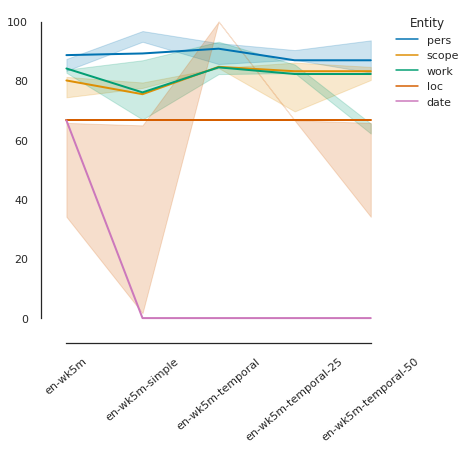

In [503]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=1, style="white")
plt.rcParams["figure.figsize"] = (6, 6)

#g = sns.catplot(data=df, x='Year', y='F1', hue='Entity', height=4, aspect=1.5,
#                linewidth = 1., palette='colorblind', kind='line')
#g = sns.lineplot(data=df, x='Method', y='F1', hue='Entity')
g = sns.lineplot(
    data=df, x="Method", y="F1", hue="Entity", linewidth = 2, palette='colorblind', n_boot = 2,
)
#with sns.axes_style("white"): style="Year", 
#    g = sns.FacetGrid(df, row="Year", col="Method", margin_titles=True, height=3.5)
#g.map(sns.barplot, "Entity", "F1", palette='colorblind')
#g.set_axis_labels("Entities", "Tip")
#g.set(xticks=[10, 30, 50], yticks=[2, 6, 10])
#g.figure.subplots_adjust(wspace=.02, hspace=.02)
sns.move_legend(g, "upper left", bbox_to_anchor=(1., 1.))
sns.despine(offset=10, trim=True);

plt.xticks(rotation=40)
plt.ylabel('')
plt.xlabel('')
plt.show()


             Method        Date  Year Entity   Precision      Recall  \
119  en-wk5m-simple  1896-01-01  1896   date    0.000000    0.000000   
49   en-wk5m-simple  1881-01-01  1881    loc  100.000000  100.000000   
174  en-wk5m-simple  1881-01-01  1881    loc    0.000000    0.000000   
139  en-wk5m-simple  1896-01-01  1896    loc  100.000000  100.000000   
3    en-wk5m-simple  1881-01-01  1881   pers  100.000000  100.000000   
18   en-wk5m-simple  1881-01-01  1881   pers   93.333333  100.000000   
33   en-wk5m-simple  1881-01-01  1881   pers   72.727273  100.000000   
50   en-wk5m-simple  1881-01-01  1881   pers  100.000000   80.000000   
68   en-wk5m-simple  1881-01-01  1881   pers  100.000000  100.000000   
83   en-wk5m-simple  1881-01-01  1881   pers  100.000000  100.000000   
96   en-wk5m-simple  1881-01-01  1881   pers  100.000000  100.000000   
103  en-wk5m-simple  1881-01-01  1881   pers   66.666667   80.000000   
175  en-wk5m-simple  1881-01-01  1881   pers   50.000000   50.00

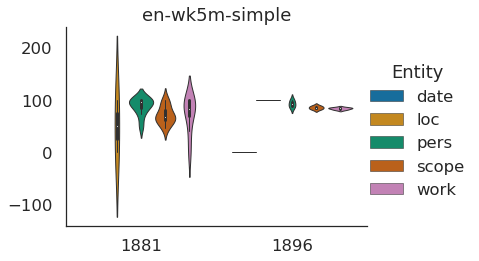

      Method        Date  Year Entity   Precision      Recall          F1  \
115  en-wk5m  1896-01-01  1896   date   66.666667   66.666667   66.666667   
45   en-wk5m  1881-01-01  1881    loc  100.000000  100.000000  100.000000   
170  en-wk5m  1881-01-01  1881    loc    0.000000    0.000000    0.000000   
135  en-wk5m  1896-01-01  1896    loc  100.000000  100.000000  100.000000   
0    en-wk5m  1881-01-01  1881   pers  100.000000  100.000000  100.000000   
15   en-wk5m  1881-01-01  1881   pers   93.333333  100.000000   96.551724   
30   en-wk5m  1881-01-01  1881   pers   80.000000  100.000000   88.888889   
46   en-wk5m  1881-01-01  1881   pers  100.000000   80.000000   88.888889   
65   en-wk5m  1881-01-01  1881   pers  100.000000  100.000000  100.000000   
80   en-wk5m  1881-01-01  1881   pers   90.909091  100.000000   95.238095   
95   en-wk5m  1881-01-01  1881   pers  100.000000  100.000000  100.000000   
100  en-wk5m  1881-01-01  1881   pers   57.142857   80.000000   66.666667   

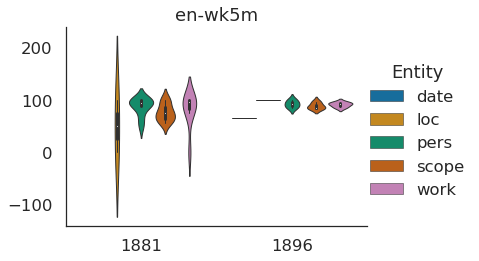

Empty DataFrame
Columns: [Method, Date, Year, Entity, Precision, Recall, F1, Average Length]
Index: []


ValueError: min() arg is an empty sequence

In [504]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=1.5, style="white")
plt.rcParams["figure.figsize"] = (4, 4)
#'no context', 
for run in ['en-wk5m-simple', 'en-wk5m', 'en-wk5m-temporal-10', 'en-wk5m-temporal-25', 'en-wk5m-temporal-50']:
    #f, ax = plt.subplots(1, 1)
    df_submission = df[df.Method == run].sort_values(by=['Entity', 'Year'], ascending=True)
    print(df_submission)
    g = sns.catplot(data=df_submission, x='Year', y='F1', hue='Entity', height=4, aspect=1.5,
                    linewidth = 1., palette='colorblind', kind='violin')
    
    #_ = sns.lineplot(data=df_submission, x='Year', y='Average Lenght', hue='Entity', 
    #                linewidth = 1.5, palette=run[1])
    
    #_ = sns.scatterplot(x="Average Lenght", y="F1", data=df_submission)#, x_estimator=np.mean)#v, scatter=False, truncate=False
    
    #_ = sns.lmplot(x="Average Lenght", y="F1", hue="Entity", col="Year",  col_wrap=2, height=3, data=df_submission)
    
    #_ = sns.jointplot(x="Average Lenght", y="F1", data=df_submission, kind="reg")
    #_ = sns.pairplot(df_submission, x_vars=["Average Lenght"], y_vars=["F1"],
    #         hue="Entity", height=5, aspect=2.8, kind="reg")
    
    
    #_ = sns.lmplot(x="Average Lenght", y="F1", hue="Entity", height=5, aspect=1.4, data=df_submission, legend=False)
    
    
    #plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])

    #if '_50' not in run:
        #print(run)
        #plt.legend(title='Entity', loc='lower right')
        #g._legend.remove()
        #plt.legend().set_visible(False)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(run.replace('predictions_test_', ''))
    #plt.ylim(0.0, 102.0)
    #plt.xticks(rotation=40)
    plt.show()


In [ ]:
data_scores = [
    ['AjMC', 'en_wk5m_simple_time50', 0.75341463, 0.74710065, 0.7329582, 0.73047197, 0.7296967, 0.7244781, 0.7213008, 0.7210349, 0.7186125, 0.7163226, 0.8524529, 0.82684577, 0.8097131, 0.80638534, 0.8045013, 0.803977, 0.80118173, 0.8008046, 0.794859, 0.7864254, 0.82658404, 0.78177905, 0.7805128, 0.7712648, 0.77029574, 0.769907, 0.76741475, 0.76694775, 0.76651144, 0.7662354, 0.80631185, 0.79913735, 0.7956059, 0.79260784, 0.7917407, 0.7913723, 0.78976595, 0.7889348, 0.78827345, 0.78678286, 0.7538364, 0.7511452, 0.7471605, 0.7464225, 0.74233764, 0.74229574, 0.7417371, 0.7415602, 0.7413091, 0.74075675, 0.8832824, 0.82567906, 0.813406, 0.80989146, 0.8045099, 0.803975, 0.78568196, 0.7801461, 0.7797496, 0.77911603, 0.7472438, 0.7395952, 0.7392269, 0.7375299, 0.73150814, 0.730331, 0.7269174, 0.7255673, 0.7234684, 0.72337216, 0.78715825, 0.78061914, 0.77635336, 0.77468586, 0.7729316, 0.7724402, 0.7703613, 0.7695359, 0.76885635, 0.7667896, 0.7884506, 0.77667814, 0.7756314, 0.7730385, 0.77269477, 0.7683885, 0.7646499, 0.761325, 0.7579107, 0.756497, 0.7921318, 0.7846998, 0.7749804, 0.7720207, 0.7684665, 0.76707375, 0.76641834, 0.76440805, 0.7640394, 0.7633779, 0.78817636, 0.7770978, 0.7726859, 0.77040976, 0.7701478, 0.76633394, 0.7657157, 0.75941384, 0.75789785, 0.75622874, 0.7735939, 0.76901317, 0.75587714, 0.7524241, 0.752108, 0.7507311, 0.74750054, 0.7431419, 0.7413657, 0.7406765, 0.7616514, 0.7559555, 0.75096095, 0.7438493, 0.7434284, 0.74106705, 0.73976606, 0.7388446, 0.73692495, 0.7368185, 0.838518, 0.7806123, 0.77144885, 0.7712205, 0.7528168, 0.7526287, 0.7418587, 0.7416726, 0.7403312, 0.73873264, 0.76954913, 0.7549517, 0.75416577, 0.7524011, 0.751058, 0.7506175, 0.7454111, 0.7439051, 0.7414353, 0.73936546, 0.83033663, 0.8156568, 0.81445885, 0.81272435, 0.8091767, 0.807222, 0.8039025, 0.8028031, 0.80233, 0.80170894, 0.74504185, 0.74281776, 0.7396395, 0.7375069, 0.73471975, 0.7326487, 0.73262525, 0.7318814, 0.73104334, 0.73080695, 0.71398246, 0.704014, 0.6999363, 0.6963519, 0.6861879, 0.6850775, 0.6828616, 0.6824244, 0.6817252, 0.6809862, 0.781692, 0.75210077, 0.7491422, 0.7463178, 0.7458536, 0.7442336, 0.74393415, 0.7429803, 0.74272877, 0.7407167, 0.7791413, 0.7772372, 0.761213, 0.75539935, 0.75419176, 0.74766135, 0.7448068, 0.7399147, 0.738856, 0.7377444, 0.82206345, 0.7825255, 0.7811307, 0.78098226, 0.7795182, 0.7724722, 0.7669728, 0.7662093, 0.7650855, 0.76390356, 0.80453444, 0.79417783, 0.7932279, 0.7864555, 0.78636646, 0.78428197, 0.78343403, 0.78079844, 0.7776089, 0.7770134, 0.85279423, 0.843109, 0.8419761, 0.83379936, 0.8319638, 0.83012116, 0.82707274, 0.8260031, 0.8259628, 0.8243619, 0.7652141, 0.7524669, 0.7518265, 0.75030184, 0.74887156, 0.7454855, 0.73585004, 0.7343616, 0.7343011, 0.73367953, 0.8057361, 0.8004471, 0.78905666, 0.765193, 0.76446134, 0.7633493, 0.7533923, 0.7527552, 0.74996006, 0.7487176, 0.8254608, 0.8072473, 0.79987574, 0.79776865, 0.7966855, 0.7962071, 0.7960029, 0.79567707, 0.79488635, 0.7947922, 0.746686, 0.7465601, 0.74509656, 0.73712105, 0.7346157, 0.73299897, 0.732125, 0.73133814, 0.73092085, 0.73032653, 0.8092644, 0.8004905, 0.79605854, 0.79282904, 0.7916833, 0.7907055, 0.7874706, 0.78702474, 0.78690994, 0.78450036, 0.7509031, 0.739654, 0.71809, 0.7179654, 0.7171924, 0.71370846, 0.7136898, 0.71139884, 0.7079986, 0.7075721, 0.79996455, 0.7902942, 0.76974714, 0.76401675, 0.7623743, 0.7620852, 0.76142764, 0.76061743, 0.757545, 0.7550522, 0.811064, 0.8105062, 0.79827106, 0.79717374, 0.79641926, 0.7920979, 0.7909782, 0.7888238, 0.78659594, 0.7864096, 0.77391243, 0.7709638, 0.76086295, 0.7368674, 0.7346175, 0.72836524, 0.7159107, 0.7062851, 0.7001466, 0.6982454, 0.7440254, 0.7384767, 0.73597854, 0.72785807, 0.72219086, 0.71789527, 0.71432424, 0.7138098, 0.7081423, 0.7070575, 0.7795887, 0.77214074, 0.77099025, 0.7709348, 0.76777077, 0.7636305, 0.763222, 0.7629608, 0.76266, 0.7617831, 0.8205509, 0.79939574, 0.79026914, 0.7899672, 0.7818992, 0.7781552, 0.7751348, 0.7743919, 0.773505, 0.7711954, 0.8427249, 0.84077096, 0.8396378, 0.81628287, 0.8105271, 0.8052213, 0.8045131, 0.80140984, 0.799657, 0.7991816, 0.7985265, 0.79651904, 0.794752, 0.7943479, 0.79241765, 0.7905489, 0.7885137, 0.78794193, 0.7874832, 0.7868339, 0.7534081, 0.7525601, 0.74749714, 0.7457367, 0.7436885, 0.7338426, 0.7329068, 0.73188996, 0.7318033, 0.7311785, 0.7741633, 0.7663982, 0.76344025, 0.7619281, 0.76076984, 0.76032186, 0.75855696, 0.7580209, 0.7570467, 0.75682676, 0.8136202, 0.797496, 0.7868241, 0.782091, 0.7815864, 0.78103673, 0.7806481, 0.78048253, 0.7790366, 0.7785026, 0.80604005, 0.80167645, 0.7883828, 0.7825208, 0.7799746, 0.7787178, 0.774063, 0.77350813, 0.7711339, 0.7698546, 0.8017837, 0.78656167, 0.783934, 0.7837674, 0.77678466, 0.7727665, 0.7722066, 0.77062464, 0.7697916, 0.76827604, 0.82172626, 0.8191868, 0.818967, 0.8182862, 0.8156487, 0.81538844, 0.81002635, 0.80964446, 0.8078127, 0.8073175, 0.76974374, 0.7605976, 0.7480364, 0.74426466, 0.74380654, 0.74373674, 0.74255824, 0.7412281, 0.7410049, 0.736151, 0.81408775, 0.81380403, 0.8095101, 0.79952246, 0.7959587, 0.794852, 0.7945801, 0.7932396, 0.7917682, 0.7898058, 0.82872903, 0.78898525, 0.7877503, 0.78518236, 0.7850956, 0.7758422, 0.7758092, 0.77253044, 0.769713, 0.7687036, 0.77084595, 0.76073956, 0.7513918, 0.75077516, 0.74735355, 0.7416681, 0.7400908, 0.73746014, 0.73625624, 0.73503435, 0.764534, 0.7559922, 0.75579715, 0.7469399, 0.7458575, 0.7433067, 0.7428447, 0.74246836, 0.7413405, 0.7395148, 0.7447149, 0.74395895, 0.7400286, 0.73975664, 0.73714626, 0.7363234, 0.7352445, 0.7348708, 0.7332876, 0.7332046, 0.8097931, 0.7897537, 0.78417796, 0.78138936, 0.77891695, 0.77870584, 0.77454734, 0.77381814, 0.77309036, 0.7680718, 0.8453051, 0.8445249, 0.8398571, 0.8380048, 0.831053, 0.8298936, 0.8281096, 0.82808757, 0.8280872, 0.828024, 0.81586206, 0.8061739, 0.79162097, 0.7912973, 0.78990173, 0.78979087, 0.7892419, 0.7834512, 0.78311837, 0.7818357, 0.76345015, 0.7619299, 0.74703455, 0.74669445, 0.7444612, 0.74415827, 0.7431042, 0.7406925, 0.74018, 0.7384598, 0.7607581, 0.7572421, 0.75633967, 0.7469819, 0.74675024, 0.7457188, 0.7454949, 0.7454684, 0.7447472, 0.74434423, 0.8373866, 0.82460713, 0.8215172, 0.8096378, 0.8003391, 0.79883647, 0.7984413, 0.7979572, 0.7958068, 0.79046786, 0.7937923, 0.7912882, 0.7903448, 0.78445685, 0.78383654, 0.7745424, 0.7725276, 0.7711275, 0.7706783, 0.76907355, 0.7704711, 0.7627615, 0.7481519, 0.74712, 0.7422565, 0.7403658, 0.7369931, 0.7337339, 0.7324721, 0.73166275, 0.77523005, 0.7742773, 0.769572, 0.7646779, 0.76378787, 0.7624423, 0.7621037, 0.7606604, 0.75848407, 0.75507736, 0.7627169, 0.76038057, 0.75460786, 0.7483157, 0.748162, 0.747903, 0.74786943, 0.74701136, 0.74533874, 0.7417352, 0.770838, 0.7562736, 0.7558045, 0.755785, 0.7542108, 0.7533157, 0.7523283, 0.75164187, 0.74930537, 0.7470032, 0.75466883, 0.74975765, 0.7354927, 0.7331613, 0.7325493, 0.729706, 0.7276561, 0.7248123, 0.72350466, 0.7222035, 0.76303804, 0.748397, 0.74745584, 0.74494874, 0.74129504, 0.7400835, 0.73939914, 0.73910964, 0.7370908, 0.7368301, 0.8370475, 0.79585576, 0.79396635, 0.7938328, 0.7905436, 0.78489333, 0.7815302, 0.78123796, 0.7811752, 0.78000104, 0.82443094, 0.8113309, 0.76989156, 0.7409327, 0.74071765, 0.7245846, 0.71570545, 0.7151003, 0.71419245, 0.71331644, 0.7775873, 0.77041817, 0.76808774, 0.7678517, 0.7672938, 0.7658771, 0.7640891, 0.76392686, 0.7635378, 0.7625152, 0.798614, 0.78714687, 0.78619546, 0.77980465, 0.77924776, 0.77648354, 0.7741837, 0.7739141, 0.77321136, 0.7729885, 0.7979617, 0.7949269, 0.7729079, 0.7666693, 0.7618319, 0.7593808, 0.75917447, 0.75890577, 0.7583736, 0.75530183, 0.80182934, 0.79981875, 0.7946922, 0.7883738, 0.7864488, 0.7857838, 0.7850205, 0.78458095, 0.784215, 0.78269434, 0.7514715, 0.7413657, 0.725357, 0.72493577, 0.7248409, 0.72425157, 0.7233438, 0.72327095, 0.7204694, 0.719994, 0.7605401, 0.74393666, 0.7431755, 0.7415751, 0.7344799, 0.73443246, 0.73427594, 0.73286647, 0.73280156, 0.7284845, 0.8055636, 0.7966436, 0.78662646, 0.77834094, 0.7751743, 0.7715833, 0.77092147, 0.76939034, 0.7682505, 0.7679832, 0.8082021, 0.80699223, 0.8057688, 0.8025712, 0.8024126, 0.801922, 0.8013921, 0.80119, 0.79911685, 0.7985304, 0.80251145, 0.78373706, 0.7734772, 0.77265596, 0.7708539, 0.7648995, 0.7647435, 0.7599398, 0.75773406, 0.75653976, 0.81127226, 0.80118203, 0.7994909, 0.78577316, 0.778823, 0.77559686, 0.77293265, 0.77191025, 0.7708535, 0.769296, 0.76955175, 0.7582921, 0.7576141, 0.75603855, 0.75196993, 0.7516764, 0.7506396, 0.7493951, 0.74868685, 0.74846673, 0.7972318, 0.7960295, 0.7802894, 0.77966994, 0.7793517, 0.77788883, 0.776284, 0.7725722, 0.7722336, 0.7699875, 0.76109314, 0.75109154, 0.7503266, 0.7466196, 0.74236596, 0.74078596, 0.74025345, 0.73993933, 0.73380655, 0.7297924, 0.740111, 0.73895335, 0.7359097, 0.72840154, 0.728104, 0.72695845, 0.72584957, 0.7257473, 0.7250647, 0.7246007, 0.7581219, 0.75145495, 0.7296371, 0.7243227, 0.72131056, 0.71846074, 0.71772057, 0.71105134, 0.71074945, 0.70915115, 0.7205545, 0.71703655, 0.7120911, 0.7110774, 0.71095616, 0.7097376, 0.70936, 0.7072164, 0.70320636, 0.7031902, 0.77194273, 0.7639998, 0.7588407, 0.7566683, 0.755915, 0.7555698, 0.75483984, 0.75421226, 0.75153315, 0.7510865, 0.7714616, 0.7552707, 0.7531452, 0.74946713, 0.7474399, 0.7451294, 0.7445291, 0.74093527, 0.74006706, 0.739074, 0.7437266, 0.7358849, 0.734733, 0.73470545, 0.7335884, 0.7309314, 0.7308556, 0.7308, 0.7305934, 0.7304333, 0.795984, 0.78763795, 0.78472614, 0.78313124, 0.78102905, 0.7776731, 0.7768433, 0.7767945, 0.77377295, 0.7719618, 0.8104242, 0.8015114, 0.7990773, 0.7987759, 0.791062, 0.79088587, 0.7906631, 0.78803366, 0.78787625, 0.7863974, 0.80171365, 0.7853638, 0.7841606, 0.7788516, 0.7736572, 0.76825637, 0.76801234, 0.76766735, 0.76590025, 0.7646047, 0.78343165, 0.7781129, 0.7765493, 0.76974195, 0.76600623, 0.7658063, 0.76573527, 0.7639514, 0.7638537, 0.76377654, 0.770537, 0.75935376, 0.7564022, 0.75448525, 0.753739, 0.75267315, 0.7516324, 0.7505939, 0.74913955, 0.74844307, 0.83547676, 0.8325746, 0.82550454, 0.82514566, 0.8204465, 0.81891084, 0.81409186, 0.8128929, 0.8120328, 0.8083484, 0.82719123, 0.8201476, 0.7963655, 0.79128176, 0.7895496, 0.78813374, 0.78794336, 0.7664343, 0.763764, 0.7631491, 0.8018271, 0.7786312, 0.76212656, 0.7574516, 0.7562139, 0.75486493, 0.7535078, 0.7516576, 0.74825335, 0.74777156, 0.72588587, 0.7251685, 0.72478145, 0.7136719, 0.7123747, 0.7112379, 0.7108997, 0.7104043, 0.7101367, 0.71009904, 0.7987784, 0.7859323, 0.7853237, 0.78351104, 0.7765237, 0.77333564, 0.7701734, 0.7697849, 0.7691319, 0.76649237, 0.76046455, 0.7599026, 0.7592202, 0.7559005, 0.7538389, 0.75094354, 0.7496995, 0.74776816, 0.74663216, 0.7450902, 0.778344, 0.7631045, 0.7594842, 0.7577287, 0.756927, 0.754812, 0.75356674, 0.75259733, 0.7505866, 0.7488246, 0.73588884, 0.7222, 0.7148804, 0.7141893, 0.7117927, 0.71071553, 0.71031815, 0.70973825, 0.70304054, 0.7028314, 0.767203, 0.73929775, 0.73459315, 0.73108774, 0.7261317, 0.72439224, 0.7239055, 0.7235148, 0.7226344, 0.7223085, 0.7572888, 0.754598, 0.7450988, 0.7426377, 0.7408235, 0.72985256, 0.72623694, 0.72517043, 0.724766, 0.72436845, 0.81003714, 0.78387016, 0.77992606, 0.7799214, 0.7795705, 0.7726561, 0.7704252, 0.7691567, 0.7674198, 0.76601565, 0.7813889, 0.76858443, 0.76130676, 0.75629103, 0.74916255, 0.74883103, 0.7483228, 0.7471607, 0.74602246, 0.74576235, 0.7714941, 0.7660283, 0.75784177, 0.7577295, 0.75614965, 0.7557165, 0.75440204, 0.7533616, 0.7531043, 0.75217235, 0.737743, 0.7240461, 0.71695626, 0.7157701, 0.7146251, 0.7128075, 0.71041995, 0.71028423, 0.7099493, 0.70983946, 0.8330242, 0.8171567, 0.81644213, 0.80996025, 0.7946655, 0.78711754, 0.7870815, 0.7841989, 0.7831249, 0.7829826, 0.7656271, 0.76462424, 0.76056194, 0.760373, 0.756266, 0.75594175, 0.7557552, 0.75539345, 0.7547877, 0.753686, 0.77181005, 0.76635575, 0.76044846, 0.7590649, 0.756683, 0.7539973, 0.75295585, 0.7513499, 0.7506826, 0.75029045, 0.7826054, 0.76674306, 0.7664819, 0.76525617, 0.7561445, 0.75108147, 0.74983156, 0.74969375, 0.7485154, 0.7474069, 0.83227855, 0.8298944, 0.8288539, 0.82408524, 0.8229501, 0.8228401, 0.8225295, 0.822369, 0.8222816, 0.8220127, 0.7716032, 0.76377606, 0.76053417, 0.7602935, 0.75717795, 0.75223637, 0.75027424, 0.7499758, 0.7493973, 0.74728, 0.75926447, 0.7577932, 0.75518864, 0.74863374, 0.74528915, 0.7447619, 0.74129, 0.740338, 0.7392363, 0.7390369, 0.74531054, 0.74108535, 0.728686, 0.7283072, 0.7265619, 0.7259567, 0.7223923, 0.7199362, 0.7181651, 0.71812034, 0.7781845, 0.7572772, 0.74472606, 0.7412455, 0.74041086, 0.73672587, 0.73669326, 0.730881, 0.72994405, 0.72898245, 0.8002614, 0.7967185, 0.79644024, 0.7938345, 0.79368675, 0.7920742, 0.788082, 0.7880081, 0.787339, 0.7872362, 0.7819505, 0.7759162, 0.77368504, 0.76728386, 0.7605667, 0.7587315, 0.7569443, 0.75272834, 0.7515775, 0.75155926, 0.74156064, 0.73451024, 0.7336814, 0.7307478, 0.7287438, 0.72778404, 0.7253029, 0.72491914, 0.7247978, 0.7236626, 0.7710299, 0.7706592, 0.76978153, 0.76954365, 0.7686395, 0.76703215, 0.766431, 0.76637375, 0.76596224, 0.7643771, 0.7828355, 0.77260935, 0.76920116, 0.76730645, 0.7640352, 0.75869083, 0.75748706, 0.7549436, 0.75360286, 0.7514646, 0.8114239, 0.7958341, 0.7943063, 0.79403675, 0.79257977, 0.7918618, 0.7917043, 0.79048866, 0.7898416, 0.7896057, 0.74088514, 0.74086934, 0.739507, 0.7352836, 0.73299724, 0.73097277, 0.7286916, 0.7243211, 0.72267103, 0.7219471, 0.80594313, 0.8046764, 0.8025553, 0.7866806, 0.7858682, 0.78008056, 0.77871466, 0.77518237, 0.77514464, 0.774639, 0.76803994, 0.75220335, 0.7464212, 0.7451358, 0.7414839, 0.7402535, 0.7398833, 0.7388227, 0.73695236, 0.7363747, 0.770555, 0.7675958, 0.76284826, 0.75770855, 0.7566541, 0.75446117, 0.751253, 0.75117815, 0.7508986, 0.75044125, 0.7880748, 0.77721643, 0.77697086, 0.77694833, 0.76471364, 0.76097417, 0.75748605, 0.7561186, 0.7528639, 0.75005794, 0.82076985, 0.78951615, 0.771555, 0.7706928, 0.76838946, 0.7614555, 0.76079035, 0.75938725, 0.7564919, 0.7560729, 0.8060763, 0.80007935, 0.78557336, 0.77428496, 0.77409804, 0.7705375, 0.7693585, 0.76738954, 0.7645619, 0.76340353, 0.8410171, 0.8332221, 0.8255641, 0.7946128, 0.78755784, 0.7875432, 0.7863977, 0.7860439, 0.783316, 0.7813076, 0.78814626, 0.7713591, 0.76664853, 0.7626321, 0.75530744, 0.7528763, 0.74997395, 0.7479898, 0.74748087, 0.744497, 0.8129802, 0.79415417, 0.79268837, 0.7909167, 0.7851776, 0.7817943, 0.77549267, 0.7733007, 0.77248263, 0.7701706, 0.7630338, 0.7425493, 0.73589844, 0.7280942, 0.72676146, 0.7243002, 0.7197173, 0.7182141, 0.71573615, 0.7149866, 0.73866695, 0.7351972, 0.7334956, 0.7330178, 0.7314303, 0.7306315, 0.7300694, 0.72923326, 0.7291964, 0.7291335, 0.8517231, 0.84831583, 0.83992666, 0.8340018, 0.8292287, 0.8284582, 0.8273529, 0.82434833, 0.82186556, 0.82174164, 0.79793894, 0.794081, 0.7819902, 0.7731466, 0.76507074, 0.76371604, 0.7613276, 0.7603525, 0.7560789, 0.75457597, 0.83488035, 0.82171655, 0.82105994, 0.820189, 0.8177947, 0.8162545, 0.8160344, 0.8155179, 0.81520426, 0.80957615, 0.8211322, 0.80598253, 0.79798037, 0.7959088, 0.79134846, 0.78995264, 0.78781945, 0.7871848, 0.78681386, 0.78493845, 0.7788687, 0.77852625, 0.7714995, 0.7675065, 0.7636712, 0.76098955, 0.7567941, 0.7549748, 0.75363815, 0.75220156, 0.777339, 0.77036643, 0.76969016, 0.76952493, 0.7623627, 0.7614876, 0.7589077, 0.75264406, 0.75142163, 0.7419847, 0.7618001, 0.744901, 0.73975945, 0.73850054, 0.7348618, 0.72541255, 0.72425073, 0.7237873, 0.7228367, 0.72234815, 0.760154, 0.757712, 0.75365114, 0.75025946, 0.74887955, 0.7485157, 0.7455944, 0.74556625, 0.7448908, 0.74365306, 0.76721835, 0.766539, 0.7645811, 0.7606844, 0.75755477, 0.7567127, 0.7564144, 0.75568235, 0.7478764, 0.7474403, 0.7755244, 0.7508758, 0.7470901, 0.745949, 0.74556834, 0.74083996, 0.7393812, 0.73927486, 0.73811543, 0.73791564, 0.80727565, 0.80564076, 0.79714763, 0.79262394, 0.7748036, 0.7742223, 0.76741457, 0.76695013, 0.7634824, 0.76277304, 0.8023914, 0.7846118, 0.78314835, 0.7819768, 0.7792922, 0.77862895, 0.76951027, 0.7613151, 0.7606516, 0.7572416, 0.79716265, 0.789307, 0.7875924, 0.7735677, 0.7728411, 0.76906073, 0.76722705, 0.764714, 0.76267123, 0.76210123, 0.81710815, 0.8092115, 0.8045474, 0.80432916, 0.8040028, 0.80080336, 0.79997087, 0.7996588, 0.79826844, 0.7970743, 0.75460756, 0.747358, 0.74171853, 0.7380649, 0.7349706, 0.7348423, 0.7314217, 0.73000735, 0.728901, 0.72888833, 0.7756655, 0.7629179, 0.76192987, 0.7614833, 0.75078595, 0.7472974, 0.74604213, 0.7449198, 0.7438065, 0.74229497, 0.7355319, 0.7256744, 0.72131705, 0.7201989, 0.71817636, 0.71768516, 0.71646327, 0.7162524, 0.71454585, 0.71447384, 0.7897521, 0.78584486, 0.78474534, 0.7838581, 0.78259695, 0.7818627, 0.78140306, 0.7802546, 0.7781619, 0.776235, 0.79050004, 0.7887397, 0.7801012, 0.77512795, 0.77471673, 0.77203536, 0.7714341, 0.77100635, 0.7657486, 0.76366377, 0.7941093, 0.7928587, 0.790915, 0.78674066, 0.78432256, 0.7839503, 0.7835004, 0.78163815, 0.778602, 0.7740098, 0.79121053, 0.78854656, 0.7743432, 0.7668117, 0.76552844, 0.7650747, 0.75671613, 0.7560221, 0.7539005, 0.7513626, 0.76385385, 0.75791395, 0.7527272, 0.75132555, 0.7511511, 0.75089866, 0.74605584, 0.7460244, 0.7458328, 0.74580467, 0.7896757, 0.78529674, 0.78462064, 0.7799586, 0.77693933, 0.7724441, 0.77111757, 0.77017176, 0.769014, 0.7685916, 0.7552676, 0.7549896, 0.7464281, 0.742218, 0.7417184, 0.7397995, 0.7382515, 0.7343257, 0.7307999, 0.7300029, 0.78419995, 0.7737367, 0.75978243, 0.75282145, 0.75277513, 0.7517853, 0.74965966, 0.74810314, 0.74625623, 0.73928, 0.73775446, 0.7239375, 0.71845466, 0.7183684, 0.7177088, 0.715925, 0.71559644, 0.71495986, 0.71462643, 0.71315944, 0.7915753, 0.7785388, 0.7634936, 0.7608185, 0.7511059, 0.74836767, 0.7468845, 0.74655855, 0.74645567, 0.74643284, 0.7608857, 0.7534964, 0.75345314, 0.75271606, 0.7503371, 0.74965584, 0.74877703, 0.74137616, 0.73989546, 0.73938733, 0.8277803, 0.8145812, 0.80883455, 0.78456664, 0.78305405, 0.782874, 0.7819307, 0.77970195, 0.77732724, 0.7766191, 0.7317543, 0.7300292, 0.7284395, 0.72717816, 0.7234249, 0.7219801, 0.72116697, 0.7199991, 0.7153778, 0.7122979, 0.78257555, 0.75057495, 0.74600315, 0.74539006, 0.74335074, 0.7430593, 0.7430072, 0.7422811, 0.7417423, 0.7406385, 0.7076521, 0.70618844, 0.7008867, 0.70052385, 0.69696575, 0.6969577, 0.6962623, 0.6927325, 0.689388, 0.68746245, 0.79480517, 0.79464036, 0.78712404, 0.7864326, 0.78512883, 0.7833754, 0.7826412, 0.78215706, 0.7816997, 0.7805262, 0.7711129, 0.766703, 0.76311207, 0.7588568, 0.7523197, 0.7487252, 0.74816144, 0.74555904, 0.7444425, 0.7442416, 0.7384563, 0.7181513, 0.704655, 0.7037351, 0.7030351, 0.7010389, 0.6986791, 0.6976079, 0.69378096, 0.69340855, 0.76985395, 0.754671, 0.7529945, 0.7483291, 0.7437773, 0.74341464, 0.74328136, 0.7431964, 0.7426928, 0.74033177, 0.7536907, 0.75019383, 0.75001454, 0.74677306, 0.7439564, 0.742295, 0.7420485, 0.74168587, 0.74126583, 0.7407997, 0.7674907, 0.7577714, 0.757458, 0.7563578, 0.75608677, 0.7534244, 0.7488638, 0.74620545, 0.7427588, 0.7424213, 0.7452665, 0.73928744, 0.7297631, 0.7233135, 0.7227233, 0.7161123, 0.7155424, 0.71286017, 0.7118764, 0.7085068, 0.7994076, 0.78976876, 0.7879044, 0.77350926, 0.7730863, 0.77035904, 0.76673985, 0.76420796, 0.7638731, 0.76169896, 0.76517713, 0.76504886, 0.7611848, 0.7582313, 0.7552364, 0.7530614, 0.7497287, 0.7483641, 0.746717, 0.7466682, 0.81421375, 0.77332616, 0.76736534, 0.74988073, 0.7434271, 0.7426356, 0.7410202, 0.74073565, 0.7368573, 0.73587894, 0.7662187, 0.765299, 0.7648474, 0.7611741, 0.7611494, 0.7596798, 0.7594578, 0.75869095, 0.75864077, 0.7585106, 0.7439377, 0.73822653, 0.7369727, 0.73532504, 0.73249316, 0.730711, 0.72716415, 0.72700745, 0.7266145, 0.7261572, 0.8054812, 0.7978556, 0.79590595, 0.7891995, 0.7875251, 0.7855602, 0.78224385, 0.78136086, 0.77981997, 0.77858245, 0.8501596, 0.849283, 0.8475889, 0.8400605, 0.83990645, 0.8360151, 0.8297899, 0.82954174, 0.8265796, 0.8250842, 0.76793027, 0.7511239, 0.7450181, 0.74500453, 0.7438927, 0.73960274, 0.7393681, 0.7388827, 0.7380922, 0.7376424, 0.7716199, 0.7689299, 0.76519746, 0.76100737, 0.75821257, 0.7575075, 0.7569115, 0.7532802, 0.75193655, 0.750337, 0.78420717, 0.7725885, 0.7628974, 0.7557839, 0.75402045, 0.75194615, 0.7501197, 0.7493211, 0.7485461, 0.74851644, 0.77382624, 0.76791525, 0.7668462, 0.76642406, 0.760386, 0.75791043, 0.7568511, 0.75625485, 0.7500442, 0.7499746, 0.7433792, 0.7413055, 0.7347323, 0.73438805, 0.733119, 0.732759, 0.7323672, 0.7303747, 0.73031235, 0.73017454, 0.77269614, 0.76030135, 0.7600976, 0.75935006, 0.7584193, 0.7577406, 0.7553358, 0.7548305, 0.75341094, 0.7523409, 0.80742484, 0.7947353, 0.7886564, 0.78591055, 0.78533995, 0.7845435, 0.78141415, 0.77985126, 0.77732956, 0.77639925, 0.7679299, 0.7632377, 0.76198703, 0.76050675, 0.7600503, 0.7586974, 0.7576692, 0.7570746, 0.75472367, 0.7546785, 0.7409058, 0.7390429, 0.73835075, 0.73453516, 0.73404574, 0.7326453, 0.731928, 0.7273058, 0.7261133, 0.7255654, 0.7822269, 0.7782612, 0.7647731, 0.76441115, 0.75563467, 0.75543237, 0.7537655, 0.7529403, 0.75188047, 0.7501385, 0.77225363, 0.7643525, 0.74592084, 0.7411414, 0.74106455, 0.73798394, 0.73795176, 0.73606694, 0.7353971, 0.73511994, 0.75311327, 0.7399256, 0.72499424, 0.72469115, 0.72283745, 0.72121155, 0.7210485, 0.72030824, 0.7202082, 0.7194169, 0.8238325, 0.81626153, 0.80052835, 0.79944646, 0.797693, 0.7963445, 0.789724, 0.7896985, 0.78920233, 0.78688926, 0.8231137, 0.8009063, 0.792617, 0.7917347, 0.79118633, 0.7877566, 0.7814753, 0.78089166, 0.7686815, 0.76585966, 0.781616, 0.77171695, 0.7714062, 0.7692963, 0.7653644, 0.75949657, 0.75901055, 0.7572599, 0.7552501, 0.7550591, 0.8160436, 0.79867095, 0.7916293, 0.7852205, 0.78441167, 0.7844075, 0.78367627, 0.7832084, 0.78270364, 0.7786555, 0.8268995, 0.82098216, 0.8111094, 0.79701495, 0.79653275, 0.7942332, 0.79354036, 0.7935306, 0.79200625, 0.79003143, 0.7998278, 0.79976386, 0.768384, 0.7592805, 0.7516192, 0.7501008, 0.7444469, 0.7432018, 0.7427271, 0.74253404, 0.8087693, 0.79612505, 0.7948246, 0.7944569, 0.79426897, 0.7929572, 0.7917015, 0.7899851, 0.7896862, 0.78846747, 0.88298666, 0.87257445, 0.8724554, 0.86988837, 0.86592597, 0.8656445, 0.86480093, 0.8641129, 0.8622258, 0.8618156, 0.8580152, 0.8568586, 0.8538923, 0.8488536, 0.84375834, 0.84232783, 0.8406609, 0.8405347, 0.83887464, 0.83851165, 0.7995231, 0.7973996, 0.79399014, 0.7936363, 0.78637457, 0.7845769, 0.7797991, 0.7784679, 0.77816737, 0.7774329, 0.78641427, 0.7634423, 0.76343715, 0.7620174, 0.75773835, 0.75640213, 0.75636697, 0.7560208, 0.75585216, 0.7539599, 0.7800355, 0.77769446, 0.77534306, 0.77443075, 0.7740798, 0.7736964, 0.77352536, 0.77184, 0.7718135, 0.76924217, 0.73495364, 0.72335577, 0.72321236, 0.7203759, 0.7164413, 0.7155758, 0.71527207, 0.7145478, 0.7080749, 0.7078782, 0.78429693, 0.76837707, 0.7549741, 0.7509706, 0.7454264, 0.74452156, 0.7399055, 0.73806775, 0.7367852, 0.7367842, 0.7400969, 0.72989655, 0.7219697, 0.71953744, 0.7173499, 0.7166583, 0.7125377, 0.7120761, 0.7118074, 0.71026677, 0.7875525, 0.7782989, 0.7717128, 0.7714465, 0.77122056, 0.77043575, 0.76922953, 0.76851475, 0.7679777, 0.767565, 0.7817267, 0.77887845, 0.7763752, 0.7732555, 0.77234787, 0.7658991, 0.75360024, 0.7530165, 0.7515451, 0.751206, 0.8300891, 0.82591367, 0.82173145, 0.82136357, 0.82105076, 0.8169719, 0.8153311, 0.81523037, 0.80763716, 0.8066542, 0.790547, 0.789684, 0.7717927, 0.7656729, 0.7634301, 0.7618657, 0.76117265, 0.7603333, 0.7598673, 0.75921357, 0.79782045, 0.7829517, 0.7773521, 0.7663584, 0.7650719, 0.7644525, 0.76180553, 0.75994956, 0.7598775, 0.75740516, 0.7832236, 0.78202915, 0.7799461, 0.7794547, 0.77582455, 0.7732093, 0.77202487, 0.7714822, 0.76943016, 0.7692731, 0.8408363, 0.8370091, 0.8331498, 0.83208334, 0.8291716, 0.8290025, 0.82517314, 0.8251295, 0.8230538, 0.82242966, 0.81162435, 0.8008588, 0.7915153, 0.7897246, 0.7892567, 0.78700805, 0.78308046, 0.7826868, 0.781446, 0.7811736, 0.7808454, 0.7500985, 0.74754024, 0.74752086, 0.74722004, 0.74119425, 0.74081194, 0.740121, 0.7399011, 0.7396555, 0.82665247, 0.8263212, 0.8181989, 0.81536317, 0.8130839, 0.8126298, 0.812616, 0.8094493, 0.80761874, 0.8070267, 0.7601232, 0.7509011, 0.74659777, 0.7444724, 0.74348974, 0.741879, 0.740738, 0.7391499, 0.7388691, 0.7386621, 0.82589155, 0.80749464, 0.78864145, 0.7879527, 0.78519845, 0.7831354, 0.7803863, 0.7783134, 0.7780962, 0.7773534, 0.8026224, 0.7911509, 0.7728764, 0.7721226, 0.7709614, 0.7690212, 0.76770353, 0.76769674, 0.766453, 0.7655213, 0.7818061, 0.76873964, 0.7656423, 0.76435804, 0.7625824, 0.7610611, 0.75997734, 0.7593496, 0.7588278, 0.7586115, 0.8076565, 0.798313, 0.79357046, 0.79179764, 0.7915038, 0.7879622, 0.7863412, 0.7833704, 0.7829213, 0.7819543, 0.77365625, 0.77081203, 0.7654197, 0.7613806, 0.7612474, 0.7588011, 0.7578539, 0.75732505, 0.7560624, 0.75528795, 0.7756358, 0.7468843, 0.7442166, 0.74052316, 0.7379855, 0.7376149, 0.7332265, 0.73058784, 0.7299667, 0.7277599, 0.8511045, 0.7934946, 0.7872577, 0.7867402, 0.78084075, 0.7768803, 0.776643, 0.77512145, 0.7739904, 0.7709681, 0.78288907, 0.76512635, 0.7621472, 0.761116, 0.7603899, 0.75902355, 0.75833887, 0.7581446, 0.7579551, 0.7560358, 0.79961216, 0.7978265, 0.7959188, 0.7957001, 0.79489386, 0.79460603, 0.7939716, 0.79299057, 0.7925138, 0.792016, 0.780527, 0.77913445, 0.7790002, 0.7781208, 0.7772037, 0.77584934, 0.77584094, 0.77552223, 0.77494717, 0.77454126, 0.8060218, 0.8059769, 0.8015726, 0.79465973, 0.7937547, 0.789932, 0.7889534, 0.78805804, 0.78636706, 0.7851604, 0.7690438, 0.7561408, 0.7543473, 0.7535944, 0.7477747, 0.745679, 0.74406946, 0.74392706, 0.7432652, 0.74184704, 0.8064332, 0.79886025, 0.79693556, 0.7961265, 0.79600835, 0.79597867, 0.79540634, 0.7941311, 0.79397285, 0.7939442, 0.7494516, 0.74568623, 0.73821044, 0.73339134, 0.72702765, 0.725441, 0.72426486, 0.7236024, 0.72033167, 0.71988124, 0.75936395, 0.7535274, 0.7520901, 0.74460256, 0.7411757, 0.7397191, 0.7384132, 0.7376261, 0.7372334, 0.7370832, 0.7715639, 0.76611364, 0.76537776, 0.7649079, 0.76283336, 0.76194036, 0.76150584, 0.7599945, 0.75730073, 0.75689995, 0.7590456, 0.75846106, 0.75825876, 0.7574751, 0.75209194, 0.74454623, 0.7442256, 0.7403163, 0.7389006, 0.73849416, 0.83216715, 0.82387334, 0.82086253, 0.8170481, 0.8168908, 0.8095094, 0.8037785, 0.7990823, 0.7983489, 0.79775393, 0.7572042, 0.75526, 0.7539213, 0.7491851, 0.7490155, 0.74622035, 0.7459477, 0.74489605, 0.74460196, 0.7440799, 0.71993554, 0.7175425, 0.71425134, 0.71373737, 0.71191764, 0.7100428, 0.7098458, 0.70698583, 0.70647186, 0.7049169, 0.80752265, 0.80620074, 0.802577, 0.7944946, 0.7929201, 0.790421, 0.7863958, 0.7861872, 0.7858932, 0.78586817, 0.7891764, 0.7683945, 0.76772916, 0.76718855, 0.76171154, 0.76161456, 0.75960106, 0.7589778, 0.75860476, 0.75846887, 0.7857703, 0.7676581, 0.7597821, 0.74577177, 0.7418227, 0.7398696, 0.7384522, 0.7355441, 0.7354655, 0.7343687, 0.79429066, 0.78606653, 0.762437, 0.7610091, 0.7602613, 0.7572961, 0.75550914, 0.75435686, 0.75319, 0.7516949, 0.814572, 0.8103812, 0.8063563, 0.8044122, 0.80277205, 0.802364, 0.8003548, 0.7965969, 0.79623854, 0.7900642, 0.80009925, 0.7986184, 0.7952125, 0.7926599, 0.7919865, 0.79175806, 0.7883696, 0.7872597, 0.7861593, 0.78553283, 0.75870323, 0.75810355, 0.75646234, 0.7564024, 0.75443417, 0.7531301, 0.75166273, 0.75160414, 0.75101507, 0.745626, 0.8322563, 0.8321452, 0.8319419, 0.82900935, 0.8265362, 0.8183069, 0.81508034, 0.8122071, 0.8117548, 0.8099342, 0.7959217, 0.78688365, 0.7866987, 0.78256476, 0.7818427, 0.77272916, 0.768952, 0.7681513, 0.7655667, 0.76168853, 0.8010365, 0.7886255, 0.785475, 0.78485525, 0.7847346, 0.7827587, 0.7808561, 0.7767764, 0.7746202, 0.7729299, 0.85594606, 0.821652, 0.8160429, 0.8137667, 0.8127227, 0.81129014, 0.8102059, 0.8095615, 0.80811024, 0.8081081, 0.79727244, 0.796769, 0.79383844, 0.7928382, 0.79265463, 0.7922021, 0.7920437, 0.79143834, 0.7888444, 0.78698885, 0.8005319, 0.79991394, 0.79766905, 0.7915858, 0.7907534, 0.7905896, 0.79056776, 0.78760695, 0.7875174, 0.7871871, 0.82210505, 0.81096125, 0.79723376, 0.7951945, 0.7925627, 0.7902918, 0.78573656, 0.785024, 0.7847503, 0.7828567, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.78167397, 0.76952535, 0.7683526, 0.76462424, 0.76413524, 0.81132776, 0.80849147, 0.80811346, 0.80811346, 0.80811346, 0.80714166, 0.807135, 0.80556524, 0.8047231, 0.804387, 0.82617193, 0.8146674, 0.814332, 0.81411135, 0.8123449, 0.81112534, 0.8110944, 0.81099904, 0.8108084, 0.8103121, 0.7978625, 0.7839068, 0.77329105, 0.77070343, 0.76707274, 0.76061916, 0.7604499, 0.7588969, 0.7587569, 0.7586885, 0.8295002, 0.82572603, 0.8101888, 0.8090228, 0.8084512, 0.8009111, 0.79656744, 0.79480785, 0.7936655, 0.79193485, 0.7796625, 0.7756849, 0.77032113, 0.76967967, 0.7681086, 0.76743126, 0.7673336, 0.7650145, 0.76450586, 0.7641653, 0.7894674, 0.7838235, 0.7800982, 0.7778243, 0.7708984, 0.76934063, 0.7652339, 0.76390946, 0.7623328, 0.7622787, 0.82292044, 0.81270504, 0.810096, 0.8098082, 0.80915177, 0.80872226, 0.8059677, 0.805185, 0.80369204, 0.8016473, 0.82400393, 0.81585646, 0.81301284, 0.81168604, 0.81168604, 0.81168604, 0.81168604, 0.80720425, 0.8058452, 0.80571914, 0.78175956, 0.7786478, 0.7765098, 0.77612025, 0.7755344, 0.7754936, 0.7753881, 0.7746197, 0.7740451, 0.77294075, 0.74287784, 0.7399555, 0.73652846, 0.736078, 0.735604, 0.73530304, 0.7351098, 0.7341588, 0.73162717, 0.7314775, 0.83920974, 0.83001256, 0.82400954, 0.8214054, 0.81926763, 0.81921, 0.81833494, 0.8176001, 0.817267, 0.8153166, 0.7959891, 0.7948679, 0.7929108, 0.79274875, 0.7906941, 0.79036725, 0.7884142, 0.787243, 0.7865096, 0.7855933, 0.75409806, 0.7540922, 0.7367807, 0.73070663, 0.7293543, 0.7291584, 0.72594655, 0.72544134, 0.72375727, 0.7237319, 0.8122846, 0.810207, 0.8100655, 0.8076037, 0.80668896, 0.803784, 0.80371165, 0.80264544, 0.79951566, 0.7976491, 0.801803, 0.7722657, 0.7608216, 0.75679433, 0.75536275, 0.7552172, 0.75161344, 0.7507845, 0.74963325, 0.7475921, 0.7404232, 0.7314613, 0.72457373, 0.7207332, 0.7195351, 0.71568143, 0.70278764, 0.70132196, 0.69976676, 0.6977407, 0.7451535, 0.74230176, 0.74090487, 0.73512495, 0.7290374, 0.7251941, 0.7242581, 0.722434, 0.71779263, 0.7171374, 0.7611998, 0.75518155, 0.7423557, 0.7387071, 0.7355974, 0.73279536, 0.7327233, 0.7241656, 0.72365594, 0.7230913, 0.75563943, 0.7485957, 0.7475722, 0.7441461, 0.7358535, 0.73507047, 0.7350682, 0.7336903, 0.7323889, 0.72862023, 0.83041954, 0.7960489, 0.7910519, 0.7869421, 0.7854522, 0.78117037, 0.7802943, 0.7789035, 0.7762784, 0.7754433, 0.75035477, 0.748953, 0.7487104, 0.74410135, 0.74408376, 0.74308765, 0.742281, 0.74018425, 0.73885375, 0.73307955, 0.8176993, 0.78114927, 0.77746964, 0.7745112, 0.7732109, 0.7629765, 0.7623229, 0.76220095, 0.7612282, 0.7570721, 0.79594505, 0.79408884, 0.7936684, 0.79296756, 0.7924962, 0.790933, 0.7897304, 0.78881085, 0.7882931, 0.78828704, 0.78494143, 0.7752384, 0.77103436, 0.7674948, 0.7642051, 0.7520032, 0.75129116, 0.7503974, 0.75015235, 0.7493465, 0.82830584, 0.8215064, 0.8070048, 0.80367786, 0.7932967, 0.78810257, 0.7869203, 0.7864416, 0.7856386, 0.78529906, 0.76350826, 0.7590329, 0.7521409, 0.7510238, 0.7490239, 0.74874437, 0.7484643, 0.7482877, 0.74804246, 0.7474218, 0.76325405, 0.74398124, 0.74339503, 0.7423873, 0.7416899, 0.74038965, 0.74002224, 0.73989385, 0.7397698, 0.73957986, 0.76975495, 0.760263, 0.75085354, 0.75048727, 0.7463737, 0.7445613, 0.7433883, 0.7403058, 0.74006855, 0.7399584, 0.77224666, 0.7697853, 0.7670723, 0.765338, 0.7643011, 0.7633296, 0.7630485, 0.7590784, 0.7590678, 0.75883365, 0.8037442, 0.7955961, 0.7951933, 0.7847798, 0.7815933, 0.78098345, 0.7746407, 0.7726177, 0.7707551, 0.76993036, 0.81375384, 0.8067697, 0.8027082, 0.8000698, 0.79961395, 0.7989288, 0.7977872, 0.79390645, 0.7922705, 0.7922319, 0.77289873, 0.7675763, 0.76266456, 0.76115835, 0.760673, 0.76023924, 0.7601954, 0.75965333, 0.75829244, 0.7568959, 0.7627581, 0.7607113, 0.75195277, 0.7486602, 0.7477477, 0.7477202, 0.7441754, 0.7432861, 0.74161285, 0.7396512, 0.7115282, 0.7107761, 0.7102411, 0.70633805, 0.70374554, 0.7021483, 0.69968677, 0.6991345, 0.6985643, 0.698174, 0.78284276, 0.77948, 0.7728455, 0.77226174, 0.7683597, 0.76530844, 0.76329654, 0.75779635, 0.75335884, 0.7527944, 0.8228398, 0.7797921, 0.7723992, 0.7619206, 0.7476349, 0.74715537, 0.7429391, 0.73611665, 0.7337245, 0.72986317, 0.7551447, 0.75216866, 0.74974257, 0.74782157, 0.7392151, 0.73847145, 0.73779535, 0.7355747, 0.7350334, 0.73378074, 0.7847827, 0.77087927, 0.7695203, 0.769483, 0.76582116, 0.75911295, 0.75898874, 0.75838417, 0.7571882, 0.7561667, 0.7355483, 0.73443615, 0.7190107, 0.7165187, 0.71563244, 0.7137328, 0.7116495, 0.71163106, 0.70948875, 0.7049955, 0.765571, 0.763327, 0.7488678, 0.7486931, 0.7478924, 0.7466783, 0.7458288, 0.7409774, 0.74086714, 0.73949945, 0.73782134, 0.7299139, 0.72774017, 0.72422516, 0.7215978, 0.7213851, 0.7208611, 0.71765256, 0.71754736, 0.7167068, 0.7789142, 0.7751297, 0.7706518, 0.76930684, 0.76843977, 0.76843536, 0.76814395, 0.76568085, 0.7653055, 0.7641653, 0.804533, 0.78294754, 0.78121865, 0.7777324, 0.7757155, 0.77443314, 0.7734796, 0.7728051, 0.7718898, 0.77109104, 0.8344877, 0.8126483, 0.8115125, 0.8113711, 0.8101884, 0.8098941, 0.8096461, 0.80718184, 0.804562, 0.8044981, 0.78183484, 0.77783275, 0.774998, 0.7686224, 0.7620424, 0.7608248, 0.755931, 0.75500256, 0.748694, 0.7483425, 0.7429659, 0.73827344, 0.73356616, 0.7231727, 0.72181606, 0.71784014, 0.70938396, 0.70481616, 0.7038324, 0.70175695, 0.7733183, 0.7591906, 0.75625813, 0.75450456, 0.75325084, 0.75289476, 0.750352, 0.74946195, 0.74873, 0.7430466, 0.7862301, 0.7778584, 0.7765772, 0.7600033, 0.75869215, 0.7581625, 0.75739574, 0.7565441, 0.7558855, 0.75116825, 0.7813537, 0.7758386, 0.7698934, 0.7669954, 0.76328003, 0.7631743, 0.75989294, 0.7598328, 0.75851166, 0.7581666, 0.76817465, 0.7655777, 0.759528, 0.753702, 0.74415696, 0.7416614, 0.7416215, 0.73991776, 0.7398397, 0.736885, 0.78850067, 0.7876688, 0.77797294, 0.7766293, 0.7725123, 0.76216185, 0.7597847, 0.7596257, 0.758818, 0.7532363, 0.7781137, 0.7725192, 0.76399094, 0.76256144, 0.759696, 0.756792, 0.7533381, 0.7521236, 0.7505041, 0.7502019, 0.7801937, 0.76436687, 0.7574421, 0.7570497, 0.7563304, 0.7542223, 0.7518329, 0.75068665, 0.74955505, 0.7484045, 0.73970294, 0.73895407, 0.73572075, 0.7307043, 0.73018944, 0.7272371, 0.72632396, 0.72323626, 0.7224366, 0.7223288, 0.7760984, 0.7746749, 0.7744665, 0.76957095, 0.76384825, 0.7630706, 0.76215744, 0.76213264, 0.760656, 0.76052195, 0.7923584, 0.78238416, 0.7730593, 0.76931, 0.76651865, 0.7664374, 0.76402605, 0.7634115, 0.7633616, 0.7597631, 0.783461, 0.7582603, 0.75341034, 0.7473109, 0.7460638, 0.7438202, 0.74107593, 0.7397698, 0.7385875, 0.7384638, 0.7909398, 0.7796397, 0.7765445, 0.77649343, 0.77612066, 0.7755843, 0.7749015, 0.7721596, 0.7701753, 0.7633822, 0.81499374, 0.7890439, 0.7874603, 0.78576875, 0.7853894, 0.78509, 0.7850772, 0.78471315, 0.78337973, 0.7797347, 0.7920095, 0.7913951, 0.78079224, 0.76784897, 0.7640021, 0.76382494, 0.7615349, 0.7582414, 0.7571496, 0.75687003, 0.8219644, 0.80818105, 0.80534667, 0.79944026, 0.79703546, 0.7969829, 0.7962499, 0.7957694, 0.7953246, 0.7946608, 0.75885034, 0.73713696, 0.730881, 0.73022866, 0.72784984, 0.72719115, 0.7236687, 0.72352326, 0.72211677, 0.7209443, 0.78614676, 0.78225404, 0.7798337, 0.77628493, 0.7724261, 0.7716757, 0.77106655, 0.76923215, 0.7633632, 0.76325476, 0.8172493, 0.8152931, 0.8096221, 0.79313207, 0.78841215, 0.78729105, 0.7859768, 0.7792914, 0.7768583, 0.77679276, 0.7703967, 0.7489807, 0.7244914, 0.721714, 0.7187189, 0.7177186, 0.7140494, 0.71304196, 0.7122123, 0.711184, 0.8286253, 0.8016385, 0.8002552, 0.7994046, 0.7976525, 0.7938199, 0.79304093, 0.7892027, 0.78914773, 0.7884435, 0.7807877, 0.7726104, 0.77121735, 0.77070665, 0.76892483, 0.7641896, 0.7625187, 0.75347257, 0.75224876, 0.75210685, 0.8072727, 0.8057237, 0.8047396, 0.80410624, 0.8017558, 0.80142456, 0.80114555, 0.8011247, 0.7996718, 0.7992102, 0.7523768, 0.74608874, 0.74572736, 0.7454299, 0.74447846, 0.7431949, 0.7341504, 0.73347664, 0.7333805, 0.7298356, 0.79368377, 0.7677047, 0.7600984, 0.75471485, 0.7521709, 0.7521503, 0.7512355, 0.74798334, 0.74554455, 0.7445075, 0.7891927, 0.7876793, 0.78566957, 0.7840256, 0.78247964, 0.78166336, 0.78138167, 0.779911, 0.7794166, 0.7781304, 0.7876164, 0.7843473, 0.78417015, 0.7795427, 0.77663445, 0.7758858, 0.77554536, 0.7722783, 0.7692473, 0.76450354, 0.74826473, 0.745928, 0.7423491, 0.7352355, 0.7331797, 0.73064137, 0.7274626, 0.7264359, 0.7244253, 0.72408366, 0.76772654, 0.7523601, 0.7497439, 0.7415491, 0.7339217, 0.73289424, 0.7325822, 0.7318487, 0.73087645, 0.73086315, 0.74464375, 0.73459554, 0.73099875, 0.7279081, 0.7273492, 0.7261553, 0.7255995, 0.72460747, 0.72459525, 0.7188492, 0.72431636, 0.7106351, 0.70562494, 0.6966579, 0.69536173, 0.693243, 0.6919817, 0.69079643, 0.6888293, 0.6876578, 0.8093007, 0.7948287, 0.79474175, 0.7930173, 0.79203033, 0.7918532, 0.79160774, 0.7915033, 0.7907723, 0.7898012, 0.81600726, 0.78943235, 0.78648347, 0.78623474, 0.7859783, 0.7857892, 0.7850548, 0.78173184, 0.78153646, 0.7799946, 0.79885936, 0.797752, 0.79732484, 0.79489195, 0.7928972, 0.79249656, 0.7915168, 0.7914816, 0.79101115, 0.7895164, 0.7787204, 0.77066636, 0.7647681, 0.7643003, 0.76395386, 0.7601552, 0.75970304, 0.75897515, 0.75856626, 0.7584699, 0.8236512, 0.821821, 0.8144851, 0.8078603, 0.8053719, 0.80333793, 0.800704, 0.7994642, 0.7965766, 0.79433393, 0.7641375, 0.76258326, 0.7574054, 0.7571734, 0.7526128, 0.75223166, 0.74738514, 0.7470746, 0.7453118, 0.74177724, 0.7816768, 0.7812054, 0.7800899, 0.7750566, 0.77079487, 0.76889837, 0.7687291, 0.7677414, 0.76537365, 0.7644123, 0.80896175, 0.7939358, 0.79008806, 0.77921355, 0.7745285, 0.77385473, 0.77170974, 0.771441, 0.7707461, 0.77052534, 0.7625818, 0.75346637, 0.75342804, 0.7508236, 0.74781734, 0.7465635, 0.74482846, 0.7441857, 0.7394526, 0.7386452, 0.78468406, 0.7755661, 0.7744597, 0.7737393, 0.7733599, 0.7727486, 0.77187526, 0.77163845, 0.7714022, 0.77121276, 0.7871747, 0.7832259, 0.78262025, 0.780941, 0.7794441, 0.7784481, 0.7781873, 0.7777761, 0.7760652, 0.7752446, 0.8009455, 0.8001858, 0.7961427, 0.7845526, 0.7795572, 0.7736279, 0.77127635, 0.7687173, 0.76103175, 0.7571938, 0.81429756, 0.7999706, 0.7931727, 0.7928059, 0.7874644, 0.7872502, 0.78507423, 0.78427726, 0.78337425, 0.7821898, 0.7321757, 0.73183465, 0.7283754, 0.7280388, 0.72563803, 0.7252127, 0.72445035, 0.7239438, 0.72339743, 0.7232879, 0.8112394, 0.79639375, 0.79138017, 0.782619, 0.7797797, 0.7795765, 0.77774274, 0.77708876, 0.77687204, 0.77646995, 0.8056912, 0.77733696, 0.7772107, 0.7744768, 0.7701323, 0.76899487, 0.76670396, 0.76559734, 0.7642816, 0.7638943, 0.7846072, 0.7749311, 0.7738453, 0.770377, 0.76697695, 0.7667973, 0.7667216, 0.76660347, 0.76624155, 0.765141, 0.83305, 0.82314056, 0.7887862, 0.7868994, 0.7868462, 0.78645194, 0.783259, 0.7798023, 0.7795744, 0.7782499, 0.7635596, 0.74810606, 0.7452648, 0.7387765, 0.7312361, 0.7288192, 0.72642297, 0.7258179, 0.7257638, 0.724279, 0.8331084, 0.83023065, 0.828672, 0.82527983, 0.8177356, 0.81748307, 0.81602204, 0.81394637, 0.8137132, 0.8129818, 0.84888077, 0.8261566, 0.80299807, 0.801167, 0.7992011, 0.7913747, 0.7904092, 0.78819925, 0.78798103, 0.784677, 0.7876627, 0.7853035, 0.7794697, 0.7616073, 0.7597171, 0.751886, 0.74826604, 0.7395519, 0.7271062, 0.71547693, 0.7021586, 0.6919067, 0.69071096, 0.6903693, 0.68872976, 0.68872625, 0.68810177, 0.6852734, 0.68401504, 0.68174374, 0.74746406, 0.74338347, 0.7410206, 0.7393278, 0.73519176, 0.7332346, 0.72956955, 0.72903854, 0.7275217, 0.72514796, 0.8155291, 0.81381714, 0.8107738, 0.8005842, 0.7997661, 0.7987001, 0.7952721, 0.7940711, 0.79356444, 0.7921407, 0.76274633, 0.7536578, 0.7517889, 0.74863565, 0.74590516, 0.74579114, 0.74530977, 0.7439641, 0.7428328, 0.7425204, 0.80011904, 0.78971267, 0.7852795, 0.7831784, 0.7826828, 0.78125066, 0.7775731, 0.7773727, 0.77729106, 0.77643454, 0.7683462, 0.7638597, 0.75652486, 0.73770046, 0.73244584, 0.7304181, 0.7291322, 0.7232295, 0.7225715, 0.7218661, 0.741701, 0.733377, 0.7211101, 0.7177808, 0.71498424, 0.7148053, 0.71271396, 0.7086236, 0.7083262, 0.7064172, 0.77784514, 0.7605845, 0.7595559, 0.75808465, 0.75373685, 0.7522184, 0.7522038, 0.75158787, 0.7508954, 0.7493465, 0.7455095, 0.7433659, 0.74281245, 0.7417103, 0.7409474, 0.7400749, 0.73985547, 0.73981905, 0.7393651, 0.738994, 0.7379478, 0.7324901, 0.7290958, 0.727836, 0.7254664, 0.72458327, 0.7225841, 0.72232985, 0.7217649, 0.72086835, 0.7583296, 0.7500732, 0.74269664, 0.73873425, 0.7380088, 0.736375, 0.7349159, 0.73394, 0.73306817, 0.73243177, 0.7181446, 0.7178621, 0.71658283, 0.71405035, 0.7130599, 0.7116803, 0.7102356, 0.71014726, 0.70844775, 0.7075231, 0.8259373, 0.8148287, 0.8083217, 0.801576, 0.7943163, 0.79404354, 0.7919451, 0.7909931, 0.7842948, 0.78268045, 0.8101487, 0.7893734, 0.78588843, 0.7711899, 0.7692301, 0.7681408, 0.76689875, 0.7665388, 0.7597569, 0.7590164, 0.78862673, 0.77925706, 0.7742125, 0.77314955, 0.7644375, 0.76359725, 0.75957155, 0.7533766, 0.7531674, 0.7509411, 0.8003189, 0.7948706, 0.7839904, 0.7738895, 0.76824844, 0.7674488, 0.7653912, 0.7600416, 0.75583553, 0.75559676, 0.80248326, 0.80018795, 0.7937878, 0.7897048, 0.78675556, 0.78660774, 0.78562546, 0.78302014, 0.7821224, 0.7804192, 0.8047863, 0.784901, 0.7783245, 0.7767708, 0.77616227, 0.7746283, 0.77353674, 0.7722573, 0.7707914, 0.7685522, 0.8494564, 0.8470864, 0.84405756, 0.8424279, 0.84048957, 0.8404236, 0.8403832, 0.8402961, 0.840279, 0.8398284, 0.8203852, 0.80365276, 0.79787105, 0.79494846, 0.78390133, 0.7832768, 0.78024495, 0.77371925, 0.7720588, 0.7706697, 0.7801241, 0.7714343, 0.7688832, 0.768614, 0.7680168, 0.7670251, 0.76252425, 0.76177096, 0.7604506, 0.75507414, 0.8433391, 0.8406743, 0.8306837, 0.830091, 0.82930446, 0.828117, 0.8244157, 0.82418334, 0.8241285, 0.8237846, 0.8165413, 0.81102353, 0.7842741, 0.78039163, 0.7766812, 0.7763854, 0.77257526, 0.7715953, 0.765318, 0.76529634, 0.80531496, 0.7976793, 0.79440725, 0.7942827, 0.79174435, 0.7898361, 0.78454566, 0.7838586, 0.7828077, 0.7815605, 0.8126335, 0.8121942, 0.8092885, 0.80557156, 0.8053819, 0.80516005, 0.80514127, 0.8041109, 0.8040757, 0.8038505, 0.7763662, 0.7626897, 0.76239336, 0.7583239, 0.7579739, 0.75708044, 0.7567699, 0.75575924, 0.7557502, 0.75509566, 0.7859149, 0.78213954, 0.7607441, 0.75851125, 0.7568315, 0.7566255, 0.7556602, 0.75296044, 0.74968135, 0.74436414, 0.8180935, 0.81764376, 0.81015885, 0.8095882, 0.8084091, 0.8063763, 0.80485666, 0.8042415, 0.80420977, 0.8013085, 0.73755515, 0.73298407, 0.7327487, 0.72802734, 0.7279589, 0.7258787, 0.72341585, 0.7233001, 0.7230787, 0.7229357, 0.79076374, 0.7778771, 0.777838, 0.7687472, 0.7662152, 0.7635441, 0.7630862, 0.76280963, 0.7624147, 0.762011, 0.77364826, 0.75825286, 0.7525624, 0.75081164, 0.74780965, 0.74747044, 0.7466969, 0.74640125, 0.7463148, 0.74516207, 0.80485, 0.7948352, 0.7863768, 0.7661367, 0.7656629, 0.7619901, 0.7564423, 0.7564224, 0.75408816, 0.7533193, 0.7921699, 0.7737608, 0.77220345, 0.7666874, 0.7642486, 0.7627846, 0.7613262, 0.7597246, 0.7590132, 0.75877357, 0.7762756, 0.7638532, 0.7474141, 0.74182355, 0.74151367, 0.7415071, 0.74020994, 0.7341621, 0.73216325, 0.7307531, 0.81219655, 0.8061726, 0.80273837, 0.7964853, 0.79060876, 0.7840307, 0.7837962, 0.7816433, 0.7768713, 0.77675897, 0.81025004, 0.80745536, 0.8057022, 0.8047643, 0.80180144, 0.79898965, 0.79827625, 0.79826546, 0.797873, 0.797313, 0.7839771, 0.77313495, 0.767339, 0.7655795, 0.7617743, 0.7598362, 0.7552003, 0.75461864, 0.75446475, 0.7524166, 0.76335675, 0.7603781, 0.75362915, 0.7474832, 0.7464129, 0.7463422, 0.73915696, 0.7365358, 0.7360176, 0.7351277, 0.78063047, 0.7644441, 0.7617561, 0.76170564, 0.75977635, 0.7583488, 0.7567053, 0.75583255, 0.75523573, 0.7537957, 0.80519485, 0.78937435, 0.7874613, 0.78425735, 0.78402585, 0.7838861, 0.78374624, 0.78257835, 0.7816876, 0.7815914, 0.7300736, 0.725614, 0.72549886, 0.72371376, 0.7231521, 0.7228757, 0.72285914, 0.7227293, 0.72105336, 0.7207893, 0.7365939, 0.72774905, 0.7143477, 0.7104546, 0.70577854, 0.7040684, 0.69887185, 0.6956507, 0.6933054, 0.6907981, 0.78754103, 0.77336514, 0.7697247, 0.76858157, 0.76706624, 0.7639755, 0.76378673, 0.7625287, 0.7596673, 0.75924057, 0.7908759, 0.7886596, 0.7855113, 0.7848048, 0.7818141, 0.78033584, 0.77992284, 0.778989, 0.7783788, 0.77825856, 0.83516437, 0.8118452, 0.80394447, 0.79653555, 0.78766453, 0.7806927, 0.78022265, 0.77459985, 0.7721765, 0.77176106, 0.7557598, 0.7460256, 0.73628306, 0.7336242, 0.73250026, 0.72825617, 0.7258322, 0.723052, 0.72280675, 0.72197247, 0.76060367, 0.7605356, 0.75201356, 0.74796325, 0.7479061, 0.7465065, 0.7426641, 0.7410198, 0.7408837, 0.7397661, 0.7654716, 0.76086926, 0.7580124, 0.7563565, 0.754961, 0.7507012, 0.75046533, 0.7504065, 0.7501869, 0.7488729, 0.7565868, 0.7485799, 0.7387147, 0.73781246, 0.7366918, 0.7350384, 0.7349155, 0.7332429, 0.73233515, 0.73087114, 0.7473955, 0.73803794, 0.73440623, 0.7338879, 0.7276708, 0.7264979, 0.72623074, 0.72524875, 0.72303617, 0.7213501, 0.7662928, 0.7661982, 0.75766546, 0.75220704, 0.7516623, 0.7510679, 0.7510547, 0.7500225, 0.749784, 0.74920195, 0.8214048, 0.81911445, 0.8185384, 0.8111237, 0.81100917, 0.81083643, 0.80693257, 0.8064363, 0.80574894, 0.8052002, 0.7343351, 0.73004276, 0.72444427, 0.72307944, 0.7203641, 0.7194859, 0.7174114, 0.71427375, 0.7133458, 0.7120682, 0.77524954, 0.771739, 0.75773907, 0.7575617, 0.7558257, 0.7551075, 0.7543391, 0.7477981, 0.74539626, 0.74526525, 0.7677768, 0.76334995, 0.76334405, 0.76171863, 0.7613963, 0.761325, 0.76118267, 0.7608702, 0.760803, 0.7602117, 0.7737694, 0.7662207, 0.76578474, 0.7644189, 0.76423573, 0.76133895, 0.7569013, 0.754537, 0.75397766, 0.7521161, 0.7886331, 0.77818716, 0.77678573, 0.76807976, 0.76561975, 0.7652006, 0.76503146, 0.7648018, 0.76443964, 0.7637848, 0.8291093, 0.80568147, 0.7954029, 0.78276616, 0.7739892, 0.7725451, 0.7712678, 0.7710751, 0.77089435, 0.7698514, 0.8266589, 0.80352104, 0.79409504, 0.7936488, 0.78698933, 0.7856641, 0.7853026, 0.7852552, 0.78214455, 0.7810434, 0.76485884, 0.75820583, 0.7545867, 0.7534019, 0.7519456, 0.751585, 0.75155914, 0.7510246, 0.75050354, 0.750178, 0.75470877, 0.7484989, 0.73467034, 0.73272836, 0.7295518, 0.72855115, 0.7274722, 0.7253738, 0.723629, 0.7220292, 0.789606, 0.7593217, 0.7583209, 0.75486445, 0.74993205, 0.74983066, 0.74974686, 0.7475612, 0.7472911, 0.7471105, 0.7654281, 0.7561583, 0.7499248, 0.74862087, 0.7405471, 0.7399346, 0.7380098, 0.73737204, 0.7367016, 0.7344107, 0.8439106, 0.82831675, 0.82727575, 0.80764997, 0.80677104, 0.80650496, 0.8023648, 0.7913881, 0.7912508, 0.79098105, 0.76077145, 0.75750816, 0.75597286, 0.75507486, 0.7536818, 0.75289345, 0.7527307, 0.7519918, 0.75149715, 0.75078213, 0.7814933, 0.76906794, 0.7645905, 0.7626293, 0.7607087, 0.75971276, 0.75960493, 0.7593283, 0.7587866, 0.75833833, 0.7765204, 0.7757578, 0.7743145, 0.76962996, 0.76938033, 0.76875114, 0.76312333, 0.7628889, 0.7622961, 0.7621957, 0.8177011, 0.8126304, 0.79913294, 0.7945476, 0.793426, 0.79306936, 0.792421, 0.79159975, 0.79112554, 0.7909429, 0.78581953, 0.77746916, 0.77341557, 0.7651738, 0.7603401, 0.75553536, 0.755462, 0.75481874, 0.7504027, 0.7497229, 0.800195, 0.7940533, 0.7910378, 0.78977644, 0.7874682, 0.786373, 0.7862377, 0.78435683, 0.78421086, 0.7802212, 0.8345791, 0.8028598, 0.8028255, 0.8022391, 0.7986678, 0.7960311, 0.79433584, 0.7907776, 0.79011315, 0.78977174, 0.8115097, 0.8105049, 0.8062418, 0.8029386, 0.7997544, 0.7989182, 0.79554343, 0.7944933, 0.7929381, 0.7907643, 0.7430847, 0.7395781, 0.734862, 0.73479164, 0.73233056, 0.73211044, 0.7284472, 0.72834086, 0.728048, 0.72735673, 0.74696404, 0.7447138, 0.73991483, 0.7388978, 0.7387459, 0.7376493, 0.7353779, 0.7343782, 0.73238856, 0.7319008, 0.8295206, 0.82368505, 0.82200456, 0.8197272, 0.8179516, 0.81226254, 0.81203437, 0.81173325, 0.81024384, 0.8101474, 0.77209437, 0.7710964, 0.7658689, 0.7638662, 0.76100963, 0.75703347, 0.7567525, 0.75305295, 0.7525087, 0.75030816, 0.77637565, 0.7734527, 0.76523983, 0.76326823, 0.75283223, 0.7488991, 0.7485996, 0.74784935, 0.74699676, 0.74699575, 0.7967384, 0.78846383, 0.7866249, 0.7862593, 0.7781934, 0.7781183, 0.7779391, 0.777394, 0.7770202, 0.776455, 0.79257214, 0.79240173, 0.7903053, 0.77478635, 0.77309865, 0.77302885, 0.7727343, 0.7716165, 0.7704439, 0.76963246, 0.8576425, 0.8380738, 0.83507526, 0.82825553, 0.81821585, 0.8161644, 0.8136425, 0.8131143, 0.80927336, 0.808071, 0.79548997, 0.75212026, 0.7506439, 0.75049496, 0.74972004, 0.7465115, 0.7463459, 0.746034, 0.74231166, 0.74111724, 0.81458855, 0.81246316, 0.8093947, 0.8052066, 0.7946489, 0.7922739, 0.7843245, 0.78327, 0.782987, 0.7804135, 0.7547972, 0.74656487, 0.74066883, 0.7350942, 0.73417497, 0.73304963, 0.73228425, 0.7282982, 0.7265029, 0.72434586, 0.75817215, 0.7529317, 0.75134814, 0.74473786, 0.74465, 0.744646, 0.74257255, 0.74216664, 0.7410822, 0.73804915, 0.77719814, 0.77589, 0.77313745, 0.77278465, 0.77017975, 0.76644826, 0.7640643, 0.76365113, 0.762748, 0.761453, 0.77948684, 0.7794811, 0.7716062, 0.77148247, 0.77122486, 0.7692393, 0.7674532, 0.7664254, 0.76632947, 0.76561975, 0.76824975, 0.7594264, 0.7555473, 0.7521934, 0.7432064, 0.74285007, 0.7424245, 0.74144006, 0.74020535, 0.7371999, 0.8287425, 0.79622394, 0.7937069, 0.7866335, 0.7841799, 0.7809591, 0.78050035, 0.7796816, 0.7796773, 0.7794188, 0.7696437, 0.7657668, 0.76203203, 0.7566984, 0.75663507, 0.7562046, 0.75603044, 0.7559176, 0.75393, 0.7527378, 0.7905793, 0.79039407, 0.7856627, 0.78553355, 0.7852856, 0.7851995, 0.78509337, 0.78355515, 0.78338903, 0.780396, 0.75436246, 0.746458, 0.74584156, 0.74520016, 0.7451923, 0.7449936, 0.7438927, 0.74187684, 0.7415951, 0.7415887, 0.78038013, 0.7691196, 0.76158327, 0.7612121, 0.75987303, 0.75880885, 0.7558743, 0.750114, 0.7492558, 0.7482723, 0.79510164, 0.7864235, 0.7839085, 0.7835678, 0.78220963, 0.78115565, 0.78107786, 0.7770977, 0.7757659, 0.7748447, 0.76686215, 0.7598101, 0.7535547, 0.7523991, 0.7499038, 0.7477049, 0.7450792, 0.7439499, 0.7403563, 0.7395918, 0.7971693, 0.7823931, 0.7823931, 0.7823931, 0.7823931, 0.77809846, 0.77794766, 0.777213, 0.77701145, 0.77410555, 0.74720967, 0.7465366, 0.74545705, 0.74044484, 0.7398912, 0.73826087, 0.73802876, 0.73685646, 0.7333884, 0.73202074, 0.8103008, 0.78633976, 0.7834511, 0.78205776, 0.7819847, 0.78127104, 0.7799972, 0.7782393, 0.7776411, 0.7753077, 0.82282704, 0.8216125, 0.81984925, 0.8153764, 0.8129932, 0.81227285, 0.810426, 0.8097587, 0.8088237, 0.8075851, 0.7864301, 0.77419186, 0.76549876, 0.76291883, 0.7544482, 0.7504477, 0.7491983, 0.7451971, 0.7450866, 0.74440557, 0.74588275, 0.7437953, 0.73699534, 0.73561126, 0.73373675, 0.73257774, 0.73231345, 0.72749245, 0.72527623, 0.7225133, 0.73695767, 0.73579097, 0.73382396, 0.72800034, 0.7257262, 0.72556084, 0.7205759, 0.7201136, 0.71960557, 0.71716785, 0.79422545, 0.78263783, 0.77560735, 0.7750462, 0.7746805, 0.7696513, 0.7688756, 0.7645796, 0.76206434, 0.7584826, 0.800256, 0.7932801, 0.79145706, 0.7904155, 0.7898159, 0.78884757, 0.7885484, 0.7875253, 0.7854403, 0.7846612, 0.7805381, 0.77751935, 0.7769717, 0.77622414, 0.77403986, 0.77382773, 0.7731836, 0.77314246, 0.7716181, 0.7708859, 0.85581994, 0.85318184, 0.8333128, 0.8322729, 0.8299813, 0.8291081, 0.8241284, 0.82412493, 0.8211874, 0.82030654, 0.8554598, 0.8470266, 0.84657586, 0.8445697, 0.8439687, 0.84325105, 0.837212, 0.8318653, 0.8276707, 0.82599294, 0.7758812, 0.7669116, 0.76657355, 0.7656783, 0.76556814, 0.7639854, 0.7635367, 0.76300156, 0.76230866, 0.76140666, 0.8110098, 0.7975876, 0.7863424, 0.7851185, 0.783126, 0.7830571, 0.7828717, 0.7822865, 0.7812326, 0.78081584, 0.75970364, 0.7584697, 0.7548403, 0.7488044, 0.7477467, 0.7476477, 0.7463337, 0.7430761, 0.7414288, 0.73744905, 0.7883177, 0.7686701, 0.7675749, 0.76649123, 0.76635134, 0.76595557, 0.765848, 0.7645961, 0.76398146, 0.763422, 0.76782304, 0.764514, 0.76394564, 0.75794506, 0.75572217, 0.7541684, 0.75321645, 0.7526467, 0.7524996, 0.75190425, 0.82039297, 0.7965754, 0.779142, 0.7636628, 0.76278824, 0.76028764, 0.7508403, 0.74888694, 0.7465006, 0.743783, 0.7637954, 0.75500643, 0.75405663, 0.7507676, 0.74979603, 0.74759465, 0.7468677, 0.74518675, 0.7447312, 0.744028, 0.7909155, 0.78179634, 0.7787454, 0.7773359, 0.77525127, 0.77336186, 0.7718537, 0.7660981, 0.76470363, 0.7640613, 0.75161666, 0.74147666, 0.73870045, 0.7302358, 0.728402, 0.72590107, 0.7189592, 0.71891916, 0.7188627, 0.71854424, 0.7940713, 0.789906, 0.77857625, 0.7764535, 0.7761766, 0.7754867, 0.7731173, 0.77104115, 0.7704084, 0.7678224, 0.77241135, 0.771219, 0.76804185, 0.74703693, 0.7444512, 0.74025327, 0.7381529, 0.7356899, 0.73256856, 0.73246133, 0.70369184, 0.6910239, 0.6906065, 0.686929, 0.68638587, 0.6844375, 0.68365014, 0.6831178, 0.6828115, 0.68162966, 0.7387556, 0.733448, 0.7296158, 0.7266481, 0.7234288, 0.72210085, 0.72065806, 0.7198805, 0.7182493, 0.7173864, 0.7649385, 0.7647869, 0.75803787, 0.7489296, 0.74788857, 0.7478299, 0.74527144, 0.74309784, 0.74233484, 0.7419428, 0.73797876, 0.7373059, 0.73725295, 0.73665357, 0.73574686, 0.7354669, 0.73407495, 0.73332494, 0.7327257, 0.73264575, 0.77579325, 0.77063024, 0.770311, 0.76921153, 0.76869565, 0.7683355, 0.76380086, 0.76163185, 0.7609519, 0.76035666, 0.7480635, 0.7464606, 0.74008906, 0.73319346, 0.73297465, 0.73218906, 0.730605, 0.73033315, 0.7301782, 0.72809243, 0.832322, 0.816036, 0.8144917, 0.8118612, 0.808885, 0.8084245, 0.80451417, 0.80323076, 0.80308557, 0.80282134, 0.77361345, 0.7562326, 0.7483015, 0.7460153, 0.74498284, 0.7427309, 0.7414672, 0.7413959, 0.7389728, 0.7385771, 0.7721772, 0.76279175, 0.75897, 0.7584245, 0.74742466, 0.74343705, 0.7400709, 0.7357682, 0.73371917, 0.73287296, 0.74488205, 0.74314034, 0.7429007, 0.7399484, 0.7396684, 0.73589045, 0.7327663, 0.730947, 0.73052967, 0.730237, 0.79133475, 0.77140033, 0.7651166, 0.76230496, 0.75930226, 0.75799984, 0.7558012, 0.7527486, 0.7494453, 0.7479972, 0.79439604, 0.77913743, 0.7778333, 0.77595437, 0.77564764, 0.7751882, 0.77273214, 0.7721764, 0.77020204, 0.76999366, 0.7772706, 0.7747604, 0.7718546, 0.77081317, 0.76748276, 0.765147, 0.76507366, 0.76506555, 0.7639619, 0.76323485, 0.80008507, 0.7999232, 0.795991, 0.79392433, 0.7891209, 0.7884283, 0.78830194, 0.78687155, 0.7859405, 0.7836098, 0.77765954, 0.7730545, 0.76987463, 0.7679273, 0.76592803, 0.7628461, 0.7628306, 0.7601137, 0.75982213, 0.75612414, 0.7769457, 0.7677112, 0.76761806, 0.7643696, 0.76033163, 0.7579084, 0.7551867, 0.7542957, 0.7541232, 0.75332093, 0.7794143, 0.77931494, 0.77800226, 0.7777723, 0.7739295, 0.7726183, 0.7723826, 0.7716552, 0.7712376, 0.7709232, 0.7871696, 0.784783, 0.7839622, 0.78386843, 0.77927697, 0.7757484, 0.7731332, 0.77127516, 0.77015907, 0.76933503, 0.7283313, 0.71823204, 0.7160263, 0.7154329, 0.7146575, 0.7114, 0.7109138, 0.71006024, 0.71002096, 0.7099148, 0.8328497, 0.81976163, 0.81740105, 0.8073993, 0.79712105, 0.79029596, 0.7893226, 0.786983, 0.7818804, 0.7725426, 0.7972481, 0.7829244, 0.7802241, 0.779802, 0.77735883, 0.77546203, 0.7744575, 0.7739576, 0.77383995, 0.77080894, 0.75341463, 0.74710065, 0.7329582, 0.73047197, 0.7296967, 0.7244781, 0.7213008, 0.7210349, 0.7186125, 0.7163226, 0.8524529, 0.82684577, 0.8097131, 0.80638534, 0.8045013, 0.803977, 0.80118173, 0.8008046, 0.794859, 0.7864254, 0.82658404, 0.78177905, 0.7805128, 0.7712648, 0.77029574, 0.769907, 0.76741475, 0.76694775, 0.76651144, 0.7662354, 0.80631185, 0.79913735, 0.7956059, 0.79260784, 0.7917407, 0.7913723, 0.78976595, 0.7889348, 0.78827345, 0.78678286, 0.7538364, 0.7511452, 0.7471605, 0.7464225, 0.74233764, 0.74229574, 0.7417371, 0.7415602, 0.7413091, 0.74075675, 0.8832824, 0.82567906, 0.813406, 0.80989146, 0.8045099, 0.803975, 0.78568196, 0.7801461, 0.7797496, 0.77911603, 0.7472438, 0.7395952, 0.7392269, 0.7375299, 0.73150814, 0.730331, 0.7269174, 0.7255673, 0.7234684, 0.72337216, 0.78715825, 0.78061914, 0.77635336, 0.77468586, 0.7729316, 0.7724402, 0.7703613, 0.7695359, 0.76885635, 0.7667896, 0.7884506, 0.77667814, 0.7756314, 0.7730385, 0.77269477, 0.7683885, 0.7646499, 0.761325, 0.7579107, 0.756497, 0.7921318, 0.7846998, 0.7749804, 0.7720207, 0.7684665, 0.76707375, 0.76641834, 0.76440805, 0.7640394, 0.7633779, 0.78817636, 0.7770978, 0.7726859, 0.77040976, 0.7701478, 0.76633394, 0.7657157, 0.75941384, 0.75789785, 0.75622874, 0.7735939, 0.76901317, 0.75587714, 0.7524241, 0.752108, 0.7507311, 0.74750054, 0.7431419, 0.7413657, 0.7406765, 0.7616514, 0.7559555, 0.75096095, 0.7438493, 0.7434284, 0.74106705, 0.73976606, 0.7388446, 0.73692495, 0.7368185, 0.838518, 0.7806123, 0.77144885, 0.7712205, 0.7528168, 0.7526287, 0.7418587, 0.7416726, 0.7403312, 0.73873264, 0.76954913, 0.7549517, 0.75416577, 0.7524011, 0.751058, 0.7506175, 0.7454111, 0.7439051, 0.7414353, 0.73936546, 0.83033663, 0.8156568, 0.81445885, 0.81272435, 0.8091767, 0.807222, 0.8039025, 0.8028031, 0.80233, 0.80170894, 0.74504185, 0.74281776, 0.7396395, 0.7375069, 0.73471975, 0.7326487, 0.73262525, 0.7318814, 0.73104334, 0.73080695, 0.71398246, 0.704014, 0.6999363, 0.6963519, 0.6861879, 0.6850775, 0.6828616, 0.6824244, 0.6817252, 0.6809862, 0.781692, 0.75210077, 0.7491422, 0.7463178, 0.7458536, 0.7442336, 0.74393415, 0.7429803, 0.74272877, 0.7407167, 0.7791413, 0.7772372, 0.761213, 0.75539935, 0.75419176, 0.74766135, 0.7448068, 0.7399147, 0.738856, 0.7377444, 0.82206345, 0.7825255, 0.7811307, 0.78098226, 0.7795182, 0.7724722, 0.7669728, 0.7662093, 0.7650855, 0.76390356, 0.80453444, 0.79417783, 0.7932279, 0.7864555, 0.78636646, 0.78428197, 0.78343403, 0.78079844, 0.7776089, 0.7770134, 0.85279423, 0.843109, 0.8419761, 0.83379936, 0.8319638, 0.83012116, 0.82707274, 0.8260031, 0.8259628, 0.8243619, 0.7652141, 0.7524669, 0.7518265, 0.75030184, 0.74887156, 0.7454855, 0.73585004, 0.7343616, 0.7343011, 0.73367953, 0.8057361, 0.8004471, 0.78905666, 0.765193, 0.76446134, 0.7633493, 0.7533923, 0.7527552, 0.74996006, 0.7487176, 0.8254608, 0.8072473, 0.79987574, 0.79776865, 0.7966855, 0.7962071, 0.7960029, 0.79567707, 0.79488635, 0.7947922, 0.746686, 0.7465601, 0.74509656, 0.73712105, 0.7346157, 0.73299897, 0.732125, 0.73133814, 0.73092085, 0.73032653, 0.8092644, 0.8004905, 0.79605854, 0.79282904, 0.7916833, 0.7907055, 0.7874706, 0.78702474, 0.78690994, 0.78450036, 0.7509031, 0.739654, 0.71809, 0.7179654, 0.7171924, 0.71370846, 0.7136898, 0.71139884, 0.7079986, 0.7075721, 0.79996455, 0.7902942, 0.76974714, 0.76401675, 0.7623743, 0.7620852, 0.76142764, 0.76061743, 0.757545, 0.7550522, 0.811064, 0.8105062, 0.79827106, 0.79717374, 0.79641926, 0.7920979, 0.7909782, 0.7888238, 0.78659594, 0.7864096, 0.77391243, 0.7709638, 0.76086295, 0.7368674, 0.7346175, 0.72836524, 0.7159107, 0.7062851, 0.7001466, 0.6982454, 0.7440254, 0.7384767, 0.73597854, 0.72785807, 0.72219086, 0.71789527, 0.71432424, 0.7138098, 0.7081423, 0.7070575, 0.7795887, 0.77214074, 0.77099025, 0.7709348, 0.76777077, 0.7636305, 0.763222, 0.7629608, 0.76266, 0.7617831, 0.8205509, 0.79939574, 0.79026914, 0.7899672, 0.7818992, 0.7781552, 0.7751348, 0.7743919, 0.773505, 0.7711954, 0.8427249, 0.84077096, 0.8396378, 0.81628287, 0.8105271, 0.8052213, 0.8045131, 0.80140984, 0.799657, 0.7991816, 0.7985265, 0.79651904, 0.794752, 0.7943479, 0.79241765, 0.7905489, 0.7885137, 0.78794193, 0.7874832, 0.7868339, 0.7534081, 0.7525601, 0.74749714, 0.7457367, 0.7436885, 0.7338426, 0.7329068, 0.73188996, 0.7318033, 0.7311785, 0.7741633, 0.7663982, 0.76344025, 0.7619281, 0.76076984, 0.76032186, 0.75855696, 0.7580209, 0.7570467, 0.75682676, 0.8136202, 0.797496, 0.7868241, 0.782091, 0.7815864, 0.78103673, 0.7806481, 0.78048253, 0.7790366, 0.7785026, 0.80604005, 0.80167645, 0.7883828, 0.7825208, 0.7799746, 0.7787178, 0.774063, 0.77350813, 0.7711339, 0.7698546, 0.8017837, 0.78656167, 0.783934, 0.7837674, 0.77678466, 0.7727665, 0.7722066, 0.77062464, 0.7697916, 0.76827604, 0.82172626, 0.8191868, 0.818967, 0.8182862, 0.8156487, 0.81538844, 0.81002635, 0.80964446, 0.8078127, 0.8073175, 0.76974374, 0.7605976, 0.7480364, 0.74426466, 0.74380654, 0.74373674, 0.74255824, 0.7412281, 0.7410049, 0.736151, 0.81408775, 0.81380403, 0.8095101, 0.79952246, 0.7959587, 0.794852, 0.7945801, 0.7932396, 0.7917682, 0.7898058, 0.82872903, 0.78898525, 0.7877503, 0.78518236, 0.7850956, 0.7758422, 0.7758092, 0.77253044, 0.769713, 0.7687036, 0.77084595, 0.76073956, 0.7513918, 0.75077516, 0.74735355, 0.7416681, 0.7400908, 0.73746014, 0.73625624, 0.73503435, 0.764534, 0.7559922, 0.75579715, 0.7469399, 0.7458575, 0.7433067, 0.7428447, 0.74246836, 0.7413405, 0.7395148, 0.7447149, 0.74395895, 0.7400286, 0.73975664, 0.73714626, 0.7363234, 0.7352445, 0.7348708, 0.7332876, 0.7332046, 0.8097931, 0.7897537, 0.78417796, 0.78138936, 0.77891695, 0.77870584, 0.77454734, 0.77381814, 0.77309036, 0.7680718, 0.8453051, 0.8445249, 0.8398571, 0.8380048, 0.831053, 0.8298936, 0.8281096, 0.82808757, 0.8280872, 0.828024, 0.81586206, 0.8061739, 0.79162097, 0.7912973, 0.78990173, 0.78979087, 0.7892419, 0.7834512, 0.78311837, 0.7818357, 0.76345015, 0.7619299, 0.74703455, 0.74669445, 0.7444612, 0.74415827, 0.7431042, 0.7406925, 0.74018, 0.7384598, 0.7607581, 0.7572421, 0.75633967, 0.7469819, 0.74675024, 0.7457188, 0.7454949, 0.7454684, 0.7447472, 0.74434423, 0.8373866, 0.82460713, 0.8215172, 0.8096378, 0.8003391, 0.79883647, 0.7984413, 0.7979572, 0.7958068, 0.79046786, 0.7937923, 0.7912882, 0.7903448, 0.78445685, 0.78383654, 0.7745424, 0.7725276, 0.7711275, 0.7706783, 0.76907355, 0.7704711, 0.7627615, 0.7481519, 0.74712, 0.7422565, 0.7403658, 0.7369931, 0.7337339, 0.7324721, 0.73166275, 0.77523005, 0.7742773, 0.769572, 0.7646779, 0.76378787, 0.7624423, 0.7621037, 0.7606604, 0.75848407, 0.75507736, 0.7627169, 0.76038057, 0.75460786, 0.7483157, 0.748162, 0.747903, 0.74786943, 0.74701136, 0.74533874, 0.7417352, 0.770838, 0.7562736, 0.7558045, 0.755785, 0.7542108, 0.7533157, 0.7523283, 0.75164187, 0.74930537, 0.7470032, 0.75466883, 0.74975765, 0.7354927, 0.7331613, 0.7325493, 0.729706, 0.7276561, 0.7248123, 0.72350466, 0.7222035, 0.76303804, 0.748397, 0.74745584, 0.74494874, 0.74129504, 0.7400835, 0.73939914, 0.73910964, 0.7370908, 0.7368301, 0.8370475, 0.79585576, 0.79396635, 0.7938328, 0.7905436, 0.78489333, 0.7815302, 0.78123796, 0.7811752, 0.78000104, 0.82443094, 0.8113309, 0.76989156, 0.7409327, 0.74071765, 0.7245846, 0.71570545, 0.7151003, 0.71419245, 0.71331644, 0.7775873, 0.77041817, 0.76808774, 0.7678517, 0.7672938, 0.7658771, 0.7640891, 0.76392686, 0.7635378, 0.7625152, 0.798614, 0.78714687, 0.78619546, 0.77980465, 0.77924776, 0.77648354, 0.7741837, 0.7739141, 0.77321136, 0.7729885, 0.7979617, 0.7949269, 0.7729079, 0.7666693, 0.7618319, 0.7593808, 0.75917447, 0.75890577, 0.7583736, 0.75530183, 0.80182934, 0.79981875, 0.7946922, 0.7883738, 0.7864488, 0.7857838, 0.7850205, 0.78458095, 0.784215, 0.78269434, 0.7514715, 0.7413657, 0.725357, 0.72493577, 0.7248409, 0.72425157, 0.7233438, 0.72327095, 0.7204694, 0.719994, 0.7605401, 0.74393666, 0.7431755, 0.7415751, 0.7344799, 0.73443246, 0.73427594, 0.73286647, 0.73280156, 0.7284845, 0.8055636, 0.7966436, 0.78662646, 0.77834094, 0.7751743, 0.7715833, 0.77092147, 0.76939034, 0.7682505, 0.7679832, 0.8082021, 0.80699223, 0.8057688, 0.8025712, 0.8024126, 0.801922, 0.8013921, 0.80119, 0.79911685, 0.7985304, 0.80251145, 0.78373706, 0.7734772, 0.77265596, 0.7708539, 0.7648995, 0.7647435, 0.7599398, 0.75773406, 0.75653976, 0.81127226, 0.80118203, 0.7994909, 0.78577316, 0.778823, 0.77559686, 0.77293265, 0.77191025, 0.7708535, 0.769296, 0.76955175, 0.7582921, 0.7576141, 0.75603855, 0.75196993, 0.7516764, 0.7506396, 0.7493951, 0.74868685, 0.74846673, 0.7972318, 0.7960295, 0.7802894, 0.77966994, 0.7793517, 0.77788883, 0.776284, 0.7725722, 0.7722336, 0.7699875, 0.76109314, 0.75109154, 0.7503266, 0.7466196, 0.74236596, 0.74078596, 0.74025345, 0.73993933, 0.73380655, 0.7297924, 0.740111, 0.73895335, 0.7359097, 0.72840154, 0.728104, 0.72695845, 0.72584957, 0.7257473, 0.7250647, 0.7246007, 0.7581219, 0.75145495, 0.7296371, 0.7243227, 0.72131056, 0.71846074, 0.71772057, 0.71105134, 0.71074945, 0.70915115, 0.7205545, 0.71703655, 0.7120911, 0.7110774, 0.71095616, 0.7097376, 0.70936, 0.7072164, 0.70320636, 0.7031902, 0.77194273, 0.7639998, 0.7588407, 0.7566683, 0.755915, 0.7555698, 0.75483984, 0.75421226, 0.75153315, 0.7510865, 0.7714616, 0.7552707, 0.7531452, 0.74946713, 0.7474399, 0.7451294, 0.7445291, 0.74093527, 0.74006706, 0.739074, 0.7437266, 0.7358849, 0.734733, 0.73470545, 0.7335884, 0.7309314, 0.7308556, 0.7308, 0.7305934, 0.7304333, 0.795984, 0.78763795, 0.78472614, 0.78313124, 0.78102905, 0.7776731, 0.7768433, 0.7767945, 0.77377295, 0.7719618, 0.8104242, 0.8015114, 0.7990773, 0.7987759, 0.791062, 0.79088587, 0.7906631, 0.78803366, 0.78787625, 0.7863974, 0.80171365, 0.7853638, 0.7841606, 0.7788516, 0.7736572, 0.76825637, 0.76801234, 0.76766735, 0.76590025, 0.7646047, 0.78343165, 0.7781129, 0.7765493, 0.76974195, 0.76600623, 0.7658063, 0.76573527, 0.7639514, 0.7638537, 0.76377654, 0.770537, 0.75935376, 0.7564022, 0.75448525, 0.753739, 0.75267315, 0.7516324, 0.7505939, 0.74913955, 0.74844307, 0.83547676, 0.8325746, 0.82550454, 0.82514566, 0.8204465, 0.81891084, 0.81409186, 0.8128929, 0.8120328, 0.8083484, 0.82719123, 0.8201476, 0.7963655, 0.79128176, 0.7895496, 0.78813374, 0.78794336, 0.7664343, 0.763764, 0.7631491, 0.8018271, 0.7786312, 0.76212656, 0.7574516, 0.7562139, 0.75486493, 0.7535078, 0.7516576, 0.74825335, 0.74777156, 0.72588587, 0.7251685, 0.72478145, 0.7136719, 0.7123747, 0.7112379, 0.7108997, 0.7104043, 0.7101367, 0.71009904, 0.7987784, 0.7859323, 0.7853237, 0.78351104, 0.7765237, 0.77333564, 0.7701734, 0.7697849, 0.7691319, 0.76649237, 0.76046455, 0.7599026, 0.7592202, 0.7559005, 0.7538389, 0.75094354, 0.7496995, 0.74776816, 0.74663216, 0.7450902, 0.778344, 0.7631045, 0.7594842, 0.7577287, 0.756927, 0.754812, 0.75356674, 0.75259733, 0.7505866, 0.7488246, 0.73588884, 0.7222, 0.7148804, 0.7141893, 0.7117927, 0.71071553, 0.71031815, 0.70973825, 0.70304054, 0.7028314, 0.767203, 0.73929775, 0.73459315, 0.73108774, 0.7261317, 0.72439224, 0.7239055, 0.7235148, 0.7226344, 0.7223085, 0.7572888, 0.754598, 0.7450988, 0.7426377, 0.7408235, 0.72985256, 0.72623694, 0.72517043, 0.724766, 0.72436845, 0.81003714, 0.78387016, 0.77992606, 0.7799214, 0.7795705, 0.7726561, 0.7704252, 0.7691567, 0.7674198, 0.76601565, 0.7813889, 0.76858443, 0.76130676, 0.75629103, 0.74916255, 0.74883103, 0.7483228, 0.7471607, 0.74602246, 0.74576235, 0.7714941, 0.7660283, 0.75784177, 0.7577295, 0.75614965, 0.7557165, 0.75440204, 0.7533616, 0.7531043, 0.75217235, 0.737743, 0.7240461, 0.71695626, 0.7157701, 0.7146251, 0.7128075, 0.71041995, 0.71028423, 0.7099493, 0.70983946, 0.8330242, 0.8171567, 0.81644213, 0.80996025, 0.7946655, 0.78711754, 0.7870815, 0.7841989, 0.7831249, 0.7829826, 0.7656271, 0.76462424, 0.76056194, 0.760373, 0.756266, 0.75594175, 0.7557552, 0.75539345, 0.7547877, 0.753686, 0.77181005, 0.76635575, 0.76044846, 0.7590649, 0.756683, 0.7539973, 0.75295585, 0.7513499, 0.7506826, 0.75029045, 0.7826054, 0.76674306, 0.7664819, 0.76525617, 0.7561445, 0.75108147, 0.74983156, 0.74969375, 0.7485154, 0.7474069, 0.83227855, 0.8298944, 0.8288539, 0.82408524, 0.8229501, 0.8228401, 0.8225295, 0.822369, 0.8222816, 0.8220127, 0.7716032, 0.76377606, 0.76053417, 0.7602935, 0.75717795, 0.75223637, 0.75027424, 0.7499758, 0.7493973, 0.74728, 0.75926447, 0.7577932, 0.75518864, 0.74863374, 0.74528915, 0.7447619, 0.74129, 0.740338, 0.7392363, 0.7390369, 0.74531054, 0.74108535, 0.728686, 0.7283072, 0.7265619, 0.7259567, 0.7223923, 0.7199362, 0.7181651, 0.71812034, 0.7781845, 0.7572772, 0.74472606, 0.7412455, 0.74041086, 0.73672587, 0.73669326, 0.730881, 0.72994405, 0.72898245, 0.8002614, 0.7967185, 0.79644024, 0.7938345, 0.79368675, 0.7920742, 0.788082, 0.7880081, 0.787339, 0.7872362, 0.7819505, 0.7759162, 0.77368504, 0.76728386, 0.7605667, 0.7587315, 0.7569443, 0.75272834, 0.7515775, 0.75155926, 0.74156064, 0.73451024, 0.7336814, 0.7307478, 0.7287438, 0.72778404, 0.7253029, 0.72491914, 0.7247978, 0.7236626, 0.7710299, 0.7706592, 0.76978153, 0.76954365, 0.7686395, 0.76703215, 0.766431, 0.76637375, 0.76596224, 0.7643771, 0.7828355, 0.77260935, 0.76920116, 0.76730645, 0.7640352, 0.75869083, 0.75748706, 0.7549436, 0.75360286, 0.7514646, 0.8114239, 0.7958341, 0.7943063, 0.79403675, 0.79257977, 0.7918618, 0.7917043, 0.79048866, 0.7898416, 0.7896057, 0.74088514, 0.74086934, 0.739507, 0.7352836, 0.73299724, 0.73097277, 0.7286916, 0.7243211, 0.72267103, 0.7219471, 0.80594313, 0.8046764, 0.8025553, 0.7866806, 0.7858682, 0.78008056, 0.77871466, 0.77518237, 0.77514464, 0.774639, 0.76803994, 0.75220335, 0.7464212, 0.7451358, 0.7414839, 0.7402535, 0.7398833, 0.7388227, 0.73695236, 0.7363747, 0.770555, 0.7675958, 0.76284826, 0.75770855, 0.7566541, 0.75446117, 0.751253, 0.75117815, 0.7508986, 0.75044125, 0.7880748, 0.77721643, 0.77697086, 0.77694833, 0.76471364, 0.76097417, 0.75748605, 0.7561186, 0.7528639, 0.75005794, 0.82076985, 0.78951615, 0.771555, 0.7706928, 0.76838946, 0.7614555, 0.76079035, 0.75938725, 0.7564919, 0.7560729, 0.8060763, 0.80007935, 0.78557336, 0.77428496, 0.77409804, 0.7705375, 0.7693585, 0.76738954, 0.7645619, 0.76340353, 0.8410171, 0.8332221, 0.8255641, 0.7946128, 0.78755784, 0.7875432, 0.7863977, 0.7860439, 0.783316, 0.7813076, 0.78814626, 0.7713591, 0.76664853, 0.7626321, 0.75530744, 0.7528763, 0.74997395, 0.7479898, 0.74748087, 0.744497, 0.8129802, 0.79415417, 0.79268837, 0.7909167, 0.7851776, 0.7817943, 0.77549267, 0.7733007, 0.77248263, 0.7701706, 0.7630338, 0.7425493, 0.73589844, 0.7280942, 0.72676146, 0.7243002, 0.7197173, 0.7182141, 0.71573615, 0.7149866, 0.73866695, 0.7351972, 0.7334956, 0.7330178, 0.7314303, 0.7306315, 0.7300694, 0.72923326, 0.7291964, 0.7291335, 0.8517231, 0.84831583, 0.83992666, 0.8340018, 0.8292287, 0.8284582, 0.8273529, 0.82434833, 0.82186556, 0.82174164, 0.79793894, 0.794081, 0.7819902, 0.7731466, 0.76507074, 0.76371604, 0.7613276, 0.7603525, 0.7560789, 0.75457597, 0.83488035, 0.82171655, 0.82105994, 0.820189, 0.8177947, 0.8162545, 0.8160344, 0.8155179, 0.81520426, 0.80957615, 0.8211322, 0.80598253, 0.79798037, 0.7959088, 0.79134846, 0.78995264, 0.78781945, 0.7871848, 0.78681386, 0.78493845, 0.7788687, 0.77852625, 0.7714995, 0.7675065, 0.7636712, 0.76098955, 0.7567941, 0.7549748, 0.75363815, 0.75220156, 0.777339, 0.77036643, 0.76969016, 0.76952493, 0.7623627, 0.7614876, 0.7589077, 0.75264406, 0.75142163, 0.7419847, 0.7618001, 0.744901, 0.73975945, 0.73850054, 0.7348618, 0.72541255, 0.72425073, 0.7237873, 0.7228367, 0.72234815, 0.760154, 0.757712, 0.75365114, 0.75025946, 0.74887955, 0.7485157, 0.7455944, 0.74556625, 0.7448908, 0.74365306, 0.76721835, 0.766539, 0.7645811, 0.7606844, 0.75755477, 0.7567127, 0.7564144, 0.75568235, 0.7478764, 0.7474403, 0.7755244, 0.7508758, 0.7470901, 0.745949, 0.74556834, 0.74083996, 0.7393812, 0.73927486, 0.73811543, 0.73791564, 0.80727565, 0.80564076, 0.79714763, 0.79262394, 0.7748036, 0.7742223, 0.76741457, 0.76695013, 0.7634824, 0.76277304, 0.8023914, 0.7846118, 0.78314835, 0.7819768, 0.7792922, 0.77862895, 0.76951027, 0.7613151, 0.7606516, 0.7572416, 0.79716265, 0.789307, 0.7875924, 0.7735677, 0.7728411, 0.76906073, 0.76722705, 0.764714, 0.76267123, 0.76210123, 0.81710815, 0.8092115, 0.8045474, 0.80432916, 0.8040028, 0.80080336, 0.79997087, 0.7996588, 0.79826844, 0.7970743, 0.75460756, 0.747358, 0.74171853, 0.7380649, 0.7349706, 0.7348423, 0.7314217, 0.73000735, 0.728901, 0.72888833, 0.7756655, 0.7629179, 0.76192987, 0.7614833, 0.75078595, 0.7472974, 0.74604213, 0.7449198, 0.7438065, 0.74229497, 0.7355319, 0.7256744, 0.72131705, 0.7201989, 0.71817636, 0.71768516, 0.71646327, 0.7162524, 0.71454585, 0.71447384, 0.7897521, 0.78584486, 0.78474534, 0.7838581, 0.78259695, 0.7818627, 0.78140306, 0.7802546, 0.7781619, 0.776235, 0.79050004, 0.7887397, 0.7801012, 0.77512795, 0.77471673, 0.77203536, 0.7714341, 0.77100635, 0.7657486, 0.76366377, 0.7941093, 0.7928587, 0.790915, 0.78674066, 0.78432256, 0.7839503, 0.7835004, 0.78163815, 0.778602, 0.7740098, 0.79121053, 0.78854656, 0.7743432, 0.7668117, 0.76552844, 0.7650747, 0.75671613, 0.7560221, 0.7539005, 0.7513626, 0.76385385, 0.75791395, 0.7527272, 0.75132555, 0.7511511, 0.75089866, 0.74605584, 0.7460244, 0.7458328, 0.74580467, 0.7896757, 0.78529674, 0.78462064, 0.7799586, 0.77693933, 0.7724441, 0.77111757, 0.77017176, 0.769014, 0.7685916, 0.7552676, 0.7549896, 0.7464281, 0.742218, 0.7417184, 0.7397995, 0.7382515, 0.7343257, 0.7307999, 0.7300029, 0.78419995, 0.7737367, 0.75978243, 0.75282145, 0.75277513, 0.7517853, 0.74965966, 0.74810314, 0.74625623, 0.73928, 0.73775446, 0.7239375, 0.71845466, 0.7183684, 0.7177088, 0.715925, 0.71559644, 0.71495986, 0.71462643, 0.71315944, 0.7915753, 0.7785388, 0.7634936, 0.7608185, 0.7511059, 0.74836767, 0.7468845, 0.74655855, 0.74645567, 0.74643284, 0.7608857, 0.7534964, 0.75345314, 0.75271606, 0.7503371, 0.74965584, 0.74877703, 0.74137616, 0.73989546, 0.73938733, 0.8277803, 0.8145812, 0.80883455, 0.78456664, 0.78305405, 0.782874, 0.7819307, 0.77970195, 0.77732724, 0.7766191, 0.7317543, 0.7300292, 0.7284395, 0.72717816, 0.7234249, 0.7219801, 0.72116697, 0.7199991, 0.7153778, 0.7122979, 0.78257555, 0.75057495, 0.74600315, 0.74539006, 0.74335074, 0.7430593, 0.7430072, 0.7422811, 0.7417423, 0.7406385, 0.7076521, 0.70618844, 0.7008867, 0.70052385, 0.69696575, 0.6969577, 0.6962623, 0.6927325, 0.689388, 0.68746245, 0.79480517, 0.79464036, 0.78712404, 0.7864326, 0.78512883, 0.7833754, 0.7826412, 0.78215706, 0.7816997, 0.7805262, 0.7711129, 0.766703, 0.76311207, 0.7588568, 0.7523197, 0.7487252, 0.74816144, 0.74555904, 0.7444425, 0.7442416, 0.7384563, 0.7181513, 0.704655, 0.7037351, 0.7030351, 0.7010389, 0.6986791, 0.6976079, 0.69378096, 0.69340855, 0.76985395, 0.754671, 0.7529945, 0.7483291, 0.7437773, 0.74341464, 0.74328136, 0.7431964, 0.7426928, 0.74033177, 0.7536907, 0.75019383, 0.75001454, 0.74677306, 0.7439564, 0.742295, 0.7420485, 0.74168587, 0.74126583, 0.7407997, 0.7674907, 0.7577714, 0.757458, 0.7563578, 0.75608677, 0.7534244, 0.7488638, 0.74620545, 0.7427588, 0.7424213, 0.7452665, 0.73928744, 0.7297631, 0.7233135, 0.7227233, 0.7161123, 0.7155424, 0.71286017, 0.7118764, 0.7085068, 0.7994076, 0.78976876, 0.7879044, 0.77350926, 0.7730863, 0.77035904, 0.76673985, 0.76420796, 0.7638731, 0.76169896, 0.76517713, 0.76504886, 0.7611848, 0.7582313, 0.7552364, 0.7530614, 0.7497287, 0.7483641, 0.746717, 0.7466682, 0.81421375, 0.77332616, 0.76736534, 0.74988073, 0.7434271, 0.7426356, 0.7410202, 0.74073565, 0.7368573, 0.73587894, 0.7662187, 0.765299, 0.7648474, 0.7611741, 0.7611494, 0.7596798, 0.7594578, 0.75869095, 0.75864077, 0.7585106, 0.7439377, 0.73822653, 0.7369727, 0.73532504, 0.73249316, 0.730711, 0.72716415, 0.72700745, 0.7266145, 0.7261572, 0.8054812, 0.7978556, 0.79590595, 0.7891995, 0.7875251, 0.7855602, 0.78224385, 0.78136086, 0.77981997, 0.77858245, 0.8501596, 0.849283, 0.8475889, 0.8400605, 0.83990645, 0.8360151, 0.8297899, 0.82954174, 0.8265796, 0.8250842, 0.76793027, 0.7511239, 0.7450181, 0.74500453, 0.7438927, 0.73960274, 0.7393681, 0.7388827, 0.7380922, 0.7376424, 0.7716199, 0.7689299, 0.76519746, 0.76100737, 0.75821257, 0.7575075, 0.7569115, 0.7532802, 0.75193655, 0.750337, 0.78420717, 0.7725885, 0.7628974, 0.7557839, 0.75402045, 0.75194615, 0.7501197, 0.7493211, 0.7485461, 0.74851644, 0.77382624, 0.76791525, 0.7668462, 0.76642406, 0.760386, 0.75791043, 0.7568511, 0.75625485, 0.7500442, 0.7499746, 0.7433792, 0.7413055, 0.7347323, 0.73438805, 0.733119, 0.732759, 0.7323672, 0.7303747, 0.73031235, 0.73017454, 0.77269614, 0.76030135, 0.7600976, 0.75935006, 0.7584193, 0.7577406, 0.7553358, 0.7548305, 0.75341094, 0.7523409, 0.80742484, 0.7947353, 0.7886564, 0.78591055, 0.78533995, 0.7845435, 0.78141415, 0.77985126, 0.77732956, 0.77639925, 0.7679299, 0.7632377, 0.76198703, 0.76050675, 0.7600503, 0.7586974, 0.7576692, 0.7570746, 0.75472367, 0.7546785, 0.7409058, 0.7390429, 0.73835075, 0.73453516, 0.73404574, 0.7326453, 0.731928, 0.7273058, 0.7261133, 0.7255654, 0.7822269, 0.7782612, 0.7647731, 0.76441115, 0.75563467, 0.75543237, 0.7537655, 0.7529403, 0.75188047, 0.7501385, 0.77225363, 0.7643525, 0.74592084, 0.7411414, 0.74106455, 0.73798394, 0.73795176, 0.73606694, 0.7353971, 0.73511994, 0.75311327, 0.7399256, 0.72499424, 0.72469115, 0.72283745, 0.72121155, 0.7210485, 0.72030824, 0.7202082, 0.7194169, 0.8238325, 0.81626153, 0.80052835, 0.79944646, 0.797693, 0.7963445, 0.789724, 0.7896985, 0.78920233, 0.78688926, 0.8231137, 0.8009063, 0.792617, 0.7917347, 0.79118633, 0.7877566, 0.7814753, 0.78089166, 0.7686815, 0.76585966, 0.781616, 0.77171695, 0.7714062, 0.7692963, 0.7653644, 0.75949657, 0.75901055, 0.7572599, 0.7552501, 0.7550591, 0.8160436, 0.79867095, 0.7916293, 0.7852205, 0.78441167, 0.7844075, 0.78367627, 0.7832084, 0.78270364, 0.7786555, 0.8268995, 0.82098216, 0.8111094, 0.79701495, 0.79653275, 0.7942332, 0.79354036, 0.7935306, 0.79200625, 0.79003143, 0.7998278, 0.79976386, 0.768384, 0.7592805, 0.7516192, 0.7501008, 0.7444469, 0.7432018, 0.7427271, 0.74253404, 0.8087693, 0.79612505, 0.7948246, 0.7944569, 0.79426897, 0.7929572, 0.7917015, 0.7899851, 0.7896862, 0.78846747, 0.88298666, 0.87257445, 0.8724554, 0.86988837, 0.86592597, 0.8656445, 0.86480093, 0.8641129, 0.8622258, 0.8618156, 0.8580152, 0.8568586, 0.8538923, 0.8488536, 0.84375834, 0.84232783, 0.8406609, 0.8405347, 0.83887464, 0.83851165, 0.7995231, 0.7973996, 0.79399014, 0.7936363, 0.78637457, 0.7845769, 0.7797991, 0.7784679, 0.77816737, 0.7774329, 0.78641427, 0.7634423, 0.76343715, 0.7620174, 0.75773835, 0.75640213, 0.75636697, 0.7560208, 0.75585216, 0.7539599, 0.7800355, 0.77769446, 0.77534306, 0.77443075, 0.7740798, 0.7736964, 0.77352536, 0.77184, 0.7718135, 0.76924217, 0.73495364, 0.72335577, 0.72321236, 0.7203759, 0.7164413, 0.7155758, 0.71527207, 0.7145478, 0.7080749, 0.7078782, 0.78429693, 0.76837707, 0.7549741, 0.7509706, 0.7454264, 0.74452156, 0.7399055, 0.73806775, 0.7367852, 0.7367842, 0.7400969, 0.72989655, 0.7219697, 0.71953744, 0.7173499, 0.7166583, 0.7125377, 0.7120761, 0.7118074, 0.71026677, 0.7875525, 0.7782989, 0.7717128, 0.7714465, 0.77122056, 0.77043575, 0.76922953, 0.76851475, 0.7679777, 0.767565, 0.7817267, 0.77887845, 0.7763752, 0.7732555, 0.77234787, 0.7658991, 0.75360024, 0.7530165, 0.7515451, 0.751206, 0.8300891, 0.82591367, 0.82173145, 0.82136357, 0.82105076, 0.8169719, 0.8153311, 0.81523037, 0.80763716, 0.8066542, 0.790547, 0.789684, 0.7717927, 0.7656729, 0.7634301, 0.7618657, 0.76117265, 0.7603333, 0.7598673, 0.75921357, 0.79782045, 0.7829517, 0.7773521, 0.7663584, 0.7650719, 0.7644525, 0.76180553, 0.75994956, 0.7598775, 0.75740516, 0.7832236, 0.78202915, 0.7799461, 0.7794547, 0.77582455, 0.7732093, 0.77202487, 0.7714822, 0.76943016, 0.7692731, 0.8408363, 0.8370091, 0.8331498, 0.83208334, 0.8291716, 0.8290025, 0.82517314, 0.8251295, 0.8230538, 0.82242966, 0.81162435, 0.8008588, 0.7915153, 0.7897246, 0.7892567, 0.78700805, 0.78308046, 0.7826868, 0.781446, 0.7811736, 0.7808454, 0.7500985, 0.74754024, 0.74752086, 0.74722004, 0.74119425, 0.74081194, 0.740121, 0.7399011, 0.7396555, 0.82665247, 0.8263212, 0.8181989, 0.81536317, 0.8130839, 0.8126298, 0.812616, 0.8094493, 0.80761874, 0.8070267, 0.7601232, 0.7509011, 0.74659777, 0.7444724, 0.74348974, 0.741879, 0.740738, 0.7391499, 0.7388691, 0.7386621, 0.82589155, 0.80749464, 0.78864145, 0.7879527, 0.78519845, 0.7831354, 0.7803863, 0.7783134, 0.7780962, 0.7773534, 0.8026224, 0.7911509, 0.7728764, 0.7721226, 0.7709614, 0.7690212, 0.76770353, 0.76769674, 0.766453, 0.7655213, 0.7818061, 0.76873964, 0.7656423, 0.76435804, 0.7625824, 0.7610611, 0.75997734, 0.7593496, 0.7588278, 0.7586115, 0.8076565, 0.798313, 0.79357046, 0.79179764, 0.7915038, 0.7879622, 0.7863412, 0.7833704, 0.7829213, 0.7819543, 0.77365625, 0.77081203, 0.7654197, 0.7613806, 0.7612474, 0.7588011, 0.7578539, 0.75732505, 0.7560624, 0.75528795, 0.7756358, 0.7468843, 0.7442166, 0.74052316, 0.7379855, 0.7376149, 0.7332265, 0.73058784, 0.7299667, 0.7277599, 0.8511045, 0.7934946, 0.7872577, 0.7867402, 0.78084075, 0.7768803, 0.776643, 0.77512145, 0.7739904, 0.7709681, 0.78288907, 0.76512635, 0.7621472, 0.761116, 0.7603899, 0.75902355, 0.75833887, 0.7581446, 0.7579551, 0.7560358, 0.79961216, 0.7978265, 0.7959188, 0.7957001, 0.79489386, 0.79460603, 0.7939716, 0.79299057, 0.7925138, 0.792016, 0.780527, 0.77913445, 0.7790002, 0.7781208, 0.7772037, 0.77584934, 0.77584094, 0.77552223, 0.77494717, 0.77454126, 0.8060218, 0.8059769, 0.8015726, 0.79465973, 0.7937547, 0.789932, 0.7889534, 0.78805804, 0.78636706, 0.7851604, 0.7690438, 0.7561408, 0.7543473, 0.7535944, 0.7477747, 0.745679, 0.74406946, 0.74392706, 0.7432652, 0.74184704, 0.8064332, 0.79886025, 0.79693556, 0.7961265, 0.79600835, 0.79597867, 0.79540634, 0.7941311, 0.79397285, 0.7939442, 0.7494516, 0.74568623, 0.73821044, 0.73339134, 0.72702765, 0.725441, 0.72426486, 0.7236024, 0.72033167, 0.71988124, 0.75936395, 0.7535274, 0.7520901, 0.74460256, 0.7411757, 0.7397191, 0.7384132, 0.7376261, 0.7372334, 0.7370832, 0.7715639, 0.76611364, 0.76537776, 0.7649079, 0.76283336, 0.76194036, 0.76150584, 0.7599945, 0.75730073, 0.75689995, 0.7590456, 0.75846106, 0.75825876, 0.7574751, 0.75209194, 0.74454623, 0.7442256, 0.7403163, 0.7389006, 0.73849416, 0.83216715, 0.82387334, 0.82086253, 0.8170481, 0.8168908, 0.8095094, 0.8037785, 0.7990823, 0.7983489, 0.79775393, 0.7572042, 0.75526, 0.7539213, 0.7491851, 0.7490155, 0.74622035, 0.7459477, 0.74489605, 0.74460196, 0.7440799, 0.71993554, 0.7175425, 0.71425134, 0.71373737, 0.71191764, 0.7100428, 0.7098458, 0.70698583, 0.70647186, 0.7049169, 0.80752265, 0.80620074, 0.802577, 0.7944946, 0.7929201, 0.790421, 0.7863958, 0.7861872, 0.7858932, 0.78586817, 0.7891764, 0.7683945, 0.76772916, 0.76718855, 0.76171154, 0.76161456, 0.75960106, 0.7589778, 0.75860476, 0.75846887, 0.7857703, 0.7676581, 0.7597821, 0.74577177, 0.7418227, 0.7398696, 0.7384522, 0.7355441, 0.7354655, 0.7343687, 0.79429066, 0.78606653, 0.762437, 0.7610091, 0.7602613, 0.7572961, 0.75550914, 0.75435686, 0.75319, 0.7516949, 0.814572, 0.8103812, 0.8063563, 0.8044122, 0.80277205, 0.802364, 0.8003548, 0.7965969, 0.79623854, 0.7900642, 0.80009925, 0.7986184, 0.7952125, 0.7926599, 0.7919865, 0.79175806, 0.7883696, 0.7872597, 0.7861593, 0.78553283, 0.75870323, 0.75810355, 0.75646234, 0.7564024, 0.75443417, 0.7531301, 0.75166273, 0.75160414, 0.75101507, 0.745626, 0.8322563, 0.8321452, 0.8319419, 0.82900935, 0.8265362, 0.8183069, 0.81508034, 0.8122071, 0.8117548, 0.8099342, 0.7959217, 0.78688365, 0.7866987, 0.78256476, 0.7818427, 0.77272916, 0.768952, 0.7681513, 0.7655667, 0.76168853, 0.8010365, 0.7886255, 0.785475, 0.78485525, 0.7847346, 0.7827587, 0.7808561, 0.7767764, 0.7746202, 0.7729299, 0.85594606, 0.821652, 0.8160429, 0.8137667, 0.8127227, 0.81129014, 0.8102059, 0.8095615, 0.80811024, 0.8081081, 0.79727244, 0.796769, 0.79383844, 0.7928382, 0.79265463, 0.7922021, 0.7920437, 0.79143834, 0.7888444, 0.78698885, 0.8005319, 0.79991394, 0.79766905, 0.7915858, 0.7907534, 0.7905896, 0.79056776, 0.78760695, 0.7875174, 0.7871871, 0.82210505, 0.81096125, 0.79723376, 0.7951945, 0.7925627, 0.7902918, 0.78573656, 0.785024, 0.7847503, 0.7828567, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.78167397, 0.76952535, 0.7683526, 0.76462424, 0.76413524, 0.81132776, 0.80849147, 0.80811346, 0.80811346, 0.80811346, 0.80714166, 0.807135, 0.80556524, 0.8047231, 0.804387, 0.82617193, 0.8146674, 0.814332, 0.81411135, 0.8123449, 0.81112534, 0.8110944, 0.81099904, 0.8108084, 0.8103121, 0.7978625, 0.7839069, 0.773291, 0.7707035, 0.7670728, 0.76061916, 0.7604499, 0.7588969, 0.75875676, 0.75868845, 0.8295002, 0.82572603, 0.8101888, 0.8090228, 0.8084512, 0.80091107, 0.7965675, 0.79480785, 0.7936656, 0.7919349, 0.8083072, 0.80384755, 0.79905707, 0.79803926, 0.79677415, 0.79275197, 0.79222906, 0.79114294, 0.7903669, 0.7878928, 0.7912049, 0.7768656, 0.7704078, 0.7673886, 0.7665426, 0.7651203, 0.76493835, 0.7644057, 0.76372313, 0.7637015, 0.7305863, 0.72615004, 0.7255032, 0.70873636, 0.7013225, 0.70084184, 0.7004666, 0.6989325, 0.6987491, 0.6985929, 0.74224234, 0.731404, 0.71229035, 0.70437956, 0.7020096, 0.6995578, 0.69555366, 0.69386077, 0.69378144, 0.69267976, 0.7707517, 0.7612688, 0.7612688, 0.7573947, 0.74803245, 0.74537164, 0.7445272, 0.74371547, 0.74266374, 0.7424025, 0.73049045, 0.7227563, 0.72051626, 0.7199625, 0.7135377, 0.71036655, 0.7078643, 0.70475274, 0.7047365, 0.700371, 0.76547027, 0.76237786, 0.7589908, 0.75115377, 0.7510843, 0.7465819, 0.742699, 0.74123365, 0.74049467, 0.7401134, 0.7657506, 0.75853515, 0.75667095, 0.7536038, 0.7532058, 0.74879384, 0.7486186, 0.74675226, 0.7464628, 0.74573004, 0.7901347, 0.78855586, 0.78464854, 0.7830812, 0.7739265, 0.77119744, 0.7697845, 0.7662903, 0.765082, 0.7644824, 0.8017264, 0.8013979, 0.8009976, 0.7976504, 0.7972858, 0.79485166, 0.79299897, 0.79164433, 0.7871964, 0.7855426, 0.80667996, 0.78933805, 0.7773062, 0.77576065, 0.7748024, 0.7733493, 0.7726448, 0.7725147, 0.771903, 0.7697725, 0.7402564, 0.7396519, 0.7326634, 0.73108315, 0.7300495, 0.7293602, 0.7286958, 0.7282913, 0.72697586, 0.72644126, 0.6927934, 0.67898345, 0.6757607, 0.6741197, 0.67359066, 0.6719473, 0.6712578, 0.6705586, 0.6702223, 0.66922903, 0.80728203, 0.7838868, 0.77041626, 0.76977146, 0.7679844, 0.76760507, 0.7671872, 0.76641583, 0.76098573, 0.7598889, 0.7832087, 0.78231966, 0.7802312, 0.7779828, 0.7716326, 0.7713071, 0.77075887, 0.7684726, 0.76821613, 0.768043, 0.809332, 0.7893074, 0.78730464, 0.7814324, 0.77764654, 0.7736176, 0.7731607, 0.7670423, 0.7658665, 0.76510817, 0.78542244, 0.78427935, 0.7814033, 0.78099215, 0.7754645, 0.7747748, 0.77297986, 0.77104175, 0.76991624, 0.76890785, 0.75407475, 0.7510518, 0.7506608, 0.7479799, 0.7479093, 0.74628043, 0.7450249, 0.7442164, 0.7423485, 0.7416271, 0.80579114, 0.785326, 0.7823313, 0.7821137, 0.7799337, 0.77721417, 0.7760573, 0.77547145, 0.775025, 0.77467763, 0.812275, 0.80103534, 0.80000436, 0.79909086, 0.7958474, 0.7950573, 0.794753, 0.7928979, 0.7925966, 0.7924775, 0.7729865, 0.77237904, 0.76942515, 0.7665206, 0.764873, 0.76478827, 0.7638807, 0.76200104, 0.7619084, 0.7611089, 0.8187634, 0.80591536, 0.80387974, 0.79885435, 0.79848146, 0.79799086, 0.7979317, 0.7978482, 0.7975303, 0.79648226, 0.79931116, 0.78098464, 0.7801528, 0.77920485, 0.7771354, 0.7688385, 0.7669295, 0.76674116, 0.7643866, 0.76395464, 0.8002521, 0.7805797, 0.77985585, 0.7789648, 0.7760526, 0.7724614, 0.7653013, 0.76310194, 0.759014, 0.75665134, 0.7687298, 0.7612969, 0.76094365, 0.7552738, 0.75228953, 0.75178146, 0.74831104, 0.7454538, 0.7442151, 0.74159575, 0.772287, 0.75436157, 0.7377136, 0.72226906, 0.7218798, 0.720471, 0.7189777, 0.7183236, 0.71536446, 0.71512, 0.8700643, 0.8387165, 0.81987035, 0.818676, 0.8162049, 0.81342304, 0.8115112, 0.80925226, 0.8087332, 0.803211, 0.7427735, 0.72791165, 0.7258339, 0.7233572, 0.72121197, 0.72106045, 0.7184634, 0.7173219, 0.71681875, 0.71642125, 0.76054066, 0.7578298, 0.7550255, 0.7526531, 0.7513857, 0.749744, 0.7493165, 0.7471386, 0.74464715, 0.74457765, 0.75399655, 0.75324965, 0.75242716, 0.75077796, 0.75011003, 0.7495081, 0.74910986, 0.74841183, 0.7480211, 0.7467899, 0.7753342, 0.7690238, 0.7653893, 0.76042944, 0.74952793, 0.74775434, 0.7475348, 0.7474413, 0.74618435, 0.7448871, 0.7367785, 0.7335066, 0.7323297, 0.7312491, 0.7258907, 0.72358775, 0.7231685, 0.7226441, 0.72152346, 0.7208629, 0.7372914, 0.73107594, 0.7300099, 0.72985804, 0.7240327, 0.72100145, 0.7201216, 0.7155339, 0.7154585, 0.71434826, 0.7295229, 0.7228101, 0.7222689, 0.71343803, 0.7132611, 0.7118045, 0.71050745, 0.7089972, 0.70730495, 0.70631355, 0.75640404, 0.75480366, 0.7527026, 0.7506616, 0.7440031, 0.7424849, 0.74205977, 0.7401472, 0.73974484, 0.7389082, 0.7579052, 0.75783825, 0.75768584, 0.75121784, 0.74924374, 0.7464968, 0.7464581, 0.7439224, 0.74259365, 0.7420736, 0.7767807, 0.77290344, 0.7379912, 0.73129344, 0.7292499, 0.7287755, 0.7273644, 0.72653866, 0.72609377, 0.7245022, 0.7621834, 0.75965667, 0.75202584, 0.7413914, 0.74099284, 0.73955286, 0.7380056, 0.7377795, 0.73710084, 0.7365444, 0.8254844, 0.82060504, 0.8066562, 0.7989116, 0.7987076, 0.7979003, 0.796949, 0.7947993, 0.7897674, 0.7890426, 0.77894545, 0.7755203, 0.764965, 0.7559929, 0.7462429, 0.7398231, 0.73486006, 0.73322266, 0.7319807, 0.72967076, 0.7513306, 0.75014997, 0.742233, 0.7417209, 0.7400202, 0.7386454, 0.7383564, 0.73782915, 0.734266, 0.7323847, 0.7399665, 0.7315923, 0.72519547, 0.7208205, 0.7112545, 0.7109564, 0.7055298, 0.70513046, 0.70143086, 0.6990504, 0.79600513, 0.77722335, 0.7620328, 0.7560949, 0.7558155, 0.75388145, 0.75317776, 0.74893653, 0.74845624, 0.7461225, 0.75514454, 0.7549131, 0.7523676, 0.7358461, 0.7305713, 0.72836757, 0.7276702, 0.72721696, 0.7263257, 0.7251103, 0.789438, 0.78459597, 0.7820055, 0.7694672, 0.7671814, 0.7621137, 0.76024854, 0.7592717, 0.7583201, 0.7574395, 0.7530549, 0.73623264, 0.7352388, 0.73126036, 0.7300093, 0.7297865, 0.72601306, 0.725586, 0.7208441, 0.7168231, 0.7928413, 0.7828231, 0.77958864, 0.7777777, 0.7776637, 0.77662635, 0.7757051, 0.77314734, 0.772972, 0.77273154, 0.7559183, 0.7517732, 0.7428318, 0.7412056, 0.73795223, 0.7377747, 0.73654747, 0.73632663, 0.735599, 0.73467165, 0.7763448, 0.7689744, 0.7674273, 0.7660774, 0.76582444, 0.76216435, 0.7616993, 0.760659, 0.759901, 0.75957173, 0.8410556, 0.7985041, 0.7958317, 0.78289425, 0.7736267, 0.76850617, 0.76839316, 0.76827574, 0.767962, 0.7649585, 0.77844477, 0.7778889, 0.7771019, 0.7768067, 0.7752722, 0.77483106, 0.77426887, 0.7741516, 0.7728944, 0.77278864, 0.8051417, 0.80260557, 0.8015917, 0.79823077, 0.7973839, 0.79723054, 0.7967714, 0.79657257, 0.7963289, 0.79588574, 0.8330397, 0.8236816, 0.817858, 0.8172839, 0.8071448, 0.8029133, 0.80183053, 0.7961622, 0.78925043, 0.7851304, 0.7683346, 0.7525115, 0.7477269, 0.74756217, 0.7473567, 0.74671984, 0.7429935, 0.7355993, 0.7352605, 0.73140943, 0.7940514, 0.77446187, 0.7706803, 0.77049613, 0.7672132, 0.76615775, 0.7658117, 0.7647718, 0.76432323, 0.76393414, 0.7827065, 0.7662126, 0.7629934, 0.7568586, 0.7565663, 0.74967104, 0.74828, 0.74529326, 0.7435162, 0.7423105, 0.7623327, 0.7509285, 0.7506899, 0.74226135, 0.7408943, 0.7402617, 0.73913187, 0.73625916, 0.7362394, 0.7361298, 0.77193904, 0.7626413, 0.7554147, 0.7491831, 0.7474749, 0.7471469, 0.7463372, 0.7450158, 0.74496216, 0.7448133, 0.79120654, 0.7829567, 0.76837456, 0.7653608, 0.7625171, 0.76236445, 0.7617681, 0.7585882, 0.758395, 0.7560971, 0.84038746, 0.8324797, 0.82000923, 0.81879103, 0.8186048, 0.8171196, 0.81594956, 0.81531906, 0.81505215, 0.8076674, 0.82281286, 0.8192936, 0.81625867, 0.8146138, 0.81459177, 0.81454265, 0.814407, 0.8141477, 0.8137353, 0.81367946, 0.75732815, 0.75675577, 0.75528204, 0.7547297, 0.75334585, 0.75318587, 0.75291175, 0.75119877, 0.7509421, 0.7496832, 0.77672315, 0.75475156, 0.7542366, 0.74997103, 0.74707854, 0.7459969, 0.7449281, 0.7445548, 0.7403118, 0.74001205, 0.7679894, 0.7664677, 0.76496625, 0.7621299, 0.7597028, 0.75896966, 0.75786316, 0.7558209, 0.7557781, 0.7548855, 0.7935129, 0.7912496, 0.78847015, 0.77531254, 0.77441335, 0.7742081, 0.7688663, 0.7664952, 0.766031, 0.76532316, 0.77111685, 0.7678816, 0.7657385, 0.76324975, 0.7612856, 0.7593384, 0.756745, 0.75654304, 0.7557297, 0.7546383, 0.777691, 0.77597237, 0.7682841, 0.76752985, 0.7613145, 0.7596544, 0.7595198, 0.7592446, 0.7590965, 0.7571106, 0.8437159, 0.829494, 0.8291342, 0.82372427, 0.8036815, 0.80216074, 0.8000801, 0.7953844, 0.79505825, 0.79173255, 0.7646656, 0.7601043, 0.75592947, 0.75402844, 0.75243175, 0.7513594, 0.74779874, 0.74762225, 0.747184, 0.74649715, 0.8159739, 0.78534997, 0.7803482, 0.77311724, 0.7715792, 0.76740074, 0.7633635, 0.7623022, 0.75910294, 0.75644386, 0.7794218, 0.7645756, 0.7615407, 0.7609648, 0.76081014, 0.756236, 0.7548543, 0.75446105, 0.7537625, 0.7530072, 0.7718097, 0.7630962, 0.76176405, 0.75958973, 0.7587223, 0.7545377, 0.7539002, 0.75339985, 0.7520083, 0.7516941, 0.76789594, 0.7656414, 0.76210266, 0.7591152, 0.75829136, 0.75781715, 0.75410175, 0.7528155, 0.75171804, 0.7511749, 0.7901752, 0.785178, 0.7819518, 0.7806798, 0.7806616, 0.77857494, 0.7784068, 0.7777583, 0.77733743, 0.7691834, 0.81684667, 0.7781482, 0.76759565, 0.76696384, 0.76148105, 0.7602066, 0.75386566, 0.7534039, 0.7521122, 0.75121295, 0.75869066, 0.7462107, 0.7431652, 0.7421635, 0.7416345, 0.7381122, 0.73492235, 0.73204297, 0.7318915, 0.7312689, 0.7433911, 0.73917186, 0.73444533, 0.7315829, 0.7303292, 0.7250573, 0.72486585, 0.72261363, 0.72131574, 0.7185992, 0.842703, 0.81338704, 0.80978227, 0.8075062, 0.8060802, 0.80404985, 0.7998019, 0.7991475, 0.7977848, 0.79661953, 0.73192614, 0.7257637, 0.71102965, 0.7099289, 0.70754325, 0.7072748, 0.7072416, 0.70714825, 0.70690763, 0.7049865, 0.7710602, 0.7579856, 0.75389564, 0.74420524, 0.74406266, 0.7397063, 0.73617065, 0.73139995, 0.72647375, 0.7235657, 0.7252546, 0.7240162, 0.7232282, 0.72317916, 0.72239184, 0.71977615, 0.7194417, 0.7188277, 0.71487975, 0.7146119, 0.8273691, 0.8263341, 0.81348455, 0.81234854, 0.8076844, 0.8058835, 0.8010235, 0.79706204, 0.7955868, 0.79512465, 0.7808058, 0.77594686, 0.7710806, 0.76173955, 0.75958395, 0.7595706, 0.7591909, 0.7591444, 0.7588698, 0.75846845, 0.7775442, 0.7766466, 0.77659094, 0.7734628, 0.77314377, 0.7694713, 0.7693569, 0.7685953, 0.7681012, 0.7679398, 0.80298626, 0.7900369, 0.7831803, 0.7814847, 0.78097135, 0.7803621, 0.77797693, 0.77643085, 0.77576524, 0.7750349, 0.75662553, 0.7538332, 0.75214636, 0.7511836, 0.750043, 0.7495158, 0.7487799, 0.74639416, 0.7452972, 0.7438488, 0.7465213, 0.742434, 0.73308426, 0.732215, 0.7268124, 0.7266572, 0.7259854, 0.72404414, 0.72403, 0.7232464, 0.7329358, 0.72248363, 0.7200395, 0.7192161, 0.7179807, 0.71754295, 0.71674204, 0.7146968, 0.71026474, 0.70981467, 0.8068161, 0.79216254, 0.79183453, 0.7913061, 0.7896247, 0.7817377, 0.7810258, 0.780818, 0.7768396, 0.77672756, 0.75520086, 0.748111, 0.7403785, 0.73202014, 0.7282303, 0.7279582, 0.7260078, 0.7224128, 0.7218081, 0.7208257, 0.8509159, 0.8010305, 0.78613615, 0.7826266, 0.777619, 0.7757827, 0.7740262, 0.77291536, 0.7702533, 0.7674613, 0.80648077, 0.7533275, 0.74283755, 0.73801833, 0.73554105, 0.7320944, 0.73114514, 0.73074156, 0.7291454, 0.7257224, 0.79689205, 0.7454071, 0.7422153, 0.7404679, 0.74018455, 0.73502445, 0.73417556, 0.7338009, 0.7333839, 0.7329196, 0.7523093, 0.75129724, 0.7504252, 0.7475757, 0.74709505, 0.74547666, 0.7448649, 0.7447339, 0.7444335, 0.74367094, 0.77779436, 0.77598786, 0.7713797, 0.7692193, 0.7652035, 0.76357245, 0.76128995, 0.75717604, 0.756142, 0.75482535, 0.8192294, 0.8123354, 0.8120804, 0.7982769, 0.7954906, 0.79503417, 0.79341435, 0.7916515, 0.7912426, 0.7877315, 0.7836094, 0.7753694, 0.77284276, 0.77272385, 0.772318, 0.7718224, 0.77131784, 0.77036977, 0.76943934, 0.7689512, 0.8125922, 0.78330797, 0.77750623, 0.77552104, 0.77540255, 0.77446145, 0.77336764, 0.76964784, 0.7683755, 0.76696384, 0.8070251, 0.80556434, 0.8038343, 0.8030058, 0.79497755, 0.7938405, 0.7938367, 0.78968954, 0.78790593, 0.7865115, 0.77487254, 0.773902, 0.77256763, 0.7676804, 0.7669768, 0.7661394, 0.7655701, 0.76460415, 0.7634563, 0.76274705, 0.8108316, 0.7951733, 0.78090286, 0.7800349, 0.7751591, 0.772258, 0.77157307, 0.7702271, 0.7644342, 0.7644195, 0.784649, 0.7672188, 0.7664299, 0.7662257, 0.7634885, 0.76323676, 0.76304567, 0.7629699, 0.76272786, 0.7617476, 0.85636735, 0.8261578, 0.8208235, 0.8201863, 0.81914914, 0.81604254, 0.80821884, 0.8058263, 0.80581284, 0.8044212, 0.7625445, 0.74634784, 0.74423563, 0.7414732, 0.74103695, 0.7388897, 0.73549336, 0.7338721, 0.7338187, 0.7337077, 0.78154224, 0.76009333, 0.75473535, 0.75450456, 0.7408438, 0.7405139, 0.7366028, 0.7349684, 0.73424184, 0.7324902, 0.7352807, 0.72741836, 0.7259191, 0.72138214, 0.71718514, 0.71451694, 0.7127469, 0.7086215, 0.7064787, 0.70535684, 0.7989838, 0.7736242, 0.77333885, 0.7712921, 0.76879406, 0.7680838, 0.76618344, 0.7650721, 0.7601006, 0.75751364, 0.8059546, 0.8033733, 0.8005277, 0.7949742, 0.7904264, 0.7895773, 0.7870957, 0.78695977, 0.7850859, 0.78444207, 0.7419114, 0.7396037, 0.7306042, 0.72911984, 0.7257044, 0.7243513, 0.7234141, 0.71879596, 0.71447074, 0.71336746, 0.7575218, 0.75477517, 0.7459926, 0.7448747, 0.74433434, 0.74410474, 0.74339706, 0.7431564, 0.74314445, 0.7429342, 0.77596605, 0.7757242, 0.769245, 0.7677854, 0.76236117, 0.76072675, 0.7577335, 0.7545093, 0.7542459, 0.75412023, 0.76673007, 0.76320267, 0.75800264, 0.7570963, 0.75538397, 0.753103, 0.7530783, 0.7524516, 0.7520027, 0.7495337, 0.7647744, 0.7634994, 0.76307386, 0.7617508, 0.75770843, 0.7550465, 0.7549407, 0.75191605, 0.7514597, 0.75077385, 0.73491406, 0.7343408, 0.7321032, 0.73156285, 0.73018444, 0.7293676, 0.7291938, 0.7254527, 0.72343576, 0.72228014, 0.7753068, 0.7730536, 0.7723102, 0.7720998, 0.77073145, 0.76896346, 0.76694983, 0.7652228, 0.7582829, 0.75816643, 0.754284, 0.7525233, 0.7433232, 0.7362808, 0.7340488, 0.731536, 0.7293659, 0.72874284, 0.72798055, 0.7275482, 0.77305937, 0.7552905, 0.75267494, 0.7478523, 0.7471821, 0.74156946, 0.7389631, 0.73663026, 0.7354201, 0.73351765, 0.8048661, 0.78884435, 0.7825612, 0.766165, 0.7495848, 0.7434387, 0.74147224, 0.74065274, 0.7406179, 0.7397276, 0.8213135, 0.82092005, 0.82000387, 0.8172101, 0.8149656, 0.8141627, 0.8132579, 0.81233406, 0.8118298, 0.8115283, 0.73990524, 0.7392911, 0.7376831, 0.73053414, 0.7276299, 0.72701985, 0.7249752, 0.7246729, 0.72448313, 0.7241006, 0.78398895, 0.78260106, 0.7777451, 0.77111256, 0.77107924, 0.7703483, 0.7700988, 0.7682997, 0.76809585, 0.7668786, 0.7248922, 0.71173775, 0.7066418, 0.7057577, 0.7011565, 0.6999047, 0.6945981, 0.6937512, 0.6936494, 0.6925153, 0.75767994, 0.7478506, 0.74455947, 0.7412624, 0.7411181, 0.7408331, 0.73889524, 0.73831433, 0.737843, 0.73722935, 0.74360114, 0.730862, 0.7230194, 0.72256434, 0.7050325, 0.7041088, 0.7034106, 0.70308685, 0.70112896, 0.6983574, 0.78784555, 0.7744353, 0.76370883, 0.7611862, 0.75742257, 0.7515506, 0.7510009, 0.75072, 0.7494476, 0.7479711, 0.74770284, 0.7407655, 0.74075323, 0.7389877, 0.7383938, 0.7362306, 0.73438287, 0.73386526, 0.7328766, 0.73286843, 0.7963895, 0.7923569, 0.78909487, 0.7876797, 0.7866286, 0.78616047, 0.7853316, 0.78129625, 0.7811681, 0.78093475, 0.8002516, 0.77839565, 0.77524817, 0.7640753, 0.7620956, 0.7603129, 0.7600685, 0.7598441, 0.75933325, 0.75925875, 0.74198115, 0.73659635, 0.72659886, 0.7257807, 0.72550875, 0.72467774, 0.7243405, 0.7234761, 0.72339314, 0.7232735, 0.80770785, 0.79971766, 0.79855, 0.7937472, 0.79133755, 0.7899738, 0.7764842, 0.77234066, 0.7712631, 0.7644391, 0.7665622, 0.76427317, 0.7614668, 0.76088953, 0.7591475, 0.7583275, 0.7563272, 0.75293684, 0.7517274, 0.7517005, 0.80970633, 0.8062117, 0.8020491, 0.79895586, 0.79854965, 0.7983279, 0.7963179, 0.79603714, 0.7950214, 0.7926733, 0.7836023, 0.777213, 0.7769363, 0.762571, 0.76135737, 0.76078176, 0.7601913, 0.7600055, 0.75997996, 0.75971997, 0.793357, 0.7916648, 0.7795143, 0.77792937, 0.7700801, 0.7688422, 0.76847976, 0.7675102, 0.7658989, 0.7658629, 0.8024759, 0.7997893, 0.7989093, 0.7890253, 0.7860674, 0.78584003, 0.78465414, 0.78180087, 0.7815852, 0.7814717, 0.7738235, 0.76527536, 0.76056826, 0.75117177, 0.75049484, 0.7503928, 0.74934334, 0.74595845, 0.74456704, 0.74455404, 0.77436084, 0.7540157, 0.74157965, 0.7346692, 0.72723705, 0.72526836, 0.7247406, 0.7220118, 0.7203373, 0.720245, 0.75822055, 0.75783193, 0.756527, 0.7517414, 0.74418926, 0.7409353, 0.7401919, 0.7394984, 0.738974, 0.73865014, 0.75257003, 0.7516542, 0.7467661, 0.7450717, 0.74428105, 0.74382687, 0.7435695, 0.7421342, 0.73986953, 0.73793006, 0.78117335, 0.7700374, 0.76187265, 0.7612704, 0.75903535, 0.7572223, 0.756587, 0.75384545, 0.7532468, 0.7525177, 0.7850431, 0.7574142, 0.75539935, 0.7492312, 0.74718094, 0.7462816, 0.7449184, 0.7446393, 0.74198556, 0.74195284, 0.7943614, 0.7870722, 0.7808471, 0.77920294, 0.7780365, 0.77674544, 0.7752081, 0.7745265, 0.7720431, 0.7695332, 0.830297, 0.8124674, 0.80313605, 0.7908538, 0.7801331, 0.7782253, 0.7768507, 0.77670115, 0.7754265, 0.77036834, 0.78637046, 0.78598166, 0.78065515, 0.77789605, 0.77764827, 0.7738644, 0.7726935, 0.77046347, 0.7691373, 0.7646841, 0.77813613, 0.7734781, 0.7692598, 0.7613843, 0.7584548, 0.7560621, 0.75364447, 0.75285506, 0.7514055, 0.751402, 0.79017276, 0.7539321, 0.7444494, 0.74298584, 0.74101496, 0.7407216, 0.74064493, 0.7404758, 0.7390251, 0.73892486, 0.8149608, 0.8076937, 0.80322605, 0.8027514, 0.80228037, 0.80189395, 0.8018496, 0.801522, 0.8012919, 0.8011035, 0.78772867, 0.7665664, 0.7644452, 0.76268363, 0.7559794, 0.75538415, 0.7533604, 0.75159705, 0.7508044, 0.7505019, 0.7702205, 0.7697426, 0.7670222, 0.7659229, 0.7647966, 0.7589623, 0.75696605, 0.7535143, 0.7498045, 0.74846166, 0.77424276, 0.7738863, 0.773492, 0.77313495, 0.77218103, 0.7704235, 0.76997066, 0.7672276, 0.76704884, 0.7663951, 0.80509174, 0.776494, 0.772293, 0.7679105, 0.7622467, 0.76062363, 0.7587893, 0.7576705, 0.7527491, 0.75241685, 0.7975304, 0.77738786, 0.7713306, 0.77131057, 0.76284343, 0.7577871, 0.7567973, 0.7563602, 0.7558292, 0.7545171, 0.8078876, 0.7995128, 0.7958407, 0.79134655, 0.7911827, 0.7898915, 0.78987086, 0.7893022, 0.7889166, 0.7878995, 0.8079805, 0.7895291, 0.7881367, 0.78692126, 0.7837999, 0.7820951, 0.77876437, 0.76868033, 0.7678955, 0.76536375, 0.81988394, 0.76369345, 0.76229876, 0.7599835, 0.7596031, 0.75602895, 0.7554003, 0.7550959, 0.7545091, 0.7542442, 0.7744665, 0.7699578, 0.7671342, 0.7639967, 0.76211166, 0.76008034, 0.7566352, 0.75651455, 0.75560445, 0.754326, 0.72432375, 0.7211565, 0.718598, 0.71693003, 0.7143934, 0.7141017, 0.71310395, 0.711861, 0.7118249, 0.71165466, 0.7905501, 0.78771424, 0.78669405, 0.78658223, 0.78211826, 0.7766882, 0.77307075, 0.77284425, 0.7725346, 0.77245504, 0.7562723, 0.7488501, 0.74726236, 0.7457235, 0.7444477, 0.7432823, 0.7426688, 0.74193144, 0.741669, 0.73962003, 0.7841033, 0.77981913, 0.7731823, 0.7714629, 0.766818, 0.764542, 0.7644442, 0.7637687, 0.7634691, 0.7632965, 0.8204985, 0.8153881, 0.792242, 0.7856435, 0.7795624, 0.7749875, 0.7726581, 0.76749384, 0.759676, 0.759143, 0.7334133, 0.7290776, 0.7283484, 0.7277475, 0.7265124, 0.72557324, 0.72484124, 0.7247991, 0.72466534, 0.72465944, 0.77187407, 0.7656759, 0.7650288, 0.76291513, 0.7623353, 0.76205826, 0.76062584, 0.75883305, 0.75670314, 0.75640655, 0.8414086, 0.8371086, 0.8286266, 0.8221315, 0.8208486, 0.8110976, 0.80881906, 0.8038162, 0.80099607, 0.7997856, 0.84395564, 0.8175325, 0.8170799, 0.8159641, 0.80767584, 0.7850388, 0.78381664, 0.7819311, 0.77988565, 0.7778902, 0.8081231, 0.7924999, 0.7814178, 0.77869403, 0.7772268, 0.77480316, 0.77210045, 0.7699969, 0.7681206, 0.76779634, 0.7762859, 0.7595071, 0.7444849, 0.7352288, 0.7345378, 0.7328094, 0.73208606, 0.73125994, 0.73007536, 0.7286001, 0.7907956, 0.7735059, 0.7699001, 0.76678884, 0.76634467, 0.7660019, 0.7643185, 0.7635283, 0.7631774, 0.76181346, 0.76863766, 0.7670876, 0.7600328, 0.7579793, 0.75734663, 0.75417674, 0.753405, 0.752545, 0.751311, 0.7503923, 0.7571976, 0.7380831, 0.7289785, 0.72891456, 0.72440195, 0.72373414, 0.7236457, 0.72248167, 0.7213843, 0.7209733, 0.8052068, 0.7881811, 0.78425896, 0.78201675, 0.78108394, 0.77871776, 0.7761605, 0.7752887, 0.77322316, 0.77153003, 0.7659971, 0.76224613, 0.75941753, 0.75902677, 0.753677, 0.75139177, 0.7505723, 0.74946773, 0.7493875, 0.7490173, 0.7598605, 0.73744106, 0.73513544, 0.7351103, 0.7303031, 0.7289456, 0.7258766, 0.7258766, 0.7242845, 0.72245526, 0.7943282, 0.77745235, 0.7594032, 0.7580255, 0.75766313, 0.75691074, 0.7563735, 0.7523668, 0.7518971, 0.751515, 0.73408043, 0.7332021, 0.7164506, 0.7054286, 0.6983917, 0.698272, 0.6908961, 0.69032425, 0.6897958, 0.6891421, 0.83819044, 0.83687115, 0.83639246, 0.82702273, 0.82668674, 0.8266653, 0.8243568, 0.8235435, 0.8224463, 0.816525, 0.7862563, 0.77126336, 0.77077264, 0.76828426, 0.76724994, 0.7660494, 0.76239836, 0.75489223, 0.7547336, 0.7545239, 0.7658161, 0.7645047, 0.7559091, 0.7548697, 0.7535093, 0.752498, 0.746073, 0.74589884, 0.74466914, 0.7409085, 0.72580546, 0.71544945, 0.71309686, 0.7127256, 0.7118303, 0.71027374, 0.70856017, 0.70666045, 0.7061853, 0.70391095, 0.7174059, 0.7161144, 0.71432626, 0.7142318, 0.7074416, 0.70721596, 0.70572853, 0.7046018, 0.7044354, 0.7042426, 0.78863776, 0.75311285, 0.74650943, 0.743306, 0.73592675, 0.7354209, 0.7306292, 0.7288739, 0.72621983, 0.72551894, 0.74204785, 0.7391658, 0.7388613, 0.73774064, 0.7344749, 0.7317453, 0.7261009, 0.7243457, 0.72377217, 0.7230177, 0.77867305, 0.77812916, 0.7736249, 0.7719691, 0.7694905, 0.7664571, 0.76589185, 0.7647972, 0.7644754, 0.763515, 0.73867553, 0.73348445, 0.7331105, 0.7327868, 0.73010075, 0.72715604, 0.72587156, 0.7211943, 0.72085285, 0.72072136, 0.78584635, 0.780723, 0.7721665, 0.7596823, 0.74122036, 0.74112177, 0.7408896, 0.74075603, 0.74048364, 0.73800814, 0.7623711, 0.75168216, 0.7508585, 0.749444, 0.744424, 0.7413391, 0.74059397, 0.7401784, 0.7395209, 0.7393716, 0.7506696, 0.74957687, 0.74888474, 0.74192405, 0.74110854, 0.73639786, 0.7343316, 0.73330927, 0.7326215, 0.72291917, 0.7382732, 0.73494124, 0.732843, 0.73079914, 0.72987634, 0.7296244, 0.7294555, 0.7283937, 0.7279542, 0.7249263, 0.74473107, 0.7427604, 0.7375983, 0.72896504, 0.72810286, 0.7265804, 0.72616774, 0.7256921, 0.7256285, 0.7214082, 0.78799, 0.7804047, 0.7794925, 0.77270055, 0.7723869, 0.7706045, 0.7705294, 0.770134, 0.7662118, 0.765457, 0.77094305, 0.7558701, 0.7525533, 0.7502565, 0.7495477, 0.7486917, 0.74496645, 0.74446917, 0.74393, 0.7422645, 0.73970187, 0.73895276, 0.73800147, 0.73703754, 0.73249185, 0.7286978, 0.728088, 0.72788393, 0.7273611, 0.7268786, 0.74962676, 0.7393228, 0.732542, 0.7291742, 0.7259433, 0.72533584, 0.72440803, 0.7243216, 0.724008, 0.7226924, 0.7849289, 0.7775351, 0.7765362, 0.7724737, 0.77163124, 0.77132976, 0.77120346, 0.77058375, 0.7684318, 0.7680611, 0.76246697, 0.75630563, 0.75256824, 0.7458716, 0.74509907, 0.7376498, 0.73755085, 0.73611605, 0.7358395, 0.73439485, 0.76609015, 0.7516731, 0.7337623, 0.73210806, 0.73090094, 0.7301145, 0.72652483, 0.72623974, 0.7255223, 0.7252184, 0.7238858, 0.70924324, 0.7087124, 0.70818865, 0.7063006, 0.7060749, 0.7055979, 0.70546776, 0.7049584, 0.7029811, 0.8979876, 0.89175725, 0.85844284, 0.8497717, 0.8495338, 0.84591615, 0.8416679, 0.83987164, 0.83865577, 0.83480823, 0.7920345, 0.7916902, 0.7728294, 0.77202797, 0.7696254, 0.7688049, 0.7670828, 0.7662333, 0.7660756, 0.76597106, 0.78575253, 0.7798571, 0.7691192, 0.7593492, 0.7538824, 0.75377786, 0.7531651, 0.7523641, 0.7517715, 0.7512485, 0.78411055, 0.77595335, 0.7521807, 0.7480713, 0.74236584, 0.7404012, 0.74033713, 0.73968357, 0.7394402, 0.7359601, 0.7875413, 0.7868292, 0.778971, 0.7776968, 0.77442575, 0.7647422, 0.7645616, 0.76369977, 0.7636486, 0.7621365, 0.7335981, 0.71299, 0.7106161, 0.70920795, 0.70812726, 0.7064781, 0.70415586, 0.7022507, 0.7020317, 0.69564694, 0.78929305, 0.77899766, 0.77597404, 0.76196563, 0.76096517, 0.7563844, 0.7561394, 0.7548132, 0.7526183, 0.7501363, 0.793165, 0.78542095, 0.77967364, 0.778309, 0.7771199, 0.77217555, 0.7713762, 0.7697116, 0.7697114, 0.7643714, 0.8243997, 0.7786564, 0.7759386, 0.7747833, 0.7661723, 0.7643037, 0.76090956, 0.759894, 0.7593366, 0.7566048, 0.7798542, 0.7766644, 0.7701181, 0.7679318, 0.76628315, 0.7658576, 0.75925416, 0.75906736, 0.7585363, 0.75709105, 0.77157027, 0.7682184, 0.7680785, 0.76543766, 0.759971, 0.759851, 0.7576076, 0.75605536, 0.75472564, 0.7545047, 0.8251461, 0.81184065, 0.8096347, 0.80703366, 0.80631137, 0.80069053, 0.7983235, 0.7978786, 0.7953075, 0.7934377, 0.8094676, 0.78626883, 0.75060165, 0.7501087, 0.7484509, 0.74475366, 0.74373883, 0.7437077, 0.7434903, 0.74218774, 0.8069148, 0.80670685, 0.8020293, 0.7989696, 0.7984694, 0.7977789, 0.7930254, 0.79125005, 0.7911236, 0.7883295, 0.82340384, 0.817348, 0.8164704, 0.8153024, 0.81527555, 0.812546, 0.811033, 0.81031513, 0.8097452, 0.80513203, 0.7744869, 0.7717381, 0.7690874, 0.76633346, 0.75154996, 0.74787855, 0.7474434, 0.74570847, 0.7439492, 0.7419547, 0.75015914, 0.7482326, 0.74600744, 0.7376776, 0.736946, 0.7355686, 0.73328173, 0.72831595, 0.72807175, 0.727407, 0.7732674, 0.7713827, 0.7645954, 0.7633231, 0.7624259, 0.76059484, 0.760466, 0.75446665, 0.75406045, 0.75395113, 0.8195568, 0.80747736, 0.80426097, 0.80402637, 0.8031602, 0.80264455, 0.8017118, 0.80137956, 0.7985405, 0.79741555, 0.75734967, 0.7566338, 0.7533127, 0.7532906, 0.75315297, 0.7518283, 0.7389942, 0.73755383, 0.73483723, 0.7345091, 0.7522181, 0.7443314, 0.7434378, 0.73886013, 0.73600245, 0.73545015, 0.73472714, 0.7313162, 0.7303163, 0.72898054, 0.76446426, 0.72996265, 0.7283051, 0.725266, 0.7247187, 0.7215786, 0.7199801, 0.7186868, 0.7183089, 0.71801364, 0.7023457, 0.7003325, 0.6985755, 0.6980025, 0.6978264, 0.69389176, 0.6938897, 0.6933061, 0.6919594, 0.6898395, 0.7306716, 0.724639, 0.72306395, 0.7224368, 0.72177494, 0.72046137, 0.7201046, 0.7176783, 0.71391636, 0.7082635, 0.74456024, 0.73589486, 0.7355818, 0.73337686, 0.7270933, 0.7264214, 0.7256563, 0.7254649, 0.7254222, 0.72466844, 0.7230066, 0.71218497, 0.70955575, 0.7093766, 0.7080058, 0.70426, 0.70227224, 0.702061, 0.6975696, 0.6970822, 0.73412514, 0.71303755, 0.71199256, 0.7113936, 0.70486176, 0.70401865, 0.7027798, 0.70235324, 0.69937927, 0.6984788, 0.70697105, 0.70675486, 0.70263845, 0.70123994, 0.6975163, 0.6969374, 0.6956426, 0.6924524, 0.6920783, 0.69169736, 0.7379374, 0.7314773, 0.73111135, 0.729519, 0.7284912, 0.72782725, 0.7273296, 0.72675914, 0.72572535, 0.72479737, 0.73722297, 0.73633003, 0.73431563, 0.7330179, 0.7322753, 0.72878945, 0.7279419, 0.72691214, 0.7228588, 0.7206458, 0.757058, 0.7379517, 0.7212347, 0.7181602, 0.71810627, 0.71766067, 0.71758914, 0.7157536, 0.71497023, 0.7141294, 0.72823066, 0.7277105, 0.7268879, 0.72580075, 0.7225429, 0.7217083, 0.71983457, 0.71893406, 0.7169268, 0.7160074, 0.751291, 0.74771166, 0.7364961, 0.73528063, 0.73501194, 0.7343544, 0.73146546, 0.73071134, 0.72757816, 0.7257205, 0.7096654, 0.70602137, 0.70211774, 0.7018156, 0.70142394, 0.7006087, 0.70010066, 0.69840384, 0.69802356, 0.69585276, 0.765981, 0.7642548, 0.7634245, 0.7624535, 0.7563765, 0.75456595, 0.7530253, 0.75222254, 0.75155795, 0.7514647, 0.7796776, 0.7595906, 0.75265884, 0.74835587, 0.74548435, 0.74300516, 0.7426753, 0.7426075, 0.7421729, 0.7404916, 0.76459634, 0.75131875, 0.74832, 0.7420002, 0.73648876, 0.73604774, 0.7315762, 0.72667557, 0.72297645, 0.72178906, 0.75885785, 0.74503773, 0.7445879, 0.74448085, 0.74317694, 0.74124455, 0.7408732, 0.7396477, 0.73947763, 0.73925567, 0.79943377, 0.7850549, 0.7766916, 0.77205026, 0.76640636, 0.7602749, 0.7593553, 0.7587753, 0.75753206, 0.75682473, 0.7328933, 0.7229144, 0.71450543, 0.71102625, 0.7107703, 0.70339465, 0.7030154, 0.7027371, 0.7018763, 0.7008524, 0.7109516, 0.7012447, 0.6882541, 0.6875881, 0.68633986, 0.68267757, 0.68202895, 0.68134207, 0.6769895, 0.67618775, 0.7656337, 0.7549071, 0.7529825, 0.74277484, 0.7414169, 0.74082375, 0.7392076, 0.7371422, 0.7352375, 0.73332775, 0.7708106, 0.76278317, 0.7474911, 0.7463236, 0.7453294, 0.7450411, 0.7448314, 0.7443905, 0.74379414, 0.74136055, 0.82056093, 0.794892, 0.7911055, 0.7900175, 0.7873477, 0.78336453, 0.7815383, 0.78054947, 0.7766472, 0.7763075, 0.8224975, 0.8201612, 0.81729716, 0.7971928, 0.7936565, 0.7859288, 0.78398275, 0.7837864, 0.7796155, 0.7791525, 0.79082584, 0.7886697, 0.786022, 0.78011787, 0.7766084, 0.77607787, 0.77538866, 0.77191675, 0.7717889, 0.7703831, 0.8301449, 0.79525286, 0.7935967, 0.7820046, 0.7774966, 0.77642024, 0.770736, 0.76671714, 0.76639783, 0.7639568, 0.77908754, 0.76805174, 0.7603184, 0.75636476, 0.7553725, 0.7502277, 0.7478808, 0.7467872, 0.74613917, 0.74330676, 0.83468616, 0.8319682, 0.817624, 0.8143972, 0.8132276, 0.81315386, 0.8126813, 0.8123151, 0.81107336, 0.8108188, 0.765867, 0.7642747, 0.7564335, 0.74882644, 0.73369944, 0.7318718, 0.72840357, 0.7239538, 0.7221589, 0.7207972, 0.8032197, 0.7996484, 0.7987249, 0.7947115, 0.7902341, 0.78912157, 0.7847955, 0.7842634, 0.78076446, 0.7803776, 0.82105875, 0.80799735, 0.80179656, 0.8008232, 0.79760075, 0.79154587, 0.78920496, 0.78868747, 0.7854377, 0.7851664, 0.8233292, 0.79483676, 0.7909113, 0.790742, 0.78945196, 0.7859217, 0.7851064, 0.78383386, 0.7817061, 0.7816535, 0.814921, 0.8004062, 0.79829514, 0.79545534, 0.79508317, 0.79207623, 0.7917259, 0.7904933, 0.7900516, 0.7899244, 0.8128791, 0.79231983, 0.7842241, 0.7819264, 0.77798784, 0.77663076, 0.77407134, 0.7715813, 0.7701124, 0.7650938, 0.831686, 0.79270613, 0.7845168, 0.78296244, 0.7737858, 0.76297045, 0.7627131, 0.7594542, 0.75797594, 0.7567178, 0.80060947, 0.7927935, 0.7873256, 0.7869599, 0.784575, 0.7838867, 0.7808325, 0.7800604, 0.78005683, 0.7795051, 0.765587, 0.7512436, 0.7401652, 0.73871005, 0.7348064, 0.73392093, 0.7329241, 0.7319994, 0.7278367, 0.7271274, 0.75928926, 0.75226474, 0.748719, 0.74196136, 0.73942244, 0.73298454, 0.7308718, 0.7306202, 0.73008025, 0.72975266, 0.75396276, 0.74959284, 0.7278588, 0.72050565, 0.71878093, 0.71875346, 0.718499, 0.7160983, 0.7154339, 0.71483177, 0.76657116, 0.76097715, 0.75618196, 0.7550594, 0.7498498, 0.7497606, 0.7495425, 0.7494376, 0.7491157, 0.7490782, 0.78803885, 0.7775626, 0.77570546, 0.7754997, 0.77208984, 0.7687266, 0.76845926, 0.76842713, 0.7682625, 0.7681705, 0.7860172, 0.7266444, 0.7201715, 0.71617615, 0.71238786, 0.71171814, 0.70949227, 0.7087976, 0.7081097, 0.7068562, 0.75728154, 0.75559044, 0.75282145, 0.7493949, 0.74753845, 0.7446643, 0.7376459, 0.73694104, 0.73591083, 0.7328375, 0.70303243, 0.7005159, 0.6914247, 0.6871906, 0.6846776, 0.6844137, 0.68296146, 0.6829096, 0.6819854, 0.6806088, 0.79571974, 0.79292107, 0.7880197, 0.7805152, 0.7726886, 0.7697036, 0.76853096, 0.7680362, 0.7652729, 0.76459086, 0.7706262, 0.75526667, 0.7535267, 0.7457811, 0.7377952, 0.7377155, 0.7372949, 0.7371751, 0.7369011, 0.736518, 0.80235445, 0.7730834, 0.77282906, 0.77236915, 0.7718313, 0.7651833, 0.76314646, 0.76042724, 0.7601517, 0.7595567, 0.75608444, 0.7501391, 0.7381501, 0.7380399, 0.7354352, 0.7299919, 0.7288504, 0.7286911, 0.7283689, 0.72798634, 0.7917818, 0.77155834, 0.7663245, 0.76255125, 0.75797355, 0.7544301, 0.7470963, 0.74640596, 0.74502766, 0.74336827, 0.816954, 0.79296845, 0.7898382, 0.78686833, 0.7732578, 0.7693858, 0.7613648, 0.7587122, 0.7573309, 0.7560774, 0.7498108, 0.7437918, 0.74258506, 0.74100155, 0.7383801, 0.7375517, 0.73633057, 0.73397917, 0.7331813, 0.7302276, 0.7449773, 0.7391634, 0.7333453, 0.7319331, 0.7299277, 0.7299076, 0.7285942, 0.7272564, 0.7259228, 0.72564566, 0.79438287, 0.77522975, 0.76560175, 0.76251525, 0.76242435, 0.7603578, 0.75889623, 0.7571901, 0.75667477, 0.75500023, 0.78839517, 0.7527543, 0.7426291, 0.739215, 0.7356344, 0.7354696, 0.73414135, 0.73223674, 0.73197126, 0.7313984, 0.78204113, 0.7719986, 0.74981505, 0.7465109, 0.7457832, 0.7439301, 0.7347126, 0.733571, 0.7322658, 0.7288094, 0.7952334, 0.7839642, 0.75771606, 0.75591385, 0.7529074, 0.7526772, 0.751636, 0.7514652, 0.75131893, 0.751027, 0.783571, 0.77600837, 0.7733319, 0.76783836, 0.76771915, 0.764292, 0.7572649, 0.75449514, 0.7537048, 0.75211096, 0.7487898, 0.72658783, 0.7227328, 0.716265, 0.716159, 0.713406, 0.71340156, 0.712834, 0.7080811, 0.7070189, 0.7256434, 0.70486236, 0.70329803, 0.7024933, 0.7023529, 0.70226216, 0.7005311, 0.69985896, 0.6954719, 0.69526446, 0.7837236, 0.76633, 0.7657317, 0.7610922, 0.76017416, 0.76002556, 0.75953126, 0.74954134, 0.7494475, 0.7491014, 0.8007432, 0.7979333, 0.78078306, 0.77026975, 0.76944315, 0.7681985, 0.7641805, 0.7627473, 0.76164603, 0.75981313, 0.8454623, 0.8432365, 0.83363056, 0.8141912, 0.8091195, 0.80082405, 0.8007331, 0.796783, 0.79405403, 0.7932849, 0.80920565, 0.8054595, 0.804474, 0.7916278, 0.7892909, 0.7868913, 0.7835684, 0.7835184, 0.78143495, 0.77945036, 0.80669475, 0.8027275, 0.791921, 0.79156744, 0.7850337, 0.78502804, 0.7825067, 0.7759509, 0.77342737, 0.77281797, 0.7870217, 0.7800689, 0.77749, 0.77501667, 0.7745254, 0.77313673, 0.7713523, 0.7704518, 0.769627, 0.76760006, 0.8044015, 0.7991927, 0.7942084, 0.7908019, 0.790789, 0.7887056, 0.7811756, 0.77896297, 0.77799916, 0.77454495, 0.7881106, 0.78461385, 0.7840629, 0.77892625, 0.7757168, 0.7754178, 0.7701007, 0.76886874, 0.7682694, 0.76476955, 0.7844578, 0.77402174, 0.77136624, 0.76817524, 0.7674617, 0.766868, 0.76112694, 0.7591882, 0.75901616, 0.7568969, 0.75466824, 0.7529781, 0.7509407, 0.7499414, 0.7454952, 0.7439611, 0.74201435, 0.74128944, 0.74041295, 0.74039775, 0.8092996, 0.789207, 0.78412163, 0.78326964, 0.7832234, 0.7812804, 0.78035986, 0.77639556, 0.7763049, 0.7761568, 0.792351, 0.7863742, 0.7748767, 0.7722471, 0.7686298, 0.767437, 0.76655245, 0.7661277, 0.76428306, 0.7638581, 0.7791542, 0.76804125, 0.7546656, 0.7434213, 0.74204767, 0.7406017, 0.7403403, 0.74022627, 0.73963237, 0.73959625, 0.7822567, 0.77232563, 0.7709584, 0.769369, 0.7680166, 0.76516724, 0.763746, 0.7611793, 0.75778687, 0.7561358, 0.73061764, 0.7292571, 0.72708243, 0.72520745, 0.7242802, 0.7227373, 0.7213612, 0.719111, 0.71807075, 0.71794575, 0.73228943, 0.7320586, 0.73139167, 0.7206685, 0.7200829, 0.7181661, 0.7177354, 0.7155793, 0.71537167, 0.714817, 0.80070066, 0.8006935, 0.793834, 0.7934233, 0.7902871, 0.7822777, 0.7790511, 0.77808446, 0.7731788, 0.77307343, 0.7214826, 0.7176721, 0.71606886, 0.7137075, 0.7123493, 0.7121044, 0.7042439, 0.69855005, 0.6983368, 0.6978352, 0.7758844, 0.77198875, 0.7669078, 0.76636565, 0.7640619, 0.76395124, 0.7636919, 0.7624663, 0.76022506, 0.75806653, 0.7457031, 0.7388091, 0.7208134, 0.7177666, 0.71749896, 0.7169976, 0.7133479, 0.7122156, 0.71024853, 0.70660627, 0.74965703, 0.7272039, 0.7203316, 0.7199738, 0.71270823, 0.7101005, 0.70853764, 0.70817035, 0.7064885, 0.7047372, 0.76587474, 0.75931823, 0.75508237, 0.7460426, 0.74277633, 0.7424582, 0.74200505, 0.73936, 0.7331072, 0.73145646, 0.7748672, 0.7714025, 0.766534, 0.76647437, 0.76494, 0.76186913, 0.7617667, 0.7607717, 0.76072985, 0.7589809, 0.72534645, 0.7217298, 0.7216366, 0.720026, 0.7196972, 0.7196085, 0.71871513, 0.71767116, 0.7173641, 0.71707296, 0.81117284, 0.8035615, 0.8019055, 0.80163836, 0.79674524, 0.79665756, 0.7953004, 0.7941664, 0.7911135, 0.7852205, 0.78231406, 0.7810731, 0.77588886, 0.77339077, 0.7733183, 0.77290154, 0.76925635, 0.7691686, 0.76504385, 0.76487577, 0.80748826, 0.79332083, 0.7784016, 0.7762039, 0.77222705, 0.7701554, 0.769537, 0.7662418, 0.76467216, 0.7645511, 0.79472935, 0.77222633, 0.77119505, 0.7709085, 0.75473934, 0.7536215, 0.7470392, 0.7403493, 0.73884284, 0.73874485, 0.72759545, 0.7098155, 0.70959836, 0.7092196, 0.70875037, 0.7086476, 0.70658636, 0.7065298, 0.7062433, 0.70563835, 0.7769506, 0.77203584, 0.7625208, 0.75486535, 0.7535958, 0.7516787, 0.7479655, 0.74501, 0.7403656, 0.73713005, 0.7479363, 0.74789596, 0.7380729, 0.73538, 0.734985, 0.72949505, 0.7286273, 0.7247891, 0.72035086, 0.7203276, 0.8234777, 0.81525123, 0.8139647, 0.812654, 0.81206, 0.81141233, 0.81097806, 0.80972314, 0.80845237, 0.80708, 0.735059, 0.72654176, 0.723943, 0.7223944, 0.7219207, 0.7204454, 0.7203657, 0.7189401, 0.71798545, 0.7170775, 0.7370429, 0.7345658, 0.7278831, 0.7239996, 0.7224947, 0.7209681, 0.71940994, 0.7173631, 0.71659774, 0.7155015, 0.8886522, 0.7881453, 0.7798519, 0.77243924, 0.77178615, 0.76400554, 0.76393855, 0.7606815, 0.7595233, 0.75937486, 0.8234656, 0.81267446, 0.80494756, 0.79855454, 0.789436, 0.7869248, 0.78141785, 0.78021824, 0.7794771, 0.77339536, 0.81028503, 0.78918976, 0.7790829, 0.77770936, 0.7770159, 0.76696545, 0.7637148, 0.763147, 0.76311505, 0.7623849, 0.81320053, 0.80535185, 0.8000573, 0.80002856, 0.7947236, 0.7826501, 0.7783911, 0.7764807, 0.7754047, 0.7749035, 0.78995746, 0.7824379, 0.77965146, 0.77526337, 0.7746629, 0.7703777, 0.7684941, 0.7681767, 0.7672856, 0.7667738, 0.74144524, 0.7264474, 0.71828896, 0.7120216, 0.70980376, 0.70806885, 0.70764077, 0.7066408, 0.7026926, 0.6992892, 0.75827265, 0.75100297, 0.74747545, 0.7380644, 0.73694867, 0.7339573, 0.72969747, 0.7281053, 0.72635245, 0.7259226, 0.8169149, 0.7888974, 0.78210175, 0.7769377, 0.7749064, 0.77338314, 0.7696073, 0.7675396, 0.7638856, 0.75703037, 0.7710022, 0.7690371, 0.76495576, 0.7618494, 0.7587413, 0.7586056, 0.75827265, 0.7568988, 0.7505426, 0.750291, 0.73978496, 0.72071135, 0.71896297, 0.71368253, 0.7099027, 0.7077726, 0.70710236, 0.7058511, 0.70342344, 0.70316064, 0.72283447, 0.7218257, 0.7204603, 0.71797556, 0.716074, 0.71585166, 0.7082981, 0.70644176, 0.7046849, 0.7042928, 0.83893824, 0.7808095, 0.7782817, 0.777055, 0.7763416, 0.7710203, 0.7659886, 0.76593304, 0.76545084, 0.7628684, 0.8368446, 0.8107263, 0.8018193, 0.800718, 0.80007935, 0.7940299, 0.79295444, 0.7920553, 0.7913202, 0.79081905, 0.8000351, 0.7934009, 0.79021645, 0.7840517, 0.7788971, 0.7777502, 0.77553433, 0.77522135, 0.77492654, 0.7733847, 0.7789545, 0.77563393, 0.76922727, 0.7637353, 0.76123923, 0.75930595, 0.7589009, 0.75485814, 0.75388575, 0.7503765, 0.7917931, 0.78972155, 0.7842777, 0.7692479, 0.7682419, 0.76779854, 0.75986564, 0.7587776, 0.75875354, 0.7587486, 0.7881639, 0.7832513, 0.776264, 0.77321327, 0.7656317, 0.76549983, 0.76214117, 0.76163113, 0.7592704, 0.75908744, 0.7609906, 0.7364025, 0.73571676, 0.7354393, 0.73094934, 0.72720444, 0.7257871, 0.7255069, 0.7243436, 0.7235942, 0.81548667, 0.8147012, 0.8047209, 0.7961391, 0.79238856, 0.79117316, 0.7907573, 0.7896793, 0.7892059, 0.7887672, 0.7642604, 0.7627106, 0.7614757, 0.75370085, 0.7514198, 0.7472007, 0.74481624, 0.743968, 0.7423274, 0.7404065, 0.7843951, 0.76791906, 0.7671318, 0.7629148, 0.7624957, 0.76013505, 0.7556194, 0.7554673, 0.75381637, 0.7527839, 0.7739997, 0.7625359, 0.76145816, 0.76051867, 0.75691473, 0.75427866, 0.75426507, 0.7527794, 0.7488588, 0.746843, 0.758669, 0.75672555, 0.7538128, 0.75350815, 0.75274414, 0.75262845, 0.7524667, 0.75144935, 0.7513733, 0.7504281, 0.82271814, 0.8203378, 0.79444635, 0.7932353, 0.78916204, 0.78843534, 0.7828262, 0.7760118, 0.77200365, 0.76959884, 0.7897119, 0.757018, 0.7543917, 0.7539251, 0.75014114, 0.74978864, 0.7488467, 0.7463671, 0.7463105, 0.7454077, 0.7626488, 0.7605779, 0.7595365, 0.75806713, 0.7567148, 0.7562171, 0.7522559, 0.75023687, 0.749631, 0.74333, 0.7541194, 0.74357736, 0.73104686, 0.73056674, 0.7303085, 0.7302074, 0.7301365, 0.7223801, 0.7223351, 0.72214866, 0.79477775, 0.7637117, 0.76215005, 0.7505977, 0.7496822, 0.74830985, 0.7457615, 0.745731, 0.7445589, 0.7415528, 0.8198513, 0.8152498, 0.81494784, 0.8139875, 0.8103898, 0.8077932, 0.7998936, 0.7987162, 0.7973677, 0.7964997, 0.8594972, 0.8593373, 0.8520521, 0.8367126, 0.8297415, 0.82949656, 0.8286625, 0.8286021, 0.8222158, 0.81965303, 0.77941227, 0.7762877, 0.7757832, 0.77111006, 0.76922876, 0.7688128, 0.7685052, 0.76763064, 0.7675901, 0.7647386, 0.7567594, 0.7550179, 0.7513607, 0.74862015, 0.7479761, 0.74781835, 0.74641293, 0.7441226, 0.74335104, 0.7423527, 0.7226989, 0.72075295, 0.72049105, 0.7195907, 0.7185546, 0.7175428, 0.7172634, 0.71592975, 0.71587956, 0.7125262, 0.7875776, 0.78249437, 0.7816211, 0.78009546, 0.77867115, 0.7785184, 0.77689385, 0.7744374, 0.7726955, 0.771947, 0.7652497, 0.76109946, 0.7604815, 0.75897837, 0.7558055, 0.7495719, 0.7493646, 0.74899566, 0.7458395, 0.7450087, 0.7595112, 0.7572969, 0.7567464, 0.7535361, 0.75242484, 0.75049895, 0.7484543, 0.7462123, 0.7458947, 0.7441989, 0.79121554, 0.7886668, 0.78641856, 0.7832836, 0.7816595, 0.7794459, 0.77729565, 0.77643824, 0.77599823, 0.77370167, 0.7907971, 0.78632355, 0.7848155, 0.78283715, 0.78231806, 0.7814995, 0.7811173, 0.78039515, 0.77877545, 0.7763612, 0.84941375, 0.79537743, 0.78613037, 0.7767179, 0.7741338, 0.7734959, 0.7727171, 0.7726332, 0.7681445, 0.7664536, 0.78132546, 0.75448453, 0.7537655, 0.7527248, 0.7459635, 0.73895276, 0.73576957, 0.7356181, 0.7349676, 0.73108256, 0.7383754, 0.73357725, 0.72578776, 0.72254, 0.7200206, 0.7185913, 0.7183168, 0.7145771, 0.7139851, 0.7134086, 0.760901, 0.75890183, 0.7498193, 0.74841845, 0.74794376, 0.74403876, 0.74055165, 0.73620975, 0.7356861, 0.7345872, 0.76469517, 0.76385033, 0.76085705, 0.7607753, 0.75997865, 0.75963944, 0.75870264, 0.75757945, 0.7572783, 0.75578666, 0.76518524, 0.761689, 0.7600143, 0.7593158, 0.75688744, 0.75582767, 0.75244355, 0.75044817, 0.7499051, 0.7498636, 0.7242889, 0.71750706, 0.71504253, 0.7113595, 0.70879066, 0.7082242, 0.7063339, 0.7062343, 0.705976, 0.70176494, 0.78985786, 0.7855611, 0.7848291, 0.7791239, 0.77499485, 0.77291316, 0.7710029, 0.76479495, 0.758299, 0.7582048, 0.763849, 0.76345485, 0.76075315, 0.756093, 0.7524242, 0.75127685, 0.75048864, 0.7500472, 0.74983156, 0.74836206, 0.82296574, 0.8023418, 0.79758966, 0.7932228, 0.79164445, 0.7900753, 0.7865249, 0.7834166, 0.7826796, 0.7804342, 0.81218743, 0.77110636, 0.7652551, 0.7593459, 0.75050503, 0.7490064, 0.74861044, 0.7434356, 0.7414413, 0.7380331, 0.754477, 0.75171113, 0.75160813, 0.74770916, 0.7475728, 0.7472805, 0.7470691, 0.74647254, 0.7421756, 0.74196565, 0.7551304, 0.7457179, 0.74415654, 0.742662, 0.7418221, 0.7392795, 0.7382896, 0.7367399, 0.7360197, 0.7331311, 0.75027466, 0.7494262, 0.7487277, 0.74717, 0.74695855, 0.74480397, 0.7445305, 0.7437803, 0.7435577, 0.74342936, 0.7828142, 0.77117217, 0.768393, 0.7648952, 0.7615788, 0.7572032, 0.7546691, 0.7543703, 0.7523871, 0.7500764, 0.80972624, 0.7905457, 0.76801085, 0.7641765, 0.7580948, 0.75738746, 0.7571943, 0.746419, 0.7455185, 0.7433902, 0.73769534, 0.72583175, 0.7222684, 0.7186692, 0.7125838, 0.7088302, 0.7051259, 0.7047675, 0.70214045, 0.70009637, 0.7832773, 0.7710587, 0.76265347, 0.7530558, 0.7521894, 0.7512047, 0.7500125, 0.747863, 0.7459219, 0.74408007, 0.77061325, 0.7651793, 0.76227474, 0.76198924, 0.7567931, 0.75662637, 0.756217, 0.7554026, 0.7549267, 0.7539442, 0.75104916, 0.7409389, 0.73690283, 0.73671895, 0.73631537, 0.73532027, 0.73331106, 0.7331073, 0.7330173, 0.73274446, 0.7667492, 0.75760615, 0.7541726, 0.7483853, 0.74703467, 0.7453801, 0.74488664, 0.7434814, 0.7434204, 0.74223197, 0.7597791, 0.7597774, 0.7534623, 0.7533399, 0.74864626, 0.7467905, 0.7466348, 0.7454791, 0.7445232, 0.74423, 0.7700172, 0.7697679, 0.7533374, 0.7517421, 0.7509901, 0.7474745, 0.744946, 0.74488974, 0.7427201, 0.7405962, 0.80072, 0.78533494, 0.7831594, 0.78144526, 0.7737749, 0.77236843, 0.7714009, 0.77115697, 0.7706866, 0.76961493, 0.86057055, 0.8539351, 0.8518579, 0.8439053, 0.8426819, 0.84229213, 0.8416924, 0.840875, 0.8404457, 0.84007907, 0.7592449, 0.7331256, 0.7297812, 0.72879297, 0.726899, 0.7254926, 0.72356915, 0.7226378, 0.7226006, 0.721075, 0.7427959, 0.7340416, 0.72144115, 0.7213383, 0.72018045, 0.7201384, 0.7195649, 0.7189369, 0.71812415, 0.7176042, 0.74515843, 0.744536, 0.7385143, 0.73638535, 0.73530424, 0.73526686, 0.7352147, 0.73398197, 0.7333373, 0.73118246, 0.769758, 0.74283534, 0.74266493, 0.7382977, 0.73506445, 0.73454803, 0.73301494, 0.73301345, 0.73234224, 0.7317492, 0.77000356, 0.7624892, 0.7598659, 0.75835836, 0.75688195, 0.75681645, 0.7557466, 0.7549646, 0.75486255, 0.7539513, 0.7593157, 0.7576841, 0.757037, 0.75566536, 0.75203013, 0.7514044, 0.7506893, 0.75017774, 0.74975914, 0.74888706, 0.7483485, 0.7477212, 0.74745303, 0.74355894, 0.73947346, 0.73692214, 0.7325232, 0.7284667, 0.7283494, 0.72456145, 0.7987399, 0.79836893, 0.79372764, 0.78479856, 0.7847581, 0.78294146, 0.77825415, 0.77625304, 0.7736373, 0.77189803, 0.8017678, 0.79356337, 0.78582937, 0.7845603, 0.7842065, 0.7831664, 0.779387, 0.779245, 0.7776333, 0.7773367, 0.83170533, 0.8255941, 0.82502013, 0.8208685, 0.81511784, 0.8150363, 0.8142985, 0.81304103, 0.81222856, 0.8114306, 0.7788085, 0.7685698, 0.7633674, 0.7630435, 0.7612912, 0.7587089, 0.75799495, 0.7560878, 0.7548404, 0.753139, 0.7708756, 0.7674973, 0.76214767, 0.7606782, 0.7585124, 0.75140846, 0.7483895, 0.74745846, 0.7441951, 0.74369895, 0.75878745, 0.75757325, 0.7556295, 0.748631, 0.7477886, 0.7423333, 0.74104303, 0.73988855, 0.73946446, 0.73486537, 0.7860106, 0.78099626, 0.777037, 0.77611434, 0.770054, 0.7684005, 0.76667607, 0.7658892, 0.75743353, 0.75652975, 0.7842226, 0.7824205, 0.78125215, 0.77727675, 0.77691865, 0.77519345, 0.7749622, 0.77206635, 0.76896054, 0.7685832, 0.7492289, 0.74289465, 0.7390093, 0.7344073, 0.7322266, 0.72814417, 0.7269881, 0.72693616, 0.7259231, 0.72430134, 0.7528899, 0.75096023, 0.74855477, 0.7481401, 0.7422744, 0.73565423, 0.73512596, 0.7347556, 0.73329264, 0.73166007, 0.7924731, 0.7881731, 0.7825521, 0.7804285, 0.7785193, 0.7776144, 0.7772292, 0.77649105, 0.7764842, 0.7735026, 0.76914895, 0.75478727, 0.7543863, 0.7528627, 0.7527995, 0.7505654, 0.75043035, 0.74999005, 0.74781424, 0.7472398, 0.7496033, 0.7433293, 0.7423887, 0.73732316, 0.73161316, 0.7268139, 0.726773, 0.72662246, 0.72597814, 0.72447026, 0.75423795, 0.7434988, 0.7382412, 0.7376052, 0.73616064, 0.736132, 0.73602426, 0.7341229, 0.7340679, 0.73063046, 0.7936067, 0.7929803, 0.79139197, 0.78745717, 0.78548086, 0.7846905, 0.78463846, 0.7819748, 0.7789524, 0.7711335, 0.7720258, 0.77122855, 0.76633114, 0.7643533, 0.7635556, 0.756768, 0.75216997, 0.7498276, 0.74731344, 0.7472974, 0.7502172, 0.74012244, 0.73993456, 0.73830736, 0.737884, 0.7378167, 0.73628664, 0.73449033, 0.7320199, 0.7318291, 0.78326404, 0.77925146, 0.7687317, 0.76110256, 0.7595702, 0.75665414, 0.75538313, 0.7548342, 0.7543385, 0.7542114, 0.7527792, 0.7524456, 0.75049853, 0.745607, 0.7440684, 0.7394184, 0.7393284, 0.7381233, 0.7357496, 0.73522407, 0.78669596, 0.75342596, 0.75311106, 0.75100636, 0.7493808, 0.7487719, 0.7486503, 0.7483917, 0.7479519, 0.7472323, 0.76903, 0.7594579, 0.7420667, 0.74083364, 0.7384261, 0.73520666, 0.7286968, 0.7279285, 0.72581136, 0.723521, 0.7816058, 0.7730857, 0.76904124, 0.7582171, 0.7555879, 0.75413835, 0.7532513, 0.7517386, 0.7490048, 0.7469257, 0.7363555, 0.72332656, 0.7190372, 0.7187182, 0.7157534, 0.71401215, 0.7138615, 0.7096723, 0.7085413, 0.7081163, 0.7929296, 0.7478254, 0.7477275, 0.74469763, 0.73604894, 0.7288751, 0.7267994, 0.7218963, 0.7206634, 0.72010684, 0.77716255, 0.7651471, 0.76373726, 0.762502, 0.76173216, 0.75954103, 0.7585092, 0.75829554, 0.7580195, 0.75647104, 0.7953458, 0.76468205, 0.7542726, 0.7515309, 0.7483146, 0.7456862, 0.7441434, 0.74154425, 0.7402023, 0.7349905, 0.7581327, 0.75602376, 0.7503507, 0.7502005, 0.7498621, 0.74962455, 0.7486901, 0.7480267, 0.7464454, 0.7447806, 0.81194764, 0.80111027, 0.78874743, 0.787143, 0.779404, 0.7744653, 0.7743666, 0.7700267, 0.76873994, 0.7648237, 0.7861061, 0.7604906, 0.7283536, 0.7201216, 0.71298, 0.70738685, 0.70408577, 0.70246863, 0.7021585, 0.7015902, 0.80145097, 0.7857435, 0.78248703, 0.7805609, 0.77770853, 0.77550566, 0.77282345, 0.770586, 0.769626, 0.7690271, 0.7711829, 0.7640302, 0.7640153, 0.7623943, 0.74566627, 0.73542297, 0.7305829, 0.73055387, 0.7289642, 0.7283986, 0.8268484, 0.79839665, 0.79029757, 0.78675413, 0.78223264, 0.7805011, 0.7785364, 0.77712524, 0.7766038, 0.7760153, 0.7631053, 0.75722766, 0.75336313, 0.75114137, 0.7474916, 0.7463317, 0.7412952, 0.7406419, 0.7384161, 0.7383835, 0.7812953, 0.7790953, 0.7654735, 0.7595454, 0.7584666, 0.7565098, 0.7492644, 0.7481589, 0.7474877, 0.7466503, 0.7763641, 0.7740356, 0.7733009, 0.7726503, 0.75754297, 0.75220907, 0.7519974, 0.7503056, 0.750028, 0.7493443, 0.77098054, 0.7706065, 0.76931465, 0.76827323, 0.7679134, 0.76582384, 0.7634903, 0.7585658, 0.75687563, 0.7530227, 0.7714025, 0.7508154, 0.74624413, 0.7418786, 0.7410497, 0.7394664, 0.73901397, 0.7355289, 0.73517513, 0.7343541, 0.7957586, 0.76886743, 0.76872456, 0.75904226, 0.75705165, 0.7553159, 0.7531098, 0.75136137, 0.75094056, 0.7506168, 0.7295404, 0.72622824, 0.7261028, 0.7237659, 0.71704626, 0.71572644, 0.7154617, 0.71503305, 0.714275, 0.7141777, 0.7236852, 0.7229928, 0.7217338, 0.72118795, 0.71683866, 0.7165085, 0.71649617, 0.71593666, 0.7157717, 0.71501076, 0.8060998, 0.796981, 0.78241175, 0.77835315, 0.7599983, 0.7544031, 0.7517663, 0.7504169, 0.74332774, 0.7428691, 0.8800354, 0.8564248, 0.8473196, 0.83727336, 0.8322828, 0.83080196, 0.83029026, 0.82615924, 0.8258501, 0.825657, 0.823278, 0.81386685, 0.8032837, 0.7939905, 0.7830615, 0.7777573, 0.77500325, 0.7736443, 0.77207434, 0.77133787, 0.8067602, 0.79885876, 0.79576737, 0.79079485, 0.7849906, 0.7745874, 0.7714591, 0.7708274, 0.76997924, 0.7689067, 0.7919489, 0.7841844, 0.77926654, 0.77924156, 0.7722022, 0.7699788, 0.7663905, 0.7638723, 0.7629547, 0.7611754, 0.7308035, 0.7261915, 0.72583, 0.7237103, 0.72077954, 0.72062874, 0.72017646, 0.7172604, 0.7159593, 0.71473056, 0.7709138, 0.76834774, 0.7676457, 0.76517725, 0.7648145, 0.7628889, 0.76205105, 0.7580495, 0.7576813, 0.75672925, 0.80715036, 0.8023207, 0.78477716, 0.7815175, 0.777321, 0.77399826, 0.7682388, 0.766493, 0.7657598, 0.7650911, 0.8300992, 0.82619476, 0.80693793, 0.8053411, 0.8017358, 0.80113876, 0.7993822, 0.79521894, 0.7942985, 0.79343647, 0.74575466, 0.74244976, 0.73906046, 0.7380711, 0.73611474, 0.7357832, 0.7354087, 0.7352598, 0.7352544, 0.73483264, 0.81792724, 0.80415654, 0.8008513, 0.8002975, 0.7991495, 0.79690933, 0.7948557, 0.7943076, 0.7906507, 0.7890427, 0.78278106, 0.7672571, 0.76274663, 0.7591839, 0.74806976, 0.7473434, 0.74310434, 0.7424311, 0.7422673, 0.7416538, 0.7755883, 0.77359116, 0.7716783, 0.77132004, 0.7698741, 0.76578766, 0.76434946, 0.7629289, 0.76286316, 0.7615013, 0.7766795, 0.7732377, 0.765046, 0.7633248, 0.75544786, 0.75459653, 0.75413835, 0.75369084, 0.75112027, 0.74272346, 0.82311046, 0.8208063, 0.8152028, 0.8135022, 0.8132069, 0.8109281, 0.8077079, 0.8048809, 0.80445665, 0.8033674, 0.80717415, 0.7733766, 0.7730652, 0.7689091, 0.76612544, 0.76523626, 0.76045954, 0.7569065, 0.7562804, 0.755628, 0.8315067, 0.79488146, 0.7916468, 0.78551936, 0.78401494, 0.7734347, 0.7688427, 0.76464427, 0.7640876, 0.76033765, 0.78938997, 0.77954173, 0.7748747, 0.7724303, 0.7694763, 0.76098114, 0.7591611, 0.7591197, 0.75778043, 0.7554079, 0.75145745, 0.74525577, 0.73522216, 0.73279774, 0.73262095, 0.7318586, 0.73124546, 0.7306688, 0.72920376, 0.7280979, 0.7455582, 0.7251163, 0.71775514, 0.71536493, 0.71344745, 0.71145976, 0.711219, 0.709954, 0.7090727, 0.70751715, 0.76471823, 0.760097, 0.7538761, 0.7524922, 0.7498307, 0.746073, 0.74507, 0.7443953, 0.74389166, 0.74375665, 0.77460945, 0.76895386, 0.7655436, 0.7613588, 0.758944, 0.7587967, 0.757867, 0.7569477, 0.7558067, 0.75561774, 0.8048955, 0.7909869, 0.7909647, 0.78903055, 0.7840493, 0.77614856, 0.7739878, 0.7728236, 0.7724203, 0.77145624, 0.76232666, 0.75812405, 0.75525826, 0.75360656, 0.75138164, 0.749445, 0.7484872, 0.74848497, 0.747517, 0.74716485, 0.7603556, 0.7592081, 0.75846875, 0.7564076, 0.7493711, 0.7401571, 0.7352774, 0.73394805, 0.73386306, 0.72617745, 0.7230698, 0.72234315, 0.72193986, 0.72104144, 0.71982324, 0.7185489, 0.71852237, 0.718381, 0.7181382, 0.71208596, 0.78625065, 0.78234196, 0.7817099, 0.7795147, 0.7760762, 0.7755344, 0.7745769, 0.76759493, 0.76736367, 0.76633155, 0.7836859, 0.7696754, 0.7542775, 0.7533479, 0.7434854, 0.74315697, 0.74278486, 0.7343309, 0.73098356, 0.72883606, 0.77628314, 0.76273286, 0.7453564, 0.73544645, 0.73369545, 0.7310983, 0.73001075, 0.72935647, 0.7267751, 0.7267248, 0.78461945, 0.7841954, 0.77788675, 0.77579683, 0.7751037, 0.7733399, 0.7617956, 0.7571963, 0.75030094, 0.7494073, 0.7804818, 0.77934426, 0.778167, 0.7757719, 0.7747674, 0.7725496, 0.772353, 0.7691547, 0.76829976, 0.76813304, 0.7837851, 0.7794664, 0.7779528, 0.7766154, 0.7740821, 0.7723075, 0.77219784, 0.7720513, 0.77077365, 0.7707274, 0.8081479, 0.79557085, 0.79178464, 0.79166496, 0.78323174, 0.7825662, 0.7807261, 0.78070015, 0.77951115, 0.7746739, 0.79673994, 0.7954002, 0.7944008, 0.79190934, 0.79156643, 0.79028, 0.7843214, 0.78358775, 0.7766576, 0.77532494, 0.751402, 0.74964833, 0.74917305, 0.7436888, 0.7426275, 0.74003863, 0.7382952, 0.7379079, 0.7374721, 0.7365467, 0.7582463, 0.7550334, 0.73074275, 0.72715175, 0.7191706, 0.717295, 0.7162386, 0.7160974, 0.71534365, 0.714852, 0.82662946, 0.8162732, 0.8120917, 0.80008256, 0.7925082, 0.7907789, 0.79069364, 0.7881074, 0.78174603, 0.7809082, 0.78404593, 0.7826524, 0.780859, 0.7773272, 0.7761314, 0.7747036, 0.768497, 0.7681425, 0.76784444, 0.7649118, 0.8104055, 0.805745, 0.79993415, 0.7894379, 0.77985024, 0.7782855, 0.7773815, 0.7739609, 0.7732234, 0.7712103, 0.84251297, 0.8177091, 0.8079643, 0.8023354, 0.799813, 0.7986584, 0.79844105, 0.7980127, 0.79621375, 0.78924453, 0.8293946, 0.8261813, 0.8247035, 0.8158555, 0.81465924, 0.8130231, 0.8085419, 0.8054364, 0.80446094, 0.8036893, 0.8298615, 0.7883313, 0.7837901, 0.7745468, 0.77278244, 0.7657217, 0.7637866, 0.7605901, 0.75684273, 0.7553255, 0.7438347, 0.73905987, 0.73715997, 0.7358134, 0.7336813, 0.7334888, 0.73218685, 0.73174983, 0.73157537, 0.7309158, 0.81350917, 0.7898537, 0.77405524, 0.77030385, 0.76801866, 0.7624434, 0.7619126, 0.7615609, 0.76140755, 0.76134574, 0.7917619, 0.78151137, 0.7791821, 0.77439994, 0.77425766, 0.7731366, 0.76456666, 0.76434755, 0.76352096, 0.76329803, 0.8195082, 0.81946373, 0.81785905, 0.81492573, 0.8110523, 0.80769336, 0.8073809, 0.8060473, 0.8053063, 0.80444527, 0.77877164, 0.7784622, 0.773973, 0.7738161, 0.7733612, 0.7726519, 0.7725254, 0.7709062, 0.77083164, 0.7704686, 0.7710899, 0.7707803, 0.76850283, 0.76844823, 0.7658137, 0.7627532, 0.7581651, 0.756716, 0.7566468, 0.7541714, 0.8172308, 0.7543324, 0.7541382, 0.7528723, 0.75047606, 0.75022, 0.7495698, 0.74921143, 0.7471895, 0.747013, 0.7765633, 0.76953745, 0.76716805, 0.7670467, 0.76516163, 0.76128674, 0.7598598, 0.75912833, 0.7581564, 0.755793, 0.7611835, 0.7595949, 0.748058, 0.74793386, 0.7478417, 0.7440499, 0.74366266, 0.74299, 0.74281114, 0.74101025, 0.75971425, 0.75832963, 0.75763834, 0.75746506, 0.7418257, 0.74129313, 0.7398906, 0.7398045, 0.73945606, 0.7392739, 0.8024132, 0.7997812, 0.79812336, 0.7861726, 0.7805952, 0.7761673, 0.7742416, 0.77242005, 0.77085656, 0.7687264, 0.77363545, 0.76916224, 0.7687024, 0.76804173, 0.7637234, 0.7626959, 0.7605127, 0.75849116, 0.75738955, 0.7545424, 0.77602583, 0.77463067, 0.77199936, 0.76273847, 0.75825816, 0.7576777, 0.7566339, 0.75587237, 0.7552016, 0.7545597, 0.7125931, 0.7124015, 0.70893145, 0.70844305, 0.7065046, 0.70515203, 0.7050913, 0.7041844, 0.70415133, 0.7037296, 0.7952169, 0.7735754, 0.7663796, 0.7624736, 0.76144236, 0.76031065, 0.75986147, 0.7566949, 0.75661945, 0.7558318, 0.7848892, 0.7816572, 0.77292657, 0.77220094, 0.7721679, 0.77175254, 0.7683927, 0.7670749, 0.76681733, 0.76284635, 0.7825595, 0.7800527, 0.77865446, 0.771975, 0.77134246, 0.768925, 0.76852846, 0.76574, 0.76359105, 0.76267815, 0.7933781, 0.79320097, 0.776095, 0.7703951, 0.7698518, 0.7693182, 0.76827997, 0.766722, 0.7645855, 0.7618096, 0.77662456, 0.7703424, 0.76903677, 0.7680918, 0.761132, 0.76027733, 0.75940025, 0.75929046, 0.7586771, 0.7584367, 0.7411194, 0.7407629, 0.73311627, 0.7279917, 0.7277782, 0.72482795, 0.7244418, 0.7241804, 0.7238292, 0.7224765, 0.7032807, 0.6993811, 0.6937014, 0.69165397, 0.690112, 0.68981856, 0.6866089, 0.68644375, 0.6840533, 0.6839292, 0.80515385, 0.80363655, 0.7972635, 0.7910397, 0.7905036, 0.787076, 0.7839916, 0.7815608, 0.7808248, 0.7803782, 0.74389994, 0.7373046, 0.73501724, 0.720362, 0.7179804, 0.7179048, 0.7178229, 0.7168884, 0.7168787, 0.71534127, 0.774297, 0.7726386, 0.76404226, 0.7574792, 0.7553144, 0.75194895, 0.7491863, 0.7469063, 0.7466329, 0.7435305, 0.7633184, 0.74700063, 0.74425733, 0.7427794, 0.740395, 0.7357132, 0.73383164, 0.73319364, 0.7327669, 0.73261344, 0.7648169, 0.7532108, 0.7463635, 0.745815, 0.7449881, 0.74042296, 0.74027044, 0.7401886, 0.73891854, 0.7387665, 0.78566384, 0.78040624, 0.77610606, 0.7705281, 0.76876676, 0.7618798, 0.7532525, 0.75324106, 0.7511836, 0.7481971, 0.76048875, 0.7531979, 0.74915445, 0.7460263, 0.7442145, 0.7379934, 0.7361425, 0.7351599, 0.73387617, 0.730936, 0.79470026, 0.7916206, 0.7914355, 0.791396, 0.7858872, 0.7856741, 0.78499365, 0.784716, 0.78416955, 0.78411365, 0.8391894, 0.83375573, 0.8132021, 0.81147426, 0.8096683, 0.79816306, 0.7958039, 0.79077, 0.78973603, 0.7893762, 0.8036194, 0.7968775, 0.78270876, 0.78110194, 0.77738893, 0.7750819, 0.7740206, 0.76994455, 0.76794755, 0.76669705, 0.78049976, 0.7769947, 0.7635379, 0.7577857, 0.75560176, 0.75546277, 0.753173, 0.7516989, 0.7507795, 0.7507692, 0.7498056, 0.74492157, 0.7399329, 0.73987037, 0.7367889, 0.7367466, 0.73461396, 0.73281944, 0.7323288, 0.7316956, 0.76975906, 0.75409573, 0.74616414, 0.7347209, 0.7346177, 0.7346177, 0.73182905, 0.7260024, 0.72582614, 0.7231599, 0.750329, 0.7486879, 0.7386257, 0.7382707, 0.73623747, 0.73287153, 0.72685945, 0.72539604, 0.72438735, 0.72127134, 0.77739555, 0.7742446, 0.77179563, 0.7714467, 0.76472366, 0.76010793, 0.75886285, 0.7586467, 0.7573771, 0.7563436, 0.7951485, 0.7786323, 0.7670983, 0.7442861, 0.7439961, 0.7425748, 0.7371907, 0.7369991, 0.73487407, 0.73386365, 0.7295716, 0.7279546, 0.7251702, 0.7151404, 0.71452725, 0.71412164, 0.71099865, 0.7109394, 0.7073292, 0.70550984, 0.74362206, 0.7272999, 0.7261731, 0.7260802, 0.7243528, 0.7239323, 0.72169805, 0.7201297, 0.72001725, 0.71971613, 0.7857838, 0.770378, 0.76522547, 0.7630428, 0.760559, 0.7605088, 0.7576966, 0.75689864, 0.75679463, 0.7563035, 0.76782703, 0.76497126, 0.7466202, 0.7444539, 0.7435564, 0.741897, 0.7414934, 0.7390996, 0.7377368, 0.737448, 0.7482855, 0.7432089, 0.7424732, 0.7333372, 0.73038185, 0.72716117, 0.7270471, 0.7267123, 0.72639847, 0.72521126, 0.7859255, 0.7785331, 0.7783941, 0.7781167, 0.77298325, 0.77144027, 0.7707335, 0.7667142, 0.76062584, 0.7591876, 0.73219055, 0.7103726, 0.7083111, 0.70536643, 0.7027596, 0.7023289, 0.70012283, 0.699473, 0.698435, 0.6978376, 0.82774127, 0.7971916, 0.78056633, 0.7751577, 0.76965857, 0.76581776, 0.76412106, 0.7568223, 0.75573397, 0.75489485, 0.78081024, 0.7794298, 0.7737678, 0.7695612, 0.7681607, 0.76656604, 0.7664802, 0.7658107, 0.7645975, 0.7638049, 0.7816114, 0.7741283, 0.7719798, 0.7716323, 0.76591223, 0.7631874, 0.76299524, 0.76281774, 0.7620971, 0.7601551, 0.8040233, 0.79107326, 0.79036856, 0.78998363, 0.7895038, 0.7871366, 0.78671205, 0.7859198, 0.7817812, 0.7803458, 0.8309853, 0.80753076, 0.80471253, 0.79777366, 0.7953688, 0.79090655, 0.78711545, 0.7858551, 0.78527987, 0.7841755, 0.850546, 0.8455775, 0.83696675, 0.8350123, 0.83194435, 0.82753783, 0.827031, 0.8263848, 0.82362723, 0.82241213, 0.82307637, 0.8117407, 0.8099613, 0.8082241, 0.8041918, 0.8009381, 0.80017865, 0.7988717, 0.7988632, 0.7978562, 0.8792126, 0.87325835, 0.86713684, 0.86369455, 0.8358022, 0.8332363, 0.83121514, 0.8215897, 0.8210691, 0.817623, 0.8459635, 0.8281653, 0.82785404, 0.82581687, 0.82382464, 0.8233123, 0.8222018, 0.82085234, 0.81655717, 0.8110734, 0.77140534, 0.76787543, 0.7593684, 0.75850403, 0.75629586, 0.7525685, 0.74973094, 0.7454987, 0.7445335, 0.7442045, 0.7578078, 0.75582886, 0.75083804, 0.7487246, 0.7405012, 0.73971164, 0.7391093, 0.73894966, 0.7382857, 0.73657274, 0.8242063, 0.7955806, 0.79332113, 0.7817586, 0.77690494, 0.77356946, 0.76411253, 0.7560507, 0.75524926, 0.75510335, 0.74966586, 0.7453798, 0.7408465, 0.7376255, 0.726647, 0.72612256, 0.72519803, 0.72448087, 0.7242764, 0.7226595, 0.7803538, 0.7624375, 0.74321455, 0.74104273, 0.73932546, 0.7373947, 0.7315779, 0.73082626, 0.7290857, 0.72904056, 0.8436645, 0.8153415, 0.7992368, 0.7891112, 0.78183115, 0.7814708, 0.78047574, 0.77934873, 0.77392566, 0.7721468, 0.8716401, 0.81137687, 0.8051537, 0.8032479, 0.8023186, 0.79639685, 0.78919035, 0.7880753, 0.78742814, 0.7849154, 0.7563319, 0.7382237, 0.7380491, 0.73683584, 0.7335967, 0.73343915, 0.7333369, 0.73212975, 0.73178816, 0.7303251, 0.74116415, 0.739095, 0.7300745, 0.7296383, 0.7293494, 0.72745955, 0.72724855, 0.72691965, 0.72676253, 0.72613716, 0.85668224, 0.8198384, 0.8116225, 0.80741626, 0.80402696, 0.7816678, 0.7778779, 0.77289426, 0.7669008, 0.7662346, 0.7609153, 0.75669587, 0.7565738, 0.75541157, 0.75363314, 0.75361013, 0.7533232, 0.75229543, 0.7521353, 0.75176036, 0.7686767, 0.76376, 0.7614651, 0.75857925, 0.75765395, 0.75578105, 0.7549553, 0.7548152, 0.7534528, 0.753438, 0.7659743, 0.7631835, 0.75943565, 0.7544899, 0.7536856, 0.7517488, 0.7512752, 0.7505832, 0.7504421, 0.74850756, 0.74599445, 0.7341471, 0.7282467, 0.7274993, 0.72547495, 0.7249662, 0.7244315, 0.7199691, 0.71926713, 0.7144431, 0.77077544, 0.7698337, 0.7657132, 0.7637511, 0.758118, 0.75439054, 0.7523423, 0.7513118, 0.751156, 0.75032544, 0.7981478, 0.7794422, 0.7737986, 0.77251196, 0.7709726, 0.76998097, 0.7676257, 0.7665163, 0.7653885, 0.7646745, 0.80122364, 0.7870176, 0.7838807, 0.78074396, 0.78065395, 0.77888286, 0.7788787, 0.7765318, 0.7732537, 0.7711153, 0.7652187, 0.75325644, 0.7513701, 0.74649066, 0.7462586, 0.7440909, 0.7435861, 0.74224687, 0.741076, 0.7379071, 0.81125355, 0.79062164, 0.7901704, 0.7858171, 0.7856202, 0.7839797, 0.7767263, 0.7763103, 0.77628887, 0.7727772, 0.7360501, 0.73331803, 0.7328222, 0.729078, 0.72541356, 0.72289246, 0.7212952, 0.7212134, 0.7210052, 0.7201252, 0.7943194, 0.7825908, 0.78226006, 0.77857, 0.7770018, 0.77473783, 0.77413166, 0.77315867, 0.77235055, 0.76891094, 0.80528045, 0.79177403, 0.7879736, 0.7875341, 0.7844368, 0.7844319, 0.7764355, 0.77488935, 0.7728013, 0.77122927, 0.7975838, 0.7758156, 0.7747083, 0.77458537, 0.76652044, 0.7649902, 0.7649403, 0.7638414, 0.7629025, 0.7622877, 0.7632023, 0.7625011, 0.75460374, 0.751011, 0.7505692, 0.7493711, 0.7387743, 0.7351992, 0.7349523, 0.7348584, 0.7901902, 0.7896882, 0.7891835, 0.7757944, 0.77553606, 0.774513, 0.77222884, 0.77172565, 0.77156156, 0.76989734, 0.80326545, 0.793803, 0.79047275, 0.787961, 0.78681374, 0.78591394, 0.784935, 0.7800888, 0.77931273, 0.77863926, 0.74284184, 0.73895, 0.7387761, 0.73815507, 0.7345413, 0.7334526, 0.732415, 0.73220986, 0.7314169, 0.7261872, 0.7761355, 0.7719536, 0.7709243, 0.77012426, 0.7662313, 0.7660924, 0.76527154, 0.7652297, 0.76212096, 0.7617482, 0.7421073, 0.73961663, 0.73834723, 0.7370155, 0.7264811, 0.726425, 0.7252825, 0.72511536, 0.7249965, 0.7248254, 0.74200135, 0.73097456, 0.7274475, 0.7253864, 0.7226218, 0.7216856, 0.7210611, 0.7171031, 0.71665335, 0.7158369, 0.7726793, 0.7700716, 0.7667146, 0.763209, 0.762104, 0.7620697, 0.76050544, 0.7601949, 0.7590319, 0.75886995, 0.77212036, 0.7681024, 0.7672812, 0.76728094, 0.7644192, 0.76383436, 0.7617241, 0.7604528, 0.7601471, 0.7592217, 0.7828445, 0.7661896, 0.76563394, 0.7618872, 0.7616924, 0.7583848, 0.7581516, 0.7545356, 0.75220215, 0.7505096, 0.72364014, 0.721617, 0.7213361, 0.71726084, 0.71676004, 0.71491283, 0.7147981, 0.71342665, 0.7119354, 0.71143323, 0.80492866, 0.7625551, 0.761044, 0.75909376, 0.7583194, 0.75808555, 0.7578013, 0.7576492, 0.75673133, 0.7545941, 0.78697515, 0.7833394, 0.77868307, 0.7784966, 0.7775886, 0.77747536, 0.7729037, 0.7699279, 0.76857156, 0.7680978, 0.78376997, 0.7811811, 0.77950156, 0.7780652, 0.7768079, 0.77637184, 0.774487, 0.7716462, 0.77116644, 0.7704635, 0.79982233, 0.7807695, 0.7781833, 0.76475716, 0.76330113, 0.75209594, 0.74559903, 0.7425716, 0.7413443, 0.7411976, 0.7856183, 0.7703545, 0.77027947, 0.76046383, 0.7600854, 0.75541854, 0.7554065, 0.75517446, 0.75454557, 0.7530629, 0.8363234, 0.80288553, 0.77289903, 0.77050555, 0.7698597, 0.7668059, 0.7662499, 0.7661364, 0.7620343, 0.7604495, 0.77573586, 0.7755838, 0.7725359, 0.7652683, 0.7563641, 0.75530684, 0.752966, 0.748265, 0.7482373, 0.7469297, 0.7565643, 0.7556928, 0.75360924, 0.7531364, 0.7523825, 0.7493163, 0.74829805, 0.7474644, 0.7469922, 0.74688923, 0.7949585, 0.776834, 0.7762125, 0.7729516, 0.77092266, 0.76875746, 0.76747346, 0.76610744, 0.7647674, 0.76395786, 0.86988837, 0.8480066, 0.82113576, 0.81544924, 0.81229794, 0.79884696, 0.7979221, 0.780464, 0.77098334, 0.7676389, 0.80990446, 0.7224503, 0.7125163, 0.7042681, 0.70362383, 0.70212424, 0.70134056, 0.69704103, 0.6966505, 0.69661266, 0.7871642, 0.78666234, 0.7580002, 0.75460124, 0.75060135, 0.7496853, 0.74701446, 0.7440525, 0.7433056, 0.7415, 0.8339923, 0.82065827, 0.8128793, 0.81239486, 0.8111445, 0.8097123, 0.80967474, 0.8094656, 0.80895275, 0.80883175, 0.7634344, 0.75988144, 0.75827444, 0.75367785, 0.75093746, 0.750399, 0.74896383, 0.7457292, 0.7451307, 0.74271476, 0.80291265, 0.78697807, 0.7699405, 0.7689924, 0.765041, 0.7646813, 0.76222456, 0.76206374, 0.7619761, 0.7613435, 0.7706245, 0.7395445, 0.7378544, 0.73725986, 0.7275606, 0.7229138, 0.72217965, 0.71947366, 0.7126442, 0.70966125, 0.81489575, 0.80985236, 0.79570484, 0.7912681, 0.7894498, 0.78647155, 0.78546906, 0.78437054, 0.7838576, 0.781381, 0.81202435, 0.8071742, 0.80597913, 0.80154866, 0.7999259, 0.79983544, 0.7998077, 0.7981276, 0.7967884, 0.7940155, 0.79550916, 0.7803612, 0.7751909, 0.77469206, 0.7713909, 0.7685374, 0.7680024, 0.7676344, 0.7669735, 0.7662673, 0.7396597, 0.7348199, 0.73414034, 0.7316834, 0.7315706, 0.725479, 0.7248304, 0.7219801, 0.72140765, 0.72063524, 0.7868072, 0.7867434, 0.7798846, 0.7778703, 0.7778451, 0.7753733, 0.77292264, 0.77037597, 0.7666065, 0.7658801, 0.81631315, 0.8160179, 0.8158978, 0.80483776, 0.80265087, 0.8011345, 0.7921122, 0.7897133, 0.7841797, 0.7837166, 0.72248924, 0.69662994, 0.69635046, 0.6962507, 0.694408, 0.69358605, 0.6916598, 0.6915801, 0.6899793, 0.68981314, 0.74986243, 0.73709285, 0.7352991, 0.7311959, 0.7310178, 0.7283092, 0.7273917, 0.725333, 0.72482944, 0.72271454, 0.773981, 0.77260375, 0.7707809, 0.770701, 0.7696953, 0.76876104, 0.7649127, 0.7639489, 0.76300406, 0.76192105, 0.76734865, 0.76168823, 0.75876284, 0.7563795, 0.75415474, 0.75394326, 0.75186205, 0.7515471, 0.75041425, 0.75018966, 0.744784, 0.7431997, 0.74026823, 0.73888123, 0.736876, 0.7356401, 0.7336356, 0.7322884, 0.73118544, 0.7299348, 0.77300537, 0.7411597, 0.73517954, 0.7347112, 0.731208, 0.7300609, 0.72605115, 0.7257467, 0.72551024, 0.7254956, 0.71936834, 0.6955557, 0.69534105, 0.69344664, 0.69341654, 0.69176453, 0.69037485, 0.68837637, 0.68609774, 0.6860484, 0.7930478, 0.78739554, 0.787128, 0.7856871, 0.7851262, 0.7808855, 0.78026533, 0.7792436, 0.7772374, 0.7764608, 0.79242456, 0.7802987, 0.7800796, 0.76955, 0.7694455, 0.76903594, 0.76591605, 0.76163507, 0.7591052, 0.7573732, 0.79117596, 0.7802485, 0.77806795, 0.77123904, 0.7646003, 0.76287115, 0.7624991, 0.7624278, 0.7623403, 0.76063347, 0.77400225, 0.7696225, 0.75845635, 0.75711083, 0.756685, 0.7503539, 0.7497392, 0.74747056, 0.7449084, 0.7439192, 0.79510987, 0.7938033, 0.7852294, 0.782778, 0.78152573, 0.78036356, 0.779559, 0.77681756, 0.7740936, 0.7731098, 0.78364605, 0.77576494, 0.76978505, 0.7627726, 0.7606571, 0.7571336, 0.7569385, 0.7535275, 0.75109076, 0.74880695, 0.751979, 0.74621475, 0.74060845, 0.73956954, 0.7350428, 0.73409134, 0.7323128, 0.73119915, 0.73012054, 0.7297854, 0.7188547, 0.718197, 0.71417814, 0.7116283, 0.7092273, 0.7056588, 0.70367736, 0.70020604, 0.69944966, 0.6992241, 0.7517748, 0.73895335, 0.73279756, 0.7323792, 0.731641, 0.72654676, 0.7260392, 0.7226659, 0.72204006, 0.7195395, 0.7968333, 0.7903104, 0.74293983, 0.72840637, 0.7261942, 0.7240975, 0.72350496, 0.7226207, 0.722026, 0.7192972, 0.7808599, 0.7765324, 0.7743961, 0.77192295, 0.76420623, 0.76086813, 0.7607065, 0.7596122, 0.7587117, 0.75802827, 0.8062335, 0.8014898, 0.7990148, 0.78417385, 0.7834616, 0.78234553, 0.7822611, 0.7802758, 0.7797515, 0.77960324, 0.81674993, 0.8138498, 0.8083293, 0.8079157, 0.80671895, 0.8059853, 0.804136, 0.8037665, 0.7940048, 0.7936919, 0.7826707, 0.7691379, 0.76637983, 0.7661238, 0.7645615, 0.7620888, 0.75981987, 0.7585181, 0.75843036, 0.75766814, 0.77899826, 0.77131224, 0.7605152, 0.75560415, 0.74527556, 0.7424066, 0.7420606, 0.74116206, 0.73548365, 0.7293927, 0.75031996, 0.725475, 0.72111726, 0.7201691, 0.71967274, 0.7191729, 0.7165177, 0.71428114, 0.71312964, 0.7121953, 0.7223488, 0.72223866, 0.7205395, 0.7202353, 0.71149015, 0.71132565, 0.7102152, 0.7090664, 0.7090598, 0.7089845, 0.8068446, 0.74525225, 0.73342013, 0.7306625, 0.72773314, 0.727607, 0.72715074, 0.72700953, 0.7211479, 0.71957344, 0.7398562, 0.7338497, 0.7337632, 0.7272003, 0.72180426, 0.7185128, 0.7170584, 0.7167662, 0.71585006, 0.71503186, 0.8086527, 0.80838567, 0.80606437, 0.80378044, 0.80232525, 0.80131096, 0.80070114, 0.8003477, 0.7997725, 0.79942286, 0.7872083, 0.7825668, 0.7752175, 0.7738712, 0.77244747, 0.77193415, 0.7711694, 0.7709869, 0.76883566, 0.7669892, 0.8726852, 0.872186, 0.8473738, 0.832467, 0.82770014, 0.82436574, 0.8132123, 0.8124408, 0.81213236, 0.80953306, 0.7576139, 0.74876875, 0.74725825, 0.744686, 0.7444426, 0.7433129, 0.74234104, 0.7418916, 0.7412758, 0.7393658, 0.7533348, 0.7481205, 0.74232554, 0.74206036, 0.73494244, 0.72471154, 0.7230628, 0.71925944, 0.7191311, 0.7190468, 0.7772756, 0.765074, 0.7633761, 0.76224697, 0.7610125, 0.760118, 0.7579266, 0.75717723, 0.75624704, 0.75618154, 0.7648682, 0.76434755, 0.76316625, 0.76134133, 0.7606727, 0.75882256, 0.7571629, 0.7543129, 0.75414765, 0.75360096, 0.7672603, 0.7567823, 0.74592996, 0.7436923, 0.7406273, 0.7398153, 0.73561275, 0.73533314, 0.73529834, 0.7332926, 0.79908735, 0.770226, 0.76338315, 0.7613864, 0.7613522, 0.7604263, 0.7587515, 0.75791234, 0.7576324, 0.75632554, 0.79015636, 0.78350985, 0.78147256, 0.7793374, 0.7749046, 0.7725203, 0.7718827, 0.76768416, 0.7659087, 0.76546854, 0.77238214, 0.7713912, 0.7659724, 0.75744736, 0.75600904, 0.7538938, 0.7526692, 0.75142324, 0.7511513, 0.7510474, 0.7730842, 0.76738024, 0.7633647, 0.76319766, 0.7588155, 0.75726736, 0.75383055, 0.7526064, 0.7518692, 0.7511734, 0.7761691, 0.7725055, 0.7672615, 0.7637943, 0.75651, 0.7547042, 0.7526804, 0.75119054, 0.7457407, 0.74269, 0.83302665, 0.8225484, 0.8157245, 0.8114039, 0.80872434, 0.80581504, 0.8009813, 0.7999089, 0.7993846, 0.7975241, 0.8126713, 0.81089103, 0.80014664, 0.7986171, 0.79765713, 0.79724765, 0.7951898, 0.7951144, 0.7907951, 0.78953195, 0.7960818, 0.79223746, 0.79107475, 0.7858757, 0.78389466, 0.7775812, 0.7764007, 0.7761053, 0.7747723, 0.7732811, 0.7975764, 0.7948954, 0.7908644, 0.78573334, 0.77811456, 0.7759671, 0.7754154, 0.7748856, 0.7728709, 0.77062666, 0.7798463, 0.778407, 0.77628934, 0.7740123, 0.77272093, 0.77267075, 0.77206504, 0.7715101, 0.77079856, 0.7671485, 0.8034864, 0.80070806, 0.7998595, 0.79952055, 0.7976506, 0.79666317, 0.79521644, 0.7941432, 0.7930963, 0.79009604, 0.76915014, 0.7585652, 0.7575937, 0.75587195, 0.75450116, 0.7519963, 0.7431629, 0.7417907, 0.7414656, 0.7401347, 0.7369802, 0.7319445, 0.72514695, 0.72170246, 0.71739155, 0.71478474, 0.71290773, 0.71245056, 0.708495, 0.70771587, 0.79325926, 0.79063654, 0.7890042, 0.78828317, 0.78401953, 0.78301275, 0.7827027, 0.78199255, 0.78165096, 0.7816279, 0.8131875, 0.7979827, 0.7786982, 0.765995, 0.759467, 0.7589737, 0.75593936, 0.74875367, 0.74840486, 0.74817395, 0.7670708, 0.7667875, 0.7657844, 0.76424694, 0.76166, 0.761476, 0.7598475, 0.75971806, 0.759545, 0.75933826, 0.7813566, 0.7737006, 0.77280164, 0.7710017, 0.7692416, 0.7680845, 0.76800954, 0.76761353, 0.76710945, 0.76604617, 0.7969531, 0.7966412, 0.7953126, 0.7950207, 0.7937093, 0.7919251, 0.78956544, 0.7891176, 0.7878078, 0.7864752, 0.7474983, 0.7446008, 0.74273396, 0.7413491, 0.73851484, 0.7382798, 0.7376838, 0.73652494, 0.735153, 0.7348469, 0.7755846, 0.7677649, 0.76022315, 0.759791, 0.7580035, 0.7568319, 0.7564608, 0.7562827, 0.75583297, 0.7536541, 0.8225055, 0.79811084, 0.77794236, 0.7752341, 0.7743435, 0.7741888, 0.7721709, 0.76566267, 0.7645654, 0.7641269, 0.7992996, 0.7840083, 0.7808938, 0.77846324, 0.769739, 0.7680721, 0.76783967, 0.76721483, 0.76653266, 0.7660163, 0.76760936, 0.76579076, 0.7597589, 0.7595717, 0.75585866, 0.7543371, 0.75285804, 0.7516018, 0.7491831, 0.7450135, 0.8291198, 0.82388055, 0.82118535, 0.814391, 0.8130916, 0.8127624, 0.81228435, 0.8105931, 0.80967, 0.8044416, 0.74920595, 0.73539865, 0.7286613, 0.72626925, 0.7254473, 0.7241605, 0.7234581, 0.72211397, 0.72062004, 0.72051275, 0.794817, 0.7885933, 0.7853989, 0.78511286, 0.78318715, 0.78290284, 0.7806198, 0.77745533, 0.776996, 0.77550554, 0.74337375, 0.73821795, 0.73625314, 0.7256384, 0.7231363, 0.7222996, 0.72140217, 0.7203343, 0.7190741, 0.71809167, 0.688768, 0.68578273, 0.6781349, 0.6736338, 0.6721966, 0.6682192, 0.667717, 0.6669312, 0.6663121, 0.6654361, 0.85511446, 0.8444817, 0.82603943, 0.81414753, 0.80804294, 0.804658, 0.80095315, 0.80040175, 0.79859984, 0.7976495, 0.7980031, 0.7878386, 0.7850442, 0.77923834, 0.7747916, 0.7735634, 0.77269036, 0.7663845, 0.7661743, 0.7576635, 0.7804284, 0.7780155, 0.7741555, 0.77200073, 0.7689011, 0.7673193, 0.76557624, 0.7639948, 0.76383495, 0.76360714, 0.75283617, 0.7325622, 0.7231603, 0.7216324, 0.7188968, 0.717219, 0.7161177, 0.71505547, 0.7112709, 0.70981073, 0.7533846, 0.74848646, 0.73149145, 0.7263476, 0.7228825, 0.722613, 0.72039914, 0.7191407, 0.7164902, 0.7161682, 0.7785234, 0.777863, 0.77678376, 0.7758814, 0.7743814, 0.76613235, 0.7653689, 0.7645788, 0.76202893, 0.7605176, 0.7783452, 0.7702238, 0.75705004, 0.7561863, 0.7554597, 0.75380903, 0.7515143, 0.7513274, 0.7452825, 0.7431552, 0.7597923, 0.7567451, 0.7529634, 0.7528188, 0.75048155, 0.749091, 0.74893916, 0.74602747, 0.74521655, 0.74387515, 0.8062191, 0.7927803, 0.7912529, 0.79028565, 0.7872609, 0.7810304, 0.7793659, 0.7773155, 0.77492917, 0.7739041, 0.7243957, 0.72089773, 0.71954334, 0.71748894, 0.7168275, 0.71094704, 0.7109325, 0.7097113, 0.7094119, 0.70774484, 0.7654345, 0.75774145, 0.7562965, 0.754622, 0.7533648, 0.7524437, 0.7501329, 0.74963486, 0.74962735, 0.7490721, 0.7884389, 0.75767505, 0.7512226, 0.7469672, 0.7448789, 0.74204534, 0.7404889, 0.7371752, 0.73693675, 0.7362879, 0.76567423, 0.74903053, 0.747249, 0.7435644, 0.7398811, 0.7397343, 0.7352547, 0.73428506, 0.7335477, 0.7323301, 0.7998358, 0.7936263, 0.7926399, 0.7890104, 0.784341, 0.7834413, 0.780643, 0.78025305, 0.7754219, 0.7752613, 0.7748867, 0.7653127, 0.76502603, 0.7614713, 0.7589977, 0.75500476, 0.7538444, 0.75267804, 0.74951386, 0.7474293, 0.78199184, 0.7798182, 0.7774766, 0.7753856, 0.7747378, 0.7710644, 0.76844895, 0.7659203, 0.7650793, 0.76494956, 0.77700245, 0.7627448, 0.7596203, 0.75949377, 0.75878954, 0.7572199, 0.7562265, 0.75417995, 0.7523318, 0.75158596, 0.8160105, 0.81096154, 0.7945317, 0.7894801, 0.7888964, 0.7855945, 0.7847128, 0.7792262, 0.77724195, 0.7759649, 0.77826214, 0.778087, 0.7756519, 0.7722242, 0.7718953, 0.7697854, 0.7685083, 0.7601722, 0.75976956, 0.75968534, 0.76218516, 0.75152546, 0.7497904, 0.74733025, 0.7433528, 0.74299073, 0.74215716, 0.74145424, 0.74139583, 0.7410262, 0.7519405, 0.74682146, 0.7442081, 0.74308, 0.7420382, 0.74173105, 0.7353998, 0.73416793, 0.73360044, 0.73339504, 0.789407, 0.7885169, 0.7852918, 0.77768767, 0.76635087, 0.76559174, 0.75452834, 0.7527665, 0.75146043, 0.75123173, 0.83157957, 0.82394737, 0.8207047, 0.8177595, 0.81658214, 0.81205046, 0.8114476, 0.8084589, 0.8052272, 0.8014512, 0.81767195, 0.80000657, 0.79375845, 0.792524, 0.7805106, 0.77489126, 0.7727145, 0.7694106, 0.76768756, 0.76579225, 0.7512601, 0.750053, 0.7486382, 0.74751407, 0.7473032, 0.74621665, 0.7452975, 0.74501115, 0.7409375, 0.7402524, 0.83120894, 0.8177222, 0.78905654, 0.78370106, 0.7829394, 0.7737222, 0.77126795, 0.7706066, 0.77029556, 0.76945025, 0.80232954, 0.7945579, 0.79420245, 0.7934593, 0.7920908, 0.7890558, 0.7887569, 0.78761005, 0.7873852, 0.7859762, 0.7551617, 0.7457321, 0.7449802, 0.73204446, 0.73180664, 0.72723883, 0.72634673, 0.72571665, 0.7243986, 0.72336304, 0.85773695, 0.82862926, 0.8127553, 0.8072357, 0.7986187, 0.7986108, 0.79835796, 0.79766655, 0.7975501, 0.7957889, 0.715254, 0.7092979, 0.70460474, 0.70379275, 0.70334375, 0.7030305, 0.7015881, 0.70051575, 0.69973725, 0.6997186, 0.7973577, 0.7635232, 0.7620307, 0.7597071, 0.75639194, 0.7498095, 0.7462993, 0.7436904, 0.7412488, 0.7406454, 0.7448567, 0.74368024, 0.73114896, 0.7301015, 0.7254286, 0.7231637, 0.71605974, 0.7116804, 0.71114093, 0.7108492, 0.800808, 0.7965056, 0.79212797, 0.7917563, 0.7872838, 0.78593504, 0.78590703, 0.78520656, 0.78516304, 0.7841592, 0.7619248, 0.75823885, 0.7560232, 0.7557862, 0.7493037, 0.7459839, 0.7421456, 0.7409465, 0.7405592, 0.7396835, 0.7623482, 0.7369939, 0.7314159, 0.7240553, 0.72382474, 0.7224191, 0.7207388, 0.7197219, 0.71887153, 0.7166809, 0.8098286, 0.78352046, 0.77588105, 0.7737801, 0.77285874, 0.7643079, 0.76406264, 0.761871, 0.7616336, 0.76123536, 0.82442117, 0.82045585, 0.80474305, 0.8042686, 0.80356014, 0.8018714, 0.8017638, 0.8011811, 0.8011471, 0.8006717, 0.75142914, 0.74907154, 0.7483802, 0.7481026, 0.7387345, 0.7373443, 0.73263144, 0.730691, 0.7262687, 0.7259635, 0.6952024, 0.68612313, 0.6852082, 0.6835726, 0.67995745, 0.67970115, 0.67863923, 0.67848116, 0.6775135, 0.677434, 0.7687503, 0.76202714, 0.75993526, 0.7553725, 0.7531528, 0.75222784, 0.7472391, 0.74695504, 0.7451431, 0.7440364, 0.82248694, 0.8159784, 0.81322414, 0.7989193, 0.79279935, 0.78975797, 0.7893096, 0.7882707, 0.7870714, 0.7862309, 0.8203434, 0.81708694, 0.8158166, 0.80110514, 0.79696023, 0.793532, 0.79113305, 0.791042, 0.7907388, 0.7906389, 0.78636396, 0.7824486, 0.77711225, 0.7759112, 0.77551943, 0.7739594, 0.77386403, 0.7733383, 0.77102244, 0.7701733, 0.79723305, 0.783819, 0.76863444, 0.7593715, 0.75598884, 0.7543943, 0.7538176, 0.753565, 0.7534651, 0.75318426, 0.8114513, 0.8071917, 0.80681103, 0.80309725, 0.8002063, 0.7993194, 0.79770184, 0.7967123, 0.79604125, 0.7953753, 0.77725637, 0.7758233, 0.77537763, 0.7749829, 0.7737959, 0.76180243, 0.7586411, 0.75719976, 0.7540995, 0.753249, 0.79104704, 0.7905985, 0.78312093, 0.7794635, 0.77917254, 0.776003, 0.7744074, 0.77360404, 0.7706393, 0.766914, 0.78114724, 0.77583563, 0.7757748, 0.7753185, 0.7714273, 0.7712708, 0.770236, 0.7682404, 0.7679416, 0.7678014, 0.8282974, 0.8027042, 0.79045665, 0.79031456, 0.7832406, 0.77282643, 0.771171, 0.769714, 0.76742077, 0.7607161, 0.80088234, 0.79980934, 0.79009354, 0.7883096, 0.78699976, 0.7854094, 0.78493655, 0.7842871, 0.7838403, 0.78300816, 0.8168893, 0.7967019, 0.79231715, 0.79075915, 0.7902733, 0.7863851, 0.7846682, 0.78362656, 0.78275484, 0.7821181, 0.7821834, 0.7734061, 0.76752985, 0.7571032, 0.7561445, 0.74420065, 0.7418174, 0.7393399, 0.7367256, 0.73660874, 0.7767119, 0.7638416, 0.7632432, 0.7614391, 0.7596868, 0.7576065, 0.75716996, 0.7540959, 0.7537657, 0.7532711, 0.76466185, 0.7601464, 0.7506877, 0.7501787, 0.74980116, 0.7489516, 0.7461142, 0.74473125, 0.7435024, 0.7434698, 0.8057901, 0.8041245, 0.78242224, 0.77824265, 0.77523845, 0.7716098, 0.75856876, 0.75841665, 0.7538644, 0.74422705, 0.7353203, 0.73442346, 0.72999555, 0.72804946, 0.7270615, 0.72471696, 0.72362506, 0.72339785, 0.7231536, 0.7212878, 0.6940844, 0.69346166, 0.69325626, 0.6890068, 0.6885998, 0.6872856, 0.68695426, 0.6840767, 0.6834508, 0.6834384, 0.7352674, 0.73520297, 0.72851783, 0.72827417, 0.7259441, 0.7258897, 0.72584707, 0.7243373, 0.723348, 0.7219951, 0.7648675, 0.75405836, 0.74254894, 0.7367282, 0.7355894, 0.73527426, 0.73408353, 0.7335639, 0.73053604, 0.7304907, 0.7700478, 0.7626952, 0.76011264, 0.7576872, 0.7575456, 0.7575421, 0.75469613, 0.75246793, 0.75223017, 0.75160706, 0.77749777, 0.7506783, 0.7406751, 0.73274994, 0.7269744, 0.7250296, 0.7225252, 0.7221979, 0.7205738, 0.71913993, 0.7560127, 0.7493608, 0.74627846, 0.7454171, 0.7428831, 0.742578, 0.7419744, 0.74097025, 0.7395109, 0.7389843, 0.7555069, 0.752504, 0.75052404, 0.74747866, 0.74691004, 0.7466412, 0.7453172, 0.74506074, 0.74179214, 0.7409014, 0.7769953, 0.7696717, 0.76939166, 0.76724756, 0.7648145, 0.76361716, 0.762617, 0.7615651, 0.7614925, 0.7608984, 0.7966486, 0.79237115, 0.7917734, 0.784275, 0.7838399, 0.78326654, 0.78288907, 0.78016365, 0.7796606, 0.77779627, 0.7848401, 0.7800681, 0.77624786, 0.7725743, 0.76801145, 0.767869, 0.7634233, 0.7614277, 0.7595182, 0.7588939, 0.78434503, 0.77008784, 0.76718986, 0.75945425, 0.75005937, 0.7494836, 0.7461757, 0.74335843, 0.74044085, 0.73842454, 0.7520797, 0.7490967, 0.74818724, 0.74687153, 0.7430449, 0.7336851, 0.73193514, 0.73022145, 0.72993034, 0.7271649, 0.7424919, 0.7369951, 0.7280731, 0.724362, 0.72420925, 0.72027516, 0.7138028, 0.7135253, 0.71345395, 0.71289164, 0.7599112, 0.7489642, 0.7478913, 0.74166906, 0.74051654, 0.73813987, 0.73810834, 0.7371888, 0.7344367, 0.73391247, 0.75785077, 0.75517875, 0.75168586, 0.74991894, 0.7488773, 0.7448088, 0.74429786, 0.7442521, 0.7431904, 0.7424966, 0.78125316, 0.7752608, 0.7736693, 0.7696095, 0.7581073, 0.75768214, 0.7573098, 0.7551327, 0.7545838, 0.75270295, 0.8047006, 0.7788273, 0.7741612, 0.7733787, 0.77301854, 0.7658317, 0.76381254, 0.76349306, 0.76137125, 0.7601851, 0.7591473, 0.75729084, 0.7556535, 0.7553067, 0.7542585, 0.75357425, 0.75289226, 0.7527914, 0.7518928, 0.74916166, 0.8239393, 0.81350476, 0.8120796, 0.80888057, 0.80547225, 0.80545294, 0.80496216, 0.8041567, 0.80354226, 0.7959056, 0.804036, 0.7728627, 0.7583364, 0.7579832, 0.7564852, 0.7552619, 0.7512326, 0.75069284, 0.7468309, 0.74494267, 0.81286883, 0.76856387, 0.7668624, 0.7565, 0.75385284, 0.7513132, 0.74827754, 0.7477659, 0.7441677, 0.74276316, 0.8231863, 0.80545545, 0.80298185, 0.7964776, 0.7899622, 0.78679657, 0.7862262, 0.7856807, 0.78475386, 0.7816957, 0.8011563, 0.77113426, 0.76568115, 0.76194596, 0.7608216, 0.75937045, 0.75829995, 0.7564713, 0.7539586, 0.75169283, 0.7433331, 0.7413471, 0.74119264, 0.73847157, 0.7369369, 0.73680824, 0.7362825, 0.73622566, 0.73559165, 0.7344705, 0.7967322, 0.77607244, 0.7743273, 0.77118754, 0.76995105, 0.7671875, 0.7662167, 0.7646823, 0.7581239, 0.7556962, 0.77709746, 0.7769991, 0.7732715, 0.77313375, 0.7717737, 0.7715111, 0.77128446, 0.77110106, 0.77058375, 0.77042645, 0.80906343, 0.807998, 0.8051789, 0.80220354, 0.7945038, 0.7939106, 0.79237986, 0.78206384, 0.7805978, 0.77967006, 0.738969, 0.72914195, 0.7152661, 0.6998226, 0.6960402, 0.6957475, 0.69479156, 0.6945225, 0.6944409, 0.6941153, 0.7794075, 0.76861167, 0.76481116, 0.75633466, 0.7512629, 0.7487318, 0.7463046, 0.7415143, 0.73951226, 0.7384728, 0.77343374, 0.7657963, 0.761865, 0.7554376, 0.7459908, 0.74395776, 0.7424334, 0.7411617, 0.741069, 0.73876244, 0.83409435, 0.8008654, 0.80073947, 0.79711187, 0.79638505, 0.7954875, 0.7946311, 0.7943598, 0.79352117, 0.7934593, 0.7904668, 0.77147543, 0.7682593, 0.7593068, 0.7584288, 0.7575321, 0.75242025, 0.7509539, 0.7477613, 0.74764395, 0.82174736, 0.79960334, 0.78846526, 0.76752377, 0.76678956, 0.76551944, 0.76188076, 0.7613205, 0.76108444, 0.7588075, 0.69103736, 0.6873432, 0.6730437, 0.669563, 0.6649185, 0.661903, 0.6614253, 0.6611803, 0.6597452, 0.6597051, 0.74988115, 0.7284877, 0.7199898, 0.7173733, 0.7167856, 0.7159653, 0.7116836, 0.7109425, 0.7081556, 0.70695245, 0.7868811, 0.75193906, 0.7519344, 0.7442193, 0.7441628, 0.74288946, 0.74174356, 0.740403, 0.74009556, 0.7382422, 0.7926172, 0.7894269, 0.78351367, 0.78176594, 0.7797772, 0.7720955, 0.7684434, 0.76676714, 0.7660489, 0.7652067, 0.75657225, 0.75051206, 0.7381602, 0.7373329, 0.7359035, 0.7351244, 0.73322093, 0.7329787, 0.732961, 0.7324267, 0.7275528, 0.72658587, 0.72374284, 0.72261465, 0.7188343, 0.7167411, 0.7160674, 0.7144515, 0.7138345, 0.7137407, 0.771496, 0.76953465, 0.76453257, 0.76275337, 0.76263213, 0.76063955, 0.7595927, 0.7585244, 0.7582302, 0.7580118, 0.7712649, 0.7648344, 0.76326925, 0.75548697, 0.75362223, 0.7534627, 0.75255024, 0.75202584, 0.7518971, 0.7509484, 0.78460085, 0.7841208, 0.78146327, 0.78108025, 0.7781881, 0.7781317, 0.77773374, 0.7739278, 0.7735297, 0.77155477, 0.77530825, 0.7716869, 0.770983, 0.7629337, 0.7628726, 0.76156723, 0.7582997, 0.75716376, 0.75708616, 0.7535313, 0.7527496, 0.7127067, 0.7019942, 0.6985847, 0.69719565, 0.6909857, 0.6895634, 0.68803316, 0.6869192, 0.6855687, 0.7828356, 0.77451265, 0.7744801, 0.769997, 0.7695873, 0.7668959, 0.766459, 0.76636136, 0.76567787, 0.7653003, 0.7495042, 0.7412007, 0.73450065, 0.7321014, 0.73015004, 0.7294292, 0.7234628, 0.72341186, 0.7231689, 0.7222119, 0.72374094, 0.7000275, 0.69987774, 0.6963873, 0.6959835, 0.6958745, 0.6946931, 0.69193864, 0.6916942, 0.69116515, 0.77384806, 0.7666994, 0.76440585, 0.7556379, 0.751464, 0.7468549, 0.7431195, 0.7412524, 0.7398276, 0.7362062, 0.7519208, 0.7429352, 0.7425655, 0.7417505, 0.7400928, 0.7369457, 0.7366807, 0.73527277, 0.7344247, 0.73410344, 0.77998555, 0.7706162, 0.7614932, 0.76104176, 0.7608636, 0.756752, 0.75655746, 0.75525254, 0.75471306, 0.75375146, 0.7551137, 0.7529578, 0.7509576, 0.7443164, 0.74386734, 0.7433919, 0.73763525, 0.73717237, 0.7360301, 0.73535293, 0.78627574, 0.7775924, 0.77665293, 0.77566123, 0.7739983, 0.7725899, 0.77153534, 0.77133787, 0.7710482, 0.7710302, 0.77090394, 0.75383323, 0.7535222, 0.75021875, 0.74869573, 0.7425691, 0.7422118, 0.74055034, 0.73581696, 0.7353095, 0.77778834, 0.77165586, 0.7556361, 0.7530613, 0.7505077, 0.7501682, 0.7465388, 0.7461499, 0.7452904, 0.7429892, 0.81113505, 0.8001715, 0.78488076, 0.7844499, 0.78272474, 0.7813322, 0.7797898, 0.7779838, 0.77610946, 0.7753324, 0.82851326, 0.8198929, 0.8197055, 0.81647444, 0.8162031, 0.8153886, 0.81454945, 0.81241834, 0.81241786, 0.80962443, 0.71328473, 0.7131007, 0.7083081, 0.7080231, 0.7079496, 0.70696336, 0.70692444, 0.7068057, 0.7059037, 0.70454144, 0.7365196, 0.7298034, 0.72372854, 0.71748966, 0.7169273, 0.7163462, 0.7141309, 0.7133077, 0.7128123, 0.71238965, 0.79526997, 0.79248095, 0.78929764, 0.78779393, 0.7868855, 0.783213, 0.7824442, 0.7820101, 0.77986884, 0.77813435, 0.78587484, 0.7808604, 0.78048974, 0.7771436, 0.77503973, 0.7729391, 0.7728922, 0.77148914, 0.7687385, 0.7680183, 0.7897135, 0.7789985, 0.76298046, 0.7520093, 0.7515856, 0.7503088, 0.74449676, 0.7443725, 0.74233013, 0.7423185, 0.7741657, 0.77210325, 0.7687846, 0.7686066, 0.76601857, 0.76165074, 0.7594776, 0.7577226, 0.7548541, 0.7525282, 0.75873774, 0.7290791, 0.7270974, 0.7268508, 0.7248621, 0.71907336, 0.71850896, 0.718034, 0.7178498, 0.71699274, 0.7735748, 0.7568357, 0.7564583, 0.7528882, 0.7438516, 0.7433559, 0.74285567, 0.74098575, 0.740834, 0.7384133, 0.8332817, 0.8302989, 0.8263066, 0.82433707, 0.81713563, 0.81496143, 0.8131891, 0.8099765, 0.8089988, 0.80509406, 0.76139057, 0.75100267, 0.7468598, 0.7428382, 0.7394954, 0.73791707, 0.73781836, 0.7377548, 0.73659575, 0.73407805, 0.75051874, 0.7492895, 0.7437212, 0.7434866, 0.74342376, 0.7387617, 0.73817915, 0.738141, 0.73793435, 0.7378342, 0.79760325, 0.7869797, 0.77624595, 0.77308846, 0.7709341, 0.7706791, 0.76956606, 0.7693238, 0.7685287, 0.7663628, 0.79058933, 0.7708888, 0.7657404, 0.7616591, 0.75980794, 0.75802994, 0.7535385, 0.75145966, 0.75126696, 0.750314, 0.72166234, 0.70608974, 0.70302707, 0.7024176, 0.7016026, 0.70059884, 0.70037985, 0.6997528, 0.69867927, 0.69701123, 0.83663857, 0.8344482, 0.82941157, 0.8207848, 0.8171755, 0.81665635, 0.815837, 0.80999213, 0.80702513, 0.80329823, 0.85648006, 0.84394467, 0.83377427, 0.8272759, 0.8234591, 0.8215753, 0.8180612, 0.81531775, 0.81384915, 0.8128595, 0.8015556, 0.7905717, 0.7885611, 0.7824137, 0.7815057, 0.78037, 0.7775101, 0.77561784, 0.7737806, 0.7729467, 0.8147581, 0.8121891, 0.807585, 0.80238473, 0.80148137, 0.8010138, 0.8007195, 0.799919, 0.7990272, 0.79847145, 0.75983214, 0.7477211, 0.7463404, 0.74506974, 0.7449411, 0.7444985, 0.7432371, 0.74311286, 0.7425091, 0.7421542, 0.75359225, 0.7508276, 0.73293746, 0.73203784, 0.7319515, 0.73160464, 0.72974086, 0.7294146, 0.7292385, 0.72896445, 0.758421, 0.75726664, 0.75431156, 0.75030327, 0.7476082, 0.7471036, 0.74368054, 0.73748285, 0.73429954, 0.7333237, 0.78341365, 0.76808256, 0.7664428, 0.76571584, 0.76512045, 0.76468277, 0.7629416, 0.7627234, 0.76260954, 0.7624732, 0.7372645, 0.72504187, 0.72487056, 0.7185316, 0.712819, 0.71233284, 0.7120091, 0.7112661, 0.7039645, 0.7021297, 0.82411754, 0.81876564, 0.8185072, 0.81790864, 0.8175887, 0.8165766, 0.815907, 0.81565934, 0.81506866, 0.81454223, 0.7963972, 0.792869, 0.7854086, 0.78465676, 0.78173935, 0.7816256, 0.78049344, 0.7789767, 0.77852, 0.7770897, 0.80341244, 0.7742473, 0.7604449, 0.7581594, 0.7581044, 0.7563727, 0.7524212, 0.75034004, 0.749277, 0.7480515, 0.8462471, 0.7928777, 0.783981, 0.7814193, 0.7787315, 0.7779691, 0.7678474, 0.7678275, 0.76712066, 0.7634544, 0.8086041, 0.7973325, 0.7809036, 0.7790993, 0.77739286, 0.7742455, 0.7709682, 0.7704978, 0.7697427, 0.7678032, 0.76609415, 0.753176, 0.74989605, 0.7496521, 0.7490834, 0.7479733, 0.7464042, 0.7454123, 0.74454165, 0.743565, 0.8005595, 0.76211995, 0.762041, 0.7526393, 0.7495401, 0.7487835, 0.74836695, 0.747729, 0.7463728, 0.7444014, 0.7784795, 0.7594754, 0.7564333, 0.75605774, 0.75255847, 0.75108165, 0.7497156, 0.7487278, 0.74746466, 0.74721205, 0.8034854, 0.8014945, 0.8009993, 0.79843986, 0.798407, 0.7903414, 0.7897438, 0.789304, 0.78796947, 0.7869267, 0.7475571, 0.7468202, 0.74359095, 0.73370993, 0.73186123, 0.72892606, 0.72598183, 0.7255796, 0.7238791, 0.72218245, 0.8396307, 0.832573, 0.8318944, 0.8315685, 0.831435, 0.8284899, 0.82324505, 0.8230932, 0.8214424, 0.8213585, 0.8163236, 0.8015613, 0.7900901, 0.78853154, 0.7843434, 0.7838253, 0.7827225, 0.78244746, 0.7813339, 0.78095686, 0.78260183, 0.78019583, 0.7792424, 0.77812886, 0.77793, 0.7778657, 0.7770945, 0.77621806, 0.7761626, 0.77594054, 0.7642565, 0.7567686, 0.73942703, 0.73942703, 0.73942703, 0.73942703, 0.73715997, 0.73073214, 0.7288779, 0.7282646, 0.8168553, 0.8020525, 0.7954632, 0.7898653, 0.77713037, 0.77646565, 0.77593255, 0.7736258, 0.77222514, 0.7652947, 0.78285944, 0.77166605, 0.7674494, 0.76620877, 0.76553524, 0.7624391, 0.7621563, 0.76021415, 0.7597122, 0.7588177, 0.78136885, 0.7679813, 0.76579666, 0.7433313, 0.7410643, 0.7388574, 0.73705685, 0.7333037, 0.73121774, 0.730009, 0.78920174, 0.7685079, 0.7681731, 0.76601213, 0.7644479, 0.76363885, 0.76316226, 0.7626761, 0.7626413, 0.76242805, 0.7687017, 0.76099145, 0.75921184, 0.7570827, 0.755268, 0.7534987, 0.7504241, 0.7456689, 0.74243265, 0.7423405, 0.80172586, 0.8003183, 0.79217756, 0.78851616, 0.78586006, 0.7837595, 0.7788765, 0.77682555, 0.77563846, 0.775575, 0.7694415, 0.74344844, 0.7380979, 0.73799706, 0.737177, 0.7340548, 0.73373455, 0.73322827, 0.7319324, 0.73185253, 0.76317275, 0.76141566, 0.7587506, 0.753586, 0.7534406, 0.7533317, 0.75196815, 0.7488059, 0.7478609, 0.7472668, 0.75709295, 0.7284697, 0.72703767, 0.72640973, 0.7247826, 0.723907, 0.72270757, 0.72235686, 0.72066253, 0.7193409, 0.7993851, 0.7811724, 0.7691629, 0.76714855, 0.76695967, 0.75332034, 0.7518242, 0.74905384, 0.74727106, 0.7464871, 0.78873736, 0.77287984, 0.76569116, 0.7628499, 0.76031244, 0.7583003, 0.7501105, 0.7498569, 0.7494711, 0.7480502, 0.7659248, 0.7620126, 0.7619506, 0.75764024, 0.7575135, 0.75275886, 0.75235736, 0.7514961, 0.7513382, 0.7506121, 0.7808158, 0.7751676, 0.77507687, 0.7726536, 0.76940084, 0.7691505, 0.76853716, 0.7675688, 0.7673652, 0.76729715, 0.77421874, 0.77177715, 0.7677364, 0.76215684, 0.7571378, 0.75638235, 0.7557119, 0.75545603, 0.7545782, 0.7543887, 0.7918787, 0.77421325, 0.7623004, 0.7614163, 0.76005006, 0.75998265, 0.7591244, 0.75843847, 0.75458837, 0.75403845, 0.7456558, 0.7344309, 0.73402834, 0.7320677, 0.73063725, 0.7279819, 0.7276598, 0.7271179, 0.726698, 0.7264775, 0.73495054, 0.7321832, 0.7303024, 0.72826475, 0.7255714, 0.7218505, 0.7202176, 0.7182887, 0.71762913, 0.71703047, 0.754637, 0.7517868, 0.74721825, 0.7471135, 0.7469617, 0.74681437, 0.7451625, 0.7438031, 0.74334025, 0.7419696, 0.7907585, 0.7810521, 0.7808595, 0.7758846, 0.77383804, 0.7735642, 0.77328587, 0.7698271, 0.7676647, 0.76537335, 0.8085015, 0.80140007, 0.79808664, 0.79789734, 0.7904385, 0.7901913, 0.78798103, 0.78508914, 0.78114504, 0.7802458, 0.73189086, 0.7316207, 0.7271837, 0.72144884, 0.7197301, 0.71933854, 0.71675396, 0.7153703, 0.71359384, 0.7135525, 0.76508987, 0.758251, 0.7531828, 0.7495779, 0.746292, 0.74585176, 0.74572265, 0.7427374, 0.74141204, 0.7410817, 0.7869724, 0.76879686, 0.76573336, 0.7649919, 0.75780535, 0.74639773, 0.74415576, 0.7434783, 0.74225926, 0.73929685, 0.78251016, 0.7813616, 0.7805435, 0.7749722, 0.77447945, 0.7739656, 0.7738422, 0.77138865, 0.77129805, 0.77082884, 0.79206383, 0.7762755, 0.75848496, 0.7521796, 0.7453655, 0.73868173, 0.738551, 0.7375306, 0.73563325, 0.7334995, 0.8047725, 0.7881443, 0.7847132, 0.7836282, 0.7835026, 0.7830322, 0.7828493, 0.78254855, 0.7818459, 0.7814487, 0.78482974, 0.7802267, 0.7755801, 0.77439666, 0.7732576, 0.7724557, 0.7698634, 0.76917976, 0.76905084, 0.7667141, 0.8099816, 0.7941774, 0.78909075, 0.7864933, 0.7766573, 0.77631086, 0.77573246, 0.77570957, 0.76793945, 0.76392674, 0.7013037, 0.68924236, 0.68859315, 0.6883863, 0.68835735, 0.68589944, 0.68417335, 0.6830459, 0.6826664, 0.6813868, 0.7492838, 0.7389592, 0.7373689, 0.729999, 0.7299877, 0.7292477, 0.727042, 0.72637385, 0.7240311, 0.7236379, 0.7803194, 0.7719, 0.76490164, 0.76478666, 0.76260674, 0.75881195, 0.7577286, 0.75724363, 0.7564621, 0.7561553, 0.7691778, 0.7672936, 0.7660629, 0.76405585, 0.758258, 0.756199, 0.755337, 0.75454247, 0.7544917, 0.75446695, 0.8173151, 0.8065337, 0.7994113, 0.7962458, 0.7960041, 0.7931648, 0.7924247, 0.7918309, 0.7913828, 0.7905377, 0.83440286, 0.82410824, 0.8231254, 0.8196194, 0.81835777, 0.81728387, 0.81713855, 0.815808, 0.81568897, 0.81567717, 0.81557477, 0.81323624, 0.8099245, 0.804122, 0.79377437, 0.7880604, 0.7866278, 0.77982825, 0.77869165, 0.7784468, 0.77959716, 0.76316893, 0.7625239, 0.7605616, 0.76029855, 0.7566098, 0.7555206, 0.7554554, 0.7551508, 0.75446355, 0.8206956, 0.7924601, 0.7924377, 0.7912208, 0.7780353, 0.7710935, 0.7640784, 0.7607494, 0.7575035, 0.75711995, 0.7898633, 0.77540725, 0.7726202, 0.77242815, 0.7722573, 0.77102166, 0.76731884, 0.7646866, 0.76457965, 0.7636419, 0.8167122, 0.81300235, 0.8024509, 0.7843051, 0.78414226, 0.7841048, 0.7835829, 0.7818059, 0.7806603, 0.7791368, 0.80877125, 0.794917, 0.7937126, 0.78989166, 0.78883535, 0.78745824, 0.78722215, 0.782671, 0.7822813, 0.7811843, 0.7511479, 0.74801254, 0.7470013, 0.7454885, 0.74485445, 0.74242425, 0.74191755, 0.74147415, 0.7406963, 0.740036, 0.7706019, 0.75962466, 0.7564815, 0.75138396, 0.7504757, 0.74993145, 0.74986064, 0.74902385, 0.74712765, 0.7454291, 0.82219136, 0.8177916, 0.8173473, 0.8148582, 0.8118314, 0.80783796, 0.80450404, 0.80334055, 0.8020972, 0.80058146, 0.8154862, 0.78604364, 0.78548795, 0.77561855, 0.7744901, 0.7734388, 0.7694826, 0.7683786, 0.7662396, 0.76208544, 0.79210234, 0.7911341, 0.7854483, 0.7800503, 0.77692384, 0.7742977, 0.77008677, 0.768805, 0.7685866, 0.7658273, 0.7808709, 0.77907306, 0.77831125, 0.7774707, 0.7766806, 0.76997495, 0.76914287, 0.7690837, 0.7689206, 0.7685896, 0.764506, 0.74785125, 0.7451347, 0.74221414, 0.74073833, 0.73741966, 0.73492897, 0.7347055, 0.7345602, 0.73423415, 0.85177857, 0.83753747, 0.825313, 0.82327104, 0.8175776, 0.81723523, 0.8120978, 0.8100928, 0.8100835, 0.8097219, 0.827186, 0.8249756, 0.82388645, 0.82307935, 0.82270074, 0.8173232, 0.8144455, 0.8109252, 0.8108257, 0.81068486, 0.8163124, 0.81631017, 0.8058983, 0.80252755, 0.80214083, 0.80029345, 0.799554, 0.796698, 0.7964287, 0.79435074, 0.7666807, 0.76637954, 0.75873953, 0.7542784, 0.7511522, 0.7499366, 0.7484225, 0.7478194, 0.74407405, 0.74302745, 0.7851973, 0.78042877, 0.77795553, 0.7657621, 0.76461804, 0.76028186, 0.75908905, 0.75819725, 0.75560296, 0.7537986, 0.815354, 0.8043766, 0.79042965, 0.7844287, 0.7830653, 0.78290653, 0.7799498, 0.77942145, 0.77778494, 0.7769307, 0.7373101, 0.73694086, 0.7358141, 0.7331811, 0.7326286, 0.7299518, 0.7297064, 0.7279883, 0.7278329, 0.727689, 0.7890898, 0.7809267, 0.7544817, 0.74851096, 0.7416345, 0.7395778, 0.7314419, 0.72886676, 0.7286228, 0.72825444, 0.7956287, 0.79030037, 0.7857213, 0.78491414, 0.78154063, 0.7815388, 0.7814009, 0.7805515, 0.78048277, 0.77830917, 0.7730314, 0.77063805, 0.7563482, 0.75144786, 0.74397635, 0.743349, 0.74286085, 0.74184906, 0.7410756, 0.74071646, 0.73590726, 0.7230133, 0.72218823, 0.720051, 0.719677, 0.716841, 0.7151334, 0.71439373, 0.7142697, 0.7133666, 0.7424853, 0.74042094, 0.73082364, 0.72488666, 0.71950024, 0.719249, 0.7173897, 0.7166481, 0.7143725, 0.7141609, 0.76229537, 0.7573807, 0.75428784, 0.7538216, 0.7465715, 0.7405258, 0.73989064, 0.7385521, 0.73759526, 0.73679805, 0.7493961, 0.74916387, 0.74803865, 0.7471804, 0.74494565, 0.7421738, 0.7417917, 0.7412396, 0.74077183, 0.73917675, 0.7763361, 0.7636435, 0.7594243, 0.7486051, 0.7430098, 0.7420554, 0.7418614, 0.739263, 0.7352439, 0.7328229, 0.73395604, 0.7314991, 0.72977245, 0.72939664, 0.7253573, 0.7249541, 0.7238408, 0.7210249, 0.7204754, 0.7178798, 0.76436657, 0.7486431, 0.7470097, 0.74565387, 0.73965025, 0.73926044, 0.73906577, 0.7380678, 0.7332338, 0.7262016, 0.8083041, 0.8046108, 0.7981752, 0.7924088, 0.7901887, 0.78904253, 0.78808796, 0.7866914, 0.78563005, 0.78477293, 0.7764231, 0.76666725, 0.7663343, 0.765762, 0.7646004, 0.76105404, 0.7608144, 0.75953794, 0.75945103, 0.75923526, 0.76687455, 0.73834765, 0.737199, 0.73711187, 0.73532355, 0.7349122, 0.733125, 0.7326809, 0.7326073, 0.7321359, 0.7667924, 0.76546896, 0.7653465, 0.7634394, 0.759163, 0.75860244, 0.75798225, 0.7573247, 0.75679046, 0.7563268, 0.7741163, 0.77277565, 0.765036, 0.7628027, 0.76109064, 0.7582536, 0.7580844, 0.75749755, 0.75735563, 0.75683224, 0.8200418, 0.78990436, 0.78106534, 0.7584306, 0.7457274, 0.7380264, 0.7350455, 0.72973615, 0.7271763, 0.72624755, 0.6793834, 0.6627055, 0.6596256, 0.6566051, 0.6564029, 0.6547551, 0.6541295, 0.6538168, 0.65257454, 0.65169793, 0.83054036, 0.82486635, 0.8162243, 0.80894876, 0.8084893, 0.8068428, 0.8041208, 0.8030162, 0.7984611, 0.7982061, 0.7902272, 0.7848172, 0.78072095, 0.7794186, 0.77761436, 0.77659476, 0.77121603, 0.7702204, 0.7688316, 0.76806825, 0.78267735, 0.7825711, 0.7814611, 0.7770556, 0.7764925, 0.7756758, 0.7734407, 0.76920426, 0.7677258, 0.76621747, 0.78537583, 0.78491277, 0.7835604, 0.78310204, 0.78019255, 0.7800073, 0.7798104, 0.7792434, 0.77875507, 0.7785959, 0.7630291, 0.76076186, 0.76036626, 0.7520458, 0.7513033, 0.7468162, 0.7455512, 0.744386, 0.7439401, 0.74257576, 0.76051265, 0.74441075, 0.7406417, 0.73994744, 0.7391547, 0.7382278, 0.73712206, 0.7365402, 0.7362864, 0.73407906, 0.77215797, 0.76504004, 0.7587736, 0.7545903, 0.7499666, 0.74633986, 0.74124086, 0.73986536, 0.73974735, 0.7395855, 0.75651324, 0.74784833, 0.74759287, 0.7443238, 0.7435091, 0.74227816, 0.7418678, 0.7415322, 0.7403407, 0.73918885, 0.79756916, 0.7961397, 0.7912406, 0.7880424, 0.7810141, 0.7786226, 0.7772026, 0.77113014, 0.76569355, 0.76338243, 0.76666915, 0.76064634, 0.75744283, 0.7538494, 0.7537836, 0.74916464, 0.7441256, 0.7418814, 0.73737097, 0.7369874, 0.7616674, 0.7599689, 0.7596148, 0.7538965, 0.75216603, 0.7513242, 0.7493452, 0.747408, 0.74599373, 0.74513274, 0.7729162, 0.72696036, 0.7244963, 0.72340137, 0.72097576, 0.7175479, 0.7168182, 0.7162113, 0.71493304, 0.71353173, 0.76576877, 0.7551552, 0.75108933, 0.74969447, 0.7451418, 0.7432268, 0.7412187, 0.741115, 0.74094343, 0.7399914, 0.8157676, 0.8101165, 0.7995017, 0.7896365, 0.7894337, 0.78849584, 0.7878437, 0.7878339, 0.7877026, 0.78760743, 0.7999958, 0.77876914, 0.77851284, 0.77455854, 0.7732507, 0.7705779, 0.76729095, 0.76021886, 0.7527561, 0.7507069, 0.75709176, 0.7568948, 0.7556046, 0.7551737, 0.7524502, 0.7524233, 0.7487473, 0.74696505, 0.74693114, 0.74391323, 0.83457434, 0.8174555, 0.8103399, 0.79324245, 0.7883811, 0.7879441, 0.78110915, 0.7799307, 0.7780659, 0.7754898, 0.7558608, 0.7553724, 0.7542143, 0.75264466, 0.75059325, 0.74754095, 0.7448248, 0.74330854, 0.743278, 0.7428224, 0.81551856, 0.81170654, 0.8035079, 0.8030632, 0.80189306, 0.8015476, 0.8006402, 0.7997549, 0.798664, 0.79775226, 0.8021475, 0.80084145, 0.8000745, 0.7999482, 0.7971182, 0.79311013, 0.7909569, 0.78616786, 0.7834444, 0.7815304, 0.7932538, 0.7902781, 0.77353525, 0.76226723, 0.7614957, 0.758237, 0.75631, 0.75346136, 0.7509861, 0.7505436, 0.78840905, 0.78358835, 0.78032815, 0.773852, 0.77297455, 0.7723062, 0.76790375, 0.767866, 0.76584303, 0.7629534, 0.76871574, 0.75758624, 0.7542019, 0.75404966, 0.7528178, 0.75183254, 0.7482226, 0.74548984, 0.7433387, 0.74268514, 0.8272542, 0.81972027, 0.8127696, 0.8073658, 0.8061367, 0.80514157, 0.80242914, 0.7977125, 0.79251266, 0.78965807, 0.78618634, 0.78376544, 0.78082234, 0.7751606, 0.7736388, 0.7709521, 0.77054, 0.77004576, 0.76908946, 0.76656884, 0.8262141, 0.80750763, 0.8059087, 0.79845, 0.79316986, 0.79123795, 0.7900182, 0.7898611, 0.7892832, 0.787596, 0.75837433, 0.75238633, 0.75162685, 0.7483312, 0.746832, 0.74599284, 0.7453024, 0.744767, 0.7443172, 0.7435386, 0.78731954, 0.7733749, 0.76186657, 0.76065755, 0.7589167, 0.75428224, 0.7526587, 0.75239915, 0.75166285, 0.7501384, 0.8061968, 0.80443096, 0.79031634, 0.7879772, 0.7875285, 0.78711474, 0.7870668, 0.7860004, 0.78302306, 0.7826364, 0.72808063, 0.7238996, 0.7238909, 0.72388005, 0.72291535, 0.7203983, 0.7203721, 0.7198897, 0.71845657, 0.7167073, 0.76128995, 0.7564754, 0.75495136, 0.75365865, 0.7498356, 0.74765944, 0.74547476, 0.74386746, 0.7427469, 0.74233437, 0.7821866, 0.7791758, 0.7745105, 0.7735242, 0.7730164, 0.77178776, 0.7702068, 0.76632047, 0.7641709, 0.76411486, 0.74319446, 0.73448896, 0.733777, 0.73350716, 0.7328631, 0.7325482, 0.73040295, 0.7304024, 0.7303736, 0.729758, 0.7764324, 0.76975965, 0.76664853, 0.7647431, 0.7633587, 0.7602978, 0.7590406, 0.75463426, 0.7541976, 0.75137407, 0.786697, 0.771012, 0.75693625, 0.7561883, 0.7552115, 0.7519784, 0.74882865, 0.7449411, 0.744337, 0.7430142, 0.79830754, 0.78456295, 0.7818148, 0.78061366, 0.7789216, 0.7775882, 0.77727866, 0.77662724, 0.77659917, 0.77556205, 0.74704707, 0.7469962, 0.74150574, 0.739807, 0.73922586, 0.73783517, 0.7375984, 0.73515123, 0.7295691, 0.72926104, 0.78126186, 0.74742526, 0.74615663, 0.7456652, 0.7435111, 0.74314606, 0.7403968, 0.7386547, 0.7378995, 0.7371707, 0.7876035, 0.77881634, 0.77490497, 0.7729254, 0.76842296, 0.7642565, 0.76232874, 0.76176465, 0.7617534, 0.76149005, 0.7667539, 0.7614205, 0.75814307, 0.7571848, 0.75319827, 0.7525016, 0.7493899, 0.7474809, 0.74572384, 0.74547285, 0.79870796, 0.7927352, 0.78863037, 0.7879702, 0.7872009, 0.7863796, 0.783448, 0.783335, 0.77645755, 0.7743177, 0.8141601, 0.81167614, 0.7977799, 0.7977643, 0.7965464, 0.79203546, 0.79193664, 0.7911818, 0.78846455, 0.7848209, 0.8607025, 0.79783946, 0.7962693, 0.79020554, 0.78774667, 0.7768172, 0.776227, 0.7750162, 0.77427876, 0.7738853, 0.79495, 0.7886139, 0.78341985, 0.7806082, 0.7715895, 0.7708812, 0.7663512, 0.7645446, 0.76142853, 0.7611607, 0.7408213, 0.7227162, 0.7219396, 0.7217796, 0.71867716, 0.71866626, 0.71785104, 0.71533644, 0.7146387, 0.71442795, 0.77246225, 0.76968765, 0.7617856, 0.7538732, 0.74269205, 0.7425013, 0.7424432, 0.7406586, 0.7397567, 0.73919594, 0.8050391, 0.80371034, 0.7944177, 0.79401684, 0.7876414, 0.7870502, 0.7856995, 0.78420913, 0.78403217, 0.78226566, 0.7989582, 0.7985168, 0.7938528, 0.78480875, 0.78398645, 0.78286844, 0.7779505, 0.77470887, 0.7687075, 0.7645966, 0.7823683, 0.76984644, 0.76915145, 0.76285017, 0.7571658, 0.7553272, 0.7535775, 0.75096476, 0.74057424, 0.7395999, 0.740814, 0.7361677, 0.7344229, 0.7309877, 0.72487885, 0.7208949, 0.7197155, 0.71741104, 0.71737605, 0.71663004, 0.7875365, 0.787503, 0.77163434, 0.7648643, 0.7631315, 0.75420725, 0.7533245, 0.7526448, 0.75211364, 0.75210047, 0.7747414, 0.7722912, 0.76747346, 0.7392125, 0.73248667, 0.7307084, 0.73067826, 0.7292193, 0.72597533, 0.7258248, 0.7618711, 0.755189, 0.751351, 0.7496017, 0.7482857, 0.7481873, 0.7475678, 0.7472421, 0.74486434, 0.74467885, 0.7972783, 0.79396534, 0.7938292, 0.79288244, 0.7924558, 0.7923063, 0.79161894, 0.7909374, 0.78992283, 0.78985184, 0.80405617, 0.792309, 0.79191375, 0.78823113, 0.786137, 0.779883, 0.7777632, 0.77592766, 0.7748425, 0.77484155, 0.81772166, 0.8165636, 0.8148024, 0.81471395, 0.81361127, 0.8134457, 0.8121623, 0.8109509, 0.81003654, 0.8092767, 0.77961725, 0.7650206, 0.75911367, 0.75330836, 0.74719393, 0.7341406, 0.7332586, 0.7317711, 0.7299254, 0.7292816, 0.76825064, 0.7681407, 0.7676946, 0.7669662, 0.7668828, 0.7654778, 0.7635696, 0.7609648, 0.7606082, 0.7598827, 0.7737724, 0.7649023, 0.7576535, 0.7538074, 0.75174844, 0.7508185, 0.75021714, 0.749485, 0.7491003, 0.74744034, 0.76446706, 0.7609742, 0.75820804, 0.75390184, 0.75368303, 0.751779, 0.7496717, 0.74792695, 0.74738145, 0.7469336, 0.7864109, 0.7846793, 0.7843026, 0.7789589, 0.77370197, 0.77144694, 0.77045655, 0.7642762, 0.762052, 0.76014733, 0.7914923, 0.7908397, 0.7899854, 0.7853262, 0.78177893, 0.7793286, 0.7751497, 0.7732112, 0.7721108, 0.76967144, 0.7569237, 0.7537862, 0.7508314, 0.7469389, 0.7466119, 0.7461101, 0.7418642, 0.7409723, 0.7365825, 0.735466, 0.8436599, 0.82710344, 0.81778955, 0.80763793, 0.80149543, 0.8014775, 0.801285, 0.7997242, 0.79734075, 0.792272, 0.7914064, 0.79020596, 0.78940976, 0.781345, 0.7780081, 0.777226, 0.7770975, 0.77603257, 0.77596045, 0.7753941, 0.7853699, 0.77637327, 0.77457106, 0.77362835, 0.7733835, 0.7724629, 0.77048486, 0.770321, 0.7698598, 0.76985466, 0.7805369, 0.7801713, 0.7748788, 0.7731103, 0.76869845, 0.7672262, 0.76676, 0.7638673, 0.76318663, 0.75982296, 0.77787435, 0.7775031, 0.77416825, 0.7656534, 0.7656252, 0.7652024, 0.7649833, 0.7630757, 0.7580451, 0.7574171, 0.82846, 0.81551075, 0.810782, 0.8093178, 0.80871105, 0.8068378, 0.805387, 0.8044518, 0.80244386, 0.8023969, 0.72883976, 0.7272046, 0.7233622, 0.71942663, 0.71870923, 0.7168298, 0.71497524, 0.71472037, 0.71296036, 0.7121931, 0.7492684, 0.74744564, 0.746841, 0.7461391, 0.7395484, 0.73551255, 0.73489374, 0.7298437, 0.729182, 0.72916865, 0.70532084, 0.6992069, 0.6989716, 0.6973261, 0.69509244, 0.6939621, 0.69219804, 0.6906825, 0.6903931, 0.6883923, 0.76013577, 0.74805236, 0.7398462, 0.7379204, 0.7341939, 0.7341305, 0.7340951, 0.73377955, 0.73371476, 0.7320172, 0.742638, 0.7424998, 0.7384975, 0.7370772, 0.73278445, 0.72999597, 0.7213069, 0.7200196, 0.7185322, 0.71569026, 0.7550434, 0.7447607, 0.7430011, 0.7428515, 0.7400461, 0.73944247, 0.7369473, 0.73556596, 0.7330278, 0.73103815, 0.7712772, 0.76824754, 0.76449263, 0.76238346, 0.7611745, 0.75211155, 0.74907804, 0.7468762, 0.7462701, 0.7449224, 0.72770745, 0.7220415, 0.7140466, 0.7123733, 0.7117087, 0.7113553, 0.70830643, 0.7077873, 0.70642465, 0.70550865, 0.7782834, 0.7726662, 0.7658459, 0.76521945, 0.76442826, 0.7602272, 0.75593615, 0.752931, 0.7517476, 0.75125694, 0.80468524, 0.7956089, 0.7860955, 0.7788857, 0.77577055, 0.7748848, 0.7744257, 0.7732101, 0.7721102, 0.77159214, 0.7803736, 0.77971745, 0.77851355, 0.77810997, 0.77494806, 0.75249183, 0.7486186, 0.7435856, 0.74284077, 0.7428253, 0.78000474, 0.7748724, 0.77337307, 0.7717581, 0.76218873, 0.761909, 0.7614896, 0.76133794, 0.761291, 0.7596439, 0.7473263, 0.74504334, 0.73524886, 0.7347641, 0.73246694, 0.7308873, 0.72575986, 0.7256204, 0.72509223, 0.72409225, 0.7944735, 0.7737683, 0.77262104, 0.7702503, 0.76633906, 0.765038, 0.76227343, 0.7604307, 0.76010895, 0.758775, 0.7796699, 0.77706814, 0.777032, 0.7758405, 0.7757945, 0.7748729, 0.7736838, 0.7727069, 0.7720901, 0.77062225, 0.7789451, 0.7762346, 0.77530676, 0.77412647, 0.7729595, 0.7720329, 0.760643, 0.76061654, 0.7600039, 0.7579769, 0.7730988, 0.7661258, 0.7649884, 0.76456463, 0.76343596, 0.7496979, 0.74708456, 0.74400115, 0.74370563, 0.74317425, 0.746611, 0.74624014, 0.74447685, 0.7434376, 0.7419933, 0.7415581, 0.73850924, 0.73847556, 0.7382718, 0.7364774, 0.78877974, 0.78490114, 0.78341174, 0.7826663, 0.7823798, 0.78171766, 0.7795365, 0.77839386, 0.7777448, 0.775882, 0.75058246, 0.73655, 0.72584385, 0.724324, 0.72376156, 0.7228892, 0.72278726, 0.7182168, 0.71741575, 0.7149884, 0.8499317, 0.8293684, 0.8277408, 0.82257855, 0.82083637, 0.818555, 0.8184678, 0.81739676, 0.81579864, 0.8129207, 0.81951505, 0.7869719, 0.7846031, 0.78192425, 0.778092, 0.7773974, 0.77651584, 0.7763605, 0.77507025, 0.77452505, 0.8026035, 0.7946087, 0.79050076, 0.78835654, 0.7838104, 0.7826214, 0.77899826, 0.77743196, 0.7754437, 0.7734715, 0.7476287, 0.7466428, 0.7427468, 0.7412976, 0.73379266, 0.73307323, 0.7298398, 0.7285272, 0.72822076, 0.726953, 0.7480421, 0.732992, 0.7140539, 0.7116702, 0.70841724, 0.70676005, 0.7026493, 0.6999557, 0.6988843, 0.69510937, 0.76067376, 0.75555146, 0.75028497, 0.7493289, 0.7483827, 0.7462731, 0.74581164, 0.74497855, 0.7444249, 0.74172527, 0.7770201, 0.77585673, 0.76791453, 0.7658106, 0.7627164, 0.7602823, 0.7601217, 0.75856507, 0.7571904, 0.75633264, 0.7666894, 0.7642406, 0.7612347, 0.7600564, 0.75951326, 0.7579521, 0.75675046, 0.7551962, 0.75425696, 0.74892443, 0.68474007, 0.68472075, 0.6813088, 0.67447764, 0.6733662, 0.6726421, 0.670044, 0.6694638, 0.66759396, 0.66675115, 0.8420129, 0.82684803, 0.8236673, 0.82049376, 0.81804776, 0.81497395, 0.8059826, 0.80562186, 0.8044535, 0.8038836, 0.771124, 0.762527, 0.7479923, 0.7328758, 0.7258466, 0.72473097, 0.7246683, 0.7212199, 0.7206632, 0.7194569, 0.8281596, 0.8242042, 0.8164226, 0.8149573, 0.8148638, 0.81179285, 0.81121624, 0.8081263, 0.8079958, 0.8076508, 0.77454674, 0.76228315, 0.75341904, 0.75085276, 0.75023305, 0.7466576, 0.74185014, 0.74058026, 0.7403239, 0.7385647, 0.79170895, 0.78978133, 0.78382397, 0.78359246, 0.7812036, 0.7777164, 0.77649677, 0.7755953, 0.7744879, 0.7720636, 0.8418445, 0.8328342, 0.816295, 0.7995789, 0.7971074, 0.79475737, 0.7939367, 0.7913356, 0.7913166, 0.79120487, 0.7766943, 0.77565265, 0.7734716, 0.77339995, 0.77049637, 0.7698735, 0.76984584, 0.7697011, 0.7678499, 0.76775444, 0.78748035, 0.77597785, 0.7573558, 0.754414, 0.7541996, 0.7533194, 0.74751437, 0.7390226, 0.7386085, 0.7383927, 0.77702737, 0.7728375, 0.76674527, 0.76392853, 0.7604208, 0.7591558, 0.7564754, 0.75614643, 0.75344205, 0.7533306, 0.8034322, 0.800045, 0.78913486, 0.7868761, 0.78263974, 0.7819942, 0.7787826, 0.7780193, 0.77789533, 0.7774457, 0.7634256, 0.7554703, 0.746755, 0.745797, 0.7456108, 0.74031365, 0.7391101, 0.7389245, 0.7389006, 0.7374463, 0.7727931, 0.7650421, 0.7561397, 0.74528086, 0.74490154, 0.73796344, 0.7300545, 0.7274604, 0.72680676, 0.7264161, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7783674, 0.7782451, 0.7760531, 0.77162015, 0.769969, 0.8046138, 0.7672679, 0.7641461, 0.7604288, 0.75988793, 0.75680447, 0.75096804, 0.75049436, 0.75025254, 0.7474661, 0.7656753, 0.72980756, 0.7278484, 0.72603446, 0.7158843, 0.71564835, 0.7131482, 0.70998466, 0.7097674, 0.70908546, 0.75261486, 0.7383828, 0.73521996, 0.72363603, 0.7204168, 0.71776587, 0.71674454, 0.7141677, 0.71326923, 0.7105043, 0.8118074, 0.7924957, 0.78919315, 0.7854749, 0.78338027, 0.7831682, 0.78035283, 0.7797401, 0.7796964, 0.7787598, 0.8037874, 0.78133035, 0.7776267, 0.7748116, 0.77454627, 0.7743956, 0.7734804, 0.7722485, 0.7715165, 0.7714717, 0.81767595, 0.8129966, 0.81290245, 0.8115761, 0.8089644, 0.8087191, 0.80863416, 0.80752563, 0.8067051, 0.80575526, 0.76976895, 0.7677336, 0.762857, 0.7618214, 0.76154804, 0.7604193, 0.7586453, 0.75753486, 0.75683224, 0.7568109, 0.7908631, 0.74926466, 0.74868894, 0.74123347, 0.7389601, 0.7386301, 0.7352731, 0.7340793, 0.7330867, 0.73282474, 0.8004909, 0.79994494, 0.799585, 0.79847586, 0.79726493, 0.7958561, 0.79498863, 0.7946728, 0.7934607, 0.792851, 0.77865356, 0.7762699, 0.7734976, 0.77253956, 0.77241254, 0.772284, 0.7717564, 0.7717521, 0.7715806, 0.7711092, 0.77788234, 0.7723466, 0.76223314, 0.7621358, 0.7618457, 0.76000166, 0.7563801, 0.75495005, 0.75455856, 0.7541534, 0.8561156, 0.84368914, 0.8274679, 0.824973, 0.8211604, 0.8167939, 0.8141869, 0.8061807, 0.8055278, 0.8033161, 0.78227895, 0.7622389, 0.7356973, 0.7339453, 0.7327918, 0.7327484, 0.72647464, 0.7254833, 0.7237687, 0.7219396, 0.7790538, 0.7632328, 0.74645764, 0.7463598, 0.7430048, 0.74203384, 0.7405128, 0.7404814, 0.73979956, 0.7396078, 0.7818964, 0.7631291, 0.7618842, 0.75942606, 0.7579346, 0.75326633, 0.75113714, 0.7502437, 0.75000215, 0.7480369, 0.78806037, 0.7878473, 0.7876744, 0.78444254, 0.7790978, 0.777045, 0.77575755, 0.775609, 0.77346134, 0.7712873, 0.81087554, 0.8006705, 0.79937553, 0.79881394, 0.7978637, 0.7974886, 0.7949661, 0.79401225, 0.7933801, 0.7930615, 0.75497913, 0.7522678, 0.740369, 0.7396575, 0.73752373, 0.73657566, 0.7332736, 0.7317822, 0.7312731, 0.73100936, 0.7987083, 0.78306353, 0.7740854, 0.77345425, 0.76794314, 0.7630178, 0.75605404, 0.7557007, 0.7536052, 0.753265, 0.7874329, 0.783102, 0.7752348, 0.77374434, 0.77118206, 0.7699791, 0.76909935, 0.7689144, 0.76814944, 0.76647896, 0.8000406, 0.79131866, 0.7906146, 0.7889123, 0.7858648, 0.7857739, 0.7851703, 0.7828501, 0.7806452, 0.7769408, 0.7883983, 0.7815838, 0.7628182, 0.7612504, 0.75989586, 0.7584219, 0.7578441, 0.7569365, 0.7563356, 0.75628746, 0.7510038, 0.7453512, 0.74385214, 0.7396793, 0.7396063, 0.7384428, 0.7346922, 0.73394716, 0.7333571, 0.73312175, 0.77699506, 0.77137136, 0.7636858, 0.75968933, 0.7589133, 0.74891996, 0.7488189, 0.7460393, 0.74494314, 0.74422055, 0.7756746, 0.77443784, 0.7741554, 0.7689292, 0.76861155, 0.766953, 0.76624584, 0.76566666, 0.765005, 0.7639191, 0.75497174, 0.7541333, 0.7536262, 0.7526095, 0.7511742, 0.7502172, 0.7475852, 0.7470798, 0.7468446, 0.74653685, 0.78282726, 0.77989095, 0.77857053, 0.77763635, 0.777274, 0.7751239, 0.7727118, 0.7721874, 0.7718418, 0.7707536, 0.7684597, 0.7664819, 0.7605181, 0.7581842, 0.75759083, 0.7555224, 0.7537651, 0.7531173, 0.75307965, 0.75062084, 0.8410908, 0.8344169, 0.83152497, 0.8312838, 0.8310119, 0.82756346, 0.82654095, 0.8246359, 0.82446456, 0.82441676, 0.7733172, 0.77325857, 0.76541615, 0.7625771, 0.75908947, 0.7548067, 0.7531605, 0.75215566, 0.7518452, 0.7509612, 0.79008234, 0.78700924, 0.7779844, 0.77456254, 0.769136, 0.7614578, 0.75921506, 0.7558817, 0.7543458, 0.75153255, 0.75236577, 0.7517059, 0.7495369, 0.7491013, 0.74887884, 0.7483366, 0.74422663, 0.7441999, 0.74409425, 0.74382937, 0.797679, 0.7940947, 0.78314316, 0.7790465, 0.7713656, 0.7694813, 0.7686233, 0.7666681, 0.76345974, 0.7622322, 0.88449097, 0.8558239, 0.84184325, 0.7976166, 0.79697454, 0.7851349, 0.7833121, 0.7833016, 0.78081614, 0.780108, 0.77536815, 0.7617902, 0.75896275, 0.7580837, 0.7574239, 0.7563926, 0.75431544, 0.7542875, 0.7535362, 0.7515252, 0.789829, 0.7847531, 0.78434384, 0.7837912, 0.7830917, 0.7820236, 0.7816311, 0.78105664, 0.7803512, 0.77775633, 0.79181165, 0.78113204, 0.7808168, 0.77864146, 0.7764567, 0.77460384, 0.7731785, 0.7731222, 0.7731056, 0.77310306, 0.77685267, 0.7757031, 0.75278455, 0.74650395, 0.7426569, 0.7407849, 0.7405055, 0.7402468, 0.73523474, 0.7345524, 0.79273164, 0.7689988, 0.75034916, 0.7501598, 0.7491539, 0.745554, 0.74259347, 0.74096054, 0.74019104, 0.739456, 0.80707145, 0.80271375, 0.7991204, 0.7979424, 0.7958126, 0.7955293, 0.7952479, 0.7949467, 0.7947397, 0.79472166, 0.8098202, 0.809023, 0.79167193, 0.7879095, 0.7814365, 0.7809007, 0.77809095, 0.7779224, 0.7771596, 0.77317905, 0.808589, 0.7992015, 0.7920733, 0.78991556, 0.7887176, 0.7846025, 0.7787844, 0.7738007, 0.77368414, 0.77223355, 0.8123658, 0.79491144, 0.7851229, 0.7845038, 0.7837298, 0.78161514, 0.77700126, 0.7733973, 0.7705833, 0.7700971, 0.8037501, 0.79780823, 0.792137, 0.7789464, 0.778095, 0.77586794, 0.77288806, 0.7715508, 0.77122766, 0.7706015, 0.88199174, 0.8717641, 0.85829663, 0.856207, 0.8393017, 0.83699226, 0.83334136, 0.8309902, 0.8300155, 0.824602, 0.73303545, 0.7270121, 0.7270052, 0.7256438, 0.7203582, 0.72006893, 0.71954906, 0.7179016, 0.7173886, 0.716846, 0.78078604, 0.77862024, 0.76257837, 0.7586371, 0.75841326, 0.755529, 0.7544204, 0.7542728, 0.7521081, 0.7517281, 0.80621755, 0.8033576, 0.8011679, 0.7919632, 0.78625566, 0.78540695, 0.77837026, 0.7765956, 0.7720717, 0.76910853, 0.77774113, 0.7650511, 0.76184523, 0.7509751, 0.7491025, 0.7438671, 0.74316454, 0.74225646, 0.7392132, 0.7386277, 0.77090085, 0.76338744, 0.7540889, 0.7540467, 0.75207543, 0.7490195, 0.7487282, 0.7459463, 0.7444988, 0.74419856, 0.82908654, 0.8223989, 0.81781435, 0.8066323, 0.8062232, 0.80457544, 0.80369246, 0.80288386, 0.80180955, 0.80158854, 0.8206222, 0.8125781, 0.81076944, 0.8045106, 0.8002802, 0.7989897, 0.7985393, 0.7944435, 0.7942131, 0.7939306, 0.84021246, 0.8348675, 0.83254933, 0.825577, 0.8240987, 0.82386816, 0.8228618, 0.8207048, 0.81954646, 0.81910485, 0.7715632, 0.75774133, 0.75687504, 0.7558361, 0.750617, 0.75039303, 0.7491431, 0.74424064, 0.7426151, 0.7422003, 0.7968394, 0.7963363, 0.7938047, 0.7924887, 0.79125214, 0.79073393, 0.7900312, 0.7899649, 0.78963804, 0.78912747, 0.79162073, 0.790123, 0.7858798, 0.7849524, 0.7846344, 0.7835721, 0.7823001, 0.781053, 0.78100204, 0.78100204, 0.7804384, 0.7553719, 0.74955, 0.74807084, 0.7480233, 0.74788153, 0.7465676, 0.74527586, 0.7440454, 0.74403054, 0.80156577, 0.8014139, 0.7976506, 0.7949662, 0.7947781, 0.7946379, 0.7938801, 0.7904783, 0.78860146, 0.7883118, 0.8116494, 0.8083795, 0.8050964, 0.8039751, 0.8015915, 0.8015915, 0.8015915, 0.7992952, 0.7984216, 0.7982458, 0.8160398, 0.80245185, 0.7872185, 0.7846947, 0.7838405, 0.7825532, 0.7803974, 0.7784964, 0.77504593, 0.7741368, 0.8483892, 0.81284785, 0.81202984, 0.8066375, 0.8024063, 0.79256666, 0.7891475, 0.78603697, 0.78526413, 0.7850772, 0.78320915, 0.7683446, 0.76824594, 0.7674644, 0.76697576, 0.7652751, 0.76470184, 0.76387644, 0.7635342, 0.7630005, 0.8381212, 0.8312614, 0.8218286, 0.8173696, 0.8099217, 0.80963004, 0.8090339, 0.808378, 0.8068372, 0.8029436, 0.8095281, 0.7899132, 0.78962904, 0.7893114, 0.78763163, 0.78702563, 0.7866157, 0.78513205, 0.78474927, 0.7845979, 0.78950447, 0.77512723, 0.7727628, 0.7696743, 0.76641047, 0.76601636, 0.7655122, 0.7637538, 0.76047987, 0.7590135, 0.81954646, 0.8164345, 0.8097149, 0.80641675, 0.79709053, 0.79528826, 0.79446554, 0.7902819, 0.7902053, 0.78464293, 0.77104187, 0.7641321, 0.75910366, 0.7515324, 0.7461259, 0.74551064, 0.743613, 0.74321795, 0.741513, 0.74046326, 0.78630567, 0.77148795, 0.7661075, 0.7626814, 0.76184493, 0.7585629, 0.7571752, 0.7568768, 0.7563598, 0.75618637, 0.7858033, 0.7686825, 0.7662089, 0.7526492, 0.7500045, 0.74509263, 0.74374014, 0.74196976, 0.73945785, 0.73703647, 0.75972813, 0.7523501, 0.75125873, 0.73980427, 0.7374987, 0.7360759, 0.73541564, 0.7340902, 0.731168, 0.7293938, 0.79422796, 0.75901675, 0.746971, 0.7386757, 0.73638105, 0.7356138, 0.731894, 0.72943807, 0.7277979, 0.7277887, 0.7684813, 0.7594186, 0.75862443, 0.7581568, 0.7545991, 0.75303566, 0.7522851, 0.75117254, 0.75066835, 0.74984145, 0.76704985, 0.7368359, 0.7340511, 0.7340465, 0.7336899, 0.7267609, 0.72621423, 0.72321635, 0.722475, 0.72203636, 0.7655791, 0.76346767, 0.7624129, 0.7533386, 0.7492046, 0.74767846, 0.7475854, 0.74721414, 0.74574834, 0.7451705, 0.77436036, 0.7683513, 0.75880516, 0.7530905, 0.74900067, 0.74847496, 0.74691033, 0.746325, 0.7456656, 0.7449115, 0.79692125, 0.79516506, 0.79447365, 0.7941713, 0.7854752, 0.78483796, 0.7844753, 0.7844271, 0.78362036, 0.7824005, 0.7543194, 0.7524683, 0.7502827, 0.7469775, 0.74676913, 0.7464653, 0.7464411, 0.7434047, 0.7385832, 0.73743576, 0.75739014, 0.7526561, 0.7442774, 0.7426251, 0.74190867, 0.7417936, 0.7390294, 0.73772347, 0.7374826, 0.73645556, 0.80850637, 0.8080143, 0.8045387, 0.7935319, 0.7908174, 0.78906167, 0.78622246, 0.78347397, 0.7820145, 0.7795204, 0.78970826, 0.7723191, 0.7718329, 0.76868, 0.76713717, 0.7642611, 0.7637508, 0.76310754, 0.7592691, 0.75812083, 0.7894838, 0.7823168, 0.76498467, 0.7644557, 0.7567487, 0.752849, 0.7490381, 0.74901724, 0.74783, 0.74720794, 0.7209816, 0.7186183, 0.7162781, 0.7160624, 0.71379185, 0.71195465, 0.711288, 0.71037734, 0.7101353, 0.708447, 0.7955395, 0.7947725, 0.79169655, 0.7820779, 0.7814662, 0.7807013, 0.7784574, 0.77703446, 0.77680373, 0.776133, 0.7964178, 0.7939451, 0.7926376, 0.7925868, 0.78839946, 0.7882366, 0.7878969, 0.7877017, 0.7874552, 0.7872405, 0.7193584, 0.7122593, 0.7017486, 0.6971844, 0.68773514, 0.6872995, 0.6862936, 0.6844419, 0.6828692, 0.6823465, 0.7926829, 0.776106, 0.7674468, 0.7635993, 0.76162934, 0.75879043, 0.7587062, 0.7585602, 0.7576585, 0.7570404, 0.8071987, 0.80560267, 0.8028698, 0.8026203, 0.79787016, 0.7954271, 0.79476774, 0.7931172, 0.792979, 0.79286647, 0.77856064, 0.7743423, 0.76853776, 0.7683285, 0.7612932, 0.759913, 0.75958014, 0.7591171, 0.7581774, 0.75797534, 0.74833727, 0.74605775, 0.7441891, 0.7438816, 0.7396859, 0.73967934, 0.7392833, 0.7392619, 0.7384832, 0.73819655, 0.81065154, 0.8064956, 0.8038546, 0.80068994, 0.7957019, 0.7930459, 0.79038846, 0.788816, 0.7857883, 0.7819186, 0.78070253, 0.77942485, 0.7791142, 0.7777231, 0.77706265, 0.7760167, 0.7734177, 0.7732869, 0.77287424, 0.77283925, 0.79781616, 0.7921095, 0.7822417, 0.7576077, 0.75629777, 0.74508953, 0.7443948, 0.7421204, 0.74091125, 0.7399584, 0.8243122, 0.81904685, 0.8189677, 0.8187708, 0.817984, 0.81724256, 0.81701374, 0.81666315, 0.81656134, 0.81581366, 0.78532064, 0.77736795, 0.7682123, 0.7620481, 0.76125795, 0.7607937, 0.7606666, 0.75908655, 0.75892, 0.75772166, 0.80361754, 0.7969123, 0.789538, 0.78893584, 0.7876605, 0.78522974, 0.7849966, 0.7813762, 0.7804611, 0.77960706, 0.7682596, 0.75335133, 0.7465842, 0.7442299, 0.7414318, 0.7388053, 0.7378496, 0.7374543, 0.7328219, 0.7311649, 0.78867, 0.78807056, 0.7731706, 0.7721869, 0.7685287, 0.7546481, 0.7529576, 0.74983925, 0.74926394, 0.74915034, 0.8067669, 0.7898829, 0.7817365, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693527, 0.7689481, 0.76860076, 0.7625818, 0.74819225, 0.7410745, 0.73922706, 0.739065, 0.73852485, 0.7355116, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.78515613, 0.78314185, 0.7812571, 0.7811124, 0.7802632, 0.77730274, 0.77675664, 0.7762736, 0.77615404, 0.84291756, 0.83009803, 0.8289515, 0.82580686, 0.81872094, 0.8154439, 0.81467634, 0.81316197, 0.808468, 0.80826557, 0.76070076, 0.7557428, 0.75393677, 0.744439, 0.74391586, 0.743877, 0.743491, 0.74186546, 0.74136746, 0.73865074, 0.8240103, 0.7968139, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.7907196, 0.78529346, 0.7833005, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.7594589, 0.7564231, 0.75624585, 0.7547591, 0.7531839, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.7579152, 0.7572154, 0.7564496, 0.75266683, 0.7523161, 0.7511705, 0.7508058, 0.86997616, 0.8201892, 0.810224, 0.8096851, 0.8075353, 0.80574876, 0.8037829, 0.8034667, 0.8031861, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.78866994, 0.78807044, 0.7731705, 0.7721869, 0.7685288, 0.75464815, 0.7529576, 0.7498392, 0.7492638, 0.7491504, 0.80676687, 0.7898829, 0.78173643, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693526, 0.7689482, 0.7686007, 0.7625818, 0.7481922, 0.7410745, 0.7392272, 0.739065, 0.7385249, 0.73551166, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.7851562, 0.78314185, 0.78125703, 0.7811124, 0.7802631, 0.77730274, 0.77675664, 0.77627367, 0.77615404, 0.84291756, 0.83009803, 0.82895136, 0.82580686, 0.81872094, 0.81544393, 0.8146764, 0.8131619, 0.808468, 0.80826557, 0.7607008, 0.7557426, 0.75393677, 0.744439, 0.7439158, 0.74387693, 0.74349093, 0.7418654, 0.7413675, 0.7386508, 0.8240103, 0.79681385, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.79071957, 0.78529346, 0.7833006, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.75945884, 0.7564231, 0.75624585, 0.75475895, 0.75318396, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.75791514, 0.7572154, 0.75644946, 0.75266683, 0.7523161, 0.7511706, 0.75080585, 0.86997616, 0.82018924, 0.81022394, 0.8096851, 0.8075352, 0.8057488, 0.80378294, 0.8034667, 0.8031862, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.81450665, 0.8121921, 0.80950904, 0.80245274, 0.8015245, 0.80107796, 0.79486215, 0.7948071, 0.79151607, 0.791132, 0.8374859, 0.8202023, 0.8195417, 0.8084177, 0.80747485, 0.8060763, 0.8021881, 0.8009797, 0.7988726, 0.7884915, 0.8168359, 0.7979841, 0.79206085, 0.78941554, 0.7886456, 0.77333665, 0.7726768, 0.7701298, 0.7684128, 0.76707053, 0.8075146, 0.7689035, 0.7613228, 0.7570511, 0.7529751, 0.7516955, 0.7502774, 0.7439081, 0.74174315, 0.74169624, 0.7816671, 0.7805934, 0.77456856, 0.7724584, 0.76583207, 0.7642863, 0.7627599, 0.76159036, 0.759777, 0.75954735, 0.8056588, 0.79960215, 0.79096615, 0.7849016, 0.7825804, 0.77746785, 0.77690256, 0.776351, 0.7741213, 0.7740426, 0.778913, 0.7726241, 0.76331705, 0.7617849, 0.7615893, 0.76044285, 0.75892293, 0.75854933, 0.75827336, 0.75770515, 0.81031907, 0.80577254, 0.7960334, 0.78952575, 0.7886516, 0.78859866, 0.7802409, 0.7794662, 0.7780115, 0.7753767, 0.7655292, 0.7649033, 0.7602426, 0.7544112, 0.75198346, 0.7504287, 0.7498112, 0.74896616, 0.7480372, 0.7478895, 0.75603056, 0.74663, 0.7461488, 0.74487805, 0.7433295, 0.74303424, 0.7423078, 0.7418746, 0.74136555, 0.74128497, 0.77594537, 0.7695334, 0.76950526, 0.76236755, 0.7613024, 0.7555568, 0.75550497, 0.7539995, 0.7526791, 0.75114536, 0.76304305, 0.7606972, 0.75984776, 0.75288785, 0.75261706, 0.7518092, 0.751445, 0.7505189, 0.7475245, 0.744932, 0.7359898, 0.73061085, 0.72327423, 0.7222227, 0.72178566, 0.7217205, 0.7197062, 0.7161498, 0.7161213, 0.71405995, 0.74393797, 0.74123293, 0.7403317, 0.736468, 0.73612493, 0.7342346, 0.73094106, 0.73030806, 0.7302806, 0.72851056, 0.8467132, 0.84169173, 0.83679545, 0.8167031, 0.8092841, 0.8091593, 0.8074312, 0.8035256, 0.8009531, 0.7973305, 0.7929374, 0.7713274, 0.7629138, 0.7612815, 0.75873804, 0.75630623, 0.75566226, 0.7543217, 0.74834, 0.74829733, 0.7551218, 0.75029993, 0.7440599, 0.7433567, 0.7413497, 0.7404753, 0.74040914, 0.7403121, 0.7401638, 0.7392984, 0.7617159, 0.7478095, 0.7431295, 0.74239784, 0.73502266, 0.73467624, 0.73213875, 0.72865236, 0.7256557, 0.72557735, 0.7726793, 0.7499486, 0.7494686, 0.74592704, 0.7453474, 0.7428627, 0.7406635, 0.7385178, 0.7381351, 0.7375686, 0.84826076, 0.82559586, 0.82541084, 0.82295156, 0.8152749, 0.7919831, 0.789235, 0.788624, 0.78568774, 0.78166723, 0.7774905, 0.7700939, 0.7690011, 0.7643739, 0.7635902, 0.7635255, 0.76158, 0.7604581, 0.7598711, 0.7574284, 0.7968694, 0.78665304, 0.7809297, 0.7754844, 0.77459276, 0.77397907, 0.773732, 0.77146673, 0.7704173, 0.76746655, 0.76479995, 0.76029694, 0.75718707, 0.74902236, 0.7479373, 0.7455937, 0.7453395, 0.7451715, 0.7449276, 0.7448527, 0.7813177, 0.7785462, 0.77607274, 0.77444315, 0.77344596, 0.77311254, 0.77160245, 0.77129835, 0.7710249, 0.77059245, 0.80723894, 0.80295765, 0.79952204, 0.7990458, 0.7975282, 0.79282427, 0.7909552, 0.7856264, 0.7851847, 0.7836024, 0.78267926, 0.7691094, 0.7686002, 0.7681736, 0.7656765, 0.76386607, 0.7633573, 0.7624753, 0.7622347, 0.7618419, 0.76097757, 0.7534408, 0.7490486, 0.7485769, 0.74781567, 0.7459147, 0.74369097, 0.7421994, 0.74070597, 0.7401932, 0.8100579, 0.7916161, 0.786975, 0.78585213, 0.78508604, 0.78413796, 0.7793272, 0.7756732, 0.7737256, 0.7728375, 0.81521916, 0.792089, 0.7791469, 0.774189, 0.769238, 0.7670238, 0.76578116, 0.7627647, 0.761387, 0.7600013, 0.7693472, 0.76825887, 0.76652205, 0.76309884, 0.7596094, 0.75905913, 0.7557999, 0.75529087, 0.7542483, 0.75286126, 0.80130166, 0.7825947, 0.7814066, 0.777507, 0.777141, 0.77710617, 0.775284, 0.7751703, 0.7746228, 0.7732546, 0.83381206, 0.8272214, 0.8203036, 0.8169981, 0.814666, 0.8119432, 0.8104555, 0.80791867, 0.806326, 0.8056568, 0.8071587, 0.80656666, 0.7956821, 0.79491127, 0.79354596, 0.7927056, 0.79218817, 0.7902348, 0.78822446, 0.7880528, 0.8032458, 0.79531896, 0.7949542, 0.7922307, 0.787303, 0.78694266, 0.78560495, 0.7854285, 0.7830077, 0.78268206, 0.80864644, 0.8062065, 0.80521166, 0.8021273, 0.79983056, 0.7997613, 0.7976954, 0.79765606, 0.7972542, 0.79724985, 0.792384, 0.7922638, 0.7912711, 0.78522384, 0.7790177, 0.77808064, 0.7779522, 0.77639794, 0.77495813, 0.7749501, 0.7807264, 0.77917135, 0.7785704, 0.7785031, 0.7779274, 0.7778207, 0.77780735, 0.77746093, 0.77684045, 0.7767006, 0.79518867, 0.77951926, 0.77575916, 0.77398145, 0.7716767, 0.77113235, 0.76945364, 0.76476413, 0.7647507, 0.76459765, 0.826771, 0.8056225, 0.8046513, 0.7976465, 0.79450154, 0.7834432, 0.7824824, 0.78111196, 0.7756069, 0.7754407, 0.8126495, 0.7934804, 0.7927403, 0.7921667, 0.7882211, 0.7860582, 0.7853931, 0.7725853, 0.7723719, 0.7712391, 0.79051524, 0.7851143, 0.7750961, 0.77209747, 0.7675189, 0.7665832, 0.76381063, 0.7626401, 0.76148236, 0.7598948, 0.84912527, 0.8363754, 0.83564365, 0.8278564, 0.82410944, 0.8223667, 0.8183105, 0.815223, 0.8148326, 0.8142325, 0.778607, 0.7656959, 0.76135075, 0.7563721, 0.7551819, 0.7527801, 0.7525689, 0.7518774, 0.7514222, 0.7488842, 0.78265846, 0.781384, 0.77314985, 0.76954055, 0.7694626, 0.76887894, 0.7686542, 0.7675526, 0.7674979, 0.76589024, 0.791704, 0.7864486, 0.7829937, 0.7828895, 0.77619684, 0.7718494, 0.77065694, 0.7690904, 0.76677746, 0.7661988, 0.7776265, 0.7491386, 0.74855196, 0.7437267, 0.74183035, 0.7404183, 0.7394887, 0.7363247, 0.7356461, 0.73515284, 0.76962733, 0.76205605, 0.7595464, 0.7578224, 0.75455236, 0.75410485, 0.75393486, 0.75221586, 0.75185156, 0.74927807, 0.753695, 0.7440367, 0.73671275, 0.7351227, 0.7350569, 0.7343243, 0.73281646, 0.73258007, 0.7310801, 0.73062897, 0.806838, 0.80485874, 0.80119693, 0.7950541, 0.78794503, 0.78773, 0.78264487, 0.77789533, 0.7735642, 0.77258766, 0.7443726, 0.7365432, 0.7353307, 0.7306669, 0.73018223, 0.729524, 0.7289885, 0.7289416, 0.72720975, 0.7268177, 0.77144194, 0.77110744, 0.764573, 0.7640073, 0.7540355, 0.74393994, 0.74348545, 0.7424233, 0.7401766, 0.7393139, 0.7703581, 0.7666992, 0.7666395, 0.76643395, 0.76479465, 0.76270586, 0.7599113, 0.7592326, 0.7588533, 0.7587574, 0.7798308, 0.75997245, 0.75513613, 0.75374156, 0.7513256, 0.75128067, 0.7495234, 0.7493831, 0.7480172, 0.7467729, 0.79990995, 0.795786, 0.7956717, 0.7948083, 0.7879164, 0.7878331, 0.78551537, 0.7854666, 0.78397256, 0.7805069, 0.7602374, 0.7551073, 0.75504804, 0.7424618, 0.7407481, 0.73102987, 0.73101, 0.7252016, 0.7251855, 0.72490424, 0.78713304, 0.77891535, 0.7785309, 0.7724259, 0.7687955, 0.76865125, 0.76829875, 0.76709217, 0.76678383, 0.7661165, 0.7656517, 0.739744, 0.7291269, 0.72789943, 0.7267813, 0.725466, 0.72288996, 0.7216927, 0.72114336, 0.72030175, 0.7796658, 0.7749394, 0.76797354, 0.7633438, 0.762129, 0.7610326, 0.7607218, 0.75519776, 0.7545891, 0.7517565],
    ['AjMC', 'en_wk5m_simple_time', 0.7796625, 0.7756849, 0.77032113, 0.76967967, 0.7681086, 0.76743126, 0.7673336, 0.7650145, 0.76450586, 0.7641653, 0.7894674, 0.7838235, 0.7800982, 0.7778243, 0.7708984, 0.76934063, 0.7652339, 0.76390946, 0.7623328, 0.7622787, 0.82292044, 0.81270504, 0.810096, 0.8098082, 0.80915177, 0.80872226, 0.8059677, 0.805185, 0.80369204, 0.8016473, 0.82400393, 0.81585646, 0.81301284, 0.81168604, 0.81168604, 0.81168604, 0.81168604, 0.80720425, 0.8058452, 0.80571914, 0.78175956, 0.7786478, 0.7765098, 0.77612025, 0.7755344, 0.7754936, 0.7753881, 0.7746197, 0.7740451, 0.77294075, 0.74287784, 0.7399555, 0.73652846, 0.736078, 0.735604, 0.73530304, 0.7351098, 0.7341588, 0.73162717, 0.7314775, 0.83920974, 0.83001256, 0.82400954, 0.8214054, 0.81926763, 0.81921, 0.81833494, 0.8176001, 0.817267, 0.8153166, 0.7959891, 0.7948679, 0.7929108, 0.79274875, 0.7906941, 0.79036725, 0.7884142, 0.787243, 0.7865096, 0.7855933, 0.75409806, 0.7540922, 0.7367807, 0.73070663, 0.7293543, 0.7291584, 0.72594655, 0.72544134, 0.72375727, 0.7237319, 0.8122846, 0.810207, 0.8100655, 0.8076037, 0.80668896, 0.803784, 0.80371165, 0.80264544, 0.79951566, 0.7976491, 0.801803, 0.7722657, 0.7608216, 0.75679433, 0.75536275, 0.7552172, 0.75161344, 0.7507845, 0.74963325, 0.7475921, 0.7404232, 0.7314613, 0.72457373, 0.7207332, 0.7195351, 0.71568143, 0.70278764, 0.70132196, 0.69976676, 0.6977407, 0.7451535, 0.74230176, 0.74090487, 0.73512495, 0.7290374, 0.7251941, 0.7242581, 0.722434, 0.71779263, 0.7171374, 0.7611998, 0.75518155, 0.7423557, 0.7387071, 0.7355974, 0.73279536, 0.7327233, 0.7241656, 0.72365594, 0.7230913, 0.75563943, 0.7485957, 0.7475722, 0.7441461, 0.7358535, 0.73507047, 0.7350682, 0.7336903, 0.7323889, 0.72862023, 0.83041954, 0.7960489, 0.7910519, 0.7869421, 0.7854522, 0.78117037, 0.7802943, 0.7789035, 0.7762784, 0.7754433, 0.75035477, 0.748953, 0.7487104, 0.74410135, 0.74408376, 0.74308765, 0.742281, 0.74018425, 0.73885375, 0.73307955, 0.8176993, 0.78114927, 0.77746964, 0.7745112, 0.7732109, 0.7629765, 0.7623229, 0.76220095, 0.7612282, 0.7570721, 0.79594505, 0.79408884, 0.7936684, 0.79296756, 0.7924962, 0.790933, 0.7897304, 0.78881085, 0.7882931, 0.78828704, 0.78494143, 0.7752384, 0.77103436, 0.7674948, 0.7642051, 0.7520032, 0.75129116, 0.7503974, 0.75015235, 0.7493465, 0.82830584, 0.8215064, 0.8070048, 0.80367786, 0.7932967, 0.78810257, 0.7869203, 0.7864416, 0.7856386, 0.78529906, 0.76350826, 0.7590329, 0.7521409, 0.7510238, 0.7490239, 0.74874437, 0.7484643, 0.7482877, 0.74804246, 0.7474218, 0.76325405, 0.74398124, 0.74339503, 0.7423873, 0.7416899, 0.74038965, 0.74002224, 0.73989385, 0.7397698, 0.73957986, 0.76975495, 0.760263, 0.75085354, 0.75048727, 0.7463737, 0.7445613, 0.7433883, 0.7403058, 0.74006855, 0.7399584, 0.77224666, 0.7697853, 0.7670723, 0.765338, 0.7643011, 0.7633296, 0.7630485, 0.7590784, 0.7590678, 0.75883365, 0.8037442, 0.7955961, 0.7951933, 0.7847798, 0.7815933, 0.78098345, 0.7746407, 0.7726177, 0.7707551, 0.76993036, 0.81375384, 0.8067697, 0.8027082, 0.8000698, 0.79961395, 0.7989288, 0.7977872, 0.79390645, 0.7922705, 0.7922319, 0.77289873, 0.7675763, 0.76266456, 0.76115835, 0.760673, 0.76023924, 0.7601954, 0.75965333, 0.75829244, 0.7568959, 0.7627581, 0.7607113, 0.75195277, 0.7486602, 0.7477477, 0.7477202, 0.7441754, 0.7432861, 0.74161285, 0.7396512, 0.7115282, 0.7107761, 0.7102411, 0.70633805, 0.70374554, 0.7021483, 0.69968677, 0.6991345, 0.6985643, 0.698174, 0.78284276, 0.77948, 0.7728455, 0.77226174, 0.7683597, 0.76530844, 0.76329654, 0.75779635, 0.75335884, 0.7527944, 0.8228398, 0.7797921, 0.7723992, 0.7619206, 0.7476349, 0.74715537, 0.7429391, 0.73611665, 0.7337245, 0.72986317, 0.7551447, 0.75216866, 0.74974257, 0.74782157, 0.7392151, 0.73847145, 0.73779535, 0.7355747, 0.7350334, 0.73378074, 0.7847827, 0.77087927, 0.7695203, 0.769483, 0.76582116, 0.75911295, 0.75898874, 0.75838417, 0.7571882, 0.7561667, 0.7355483, 0.73443615, 0.7190107, 0.7165187, 0.71563244, 0.7137328, 0.7116495, 0.71163106, 0.70948875, 0.7049955, 0.765571, 0.763327, 0.7488678, 0.7486931, 0.7478924, 0.7466783, 0.7458288, 0.7409774, 0.74086714, 0.73949945, 0.73782134, 0.7299139, 0.72774017, 0.72422516, 0.7215978, 0.7213851, 0.7208611, 0.71765256, 0.71754736, 0.7167068, 0.7789142, 0.7751297, 0.7706518, 0.76930684, 0.76843977, 0.76843536, 0.76814395, 0.76568085, 0.7653055, 0.7641653, 0.804533, 0.78294754, 0.78121865, 0.7777324, 0.7757155, 0.77443314, 0.7734796, 0.7728051, 0.7718898, 0.77109104, 0.8344877, 0.8126483, 0.8115125, 0.8113711, 0.8101884, 0.8098941, 0.8096461, 0.80718184, 0.804562, 0.8044981, 0.78183484, 0.77783275, 0.774998, 0.7686224, 0.7620424, 0.7608248, 0.755931, 0.75500256, 0.748694, 0.7483425, 0.7429659, 0.73827344, 0.73356616, 0.7231727, 0.72181606, 0.71784014, 0.70938396, 0.70481616, 0.7038324, 0.70175695, 0.7733183, 0.7591906, 0.75625813, 0.75450456, 0.75325084, 0.75289476, 0.750352, 0.74946195, 0.74873, 0.7430466, 0.7862301, 0.7778584, 0.7765772, 0.7600033, 0.75869215, 0.7581625, 0.75739574, 0.7565441, 0.7558855, 0.75116825, 0.7813537, 0.7758386, 0.7698934, 0.7669954, 0.76328003, 0.7631743, 0.75989294, 0.7598328, 0.75851166, 0.7581666, 0.76817465, 0.7655777, 0.759528, 0.753702, 0.74415696, 0.7416614, 0.7416215, 0.73991776, 0.7398397, 0.736885, 0.78850067, 0.7876688, 0.77797294, 0.7766293, 0.7725123, 0.76216185, 0.7597847, 0.7596257, 0.758818, 0.7532363, 0.7781137, 0.7725192, 0.76399094, 0.76256144, 0.759696, 0.756792, 0.7533381, 0.7521236, 0.7505041, 0.7502019, 0.7801937, 0.76436687, 0.7574421, 0.7570497, 0.7563304, 0.7542223, 0.7518329, 0.75068665, 0.74955505, 0.7484045, 0.73970294, 0.73895407, 0.73572075, 0.7307043, 0.73018944, 0.7272371, 0.72632396, 0.72323626, 0.7224366, 0.7223288, 0.7760984, 0.7746749, 0.7744665, 0.76957095, 0.76384825, 0.7630706, 0.76215744, 0.76213264, 0.760656, 0.76052195, 0.7923584, 0.78238416, 0.7730593, 0.76931, 0.76651865, 0.7664374, 0.76402605, 0.7634115, 0.7633616, 0.7597631, 0.783461, 0.7582603, 0.75341034, 0.7473109, 0.7460638, 0.7438202, 0.74107593, 0.7397698, 0.7385875, 0.7384638, 0.7909398, 0.7796397, 0.7765445, 0.77649343, 0.77612066, 0.7755843, 0.7749015, 0.7721596, 0.7701753, 0.7633822, 0.81499374, 0.7890439, 0.7874603, 0.78576875, 0.7853894, 0.78509, 0.7850772, 0.78471315, 0.78337973, 0.7797347, 0.7920095, 0.7913951, 0.78079224, 0.76784897, 0.7640021, 0.76382494, 0.7615349, 0.7582414, 0.7571496, 0.75687003, 0.8219644, 0.80818105, 0.80534667, 0.79944026, 0.79703546, 0.7969829, 0.7962499, 0.7957694, 0.7953246, 0.7946608, 0.75885034, 0.73713696, 0.730881, 0.73022866, 0.72784984, 0.72719115, 0.7236687, 0.72352326, 0.72211677, 0.7209443, 0.78614676, 0.78225404, 0.7798337, 0.77628493, 0.7724261, 0.7716757, 0.77106655, 0.76923215, 0.7633632, 0.76325476, 0.8172493, 0.8152931, 0.8096221, 0.79313207, 0.78841215, 0.78729105, 0.7859768, 0.7792914, 0.7768583, 0.77679276, 0.7703967, 0.7489807, 0.7244914, 0.721714, 0.7187189, 0.7177186, 0.7140494, 0.71304196, 0.7122123, 0.711184, 0.8286253, 0.8016385, 0.8002552, 0.7994046, 0.7976525, 0.7938199, 0.79304093, 0.7892027, 0.78914773, 0.7884435, 0.7807877, 0.7726104, 0.77121735, 0.77070665, 0.76892483, 0.7641896, 0.7625187, 0.75347257, 0.75224876, 0.75210685, 0.8072727, 0.8057237, 0.8047396, 0.80410624, 0.8017558, 0.80142456, 0.80114555, 0.8011247, 0.7996718, 0.7992102, 0.7523768, 0.74608874, 0.74572736, 0.7454299, 0.74447846, 0.7431949, 0.7341504, 0.73347664, 0.7333805, 0.7298356, 0.79368377, 0.7677047, 0.7600984, 0.75471485, 0.7521709, 0.7521503, 0.7512355, 0.74798334, 0.74554455, 0.7445075, 0.7891927, 0.7876793, 0.78566957, 0.7840256, 0.78247964, 0.78166336, 0.78138167, 0.779911, 0.7794166, 0.7781304, 0.7876164, 0.7843473, 0.78417015, 0.7795427, 0.77663445, 0.7758858, 0.77554536, 0.7722783, 0.7692473, 0.76450354, 0.74826473, 0.745928, 0.7423491, 0.7352355, 0.7331797, 0.73064137, 0.7274626, 0.7264359, 0.7244253, 0.72408366, 0.76772654, 0.7523601, 0.7497439, 0.7415491, 0.7339217, 0.73289424, 0.7325822, 0.7318487, 0.73087645, 0.73086315, 0.74464375, 0.73459554, 0.73099875, 0.7279081, 0.7273492, 0.7261553, 0.7255995, 0.72460747, 0.72459525, 0.7188492, 0.72431636, 0.7106351, 0.70562494, 0.6966579, 0.69536173, 0.693243, 0.6919817, 0.69079643, 0.6888293, 0.6876578, 0.8093007, 0.7948287, 0.79474175, 0.7930173, 0.79203033, 0.7918532, 0.79160774, 0.7915033, 0.7907723, 0.7898012, 0.81600726, 0.78943235, 0.78648347, 0.78623474, 0.7859783, 0.7857892, 0.7850548, 0.78173184, 0.78153646, 0.7799946, 0.79885936, 0.797752, 0.79732484, 0.79489195, 0.7928972, 0.79249656, 0.7915168, 0.7914816, 0.79101115, 0.7895164, 0.7787204, 0.77066636, 0.7647681, 0.7643003, 0.76395386, 0.7601552, 0.75970304, 0.75897515, 0.75856626, 0.7584699, 0.8236512, 0.821821, 0.8144851, 0.8078603, 0.8053719, 0.80333793, 0.800704, 0.7994642, 0.7965766, 0.79433393, 0.7641375, 0.76258326, 0.7574054, 0.7571734, 0.7526128, 0.75223166, 0.74738514, 0.7470746, 0.7453118, 0.74177724, 0.7816768, 0.7812054, 0.7800899, 0.7750566, 0.77079487, 0.76889837, 0.7687291, 0.7677414, 0.76537365, 0.7644123, 0.80896175, 0.7939358, 0.79008806, 0.77921355, 0.7745285, 0.77385473, 0.77170974, 0.771441, 0.7707461, 0.77052534, 0.7625818, 0.75346637, 0.75342804, 0.7508236, 0.74781734, 0.7465635, 0.74482846, 0.7441857, 0.7394526, 0.7386452, 0.78468406, 0.7755661, 0.7744597, 0.7737393, 0.7733599, 0.7727486, 0.77187526, 0.77163845, 0.7714022, 0.77121276, 0.7871747, 0.7832259, 0.78262025, 0.780941, 0.7794441, 0.7784481, 0.7781873, 0.7777761, 0.7760652, 0.7752446, 0.8009455, 0.8001858, 0.7961427, 0.7845526, 0.7795572, 0.7736279, 0.77127635, 0.7687173, 0.76103175, 0.7571938, 0.81429756, 0.7999706, 0.7931727, 0.7928059, 0.7874644, 0.7872502, 0.78507423, 0.78427726, 0.78337425, 0.7821898, 0.7321757, 0.73183465, 0.7283754, 0.7280388, 0.72563803, 0.7252127, 0.72445035, 0.7239438, 0.72339743, 0.7232879, 0.8112394, 0.79639375, 0.79138017, 0.782619, 0.7797797, 0.7795765, 0.77774274, 0.77708876, 0.77687204, 0.77646995, 0.8056912, 0.77733696, 0.7772107, 0.7744768, 0.7701323, 0.76899487, 0.76670396, 0.76559734, 0.7642816, 0.7638943, 0.7846072, 0.7749311, 0.7738453, 0.770377, 0.76697695, 0.7667973, 0.7667216, 0.76660347, 0.76624155, 0.765141, 0.83305, 0.82314056, 0.7887862, 0.7868994, 0.7868462, 0.78645194, 0.783259, 0.7798023, 0.7795744, 0.7782499, 0.7635596, 0.74810606, 0.7452648, 0.7387765, 0.7312361, 0.7288192, 0.72642297, 0.7258179, 0.7257638, 0.724279, 0.8331084, 0.83023065, 0.828672, 0.82527983, 0.8177356, 0.81748307, 0.81602204, 0.81394637, 0.8137132, 0.8129818, 0.84888077, 0.8261566, 0.80299807, 0.801167, 0.7992011, 0.7913747, 0.7904092, 0.78819925, 0.78798103, 0.784677, 0.7876627, 0.7853035, 0.7794697, 0.7616073, 0.7597171, 0.751886, 0.74826604, 0.7395519, 0.7271062, 0.71547693, 0.7021586, 0.6919067, 0.69071096, 0.6903693, 0.68872976, 0.68872625, 0.68810177, 0.6852734, 0.68401504, 0.68174374, 0.74746406, 0.74338347, 0.7410206, 0.7393278, 0.73519176, 0.7332346, 0.72956955, 0.72903854, 0.7275217, 0.72514796, 0.8155291, 0.81381714, 0.8107738, 0.8005842, 0.7997661, 0.7987001, 0.7952721, 0.7940711, 0.79356444, 0.7921407, 0.76274633, 0.7536578, 0.7517889, 0.74863565, 0.74590516, 0.74579114, 0.74530977, 0.7439641, 0.7428328, 0.7425204, 0.80011904, 0.78971267, 0.7852795, 0.7831784, 0.7826828, 0.78125066, 0.7775731, 0.7773727, 0.77729106, 0.77643454, 0.7683462, 0.7638597, 0.75652486, 0.73770046, 0.73244584, 0.7304181, 0.7291322, 0.7232295, 0.7225715, 0.7218661, 0.741701, 0.733377, 0.7211101, 0.7177808, 0.71498424, 0.7148053, 0.71271396, 0.7086236, 0.7083262, 0.7064172, 0.77784514, 0.7605845, 0.7595559, 0.75808465, 0.75373685, 0.7522184, 0.7522038, 0.75158787, 0.7508954, 0.7493465, 0.7455095, 0.7433659, 0.74281245, 0.7417103, 0.7409474, 0.7400749, 0.73985547, 0.73981905, 0.7393651, 0.738994, 0.7379478, 0.7324901, 0.7290958, 0.727836, 0.7254664, 0.72458327, 0.7225841, 0.72232985, 0.7217649, 0.72086835, 0.7583296, 0.7500732, 0.74269664, 0.73873425, 0.7380088, 0.736375, 0.7349159, 0.73394, 0.73306817, 0.73243177, 0.7181446, 0.7178621, 0.71658283, 0.71405035, 0.7130599, 0.7116803, 0.7102356, 0.71014726, 0.70844775, 0.7075231, 0.8259373, 0.8148287, 0.8083217, 0.801576, 0.7943163, 0.79404354, 0.7919451, 0.7909931, 0.7842948, 0.78268045, 0.8101487, 0.7893734, 0.78588843, 0.7711899, 0.7692301, 0.7681408, 0.76689875, 0.7665388, 0.7597569, 0.7590164, 0.78862673, 0.77925706, 0.7742125, 0.77314955, 0.7644375, 0.76359725, 0.75957155, 0.7533766, 0.7531674, 0.7509411, 0.8003189, 0.7948706, 0.7839904, 0.7738895, 0.76824844, 0.7674488, 0.7653912, 0.7600416, 0.75583553, 0.75559676, 0.80248326, 0.80018795, 0.7937878, 0.7897048, 0.78675556, 0.78660774, 0.78562546, 0.78302014, 0.7821224, 0.7804192, 0.8047863, 0.784901, 0.7783245, 0.7767708, 0.77616227, 0.7746283, 0.77353674, 0.7722573, 0.7707914, 0.7685522, 0.8494564, 0.8470864, 0.84405756, 0.8424279, 0.84048957, 0.8404236, 0.8403832, 0.8402961, 0.840279, 0.8398284, 0.8203852, 0.80365276, 0.79787105, 0.79494846, 0.78390133, 0.7832768, 0.78024495, 0.77371925, 0.7720588, 0.7706697, 0.7801241, 0.7714343, 0.7688832, 0.768614, 0.7680168, 0.7670251, 0.76252425, 0.76177096, 0.7604506, 0.75507414, 0.8433391, 0.8406743, 0.8306837, 0.830091, 0.82930446, 0.828117, 0.8244157, 0.82418334, 0.8241285, 0.8237846, 0.8165413, 0.81102353, 0.7842741, 0.78039163, 0.7766812, 0.7763854, 0.77257526, 0.7715953, 0.765318, 0.76529634, 0.80531496, 0.7976793, 0.79440725, 0.7942827, 0.79174435, 0.7898361, 0.78454566, 0.7838586, 0.7828077, 0.7815605, 0.8126335, 0.8121942, 0.8092885, 0.80557156, 0.8053819, 0.80516005, 0.80514127, 0.8041109, 0.8040757, 0.8038505, 0.7763662, 0.7626897, 0.76239336, 0.7583239, 0.7579739, 0.75708044, 0.7567699, 0.75575924, 0.7557502, 0.75509566, 0.7859149, 0.78213954, 0.7607441, 0.75851125, 0.7568315, 0.7566255, 0.7556602, 0.75296044, 0.74968135, 0.74436414, 0.8180935, 0.81764376, 0.81015885, 0.8095882, 0.8084091, 0.8063763, 0.80485666, 0.8042415, 0.80420977, 0.8013085, 0.73755515, 0.73298407, 0.7327487, 0.72802734, 0.7279589, 0.7258787, 0.72341585, 0.7233001, 0.7230787, 0.7229357, 0.79076374, 0.7778771, 0.777838, 0.7687472, 0.7662152, 0.7635441, 0.7630862, 0.76280963, 0.7624147, 0.762011, 0.77364826, 0.75825286, 0.7525624, 0.75081164, 0.74780965, 0.74747044, 0.7466969, 0.74640125, 0.7463148, 0.74516207, 0.80485, 0.7948352, 0.7863768, 0.7661367, 0.7656629, 0.7619901, 0.7564423, 0.7564224, 0.75408816, 0.7533193, 0.7921699, 0.7737608, 0.77220345, 0.7666874, 0.7642486, 0.7627846, 0.7613262, 0.7597246, 0.7590132, 0.75877357, 0.7762756, 0.7638532, 0.7474141, 0.74182355, 0.74151367, 0.7415071, 0.74020994, 0.7341621, 0.73216325, 0.7307531, 0.81219655, 0.8061726, 0.80273837, 0.7964853, 0.79060876, 0.7840307, 0.7837962, 0.7816433, 0.7768713, 0.77675897, 0.81025004, 0.80745536, 0.8057022, 0.8047643, 0.80180144, 0.79898965, 0.79827625, 0.79826546, 0.797873, 0.797313, 0.7839771, 0.77313495, 0.767339, 0.7655795, 0.7617743, 0.7598362, 0.7552003, 0.75461864, 0.75446475, 0.7524166, 0.76335675, 0.7603781, 0.75362915, 0.7474832, 0.7464129, 0.7463422, 0.73915696, 0.7365358, 0.7360176, 0.7351277, 0.78063047, 0.7644441, 0.7617561, 0.76170564, 0.75977635, 0.7583488, 0.7567053, 0.75583255, 0.75523573, 0.7537957, 0.80519485, 0.78937435, 0.7874613, 0.78425735, 0.78402585, 0.7838861, 0.78374624, 0.78257835, 0.7816876, 0.7815914, 0.7300736, 0.725614, 0.72549886, 0.72371376, 0.7231521, 0.7228757, 0.72285914, 0.7227293, 0.72105336, 0.7207893, 0.7365939, 0.72774905, 0.7143477, 0.7104546, 0.70577854, 0.7040684, 0.69887185, 0.6956507, 0.6933054, 0.6907981, 0.78754103, 0.77336514, 0.7697247, 0.76858157, 0.76706624, 0.7639755, 0.76378673, 0.7625287, 0.7596673, 0.75924057, 0.7908759, 0.7886596, 0.7855113, 0.7848048, 0.7818141, 0.78033584, 0.77992284, 0.778989, 0.7783788, 0.77825856, 0.83516437, 0.8118452, 0.80394447, 0.79653555, 0.78766453, 0.7806927, 0.78022265, 0.77459985, 0.7721765, 0.77176106, 0.7557598, 0.7460256, 0.73628306, 0.7336242, 0.73250026, 0.72825617, 0.7258322, 0.723052, 0.72280675, 0.72197247, 0.76060367, 0.7605356, 0.75201356, 0.74796325, 0.7479061, 0.7465065, 0.7426641, 0.7410198, 0.7408837, 0.7397661, 0.7654716, 0.76086926, 0.7580124, 0.7563565, 0.754961, 0.7507012, 0.75046533, 0.7504065, 0.7501869, 0.7488729, 0.7565868, 0.7485799, 0.7387147, 0.73781246, 0.7366918, 0.7350384, 0.7349155, 0.7332429, 0.73233515, 0.73087114, 0.7473955, 0.73803794, 0.73440623, 0.7338879, 0.7276708, 0.7264979, 0.72623074, 0.72524875, 0.72303617, 0.7213501, 0.7662928, 0.7661982, 0.75766546, 0.75220704, 0.7516623, 0.7510679, 0.7510547, 0.7500225, 0.749784, 0.74920195, 0.8214048, 0.81911445, 0.8185384, 0.8111237, 0.81100917, 0.81083643, 0.80693257, 0.8064363, 0.80574894, 0.8052002, 0.7343351, 0.73004276, 0.72444427, 0.72307944, 0.7203641, 0.7194859, 0.7174114, 0.71427375, 0.7133458, 0.7120682, 0.77524954, 0.771739, 0.75773907, 0.7575617, 0.7558257, 0.7551075, 0.7543391, 0.7477981, 0.74539626, 0.74526525, 0.7677768, 0.76334995, 0.76334405, 0.76171863, 0.7613963, 0.761325, 0.76118267, 0.7608702, 0.760803, 0.7602117, 0.7737694, 0.7662207, 0.76578474, 0.7644189, 0.76423573, 0.76133895, 0.7569013, 0.754537, 0.75397766, 0.7521161, 0.7886331, 0.77818716, 0.77678573, 0.76807976, 0.76561975, 0.7652006, 0.76503146, 0.7648018, 0.76443964, 0.7637848, 0.8291093, 0.80568147, 0.7954029, 0.78276616, 0.7739892, 0.7725451, 0.7712678, 0.7710751, 0.77089435, 0.7698514, 0.8266589, 0.80352104, 0.79409504, 0.7936488, 0.78698933, 0.7856641, 0.7853026, 0.7852552, 0.78214455, 0.7810434, 0.76485884, 0.75820583, 0.7545867, 0.7534019, 0.7519456, 0.751585, 0.75155914, 0.7510246, 0.75050354, 0.750178, 0.75470877, 0.7484989, 0.73467034, 0.73272836, 0.7295518, 0.72855115, 0.7274722, 0.7253738, 0.723629, 0.7220292, 0.789606, 0.7593217, 0.7583209, 0.75486445, 0.74993205, 0.74983066, 0.74974686, 0.7475612, 0.7472911, 0.7471105, 0.7654281, 0.7561583, 0.7499248, 0.74862087, 0.7405471, 0.7399346, 0.7380098, 0.73737204, 0.7367016, 0.7344107, 0.8439106, 0.82831675, 0.82727575, 0.80764997, 0.80677104, 0.80650496, 0.8023648, 0.7913881, 0.7912508, 0.79098105, 0.76077145, 0.75750816, 0.75597286, 0.75507486, 0.7536818, 0.75289345, 0.7527307, 0.7519918, 0.75149715, 0.75078213, 0.7814933, 0.76906794, 0.7645905, 0.7626293, 0.7607087, 0.75971276, 0.75960493, 0.7593283, 0.7587866, 0.75833833, 0.7765204, 0.7757578, 0.7743145, 0.76962996, 0.76938033, 0.76875114, 0.76312333, 0.7628889, 0.7622961, 0.7621957, 0.8177011, 0.8126304, 0.79913294, 0.7945476, 0.793426, 0.79306936, 0.792421, 0.79159975, 0.79112554, 0.7909429, 0.78581953, 0.77746916, 0.77341557, 0.7651738, 0.7603401, 0.75553536, 0.755462, 0.75481874, 0.7504027, 0.7497229, 0.800195, 0.7940533, 0.7910378, 0.78977644, 0.7874682, 0.786373, 0.7862377, 0.78435683, 0.78421086, 0.7802212, 0.8345791, 0.8028598, 0.8028255, 0.8022391, 0.7986678, 0.7960311, 0.79433584, 0.7907776, 0.79011315, 0.78977174, 0.8115097, 0.8105049, 0.8062418, 0.8029386, 0.7997544, 0.7989182, 0.79554343, 0.7944933, 0.7929381, 0.7907643, 0.7430847, 0.7395781, 0.734862, 0.73479164, 0.73233056, 0.73211044, 0.7284472, 0.72834086, 0.728048, 0.72735673, 0.74696404, 0.7447138, 0.73991483, 0.7388978, 0.7387459, 0.7376493, 0.7353779, 0.7343782, 0.73238856, 0.7319008, 0.8295206, 0.82368505, 0.82200456, 0.8197272, 0.8179516, 0.81226254, 0.81203437, 0.81173325, 0.81024384, 0.8101474, 0.77209437, 0.7710964, 0.7658689, 0.7638662, 0.76100963, 0.75703347, 0.7567525, 0.75305295, 0.7525087, 0.75030816, 0.77637565, 0.7734527, 0.76523983, 0.76326823, 0.75283223, 0.7488991, 0.7485996, 0.74784935, 0.74699676, 0.74699575, 0.7967384, 0.78846383, 0.7866249, 0.7862593, 0.7781934, 0.7781183, 0.7779391, 0.777394, 0.7770202, 0.776455, 0.79257214, 0.79240173, 0.7903053, 0.77478635, 0.77309865, 0.77302885, 0.7727343, 0.7716165, 0.7704439, 0.76963246, 0.8576425, 0.8380738, 0.83507526, 0.82825553, 0.81821585, 0.8161644, 0.8136425, 0.8131143, 0.80927336, 0.808071, 0.79548997, 0.75212026, 0.7506439, 0.75049496, 0.74972004, 0.7465115, 0.7463459, 0.746034, 0.74231166, 0.74111724, 0.81458855, 0.81246316, 0.8093947, 0.8052066, 0.7946489, 0.7922739, 0.7843245, 0.78327, 0.782987, 0.7804135, 0.7547972, 0.74656487, 0.74066883, 0.7350942, 0.73417497, 0.73304963, 0.73228425, 0.7282982, 0.7265029, 0.72434586, 0.75817215, 0.7529317, 0.75134814, 0.74473786, 0.74465, 0.744646, 0.74257255, 0.74216664, 0.7410822, 0.73804915, 0.77719814, 0.77589, 0.77313745, 0.77278465, 0.77017975, 0.76644826, 0.7640643, 0.76365113, 0.762748, 0.761453, 0.77948684, 0.7794811, 0.7716062, 0.77148247, 0.77122486, 0.7692393, 0.7674532, 0.7664254, 0.76632947, 0.76561975, 0.76824975, 0.7594264, 0.7555473, 0.7521934, 0.7432064, 0.74285007, 0.7424245, 0.74144006, 0.74020535, 0.7371999, 0.8287425, 0.79622394, 0.7937069, 0.7866335, 0.7841799, 0.7809591, 0.78050035, 0.7796816, 0.7796773, 0.7794188, 0.7696437, 0.7657668, 0.76203203, 0.7566984, 0.75663507, 0.7562046, 0.75603044, 0.7559176, 0.75393, 0.7527378, 0.7905793, 0.79039407, 0.7856627, 0.78553355, 0.7852856, 0.7851995, 0.78509337, 0.78355515, 0.78338903, 0.780396, 0.75436246, 0.746458, 0.74584156, 0.74520016, 0.7451923, 0.7449936, 0.7438927, 0.74187684, 0.7415951, 0.7415887, 0.78038013, 0.7691196, 0.76158327, 0.7612121, 0.75987303, 0.75880885, 0.7558743, 0.750114, 0.7492558, 0.7482723, 0.79510164, 0.7864235, 0.7839085, 0.7835678, 0.78220963, 0.78115565, 0.78107786, 0.7770977, 0.7757659, 0.7748447, 0.76686215, 0.7598101, 0.7535547, 0.7523991, 0.7499038, 0.7477049, 0.7450792, 0.7439499, 0.7403563, 0.7395918, 0.7971693, 0.7823931, 0.7823931, 0.7823931, 0.7823931, 0.77809846, 0.77794766, 0.777213, 0.77701145, 0.77410555, 0.74720967, 0.7465366, 0.74545705, 0.74044484, 0.7398912, 0.73826087, 0.73802876, 0.73685646, 0.7333884, 0.73202074, 0.8103008, 0.78633976, 0.7834511, 0.78205776, 0.7819847, 0.78127104, 0.7799972, 0.7782393, 0.7776411, 0.7753077, 0.82282704, 0.8216125, 0.81984925, 0.8153764, 0.8129932, 0.81227285, 0.810426, 0.8097587, 0.8088237, 0.8075851, 0.7864301, 0.77419186, 0.76549876, 0.76291883, 0.7544482, 0.7504477, 0.7491983, 0.7451971, 0.7450866, 0.74440557, 0.74588275, 0.7437953, 0.73699534, 0.73561126, 0.73373675, 0.73257774, 0.73231345, 0.72749245, 0.72527623, 0.7225133, 0.73695767, 0.73579097, 0.73382396, 0.72800034, 0.7257262, 0.72556084, 0.7205759, 0.7201136, 0.71960557, 0.71716785, 0.79422545, 0.78263783, 0.77560735, 0.7750462, 0.7746805, 0.7696513, 0.7688756, 0.7645796, 0.76206434, 0.7584826, 0.800256, 0.7932801, 0.79145706, 0.7904155, 0.7898159, 0.78884757, 0.7885484, 0.7875253, 0.7854403, 0.7846612, 0.7805381, 0.77751935, 0.7769717, 0.77622414, 0.77403986, 0.77382773, 0.7731836, 0.77314246, 0.7716181, 0.7708859, 0.85581994, 0.85318184, 0.8333128, 0.8322729, 0.8299813, 0.8291081, 0.8241284, 0.82412493, 0.8211874, 0.82030654, 0.8554598, 0.8470266, 0.84657586, 0.8445697, 0.8439687, 0.84325105, 0.837212, 0.8318653, 0.8276707, 0.82599294, 0.7758812, 0.7669116, 0.76657355, 0.7656783, 0.76556814, 0.7639854, 0.7635367, 0.76300156, 0.76230866, 0.76140666, 0.8110098, 0.7975876, 0.7863424, 0.7851185, 0.783126, 0.7830571, 0.7828717, 0.7822865, 0.7812326, 0.78081584, 0.75970364, 0.7584697, 0.7548403, 0.7488044, 0.7477467, 0.7476477, 0.7463337, 0.7430761, 0.7414288, 0.73744905, 0.7883177, 0.7686701, 0.7675749, 0.76649123, 0.76635134, 0.76595557, 0.765848, 0.7645961, 0.76398146, 0.763422, 0.76782304, 0.764514, 0.76394564, 0.75794506, 0.75572217, 0.7541684, 0.75321645, 0.7526467, 0.7524996, 0.75190425, 0.82039297, 0.7965754, 0.779142, 0.7636628, 0.76278824, 0.76028764, 0.7508403, 0.74888694, 0.7465006, 0.743783, 0.7637954, 0.75500643, 0.75405663, 0.7507676, 0.74979603, 0.74759465, 0.7468677, 0.74518675, 0.7447312, 0.744028, 0.7909155, 0.78179634, 0.7787454, 0.7773359, 0.77525127, 0.77336186, 0.7718537, 0.7660981, 0.76470363, 0.7640613, 0.75161666, 0.74147666, 0.73870045, 0.7302358, 0.728402, 0.72590107, 0.7189592, 0.71891916, 0.7188627, 0.71854424, 0.7940713, 0.789906, 0.77857625, 0.7764535, 0.7761766, 0.7754867, 0.7731173, 0.77104115, 0.7704084, 0.7678224, 0.77241135, 0.771219, 0.76804185, 0.74703693, 0.7444512, 0.74025327, 0.7381529, 0.7356899, 0.73256856, 0.73246133, 0.70369184, 0.6910239, 0.6906065, 0.686929, 0.68638587, 0.6844375, 0.68365014, 0.6831178, 0.6828115, 0.68162966, 0.7387556, 0.733448, 0.7296158, 0.7266481, 0.7234288, 0.72210085, 0.72065806, 0.7198805, 0.7182493, 0.7173864, 0.7649385, 0.7647869, 0.75803787, 0.7489296, 0.74788857, 0.7478299, 0.74527144, 0.74309784, 0.74233484, 0.7419428, 0.73797876, 0.7373059, 0.73725295, 0.73665357, 0.73574686, 0.7354669, 0.73407495, 0.73332494, 0.7327257, 0.73264575, 0.77579325, 0.77063024, 0.770311, 0.76921153, 0.76869565, 0.7683355, 0.76380086, 0.76163185, 0.7609519, 0.76035666, 0.7480635, 0.7464606, 0.74008906, 0.73319346, 0.73297465, 0.73218906, 0.730605, 0.73033315, 0.7301782, 0.72809243, 0.832322, 0.816036, 0.8144917, 0.8118612, 0.808885, 0.8084245, 0.80451417, 0.80323076, 0.80308557, 0.80282134, 0.77361345, 0.7562326, 0.7483015, 0.7460153, 0.74498284, 0.7427309, 0.7414672, 0.7413959, 0.7389728, 0.7385771, 0.7721772, 0.76279175, 0.75897, 0.7584245, 0.74742466, 0.74343705, 0.7400709, 0.7357682, 0.73371917, 0.73287296, 0.74488205, 0.74314034, 0.7429007, 0.7399484, 0.7396684, 0.73589045, 0.7327663, 0.730947, 0.73052967, 0.730237, 0.79133475, 0.77140033, 0.7651166, 0.76230496, 0.75930226, 0.75799984, 0.7558012, 0.7527486, 0.7494453, 0.7479972, 0.79439604, 0.77913743, 0.7778333, 0.77595437, 0.77564764, 0.7751882, 0.77273214, 0.7721764, 0.77020204, 0.76999366, 0.7772706, 0.7747604, 0.7718546, 0.77081317, 0.76748276, 0.765147, 0.76507366, 0.76506555, 0.7639619, 0.76323485, 0.80008507, 0.7999232, 0.795991, 0.79392433, 0.7891209, 0.7884283, 0.78830194, 0.78687155, 0.7859405, 0.7836098, 0.77765954, 0.7730545, 0.76987463, 0.7679273, 0.76592803, 0.7628461, 0.7628306, 0.7601137, 0.75982213, 0.75612414, 0.7769457, 0.7677112, 0.76761806, 0.7643696, 0.76033163, 0.7579084, 0.7551867, 0.7542957, 0.7541232, 0.75332093, 0.7794143, 0.77931494, 0.77800226, 0.7777723, 0.7739295, 0.7726183, 0.7723826, 0.7716552, 0.7712376, 0.7709232, 0.7871696, 0.784783, 0.7839622, 0.78386843, 0.77927697, 0.7757484, 0.7731332, 0.77127516, 0.77015907, 0.76933503, 0.7283313, 0.71823204, 0.7160263, 0.7154329, 0.7146575, 0.7114, 0.7109138, 0.71006024, 0.71002096, 0.7099148, 0.8328497, 0.81976163, 0.81740105, 0.8073993, 0.79712105, 0.79029596, 0.7893226, 0.786983, 0.7818804, 0.7725426, 0.7972481, 0.7829244, 0.7802241, 0.779802, 0.77735883, 0.77546203, 0.7744575, 0.7739576, 0.77383995, 0.77080894, 0.75341463, 0.74710065, 0.7329582, 0.73047197, 0.7296967, 0.7244781, 0.7213008, 0.7210349, 0.7186125, 0.7163226, 0.8524529, 0.82684577, 0.8097131, 0.80638534, 0.8045013, 0.803977, 0.80118173, 0.8008046, 0.794859, 0.7864254, 0.82658404, 0.78177905, 0.7805128, 0.7712648, 0.77029574, 0.769907, 0.76741475, 0.76694775, 0.76651144, 0.7662354, 0.80631185, 0.79913735, 0.7956059, 0.79260784, 0.7917407, 0.7913723, 0.78976595, 0.7889348, 0.78827345, 0.78678286, 0.7538364, 0.7511452, 0.7471605, 0.7464225, 0.74233764, 0.74229574, 0.7417371, 0.7415602, 0.7413091, 0.74075675, 0.8832824, 0.82567906, 0.813406, 0.80989146, 0.8045099, 0.803975, 0.78568196, 0.7801461, 0.7797496, 0.77911603, 0.7472438, 0.7395952, 0.7392269, 0.7375299, 0.73150814, 0.730331, 0.7269174, 0.7255673, 0.7234684, 0.72337216, 0.78715825, 0.78061914, 0.77635336, 0.77468586, 0.7729316, 0.7724402, 0.7703613, 0.7695359, 0.76885635, 0.7667896, 0.7884506, 0.77667814, 0.7756314, 0.7730385, 0.77269477, 0.7683885, 0.7646499, 0.761325, 0.7579107, 0.756497, 0.7921318, 0.7846998, 0.7749804, 0.7720207, 0.7684665, 0.76707375, 0.76641834, 0.76440805, 0.7640394, 0.7633779, 0.78817636, 0.7770978, 0.7726859, 0.77040976, 0.7701478, 0.76633394, 0.7657157, 0.75941384, 0.75789785, 0.75622874, 0.7735939, 0.76901317, 0.75587714, 0.7524241, 0.752108, 0.7507311, 0.74750054, 0.7431419, 0.7413657, 0.7406765, 0.7616514, 0.7559555, 0.75096095, 0.7438493, 0.7434284, 0.74106705, 0.73976606, 0.7388446, 0.73692495, 0.7368185, 0.838518, 0.7806123, 0.77144885, 0.7712205, 0.7528168, 0.7526287, 0.7418587, 0.7416726, 0.7403312, 0.73873264, 0.76954913, 0.7549517, 0.75416577, 0.7524011, 0.751058, 0.7506175, 0.7454111, 0.7439051, 0.7414353, 0.73936546, 0.83033663, 0.8156568, 0.81445885, 0.81272435, 0.8091767, 0.807222, 0.8039025, 0.8028031, 0.80233, 0.80170894, 0.74504185, 0.74281776, 0.7396395, 0.7375069, 0.73471975, 0.7326487, 0.73262525, 0.7318814, 0.73104334, 0.73080695, 0.71398246, 0.704014, 0.6999363, 0.6963519, 0.6861879, 0.6850775, 0.6828616, 0.6824244, 0.6817252, 0.6809862, 0.781692, 0.75210077, 0.7491422, 0.7463178, 0.7458536, 0.7442336, 0.74393415, 0.7429803, 0.74272877, 0.7407167, 0.7791413, 0.7772372, 0.761213, 0.75539935, 0.75419176, 0.74766135, 0.7448068, 0.7399147, 0.738856, 0.7377444, 0.82206345, 0.7825255, 0.7811307, 0.78098226, 0.7795182, 0.7724722, 0.7669728, 0.7662093, 0.7650855, 0.76390356, 0.80453444, 0.79417783, 0.7932279, 0.7864555, 0.78636646, 0.78428197, 0.78343403, 0.78079844, 0.7776089, 0.7770134, 0.85279423, 0.843109, 0.8419761, 0.83379936, 0.8319638, 0.83012116, 0.82707274, 0.8260031, 0.8259628, 0.8243619, 0.7652141, 0.7524669, 0.7518265, 0.75030184, 0.74887156, 0.7454855, 0.73585004, 0.7343616, 0.7343011, 0.73367953, 0.8057361, 0.8004471, 0.78905666, 0.765193, 0.76446134, 0.7633493, 0.7533923, 0.7527552, 0.74996006, 0.7487176, 0.8254608, 0.8072473, 0.79987574, 0.79776865, 0.7966855, 0.7962071, 0.7960029, 0.79567707, 0.79488635, 0.7947922, 0.746686, 0.7465601, 0.74509656, 0.73712105, 0.7346157, 0.73299897, 0.732125, 0.73133814, 0.73092085, 0.73032653, 0.8092644, 0.8004905, 0.79605854, 0.79282904, 0.7916833, 0.7907055, 0.7874706, 0.78702474, 0.78690994, 0.78450036, 0.7509031, 0.739654, 0.71809, 0.7179654, 0.7171924, 0.71370846, 0.7136898, 0.71139884, 0.7079986, 0.7075721, 0.79996455, 0.7902942, 0.76974714, 0.76401675, 0.7623743, 0.7620852, 0.76142764, 0.76061743, 0.757545, 0.7550522, 0.811064, 0.8105062, 0.79827106, 0.79717374, 0.79641926, 0.7920979, 0.7909782, 0.7888238, 0.78659594, 0.7864096, 0.77391243, 0.7709638, 0.76086295, 0.7368674, 0.7346175, 0.72836524, 0.7159107, 0.7062851, 0.7001466, 0.6982454, 0.7440254, 0.7384767, 0.73597854, 0.72785807, 0.72219086, 0.71789527, 0.71432424, 0.7138098, 0.7081423, 0.7070575, 0.7795887, 0.77214074, 0.77099025, 0.7709348, 0.76777077, 0.7636305, 0.763222, 0.7629608, 0.76266, 0.7617831, 0.8205509, 0.79939574, 0.79026914, 0.7899672, 0.7818992, 0.7781552, 0.7751348, 0.7743919, 0.773505, 0.7711954, 0.8427249, 0.84077096, 0.8396378, 0.81628287, 0.8105271, 0.8052213, 0.8045131, 0.80140984, 0.799657, 0.7991816, 0.7985265, 0.79651904, 0.794752, 0.7943479, 0.79241765, 0.7905489, 0.7885137, 0.78794193, 0.7874832, 0.7868339, 0.7534081, 0.7525601, 0.74749714, 0.7457367, 0.7436885, 0.7338426, 0.7329068, 0.73188996, 0.7318033, 0.7311785, 0.7741633, 0.7663982, 0.76344025, 0.7619281, 0.76076984, 0.76032186, 0.75855696, 0.7580209, 0.7570467, 0.75682676, 0.8136202, 0.797496, 0.7868241, 0.782091, 0.7815864, 0.78103673, 0.7806481, 0.78048253, 0.7790366, 0.7785026, 0.80604005, 0.80167645, 0.7883828, 0.7825208, 0.7799746, 0.7787178, 0.774063, 0.77350813, 0.7711339, 0.7698546, 0.8017837, 0.78656167, 0.783934, 0.7837674, 0.77678466, 0.7727665, 0.7722066, 0.77062464, 0.7697916, 0.76827604, 0.82172626, 0.8191868, 0.818967, 0.8182862, 0.8156487, 0.81538844, 0.81002635, 0.80964446, 0.8078127, 0.8073175, 0.76974374, 0.7605976, 0.7480364, 0.74426466, 0.74380654, 0.74373674, 0.74255824, 0.7412281, 0.7410049, 0.736151, 0.81408775, 0.81380403, 0.8095101, 0.79952246, 0.7959587, 0.794852, 0.7945801, 0.7932396, 0.7917682, 0.7898058, 0.82872903, 0.78898525, 0.7877503, 0.78518236, 0.7850956, 0.7758422, 0.7758092, 0.77253044, 0.769713, 0.7687036, 0.77084595, 0.76073956, 0.7513918, 0.75077516, 0.74735355, 0.7416681, 0.7400908, 0.73746014, 0.73625624, 0.73503435, 0.764534, 0.7559922, 0.75579715, 0.7469399, 0.7458575, 0.7433067, 0.7428447, 0.74246836, 0.7413405, 0.7395148, 0.7447149, 0.74395895, 0.7400286, 0.73975664, 0.73714626, 0.7363234, 0.7352445, 0.7348708, 0.7332876, 0.7332046, 0.8097931, 0.7897537, 0.78417796, 0.78138936, 0.77891695, 0.77870584, 0.77454734, 0.77381814, 0.77309036, 0.7680718, 0.8453051, 0.8445249, 0.8398571, 0.8380048, 0.831053, 0.8298936, 0.8281096, 0.82808757, 0.8280872, 0.828024, 0.81586206, 0.8061739, 0.79162097, 0.7912973, 0.78990173, 0.78979087, 0.7892419, 0.7834512, 0.78311837, 0.7818357, 0.76345015, 0.7619299, 0.74703455, 0.74669445, 0.7444612, 0.74415827, 0.7431042, 0.7406925, 0.74018, 0.7384598, 0.7607581, 0.7572421, 0.75633967, 0.7469819, 0.74675024, 0.7457188, 0.7454949, 0.7454684, 0.7447472, 0.74434423, 0.8373866, 0.82460713, 0.8215172, 0.8096378, 0.8003391, 0.79883647, 0.7984413, 0.7979572, 0.7958068, 0.79046786, 0.7937923, 0.7912882, 0.7903448, 0.78445685, 0.78383654, 0.7745424, 0.7725276, 0.7711275, 0.7706783, 0.76907355, 0.7704711, 0.7627615, 0.7481519, 0.74712, 0.7422565, 0.7403658, 0.7369931, 0.7337339, 0.7324721, 0.73166275, 0.77523005, 0.7742773, 0.769572, 0.7646779, 0.76378787, 0.7624423, 0.7621037, 0.7606604, 0.75848407, 0.75507736, 0.7627169, 0.76038057, 0.75460786, 0.7483157, 0.748162, 0.747903, 0.74786943, 0.74701136, 0.74533874, 0.7417352, 0.770838, 0.7562736, 0.7558045, 0.755785, 0.7542108, 0.7533157, 0.7523283, 0.75164187, 0.74930537, 0.7470032, 0.75466883, 0.74975765, 0.7354927, 0.7331613, 0.7325493, 0.729706, 0.7276561, 0.7248123, 0.72350466, 0.7222035, 0.76303804, 0.748397, 0.74745584, 0.74494874, 0.74129504, 0.7400835, 0.73939914, 0.73910964, 0.7370908, 0.7368301, 0.8370475, 0.79585576, 0.79396635, 0.7938328, 0.7905436, 0.78489333, 0.7815302, 0.78123796, 0.7811752, 0.78000104, 0.82443094, 0.8113309, 0.76989156, 0.7409327, 0.74071765, 0.7245846, 0.71570545, 0.7151003, 0.71419245, 0.71331644, 0.7775873, 0.77041817, 0.76808774, 0.7678517, 0.7672938, 0.7658771, 0.7640891, 0.76392686, 0.7635378, 0.7625152, 0.798614, 0.78714687, 0.78619546, 0.77980465, 0.77924776, 0.77648354, 0.7741837, 0.7739141, 0.77321136, 0.7729885, 0.7979617, 0.7949269, 0.7729079, 0.7666693, 0.7618319, 0.7593808, 0.75917447, 0.75890577, 0.7583736, 0.75530183, 0.80182934, 0.79981875, 0.7946922, 0.7883738, 0.7864488, 0.7857838, 0.7850205, 0.78458095, 0.784215, 0.78269434, 0.7514715, 0.7413657, 0.725357, 0.72493577, 0.7248409, 0.72425157, 0.7233438, 0.72327095, 0.7204694, 0.719994, 0.7605401, 0.74393666, 0.7431755, 0.7415751, 0.7344799, 0.73443246, 0.73427594, 0.73286647, 0.73280156, 0.7284845, 0.8055636, 0.7966436, 0.78662646, 0.77834094, 0.7751743, 0.7715833, 0.77092147, 0.76939034, 0.7682505, 0.7679832, 0.8082021, 0.80699223, 0.8057688, 0.8025712, 0.8024126, 0.801922, 0.8013921, 0.80119, 0.79911685, 0.7985304, 0.80251145, 0.78373706, 0.7734772, 0.77265596, 0.7708539, 0.7648995, 0.7647435, 0.7599398, 0.75773406, 0.75653976, 0.81127226, 0.80118203, 0.7994909, 0.78577316, 0.778823, 0.77559686, 0.77293265, 0.77191025, 0.7708535, 0.769296, 0.76955175, 0.7582921, 0.7576141, 0.75603855, 0.75196993, 0.7516764, 0.7506396, 0.7493951, 0.74868685, 0.74846673, 0.7972318, 0.7960295, 0.7802894, 0.77966994, 0.7793517, 0.77788883, 0.776284, 0.7725722, 0.7722336, 0.7699875, 0.76109314, 0.75109154, 0.7503266, 0.7466196, 0.74236596, 0.74078596, 0.74025345, 0.73993933, 0.73380655, 0.7297924, 0.740111, 0.73895335, 0.7359097, 0.72840154, 0.728104, 0.72695845, 0.72584957, 0.7257473, 0.7250647, 0.7246007, 0.7581219, 0.75145495, 0.7296371, 0.7243227, 0.72131056, 0.71846074, 0.71772057, 0.71105134, 0.71074945, 0.70915115, 0.7205545, 0.71703655, 0.7120911, 0.7110774, 0.71095616, 0.7097376, 0.70936, 0.7072164, 0.70320636, 0.7031902, 0.77194273, 0.7639998, 0.7588407, 0.7566683, 0.755915, 0.7555698, 0.75483984, 0.75421226, 0.75153315, 0.7510865, 0.7714616, 0.7552707, 0.7531452, 0.74946713, 0.7474399, 0.7451294, 0.7445291, 0.74093527, 0.74006706, 0.739074, 0.7437266, 0.7358849, 0.734733, 0.73470545, 0.7335884, 0.7309314, 0.7308556, 0.7308, 0.7305934, 0.7304333, 0.795984, 0.78763795, 0.78472614, 0.78313124, 0.78102905, 0.7776731, 0.7768433, 0.7767945, 0.77377295, 0.7719618, 0.8104242, 0.8015114, 0.7990773, 0.7987759, 0.791062, 0.79088587, 0.7906631, 0.78803366, 0.78787625, 0.7863974, 0.80171365, 0.7853638, 0.7841606, 0.7788516, 0.7736572, 0.76825637, 0.76801234, 0.76766735, 0.76590025, 0.7646047, 0.78343165, 0.7781129, 0.7765493, 0.76974195, 0.76600623, 0.7658063, 0.76573527, 0.7639514, 0.7638537, 0.76377654, 0.770537, 0.75935376, 0.7564022, 0.75448525, 0.753739, 0.75267315, 0.7516324, 0.7505939, 0.74913955, 0.74844307, 0.83547676, 0.8325746, 0.82550454, 0.82514566, 0.8204465, 0.81891084, 0.81409186, 0.8128929, 0.8120328, 0.8083484, 0.82719123, 0.8201476, 0.7963655, 0.79128176, 0.7895496, 0.78813374, 0.78794336, 0.7664343, 0.763764, 0.7631491, 0.8018271, 0.7786312, 0.76212656, 0.7574516, 0.7562139, 0.75486493, 0.7535078, 0.7516576, 0.74825335, 0.74777156, 0.72588587, 0.7251685, 0.72478145, 0.7136719, 0.7123747, 0.7112379, 0.7108997, 0.7104043, 0.7101367, 0.71009904, 0.7987784, 0.7859323, 0.7853237, 0.78351104, 0.7765237, 0.77333564, 0.7701734, 0.7697849, 0.7691319, 0.76649237, 0.76046455, 0.7599026, 0.7592202, 0.7559005, 0.7538389, 0.75094354, 0.7496995, 0.74776816, 0.74663216, 0.7450902, 0.778344, 0.7631045, 0.7594842, 0.7577287, 0.756927, 0.754812, 0.75356674, 0.75259733, 0.7505866, 0.7488246, 0.73588884, 0.7222, 0.7148804, 0.7141893, 0.7117927, 0.71071553, 0.71031815, 0.70973825, 0.70304054, 0.7028314, 0.767203, 0.73929775, 0.73459315, 0.73108774, 0.7261317, 0.72439224, 0.7239055, 0.7235148, 0.7226344, 0.7223085, 0.7572888, 0.754598, 0.7450988, 0.7426377, 0.7408235, 0.72985256, 0.72623694, 0.72517043, 0.724766, 0.72436845, 0.81003714, 0.78387016, 0.77992606, 0.7799214, 0.7795705, 0.7726561, 0.7704252, 0.7691567, 0.7674198, 0.76601565, 0.7813889, 0.76858443, 0.76130676, 0.75629103, 0.74916255, 0.74883103, 0.7483228, 0.7471607, 0.74602246, 0.74576235, 0.7714941, 0.7660283, 0.75784177, 0.7577295, 0.75614965, 0.7557165, 0.75440204, 0.7533616, 0.7531043, 0.75217235, 0.737743, 0.7240461, 0.71695626, 0.7157701, 0.7146251, 0.7128075, 0.71041995, 0.71028423, 0.7099493, 0.70983946, 0.8330242, 0.8171567, 0.81644213, 0.80996025, 0.7946655, 0.78711754, 0.7870815, 0.7841989, 0.7831249, 0.7829826, 0.7656271, 0.76462424, 0.76056194, 0.760373, 0.756266, 0.75594175, 0.7557552, 0.75539345, 0.7547877, 0.753686, 0.77181005, 0.76635575, 0.76044846, 0.7590649, 0.756683, 0.7539973, 0.75295585, 0.7513499, 0.7506826, 0.75029045, 0.7826054, 0.76674306, 0.7664819, 0.76525617, 0.7561445, 0.75108147, 0.74983156, 0.74969375, 0.7485154, 0.7474069, 0.83227855, 0.8298944, 0.8288539, 0.82408524, 0.8229501, 0.8228401, 0.8225295, 0.822369, 0.8222816, 0.8220127, 0.7716032, 0.76377606, 0.76053417, 0.7602935, 0.75717795, 0.75223637, 0.75027424, 0.7499758, 0.7493973, 0.74728, 0.75926447, 0.7577932, 0.75518864, 0.74863374, 0.74528915, 0.7447619, 0.74129, 0.740338, 0.7392363, 0.7390369, 0.74531054, 0.74108535, 0.728686, 0.7283072, 0.7265619, 0.7259567, 0.7223923, 0.7199362, 0.7181651, 0.71812034, 0.7781845, 0.7572772, 0.74472606, 0.7412455, 0.74041086, 0.73672587, 0.73669326, 0.730881, 0.72994405, 0.72898245, 0.8002614, 0.7967185, 0.79644024, 0.7938345, 0.79368675, 0.7920742, 0.788082, 0.7880081, 0.787339, 0.7872362, 0.7819505, 0.7759162, 0.77368504, 0.76728386, 0.7605667, 0.7587315, 0.7569443, 0.75272834, 0.7515775, 0.75155926, 0.74156064, 0.73451024, 0.7336814, 0.7307478, 0.7287438, 0.72778404, 0.7253029, 0.72491914, 0.7247978, 0.7236626, 0.7710299, 0.7706592, 0.76978153, 0.76954365, 0.7686395, 0.76703215, 0.766431, 0.76637375, 0.76596224, 0.7643771, 0.7828355, 0.77260935, 0.76920116, 0.76730645, 0.7640352, 0.75869083, 0.75748706, 0.7549436, 0.75360286, 0.7514646, 0.8114239, 0.7958341, 0.7943063, 0.79403675, 0.79257977, 0.7918618, 0.7917043, 0.79048866, 0.7898416, 0.7896057, 0.74088514, 0.74086934, 0.739507, 0.7352836, 0.73299724, 0.73097277, 0.7286916, 0.7243211, 0.72267103, 0.7219471, 0.80594313, 0.8046764, 0.8025553, 0.7866806, 0.7858682, 0.78008056, 0.77871466, 0.77518237, 0.77514464, 0.774639, 0.76803994, 0.75220335, 0.7464212, 0.7451358, 0.7414839, 0.7402535, 0.7398833, 0.7388227, 0.73695236, 0.7363747, 0.770555, 0.7675958, 0.76284826, 0.75770855, 0.7566541, 0.75446117, 0.751253, 0.75117815, 0.7508986, 0.75044125, 0.7880748, 0.77721643, 0.77697086, 0.77694833, 0.76471364, 0.76097417, 0.75748605, 0.7561186, 0.7528639, 0.75005794, 0.82076985, 0.78951615, 0.771555, 0.7706928, 0.76838946, 0.7614555, 0.76079035, 0.75938725, 0.7564919, 0.7560729, 0.8060763, 0.80007935, 0.78557336, 0.77428496, 0.77409804, 0.7705375, 0.7693585, 0.76738954, 0.7645619, 0.76340353, 0.8410171, 0.8332221, 0.8255641, 0.7946128, 0.78755784, 0.7875432, 0.7863977, 0.7860439, 0.783316, 0.7813076, 0.78814626, 0.7713591, 0.76664853, 0.7626321, 0.75530744, 0.7528763, 0.74997395, 0.7479898, 0.74748087, 0.744497, 0.8129802, 0.79415417, 0.79268837, 0.7909167, 0.7851776, 0.7817943, 0.77549267, 0.7733007, 0.77248263, 0.7701706, 0.7630338, 0.7425493, 0.73589844, 0.7280942, 0.72676146, 0.7243002, 0.7197173, 0.7182141, 0.71573615, 0.7149866, 0.73866695, 0.7351972, 0.7334956, 0.7330178, 0.7314303, 0.7306315, 0.7300694, 0.72923326, 0.7291964, 0.7291335, 0.8517231, 0.84831583, 0.83992666, 0.8340018, 0.8292287, 0.8284582, 0.8273529, 0.82434833, 0.82186556, 0.82174164, 0.79793894, 0.794081, 0.7819902, 0.7731466, 0.76507074, 0.76371604, 0.7613276, 0.7603525, 0.7560789, 0.75457597, 0.83488035, 0.82171655, 0.82105994, 0.820189, 0.8177947, 0.8162545, 0.8160344, 0.8155179, 0.81520426, 0.80957615, 0.8211322, 0.80598253, 0.79798037, 0.7959088, 0.79134846, 0.78995264, 0.78781945, 0.7871848, 0.78681386, 0.78493845, 0.7788687, 0.77852625, 0.7714995, 0.7675065, 0.7636712, 0.76098955, 0.7567941, 0.7549748, 0.75363815, 0.75220156, 0.777339, 0.77036643, 0.76969016, 0.76952493, 0.7623627, 0.7614876, 0.7589077, 0.75264406, 0.75142163, 0.7419847, 0.7618001, 0.744901, 0.73975945, 0.73850054, 0.7348618, 0.72541255, 0.72425073, 0.7237873, 0.7228367, 0.72234815, 0.760154, 0.757712, 0.75365114, 0.75025946, 0.74887955, 0.7485157, 0.7455944, 0.74556625, 0.7448908, 0.74365306, 0.76721835, 0.766539, 0.7645811, 0.7606844, 0.75755477, 0.7567127, 0.7564144, 0.75568235, 0.7478764, 0.7474403, 0.7755244, 0.7508758, 0.7470901, 0.745949, 0.74556834, 0.74083996, 0.7393812, 0.73927486, 0.73811543, 0.73791564, 0.80727565, 0.80564076, 0.79714763, 0.79262394, 0.7748036, 0.7742223, 0.76741457, 0.76695013, 0.7634824, 0.76277304, 0.8023914, 0.7846118, 0.78314835, 0.7819768, 0.7792922, 0.77862895, 0.76951027, 0.7613151, 0.7606516, 0.7572416, 0.79716265, 0.789307, 0.7875924, 0.7735677, 0.7728411, 0.76906073, 0.76722705, 0.764714, 0.76267123, 0.76210123, 0.81710815, 0.8092115, 0.8045474, 0.80432916, 0.8040028, 0.80080336, 0.79997087, 0.7996588, 0.79826844, 0.7970743, 0.75460756, 0.747358, 0.74171853, 0.7380649, 0.7349706, 0.7348423, 0.7314217, 0.73000735, 0.728901, 0.72888833, 0.7756655, 0.7629179, 0.76192987, 0.7614833, 0.75078595, 0.7472974, 0.74604213, 0.7449198, 0.7438065, 0.74229497, 0.7355319, 0.7256744, 0.72131705, 0.7201989, 0.71817636, 0.71768516, 0.71646327, 0.7162524, 0.71454585, 0.71447384, 0.7897521, 0.78584486, 0.78474534, 0.7838581, 0.78259695, 0.7818627, 0.78140306, 0.7802546, 0.7781619, 0.776235, 0.79050004, 0.7887397, 0.7801012, 0.77512795, 0.77471673, 0.77203536, 0.7714341, 0.77100635, 0.7657486, 0.76366377, 0.7941093, 0.7928587, 0.790915, 0.78674066, 0.78432256, 0.7839503, 0.7835004, 0.78163815, 0.778602, 0.7740098, 0.79121053, 0.78854656, 0.7743432, 0.7668117, 0.76552844, 0.7650747, 0.75671613, 0.7560221, 0.7539005, 0.7513626, 0.76385385, 0.75791395, 0.7527272, 0.75132555, 0.7511511, 0.75089866, 0.74605584, 0.7460244, 0.7458328, 0.74580467, 0.7896757, 0.78529674, 0.78462064, 0.7799586, 0.77693933, 0.7724441, 0.77111757, 0.77017176, 0.769014, 0.7685916, 0.7552676, 0.7549896, 0.7464281, 0.742218, 0.7417184, 0.7397995, 0.7382515, 0.7343257, 0.7307999, 0.7300029, 0.78419995, 0.7737367, 0.75978243, 0.75282145, 0.75277513, 0.7517853, 0.74965966, 0.74810314, 0.74625623, 0.73928, 0.73775446, 0.7239375, 0.71845466, 0.7183684, 0.7177088, 0.715925, 0.71559644, 0.71495986, 0.71462643, 0.71315944, 0.7915753, 0.7785388, 0.7634936, 0.7608185, 0.7511059, 0.74836767, 0.7468845, 0.74655855, 0.74645567, 0.74643284, 0.7608857, 0.7534964, 0.75345314, 0.75271606, 0.7503371, 0.74965584, 0.74877703, 0.74137616, 0.73989546, 0.73938733, 0.8277803, 0.8145812, 0.80883455, 0.78456664, 0.78305405, 0.782874, 0.7819307, 0.77970195, 0.77732724, 0.7766191, 0.7317543, 0.7300292, 0.7284395, 0.72717816, 0.7234249, 0.7219801, 0.72116697, 0.7199991, 0.7153778, 0.7122979, 0.78257555, 0.75057495, 0.74600315, 0.74539006, 0.74335074, 0.7430593, 0.7430072, 0.7422811, 0.7417423, 0.7406385, 0.7076521, 0.70618844, 0.7008867, 0.70052385, 0.69696575, 0.6969577, 0.6962623, 0.6927325, 0.689388, 0.68746245, 0.79480517, 0.79464036, 0.78712404, 0.7864326, 0.78512883, 0.7833754, 0.7826412, 0.78215706, 0.7816997, 0.7805262, 0.7711129, 0.766703, 0.76311207, 0.7588568, 0.7523197, 0.7487252, 0.74816144, 0.74555904, 0.7444425, 0.7442416, 0.7384563, 0.7181513, 0.704655, 0.7037351, 0.7030351, 0.7010389, 0.6986791, 0.6976079, 0.69378096, 0.69340855, 0.76985395, 0.754671, 0.7529945, 0.7483291, 0.7437773, 0.74341464, 0.74328136, 0.7431964, 0.7426928, 0.74033177, 0.7536907, 0.75019383, 0.75001454, 0.74677306, 0.7439564, 0.742295, 0.7420485, 0.74168587, 0.74126583, 0.7407997, 0.7674907, 0.7577714, 0.757458, 0.7563578, 0.75608677, 0.7534244, 0.7488638, 0.74620545, 0.7427588, 0.7424213, 0.7452665, 0.73928744, 0.7297631, 0.7233135, 0.7227233, 0.7161123, 0.7155424, 0.71286017, 0.7118764, 0.7085068, 0.7994076, 0.78976876, 0.7879044, 0.77350926, 0.7730863, 0.77035904, 0.76673985, 0.76420796, 0.7638731, 0.76169896, 0.76517713, 0.76504886, 0.7611848, 0.7582313, 0.7552364, 0.7530614, 0.7497287, 0.7483641, 0.746717, 0.7466682, 0.81421375, 0.77332616, 0.76736534, 0.74988073, 0.7434271, 0.7426356, 0.7410202, 0.74073565, 0.7368573, 0.73587894, 0.7662187, 0.765299, 0.7648474, 0.7611741, 0.7611494, 0.7596798, 0.7594578, 0.75869095, 0.75864077, 0.7585106, 0.7439377, 0.73822653, 0.7369727, 0.73532504, 0.73249316, 0.730711, 0.72716415, 0.72700745, 0.7266145, 0.7261572, 0.8054812, 0.7978556, 0.79590595, 0.7891995, 0.7875251, 0.7855602, 0.78224385, 0.78136086, 0.77981997, 0.77858245, 0.8501596, 0.849283, 0.8475889, 0.8400605, 0.83990645, 0.8360151, 0.8297899, 0.82954174, 0.8265796, 0.8250842, 0.76793027, 0.7511239, 0.7450181, 0.74500453, 0.7438927, 0.73960274, 0.7393681, 0.7388827, 0.7380922, 0.7376424, 0.7716199, 0.7689299, 0.76519746, 0.76100737, 0.75821257, 0.7575075, 0.7569115, 0.7532802, 0.75193655, 0.750337, 0.78420717, 0.7725885, 0.7628974, 0.7557839, 0.75402045, 0.75194615, 0.7501197, 0.7493211, 0.7485461, 0.74851644, 0.77382624, 0.76791525, 0.7668462, 0.76642406, 0.760386, 0.75791043, 0.7568511, 0.75625485, 0.7500442, 0.7499746, 0.7433792, 0.7413055, 0.7347323, 0.73438805, 0.733119, 0.732759, 0.7323672, 0.7303747, 0.73031235, 0.73017454, 0.77269614, 0.76030135, 0.7600976, 0.75935006, 0.7584193, 0.7577406, 0.7553358, 0.7548305, 0.75341094, 0.7523409, 0.80742484, 0.7947353, 0.7886564, 0.78591055, 0.78533995, 0.7845435, 0.78141415, 0.77985126, 0.77732956, 0.77639925, 0.7679299, 0.7632377, 0.76198703, 0.76050675, 0.7600503, 0.7586974, 0.7576692, 0.7570746, 0.75472367, 0.7546785, 0.7409058, 0.7390429, 0.73835075, 0.73453516, 0.73404574, 0.7326453, 0.731928, 0.7273058, 0.7261133, 0.7255654, 0.7822269, 0.7782612, 0.7647731, 0.76441115, 0.75563467, 0.75543237, 0.7537655, 0.7529403, 0.75188047, 0.7501385, 0.77225363, 0.7643525, 0.74592084, 0.7411414, 0.74106455, 0.73798394, 0.73795176, 0.73606694, 0.7353971, 0.73511994, 0.75311327, 0.7399256, 0.72499424, 0.72469115, 0.72283745, 0.72121155, 0.7210485, 0.72030824, 0.7202082, 0.7194169, 0.8238325, 0.81626153, 0.80052835, 0.79944646, 0.797693, 0.7963445, 0.789724, 0.7896985, 0.78920233, 0.78688926, 0.8231137, 0.8009063, 0.792617, 0.7917347, 0.79118633, 0.7877566, 0.7814753, 0.78089166, 0.7686815, 0.76585966, 0.781616, 0.77171695, 0.7714062, 0.7692963, 0.7653644, 0.75949657, 0.75901055, 0.7572599, 0.7552501, 0.7550591, 0.8160436, 0.79867095, 0.7916293, 0.7852205, 0.78441167, 0.7844075, 0.78367627, 0.7832084, 0.78270364, 0.7786555, 0.8268995, 0.82098216, 0.8111094, 0.79701495, 0.79653275, 0.7942332, 0.79354036, 0.7935306, 0.79200625, 0.79003143, 0.7998278, 0.79976386, 0.768384, 0.7592805, 0.7516192, 0.7501008, 0.7444469, 0.7432018, 0.7427271, 0.74253404, 0.8087693, 0.79612505, 0.7948246, 0.7944569, 0.79426897, 0.7929572, 0.7917015, 0.7899851, 0.7896862, 0.78846747, 0.88298666, 0.87257445, 0.8724554, 0.86988837, 0.86592597, 0.8656445, 0.86480093, 0.8641129, 0.8622258, 0.8618156, 0.8580152, 0.8568586, 0.8538923, 0.8488536, 0.84375834, 0.84232783, 0.8406609, 0.8405347, 0.83887464, 0.83851165, 0.7995231, 0.7973996, 0.79399014, 0.7936363, 0.78637457, 0.7845769, 0.7797991, 0.7784679, 0.77816737, 0.7774329, 0.78641427, 0.7634423, 0.76343715, 0.7620174, 0.75773835, 0.75640213, 0.75636697, 0.7560208, 0.75585216, 0.7539599, 0.7800355, 0.77769446, 0.77534306, 0.77443075, 0.7740798, 0.7736964, 0.77352536, 0.77184, 0.7718135, 0.76924217, 0.73495364, 0.72335577, 0.72321236, 0.7203759, 0.7164413, 0.7155758, 0.71527207, 0.7145478, 0.7080749, 0.7078782, 0.78429693, 0.76837707, 0.7549741, 0.7509706, 0.7454264, 0.74452156, 0.7399055, 0.73806775, 0.7367852, 0.7367842, 0.7400969, 0.72989655, 0.7219697, 0.71953744, 0.7173499, 0.7166583, 0.7125377, 0.7120761, 0.7118074, 0.71026677, 0.7875525, 0.7782989, 0.7717128, 0.7714465, 0.77122056, 0.77043575, 0.76922953, 0.76851475, 0.7679777, 0.767565, 0.7817267, 0.77887845, 0.7763752, 0.7732555, 0.77234787, 0.7658991, 0.75360024, 0.7530165, 0.7515451, 0.751206, 0.8300891, 0.82591367, 0.82173145, 0.82136357, 0.82105076, 0.8169719, 0.8153311, 0.81523037, 0.80763716, 0.8066542, 0.790547, 0.789684, 0.7717927, 0.7656729, 0.7634301, 0.7618657, 0.76117265, 0.7603333, 0.7598673, 0.75921357, 0.79782045, 0.7829517, 0.7773521, 0.7663584, 0.7650719, 0.7644525, 0.76180553, 0.75994956, 0.7598775, 0.75740516, 0.7832236, 0.78202915, 0.7799461, 0.7794547, 0.77582455, 0.7732093, 0.77202487, 0.7714822, 0.76943016, 0.7692731, 0.8408363, 0.8370091, 0.8331498, 0.83208334, 0.8291716, 0.8290025, 0.82517314, 0.8251295, 0.8230538, 0.82242966, 0.81162435, 0.8008588, 0.7915153, 0.7897246, 0.7892567, 0.78700805, 0.78308046, 0.7826868, 0.781446, 0.7811736, 0.7808454, 0.7500985, 0.74754024, 0.74752086, 0.74722004, 0.74119425, 0.74081194, 0.740121, 0.7399011, 0.7396555, 0.82665247, 0.8263212, 0.8181989, 0.81536317, 0.8130839, 0.8126298, 0.812616, 0.8094493, 0.80761874, 0.8070267, 0.7601232, 0.7509011, 0.74659777, 0.7444724, 0.74348974, 0.741879, 0.740738, 0.7391499, 0.7388691, 0.7386621, 0.82589155, 0.80749464, 0.78864145, 0.7879527, 0.78519845, 0.7831354, 0.7803863, 0.7783134, 0.7780962, 0.7773534, 0.8026224, 0.7911509, 0.7728764, 0.7721226, 0.7709614, 0.7690212, 0.76770353, 0.76769674, 0.766453, 0.7655213, 0.7818061, 0.76873964, 0.7656423, 0.76435804, 0.7625824, 0.7610611, 0.75997734, 0.7593496, 0.7588278, 0.7586115, 0.8076565, 0.798313, 0.79357046, 0.79179764, 0.7915038, 0.7879622, 0.7863412, 0.7833704, 0.7829213, 0.7819543, 0.77365625, 0.77081203, 0.7654197, 0.7613806, 0.7612474, 0.7588011, 0.7578539, 0.75732505, 0.7560624, 0.75528795, 0.7756358, 0.7468843, 0.7442166, 0.74052316, 0.7379855, 0.7376149, 0.7332265, 0.73058784, 0.7299667, 0.7277599, 0.8511045, 0.7934946, 0.7872577, 0.7867402, 0.78084075, 0.7768803, 0.776643, 0.77512145, 0.7739904, 0.7709681, 0.78288907, 0.76512635, 0.7621472, 0.761116, 0.7603899, 0.75902355, 0.75833887, 0.7581446, 0.7579551, 0.7560358, 0.79961216, 0.7978265, 0.7959188, 0.7957001, 0.79489386, 0.79460603, 0.7939716, 0.79299057, 0.7925138, 0.792016, 0.780527, 0.77913445, 0.7790002, 0.7781208, 0.7772037, 0.77584934, 0.77584094, 0.77552223, 0.77494717, 0.77454126, 0.8060218, 0.8059769, 0.8015726, 0.79465973, 0.7937547, 0.789932, 0.7889534, 0.78805804, 0.78636706, 0.7851604, 0.7690438, 0.7561408, 0.7543473, 0.7535944, 0.7477747, 0.745679, 0.74406946, 0.74392706, 0.7432652, 0.74184704, 0.8064332, 0.79886025, 0.79693556, 0.7961265, 0.79600835, 0.79597867, 0.79540634, 0.7941311, 0.79397285, 0.7939442, 0.7494516, 0.74568623, 0.73821044, 0.73339134, 0.72702765, 0.725441, 0.72426486, 0.7236024, 0.72033167, 0.71988124, 0.75936395, 0.7535274, 0.7520901, 0.74460256, 0.7411757, 0.7397191, 0.7384132, 0.7376261, 0.7372334, 0.7370832, 0.7715639, 0.76611364, 0.76537776, 0.7649079, 0.76283336, 0.76194036, 0.76150584, 0.7599945, 0.75730073, 0.75689995, 0.7590456, 0.75846106, 0.75825876, 0.7574751, 0.75209194, 0.74454623, 0.7442256, 0.7403163, 0.7389006, 0.73849416, 0.83216715, 0.82387334, 0.82086253, 0.8170481, 0.8168908, 0.8095094, 0.8037785, 0.7990823, 0.7983489, 0.79775393, 0.7572042, 0.75526, 0.7539213, 0.7491851, 0.7490155, 0.74622035, 0.7459477, 0.74489605, 0.74460196, 0.7440799, 0.71993554, 0.7175425, 0.71425134, 0.71373737, 0.71191764, 0.7100428, 0.7098458, 0.70698583, 0.70647186, 0.7049169, 0.80752265, 0.80620074, 0.802577, 0.7944946, 0.7929201, 0.790421, 0.7863958, 0.7861872, 0.7858932, 0.78586817, 0.7891764, 0.7683945, 0.76772916, 0.76718855, 0.76171154, 0.76161456, 0.75960106, 0.7589778, 0.75860476, 0.75846887, 0.7857703, 0.7676581, 0.7597821, 0.74577177, 0.7418227, 0.7398696, 0.7384522, 0.7355441, 0.7354655, 0.7343687, 0.79429066, 0.78606653, 0.762437, 0.7610091, 0.7602613, 0.7572961, 0.75550914, 0.75435686, 0.75319, 0.7516949, 0.814572, 0.8103812, 0.8063563, 0.8044122, 0.80277205, 0.802364, 0.8003548, 0.7965969, 0.79623854, 0.7900642, 0.80009925, 0.7986184, 0.7952125, 0.7926599, 0.7919865, 0.79175806, 0.7883696, 0.7872597, 0.7861593, 0.78553283, 0.75870323, 0.75810355, 0.75646234, 0.7564024, 0.75443417, 0.7531301, 0.75166273, 0.75160414, 0.75101507, 0.745626, 0.8322563, 0.8321452, 0.8319419, 0.82900935, 0.8265362, 0.8183069, 0.81508034, 0.8122071, 0.8117548, 0.8099342, 0.7959217, 0.78688365, 0.7866987, 0.78256476, 0.7818427, 0.77272916, 0.768952, 0.7681513, 0.7655667, 0.76168853, 0.8010365, 0.7886255, 0.785475, 0.78485525, 0.7847346, 0.7827587, 0.7808561, 0.7767764, 0.7746202, 0.7729299, 0.85594606, 0.821652, 0.8160429, 0.8137667, 0.8127227, 0.81129014, 0.8102059, 0.8095615, 0.80811024, 0.8081081, 0.79727244, 0.796769, 0.79383844, 0.7928382, 0.79265463, 0.7922021, 0.7920437, 0.79143834, 0.7888444, 0.78698885, 0.8005319, 0.79991394, 0.79766905, 0.7915858, 0.7907534, 0.7905896, 0.79056776, 0.78760695, 0.7875174, 0.7871871, 0.82210505, 0.81096125, 0.79723376, 0.7951945, 0.7925627, 0.7902918, 0.78573656, 0.785024, 0.7847503, 0.7828567, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.78167397, 0.76952535, 0.7683526, 0.76462424, 0.76413524, 0.81132776, 0.80849147, 0.80811346, 0.80811346, 0.80811346, 0.80714166, 0.807135, 0.80556524, 0.8047231, 0.804387, 0.82617193, 0.8146674, 0.814332, 0.81411135, 0.8123449, 0.81112534, 0.8110944, 0.81099904, 0.8108084, 0.8103121, 0.7978625, 0.7839069, 0.773291, 0.7707035, 0.7670728, 0.76061916, 0.7604499, 0.7588969, 0.75875676, 0.75868845, 0.8295002, 0.82572603, 0.8101888, 0.8090228, 0.8084512, 0.80091107, 0.7965675, 0.79480785, 0.7936656, 0.7919349, 0.8083072, 0.80384755, 0.79905707, 0.79803926, 0.79677415, 0.79275197, 0.79222906, 0.79114294, 0.7903669, 0.7878928, 0.7912049, 0.7768656, 0.7704078, 0.7673886, 0.7665426, 0.7651203, 0.76493835, 0.7644057, 0.76372313, 0.7637015, 0.7305863, 0.72615004, 0.7255032, 0.70873636, 0.7013225, 0.70084184, 0.7004666, 0.6989325, 0.6987491, 0.6985929, 0.74224234, 0.731404, 0.71229035, 0.70437956, 0.7020096, 0.6995578, 0.69555366, 0.69386077, 0.69378144, 0.69267976, 0.7707517, 0.7612688, 0.7612688, 0.7573947, 0.74803245, 0.74537164, 0.7445272, 0.74371547, 0.74266374, 0.7424025, 0.73049045, 0.7227563, 0.72051626, 0.7199625, 0.7135377, 0.71036655, 0.7078643, 0.70475274, 0.7047365, 0.700371, 0.76547027, 0.76237786, 0.7589908, 0.75115377, 0.7510843, 0.7465819, 0.742699, 0.74123365, 0.74049467, 0.7401134, 0.7657506, 0.75853515, 0.75667095, 0.7536038, 0.7532058, 0.74879384, 0.7486186, 0.74675226, 0.7464628, 0.74573004, 0.7901347, 0.78855586, 0.78464854, 0.7830812, 0.7739265, 0.77119744, 0.7697845, 0.7662903, 0.765082, 0.7644824, 0.8017264, 0.8013979, 0.8009976, 0.7976504, 0.7972858, 0.79485166, 0.79299897, 0.79164433, 0.7871964, 0.7855426, 0.80667996, 0.78933805, 0.7773062, 0.77576065, 0.7748024, 0.7733493, 0.7726448, 0.7725147, 0.771903, 0.7697725, 0.7402564, 0.7396519, 0.7326634, 0.73108315, 0.7300495, 0.7293602, 0.7286958, 0.7282913, 0.72697586, 0.72644126, 0.6927934, 0.67898345, 0.6757607, 0.6741197, 0.67359066, 0.6719473, 0.6712578, 0.6705586, 0.6702223, 0.66922903, 0.80728203, 0.7838868, 0.77041626, 0.76977146, 0.7679844, 0.76760507, 0.7671872, 0.76641583, 0.76098573, 0.7598889, 0.7832087, 0.78231966, 0.7802312, 0.7779828, 0.7716326, 0.7713071, 0.77075887, 0.7684726, 0.76821613, 0.768043, 0.809332, 0.7893074, 0.78730464, 0.7814324, 0.77764654, 0.7736176, 0.7731607, 0.7670423, 0.7658665, 0.76510817, 0.78542244, 0.78427935, 0.7814033, 0.78099215, 0.7754645, 0.7747748, 0.77297986, 0.77104175, 0.76991624, 0.76890785, 0.75407475, 0.7510518, 0.7506608, 0.7479799, 0.7479093, 0.74628043, 0.7450249, 0.7442164, 0.7423485, 0.7416271, 0.80579114, 0.785326, 0.7823313, 0.7821137, 0.7799337, 0.77721417, 0.7760573, 0.77547145, 0.775025, 0.77467763, 0.812275, 0.80103534, 0.80000436, 0.79909086, 0.7958474, 0.7950573, 0.794753, 0.7928979, 0.7925966, 0.7924775, 0.7729865, 0.77237904, 0.76942515, 0.7665206, 0.764873, 0.76478827, 0.7638807, 0.76200104, 0.7619084, 0.7611089, 0.8187634, 0.80591536, 0.80387974, 0.79885435, 0.79848146, 0.79799086, 0.7979317, 0.7978482, 0.7975303, 0.79648226, 0.79931116, 0.78098464, 0.7801528, 0.77920485, 0.7771354, 0.7688385, 0.7669295, 0.76674116, 0.7643866, 0.76395464, 0.8002521, 0.7805797, 0.77985585, 0.7789648, 0.7760526, 0.7724614, 0.7653013, 0.76310194, 0.759014, 0.75665134, 0.7687298, 0.7612969, 0.76094365, 0.7552738, 0.75228953, 0.75178146, 0.74831104, 0.7454538, 0.7442151, 0.74159575, 0.772287, 0.75436157, 0.7377136, 0.72226906, 0.7218798, 0.720471, 0.7189777, 0.7183236, 0.71536446, 0.71512, 0.8700643, 0.8387165, 0.81987035, 0.818676, 0.8162049, 0.81342304, 0.8115112, 0.80925226, 0.8087332, 0.803211, 0.7427735, 0.72791165, 0.7258339, 0.7233572, 0.72121197, 0.72106045, 0.7184634, 0.7173219, 0.71681875, 0.71642125, 0.76054066, 0.7578298, 0.7550255, 0.7526531, 0.7513857, 0.749744, 0.7493165, 0.7471386, 0.74464715, 0.74457765, 0.75399655, 0.75324965, 0.75242716, 0.75077796, 0.75011003, 0.7495081, 0.74910986, 0.74841183, 0.7480211, 0.7467899, 0.7753342, 0.7690238, 0.7653893, 0.76042944, 0.74952793, 0.74775434, 0.7475348, 0.7474413, 0.74618435, 0.7448871, 0.7367785, 0.7335066, 0.7323297, 0.7312491, 0.7258907, 0.72358775, 0.7231685, 0.7226441, 0.72152346, 0.7208629, 0.7372914, 0.73107594, 0.7300099, 0.72985804, 0.7240327, 0.72100145, 0.7201216, 0.7155339, 0.7154585, 0.71434826, 0.7295229, 0.7228101, 0.7222689, 0.71343803, 0.7132611, 0.7118045, 0.71050745, 0.7089972, 0.70730495, 0.70631355, 0.75640404, 0.75480366, 0.7527026, 0.7506616, 0.7440031, 0.7424849, 0.74205977, 0.7401472, 0.73974484, 0.7389082, 0.7579052, 0.75783825, 0.75768584, 0.75121784, 0.74924374, 0.7464968, 0.7464581, 0.7439224, 0.74259365, 0.7420736, 0.7767807, 0.77290344, 0.7379912, 0.73129344, 0.7292499, 0.7287755, 0.7273644, 0.72653866, 0.72609377, 0.7245022, 0.7621834, 0.75965667, 0.75202584, 0.7413914, 0.74099284, 0.73955286, 0.7380056, 0.7377795, 0.73710084, 0.7365444, 0.8254844, 0.82060504, 0.8066562, 0.7989116, 0.7987076, 0.7979003, 0.796949, 0.7947993, 0.7897674, 0.7890426, 0.77894545, 0.7755203, 0.764965, 0.7559929, 0.7462429, 0.7398231, 0.73486006, 0.73322266, 0.7319807, 0.72967076, 0.7513306, 0.75014997, 0.742233, 0.7417209, 0.7400202, 0.7386454, 0.7383564, 0.73782915, 0.734266, 0.7323847, 0.7399665, 0.7315923, 0.72519547, 0.7208205, 0.7112545, 0.7109564, 0.7055298, 0.70513046, 0.70143086, 0.6990504, 0.79600513, 0.77722335, 0.7620328, 0.7560949, 0.7558155, 0.75388145, 0.75317776, 0.74893653, 0.74845624, 0.7461225, 0.75514454, 0.7549131, 0.7523676, 0.7358461, 0.7305713, 0.72836757, 0.7276702, 0.72721696, 0.7263257, 0.7251103, 0.789438, 0.78459597, 0.7820055, 0.7694672, 0.7671814, 0.7621137, 0.76024854, 0.7592717, 0.7583201, 0.7574395, 0.7530549, 0.73623264, 0.7352388, 0.73126036, 0.7300093, 0.7297865, 0.72601306, 0.725586, 0.7208441, 0.7168231, 0.7928413, 0.7828231, 0.77958864, 0.7777777, 0.7776637, 0.77662635, 0.7757051, 0.77314734, 0.772972, 0.77273154, 0.7559183, 0.7517732, 0.7428318, 0.7412056, 0.73795223, 0.7377747, 0.73654747, 0.73632663, 0.735599, 0.73467165, 0.7763448, 0.7689744, 0.7674273, 0.7660774, 0.76582444, 0.76216435, 0.7616993, 0.760659, 0.759901, 0.75957173, 0.8410556, 0.7985041, 0.7958317, 0.78289425, 0.7736267, 0.76850617, 0.76839316, 0.76827574, 0.767962, 0.7649585, 0.77844477, 0.7778889, 0.7771019, 0.7768067, 0.7752722, 0.77483106, 0.77426887, 0.7741516, 0.7728944, 0.77278864, 0.8051417, 0.80260557, 0.8015917, 0.79823077, 0.7973839, 0.79723054, 0.7967714, 0.79657257, 0.7963289, 0.79588574, 0.8330397, 0.8236816, 0.817858, 0.8172839, 0.8071448, 0.8029133, 0.80183053, 0.7961622, 0.78925043, 0.7851304, 0.7683346, 0.7525115, 0.7477269, 0.74756217, 0.7473567, 0.74671984, 0.7429935, 0.7355993, 0.7352605, 0.73140943, 0.7940514, 0.77446187, 0.7706803, 0.7672132, 0.76615775, 0.7658117, 0.7647718, 0.76432323, 0.76393414, 0.7616999, 0.7827065, 0.7662126, 0.7629934, 0.7568586, 0.7565663, 0.74967104, 0.74828, 0.74529326, 0.7435162, 0.7423105, 0.7623327, 0.7509285, 0.7506899, 0.74226135, 0.7408943, 0.7402617, 0.73913187, 0.73625916, 0.7362394, 0.7361298, 0.77193904, 0.7626413, 0.7554147, 0.7491831, 0.7474749, 0.7471469, 0.7463372, 0.7450158, 0.74496216, 0.7448133, 0.79120654, 0.7829567, 0.76837456, 0.7653608, 0.7625171, 0.76236445, 0.7617681, 0.7585882, 0.758395, 0.7560971, 0.84038746, 0.8324797, 0.82000923, 0.81879103, 0.8186048, 0.8171196, 0.81594956, 0.81531906, 0.81505215, 0.8076674, 0.82281286, 0.8192936, 0.81625867, 0.8146138, 0.81459177, 0.81454265, 0.814407, 0.8141477, 0.8137353, 0.81367946, 0.75732815, 0.75675577, 0.75528204, 0.7547297, 0.75334585, 0.75318587, 0.75291175, 0.75119877, 0.7509421, 0.7496832, 0.77672315, 0.75475156, 0.7542366, 0.74997103, 0.74707854, 0.7459969, 0.7449281, 0.7445548, 0.7403118, 0.74001205, 0.7679894, 0.7664677, 0.76496625, 0.7621299, 0.7597028, 0.75896966, 0.75786316, 0.7558209, 0.7557781, 0.7548855, 0.7935129, 0.7912496, 0.78847015, 0.77531254, 0.77441335, 0.7742081, 0.7688663, 0.7664952, 0.766031, 0.76532316, 0.77111685, 0.7678816, 0.7657385, 0.76324975, 0.7612856, 0.7593384, 0.756745, 0.75654304, 0.7557297, 0.7546383, 0.777691, 0.77597237, 0.7682841, 0.76752985, 0.7613145, 0.7596544, 0.7595198, 0.7592446, 0.7590965, 0.7571106, 0.8437159, 0.829494, 0.8291342, 0.82372427, 0.8036815, 0.80216074, 0.8000801, 0.7953844, 0.79505825, 0.79173255, 0.7646656, 0.7601043, 0.75592947, 0.75402844, 0.75243175, 0.7513594, 0.74779874, 0.74762225, 0.747184, 0.74649715, 0.8159739, 0.78534997, 0.7803482, 0.77311724, 0.7715792, 0.76740074, 0.7633635, 0.7623022, 0.75910294, 0.75644386, 0.7794218, 0.7645756, 0.7615407, 0.7609648, 0.76081014, 0.756236, 0.7548543, 0.75446105, 0.7537625, 0.7530072, 0.7718097, 0.7630962, 0.76176405, 0.75958973, 0.7587223, 0.7545377, 0.7539002, 0.75339985, 0.7520083, 0.7516941, 0.76789594, 0.7656414, 0.76210266, 0.7591152, 0.75829136, 0.75781715, 0.75410175, 0.7528155, 0.75171804, 0.7511749, 0.7901752, 0.785178, 0.7819518, 0.7806798, 0.7806616, 0.77857494, 0.7784068, 0.7777583, 0.77733743, 0.7691834, 0.81684667, 0.7781482, 0.76759565, 0.76696384, 0.76148105, 0.7602066, 0.75386566, 0.7534039, 0.7521122, 0.75121295, 0.75869066, 0.7462107, 0.7431652, 0.7421635, 0.7416345, 0.7381122, 0.73492235, 0.73204297, 0.7318915, 0.7312689, 0.7433911, 0.73917186, 0.73444533, 0.7315829, 0.7303292, 0.7250573, 0.72486585, 0.72261363, 0.72131574, 0.7185992, 0.842703, 0.81338704, 0.80978227, 0.8075062, 0.8060802, 0.80404985, 0.7998019, 0.7991475, 0.7977848, 0.79661953, 0.73192614, 0.7257637, 0.71102965, 0.7099289, 0.70754325, 0.7072748, 0.7072416, 0.70714825, 0.70690763, 0.7049865, 0.7710602, 0.7579856, 0.75389564, 0.74420524, 0.74406266, 0.7397063, 0.73617065, 0.73139995, 0.72647375, 0.7235657, 0.7252546, 0.7240162, 0.7232282, 0.72317916, 0.72239184, 0.71977615, 0.7194417, 0.7188277, 0.71487975, 0.7146119, 0.8273691, 0.8263341, 0.81348455, 0.81234854, 0.8076844, 0.8058835, 0.8010235, 0.79706204, 0.7955868, 0.79512465, 0.7808058, 0.77594686, 0.7710806, 0.76173955, 0.75958395, 0.7595706, 0.7591909, 0.7591444, 0.7588698, 0.75846845, 0.7775442, 0.7766466, 0.77659094, 0.7734628, 0.77314377, 0.7694713, 0.7693569, 0.7685953, 0.7681012, 0.7679398, 0.80298626, 0.7900369, 0.7831803, 0.7814847, 0.78097135, 0.7803621, 0.77797693, 0.77643085, 0.77576524, 0.7750349, 0.75662553, 0.7538332, 0.75214636, 0.7511836, 0.750043, 0.7495158, 0.7487799, 0.74639416, 0.7452972, 0.7438488, 0.7465213, 0.742434, 0.73308426, 0.732215, 0.7268124, 0.7266572, 0.7259854, 0.72404414, 0.72403, 0.7232464, 0.7329358, 0.72248363, 0.7200395, 0.7192161, 0.7179807, 0.71754295, 0.71674204, 0.7146968, 0.71026474, 0.70981467, 0.8068161, 0.79216254, 0.79183453, 0.7913061, 0.7896247, 0.7817377, 0.7810258, 0.780818, 0.7768396, 0.77672756, 0.75520086, 0.748111, 0.7403785, 0.73202014, 0.7282303, 0.7279582, 0.7260078, 0.7224128, 0.7218081, 0.7208257, 0.8509159, 0.8010305, 0.78613615, 0.7826266, 0.777619, 0.7757827, 0.7740262, 0.77291536, 0.7702533, 0.7674613, 0.80648077, 0.7533275, 0.74283755, 0.73801833, 0.73554105, 0.7320944, 0.73114514, 0.73074156, 0.7291454, 0.7257224, 0.79689205, 0.7454071, 0.7422153, 0.7404679, 0.74018455, 0.73502445, 0.73417556, 0.7338009, 0.7333839, 0.7329196, 0.7523093, 0.75129724, 0.7504252, 0.7475757, 0.74709505, 0.74547666, 0.7448649, 0.7447339, 0.7444335, 0.74367094, 0.77779436, 0.77598786, 0.7713797, 0.7692193, 0.7652035, 0.76357245, 0.76128995, 0.75717604, 0.756142, 0.75482535, 0.8192294, 0.8123354, 0.8120804, 0.7982769, 0.7954906, 0.79503417, 0.79341435, 0.7916515, 0.7912426, 0.7877315, 0.7836094, 0.7753694, 0.77284276, 0.77272385, 0.772318, 0.7718224, 0.77131784, 0.77036977, 0.76943934, 0.7689512, 0.8125922, 0.78330797, 0.77750623, 0.77552104, 0.77540255, 0.77446145, 0.77336764, 0.76964784, 0.7683755, 0.76696384, 0.8070251, 0.80556434, 0.8038343, 0.8030058, 0.79497755, 0.7938405, 0.7938367, 0.78968954, 0.78790593, 0.7865115, 0.77487254, 0.773902, 0.77256763, 0.7676804, 0.7669768, 0.7661394, 0.7655701, 0.76460415, 0.7634563, 0.76274705, 0.8108316, 0.7951733, 0.78090286, 0.7800349, 0.7751591, 0.772258, 0.77157307, 0.7702271, 0.7644342, 0.7644195, 0.784649, 0.7672188, 0.7664299, 0.7662257, 0.7634885, 0.76323676, 0.76304567, 0.7629699, 0.76272786, 0.7617476, 0.85636735, 0.8261578, 0.8208235, 0.8201863, 0.81914914, 0.81604254, 0.80821884, 0.8058263, 0.80581284, 0.8044212, 0.7625445, 0.74634784, 0.74423563, 0.7414732, 0.74103695, 0.7388897, 0.73549336, 0.7338721, 0.7338187, 0.7337077, 0.78154224, 0.76009333, 0.75473535, 0.75450456, 0.7408438, 0.7405139, 0.7366028, 0.7349684, 0.73424184, 0.7324902, 0.7352807, 0.72741836, 0.7259191, 0.72138214, 0.71718514, 0.71451694, 0.7127469, 0.7086215, 0.7064787, 0.70535684, 0.7989838, 0.7736242, 0.77333885, 0.7712921, 0.76879406, 0.7680838, 0.76618344, 0.7650721, 0.7601006, 0.75751364, 0.8059546, 0.8033733, 0.8005277, 0.7949742, 0.7904264, 0.7895773, 0.7870957, 0.78695977, 0.7850859, 0.78444207, 0.7419114, 0.7396037, 0.7306042, 0.72911984, 0.7257044, 0.7243513, 0.7234141, 0.71879596, 0.71447074, 0.71336746, 0.7575218, 0.75477517, 0.7459926, 0.7448747, 0.74433434, 0.74410474, 0.74339706, 0.7431564, 0.74314445, 0.7429342, 0.77596605, 0.7757242, 0.769245, 0.7677854, 0.76236117, 0.76072675, 0.7577335, 0.7545093, 0.7542459, 0.75412023, 0.76673007, 0.76320267, 0.75800264, 0.7570963, 0.75538397, 0.753103, 0.7530783, 0.7524516, 0.7520027, 0.7495337, 0.7647744, 0.7634994, 0.76307386, 0.7617508, 0.75770843, 0.7550465, 0.7549407, 0.75191605, 0.7514597, 0.75077385, 0.73491406, 0.7343408, 0.7321032, 0.73156285, 0.73018444, 0.7293676, 0.7291938, 0.7254527, 0.72343576, 0.72228014, 0.7753068, 0.7730536, 0.7723102, 0.7720998, 0.77073145, 0.76896346, 0.76694983, 0.7652228, 0.7582829, 0.75816643, 0.754284, 0.7525233, 0.7433232, 0.7362808, 0.7340488, 0.731536, 0.7293659, 0.72874284, 0.72798055, 0.7275482, 0.77305937, 0.7552905, 0.75267494, 0.7478523, 0.7471821, 0.74156946, 0.7389631, 0.73663026, 0.7354201, 0.73351765, 0.8048661, 0.78884435, 0.7825612, 0.766165, 0.7495848, 0.7434387, 0.74147224, 0.74065274, 0.7406179, 0.7397276, 0.8213135, 0.82092005, 0.82000387, 0.8172101, 0.8149656, 0.8141627, 0.8132579, 0.81233406, 0.8118298, 0.8115283, 0.73990524, 0.7392911, 0.7376831, 0.73053414, 0.7276299, 0.72701985, 0.7249752, 0.7246729, 0.72448313, 0.7241006, 0.78398895, 0.78260106, 0.7777451, 0.77111256, 0.77107924, 0.7703483, 0.7700988, 0.7682997, 0.76809585, 0.7668786, 0.7248922, 0.71173775, 0.7066418, 0.7057577, 0.7011565, 0.6999047, 0.6945981, 0.6937512, 0.6936494, 0.6925153, 0.75767994, 0.7478506, 0.74455947, 0.7412624, 0.7411181, 0.7408331, 0.73889524, 0.73831433, 0.737843, 0.73722935, 0.74360114, 0.730862, 0.7230194, 0.72256434, 0.7050325, 0.7041088, 0.7034106, 0.70308685, 0.70112896, 0.6983574, 0.78784555, 0.7744353, 0.76370883, 0.7611862, 0.75742257, 0.7515506, 0.7510009, 0.75072, 0.7494476, 0.7479711, 0.74770284, 0.7407655, 0.74075323, 0.7389877, 0.7383938, 0.7362306, 0.73438287, 0.73386526, 0.7328766, 0.73286843, 0.7963895, 0.7923569, 0.78909487, 0.7876797, 0.7866286, 0.78616047, 0.7853316, 0.78129625, 0.7811681, 0.78093475, 0.8002516, 0.77839565, 0.77524817, 0.7640753, 0.7620956, 0.7603129, 0.7600685, 0.7598441, 0.75933325, 0.75925875, 0.74198115, 0.73659635, 0.72659886, 0.7257807, 0.72550875, 0.72467774, 0.7243405, 0.7234761, 0.72339314, 0.7232735, 0.80770785, 0.79971766, 0.79855, 0.7937472, 0.79133755, 0.7899738, 0.7764842, 0.77234066, 0.7712631, 0.7644391, 0.7665622, 0.76427317, 0.7614668, 0.76088953, 0.7591475, 0.7583275, 0.7563272, 0.75293684, 0.7517274, 0.7517005, 0.80970633, 0.8062117, 0.8020491, 0.79895586, 0.79854965, 0.7983279, 0.7963179, 0.79603714, 0.7950214, 0.7926733, 0.7836023, 0.777213, 0.7769363, 0.762571, 0.76135737, 0.76078176, 0.7601913, 0.7600055, 0.75997996, 0.75971997, 0.793357, 0.7916648, 0.7795143, 0.77792937, 0.7700801, 0.7688422, 0.76847976, 0.7675102, 0.7658989, 0.7658629, 0.8024759, 0.7997893, 0.7989093, 0.7890253, 0.7860674, 0.78584003, 0.78465414, 0.78180087, 0.7815852, 0.7814717, 0.7738235, 0.76527536, 0.76056826, 0.75117177, 0.75049484, 0.7503928, 0.74934334, 0.74595845, 0.74456704, 0.74455404, 0.77436084, 0.7540157, 0.74157965, 0.7346692, 0.72723705, 0.72526836, 0.7247406, 0.7220118, 0.7203373, 0.720245, 0.75822055, 0.75783193, 0.756527, 0.7517414, 0.74418926, 0.7409353, 0.7401919, 0.7394984, 0.738974, 0.73865014, 0.75257003, 0.7516542, 0.7467661, 0.7450717, 0.74428105, 0.74382687, 0.7435695, 0.7421342, 0.73986953, 0.73793006, 0.78117335, 0.7700374, 0.76187265, 0.7612704, 0.75903535, 0.7572223, 0.756587, 0.75384545, 0.7532468, 0.7525177, 0.7850431, 0.7574142, 0.75539935, 0.7492312, 0.74718094, 0.7462816, 0.7449184, 0.7446393, 0.74198556, 0.74195284, 0.7943614, 0.7870722, 0.7808471, 0.77920294, 0.7780365, 0.77674544, 0.7752081, 0.7745265, 0.7720431, 0.7695332, 0.830297, 0.8124674, 0.80313605, 0.7908538, 0.7801331, 0.7782253, 0.7768507, 0.77670115, 0.7754265, 0.77036834, 0.78637046, 0.78598166, 0.78065515, 0.77789605, 0.77764827, 0.7738644, 0.7726935, 0.77046347, 0.7691373, 0.7646841, 0.77813613, 0.7734781, 0.7692598, 0.7613843, 0.7584548, 0.7560621, 0.75364447, 0.75285506, 0.7514055, 0.751402, 0.79017276, 0.7539321, 0.7444494, 0.74298584, 0.74101496, 0.7407216, 0.74064493, 0.7404758, 0.7390251, 0.73892486, 0.8149608, 0.8076937, 0.80322605, 0.8027514, 0.80228037, 0.80189395, 0.8018496, 0.801522, 0.8012919, 0.8011035, 0.78772867, 0.7665664, 0.7644452, 0.76268363, 0.7559794, 0.75538415, 0.7533604, 0.75159705, 0.7508044, 0.7505019, 0.7702205, 0.7697426, 0.7670222, 0.7659229, 0.7647966, 0.7589623, 0.75696605, 0.7535143, 0.7498045, 0.74846166, 0.77424276, 0.7738863, 0.773492, 0.77313495, 0.77218103, 0.7704235, 0.76997066, 0.7672276, 0.76704884, 0.7663951, 0.80509174, 0.776494, 0.772293, 0.7679105, 0.7622467, 0.76062363, 0.7587893, 0.7576705, 0.7527491, 0.75241685, 0.7975304, 0.77738786, 0.7713306, 0.77131057, 0.76284343, 0.7577871, 0.7567973, 0.7563602, 0.7558292, 0.7545171, 0.8078876, 0.7995128, 0.7958407, 0.79134655, 0.7911827, 0.7898915, 0.78987086, 0.7893022, 0.7889166, 0.7878995, 0.8079805, 0.7895291, 0.7881367, 0.78692126, 0.7837999, 0.7820951, 0.77876437, 0.76868033, 0.7678955, 0.76536375, 0.81988394, 0.76369345, 0.76229876, 0.7599835, 0.7596031, 0.75602895, 0.7554003, 0.7550959, 0.7545091, 0.7542442, 0.7744665, 0.7699578, 0.7671342, 0.7639967, 0.76211166, 0.76008034, 0.7566352, 0.75651455, 0.75560445, 0.754326, 0.72432375, 0.7211565, 0.718598, 0.71693003, 0.7143934, 0.7141017, 0.71310395, 0.711861, 0.7118249, 0.71165466, 0.7905501, 0.78771424, 0.78669405, 0.78658223, 0.78211826, 0.7766882, 0.77307075, 0.77284425, 0.7725346, 0.77245504, 0.7562723, 0.7488501, 0.74726236, 0.7457235, 0.7444477, 0.7432823, 0.7426688, 0.74193144, 0.741669, 0.73962003, 0.7841033, 0.77981913, 0.7731823, 0.7714629, 0.766818, 0.764542, 0.7644442, 0.7637687, 0.7634691, 0.7632965, 0.8204985, 0.8153881, 0.792242, 0.7856435, 0.7795624, 0.7749875, 0.7726581, 0.76749384, 0.759676, 0.759143, 0.7334133, 0.7290776, 0.7283484, 0.7277475, 0.7265124, 0.72557324, 0.72484124, 0.7247991, 0.72466534, 0.72465944, 0.77187407, 0.7656759, 0.7650288, 0.76291513, 0.7623353, 0.76205826, 0.76062584, 0.75883305, 0.75670314, 0.75640655, 0.8414086, 0.8371086, 0.8286266, 0.8221315, 0.8208486, 0.8110976, 0.80881906, 0.8038162, 0.80099607, 0.7997856, 0.84395564, 0.8175325, 0.8170799, 0.8159641, 0.80767584, 0.7850388, 0.78381664, 0.7819311, 0.77988565, 0.7778902, 0.8081231, 0.7924999, 0.7814178, 0.77869403, 0.7772268, 0.77480316, 0.77210045, 0.7699969, 0.7681206, 0.76779634, 0.7762859, 0.7595071, 0.7444849, 0.7352288, 0.7345378, 0.7328094, 0.73208606, 0.73125994, 0.73007536, 0.7286001, 0.7907956, 0.7735059, 0.7699001, 0.76678884, 0.76634467, 0.7660019, 0.7643185, 0.7635283, 0.7631774, 0.76181346, 0.76863766, 0.7670876, 0.7600328, 0.7579793, 0.75734663, 0.75417674, 0.753405, 0.752545, 0.751311, 0.7503923, 0.7571976, 0.7380831, 0.7289785, 0.72891456, 0.72440195, 0.72373414, 0.7236457, 0.72248167, 0.7213843, 0.7209733, 0.8052068, 0.7881811, 0.78425896, 0.78201675, 0.78108394, 0.77871776, 0.7761605, 0.7752887, 0.77322316, 0.77153003, 0.7659971, 0.76224613, 0.75941753, 0.75902677, 0.753677, 0.75139177, 0.7505723, 0.74946773, 0.7493875, 0.7490173, 0.7598605, 0.73744106, 0.73513544, 0.7351103, 0.7303031, 0.7289456, 0.7258766, 0.7258766, 0.7242845, 0.72245526, 0.7943282, 0.77745235, 0.7594032, 0.7580255, 0.75766313, 0.75691074, 0.7563735, 0.7523668, 0.7518971, 0.751515, 0.73408043, 0.7332021, 0.7164506, 0.7054286, 0.6983917, 0.698272, 0.6908961, 0.69032425, 0.6897958, 0.6891421, 0.83819044, 0.83687115, 0.83639246, 0.82702273, 0.82668674, 0.8266653, 0.8243568, 0.8235435, 0.8224463, 0.816525, 0.7862563, 0.77126336, 0.77077264, 0.76828426, 0.76724994, 0.7660494, 0.76239836, 0.75489223, 0.7547336, 0.7545239, 0.7658161, 0.7645047, 0.7559091, 0.7548697, 0.7535093, 0.752498, 0.746073, 0.74589884, 0.74466914, 0.7409085, 0.72580546, 0.71544945, 0.71309686, 0.7127256, 0.7118303, 0.71027374, 0.70856017, 0.70666045, 0.7061853, 0.70391095, 0.7174059, 0.7161144, 0.71432626, 0.7142318, 0.7074416, 0.70721596, 0.70572853, 0.7046018, 0.7044354, 0.7042426, 0.78863776, 0.75311285, 0.74650943, 0.743306, 0.73592675, 0.7354209, 0.7306292, 0.7288739, 0.72621983, 0.72551894, 0.74204785, 0.7391658, 0.7388613, 0.73774064, 0.7344749, 0.7317453, 0.7261009, 0.7243457, 0.72377217, 0.7230177, 0.77867305, 0.77812916, 0.7736249, 0.7719691, 0.7694905, 0.7664571, 0.76589185, 0.7647972, 0.7644754, 0.763515, 0.73867553, 0.73348445, 0.7331105, 0.7327868, 0.73010075, 0.72715604, 0.72587156, 0.7211943, 0.72085285, 0.72072136, 0.78584635, 0.780723, 0.7721665, 0.7596823, 0.74122036, 0.74112177, 0.7408896, 0.74075603, 0.74048364, 0.73800814, 0.7623711, 0.75168216, 0.7508585, 0.749444, 0.744424, 0.7413391, 0.74059397, 0.7401784, 0.7395209, 0.7393716, 0.7506696, 0.74957687, 0.74888474, 0.74192405, 0.74110854, 0.73639786, 0.7343316, 0.73330927, 0.7326215, 0.72291917, 0.7382732, 0.73494124, 0.732843, 0.73079914, 0.72987634, 0.7296244, 0.7294555, 0.7283937, 0.7279542, 0.7249263, 0.74473107, 0.7427604, 0.7375983, 0.72896504, 0.72810286, 0.7265804, 0.72616774, 0.7256921, 0.7256285, 0.7214082, 0.78799, 0.7804047, 0.7794925, 0.77270055, 0.7723869, 0.7706045, 0.7705294, 0.770134, 0.7662118, 0.765457, 0.77094305, 0.7558701, 0.7525533, 0.7502565, 0.7495477, 0.7486917, 0.74496645, 0.74446917, 0.74393, 0.7422645, 0.73970187, 0.73895276, 0.73800147, 0.73703754, 0.73249185, 0.7286978, 0.728088, 0.72788393, 0.7273611, 0.7268786, 0.74962676, 0.7393228, 0.732542, 0.7291742, 0.7259433, 0.72533584, 0.72440803, 0.7243216, 0.724008, 0.7226924, 0.7849289, 0.7775351, 0.7765362, 0.7724737, 0.77163124, 0.77132976, 0.77120346, 0.77058375, 0.7684318, 0.7680611, 0.76246697, 0.75630563, 0.75256824, 0.7458716, 0.74509907, 0.7376498, 0.73755085, 0.73611605, 0.7358395, 0.73439485, 0.76609015, 0.7516731, 0.7337623, 0.73210806, 0.73090094, 0.7301145, 0.72652483, 0.72623974, 0.7255223, 0.7252184, 0.7238858, 0.70924324, 0.7087124, 0.70818865, 0.7063006, 0.7060749, 0.7055979, 0.70546776, 0.7049584, 0.7029811, 0.8979876, 0.89175725, 0.85844284, 0.8497717, 0.8495338, 0.84591615, 0.8416679, 0.83987164, 0.83865577, 0.83480823, 0.7920345, 0.7916902, 0.7728294, 0.77202797, 0.7696254, 0.7688049, 0.7670828, 0.7662333, 0.7660756, 0.76597106, 0.78575253, 0.7798571, 0.7691192, 0.7593492, 0.7538824, 0.75377786, 0.7531651, 0.7523641, 0.7517715, 0.7512485, 0.78411055, 0.77595335, 0.7521807, 0.7480713, 0.74236584, 0.7404012, 0.74033713, 0.73968357, 0.7394402, 0.7359601, 0.7875413, 0.7868292, 0.778971, 0.7776968, 0.77442575, 0.7647422, 0.7645616, 0.76369977, 0.7636486, 0.7621365, 0.7335981, 0.71299, 0.7106161, 0.70920795, 0.70812726, 0.7064781, 0.70415586, 0.7022507, 0.7020317, 0.69564694, 0.78929305, 0.77899766, 0.77597404, 0.76196563, 0.76096517, 0.7563844, 0.7561394, 0.7548132, 0.7526183, 0.7501363, 0.793165, 0.78542095, 0.77967364, 0.778309, 0.7771199, 0.77217555, 0.7713762, 0.7697116, 0.7697114, 0.7643714, 0.8243997, 0.7786564, 0.7759386, 0.7747833, 0.7661723, 0.7643037, 0.76090956, 0.759894, 0.7593366, 0.7566048, 0.7798542, 0.7766644, 0.7701181, 0.7679318, 0.76628315, 0.7658576, 0.75925416, 0.75906736, 0.7585363, 0.75709105, 0.77157027, 0.7682184, 0.7680785, 0.76543766, 0.759971, 0.759851, 0.7576076, 0.75605536, 0.75472564, 0.7545047, 0.8251461, 0.81184065, 0.8096347, 0.80703366, 0.80631137, 0.80069053, 0.7983235, 0.7978786, 0.7953075, 0.7934377, 0.8094676, 0.78626883, 0.75060165, 0.7501087, 0.7484509, 0.74475366, 0.74373883, 0.7437077, 0.7434903, 0.74218774, 0.8069148, 0.80670685, 0.8020293, 0.7989696, 0.7984694, 0.7977789, 0.7930254, 0.79125005, 0.7911236, 0.7883295, 0.82340384, 0.817348, 0.8164704, 0.8153024, 0.81527555, 0.812546, 0.811033, 0.81031513, 0.8097452, 0.80513203, 0.7744869, 0.7717381, 0.7690874, 0.76633346, 0.75154996, 0.74787855, 0.7474434, 0.74570847, 0.7439492, 0.7419547, 0.75015914, 0.7482326, 0.74600744, 0.7376776, 0.736946, 0.7355686, 0.73328173, 0.72831595, 0.72807175, 0.727407, 0.7732674, 0.7713827, 0.7645954, 0.7633231, 0.7624259, 0.76059484, 0.760466, 0.75446665, 0.75406045, 0.75395113, 0.8195568, 0.80747736, 0.80426097, 0.80402637, 0.8031602, 0.80264455, 0.8017118, 0.80137956, 0.7985405, 0.79741555, 0.75734967, 0.7566338, 0.7533127, 0.7532906, 0.75315297, 0.7518283, 0.7389942, 0.73755383, 0.73483723, 0.7345091, 0.7522181, 0.7443314, 0.7434378, 0.73886013, 0.73600245, 0.73545015, 0.73472714, 0.7313162, 0.7303163, 0.72898054, 0.76446426, 0.72996265, 0.7283051, 0.725266, 0.7247187, 0.7215786, 0.7199801, 0.7186868, 0.7183089, 0.71801364, 0.7023457, 0.7003325, 0.6985755, 0.6980025, 0.6978264, 0.69389176, 0.6938897, 0.6933061, 0.6919594, 0.6898395, 0.7306716, 0.724639, 0.72306395, 0.7224368, 0.72177494, 0.72046137, 0.7201046, 0.7176783, 0.71391636, 0.7082635, 0.74456024, 0.73589486, 0.7355818, 0.73337686, 0.7270933, 0.7264214, 0.7256563, 0.7254649, 0.7254222, 0.72466844, 0.7230066, 0.71218497, 0.70955575, 0.7093766, 0.7080058, 0.70426, 0.70227224, 0.702061, 0.6975696, 0.6970822, 0.73412514, 0.71303755, 0.71199256, 0.7113936, 0.70486176, 0.70401865, 0.7027798, 0.70235324, 0.69937927, 0.6984788, 0.70697105, 0.70675486, 0.70263845, 0.70123994, 0.6975163, 0.6969374, 0.6956426, 0.6924524, 0.6920783, 0.69169736, 0.7379374, 0.7314773, 0.73111135, 0.729519, 0.7284912, 0.72782725, 0.7273296, 0.72675914, 0.72572535, 0.72479737, 0.73722297, 0.73633003, 0.73431563, 0.7330179, 0.7322753, 0.72878945, 0.7279419, 0.72691214, 0.7228588, 0.7206458, 0.757058, 0.7379517, 0.7212347, 0.7181602, 0.71810627, 0.71766067, 0.71758914, 0.7157536, 0.71497023, 0.7141294, 0.72823066, 0.7277105, 0.7268879, 0.72580075, 0.7225429, 0.7217083, 0.71983457, 0.71893406, 0.7169268, 0.7160074, 0.751291, 0.74771166, 0.7364961, 0.73528063, 0.73501194, 0.7343544, 0.73146546, 0.73071134, 0.72757816, 0.7257205, 0.7096654, 0.70602137, 0.70211774, 0.7018156, 0.70142394, 0.7006087, 0.70010066, 0.69840384, 0.69802356, 0.69585276, 0.765981, 0.7642548, 0.7634245, 0.7624535, 0.7563765, 0.75456595, 0.7530253, 0.75222254, 0.75155795, 0.7514647, 0.7796776, 0.7595906, 0.75265884, 0.74835587, 0.74548435, 0.74300516, 0.7426753, 0.7426075, 0.7421729, 0.7404916, 0.76459634, 0.75131875, 0.74832, 0.7420002, 0.73648876, 0.73604774, 0.7315762, 0.72667557, 0.72297645, 0.72178906, 0.75885785, 0.74503773, 0.7445879, 0.74448085, 0.74317694, 0.74124455, 0.7408732, 0.7396477, 0.73947763, 0.73925567, 0.79943377, 0.7850549, 0.7766916, 0.77205026, 0.76640636, 0.7602749, 0.7593553, 0.7587753, 0.75753206, 0.75682473, 0.7328933, 0.7229144, 0.71450543, 0.71102625, 0.7107703, 0.70339465, 0.7030154, 0.7027371, 0.7018763, 0.7008524, 0.7109516, 0.7012447, 0.6882541, 0.6875881, 0.68633986, 0.68267757, 0.68202895, 0.68134207, 0.6769895, 0.67618775, 0.7656337, 0.7549071, 0.7529825, 0.74277484, 0.7414169, 0.74082375, 0.7392076, 0.7371422, 0.7352375, 0.73332775, 0.7708106, 0.76278317, 0.7474911, 0.7463236, 0.7453294, 0.7450411, 0.7448314, 0.7443905, 0.74379414, 0.74136055, 0.82056093, 0.794892, 0.7911055, 0.7900175, 0.7873477, 0.78336453, 0.7815383, 0.78054947, 0.7766472, 0.7763075, 0.8224975, 0.8201612, 0.81729716, 0.7971928, 0.7936565, 0.7859288, 0.78398275, 0.7837864, 0.7796155, 0.7791525, 0.79082584, 0.7886697, 0.786022, 0.78011787, 0.7766084, 0.77607787, 0.77538866, 0.77191675, 0.7717889, 0.7703831, 0.8301449, 0.79525286, 0.7935967, 0.7820046, 0.7774966, 0.77642024, 0.770736, 0.76671714, 0.76639783, 0.7639568, 0.77908754, 0.76805174, 0.7603184, 0.75636476, 0.7553725, 0.7502277, 0.7478808, 0.7467872, 0.74613917, 0.74330676, 0.83468616, 0.8319682, 0.817624, 0.8143972, 0.8132276, 0.81315386, 0.8126813, 0.8123151, 0.81107336, 0.8108188, 0.765867, 0.7642747, 0.7564335, 0.74882644, 0.73369944, 0.7318718, 0.72840357, 0.7239538, 0.7221589, 0.7207972, 0.8032197, 0.7996484, 0.7987249, 0.7947115, 0.7902341, 0.78912157, 0.7847955, 0.7842634, 0.78076446, 0.7803776, 0.82105875, 0.80799735, 0.80179656, 0.8008232, 0.79760075, 0.79154587, 0.78920496, 0.78868747, 0.7854377, 0.7851664, 0.8233292, 0.79483676, 0.7909113, 0.790742, 0.78945196, 0.7859217, 0.7851064, 0.78383386, 0.7817061, 0.7816535, 0.814921, 0.8004062, 0.79829514, 0.79545534, 0.79508317, 0.79207623, 0.7917259, 0.7904933, 0.7900516, 0.7899244, 0.8128791, 0.79231983, 0.7842241, 0.7819264, 0.77798784, 0.77663076, 0.77407134, 0.7715813, 0.7701124, 0.7650938, 0.831686, 0.79270613, 0.7845168, 0.78296244, 0.7737858, 0.76297045, 0.7627131, 0.7594542, 0.75797594, 0.7567178, 0.80060947, 0.7927935, 0.7873256, 0.7869599, 0.784575, 0.7838867, 0.7808325, 0.7800604, 0.78005683, 0.7795051, 0.765587, 0.7512436, 0.7401652, 0.73871005, 0.7348064, 0.73392093, 0.7329241, 0.7319994, 0.7278367, 0.7271274, 0.75928926, 0.75226474, 0.748719, 0.74196136, 0.73942244, 0.73298454, 0.7308718, 0.7306202, 0.73008025, 0.72975266, 0.75396276, 0.74959284, 0.7278588, 0.72050565, 0.71878093, 0.71875346, 0.718499, 0.7160983, 0.7154339, 0.71483177, 0.76657116, 0.76097715, 0.75618196, 0.7550594, 0.7498498, 0.7497606, 0.7495425, 0.7494376, 0.7491157, 0.7490782, 0.78803885, 0.7775626, 0.77570546, 0.7754997, 0.77208984, 0.7687266, 0.76845926, 0.76842713, 0.7682625, 0.7681705, 0.7860172, 0.7266444, 0.7201715, 0.71617615, 0.71238786, 0.71171814, 0.70949227, 0.7087976, 0.7081097, 0.7068562, 0.75728154, 0.75559044, 0.75282145, 0.7493949, 0.74753845, 0.7446643, 0.7376459, 0.73694104, 0.73591083, 0.7328375, 0.70303243, 0.7005159, 0.6914247, 0.6871906, 0.6846776, 0.6844137, 0.68296146, 0.6829096, 0.6819854, 0.6806088, 0.79571974, 0.79292107, 0.7880197, 0.7805152, 0.7726886, 0.7697036, 0.76853096, 0.7680362, 0.7652729, 0.76459086, 0.7706262, 0.75526667, 0.7535267, 0.7457811, 0.7377952, 0.7377155, 0.7372949, 0.7371751, 0.7369011, 0.736518, 0.80235445, 0.7730834, 0.77282906, 0.77236915, 0.7718313, 0.7651833, 0.76314646, 0.76042724, 0.7601517, 0.7595567, 0.75608444, 0.7501391, 0.7381501, 0.7380399, 0.7354352, 0.7299919, 0.7288504, 0.7286911, 0.7283689, 0.72798634, 0.7917818, 0.77155834, 0.7663245, 0.76255125, 0.75797355, 0.7544301, 0.7470963, 0.74640596, 0.74502766, 0.74336827, 0.816954, 0.79296845, 0.7898382, 0.78686833, 0.7732578, 0.7693858, 0.7613648, 0.7587122, 0.7573309, 0.7560774, 0.7498108, 0.7437918, 0.74258506, 0.74100155, 0.7383801, 0.7375517, 0.73633057, 0.73397917, 0.7331813, 0.7302276, 0.7449773, 0.7391634, 0.7333453, 0.7319331, 0.7299277, 0.7299076, 0.7285942, 0.7272564, 0.7259228, 0.72564566, 0.79438287, 0.77522975, 0.76560175, 0.76251525, 0.76242435, 0.7603578, 0.75889623, 0.7571901, 0.75667477, 0.75500023, 0.78839517, 0.7527543, 0.7426291, 0.739215, 0.7356344, 0.7354696, 0.73414135, 0.73223674, 0.73197126, 0.7313984, 0.78204113, 0.7719986, 0.74981505, 0.7465109, 0.7457832, 0.7439301, 0.7347126, 0.733571, 0.7322658, 0.7288094, 0.7952334, 0.7839642, 0.75771606, 0.75591385, 0.7529074, 0.7526772, 0.751636, 0.7514652, 0.75131893, 0.751027, 0.783571, 0.77600837, 0.7733319, 0.76783836, 0.76771915, 0.764292, 0.7572649, 0.75449514, 0.7537048, 0.75211096, 0.7487898, 0.72658783, 0.7227328, 0.716265, 0.716159, 0.713406, 0.71340156, 0.712834, 0.7080811, 0.7070189, 0.7256434, 0.70486236, 0.70329803, 0.7024933, 0.7023529, 0.70226216, 0.7005311, 0.69985896, 0.6954719, 0.69526446, 0.7837236, 0.76633, 0.7657317, 0.7610922, 0.76017416, 0.76002556, 0.75953126, 0.74954134, 0.7494475, 0.7491014, 0.8007432, 0.7979333, 0.78078306, 0.77026975, 0.76944315, 0.7681985, 0.7641805, 0.7627473, 0.76164603, 0.75981313, 0.8454623, 0.8432365, 0.83363056, 0.8141912, 0.8091195, 0.80082405, 0.8007331, 0.796783, 0.79405403, 0.7932849, 0.80920565, 0.8054595, 0.804474, 0.7916278, 0.7892909, 0.7868913, 0.7835684, 0.7835184, 0.78143495, 0.77945036, 0.80669475, 0.8027275, 0.791921, 0.79156744, 0.7850337, 0.78502804, 0.7825067, 0.7759509, 0.77342737, 0.77281797, 0.7870217, 0.7800689, 0.77749, 0.77501667, 0.7745254, 0.77313673, 0.7713523, 0.7704518, 0.769627, 0.76760006, 0.8044015, 0.7991927, 0.7942084, 0.7908019, 0.790789, 0.7887056, 0.7811756, 0.77896297, 0.77799916, 0.77454495, 0.7881106, 0.78461385, 0.7840629, 0.77892625, 0.7757168, 0.7754178, 0.7701007, 0.76886874, 0.7682694, 0.76476955, 0.7844578, 0.77402174, 0.77136624, 0.76817524, 0.7674617, 0.766868, 0.76112694, 0.7591882, 0.75901616, 0.7568969, 0.75466824, 0.7529781, 0.7509407, 0.7499414, 0.7454952, 0.7439611, 0.74201435, 0.74128944, 0.74041295, 0.74039775, 0.8092996, 0.789207, 0.78412163, 0.78326964, 0.7832234, 0.7812804, 0.78035986, 0.77639556, 0.7763049, 0.7761568, 0.792351, 0.7863742, 0.7748767, 0.7722471, 0.7686298, 0.767437, 0.76655245, 0.7661277, 0.76428306, 0.7638581, 0.7791542, 0.76804125, 0.7546656, 0.7434213, 0.74204767, 0.7406017, 0.7403403, 0.74022627, 0.73963237, 0.73959625, 0.7822567, 0.77232563, 0.7709584, 0.769369, 0.7680166, 0.76516724, 0.763746, 0.7611793, 0.75778687, 0.7561358, 0.73061764, 0.7292571, 0.72708243, 0.72520745, 0.7242802, 0.7227373, 0.7213612, 0.719111, 0.71807075, 0.71794575, 0.73228943, 0.7320586, 0.73139167, 0.7206685, 0.7200829, 0.7181661, 0.7177354, 0.7155793, 0.71537167, 0.714817, 0.80070066, 0.8006935, 0.793834, 0.7934233, 0.7902871, 0.7822777, 0.7790511, 0.77808446, 0.7731788, 0.77307343, 0.7214826, 0.7176721, 0.71606886, 0.7137075, 0.7123493, 0.7121044, 0.7042439, 0.69855005, 0.6983368, 0.6978352, 0.7758844, 0.77198875, 0.7669078, 0.76636565, 0.7640619, 0.76395124, 0.7636919, 0.7624663, 0.76022506, 0.75806653, 0.7457031, 0.7388091, 0.7208134, 0.7177666, 0.71749896, 0.7169976, 0.7133479, 0.7122156, 0.71024853, 0.70660627, 0.74965703, 0.7272039, 0.7203316, 0.7199738, 0.71270823, 0.7101005, 0.70853764, 0.70817035, 0.7064885, 0.7047372, 0.76587474, 0.75931823, 0.75508237, 0.7460426, 0.74277633, 0.7424582, 0.74200505, 0.73936, 0.7331072, 0.73145646, 0.7748672, 0.7714025, 0.766534, 0.76647437, 0.76494, 0.76186913, 0.7617667, 0.7607717, 0.76072985, 0.7589809, 0.72534645, 0.7217298, 0.7216366, 0.720026, 0.7196972, 0.7196085, 0.71871513, 0.71767116, 0.7173641, 0.71707296, 0.81117284, 0.8035615, 0.8019055, 0.80163836, 0.79674524, 0.79665756, 0.7953004, 0.7941664, 0.7911135, 0.7852205, 0.78231406, 0.7810731, 0.77588886, 0.77339077, 0.7733183, 0.77290154, 0.76925635, 0.7691686, 0.76504385, 0.76487577, 0.80748826, 0.79332083, 0.7784016, 0.7762039, 0.77222705, 0.7701554, 0.769537, 0.7662418, 0.76467216, 0.7645511, 0.79472935, 0.77222633, 0.77119505, 0.7709085, 0.75473934, 0.7536215, 0.7470392, 0.7403493, 0.73884284, 0.73874485, 0.72759545, 0.7098155, 0.70959836, 0.7092196, 0.70875037, 0.7086476, 0.70658636, 0.7065298, 0.7062433, 0.70563835, 0.7769506, 0.77203584, 0.7625208, 0.75486535, 0.7535958, 0.7516787, 0.7479655, 0.74501, 0.7403656, 0.73713005, 0.7479363, 0.74789596, 0.7380729, 0.73538, 0.734985, 0.72949505, 0.7286273, 0.7247891, 0.72035086, 0.7203276, 0.8234777, 0.81525123, 0.8139647, 0.812654, 0.81206, 0.81141233, 0.81097806, 0.80972314, 0.80845237, 0.80708, 0.735059, 0.72654176, 0.723943, 0.7223944, 0.7219207, 0.7204454, 0.7203657, 0.7189401, 0.71798545, 0.7170775, 0.7370429, 0.7345658, 0.7278831, 0.7239996, 0.7224947, 0.7209681, 0.71940994, 0.7173631, 0.71659774, 0.7155015, 0.8886522, 0.7881453, 0.7798519, 0.77243924, 0.77178615, 0.76400554, 0.76393855, 0.7606815, 0.7595233, 0.75937486, 0.8234656, 0.81267446, 0.80494756, 0.79855454, 0.789436, 0.7869248, 0.78141785, 0.78021824, 0.7794771, 0.77339536, 0.81028503, 0.78918976, 0.7790829, 0.77770936, 0.7770159, 0.76696545, 0.7637148, 0.763147, 0.76311505, 0.7623849, 0.81320053, 0.80535185, 0.8000573, 0.80002856, 0.7947236, 0.7826501, 0.7783911, 0.7764807, 0.7754047, 0.7749035, 0.78995746, 0.7824379, 0.77965146, 0.77526337, 0.7746629, 0.7703777, 0.7684941, 0.7681767, 0.7672856, 0.7667738, 0.74144524, 0.7264474, 0.71828896, 0.7120216, 0.70980376, 0.70806885, 0.70764077, 0.7066408, 0.7026926, 0.6992892, 0.75827265, 0.75100297, 0.74747545, 0.7380644, 0.73694867, 0.7339573, 0.72969747, 0.7281053, 0.72635245, 0.7259226, 0.8169149, 0.7888974, 0.78210175, 0.7769377, 0.7749064, 0.77338314, 0.7696073, 0.7675396, 0.7638856, 0.75703037, 0.7710022, 0.7690371, 0.76495576, 0.7618494, 0.7587413, 0.7586056, 0.75827265, 0.7568988, 0.7505426, 0.750291, 0.73978496, 0.72071135, 0.71896297, 0.71368253, 0.7099027, 0.7077726, 0.70710236, 0.7058511, 0.70342344, 0.70316064, 0.72283447, 0.7218257, 0.7204603, 0.71797556, 0.716074, 0.71585166, 0.7082981, 0.70644176, 0.7046849, 0.7042928, 0.83893824, 0.7808095, 0.7782817, 0.777055, 0.7763416, 0.7710203, 0.7659886, 0.76593304, 0.76545084, 0.7628684, 0.8368446, 0.8107263, 0.8018193, 0.800718, 0.80007935, 0.7940299, 0.79295444, 0.7920553, 0.7913202, 0.79081905, 0.8000351, 0.7934009, 0.79021645, 0.7840517, 0.7788971, 0.7777502, 0.77553433, 0.77522135, 0.77492654, 0.7733847, 0.7789545, 0.77563393, 0.76922727, 0.7637353, 0.76123923, 0.75930595, 0.7589009, 0.75485814, 0.75388575, 0.7503765, 0.7917931, 0.78972155, 0.7842777, 0.7692479, 0.7682419, 0.76779854, 0.75986564, 0.7587776, 0.75875354, 0.7587486, 0.7881639, 0.7832513, 0.776264, 0.77321327, 0.7656317, 0.76549983, 0.76214117, 0.76163113, 0.7592704, 0.75908744, 0.7609906, 0.7364025, 0.73571676, 0.7354393, 0.73094934, 0.72720444, 0.7257871, 0.7255069, 0.7243436, 0.7235942, 0.81548667, 0.8147012, 0.8047209, 0.7961391, 0.79238856, 0.79117316, 0.7907573, 0.7896793, 0.7892059, 0.7887672, 0.7642604, 0.7627106, 0.7614757, 0.75370085, 0.7514198, 0.7472007, 0.74481624, 0.743968, 0.7423274, 0.7404065, 0.7843951, 0.76791906, 0.7671318, 0.7629148, 0.7624957, 0.76013505, 0.7556194, 0.7554673, 0.75381637, 0.7527839, 0.7739997, 0.7625359, 0.76145816, 0.76051867, 0.75691473, 0.75427866, 0.75426507, 0.7527794, 0.7488588, 0.746843, 0.758669, 0.75672555, 0.7538128, 0.75350815, 0.75274414, 0.75262845, 0.7524667, 0.75144935, 0.7513733, 0.7504281, 0.82271814, 0.8203378, 0.79444635, 0.7932353, 0.78916204, 0.78843534, 0.7828262, 0.7760118, 0.77200365, 0.76959884, 0.7897119, 0.757018, 0.7543917, 0.7539251, 0.75014114, 0.74978864, 0.7488467, 0.7463671, 0.7463105, 0.7454077, 0.7626488, 0.7605779, 0.7595365, 0.75806713, 0.7567148, 0.7562171, 0.7522559, 0.75023687, 0.749631, 0.74333, 0.7541194, 0.74357736, 0.73104686, 0.73056674, 0.7303085, 0.7302074, 0.7301365, 0.7223801, 0.7223351, 0.72214866, 0.79477775, 0.7637117, 0.76215005, 0.7505977, 0.7496822, 0.74830985, 0.7457615, 0.745731, 0.7445589, 0.7415528, 0.8198513, 0.8152498, 0.81494784, 0.8139875, 0.8103898, 0.8077932, 0.7998936, 0.7987162, 0.7973677, 0.7964997, 0.8594972, 0.8593373, 0.8520521, 0.8367126, 0.8297415, 0.82949656, 0.8286625, 0.8286021, 0.8222158, 0.81965303, 0.77941227, 0.7762877, 0.7757832, 0.77111006, 0.76922876, 0.7688128, 0.7685052, 0.76763064, 0.7675901, 0.7647386, 0.7567594, 0.7550179, 0.7513607, 0.74862015, 0.7479761, 0.74781835, 0.74641293, 0.7441226, 0.74335104, 0.7423527, 0.7226989, 0.72075295, 0.72049105, 0.7195907, 0.7185546, 0.7175428, 0.7172634, 0.71592975, 0.71587956, 0.7125262, 0.7875776, 0.78249437, 0.7816211, 0.78009546, 0.77867115, 0.7785184, 0.77689385, 0.7744374, 0.7726955, 0.771947, 0.7652497, 0.76109946, 0.7604815, 0.75897837, 0.7558055, 0.7495719, 0.7493646, 0.74899566, 0.7458395, 0.7450087, 0.7595112, 0.7572969, 0.7567464, 0.7535361, 0.75242484, 0.75049895, 0.7484543, 0.7462123, 0.7458947, 0.7441989, 0.79121554, 0.7886668, 0.78641856, 0.7832836, 0.7816595, 0.7794459, 0.77729565, 0.77643824, 0.77599823, 0.77370167, 0.7907971, 0.78632355, 0.7848155, 0.78283715, 0.78231806, 0.7814995, 0.7811173, 0.78039515, 0.77877545, 0.7763612, 0.84941375, 0.79537743, 0.78613037, 0.7767179, 0.7741338, 0.7734959, 0.7727171, 0.7726332, 0.7681445, 0.7664536, 0.78132546, 0.75448453, 0.7537655, 0.7527248, 0.7459635, 0.73895276, 0.73576957, 0.7356181, 0.7349676, 0.73108256, 0.7383754, 0.73357725, 0.72578776, 0.72254, 0.7200206, 0.7185913, 0.7183168, 0.7145771, 0.7139851, 0.7134086, 0.760901, 0.75890183, 0.7498193, 0.74841845, 0.74794376, 0.74403876, 0.74055165, 0.73620975, 0.7356861, 0.7345872, 0.76469517, 0.76385033, 0.76085705, 0.7607753, 0.75997865, 0.75963944, 0.75870264, 0.75757945, 0.7572783, 0.75578666, 0.76518524, 0.761689, 0.7600143, 0.7593158, 0.75688744, 0.75582767, 0.75244355, 0.75044817, 0.7499051, 0.7498636, 0.7242889, 0.71750706, 0.71504253, 0.7113595, 0.70879066, 0.7082242, 0.7063339, 0.7062343, 0.705976, 0.70176494, 0.78985786, 0.7855611, 0.7848291, 0.7791239, 0.77499485, 0.77291316, 0.7710029, 0.76479495, 0.758299, 0.7582048, 0.763849, 0.76345485, 0.76075315, 0.756093, 0.7524242, 0.75127685, 0.75048864, 0.7500472, 0.74983156, 0.74836206, 0.82296574, 0.8023418, 0.79758966, 0.7932228, 0.79164445, 0.7900753, 0.7865249, 0.7834166, 0.7826796, 0.7804342, 0.81218743, 0.77110636, 0.7652551, 0.7593459, 0.75050503, 0.7490064, 0.74861044, 0.7434356, 0.7414413, 0.7380331, 0.754477, 0.75171113, 0.75160813, 0.74770916, 0.7475728, 0.7472805, 0.7470691, 0.74647254, 0.7421756, 0.74196565, 0.7551304, 0.7457179, 0.74415654, 0.742662, 0.7418221, 0.7392795, 0.7382896, 0.7367399, 0.7360197, 0.7331311, 0.75027466, 0.7494262, 0.7487277, 0.74717, 0.74695855, 0.74480397, 0.7445305, 0.7437803, 0.7435577, 0.74342936, 0.7828142, 0.77117217, 0.768393, 0.7648952, 0.7615788, 0.7572032, 0.7546691, 0.7543703, 0.7523871, 0.7500764, 0.80972624, 0.7905457, 0.76801085, 0.7641765, 0.7580948, 0.75738746, 0.7571943, 0.746419, 0.7455185, 0.7433902, 0.73769534, 0.72583175, 0.7222684, 0.7186692, 0.7125838, 0.7088302, 0.7051259, 0.7047675, 0.70214045, 0.70009637, 0.7832773, 0.7710587, 0.76265347, 0.7530558, 0.7521894, 0.7512047, 0.7500125, 0.747863, 0.7459219, 0.74408007, 0.77061325, 0.7651793, 0.76227474, 0.76198924, 0.7567931, 0.75662637, 0.756217, 0.7554026, 0.7549267, 0.7539442, 0.75104916, 0.7409389, 0.73690283, 0.73671895, 0.73631537, 0.73532027, 0.73331106, 0.7331073, 0.7330173, 0.73274446, 0.7667492, 0.75760615, 0.7541726, 0.7483853, 0.74703467, 0.7453801, 0.74488664, 0.7434814, 0.7434204, 0.74223197, 0.7597791, 0.7597774, 0.7534623, 0.7533399, 0.74864626, 0.7467905, 0.7466348, 0.7454791, 0.7445232, 0.74423, 0.7700172, 0.7697679, 0.7533374, 0.7517421, 0.7509901, 0.7474745, 0.744946, 0.74488974, 0.7427201, 0.7405962, 0.80072, 0.78533494, 0.7831594, 0.78144526, 0.7737749, 0.77236843, 0.7714009, 0.77115697, 0.7706866, 0.76961493, 0.86057055, 0.8539351, 0.8518579, 0.8439053, 0.8426819, 0.84229213, 0.8416924, 0.840875, 0.8404457, 0.84007907, 0.7592449, 0.7331256, 0.7297812, 0.72879297, 0.726899, 0.7254926, 0.72356915, 0.7226378, 0.7226006, 0.721075, 0.7427959, 0.7340416, 0.72144115, 0.7213383, 0.72018045, 0.7201384, 0.7195649, 0.7189369, 0.71812415, 0.7176042, 0.74515843, 0.744536, 0.7385143, 0.73638535, 0.73530424, 0.73526686, 0.7352147, 0.73398197, 0.7333373, 0.73118246, 0.769758, 0.74283534, 0.74266493, 0.7382977, 0.73506445, 0.73454803, 0.73301494, 0.73301345, 0.73234224, 0.7317492, 0.77000356, 0.7624892, 0.7598659, 0.75835836, 0.75688195, 0.75681645, 0.7557466, 0.7549646, 0.75486255, 0.7539513, 0.7593157, 0.7576841, 0.757037, 0.75566536, 0.75203013, 0.7514044, 0.7506893, 0.75017774, 0.74975914, 0.74888706, 0.7483485, 0.7477212, 0.74745303, 0.74355894, 0.73947346, 0.73692214, 0.7325232, 0.7284667, 0.7283494, 0.72456145, 0.7987399, 0.79836893, 0.79372764, 0.78479856, 0.7847581, 0.78294146, 0.77825415, 0.77625304, 0.7736373, 0.77189803, 0.8017678, 0.79356337, 0.78582937, 0.7845603, 0.7842065, 0.7831664, 0.779387, 0.779245, 0.7776333, 0.7773367, 0.83170533, 0.8255941, 0.82502013, 0.8208685, 0.81511784, 0.8150363, 0.8142985, 0.81304103, 0.81222856, 0.8114306, 0.7788085, 0.7685698, 0.7633674, 0.7630435, 0.7612912, 0.7587089, 0.75799495, 0.7560878, 0.7548404, 0.753139, 0.7708756, 0.7674973, 0.76214767, 0.7606782, 0.7585124, 0.75140846, 0.7483895, 0.74745846, 0.7441951, 0.74369895, 0.75878745, 0.75757325, 0.7556295, 0.748631, 0.7477886, 0.7423333, 0.74104303, 0.73988855, 0.73946446, 0.73486537, 0.7860106, 0.78099626, 0.777037, 0.77611434, 0.770054, 0.7684005, 0.76667607, 0.7658892, 0.75743353, 0.75652975, 0.7842226, 0.7824205, 0.78125215, 0.77727675, 0.77691865, 0.77519345, 0.7749622, 0.77206635, 0.76896054, 0.7685832, 0.7492289, 0.74289465, 0.7390093, 0.7344073, 0.7322266, 0.72814417, 0.7269881, 0.72693616, 0.7259231, 0.72430134, 0.7528899, 0.75096023, 0.74855477, 0.7481401, 0.7422744, 0.73565423, 0.73512596, 0.7347556, 0.73329264, 0.73166007, 0.7924731, 0.7881731, 0.7825521, 0.7804285, 0.7785193, 0.7776144, 0.7772292, 0.77649105, 0.7764842, 0.7735026, 0.76914895, 0.75478727, 0.7543863, 0.7528627, 0.7527995, 0.7505654, 0.75043035, 0.74999005, 0.74781424, 0.7472398, 0.7496033, 0.7433293, 0.7423887, 0.73732316, 0.73161316, 0.7268139, 0.726773, 0.72662246, 0.72597814, 0.72447026, 0.75423795, 0.7434988, 0.7382412, 0.7376052, 0.73616064, 0.736132, 0.73602426, 0.7341229, 0.7340679, 0.73063046, 0.7936067, 0.7929803, 0.79139197, 0.78745717, 0.78548086, 0.7846905, 0.78463846, 0.7819748, 0.7789524, 0.7711335, 0.7720258, 0.77122855, 0.76633114, 0.7643533, 0.7635556, 0.756768, 0.75216997, 0.7498276, 0.74731344, 0.7472974, 0.7502172, 0.74012244, 0.73993456, 0.73830736, 0.737884, 0.7378167, 0.73628664, 0.73449033, 0.7320199, 0.7318291, 0.78326404, 0.77925146, 0.7687317, 0.76110256, 0.7595702, 0.75665414, 0.75538313, 0.7548342, 0.7543385, 0.7542114, 0.7527792, 0.7524456, 0.75049853, 0.745607, 0.7440684, 0.7394184, 0.7393284, 0.7381233, 0.7357496, 0.73522407, 0.78669596, 0.75342596, 0.75311106, 0.75100636, 0.7493808, 0.7487719, 0.7486503, 0.7483917, 0.7479519, 0.7472323, 0.76903, 0.7594579, 0.7420667, 0.74083364, 0.7384261, 0.73520666, 0.7286968, 0.7279285, 0.72581136, 0.723521, 0.7816058, 0.7730857, 0.76904124, 0.7582171, 0.7555879, 0.75413835, 0.7532513, 0.7517386, 0.7490048, 0.7469257, 0.7363555, 0.72332656, 0.7190372, 0.7187182, 0.7157534, 0.71401215, 0.7138615, 0.7096723, 0.7085413, 0.7081163, 0.7929296, 0.7478254, 0.7477275, 0.74469763, 0.73604894, 0.7288751, 0.7267994, 0.7218963, 0.7206634, 0.72010684, 0.77716255, 0.7651471, 0.76373726, 0.762502, 0.76173216, 0.75954103, 0.7585092, 0.75829554, 0.7580195, 0.75647104, 0.7953458, 0.76468205, 0.7542726, 0.7515309, 0.7483146, 0.7456862, 0.7441434, 0.74154425, 0.7402023, 0.7349905, 0.7581327, 0.75602376, 0.7503507, 0.7502005, 0.7498621, 0.74962455, 0.7486901, 0.7480267, 0.7464454, 0.7447806, 0.81194764, 0.80111027, 0.78874743, 0.787143, 0.779404, 0.7744653, 0.7743666, 0.7700267, 0.76873994, 0.7648237, 0.7861061, 0.7604906, 0.7283536, 0.7201216, 0.71298, 0.70738685, 0.70408577, 0.70246863, 0.7021585, 0.7015902, 0.80145097, 0.7857435, 0.78248703, 0.7805609, 0.77770853, 0.77550566, 0.77282345, 0.770586, 0.769626, 0.7690271, 0.7711829, 0.7640302, 0.7640153, 0.7623943, 0.74566627, 0.73542297, 0.7305829, 0.73055387, 0.7289642, 0.7283986, 0.8268484, 0.79839665, 0.79029757, 0.78675413, 0.78223264, 0.7805011, 0.7785364, 0.77712524, 0.7766038, 0.7760153, 0.7631053, 0.75722766, 0.75336313, 0.75114137, 0.7474916, 0.7463317, 0.7412952, 0.7406419, 0.7384161, 0.7383835, 0.7812953, 0.7790953, 0.7654735, 0.7595454, 0.7584666, 0.7565098, 0.7492644, 0.7481589, 0.7474877, 0.7466503, 0.7763641, 0.7740356, 0.7733009, 0.7726503, 0.75754297, 0.75220907, 0.7519974, 0.7503056, 0.750028, 0.7493443, 0.77098054, 0.7706065, 0.76931465, 0.76827323, 0.7679134, 0.76582384, 0.7634903, 0.7585658, 0.75687563, 0.7530227, 0.7714025, 0.7508154, 0.74624413, 0.7418786, 0.7410497, 0.7394664, 0.73901397, 0.7355289, 0.73517513, 0.7343541, 0.7957586, 0.76886743, 0.76872456, 0.75904226, 0.75705165, 0.7553159, 0.7531098, 0.75136137, 0.75094056, 0.7506168, 0.7295404, 0.72622824, 0.7261028, 0.7237659, 0.71704626, 0.71572644, 0.7154617, 0.71503305, 0.714275, 0.7141777, 0.7236852, 0.7229928, 0.7217338, 0.72118795, 0.71683866, 0.7165085, 0.71649617, 0.71593666, 0.7157717, 0.71501076, 0.8060998, 0.796981, 0.78241175, 0.77835315, 0.7599983, 0.7544031, 0.7517663, 0.7504169, 0.74332774, 0.7428691, 0.8800354, 0.8564248, 0.8473196, 0.83727336, 0.8322828, 0.83080196, 0.83029026, 0.82615924, 0.8258501, 0.825657, 0.823278, 0.81386685, 0.8032837, 0.7939905, 0.7830615, 0.7777573, 0.77500325, 0.7736443, 0.77207434, 0.77133787, 0.8067602, 0.79885876, 0.79576737, 0.79079485, 0.7849906, 0.7745874, 0.7714591, 0.7708274, 0.76997924, 0.7689067, 0.7919489, 0.7841844, 0.77926654, 0.77924156, 0.7722022, 0.7699788, 0.7663905, 0.7638723, 0.7629547, 0.7611754, 0.7308035, 0.7261915, 0.72583, 0.7237103, 0.72077954, 0.72062874, 0.72017646, 0.7172604, 0.7159593, 0.71473056, 0.7709138, 0.76834774, 0.7676457, 0.76517725, 0.7648145, 0.7628889, 0.76205105, 0.7580495, 0.7576813, 0.75672925, 0.80715036, 0.8023207, 0.78477716, 0.7815175, 0.777321, 0.77399826, 0.7682388, 0.766493, 0.7657598, 0.7650911, 0.8300992, 0.82619476, 0.80693793, 0.8053411, 0.8017358, 0.80113876, 0.7993822, 0.79521894, 0.7942985, 0.79343647, 0.74575466, 0.74244976, 0.73906046, 0.7380711, 0.73611474, 0.7357832, 0.7354087, 0.7352598, 0.7352544, 0.73483264, 0.81792724, 0.80415654, 0.8008513, 0.8002975, 0.7991495, 0.79690933, 0.7948557, 0.7943076, 0.7906507, 0.7890427, 0.78278106, 0.7672571, 0.76274663, 0.7591839, 0.74806976, 0.7473434, 0.74310434, 0.7424311, 0.7422673, 0.7416538, 0.7755883, 0.77359116, 0.7716783, 0.77132004, 0.7698741, 0.76578766, 0.76434946, 0.7629289, 0.76286316, 0.7615013, 0.7766795, 0.7732377, 0.765046, 0.7633248, 0.75544786, 0.75459653, 0.75413835, 0.75369084, 0.75112027, 0.74272346, 0.82311046, 0.8208063, 0.8152028, 0.8135022, 0.8132069, 0.8109281, 0.8077079, 0.8048809, 0.80445665, 0.8033674, 0.80717415, 0.7733766, 0.7730652, 0.7689091, 0.76612544, 0.76523626, 0.76045954, 0.7569065, 0.7562804, 0.755628, 0.8315067, 0.79488146, 0.7916468, 0.78551936, 0.78401494, 0.7734347, 0.7688427, 0.76464427, 0.7640876, 0.76033765, 0.78938997, 0.77954173, 0.7748747, 0.7724303, 0.7694763, 0.76098114, 0.7591611, 0.7591197, 0.75778043, 0.7554079, 0.75145745, 0.74525577, 0.73522216, 0.73279774, 0.73262095, 0.7318586, 0.73124546, 0.7306688, 0.72920376, 0.7280979, 0.7455582, 0.7251163, 0.71775514, 0.71536493, 0.71344745, 0.71145976, 0.711219, 0.709954, 0.7090727, 0.70751715, 0.76471823, 0.760097, 0.7538761, 0.7524922, 0.7498307, 0.746073, 0.74507, 0.7443953, 0.74389166, 0.74375665, 0.77460945, 0.76895386, 0.7655436, 0.7613588, 0.758944, 0.7587967, 0.757867, 0.7569477, 0.7558067, 0.75561774, 0.8048955, 0.7909869, 0.7909647, 0.78903055, 0.7840493, 0.77614856, 0.7739878, 0.7728236, 0.7724203, 0.77145624, 0.76232666, 0.75812405, 0.75525826, 0.75360656, 0.75138164, 0.749445, 0.7484872, 0.74848497, 0.747517, 0.74716485, 0.7603556, 0.7592081, 0.75846875, 0.7564076, 0.7493711, 0.7401571, 0.7352774, 0.73394805, 0.73386306, 0.72617745, 0.7230698, 0.72234315, 0.72193986, 0.72104144, 0.71982324, 0.7185489, 0.71852237, 0.718381, 0.7181382, 0.71208596, 0.78625065, 0.78234196, 0.7817099, 0.7795147, 0.7760762, 0.7755344, 0.7745769, 0.76759493, 0.76736367, 0.76633155, 0.7836859, 0.7696754, 0.7542775, 0.7533479, 0.7434854, 0.74315697, 0.74278486, 0.7343309, 0.73098356, 0.72883606, 0.77628314, 0.76273286, 0.7453564, 0.73544645, 0.73369545, 0.7310983, 0.73001075, 0.72935647, 0.7267751, 0.7267248, 0.78461945, 0.7841954, 0.77788675, 0.77579683, 0.7751037, 0.7733399, 0.7617956, 0.7571963, 0.75030094, 0.7494073, 0.7804818, 0.77934426, 0.778167, 0.7757719, 0.7747674, 0.7725496, 0.772353, 0.7691547, 0.76829976, 0.76813304, 0.7837851, 0.7794664, 0.7779528, 0.7766154, 0.7740821, 0.7723075, 0.77219784, 0.7720513, 0.77077365, 0.7707274, 0.8081479, 0.79557085, 0.79178464, 0.79166496, 0.78323174, 0.7825662, 0.7807261, 0.78070015, 0.77951115, 0.7746739, 0.79673994, 0.7954002, 0.7944008, 0.79190934, 0.79156643, 0.79028, 0.7843214, 0.78358775, 0.7766576, 0.77532494, 0.751402, 0.74964833, 0.74917305, 0.7436888, 0.7426275, 0.74003863, 0.7382952, 0.7379079, 0.7374721, 0.7365467, 0.7582463, 0.7550334, 0.73074275, 0.72715175, 0.7191706, 0.717295, 0.7162386, 0.7160974, 0.71534365, 0.714852, 0.82662946, 0.8162732, 0.8120917, 0.80008256, 0.7925082, 0.7907789, 0.79069364, 0.7881074, 0.78174603, 0.7809082, 0.78404593, 0.7826524, 0.780859, 0.7773272, 0.7761314, 0.7747036, 0.768497, 0.7681425, 0.76784444, 0.7649118, 0.8104055, 0.805745, 0.79993415, 0.7894379, 0.77985024, 0.7782855, 0.7773815, 0.7739609, 0.7732234, 0.7712103, 0.84251297, 0.8177091, 0.8079643, 0.8023354, 0.799813, 0.7986584, 0.79844105, 0.7980127, 0.79621375, 0.78924453, 0.8293946, 0.8261813, 0.8247035, 0.8158555, 0.81465924, 0.8130231, 0.8085419, 0.8054364, 0.80446094, 0.8036893, 0.8298615, 0.7883313, 0.7837901, 0.7745468, 0.77278244, 0.7657217, 0.7637866, 0.7605901, 0.75684273, 0.7553255, 0.7438347, 0.73905987, 0.73715997, 0.7358134, 0.7336813, 0.7334888, 0.73218685, 0.73174983, 0.73157537, 0.7309158, 0.81350917, 0.7898537, 0.77405524, 0.77030385, 0.76801866, 0.7624434, 0.7619126, 0.7615609, 0.76140755, 0.76134574, 0.7917619, 0.78151137, 0.7791821, 0.77439994, 0.77425766, 0.7731366, 0.76456666, 0.76434755, 0.76352096, 0.76329803, 0.8195082, 0.81946373, 0.81785905, 0.81492573, 0.8110523, 0.80769336, 0.8073809, 0.8060473, 0.8053063, 0.80444527, 0.77877164, 0.7784622, 0.773973, 0.7738161, 0.7733612, 0.7726519, 0.7725254, 0.7709062, 0.77083164, 0.7704686, 0.7710899, 0.7707803, 0.76850283, 0.76844823, 0.7658137, 0.7627532, 0.7581651, 0.756716, 0.7566468, 0.7541714, 0.8172308, 0.7543324, 0.7541382, 0.7528723, 0.75047606, 0.75022, 0.7495698, 0.74921143, 0.7471895, 0.747013, 0.7765633, 0.76953745, 0.76716805, 0.7670467, 0.76516163, 0.76128674, 0.7598598, 0.75912833, 0.7581564, 0.755793, 0.7611835, 0.7595949, 0.748058, 0.74793386, 0.7478417, 0.7440499, 0.74366266, 0.74299, 0.74281114, 0.74101025, 0.75971425, 0.75832963, 0.75763834, 0.75746506, 0.7418257, 0.74129313, 0.7398906, 0.7398045, 0.73945606, 0.7392739, 0.8024132, 0.7997812, 0.79812336, 0.7861726, 0.7805952, 0.7761673, 0.7742416, 0.77242005, 0.77085656, 0.7687264, 0.77363545, 0.76916224, 0.7687024, 0.76804173, 0.7637234, 0.7626959, 0.7605127, 0.75849116, 0.75738955, 0.7545424, 0.77602583, 0.77463067, 0.77199936, 0.76273847, 0.75825816, 0.7576777, 0.7566339, 0.75587237, 0.7552016, 0.7545597, 0.7125931, 0.7124015, 0.70893145, 0.70844305, 0.7065046, 0.70515203, 0.7050913, 0.7041844, 0.70415133, 0.7037296, 0.7952169, 0.7735754, 0.7663796, 0.7624736, 0.76144236, 0.76031065, 0.75986147, 0.7566949, 0.75661945, 0.7558318, 0.7848892, 0.7816572, 0.77292657, 0.77220094, 0.7721679, 0.77175254, 0.7683927, 0.7670749, 0.76681733, 0.76284635, 0.7825595, 0.7800527, 0.77865446, 0.771975, 0.77134246, 0.768925, 0.76852846, 0.76574, 0.76359105, 0.76267815, 0.7933781, 0.79320097, 0.776095, 0.7703951, 0.7698518, 0.7693182, 0.76827997, 0.766722, 0.7645855, 0.7618096, 0.77662456, 0.7703424, 0.76903677, 0.7680918, 0.761132, 0.76027733, 0.75940025, 0.75929046, 0.7586771, 0.7584367, 0.7411194, 0.7407629, 0.73311627, 0.7279917, 0.7277782, 0.72482795, 0.7244418, 0.7241804, 0.7238292, 0.7224765, 0.7032807, 0.6993811, 0.6937014, 0.69165397, 0.690112, 0.68981856, 0.6866089, 0.68644375, 0.6840533, 0.6839292, 0.80515385, 0.80363655, 0.7972635, 0.7910397, 0.7905036, 0.787076, 0.7839916, 0.7815608, 0.7808248, 0.7803782, 0.74389994, 0.7373046, 0.73501724, 0.720362, 0.7179804, 0.7179048, 0.7178229, 0.7168884, 0.7168787, 0.71534127, 0.774297, 0.7726386, 0.76404226, 0.7574792, 0.7553144, 0.75194895, 0.7491863, 0.7469063, 0.7466329, 0.7435305, 0.7633184, 0.74700063, 0.74425733, 0.7427794, 0.740395, 0.7357132, 0.73383164, 0.73319364, 0.7327669, 0.73261344, 0.7648169, 0.7532108, 0.7463635, 0.745815, 0.7449881, 0.74042296, 0.74027044, 0.7401886, 0.73891854, 0.7387665, 0.78566384, 0.78040624, 0.77610606, 0.7705281, 0.76876676, 0.7618798, 0.7532525, 0.75324106, 0.7511836, 0.7481971, 0.76048875, 0.7531979, 0.74915445, 0.7460263, 0.7442145, 0.7379934, 0.7361425, 0.7351599, 0.73387617, 0.730936, 0.79470026, 0.7916206, 0.7914355, 0.791396, 0.7858872, 0.7856741, 0.78499365, 0.784716, 0.78416955, 0.78411365, 0.8391894, 0.83375573, 0.8132021, 0.81147426, 0.8096683, 0.79816306, 0.7958039, 0.79077, 0.78973603, 0.7893762, 0.8036194, 0.7968775, 0.78270876, 0.78110194, 0.77738893, 0.7750819, 0.7740206, 0.76994455, 0.76794755, 0.76669705, 0.78049976, 0.7769947, 0.7635379, 0.7577857, 0.75560176, 0.75546277, 0.753173, 0.7516989, 0.7507795, 0.7507692, 0.7498056, 0.74492157, 0.7399329, 0.73987037, 0.7367889, 0.7367466, 0.73461396, 0.73281944, 0.7323288, 0.7316956, 0.76975906, 0.75409573, 0.74616414, 0.7347209, 0.7346177, 0.7346177, 0.73182905, 0.7260024, 0.72582614, 0.7231599, 0.750329, 0.7486879, 0.7386257, 0.7382707, 0.73623747, 0.73287153, 0.72685945, 0.72539604, 0.72438735, 0.72127134, 0.77739555, 0.7742446, 0.77179563, 0.7714467, 0.76472366, 0.76010793, 0.75886285, 0.7586467, 0.7573771, 0.7563436, 0.7951485, 0.7786323, 0.7670983, 0.7442861, 0.7439961, 0.7425748, 0.7371907, 0.7369991, 0.73487407, 0.73386365, 0.7295716, 0.7279546, 0.7251702, 0.7151404, 0.71452725, 0.71412164, 0.71099865, 0.7109394, 0.7073292, 0.70550984, 0.74362206, 0.7272999, 0.7261731, 0.7260802, 0.7243528, 0.7239323, 0.72169805, 0.7201297, 0.72001725, 0.71971613, 0.7857838, 0.770378, 0.76522547, 0.7630428, 0.760559, 0.7605088, 0.7576966, 0.75689864, 0.75679463, 0.7563035, 0.76782703, 0.76497126, 0.7466202, 0.7444539, 0.7435564, 0.741897, 0.7414934, 0.7390996, 0.7377368, 0.737448, 0.7482855, 0.7432089, 0.7424732, 0.7333372, 0.73038185, 0.72716117, 0.7270471, 0.7267123, 0.72639847, 0.72521126, 0.7859255, 0.7785331, 0.7783941, 0.7781167, 0.77298325, 0.77144027, 0.7707335, 0.7667142, 0.76062584, 0.7591876, 0.73219055, 0.7103726, 0.7083111, 0.70536643, 0.7027596, 0.7023289, 0.70012283, 0.699473, 0.698435, 0.6978376, 0.82774127, 0.7971916, 0.78056633, 0.7751577, 0.76965857, 0.76581776, 0.76412106, 0.7568223, 0.75573397, 0.75489485, 0.78081024, 0.7794298, 0.7737678, 0.7695612, 0.7681607, 0.76656604, 0.7664802, 0.7658107, 0.7645975, 0.7638049, 0.7816114, 0.7741283, 0.7719798, 0.7716323, 0.76591223, 0.7631874, 0.76299524, 0.76281774, 0.7620971, 0.7601551, 0.8040233, 0.79107326, 0.79036856, 0.78998363, 0.7895038, 0.7871366, 0.78671205, 0.7859198, 0.7817812, 0.7803458, 0.8309853, 0.80753076, 0.80471253, 0.79777366, 0.7953688, 0.79090655, 0.78711545, 0.7858551, 0.78527987, 0.7841755, 0.850546, 0.8455775, 0.83696675, 0.8350123, 0.83194435, 0.82753783, 0.827031, 0.8263848, 0.82362723, 0.82241213, 0.82307637, 0.8117407, 0.8099613, 0.8082241, 0.8041918, 0.8009381, 0.80017865, 0.7988717, 0.7988632, 0.7978562, 0.8792126, 0.87325835, 0.86713684, 0.86369455, 0.8358022, 0.8332363, 0.83121514, 0.8215897, 0.8210691, 0.817623, 0.8459635, 0.8281653, 0.82785404, 0.82581687, 0.82382464, 0.8233123, 0.8222018, 0.82085234, 0.81655717, 0.8110734, 0.77140534, 0.76787543, 0.7593684, 0.75850403, 0.75629586, 0.7525685, 0.74973094, 0.7454987, 0.7445335, 0.7442045, 0.7578078, 0.75582886, 0.75083804, 0.7487246, 0.7405012, 0.73971164, 0.7391093, 0.73894966, 0.7382857, 0.73657274, 0.8242063, 0.7955806, 0.79332113, 0.7817586, 0.77690494, 0.77356946, 0.76411253, 0.7560507, 0.75524926, 0.75510335, 0.74966586, 0.7453798, 0.7408465, 0.7376255, 0.726647, 0.72612256, 0.72519803, 0.72448087, 0.7242764, 0.7226595, 0.7803538, 0.7624375, 0.74321455, 0.74104273, 0.73932546, 0.7373947, 0.7315779, 0.73082626, 0.7290857, 0.72904056, 0.8436645, 0.8153415, 0.7992368, 0.7891112, 0.78183115, 0.7814708, 0.78047574, 0.77934873, 0.77392566, 0.7721468, 0.8716401, 0.81137687, 0.8051537, 0.8032479, 0.8023186, 0.79639685, 0.78919035, 0.7880753, 0.78742814, 0.7849154, 0.7563319, 0.7382237, 0.7380491, 0.73683584, 0.7335967, 0.73343915, 0.7333369, 0.73212975, 0.73178816, 0.7303251, 0.74116415, 0.739095, 0.7300745, 0.7296383, 0.7293494, 0.72745955, 0.72724855, 0.72691965, 0.72676253, 0.72613716, 0.85668224, 0.8198384, 0.8116225, 0.80741626, 0.80402696, 0.7816678, 0.7778779, 0.77289426, 0.7669008, 0.7662346, 0.7609153, 0.75669587, 0.7565738, 0.75541157, 0.75363314, 0.75361013, 0.7533232, 0.75229543, 0.7521353, 0.75176036, 0.7686767, 0.76376, 0.7614651, 0.75857925, 0.75765395, 0.75578105, 0.7549553, 0.7548152, 0.7534528, 0.753438, 0.7659743, 0.7631835, 0.75943565, 0.7544899, 0.7536856, 0.7517488, 0.7512752, 0.7505832, 0.7504421, 0.74850756, 0.74599445, 0.7341471, 0.7282467, 0.7274993, 0.72547495, 0.7249662, 0.7244315, 0.7199691, 0.71926713, 0.7144431, 0.77077544, 0.7698337, 0.7657132, 0.7637511, 0.758118, 0.75439054, 0.7523423, 0.7513118, 0.751156, 0.75032544, 0.7981478, 0.7794422, 0.7737986, 0.77251196, 0.7709726, 0.76998097, 0.7676257, 0.7665163, 0.7653885, 0.7646745, 0.80122364, 0.7870176, 0.7838807, 0.78074396, 0.78065395, 0.77888286, 0.7788787, 0.7765318, 0.7732537, 0.7711153, 0.7652187, 0.75325644, 0.7513701, 0.74649066, 0.7462586, 0.7440909, 0.7435861, 0.74224687, 0.741076, 0.7379071, 0.81125355, 0.79062164, 0.7901704, 0.7858171, 0.7856202, 0.7839797, 0.7767263, 0.7763103, 0.77628887, 0.7727772, 0.7360501, 0.73331803, 0.7328222, 0.729078, 0.72541356, 0.72289246, 0.7212952, 0.7212134, 0.7210052, 0.7201252, 0.7943194, 0.7825908, 0.78226006, 0.77857, 0.7770018, 0.77473783, 0.77413166, 0.77315867, 0.77235055, 0.76891094, 0.80528045, 0.79177403, 0.7879736, 0.7875341, 0.7844368, 0.7844319, 0.7764355, 0.77488935, 0.7728013, 0.77122927, 0.7975838, 0.7758156, 0.7747083, 0.77458537, 0.76652044, 0.7649902, 0.7649403, 0.7638414, 0.7629025, 0.7622877, 0.7632023, 0.7625011, 0.75460374, 0.751011, 0.7505692, 0.7493711, 0.7387743, 0.7351992, 0.7349523, 0.7348584, 0.7901902, 0.7896882, 0.7891835, 0.7757944, 0.77553606, 0.774513, 0.77222884, 0.77172565, 0.77156156, 0.76989734, 0.80326545, 0.793803, 0.79047275, 0.787961, 0.78681374, 0.78591394, 0.784935, 0.7800888, 0.77931273, 0.77863926, 0.74284184, 0.73895, 0.7387761, 0.73815507, 0.7345413, 0.7334526, 0.732415, 0.73220986, 0.7314169, 0.7261872, 0.7761355, 0.7719536, 0.7709243, 0.77012426, 0.7662313, 0.7660924, 0.76527154, 0.7652297, 0.76212096, 0.7617482, 0.7421073, 0.73961663, 0.73834723, 0.7370155, 0.7264811, 0.726425, 0.7252825, 0.72511536, 0.7249965, 0.7248254, 0.74200135, 0.73097456, 0.7274475, 0.7253864, 0.7226218, 0.7216856, 0.7210611, 0.7171031, 0.71665335, 0.7158369, 0.7726793, 0.7700716, 0.7667146, 0.763209, 0.762104, 0.7620697, 0.76050544, 0.7601949, 0.7590319, 0.75886995, 0.77212036, 0.7681024, 0.7672812, 0.76728094, 0.7644192, 0.76383436, 0.7617241, 0.7604528, 0.7601471, 0.7592217, 0.7828445, 0.7661896, 0.76563394, 0.7618872, 0.7616924, 0.7583848, 0.7581516, 0.7545356, 0.75220215, 0.7505096, 0.72364014, 0.721617, 0.7213361, 0.71726084, 0.71676004, 0.71491283, 0.7147981, 0.71342665, 0.7119354, 0.71143323, 0.80492866, 0.7625551, 0.761044, 0.75909376, 0.7583194, 0.75808555, 0.7578013, 0.7576492, 0.75673133, 0.7545941, 0.78697515, 0.7833394, 0.77868307, 0.7784966, 0.7775886, 0.77747536, 0.7729037, 0.7699279, 0.76857156, 0.7680978, 0.78376997, 0.7811811, 0.77950156, 0.7780652, 0.7768079, 0.77637184, 0.774487, 0.7716462, 0.77116644, 0.7704635, 0.79982233, 0.7807695, 0.7781833, 0.76475716, 0.76330113, 0.75209594, 0.74559903, 0.7425716, 0.7413443, 0.7411976, 0.7856183, 0.7703545, 0.77027947, 0.76046383, 0.7600854, 0.75541854, 0.7554065, 0.75517446, 0.75454557, 0.7530629, 0.8363234, 0.80288553, 0.77289903, 0.77050555, 0.7698597, 0.7668059, 0.7662499, 0.7661364, 0.7620343, 0.7604495, 0.77573586, 0.7755838, 0.7725359, 0.7652683, 0.7563641, 0.75530684, 0.752966, 0.748265, 0.7482373, 0.7469297, 0.7565643, 0.7556928, 0.75360924, 0.7531364, 0.7523825, 0.7493163, 0.74829805, 0.7474644, 0.7469922, 0.74688923, 0.7949585, 0.776834, 0.7762125, 0.7729516, 0.77092266, 0.76875746, 0.76747346, 0.76610744, 0.7647674, 0.76395786, 0.86988837, 0.8480066, 0.82113576, 0.81544924, 0.81229794, 0.79884696, 0.7979221, 0.780464, 0.77098334, 0.7676389, 0.80990446, 0.7224503, 0.7125163, 0.7042681, 0.70362383, 0.70212424, 0.70134056, 0.69704103, 0.6966505, 0.69661266, 0.7871642, 0.78666234, 0.7580002, 0.75460124, 0.75060135, 0.7496853, 0.74701446, 0.7440525, 0.7433056, 0.7415, 0.8339923, 0.82065827, 0.8128793, 0.81239486, 0.8111445, 0.8097123, 0.80967474, 0.8094656, 0.80895275, 0.80883175, 0.7634344, 0.75988144, 0.75827444, 0.75367785, 0.75093746, 0.750399, 0.74896383, 0.7457292, 0.7451307, 0.74271476, 0.80291265, 0.78697807, 0.7699405, 0.7689924, 0.765041, 0.7646813, 0.76222456, 0.76206374, 0.7619761, 0.7613435, 0.7706245, 0.7395445, 0.7378544, 0.73725986, 0.7275606, 0.7229138, 0.72217965, 0.71947366, 0.7126442, 0.70966125, 0.81489575, 0.80985236, 0.79570484, 0.7912681, 0.7894498, 0.78647155, 0.78546906, 0.78437054, 0.7838576, 0.781381, 0.81202435, 0.8071742, 0.80597913, 0.80154866, 0.7999259, 0.79983544, 0.7998077, 0.7981276, 0.7967884, 0.7940155, 0.79550916, 0.7803612, 0.7751909, 0.77469206, 0.7713909, 0.7685374, 0.7680024, 0.7676344, 0.7669735, 0.7662673, 0.7396597, 0.7348199, 0.73414034, 0.7316834, 0.7315706, 0.725479, 0.7248304, 0.7219801, 0.72140765, 0.72063524, 0.7868072, 0.7867434, 0.7798846, 0.7778703, 0.7778451, 0.7753733, 0.77292264, 0.77037597, 0.7666065, 0.7658801, 0.81631315, 0.8160179, 0.8158978, 0.80483776, 0.80265087, 0.8011345, 0.7921122, 0.7897133, 0.7841797, 0.7837166, 0.72248924, 0.69662994, 0.69635046, 0.6962507, 0.694408, 0.69358605, 0.6916598, 0.6915801, 0.6899793, 0.68981314, 0.74986243, 0.73709285, 0.7352991, 0.7311959, 0.7310178, 0.7283092, 0.7273917, 0.725333, 0.72482944, 0.72271454, 0.773981, 0.77260375, 0.7707809, 0.770701, 0.7696953, 0.76876104, 0.7649127, 0.7639489, 0.76300406, 0.76192105, 0.76734865, 0.76168823, 0.75876284, 0.7563795, 0.75415474, 0.75394326, 0.75186205, 0.7515471, 0.75041425, 0.75018966, 0.744784, 0.7431997, 0.74026823, 0.73888123, 0.736876, 0.7356401, 0.7336356, 0.7322884, 0.73118544, 0.7299348, 0.77300537, 0.7411597, 0.73517954, 0.7347112, 0.731208, 0.7300609, 0.72605115, 0.7257467, 0.72551024, 0.7254956, 0.71936834, 0.6955557, 0.69534105, 0.69344664, 0.69341654, 0.69176453, 0.69037485, 0.68837637, 0.68609774, 0.6860484, 0.7930478, 0.78739554, 0.787128, 0.7856871, 0.7851262, 0.7808855, 0.78026533, 0.7792436, 0.7772374, 0.7764608, 0.79242456, 0.7802987, 0.7800796, 0.76955, 0.7694455, 0.76903594, 0.76591605, 0.76163507, 0.7591052, 0.7573732, 0.79117596, 0.7802485, 0.77806795, 0.77123904, 0.7646003, 0.76287115, 0.7624991, 0.7624278, 0.7623403, 0.76063347, 0.77400225, 0.7696225, 0.75845635, 0.75711083, 0.756685, 0.7503539, 0.7497392, 0.74747056, 0.7449084, 0.7439192, 0.79510987, 0.7938033, 0.7852294, 0.782778, 0.78152573, 0.78036356, 0.779559, 0.77681756, 0.7740936, 0.7731098, 0.78364605, 0.77576494, 0.76978505, 0.7627726, 0.7606571, 0.7571336, 0.7569385, 0.7535275, 0.75109076, 0.74880695, 0.751979, 0.74621475, 0.74060845, 0.73956954, 0.7350428, 0.73409134, 0.7323128, 0.73119915, 0.73012054, 0.7297854, 0.7188547, 0.718197, 0.71417814, 0.7116283, 0.7092273, 0.7056588, 0.70367736, 0.70020604, 0.69944966, 0.6992241, 0.7517748, 0.73895335, 0.73279756, 0.7323792, 0.731641, 0.72654676, 0.7260392, 0.7226659, 0.72204006, 0.7195395, 0.7968333, 0.7903104, 0.74293983, 0.72840637, 0.7261942, 0.7240975, 0.72350496, 0.7226207, 0.722026, 0.7192972, 0.7808599, 0.7765324, 0.7743961, 0.77192295, 0.76420623, 0.76086813, 0.7607065, 0.7596122, 0.7587117, 0.75802827, 0.8062335, 0.8014898, 0.7990148, 0.78417385, 0.7834616, 0.78234553, 0.7822611, 0.7802758, 0.7797515, 0.77960324, 0.81674993, 0.8138498, 0.8083293, 0.8079157, 0.80671895, 0.8059853, 0.804136, 0.8037665, 0.7940048, 0.7936919, 0.7826707, 0.7691379, 0.76637983, 0.7661238, 0.7645615, 0.7620888, 0.75981987, 0.7585181, 0.75843036, 0.75766814, 0.77899826, 0.77131224, 0.7605152, 0.75560415, 0.74527556, 0.7424066, 0.7420606, 0.74116206, 0.73548365, 0.7293927, 0.75031996, 0.725475, 0.72111726, 0.7201691, 0.71967274, 0.7191729, 0.7165177, 0.71428114, 0.71312964, 0.7121953, 0.7223488, 0.72223866, 0.7205395, 0.7202353, 0.71149015, 0.71132565, 0.7102152, 0.7090664, 0.7090598, 0.7089845, 0.8068446, 0.74525225, 0.73342013, 0.7306625, 0.72773314, 0.727607, 0.72715074, 0.72700953, 0.7211479, 0.71957344, 0.7398562, 0.7338497, 0.7337632, 0.7272003, 0.72180426, 0.7185128, 0.7170584, 0.7167662, 0.71585006, 0.71503186, 0.8086527, 0.80838567, 0.80606437, 0.80378044, 0.80232525, 0.80131096, 0.80070114, 0.8003477, 0.7997725, 0.79942286, 0.7872083, 0.7825668, 0.7752175, 0.7738712, 0.77244747, 0.77193415, 0.7711694, 0.7709869, 0.76883566, 0.7669892, 0.8726852, 0.872186, 0.8473738, 0.832467, 0.82770014, 0.82436574, 0.8132123, 0.8124408, 0.81213236, 0.80953306, 0.7576139, 0.74876875, 0.74725825, 0.744686, 0.7444426, 0.7433129, 0.74234104, 0.7418916, 0.7412758, 0.7393658, 0.7533348, 0.7481205, 0.74232554, 0.74206036, 0.73494244, 0.72471154, 0.7230628, 0.71925944, 0.7191311, 0.7190468, 0.7772756, 0.765074, 0.7633761, 0.76224697, 0.7610125, 0.760118, 0.7579266, 0.75717723, 0.75624704, 0.75618154, 0.7648682, 0.76434755, 0.76316625, 0.76134133, 0.7606727, 0.75882256, 0.7571629, 0.7543129, 0.75414765, 0.75360096, 0.7672603, 0.7567823, 0.74592996, 0.7436923, 0.7406273, 0.7398153, 0.73561275, 0.73533314, 0.73529834, 0.7332926, 0.79908735, 0.770226, 0.76338315, 0.7613864, 0.7613522, 0.7604263, 0.7587515, 0.75791234, 0.7576324, 0.75632554, 0.79015636, 0.78350985, 0.78147256, 0.7793374, 0.7749046, 0.7725203, 0.7718827, 0.76768416, 0.7659087, 0.76546854, 0.77238214, 0.7713912, 0.7659724, 0.75744736, 0.75600904, 0.7538938, 0.7526692, 0.75142324, 0.7511513, 0.7510474, 0.7730842, 0.76738024, 0.7633647, 0.76319766, 0.7588155, 0.75726736, 0.75383055, 0.7526064, 0.7518692, 0.7511734, 0.7761691, 0.7725055, 0.7672615, 0.7637943, 0.75651, 0.7547042, 0.7526804, 0.75119054, 0.7457407, 0.74269, 0.83302665, 0.8225484, 0.8157245, 0.8114039, 0.80872434, 0.80581504, 0.8009813, 0.7999089, 0.7993846, 0.7975241, 0.8126713, 0.81089103, 0.80014664, 0.7986171, 0.79765713, 0.79724765, 0.7951898, 0.7951144, 0.7907951, 0.78953195, 0.7960818, 0.79223746, 0.79107475, 0.7858757, 0.78389466, 0.7775812, 0.7764007, 0.7761053, 0.7747723, 0.7732811, 0.7975764, 0.7948954, 0.7908644, 0.78573334, 0.77811456, 0.7759671, 0.7754154, 0.7748856, 0.7728709, 0.77062666, 0.7798463, 0.778407, 0.77628934, 0.7740123, 0.77272093, 0.77267075, 0.77206504, 0.7715101, 0.77079856, 0.7671485, 0.8034864, 0.80070806, 0.7998595, 0.79952055, 0.7976506, 0.79666317, 0.79521644, 0.7941432, 0.7930963, 0.79009604, 0.76915014, 0.7585652, 0.7575937, 0.75587195, 0.75450116, 0.7519963, 0.7431629, 0.7417907, 0.7414656, 0.7401347, 0.7369802, 0.7319445, 0.72514695, 0.72170246, 0.71739155, 0.71478474, 0.71290773, 0.71245056, 0.708495, 0.70771587, 0.79325926, 0.79063654, 0.7890042, 0.78828317, 0.78401953, 0.78301275, 0.7827027, 0.78199255, 0.78165096, 0.7816279, 0.8131875, 0.7979827, 0.7786982, 0.765995, 0.759467, 0.7589737, 0.75593936, 0.74875367, 0.74840486, 0.74817395, 0.7670708, 0.7667875, 0.7657844, 0.76424694, 0.76166, 0.761476, 0.7598475, 0.75971806, 0.759545, 0.75933826, 0.7813566, 0.7737006, 0.77280164, 0.7710017, 0.7692416, 0.7680845, 0.76800954, 0.76761353, 0.76710945, 0.76604617, 0.7969531, 0.7966412, 0.7953126, 0.7950207, 0.7937093, 0.7919251, 0.78956544, 0.7891176, 0.7878078, 0.7864752, 0.7474983, 0.7446008, 0.74273396, 0.7413491, 0.73851484, 0.7382798, 0.7376838, 0.73652494, 0.735153, 0.7348469, 0.7755846, 0.7677649, 0.76022315, 0.759791, 0.7580035, 0.7568319, 0.7564608, 0.7562827, 0.75583297, 0.7536541, 0.8225055, 0.79811084, 0.77794236, 0.7752341, 0.7743435, 0.7741888, 0.7721709, 0.76566267, 0.7645654, 0.7641269, 0.7992996, 0.7840083, 0.7808938, 0.77846324, 0.769739, 0.7680721, 0.76783967, 0.76721483, 0.76653266, 0.7660163, 0.76760936, 0.76579076, 0.7597589, 0.7595717, 0.75585866, 0.7543371, 0.75285804, 0.7516018, 0.7491831, 0.7450135, 0.8291198, 0.82388055, 0.82118535, 0.814391, 0.8130916, 0.8127624, 0.81228435, 0.8105931, 0.80967, 0.8044416, 0.74920595, 0.73539865, 0.7286613, 0.72626925, 0.7254473, 0.7241605, 0.7234581, 0.72211397, 0.72062004, 0.72051275, 0.794817, 0.7885933, 0.7853989, 0.78511286, 0.78318715, 0.78290284, 0.7806198, 0.77745533, 0.776996, 0.77550554, 0.74337375, 0.73821795, 0.73625314, 0.7256384, 0.7231363, 0.7222996, 0.72140217, 0.7203343, 0.7190741, 0.71809167, 0.688768, 0.68578273, 0.6781349, 0.6736338, 0.6721966, 0.6682192, 0.667717, 0.6669312, 0.6663121, 0.6654361, 0.85511446, 0.8444817, 0.82603943, 0.81414753, 0.80804294, 0.804658, 0.80095315, 0.80040175, 0.79859984, 0.7976495, 0.7980031, 0.7878386, 0.7850442, 0.77923834, 0.7747916, 0.7735634, 0.77269036, 0.7663845, 0.7661743, 0.7576635, 0.7804284, 0.7780155, 0.7741555, 0.77200073, 0.7689011, 0.7673193, 0.76557624, 0.7639948, 0.76383495, 0.76360714, 0.75283617, 0.7325622, 0.7231603, 0.7216324, 0.7188968, 0.717219, 0.7161177, 0.71505547, 0.7112709, 0.70981073, 0.7533846, 0.74848646, 0.73149145, 0.7263476, 0.7228825, 0.722613, 0.72039914, 0.7191407, 0.7164902, 0.7161682, 0.7785234, 0.777863, 0.77678376, 0.7758814, 0.7743814, 0.76613235, 0.7653689, 0.7645788, 0.76202893, 0.7605176, 0.7783452, 0.7702238, 0.75705004, 0.7561863, 0.7554597, 0.75380903, 0.7515143, 0.7513274, 0.7452825, 0.7431552, 0.7597923, 0.7567451, 0.7529634, 0.7528188, 0.75048155, 0.749091, 0.74893916, 0.74602747, 0.74521655, 0.74387515, 0.8062191, 0.7927803, 0.7912529, 0.79028565, 0.7872609, 0.7810304, 0.7793659, 0.7773155, 0.77492917, 0.7739041, 0.7243957, 0.72089773, 0.71954334, 0.71748894, 0.7168275, 0.71094704, 0.7109325, 0.7097113, 0.7094119, 0.70774484, 0.7654345, 0.75774145, 0.7562965, 0.754622, 0.7533648, 0.7524437, 0.7501329, 0.74963486, 0.74962735, 0.7490721, 0.7884389, 0.75767505, 0.7512226, 0.7469672, 0.7448789, 0.74204534, 0.7404889, 0.7371752, 0.73693675, 0.7362879, 0.76567423, 0.74903053, 0.747249, 0.7435644, 0.7398811, 0.7397343, 0.7352547, 0.73428506, 0.7335477, 0.7323301, 0.7998358, 0.7936263, 0.7926399, 0.7890104, 0.784341, 0.7834413, 0.780643, 0.78025305, 0.7754219, 0.7752613, 0.7748867, 0.7653127, 0.76502603, 0.7614713, 0.7589977, 0.75500476, 0.7538444, 0.75267804, 0.74951386, 0.7474293, 0.78199184, 0.7798182, 0.7774766, 0.7753856, 0.7747378, 0.7710644, 0.76844895, 0.7659203, 0.7650793, 0.76494956, 0.77700245, 0.7627448, 0.7596203, 0.75949377, 0.75878954, 0.7572199, 0.7562265, 0.75417995, 0.7523318, 0.75158596, 0.8160105, 0.81096154, 0.7945317, 0.7894801, 0.7888964, 0.7855945, 0.7847128, 0.7792262, 0.77724195, 0.7759649, 0.77826214, 0.778087, 0.7756519, 0.7722242, 0.7718953, 0.7697854, 0.7685083, 0.7601722, 0.75976956, 0.75968534, 0.76218516, 0.75152546, 0.7497904, 0.74733025, 0.7433528, 0.74299073, 0.74215716, 0.74145424, 0.74139583, 0.7410262, 0.7519405, 0.74682146, 0.7442081, 0.74308, 0.7420382, 0.74173105, 0.7353998, 0.73416793, 0.73360044, 0.73339504, 0.789407, 0.7885169, 0.7852918, 0.77768767, 0.76635087, 0.76559174, 0.75452834, 0.7527665, 0.75146043, 0.75123173, 0.83157957, 0.82394737, 0.8207047, 0.8177595, 0.81658214, 0.81205046, 0.8114476, 0.8084589, 0.8052272, 0.8014512, 0.81767195, 0.80000657, 0.79375845, 0.792524, 0.7805106, 0.77489126, 0.7727145, 0.7694106, 0.76768756, 0.76579225, 0.7512601, 0.750053, 0.7486382, 0.74751407, 0.7473032, 0.74621665, 0.7452975, 0.74501115, 0.7409375, 0.7402524, 0.83120894, 0.8177222, 0.78905654, 0.78370106, 0.7829394, 0.7737222, 0.77126795, 0.7706066, 0.77029556, 0.76945025, 0.80232954, 0.7945579, 0.79420245, 0.7934593, 0.7920908, 0.7890558, 0.7887569, 0.78761005, 0.7873852, 0.7859762, 0.7551617, 0.7457321, 0.7449802, 0.73204446, 0.73180664, 0.72723883, 0.72634673, 0.72571665, 0.7243986, 0.72336304, 0.85773695, 0.82862926, 0.8127553, 0.8072357, 0.7986187, 0.7986108, 0.79835796, 0.79766655, 0.7975501, 0.7957889, 0.715254, 0.7092979, 0.70460474, 0.70379275, 0.70334375, 0.7030305, 0.7015881, 0.70051575, 0.69973725, 0.6997186, 0.7973577, 0.7635232, 0.7620307, 0.7597071, 0.75639194, 0.7498095, 0.7462993, 0.7436904, 0.7412488, 0.7406454, 0.7448567, 0.74368024, 0.73114896, 0.7301015, 0.7254286, 0.7231637, 0.71605974, 0.7116804, 0.71114093, 0.7108492, 0.800808, 0.7965056, 0.79212797, 0.7917563, 0.7872838, 0.78593504, 0.78590703, 0.78520656, 0.78516304, 0.7841592, 0.7619248, 0.75823885, 0.7560232, 0.7557862, 0.7493037, 0.7459839, 0.7421456, 0.7409465, 0.7405592, 0.7396835, 0.7623482, 0.7369939, 0.7314159, 0.7240553, 0.72382474, 0.7224191, 0.7207388, 0.7197219, 0.71887153, 0.7166809, 0.8098286, 0.78352046, 0.77588105, 0.7737801, 0.77285874, 0.7643079, 0.76406264, 0.761871, 0.7616336, 0.76123536, 0.82442117, 0.82045585, 0.80474305, 0.8042686, 0.80356014, 0.8018714, 0.8017638, 0.8011811, 0.8011471, 0.8006717, 0.75142914, 0.74907154, 0.7483802, 0.7481026, 0.7387345, 0.7373443, 0.73263144, 0.730691, 0.7262687, 0.7259635, 0.6952024, 0.68612313, 0.6852082, 0.6835726, 0.67995745, 0.67970115, 0.67863923, 0.67848116, 0.6775135, 0.677434, 0.7687503, 0.76202714, 0.75993526, 0.7553725, 0.7531528, 0.75222784, 0.7472391, 0.74695504, 0.7451431, 0.7440364, 0.82248694, 0.8159784, 0.81322414, 0.7989193, 0.79279935, 0.78975797, 0.7893096, 0.7882707, 0.7870714, 0.7862309, 0.8203434, 0.81708694, 0.8158166, 0.80110514, 0.79696023, 0.793532, 0.79113305, 0.791042, 0.7907388, 0.7906389, 0.78636396, 0.7824486, 0.77711225, 0.7759112, 0.77551943, 0.7739594, 0.77386403, 0.7733383, 0.77102244, 0.7701733, 0.79723305, 0.783819, 0.76863444, 0.7593715, 0.75598884, 0.7543943, 0.7538176, 0.753565, 0.7534651, 0.75318426, 0.8114513, 0.8071917, 0.80681103, 0.80309725, 0.8002063, 0.7993194, 0.79770184, 0.7967123, 0.79604125, 0.7953753, 0.77725637, 0.7758233, 0.77537763, 0.7749829, 0.7737959, 0.76180243, 0.7586411, 0.75719976, 0.7540995, 0.753249, 0.79104704, 0.7905985, 0.78312093, 0.7794635, 0.77917254, 0.776003, 0.7744074, 0.77360404, 0.7706393, 0.766914, 0.78114724, 0.77583563, 0.7757748, 0.7753185, 0.7714273, 0.7712708, 0.770236, 0.7682404, 0.7679416, 0.7678014, 0.8282974, 0.8027042, 0.79045665, 0.79031456, 0.7832406, 0.77282643, 0.771171, 0.769714, 0.76742077, 0.7607161, 0.80088234, 0.79980934, 0.79009354, 0.7883096, 0.78699976, 0.7854094, 0.78493655, 0.7842871, 0.7838403, 0.78300816, 0.8168893, 0.7967019, 0.79231715, 0.79075915, 0.7902733, 0.7863851, 0.7846682, 0.78362656, 0.78275484, 0.7821181, 0.7821834, 0.7734061, 0.76752985, 0.7571032, 0.7561445, 0.74420065, 0.7418174, 0.7393399, 0.7367256, 0.73660874, 0.7767119, 0.7638416, 0.7632432, 0.7614391, 0.7596868, 0.7576065, 0.75716996, 0.7540959, 0.7537657, 0.7532711, 0.76466185, 0.7601464, 0.7506877, 0.7501787, 0.74980116, 0.7489516, 0.7461142, 0.74473125, 0.7435024, 0.7434698, 0.8057901, 0.8041245, 0.78242224, 0.77824265, 0.77523845, 0.7716098, 0.75856876, 0.75841665, 0.7538644, 0.74422705, 0.7353203, 0.73442346, 0.72999555, 0.72804946, 0.7270615, 0.72471696, 0.72362506, 0.72339785, 0.7231536, 0.7212878, 0.6940844, 0.69346166, 0.69325626, 0.6890068, 0.6885998, 0.6872856, 0.68695426, 0.6840767, 0.6834508, 0.6834384, 0.7352674, 0.73520297, 0.72851783, 0.72827417, 0.7259441, 0.7258897, 0.72584707, 0.7243373, 0.723348, 0.7219951, 0.7648675, 0.75405836, 0.74254894, 0.7367282, 0.7355894, 0.73527426, 0.73408353, 0.7335639, 0.73053604, 0.7304907, 0.7700478, 0.7626952, 0.76011264, 0.7576872, 0.7575456, 0.7575421, 0.75469613, 0.75246793, 0.75223017, 0.75160706, 0.77749777, 0.7506783, 0.7406751, 0.73274994, 0.7269744, 0.7250296, 0.7225252, 0.7221979, 0.7205738, 0.71913993, 0.7560127, 0.7493608, 0.74627846, 0.7454171, 0.7428831, 0.742578, 0.7419744, 0.74097025, 0.7395109, 0.7389843, 0.7555069, 0.752504, 0.75052404, 0.74747866, 0.74691004, 0.7466412, 0.7453172, 0.74506074, 0.74179214, 0.7409014, 0.7769953, 0.7696717, 0.76939166, 0.76724756, 0.7648145, 0.76361716, 0.762617, 0.7615651, 0.7614925, 0.7608984, 0.7966486, 0.79237115, 0.7917734, 0.784275, 0.7838399, 0.78326654, 0.78288907, 0.78016365, 0.7796606, 0.77779627, 0.7848401, 0.7800681, 0.77624786, 0.7725743, 0.76801145, 0.767869, 0.7634233, 0.7614277, 0.7595182, 0.7588939, 0.78434503, 0.77008784, 0.76718986, 0.75945425, 0.75005937, 0.7494836, 0.7461757, 0.74335843, 0.74044085, 0.73842454, 0.7520797, 0.7490967, 0.74818724, 0.74687153, 0.7430449, 0.7336851, 0.73193514, 0.73022145, 0.72993034, 0.7271649, 0.7424919, 0.7369951, 0.7280731, 0.724362, 0.72420925, 0.72027516, 0.7138028, 0.7135253, 0.71345395, 0.71289164, 0.7599112, 0.7489642, 0.7478913, 0.74166906, 0.74051654, 0.73813987, 0.73810834, 0.7371888, 0.7344367, 0.73391247, 0.75785077, 0.75517875, 0.75168586, 0.74991894, 0.7488773, 0.7448088, 0.74429786, 0.7442521, 0.7431904, 0.7424966, 0.78125316, 0.7752608, 0.7736693, 0.7696095, 0.7581073, 0.75768214, 0.7573098, 0.7551327, 0.7545838, 0.75270295, 0.8047006, 0.7788273, 0.7741612, 0.7733787, 0.77301854, 0.7658317, 0.76381254, 0.76349306, 0.76137125, 0.7601851, 0.7591473, 0.75729084, 0.7556535, 0.7553067, 0.7542585, 0.75357425, 0.75289226, 0.7527914, 0.7518928, 0.74916166, 0.8239393, 0.81350476, 0.8120796, 0.80888057, 0.80547225, 0.80545294, 0.80496216, 0.8041567, 0.80354226, 0.7959056, 0.804036, 0.7728627, 0.7583364, 0.7579832, 0.7564852, 0.7552619, 0.7512326, 0.75069284, 0.7468309, 0.74494267, 0.81286883, 0.76856387, 0.7668624, 0.7565, 0.75385284, 0.7513132, 0.74827754, 0.7477659, 0.7441677, 0.74276316, 0.8231863, 0.80545545, 0.80298185, 0.7964776, 0.7899622, 0.78679657, 0.7862262, 0.7856807, 0.78475386, 0.7816957, 0.8011563, 0.77113426, 0.76568115, 0.76194596, 0.7608216, 0.75937045, 0.75829995, 0.7564713, 0.7539586, 0.75169283, 0.7433331, 0.7413471, 0.74119264, 0.73847157, 0.7369369, 0.73680824, 0.7362825, 0.73622566, 0.73559165, 0.7344705, 0.7967322, 0.77607244, 0.7743273, 0.77118754, 0.76995105, 0.7671875, 0.7662167, 0.7646823, 0.7581239, 0.7556962, 0.77709746, 0.7769991, 0.7732715, 0.77313375, 0.7717737, 0.7715111, 0.77128446, 0.77110106, 0.77058375, 0.77042645, 0.80906343, 0.807998, 0.8051789, 0.80220354, 0.7945038, 0.7939106, 0.79237986, 0.78206384, 0.7805978, 0.77967006, 0.738969, 0.72914195, 0.7152661, 0.6998226, 0.6960402, 0.6957475, 0.69479156, 0.6945225, 0.6944409, 0.6941153, 0.7794075, 0.76861167, 0.76481116, 0.75633466, 0.7512629, 0.7487318, 0.7463046, 0.7415143, 0.73951226, 0.7384728, 0.77343374, 0.7657963, 0.761865, 0.7554376, 0.7459908, 0.74395776, 0.7424334, 0.7411617, 0.741069, 0.73876244, 0.83409435, 0.8008654, 0.80073947, 0.79711187, 0.79638505, 0.7954875, 0.7946311, 0.7943598, 0.79352117, 0.7934593, 0.7904668, 0.77147543, 0.7682593, 0.7593068, 0.7584288, 0.7575321, 0.75242025, 0.7509539, 0.7477613, 0.74764395, 0.82174736, 0.79960334, 0.78846526, 0.76752377, 0.76678956, 0.76551944, 0.76188076, 0.7613205, 0.76108444, 0.7588075, 0.69103736, 0.6873432, 0.6730437, 0.669563, 0.6649185, 0.661903, 0.6614253, 0.6611803, 0.6597452, 0.6597051, 0.74988115, 0.7284877, 0.7199898, 0.7173733, 0.7167856, 0.7159653, 0.7116836, 0.7109425, 0.7081556, 0.70695245, 0.7868811, 0.75193906, 0.7519344, 0.7442193, 0.7441628, 0.74288946, 0.74174356, 0.740403, 0.74009556, 0.7382422, 0.7926172, 0.7894269, 0.78351367, 0.78176594, 0.7797772, 0.7720955, 0.7684434, 0.76676714, 0.7660489, 0.7652067, 0.75657225, 0.75051206, 0.7381602, 0.7373329, 0.7359035, 0.7351244, 0.73322093, 0.7329787, 0.732961, 0.7324267, 0.7275528, 0.72658587, 0.72374284, 0.72261465, 0.7188343, 0.7167411, 0.7160674, 0.7144515, 0.7138345, 0.7137407, 0.771496, 0.76953465, 0.76453257, 0.76275337, 0.76263213, 0.76063955, 0.7595927, 0.7585244, 0.7582302, 0.7580118, 0.7712649, 0.7648344, 0.76326925, 0.75548697, 0.75362223, 0.7534627, 0.75255024, 0.75202584, 0.7518971, 0.7509484, 0.78460085, 0.7841208, 0.78146327, 0.78108025, 0.7781881, 0.7781317, 0.77773374, 0.7739278, 0.7735297, 0.77155477, 0.77530825, 0.7716869, 0.770983, 0.7629337, 0.7628726, 0.76156723, 0.7582997, 0.75716376, 0.75708616, 0.7535313, 0.7527496, 0.7127067, 0.7019942, 0.6985847, 0.69719565, 0.6909857, 0.6895634, 0.68803316, 0.6869192, 0.6855687, 0.7828356, 0.77451265, 0.7744801, 0.769997, 0.7695873, 0.7668959, 0.766459, 0.76636136, 0.76567787, 0.7653003, 0.7495042, 0.7412007, 0.73450065, 0.7321014, 0.73015004, 0.7294292, 0.7234628, 0.72341186, 0.7231689, 0.7222119, 0.72374094, 0.7000275, 0.69987774, 0.6963873, 0.6959835, 0.6958745, 0.6946931, 0.69193864, 0.6916942, 0.69116515, 0.77384806, 0.7666994, 0.76440585, 0.7556379, 0.751464, 0.7468549, 0.7431195, 0.7412524, 0.7398276, 0.7362062, 0.7519208, 0.7429352, 0.7425655, 0.7417505, 0.7400928, 0.7369457, 0.7366807, 0.73527277, 0.7344247, 0.73410344, 0.77998555, 0.7706162, 0.7614932, 0.76104176, 0.7608636, 0.756752, 0.75655746, 0.75525254, 0.75471306, 0.75375146, 0.7551137, 0.7529578, 0.7509576, 0.7443164, 0.74386734, 0.7433919, 0.73763525, 0.73717237, 0.7360301, 0.73535293, 0.78627574, 0.7775924, 0.77665293, 0.77566123, 0.7739983, 0.7725899, 0.77153534, 0.77133787, 0.7710482, 0.7710302, 0.77090394, 0.75383323, 0.7535222, 0.75021875, 0.74869573, 0.7425691, 0.7422118, 0.74055034, 0.73581696, 0.7353095, 0.77778834, 0.77165586, 0.7556361, 0.7530613, 0.7505077, 0.7501682, 0.7465388, 0.7461499, 0.7452904, 0.7429892, 0.81113505, 0.8001715, 0.78488076, 0.7844499, 0.78272474, 0.7813322, 0.7797898, 0.7779838, 0.77610946, 0.7753324, 0.82851326, 0.8198929, 0.8197055, 0.81647444, 0.8162031, 0.8153886, 0.81454945, 0.81241834, 0.81241786, 0.80962443, 0.71328473, 0.7131007, 0.7083081, 0.7080231, 0.7079496, 0.70696336, 0.70692444, 0.7068057, 0.7059037, 0.70454144, 0.7365196, 0.7298034, 0.72372854, 0.71748966, 0.7169273, 0.7163462, 0.7141309, 0.7133077, 0.7128123, 0.71238965, 0.79526997, 0.79248095, 0.78929764, 0.78779393, 0.7868855, 0.783213, 0.7824442, 0.7820101, 0.77986884, 0.77813435, 0.78587484, 0.7808604, 0.78048974, 0.7771436, 0.77503973, 0.7729391, 0.7728922, 0.77148914, 0.7687385, 0.7680183, 0.7897135, 0.7789985, 0.76298046, 0.7520093, 0.7515856, 0.7503088, 0.74449676, 0.7443725, 0.74233013, 0.7423185, 0.7741657, 0.77210325, 0.7687846, 0.7686066, 0.76601857, 0.76165074, 0.7594776, 0.7577226, 0.7548541, 0.7525282, 0.75873774, 0.7290791, 0.7270974, 0.7268508, 0.7248621, 0.71907336, 0.71850896, 0.718034, 0.7178498, 0.71699274, 0.7735748, 0.7568357, 0.7564583, 0.7528882, 0.7438516, 0.7433559, 0.74285567, 0.74098575, 0.740834, 0.7384133, 0.8332817, 0.8302989, 0.8263066, 0.82433707, 0.81713563, 0.81496143, 0.8131891, 0.8099765, 0.8089988, 0.80509406, 0.76139057, 0.75100267, 0.7468598, 0.7428382, 0.7394954, 0.73791707, 0.73781836, 0.7377548, 0.73659575, 0.73407805, 0.75051874, 0.7492895, 0.7437212, 0.7434866, 0.74342376, 0.7387617, 0.73817915, 0.738141, 0.73793435, 0.7378342, 0.79760325, 0.7869797, 0.77624595, 0.77308846, 0.7709341, 0.7706791, 0.76956606, 0.7693238, 0.7685287, 0.7663628, 0.79058933, 0.7708888, 0.7657404, 0.7616591, 0.75980794, 0.75802994, 0.7535385, 0.75145966, 0.75126696, 0.750314, 0.72166234, 0.70608974, 0.70302707, 0.7024176, 0.7016026, 0.70059884, 0.70037985, 0.6997528, 0.69867927, 0.69701123, 0.83663857, 0.8344482, 0.82941157, 0.8207848, 0.8171755, 0.81665635, 0.815837, 0.80999213, 0.80702513, 0.80329823, 0.85648006, 0.84394467, 0.83377427, 0.8272759, 0.8234591, 0.8215753, 0.8180612, 0.81531775, 0.81384915, 0.8128595, 0.8015556, 0.7905717, 0.7885611, 0.7824137, 0.7815057, 0.78037, 0.7775101, 0.77561784, 0.7737806, 0.7729467, 0.8147581, 0.8121891, 0.807585, 0.80238473, 0.80148137, 0.8010138, 0.8007195, 0.799919, 0.7990272, 0.79847145, 0.75983214, 0.7477211, 0.7463404, 0.74506974, 0.7449411, 0.7444985, 0.7432371, 0.74311286, 0.7425091, 0.7421542, 0.75359225, 0.7508276, 0.73293746, 0.73203784, 0.7319515, 0.73160464, 0.72974086, 0.7294146, 0.7292385, 0.72896445, 0.758421, 0.75726664, 0.75431156, 0.75030327, 0.7476082, 0.7471036, 0.74368054, 0.73748285, 0.73429954, 0.7333237, 0.78341365, 0.76808256, 0.7664428, 0.76571584, 0.76512045, 0.76468277, 0.7629416, 0.7627234, 0.76260954, 0.7624732, 0.7372645, 0.72504187, 0.72487056, 0.7185316, 0.712819, 0.71233284, 0.7120091, 0.7112661, 0.7039645, 0.7021297, 0.82411754, 0.81876564, 0.8185072, 0.81790864, 0.8175887, 0.8165766, 0.815907, 0.81565934, 0.81506866, 0.81454223, 0.7963972, 0.792869, 0.7854086, 0.78465676, 0.78173935, 0.7816256, 0.78049344, 0.7789767, 0.77852, 0.7770897, 0.80341244, 0.7742473, 0.7604449, 0.7581594, 0.7581044, 0.7563727, 0.7524212, 0.75034004, 0.749277, 0.7480515, 0.8462471, 0.7928777, 0.783981, 0.7814193, 0.7787315, 0.7779691, 0.7678474, 0.7678275, 0.76712066, 0.7634544, 0.8086041, 0.7973325, 0.7809036, 0.7790993, 0.77739286, 0.7742455, 0.7709682, 0.7704978, 0.7697427, 0.7678032, 0.76609415, 0.753176, 0.74989605, 0.7496521, 0.7490834, 0.7479733, 0.7464042, 0.7454123, 0.74454165, 0.743565, 0.8005595, 0.76211995, 0.762041, 0.7526393, 0.7495401, 0.7487835, 0.74836695, 0.747729, 0.7463728, 0.7444014, 0.7784795, 0.7594754, 0.7564333, 0.75605774, 0.75255847, 0.75108165, 0.7497156, 0.7487278, 0.74746466, 0.74721205, 0.8034854, 0.8014945, 0.8009993, 0.79843986, 0.798407, 0.7903414, 0.7897438, 0.789304, 0.78796947, 0.7869267, 0.7475571, 0.7468202, 0.74359095, 0.73370993, 0.73186123, 0.72892606, 0.72598183, 0.7255796, 0.7238791, 0.72218245, 0.8396307, 0.832573, 0.8318944, 0.8315685, 0.831435, 0.8284899, 0.82324505, 0.8230932, 0.8214424, 0.8213585, 0.8163236, 0.8015613, 0.7900901, 0.78853154, 0.7843434, 0.7838253, 0.7827225, 0.78244746, 0.7813339, 0.78095686, 0.78260183, 0.78019583, 0.7792424, 0.77812886, 0.77793, 0.7778657, 0.7770945, 0.77621806, 0.7761626, 0.77594054, 0.7642565, 0.7567686, 0.73942703, 0.73942703, 0.73942703, 0.73942703, 0.73715997, 0.73073214, 0.7288779, 0.7282646, 0.8168553, 0.8020525, 0.7954632, 0.7898653, 0.77713037, 0.77646565, 0.77593255, 0.7736258, 0.77222514, 0.7652947, 0.78285944, 0.77166605, 0.7674494, 0.76620877, 0.76553524, 0.7624391, 0.7621563, 0.76021415, 0.7597122, 0.7588177, 0.78136885, 0.7679813, 0.76579666, 0.7433313, 0.7410643, 0.7388574, 0.73705685, 0.7333037, 0.73121774, 0.730009, 0.78920174, 0.7685079, 0.7681731, 0.76601213, 0.7644479, 0.76363885, 0.76316226, 0.7626761, 0.7626413, 0.76242805, 0.7687017, 0.76099145, 0.75921184, 0.7570827, 0.755268, 0.7534987, 0.7504241, 0.7456689, 0.74243265, 0.7423405, 0.80172586, 0.8003183, 0.79217756, 0.78851616, 0.78586006, 0.7837595, 0.7788765, 0.77682555, 0.77563846, 0.775575, 0.7694415, 0.74344844, 0.7380979, 0.73799706, 0.737177, 0.7340548, 0.73373455, 0.73322827, 0.7319324, 0.73185253, 0.76317275, 0.76141566, 0.7587506, 0.753586, 0.7534406, 0.7533317, 0.75196815, 0.7488059, 0.7478609, 0.7472668, 0.75709295, 0.7284697, 0.72703767, 0.72640973, 0.7247826, 0.723907, 0.72270757, 0.72235686, 0.72066253, 0.7193409, 0.7993851, 0.7811724, 0.7691629, 0.76714855, 0.76695967, 0.75332034, 0.7518242, 0.74905384, 0.74727106, 0.7464871, 0.78873736, 0.77287984, 0.76569116, 0.7628499, 0.76031244, 0.7583003, 0.7501105, 0.7498569, 0.7494711, 0.7480502, 0.7659248, 0.7620126, 0.7619506, 0.75764024, 0.7575135, 0.75275886, 0.75235736, 0.7514961, 0.7513382, 0.7506121, 0.7808158, 0.7751676, 0.77507687, 0.7726536, 0.76940084, 0.7691505, 0.76853716, 0.7675688, 0.7673652, 0.76729715, 0.77421874, 0.77177715, 0.7677364, 0.76215684, 0.7571378, 0.75638235, 0.7557119, 0.75545603, 0.7545782, 0.7543887, 0.7918787, 0.77421325, 0.7623004, 0.7614163, 0.76005006, 0.75998265, 0.7591244, 0.75843847, 0.75458837, 0.75403845, 0.7456558, 0.7344309, 0.73402834, 0.7320677, 0.73063725, 0.7279819, 0.7276598, 0.7271179, 0.726698, 0.7264775, 0.73495054, 0.7321832, 0.7303024, 0.72826475, 0.7255714, 0.7218505, 0.7202176, 0.7182887, 0.71762913, 0.71703047, 0.754637, 0.7517868, 0.74721825, 0.7471135, 0.7469617, 0.74681437, 0.7451625, 0.7438031, 0.74334025, 0.7419696, 0.7907585, 0.7810521, 0.7808595, 0.7758846, 0.77383804, 0.7735642, 0.77328587, 0.7698271, 0.7676647, 0.76537335, 0.8085015, 0.80140007, 0.79808664, 0.79789734, 0.7904385, 0.7901913, 0.78798103, 0.78508914, 0.78114504, 0.7802458, 0.73189086, 0.7316207, 0.7271837, 0.72144884, 0.7197301, 0.71933854, 0.71675396, 0.7153703, 0.71359384, 0.7135525, 0.76508987, 0.758251, 0.7531828, 0.7495779, 0.746292, 0.74585176, 0.74572265, 0.7427374, 0.74141204, 0.7410817, 0.7869724, 0.76879686, 0.76573336, 0.7649919, 0.75780535, 0.74639773, 0.74415576, 0.7434783, 0.74225926, 0.73929685, 0.78251016, 0.7813616, 0.7805435, 0.7749722, 0.77447945, 0.7739656, 0.7738422, 0.77138865, 0.77129805, 0.77082884, 0.79206383, 0.7762755, 0.75848496, 0.7521796, 0.7453655, 0.73868173, 0.738551, 0.7375306, 0.73563325, 0.7334995, 0.8047725, 0.7881443, 0.7847132, 0.7836282, 0.7835026, 0.7830322, 0.7828493, 0.78254855, 0.7818459, 0.7814487, 0.78482974, 0.7802267, 0.7755801, 0.77439666, 0.7732576, 0.7724557, 0.7698634, 0.76917976, 0.76905084, 0.7667141, 0.8099816, 0.7941774, 0.78909075, 0.7864933, 0.7766573, 0.77631086, 0.77573246, 0.77570957, 0.76793945, 0.76392674, 0.7013037, 0.68924236, 0.68859315, 0.6883863, 0.68835735, 0.68589944, 0.68417335, 0.6830459, 0.6826664, 0.6813868, 0.7492838, 0.7389592, 0.7373689, 0.729999, 0.7299877, 0.7292477, 0.727042, 0.72637385, 0.7240311, 0.7236379, 0.7803194, 0.7719, 0.76490164, 0.76478666, 0.76260674, 0.75881195, 0.7577286, 0.75724363, 0.7564621, 0.7561553, 0.7691778, 0.7672936, 0.7660629, 0.76405585, 0.758258, 0.756199, 0.755337, 0.75454247, 0.7544917, 0.75446695, 0.8173151, 0.8065337, 0.7994113, 0.7962458, 0.7960041, 0.7931648, 0.7924247, 0.7918309, 0.7913828, 0.7905377, 0.83440286, 0.82410824, 0.8231254, 0.8196194, 0.81835777, 0.81728387, 0.81713855, 0.815808, 0.81568897, 0.81567717, 0.81557477, 0.81323624, 0.8099245, 0.804122, 0.79377437, 0.7880604, 0.7866278, 0.77982825, 0.77869165, 0.7784468, 0.77959716, 0.76316893, 0.7625239, 0.7605616, 0.76029855, 0.7566098, 0.7555206, 0.7554554, 0.7551508, 0.75446355, 0.8206956, 0.7924601, 0.7924377, 0.7912208, 0.7780353, 0.7710935, 0.7640784, 0.7607494, 0.7575035, 0.75711995, 0.7898633, 0.77540725, 0.7726202, 0.77242815, 0.7722573, 0.77102166, 0.76731884, 0.7646866, 0.76457965, 0.7636419, 0.8167122, 0.81300235, 0.8024509, 0.7843051, 0.78414226, 0.7841048, 0.7835829, 0.7818059, 0.7806603, 0.7791368, 0.80877125, 0.794917, 0.7937126, 0.78989166, 0.78883535, 0.78745824, 0.78722215, 0.782671, 0.7822813, 0.7811843, 0.7511479, 0.74801254, 0.7470013, 0.7454885, 0.74485445, 0.74242425, 0.74191755, 0.74147415, 0.7406963, 0.740036, 0.7706019, 0.75962466, 0.7564815, 0.75138396, 0.7504757, 0.74993145, 0.74986064, 0.74902385, 0.74712765, 0.7454291, 0.82219136, 0.8177916, 0.8173473, 0.8148582, 0.8118314, 0.80783796, 0.80450404, 0.80334055, 0.8020972, 0.80058146, 0.8154862, 0.78604364, 0.78548795, 0.77561855, 0.7744901, 0.7734388, 0.7694826, 0.7683786, 0.7662396, 0.76208544, 0.79210234, 0.7911341, 0.7854483, 0.7800503, 0.77692384, 0.7742977, 0.77008677, 0.768805, 0.7685866, 0.7658273, 0.7808709, 0.77907306, 0.77831125, 0.7774707, 0.7766806, 0.76997495, 0.76914287, 0.7690837, 0.7689206, 0.7685896, 0.764506, 0.74785125, 0.7451347, 0.74221414, 0.74073833, 0.73741966, 0.73492897, 0.7347055, 0.7345602, 0.73423415, 0.85177857, 0.83753747, 0.825313, 0.82327104, 0.8175776, 0.81723523, 0.8120978, 0.8100928, 0.8100835, 0.8097219, 0.827186, 0.8249756, 0.82388645, 0.82307935, 0.82270074, 0.8173232, 0.8144455, 0.8109252, 0.8108257, 0.81068486, 0.8163124, 0.81631017, 0.8058983, 0.80252755, 0.80214083, 0.80029345, 0.799554, 0.796698, 0.7964287, 0.79435074, 0.7666807, 0.76637954, 0.75873953, 0.7542784, 0.7511522, 0.7499366, 0.7484225, 0.7478194, 0.74407405, 0.74302745, 0.7851973, 0.78042877, 0.77795553, 0.7657621, 0.76461804, 0.76028186, 0.75908905, 0.75819725, 0.75560296, 0.7537986, 0.815354, 0.8043766, 0.79042965, 0.7844287, 0.7830653, 0.78290653, 0.7799498, 0.77942145, 0.77778494, 0.7769307, 0.7373101, 0.73694086, 0.7358141, 0.7331811, 0.7326286, 0.7299518, 0.7297064, 0.7279883, 0.7278329, 0.727689, 0.7890898, 0.7809267, 0.7544817, 0.74851096, 0.7416345, 0.7395778, 0.7314419, 0.72886676, 0.7286228, 0.72825444, 0.7956287, 0.79030037, 0.7857213, 0.78491414, 0.78154063, 0.7815388, 0.7814009, 0.7805515, 0.78048277, 0.77830917, 0.7730314, 0.77063805, 0.7563482, 0.75144786, 0.74397635, 0.743349, 0.74286085, 0.74184906, 0.7410756, 0.74071646, 0.73590726, 0.7230133, 0.72218823, 0.720051, 0.719677, 0.716841, 0.7151334, 0.71439373, 0.7142697, 0.7133666, 0.7424853, 0.74042094, 0.73082364, 0.72488666, 0.71950024, 0.719249, 0.7173897, 0.7166481, 0.7143725, 0.7141609, 0.76229537, 0.7573807, 0.75428784, 0.7538216, 0.7465715, 0.7405258, 0.73989064, 0.7385521, 0.73759526, 0.73679805, 0.7493961, 0.74916387, 0.74803865, 0.7471804, 0.74494565, 0.7421738, 0.7417917, 0.7412396, 0.74077183, 0.73917675, 0.7763361, 0.7636435, 0.7594243, 0.7486051, 0.7430098, 0.7420554, 0.7418614, 0.739263, 0.7352439, 0.7328229, 0.73395604, 0.7314991, 0.72977245, 0.72939664, 0.7253573, 0.7249541, 0.7238408, 0.7210249, 0.7204754, 0.7178798, 0.76436657, 0.7486431, 0.7470097, 0.74565387, 0.73965025, 0.73926044, 0.73906577, 0.7380678, 0.7332338, 0.7262016, 0.8083041, 0.8046108, 0.7981752, 0.7924088, 0.7901887, 0.78904253, 0.78808796, 0.7866914, 0.78563005, 0.78477293, 0.7764231, 0.76666725, 0.7663343, 0.765762, 0.7646004, 0.76105404, 0.7608144, 0.75953794, 0.75945103, 0.75923526, 0.76687455, 0.73834765, 0.737199, 0.73711187, 0.73532355, 0.7349122, 0.733125, 0.7326809, 0.7326073, 0.7321359, 0.7667924, 0.76546896, 0.7653465, 0.7634394, 0.759163, 0.75860244, 0.75798225, 0.7573247, 0.75679046, 0.7563268, 0.7741163, 0.77277565, 0.765036, 0.7628027, 0.76109064, 0.7582536, 0.7580844, 0.75749755, 0.75735563, 0.75683224, 0.8200418, 0.78990436, 0.78106534, 0.7584306, 0.7457274, 0.7380264, 0.7350455, 0.72973615, 0.7271763, 0.72624755, 0.6793834, 0.6627055, 0.6596256, 0.6566051, 0.6564029, 0.6547551, 0.6541295, 0.6538168, 0.65257454, 0.65169793, 0.83054036, 0.82486635, 0.8162243, 0.80894876, 0.8084893, 0.8068428, 0.8041208, 0.8030162, 0.7984611, 0.7982061, 0.7902272, 0.7848172, 0.78072095, 0.7794186, 0.77761436, 0.77659476, 0.77121603, 0.7702204, 0.7688316, 0.76806825, 0.78267735, 0.7825711, 0.7814611, 0.7770556, 0.7764925, 0.7756758, 0.7734407, 0.76920426, 0.7677258, 0.76621747, 0.78537583, 0.78491277, 0.7835604, 0.78310204, 0.78019255, 0.7800073, 0.7798104, 0.7792434, 0.77875507, 0.7785959, 0.7630291, 0.76076186, 0.76036626, 0.7520458, 0.7513033, 0.7468162, 0.7455512, 0.744386, 0.7439401, 0.74257576, 0.76051265, 0.74441075, 0.7406417, 0.73994744, 0.7391547, 0.7382278, 0.73712206, 0.7365402, 0.7362864, 0.73407906, 0.77215797, 0.76504004, 0.7587736, 0.7545903, 0.7499666, 0.74633986, 0.74124086, 0.73986536, 0.73974735, 0.7395855, 0.75651324, 0.74784833, 0.74759287, 0.7443238, 0.7435091, 0.74227816, 0.7418678, 0.7415322, 0.7403407, 0.73918885, 0.79756916, 0.7961397, 0.7912406, 0.7880424, 0.7810141, 0.7786226, 0.7772026, 0.77113014, 0.76569355, 0.76338243, 0.76666915, 0.76064634, 0.75744283, 0.7538494, 0.7537836, 0.74916464, 0.7441256, 0.7418814, 0.73737097, 0.7369874, 0.7616674, 0.7599689, 0.7596148, 0.7538965, 0.75216603, 0.7513242, 0.7493452, 0.747408, 0.74599373, 0.74513274, 0.7729162, 0.72696036, 0.7244963, 0.72340137, 0.72097576, 0.7175479, 0.7168182, 0.7162113, 0.71493304, 0.71353173, 0.76576877, 0.7551552, 0.75108933, 0.74969447, 0.7451418, 0.7432268, 0.7412187, 0.741115, 0.74094343, 0.7399914, 0.8157676, 0.8101165, 0.7995017, 0.7896365, 0.7894337, 0.78849584, 0.7878437, 0.7878339, 0.7877026, 0.78760743, 0.7999958, 0.77876914, 0.77851284, 0.77455854, 0.7732507, 0.7705779, 0.76729095, 0.76021886, 0.7527561, 0.7507069, 0.75709176, 0.7568948, 0.7556046, 0.7551737, 0.7524502, 0.7524233, 0.7487473, 0.74696505, 0.74693114, 0.74391323, 0.83457434, 0.8174555, 0.8103399, 0.79324245, 0.7883811, 0.7879441, 0.78110915, 0.7799307, 0.7780659, 0.7754898, 0.7558608, 0.7553724, 0.7542143, 0.75264466, 0.75059325, 0.74754095, 0.7448248, 0.74330854, 0.743278, 0.7428224, 0.81551856, 0.81170654, 0.8035079, 0.8030632, 0.80189306, 0.8015476, 0.8006402, 0.7997549, 0.798664, 0.79775226, 0.8021475, 0.80084145, 0.8000745, 0.7999482, 0.7971182, 0.79311013, 0.7909569, 0.78616786, 0.7834444, 0.7815304, 0.7932538, 0.7902781, 0.77353525, 0.76226723, 0.7614957, 0.758237, 0.75631, 0.75346136, 0.7509861, 0.7505436, 0.78840905, 0.78358835, 0.78032815, 0.773852, 0.77297455, 0.7723062, 0.76790375, 0.767866, 0.76584303, 0.7629534, 0.76871574, 0.75758624, 0.7542019, 0.75404966, 0.7528178, 0.75183254, 0.7482226, 0.74548984, 0.7433387, 0.74268514, 0.8272542, 0.81972027, 0.8127696, 0.8073658, 0.8061367, 0.80514157, 0.80242914, 0.7977125, 0.79251266, 0.78965807, 0.78618634, 0.78376544, 0.78082234, 0.7751606, 0.7736388, 0.7709521, 0.77054, 0.77004576, 0.76908946, 0.76656884, 0.8262141, 0.80750763, 0.8059087, 0.79845, 0.79316986, 0.79123795, 0.7900182, 0.7898611, 0.7892832, 0.787596, 0.75837433, 0.75238633, 0.75162685, 0.7483312, 0.746832, 0.74599284, 0.7453024, 0.744767, 0.7443172, 0.7435386, 0.78731954, 0.7733749, 0.76186657, 0.76065755, 0.7589167, 0.75428224, 0.7526587, 0.75239915, 0.75166285, 0.7501384, 0.8061968, 0.80443096, 0.79031634, 0.7879772, 0.7875285, 0.78711474, 0.7870668, 0.7860004, 0.78302306, 0.7826364, 0.72808063, 0.7238996, 0.7238909, 0.72388005, 0.72291535, 0.7203983, 0.7203721, 0.7198897, 0.71845657, 0.7167073, 0.76128995, 0.7564754, 0.75495136, 0.75365865, 0.7498356, 0.74765944, 0.74547476, 0.74386746, 0.7427469, 0.74233437, 0.7821866, 0.7791758, 0.7745105, 0.7735242, 0.7730164, 0.77178776, 0.7702068, 0.76632047, 0.7641709, 0.76411486, 0.74319446, 0.73448896, 0.733777, 0.73350716, 0.7328631, 0.7325482, 0.73040295, 0.7304024, 0.7303736, 0.729758, 0.7764324, 0.76975965, 0.76664853, 0.7647431, 0.7633587, 0.7602978, 0.7590406, 0.75463426, 0.7541976, 0.75137407, 0.786697, 0.771012, 0.75693625, 0.7561883, 0.7552115, 0.7519784, 0.74882865, 0.7449411, 0.744337, 0.7430142, 0.79830754, 0.78456295, 0.7818148, 0.78061366, 0.7789216, 0.7775882, 0.77727866, 0.77662724, 0.77659917, 0.77556205, 0.74704707, 0.7469962, 0.74150574, 0.739807, 0.73922586, 0.73783517, 0.7375984, 0.73515123, 0.7295691, 0.72926104, 0.78126186, 0.74742526, 0.74615663, 0.7456652, 0.7435111, 0.74314606, 0.7403968, 0.7386547, 0.7378995, 0.7371707, 0.7876035, 0.77881634, 0.77490497, 0.7729254, 0.76842296, 0.7642565, 0.76232874, 0.76176465, 0.7617534, 0.76149005, 0.7667539, 0.7614205, 0.75814307, 0.7571848, 0.75319827, 0.7525016, 0.7493899, 0.7474809, 0.74572384, 0.74547285, 0.79870796, 0.7927352, 0.78863037, 0.7879702, 0.7872009, 0.7863796, 0.783448, 0.783335, 0.77645755, 0.7743177, 0.8141601, 0.81167614, 0.7977799, 0.7977643, 0.7965464, 0.79203546, 0.79193664, 0.7911818, 0.78846455, 0.7848209, 0.8607025, 0.79783946, 0.7962693, 0.79020554, 0.78774667, 0.7768172, 0.776227, 0.7750162, 0.77427876, 0.7738853, 0.79495, 0.7886139, 0.78341985, 0.7806082, 0.7715895, 0.7708812, 0.7663512, 0.7645446, 0.76142853, 0.7611607, 0.7408213, 0.7227162, 0.7219396, 0.7217796, 0.71867716, 0.71866626, 0.71785104, 0.71533644, 0.7146387, 0.71442795, 0.77246225, 0.76968765, 0.7617856, 0.7538732, 0.74269205, 0.7425013, 0.7424432, 0.7406586, 0.7397567, 0.73919594, 0.8050391, 0.80371034, 0.7944177, 0.79401684, 0.7876414, 0.7870502, 0.7856995, 0.78420913, 0.78403217, 0.78226566, 0.7989582, 0.7985168, 0.7938528, 0.78480875, 0.78398645, 0.78286844, 0.7779505, 0.77470887, 0.7687075, 0.7645966, 0.7823683, 0.76984644, 0.76915145, 0.76285017, 0.7571658, 0.7553272, 0.7535775, 0.75096476, 0.74057424, 0.7395999, 0.740814, 0.7361677, 0.7344229, 0.7309877, 0.72487885, 0.7208949, 0.7197155, 0.71741104, 0.71737605, 0.71663004, 0.7875365, 0.787503, 0.77163434, 0.7648643, 0.7631315, 0.75420725, 0.7533245, 0.7526448, 0.75211364, 0.75210047, 0.7747414, 0.7722912, 0.76747346, 0.7392125, 0.73248667, 0.7307084, 0.73067826, 0.7292193, 0.72597533, 0.7258248, 0.7618711, 0.755189, 0.751351, 0.7496017, 0.7482857, 0.7481873, 0.7475678, 0.7472421, 0.74486434, 0.74467885, 0.7972783, 0.79396534, 0.7938292, 0.79288244, 0.7924558, 0.7923063, 0.79161894, 0.7909374, 0.78992283, 0.78985184, 0.80405617, 0.792309, 0.79191375, 0.78823113, 0.786137, 0.779883, 0.7777632, 0.77592766, 0.7748425, 0.77484155, 0.81772166, 0.8165636, 0.8148024, 0.81471395, 0.81361127, 0.8134457, 0.8121623, 0.8109509, 0.81003654, 0.8092767, 0.77961725, 0.7650206, 0.75911367, 0.75330836, 0.74719393, 0.7341406, 0.7332586, 0.7317711, 0.7299254, 0.7292816, 0.76825064, 0.7681407, 0.7676946, 0.7669662, 0.7668828, 0.7654778, 0.7635696, 0.7609648, 0.7606082, 0.7598827, 0.7737724, 0.7649023, 0.7576535, 0.7538074, 0.75174844, 0.7508185, 0.75021714, 0.749485, 0.7491003, 0.74744034, 0.76446706, 0.7609742, 0.75820804, 0.75390184, 0.75368303, 0.751779, 0.7496717, 0.74792695, 0.74738145, 0.7469336, 0.7864109, 0.7846793, 0.7843026, 0.7789589, 0.77370197, 0.77144694, 0.77045655, 0.7642762, 0.762052, 0.76014733, 0.7914923, 0.7908397, 0.7899854, 0.7853262, 0.78177893, 0.7793286, 0.7751497, 0.7732112, 0.7721108, 0.76967144, 0.7569237, 0.7537862, 0.7508314, 0.7469389, 0.7466119, 0.7461101, 0.7418642, 0.7409723, 0.7365825, 0.735466, 0.8436599, 0.82710344, 0.81778955, 0.80763793, 0.80149543, 0.8014775, 0.801285, 0.7997242, 0.79734075, 0.792272, 0.7914064, 0.79020596, 0.78940976, 0.781345, 0.7780081, 0.777226, 0.7770975, 0.77603257, 0.77596045, 0.7753941, 0.7853699, 0.77637327, 0.77457106, 0.77362835, 0.7733835, 0.7724629, 0.77048486, 0.770321, 0.7698598, 0.76985466, 0.7805369, 0.7801713, 0.7748788, 0.7731103, 0.76869845, 0.7672262, 0.76676, 0.7638673, 0.76318663, 0.75982296, 0.77787435, 0.7775031, 0.77416825, 0.7656534, 0.7656252, 0.7652024, 0.7649833, 0.7630757, 0.7580451, 0.7574171, 0.82846, 0.81551075, 0.810782, 0.8093178, 0.80871105, 0.8068378, 0.805387, 0.8044518, 0.80244386, 0.8023969, 0.72883976, 0.7272046, 0.7233622, 0.71942663, 0.71870923, 0.7168298, 0.71497524, 0.71472037, 0.71296036, 0.7121931, 0.7492684, 0.74744564, 0.746841, 0.7461391, 0.7395484, 0.73551255, 0.73489374, 0.7298437, 0.729182, 0.72916865, 0.70532084, 0.6992069, 0.6989716, 0.6973261, 0.69509244, 0.6939621, 0.69219804, 0.6906825, 0.6903931, 0.6883923, 0.76013577, 0.74805236, 0.7398462, 0.7379204, 0.7341939, 0.7341305, 0.7340951, 0.73377955, 0.73371476, 0.7320172, 0.742638, 0.7424998, 0.7384975, 0.7370772, 0.73278445, 0.72999597, 0.7213069, 0.7200196, 0.7185322, 0.71569026, 0.7550434, 0.7447607, 0.7430011, 0.7428515, 0.7400461, 0.73944247, 0.7369473, 0.73556596, 0.7330278, 0.73103815, 0.7712772, 0.76824754, 0.76449263, 0.76238346, 0.7611745, 0.75211155, 0.74907804, 0.7468762, 0.7462701, 0.7449224, 0.72770745, 0.7220415, 0.7140466, 0.7123733, 0.7117087, 0.7113553, 0.70830643, 0.7077873, 0.70642465, 0.70550865, 0.7782834, 0.7726662, 0.7658459, 0.76521945, 0.76442826, 0.7602272, 0.75593615, 0.752931, 0.7517476, 0.75125694, 0.80468524, 0.7956089, 0.7860955, 0.7788857, 0.77577055, 0.7748848, 0.7744257, 0.7732101, 0.7721102, 0.77159214, 0.7803736, 0.77971745, 0.77851355, 0.77810997, 0.77494806, 0.75249183, 0.7486186, 0.7435856, 0.74284077, 0.7428253, 0.78000474, 0.7748724, 0.77337307, 0.7717581, 0.76218873, 0.761909, 0.7614896, 0.76133794, 0.761291, 0.7596439, 0.7473263, 0.74504334, 0.73524886, 0.7347641, 0.73246694, 0.7308873, 0.72575986, 0.7256204, 0.72509223, 0.72409225, 0.7944735, 0.7737683, 0.77262104, 0.7702503, 0.76633906, 0.765038, 0.76227343, 0.7604307, 0.76010895, 0.758775, 0.7796699, 0.77706814, 0.777032, 0.7758405, 0.7757945, 0.7748729, 0.7736838, 0.7727069, 0.7720901, 0.77062225, 0.7789451, 0.7762346, 0.77530676, 0.77412647, 0.7729595, 0.7720329, 0.760643, 0.76061654, 0.7600039, 0.7579769, 0.7730988, 0.7661258, 0.7649884, 0.76456463, 0.76343596, 0.7496979, 0.74708456, 0.74400115, 0.74370563, 0.74317425, 0.746611, 0.74624014, 0.74447685, 0.7434376, 0.7419933, 0.7415581, 0.73850924, 0.73847556, 0.7382718, 0.7364774, 0.78877974, 0.78490114, 0.78341174, 0.7826663, 0.7823798, 0.78171766, 0.7795365, 0.77839386, 0.7777448, 0.775882, 0.75058246, 0.73655, 0.72584385, 0.724324, 0.72376156, 0.7228892, 0.72278726, 0.7182168, 0.71741575, 0.7149884, 0.8499317, 0.8293684, 0.8277408, 0.82257855, 0.82083637, 0.818555, 0.8184678, 0.81739676, 0.81579864, 0.8129207, 0.81951505, 0.7869719, 0.7846031, 0.78192425, 0.778092, 0.7773974, 0.77651584, 0.7763605, 0.77507025, 0.77452505, 0.8026035, 0.7946087, 0.79050076, 0.78835654, 0.7838104, 0.7826214, 0.77899826, 0.77743196, 0.7754437, 0.7734715, 0.7476287, 0.7466428, 0.7427468, 0.7412976, 0.73379266, 0.73307323, 0.7298398, 0.7285272, 0.72822076, 0.726953, 0.7480421, 0.732992, 0.7140539, 0.7116702, 0.70841724, 0.70676005, 0.7026493, 0.6999557, 0.6988843, 0.69510937, 0.76067376, 0.75555146, 0.75028497, 0.7493289, 0.7483827, 0.7462731, 0.74581164, 0.74497855, 0.7444249, 0.74172527, 0.7770201, 0.77585673, 0.76791453, 0.7658106, 0.7627164, 0.7602823, 0.7601217, 0.75856507, 0.7571904, 0.75633264, 0.7666894, 0.7642406, 0.7612347, 0.7600564, 0.75951326, 0.7579521, 0.75675046, 0.7551962, 0.75425696, 0.74892443, 0.68474007, 0.68472075, 0.6813088, 0.67447764, 0.6733662, 0.6726421, 0.670044, 0.6694638, 0.66759396, 0.66675115, 0.8420129, 0.82684803, 0.8236673, 0.82049376, 0.81804776, 0.81497395, 0.8059826, 0.80562186, 0.8044535, 0.8038836, 0.771124, 0.762527, 0.7479923, 0.7328758, 0.7258466, 0.72473097, 0.7246683, 0.7212199, 0.7206632, 0.7194569, 0.8281596, 0.8242042, 0.8164226, 0.8149573, 0.8148638, 0.81179285, 0.81121624, 0.8081263, 0.8079958, 0.8076508, 0.77454674, 0.76228315, 0.75341904, 0.75085276, 0.75023305, 0.7466576, 0.74185014, 0.74058026, 0.7403239, 0.7385647, 0.79170895, 0.78978133, 0.78382397, 0.78359246, 0.7812036, 0.7777164, 0.77649677, 0.7755953, 0.7744879, 0.7720636, 0.8418445, 0.8328342, 0.816295, 0.7995789, 0.7971074, 0.79475737, 0.7939367, 0.7913356, 0.7913166, 0.79120487, 0.7766943, 0.77565265, 0.7734716, 0.77339995, 0.77049637, 0.7698735, 0.76984584, 0.7697011, 0.7678499, 0.76775444, 0.78748035, 0.77597785, 0.7573558, 0.754414, 0.7541996, 0.7533194, 0.74751437, 0.7390226, 0.7386085, 0.7383927, 0.77702737, 0.7728375, 0.76674527, 0.76392853, 0.7604208, 0.7591558, 0.7564754, 0.75614643, 0.75344205, 0.7533306, 0.8034322, 0.800045, 0.78913486, 0.7868761, 0.78263974, 0.7819942, 0.7787826, 0.7780193, 0.77789533, 0.7774457, 0.7634256, 0.7554703, 0.746755, 0.745797, 0.7456108, 0.74031365, 0.7391101, 0.7389245, 0.7389006, 0.7374463, 0.7727931, 0.7650421, 0.7561397, 0.74528086, 0.74490154, 0.73796344, 0.7300545, 0.7274604, 0.72680676, 0.7264161, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7783674, 0.7782451, 0.7760531, 0.77162015, 0.769969, 0.8046138, 0.7672679, 0.7641461, 0.7604288, 0.75988793, 0.75680447, 0.75096804, 0.75049436, 0.75025254, 0.7474661, 0.7656753, 0.72980756, 0.7278484, 0.72603446, 0.7158843, 0.71564835, 0.7131482, 0.70998466, 0.7097674, 0.70908546, 0.75261486, 0.7383828, 0.73521996, 0.72363603, 0.7204168, 0.71776587, 0.71674454, 0.7141677, 0.71326923, 0.7105043, 0.8118074, 0.7924957, 0.78919315, 0.7854749, 0.78338027, 0.7831682, 0.78035283, 0.7797401, 0.7796964, 0.7787598, 0.8037874, 0.78133035, 0.7776267, 0.7748116, 0.77454627, 0.7743956, 0.7734804, 0.7722485, 0.7715165, 0.7714717, 0.81767595, 0.8129966, 0.81290245, 0.8115761, 0.8089644, 0.8087191, 0.80863416, 0.80752563, 0.8067051, 0.80575526, 0.76976895, 0.7677336, 0.762857, 0.7618214, 0.76154804, 0.7604193, 0.7586453, 0.75753486, 0.75683224, 0.7568109, 0.7908631, 0.74926466, 0.74868894, 0.74123347, 0.7389601, 0.7386301, 0.7352731, 0.7340793, 0.7330867, 0.73282474, 0.8004909, 0.79994494, 0.799585, 0.79847586, 0.79726493, 0.7958561, 0.79498863, 0.7946728, 0.7934607, 0.792851, 0.77865356, 0.7762699, 0.7734976, 0.77253956, 0.77241254, 0.772284, 0.7717564, 0.7717521, 0.7715806, 0.7711092, 0.77788234, 0.7723466, 0.76223314, 0.7621358, 0.7618457, 0.76000166, 0.7563801, 0.75495005, 0.75455856, 0.7541534, 0.8561156, 0.84368914, 0.8274679, 0.824973, 0.8211604, 0.8167939, 0.8141869, 0.8061807, 0.8055278, 0.8033161, 0.78227895, 0.7622389, 0.7356973, 0.7339453, 0.7327918, 0.7327484, 0.72647464, 0.7254833, 0.7237687, 0.7219396, 0.7790538, 0.7632328, 0.74645764, 0.7463598, 0.7430048, 0.74203384, 0.7405128, 0.7404814, 0.73979956, 0.7396078, 0.7818964, 0.7631291, 0.7618842, 0.75942606, 0.7579346, 0.75326633, 0.75113714, 0.7502437, 0.75000215, 0.7480369, 0.78806037, 0.7878473, 0.7876744, 0.78444254, 0.7790978, 0.777045, 0.77575755, 0.775609, 0.77346134, 0.7712873, 0.81087554, 0.8006705, 0.79937553, 0.79881394, 0.7978637, 0.7974886, 0.7949661, 0.79401225, 0.7933801, 0.7930615, 0.75497913, 0.7522678, 0.740369, 0.7396575, 0.73752373, 0.73657566, 0.7332736, 0.7317822, 0.7312731, 0.73100936, 0.7987083, 0.78306353, 0.7740854, 0.77345425, 0.76794314, 0.7630178, 0.75605404, 0.7557007, 0.7536052, 0.753265, 0.7874329, 0.783102, 0.7752348, 0.77374434, 0.77118206, 0.7699791, 0.76909935, 0.7689144, 0.76814944, 0.76647896, 0.8000406, 0.79131866, 0.7906146, 0.7889123, 0.7858648, 0.7857739, 0.7851703, 0.7828501, 0.7806452, 0.7769408, 0.7883983, 0.7815838, 0.7628182, 0.7612504, 0.75989586, 0.7584219, 0.7578441, 0.7569365, 0.7563356, 0.75628746, 0.7510038, 0.7453512, 0.74385214, 0.7396793, 0.7396063, 0.7384428, 0.7346922, 0.73394716, 0.7333571, 0.73312175, 0.77699506, 0.77137136, 0.7636858, 0.75968933, 0.7589133, 0.74891996, 0.7488189, 0.7460393, 0.74494314, 0.74422055, 0.7756746, 0.77443784, 0.7741554, 0.7689292, 0.76861155, 0.766953, 0.76624584, 0.76566666, 0.765005, 0.7639191, 0.75497174, 0.7541333, 0.7536262, 0.7526095, 0.7511742, 0.7502172, 0.7475852, 0.7470798, 0.7468446, 0.74653685, 0.78282726, 0.77989095, 0.77857053, 0.77763635, 0.777274, 0.7751239, 0.7727118, 0.7721874, 0.7718418, 0.7707536, 0.7684597, 0.7664819, 0.7605181, 0.7581842, 0.75759083, 0.7555224, 0.7537651, 0.7531173, 0.75307965, 0.75062084, 0.8410908, 0.8344169, 0.83152497, 0.8312838, 0.8310119, 0.82756346, 0.82654095, 0.8246359, 0.82446456, 0.82441676, 0.7733172, 0.77325857, 0.76541615, 0.7625771, 0.75908947, 0.7548067, 0.7531605, 0.75215566, 0.7518452, 0.7509612, 0.79008234, 0.78700924, 0.7779844, 0.77456254, 0.769136, 0.7614578, 0.75921506, 0.7558817, 0.7543458, 0.75153255, 0.75236577, 0.7517059, 0.7495369, 0.7491013, 0.74887884, 0.7483366, 0.74422663, 0.7441999, 0.74409425, 0.74382937, 0.797679, 0.7940947, 0.78314316, 0.7790465, 0.7713656, 0.7694813, 0.7686233, 0.7666681, 0.76345974, 0.7622322, 0.88449097, 0.8558239, 0.84184325, 0.7976166, 0.79697454, 0.7851349, 0.7833121, 0.7833016, 0.78081614, 0.780108, 0.77536815, 0.7617902, 0.75896275, 0.7580837, 0.7574239, 0.7563926, 0.75431544, 0.7542875, 0.7535362, 0.7515252, 0.789829, 0.7847531, 0.78434384, 0.7837912, 0.7830917, 0.7820236, 0.7816311, 0.78105664, 0.7803512, 0.77775633, 0.79181165, 0.78113204, 0.7808168, 0.77864146, 0.7764567, 0.77460384, 0.7731785, 0.7731222, 0.7731056, 0.77310306, 0.77685267, 0.7757031, 0.75278455, 0.74650395, 0.7426569, 0.7407849, 0.7405055, 0.7402468, 0.73523474, 0.7345524, 0.79273164, 0.7689988, 0.75034916, 0.7501598, 0.7491539, 0.745554, 0.74259347, 0.74096054, 0.74019104, 0.739456, 0.80707145, 0.80271375, 0.7991204, 0.7979424, 0.7958126, 0.7955293, 0.7952479, 0.7949467, 0.7947397, 0.79472166, 0.8098202, 0.809023, 0.79167193, 0.7879095, 0.7814365, 0.7809007, 0.77809095, 0.7779224, 0.7771596, 0.77317905, 0.808589, 0.7992015, 0.7920733, 0.78991556, 0.7887176, 0.7846025, 0.7787844, 0.7738007, 0.77368414, 0.77223355, 0.8123658, 0.79491144, 0.7851229, 0.7845038, 0.7837298, 0.78161514, 0.77700126, 0.7733973, 0.7705833, 0.7700971, 0.8037501, 0.79780823, 0.792137, 0.7789464, 0.778095, 0.77586794, 0.77288806, 0.7715508, 0.77122766, 0.7706015, 0.88199174, 0.8717641, 0.85829663, 0.856207, 0.8393017, 0.83699226, 0.83334136, 0.8309902, 0.8300155, 0.824602, 0.73303545, 0.7270121, 0.7270052, 0.7256438, 0.7203582, 0.72006893, 0.71954906, 0.7179016, 0.7173886, 0.716846, 0.78078604, 0.77862024, 0.76257837, 0.7586371, 0.75841326, 0.755529, 0.7544204, 0.7542728, 0.7521081, 0.7517281, 0.80621755, 0.8033576, 0.8011679, 0.7919632, 0.78625566, 0.78540695, 0.77837026, 0.7765956, 0.7720717, 0.76910853, 0.77774113, 0.7650511, 0.76184523, 0.7509751, 0.7491025, 0.7438671, 0.74316454, 0.74225646, 0.7392132, 0.7386277, 0.77090085, 0.76338744, 0.7540889, 0.7540467, 0.75207543, 0.7490195, 0.7487282, 0.7459463, 0.7444988, 0.74419856, 0.82908654, 0.8223989, 0.81781435, 0.8066323, 0.8062232, 0.80457544, 0.80369246, 0.80288386, 0.80180955, 0.80158854, 0.8206222, 0.8125781, 0.81076944, 0.8045106, 0.8002802, 0.7989897, 0.7985393, 0.7944435, 0.7942131, 0.7939306, 0.84021246, 0.8348675, 0.83254933, 0.825577, 0.8240987, 0.82386816, 0.8228618, 0.8207048, 0.81954646, 0.81910485, 0.7715632, 0.75774133, 0.75687504, 0.7558361, 0.750617, 0.75039303, 0.7491431, 0.74424064, 0.7426151, 0.7422003, 0.7968394, 0.7963363, 0.7938047, 0.7924887, 0.79125214, 0.79073393, 0.7900312, 0.7899649, 0.78963804, 0.78912747, 0.79162073, 0.790123, 0.7858798, 0.7849524, 0.7846344, 0.7835721, 0.7823001, 0.781053, 0.78100204, 0.78100204, 0.7804384, 0.7553719, 0.74955, 0.74807084, 0.7480233, 0.74788153, 0.7465676, 0.74527586, 0.7440454, 0.74403054, 0.80156577, 0.8014139, 0.7976506, 0.7949662, 0.7947781, 0.7946379, 0.7938801, 0.7904783, 0.78860146, 0.7883118, 0.8116494, 0.8083795, 0.8050964, 0.8039751, 0.8015915, 0.8015915, 0.8015915, 0.7992952, 0.7984216, 0.7982458, 0.8160398, 0.80245185, 0.7872185, 0.7846947, 0.7838405, 0.7825532, 0.7803974, 0.7784964, 0.77504593, 0.7741368, 0.8483892, 0.81284785, 0.81202984, 0.8066375, 0.8024063, 0.79256666, 0.7891475, 0.78603697, 0.78526413, 0.7850772, 0.78320915, 0.7683446, 0.76824594, 0.7674644, 0.76697576, 0.7652751, 0.76470184, 0.76387644, 0.7635342, 0.7630005, 0.8381212, 0.8312614, 0.8218286, 0.8173696, 0.8099217, 0.80963004, 0.8090339, 0.808378, 0.8068372, 0.8029436, 0.8095281, 0.7899132, 0.78962904, 0.7893114, 0.78763163, 0.78702563, 0.7866157, 0.78513205, 0.78474927, 0.7845979, 0.78950447, 0.77512723, 0.7727628, 0.7696743, 0.76641047, 0.76601636, 0.7655122, 0.7637538, 0.76047987, 0.7590135, 0.81954646, 0.8164345, 0.8097149, 0.80641675, 0.79709053, 0.79528826, 0.79446554, 0.7902819, 0.7902053, 0.78464293, 0.77104187, 0.7641321, 0.75910366, 0.7515324, 0.7461259, 0.74551064, 0.743613, 0.74321795, 0.741513, 0.74046326, 0.78630567, 0.77148795, 0.7661075, 0.7626814, 0.76184493, 0.7585629, 0.7571752, 0.7568768, 0.7563598, 0.75618637, 0.7858033, 0.7686825, 0.7662089, 0.7526492, 0.7500045, 0.74509263, 0.74374014, 0.74196976, 0.73945785, 0.73703647, 0.75972813, 0.7523501, 0.75125873, 0.73980427, 0.7374987, 0.7360759, 0.73541564, 0.7340902, 0.731168, 0.7293938, 0.79422796, 0.75901675, 0.746971, 0.7386757, 0.73638105, 0.7356138, 0.731894, 0.72943807, 0.7277979, 0.7277887, 0.7684813, 0.7594186, 0.75862443, 0.7581568, 0.7545991, 0.75303566, 0.7522851, 0.75117254, 0.75066835, 0.74984145, 0.76704985, 0.7368359, 0.7340511, 0.7340465, 0.7336899, 0.7267609, 0.72621423, 0.72321635, 0.722475, 0.72203636, 0.7655791, 0.76346767, 0.7624129, 0.7533386, 0.7492046, 0.74767846, 0.7475854, 0.74721414, 0.74574834, 0.7451705, 0.77436036, 0.7683513, 0.75880516, 0.7530905, 0.74900067, 0.74847496, 0.74691033, 0.746325, 0.7456656, 0.7449115, 0.79692125, 0.79516506, 0.79447365, 0.7941713, 0.7854752, 0.78483796, 0.7844753, 0.7844271, 0.78362036, 0.7824005, 0.7543194, 0.7524683, 0.7502827, 0.7469775, 0.74676913, 0.7464653, 0.7464411, 0.7434047, 0.7385832, 0.73743576, 0.75739014, 0.7526561, 0.7442774, 0.7426251, 0.74190867, 0.7417936, 0.7390294, 0.73772347, 0.7374826, 0.73645556, 0.80850637, 0.8080143, 0.8045387, 0.7935319, 0.7908174, 0.78906167, 0.78622246, 0.78347397, 0.7820145, 0.7795204, 0.78970826, 0.7723191, 0.7718329, 0.76868, 0.76713717, 0.7642611, 0.7637508, 0.76310754, 0.7592691, 0.75812083, 0.7894838, 0.7823168, 0.76498467, 0.7644557, 0.7567487, 0.752849, 0.7490381, 0.74901724, 0.74783, 0.74720794, 0.7209816, 0.7186183, 0.7162781, 0.7160624, 0.71379185, 0.71195465, 0.711288, 0.71037734, 0.7101353, 0.708447, 0.7955395, 0.7947725, 0.79169655, 0.7820779, 0.7814662, 0.7807013, 0.7784574, 0.77703446, 0.77680373, 0.776133, 0.7964178, 0.7939451, 0.7926376, 0.7925868, 0.78839946, 0.7882366, 0.7878969, 0.7877017, 0.7874552, 0.7872405, 0.7193584, 0.7122593, 0.7017486, 0.6971844, 0.68773514, 0.6872995, 0.6862936, 0.6844419, 0.6828692, 0.6823465, 0.7926829, 0.776106, 0.7674468, 0.7635993, 0.76162934, 0.75879043, 0.7587062, 0.7585602, 0.7576585, 0.7570404, 0.8071987, 0.80560267, 0.8028698, 0.8026203, 0.79787016, 0.7954271, 0.79476774, 0.7931172, 0.792979, 0.79286647, 0.77856064, 0.7743423, 0.76853776, 0.7683285, 0.7612932, 0.759913, 0.75958014, 0.7591171, 0.7581774, 0.75797534, 0.74833727, 0.74605775, 0.7441891, 0.7438816, 0.7396859, 0.73967934, 0.7392833, 0.7392619, 0.7384832, 0.73819655, 0.81065154, 0.8064956, 0.8038546, 0.80068994, 0.7957019, 0.7930459, 0.79038846, 0.788816, 0.7857883, 0.7819186, 0.78070253, 0.77942485, 0.7791142, 0.7777231, 0.77706265, 0.7760167, 0.7734177, 0.7732869, 0.77287424, 0.77283925, 0.79781616, 0.7921095, 0.7822417, 0.7576077, 0.75629777, 0.74508953, 0.7443948, 0.7421204, 0.74091125, 0.7399584, 0.8243122, 0.81904685, 0.8189677, 0.8187708, 0.817984, 0.81724256, 0.81701374, 0.81666315, 0.81656134, 0.81581366, 0.78532064, 0.77736795, 0.7682123, 0.7620481, 0.76125795, 0.7607937, 0.7606666, 0.75908655, 0.75892, 0.75772166, 0.80361754, 0.7969123, 0.789538, 0.78893584, 0.7876605, 0.78522974, 0.7849966, 0.7813762, 0.7804611, 0.77960706, 0.7682596, 0.75335133, 0.7465842, 0.7442299, 0.7414318, 0.7388053, 0.7378496, 0.7374543, 0.7328219, 0.7311649, 0.78867, 0.78807056, 0.7731706, 0.7721869, 0.7685287, 0.7546481, 0.7529576, 0.74983925, 0.74926394, 0.74915034, 0.8067669, 0.7898829, 0.7817365, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693527, 0.7689481, 0.76860076, 0.7625818, 0.74819225, 0.7410745, 0.73922706, 0.739065, 0.73852485, 0.7355116, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.78515613, 0.78314185, 0.7812571, 0.7811124, 0.7802632, 0.77730274, 0.77675664, 0.7762736, 0.77615404, 0.84291756, 0.83009803, 0.8289515, 0.82580686, 0.81872094, 0.8154439, 0.81467634, 0.81316197, 0.808468, 0.80826557, 0.76070076, 0.7557428, 0.75393677, 0.744439, 0.74391586, 0.743877, 0.743491, 0.74186546, 0.74136746, 0.73865074, 0.8240103, 0.7968139, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.7907196, 0.78529346, 0.7833005, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.7594589, 0.7564231, 0.75624585, 0.7547591, 0.7531839, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.7579152, 0.7572154, 0.7564496, 0.75266683, 0.7523161, 0.7511705, 0.7508058, 0.86997616, 0.8201892, 0.810224, 0.8096851, 0.8075353, 0.80574876, 0.8037829, 0.8034667, 0.8031861, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.78866994, 0.78807044, 0.7731705, 0.7721869, 0.7685288, 0.75464815, 0.7529576, 0.7498392, 0.7492638, 0.7491504, 0.80676687, 0.7898829, 0.78173643, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693526, 0.7689482, 0.7686007, 0.7625818, 0.7481922, 0.7410745, 0.7392272, 0.739065, 0.7385249, 0.73551166, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.7851562, 0.78314185, 0.78125703, 0.7811124, 0.7802631, 0.77730274, 0.77675664, 0.77627367, 0.77615404, 0.84291756, 0.83009803, 0.82895136, 0.82580686, 0.81872094, 0.81544393, 0.8146764, 0.8131619, 0.808468, 0.80826557, 0.7607008, 0.7557426, 0.75393677, 0.744439, 0.7439158, 0.74387693, 0.74349093, 0.7418654, 0.7413675, 0.7386508, 0.8240103, 0.79681385, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.79071957, 0.78529346, 0.7833006, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.75945884, 0.7564231, 0.75624585, 0.75475895, 0.75318396, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.75791514, 0.7572154, 0.75644946, 0.75266683, 0.7523161, 0.7511706, 0.75080585, 0.86997616, 0.82018924, 0.81022394, 0.8096851, 0.8075352, 0.8057488, 0.80378294, 0.8034667, 0.8031862, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.81450665, 0.8121921, 0.80950904, 0.80245274, 0.8015245, 0.80107796, 0.79486215, 0.7948071, 0.79151607, 0.791132, 0.8374859, 0.8202023, 0.8195417, 0.8084177, 0.80747485, 0.8060763, 0.8021881, 0.8009797, 0.7988726, 0.7884915, 0.8168359, 0.7979841, 0.79206085, 0.78941554, 0.7886456, 0.77333665, 0.7726768, 0.7701298, 0.7684128, 0.76707053, 0.8075146, 0.7689035, 0.7613228, 0.7570511, 0.7529751, 0.7516955, 0.7502774, 0.7439081, 0.74174315, 0.74169624, 0.7816671, 0.7805934, 0.77456856, 0.7724584, 0.76583207, 0.7642863, 0.7627599, 0.76159036, 0.759777, 0.75954735, 0.8056588, 0.79960215, 0.79096615, 0.7849016, 0.7825804, 0.77746785, 0.77690256, 0.776351, 0.7741213, 0.7740426, 0.778913, 0.7726241, 0.76331705, 0.7617849, 0.7615893, 0.76044285, 0.75892293, 0.75854933, 0.75827336, 0.75770515, 0.81031907, 0.80577254, 0.7960334, 0.78952575, 0.7886516, 0.78859866, 0.7802409, 0.7794662, 0.7780115, 0.7753767, 0.7655292, 0.7649033, 0.7602426, 0.7544112, 0.75198346, 0.7504287, 0.7498112, 0.74896616, 0.7480372, 0.7478895, 0.75603056, 0.74663, 0.7461488, 0.74487805, 0.7433295, 0.74303424, 0.7423078, 0.7418746, 0.74136555, 0.74128497, 0.77594537, 0.7695334, 0.76950526, 0.76236755, 0.7613024, 0.7555568, 0.75550497, 0.7539995, 0.7526791, 0.75114536, 0.76304305, 0.7606972, 0.75984776, 0.75288785, 0.75261706, 0.7518092, 0.751445, 0.7505189, 0.7475245, 0.744932, 0.7359898, 0.73061085, 0.72327423, 0.7222227, 0.72178566, 0.7217205, 0.7197062, 0.7161498, 0.7161213, 0.71405995, 0.74393797, 0.74123293, 0.7403317, 0.736468, 0.73612493, 0.7342346, 0.73094106, 0.73030806, 0.7302806, 0.72851056, 0.8467132, 0.84169173, 0.83679545, 0.8167031, 0.8092841, 0.8091593, 0.8074312, 0.8035256, 0.8009531, 0.7973305, 0.7929374, 0.7713274, 0.7629138, 0.7612815, 0.75873804, 0.75630623, 0.75566226, 0.7543217, 0.74834, 0.74829733, 0.7551218, 0.75029993, 0.7440599, 0.7433567, 0.7413497, 0.7404753, 0.74040914, 0.7403121, 0.7401638, 0.7392984, 0.7617159, 0.7478095, 0.7431295, 0.74239784, 0.73502266, 0.73467624, 0.73213875, 0.72865236, 0.7256557, 0.72557735, 0.7726793, 0.7499486, 0.7494686, 0.74592704, 0.7453474, 0.7428627, 0.7406635, 0.7385178, 0.7381351, 0.7375686, 0.84826076, 0.82559586, 0.82541084, 0.82295156, 0.8152749, 0.7919831, 0.789235, 0.788624, 0.78568774, 0.78166723, 0.7774905, 0.7700939, 0.7690011, 0.7643739, 0.7635902, 0.7635255, 0.76158, 0.7604581, 0.7598711, 0.7574284, 0.7968694, 0.78665304, 0.7809297, 0.7754844, 0.77459276, 0.77397907, 0.773732, 0.77146673, 0.7704173, 0.76746655, 0.76479995, 0.76029694, 0.75718707, 0.74902236, 0.7479373, 0.7455937, 0.7453395, 0.7451715, 0.7449276, 0.7448527, 0.7813177, 0.7785462, 0.77607274, 0.77444315, 0.77344596, 0.77311254, 0.77160245, 0.77129835, 0.7710249, 0.77059245, 0.80723894, 0.80295765, 0.79952204, 0.7990458, 0.7975282, 0.79282427, 0.7909552, 0.7856264, 0.7851847, 0.7836024, 0.78267926, 0.7691094, 0.7686002, 0.7681736, 0.7656765, 0.76386607, 0.7633573, 0.7624753, 0.7622347, 0.7618419, 0.76097757, 0.7534408, 0.7490486, 0.7485769, 0.74781567, 0.7459147, 0.74369097, 0.7421994, 0.74070597, 0.7401932, 0.8100579, 0.7916161, 0.786975, 0.78585213, 0.78508604, 0.78413796, 0.7793272, 0.7756732, 0.7737256, 0.7728375, 0.81521916, 0.792089, 0.7791469, 0.774189, 0.769238, 0.7670238, 0.76578116, 0.7627647, 0.761387, 0.7600013, 0.7693472, 0.76825887, 0.76652205, 0.76309884, 0.7596094, 0.75905913, 0.7557999, 0.75529087, 0.7542483, 0.75286126, 0.80130166, 0.7825947, 0.7814066, 0.777507, 0.777141, 0.77710617, 0.775284, 0.7751703, 0.7746228, 0.7732546, 0.83381206, 0.8272214, 0.8203036, 0.8169981, 0.814666, 0.8119432, 0.8104555, 0.80791867, 0.806326, 0.8056568, 0.8071587, 0.80656666, 0.7956821, 0.79491127, 0.79354596, 0.7927056, 0.79218817, 0.7902348, 0.78822446, 0.7880528, 0.8032458, 0.79531896, 0.7949542, 0.7922307, 0.787303, 0.78694266, 0.78560495, 0.7854285, 0.7830077, 0.78268206, 0.80864644, 0.8062065, 0.80521166, 0.8021273, 0.79983056, 0.7997613, 0.7976954, 0.79765606, 0.7972542, 0.79724985, 0.792384, 0.7922638, 0.7912711, 0.78522384, 0.7790177, 0.77808064, 0.7779522, 0.77639794, 0.77495813, 0.7749501, 0.7807264, 0.77917135, 0.7785704, 0.7785031, 0.7779274, 0.7778207, 0.77780735, 0.77746093, 0.77684045, 0.7767006, 0.79518867, 0.77951926, 0.77575916, 0.77398145, 0.7716767, 0.77113235, 0.76945364, 0.76476413, 0.7647507, 0.76459765, 0.826771, 0.8056225, 0.8046513, 0.7976465, 0.79450154, 0.7834432, 0.7824824, 0.78111196, 0.7756069, 0.7754407, 0.8126495, 0.7934804, 0.7927403, 0.7921667, 0.7882211, 0.7860582, 0.7853931, 0.7725853, 0.7723719, 0.7712391, 0.79051524, 0.7851143, 0.7750961, 0.77209747, 0.7675189, 0.7665832, 0.76381063, 0.7626401, 0.76148236, 0.7598948, 0.84912527, 0.8363754, 0.83564365, 0.8278564, 0.82410944, 0.8223667, 0.8183105, 0.815223, 0.8148326, 0.8142325, 0.778607, 0.7656959, 0.76135075, 0.7563721, 0.7551819, 0.7527801, 0.7525689, 0.7518774, 0.7514222, 0.7488842, 0.78265846, 0.781384, 0.77314985, 0.76954055, 0.7694626, 0.76887894, 0.7686542, 0.7675526, 0.7674979, 0.76589024, 0.791704, 0.7864486, 0.7829937, 0.7828895, 0.77619684, 0.7718494, 0.77065694, 0.7690904, 0.76677746, 0.7661988, 0.7776265, 0.7491386, 0.74855196, 0.7437267, 0.74183035, 0.7404183, 0.7394887, 0.7363247, 0.7356461, 0.73515284, 0.76962733, 0.76205605, 0.7595464, 0.7578224, 0.75455236, 0.75410485, 0.75393486, 0.75221586, 0.75185156, 0.74927807, 0.753695, 0.7440367, 0.73671275, 0.7351227, 0.7350569, 0.7343243, 0.73281646, 0.73258007, 0.7310801, 0.73062897, 0.806838, 0.80485874, 0.80119693, 0.7950541, 0.78794503, 0.78773, 0.78264487, 0.77789533, 0.7735642, 0.77258766, 0.7443726, 0.7365432, 0.7353307, 0.7306669, 0.73018223, 0.729524, 0.7289885, 0.7289416, 0.72720975, 0.7268177, 0.77144194, 0.77110744, 0.764573, 0.7640073, 0.7540355, 0.74393994, 0.74348545, 0.7424233, 0.7401766, 0.7393139, 0.7703581, 0.7666992, 0.7666395, 0.76643395, 0.76479465, 0.76270586, 0.7599113, 0.7592326, 0.7588533, 0.7587574, 0.7798308, 0.75997245, 0.75513613, 0.75374156, 0.7513256, 0.75128067, 0.7495234, 0.7493831, 0.7480172, 0.7467729, 0.79990995, 0.795786, 0.7956717, 0.7948083, 0.7879164, 0.7878331, 0.78551537, 0.7854666, 0.78397256, 0.7805069, 0.7602374, 0.7551073, 0.75504804, 0.7424618, 0.7407481, 0.73102987, 0.73101, 0.7252016, 0.7251855, 0.72490424, 0.78713304, 0.77891535, 0.7785309, 0.7724259, 0.7687955, 0.76865125, 0.76829875, 0.76709217, 0.76678383, 0.7661165, 0.7656517, 0.739744, 0.7291269, 0.72789943, 0.7267813, 0.725466, 0.72288996, 0.7216927, 0.72114336, 0.72030175, 0.7796658, 0.7749394, 0.76797354, 0.7633438, 0.762129, 0.7610326, 0.7607218, 0.75519776, 0.7545891, 0.7517565],
]

df = pd.DataFrame(data_scores)
df = df.transpose()
df.head()

In [505]:
data_scores = [
    {'Dataset': 'AjMC', 'Language': 'English', 'Method': 'en_wk5m', 'Score': [1.0, 0.9437949, 0.8349093, 0.83271426, 0.8236071, 0.8231151, 0.82238376, 0.81857145, 0.8183458, 0.8180274, 1.0, 0.8314162, 0.7464027, 0.7200311, 0.70808655, 0.6942144, 0.6671133, 0.65447754, 0.65248317, 0.6287924, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.7416751, 0.73620665, 0.7343484, 0.7326499, 0.7302619, 0.7278602, 0.7269988, 0.7266743, 0.7266575, 1.0, 0.93318963, 0.9329767, 0.9281254, 0.92757773, 0.92207205, 0.92085993, 0.917096, 0.9144951, 0.9055798, 1.0, 0.73613834, 0.69961375, 0.65658665, 0.6522571, 0.6487908, 0.647761, 0.64568156, 0.64218855, 0.6329287, 1.0, 0.7658022, 0.7339232, 0.73009187, 0.72373915, 0.7229245, 0.71983457, 0.7167751, 0.716612, 0.71390265, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.9154541, 0.9132837, 0.9093228, 0.90880007, 0.9083387, 0.9082085, 0.9078852, 0.9075568, 0.90746903, 0.9017012, 0.89450866, 0.86639076, 0.6765831, 0.6748674, 0.67416996, 0.67334294, 0.67182016, 0.6715802, 0.67048836, 1.0, 0.9673163, 0.9656385, 0.96016055, 0.95190847, 0.94888306, 0.9452711, 0.9438534, 0.94332445, 0.94245267, 1.0, 0.7420733, 0.7247208, 0.7244142, 0.7226698, 0.71648633, 0.7134941, 0.70901656, 0.69854987, 0.6964396, 1.0, 0.91917765, 0.9183768, 0.8468068, 0.8465622, 0.7837668, 0.7798493, 0.77634096, 0.77516174, 0.773867, 0.88300645, 0.8551136, 0.8398562, 0.8272652, 0.8202139, 0.80289525, 0.79686654, 0.7677385, 0.7630344, 0.7442001, 1.0, 0.9078468, 0.890535, 0.8902794, 0.88152754, 0.8811877, 0.8798715, 0.87954104, 0.8788906, 0.8785387, 1.0, 0.9811367, 0.98034143, 0.9735343, 0.97320604, 0.97227776, 0.9687468, 0.9670743, 0.96647716, 0.9650594, 0.89598, 0.7748115, 0.7564275, 0.6866355, 0.6639161, 0.6448016, 0.6291368, 0.6198914, 0.61965185, 0.6176857, 1.0, 0.8047702, 0.79935515, 0.79807866, 0.79774874, 0.79698575, 0.79650724, 0.7957671, 0.7955914, 0.7932578, 0.68862236, 0.6561285, 0.6466704, 0.646204, 0.64538014, 0.6358314, 0.6273571, 0.62731194, 0.62636673, 0.6261061, 1.0, 0.96843356, 0.9621389, 0.95356905, 0.9454013, 0.9388319, 0.9383454, 0.9378092, 0.9377782, 0.93628836, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.77565503, 0.7603996, 0.75965047, 0.7573975, 0.75726557, 0.75580835, 0.7555878, 0.7547673, 0.7534435, 1.0, 0.9244693, 0.8826775, 0.8394444, 0.83188224, 0.82156193, 0.8208742, 0.8156349, 0.8154266, 0.81195176, 1.0, 0.9987983, 0.75381726, 0.73240906, 0.7259315, 0.7229077, 0.7196208, 0.7084986, 0.7051244, 0.6956084, 1.0, 0.78392416, 0.7796719, 0.77656937, 0.7729372, 0.7700038, 0.76997435, 0.7697518, 0.7696246, 0.76922345, 0.9949677, 0.99427783, 0.9864795, 0.8457658, 0.8434644, 0.8387388, 0.8368415, 0.7453356, 0.7408296, 0.7012528, 1.0, 0.99467003, 0.99457735, 0.99393797, 0.9937806, 0.99360776, 0.99355114, 0.99337053, 0.9933394, 0.9932647, 1.0, 0.9148399, 0.8929134, 0.8858385, 0.8847709, 0.87908477, 0.8671676, 0.8598115, 0.858657, 0.8581057, 0.6026667, 0.5985562, 0.5968057, 0.59280986, 0.5926851, 0.5909075, 0.58875316, 0.588337, 0.5879979, 0.5865868, 0.9949677, 0.99427783, 0.9864795, 0.8457658, 0.8434644, 0.8387388, 0.8368415, 0.7453356, 0.7408296, 0.7012528, 1.0, 0.8050358, 0.7975632, 0.79458106, 0.7852013, 0.7847956, 0.7846514, 0.78407204, 0.77510285, 0.7739654, 1.0, 0.7715787, 0.6892237, 0.6742826, 0.6537075, 0.6425656, 0.63331544, 0.6282316, 0.6201485, 0.617893, 0.9995536, 0.6705202, 0.66588277, 0.65942717, 0.6551465, 0.6529022, 0.65092975, 0.6205583, 0.60734683, 0.60673296, 1.0, 0.972942, 0.94712067, 0.93800014, 0.934929, 0.9346949, 0.93311757, 0.9319759, 0.926906, 0.9264588, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.8690858, 0.83205867, 0.59946716, 0.59474707, 0.59148324, 0.5897298, 0.58815694, 0.58814013, 0.5865506, 1.0, 0.8171545, 0.8134786, 0.8117552, 0.81135434, 0.80997896, 0.8099072, 0.80950856, 0.8080527, 0.80702543, 1.0, 0.7830175, 0.7781477, 0.777797, 0.77594566, 0.7753623, 0.77513665, 0.77313614, 0.77247024, 0.7711295, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.99639726, 0.9963201, 0.9958167, 0.9954245, 0.9947446, 0.99432766, 0.99411845, 0.9921527, 0.9806539, 1.0, 0.96885264, 0.8750154, 0.8499974, 0.83116555, 0.820454, 0.79423004, 0.75048316, 0.73847425, 0.7343908, 1.0, 0.8881912, 0.8858744, 0.86854637, 0.8490311, 0.84894603, 0.84128153, 0.8395153, 0.8384192, 0.8377009, 1.0, 0.81135994, 0.7659355, 0.76166487, 0.76126593, 0.7474261, 0.74225914, 0.73896945, 0.7383176, 0.73739576, 1.0, 0.75530523, 0.7551372, 0.7546768, 0.75453436, 0.75404495, 0.75336134, 0.7530987, 0.75292885, 0.75283706, 1.0, 0.9981407, 0.84975964, 0.8063658, 0.7952304, 0.74636, 0.7432108, 0.7353667, 0.7314354, 0.72763205, 1.0, 0.9930085, 0.9927472, 0.99268717, 0.99258155, 0.9923998, 0.9923781, 0.9921625, 0.9921377, 0.9920721, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.9504831, 0.9464239, 0.9455574, 0.9453227, 0.9421611, 0.9410169, 0.9405747, 0.9404657, 0.94036096, 0.94007146, 1.0, 0.6199791, 0.6170129, 0.61641073, 0.6150492, 0.6147373, 0.6146015, 0.61394316, 0.6134645, 0.6127188, 1.0, 0.859028, 0.82405317, 0.8139092, 0.78247726, 0.7748549, 0.77408886, 0.76492786, 0.7626768, 0.76211417, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 0.9698825, 0.9606159, 0.95271623, 0.9450309, 0.9366212, 0.9349871, 0.9243847, 0.91946757, 0.9005631, 0.89148617, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.9121811, 0.90547895, 0.90432644, 0.8994224, 0.8984244, 0.89715147, 0.8959508, 0.894175, 0.8916192, 1.0, 0.6254492, 0.62453836, 0.6224385, 0.621072, 0.62029237, 0.6194411, 0.6193508, 0.61862713, 0.6175883, 1.0, 0.7680005, 0.7668953, 0.766639, 0.76557994, 0.76224697, 0.761963, 0.76019794, 0.76002693, 0.7595266, 0.8388909, 0.7414057, 0.7309024, 0.72590125, 0.72384286, 0.72359234, 0.7230659, 0.7220448, 0.7197188, 0.71815383, 1.0, 0.9121172, 0.8959445, 0.8889214, 0.88203096, 0.87203676, 0.87193966, 0.8703997, 0.86748886, 0.86689615, 0.7336041, 0.73322624, 0.6870209, 0.66349167, 0.6524124, 0.64998335, 0.64693415, 0.64494693, 0.6417036, 0.63931674, 0.60554993, 0.6020098, 0.59393066, 0.59230864, 0.5883135, 0.5867875, 0.58600694, 0.58586127, 0.58558893, 0.5848513, 1.0, 0.9985143, 0.9981792, 0.99814945, 0.99812186, 0.9981009, 0.9979839, 0.9979323, 0.9978467, 0.9977335, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.6004138, 0.5970738, 0.59647346, 0.59611696, 0.5955706, 0.5938628, 0.59207314, 0.5911789, 0.5909708, 0.59094965, 1.0, 0.77976626, 0.7757713, 0.7726021, 0.77209723, 0.77028567, 0.76970863, 0.76919496, 0.76884615, 0.76875234, 1.0, 0.90136284, 0.8905299, 0.86442983, 0.84576654, 0.8455283, 0.8332776, 0.8329673, 0.8324294, 0.83048534, 1.0, 0.91024315, 0.90218306, 0.73215586, 0.72392213, 0.7226404, 0.7219534, 0.7167758, 0.7159463, 0.7159198, 1.0, 0.7857288, 0.60177577, 0.59960335, 0.5932314, 0.5924597, 0.5916825, 0.5908321, 0.5882093, 0.587301, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.87030244, 0.8626667, 0.85935277, 0.85815823, 0.8572522, 0.8572277, 0.8571403, 0.85581976, 0.8551595, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 0.65611035, 0.65551144, 0.6534085, 0.6526852, 0.6514209, 0.6512401, 0.6508972, 0.6508028, 0.6506646, 0.65018976, 1.0, 0.93577266, 0.9355617, 0.93297875, 0.9218534, 0.91760063, 0.915547, 0.91184914, 0.9090395, 0.9075257, 1.0, 0.9292716, 0.92456174, 0.92013997, 0.90596056, 0.9053474, 0.9045752, 0.9024273, 0.9015233, 0.89773846, 1.0, 0.76356804, 0.7355746, 0.7212746, 0.71560204, 0.7031218, 0.68745536, 0.68516827, 0.68322706, 0.6767228, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.5986459, 0.59705555, 0.595784, 0.5940983, 0.5939014, 0.59333754, 0.59267825, 0.59258443, 0.59241796, 0.59187645, 0.8141695, 0.61412925, 0.6102723, 0.6060024, 0.6059545, 0.60496104, 0.6033901, 0.60269755, 0.6023447, 0.60158056, 1.0, 0.9951084, 0.994651, 0.99456, 0.99434316, 0.99431854, 0.9943064, 0.9942883, 0.9942746, 0.9942513, 1.0, 0.60240924, 0.5954151, 0.5951204, 0.5946358, 0.59451824, 0.5912245, 0.5908956, 0.5908177, 0.590175, 1.0, 0.5972757, 0.59646976, 0.596268, 0.5962209, 0.5944497, 0.59372884, 0.5931994, 0.5931364, 0.59260464, 1.0, 0.8852972, 0.8632972, 0.8494886, 0.84564817, 0.8400353, 0.8333625, 0.8281194, 0.82537884, 0.82247543, 1.0, 0.9429492, 0.94265914, 0.94240385, 0.9385414, 0.93655276, 0.9353713, 0.93278074, 0.93273705, 0.9325438, 0.9032128, 0.861267, 0.5977846, 0.59584033, 0.59220666, 0.59157574, 0.5908259, 0.5903979, 0.590322, 0.5902575, 1.0, 0.93259645, 0.9325224, 0.9322165, 0.9322139, 0.9294676, 0.9286648, 0.9281992, 0.92793924, 0.9211885, 1.0, 0.9339479, 0.87790275, 0.8778393, 0.86493933, 0.86349326, 0.86272943, 0.8561692, 0.8540892, 0.85365117, 0.6889197, 0.64447397, 0.639302, 0.632973, 0.61847854, 0.6147057, 0.6053498, 0.60210025, 0.6004617, 0.59846383, 1.0, 0.87226427, 0.8461611, 0.8354207, 0.79368436, 0.7932745, 0.79302955, 0.7843627, 0.7663118, 0.7661177, 1.0, 0.97254866, 0.9519343, 0.9471916, 0.9447789, 0.94457114, 0.93821424, 0.9317455, 0.9302342, 0.92510575, 1.0, 0.9558939, 0.9380704, 0.93567234, 0.93061876, 0.9249552, 0.9206336, 0.92011625, 0.91898596, 0.9122828, 1.0, 0.67024535, 0.6426768, 0.6360292, 0.62602997, 0.61938864, 0.6159855, 0.61544, 0.614896, 0.61459506, 1.0, 0.6615232, 0.6608163, 0.65534616, 0.65427595, 0.65413153, 0.6533232, 0.6532326, 0.6530488, 0.6529473, 1.0, 0.6394872, 0.6335118, 0.63265836, 0.63238883, 0.63079286, 0.630576, 0.62935907, 0.6284602, 0.62777483, 1.0, 0.97285235, 0.97022974, 0.957129, 0.9481894, 0.9456888, 0.94260156, 0.9419281, 0.9218812, 0.9216393, 1.0, 0.6639259, 0.66084796, 0.6587824, 0.65720797, 0.6560582, 0.65492314, 0.6523145, 0.6515932, 0.6514733, 1.0, 0.9169206, 0.90269864, 0.8967855, 0.8873508, 0.8821617, 0.87012064, 0.8396704, 0.8370874, 0.8351915, 1.0, 0.7655678, 0.7634014, 0.76046264, 0.7602042, 0.7600249, 0.7600248, 0.7595713, 0.7591568, 0.75863004, 1.0, 0.90194035, 0.89539564, 0.88925713, 0.8863006, 0.88538086, 0.8822762, 0.8814621, 0.87941384, 0.87754923, 0.5957012, 0.59286684, 0.5917668, 0.5874366, 0.5862559, 0.58617514, 0.58604646, 0.5854383, 0.58454436, 0.58393884, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.99129117, 0.9906299, 0.99062705, 0.9900615, 0.98993075, 0.98955214, 0.9893739, 0.9892614, 0.9892584, 1.0, 0.98534685, 0.98273665, 0.982555, 0.9818381, 0.98151135, 0.98112, 0.98066115, 0.9798369, 0.9797218, 0.9981127, 0.9978131, 0.99773395, 0.9971401, 0.99643224, 0.99625665, 0.99613786, 0.9945022, 0.93336517, 0.8997996, 1.0, 0.91283166, 0.8940732, 0.882591, 0.8819505, 0.88092756, 0.8693007, 0.8683504, 0.8682904, 0.86802995, 1.0, 0.9981923, 0.997398, 0.75017506, 0.7405975, 0.73473805, 0.7332936, 0.7331972, 0.72995436, 0.7062621, 0.59323156, 0.5923326, 0.5908826, 0.5903186, 0.58936906, 0.58803916, 0.5879153, 0.58733475, 0.5870607, 0.58656925, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.9932363, 0.9927913, 0.9926552, 0.99181193, 0.9917756, 0.99165237, 0.9916019, 0.99146754, 0.9913196, 1.0, 0.6491265, 0.6483508, 0.6470282, 0.6468644, 0.646754, 0.6449677, 0.6444163, 0.642663, 0.6417608, 1.0, 0.85997474, 0.8584564, 0.85644925, 0.85594296, 0.85591817, 0.85580224, 0.8551624, 0.85496783, 0.85477215, 1.0, 0.9914846, 0.9914323, 0.98993886, 0.9897436, 0.98973894, 0.98972267, 0.98967147, 0.98964626, 0.9895553, 1.0, 0.8068653, 0.8065462, 0.8047838, 0.8030127, 0.79598963, 0.79510504, 0.7949164, 0.79445803, 0.7936268, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.989213, 0.98823607, 0.98643255, 0.9793644, 0.9780656, 0.9674139, 0.95543075, 0.9300593, 0.9290185, 1.0, 0.98419726, 0.97709215, 0.9704994, 0.96908283, 0.96876514, 0.96817863, 0.9562384, 0.9539616, 0.94714004, 0.99833715, 0.59852064, 0.59552217, 0.59380966, 0.59327817, 0.59298617, 0.5929522, 0.5905794, 0.5897595, 0.5894985, 1.0, 0.90232205, 0.8865806, 0.6889374, 0.685478, 0.68249154, 0.6817438, 0.6785697, 0.64188933, 0.62774396, 1.0, 0.9185972, 0.91688055, 0.916818, 0.8044557, 0.79699194, 0.7902259, 0.7890667, 0.7864046, 0.78315127, 0.7365468, 0.71138537, 0.7103608, 0.71009177, 0.7082303, 0.7067085, 0.70614165, 0.70585394, 0.7055823, 0.7048348, 1.0, 0.8960891, 0.8950866, 0.8896506, 0.8771893, 0.87351406, 0.8688587, 0.866814, 0.8664563, 0.8637725, 0.7508815, 0.6637617, 0.6631337, 0.6479885, 0.6472965, 0.6469624, 0.6440797, 0.64368176, 0.6430796, 0.64255625, 1.0, 0.92735994, 0.924768, 0.9228662, 0.9227673, 0.92141724, 0.921326, 0.92125493, 0.92042315, 0.9185345, 0.7365468, 0.71138537, 0.7103608, 0.71009177, 0.7082303, 0.7067085, 0.70614165, 0.70585394, 0.7055823, 0.7048348, 1.0, 0.7559679, 0.7000395, 0.6933898, 0.6920353, 0.6905584, 0.6893743, 0.6575533, 0.65542036, 0.647841, 1.0, 0.77723104, 0.7763548, 0.7710114, 0.7666383, 0.76361656, 0.76352006, 0.76214063, 0.76084983, 0.7608385, 0.99982476, 0.99974257, 0.99966645, 0.99959815, 0.94556046, 0.9247943, 0.9175621, 0.8954555, 0.895203, 0.89512557, 0.9992696, 0.9989215, 0.9980268, 0.9976468, 0.88573503, 0.87942356, 0.82458216, 0.8044471, 0.72727054, 0.7170644, 1.0, 0.6294868, 0.6289098, 0.6273036, 0.62540156, 0.62379736, 0.62359023, 0.62290037, 0.62279457, 0.6227761, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9981923, 0.997398, 0.75017506, 0.7405975, 0.73473805, 0.7332936, 0.7331972, 0.72995436, 0.7062621, 0.60213685, 0.5913892, 0.58931565, 0.58870345, 0.58484566, 0.5832869, 0.5832754, 0.5831494, 0.5827757, 0.58199584, 1.0, 0.7420733, 0.7247208, 0.7244142, 0.7226698, 0.71648633, 0.7134941, 0.70901656, 0.69854987, 0.6964396, 1.0, 0.96678823, 0.90139425, 0.8999711, 0.8991499, 0.8779701, 0.8754498, 0.87484646, 0.87256044, 1.0, 0.77666545, 0.7738677, 0.77057207, 0.7701318, 0.76873124, 0.7678382, 0.76782, 0.7664006, 0.76638687, 1.0, 0.7648667, 0.75499916, 0.7538419, 0.753157, 0.753075, 0.75183773, 0.750801, 0.75042063, 0.75034726, 1.0, 0.7808841, 0.7255013, 0.67173594, 0.6525329, 0.6420765, 0.64207613, 0.6393252, 0.63903165, 0.6384975, 1.0, 0.9694545, 0.96769863, 0.9671623, 0.96660596, 0.96469635, 0.964558, 0.964478, 0.9635955, 0.96351004, 1.0, 0.7583803, 0.7442468, 0.70305717, 0.6876173, 0.6863182, 0.65807307, 0.6275507, 0.62436646, 0.62283826, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.74052775, 0.7310342, 0.7264408, 0.72441965, 0.7233642, 0.722913, 0.7216783, 0.72150046, 0.7165534, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 0.93004525, 0.9280244, 0.848724, 0.7243676, 0.6503739, 0.6450122, 0.64138377, 0.6317211, 0.6147046, 0.61265635, 1.0, 0.900676, 0.8988857, 0.8945005, 0.8895811, 0.8887678, 0.88784206, 0.8875121, 0.8873557, 0.88667023, 0.8493222, 0.6002996, 0.5956212, 0.59495664, 0.5918018, 0.59039414, 0.5874587, 0.58708405, 0.5866403, 0.58648676, 1.0, 0.98248255, 0.94612664, 0.92457616, 0.72671616, 0.72569805, 0.6594416, 0.65226746, 0.6353353, 0.6330575, 0.7717991, 0.74838215, 0.6731178, 0.6672749, 0.66463286, 0.66331005, 0.6632915, 0.660014, 0.6537414, 0.6515237, 1.0, 0.7664182, 0.76629984, 0.7629453, 0.76167506, 0.761526, 0.7599684, 0.7592918, 0.7585481, 0.7581648, 1.0, 0.8667009, 0.85642445, 0.856406, 0.8538899, 0.85257477, 0.8520957, 0.8517402, 0.85162103, 0.85053706, 1.0, 0.90433705, 0.9023802, 0.90105927, 0.9004029, 0.8911102, 0.8786589, 0.8715197, 0.867808, 0.86536634, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.9594881, 0.9486882, 0.94049716, 0.93867886, 0.93849736, 0.8400955, 0.83682764, 0.8316649, 0.83133173, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.9248461, 0.8544681, 0.7557758, 0.7409135, 0.73523915, 0.72678906, 0.724117, 0.72029275, 0.717946, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.912182, 0.8737479, 0.845855, 0.81630135, 0.774733, 0.7587598, 0.7582617, 0.75781643, 0.75593245, 1.0, 0.9988227, 0.9984683, 0.99803185, 0.9753799, 0.89631003, 0.8884217, 0.8729619, 0.863795, 0.8587955, 1.0, 0.85270786, 0.85214525, 0.8472614, 0.84209496, 0.83073413, 0.80190814, 0.7994324, 0.79708886, 0.78921354, 1.0, 0.90303516, 0.89665, 0.87813437, 0.87092197, 0.8645035, 0.8634649, 0.86331344, 0.86152196, 0.8613551, 1.0, 0.99593204, 0.99582344, 0.99577713, 0.9954604, 0.99538946, 0.9953629, 0.994851, 0.99467814, 0.994527, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.8104798, 0.8078166, 0.80116355, 0.7995757, 0.7993704, 0.79428446, 0.7916287, 0.79117876, 0.7910285, 0.9038465, 0.9025717, 0.8994062, 0.896621, 0.8964189, 0.8948151, 0.89426476, 0.893492, 0.8933046, 0.8929503, 1.0, 0.9154541, 0.9132837, 0.9093228, 0.90880007, 0.9083387, 0.9082085, 0.9078852, 0.9075568, 0.90746903, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.95612293, 0.95600486, 0.9554275, 0.9549832, 0.9542341, 0.95372176, 0.95353425, 0.953363, 0.9531927, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9108471, 0.90315366, 0.8996725, 0.8982734, 0.8974818, 0.89374936, 0.8919393, 0.89039856, 0.88996196, 1.0, 0.970899, 0.9662222, 0.9376569, 0.9091801, 0.9014073, 0.9009036, 0.9002652, 0.8991761, 0.89848936, 1.0, 0.955612, 0.95457494, 0.95421106, 0.9533889, 0.95268905, 0.952554, 0.9522761, 0.9512465, 0.95122176, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8222984, 0.8176859, 0.81571877, 0.813668, 0.8113073, 0.80887544, 0.8083102, 0.8058025, 0.803537, 1.0, 0.9998491, 0.90341496, 0.87623096, 0.8122873, 0.80910224, 0.80312777, 0.75555074, 0.7423985, 0.7333056, 1.0, 0.79396224, 0.7496023, 0.7304176, 0.71627533, 0.69882274, 0.6949281, 0.6925031, 0.6870833, 0.68362516, 1.0, 0.78263754, 0.77498204, 0.7712776, 0.77005196, 0.76974094, 0.76883924, 0.7672591, 0.76683706, 0.7659302, 1.0, 0.7334027, 0.71676666, 0.711876, 0.7094115, 0.7092573, 0.70827645, 0.70706457, 0.7056288, 0.7044411, 1.0, 0.99980557, 0.96152973, 0.89975464, 0.8987515, 0.8975793, 0.89663875, 0.8962862, 0.8951262, 0.8282856, 1.0, 0.85687566, 0.85241115, 0.8509198, 0.84951866, 0.8441291, 0.84303594, 0.84223616, 0.84124243, 0.8383659, 1.0, 0.8465197, 0.84630877, 0.8354833, 0.83467555, 0.8301288, 0.8239755, 0.82375467, 0.8232124, 0.82131076, 0.64190876, 0.62836885, 0.62204427, 0.62167, 0.62133104, 0.6183064, 0.61244905, 0.6116586, 0.6088562, 0.6088545, 1.0, 0.8762076, 0.87341493, 0.8669342, 0.86186206, 0.8591579, 0.8534782, 0.84661055, 0.8441013, 0.84037566, 1.0, 0.7842579, 0.7839862, 0.77960896, 0.77870154, 0.7756329, 0.7680081, 0.76752925, 0.7659922, 0.7656424, 0.7333204, 0.72888225, 0.72070026, 0.7204813, 0.71843266, 0.7139666, 0.71341056, 0.7122793, 0.71212894, 0.7038987, 1.0, 0.69100285, 0.6890731, 0.683004, 0.68167543, 0.6794058, 0.67719615, 0.67471945, 0.67179084, 0.67057717, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 0.84030265, 0.83341956, 0.8324208, 0.83230007, 0.8300879, 0.8290696, 0.82866836, 0.8286154, 0.8279549, 0.82773113, 0.9202912, 0.9149776, 0.9124447, 0.9096892, 0.9036305, 0.89679325, 0.8932456, 0.8919177, 0.87539697, 0.8437058, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.98419726, 0.9763927, 0.9762903, 0.9673203, 0.96595585, 0.9610835, 0.95076007, 0.9490824, 0.9482622, 1.0, 0.93533826, 0.89821625, 0.88996094, 0.8889098, 0.8880228, 0.8876869, 0.88764656, 0.88754284, 0.8870859, 1.0, 0.99220955, 0.9920267, 0.99150044, 0.9913184, 0.9911734, 0.9911362, 0.9909924, 0.9909184, 0.99090827, 0.9979137, 0.997079, 0.997048, 0.9970355, 0.9969622, 0.99693847, 0.9965106, 0.99646926, 0.9959698, 0.9956682, 1.0, 0.99991095, 0.9964371, 0.9955027, 0.99402833, 0.9921013, 0.9898588, 0.9894455, 0.9892925, 0.9889726, 1.0, 0.95440143, 0.95251954, 0.9510613, 0.95056987, 0.94940245, 0.9485619, 0.94841516, 0.9483495, 0.9482173, 1.0, 0.92233694, 0.9205195, 0.91966414, 0.9183698, 0.9181253, 0.91705084, 0.91627926, 0.91494596, 0.9131273, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.7489781, 0.73833686, 0.73643994, 0.7346671, 0.7340572, 0.7320198, 0.72941196, 0.7278772, 0.72328883, 0.72262, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.7372187, 0.7320236, 0.72442585, 0.72386557, 0.72348595, 0.72279423, 0.72238475, 0.72197783, 0.72115207, 1.0, 0.9006047, 0.84391737, 0.8340403, 0.8242421, 0.8235356, 0.8180622, 0.8166942, 0.81228703, 0.8112214, 1.0, 0.8812921, 0.82009405, 0.8183936, 0.8145867, 0.8126917, 0.8121215, 0.8101944, 0.8088912, 0.80859506, 1.0, 0.99982125, 0.99918735, 0.9981397, 0.9978031, 0.9977597, 0.9976388, 0.99755955, 0.99747384, 0.99743414, 1.0, 0.9615903, 0.9590534, 0.9588996, 0.95837134, 0.957405, 0.95428854, 0.95352554, 0.95217335, 0.95028406, 1.0, 0.9979353, 0.97297066, 0.9704144, 0.969885, 0.96146584, 0.9594648, 0.95211595, 0.9458196, 0.94373274, 1.0, 0.97726166, 0.9765413, 0.9712175, 0.9709746, 0.97073054, 0.9691516, 0.9688642, 0.9662576, 0.96521616, 1.0, 0.9991145, 0.99397606, 0.9928345, 0.9740987, 0.97353774, 0.96967554, 0.9689131, 0.96798635, 0.9677433, 0.9905261, 0.9895531, 0.989252, 0.98822975, 0.98790467, 0.98788255, 0.9863092, 0.98597133, 0.9856684, 0.98494184, 1.0, 0.8126991, 0.8107437, 0.81070626, 0.80811346, 0.8039766, 0.8035259, 0.80338764, 0.80120707, 0.801056, 1.0, 0.9905571, 0.9893154, 0.9891486, 0.9889083, 0.9887457, 0.98818266, 0.9880947, 0.9880245, 0.98789835, 1.0, 0.8718311, 0.7556927, 0.7333325, 0.5960879, 0.59361655, 0.592245, 0.59197116, 0.5912347, 0.5909184, 1.0, 0.73692644, 0.7095797, 0.70127946, 0.7010009, 0.685536, 0.68449855, 0.67840844, 0.67834914, 0.67724454, 1.0, 0.86535835, 0.83899313, 0.8107506, 0.80737066, 0.80172324, 0.8012521, 0.7965608, 0.7962414, 0.78857225, 1.0, 0.9259794, 0.9235373, 0.9200839, 0.9144529, 0.90533453, 0.9047526, 0.9029256, 0.9000587, 0.89961064, 1.0, 0.7892769, 0.7729287, 0.7726625, 0.77265245, 0.77189565, 0.7717428, 0.7712991, 0.77092606, 0.77038723, 1.0, 0.99967134, 0.9523215, 0.95148325, 0.94199777, 0.9365384, 0.8814953, 0.87312484, 0.8707411, 0.8704424, 1.0, 0.7712549, 0.6674496, 0.6556019, 0.64215386, 0.63896763, 0.6387767, 0.63845557, 0.6363035, 0.6358888, 1.0, 0.81366897, 0.8075168, 0.80344987, 0.8005134, 0.79396904, 0.7926569, 0.789951, 0.78839576, 0.78744864, 1.0, 0.87026167, 0.86807704, 0.8672335, 0.8561788, 0.8550712, 0.85453844, 0.8469103, 0.84583473, 0.84558874, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9798944, 0.9761455, 0.97575986, 0.97541714, 0.973518, 0.9728524, 0.9728186, 0.97248256, 0.9718888, 1.0, 0.9976365, 0.965065, 0.9644721, 0.9607854, 0.96040475, 0.95930207, 0.9557758, 0.955063, 0.9545762, 1.0, 0.98470557, 0.9806943, 0.9757744, 0.97327876, 0.97108966, 0.97033805, 0.9690225, 0.9680958, 0.96748304, 1.0, 0.98916817, 0.98849237, 0.98772836, 0.98723984, 0.98685205, 0.98639166, 0.9863615, 0.98616064, 0.98615277, 1.0, 0.8748189, 0.7561532, 0.7550062, 0.7246826, 0.7182144, 0.7163458, 0.7154896, 0.7153249, 0.7108774, 1.0, 0.9993696, 0.9990649, 0.9522222, 0.95161223, 0.9215276, 0.9051099, 0.88133323, 0.86357987, 0.8534992, 1.0, 0.99355245, 0.9934588, 0.9930093, 0.9930049, 0.9929515, 0.9927855, 0.99246395, 0.9924464, 0.9922972, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.95074785, 0.9467764, 0.94487596, 0.9430014, 0.9417232, 0.940675, 0.94049287, 0.93831086, 0.93641233, 1.0, 0.9154541, 0.9132837, 0.9093228, 0.90880007, 0.9083387, 0.9082085, 0.9078852, 0.9075568, 0.90746903, 1.0, 0.9968915, 0.9457424, 0.92324436, 0.917341, 0.9155045, 0.9148936, 0.9139473, 0.9108726, 0.9097448, 1.0, 0.9437949, 0.8349093, 0.83271426, 0.8236071, 0.8231151, 0.82238376, 0.81857145, 0.8183458, 0.8180274, 1.0, 0.9328155, 0.92852354, 0.92843664, 0.9280058, 0.9278257, 0.9276109, 0.9275638, 0.92753434, 0.9274494, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.9856552, 0.98489165, 0.9831301, 0.9831276, 0.981393, 0.981055, 0.9809731, 0.9806576, 0.97987735, 0.97963524, 0.877296, 0.8204478, 0.8064781, 0.8019494, 0.797356, 0.79513955, 0.7757729, 0.7493648, 0.74655426, 0.7462757, 1.0, 0.9481709, 0.94212025, 0.94134855, 0.9385297, 0.93795025, 0.9266273, 0.92608476, 0.92073166, 0.9185707, 1.0, 0.80338544, 0.80011153, 0.795997, 0.79394364, 0.7842218, 0.78328985, 0.7832799, 0.7828274, 0.7776512, 1.0, 0.7832459, 0.7784077, 0.77333975, 0.7723068, 0.7719399, 0.77128375, 0.7712036, 0.77010214, 0.76944137, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.9350918, 0.932804, 0.9315504, 0.93127954, 0.93007386, 0.9298491, 0.9288547, 0.92775524, 0.9265739, 1.0, 0.89742064, 0.8903682, 0.8554438, 0.8464147, 0.8230703, 0.8042345, 0.8012257, 0.7972004, 0.7962481, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.80789554, 0.807719, 0.8050634, 0.8050157, 0.80254126, 0.80247605, 0.80008197, 0.79767025, 0.7958944, 1.0, 0.93508124, 0.8016509, 0.6551501, 0.65459204, 0.6503581, 0.6502364, 0.6490654, 0.64902866, 0.64627016, 0.6098344, 0.60050786, 0.60019207, 0.59628403, 0.5947304, 0.5914571, 0.59133434, 0.5897169, 0.5892621, 0.58892554, 1.0, 0.9982738, 0.9981551, 0.99789524, 0.99736464, 0.99706525, 0.9966608, 0.9837115, 0.98249197, 0.98244613, 1.0, 0.9977755, 0.99627745, 0.9951731, 0.99472743, 0.9940663, 0.99394584, 0.9931091, 0.95344305, 0.918152, 1.0, 0.6302602, 0.6260668, 0.62601227, 0.6254144, 0.62356496, 0.6233953, 0.6224322, 0.6221582, 0.6221394, 1.0, 0.91424173, 0.83172107, 0.8265895, 0.8263007, 0.82625854, 0.8257399, 0.8250758, 0.8249015, 0.8234929, 0.6053072, 0.6015619, 0.6006906, 0.5991558, 0.59770423, 0.5967323, 0.5952356, 0.59477663, 0.5934285, 0.59326917, 1.0, 0.66744536, 0.6587, 0.6523793, 0.6238232, 0.6198553, 0.6135545, 0.61313814, 0.60911995, 0.60736805, 0.9949508, 0.9944482, 0.99397516, 0.9922465, 0.9137467, 0.90366757, 0.8904437, 0.88588834, 0.8599249, 0.85951734, 1.0, 0.9133587, 0.91168934, 0.91108084, 0.9098443, 0.90976083, 0.90785813, 0.9077337, 0.9070711, 0.90699375, 1.0, 0.9791424, 0.9787003, 0.97716695, 0.9766479, 0.9764932, 0.976124, 0.97597456, 0.975728, 0.97563875, 1.0, 0.834899, 0.8256031, 0.79839444, 0.79006195, 0.7870053, 0.78342295, 0.7758635, 0.7740858, 0.7691912, 1.0, 0.96086407, 0.957094, 0.9555254, 0.9546074, 0.95439184, 0.9539819, 0.9539201, 0.9538602, 0.95382893, 1.0, 0.92893016, 0.9147217, 0.9141288, 0.8841309, 0.88317424, 0.87883925, 0.8669424, 0.8435092, 0.842076, 1.0, 0.9815478, 0.9695486, 0.9680339, 0.9647166, 0.9645387, 0.9571651, 0.9426223, 0.94083863, 0.9404175, 1.0, 0.89649963, 0.89479184, 0.893528, 0.8903705, 0.8872154, 0.88619316, 0.8821825, 0.8818884, 0.87766355, 1.0, 0.9593489, 0.9525583, 0.9491252, 0.94492304, 0.9446888, 0.9427504, 0.9398334, 0.93976426, 0.9392232, 1.0, 0.9756989, 0.9743848, 0.97190726, 0.94372547, 0.936679, 0.9281535, 0.92493, 0.92163897, 0.9170439, 1.0, 0.7710079, 0.72904456, 0.72832805, 0.72770137, 0.72305375, 0.7219038, 0.721572, 0.7202608, 0.7195922, 1.0, 0.9700901, 0.92156124, 0.9023078, 0.8856072, 0.8567327, 0.8219147, 0.8071258, 0.75729823, 0.7107198, 1.0, 0.67037994, 0.601018, 0.59302753, 0.59290636, 0.5913017, 0.5900064, 0.58866763, 0.58487004, 0.58470803, 1.0, 0.96151423, 0.94753915, 0.9379998, 0.9302502, 0.9299032, 0.92691, 0.9244448, 0.9242465, 0.92185354, 1.0, 0.76566684, 0.7654082, 0.7635376, 0.7633089, 0.762318, 0.76154685, 0.7597729, 0.75761783, 0.7570448, 1.0, 0.76566684, 0.7654082, 0.7635376, 0.7633089, 0.762318, 0.76154685, 0.7597729, 0.75761783, 0.7570448, 1.0, 0.76245856, 0.75635636, 0.7550187, 0.7546203, 0.7534327, 0.75121224, 0.74956536, 0.7493229, 0.7488443, 1.0, 0.7955591, 0.7925632, 0.7925606, 0.78557765, 0.7417909, 0.7123604, 0.69955575, 0.69239527, 0.68884265, 0.99877137, 0.99819463, 0.99794304, 0.9977294, 0.997506, 0.99729455, 0.99728435, 0.9965726, 0.9960129, 0.9943694, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 1.0, 0.81135994, 0.7659355, 0.76166487, 0.76126593, 0.7474261, 0.74225914, 0.73896945, 0.7383176, 0.73739576, 1.0, 0.96989626, 0.9678345, 0.96673566, 0.96653765, 0.96653056, 0.96627176, 0.96608317, 0.966046, 0.9658487, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 1.0, 0.99773085, 0.9480692, 0.94051844, 0.9326594, 0.93093467, 0.9128088, 0.8798393, 0.8797445, 0.87754154, 1.0, 0.96814036, 0.96595335, 0.96318066, 0.9630878, 0.9608966, 0.95747423, 0.9566609, 0.95651424, 0.9562243, 1.0, 0.8487109, 0.8484541, 0.83636177, 0.8362874, 0.83421946, 0.83409256, 0.83400047, 0.83378875, 0.83336186, 1.0, 0.98068, 0.98062474, 0.978225, 0.97816414, 0.97809976, 0.97790384, 0.9778795, 0.9778458, 0.97737575, 0.59220266, 0.5916587, 0.59149575, 0.59146523, 0.5898448, 0.5895279, 0.5887387, 0.5884455, 0.5884277, 0.58813125, 1.0, 0.9507226, 0.94910455, 0.94613266, 0.94229674, 0.9407728, 0.93913424, 0.9384551, 0.9357076, 0.93443, 1.0, 0.9616165, 0.90905356, 0.9057138, 0.8823505, 0.87773615, 0.8685629, 0.8509191, 0.8490391, 0.8484236, 0.8866967, 0.87639254, 0.80680346, 0.79236156, 0.7908251, 0.78066546, 0.7802416, 0.77924323, 0.7783137, 0.7742444, 1.0, 0.82197595, 0.6871928, 0.6810033, 0.67321664, 0.6716934, 0.6650102, 0.66114545, 0.6593803, 0.6586442, 0.60250705, 0.59584916, 0.59514225, 0.5951165, 0.5947478, 0.5931958, 0.5928779, 0.5921078, 0.5920243, 0.5918778, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.69100285, 0.6890731, 0.683004, 0.68167543, 0.6794058, 0.67719615, 0.67471945, 0.67179084, 0.67057717, 1.0, 0.868215, 0.8661365, 0.86247814, 0.8623941, 0.8589531, 0.8581443, 0.8554545, 0.8502311, 0.8473917, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 0.60250705, 0.59584916, 0.59514225, 0.5951165, 0.5947478, 0.5931958, 0.5928779, 0.5921078, 0.5920243, 0.5918778, 1.0, 0.8981029, 0.8938135, 0.8488386, 0.84813666, 0.84807193, 0.83507407, 0.8339965, 0.8331993, 0.8317157, 1.0, 0.97865075, 0.97180104, 0.9693296, 0.95768344, 0.9569839, 0.95393586, 0.9498063, 0.9268698, 0.91853005, 1.0, 0.997516, 0.9970389, 0.99665564, 0.98212117, 0.956823, 0.9422442, 0.93362164, 0.92855155, 0.92614233, 1.0, 0.9428833, 0.9426915, 0.94029546, 0.9387257, 0.93828624, 0.9378948, 0.93703353, 0.93683994, 0.93672526, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 0.60250705, 0.59584916, 0.59514225, 0.5951165, 0.5947478, 0.5931958, 0.5928779, 0.5921078, 0.5920243, 0.5918778, 1.0, 0.8539715, 0.85384166, 0.8490261, 0.844728, 0.84459937, 0.83583736, 0.8318114, 0.8303493, 0.82900155, 1.0, 0.972813, 0.97229046, 0.9711506, 0.96768403, 0.9666499, 0.96607244, 0.9659244, 0.9646742, 0.9644954, 0.8197331, 0.76466334, 0.7250422, 0.72482944, 0.7189758, 0.7168078, 0.71638405, 0.70414853, 0.7035159, 0.6985663, 1.0, 0.65176845, 0.6501275, 0.6482071, 0.64755553, 0.6459548, 0.63025576, 0.6279666, 0.6245827, 0.6236379, 1.0, 0.9991499, 0.99706984, 0.9967569, 0.9966868, 0.9955572, 0.994203, 0.99353516, 0.9933629, 0.9933275, 0.8972342, 0.7678469, 0.6228451, 0.60462713, 0.5971312, 0.59707105, 0.59665763, 0.59590733, 0.5958683, 0.59399617, 1.0, 0.9951718, 0.99105954, 0.9778987, 0.9766885, 0.96841604, 0.96834815, 0.965049, 0.96316683, 0.9625599, 1.0, 0.881101, 0.8657167, 0.86449265, 0.8616712, 0.85880566, 0.8584349, 0.85628104, 0.8531175, 0.8519782, 1.0, 0.881101, 0.8657167, 0.86449265, 0.8616712, 0.85880566, 0.8584349, 0.85628104, 0.8531175, 0.8519782, 0.9007139, 0.89868176, 0.898121, 0.8975005, 0.8951202, 0.89454675, 0.89396644, 0.8937073, 0.89340734, 0.8927563, 1.0, 0.7309003, 0.7145654, 0.7072067, 0.70320094, 0.7031707, 0.69785094, 0.68774414, 0.68452585, 0.68039995, 1.0, 0.93664145, 0.93059254, 0.9302991, 0.9298718, 0.9295516, 0.92919016, 0.9289522, 0.92873096, 0.9285823, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.9939709, 0.99359304, 0.99350977, 0.9932836, 0.9930537, 0.99290943, 0.9926822, 0.9926412, 0.99249184, 1.0, 0.702283, 0.69892204, 0.696832, 0.6964429, 0.6963846, 0.6953435, 0.6947062, 0.6942682, 0.6942333, 0.99682176, 0.78067553, 0.7682539, 0.7617249, 0.76078707, 0.7563404, 0.75546384, 0.7539681, 0.7521522, 0.7501209, 0.76506454, 0.7582849, 0.7579736, 0.7573421, 0.7567532, 0.7565381, 0.7557622, 0.7547629, 0.7539809, 0.7528094, 1.0, 0.77037895, 0.7581824, 0.7546069, 0.7533455, 0.7527007, 0.7526181, 0.7524251, 0.750862, 0.7505679, 1.0, 0.9572028, 0.95346594, 0.95333135, 0.9524358, 0.9523746, 0.951711, 0.9514125, 0.9513688, 0.9512016, 0.9418384, 0.93559587, 0.79453754, 0.79411703, 0.78630567, 0.78448915, 0.7800883, 0.7713572, 0.7705334, 0.7695682, 1.0, 0.71557444, 0.7086028, 0.68291634, 0.66446424, 0.6602158, 0.652984, 0.64810324, 0.6461129, 0.6353088, 1.0, 0.9013351, 0.9012437, 0.9010423, 0.89914155, 0.89902353, 0.89874506, 0.89829886, 0.89827573, 0.8979471, 0.6081976, 0.600521, 0.5981834, 0.5970644, 0.5962588, 0.59623104, 0.5958618, 0.5958081, 0.5955928, 0.59519297, 1.0, 0.9558939, 0.9380704, 0.93567234, 0.93061876, 0.9249552, 0.9206336, 0.92011625, 0.91898596, 0.9122828, 1.0, 0.8508352, 0.8432127, 0.8426707, 0.8407735, 0.83833516, 0.83690155, 0.8365712, 0.8353539, 0.8312704, 1.0, 0.9106847, 0.90811557, 0.9071553, 0.9051274, 0.90471005, 0.9034355, 0.902298, 0.90218365, 0.90079737, 1.0, 0.97399503, 0.9705882, 0.9687878, 0.96631604, 0.9662824, 0.9661099, 0.96592486, 0.96542776, 0.9651587, 1.0, 0.7806945, 0.7771373, 0.7760185, 0.7751111, 0.7732552, 0.7726927, 0.7706872, 0.76859486, 0.76840097, 1.0, 0.9407209, 0.8988404, 0.8954501, 0.8639101, 0.8594794, 0.85429513, 0.85234654, 0.8464825, 0.8416811, 0.5986459, 0.59705555, 0.595784, 0.5940983, 0.5939014, 0.59333754, 0.59267825, 0.59258443, 0.59241796, 0.59187645, 1.0, 0.8114791, 0.8086579, 0.8049915, 0.7652463, 0.71864164, 0.7060616, 0.7037853, 0.6990709, 0.6987496, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.91757965, 0.8621632, 0.8584827, 0.8475189, 0.8242283, 0.8241594, 0.82086015, 0.81839204, 0.81545717, 1.0, 0.9139606, 0.89485425, 0.8922547, 0.89089036, 0.88852704, 0.88785875, 0.8854388, 0.88400996, 0.88311803, 1.0, 0.90798, 0.90149415, 0.89906067, 0.8977158, 0.8955632, 0.8951588, 0.8947239, 0.8941818, 0.89054054, 1.0, 0.9022435, 0.7993835, 0.7956001, 0.79198104, 0.78825176, 0.78696936, 0.7863109, 0.78538054, 0.7820723, 1.0, 0.98826176, 0.9879818, 0.98795545, 0.987903, 0.9872318, 0.98711133, 0.98706293, 0.986786, 0.9867543, 1.0, 0.89150584, 0.88844365, 0.8799867, 0.87750983, 0.87567973, 0.87242544, 0.8721842, 0.8713075, 0.86865234, 1.0, 0.8036099, 0.8002144, 0.7990012, 0.7986803, 0.79525244, 0.79409724, 0.79159325, 0.79145235, 0.79006493, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.95977956, 0.95637167, 0.93060386, 0.92838514, 0.9215421, 0.9169748, 0.91470504, 0.91467047, 0.90938735, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 0.60574794, 0.60064346, 0.5972158, 0.59700906, 0.59314054, 0.59261954, 0.5917668, 0.5908037, 0.5907824, 0.5905604, 0.60574794, 0.60064346, 0.5972158, 0.59700906, 0.59314054, 0.59261954, 0.5917668, 0.5908037, 0.5907824, 0.5905604, 0.60574794, 0.60064346, 0.5972158, 0.59700906, 0.59314054, 0.59261954, 0.5917668, 0.5908037, 0.5907824, 0.5905604, 0.60574794, 0.60064346, 0.5972158, 0.59700906, 0.59314054, 0.59261954, 0.5917668, 0.5908037, 0.5907824, 0.5905604, 1.0, 0.88211775, 0.8689314, 0.8533623, 0.8436466, 0.8331194, 0.83011127, 0.82911086, 0.8289374, 0.82891476, 1.0, 0.94624364, 0.8959513, 0.87844574, 0.8762793, 0.8681587, 0.8666792, 0.8659837, 0.8658303, 0.86544824, 1.0, 0.6964387, 0.68353987, 0.6089657, 0.58965915, 0.5895255, 0.5870313, 0.58563256, 0.58491606, 0.58417183, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.9972354, 0.995957, 0.99579656, 0.9955285, 0.99505794, 0.99412966, 0.9936638, 0.99359965, 0.99317026, 0.99307954, 1.0, 0.9483994, 0.94730926, 0.93510103, 0.8887285, 0.86876583, 0.85646886, 0.8229345, 0.8229157, 0.8179816, 1.0, 0.95582306, 0.95021003, 0.95013666, 0.9500799, 0.94977057, 0.94973123, 0.94970256, 0.94938934, 0.9485238, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.99105453, 0.99082935, 0.99076307, 0.99031186, 0.98995864, 0.98981, 0.98977935, 0.98966235, 0.98963904, 1.0, 0.95713305, 0.956246, 0.9559225, 0.9444252, 0.9370184, 0.92773664, 0.92723256, 0.92016745, 0.919089, 1.0, 0.9184557, 0.9170961, 0.91541153, 0.9104094, 0.9077924, 0.9067354, 0.90626407, 0.9052156, 0.9049891, 1.0, 0.997283, 0.9969995, 0.99689174, 0.9966177, 0.9961417, 0.9874779, 0.9748, 0.96515465, 0.9644459, 1.0, 0.9266729, 0.9188423, 0.8989174, 0.89565694, 0.8854589, 0.8841574, 0.7931029, 0.7805569, 0.78008056, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.76160485, 0.7583004, 0.75277424, 0.75213385, 0.7517036, 0.750324, 0.74847865, 0.7481265, 0.7464812, 0.74626267, 1.0, 0.9997306, 0.99959373, 0.9518375, 0.840225, 0.8387426, 0.83614933, 0.83037597, 0.7115746, 0.7037945, 1.0, 0.67123634, 0.66952443, 0.6680192, 0.66339695, 0.66222143, 0.66012347, 0.65878266, 0.65686363, 0.6561795, 1.0, 0.8110488, 0.80505395, 0.8024558, 0.79477, 0.7933326, 0.7837178, 0.75788903, 0.7505636, 0.7417415, 0.7606205, 0.75797665, 0.7563337, 0.7556627, 0.7552024, 0.7547537, 0.75065327, 0.74874157, 0.7481085, 0.7479856, 1.0, 0.8735336, 0.8595443, 0.85935557, 0.8564261, 0.85456204, 0.8541508, 0.85301745, 0.85299885, 0.85231256, 0.8326859, 0.7985209, 0.7982975, 0.7952721, 0.7947761, 0.78517985, 0.77527905, 0.7648381, 0.75972337, 0.7488993, 1.0, 0.95959353, 0.951535, 0.9512139, 0.9468084, 0.94595003, 0.9456954, 0.94502485, 0.94474363, 0.9426692, 1.0, 0.9006047, 0.84391737, 0.8340403, 0.8242421, 0.8235356, 0.8180622, 0.8166942, 0.81228703, 0.8112214, 0.8960901, 0.8903276, 0.5947589, 0.5921462, 0.591009, 0.5877667, 0.5876933, 0.587036, 0.5868116, 0.58491933, 1.0, 0.7576237, 0.66638654, 0.6657711, 0.6606976, 0.6604723, 0.65668356, 0.6562595, 0.6559825, 0.6547804, 1.0, 0.7783092, 0.7768476, 0.7717901, 0.7699878, 0.7690797, 0.7688905, 0.76780546, 0.767357, 0.76689744, 1.0, 0.81022143, 0.79821664, 0.79152906, 0.7904248, 0.774216, 0.7701638, 0.76607096, 0.7657547, 0.76291484, 0.9771395, 0.97186565, 0.9647391, 0.9643278, 0.9630897, 0.96246004, 0.96241915, 0.96239734, 0.96207476, 0.9614538, 1.0, 0.995293, 0.9947941, 0.99421024, 0.9929931, 0.992662, 0.99257404, 0.9914848, 0.9913427, 0.99048007, 0.9869925, 0.98210406, 0.97300375, 0.9307171, 0.6116341, 0.61041784, 0.60924846, 0.6067967, 0.60662675, 0.6065265, 1.0, 0.97113276, 0.9666022, 0.95761204, 0.9156938, 0.914182, 0.91268057, 0.9123356, 0.91208804, 0.9119665, 1.0, 0.7885382, 0.74895847, 0.722724, 0.7225158, 0.7188058, 0.71606016, 0.7156992, 0.7137946, 0.70790285, 1.0, 0.84106493, 0.8306222, 0.82884634, 0.81993467, 0.8167242, 0.80706036, 0.806813, 0.8049176, 0.8047825, 1.0, 0.9571165, 0.95692337, 0.9295473, 0.92746055, 0.9238094, 0.9160116, 0.8877052, 0.8797072, 0.8691838, 1.0, 0.85729605, 0.77204436, 0.7379532, 0.7316102, 0.72851706, 0.7262849, 0.7168252, 0.71597826, 0.71552604, 1.0, 0.99959326, 0.99939334, 0.9972917, 0.8921462, 0.8010408, 0.78354955, 0.7798911, 0.7762538, 0.7738594, 0.81999433, 0.6743646, 0.65385383, 0.64911443, 0.6468935, 0.6437605, 0.6413841, 0.6400107, 0.63861346, 0.63857585, 0.9213969, 0.9199519, 0.9195915, 0.9190413, 0.9187793, 0.9186962, 0.9185579, 0.9182056, 0.9179304, 0.9179131, 1.0, 0.8750529, 0.87348974, 0.8636577, 0.8593637, 0.8487232, 0.84218323, 0.83894575, 0.83741635, 0.83521, 1.0, 0.9913769, 0.9840541, 0.9829375, 0.98076105, 0.9800048, 0.96448207, 0.9600808, 0.9491544, 0.94476473, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9896791, 0.9893925, 0.98926306, 0.989056, 0.9889747, 0.98895854, 0.9888718, 0.9884126, 0.98821855, 1.0, 0.9998805, 0.97986376, 0.97961766, 0.96514267, 0.9640794, 0.96356666, 0.893141, 0.8926367, 0.83692414, 1.0, 0.8942839, 0.89112484, 0.8870102, 0.88565063, 0.8855156, 0.8847464, 0.8840774, 0.8836626, 0.8836012, 1.0, 0.9777494, 0.8891026, 0.8884784, 0.88679314, 0.8851253, 0.8838155, 0.8836534, 0.8833808, 0.8832711, 1.0, 0.996155, 0.9955563, 0.9893798, 0.9877275, 0.98760974, 0.9850985, 0.9825876, 0.9824517, 0.9817277, 1.0, 0.9328155, 0.92852354, 0.92843664, 0.9280058, 0.9278257, 0.9276109, 0.9275638, 0.92753434, 0.9274494, 1.0, 0.9252422, 0.92498815, 0.92020094, 0.91676426, 0.9148071, 0.91057736, 0.90856403, 0.9032264, 0.59645754, 1.0, 0.9221323, 0.92071956, 0.9182186, 0.9159336, 0.9145701, 0.9141414, 0.91380256, 0.9133946, 0.91326797, 1.0, 0.9967418, 0.99052584, 0.9898461, 0.98893714, 0.98833406, 0.985265, 0.9852389, 0.9848406, 0.9847976, 0.6816903, 0.6712966, 0.66509223, 0.6619396, 0.6614946, 0.656131, 0.6557169, 0.6552161, 0.6548703, 0.65416425, 1.0, 0.76819134, 0.762485, 0.7622123, 0.7592952, 0.7589807, 0.75768197, 0.7575482, 0.7552734, 0.75300956, 1.0, 0.7269798, 0.7260795, 0.7257013, 0.72561926, 0.7254702, 0.72537977, 0.7253754, 0.7251746, 0.7248556, 1.0, 0.9024815, 0.90027654, 0.8989377, 0.8928102, 0.88916373, 0.8826319, 0.87618625, 0.8758893, 0.8685827, 1.0, 0.9998388, 0.9978364, 0.9975983, 0.9805043, 0.98044443, 0.9797855, 0.9762378, 0.953899, 0.6922871, 0.9357495, 0.9063141, 0.9040873, 0.90324306, 0.9030657, 0.89845246, 0.8978026, 0.83004487, 0.7796997, 0.7622366, 1.0, 0.99854684, 0.99714696, 0.97932374, 0.95839965, 0.94241244, 0.94097286, 0.93915033, 0.9383557, 0.93813497, 1.0, 0.9933739, 0.9925659, 0.99163353, 0.99124706, 0.99086463, 0.99084306, 0.99081624, 0.99036646, 0.9900584, 1.0, 0.85646284, 0.8387649, 0.7853725, 0.782027, 0.77253455, 0.77128655, 0.770115, 0.7681445, 0.7680547, 1.0, 0.7629422, 0.71972, 0.71386135, 0.71313286, 0.7074474, 0.70732665, 0.67854583, 0.6650579, 0.65351725, 0.82038033, 0.8190892, 0.8190516, 0.81716144, 0.8131201, 0.81268567, 0.8125942, 0.8116169, 0.81104046, 0.8110201, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 0.73785055, 0.727179, 0.7267833, 0.7261856, 0.7239138, 0.72389364, 0.7216922, 0.721422, 0.7211817, 0.720714, 1.0, 0.9051916, 0.8117216, 0.79933, 0.795379, 0.79444504, 0.79370964, 0.7880515, 0.7852732, 0.7783203, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.83230555, 0.8298645, 0.8291769, 0.8281642, 0.8261338, 0.82458067, 0.82418466, 0.82244325, 0.8179374, 1.0, 0.97984636, 0.94409156, 0.94157004, 0.9402858, 0.93904567, 0.93820214, 0.9377034, 0.9374883, 0.9372843, 0.8443817, 0.83584964, 0.8357682, 0.8356155, 0.83372396, 0.83164585, 0.8315721, 0.8311777, 0.83076453, 0.83015805, 1.0, 0.93396515, 0.9270785, 0.9266411, 0.9261949, 0.9232993, 0.92271054, 0.9219378, 0.9218316, 0.92103, 1.0, 0.62192625, 0.601883, 0.5971168, 0.59294415, 0.592276, 0.59133494, 0.59031105, 0.5897351, 0.5892898, 1.0, 0.87988365, 0.87841713, 0.8705729, 0.8700992, 0.869259, 0.8676778, 0.86547446, 0.86522114, 0.8647321, 1.0, 0.6331976, 0.62666744, 0.626215, 0.62601095, 0.6251962, 0.62449384, 0.6241364, 0.6208735, 0.6208346, 1.0, 0.879921, 0.87379533, 0.87272614, 0.86985683, 0.8631295, 0.86115956, 0.857787, 0.85386646, 0.8536657, 0.7744179, 0.6658782, 0.6392076, 0.6039373, 0.6006579, 0.5995303, 0.5988113, 0.5962195, 0.59583795, 0.5948093, 1.0, 0.92425454, 0.9236673, 0.92317605, 0.9226042, 0.92173207, 0.9201083, 0.9193262, 0.91908604, 0.919086, 1.0, 0.9651094, 0.9541267, 0.9486166, 0.9398887, 0.9386856, 0.9386035, 0.9380278, 0.93723035, 0.9333786, 1.0, 0.96637416, 0.966087, 0.9659109, 0.9657161, 0.9654485, 0.96493626, 0.96480644, 0.9646813, 0.96464777, 1.0, 0.9736087, 0.91216993, 0.8700961, 0.8527282, 0.84953177, 0.83328265, 0.8289935, 0.82407844, 0.8221456, 1.0, 0.9467521, 0.92110753, 0.83681107, 0.832213, 0.8282243, 0.82592815, 0.82548696, 0.8253168, 0.6143243, 0.6076359, 0.60257864, 0.5984009, 0.5983523, 0.5982071, 0.5980648, 0.5979326, 0.59781045, 0.59687805, 1.0, 0.7215176, 0.7048856, 0.7039391, 0.7034754, 0.70243216, 0.70067644, 0.69884586, 0.69700336, 0.69583416, 1.0, 0.8045117, 0.78379774, 0.7822637, 0.7715595, 0.76837045, 0.76015365, 0.7591429, 0.75717676, 0.7562356, 1.0, 0.79653895, 0.7930206, 0.7905849, 0.7875906, 0.78685325, 0.7846712, 0.78359866, 0.78204775, 0.78171504, 1.0, 0.625698, 0.62203634, 0.6200834, 0.6194437, 0.6188326, 0.6153217, 0.6146901, 0.61432946, 0.61394805, 1.0, 0.7710079, 0.72904456, 0.72832805, 0.72770137, 0.72305375, 0.7219038, 0.721572, 0.7202608, 0.7195922, 1.0, 0.7710079, 0.72904456, 0.72832805, 0.72770137, 0.72305375, 0.7219038, 0.721572, 0.7202608, 0.7195922, 1.0, 0.7932297, 0.78604615, 0.78519076, 0.78191894, 0.7817743, 0.78098375, 0.7809476, 0.78059506, 0.7789643, 1.0, 0.8637559, 0.85230994, 0.85229063, 0.8444407, 0.8441287, 0.8440947, 0.8411582, 0.83582556, 0.8344896, 1.0, 0.91561157, 0.8990576, 0.8945161, 0.88289964, 0.8745823, 0.87262315, 0.87102795, 0.8617341, 0.85668886, 1.0, 0.7725593, 0.7715554, 0.76913166, 0.7528227, 0.7357182, 0.7262435, 0.7261194, 0.72430855, 0.7178563, 0.99801564, 0.9974716, 0.9968921, 0.9968676, 0.9965197, 0.8744097, 0.87362313, 0.8601076, 0.8595613, 0.8585235, 0.7799229, 0.73299944, 0.7309045, 0.72892654, 0.7259705, 0.7239373, 0.7218412, 0.71842015, 0.70888376, 0.70732063, 1.0, 0.97289705, 0.95866424, 0.9168348, 0.9076406, 0.90757275, 0.9072461, 0.90674925, 0.9060602, 0.9059652, 1.0, 0.7540627, 0.75253236, 0.7512909, 0.7507876, 0.75012016, 0.7499114, 0.749843, 0.7496687, 0.7496022, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 0.88812715, 0.8591441, 0.80355656, 0.7977656, 0.7959845, 0.78453106, 0.778131, 0.773285, 0.76698005, 0.7649565, 1.0, 0.93508124, 0.8068781, 0.71252555, 0.6927145, 0.692713, 0.68953896, 0.6865023, 0.6832506, 0.6812429, 0.6316715, 0.6201986, 0.613306, 0.61101896, 0.61017793, 0.61004966, 0.60993433, 0.60828453, 0.6082784, 0.6061749, 0.6668172, 0.66526747, 0.66494936, 0.6646245, 0.6629745, 0.66266954, 0.6606083, 0.6557869, 0.65572, 0.65431917, 1.0, 0.92420256, 0.92226565, 0.9207475, 0.9205619, 0.92039907, 0.9202874, 0.9201045, 0.9190627, 0.91858935, 1.0, 0.9940107, 0.99397504, 0.9937514, 0.9935925, 0.9932966, 0.99315894, 0.9930569, 0.9930137, 0.9929857, 1.0, 0.9882935, 0.98406005, 0.9744278, 0.97317535, 0.97291374, 0.97276473, 0.9721801, 0.96868736, 0.9646734, 1.0, 0.7710079, 0.72904456, 0.72832805, 0.72770137, 0.72305375, 0.7219038, 0.721572, 0.7202608, 0.7195922, 0.96319187, 0.6069672, 0.59841156, 0.5974496, 0.5968089, 0.59406793, 0.5938639, 0.591933, 0.5909704, 0.59065306, 1.0, 0.86602306, 0.8200772, 0.7993455, 0.79887927, 0.79499614, 0.7888243, 0.78639436, 0.7850918, 0.7840586, 1.0, 0.9627558, 0.95502734, 0.93118876, 0.9303145, 0.9284246, 0.92664677, 0.92615885, 0.9255923, 0.92498124, 1.0, 0.92627084, 0.91192526, 0.9117369, 0.89699805, 0.88829976, 0.8835379, 0.8734305, 0.85816896, 0.8397448, 1.0, 0.8380579, 0.79985756, 0.7324898, 0.731639, 0.72297114, 0.72275746, 0.7226646, 0.7211984, 0.71896917, 1.0, 0.98942685, 0.98840797, 0.9883333, 0.98810804, 0.98785925, 0.98734856, 0.9873385, 0.9871711, 0.98675215, 1.0, 0.70862925, 0.704785, 0.70311403, 0.70246065, 0.70199186, 0.70186305, 0.7013587, 0.701126, 0.7000958, 1.0, 0.9127376, 0.9013325, 0.8885951, 0.88551325, 0.87648356, 0.8737975, 0.8549285, 0.8525839, 0.85184723, 1.0, 0.98147357, 0.97469664, 0.9741448, 0.9687594, 0.9625696, 0.9625689, 0.9515813, 0.9460647, 0.94346696, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.9342416, 0.9268197, 0.9261167, 0.9258634, 0.9244587, 0.9238379, 0.9230672, 0.92284846, 0.92215675, 1.0, 0.92355895, 0.9179806, 0.91654325, 0.91588956, 0.91020477, 0.90948164, 0.90711033, 0.90550953, 0.89807844, 1.0, 0.9350918, 0.932804, 0.9315504, 0.93127954, 0.93007386, 0.9298491, 0.9288547, 0.92775524, 0.9265739, 1.0, 0.96694994, 0.9653868, 0.9635465, 0.9614996, 0.9584433, 0.9493047, 0.9487083, 0.9483495, 0.94708306, 1.0, 0.9962028, 0.99354815, 0.989806, 0.9873607, 0.9317963, 0.9312977, 0.92606485, 0.925091, 0.9241091, 1.0, 0.9348004, 0.93009424, 0.92190206, 0.92169225, 0.9190383, 0.91379, 0.9135148, 0.90755695, 0.9066052, 1.0, 0.99980485, 0.9997009, 0.99965286, 0.99960005, 0.9995947, 0.9995615, 0.9995483, 0.99946624, 0.99944454, 1.0, 0.98840344, 0.95377964, 0.72473013, 0.7186793, 0.71444046, 0.71341956, 0.71329343, 0.70882, 0.7063511, 1.0, 0.9254073, 0.9155066, 0.9152894, 0.9111006, 0.9110755, 0.9088687, 0.90833116, 0.9076431, 0.9065834, 1.0, 0.878541, 0.8778577, 0.8771149, 0.8761781, 0.8755238, 0.8754951, 0.875332, 0.8752661, 0.87525815, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.9200703, 0.9186021, 0.87449574, 0.82685447, 0.8185375, 0.8136102, 0.8051674, 0.76707864, 0.75388193, 1.0, 0.86814284, 0.8276315, 0.74112296, 0.7404739, 0.7249867, 0.72035944, 0.7158167, 0.71483576, 0.7130976, 1.0, 0.9178704, 0.9099183, 0.90422744, 0.9023626, 0.88058424, 0.7704084, 0.76637757, 0.75442964, 0.75009, 1.0, 0.9651738, 0.96183974, 0.9536605, 0.95211804, 0.94990146, 0.9443563, 0.9335431, 0.91300064, 0.9096169, 0.6056099, 0.6052693, 0.60241014, 0.5999856, 0.597185, 0.5970815, 0.59659445, 0.59413326, 0.59394854, 0.5935929, 1.0, 0.87148654, 0.869774, 0.86605936, 0.86492926, 0.8644516, 0.86417663, 0.86294496, 0.8620776, 0.8617997, 1.0, 0.8483161, 0.84616315, 0.8453649, 0.845271, 0.8447084, 0.84419096, 0.84406877, 0.8415985, 0.84146434, 1.0, 0.89121485, 0.8620037, 0.8481628, 0.84814346, 0.83405155, 0.8305084, 0.8105148, 0.80999583, 0.8046979, 1.0, 0.72855836, 0.7220026, 0.72163093, 0.7158297, 0.7136425, 0.7130369, 0.70962995, 0.7096284, 0.70958835, 1.0, 0.99141896, 0.9912193, 0.99100626, 0.9909135, 0.9908703, 0.9908334, 0.9905933, 0.99057484, 0.99052036, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 1.0, 0.73457885, 0.73335415, 0.73219097, 0.7287341, 0.7281908, 0.72523195, 0.72293955, 0.7224494, 0.72027194, 1.0, 0.9610193, 0.95995283, 0.9591738, 0.95724046, 0.9547584, 0.9515145, 0.9503487, 0.9482478, 0.9482311, 1.0, 0.93154335, 0.80998087, 0.7997433, 0.79888475, 0.7950735, 0.79134625, 0.7911223, 0.7898023, 0.7896682, 1.0, 0.9345404, 0.92844486, 0.9276118, 0.9260105, 0.92455965, 0.9244466, 0.92103374, 0.9209391, 0.9195816, 1.0, 0.9006047, 0.84391737, 0.8340403, 0.8242421, 0.8235356, 0.8180622, 0.8166942, 0.81228703, 0.8112214, 1.0, 0.92943275, 0.9221033, 0.7583401, 0.75595427, 0.73820937, 0.72618216, 0.722752, 0.72095406, 0.7195654, 1.0, 0.95613956, 0.9488803, 0.94158196, 0.9362096, 0.93446636, 0.9303684, 0.92894924, 0.9268209, 0.92639107, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.9345404, 0.92844486, 0.9276118, 0.9260105, 0.92455965, 0.9244466, 0.92103374, 0.9209391, 0.9195816, 1.0, 0.6373412, 0.6269899, 0.625931, 0.6246173, 0.6224596, 0.62196153, 0.6217099, 0.62056863, 0.62032104, 1.0, 0.9982027, 0.997564, 0.99691236, 0.90051174, 0.8927635, 0.88604987, 0.8436981, 0.84226984, 0.8414156, 0.8149786, 0.80784714, 0.78453696, 0.7463913, 0.73460215, 0.7136129, 0.7117551, 0.7085371, 0.7081945, 0.70750207, 1.0, 0.7984062, 0.67359155, 0.65216327, 0.6374671, 0.6350074, 0.606056, 0.60414857, 0.60409904, 0.60189945, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 1.0, 0.91696954, 0.70679635, 0.7058666, 0.7035283, 0.7032847, 0.70316094, 0.6945073, 0.69394577, 0.69371057, 1.0, 0.9664688, 0.958254, 0.95413256, 0.95185304, 0.951078, 0.9503886, 0.95004624, 0.9496187, 0.9487272, 0.80735135, 0.8067307, 0.7450197, 0.71375656, 0.6885406, 0.679106, 0.67717135, 0.67456234, 0.67257357, 0.6710614, 1.0, 0.9991652, 0.90181184, 0.8403427, 0.8383559, 0.83570063, 0.8348306, 0.8339612, 0.82178736, 0.8170241, 1.0, 0.8664537, 0.7742467, 0.7130277, 0.69954664, 0.68966144, 0.68243766, 0.6818688, 0.68185014, 0.6818387, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.9350918, 0.932804, 0.9315504, 0.93127954, 0.93007386, 0.9298491, 0.9288547, 0.92775524, 0.9265739, 1.0, 0.92229736, 0.9190881, 0.91830516, 0.9130025, 0.9126598, 0.91059613, 0.9101572, 0.90990615, 0.9078566, 1.0, 0.6092151, 0.60744506, 0.60700333, 0.6061406, 0.6058906, 0.6048045, 0.60391575, 0.6032789, 0.6032562, 1.0, 0.9348057, 0.93475723, 0.9135686, 0.8881873, 0.88618076, 0.8860432, 0.8757415, 0.8431395, 0.83747435, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 1.0, 0.9935669, 0.8572229, 0.85078156, 0.844424, 0.82464814, 0.8164674, 0.80967045, 0.80866355, 0.8065225, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 1.0, 0.9980364, 0.9978142, 0.9977387, 0.9973488, 0.9972621, 0.9972529, 0.9972198, 0.99687827, 0.99643743, 1.0, 0.85793686, 0.85512245, 0.83708775, 0.8328651, 0.8194459, 0.8190317, 0.8121989, 0.809786, 0.8092129, 0.72498256, 0.6804779, 0.66488874, 0.641958, 0.6340343, 0.63103557, 0.6260967, 0.6256158, 0.6254353, 0.623147, 1.0, 0.9979396, 0.9974387, 0.9972744, 0.9970522, 0.996918, 0.9962759, 0.99591386, 0.99506545, 0.9949136, 0.79223263, 0.78962576, 0.78494215, 0.78469896, 0.7843822, 0.78396994, 0.7831686, 0.7827452, 0.78247845, 0.7822995, 1.0, 0.97285235, 0.97022974, 0.957129, 0.9481894, 0.9456888, 0.94260156, 0.9419281, 0.9218812, 0.9216393, 1.0, 0.78011537, 0.7693354, 0.7683232, 0.767504, 0.7673955, 0.7669389, 0.7650341, 0.76500154, 0.7649163, 0.8971195, 0.89480406, 0.89195836, 0.89145845, 0.8912863, 0.8912358, 0.8884212, 0.88811994, 0.8880677, 0.88769543, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 1.0, 0.74735016, 0.74668634, 0.74429375, 0.74365664, 0.74062574, 0.739918, 0.7390263, 0.7388798, 0.7377531, 1.0, 0.98223376, 0.96867585, 0.956586, 0.95084226, 0.9505969, 0.9472946, 0.9437295, 0.94030833, 0.9377943, 1.0, 0.80582786, 0.77091074, 0.7598155, 0.68774414, 0.6790936, 0.66864663, 0.6655038, 0.6647037, 0.6643182, 0.67873603, 0.67769575, 0.6769504, 0.675208, 0.6734723, 0.6705215, 0.66789985, 0.66662765, 0.66482264, 0.66294605, 1.0, 0.984409, 0.98223376, 0.9713925, 0.967121, 0.96506375, 0.9634855, 0.9603988, 0.953285, 0.95244807, 0.59872097, 0.59217066, 0.59195924, 0.58988875, 0.5896343, 0.58907837, 0.5888017, 0.5886057, 0.5880548, 0.588027, 0.68229264, 0.6747005, 0.67380875, 0.66893214, 0.6675627, 0.6669996, 0.6658634, 0.6655079, 0.66533625, 0.6647698, 1.0, 0.91561157, 0.8990576, 0.8945161, 0.88289964, 0.8745823, 0.87262315, 0.87102795, 0.8617341, 0.85668886, 1.0, 0.9049661, 0.90095884, 0.891937, 0.88880235, 0.88748705, 0.8869462, 0.8869332, 0.8836731, 0.8834132, 1.0, 0.95330346, 0.95038533, 0.94916874, 0.9483571, 0.9467861, 0.94674796, 0.9458748, 0.94516075, 0.94514346, 1.0, 0.8599026, 0.85058916, 0.8426142, 0.8418964, 0.8414363, 0.84029967, 0.8389199, 0.83405936, 0.8292095, 1.0, 0.6345755, 0.62791806, 0.60086286, 0.59762174, 0.5958426, 0.5892732, 0.58850265, 0.5871721, 0.5854654, 1.0, 0.97742546, 0.9276999, 0.92350733, 0.91935086, 0.9000957, 0.8943937, 0.89123964, 0.8778217, 0.87313974, 1.0, 0.90661097, 0.9009099, 0.8874041, 0.88728523, 0.88083327, 0.8753847, 0.8709285, 0.87073696, 0.86813915, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 1.0, 0.91564393, 0.91216993, 0.882801, 0.8714073, 0.8663044, 0.86002743, 0.8556257, 0.8528923, 0.85103834, 1.0, 0.9736087, 0.91216993, 0.8700961, 0.8527282, 0.84953177, 0.83328265, 0.8289935, 0.82407844, 0.8221456, 1.0, 0.97935516, 0.95128477, 0.9487436, 0.94864905, 0.9481069, 0.9394369, 0.9377337, 0.937441, 0.9354706, 1.0, 0.9435964, 0.9422408, 0.9272026, 0.90839356, 0.90741646, 0.8959434, 0.8933242, 0.8916247, 0.8908706, 1.0, 0.947857, 0.93736213, 0.93653965, 0.93445456, 0.92452765, 0.91120434, 0.91114795, 0.909068, 0.90228975, 1.0, 0.9879, 0.9863117, 0.9862045, 0.98572016, 0.9832529, 0.98268217, 0.9823003, 0.98226213, 0.98164666, 1.0, 0.79650724, 0.7810316, 0.7747177, 0.7713533, 0.770121, 0.76901436, 0.7683254, 0.76810443, 0.7675773, 1.0, 0.8316753, 0.784804, 0.7626724, 0.7480297, 0.7431813, 0.7115937, 0.7094042, 0.70405805, 0.7021191, 1.0, 0.8371057, 0.82790977, 0.8153332, 0.8041886, 0.8006578, 0.79800117, 0.78112566, 0.77524626, 0.7733234, 1.0, 0.8816188, 0.8293276, 0.79935014, 0.7975514, 0.79605585, 0.79483247, 0.7933882, 0.7916614, 0.79109454, 1.0, 0.79697067, 0.79692125, 0.7966176, 0.7965547, 0.7964759, 0.79549754, 0.79524887, 0.7943262, 0.79425323, 1.0, 0.7060451, 0.705807, 0.70261484, 0.7016481, 0.70060194, 0.6977943, 0.6965325, 0.6953684, 0.6940204, 1.0, 0.9971062, 0.99696743, 0.99604404, 0.9956465, 0.99451745, 0.96346796, 0.96320486, 0.96293175, 0.9622209, 0.7455815, 0.7393505, 0.7382595, 0.7354878, 0.7328067, 0.72524023, 0.7242814, 0.7236268, 0.723459, 0.72306037, 1.0, 0.7367598, 0.7349904, 0.734773, 0.73430204, 0.7307986, 0.7266295, 0.7248166, 0.7232334, 0.7227166, 1.0, 0.76133025, 0.7605654, 0.7569674, 0.75598574, 0.75513613, 0.75492585, 0.7545688, 0.75378776, 0.7531286, 0.79957855, 0.7966514, 0.7960466, 0.79459596, 0.79365194, 0.7933847, 0.79253525, 0.79212856, 0.7887348, 0.7878343, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 0.619202, 0.60807186, 0.60201275, 0.59793293, 0.5979113, 0.5976403, 0.59711003, 0.596728, 0.593843, 0.5935703, 0.7639353, 0.7584945, 0.75421596, 0.7538804, 0.752589, 0.7508656, 0.7505908, 0.7501211, 0.7499664, 0.74965405, 1.0, 0.99036366, 0.99006546, 0.98978627, 0.98960435, 0.98928434, 0.9892055, 0.9891801, 0.98912483, 0.98884875, 1.0, 0.9142592, 0.91395557, 0.9129009, 0.912585, 0.91233635, 0.91202116, 0.910506, 0.91048723, 0.91018784, 1.0, 0.9315202, 0.9303781, 0.9291473, 0.92860174, 0.92840683, 0.927716, 0.92587864, 0.92561275, 0.92551786, 1.0, 0.8644377, 0.8139504, 0.8085228, 0.8084839, 0.8047625, 0.80300957, 0.80156153, 0.8013907, 0.7965524, 0.64665663, 0.6343983, 0.63128126, 0.62776256, 0.62405515, 0.6212947, 0.6201807, 0.6195251, 0.61934686, 0.619031, 0.64665663, 0.6343983, 0.63128126, 0.62776256, 0.62405515, 0.6212947, 0.6201807, 0.6195251, 0.61934686, 0.619031, 1.0, 0.7793913, 0.7765042, 0.7763455, 0.7752147, 0.772207, 0.77176404, 0.7708875, 0.7705232, 0.7701678, 1.0, 0.99773085, 0.9480692, 0.94051844, 0.9326594, 0.93093467, 0.9128088, 0.8798393, 0.8797445, 0.87754154, 1.0, 0.9437949, 0.8349093, 0.83271426, 0.8236071, 0.8231151, 0.82238376, 0.81857145, 0.8183458, 0.8180274, 1.0, 0.5918143, 0.5913695, 0.5910555, 0.59098965, 0.5905622, 0.5893037, 0.5891137, 0.58843756, 0.58771604, 1.0, 0.6597546, 0.648944, 0.63404477, 0.63152325, 0.62543976, 0.6243628, 0.6242067, 0.6237298, 0.6214541, 1.0, 0.967541, 0.9419944, 0.9244766, 0.9207923, 0.92052853, 0.91789556, 0.9168103, 0.9162129, 0.9070082, 1.0, 0.8990471, 0.87964666, 0.87216854, 0.8708025, 0.86970663, 0.8688943, 0.8670045, 0.86695266, 0.866495, 1.0, 0.85682285, 0.785263, 0.66623676, 0.6550306, 0.63221544, 0.6286348, 0.6280036, 0.6229762, 0.622696, 0.73463744, 0.7319994, 0.7243507, 0.7241159, 0.7134708, 0.7129757, 0.71018577, 0.70355606, 0.70295286, 0.70261693, 1.0, 0.6331976, 0.62666744, 0.626215, 0.62601095, 0.6251962, 0.62449384, 0.6241364, 0.6208735, 0.6208346, 1.0, 0.98834413, 0.9872799, 0.9859433, 0.9852787, 0.98519874, 0.9844965, 0.98440135, 0.9841802, 0.9841666, 1.0, 0.8901144, 0.88754874, 0.88736683, 0.84610844, 0.81201124, 0.7860843, 0.78308916, 0.7826767, 0.7813803, 1.0, 0.76205456, 0.76087487, 0.75727665, 0.75594044, 0.7551588, 0.75459945, 0.7531694, 0.75286555, 0.75285566, 0.88775516, 0.83734226, 0.74189436, 0.7311906, 0.67416674, 0.66263866, 0.6592794, 0.65331316, 0.64546, 0.6269103, 1.0, 0.735976, 0.73438656, 0.73199064, 0.7238217, 0.7146208, 0.70432097, 0.66776055, 0.6638435, 0.662527, 1.0, 0.94488096, 0.9110326, 0.9052304, 0.89459544, 0.88904, 0.8809817, 0.8736043, 0.873589, 0.8734075, 1.0, 0.8271262, 0.8249245, 0.82456684, 0.8241557, 0.8237362, 0.82283294, 0.8224434, 0.8214766, 0.8209497, 1.0, 0.8991446, 0.8772055, 0.84955966, 0.84921217, 0.848914, 0.84875965, 0.8484397, 0.8477232, 0.84662384, 1.0, 0.9723526, 0.97215676, 0.95499146, 0.954387, 0.9497057, 0.9469744, 0.94590414, 0.9458703, 0.9437634, 1.0, 0.9876807, 0.98608553, 0.9835275, 0.9832492, 0.98234123, 0.98180425, 0.98160005, 0.9811684, 0.98101044, 1.0, 0.97521466, 0.9566287, 0.95070994, 0.9412268, 0.9391699, 0.93671596, 0.92897725, 0.9214852, 0.9214154, 1.0, 0.99773085, 0.9480692, 0.94051844, 0.9326594, 0.93093467, 0.9128088, 0.8798393, 0.8797445, 0.87754154, 1.0, 0.70862925, 0.704785, 0.70311403, 0.70246065, 0.70199186, 0.70186305, 0.7013587, 0.701126, 0.7000958, 1.0, 0.95683604, 0.9550879, 0.94883, 0.94352543, 0.9425983, 0.941676, 0.9383818, 0.9382991, 0.9353434, 1.0, 0.9232496, 0.9170124, 0.9038943, 0.9027263, 0.901331, 0.89560115, 0.8951179, 0.8947954, 0.8934765, 0.9656385, 0.96329546, 0.9632504, 0.96272147, 0.9621335, 0.95023286, 0.9402616, 0.9345167, 0.92927337, 0.92589056, 0.7748356, 0.6980456, 0.6299692, 0.6232306, 0.6195132, 0.6163257, 0.61548436, 0.6115377, 0.6075526, 0.607475, 1.0, 0.9991529, 0.9423346, 0.9420451, 0.9420024, 0.9371072, 0.93645716, 0.9355606, 0.93099064, 0.9297289, 1.0, 0.9013351, 0.9012437, 0.9010423, 0.89914155, 0.89902353, 0.89874506, 0.89829886, 0.89827573, 0.8979471, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.7008362, 0.6426777, 0.64250225, 0.64183927, 0.64053833, 0.6405144, 0.6403292, 0.6377727, 0.6375872, 0.63634515, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 1.0, 0.9994029, 0.9992229, 0.5984656, 0.5984055, 0.5938136, 0.59187853, 0.5911832, 0.590668, 0.5895023, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9980812, 0.99729043, 0.9970777, 0.9970591, 0.9957589, 0.9950231, 0.9945715, 0.9943129, 0.99422115, 0.9951786, 0.9951725, 0.99441046, 0.9943378, 0.99425507, 0.9941951, 0.9939312, 0.9930093, 0.99273694, 0.9923302, 0.64520574, 0.5938026, 0.5907815, 0.5877931, 0.58611566, 0.5859645, 0.5853976, 0.5851518, 0.582982, 0.58251226, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.99870074, 0.9559283, 0.9232092, 0.9203285, 0.9061204, 0.9047321, 0.8997937, 0.89967835, 0.89541054, 0.89409906, 1.0, 0.9951084, 0.994651, 0.99456, 0.99434316, 0.99431854, 0.9943064, 0.9942883, 0.9942746, 0.9942513, 1.0, 0.9975127, 0.9974865, 0.94941425, 0.9488772, 0.94679713, 0.940694, 0.9398817, 0.9392661, 0.9338807, 0.8053871, 0.804053, 0.80019486, 0.7994652, 0.7989995, 0.79595304, 0.7956195, 0.79444796, 0.7942792, 0.7931282, 1.0, 0.99126977, 0.991019, 0.990904, 0.99046844, 0.990455, 0.9904479, 0.99020314, 0.99018085, 0.99002874, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 1.0, 0.92867196, 0.9203024, 0.9202627, 0.9187653, 0.91759133, 0.91706955, 0.91494346, 0.9144753, 0.91095304, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.9147099, 0.9146603, 0.8999983, 0.89486355, 0.88808537, 0.8821502, 0.8820676, 0.87750787, 0.87431324, 0.7614705, 0.75822383, 0.7561041, 0.7520868, 0.74460185, 0.7328888, 0.73142743, 0.7211114, 0.70902485, 0.7032222, 1.0, 0.9104036, 0.8690015, 0.8576207, 0.85710716, 0.84443223, 0.8432038, 0.84306943, 0.8421632, 0.838771, 1.0, 0.8897208, 0.8780054, 0.8561894, 0.85368997, 0.8446712, 0.84461766, 0.84376454, 0.8395934, 0.83829796, 1.0, 0.934731, 0.92409885, 0.9234395, 0.91959906, 0.9155189, 0.9151156, 0.9143719, 0.91301894, 0.9124327, 1.0, 0.987998, 0.98556936, 0.984644, 0.98457396, 0.98448235, 0.9836502, 0.9820569, 0.98118955, 0.9806098, 1.0, 0.9524657, 0.94362956, 0.94317573, 0.9345937, 0.9278876, 0.9268496, 0.9264827, 0.9232358, 0.9226517, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 0.9507817, 0.9469761, 0.944855, 0.93454593, 0.9329965, 0.9293978, 0.9284903, 0.9263324, 0.92543745, 0.9251567, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9946145, 0.9777279, 0.9767388, 0.9757951, 0.9740675, 0.9591003, 0.9583549, 0.95725024, 0.95664954, 0.6028371, 0.60265696, 0.5998899, 0.5984213, 0.59548527, 0.5947848, 0.5945108, 0.59426445, 0.59387964, 0.59387064, 1.0, 0.7827318, 0.781309, 0.78015614, 0.7798662, 0.7792665, 0.77723217, 0.7761185, 0.77471095, 0.7743679, 1.0, 0.93905437, 0.91116077, 0.9108486, 0.89731294, 0.8888185, 0.88728064, 0.88651603, 0.88410103, 0.8840421, 0.60960746, 0.60515547, 0.595532, 0.59452724, 0.59439886, 0.5918192, 0.5916536, 0.59080017, 0.590328, 0.5902373, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.94569516, 0.94352853, 0.90703344, 0.90191644, 0.89325905, 0.89182895, 0.8859483, 0.8758862, 0.871799, 1.0, 0.9894278, 0.9890097, 0.98764914, 0.987381, 0.9871197, 0.9867405, 0.9864395, 0.9831559, 0.9316379, 0.60290736, 0.60141534, 0.5974878, 0.5954113, 0.5947704, 0.5946601, 0.5946225, 0.59458756, 0.5930881, 0.5929136, 1.0, 0.7694528, 0.76130736, 0.76065457, 0.75711215, 0.75513, 0.75497425, 0.7547183, 0.7545854, 0.7542193, 0.92943484, 0.8138688, 0.6200284, 0.60620713, 0.6046018, 0.6042673, 0.60403955, 0.60229266, 0.6021553, 0.60135216, 0.9964935, 0.9964432, 0.99633634, 0.9960239, 0.9956414, 0.9953928, 0.99338746, 0.9931919, 0.9924607, 0.9922529, 1.0, 0.85729605, 0.77204436, 0.7379532, 0.7316102, 0.72851706, 0.7262849, 0.7168252, 0.71597826, 0.71552604, 1.0, 0.93372667, 0.9254115, 0.92301905, 0.9218689, 0.9213774, 0.9205289, 0.9199207, 0.91906196, 0.9190316, 1.0, 0.8625633, 0.8605188, 0.8539299, 0.84470356, 0.8211287, 0.7974528, 0.72698843, 0.7166549, 0.7057817, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.77720714, 0.7766174, 0.7690742, 0.76906526, 0.7684157, 0.767043, 0.76640356, 0.7655554, 0.7643068, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.85041803, 0.85015965, 0.80995923, 0.7982123, 0.781812, 0.7815602, 0.7793854, 0.77893895, 0.7776778, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.7871045, 0.74205863, 0.7166773, 0.7134342, 0.71010774, 0.7083355, 0.7039022, 0.6985569, 0.69747615, 0.69372684, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 1.0, 0.9799216, 0.95210135, 0.9362616, 0.9148103, 0.912897, 0.9123666, 0.91217446, 0.9117638, 0.90654063, 0.871431, 0.8571933, 0.7448353, 0.73016787, 0.7007858, 0.6966142, 0.69070005, 0.6455702, 0.611902, 0.6066461, 0.60669506, 0.59978473, 0.59374976, 0.5928534, 0.59152687, 0.59083426, 0.5891893, 0.58892834, 0.5881738, 0.58747774, 1.0, 0.8916855, 0.89018595, 0.885576, 0.88402015, 0.88226414, 0.88217163, 0.88138115, 0.8801321, 0.8797027, 1.0, 0.99982125, 0.99918735, 0.9981397, 0.9978031, 0.9977597, 0.9976388, 0.99755955, 0.99747384, 0.99743414, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.80877745, 0.7948669, 0.78617835, 0.78135586, 0.7793002, 0.7244613, 0.6995813, 0.69384956, 0.68738943, 0.6857951, 1.0, 0.994336, 0.99410313, 0.993873, 0.99382794, 0.99354625, 0.99289465, 0.9926957, 0.99231136, 0.99156296, 0.60318816, 0.588834, 0.5870954, 0.5867854, 0.5862323, 0.5858045, 0.58526975, 0.58456093, 0.58421123, 0.5839597, 0.8695488, 0.868603, 0.8685692, 0.85982054, 0.85505575, 0.8416065, 0.83821785, 0.833055, 0.82307386, 0.7868835, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.99951327, 0.999508, 0.96501553, 0.9646773, 0.8226733, 0.77716124, 0.7344295, 0.6953924, 0.5999693, 0.5911389, 1.0, 0.9013351, 0.9012437, 0.9010423, 0.89914155, 0.89902353, 0.89874506, 0.89829886, 0.89827573, 0.8979471, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.93259645, 0.9325224, 0.9322165, 0.9322139, 0.9294676, 0.9286648, 0.9281992, 0.92793924, 0.9211885, 1.0, 0.9013351, 0.9012437, 0.9010423, 0.89914155, 0.89902353, 0.89874506, 0.89829886, 0.89827573, 0.8979471, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.9720626, 0.9277283, 0.92733604, 0.92688316, 0.9264986, 0.9258859, 0.9251842, 0.92315817, 0.9222062, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.7853396, 0.7830383, 0.7818334, 0.7815808, 0.7802779, 0.7792782, 0.7787508, 0.7784219, 0.7783638, 1.0, 0.78449297, 0.6943273, 0.6591091, 0.65038574, 0.6490364, 0.6472342, 0.6420869, 0.63708985, 0.63573754, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 0.93225455, 0.6072286, 0.59633, 0.59597653, 0.59576285, 0.59432894, 0.59342575, 0.59342104, 0.59310985, 0.5927278, 1.0, 0.9971789, 0.9946642, 0.98964417, 0.98924184, 0.9771695, 0.97628003, 0.86678755, 0.8665146, 0.8664876, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.94127417, 0.9046687, 0.88970745, 0.8318424, 0.81591153, 0.8125044, 0.81181, 0.8109615, 0.810866, 1.0, 0.92425454, 0.9236673, 0.92317605, 0.9226042, 0.92173207, 0.9201083, 0.9193262, 0.91908604, 0.919086, 0.68622035, 0.6521425, 0.646615, 0.64391756, 0.6425533, 0.6392277, 0.6371388, 0.6369842, 0.6368522, 0.6361565, 1.0, 0.8368534, 0.6955366, 0.6829001, 0.6751263, 0.6609627, 0.6471008, 0.6466936, 0.6454512, 0.6428046, 1.0, 0.9023651, 0.88813674, 0.88576555, 0.8855708, 0.884979, 0.8827821, 0.8780594, 0.8778639, 0.8774842, 1.0, 0.9437949, 0.8349093, 0.83271426, 0.8236071, 0.8231151, 0.82238376, 0.81857145, 0.8183458, 0.8180274, 1.0, 0.8254795, 0.81831634, 0.81480414, 0.81339777, 0.8131995, 0.81218666, 0.811994, 0.8111103, 0.81051826, 1.0, 0.7536362, 0.74924344, 0.7452557, 0.74229574, 0.74126697, 0.7399234, 0.73911667, 0.7388294, 0.7339585, 1.0, 0.9437949, 0.8349093, 0.83271426, 0.8236071, 0.8231151, 0.82238376, 0.81857145, 0.8183458, 0.8180274, 1.0, 0.9403211, 0.93723536, 0.87094855, 0.8608833, 0.85934395, 0.8581706, 0.854432, 0.85438514, 0.8534923, 1.0, 0.99948466, 0.9988658, 0.99854326, 0.8929665, 0.8889897, 0.8858967, 0.8820905, 0.79513955, 0.7112581, 1.0, 0.99273455, 0.94475466, 0.94435453, 0.9437547, 0.9433675, 0.9107351, 0.90927774, 0.9065868, 0.9037282, 1.0, 0.9793272, 0.96878964, 0.9643837, 0.9588115, 0.9537909, 0.95237374, 0.9505514, 0.9496875, 0.9496851, 1.0, 0.8504101, 0.81655824, 0.81619215, 0.80212694, 0.79982495, 0.795669, 0.7942539, 0.7729112, 0.76723707, 1.0, 0.9053577, 0.89641535, 0.89507025, 0.8925196, 0.8921526, 0.89213777, 0.891359, 0.8893431, 0.88914096, 1.0, 0.8942839, 0.89112484, 0.8870102, 0.88565063, 0.8855156, 0.8847464, 0.8840774, 0.8836626, 0.8836012, 1.0, 0.9804375, 0.9740353, 0.9733345, 0.90670574, 0.9063401, 0.8999178, 0.89881974, 0.8985429, 0.89851195, 0.8658647, 0.8306246, 0.8284279, 0.80742943, 0.7214451, 0.71707267, 0.7047069, 0.6992426, 0.680574, 0.6805038, 1.0, 0.8871329, 0.842401, 0.8297912, 0.82689035, 0.82353556, 0.81801593, 0.8107041, 0.81039053, 0.80339223, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 0.5970345, 0.5969976, 0.59540844, 0.5933584, 0.5917375, 0.5862644, 0.5854167, 0.5853822, 0.58509475, 0.5849109, 1.0, 0.94473165, 0.92395735, 0.85055363, 0.8203697, 0.811463, 0.8079717, 0.8051674, 0.76420367, 0.7593489, 1.0, 0.9859433, 0.98157096, 0.9814771, 0.9800831, 0.97914577, 0.978739, 0.9783889, 0.9782859, 0.9781904, 0.9954486, 0.95143753, 0.9306383, 0.9180409, 0.91745657, 0.9168182, 0.9035402, 0.8888954, 0.88687205, 0.88522637, 1.0, 0.9437949, 0.8349093, 0.83271426, 0.8236071, 0.8231151, 0.82238376, 0.81857145, 0.8183458, 0.8180274, 1.0, 0.96545386, 0.9266269, 0.9182724, 0.9161507, 0.91585755, 0.9152378, 0.9048971, 0.90212536, 0.8997327, 1.0, 0.88461584, 0.8819555, 0.8779305, 0.8768001, 0.8762007, 0.87616616, 0.87475944, 0.874357, 0.874297, 1.0, 0.9951718, 0.99105954, 0.9778987, 0.9766885, 0.96841604, 0.96834815, 0.965049, 0.96316683, 0.9625599, 1.0, 0.99932265, 0.95008034, 0.94075584, 0.9322526, 0.9314695, 0.9313692, 0.930166, 0.9289346, 0.9288989, 1.0, 0.94724655, 0.94683945, 0.9019367, 0.9018629, 0.8931393, 0.8237642, 0.8183738, 0.81666654, 0.8160725, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.6577244, 0.6534246, 0.6502336, 0.6479527, 0.6434178, 0.64294916, 0.6403658, 0.6399309, 0.63478935, 1.0, 0.5949958, 0.59391767, 0.59354335, 0.59306115, 0.5928058, 0.59065914, 0.5898743, 0.5886547, 0.5870963, 1.0, 0.99303985, 0.99195254, 0.99168706, 0.9915733, 0.99151874, 0.9912797, 0.9910377, 0.9910108, 0.99088705, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.6999375, 0.67605245, 0.6713674, 0.66616786, 0.6610214, 0.65757936, 0.6569952, 0.65494573, 0.6548993, 0.65360206, 1.0, 0.7084999, 0.7080704, 0.707521, 0.70724416, 0.70567584, 0.70463103, 0.7042623, 0.70375973, 0.70374775, 1.0, 0.8942839, 0.89112484, 0.8870102, 0.88565063, 0.8855156, 0.8847464, 0.8840774, 0.8836626, 0.8836012, 1.0, 0.9967982, 0.9946998, 0.99352276, 0.9920467, 0.9917811, 0.9914036, 0.9911506, 0.99107176, 0.9910533, 1.0, 0.9955233, 0.9952828, 0.9951117, 0.9949087, 0.9947065, 0.99468124, 0.99422956, 0.9941745, 0.9941602, 1.0, 0.9860869, 0.98572767, 0.98548317, 0.9854527, 0.985269, 0.98507583, 0.98488677, 0.9843751, 0.98424745, 0.9997865, 0.86832917, 0.8278135, 0.79793346, 0.78751004, 0.7797372, 0.7792369, 0.77874887, 0.7775072, 0.7768445, 1.0, 0.88872015, 0.873129, 0.8666173, 0.8626071, 0.8556071, 0.8547975, 0.8523395, 0.85209996, 0.85113204, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 0.8547329, 0.5894287, 0.5888111, 0.5866535, 1.0, 0.91136134, 0.90664005, 0.88049495, 0.86647654, 0.84942144, 0.84837747, 0.8467094, 0.84620833, 0.8447616, 1.0, 0.993253, 0.9049657, 0.90364707, 0.9028467, 0.8991667, 0.8991648, 0.8938776, 0.88817793, 0.88560176, 1.0, 0.7845298, 0.74835336, 0.7475773, 0.7454835, 0.7411243, 0.7317775, 0.7166077, 0.7114994, 0.7114219, 1.0, 0.93764544, 0.9353245, 0.93284285, 0.93093574, 0.9306934, 0.92991024, 0.9295274, 0.9288205, 0.9287846, 1.0, 0.8517916, 0.84918904, 0.84898514, 0.8488741, 0.8478381, 0.8473707, 0.8469033, 0.8466645, 0.8466291, 1.0, 0.9240728, 0.82687163, 0.82127154, 0.7794325, 0.77710474, 0.7706554, 0.7674167, 0.7644572, 0.76025665, 0.591581, 0.5869531, 0.5859713, 0.5859004, 0.58435017, 0.5826704, 0.582527, 0.58169675, 0.58085877, 0.5807044, 0.99986845, 0.966895, 0.9664209, 0.9662699, 0.96568036, 0.9553818, 0.9516381, 0.94385, 0.9432709, 0.93389857, 0.8497697, 0.8476471, 0.846277, 0.8418975, 0.8387719, 0.83858, 0.83748597, 0.8353615, 0.8332548, 0.8321321, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 1.0, 0.9957338, 0.9918047, 0.9817666, 0.97794104, 0.9756193, 0.8956219, 0.82589126, 0.8236623, 0.8099892, 0.60574794, 0.60064346, 0.5972158, 0.59700906, 0.59314054, 0.59261954, 0.5917668, 0.5908037, 0.5907824, 0.5905604, 0.8386438, 0.7868092, 0.785529, 0.78183216, 0.7801013, 0.7797218, 0.7794611, 0.7791181, 0.77880025, 0.7780363, 1.0, 0.6577244, 0.6534246, 0.6502336, 0.6479527, 0.6434178, 0.64294916, 0.6403658, 0.6399309, 0.63478935, 0.6969931, 0.62840134, 0.6153596, 0.6149672, 0.61408573, 0.6117893, 0.60913754, 0.60810024, 0.60438085, 0.60401165, 1.0, 0.78766876, 0.7833518, 0.7791859, 0.77791345, 0.7761028, 0.7752891, 0.7747867, 0.771665, 0.77164054, 1.0, 0.8774415, 0.8658378, 0.8623719, 0.86221725, 0.8616488, 0.85858345, 0.8580367, 0.8578551, 0.8574066, 1.0, 0.7765175, 0.7744913, 0.77204597, 0.77180934, 0.76981604, 0.7688175, 0.76823676, 0.76773584, 0.7675226, 1.0, 0.9988583, 0.9387084, 0.8984512, 0.898004, 0.8904115, 0.87860817, 0.8756163, 0.8752509, 0.8722346, 1.0, 0.8787107, 0.8398292, 0.8304221, 0.8301246, 0.8282117, 0.82775396, 0.8276609, 0.82574725, 0.82495755, 1.0, 0.76328444, 0.75880814, 0.7581396, 0.75675976, 0.7562007, 0.75485814, 0.75399005, 0.7538359, 0.7537986, 1.0, 0.9413482, 0.9002097, 0.8909575, 0.89046186, 0.8728337, 0.8612329, 0.85430443, 0.8531076, 0.8441889, 1.0, 0.9963263, 0.99569213, 0.9945953, 0.9940979, 0.99337685, 0.99144435, 0.9876369, 0.98564327, 0.98466504, 1.0, 0.98942685, 0.98840797, 0.9883333, 0.98810804, 0.98785925, 0.98734856, 0.9873385, 0.9871711, 0.98675215, 1.0, 0.9569758, 0.95364356, 0.9533364, 0.9527061, 0.9524063, 0.952238, 0.9522096, 0.9518546, 0.9516505, 1.0, 0.8822316, 0.8762802, 0.87583196, 0.87548923, 0.8716699, 0.86979306, 0.8684344, 0.86456656, 0.8573078, 1.0, 0.9797528, 0.87568057, 0.87303424, 0.8729599, 0.87209713, 0.86752117, 0.86342764, 0.861971, 0.86152315, 1.0, 0.9630555, 0.9624407, 0.95777714, 0.957673, 0.9574425, 0.9546784, 0.95245886, 0.9520732, 0.9509024, 1.0, 0.99975646, 0.9543736, 0.8304784, 0.83034086, 0.8108835, 0.8094746, 0.72655845, 0.72249943, 0.72171754, 0.9977913, 0.99779105, 0.9976963, 0.9974549, 0.9973454, 0.9969651, 0.9963199, 0.995497, 0.9954873, 0.84920055, 0.60318816, 0.588834, 0.5870954, 0.5867854, 0.5862323, 0.5858045, 0.58526975, 0.58456093, 0.58421123, 0.5839597, 1.0, 0.7407763, 0.7160163, 0.7157907, 0.71043175, 0.6971502, 0.69458944, 0.6944363, 0.6943635, 0.6918252, 0.590916, 0.58880365, 0.58836406, 0.58637285, 0.58605355, 0.5855615, 0.5845968, 0.58418494, 0.58402544, 0.58343685, 1.0, 0.98826176, 0.9879818, 0.98795545, 0.987903, 0.9872318, 0.98711133, 0.98706293, 0.986786, 0.9867543, 1.0, 0.998988, 0.99891233, 0.9171741, 0.9163986, 0.89821315, 0.87048435, 0.86953354, 0.86810887, 0.86560416, 1.0, 0.84737957, 0.84563446, 0.8404925, 0.8322083, 0.8218224, 0.8202126, 0.8190068, 0.8184186, 0.8168721, 0.877296, 0.8204478, 0.8064781, 0.8019494, 0.797356, 0.79513955, 0.7757729, 0.7493648, 0.74655426, 0.7462757, 1.0, 0.8985486, 0.83685315, 0.6330921, 0.6282777, 0.62741166, 0.62595993, 0.6151297, 0.60315686, 0.6031065, 0.6799786, 0.6595836, 0.6547426, 0.6386154, 0.63204354, 0.61733514, 0.6141331, 0.60978085, 0.60638225, 0.5944772, 1.0, 0.89105046, 0.8780341, 0.8668798, 0.86206746, 0.86193216, 0.8608622, 0.8607272, 0.86024237, 0.8594266, 0.7757119, 0.75330395, 0.748038, 0.7351117, 0.72718126, 0.71376115, 0.70615923, 0.7036737, 0.69950914, 0.69845444, 1.0, 0.86897576, 0.8400292, 0.7986881, 0.7957047, 0.76136965, 0.74968755, 0.74555534, 0.7350084, 0.7295364, 0.7489781, 0.73833686, 0.73643994, 0.7346671, 0.7340572, 0.7320198, 0.72941196, 0.7278772, 0.72328883, 0.72262, 0.61015177, 0.60840476, 0.6035908, 0.60320336, 0.5977953, 0.59663194, 0.592648, 0.5915488, 0.5887599, 0.5886195, 1.0, 0.99731266, 0.99523497, 0.95970273, 0.951936, 0.93278503, 0.92403114, 0.91574407, 0.89899755, 0.88002634, 1.0, 0.7734726, 0.7599693, 0.75891674, 0.7578654, 0.7577783, 0.75715834, 0.7567086, 0.7560531, 0.75518584, 1.0, 0.96085393, 0.9282547, 0.8873366, 0.8725854, 0.8579569, 0.8328618, 0.81503695, 0.7810488, 0.67278683, 0.8137641, 0.7954668, 0.79005766, 0.7893728, 0.78910553, 0.78758955, 0.780789, 0.77448976, 0.77432907, 0.7738898, 1.0, 0.96673644, 0.96323967, 0.96316993, 0.96285564, 0.96177316, 0.961524, 0.961422, 0.96135724, 0.9610256, 0.5981111, 0.5975665, 0.5960188, 0.5895961, 0.5890602, 0.5890365, 0.5882632, 0.5877517, 0.58761746, 0.5873787, 0.6069313, 0.60454935, 0.60445005, 0.6016416, 0.5987471, 0.59867233, 0.598358, 0.5975748, 0.5971076, 0.5946405, 0.99953675, 0.9994736, 0.9994538, 0.99891543, 0.8714901, 0.86018664, 0.8592792, 0.8590281, 0.84529555, 0.8322278, 0.6020918, 0.60100853, 0.60053307, 0.5960871, 0.59328234, 0.5926231, 0.59046054, 0.58970636, 0.5891473, 0.58912414, 1.0, 0.96379274, 0.9635406, 0.9604485, 0.959672, 0.95871884, 0.9585961, 0.95794, 0.9562417, 0.95440143, 1.0, 0.96379274, 0.9635406, 0.9604485, 0.959672, 0.95871884, 0.9585961, 0.95794, 0.9562417, 0.95440143, 1.0, 0.9773588, 0.9765862, 0.64563894, 0.64385855, 0.64345217, 0.64081335, 0.6387608, 0.6363161, 0.63616556, 1.0, 0.86612284, 0.85733485, 0.83725035, 0.82380533, 0.821277, 0.82036906, 0.81872904, 0.81824195, 0.81523937, 0.990112, 0.98849106, 0.9880948, 0.9876498, 0.98758304, 0.9872165, 0.98717344, 0.9870206, 0.9868922, 0.9867573, 1.0, 0.80222005, 0.80191576, 0.7994106, 0.7956399, 0.7933818, 0.78958654, 0.7882707, 0.78662884, 0.7864544, 1.0, 0.9280768, 0.91967565, 0.9139837, 0.9071063, 0.8977742, 0.8964715, 0.89247465, 0.892307, 0.890419, 1.0, 0.7846587, 0.7684897, 0.7571033, 0.7316778, 0.71250296, 0.7113933, 0.70831203, 0.70710194, 0.6995546, 1.0, 0.7734726, 0.7599693, 0.75891674, 0.7578654, 0.7577783, 0.75715834, 0.7567086, 0.7560531, 0.75518584, 1.0, 0.9013351, 0.9012437, 0.9010423, 0.89914155, 0.89902353, 0.89874506, 0.89829886, 0.89827573, 0.8979471, 1.0, 0.8315163, 0.83022374, 0.8263613, 0.81944555, 0.81903297, 0.81870604, 0.81788474, 0.8156327, 0.8144604, 0.9971837, 0.9971296, 0.9966512, 0.9966333, 0.9962573, 0.99602455, 0.995836, 0.9957327, 0.9952626, 0.994653, 0.99706626, 0.9970062, 0.98157597, 0.82795596, 0.77595997, 0.7729463, 0.76224613, 0.74846405, 0.6943447, 0.68228763, 1.0, 0.8671062, 0.86565053, 0.8620074, 0.860642, 0.86051524, 0.86031234, 0.8601961, 0.85985947, 0.85830593, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8017021, 0.68460506, 0.67962515, 0.67829883, 0.6699333, 0.66562295, 0.66393554, 0.662975, 0.6629683, 1.0, 0.9848988, 0.9845876, 0.984264, 0.95232916, 0.91767126, 0.91604054, 0.91530144, 0.91510344, 0.91464245, 1.0, 0.88431275, 0.88349617, 0.8826433, 0.8821304, 0.88197887, 0.88189304, 0.88110894, 0.88089156, 0.8805126, 0.68173313, 0.6788346, 0.67607033, 0.6722763, 0.66995215, 0.667349, 0.66721, 0.66690934, 0.6668836, 0.6664788, 1.0, 0.94486797, 0.9227381, 0.9177948, 0.9166347, 0.915732, 0.91567034, 0.9096386, 0.90697896, 0.9033834, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.8682526, 0.8064717, 0.79538786, 0.79336214, 0.79336005, 0.7928219, 0.7887398, 0.78838557, 0.7882378, 0.9909284, 0.9499274, 0.9483986, 0.94821984, 0.9479524, 0.9478575, 0.94739366, 0.94638485, 0.94636714, 0.9455411, 0.99943984, 0.9992968, 0.93403625, 0.9317658, 0.9316143, 0.93141294, 0.9301387, 0.9296243, 0.9290602, 0.92714554, 1.0, 0.9132402, 0.911282, 0.9108949, 0.9108896, 0.91063285, 0.9096068, 0.9095707, 0.9091381, 0.90907, 1.0, 0.87712336, 0.7419593, 0.7316483, 0.7189038, 0.71249485, 0.7116902, 0.70741874, 0.7070474, 0.706342, 1.0, 0.9957338, 0.9918047, 0.9817666, 0.97794104, 0.9756193, 0.8956219, 0.82589126, 0.8236623, 0.8099892, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.8493222, 0.6002996, 0.5956212, 0.59495664, 0.5918018, 0.59039414, 0.5874587, 0.58708405, 0.5866403, 0.58648676, 1.0, 0.8625075, 0.861022, 0.8587872, 0.85249585, 0.8392183, 0.8362266, 0.8227649, 0.82269084, 0.8222728, 1.0, 0.79268205, 0.7847579, 0.78394437, 0.78221655, 0.7802049, 0.7792415, 0.7788495, 0.7785045, 0.777698, 0.8315009, 0.81387985, 0.79878724, 0.7900864, 0.7724963, 0.77072567, 0.7706045, 0.7691997, 0.7676953, 0.7666584, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.76994896, 0.76841116, 0.7672001, 0.7658106, 0.6044567, 0.60311264, 0.6004888, 0.59932953, 0.5993249, 0.9979503, 0.997854, 0.9978491, 0.9976794, 0.99765784, 0.99739563, 0.99718124, 0.99698985, 0.99698156, 0.99614084, 0.75693613, 0.7567049, 0.7566094, 0.75286865, 0.75279105, 0.7526803, 0.7521024, 0.7515347, 0.74970627, 0.7489803, 1.0, 0.9995815, 0.99922174, 0.99919754, 0.9983288, 0.9982008, 0.8833275, 0.8824765, 0.8823412, 0.8816547, 1.0, 0.8935797, 0.8930907, 0.8917848, 0.8914874, 0.8907056, 0.8904507, 0.8901675, 0.8901293, 0.8892068, 0.6765744, 0.6617728, 0.6510854, 0.6459689, 0.6459265, 0.6430508, 0.6427379, 0.6417956, 0.64169794, 0.6400661, 1.0, 0.99873614, 0.9700204, 0.9506022, 0.9487846, 0.948082, 0.94802165, 0.94586265, 0.94471925, 0.9441695, 1.0, 0.83217573, 0.83164155, 0.83140147, 0.829604, 0.7441416, 0.69948363, 0.6994535, 0.6993557, 0.6931341, 1.0, 0.9955648, 0.9951996, 0.9950199, 0.99489725, 0.9947692, 0.9945029, 0.9943908, 0.99435675, 0.99431753, 1.0, 0.93922544, 0.9389338, 0.93872654, 0.9379792, 0.93704814, 0.9363463, 0.93473136, 0.9346113, 0.93459177, 1.0, 0.99472773, 0.9885131, 0.9863719, 0.9851553, 0.9847157, 0.9801923, 0.9784084, 0.976897, 0.97416174, 1.0, 0.91235137, 0.9122566, 0.9112108, 0.90924406, 0.9090049, 0.9057254, 0.9050858, 0.90506905, 0.9049988, 1.0, 0.941058, 0.93742543, 0.93546, 0.9342811, 0.93277395, 0.9322813, 0.93174386, 0.931368, 0.92979074, 1.0, 0.9666467, 0.9659326, 0.96070254, 0.9310715, 0.88121283, 0.856178, 0.85522324, 0.8528234, 0.85214853, 1.0, 0.9542934, 0.95415646, 0.9519765, 0.95115757, 0.95101815, 0.94971305, 0.94955534, 0.9495137, 0.9484001, 1.0, 0.78446543, 0.75062764, 0.7387291, 0.7315856, 0.7241052, 0.7235171, 0.7211955, 0.7197807, 0.71938646, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.86866766, 0.8669646, 0.8473494, 0.83265233, 0.80244625, 0.7887906, 0.7756968, 0.7497652, 0.7457688, 1.0, 0.99818444, 0.99753386, 0.99750936, 0.9974348, 0.9964168, 0.996336, 0.995738, 0.9949261, 0.9434835, 1.0, 0.898227, 0.8747916, 0.8739717, 0.8728, 0.8724992, 0.86537343, 0.8628039, 0.8626163, 0.8625153, 0.59782124, 0.59658813, 0.5938975, 0.59340924, 0.5931364, 0.59174657, 0.58959883, 0.58942413, 0.5883382, 0.5874347, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 1.0, 0.851753, 0.85144407, 0.8508478, 0.8506352, 0.85013, 0.8500254, 0.8499714, 0.84899384, 0.8477608, 1.0, 0.9717569, 0.9705617, 0.9676548, 0.96388865, 0.8912987, 0.890369, 0.8842623, 0.8757213, 0.872995, 1.0, 0.7215441, 0.71761626, 0.71665454, 0.71355766, 0.711106, 0.70103955, 0.6995166, 0.6986661, 0.69752467, 1.0, 0.7734726, 0.7599693, 0.75891674, 0.7578654, 0.7577783, 0.75715834, 0.7567086, 0.7560531, 0.75518584, 1.0, 0.89301217, 0.88801104, 0.8869588, 0.88685966, 0.88580674, 0.8857393, 0.8853768, 0.88508165, 0.8846916, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.94290763, 0.9396168, 0.9173001, 0.9120962, 0.90332574, 0.9030354, 0.9030218, 0.90135825, 0.9010955, 1.0, 0.92129254, 0.9212397, 0.8768898, 0.8749185, 0.87043774, 0.86798155, 0.86563325, 0.856681, 0.8531758, 1.0, 0.9638095, 0.96377873, 0.95111895, 0.9505727, 0.95030534, 0.94721156, 0.9471215, 0.93441963, 0.934251, 1.0, 0.99366903, 0.9932842, 0.99324834, 0.9931308, 0.99308807, 0.99293673, 0.99285614, 0.99282116, 0.99264956, 0.80579746, 0.7226105, 0.66476214, 0.6621964, 0.6577753, 0.6569004, 0.655051, 0.6479756, 0.6423142, 0.6318123, 1.0, 0.9384451, 0.9322511, 0.93146145, 0.9310029, 0.9308864, 0.9296799, 0.92952, 0.9294983, 0.92840636, 1.0, 0.967877, 0.96204615, 0.9608722, 0.95250595, 0.930803, 0.91957486, 0.91742736, 0.91604066, 0.91263676, 1.0, 0.9574418, 0.9558017, 0.91914415, 0.91890943, 0.91719604, 0.9035849, 0.8892694, 0.88343, 0.8738355, 1.0, 0.6034393, 0.5992054, 0.5969829, 0.5947473, 0.59474254, 0.59426844, 0.5941262, 0.59350175, 0.59202576, 1.0, 0.9715686, 0.9566407, 0.9565426, 0.9561259, 0.95609725, 0.9559416, 0.95558774, 0.9553443, 0.95519435, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 0.82038033, 0.8190892, 0.8190516, 0.81716144, 0.8131201, 0.81268567, 0.8125942, 0.8116169, 0.81104046, 0.8110201, 1.0, 0.99417496, 0.9940944, 0.994027, 0.99402595, 0.99386346, 0.9935936, 0.9935912, 0.9933609, 0.9933181, 1.0, 0.8722358, 0.8643082, 0.8496534, 0.8425791, 0.83255136, 0.82227296, 0.82132477, 0.8199786, 0.8173214, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9515337, 0.8138361, 0.606183, 0.5860965, 0.58256674, 0.58181405, 0.5796014, 0.57911634, 0.5789582, 0.60413486, 0.600795, 0.5996295, 0.5992732, 0.5988229, 0.59835833, 0.5975396, 0.59718466, 0.59676254, 0.594867, 1.0, 0.978569, 0.96992815, 0.92793477, 0.9179473, 0.9141954, 0.91406095, 0.9109252, 0.9099516, 0.90185606, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9957291, 0.99572766, 0.9953301, 0.99518645, 0.994923, 0.9948282, 0.99473894, 0.99456155, 0.9944453, 1.0, 0.92425454, 0.9236673, 0.92317605, 0.9226042, 0.92173207, 0.9201083, 0.9193262, 0.91908604, 0.919086, 1.0, 0.9777494, 0.8891026, 0.8884784, 0.88679314, 0.8851253, 0.8838155, 0.8836534, 0.8833808, 0.8832711, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.945292, 0.94130576, 0.9355499, 0.85564065, 0.85356605, 0.8247262, 0.81907517, 0.81011397, 0.80754805, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.8206194, 0.8163928, 0.8065554, 0.80566674, 0.802153, 0.8020821, 0.7985246, 0.79768467, 0.7961511, 1.0, 0.98770714, 0.98694706, 0.98675156, 0.98658836, 0.9863701, 0.9862448, 0.98606336, 0.9858953, 0.98565865, 0.5978266, 0.5908265, 0.5903675, 0.5898376, 0.5890425, 0.5867431, 0.58658946, 0.5864295, 0.5854449, 0.58528787, 1.0, 0.84374744, 0.8363168, 0.7888316, 0.7719356, 0.7648446, 0.73197997, 0.70801294, 0.69448376, 0.68291634, 1.0, 0.77723104, 0.7763548, 0.7710114, 0.7666383, 0.76361656, 0.76352006, 0.76214063, 0.76084983, 0.7608385, 1.0, 0.9834163, 0.98335123, 0.9793224, 0.9791662, 0.97700816, 0.9758415, 0.9756446, 0.97553873, 0.9755338, 1.0, 0.9197323, 0.9148723, 0.9141685, 0.91333556, 0.9128484, 0.9127194, 0.9126525, 0.9125847, 0.9121808, 1.0, 0.9965188, 0.99635506, 0.9961097, 0.99604, 0.9959106, 0.9958726, 0.99583834, 0.99547124, 0.9954664, 0.82038033, 0.8190892, 0.8190516, 0.81716144, 0.8131201, 0.81268567, 0.8125942, 0.8116169, 0.81104046, 0.8110201, 0.87001574, 0.8652087, 0.8636938, 0.86157477, 0.8597052, 0.8593047, 0.85760045, 0.8573595, 0.85726136, 0.85699654, 1.0, 0.9969549, 0.9969233, 0.996184, 0.9942725, 0.9929069, 0.961158, 0.95806813, 0.9552375, 0.95310867, 0.5914138, 0.58828264, 0.58816147, 0.5853237, 0.5807188, 0.5804209, 0.5800457, 0.57967305, 0.5795164, 0.5792048, 1.0, 0.9959426, 0.995927, 0.99512494, 0.99510205, 0.994802, 0.9946094, 0.9945671, 0.9943428, 0.99424934, 1.0, 0.96951556, 0.8599686, 0.83906114, 0.7902957, 0.789731, 0.7771644, 0.7641597, 0.7636564, 0.7583722, 1.0, 0.7997607, 0.7888136, 0.78868055, 0.78302217, 0.78263754, 0.78096414, 0.78073144, 0.78025913, 0.7796946, 1.0, 0.9957338, 0.9918047, 0.9817666, 0.97794104, 0.9756193, 0.8956219, 0.82589126, 0.8236623, 0.8099892, 1.0, 0.93165267, 0.9229939, 0.9004779, 0.90012896, 0.8946229, 0.89341986, 0.89336383, 0.8917491, 0.8897935, 1.0, 0.98620623, 0.9805535, 0.976434, 0.97308755, 0.9716522, 0.9665822, 0.966436, 0.95752007, 0.955859, 1.0, 0.7760935, 0.7715345, 0.768904, 0.7678944, 0.7656687, 0.7651771, 0.76486886, 0.7644055, 0.7637712, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 1.0, 0.8695014, 0.78776807, 0.75237596, 0.7423624, 0.7350192, 0.7318975, 0.7285394, 0.7181163, 0.71016353, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.99039406, 0.99034226, 0.9893528, 0.98897976, 0.9888655, 0.98880434, 0.9887977, 0.98852456, 0.9884591, 1.0, 0.8047702, 0.79935515, 0.79807866, 0.79774874, 0.79698575, 0.79650724, 0.7957671, 0.7955914, 0.7932578, 1.0, 0.99061835, 0.9169762, 0.90733135, 0.88850784, 0.86370975, 0.8614758, 0.8554055, 0.85444665, 0.8542418, 1.0, 0.99487054, 0.99359155, 0.7769421, 0.77517074, 0.7729721, 0.77287304, 0.7710495, 0.7708755, 0.7700107, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.93716407, 0.9033072, 0.89656323, 0.89228725, 0.89026654, 0.88518834, 0.88508683, 0.882477, 0.8754132, 1.0, 0.9328155, 0.92852354, 0.92843664, 0.9280058, 0.9278257, 0.9276109, 0.9275638, 0.92753434, 0.9274494, 1.0, 0.95091575, 0.93746555, 0.9364871, 0.93513304, 0.9333876, 0.9325911, 0.92689466, 0.9259121, 0.9207152, 1.0, 0.8627027, 0.8520259, 0.8489469, 0.84628284, 0.84627676, 0.84359926, 0.8407946, 0.83456504, 0.8336134, 1.0, 0.96036863, 0.89645636, 0.8761953, 0.867136, 0.8468629, 0.84454757, 0.8401774, 0.83227825, 0.82910156, 1.0, 0.6487472, 0.6470332, 0.6445088, 0.6424566, 0.641817, 0.64093834, 0.6405945, 0.64032817, 0.64001983, 1.0, 0.9968354, 0.99679816, 0.9956553, 0.99554265, 0.99539715, 0.99528575, 0.99519086, 0.99503684, 0.99502325, 0.6069313, 0.60454935, 0.60445005, 0.6016416, 0.5987471, 0.59867233, 0.598358, 0.5975748, 0.5971076, 0.5946405, 1.0, 0.88820046, 0.84964705, 0.8374369, 0.8268411, 0.8239825, 0.82242537, 0.819625, 0.81894493, 0.8171519, 1.0, 0.8517916, 0.84918904, 0.84898514, 0.8488741, 0.8478381, 0.8473707, 0.8469033, 0.8466645, 0.8466291, 1.0, 0.9853456, 0.98392946, 0.98367125, 0.9831667, 0.9830386, 0.9826396, 0.9825923, 0.9824352, 0.9823606, 0.9945663, 0.99440515, 0.99356353, 0.9923927, 0.99201435, 0.9913627, 0.99123263, 0.9903414, 0.98998857, 0.9898925, 1.0, 0.99011266, 0.9890269, 0.9888486, 0.98808885, 0.9880183, 0.98677367, 0.98675203, 0.9865103, 0.986458, 0.6450061, 0.6440102, 0.63195705, 0.62630284, 0.62449795, 0.6220815, 0.62123895, 0.62123394, 0.61884093, 0.6183374, 1.0, 0.9840386, 0.9839411, 0.9835352, 0.9833888, 0.9833789, 0.98336875, 0.98310393, 0.9829825, 0.98277116, 1.0, 0.9879, 0.9863117, 0.9862045, 0.98572016, 0.9832529, 0.98268217, 0.9823003, 0.98226213, 0.98164666, 1.0, 0.98689306, 0.98620945, 0.98502815, 0.941922, 0.9414737, 0.9412242, 0.9269172, 0.9266025, 0.9222602, 1.0, 0.727865, 0.7161356, 0.71261984, 0.71111023, 0.70763516, 0.7059357, 0.7010679, 0.70087427, 0.6987573, 1.0, 0.85629046, 0.82439876, 0.8232548, 0.82268316, 0.7958516, 0.7618602, 0.761596, 0.7461467, 0.7459038, 1.0, 0.9780039, 0.97585505, 0.9655016, 0.6197841, 0.5987937, 0.59184545, 0.59093094, 0.5904289, 0.5895528, 1.0, 0.8655355, 0.84790695, 0.84729815, 0.84611076, 0.843454, 0.8407725, 0.83091974, 0.8229981, 0.8195689, 1.0, 0.8942839, 0.89112484, 0.8870102, 0.88565063, 0.8855156, 0.8847464, 0.8840774, 0.8836626, 0.8836012, 1.0, 0.994336, 0.99410313, 0.993873, 0.99382794, 0.99354625, 0.99289465, 0.9926957, 0.99231136, 0.99156296, 1.0, 0.91169906, 0.8966241, 0.83958864, 0.83918273, 0.8149198, 0.8137425, 0.81121284, 0.8107834, 0.8093252, 1.0, 0.90357816, 0.89574105, 0.8915502, 0.88975, 0.8863195, 0.8860142, 0.8860062, 0.8834224, 0.8828922, 1.0, 0.8918858, 0.89052653, 0.8894361, 0.8777281, 0.87502706, 0.8742809, 0.8738897, 0.87028533, 0.8671292, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9810337, 0.96572673, 0.9649646, 0.9641571, 0.9623021, 0.9451653, 0.94474876, 0.9442464, 0.94197845, 1.0, 0.9323695, 0.9146856, 0.9114553, 0.899014, 0.8982762, 0.89595985, 0.89554656, 0.8884076, 0.88802147, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.86245584, 0.8505293, 0.8501763, 0.84059393, 0.84028375, 0.8402238, 0.8399519, 0.8390992, 0.834607, 1.0, 0.92229736, 0.9190881, 0.91830516, 0.9130025, 0.9126598, 0.91059613, 0.9101572, 0.90990615, 0.9078566, 1.0, 0.86245584, 0.8505293, 0.8501763, 0.84059393, 0.84028375, 0.8402238, 0.8399519, 0.8390992, 0.834607, 1.0, 0.773991, 0.77327955, 0.77139914, 0.7697039, 0.76573706, 0.7651299, 0.7637979, 0.76196754, 0.76123327, 1.0, 0.8497342, 0.73563266, 0.72618836, 0.7246089, 0.72445583, 0.72443676, 0.7229306, 0.7206363, 0.7183371, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.9915582, 0.9893629, 0.98661005, 0.9769776, 0.97511435, 0.967437, 0.9559381, 0.9277033, 0.925591, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.9199981, 0.9048555, 0.8613416, 0.8550807, 0.7981391, 0.77535033, 0.7737902, 0.7722825, 0.7722131, 1.0, 0.891849, 0.8853792, 0.870457, 0.8640231, 0.79551107, 0.7945915, 0.7924704, 0.79134333, 0.7891623, 0.9856552, 0.98489165, 0.9831301, 0.9831276, 0.981393, 0.981055, 0.9809731, 0.9806576, 0.97987735, 0.97963524, 0.9588454, 0.9549526, 0.95274854, 0.950407, 0.9501834, 0.94978136, 0.9495896, 0.9495832, 0.94851947, 0.94599926, 1.0, 0.99999285, 0.9666033, 0.84696424, 0.77032244, 0.7686761, 0.7598541, 0.7584634, 0.75758815, 0.7575466, 1.0, 0.9935259, 0.98818153, 0.98616433, 0.98467594, 0.9840693, 0.9839976, 0.98263514, 0.9821129, 0.98080516, 1.0, 0.9104952, 0.8923084, 0.85965776, 0.8591411, 0.8530345, 0.8474895, 0.8372097, 0.7975379, 0.79683053, 1.0, 0.881071, 0.86689574, 0.8464333, 0.83049846, 0.8295791, 0.82828164, 0.81770015, 0.8176539, 0.8167976, 1.0, 0.87914586, 0.8330714, 0.8274931, 0.82683146, 0.8242289, 0.82407475, 0.8238474, 0.8236667, 0.82216203, 1.0, 0.95252216, 0.9525221, 0.9525045, 0.94882774, 0.9465667, 0.9032776, 0.90257525, 0.8915545, 0.8894711, 1.0, 0.8016662, 0.80014837, 0.7990186, 0.79309297, 0.7930825, 0.7925934, 0.7915039, 0.78896475, 0.7882273, 1.0, 0.9658432, 0.95761347, 0.94495463, 0.9445752, 0.9420407, 0.9379798, 0.9117401, 0.8712834, 0.8664107, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9907534, 0.9903105, 0.98986834, 0.9897803, 0.9897679, 0.98975277, 0.9895233, 0.98922855, 0.9891793, 1.0, 0.76374066, 0.76281345, 0.7607554, 0.75925535, 0.75792205, 0.7572175, 0.75686485, 0.7560976, 0.75599265, 1.0, 0.77295905, 0.7660193, 0.7658627, 0.7645093, 0.7642197, 0.7627238, 0.7623567, 0.7616664, 0.75795007, 1.0, 0.99242204, 0.9922099, 0.9920256, 0.99197793, 0.99195737, 0.9919476, 0.9917163, 0.9916302, 0.9915848, 1.0, 0.76957214, 0.7677491, 0.7656255, 0.7650722, 0.7636438, 0.76296926, 0.7627742, 0.7610317, 0.76092327, 1.0, 0.99894285, 0.99876976, 0.9986404, 0.99852014, 0.99823785, 0.9981106, 0.997869, 0.9976435, 0.9974325, 1.0, 0.9341161, 0.9152063, 0.902377, 0.86071205, 0.8604323, 0.8532306, 0.8435061, 0.841594, 0.8382759, 0.9880005, 0.96619284, 0.89154196, 0.7039631, 0.68800473, 0.6794248, 0.67684627, 0.6542262, 0.6538275, 0.64626026, 1.0, 0.7865248, 0.7858908, 0.7836448, 0.7835548, 0.78325236, 0.7831571, 0.7824737, 0.7822077, 0.7818351, 1.0, 0.85646284, 0.8387649, 0.7853725, 0.782027, 0.77253455, 0.77128655, 0.770115, 0.7681445, 0.7680547, 0.6042654, 0.5920094, 0.59000987, 0.5889817, 0.58852607, 0.58732134, 0.58706325, 0.5858426, 0.5857254, 0.5853717, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 0.75244427, 0.7515958, 0.7498398, 0.7344691, 0.7269707, 0.7243303, 0.724227, 0.724033, 0.7229816, 0.7229584, 1.0, 0.9970139, 0.99685264, 0.9962766, 0.996168, 0.9958868, 0.99554026, 0.99481905, 0.9944043, 0.9936829, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.985804, 0.964964, 0.94639933, 0.94604677, 0.94423044, 0.93515027, 0.9268702, 0.92604136, 0.9116658, 1.0, 0.7757249, 0.77128184, 0.76961493, 0.7689793, 0.76818764, 0.7678807, 0.7666501, 0.76576257, 0.76469076, 1.0, 0.8354471, 0.8219446, 0.81012565, 0.80504334, 0.79608, 0.79062474, 0.78965425, 0.78953546, 0.78902924, 1.0, 0.9510945, 0.95050454, 0.95037854, 0.94984376, 0.94969326, 0.9496168, 0.94945395, 0.94913644, 0.94873434, 1.0, 0.88777107, 0.88602644, 0.8859676, 0.8832484, 0.88132954, 0.8811179, 0.8796532, 0.8795687, 0.87874156, 1.0, 0.77292854, 0.76918095, 0.7687952, 0.76540565, 0.7652917, 0.76184154, 0.7610706, 0.75982183, 0.7598206, 1.0, 0.62083876, 0.6181241, 0.61684036, 0.61651397, 0.61445856, 0.6141039, 0.61397964, 0.613479, 0.6130598, 1.0, 0.9793719, 0.8253854, 0.8188113, 0.809203, 0.79870677, 0.79062974, 0.76114106, 0.75668734, 0.734993, 1.0, 0.95977956, 0.95637167, 0.93060386, 0.92838514, 0.9215421, 0.9169748, 0.91470504, 0.91467047, 0.90938735, 1.0, 0.89677966, 0.8894136, 0.8889837, 0.8889103, 0.8886837, 0.88819027, 0.8877711, 0.88768196, 0.88749826, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9958514, 0.99579763, 0.995515, 0.99527514, 0.99510694, 0.9946928, 0.99466604, 0.99464524, 0.994583, 1.0, 0.95250535, 0.94190574, 0.93736553, 0.93105567, 0.9308621, 0.92679775, 0.9257765, 0.9249261, 0.92409563, 1.0, 0.92300516, 0.92237115, 0.9208169, 0.9202799, 0.91784114, 0.9170606, 0.9164932, 0.9139192, 0.91195005, 1.0, 0.7264254, 0.6365342, 0.62934816, 0.62438655, 0.62152416, 0.616089, 0.61555195, 0.6150431, 0.6148392, 0.89840573, 0.89430964, 0.88530684, 0.8815114, 0.8787426, 0.8785921, 0.8780236, 0.876583, 0.87381315, 0.867009, 1.0, 0.94695735, 0.93653363, 0.93651867, 0.93459195, 0.9178916, 0.91599315, 0.91449857, 0.9139473, 0.89273465, 1.0, 0.7548033, 0.7529515, 0.74941427, 0.7483252, 0.7469194, 0.7455285, 0.7429834, 0.74233484, 0.74161917, 0.8584353, 0.8547636, 0.7577764, 0.71578985, 0.67872816, 0.65821, 0.60786176, 0.6027614, 0.6009994, 0.6003411, 1.0, 0.9777494, 0.8891026, 0.8884784, 0.88679314, 0.8851253, 0.8838155, 0.8836534, 0.8833808, 0.8832711, 1.0, 0.9848988, 0.9845876, 0.984264, 0.95232916, 0.91767126, 0.91604054, 0.91530144, 0.91510344, 0.91464245, 1.0, 0.99879, 0.87136066, 0.8293493, 0.8033227, 0.8029436, 0.7937362, 0.7890283, 0.7876327, 0.7874571, 1.0, 0.9896108, 0.98828214, 0.98795533, 0.9877682, 0.9874965, 0.98744524, 0.98736763, 0.9871824, 0.9871181, 1.0, 0.98356515, 0.97965324, 0.97891223, 0.97867167, 0.97734225, 0.9760634, 0.9759836, 0.9759594, 0.9759141, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.8942839, 0.89112484, 0.8870102, 0.88565063, 0.8855156, 0.8847464, 0.8840774, 0.8836626, 0.8836012, 1.0, 0.94796383, 0.9371612, 0.9256085, 0.9184707, 0.9158438, 0.9142736, 0.91187596, 0.9117284, 0.91159785, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.880161, 0.7498389, 0.7309835, 0.7295387, 0.72629833, 0.72438854, 0.72088933, 0.7026203, 0.67219085, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.9698566, 0.96845543, 0.9663577, 0.95380104, 0.9524908, 0.95210636, 0.9337717, 0.9306778, 0.92978585, 1.0, 0.7683704, 0.7610698, 0.7507355, 0.73348343, 0.72185737, 0.7099371, 0.69937533, 0.6989777, 0.697212, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9998785, 0.9805845, 0.9646375, 0.71745014, 0.7095804, 0.65662813, 0.6442481, 0.6396642, 0.6211376, 1.0, 0.93931127, 0.9390989, 0.921076, 0.9206525, 0.917079, 0.9155079, 0.9153962, 0.915046, 0.9135022, 1.0, 0.8907875, 0.88893145, 0.88853824, 0.8882572, 0.88795257, 0.887882, 0.8876015, 0.8851645, 0.8847797, 1.0, 0.991343, 0.9912277, 0.99120283, 0.9910847, 0.99075377, 0.9905252, 0.9902871, 0.99016, 0.9901135, 1.0, 0.995901, 0.9953961, 0.9953273, 0.9947591, 0.9947408, 0.99469924, 0.9945203, 0.99436307, 0.99431604, 1.0, 0.99014026, 0.9898824, 0.9896257, 0.9890113, 0.98900473, 0.9888679, 0.9888661, 0.9888124, 0.98872864, 1.0, 0.96921, 0.96844435, 0.9672144, 0.9666176, 0.9664627, 0.96543765, 0.9651707, 0.9651111, 0.9647672, 0.6097118, 0.60879135, 0.6067778, 0.60611296, 0.6059484, 0.6047032, 0.6046705, 0.60309756, 0.6019928, 0.6019389, 0.877296, 0.8204478, 0.8064781, 0.8019494, 0.797356, 0.79513955, 0.7757729, 0.7493648, 0.74655426, 0.7462757, 1.0, 0.94127417, 0.9046687, 0.88970745, 0.8318424, 0.81591153, 0.8125044, 0.81181, 0.8109615, 0.810866, 0.6136725, 0.6036488, 0.59966403, 0.5991178, 0.5984619, 0.59832406, 0.5971249, 0.5964989, 0.5958395, 0.59573585, 0.9970816, 0.95399714, 0.8693149, 0.8385637, 0.6040197, 0.6003477, 0.59485954, 0.5942485, 0.5929524, 0.59240437, 0.60055655, 0.5968675, 0.595516, 0.5947021, 0.59461284, 0.5931328, 0.5914686, 0.5913815, 0.59101135, 0.59092826, 0.76703775, 0.7641268, 0.760965, 0.76014054, 0.7577087, 0.7556015, 0.7555016, 0.7548094, 0.7541677, 0.7540491, 0.9736513, 0.8907602, 0.8905329, 0.7907881, 0.7731793, 0.7728363, 0.7692909, 0.76220685, 0.7579533, 0.7556987, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.9997223, 0.99955046, 0.9647978, 0.8143861, 0.731487, 0.68350405, 0.61926985, 0.5919986, 0.5910655, 1.0, 0.79142797, 0.71125984, 0.7059052, 0.704131, 0.69285285, 0.6907901, 0.68355846, 0.67939216, 0.6778129, 1.0, 0.6199791, 0.6170129, 0.61641073, 0.6150492, 0.6147373, 0.6146015, 0.61394316, 0.6134645, 0.6127188, 0.9988822, 0.9866443, 0.98648095, 0.985638, 0.9826268, 0.9790591, 0.9782921, 0.9778933, 0.9776112, 0.9773221, 1.0, 0.94701433, 0.9380489, 0.92438865, 0.92324424, 0.9213833, 0.90582246, 0.90395725, 0.89692515, 0.8896152, 1.0, 0.97646296, 0.97338843, 0.9722718, 0.97202235, 0.97200996, 0.9713789, 0.970991, 0.97032773, 0.97013664, 1.0, 0.9549384, 0.91082305, 0.8767245, 0.87665737, 0.8686044, 0.8604902, 0.8595797, 0.8590521, 0.85677505, 1.0, 0.92754173, 0.92195356, 0.9214597, 0.92010677, 0.91919804, 0.91847706, 0.91771305, 0.9157611, 0.91479397, 0.8655162, 0.8641957, 0.8597994, 0.85426235, 0.8527951, 0.8520367, 0.8518381, 0.85131633, 0.8439735, 0.8439543, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 0.82696337, 0.826637, 0.82625043, 0.82609165, 0.82548404, 0.8252708, 0.82493234, 0.82405466, 0.8212984, 0.82114327, 1.0, 0.8890039, 0.8696214, 0.8279458, 0.8238607, 0.8201976, 0.8198569, 0.81818867, 0.8178209, 0.8092415, 1.0, 0.75799966, 0.7499534, 0.74493647, 0.737366, 0.7333307, 0.73245883, 0.7307584, 0.7284455, 0.728302, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.9647747, 0.94521964, 0.94099987, 0.93838465, 0.9359177, 0.93509734, 0.93374646, 0.93262064, 0.9316509, 1.0, 0.94695735, 0.93653363, 0.93651867, 0.93459195, 0.9178916, 0.91599315, 0.91449857, 0.9139473, 0.89273465, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.957417, 0.9544736, 0.94193286, 0.9365735, 0.93521506, 0.9327519, 0.9310875, 0.930503, 0.93019885, 1.0, 0.6331976, 0.62666744, 0.626215, 0.62601095, 0.6251962, 0.62449384, 0.6241364, 0.6208735, 0.6208346, 1.0, 0.94433916, 0.9073458, 0.89737153, 0.88531196, 0.8847047, 0.8782286, 0.87081873, 0.8688346, 0.86813855, 1.0, 0.6855302, 0.6763482, 0.6553529, 0.65395755, 0.65344757, 0.6527214, 0.64484376, 0.63899255, 0.6277468, 1.0, 0.8954835, 0.8883183, 0.8857132, 0.8843379, 0.88431656, 0.8842586, 0.8837621, 0.88359594, 0.8832824, 1.0, 0.86701643, 0.8662034, 0.8620988, 0.85936344, 0.85795504, 0.8575386, 0.8544419, 0.8522475, 0.85204595, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.94245994, 0.88169634, 0.8197401, 0.81814957, 0.8167114, 0.8150628, 0.8119133, 0.81020296, 0.8093184, 1.0, 0.82593024, 0.8230604, 0.81126356, 0.8085747, 0.8076786, 0.8042624, 0.8028799, 0.8013669, 0.7871121, 1.0, 0.99575925, 0.8883027, 0.83089936, 0.8190789, 0.81482625, 0.81372094, 0.81114614, 0.8103354, 0.8059403, 1.0, 0.8720976, 0.85858446, 0.85471714, 0.84216505, 0.83915305, 0.8342569, 0.8322091, 0.83009547, 0.8300648, 1.0, 0.9810096, 0.97753596, 0.9710675, 0.96562624, 0.96283406, 0.96248615, 0.9616374, 0.9598783, 0.95730555, 1.0, 0.79512155, 0.7806621, 0.77496684, 0.77494407, 0.77425516, 0.7737156, 0.7729057, 0.7710309, 0.7703479, 1.0, 0.79512155, 0.7806621, 0.77496684, 0.77494407, 0.77425516, 0.7737156, 0.7729057, 0.7710309, 0.7703479, 1.0, 0.9950969, 0.99235123, 0.9895772, 0.9484995, 0.9337419, 0.9173842, 0.9089732, 0.87500155, 0.85862553, 1.0, 0.9707227, 0.95998275, 0.955031, 0.95300126, 0.94994074, 0.9489338, 0.9485968, 0.9441463, 0.9313674, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.86701643, 0.8662034, 0.8620988, 0.85936344, 0.85795504, 0.8575386, 0.8544419, 0.8522475, 0.85204595, 1.0, 0.9959426, 0.995927, 0.99512494, 0.99510205, 0.994802, 0.9946094, 0.9945671, 0.9943428, 0.99424934, 1.0, 0.977169, 0.94722736, 0.92852557, 0.92707205, 0.91990244, 0.91973126, 0.9195853, 0.91928315, 0.9192808, 1.0, 0.8553985, 0.8085693, 0.77502644, 0.77438986, 0.7739694, 0.7405811, 0.7240045, 0.7210751, 0.71561235, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9881307, 0.98748976, 0.9874011, 0.98734826, 0.98728025, 0.98709095, 0.98681515, 0.9865866, 0.9864595, 1.0, 0.9209051, 0.919327, 0.91613317, 0.91584456, 0.9151377, 0.91492987, 0.9145175, 0.9144956, 0.9133454, 1.0, 0.7611053, 0.72889304, 0.7271503, 0.72132474, 0.7066802, 0.7041763, 0.69852847, 0.6977011, 0.69769746, 1.0, 0.98419726, 0.9763927, 0.9762903, 0.9673203, 0.96595585, 0.9610835, 0.95076007, 0.9490824, 0.9482622, 1.0, 0.7860947, 0.77581716, 0.7705585, 0.7676654, 0.7671981, 0.7650107, 0.76259077, 0.7614608, 0.76116014, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.92247164, 0.91926324, 0.91839254, 0.9182962, 0.9175284, 0.9149028, 0.91448337, 0.91430783, 0.91409487, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.77747166, 0.77483994, 0.77459896, 0.7741604, 0.7735306, 0.77259064, 0.77247053, 0.77169144, 0.77098775, 1.0, 0.8294393, 0.8092833, 0.80611223, 0.7912694, 0.7695082, 0.7515929, 0.7485828, 0.7366674, 0.73417425, 1.0, 0.9831394, 0.9815784, 0.98155934, 0.9815372, 0.98046654, 0.9788929, 0.9788419, 0.9788352, 0.97846353, 1.0, 0.91857934, 0.88137245, 0.87995064, 0.85367656, 0.8498613, 0.8493527, 0.8492136, 0.8483146, 0.8438073, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.99931014, 0.88607925, 0.8858967, 0.7529827, 0.75229347, 0.6268779, 0.6217025, 0.61589086, 0.60826623, 0.6037637, 1.0, 0.9232835, 0.9210524, 0.8925603, 0.89147043, 0.83042276, 0.8217026, 0.7980959, 0.7839815, 0.78164434, 1.0, 0.92946047, 0.924839, 0.9221039, 0.91948634, 0.9161116, 0.9090978, 0.89980054, 0.897861, 0.8777708, 0.68217415, 0.66306734, 0.6622808, 0.6554594, 0.65477693, 0.6540065, 0.65221643, 0.65182215, 0.6510986, 0.65073985, 0.8630993, 0.71801645, 0.62864995, 0.61295253, 0.61266077, 0.6119444, 0.61140096, 0.6107249, 0.6103168, 0.6070141, 1.0, 0.9809933, 0.9518479, 0.95095384, 0.93616045, 0.7492424, 0.7487862, 0.74791026, 0.7454481, 0.7436303, 1.0, 0.92602473, 0.92048746, 0.91883594, 0.91859233, 0.9180721, 0.91650033, 0.9144503, 0.9142002, 0.9139829, 1.0, 0.93318963, 0.9329767, 0.9281254, 0.92757773, 0.92207205, 0.92085993, 0.917096, 0.9144951, 0.9055798, 0.71994585, 0.71755993, 0.71751064, 0.71736026, 0.71632874, 0.71518904, 0.7145536, 0.7144165, 0.7140099, 0.71388376, 0.73598725, 0.7357823, 0.7002317, 0.69976926, 0.6996604, 0.6970501, 0.6931378, 0.69162726, 0.6890703, 0.6885679, 0.60318816, 0.588834, 0.5870954, 0.5867854, 0.5862323, 0.5858045, 0.58526975, 0.58456093, 0.58421123, 0.5839597, 1.0, 0.9982095, 0.9304891, 0.90557504, 0.8938148, 0.89265203, 0.88767695, 0.86509, 0.86065865, 0.8517381, 1.0, 0.97275233, 0.92140996, 0.9194089, 0.9191803, 0.9164293, 0.91624475, 0.91619873, 0.9161497, 0.9157635, 1.0, 0.86245584, 0.8505293, 0.8501763, 0.84059393, 0.84028375, 0.8402238, 0.8399519, 0.8390992, 0.834607, 1.0, 0.78389865, 0.7831747, 0.77512926, 0.77321386, 0.7691636, 0.76901436, 0.72979116, 0.7169035, 0.70633096, 1.0, 0.8722358, 0.8643082, 0.8496534, 0.8425791, 0.83255136, 0.82227296, 0.82132477, 0.8199786, 0.8173214, 1.0, 0.8942839, 0.89112484, 0.8870102, 0.88565063, 0.8855156, 0.8847464, 0.8840774, 0.8836626, 0.8836012, 1.0, 0.99525833, 0.9582901, 0.956661, 0.9560393, 0.9550632, 0.9525473, 0.9474054, 0.94712573, 0.94656706, 0.9390087, 0.93687296, 0.9060081, 0.839054, 0.8354428, 0.8348716, 0.833662, 0.8330796, 0.8326053, 0.8316137, 1.0, 0.72815233, 0.7240216, 0.7214648, 0.72132665, 0.721143, 0.7184683, 0.71836233, 0.71769464, 0.71683633, 1.0, 0.9906415, 0.98876745, 0.9872105, 0.98716104, 0.98518157, 0.9845015, 0.9844204, 0.98414797, 0.98391426, 1.0, 0.84552944, 0.8384809, 0.8235363, 0.7884027, 0.7869514, 0.7822674, 0.77599025, 0.7739425, 0.77290475, 0.9999146, 0.9998954, 0.9998809, 0.999766, 0.96785784, 0.9677468, 0.9649856, 0.92390025, 0.91165435, 0.8886039, 1.0, 0.9132235, 0.89613706, 0.88925064, 0.8888915, 0.8885921, 0.8813529, 0.88012797, 0.8783536, 0.87816125, 1.0, 0.85193276, 0.8332192, 0.8277275, 0.8244429, 0.8236625, 0.8225461, 0.8201947, 0.819043, 0.8188095, 0.90335083, 0.87241644, 0.8461491, 0.82995886, 0.821187, 0.79576886, 0.795571, 0.72418153, 0.72105616, 0.6918212, 1.0, 0.95293707, 0.89765006, 0.8870894, 0.88336295, 0.88136053, 0.8812138, 0.8799918, 0.87963235, 0.8795598, 1.0, 0.9288262, 0.92803913, 0.92105675, 0.9195107, 0.9148313, 0.91388273, 0.9098339, 0.9060233, 0.9048187, 0.9800292, 0.9700389, 0.96998, 0.9402862, 0.9224278, 0.70282495, 0.7004546, 0.70036334, 0.6992203, 0.69380635, 1.0, 0.9413539, 0.93894756, 0.93874276, 0.9376806, 0.9359909, 0.93575656, 0.9357376, 0.9356148, 0.9354306, 1.0, 0.93719494, 0.9307268, 0.8991543, 0.89419955, 0.8916588, 0.8887537, 0.88748145, 0.8861296, 0.8854234, 1.0, 0.9508325, 0.94331914, 0.9427514, 0.9427222, 0.93881935, 0.93424404, 0.93376803, 0.93364424, 0.9285071, 1.0, 0.7106931, 0.70988923, 0.7098281, 0.7092992, 0.70687014, 0.69993186, 0.69779027, 0.69566727, 0.6952851, 1.0, 0.9932358, 0.99108016, 0.9908962, 0.99080086, 0.9898415, 0.9895615, 0.9895016, 0.9894713, 0.98876363, 1.0, 0.6810881, 0.67372847, 0.6729927, 0.6670376, 0.6662642, 0.66403794, 0.663866, 0.66342974, 0.6591366, 1.0, 0.8044039, 0.8040658, 0.803141, 0.8026682, 0.8023802, 0.80119604, 0.8011639, 0.8003862, 0.80029434, 0.908767, 0.85979515, 0.77596533, 0.7612691, 0.755239, 0.75179493, 0.7514123, 0.7356062, 0.7071685, 0.6983237, 1.0, 0.9230286, 0.92199945, 0.91731703, 0.91563344, 0.9153898, 0.91349196, 0.9100393, 0.90999544, 0.909837, 1.0, 0.9262123, 0.9076308, 0.9061506, 0.88721967, 0.88487256, 0.8833892, 0.8819567, 0.88015616, 0.87962186, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9923209, 0.9916428, 0.9914556, 0.9914311, 0.9913906, 0.9910108, 0.99098444, 0.9907814, 0.9906083, 1.0, 0.78455216, 0.7747128, 0.7715192, 0.7199756, 0.7158463, 0.70062447, 0.6844396, 0.6750492, 0.6722107, 0.83034694, 0.81357837, 0.79710984, 0.7953843, 0.79402375, 0.7849641, 0.78382707, 0.78110296, 0.7762346, 0.77357256, 1.0, 0.9915645, 0.9909867, 0.9822257, 0.98212534, 0.9811094, 0.9808764, 0.9803939, 0.98007166, 0.9798948, 1.0, 0.959162, 0.95758855, 0.95239615, 0.9501084, 0.94695544, 0.9469329, 0.94689715, 0.9462778, 0.9453396, 1.0, 0.9975127, 0.9974865, 0.94941425, 0.9488772, 0.94679713, 0.940694, 0.9398817, 0.9392661, 0.9338807, 1.0, 0.93838, 0.93709564, 0.92777073, 0.9226265, 0.9169959, 0.91368437, 0.8999624, 0.8924643, 0.89242285, 0.60956705, 0.6056082, 0.6011925, 0.5967333, 0.5964692, 0.5953202, 0.5951685, 0.59503055, 0.59351903, 0.5918909, 1.0, 0.7811067, 0.7789311, 0.77676356, 0.77517617, 0.7710102, 0.7695515, 0.76933235, 0.768694, 0.7684758, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 0.62346864, 0.6173606, 0.6172372, 0.6160131, 0.6155029, 0.6154556, 0.61473083, 0.6141546, 0.6128145, 0.61104065, 1.0, 0.94473165, 0.92395735, 0.85055363, 0.8203697, 0.811463, 0.8079717, 0.8051674, 0.76420367, 0.7593489, 1.0, 0.59630203, 0.5892544, 0.5882832, 0.58800274, 0.58668476, 0.5858661, 0.58573693, 0.58545804, 0.58402014, 1.0, 0.9154541, 0.9132837, 0.9093228, 0.90880007, 0.9083387, 0.9082085, 0.9078852, 0.9075568, 0.90746903, 1.0, 0.9931979, 0.9929039, 0.9928274, 0.99266565, 0.99254346, 0.99251413, 0.9921696, 0.9921094, 0.9919373, 1.0, 0.9841029, 0.9762689, 0.974949, 0.9711093, 0.9696145, 0.96953243, 0.9694934, 0.9688357, 0.96872056, 1.0, 0.89513123, 0.87480307, 0.8422898, 0.8410789, 0.8398967, 0.83322155, 0.8302524, 0.8277504, 0.82758725, 0.74648976, 0.7448237, 0.7444382, 0.7436601, 0.74297553, 0.742399, 0.74200183, 0.74152505, 0.7408348, 0.740565, 1.0, 0.9990678, 0.9983169, 0.90451324, 0.9004979, 0.8787223, 0.86472714, 0.79804444, 0.7516537, 0.7445733, 1.0, 0.72719425, 0.71626115, 0.7143318, 0.7080301, 0.7076441, 0.7070756, 0.70682406, 0.7063735, 0.7055884, 1.0, 0.77507234, 0.7011684, 0.6912164, 0.68428195, 0.6840197, 0.6643889, 0.66301745, 0.64867264, 0.63267523, 1.0, 0.9534421, 0.8983182, 0.89035994, 0.8836767, 0.8573661, 0.85606027, 0.8552638, 0.8552234, 0.85516244, 1.0, 0.98522055, 0.9115193, 0.90426517, 0.88653564, 0.87646824, 0.86633515, 0.86131287, 0.8258662, 0.82535, 1.0, 0.9323771, 0.93016005, 0.9291985, 0.9291899, 0.92900074, 0.92877203, 0.9286721, 0.92840195, 0.92831767, 1.0, 0.92190015, 0.921227, 0.8955705, 0.8926382, 0.89199483, 0.89164364, 0.89159274, 0.8913494, 0.88982844, 1.0, 0.74052775, 0.7310342, 0.7264408, 0.72441965, 0.7233642, 0.722913, 0.7216783, 0.72150046, 0.7165534, 1.0, 0.8737896, 0.81358624, 0.80251086, 0.7936046, 0.79072386, 0.78042316, 0.75806934, 0.7499278, 0.7465616, 1.0, 0.99121624, 0.9901049, 0.98488533, 0.946105, 0.94591105, 0.94571805, 0.94565034, 0.94550866, 1.0, 0.9285295, 0.91485524, 0.894573, 0.88128096, 0.88039064, 0.87307703, 0.87173295, 0.8708263, 0.8698393, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9035707, 0.9018295, 0.9003806, 0.8978358, 0.89592034, 0.8954782, 0.89466095, 0.8945658, 0.894561, 1.0, 0.92784166, 0.92642105, 0.9263806, 0.9256451, 0.9256395, 0.9253125, 0.92468107, 0.9244294, 0.9242158, 1.0, 0.94941175, 0.9492638, 0.9449013, 0.9374366, 0.9246729, 0.91841763, 0.9153869, 0.9153786, 0.9107541, 1.0, 0.7734726, 0.7599693, 0.75891674, 0.7578654, 0.7577783, 0.75715834, 0.7567086, 0.7560531, 0.75518584, 1.0, 0.9549638, 0.9487232, 0.9477123, 0.94589996, 0.94500077, 0.9448129, 0.94235706, 0.9419507, 0.94040924, 1.0, 0.7855005, 0.7456777, 0.744962, 0.72296, 0.7222967, 0.71474516, 0.71187216, 0.7071313, 0.7014351, 1.0, 0.6577244, 0.6534246, 0.6502336, 0.6479527, 0.6434178, 0.64294916, 0.6403658, 0.6399309, 0.63478935, 1.0, 0.98052514, 0.97983426, 0.9790635, 0.97893286, 0.9783516, 0.9762958, 0.97584116, 0.9756539, 0.9747839, 1.0, 0.83120465, 0.8231784, 0.74682844, 0.739674, 0.7342038, 0.708574, 0.708324, 0.7078524, 0.7040974, 0.87987244, 0.87463343, 0.86575437, 0.83456135, 0.8034512, 0.7945156, 0.7542174, 0.738978, 0.73787916, 0.7079755, 1.0, 0.88711655, 0.8368564, 0.821151, 0.8209574, 0.8167712, 0.8145913, 0.81372374, 0.80916154, 0.8090189, 0.59220266, 0.5916587, 0.59149575, 0.59146523, 0.5898448, 0.5895279, 0.5887387, 0.5884455, 0.5884277, 0.58813125, 0.6004138, 0.5970738, 0.59647346, 0.59611696, 0.5955706, 0.5938628, 0.59207314, 0.5911789, 0.5909708, 0.59094965, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 0.8917799, 0.8914326, 0.8900528, 0.888432, 0.8879808, 0.88717866, 0.88663673, 0.8848915, 0.8843353, 0.8836801, 1.0, 0.6078306, 0.58818763, 0.58743596, 0.5845563, 0.58437824, 0.5837383, 0.58357376, 0.58343077, 0.5820273, 0.7394391, 0.7302104, 0.7280936, 0.7069416, 0.7052871, 0.70123965, 0.7008257, 0.6983863, 0.6955908, 0.69364166, 1.0, 0.9323695, 0.9146856, 0.9114553, 0.899014, 0.8982762, 0.89595985, 0.89554656, 0.8884076, 0.88802147, 1.0, 0.99675214, 0.9937583, 0.9925051, 0.9916079, 0.99099815, 0.9864471, 0.9806558, 0.9776819, 0.97326916, 0.9369726, 0.7990768, 0.6158863, 0.6115661, 0.60511804, 0.6037332, 0.6036506, 0.6014262, 0.60110396, 0.60085464, 1.0, 0.80688417, 0.7854036, 0.7837103, 0.7575911, 0.7560475, 0.73182416, 0.73179126, 0.7306105, 0.6711564, 1.0, 0.63126695, 0.6248271, 0.6236741, 0.62243205, 0.6186776, 0.61767083, 0.617313, 0.61717564, 0.61698943, 1.0, 0.92317086, 0.92145526, 0.9206437, 0.92017806, 0.9201554, 0.91940844, 0.91787726, 0.9178282, 0.9174868, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 0.98919547, 0.9881445, 0.88258016, 0.87898934, 0.87202096, 0.836722, 0.75383687, 0.74992925, 0.74415374, 0.7359199, 0.6056099, 0.6052693, 0.60241014, 0.5999856, 0.597185, 0.5970815, 0.59659445, 0.59413326, 0.59394854, 0.5935929, 1.0, 0.9691014, 0.96723264, 0.96688104, 0.96663654, 0.96651965, 0.9659336, 0.96550333, 0.96537435, 0.96528304, 0.59834284, 0.5967814, 0.592545, 0.5910816, 0.59105814, 0.59076554, 0.5904776, 0.5904214, 0.58950424, 0.58861727, 1.0, 0.77723104, 0.7763548, 0.7710114, 0.7666383, 0.76361656, 0.76352006, 0.76214063, 0.76084983, 0.7608385, 1.0, 0.9255855, 0.9234874, 0.912912, 0.91279244, 0.9126737, 0.9114422, 0.91068125, 0.9092604, 0.9092208, 1.0, 0.98942685, 0.98840797, 0.9883333, 0.98810804, 0.98785925, 0.98734856, 0.9873385, 0.9871711, 0.98675215, 1.0, 0.84271926, 0.7860849, 0.7852497, 0.7802894, 0.7774778, 0.77673155, 0.7676365, 0.76013374, 0.75764453, 1.0, 0.90711534, 0.90236765, 0.800181, 0.68914866, 0.65644664, 0.6202544, 0.6185347, 0.6153398, 0.61288106, 1.0, 0.98942685, 0.98840797, 0.9883333, 0.98810804, 0.98785925, 0.98734856, 0.9873385, 0.9871711, 0.98675215, 1.0, 0.8794927, 0.87541974, 0.8751849, 0.8735678, 0.873243, 0.87242055, 0.8714332, 0.8704087, 0.8697301, 1.0, 0.9350048, 0.91824913, 0.91336614, 0.9088721, 0.904322, 0.9000238, 0.8954426, 0.895414, 0.8940426, 1.0, 0.8678704, 0.854369, 0.8522106, 0.84859204, 0.84601706, 0.8452393, 0.8439972, 0.8438227, 0.8424343, 1.0, 0.9344441, 0.9307449, 0.91879797, 0.918166, 0.9141005, 0.90925884, 0.8746219, 0.8622173, 0.8161666, 1.0, 0.74762195, 0.744003, 0.74160725, 0.7394239, 0.73715776, 0.7369732, 0.735827, 0.73559624, 0.73500156, 1.0, 0.9009391, 0.88990605, 0.88223875, 0.88043576, 0.8803891, 0.880298, 0.87613565, 0.87473476, 0.8743961, 0.59788847, 0.5970994, 0.59679437, 0.595653, 0.594439, 0.5937359, 0.5919393, 0.5909781, 0.5901074, 0.5885073, 1.0, 0.8467387, 0.8369379, 0.8304958, 0.830233, 0.82412434, 0.8236302, 0.82354313, 0.8223609, 0.8212182, 1.0, 0.99139667, 0.990865, 0.9906392, 0.98973787, 0.9896196, 0.98957336, 0.9895439, 0.98954123, 0.98939943, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.99157333, 0.9915136, 0.99111485, 0.99105966, 0.99098, 0.9909339, 0.9908172, 0.9905561, 0.9905496, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.78846836, 0.7849672, 0.78411317, 0.78155315, 0.78120327, 0.77953315, 0.77774, 0.7775478, 0.77678657, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 0.73843944, 0.73811835, 0.73720837, 0.73395467, 0.73193944, 0.7305332, 0.72959363, 0.7290721, 0.72896373, 0.72808754, 1.0, 0.98312736, 0.9743979, 0.97372675, 0.9726802, 0.97257763, 0.9707157, 0.97061855, 0.9705323, 0.97033066, 1.0, 0.9098966, 0.90724635, 0.8804306, 0.8725894, 0.8700092, 0.86584103, 0.8575309, 0.8494029, 0.8465235, 1.0, 0.8738542, 0.859151, 0.8486583, 0.8283248, 0.81741476, 0.80643123, 0.75351286, 0.7528484, 0.74632317, 1.0, 0.65047026, 0.645007, 0.6434994, 0.6433465, 0.64246964, 0.6399912, 0.6399847, 0.63964677, 0.638261, 1.0, 0.939962, 0.937367, 0.9136531, 0.9105358, 0.91044927, 0.9102771, 0.89921, 0.8940805, 0.8796789, 1.0, 0.9672446, 0.9649242, 0.9590243, 0.95899445, 0.9571041, 0.955137, 0.95438766, 0.9494988, 0.9480034, 0.9813595, 0.98098516, 0.98021, 0.98014736, 0.9796196, 0.9795922, 0.9792071, 0.97855794, 0.97830653, 0.9782337, 1.0, 0.9086291, 0.8963463, 0.8662052, 0.85747015, 0.8492253, 0.8315921, 0.8206465, 0.81807375, 0.8115052, 1.0, 0.80338544, 0.80011153, 0.795997, 0.79394364, 0.7842218, 0.78328985, 0.7832799, 0.7828274, 0.7776512, 1.0, 0.9632416, 0.95944476, 0.914423, 0.91219413, 0.9087117, 0.8937888, 0.8761939, 0.8670806, 0.8418845, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.90983874, 0.8759817, 0.86886156, 0.86671656, 0.85491633, 0.854373, 0.8498124, 0.846218, 0.8416033, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9879, 0.9863117, 0.9862045, 0.98572016, 0.9832529, 0.98268217, 0.9823003, 0.98226213, 0.98164666, 1.0, 0.9703209, 0.96940076, 0.96929514, 0.96782684, 0.9564445, 0.9267226, 0.9265573, 0.92652655, 0.91546124, 0.89088506, 0.80213225, 0.7946178, 0.7895327, 0.7787771, 0.77704066, 0.7756883, 0.7744818, 0.7731348, 0.7723676, 0.60550964, 0.6052812, 0.6039533, 0.6029638, 0.602318, 0.60187125, 0.60100454, 0.6003858, 0.60031056, 0.5998981, 1.0, 0.8501102, 0.8209954, 0.7790897, 0.7704152, 0.7686926, 0.76681626, 0.766059, 0.7631557, 0.76310456, 1.0, 0.89404637, 0.8790593, 0.8718945, 0.87050027, 0.87032056, 0.86999637, 0.8662481, 0.8637946, 0.8628793, 1.0, 0.9996388, 0.95949566, 0.9580666, 0.9524478, 0.95153785, 0.94250584, 0.9372833, 0.9362408, 0.93577003, 1.0, 0.9795516, 0.95790434, 0.95421016, 0.9440123, 0.93978816, 0.93846494, 0.92682487, 0.92149895, 0.9214213, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.7169776, 0.7000121, 0.6961652, 0.6879743, 0.6826484, 0.682199, 0.6814647, 0.67940664, 0.67852515, 0.62698877, 0.6234156, 0.61205953, 0.5993206, 0.59705013, 0.59651965, 0.5927382, 0.59172183, 0.5895211, 0.5878165, 1.0, 0.97618157, 0.97090876, 0.9702673, 0.9693278, 0.9682902, 0.96747434, 0.9666863, 0.96626765, 0.96551216, 0.9998158, 0.9241314, 0.85095584, 0.8499229, 0.838382, 0.8364047, 0.8333674, 0.8320534, 0.8232546, 0.81091565, 1.0, 0.7033814, 0.70250255, 0.7000678, 0.69694626, 0.69545144, 0.6875748, 0.6790318, 0.67743456, 0.6769917, 1.0, 0.96915495, 0.9689585, 0.967703, 0.9674153, 0.96607214, 0.9638356, 0.96381885, 0.9621458, 0.9592092, 1.0, 0.95745194, 0.9237135, 0.8976216, 0.897574, 0.8962842, 0.894423, 0.8848827, 0.8745413, 0.8737109, 0.5957267, 0.59235746, 0.5919765, 0.5919362, 0.591769, 0.5914488, 0.5898756, 0.5893095, 0.5892241, 0.58913976, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.89911497, 0.8694879, 0.86594427, 0.86450106, 0.86409557, 0.86373866, 0.8628119, 0.862111, 0.8616022, 1.0, 0.90431035, 0.8853768, 0.8712851, 0.8573008, 0.80363214, 0.772141, 0.76788765, 0.72938347, 0.72839427, 1.0, 0.82934356, 0.7157607, 0.7140221, 0.6979799, 0.6826148, 0.6507557, 0.6467304, 0.64535385, 0.6450012, 1.0, 0.9985143, 0.9981792, 0.99814945, 0.99812186, 0.9981009, 0.9979839, 0.9979323, 0.9978467, 0.9977335, 1.0, 0.98807156, 0.97888446, 0.9778009, 0.9737486, 0.9723666, 0.97018886, 0.97017264, 0.9699083, 0.96919096, 1.0, 0.9127376, 0.9013325, 0.8885951, 0.88551325, 0.87648356, 0.8737975, 0.8549285, 0.8525839, 0.85184723, 1.0, 0.96724176, 0.9228097, 0.915589, 0.91078585, 0.9085535, 0.9082674, 0.9080356, 0.9059743, 0.90522265, 1.0, 0.9553205, 0.9552451, 0.94898045, 0.9487413, 0.9486598, 0.94836235, 0.945109, 0.9436109, 0.9432535, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.91152006, 0.91052985, 0.91017014, 0.85109246, 0.85090816, 0.8488405, 0.8480505, 0.8467997, 0.8464033, 1.0, 0.9681714, 0.9399374, 0.9189209, 0.9112853, 0.9108715, 0.9106922, 0.90873957, 0.90697503, 0.90538335, 1.0, 0.8748189, 0.7561532, 0.7550062, 0.7246826, 0.7182144, 0.7163458, 0.7154896, 0.7153249, 0.7108774, 1.0, 0.773991, 0.77327955, 0.77139914, 0.7697039, 0.76573706, 0.7651299, 0.7637979, 0.76196754, 0.76123327, 1.0, 0.85646284, 0.8387649, 0.7853725, 0.782027, 0.77253455, 0.77128655, 0.770115, 0.7681445, 0.7680547, 1.0, 0.9681714, 0.9399374, 0.9189209, 0.9112853, 0.9108715, 0.9106922, 0.90873957, 0.90697503, 0.90538335, 0.7632612, 0.66905224, 0.6604055, 0.65574276, 0.65548134, 0.6537242, 0.6492314, 0.6485993, 0.64767474, 0.6473743, 1.0, 0.9360764, 0.9263383, 0.9166298, 0.91445875, 0.9130024, 0.9114845, 0.9111706, 0.90912485, 0.90736234, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.7995776, 0.797588, 0.79603887, 0.7929164, 0.7884351, 0.7870959, 0.78411746, 0.78377986, 0.7830123, 1.0, 0.93508124, 0.8016509, 0.6551501, 0.65459204, 0.6503581, 0.6502364, 0.6490654, 0.64902866, 0.64627016, 1.0, 0.9328155, 0.92852354, 0.92843664, 0.9280058, 0.9278257, 0.9276109, 0.9275638, 0.92753434, 0.9274494, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.73692644, 0.7095797, 0.70127946, 0.7010009, 0.685536, 0.68449855, 0.67840844, 0.67834914, 0.67724454, 1.0, 0.82707775, 0.8253877, 0.8230612, 0.8191651, 0.81265056, 0.8104005, 0.78875446, 0.7873118, 0.7850659, 0.9719603, 0.97081816, 0.8397647, 0.81108797, 0.80589825, 0.7784618, 0.77119493, 0.7684729, 0.76064754, 0.7577801, 1.0, 0.63350916, 0.6296175, 0.62837356, 0.6277552, 0.6276504, 0.6274832, 0.6266428, 0.6266054, 0.6259929, 1.0, 0.67262954, 0.6724372, 0.6715909, 0.6714158, 0.67076534, 0.67064404, 0.6703351, 0.6701698, 0.66995955, 1.0, 0.995147, 0.9947796, 0.9947655, 0.99457383, 0.9945537, 0.9944515, 0.9944085, 0.99440336, 0.9943216, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.7657951, 0.7655356, 0.7653829, 0.7641064, 0.7640626, 0.76370156, 0.7636697, 0.7634829, 0.7632915, 1.0, 0.77580774, 0.767074, 0.7548002, 0.7458522, 0.7435039, 0.7396126, 0.73826563, 0.7374214, 0.7370148, 1.0, 0.9339588, 0.93082476, 0.9237045, 0.89649093, 0.89307624, 0.8829906, 0.88235784, 0.88197976, 0.8798992, 1.0, 0.97105503, 0.9707445, 0.9312485, 0.9300349, 0.92986226, 0.92028403, 0.9184481, 0.91807556, 0.91153866, 0.8035251, 0.7453831, 0.7407698, 0.7360458, 0.7173716, 0.71645254, 0.7143641, 0.7135698, 0.7121947, 0.7119007, 1.0, 0.8992789, 0.89035195, 0.89016235, 0.8899524, 0.8897666, 0.8895066, 0.88905156, 0.88853157, 0.8884212, 1.0, 0.7713231, 0.77083164, 0.7695048, 0.7680348, 0.7679639, 0.7679108, 0.76734114, 0.7659394, 0.76532245, 0.9963801, 0.99637985, 0.9962884, 0.9961626, 0.99569213, 0.9956145, 0.9955476, 0.99546975, 0.99411607, 0.8506315, 1.0, 0.76816225, 0.7260279, 0.71759826, 0.71176606, 0.7090006, 0.7085748, 0.6990938, 0.69619346, 0.6912229, 1.0, 0.647796, 0.6477747, 0.64703214, 0.6469346, 0.64552414, 0.64540255, 0.6451374, 0.6420044, 0.64184916, 1.0, 0.8102098, 0.80862224, 0.76162547, 0.7205956, 0.71237624, 0.7049618, 0.7043703, 0.7042273, 0.704152, 0.9986144, 0.60990834, 0.60938406, 0.6092249, 0.6016297, 0.60159063, 0.5976659, 0.59730226, 0.5969696, 0.5969287, 1.0, 0.8047702, 0.79935515, 0.79807866, 0.79774874, 0.79698575, 0.79650724, 0.7957671, 0.7955914, 0.7932578, 0.6170174, 0.6143311, 0.6123024, 0.6105548, 0.60913026, 0.6084932, 0.6078404, 0.6075991, 0.6071384, 0.6068835, 1.0, 0.98565435, 0.9855374, 0.98552036, 0.9853934, 0.9851839, 0.98449075, 0.98432744, 0.9839052, 0.9838308, 1.0, 0.75967896, 0.75491786, 0.7493731, 0.74915516, 0.7484932, 0.7460987, 0.74592286, 0.7441316, 0.7433151, 0.8776469, 0.8733386, 0.8723914, 0.87184215, 0.8715285, 0.8710154, 0.866905, 0.86554676, 0.86513174, 0.8639332, 1.0, 0.93318963, 0.9329767, 0.9281254, 0.92757773, 0.92207205, 0.92085993, 0.917096, 0.9144951, 0.9055798, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 0.72028106, 0.71719384, 0.7154964, 0.7144463, 0.71364164, 0.71212083, 0.71133745, 0.7112917, 0.70997155, 0.70735, 1.0, 0.8017777, 0.7687677, 0.76231277, 0.7574483, 0.7569785, 0.75598127, 0.7552201, 0.75474644, 0.75453013, 0.60318816, 0.588834, 0.5870954, 0.5867854, 0.5862323, 0.5858045, 0.58526975, 0.58456093, 0.58421123, 0.5839597, 1.0, 0.7084999, 0.7080704, 0.707521, 0.70724416, 0.70567584, 0.70463103, 0.7042623, 0.70375973, 0.70374775, 1.0, 0.88300896, 0.88212407, 0.88157755, 0.81957847, 0.8132746, 0.8031037, 0.8012611, 0.79681164, 0.77592564, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.91447175, 0.90967596, 0.9075675, 0.90200394, 0.9011175, 0.8999848, 0.89399934, 0.8926638, 0.8916007, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 1.0, 0.69351304, 0.6865191, 0.68542445, 0.68332624, 0.68265176, 0.6767032, 0.6749338, 0.67307466, 0.67172813, 1.0, 0.99801993, 0.88767695, 0.88546807, 0.8728272, 0.8381802, 0.82182705, 0.81379056, 0.80082494, 0.7842446, 1.0, 0.960151, 0.9473237, 0.9467759, 0.9432302, 0.9388464, 0.93489957, 0.92991817, 0.9264827, 0.9262343, 1.0, 0.8625075, 0.861022, 0.8587872, 0.85249585, 0.8392183, 0.8362266, 0.8227649, 0.82269084, 0.8222728, 0.97985697, 0.97921383, 0.9756175, 0.9717519, 0.9708488, 0.7719847, 0.766239, 0.6614516, 0.65969783, 0.6572584, 0.6969931, 0.62840134, 0.6153596, 0.6149672, 0.61408573, 0.6117893, 0.60913754, 0.60810024, 0.60438085, 0.60401165, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9829096, 0.9742547, 0.8821558, 0.8813547, 0.8811208, 0.88034225, 0.87895584, 0.87714595, 0.877143, 0.9957317, 0.99565476, 0.9953352, 0.99494576, 0.9943244, 0.7774327, 0.7228446, 0.69014287, 0.596323, 0.59224445, 1.0, 0.67024535, 0.6426768, 0.6360292, 0.62602997, 0.61938864, 0.6159855, 0.61544, 0.614896, 0.61459506, 0.9971837, 0.9971296, 0.9966512, 0.9966333, 0.9962573, 0.99602455, 0.995836, 0.9957327, 0.9952626, 0.994653, 0.9971837, 0.9971296, 0.9966512, 0.9966333, 0.9962573, 0.99602455, 0.995836, 0.9957327, 0.9952626, 0.994653, 1.0, 0.9205593, 0.92041767, 0.9201189, 0.91975087, 0.9193042, 0.91838944, 0.91829515, 0.9180342, 0.917648, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 0.7568747, 0.70982975, 0.68882316, 0.67084706, 0.670184, 0.66194427, 0.6582869, 0.654763, 0.6509, 0.6490281, 1.0, 0.9931669, 0.9880875, 0.987682, 0.9866543, 0.98619956, 0.98614305, 0.9856564, 0.9855275, 0.9846524, 0.78161335, 0.60542876, 0.6054283, 0.60183465, 0.6018051, 0.6011155, 0.60060066, 0.5995531, 0.59829354, 0.5981854, 1.0, 0.8828091, 0.88235915, 0.88141733, 0.88121367, 0.87961274, 0.8788041, 0.8781137, 0.8778815, 0.8777094, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9013351, 0.9012437, 0.9010423, 0.89914155, 0.89902353, 0.89874506, 0.89829886, 0.89827573, 0.8979471, 1.0, 0.95134294, 0.93739545, 0.9020519, 0.88594556, 0.876615, 0.8628026, 0.8543283, 0.8532151, 0.85254514, 0.6098344, 0.60050786, 0.60019207, 0.59628403, 0.5947304, 0.5914571, 0.59133434, 0.5897169, 0.5892621, 0.58892554, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.99000216, 0.98958135, 0.9895659, 0.9891474, 0.9890387, 0.98903525, 0.9887488, 0.98860955, 0.9885666, 1.0, 0.9498006, 0.88856006, 0.8868326, 0.88033056, 0.87999475, 0.8785542, 0.87625754, 0.87584794, 0.8754599, 1.0, 0.65176845, 0.6501275, 0.6482071, 0.64755553, 0.6459548, 0.63025576, 0.6279666, 0.6245827, 0.6236379, 1.0, 0.9004663, 0.8968823, 0.89437854, 0.8930809, 0.8929774, 0.89089906, 0.89056003, 0.8896909, 0.88907015, 1.0, 0.7849078, 0.7826271, 0.7756878, 0.7738639, 0.77256334, 0.77158546, 0.77092445, 0.77044153, 0.76783854, 1.0, 0.9154541, 0.9132837, 0.9093228, 0.90880007, 0.9083387, 0.9082085, 0.9078852, 0.9075568, 0.90746903, 0.7798799, 0.77466416, 0.7735714, 0.7725891, 0.7710966, 0.76982117, 0.768928, 0.7683757, 0.76744336, 0.766821, 0.9971837, 0.9971296, 0.9966512, 0.9966333, 0.9962573, 0.99602455, 0.995836, 0.9957327, 0.9952626, 0.994653, 0.9865303, 0.9864582, 0.9863161, 0.9862406, 0.9861372, 0.98587894, 0.9857278, 0.985677, 0.9856112, 0.9853933, 1.0, 0.98715985, 0.9866638, 0.9842186, 0.98410416, 0.9836981, 0.98351574, 0.9824586, 0.9819697, 0.9818207, 0.9608929, 0.95965123, 0.9366096, 0.9365588, 0.928194, 0.9264097, 0.9172286, 0.91289186, 0.90831923, 0.90804815, 1.0, 0.99684227, 0.9956454, 0.99534744, 0.9933165, 0.9250619, 0.9246004, 0.92260706, 0.9212364, 0.9188008, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 0.80316496, 0.59863865, 0.59605557, 0.59577286, 0.59503317, 0.59445167, 0.5941138, 0.5934729, 0.5929238, 0.5927445, 0.7606205, 0.75797665, 0.7563337, 0.7556627, 0.7552024, 0.7547537, 0.75065327, 0.74874157, 0.7481085, 0.7479856, 1.0, 0.98826176, 0.9879818, 0.98795545, 0.987903, 0.9872318, 0.98711133, 0.98706293, 0.986786, 0.9867543, 0.9297756, 0.86692333, 0.8633586, 0.847415, 0.7951423, 0.7773583, 0.7738971, 0.7700715, 0.7699001, 0.76844573, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.9990486, 0.6663374, 0.6417578, 0.63826853, 0.60928506, 0.6082182, 0.6022666, 0.6019042, 0.600713, 0.5982113, 0.9902614, 0.9885329, 0.98671484, 0.98612624, 0.98550355, 0.9847497, 0.98274225, 0.9826076, 0.98214126, 0.9799868, 0.9915104, 0.9914222, 0.9297813, 0.92368686, 0.9204933, 0.9140563, 0.9130328, 0.9124367, 0.910009, 0.908852, 1.0, 0.97900355, 0.97883743, 0.97818327, 0.96820974, 0.9634096, 0.95591474, 0.9555267, 0.95532906, 0.953652, 1.0, 0.93398076, 0.92999315, 0.929564, 0.92917335, 0.92150956, 0.9207374, 0.91945326, 0.91805017, 0.9179735, 1.0, 0.9968699, 0.9501623, 0.94135344, 0.9388463, 0.9298388, 0.9237852, 0.91674805, 0.9160662, 0.9101378, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 1.0, 0.74277085, 0.67394733, 0.67073953, 0.66062903, 0.65423936, 0.63828105, 0.6345647, 0.63439095, 0.634216, 1.0, 0.95640135, 0.9058919, 0.8969247, 0.879361, 0.8693152, 0.86854756, 0.86734843, 0.8552443, 0.8537684, 1.0, 0.78642, 0.7831991, 0.77886415, 0.7784432, 0.7779267, 0.7765084, 0.7762723, 0.7752794, 0.7719797, 1.0, 0.9976165, 0.9964944, 0.99616754, 0.9961182, 0.9958988, 0.9954678, 0.99456215, 0.96733594, 0.96690965, 0.59147245, 0.5899282, 0.58968824, 0.58900356, 0.58895993, 0.58805233, 0.5879696, 0.587873, 0.58745456, 0.58723044, 1.0, 0.9900296, 0.9894028, 0.9892925, 0.9892642, 0.9892404, 0.98916054, 0.9888635, 0.98868454, 0.9886223, 0.59865415, 0.5971008, 0.595538, 0.59383714, 0.59380996, 0.5935788, 0.5928056, 0.5905967, 0.59053075, 0.59027416, 0.9898583, 0.98928845, 0.98924327, 0.98899734, 0.9883549, 0.98800516, 0.98756796, 0.98738736, 0.98738295, 0.9873498, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.96708345, 0.9610195, 0.95763576, 0.9537932, 0.94996953, 0.94088125, 0.9408152, 0.93689305, 0.93567234, 1.0, 0.96708345, 0.9610195, 0.95763576, 0.9537932, 0.94996953, 0.94088125, 0.9408152, 0.93689305, 0.93567234, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.61031985, 0.6044291, 0.602465, 0.59879124, 0.59688044, 0.5967804, 0.59576476, 0.59476423, 0.5944034, 0.6899696, 0.6883285, 0.687452, 0.68656063, 0.686084, 0.6860757, 0.6855585, 0.6848484, 0.6833471, 0.68333745, 0.86207306, 0.8561137, 0.8549298, 0.8530627, 0.85199046, 0.84979975, 0.8488506, 0.8474715, 0.8470985, 0.84684217, 0.97069323, 0.79743993, 0.7948644, 0.6125346, 0.6034624, 0.6010285, 0.5992729, 0.59862006, 0.5979506, 0.5977832, 0.95490444, 0.9535414, 0.95117533, 0.9503211, 0.9489279, 0.94781613, 0.94764245, 0.94637424, 0.94622815, 0.9461287, 1.0, 0.9618416, 0.93909, 0.93831056, 0.9349977, 0.9348636, 0.9245745, 0.9244652, 0.92099714, 0.91993725, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.99177337, 0.98971885, 0.98969996, 0.9895257, 0.9895086, 0.98950183, 0.9893853, 0.98929703, 0.98928666, 1.0, 0.99110866, 0.99042517, 0.9903891, 0.990208, 0.99015254, 0.98976225, 0.9896531, 0.9894615, 0.98849547, 1.0, 0.97746265, 0.97648895, 0.9758955, 0.97509813, 0.9732621, 0.9716358, 0.96987104, 0.9394082, 0.9313998, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9039643, 0.90391445, 0.9033186, 0.9007149, 0.90045553, 0.90011483, 0.8995515, 0.8983028, 0.8981846, 1.0, 0.82178307, 0.79713595, 0.7932158, 0.7834047, 0.7815728, 0.7747618, 0.7663125, 0.76133895, 0.7569524, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.61031985, 0.6044291, 0.602465, 0.59879124, 0.59688044, 0.5967804, 0.59576476, 0.59476423, 0.5944034, 0.6899696, 0.6883285, 0.687452, 0.68656063, 0.686084, 0.6860757, 0.6855585, 0.6848484, 0.6833471, 0.68333745, 0.86207306, 0.8561137, 0.8549298, 0.8530627, 0.85199046, 0.84979975, 0.8488506, 0.8474715, 0.8470985, 0.84684217, 0.97069323, 0.79743993, 0.7948644, 0.6125346, 0.6034624, 0.6010285, 0.5992729, 0.59862006, 0.5979506, 0.5977832, 0.95490444, 0.9535414, 0.95117533, 0.9503211, 0.9489279, 0.94781613, 0.94764245, 0.94637424, 0.94622815, 0.9461287, 1.0, 0.9618416, 0.93909, 0.93831056, 0.9349977, 0.9348636, 0.9245745, 0.9244652, 0.92099714, 0.91993725, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.99177337, 0.98971885, 0.98969996, 0.9895257, 0.9895086, 0.98950183, 0.9893853, 0.98929703, 0.98928666, 1.0, 0.99110866, 0.99042517, 0.9903891, 0.990208, 0.99015254, 0.98976225, 0.9896531, 0.9894615, 0.98849547, 1.0, 0.97746265, 0.97648895, 0.9758955, 0.97509813, 0.9732621, 0.9716358, 0.96987104, 0.9394082, 0.9313998, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9039643, 0.90391445, 0.9033186, 0.9007149, 0.90045553, 0.90011483, 0.8995515, 0.8983028, 0.8981846, 1.0, 0.82178307, 0.79713595, 0.7932158, 0.7834047, 0.7815728, 0.7747618, 0.7663125, 0.76133895, 0.7569524, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 1.0, 0.79142797, 0.71125984, 0.7059052, 0.704131, 0.69285285, 0.6907901, 0.68355846, 0.67939216, 0.6778129, 1.0, 0.92822737, 0.90354353, 0.8970615, 0.8950592, 0.893939, 0.89353716, 0.8903562, 0.8900934, 0.88912404, 0.99833715, 0.59852064, 0.59552217, 0.59380966, 0.59327817, 0.59298617, 0.5929522, 0.5905794, 0.5897595, 0.5894985, 1.0, 0.9053705, 0.9038862, 0.88181305, 0.8752773, 0.8729863, 0.8719864, 0.85777736, 0.8554919, 0.8517264, 1.0, 0.902843, 0.8394127, 0.8229977, 0.8107201, 0.80545306, 0.8033496, 0.80315197, 0.80289066, 0.8023242, 1.0, 0.98066175, 0.974342, 0.93399227, 0.9338807, 0.9328102, 0.914642, 0.90648973, 0.9053323, 0.9032812, 1.0, 0.90464556, 0.9018836, 0.8957981, 0.894372, 0.89413476, 0.8936868, 0.8929234, 0.8925229, 0.89187026, 1.0, 0.99699414, 0.92816657, 0.9265555, 0.89455235, 0.88951844, 0.87994945, 0.87868285, 0.8768207, 0.8765439, 1.0, 0.9659029, 0.96506774, 0.9625063, 0.96080375, 0.954502, 0.9540833, 0.9526403, 0.9511727, 0.94712067, 0.99776196, 0.9405488, 0.7616111, 0.7434555, 0.733018, 0.699495, 0.69466543, 0.6783596, 0.6719332, 0.67159, 1.0, 0.99198407, 0.94106346, 0.9403751, 0.93816507, 0.93339086, 0.9309832, 0.92858475, 0.9190597, 0.9181412, 1.0, 0.74578, 0.74406964, 0.7433657, 0.7433543, 0.7418252, 0.74103874, 0.73997736, 0.73892546, 0.73874813, 1.0, 0.9709795, 0.9640156, 0.96354043, 0.9593489, 0.95719653, 0.9557279, 0.9516586, 0.94661945, 0.9458282, 1.0, 0.7820083, 0.7770865, 0.77434134, 0.77174103, 0.7717227, 0.7705855, 0.7702446, 0.76838696, 0.7679148, 1.0, 0.991588, 0.9907421, 0.9871755, 0.98256224, 0.98149055, 0.9811954, 0.9811281, 0.98101366, 0.98074496, 0.9206197, 0.8664747, 0.7688676, 0.7659785, 0.76311696, 0.76294994, 0.61494756, 0.61255914, 0.61246914, 0.6110932, 1.0, 0.9917716, 0.9916327, 0.9916057, 0.9913939, 0.99137175, 0.9912121, 0.99087125, 0.99066204, 0.99058557, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.99326074, 0.9903815, 0.9880276, 0.98721516, 0.9866017, 0.98626006, 0.9861653, 0.98589444, 0.985564, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 1.0, 0.9981923, 0.997398, 0.75017506, 0.7405975, 0.73473805, 0.7332936, 0.7331972, 0.72995436, 0.7062621, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.91141146, 0.9008715, 0.9007915, 0.90072984, 0.8994851, 0.88882744, 0.88290954, 0.83421546, 0.8290179, 1.0, 0.9927187, 0.99242723, 0.99231887, 0.99224865, 0.99205184, 0.9919926, 0.9919548, 0.99179673, 0.9917917, 1.0, 0.87288266, 0.86017203, 0.85879004, 0.85670185, 0.85618275, 0.85393906, 0.8517779, 0.84758496, 0.84748256, 0.9792046, 0.9605588, 0.95532125, 0.95346177, 0.95272434, 0.9521829, 0.9518298, 0.9510945, 0.9502122, 0.95011705, 1.0, 0.95511734, 0.942843, 0.94063675, 0.93873155, 0.93831635, 0.9380963, 0.9368403, 0.9367564, 0.9297482, 1.0, 0.9970179, 0.97020686, 0.9494271, 0.9488772, 0.9486997, 0.9466985, 0.94636047, 0.94408286, 0.9433589, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.99920666, 0.9738227, 0.9718286, 0.9702794, 0.9688267, 0.9675845, 0.964805, 0.9606719, 0.95541674, 1.0, 0.9963714, 0.9853008, 0.9725461, 0.95933753, 0.955716, 0.95004046, 0.9485152, 0.9412268, 0.93651867, 1.0, 0.99978477, 0.981459, 0.9622808, 0.960576, 0.9596747, 0.9525303, 0.95153785, 0.9504831, 0.9489641, 1.0, 0.8589647, 0.85265297, 0.8487623, 0.84424275, 0.8428133, 0.83933127, 0.83919203, 0.8379929, 0.836595, 1.0, 0.93319, 0.931059, 0.92224914, 0.9134759, 0.9111343, 0.9050399, 0.88876045, 0.8635286, 0.85380375, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.7916602, 0.6661427, 0.6177454, 0.61104226, 0.6104325, 0.60960805, 0.60935134, 0.60906494, 0.608991, 0.6065158, 0.9748652, 0.94414824, 0.92859006, 0.9274392, 0.9203621, 0.91885686, 0.9074863, 0.9026948, 0.8855635, 0.88463354, 0.70405996, 0.65377593, 0.65264505, 0.6485921, 0.647817, 0.6472027, 0.6454544, 0.6412156, 0.6367704, 0.63184476, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 1.0, 0.95293707, 0.89765006, 0.8870894, 0.88336295, 0.88136053, 0.8812138, 0.8799918, 0.87963235, 0.8795598, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.998632, 0.9979705, 0.9974288, 0.9973737, 0.96727824, 0.9494303, 0.9486997, 0.9477539, 0.9404886, 1.0, 0.99853075, 0.9099705, 0.8685161, 0.8547312, 0.8430406, 0.83195853, 0.8194448, 0.80306983, 0.79333043, 1.0, 0.93044174, 0.9270445, 0.92481005, 0.92468274, 0.92353, 0.923288, 0.9231609, 0.92186713, 0.9215641, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.6445397, 0.6443088, 0.6426103, 0.64213634, 0.6421227, 0.64147216, 0.63908595, 0.63869053, 0.63830084, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.99581945, 0.99567294, 0.9951311, 0.9939432, 0.9936769, 0.9928582, 0.9926058, 0.992352, 0.99198306, 1.0, 0.81155276, 0.80920947, 0.8058963, 0.805775, 0.8051504, 0.8043078, 0.80379176, 0.8021195, 0.80172294, 1.0, 0.97425413, 0.95032096, 0.94859743, 0.9469816, 0.9449166, 0.9445125, 0.9442575, 0.9416583, 0.9407368, 0.6194057, 0.5947835, 0.59394515, 0.5933098, 0.5927457, 0.5908929, 0.5879555, 0.58572227, 0.585561, 0.583864, 1.0, 0.77976626, 0.7757713, 0.7726021, 0.77209723, 0.77028567, 0.76970863, 0.76919496, 0.76884615, 0.76875234, 0.9645051, 0.95579696, 0.92510164, 0.7279688, 0.7039879, 0.645988, 0.6060989, 0.6012114, 0.600501, 0.6000736, 1.0, 0.84780335, 0.8393574, 0.83924675, 0.83704996, 0.83506304, 0.8334986, 0.8315635, 0.8312384, 0.8302534, 0.7688813, 0.7622547, 0.7244567, 0.71231556, 0.7020501, 0.6997952, 0.69928765, 0.6975117, 0.6887255, 0.6885352, 1.0, 0.9934661, 0.9933801, 0.9931867, 0.9927455, 0.9925253, 0.99249005, 0.9924878, 0.99237275, 0.9923061, 1.0, 0.9985053, 0.9979379, 0.95108044, 0.9506203, 0.9392011, 0.9276473, 0.927346, 0.9268499, 0.92504615, 1.0, 0.9350918, 0.932804, 0.9315504, 0.93127954, 0.93007386, 0.9298491, 0.9288547, 0.92775524, 0.9265739, 1.0, 0.9437949, 0.8349093, 0.83271426, 0.8236071, 0.8231151, 0.82238376, 0.81857145, 0.8183458, 0.8180274, 1.0, 0.8314162, 0.7464027, 0.7200311, 0.70808655, 0.6942144, 0.6671133, 0.65447754, 0.65248317, 0.6287924, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.7416751, 0.73620665, 0.7343484, 0.7326499, 0.7302619, 0.7278602, 0.7269988, 0.7266743, 0.7266575, 1.0, 0.93318963, 0.9329767, 0.9281254, 0.92757773, 0.92207205, 0.92085993, 0.917096, 0.9144951, 0.9055798, 1.0, 0.73613834, 0.69961375, 0.65658665, 0.6522571, 0.6487908, 0.647761, 0.64568156, 0.64218855, 0.6329287, 1.0, 0.7658022, 0.7339232, 0.73009187, 0.72373915, 0.7229245, 0.71983457, 0.7167751, 0.716612, 0.71390265, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.9154541, 0.9132837, 0.9093228, 0.90880007, 0.9083387, 0.9082085, 0.9078852, 0.9075568, 0.90746903, 0.9017012, 0.89450866, 0.86639076, 0.6765831, 0.6748674, 0.67416996, 0.67334294, 0.67182016, 0.6715802, 0.67048836, 1.0, 0.9673163, 0.9656385, 0.96016055, 0.95190847, 0.94888306, 0.9452711, 0.9438534, 0.94332445, 0.94245267, 1.0, 0.7420733, 0.7247208, 0.7244142, 0.7226698, 0.71648633, 0.7134941, 0.70901656, 0.69854987, 0.6964396, 1.0, 0.91917765, 0.9183768, 0.8468068, 0.8465622, 0.7837668, 0.7798493, 0.77634096, 0.77516174, 0.773867, 0.88300645, 0.8551136, 0.8398562, 0.8272652, 0.8202139, 0.80289525, 0.79686654, 0.7677385, 0.7630344, 0.7442001, 1.0, 0.9078468, 0.890535, 0.8902794, 0.88152754, 0.8811877, 0.8798715, 0.87954104, 0.8788906, 0.8785387, 1.0, 0.9811367, 0.98034143, 0.9735343, 0.97320604, 0.97227776, 0.9687468, 0.9670743, 0.96647716, 0.9650594, 0.89598, 0.7748115, 0.7564275, 0.6866355, 0.6639161, 0.6448016, 0.6291368, 0.6198914, 0.61965185, 0.6176857, 1.0, 0.8047702, 0.79935515, 0.79807866, 0.79774874, 0.79698575, 0.79650724, 0.7957671, 0.7955914, 0.7932578, 0.68862236, 0.6561285, 0.6466704, 0.646204, 0.64538014, 0.6358314, 0.6273571, 0.62731194, 0.62636673, 0.6261061, 1.0, 0.96843356, 0.9621389, 0.95356905, 0.9454013, 0.9388319, 0.9383454, 0.9378092, 0.9377782, 0.93628836, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.77565503, 0.7603996, 0.75965047, 0.7573975, 0.75726557, 0.75580835, 0.7555878, 0.7547673, 0.7534435, 1.0, 0.9244693, 0.8826775, 0.8394444, 0.83188224, 0.82156193, 0.8208742, 0.8156349, 0.8154266, 0.81195176, 1.0, 0.9987983, 0.75381726, 0.73240906, 0.7259315, 0.7229077, 0.7196208, 0.7084986, 0.7051244, 0.6956084, 1.0, 0.78392416, 0.7796719, 0.77656937, 0.7729372, 0.7700038, 0.76997435, 0.7697518, 0.7696246, 0.76922345, 0.9949677, 0.99427783, 0.9864795, 0.8457658, 0.8434644, 0.8387388, 0.8368415, 0.7453356, 0.7408296, 0.7012528, 1.0, 0.99467003, 0.99457735, 0.99393797, 0.9937806, 0.99360776, 0.99355114, 0.99337053, 0.9933394, 0.9932647, 1.0, 0.9148399, 0.8929134, 0.8858385, 0.8847709, 0.87908477, 0.8671676, 0.8598115, 0.858657, 0.8581057, 0.6026667, 0.5985562, 0.5968057, 0.59280986, 0.5926851, 0.5909075, 0.58875316, 0.588337, 0.5879979, 0.5865868, 0.9949677, 0.99427783, 0.9864795, 0.8457658, 0.8434644, 0.8387388, 0.8368415, 0.7453356, 0.7408296, 0.7012528, 1.0, 0.8050358, 0.7975632, 0.79458106, 0.7852013, 0.7847956, 0.7846514, 0.78407204, 0.77510285, 0.7739654, 1.0, 0.7715787, 0.6892237, 0.6742826, 0.6537075, 0.6425656, 0.63331544, 0.6282316, 0.6201485, 0.617893, 0.9995536, 0.6705202, 0.66588277, 0.65942717, 0.6551465, 0.6529022, 0.65092975, 0.6205583, 0.60734683, 0.60673296, 1.0, 0.972942, 0.94712067, 0.93800014, 0.934929, 0.9346949, 0.93311757, 0.9319759, 0.926906, 0.9264588, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.8690858, 0.83205867, 0.59946716, 0.59474707, 0.59148324, 0.5897298, 0.58815694, 0.58814013, 0.5865506, 1.0, 0.8171545, 0.8134786, 0.8117552, 0.81135434, 0.80997896, 0.8099072, 0.80950856, 0.8080527, 0.80702543, 1.0, 0.7830175, 0.7781477, 0.777797, 0.77594566, 0.7753623, 0.77513665, 0.77313614, 0.77247024, 0.7711295, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.99639726, 0.9963201, 0.9958167, 0.9954245, 0.9947446, 0.99432766, 0.99411845, 0.9921527, 0.9806539, 1.0, 0.96885264, 0.8750154, 0.8499974, 0.83116555, 0.820454, 0.79423004, 0.75048316, 0.73847425, 0.7343908, 1.0, 0.8881912, 0.8858744, 0.86854637, 0.8490311, 0.84894603, 0.84128153, 0.8395153, 0.8384192, 0.8377009, 1.0, 0.81135994, 0.7659355, 0.76166487, 0.76126593, 0.7474261, 0.74225914, 0.73896945, 0.7383176, 0.73739576, 1.0, 0.75530523, 0.7551372, 0.7546768, 0.75453436, 0.75404495, 0.75336134, 0.7530987, 0.75292885, 0.75283706, 1.0, 0.9981407, 0.84975964, 0.8063658, 0.7952304, 0.74636, 0.7432108, 0.7353667, 0.7314354, 0.72763205, 1.0, 0.9930085, 0.9927472, 0.99268717, 0.99258155, 0.9923998, 0.9923781, 0.9921625, 0.9921377, 0.9920721, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.9504831, 0.9464239, 0.9455574, 0.9453227, 0.9421611, 0.9410169, 0.9405747, 0.9404657, 0.94036096, 0.94007146, 1.0, 0.6199791, 0.6170129, 0.61641073, 0.6150492, 0.6147373, 0.6146015, 0.61394316, 0.6134645, 0.6127188, 1.0, 0.859028, 0.82405317, 0.8139092, 0.78247726, 0.7748549, 0.77408886, 0.76492786, 0.7626768, 0.76211417, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 0.9698825, 0.9606159, 0.95271623, 0.9450309, 0.9366212, 0.9349871, 0.9243847, 0.91946757, 0.9005631, 0.89148617, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.9121811, 0.90547895, 0.90432644, 0.8994224, 0.8984244, 0.89715147, 0.8959508, 0.894175, 0.8916192, 1.0, 0.6254492, 0.62453836, 0.6224385, 0.621072, 0.62029237, 0.6194411, 0.6193508, 0.61862713, 0.6175883, 1.0, 0.7680005, 0.7668953, 0.766639, 0.76557994, 0.76224697, 0.761963, 0.76019794, 0.76002693, 0.7595266, 0.8388909, 0.7414057, 0.7309024, 0.72590125, 0.72384286, 0.72359234, 0.7230659, 0.7220448, 0.7197188, 0.71815383, 1.0, 0.9121172, 0.8959445, 0.8889214, 0.88203096, 0.87203676, 0.87193966, 0.8703997, 0.86748886, 0.86689615, 0.7336041, 0.73322624, 0.6870209, 0.66349167, 0.6524124, 0.64998335, 0.64693415, 0.64494693, 0.6417036, 0.63931674, 0.60554993, 0.6020098, 0.59393066, 0.59230864, 0.5883135, 0.5867875, 0.58600694, 0.58586127, 0.58558893, 0.5848513, 1.0, 0.9985143, 0.9981792, 0.99814945, 0.99812186, 0.9981009, 0.9979839, 0.9979323, 0.9978467, 0.9977335, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.6004138, 0.5970738, 0.59647346, 0.59611696, 0.5955706, 0.5938628, 0.59207314, 0.5911789, 0.5909708, 0.59094965, 1.0, 0.77976626, 0.7757713, 0.7726021, 0.77209723, 0.77028567, 0.76970863, 0.76919496, 0.76884615, 0.76875234, 1.0, 0.90136284, 0.8905299, 0.86442983, 0.84576654, 0.8455283, 0.8332776, 0.8329673, 0.8324294, 0.83048534, 1.0, 0.91024315, 0.90218306, 0.73215586, 0.72392213, 0.7226404, 0.7219534, 0.7167758, 0.7159463, 0.7159198, 1.0, 0.7857288, 0.60177577, 0.59960335, 0.5932314, 0.5924597, 0.5916825, 0.5908321, 0.5882093, 0.587301, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.87030244, 0.8626667, 0.85935277, 0.85815823, 0.8572522, 0.8572277, 0.8571403, 0.85581976, 0.8551595, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 0.65611035, 0.65551144, 0.6534085, 0.6526852, 0.6514209, 0.6512401, 0.6508972, 0.6508028, 0.6506646, 0.65018976, 1.0, 0.93577266, 0.9355617, 0.93297875, 0.9218534, 0.91760063, 0.915547, 0.91184914, 0.9090395, 0.9075257, 1.0, 0.9292716, 0.92456174, 0.92013997, 0.90596056, 0.9053474, 0.9045752, 0.9024273, 0.9015233, 0.89773846, 1.0, 0.76356804, 0.7355746, 0.7212746, 0.71560204, 0.7031218, 0.68745536, 0.68516827, 0.68322706, 0.6767228, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.5986459, 0.59705555, 0.595784, 0.5940983, 0.5939014, 0.59333754, 0.59267825, 0.59258443, 0.59241796, 0.59187645, 0.8141695, 0.61412925, 0.6102723, 0.6060024, 0.6059545, 0.60496104, 0.6033901, 0.60269755, 0.6023447, 0.60158056, 1.0, 0.9951084, 0.994651, 0.99456, 0.99434316, 0.99431854, 0.9943064, 0.9942883, 0.9942746, 0.9942513, 1.0, 0.60240924, 0.5954151, 0.5951204, 0.5946358, 0.59451824, 0.5912245, 0.5908956, 0.5908177, 0.590175, 1.0, 0.5972757, 0.59646976, 0.596268, 0.5962209, 0.5944497, 0.59372884, 0.5931994, 0.5931364, 0.59260464, 1.0, 0.8852972, 0.8632972, 0.8494886, 0.84564817, 0.8400353, 0.8333625, 0.8281194, 0.82537884, 0.82247543, 1.0, 0.9429492, 0.94265914, 0.94240385, 0.9385414, 0.93655276, 0.9353713, 0.93278074, 0.93273705, 0.9325438, 0.9032128, 0.861267, 0.5977846, 0.59584033, 0.59220666, 0.59157574, 0.5908259, 0.5903979, 0.590322, 0.5902575, 1.0, 0.93259645, 0.9325224, 0.9322165, 0.9322139, 0.9294676, 0.9286648, 0.9281992, 0.92793924, 0.9211885, 1.0, 0.9339479, 0.87790275, 0.8778393, 0.86493933, 0.86349326, 0.86272943, 0.8561692, 0.8540892, 0.85365117, 0.6889197, 0.64447397, 0.639302, 0.632973, 0.61847854, 0.6147057, 0.6053498, 0.60210025, 0.6004617, 0.59846383, 1.0, 0.87226427, 0.8461611, 0.8354207, 0.79368436, 0.7932745, 0.79302955, 0.7843627, 0.7663118, 0.7661177, 1.0, 0.97254866, 0.9519343, 0.9471916, 0.9447789, 0.94457114, 0.93821424, 0.9317455, 0.9302342, 0.92510575, 1.0, 0.9558939, 0.9380704, 0.93567234, 0.93061876, 0.9249552, 0.9206336, 0.92011625, 0.91898596, 0.9122828, 1.0, 0.67024535, 0.6426768, 0.6360292, 0.62602997, 0.61938864, 0.6159855, 0.61544, 0.614896, 0.61459506, 1.0, 0.6615232, 0.6608163, 0.65534616, 0.65427595, 0.65413153, 0.6533232, 0.6532326, 0.6530488, 0.6529473, 1.0, 0.6394872, 0.6335118, 0.63265836, 0.63238883, 0.63079286, 0.630576, 0.62935907, 0.6284602, 0.62777483, 1.0, 0.97285235, 0.97022974, 0.957129, 0.9481894, 0.9456888, 0.94260156, 0.9419281, 0.9218812, 0.9216393, 1.0, 0.6639259, 0.66084796, 0.6587824, 0.65720797, 0.6560582, 0.65492314, 0.6523145, 0.6515932, 0.6514733, 1.0, 0.9169206, 0.90269864, 0.8967855, 0.8873508, 0.8821617, 0.87012064, 0.8396704, 0.8370874, 0.8351915, 1.0, 0.7655678, 0.7634014, 0.76046264, 0.7602042, 0.7600249, 0.7600248, 0.7595713, 0.7591568, 0.75863004, 1.0, 0.90194035, 0.89539564, 0.88925713, 0.8863006, 0.88538086, 0.8822762, 0.8814621, 0.87941384, 0.87754923, 0.5957012, 0.59286684, 0.5917668, 0.5874366, 0.5862559, 0.58617514, 0.58604646, 0.5854383, 0.58454436, 0.58393884, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.99129117, 0.9906299, 0.99062705, 0.9900615, 0.98993075, 0.98955214, 0.9893739, 0.9892614, 0.9892584, 1.0, 0.98534685, 0.98273665, 0.982555, 0.9818381, 0.98151135, 0.98112, 0.98066115, 0.9798369, 0.9797218, 0.9981127, 0.9978131, 0.99773395, 0.9971401, 0.99643224, 0.99625665, 0.99613786, 0.9945022, 0.93336517, 0.8997996, 1.0, 0.91283166, 0.8940732, 0.882591, 0.8819505, 0.88092756, 0.8693007, 0.8683504, 0.8682904, 0.86802995, 1.0, 0.9981923, 0.997398, 0.75017506, 0.7405975, 0.73473805, 0.7332936, 0.7331972, 0.72995436, 0.7062621, 0.59323156, 0.5923326, 0.5908826, 0.5903186, 0.58936906, 0.58803916, 0.5879153, 0.58733475, 0.5870607, 0.58656925, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.9932363, 0.9927913, 0.9926552, 0.99181193, 0.9917756, 0.99165237, 0.9916019, 0.99146754, 0.9913196, 1.0, 0.6491265, 0.6483508, 0.6470282, 0.6468644, 0.646754, 0.6449677, 0.6444163, 0.642663, 0.6417608, 1.0, 0.85997474, 0.8584564, 0.85644925, 0.85594296, 0.85591817, 0.85580224, 0.8551624, 0.85496783, 0.85477215, 1.0, 0.9914846, 0.9914323, 0.98993886, 0.9897436, 0.98973894, 0.98972267, 0.98967147, 0.98964626, 0.9895553, 1.0, 0.8068653, 0.8065462, 0.8047838, 0.8030127, 0.79598963, 0.79510504, 0.7949164, 0.79445803, 0.7936268, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.989213, 0.98823607, 0.98643255, 0.9793644, 0.9780656, 0.9674139, 0.95543075, 0.9300593, 0.9290185, 1.0, 0.98419726, 0.97709215, 0.9704994, 0.96908283, 0.96876514, 0.96817863, 0.9562384, 0.9539616, 0.94714004, 0.99833715, 0.59852064, 0.59552217, 0.59380966, 0.59327817, 0.59298617, 0.5929522, 0.5905794, 0.5897595, 0.5894985, 1.0, 0.90232205, 0.8865806, 0.6889374, 0.685478, 0.68249154, 0.6817438, 0.6785697, 0.64188933, 0.62774396, 1.0, 0.9185972, 0.91688055, 0.916818, 0.8044557, 0.79699194, 0.7902259, 0.7890667, 0.7864046, 0.78315127, 0.7365468, 0.71138537, 0.7103608, 0.71009177, 0.7082303, 0.7067085, 0.70614165, 0.70585394, 0.7055823, 0.7048348, 1.0, 0.8960891, 0.8950866, 0.8896506, 0.8771893, 0.87351406, 0.8688587, 0.866814, 0.8664563, 0.8637725, 0.7508815, 0.6637617, 0.6631337, 0.6479885, 0.6472965, 0.6469624, 0.6440797, 0.64368176, 0.6430796, 0.64255625, 1.0, 0.92735994, 0.924768, 0.9228662, 0.9227673, 0.92141724, 0.921326, 0.92125493, 0.92042315, 0.9185345, 0.7365468, 0.71138537, 0.7103608, 0.71009177, 0.7082303, 0.7067085, 0.70614165, 0.70585394, 0.7055823, 0.7048348, 1.0, 0.7559679, 0.7000395, 0.6933898, 0.6920353, 0.6905584, 0.6893743, 0.6575533, 0.65542036, 0.647841, 1.0, 0.77723104, 0.7763548, 0.7710114, 0.7666383, 0.76361656, 0.76352006, 0.76214063, 0.76084983, 0.7608385, 0.99982476, 0.99974257, 0.99966645, 0.99959815, 0.94556046, 0.9247943, 0.9175621, 0.8954555, 0.895203, 0.89512557, 0.9992696, 0.9989215, 0.9980268, 0.9976468, 0.88573503, 0.87942356, 0.82458216, 0.8044471, 0.72727054, 0.7170644, 1.0, 0.6294868, 0.6289098, 0.6273036, 0.62540156, 0.62379736, 0.62359023, 0.62290037, 0.62279457, 0.6227761, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9981923, 0.997398, 0.75017506, 0.7405975, 0.73473805, 0.7332936, 0.7331972, 0.72995436, 0.7062621, 0.60213685, 0.5913892, 0.58931565, 0.58870345, 0.58484566, 0.5832869, 0.5832754, 0.5831494, 0.5827757, 0.58199584, 1.0, 0.7420733, 0.7247208, 0.7244142, 0.7226698, 0.71648633, 0.7134941, 0.70901656, 0.69854987, 0.6964396, 1.0, 0.96678823, 0.90139425, 0.8999711, 0.8991499, 0.8779701, 0.8754498, 0.87484646, 0.87256044, 1.0, 0.77666545, 0.7738677, 0.77057207, 0.7701318, 0.76873124, 0.7678382, 0.76782, 0.7664006, 0.76638687, 1.0, 0.7648667, 0.75499916, 0.7538419, 0.753157, 0.753075, 0.75183773, 0.750801, 0.75042063, 0.75034726, 1.0, 0.7808841, 0.7255013, 0.67173594, 0.6525329, 0.6420765, 0.64207613, 0.6393252, 0.63903165, 0.6384975, 1.0, 0.9694545, 0.96769863, 0.9671623, 0.96660596, 0.96469635, 0.964558, 0.964478, 0.9635955, 0.96351004, 1.0, 0.7583803, 0.7442468, 0.70305717, 0.6876173, 0.6863182, 0.65807307, 0.6275507, 0.62436646, 0.62283826, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.74052775, 0.7310342, 0.7264408, 0.72441965, 0.7233642, 0.722913, 0.7216783, 0.72150046, 0.7165534, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 0.93004525, 0.9280244, 0.848724, 0.7243676, 0.6503739, 0.6450122, 0.64138377, 0.6317211, 0.6147046, 0.61265635, 1.0, 0.900676, 0.8988857, 0.8945005, 0.8895811, 0.8887678, 0.88784206, 0.8875121, 0.8873557, 0.88667023, 0.8493222, 0.6002996, 0.5956212, 0.59495664, 0.5918018, 0.59039414, 0.5874587, 0.58708405, 0.5866403, 0.58648676, 1.0, 0.98248255, 0.94612664, 0.92457616, 0.72671616, 0.72569805, 0.6594416, 0.65226746, 0.6353353, 0.6330575, 0.7717991, 0.74838215, 0.6731178, 0.6672749, 0.66463286, 0.66331005, 0.6632915, 0.660014, 0.6537414, 0.6515237, 1.0, 0.7664182, 0.76629984, 0.7629453, 0.76167506, 0.761526, 0.7599684, 0.7592918, 0.7585481, 0.7581648, 1.0, 0.8667009, 0.85642445, 0.856406, 0.8538899, 0.85257477, 0.8520957, 0.8517402, 0.85162103, 0.85053706, 1.0, 0.90433705, 0.9023802, 0.90105927, 0.9004029, 0.8911102, 0.8786589, 0.8715197, 0.867808, 0.86536634, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.9594881, 0.9486882, 0.94049716, 0.93867886, 0.93849736, 0.8400955, 0.83682764, 0.8316649, 0.83133173, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.9248461, 0.8544681, 0.7557758, 0.7409135, 0.73523915, 0.72678906, 0.724117, 0.72029275, 0.717946, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.912182, 0.8737479, 0.845855, 0.81630135, 0.774733, 0.7587598, 0.7582617, 0.75781643, 0.75593245, 1.0, 0.9988227, 0.9984683, 0.99803185, 0.9753799, 0.89631003, 0.8884217, 0.8729619, 0.863795, 0.8587955, 1.0, 0.85270786, 0.85214525, 0.8472614, 0.84209496, 0.83073413, 0.80190814, 0.7994324, 0.79708886, 0.78921354, 1.0, 0.90303516, 0.89665, 0.87813437, 0.87092197, 0.8645035, 0.8634649, 0.86331344, 0.86152196, 0.8613551, 1.0, 0.99593204, 0.99582344, 0.99577713, 0.9954604, 0.99538946, 0.9953629, 0.994851, 0.99467814, 0.994527, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.8104798, 0.8078166, 0.80116355, 0.7995757, 0.7993704, 0.79428446, 0.7916287, 0.79117876, 0.7910285, 0.9038465, 0.9025717, 0.8994062, 0.896621, 0.8964189, 0.8948151, 0.89426476, 0.893492, 0.8933046, 0.8929503, 1.0, 0.9154541, 0.9132837, 0.9093228, 0.90880007, 0.9083387, 0.9082085, 0.9078852, 0.9075568, 0.90746903, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.95612293, 0.95600486, 0.9554275, 0.9549832, 0.9542341, 0.95372176, 0.95353425, 0.953363, 0.9531927, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9108471, 0.90315366, 0.8996725, 0.8982734, 0.8974818, 0.89374936, 0.8919393, 0.89039856, 0.88996196, 1.0, 0.970899, 0.9662222, 0.9376569, 0.9091801, 0.9014073, 0.9009036, 0.9002652, 0.8991761, 0.89848936, 1.0, 0.955612, 0.95457494, 0.95421106, 0.9533889, 0.95268905, 0.952554, 0.9522761, 0.9512465, 0.95122176, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8222984, 0.8176859, 0.81571877, 0.813668, 0.8113073, 0.80887544, 0.8083102, 0.8058025, 0.803537, 1.0, 0.9998491, 0.90341496, 0.87623096, 0.8122873, 0.80910224, 0.80312777, 0.75555074, 0.7423985, 0.7333056, 1.0, 0.79396224, 0.7496023, 0.7304176, 0.71627533, 0.69882274, 0.6949281, 0.6925031, 0.6870833, 0.68362516, 1.0, 0.78263754, 0.77498204, 0.7712776, 0.77005196, 0.76974094, 0.76883924, 0.7672591, 0.76683706, 0.7659302, 1.0, 0.7334027, 0.71676666, 0.711876, 0.7094115, 0.7092573, 0.70827645, 0.70706457, 0.7056288, 0.7044411, 1.0, 0.99980557, 0.96152973, 0.89975464, 0.8987515, 0.8975793, 0.89663875, 0.8962862, 0.8951262, 0.8282856, 1.0, 0.85687566, 0.85241115, 0.8509198, 0.84951866, 0.8441291, 0.84303594, 0.84223616, 0.84124243, 0.8383659, 1.0, 0.8465197, 0.84630877, 0.8354833, 0.83467555, 0.8301288, 0.8239755, 0.82375467, 0.8232124, 0.82131076, 0.64190876, 0.62836885, 0.62204427, 0.62167, 0.62133104, 0.6183064, 0.61244905, 0.6116586, 0.6088562, 0.6088545, 1.0, 0.8762076, 0.87341493, 0.8669342, 0.86186206, 0.8591579, 0.8534782, 0.84661055, 0.8441013, 0.84037566, 1.0, 0.7842579, 0.7839862, 0.77960896, 0.77870154, 0.7756329, 0.7680081, 0.76752925, 0.7659922, 0.7656424, 0.7333204, 0.72888225, 0.72070026, 0.7204813, 0.71843266, 0.7139666, 0.71341056, 0.7122793, 0.71212894, 0.7038987, 1.0, 0.69100285, 0.6890731, 0.683004, 0.68167543, 0.6794058, 0.67719615, 0.67471945, 0.67179084, 0.67057717, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 0.84030265, 0.83341956, 0.8324208, 0.83230007, 0.8300879, 0.8290696, 0.82866836, 0.8286154, 0.8279549, 0.82773113, 0.9202912, 0.9149776, 0.9124447, 0.9096892, 0.9036305, 0.89679325, 0.8932456, 0.8919177, 0.87539697, 0.8437058, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.98419726, 0.9763927, 0.9762903, 0.9673203, 0.96595585, 0.9610835, 0.95076007, 0.9490824, 0.9482622, 1.0, 0.93533826, 0.89821625, 0.88996094, 0.8889098, 0.8880228, 0.8876869, 0.88764656, 0.88754284, 0.8870859, 1.0, 0.99220955, 0.9920267, 0.99150044, 0.9913184, 0.9911734, 0.9911362, 0.9909924, 0.9909184, 0.99090827, 0.9979137, 0.997079, 0.997048, 0.9970355, 0.9969622, 0.99693847, 0.9965106, 0.99646926, 0.9959698, 0.9956682, 1.0, 0.99991095, 0.9964371, 0.9955027, 0.99402833, 0.9921013, 0.9898588, 0.9894455, 0.9892925, 0.9889726, 1.0, 0.95440143, 0.95251954, 0.9510613, 0.95056987, 0.94940245, 0.9485619, 0.94841516, 0.9483495, 0.9482173, 1.0, 0.92233694, 0.9205195, 0.91966414, 0.9183698, 0.9181253, 0.91705084, 0.91627926, 0.91494596, 0.9131273, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.7489781, 0.73833686, 0.73643994, 0.7346671, 0.7340572, 0.7320198, 0.72941196, 0.7278772, 0.72328883, 0.72262, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.7372187, 0.7320236, 0.72442585, 0.72386557, 0.72348595, 0.72279423, 0.72238475, 0.72197783, 0.72115207, 1.0, 0.9006047, 0.84391737, 0.8340403, 0.8242421, 0.8235356, 0.8180622, 0.8166942, 0.81228703, 0.8112214, 1.0, 0.8812921, 0.82009405, 0.8183936, 0.8145867, 0.8126917, 0.8121215, 0.8101944, 0.8088912, 0.80859506, 1.0, 0.99982125, 0.99918735, 0.9981397, 0.9978031, 0.9977597, 0.9976388, 0.99755955, 0.99747384, 0.99743414, 1.0, 0.9615903, 0.9590534, 0.9588996, 0.95837134, 0.957405, 0.95428854, 0.95352554, 0.95217335, 0.95028406, 1.0, 0.9979353, 0.97297066, 0.9704144, 0.969885, 0.96146584, 0.9594648, 0.95211595, 0.9458196, 0.94373274, 1.0, 0.97726166, 0.9765413, 0.9712175, 0.9709746, 0.97073054, 0.9691516, 0.9688642, 0.9662576, 0.96521616, 1.0, 0.9991145, 0.99397606, 0.9928345, 0.9740987, 0.97353774, 0.96967554, 0.9689131, 0.96798635, 0.9677433, 0.9905261, 0.9895531, 0.989252, 0.98822975, 0.98790467, 0.98788255, 0.9863092, 0.98597133, 0.9856684, 0.98494184, 1.0, 0.8126991, 0.8107437, 0.81070626, 0.80811346, 0.8039766, 0.8035259, 0.80338764, 0.80120707, 0.801056, 1.0, 0.9905571, 0.9893154, 0.9891486, 0.9889083, 0.9887457, 0.98818266, 0.9880947, 0.9880245, 0.98789835, 1.0, 0.8718311, 0.7556927, 0.7333325, 0.5960879, 0.59361655, 0.592245, 0.59197116, 0.5912347, 0.5909184, 1.0, 0.73692644, 0.7095797, 0.70127946, 0.7010009, 0.685536, 0.68449855, 0.67840844, 0.67834914, 0.67724454, 1.0, 0.86535835, 0.83899313, 0.8107506, 0.80737066, 0.80172324, 0.8012521, 0.7965608, 0.7962414, 0.78857225, 1.0, 0.9259794, 0.9235373, 0.9200839, 0.9144529, 0.90533453, 0.9047526, 0.9029256, 0.9000587, 0.89961064, 1.0, 0.7892769, 0.7729287, 0.7726625, 0.77265245, 0.77189565, 0.7717428, 0.7712991, 0.77092606, 0.77038723, 1.0, 0.99967134, 0.9523215, 0.95148325, 0.94199777, 0.9365384, 0.8814953, 0.87312484, 0.8707411, 0.8704424, 1.0, 0.7712549, 0.6674496, 0.6556019, 0.64215386, 0.63896763, 0.6387767, 0.63845557, 0.6363035, 0.6358888, 1.0, 0.81366897, 0.8075168, 0.80344987, 0.8005134, 0.79396904, 0.7926569, 0.789951, 0.78839576, 0.78744864, 1.0, 0.87026167, 0.86807704, 0.8672335, 0.8561788, 0.8550712, 0.85453844, 0.8469103, 0.84583473, 0.84558874, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9798944, 0.9761455, 0.97575986, 0.97541714, 0.973518, 0.9728524, 0.9728186, 0.97248256, 0.9718888, 1.0, 0.9976365, 0.965065, 0.9644721, 0.9607854, 0.96040475, 0.95930207, 0.9557758, 0.955063, 0.9545762, 1.0, 0.98470557, 0.9806943, 0.9757744, 0.97327876, 0.97108966, 0.97033805, 0.9690225, 0.9680958, 0.96748304, 1.0, 0.98916817, 0.98849237, 0.98772836, 0.98723984, 0.98685205, 0.98639166, 0.9863615, 0.98616064, 0.98615277, 1.0, 0.8748189, 0.7561532, 0.7550062, 0.7246826, 0.7182144, 0.7163458, 0.7154896, 0.7153249, 0.7108774, 1.0, 0.9993696, 0.9990649, 0.9522222, 0.95161223, 0.9215276, 0.9051099, 0.88133323, 0.86357987, 0.8534992, 1.0, 0.99355245, 0.9934588, 0.9930093, 0.9930049, 0.9929515, 0.9927855, 0.99246395, 0.9924464, 0.9922972, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.95074785, 0.9467764, 0.94487596, 0.9430014, 0.9417232, 0.940675, 0.94049287, 0.93831086, 0.93641233, 1.0, 0.9154541, 0.9132837, 0.9093228, 0.90880007, 0.9083387, 0.9082085, 0.9078852, 0.9075568, 0.90746903, 1.0, 0.9968915, 0.9457424, 0.92324436, 0.917341, 0.9155045, 0.9148936, 0.9139473, 0.9108726, 0.9097448, 1.0, 0.9437949, 0.8349093, 0.83271426, 0.8236071, 0.8231151, 0.82238376, 0.81857145, 0.8183458, 0.8180274, 1.0, 0.9328155, 0.92852354, 0.92843664, 0.9280058, 0.9278257, 0.9276109, 0.9275638, 0.92753434, 0.9274494, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.9856552, 0.98489165, 0.9831301, 0.9831276, 0.981393, 0.981055, 0.9809731, 0.9806576, 0.97987735, 0.97963524, 0.877296, 0.8204478, 0.8064781, 0.8019494, 0.797356, 0.79513955, 0.7757729, 0.7493648, 0.74655426, 0.7462757, 1.0, 0.9481709, 0.94212025, 0.94134855, 0.9385297, 0.93795025, 0.9266273, 0.92608476, 0.92073166, 0.9185707, 1.0, 0.80338544, 0.80011153, 0.795997, 0.79394364, 0.7842218, 0.78328985, 0.7832799, 0.7828274, 0.7776512, 1.0, 0.7832459, 0.7784077, 0.77333975, 0.7723068, 0.7719399, 0.77128375, 0.7712036, 0.77010214, 0.76944137, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.9350918, 0.932804, 0.9315504, 0.93127954, 0.93007386, 0.9298491, 0.9288547, 0.92775524, 0.9265739, 1.0, 0.89742064, 0.8903682, 0.8554438, 0.8464147, 0.8230703, 0.8042345, 0.8012257, 0.7972004, 0.7962481, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.80789554, 0.807719, 0.8050634, 0.8050157, 0.80254126, 0.80247605, 0.80008197, 0.79767025, 0.7958944, 1.0, 0.93508124, 0.8016509, 0.6551501, 0.65459204, 0.6503581, 0.6502364, 0.6490654, 0.64902866, 0.64627016, 0.6098344, 0.60050786, 0.60019207, 0.59628403, 0.5947304, 0.5914571, 0.59133434, 0.5897169, 0.5892621, 0.58892554, 1.0, 0.9982738, 0.9981551, 0.99789524, 0.99736464, 0.99706525, 0.9966608, 0.9837115, 0.98249197, 0.98244613, 1.0, 0.9977755, 0.99627745, 0.9951731, 0.99472743, 0.9940663, 0.99394584, 0.9931091, 0.95344305, 0.918152, 1.0, 0.6302602, 0.6260668, 0.62601227, 0.6254144, 0.62356496, 0.6233953, 0.6224322, 0.6221582, 0.6221394, 0.7810085, 0.7799736, 0.7786058, 0.77623165, 0.7759575, 0.7757044, 0.77306175, 0.7719322, 0.7707165, 0.76980305, 1.0, 0.9715686, 0.9566407, 0.9565426, 0.9561259, 0.95609725, 0.9559416, 0.95558774, 0.9553443, 0.95519435, 1.0, 0.9715686, 0.9566407, 0.9565426, 0.9561259, 0.95609725, 0.9559416, 0.95558774, 0.9553443, 0.95519435, 1.0, 0.9004663, 0.8968823, 0.89437854, 0.8930809, 0.8929774, 0.89089906, 0.89056003, 0.8896909, 0.88907015, 1.0, 0.9948684, 0.99456304, 0.9940339, 0.9937701, 0.99359655, 0.9935931, 0.9935229, 0.99326056, 0.9932159, 1.0, 0.984228, 0.97772527, 0.9774258, 0.97579587, 0.9724548, 0.97165704, 0.9713471, 0.9667105, 0.96595025, 1.0, 0.9004663, 0.8968823, 0.89437854, 0.8930809, 0.8929774, 0.89089906, 0.89056003, 0.8896909, 0.88907015, 1.0, 0.9004663, 0.8968823, 0.89437854, 0.8930809, 0.8929774, 0.89089906, 0.89056003, 0.8896909, 0.88907015, 1.0, 0.9700901, 0.91603196, 0.91510224, 0.8931728, 0.8294541, 0.7853351, 0.7001121, 0.697931, 0.69404006, 0.99146265, 0.9901415, 0.9883588, 0.90908587, 0.9036424, 0.9022379, 0.8949661, 0.89480513, 0.8933215, 0.89292413, 1.0, 0.8499526, 0.84587723, 0.84535444, 0.8417257, 0.83792853, 0.83030057, 0.820711, 0.8155727, 0.81192935, 1.0, 0.8288697, 0.82751715, 0.8271121, 0.8254156, 0.82354224, 0.8232847, 0.8213097, 0.8198019, 0.8196778, 1.0, 0.7350732, 0.7286037, 0.72796667, 0.7278366, 0.7265243, 0.7239407, 0.7233853, 0.72336227, 0.7231072, 0.99706626, 0.9970062, 0.98157597, 0.82795596, 0.77595997, 0.7729463, 0.76224613, 0.74846405, 0.6943447, 0.68228763, 1.0, 0.79142797, 0.71125984, 0.7059052, 0.704131, 0.69285285, 0.6907901, 0.68355846, 0.67939216, 0.6778129, 1.0, 0.78392416, 0.7796719, 0.77656937, 0.7729372, 0.7700038, 0.76997435, 0.7697518, 0.7696246, 0.76922345, 1.0, 0.7498488, 0.7489455, 0.7482886, 0.7442014, 0.7428263, 0.74040717, 0.7395092, 0.73946077, 0.7389325, 1.0, 0.9441066, 0.9416647, 0.9248756, 0.9120338, 0.9086499, 0.9058959, 0.9055658, 0.9044314, 0.9030324, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 1.0, 0.9583056, 0.9489344, 0.9415046, 0.94127476, 0.9382808, 0.9252901, 0.92242527, 0.92131716, 0.9173405, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 0.9201887, 0.9086845, 0.8514348, 0.83016753, 0.821099, 0.81830007, 0.81434, 0.8106657, 0.809355, 0.80656075, 0.763314, 0.7614608, 0.76089096, 0.7605345, 0.7577026, 0.7561343, 0.75578076, 0.75571483, 0.7548483, 0.7541486, 1.0, 0.74052775, 0.7310342, 0.7264408, 0.72441965, 0.7233642, 0.722913, 0.7216783, 0.72150046, 0.7165534, 1.0, 0.8787107, 0.8398292, 0.8304221, 0.8301246, 0.8282117, 0.82775396, 0.8276609, 0.82574725, 0.82495755, 0.88912755, 0.88885796, 0.7524374, 0.62846434, 0.612482, 0.6043507, 0.60396564, 0.5989784, 0.59465975, 0.5922946, 1.0, 0.89477843, 0.89168614, 0.8915114, 0.891247, 0.89105946, 0.8895311, 0.8889022, 0.88880503, 0.88778687, 0.84252894, 0.8004792, 0.71130055, 0.704093, 0.6555895, 0.61355275, 0.6111388, 0.6071673, 0.6069696, 0.6060141, 1.0, 0.61526614, 0.6058011, 0.6049794, 0.5999773, 0.5999648, 0.59813976, 0.59801733, 0.59793603, 0.5955476, 1.0, 0.7717972, 0.7715003, 0.77122986, 0.7687232, 0.7679119, 0.7667199, 0.7653483, 0.76521397, 0.76459634, 0.60669506, 0.59978473, 0.59374976, 0.5928534, 0.59152687, 0.59083426, 0.5891893, 0.58892834, 0.5881738, 0.58747774, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 1.0, 0.8748189, 0.7561532, 0.7550062, 0.7246826, 0.7182144, 0.7163458, 0.7154896, 0.7153249, 0.7108774, 1.0, 0.8748189, 0.7561532, 0.7550062, 0.7246826, 0.7182144, 0.7163458, 0.7154896, 0.7153249, 0.7108774, 1.0, 0.91183424, 0.81366307, 0.8132392, 0.7959167, 0.7388019, 0.7117394, 0.68243283, 0.6819524, 0.6810727, 1.0, 0.74627954, 0.73464066, 0.73197734, 0.73193634, 0.7317401, 0.7304785, 0.72919345, 0.7283661, 0.7279496, 1.0, 0.7243798, 0.7111683, 0.7072628, 0.6949737, 0.6927595, 0.68842036, 0.6776941, 0.67444026, 0.672027, 0.92643684, 0.9157984, 0.915755, 0.9107674, 0.9080485, 0.5991972, 0.59834224, 0.5953749, 0.59426165, 0.59377044, 0.9908996, 0.9899674, 0.98935133, 0.9891535, 0.98708284, 0.986441, 0.98636556, 0.98569155, 0.97871315, 0.85525143, 1.0, 0.98518515, 0.9741427, 0.9704273, 0.9668459, 0.96165097, 0.9603045, 0.9600289, 0.9583634, 0.956676, 0.60292685, 0.5998194, 0.59949946, 0.59802705, 0.5973603, 0.5970369, 0.5967572, 0.5956654, 0.59459573, 0.5935924, 0.98034036, 0.69024825, 0.606286, 0.6015928, 0.600529, 0.5959568, 0.5948213, 0.5942735, 0.59277916, 0.59255767, 0.6813867, 0.67880034, 0.6787303, 0.6774396, 0.6761591, 0.6747278, 0.6741322, 0.6739291, 0.6729425, 0.6716905, 1.0, 0.80474293, 0.7993349, 0.77151346, 0.76160264, 0.7570944, 0.7547236, 0.7454488, 0.7403135, 0.7389605, 1.0, 0.77532417, 0.75920796, 0.7565994, 0.75654835, 0.7558751, 0.75540036, 0.7526598, 0.75230366, 0.7520529, 1.0, 0.7750243, 0.77315146, 0.7722508, 0.7719163, 0.7715301, 0.7712428, 0.7710601, 0.7706549, 0.7705592, 1.0, 0.99515784, 0.9932927, 0.99322104, 0.99159026, 0.8461372, 0.8447227, 0.84347796, 0.8401741, 0.83855224, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.7734726, 0.7599693, 0.75891674, 0.7578654, 0.7577783, 0.75715834, 0.7567086, 0.7560531, 0.75518584, 0.9206197, 0.8664747, 0.7688676, 0.7659785, 0.76311696, 0.76294994, 0.61494756, 0.61255914, 0.61246914, 0.6110932, 0.9376962, 0.9319207, 0.9138957, 0.9134055, 0.9100374, 0.8909731, 0.7667564, 0.76126623, 0.76104766, 0.76087135, 0.8919842, 0.8643601, 0.80074906, 0.7928777, 0.7868739, 0.78467923, 0.7821527, 0.7807765, 0.7752452, 0.7742555, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.7606205, 0.75797665, 0.7563337, 0.7556627, 0.7552024, 0.7547537, 0.75065327, 0.74874157, 0.7481085, 0.7479856, 0.90456164, 0.9026091, 0.9019487, 0.89849436, 0.89755034, 0.8966534, 0.8952358, 0.89472425, 0.8945689, 0.8935535, 1.0, 0.91561157, 0.8990576, 0.8945161, 0.88289964, 0.8745823, 0.87262315, 0.87102795, 0.8617341, 0.85668886, 1.0, 0.8553985, 0.8085693, 0.77502644, 0.77438986, 0.7739694, 0.7405811, 0.7240045, 0.7210751, 0.71561235, 0.9944829, 0.99373436, 0.9933331, 0.9928695, 0.99246144, 0.99240917, 0.93286294, 0.93262756, 0.93225, 0.93176436, 1.0, 0.8685093, 0.85541534, 0.85217774, 0.83600056, 0.8344089, 0.82925916, 0.82847327, 0.82408834, 0.8223963, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.99833, 0.99796724, 0.9977591, 0.9976841, 0.9976821, 0.99736834, 0.9960737, 0.995987, 0.99580765, 1.0, 0.9250906, 0.92302877, 0.9201466, 0.9187597, 0.91863, 0.91861, 0.9184394, 0.91832584, 0.91804814, 1.0, 0.99987006, 0.97584194, 0.9692874, 0.9636841, 0.9315139, 0.9303633, 0.92495203, 0.90924597, 0.9089705, 0.9005165, 0.89645255, 0.8932879, 0.89132136, 0.888199, 0.8877907, 0.88718414, 0.88647735, 0.88643456, 0.8861731, 1.0, 0.73630965, 0.73544234, 0.7353686, 0.73505276, 0.73480105, 0.7335821, 0.73259103, 0.73230886, 0.69470733, 1.0, 0.99969465, 0.9027023, 0.7746863, 0.70605993, 0.70043576, 0.6981069, 0.6880615, 0.6879434, 0.68513495, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 0.8449464, 0.84236586, 0.8411601, 0.84105575, 0.84072053, 0.84071034, 0.8406434, 0.8400451, 0.839826, 0.83949053, 0.74090326, 0.7362014, 0.73538154, 0.73298776, 0.72918, 0.7288976, 0.72874063, 0.7267212, 0.7267088, 0.72651875, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.8779273, 0.8741199, 0.86661226, 0.859401, 0.8571067, 0.856429, 0.8559368, 0.8556341, 0.85536283, 1.0, 0.8509963, 0.8505702, 0.84652364, 0.8397676, 0.83613676, 0.83273804, 0.83173996, 0.83000827, 0.8291387, 1.0, 0.87269557, 0.86927557, 0.86605173, 0.8639482, 0.8612635, 0.8607852, 0.8552942, 0.85401845, 0.85296774, 1.0, 0.9186927, 0.84827256, 0.8259102, 0.8251178, 0.8116461, 0.79768634, 0.7886707, 0.7742092, 0.7722635, 1.0, 0.8921679, 0.8915964, 0.880129, 0.87867194, 0.8756088, 0.87306786, 0.8721461, 0.8700681, 0.8635808, 1.0, 0.8390684, 0.83424443, 0.8324895, 0.83139807, 0.8306042, 0.829762, 0.8278922, 0.8275379, 0.82689786, 1.0, 0.8515762, 0.8481997, 0.847647, 0.84742534, 0.84656763, 0.8454107, 0.84533125, 0.84484726, 0.8439269, 1.0, 0.79623353, 0.7946683, 0.78982717, 0.78718853, 0.78663427, 0.78660995, 0.7847062, 0.784448, 0.78346145, 1.0, 0.7747271, 0.7602101, 0.7354682, 0.70578, 0.7034992, 0.7034041, 0.7028775, 0.702821, 0.7025816, 1.0, 0.8506729, 0.8506428, 0.8353961, 0.8348018, 0.83463466, 0.8311868, 0.82079774, 0.819142, 0.8172613, 1.0, 0.7304209, 0.72919476, 0.7119043, 0.70606595, 0.7022007, 0.70207655, 0.6980567, 0.69717485, 0.69215804, 1.0, 0.9428833, 0.9426915, 0.94029546, 0.9387257, 0.93828624, 0.9378948, 0.93703353, 0.93683994, 0.93672526, 0.9656385, 0.96329546, 0.9632504, 0.96272147, 0.9621335, 0.95023286, 0.9402616, 0.9345167, 0.92927337, 0.92589056, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.91567504, 0.8997833, 0.75273716, 0.600485, 0.5918549, 0.5912922, 0.5911381, 0.5904704, 0.5903852, 1.0, 0.79512155, 0.7806621, 0.77496684, 0.77494407, 0.77425516, 0.7737156, 0.7729057, 0.7710309, 0.7703479, 1.0, 0.92946047, 0.924839, 0.9221039, 0.91948634, 0.9161116, 0.9090978, 0.89980054, 0.897861, 0.8777708, 1.0, 0.8324751, 0.75511676, 0.74340165, 0.71378213, 0.6781126, 0.64144015, 0.63704956, 0.62949663, 0.6271641, 1.0, 0.9908282, 0.9907658, 0.99039173, 0.98996407, 0.98982596, 0.98967147, 0.9893868, 0.9893395, 0.98932076, 1.0, 0.90861726, 0.9005389, 0.87789345, 0.87496257, 0.87458324, 0.8725852, 0.86924684, 0.8681729, 0.8667189, 1.0, 0.9180937, 0.9065988, 0.90201837, 0.8898627, 0.88564616, 0.88456345, 0.8841753, 0.8829975, 0.8806303, 1.0, 0.8812921, 0.82009405, 0.8183936, 0.8145867, 0.8126917, 0.8121215, 0.8101944, 0.8088912, 0.80859506, 1.0, 0.97440374, 0.9726285, 0.970958, 0.9651539, 0.9650211, 0.9629278, 0.95561945, 0.9555782, 0.9552417, 1.0, 0.80889404, 0.7933992, 0.79250515, 0.7922864, 0.7918962, 0.7900816, 0.78248304, 0.77995384, 0.77917683, 1.0, 0.92576605, 0.9066247, 0.90539837, 0.9021263, 0.902071, 0.89874345, 0.8961877, 0.8934908, 0.89105815, 1.0, 0.73470175, 0.7346794, 0.7284626, 0.7281745, 0.7266251, 0.72409534, 0.7240108, 0.72323513, 0.7230389, 0.9931488, 0.9929589, 0.9929224, 0.99280757, 0.9924456, 0.99185276, 0.9918078, 0.9916388, 0.9914324, 0.9913454, 0.8127229, 0.7860911, 0.7784239, 0.76299167, 0.76289284, 0.7531601, 0.7520265, 0.7213552, 0.71974725, 0.70988566, 1.0, 0.6894192, 0.6867931, 0.6855253, 0.68431133, 0.68117905, 0.68100566, 0.6784103, 0.677207, 0.676407, 1.0, 0.8012934, 0.7926624, 0.7711266, 0.75870293, 0.75584054, 0.74132514, 0.7344912, 0.72202593, 0.72199917, 1.0, 0.6043318, 0.60051286, 0.5988497, 0.5979886, 0.59763235, 0.59575945, 0.5952954, 0.5948624, 0.594517, 0.9794089, 0.9759859, 0.9716675, 0.9713066, 0.97071946, 0.94354445, 0.7729051, 0.64196956, 0.6409952, 0.6384842, 1.0, 0.88630676, 0.8817651, 0.8740406, 0.86849594, 0.8647238, 0.86457986, 0.8632034, 0.8610542, 0.86070627, 1.0, 0.9973525, 0.9870161, 0.9866714, 0.98656803, 0.98641694, 0.98638237, 0.9856782, 0.98511165, 0.9845381, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9882417, 0.9878048, 0.98544526, 0.9848606, 0.98427546, 0.9841411, 0.98380435, 0.98128486, 0.9803939, 1.0, 0.8727686, 0.7654865, 0.74334544, 0.7420931, 0.74007416, 0.72562414, 0.7128678, 0.710516, 0.7080734, 0.7558335, 0.7551547, 0.7550236, 0.7547698, 0.75476825, 0.75149685, 0.7512512, 0.7512201, 0.750546, 0.749282, 1.0, 0.84621835, 0.78765917, 0.6910114, 0.68776035, 0.68206173, 0.6773639, 0.6759153, 0.6756011, 0.6690448, 1.0, 0.77295905, 0.7660193, 0.7658627, 0.7645093, 0.7642197, 0.7627238, 0.7623567, 0.7616664, 0.75795007, 1.0, 0.8298421, 0.8198422, 0.8165363, 0.8140209, 0.8131227, 0.80934, 0.8081111, 0.8060696, 0.80531883, 0.9869382, 0.96852565, 0.9103199, 0.87882924, 0.87795717, 0.8737043, 0.8645004, 0.85786784, 0.855783, 0.8530882, 1.0, 0.9956394, 0.99402595, 0.9939607, 0.9938803, 0.9934235, 0.99341345, 0.9933958, 0.9933002, 0.993243, 0.771484, 0.76370764, 0.76198477, 0.7591617, 0.756081, 0.75411916, 0.7530059, 0.74887913, 0.7484213, 0.7479492, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 1.0, 0.8916391, 0.8837298, 0.85322547, 0.8472307, 0.8464359, 0.8424449, 0.84071535, 0.84048027, 0.8370905, 1.0, 0.95277417, 0.9496181, 0.94920367, 0.9468961, 0.9427202, 0.9370947, 0.9365246, 0.93513525, 0.9303454, 1.0, 0.7923229, 0.78558093, 0.785252, 0.78444123, 0.7822217, 0.78116316, 0.7809168, 0.7788788, 0.7775859, 1.0, 0.9875181, 0.9870477, 0.9859077, 0.98563516, 0.9853418, 0.9851856, 0.9850472, 0.98482144, 0.98478115, 1.0, 0.9169206, 0.90269864, 0.8967855, 0.8873508, 0.8821617, 0.87012064, 0.8396704, 0.8370874, 0.8351915, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 0.7990835, 0.7160928, 0.7153369, 0.71396035, 0.7135728, 0.71230066, 0.711843, 0.7116711, 0.7105118, 0.7102218, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.6129105, 0.60800964, 0.607712, 0.6072633, 0.607129, 0.60685927, 0.6067835, 0.60616, 0.60597813, 1.0, 0.6738614, 0.66651314, 0.6659145, 0.66585433, 0.66486007, 0.664711, 0.66385686, 0.66380537, 0.66331524, 1.0, 0.9992344, 0.99918866, 0.9829328, 0.9824858, 0.9821085, 0.98186517, 0.97949874, 0.9783536, 0.97723055, 1.0, 0.84854054, 0.80468094, 0.7941599, 0.77351, 0.7687759, 0.7667271, 0.7665091, 0.765942, 0.7639398, 1.0, 0.990469, 0.99021554, 0.9899676, 0.98963445, 0.98954237, 0.9894392, 0.9894346, 0.9893075, 0.9892484, 0.79961693, 0.7691919, 0.7465904, 0.7333519, 0.7268344, 0.7254161, 0.7138421, 0.69606125, 0.69592977, 0.68527323, 1.0, 0.7420733, 0.7247208, 0.7244142, 0.7226698, 0.71648633, 0.7134941, 0.70901656, 0.69854987, 0.6964396, 1.0, 0.9188611, 0.90546155, 0.90442985, 0.903147, 0.90006447, 0.9000264, 0.89920807, 0.89863336, 0.89622974, 1.0, 0.7908111, 0.70657825, 0.7056264, 0.7003181, 0.6981591, 0.6967476, 0.69589615, 0.69585043, 0.6928424, 0.8758106, 0.8747284, 0.87356424, 0.8720825, 0.8694018, 0.8692337, 0.86903954, 0.8681258, 0.867909, 0.867132, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.9154541, 0.9132837, 0.9093228, 0.90880007, 0.9083387, 0.9082085, 0.9078852, 0.9075568, 0.90746903, 0.8936882, 0.83566904, 0.76013285, 0.75783336, 0.75570023, 0.754705, 0.7531575, 0.7520093, 0.75131106, 0.7510237, 1.0, 0.7811618, 0.77899736, 0.7783939, 0.77510595, 0.77505684, 0.7739159, 0.77292514, 0.7728119, 0.7712708, 0.7743298, 0.7219991, 0.71896803, 0.7147327, 0.714105, 0.7127246, 0.71268, 0.71242094, 0.71240866, 0.71125734, 0.60669506, 0.59978473, 0.59374976, 0.5928534, 0.59152687, 0.59083426, 0.5891893, 0.58892834, 0.5881738, 0.58747774, 1.0, 0.9933181, 0.9930502, 0.993023, 0.99135303, 0.9906744, 0.9906106, 0.9905191, 0.9900565, 0.98980093, 1.0, 0.90931976, 0.9081454, 0.7291675, 0.72782886, 0.7246098, 0.71960986, 0.71859, 0.7182643, 0.717194, 1.0, 0.7711884, 0.76594245, 0.7573551, 0.75241375, 0.74561095, 0.7407553, 0.73799896, 0.731189, 0.7297808, 1.0, 0.95599353, 0.9475866, 0.9364995, 0.8746214, 0.8732339, 0.8555531, 0.8526678, 0.8521017, 0.8518425, 1.0, 0.9733366, 0.94160104, 0.9384428, 0.92116576, 0.8978429, 0.89612347, 0.8958106, 0.8894088, 0.88940054, 0.7569738, 0.7508968, 0.74161834, 0.73531854, 0.735304, 0.7344151, 0.7342282, 0.73173475, 0.73160577, 0.73125243, 1.0, 0.9994816, 0.99939936, 0.9993762, 0.8275964, 0.8273524, 0.77774537, 0.74520767, 0.70488596, 0.6974971, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.78641284, 0.7807056, 0.7794038, 0.7699899, 0.76641214, 0.7598572, 0.75109714, 0.7504982, 0.74975795, 1.0, 0.9190111, 0.9095149, 0.90913457, 0.9082924, 0.9036033, 0.9016011, 0.9005916, 0.8979325, 0.89770716, 1.0, 0.9126481, 0.91021764, 0.9099475, 0.90734386, 0.9071623, 0.90687466, 0.9063378, 0.9059327, 0.90522873, 1.0, 0.960151, 0.9473237, 0.9467759, 0.9432302, 0.9388464, 0.93489957, 0.92991817, 0.9264827, 0.9262343, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.99911344, 0.99855703, 0.9985546, 0.9984181, 0.9982513, 0.9981921, 0.99796385, 0.99771154, 0.9976342, 1.0, 0.7543638, 0.75427157, 0.7527271, 0.7373502, 0.7264199, 0.7250475, 0.7242795, 0.7217873, 0.72018313, 1.0, 0.99455035, 0.99438775, 0.99416924, 0.99382055, 0.9935228, 0.99350154, 0.99321973, 0.993037, 0.99300396, 1.0, 0.9609386, 0.9595343, 0.9578444, 0.9546933, 0.9539027, 0.9529122, 0.9421871, 0.94184387, 0.94124514, 1.0, 0.90062, 0.89848876, 0.89800656, 0.89779043, 0.89386296, 0.8935412, 0.8935217, 0.8929772, 0.8927383, 1.0, 0.9088565, 0.9005619, 0.8950726, 0.8863636, 0.88600016, 0.87552476, 0.86452836, 0.8439238, 0.84113705, 0.83034694, 0.81357837, 0.79710984, 0.7953843, 0.79402375, 0.7849641, 0.78382707, 0.78110296, 0.7762346, 0.77357256, 0.929892, 0.900792, 0.8994653, 0.89895153, 0.89464664, 0.8917599, 0.8886664, 0.8874973, 0.8834095, 0.8788942, 1.0, 0.99920166, 0.9988543, 0.99787635, 0.9561932, 0.942479, 0.93697894, 0.93659616, 0.93523, 0.9342779, 1.0, 0.96650684, 0.93869615, 0.93611187, 0.9346122, 0.93117887, 0.93075144, 0.930326, 0.9298731, 0.9283546, 1.0, 0.84852433, 0.8319111, 0.83156836, 0.8299078, 0.8173316, 0.81440973, 0.81326115, 0.8108711, 0.81052065, 1.0, 0.9537166, 0.95158327, 0.94953406, 0.9490367, 0.9489258, 0.9485903, 0.9481959, 0.9465736, 0.9454036, 1.0, 0.92998236, 0.92957443, 0.9279821, 0.91717553, 0.91684043, 0.9114677, 0.91121453, 0.9111024, 0.9095402, 1.0, 0.92425454, 0.9236673, 0.92317605, 0.9226042, 0.92173207, 0.9201083, 0.9193262, 0.91908604, 0.919086, 1.0, 0.61144286, 0.60699785, 0.6050813, 0.60350996, 0.60281354, 0.6028023, 0.60127664, 0.6007101, 0.59983, 1.0, 0.82744455, 0.7290338, 0.72287333, 0.71670866, 0.7072178, 0.7052129, 0.70043653, 0.6965885, 0.69225645, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.959643, 0.95825267, 0.95241886, 0.94759727, 0.94453615, 0.9379505, 0.93353236, 0.9330965, 0.9290293, 1.0, 0.9195351, 0.91565835, 0.9151574, 0.9139455, 0.91333866, 0.913319, 0.91316915, 0.91256046, 0.9108219, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 1.0, 0.9437949, 0.8349093, 0.83271426, 0.8236071, 0.8231151, 0.82238376, 0.81857145, 0.8183458, 0.8180274, 1.0, 0.7146393, 0.7120937, 0.71169513, 0.7115866, 0.70947975, 0.7091367, 0.7088709, 0.70864654, 0.7086254, 1.0, 0.9609536, 0.95952666, 0.9544122, 0.9533248, 0.95284295, 0.9480871, 0.9477525, 0.9475975, 0.9468862, 1.0, 0.9949211, 0.9948436, 0.99466217, 0.9946003, 0.9943088, 0.9941927, 0.9940811, 0.9940338, 0.9937788, 1.0, 0.6254492, 0.62453836, 0.6224385, 0.621072, 0.62029237, 0.6194411, 0.6193508, 0.61862713, 0.6175883, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9154541, 0.9132837, 0.9093228, 0.90880007, 0.9083387, 0.9082085, 0.9078852, 0.9075568, 0.90746903, 1.0, 0.7216948, 0.7216578, 0.71982694, 0.7180063, 0.71400386, 0.7138292, 0.7124808, 0.7116686, 0.71155304, 1.0, 0.98419726, 0.97709215, 0.9704994, 0.96908283, 0.96876514, 0.96817863, 0.9562384, 0.9539616, 0.94714004, 0.8158796, 0.8026962, 0.8001423, 0.7983145, 0.79823184, 0.79814255, 0.7975215, 0.7965168, 0.79482496, 0.7947903, 0.9608929, 0.95965123, 0.9366096, 0.9365588, 0.928194, 0.9264097, 0.9172286, 0.91289186, 0.90831923, 0.90804815, 1.0, 0.9280061, 0.8903599, 0.8825302, 0.87963355, 0.8735119, 0.86718386, 0.86342406, 0.8520143, 0.84541714, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.99167657, 0.9906816, 0.97400177, 0.9426554, 0.9280665, 0.9266558, 0.92490387, 0.9012079, 0.889199, 1.0, 0.6597784, 0.6531384, 0.64390975, 0.6392054, 0.6290858, 0.6105023, 0.6050779, 0.6037942, 0.6004436, 0.97179765, 0.9712976, 0.9707334, 0.9701216, 0.9693335, 0.96930254, 0.9691787, 0.9685718, 0.9679586, 0.9678108, 1.0, 0.9448761, 0.91918147, 0.9153711, 0.9149021, 0.91474926, 0.9145268, 0.91318536, 0.91315055, 0.9131109, 1.0, 0.9448761, 0.91918147, 0.9153711, 0.9149021, 0.91474926, 0.9145268, 0.91318536, 0.91315055, 0.9131109, 1.0, 0.98534685, 0.98273665, 0.982555, 0.9818381, 0.98151135, 0.98112, 0.98066115, 0.9798369, 0.9797218, 1.0, 0.8894636, 0.8861804, 0.88413334, 0.88371855, 0.8824769, 0.88195807, 0.8812236, 0.87958294, 0.87888646, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.95617115, 0.93933606, 0.93830067, 0.93696904, 0.93409425, 0.9327454, 0.93105495, 0.93083346, 0.93029827, 1.0, 0.6331976, 0.62666744, 0.626215, 0.62601095, 0.6251962, 0.62449384, 0.6241364, 0.6208735, 0.6208346, 1.0, 0.90831196, 0.90038764, 0.8909803, 0.88841176, 0.8838498, 0.8822828, 0.86622125, 0.86538875, 0.86090046, 0.9007466, 0.734859, 0.7340625, 0.72855604, 0.72496367, 0.7102569, 0.68953204, 0.6886842, 0.6807401, 0.6802478, 1.0, 0.967121, 0.9591272, 0.94924223, 0.94864905, 0.9467934, 0.9459424, 0.94528854, 0.9437295, 0.9429828, 1.0, 0.99911344, 0.99855703, 0.9985546, 0.9984181, 0.9982513, 0.9981921, 0.99796385, 0.99771154, 0.9976342, 1.0, 0.9983367, 0.8104146, 0.77541995, 0.7711065, 0.77008367, 0.7672069, 0.7654877, 0.765366, 0.76433647, 1.0, 0.92474806, 0.92227006, 0.92008024, 0.91892856, 0.9177424, 0.9175307, 0.9167743, 0.9166923, 0.91667825, 1.0, 0.6353259, 0.6309174, 0.62924516, 0.6285136, 0.6276792, 0.62704945, 0.62668145, 0.62553376, 0.6249672, 0.5981544, 0.5969542, 0.5963819, 0.5962484, 0.59317267, 0.59312767, 0.5923904, 0.5917072, 0.59152335, 0.59146106, 1.0, 0.9859433, 0.98157096, 0.9814771, 0.9800831, 0.97914577, 0.978739, 0.9783889, 0.9782859, 0.9781904, 1.0, 0.9990319, 0.99896306, 0.99892825, 0.99872196, 0.99867886, 0.99837816, 0.99830246, 0.9980334, 0.97574955, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9437949, 0.8349093, 0.83271426, 0.8236071, 0.8231151, 0.82238376, 0.81857145, 0.8183458, 0.8180274, 1.0, 0.6444438, 0.6423103, 0.64093477, 0.6402271, 0.6397875, 0.6389871, 0.6388506, 0.638189, 0.6380478, 1.0, 0.9148892, 0.90360045, 0.90160847, 0.89554536, 0.8859483, 0.87746704, 0.86903274, 0.8687414, 0.8686985, 1.0, 0.99990094, 0.8426672, 0.84177065, 0.82063013, 0.8203324, 0.8103292, 0.7303125, 0.7224792, 0.68100405, 0.83429825, 0.7519647, 0.74474645, 0.71317047, 0.7061835, 0.6909639, 0.68778396, 0.68753815, 0.68482685, 0.6839354, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.76175153, 0.75912035, 0.7546967, 0.7543634, 0.75269824, 0.7526601, 0.75216496, 0.75127447, 0.75096667, 1.0, 0.9744947, 0.9591092, 0.95847976, 0.9574026, 0.9552463, 0.95290506, 0.9520165, 0.95176, 0.9485506, 0.99824345, 0.99810004, 0.9980411, 0.9974593, 0.87482667, 0.8605945, 0.8582217, 0.85463655, 0.8524343, 0.8516817, 0.9941077, 0.9924524, 0.9923903, 0.99148, 0.99123585, 0.9900745, 0.9897026, 0.9891194, 0.9885248, 0.9867063, 0.8241529, 0.6377705, 0.6310506, 0.6308, 0.60730475, 0.6069695, 0.6030101, 0.60143536, 0.6006621, 0.6005809, 1.0, 0.8488884, 0.84699523, 0.84439987, 0.82839584, 0.8196029, 0.811153, 0.8081924, 0.80482674, 0.80205584, 0.59171116, 0.59130394, 0.58497274, 0.58317804, 0.5822965, 0.58201826, 0.5816569, 0.5814091, 0.5810186, 0.58040637, 1.0, 0.9507488, 0.9482729, 0.9410815, 0.9349785, 0.9242976, 0.9209337, 0.9169427, 0.91482896, 0.9116011, 1.0, 0.7563607, 0.72956634, 0.7068938, 0.69139946, 0.6863128, 0.68469226, 0.68319714, 0.6830301, 0.6824727, 1.0, 0.65997773, 0.65988314, 0.6597458, 0.6589993, 0.6574515, 0.6304517, 0.62985516, 0.62303823, 0.6219629, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9121811, 0.90547895, 0.90432644, 0.8994224, 0.8984244, 0.89715147, 0.8959508, 0.894175, 0.8916192, 1.0, 0.91376114, 0.9131812, 0.91087663, 0.89447683, 0.8887784, 0.8849799, 0.8681926, 0.8596276, 0.8516788, 1.0, 0.9961239, 0.9940238, 0.99273646, 0.99050856, 0.9824916, 0.9801022, 0.97975355, 0.97957706, 0.9777259, 0.8547329, 0.5894287, 0.5888111, 0.5866535, 0.84911245, 0.83875644, 0.81975317, 0.81788814, 0.8154728, 0.81040156, 0.8103442, 0.80976176, 0.80929613, 0.8075994]},
    {'Dataset': 'AjMC', 'Language': 'English', 'Method': 'en_wk5m_simple', 'Score': [0.75341463, 0.74710065, 0.7329582, 0.73047197, 0.7296967, 0.7244781, 0.7213008, 0.7210349, 0.7186125, 0.7163226, 0.8524529, 0.82684577, 0.8097131, 0.80638534, 0.8045013, 0.803977, 0.80118173, 0.8008046, 0.794859, 0.7864254, 0.82658404, 0.78177905, 0.7805128, 0.7712648, 0.77029574, 0.769907, 0.76741475, 0.76694775, 0.76651144, 0.7662354, 0.80631185, 0.79913735, 0.7956059, 0.79260784, 0.7917407, 0.7913723, 0.78976595, 0.7889348, 0.78827345, 0.78678286, 0.7538364, 0.7511452, 0.7471605, 0.7464225, 0.74233764, 0.74229574, 0.7417371, 0.7415602, 0.7413091, 0.74075675, 0.8832824, 0.82567906, 0.813406, 0.80989146, 0.8045099, 0.803975, 0.78568196, 0.7801461, 0.7797496, 0.77911603, 0.7472438, 0.7395952, 0.7392269, 0.7375299, 0.73150814, 0.730331, 0.7269174, 0.7255673, 0.7234684, 0.72337216, 0.78715825, 0.78061914, 0.77635336, 0.77468586, 0.7729316, 0.7724402, 0.7703613, 0.7695359, 0.76885635, 0.7667896, 0.7884506, 0.77667814, 0.7756314, 0.7730385, 0.77269477, 0.7683885, 0.7646499, 0.761325, 0.7579107, 0.756497, 0.7921318, 0.7846998, 0.7749804, 0.7720207, 0.7684665, 0.76707375, 0.76641834, 0.76440805, 0.7640394, 0.7633779, 0.78817636, 0.7770978, 0.7726859, 0.77040976, 0.7701478, 0.76633394, 0.7657157, 0.75941384, 0.75789785, 0.75622874, 0.7735939, 0.76901317, 0.75587714, 0.7524241, 0.752108, 0.7507311, 0.74750054, 0.7431419, 0.7413657, 0.7406765, 0.7616514, 0.7559555, 0.75096095, 0.7438493, 0.7434284, 0.74106705, 0.73976606, 0.7388446, 0.73692495, 0.7368185, 0.838518, 0.7806123, 0.77144885, 0.7712205, 0.7528168, 0.7526287, 0.7418587, 0.7416726, 0.7403312, 0.73873264, 0.76954913, 0.7549517, 0.75416577, 0.7524011, 0.751058, 0.7506175, 0.7454111, 0.7439051, 0.7414353, 0.73936546, 0.83033663, 0.8156568, 0.81445885, 0.81272435, 0.8091767, 0.807222, 0.8039025, 0.8028031, 0.80233, 0.80170894, 0.74504185, 0.74281776, 0.7396395, 0.7375069, 0.73471975, 0.7326487, 0.73262525, 0.7318814, 0.73104334, 0.73080695, 0.71398246, 0.704014, 0.6999363, 0.6963519, 0.6861879, 0.6850775, 0.6828616, 0.6824244, 0.6817252, 0.6809862, 0.781692, 0.75210077, 0.7491422, 0.7463178, 0.7458536, 0.7442336, 0.74393415, 0.7429803, 0.74272877, 0.7407167, 0.7791413, 0.7772372, 0.761213, 0.75539935, 0.75419176, 0.74766135, 0.7448068, 0.7399147, 0.738856, 0.7377444, 0.82206345, 0.7825255, 0.7811307, 0.78098226, 0.7795182, 0.7724722, 0.7669728, 0.7662093, 0.7650855, 0.76390356, 0.80453444, 0.79417783, 0.7932279, 0.7864555, 0.78636646, 0.78428197, 0.78343403, 0.78079844, 0.7776089, 0.7770134, 0.85279423, 0.843109, 0.8419761, 0.83379936, 0.8319638, 0.83012116, 0.82707274, 0.8260031, 0.8259628, 0.8243619, 0.7652141, 0.7524669, 0.7518265, 0.75030184, 0.74887156, 0.7454855, 0.73585004, 0.7343616, 0.7343011, 0.73367953, 0.8057361, 0.8004471, 0.78905666, 0.765193, 0.76446134, 0.7633493, 0.7533923, 0.7527552, 0.74996006, 0.7487176, 0.8254608, 0.8072473, 0.79987574, 0.79776865, 0.7966855, 0.7962071, 0.7960029, 0.79567707, 0.79488635, 0.7947922, 0.746686, 0.7465601, 0.74509656, 0.73712105, 0.7346157, 0.73299897, 0.732125, 0.73133814, 0.73092085, 0.73032653, 0.8092644, 0.8004905, 0.79605854, 0.79282904, 0.7916833, 0.7907055, 0.7874706, 0.78702474, 0.78690994, 0.78450036, 0.7509031, 0.739654, 0.71809, 0.7179654, 0.7171924, 0.71370846, 0.7136898, 0.71139884, 0.7079986, 0.7075721, 0.79996455, 0.7902942, 0.76974714, 0.76401675, 0.7623743, 0.7620852, 0.76142764, 0.76061743, 0.757545, 0.7550522, 0.811064, 0.8105062, 0.79827106, 0.79717374, 0.79641926, 0.7920979, 0.7909782, 0.7888238, 0.78659594, 0.7864096, 0.77391243, 0.7709638, 0.76086295, 0.7368674, 0.7346175, 0.72836524, 0.7159107, 0.7062851, 0.7001466, 0.6982454, 0.7440254, 0.7384767, 0.73597854, 0.72785807, 0.72219086, 0.71789527, 0.71432424, 0.7138098, 0.7081423, 0.7070575, 0.7795887, 0.77214074, 0.77099025, 0.7709348, 0.76777077, 0.7636305, 0.763222, 0.7629608, 0.76266, 0.7617831, 0.8205509, 0.79939574, 0.79026914, 0.7899672, 0.7818992, 0.7781552, 0.7751348, 0.7743919, 0.773505, 0.7711954, 0.8427249, 0.84077096, 0.8396378, 0.81628287, 0.8105271, 0.8052213, 0.8045131, 0.80140984, 0.799657, 0.7991816, 0.7985265, 0.79651904, 0.794752, 0.7943479, 0.79241765, 0.7905489, 0.7885137, 0.78794193, 0.7874832, 0.7868339, 0.7534081, 0.7525601, 0.74749714, 0.7457367, 0.7436885, 0.7338426, 0.7329068, 0.73188996, 0.7318033, 0.7311785, 0.7741633, 0.7663982, 0.76344025, 0.7619281, 0.76076984, 0.76032186, 0.75855696, 0.7580209, 0.7570467, 0.75682676, 0.8136202, 0.797496, 0.7868241, 0.782091, 0.7815864, 0.78103673, 0.7806481, 0.78048253, 0.7790366, 0.7785026, 0.80604005, 0.80167645, 0.7883828, 0.7825208, 0.7799746, 0.7787178, 0.774063, 0.77350813, 0.7711339, 0.7698546, 0.8017837, 0.78656167, 0.783934, 0.7837674, 0.77678466, 0.7727665, 0.7722066, 0.77062464, 0.7697916, 0.76827604, 0.82172626, 0.8191868, 0.818967, 0.8182862, 0.8156487, 0.81538844, 0.81002635, 0.80964446, 0.8078127, 0.8073175, 0.76974374, 0.7605976, 0.7480364, 0.74426466, 0.74380654, 0.74373674, 0.74255824, 0.7412281, 0.7410049, 0.736151, 0.81408775, 0.81380403, 0.8095101, 0.79952246, 0.7959587, 0.794852, 0.7945801, 0.7932396, 0.7917682, 0.7898058, 0.82872903, 0.78898525, 0.7877503, 0.78518236, 0.7850956, 0.7758422, 0.7758092, 0.77253044, 0.769713, 0.7687036, 0.77084595, 0.76073956, 0.7513918, 0.75077516, 0.74735355, 0.7416681, 0.7400908, 0.73746014, 0.73625624, 0.73503435, 0.764534, 0.7559922, 0.75579715, 0.7469399, 0.7458575, 0.7433067, 0.7428447, 0.74246836, 0.7413405, 0.7395148, 0.7447149, 0.74395895, 0.7400286, 0.73975664, 0.73714626, 0.7363234, 0.7352445, 0.7348708, 0.7332876, 0.7332046, 0.8097931, 0.7897537, 0.78417796, 0.78138936, 0.77891695, 0.77870584, 0.77454734, 0.77381814, 0.77309036, 0.7680718, 0.8453051, 0.8445249, 0.8398571, 0.8380048, 0.831053, 0.8298936, 0.8281096, 0.82808757, 0.8280872, 0.828024, 0.81586206, 0.8061739, 0.79162097, 0.7912973, 0.78990173, 0.78979087, 0.7892419, 0.7834512, 0.78311837, 0.7818357, 0.76345015, 0.7619299, 0.74703455, 0.74669445, 0.7444612, 0.74415827, 0.7431042, 0.7406925, 0.74018, 0.7384598, 0.7607581, 0.7572421, 0.75633967, 0.7469819, 0.74675024, 0.7457188, 0.7454949, 0.7454684, 0.7447472, 0.74434423, 0.8373866, 0.82460713, 0.8215172, 0.8096378, 0.8003391, 0.79883647, 0.7984413, 0.7979572, 0.7958068, 0.79046786, 0.7937923, 0.7912882, 0.7903448, 0.78445685, 0.78383654, 0.7745424, 0.7725276, 0.7711275, 0.7706783, 0.76907355, 0.7704711, 0.7627615, 0.7481519, 0.74712, 0.7422565, 0.7403658, 0.7369931, 0.7337339, 0.7324721, 0.73166275, 0.77523005, 0.7742773, 0.769572, 0.7646779, 0.76378787, 0.7624423, 0.7621037, 0.7606604, 0.75848407, 0.75507736, 0.7627169, 0.76038057, 0.75460786, 0.7483157, 0.748162, 0.747903, 0.74786943, 0.74701136, 0.74533874, 0.7417352, 0.770838, 0.7562736, 0.7558045, 0.755785, 0.7542108, 0.7533157, 0.7523283, 0.75164187, 0.74930537, 0.7470032, 0.75466883, 0.74975765, 0.7354927, 0.7331613, 0.7325493, 0.729706, 0.7276561, 0.7248123, 0.72350466, 0.7222035, 0.76303804, 0.748397, 0.74745584, 0.74494874, 0.74129504, 0.7400835, 0.73939914, 0.73910964, 0.7370908, 0.7368301, 0.8370475, 0.79585576, 0.79396635, 0.7938328, 0.7905436, 0.78489333, 0.7815302, 0.78123796, 0.7811752, 0.78000104, 0.82443094, 0.8113309, 0.76989156, 0.7409327, 0.74071765, 0.7245846, 0.71570545, 0.7151003, 0.71419245, 0.71331644, 0.7775873, 0.77041817, 0.76808774, 0.7678517, 0.7672938, 0.7658771, 0.7640891, 0.76392686, 0.7635378, 0.7625152, 0.798614, 0.78714687, 0.78619546, 0.77980465, 0.77924776, 0.77648354, 0.7741837, 0.7739141, 0.77321136, 0.7729885, 0.7979617, 0.7949269, 0.7729079, 0.7666693, 0.7618319, 0.7593808, 0.75917447, 0.75890577, 0.7583736, 0.75530183, 0.80182934, 0.79981875, 0.7946922, 0.7883738, 0.7864488, 0.7857838, 0.7850205, 0.78458095, 0.784215, 0.78269434, 0.7514715, 0.7413657, 0.725357, 0.72493577, 0.7248409, 0.72425157, 0.7233438, 0.72327095, 0.72208774, 0.7204694, 0.7605401, 0.74393666, 0.7431755, 0.7415751, 0.7344799, 0.73443246, 0.73427594, 0.73286647, 0.73280156, 0.7284845, 0.8055636, 0.7966436, 0.78662646, 0.77834094, 0.7751743, 0.7715833, 0.77092147, 0.76939034, 0.7682505, 0.7679832, 0.8082021, 0.80699223, 0.8057688, 0.8025712, 0.8024126, 0.801922, 0.8013921, 0.80119, 0.79911685, 0.7985304, 0.80251145, 0.78373706, 0.7734772, 0.77265596, 0.7708539, 0.7648995, 0.7647435, 0.7599398, 0.75773406, 0.75653976, 0.81127226, 0.80118203, 0.7994909, 0.78577316, 0.778823, 0.77559686, 0.77293265, 0.77191025, 0.7708535, 0.769296, 0.76955175, 0.7582921, 0.7576141, 0.75603855, 0.75196993, 0.7516764, 0.7506396, 0.7493951, 0.74868685, 0.74846673, 0.7972318, 0.7960295, 0.7802894, 0.77966994, 0.7793517, 0.77788883, 0.776284, 0.7725722, 0.7722336, 0.7699875, 0.76109314, 0.75109154, 0.7503266, 0.7466196, 0.74236596, 0.74078596, 0.74025345, 0.73993933, 0.73380655, 0.7297924, 0.740111, 0.73895335, 0.7359097, 0.72840154, 0.728104, 0.72695845, 0.72584957, 0.7257473, 0.7250647, 0.7246007, 0.7581219, 0.75145495, 0.7296371, 0.7243227, 0.72131056, 0.71846074, 0.71772057, 0.71105134, 0.71074945, 0.70915115, 0.7205545, 0.71703655, 0.7120911, 0.7110774, 0.71095616, 0.7097376, 0.70936, 0.7072164, 0.70320636, 0.7031902, 0.77194273, 0.7639998, 0.7588407, 0.7566683, 0.755915, 0.7555698, 0.75483984, 0.75421226, 0.75153315, 0.7510865, 0.7714616, 0.7552707, 0.7531452, 0.74946713, 0.7474399, 0.7451294, 0.7445291, 0.74093527, 0.74006706, 0.739074, 0.7437266, 0.7358849, 0.734733, 0.73470545, 0.7335884, 0.7309314, 0.7308556, 0.7308, 0.7305934, 0.7304333, 0.795984, 0.78763795, 0.78472614, 0.78313124, 0.78102905, 0.7776731, 0.7768433, 0.7767945, 0.77377295, 0.7719618, 0.8104242, 0.8015114, 0.7990773, 0.7987759, 0.791062, 0.79088587, 0.7906631, 0.78803366, 0.78787625, 0.7863974, 0.80171365, 0.7853638, 0.7841606, 0.7788516, 0.7736572, 0.76825637, 0.76801234, 0.76766735, 0.76590025, 0.7646047, 0.78343165, 0.7781129, 0.7765493, 0.76974195, 0.76600623, 0.7658063, 0.76573527, 0.7639514, 0.7638537, 0.76377654, 0.770537, 0.75935376, 0.7564022, 0.75448525, 0.753739, 0.75267315, 0.7516324, 0.7505939, 0.74913955, 0.74844307, 0.83547676, 0.8325746, 0.82550454, 0.82514566, 0.8204465, 0.81891084, 0.81409186, 0.8128929, 0.8120328, 0.8083484, 0.82719123, 0.8201476, 0.7963655, 0.79128176, 0.7895496, 0.78813374, 0.78794336, 0.7664343, 0.763764, 0.7631491, 0.8018271, 0.7786312, 0.76212656, 0.7574516, 0.7562139, 0.75486493, 0.7535078, 0.7516576, 0.74825335, 0.74777156, 0.72588587, 0.7251685, 0.72478145, 0.7199447, 0.7136719, 0.7123747, 0.7112379, 0.7108997, 0.7104043, 0.7101367, 0.7987784, 0.7859323, 0.7853237, 0.78351104, 0.7765237, 0.77333564, 0.7701734, 0.7697849, 0.7691319, 0.76649237, 0.76046455, 0.7599026, 0.7592202, 0.7559005, 0.7538389, 0.75094354, 0.7496995, 0.74776816, 0.74663216, 0.7450902, 0.778344, 0.7631045, 0.7594842, 0.7577287, 0.756927, 0.754812, 0.75356674, 0.75259733, 0.7505866, 0.7488246, 0.73588884, 0.7222, 0.7148804, 0.7141893, 0.7117927, 0.71071553, 0.71031815, 0.70973825, 0.70304054, 0.7028314, 0.767203, 0.73929775, 0.73459315, 0.73108774, 0.7261317, 0.72439224, 0.7239055, 0.7235148, 0.7226344, 0.7223085, 0.7572888, 0.754598, 0.7450988, 0.7426377, 0.7408235, 0.72985256, 0.72623694, 0.72517043, 0.724766, 0.72436845, 0.81003714, 0.78387016, 0.77992606, 0.7799214, 0.7795705, 0.7726561, 0.7704252, 0.7691567, 0.7674198, 0.76601565, 0.7813889, 0.76858443, 0.76130676, 0.75629103, 0.74916255, 0.74883103, 0.7483228, 0.7471607, 0.74602246, 0.74576235, 0.7714941, 0.7660283, 0.75784177, 0.7577295, 0.75614965, 0.7557165, 0.75440204, 0.7533616, 0.7531043, 0.75217235, 0.737743, 0.7240461, 0.71695626, 0.7157701, 0.7146251, 0.7128075, 0.71041995, 0.71028423, 0.7099493, 0.70983946, 0.8330242, 0.8171567, 0.81644213, 0.80996025, 0.7946655, 0.78711754, 0.7870815, 0.7841989, 0.7831249, 0.7829826, 0.7656271, 0.76462424, 0.76056194, 0.760373, 0.756266, 0.75594175, 0.7557552, 0.75539345, 0.7547877, 0.753686, 0.77181005, 0.76635575, 0.76044846, 0.7590649, 0.756683, 0.7539973, 0.75295585, 0.7513499, 0.7506826, 0.75029045, 0.7826054, 0.76674306, 0.7664819, 0.76525617, 0.7561445, 0.75108147, 0.74983156, 0.74969375, 0.7485154, 0.7474069, 0.83227855, 0.8298944, 0.8288539, 0.82408524, 0.8229501, 0.8228401, 0.8225295, 0.822369, 0.8222816, 0.8220127, 0.7716032, 0.76377606, 0.76053417, 0.7602935, 0.75717795, 0.75223637, 0.75027424, 0.7499758, 0.7493973, 0.74728, 0.75926447, 0.7577932, 0.75518864, 0.74863374, 0.74528915, 0.7447619, 0.74129, 0.740338, 0.7392363, 0.7390369, 0.74531054, 0.74108535, 0.728686, 0.7283072, 0.7265619, 0.7259567, 0.7223923, 0.7199362, 0.7181651, 0.71812034, 0.7781845, 0.7572772, 0.7458253, 0.74472606, 0.7412455, 0.74041086, 0.73672587, 0.73669326, 0.730881, 0.72994405, 0.8002614, 0.7967185, 0.79644024, 0.7938345, 0.79368675, 0.7920742, 0.788082, 0.7880081, 0.787339, 0.7872362, 0.7819505, 0.7759162, 0.77368504, 0.76728386, 0.7605667, 0.7587315, 0.7569443, 0.75272834, 0.7515775, 0.75155926, 0.74156064, 0.73451024, 0.7336814, 0.7307478, 0.7287438, 0.72778404, 0.7253029, 0.72491914, 0.7247978, 0.7236626, 0.7710299, 0.7706592, 0.76978153, 0.76954365, 0.7686395, 0.76703215, 0.766431, 0.76637375, 0.76596224, 0.7643771, 0.7828355, 0.77260935, 0.76920116, 0.76730645, 0.7640352, 0.75869083, 0.75748706, 0.7549436, 0.75360286, 0.7514646, 0.8114239, 0.7958341, 0.7943063, 0.79403675, 0.79257977, 0.7918618, 0.7917043, 0.79048866, 0.7898416, 0.7896057, 0.74088514, 0.74086934, 0.739507, 0.7352836, 0.73299724, 0.73097277, 0.7286916, 0.7243211, 0.72267103, 0.7219471, 0.80594313, 0.8046764, 0.8025553, 0.7866806, 0.7858682, 0.78008056, 0.77871466, 0.77518237, 0.77514464, 0.774639, 0.76803994, 0.75220335, 0.7464212, 0.7451358, 0.7414839, 0.7402535, 0.7398833, 0.7388227, 0.73695236, 0.7363747, 0.770555, 0.7675958, 0.76284826, 0.75770855, 0.7566541, 0.75446117, 0.751253, 0.75117815, 0.7508986, 0.75044125, 0.7880748, 0.77721643, 0.77697086, 0.77694833, 0.76471364, 0.76097417, 0.75748605, 0.7561186, 0.7528639, 0.75005794, 0.82076985, 0.78951615, 0.771555, 0.7706928, 0.76838946, 0.7614555, 0.76079035, 0.75938725, 0.7564919, 0.7560729, 0.8060763, 0.80007935, 0.78557336, 0.77428496, 0.77409804, 0.7705375, 0.7693585, 0.76738954, 0.7645619, 0.76340353, 0.8410171, 0.8332221, 0.8255641, 0.7946128, 0.78755784, 0.7875432, 0.7863977, 0.7860439, 0.783316, 0.7813076, 0.78814626, 0.7713591, 0.76664853, 0.7626321, 0.75530744, 0.7528763, 0.74997395, 0.7479898, 0.74748087, 0.744497, 0.8129802, 0.79415417, 0.79268837, 0.7909167, 0.7851776, 0.7817943, 0.77549267, 0.7733007, 0.77248263, 0.7701706, 0.7630338, 0.7425493, 0.73589844, 0.7280942, 0.72676146, 0.7243002, 0.7197173, 0.7182141, 0.71573615, 0.7149866, 0.73866695, 0.7351972, 0.7334956, 0.7330178, 0.7314303, 0.7306315, 0.7300694, 0.72923326, 0.7291964, 0.7291335, 0.8517231, 0.84831583, 0.83992666, 0.8340018, 0.8292287, 0.8284582, 0.8273529, 0.82434833, 0.82186556, 0.82174164, 0.79793894, 0.794081, 0.7819902, 0.7731466, 0.76507074, 0.76371604, 0.7613276, 0.7603525, 0.7560789, 0.75457597, 0.83488035, 0.82171655, 0.82105994, 0.820189, 0.8177947, 0.8162545, 0.8160344, 0.8155179, 0.81520426, 0.80957615, 0.8211322, 0.80598253, 0.79798037, 0.7959088, 0.79134846, 0.78995264, 0.78781945, 0.7871848, 0.78681386, 0.78493845, 0.7788687, 0.77852625, 0.7714995, 0.7675065, 0.7636712, 0.76098955, 0.7567941, 0.7549748, 0.75363815, 0.75220156, 0.777339, 0.77036643, 0.76969016, 0.76952493, 0.7623627, 0.7614876, 0.7589077, 0.75264406, 0.75142163, 0.7419847, 0.7618001, 0.744901, 0.73975945, 0.73850054, 0.7348618, 0.72541255, 0.72425073, 0.7237873, 0.7228367, 0.72234815, 0.760154, 0.757712, 0.75365114, 0.75025946, 0.74887955, 0.7485157, 0.7455944, 0.74556625, 0.7448908, 0.74365306, 0.76721835, 0.766539, 0.7645811, 0.7606844, 0.75755477, 0.7567127, 0.7564144, 0.75568235, 0.7478764, 0.7474403, 0.7755244, 0.7508758, 0.7470901, 0.745949, 0.74556834, 0.74083996, 0.7393812, 0.73927486, 0.73811543, 0.73791564, 0.80727565, 0.80564076, 0.79714763, 0.79262394, 0.7748036, 0.7742223, 0.76741457, 0.76695013, 0.7634824, 0.76277304, 0.8023914, 0.8018753, 0.7846118, 0.78314835, 0.7819768, 0.7792922, 0.77862895, 0.76951027, 0.7613151, 0.7606516, 0.79716265, 0.789307, 0.7875924, 0.7735677, 0.7728411, 0.76906073, 0.76722705, 0.764714, 0.76267123, 0.76210123, 0.81710815, 0.8092115, 0.8045474, 0.80432916, 0.8040028, 0.80080336, 0.79997087, 0.7996588, 0.79826844, 0.7970743, 0.75460756, 0.747358, 0.74171853, 0.7380649, 0.7349706, 0.7348423, 0.7314217, 0.73000735, 0.728901, 0.72888833, 0.7756655, 0.7629179, 0.76192987, 0.7614833, 0.75078595, 0.7472974, 0.74604213, 0.7449198, 0.7438065, 0.74229497, 0.7355319, 0.7256744, 0.72131705, 0.7201989, 0.71817636, 0.71768516, 0.71646327, 0.7162524, 0.71454585, 0.71447384, 0.7897521, 0.78584486, 0.78474534, 0.7838581, 0.78259695, 0.7818627, 0.78140306, 0.7802546, 0.7781619, 0.776235, 0.79050004, 0.7887397, 0.7801012, 0.77512795, 0.77471673, 0.77203536, 0.7714341, 0.77100635, 0.7657486, 0.76366377, 0.7941093, 0.7928587, 0.790915, 0.78674066, 0.78432256, 0.7839503, 0.7835004, 0.78163815, 0.778602, 0.7740098, 0.79121053, 0.78854656, 0.7743432, 0.7668117, 0.76552844, 0.7650747, 0.75671613, 0.7560221, 0.7539005, 0.7513626, 0.76385385, 0.75791395, 0.7527272, 0.75132555, 0.7511511, 0.75089866, 0.74605584, 0.7460244, 0.7458328, 0.74580467, 0.7896757, 0.78529674, 0.78462064, 0.7799586, 0.77693933, 0.7724441, 0.77111757, 0.77017176, 0.769014, 0.7685916, 0.7552676, 0.7549896, 0.7464281, 0.742218, 0.7417184, 0.7397995, 0.7382515, 0.7343257, 0.7307999, 0.7300029, 0.78419995, 0.7737367, 0.75978243, 0.75282145, 0.75277513, 0.7517853, 0.74965966, 0.74810314, 0.74625623, 0.73928, 0.73775446, 0.7239375, 0.71845466, 0.7183684, 0.7177088, 0.715925, 0.71559644, 0.71495986, 0.71462643, 0.71315944, 0.7915753, 0.7785388, 0.7634936, 0.7608185, 0.7511059, 0.74836767, 0.7468845, 0.74655855, 0.74645567, 0.74643284, 0.7608857, 0.7534964, 0.75345314, 0.75271606, 0.7503371, 0.74965584, 0.74877703, 0.74137616, 0.73989546, 0.73938733, 0.8277803, 0.8145812, 0.80883455, 0.78456664, 0.78305405, 0.782874, 0.7819307, 0.77970195, 0.77732724, 0.7766191, 0.7317543, 0.7300292, 0.7284395, 0.72717816, 0.7234249, 0.7219801, 0.72116697, 0.7199991, 0.7153778, 0.7122979, 0.78257555, 0.75057495, 0.74600315, 0.74539006, 0.74335074, 0.7430593, 0.7430072, 0.7422811, 0.7417423, 0.7406385, 0.7076521, 0.70618844, 0.7008867, 0.70052385, 0.69696575, 0.6969577, 0.6962623, 0.6927325, 0.689388, 0.68746245, 0.79480517, 0.79464036, 0.78712404, 0.7864326, 0.78512883, 0.7833754, 0.7826412, 0.78215706, 0.7816997, 0.7805262, 0.7711129, 0.766703, 0.76311207, 0.7588568, 0.7523197, 0.7487252, 0.74816144, 0.74555904, 0.7444425, 0.7442416, 0.7384563, 0.7181513, 0.704655, 0.7037351, 0.7030351, 0.7010389, 0.6986791, 0.6976079, 0.69378096, 0.69340855, 0.76985395, 0.754671, 0.7529945, 0.7483291, 0.7437773, 0.74341464, 0.74328136, 0.7431964, 0.7426928, 0.74033177, 0.7536907, 0.75019383, 0.75001454, 0.74677306, 0.7439564, 0.742295, 0.7420485, 0.74168587, 0.74126583, 0.7407997, 0.7674907, 0.7577714, 0.757458, 0.7563578, 0.75608677, 0.7534244, 0.7488638, 0.74620545, 0.7427588, 0.7424213, 0.7452665, 0.73928744, 0.7297631, 0.7233135, 0.7227233, 0.7161123, 0.7155424, 0.71286017, 0.7118764, 0.7085068, 0.7994076, 0.78976876, 0.7879044, 0.77350926, 0.7730863, 0.77035904, 0.76673985, 0.76420796, 0.7638731, 0.76169896, 0.76517713, 0.76504886, 0.7611848, 0.7582313, 0.7552364, 0.7530614, 0.7497287, 0.7483641, 0.746717, 0.7466682, 0.81421375, 0.77332616, 0.76736534, 0.74988073, 0.7434271, 0.7426356, 0.7410202, 0.74073565, 0.7368573, 0.73587894, 0.7662187, 0.765299, 0.7648474, 0.7611741, 0.7611494, 0.7596798, 0.7594578, 0.75869095, 0.75864077, 0.7585106, 0.7439377, 0.73822653, 0.7369727, 0.73532504, 0.73249316, 0.730711, 0.72716415, 0.72700745, 0.7266145, 0.7261572, 0.8054812, 0.7978556, 0.79590595, 0.7891995, 0.7875251, 0.7855602, 0.78224385, 0.78136086, 0.77981997, 0.77858245, 0.8501596, 0.849283, 0.8475889, 0.8400605, 0.83990645, 0.8360151, 0.8297899, 0.82954174, 0.8265796, 0.8250842, 0.76793027, 0.7511239, 0.7450181, 0.74500453, 0.7438927, 0.73960274, 0.7393681, 0.7388827, 0.7380922, 0.7376424, 0.7716199, 0.7689299, 0.76519746, 0.76100737, 0.75821257, 0.7575075, 0.7569115, 0.7532802, 0.75193655, 0.750337, 0.78420717, 0.7725885, 0.7628974, 0.7557839, 0.75402045, 0.75194615, 0.7501197, 0.7493211, 0.7485461, 0.74851644, 0.77382624, 0.76791525, 0.7668462, 0.76642406, 0.760386, 0.75791043, 0.7568511, 0.75625485, 0.7500442, 0.7499746, 0.7433792, 0.7413055, 0.7347323, 0.73438805, 0.733119, 0.732759, 0.7323672, 0.7303747, 0.73031235, 0.73017454, 0.77269614, 0.76030135, 0.7600976, 0.75935006, 0.7584193, 0.7577406, 0.7553358, 0.7548305, 0.75341094, 0.7523409, 0.80742484, 0.7947353, 0.7886564, 0.78591055, 0.78533995, 0.7845435, 0.78141415, 0.77985126, 0.77732956, 0.77639925, 0.7679299, 0.7632377, 0.76198703, 0.76050675, 0.7600503, 0.7586974, 0.7576692, 0.7570746, 0.75472367, 0.7546785, 0.7409058, 0.7390429, 0.73835075, 0.73453516, 0.73404574, 0.7326453, 0.731928, 0.7273058, 0.7261133, 0.7255654, 0.7822269, 0.7782612, 0.7647731, 0.76441115, 0.75563467, 0.75543237, 0.7537655, 0.7529403, 0.75188047, 0.7501385, 0.77225363, 0.7643525, 0.74592084, 0.7411414, 0.74106455, 0.73798394, 0.73795176, 0.73606694, 0.7353971, 0.73511994, 0.75311327, 0.7399256, 0.72499424, 0.72469115, 0.72283745, 0.72121155, 0.7210485, 0.72030824, 0.7202082, 0.7194169, 0.8238325, 0.81626153, 0.80052835, 0.79944646, 0.797693, 0.7963445, 0.789724, 0.7896985, 0.78920233, 0.78688926, 0.8231137, 0.8009063, 0.792617, 0.7917347, 0.79118633, 0.7877566, 0.7814753, 0.78089166, 0.7686815, 0.76585966, 0.781616, 0.77171695, 0.7714062, 0.7692963, 0.7653644, 0.75949657, 0.75901055, 0.7572599, 0.7552501, 0.7550591, 0.8160436, 0.79867095, 0.7916293, 0.7852205, 0.78441167, 0.7844075, 0.78367627, 0.7832084, 0.78270364, 0.7786555, 0.8268995, 0.82098216, 0.8111094, 0.79701495, 0.79653275, 0.7942332, 0.79354036, 0.7935306, 0.79200625, 0.79003143, 0.7998278, 0.79976386, 0.768384, 0.7592805, 0.7516192, 0.7501008, 0.7444469, 0.7432018, 0.7427271, 0.74253404, 0.8087693, 0.79612505, 0.7948246, 0.7944569, 0.79426897, 0.7929572, 0.7917015, 0.7899851, 0.7896862, 0.78846747, 0.88298666, 0.87257445, 0.8724554, 0.86988837, 0.86592597, 0.8656445, 0.86480093, 0.8641129, 0.8622258, 0.8618156, 0.8580152, 0.8568586, 0.8538923, 0.8488536, 0.84375834, 0.84232783, 0.8406609, 0.8405347, 0.83887464, 0.83851165, 0.7995231, 0.7973996, 0.79399014, 0.7936363, 0.78637457, 0.7845769, 0.7797991, 0.7784679, 0.77816737, 0.7774329, 0.78641427, 0.7634423, 0.76343715, 0.7620174, 0.75773835, 0.75640213, 0.75636697, 0.7560208, 0.75585216, 0.7539599, 0.7800355, 0.77769446, 0.77534306, 0.77443075, 0.7740798, 0.7736964, 0.77352536, 0.77184, 0.7718135, 0.76924217, 0.73495364, 0.72335577, 0.72321236, 0.7203759, 0.7164413, 0.7155758, 0.71527207, 0.7145478, 0.7080749, 0.7078782, 0.78429693, 0.76837707, 0.7549741, 0.7509706, 0.7454264, 0.74452156, 0.7399055, 0.73806775, 0.7367852, 0.7367842, 0.7400969, 0.72989655, 0.7219697, 0.71953744, 0.7173499, 0.7166583, 0.7125377, 0.7120761, 0.7118074, 0.71026677, 0.7875525, 0.7782989, 0.7717128, 0.7714465, 0.77122056, 0.77043575, 0.76922953, 0.76851475, 0.7679777, 0.767565, 0.7817267, 0.77887845, 0.7763752, 0.7732555, 0.77234787, 0.7658991, 0.75360024, 0.7530165, 0.7515451, 0.751206, 0.8300891, 0.82591367, 0.82173145, 0.82136357, 0.82105076, 0.8169719, 0.8153311, 0.81523037, 0.80763716, 0.8066542, 0.790547, 0.789684, 0.7717927, 0.7656729, 0.7634301, 0.7618657, 0.76117265, 0.7603333, 0.7598673, 0.75921357, 0.79782045, 0.7829517, 0.7773521, 0.7663584, 0.7650719, 0.7644525, 0.76180553, 0.75994956, 0.7598775, 0.75740516, 0.7832236, 0.78202915, 0.7799461, 0.7794547, 0.77582455, 0.7732093, 0.77202487, 0.7714822, 0.76943016, 0.7692731, 0.8408363, 0.8370091, 0.8331498, 0.83208334, 0.8291716, 0.8290025, 0.82517314, 0.8251295, 0.8230538, 0.82242966, 0.81162435, 0.8008588, 0.7915153, 0.7897246, 0.7892567, 0.78700805, 0.78308046, 0.7826868, 0.781446, 0.7811736, 0.7808454, 0.7500985, 0.74754024, 0.74752086, 0.74722004, 0.74119425, 0.74081194, 0.740121, 0.7399011, 0.7396555, 0.82665247, 0.8263212, 0.8181989, 0.81536317, 0.8130839, 0.8126298, 0.812616, 0.8094493, 0.80761874, 0.8070267, 0.7601232, 0.7509011, 0.74659777, 0.7444724, 0.74348974, 0.741879, 0.740738, 0.7391499, 0.7388691, 0.7386621, 0.82589155, 0.80749464, 0.78864145, 0.7879527, 0.78519845, 0.7831354, 0.7803863, 0.7783134, 0.7780962, 0.7773534, 0.8026224, 0.7911509, 0.7728764, 0.7721226, 0.7709614, 0.7690212, 0.76770353, 0.76769674, 0.766453, 0.7655213, 0.7818061, 0.76873964, 0.7656423, 0.76435804, 0.7625824, 0.7610611, 0.75997734, 0.7593496, 0.7588278, 0.7586115, 0.8076565, 0.798313, 0.79357046, 0.79179764, 0.7915038, 0.7879622, 0.7863412, 0.7833704, 0.7829213, 0.7819543, 0.77365625, 0.77081203, 0.7654197, 0.7613806, 0.7612474, 0.7588011, 0.7578539, 0.75732505, 0.7560624, 0.75528795, 0.7756358, 0.7468843, 0.7442166, 0.74052316, 0.7379855, 0.7376149, 0.7332265, 0.73058784, 0.7299667, 0.7277599, 0.8511045, 0.7934946, 0.7872577, 0.7867402, 0.78084075, 0.7768803, 0.776643, 0.77512145, 0.7739904, 0.7709681, 0.78288907, 0.76512635, 0.7621472, 0.761116, 0.7603899, 0.75902355, 0.75833887, 0.7581446, 0.7579551, 0.7560358, 0.79961216, 0.7978265, 0.7959188, 0.7957001, 0.79489386, 0.79460603, 0.7939716, 0.79299057, 0.7925138, 0.792016, 0.780527, 0.77913445, 0.7790002, 0.7781208, 0.7772037, 0.77584934, 0.77584094, 0.77552223, 0.77494717, 0.77454126, 0.8060218, 0.8059769, 0.8015726, 0.79465973, 0.7937547, 0.789932, 0.7889534, 0.78805804, 0.78636706, 0.7851604, 0.7690438, 0.7561408, 0.7543473, 0.7535944, 0.7477747, 0.745679, 0.74406946, 0.74392706, 0.7432652, 0.74184704, 0.8064332, 0.79886025, 0.79693556, 0.7961265, 0.79600835, 0.79597867, 0.79540634, 0.7941311, 0.79397285, 0.7939442, 0.7494516, 0.74568623, 0.73821044, 0.73339134, 0.72702765, 0.725441, 0.72426486, 0.7236024, 0.72033167, 0.71988124, 0.75936395, 0.7535274, 0.7520901, 0.74460256, 0.7411757, 0.7397191, 0.7384132, 0.7376261, 0.7372334, 0.7370832, 0.7715639, 0.76611364, 0.76537776, 0.7649079, 0.76283336, 0.76194036, 0.76150584, 0.7599945, 0.75730073, 0.75689995, 0.7590456, 0.75846106, 0.75825876, 0.7574751, 0.75209194, 0.74454623, 0.7442256, 0.7403163, 0.7389006, 0.73849416, 0.83216715, 0.82387334, 0.82086253, 0.8170481, 0.8168908, 0.8095094, 0.8037785, 0.7990823, 0.7983489, 0.79775393, 0.7572042, 0.75526, 0.7539213, 0.7491851, 0.7490155, 0.74622035, 0.7459477, 0.74489605, 0.74460196, 0.7440799, 0.71993554, 0.7175425, 0.71425134, 0.71373737, 0.71191764, 0.7100428, 0.7098458, 0.70698583, 0.70647186, 0.7049169, 0.80752265, 0.80620074, 0.802577, 0.7944946, 0.7929201, 0.790421, 0.7863958, 0.7861872, 0.7858932, 0.78586817, 0.7891764, 0.7683945, 0.76772916, 0.76718855, 0.76171154, 0.76161456, 0.75960106, 0.7589778, 0.75860476, 0.75846887, 0.7857703, 0.7676581, 0.7597821, 0.74577177, 0.7418227, 0.7398696, 0.7384522, 0.7355441, 0.7354655, 0.7343687, 0.79429066, 0.78606653, 0.762437, 0.7610091, 0.7602613, 0.7572961, 0.75550914, 0.75435686, 0.75319, 0.7516949, 0.814572, 0.8103812, 0.8063563, 0.8044122, 0.80277205, 0.802364, 0.8003548, 0.7965969, 0.79623854, 0.7900642, 0.80009925, 0.7986184, 0.7952125, 0.7926599, 0.7919865, 0.79175806, 0.7883696, 0.7872597, 0.7861593, 0.78553283, 0.75870323, 0.75810355, 0.75646234, 0.7564024, 0.75443417, 0.7531301, 0.75166273, 0.75160414, 0.75101507, 0.745626, 0.8322563, 0.8321452, 0.8319419, 0.82900935, 0.8265362, 0.8183069, 0.81508034, 0.8122071, 0.8117548, 0.8099342, 0.7959217, 0.78688365, 0.7866987, 0.78256476, 0.7818427, 0.77272916, 0.768952, 0.7681513, 0.7655667, 0.76168853, 0.8010365, 0.7886255, 0.785475, 0.78485525, 0.7847346, 0.7827587, 0.7808561, 0.7767764, 0.7746202, 0.7729299, 0.85594606, 0.821652, 0.8160429, 0.8137667, 0.8127227, 0.81129014, 0.8102059, 0.8095615, 0.80811024, 0.8081081, 0.79727244, 0.796769, 0.79383844, 0.7928382, 0.79265463, 0.7922021, 0.7920437, 0.79143834, 0.7888444, 0.78698885, 0.8005319, 0.79991394, 0.79766905, 0.7915858, 0.7907534, 0.7905896, 0.79056776, 0.78760695, 0.7875174, 0.7871871, 0.82210505, 0.81096125, 0.79723376, 0.7951945, 0.7925627, 0.7902918, 0.78573656, 0.785024, 0.7847503, 0.7828567, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.78167397, 0.76952535, 0.7683526, 0.76462424, 0.76413524, 0.81132776, 0.80849147, 0.80811346, 0.80811346, 0.80811346, 0.80714166, 0.807135, 0.80556524, 0.8047231, 0.804387, 0.82617193, 0.8146674, 0.814332, 0.81411135, 0.8123449, 0.81112534, 0.8110944, 0.81099904, 0.8108084, 0.8103121, 0.7978625, 0.7839069, 0.773291, 0.7707035, 0.7670728, 0.76061916, 0.7604499, 0.7588969, 0.75875676, 0.75868845, 0.8295002, 0.82572603, 0.8101888, 0.8090228, 0.8084512, 0.80091107, 0.7965675, 0.79480785, 0.7936656, 0.7919349, 0.8083072, 0.80384755, 0.79905707, 0.79803926, 0.79677415, 0.79275197, 0.79222906, 0.79114294, 0.7903669, 0.7878928, 0.7912049, 0.7768656, 0.7704078, 0.7673886, 0.7665426, 0.7651203, 0.76493835, 0.7644057, 0.76372313, 0.7637015, 0.7305863, 0.72615004, 0.7255032, 0.70873636, 0.7013225, 0.70084184, 0.7004666, 0.6989325, 0.6987491, 0.6985929, 0.74224234, 0.731404, 0.71229035, 0.70437956, 0.7037684, 0.7020096, 0.6995578, 0.69555366, 0.69386077, 0.69378144, 0.7707517, 0.7612688, 0.7612688, 0.7573947, 0.74803245, 0.74537164, 0.7445272, 0.74371547, 0.74266374, 0.7424025, 0.73049045, 0.7227563, 0.72051626, 0.7199625, 0.7135377, 0.71036655, 0.7078643, 0.70475274, 0.7047365, 0.700371, 0.76547027, 0.76237786, 0.7589908, 0.75115377, 0.7510843, 0.7465819, 0.742699, 0.74123365, 0.74049467, 0.7401134, 0.7657506, 0.75853515, 0.75667095, 0.7536038, 0.7532058, 0.74879384, 0.7486186, 0.74675226, 0.7464628, 0.74573004, 0.7901347, 0.78855586, 0.78464854, 0.7830812, 0.7739265, 0.77119744, 0.7697845, 0.7662903, 0.765082, 0.7644824, 0.8017264, 0.8013979, 0.8009976, 0.7976504, 0.7972858, 0.79485166, 0.79299897, 0.79164433, 0.7871964, 0.7855426, 0.80667996, 0.78933805, 0.7773062, 0.77576065, 0.7748024, 0.7733493, 0.7726448, 0.7725147, 0.771903, 0.7697725, 0.7402564, 0.7396519, 0.7326634, 0.73108315, 0.7300495, 0.7293602, 0.7286958, 0.7282913, 0.72697586, 0.72644126, 0.6927934, 0.67898345, 0.6757607, 0.6741197, 0.67359066, 0.6719473, 0.6712578, 0.6705586, 0.6702223, 0.66922903, 0.80728203, 0.7838868, 0.77041626, 0.76977146, 0.7679844, 0.76760507, 0.7671872, 0.76641583, 0.76098573, 0.7598889, 0.7832087, 0.78231966, 0.7802312, 0.7779828, 0.7716326, 0.7713071, 0.77075887, 0.7684726, 0.76821613, 0.768043, 0.809332, 0.7893074, 0.78730464, 0.7814324, 0.77764654, 0.7736176, 0.7731607, 0.7670423, 0.7658665, 0.76510817, 0.78542244, 0.78427935, 0.7814033, 0.78099215, 0.7754645, 0.7747748, 0.77297986, 0.77104175, 0.76991624, 0.76890785, 0.75407475, 0.7510518, 0.7506608, 0.7479799, 0.7479093, 0.74628043, 0.7450249, 0.7442164, 0.7423485, 0.7416271, 0.80579114, 0.785326, 0.7823313, 0.7821137, 0.7799337, 0.77721417, 0.7760573, 0.77547145, 0.775025, 0.77467763, 0.812275, 0.80103534, 0.80000436, 0.79909086, 0.7958474, 0.7950573, 0.794753, 0.7928979, 0.7925966, 0.7924775, 0.7729865, 0.77237904, 0.76942515, 0.7665206, 0.764873, 0.76478827, 0.7638807, 0.76200104, 0.7619084, 0.7611089, 0.8187634, 0.80591536, 0.80387974, 0.79885435, 0.79848146, 0.79799086, 0.7979317, 0.7978482, 0.7975303, 0.79648226, 0.79931116, 0.78098464, 0.7801528, 0.77920485, 0.7771354, 0.7688385, 0.7669295, 0.76674116, 0.7643866, 0.76395464, 0.8002521, 0.7805797, 0.77985585, 0.7789648, 0.7760526, 0.7724614, 0.7653013, 0.76310194, 0.759014, 0.75665134, 0.7687298, 0.7612969, 0.76094365, 0.7552738, 0.75228953, 0.75178146, 0.74831104, 0.7454538, 0.7442151, 0.74159575, 0.772287, 0.75436157, 0.7377136, 0.72226906, 0.7218798, 0.720471, 0.7189777, 0.7183236, 0.71536446, 0.71512, 0.8700643, 0.8387165, 0.81987035, 0.818676, 0.8162049, 0.81342304, 0.8115112, 0.80925226, 0.8087332, 0.803211, 0.7427735, 0.72791165, 0.7258339, 0.7233572, 0.72121197, 0.72106045, 0.7184634, 0.7173219, 0.71681875, 0.71642125, 0.76054066, 0.7578298, 0.7550255, 0.7526531, 0.7513857, 0.749744, 0.7493165, 0.7471386, 0.74464715, 0.74457765, 0.75399655, 0.75324965, 0.75242716, 0.75077796, 0.75011003, 0.7495081, 0.74910986, 0.74841183, 0.7480211, 0.7467899, 0.7753342, 0.7690238, 0.7653893, 0.76042944, 0.74952793, 0.74775434, 0.7475348, 0.7474413, 0.74618435, 0.7448871, 0.7367785, 0.7335066, 0.7323297, 0.7312491, 0.7258907, 0.72358775, 0.7231685, 0.7226441, 0.72152346, 0.7208629, 0.7372914, 0.73107594, 0.7300099, 0.72985804, 0.7240327, 0.72100145, 0.7201216, 0.7155339, 0.7154585, 0.71434826, 0.7295229, 0.7228101, 0.7222689, 0.71343803, 0.7132611, 0.7118045, 0.71050745, 0.7089972, 0.70730495, 0.70631355, 0.75640404, 0.75480366, 0.7527026, 0.7506616, 0.7440031, 0.7424849, 0.74205977, 0.7401472, 0.73974484, 0.7389082, 0.7579052, 0.75783825, 0.75768584, 0.75121784, 0.74924374, 0.7464968, 0.7464581, 0.7439224, 0.74259365, 0.7420736, 0.7767807, 0.77290344, 0.7379912, 0.73129344, 0.7292499, 0.7287755, 0.7273644, 0.72653866, 0.72609377, 0.7245022, 0.7621834, 0.75965667, 0.75202584, 0.7413914, 0.74099284, 0.73955286, 0.7380056, 0.7377795, 0.73710084, 0.7365444, 0.8254844, 0.82060504, 0.8066562, 0.7989116, 0.7987076, 0.7979003, 0.796949, 0.7947993, 0.7897674, 0.7890426, 0.77894545, 0.7755203, 0.7667693, 0.764965, 0.7559929, 0.7462429, 0.7398231, 0.73486006, 0.73322266, 0.7319807, 0.7513306, 0.75014997, 0.742233, 0.7417209, 0.7400202, 0.7386454, 0.7383564, 0.73782915, 0.734266, 0.7323847, 0.7399665, 0.7315923, 0.72519547, 0.7208205, 0.7112545, 0.7109564, 0.7055298, 0.70513046, 0.70143086, 0.6990504, 0.79600513, 0.77722335, 0.7620328, 0.7560949, 0.7558155, 0.75388145, 0.75317776, 0.74893653, 0.74845624, 0.7461225, 0.75514454, 0.7549131, 0.7523676, 0.7358461, 0.7305713, 0.72836757, 0.7276702, 0.72721696, 0.7263257, 0.7251103, 0.789438, 0.78459597, 0.7820055, 0.7694672, 0.7671814, 0.7621137, 0.76024854, 0.7592717, 0.7583201, 0.7574395, 0.7530549, 0.73623264, 0.7352388, 0.73126036, 0.7300093, 0.7297865, 0.72601306, 0.725586, 0.7208441, 0.7168231, 0.7928413, 0.7828231, 0.77958864, 0.7777777, 0.7776637, 0.77662635, 0.7757051, 0.77314734, 0.772972, 0.77273154, 0.7559183, 0.7517732, 0.7428318, 0.7412056, 0.73795223, 0.7377747, 0.73654747, 0.73632663, 0.735599, 0.73467165, 0.7763448, 0.7689744, 0.7674273, 0.7660774, 0.76582444, 0.76216435, 0.7616993, 0.760659, 0.759901, 0.75957173, 0.8410556, 0.7985041, 0.7958317, 0.78289425, 0.7736267, 0.76850617, 0.76839316, 0.76827574, 0.767962, 0.7649585, 0.77844477, 0.7778889, 0.7771019, 0.7768067, 0.7752722, 0.77483106, 0.77426887, 0.7741516, 0.7728944, 0.77278864, 0.8051417, 0.80260557, 0.8015917, 0.79823077, 0.7973839, 0.79723054, 0.7967714, 0.79657257, 0.7963289, 0.79588574, 0.8330397, 0.8236816, 0.817858, 0.8172839, 0.8071448, 0.8029133, 0.80183053, 0.7961622, 0.78925043, 0.7851304, 0.7683346, 0.7525115, 0.7477269, 0.74756217, 0.7473567, 0.74671984, 0.7429935, 0.7355993, 0.7352605, 0.73140943, 0.7940514, 0.77446187, 0.7706803, 0.77049613, 0.7672132, 0.76615775, 0.7658117, 0.7647718, 0.76432323, 0.76393414, 0.7827065, 0.7662126, 0.7629934, 0.7568586, 0.7565663, 0.74967104, 0.74828, 0.74529326, 0.7435162, 0.7423105, 0.7623327, 0.7509285, 0.7506899, 0.74226135, 0.7408943, 0.7402617, 0.73913187, 0.73625916, 0.7362394, 0.7361298, 0.77193904, 0.7626413, 0.7554147, 0.7491831, 0.7474749, 0.7471469, 0.7463372, 0.7450158, 0.74496216, 0.7448133, 0.79120654, 0.7829567, 0.76837456, 0.7653608, 0.7625171, 0.76236445, 0.7617681, 0.7585882, 0.758395, 0.7560971, 0.84038746, 0.8324797, 0.82000923, 0.81879103, 0.8186048, 0.8171196, 0.81594956, 0.81531906, 0.81505215, 0.8076674, 0.82281286, 0.8192936, 0.81625867, 0.8146138, 0.81459177, 0.81454265, 0.814407, 0.8141477, 0.8137353, 0.81367946, 0.75732815, 0.75675577, 0.75528204, 0.7547297, 0.75334585, 0.75318587, 0.75291175, 0.75119877, 0.7509421, 0.7496832, 0.77672315, 0.75475156, 0.7542366, 0.74997103, 0.74707854, 0.7459969, 0.7449281, 0.7445548, 0.7403118, 0.74001205, 0.7679894, 0.7664677, 0.76496625, 0.7621299, 0.7597028, 0.75896966, 0.75786316, 0.7558209, 0.7557781, 0.7548855, 0.7935129, 0.7912496, 0.78847015, 0.77531254, 0.77441335, 0.7742081, 0.7688663, 0.7664952, 0.766031, 0.76532316, 0.77111685, 0.7678816, 0.7657385, 0.76324975, 0.7612856, 0.7593384, 0.756745, 0.75654304, 0.7557297, 0.7546383, 0.777691, 0.77597237, 0.7682841, 0.76752985, 0.7613145, 0.7596544, 0.7595198, 0.7592446, 0.7590965, 0.7571106, 0.8437159, 0.829494, 0.8291342, 0.82372427, 0.8036815, 0.80216074, 0.8000801, 0.7953844, 0.79505825, 0.79173255, 0.7646656, 0.7601043, 0.75592947, 0.75402844, 0.75243175, 0.7513594, 0.74779874, 0.74762225, 0.747184, 0.74649715, 0.8159739, 0.78534997, 0.7803482, 0.77311724, 0.7715792, 0.76740074, 0.7633635, 0.7623022, 0.75910294, 0.75644386, 0.7794218, 0.7645756, 0.7615407, 0.7609648, 0.76081014, 0.756236, 0.7548543, 0.75446105, 0.7537625, 0.7530072, 0.7718097, 0.7630962, 0.76176405, 0.75958973, 0.7587223, 0.7545377, 0.7539002, 0.75339985, 0.7520083, 0.7516941, 0.76789594, 0.7656414, 0.76210266, 0.7591152, 0.75829136, 0.75781715, 0.75410175, 0.7528155, 0.75171804, 0.7511749, 0.7901752, 0.785178, 0.7819518, 0.7806798, 0.7806616, 0.77857494, 0.7784068, 0.7777583, 0.77733743, 0.7691834, 0.81684667, 0.7781482, 0.76759565, 0.76696384, 0.76148105, 0.7602066, 0.75386566, 0.7534039, 0.7521122, 0.75121295, 0.75869066, 0.7462107, 0.7431652, 0.7421635, 0.7416345, 0.7381122, 0.73492235, 0.73204297, 0.7318915, 0.7312689, 0.7433911, 0.73917186, 0.73444533, 0.7315829, 0.7303292, 0.7250573, 0.72486585, 0.72261363, 0.72131574, 0.7185992, 0.842703, 0.81338704, 0.80978227, 0.8075062, 0.8060802, 0.80404985, 0.7998019, 0.7991475, 0.7977848, 0.79661953, 0.73192614, 0.7257637, 0.71102965, 0.7099289, 0.70754325, 0.7072748, 0.7072416, 0.70714825, 0.70690763, 0.7049865, 0.7710602, 0.7579856, 0.75389564, 0.74420524, 0.74406266, 0.7397063, 0.73617065, 0.73139995, 0.72647375, 0.7235657, 0.7252546, 0.7240162, 0.7232282, 0.72317916, 0.72239184, 0.71977615, 0.7194417, 0.7188277, 0.71487975, 0.7146119, 0.8273691, 0.8263341, 0.81348455, 0.81234854, 0.8076844, 0.8058835, 0.8010235, 0.79706204, 0.7955868, 0.79512465, 0.7808058, 0.77594686, 0.7710806, 0.76173955, 0.75958395, 0.7595706, 0.7591909, 0.7591444, 0.7588698, 0.75846845, 0.7775442, 0.7766466, 0.77659094, 0.7734628, 0.77314377, 0.7694713, 0.7693569, 0.7685953, 0.7681012, 0.7679398, 0.80298626, 0.7900369, 0.7831803, 0.7814847, 0.78097135, 0.7803621, 0.77797693, 0.77643085, 0.77576524, 0.7750349, 0.75662553, 0.7538332, 0.75214636, 0.7511836, 0.750043, 0.7495158, 0.7487799, 0.74639416, 0.7452972, 0.7438488, 0.7465213, 0.742434, 0.73308426, 0.732215, 0.7268124, 0.7266572, 0.7259854, 0.72404414, 0.72403, 0.7232464, 0.7329358, 0.72248363, 0.7200395, 0.7192161, 0.7179807, 0.71754295, 0.71674204, 0.7146968, 0.71026474, 0.70981467, 0.8068161, 0.79216254, 0.79183453, 0.7913061, 0.7896247, 0.7817377, 0.7810258, 0.780818, 0.7768396, 0.77672756, 0.75520086, 0.748111, 0.7403785, 0.73202014, 0.7282303, 0.7279582, 0.7260078, 0.7224128, 0.7218081, 0.7208257, 0.8509159, 0.8010305, 0.78613615, 0.7826266, 0.777619, 0.7757827, 0.7740262, 0.77291536, 0.7702533, 0.7674613, 0.80648077, 0.7533275, 0.74283755, 0.73801833, 0.73554105, 0.7320944, 0.73114514, 0.73074156, 0.7291454, 0.7257224, 0.79689205, 0.7454071, 0.7422153, 0.7404679, 0.74018455, 0.73502445, 0.73417556, 0.7338009, 0.7333839, 0.7329196, 0.7523093, 0.75129724, 0.7504252, 0.7475757, 0.74709505, 0.74547666, 0.7448649, 0.7447339, 0.7444335, 0.74367094, 0.77779436, 0.77598786, 0.7713797, 0.7692193, 0.7652035, 0.76357245, 0.76128995, 0.75717604, 0.756142, 0.75482535, 0.8192294, 0.8123354, 0.8120804, 0.7982769, 0.7954906, 0.79503417, 0.79341435, 0.7916515, 0.7912426, 0.7877315, 0.7836094, 0.7753694, 0.77284276, 0.77272385, 0.772318, 0.7718224, 0.77131784, 0.77036977, 0.76943934, 0.7689512, 0.8125922, 0.78330797, 0.77750623, 0.77552104, 0.77540255, 0.77446145, 0.77336764, 0.76964784, 0.7683755, 0.76696384, 0.8070251, 0.80556434, 0.8038343, 0.8030058, 0.79497755, 0.7938405, 0.7938367, 0.78968954, 0.78790593, 0.7865115, 0.77487254, 0.773902, 0.77256763, 0.7676804, 0.7669768, 0.7661394, 0.7655701, 0.76460415, 0.7634563, 0.76274705, 0.8108316, 0.7951733, 0.78090286, 0.7800349, 0.7751591, 0.772258, 0.77157307, 0.7702271, 0.7644342, 0.7644195, 0.784649, 0.7672188, 0.7664299, 0.7662257, 0.7634885, 0.76323676, 0.76304567, 0.7629699, 0.76272786, 0.7617476, 0.85636735, 0.8261578, 0.8208235, 0.8201863, 0.81914914, 0.81604254, 0.80821884, 0.8058263, 0.80581284, 0.8044212, 0.7625445, 0.74634784, 0.74423563, 0.7414732, 0.74103695, 0.7388897, 0.73549336, 0.7338721, 0.7338187, 0.7337077, 0.78154224, 0.76009333, 0.75473535, 0.75450456, 0.7408438, 0.7405139, 0.7366028, 0.7349684, 0.73424184, 0.7324902, 0.7352807, 0.72741836, 0.7259191, 0.72138214, 0.71718514, 0.71451694, 0.7127469, 0.7086215, 0.7064787, 0.70535684, 0.7989838, 0.7736242, 0.77333885, 0.7712921, 0.76879406, 0.7680838, 0.76618344, 0.7650721, 0.7601006, 0.75751364, 0.8059546, 0.8033733, 0.8005277, 0.7949742, 0.7904264, 0.7895773, 0.7870957, 0.78695977, 0.7850859, 0.78444207, 0.7419114, 0.7396037, 0.7306042, 0.72911984, 0.7257044, 0.7243513, 0.7234141, 0.71879596, 0.71447074, 0.71336746, 0.7575218, 0.75477517, 0.7459926, 0.7448747, 0.74433434, 0.74410474, 0.74339706, 0.7431564, 0.74314445, 0.7429342, 0.77596605, 0.7757242, 0.769245, 0.7677854, 0.76236117, 0.76072675, 0.7577335, 0.7545093, 0.7542459, 0.75412023, 0.76673007, 0.76320267, 0.75800264, 0.7570963, 0.75538397, 0.753103, 0.7530783, 0.7524516, 0.7520027, 0.7495337, 0.7647744, 0.7634994, 0.76307386, 0.7617508, 0.75770843, 0.7550465, 0.7549407, 0.75191605, 0.7514597, 0.75077385, 0.73491406, 0.7343408, 0.7321032, 0.73156285, 0.73018444, 0.7293676, 0.7291938, 0.7254527, 0.72343576, 0.72228014, 0.7753068, 0.7730536, 0.7723102, 0.7720998, 0.77073145, 0.76896346, 0.76694983, 0.7652228, 0.7582829, 0.75816643, 0.754284, 0.7525233, 0.7433232, 0.7362808, 0.7340488, 0.731536, 0.7293659, 0.72874284, 0.72798055, 0.7275482, 0.77305937, 0.7552905, 0.75267494, 0.7478523, 0.7471821, 0.74156946, 0.7389631, 0.73663026, 0.7354201, 0.73351765, 0.8048661, 0.78884435, 0.7825612, 0.766165, 0.7495848, 0.7434387, 0.74147224, 0.74065274, 0.7406179, 0.7397276, 0.8213135, 0.82092005, 0.82000387, 0.8172101, 0.8149656, 0.8141627, 0.8132579, 0.81233406, 0.8118298, 0.8115283, 0.73990524, 0.7392911, 0.7376831, 0.73053414, 0.7276299, 0.72701985, 0.7249752, 0.7246729, 0.72448313, 0.7241006, 0.78398895, 0.78260106, 0.7777451, 0.77111256, 0.77107924, 0.7703483, 0.7700988, 0.7682997, 0.76809585, 0.7668786, 0.7248922, 0.71173775, 0.7066418, 0.7057577, 0.7011565, 0.6999047, 0.6945981, 0.6937512, 0.6936494, 0.6925153, 0.75767994, 0.7478506, 0.74455947, 0.7412624, 0.7411181, 0.7408331, 0.73889524, 0.73831433, 0.737843, 0.73722935, 0.74360114, 0.730862, 0.7230194, 0.72256434, 0.7050325, 0.7041088, 0.7034106, 0.70308685, 0.70112896, 0.6983574, 0.78784555, 0.7744353, 0.76370883, 0.7611862, 0.75742257, 0.7515506, 0.7510009, 0.75072, 0.7494476, 0.7479711, 0.74770284, 0.7407655, 0.74075323, 0.7389877, 0.7383938, 0.7362306, 0.73438287, 0.73386526, 0.7328766, 0.73286843, 0.7963895, 0.7923569, 0.78909487, 0.7876797, 0.7866286, 0.78616047, 0.7853316, 0.78129625, 0.7811681, 0.78093475, 0.8002516, 0.77839565, 0.77524817, 0.7640753, 0.7620956, 0.7603129, 0.7600685, 0.7598441, 0.75933325, 0.75925875, 0.74198115, 0.73659635, 0.72659886, 0.7257807, 0.72550875, 0.72467774, 0.7243405, 0.7234761, 0.72339314, 0.7232735, 0.80770785, 0.79971766, 0.79855, 0.7937472, 0.79133755, 0.7899738, 0.7764842, 0.77234066, 0.7712631, 0.7644391, 0.7665622, 0.76427317, 0.7614668, 0.76088953, 0.7591475, 0.7583275, 0.7563272, 0.75293684, 0.7517274, 0.7517005, 0.80970633, 0.8062117, 0.8020491, 0.79895586, 0.79854965, 0.7983279, 0.7963179, 0.79603714, 0.7950214, 0.7926733, 0.7836023, 0.777213, 0.7769363, 0.762571, 0.76135737, 0.76078176, 0.7601913, 0.7600055, 0.75997996, 0.75971997, 0.793357, 0.7916648, 0.7795143, 0.77792937, 0.7700801, 0.7688422, 0.76847976, 0.7675102, 0.7658989, 0.7658629, 0.8024759, 0.7997893, 0.7989093, 0.7890253, 0.7860674, 0.78584003, 0.78465414, 0.78180087, 0.7815852, 0.7814717, 0.7738235, 0.76527536, 0.76056826, 0.75117177, 0.75049484, 0.7503928, 0.74934334, 0.74595845, 0.74456704, 0.74455404, 0.77436084, 0.75713426, 0.7540157, 0.74157965, 0.7346692, 0.72723705, 0.72526836, 0.7247406, 0.7220118, 0.7203373, 0.75822055, 0.75783193, 0.756527, 0.7517414, 0.74418926, 0.7409353, 0.7401919, 0.7394984, 0.738974, 0.73865014, 0.75257003, 0.7516542, 0.7467661, 0.7450717, 0.74428105, 0.74382687, 0.7435695, 0.7421342, 0.73986953, 0.73793006, 0.78117335, 0.7700374, 0.76187265, 0.7612704, 0.75903535, 0.7572223, 0.756587, 0.75384545, 0.7532468, 0.7525177, 0.7850431, 0.7574142, 0.75539935, 0.7492312, 0.74718094, 0.7462816, 0.7449184, 0.7446393, 0.74198556, 0.74195284, 0.7943614, 0.7870722, 0.7808471, 0.77920294, 0.7780365, 0.77674544, 0.7752081, 0.7745265, 0.7720431, 0.7695332, 0.830297, 0.8124674, 0.80313605, 0.7908538, 0.7801331, 0.7782253, 0.7768507, 0.77670115, 0.7754265, 0.77036834, 0.78637046, 0.78598166, 0.78065515, 0.77789605, 0.77764827, 0.7738644, 0.7726935, 0.77046347, 0.7691373, 0.7646841, 0.77813613, 0.7734781, 0.7692598, 0.7613843, 0.7584548, 0.7560621, 0.75364447, 0.75285506, 0.7514055, 0.751402, 0.79017276, 0.7539321, 0.7444494, 0.74298584, 0.74101496, 0.7407216, 0.74064493, 0.7404758, 0.7390251, 0.73892486, 0.8149608, 0.8076937, 0.80322605, 0.8027514, 0.80228037, 0.80189395, 0.8018496, 0.801522, 0.8012919, 0.8011035, 0.78772867, 0.7665664, 0.7644452, 0.76268363, 0.7559794, 0.75538415, 0.7533604, 0.75159705, 0.7508044, 0.7505019, 0.7702205, 0.7697426, 0.7670222, 0.7659229, 0.7647966, 0.7589623, 0.75696605, 0.7535143, 0.7498045, 0.74846166, 0.77424276, 0.7738863, 0.773492, 0.77313495, 0.77218103, 0.7704235, 0.76997066, 0.7672276, 0.76704884, 0.7663951, 0.80509174, 0.776494, 0.772293, 0.7679105, 0.7622467, 0.76062363, 0.7587893, 0.7576705, 0.7527491, 0.75241685, 0.7975304, 0.77738786, 0.7713306, 0.77131057, 0.76284343, 0.7577871, 0.7567973, 0.7563602, 0.7558292, 0.7545171, 0.8078876, 0.7995128, 0.7958407, 0.79134655, 0.7911827, 0.7898915, 0.78987086, 0.7893022, 0.7889166, 0.7878995, 0.8079805, 0.7895291, 0.7881367, 0.78692126, 0.7837999, 0.7820951, 0.77876437, 0.76868033, 0.7678955, 0.76536375, 0.81988394, 0.76369345, 0.76229876, 0.7599835, 0.7596031, 0.75602895, 0.7554003, 0.7550959, 0.7545091, 0.7542442, 0.7744665, 0.7699578, 0.7671342, 0.7639967, 0.76211166, 0.76008034, 0.7566352, 0.75651455, 0.75560445, 0.754326, 0.72432375, 0.7211565, 0.718598, 0.71693003, 0.7143934, 0.7141017, 0.71310395, 0.711861, 0.7118249, 0.71165466, 0.7905501, 0.78771424, 0.78669405, 0.78658223, 0.78211826, 0.7766882, 0.77307075, 0.77284425, 0.7725346, 0.77245504, 0.7562723, 0.7488501, 0.74726236, 0.7457235, 0.7444477, 0.7432823, 0.7426688, 0.74193144, 0.741669, 0.73962003, 0.7841033, 0.77981913, 0.7731823, 0.7714629, 0.766818, 0.764542, 0.7644442, 0.7637687, 0.7634691, 0.7632965, 0.8204985, 0.8153881, 0.792242, 0.7856435, 0.7795624, 0.7749875, 0.7726581, 0.76749384, 0.759676, 0.759143, 0.7334133, 0.7290776, 0.7283484, 0.7277475, 0.7265124, 0.72557324, 0.72484124, 0.7247991, 0.72466534, 0.72465944, 0.77187407, 0.7656759, 0.7650288, 0.76291513, 0.7623353, 0.76205826, 0.76062584, 0.75883305, 0.75670314, 0.75640655, 0.8414086, 0.8371086, 0.8286266, 0.8221315, 0.8208486, 0.8110976, 0.80881906, 0.8038162, 0.80099607, 0.7997856, 0.84395564, 0.8175325, 0.8170799, 0.8159641, 0.80767584, 0.7850388, 0.78381664, 0.7819311, 0.77988565, 0.7778902, 0.8081231, 0.7924999, 0.7814178, 0.77869403, 0.7772268, 0.77480316, 0.77210045, 0.7699969, 0.7681206, 0.76779634, 0.7762859, 0.7595071, 0.7444849, 0.7352288, 0.7345378, 0.7328094, 0.73208606, 0.73125994, 0.73007536, 0.7286001, 0.7907956, 0.7735059, 0.7699001, 0.76678884, 0.76634467, 0.7660019, 0.7643185, 0.7635283, 0.7631774, 0.76181346, 0.76863766, 0.7670876, 0.7600328, 0.7579793, 0.75734663, 0.75417674, 0.753405, 0.752545, 0.751311, 0.7503923, 0.7571976, 0.7380831, 0.7289785, 0.72891456, 0.72440195, 0.72373414, 0.7236457, 0.72248167, 0.7213843, 0.7209733, 0.8052068, 0.7881811, 0.78425896, 0.78201675, 0.78108394, 0.77871776, 0.7761605, 0.7752887, 0.77322316, 0.77153003, 0.7659971, 0.76224613, 0.75941753, 0.75902677, 0.753677, 0.75139177, 0.7505723, 0.74946773, 0.7493875, 0.7490173, 0.7598605, 0.73744106, 0.73513544, 0.7351103, 0.7303031, 0.7289456, 0.7258766, 0.7258766, 0.7242845, 0.72245526, 0.7943282, 0.77745235, 0.7594032, 0.7580255, 0.75766313, 0.75691074, 0.7563735, 0.7523668, 0.7518971, 0.751515, 0.73408043, 0.7332021, 0.7164506, 0.7054286, 0.6983917, 0.698272, 0.6908961, 0.69032425, 0.6897958, 0.6891421, 0.83819044, 0.83687115, 0.83639246, 0.82702273, 0.82668674, 0.8266653, 0.8243568, 0.8235435, 0.8224463, 0.816525, 0.7862563, 0.77126336, 0.77077264, 0.76828426, 0.76724994, 0.7660494, 0.76239836, 0.75489223, 0.7547336, 0.7545239, 0.7658161, 0.7645047, 0.7559091, 0.7548697, 0.7535093, 0.752498, 0.746073, 0.74589884, 0.74466914, 0.7409085, 0.72580546, 0.71544945, 0.71309686, 0.7127256, 0.7118303, 0.71027374, 0.70856017, 0.70666045, 0.7061853, 0.70391095, 0.7174059, 0.7161144, 0.71432626, 0.7142318, 0.7074416, 0.70721596, 0.70572853, 0.7046018, 0.7044354, 0.7042426, 0.78863776, 0.75311285, 0.74650943, 0.743306, 0.73592675, 0.7354209, 0.7306292, 0.7288739, 0.72621983, 0.72551894, 0.74204785, 0.7391658, 0.7388613, 0.73774064, 0.7344749, 0.7317453, 0.7261009, 0.7243457, 0.72377217, 0.7230177, 0.77867305, 0.77812916, 0.7736249, 0.7719691, 0.7694905, 0.7664571, 0.76589185, 0.7647972, 0.7644754, 0.763515, 0.73867553, 0.73348445, 0.7331105, 0.7327868, 0.73010075, 0.72715604, 0.72587156, 0.7211943, 0.72085285, 0.72072136, 0.78584635, 0.780723, 0.7721665, 0.7596823, 0.74122036, 0.74112177, 0.7408896, 0.74075603, 0.74048364, 0.73800814, 0.7623711, 0.75168216, 0.7508585, 0.749444, 0.744424, 0.7413391, 0.74059397, 0.7401784, 0.7395209, 0.7393716, 0.7506696, 0.74957687, 0.74888474, 0.74192405, 0.74110854, 0.73639786, 0.7343316, 0.73330927, 0.7326215, 0.72291917, 0.7382732, 0.73494124, 0.732843, 0.73079914, 0.72987634, 0.7296244, 0.7294555, 0.7283937, 0.7279542, 0.7249263, 0.74473107, 0.7427604, 0.7375983, 0.72896504, 0.72810286, 0.7265804, 0.72616774, 0.7256921, 0.7256285, 0.7214082, 0.78799, 0.7804047, 0.7794925, 0.77270055, 0.7723869, 0.7706045, 0.7705294, 0.770134, 0.7662118, 0.765457, 0.77094305, 0.7558701, 0.7525533, 0.7502565, 0.7495477, 0.7486917, 0.74496645, 0.74446917, 0.74393, 0.7422645, 0.73970187, 0.73895276, 0.73800147, 0.73703754, 0.73249185, 0.7286978, 0.728088, 0.72788393, 0.7273611, 0.7268786, 0.74962676, 0.7393228, 0.732542, 0.7291742, 0.7259433, 0.72533584, 0.72440803, 0.7243216, 0.724008, 0.7226924, 0.7849289, 0.7775351, 0.7765362, 0.7724737, 0.77163124, 0.77132976, 0.77120346, 0.77058375, 0.7684318, 0.7680611, 0.76246697, 0.75630563, 0.75256824, 0.7458716, 0.74509907, 0.7376498, 0.73755085, 0.73611605, 0.7358395, 0.73439485, 0.76609015, 0.7516731, 0.7337623, 0.73210806, 0.73090094, 0.7301145, 0.72652483, 0.72623974, 0.7255223, 0.7252184, 0.7238858, 0.70924324, 0.7087124, 0.70818865, 0.7063006, 0.7060749, 0.7055979, 0.70546776, 0.7049584, 0.7029811, 0.8979876, 0.89175725, 0.85844284, 0.8497717, 0.8495338, 0.84591615, 0.8416679, 0.83987164, 0.83865577, 0.83480823, 0.7920345, 0.7916902, 0.7728294, 0.77202797, 0.7696254, 0.7688049, 0.7670828, 0.7662333, 0.7660756, 0.76597106, 0.78575253, 0.7798571, 0.7691192, 0.7593492, 0.7538824, 0.75377786, 0.7531651, 0.7523641, 0.7517715, 0.7512485, 0.78411055, 0.77595335, 0.7521807, 0.7480713, 0.74236584, 0.7404012, 0.74033713, 0.73968357, 0.7394402, 0.7359601, 0.7875413, 0.7868292, 0.778971, 0.7776968, 0.77442575, 0.7647422, 0.7645616, 0.76369977, 0.7636486, 0.7621365, 0.7335981, 0.71299, 0.7106161, 0.70920795, 0.70812726, 0.7064781, 0.70415586, 0.7022507, 0.7020317, 0.69564694, 0.78929305, 0.77899766, 0.77597404, 0.76196563, 0.76096517, 0.7563844, 0.7561394, 0.7548132, 0.7526183, 0.7501363, 0.793165, 0.78542095, 0.77967364, 0.778309, 0.7771199, 0.77217555, 0.7713762, 0.7697116, 0.7697114, 0.7643714, 0.8243997, 0.7786564, 0.7759386, 0.7747833, 0.7661723, 0.7643037, 0.76090956, 0.759894, 0.7593366, 0.7566048, 0.7798542, 0.7766644, 0.7701181, 0.7679318, 0.76628315, 0.7658576, 0.75925416, 0.75906736, 0.7585363, 0.75709105, 0.77157027, 0.7682184, 0.7680785, 0.76543766, 0.759971, 0.759851, 0.7576076, 0.75605536, 0.75472564, 0.7545047, 0.8251461, 0.81184065, 0.8096347, 0.80703366, 0.80631137, 0.80069053, 0.7983235, 0.7978786, 0.7953075, 0.7934377, 0.8094676, 0.78626883, 0.75060165, 0.7501087, 0.7484509, 0.74475366, 0.74373883, 0.7437077, 0.7434903, 0.74218774, 0.8069148, 0.80670685, 0.8020293, 0.7989696, 0.7984694, 0.7977789, 0.7930254, 0.79125005, 0.7911236, 0.7883295, 0.82340384, 0.817348, 0.8164704, 0.8153024, 0.81527555, 0.812546, 0.811033, 0.81031513, 0.8097452, 0.80513203, 0.7744869, 0.7717381, 0.7690874, 0.76633346, 0.75154996, 0.74787855, 0.7474434, 0.74570847, 0.7439492, 0.7419547, 0.75015914, 0.7482326, 0.74600744, 0.7376776, 0.736946, 0.7355686, 0.73328173, 0.72831595, 0.72807175, 0.727407, 0.7732674, 0.7713827, 0.7645954, 0.7633231, 0.7624259, 0.76059484, 0.760466, 0.75446665, 0.75406045, 0.75395113, 0.8195568, 0.80747736, 0.80426097, 0.80402637, 0.8031602, 0.80264455, 0.8017118, 0.80137956, 0.7985405, 0.79741555, 0.75734967, 0.7566338, 0.7533127, 0.7532906, 0.75315297, 0.7518283, 0.7389942, 0.73755383, 0.73483723, 0.7345091, 0.7522181, 0.7443314, 0.7434378, 0.73886013, 0.73600245, 0.73545015, 0.73472714, 0.7313162, 0.7303163, 0.72898054, 0.76446426, 0.72996265, 0.7283051, 0.725266, 0.7247187, 0.7215786, 0.7199801, 0.7186868, 0.7183089, 0.71801364, 0.7023457, 0.7003325, 0.6985755, 0.6980025, 0.6978264, 0.69389176, 0.6938897, 0.6933061, 0.6919594, 0.6898395, 0.7306716, 0.724639, 0.72306395, 0.7224368, 0.72177494, 0.72046137, 0.7201046, 0.7176783, 0.71391636, 0.7082635, 0.74456024, 0.73589486, 0.7355818, 0.73337686, 0.7270933, 0.7264214, 0.7256563, 0.7254649, 0.7254222, 0.72466844, 0.7230066, 0.71218497, 0.70955575, 0.7093766, 0.7080058, 0.70426, 0.70227224, 0.702061, 0.6975696, 0.6970822, 0.73412514, 0.71303755, 0.71199256, 0.7113936, 0.70486176, 0.70401865, 0.7027798, 0.70235324, 0.69937927, 0.6984788, 0.70697105, 0.70675486, 0.70263845, 0.70123994, 0.6975163, 0.6969374, 0.6956426, 0.6924524, 0.6920783, 0.69169736, 0.7379374, 0.7314773, 0.73111135, 0.729519, 0.7284912, 0.72782725, 0.7273296, 0.72675914, 0.72572535, 0.72479737, 0.73722297, 0.73633003, 0.73431563, 0.7330179, 0.7322753, 0.72878945, 0.7279419, 0.72691214, 0.7228588, 0.7206458, 0.757058, 0.7379517, 0.7338356, 0.7212347, 0.7181602, 0.71810627, 0.71766067, 0.71758914, 0.7157536, 0.71497023, 0.72823066, 0.7277105, 0.7268879, 0.72580075, 0.7225429, 0.7217083, 0.71983457, 0.71893406, 0.7169268, 0.7160074, 0.751291, 0.74771166, 0.7364961, 0.73528063, 0.73501194, 0.7343544, 0.73146546, 0.73071134, 0.72757816, 0.7257205, 0.7096654, 0.70602137, 0.70211774, 0.7018156, 0.70142394, 0.7006087, 0.70010066, 0.69840384, 0.69802356, 0.69585276, 0.765981, 0.7642548, 0.7634245, 0.7624535, 0.7563765, 0.75456595, 0.7530253, 0.75222254, 0.75155795, 0.7514647, 0.7796776, 0.7595906, 0.75265884, 0.74835587, 0.74548435, 0.74300516, 0.7426753, 0.7426075, 0.7421729, 0.7404916, 0.76459634, 0.75131875, 0.74832, 0.7420002, 0.73648876, 0.73604774, 0.7315762, 0.72667557, 0.72297645, 0.72178906, 0.75885785, 0.74503773, 0.7445879, 0.74448085, 0.74317694, 0.74124455, 0.7408732, 0.7396477, 0.73947763, 0.73925567, 0.79943377, 0.7850549, 0.7766916, 0.77205026, 0.76640636, 0.7602749, 0.7593553, 0.7587753, 0.75753206, 0.75682473, 0.7328933, 0.7229144, 0.71450543, 0.71102625, 0.7107703, 0.70339465, 0.7030154, 0.7027371, 0.7018763, 0.7008524, 0.7109516, 0.7012447, 0.6882541, 0.6875881, 0.68633986, 0.68267757, 0.68202895, 0.68134207, 0.6769895, 0.67618775, 0.7656337, 0.7549071, 0.7529825, 0.74277484, 0.7414169, 0.74082375, 0.7392076, 0.7371422, 0.7352375, 0.73332775, 0.7708106, 0.76278317, 0.7474911, 0.7463236, 0.7453294, 0.7450411, 0.7448314, 0.7443905, 0.74379414, 0.74136055, 0.82056093, 0.794892, 0.7911055, 0.7900175, 0.7873477, 0.78336453, 0.7815383, 0.78054947, 0.7766472, 0.7763075, 0.8224975, 0.8201612, 0.81729716, 0.7971928, 0.7936565, 0.7859288, 0.78398275, 0.7837864, 0.7796155, 0.7791525, 0.79082584, 0.7886697, 0.786022, 0.78011787, 0.7766084, 0.77607787, 0.77538866, 0.77191675, 0.7717889, 0.7703831, 0.8301449, 0.79525286, 0.7935967, 0.7820046, 0.7774966, 0.77642024, 0.770736, 0.76671714, 0.76639783, 0.7639568, 0.77908754, 0.76805174, 0.7603184, 0.75636476, 0.7553725, 0.7502277, 0.7478808, 0.7467872, 0.74613917, 0.74330676, 0.83468616, 0.8319682, 0.817624, 0.8143972, 0.8132276, 0.81315386, 0.8126813, 0.8123151, 0.81107336, 0.8108188, 0.765867, 0.7642747, 0.7564335, 0.74882644, 0.73369944, 0.7318718, 0.72840357, 0.7239538, 0.7221589, 0.7207972, 0.8032197, 0.7996484, 0.7987249, 0.7947115, 0.7902341, 0.78912157, 0.7847955, 0.7842634, 0.78076446, 0.7803776, 0.82105875, 0.80799735, 0.80179656, 0.8008232, 0.79760075, 0.79154587, 0.78920496, 0.78868747, 0.7854377, 0.7851664, 0.8233292, 0.79483676, 0.7909113, 0.790742, 0.78945196, 0.7859217, 0.7851064, 0.78383386, 0.7817061, 0.7816535, 0.814921, 0.8004062, 0.79829514, 0.79545534, 0.79508317, 0.79207623, 0.7917259, 0.7904933, 0.7900516, 0.7899244, 0.8128791, 0.79231983, 0.7842241, 0.7819264, 0.77798784, 0.77663076, 0.77407134, 0.7715813, 0.7701124, 0.7650938, 0.831686, 0.79270613, 0.7845168, 0.78296244, 0.7737858, 0.76297045, 0.7627131, 0.7594542, 0.75797594, 0.7567178, 0.80060947, 0.7927935, 0.7873256, 0.7869599, 0.784575, 0.7838867, 0.7808325, 0.7800604, 0.78005683, 0.7795051, 0.765587, 0.7512436, 0.7401652, 0.73871005, 0.7348064, 0.73392093, 0.7329241, 0.7319994, 0.7278367, 0.7271274, 0.75928926, 0.75226474, 0.748719, 0.74196136, 0.73942244, 0.73298454, 0.7308718, 0.7306202, 0.73008025, 0.72975266, 0.75396276, 0.74959284, 0.7278588, 0.72050565, 0.71878093, 0.71875346, 0.718499, 0.7160983, 0.7154339, 0.71483177, 0.76657116, 0.76097715, 0.75618196, 0.7550594, 0.7498498, 0.7497606, 0.7495425, 0.7494376, 0.7491157, 0.7490782, 0.78803885, 0.7775626, 0.77570546, 0.7754997, 0.77208984, 0.7687266, 0.76845926, 0.76842713, 0.7682625, 0.7681705, 0.7860172, 0.7266444, 0.7201715, 0.71617615, 0.71238786, 0.71171814, 0.70949227, 0.7087976, 0.7081097, 0.7068562, 0.75728154, 0.75559044, 0.75282145, 0.7493949, 0.74753845, 0.7446643, 0.7376459, 0.73694104, 0.73591083, 0.7328375, 0.70303243, 0.7005159, 0.6914247, 0.6871906, 0.6846776, 0.6844137, 0.68296146, 0.6829096, 0.6819854, 0.6806088, 0.79571974, 0.79292107, 0.7880197, 0.7805152, 0.7726886, 0.7697036, 0.76853096, 0.7680362, 0.7652729, 0.76459086, 0.7706262, 0.75526667, 0.7535267, 0.7457811, 0.7377952, 0.7377155, 0.7372949, 0.7371751, 0.7369011, 0.736518, 0.80235445, 0.7730834, 0.77282906, 0.77236915, 0.7718313, 0.7651833, 0.76314646, 0.76042724, 0.7601517, 0.7595567, 0.75608444, 0.7501391, 0.7381501, 0.7380399, 0.7354352, 0.7299919, 0.7288504, 0.7286911, 0.7283689, 0.72798634, 0.7917818, 0.77155834, 0.7663245, 0.76255125, 0.75797355, 0.7544301, 0.7470963, 0.74640596, 0.74502766, 0.74336827, 0.816954, 0.79296845, 0.7898382, 0.78686833, 0.7732578, 0.7693858, 0.7613648, 0.7587122, 0.7573309, 0.7560774, 0.7498108, 0.7437918, 0.74258506, 0.74100155, 0.7383801, 0.7375517, 0.73633057, 0.73397917, 0.7331813, 0.7302276, 0.7449773, 0.7391634, 0.7333453, 0.7319331, 0.7299277, 0.7299076, 0.7285942, 0.7272564, 0.7259228, 0.72564566, 0.79438287, 0.77522975, 0.76560175, 0.76251525, 0.76242435, 0.7603578, 0.75889623, 0.7571901, 0.75667477, 0.75500023, 0.78839517, 0.7527543, 0.7426291, 0.739215, 0.7356344, 0.7354696, 0.73414135, 0.73223674, 0.73197126, 0.7313984, 0.78204113, 0.7719986, 0.74981505, 0.7465109, 0.7457832, 0.7439301, 0.7347126, 0.733571, 0.7322658, 0.7288094, 0.7952334, 0.7839642, 0.75771606, 0.75591385, 0.7529074, 0.7526772, 0.751636, 0.7514652, 0.75131893, 0.751027, 0.783571, 0.77600837, 0.7733319, 0.76783836, 0.76771915, 0.764292, 0.7572649, 0.75449514, 0.7537048, 0.75211096, 0.7487898, 0.72658783, 0.7227328, 0.716265, 0.716159, 0.713406, 0.71340156, 0.712834, 0.7080811, 0.7070189, 0.7256434, 0.70486236, 0.70329803, 0.7024933, 0.7023529, 0.70226216, 0.7005311, 0.69985896, 0.6954719, 0.69526446, 0.7837236, 0.76633, 0.7657317, 0.7610922, 0.76017416, 0.76002556, 0.75953126, 0.74954134, 0.7494475, 0.7491014, 0.8007432, 0.7979333, 0.78078306, 0.77026975, 0.76944315, 0.7681985, 0.7641805, 0.7627473, 0.76164603, 0.75981313, 0.8454623, 0.8432365, 0.83363056, 0.8141912, 0.8091195, 0.80082405, 0.8007331, 0.796783, 0.79405403, 0.7932849, 0.80920565, 0.8054595, 0.804474, 0.7916278, 0.7892909, 0.7868913, 0.7835684, 0.7835184, 0.78143495, 0.77945036, 0.80669475, 0.8027275, 0.791921, 0.79156744, 0.7850337, 0.78502804, 0.7825067, 0.7759509, 0.77342737, 0.77281797, 0.7870217, 0.7800689, 0.77749, 0.77501667, 0.7745254, 0.77313673, 0.7713523, 0.7704518, 0.769627, 0.76760006, 0.8044015, 0.7991927, 0.7942084, 0.7908019, 0.790789, 0.7887056, 0.7811756, 0.77896297, 0.77799916, 0.77454495, 0.7927915, 0.7881106, 0.78461385, 0.7840629, 0.77892625, 0.7757168, 0.7754178, 0.7701007, 0.76886874, 0.7682694, 0.7844578, 0.77402174, 0.77136624, 0.76817524, 0.7674617, 0.766868, 0.76112694, 0.7591882, 0.75901616, 0.7568969, 0.75466824, 0.7529781, 0.7509407, 0.7499414, 0.7454952, 0.7439611, 0.74201435, 0.74128944, 0.74041295, 0.74039775, 0.8092996, 0.789207, 0.78412163, 0.78326964, 0.7832234, 0.7812804, 0.78035986, 0.77639556, 0.7763049, 0.7761568, 0.792351, 0.7863742, 0.7748767, 0.7722471, 0.7686298, 0.767437, 0.76655245, 0.7661277, 0.76428306, 0.7638581, 0.7791542, 0.76804125, 0.7546656, 0.7434213, 0.74204767, 0.7406017, 0.7403403, 0.74022627, 0.73963237, 0.73959625, 0.7822567, 0.77232563, 0.7709584, 0.769369, 0.7680166, 0.76516724, 0.763746, 0.7611793, 0.75778687, 0.7561358, 0.73061764, 0.7292571, 0.72708243, 0.72520745, 0.7242802, 0.7227373, 0.7213612, 0.719111, 0.71807075, 0.71794575, 0.73228943, 0.7320586, 0.73139167, 0.7206685, 0.7200829, 0.7181661, 0.7177354, 0.7155793, 0.71537167, 0.714817, 0.80070066, 0.8006935, 0.793834, 0.7934233, 0.7902871, 0.7822777, 0.7790511, 0.77808446, 0.7731788, 0.77307343, 0.7214826, 0.7176721, 0.71606886, 0.7137075, 0.7123493, 0.7121044, 0.7042439, 0.69855005, 0.6983368, 0.6978352, 0.7758844, 0.77198875, 0.7669078, 0.76636565, 0.7640619, 0.76395124, 0.7636919, 0.7624663, 0.76022506, 0.75806653, 0.7457031, 0.7388091, 0.7208134, 0.7177666, 0.71749896, 0.7169976, 0.7133479, 0.7126536, 0.7122156, 0.71024853, 0.74965703, 0.7272039, 0.7203316, 0.7199738, 0.71270823, 0.7101005, 0.70853764, 0.70817035, 0.7064885, 0.7047372, 0.76587474, 0.75931823, 0.75508237, 0.7460426, 0.74277633, 0.7424582, 0.74200505, 0.73936, 0.7331072, 0.73145646, 0.7748672, 0.7714025, 0.766534, 0.76647437, 0.76494, 0.76186913, 0.7617667, 0.7607717, 0.76072985, 0.7589809, 0.72534645, 0.7217298, 0.7216366, 0.720026, 0.7196972, 0.7196085, 0.71871513, 0.71767116, 0.7173641, 0.71707296, 0.81117284, 0.8035615, 0.8019055, 0.80163836, 0.79674524, 0.79665756, 0.7953004, 0.7941664, 0.7911135, 0.7852205, 0.78231406, 0.7810731, 0.77588886, 0.77339077, 0.7733183, 0.77290154, 0.76925635, 0.7691686, 0.76504385, 0.76487577, 0.80748826, 0.79332083, 0.7784016, 0.7762039, 0.77222705, 0.7701554, 0.769537, 0.7662418, 0.76467216, 0.7645511, 0.79472935, 0.77222633, 0.77119505, 0.7709085, 0.75473934, 0.7536215, 0.7470392, 0.7403493, 0.73884284, 0.73874485, 0.72759545, 0.7098155, 0.70959836, 0.7092196, 0.70875037, 0.7086476, 0.70658636, 0.7065298, 0.7062433, 0.70563835, 0.7769506, 0.77203584, 0.7625208, 0.75486535, 0.7535958, 0.7516787, 0.7479655, 0.74501, 0.7403656, 0.73713005, 0.7479363, 0.74789596, 0.7380729, 0.73538, 0.734985, 0.72949505, 0.7286273, 0.7247891, 0.72035086, 0.7203276, 0.8234777, 0.81525123, 0.8139647, 0.812654, 0.81206, 0.81141233, 0.81097806, 0.80972314, 0.80845237, 0.80708, 0.735059, 0.72654176, 0.723943, 0.7223944, 0.7219207, 0.7204454, 0.7203657, 0.7189401, 0.71798545, 0.7170775, 0.7370429, 0.7345658, 0.7278831, 0.7239996, 0.7224947, 0.7209681, 0.71940994, 0.7173631, 0.71659774, 0.7155015, 0.8886522, 0.7881453, 0.7798519, 0.77243924, 0.77178615, 0.76400554, 0.76393855, 0.7606815, 0.7595233, 0.75937486, 0.8234656, 0.81267446, 0.80494756, 0.79855454, 0.789436, 0.7869248, 0.78141785, 0.78021824, 0.7794771, 0.77339536, 0.81028503, 0.78918976, 0.7790829, 0.77770936, 0.7770159, 0.76696545, 0.7637148, 0.763147, 0.76311505, 0.7623849, 0.81320053, 0.80535185, 0.8000573, 0.80002856, 0.7947236, 0.7826501, 0.7783911, 0.7764807, 0.7754047, 0.7749035, 0.78995746, 0.7824379, 0.77965146, 0.77526337, 0.7746629, 0.7703777, 0.7684941, 0.7681767, 0.7672856, 0.7667738, 0.74144524, 0.7264474, 0.71828896, 0.7120216, 0.70980376, 0.70806885, 0.70764077, 0.7066408, 0.7026926, 0.6992892, 0.75827265, 0.75100297, 0.74747545, 0.7380644, 0.73694867, 0.7339573, 0.72969747, 0.7281053, 0.72635245, 0.7259226, 0.8169149, 0.7888974, 0.78210175, 0.7769377, 0.7749064, 0.77338314, 0.7696073, 0.7675396, 0.7638856, 0.75703037, 0.7710022, 0.7690371, 0.76495576, 0.7618494, 0.7587413, 0.7586056, 0.75827265, 0.7568988, 0.7505426, 0.750291, 0.73978496, 0.72071135, 0.71896297, 0.71368253, 0.7099027, 0.7077726, 0.70710236, 0.7058511, 0.70342344, 0.70316064, 0.72283447, 0.7218257, 0.7204603, 0.71797556, 0.716074, 0.71585166, 0.7082981, 0.70644176, 0.7046849, 0.7042928, 0.83893824, 0.7808095, 0.7782817, 0.777055, 0.7763416, 0.7710203, 0.7659886, 0.76593304, 0.76545084, 0.7628684, 0.8368446, 0.8107263, 0.8018193, 0.800718, 0.80007935, 0.7940299, 0.79295444, 0.7920553, 0.7913202, 0.79081905, 0.8000351, 0.7934009, 0.79021645, 0.7840517, 0.7788971, 0.7777502, 0.77553433, 0.77522135, 0.77492654, 0.7733847, 0.7789545, 0.77563393, 0.76922727, 0.7637353, 0.76123923, 0.75930595, 0.7589009, 0.75485814, 0.75388575, 0.7503765, 0.7917931, 0.78972155, 0.7842777, 0.7692479, 0.7682419, 0.76779854, 0.75986564, 0.7587776, 0.75875354, 0.7587486, 0.7881639, 0.7832513, 0.776264, 0.77321327, 0.7656317, 0.76549983, 0.76214117, 0.76163113, 0.7592704, 0.75908744, 0.7609906, 0.7364025, 0.73571676, 0.7354393, 0.73094934, 0.72720444, 0.7257871, 0.7255069, 0.7243436, 0.7235942, 0.81548667, 0.8147012, 0.8047209, 0.7961391, 0.79238856, 0.79117316, 0.7907573, 0.7896793, 0.7892059, 0.7887672, 0.7642604, 0.7627106, 0.7614757, 0.75370085, 0.7514198, 0.7472007, 0.74481624, 0.743968, 0.7423274, 0.7404065, 0.7843951, 0.76791906, 0.7671318, 0.7629148, 0.7624957, 0.76013505, 0.7556194, 0.7554673, 0.75381637, 0.7527839, 0.7739997, 0.7625359, 0.76145816, 0.76051867, 0.75691473, 0.75427866, 0.75426507, 0.7527794, 0.7488588, 0.746843, 0.758669, 0.75672555, 0.7538128, 0.75350815, 0.75274414, 0.75262845, 0.7524667, 0.75144935, 0.7513733, 0.7504281, 0.82271814, 0.8203378, 0.79444635, 0.7932353, 0.78916204, 0.78843534, 0.7828262, 0.7760118, 0.77200365, 0.76959884, 0.7897119, 0.757018, 0.7543917, 0.7539251, 0.75014114, 0.74978864, 0.7488467, 0.7463671, 0.7463105, 0.7454077, 0.7626488, 0.7605779, 0.7595365, 0.75806713, 0.7567148, 0.7562171, 0.7522559, 0.75023687, 0.749631, 0.74333, 0.7541194, 0.74357736, 0.73104686, 0.73056674, 0.7303085, 0.7302074, 0.7301365, 0.7223801, 0.7223351, 0.72214866, 0.79477775, 0.7637117, 0.76215005, 0.7505977, 0.7496822, 0.74830985, 0.7457615, 0.745731, 0.7445589, 0.7415528, 0.8198513, 0.8152498, 0.81494784, 0.8139875, 0.8103898, 0.8077932, 0.7998936, 0.7987162, 0.7973677, 0.7964997, 0.8594972, 0.8593373, 0.8520521, 0.8367126, 0.8297415, 0.82949656, 0.8286625, 0.8286021, 0.8222158, 0.81965303, 0.77941227, 0.7762877, 0.7757832, 0.77111006, 0.76922876, 0.7688128, 0.7685052, 0.76763064, 0.7675901, 0.7647386, 0.7567594, 0.7550179, 0.7513607, 0.74862015, 0.7479761, 0.74781835, 0.74641293, 0.7441226, 0.74335104, 0.7423527, 0.7226989, 0.72075295, 0.72049105, 0.7195907, 0.7185546, 0.7175428, 0.7172634, 0.71592975, 0.71587956, 0.7125262, 0.7875776, 0.78249437, 0.7816211, 0.78009546, 0.77867115, 0.7785184, 0.77689385, 0.7744374, 0.7726955, 0.771947, 0.7652497, 0.76109946, 0.7604815, 0.75897837, 0.7558055, 0.7495719, 0.7493646, 0.74899566, 0.7458395, 0.7450087, 0.7595112, 0.7572969, 0.7567464, 0.7535361, 0.75242484, 0.75049895, 0.7484543, 0.7462123, 0.7458947, 0.7441989, 0.79121554, 0.7886668, 0.78641856, 0.7832836, 0.7816595, 0.7794459, 0.77729565, 0.77643824, 0.77599823, 0.77370167, 0.7907971, 0.78632355, 0.7848155, 0.78283715, 0.78231806, 0.7814995, 0.7811173, 0.78039515, 0.77877545, 0.7763612, 0.84941375, 0.79537743, 0.78613037, 0.7767179, 0.7741338, 0.7734959, 0.7727171, 0.7726332, 0.7681445, 0.7664536, 0.78132546, 0.75448453, 0.7537655, 0.7527248, 0.7459635, 0.73895276, 0.73576957, 0.7356181, 0.7349676, 0.73108256, 0.7383754, 0.73357725, 0.72578776, 0.72254, 0.7200206, 0.7185913, 0.7183168, 0.7145771, 0.7139851, 0.7134086, 0.760901, 0.75890183, 0.7498193, 0.74841845, 0.74794376, 0.74403876, 0.74055165, 0.73620975, 0.7356861, 0.7345872, 0.76469517, 0.76385033, 0.76085705, 0.7607753, 0.75997865, 0.75963944, 0.75870264, 0.75757945, 0.7572783, 0.75578666, 0.76518524, 0.761689, 0.7600143, 0.7593158, 0.75688744, 0.75582767, 0.75244355, 0.75044817, 0.7499051, 0.7498636, 0.7242889, 0.71750706, 0.71504253, 0.7113595, 0.70879066, 0.7082242, 0.7063339, 0.7062343, 0.705976, 0.70176494, 0.78985786, 0.7855611, 0.7848291, 0.7791239, 0.77499485, 0.77291316, 0.7710029, 0.76479495, 0.758299, 0.7582048, 0.763849, 0.76345485, 0.76075315, 0.756093, 0.7524242, 0.75127685, 0.75048864, 0.7500472, 0.74983156, 0.74836206, 0.82296574, 0.8023418, 0.79758966, 0.7932228, 0.79164445, 0.7900753, 0.7865249, 0.7834166, 0.7826796, 0.7804342, 0.81218743, 0.77110636, 0.7652551, 0.7593459, 0.75050503, 0.7490064, 0.74861044, 0.7434356, 0.7414413, 0.7380331, 0.754477, 0.75171113, 0.75160813, 0.74770916, 0.7475728, 0.7472805, 0.7470691, 0.74647254, 0.7421756, 0.74196565, 0.7551304, 0.7457179, 0.74415654, 0.742662, 0.7418221, 0.7392795, 0.7382896, 0.7367399, 0.7360197, 0.7331311, 0.75027466, 0.7494262, 0.7487277, 0.74717, 0.74695855, 0.74480397, 0.7445305, 0.7437803, 0.7435577, 0.74342936, 0.7828142, 0.77117217, 0.768393, 0.7648952, 0.7615788, 0.7572032, 0.7546691, 0.7543703, 0.7523871, 0.7500764, 0.80972624, 0.7905457, 0.76801085, 0.7641765, 0.7580948, 0.75738746, 0.7571943, 0.746419, 0.7455185, 0.7433902, 0.73769534, 0.72583175, 0.7222684, 0.7186692, 0.7125838, 0.7088302, 0.7051259, 0.7047675, 0.70214045, 0.70009637, 0.7832773, 0.7710587, 0.76265347, 0.7530558, 0.7521894, 0.7512047, 0.7500125, 0.747863, 0.7459219, 0.74408007, 0.77061325, 0.7651793, 0.76227474, 0.76198924, 0.7567931, 0.75662637, 0.756217, 0.7554026, 0.7549267, 0.7539442, 0.75104916, 0.7409389, 0.73690283, 0.73671895, 0.73631537, 0.73532027, 0.73331106, 0.7331073, 0.7330173, 0.73274446, 0.7667492, 0.75760615, 0.7541726, 0.7483853, 0.74703467, 0.7453801, 0.74488664, 0.7434814, 0.7434204, 0.74223197, 0.7597791, 0.7597774, 0.7534623, 0.7533399, 0.74864626, 0.7467905, 0.7466348, 0.7454791, 0.7445232, 0.74423, 0.7700172, 0.7697679, 0.7533374, 0.7517421, 0.7509901, 0.7474745, 0.744946, 0.74488974, 0.7427201, 0.7405962, 0.80072, 0.78533494, 0.7831594, 0.78144526, 0.7737749, 0.77236843, 0.7714009, 0.77115697, 0.7706866, 0.76961493, 0.86057055, 0.8539351, 0.8518579, 0.8439053, 0.8426819, 0.84229213, 0.8416924, 0.840875, 0.8404457, 0.84007907, 0.7592449, 0.7331256, 0.7297812, 0.72879297, 0.726899, 0.7254926, 0.72356915, 0.7226378, 0.7226006, 0.721075, 0.7427959, 0.7340416, 0.72144115, 0.7213383, 0.72018045, 0.7201384, 0.7195649, 0.7189369, 0.71812415, 0.7176042, 0.74515843, 0.744536, 0.7385143, 0.73638535, 0.73530424, 0.73526686, 0.7352147, 0.73398197, 0.7333373, 0.73118246, 0.769758, 0.74283534, 0.74266493, 0.7407656, 0.7382977, 0.73506445, 0.73454803, 0.73301494, 0.73301345, 0.73234224, 0.77000356, 0.7624892, 0.7598659, 0.75835836, 0.75688195, 0.75681645, 0.7557466, 0.7549646, 0.75486255, 0.7539513, 0.7593157, 0.7576841, 0.757037, 0.75566536, 0.75203013, 0.7514044, 0.7506893, 0.75017774, 0.74975914, 0.74888706, 0.7483485, 0.7477212, 0.74745303, 0.74355894, 0.73947346, 0.73692214, 0.7325232, 0.7284667, 0.7283494, 0.72456145, 0.7987399, 0.79836893, 0.79372764, 0.78479856, 0.7847581, 0.78294146, 0.77825415, 0.77625304, 0.7736373, 0.77189803, 0.8017678, 0.79356337, 0.78582937, 0.7845603, 0.7842065, 0.7831664, 0.779387, 0.779245, 0.7776333, 0.7773367, 0.83170533, 0.8255941, 0.82502013, 0.8208685, 0.81511784, 0.8150363, 0.8142985, 0.81304103, 0.81222856, 0.8114306, 0.7788085, 0.7685698, 0.7633674, 0.7630435, 0.7612912, 0.7587089, 0.75799495, 0.7560878, 0.7548404, 0.753139, 0.7708756, 0.7674973, 0.76214767, 0.7606782, 0.7585124, 0.75140846, 0.7483895, 0.74745846, 0.7441951, 0.74369895, 0.75878745, 0.75757325, 0.7556295, 0.748631, 0.7477886, 0.7423333, 0.74104303, 0.73988855, 0.73946446, 0.73486537, 0.7860106, 0.78099626, 0.777037, 0.77611434, 0.770054, 0.7684005, 0.76667607, 0.7658892, 0.75743353, 0.75652975, 0.7842226, 0.7824205, 0.78125215, 0.77727675, 0.77691865, 0.77519345, 0.7749622, 0.77206635, 0.76896054, 0.7685832, 0.7492289, 0.74289465, 0.7390093, 0.7344073, 0.7322266, 0.72814417, 0.7269881, 0.72693616, 0.7259231, 0.72430134, 0.7528899, 0.75096023, 0.74855477, 0.7481401, 0.7422744, 0.73565423, 0.73512596, 0.7347556, 0.73329264, 0.73166007, 0.7924731, 0.7881731, 0.7825521, 0.7804285, 0.7785193, 0.7776144, 0.7772292, 0.77649105, 0.7764842, 0.7735026, 0.76914895, 0.75478727, 0.7543863, 0.7528627, 0.7527995, 0.7505654, 0.75043035, 0.74999005, 0.74781424, 0.7475133, 0.7496033, 0.7433293, 0.7423887, 0.73732316, 0.73161316, 0.7268139, 0.726773, 0.72662246, 0.72597814, 0.72447026, 0.75423795, 0.7434988, 0.7382412, 0.7376052, 0.73616064, 0.736132, 0.73602426, 0.7341229, 0.7340679, 0.73063046, 0.7936067, 0.7929803, 0.79139197, 0.78745717, 0.78548086, 0.7846905, 0.78463846, 0.7819748, 0.7789524, 0.7711335, 0.7720258, 0.77122855, 0.76633114, 0.7643533, 0.7635556, 0.756768, 0.75216997, 0.7498276, 0.74731344, 0.7472974, 0.7502172, 0.74012244, 0.73993456, 0.73830736, 0.737884, 0.7378167, 0.73628664, 0.73449033, 0.7320199, 0.7318291, 0.78326404, 0.77925146, 0.7687317, 0.76110256, 0.7595702, 0.75665414, 0.75538313, 0.7548342, 0.7543385, 0.7542114, 0.7527792, 0.7524456, 0.75049853, 0.745607, 0.7440684, 0.7394184, 0.7393284, 0.7381233, 0.7357496, 0.73522407, 0.78669596, 0.75342596, 0.75311106, 0.75100636, 0.7493808, 0.7487719, 0.7486503, 0.7483917, 0.7479519, 0.7472323, 0.76903, 0.7594579, 0.7420667, 0.74083364, 0.7384261, 0.73520666, 0.7286968, 0.7279285, 0.72581136, 0.723521, 0.7816058, 0.7730857, 0.76904124, 0.7582171, 0.7555879, 0.75413835, 0.7532513, 0.752251, 0.7517386, 0.7490048, 0.7363555, 0.72332656, 0.7190372, 0.7187182, 0.7157534, 0.71401215, 0.7138615, 0.7096723, 0.7085413, 0.7081163, 0.7929296, 0.7478254, 0.7477275, 0.74469763, 0.73604894, 0.7288751, 0.7267994, 0.7218963, 0.7206634, 0.72010684, 0.77716255, 0.7651471, 0.76373726, 0.762502, 0.76173216, 0.75954103, 0.7585092, 0.75829554, 0.7580195, 0.75647104, 0.7953458, 0.76468205, 0.7542726, 0.7515309, 0.7483146, 0.7456862, 0.7441434, 0.74154425, 0.7402023, 0.7349905, 0.7581327, 0.75602376, 0.7503507, 0.7502005, 0.7498621, 0.74962455, 0.7486901, 0.7480267, 0.7464454, 0.7447806, 0.81194764, 0.80111027, 0.78874743, 0.787143, 0.779404, 0.7744653, 0.7743666, 0.7700267, 0.76873994, 0.7648237, 0.7861061, 0.7604906, 0.7283536, 0.7201216, 0.71298, 0.70738685, 0.70408577, 0.70246863, 0.7021585, 0.7015902, 0.80145097, 0.7857435, 0.78248703, 0.7805609, 0.77770853, 0.77550566, 0.77282345, 0.770586, 0.769626, 0.7690271, 0.7711829, 0.7640302, 0.7640153, 0.7623943, 0.74566627, 0.73542297, 0.7305829, 0.73055387, 0.7289642, 0.7283986, 0.8268484, 0.79839665, 0.79029757, 0.78675413, 0.78223264, 0.7805011, 0.7785364, 0.77712524, 0.7766038, 0.7760153, 0.7631053, 0.75722766, 0.75336313, 0.75114137, 0.7474916, 0.7463317, 0.7412952, 0.7406419, 0.7384161, 0.7383835, 0.7812953, 0.7790953, 0.7654735, 0.7595454, 0.7584666, 0.7565098, 0.7492644, 0.7481589, 0.7474877, 0.7466503, 0.7763641, 0.7740356, 0.7733009, 0.7726503, 0.75754297, 0.75220907, 0.7519974, 0.7503056, 0.750028, 0.7493443, 0.77098054, 0.7706065, 0.76931465, 0.76827323, 0.7679134, 0.76582384, 0.7634903, 0.7585658, 0.75687563, 0.7530227, 0.7714025, 0.7508154, 0.74624413, 0.7418786, 0.7410497, 0.7394664, 0.73901397, 0.7355289, 0.73517513, 0.7343541, 0.7957586, 0.76886743, 0.76872456, 0.75904226, 0.75705165, 0.7553159, 0.7531098, 0.75136137, 0.75094056, 0.7506168, 0.7295404, 0.72622824, 0.7261028, 0.7237659, 0.71704626, 0.71572644, 0.7154617, 0.71503305, 0.714275, 0.7141777, 0.7236852, 0.7229928, 0.7217338, 0.72118795, 0.71683866, 0.7165085, 0.71649617, 0.71593666, 0.7157717, 0.71501076, 0.8060998, 0.796981, 0.78241175, 0.77835315, 0.7599983, 0.7544031, 0.7517663, 0.7504169, 0.74332774, 0.7428691, 0.8800354, 0.8564248, 0.8473196, 0.83727336, 0.8322828, 0.83080196, 0.83029026, 0.82615924, 0.8258501, 0.825657, 0.823278, 0.81386685, 0.8032837, 0.7939905, 0.7830615, 0.7777573, 0.77500325, 0.7736443, 0.77207434, 0.77133787, 0.8067602, 0.79885876, 0.79576737, 0.79079485, 0.7849906, 0.7745874, 0.7714591, 0.7708274, 0.76997924, 0.7689067, 0.7919489, 0.7841844, 0.77926654, 0.77924156, 0.7722022, 0.7699788, 0.7663905, 0.7638723, 0.7629547, 0.7611754, 0.7308035, 0.7261915, 0.72583, 0.7237103, 0.72077954, 0.72062874, 0.72017646, 0.7172604, 0.7159593, 0.71473056, 0.7709138, 0.76834774, 0.7676457, 0.76517725, 0.7648145, 0.7628889, 0.76205105, 0.7580495, 0.7576813, 0.75672925, 0.80715036, 0.8023207, 0.7908139, 0.78477716, 0.7815175, 0.777321, 0.77399826, 0.7682388, 0.766493, 0.7657598, 0.8300992, 0.82619476, 0.80693793, 0.8053411, 0.8017358, 0.80113876, 0.7993822, 0.79521894, 0.7942985, 0.79343647, 0.74575466, 0.74244976, 0.73906046, 0.7380711, 0.73611474, 0.7357832, 0.7354087, 0.7352598, 0.7352544, 0.73483264, 0.81792724, 0.80415654, 0.8008513, 0.8002975, 0.7991495, 0.79690933, 0.7948557, 0.7943076, 0.7906507, 0.7890427, 0.78278106, 0.7672571, 0.76274663, 0.7591839, 0.74806976, 0.7473434, 0.74310434, 0.7424311, 0.7422673, 0.7416538, 0.7755883, 0.77359116, 0.7716783, 0.77132004, 0.7698741, 0.76578766, 0.76434946, 0.7629289, 0.76286316, 0.7615013, 0.7766795, 0.7732377, 0.765046, 0.7633248, 0.75544786, 0.75459653, 0.75413835, 0.75369084, 0.75112027, 0.74272346, 0.82311046, 0.8208063, 0.8152028, 0.8135022, 0.8132069, 0.8109281, 0.8077079, 0.8048809, 0.80445665, 0.8033674, 0.80717415, 0.7733766, 0.7730652, 0.7689091, 0.76612544, 0.76523626, 0.76045954, 0.7569065, 0.7562804, 0.755628, 0.8315067, 0.79488146, 0.7916468, 0.78551936, 0.78401494, 0.7734347, 0.7688427, 0.76464427, 0.7640876, 0.76033765, 0.78938997, 0.77954173, 0.7748747, 0.7724303, 0.7694763, 0.76098114, 0.7591611, 0.7591197, 0.75778043, 0.7554079, 0.75145745, 0.74525577, 0.73522216, 0.73279774, 0.73262095, 0.7318586, 0.73124546, 0.7306688, 0.72920376, 0.7280979, 0.7455582, 0.7251163, 0.71775514, 0.71536493, 0.71344745, 0.71145976, 0.711219, 0.709954, 0.7090727, 0.70751715, 0.76471823, 0.760097, 0.7538761, 0.7524922, 0.7498307, 0.746073, 0.74507, 0.7443953, 0.74389166, 0.74375665, 0.77460945, 0.76895386, 0.7655436, 0.7613588, 0.758944, 0.7587967, 0.757867, 0.7569477, 0.7558067, 0.75561774, 0.8048955, 0.7909869, 0.7909647, 0.78903055, 0.7840493, 0.77614856, 0.7739878, 0.7728236, 0.7724203, 0.77145624, 0.76232666, 0.75812405, 0.75525826, 0.75360656, 0.75138164, 0.749445, 0.7484872, 0.74848497, 0.747517, 0.74716485, 0.7603556, 0.7592081, 0.75846875, 0.7564076, 0.7555844, 0.7493711, 0.7401571, 0.7352774, 0.73394805, 0.73386306, 0.7230698, 0.72234315, 0.72193986, 0.72104144, 0.71982324, 0.7185489, 0.71852237, 0.718381, 0.7181382, 0.71208596, 0.78625065, 0.78234196, 0.7817099, 0.7795147, 0.7760762, 0.7755344, 0.7745769, 0.76759493, 0.76736367, 0.76633155, 0.7836859, 0.7696754, 0.7542775, 0.7533479, 0.7434854, 0.74315697, 0.74278486, 0.7343309, 0.73098356, 0.72883606, 0.77628314, 0.76273286, 0.7453564, 0.73544645, 0.73369545, 0.7310983, 0.73001075, 0.72935647, 0.7267751, 0.7267248, 0.78461945, 0.7841954, 0.77788675, 0.77579683, 0.7751037, 0.7733399, 0.7617956, 0.7571963, 0.75030094, 0.7494073, 0.7804818, 0.77934426, 0.778167, 0.7757719, 0.7747674, 0.7725496, 0.772353, 0.7691547, 0.76829976, 0.76813304, 0.7837851, 0.7794664, 0.7779528, 0.7766154, 0.7740821, 0.7723075, 0.77219784, 0.7720513, 0.77077365, 0.7707274, 0.8081479, 0.79557085, 0.79178464, 0.79166496, 0.78323174, 0.7825662, 0.7807261, 0.78070015, 0.77951115, 0.7746739, 0.79673994, 0.7954002, 0.7944008, 0.79190934, 0.79156643, 0.79028, 0.7843214, 0.78358775, 0.7766576, 0.77532494, 0.751402, 0.74964833, 0.74917305, 0.7436888, 0.7426275, 0.74003863, 0.7382952, 0.7379079, 0.7374721, 0.7365467, 0.7582463, 0.7550334, 0.73074275, 0.72715175, 0.7191706, 0.717295, 0.7162386, 0.7160974, 0.71534365, 0.714852, 0.82662946, 0.8162732, 0.8120917, 0.80008256, 0.7925082, 0.7907789, 0.79069364, 0.7881074, 0.78174603, 0.7809082, 0.78404593, 0.7826524, 0.780859, 0.7773272, 0.7761314, 0.7747036, 0.768497, 0.7681425, 0.76784444, 0.7649118, 0.8104055, 0.805745, 0.79993415, 0.7894379, 0.77985024, 0.7782855, 0.7773815, 0.7739609, 0.7732234, 0.7712103, 0.84251297, 0.8177091, 0.8079643, 0.8023354, 0.799813, 0.7986584, 0.79844105, 0.7980127, 0.79621375, 0.78924453, 0.8293946, 0.8261813, 0.8247035, 0.8158555, 0.81465924, 0.8130231, 0.8085419, 0.8054364, 0.80446094, 0.8036893, 0.8298615, 0.7883313, 0.7837901, 0.7745468, 0.77278244, 0.7657217, 0.7637866, 0.7605901, 0.75684273, 0.7553255, 0.7438347, 0.73905987, 0.73715997, 0.7358134, 0.7336813, 0.7334888, 0.73218685, 0.73174983, 0.73157537, 0.7309158, 0.81350917, 0.7898537, 0.77405524, 0.77030385, 0.76801866, 0.7624434, 0.7619126, 0.7615609, 0.76140755, 0.76134574, 0.7917619, 0.78151137, 0.7791821, 0.77439994, 0.77425766, 0.7731366, 0.76456666, 0.76434755, 0.76352096, 0.76329803, 0.8195082, 0.81946373, 0.81785905, 0.81492573, 0.8110523, 0.80769336, 0.8073809, 0.8060473, 0.8053063, 0.80444527, 0.77877164, 0.7784622, 0.773973, 0.7738161, 0.7733612, 0.7726519, 0.7725254, 0.7709062, 0.77083164, 0.7704686, 0.7710899, 0.7707803, 0.76850283, 0.76844823, 0.7658137, 0.7627532, 0.7581651, 0.756716, 0.7566468, 0.7541714, 0.8172308, 0.7543324, 0.7541382, 0.7528723, 0.75047606, 0.75022, 0.7495698, 0.74921143, 0.7471895, 0.747013, 0.7765633, 0.76953745, 0.76716805, 0.7670467, 0.76516163, 0.76128674, 0.7598598, 0.75912833, 0.7581564, 0.755793, 0.7611835, 0.7595949, 0.748058, 0.74793386, 0.7478417, 0.7440499, 0.74366266, 0.74299, 0.74281114, 0.74101025, 0.75971425, 0.75832963, 0.75763834, 0.75746506, 0.7418257, 0.74129313, 0.7398906, 0.7398045, 0.73945606, 0.7392739, 0.8024132, 0.7997812, 0.79812336, 0.7861726, 0.7805952, 0.7761673, 0.7742416, 0.77242005, 0.77085656, 0.7687264, 0.77363545, 0.76916224, 0.7687024, 0.76804173, 0.7637234, 0.7626959, 0.7605127, 0.75849116, 0.75738955, 0.7545424, 0.77602583, 0.77463067, 0.77199936, 0.76273847, 0.75825816, 0.7576777, 0.7566339, 0.75587237, 0.7552016, 0.7545597, 0.7125931, 0.7124015, 0.70893145, 0.70844305, 0.7065046, 0.70515203, 0.7050913, 0.7041844, 0.70415133, 0.7037296, 0.7952169, 0.7735754, 0.7663796, 0.7624736, 0.76144236, 0.76031065, 0.75986147, 0.7566949, 0.75661945, 0.7558318, 0.7848892, 0.7816572, 0.77292657, 0.77220094, 0.7721679, 0.77175254, 0.7683927, 0.7670749, 0.76681733, 0.76284635, 0.7825595, 0.7800527, 0.77865446, 0.771975, 0.77134246, 0.768925, 0.76852846, 0.76574, 0.76359105, 0.76267815, 0.7933781, 0.79320097, 0.776095, 0.7703951, 0.7698518, 0.7693182, 0.76827997, 0.766722, 0.7645855, 0.7618096, 0.77662456, 0.7703424, 0.76903677, 0.7680918, 0.761132, 0.76027733, 0.75940025, 0.75929046, 0.7586771, 0.7584367, 0.7411194, 0.7407629, 0.73311627, 0.7279917, 0.7277782, 0.72482795, 0.7244418, 0.7241804, 0.7238292, 0.7224765, 0.7032807, 0.6993811, 0.6937014, 0.69165397, 0.690112, 0.68981856, 0.6866089, 0.68644375, 0.6840533, 0.6839292, 0.80515385, 0.80363655, 0.7972635, 0.7910397, 0.7905036, 0.787076, 0.7839916, 0.7815608, 0.7808248, 0.7803782, 0.74389994, 0.73985374, 0.7373046, 0.73501724, 0.720362, 0.7179804, 0.7179048, 0.7178229, 0.7168884, 0.7168787, 0.774297, 0.7726386, 0.76404226, 0.7574792, 0.7553144, 0.75194895, 0.7491863, 0.7469063, 0.7466329, 0.7435305, 0.7633184, 0.74700063, 0.74425733, 0.7427794, 0.740395, 0.7357132, 0.73383164, 0.73319364, 0.7327669, 0.73261344, 0.7648169, 0.7532108, 0.7463635, 0.745815, 0.7449881, 0.74042296, 0.74027044, 0.7401886, 0.73891854, 0.7387665, 0.78566384, 0.78040624, 0.77610606, 0.7705281, 0.76876676, 0.7618798, 0.7532525, 0.75324106, 0.7511836, 0.7481971, 0.76048875, 0.7531979, 0.74915445, 0.7460263, 0.7442145, 0.7379934, 0.7361425, 0.7351599, 0.73387617, 0.730936, 0.79470026, 0.7916206, 0.7914355, 0.791396, 0.7858872, 0.7856741, 0.78499365, 0.784716, 0.78416955, 0.78411365, 0.8391894, 0.83375573, 0.8132021, 0.81147426, 0.8096683, 0.79816306, 0.7958039, 0.79077, 0.78973603, 0.7893762, 0.8036194, 0.7968775, 0.78270876, 0.78110194, 0.77738893, 0.7750819, 0.7740206, 0.76994455, 0.76794755, 0.76669705, 0.78049976, 0.7769947, 0.77433425, 0.7635379, 0.7577857, 0.75560176, 0.75546277, 0.753173, 0.7516989, 0.7507795, 0.7498056, 0.74492157, 0.7399329, 0.73987037, 0.7367889, 0.7367466, 0.73461396, 0.73281944, 0.7323288, 0.7316956, 0.76975906, 0.75409573, 0.74616414, 0.7347209, 0.7346177, 0.7346177, 0.73182905, 0.7260024, 0.72582614, 0.7231599, 0.750329, 0.7486879, 0.7386257, 0.7382707, 0.73623747, 0.73287153, 0.72685945, 0.72539604, 0.72438735, 0.72127134, 0.77739555, 0.7742446, 0.77179563, 0.7714467, 0.76472366, 0.76010793, 0.75886285, 0.7586467, 0.7573771, 0.7563436, 0.7951485, 0.7786323, 0.7670983, 0.7442861, 0.7439961, 0.7425748, 0.7371907, 0.7369991, 0.73487407, 0.73386365, 0.7295716, 0.7279546, 0.7251702, 0.7151404, 0.71452725, 0.71412164, 0.71099865, 0.7109394, 0.7073292, 0.70550984, 0.74362206, 0.7272999, 0.7261731, 0.7260802, 0.7243528, 0.7239323, 0.72169805, 0.7201297, 0.72001725, 0.71971613, 0.7857838, 0.770378, 0.76522547, 0.7630428, 0.760559, 0.7605088, 0.7576966, 0.75689864, 0.75679463, 0.7563035, 0.76782703, 0.76497126, 0.7466202, 0.7444539, 0.7435564, 0.741897, 0.7414934, 0.7390996, 0.7377368, 0.737448, 0.7482855, 0.7432089, 0.7424732, 0.7333372, 0.73038185, 0.72716117, 0.7270471, 0.7267123, 0.72639847, 0.72521126, 0.7859255, 0.7785331, 0.7783941, 0.7781167, 0.77298325, 0.77144027, 0.7707335, 0.7667142, 0.76062584, 0.7591876, 0.73219055, 0.7103726, 0.7083111, 0.70536643, 0.7027596, 0.7023289, 0.70012283, 0.699473, 0.698435, 0.6978376, 0.82774127, 0.7971916, 0.78056633, 0.7751577, 0.76965857, 0.76581776, 0.76412106, 0.7568223, 0.75573397, 0.75489485, 0.78081024, 0.7794298, 0.7737678, 0.7695612, 0.7681607, 0.76656604, 0.7664802, 0.7658107, 0.7645975, 0.7638049, 0.7816114, 0.7741283, 0.7719798, 0.7716323, 0.76591223, 0.7631874, 0.76299524, 0.76281774, 0.7620971, 0.7601551, 0.8040233, 0.79107326, 0.79036856, 0.78998363, 0.7895038, 0.7871366, 0.78671205, 0.7859198, 0.7817812, 0.7803458, 0.8309853, 0.80753076, 0.80471253, 0.79777366, 0.7953688, 0.79090655, 0.78711545, 0.7858551, 0.78527987, 0.7841755, 0.850546, 0.8455775, 0.83696675, 0.8350123, 0.83194435, 0.82753783, 0.827031, 0.8263848, 0.82362723, 0.82241213, 0.82307637, 0.8117407, 0.8099613, 0.8082241, 0.8041918, 0.8009381, 0.80017865, 0.7988717, 0.7988632, 0.7978562, 0.8792126, 0.87325835, 0.86713684, 0.86369455, 0.8358022, 0.8332363, 0.83121514, 0.8215897, 0.8210691, 0.817623, 0.8459635, 0.8281653, 0.82785404, 0.82581687, 0.82382464, 0.8233123, 0.8222018, 0.82085234, 0.81655717, 0.8110734, 0.77140534, 0.76787543, 0.7593684, 0.75850403, 0.75629586, 0.7525685, 0.74973094, 0.7454987, 0.7445335, 0.7442045, 0.7578078, 0.75582886, 0.75083804, 0.7487246, 0.7405012, 0.73971164, 0.7391093, 0.73894966, 0.7382857, 0.73657274, 0.8242063, 0.7955806, 0.79332113, 0.7817586, 0.77690494, 0.77356946, 0.76411253, 0.7560507, 0.75524926, 0.75510335, 0.74966586, 0.7453798, 0.7408465, 0.7376255, 0.726647, 0.72612256, 0.72519803, 0.72448087, 0.7242764, 0.7226595, 0.7803538, 0.7624375, 0.74321455, 0.74104273, 0.73932546, 0.7373947, 0.7315779, 0.73082626, 0.7290857, 0.72904056, 0.8436645, 0.8153415, 0.7992368, 0.7891112, 0.78183115, 0.7814708, 0.78047574, 0.77934873, 0.77392566, 0.7721468, 0.8716401, 0.81137687, 0.8051537, 0.8032479, 0.8023186, 0.79639685, 0.78919035, 0.7880753, 0.78742814, 0.7849154, 0.7563319, 0.7382237, 0.7380491, 0.73683584, 0.7335967, 0.73343915, 0.7333369, 0.73212975, 0.73178816, 0.7303251, 0.74116415, 0.739095, 0.7300745, 0.7296383, 0.7293494, 0.72745955, 0.72724855, 0.72691965, 0.72676253, 0.72613716, 0.85668224, 0.8198384, 0.8116225, 0.80741626, 0.80402696, 0.7816678, 0.7778779, 0.77289426, 0.7669008, 0.7662346, 0.7609153, 0.75669587, 0.7565738, 0.75541157, 0.75363314, 0.75361013, 0.7533232, 0.75229543, 0.7521353, 0.75176036, 0.7686767, 0.76376, 0.7614651, 0.75857925, 0.75765395, 0.75578105, 0.7549553, 0.7548152, 0.7534528, 0.753438, 0.7659743, 0.7631835, 0.75943565, 0.7544899, 0.7536856, 0.7517488, 0.7512752, 0.7505832, 0.7504421, 0.74850756, 0.74599445, 0.7341471, 0.7282467, 0.7274993, 0.72547495, 0.7249662, 0.7244315, 0.7199691, 0.71926713, 0.7144431, 0.77077544, 0.7698337, 0.7657132, 0.7637511, 0.758118, 0.75439054, 0.7523423, 0.7513118, 0.751156, 0.75032544, 0.7981478, 0.7794422, 0.7737986, 0.77251196, 0.7709726, 0.76998097, 0.7676257, 0.7665163, 0.7653885, 0.7646745, 0.80122364, 0.7870176, 0.7838807, 0.78074396, 0.78065395, 0.77888286, 0.7788787, 0.7765318, 0.7732537, 0.7711153, 0.7652187, 0.75325644, 0.7513701, 0.74649066, 0.7462586, 0.7440909, 0.7435861, 0.74224687, 0.741076, 0.7379071, 0.81125355, 0.79062164, 0.7901704, 0.7858171, 0.7856202, 0.7839797, 0.7767263, 0.7763103, 0.77628887, 0.7727772, 0.7360501, 0.73331803, 0.7328222, 0.729078, 0.72541356, 0.72289246, 0.7212952, 0.7212134, 0.7210052, 0.7201252, 0.7943194, 0.7825908, 0.78226006, 0.77857, 0.7770018, 0.77473783, 0.77413166, 0.77315867, 0.77235055, 0.76891094, 0.80528045, 0.79177403, 0.7879736, 0.7875341, 0.7844368, 0.7844319, 0.7764355, 0.77488935, 0.7728013, 0.77122927, 0.7975838, 0.7758156, 0.7747083, 0.77458537, 0.76652044, 0.7649902, 0.7649403, 0.7638414, 0.7629025, 0.7622877, 0.7632023, 0.7625011, 0.75460374, 0.751011, 0.7505692, 0.7493711, 0.7387743, 0.7351992, 0.7349523, 0.7348584, 0.7901902, 0.7896882, 0.7891835, 0.7757944, 0.77553606, 0.774513, 0.77222884, 0.77172565, 0.77156156, 0.76989734, 0.80326545, 0.793803, 0.79047275, 0.787961, 0.78681374, 0.78591394, 0.784935, 0.7800888, 0.77931273, 0.77863926, 0.74284184, 0.73895, 0.7387761, 0.73815507, 0.7345413, 0.7334526, 0.732415, 0.73220986, 0.7314169, 0.7261872, 0.7761355, 0.7719536, 0.7709243, 0.77012426, 0.7662313, 0.7660924, 0.76527154, 0.7652297, 0.76212096, 0.7617482, 0.7421073, 0.73961663, 0.73834723, 0.7370155, 0.7264811, 0.726425, 0.7252825, 0.72511536, 0.7249965, 0.7248254, 0.74200135, 0.73097456, 0.7274475, 0.7253864, 0.7226218, 0.7216856, 0.7210611, 0.7171031, 0.71665335, 0.7158369, 0.7726793, 0.7700716, 0.7667146, 0.763209, 0.762104, 0.7620697, 0.76050544, 0.7601949, 0.7590319, 0.75886995, 0.77212036, 0.7681024, 0.7672812, 0.76728094, 0.7644192, 0.76383436, 0.7617241, 0.7604528, 0.7601471, 0.7592217, 0.7828445, 0.7661896, 0.76563394, 0.7618872, 0.7616924, 0.7583848, 0.7581516, 0.7545356, 0.75220215, 0.7505096, 0.72364014, 0.721617, 0.7213361, 0.71726084, 0.71676004, 0.71491283, 0.7147981, 0.71342665, 0.7119354, 0.71143323, 0.80492866, 0.7625551, 0.761044, 0.75909376, 0.7583194, 0.75808555, 0.7578013, 0.7576492, 0.75673133, 0.7545941, 0.78697515, 0.7833394, 0.77868307, 0.7784966, 0.7775886, 0.77747536, 0.7729037, 0.7699279, 0.76857156, 0.7680978, 0.78376997, 0.7811811, 0.77950156, 0.7780652, 0.7768079, 0.77637184, 0.774487, 0.7716462, 0.77116644, 0.7704635, 0.79982233, 0.7807695, 0.7781833, 0.76475716, 0.76330113, 0.75209594, 0.74559903, 0.7425716, 0.7413443, 0.7411976, 0.7856183, 0.7703545, 0.77027947, 0.76046383, 0.7600854, 0.75541854, 0.7554065, 0.75517446, 0.75454557, 0.7530629, 0.8363234, 0.80288553, 0.77289903, 0.77050555, 0.7698597, 0.7668059, 0.7662499, 0.7661364, 0.7620343, 0.7604495, 0.77573586, 0.7755838, 0.7725359, 0.7652683, 0.7563641, 0.75530684, 0.752966, 0.748265, 0.7482373, 0.7469297, 0.7565643, 0.7556928, 0.75360924, 0.7531364, 0.7523825, 0.7493163, 0.74829805, 0.7474644, 0.7469922, 0.74688923, 0.7949585, 0.776834, 0.7762125, 0.7729516, 0.77092266, 0.76875746, 0.76747346, 0.76610744, 0.7647674, 0.76395786, 0.86988837, 0.8480066, 0.82113576, 0.81544924, 0.81229794, 0.79884696, 0.7979221, 0.780464, 0.77098334, 0.7676389, 0.80990446, 0.7224503, 0.7125163, 0.7042681, 0.70362383, 0.70212424, 0.70134056, 0.69704103, 0.6966505, 0.69661266, 0.7871642, 0.78666234, 0.7580002, 0.75460124, 0.75060135, 0.7496853, 0.74701446, 0.7440525, 0.7433056, 0.7415, 0.8339923, 0.82065827, 0.8128793, 0.81239486, 0.8111445, 0.8097123, 0.80967474, 0.8094656, 0.80895275, 0.80883175, 0.7634344, 0.75988144, 0.75827444, 0.75367785, 0.75093746, 0.750399, 0.74896383, 0.7457292, 0.7451307, 0.74271476, 0.80291265, 0.78697807, 0.7699405, 0.7689924, 0.765041, 0.7646813, 0.76222456, 0.76206374, 0.7619761, 0.7613435, 0.7706245, 0.7458439, 0.7395445, 0.7378544, 0.73725986, 0.7275606, 0.7229138, 0.72217965, 0.71947366, 0.7126442, 0.81489575, 0.80985236, 0.79570484, 0.7912681, 0.7894498, 0.78647155, 0.78546906, 0.78437054, 0.7838576, 0.781381, 0.81202435, 0.8071742, 0.80597913, 0.80154866, 0.7999259, 0.79983544, 0.7998077, 0.7981276, 0.7967884, 0.7940155, 0.79550916, 0.7803612, 0.7751909, 0.77469206, 0.7713909, 0.7685374, 0.7680024, 0.7676344, 0.7669735, 0.7662673, 0.7396597, 0.7348199, 0.73414034, 0.7316834, 0.7315706, 0.725479, 0.7248304, 0.7219801, 0.72140765, 0.72063524, 0.7868072, 0.7867434, 0.7798846, 0.7778703, 0.7778451, 0.7753733, 0.77292264, 0.77037597, 0.7666065, 0.7658801, 0.81631315, 0.8160179, 0.8158978, 0.80483776, 0.80265087, 0.8011345, 0.7921122, 0.7897133, 0.7841797, 0.7837166, 0.72248924, 0.69662994, 0.69635046, 0.6962507, 0.694408, 0.69358605, 0.6916598, 0.6915801, 0.6899793, 0.68981314, 0.74986243, 0.73709285, 0.7352991, 0.7311959, 0.7310178, 0.7283092, 0.7273917, 0.725333, 0.72482944, 0.72271454, 0.773981, 0.77260375, 0.7707809, 0.770701, 0.7696953, 0.76876104, 0.7649127, 0.7639489, 0.76300406, 0.76192105, 0.76734865, 0.76168823, 0.75876284, 0.7563795, 0.75415474, 0.75394326, 0.75186205, 0.7515471, 0.75041425, 0.75018966, 0.744784, 0.7431997, 0.74026823, 0.73888123, 0.736876, 0.7356401, 0.7336356, 0.7322884, 0.73118544, 0.7299348, 0.77300537, 0.7411597, 0.73517954, 0.7347112, 0.731208, 0.7300609, 0.72605115, 0.7257467, 0.72551024, 0.7254956, 0.71936834, 0.6955557, 0.69534105, 0.69344664, 0.69341654, 0.69176453, 0.69037485, 0.68837637, 0.68609774, 0.6860484, 0.7930478, 0.78739554, 0.787128, 0.7856871, 0.7851262, 0.7808855, 0.78026533, 0.7792436, 0.7772374, 0.7764608, 0.79242456, 0.7802987, 0.7800796, 0.76955, 0.7694455, 0.76903594, 0.76591605, 0.76163507, 0.7591052, 0.7573732, 0.79117596, 0.7802485, 0.77806795, 0.77123904, 0.7646003, 0.76287115, 0.7624991, 0.7624278, 0.7623403, 0.76063347, 0.77400225, 0.7696225, 0.75845635, 0.75711083, 0.756685, 0.7503539, 0.7497392, 0.74747056, 0.7449084, 0.7439192, 0.79510987, 0.7938033, 0.7852294, 0.782778, 0.78152573, 0.78036356, 0.779559, 0.77681756, 0.7740936, 0.7731098, 0.78364605, 0.77576494, 0.76978505, 0.7627726, 0.7606571, 0.7571336, 0.7569385, 0.7535275, 0.75109076, 0.74880695, 0.751979, 0.74621475, 0.74060845, 0.73956954, 0.7350428, 0.73409134, 0.7323128, 0.73119915, 0.73012054, 0.7297854, 0.7188547, 0.718197, 0.71417814, 0.7116283, 0.7092273, 0.7056588, 0.70367736, 0.70020604, 0.69944966, 0.6992241, 0.7517748, 0.73895335, 0.73279756, 0.7323792, 0.731641, 0.72654676, 0.7260392, 0.7226659, 0.72204006, 0.7195395, 0.7968333, 0.7903104, 0.74293983, 0.72840637, 0.7261942, 0.7240975, 0.72350496, 0.7226207, 0.722026, 0.7192972, 0.7808599, 0.7765324, 0.7743961, 0.77192295, 0.76420623, 0.76086813, 0.7607065, 0.7596122, 0.7587117, 0.75802827, 0.8062335, 0.8014898, 0.7990148, 0.78417385, 0.7834616, 0.78234553, 0.7822611, 0.7802758, 0.7797515, 0.77960324, 0.81674993, 0.8138498, 0.8083293, 0.8079157, 0.80671895, 0.8059853, 0.804136, 0.8037665, 0.7940048, 0.7936919, 0.7826707, 0.7691379, 0.76637983, 0.7661238, 0.7645615, 0.7620888, 0.75981987, 0.7585181, 0.75843036, 0.75766814, 0.77899826, 0.77131224, 0.7605152, 0.75560415, 0.74527556, 0.7424066, 0.7420606, 0.74116206, 0.73548365, 0.7293927, 0.75031996, 0.725475, 0.72111726, 0.7201691, 0.71967274, 0.7191729, 0.7165177, 0.71521914, 0.71428114, 0.71312964, 0.7223488, 0.72223866, 0.7205395, 0.7202353, 0.71149015, 0.71132565, 0.7102152, 0.7090664, 0.7090598, 0.7089845, 0.8068446, 0.74525225, 0.73342013, 0.7306625, 0.72773314, 0.727607, 0.72715074, 0.72700953, 0.7211479, 0.71957344, 0.7398562, 0.7338497, 0.7337632, 0.7272003, 0.72180426, 0.7185128, 0.7170584, 0.7167662, 0.71585006, 0.71503186, 0.8086527, 0.80838567, 0.80606437, 0.80378044, 0.80232525, 0.80131096, 0.80070114, 0.8003477, 0.7997725, 0.79942286, 0.7872083, 0.7825668, 0.7752175, 0.7738712, 0.77244747, 0.77193415, 0.7711694, 0.7709869, 0.76883566, 0.7669892, 0.8726852, 0.872186, 0.8473738, 0.832467, 0.82770014, 0.82436574, 0.8132123, 0.8124408, 0.81213236, 0.80953306, 0.7576139, 0.74876875, 0.74725825, 0.744686, 0.7444426, 0.7433129, 0.74234104, 0.7418916, 0.7412758, 0.7393658, 0.7533348, 0.7481205, 0.74232554, 0.74206036, 0.73494244, 0.72471154, 0.7230628, 0.71925944, 0.7191311, 0.7190468, 0.7772756, 0.765074, 0.7633761, 0.76224697, 0.7610125, 0.760118, 0.7579266, 0.75717723, 0.75624704, 0.75618154, 0.7648682, 0.76434755, 0.76316625, 0.76134133, 0.7606727, 0.75882256, 0.7571629, 0.7543129, 0.75414765, 0.75360096, 0.7672603, 0.7567823, 0.74592996, 0.7436923, 0.7406273, 0.7398153, 0.73561275, 0.73533314, 0.73529834, 0.7332926, 0.79908735, 0.770226, 0.76338315, 0.7613864, 0.7613522, 0.7604263, 0.7587515, 0.75791234, 0.7576324, 0.75632554, 0.79015636, 0.78350985, 0.78147256, 0.7793374, 0.7749046, 0.7725203, 0.7718827, 0.76768416, 0.7659087, 0.76546854, 0.77238214, 0.7713912, 0.7659724, 0.75744736, 0.75600904, 0.7538938, 0.7526692, 0.75142324, 0.7511513, 0.7510474, 0.7730842, 0.76738024, 0.7633647, 0.76319766, 0.7588155, 0.75726736, 0.75383055, 0.7526064, 0.7518692, 0.7511734, 0.7761691, 0.7725055, 0.7672615, 0.7637943, 0.75651, 0.7547042, 0.7526804, 0.75119054, 0.7457407, 0.74269, 0.83302665, 0.8225484, 0.8157245, 0.8114039, 0.80872434, 0.80581504, 0.8009813, 0.7999089, 0.7993846, 0.7975241, 0.8126713, 0.81089103, 0.80014664, 0.7986171, 0.79765713, 0.79724765, 0.7951898, 0.7951144, 0.7907951, 0.78953195, 0.7960818, 0.79223746, 0.79107475, 0.7858757, 0.78389466, 0.7775812, 0.7764007, 0.7761053, 0.7747723, 0.7732811, 0.7975764, 0.7948954, 0.7908644, 0.78573334, 0.77811456, 0.7759671, 0.7754154, 0.7748856, 0.7728709, 0.77062666, 0.7798463, 0.778407, 0.77628934, 0.7740123, 0.77272093, 0.77267075, 0.77206504, 0.7715101, 0.77079856, 0.7671485, 0.8034864, 0.80070806, 0.7998595, 0.79952055, 0.7976506, 0.79666317, 0.79521644, 0.7941432, 0.7930963, 0.79009604, 0.76915014, 0.7585652, 0.7575937, 0.75587195, 0.75450116, 0.7519963, 0.7431629, 0.7417907, 0.7414656, 0.7401347, 0.7369802, 0.7319445, 0.72514695, 0.72170246, 0.71739155, 0.71478474, 0.71392435, 0.71290773, 0.71245056, 0.708495, 0.79325926, 0.79063654, 0.7890042, 0.78828317, 0.78401953, 0.78301275, 0.7827027, 0.78199255, 0.78165096, 0.7816279, 0.8131875, 0.7979827, 0.7786982, 0.765995, 0.759467, 0.7589737, 0.75593936, 0.74875367, 0.74840486, 0.74817395, 0.7670708, 0.7667875, 0.7657844, 0.76424694, 0.76166, 0.761476, 0.7598475, 0.75971806, 0.759545, 0.75933826, 0.7813566, 0.7737006, 0.773435, 0.77280164, 0.7710017, 0.7692416, 0.7680845, 0.76800954, 0.76761353, 0.76710945, 0.7969531, 0.7966412, 0.7953126, 0.7950207, 0.7937093, 0.7919251, 0.78956544, 0.7891176, 0.7878078, 0.7864752, 0.7474983, 0.7446008, 0.74273396, 0.7413491, 0.73851484, 0.7382798, 0.7376838, 0.73652494, 0.735153, 0.7348469, 0.7755846, 0.7677649, 0.76022315, 0.759791, 0.7580035, 0.7568319, 0.7564608, 0.7562827, 0.75583297, 0.7536541, 0.8225055, 0.79811084, 0.77794236, 0.7752341, 0.7743435, 0.7741888, 0.7721709, 0.76566267, 0.7645654, 0.7641269, 0.7992996, 0.7840083, 0.7808938, 0.77846324, 0.769739, 0.7680721, 0.76783967, 0.76721483, 0.76653266, 0.7660163, 0.76760936, 0.76579076, 0.7597589, 0.7595717, 0.75585866, 0.7543371, 0.75285804, 0.7516018, 0.7491831, 0.7450135, 0.8291198, 0.82388055, 0.82118535, 0.814391, 0.8130916, 0.8127624, 0.81228435, 0.8105931, 0.80967, 0.8044416, 0.74920595, 0.73539865, 0.7286613, 0.72626925, 0.7254473, 0.7241605, 0.7234581, 0.72211397, 0.72062004, 0.72051275, 0.794817, 0.7885933, 0.7853989, 0.78511286, 0.78318715, 0.78290284, 0.7806198, 0.77745533, 0.776996, 0.77550554, 0.74337375, 0.73821795, 0.73625314, 0.7256384, 0.7231363, 0.7222996, 0.72140217, 0.7203343, 0.7190741, 0.71809167, 0.688768, 0.68578273, 0.6781349, 0.6736338, 0.6721966, 0.6682192, 0.667717, 0.6669312, 0.6663121, 0.6654361, 0.85511446, 0.8444817, 0.82603943, 0.81414753, 0.80804294, 0.804658, 0.80095315, 0.80040175, 0.79859984, 0.7976495, 0.7980031, 0.7878386, 0.7850442, 0.77923834, 0.7747916, 0.7735634, 0.77269036, 0.7663845, 0.7661743, 0.7576635, 0.7804284, 0.7780155, 0.7741555, 0.77200073, 0.7689011, 0.7673193, 0.76557624, 0.7639948, 0.76383495, 0.76360714, 0.75283617, 0.7325622, 0.7231603, 0.7216324, 0.7188968, 0.717219, 0.7161177, 0.71505547, 0.7127036, 0.7112709, 0.7533846, 0.74848646, 0.73149145, 0.7263476, 0.7228825, 0.722613, 0.72039914, 0.7191407, 0.7164902, 0.7161682, 0.7785234, 0.777863, 0.77678376, 0.7758814, 0.7743814, 0.76613235, 0.7653689, 0.7645788, 0.76202893, 0.7605176, 0.78166974, 0.7783452, 0.7702238, 0.75705004, 0.7561863, 0.7554597, 0.75380903, 0.7515143, 0.7513274, 0.7452825, 0.7597923, 0.7567451, 0.7529634, 0.7528188, 0.75048155, 0.749091, 0.74893916, 0.74602747, 0.74521655, 0.74387515, 0.8062191, 0.7927803, 0.7912529, 0.79028565, 0.7872609, 0.7810304, 0.7793659, 0.7773155, 0.77492917, 0.7739041, 0.7243957, 0.72089773, 0.71954334, 0.71748894, 0.7168275, 0.71094704, 0.7109325, 0.7097113, 0.7094119, 0.70774484, 0.7654345, 0.75774145, 0.7562965, 0.754622, 0.7533648, 0.7524437, 0.7501329, 0.74963486, 0.74962735, 0.7490721, 0.7884389, 0.75767505, 0.7512226, 0.7469672, 0.7448789, 0.74204534, 0.7404889, 0.7371752, 0.73693675, 0.7362879, 0.76567423, 0.74903053, 0.747249, 0.7435644, 0.739949, 0.7398811, 0.7397343, 0.7352547, 0.73428506, 0.7335477, 0.7998358, 0.7936263, 0.7926399, 0.7890104, 0.784341, 0.7834413, 0.780643, 0.78025305, 0.7754219, 0.7752613, 0.7748867, 0.7653127, 0.76502603, 0.7614713, 0.7589977, 0.75500476, 0.7538444, 0.75267804, 0.74951386, 0.7474293, 0.78199184, 0.7798182, 0.7774766, 0.7753856, 0.7747378, 0.7710644, 0.76844895, 0.7659203, 0.7650793, 0.76494956, 0.77700245, 0.7627448, 0.7596203, 0.75949377, 0.75878954, 0.7572199, 0.7562265, 0.75417995, 0.7523318, 0.75158596, 0.8160105, 0.81096154, 0.7945317, 0.7894801, 0.7888964, 0.7855945, 0.7847128, 0.7792262, 0.77724195, 0.7759649, 0.77826214, 0.778087, 0.7756519, 0.7722242, 0.7718953, 0.7697854, 0.7685083, 0.7601722, 0.75976956, 0.75968534, 0.76218516, 0.75152546, 0.7497904, 0.74733025, 0.7433528, 0.74299073, 0.74215716, 0.74145424, 0.74139583, 0.7410262, 0.7519405, 0.74682146, 0.7442081, 0.74308, 0.7420382, 0.74173105, 0.7353998, 0.73416793, 0.73360044, 0.73339504, 0.789407, 0.7885169, 0.7852918, 0.77768767, 0.76635087, 0.76559174, 0.75452834, 0.7527665, 0.75146043, 0.75123173, 0.83157957, 0.82394737, 0.8207047, 0.8177595, 0.81658214, 0.81205046, 0.8114476, 0.8084589, 0.8052272, 0.8014512, 0.81767195, 0.80000657, 0.79375845, 0.792524, 0.7805106, 0.77489126, 0.7727145, 0.7694106, 0.76768756, 0.76579225, 0.7512601, 0.750053, 0.7486382, 0.74751407, 0.7473032, 0.74621665, 0.7452975, 0.74501115, 0.7409375, 0.7402524, 0.83120894, 0.8177222, 0.78905654, 0.78370106, 0.7829394, 0.7737222, 0.77126795, 0.7706066, 0.77029556, 0.76945025, 0.80232954, 0.7945579, 0.79420245, 0.7934593, 0.7920908, 0.7890558, 0.7887569, 0.78761005, 0.7873852, 0.7859762, 0.7551617, 0.7457321, 0.7449802, 0.73204446, 0.73180664, 0.72723883, 0.72634673, 0.72571665, 0.7243986, 0.72336304, 0.85773695, 0.82862926, 0.8127553, 0.8072357, 0.7986187, 0.7986108, 0.79835796, 0.79766655, 0.7975501, 0.7957889, 0.715254, 0.7092979, 0.70460474, 0.70379275, 0.70334375, 0.7030305, 0.7015881, 0.70051575, 0.69973725, 0.6997186, 0.7973577, 0.7635232, 0.7620307, 0.7597071, 0.75639194, 0.7498095, 0.7462993, 0.7436904, 0.7412488, 0.7406454, 0.7448567, 0.74368024, 0.73114896, 0.7301015, 0.7254286, 0.7231637, 0.71605974, 0.7116804, 0.71114093, 0.7108492, 0.800808, 0.7965056, 0.79212797, 0.7917563, 0.7872838, 0.78593504, 0.78590703, 0.78520656, 0.78516304, 0.7841592, 0.7619248, 0.75823885, 0.7560232, 0.7557862, 0.7493037, 0.7459839, 0.7421456, 0.7409465, 0.7405592, 0.7396835, 0.7623482, 0.7369939, 0.7314159, 0.7240553, 0.72382474, 0.7224191, 0.7207388, 0.7197219, 0.71887153, 0.7166809, 0.8098286, 0.78352046, 0.77588105, 0.7737801, 0.77285874, 0.7643079, 0.76406264, 0.761871, 0.7616336, 0.76123536, 0.82442117, 0.82045585, 0.80474305, 0.8042686, 0.80356014, 0.8018714, 0.8017638, 0.8011811, 0.8011471, 0.8006717, 0.75142914, 0.74907154, 0.7483802, 0.7481026, 0.7387345, 0.7373443, 0.73263144, 0.730691, 0.7262687, 0.7259635, 0.6952024, 0.68612313, 0.6852082, 0.6835726, 0.67995745, 0.67970115, 0.67863923, 0.67848116, 0.6775135, 0.677434, 0.7687503, 0.76202714, 0.75993526, 0.7553725, 0.7531528, 0.75222784, 0.7472391, 0.74695504, 0.7451431, 0.7440364, 0.82248694, 0.8159784, 0.81322414, 0.7989193, 0.79279935, 0.78975797, 0.7893096, 0.7882707, 0.7870714, 0.7862309, 0.8203434, 0.81708694, 0.8158166, 0.80110514, 0.79696023, 0.793532, 0.79113305, 0.791042, 0.7907388, 0.7906389, 0.78636396, 0.7824486, 0.77711225, 0.7759112, 0.77551943, 0.7739594, 0.77386403, 0.7733383, 0.77102244, 0.7701733, 0.79723305, 0.783819, 0.76863444, 0.7593715, 0.75598884, 0.7543943, 0.7538176, 0.753565, 0.7534651, 0.75318426, 0.8114513, 0.8071917, 0.80681103, 0.80309725, 0.8002063, 0.7993194, 0.79770184, 0.7967123, 0.79604125, 0.7953753, 0.77725637, 0.7758233, 0.77537763, 0.7749829, 0.7737959, 0.76775956, 0.76180243, 0.7586411, 0.75719976, 0.7540995, 0.79104704, 0.7905985, 0.78312093, 0.7794635, 0.77917254, 0.776003, 0.7744074, 0.77360404, 0.7706393, 0.766914, 0.78114724, 0.77583563, 0.7757748, 0.7753185, 0.7714273, 0.7712708, 0.770236, 0.7682404, 0.7679416, 0.7678014, 0.8282974, 0.8027042, 0.79045665, 0.79031456, 0.7832406, 0.77282643, 0.771171, 0.769714, 0.76742077, 0.7607161, 0.80088234, 0.79980934, 0.79009354, 0.7883096, 0.78699976, 0.7854094, 0.78493655, 0.7842871, 0.7838403, 0.78300816, 0.8168893, 0.7967019, 0.79231715, 0.79075915, 0.7902733, 0.7863851, 0.7846682, 0.78362656, 0.78275484, 0.7821181, 0.7821834, 0.7734061, 0.76752985, 0.7571032, 0.7561445, 0.74420065, 0.7418174, 0.7393399, 0.7367256, 0.73660874, 0.7767119, 0.7638416, 0.7632432, 0.7614391, 0.7596868, 0.7576065, 0.75716996, 0.7540959, 0.7537657, 0.7532711, 0.76466185, 0.7601464, 0.7506877, 0.7501787, 0.74980116, 0.7489516, 0.7461142, 0.74473125, 0.7435024, 0.7434698, 0.8057901, 0.8041245, 0.78242224, 0.77824265, 0.77523845, 0.7716098, 0.75856876, 0.75841665, 0.7538644, 0.74422705, 0.7353203, 0.73442346, 0.72999555, 0.72804946, 0.7270615, 0.72471696, 0.72362506, 0.72339785, 0.7231536, 0.7212878, 0.6940844, 0.69346166, 0.69325626, 0.6890068, 0.6885998, 0.6872856, 0.68695426, 0.6840767, 0.6834508, 0.6834384, 0.7352674, 0.73520297, 0.72851783, 0.72827417, 0.7259441, 0.7258897, 0.72584707, 0.7243373, 0.723348, 0.7219951, 0.7648675, 0.75405836, 0.74254894, 0.73936605, 0.7367282, 0.7355894, 0.73527426, 0.73408353, 0.7335639, 0.73053604, 0.7700478, 0.7626952, 0.76011264, 0.7576872, 0.7575456, 0.7575421, 0.75469613, 0.75246793, 0.75223017, 0.75160706, 0.77749777, 0.7506783, 0.7406751, 0.73274994, 0.7269744, 0.7250296, 0.7225252, 0.7221979, 0.7205738, 0.71913993, 0.7560127, 0.7493608, 0.74627846, 0.7454171, 0.7428831, 0.742578, 0.7419744, 0.74097025, 0.7395109, 0.7389843, 0.7555069, 0.752504, 0.75052404, 0.74747866, 0.74691004, 0.7466412, 0.7453172, 0.74506074, 0.74179214, 0.7409014, 0.7769953, 0.7696717, 0.76939166, 0.76724756, 0.7648145, 0.76361716, 0.762617, 0.7615651, 0.7614925, 0.7608984, 0.7966486, 0.79237115, 0.7917734, 0.784275, 0.7838399, 0.78326654, 0.78288907, 0.78016365, 0.7796606, 0.77779627, 0.7848401, 0.7800681, 0.77624786, 0.7725743, 0.76801145, 0.767869, 0.7634233, 0.7614277, 0.7595182, 0.7588939, 0.78434503, 0.77008784, 0.76718986, 0.75945425, 0.75005937, 0.7494836, 0.7461757, 0.74335843, 0.74044085, 0.73842454, 0.7520797, 0.7490967, 0.74818724, 0.74687153, 0.7430449, 0.7336851, 0.73193514, 0.73022145, 0.72993034, 0.7271649, 0.7424919, 0.7369951, 0.7280731, 0.724362, 0.72420925, 0.72027516, 0.7138028, 0.7135253, 0.71345395, 0.71289164, 0.7599112, 0.7489642, 0.7478913, 0.74166906, 0.74051654, 0.73813987, 0.73810834, 0.7371888, 0.7344367, 0.73391247, 0.75785077, 0.75517875, 0.75168586, 0.74991894, 0.7488773, 0.7448088, 0.74429786, 0.7442521, 0.7431904, 0.7424966, 0.78125316, 0.7752608, 0.7736693, 0.7696095, 0.7581073, 0.75768214, 0.7573098, 0.7551327, 0.7545838, 0.75270295, 0.8047006, 0.7788273, 0.7741612, 0.7733787, 0.77301854, 0.7658317, 0.76381254, 0.76349306, 0.76137125, 0.7601851, 0.7591473, 0.75729084, 0.7556535, 0.7553067, 0.7542585, 0.75357425, 0.75289226, 0.7527914, 0.7518928, 0.74916166, 0.8239393, 0.81350476, 0.8120796, 0.80888057, 0.80547225, 0.80545294, 0.80496216, 0.8041567, 0.80354226, 0.7959056, 0.804036, 0.7728627, 0.7583364, 0.7579832, 0.7564852, 0.7552619, 0.7512326, 0.75069284, 0.7468309, 0.74494267, 0.81286883, 0.76856387, 0.7668624, 0.7565, 0.75385284, 0.7513132, 0.74827754, 0.7477659, 0.7441677, 0.74276316, 0.8231863, 0.80545545, 0.80298185, 0.7964776, 0.7899622, 0.78679657, 0.7862262, 0.7856807, 0.78475386, 0.7816957, 0.8011563, 0.77113426, 0.76568115, 0.76194596, 0.7608216, 0.75937045, 0.75829995, 0.7564713, 0.7539586, 0.75169283, 0.7433331, 0.7413471, 0.74119264, 0.73847157, 0.7369369, 0.73680824, 0.7362825, 0.73622566, 0.73559165, 0.7344705, 0.7967322, 0.77607244, 0.7743273, 0.77118754, 0.76995105, 0.7671875, 0.7662167, 0.7646823, 0.7581239, 0.7556962, 0.77709746, 0.7769991, 0.7732715, 0.77313375, 0.7717737, 0.7715111, 0.77128446, 0.77110106, 0.77058375, 0.77042645, 0.80906343, 0.807998, 0.8051789, 0.80220354, 0.7945038, 0.7939106, 0.79237986, 0.78206384, 0.7805978, 0.77967006, 0.738969, 0.72914195, 0.7152661, 0.6998226, 0.6960402, 0.6957475, 0.69479156, 0.6945225, 0.6944409, 0.6941153, 0.7794075, 0.76861167, 0.76481116, 0.75751853, 0.75633466, 0.7512629, 0.7487318, 0.7463046, 0.74174964, 0.7415143, 0.77343374, 0.7657963, 0.761865, 0.7554376, 0.7459908, 0.74395776, 0.7424334, 0.7411617, 0.741069, 0.73876244, 0.83409435, 0.8008654, 0.80073947, 0.79711187, 0.79638505, 0.7954875, 0.7946311, 0.7943598, 0.79352117, 0.7934593, 0.7904668, 0.77147543, 0.7682593, 0.7593068, 0.7584288, 0.7575321, 0.75242025, 0.7509539, 0.7477613, 0.74764395, 0.82174736, 0.79960334, 0.78846526, 0.76752377, 0.76678956, 0.76551944, 0.76188076, 0.7613205, 0.76108444, 0.7588075, 0.69103736, 0.6873432, 0.6730437, 0.669563, 0.6649185, 0.661903, 0.6614253, 0.6611803, 0.6597452, 0.6597051, 0.74988115, 0.7284877, 0.7199898, 0.7173733, 0.7167856, 0.7159653, 0.7116836, 0.7109425, 0.7081556, 0.70695245, 0.7868811, 0.75193906, 0.7519344, 0.7442193, 0.7441628, 0.74288946, 0.74174356, 0.740403, 0.74009556, 0.7382422, 0.7926172, 0.7894269, 0.78351367, 0.78176594, 0.7797772, 0.7720955, 0.7684434, 0.76676714, 0.7660489, 0.7652067, 0.75657225, 0.75051206, 0.7381602, 0.7373329, 0.7359035, 0.7351244, 0.73322093, 0.7329787, 0.732961, 0.7324267, 0.7275528, 0.72658587, 0.72374284, 0.72261465, 0.7188343, 0.7167411, 0.7160674, 0.7144515, 0.7138345, 0.7137407, 0.771496, 0.76953465, 0.76453257, 0.76275337, 0.76263213, 0.76063955, 0.7595927, 0.7585244, 0.7582302, 0.7580118, 0.7712649, 0.7648344, 0.76326925, 0.75548697, 0.75362223, 0.7534627, 0.75255024, 0.75202584, 0.7518971, 0.7509484, 0.78460085, 0.7841208, 0.78146327, 0.78108025, 0.7781881, 0.7781317, 0.77773374, 0.7739278, 0.7735297, 0.77155477, 0.77530825, 0.7716869, 0.770983, 0.7629337, 0.7628726, 0.76156723, 0.7582997, 0.75716376, 0.75708616, 0.7535313, 0.7527496, 0.7127067, 0.7019942, 0.6985847, 0.69719565, 0.6909857, 0.6895634, 0.68803316, 0.6869192, 0.6855687, 0.7828356, 0.77451265, 0.7744801, 0.769997, 0.7695873, 0.7668959, 0.766459, 0.76636136, 0.76567787, 0.7653003, 0.7495042, 0.7412007, 0.73450065, 0.7321014, 0.73015004, 0.7294292, 0.7234628, 0.72341186, 0.7231689, 0.7222119, 0.72374094, 0.7000275, 0.69987774, 0.6963873, 0.6959835, 0.6958745, 0.6946931, 0.69193864, 0.6916942, 0.69116515, 0.77384806, 0.7666994, 0.76440585, 0.7556379, 0.751464, 0.7468549, 0.7431195, 0.7412524, 0.7398276, 0.7362062, 0.7519208, 0.7429352, 0.7425655, 0.7417505, 0.7400928, 0.7369457, 0.7366807, 0.73527277, 0.7344247, 0.73410344, 0.77998555, 0.7706162, 0.7614932, 0.76104176, 0.7608636, 0.756752, 0.75655746, 0.75525254, 0.75471306, 0.75375146, 0.7551137, 0.7529578, 0.7509576, 0.7443164, 0.74386734, 0.7433919, 0.73763525, 0.73717237, 0.7360301, 0.73535293, 0.78627574, 0.7775924, 0.77665293, 0.77566123, 0.7739983, 0.7725899, 0.77153534, 0.77133787, 0.7710482, 0.7710302, 0.77090394, 0.75383323, 0.7535222, 0.75021875, 0.74869573, 0.7425691, 0.7422118, 0.74055034, 0.73581696, 0.7353095, 0.77778834, 0.77165586, 0.7556361, 0.7530613, 0.7505077, 0.7501682, 0.7465388, 0.7461499, 0.7452904, 0.7429892, 0.81113505, 0.8001715, 0.78488076, 0.7844499, 0.78272474, 0.7813322, 0.7797898, 0.7779838, 0.77610946, 0.7753324, 0.82851326, 0.8198929, 0.8197055, 0.81647444, 0.8162031, 0.8153886, 0.81454945, 0.81241834, 0.81241786, 0.80962443, 0.71328473, 0.7131007, 0.7083081, 0.7080231, 0.7079496, 0.70696336, 0.70692444, 0.7068057, 0.7059037, 0.70454144, 0.7365196, 0.7298034, 0.72372854, 0.71748966, 0.7169273, 0.7163462, 0.7141309, 0.7133077, 0.7128123, 0.71238965, 0.79526997, 0.79248095, 0.78929764, 0.78779393, 0.7868855, 0.783213, 0.7824442, 0.7820101, 0.77986884, 0.77813435, 0.78587484, 0.7808604, 0.78048974, 0.7771436, 0.77503973, 0.7729391, 0.7728922, 0.77148914, 0.7687385, 0.7680183, 0.7897135, 0.7789985, 0.76298046, 0.7520093, 0.7515856, 0.7503088, 0.74449676, 0.7443725, 0.74233013, 0.7423185, 0.7741657, 0.77210325, 0.7687846, 0.7686066, 0.76601857, 0.76165074, 0.7594776, 0.7577226, 0.7548541, 0.7525282, 0.75873774, 0.7290791, 0.7270974, 0.7268508, 0.7248621, 0.71907336, 0.71850896, 0.718034, 0.7178498, 0.71699274, 0.7735748, 0.7568357, 0.7564583, 0.7528882, 0.7438516, 0.7433559, 0.74285567, 0.74265194, 0.74098575, 0.740834, 0.8332817, 0.8302989, 0.8263066, 0.82433707, 0.81713563, 0.81496143, 0.8131891, 0.8099765, 0.8089988, 0.80509406, 0.76139057, 0.75100267, 0.7468598, 0.7428382, 0.7394954, 0.73866785, 0.73791707, 0.73781836, 0.7377548, 0.73659575, 0.75051874, 0.7492895, 0.7437212, 0.7434866, 0.74342376, 0.7387617, 0.73817915, 0.738141, 0.73793435, 0.7378342, 0.79760325, 0.7869797, 0.77624595, 0.77308846, 0.7709341, 0.7706791, 0.76956606, 0.7693238, 0.7685287, 0.7663628, 0.79058933, 0.7708888, 0.7657404, 0.7616591, 0.75980794, 0.75802994, 0.7535385, 0.75145966, 0.75126696, 0.750314, 0.72166234, 0.70608974, 0.70302707, 0.7024176, 0.7016026, 0.70059884, 0.70037985, 0.6997528, 0.69867927, 0.69701123, 0.83663857, 0.8344482, 0.82941157, 0.8207848, 0.8171755, 0.81665635, 0.815837, 0.80999213, 0.80702513, 0.80329823, 0.85648006, 0.84394467, 0.83377427, 0.8272759, 0.8234591, 0.8215753, 0.8180612, 0.81531775, 0.81384915, 0.8128595, 0.8015556, 0.7905717, 0.7885611, 0.7824137, 0.7815057, 0.78037, 0.7775101, 0.77561784, 0.7737806, 0.7729467, 0.8147581, 0.8121891, 0.807585, 0.80238473, 0.80148137, 0.8010138, 0.8007195, 0.799919, 0.7990272, 0.79847145, 0.75983214, 0.7477211, 0.7463404, 0.74506974, 0.7449411, 0.7444985, 0.7432371, 0.74311286, 0.7425091, 0.7421542, 0.75359225, 0.7508276, 0.73293746, 0.73203784, 0.7319515, 0.73160464, 0.72974086, 0.7294146, 0.7292385, 0.72896445, 0.758421, 0.75726664, 0.75431156, 0.75030327, 0.7476082, 0.7471036, 0.74368054, 0.73748285, 0.73429954, 0.7333237, 0.78341365, 0.76808256, 0.7664428, 0.76571584, 0.76512045, 0.76468277, 0.7629416, 0.7627234, 0.76260954, 0.7624732, 0.7372645, 0.72504187, 0.72487056, 0.7185316, 0.712819, 0.71233284, 0.7120091, 0.7112661, 0.7039645, 0.7021297, 0.82411754, 0.81876564, 0.8185072, 0.81790864, 0.8175887, 0.8165766, 0.815907, 0.81565934, 0.81506866, 0.81454223, 0.7963972, 0.792869, 0.7854086, 0.78465676, 0.78173935, 0.7816256, 0.78049344, 0.7789767, 0.77852, 0.7770897, 0.80341244, 0.7742473, 0.7604449, 0.7581594, 0.7581044, 0.7563727, 0.7524212, 0.75034004, 0.749277, 0.7480515, 0.8462471, 0.7928777, 0.783981, 0.7814193, 0.7787315, 0.7779691, 0.7678474, 0.7678275, 0.76712066, 0.7634544, 0.8086041, 0.7973325, 0.7809036, 0.7790993, 0.77739286, 0.7742455, 0.7709682, 0.7704978, 0.7697427, 0.7678032, 0.76609415, 0.753176, 0.74989605, 0.7496521, 0.7490834, 0.7479733, 0.7464042, 0.7454123, 0.74454165, 0.743565, 0.8005595, 0.76211995, 0.762041, 0.7526393, 0.7495401, 0.7487835, 0.74836695, 0.747729, 0.7463728, 0.7444014, 0.7784795, 0.7594754, 0.7564333, 0.75605774, 0.75255847, 0.75108165, 0.7497156, 0.7487278, 0.74746466, 0.74721205, 0.8034854, 0.8014945, 0.8009993, 0.79843986, 0.798407, 0.7903414, 0.7897438, 0.789304, 0.78796947, 0.7869267, 0.7475571, 0.7468202, 0.74359095, 0.73370993, 0.73186123, 0.72892606, 0.72598183, 0.7255796, 0.7238791, 0.72218245, 0.8396307, 0.832573, 0.8318944, 0.8315685, 0.831435, 0.8284899, 0.82324505, 0.8230932, 0.8214424, 0.8213585, 0.8163236, 0.8015613, 0.7900901, 0.78853154, 0.7843434, 0.7838253, 0.7827225, 0.78244746, 0.7813339, 0.78095686, 0.78260183, 0.78019583, 0.7792424, 0.77812886, 0.77793, 0.7778657, 0.7770945, 0.77621806, 0.7761626, 0.77594054, 0.7642565, 0.7567686, 0.73942703, 0.73942703, 0.73942703, 0.73942703, 0.73715997, 0.73073214, 0.7288779, 0.7282646, 0.8168553, 0.8020525, 0.7954632, 0.7898653, 0.77713037, 0.77646565, 0.77593255, 0.7742342, 0.7736258, 0.77222514, 0.78285944, 0.77166605, 0.7674494, 0.76620877, 0.76553524, 0.7624391, 0.7621563, 0.76021415, 0.7597122, 0.7588177, 0.78136885, 0.7679813, 0.76579666, 0.7433313, 0.7410643, 0.7388574, 0.73705685, 0.7333037, 0.73121774, 0.730009, 0.78920174, 0.7685079, 0.7681731, 0.76601213, 0.7644479, 0.76363885, 0.76316226, 0.7626761, 0.7626413, 0.76242805, 0.7687017, 0.76099145, 0.75921184, 0.7570827, 0.755268, 0.7534987, 0.7504241, 0.7456689, 0.74243265, 0.7423405, 0.80172586, 0.8003183, 0.79217756, 0.78851616, 0.78586006, 0.7837595, 0.7788765, 0.77682555, 0.77563846, 0.775575, 0.7694415, 0.74344844, 0.7380979, 0.73799706, 0.737177, 0.7340548, 0.73373455, 0.73322827, 0.7319324, 0.73185253, 0.76317275, 0.76141566, 0.7587506, 0.753586, 0.7534406, 0.7533317, 0.75196815, 0.7488059, 0.7478609, 0.7472668, 0.75709295, 0.7284697, 0.72703767, 0.72640973, 0.7247826, 0.723907, 0.72270757, 0.72235686, 0.72066253, 0.7193409, 0.7993851, 0.7811724, 0.7691629, 0.76714855, 0.76695967, 0.75332034, 0.7518242, 0.74905384, 0.74727106, 0.7464871, 0.78873736, 0.77287984, 0.76569116, 0.7628499, 0.76031244, 0.7583003, 0.7501105, 0.7498569, 0.7494711, 0.7480502, 0.7659248, 0.7620126, 0.7619506, 0.75764024, 0.7575135, 0.75275886, 0.75235736, 0.7514961, 0.7513382, 0.7506121, 0.7808158, 0.7751676, 0.77507687, 0.7726536, 0.76940084, 0.7691505, 0.76853716, 0.7675688, 0.7673652, 0.76729715, 0.77421874, 0.77177715, 0.7677364, 0.76215684, 0.7571378, 0.75638235, 0.7557119, 0.75545603, 0.7545782, 0.7543887, 0.7918787, 0.77421325, 0.7623004, 0.7614163, 0.76005006, 0.75998265, 0.7591244, 0.75843847, 0.75458837, 0.75403845, 0.7456558, 0.7344309, 0.73402834, 0.7320677, 0.73063725, 0.7279819, 0.7276598, 0.7271179, 0.726698, 0.7264775, 0.73495054, 0.7321832, 0.7303024, 0.72826475, 0.7255714, 0.7218505, 0.7202176, 0.7182887, 0.71762913, 0.71703047, 0.754637, 0.7517868, 0.74721825, 0.7471135, 0.7469617, 0.74681437, 0.7451625, 0.7438031, 0.74334025, 0.7419696, 0.7907585, 0.7810521, 0.7808595, 0.7758846, 0.77383804, 0.7735642, 0.77328587, 0.7698271, 0.7676647, 0.76537335, 0.8085015, 0.80140007, 0.79808664, 0.79789734, 0.7904385, 0.7901913, 0.78798103, 0.78508914, 0.78114504, 0.7802458, 0.73189086, 0.7316207, 0.7271837, 0.72144884, 0.7197301, 0.71933854, 0.71675396, 0.7153703, 0.71359384, 0.7135525, 0.76508987, 0.758251, 0.7531828, 0.7495779, 0.746292, 0.74585176, 0.74572265, 0.7427374, 0.74141204, 0.7410817, 0.7869724, 0.76879686, 0.76573336, 0.7649919, 0.75780535, 0.74639773, 0.74415576, 0.7434783, 0.74225926, 0.73929685, 0.78251016, 0.7813616, 0.7805435, 0.7749722, 0.77447945, 0.7739656, 0.7738422, 0.77138865, 0.77129805, 0.77082884, 0.79206383, 0.7762755, 0.75848496, 0.7521796, 0.7453655, 0.7429782, 0.73868173, 0.738551, 0.73786974, 0.7375306, 0.8047725, 0.7881443, 0.7847132, 0.7836282, 0.7835026, 0.7830322, 0.7828493, 0.78254855, 0.7818459, 0.7814487, 0.78482974, 0.7802267, 0.7755801, 0.77439666, 0.7732576, 0.7724557, 0.7698634, 0.76917976, 0.76905084, 0.7667141, 0.8099816, 0.7941774, 0.78909075, 0.7864933, 0.7798025, 0.7766573, 0.77631086, 0.77573246, 0.77570957, 0.76793945, 0.7013037, 0.68924236, 0.68859315, 0.6883863, 0.68835735, 0.68589944, 0.68417335, 0.6830459, 0.6826664, 0.6813868, 0.7492838, 0.7389592, 0.7373689, 0.729999, 0.7299877, 0.7292477, 0.727042, 0.72637385, 0.7240311, 0.7236379, 0.7803194, 0.7719, 0.76490164, 0.76478666, 0.76260674, 0.75881195, 0.7577286, 0.75724363, 0.7564621, 0.7561553, 0.7691778, 0.7672936, 0.7660629, 0.76405585, 0.758258, 0.756199, 0.755337, 0.75454247, 0.7544917, 0.75446695, 0.8173151, 0.8065337, 0.7994113, 0.7962458, 0.7960041, 0.7931648, 0.7924247, 0.7918309, 0.7913828, 0.7905377, 0.83440286, 0.82410824, 0.8231254, 0.8196194, 0.81835777, 0.81728387, 0.81713855, 0.815808, 0.81568897, 0.81567717, 0.81557477, 0.81323624, 0.8099245, 0.804122, 0.79377437, 0.7880604, 0.7866278, 0.77982825, 0.77869165, 0.7784468, 0.77959716, 0.76316893, 0.7625239, 0.7605616, 0.76029855, 0.7566098, 0.7555206, 0.7554554, 0.7551508, 0.75446355, 0.8206956, 0.7924601, 0.7924377, 0.7912208, 0.7780353, 0.7710935, 0.7640784, 0.7607494, 0.7575035, 0.75711995, 0.7898633, 0.77540725, 0.7726202, 0.77242815, 0.7722573, 0.77102166, 0.76731884, 0.7646866, 0.76457965, 0.7636419, 0.8167122, 0.81300235, 0.8024509, 0.7843051, 0.78414226, 0.7841048, 0.7835829, 0.7818059, 0.7806603, 0.7791368, 0.80877125, 0.794917, 0.7937126, 0.78989166, 0.78883535, 0.78745824, 0.78722215, 0.782671, 0.7822813, 0.7811843, 0.7511479, 0.74801254, 0.7470013, 0.7454885, 0.74485445, 0.74242425, 0.74191755, 0.74147415, 0.7406963, 0.740036, 0.7706019, 0.75962466, 0.7564815, 0.75138396, 0.7504757, 0.74993145, 0.74986064, 0.74902385, 0.74712765, 0.7454291, 0.82219136, 0.8177916, 0.8173473, 0.8148582, 0.8118314, 0.80783796, 0.80450404, 0.80334055, 0.8020972, 0.80058146, 0.8154862, 0.78604364, 0.78548795, 0.77561855, 0.7744901, 0.7734388, 0.7694826, 0.7683786, 0.7662396, 0.76208544, 0.79210234, 0.7911341, 0.7854483, 0.7800503, 0.77692384, 0.7742977, 0.77008677, 0.768805, 0.7685866, 0.7658273, 0.7808709, 0.77907306, 0.77831125, 0.7774707, 0.7766806, 0.76997495, 0.76914287, 0.7690837, 0.7689206, 0.7685896, 0.764506, 0.74785125, 0.7451347, 0.74221414, 0.74073833, 0.73741966, 0.73492897, 0.7347055, 0.7345602, 0.73423415, 0.85177857, 0.83753747, 0.825313, 0.82327104, 0.8175776, 0.81723523, 0.8120978, 0.8100928, 0.8100835, 0.8097219, 0.827186, 0.8249756, 0.82388645, 0.82307935, 0.82270074, 0.8173232, 0.8144455, 0.8109252, 0.8108257, 0.81068486, 0.8163124, 0.81631017, 0.8058983, 0.80252755, 0.80214083, 0.80029345, 0.799554, 0.796698, 0.7964287, 0.79435074, 0.7666807, 0.76637954, 0.75873953, 0.7542784, 0.7511522, 0.7499366, 0.7484225, 0.7478194, 0.74407405, 0.74302745, 0.7851973, 0.78042877, 0.77795553, 0.7657621, 0.76461804, 0.76028186, 0.75908905, 0.75819725, 0.75560296, 0.7537986, 0.815354, 0.8043766, 0.79042965, 0.7844287, 0.7830653, 0.78290653, 0.7799498, 0.77942145, 0.77778494, 0.7769307, 0.7373101, 0.73694086, 0.7358141, 0.7331811, 0.7326286, 0.7299518, 0.7297064, 0.7279883, 0.7278329, 0.727689, 0.7890898, 0.7809267, 0.7544817, 0.74851096, 0.7416345, 0.7395778, 0.7314419, 0.72886676, 0.7286228, 0.72825444, 0.7956287, 0.79030037, 0.7857213, 0.78491414, 0.78154063, 0.7815388, 0.7814009, 0.7805515, 0.78048277, 0.77830917, 0.7730314, 0.77063805, 0.7563482, 0.75144786, 0.74397635, 0.743349, 0.74286085, 0.74184906, 0.7410756, 0.74071646, 0.73590726, 0.7230133, 0.72218823, 0.720051, 0.719677, 0.716841, 0.7151334, 0.71439373, 0.7142697, 0.7133666, 0.7424853, 0.74042094, 0.73082364, 0.72488666, 0.71950024, 0.719249, 0.7173897, 0.7166481, 0.7143725, 0.7141609, 0.76229537, 0.7573807, 0.75428784, 0.7538216, 0.7465715, 0.7405258, 0.73989064, 0.7385521, 0.73759526, 0.73679805, 0.7493961, 0.74916387, 0.74803865, 0.7471804, 0.74494565, 0.7421738, 0.7417917, 0.7412396, 0.74077183, 0.73917675, 0.7763361, 0.7636435, 0.7594243, 0.7486051, 0.7430098, 0.7420554, 0.7418614, 0.739263, 0.7352439, 0.73335356, 0.73395604, 0.7314991, 0.72977245, 0.72939664, 0.7253573, 0.7249541, 0.7238408, 0.7210249, 0.7204754, 0.7178798, 0.76436657, 0.7486431, 0.7470097, 0.74565387, 0.73965025, 0.73926044, 0.73906577, 0.7380678, 0.7332338, 0.7262016, 0.8083041, 0.8046108, 0.7981752, 0.7924088, 0.7901887, 0.78904253, 0.78808796, 0.7866914, 0.78563005, 0.78477293, 0.7764231, 0.76666725, 0.7663343, 0.765762, 0.7646004, 0.76105404, 0.7608144, 0.75953794, 0.75945103, 0.75923526, 0.76687455, 0.73834765, 0.737199, 0.73711187, 0.73532355, 0.7349122, 0.733125, 0.7326809, 0.7326073, 0.7321359, 0.7667924, 0.76546896, 0.7653465, 0.7634394, 0.759163, 0.75860244, 0.75798225, 0.7573247, 0.75679046, 0.7563268, 0.7741163, 0.77277565, 0.765036, 0.7628027, 0.76109064, 0.7582536, 0.7580844, 0.75749755, 0.75735563, 0.75683224, 0.8200418, 0.78990436, 0.78106534, 0.7584306, 0.7457274, 0.7380264, 0.7350455, 0.72973615, 0.7271763, 0.72624755, 0.6793834, 0.6627055, 0.6596256, 0.6566051, 0.6564029, 0.6547551, 0.6541295, 0.6538168, 0.65257454, 0.65169793, 0.83054036, 0.82486635, 0.8162243, 0.80894876, 0.8084893, 0.8068428, 0.8041208, 0.8030162, 0.7984611, 0.7982061, 0.7902272, 0.7848172, 0.78072095, 0.7794186, 0.77761436, 0.77659476, 0.77121603, 0.7702204, 0.7688316, 0.76806825, 0.78267735, 0.7825711, 0.7814611, 0.7770556, 0.7764925, 0.7756758, 0.7734407, 0.76920426, 0.7677258, 0.76621747, 0.78537583, 0.78491277, 0.7835604, 0.78310204, 0.78019255, 0.7800073, 0.7798104, 0.7792434, 0.77875507, 0.7785959, 0.7630291, 0.76076186, 0.76036626, 0.7520458, 0.7513033, 0.7468162, 0.7455512, 0.744386, 0.7439401, 0.74257576, 0.76051265, 0.74441075, 0.7406417, 0.73994744, 0.7391547, 0.7382278, 0.73712206, 0.7365402, 0.7362864, 0.73407906, 0.77215797, 0.76504004, 0.7587736, 0.7545903, 0.7499666, 0.74633986, 0.74124086, 0.73986536, 0.73974735, 0.7395855, 0.75651324, 0.74784833, 0.74759287, 0.7443238, 0.7435091, 0.74227816, 0.7418678, 0.7415322, 0.7403407, 0.73918885, 0.79756916, 0.7961397, 0.7912406, 0.7880424, 0.7810141, 0.7786226, 0.7772026, 0.77113014, 0.76569355, 0.76338243, 0.76666915, 0.76064634, 0.75744283, 0.7538494, 0.7537836, 0.74916464, 0.7441256, 0.7418814, 0.73737097, 0.7369874, 0.7616674, 0.7599689, 0.7596148, 0.7538965, 0.75216603, 0.7513242, 0.7493452, 0.747408, 0.74599373, 0.74513274, 0.7729162, 0.72696036, 0.7244963, 0.72340137, 0.72097576, 0.7175479, 0.7168182, 0.7162113, 0.71493304, 0.71353173, 0.76576877, 0.7551552, 0.75108933, 0.74969447, 0.7451418, 0.7432268, 0.7412187, 0.741115, 0.74094343, 0.7399914, 0.8157676, 0.8101165, 0.7995017, 0.7896365, 0.7894337, 0.78849584, 0.7878437, 0.7878339, 0.7877026, 0.78760743, 0.7999958, 0.77876914, 0.77851284, 0.77455854, 0.7732507, 0.7705779, 0.76729095, 0.76021886, 0.7527561, 0.7507069, 0.75709176, 0.7568948, 0.7556046, 0.7551737, 0.7524502, 0.7524233, 0.7487473, 0.74696505, 0.74693114, 0.74391323, 0.83457434, 0.8174555, 0.8103399, 0.79324245, 0.7883811, 0.7879441, 0.78110915, 0.7799307, 0.7780659, 0.7754898, 0.7558608, 0.7553724, 0.7542143, 0.75264466, 0.75059325, 0.74754095, 0.7448248, 0.74330854, 0.743278, 0.7428224, 0.81551856, 0.81170654, 0.8035079, 0.8030632, 0.80189306, 0.8015476, 0.8006402, 0.7997549, 0.798664, 0.79775226, 0.8021475, 0.80084145, 0.8000745, 0.7999482, 0.7971182, 0.79311013, 0.7909569, 0.78616786, 0.7834444, 0.7815304, 0.7932538, 0.7902781, 0.77353525, 0.76226723, 0.7614957, 0.758237, 0.75631, 0.75346136, 0.7509861, 0.7505436, 0.78840905, 0.78358835, 0.78032815, 0.773852, 0.77297455, 0.7723062, 0.76790375, 0.767866, 0.76584303, 0.7629534, 0.76871574, 0.75758624, 0.7542019, 0.75404966, 0.7528178, 0.75183254, 0.7482226, 0.74548984, 0.7433387, 0.74268514, 0.8272542, 0.81972027, 0.8127696, 0.8073658, 0.8061367, 0.80514157, 0.80242914, 0.7977125, 0.79251266, 0.78965807, 0.78618634, 0.78376544, 0.78082234, 0.7751606, 0.7736388, 0.7709521, 0.77054, 0.77004576, 0.76908946, 0.76656884, 0.8262141, 0.80750763, 0.8059087, 0.79845, 0.79316986, 0.79123795, 0.7900182, 0.7898611, 0.7892832, 0.787596, 0.75837433, 0.75238633, 0.75162685, 0.7483312, 0.746832, 0.74599284, 0.7453024, 0.744767, 0.7443172, 0.7435386, 0.78731954, 0.7733749, 0.76186657, 0.76065755, 0.7589167, 0.75428224, 0.7526587, 0.75239915, 0.75166285, 0.7501384, 0.8061968, 0.80443096, 0.79031634, 0.7879772, 0.7875285, 0.78711474, 0.7870668, 0.7860004, 0.78302306, 0.7826364, 0.72808063, 0.7238996, 0.7238909, 0.72388005, 0.72291535, 0.7203983, 0.7203721, 0.7198897, 0.71845657, 0.7167073, 0.76128995, 0.7564754, 0.75495136, 0.75365865, 0.7498356, 0.74765944, 0.74547476, 0.74386746, 0.7427469, 0.74233437, 0.7821866, 0.7791758, 0.7745105, 0.7735242, 0.7730164, 0.77178776, 0.7702068, 0.76632047, 0.7641709, 0.76411486, 0.74319446, 0.73448896, 0.733777, 0.73350716, 0.7328631, 0.7325482, 0.73040295, 0.7304024, 0.7303736, 0.729758, 0.7764324, 0.76975965, 0.76664853, 0.7647431, 0.7633587, 0.7602978, 0.7590406, 0.75463426, 0.7541976, 0.75137407, 0.786697, 0.771012, 0.75693625, 0.7561883, 0.7552115, 0.7519784, 0.74882865, 0.7449411, 0.744337, 0.7430142, 0.79830754, 0.78456295, 0.7818148, 0.78061366, 0.7789216, 0.7775882, 0.77727866, 0.77662724, 0.77659917, 0.77556205, 0.74704707, 0.7469962, 0.74150574, 0.739807, 0.73922586, 0.73783517, 0.7375984, 0.73515123, 0.7295691, 0.72926104, 0.78126186, 0.74742526, 0.74615663, 0.7456652, 0.7435111, 0.74314606, 0.7403968, 0.7386547, 0.7378995, 0.7371707, 0.7876035, 0.77881634, 0.77490497, 0.7729254, 0.76842296, 0.7642565, 0.76232874, 0.76176465, 0.7617534, 0.76149005, 0.7667539, 0.7614205, 0.75814307, 0.7571848, 0.75319827, 0.7525016, 0.7493899, 0.7474809, 0.74572384, 0.74547285, 0.79870796, 0.7927352, 0.78863037, 0.7879702, 0.7872009, 0.7863796, 0.783448, 0.783335, 0.77645755, 0.7743177, 0.8141601, 0.81167614, 0.7977799, 0.7977643, 0.7965464, 0.79203546, 0.79193664, 0.7911818, 0.78846455, 0.7848209, 0.8607025, 0.79783946, 0.7962693, 0.79020554, 0.78774667, 0.7768172, 0.776227, 0.7750162, 0.77427876, 0.7738853, 0.79495, 0.7886139, 0.78341985, 0.7806082, 0.7715895, 0.7708812, 0.7663512, 0.7645446, 0.76142853, 0.7611607, 0.7408213, 0.7227162, 0.7219396, 0.7217796, 0.71867716, 0.71866626, 0.71785104, 0.71533644, 0.7146387, 0.71442795, 0.77246225, 0.76968765, 0.7617856, 0.7538732, 0.74269205, 0.7425013, 0.7424432, 0.7406586, 0.7397567, 0.73919594, 0.8050391, 0.80371034, 0.7944177, 0.79401684, 0.7876414, 0.7870502, 0.7856995, 0.78420913, 0.78403217, 0.78226566, 0.7989582, 0.7985168, 0.7938528, 0.78480875, 0.78398645, 0.78286844, 0.7779505, 0.77470887, 0.7687075, 0.7645966, 0.7823683, 0.76984644, 0.76915145, 0.76285017, 0.7571658, 0.7553272, 0.7535775, 0.75096476, 0.74057424, 0.7395999, 0.740814, 0.7361677, 0.7344229, 0.7309877, 0.72487885, 0.7208949, 0.7197155, 0.71741104, 0.71737605, 0.71663004, 0.7875365, 0.787503, 0.77163434, 0.7648643, 0.7631315, 0.75420725, 0.7533245, 0.7526448, 0.75211364, 0.75210047, 0.7747414, 0.7722912, 0.76747346, 0.7392125, 0.73248667, 0.7307084, 0.73067826, 0.7292193, 0.72597533, 0.7258248, 0.7618711, 0.755189, 0.751351, 0.7496017, 0.7482857, 0.7481873, 0.7475678, 0.7472421, 0.74486434, 0.74467885, 0.7972783, 0.79396534, 0.7938292, 0.79288244, 0.7924558, 0.7923063, 0.79161894, 0.7909374, 0.78992283, 0.78985184, 0.80405617, 0.792309, 0.79191375, 0.78823113, 0.786137, 0.779883, 0.7777632, 0.77592766, 0.7748425, 0.77484155, 0.81772166, 0.8165636, 0.8148024, 0.81471395, 0.81361127, 0.8134457, 0.8121623, 0.8109509, 0.81003654, 0.8092767, 0.77961725, 0.7650206, 0.75911367, 0.75330836, 0.74719393, 0.7341406, 0.7332586, 0.7317711, 0.7299254, 0.7292816, 0.76825064, 0.7681407, 0.7676946, 0.7669662, 0.7668828, 0.7654778, 0.7635696, 0.7609648, 0.7606082, 0.7598827, 0.7737724, 0.7649023, 0.7576535, 0.7538074, 0.75174844, 0.7508185, 0.75021714, 0.749485, 0.7491003, 0.74744034, 0.76446706, 0.7609742, 0.75820804, 0.75390184, 0.75368303, 0.751779, 0.7496717, 0.74792695, 0.74738145, 0.7469336, 0.7864109, 0.7846793, 0.7843026, 0.7789589, 0.77370197, 0.77144694, 0.77045655, 0.7642762, 0.762052, 0.76014733, 0.7914923, 0.7908397, 0.7899854, 0.7853262, 0.78177893, 0.7793286, 0.7751497, 0.7732112, 0.7721108, 0.76967144, 0.7569237, 0.7537862, 0.7508314, 0.7469389, 0.7466119, 0.7461101, 0.7418642, 0.7409723, 0.7365825, 0.735466, 0.8436599, 0.82710344, 0.81778955, 0.80763793, 0.80149543, 0.8014775, 0.801285, 0.7997242, 0.79734075, 0.792272, 0.7914064, 0.79020596, 0.78940976, 0.781345, 0.7780081, 0.777226, 0.7770975, 0.77603257, 0.77596045, 0.7753941, 0.7853699, 0.77637327, 0.77457106, 0.77362835, 0.7733835, 0.7724629, 0.77048486, 0.770321, 0.7698598, 0.76985466, 0.7805369, 0.7801713, 0.7748788, 0.7731103, 0.76869845, 0.7672262, 0.76676, 0.7638673, 0.76318663, 0.75982296, 0.77787435, 0.7775031, 0.77416825, 0.7656534, 0.7656252, 0.7652024, 0.7649833, 0.7630757, 0.7580451, 0.7574171, 0.82846, 0.81551075, 0.810782, 0.8093178, 0.80871105, 0.8068378, 0.805387, 0.8044518, 0.80244386, 0.8023969, 0.72883976, 0.7272046, 0.7233622, 0.71942663, 0.71870923, 0.7168298, 0.71497524, 0.71472037, 0.71296036, 0.7121931, 0.7492684, 0.74744564, 0.746841, 0.7461391, 0.7395484, 0.73551255, 0.73489374, 0.7298437, 0.729182, 0.72916865, 0.70532084, 0.6992069, 0.6989716, 0.6973261, 0.69509244, 0.6939621, 0.69219804, 0.6906825, 0.6903931, 0.6883923, 0.76013577, 0.74805236, 0.7398462, 0.7379204, 0.7341939, 0.7341305, 0.7340951, 0.73377955, 0.73371476, 0.7320172, 0.75691324, 0.742638, 0.7424998, 0.7384975, 0.7370772, 0.73278445, 0.72999597, 0.7213069, 0.7200196, 0.7185322, 0.7550434, 0.7447607, 0.7430011, 0.7428515, 0.7400461, 0.73944247, 0.7369473, 0.73556596, 0.7330278, 0.73103815, 0.7712772, 0.76824754, 0.76449263, 0.76238346, 0.7611745, 0.75211155, 0.74907804, 0.7468762, 0.7462701, 0.7449224, 0.72770745, 0.7220415, 0.7140466, 0.7123733, 0.7117087, 0.7113553, 0.70830643, 0.7077873, 0.70642465, 0.70550865, 0.7782834, 0.7726662, 0.7658459, 0.76521945, 0.76442826, 0.7602272, 0.75593615, 0.752931, 0.7517476, 0.75125694, 0.80468524, 0.7956089, 0.7860955, 0.7788857, 0.77577055, 0.7748848, 0.7744257, 0.7732101, 0.7721102, 0.77159214, 0.7803736, 0.77971745, 0.77851355, 0.77810997, 0.77494806, 0.75249183, 0.7486186, 0.7435856, 0.74284077, 0.7428253, 0.78000474, 0.7748724, 0.77337307, 0.7717581, 0.76218873, 0.761909, 0.7614896, 0.76133794, 0.761291, 0.7596439, 0.7473263, 0.74504334, 0.73524886, 0.7347641, 0.73246694, 0.7308873, 0.72575986, 0.7256204, 0.72509223, 0.72409225, 0.7944735, 0.7737683, 0.77262104, 0.7702503, 0.76633906, 0.765038, 0.76227343, 0.7604307, 0.76010895, 0.75881016, 0.7796699, 0.77706814, 0.777032, 0.7758405, 0.7757945, 0.7748729, 0.7736838, 0.7727069, 0.7720901, 0.77062225, 0.7789451, 0.7762346, 0.77530676, 0.77412647, 0.7729595, 0.7720329, 0.760643, 0.76061654, 0.7600039, 0.7579769, 0.7730988, 0.7661258, 0.7649884, 0.76456463, 0.76343596, 0.7496979, 0.74708456, 0.74400115, 0.74370563, 0.74317425, 0.746611, 0.74624014, 0.74447685, 0.7434376, 0.7419933, 0.7415581, 0.73850924, 0.73847556, 0.7382718, 0.7364774, 0.78877974, 0.78490114, 0.78341174, 0.7826663, 0.7823798, 0.78171766, 0.7795365, 0.77839386, 0.7777448, 0.775882, 0.75058246, 0.73655, 0.72584385, 0.724324, 0.72376156, 0.7228892, 0.72278726, 0.7182168, 0.71741575, 0.7149884, 0.8499317, 0.8293684, 0.8277408, 0.82257855, 0.82083637, 0.818555, 0.8184678, 0.81739676, 0.81579864, 0.8129207, 0.81951505, 0.7869719, 0.7846031, 0.78192425, 0.778092, 0.7773974, 0.77651584, 0.7763605, 0.77507025, 0.77452505, 0.8026035, 0.7946087, 0.79050076, 0.78835654, 0.7838104, 0.7826214, 0.77899826, 0.77743196, 0.7754437, 0.7734715, 0.7476287, 0.7466428, 0.7427468, 0.7412976, 0.73379266, 0.73307323, 0.7298398, 0.7285272, 0.72822076, 0.726953, 0.7480421, 0.732992, 0.7140539, 0.7116702, 0.70841724, 0.70676005, 0.7026493, 0.6999557, 0.6988843, 0.69510937, 0.76067376, 0.75555146, 0.75028497, 0.7493289, 0.7483827, 0.7462731, 0.74581164, 0.74497855, 0.7444249, 0.74172527, 0.7770201, 0.77585673, 0.76791453, 0.7658106, 0.7627164, 0.7602823, 0.7601217, 0.75856507, 0.7571904, 0.75633264, 0.7666894, 0.7642406, 0.7612347, 0.7600564, 0.75951326, 0.7579521, 0.75675046, 0.7551962, 0.75425696, 0.74892443, 0.68474007, 0.68472075, 0.6813088, 0.67447764, 0.6733662, 0.6726421, 0.670044, 0.6694638, 0.66759396, 0.66675115, 0.8420129, 0.82684803, 0.8236673, 0.82049376, 0.81804776, 0.81497395, 0.8059826, 0.80562186, 0.8044535, 0.8038836, 0.771124, 0.762527, 0.7479923, 0.7328758, 0.7258466, 0.72473097, 0.7246683, 0.7212199, 0.7206632, 0.7194569, 0.8281596, 0.8242042, 0.8164226, 0.8149573, 0.8148638, 0.81179285, 0.81121624, 0.8081263, 0.8079958, 0.8076508, 0.77454674, 0.76228315, 0.75341904, 0.75085276, 0.75023305, 0.7466576, 0.74185014, 0.74058026, 0.7403239, 0.7385647, 0.79170895, 0.78978133, 0.78382397, 0.78359246, 0.7812036, 0.7777164, 0.77649677, 0.7755953, 0.7744879, 0.7720636, 0.8418445, 0.8328342, 0.816295, 0.7995789, 0.7971074, 0.79475737, 0.7939367, 0.7913356, 0.7913166, 0.79120487, 0.7766943, 0.77565265, 0.7734716, 0.77339995, 0.77049637, 0.7698735, 0.76984584, 0.7697011, 0.7678499, 0.76775444, 0.78748035, 0.77597785, 0.7573558, 0.754414, 0.7541996, 0.7533194, 0.74751437, 0.7390226, 0.7386085, 0.7383927, 0.77702737, 0.7728375, 0.76674527, 0.76392853, 0.7604208, 0.7591558, 0.7564754, 0.75614643, 0.75344205, 0.7533306, 0.8034322, 0.800045, 0.78913486, 0.7868761, 0.78263974, 0.7819942, 0.7787826, 0.7780193, 0.77789533, 0.7774457, 0.7634256, 0.7554703, 0.746755, 0.745797, 0.7456108, 0.74480724, 0.74031365, 0.7391101, 0.7389245, 0.7389006, 0.7727931, 0.7650421, 0.7561397, 0.74528086, 0.74490154, 0.73796344, 0.7300545, 0.7274604, 0.72680676, 0.7264161, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7783674, 0.7782451, 0.7760531, 0.77162015, 0.769969, 0.8046138, 0.7672679, 0.7641461, 0.7604288, 0.75988793, 0.75680447, 0.75096804, 0.75049436, 0.75025254, 0.7474661, 0.7656753, 0.72980756, 0.7278484, 0.72603446, 0.7158843, 0.71564835, 0.7131482, 0.70998466, 0.7097674, 0.70908546, 0.75261486, 0.7383828, 0.73521996, 0.72363603, 0.7204168, 0.71776587, 0.71674454, 0.7141677, 0.71326923, 0.7105043, 0.8118074, 0.7924957, 0.78919315, 0.7854749, 0.78338027, 0.7831682, 0.78035283, 0.7797401, 0.7796964, 0.7787598, 0.8037874, 0.78133035, 0.7776267, 0.7748116, 0.77454627, 0.7743956, 0.7734804, 0.7722485, 0.7715165, 0.7714717, 0.81767595, 0.8129966, 0.81290245, 0.8115761, 0.8089644, 0.8087191, 0.80863416, 0.80752563, 0.8067051, 0.80575526, 0.76976895, 0.7677336, 0.762857, 0.7618214, 0.76154804, 0.7604193, 0.7586453, 0.75753486, 0.75683224, 0.7568109, 0.7908631, 0.74926466, 0.74868894, 0.74123347, 0.7389601, 0.7386301, 0.7352731, 0.7340793, 0.7330867, 0.73282474, 0.8004909, 0.79994494, 0.799585, 0.79847586, 0.79726493, 0.7958561, 0.79498863, 0.7946728, 0.7934607, 0.792851, 0.77865356, 0.7762699, 0.7734976, 0.77253956, 0.77241254, 0.772284, 0.7717564, 0.7717521, 0.7715806, 0.7711092, 0.77788234, 0.7723466, 0.76223314, 0.7621358, 0.7618457, 0.76000166, 0.7563801, 0.75495005, 0.75455856, 0.7541534, 0.8561156, 0.84368914, 0.8274679, 0.824973, 0.82305443, 0.8211604, 0.8167939, 0.8141869, 0.8061807, 0.8055278, 0.78227895, 0.7622389, 0.7356973, 0.7339453, 0.7327918, 0.7327484, 0.72647464, 0.7254833, 0.7237687, 0.7219396, 0.7790538, 0.7632328, 0.74645764, 0.7463598, 0.7430048, 0.74203384, 0.7405128, 0.7404814, 0.73979956, 0.7396078, 0.7818964, 0.7631291, 0.7618842, 0.75942606, 0.7579346, 0.75326633, 0.75113714, 0.7502437, 0.75000215, 0.7480369, 0.78806037, 0.7878473, 0.7876744, 0.78444254, 0.7790978, 0.777045, 0.77575755, 0.775609, 0.77346134, 0.7712873, 0.81087554, 0.8006705, 0.79937553, 0.79881394, 0.7978637, 0.7974886, 0.7949661, 0.79401225, 0.7933801, 0.7930615, 0.75497913, 0.7522678, 0.740369, 0.7396575, 0.73752373, 0.73657566, 0.7332736, 0.7317822, 0.7312731, 0.73100936, 0.7987083, 0.78306353, 0.7740854, 0.77345425, 0.76794314, 0.7630178, 0.75605404, 0.7557007, 0.7536052, 0.753265, 0.7874329, 0.783102, 0.7752348, 0.77374434, 0.77118206, 0.7699791, 0.76909935, 0.7689144, 0.76814944, 0.76647896, 0.8000406, 0.79131866, 0.7906146, 0.7889123, 0.7858648, 0.7857739, 0.7851703, 0.7828501, 0.7806452, 0.7769408, 0.7883983, 0.7815838, 0.7628182, 0.7612504, 0.75989586, 0.7584219, 0.7578441, 0.7569365, 0.7563356, 0.75628746, 0.7510038, 0.7453512, 0.74385214, 0.7396793, 0.7396063, 0.7384428, 0.7346922, 0.73394716, 0.7333571, 0.73312175, 0.77699506, 0.77137136, 0.7636858, 0.75968933, 0.7589133, 0.74891996, 0.7488189, 0.7460393, 0.74494314, 0.74422055, 0.7756746, 0.77443784, 0.7741554, 0.7689292, 0.76861155, 0.766953, 0.76624584, 0.76566666, 0.765005, 0.7639191, 0.75497174, 0.7541333, 0.7536262, 0.7526095, 0.7511742, 0.7502172, 0.7475852, 0.7470798, 0.7468446, 0.74653685, 0.78282726, 0.77989095, 0.77857053, 0.77763635, 0.777274, 0.7751239, 0.7727118, 0.7721874, 0.7718418, 0.7707536, 0.7684597, 0.7664819, 0.7605181, 0.7581842, 0.75759083, 0.7555224, 0.7537651, 0.7531173, 0.75307965, 0.75062084, 0.8410908, 0.8344169, 0.83152497, 0.8312838, 0.8310119, 0.82756346, 0.82654095, 0.8246359, 0.82446456, 0.82441676, 0.7733172, 0.77325857, 0.76541615, 0.7625771, 0.75908947, 0.7548067, 0.7531605, 0.75215566, 0.7518452, 0.7509612, 0.79008234, 0.78700924, 0.7779844, 0.77456254, 0.769136, 0.7614578, 0.75921506, 0.7558817, 0.7543458, 0.75153255, 0.75236577, 0.7517059, 0.7495369, 0.7491013, 0.74887884, 0.7483366, 0.74422663, 0.7441999, 0.74409425, 0.74382937, 0.797679, 0.7940947, 0.78314316, 0.7790465, 0.7713656, 0.7694813, 0.7686233, 0.7666681, 0.76345974, 0.7622322, 0.88449097, 0.8558239, 0.84184325, 0.7976166, 0.79697454, 0.7851349, 0.7833121, 0.7833016, 0.78081614, 0.780108, 0.77536815, 0.7617902, 0.75896275, 0.7580837, 0.7574239, 0.7563926, 0.75431544, 0.7542875, 0.7535362, 0.7515252, 0.789829, 0.7847531, 0.78434384, 0.7837912, 0.7830917, 0.7820236, 0.7816311, 0.78105664, 0.7803512, 0.77775633, 0.79181165, 0.78113204, 0.7808168, 0.77864146, 0.7764567, 0.77460384, 0.7731785, 0.7731222, 0.7731056, 0.77310306, 0.77685267, 0.7757031, 0.75278455, 0.74650395, 0.7426569, 0.7407849, 0.7405055, 0.7402468, 0.73523474, 0.7345524, 0.79273164, 0.7689988, 0.75034916, 0.7501598, 0.7491539, 0.745554, 0.74259347, 0.74096054, 0.74019104, 0.739456, 0.80707145, 0.80271375, 0.7991204, 0.7979424, 0.7958126, 0.7955293, 0.7952479, 0.7949467, 0.7947397, 0.79472166, 0.8098202, 0.809023, 0.79167193, 0.7879095, 0.7814365, 0.7809007, 0.77809095, 0.7779224, 0.7771596, 0.77317905, 0.808589, 0.7992015, 0.7920733, 0.78991556, 0.7887176, 0.7846025, 0.7787844, 0.7738007, 0.77368414, 0.77223355, 0.8123658, 0.79491144, 0.7851229, 0.7845038, 0.7837298, 0.78161514, 0.77700126, 0.7733973, 0.7705833, 0.7700971, 0.8037501, 0.79780823, 0.792137, 0.7789464, 0.778095, 0.77586794, 0.77288806, 0.7715508, 0.77122766, 0.7706015, 0.88199174, 0.8717641, 0.85829663, 0.856207, 0.8393017, 0.83699226, 0.83334136, 0.8309902, 0.8300155, 0.824602, 0.73303545, 0.7270121, 0.7270052, 0.7256438, 0.7203582, 0.72006893, 0.71954906, 0.7179016, 0.7173886, 0.716846, 0.78078604, 0.77862024, 0.76257837, 0.7586371, 0.75841326, 0.755529, 0.7544204, 0.7542728, 0.7521081, 0.7517281, 0.80621755, 0.8033576, 0.8011679, 0.7919632, 0.78625566, 0.78540695, 0.77837026, 0.7765956, 0.7720717, 0.76910853, 0.77774113, 0.7650511, 0.76184523, 0.7509751, 0.7491025, 0.7438671, 0.74316454, 0.74225646, 0.7392132, 0.7386277, 0.77090085, 0.76338744, 0.7540889, 0.7540467, 0.75207543, 0.7490195, 0.7487282, 0.7459463, 0.7444988, 0.74419856, 0.82908654, 0.8223989, 0.81781435, 0.8066323, 0.8062232, 0.80457544, 0.80369246, 0.80288386, 0.80180955, 0.80158854, 0.8206222, 0.8125781, 0.81076944, 0.8045106, 0.8002802, 0.7989897, 0.7985393, 0.7944435, 0.7942131, 0.7939306, 0.84021246, 0.8348675, 0.83254933, 0.825577, 0.8240987, 0.82386816, 0.8228618, 0.8207048, 0.81954646, 0.81910485, 0.7715632, 0.75774133, 0.75687504, 0.7558361, 0.750617, 0.75039303, 0.7491431, 0.74424064, 0.7426151, 0.7422003, 0.7968394, 0.7963363, 0.7938047, 0.7924887, 0.79125214, 0.79073393, 0.7900312, 0.7899649, 0.78963804, 0.78912747, 0.79162073, 0.790123, 0.7858798, 0.7849524, 0.7846344, 0.7835721, 0.7823001, 0.781053, 0.78100204, 0.78100204, 0.7804384, 0.7553719, 0.74955, 0.74807084, 0.7480233, 0.74788153, 0.7465676, 0.74527586, 0.7440454, 0.74403054, 0.80156577, 0.8014139, 0.7976506, 0.7949662, 0.7947781, 0.7946379, 0.7938801, 0.7904783, 0.78860146, 0.7883118, 0.8116494, 0.8083795, 0.8050964, 0.8039751, 0.8015915, 0.8015915, 0.8015915, 0.7992952, 0.7984216, 0.7982458, 0.8160398, 0.80245185, 0.7872185, 0.7846947, 0.7838405, 0.7825532, 0.7803974, 0.7784964, 0.77504593, 0.7741368, 0.8483892, 0.81284785, 0.81202984, 0.8066375, 0.8024063, 0.79256666, 0.7891475, 0.78603697, 0.78526413, 0.7850772, 0.78320915, 0.7683446, 0.76824594, 0.7674644, 0.76697576, 0.7652751, 0.76470184, 0.76387644, 0.7635342, 0.7630005, 0.8381212, 0.8312614, 0.8218286, 0.8173696, 0.8099217, 0.80963004, 0.8090339, 0.808378, 0.8068372, 0.8029436, 0.8095281, 0.7899132, 0.78962904, 0.7893114, 0.78763163, 0.78702563, 0.7866157, 0.78513205, 0.78474927, 0.7845979, 0.78950447, 0.77512723, 0.7727628, 0.7696743, 0.76641047, 0.76601636, 0.7655122, 0.7637538, 0.76047987, 0.7590135, 0.81954646, 0.8164345, 0.8097149, 0.80641675, 0.79709053, 0.79528826, 0.79446554, 0.7902819, 0.7902053, 0.78464293, 0.77104187, 0.7641321, 0.75910366, 0.7515324, 0.7461259, 0.74551064, 0.743613, 0.74321795, 0.741513, 0.74046326, 0.78630567, 0.77148795, 0.7661075, 0.7626814, 0.76184493, 0.7585629, 0.7571752, 0.7568768, 0.7563598, 0.75618637, 0.7858033, 0.7686825, 0.7662089, 0.7526492, 0.7500045, 0.74509263, 0.74374014, 0.74196976, 0.73945785, 0.73703647, 0.75972813, 0.7523501, 0.75125873, 0.73980427, 0.7374987, 0.7360759, 0.73541564, 0.7340902, 0.731168, 0.7293938, 0.79422796, 0.75901675, 0.746971, 0.7386757, 0.73638105, 0.7356138, 0.731894, 0.72943807, 0.7277979, 0.7277887, 0.7684813, 0.7594186, 0.75862443, 0.7581568, 0.7545991, 0.75303566, 0.7522851, 0.75117254, 0.75066835, 0.74984145, 0.76704985, 0.7368359, 0.7340511, 0.7340465, 0.7336899, 0.7267609, 0.72621423, 0.72321635, 0.722475, 0.72203636, 0.7655791, 0.76346767, 0.7624129, 0.7533386, 0.7492046, 0.74767846, 0.7475854, 0.74721414, 0.74574834, 0.7451705, 0.77436036, 0.7683513, 0.75880516, 0.7530905, 0.74900067, 0.74847496, 0.74691033, 0.746325, 0.7456656, 0.7449115, 0.79692125, 0.79516506, 0.79447365, 0.7941713, 0.7854752, 0.78483796, 0.7844753, 0.7844271, 0.78362036, 0.7824005, 0.7543194, 0.7524683, 0.7502827, 0.7469775, 0.74676913, 0.7464653, 0.7464411, 0.7434047, 0.7385832, 0.73743576, 0.75739014, 0.7526561, 0.7442774, 0.7426251, 0.74190867, 0.7417936, 0.7390294, 0.73772347, 0.7374826, 0.73645556, 0.80850637, 0.8080143, 0.8045387, 0.7935319, 0.7908174, 0.78906167, 0.78622246, 0.78347397, 0.7820145, 0.7795204, 0.78970826, 0.7723191, 0.7718329, 0.76868, 0.76713717, 0.7642611, 0.7637508, 0.76310754, 0.7592691, 0.75812083, 0.7894838, 0.7823168, 0.76498467, 0.7644557, 0.7567487, 0.752849, 0.7490381, 0.74901724, 0.74783, 0.74720794, 0.7209816, 0.7186183, 0.7162781, 0.7160624, 0.71379185, 0.71195465, 0.711288, 0.71037734, 0.7101353, 0.708447, 0.7955395, 0.7947725, 0.79169655, 0.7820779, 0.7814662, 0.7807013, 0.7784574, 0.77703446, 0.77680373, 0.776133, 0.7964178, 0.7939451, 0.7926376, 0.7925868, 0.78839946, 0.7882366, 0.7878969, 0.7877017, 0.7874552, 0.7872405, 0.7193584, 0.7122593, 0.70244044, 0.7017486, 0.6971844, 0.68773514, 0.6872995, 0.6862936, 0.6844419, 0.6828692, 0.7926829, 0.776106, 0.7674468, 0.7635993, 0.76162934, 0.75879043, 0.7587062, 0.7585602, 0.7576585, 0.7570404, 0.8071987, 0.80560267, 0.8028698, 0.8026203, 0.79787016, 0.7954271, 0.79476774, 0.7931172, 0.792979, 0.79286647, 0.77856064, 0.7743423, 0.76853776, 0.7683285, 0.7612932, 0.759913, 0.75958014, 0.7591171, 0.7581774, 0.75797534, 0.74833727, 0.74605775, 0.7441891, 0.7438816, 0.7396859, 0.73967934, 0.7392833, 0.7392619, 0.7384832, 0.73819655, 0.81065154, 0.8064956, 0.8038546, 0.80068994, 0.7957019, 0.7930459, 0.79038846, 0.788816, 0.7857883, 0.7819186, 0.78070253, 0.77942485, 0.7791142, 0.7777231, 0.77706265, 0.7760167, 0.7734177, 0.7732869, 0.77287424, 0.77283925, 0.79781616, 0.7921095, 0.7822417, 0.7576077, 0.75629777, 0.74508953, 0.7443948, 0.7421204, 0.74091125, 0.7399584, 0.8243122, 0.81904685, 0.8189677, 0.8187708, 0.817984, 0.81724256, 0.81701374, 0.81666315, 0.81656134, 0.81581366, 0.78532064, 0.77736795, 0.7682123, 0.7620481, 0.76125795, 0.7607937, 0.7606666, 0.75908655, 0.75892, 0.75772166, 0.80361754, 0.7969123, 0.789538, 0.78893584, 0.7876605, 0.78522974, 0.7849966, 0.7813762, 0.7804611, 0.77960706, 0.7682596, 0.75335133, 0.7465842, 0.7442299, 0.7414318, 0.7388053, 0.7378496, 0.7374543, 0.7328219, 0.7311649, 0.78867, 0.78807056, 0.7731706, 0.7721869, 0.7685287, 0.7546481, 0.7529576, 0.74983925, 0.74926394, 0.74915034, 0.8067669, 0.7898829, 0.7817365, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693527, 0.7689481, 0.76860076, 0.7625818, 0.74819225, 0.7410745, 0.73922706, 0.739065, 0.73852485, 0.7355116, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.78515613, 0.78314185, 0.7812571, 0.7811124, 0.7802632, 0.77730274, 0.77675664, 0.7762736, 0.77615404, 0.84291756, 0.83009803, 0.8289515, 0.82580686, 0.81872094, 0.8154439, 0.81467634, 0.81316197, 0.808468, 0.80826557, 0.76070076, 0.7557428, 0.75393677, 0.744439, 0.74391586, 0.743877, 0.743491, 0.74186546, 0.74136746, 0.73865074, 0.8240103, 0.7968139, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.7907196, 0.78529346, 0.7833005, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.7594589, 0.7564231, 0.75624585, 0.7547591, 0.7531839, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.7579152, 0.7572154, 0.7564496, 0.75266683, 0.7523161, 0.7511705, 0.7508058, 0.86997616, 0.8201892, 0.810224, 0.8096851, 0.8075353, 0.80574876, 0.8037829, 0.8034667, 0.8031861, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.78866994, 0.78807044, 0.7731705, 0.7721869, 0.7685288, 0.75464815, 0.7529576, 0.7498392, 0.7492638, 0.7491504, 0.80676687, 0.7898829, 0.78173643, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693526, 0.7689482, 0.7686007, 0.7625818, 0.7481922, 0.7410745, 0.7392272, 0.739065, 0.7385249, 0.73551166, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.7851562, 0.78314185, 0.78125703, 0.7811124, 0.7802631, 0.77730274, 0.77675664, 0.77627367, 0.77615404, 0.84291756, 0.83009803, 0.82895136, 0.82580686, 0.81872094, 0.81544393, 0.8146764, 0.8131619, 0.808468, 0.80826557, 0.7607008, 0.7557426, 0.75393677, 0.744439, 0.7439158, 0.74387693, 0.74349093, 0.7418654, 0.7413675, 0.7386508, 0.8240103, 0.79681385, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.79071957, 0.78529346, 0.7833006, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.75945884, 0.7564231, 0.75624585, 0.75475895, 0.75318396, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.75791514, 0.7572154, 0.75644946, 0.75266683, 0.7523161, 0.7511706, 0.75080585, 0.86997616, 0.82018924, 0.81022394, 0.8096851, 0.8075352, 0.8057488, 0.80378294, 0.8034667, 0.8031862, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.81450665, 0.8121921, 0.80950904, 0.80245274, 0.8015245, 0.80107796, 0.79486215, 0.7948071, 0.79151607, 0.791132, 0.8374859, 0.8202023, 0.8195417, 0.8084177, 0.80747485, 0.8060763, 0.8021881, 0.8009797, 0.7988726, 0.7884915, 0.8168359, 0.7979841, 0.79206085, 0.78941554, 0.7886456, 0.77333665, 0.7726768, 0.7701298, 0.7684128, 0.76707053, 0.8075146, 0.7689035, 0.7613228, 0.7570511, 0.7529751, 0.7516955, 0.7502774, 0.7439081, 0.74174315, 0.74169624, 0.7816671, 0.7805934, 0.77456856, 0.7724584, 0.76583207, 0.7642863, 0.7627599, 0.76159036, 0.759777, 0.75954735, 0.8056588, 0.79960215, 0.79096615, 0.7849016, 0.7825804, 0.77746785, 0.77690256, 0.776351, 0.7741213, 0.7740426, 0.778913, 0.7726241, 0.76331705, 0.7617849, 0.7615893, 0.76044285, 0.75892293, 0.75854933, 0.75827336, 0.75770515, 0.81031907, 0.80577254, 0.7960334, 0.78952575, 0.7886516, 0.78859866, 0.7802409, 0.7794662, 0.7780115, 0.7753767, 0.7655292, 0.7649033, 0.7602426, 0.7544112, 0.75198346, 0.7504287, 0.7498112, 0.74896616, 0.7480372, 0.7478895, 0.75603056, 0.74663, 0.7461488, 0.74487805, 0.7433295, 0.74303424, 0.7423078, 0.7418746, 0.74136555, 0.74128497, 0.77594537, 0.7695334, 0.76950526, 0.76236755, 0.7613024, 0.7555568, 0.75550497, 0.7539995, 0.7526791, 0.75114536, 0.76304305, 0.7606972, 0.75984776, 0.75288785, 0.75261706, 0.7518092, 0.751445, 0.7505189, 0.7475245, 0.744932, 0.7359898, 0.73061085, 0.72327423, 0.7222227, 0.72178566, 0.7217205, 0.7197062, 0.7161498, 0.7161213, 0.71405995, 0.74393797, 0.74123293, 0.7403317, 0.736468, 0.73612493, 0.7342346, 0.73094106, 0.73030806, 0.7302806, 0.72851056, 0.8467132, 0.84169173, 0.83679545, 0.8167031, 0.8092841, 0.8091593, 0.8074312, 0.8035256, 0.8009531, 0.7973305, 0.7929374, 0.7713274, 0.7629138, 0.7612815, 0.75873804, 0.75630623, 0.75566226, 0.7543217, 0.74834, 0.74829733, 0.7551218, 0.75029993, 0.7440599, 0.7433567, 0.7413497, 0.7404753, 0.74040914, 0.7403121, 0.7401638, 0.7392984, 0.7617159, 0.7478095, 0.7431295, 0.74239784, 0.73502266, 0.73467624, 0.73213875, 0.72865236, 0.7256557, 0.72557735, 0.7726793, 0.7499486, 0.7494686, 0.74592704, 0.7453474, 0.7428627, 0.7406635, 0.7385178, 0.7381351, 0.7375686, 0.84826076, 0.82559586, 0.82541084, 0.82295156, 0.822881, 0.8152749, 0.7919831, 0.789235, 0.788624, 0.78568774, 0.7774905, 0.7700939, 0.7690011, 0.7643739, 0.7635902, 0.7635255, 0.76158, 0.7604581, 0.7598711, 0.7574284, 0.7968694, 0.78665304, 0.7809297, 0.7754844, 0.77459276, 0.77397907, 0.773732, 0.77146673, 0.7704173, 0.76746655, 0.76479995, 0.76029694, 0.75718707, 0.74902236, 0.7479373, 0.7455937, 0.7453395, 0.7451715, 0.7449276, 0.7448527, 0.7813177, 0.7785462, 0.77607274, 0.77444315, 0.77344596, 0.77311254, 0.77160245, 0.77129835, 0.7710249, 0.77059245, 0.80723894, 0.80295765, 0.79952204, 0.7990458, 0.7975282, 0.79282427, 0.7909552, 0.7856264, 0.7851847, 0.7836024, 0.78267926, 0.7691094, 0.7686002, 0.7681736, 0.7656765, 0.76386607, 0.7633573, 0.7624753, 0.7622347, 0.7618419, 0.76097757, 0.7534408, 0.7490486, 0.7485769, 0.74781567, 0.7459147, 0.74369097, 0.7421994, 0.74070597, 0.7401932, 0.8100579, 0.7916161, 0.786975, 0.78585213, 0.78508604, 0.78413796, 0.7793272, 0.7756732, 0.7737256, 0.7728375, 0.81521916, 0.792089, 0.7791469, 0.774189, 0.769238, 0.7670238, 0.76578116, 0.7627647, 0.761387, 0.7600013, 0.7693472, 0.76825887, 0.76652205, 0.76309884, 0.7596094, 0.75905913, 0.7557999, 0.75529087, 0.7542483, 0.75286126, 0.80130166, 0.7825947, 0.7814066, 0.777507, 0.777141, 0.77710617, 0.775284, 0.7751703, 0.7746228, 0.7732546, 0.83381206, 0.8272214, 0.8203036, 0.8169981, 0.814666, 0.8119432, 0.8104555, 0.80791867, 0.806326, 0.8056568, 0.8071587, 0.80656666, 0.7956821, 0.79491127, 0.79354596, 0.7927056, 0.79218817, 0.7902348, 0.78822446, 0.7880528, 0.8032458, 0.79531896, 0.7949542, 0.7922307, 0.787303, 0.78694266, 0.78560495, 0.7854285, 0.7830077, 0.78268206, 0.80864644, 0.8062065, 0.80521166, 0.8021273, 0.79983056, 0.7997613, 0.7976954, 0.79765606, 0.7972542, 0.79724985, 0.792384, 0.7922638, 0.7912711, 0.78522384, 0.7790177, 0.77808064, 0.7779522, 0.77639794, 0.77495813, 0.7749501, 0.7807264, 0.77917135, 0.7785704, 0.7785031, 0.7779274, 0.7778207, 0.77780735, 0.77746093, 0.77684045, 0.7767006, 0.79518867, 0.77951926, 0.77575916, 0.77398145, 0.7716767, 0.77113235, 0.76945364, 0.76476413, 0.7647507, 0.76459765, 0.826771, 0.8056225, 0.8046513, 0.7976465, 0.79450154, 0.7834432, 0.7824824, 0.78111196, 0.7756069, 0.7754407, 0.8126495, 0.7934804, 0.7927403, 0.7921667, 0.7882211, 0.7860582, 0.7853931, 0.7725853, 0.7723719, 0.7712391, 0.79051524, 0.7851143, 0.7750961, 0.77209747, 0.7675189, 0.7665832, 0.76381063, 0.7626401, 0.76148236, 0.7598948, 0.84912527, 0.8363754, 0.83564365, 0.8278564, 0.82410944, 0.8223667, 0.8183105, 0.815223, 0.8148326, 0.8142325, 0.778607, 0.7656959, 0.76135075, 0.7563721, 0.7551819, 0.7527801, 0.7525689, 0.7518774, 0.7514222, 0.7488842, 0.78265846, 0.781384, 0.77314985, 0.76954055, 0.7694626, 0.76887894, 0.7686542, 0.7675526, 0.7674979, 0.76589024, 0.791704, 0.7864486, 0.7829937, 0.7828895, 0.77619684, 0.7718494, 0.77065694, 0.7690904, 0.76677746, 0.7661988, 0.7776265, 0.7491386, 0.74855196, 0.7437267, 0.74183035, 0.7404183, 0.7394887, 0.7363247, 0.7356461, 0.73515284, 0.76962733, 0.76205605, 0.7595464, 0.7578224, 0.75455236, 0.75410485, 0.75393486, 0.75221586, 0.75185156, 0.74927807, 0.753695, 0.7440367, 0.73671275, 0.7351227, 0.7350569, 0.7343243, 0.73281646, 0.73258007, 0.7310801, 0.73062897, 0.806838, 0.80485874, 0.80119693, 0.7950541, 0.78794503, 0.78773, 0.78264487, 0.77789533, 0.7735642, 0.77258766, 0.7443726, 0.7365432, 0.7353307, 0.7306669, 0.73018223, 0.729524, 0.7289885, 0.7289416, 0.72720975, 0.7268177, 0.77144194, 0.77110744, 0.764573, 0.7640073, 0.7540355, 0.74393994, 0.74348545, 0.7424233, 0.7401766, 0.7393139, 0.7703581, 0.7666992, 0.7666395, 0.76643395, 0.76479465, 0.76270586, 0.7599113, 0.7592326, 0.7588533, 0.7587574, 0.7798308, 0.75997245, 0.75513613, 0.75374156, 0.7513256, 0.75128067, 0.7495234, 0.7493831, 0.7480172, 0.7467729, 0.79990995, 0.795786, 0.7956717, 0.7948083, 0.7879164, 0.7878331, 0.78551537, 0.7854666, 0.78397256, 0.7805069, 0.7602374, 0.7551073, 0.75504804, 0.7424618, 0.7407481, 0.73102987, 0.73101, 0.7252016, 0.7251855, 0.72490424, 0.78713304, 0.77891535, 0.7785309, 0.7724259, 0.7687955, 0.76865125, 0.76829875, 0.76709217, 0.76678383, 0.7661165, 0.7656517, 0.739744, 0.7291269, 0.72789943, 0.7267813, 0.725466, 0.72288996, 0.7216927, 0.72114336, 0.72030175, 0.7796658, 0.7749394, 0.76797354, 0.7633438, 0.762129, 0.7610326, 0.7607218, 0.75519776, 0.7545891, 0.7517565, 0.75341463, 0.74710065, 0.7329582, 0.73047197, 0.7296967, 0.7244781, 0.7213008, 0.7210349, 0.7186125, 0.7163226, 0.8524529, 0.82684577, 0.8097131, 0.80638534, 0.8045013, 0.803977, 0.80118173, 0.8008046, 0.794859, 0.7864254, 0.82658404, 0.78177905, 0.7805128, 0.7712648, 0.77029574, 0.769907, 0.76741475, 0.76694775, 0.76651144, 0.7662354, 0.80631185, 0.79913735, 0.7956059, 0.79260784, 0.7917407, 0.7913723, 0.78976595, 0.7889348, 0.78827345, 0.78678286, 0.7538364, 0.7511452, 0.7471605, 0.7464225, 0.74233764, 0.74229574, 0.7417371, 0.7415602, 0.7413091, 0.74075675, 0.8832824, 0.82567906, 0.813406, 0.80989146, 0.8045099, 0.803975, 0.78568196, 0.7801461, 0.7797496, 0.77911603, 0.7472438, 0.7395952, 0.7392269, 0.7375299, 0.73150814, 0.730331, 0.7269174, 0.7255673, 0.7234684, 0.72337216, 0.78715825, 0.78061914, 0.77635336, 0.77468586, 0.7729316, 0.7724402, 0.7703613, 0.7695359, 0.76885635, 0.7667896, 0.7884506, 0.77667814, 0.7756314, 0.7730385, 0.77269477, 0.7683885, 0.7646499, 0.761325, 0.7579107, 0.756497, 0.7921318, 0.7846998, 0.7749804, 0.7720207, 0.7684665, 0.76707375, 0.76641834, 0.76440805, 0.7640394, 0.7633779, 0.78817636, 0.7770978, 0.7726859, 0.77040976, 0.7701478, 0.76633394, 0.7657157, 0.75941384, 0.75789785, 0.75622874, 0.7735939, 0.76901317, 0.75587714, 0.7524241, 0.752108, 0.7507311, 0.74750054, 0.7431419, 0.7413657, 0.7406765, 0.7616514, 0.7559555, 0.75096095, 0.7438493, 0.7434284, 0.74106705, 0.73976606, 0.7388446, 0.73692495, 0.7368185, 0.838518, 0.7806123, 0.77144885, 0.7712205, 0.7528168, 0.7526287, 0.7418587, 0.7416726, 0.7403312, 0.73873264, 0.76954913, 0.7549517, 0.75416577, 0.7524011, 0.751058, 0.7506175, 0.7454111, 0.7439051, 0.7414353, 0.73936546, 0.83033663, 0.8156568, 0.81445885, 0.81272435, 0.8091767, 0.807222, 0.8039025, 0.8028031, 0.80233, 0.80170894, 0.74504185, 0.74281776, 0.7396395, 0.7375069, 0.73471975, 0.7326487, 0.73262525, 0.7318814, 0.73104334, 0.73080695, 0.71398246, 0.704014, 0.6999363, 0.6963519, 0.6861879, 0.6850775, 0.6828616, 0.6824244, 0.6817252, 0.6809862, 0.781692, 0.75210077, 0.7491422, 0.7463178, 0.7458536, 0.7442336, 0.74393415, 0.7429803, 0.74272877, 0.7407167, 0.7791413, 0.7772372, 0.761213, 0.75539935, 0.75419176, 0.74766135, 0.7448068, 0.7399147, 0.738856, 0.7377444, 0.82206345, 0.7825255, 0.7811307, 0.78098226, 0.7795182, 0.7724722, 0.7669728, 0.7662093, 0.7650855, 0.76390356, 0.80453444, 0.79417783, 0.7932279, 0.7864555, 0.78636646, 0.78428197, 0.78343403, 0.78079844, 0.7776089, 0.7770134, 0.85279423, 0.843109, 0.8419761, 0.83379936, 0.8319638, 0.83012116, 0.82707274, 0.8260031, 0.8259628, 0.8243619, 0.7652141, 0.7524669, 0.7518265, 0.75030184, 0.74887156, 0.7454855, 0.73585004, 0.7343616, 0.7343011, 0.73367953, 0.8057361, 0.8004471, 0.78905666, 0.765193, 0.76446134, 0.7633493, 0.7533923, 0.7527552, 0.74996006, 0.7487176, 0.8254608, 0.8072473, 0.79987574, 0.79776865, 0.7966855, 0.7962071, 0.7960029, 0.79567707, 0.79488635, 0.7947922, 0.746686, 0.7465601, 0.74509656, 0.73712105, 0.7346157, 0.73299897, 0.732125, 0.73133814, 0.73092085, 0.73032653, 0.8092644, 0.8004905, 0.79605854, 0.79282904, 0.7916833, 0.7907055, 0.7874706, 0.78702474, 0.78690994, 0.78450036, 0.7509031, 0.739654, 0.71809, 0.7179654, 0.7171924, 0.71370846, 0.7136898, 0.71139884, 0.7079986, 0.7075721, 0.79996455, 0.7902942, 0.76974714, 0.76401675, 0.7623743, 0.7620852, 0.76142764, 0.76061743, 0.757545, 0.7550522, 0.811064, 0.8105062, 0.79827106, 0.79717374, 0.79641926, 0.7920979, 0.7909782, 0.7888238, 0.78659594, 0.7864096, 0.77391243, 0.7709638, 0.76086295, 0.7368674, 0.7346175, 0.72836524, 0.7159107, 0.7062851, 0.7001466, 0.6982454, 0.7440254, 0.7384767, 0.73597854, 0.72785807, 0.72219086, 0.71789527, 0.71432424, 0.7138098, 0.7081423, 0.7070575, 0.7795887, 0.77214074, 0.77099025, 0.7709348, 0.76777077, 0.7636305, 0.763222, 0.7629608, 0.76266, 0.7617831, 0.8205509, 0.79939574, 0.79026914, 0.7899672, 0.7818992, 0.7781552, 0.7751348, 0.7743919, 0.773505, 0.7711954, 0.8427249, 0.84077096, 0.8396378, 0.81628287, 0.8105271, 0.8052213, 0.8045131, 0.80140984, 0.799657, 0.7991816, 0.7985265, 0.79651904, 0.794752, 0.7943479, 0.79241765, 0.7905489, 0.7885137, 0.78794193, 0.7874832, 0.7868339, 0.7534081, 0.7525601, 0.74749714, 0.7457367, 0.7436885, 0.7338426, 0.7329068, 0.73188996, 0.7318033, 0.7311785, 0.7741633, 0.7663982, 0.76344025, 0.7619281, 0.76076984, 0.76032186, 0.75855696, 0.7580209, 0.7570467, 0.75682676, 0.8136202, 0.797496, 0.7868241, 0.782091, 0.7815864, 0.78103673, 0.7806481, 0.78048253, 0.7790366, 0.7785026, 0.80604005, 0.80167645, 0.7883828, 0.7825208, 0.7799746, 0.7787178, 0.774063, 0.77350813, 0.7711339, 0.7698546, 0.8017837, 0.78656167, 0.783934, 0.7837674, 0.77678466, 0.7727665, 0.7722066, 0.77062464, 0.7697916, 0.76827604, 0.82172626, 0.8191868, 0.818967, 0.8182862, 0.8156487, 0.81538844, 0.81002635, 0.80964446, 0.8078127, 0.8073175, 0.76974374, 0.7605976, 0.7480364, 0.74426466, 0.74380654, 0.74373674, 0.74255824, 0.7412281, 0.7410049, 0.736151, 0.81408775, 0.81380403, 0.8095101, 0.79952246, 0.7959587, 0.794852, 0.7945801, 0.7932396, 0.7917682, 0.7898058, 0.82872903, 0.78898525, 0.7877503, 0.78518236, 0.7850956, 0.7758422, 0.7758092, 0.77253044, 0.769713, 0.7687036, 0.77084595, 0.76073956, 0.7513918, 0.75077516, 0.74735355, 0.7416681, 0.7400908, 0.73746014, 0.73625624, 0.73503435, 0.764534, 0.7559922, 0.75579715, 0.7469399, 0.7458575, 0.7433067, 0.7428447, 0.74246836, 0.7413405, 0.7395148, 0.7447149, 0.74395895, 0.7400286, 0.73975664, 0.73714626, 0.7363234, 0.7352445, 0.7348708, 0.7332876, 0.7332046, 0.8097931, 0.7897537, 0.78417796, 0.78138936, 0.77891695, 0.77870584, 0.77454734, 0.77381814, 0.77309036, 0.7680718, 0.8453051, 0.8445249, 0.8398571, 0.8380048, 0.831053, 0.8298936, 0.8281096, 0.82808757, 0.8280872, 0.828024, 0.81586206, 0.8061739, 0.79162097, 0.7912973, 0.78990173, 0.78979087, 0.7892419, 0.7834512, 0.78311837, 0.7818357, 0.76345015, 0.7619299, 0.74703455, 0.74669445, 0.7444612, 0.74415827, 0.7431042, 0.7406925, 0.74018, 0.7384598, 0.7607581, 0.7572421, 0.75633967, 0.7469819, 0.74675024, 0.7457188, 0.7454949, 0.7454684, 0.7447472, 0.74434423, 0.8373866, 0.82460713, 0.8215172, 0.8096378, 0.8003391, 0.79883647, 0.7984413, 0.7979572, 0.7958068, 0.79046786, 0.7937923, 0.7912882, 0.7903448, 0.78445685, 0.78383654, 0.7745424, 0.7725276, 0.7711275, 0.7706783, 0.76907355, 0.7704711, 0.7627615, 0.7481519, 0.74712, 0.7422565, 0.7403658, 0.7369931, 0.7337339, 0.7324721, 0.73166275, 0.77523005, 0.7742773, 0.769572, 0.7646779, 0.76378787, 0.7624423, 0.7621037, 0.7606604, 0.75848407, 0.75507736, 0.7627169, 0.76038057, 0.75460786, 0.7483157, 0.748162, 0.747903, 0.74786943, 0.74701136, 0.74533874, 0.7417352, 0.770838, 0.7562736, 0.7558045, 0.755785, 0.7542108, 0.7533157, 0.7523283, 0.75164187, 0.74930537, 0.7470032, 0.75466883, 0.74975765, 0.7354927, 0.7331613, 0.7325493, 0.729706, 0.7276561, 0.7248123, 0.72350466, 0.7222035, 0.76303804, 0.748397, 0.74745584, 0.74494874, 0.74129504, 0.7400835, 0.73939914, 0.73910964, 0.7370908, 0.7368301, 0.8370475, 0.79585576, 0.79396635, 0.7938328, 0.7905436, 0.78489333, 0.7815302, 0.78123796, 0.7811752, 0.78000104, 0.82443094, 0.8113309, 0.76989156, 0.7409327, 0.74071765, 0.7245846, 0.71570545, 0.7151003, 0.71419245, 0.71331644, 0.7775873, 0.77041817, 0.76808774, 0.7678517, 0.7672938, 0.7658771, 0.7640891, 0.76392686, 0.7635378, 0.7625152, 0.798614, 0.78714687, 0.78619546, 0.77980465, 0.77924776, 0.77648354, 0.7741837, 0.7739141, 0.77321136, 0.7729885, 0.7979617, 0.7949269, 0.7729079, 0.7666693, 0.7618319, 0.7593808, 0.75917447, 0.75890577, 0.7583736, 0.75530183, 0.80182934, 0.79981875, 0.7946922, 0.7883738, 0.7864488, 0.7857838, 0.7850205, 0.78458095, 0.784215, 0.78269434, 0.7514715, 0.7413657, 0.725357, 0.72493577, 0.7248409, 0.72425157, 0.7233438, 0.72327095, 0.72208774, 0.7204694, 0.7605401, 0.74393666, 0.7431755, 0.7415751, 0.7344799, 0.73443246, 0.73427594, 0.73286647, 0.73280156, 0.7284845, 0.8055636, 0.7966436, 0.78662646, 0.77834094, 0.7751743, 0.7715833, 0.77092147, 0.76939034, 0.7682505, 0.7679832, 0.8082021, 0.80699223, 0.8057688, 0.8025712, 0.8024126, 0.801922, 0.8013921, 0.80119, 0.79911685, 0.7985304, 0.80251145, 0.78373706, 0.7734772, 0.77265596, 0.7708539, 0.7648995, 0.7647435, 0.7599398, 0.75773406, 0.75653976, 0.81127226, 0.80118203, 0.7994909, 0.78577316, 0.778823, 0.77559686, 0.77293265, 0.77191025, 0.7708535, 0.769296, 0.76955175, 0.7582921, 0.7576141, 0.75603855, 0.75196993, 0.7516764, 0.7506396, 0.7493951, 0.74868685, 0.74846673, 0.7972318, 0.7960295, 0.7802894, 0.77966994, 0.7793517, 0.77788883, 0.776284, 0.7725722, 0.7722336, 0.7699875, 0.76109314, 0.75109154, 0.7503266, 0.7466196, 0.74236596, 0.74078596, 0.74025345, 0.73993933, 0.73380655, 0.7297924, 0.740111, 0.73895335, 0.7359097, 0.72840154, 0.728104, 0.72695845, 0.72584957, 0.7257473, 0.7250647, 0.7246007, 0.7581219, 0.75145495, 0.7296371, 0.7243227, 0.72131056, 0.71846074, 0.71772057, 0.71105134, 0.71074945, 0.70915115, 0.7205545, 0.71703655, 0.7120911, 0.7110774, 0.71095616, 0.7097376, 0.70936, 0.7072164, 0.70320636, 0.7031902, 0.77194273, 0.7639998, 0.7588407, 0.7566683, 0.755915, 0.7555698, 0.75483984, 0.75421226, 0.75153315, 0.7510865, 0.7714616, 0.7552707, 0.7531452, 0.74946713, 0.7474399, 0.7451294, 0.7445291, 0.74093527, 0.74006706, 0.739074, 0.7437266, 0.7358849, 0.734733, 0.73470545, 0.7335884, 0.7309314, 0.7308556, 0.7308, 0.7305934, 0.7304333, 0.795984, 0.78763795, 0.78472614, 0.78313124, 0.78102905, 0.7776731, 0.7768433, 0.7767945, 0.77377295, 0.7719618, 0.8104242, 0.8015114, 0.7990773, 0.7987759, 0.791062, 0.79088587, 0.7906631, 0.78803366, 0.78787625, 0.7863974, 0.80171365, 0.7853638, 0.7841606, 0.7788516, 0.7736572, 0.76825637, 0.76801234, 0.76766735, 0.76590025, 0.7646047, 0.78343165, 0.7781129, 0.7765493, 0.76974195, 0.76600623, 0.7658063, 0.76573527, 0.7639514, 0.7638537, 0.76377654, 0.770537, 0.75935376, 0.7564022, 0.75448525, 0.753739, 0.75267315, 0.7516324, 0.7505939, 0.74913955, 0.74844307, 0.83547676, 0.8325746, 0.82550454, 0.82514566, 0.8204465, 0.81891084, 0.81409186, 0.8128929, 0.8120328, 0.8083484, 0.82719123, 0.8201476, 0.7963655, 0.79128176, 0.7895496, 0.78813374, 0.78794336, 0.7664343, 0.763764, 0.7631491, 0.8018271, 0.7786312, 0.76212656, 0.7574516, 0.7562139, 0.75486493, 0.7535078, 0.7516576, 0.74825335, 0.74777156, 0.72588587, 0.7251685, 0.72478145, 0.7199447, 0.7136719, 0.7123747, 0.7112379, 0.7108997, 0.7104043, 0.7101367, 0.7987784, 0.7859323, 0.7853237, 0.78351104, 0.7765237, 0.77333564, 0.7701734, 0.7697849, 0.7691319, 0.76649237, 0.76046455, 0.7599026, 0.7592202, 0.7559005, 0.7538389, 0.75094354, 0.7496995, 0.74776816, 0.74663216, 0.7450902, 0.778344, 0.7631045, 0.7594842, 0.7577287, 0.756927, 0.754812, 0.75356674, 0.75259733, 0.7505866, 0.7488246, 0.73588884, 0.7222, 0.7148804, 0.7141893, 0.7117927, 0.71071553, 0.71031815, 0.70973825, 0.70304054, 0.7028314, 0.767203, 0.73929775, 0.73459315, 0.73108774, 0.7261317, 0.72439224, 0.7239055, 0.7235148, 0.7226344, 0.7223085, 0.7572888, 0.754598, 0.7450988, 0.7426377, 0.7408235, 0.72985256, 0.72623694, 0.72517043, 0.724766, 0.72436845, 0.81003714, 0.78387016, 0.77992606, 0.7799214, 0.7795705, 0.7726561, 0.7704252, 0.7691567, 0.7674198, 0.76601565, 0.7813889, 0.76858443, 0.76130676, 0.75629103, 0.74916255, 0.74883103, 0.7483228, 0.7471607, 0.74602246, 0.74576235, 0.7714941, 0.7660283, 0.75784177, 0.7577295, 0.75614965, 0.7557165, 0.75440204, 0.7533616, 0.7531043, 0.75217235, 0.737743, 0.7240461, 0.71695626, 0.7157701, 0.7146251, 0.7128075, 0.71041995, 0.71028423, 0.7099493, 0.70983946, 0.8330242, 0.8171567, 0.81644213, 0.80996025, 0.7946655, 0.78711754, 0.7870815, 0.7841989, 0.7831249, 0.7829826, 0.7656271, 0.76462424, 0.76056194, 0.760373, 0.756266, 0.75594175, 0.7557552, 0.75539345, 0.7547877, 0.753686, 0.77181005, 0.76635575, 0.76044846, 0.7590649, 0.756683, 0.7539973, 0.75295585, 0.7513499, 0.7506826, 0.75029045, 0.7826054, 0.76674306, 0.7664819, 0.76525617, 0.7561445, 0.75108147, 0.74983156, 0.74969375, 0.7485154, 0.7474069, 0.83227855, 0.8298944, 0.8288539, 0.82408524, 0.8229501, 0.8228401, 0.8225295, 0.822369, 0.8222816, 0.8220127, 0.7716032, 0.76377606, 0.76053417, 0.7602935, 0.75717795, 0.75223637, 0.75027424, 0.7499758, 0.7493973, 0.74728, 0.75926447, 0.7577932, 0.75518864, 0.74863374, 0.74528915, 0.7447619, 0.74129, 0.740338, 0.7392363, 0.7390369, 0.74531054, 0.74108535, 0.728686, 0.7283072, 0.7265619, 0.7259567, 0.7223923, 0.7199362, 0.7181651, 0.71812034, 0.7781845, 0.7572772, 0.7458253, 0.74472606, 0.7412455, 0.74041086, 0.73672587, 0.73669326, 0.730881, 0.72994405, 0.8002614, 0.7967185, 0.79644024, 0.7938345, 0.79368675, 0.7920742, 0.788082, 0.7880081, 0.787339, 0.7872362, 0.7819505, 0.7759162, 0.77368504, 0.76728386, 0.7605667, 0.7587315, 0.7569443, 0.75272834, 0.7515775, 0.75155926, 0.74156064, 0.73451024, 0.7336814, 0.7307478, 0.7287438, 0.72778404, 0.7253029, 0.72491914, 0.7247978, 0.7236626, 0.7710299, 0.7706592, 0.76978153, 0.76954365, 0.7686395, 0.76703215, 0.766431, 0.76637375, 0.76596224, 0.7643771, 0.7828355, 0.77260935, 0.76920116, 0.76730645, 0.7640352, 0.75869083, 0.75748706, 0.7549436, 0.75360286, 0.7514646, 0.8114239, 0.7958341, 0.7943063, 0.79403675, 0.79257977, 0.7918618, 0.7917043, 0.79048866, 0.7898416, 0.7896057, 0.74088514, 0.74086934, 0.739507, 0.7352836, 0.73299724, 0.73097277, 0.7286916, 0.7243211, 0.72267103, 0.7219471, 0.80594313, 0.8046764, 0.8025553, 0.7866806, 0.7858682, 0.78008056, 0.77871466, 0.77518237, 0.77514464, 0.774639, 0.76803994, 0.75220335, 0.7464212, 0.7451358, 0.7414839, 0.7402535, 0.7398833, 0.7388227, 0.73695236, 0.7363747, 0.770555, 0.7675958, 0.76284826, 0.75770855, 0.7566541, 0.75446117, 0.751253, 0.75117815, 0.7508986, 0.75044125, 0.7880748, 0.77721643, 0.77697086, 0.77694833, 0.76471364, 0.76097417, 0.75748605, 0.7561186, 0.7528639, 0.75005794, 0.82076985, 0.78951615, 0.771555, 0.7706928, 0.76838946, 0.7614555, 0.76079035, 0.75938725, 0.7564919, 0.7560729, 0.8060763, 0.80007935, 0.78557336, 0.77428496, 0.77409804, 0.7705375, 0.7693585, 0.76738954, 0.7645619, 0.76340353, 0.8410171, 0.8332221, 0.8255641, 0.7946128, 0.78755784, 0.7875432, 0.7863977, 0.7860439, 0.783316, 0.7813076, 0.78814626, 0.7713591, 0.76664853, 0.7626321, 0.75530744, 0.7528763, 0.74997395, 0.7479898, 0.74748087, 0.744497, 0.8129802, 0.79415417, 0.79268837, 0.7909167, 0.7851776, 0.7817943, 0.77549267, 0.7733007, 0.77248263, 0.7701706, 0.7630338, 0.7425493, 0.73589844, 0.7280942, 0.72676146, 0.7243002, 0.7197173, 0.7182141, 0.71573615, 0.7149866, 0.73866695, 0.7351972, 0.7334956, 0.7330178, 0.7314303, 0.7306315, 0.7300694, 0.72923326, 0.7291964, 0.7291335, 0.8517231, 0.84831583, 0.83992666, 0.8340018, 0.8292287, 0.8284582, 0.8273529, 0.82434833, 0.82186556, 0.82174164, 0.79793894, 0.794081, 0.7819902, 0.7731466, 0.76507074, 0.76371604, 0.7613276, 0.7603525, 0.7560789, 0.75457597, 0.83488035, 0.82171655, 0.82105994, 0.820189, 0.8177947, 0.8162545, 0.8160344, 0.8155179, 0.81520426, 0.80957615, 0.8211322, 0.80598253, 0.79798037, 0.7959088, 0.79134846, 0.78995264, 0.78781945, 0.7871848, 0.78681386, 0.78493845, 0.7788687, 0.77852625, 0.7714995, 0.7675065, 0.7636712, 0.76098955, 0.7567941, 0.7549748, 0.75363815, 0.75220156, 0.777339, 0.77036643, 0.76969016, 0.76952493, 0.7623627, 0.7614876, 0.7589077, 0.75264406, 0.75142163, 0.7419847, 0.7618001, 0.744901, 0.73975945, 0.73850054, 0.7348618, 0.72541255, 0.72425073, 0.7237873, 0.7228367, 0.72234815, 0.760154, 0.757712, 0.75365114, 0.75025946, 0.74887955, 0.7485157, 0.7455944, 0.74556625, 0.7448908, 0.74365306, 0.76721835, 0.766539, 0.7645811, 0.7606844, 0.75755477, 0.7567127, 0.7564144, 0.75568235, 0.7478764, 0.7474403, 0.7755244, 0.7508758, 0.7470901, 0.745949, 0.74556834, 0.74083996, 0.7393812, 0.73927486, 0.73811543, 0.73791564, 0.80727565, 0.80564076, 0.79714763, 0.79262394, 0.7748036, 0.7742223, 0.76741457, 0.76695013, 0.7634824, 0.76277304, 0.8023914, 0.8018753, 0.7846118, 0.78314835, 0.7819768, 0.7792922, 0.77862895, 0.76951027, 0.7613151, 0.7606516, 0.79716265, 0.789307, 0.7875924, 0.7735677, 0.7728411, 0.76906073, 0.76722705, 0.764714, 0.76267123, 0.76210123, 0.81710815, 0.8092115, 0.8045474, 0.80432916, 0.8040028, 0.80080336, 0.79997087, 0.7996588, 0.79826844, 0.7970743, 0.75460756, 0.747358, 0.74171853, 0.7380649, 0.7349706, 0.7348423, 0.7314217, 0.73000735, 0.728901, 0.72888833, 0.7756655, 0.7629179, 0.76192987, 0.7614833, 0.75078595, 0.7472974, 0.74604213, 0.7449198, 0.7438065, 0.74229497, 0.7355319, 0.7256744, 0.72131705, 0.7201989, 0.71817636, 0.71768516, 0.71646327, 0.7162524, 0.71454585, 0.71447384, 0.7897521, 0.78584486, 0.78474534, 0.7838581, 0.78259695, 0.7818627, 0.78140306, 0.7802546, 0.7781619, 0.776235, 0.79050004, 0.7887397, 0.7801012, 0.77512795, 0.77471673, 0.77203536, 0.7714341, 0.77100635, 0.7657486, 0.76366377, 0.7941093, 0.7928587, 0.790915, 0.78674066, 0.78432256, 0.7839503, 0.7835004, 0.78163815, 0.778602, 0.7740098, 0.79121053, 0.78854656, 0.7743432, 0.7668117, 0.76552844, 0.7650747, 0.75671613, 0.7560221, 0.7539005, 0.7513626, 0.76385385, 0.75791395, 0.7527272, 0.75132555, 0.7511511, 0.75089866, 0.74605584, 0.7460244, 0.7458328, 0.74580467, 0.7896757, 0.78529674, 0.78462064, 0.7799586, 0.77693933, 0.7724441, 0.77111757, 0.77017176, 0.769014, 0.7685916, 0.7552676, 0.7549896, 0.7464281, 0.742218, 0.7417184, 0.7397995, 0.7382515, 0.7343257, 0.7307999, 0.7300029, 0.78419995, 0.7737367, 0.75978243, 0.75282145, 0.75277513, 0.7517853, 0.74965966, 0.74810314, 0.74625623, 0.73928, 0.73775446, 0.7239375, 0.71845466, 0.7183684, 0.7177088, 0.715925, 0.71559644, 0.71495986, 0.71462643, 0.71315944, 0.7915753, 0.7785388, 0.7634936, 0.7608185, 0.7511059, 0.74836767, 0.7468845, 0.74655855, 0.74645567, 0.74643284, 0.7608857, 0.7534964, 0.75345314, 0.75271606, 0.7503371, 0.74965584, 0.74877703, 0.74137616, 0.73989546, 0.73938733, 0.8277803, 0.8145812, 0.80883455, 0.78456664, 0.78305405, 0.782874, 0.7819307, 0.77970195, 0.77732724, 0.7766191, 0.7317543, 0.7300292, 0.7284395, 0.72717816, 0.7234249, 0.7219801, 0.72116697, 0.7199991, 0.7153778, 0.7122979, 0.78257555, 0.75057495, 0.74600315, 0.74539006, 0.74335074, 0.7430593, 0.7430072, 0.7422811, 0.7417423, 0.7406385, 0.7076521, 0.70618844, 0.7008867, 0.70052385, 0.69696575, 0.6969577, 0.6962623, 0.6927325, 0.689388, 0.68746245, 0.79480517, 0.79464036, 0.78712404, 0.7864326, 0.78512883, 0.7833754, 0.7826412, 0.78215706, 0.7816997, 0.7805262, 0.7711129, 0.766703, 0.76311207, 0.7588568, 0.7523197, 0.7487252, 0.74816144, 0.74555904, 0.7444425, 0.7442416, 0.7384563, 0.7181513, 0.704655, 0.7037351, 0.7030351, 0.7010389, 0.6986791, 0.6976079, 0.69378096, 0.69340855, 0.76985395, 0.754671, 0.7529945, 0.7483291, 0.7437773, 0.74341464, 0.74328136, 0.7431964, 0.7426928, 0.74033177, 0.7536907, 0.75019383, 0.75001454, 0.74677306, 0.7439564, 0.742295, 0.7420485, 0.74168587, 0.74126583, 0.7407997, 0.7674907, 0.7577714, 0.757458, 0.7563578, 0.75608677, 0.7534244, 0.7488638, 0.74620545, 0.7427588, 0.7424213, 0.7452665, 0.73928744, 0.7297631, 0.7233135, 0.7227233, 0.7161123, 0.7155424, 0.71286017, 0.7118764, 0.7085068, 0.7994076, 0.78976876, 0.7879044, 0.77350926, 0.7730863, 0.77035904, 0.76673985, 0.76420796, 0.7638731, 0.76169896, 0.76517713, 0.76504886, 0.7611848, 0.7582313, 0.7552364, 0.7530614, 0.7497287, 0.7483641, 0.746717, 0.7466682, 0.81421375, 0.77332616, 0.76736534, 0.74988073, 0.7434271, 0.7426356, 0.7410202, 0.74073565, 0.7368573, 0.73587894, 0.7662187, 0.765299, 0.7648474, 0.7611741, 0.7611494, 0.7596798, 0.7594578, 0.75869095, 0.75864077, 0.7585106, 0.7439377, 0.73822653, 0.7369727, 0.73532504, 0.73249316, 0.730711, 0.72716415, 0.72700745, 0.7266145, 0.7261572, 0.8054812, 0.7978556, 0.79590595, 0.7891995, 0.7875251, 0.7855602, 0.78224385, 0.78136086, 0.77981997, 0.77858245, 0.8501596, 0.849283, 0.8475889, 0.8400605, 0.83990645, 0.8360151, 0.8297899, 0.82954174, 0.8265796, 0.8250842, 0.76793027, 0.7511239, 0.7450181, 0.74500453, 0.7438927, 0.73960274, 0.7393681, 0.7388827, 0.7380922, 0.7376424, 0.7716199, 0.7689299, 0.76519746, 0.76100737, 0.75821257, 0.7575075, 0.7569115, 0.7532802, 0.75193655, 0.750337, 0.78420717, 0.7725885, 0.7628974, 0.7557839, 0.75402045, 0.75194615, 0.7501197, 0.7493211, 0.7485461, 0.74851644, 0.77382624, 0.76791525, 0.7668462, 0.76642406, 0.760386, 0.75791043, 0.7568511, 0.75625485, 0.7500442, 0.7499746, 0.7433792, 0.7413055, 0.7347323, 0.73438805, 0.733119, 0.732759, 0.7323672, 0.7303747, 0.73031235, 0.73017454, 0.77269614, 0.76030135, 0.7600976, 0.75935006, 0.7584193, 0.7577406, 0.7553358, 0.7548305, 0.75341094, 0.7523409, 0.80742484, 0.7947353, 0.7886564, 0.78591055, 0.78533995, 0.7845435, 0.78141415, 0.77985126, 0.77732956, 0.77639925, 0.7679299, 0.7632377, 0.76198703, 0.76050675, 0.7600503, 0.7586974, 0.7576692, 0.7570746, 0.75472367, 0.7546785, 0.7409058, 0.7390429, 0.73835075, 0.73453516, 0.73404574, 0.7326453, 0.731928, 0.7273058, 0.7261133, 0.7255654, 0.7822269, 0.7782612, 0.7647731, 0.76441115, 0.75563467, 0.75543237, 0.7537655, 0.7529403, 0.75188047, 0.7501385, 0.77225363, 0.7643525, 0.74592084, 0.7411414, 0.74106455, 0.73798394, 0.73795176, 0.73606694, 0.7353971, 0.73511994, 0.75311327, 0.7399256, 0.72499424, 0.72469115, 0.72283745, 0.72121155, 0.7210485, 0.72030824, 0.7202082, 0.7194169, 0.8238325, 0.81626153, 0.80052835, 0.79944646, 0.797693, 0.7963445, 0.789724, 0.7896985, 0.78920233, 0.78688926, 0.8231137, 0.8009063, 0.792617, 0.7917347, 0.79118633, 0.7877566, 0.7814753, 0.78089166, 0.7686815, 0.76585966, 0.781616, 0.77171695, 0.7714062, 0.7692963, 0.7653644, 0.75949657, 0.75901055, 0.7572599, 0.7552501, 0.7550591, 0.8160436, 0.79867095, 0.7916293, 0.7852205, 0.78441167, 0.7844075, 0.78367627, 0.7832084, 0.78270364, 0.7786555, 0.8268995, 0.82098216, 0.8111094, 0.79701495, 0.79653275, 0.7942332, 0.79354036, 0.7935306, 0.79200625, 0.79003143, 0.7998278, 0.79976386, 0.768384, 0.7592805, 0.7516192, 0.7501008, 0.7444469, 0.7432018, 0.7427271, 0.74253404, 0.8087693, 0.79612505, 0.7948246, 0.7944569, 0.79426897, 0.7929572, 0.7917015, 0.7899851, 0.7896862, 0.78846747, 0.88298666, 0.87257445, 0.8724554, 0.86988837, 0.86592597, 0.8656445, 0.86480093, 0.8641129, 0.8622258, 0.8618156, 0.8580152, 0.8568586, 0.8538923, 0.8488536, 0.84375834, 0.84232783, 0.8406609, 0.8405347, 0.83887464, 0.83851165, 0.7995231, 0.7973996, 0.79399014, 0.7936363, 0.78637457, 0.7845769, 0.7797991, 0.7784679, 0.77816737, 0.7774329, 0.78641427, 0.7634423, 0.76343715, 0.7620174, 0.75773835, 0.75640213, 0.75636697, 0.7560208, 0.75585216, 0.7539599, 0.7800355, 0.77769446, 0.77534306, 0.77443075, 0.7740798, 0.7736964, 0.77352536, 0.77184, 0.7718135, 0.76924217, 0.73495364, 0.72335577, 0.72321236, 0.7203759, 0.7164413, 0.7155758, 0.71527207, 0.7145478, 0.7080749, 0.7078782, 0.78429693, 0.76837707, 0.7549741, 0.7509706, 0.7454264, 0.74452156, 0.7399055, 0.73806775, 0.7367852, 0.7367842, 0.7400969, 0.72989655, 0.7219697, 0.71953744, 0.7173499, 0.7166583, 0.7125377, 0.7120761, 0.7118074, 0.71026677, 0.7875525, 0.7782989, 0.7717128, 0.7714465, 0.77122056, 0.77043575, 0.76922953, 0.76851475, 0.7679777, 0.767565, 0.7817267, 0.77887845, 0.7763752, 0.7732555, 0.77234787, 0.7658991, 0.75360024, 0.7530165, 0.7515451, 0.751206, 0.8300891, 0.82591367, 0.82173145, 0.82136357, 0.82105076, 0.8169719, 0.8153311, 0.81523037, 0.80763716, 0.8066542, 0.790547, 0.789684, 0.7717927, 0.7656729, 0.7634301, 0.7618657, 0.76117265, 0.7603333, 0.7598673, 0.75921357, 0.79782045, 0.7829517, 0.7773521, 0.7663584, 0.7650719, 0.7644525, 0.76180553, 0.75994956, 0.7598775, 0.75740516, 0.7832236, 0.78202915, 0.7799461, 0.7794547, 0.77582455, 0.7732093, 0.77202487, 0.7714822, 0.76943016, 0.7692731, 0.8408363, 0.8370091, 0.8331498, 0.83208334, 0.8291716, 0.8290025, 0.82517314, 0.8251295, 0.8230538, 0.82242966, 0.81162435, 0.8008588, 0.7915153, 0.7897246, 0.7892567, 0.78700805, 0.78308046, 0.7826868, 0.781446, 0.7811736, 0.7808454, 0.7500985, 0.74754024, 0.74752086, 0.74722004, 0.74119425, 0.74081194, 0.740121, 0.7399011, 0.7396555, 0.82665247, 0.8263212, 0.8181989, 0.81536317, 0.8130839, 0.8126298, 0.812616, 0.8094493, 0.80761874, 0.8070267, 0.7601232, 0.7509011, 0.74659777, 0.7444724, 0.74348974, 0.741879, 0.740738, 0.7391499, 0.7388691, 0.7386621, 0.82589155, 0.80749464, 0.78864145, 0.7879527, 0.78519845, 0.7831354, 0.7803863, 0.7783134, 0.7780962, 0.7773534, 0.8026224, 0.7911509, 0.7728764, 0.7721226, 0.7709614, 0.7690212, 0.76770353, 0.76769674, 0.766453, 0.7655213, 0.7818061, 0.76873964, 0.7656423, 0.76435804, 0.7625824, 0.7610611, 0.75997734, 0.7593496, 0.7588278, 0.7586115, 0.8076565, 0.798313, 0.79357046, 0.79179764, 0.7915038, 0.7879622, 0.7863412, 0.7833704, 0.7829213, 0.7819543, 0.77365625, 0.77081203, 0.7654197, 0.7613806, 0.7612474, 0.7588011, 0.7578539, 0.75732505, 0.7560624, 0.75528795, 0.7756358, 0.7468843, 0.7442166, 0.74052316, 0.7379855, 0.7376149, 0.7332265, 0.73058784, 0.7299667, 0.7277599, 0.8511045, 0.7934946, 0.7872577, 0.7867402, 0.78084075, 0.7768803, 0.776643, 0.77512145, 0.7739904, 0.7709681, 0.78288907, 0.76512635, 0.7621472, 0.761116, 0.7603899, 0.75902355, 0.75833887, 0.7581446, 0.7579551, 0.7560358, 0.79961216, 0.7978265, 0.7959188, 0.7957001, 0.79489386, 0.79460603, 0.7939716, 0.79299057, 0.7925138, 0.792016, 0.780527, 0.77913445, 0.7790002, 0.7781208, 0.7772037, 0.77584934, 0.77584094, 0.77552223, 0.77494717, 0.77454126, 0.8060218, 0.8059769, 0.8015726, 0.79465973, 0.7937547, 0.789932, 0.7889534, 0.78805804, 0.78636706, 0.7851604, 0.7690438, 0.7561408, 0.7543473, 0.7535944, 0.7477747, 0.745679, 0.74406946, 0.74392706, 0.7432652, 0.74184704, 0.8064332, 0.79886025, 0.79693556, 0.7961265, 0.79600835, 0.79597867, 0.79540634, 0.7941311, 0.79397285, 0.7939442, 0.7494516, 0.74568623, 0.73821044, 0.73339134, 0.72702765, 0.725441, 0.72426486, 0.7236024, 0.72033167, 0.71988124, 0.75936395, 0.7535274, 0.7520901, 0.74460256, 0.7411757, 0.7397191, 0.7384132, 0.7376261, 0.7372334, 0.7370832, 0.7715639, 0.76611364, 0.76537776, 0.7649079, 0.76283336, 0.76194036, 0.76150584, 0.7599945, 0.75730073, 0.75689995, 0.7590456, 0.75846106, 0.75825876, 0.7574751, 0.75209194, 0.74454623, 0.7442256, 0.7403163, 0.7389006, 0.73849416, 0.83216715, 0.82387334, 0.82086253, 0.8170481, 0.8168908, 0.8095094, 0.8037785, 0.7990823, 0.7983489, 0.79775393, 0.7572042, 0.75526, 0.7539213, 0.7491851, 0.7490155, 0.74622035, 0.7459477, 0.74489605, 0.74460196, 0.7440799, 0.71993554, 0.7175425, 0.71425134, 0.71373737, 0.71191764, 0.7100428, 0.7098458, 0.70698583, 0.70647186, 0.7049169, 0.80752265, 0.80620074, 0.802577, 0.7944946, 0.7929201, 0.790421, 0.7863958, 0.7861872, 0.7858932, 0.78586817, 0.7891764, 0.7683945, 0.76772916, 0.76718855, 0.76171154, 0.76161456, 0.75960106, 0.7589778, 0.75860476, 0.75846887, 0.7857703, 0.7676581, 0.7597821, 0.74577177, 0.7418227, 0.7398696, 0.7384522, 0.7355441, 0.7354655, 0.7343687, 0.79429066, 0.78606653, 0.762437, 0.7610091, 0.7602613, 0.7572961, 0.75550914, 0.75435686, 0.75319, 0.7516949, 0.814572, 0.8103812, 0.8063563, 0.8044122, 0.80277205, 0.802364, 0.8003548, 0.7965969, 0.79623854, 0.7900642, 0.80009925, 0.7986184, 0.7952125, 0.7926599, 0.7919865, 0.79175806, 0.7883696, 0.7872597, 0.7861593, 0.78553283, 0.75870323, 0.75810355, 0.75646234, 0.7564024, 0.75443417, 0.7531301, 0.75166273, 0.75160414, 0.75101507, 0.745626, 0.8322563, 0.8321452, 0.8319419, 0.82900935, 0.8265362, 0.8183069, 0.81508034, 0.8122071, 0.8117548, 0.8099342, 0.7959217, 0.78688365, 0.7866987, 0.78256476, 0.7818427, 0.77272916, 0.768952, 0.7681513, 0.7655667, 0.76168853, 0.8010365, 0.7886255, 0.785475, 0.78485525, 0.7847346, 0.7827587, 0.7808561, 0.7767764, 0.7746202, 0.7729299, 0.85594606, 0.821652, 0.8160429, 0.8137667, 0.8127227, 0.81129014, 0.8102059, 0.8095615, 0.80811024, 0.8081081, 0.79727244, 0.796769, 0.79383844, 0.7928382, 0.79265463, 0.7922021, 0.7920437, 0.79143834, 0.7888444, 0.78698885, 0.8005319, 0.79991394, 0.79766905, 0.7915858, 0.7907534, 0.7905896, 0.79056776, 0.78760695, 0.7875174, 0.7871871, 0.82210505, 0.81096125, 0.79723376, 0.7951945, 0.7925627, 0.7902918, 0.78573656, 0.785024, 0.7847503, 0.7828567, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.78167397, 0.76952535, 0.7683526, 0.76462424, 0.76413524, 0.81132776, 0.80849147, 0.80811346, 0.80811346, 0.80811346, 0.80714166, 0.807135, 0.80556524, 0.8047231, 0.804387, 0.82617193, 0.8146674, 0.814332, 0.81411135, 0.8123449, 0.81112534, 0.8110944, 0.81099904, 0.8108084, 0.8103121, 0.7978625, 0.7839068, 0.77329105, 0.77070343, 0.76707274, 0.76061916, 0.7604499, 0.7588969, 0.7587569, 0.7586885, 0.8295002, 0.82572603, 0.8101888, 0.8090228, 0.8084512, 0.8009111, 0.79656744, 0.79480785, 0.7936655, 0.79193485, 0.7796625, 0.7756849, 0.77032113, 0.76967967, 0.7681086, 0.76743126, 0.7673336, 0.7650145, 0.76450586, 0.7641653, 0.7894674, 0.7838235, 0.7800982, 0.7778243, 0.7708984, 0.76934063, 0.7652339, 0.76390946, 0.7623328, 0.7622787, 0.82292044, 0.81270504, 0.810096, 0.8098082, 0.80915177, 0.80872226, 0.8059677, 0.805185, 0.80369204, 0.8016473, 0.82400393, 0.81585646, 0.81301284, 0.81168604, 0.81168604, 0.81168604, 0.81168604, 0.80720425, 0.8058452, 0.80571914, 0.78175956, 0.7786478, 0.7765098, 0.77612025, 0.7755344, 0.7754936, 0.7753881, 0.7746197, 0.7740451, 0.77294075, 0.74287784, 0.7399555, 0.73652846, 0.736078, 0.735604, 0.73530304, 0.7351098, 0.7341588, 0.73162717, 0.7314775, 0.83920974, 0.83001256, 0.82400954, 0.8214054, 0.81926763, 0.81921, 0.81833494, 0.8176001, 0.817267, 0.8153166, 0.7959891, 0.7948679, 0.7929108, 0.79274875, 0.7906941, 0.79036725, 0.7884142, 0.787243, 0.7865096, 0.7855933, 0.75409806, 0.7540922, 0.7367807, 0.73070663, 0.7293543, 0.7291584, 0.72594655, 0.72544134, 0.72375727, 0.7237319, 0.8122846, 0.810207, 0.8100655, 0.8076037, 0.80668896, 0.803784, 0.80371165, 0.80264544, 0.79951566, 0.7976491, 0.801803, 0.7722657, 0.7608216, 0.75679433, 0.75536275, 0.7552172, 0.75161344, 0.7507845, 0.74963325, 0.7475921, 0.7404232, 0.7314613, 0.72457373, 0.7207332, 0.7195351, 0.71568143, 0.70278764, 0.70132196, 0.69976676, 0.6977407, 0.7451535, 0.74230176, 0.74090487, 0.73512495, 0.7290374, 0.7251941, 0.7242581, 0.722434, 0.71779263, 0.7171374, 0.7611998, 0.75518155, 0.7423557, 0.7387071, 0.7355974, 0.73279536, 0.7327233, 0.7241656, 0.72365594, 0.7230913, 0.75563943, 0.7485957, 0.7475722, 0.7441461, 0.7358535, 0.73507047, 0.7350682, 0.7336903, 0.7323889, 0.72862023, 0.83041954, 0.7960489, 0.7910519, 0.7869421, 0.7854522, 0.78117037, 0.7802943, 0.7789035, 0.7762784, 0.7754433, 0.75035477, 0.748953, 0.7487104, 0.74410135, 0.74408376, 0.74308765, 0.742281, 0.74018425, 0.73885375, 0.73307955, 0.8176993, 0.78114927, 0.77746964, 0.7745112, 0.7732109, 0.7629765, 0.7623229, 0.76220095, 0.7612282, 0.7570721, 0.79594505, 0.79408884, 0.7936684, 0.79296756, 0.7924962, 0.790933, 0.7897304, 0.78881085, 0.7882931, 0.78828704, 0.78494143, 0.7752384, 0.77103436, 0.7674948, 0.7642051, 0.7520032, 0.75129116, 0.7503974, 0.75015235, 0.7493465, 0.82830584, 0.8215064, 0.8070048, 0.80367786, 0.7956028, 0.7932967, 0.78810257, 0.7869203, 0.7864416, 0.7856386, 0.76350826, 0.7590329, 0.7521409, 0.7510238, 0.7490239, 0.74874437, 0.7484643, 0.7482877, 0.74804246, 0.7474218, 0.76325405, 0.74398124, 0.74339503, 0.7423873, 0.7416899, 0.74038965, 0.74002224, 0.73989385, 0.7397698, 0.73957986, 0.76975495, 0.760263, 0.75085354, 0.75048727, 0.7463737, 0.7445613, 0.7433883, 0.7403058, 0.74006855, 0.7399584, 0.77224666, 0.7697853, 0.7670723, 0.765338, 0.7643011, 0.7633296, 0.7630485, 0.7590784, 0.7590678, 0.75883365, 0.8037442, 0.7955961, 0.7951933, 0.7847798, 0.7815933, 0.78098345, 0.7746407, 0.7726177, 0.7707551, 0.76993036, 0.81375384, 0.8067697, 0.8027082, 0.8000698, 0.79961395, 0.7989288, 0.7977872, 0.79390645, 0.7922705, 0.7922319, 0.77289873, 0.7675763, 0.76266456, 0.76115835, 0.760673, 0.76023924, 0.7601954, 0.75965333, 0.75829244, 0.7568959, 0.7627581, 0.7607113, 0.75195277, 0.7486602, 0.7477477, 0.7477202, 0.7441754, 0.7432861, 0.74161285, 0.7396512, 0.7115282, 0.7107761, 0.7102411, 0.70633805, 0.70374554, 0.7021483, 0.69968677, 0.6991345, 0.6985643, 0.698174, 0.78284276, 0.77948, 0.7728455, 0.77226174, 0.7683597, 0.76530844, 0.76329654, 0.75779635, 0.75335884, 0.7527944, 0.8228398, 0.7797921, 0.7723992, 0.7619206, 0.7476349, 0.74715537, 0.7429391, 0.7421559, 0.73611665, 0.7337245, 0.7551447, 0.75216866, 0.74974257, 0.74782157, 0.7392151, 0.73847145, 0.73779535, 0.7355747, 0.7350334, 0.73378074, 0.7847827, 0.77087927, 0.7695203, 0.769483, 0.76582116, 0.75911295, 0.75898874, 0.75838417, 0.7571882, 0.7561667, 0.7355483, 0.73443615, 0.7190107, 0.7165187, 0.71563244, 0.7137328, 0.7116495, 0.71163106, 0.70948875, 0.7049955, 0.765571, 0.763327, 0.7488678, 0.7486931, 0.7478924, 0.7466783, 0.7458288, 0.7409774, 0.74086714, 0.73949945, 0.73782134, 0.7299139, 0.72774017, 0.72422516, 0.7215978, 0.7213851, 0.7208611, 0.71765256, 0.71754736, 0.7167068, 0.7789142, 0.7751297, 0.7706518, 0.76930684, 0.76843977, 0.76843536, 0.76814395, 0.76568085, 0.7653055, 0.7641653, 0.804533, 0.78294754, 0.78121865, 0.7777324, 0.7757155, 0.77443314, 0.7734796, 0.7728051, 0.7718898, 0.77109104, 0.8344877, 0.8126483, 0.8115125, 0.8113711, 0.8101884, 0.8098941, 0.8096461, 0.80718184, 0.804562, 0.8044981, 0.78183484, 0.77783275, 0.774998, 0.7686224, 0.7620424, 0.7608248, 0.755931, 0.75500256, 0.748694, 0.7483425, 0.7429659, 0.73827344, 0.73356616, 0.7231727, 0.72181606, 0.71784014, 0.70938396, 0.70481616, 0.7038324, 0.70175695, 0.7733183, 0.7591906, 0.75625813, 0.75450456, 0.75325084, 0.75289476, 0.750352, 0.74946195, 0.74873, 0.7430466, 0.7862301, 0.7778584, 0.7765772, 0.7600033, 0.75869215, 0.7581625, 0.75739574, 0.7565441, 0.7558855, 0.75116825, 0.7813537, 0.7758386, 0.7698934, 0.7669954, 0.76328003, 0.7631743, 0.75989294, 0.7598328, 0.75851166, 0.7581666, 0.76817465, 0.7655777, 0.759528, 0.753702, 0.74415696, 0.7416614, 0.7416215, 0.73991776, 0.7398397, 0.736885, 0.78850067, 0.7876688, 0.77797294, 0.7766293, 0.7725123, 0.76216185, 0.7597847, 0.7596257, 0.758818, 0.7532363, 0.7781137, 0.7725192, 0.76399094, 0.76256144, 0.759696, 0.756792, 0.7533381, 0.7521236, 0.7505041, 0.7502019, 0.7801937, 0.76436687, 0.7574421, 0.7570497, 0.7563304, 0.7542223, 0.7518329, 0.75068665, 0.74955505, 0.7484045, 0.73970294, 0.73895407, 0.73572075, 0.7336091, 0.7307043, 0.73018944, 0.7272371, 0.72632396, 0.72476304, 0.72323626, 0.7760984, 0.7746749, 0.7744665, 0.76957095, 0.76384825, 0.7630706, 0.76215744, 0.76213264, 0.760656, 0.76052195, 0.7923584, 0.78238416, 0.7730593, 0.76931, 0.76651865, 0.7664374, 0.76402605, 0.7634115, 0.7633616, 0.7597631, 0.783461, 0.7582603, 0.75341034, 0.7473109, 0.7460638, 0.7438202, 0.74107593, 0.7397698, 0.7385875, 0.7384638, 0.7909398, 0.7796397, 0.7765445, 0.77649343, 0.77612066, 0.7755843, 0.7749015, 0.7721596, 0.7701753, 0.7633822, 0.81499374, 0.7890439, 0.7874603, 0.78576875, 0.7853894, 0.78509, 0.7850772, 0.78471315, 0.78337973, 0.7797347, 0.7920095, 0.7913951, 0.78079224, 0.76784897, 0.7640021, 0.76382494, 0.7615349, 0.7582414, 0.7571496, 0.75687003, 0.8219644, 0.80818105, 0.80534667, 0.79944026, 0.79703546, 0.7969829, 0.7962499, 0.7957694, 0.7953246, 0.7946608, 0.75885034, 0.73713696, 0.730881, 0.73022866, 0.72784984, 0.72719115, 0.7236687, 0.72352326, 0.72211677, 0.7209443, 0.78614676, 0.78225404, 0.7798337, 0.77628493, 0.7724261, 0.7716757, 0.77106655, 0.76923215, 0.7633632, 0.76325476, 0.8172493, 0.8152931, 0.8096221, 0.79313207, 0.78841215, 0.78729105, 0.7859768, 0.7792914, 0.7768583, 0.77679276, 0.7703967, 0.7489807, 0.7244914, 0.721714, 0.7187189, 0.7177186, 0.7140494, 0.71304196, 0.7122123, 0.711184, 0.8286253, 0.8016385, 0.8002552, 0.7994046, 0.7976525, 0.7938199, 0.79304093, 0.7892027, 0.78914773, 0.7884435, 0.7807877, 0.7726104, 0.77121735, 0.77070665, 0.76892483, 0.7641896, 0.7625187, 0.75347257, 0.75224876, 0.75210685, 0.8072727, 0.8057237, 0.8047396, 0.80410624, 0.8017558, 0.80142456, 0.80114555, 0.8011247, 0.7996718, 0.7992102, 0.7523768, 0.74608874, 0.74572736, 0.7454299, 0.74447846, 0.7431949, 0.7341504, 0.73347664, 0.7333805, 0.7298356, 0.79368377, 0.7677047, 0.7600984, 0.75471485, 0.7521709, 0.7521503, 0.7512355, 0.74798334, 0.74554455, 0.7445075, 0.7891927, 0.7876793, 0.78566957, 0.7840256, 0.78247964, 0.78166336, 0.78138167, 0.779911, 0.7794166, 0.7781304, 0.7876164, 0.7843473, 0.78417015, 0.7795427, 0.77663445, 0.7758858, 0.77554536, 0.7722783, 0.7692473, 0.76450354, 0.74826473, 0.745928, 0.7423491, 0.7352355, 0.7331797, 0.73064137, 0.7274626, 0.7264359, 0.7244253, 0.72408366, 0.76772654, 0.7523601, 0.7497439, 0.7415491, 0.7339217, 0.73289424, 0.7325822, 0.7318487, 0.73087645, 0.73086315, 0.74464375, 0.73459554, 0.73099875, 0.7279081, 0.7273492, 0.7261553, 0.7255995, 0.72460747, 0.72459525, 0.7188492, 0.72431636, 0.7106351, 0.70562494, 0.6966579, 0.69536173, 0.693243, 0.6919817, 0.69079643, 0.6888293, 0.6876578, 0.8093007, 0.7948287, 0.79474175, 0.7930173, 0.79203033, 0.7918532, 0.79160774, 0.7915033, 0.7907723, 0.7898012, 0.81600726, 0.78943235, 0.78648347, 0.78623474, 0.7859783, 0.7857892, 0.7850548, 0.78173184, 0.78153646, 0.7799946, 0.79885936, 0.797752, 0.79732484, 0.79489195, 0.7928972, 0.79249656, 0.7915168, 0.7914816, 0.79101115, 0.7895164, 0.7787204, 0.77066636, 0.7647681, 0.7643003, 0.76395386, 0.7601552, 0.75970304, 0.75897515, 0.75856626, 0.7584699, 0.8236512, 0.821821, 0.8144851, 0.8078603, 0.8053719, 0.80333793, 0.800704, 0.7994642, 0.7965766, 0.79433393, 0.7641375, 0.76258326, 0.7574054, 0.7571734, 0.7526128, 0.75223166, 0.74738514, 0.7470746, 0.7453118, 0.74177724, 0.7816768, 0.7812054, 0.7800899, 0.7750566, 0.77079487, 0.76889837, 0.7687291, 0.7677414, 0.76537365, 0.7644123, 0.80896175, 0.7939358, 0.79008806, 0.77921355, 0.7745285, 0.77385473, 0.77170974, 0.771441, 0.7707461, 0.77052534, 0.7625818, 0.75346637, 0.75342804, 0.7508236, 0.74781734, 0.7465635, 0.74482846, 0.7441857, 0.7394526, 0.7386452, 0.78468406, 0.7755661, 0.7744597, 0.7737393, 0.7733599, 0.7727486, 0.77187526, 0.77163845, 0.7714022, 0.77121276, 0.7871747, 0.7832259, 0.78262025, 0.780941, 0.7794441, 0.7784481, 0.7781873, 0.7777761, 0.7760652, 0.7752446, 0.8009455, 0.8001858, 0.79961157, 0.7961427, 0.7845526, 0.7795572, 0.7736279, 0.77127635, 0.7687173, 0.76103175, 0.81429756, 0.7999706, 0.7931727, 0.7928059, 0.7874644, 0.7872502, 0.78507423, 0.78427726, 0.78337425, 0.7821898, 0.7321757, 0.73183465, 0.7283754, 0.7280388, 0.72563803, 0.7252127, 0.72445035, 0.7239438, 0.72339743, 0.7232879, 0.8112394, 0.79639375, 0.79138017, 0.782619, 0.7797797, 0.7795765, 0.77774274, 0.77708876, 0.77687204, 0.77646995, 0.8056912, 0.77733696, 0.7772107, 0.7744768, 0.7701323, 0.76899487, 0.76670396, 0.76559734, 0.7642816, 0.7638943, 0.7846072, 0.7749311, 0.7738453, 0.770377, 0.76697695, 0.7667973, 0.7667216, 0.76660347, 0.76624155, 0.765141, 0.83305, 0.82314056, 0.7887862, 0.7868994, 0.7868462, 0.78645194, 0.783259, 0.7798023, 0.7795744, 0.7782499, 0.7635596, 0.74810606, 0.7452648, 0.7387765, 0.7312361, 0.7288192, 0.72642297, 0.7258179, 0.7257638, 0.724279, 0.8331084, 0.83023065, 0.828672, 0.82527983, 0.8177356, 0.81748307, 0.81602204, 0.81394637, 0.8137132, 0.8129818, 0.84888077, 0.8261566, 0.80299807, 0.801167, 0.7992011, 0.7913747, 0.7904092, 0.78819925, 0.78798103, 0.784677, 0.7876627, 0.7853035, 0.7794697, 0.7616073, 0.7597171, 0.751886, 0.74826604, 0.7395519, 0.7271062, 0.71547693, 0.7021586, 0.6919067, 0.69071096, 0.6903693, 0.68872976, 0.68872625, 0.68810177, 0.6852734, 0.68401504, 0.68174374, 0.74746406, 0.74338347, 0.7410206, 0.7393278, 0.73519176, 0.7332346, 0.72956955, 0.72903854, 0.7275217, 0.72514796, 0.8155291, 0.81381714, 0.8107738, 0.8005842, 0.7997661, 0.7987001, 0.7952721, 0.7940711, 0.79356444, 0.7921407, 0.76274633, 0.7536578, 0.7517889, 0.74863565, 0.74590516, 0.74579114, 0.74530977, 0.7439641, 0.7428328, 0.7425204, 0.80011904, 0.78971267, 0.7852795, 0.7831784, 0.7826828, 0.78125066, 0.7775731, 0.7773727, 0.77729106, 0.77643454, 0.7683462, 0.7638597, 0.75652486, 0.73770046, 0.73244584, 0.7304181, 0.7291322, 0.7232295, 0.7225715, 0.7218661, 0.741701, 0.733377, 0.7211101, 0.7177808, 0.71498424, 0.7148053, 0.71271396, 0.7086236, 0.7083262, 0.7064172, 0.77784514, 0.7605845, 0.7595559, 0.75808465, 0.75373685, 0.7522184, 0.7522038, 0.75158787, 0.7508954, 0.7493465, 0.7455095, 0.7433659, 0.74281245, 0.7417103, 0.7409474, 0.7400749, 0.73985547, 0.73981905, 0.7393651, 0.738994, 0.7379478, 0.7324901, 0.7290958, 0.727836, 0.7254664, 0.72458327, 0.7225841, 0.72232985, 0.7217649, 0.72086835, 0.7583296, 0.7500732, 0.74269664, 0.73873425, 0.7380088, 0.736375, 0.7349159, 0.73394, 0.73306817, 0.73243177, 0.7181446, 0.7178621, 0.71658283, 0.71405035, 0.7130599, 0.7116803, 0.7102356, 0.71014726, 0.70844775, 0.7075231, 0.8259373, 0.8148287, 0.8083217, 0.801576, 0.7943163, 0.79404354, 0.7919451, 0.7909931, 0.7842948, 0.78268045, 0.8101487, 0.7893734, 0.78588843, 0.7711899, 0.7692301, 0.7681408, 0.76689875, 0.7665388, 0.7597569, 0.7590164, 0.78862673, 0.77925706, 0.7742125, 0.77314955, 0.7644375, 0.76359725, 0.75957155, 0.7533766, 0.7531674, 0.7509411, 0.8003189, 0.7948706, 0.7839904, 0.7738895, 0.76824844, 0.7674488, 0.7653912, 0.7600416, 0.75583553, 0.75559676, 0.80248326, 0.80018795, 0.7937878, 0.7897048, 0.78675556, 0.78660774, 0.78562546, 0.78302014, 0.7821224, 0.7804192, 0.8047863, 0.784901, 0.7783245, 0.7767708, 0.77616227, 0.7746283, 0.77353674, 0.7722573, 0.7707914, 0.7685522, 0.8494564, 0.8470864, 0.84405756, 0.8424279, 0.84048957, 0.8404236, 0.8403832, 0.8402961, 0.840279, 0.8398284, 0.8203852, 0.80365276, 0.79787105, 0.79494846, 0.78390133, 0.7832768, 0.78024495, 0.77371925, 0.7720588, 0.7706697, 0.7801241, 0.7714343, 0.7688832, 0.768614, 0.7680168, 0.7670251, 0.76252425, 0.76177096, 0.7604506, 0.75507414, 0.8433391, 0.8406743, 0.8306837, 0.830091, 0.82930446, 0.828117, 0.8244157, 0.82418334, 0.8241285, 0.8237846, 0.8165413, 0.81102353, 0.7842741, 0.78039163, 0.7766812, 0.7763854, 0.77257526, 0.7715953, 0.765318, 0.76529634, 0.80531496, 0.7976793, 0.79440725, 0.7942827, 0.79174435, 0.7898361, 0.78454566, 0.7838586, 0.7828077, 0.7815605, 0.8126335, 0.8121942, 0.8092885, 0.80557156, 0.8053819, 0.80516005, 0.80514127, 0.8041109, 0.8040757, 0.8038505, 0.7763662, 0.7626897, 0.76239336, 0.7583239, 0.7579739, 0.75708044, 0.7567699, 0.75575924, 0.7557502, 0.75509566, 0.7859149, 0.78213954, 0.7607441, 0.75851125, 0.7568315, 0.7566255, 0.7556602, 0.75296044, 0.74968135, 0.74436414, 0.8180935, 0.81764376, 0.81015885, 0.8095882, 0.8084091, 0.8063763, 0.80485666, 0.8042415, 0.80420977, 0.8013085, 0.73755515, 0.73298407, 0.7327487, 0.72802734, 0.7279589, 0.7258787, 0.72341585, 0.7233001, 0.7230787, 0.7229357, 0.79076374, 0.7778771, 0.777838, 0.7687472, 0.7662152, 0.7635441, 0.7630862, 0.76280963, 0.7624147, 0.762011, 0.77364826, 0.75825286, 0.7525624, 0.75081164, 0.74780965, 0.74747044, 0.7466969, 0.74640125, 0.7463148, 0.74516207, 0.80485, 0.7948352, 0.7863768, 0.7661367, 0.7656629, 0.7619901, 0.7564423, 0.7564224, 0.75408816, 0.7533193, 0.7921699, 0.7737608, 0.77220345, 0.7666874, 0.7642486, 0.7627846, 0.7613262, 0.7597246, 0.7590132, 0.75877357, 0.7762756, 0.7638532, 0.7474141, 0.74182355, 0.74151367, 0.7415071, 0.74020994, 0.7341621, 0.7338643, 0.73216325, 0.81219655, 0.8061726, 0.80273837, 0.7964853, 0.79060876, 0.7840307, 0.7837962, 0.7816433, 0.7768713, 0.77675897, 0.81025004, 0.80745536, 0.8057022, 0.8047643, 0.80180144, 0.79898965, 0.79827625, 0.79826546, 0.797873, 0.797313, 0.7839771, 0.77313495, 0.767339, 0.7655795, 0.7617743, 0.7598362, 0.7552003, 0.75461864, 0.75446475, 0.7524166, 0.76335675, 0.7603781, 0.75362915, 0.7474832, 0.7464129, 0.7463422, 0.73915696, 0.7365358, 0.7360176, 0.7351277, 0.78063047, 0.7644441, 0.7617561, 0.76170564, 0.75977635, 0.7583488, 0.7567053, 0.75583255, 0.75523573, 0.7537957, 0.80519485, 0.78937435, 0.7874613, 0.78425735, 0.78402585, 0.7838861, 0.78374624, 0.78257835, 0.7816876, 0.7815914, 0.7300736, 0.725614, 0.72549886, 0.72371376, 0.7231521, 0.7228757, 0.72285914, 0.7227293, 0.72105336, 0.7207893, 0.7365939, 0.72774905, 0.7252419, 0.7143477, 0.7104546, 0.70577854, 0.7040684, 0.69887185, 0.6956507, 0.6933054, 0.78754103, 0.77336514, 0.7697247, 0.76858157, 0.76706624, 0.7639755, 0.76378673, 0.7625287, 0.7596673, 0.75924057, 0.7908759, 0.7886596, 0.7855113, 0.7848048, 0.7818141, 0.78033584, 0.77992284, 0.778989, 0.7783788, 0.77825856, 0.83516437, 0.8118452, 0.80394447, 0.79653555, 0.78766453, 0.7844772, 0.7806927, 0.78022265, 0.77459985, 0.7721765, 0.7557598, 0.7460256, 0.73628306, 0.7336242, 0.73250026, 0.72825617, 0.7258322, 0.723052, 0.72280675, 0.72197247, 0.76060367, 0.7605356, 0.75201356, 0.74796325, 0.7479061, 0.7465065, 0.7426641, 0.7410198, 0.7408837, 0.7397661, 0.7654716, 0.76086926, 0.7580124, 0.7563565, 0.754961, 0.7507012, 0.75046533, 0.7504065, 0.7501869, 0.7488729, 0.7565868, 0.7485799, 0.7387147, 0.73781246, 0.7366918, 0.7350384, 0.7349155, 0.7332429, 0.73233515, 0.73087114, 0.7473955, 0.73803794, 0.73440623, 0.7338879, 0.7276708, 0.7264979, 0.72623074, 0.72524875, 0.72303617, 0.7213501, 0.7662928, 0.7661982, 0.75766546, 0.75220704, 0.7516623, 0.7510679, 0.7510547, 0.7500225, 0.749784, 0.74920195, 0.8214048, 0.81911445, 0.8185384, 0.8111237, 0.81100917, 0.81083643, 0.80693257, 0.8064363, 0.80574894, 0.8052002, 0.7343351, 0.73004276, 0.72444427, 0.72307944, 0.7203641, 0.7194859, 0.7174114, 0.71427375, 0.7133458, 0.7120682, 0.77524954, 0.771739, 0.75773907, 0.7575617, 0.7558257, 0.7551075, 0.7543391, 0.7477981, 0.74539626, 0.74526525, 0.7677768, 0.76334995, 0.76334405, 0.76171863, 0.7613963, 0.761325, 0.76118267, 0.7608702, 0.760803, 0.7602117, 0.7737694, 0.7662207, 0.76578474, 0.7644189, 0.76423573, 0.76133895, 0.7569013, 0.754537, 0.75397766, 0.7521161, 0.7886331, 0.77818716, 0.77678573, 0.76807976, 0.76561975, 0.7652006, 0.76503146, 0.7648018, 0.76443964, 0.7637848, 0.8291093, 0.80568147, 0.7954029, 0.78276616, 0.7739892, 0.7725451, 0.7712678, 0.7710751, 0.77089435, 0.7698514, 0.8266589, 0.80352104, 0.79409504, 0.7936488, 0.78698933, 0.7856641, 0.7853026, 0.7852552, 0.78214455, 0.7810434, 0.76485884, 0.75820583, 0.7545867, 0.7534019, 0.7519456, 0.751585, 0.75155914, 0.7510246, 0.75050354, 0.750178, 0.75470877, 0.7484989, 0.73467034, 0.73272836, 0.7295518, 0.72855115, 0.7274722, 0.7253738, 0.723629, 0.7220292, 0.789606, 0.7593217, 0.7583209, 0.75486445, 0.74993205, 0.74983066, 0.74974686, 0.7475612, 0.7472911, 0.7471105, 0.7654281, 0.7561583, 0.7499248, 0.74862087, 0.7405471, 0.7399346, 0.7380098, 0.73737204, 0.7367016, 0.7344107, 0.8439106, 0.82831675, 0.82727575, 0.80764997, 0.80677104, 0.80650496, 0.8023648, 0.7913881, 0.7912508, 0.79098105, 0.76077145, 0.75750816, 0.75597286, 0.75507486, 0.7536818, 0.75289345, 0.7527307, 0.7519918, 0.75149715, 0.75078213, 0.7814933, 0.76906794, 0.7645905, 0.7626293, 0.7607087, 0.75971276, 0.75960493, 0.7593283, 0.7587866, 0.75833833, 0.7765204, 0.7757578, 0.7743145, 0.76962996, 0.76938033, 0.76875114, 0.76312333, 0.7628889, 0.7622961, 0.7621957, 0.8177011, 0.8126304, 0.79913294, 0.7945476, 0.793426, 0.79306936, 0.792421, 0.79159975, 0.79112554, 0.7909429, 0.78581953, 0.77746916, 0.77341557, 0.7651738, 0.7603401, 0.75553536, 0.755462, 0.75481874, 0.7504027, 0.7497229, 0.800195, 0.7940533, 0.7910378, 0.78977644, 0.7874682, 0.786373, 0.7862377, 0.78435683, 0.78421086, 0.7802212, 0.8345791, 0.8028598, 0.8028255, 0.8022391, 0.7986678, 0.7960311, 0.79433584, 0.7907776, 0.79011315, 0.78977174, 0.8115097, 0.8105049, 0.8062418, 0.8029386, 0.7997544, 0.7989182, 0.79554343, 0.7944933, 0.7929381, 0.7907643, 0.7430847, 0.7395781, 0.734862, 0.73479164, 0.73233056, 0.73211044, 0.7284472, 0.72834086, 0.728048, 0.72735673, 0.74696404, 0.7447138, 0.73991483, 0.7388978, 0.7387459, 0.7376493, 0.7353779, 0.7343782, 0.73238856, 0.7319008, 0.8295206, 0.82368505, 0.82200456, 0.8197272, 0.8179516, 0.81226254, 0.81203437, 0.81173325, 0.81024384, 0.8101474, 0.77209437, 0.7710964, 0.7658689, 0.7638662, 0.76100963, 0.75703347, 0.7567525, 0.75305295, 0.7525087, 0.75030816, 0.77637565, 0.7734527, 0.76523983, 0.76326823, 0.75283223, 0.7488991, 0.7485996, 0.74784935, 0.74699676, 0.74699575, 0.7967384, 0.78846383, 0.7866249, 0.7862593, 0.7781934, 0.7781183, 0.7779391, 0.777394, 0.7770202, 0.776455, 0.79257214, 0.79240173, 0.7903053, 0.77478635, 0.77309865, 0.77302885, 0.7727343, 0.7716165, 0.7704439, 0.76963246, 0.8576425, 0.8380738, 0.83507526, 0.82825553, 0.81821585, 0.8161644, 0.8136425, 0.8131143, 0.80927336, 0.808071, 0.79548997, 0.75212026, 0.7506439, 0.75049496, 0.74972004, 0.7465115, 0.7463459, 0.746034, 0.74231166, 0.74111724, 0.81458855, 0.81246316, 0.8093947, 0.8052066, 0.802505, 0.7946489, 0.7922739, 0.7843245, 0.78327, 0.782987, 0.7547972, 0.74656487, 0.74066883, 0.7350942, 0.73417497, 0.73304963, 0.73228425, 0.7282982, 0.7265029, 0.72434586, 0.75817215, 0.7529317, 0.75134814, 0.74473786, 0.74465, 0.744646, 0.74257255, 0.74216664, 0.7410822, 0.73804915, 0.77719814, 0.77589, 0.77313745, 0.77278465, 0.77017975, 0.76644826, 0.7640643, 0.76365113, 0.762748, 0.761453, 0.77948684, 0.7794811, 0.7716062, 0.77148247, 0.77122486, 0.7692393, 0.7674532, 0.7664254, 0.76632947, 0.76561975, 0.76824975, 0.7594264, 0.7555473, 0.7521934, 0.7432064, 0.74285007, 0.7424245, 0.74144006, 0.74020535, 0.7371999, 0.8287425, 0.79622394, 0.7937069, 0.7866335, 0.7841799, 0.7809591, 0.78050035, 0.7796816, 0.7796773, 0.7794188, 0.7696437, 0.7657668, 0.76203203, 0.7566984, 0.75663507, 0.7562046, 0.75603044, 0.7559176, 0.75393, 0.7527378, 0.7905793, 0.79039407, 0.7856627, 0.78553355, 0.7852856, 0.7851995, 0.78509337, 0.78355515, 0.78338903, 0.780396, 0.75436246, 0.746458, 0.74584156, 0.74520016, 0.7451923, 0.7449936, 0.7438927, 0.74187684, 0.7415951, 0.7415887, 0.78038013, 0.7691196, 0.76158327, 0.7612121, 0.75987303, 0.75880885, 0.7558743, 0.750114, 0.7492558, 0.7482723, 0.79510164, 0.7864235, 0.7839085, 0.7835678, 0.78220963, 0.78115565, 0.78107786, 0.7770977, 0.7757659, 0.7748447, 0.76686215, 0.7598101, 0.7535547, 0.7523991, 0.7499038, 0.7477049, 0.7450792, 0.7439499, 0.7403563, 0.7395918, 0.7971693, 0.7823931, 0.7823931, 0.7823931, 0.7823931, 0.77809846, 0.77794766, 0.777213, 0.77701145, 0.77410555, 0.74720967, 0.7465366, 0.74545705, 0.74044484, 0.7398912, 0.73826087, 0.73802876, 0.73685646, 0.7333884, 0.73202074, 0.8103008, 0.78633976, 0.7834511, 0.78205776, 0.7819847, 0.78127104, 0.7799972, 0.7782393, 0.7776411, 0.7753077, 0.82282704, 0.8216125, 0.81984925, 0.8153764, 0.8129932, 0.81227285, 0.810426, 0.8097587, 0.8088237, 0.8075851, 0.7864301, 0.77419186, 0.76549876, 0.76291883, 0.7544482, 0.7504477, 0.7491983, 0.7451971, 0.7450866, 0.74440557, 0.74588275, 0.7437953, 0.73699534, 0.73561126, 0.73373675, 0.73257774, 0.73231345, 0.72749245, 0.72527623, 0.7225133, 0.73695767, 0.73579097, 0.73382396, 0.72800034, 0.7257262, 0.72556084, 0.7205759, 0.7201136, 0.71960557, 0.71716785, 0.79422545, 0.78263783, 0.77560735, 0.7750462, 0.7746805, 0.7696513, 0.7688756, 0.7645796, 0.76206434, 0.7584826, 0.800256, 0.7932801, 0.79145706, 0.7904155, 0.7898159, 0.78884757, 0.7885484, 0.7875253, 0.7854403, 0.7846612, 0.7805381, 0.77751935, 0.7769717, 0.77622414, 0.77403986, 0.77382773, 0.7731836, 0.77314246, 0.7716181, 0.7708859, 0.85581994, 0.85318184, 0.8333128, 0.8322729, 0.8299813, 0.8291081, 0.8241284, 0.82412493, 0.8211874, 0.82030654, 0.8554598, 0.8470266, 0.84657586, 0.8445697, 0.8439687, 0.84325105, 0.837212, 0.8318653, 0.8276707, 0.82599294, 0.7758812, 0.7669116, 0.76657355, 0.7656783, 0.76556814, 0.7639854, 0.7635367, 0.76300156, 0.76230866, 0.76140666, 0.8110098, 0.7975876, 0.7863424, 0.7851185, 0.783126, 0.7830571, 0.7828717, 0.7822865, 0.7812326, 0.78081584, 0.75970364, 0.7584697, 0.7548403, 0.7488044, 0.7477467, 0.7476477, 0.7463337, 0.7430761, 0.7414288, 0.73744905, 0.7883177, 0.7686701, 0.7675749, 0.76649123, 0.76635134, 0.76595557, 0.765848, 0.7645961, 0.76398146, 0.763422, 0.76782304, 0.764514, 0.76394564, 0.75794506, 0.75572217, 0.7541684, 0.75321645, 0.7526467, 0.7524996, 0.75190425, 0.82039297, 0.7965754, 0.779142, 0.7636628, 0.76278824, 0.76028764, 0.7508403, 0.74888694, 0.7465006, 0.743783, 0.7637954, 0.75500643, 0.75405663, 0.7507676, 0.74979603, 0.74759465, 0.7468677, 0.74518675, 0.7447312, 0.744028, 0.7909155, 0.78179634, 0.7787454, 0.7773359, 0.77525127, 0.77336186, 0.7718537, 0.7660981, 0.76470363, 0.7640613, 0.75161666, 0.74147666, 0.73870045, 0.7302358, 0.728402, 0.72590107, 0.7189592, 0.71891916, 0.7188627, 0.71854424, 0.7940713, 0.789906, 0.77857625, 0.7764535, 0.7761766, 0.7754867, 0.7731173, 0.77104115, 0.7704084, 0.7678224, 0.77241135, 0.771219, 0.76804185, 0.7530372, 0.74703693, 0.7444512, 0.74025327, 0.7381529, 0.7356899, 0.73256856, 0.70369184, 0.6910239, 0.6906065, 0.686929, 0.68638587, 0.6844375, 0.68365014, 0.6831178, 0.6828115, 0.68162966, 0.7387556, 0.733448, 0.7296158, 0.7266481, 0.7234288, 0.72210085, 0.72065806, 0.7198805, 0.7182493, 0.7173864, 0.7649385, 0.7647869, 0.75803787, 0.7489296, 0.74788857, 0.7478299, 0.74527144, 0.74309784, 0.74233484, 0.7419428, 0.73797876, 0.7373059, 0.73725295, 0.73665357, 0.73574686, 0.7354669, 0.73407495, 0.73332494, 0.7327257, 0.73264575, 0.77579325, 0.77063024, 0.770311, 0.76921153, 0.76869565, 0.7683355, 0.76380086, 0.76163185, 0.7609519, 0.76035666, 0.7480635, 0.7464606, 0.74008906, 0.73319346, 0.73297465, 0.73218906, 0.730605, 0.73033315, 0.7301782, 0.72809243, 0.832322, 0.816036, 0.8144917, 0.8118612, 0.808885, 0.8084245, 0.80451417, 0.80323076, 0.80308557, 0.80282134, 0.77361345, 0.7562326, 0.7483015, 0.7460153, 0.74498284, 0.7427309, 0.7414672, 0.7413959, 0.7389728, 0.7385771, 0.7721772, 0.76279175, 0.75897, 0.7584245, 0.74742466, 0.74343705, 0.7400709, 0.7357682, 0.73371917, 0.73287296, 0.74488205, 0.74314034, 0.7429007, 0.7399484, 0.7396684, 0.73589045, 0.7327663, 0.730947, 0.73052967, 0.730237, 0.79133475, 0.77140033, 0.7651166, 0.76230496, 0.75930226, 0.75799984, 0.7558012, 0.7527486, 0.7494453, 0.7479972, 0.79439604, 0.77913743, 0.7778333, 0.77595437, 0.77564764, 0.7751882, 0.77273214, 0.7721764, 0.77020204, 0.76999366, 0.7772706, 0.7747604, 0.7718546, 0.77081317, 0.76748276, 0.765147, 0.76507366, 0.76506555, 0.7639619, 0.76323485, 0.80008507, 0.7999232, 0.795991, 0.79392433, 0.7891209, 0.7884283, 0.78830194, 0.78687155, 0.7859405, 0.7836098, 0.77765954, 0.7730545, 0.76987463, 0.7679273, 0.76592803, 0.7628461, 0.7628306, 0.7601137, 0.75982213, 0.75612414, 0.7769457, 0.7677112, 0.76761806, 0.7643696, 0.76033163, 0.7579084, 0.7551867, 0.7542957, 0.7541232, 0.75332093, 0.7794143, 0.77931494, 0.77800226, 0.7777723, 0.7739295, 0.7726183, 0.7723826, 0.7716552, 0.7712376, 0.7709232, 0.7871696, 0.784783, 0.7839622, 0.78386843, 0.77927697, 0.7757484, 0.7731332, 0.77127516, 0.77015907, 0.76933503, 0.7283313, 0.71823204, 0.7160263, 0.7154329, 0.7146575, 0.7114, 0.7109138, 0.71006024, 0.71002096, 0.7099148, 0.8328497, 0.81976163, 0.81740105, 0.8073993, 0.79712105, 0.79029596, 0.7893226, 0.786983, 0.7818804, 0.7725426, 0.7972481, 0.7829244, 0.7802241, 0.779802, 0.77735883, 0.77546203, 0.7744575, 0.7739576, 0.77383995, 0.77080894]},
    {'Dataset': 'AjMC', 'Language': 'English', 'Method': 'en_wk5m_temporal_10', 'Score': [0.7796625, 0.7756849, 0.77032113, 0.76967967, 0.7681086, 0.76743126, 0.7673336, 0.7650145, 0.76450586, 0.7641653, 0.7894674, 0.7838235, 0.7800982, 0.7778243, 0.7708984, 0.76934063, 0.7652339, 0.76390946, 0.7623328, 0.7622787, 0.82292044, 0.81270504, 0.810096, 0.8098082, 0.80915177, 0.80872226, 0.8059677, 0.805185, 0.80369204, 0.8016473, 0.82400393, 0.81585646, 0.81301284, 0.81168604, 0.81168604, 0.81168604, 0.81168604, 0.80720425, 0.8058452, 0.80571914, 0.78175956, 0.7786478, 0.7765098, 0.77612025, 0.7755344, 0.7754936, 0.7753881, 0.7746197, 0.7740451, 0.77294075, 0.74287784, 0.7399555, 0.73652846, 0.736078, 0.735604, 0.73530304, 0.7351098, 0.7341588, 0.73162717, 0.7314775, 0.83920974, 0.83001256, 0.82400954, 0.8214054, 0.81926763, 0.81921, 0.81833494, 0.8176001, 0.817267, 0.8153166, 0.7959891, 0.7948679, 0.7929108, 0.79274875, 0.7906941, 0.79036725, 0.7884142, 0.787243, 0.7865096, 0.7855933, 0.75409806, 0.7540922, 0.7367807, 0.73070663, 0.7293543, 0.7291584, 0.72594655, 0.72544134, 0.72375727, 0.7237319, 0.8122846, 0.810207, 0.8100655, 0.8076037, 0.80668896, 0.803784, 0.80371165, 0.80264544, 0.79951566, 0.7976491, 0.801803, 0.7722657, 0.7608216, 0.75679433, 0.75536275, 0.7552172, 0.75161344, 0.7507845, 0.74963325, 0.7475921, 0.7404232, 0.7314613, 0.72457373, 0.7207332, 0.7195351, 0.71568143, 0.70278764, 0.70132196, 0.69976676, 0.6977407, 0.7451535, 0.74230176, 0.74090487, 0.73512495, 0.7290374, 0.7251941, 0.7242581, 0.722434, 0.71779263, 0.7171374, 0.7611998, 0.75518155, 0.7423557, 0.7387071, 0.7355974, 0.73279536, 0.7327233, 0.7241656, 0.72365594, 0.7230913, 0.75563943, 0.7485957, 0.7475722, 0.7441461, 0.7358535, 0.73507047, 0.7350682, 0.7336903, 0.7323889, 0.72862023, 0.83041954, 0.7960489, 0.7910519, 0.7869421, 0.7854522, 0.78117037, 0.7802943, 0.7789035, 0.7762784, 0.7754433, 0.75035477, 0.748953, 0.7487104, 0.74410135, 0.74408376, 0.74308765, 0.742281, 0.74018425, 0.73885375, 0.73307955, 0.8176993, 0.78114927, 0.77746964, 0.7745112, 0.7732109, 0.7629765, 0.7623229, 0.76220095, 0.7612282, 0.7570721, 0.79594505, 0.79408884, 0.7936684, 0.79296756, 0.7924962, 0.790933, 0.7897304, 0.78881085, 0.7882931, 0.78828704, 0.78494143, 0.7752384, 0.77103436, 0.7674948, 0.7642051, 0.7520032, 0.75129116, 0.7503974, 0.75015235, 0.7493465, 0.82830584, 0.8215064, 0.8070048, 0.80367786, 0.7932967, 0.78810257, 0.7869203, 0.7864416, 0.7856386, 0.78529906, 0.76350826, 0.7590329, 0.7521409, 0.7510238, 0.7490239, 0.74874437, 0.7484643, 0.7482877, 0.74804246, 0.7474218, 0.76325405, 0.74398124, 0.74339503, 0.7423873, 0.7416899, 0.74038965, 0.74002224, 0.73989385, 0.7397698, 0.73957986, 0.76975495, 0.760263, 0.75085354, 0.75048727, 0.7463737, 0.7445613, 0.7433883, 0.7403058, 0.74006855, 0.7399584, 0.77224666, 0.7697853, 0.7670723, 0.765338, 0.7643011, 0.7633296, 0.7630485, 0.7590784, 0.7590678, 0.75883365, 0.8037442, 0.7955961, 0.7951933, 0.7847798, 0.7815933, 0.78098345, 0.7746407, 0.7726177, 0.7707551, 0.76993036, 0.81375384, 0.8067697, 0.8027082, 0.8000698, 0.79961395, 0.7989288, 0.7977872, 0.79390645, 0.7922705, 0.7922319, 0.77289873, 0.7675763, 0.76266456, 0.76115835, 0.760673, 0.76023924, 0.7601954, 0.75965333, 0.75829244, 0.7568959, 0.7627581, 0.7607113, 0.75195277, 0.7486602, 0.7477477, 0.7477202, 0.7441754, 0.7432861, 0.74161285, 0.7396512, 0.7115282, 0.7107761, 0.7102411, 0.70633805, 0.70374554, 0.7021483, 0.69968677, 0.6991345, 0.6985643, 0.698174, 0.78284276, 0.77948, 0.7728455, 0.77226174, 0.7683597, 0.76530844, 0.76329654, 0.75779635, 0.75335884, 0.7527944, 0.8228398, 0.7797921, 0.7723992, 0.7619206, 0.7476349, 0.74715537, 0.7429391, 0.73611665, 0.7337245, 0.72986317, 0.7551447, 0.75216866, 0.74974257, 0.74782157, 0.7392151, 0.73847145, 0.73779535, 0.7355747, 0.7350334, 0.73378074, 0.7847827, 0.77087927, 0.7695203, 0.769483, 0.76582116, 0.75911295, 0.75898874, 0.75838417, 0.7571882, 0.7561667, 0.7355483, 0.73443615, 0.7190107, 0.7165187, 0.71563244, 0.7137328, 0.7116495, 0.71163106, 0.70948875, 0.7049955, 0.765571, 0.763327, 0.7488678, 0.7486931, 0.7478924, 0.7466783, 0.7458288, 0.7409774, 0.74086714, 0.73949945, 0.73782134, 0.7299139, 0.72774017, 0.72422516, 0.7215978, 0.7213851, 0.7208611, 0.71765256, 0.71754736, 0.7167068, 0.7789142, 0.7751297, 0.7706518, 0.76930684, 0.76843977, 0.76843536, 0.76814395, 0.76568085, 0.7653055, 0.7641653, 0.804533, 0.78294754, 0.78121865, 0.7777324, 0.7757155, 0.77443314, 0.7734796, 0.7728051, 0.7718898, 0.77109104, 0.8344877, 0.8126483, 0.8115125, 0.8113711, 0.8101884, 0.8098941, 0.8096461, 0.80718184, 0.804562, 0.8044981, 0.78183484, 0.77783275, 0.774998, 0.7686224, 0.7620424, 0.7608248, 0.755931, 0.75500256, 0.748694, 0.7483425, 0.7429659, 0.73827344, 0.73356616, 0.7231727, 0.72181606, 0.71784014, 0.70938396, 0.70481616, 0.7038324, 0.70175695, 0.7733183, 0.7591906, 0.75625813, 0.75450456, 0.75325084, 0.75289476, 0.750352, 0.74946195, 0.74873, 0.7430466, 0.7862301, 0.7778584, 0.7765772, 0.7600033, 0.75869215, 0.7581625, 0.75739574, 0.7565441, 0.7558855, 0.75116825, 0.7813537, 0.7758386, 0.7698934, 0.7669954, 0.76328003, 0.7631743, 0.75989294, 0.7598328, 0.75851166, 0.7581666, 0.76817465, 0.7655777, 0.759528, 0.753702, 0.74415696, 0.7416614, 0.7416215, 0.73991776, 0.7398397, 0.736885, 0.78850067, 0.7876688, 0.77797294, 0.7766293, 0.7725123, 0.76216185, 0.7597847, 0.7596257, 0.758818, 0.7532363, 0.7781137, 0.7725192, 0.76399094, 0.76256144, 0.759696, 0.756792, 0.7533381, 0.7521236, 0.7505041, 0.7502019, 0.7801937, 0.76436687, 0.7574421, 0.7570497, 0.7563304, 0.7542223, 0.7518329, 0.75068665, 0.74955505, 0.7484045, 0.73970294, 0.73895407, 0.73572075, 0.7307043, 0.73018944, 0.7272371, 0.72632396, 0.72323626, 0.7224366, 0.7223288, 0.7760984, 0.7746749, 0.7744665, 0.76957095, 0.76384825, 0.7630706, 0.76215744, 0.76213264, 0.760656, 0.76052195, 0.7923584, 0.78238416, 0.7730593, 0.76931, 0.76651865, 0.7664374, 0.76402605, 0.7634115, 0.7633616, 0.7597631, 0.783461, 0.7582603, 0.75341034, 0.7473109, 0.7460638, 0.7438202, 0.74107593, 0.7397698, 0.7385875, 0.7384638, 0.7909398, 0.7796397, 0.7765445, 0.77649343, 0.77612066, 0.7755843, 0.7749015, 0.7721596, 0.7701753, 0.7633822, 0.81499374, 0.7890439, 0.7874603, 0.78576875, 0.7853894, 0.78509, 0.7850772, 0.78471315, 0.78337973, 0.7797347, 0.7920095, 0.7913951, 0.78079224, 0.76784897, 0.7640021, 0.76382494, 0.7615349, 0.7582414, 0.7571496, 0.75687003, 0.8219644, 0.80818105, 0.80534667, 0.79944026, 0.79703546, 0.7969829, 0.7962499, 0.7957694, 0.7953246, 0.7946608, 0.75885034, 0.73713696, 0.730881, 0.73022866, 0.72784984, 0.72719115, 0.7236687, 0.72352326, 0.72211677, 0.7209443, 0.78614676, 0.78225404, 0.7798337, 0.77628493, 0.7724261, 0.7716757, 0.77106655, 0.76923215, 0.7633632, 0.76325476, 0.8172493, 0.8152931, 0.8096221, 0.79313207, 0.78841215, 0.78729105, 0.7859768, 0.7792914, 0.7768583, 0.77679276, 0.7703967, 0.7489807, 0.7244914, 0.721714, 0.7187189, 0.7177186, 0.7140494, 0.71304196, 0.7122123, 0.711184, 0.8286253, 0.8016385, 0.8002552, 0.7994046, 0.7976525, 0.7938199, 0.79304093, 0.7892027, 0.78914773, 0.7884435, 0.7807877, 0.7726104, 0.77121735, 0.77070665, 0.76892483, 0.7641896, 0.7625187, 0.75347257, 0.75224876, 0.75210685, 0.8072727, 0.8057237, 0.8047396, 0.80410624, 0.8017558, 0.80142456, 0.80114555, 0.8011247, 0.7996718, 0.7992102, 0.7523768, 0.74608874, 0.74572736, 0.7454299, 0.74447846, 0.7431949, 0.7341504, 0.73347664, 0.7333805, 0.7298356, 0.79368377, 0.7677047, 0.7600984, 0.75471485, 0.7521709, 0.7521503, 0.7512355, 0.74798334, 0.74554455, 0.7445075, 0.7891927, 0.7876793, 0.78566957, 0.7840256, 0.78247964, 0.78166336, 0.78138167, 0.779911, 0.7794166, 0.7781304, 0.7876164, 0.7843473, 0.78417015, 0.7795427, 0.77663445, 0.7758858, 0.77554536, 0.7722783, 0.7692473, 0.76450354, 0.74826473, 0.745928, 0.7423491, 0.7352355, 0.7331797, 0.73064137, 0.7274626, 0.7264359, 0.7244253, 0.72408366, 0.76772654, 0.7523601, 0.7497439, 0.7415491, 0.7339217, 0.73289424, 0.7325822, 0.7318487, 0.73087645, 0.73086315, 0.74464375, 0.73459554, 0.73099875, 0.7279081, 0.7273492, 0.7261553, 0.7255995, 0.72460747, 0.72459525, 0.7188492, 0.72431636, 0.7106351, 0.70562494, 0.6966579, 0.69536173, 0.693243, 0.6919817, 0.69079643, 0.6888293, 0.6876578, 0.8093007, 0.7948287, 0.79474175, 0.7930173, 0.79203033, 0.7918532, 0.79160774, 0.7915033, 0.7907723, 0.7898012, 0.81600726, 0.78943235, 0.78648347, 0.78623474, 0.7859783, 0.7857892, 0.7850548, 0.78173184, 0.78153646, 0.7799946, 0.79885936, 0.797752, 0.79732484, 0.79489195, 0.7928972, 0.79249656, 0.7915168, 0.7914816, 0.79101115, 0.7895164, 0.7787204, 0.77066636, 0.7647681, 0.7643003, 0.76395386, 0.7601552, 0.75970304, 0.75897515, 0.75856626, 0.7584699, 0.8236512, 0.821821, 0.8144851, 0.8078603, 0.8053719, 0.80333793, 0.800704, 0.7994642, 0.7965766, 0.79433393, 0.7641375, 0.76258326, 0.7574054, 0.7571734, 0.7526128, 0.75223166, 0.74738514, 0.7470746, 0.7453118, 0.74177724, 0.7816768, 0.7812054, 0.7800899, 0.7750566, 0.77079487, 0.76889837, 0.7687291, 0.7677414, 0.76537365, 0.7644123, 0.80896175, 0.7939358, 0.79008806, 0.77921355, 0.7745285, 0.77385473, 0.77170974, 0.771441, 0.7707461, 0.77052534, 0.7625818, 0.75346637, 0.75342804, 0.7508236, 0.74781734, 0.7465635, 0.74482846, 0.7441857, 0.7394526, 0.7386452, 0.78468406, 0.7755661, 0.7744597, 0.7737393, 0.7733599, 0.7727486, 0.77187526, 0.77163845, 0.7714022, 0.77121276, 0.7871747, 0.7832259, 0.78262025, 0.780941, 0.7794441, 0.7784481, 0.7781873, 0.7777761, 0.7760652, 0.7752446, 0.8009455, 0.8001858, 0.7961427, 0.7845526, 0.7795572, 0.7736279, 0.77127635, 0.7687173, 0.76103175, 0.7571938, 0.81429756, 0.7999706, 0.7931727, 0.7928059, 0.7874644, 0.7872502, 0.78507423, 0.78427726, 0.78337425, 0.7821898, 0.7321757, 0.73183465, 0.7283754, 0.7280388, 0.72563803, 0.7252127, 0.72445035, 0.7239438, 0.72339743, 0.7232879, 0.8112394, 0.79639375, 0.79138017, 0.782619, 0.7797797, 0.7795765, 0.77774274, 0.77708876, 0.77687204, 0.77646995, 0.8056912, 0.77733696, 0.7772107, 0.7744768, 0.7701323, 0.76899487, 0.76670396, 0.76559734, 0.7642816, 0.7638943, 0.7846072, 0.7749311, 0.7738453, 0.770377, 0.76697695, 0.7667973, 0.7667216, 0.76660347, 0.76624155, 0.765141, 0.83305, 0.82314056, 0.7887862, 0.7868994, 0.7868462, 0.78645194, 0.783259, 0.7798023, 0.7795744, 0.7782499, 0.7635596, 0.74810606, 0.7452648, 0.7387765, 0.7312361, 0.7288192, 0.72642297, 0.7258179, 0.7257638, 0.724279, 0.8331084, 0.83023065, 0.828672, 0.82527983, 0.8177356, 0.81748307, 0.81602204, 0.81394637, 0.8137132, 0.8129818, 0.84888077, 0.8261566, 0.80299807, 0.801167, 0.7992011, 0.7913747, 0.7904092, 0.78819925, 0.78798103, 0.784677, 0.7876627, 0.7853035, 0.7794697, 0.7616073, 0.7597171, 0.751886, 0.74826604, 0.7395519, 0.7271062, 0.71547693, 0.7021586, 0.6919067, 0.69071096, 0.6903693, 0.68872976, 0.68872625, 0.68810177, 0.6852734, 0.68401504, 0.68174374, 0.74746406, 0.74338347, 0.7410206, 0.7393278, 0.73519176, 0.7332346, 0.72956955, 0.72903854, 0.7275217, 0.72514796, 0.8155291, 0.81381714, 0.8107738, 0.8005842, 0.7997661, 0.7987001, 0.7952721, 0.7940711, 0.79356444, 0.7921407, 0.76274633, 0.7536578, 0.7517889, 0.74863565, 0.74590516, 0.74579114, 0.74530977, 0.7439641, 0.7428328, 0.7425204, 0.80011904, 0.78971267, 0.7852795, 0.7831784, 0.7826828, 0.78125066, 0.7775731, 0.7773727, 0.77729106, 0.77643454, 0.7683462, 0.7638597, 0.75652486, 0.73770046, 0.73244584, 0.7304181, 0.7291322, 0.7232295, 0.7225715, 0.7218661, 0.741701, 0.733377, 0.7211101, 0.7177808, 0.71498424, 0.7148053, 0.71271396, 0.7086236, 0.7083262, 0.7064172, 0.77784514, 0.7605845, 0.7595559, 0.75808465, 0.75373685, 0.7522184, 0.7522038, 0.75158787, 0.7508954, 0.7493465, 0.7455095, 0.7433659, 0.74281245, 0.7417103, 0.7409474, 0.7400749, 0.73985547, 0.73981905, 0.7393651, 0.738994, 0.7379478, 0.7324901, 0.7290958, 0.727836, 0.7254664, 0.72458327, 0.7225841, 0.72232985, 0.7217649, 0.72086835, 0.7583296, 0.7500732, 0.74269664, 0.73873425, 0.7380088, 0.736375, 0.7349159, 0.73394, 0.73306817, 0.73243177, 0.7181446, 0.7178621, 0.71658283, 0.71405035, 0.7130599, 0.7116803, 0.7102356, 0.71014726, 0.70844775, 0.7075231, 0.8259373, 0.8148287, 0.8083217, 0.801576, 0.7943163, 0.79404354, 0.7919451, 0.7909931, 0.7842948, 0.78268045, 0.8101487, 0.7893734, 0.78588843, 0.7711899, 0.7692301, 0.7681408, 0.76689875, 0.7665388, 0.7597569, 0.7590164, 0.78862673, 0.77925706, 0.7742125, 0.77314955, 0.7644375, 0.76359725, 0.75957155, 0.7533766, 0.7531674, 0.7509411, 0.8003189, 0.7948706, 0.7839904, 0.7738895, 0.76824844, 0.7674488, 0.7653912, 0.7600416, 0.75583553, 0.75559676, 0.80248326, 0.80018795, 0.7937878, 0.7897048, 0.78675556, 0.78660774, 0.78562546, 0.78302014, 0.7821224, 0.7804192, 0.8047863, 0.784901, 0.7783245, 0.7767708, 0.77616227, 0.7746283, 0.77353674, 0.7722573, 0.7707914, 0.7685522, 0.8494564, 0.8470864, 0.84405756, 0.8424279, 0.84048957, 0.8404236, 0.8403832, 0.8402961, 0.840279, 0.8398284, 0.8203852, 0.80365276, 0.79787105, 0.79494846, 0.78390133, 0.7832768, 0.78024495, 0.77371925, 0.7720588, 0.7706697, 0.7801241, 0.7714343, 0.7688832, 0.768614, 0.7680168, 0.7670251, 0.76252425, 0.76177096, 0.7604506, 0.75507414, 0.8433391, 0.8406743, 0.8306837, 0.830091, 0.82930446, 0.828117, 0.8244157, 0.82418334, 0.8241285, 0.8237846, 0.8165413, 0.81102353, 0.7842741, 0.78039163, 0.7766812, 0.7763854, 0.77257526, 0.7715953, 0.765318, 0.76529634, 0.80531496, 0.7976793, 0.79440725, 0.7942827, 0.79174435, 0.7898361, 0.78454566, 0.7838586, 0.7828077, 0.7815605, 0.8126335, 0.8121942, 0.8092885, 0.80557156, 0.8053819, 0.80516005, 0.80514127, 0.8041109, 0.8040757, 0.8038505, 0.7763662, 0.7626897, 0.76239336, 0.7583239, 0.7579739, 0.75708044, 0.7567699, 0.75575924, 0.7557502, 0.75509566, 0.7859149, 0.78213954, 0.7607441, 0.75851125, 0.7568315, 0.7566255, 0.7556602, 0.75296044, 0.74968135, 0.74436414, 0.8180935, 0.81764376, 0.81015885, 0.8095882, 0.8084091, 0.8063763, 0.80485666, 0.8042415, 0.80420977, 0.8013085, 0.73755515, 0.73298407, 0.7327487, 0.72802734, 0.7279589, 0.7258787, 0.72341585, 0.7233001, 0.7230787, 0.7229357, 0.79076374, 0.7778771, 0.777838, 0.7687472, 0.7662152, 0.7635441, 0.7630862, 0.76280963, 0.7624147, 0.762011, 0.77364826, 0.75825286, 0.7525624, 0.75081164, 0.74780965, 0.74747044, 0.7466969, 0.74640125, 0.7463148, 0.74516207, 0.80485, 0.7948352, 0.7863768, 0.7661367, 0.7656629, 0.7619901, 0.7564423, 0.7564224, 0.75408816, 0.7533193, 0.7921699, 0.7737608, 0.77220345, 0.7666874, 0.7642486, 0.7627846, 0.7613262, 0.7597246, 0.7590132, 0.75877357, 0.7762756, 0.7638532, 0.7474141, 0.74182355, 0.74151367, 0.7415071, 0.74020994, 0.7341621, 0.73216325, 0.7307531, 0.81219655, 0.8061726, 0.80273837, 0.7964853, 0.79060876, 0.7840307, 0.7837962, 0.7816433, 0.7768713, 0.77675897, 0.81025004, 0.80745536, 0.8057022, 0.8047643, 0.80180144, 0.79898965, 0.79827625, 0.79826546, 0.797873, 0.797313, 0.7839771, 0.77313495, 0.767339, 0.7655795, 0.7617743, 0.7598362, 0.7552003, 0.75461864, 0.75446475, 0.7524166, 0.76335675, 0.7603781, 0.75362915, 0.7474832, 0.7464129, 0.7463422, 0.73915696, 0.7365358, 0.7360176, 0.7351277, 0.78063047, 0.7644441, 0.7617561, 0.76170564, 0.75977635, 0.7583488, 0.7567053, 0.75583255, 0.75523573, 0.7537957, 0.80519485, 0.78937435, 0.7874613, 0.78425735, 0.78402585, 0.7838861, 0.78374624, 0.78257835, 0.7816876, 0.7815914, 0.7300736, 0.725614, 0.72549886, 0.72371376, 0.7231521, 0.7228757, 0.72285914, 0.7227293, 0.72105336, 0.7207893, 0.7365939, 0.72774905, 0.7143477, 0.7104546, 0.70577854, 0.7040684, 0.69887185, 0.6956507, 0.6933054, 0.6907981, 0.78754103, 0.77336514, 0.7697247, 0.76858157, 0.76706624, 0.7639755, 0.76378673, 0.7625287, 0.7596673, 0.75924057, 0.7908759, 0.7886596, 0.7855113, 0.7848048, 0.7818141, 0.78033584, 0.77992284, 0.778989, 0.7783788, 0.77825856, 0.83516437, 0.8118452, 0.80394447, 0.79653555, 0.78766453, 0.7806927, 0.78022265, 0.77459985, 0.7721765, 0.77176106, 0.7557598, 0.7460256, 0.73628306, 0.7336242, 0.73250026, 0.72825617, 0.7258322, 0.723052, 0.72280675, 0.72197247, 0.76060367, 0.7605356, 0.75201356, 0.74796325, 0.7479061, 0.7465065, 0.7426641, 0.7410198, 0.7408837, 0.7397661, 0.7654716, 0.76086926, 0.7580124, 0.7563565, 0.754961, 0.7507012, 0.75046533, 0.7504065, 0.7501869, 0.7488729, 0.7565868, 0.7485799, 0.7387147, 0.73781246, 0.7366918, 0.7350384, 0.7349155, 0.7332429, 0.73233515, 0.73087114, 0.7473955, 0.73803794, 0.73440623, 0.7338879, 0.7276708, 0.7264979, 0.72623074, 0.72524875, 0.72303617, 0.7213501, 0.7662928, 0.7661982, 0.75766546, 0.75220704, 0.7516623, 0.7510679, 0.7510547, 0.7500225, 0.749784, 0.74920195, 0.8214048, 0.81911445, 0.8185384, 0.8111237, 0.81100917, 0.81083643, 0.80693257, 0.8064363, 0.80574894, 0.8052002, 0.7343351, 0.73004276, 0.72444427, 0.72307944, 0.7203641, 0.7194859, 0.7174114, 0.71427375, 0.7133458, 0.7120682, 0.77524954, 0.771739, 0.75773907, 0.7575617, 0.7558257, 0.7551075, 0.7543391, 0.7477981, 0.74539626, 0.74526525, 0.7677768, 0.76334995, 0.76334405, 0.76171863, 0.7613963, 0.761325, 0.76118267, 0.7608702, 0.760803, 0.7602117, 0.7737694, 0.7662207, 0.76578474, 0.7644189, 0.76423573, 0.76133895, 0.7569013, 0.754537, 0.75397766, 0.7521161, 0.7886331, 0.77818716, 0.77678573, 0.76807976, 0.76561975, 0.7652006, 0.76503146, 0.7648018, 0.76443964, 0.7637848, 0.8291093, 0.80568147, 0.7954029, 0.78276616, 0.7739892, 0.7725451, 0.7712678, 0.7710751, 0.77089435, 0.7698514, 0.8266589, 0.80352104, 0.79409504, 0.7936488, 0.78698933, 0.7856641, 0.7853026, 0.7852552, 0.78214455, 0.7810434, 0.76485884, 0.75820583, 0.7545867, 0.7534019, 0.7519456, 0.751585, 0.75155914, 0.7510246, 0.75050354, 0.750178, 0.75470877, 0.7484989, 0.73467034, 0.73272836, 0.7295518, 0.72855115, 0.7274722, 0.7253738, 0.723629, 0.7220292, 0.789606, 0.7593217, 0.7583209, 0.75486445, 0.74993205, 0.74983066, 0.74974686, 0.7475612, 0.7472911, 0.7471105, 0.7654281, 0.7561583, 0.7499248, 0.74862087, 0.7405471, 0.7399346, 0.7380098, 0.73737204, 0.7367016, 0.7344107, 0.8439106, 0.82831675, 0.82727575, 0.80764997, 0.80677104, 0.80650496, 0.8023648, 0.7913881, 0.7912508, 0.79098105, 0.76077145, 0.75750816, 0.75597286, 0.75507486, 0.7536818, 0.75289345, 0.7527307, 0.7519918, 0.75149715, 0.75078213, 0.7814933, 0.76906794, 0.7645905, 0.7626293, 0.7607087, 0.75971276, 0.75960493, 0.7593283, 0.7587866, 0.75833833, 0.7765204, 0.7757578, 0.7743145, 0.76962996, 0.76938033, 0.76875114, 0.76312333, 0.7628889, 0.7622961, 0.7621957, 0.8177011, 0.8126304, 0.79913294, 0.7945476, 0.793426, 0.79306936, 0.792421, 0.79159975, 0.79112554, 0.7909429, 0.78581953, 0.77746916, 0.77341557, 0.7651738, 0.7603401, 0.75553536, 0.755462, 0.75481874, 0.7504027, 0.7497229, 0.800195, 0.7940533, 0.7910378, 0.78977644, 0.7874682, 0.786373, 0.7862377, 0.78435683, 0.78421086, 0.7802212, 0.8345791, 0.8028598, 0.8028255, 0.8022391, 0.7986678, 0.7960311, 0.79433584, 0.7907776, 0.79011315, 0.78977174, 0.8115097, 0.8105049, 0.8062418, 0.8029386, 0.7997544, 0.7989182, 0.79554343, 0.7944933, 0.7929381, 0.7907643, 0.7430847, 0.7395781, 0.734862, 0.73479164, 0.73233056, 0.73211044, 0.7284472, 0.72834086, 0.728048, 0.72735673, 0.74696404, 0.7447138, 0.73991483, 0.7388978, 0.7387459, 0.7376493, 0.7353779, 0.7343782, 0.73238856, 0.7319008, 0.8295206, 0.82368505, 0.82200456, 0.8197272, 0.8179516, 0.81226254, 0.81203437, 0.81173325, 0.81024384, 0.8101474, 0.77209437, 0.7710964, 0.7658689, 0.7638662, 0.76100963, 0.75703347, 0.7567525, 0.75305295, 0.7525087, 0.75030816, 0.77637565, 0.7734527, 0.76523983, 0.76326823, 0.75283223, 0.7488991, 0.7485996, 0.74784935, 0.74699676, 0.74699575, 0.7967384, 0.78846383, 0.7866249, 0.7862593, 0.7781934, 0.7781183, 0.7779391, 0.777394, 0.7770202, 0.776455, 0.79257214, 0.79240173, 0.7903053, 0.77478635, 0.77309865, 0.77302885, 0.7727343, 0.7716165, 0.7704439, 0.76963246, 0.8576425, 0.8380738, 0.83507526, 0.82825553, 0.81821585, 0.8161644, 0.8136425, 0.8131143, 0.80927336, 0.808071, 0.79548997, 0.75212026, 0.7506439, 0.75049496, 0.74972004, 0.7465115, 0.7463459, 0.746034, 0.74231166, 0.74111724, 0.81458855, 0.81246316, 0.8093947, 0.8052066, 0.7946489, 0.7922739, 0.7843245, 0.78327, 0.782987, 0.7804135, 0.7547972, 0.74656487, 0.74066883, 0.7350942, 0.73417497, 0.73304963, 0.73228425, 0.7282982, 0.7265029, 0.72434586, 0.75817215, 0.7529317, 0.75134814, 0.74473786, 0.74465, 0.744646, 0.74257255, 0.74216664, 0.7410822, 0.73804915, 0.77719814, 0.77589, 0.77313745, 0.77278465, 0.77017975, 0.76644826, 0.7640643, 0.76365113, 0.762748, 0.761453, 0.77948684, 0.7794811, 0.7716062, 0.77148247, 0.77122486, 0.7692393, 0.7674532, 0.7664254, 0.76632947, 0.76561975, 0.76824975, 0.7594264, 0.7555473, 0.7521934, 0.7432064, 0.74285007, 0.7424245, 0.74144006, 0.74020535, 0.7371999, 0.8287425, 0.79622394, 0.7937069, 0.7866335, 0.7841799, 0.7809591, 0.78050035, 0.7796816, 0.7796773, 0.7794188, 0.7696437, 0.7657668, 0.76203203, 0.7566984, 0.75663507, 0.7562046, 0.75603044, 0.7559176, 0.75393, 0.7527378, 0.7905793, 0.79039407, 0.7856627, 0.78553355, 0.7852856, 0.7851995, 0.78509337, 0.78355515, 0.78338903, 0.780396, 0.75436246, 0.746458, 0.74584156, 0.74520016, 0.7451923, 0.7449936, 0.7438927, 0.74187684, 0.7415951, 0.7415887, 0.78038013, 0.7691196, 0.76158327, 0.7612121, 0.75987303, 0.75880885, 0.7558743, 0.750114, 0.7492558, 0.7482723, 0.79510164, 0.7864235, 0.7839085, 0.7835678, 0.78220963, 0.78115565, 0.78107786, 0.7770977, 0.7757659, 0.7748447, 0.76686215, 0.7598101, 0.7535547, 0.7523991, 0.7499038, 0.7477049, 0.7450792, 0.7439499, 0.7403563, 0.7395918, 0.7971693, 0.7823931, 0.7823931, 0.7823931, 0.7823931, 0.77809846, 0.77794766, 0.777213, 0.77701145, 0.77410555, 0.74720967, 0.7465366, 0.74545705, 0.74044484, 0.7398912, 0.73826087, 0.73802876, 0.73685646, 0.7333884, 0.73202074, 0.8103008, 0.78633976, 0.7834511, 0.78205776, 0.7819847, 0.78127104, 0.7799972, 0.7782393, 0.7776411, 0.7753077, 0.82282704, 0.8216125, 0.81984925, 0.8153764, 0.8129932, 0.81227285, 0.810426, 0.8097587, 0.8088237, 0.8075851, 0.7864301, 0.77419186, 0.76549876, 0.76291883, 0.7544482, 0.7504477, 0.7491983, 0.7451971, 0.7450866, 0.74440557, 0.74588275, 0.7437953, 0.73699534, 0.73561126, 0.73373675, 0.73257774, 0.73231345, 0.72749245, 0.72527623, 0.7225133, 0.73695767, 0.73579097, 0.73382396, 0.72800034, 0.7257262, 0.72556084, 0.7205759, 0.7201136, 0.71960557, 0.71716785, 0.79422545, 0.78263783, 0.77560735, 0.7750462, 0.7746805, 0.7696513, 0.7688756, 0.7645796, 0.76206434, 0.7584826, 0.800256, 0.7932801, 0.79145706, 0.7904155, 0.7898159, 0.78884757, 0.7885484, 0.7875253, 0.7854403, 0.7846612, 0.7805381, 0.77751935, 0.7769717, 0.77622414, 0.77403986, 0.77382773, 0.7731836, 0.77314246, 0.7716181, 0.7708859, 0.85581994, 0.85318184, 0.8333128, 0.8322729, 0.8299813, 0.8291081, 0.8241284, 0.82412493, 0.8211874, 0.82030654, 0.8554598, 0.8470266, 0.84657586, 0.8445697, 0.8439687, 0.84325105, 0.837212, 0.8318653, 0.8276707, 0.82599294, 0.7758812, 0.7669116, 0.76657355, 0.7656783, 0.76556814, 0.7639854, 0.7635367, 0.76300156, 0.76230866, 0.76140666, 0.8110098, 0.7975876, 0.7863424, 0.7851185, 0.783126, 0.7830571, 0.7828717, 0.7822865, 0.7812326, 0.78081584, 0.75970364, 0.7584697, 0.7548403, 0.7488044, 0.7477467, 0.7476477, 0.7463337, 0.7430761, 0.7414288, 0.73744905, 0.7883177, 0.7686701, 0.7675749, 0.76649123, 0.76635134, 0.76595557, 0.765848, 0.7645961, 0.76398146, 0.763422, 0.76782304, 0.764514, 0.76394564, 0.75794506, 0.75572217, 0.7541684, 0.75321645, 0.7526467, 0.7524996, 0.75190425, 0.82039297, 0.7965754, 0.779142, 0.7636628, 0.76278824, 0.76028764, 0.7508403, 0.74888694, 0.7465006, 0.743783, 0.7637954, 0.75500643, 0.75405663, 0.7507676, 0.74979603, 0.74759465, 0.7468677, 0.74518675, 0.7447312, 0.744028, 0.7909155, 0.78179634, 0.7787454, 0.7773359, 0.77525127, 0.77336186, 0.7718537, 0.7660981, 0.76470363, 0.7640613, 0.75161666, 0.74147666, 0.73870045, 0.7302358, 0.728402, 0.72590107, 0.7189592, 0.71891916, 0.7188627, 0.71854424, 0.7940713, 0.789906, 0.77857625, 0.7764535, 0.7761766, 0.7754867, 0.7731173, 0.77104115, 0.7704084, 0.7678224, 0.77241135, 0.771219, 0.76804185, 0.74703693, 0.7444512, 0.74025327, 0.7381529, 0.7356899, 0.73256856, 0.73246133, 0.70369184, 0.6910239, 0.6906065, 0.686929, 0.68638587, 0.6844375, 0.68365014, 0.6831178, 0.6828115, 0.68162966, 0.7387556, 0.733448, 0.7296158, 0.7266481, 0.7234288, 0.72210085, 0.72065806, 0.7198805, 0.7182493, 0.7173864, 0.7649385, 0.7647869, 0.75803787, 0.7489296, 0.74788857, 0.7478299, 0.74527144, 0.74309784, 0.74233484, 0.7419428, 0.73797876, 0.7373059, 0.73725295, 0.73665357, 0.73574686, 0.7354669, 0.73407495, 0.73332494, 0.7327257, 0.73264575, 0.77579325, 0.77063024, 0.770311, 0.76921153, 0.76869565, 0.7683355, 0.76380086, 0.76163185, 0.7609519, 0.76035666, 0.7480635, 0.7464606, 0.74008906, 0.73319346, 0.73297465, 0.73218906, 0.730605, 0.73033315, 0.7301782, 0.72809243, 0.832322, 0.816036, 0.8144917, 0.8118612, 0.808885, 0.8084245, 0.80451417, 0.80323076, 0.80308557, 0.80282134, 0.77361345, 0.7562326, 0.7483015, 0.7460153, 0.74498284, 0.7427309, 0.7414672, 0.7413959, 0.7389728, 0.7385771, 0.7721772, 0.76279175, 0.75897, 0.7584245, 0.74742466, 0.74343705, 0.7400709, 0.7357682, 0.73371917, 0.73287296, 0.74488205, 0.74314034, 0.7429007, 0.7399484, 0.7396684, 0.73589045, 0.7327663, 0.730947, 0.73052967, 0.730237, 0.79133475, 0.77140033, 0.7651166, 0.76230496, 0.75930226, 0.75799984, 0.7558012, 0.7527486, 0.7494453, 0.7479972, 0.79439604, 0.77913743, 0.7778333, 0.77595437, 0.77564764, 0.7751882, 0.77273214, 0.7721764, 0.77020204, 0.76999366, 0.7772706, 0.7747604, 0.7718546, 0.77081317, 0.76748276, 0.765147, 0.76507366, 0.76506555, 0.7639619, 0.76323485, 0.80008507, 0.7999232, 0.795991, 0.79392433, 0.7891209, 0.7884283, 0.78830194, 0.78687155, 0.7859405, 0.7836098, 0.77765954, 0.7730545, 0.76987463, 0.7679273, 0.76592803, 0.7628461, 0.7628306, 0.7601137, 0.75982213, 0.75612414, 0.7769457, 0.7677112, 0.76761806, 0.7643696, 0.76033163, 0.7579084, 0.7551867, 0.7542957, 0.7541232, 0.75332093, 0.7794143, 0.77931494, 0.77800226, 0.7777723, 0.7739295, 0.7726183, 0.7723826, 0.7716552, 0.7712376, 0.7709232, 0.7871696, 0.784783, 0.7839622, 0.78386843, 0.77927697, 0.7757484, 0.7731332, 0.77127516, 0.77015907, 0.76933503, 0.7283313, 0.71823204, 0.7160263, 0.7154329, 0.7146575, 0.7114, 0.7109138, 0.71006024, 0.71002096, 0.7099148, 0.8328497, 0.81976163, 0.81740105, 0.8073993, 0.79712105, 0.79029596, 0.7893226, 0.786983, 0.7818804, 0.7725426, 0.7972481, 0.7829244, 0.7802241, 0.779802, 0.77735883, 0.77546203, 0.7744575, 0.7739576, 0.77383995, 0.77080894, 0.75341463, 0.74710065, 0.7329582, 0.73047197, 0.7296967, 0.7244781, 0.7213008, 0.7210349, 0.7186125, 0.7163226, 0.8524529, 0.82684577, 0.8097131, 0.80638534, 0.8045013, 0.803977, 0.80118173, 0.8008046, 0.794859, 0.7864254, 0.82658404, 0.78177905, 0.7805128, 0.7712648, 0.77029574, 0.769907, 0.76741475, 0.76694775, 0.76651144, 0.7662354, 0.80631185, 0.79913735, 0.7956059, 0.79260784, 0.7917407, 0.7913723, 0.78976595, 0.7889348, 0.78827345, 0.78678286, 0.7538364, 0.7511452, 0.7471605, 0.7464225, 0.74233764, 0.74229574, 0.7417371, 0.7415602, 0.7413091, 0.74075675, 0.8832824, 0.82567906, 0.813406, 0.80989146, 0.8045099, 0.803975, 0.78568196, 0.7801461, 0.7797496, 0.77911603, 0.7472438, 0.7395952, 0.7392269, 0.7375299, 0.73150814, 0.730331, 0.7269174, 0.7255673, 0.7234684, 0.72337216, 0.78715825, 0.78061914, 0.77635336, 0.77468586, 0.7729316, 0.7724402, 0.7703613, 0.7695359, 0.76885635, 0.7667896, 0.7884506, 0.77667814, 0.7756314, 0.7730385, 0.77269477, 0.7683885, 0.7646499, 0.761325, 0.7579107, 0.756497, 0.7921318, 0.7846998, 0.7749804, 0.7720207, 0.7684665, 0.76707375, 0.76641834, 0.76440805, 0.7640394, 0.7633779, 0.78817636, 0.7770978, 0.7726859, 0.77040976, 0.7701478, 0.76633394, 0.7657157, 0.75941384, 0.75789785, 0.75622874, 0.7735939, 0.76901317, 0.75587714, 0.7524241, 0.752108, 0.7507311, 0.74750054, 0.7431419, 0.7413657, 0.7406765, 0.7616514, 0.7559555, 0.75096095, 0.7438493, 0.7434284, 0.74106705, 0.73976606, 0.7388446, 0.73692495, 0.7368185, 0.838518, 0.7806123, 0.77144885, 0.7712205, 0.7528168, 0.7526287, 0.7418587, 0.7416726, 0.7403312, 0.73873264, 0.76954913, 0.7549517, 0.75416577, 0.7524011, 0.751058, 0.7506175, 0.7454111, 0.7439051, 0.7414353, 0.73936546, 0.83033663, 0.8156568, 0.81445885, 0.81272435, 0.8091767, 0.807222, 0.8039025, 0.8028031, 0.80233, 0.80170894, 0.74504185, 0.74281776, 0.7396395, 0.7375069, 0.73471975, 0.7326487, 0.73262525, 0.7318814, 0.73104334, 0.73080695, 0.71398246, 0.704014, 0.6999363, 0.6963519, 0.6861879, 0.6850775, 0.6828616, 0.6824244, 0.6817252, 0.6809862, 0.781692, 0.75210077, 0.7491422, 0.7463178, 0.7458536, 0.7442336, 0.74393415, 0.7429803, 0.74272877, 0.7407167, 0.7791413, 0.7772372, 0.761213, 0.75539935, 0.75419176, 0.74766135, 0.7448068, 0.7399147, 0.738856, 0.7377444, 0.82206345, 0.7825255, 0.7811307, 0.78098226, 0.7795182, 0.7724722, 0.7669728, 0.7662093, 0.7650855, 0.76390356, 0.80453444, 0.79417783, 0.7932279, 0.7864555, 0.78636646, 0.78428197, 0.78343403, 0.78079844, 0.7776089, 0.7770134, 0.85279423, 0.843109, 0.8419761, 0.83379936, 0.8319638, 0.83012116, 0.82707274, 0.8260031, 0.8259628, 0.8243619, 0.7652141, 0.7524669, 0.7518265, 0.75030184, 0.74887156, 0.7454855, 0.73585004, 0.7343616, 0.7343011, 0.73367953, 0.8057361, 0.8004471, 0.78905666, 0.765193, 0.76446134, 0.7633493, 0.7533923, 0.7527552, 0.74996006, 0.7487176, 0.8254608, 0.8072473, 0.79987574, 0.79776865, 0.7966855, 0.7962071, 0.7960029, 0.79567707, 0.79488635, 0.7947922, 0.746686, 0.7465601, 0.74509656, 0.73712105, 0.7346157, 0.73299897, 0.732125, 0.73133814, 0.73092085, 0.73032653, 0.8092644, 0.8004905, 0.79605854, 0.79282904, 0.7916833, 0.7907055, 0.7874706, 0.78702474, 0.78690994, 0.78450036, 0.7509031, 0.739654, 0.71809, 0.7179654, 0.7171924, 0.71370846, 0.7136898, 0.71139884, 0.7079986, 0.7075721, 0.79996455, 0.7902942, 0.76974714, 0.76401675, 0.7623743, 0.7620852, 0.76142764, 0.76061743, 0.757545, 0.7550522, 0.811064, 0.8105062, 0.79827106, 0.79717374, 0.79641926, 0.7920979, 0.7909782, 0.7888238, 0.78659594, 0.7864096, 0.77391243, 0.7709638, 0.76086295, 0.7368674, 0.7346175, 0.72836524, 0.7159107, 0.7062851, 0.7001466, 0.6982454, 0.7440254, 0.7384767, 0.73597854, 0.72785807, 0.72219086, 0.71789527, 0.71432424, 0.7138098, 0.7081423, 0.7070575, 0.7795887, 0.77214074, 0.77099025, 0.7709348, 0.76777077, 0.7636305, 0.763222, 0.7629608, 0.76266, 0.7617831, 0.8205509, 0.79939574, 0.79026914, 0.7899672, 0.7818992, 0.7781552, 0.7751348, 0.7743919, 0.773505, 0.7711954, 0.8427249, 0.84077096, 0.8396378, 0.81628287, 0.8105271, 0.8052213, 0.8045131, 0.80140984, 0.799657, 0.7991816, 0.7985265, 0.79651904, 0.794752, 0.7943479, 0.79241765, 0.7905489, 0.7885137, 0.78794193, 0.7874832, 0.7868339, 0.7534081, 0.7525601, 0.74749714, 0.7457367, 0.7436885, 0.7338426, 0.7329068, 0.73188996, 0.7318033, 0.7311785, 0.7741633, 0.7663982, 0.76344025, 0.7619281, 0.76076984, 0.76032186, 0.75855696, 0.7580209, 0.7570467, 0.75682676, 0.8136202, 0.797496, 0.7868241, 0.782091, 0.7815864, 0.78103673, 0.7806481, 0.78048253, 0.7790366, 0.7785026, 0.80604005, 0.80167645, 0.7883828, 0.7825208, 0.7799746, 0.7787178, 0.774063, 0.77350813, 0.7711339, 0.7698546, 0.8017837, 0.78656167, 0.783934, 0.7837674, 0.77678466, 0.7727665, 0.7722066, 0.77062464, 0.7697916, 0.76827604, 0.82172626, 0.8191868, 0.818967, 0.8182862, 0.8156487, 0.81538844, 0.81002635, 0.80964446, 0.8078127, 0.8073175, 0.76974374, 0.7605976, 0.7480364, 0.74426466, 0.74380654, 0.74373674, 0.74255824, 0.7412281, 0.7410049, 0.736151, 0.81408775, 0.81380403, 0.8095101, 0.79952246, 0.7959587, 0.794852, 0.7945801, 0.7932396, 0.7917682, 0.7898058, 0.82872903, 0.78898525, 0.7877503, 0.78518236, 0.7850956, 0.7758422, 0.7758092, 0.77253044, 0.769713, 0.7687036, 0.77084595, 0.76073956, 0.7513918, 0.75077516, 0.74735355, 0.7416681, 0.7400908, 0.73746014, 0.73625624, 0.73503435, 0.764534, 0.7559922, 0.75579715, 0.7469399, 0.7458575, 0.7433067, 0.7428447, 0.74246836, 0.7413405, 0.7395148, 0.7447149, 0.74395895, 0.7400286, 0.73975664, 0.73714626, 0.7363234, 0.7352445, 0.7348708, 0.7332876, 0.7332046, 0.8097931, 0.7897537, 0.78417796, 0.78138936, 0.77891695, 0.77870584, 0.77454734, 0.77381814, 0.77309036, 0.7680718, 0.8453051, 0.8445249, 0.8398571, 0.8380048, 0.831053, 0.8298936, 0.8281096, 0.82808757, 0.8280872, 0.828024, 0.81586206, 0.8061739, 0.79162097, 0.7912973, 0.78990173, 0.78979087, 0.7892419, 0.7834512, 0.78311837, 0.7818357, 0.76345015, 0.7619299, 0.74703455, 0.74669445, 0.7444612, 0.74415827, 0.7431042, 0.7406925, 0.74018, 0.7384598, 0.7607581, 0.7572421, 0.75633967, 0.7469819, 0.74675024, 0.7457188, 0.7454949, 0.7454684, 0.7447472, 0.74434423, 0.8373866, 0.82460713, 0.8215172, 0.8096378, 0.8003391, 0.79883647, 0.7984413, 0.7979572, 0.7958068, 0.79046786, 0.7937923, 0.7912882, 0.7903448, 0.78445685, 0.78383654, 0.7745424, 0.7725276, 0.7711275, 0.7706783, 0.76907355, 0.7704711, 0.7627615, 0.7481519, 0.74712, 0.7422565, 0.7403658, 0.7369931, 0.7337339, 0.7324721, 0.73166275, 0.77523005, 0.7742773, 0.769572, 0.7646779, 0.76378787, 0.7624423, 0.7621037, 0.7606604, 0.75848407, 0.75507736, 0.7627169, 0.76038057, 0.75460786, 0.7483157, 0.748162, 0.747903, 0.74786943, 0.74701136, 0.74533874, 0.7417352, 0.770838, 0.7562736, 0.7558045, 0.755785, 0.7542108, 0.7533157, 0.7523283, 0.75164187, 0.74930537, 0.7470032, 0.75466883, 0.74975765, 0.7354927, 0.7331613, 0.7325493, 0.729706, 0.7276561, 0.7248123, 0.72350466, 0.7222035, 0.76303804, 0.748397, 0.74745584, 0.74494874, 0.74129504, 0.7400835, 0.73939914, 0.73910964, 0.7370908, 0.7368301, 0.8370475, 0.79585576, 0.79396635, 0.7938328, 0.7905436, 0.78489333, 0.7815302, 0.78123796, 0.7811752, 0.78000104, 0.82443094, 0.8113309, 0.76989156, 0.7409327, 0.74071765, 0.7245846, 0.71570545, 0.7151003, 0.71419245, 0.71331644, 0.7775873, 0.77041817, 0.76808774, 0.7678517, 0.7672938, 0.7658771, 0.7640891, 0.76392686, 0.7635378, 0.7625152, 0.798614, 0.78714687, 0.78619546, 0.77980465, 0.77924776, 0.77648354, 0.7741837, 0.7739141, 0.77321136, 0.7729885, 0.7979617, 0.7949269, 0.7729079, 0.7666693, 0.7618319, 0.7593808, 0.75917447, 0.75890577, 0.7583736, 0.75530183, 0.80182934, 0.79981875, 0.7946922, 0.7883738, 0.7864488, 0.7857838, 0.7850205, 0.78458095, 0.784215, 0.78269434, 0.7514715, 0.7413657, 0.725357, 0.72493577, 0.7248409, 0.72425157, 0.7233438, 0.72327095, 0.7204694, 0.719994, 0.7605401, 0.74393666, 0.7431755, 0.7415751, 0.7344799, 0.73443246, 0.73427594, 0.73286647, 0.73280156, 0.7284845, 0.8055636, 0.7966436, 0.78662646, 0.77834094, 0.7751743, 0.7715833, 0.77092147, 0.76939034, 0.7682505, 0.7679832, 0.8082021, 0.80699223, 0.8057688, 0.8025712, 0.8024126, 0.801922, 0.8013921, 0.80119, 0.79911685, 0.7985304, 0.80251145, 0.78373706, 0.7734772, 0.77265596, 0.7708539, 0.7648995, 0.7647435, 0.7599398, 0.75773406, 0.75653976, 0.81127226, 0.80118203, 0.7994909, 0.78577316, 0.778823, 0.77559686, 0.77293265, 0.77191025, 0.7708535, 0.769296, 0.76955175, 0.7582921, 0.7576141, 0.75603855, 0.75196993, 0.7516764, 0.7506396, 0.7493951, 0.74868685, 0.74846673, 0.7972318, 0.7960295, 0.7802894, 0.77966994, 0.7793517, 0.77788883, 0.776284, 0.7725722, 0.7722336, 0.7699875, 0.76109314, 0.75109154, 0.7503266, 0.7466196, 0.74236596, 0.74078596, 0.74025345, 0.73993933, 0.73380655, 0.7297924, 0.740111, 0.73895335, 0.7359097, 0.72840154, 0.728104, 0.72695845, 0.72584957, 0.7257473, 0.7250647, 0.7246007, 0.7581219, 0.75145495, 0.7296371, 0.7243227, 0.72131056, 0.71846074, 0.71772057, 0.71105134, 0.71074945, 0.70915115, 0.7205545, 0.71703655, 0.7120911, 0.7110774, 0.71095616, 0.7097376, 0.70936, 0.7072164, 0.70320636, 0.7031902, 0.77194273, 0.7639998, 0.7588407, 0.7566683, 0.755915, 0.7555698, 0.75483984, 0.75421226, 0.75153315, 0.7510865, 0.7714616, 0.7552707, 0.7531452, 0.74946713, 0.7474399, 0.7451294, 0.7445291, 0.74093527, 0.74006706, 0.739074, 0.7437266, 0.7358849, 0.734733, 0.73470545, 0.7335884, 0.7309314, 0.7308556, 0.7308, 0.7305934, 0.7304333, 0.795984, 0.78763795, 0.78472614, 0.78313124, 0.78102905, 0.7776731, 0.7768433, 0.7767945, 0.77377295, 0.7719618, 0.8104242, 0.8015114, 0.7990773, 0.7987759, 0.791062, 0.79088587, 0.7906631, 0.78803366, 0.78787625, 0.7863974, 0.80171365, 0.7853638, 0.7841606, 0.7788516, 0.7736572, 0.76825637, 0.76801234, 0.76766735, 0.76590025, 0.7646047, 0.78343165, 0.7781129, 0.7765493, 0.76974195, 0.76600623, 0.7658063, 0.76573527, 0.7639514, 0.7638537, 0.76377654, 0.770537, 0.75935376, 0.7564022, 0.75448525, 0.753739, 0.75267315, 0.7516324, 0.7505939, 0.74913955, 0.74844307, 0.83547676, 0.8325746, 0.82550454, 0.82514566, 0.8204465, 0.81891084, 0.81409186, 0.8128929, 0.8120328, 0.8083484, 0.82719123, 0.8201476, 0.7963655, 0.79128176, 0.7895496, 0.78813374, 0.78794336, 0.7664343, 0.763764, 0.7631491, 0.8018271, 0.7786312, 0.76212656, 0.7574516, 0.7562139, 0.75486493, 0.7535078, 0.7516576, 0.74825335, 0.74777156, 0.72588587, 0.7251685, 0.72478145, 0.7136719, 0.7123747, 0.7112379, 0.7108997, 0.7104043, 0.7101367, 0.71009904, 0.7987784, 0.7859323, 0.7853237, 0.78351104, 0.7765237, 0.77333564, 0.7701734, 0.7697849, 0.7691319, 0.76649237, 0.76046455, 0.7599026, 0.7592202, 0.7559005, 0.7538389, 0.75094354, 0.7496995, 0.74776816, 0.74663216, 0.7450902, 0.778344, 0.7631045, 0.7594842, 0.7577287, 0.756927, 0.754812, 0.75356674, 0.75259733, 0.7505866, 0.7488246, 0.73588884, 0.7222, 0.7148804, 0.7141893, 0.7117927, 0.71071553, 0.71031815, 0.70973825, 0.70304054, 0.7028314, 0.767203, 0.73929775, 0.73459315, 0.73108774, 0.7261317, 0.72439224, 0.7239055, 0.7235148, 0.7226344, 0.7223085, 0.7572888, 0.754598, 0.7450988, 0.7426377, 0.7408235, 0.72985256, 0.72623694, 0.72517043, 0.724766, 0.72436845, 0.81003714, 0.78387016, 0.77992606, 0.7799214, 0.7795705, 0.7726561, 0.7704252, 0.7691567, 0.7674198, 0.76601565, 0.7813889, 0.76858443, 0.76130676, 0.75629103, 0.74916255, 0.74883103, 0.7483228, 0.7471607, 0.74602246, 0.74576235, 0.7714941, 0.7660283, 0.75784177, 0.7577295, 0.75614965, 0.7557165, 0.75440204, 0.7533616, 0.7531043, 0.75217235, 0.737743, 0.7240461, 0.71695626, 0.7157701, 0.7146251, 0.7128075, 0.71041995, 0.71028423, 0.7099493, 0.70983946, 0.8330242, 0.8171567, 0.81644213, 0.80996025, 0.7946655, 0.78711754, 0.7870815, 0.7841989, 0.7831249, 0.7829826, 0.7656271, 0.76462424, 0.76056194, 0.760373, 0.756266, 0.75594175, 0.7557552, 0.75539345, 0.7547877, 0.753686, 0.77181005, 0.76635575, 0.76044846, 0.7590649, 0.756683, 0.7539973, 0.75295585, 0.7513499, 0.7506826, 0.75029045, 0.7826054, 0.76674306, 0.7664819, 0.76525617, 0.7561445, 0.75108147, 0.74983156, 0.74969375, 0.7485154, 0.7474069, 0.83227855, 0.8298944, 0.8288539, 0.82408524, 0.8229501, 0.8228401, 0.8225295, 0.822369, 0.8222816, 0.8220127, 0.7716032, 0.76377606, 0.76053417, 0.7602935, 0.75717795, 0.75223637, 0.75027424, 0.7499758, 0.7493973, 0.74728, 0.75926447, 0.7577932, 0.75518864, 0.74863374, 0.74528915, 0.7447619, 0.74129, 0.740338, 0.7392363, 0.7390369, 0.74531054, 0.74108535, 0.728686, 0.7283072, 0.7265619, 0.7259567, 0.7223923, 0.7199362, 0.7181651, 0.71812034, 0.7781845, 0.7572772, 0.74472606, 0.7412455, 0.74041086, 0.73672587, 0.73669326, 0.730881, 0.72994405, 0.72898245, 0.8002614, 0.7967185, 0.79644024, 0.7938345, 0.79368675, 0.7920742, 0.788082, 0.7880081, 0.787339, 0.7872362, 0.7819505, 0.7759162, 0.77368504, 0.76728386, 0.7605667, 0.7587315, 0.7569443, 0.75272834, 0.7515775, 0.75155926, 0.74156064, 0.73451024, 0.7336814, 0.7307478, 0.7287438, 0.72778404, 0.7253029, 0.72491914, 0.7247978, 0.7236626, 0.7710299, 0.7706592, 0.76978153, 0.76954365, 0.7686395, 0.76703215, 0.766431, 0.76637375, 0.76596224, 0.7643771, 0.7828355, 0.77260935, 0.76920116, 0.76730645, 0.7640352, 0.75869083, 0.75748706, 0.7549436, 0.75360286, 0.7514646, 0.8114239, 0.7958341, 0.7943063, 0.79403675, 0.79257977, 0.7918618, 0.7917043, 0.79048866, 0.7898416, 0.7896057, 0.74088514, 0.74086934, 0.739507, 0.7352836, 0.73299724, 0.73097277, 0.7286916, 0.7243211, 0.72267103, 0.7219471, 0.80594313, 0.8046764, 0.8025553, 0.7866806, 0.7858682, 0.78008056, 0.77871466, 0.77518237, 0.77514464, 0.774639, 0.76803994, 0.75220335, 0.7464212, 0.7451358, 0.7414839, 0.7402535, 0.7398833, 0.7388227, 0.73695236, 0.7363747, 0.770555, 0.7675958, 0.76284826, 0.75770855, 0.7566541, 0.75446117, 0.751253, 0.75117815, 0.7508986, 0.75044125, 0.7880748, 0.77721643, 0.77697086, 0.77694833, 0.76471364, 0.76097417, 0.75748605, 0.7561186, 0.7528639, 0.75005794, 0.82076985, 0.78951615, 0.771555, 0.7706928, 0.76838946, 0.7614555, 0.76079035, 0.75938725, 0.7564919, 0.7560729, 0.8060763, 0.80007935, 0.78557336, 0.77428496, 0.77409804, 0.7705375, 0.7693585, 0.76738954, 0.7645619, 0.76340353, 0.8410171, 0.8332221, 0.8255641, 0.7946128, 0.78755784, 0.7875432, 0.7863977, 0.7860439, 0.783316, 0.7813076, 0.78814626, 0.7713591, 0.76664853, 0.7626321, 0.75530744, 0.7528763, 0.74997395, 0.7479898, 0.74748087, 0.744497, 0.8129802, 0.79415417, 0.79268837, 0.7909167, 0.7851776, 0.7817943, 0.77549267, 0.7733007, 0.77248263, 0.7701706, 0.7630338, 0.7425493, 0.73589844, 0.7280942, 0.72676146, 0.7243002, 0.7197173, 0.7182141, 0.71573615, 0.7149866, 0.73866695, 0.7351972, 0.7334956, 0.7330178, 0.7314303, 0.7306315, 0.7300694, 0.72923326, 0.7291964, 0.7291335, 0.8517231, 0.84831583, 0.83992666, 0.8340018, 0.8292287, 0.8284582, 0.8273529, 0.82434833, 0.82186556, 0.82174164, 0.79793894, 0.794081, 0.7819902, 0.7731466, 0.76507074, 0.76371604, 0.7613276, 0.7603525, 0.7560789, 0.75457597, 0.83488035, 0.82171655, 0.82105994, 0.820189, 0.8177947, 0.8162545, 0.8160344, 0.8155179, 0.81520426, 0.80957615, 0.8211322, 0.80598253, 0.79798037, 0.7959088, 0.79134846, 0.78995264, 0.78781945, 0.7871848, 0.78681386, 0.78493845, 0.7788687, 0.77852625, 0.7714995, 0.7675065, 0.7636712, 0.76098955, 0.7567941, 0.7549748, 0.75363815, 0.75220156, 0.777339, 0.77036643, 0.76969016, 0.76952493, 0.7623627, 0.7614876, 0.7589077, 0.75264406, 0.75142163, 0.7419847, 0.7618001, 0.744901, 0.73975945, 0.73850054, 0.7348618, 0.72541255, 0.72425073, 0.7237873, 0.7228367, 0.72234815, 0.760154, 0.757712, 0.75365114, 0.75025946, 0.74887955, 0.7485157, 0.7455944, 0.74556625, 0.7448908, 0.74365306, 0.76721835, 0.766539, 0.7645811, 0.7606844, 0.75755477, 0.7567127, 0.7564144, 0.75568235, 0.7478764, 0.7474403, 0.7755244, 0.7508758, 0.7470901, 0.745949, 0.74556834, 0.74083996, 0.7393812, 0.73927486, 0.73811543, 0.73791564, 0.80727565, 0.80564076, 0.79714763, 0.79262394, 0.7748036, 0.7742223, 0.76741457, 0.76695013, 0.7634824, 0.76277304, 0.8023914, 0.7846118, 0.78314835, 0.7819768, 0.7792922, 0.77862895, 0.76951027, 0.7613151, 0.7606516, 0.7572416, 0.79716265, 0.789307, 0.7875924, 0.7735677, 0.7728411, 0.76906073, 0.76722705, 0.764714, 0.76267123, 0.76210123, 0.81710815, 0.8092115, 0.8045474, 0.80432916, 0.8040028, 0.80080336, 0.79997087, 0.7996588, 0.79826844, 0.7970743, 0.75460756, 0.747358, 0.74171853, 0.7380649, 0.7349706, 0.7348423, 0.7314217, 0.73000735, 0.728901, 0.72888833, 0.7756655, 0.7629179, 0.76192987, 0.7614833, 0.75078595, 0.7472974, 0.74604213, 0.7449198, 0.7438065, 0.74229497, 0.7355319, 0.7256744, 0.72131705, 0.7201989, 0.71817636, 0.71768516, 0.71646327, 0.7162524, 0.71454585, 0.71447384, 0.7897521, 0.78584486, 0.78474534, 0.7838581, 0.78259695, 0.7818627, 0.78140306, 0.7802546, 0.7781619, 0.776235, 0.79050004, 0.7887397, 0.7801012, 0.77512795, 0.77471673, 0.77203536, 0.7714341, 0.77100635, 0.7657486, 0.76366377, 0.7941093, 0.7928587, 0.790915, 0.78674066, 0.78432256, 0.7839503, 0.7835004, 0.78163815, 0.778602, 0.7740098, 0.79121053, 0.78854656, 0.7743432, 0.7668117, 0.76552844, 0.7650747, 0.75671613, 0.7560221, 0.7539005, 0.7513626, 0.76385385, 0.75791395, 0.7527272, 0.75132555, 0.7511511, 0.75089866, 0.74605584, 0.7460244, 0.7458328, 0.74580467, 0.7896757, 0.78529674, 0.78462064, 0.7799586, 0.77693933, 0.7724441, 0.77111757, 0.77017176, 0.769014, 0.7685916, 0.7552676, 0.7549896, 0.7464281, 0.742218, 0.7417184, 0.7397995, 0.7382515, 0.7343257, 0.7307999, 0.7300029, 0.78419995, 0.7737367, 0.75978243, 0.75282145, 0.75277513, 0.7517853, 0.74965966, 0.74810314, 0.74625623, 0.73928, 0.73775446, 0.7239375, 0.71845466, 0.7183684, 0.7177088, 0.715925, 0.71559644, 0.71495986, 0.71462643, 0.71315944, 0.7915753, 0.7785388, 0.7634936, 0.7608185, 0.7511059, 0.74836767, 0.7468845, 0.74655855, 0.74645567, 0.74643284, 0.7608857, 0.7534964, 0.75345314, 0.75271606, 0.7503371, 0.74965584, 0.74877703, 0.74137616, 0.73989546, 0.73938733, 0.8277803, 0.8145812, 0.80883455, 0.78456664, 0.78305405, 0.782874, 0.7819307, 0.77970195, 0.77732724, 0.7766191, 0.7317543, 0.7300292, 0.7284395, 0.72717816, 0.7234249, 0.7219801, 0.72116697, 0.7199991, 0.7153778, 0.7122979, 0.78257555, 0.75057495, 0.74600315, 0.74539006, 0.74335074, 0.7430593, 0.7430072, 0.7422811, 0.7417423, 0.7406385, 0.7076521, 0.70618844, 0.7008867, 0.70052385, 0.69696575, 0.6969577, 0.6962623, 0.6927325, 0.689388, 0.68746245, 0.79480517, 0.79464036, 0.78712404, 0.7864326, 0.78512883, 0.7833754, 0.7826412, 0.78215706, 0.7816997, 0.7805262, 0.7711129, 0.766703, 0.76311207, 0.7588568, 0.7523197, 0.7487252, 0.74816144, 0.74555904, 0.7444425, 0.7442416, 0.7384563, 0.7181513, 0.704655, 0.7037351, 0.7030351, 0.7010389, 0.6986791, 0.6976079, 0.69378096, 0.69340855, 0.76985395, 0.754671, 0.7529945, 0.7483291, 0.7437773, 0.74341464, 0.74328136, 0.7431964, 0.7426928, 0.74033177, 0.7536907, 0.75019383, 0.75001454, 0.74677306, 0.7439564, 0.742295, 0.7420485, 0.74168587, 0.74126583, 0.7407997, 0.7674907, 0.7577714, 0.757458, 0.7563578, 0.75608677, 0.7534244, 0.7488638, 0.74620545, 0.7427588, 0.7424213, 0.7452665, 0.73928744, 0.7297631, 0.7233135, 0.7227233, 0.7161123, 0.7155424, 0.71286017, 0.7118764, 0.7085068, 0.7994076, 0.78976876, 0.7879044, 0.77350926, 0.7730863, 0.77035904, 0.76673985, 0.76420796, 0.7638731, 0.76169896, 0.76517713, 0.76504886, 0.7611848, 0.7582313, 0.7552364, 0.7530614, 0.7497287, 0.7483641, 0.746717, 0.7466682, 0.81421375, 0.77332616, 0.76736534, 0.74988073, 0.7434271, 0.7426356, 0.7410202, 0.74073565, 0.7368573, 0.73587894, 0.7662187, 0.765299, 0.7648474, 0.7611741, 0.7611494, 0.7596798, 0.7594578, 0.75869095, 0.75864077, 0.7585106, 0.7439377, 0.73822653, 0.7369727, 0.73532504, 0.73249316, 0.730711, 0.72716415, 0.72700745, 0.7266145, 0.7261572, 0.8054812, 0.7978556, 0.79590595, 0.7891995, 0.7875251, 0.7855602, 0.78224385, 0.78136086, 0.77981997, 0.77858245, 0.8501596, 0.849283, 0.8475889, 0.8400605, 0.83990645, 0.8360151, 0.8297899, 0.82954174, 0.8265796, 0.8250842, 0.76793027, 0.7511239, 0.7450181, 0.74500453, 0.7438927, 0.73960274, 0.7393681, 0.7388827, 0.7380922, 0.7376424, 0.7716199, 0.7689299, 0.76519746, 0.76100737, 0.75821257, 0.7575075, 0.7569115, 0.7532802, 0.75193655, 0.750337, 0.78420717, 0.7725885, 0.7628974, 0.7557839, 0.75402045, 0.75194615, 0.7501197, 0.7493211, 0.7485461, 0.74851644, 0.77382624, 0.76791525, 0.7668462, 0.76642406, 0.760386, 0.75791043, 0.7568511, 0.75625485, 0.7500442, 0.7499746, 0.7433792, 0.7413055, 0.7347323, 0.73438805, 0.733119, 0.732759, 0.7323672, 0.7303747, 0.73031235, 0.73017454, 0.77269614, 0.76030135, 0.7600976, 0.75935006, 0.7584193, 0.7577406, 0.7553358, 0.7548305, 0.75341094, 0.7523409, 0.80742484, 0.7947353, 0.7886564, 0.78591055, 0.78533995, 0.7845435, 0.78141415, 0.77985126, 0.77732956, 0.77639925, 0.7679299, 0.7632377, 0.76198703, 0.76050675, 0.7600503, 0.7586974, 0.7576692, 0.7570746, 0.75472367, 0.7546785, 0.7409058, 0.7390429, 0.73835075, 0.73453516, 0.73404574, 0.7326453, 0.731928, 0.7273058, 0.7261133, 0.7255654, 0.7822269, 0.7782612, 0.7647731, 0.76441115, 0.75563467, 0.75543237, 0.7537655, 0.7529403, 0.75188047, 0.7501385, 0.77225363, 0.7643525, 0.74592084, 0.7411414, 0.74106455, 0.73798394, 0.73795176, 0.73606694, 0.7353971, 0.73511994, 0.75311327, 0.7399256, 0.72499424, 0.72469115, 0.72283745, 0.72121155, 0.7210485, 0.72030824, 0.7202082, 0.7194169, 0.8238325, 0.81626153, 0.80052835, 0.79944646, 0.797693, 0.7963445, 0.789724, 0.7896985, 0.78920233, 0.78688926, 0.8231137, 0.8009063, 0.792617, 0.7917347, 0.79118633, 0.7877566, 0.7814753, 0.78089166, 0.7686815, 0.76585966, 0.781616, 0.77171695, 0.7714062, 0.7692963, 0.7653644, 0.75949657, 0.75901055, 0.7572599, 0.7552501, 0.7550591, 0.8160436, 0.79867095, 0.7916293, 0.7852205, 0.78441167, 0.7844075, 0.78367627, 0.7832084, 0.78270364, 0.7786555, 0.8268995, 0.82098216, 0.8111094, 0.79701495, 0.79653275, 0.7942332, 0.79354036, 0.7935306, 0.79200625, 0.79003143, 0.7998278, 0.79976386, 0.768384, 0.7592805, 0.7516192, 0.7501008, 0.7444469, 0.7432018, 0.7427271, 0.74253404, 0.8087693, 0.79612505, 0.7948246, 0.7944569, 0.79426897, 0.7929572, 0.7917015, 0.7899851, 0.7896862, 0.78846747, 0.88298666, 0.87257445, 0.8724554, 0.86988837, 0.86592597, 0.8656445, 0.86480093, 0.8641129, 0.8622258, 0.8618156, 0.8580152, 0.8568586, 0.8538923, 0.8488536, 0.84375834, 0.84232783, 0.8406609, 0.8405347, 0.83887464, 0.83851165, 0.7995231, 0.7973996, 0.79399014, 0.7936363, 0.78637457, 0.7845769, 0.7797991, 0.7784679, 0.77816737, 0.7774329, 0.78641427, 0.7634423, 0.76343715, 0.7620174, 0.75773835, 0.75640213, 0.75636697, 0.7560208, 0.75585216, 0.7539599, 0.7800355, 0.77769446, 0.77534306, 0.77443075, 0.7740798, 0.7736964, 0.77352536, 0.77184, 0.7718135, 0.76924217, 0.73495364, 0.72335577, 0.72321236, 0.7203759, 0.7164413, 0.7155758, 0.71527207, 0.7145478, 0.7080749, 0.7078782, 0.78429693, 0.76837707, 0.7549741, 0.7509706, 0.7454264, 0.74452156, 0.7399055, 0.73806775, 0.7367852, 0.7367842, 0.7400969, 0.72989655, 0.7219697, 0.71953744, 0.7173499, 0.7166583, 0.7125377, 0.7120761, 0.7118074, 0.71026677, 0.7875525, 0.7782989, 0.7717128, 0.7714465, 0.77122056, 0.77043575, 0.76922953, 0.76851475, 0.7679777, 0.767565, 0.7817267, 0.77887845, 0.7763752, 0.7732555, 0.77234787, 0.7658991, 0.75360024, 0.7530165, 0.7515451, 0.751206, 0.8300891, 0.82591367, 0.82173145, 0.82136357, 0.82105076, 0.8169719, 0.8153311, 0.81523037, 0.80763716, 0.8066542, 0.790547, 0.789684, 0.7717927, 0.7656729, 0.7634301, 0.7618657, 0.76117265, 0.7603333, 0.7598673, 0.75921357, 0.79782045, 0.7829517, 0.7773521, 0.7663584, 0.7650719, 0.7644525, 0.76180553, 0.75994956, 0.7598775, 0.75740516, 0.7832236, 0.78202915, 0.7799461, 0.7794547, 0.77582455, 0.7732093, 0.77202487, 0.7714822, 0.76943016, 0.7692731, 0.8408363, 0.8370091, 0.8331498, 0.83208334, 0.8291716, 0.8290025, 0.82517314, 0.8251295, 0.8230538, 0.82242966, 0.81162435, 0.8008588, 0.7915153, 0.7897246, 0.7892567, 0.78700805, 0.78308046, 0.7826868, 0.781446, 0.7811736, 0.7808454, 0.7500985, 0.74754024, 0.74752086, 0.74722004, 0.74119425, 0.74081194, 0.740121, 0.7399011, 0.7396555, 0.82665247, 0.8263212, 0.8181989, 0.81536317, 0.8130839, 0.8126298, 0.812616, 0.8094493, 0.80761874, 0.8070267, 0.7601232, 0.7509011, 0.74659777, 0.7444724, 0.74348974, 0.741879, 0.740738, 0.7391499, 0.7388691, 0.7386621, 0.82589155, 0.80749464, 0.78864145, 0.7879527, 0.78519845, 0.7831354, 0.7803863, 0.7783134, 0.7780962, 0.7773534, 0.8026224, 0.7911509, 0.7728764, 0.7721226, 0.7709614, 0.7690212, 0.76770353, 0.76769674, 0.766453, 0.7655213, 0.7818061, 0.76873964, 0.7656423, 0.76435804, 0.7625824, 0.7610611, 0.75997734, 0.7593496, 0.7588278, 0.7586115, 0.8076565, 0.798313, 0.79357046, 0.79179764, 0.7915038, 0.7879622, 0.7863412, 0.7833704, 0.7829213, 0.7819543, 0.77365625, 0.77081203, 0.7654197, 0.7613806, 0.7612474, 0.7588011, 0.7578539, 0.75732505, 0.7560624, 0.75528795, 0.7756358, 0.7468843, 0.7442166, 0.74052316, 0.7379855, 0.7376149, 0.7332265, 0.73058784, 0.7299667, 0.7277599, 0.8511045, 0.7934946, 0.7872577, 0.7867402, 0.78084075, 0.7768803, 0.776643, 0.77512145, 0.7739904, 0.7709681, 0.78288907, 0.76512635, 0.7621472, 0.761116, 0.7603899, 0.75902355, 0.75833887, 0.7581446, 0.7579551, 0.7560358, 0.79961216, 0.7978265, 0.7959188, 0.7957001, 0.79489386, 0.79460603, 0.7939716, 0.79299057, 0.7925138, 0.792016, 0.780527, 0.77913445, 0.7790002, 0.7781208, 0.7772037, 0.77584934, 0.77584094, 0.77552223, 0.77494717, 0.77454126, 0.8060218, 0.8059769, 0.8015726, 0.79465973, 0.7937547, 0.789932, 0.7889534, 0.78805804, 0.78636706, 0.7851604, 0.7690438, 0.7561408, 0.7543473, 0.7535944, 0.7477747, 0.745679, 0.74406946, 0.74392706, 0.7432652, 0.74184704, 0.8064332, 0.79886025, 0.79693556, 0.7961265, 0.79600835, 0.79597867, 0.79540634, 0.7941311, 0.79397285, 0.7939442, 0.7494516, 0.74568623, 0.73821044, 0.73339134, 0.72702765, 0.725441, 0.72426486, 0.7236024, 0.72033167, 0.71988124, 0.75936395, 0.7535274, 0.7520901, 0.74460256, 0.7411757, 0.7397191, 0.7384132, 0.7376261, 0.7372334, 0.7370832, 0.7715639, 0.76611364, 0.76537776, 0.7649079, 0.76283336, 0.76194036, 0.76150584, 0.7599945, 0.75730073, 0.75689995, 0.7590456, 0.75846106, 0.75825876, 0.7574751, 0.75209194, 0.74454623, 0.7442256, 0.7403163, 0.7389006, 0.73849416, 0.83216715, 0.82387334, 0.82086253, 0.8170481, 0.8168908, 0.8095094, 0.8037785, 0.7990823, 0.7983489, 0.79775393, 0.7572042, 0.75526, 0.7539213, 0.7491851, 0.7490155, 0.74622035, 0.7459477, 0.74489605, 0.74460196, 0.7440799, 0.71993554, 0.7175425, 0.71425134, 0.71373737, 0.71191764, 0.7100428, 0.7098458, 0.70698583, 0.70647186, 0.7049169, 0.80752265, 0.80620074, 0.802577, 0.7944946, 0.7929201, 0.790421, 0.7863958, 0.7861872, 0.7858932, 0.78586817, 0.7891764, 0.7683945, 0.76772916, 0.76718855, 0.76171154, 0.76161456, 0.75960106, 0.7589778, 0.75860476, 0.75846887, 0.7857703, 0.7676581, 0.7597821, 0.74577177, 0.7418227, 0.7398696, 0.7384522, 0.7355441, 0.7354655, 0.7343687, 0.79429066, 0.78606653, 0.762437, 0.7610091, 0.7602613, 0.7572961, 0.75550914, 0.75435686, 0.75319, 0.7516949, 0.814572, 0.8103812, 0.8063563, 0.8044122, 0.80277205, 0.802364, 0.8003548, 0.7965969, 0.79623854, 0.7900642, 0.80009925, 0.7986184, 0.7952125, 0.7926599, 0.7919865, 0.79175806, 0.7883696, 0.7872597, 0.7861593, 0.78553283, 0.75870323, 0.75810355, 0.75646234, 0.7564024, 0.75443417, 0.7531301, 0.75166273, 0.75160414, 0.75101507, 0.745626, 0.8322563, 0.8321452, 0.8319419, 0.82900935, 0.8265362, 0.8183069, 0.81508034, 0.8122071, 0.8117548, 0.8099342, 0.7959217, 0.78688365, 0.7866987, 0.78256476, 0.7818427, 0.77272916, 0.768952, 0.7681513, 0.7655667, 0.76168853, 0.8010365, 0.7886255, 0.785475, 0.78485525, 0.7847346, 0.7827587, 0.7808561, 0.7767764, 0.7746202, 0.7729299, 0.85594606, 0.821652, 0.8160429, 0.8137667, 0.8127227, 0.81129014, 0.8102059, 0.8095615, 0.80811024, 0.8081081, 0.79727244, 0.796769, 0.79383844, 0.7928382, 0.79265463, 0.7922021, 0.7920437, 0.79143834, 0.7888444, 0.78698885, 0.8005319, 0.79991394, 0.79766905, 0.7915858, 0.7907534, 0.7905896, 0.79056776, 0.78760695, 0.7875174, 0.7871871, 0.82210505, 0.81096125, 0.79723376, 0.7951945, 0.7925627, 0.7902918, 0.78573656, 0.785024, 0.7847503, 0.7828567, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.78167397, 0.76952535, 0.7683526, 0.76462424, 0.76413524, 0.81132776, 0.80849147, 0.80811346, 0.80811346, 0.80811346, 0.80714166, 0.807135, 0.80556524, 0.8047231, 0.804387, 0.82617193, 0.8146674, 0.814332, 0.81411135, 0.8123449, 0.81112534, 0.8110944, 0.81099904, 0.8108084, 0.8103121, 0.7978625, 0.7839069, 0.773291, 0.7707035, 0.7670728, 0.76061916, 0.7604499, 0.7588969, 0.75875676, 0.75868845, 0.8295002, 0.82572603, 0.8101888, 0.8090228, 0.8084512, 0.80091107, 0.7965675, 0.79480785, 0.7936656, 0.7919349, 0.8083072, 0.80384755, 0.79905707, 0.79803926, 0.79677415, 0.79275197, 0.79222906, 0.79114294, 0.7903669, 0.7878928, 0.7912049, 0.7768656, 0.7704078, 0.7673886, 0.7665426, 0.7651203, 0.76493835, 0.7644057, 0.76372313, 0.7637015, 0.7305863, 0.72615004, 0.7255032, 0.70873636, 0.7013225, 0.70084184, 0.7004666, 0.6989325, 0.6987491, 0.6985929, 0.74224234, 0.731404, 0.71229035, 0.70437956, 0.7020096, 0.6995578, 0.69555366, 0.69386077, 0.69378144, 0.69267976, 0.7707517, 0.7612688, 0.7612688, 0.7573947, 0.74803245, 0.74537164, 0.7445272, 0.74371547, 0.74266374, 0.7424025, 0.73049045, 0.7227563, 0.72051626, 0.7199625, 0.7135377, 0.71036655, 0.7078643, 0.70475274, 0.7047365, 0.700371, 0.76547027, 0.76237786, 0.7589908, 0.75115377, 0.7510843, 0.7465819, 0.742699, 0.74123365, 0.74049467, 0.7401134, 0.7657506, 0.75853515, 0.75667095, 0.7536038, 0.7532058, 0.74879384, 0.7486186, 0.74675226, 0.7464628, 0.74573004, 0.7901347, 0.78855586, 0.78464854, 0.7830812, 0.7739265, 0.77119744, 0.7697845, 0.7662903, 0.765082, 0.7644824, 0.8017264, 0.8013979, 0.8009976, 0.7976504, 0.7972858, 0.79485166, 0.79299897, 0.79164433, 0.7871964, 0.7855426, 0.80667996, 0.78933805, 0.7773062, 0.77576065, 0.7748024, 0.7733493, 0.7726448, 0.7725147, 0.771903, 0.7697725, 0.7402564, 0.7396519, 0.7326634, 0.73108315, 0.7300495, 0.7293602, 0.7286958, 0.7282913, 0.72697586, 0.72644126, 0.6927934, 0.67898345, 0.6757607, 0.6741197, 0.67359066, 0.6719473, 0.6712578, 0.6705586, 0.6702223, 0.66922903, 0.80728203, 0.7838868, 0.77041626, 0.76977146, 0.7679844, 0.76760507, 0.7671872, 0.76641583, 0.76098573, 0.7598889, 0.7832087, 0.78231966, 0.7802312, 0.7779828, 0.7716326, 0.7713071, 0.77075887, 0.7684726, 0.76821613, 0.768043, 0.809332, 0.7893074, 0.78730464, 0.7814324, 0.77764654, 0.7736176, 0.7731607, 0.7670423, 0.7658665, 0.76510817, 0.78542244, 0.78427935, 0.7814033, 0.78099215, 0.7754645, 0.7747748, 0.77297986, 0.77104175, 0.76991624, 0.76890785, 0.75407475, 0.7510518, 0.7506608, 0.7479799, 0.7479093, 0.74628043, 0.7450249, 0.7442164, 0.7423485, 0.7416271, 0.80579114, 0.785326, 0.7823313, 0.7821137, 0.7799337, 0.77721417, 0.7760573, 0.77547145, 0.775025, 0.77467763, 0.812275, 0.80103534, 0.80000436, 0.79909086, 0.7958474, 0.7950573, 0.794753, 0.7928979, 0.7925966, 0.7924775, 0.7729865, 0.77237904, 0.76942515, 0.7665206, 0.764873, 0.76478827, 0.7638807, 0.76200104, 0.7619084, 0.7611089, 0.8187634, 0.80591536, 0.80387974, 0.79885435, 0.79848146, 0.79799086, 0.7979317, 0.7978482, 0.7975303, 0.79648226, 0.79931116, 0.78098464, 0.7801528, 0.77920485, 0.7771354, 0.7688385, 0.7669295, 0.76674116, 0.7643866, 0.76395464, 0.8002521, 0.7805797, 0.77985585, 0.7789648, 0.7760526, 0.7724614, 0.7653013, 0.76310194, 0.759014, 0.75665134, 0.7687298, 0.7612969, 0.76094365, 0.7552738, 0.75228953, 0.75178146, 0.74831104, 0.7454538, 0.7442151, 0.74159575, 0.772287, 0.75436157, 0.7377136, 0.72226906, 0.7218798, 0.720471, 0.7189777, 0.7183236, 0.71536446, 0.71512, 0.8700643, 0.8387165, 0.81987035, 0.818676, 0.8162049, 0.81342304, 0.8115112, 0.80925226, 0.8087332, 0.803211, 0.7427735, 0.72791165, 0.7258339, 0.7233572, 0.72121197, 0.72106045, 0.7184634, 0.7173219, 0.71681875, 0.71642125, 0.76054066, 0.7578298, 0.7550255, 0.7526531, 0.7513857, 0.749744, 0.7493165, 0.7471386, 0.74464715, 0.74457765, 0.75399655, 0.75324965, 0.75242716, 0.75077796, 0.75011003, 0.7495081, 0.74910986, 0.74841183, 0.7480211, 0.7467899, 0.7753342, 0.7690238, 0.7653893, 0.76042944, 0.74952793, 0.74775434, 0.7475348, 0.7474413, 0.74618435, 0.7448871, 0.7367785, 0.7335066, 0.7323297, 0.7312491, 0.7258907, 0.72358775, 0.7231685, 0.7226441, 0.72152346, 0.7208629, 0.7372914, 0.73107594, 0.7300099, 0.72985804, 0.7240327, 0.72100145, 0.7201216, 0.7155339, 0.7154585, 0.71434826, 0.7295229, 0.7228101, 0.7222689, 0.71343803, 0.7132611, 0.7118045, 0.71050745, 0.7089972, 0.70730495, 0.70631355, 0.75640404, 0.75480366, 0.7527026, 0.7506616, 0.7440031, 0.7424849, 0.74205977, 0.7401472, 0.73974484, 0.7389082, 0.7579052, 0.75783825, 0.75768584, 0.75121784, 0.74924374, 0.7464968, 0.7464581, 0.7439224, 0.74259365, 0.7420736, 0.7767807, 0.77290344, 0.7379912, 0.73129344, 0.7292499, 0.7287755, 0.7273644, 0.72653866, 0.72609377, 0.7245022, 0.7621834, 0.75965667, 0.75202584, 0.7413914, 0.74099284, 0.73955286, 0.7380056, 0.7377795, 0.73710084, 0.7365444, 0.8254844, 0.82060504, 0.8066562, 0.7989116, 0.7987076, 0.7979003, 0.796949, 0.7947993, 0.7897674, 0.7890426, 0.77894545, 0.7755203, 0.764965, 0.7559929, 0.7462429, 0.7398231, 0.73486006, 0.73322266, 0.7319807, 0.72967076, 0.7513306, 0.75014997, 0.742233, 0.7417209, 0.7400202, 0.7386454, 0.7383564, 0.73782915, 0.734266, 0.7323847, 0.7399665, 0.7315923, 0.72519547, 0.7208205, 0.7112545, 0.7109564, 0.7055298, 0.70513046, 0.70143086, 0.6990504, 0.79600513, 0.77722335, 0.7620328, 0.7560949, 0.7558155, 0.75388145, 0.75317776, 0.74893653, 0.74845624, 0.7461225, 0.75514454, 0.7549131, 0.7523676, 0.7358461, 0.7305713, 0.72836757, 0.7276702, 0.72721696, 0.7263257, 0.7251103, 0.789438, 0.78459597, 0.7820055, 0.7694672, 0.7671814, 0.7621137, 0.76024854, 0.7592717, 0.7583201, 0.7574395, 0.7530549, 0.73623264, 0.7352388, 0.73126036, 0.7300093, 0.7297865, 0.72601306, 0.725586, 0.7208441, 0.7168231, 0.7928413, 0.7828231, 0.77958864, 0.7777777, 0.7776637, 0.77662635, 0.7757051, 0.77314734, 0.772972, 0.77273154, 0.7559183, 0.7517732, 0.7428318, 0.7412056, 0.73795223, 0.7377747, 0.73654747, 0.73632663, 0.735599, 0.73467165, 0.7763448, 0.7689744, 0.7674273, 0.7660774, 0.76582444, 0.76216435, 0.7616993, 0.760659, 0.759901, 0.75957173, 0.8410556, 0.7985041, 0.7958317, 0.78289425, 0.7736267, 0.76850617, 0.76839316, 0.76827574, 0.767962, 0.7649585, 0.77844477, 0.7778889, 0.7771019, 0.7768067, 0.7752722, 0.77483106, 0.77426887, 0.7741516, 0.7728944, 0.77278864, 0.8051417, 0.80260557, 0.8015917, 0.79823077, 0.7973839, 0.79723054, 0.7967714, 0.79657257, 0.7963289, 0.79588574, 0.8330397, 0.8236816, 0.817858, 0.8172839, 0.8071448, 0.8029133, 0.80183053, 0.7961622, 0.78925043, 0.7851304, 0.7683346, 0.7525115, 0.7477269, 0.74756217, 0.7473567, 0.74671984, 0.7429935, 0.7355993, 0.7352605, 0.73140943, 0.7940514, 0.77446187, 0.7706803, 0.7672132, 0.76615775, 0.7658117, 0.7647718, 0.76432323, 0.76393414, 0.7616999, 0.7827065, 0.7662126, 0.7629934, 0.7568586, 0.7565663, 0.74967104, 0.74828, 0.74529326, 0.7435162, 0.7423105, 0.7623327, 0.7509285, 0.7506899, 0.74226135, 0.7408943, 0.7402617, 0.73913187, 0.73625916, 0.7362394, 0.7361298, 0.77193904, 0.7626413, 0.7554147, 0.7491831, 0.7474749, 0.7471469, 0.7463372, 0.7450158, 0.74496216, 0.7448133, 0.79120654, 0.7829567, 0.76837456, 0.7653608, 0.7625171, 0.76236445, 0.7617681, 0.7585882, 0.758395, 0.7560971, 0.84038746, 0.8324797, 0.82000923, 0.81879103, 0.8186048, 0.8171196, 0.81594956, 0.81531906, 0.81505215, 0.8076674, 0.82281286, 0.8192936, 0.81625867, 0.8146138, 0.81459177, 0.81454265, 0.814407, 0.8141477, 0.8137353, 0.81367946, 0.75732815, 0.75675577, 0.75528204, 0.7547297, 0.75334585, 0.75318587, 0.75291175, 0.75119877, 0.7509421, 0.7496832, 0.77672315, 0.75475156, 0.7542366, 0.74997103, 0.74707854, 0.7459969, 0.7449281, 0.7445548, 0.7403118, 0.74001205, 0.7679894, 0.7664677, 0.76496625, 0.7621299, 0.7597028, 0.75896966, 0.75786316, 0.7558209, 0.7557781, 0.7548855, 0.7935129, 0.7912496, 0.78847015, 0.77531254, 0.77441335, 0.7742081, 0.7688663, 0.7664952, 0.766031, 0.76532316, 0.77111685, 0.7678816, 0.7657385, 0.76324975, 0.7612856, 0.7593384, 0.756745, 0.75654304, 0.7557297, 0.7546383, 0.777691, 0.77597237, 0.7682841, 0.76752985, 0.7613145, 0.7596544, 0.7595198, 0.7592446, 0.7590965, 0.7571106, 0.8437159, 0.829494, 0.8291342, 0.82372427, 0.8036815, 0.80216074, 0.8000801, 0.7953844, 0.79505825, 0.79173255, 0.7646656, 0.7601043, 0.75592947, 0.75402844, 0.75243175, 0.7513594, 0.74779874, 0.74762225, 0.747184, 0.74649715, 0.8159739, 0.78534997, 0.7803482, 0.77311724, 0.7715792, 0.76740074, 0.7633635, 0.7623022, 0.75910294, 0.75644386, 0.7794218, 0.7645756, 0.7615407, 0.7609648, 0.76081014, 0.756236, 0.7548543, 0.75446105, 0.7537625, 0.7530072, 0.7718097, 0.7630962, 0.76176405, 0.75958973, 0.7587223, 0.7545377, 0.7539002, 0.75339985, 0.7520083, 0.7516941, 0.76789594, 0.7656414, 0.76210266, 0.7591152, 0.75829136, 0.75781715, 0.75410175, 0.7528155, 0.75171804, 0.7511749, 0.7901752, 0.785178, 0.7819518, 0.7806798, 0.7806616, 0.77857494, 0.7784068, 0.7777583, 0.77733743, 0.7691834, 0.81684667, 0.7781482, 0.76759565, 0.76696384, 0.76148105, 0.7602066, 0.75386566, 0.7534039, 0.7521122, 0.75121295, 0.75869066, 0.7462107, 0.7431652, 0.7421635, 0.7416345, 0.7381122, 0.73492235, 0.73204297, 0.7318915, 0.7312689, 0.7433911, 0.73917186, 0.73444533, 0.7315829, 0.7303292, 0.7250573, 0.72486585, 0.72261363, 0.72131574, 0.7185992, 0.842703, 0.81338704, 0.80978227, 0.8075062, 0.8060802, 0.80404985, 0.7998019, 0.7991475, 0.7977848, 0.79661953, 0.73192614, 0.7257637, 0.71102965, 0.7099289, 0.70754325, 0.7072748, 0.7072416, 0.70714825, 0.70690763, 0.7049865, 0.7710602, 0.7579856, 0.75389564, 0.74420524, 0.74406266, 0.7397063, 0.73617065, 0.73139995, 0.72647375, 0.7235657, 0.7252546, 0.7240162, 0.7232282, 0.72317916, 0.72239184, 0.71977615, 0.7194417, 0.7188277, 0.71487975, 0.7146119, 0.8273691, 0.8263341, 0.81348455, 0.81234854, 0.8076844, 0.8058835, 0.8010235, 0.79706204, 0.7955868, 0.79512465, 0.7808058, 0.77594686, 0.7710806, 0.76173955, 0.75958395, 0.7595706, 0.7591909, 0.7591444, 0.7588698, 0.75846845, 0.7775442, 0.7766466, 0.77659094, 0.7734628, 0.77314377, 0.7694713, 0.7693569, 0.7685953, 0.7681012, 0.7679398, 0.80298626, 0.7900369, 0.7831803, 0.7814847, 0.78097135, 0.7803621, 0.77797693, 0.77643085, 0.77576524, 0.7750349, 0.75662553, 0.7538332, 0.75214636, 0.7511836, 0.750043, 0.7495158, 0.7487799, 0.74639416, 0.7452972, 0.7438488, 0.7465213, 0.742434, 0.73308426, 0.732215, 0.7268124, 0.7266572, 0.7259854, 0.72404414, 0.72403, 0.7232464, 0.7329358, 0.72248363, 0.7200395, 0.7192161, 0.7179807, 0.71754295, 0.71674204, 0.7146968, 0.71026474, 0.70981467, 0.8068161, 0.79216254, 0.79183453, 0.7913061, 0.7896247, 0.7817377, 0.7810258, 0.780818, 0.7768396, 0.77672756, 0.75520086, 0.748111, 0.7403785, 0.73202014, 0.7282303, 0.7279582, 0.7260078, 0.7224128, 0.7218081, 0.7208257, 0.8509159, 0.8010305, 0.78613615, 0.7826266, 0.777619, 0.7757827, 0.7740262, 0.77291536, 0.7702533, 0.7674613, 0.80648077, 0.7533275, 0.74283755, 0.73801833, 0.73554105, 0.7320944, 0.73114514, 0.73074156, 0.7291454, 0.7257224, 0.79689205, 0.7454071, 0.7422153, 0.7404679, 0.74018455, 0.73502445, 0.73417556, 0.7338009, 0.7333839, 0.7329196, 0.7523093, 0.75129724, 0.7504252, 0.7475757, 0.74709505, 0.74547666, 0.7448649, 0.7447339, 0.7444335, 0.74367094, 0.77779436, 0.77598786, 0.7713797, 0.7692193, 0.7652035, 0.76357245, 0.76128995, 0.75717604, 0.756142, 0.75482535, 0.8192294, 0.8123354, 0.8120804, 0.7982769, 0.7954906, 0.79503417, 0.79341435, 0.7916515, 0.7912426, 0.7877315, 0.7836094, 0.7753694, 0.77284276, 0.77272385, 0.772318, 0.7718224, 0.77131784, 0.77036977, 0.76943934, 0.7689512, 0.8125922, 0.78330797, 0.77750623, 0.77552104, 0.77540255, 0.77446145, 0.77336764, 0.76964784, 0.7683755, 0.76696384, 0.8070251, 0.80556434, 0.8038343, 0.8030058, 0.79497755, 0.7938405, 0.7938367, 0.78968954, 0.78790593, 0.7865115, 0.77487254, 0.773902, 0.77256763, 0.7676804, 0.7669768, 0.7661394, 0.7655701, 0.76460415, 0.7634563, 0.76274705, 0.8108316, 0.7951733, 0.78090286, 0.7800349, 0.7751591, 0.772258, 0.77157307, 0.7702271, 0.7644342, 0.7644195, 0.784649, 0.7672188, 0.7664299, 0.7662257, 0.7634885, 0.76323676, 0.76304567, 0.7629699, 0.76272786, 0.7617476, 0.85636735, 0.8261578, 0.8208235, 0.8201863, 0.81914914, 0.81604254, 0.80821884, 0.8058263, 0.80581284, 0.8044212, 0.7625445, 0.74634784, 0.74423563, 0.7414732, 0.74103695, 0.7388897, 0.73549336, 0.7338721, 0.7338187, 0.7337077, 0.78154224, 0.76009333, 0.75473535, 0.75450456, 0.7408438, 0.7405139, 0.7366028, 0.7349684, 0.73424184, 0.7324902, 0.7352807, 0.72741836, 0.7259191, 0.72138214, 0.71718514, 0.71451694, 0.7127469, 0.7086215, 0.7064787, 0.70535684, 0.7989838, 0.7736242, 0.77333885, 0.7712921, 0.76879406, 0.7680838, 0.76618344, 0.7650721, 0.7601006, 0.75751364, 0.8059546, 0.8033733, 0.8005277, 0.7949742, 0.7904264, 0.7895773, 0.7870957, 0.78695977, 0.7850859, 0.78444207, 0.7419114, 0.7396037, 0.7306042, 0.72911984, 0.7257044, 0.7243513, 0.7234141, 0.71879596, 0.71447074, 0.71336746, 0.7575218, 0.75477517, 0.7459926, 0.7448747, 0.74433434, 0.74410474, 0.74339706, 0.7431564, 0.74314445, 0.7429342, 0.77596605, 0.7757242, 0.769245, 0.7677854, 0.76236117, 0.76072675, 0.7577335, 0.7545093, 0.7542459, 0.75412023, 0.76673007, 0.76320267, 0.75800264, 0.7570963, 0.75538397, 0.753103, 0.7530783, 0.7524516, 0.7520027, 0.7495337, 0.7647744, 0.7634994, 0.76307386, 0.7617508, 0.75770843, 0.7550465, 0.7549407, 0.75191605, 0.7514597, 0.75077385, 0.73491406, 0.7343408, 0.7321032, 0.73156285, 0.73018444, 0.7293676, 0.7291938, 0.7254527, 0.72343576, 0.72228014, 0.7753068, 0.7730536, 0.7723102, 0.7720998, 0.77073145, 0.76896346, 0.76694983, 0.7652228, 0.7582829, 0.75816643, 0.754284, 0.7525233, 0.7433232, 0.7362808, 0.7340488, 0.731536, 0.7293659, 0.72874284, 0.72798055, 0.7275482, 0.77305937, 0.7552905, 0.75267494, 0.7478523, 0.7471821, 0.74156946, 0.7389631, 0.73663026, 0.7354201, 0.73351765, 0.8048661, 0.78884435, 0.7825612, 0.766165, 0.7495848, 0.7434387, 0.74147224, 0.74065274, 0.7406179, 0.7397276, 0.8213135, 0.82092005, 0.82000387, 0.8172101, 0.8149656, 0.8141627, 0.8132579, 0.81233406, 0.8118298, 0.8115283, 0.73990524, 0.7392911, 0.7376831, 0.73053414, 0.7276299, 0.72701985, 0.7249752, 0.7246729, 0.72448313, 0.7241006, 0.78398895, 0.78260106, 0.7777451, 0.77111256, 0.77107924, 0.7703483, 0.7700988, 0.7682997, 0.76809585, 0.7668786, 0.7248922, 0.71173775, 0.7066418, 0.7057577, 0.7011565, 0.6999047, 0.6945981, 0.6937512, 0.6936494, 0.6925153, 0.75767994, 0.7478506, 0.74455947, 0.7412624, 0.7411181, 0.7408331, 0.73889524, 0.73831433, 0.737843, 0.73722935, 0.74360114, 0.730862, 0.7230194, 0.72256434, 0.7050325, 0.7041088, 0.7034106, 0.70308685, 0.70112896, 0.6983574, 0.78784555, 0.7744353, 0.76370883, 0.7611862, 0.75742257, 0.7515506, 0.7510009, 0.75072, 0.7494476, 0.7479711, 0.74770284, 0.7407655, 0.74075323, 0.7389877, 0.7383938, 0.7362306, 0.73438287, 0.73386526, 0.7328766, 0.73286843, 0.7963895, 0.7923569, 0.78909487, 0.7876797, 0.7866286, 0.78616047, 0.7853316, 0.78129625, 0.7811681, 0.78093475, 0.8002516, 0.77839565, 0.77524817, 0.7640753, 0.7620956, 0.7603129, 0.7600685, 0.7598441, 0.75933325, 0.75925875, 0.74198115, 0.73659635, 0.72659886, 0.7257807, 0.72550875, 0.72467774, 0.7243405, 0.7234761, 0.72339314, 0.7232735, 0.80770785, 0.79971766, 0.79855, 0.7937472, 0.79133755, 0.7899738, 0.7764842, 0.77234066, 0.7712631, 0.7644391, 0.7665622, 0.76427317, 0.7614668, 0.76088953, 0.7591475, 0.7583275, 0.7563272, 0.75293684, 0.7517274, 0.7517005, 0.80970633, 0.8062117, 0.8020491, 0.79895586, 0.79854965, 0.7983279, 0.7963179, 0.79603714, 0.7950214, 0.7926733, 0.7836023, 0.777213, 0.7769363, 0.762571, 0.76135737, 0.76078176, 0.7601913, 0.7600055, 0.75997996, 0.75971997, 0.793357, 0.7916648, 0.7795143, 0.77792937, 0.7700801, 0.7688422, 0.76847976, 0.7675102, 0.7658989, 0.7658629, 0.8024759, 0.7997893, 0.7989093, 0.7890253, 0.7860674, 0.78584003, 0.78465414, 0.78180087, 0.7815852, 0.7814717, 0.7738235, 0.76527536, 0.76056826, 0.75117177, 0.75049484, 0.7503928, 0.74934334, 0.74595845, 0.74456704, 0.74455404, 0.77436084, 0.7540157, 0.74157965, 0.7346692, 0.72723705, 0.72526836, 0.7247406, 0.7220118, 0.7203373, 0.720245, 0.75822055, 0.75783193, 0.756527, 0.7517414, 0.74418926, 0.7409353, 0.7401919, 0.7394984, 0.738974, 0.73865014, 0.75257003, 0.7516542, 0.7467661, 0.7450717, 0.74428105, 0.74382687, 0.7435695, 0.7421342, 0.73986953, 0.73793006, 0.78117335, 0.7700374, 0.76187265, 0.7612704, 0.75903535, 0.7572223, 0.756587, 0.75384545, 0.7532468, 0.7525177, 0.7850431, 0.7574142, 0.75539935, 0.7492312, 0.74718094, 0.7462816, 0.7449184, 0.7446393, 0.74198556, 0.74195284, 0.7943614, 0.7870722, 0.7808471, 0.77920294, 0.7780365, 0.77674544, 0.7752081, 0.7745265, 0.7720431, 0.7695332, 0.830297, 0.8124674, 0.80313605, 0.7908538, 0.7801331, 0.7782253, 0.7768507, 0.77670115, 0.7754265, 0.77036834, 0.78637046, 0.78598166, 0.78065515, 0.77789605, 0.77764827, 0.7738644, 0.7726935, 0.77046347, 0.7691373, 0.7646841, 0.77813613, 0.7734781, 0.7692598, 0.7613843, 0.7584548, 0.7560621, 0.75364447, 0.75285506, 0.7514055, 0.751402, 0.79017276, 0.7539321, 0.7444494, 0.74298584, 0.74101496, 0.7407216, 0.74064493, 0.7404758, 0.7390251, 0.73892486, 0.8149608, 0.8076937, 0.80322605, 0.8027514, 0.80228037, 0.80189395, 0.8018496, 0.801522, 0.8012919, 0.8011035, 0.78772867, 0.7665664, 0.7644452, 0.76268363, 0.7559794, 0.75538415, 0.7533604, 0.75159705, 0.7508044, 0.7505019, 0.7702205, 0.7697426, 0.7670222, 0.7659229, 0.7647966, 0.7589623, 0.75696605, 0.7535143, 0.7498045, 0.74846166, 0.77424276, 0.7738863, 0.773492, 0.77313495, 0.77218103, 0.7704235, 0.76997066, 0.7672276, 0.76704884, 0.7663951, 0.80509174, 0.776494, 0.772293, 0.7679105, 0.7622467, 0.76062363, 0.7587893, 0.7576705, 0.7527491, 0.75241685, 0.7975304, 0.77738786, 0.7713306, 0.77131057, 0.76284343, 0.7577871, 0.7567973, 0.7563602, 0.7558292, 0.7545171, 0.8078876, 0.7995128, 0.7958407, 0.79134655, 0.7911827, 0.7898915, 0.78987086, 0.7893022, 0.7889166, 0.7878995, 0.8079805, 0.7895291, 0.7881367, 0.78692126, 0.7837999, 0.7820951, 0.77876437, 0.76868033, 0.7678955, 0.76536375, 0.81988394, 0.76369345, 0.76229876, 0.7599835, 0.7596031, 0.75602895, 0.7554003, 0.7550959, 0.7545091, 0.7542442, 0.7744665, 0.7699578, 0.7671342, 0.7639967, 0.76211166, 0.76008034, 0.7566352, 0.75651455, 0.75560445, 0.754326, 0.72432375, 0.7211565, 0.718598, 0.71693003, 0.7143934, 0.7141017, 0.71310395, 0.711861, 0.7118249, 0.71165466, 0.7905501, 0.78771424, 0.78669405, 0.78658223, 0.78211826, 0.7766882, 0.77307075, 0.77284425, 0.7725346, 0.77245504, 0.7562723, 0.7488501, 0.74726236, 0.7457235, 0.7444477, 0.7432823, 0.7426688, 0.74193144, 0.741669, 0.73962003, 0.7841033, 0.77981913, 0.7731823, 0.7714629, 0.766818, 0.764542, 0.7644442, 0.7637687, 0.7634691, 0.7632965, 0.8204985, 0.8153881, 0.792242, 0.7856435, 0.7795624, 0.7749875, 0.7726581, 0.76749384, 0.759676, 0.759143, 0.7334133, 0.7290776, 0.7283484, 0.7277475, 0.7265124, 0.72557324, 0.72484124, 0.7247991, 0.72466534, 0.72465944, 0.77187407, 0.7656759, 0.7650288, 0.76291513, 0.7623353, 0.76205826, 0.76062584, 0.75883305, 0.75670314, 0.75640655, 0.8414086, 0.8371086, 0.8286266, 0.8221315, 0.8208486, 0.8110976, 0.80881906, 0.8038162, 0.80099607, 0.7997856, 0.84395564, 0.8175325, 0.8170799, 0.8159641, 0.80767584, 0.7850388, 0.78381664, 0.7819311, 0.77988565, 0.7778902, 0.8081231, 0.7924999, 0.7814178, 0.77869403, 0.7772268, 0.77480316, 0.77210045, 0.7699969, 0.7681206, 0.76779634, 0.7762859, 0.7595071, 0.7444849, 0.7352288, 0.7345378, 0.7328094, 0.73208606, 0.73125994, 0.73007536, 0.7286001, 0.7907956, 0.7735059, 0.7699001, 0.76678884, 0.76634467, 0.7660019, 0.7643185, 0.7635283, 0.7631774, 0.76181346, 0.76863766, 0.7670876, 0.7600328, 0.7579793, 0.75734663, 0.75417674, 0.753405, 0.752545, 0.751311, 0.7503923, 0.7571976, 0.7380831, 0.7289785, 0.72891456, 0.72440195, 0.72373414, 0.7236457, 0.72248167, 0.7213843, 0.7209733, 0.8052068, 0.7881811, 0.78425896, 0.78201675, 0.78108394, 0.77871776, 0.7761605, 0.7752887, 0.77322316, 0.77153003, 0.7659971, 0.76224613, 0.75941753, 0.75902677, 0.753677, 0.75139177, 0.7505723, 0.74946773, 0.7493875, 0.7490173, 0.7598605, 0.73744106, 0.73513544, 0.7351103, 0.7303031, 0.7289456, 0.7258766, 0.7258766, 0.7242845, 0.72245526, 0.7943282, 0.77745235, 0.7594032, 0.7580255, 0.75766313, 0.75691074, 0.7563735, 0.7523668, 0.7518971, 0.751515, 0.73408043, 0.7332021, 0.7164506, 0.7054286, 0.6983917, 0.698272, 0.6908961, 0.69032425, 0.6897958, 0.6891421, 0.83819044, 0.83687115, 0.83639246, 0.82702273, 0.82668674, 0.8266653, 0.8243568, 0.8235435, 0.8224463, 0.816525, 0.7862563, 0.77126336, 0.77077264, 0.76828426, 0.76724994, 0.7660494, 0.76239836, 0.75489223, 0.7547336, 0.7545239, 0.7658161, 0.7645047, 0.7559091, 0.7548697, 0.7535093, 0.752498, 0.746073, 0.74589884, 0.74466914, 0.7409085, 0.72580546, 0.71544945, 0.71309686, 0.7127256, 0.7118303, 0.71027374, 0.70856017, 0.70666045, 0.7061853, 0.70391095, 0.7174059, 0.7161144, 0.71432626, 0.7142318, 0.7074416, 0.70721596, 0.70572853, 0.7046018, 0.7044354, 0.7042426, 0.78863776, 0.75311285, 0.74650943, 0.743306, 0.73592675, 0.7354209, 0.7306292, 0.7288739, 0.72621983, 0.72551894, 0.74204785, 0.7391658, 0.7388613, 0.73774064, 0.7344749, 0.7317453, 0.7261009, 0.7243457, 0.72377217, 0.7230177, 0.77867305, 0.77812916, 0.7736249, 0.7719691, 0.7694905, 0.7664571, 0.76589185, 0.7647972, 0.7644754, 0.763515, 0.73867553, 0.73348445, 0.7331105, 0.7327868, 0.73010075, 0.72715604, 0.72587156, 0.7211943, 0.72085285, 0.72072136, 0.78584635, 0.780723, 0.7721665, 0.7596823, 0.74122036, 0.74112177, 0.7408896, 0.74075603, 0.74048364, 0.73800814, 0.7623711, 0.75168216, 0.7508585, 0.749444, 0.744424, 0.7413391, 0.74059397, 0.7401784, 0.7395209, 0.7393716, 0.7506696, 0.74957687, 0.74888474, 0.74192405, 0.74110854, 0.73639786, 0.7343316, 0.73330927, 0.7326215, 0.72291917, 0.7382732, 0.73494124, 0.732843, 0.73079914, 0.72987634, 0.7296244, 0.7294555, 0.7283937, 0.7279542, 0.7249263, 0.74473107, 0.7427604, 0.7375983, 0.72896504, 0.72810286, 0.7265804, 0.72616774, 0.7256921, 0.7256285, 0.7214082, 0.78799, 0.7804047, 0.7794925, 0.77270055, 0.7723869, 0.7706045, 0.7705294, 0.770134, 0.7662118, 0.765457, 0.77094305, 0.7558701, 0.7525533, 0.7502565, 0.7495477, 0.7486917, 0.74496645, 0.74446917, 0.74393, 0.7422645, 0.73970187, 0.73895276, 0.73800147, 0.73703754, 0.73249185, 0.7286978, 0.728088, 0.72788393, 0.7273611, 0.7268786, 0.74962676, 0.7393228, 0.732542, 0.7291742, 0.7259433, 0.72533584, 0.72440803, 0.7243216, 0.724008, 0.7226924, 0.7849289, 0.7775351, 0.7765362, 0.7724737, 0.77163124, 0.77132976, 0.77120346, 0.77058375, 0.7684318, 0.7680611, 0.76246697, 0.75630563, 0.75256824, 0.7458716, 0.74509907, 0.7376498, 0.73755085, 0.73611605, 0.7358395, 0.73439485, 0.76609015, 0.7516731, 0.7337623, 0.73210806, 0.73090094, 0.7301145, 0.72652483, 0.72623974, 0.7255223, 0.7252184, 0.7238858, 0.70924324, 0.7087124, 0.70818865, 0.7063006, 0.7060749, 0.7055979, 0.70546776, 0.7049584, 0.7029811, 0.8979876, 0.89175725, 0.85844284, 0.8497717, 0.8495338, 0.84591615, 0.8416679, 0.83987164, 0.83865577, 0.83480823, 0.7920345, 0.7916902, 0.7728294, 0.77202797, 0.7696254, 0.7688049, 0.7670828, 0.7662333, 0.7660756, 0.76597106, 0.78575253, 0.7798571, 0.7691192, 0.7593492, 0.7538824, 0.75377786, 0.7531651, 0.7523641, 0.7517715, 0.7512485, 0.78411055, 0.77595335, 0.7521807, 0.7480713, 0.74236584, 0.7404012, 0.74033713, 0.73968357, 0.7394402, 0.7359601, 0.7875413, 0.7868292, 0.778971, 0.7776968, 0.77442575, 0.7647422, 0.7645616, 0.76369977, 0.7636486, 0.7621365, 0.7335981, 0.71299, 0.7106161, 0.70920795, 0.70812726, 0.7064781, 0.70415586, 0.7022507, 0.7020317, 0.69564694, 0.78929305, 0.77899766, 0.77597404, 0.76196563, 0.76096517, 0.7563844, 0.7561394, 0.7548132, 0.7526183, 0.7501363, 0.793165, 0.78542095, 0.77967364, 0.778309, 0.7771199, 0.77217555, 0.7713762, 0.7697116, 0.7697114, 0.7643714, 0.8243997, 0.7786564, 0.7759386, 0.7747833, 0.7661723, 0.7643037, 0.76090956, 0.759894, 0.7593366, 0.7566048, 0.7798542, 0.7766644, 0.7701181, 0.7679318, 0.76628315, 0.7658576, 0.75925416, 0.75906736, 0.7585363, 0.75709105, 0.77157027, 0.7682184, 0.7680785, 0.76543766, 0.759971, 0.759851, 0.7576076, 0.75605536, 0.75472564, 0.7545047, 0.8251461, 0.81184065, 0.8096347, 0.80703366, 0.80631137, 0.80069053, 0.7983235, 0.7978786, 0.7953075, 0.7934377, 0.8094676, 0.78626883, 0.75060165, 0.7501087, 0.7484509, 0.74475366, 0.74373883, 0.7437077, 0.7434903, 0.74218774, 0.8069148, 0.80670685, 0.8020293, 0.7989696, 0.7984694, 0.7977789, 0.7930254, 0.79125005, 0.7911236, 0.7883295, 0.82340384, 0.817348, 0.8164704, 0.8153024, 0.81527555, 0.812546, 0.811033, 0.81031513, 0.8097452, 0.80513203, 0.7744869, 0.7717381, 0.7690874, 0.76633346, 0.75154996, 0.74787855, 0.7474434, 0.74570847, 0.7439492, 0.7419547, 0.75015914, 0.7482326, 0.74600744, 0.7376776, 0.736946, 0.7355686, 0.73328173, 0.72831595, 0.72807175, 0.727407, 0.7732674, 0.7713827, 0.7645954, 0.7633231, 0.7624259, 0.76059484, 0.760466, 0.75446665, 0.75406045, 0.75395113, 0.8195568, 0.80747736, 0.80426097, 0.80402637, 0.8031602, 0.80264455, 0.8017118, 0.80137956, 0.7985405, 0.79741555, 0.75734967, 0.7566338, 0.7533127, 0.7532906, 0.75315297, 0.7518283, 0.7389942, 0.73755383, 0.73483723, 0.7345091, 0.7522181, 0.7443314, 0.7434378, 0.73886013, 0.73600245, 0.73545015, 0.73472714, 0.7313162, 0.7303163, 0.72898054, 0.76446426, 0.72996265, 0.7283051, 0.725266, 0.7247187, 0.7215786, 0.7199801, 0.7186868, 0.7183089, 0.71801364, 0.7023457, 0.7003325, 0.6985755, 0.6980025, 0.6978264, 0.69389176, 0.6938897, 0.6933061, 0.6919594, 0.6898395, 0.7306716, 0.724639, 0.72306395, 0.7224368, 0.72177494, 0.72046137, 0.7201046, 0.7176783, 0.71391636, 0.7082635, 0.74456024, 0.73589486, 0.7355818, 0.73337686, 0.7270933, 0.7264214, 0.7256563, 0.7254649, 0.7254222, 0.72466844, 0.7230066, 0.71218497, 0.70955575, 0.7093766, 0.7080058, 0.70426, 0.70227224, 0.702061, 0.6975696, 0.6970822, 0.73412514, 0.71303755, 0.71199256, 0.7113936, 0.70486176, 0.70401865, 0.7027798, 0.70235324, 0.69937927, 0.6984788, 0.70697105, 0.70675486, 0.70263845, 0.70123994, 0.6975163, 0.6969374, 0.6956426, 0.6924524, 0.6920783, 0.69169736, 0.7379374, 0.7314773, 0.73111135, 0.729519, 0.7284912, 0.72782725, 0.7273296, 0.72675914, 0.72572535, 0.72479737, 0.73722297, 0.73633003, 0.73431563, 0.7330179, 0.7322753, 0.72878945, 0.7279419, 0.72691214, 0.7228588, 0.7206458, 0.757058, 0.7379517, 0.7212347, 0.7181602, 0.71810627, 0.71766067, 0.71758914, 0.7157536, 0.71497023, 0.7141294, 0.72823066, 0.7277105, 0.7268879, 0.72580075, 0.7225429, 0.7217083, 0.71983457, 0.71893406, 0.7169268, 0.7160074, 0.751291, 0.74771166, 0.7364961, 0.73528063, 0.73501194, 0.7343544, 0.73146546, 0.73071134, 0.72757816, 0.7257205, 0.7096654, 0.70602137, 0.70211774, 0.7018156, 0.70142394, 0.7006087, 0.70010066, 0.69840384, 0.69802356, 0.69585276, 0.765981, 0.7642548, 0.7634245, 0.7624535, 0.7563765, 0.75456595, 0.7530253, 0.75222254, 0.75155795, 0.7514647, 0.7796776, 0.7595906, 0.75265884, 0.74835587, 0.74548435, 0.74300516, 0.7426753, 0.7426075, 0.7421729, 0.7404916, 0.76459634, 0.75131875, 0.74832, 0.7420002, 0.73648876, 0.73604774, 0.7315762, 0.72667557, 0.72297645, 0.72178906, 0.75885785, 0.74503773, 0.7445879, 0.74448085, 0.74317694, 0.74124455, 0.7408732, 0.7396477, 0.73947763, 0.73925567, 0.79943377, 0.7850549, 0.7766916, 0.77205026, 0.76640636, 0.7602749, 0.7593553, 0.7587753, 0.75753206, 0.75682473, 0.7328933, 0.7229144, 0.71450543, 0.71102625, 0.7107703, 0.70339465, 0.7030154, 0.7027371, 0.7018763, 0.7008524, 0.7109516, 0.7012447, 0.6882541, 0.6875881, 0.68633986, 0.68267757, 0.68202895, 0.68134207, 0.6769895, 0.67618775, 0.7656337, 0.7549071, 0.7529825, 0.74277484, 0.7414169, 0.74082375, 0.7392076, 0.7371422, 0.7352375, 0.73332775, 0.7708106, 0.76278317, 0.7474911, 0.7463236, 0.7453294, 0.7450411, 0.7448314, 0.7443905, 0.74379414, 0.74136055, 0.82056093, 0.794892, 0.7911055, 0.7900175, 0.7873477, 0.78336453, 0.7815383, 0.78054947, 0.7766472, 0.7763075, 0.8224975, 0.8201612, 0.81729716, 0.7971928, 0.7936565, 0.7859288, 0.78398275, 0.7837864, 0.7796155, 0.7791525, 0.79082584, 0.7886697, 0.786022, 0.78011787, 0.7766084, 0.77607787, 0.77538866, 0.77191675, 0.7717889, 0.7703831, 0.8301449, 0.79525286, 0.7935967, 0.7820046, 0.7774966, 0.77642024, 0.770736, 0.76671714, 0.76639783, 0.7639568, 0.77908754, 0.76805174, 0.7603184, 0.75636476, 0.7553725, 0.7502277, 0.7478808, 0.7467872, 0.74613917, 0.74330676, 0.83468616, 0.8319682, 0.817624, 0.8143972, 0.8132276, 0.81315386, 0.8126813, 0.8123151, 0.81107336, 0.8108188, 0.765867, 0.7642747, 0.7564335, 0.74882644, 0.73369944, 0.7318718, 0.72840357, 0.7239538, 0.7221589, 0.7207972, 0.8032197, 0.7996484, 0.7987249, 0.7947115, 0.7902341, 0.78912157, 0.7847955, 0.7842634, 0.78076446, 0.7803776, 0.82105875, 0.80799735, 0.80179656, 0.8008232, 0.79760075, 0.79154587, 0.78920496, 0.78868747, 0.7854377, 0.7851664, 0.8233292, 0.79483676, 0.7909113, 0.790742, 0.78945196, 0.7859217, 0.7851064, 0.78383386, 0.7817061, 0.7816535, 0.814921, 0.8004062, 0.79829514, 0.79545534, 0.79508317, 0.79207623, 0.7917259, 0.7904933, 0.7900516, 0.7899244, 0.8128791, 0.79231983, 0.7842241, 0.7819264, 0.77798784, 0.77663076, 0.77407134, 0.7715813, 0.7701124, 0.7650938, 0.831686, 0.79270613, 0.7845168, 0.78296244, 0.7737858, 0.76297045, 0.7627131, 0.7594542, 0.75797594, 0.7567178, 0.80060947, 0.7927935, 0.7873256, 0.7869599, 0.784575, 0.7838867, 0.7808325, 0.7800604, 0.78005683, 0.7795051, 0.765587, 0.7512436, 0.7401652, 0.73871005, 0.7348064, 0.73392093, 0.7329241, 0.7319994, 0.7278367, 0.7271274, 0.75928926, 0.75226474, 0.748719, 0.74196136, 0.73942244, 0.73298454, 0.7308718, 0.7306202, 0.73008025, 0.72975266, 0.75396276, 0.74959284, 0.7278588, 0.72050565, 0.71878093, 0.71875346, 0.718499, 0.7160983, 0.7154339, 0.71483177, 0.76657116, 0.76097715, 0.75618196, 0.7550594, 0.7498498, 0.7497606, 0.7495425, 0.7494376, 0.7491157, 0.7490782, 0.78803885, 0.7775626, 0.77570546, 0.7754997, 0.77208984, 0.7687266, 0.76845926, 0.76842713, 0.7682625, 0.7681705, 0.7860172, 0.7266444, 0.7201715, 0.71617615, 0.71238786, 0.71171814, 0.70949227, 0.7087976, 0.7081097, 0.7068562, 0.75728154, 0.75559044, 0.75282145, 0.7493949, 0.74753845, 0.7446643, 0.7376459, 0.73694104, 0.73591083, 0.7328375, 0.70303243, 0.7005159, 0.6914247, 0.6871906, 0.6846776, 0.6844137, 0.68296146, 0.6829096, 0.6819854, 0.6806088, 0.79571974, 0.79292107, 0.7880197, 0.7805152, 0.7726886, 0.7697036, 0.76853096, 0.7680362, 0.7652729, 0.76459086, 0.7706262, 0.75526667, 0.7535267, 0.7457811, 0.7377952, 0.7377155, 0.7372949, 0.7371751, 0.7369011, 0.736518, 0.80235445, 0.7730834, 0.77282906, 0.77236915, 0.7718313, 0.7651833, 0.76314646, 0.76042724, 0.7601517, 0.7595567, 0.75608444, 0.7501391, 0.7381501, 0.7380399, 0.7354352, 0.7299919, 0.7288504, 0.7286911, 0.7283689, 0.72798634, 0.7917818, 0.77155834, 0.7663245, 0.76255125, 0.75797355, 0.7544301, 0.7470963, 0.74640596, 0.74502766, 0.74336827, 0.816954, 0.79296845, 0.7898382, 0.78686833, 0.7732578, 0.7693858, 0.7613648, 0.7587122, 0.7573309, 0.7560774, 0.7498108, 0.7437918, 0.74258506, 0.74100155, 0.7383801, 0.7375517, 0.73633057, 0.73397917, 0.7331813, 0.7302276, 0.7449773, 0.7391634, 0.7333453, 0.7319331, 0.7299277, 0.7299076, 0.7285942, 0.7272564, 0.7259228, 0.72564566, 0.79438287, 0.77522975, 0.76560175, 0.76251525, 0.76242435, 0.7603578, 0.75889623, 0.7571901, 0.75667477, 0.75500023, 0.78839517, 0.7527543, 0.7426291, 0.739215, 0.7356344, 0.7354696, 0.73414135, 0.73223674, 0.73197126, 0.7313984, 0.78204113, 0.7719986, 0.74981505, 0.7465109, 0.7457832, 0.7439301, 0.7347126, 0.733571, 0.7322658, 0.7288094, 0.7952334, 0.7839642, 0.75771606, 0.75591385, 0.7529074, 0.7526772, 0.751636, 0.7514652, 0.75131893, 0.751027, 0.783571, 0.77600837, 0.7733319, 0.76783836, 0.76771915, 0.764292, 0.7572649, 0.75449514, 0.7537048, 0.75211096, 0.7487898, 0.72658783, 0.7227328, 0.716265, 0.716159, 0.713406, 0.71340156, 0.712834, 0.7080811, 0.7070189, 0.7256434, 0.70486236, 0.70329803, 0.7024933, 0.7023529, 0.70226216, 0.7005311, 0.69985896, 0.6954719, 0.69526446, 0.7837236, 0.76633, 0.7657317, 0.7610922, 0.76017416, 0.76002556, 0.75953126, 0.74954134, 0.7494475, 0.7491014, 0.8007432, 0.7979333, 0.78078306, 0.77026975, 0.76944315, 0.7681985, 0.7641805, 0.7627473, 0.76164603, 0.75981313, 0.8454623, 0.8432365, 0.83363056, 0.8141912, 0.8091195, 0.80082405, 0.8007331, 0.796783, 0.79405403, 0.7932849, 0.80920565, 0.8054595, 0.804474, 0.7916278, 0.7892909, 0.7868913, 0.7835684, 0.7835184, 0.78143495, 0.77945036, 0.80669475, 0.8027275, 0.791921, 0.79156744, 0.7850337, 0.78502804, 0.7825067, 0.7759509, 0.77342737, 0.77281797, 0.7870217, 0.7800689, 0.77749, 0.77501667, 0.7745254, 0.77313673, 0.7713523, 0.7704518, 0.769627, 0.76760006, 0.8044015, 0.7991927, 0.7942084, 0.7908019, 0.790789, 0.7887056, 0.7811756, 0.77896297, 0.77799916, 0.77454495, 0.7881106, 0.78461385, 0.7840629, 0.77892625, 0.7757168, 0.7754178, 0.7701007, 0.76886874, 0.7682694, 0.76476955, 0.7844578, 0.77402174, 0.77136624, 0.76817524, 0.7674617, 0.766868, 0.76112694, 0.7591882, 0.75901616, 0.7568969, 0.75466824, 0.7529781, 0.7509407, 0.7499414, 0.7454952, 0.7439611, 0.74201435, 0.74128944, 0.74041295, 0.74039775, 0.8092996, 0.789207, 0.78412163, 0.78326964, 0.7832234, 0.7812804, 0.78035986, 0.77639556, 0.7763049, 0.7761568, 0.792351, 0.7863742, 0.7748767, 0.7722471, 0.7686298, 0.767437, 0.76655245, 0.7661277, 0.76428306, 0.7638581, 0.7791542, 0.76804125, 0.7546656, 0.7434213, 0.74204767, 0.7406017, 0.7403403, 0.74022627, 0.73963237, 0.73959625, 0.7822567, 0.77232563, 0.7709584, 0.769369, 0.7680166, 0.76516724, 0.763746, 0.7611793, 0.75778687, 0.7561358, 0.73061764, 0.7292571, 0.72708243, 0.72520745, 0.7242802, 0.7227373, 0.7213612, 0.719111, 0.71807075, 0.71794575, 0.73228943, 0.7320586, 0.73139167, 0.7206685, 0.7200829, 0.7181661, 0.7177354, 0.7155793, 0.71537167, 0.714817, 0.80070066, 0.8006935, 0.793834, 0.7934233, 0.7902871, 0.7822777, 0.7790511, 0.77808446, 0.7731788, 0.77307343, 0.7214826, 0.7176721, 0.71606886, 0.7137075, 0.7123493, 0.7121044, 0.7042439, 0.69855005, 0.6983368, 0.6978352, 0.7758844, 0.77198875, 0.7669078, 0.76636565, 0.7640619, 0.76395124, 0.7636919, 0.7624663, 0.76022506, 0.75806653, 0.7457031, 0.7388091, 0.7208134, 0.7177666, 0.71749896, 0.7169976, 0.7133479, 0.7122156, 0.71024853, 0.70660627, 0.74965703, 0.7272039, 0.7203316, 0.7199738, 0.71270823, 0.7101005, 0.70853764, 0.70817035, 0.7064885, 0.7047372, 0.76587474, 0.75931823, 0.75508237, 0.7460426, 0.74277633, 0.7424582, 0.74200505, 0.73936, 0.7331072, 0.73145646, 0.7748672, 0.7714025, 0.766534, 0.76647437, 0.76494, 0.76186913, 0.7617667, 0.7607717, 0.76072985, 0.7589809, 0.72534645, 0.7217298, 0.7216366, 0.720026, 0.7196972, 0.7196085, 0.71871513, 0.71767116, 0.7173641, 0.71707296, 0.81117284, 0.8035615, 0.8019055, 0.80163836, 0.79674524, 0.79665756, 0.7953004, 0.7941664, 0.7911135, 0.7852205, 0.78231406, 0.7810731, 0.77588886, 0.77339077, 0.7733183, 0.77290154, 0.76925635, 0.7691686, 0.76504385, 0.76487577, 0.80748826, 0.79332083, 0.7784016, 0.7762039, 0.77222705, 0.7701554, 0.769537, 0.7662418, 0.76467216, 0.7645511, 0.79472935, 0.77222633, 0.77119505, 0.7709085, 0.75473934, 0.7536215, 0.7470392, 0.7403493, 0.73884284, 0.73874485, 0.72759545, 0.7098155, 0.70959836, 0.7092196, 0.70875037, 0.7086476, 0.70658636, 0.7065298, 0.7062433, 0.70563835, 0.7769506, 0.77203584, 0.7625208, 0.75486535, 0.7535958, 0.7516787, 0.7479655, 0.74501, 0.7403656, 0.73713005, 0.7479363, 0.74789596, 0.7380729, 0.73538, 0.734985, 0.72949505, 0.7286273, 0.7247891, 0.72035086, 0.7203276, 0.8234777, 0.81525123, 0.8139647, 0.812654, 0.81206, 0.81141233, 0.81097806, 0.80972314, 0.80845237, 0.80708, 0.735059, 0.72654176, 0.723943, 0.7223944, 0.7219207, 0.7204454, 0.7203657, 0.7189401, 0.71798545, 0.7170775, 0.7370429, 0.7345658, 0.7278831, 0.7239996, 0.7224947, 0.7209681, 0.71940994, 0.7173631, 0.71659774, 0.7155015, 0.8886522, 0.7881453, 0.7798519, 0.77243924, 0.77178615, 0.76400554, 0.76393855, 0.7606815, 0.7595233, 0.75937486, 0.8234656, 0.81267446, 0.80494756, 0.79855454, 0.789436, 0.7869248, 0.78141785, 0.78021824, 0.7794771, 0.77339536, 0.81028503, 0.78918976, 0.7790829, 0.77770936, 0.7770159, 0.76696545, 0.7637148, 0.763147, 0.76311505, 0.7623849, 0.81320053, 0.80535185, 0.8000573, 0.80002856, 0.7947236, 0.7826501, 0.7783911, 0.7764807, 0.7754047, 0.7749035, 0.78995746, 0.7824379, 0.77965146, 0.77526337, 0.7746629, 0.7703777, 0.7684941, 0.7681767, 0.7672856, 0.7667738, 0.74144524, 0.7264474, 0.71828896, 0.7120216, 0.70980376, 0.70806885, 0.70764077, 0.7066408, 0.7026926, 0.6992892, 0.75827265, 0.75100297, 0.74747545, 0.7380644, 0.73694867, 0.7339573, 0.72969747, 0.7281053, 0.72635245, 0.7259226, 0.8169149, 0.7888974, 0.78210175, 0.7769377, 0.7749064, 0.77338314, 0.7696073, 0.7675396, 0.7638856, 0.75703037, 0.7710022, 0.7690371, 0.76495576, 0.7618494, 0.7587413, 0.7586056, 0.75827265, 0.7568988, 0.7505426, 0.750291, 0.73978496, 0.72071135, 0.71896297, 0.71368253, 0.7099027, 0.7077726, 0.70710236, 0.7058511, 0.70342344, 0.70316064, 0.72283447, 0.7218257, 0.7204603, 0.71797556, 0.716074, 0.71585166, 0.7082981, 0.70644176, 0.7046849, 0.7042928, 0.83893824, 0.7808095, 0.7782817, 0.777055, 0.7763416, 0.7710203, 0.7659886, 0.76593304, 0.76545084, 0.7628684, 0.8368446, 0.8107263, 0.8018193, 0.800718, 0.80007935, 0.7940299, 0.79295444, 0.7920553, 0.7913202, 0.79081905, 0.8000351, 0.7934009, 0.79021645, 0.7840517, 0.7788971, 0.7777502, 0.77553433, 0.77522135, 0.77492654, 0.7733847, 0.7789545, 0.77563393, 0.76922727, 0.7637353, 0.76123923, 0.75930595, 0.7589009, 0.75485814, 0.75388575, 0.7503765, 0.7917931, 0.78972155, 0.7842777, 0.7692479, 0.7682419, 0.76779854, 0.75986564, 0.7587776, 0.75875354, 0.7587486, 0.7881639, 0.7832513, 0.776264, 0.77321327, 0.7656317, 0.76549983, 0.76214117, 0.76163113, 0.7592704, 0.75908744, 0.7609906, 0.7364025, 0.73571676, 0.7354393, 0.73094934, 0.72720444, 0.7257871, 0.7255069, 0.7243436, 0.7235942, 0.81548667, 0.8147012, 0.8047209, 0.7961391, 0.79238856, 0.79117316, 0.7907573, 0.7896793, 0.7892059, 0.7887672, 0.7642604, 0.7627106, 0.7614757, 0.75370085, 0.7514198, 0.7472007, 0.74481624, 0.743968, 0.7423274, 0.7404065, 0.7843951, 0.76791906, 0.7671318, 0.7629148, 0.7624957, 0.76013505, 0.7556194, 0.7554673, 0.75381637, 0.7527839, 0.7739997, 0.7625359, 0.76145816, 0.76051867, 0.75691473, 0.75427866, 0.75426507, 0.7527794, 0.7488588, 0.746843, 0.758669, 0.75672555, 0.7538128, 0.75350815, 0.75274414, 0.75262845, 0.7524667, 0.75144935, 0.7513733, 0.7504281, 0.82271814, 0.8203378, 0.79444635, 0.7932353, 0.78916204, 0.78843534, 0.7828262, 0.7760118, 0.77200365, 0.76959884, 0.7897119, 0.757018, 0.7543917, 0.7539251, 0.75014114, 0.74978864, 0.7488467, 0.7463671, 0.7463105, 0.7454077, 0.7626488, 0.7605779, 0.7595365, 0.75806713, 0.7567148, 0.7562171, 0.7522559, 0.75023687, 0.749631, 0.74333, 0.7541194, 0.74357736, 0.73104686, 0.73056674, 0.7303085, 0.7302074, 0.7301365, 0.7223801, 0.7223351, 0.72214866, 0.79477775, 0.7637117, 0.76215005, 0.7505977, 0.7496822, 0.74830985, 0.7457615, 0.745731, 0.7445589, 0.7415528, 0.8198513, 0.8152498, 0.81494784, 0.8139875, 0.8103898, 0.8077932, 0.7998936, 0.7987162, 0.7973677, 0.7964997, 0.8594972, 0.8593373, 0.8520521, 0.8367126, 0.8297415, 0.82949656, 0.8286625, 0.8286021, 0.8222158, 0.81965303, 0.77941227, 0.7762877, 0.7757832, 0.77111006, 0.76922876, 0.7688128, 0.7685052, 0.76763064, 0.7675901, 0.7647386, 0.7567594, 0.7550179, 0.7513607, 0.74862015, 0.7479761, 0.74781835, 0.74641293, 0.7441226, 0.74335104, 0.7423527, 0.7226989, 0.72075295, 0.72049105, 0.7195907, 0.7185546, 0.7175428, 0.7172634, 0.71592975, 0.71587956, 0.7125262, 0.7875776, 0.78249437, 0.7816211, 0.78009546, 0.77867115, 0.7785184, 0.77689385, 0.7744374, 0.7726955, 0.771947, 0.7652497, 0.76109946, 0.7604815, 0.75897837, 0.7558055, 0.7495719, 0.7493646, 0.74899566, 0.7458395, 0.7450087, 0.7595112, 0.7572969, 0.7567464, 0.7535361, 0.75242484, 0.75049895, 0.7484543, 0.7462123, 0.7458947, 0.7441989, 0.79121554, 0.7886668, 0.78641856, 0.7832836, 0.7816595, 0.7794459, 0.77729565, 0.77643824, 0.77599823, 0.77370167, 0.7907971, 0.78632355, 0.7848155, 0.78283715, 0.78231806, 0.7814995, 0.7811173, 0.78039515, 0.77877545, 0.7763612, 0.84941375, 0.79537743, 0.78613037, 0.7767179, 0.7741338, 0.7734959, 0.7727171, 0.7726332, 0.7681445, 0.7664536, 0.78132546, 0.75448453, 0.7537655, 0.7527248, 0.7459635, 0.73895276, 0.73576957, 0.7356181, 0.7349676, 0.73108256, 0.7383754, 0.73357725, 0.72578776, 0.72254, 0.7200206, 0.7185913, 0.7183168, 0.7145771, 0.7139851, 0.7134086, 0.760901, 0.75890183, 0.7498193, 0.74841845, 0.74794376, 0.74403876, 0.74055165, 0.73620975, 0.7356861, 0.7345872, 0.76469517, 0.76385033, 0.76085705, 0.7607753, 0.75997865, 0.75963944, 0.75870264, 0.75757945, 0.7572783, 0.75578666, 0.76518524, 0.761689, 0.7600143, 0.7593158, 0.75688744, 0.75582767, 0.75244355, 0.75044817, 0.7499051, 0.7498636, 0.7242889, 0.71750706, 0.71504253, 0.7113595, 0.70879066, 0.7082242, 0.7063339, 0.7062343, 0.705976, 0.70176494, 0.78985786, 0.7855611, 0.7848291, 0.7791239, 0.77499485, 0.77291316, 0.7710029, 0.76479495, 0.758299, 0.7582048, 0.763849, 0.76345485, 0.76075315, 0.756093, 0.7524242, 0.75127685, 0.75048864, 0.7500472, 0.74983156, 0.74836206, 0.82296574, 0.8023418, 0.79758966, 0.7932228, 0.79164445, 0.7900753, 0.7865249, 0.7834166, 0.7826796, 0.7804342, 0.81218743, 0.77110636, 0.7652551, 0.7593459, 0.75050503, 0.7490064, 0.74861044, 0.7434356, 0.7414413, 0.7380331, 0.754477, 0.75171113, 0.75160813, 0.74770916, 0.7475728, 0.7472805, 0.7470691, 0.74647254, 0.7421756, 0.74196565, 0.7551304, 0.7457179, 0.74415654, 0.742662, 0.7418221, 0.7392795, 0.7382896, 0.7367399, 0.7360197, 0.7331311, 0.75027466, 0.7494262, 0.7487277, 0.74717, 0.74695855, 0.74480397, 0.7445305, 0.7437803, 0.7435577, 0.74342936, 0.7828142, 0.77117217, 0.768393, 0.7648952, 0.7615788, 0.7572032, 0.7546691, 0.7543703, 0.7523871, 0.7500764, 0.80972624, 0.7905457, 0.76801085, 0.7641765, 0.7580948, 0.75738746, 0.7571943, 0.746419, 0.7455185, 0.7433902, 0.73769534, 0.72583175, 0.7222684, 0.7186692, 0.7125838, 0.7088302, 0.7051259, 0.7047675, 0.70214045, 0.70009637, 0.7832773, 0.7710587, 0.76265347, 0.7530558, 0.7521894, 0.7512047, 0.7500125, 0.747863, 0.7459219, 0.74408007, 0.77061325, 0.7651793, 0.76227474, 0.76198924, 0.7567931, 0.75662637, 0.756217, 0.7554026, 0.7549267, 0.7539442, 0.75104916, 0.7409389, 0.73690283, 0.73671895, 0.73631537, 0.73532027, 0.73331106, 0.7331073, 0.7330173, 0.73274446, 0.7667492, 0.75760615, 0.7541726, 0.7483853, 0.74703467, 0.7453801, 0.74488664, 0.7434814, 0.7434204, 0.74223197, 0.7597791, 0.7597774, 0.7534623, 0.7533399, 0.74864626, 0.7467905, 0.7466348, 0.7454791, 0.7445232, 0.74423, 0.7700172, 0.7697679, 0.7533374, 0.7517421, 0.7509901, 0.7474745, 0.744946, 0.74488974, 0.7427201, 0.7405962, 0.80072, 0.78533494, 0.7831594, 0.78144526, 0.7737749, 0.77236843, 0.7714009, 0.77115697, 0.7706866, 0.76961493, 0.86057055, 0.8539351, 0.8518579, 0.8439053, 0.8426819, 0.84229213, 0.8416924, 0.840875, 0.8404457, 0.84007907, 0.7592449, 0.7331256, 0.7297812, 0.72879297, 0.726899, 0.7254926, 0.72356915, 0.7226378, 0.7226006, 0.721075, 0.7427959, 0.7340416, 0.72144115, 0.7213383, 0.72018045, 0.7201384, 0.7195649, 0.7189369, 0.71812415, 0.7176042, 0.74515843, 0.744536, 0.7385143, 0.73638535, 0.73530424, 0.73526686, 0.7352147, 0.73398197, 0.7333373, 0.73118246, 0.769758, 0.74283534, 0.74266493, 0.7382977, 0.73506445, 0.73454803, 0.73301494, 0.73301345, 0.73234224, 0.7317492, 0.77000356, 0.7624892, 0.7598659, 0.75835836, 0.75688195, 0.75681645, 0.7557466, 0.7549646, 0.75486255, 0.7539513, 0.7593157, 0.7576841, 0.757037, 0.75566536, 0.75203013, 0.7514044, 0.7506893, 0.75017774, 0.74975914, 0.74888706, 0.7483485, 0.7477212, 0.74745303, 0.74355894, 0.73947346, 0.73692214, 0.7325232, 0.7284667, 0.7283494, 0.72456145, 0.7987399, 0.79836893, 0.79372764, 0.78479856, 0.7847581, 0.78294146, 0.77825415, 0.77625304, 0.7736373, 0.77189803, 0.8017678, 0.79356337, 0.78582937, 0.7845603, 0.7842065, 0.7831664, 0.779387, 0.779245, 0.7776333, 0.7773367, 0.83170533, 0.8255941, 0.82502013, 0.8208685, 0.81511784, 0.8150363, 0.8142985, 0.81304103, 0.81222856, 0.8114306, 0.7788085, 0.7685698, 0.7633674, 0.7630435, 0.7612912, 0.7587089, 0.75799495, 0.7560878, 0.7548404, 0.753139, 0.7708756, 0.7674973, 0.76214767, 0.7606782, 0.7585124, 0.75140846, 0.7483895, 0.74745846, 0.7441951, 0.74369895, 0.75878745, 0.75757325, 0.7556295, 0.748631, 0.7477886, 0.7423333, 0.74104303, 0.73988855, 0.73946446, 0.73486537, 0.7860106, 0.78099626, 0.777037, 0.77611434, 0.770054, 0.7684005, 0.76667607, 0.7658892, 0.75743353, 0.75652975, 0.7842226, 0.7824205, 0.78125215, 0.77727675, 0.77691865, 0.77519345, 0.7749622, 0.77206635, 0.76896054, 0.7685832, 0.7492289, 0.74289465, 0.7390093, 0.7344073, 0.7322266, 0.72814417, 0.7269881, 0.72693616, 0.7259231, 0.72430134, 0.7528899, 0.75096023, 0.74855477, 0.7481401, 0.7422744, 0.73565423, 0.73512596, 0.7347556, 0.73329264, 0.73166007, 0.7924731, 0.7881731, 0.7825521, 0.7804285, 0.7785193, 0.7776144, 0.7772292, 0.77649105, 0.7764842, 0.7735026, 0.76914895, 0.75478727, 0.7543863, 0.7528627, 0.7527995, 0.7505654, 0.75043035, 0.74999005, 0.74781424, 0.7472398, 0.7496033, 0.7433293, 0.7423887, 0.73732316, 0.73161316, 0.7268139, 0.726773, 0.72662246, 0.72597814, 0.72447026, 0.75423795, 0.7434988, 0.7382412, 0.7376052, 0.73616064, 0.736132, 0.73602426, 0.7341229, 0.7340679, 0.73063046, 0.7936067, 0.7929803, 0.79139197, 0.78745717, 0.78548086, 0.7846905, 0.78463846, 0.7819748, 0.7789524, 0.7711335, 0.7720258, 0.77122855, 0.76633114, 0.7643533, 0.7635556, 0.756768, 0.75216997, 0.7498276, 0.74731344, 0.7472974, 0.7502172, 0.74012244, 0.73993456, 0.73830736, 0.737884, 0.7378167, 0.73628664, 0.73449033, 0.7320199, 0.7318291, 0.78326404, 0.77925146, 0.7687317, 0.76110256, 0.7595702, 0.75665414, 0.75538313, 0.7548342, 0.7543385, 0.7542114, 0.7527792, 0.7524456, 0.75049853, 0.745607, 0.7440684, 0.7394184, 0.7393284, 0.7381233, 0.7357496, 0.73522407, 0.78669596, 0.75342596, 0.75311106, 0.75100636, 0.7493808, 0.7487719, 0.7486503, 0.7483917, 0.7479519, 0.7472323, 0.76903, 0.7594579, 0.7420667, 0.74083364, 0.7384261, 0.73520666, 0.7286968, 0.7279285, 0.72581136, 0.723521, 0.7816058, 0.7730857, 0.76904124, 0.7582171, 0.7555879, 0.75413835, 0.7532513, 0.7517386, 0.7490048, 0.7469257, 0.7363555, 0.72332656, 0.7190372, 0.7187182, 0.7157534, 0.71401215, 0.7138615, 0.7096723, 0.7085413, 0.7081163, 0.7929296, 0.7478254, 0.7477275, 0.74469763, 0.73604894, 0.7288751, 0.7267994, 0.7218963, 0.7206634, 0.72010684, 0.77716255, 0.7651471, 0.76373726, 0.762502, 0.76173216, 0.75954103, 0.7585092, 0.75829554, 0.7580195, 0.75647104, 0.7953458, 0.76468205, 0.7542726, 0.7515309, 0.7483146, 0.7456862, 0.7441434, 0.74154425, 0.7402023, 0.7349905, 0.7581327, 0.75602376, 0.7503507, 0.7502005, 0.7498621, 0.74962455, 0.7486901, 0.7480267, 0.7464454, 0.7447806, 0.81194764, 0.80111027, 0.78874743, 0.787143, 0.779404, 0.7744653, 0.7743666, 0.7700267, 0.76873994, 0.7648237, 0.7861061, 0.7604906, 0.7283536, 0.7201216, 0.71298, 0.70738685, 0.70408577, 0.70246863, 0.7021585, 0.7015902, 0.80145097, 0.7857435, 0.78248703, 0.7805609, 0.77770853, 0.77550566, 0.77282345, 0.770586, 0.769626, 0.7690271, 0.7711829, 0.7640302, 0.7640153, 0.7623943, 0.74566627, 0.73542297, 0.7305829, 0.73055387, 0.7289642, 0.7283986, 0.8268484, 0.79839665, 0.79029757, 0.78675413, 0.78223264, 0.7805011, 0.7785364, 0.77712524, 0.7766038, 0.7760153, 0.7631053, 0.75722766, 0.75336313, 0.75114137, 0.7474916, 0.7463317, 0.7412952, 0.7406419, 0.7384161, 0.7383835, 0.7812953, 0.7790953, 0.7654735, 0.7595454, 0.7584666, 0.7565098, 0.7492644, 0.7481589, 0.7474877, 0.7466503, 0.7763641, 0.7740356, 0.7733009, 0.7726503, 0.75754297, 0.75220907, 0.7519974, 0.7503056, 0.750028, 0.7493443, 0.77098054, 0.7706065, 0.76931465, 0.76827323, 0.7679134, 0.76582384, 0.7634903, 0.7585658, 0.75687563, 0.7530227, 0.7714025, 0.7508154, 0.74624413, 0.7418786, 0.7410497, 0.7394664, 0.73901397, 0.7355289, 0.73517513, 0.7343541, 0.7957586, 0.76886743, 0.76872456, 0.75904226, 0.75705165, 0.7553159, 0.7531098, 0.75136137, 0.75094056, 0.7506168, 0.7295404, 0.72622824, 0.7261028, 0.7237659, 0.71704626, 0.71572644, 0.7154617, 0.71503305, 0.714275, 0.7141777, 0.7236852, 0.7229928, 0.7217338, 0.72118795, 0.71683866, 0.7165085, 0.71649617, 0.71593666, 0.7157717, 0.71501076, 0.8060998, 0.796981, 0.78241175, 0.77835315, 0.7599983, 0.7544031, 0.7517663, 0.7504169, 0.74332774, 0.7428691, 0.8800354, 0.8564248, 0.8473196, 0.83727336, 0.8322828, 0.83080196, 0.83029026, 0.82615924, 0.8258501, 0.825657, 0.823278, 0.81386685, 0.8032837, 0.7939905, 0.7830615, 0.7777573, 0.77500325, 0.7736443, 0.77207434, 0.77133787, 0.8067602, 0.79885876, 0.79576737, 0.79079485, 0.7849906, 0.7745874, 0.7714591, 0.7708274, 0.76997924, 0.7689067, 0.7919489, 0.7841844, 0.77926654, 0.77924156, 0.7722022, 0.7699788, 0.7663905, 0.7638723, 0.7629547, 0.7611754, 0.7308035, 0.7261915, 0.72583, 0.7237103, 0.72077954, 0.72062874, 0.72017646, 0.7172604, 0.7159593, 0.71473056, 0.7709138, 0.76834774, 0.7676457, 0.76517725, 0.7648145, 0.7628889, 0.76205105, 0.7580495, 0.7576813, 0.75672925, 0.80715036, 0.8023207, 0.78477716, 0.7815175, 0.777321, 0.77399826, 0.7682388, 0.766493, 0.7657598, 0.7650911, 0.8300992, 0.82619476, 0.80693793, 0.8053411, 0.8017358, 0.80113876, 0.7993822, 0.79521894, 0.7942985, 0.79343647, 0.74575466, 0.74244976, 0.73906046, 0.7380711, 0.73611474, 0.7357832, 0.7354087, 0.7352598, 0.7352544, 0.73483264, 0.81792724, 0.80415654, 0.8008513, 0.8002975, 0.7991495, 0.79690933, 0.7948557, 0.7943076, 0.7906507, 0.7890427, 0.78278106, 0.7672571, 0.76274663, 0.7591839, 0.74806976, 0.7473434, 0.74310434, 0.7424311, 0.7422673, 0.7416538, 0.7755883, 0.77359116, 0.7716783, 0.77132004, 0.7698741, 0.76578766, 0.76434946, 0.7629289, 0.76286316, 0.7615013, 0.7766795, 0.7732377, 0.765046, 0.7633248, 0.75544786, 0.75459653, 0.75413835, 0.75369084, 0.75112027, 0.74272346, 0.82311046, 0.8208063, 0.8152028, 0.8135022, 0.8132069, 0.8109281, 0.8077079, 0.8048809, 0.80445665, 0.8033674, 0.80717415, 0.7733766, 0.7730652, 0.7689091, 0.76612544, 0.76523626, 0.76045954, 0.7569065, 0.7562804, 0.755628, 0.8315067, 0.79488146, 0.7916468, 0.78551936, 0.78401494, 0.7734347, 0.7688427, 0.76464427, 0.7640876, 0.76033765, 0.78938997, 0.77954173, 0.7748747, 0.7724303, 0.7694763, 0.76098114, 0.7591611, 0.7591197, 0.75778043, 0.7554079, 0.75145745, 0.74525577, 0.73522216, 0.73279774, 0.73262095, 0.7318586, 0.73124546, 0.7306688, 0.72920376, 0.7280979, 0.7455582, 0.7251163, 0.71775514, 0.71536493, 0.71344745, 0.71145976, 0.711219, 0.709954, 0.7090727, 0.70751715, 0.76471823, 0.760097, 0.7538761, 0.7524922, 0.7498307, 0.746073, 0.74507, 0.7443953, 0.74389166, 0.74375665, 0.77460945, 0.76895386, 0.7655436, 0.7613588, 0.758944, 0.7587967, 0.757867, 0.7569477, 0.7558067, 0.75561774, 0.8048955, 0.7909869, 0.7909647, 0.78903055, 0.7840493, 0.77614856, 0.7739878, 0.7728236, 0.7724203, 0.77145624, 0.76232666, 0.75812405, 0.75525826, 0.75360656, 0.75138164, 0.749445, 0.7484872, 0.74848497, 0.747517, 0.74716485, 0.7603556, 0.7592081, 0.75846875, 0.7564076, 0.7493711, 0.7401571, 0.7352774, 0.73394805, 0.73386306, 0.72617745, 0.7230698, 0.72234315, 0.72193986, 0.72104144, 0.71982324, 0.7185489, 0.71852237, 0.718381, 0.7181382, 0.71208596, 0.78625065, 0.78234196, 0.7817099, 0.7795147, 0.7760762, 0.7755344, 0.7745769, 0.76759493, 0.76736367, 0.76633155, 0.7836859, 0.7696754, 0.7542775, 0.7533479, 0.7434854, 0.74315697, 0.74278486, 0.7343309, 0.73098356, 0.72883606, 0.77628314, 0.76273286, 0.7453564, 0.73544645, 0.73369545, 0.7310983, 0.73001075, 0.72935647, 0.7267751, 0.7267248, 0.78461945, 0.7841954, 0.77788675, 0.77579683, 0.7751037, 0.7733399, 0.7617956, 0.7571963, 0.75030094, 0.7494073, 0.7804818, 0.77934426, 0.778167, 0.7757719, 0.7747674, 0.7725496, 0.772353, 0.7691547, 0.76829976, 0.76813304, 0.7837851, 0.7794664, 0.7779528, 0.7766154, 0.7740821, 0.7723075, 0.77219784, 0.7720513, 0.77077365, 0.7707274, 0.8081479, 0.79557085, 0.79178464, 0.79166496, 0.78323174, 0.7825662, 0.7807261, 0.78070015, 0.77951115, 0.7746739, 0.79673994, 0.7954002, 0.7944008, 0.79190934, 0.79156643, 0.79028, 0.7843214, 0.78358775, 0.7766576, 0.77532494, 0.751402, 0.74964833, 0.74917305, 0.7436888, 0.7426275, 0.74003863, 0.7382952, 0.7379079, 0.7374721, 0.7365467, 0.7582463, 0.7550334, 0.73074275, 0.72715175, 0.7191706, 0.717295, 0.7162386, 0.7160974, 0.71534365, 0.714852, 0.82662946, 0.8162732, 0.8120917, 0.80008256, 0.7925082, 0.7907789, 0.79069364, 0.7881074, 0.78174603, 0.7809082, 0.78404593, 0.7826524, 0.780859, 0.7773272, 0.7761314, 0.7747036, 0.768497, 0.7681425, 0.76784444, 0.7649118, 0.8104055, 0.805745, 0.79993415, 0.7894379, 0.77985024, 0.7782855, 0.7773815, 0.7739609, 0.7732234, 0.7712103, 0.84251297, 0.8177091, 0.8079643, 0.8023354, 0.799813, 0.7986584, 0.79844105, 0.7980127, 0.79621375, 0.78924453, 0.8293946, 0.8261813, 0.8247035, 0.8158555, 0.81465924, 0.8130231, 0.8085419, 0.8054364, 0.80446094, 0.8036893, 0.8298615, 0.7883313, 0.7837901, 0.7745468, 0.77278244, 0.7657217, 0.7637866, 0.7605901, 0.75684273, 0.7553255, 0.7438347, 0.73905987, 0.73715997, 0.7358134, 0.7336813, 0.7334888, 0.73218685, 0.73174983, 0.73157537, 0.7309158, 0.81350917, 0.7898537, 0.77405524, 0.77030385, 0.76801866, 0.7624434, 0.7619126, 0.7615609, 0.76140755, 0.76134574, 0.7917619, 0.78151137, 0.7791821, 0.77439994, 0.77425766, 0.7731366, 0.76456666, 0.76434755, 0.76352096, 0.76329803, 0.8195082, 0.81946373, 0.81785905, 0.81492573, 0.8110523, 0.80769336, 0.8073809, 0.8060473, 0.8053063, 0.80444527, 0.77877164, 0.7784622, 0.773973, 0.7738161, 0.7733612, 0.7726519, 0.7725254, 0.7709062, 0.77083164, 0.7704686, 0.7710899, 0.7707803, 0.76850283, 0.76844823, 0.7658137, 0.7627532, 0.7581651, 0.756716, 0.7566468, 0.7541714, 0.8172308, 0.7543324, 0.7541382, 0.7528723, 0.75047606, 0.75022, 0.7495698, 0.74921143, 0.7471895, 0.747013, 0.7765633, 0.76953745, 0.76716805, 0.7670467, 0.76516163, 0.76128674, 0.7598598, 0.75912833, 0.7581564, 0.755793, 0.7611835, 0.7595949, 0.748058, 0.74793386, 0.7478417, 0.7440499, 0.74366266, 0.74299, 0.74281114, 0.74101025, 0.75971425, 0.75832963, 0.75763834, 0.75746506, 0.7418257, 0.74129313, 0.7398906, 0.7398045, 0.73945606, 0.7392739, 0.8024132, 0.7997812, 0.79812336, 0.7861726, 0.7805952, 0.7761673, 0.7742416, 0.77242005, 0.77085656, 0.7687264, 0.77363545, 0.76916224, 0.7687024, 0.76804173, 0.7637234, 0.7626959, 0.7605127, 0.75849116, 0.75738955, 0.7545424, 0.77602583, 0.77463067, 0.77199936, 0.76273847, 0.75825816, 0.7576777, 0.7566339, 0.75587237, 0.7552016, 0.7545597, 0.7125931, 0.7124015, 0.70893145, 0.70844305, 0.7065046, 0.70515203, 0.7050913, 0.7041844, 0.70415133, 0.7037296, 0.7952169, 0.7735754, 0.7663796, 0.7624736, 0.76144236, 0.76031065, 0.75986147, 0.7566949, 0.75661945, 0.7558318, 0.7848892, 0.7816572, 0.77292657, 0.77220094, 0.7721679, 0.77175254, 0.7683927, 0.7670749, 0.76681733, 0.76284635, 0.7825595, 0.7800527, 0.77865446, 0.771975, 0.77134246, 0.768925, 0.76852846, 0.76574, 0.76359105, 0.76267815, 0.7933781, 0.79320097, 0.776095, 0.7703951, 0.7698518, 0.7693182, 0.76827997, 0.766722, 0.7645855, 0.7618096, 0.77662456, 0.7703424, 0.76903677, 0.7680918, 0.761132, 0.76027733, 0.75940025, 0.75929046, 0.7586771, 0.7584367, 0.7411194, 0.7407629, 0.73311627, 0.7279917, 0.7277782, 0.72482795, 0.7244418, 0.7241804, 0.7238292, 0.7224765, 0.7032807, 0.6993811, 0.6937014, 0.69165397, 0.690112, 0.68981856, 0.6866089, 0.68644375, 0.6840533, 0.6839292, 0.80515385, 0.80363655, 0.7972635, 0.7910397, 0.7905036, 0.787076, 0.7839916, 0.7815608, 0.7808248, 0.7803782, 0.74389994, 0.7373046, 0.73501724, 0.720362, 0.7179804, 0.7179048, 0.7178229, 0.7168884, 0.7168787, 0.71534127, 0.774297, 0.7726386, 0.76404226, 0.7574792, 0.7553144, 0.75194895, 0.7491863, 0.7469063, 0.7466329, 0.7435305, 0.7633184, 0.74700063, 0.74425733, 0.7427794, 0.740395, 0.7357132, 0.73383164, 0.73319364, 0.7327669, 0.73261344, 0.7648169, 0.7532108, 0.7463635, 0.745815, 0.7449881, 0.74042296, 0.74027044, 0.7401886, 0.73891854, 0.7387665, 0.78566384, 0.78040624, 0.77610606, 0.7705281, 0.76876676, 0.7618798, 0.7532525, 0.75324106, 0.7511836, 0.7481971, 0.76048875, 0.7531979, 0.74915445, 0.7460263, 0.7442145, 0.7379934, 0.7361425, 0.7351599, 0.73387617, 0.730936, 0.79470026, 0.7916206, 0.7914355, 0.791396, 0.7858872, 0.7856741, 0.78499365, 0.784716, 0.78416955, 0.78411365, 0.8391894, 0.83375573, 0.8132021, 0.81147426, 0.8096683, 0.79816306, 0.7958039, 0.79077, 0.78973603, 0.7893762, 0.8036194, 0.7968775, 0.78270876, 0.78110194, 0.77738893, 0.7750819, 0.7740206, 0.76994455, 0.76794755, 0.76669705, 0.78049976, 0.7769947, 0.7635379, 0.7577857, 0.75560176, 0.75546277, 0.753173, 0.7516989, 0.7507795, 0.7507692, 0.7498056, 0.74492157, 0.7399329, 0.73987037, 0.7367889, 0.7367466, 0.73461396, 0.73281944, 0.7323288, 0.7316956, 0.76975906, 0.75409573, 0.74616414, 0.7347209, 0.7346177, 0.7346177, 0.73182905, 0.7260024, 0.72582614, 0.7231599, 0.750329, 0.7486879, 0.7386257, 0.7382707, 0.73623747, 0.73287153, 0.72685945, 0.72539604, 0.72438735, 0.72127134, 0.77739555, 0.7742446, 0.77179563, 0.7714467, 0.76472366, 0.76010793, 0.75886285, 0.7586467, 0.7573771, 0.7563436, 0.7951485, 0.7786323, 0.7670983, 0.7442861, 0.7439961, 0.7425748, 0.7371907, 0.7369991, 0.73487407, 0.73386365, 0.7295716, 0.7279546, 0.7251702, 0.7151404, 0.71452725, 0.71412164, 0.71099865, 0.7109394, 0.7073292, 0.70550984, 0.74362206, 0.7272999, 0.7261731, 0.7260802, 0.7243528, 0.7239323, 0.72169805, 0.7201297, 0.72001725, 0.71971613, 0.7857838, 0.770378, 0.76522547, 0.7630428, 0.760559, 0.7605088, 0.7576966, 0.75689864, 0.75679463, 0.7563035, 0.76782703, 0.76497126, 0.7466202, 0.7444539, 0.7435564, 0.741897, 0.7414934, 0.7390996, 0.7377368, 0.737448, 0.7482855, 0.7432089, 0.7424732, 0.7333372, 0.73038185, 0.72716117, 0.7270471, 0.7267123, 0.72639847, 0.72521126, 0.7859255, 0.7785331, 0.7783941, 0.7781167, 0.77298325, 0.77144027, 0.7707335, 0.7667142, 0.76062584, 0.7591876, 0.73219055, 0.7103726, 0.7083111, 0.70536643, 0.7027596, 0.7023289, 0.70012283, 0.699473, 0.698435, 0.6978376, 0.82774127, 0.7971916, 0.78056633, 0.7751577, 0.76965857, 0.76581776, 0.76412106, 0.7568223, 0.75573397, 0.75489485, 0.78081024, 0.7794298, 0.7737678, 0.7695612, 0.7681607, 0.76656604, 0.7664802, 0.7658107, 0.7645975, 0.7638049, 0.7816114, 0.7741283, 0.7719798, 0.7716323, 0.76591223, 0.7631874, 0.76299524, 0.76281774, 0.7620971, 0.7601551, 0.8040233, 0.79107326, 0.79036856, 0.78998363, 0.7895038, 0.7871366, 0.78671205, 0.7859198, 0.7817812, 0.7803458, 0.8309853, 0.80753076, 0.80471253, 0.79777366, 0.7953688, 0.79090655, 0.78711545, 0.7858551, 0.78527987, 0.7841755, 0.850546, 0.8455775, 0.83696675, 0.8350123, 0.83194435, 0.82753783, 0.827031, 0.8263848, 0.82362723, 0.82241213, 0.82307637, 0.8117407, 0.8099613, 0.8082241, 0.8041918, 0.8009381, 0.80017865, 0.7988717, 0.7988632, 0.7978562, 0.8792126, 0.87325835, 0.86713684, 0.86369455, 0.8358022, 0.8332363, 0.83121514, 0.8215897, 0.8210691, 0.817623, 0.8459635, 0.8281653, 0.82785404, 0.82581687, 0.82382464, 0.8233123, 0.8222018, 0.82085234, 0.81655717, 0.8110734, 0.77140534, 0.76787543, 0.7593684, 0.75850403, 0.75629586, 0.7525685, 0.74973094, 0.7454987, 0.7445335, 0.7442045, 0.7578078, 0.75582886, 0.75083804, 0.7487246, 0.7405012, 0.73971164, 0.7391093, 0.73894966, 0.7382857, 0.73657274, 0.8242063, 0.7955806, 0.79332113, 0.7817586, 0.77690494, 0.77356946, 0.76411253, 0.7560507, 0.75524926, 0.75510335, 0.74966586, 0.7453798, 0.7408465, 0.7376255, 0.726647, 0.72612256, 0.72519803, 0.72448087, 0.7242764, 0.7226595, 0.7803538, 0.7624375, 0.74321455, 0.74104273, 0.73932546, 0.7373947, 0.7315779, 0.73082626, 0.7290857, 0.72904056, 0.8436645, 0.8153415, 0.7992368, 0.7891112, 0.78183115, 0.7814708, 0.78047574, 0.77934873, 0.77392566, 0.7721468, 0.8716401, 0.81137687, 0.8051537, 0.8032479, 0.8023186, 0.79639685, 0.78919035, 0.7880753, 0.78742814, 0.7849154, 0.7563319, 0.7382237, 0.7380491, 0.73683584, 0.7335967, 0.73343915, 0.7333369, 0.73212975, 0.73178816, 0.7303251, 0.74116415, 0.739095, 0.7300745, 0.7296383, 0.7293494, 0.72745955, 0.72724855, 0.72691965, 0.72676253, 0.72613716, 0.85668224, 0.8198384, 0.8116225, 0.80741626, 0.80402696, 0.7816678, 0.7778779, 0.77289426, 0.7669008, 0.7662346, 0.7609153, 0.75669587, 0.7565738, 0.75541157, 0.75363314, 0.75361013, 0.7533232, 0.75229543, 0.7521353, 0.75176036, 0.7686767, 0.76376, 0.7614651, 0.75857925, 0.75765395, 0.75578105, 0.7549553, 0.7548152, 0.7534528, 0.753438, 0.7659743, 0.7631835, 0.75943565, 0.7544899, 0.7536856, 0.7517488, 0.7512752, 0.7505832, 0.7504421, 0.74850756, 0.74599445, 0.7341471, 0.7282467, 0.7274993, 0.72547495, 0.7249662, 0.7244315, 0.7199691, 0.71926713, 0.7144431, 0.77077544, 0.7698337, 0.7657132, 0.7637511, 0.758118, 0.75439054, 0.7523423, 0.7513118, 0.751156, 0.75032544, 0.7981478, 0.7794422, 0.7737986, 0.77251196, 0.7709726, 0.76998097, 0.7676257, 0.7665163, 0.7653885, 0.7646745, 0.80122364, 0.7870176, 0.7838807, 0.78074396, 0.78065395, 0.77888286, 0.7788787, 0.7765318, 0.7732537, 0.7711153, 0.7652187, 0.75325644, 0.7513701, 0.74649066, 0.7462586, 0.7440909, 0.7435861, 0.74224687, 0.741076, 0.7379071, 0.81125355, 0.79062164, 0.7901704, 0.7858171, 0.7856202, 0.7839797, 0.7767263, 0.7763103, 0.77628887, 0.7727772, 0.7360501, 0.73331803, 0.7328222, 0.729078, 0.72541356, 0.72289246, 0.7212952, 0.7212134, 0.7210052, 0.7201252, 0.7943194, 0.7825908, 0.78226006, 0.77857, 0.7770018, 0.77473783, 0.77413166, 0.77315867, 0.77235055, 0.76891094, 0.80528045, 0.79177403, 0.7879736, 0.7875341, 0.7844368, 0.7844319, 0.7764355, 0.77488935, 0.7728013, 0.77122927, 0.7975838, 0.7758156, 0.7747083, 0.77458537, 0.76652044, 0.7649902, 0.7649403, 0.7638414, 0.7629025, 0.7622877, 0.7632023, 0.7625011, 0.75460374, 0.751011, 0.7505692, 0.7493711, 0.7387743, 0.7351992, 0.7349523, 0.7348584, 0.7901902, 0.7896882, 0.7891835, 0.7757944, 0.77553606, 0.774513, 0.77222884, 0.77172565, 0.77156156, 0.76989734, 0.80326545, 0.793803, 0.79047275, 0.787961, 0.78681374, 0.78591394, 0.784935, 0.7800888, 0.77931273, 0.77863926, 0.74284184, 0.73895, 0.7387761, 0.73815507, 0.7345413, 0.7334526, 0.732415, 0.73220986, 0.7314169, 0.7261872, 0.7761355, 0.7719536, 0.7709243, 0.77012426, 0.7662313, 0.7660924, 0.76527154, 0.7652297, 0.76212096, 0.7617482, 0.7421073, 0.73961663, 0.73834723, 0.7370155, 0.7264811, 0.726425, 0.7252825, 0.72511536, 0.7249965, 0.7248254, 0.74200135, 0.73097456, 0.7274475, 0.7253864, 0.7226218, 0.7216856, 0.7210611, 0.7171031, 0.71665335, 0.7158369, 0.7726793, 0.7700716, 0.7667146, 0.763209, 0.762104, 0.7620697, 0.76050544, 0.7601949, 0.7590319, 0.75886995, 0.77212036, 0.7681024, 0.7672812, 0.76728094, 0.7644192, 0.76383436, 0.7617241, 0.7604528, 0.7601471, 0.7592217, 0.7828445, 0.7661896, 0.76563394, 0.7618872, 0.7616924, 0.7583848, 0.7581516, 0.7545356, 0.75220215, 0.7505096, 0.72364014, 0.721617, 0.7213361, 0.71726084, 0.71676004, 0.71491283, 0.7147981, 0.71342665, 0.7119354, 0.71143323, 0.80492866, 0.7625551, 0.761044, 0.75909376, 0.7583194, 0.75808555, 0.7578013, 0.7576492, 0.75673133, 0.7545941, 0.78697515, 0.7833394, 0.77868307, 0.7784966, 0.7775886, 0.77747536, 0.7729037, 0.7699279, 0.76857156, 0.7680978, 0.78376997, 0.7811811, 0.77950156, 0.7780652, 0.7768079, 0.77637184, 0.774487, 0.7716462, 0.77116644, 0.7704635, 0.79982233, 0.7807695, 0.7781833, 0.76475716, 0.76330113, 0.75209594, 0.74559903, 0.7425716, 0.7413443, 0.7411976, 0.7856183, 0.7703545, 0.77027947, 0.76046383, 0.7600854, 0.75541854, 0.7554065, 0.75517446, 0.75454557, 0.7530629, 0.8363234, 0.80288553, 0.77289903, 0.77050555, 0.7698597, 0.7668059, 0.7662499, 0.7661364, 0.7620343, 0.7604495, 0.77573586, 0.7755838, 0.7725359, 0.7652683, 0.7563641, 0.75530684, 0.752966, 0.748265, 0.7482373, 0.7469297, 0.7565643, 0.7556928, 0.75360924, 0.7531364, 0.7523825, 0.7493163, 0.74829805, 0.7474644, 0.7469922, 0.74688923, 0.7949585, 0.776834, 0.7762125, 0.7729516, 0.77092266, 0.76875746, 0.76747346, 0.76610744, 0.7647674, 0.76395786, 0.86988837, 0.8480066, 0.82113576, 0.81544924, 0.81229794, 0.79884696, 0.7979221, 0.780464, 0.77098334, 0.7676389, 0.80990446, 0.7224503, 0.7125163, 0.7042681, 0.70362383, 0.70212424, 0.70134056, 0.69704103, 0.6966505, 0.69661266, 0.7871642, 0.78666234, 0.7580002, 0.75460124, 0.75060135, 0.7496853, 0.74701446, 0.7440525, 0.7433056, 0.7415, 0.8339923, 0.82065827, 0.8128793, 0.81239486, 0.8111445, 0.8097123, 0.80967474, 0.8094656, 0.80895275, 0.80883175, 0.7634344, 0.75988144, 0.75827444, 0.75367785, 0.75093746, 0.750399, 0.74896383, 0.7457292, 0.7451307, 0.74271476, 0.80291265, 0.78697807, 0.7699405, 0.7689924, 0.765041, 0.7646813, 0.76222456, 0.76206374, 0.7619761, 0.7613435, 0.7706245, 0.7395445, 0.7378544, 0.73725986, 0.7275606, 0.7229138, 0.72217965, 0.71947366, 0.7126442, 0.70966125, 0.81489575, 0.80985236, 0.79570484, 0.7912681, 0.7894498, 0.78647155, 0.78546906, 0.78437054, 0.7838576, 0.781381, 0.81202435, 0.8071742, 0.80597913, 0.80154866, 0.7999259, 0.79983544, 0.7998077, 0.7981276, 0.7967884, 0.7940155, 0.79550916, 0.7803612, 0.7751909, 0.77469206, 0.7713909, 0.7685374, 0.7680024, 0.7676344, 0.7669735, 0.7662673, 0.7396597, 0.7348199, 0.73414034, 0.7316834, 0.7315706, 0.725479, 0.7248304, 0.7219801, 0.72140765, 0.72063524, 0.7868072, 0.7867434, 0.7798846, 0.7778703, 0.7778451, 0.7753733, 0.77292264, 0.77037597, 0.7666065, 0.7658801, 0.81631315, 0.8160179, 0.8158978, 0.80483776, 0.80265087, 0.8011345, 0.7921122, 0.7897133, 0.7841797, 0.7837166, 0.72248924, 0.69662994, 0.69635046, 0.6962507, 0.694408, 0.69358605, 0.6916598, 0.6915801, 0.6899793, 0.68981314, 0.74986243, 0.73709285, 0.7352991, 0.7311959, 0.7310178, 0.7283092, 0.7273917, 0.725333, 0.72482944, 0.72271454, 0.773981, 0.77260375, 0.7707809, 0.770701, 0.7696953, 0.76876104, 0.7649127, 0.7639489, 0.76300406, 0.76192105, 0.76734865, 0.76168823, 0.75876284, 0.7563795, 0.75415474, 0.75394326, 0.75186205, 0.7515471, 0.75041425, 0.75018966, 0.744784, 0.7431997, 0.74026823, 0.73888123, 0.736876, 0.7356401, 0.7336356, 0.7322884, 0.73118544, 0.7299348, 0.77300537, 0.7411597, 0.73517954, 0.7347112, 0.731208, 0.7300609, 0.72605115, 0.7257467, 0.72551024, 0.7254956, 0.71936834, 0.6955557, 0.69534105, 0.69344664, 0.69341654, 0.69176453, 0.69037485, 0.68837637, 0.68609774, 0.6860484, 0.7930478, 0.78739554, 0.787128, 0.7856871, 0.7851262, 0.7808855, 0.78026533, 0.7792436, 0.7772374, 0.7764608, 0.79242456, 0.7802987, 0.7800796, 0.76955, 0.7694455, 0.76903594, 0.76591605, 0.76163507, 0.7591052, 0.7573732, 0.79117596, 0.7802485, 0.77806795, 0.77123904, 0.7646003, 0.76287115, 0.7624991, 0.7624278, 0.7623403, 0.76063347, 0.77400225, 0.7696225, 0.75845635, 0.75711083, 0.756685, 0.7503539, 0.7497392, 0.74747056, 0.7449084, 0.7439192, 0.79510987, 0.7938033, 0.7852294, 0.782778, 0.78152573, 0.78036356, 0.779559, 0.77681756, 0.7740936, 0.7731098, 0.78364605, 0.77576494, 0.76978505, 0.7627726, 0.7606571, 0.7571336, 0.7569385, 0.7535275, 0.75109076, 0.74880695, 0.751979, 0.74621475, 0.74060845, 0.73956954, 0.7350428, 0.73409134, 0.7323128, 0.73119915, 0.73012054, 0.7297854, 0.7188547, 0.718197, 0.71417814, 0.7116283, 0.7092273, 0.7056588, 0.70367736, 0.70020604, 0.69944966, 0.6992241, 0.7517748, 0.73895335, 0.73279756, 0.7323792, 0.731641, 0.72654676, 0.7260392, 0.7226659, 0.72204006, 0.7195395, 0.7968333, 0.7903104, 0.74293983, 0.72840637, 0.7261942, 0.7240975, 0.72350496, 0.7226207, 0.722026, 0.7192972, 0.7808599, 0.7765324, 0.7743961, 0.77192295, 0.76420623, 0.76086813, 0.7607065, 0.7596122, 0.7587117, 0.75802827, 0.8062335, 0.8014898, 0.7990148, 0.78417385, 0.7834616, 0.78234553, 0.7822611, 0.7802758, 0.7797515, 0.77960324, 0.81674993, 0.8138498, 0.8083293, 0.8079157, 0.80671895, 0.8059853, 0.804136, 0.8037665, 0.7940048, 0.7936919, 0.7826707, 0.7691379, 0.76637983, 0.7661238, 0.7645615, 0.7620888, 0.75981987, 0.7585181, 0.75843036, 0.75766814, 0.77899826, 0.77131224, 0.7605152, 0.75560415, 0.74527556, 0.7424066, 0.7420606, 0.74116206, 0.73548365, 0.7293927, 0.75031996, 0.725475, 0.72111726, 0.7201691, 0.71967274, 0.7191729, 0.7165177, 0.71428114, 0.71312964, 0.7121953, 0.7223488, 0.72223866, 0.7205395, 0.7202353, 0.71149015, 0.71132565, 0.7102152, 0.7090664, 0.7090598, 0.7089845, 0.8068446, 0.74525225, 0.73342013, 0.7306625, 0.72773314, 0.727607, 0.72715074, 0.72700953, 0.7211479, 0.71957344, 0.7398562, 0.7338497, 0.7337632, 0.7272003, 0.72180426, 0.7185128, 0.7170584, 0.7167662, 0.71585006, 0.71503186, 0.8086527, 0.80838567, 0.80606437, 0.80378044, 0.80232525, 0.80131096, 0.80070114, 0.8003477, 0.7997725, 0.79942286, 0.7872083, 0.7825668, 0.7752175, 0.7738712, 0.77244747, 0.77193415, 0.7711694, 0.7709869, 0.76883566, 0.7669892, 0.8726852, 0.872186, 0.8473738, 0.832467, 0.82770014, 0.82436574, 0.8132123, 0.8124408, 0.81213236, 0.80953306, 0.7576139, 0.74876875, 0.74725825, 0.744686, 0.7444426, 0.7433129, 0.74234104, 0.7418916, 0.7412758, 0.7393658, 0.7533348, 0.7481205, 0.74232554, 0.74206036, 0.73494244, 0.72471154, 0.7230628, 0.71925944, 0.7191311, 0.7190468, 0.7772756, 0.765074, 0.7633761, 0.76224697, 0.7610125, 0.760118, 0.7579266, 0.75717723, 0.75624704, 0.75618154, 0.7648682, 0.76434755, 0.76316625, 0.76134133, 0.7606727, 0.75882256, 0.7571629, 0.7543129, 0.75414765, 0.75360096, 0.7672603, 0.7567823, 0.74592996, 0.7436923, 0.7406273, 0.7398153, 0.73561275, 0.73533314, 0.73529834, 0.7332926, 0.79908735, 0.770226, 0.76338315, 0.7613864, 0.7613522, 0.7604263, 0.7587515, 0.75791234, 0.7576324, 0.75632554, 0.79015636, 0.78350985, 0.78147256, 0.7793374, 0.7749046, 0.7725203, 0.7718827, 0.76768416, 0.7659087, 0.76546854, 0.77238214, 0.7713912, 0.7659724, 0.75744736, 0.75600904, 0.7538938, 0.7526692, 0.75142324, 0.7511513, 0.7510474, 0.7730842, 0.76738024, 0.7633647, 0.76319766, 0.7588155, 0.75726736, 0.75383055, 0.7526064, 0.7518692, 0.7511734, 0.7761691, 0.7725055, 0.7672615, 0.7637943, 0.75651, 0.7547042, 0.7526804, 0.75119054, 0.7457407, 0.74269, 0.83302665, 0.8225484, 0.8157245, 0.8114039, 0.80872434, 0.80581504, 0.8009813, 0.7999089, 0.7993846, 0.7975241, 0.8126713, 0.81089103, 0.80014664, 0.7986171, 0.79765713, 0.79724765, 0.7951898, 0.7951144, 0.7907951, 0.78953195, 0.7960818, 0.79223746, 0.79107475, 0.7858757, 0.78389466, 0.7775812, 0.7764007, 0.7761053, 0.7747723, 0.7732811, 0.7975764, 0.7948954, 0.7908644, 0.78573334, 0.77811456, 0.7759671, 0.7754154, 0.7748856, 0.7728709, 0.77062666, 0.7798463, 0.778407, 0.77628934, 0.7740123, 0.77272093, 0.77267075, 0.77206504, 0.7715101, 0.77079856, 0.7671485, 0.8034864, 0.80070806, 0.7998595, 0.79952055, 0.7976506, 0.79666317, 0.79521644, 0.7941432, 0.7930963, 0.79009604, 0.76915014, 0.7585652, 0.7575937, 0.75587195, 0.75450116, 0.7519963, 0.7431629, 0.7417907, 0.7414656, 0.7401347, 0.7369802, 0.7319445, 0.72514695, 0.72170246, 0.71739155, 0.71478474, 0.71290773, 0.71245056, 0.708495, 0.70771587, 0.79325926, 0.79063654, 0.7890042, 0.78828317, 0.78401953, 0.78301275, 0.7827027, 0.78199255, 0.78165096, 0.7816279, 0.8131875, 0.7979827, 0.7786982, 0.765995, 0.759467, 0.7589737, 0.75593936, 0.74875367, 0.74840486, 0.74817395, 0.7670708, 0.7667875, 0.7657844, 0.76424694, 0.76166, 0.761476, 0.7598475, 0.75971806, 0.759545, 0.75933826, 0.7813566, 0.7737006, 0.77280164, 0.7710017, 0.7692416, 0.7680845, 0.76800954, 0.76761353, 0.76710945, 0.76604617, 0.7969531, 0.7966412, 0.7953126, 0.7950207, 0.7937093, 0.7919251, 0.78956544, 0.7891176, 0.7878078, 0.7864752, 0.7474983, 0.7446008, 0.74273396, 0.7413491, 0.73851484, 0.7382798, 0.7376838, 0.73652494, 0.735153, 0.7348469, 0.7755846, 0.7677649, 0.76022315, 0.759791, 0.7580035, 0.7568319, 0.7564608, 0.7562827, 0.75583297, 0.7536541, 0.8225055, 0.79811084, 0.77794236, 0.7752341, 0.7743435, 0.7741888, 0.7721709, 0.76566267, 0.7645654, 0.7641269, 0.7992996, 0.7840083, 0.7808938, 0.77846324, 0.769739, 0.7680721, 0.76783967, 0.76721483, 0.76653266, 0.7660163, 0.76760936, 0.76579076, 0.7597589, 0.7595717, 0.75585866, 0.7543371, 0.75285804, 0.7516018, 0.7491831, 0.7450135, 0.8291198, 0.82388055, 0.82118535, 0.814391, 0.8130916, 0.8127624, 0.81228435, 0.8105931, 0.80967, 0.8044416, 0.74920595, 0.73539865, 0.7286613, 0.72626925, 0.7254473, 0.7241605, 0.7234581, 0.72211397, 0.72062004, 0.72051275, 0.794817, 0.7885933, 0.7853989, 0.78511286, 0.78318715, 0.78290284, 0.7806198, 0.77745533, 0.776996, 0.77550554, 0.74337375, 0.73821795, 0.73625314, 0.7256384, 0.7231363, 0.7222996, 0.72140217, 0.7203343, 0.7190741, 0.71809167, 0.688768, 0.68578273, 0.6781349, 0.6736338, 0.6721966, 0.6682192, 0.667717, 0.6669312, 0.6663121, 0.6654361, 0.85511446, 0.8444817, 0.82603943, 0.81414753, 0.80804294, 0.804658, 0.80095315, 0.80040175, 0.79859984, 0.7976495, 0.7980031, 0.7878386, 0.7850442, 0.77923834, 0.7747916, 0.7735634, 0.77269036, 0.7663845, 0.7661743, 0.7576635, 0.7804284, 0.7780155, 0.7741555, 0.77200073, 0.7689011, 0.7673193, 0.76557624, 0.7639948, 0.76383495, 0.76360714, 0.75283617, 0.7325622, 0.7231603, 0.7216324, 0.7188968, 0.717219, 0.7161177, 0.71505547, 0.7112709, 0.70981073, 0.7533846, 0.74848646, 0.73149145, 0.7263476, 0.7228825, 0.722613, 0.72039914, 0.7191407, 0.7164902, 0.7161682, 0.7785234, 0.777863, 0.77678376, 0.7758814, 0.7743814, 0.76613235, 0.7653689, 0.7645788, 0.76202893, 0.7605176, 0.7783452, 0.7702238, 0.75705004, 0.7561863, 0.7554597, 0.75380903, 0.7515143, 0.7513274, 0.7452825, 0.7431552, 0.7597923, 0.7567451, 0.7529634, 0.7528188, 0.75048155, 0.749091, 0.74893916, 0.74602747, 0.74521655, 0.74387515, 0.8062191, 0.7927803, 0.7912529, 0.79028565, 0.7872609, 0.7810304, 0.7793659, 0.7773155, 0.77492917, 0.7739041, 0.7243957, 0.72089773, 0.71954334, 0.71748894, 0.7168275, 0.71094704, 0.7109325, 0.7097113, 0.7094119, 0.70774484, 0.7654345, 0.75774145, 0.7562965, 0.754622, 0.7533648, 0.7524437, 0.7501329, 0.74963486, 0.74962735, 0.7490721, 0.7884389, 0.75767505, 0.7512226, 0.7469672, 0.7448789, 0.74204534, 0.7404889, 0.7371752, 0.73693675, 0.7362879, 0.76567423, 0.74903053, 0.747249, 0.7435644, 0.7398811, 0.7397343, 0.7352547, 0.73428506, 0.7335477, 0.7323301, 0.7998358, 0.7936263, 0.7926399, 0.7890104, 0.784341, 0.7834413, 0.780643, 0.78025305, 0.7754219, 0.7752613, 0.7748867, 0.7653127, 0.76502603, 0.7614713, 0.7589977, 0.75500476, 0.7538444, 0.75267804, 0.74951386, 0.7474293, 0.78199184, 0.7798182, 0.7774766, 0.7753856, 0.7747378, 0.7710644, 0.76844895, 0.7659203, 0.7650793, 0.76494956, 0.77700245, 0.7627448, 0.7596203, 0.75949377, 0.75878954, 0.7572199, 0.7562265, 0.75417995, 0.7523318, 0.75158596, 0.8160105, 0.81096154, 0.7945317, 0.7894801, 0.7888964, 0.7855945, 0.7847128, 0.7792262, 0.77724195, 0.7759649, 0.77826214, 0.778087, 0.7756519, 0.7722242, 0.7718953, 0.7697854, 0.7685083, 0.7601722, 0.75976956, 0.75968534, 0.76218516, 0.75152546, 0.7497904, 0.74733025, 0.7433528, 0.74299073, 0.74215716, 0.74145424, 0.74139583, 0.7410262, 0.7519405, 0.74682146, 0.7442081, 0.74308, 0.7420382, 0.74173105, 0.7353998, 0.73416793, 0.73360044, 0.73339504, 0.789407, 0.7885169, 0.7852918, 0.77768767, 0.76635087, 0.76559174, 0.75452834, 0.7527665, 0.75146043, 0.75123173, 0.83157957, 0.82394737, 0.8207047, 0.8177595, 0.81658214, 0.81205046, 0.8114476, 0.8084589, 0.8052272, 0.8014512, 0.81767195, 0.80000657, 0.79375845, 0.792524, 0.7805106, 0.77489126, 0.7727145, 0.7694106, 0.76768756, 0.76579225, 0.7512601, 0.750053, 0.7486382, 0.74751407, 0.7473032, 0.74621665, 0.7452975, 0.74501115, 0.7409375, 0.7402524, 0.83120894, 0.8177222, 0.78905654, 0.78370106, 0.7829394, 0.7737222, 0.77126795, 0.7706066, 0.77029556, 0.76945025, 0.80232954, 0.7945579, 0.79420245, 0.7934593, 0.7920908, 0.7890558, 0.7887569, 0.78761005, 0.7873852, 0.7859762, 0.7551617, 0.7457321, 0.7449802, 0.73204446, 0.73180664, 0.72723883, 0.72634673, 0.72571665, 0.7243986, 0.72336304, 0.85773695, 0.82862926, 0.8127553, 0.8072357, 0.7986187, 0.7986108, 0.79835796, 0.79766655, 0.7975501, 0.7957889, 0.715254, 0.7092979, 0.70460474, 0.70379275, 0.70334375, 0.7030305, 0.7015881, 0.70051575, 0.69973725, 0.6997186, 0.7973577, 0.7635232, 0.7620307, 0.7597071, 0.75639194, 0.7498095, 0.7462993, 0.7436904, 0.7412488, 0.7406454, 0.7448567, 0.74368024, 0.73114896, 0.7301015, 0.7254286, 0.7231637, 0.71605974, 0.7116804, 0.71114093, 0.7108492, 0.800808, 0.7965056, 0.79212797, 0.7917563, 0.7872838, 0.78593504, 0.78590703, 0.78520656, 0.78516304, 0.7841592, 0.7619248, 0.75823885, 0.7560232, 0.7557862, 0.7493037, 0.7459839, 0.7421456, 0.7409465, 0.7405592, 0.7396835, 0.7623482, 0.7369939, 0.7314159, 0.7240553, 0.72382474, 0.7224191, 0.7207388, 0.7197219, 0.71887153, 0.7166809, 0.8098286, 0.78352046, 0.77588105, 0.7737801, 0.77285874, 0.7643079, 0.76406264, 0.761871, 0.7616336, 0.76123536, 0.82442117, 0.82045585, 0.80474305, 0.8042686, 0.80356014, 0.8018714, 0.8017638, 0.8011811, 0.8011471, 0.8006717, 0.75142914, 0.74907154, 0.7483802, 0.7481026, 0.7387345, 0.7373443, 0.73263144, 0.730691, 0.7262687, 0.7259635, 0.6952024, 0.68612313, 0.6852082, 0.6835726, 0.67995745, 0.67970115, 0.67863923, 0.67848116, 0.6775135, 0.677434, 0.7687503, 0.76202714, 0.75993526, 0.7553725, 0.7531528, 0.75222784, 0.7472391, 0.74695504, 0.7451431, 0.7440364, 0.82248694, 0.8159784, 0.81322414, 0.7989193, 0.79279935, 0.78975797, 0.7893096, 0.7882707, 0.7870714, 0.7862309, 0.8203434, 0.81708694, 0.8158166, 0.80110514, 0.79696023, 0.793532, 0.79113305, 0.791042, 0.7907388, 0.7906389, 0.78636396, 0.7824486, 0.77711225, 0.7759112, 0.77551943, 0.7739594, 0.77386403, 0.7733383, 0.77102244, 0.7701733, 0.79723305, 0.783819, 0.76863444, 0.7593715, 0.75598884, 0.7543943, 0.7538176, 0.753565, 0.7534651, 0.75318426, 0.8114513, 0.8071917, 0.80681103, 0.80309725, 0.8002063, 0.7993194, 0.79770184, 0.7967123, 0.79604125, 0.7953753, 0.77725637, 0.7758233, 0.77537763, 0.7749829, 0.7737959, 0.76180243, 0.7586411, 0.75719976, 0.7540995, 0.753249, 0.79104704, 0.7905985, 0.78312093, 0.7794635, 0.77917254, 0.776003, 0.7744074, 0.77360404, 0.7706393, 0.766914, 0.78114724, 0.77583563, 0.7757748, 0.7753185, 0.7714273, 0.7712708, 0.770236, 0.7682404, 0.7679416, 0.7678014, 0.8282974, 0.8027042, 0.79045665, 0.79031456, 0.7832406, 0.77282643, 0.771171, 0.769714, 0.76742077, 0.7607161, 0.80088234, 0.79980934, 0.79009354, 0.7883096, 0.78699976, 0.7854094, 0.78493655, 0.7842871, 0.7838403, 0.78300816, 0.8168893, 0.7967019, 0.79231715, 0.79075915, 0.7902733, 0.7863851, 0.7846682, 0.78362656, 0.78275484, 0.7821181, 0.7821834, 0.7734061, 0.76752985, 0.7571032, 0.7561445, 0.74420065, 0.7418174, 0.7393399, 0.7367256, 0.73660874, 0.7767119, 0.7638416, 0.7632432, 0.7614391, 0.7596868, 0.7576065, 0.75716996, 0.7540959, 0.7537657, 0.7532711, 0.76466185, 0.7601464, 0.7506877, 0.7501787, 0.74980116, 0.7489516, 0.7461142, 0.74473125, 0.7435024, 0.7434698, 0.8057901, 0.8041245, 0.78242224, 0.77824265, 0.77523845, 0.7716098, 0.75856876, 0.75841665, 0.7538644, 0.74422705, 0.7353203, 0.73442346, 0.72999555, 0.72804946, 0.7270615, 0.72471696, 0.72362506, 0.72339785, 0.7231536, 0.7212878, 0.6940844, 0.69346166, 0.69325626, 0.6890068, 0.6885998, 0.6872856, 0.68695426, 0.6840767, 0.6834508, 0.6834384, 0.7352674, 0.73520297, 0.72851783, 0.72827417, 0.7259441, 0.7258897, 0.72584707, 0.7243373, 0.723348, 0.7219951, 0.7648675, 0.75405836, 0.74254894, 0.7367282, 0.7355894, 0.73527426, 0.73408353, 0.7335639, 0.73053604, 0.7304907, 0.7700478, 0.7626952, 0.76011264, 0.7576872, 0.7575456, 0.7575421, 0.75469613, 0.75246793, 0.75223017, 0.75160706, 0.77749777, 0.7506783, 0.7406751, 0.73274994, 0.7269744, 0.7250296, 0.7225252, 0.7221979, 0.7205738, 0.71913993, 0.7560127, 0.7493608, 0.74627846, 0.7454171, 0.7428831, 0.742578, 0.7419744, 0.74097025, 0.7395109, 0.7389843, 0.7555069, 0.752504, 0.75052404, 0.74747866, 0.74691004, 0.7466412, 0.7453172, 0.74506074, 0.74179214, 0.7409014, 0.7769953, 0.7696717, 0.76939166, 0.76724756, 0.7648145, 0.76361716, 0.762617, 0.7615651, 0.7614925, 0.7608984, 0.7966486, 0.79237115, 0.7917734, 0.784275, 0.7838399, 0.78326654, 0.78288907, 0.78016365, 0.7796606, 0.77779627, 0.7848401, 0.7800681, 0.77624786, 0.7725743, 0.76801145, 0.767869, 0.7634233, 0.7614277, 0.7595182, 0.7588939, 0.78434503, 0.77008784, 0.76718986, 0.75945425, 0.75005937, 0.7494836, 0.7461757, 0.74335843, 0.74044085, 0.73842454, 0.7520797, 0.7490967, 0.74818724, 0.74687153, 0.7430449, 0.7336851, 0.73193514, 0.73022145, 0.72993034, 0.7271649, 0.7424919, 0.7369951, 0.7280731, 0.724362, 0.72420925, 0.72027516, 0.7138028, 0.7135253, 0.71345395, 0.71289164, 0.7599112, 0.7489642, 0.7478913, 0.74166906, 0.74051654, 0.73813987, 0.73810834, 0.7371888, 0.7344367, 0.73391247, 0.75785077, 0.75517875, 0.75168586, 0.74991894, 0.7488773, 0.7448088, 0.74429786, 0.7442521, 0.7431904, 0.7424966, 0.78125316, 0.7752608, 0.7736693, 0.7696095, 0.7581073, 0.75768214, 0.7573098, 0.7551327, 0.7545838, 0.75270295, 0.8047006, 0.7788273, 0.7741612, 0.7733787, 0.77301854, 0.7658317, 0.76381254, 0.76349306, 0.76137125, 0.7601851, 0.7591473, 0.75729084, 0.7556535, 0.7553067, 0.7542585, 0.75357425, 0.75289226, 0.7527914, 0.7518928, 0.74916166, 0.8239393, 0.81350476, 0.8120796, 0.80888057, 0.80547225, 0.80545294, 0.80496216, 0.8041567, 0.80354226, 0.7959056, 0.804036, 0.7728627, 0.7583364, 0.7579832, 0.7564852, 0.7552619, 0.7512326, 0.75069284, 0.7468309, 0.74494267, 0.81286883, 0.76856387, 0.7668624, 0.7565, 0.75385284, 0.7513132, 0.74827754, 0.7477659, 0.7441677, 0.74276316, 0.8231863, 0.80545545, 0.80298185, 0.7964776, 0.7899622, 0.78679657, 0.7862262, 0.7856807, 0.78475386, 0.7816957, 0.8011563, 0.77113426, 0.76568115, 0.76194596, 0.7608216, 0.75937045, 0.75829995, 0.7564713, 0.7539586, 0.75169283, 0.7433331, 0.7413471, 0.74119264, 0.73847157, 0.7369369, 0.73680824, 0.7362825, 0.73622566, 0.73559165, 0.7344705, 0.7967322, 0.77607244, 0.7743273, 0.77118754, 0.76995105, 0.7671875, 0.7662167, 0.7646823, 0.7581239, 0.7556962, 0.77709746, 0.7769991, 0.7732715, 0.77313375, 0.7717737, 0.7715111, 0.77128446, 0.77110106, 0.77058375, 0.77042645, 0.80906343, 0.807998, 0.8051789, 0.80220354, 0.7945038, 0.7939106, 0.79237986, 0.78206384, 0.7805978, 0.77967006, 0.738969, 0.72914195, 0.7152661, 0.6998226, 0.6960402, 0.6957475, 0.69479156, 0.6945225, 0.6944409, 0.6941153, 0.7794075, 0.76861167, 0.76481116, 0.75633466, 0.7512629, 0.7487318, 0.7463046, 0.7415143, 0.73951226, 0.7384728, 0.77343374, 0.7657963, 0.761865, 0.7554376, 0.7459908, 0.74395776, 0.7424334, 0.7411617, 0.741069, 0.73876244, 0.83409435, 0.8008654, 0.80073947, 0.79711187, 0.79638505, 0.7954875, 0.7946311, 0.7943598, 0.79352117, 0.7934593, 0.7904668, 0.77147543, 0.7682593, 0.7593068, 0.7584288, 0.7575321, 0.75242025, 0.7509539, 0.7477613, 0.74764395, 0.82174736, 0.79960334, 0.78846526, 0.76752377, 0.76678956, 0.76551944, 0.76188076, 0.7613205, 0.76108444, 0.7588075, 0.69103736, 0.6873432, 0.6730437, 0.669563, 0.6649185, 0.661903, 0.6614253, 0.6611803, 0.6597452, 0.6597051, 0.74988115, 0.7284877, 0.7199898, 0.7173733, 0.7167856, 0.7159653, 0.7116836, 0.7109425, 0.7081556, 0.70695245, 0.7868811, 0.75193906, 0.7519344, 0.7442193, 0.7441628, 0.74288946, 0.74174356, 0.740403, 0.74009556, 0.7382422, 0.7926172, 0.7894269, 0.78351367, 0.78176594, 0.7797772, 0.7720955, 0.7684434, 0.76676714, 0.7660489, 0.7652067, 0.75657225, 0.75051206, 0.7381602, 0.7373329, 0.7359035, 0.7351244, 0.73322093, 0.7329787, 0.732961, 0.7324267, 0.7275528, 0.72658587, 0.72374284, 0.72261465, 0.7188343, 0.7167411, 0.7160674, 0.7144515, 0.7138345, 0.7137407, 0.771496, 0.76953465, 0.76453257, 0.76275337, 0.76263213, 0.76063955, 0.7595927, 0.7585244, 0.7582302, 0.7580118, 0.7712649, 0.7648344, 0.76326925, 0.75548697, 0.75362223, 0.7534627, 0.75255024, 0.75202584, 0.7518971, 0.7509484, 0.78460085, 0.7841208, 0.78146327, 0.78108025, 0.7781881, 0.7781317, 0.77773374, 0.7739278, 0.7735297, 0.77155477, 0.77530825, 0.7716869, 0.770983, 0.7629337, 0.7628726, 0.76156723, 0.7582997, 0.75716376, 0.75708616, 0.7535313, 0.7527496, 0.7127067, 0.7019942, 0.6985847, 0.69719565, 0.6909857, 0.6895634, 0.68803316, 0.6869192, 0.6855687, 0.7828356, 0.77451265, 0.7744801, 0.769997, 0.7695873, 0.7668959, 0.766459, 0.76636136, 0.76567787, 0.7653003, 0.7495042, 0.7412007, 0.73450065, 0.7321014, 0.73015004, 0.7294292, 0.7234628, 0.72341186, 0.7231689, 0.7222119, 0.72374094, 0.7000275, 0.69987774, 0.6963873, 0.6959835, 0.6958745, 0.6946931, 0.69193864, 0.6916942, 0.69116515, 0.77384806, 0.7666994, 0.76440585, 0.7556379, 0.751464, 0.7468549, 0.7431195, 0.7412524, 0.7398276, 0.7362062, 0.7519208, 0.7429352, 0.7425655, 0.7417505, 0.7400928, 0.7369457, 0.7366807, 0.73527277, 0.7344247, 0.73410344, 0.77998555, 0.7706162, 0.7614932, 0.76104176, 0.7608636, 0.756752, 0.75655746, 0.75525254, 0.75471306, 0.75375146, 0.7551137, 0.7529578, 0.7509576, 0.7443164, 0.74386734, 0.7433919, 0.73763525, 0.73717237, 0.7360301, 0.73535293, 0.78627574, 0.7775924, 0.77665293, 0.77566123, 0.7739983, 0.7725899, 0.77153534, 0.77133787, 0.7710482, 0.7710302, 0.77090394, 0.75383323, 0.7535222, 0.75021875, 0.74869573, 0.7425691, 0.7422118, 0.74055034, 0.73581696, 0.7353095, 0.77778834, 0.77165586, 0.7556361, 0.7530613, 0.7505077, 0.7501682, 0.7465388, 0.7461499, 0.7452904, 0.7429892, 0.81113505, 0.8001715, 0.78488076, 0.7844499, 0.78272474, 0.7813322, 0.7797898, 0.7779838, 0.77610946, 0.7753324, 0.82851326, 0.8198929, 0.8197055, 0.81647444, 0.8162031, 0.8153886, 0.81454945, 0.81241834, 0.81241786, 0.80962443, 0.71328473, 0.7131007, 0.7083081, 0.7080231, 0.7079496, 0.70696336, 0.70692444, 0.7068057, 0.7059037, 0.70454144, 0.7365196, 0.7298034, 0.72372854, 0.71748966, 0.7169273, 0.7163462, 0.7141309, 0.7133077, 0.7128123, 0.71238965, 0.79526997, 0.79248095, 0.78929764, 0.78779393, 0.7868855, 0.783213, 0.7824442, 0.7820101, 0.77986884, 0.77813435, 0.78587484, 0.7808604, 0.78048974, 0.7771436, 0.77503973, 0.7729391, 0.7728922, 0.77148914, 0.7687385, 0.7680183, 0.7897135, 0.7789985, 0.76298046, 0.7520093, 0.7515856, 0.7503088, 0.74449676, 0.7443725, 0.74233013, 0.7423185, 0.7741657, 0.77210325, 0.7687846, 0.7686066, 0.76601857, 0.76165074, 0.7594776, 0.7577226, 0.7548541, 0.7525282, 0.75873774, 0.7290791, 0.7270974, 0.7268508, 0.7248621, 0.71907336, 0.71850896, 0.718034, 0.7178498, 0.71699274, 0.7735748, 0.7568357, 0.7564583, 0.7528882, 0.7438516, 0.7433559, 0.74285567, 0.74098575, 0.740834, 0.7384133, 0.8332817, 0.8302989, 0.8263066, 0.82433707, 0.81713563, 0.81496143, 0.8131891, 0.8099765, 0.8089988, 0.80509406, 0.76139057, 0.75100267, 0.7468598, 0.7428382, 0.7394954, 0.73791707, 0.73781836, 0.7377548, 0.73659575, 0.73407805, 0.75051874, 0.7492895, 0.7437212, 0.7434866, 0.74342376, 0.7387617, 0.73817915, 0.738141, 0.73793435, 0.7378342, 0.79760325, 0.7869797, 0.77624595, 0.77308846, 0.7709341, 0.7706791, 0.76956606, 0.7693238, 0.7685287, 0.7663628, 0.79058933, 0.7708888, 0.7657404, 0.7616591, 0.75980794, 0.75802994, 0.7535385, 0.75145966, 0.75126696, 0.750314, 0.72166234, 0.70608974, 0.70302707, 0.7024176, 0.7016026, 0.70059884, 0.70037985, 0.6997528, 0.69867927, 0.69701123, 0.83663857, 0.8344482, 0.82941157, 0.8207848, 0.8171755, 0.81665635, 0.815837, 0.80999213, 0.80702513, 0.80329823, 0.85648006, 0.84394467, 0.83377427, 0.8272759, 0.8234591, 0.8215753, 0.8180612, 0.81531775, 0.81384915, 0.8128595, 0.8015556, 0.7905717, 0.7885611, 0.7824137, 0.7815057, 0.78037, 0.7775101, 0.77561784, 0.7737806, 0.7729467, 0.8147581, 0.8121891, 0.807585, 0.80238473, 0.80148137, 0.8010138, 0.8007195, 0.799919, 0.7990272, 0.79847145, 0.75983214, 0.7477211, 0.7463404, 0.74506974, 0.7449411, 0.7444985, 0.7432371, 0.74311286, 0.7425091, 0.7421542, 0.75359225, 0.7508276, 0.73293746, 0.73203784, 0.7319515, 0.73160464, 0.72974086, 0.7294146, 0.7292385, 0.72896445, 0.758421, 0.75726664, 0.75431156, 0.75030327, 0.7476082, 0.7471036, 0.74368054, 0.73748285, 0.73429954, 0.7333237, 0.78341365, 0.76808256, 0.7664428, 0.76571584, 0.76512045, 0.76468277, 0.7629416, 0.7627234, 0.76260954, 0.7624732, 0.7372645, 0.72504187, 0.72487056, 0.7185316, 0.712819, 0.71233284, 0.7120091, 0.7112661, 0.7039645, 0.7021297, 0.82411754, 0.81876564, 0.8185072, 0.81790864, 0.8175887, 0.8165766, 0.815907, 0.81565934, 0.81506866, 0.81454223, 0.7963972, 0.792869, 0.7854086, 0.78465676, 0.78173935, 0.7816256, 0.78049344, 0.7789767, 0.77852, 0.7770897, 0.80341244, 0.7742473, 0.7604449, 0.7581594, 0.7581044, 0.7563727, 0.7524212, 0.75034004, 0.749277, 0.7480515, 0.8462471, 0.7928777, 0.783981, 0.7814193, 0.7787315, 0.7779691, 0.7678474, 0.7678275, 0.76712066, 0.7634544, 0.8086041, 0.7973325, 0.7809036, 0.7790993, 0.77739286, 0.7742455, 0.7709682, 0.7704978, 0.7697427, 0.7678032, 0.76609415, 0.753176, 0.74989605, 0.7496521, 0.7490834, 0.7479733, 0.7464042, 0.7454123, 0.74454165, 0.743565, 0.8005595, 0.76211995, 0.762041, 0.7526393, 0.7495401, 0.7487835, 0.74836695, 0.747729, 0.7463728, 0.7444014, 0.7784795, 0.7594754, 0.7564333, 0.75605774, 0.75255847, 0.75108165, 0.7497156, 0.7487278, 0.74746466, 0.74721205, 0.8034854, 0.8014945, 0.8009993, 0.79843986, 0.798407, 0.7903414, 0.7897438, 0.789304, 0.78796947, 0.7869267, 0.7475571, 0.7468202, 0.74359095, 0.73370993, 0.73186123, 0.72892606, 0.72598183, 0.7255796, 0.7238791, 0.72218245, 0.8396307, 0.832573, 0.8318944, 0.8315685, 0.831435, 0.8284899, 0.82324505, 0.8230932, 0.8214424, 0.8213585, 0.8163236, 0.8015613, 0.7900901, 0.78853154, 0.7843434, 0.7838253, 0.7827225, 0.78244746, 0.7813339, 0.78095686, 0.78260183, 0.78019583, 0.7792424, 0.77812886, 0.77793, 0.7778657, 0.7770945, 0.77621806, 0.7761626, 0.77594054, 0.7642565, 0.7567686, 0.73942703, 0.73942703, 0.73942703, 0.73942703, 0.73715997, 0.73073214, 0.7288779, 0.7282646, 0.8168553, 0.8020525, 0.7954632, 0.7898653, 0.77713037, 0.77646565, 0.77593255, 0.7736258, 0.77222514, 0.7652947, 0.78285944, 0.77166605, 0.7674494, 0.76620877, 0.76553524, 0.7624391, 0.7621563, 0.76021415, 0.7597122, 0.7588177, 0.78136885, 0.7679813, 0.76579666, 0.7433313, 0.7410643, 0.7388574, 0.73705685, 0.7333037, 0.73121774, 0.730009, 0.78920174, 0.7685079, 0.7681731, 0.76601213, 0.7644479, 0.76363885, 0.76316226, 0.7626761, 0.7626413, 0.76242805, 0.7687017, 0.76099145, 0.75921184, 0.7570827, 0.755268, 0.7534987, 0.7504241, 0.7456689, 0.74243265, 0.7423405, 0.80172586, 0.8003183, 0.79217756, 0.78851616, 0.78586006, 0.7837595, 0.7788765, 0.77682555, 0.77563846, 0.775575, 0.7694415, 0.74344844, 0.7380979, 0.73799706, 0.737177, 0.7340548, 0.73373455, 0.73322827, 0.7319324, 0.73185253, 0.76317275, 0.76141566, 0.7587506, 0.753586, 0.7534406, 0.7533317, 0.75196815, 0.7488059, 0.7478609, 0.7472668, 0.75709295, 0.7284697, 0.72703767, 0.72640973, 0.7247826, 0.723907, 0.72270757, 0.72235686, 0.72066253, 0.7193409, 0.7993851, 0.7811724, 0.7691629, 0.76714855, 0.76695967, 0.75332034, 0.7518242, 0.74905384, 0.74727106, 0.7464871, 0.78873736, 0.77287984, 0.76569116, 0.7628499, 0.76031244, 0.7583003, 0.7501105, 0.7498569, 0.7494711, 0.7480502, 0.7659248, 0.7620126, 0.7619506, 0.75764024, 0.7575135, 0.75275886, 0.75235736, 0.7514961, 0.7513382, 0.7506121, 0.7808158, 0.7751676, 0.77507687, 0.7726536, 0.76940084, 0.7691505, 0.76853716, 0.7675688, 0.7673652, 0.76729715, 0.77421874, 0.77177715, 0.7677364, 0.76215684, 0.7571378, 0.75638235, 0.7557119, 0.75545603, 0.7545782, 0.7543887, 0.7918787, 0.77421325, 0.7623004, 0.7614163, 0.76005006, 0.75998265, 0.7591244, 0.75843847, 0.75458837, 0.75403845, 0.7456558, 0.7344309, 0.73402834, 0.7320677, 0.73063725, 0.7279819, 0.7276598, 0.7271179, 0.726698, 0.7264775, 0.73495054, 0.7321832, 0.7303024, 0.72826475, 0.7255714, 0.7218505, 0.7202176, 0.7182887, 0.71762913, 0.71703047, 0.754637, 0.7517868, 0.74721825, 0.7471135, 0.7469617, 0.74681437, 0.7451625, 0.7438031, 0.74334025, 0.7419696, 0.7907585, 0.7810521, 0.7808595, 0.7758846, 0.77383804, 0.7735642, 0.77328587, 0.7698271, 0.7676647, 0.76537335, 0.8085015, 0.80140007, 0.79808664, 0.79789734, 0.7904385, 0.7901913, 0.78798103, 0.78508914, 0.78114504, 0.7802458, 0.73189086, 0.7316207, 0.7271837, 0.72144884, 0.7197301, 0.71933854, 0.71675396, 0.7153703, 0.71359384, 0.7135525, 0.76508987, 0.758251, 0.7531828, 0.7495779, 0.746292, 0.74585176, 0.74572265, 0.7427374, 0.74141204, 0.7410817, 0.7869724, 0.76879686, 0.76573336, 0.7649919, 0.75780535, 0.74639773, 0.74415576, 0.7434783, 0.74225926, 0.73929685, 0.78251016, 0.7813616, 0.7805435, 0.7749722, 0.77447945, 0.7739656, 0.7738422, 0.77138865, 0.77129805, 0.77082884, 0.79206383, 0.7762755, 0.75848496, 0.7521796, 0.7453655, 0.73868173, 0.738551, 0.7375306, 0.73563325, 0.7334995, 0.8047725, 0.7881443, 0.7847132, 0.7836282, 0.7835026, 0.7830322, 0.7828493, 0.78254855, 0.7818459, 0.7814487, 0.78482974, 0.7802267, 0.7755801, 0.77439666, 0.7732576, 0.7724557, 0.7698634, 0.76917976, 0.76905084, 0.7667141, 0.8099816, 0.7941774, 0.78909075, 0.7864933, 0.7766573, 0.77631086, 0.77573246, 0.77570957, 0.76793945, 0.76392674, 0.7013037, 0.68924236, 0.68859315, 0.6883863, 0.68835735, 0.68589944, 0.68417335, 0.6830459, 0.6826664, 0.6813868, 0.7492838, 0.7389592, 0.7373689, 0.729999, 0.7299877, 0.7292477, 0.727042, 0.72637385, 0.7240311, 0.7236379, 0.7803194, 0.7719, 0.76490164, 0.76478666, 0.76260674, 0.75881195, 0.7577286, 0.75724363, 0.7564621, 0.7561553, 0.7691778, 0.7672936, 0.7660629, 0.76405585, 0.758258, 0.756199, 0.755337, 0.75454247, 0.7544917, 0.75446695, 0.8173151, 0.8065337, 0.7994113, 0.7962458, 0.7960041, 0.7931648, 0.7924247, 0.7918309, 0.7913828, 0.7905377, 0.83440286, 0.82410824, 0.8231254, 0.8196194, 0.81835777, 0.81728387, 0.81713855, 0.815808, 0.81568897, 0.81567717, 0.81557477, 0.81323624, 0.8099245, 0.804122, 0.79377437, 0.7880604, 0.7866278, 0.77982825, 0.77869165, 0.7784468, 0.77959716, 0.76316893, 0.7625239, 0.7605616, 0.76029855, 0.7566098, 0.7555206, 0.7554554, 0.7551508, 0.75446355, 0.8206956, 0.7924601, 0.7924377, 0.7912208, 0.7780353, 0.7710935, 0.7640784, 0.7607494, 0.7575035, 0.75711995, 0.7898633, 0.77540725, 0.7726202, 0.77242815, 0.7722573, 0.77102166, 0.76731884, 0.7646866, 0.76457965, 0.7636419, 0.8167122, 0.81300235, 0.8024509, 0.7843051, 0.78414226, 0.7841048, 0.7835829, 0.7818059, 0.7806603, 0.7791368, 0.80877125, 0.794917, 0.7937126, 0.78989166, 0.78883535, 0.78745824, 0.78722215, 0.782671, 0.7822813, 0.7811843, 0.7511479, 0.74801254, 0.7470013, 0.7454885, 0.74485445, 0.74242425, 0.74191755, 0.74147415, 0.7406963, 0.740036, 0.7706019, 0.75962466, 0.7564815, 0.75138396, 0.7504757, 0.74993145, 0.74986064, 0.74902385, 0.74712765, 0.7454291, 0.82219136, 0.8177916, 0.8173473, 0.8148582, 0.8118314, 0.80783796, 0.80450404, 0.80334055, 0.8020972, 0.80058146, 0.8154862, 0.78604364, 0.78548795, 0.77561855, 0.7744901, 0.7734388, 0.7694826, 0.7683786, 0.7662396, 0.76208544, 0.79210234, 0.7911341, 0.7854483, 0.7800503, 0.77692384, 0.7742977, 0.77008677, 0.768805, 0.7685866, 0.7658273, 0.7808709, 0.77907306, 0.77831125, 0.7774707, 0.7766806, 0.76997495, 0.76914287, 0.7690837, 0.7689206, 0.7685896, 0.764506, 0.74785125, 0.7451347, 0.74221414, 0.74073833, 0.73741966, 0.73492897, 0.7347055, 0.7345602, 0.73423415, 0.85177857, 0.83753747, 0.825313, 0.82327104, 0.8175776, 0.81723523, 0.8120978, 0.8100928, 0.8100835, 0.8097219, 0.827186, 0.8249756, 0.82388645, 0.82307935, 0.82270074, 0.8173232, 0.8144455, 0.8109252, 0.8108257, 0.81068486, 0.8163124, 0.81631017, 0.8058983, 0.80252755, 0.80214083, 0.80029345, 0.799554, 0.796698, 0.7964287, 0.79435074, 0.7666807, 0.76637954, 0.75873953, 0.7542784, 0.7511522, 0.7499366, 0.7484225, 0.7478194, 0.74407405, 0.74302745, 0.7851973, 0.78042877, 0.77795553, 0.7657621, 0.76461804, 0.76028186, 0.75908905, 0.75819725, 0.75560296, 0.7537986, 0.815354, 0.8043766, 0.79042965, 0.7844287, 0.7830653, 0.78290653, 0.7799498, 0.77942145, 0.77778494, 0.7769307, 0.7373101, 0.73694086, 0.7358141, 0.7331811, 0.7326286, 0.7299518, 0.7297064, 0.7279883, 0.7278329, 0.727689, 0.7890898, 0.7809267, 0.7544817, 0.74851096, 0.7416345, 0.7395778, 0.7314419, 0.72886676, 0.7286228, 0.72825444, 0.7956287, 0.79030037, 0.7857213, 0.78491414, 0.78154063, 0.7815388, 0.7814009, 0.7805515, 0.78048277, 0.77830917, 0.7730314, 0.77063805, 0.7563482, 0.75144786, 0.74397635, 0.743349, 0.74286085, 0.74184906, 0.7410756, 0.74071646, 0.73590726, 0.7230133, 0.72218823, 0.720051, 0.719677, 0.716841, 0.7151334, 0.71439373, 0.7142697, 0.7133666, 0.7424853, 0.74042094, 0.73082364, 0.72488666, 0.71950024, 0.719249, 0.7173897, 0.7166481, 0.7143725, 0.7141609, 0.76229537, 0.7573807, 0.75428784, 0.7538216, 0.7465715, 0.7405258, 0.73989064, 0.7385521, 0.73759526, 0.73679805, 0.7493961, 0.74916387, 0.74803865, 0.7471804, 0.74494565, 0.7421738, 0.7417917, 0.7412396, 0.74077183, 0.73917675, 0.7763361, 0.7636435, 0.7594243, 0.7486051, 0.7430098, 0.7420554, 0.7418614, 0.739263, 0.7352439, 0.7328229, 0.73395604, 0.7314991, 0.72977245, 0.72939664, 0.7253573, 0.7249541, 0.7238408, 0.7210249, 0.7204754, 0.7178798, 0.76436657, 0.7486431, 0.7470097, 0.74565387, 0.73965025, 0.73926044, 0.73906577, 0.7380678, 0.7332338, 0.7262016, 0.8083041, 0.8046108, 0.7981752, 0.7924088, 0.7901887, 0.78904253, 0.78808796, 0.7866914, 0.78563005, 0.78477293, 0.7764231, 0.76666725, 0.7663343, 0.765762, 0.7646004, 0.76105404, 0.7608144, 0.75953794, 0.75945103, 0.75923526, 0.76687455, 0.73834765, 0.737199, 0.73711187, 0.73532355, 0.7349122, 0.733125, 0.7326809, 0.7326073, 0.7321359, 0.7667924, 0.76546896, 0.7653465, 0.7634394, 0.759163, 0.75860244, 0.75798225, 0.7573247, 0.75679046, 0.7563268, 0.7741163, 0.77277565, 0.765036, 0.7628027, 0.76109064, 0.7582536, 0.7580844, 0.75749755, 0.75735563, 0.75683224, 0.8200418, 0.78990436, 0.78106534, 0.7584306, 0.7457274, 0.7380264, 0.7350455, 0.72973615, 0.7271763, 0.72624755, 0.6793834, 0.6627055, 0.6596256, 0.6566051, 0.6564029, 0.6547551, 0.6541295, 0.6538168, 0.65257454, 0.65169793, 0.83054036, 0.82486635, 0.8162243, 0.80894876, 0.8084893, 0.8068428, 0.8041208, 0.8030162, 0.7984611, 0.7982061, 0.7902272, 0.7848172, 0.78072095, 0.7794186, 0.77761436, 0.77659476, 0.77121603, 0.7702204, 0.7688316, 0.76806825, 0.78267735, 0.7825711, 0.7814611, 0.7770556, 0.7764925, 0.7756758, 0.7734407, 0.76920426, 0.7677258, 0.76621747, 0.78537583, 0.78491277, 0.7835604, 0.78310204, 0.78019255, 0.7800073, 0.7798104, 0.7792434, 0.77875507, 0.7785959, 0.7630291, 0.76076186, 0.76036626, 0.7520458, 0.7513033, 0.7468162, 0.7455512, 0.744386, 0.7439401, 0.74257576, 0.76051265, 0.74441075, 0.7406417, 0.73994744, 0.7391547, 0.7382278, 0.73712206, 0.7365402, 0.7362864, 0.73407906, 0.77215797, 0.76504004, 0.7587736, 0.7545903, 0.7499666, 0.74633986, 0.74124086, 0.73986536, 0.73974735, 0.7395855, 0.75651324, 0.74784833, 0.74759287, 0.7443238, 0.7435091, 0.74227816, 0.7418678, 0.7415322, 0.7403407, 0.73918885, 0.79756916, 0.7961397, 0.7912406, 0.7880424, 0.7810141, 0.7786226, 0.7772026, 0.77113014, 0.76569355, 0.76338243, 0.76666915, 0.76064634, 0.75744283, 0.7538494, 0.7537836, 0.74916464, 0.7441256, 0.7418814, 0.73737097, 0.7369874, 0.7616674, 0.7599689, 0.7596148, 0.7538965, 0.75216603, 0.7513242, 0.7493452, 0.747408, 0.74599373, 0.74513274, 0.7729162, 0.72696036, 0.7244963, 0.72340137, 0.72097576, 0.7175479, 0.7168182, 0.7162113, 0.71493304, 0.71353173, 0.76576877, 0.7551552, 0.75108933, 0.74969447, 0.7451418, 0.7432268, 0.7412187, 0.741115, 0.74094343, 0.7399914, 0.8157676, 0.8101165, 0.7995017, 0.7896365, 0.7894337, 0.78849584, 0.7878437, 0.7878339, 0.7877026, 0.78760743, 0.7999958, 0.77876914, 0.77851284, 0.77455854, 0.7732507, 0.7705779, 0.76729095, 0.76021886, 0.7527561, 0.7507069, 0.75709176, 0.7568948, 0.7556046, 0.7551737, 0.7524502, 0.7524233, 0.7487473, 0.74696505, 0.74693114, 0.74391323, 0.83457434, 0.8174555, 0.8103399, 0.79324245, 0.7883811, 0.7879441, 0.78110915, 0.7799307, 0.7780659, 0.7754898, 0.7558608, 0.7553724, 0.7542143, 0.75264466, 0.75059325, 0.74754095, 0.7448248, 0.74330854, 0.743278, 0.7428224, 0.81551856, 0.81170654, 0.8035079, 0.8030632, 0.80189306, 0.8015476, 0.8006402, 0.7997549, 0.798664, 0.79775226, 0.8021475, 0.80084145, 0.8000745, 0.7999482, 0.7971182, 0.79311013, 0.7909569, 0.78616786, 0.7834444, 0.7815304, 0.7932538, 0.7902781, 0.77353525, 0.76226723, 0.7614957, 0.758237, 0.75631, 0.75346136, 0.7509861, 0.7505436, 0.78840905, 0.78358835, 0.78032815, 0.773852, 0.77297455, 0.7723062, 0.76790375, 0.767866, 0.76584303, 0.7629534, 0.76871574, 0.75758624, 0.7542019, 0.75404966, 0.7528178, 0.75183254, 0.7482226, 0.74548984, 0.7433387, 0.74268514, 0.8272542, 0.81972027, 0.8127696, 0.8073658, 0.8061367, 0.80514157, 0.80242914, 0.7977125, 0.79251266, 0.78965807, 0.78618634, 0.78376544, 0.78082234, 0.7751606, 0.7736388, 0.7709521, 0.77054, 0.77004576, 0.76908946, 0.76656884, 0.8262141, 0.80750763, 0.8059087, 0.79845, 0.79316986, 0.79123795, 0.7900182, 0.7898611, 0.7892832, 0.787596, 0.75837433, 0.75238633, 0.75162685, 0.7483312, 0.746832, 0.74599284, 0.7453024, 0.744767, 0.7443172, 0.7435386, 0.78731954, 0.7733749, 0.76186657, 0.76065755, 0.7589167, 0.75428224, 0.7526587, 0.75239915, 0.75166285, 0.7501384, 0.8061968, 0.80443096, 0.79031634, 0.7879772, 0.7875285, 0.78711474, 0.7870668, 0.7860004, 0.78302306, 0.7826364, 0.72808063, 0.7238996, 0.7238909, 0.72388005, 0.72291535, 0.7203983, 0.7203721, 0.7198897, 0.71845657, 0.7167073, 0.76128995, 0.7564754, 0.75495136, 0.75365865, 0.7498356, 0.74765944, 0.74547476, 0.74386746, 0.7427469, 0.74233437, 0.7821866, 0.7791758, 0.7745105, 0.7735242, 0.7730164, 0.77178776, 0.7702068, 0.76632047, 0.7641709, 0.76411486, 0.74319446, 0.73448896, 0.733777, 0.73350716, 0.7328631, 0.7325482, 0.73040295, 0.7304024, 0.7303736, 0.729758, 0.7764324, 0.76975965, 0.76664853, 0.7647431, 0.7633587, 0.7602978, 0.7590406, 0.75463426, 0.7541976, 0.75137407, 0.786697, 0.771012, 0.75693625, 0.7561883, 0.7552115, 0.7519784, 0.74882865, 0.7449411, 0.744337, 0.7430142, 0.79830754, 0.78456295, 0.7818148, 0.78061366, 0.7789216, 0.7775882, 0.77727866, 0.77662724, 0.77659917, 0.77556205, 0.74704707, 0.7469962, 0.74150574, 0.739807, 0.73922586, 0.73783517, 0.7375984, 0.73515123, 0.7295691, 0.72926104, 0.78126186, 0.74742526, 0.74615663, 0.7456652, 0.7435111, 0.74314606, 0.7403968, 0.7386547, 0.7378995, 0.7371707, 0.7876035, 0.77881634, 0.77490497, 0.7729254, 0.76842296, 0.7642565, 0.76232874, 0.76176465, 0.7617534, 0.76149005, 0.7667539, 0.7614205, 0.75814307, 0.7571848, 0.75319827, 0.7525016, 0.7493899, 0.7474809, 0.74572384, 0.74547285, 0.79870796, 0.7927352, 0.78863037, 0.7879702, 0.7872009, 0.7863796, 0.783448, 0.783335, 0.77645755, 0.7743177, 0.8141601, 0.81167614, 0.7977799, 0.7977643, 0.7965464, 0.79203546, 0.79193664, 0.7911818, 0.78846455, 0.7848209, 0.8607025, 0.79783946, 0.7962693, 0.79020554, 0.78774667, 0.7768172, 0.776227, 0.7750162, 0.77427876, 0.7738853, 0.79495, 0.7886139, 0.78341985, 0.7806082, 0.7715895, 0.7708812, 0.7663512, 0.7645446, 0.76142853, 0.7611607, 0.7408213, 0.7227162, 0.7219396, 0.7217796, 0.71867716, 0.71866626, 0.71785104, 0.71533644, 0.7146387, 0.71442795, 0.77246225, 0.76968765, 0.7617856, 0.7538732, 0.74269205, 0.7425013, 0.7424432, 0.7406586, 0.7397567, 0.73919594, 0.8050391, 0.80371034, 0.7944177, 0.79401684, 0.7876414, 0.7870502, 0.7856995, 0.78420913, 0.78403217, 0.78226566, 0.7989582, 0.7985168, 0.7938528, 0.78480875, 0.78398645, 0.78286844, 0.7779505, 0.77470887, 0.7687075, 0.7645966, 0.7823683, 0.76984644, 0.76915145, 0.76285017, 0.7571658, 0.7553272, 0.7535775, 0.75096476, 0.74057424, 0.7395999, 0.740814, 0.7361677, 0.7344229, 0.7309877, 0.72487885, 0.7208949, 0.7197155, 0.71741104, 0.71737605, 0.71663004, 0.7875365, 0.787503, 0.77163434, 0.7648643, 0.7631315, 0.75420725, 0.7533245, 0.7526448, 0.75211364, 0.75210047, 0.7747414, 0.7722912, 0.76747346, 0.7392125, 0.73248667, 0.7307084, 0.73067826, 0.7292193, 0.72597533, 0.7258248, 0.7618711, 0.755189, 0.751351, 0.7496017, 0.7482857, 0.7481873, 0.7475678, 0.7472421, 0.74486434, 0.74467885, 0.7972783, 0.79396534, 0.7938292, 0.79288244, 0.7924558, 0.7923063, 0.79161894, 0.7909374, 0.78992283, 0.78985184, 0.80405617, 0.792309, 0.79191375, 0.78823113, 0.786137, 0.779883, 0.7777632, 0.77592766, 0.7748425, 0.77484155, 0.81772166, 0.8165636, 0.8148024, 0.81471395, 0.81361127, 0.8134457, 0.8121623, 0.8109509, 0.81003654, 0.8092767, 0.77961725, 0.7650206, 0.75911367, 0.75330836, 0.74719393, 0.7341406, 0.7332586, 0.7317711, 0.7299254, 0.7292816, 0.76825064, 0.7681407, 0.7676946, 0.7669662, 0.7668828, 0.7654778, 0.7635696, 0.7609648, 0.7606082, 0.7598827, 0.7737724, 0.7649023, 0.7576535, 0.7538074, 0.75174844, 0.7508185, 0.75021714, 0.749485, 0.7491003, 0.74744034, 0.76446706, 0.7609742, 0.75820804, 0.75390184, 0.75368303, 0.751779, 0.7496717, 0.74792695, 0.74738145, 0.7469336, 0.7864109, 0.7846793, 0.7843026, 0.7789589, 0.77370197, 0.77144694, 0.77045655, 0.7642762, 0.762052, 0.76014733, 0.7914923, 0.7908397, 0.7899854, 0.7853262, 0.78177893, 0.7793286, 0.7751497, 0.7732112, 0.7721108, 0.76967144, 0.7569237, 0.7537862, 0.7508314, 0.7469389, 0.7466119, 0.7461101, 0.7418642, 0.7409723, 0.7365825, 0.735466, 0.8436599, 0.82710344, 0.81778955, 0.80763793, 0.80149543, 0.8014775, 0.801285, 0.7997242, 0.79734075, 0.792272, 0.7914064, 0.79020596, 0.78940976, 0.781345, 0.7780081, 0.777226, 0.7770975, 0.77603257, 0.77596045, 0.7753941, 0.7853699, 0.77637327, 0.77457106, 0.77362835, 0.7733835, 0.7724629, 0.77048486, 0.770321, 0.7698598, 0.76985466, 0.7805369, 0.7801713, 0.7748788, 0.7731103, 0.76869845, 0.7672262, 0.76676, 0.7638673, 0.76318663, 0.75982296, 0.77787435, 0.7775031, 0.77416825, 0.7656534, 0.7656252, 0.7652024, 0.7649833, 0.7630757, 0.7580451, 0.7574171, 0.82846, 0.81551075, 0.810782, 0.8093178, 0.80871105, 0.8068378, 0.805387, 0.8044518, 0.80244386, 0.8023969, 0.72883976, 0.7272046, 0.7233622, 0.71942663, 0.71870923, 0.7168298, 0.71497524, 0.71472037, 0.71296036, 0.7121931, 0.7492684, 0.74744564, 0.746841, 0.7461391, 0.7395484, 0.73551255, 0.73489374, 0.7298437, 0.729182, 0.72916865, 0.70532084, 0.6992069, 0.6989716, 0.6973261, 0.69509244, 0.6939621, 0.69219804, 0.6906825, 0.6903931, 0.6883923, 0.76013577, 0.74805236, 0.7398462, 0.7379204, 0.7341939, 0.7341305, 0.7340951, 0.73377955, 0.73371476, 0.7320172, 0.742638, 0.7424998, 0.7384975, 0.7370772, 0.73278445, 0.72999597, 0.7213069, 0.7200196, 0.7185322, 0.71569026, 0.7550434, 0.7447607, 0.7430011, 0.7428515, 0.7400461, 0.73944247, 0.7369473, 0.73556596, 0.7330278, 0.73103815, 0.7712772, 0.76824754, 0.76449263, 0.76238346, 0.7611745, 0.75211155, 0.74907804, 0.7468762, 0.7462701, 0.7449224, 0.72770745, 0.7220415, 0.7140466, 0.7123733, 0.7117087, 0.7113553, 0.70830643, 0.7077873, 0.70642465, 0.70550865, 0.7782834, 0.7726662, 0.7658459, 0.76521945, 0.76442826, 0.7602272, 0.75593615, 0.752931, 0.7517476, 0.75125694, 0.80468524, 0.7956089, 0.7860955, 0.7788857, 0.77577055, 0.7748848, 0.7744257, 0.7732101, 0.7721102, 0.77159214, 0.7803736, 0.77971745, 0.77851355, 0.77810997, 0.77494806, 0.75249183, 0.7486186, 0.7435856, 0.74284077, 0.7428253, 0.78000474, 0.7748724, 0.77337307, 0.7717581, 0.76218873, 0.761909, 0.7614896, 0.76133794, 0.761291, 0.7596439, 0.7473263, 0.74504334, 0.73524886, 0.7347641, 0.73246694, 0.7308873, 0.72575986, 0.7256204, 0.72509223, 0.72409225, 0.7944735, 0.7737683, 0.77262104, 0.7702503, 0.76633906, 0.765038, 0.76227343, 0.7604307, 0.76010895, 0.758775, 0.7796699, 0.77706814, 0.777032, 0.7758405, 0.7757945, 0.7748729, 0.7736838, 0.7727069, 0.7720901, 0.77062225, 0.7789451, 0.7762346, 0.77530676, 0.77412647, 0.7729595, 0.7720329, 0.760643, 0.76061654, 0.7600039, 0.7579769, 0.7730988, 0.7661258, 0.7649884, 0.76456463, 0.76343596, 0.7496979, 0.74708456, 0.74400115, 0.74370563, 0.74317425, 0.746611, 0.74624014, 0.74447685, 0.7434376, 0.7419933, 0.7415581, 0.73850924, 0.73847556, 0.7382718, 0.7364774, 0.78877974, 0.78490114, 0.78341174, 0.7826663, 0.7823798, 0.78171766, 0.7795365, 0.77839386, 0.7777448, 0.775882, 0.75058246, 0.73655, 0.72584385, 0.724324, 0.72376156, 0.7228892, 0.72278726, 0.7182168, 0.71741575, 0.7149884, 0.8499317, 0.8293684, 0.8277408, 0.82257855, 0.82083637, 0.818555, 0.8184678, 0.81739676, 0.81579864, 0.8129207, 0.81951505, 0.7869719, 0.7846031, 0.78192425, 0.778092, 0.7773974, 0.77651584, 0.7763605, 0.77507025, 0.77452505, 0.8026035, 0.7946087, 0.79050076, 0.78835654, 0.7838104, 0.7826214, 0.77899826, 0.77743196, 0.7754437, 0.7734715, 0.7476287, 0.7466428, 0.7427468, 0.7412976, 0.73379266, 0.73307323, 0.7298398, 0.7285272, 0.72822076, 0.726953, 0.7480421, 0.732992, 0.7140539, 0.7116702, 0.70841724, 0.70676005, 0.7026493, 0.6999557, 0.6988843, 0.69510937, 0.76067376, 0.75555146, 0.75028497, 0.7493289, 0.7483827, 0.7462731, 0.74581164, 0.74497855, 0.7444249, 0.74172527, 0.7770201, 0.77585673, 0.76791453, 0.7658106, 0.7627164, 0.7602823, 0.7601217, 0.75856507, 0.7571904, 0.75633264, 0.7666894, 0.7642406, 0.7612347, 0.7600564, 0.75951326, 0.7579521, 0.75675046, 0.7551962, 0.75425696, 0.74892443, 0.68474007, 0.68472075, 0.6813088, 0.67447764, 0.6733662, 0.6726421, 0.670044, 0.6694638, 0.66759396, 0.66675115, 0.8420129, 0.82684803, 0.8236673, 0.82049376, 0.81804776, 0.81497395, 0.8059826, 0.80562186, 0.8044535, 0.8038836, 0.771124, 0.762527, 0.7479923, 0.7328758, 0.7258466, 0.72473097, 0.7246683, 0.7212199, 0.7206632, 0.7194569, 0.8281596, 0.8242042, 0.8164226, 0.8149573, 0.8148638, 0.81179285, 0.81121624, 0.8081263, 0.8079958, 0.8076508, 0.77454674, 0.76228315, 0.75341904, 0.75085276, 0.75023305, 0.7466576, 0.74185014, 0.74058026, 0.7403239, 0.7385647, 0.79170895, 0.78978133, 0.78382397, 0.78359246, 0.7812036, 0.7777164, 0.77649677, 0.7755953, 0.7744879, 0.7720636, 0.8418445, 0.8328342, 0.816295, 0.7995789, 0.7971074, 0.79475737, 0.7939367, 0.7913356, 0.7913166, 0.79120487, 0.7766943, 0.77565265, 0.7734716, 0.77339995, 0.77049637, 0.7698735, 0.76984584, 0.7697011, 0.7678499, 0.76775444, 0.78748035, 0.77597785, 0.7573558, 0.754414, 0.7541996, 0.7533194, 0.74751437, 0.7390226, 0.7386085, 0.7383927, 0.77702737, 0.7728375, 0.76674527, 0.76392853, 0.7604208, 0.7591558, 0.7564754, 0.75614643, 0.75344205, 0.7533306, 0.8034322, 0.800045, 0.78913486, 0.7868761, 0.78263974, 0.7819942, 0.7787826, 0.7780193, 0.77789533, 0.7774457, 0.7634256, 0.7554703, 0.746755, 0.745797, 0.7456108, 0.74031365, 0.7391101, 0.7389245, 0.7389006, 0.7374463, 0.7727931, 0.7650421, 0.7561397, 0.74528086, 0.74490154, 0.73796344, 0.7300545, 0.7274604, 0.72680676, 0.7264161, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7783674, 0.7782451, 0.7760531, 0.77162015, 0.769969, 0.8046138, 0.7672679, 0.7641461, 0.7604288, 0.75988793, 0.75680447, 0.75096804, 0.75049436, 0.75025254, 0.7474661, 0.7656753, 0.72980756, 0.7278484, 0.72603446, 0.7158843, 0.71564835, 0.7131482, 0.70998466, 0.7097674, 0.70908546, 0.75261486, 0.7383828, 0.73521996, 0.72363603, 0.7204168, 0.71776587, 0.71674454, 0.7141677, 0.71326923, 0.7105043, 0.8118074, 0.7924957, 0.78919315, 0.7854749, 0.78338027, 0.7831682, 0.78035283, 0.7797401, 0.7796964, 0.7787598, 0.8037874, 0.78133035, 0.7776267, 0.7748116, 0.77454627, 0.7743956, 0.7734804, 0.7722485, 0.7715165, 0.7714717, 0.81767595, 0.8129966, 0.81290245, 0.8115761, 0.8089644, 0.8087191, 0.80863416, 0.80752563, 0.8067051, 0.80575526, 0.76976895, 0.7677336, 0.762857, 0.7618214, 0.76154804, 0.7604193, 0.7586453, 0.75753486, 0.75683224, 0.7568109, 0.7908631, 0.74926466, 0.74868894, 0.74123347, 0.7389601, 0.7386301, 0.7352731, 0.7340793, 0.7330867, 0.73282474, 0.8004909, 0.79994494, 0.799585, 0.79847586, 0.79726493, 0.7958561, 0.79498863, 0.7946728, 0.7934607, 0.792851, 0.77865356, 0.7762699, 0.7734976, 0.77253956, 0.77241254, 0.772284, 0.7717564, 0.7717521, 0.7715806, 0.7711092, 0.77788234, 0.7723466, 0.76223314, 0.7621358, 0.7618457, 0.76000166, 0.7563801, 0.75495005, 0.75455856, 0.7541534, 0.8561156, 0.84368914, 0.8274679, 0.824973, 0.8211604, 0.8167939, 0.8141869, 0.8061807, 0.8055278, 0.8033161, 0.78227895, 0.7622389, 0.7356973, 0.7339453, 0.7327918, 0.7327484, 0.72647464, 0.7254833, 0.7237687, 0.7219396, 0.7790538, 0.7632328, 0.74645764, 0.7463598, 0.7430048, 0.74203384, 0.7405128, 0.7404814, 0.73979956, 0.7396078, 0.7818964, 0.7631291, 0.7618842, 0.75942606, 0.7579346, 0.75326633, 0.75113714, 0.7502437, 0.75000215, 0.7480369, 0.78806037, 0.7878473, 0.7876744, 0.78444254, 0.7790978, 0.777045, 0.77575755, 0.775609, 0.77346134, 0.7712873, 0.81087554, 0.8006705, 0.79937553, 0.79881394, 0.7978637, 0.7974886, 0.7949661, 0.79401225, 0.7933801, 0.7930615, 0.75497913, 0.7522678, 0.740369, 0.7396575, 0.73752373, 0.73657566, 0.7332736, 0.7317822, 0.7312731, 0.73100936, 0.7987083, 0.78306353, 0.7740854, 0.77345425, 0.76794314, 0.7630178, 0.75605404, 0.7557007, 0.7536052, 0.753265, 0.7874329, 0.783102, 0.7752348, 0.77374434, 0.77118206, 0.7699791, 0.76909935, 0.7689144, 0.76814944, 0.76647896, 0.8000406, 0.79131866, 0.7906146, 0.7889123, 0.7858648, 0.7857739, 0.7851703, 0.7828501, 0.7806452, 0.7769408, 0.7883983, 0.7815838, 0.7628182, 0.7612504, 0.75989586, 0.7584219, 0.7578441, 0.7569365, 0.7563356, 0.75628746, 0.7510038, 0.7453512, 0.74385214, 0.7396793, 0.7396063, 0.7384428, 0.7346922, 0.73394716, 0.7333571, 0.73312175, 0.77699506, 0.77137136, 0.7636858, 0.75968933, 0.7589133, 0.74891996, 0.7488189, 0.7460393, 0.74494314, 0.74422055, 0.7756746, 0.77443784, 0.7741554, 0.7689292, 0.76861155, 0.766953, 0.76624584, 0.76566666, 0.765005, 0.7639191, 0.75497174, 0.7541333, 0.7536262, 0.7526095, 0.7511742, 0.7502172, 0.7475852, 0.7470798, 0.7468446, 0.74653685, 0.78282726, 0.77989095, 0.77857053, 0.77763635, 0.777274, 0.7751239, 0.7727118, 0.7721874, 0.7718418, 0.7707536, 0.7684597, 0.7664819, 0.7605181, 0.7581842, 0.75759083, 0.7555224, 0.7537651, 0.7531173, 0.75307965, 0.75062084, 0.8410908, 0.8344169, 0.83152497, 0.8312838, 0.8310119, 0.82756346, 0.82654095, 0.8246359, 0.82446456, 0.82441676, 0.7733172, 0.77325857, 0.76541615, 0.7625771, 0.75908947, 0.7548067, 0.7531605, 0.75215566, 0.7518452, 0.7509612, 0.79008234, 0.78700924, 0.7779844, 0.77456254, 0.769136, 0.7614578, 0.75921506, 0.7558817, 0.7543458, 0.75153255, 0.75236577, 0.7517059, 0.7495369, 0.7491013, 0.74887884, 0.7483366, 0.74422663, 0.7441999, 0.74409425, 0.74382937, 0.797679, 0.7940947, 0.78314316, 0.7790465, 0.7713656, 0.7694813, 0.7686233, 0.7666681, 0.76345974, 0.7622322, 0.88449097, 0.8558239, 0.84184325, 0.7976166, 0.79697454, 0.7851349, 0.7833121, 0.7833016, 0.78081614, 0.780108, 0.77536815, 0.7617902, 0.75896275, 0.7580837, 0.7574239, 0.7563926, 0.75431544, 0.7542875, 0.7535362, 0.7515252, 0.789829, 0.7847531, 0.78434384, 0.7837912, 0.7830917, 0.7820236, 0.7816311, 0.78105664, 0.7803512, 0.77775633, 0.79181165, 0.78113204, 0.7808168, 0.77864146, 0.7764567, 0.77460384, 0.7731785, 0.7731222, 0.7731056, 0.77310306, 0.77685267, 0.7757031, 0.75278455, 0.74650395, 0.7426569, 0.7407849, 0.7405055, 0.7402468, 0.73523474, 0.7345524, 0.79273164, 0.7689988, 0.75034916, 0.7501598, 0.7491539, 0.745554, 0.74259347, 0.74096054, 0.74019104, 0.739456, 0.80707145, 0.80271375, 0.7991204, 0.7979424, 0.7958126, 0.7955293, 0.7952479, 0.7949467, 0.7947397, 0.79472166, 0.8098202, 0.809023, 0.79167193, 0.7879095, 0.7814365, 0.7809007, 0.77809095, 0.7779224, 0.7771596, 0.77317905, 0.808589, 0.7992015, 0.7920733, 0.78991556, 0.7887176, 0.7846025, 0.7787844, 0.7738007, 0.77368414, 0.77223355, 0.8123658, 0.79491144, 0.7851229, 0.7845038, 0.7837298, 0.78161514, 0.77700126, 0.7733973, 0.7705833, 0.7700971, 0.8037501, 0.79780823, 0.792137, 0.7789464, 0.778095, 0.77586794, 0.77288806, 0.7715508, 0.77122766, 0.7706015, 0.88199174, 0.8717641, 0.85829663, 0.856207, 0.8393017, 0.83699226, 0.83334136, 0.8309902, 0.8300155, 0.824602, 0.73303545, 0.7270121, 0.7270052, 0.7256438, 0.7203582, 0.72006893, 0.71954906, 0.7179016, 0.7173886, 0.716846, 0.78078604, 0.77862024, 0.76257837, 0.7586371, 0.75841326, 0.755529, 0.7544204, 0.7542728, 0.7521081, 0.7517281, 0.80621755, 0.8033576, 0.8011679, 0.7919632, 0.78625566, 0.78540695, 0.77837026, 0.7765956, 0.7720717, 0.76910853, 0.77774113, 0.7650511, 0.76184523, 0.7509751, 0.7491025, 0.7438671, 0.74316454, 0.74225646, 0.7392132, 0.7386277, 0.77090085, 0.76338744, 0.7540889, 0.7540467, 0.75207543, 0.7490195, 0.7487282, 0.7459463, 0.7444988, 0.74419856, 0.82908654, 0.8223989, 0.81781435, 0.8066323, 0.8062232, 0.80457544, 0.80369246, 0.80288386, 0.80180955, 0.80158854, 0.8206222, 0.8125781, 0.81076944, 0.8045106, 0.8002802, 0.7989897, 0.7985393, 0.7944435, 0.7942131, 0.7939306, 0.84021246, 0.8348675, 0.83254933, 0.825577, 0.8240987, 0.82386816, 0.8228618, 0.8207048, 0.81954646, 0.81910485, 0.7715632, 0.75774133, 0.75687504, 0.7558361, 0.750617, 0.75039303, 0.7491431, 0.74424064, 0.7426151, 0.7422003, 0.7968394, 0.7963363, 0.7938047, 0.7924887, 0.79125214, 0.79073393, 0.7900312, 0.7899649, 0.78963804, 0.78912747, 0.79162073, 0.790123, 0.7858798, 0.7849524, 0.7846344, 0.7835721, 0.7823001, 0.781053, 0.78100204, 0.78100204, 0.7804384, 0.7553719, 0.74955, 0.74807084, 0.7480233, 0.74788153, 0.7465676, 0.74527586, 0.7440454, 0.74403054, 0.80156577, 0.8014139, 0.7976506, 0.7949662, 0.7947781, 0.7946379, 0.7938801, 0.7904783, 0.78860146, 0.7883118, 0.8116494, 0.8083795, 0.8050964, 0.8039751, 0.8015915, 0.8015915, 0.8015915, 0.7992952, 0.7984216, 0.7982458, 0.8160398, 0.80245185, 0.7872185, 0.7846947, 0.7838405, 0.7825532, 0.7803974, 0.7784964, 0.77504593, 0.7741368, 0.8483892, 0.81284785, 0.81202984, 0.8066375, 0.8024063, 0.79256666, 0.7891475, 0.78603697, 0.78526413, 0.7850772, 0.78320915, 0.7683446, 0.76824594, 0.7674644, 0.76697576, 0.7652751, 0.76470184, 0.76387644, 0.7635342, 0.7630005, 0.8381212, 0.8312614, 0.8218286, 0.8173696, 0.8099217, 0.80963004, 0.8090339, 0.808378, 0.8068372, 0.8029436, 0.8095281, 0.7899132, 0.78962904, 0.7893114, 0.78763163, 0.78702563, 0.7866157, 0.78513205, 0.78474927, 0.7845979, 0.78950447, 0.77512723, 0.7727628, 0.7696743, 0.76641047, 0.76601636, 0.7655122, 0.7637538, 0.76047987, 0.7590135, 0.81954646, 0.8164345, 0.8097149, 0.80641675, 0.79709053, 0.79528826, 0.79446554, 0.7902819, 0.7902053, 0.78464293, 0.77104187, 0.7641321, 0.75910366, 0.7515324, 0.7461259, 0.74551064, 0.743613, 0.74321795, 0.741513, 0.74046326, 0.78630567, 0.77148795, 0.7661075, 0.7626814, 0.76184493, 0.7585629, 0.7571752, 0.7568768, 0.7563598, 0.75618637, 0.7858033, 0.7686825, 0.7662089, 0.7526492, 0.7500045, 0.74509263, 0.74374014, 0.74196976, 0.73945785, 0.73703647, 0.75972813, 0.7523501, 0.75125873, 0.73980427, 0.7374987, 0.7360759, 0.73541564, 0.7340902, 0.731168, 0.7293938, 0.79422796, 0.75901675, 0.746971, 0.7386757, 0.73638105, 0.7356138, 0.731894, 0.72943807, 0.7277979, 0.7277887, 0.7684813, 0.7594186, 0.75862443, 0.7581568, 0.7545991, 0.75303566, 0.7522851, 0.75117254, 0.75066835, 0.74984145, 0.76704985, 0.7368359, 0.7340511, 0.7340465, 0.7336899, 0.7267609, 0.72621423, 0.72321635, 0.722475, 0.72203636, 0.7655791, 0.76346767, 0.7624129, 0.7533386, 0.7492046, 0.74767846, 0.7475854, 0.74721414, 0.74574834, 0.7451705, 0.77436036, 0.7683513, 0.75880516, 0.7530905, 0.74900067, 0.74847496, 0.74691033, 0.746325, 0.7456656, 0.7449115, 0.79692125, 0.79516506, 0.79447365, 0.7941713, 0.7854752, 0.78483796, 0.7844753, 0.7844271, 0.78362036, 0.7824005, 0.7543194, 0.7524683, 0.7502827, 0.7469775, 0.74676913, 0.7464653, 0.7464411, 0.7434047, 0.7385832, 0.73743576, 0.75739014, 0.7526561, 0.7442774, 0.7426251, 0.74190867, 0.7417936, 0.7390294, 0.73772347, 0.7374826, 0.73645556, 0.80850637, 0.8080143, 0.8045387, 0.7935319, 0.7908174, 0.78906167, 0.78622246, 0.78347397, 0.7820145, 0.7795204, 0.78970826, 0.7723191, 0.7718329, 0.76868, 0.76713717, 0.7642611, 0.7637508, 0.76310754, 0.7592691, 0.75812083, 0.7894838, 0.7823168, 0.76498467, 0.7644557, 0.7567487, 0.752849, 0.7490381, 0.74901724, 0.74783, 0.74720794, 0.7209816, 0.7186183, 0.7162781, 0.7160624, 0.71379185, 0.71195465, 0.711288, 0.71037734, 0.7101353, 0.708447, 0.7955395, 0.7947725, 0.79169655, 0.7820779, 0.7814662, 0.7807013, 0.7784574, 0.77703446, 0.77680373, 0.776133, 0.7964178, 0.7939451, 0.7926376, 0.7925868, 0.78839946, 0.7882366, 0.7878969, 0.7877017, 0.7874552, 0.7872405, 0.7193584, 0.7122593, 0.7017486, 0.6971844, 0.68773514, 0.6872995, 0.6862936, 0.6844419, 0.6828692, 0.6823465, 0.7926829, 0.776106, 0.7674468, 0.7635993, 0.76162934, 0.75879043, 0.7587062, 0.7585602, 0.7576585, 0.7570404, 0.8071987, 0.80560267, 0.8028698, 0.8026203, 0.79787016, 0.7954271, 0.79476774, 0.7931172, 0.792979, 0.79286647, 0.77856064, 0.7743423, 0.76853776, 0.7683285, 0.7612932, 0.759913, 0.75958014, 0.7591171, 0.7581774, 0.75797534, 0.74833727, 0.74605775, 0.7441891, 0.7438816, 0.7396859, 0.73967934, 0.7392833, 0.7392619, 0.7384832, 0.73819655, 0.81065154, 0.8064956, 0.8038546, 0.80068994, 0.7957019, 0.7930459, 0.79038846, 0.788816, 0.7857883, 0.7819186, 0.78070253, 0.77942485, 0.7791142, 0.7777231, 0.77706265, 0.7760167, 0.7734177, 0.7732869, 0.77287424, 0.77283925, 0.79781616, 0.7921095, 0.7822417, 0.7576077, 0.75629777, 0.74508953, 0.7443948, 0.7421204, 0.74091125, 0.7399584, 0.8243122, 0.81904685, 0.8189677, 0.8187708, 0.817984, 0.81724256, 0.81701374, 0.81666315, 0.81656134, 0.81581366, 0.78532064, 0.77736795, 0.7682123, 0.7620481, 0.76125795, 0.7607937, 0.7606666, 0.75908655, 0.75892, 0.75772166, 0.80361754, 0.7969123, 0.789538, 0.78893584, 0.7876605, 0.78522974, 0.7849966, 0.7813762, 0.7804611, 0.77960706, 0.7682596, 0.75335133, 0.7465842, 0.7442299, 0.7414318, 0.7388053, 0.7378496, 0.7374543, 0.7328219, 0.7311649, 0.78867, 0.78807056, 0.7731706, 0.7721869, 0.7685287, 0.7546481, 0.7529576, 0.74983925, 0.74926394, 0.74915034, 0.8067669, 0.7898829, 0.7817365, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693527, 0.7689481, 0.76860076, 0.7625818, 0.74819225, 0.7410745, 0.73922706, 0.739065, 0.73852485, 0.7355116, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.78515613, 0.78314185, 0.7812571, 0.7811124, 0.7802632, 0.77730274, 0.77675664, 0.7762736, 0.77615404, 0.84291756, 0.83009803, 0.8289515, 0.82580686, 0.81872094, 0.8154439, 0.81467634, 0.81316197, 0.808468, 0.80826557, 0.76070076, 0.7557428, 0.75393677, 0.744439, 0.74391586, 0.743877, 0.743491, 0.74186546, 0.74136746, 0.73865074, 0.8240103, 0.7968139, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.7907196, 0.78529346, 0.7833005, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.7594589, 0.7564231, 0.75624585, 0.7547591, 0.7531839, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.7579152, 0.7572154, 0.7564496, 0.75266683, 0.7523161, 0.7511705, 0.7508058, 0.86997616, 0.8201892, 0.810224, 0.8096851, 0.8075353, 0.80574876, 0.8037829, 0.8034667, 0.8031861, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.78866994, 0.78807044, 0.7731705, 0.7721869, 0.7685288, 0.75464815, 0.7529576, 0.7498392, 0.7492638, 0.7491504, 0.80676687, 0.7898829, 0.78173643, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693526, 0.7689482, 0.7686007, 0.7625818, 0.7481922, 0.7410745, 0.7392272, 0.739065, 0.7385249, 0.73551166, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.7851562, 0.78314185, 0.78125703, 0.7811124, 0.7802631, 0.77730274, 0.77675664, 0.77627367, 0.77615404, 0.84291756, 0.83009803, 0.82895136, 0.82580686, 0.81872094, 0.81544393, 0.8146764, 0.8131619, 0.808468, 0.80826557, 0.7607008, 0.7557426, 0.75393677, 0.744439, 0.7439158, 0.74387693, 0.74349093, 0.7418654, 0.7413675, 0.7386508, 0.8240103, 0.79681385, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.79071957, 0.78529346, 0.7833006, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.75945884, 0.7564231, 0.75624585, 0.75475895, 0.75318396, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.75791514, 0.7572154, 0.75644946, 0.75266683, 0.7523161, 0.7511706, 0.75080585, 0.86997616, 0.82018924, 0.81022394, 0.8096851, 0.8075352, 0.8057488, 0.80378294, 0.8034667, 0.8031862, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.81450665, 0.8121921, 0.80950904, 0.80245274, 0.8015245, 0.80107796, 0.79486215, 0.7948071, 0.79151607, 0.791132, 0.8374859, 0.8202023, 0.8195417, 0.8084177, 0.80747485, 0.8060763, 0.8021881, 0.8009797, 0.7988726, 0.7884915, 0.8168359, 0.7979841, 0.79206085, 0.78941554, 0.7886456, 0.77333665, 0.7726768, 0.7701298, 0.7684128, 0.76707053, 0.8075146, 0.7689035, 0.7613228, 0.7570511, 0.7529751, 0.7516955, 0.7502774, 0.7439081, 0.74174315, 0.74169624, 0.7816671, 0.7805934, 0.77456856, 0.7724584, 0.76583207, 0.7642863, 0.7627599, 0.76159036, 0.759777, 0.75954735, 0.8056588, 0.79960215, 0.79096615, 0.7849016, 0.7825804, 0.77746785, 0.77690256, 0.776351, 0.7741213, 0.7740426, 0.778913, 0.7726241, 0.76331705, 0.7617849, 0.7615893, 0.76044285, 0.75892293, 0.75854933, 0.75827336, 0.75770515, 0.81031907, 0.80577254, 0.7960334, 0.78952575, 0.7886516, 0.78859866, 0.7802409, 0.7794662, 0.7780115, 0.7753767, 0.7655292, 0.7649033, 0.7602426, 0.7544112, 0.75198346, 0.7504287, 0.7498112, 0.74896616, 0.7480372, 0.7478895, 0.75603056, 0.74663, 0.7461488, 0.74487805, 0.7433295, 0.74303424, 0.7423078, 0.7418746, 0.74136555, 0.74128497, 0.77594537, 0.7695334, 0.76950526, 0.76236755, 0.7613024, 0.7555568, 0.75550497, 0.7539995, 0.7526791, 0.75114536, 0.76304305, 0.7606972, 0.75984776, 0.75288785, 0.75261706, 0.7518092, 0.751445, 0.7505189, 0.7475245, 0.744932, 0.7359898, 0.73061085, 0.72327423, 0.7222227, 0.72178566, 0.7217205, 0.7197062, 0.7161498, 0.7161213, 0.71405995, 0.74393797, 0.74123293, 0.7403317, 0.736468, 0.73612493, 0.7342346, 0.73094106, 0.73030806, 0.7302806, 0.72851056, 0.8467132, 0.84169173, 0.83679545, 0.8167031, 0.8092841, 0.8091593, 0.8074312, 0.8035256, 0.8009531, 0.7973305, 0.7929374, 0.7713274, 0.7629138, 0.7612815, 0.75873804, 0.75630623, 0.75566226, 0.7543217, 0.74834, 0.74829733, 0.7551218, 0.75029993, 0.7440599, 0.7433567, 0.7413497, 0.7404753, 0.74040914, 0.7403121, 0.7401638, 0.7392984, 0.7617159, 0.7478095, 0.7431295, 0.74239784, 0.73502266, 0.73467624, 0.73213875, 0.72865236, 0.7256557, 0.72557735, 0.7726793, 0.7499486, 0.7494686, 0.74592704, 0.7453474, 0.7428627, 0.7406635, 0.7385178, 0.7381351, 0.7375686, 0.84826076, 0.82559586, 0.82541084, 0.82295156, 0.8152749, 0.7919831, 0.789235, 0.788624, 0.78568774, 0.78166723, 0.7774905, 0.7700939, 0.7690011, 0.7643739, 0.7635902, 0.7635255, 0.76158, 0.7604581, 0.7598711, 0.7574284, 0.7968694, 0.78665304, 0.7809297, 0.7754844, 0.77459276, 0.77397907, 0.773732, 0.77146673, 0.7704173, 0.76746655, 0.76479995, 0.76029694, 0.75718707, 0.74902236, 0.7479373, 0.7455937, 0.7453395, 0.7451715, 0.7449276, 0.7448527, 0.7813177, 0.7785462, 0.77607274, 0.77444315, 0.77344596, 0.77311254, 0.77160245, 0.77129835, 0.7710249, 0.77059245, 0.80723894, 0.80295765, 0.79952204, 0.7990458, 0.7975282, 0.79282427, 0.7909552, 0.7856264, 0.7851847, 0.7836024, 0.78267926, 0.7691094, 0.7686002, 0.7681736, 0.7656765, 0.76386607, 0.7633573, 0.7624753, 0.7622347, 0.7618419, 0.76097757, 0.7534408, 0.7490486, 0.7485769, 0.74781567, 0.7459147, 0.74369097, 0.7421994, 0.74070597, 0.7401932, 0.8100579, 0.7916161, 0.786975, 0.78585213, 0.78508604, 0.78413796, 0.7793272, 0.7756732, 0.7737256, 0.7728375, 0.81521916, 0.792089, 0.7791469, 0.774189, 0.769238, 0.7670238, 0.76578116, 0.7627647, 0.761387, 0.7600013, 0.7693472, 0.76825887, 0.76652205, 0.76309884, 0.7596094, 0.75905913, 0.7557999, 0.75529087, 0.7542483, 0.75286126, 0.80130166, 0.7825947, 0.7814066, 0.777507, 0.777141, 0.77710617, 0.775284, 0.7751703, 0.7746228, 0.7732546, 0.83381206, 0.8272214, 0.8203036, 0.8169981, 0.814666, 0.8119432, 0.8104555, 0.80791867, 0.806326, 0.8056568, 0.8071587, 0.80656666, 0.7956821, 0.79491127, 0.79354596, 0.7927056, 0.79218817, 0.7902348, 0.78822446, 0.7880528, 0.8032458, 0.79531896, 0.7949542, 0.7922307, 0.787303, 0.78694266, 0.78560495, 0.7854285, 0.7830077, 0.78268206, 0.80864644, 0.8062065, 0.80521166, 0.8021273, 0.79983056, 0.7997613, 0.7976954, 0.79765606, 0.7972542, 0.79724985, 0.792384, 0.7922638, 0.7912711, 0.78522384, 0.7790177, 0.77808064, 0.7779522, 0.77639794, 0.77495813, 0.7749501, 0.7807264, 0.77917135, 0.7785704, 0.7785031, 0.7779274, 0.7778207, 0.77780735, 0.77746093, 0.77684045, 0.7767006, 0.79518867, 0.77951926, 0.77575916, 0.77398145, 0.7716767, 0.77113235, 0.76945364, 0.76476413, 0.7647507, 0.76459765, 0.826771, 0.8056225, 0.8046513, 0.7976465, 0.79450154, 0.7834432, 0.7824824, 0.78111196, 0.7756069, 0.7754407, 0.8126495, 0.7934804, 0.7927403, 0.7921667, 0.7882211, 0.7860582, 0.7853931, 0.7725853, 0.7723719, 0.7712391, 0.79051524, 0.7851143, 0.7750961, 0.77209747, 0.7675189, 0.7665832, 0.76381063, 0.7626401, 0.76148236, 0.7598948, 0.84912527, 0.8363754, 0.83564365, 0.8278564, 0.82410944, 0.8223667, 0.8183105, 0.815223, 0.8148326, 0.8142325, 0.778607, 0.7656959, 0.76135075, 0.7563721, 0.7551819, 0.7527801, 0.7525689, 0.7518774, 0.7514222, 0.7488842, 0.78265846, 0.781384, 0.77314985, 0.76954055, 0.7694626, 0.76887894, 0.7686542, 0.7675526, 0.7674979, 0.76589024, 0.791704, 0.7864486, 0.7829937, 0.7828895, 0.77619684, 0.7718494, 0.77065694, 0.7690904, 0.76677746, 0.7661988, 0.7776265, 0.7491386, 0.74855196, 0.7437267, 0.74183035, 0.7404183, 0.7394887, 0.7363247, 0.7356461, 0.73515284, 0.76962733, 0.76205605, 0.7595464, 0.7578224, 0.75455236, 0.75410485, 0.75393486, 0.75221586, 0.75185156, 0.74927807, 0.753695, 0.7440367, 0.73671275, 0.7351227, 0.7350569, 0.7343243, 0.73281646, 0.73258007, 0.7310801, 0.73062897, 0.806838, 0.80485874, 0.80119693, 0.7950541, 0.78794503, 0.78773, 0.78264487, 0.77789533, 0.7735642, 0.77258766, 0.7443726, 0.7365432, 0.7353307, 0.7306669, 0.73018223, 0.729524, 0.7289885, 0.7289416, 0.72720975, 0.7268177, 0.77144194, 0.77110744, 0.764573, 0.7640073, 0.7540355, 0.74393994, 0.74348545, 0.7424233, 0.7401766, 0.7393139, 0.7703581, 0.7666992, 0.7666395, 0.76643395, 0.76479465, 0.76270586, 0.7599113, 0.7592326, 0.7588533, 0.7587574, 0.7798308, 0.75997245, 0.75513613, 0.75374156, 0.7513256, 0.75128067, 0.7495234, 0.7493831, 0.7480172, 0.7467729, 0.79990995, 0.795786, 0.7956717, 0.7948083, 0.7879164, 0.7878331, 0.78551537, 0.7854666, 0.78397256, 0.7805069, 0.7602374, 0.7551073, 0.75504804, 0.7424618, 0.7407481, 0.73102987, 0.73101, 0.7252016, 0.7251855, 0.72490424, 0.78713304, 0.77891535, 0.7785309, 0.7724259, 0.7687955, 0.76865125, 0.76829875, 0.76709217, 0.76678383, 0.7661165, 0.7656517, 0.739744, 0.7291269, 0.72789943, 0.7267813, 0.725466, 0.72288996, 0.7216927, 0.72114336, 0.72030175, 0.7796658, 0.7749394, 0.76797354, 0.7633438, 0.762129, 0.7610326, 0.7607218, 0.75519776, 0.7545891, 0.7517565]},
    {'Dataset': 'AjMC', 'Language': 'English', 'Method': 'en_wk5m_temporal_25', 'Score': [0.75341463, 0.74710065, 0.7329582, 0.73047197, 0.7296967, 0.7244781, 0.7213008, 0.7210349, 0.7186125, 0.7163226, 0.8524529, 0.82684577, 0.8097131, 0.80638534, 0.8045013, 0.803977, 0.80118173, 0.8008046, 0.794859, 0.7864254, 0.82658404, 0.78177905, 0.7805128, 0.7712648, 0.77029574, 0.769907, 0.76741475, 0.76694775, 0.76651144, 0.7662354, 0.80631185, 0.79913735, 0.7956059, 0.79260784, 0.7917407, 0.7913723, 0.78976595, 0.7889348, 0.78827345, 0.78678286, 0.7538364, 0.7511452, 0.7471605, 0.7464225, 0.74233764, 0.74229574, 0.7417371, 0.7415602, 0.7413091, 0.74075675, 0.8832824, 0.82567906, 0.813406, 0.80989146, 0.8045099, 0.803975, 0.78568196, 0.7801461, 0.7797496, 0.77911603, 0.7472438, 0.7395952, 0.7392269, 0.7375299, 0.73150814, 0.730331, 0.7269174, 0.7255673, 0.7234684, 0.72337216, 0.78715825, 0.78061914, 0.77635336, 0.77468586, 0.7729316, 0.7724402, 0.7703613, 0.7695359, 0.76885635, 0.7667896, 0.7884506, 0.77667814, 0.7756314, 0.7730385, 0.77269477, 0.7683885, 0.7646499, 0.761325, 0.7579107, 0.756497, 0.7921318, 0.7846998, 0.7749804, 0.7720207, 0.7684665, 0.76707375, 0.76641834, 0.76440805, 0.7640394, 0.7633779, 0.78817636, 0.7770978, 0.7726859, 0.77040976, 0.7701478, 0.76633394, 0.7657157, 0.75941384, 0.75789785, 0.75622874, 0.7735939, 0.76901317, 0.75587714, 0.7524241, 0.752108, 0.7507311, 0.74750054, 0.7431419, 0.7413657, 0.7406765, 0.7616514, 0.7559555, 0.75096095, 0.7438493, 0.7434284, 0.74106705, 0.73976606, 0.7388446, 0.73692495, 0.7368185, 0.838518, 0.7806123, 0.77144885, 0.7712205, 0.7528168, 0.7526287, 0.7418587, 0.7416726, 0.7403312, 0.73873264, 0.76954913, 0.7549517, 0.75416577, 0.7524011, 0.751058, 0.7506175, 0.7454111, 0.7439051, 0.7414353, 0.73936546, 0.83033663, 0.8156568, 0.81445885, 0.81272435, 0.8091767, 0.807222, 0.8039025, 0.8028031, 0.80233, 0.80170894, 0.74504185, 0.74281776, 0.7396395, 0.7375069, 0.73471975, 0.7326487, 0.73262525, 0.7318814, 0.73104334, 0.73080695, 0.71398246, 0.704014, 0.6999363, 0.6963519, 0.6861879, 0.6850775, 0.6828616, 0.6824244, 0.6817252, 0.6809862, 0.781692, 0.75210077, 0.7491422, 0.7463178, 0.7458536, 0.7442336, 0.74393415, 0.7429803, 0.74272877, 0.7407167, 0.7791413, 0.7772372, 0.761213, 0.75539935, 0.75419176, 0.74766135, 0.7448068, 0.7399147, 0.738856, 0.7377444, 0.82206345, 0.7825255, 0.7811307, 0.78098226, 0.7795182, 0.7724722, 0.7669728, 0.7662093, 0.7650855, 0.76390356, 0.80453444, 0.79417783, 0.7932279, 0.7864555, 0.78636646, 0.78428197, 0.78343403, 0.78079844, 0.7776089, 0.7770134, 0.85279423, 0.843109, 0.8419761, 0.83379936, 0.8319638, 0.83012116, 0.82707274, 0.8260031, 0.8259628, 0.8243619, 0.7652141, 0.7524669, 0.7518265, 0.75030184, 0.74887156, 0.7454855, 0.73585004, 0.7343616, 0.7343011, 0.73367953, 0.8057361, 0.8004471, 0.78905666, 0.765193, 0.76446134, 0.7633493, 0.7533923, 0.7527552, 0.74996006, 0.7487176, 0.8254608, 0.8072473, 0.79987574, 0.79776865, 0.7966855, 0.7962071, 0.7960029, 0.79567707, 0.79488635, 0.7947922, 0.746686, 0.7465601, 0.74509656, 0.73712105, 0.7346157, 0.73299897, 0.732125, 0.73133814, 0.73092085, 0.73032653, 0.8092644, 0.8004905, 0.79605854, 0.79282904, 0.7916833, 0.7907055, 0.7874706, 0.78702474, 0.78690994, 0.78450036, 0.7509031, 0.739654, 0.71809, 0.7179654, 0.7171924, 0.71370846, 0.7136898, 0.71139884, 0.7079986, 0.7075721, 0.79996455, 0.7902942, 0.76974714, 0.76401675, 0.7623743, 0.7620852, 0.76142764, 0.76061743, 0.757545, 0.7550522, 0.811064, 0.8105062, 0.79827106, 0.79717374, 0.79641926, 0.7920979, 0.7909782, 0.7888238, 0.78659594, 0.7864096, 0.77391243, 0.7709638, 0.76086295, 0.7368674, 0.7346175, 0.72836524, 0.7159107, 0.7062851, 0.7001466, 0.6982454, 0.7440254, 0.7384767, 0.73597854, 0.72785807, 0.72219086, 0.71789527, 0.71432424, 0.7138098, 0.7081423, 0.7070575, 0.7795887, 0.77214074, 0.77099025, 0.7709348, 0.76777077, 0.7636305, 0.763222, 0.7629608, 0.76266, 0.7617831, 0.8205509, 0.79939574, 0.79026914, 0.7899672, 0.7818992, 0.7781552, 0.7751348, 0.7743919, 0.773505, 0.7711954, 0.8427249, 0.84077096, 0.8396378, 0.81628287, 0.8105271, 0.8052213, 0.8045131, 0.80140984, 0.799657, 0.7991816, 0.7985265, 0.79651904, 0.794752, 0.7943479, 0.79241765, 0.7905489, 0.7885137, 0.78794193, 0.7874832, 0.7868339, 0.7534081, 0.7525601, 0.74749714, 0.7457367, 0.7436885, 0.7338426, 0.7329068, 0.73188996, 0.7318033, 0.7311785, 0.7741633, 0.7663982, 0.76344025, 0.7619281, 0.76076984, 0.76032186, 0.75855696, 0.7580209, 0.7570467, 0.75682676, 0.8136202, 0.797496, 0.7868241, 0.782091, 0.7815864, 0.78103673, 0.7806481, 0.78048253, 0.7790366, 0.7785026, 0.80604005, 0.80167645, 0.7883828, 0.7825208, 0.7799746, 0.7787178, 0.774063, 0.77350813, 0.7711339, 0.7698546, 0.8017837, 0.78656167, 0.783934, 0.7837674, 0.77678466, 0.7727665, 0.7722066, 0.77062464, 0.7697916, 0.76827604, 0.82172626, 0.8191868, 0.818967, 0.8182862, 0.8156487, 0.81538844, 0.81002635, 0.80964446, 0.8078127, 0.8073175, 0.76974374, 0.7605976, 0.7480364, 0.74426466, 0.74380654, 0.74373674, 0.74255824, 0.7412281, 0.7410049, 0.736151, 0.81408775, 0.81380403, 0.8095101, 0.79952246, 0.7959587, 0.794852, 0.7945801, 0.7932396, 0.7917682, 0.7898058, 0.82872903, 0.78898525, 0.7877503, 0.78518236, 0.7850956, 0.7758422, 0.7758092, 0.77253044, 0.769713, 0.7687036, 0.77084595, 0.76073956, 0.7513918, 0.75077516, 0.74735355, 0.7416681, 0.7400908, 0.73746014, 0.73625624, 0.73503435, 0.764534, 0.7559922, 0.75579715, 0.7469399, 0.7458575, 0.7433067, 0.7428447, 0.74246836, 0.7413405, 0.7395148, 0.7447149, 0.74395895, 0.7400286, 0.73975664, 0.73714626, 0.7363234, 0.7352445, 0.7348708, 0.7332876, 0.7332046, 0.8097931, 0.7897537, 0.78417796, 0.78138936, 0.77891695, 0.77870584, 0.77454734, 0.77381814, 0.77309036, 0.7680718, 0.8453051, 0.8445249, 0.8398571, 0.8380048, 0.831053, 0.8298936, 0.8281096, 0.82808757, 0.8280872, 0.828024, 0.81586206, 0.8061739, 0.79162097, 0.7912973, 0.78990173, 0.78979087, 0.7892419, 0.7834512, 0.78311837, 0.7818357, 0.76345015, 0.7619299, 0.74703455, 0.74669445, 0.7444612, 0.74415827, 0.7431042, 0.7406925, 0.74018, 0.7384598, 0.7607581, 0.7572421, 0.75633967, 0.7469819, 0.74675024, 0.7457188, 0.7454949, 0.7454684, 0.7447472, 0.74434423, 0.8373866, 0.82460713, 0.8215172, 0.8096378, 0.8003391, 0.79883647, 0.7984413, 0.7979572, 0.7958068, 0.79046786, 0.7937923, 0.7912882, 0.7903448, 0.78445685, 0.78383654, 0.7745424, 0.7725276, 0.7711275, 0.7706783, 0.76907355, 0.7704711, 0.7627615, 0.7481519, 0.74712, 0.7422565, 0.7403658, 0.7369931, 0.7337339, 0.7324721, 0.73166275, 0.77523005, 0.7742773, 0.769572, 0.7646779, 0.76378787, 0.7624423, 0.7621037, 0.7606604, 0.75848407, 0.75507736, 0.7627169, 0.76038057, 0.75460786, 0.7483157, 0.748162, 0.747903, 0.74786943, 0.74701136, 0.74533874, 0.7417352, 0.770838, 0.7562736, 0.7558045, 0.755785, 0.7542108, 0.7533157, 0.7523283, 0.75164187, 0.74930537, 0.7470032, 0.75466883, 0.74975765, 0.7354927, 0.7331613, 0.7325493, 0.729706, 0.7276561, 0.7248123, 0.72350466, 0.7222035, 0.76303804, 0.748397, 0.74745584, 0.74494874, 0.74129504, 0.7400835, 0.73939914, 0.73910964, 0.7370908, 0.7368301, 0.8370475, 0.79585576, 0.79396635, 0.7938328, 0.7905436, 0.78489333, 0.7815302, 0.78123796, 0.7811752, 0.78000104, 0.82443094, 0.8113309, 0.76989156, 0.7409327, 0.74071765, 0.7245846, 0.71570545, 0.7151003, 0.71419245, 0.71331644, 0.7775873, 0.77041817, 0.76808774, 0.7678517, 0.7672938, 0.7658771, 0.7640891, 0.76392686, 0.7635378, 0.7625152, 0.798614, 0.78714687, 0.78619546, 0.77980465, 0.77924776, 0.77648354, 0.7741837, 0.7739141, 0.77321136, 0.7729885, 0.7979617, 0.7949269, 0.7729079, 0.7666693, 0.7618319, 0.7593808, 0.75917447, 0.75890577, 0.7583736, 0.75530183, 0.80182934, 0.79981875, 0.7946922, 0.7883738, 0.7864488, 0.7857838, 0.7850205, 0.78458095, 0.784215, 0.78269434, 0.7514715, 0.7413657, 0.725357, 0.72493577, 0.7248409, 0.72425157, 0.7233438, 0.72327095, 0.7204694, 0.719994, 0.7605401, 0.74393666, 0.7431755, 0.7415751, 0.7344799, 0.73443246, 0.73427594, 0.73286647, 0.73280156, 0.7284845, 0.8055636, 0.7966436, 0.78662646, 0.77834094, 0.7751743, 0.7715833, 0.77092147, 0.76939034, 0.7682505, 0.7679832, 0.8082021, 0.80699223, 0.8057688, 0.8025712, 0.8024126, 0.801922, 0.8013921, 0.80119, 0.79911685, 0.7985304, 0.80251145, 0.78373706, 0.7734772, 0.77265596, 0.7708539, 0.7648995, 0.7647435, 0.7599398, 0.75773406, 0.75653976, 0.81127226, 0.80118203, 0.7994909, 0.78577316, 0.778823, 0.77559686, 0.77293265, 0.77191025, 0.7708535, 0.769296, 0.76955175, 0.7582921, 0.7576141, 0.75603855, 0.75196993, 0.7516764, 0.7506396, 0.7493951, 0.74868685, 0.74846673, 0.7972318, 0.7960295, 0.7802894, 0.77966994, 0.7793517, 0.77788883, 0.776284, 0.7725722, 0.7722336, 0.7699875, 0.76109314, 0.75109154, 0.7503266, 0.7466196, 0.74236596, 0.74078596, 0.74025345, 0.73993933, 0.73380655, 0.7297924, 0.740111, 0.73895335, 0.7359097, 0.72840154, 0.728104, 0.72695845, 0.72584957, 0.7257473, 0.7250647, 0.7246007, 0.7581219, 0.75145495, 0.7296371, 0.7243227, 0.72131056, 0.71846074, 0.71772057, 0.71105134, 0.71074945, 0.70915115, 0.7205545, 0.71703655, 0.7120911, 0.7110774, 0.71095616, 0.7097376, 0.70936, 0.7072164, 0.70320636, 0.7031902, 0.77194273, 0.7639998, 0.7588407, 0.7566683, 0.755915, 0.7555698, 0.75483984, 0.75421226, 0.75153315, 0.7510865, 0.7714616, 0.7552707, 0.7531452, 0.74946713, 0.7474399, 0.7451294, 0.7445291, 0.74093527, 0.74006706, 0.739074, 0.7437266, 0.7358849, 0.734733, 0.73470545, 0.7335884, 0.7309314, 0.7308556, 0.7308, 0.7305934, 0.7304333, 0.795984, 0.78763795, 0.78472614, 0.78313124, 0.78102905, 0.7776731, 0.7768433, 0.7767945, 0.77377295, 0.7719618, 0.8104242, 0.8015114, 0.7990773, 0.7987759, 0.791062, 0.79088587, 0.7906631, 0.78803366, 0.78787625, 0.7863974, 0.80171365, 0.7853638, 0.7841606, 0.7788516, 0.7736572, 0.76825637, 0.76801234, 0.76766735, 0.76590025, 0.7646047, 0.78343165, 0.7781129, 0.7765493, 0.76974195, 0.76600623, 0.7658063, 0.76573527, 0.7639514, 0.7638537, 0.76377654, 0.770537, 0.75935376, 0.7564022, 0.75448525, 0.753739, 0.75267315, 0.7516324, 0.7505939, 0.74913955, 0.74844307, 0.83547676, 0.8325746, 0.82550454, 0.82514566, 0.8204465, 0.81891084, 0.81409186, 0.8128929, 0.8120328, 0.8083484, 0.82719123, 0.8201476, 0.7963655, 0.79128176, 0.7895496, 0.78813374, 0.78794336, 0.7664343, 0.763764, 0.7631491, 0.8018271, 0.7786312, 0.76212656, 0.7574516, 0.7562139, 0.75486493, 0.7535078, 0.7516576, 0.74825335, 0.74777156, 0.72588587, 0.7251685, 0.72478145, 0.7136719, 0.7123747, 0.7112379, 0.7108997, 0.7104043, 0.7101367, 0.71009904, 0.7987784, 0.7859323, 0.7853237, 0.78351104, 0.7765237, 0.77333564, 0.7701734, 0.7697849, 0.7691319, 0.76649237, 0.76046455, 0.7599026, 0.7592202, 0.7559005, 0.7538389, 0.75094354, 0.7496995, 0.74776816, 0.74663216, 0.7450902, 0.778344, 0.7631045, 0.7594842, 0.7577287, 0.756927, 0.754812, 0.75356674, 0.75259733, 0.7505866, 0.7488246, 0.73588884, 0.7222, 0.7148804, 0.7141893, 0.7117927, 0.71071553, 0.71031815, 0.70973825, 0.70304054, 0.7028314, 0.767203, 0.73929775, 0.73459315, 0.73108774, 0.7261317, 0.72439224, 0.7239055, 0.7235148, 0.7226344, 0.7223085, 0.7572888, 0.754598, 0.7450988, 0.7426377, 0.7408235, 0.72985256, 0.72623694, 0.72517043, 0.724766, 0.72436845, 0.81003714, 0.78387016, 0.77992606, 0.7799214, 0.7795705, 0.7726561, 0.7704252, 0.7691567, 0.7674198, 0.76601565, 0.7813889, 0.76858443, 0.76130676, 0.75629103, 0.74916255, 0.74883103, 0.7483228, 0.7471607, 0.74602246, 0.74576235, 0.7714941, 0.7660283, 0.75784177, 0.7577295, 0.75614965, 0.7557165, 0.75440204, 0.7533616, 0.7531043, 0.75217235, 0.737743, 0.7240461, 0.71695626, 0.7157701, 0.7146251, 0.7128075, 0.71041995, 0.71028423, 0.7099493, 0.70983946, 0.8330242, 0.8171567, 0.81644213, 0.80996025, 0.7946655, 0.78711754, 0.7870815, 0.7841989, 0.7831249, 0.7829826, 0.7656271, 0.76462424, 0.76056194, 0.760373, 0.756266, 0.75594175, 0.7557552, 0.75539345, 0.7547877, 0.753686, 0.77181005, 0.76635575, 0.76044846, 0.7590649, 0.756683, 0.7539973, 0.75295585, 0.7513499, 0.7506826, 0.75029045, 0.7826054, 0.76674306, 0.7664819, 0.76525617, 0.7561445, 0.75108147, 0.74983156, 0.74969375, 0.7485154, 0.7474069, 0.83227855, 0.8298944, 0.8288539, 0.82408524, 0.8229501, 0.8228401, 0.8225295, 0.822369, 0.8222816, 0.8220127, 0.7716032, 0.76377606, 0.76053417, 0.7602935, 0.75717795, 0.75223637, 0.75027424, 0.7499758, 0.7493973, 0.74728, 0.75926447, 0.7577932, 0.75518864, 0.74863374, 0.74528915, 0.7447619, 0.74129, 0.740338, 0.7392363, 0.7390369, 0.74531054, 0.74108535, 0.728686, 0.7283072, 0.7265619, 0.7259567, 0.7223923, 0.7199362, 0.7181651, 0.71812034, 0.7781845, 0.7572772, 0.74472606, 0.7412455, 0.74041086, 0.73672587, 0.73669326, 0.730881, 0.72994405, 0.72898245, 0.8002614, 0.7967185, 0.79644024, 0.7938345, 0.79368675, 0.7920742, 0.788082, 0.7880081, 0.787339, 0.7872362, 0.7819505, 0.7759162, 0.77368504, 0.76728386, 0.7605667, 0.7587315, 0.7569443, 0.75272834, 0.7515775, 0.75155926, 0.74156064, 0.73451024, 0.7336814, 0.7307478, 0.7287438, 0.72778404, 0.7253029, 0.72491914, 0.7247978, 0.7236626, 0.7710299, 0.7706592, 0.76978153, 0.76954365, 0.7686395, 0.76703215, 0.766431, 0.76637375, 0.76596224, 0.7643771, 0.7828355, 0.77260935, 0.76920116, 0.76730645, 0.7640352, 0.75869083, 0.75748706, 0.7549436, 0.75360286, 0.7514646, 0.8114239, 0.7958341, 0.7943063, 0.79403675, 0.79257977, 0.7918618, 0.7917043, 0.79048866, 0.7898416, 0.7896057, 0.74088514, 0.74086934, 0.739507, 0.7352836, 0.73299724, 0.73097277, 0.7286916, 0.7243211, 0.72267103, 0.7219471, 0.80594313, 0.8046764, 0.8025553, 0.7866806, 0.7858682, 0.78008056, 0.77871466, 0.77518237, 0.77514464, 0.774639, 0.76803994, 0.75220335, 0.7464212, 0.7451358, 0.7414839, 0.7402535, 0.7398833, 0.7388227, 0.73695236, 0.7363747, 0.770555, 0.7675958, 0.76284826, 0.75770855, 0.7566541, 0.75446117, 0.751253, 0.75117815, 0.7508986, 0.75044125, 0.7880748, 0.77721643, 0.77697086, 0.77694833, 0.76471364, 0.76097417, 0.75748605, 0.7561186, 0.7528639, 0.75005794, 0.82076985, 0.78951615, 0.771555, 0.7706928, 0.76838946, 0.7614555, 0.76079035, 0.75938725, 0.7564919, 0.7560729, 0.8060763, 0.80007935, 0.78557336, 0.77428496, 0.77409804, 0.7705375, 0.7693585, 0.76738954, 0.7645619, 0.76340353, 0.8410171, 0.8332221, 0.8255641, 0.7946128, 0.78755784, 0.7875432, 0.7863977, 0.7860439, 0.783316, 0.7813076, 0.78814626, 0.7713591, 0.76664853, 0.7626321, 0.75530744, 0.7528763, 0.74997395, 0.7479898, 0.74748087, 0.744497, 0.8129802, 0.79415417, 0.79268837, 0.7909167, 0.7851776, 0.7817943, 0.77549267, 0.7733007, 0.77248263, 0.7701706, 0.7630338, 0.7425493, 0.73589844, 0.7280942, 0.72676146, 0.7243002, 0.7197173, 0.7182141, 0.71573615, 0.7149866, 0.73866695, 0.7351972, 0.7334956, 0.7330178, 0.7314303, 0.7306315, 0.7300694, 0.72923326, 0.7291964, 0.7291335, 0.8517231, 0.84831583, 0.83992666, 0.8340018, 0.8292287, 0.8284582, 0.8273529, 0.82434833, 0.82186556, 0.82174164, 0.79793894, 0.794081, 0.7819902, 0.7731466, 0.76507074, 0.76371604, 0.7613276, 0.7603525, 0.7560789, 0.75457597, 0.83488035, 0.82171655, 0.82105994, 0.820189, 0.8177947, 0.8162545, 0.8160344, 0.8155179, 0.81520426, 0.80957615, 0.8211322, 0.80598253, 0.79798037, 0.7959088, 0.79134846, 0.78995264, 0.78781945, 0.7871848, 0.78681386, 0.78493845, 0.7788687, 0.77852625, 0.7714995, 0.7675065, 0.7636712, 0.76098955, 0.7567941, 0.7549748, 0.75363815, 0.75220156, 0.777339, 0.77036643, 0.76969016, 0.76952493, 0.7623627, 0.7614876, 0.7589077, 0.75264406, 0.75142163, 0.7419847, 0.7618001, 0.744901, 0.73975945, 0.73850054, 0.7348618, 0.72541255, 0.72425073, 0.7237873, 0.7228367, 0.72234815, 0.760154, 0.757712, 0.75365114, 0.75025946, 0.74887955, 0.7485157, 0.7455944, 0.74556625, 0.7448908, 0.74365306, 0.76721835, 0.766539, 0.7645811, 0.7606844, 0.75755477, 0.7567127, 0.7564144, 0.75568235, 0.7478764, 0.7474403, 0.7755244, 0.7508758, 0.7470901, 0.745949, 0.74556834, 0.74083996, 0.7393812, 0.73927486, 0.73811543, 0.73791564, 0.80727565, 0.80564076, 0.79714763, 0.79262394, 0.7748036, 0.7742223, 0.76741457, 0.76695013, 0.7634824, 0.76277304, 0.8023914, 0.7846118, 0.78314835, 0.7819768, 0.7792922, 0.77862895, 0.76951027, 0.7613151, 0.7606516, 0.7572416, 0.79716265, 0.789307, 0.7875924, 0.7735677, 0.7728411, 0.76906073, 0.76722705, 0.764714, 0.76267123, 0.76210123, 0.81710815, 0.8092115, 0.8045474, 0.80432916, 0.8040028, 0.80080336, 0.79997087, 0.7996588, 0.79826844, 0.7970743, 0.75460756, 0.747358, 0.74171853, 0.7380649, 0.7349706, 0.7348423, 0.7314217, 0.73000735, 0.728901, 0.72888833, 0.7756655, 0.7629179, 0.76192987, 0.7614833, 0.75078595, 0.7472974, 0.74604213, 0.7449198, 0.7438065, 0.74229497, 0.7355319, 0.7256744, 0.72131705, 0.7201989, 0.71817636, 0.71768516, 0.71646327, 0.7162524, 0.71454585, 0.71447384, 0.7897521, 0.78584486, 0.78474534, 0.7838581, 0.78259695, 0.7818627, 0.78140306, 0.7802546, 0.7781619, 0.776235, 0.79050004, 0.7887397, 0.7801012, 0.77512795, 0.77471673, 0.77203536, 0.7714341, 0.77100635, 0.7657486, 0.76366377, 0.7941093, 0.7928587, 0.790915, 0.78674066, 0.78432256, 0.7839503, 0.7835004, 0.78163815, 0.778602, 0.7740098, 0.79121053, 0.78854656, 0.7743432, 0.7668117, 0.76552844, 0.7650747, 0.75671613, 0.7560221, 0.7539005, 0.7513626, 0.76385385, 0.75791395, 0.7527272, 0.75132555, 0.7511511, 0.75089866, 0.74605584, 0.7460244, 0.7458328, 0.74580467, 0.7896757, 0.78529674, 0.78462064, 0.7799586, 0.77693933, 0.7724441, 0.77111757, 0.77017176, 0.769014, 0.7685916, 0.7552676, 0.7549896, 0.7464281, 0.742218, 0.7417184, 0.7397995, 0.7382515, 0.7343257, 0.7307999, 0.7300029, 0.78419995, 0.7737367, 0.75978243, 0.75282145, 0.75277513, 0.7517853, 0.74965966, 0.74810314, 0.74625623, 0.73928, 0.73775446, 0.7239375, 0.71845466, 0.7183684, 0.7177088, 0.715925, 0.71559644, 0.71495986, 0.71462643, 0.71315944, 0.7915753, 0.7785388, 0.7634936, 0.7608185, 0.7511059, 0.74836767, 0.7468845, 0.74655855, 0.74645567, 0.74643284, 0.7608857, 0.7534964, 0.75345314, 0.75271606, 0.7503371, 0.74965584, 0.74877703, 0.74137616, 0.73989546, 0.73938733, 0.8277803, 0.8145812, 0.80883455, 0.78456664, 0.78305405, 0.782874, 0.7819307, 0.77970195, 0.77732724, 0.7766191, 0.7317543, 0.7300292, 0.7284395, 0.72717816, 0.7234249, 0.7219801, 0.72116697, 0.7199991, 0.7153778, 0.7122979, 0.78257555, 0.75057495, 0.74600315, 0.74539006, 0.74335074, 0.7430593, 0.7430072, 0.7422811, 0.7417423, 0.7406385, 0.7076521, 0.70618844, 0.7008867, 0.70052385, 0.69696575, 0.6969577, 0.6962623, 0.6927325, 0.689388, 0.68746245, 0.79480517, 0.79464036, 0.78712404, 0.7864326, 0.78512883, 0.7833754, 0.7826412, 0.78215706, 0.7816997, 0.7805262, 0.7711129, 0.766703, 0.76311207, 0.7588568, 0.7523197, 0.7487252, 0.74816144, 0.74555904, 0.7444425, 0.7442416, 0.7384563, 0.7181513, 0.704655, 0.7037351, 0.7030351, 0.7010389, 0.6986791, 0.6976079, 0.69378096, 0.69340855, 0.76985395, 0.754671, 0.7529945, 0.7483291, 0.7437773, 0.74341464, 0.74328136, 0.7431964, 0.7426928, 0.74033177, 0.7536907, 0.75019383, 0.75001454, 0.74677306, 0.7439564, 0.742295, 0.7420485, 0.74168587, 0.74126583, 0.7407997, 0.7674907, 0.7577714, 0.757458, 0.7563578, 0.75608677, 0.7534244, 0.7488638, 0.74620545, 0.7427588, 0.7424213, 0.7452665, 0.73928744, 0.7297631, 0.7233135, 0.7227233, 0.7161123, 0.7155424, 0.71286017, 0.7118764, 0.7085068, 0.7994076, 0.78976876, 0.7879044, 0.77350926, 0.7730863, 0.77035904, 0.76673985, 0.76420796, 0.7638731, 0.76169896, 0.76517713, 0.76504886, 0.7611848, 0.7582313, 0.7552364, 0.7530614, 0.7497287, 0.7483641, 0.746717, 0.7466682, 0.81421375, 0.77332616, 0.76736534, 0.74988073, 0.7434271, 0.7426356, 0.7410202, 0.74073565, 0.7368573, 0.73587894, 0.7662187, 0.765299, 0.7648474, 0.7611741, 0.7611494, 0.7596798, 0.7594578, 0.75869095, 0.75864077, 0.7585106, 0.7439377, 0.73822653, 0.7369727, 0.73532504, 0.73249316, 0.730711, 0.72716415, 0.72700745, 0.7266145, 0.7261572, 0.8054812, 0.7978556, 0.79590595, 0.7891995, 0.7875251, 0.7855602, 0.78224385, 0.78136086, 0.77981997, 0.77858245, 0.8501596, 0.849283, 0.8475889, 0.8400605, 0.83990645, 0.8360151, 0.8297899, 0.82954174, 0.8265796, 0.8250842, 0.76793027, 0.7511239, 0.7450181, 0.74500453, 0.7438927, 0.73960274, 0.7393681, 0.7388827, 0.7380922, 0.7376424, 0.7716199, 0.7689299, 0.76519746, 0.76100737, 0.75821257, 0.7575075, 0.7569115, 0.7532802, 0.75193655, 0.750337, 0.78420717, 0.7725885, 0.7628974, 0.7557839, 0.75402045, 0.75194615, 0.7501197, 0.7493211, 0.7485461, 0.74851644, 0.77382624, 0.76791525, 0.7668462, 0.76642406, 0.760386, 0.75791043, 0.7568511, 0.75625485, 0.7500442, 0.7499746, 0.7433792, 0.7413055, 0.7347323, 0.73438805, 0.733119, 0.732759, 0.7323672, 0.7303747, 0.73031235, 0.73017454, 0.77269614, 0.76030135, 0.7600976, 0.75935006, 0.7584193, 0.7577406, 0.7553358, 0.7548305, 0.75341094, 0.7523409, 0.80742484, 0.7947353, 0.7886564, 0.78591055, 0.78533995, 0.7845435, 0.78141415, 0.77985126, 0.77732956, 0.77639925, 0.7679299, 0.7632377, 0.76198703, 0.76050675, 0.7600503, 0.7586974, 0.7576692, 0.7570746, 0.75472367, 0.7546785, 0.7409058, 0.7390429, 0.73835075, 0.73453516, 0.73404574, 0.7326453, 0.731928, 0.7273058, 0.7261133, 0.7255654, 0.7822269, 0.7782612, 0.7647731, 0.76441115, 0.75563467, 0.75543237, 0.7537655, 0.7529403, 0.75188047, 0.7501385, 0.77225363, 0.7643525, 0.74592084, 0.7411414, 0.74106455, 0.73798394, 0.73795176, 0.73606694, 0.7353971, 0.73511994, 0.75311327, 0.7399256, 0.72499424, 0.72469115, 0.72283745, 0.72121155, 0.7210485, 0.72030824, 0.7202082, 0.7194169, 0.8238325, 0.81626153, 0.80052835, 0.79944646, 0.797693, 0.7963445, 0.789724, 0.7896985, 0.78920233, 0.78688926, 0.8231137, 0.8009063, 0.792617, 0.7917347, 0.79118633, 0.7877566, 0.7814753, 0.78089166, 0.7686815, 0.76585966, 0.781616, 0.77171695, 0.7714062, 0.7692963, 0.7653644, 0.75949657, 0.75901055, 0.7572599, 0.7552501, 0.7550591, 0.8160436, 0.79867095, 0.7916293, 0.7852205, 0.78441167, 0.7844075, 0.78367627, 0.7832084, 0.78270364, 0.7786555, 0.8268995, 0.82098216, 0.8111094, 0.79701495, 0.79653275, 0.7942332, 0.79354036, 0.7935306, 0.79200625, 0.79003143, 0.7998278, 0.79976386, 0.768384, 0.7592805, 0.7516192, 0.7501008, 0.7444469, 0.7432018, 0.7427271, 0.74253404, 0.8087693, 0.79612505, 0.7948246, 0.7944569, 0.79426897, 0.7929572, 0.7917015, 0.7899851, 0.7896862, 0.78846747, 0.88298666, 0.87257445, 0.8724554, 0.86988837, 0.86592597, 0.8656445, 0.86480093, 0.8641129, 0.8622258, 0.8618156, 0.8580152, 0.8568586, 0.8538923, 0.8488536, 0.84375834, 0.84232783, 0.8406609, 0.8405347, 0.83887464, 0.83851165, 0.7995231, 0.7973996, 0.79399014, 0.7936363, 0.78637457, 0.7845769, 0.7797991, 0.7784679, 0.77816737, 0.7774329, 0.78641427, 0.7634423, 0.76343715, 0.7620174, 0.75773835, 0.75640213, 0.75636697, 0.7560208, 0.75585216, 0.7539599, 0.7800355, 0.77769446, 0.77534306, 0.77443075, 0.7740798, 0.7736964, 0.77352536, 0.77184, 0.7718135, 0.76924217, 0.73495364, 0.72335577, 0.72321236, 0.7203759, 0.7164413, 0.7155758, 0.71527207, 0.7145478, 0.7080749, 0.7078782, 0.78429693, 0.76837707, 0.7549741, 0.7509706, 0.7454264, 0.74452156, 0.7399055, 0.73806775, 0.7367852, 0.7367842, 0.7400969, 0.72989655, 0.7219697, 0.71953744, 0.7173499, 0.7166583, 0.7125377, 0.7120761, 0.7118074, 0.71026677, 0.7875525, 0.7782989, 0.7717128, 0.7714465, 0.77122056, 0.77043575, 0.76922953, 0.76851475, 0.7679777, 0.767565, 0.7817267, 0.77887845, 0.7763752, 0.7732555, 0.77234787, 0.7658991, 0.75360024, 0.7530165, 0.7515451, 0.751206, 0.8300891, 0.82591367, 0.82173145, 0.82136357, 0.82105076, 0.8169719, 0.8153311, 0.81523037, 0.80763716, 0.8066542, 0.790547, 0.789684, 0.7717927, 0.7656729, 0.7634301, 0.7618657, 0.76117265, 0.7603333, 0.7598673, 0.75921357, 0.79782045, 0.7829517, 0.7773521, 0.7663584, 0.7650719, 0.7644525, 0.76180553, 0.75994956, 0.7598775, 0.75740516, 0.7832236, 0.78202915, 0.7799461, 0.7794547, 0.77582455, 0.7732093, 0.77202487, 0.7714822, 0.76943016, 0.7692731, 0.8408363, 0.8370091, 0.8331498, 0.83208334, 0.8291716, 0.8290025, 0.82517314, 0.8251295, 0.8230538, 0.82242966, 0.81162435, 0.8008588, 0.7915153, 0.7897246, 0.7892567, 0.78700805, 0.78308046, 0.7826868, 0.781446, 0.7811736, 0.7808454, 0.7500985, 0.74754024, 0.74752086, 0.74722004, 0.74119425, 0.74081194, 0.740121, 0.7399011, 0.7396555, 0.82665247, 0.8263212, 0.8181989, 0.81536317, 0.8130839, 0.8126298, 0.812616, 0.8094493, 0.80761874, 0.8070267, 0.7601232, 0.7509011, 0.74659777, 0.7444724, 0.74348974, 0.741879, 0.740738, 0.7391499, 0.7388691, 0.7386621, 0.82589155, 0.80749464, 0.78864145, 0.7879527, 0.78519845, 0.7831354, 0.7803863, 0.7783134, 0.7780962, 0.7773534, 0.8026224, 0.7911509, 0.7728764, 0.7721226, 0.7709614, 0.7690212, 0.76770353, 0.76769674, 0.766453, 0.7655213, 0.7818061, 0.76873964, 0.7656423, 0.76435804, 0.7625824, 0.7610611, 0.75997734, 0.7593496, 0.7588278, 0.7586115, 0.8076565, 0.798313, 0.79357046, 0.79179764, 0.7915038, 0.7879622, 0.7863412, 0.7833704, 0.7829213, 0.7819543, 0.77365625, 0.77081203, 0.7654197, 0.7613806, 0.7612474, 0.7588011, 0.7578539, 0.75732505, 0.7560624, 0.75528795, 0.7756358, 0.7468843, 0.7442166, 0.74052316, 0.7379855, 0.7376149, 0.7332265, 0.73058784, 0.7299667, 0.7277599, 0.8511045, 0.7934946, 0.7872577, 0.7867402, 0.78084075, 0.7768803, 0.776643, 0.77512145, 0.7739904, 0.7709681, 0.78288907, 0.76512635, 0.7621472, 0.761116, 0.7603899, 0.75902355, 0.75833887, 0.7581446, 0.7579551, 0.7560358, 0.79961216, 0.7978265, 0.7959188, 0.7957001, 0.79489386, 0.79460603, 0.7939716, 0.79299057, 0.7925138, 0.792016, 0.780527, 0.77913445, 0.7790002, 0.7781208, 0.7772037, 0.77584934, 0.77584094, 0.77552223, 0.77494717, 0.77454126, 0.8060218, 0.8059769, 0.8015726, 0.79465973, 0.7937547, 0.789932, 0.7889534, 0.78805804, 0.78636706, 0.7851604, 0.7690438, 0.7561408, 0.7543473, 0.7535944, 0.7477747, 0.745679, 0.74406946, 0.74392706, 0.7432652, 0.74184704, 0.8064332, 0.79886025, 0.79693556, 0.7961265, 0.79600835, 0.79597867, 0.79540634, 0.7941311, 0.79397285, 0.7939442, 0.7494516, 0.74568623, 0.73821044, 0.73339134, 0.72702765, 0.725441, 0.72426486, 0.7236024, 0.72033167, 0.71988124, 0.75936395, 0.7535274, 0.7520901, 0.74460256, 0.7411757, 0.7397191, 0.7384132, 0.7376261, 0.7372334, 0.7370832, 0.7715639, 0.76611364, 0.76537776, 0.7649079, 0.76283336, 0.76194036, 0.76150584, 0.7599945, 0.75730073, 0.75689995, 0.7590456, 0.75846106, 0.75825876, 0.7574751, 0.75209194, 0.74454623, 0.7442256, 0.7403163, 0.7389006, 0.73849416, 0.83216715, 0.82387334, 0.82086253, 0.8170481, 0.8168908, 0.8095094, 0.8037785, 0.7990823, 0.7983489, 0.79775393, 0.7572042, 0.75526, 0.7539213, 0.7491851, 0.7490155, 0.74622035, 0.7459477, 0.74489605, 0.74460196, 0.7440799, 0.71993554, 0.7175425, 0.71425134, 0.71373737, 0.71191764, 0.7100428, 0.7098458, 0.70698583, 0.70647186, 0.7049169, 0.80752265, 0.80620074, 0.802577, 0.7944946, 0.7929201, 0.790421, 0.7863958, 0.7861872, 0.7858932, 0.78586817, 0.7891764, 0.7683945, 0.76772916, 0.76718855, 0.76171154, 0.76161456, 0.75960106, 0.7589778, 0.75860476, 0.75846887, 0.7857703, 0.7676581, 0.7597821, 0.74577177, 0.7418227, 0.7398696, 0.7384522, 0.7355441, 0.7354655, 0.7343687, 0.79429066, 0.78606653, 0.762437, 0.7610091, 0.7602613, 0.7572961, 0.75550914, 0.75435686, 0.75319, 0.7516949, 0.814572, 0.8103812, 0.8063563, 0.8044122, 0.80277205, 0.802364, 0.8003548, 0.7965969, 0.79623854, 0.7900642, 0.80009925, 0.7986184, 0.7952125, 0.7926599, 0.7919865, 0.79175806, 0.7883696, 0.7872597, 0.7861593, 0.78553283, 0.75870323, 0.75810355, 0.75646234, 0.7564024, 0.75443417, 0.7531301, 0.75166273, 0.75160414, 0.75101507, 0.745626, 0.8322563, 0.8321452, 0.8319419, 0.82900935, 0.8265362, 0.8183069, 0.81508034, 0.8122071, 0.8117548, 0.8099342, 0.7959217, 0.78688365, 0.7866987, 0.78256476, 0.7818427, 0.77272916, 0.768952, 0.7681513, 0.7655667, 0.76168853, 0.8010365, 0.7886255, 0.785475, 0.78485525, 0.7847346, 0.7827587, 0.7808561, 0.7767764, 0.7746202, 0.7729299, 0.85594606, 0.821652, 0.8160429, 0.8137667, 0.8127227, 0.81129014, 0.8102059, 0.8095615, 0.80811024, 0.8081081, 0.79727244, 0.796769, 0.79383844, 0.7928382, 0.79265463, 0.7922021, 0.7920437, 0.79143834, 0.7888444, 0.78698885, 0.8005319, 0.79991394, 0.79766905, 0.7915858, 0.7907534, 0.7905896, 0.79056776, 0.78760695, 0.7875174, 0.7871871, 0.82210505, 0.81096125, 0.79723376, 0.7951945, 0.7925627, 0.7902918, 0.78573656, 0.785024, 0.7847503, 0.7828567, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.78167397, 0.76952535, 0.7683526, 0.76462424, 0.76413524, 0.81132776, 0.80849147, 0.80811346, 0.80811346, 0.80811346, 0.80714166, 0.807135, 0.80556524, 0.8047231, 0.804387, 0.82617193, 0.8146674, 0.814332, 0.81411135, 0.8123449, 0.81112534, 0.8110944, 0.81099904, 0.8108084, 0.8103121, 0.7978625, 0.7839068, 0.77329105, 0.77070343, 0.76707274, 0.76061916, 0.7604499, 0.7588969, 0.7587569, 0.7586885, 0.8295002, 0.82572603, 0.8101888, 0.8090228, 0.8084512, 0.8009111, 0.79656744, 0.79480785, 0.7936655, 0.79193485, 0.7796625, 0.7756849, 0.77032113, 0.76967967, 0.7681086, 0.76743126, 0.7673336, 0.7650145, 0.76450586, 0.7641653, 0.7894674, 0.7838235, 0.7800982, 0.7778243, 0.7708984, 0.76934063, 0.7652339, 0.76390946, 0.7623328, 0.7622787, 0.82292044, 0.81270504, 0.810096, 0.8098082, 0.80915177, 0.80872226, 0.8059677, 0.805185, 0.80369204, 0.8016473, 0.82400393, 0.81585646, 0.81301284, 0.81168604, 0.81168604, 0.81168604, 0.81168604, 0.80720425, 0.8058452, 0.80571914, 0.78175956, 0.7786478, 0.7765098, 0.77612025, 0.7755344, 0.7754936, 0.7753881, 0.7746197, 0.7740451, 0.77294075, 0.74287784, 0.7399555, 0.73652846, 0.736078, 0.735604, 0.73530304, 0.7351098, 0.7341588, 0.73162717, 0.7314775, 0.83920974, 0.83001256, 0.82400954, 0.8214054, 0.81926763, 0.81921, 0.81833494, 0.8176001, 0.817267, 0.8153166, 0.7959891, 0.7948679, 0.7929108, 0.79274875, 0.7906941, 0.79036725, 0.7884142, 0.787243, 0.7865096, 0.7855933, 0.75409806, 0.7540922, 0.7367807, 0.73070663, 0.7293543, 0.7291584, 0.72594655, 0.72544134, 0.72375727, 0.7237319, 0.8122846, 0.810207, 0.8100655, 0.8076037, 0.80668896, 0.803784, 0.80371165, 0.80264544, 0.79951566, 0.7976491, 0.801803, 0.7722657, 0.7608216, 0.75679433, 0.75536275, 0.7552172, 0.75161344, 0.7507845, 0.74963325, 0.7475921, 0.7404232, 0.7314613, 0.72457373, 0.7207332, 0.7195351, 0.71568143, 0.70278764, 0.70132196, 0.69976676, 0.6977407, 0.7451535, 0.74230176, 0.74090487, 0.73512495, 0.7290374, 0.7251941, 0.7242581, 0.722434, 0.71779263, 0.7171374, 0.7611998, 0.75518155, 0.7423557, 0.7387071, 0.7355974, 0.73279536, 0.7327233, 0.7241656, 0.72365594, 0.7230913, 0.75563943, 0.7485957, 0.7475722, 0.7441461, 0.7358535, 0.73507047, 0.7350682, 0.7336903, 0.7323889, 0.72862023, 0.83041954, 0.7960489, 0.7910519, 0.7869421, 0.7854522, 0.78117037, 0.7802943, 0.7789035, 0.7762784, 0.7754433, 0.75035477, 0.748953, 0.7487104, 0.74410135, 0.74408376, 0.74308765, 0.742281, 0.74018425, 0.73885375, 0.73307955, 0.8176993, 0.78114927, 0.77746964, 0.7745112, 0.7732109, 0.7629765, 0.7623229, 0.76220095, 0.7612282, 0.7570721, 0.79594505, 0.79408884, 0.7936684, 0.79296756, 0.7924962, 0.790933, 0.7897304, 0.78881085, 0.7882931, 0.78828704, 0.78494143, 0.7752384, 0.77103436, 0.7674948, 0.7642051, 0.7520032, 0.75129116, 0.7503974, 0.75015235, 0.7493465, 0.82830584, 0.8215064, 0.8070048, 0.80367786, 0.7932967, 0.78810257, 0.7869203, 0.7864416, 0.7856386, 0.78529906, 0.76350826, 0.7590329, 0.7521409, 0.7510238, 0.7490239, 0.74874437, 0.7484643, 0.7482877, 0.74804246, 0.7474218, 0.76325405, 0.74398124, 0.74339503, 0.7423873, 0.7416899, 0.74038965, 0.74002224, 0.73989385, 0.7397698, 0.73957986, 0.76975495, 0.760263, 0.75085354, 0.75048727, 0.7463737, 0.7445613, 0.7433883, 0.7403058, 0.74006855, 0.7399584, 0.77224666, 0.7697853, 0.7670723, 0.765338, 0.7643011, 0.7633296, 0.7630485, 0.7590784, 0.7590678, 0.75883365, 0.8037442, 0.7955961, 0.7951933, 0.7847798, 0.7815933, 0.78098345, 0.7746407, 0.7726177, 0.7707551, 0.76993036, 0.81375384, 0.8067697, 0.8027082, 0.8000698, 0.79961395, 0.7989288, 0.7977872, 0.79390645, 0.7922705, 0.7922319, 0.77289873, 0.7675763, 0.76266456, 0.76115835, 0.760673, 0.76023924, 0.7601954, 0.75965333, 0.75829244, 0.7568959, 0.7627581, 0.7607113, 0.75195277, 0.7486602, 0.7477477, 0.7477202, 0.7441754, 0.7432861, 0.74161285, 0.7396512, 0.7115282, 0.7107761, 0.7102411, 0.70633805, 0.70374554, 0.7021483, 0.69968677, 0.6991345, 0.6985643, 0.698174, 0.78284276, 0.77948, 0.7728455, 0.77226174, 0.7683597, 0.76530844, 0.76329654, 0.75779635, 0.75335884, 0.7527944, 0.8228398, 0.7797921, 0.7723992, 0.7619206, 0.7476349, 0.74715537, 0.7429391, 0.73611665, 0.7337245, 0.72986317, 0.7551447, 0.75216866, 0.74974257, 0.74782157, 0.7392151, 0.73847145, 0.73779535, 0.7355747, 0.7350334, 0.73378074, 0.7847827, 0.77087927, 0.7695203, 0.769483, 0.76582116, 0.75911295, 0.75898874, 0.75838417, 0.7571882, 0.7561667, 0.7355483, 0.73443615, 0.7190107, 0.7165187, 0.71563244, 0.7137328, 0.7116495, 0.71163106, 0.70948875, 0.7049955, 0.765571, 0.763327, 0.7488678, 0.7486931, 0.7478924, 0.7466783, 0.7458288, 0.7409774, 0.74086714, 0.73949945, 0.73782134, 0.7299139, 0.72774017, 0.72422516, 0.7215978, 0.7213851, 0.7208611, 0.71765256, 0.71754736, 0.7167068, 0.7789142, 0.7751297, 0.7706518, 0.76930684, 0.76843977, 0.76843536, 0.76814395, 0.76568085, 0.7653055, 0.7641653, 0.804533, 0.78294754, 0.78121865, 0.7777324, 0.7757155, 0.77443314, 0.7734796, 0.7728051, 0.7718898, 0.77109104, 0.8344877, 0.8126483, 0.8115125, 0.8113711, 0.8101884, 0.8098941, 0.8096461, 0.80718184, 0.804562, 0.8044981, 0.78183484, 0.77783275, 0.774998, 0.7686224, 0.7620424, 0.7608248, 0.755931, 0.75500256, 0.748694, 0.7483425, 0.7429659, 0.73827344, 0.73356616, 0.7231727, 0.72181606, 0.71784014, 0.70938396, 0.70481616, 0.7038324, 0.70175695, 0.7733183, 0.7591906, 0.75625813, 0.75450456, 0.75325084, 0.75289476, 0.750352, 0.74946195, 0.74873, 0.7430466, 0.7862301, 0.7778584, 0.7765772, 0.7600033, 0.75869215, 0.7581625, 0.75739574, 0.7565441, 0.7558855, 0.75116825, 0.7813537, 0.7758386, 0.7698934, 0.7669954, 0.76328003, 0.7631743, 0.75989294, 0.7598328, 0.75851166, 0.7581666, 0.76817465, 0.7655777, 0.759528, 0.753702, 0.74415696, 0.7416614, 0.7416215, 0.73991776, 0.7398397, 0.736885, 0.78850067, 0.7876688, 0.77797294, 0.7766293, 0.7725123, 0.76216185, 0.7597847, 0.7596257, 0.758818, 0.7532363, 0.7781137, 0.7725192, 0.76399094, 0.76256144, 0.759696, 0.756792, 0.7533381, 0.7521236, 0.7505041, 0.7502019, 0.7801937, 0.76436687, 0.7574421, 0.7570497, 0.7563304, 0.7542223, 0.7518329, 0.75068665, 0.74955505, 0.7484045, 0.73970294, 0.73895407, 0.73572075, 0.7307043, 0.73018944, 0.7272371, 0.72632396, 0.72323626, 0.7224366, 0.7223288, 0.7760984, 0.7746749, 0.7744665, 0.76957095, 0.76384825, 0.7630706, 0.76215744, 0.76213264, 0.760656, 0.76052195, 0.7923584, 0.78238416, 0.7730593, 0.76931, 0.76651865, 0.7664374, 0.76402605, 0.7634115, 0.7633616, 0.7597631, 0.783461, 0.7582603, 0.75341034, 0.7473109, 0.7460638, 0.7438202, 0.74107593, 0.7397698, 0.7385875, 0.7384638, 0.7909398, 0.7796397, 0.7765445, 0.77649343, 0.77612066, 0.7755843, 0.7749015, 0.7721596, 0.7701753, 0.7633822, 0.81499374, 0.7890439, 0.7874603, 0.78576875, 0.7853894, 0.78509, 0.7850772, 0.78471315, 0.78337973, 0.7797347, 0.7920095, 0.7913951, 0.78079224, 0.76784897, 0.7640021, 0.76382494, 0.7615349, 0.7582414, 0.7571496, 0.75687003, 0.8219644, 0.80818105, 0.80534667, 0.79944026, 0.79703546, 0.7969829, 0.7962499, 0.7957694, 0.7953246, 0.7946608, 0.75885034, 0.73713696, 0.730881, 0.73022866, 0.72784984, 0.72719115, 0.7236687, 0.72352326, 0.72211677, 0.7209443, 0.78614676, 0.78225404, 0.7798337, 0.77628493, 0.7724261, 0.7716757, 0.77106655, 0.76923215, 0.7633632, 0.76325476, 0.8172493, 0.8152931, 0.8096221, 0.79313207, 0.78841215, 0.78729105, 0.7859768, 0.7792914, 0.7768583, 0.77679276, 0.7703967, 0.7489807, 0.7244914, 0.721714, 0.7187189, 0.7177186, 0.7140494, 0.71304196, 0.7122123, 0.711184, 0.8286253, 0.8016385, 0.8002552, 0.7994046, 0.7976525, 0.7938199, 0.79304093, 0.7892027, 0.78914773, 0.7884435, 0.7807877, 0.7726104, 0.77121735, 0.77070665, 0.76892483, 0.7641896, 0.7625187, 0.75347257, 0.75224876, 0.75210685, 0.8072727, 0.8057237, 0.8047396, 0.80410624, 0.8017558, 0.80142456, 0.80114555, 0.8011247, 0.7996718, 0.7992102, 0.7523768, 0.74608874, 0.74572736, 0.7454299, 0.74447846, 0.7431949, 0.7341504, 0.73347664, 0.7333805, 0.7298356, 0.79368377, 0.7677047, 0.7600984, 0.75471485, 0.7521709, 0.7521503, 0.7512355, 0.74798334, 0.74554455, 0.7445075, 0.7891927, 0.7876793, 0.78566957, 0.7840256, 0.78247964, 0.78166336, 0.78138167, 0.779911, 0.7794166, 0.7781304, 0.7876164, 0.7843473, 0.78417015, 0.7795427, 0.77663445, 0.7758858, 0.77554536, 0.7722783, 0.7692473, 0.76450354, 0.74826473, 0.745928, 0.7423491, 0.7352355, 0.7331797, 0.73064137, 0.7274626, 0.7264359, 0.7244253, 0.72408366, 0.76772654, 0.7523601, 0.7497439, 0.7415491, 0.7339217, 0.73289424, 0.7325822, 0.7318487, 0.73087645, 0.73086315, 0.74464375, 0.73459554, 0.73099875, 0.7279081, 0.7273492, 0.7261553, 0.7255995, 0.72460747, 0.72459525, 0.7188492, 0.72431636, 0.7106351, 0.70562494, 0.6966579, 0.69536173, 0.693243, 0.6919817, 0.69079643, 0.6888293, 0.6876578, 0.8093007, 0.7948287, 0.79474175, 0.7930173, 0.79203033, 0.7918532, 0.79160774, 0.7915033, 0.7907723, 0.7898012, 0.81600726, 0.78943235, 0.78648347, 0.78623474, 0.7859783, 0.7857892, 0.7850548, 0.78173184, 0.78153646, 0.7799946, 0.79885936, 0.797752, 0.79732484, 0.79489195, 0.7928972, 0.79249656, 0.7915168, 0.7914816, 0.79101115, 0.7895164, 0.7787204, 0.77066636, 0.7647681, 0.7643003, 0.76395386, 0.7601552, 0.75970304, 0.75897515, 0.75856626, 0.7584699, 0.8236512, 0.821821, 0.8144851, 0.8078603, 0.8053719, 0.80333793, 0.800704, 0.7994642, 0.7965766, 0.79433393, 0.7641375, 0.76258326, 0.7574054, 0.7571734, 0.7526128, 0.75223166, 0.74738514, 0.7470746, 0.7453118, 0.74177724, 0.7816768, 0.7812054, 0.7800899, 0.7750566, 0.77079487, 0.76889837, 0.7687291, 0.7677414, 0.76537365, 0.7644123, 0.80896175, 0.7939358, 0.79008806, 0.77921355, 0.7745285, 0.77385473, 0.77170974, 0.771441, 0.7707461, 0.77052534, 0.7625818, 0.75346637, 0.75342804, 0.7508236, 0.74781734, 0.7465635, 0.74482846, 0.7441857, 0.7394526, 0.7386452, 0.78468406, 0.7755661, 0.7744597, 0.7737393, 0.7733599, 0.7727486, 0.77187526, 0.77163845, 0.7714022, 0.77121276, 0.7871747, 0.7832259, 0.78262025, 0.780941, 0.7794441, 0.7784481, 0.7781873, 0.7777761, 0.7760652, 0.7752446, 0.8009455, 0.8001858, 0.7961427, 0.7845526, 0.7795572, 0.7736279, 0.77127635, 0.7687173, 0.76103175, 0.7571938, 0.81429756, 0.7999706, 0.7931727, 0.7928059, 0.7874644, 0.7872502, 0.78507423, 0.78427726, 0.78337425, 0.7821898, 0.7321757, 0.73183465, 0.7283754, 0.7280388, 0.72563803, 0.7252127, 0.72445035, 0.7239438, 0.72339743, 0.7232879, 0.8112394, 0.79639375, 0.79138017, 0.782619, 0.7797797, 0.7795765, 0.77774274, 0.77708876, 0.77687204, 0.77646995, 0.8056912, 0.77733696, 0.7772107, 0.7744768, 0.7701323, 0.76899487, 0.76670396, 0.76559734, 0.7642816, 0.7638943, 0.7846072, 0.7749311, 0.7738453, 0.770377, 0.76697695, 0.7667973, 0.7667216, 0.76660347, 0.76624155, 0.765141, 0.83305, 0.82314056, 0.7887862, 0.7868994, 0.7868462, 0.78645194, 0.783259, 0.7798023, 0.7795744, 0.7782499, 0.7635596, 0.74810606, 0.7452648, 0.7387765, 0.7312361, 0.7288192, 0.72642297, 0.7258179, 0.7257638, 0.724279, 0.8331084, 0.83023065, 0.828672, 0.82527983, 0.8177356, 0.81748307, 0.81602204, 0.81394637, 0.8137132, 0.8129818, 0.84888077, 0.8261566, 0.80299807, 0.801167, 0.7992011, 0.7913747, 0.7904092, 0.78819925, 0.78798103, 0.784677, 0.7876627, 0.7853035, 0.7794697, 0.7616073, 0.7597171, 0.751886, 0.74826604, 0.7395519, 0.7271062, 0.71547693, 0.7021586, 0.6919067, 0.69071096, 0.6903693, 0.68872976, 0.68872625, 0.68810177, 0.6852734, 0.68401504, 0.68174374, 0.74746406, 0.74338347, 0.7410206, 0.7393278, 0.73519176, 0.7332346, 0.72956955, 0.72903854, 0.7275217, 0.72514796, 0.8155291, 0.81381714, 0.8107738, 0.8005842, 0.7997661, 0.7987001, 0.7952721, 0.7940711, 0.79356444, 0.7921407, 0.76274633, 0.7536578, 0.7517889, 0.74863565, 0.74590516, 0.74579114, 0.74530977, 0.7439641, 0.7428328, 0.7425204, 0.80011904, 0.78971267, 0.7852795, 0.7831784, 0.7826828, 0.78125066, 0.7775731, 0.7773727, 0.77729106, 0.77643454, 0.7683462, 0.7638597, 0.75652486, 0.73770046, 0.73244584, 0.7304181, 0.7291322, 0.7232295, 0.7225715, 0.7218661, 0.741701, 0.733377, 0.7211101, 0.7177808, 0.71498424, 0.7148053, 0.71271396, 0.7086236, 0.7083262, 0.7064172, 0.77784514, 0.7605845, 0.7595559, 0.75808465, 0.75373685, 0.7522184, 0.7522038, 0.75158787, 0.7508954, 0.7493465, 0.7455095, 0.7433659, 0.74281245, 0.7417103, 0.7409474, 0.7400749, 0.73985547, 0.73981905, 0.7393651, 0.738994, 0.7379478, 0.7324901, 0.7290958, 0.727836, 0.7254664, 0.72458327, 0.7225841, 0.72232985, 0.7217649, 0.72086835, 0.7583296, 0.7500732, 0.74269664, 0.73873425, 0.7380088, 0.736375, 0.7349159, 0.73394, 0.73306817, 0.73243177, 0.7181446, 0.7178621, 0.71658283, 0.71405035, 0.7130599, 0.7116803, 0.7102356, 0.71014726, 0.70844775, 0.7075231, 0.8259373, 0.8148287, 0.8083217, 0.801576, 0.7943163, 0.79404354, 0.7919451, 0.7909931, 0.7842948, 0.78268045, 0.8101487, 0.7893734, 0.78588843, 0.7711899, 0.7692301, 0.7681408, 0.76689875, 0.7665388, 0.7597569, 0.7590164, 0.78862673, 0.77925706, 0.7742125, 0.77314955, 0.7644375, 0.76359725, 0.75957155, 0.7533766, 0.7531674, 0.7509411, 0.8003189, 0.7948706, 0.7839904, 0.7738895, 0.76824844, 0.7674488, 0.7653912, 0.7600416, 0.75583553, 0.75559676, 0.80248326, 0.80018795, 0.7937878, 0.7897048, 0.78675556, 0.78660774, 0.78562546, 0.78302014, 0.7821224, 0.7804192, 0.8047863, 0.784901, 0.7783245, 0.7767708, 0.77616227, 0.7746283, 0.77353674, 0.7722573, 0.7707914, 0.7685522, 0.8494564, 0.8470864, 0.84405756, 0.8424279, 0.84048957, 0.8404236, 0.8403832, 0.8402961, 0.840279, 0.8398284, 0.8203852, 0.80365276, 0.79787105, 0.79494846, 0.78390133, 0.7832768, 0.78024495, 0.77371925, 0.7720588, 0.7706697, 0.7801241, 0.7714343, 0.7688832, 0.768614, 0.7680168, 0.7670251, 0.76252425, 0.76177096, 0.7604506, 0.75507414, 0.8433391, 0.8406743, 0.8306837, 0.830091, 0.82930446, 0.828117, 0.8244157, 0.82418334, 0.8241285, 0.8237846, 0.8165413, 0.81102353, 0.7842741, 0.78039163, 0.7766812, 0.7763854, 0.77257526, 0.7715953, 0.765318, 0.76529634, 0.80531496, 0.7976793, 0.79440725, 0.7942827, 0.79174435, 0.7898361, 0.78454566, 0.7838586, 0.7828077, 0.7815605, 0.8126335, 0.8121942, 0.8092885, 0.80557156, 0.8053819, 0.80516005, 0.80514127, 0.8041109, 0.8040757, 0.8038505, 0.7763662, 0.7626897, 0.76239336, 0.7583239, 0.7579739, 0.75708044, 0.7567699, 0.75575924, 0.7557502, 0.75509566, 0.7859149, 0.78213954, 0.7607441, 0.75851125, 0.7568315, 0.7566255, 0.7556602, 0.75296044, 0.74968135, 0.74436414, 0.8180935, 0.81764376, 0.81015885, 0.8095882, 0.8084091, 0.8063763, 0.80485666, 0.8042415, 0.80420977, 0.8013085, 0.73755515, 0.73298407, 0.7327487, 0.72802734, 0.7279589, 0.7258787, 0.72341585, 0.7233001, 0.7230787, 0.7229357, 0.79076374, 0.7778771, 0.777838, 0.7687472, 0.7662152, 0.7635441, 0.7630862, 0.76280963, 0.7624147, 0.762011, 0.77364826, 0.75825286, 0.7525624, 0.75081164, 0.74780965, 0.74747044, 0.7466969, 0.74640125, 0.7463148, 0.74516207, 0.80485, 0.7948352, 0.7863768, 0.7661367, 0.7656629, 0.7619901, 0.7564423, 0.7564224, 0.75408816, 0.7533193, 0.7921699, 0.7737608, 0.77220345, 0.7666874, 0.7642486, 0.7627846, 0.7613262, 0.7597246, 0.7590132, 0.75877357, 0.7762756, 0.7638532, 0.7474141, 0.74182355, 0.74151367, 0.7415071, 0.74020994, 0.7341621, 0.73216325, 0.7307531, 0.81219655, 0.8061726, 0.80273837, 0.7964853, 0.79060876, 0.7840307, 0.7837962, 0.7816433, 0.7768713, 0.77675897, 0.81025004, 0.80745536, 0.8057022, 0.8047643, 0.80180144, 0.79898965, 0.79827625, 0.79826546, 0.797873, 0.797313, 0.7839771, 0.77313495, 0.767339, 0.7655795, 0.7617743, 0.7598362, 0.7552003, 0.75461864, 0.75446475, 0.7524166, 0.76335675, 0.7603781, 0.75362915, 0.7474832, 0.7464129, 0.7463422, 0.73915696, 0.7365358, 0.7360176, 0.7351277, 0.78063047, 0.7644441, 0.7617561, 0.76170564, 0.75977635, 0.7583488, 0.7567053, 0.75583255, 0.75523573, 0.7537957, 0.80519485, 0.78937435, 0.7874613, 0.78425735, 0.78402585, 0.7838861, 0.78374624, 0.78257835, 0.7816876, 0.7815914, 0.7300736, 0.725614, 0.72549886, 0.72371376, 0.7231521, 0.7228757, 0.72285914, 0.7227293, 0.72105336, 0.7207893, 0.7365939, 0.72774905, 0.7143477, 0.7104546, 0.70577854, 0.7040684, 0.69887185, 0.6956507, 0.6933054, 0.6907981, 0.78754103, 0.77336514, 0.7697247, 0.76858157, 0.76706624, 0.7639755, 0.76378673, 0.7625287, 0.7596673, 0.75924057, 0.7908759, 0.7886596, 0.7855113, 0.7848048, 0.7818141, 0.78033584, 0.77992284, 0.778989, 0.7783788, 0.77825856, 0.83516437, 0.8118452, 0.80394447, 0.79653555, 0.78766453, 0.7806927, 0.78022265, 0.77459985, 0.7721765, 0.77176106, 0.7557598, 0.7460256, 0.73628306, 0.7336242, 0.73250026, 0.72825617, 0.7258322, 0.723052, 0.72280675, 0.72197247, 0.76060367, 0.7605356, 0.75201356, 0.74796325, 0.7479061, 0.7465065, 0.7426641, 0.7410198, 0.7408837, 0.7397661, 0.7654716, 0.76086926, 0.7580124, 0.7563565, 0.754961, 0.7507012, 0.75046533, 0.7504065, 0.7501869, 0.7488729, 0.7565868, 0.7485799, 0.7387147, 0.73781246, 0.7366918, 0.7350384, 0.7349155, 0.7332429, 0.73233515, 0.73087114, 0.7473955, 0.73803794, 0.73440623, 0.7338879, 0.7276708, 0.7264979, 0.72623074, 0.72524875, 0.72303617, 0.7213501, 0.7662928, 0.7661982, 0.75766546, 0.75220704, 0.7516623, 0.7510679, 0.7510547, 0.7500225, 0.749784, 0.74920195, 0.8214048, 0.81911445, 0.8185384, 0.8111237, 0.81100917, 0.81083643, 0.80693257, 0.8064363, 0.80574894, 0.8052002, 0.7343351, 0.73004276, 0.72444427, 0.72307944, 0.7203641, 0.7194859, 0.7174114, 0.71427375, 0.7133458, 0.7120682, 0.77524954, 0.771739, 0.75773907, 0.7575617, 0.7558257, 0.7551075, 0.7543391, 0.7477981, 0.74539626, 0.74526525, 0.7677768, 0.76334995, 0.76334405, 0.76171863, 0.7613963, 0.761325, 0.76118267, 0.7608702, 0.760803, 0.7602117, 0.7737694, 0.7662207, 0.76578474, 0.7644189, 0.76423573, 0.76133895, 0.7569013, 0.754537, 0.75397766, 0.7521161, 0.7886331, 0.77818716, 0.77678573, 0.76807976, 0.76561975, 0.7652006, 0.76503146, 0.7648018, 0.76443964, 0.7637848, 0.8291093, 0.80568147, 0.7954029, 0.78276616, 0.7739892, 0.7725451, 0.7712678, 0.7710751, 0.77089435, 0.7698514, 0.8266589, 0.80352104, 0.79409504, 0.7936488, 0.78698933, 0.7856641, 0.7853026, 0.7852552, 0.78214455, 0.7810434, 0.76485884, 0.75820583, 0.7545867, 0.7534019, 0.7519456, 0.751585, 0.75155914, 0.7510246, 0.75050354, 0.750178, 0.75470877, 0.7484989, 0.73467034, 0.73272836, 0.7295518, 0.72855115, 0.7274722, 0.7253738, 0.723629, 0.7220292, 0.789606, 0.7593217, 0.7583209, 0.75486445, 0.74993205, 0.74983066, 0.74974686, 0.7475612, 0.7472911, 0.7471105, 0.7654281, 0.7561583, 0.7499248, 0.74862087, 0.7405471, 0.7399346, 0.7380098, 0.73737204, 0.7367016, 0.7344107, 0.8439106, 0.82831675, 0.82727575, 0.80764997, 0.80677104, 0.80650496, 0.8023648, 0.7913881, 0.7912508, 0.79098105, 0.76077145, 0.75750816, 0.75597286, 0.75507486, 0.7536818, 0.75289345, 0.7527307, 0.7519918, 0.75149715, 0.75078213, 0.7814933, 0.76906794, 0.7645905, 0.7626293, 0.7607087, 0.75971276, 0.75960493, 0.7593283, 0.7587866, 0.75833833, 0.7765204, 0.7757578, 0.7743145, 0.76962996, 0.76938033, 0.76875114, 0.76312333, 0.7628889, 0.7622961, 0.7621957, 0.8177011, 0.8126304, 0.79913294, 0.7945476, 0.793426, 0.79306936, 0.792421, 0.79159975, 0.79112554, 0.7909429, 0.78581953, 0.77746916, 0.77341557, 0.7651738, 0.7603401, 0.75553536, 0.755462, 0.75481874, 0.7504027, 0.7497229, 0.800195, 0.7940533, 0.7910378, 0.78977644, 0.7874682, 0.786373, 0.7862377, 0.78435683, 0.78421086, 0.7802212, 0.8345791, 0.8028598, 0.8028255, 0.8022391, 0.7986678, 0.7960311, 0.79433584, 0.7907776, 0.79011315, 0.78977174, 0.8115097, 0.8105049, 0.8062418, 0.8029386, 0.7997544, 0.7989182, 0.79554343, 0.7944933, 0.7929381, 0.7907643, 0.7430847, 0.7395781, 0.734862, 0.73479164, 0.73233056, 0.73211044, 0.7284472, 0.72834086, 0.728048, 0.72735673, 0.74696404, 0.7447138, 0.73991483, 0.7388978, 0.7387459, 0.7376493, 0.7353779, 0.7343782, 0.73238856, 0.7319008, 0.8295206, 0.82368505, 0.82200456, 0.8197272, 0.8179516, 0.81226254, 0.81203437, 0.81173325, 0.81024384, 0.8101474, 0.77209437, 0.7710964, 0.7658689, 0.7638662, 0.76100963, 0.75703347, 0.7567525, 0.75305295, 0.7525087, 0.75030816, 0.77637565, 0.7734527, 0.76523983, 0.76326823, 0.75283223, 0.7488991, 0.7485996, 0.74784935, 0.74699676, 0.74699575, 0.7967384, 0.78846383, 0.7866249, 0.7862593, 0.7781934, 0.7781183, 0.7779391, 0.777394, 0.7770202, 0.776455, 0.79257214, 0.79240173, 0.7903053, 0.77478635, 0.77309865, 0.77302885, 0.7727343, 0.7716165, 0.7704439, 0.76963246, 0.8576425, 0.8380738, 0.83507526, 0.82825553, 0.81821585, 0.8161644, 0.8136425, 0.8131143, 0.80927336, 0.808071, 0.79548997, 0.75212026, 0.7506439, 0.75049496, 0.74972004, 0.7465115, 0.7463459, 0.746034, 0.74231166, 0.74111724, 0.81458855, 0.81246316, 0.8093947, 0.8052066, 0.7946489, 0.7922739, 0.7843245, 0.78327, 0.782987, 0.7804135, 0.7547972, 0.74656487, 0.74066883, 0.7350942, 0.73417497, 0.73304963, 0.73228425, 0.7282982, 0.7265029, 0.72434586, 0.75817215, 0.7529317, 0.75134814, 0.74473786, 0.74465, 0.744646, 0.74257255, 0.74216664, 0.7410822, 0.73804915, 0.77719814, 0.77589, 0.77313745, 0.77278465, 0.77017975, 0.76644826, 0.7640643, 0.76365113, 0.762748, 0.761453, 0.77948684, 0.7794811, 0.7716062, 0.77148247, 0.77122486, 0.7692393, 0.7674532, 0.7664254, 0.76632947, 0.76561975, 0.76824975, 0.7594264, 0.7555473, 0.7521934, 0.7432064, 0.74285007, 0.7424245, 0.74144006, 0.74020535, 0.7371999, 0.8287425, 0.79622394, 0.7937069, 0.7866335, 0.7841799, 0.7809591, 0.78050035, 0.7796816, 0.7796773, 0.7794188, 0.7696437, 0.7657668, 0.76203203, 0.7566984, 0.75663507, 0.7562046, 0.75603044, 0.7559176, 0.75393, 0.7527378, 0.7905793, 0.79039407, 0.7856627, 0.78553355, 0.7852856, 0.7851995, 0.78509337, 0.78355515, 0.78338903, 0.780396, 0.75436246, 0.746458, 0.74584156, 0.74520016, 0.7451923, 0.7449936, 0.7438927, 0.74187684, 0.7415951, 0.7415887, 0.78038013, 0.7691196, 0.76158327, 0.7612121, 0.75987303, 0.75880885, 0.7558743, 0.750114, 0.7492558, 0.7482723, 0.79510164, 0.7864235, 0.7839085, 0.7835678, 0.78220963, 0.78115565, 0.78107786, 0.7770977, 0.7757659, 0.7748447, 0.76686215, 0.7598101, 0.7535547, 0.7523991, 0.7499038, 0.7477049, 0.7450792, 0.7439499, 0.7403563, 0.7395918, 0.7971693, 0.7823931, 0.7823931, 0.7823931, 0.7823931, 0.77809846, 0.77794766, 0.777213, 0.77701145, 0.77410555, 0.74720967, 0.7465366, 0.74545705, 0.74044484, 0.7398912, 0.73826087, 0.73802876, 0.73685646, 0.7333884, 0.73202074, 0.8103008, 0.78633976, 0.7834511, 0.78205776, 0.7819847, 0.78127104, 0.7799972, 0.7782393, 0.7776411, 0.7753077, 0.82282704, 0.8216125, 0.81984925, 0.8153764, 0.8129932, 0.81227285, 0.810426, 0.8097587, 0.8088237, 0.8075851, 0.7864301, 0.77419186, 0.76549876, 0.76291883, 0.7544482, 0.7504477, 0.7491983, 0.7451971, 0.7450866, 0.74440557, 0.74588275, 0.7437953, 0.73699534, 0.73561126, 0.73373675, 0.73257774, 0.73231345, 0.72749245, 0.72527623, 0.7225133, 0.73695767, 0.73579097, 0.73382396, 0.72800034, 0.7257262, 0.72556084, 0.7205759, 0.7201136, 0.71960557, 0.71716785, 0.79422545, 0.78263783, 0.77560735, 0.7750462, 0.7746805, 0.7696513, 0.7688756, 0.7645796, 0.76206434, 0.7584826, 0.800256, 0.7932801, 0.79145706, 0.7904155, 0.7898159, 0.78884757, 0.7885484, 0.7875253, 0.7854403, 0.7846612, 0.7805381, 0.77751935, 0.7769717, 0.77622414, 0.77403986, 0.77382773, 0.7731836, 0.77314246, 0.7716181, 0.7708859, 0.85581994, 0.85318184, 0.8333128, 0.8322729, 0.8299813, 0.8291081, 0.8241284, 0.82412493, 0.8211874, 0.82030654, 0.8554598, 0.8470266, 0.84657586, 0.8445697, 0.8439687, 0.84325105, 0.837212, 0.8318653, 0.8276707, 0.82599294, 0.7758812, 0.7669116, 0.76657355, 0.7656783, 0.76556814, 0.7639854, 0.7635367, 0.76300156, 0.76230866, 0.76140666, 0.8110098, 0.7975876, 0.7863424, 0.7851185, 0.783126, 0.7830571, 0.7828717, 0.7822865, 0.7812326, 0.78081584, 0.75970364, 0.7584697, 0.7548403, 0.7488044, 0.7477467, 0.7476477, 0.7463337, 0.7430761, 0.7414288, 0.73744905, 0.7883177, 0.7686701, 0.7675749, 0.76649123, 0.76635134, 0.76595557, 0.765848, 0.7645961, 0.76398146, 0.763422, 0.76782304, 0.764514, 0.76394564, 0.75794506, 0.75572217, 0.7541684, 0.75321645, 0.7526467, 0.7524996, 0.75190425, 0.82039297, 0.7965754, 0.779142, 0.7636628, 0.76278824, 0.76028764, 0.7508403, 0.74888694, 0.7465006, 0.743783, 0.7637954, 0.75500643, 0.75405663, 0.7507676, 0.74979603, 0.74759465, 0.7468677, 0.74518675, 0.7447312, 0.744028, 0.7909155, 0.78179634, 0.7787454, 0.7773359, 0.77525127, 0.77336186, 0.7718537, 0.7660981, 0.76470363, 0.7640613, 0.75161666, 0.74147666, 0.73870045, 0.7302358, 0.728402, 0.72590107, 0.7189592, 0.71891916, 0.7188627, 0.71854424, 0.7940713, 0.789906, 0.77857625, 0.7764535, 0.7761766, 0.7754867, 0.7731173, 0.77104115, 0.7704084, 0.7678224, 0.77241135, 0.771219, 0.76804185, 0.74703693, 0.7444512, 0.74025327, 0.7381529, 0.7356899, 0.73256856, 0.73246133, 0.70369184, 0.6910239, 0.6906065, 0.686929, 0.68638587, 0.6844375, 0.68365014, 0.6831178, 0.6828115, 0.68162966, 0.7387556, 0.733448, 0.7296158, 0.7266481, 0.7234288, 0.72210085, 0.72065806, 0.7198805, 0.7182493, 0.7173864, 0.7649385, 0.7647869, 0.75803787, 0.7489296, 0.74788857, 0.7478299, 0.74527144, 0.74309784, 0.74233484, 0.7419428, 0.73797876, 0.7373059, 0.73725295, 0.73665357, 0.73574686, 0.7354669, 0.73407495, 0.73332494, 0.7327257, 0.73264575, 0.77579325, 0.77063024, 0.770311, 0.76921153, 0.76869565, 0.7683355, 0.76380086, 0.76163185, 0.7609519, 0.76035666, 0.7480635, 0.7464606, 0.74008906, 0.73319346, 0.73297465, 0.73218906, 0.730605, 0.73033315, 0.7301782, 0.72809243, 0.832322, 0.816036, 0.8144917, 0.8118612, 0.808885, 0.8084245, 0.80451417, 0.80323076, 0.80308557, 0.80282134, 0.77361345, 0.7562326, 0.7483015, 0.7460153, 0.74498284, 0.7427309, 0.7414672, 0.7413959, 0.7389728, 0.7385771, 0.7721772, 0.76279175, 0.75897, 0.7584245, 0.74742466, 0.74343705, 0.7400709, 0.7357682, 0.73371917, 0.73287296, 0.74488205, 0.74314034, 0.7429007, 0.7399484, 0.7396684, 0.73589045, 0.7327663, 0.730947, 0.73052967, 0.730237, 0.79133475, 0.77140033, 0.7651166, 0.76230496, 0.75930226, 0.75799984, 0.7558012, 0.7527486, 0.7494453, 0.7479972, 0.79439604, 0.77913743, 0.7778333, 0.77595437, 0.77564764, 0.7751882, 0.77273214, 0.7721764, 0.77020204, 0.76999366, 0.7772706, 0.7747604, 0.7718546, 0.77081317, 0.76748276, 0.765147, 0.76507366, 0.76506555, 0.7639619, 0.76323485, 0.80008507, 0.7999232, 0.795991, 0.79392433, 0.7891209, 0.7884283, 0.78830194, 0.78687155, 0.7859405, 0.7836098, 0.77765954, 0.7730545, 0.76987463, 0.7679273, 0.76592803, 0.7628461, 0.7628306, 0.7601137, 0.75982213, 0.75612414, 0.7769457, 0.7677112, 0.76761806, 0.7643696, 0.76033163, 0.7579084, 0.7551867, 0.7542957, 0.7541232, 0.75332093, 0.7794143, 0.77931494, 0.77800226, 0.7777723, 0.7739295, 0.7726183, 0.7723826, 0.7716552, 0.7712376, 0.7709232, 0.7871696, 0.784783, 0.7839622, 0.78386843, 0.77927697, 0.7757484, 0.7731332, 0.77127516, 0.77015907, 0.76933503, 0.7283313, 0.71823204, 0.7160263, 0.7154329, 0.7146575, 0.7114, 0.7109138, 0.71006024, 0.71002096, 0.7099148, 0.8328497, 0.81976163, 0.81740105, 0.8073993, 0.79712105, 0.79029596, 0.7893226, 0.786983, 0.7818804, 0.7725426, 0.7972481, 0.7829244, 0.7802241, 0.779802, 0.77735883, 0.77546203, 0.7744575, 0.7739576, 0.77383995, 0.77080894, 0.75341463, 0.74710065, 0.7329582, 0.73047197, 0.7296967, 0.7244781, 0.7213008, 0.7210349, 0.7186125, 0.7163226, 0.8524529, 0.82684577, 0.8097131, 0.80638534, 0.8045013, 0.803977, 0.80118173, 0.8008046, 0.794859, 0.7864254, 0.82658404, 0.78177905, 0.7805128, 0.7712648, 0.77029574, 0.769907, 0.76741475, 0.76694775, 0.76651144, 0.7662354, 0.80631185, 0.79913735, 0.7956059, 0.79260784, 0.7917407, 0.7913723, 0.78976595, 0.7889348, 0.78827345, 0.78678286, 0.7538364, 0.7511452, 0.7471605, 0.7464225, 0.74233764, 0.74229574, 0.7417371, 0.7415602, 0.7413091, 0.74075675, 0.8832824, 0.82567906, 0.813406, 0.80989146, 0.8045099, 0.803975, 0.78568196, 0.7801461, 0.7797496, 0.77911603, 0.7472438, 0.7395952, 0.7392269, 0.7375299, 0.73150814, 0.730331, 0.7269174, 0.7255673, 0.7234684, 0.72337216, 0.78715825, 0.78061914, 0.77635336, 0.77468586, 0.7729316, 0.7724402, 0.7703613, 0.7695359, 0.76885635, 0.7667896, 0.7884506, 0.77667814, 0.7756314, 0.7730385, 0.77269477, 0.7683885, 0.7646499, 0.761325, 0.7579107, 0.756497, 0.7921318, 0.7846998, 0.7749804, 0.7720207, 0.7684665, 0.76707375, 0.76641834, 0.76440805, 0.7640394, 0.7633779, 0.78817636, 0.7770978, 0.7726859, 0.77040976, 0.7701478, 0.76633394, 0.7657157, 0.75941384, 0.75789785, 0.75622874, 0.7735939, 0.76901317, 0.75587714, 0.7524241, 0.752108, 0.7507311, 0.74750054, 0.7431419, 0.7413657, 0.7406765, 0.7616514, 0.7559555, 0.75096095, 0.7438493, 0.7434284, 0.74106705, 0.73976606, 0.7388446, 0.73692495, 0.7368185, 0.838518, 0.7806123, 0.77144885, 0.7712205, 0.7528168, 0.7526287, 0.7418587, 0.7416726, 0.7403312, 0.73873264, 0.76954913, 0.7549517, 0.75416577, 0.7524011, 0.751058, 0.7506175, 0.7454111, 0.7439051, 0.7414353, 0.73936546, 0.83033663, 0.8156568, 0.81445885, 0.81272435, 0.8091767, 0.807222, 0.8039025, 0.8028031, 0.80233, 0.80170894, 0.74504185, 0.74281776, 0.7396395, 0.7375069, 0.73471975, 0.7326487, 0.73262525, 0.7318814, 0.73104334, 0.73080695, 0.71398246, 0.704014, 0.6999363, 0.6963519, 0.6861879, 0.6850775, 0.6828616, 0.6824244, 0.6817252, 0.6809862, 0.781692, 0.75210077, 0.7491422, 0.7463178, 0.7458536, 0.7442336, 0.74393415, 0.7429803, 0.74272877, 0.7407167, 0.7791413, 0.7772372, 0.761213, 0.75539935, 0.75419176, 0.74766135, 0.7448068, 0.7399147, 0.738856, 0.7377444, 0.82206345, 0.7825255, 0.7811307, 0.78098226, 0.7795182, 0.7724722, 0.7669728, 0.7662093, 0.7650855, 0.76390356, 0.80453444, 0.79417783, 0.7932279, 0.7864555, 0.78636646, 0.78428197, 0.78343403, 0.78079844, 0.7776089, 0.7770134, 0.85279423, 0.843109, 0.8419761, 0.83379936, 0.8319638, 0.83012116, 0.82707274, 0.8260031, 0.8259628, 0.8243619, 0.7652141, 0.7524669, 0.7518265, 0.75030184, 0.74887156, 0.7454855, 0.73585004, 0.7343616, 0.7343011, 0.73367953, 0.8057361, 0.8004471, 0.78905666, 0.765193, 0.76446134, 0.7633493, 0.7533923, 0.7527552, 0.74996006, 0.7487176, 0.8254608, 0.8072473, 0.79987574, 0.79776865, 0.7966855, 0.7962071, 0.7960029, 0.79567707, 0.79488635, 0.7947922, 0.746686, 0.7465601, 0.74509656, 0.73712105, 0.7346157, 0.73299897, 0.732125, 0.73133814, 0.73092085, 0.73032653, 0.8092644, 0.8004905, 0.79605854, 0.79282904, 0.7916833, 0.7907055, 0.7874706, 0.78702474, 0.78690994, 0.78450036, 0.7509031, 0.739654, 0.71809, 0.7179654, 0.7171924, 0.71370846, 0.7136898, 0.71139884, 0.7079986, 0.7075721, 0.79996455, 0.7902942, 0.76974714, 0.76401675, 0.7623743, 0.7620852, 0.76142764, 0.76061743, 0.757545, 0.7550522, 0.811064, 0.8105062, 0.79827106, 0.79717374, 0.79641926, 0.7920979, 0.7909782, 0.7888238, 0.78659594, 0.7864096, 0.77391243, 0.7709638, 0.76086295, 0.7368674, 0.7346175, 0.72836524, 0.7159107, 0.7062851, 0.7001466, 0.6982454, 0.7440254, 0.7384767, 0.73597854, 0.72785807, 0.72219086, 0.71789527, 0.71432424, 0.7138098, 0.7081423, 0.7070575, 0.7795887, 0.77214074, 0.77099025, 0.7709348, 0.76777077, 0.7636305, 0.763222, 0.7629608, 0.76266, 0.7617831, 0.8205509, 0.79939574, 0.79026914, 0.7899672, 0.7818992, 0.7781552, 0.7751348, 0.7743919, 0.773505, 0.7711954, 0.8427249, 0.84077096, 0.8396378, 0.81628287, 0.8105271, 0.8052213, 0.8045131, 0.80140984, 0.799657, 0.7991816, 0.7985265, 0.79651904, 0.794752, 0.7943479, 0.79241765, 0.7905489, 0.7885137, 0.78794193, 0.7874832, 0.7868339, 0.7534081, 0.7525601, 0.74749714, 0.7457367, 0.7436885, 0.7338426, 0.7329068, 0.73188996, 0.7318033, 0.7311785, 0.7741633, 0.7663982, 0.76344025, 0.7619281, 0.76076984, 0.76032186, 0.75855696, 0.7580209, 0.7570467, 0.75682676, 0.8136202, 0.797496, 0.7868241, 0.782091, 0.7815864, 0.78103673, 0.7806481, 0.78048253, 0.7790366, 0.7785026, 0.80604005, 0.80167645, 0.7883828, 0.7825208, 0.7799746, 0.7787178, 0.774063, 0.77350813, 0.7711339, 0.7698546, 0.8017837, 0.78656167, 0.783934, 0.7837674, 0.77678466, 0.7727665, 0.7722066, 0.77062464, 0.7697916, 0.76827604, 0.82172626, 0.8191868, 0.818967, 0.8182862, 0.8156487, 0.81538844, 0.81002635, 0.80964446, 0.8078127, 0.8073175, 0.76974374, 0.7605976, 0.7480364, 0.74426466, 0.74380654, 0.74373674, 0.74255824, 0.7412281, 0.7410049, 0.736151, 0.81408775, 0.81380403, 0.8095101, 0.79952246, 0.7959587, 0.794852, 0.7945801, 0.7932396, 0.7917682, 0.7898058, 0.82872903, 0.78898525, 0.7877503, 0.78518236, 0.7850956, 0.7758422, 0.7758092, 0.77253044, 0.769713, 0.7687036, 0.77084595, 0.76073956, 0.7513918, 0.75077516, 0.74735355, 0.7416681, 0.7400908, 0.73746014, 0.73625624, 0.73503435, 0.764534, 0.7559922, 0.75579715, 0.7469399, 0.7458575, 0.7433067, 0.7428447, 0.74246836, 0.7413405, 0.7395148, 0.7447149, 0.74395895, 0.7400286, 0.73975664, 0.73714626, 0.7363234, 0.7352445, 0.7348708, 0.7332876, 0.7332046, 0.8097931, 0.7897537, 0.78417796, 0.78138936, 0.77891695, 0.77870584, 0.77454734, 0.77381814, 0.77309036, 0.7680718, 0.8453051, 0.8445249, 0.8398571, 0.8380048, 0.831053, 0.8298936, 0.8281096, 0.82808757, 0.8280872, 0.828024, 0.81586206, 0.8061739, 0.79162097, 0.7912973, 0.78990173, 0.78979087, 0.7892419, 0.7834512, 0.78311837, 0.7818357, 0.76345015, 0.7619299, 0.74703455, 0.74669445, 0.7444612, 0.74415827, 0.7431042, 0.7406925, 0.74018, 0.7384598, 0.7607581, 0.7572421, 0.75633967, 0.7469819, 0.74675024, 0.7457188, 0.7454949, 0.7454684, 0.7447472, 0.74434423, 0.8373866, 0.82460713, 0.8215172, 0.8096378, 0.8003391, 0.79883647, 0.7984413, 0.7979572, 0.7958068, 0.79046786, 0.7937923, 0.7912882, 0.7903448, 0.78445685, 0.78383654, 0.7745424, 0.7725276, 0.7711275, 0.7706783, 0.76907355, 0.7704711, 0.7627615, 0.7481519, 0.74712, 0.7422565, 0.7403658, 0.7369931, 0.7337339, 0.7324721, 0.73166275, 0.77523005, 0.7742773, 0.769572, 0.7646779, 0.76378787, 0.7624423, 0.7621037, 0.7606604, 0.75848407, 0.75507736, 0.7627169, 0.76038057, 0.75460786, 0.7483157, 0.748162, 0.747903, 0.74786943, 0.74701136, 0.74533874, 0.7417352, 0.770838, 0.7562736, 0.7558045, 0.755785, 0.7542108, 0.7533157, 0.7523283, 0.75164187, 0.74930537, 0.7470032, 0.75466883, 0.74975765, 0.7354927, 0.7331613, 0.7325493, 0.729706, 0.7276561, 0.7248123, 0.72350466, 0.7222035, 0.76303804, 0.748397, 0.74745584, 0.74494874, 0.74129504, 0.7400835, 0.73939914, 0.73910964, 0.7370908, 0.7368301, 0.8370475, 0.79585576, 0.79396635, 0.7938328, 0.7905436, 0.78489333, 0.7815302, 0.78123796, 0.7811752, 0.78000104, 0.82443094, 0.8113309, 0.76989156, 0.7409327, 0.74071765, 0.7245846, 0.71570545, 0.7151003, 0.71419245, 0.71331644, 0.7775873, 0.77041817, 0.76808774, 0.7678517, 0.7672938, 0.7658771, 0.7640891, 0.76392686, 0.7635378, 0.7625152, 0.798614, 0.78714687, 0.78619546, 0.77980465, 0.77924776, 0.77648354, 0.7741837, 0.7739141, 0.77321136, 0.7729885, 0.7979617, 0.7949269, 0.7729079, 0.7666693, 0.7618319, 0.7593808, 0.75917447, 0.75890577, 0.7583736, 0.75530183, 0.80182934, 0.79981875, 0.7946922, 0.7883738, 0.7864488, 0.7857838, 0.7850205, 0.78458095, 0.784215, 0.78269434, 0.7514715, 0.7413657, 0.725357, 0.72493577, 0.7248409, 0.72425157, 0.7233438, 0.72327095, 0.7204694, 0.719994, 0.7605401, 0.74393666, 0.7431755, 0.7415751, 0.7344799, 0.73443246, 0.73427594, 0.73286647, 0.73280156, 0.7284845, 0.8055636, 0.7966436, 0.78662646, 0.77834094, 0.7751743, 0.7715833, 0.77092147, 0.76939034, 0.7682505, 0.7679832, 0.8082021, 0.80699223, 0.8057688, 0.8025712, 0.8024126, 0.801922, 0.8013921, 0.80119, 0.79911685, 0.7985304, 0.80251145, 0.78373706, 0.7734772, 0.77265596, 0.7708539, 0.7648995, 0.7647435, 0.7599398, 0.75773406, 0.75653976, 0.81127226, 0.80118203, 0.7994909, 0.78577316, 0.778823, 0.77559686, 0.77293265, 0.77191025, 0.7708535, 0.769296, 0.76955175, 0.7582921, 0.7576141, 0.75603855, 0.75196993, 0.7516764, 0.7506396, 0.7493951, 0.74868685, 0.74846673, 0.7972318, 0.7960295, 0.7802894, 0.77966994, 0.7793517, 0.77788883, 0.776284, 0.7725722, 0.7722336, 0.7699875, 0.76109314, 0.75109154, 0.7503266, 0.7466196, 0.74236596, 0.74078596, 0.74025345, 0.73993933, 0.73380655, 0.7297924, 0.740111, 0.73895335, 0.7359097, 0.72840154, 0.728104, 0.72695845, 0.72584957, 0.7257473, 0.7250647, 0.7246007, 0.7581219, 0.75145495, 0.7296371, 0.7243227, 0.72131056, 0.71846074, 0.71772057, 0.71105134, 0.71074945, 0.70915115, 0.7205545, 0.71703655, 0.7120911, 0.7110774, 0.71095616, 0.7097376, 0.70936, 0.7072164, 0.70320636, 0.7031902, 0.77194273, 0.7639998, 0.7588407, 0.7566683, 0.755915, 0.7555698, 0.75483984, 0.75421226, 0.75153315, 0.7510865, 0.7714616, 0.7552707, 0.7531452, 0.74946713, 0.7474399, 0.7451294, 0.7445291, 0.74093527, 0.74006706, 0.739074, 0.7437266, 0.7358849, 0.734733, 0.73470545, 0.7335884, 0.7309314, 0.7308556, 0.7308, 0.7305934, 0.7304333, 0.795984, 0.78763795, 0.78472614, 0.78313124, 0.78102905, 0.7776731, 0.7768433, 0.7767945, 0.77377295, 0.7719618, 0.8104242, 0.8015114, 0.7990773, 0.7987759, 0.791062, 0.79088587, 0.7906631, 0.78803366, 0.78787625, 0.7863974, 0.80171365, 0.7853638, 0.7841606, 0.7788516, 0.7736572, 0.76825637, 0.76801234, 0.76766735, 0.76590025, 0.7646047, 0.78343165, 0.7781129, 0.7765493, 0.76974195, 0.76600623, 0.7658063, 0.76573527, 0.7639514, 0.7638537, 0.76377654, 0.770537, 0.75935376, 0.7564022, 0.75448525, 0.753739, 0.75267315, 0.7516324, 0.7505939, 0.74913955, 0.74844307, 0.83547676, 0.8325746, 0.82550454, 0.82514566, 0.8204465, 0.81891084, 0.81409186, 0.8128929, 0.8120328, 0.8083484, 0.82719123, 0.8201476, 0.7963655, 0.79128176, 0.7895496, 0.78813374, 0.78794336, 0.7664343, 0.763764, 0.7631491, 0.8018271, 0.7786312, 0.76212656, 0.7574516, 0.7562139, 0.75486493, 0.7535078, 0.7516576, 0.74825335, 0.74777156, 0.72588587, 0.7251685, 0.72478145, 0.7136719, 0.7123747, 0.7112379, 0.7108997, 0.7104043, 0.7101367, 0.71009904, 0.7987784, 0.7859323, 0.7853237, 0.78351104, 0.7765237, 0.77333564, 0.7701734, 0.7697849, 0.7691319, 0.76649237, 0.76046455, 0.7599026, 0.7592202, 0.7559005, 0.7538389, 0.75094354, 0.7496995, 0.74776816, 0.74663216, 0.7450902, 0.778344, 0.7631045, 0.7594842, 0.7577287, 0.756927, 0.754812, 0.75356674, 0.75259733, 0.7505866, 0.7488246, 0.73588884, 0.7222, 0.7148804, 0.7141893, 0.7117927, 0.71071553, 0.71031815, 0.70973825, 0.70304054, 0.7028314, 0.767203, 0.73929775, 0.73459315, 0.73108774, 0.7261317, 0.72439224, 0.7239055, 0.7235148, 0.7226344, 0.7223085, 0.7572888, 0.754598, 0.7450988, 0.7426377, 0.7408235, 0.72985256, 0.72623694, 0.72517043, 0.724766, 0.72436845, 0.81003714, 0.78387016, 0.77992606, 0.7799214, 0.7795705, 0.7726561, 0.7704252, 0.7691567, 0.7674198, 0.76601565, 0.7813889, 0.76858443, 0.76130676, 0.75629103, 0.74916255, 0.74883103, 0.7483228, 0.7471607, 0.74602246, 0.74576235, 0.7714941, 0.7660283, 0.75784177, 0.7577295, 0.75614965, 0.7557165, 0.75440204, 0.7533616, 0.7531043, 0.75217235, 0.737743, 0.7240461, 0.71695626, 0.7157701, 0.7146251, 0.7128075, 0.71041995, 0.71028423, 0.7099493, 0.70983946, 0.8330242, 0.8171567, 0.81644213, 0.80996025, 0.7946655, 0.78711754, 0.7870815, 0.7841989, 0.7831249, 0.7829826, 0.7656271, 0.76462424, 0.76056194, 0.760373, 0.756266, 0.75594175, 0.7557552, 0.75539345, 0.7547877, 0.753686, 0.77181005, 0.76635575, 0.76044846, 0.7590649, 0.756683, 0.7539973, 0.75295585, 0.7513499, 0.7506826, 0.75029045, 0.7826054, 0.76674306, 0.7664819, 0.76525617, 0.7561445, 0.75108147, 0.74983156, 0.74969375, 0.7485154, 0.7474069, 0.83227855, 0.8298944, 0.8288539, 0.82408524, 0.8229501, 0.8228401, 0.8225295, 0.822369, 0.8222816, 0.8220127, 0.7716032, 0.76377606, 0.76053417, 0.7602935, 0.75717795, 0.75223637, 0.75027424, 0.7499758, 0.7493973, 0.74728, 0.75926447, 0.7577932, 0.75518864, 0.74863374, 0.74528915, 0.7447619, 0.74129, 0.740338, 0.7392363, 0.7390369, 0.74531054, 0.74108535, 0.728686, 0.7283072, 0.7265619, 0.7259567, 0.7223923, 0.7199362, 0.7181651, 0.71812034, 0.7781845, 0.7572772, 0.74472606, 0.7412455, 0.74041086, 0.73672587, 0.73669326, 0.730881, 0.72994405, 0.72898245, 0.8002614, 0.7967185, 0.79644024, 0.7938345, 0.79368675, 0.7920742, 0.788082, 0.7880081, 0.787339, 0.7872362, 0.7819505, 0.7759162, 0.77368504, 0.76728386, 0.7605667, 0.7587315, 0.7569443, 0.75272834, 0.7515775, 0.75155926, 0.74156064, 0.73451024, 0.7336814, 0.7307478, 0.7287438, 0.72778404, 0.7253029, 0.72491914, 0.7247978, 0.7236626, 0.7710299, 0.7706592, 0.76978153, 0.76954365, 0.7686395, 0.76703215, 0.766431, 0.76637375, 0.76596224, 0.7643771, 0.7828355, 0.77260935, 0.76920116, 0.76730645, 0.7640352, 0.75869083, 0.75748706, 0.7549436, 0.75360286, 0.7514646, 0.8114239, 0.7958341, 0.7943063, 0.79403675, 0.79257977, 0.7918618, 0.7917043, 0.79048866, 0.7898416, 0.7896057, 0.74088514, 0.74086934, 0.739507, 0.7352836, 0.73299724, 0.73097277, 0.7286916, 0.7243211, 0.72267103, 0.7219471, 0.80594313, 0.8046764, 0.8025553, 0.7866806, 0.7858682, 0.78008056, 0.77871466, 0.77518237, 0.77514464, 0.774639, 0.76803994, 0.75220335, 0.7464212, 0.7451358, 0.7414839, 0.7402535, 0.7398833, 0.7388227, 0.73695236, 0.7363747, 0.770555, 0.7675958, 0.76284826, 0.75770855, 0.7566541, 0.75446117, 0.751253, 0.75117815, 0.7508986, 0.75044125, 0.7880748, 0.77721643, 0.77697086, 0.77694833, 0.76471364, 0.76097417, 0.75748605, 0.7561186, 0.7528639, 0.75005794, 0.82076985, 0.78951615, 0.771555, 0.7706928, 0.76838946, 0.7614555, 0.76079035, 0.75938725, 0.7564919, 0.7560729, 0.8060763, 0.80007935, 0.78557336, 0.77428496, 0.77409804, 0.7705375, 0.7693585, 0.76738954, 0.7645619, 0.76340353, 0.8410171, 0.8332221, 0.8255641, 0.7946128, 0.78755784, 0.7875432, 0.7863977, 0.7860439, 0.783316, 0.7813076, 0.78814626, 0.7713591, 0.76664853, 0.7626321, 0.75530744, 0.7528763, 0.74997395, 0.7479898, 0.74748087, 0.744497, 0.8129802, 0.79415417, 0.79268837, 0.7909167, 0.7851776, 0.7817943, 0.77549267, 0.7733007, 0.77248263, 0.7701706, 0.7630338, 0.7425493, 0.73589844, 0.7280942, 0.72676146, 0.7243002, 0.7197173, 0.7182141, 0.71573615, 0.7149866, 0.73866695, 0.7351972, 0.7334956, 0.7330178, 0.7314303, 0.7306315, 0.7300694, 0.72923326, 0.7291964, 0.7291335, 0.8517231, 0.84831583, 0.83992666, 0.8340018, 0.8292287, 0.8284582, 0.8273529, 0.82434833, 0.82186556, 0.82174164, 0.79793894, 0.794081, 0.7819902, 0.7731466, 0.76507074, 0.76371604, 0.7613276, 0.7603525, 0.7560789, 0.75457597, 0.83488035, 0.82171655, 0.82105994, 0.820189, 0.8177947, 0.8162545, 0.8160344, 0.8155179, 0.81520426, 0.80957615, 0.8211322, 0.80598253, 0.79798037, 0.7959088, 0.79134846, 0.78995264, 0.78781945, 0.7871848, 0.78681386, 0.78493845, 0.7788687, 0.77852625, 0.7714995, 0.7675065, 0.7636712, 0.76098955, 0.7567941, 0.7549748, 0.75363815, 0.75220156, 0.777339, 0.77036643, 0.76969016, 0.76952493, 0.7623627, 0.7614876, 0.7589077, 0.75264406, 0.75142163, 0.7419847, 0.7618001, 0.744901, 0.73975945, 0.73850054, 0.7348618, 0.72541255, 0.72425073, 0.7237873, 0.7228367, 0.72234815, 0.760154, 0.757712, 0.75365114, 0.75025946, 0.74887955, 0.7485157, 0.7455944, 0.74556625, 0.7448908, 0.74365306, 0.76721835, 0.766539, 0.7645811, 0.7606844, 0.75755477, 0.7567127, 0.7564144, 0.75568235, 0.7478764, 0.7474403, 0.7755244, 0.7508758, 0.7470901, 0.745949, 0.74556834, 0.74083996, 0.7393812, 0.73927486, 0.73811543, 0.73791564, 0.80727565, 0.80564076, 0.79714763, 0.79262394, 0.7748036, 0.7742223, 0.76741457, 0.76695013, 0.7634824, 0.76277304, 0.8023914, 0.7846118, 0.78314835, 0.7819768, 0.7792922, 0.77862895, 0.76951027, 0.7613151, 0.7606516, 0.7572416, 0.79716265, 0.789307, 0.7875924, 0.7735677, 0.7728411, 0.76906073, 0.76722705, 0.764714, 0.76267123, 0.76210123, 0.81710815, 0.8092115, 0.8045474, 0.80432916, 0.8040028, 0.80080336, 0.79997087, 0.7996588, 0.79826844, 0.7970743, 0.75460756, 0.747358, 0.74171853, 0.7380649, 0.7349706, 0.7348423, 0.7314217, 0.73000735, 0.728901, 0.72888833, 0.7756655, 0.7629179, 0.76192987, 0.7614833, 0.75078595, 0.7472974, 0.74604213, 0.7449198, 0.7438065, 0.74229497, 0.7355319, 0.7256744, 0.72131705, 0.7201989, 0.71817636, 0.71768516, 0.71646327, 0.7162524, 0.71454585, 0.71447384, 0.7897521, 0.78584486, 0.78474534, 0.7838581, 0.78259695, 0.7818627, 0.78140306, 0.7802546, 0.7781619, 0.776235, 0.79050004, 0.7887397, 0.7801012, 0.77512795, 0.77471673, 0.77203536, 0.7714341, 0.77100635, 0.7657486, 0.76366377, 0.7941093, 0.7928587, 0.790915, 0.78674066, 0.78432256, 0.7839503, 0.7835004, 0.78163815, 0.778602, 0.7740098, 0.79121053, 0.78854656, 0.7743432, 0.7668117, 0.76552844, 0.7650747, 0.75671613, 0.7560221, 0.7539005, 0.7513626, 0.76385385, 0.75791395, 0.7527272, 0.75132555, 0.7511511, 0.75089866, 0.74605584, 0.7460244, 0.7458328, 0.74580467, 0.7896757, 0.78529674, 0.78462064, 0.7799586, 0.77693933, 0.7724441, 0.77111757, 0.77017176, 0.769014, 0.7685916, 0.7552676, 0.7549896, 0.7464281, 0.742218, 0.7417184, 0.7397995, 0.7382515, 0.7343257, 0.7307999, 0.7300029, 0.78419995, 0.7737367, 0.75978243, 0.75282145, 0.75277513, 0.7517853, 0.74965966, 0.74810314, 0.74625623, 0.73928, 0.73775446, 0.7239375, 0.71845466, 0.7183684, 0.7177088, 0.715925, 0.71559644, 0.71495986, 0.71462643, 0.71315944, 0.7915753, 0.7785388, 0.7634936, 0.7608185, 0.7511059, 0.74836767, 0.7468845, 0.74655855, 0.74645567, 0.74643284, 0.7608857, 0.7534964, 0.75345314, 0.75271606, 0.7503371, 0.74965584, 0.74877703, 0.74137616, 0.73989546, 0.73938733, 0.8277803, 0.8145812, 0.80883455, 0.78456664, 0.78305405, 0.782874, 0.7819307, 0.77970195, 0.77732724, 0.7766191, 0.7317543, 0.7300292, 0.7284395, 0.72717816, 0.7234249, 0.7219801, 0.72116697, 0.7199991, 0.7153778, 0.7122979, 0.78257555, 0.75057495, 0.74600315, 0.74539006, 0.74335074, 0.7430593, 0.7430072, 0.7422811, 0.7417423, 0.7406385, 0.7076521, 0.70618844, 0.7008867, 0.70052385, 0.69696575, 0.6969577, 0.6962623, 0.6927325, 0.689388, 0.68746245, 0.79480517, 0.79464036, 0.78712404, 0.7864326, 0.78512883, 0.7833754, 0.7826412, 0.78215706, 0.7816997, 0.7805262, 0.7711129, 0.766703, 0.76311207, 0.7588568, 0.7523197, 0.7487252, 0.74816144, 0.74555904, 0.7444425, 0.7442416, 0.7384563, 0.7181513, 0.704655, 0.7037351, 0.7030351, 0.7010389, 0.6986791, 0.6976079, 0.69378096, 0.69340855, 0.76985395, 0.754671, 0.7529945, 0.7483291, 0.7437773, 0.74341464, 0.74328136, 0.7431964, 0.7426928, 0.74033177, 0.7536907, 0.75019383, 0.75001454, 0.74677306, 0.7439564, 0.742295, 0.7420485, 0.74168587, 0.74126583, 0.7407997, 0.7674907, 0.7577714, 0.757458, 0.7563578, 0.75608677, 0.7534244, 0.7488638, 0.74620545, 0.7427588, 0.7424213, 0.7452665, 0.73928744, 0.7297631, 0.7233135, 0.7227233, 0.7161123, 0.7155424, 0.71286017, 0.7118764, 0.7085068, 0.7994076, 0.78976876, 0.7879044, 0.77350926, 0.7730863, 0.77035904, 0.76673985, 0.76420796, 0.7638731, 0.76169896, 0.76517713, 0.76504886, 0.7611848, 0.7582313, 0.7552364, 0.7530614, 0.7497287, 0.7483641, 0.746717, 0.7466682, 0.81421375, 0.77332616, 0.76736534, 0.74988073, 0.7434271, 0.7426356, 0.7410202, 0.74073565, 0.7368573, 0.73587894, 0.7662187, 0.765299, 0.7648474, 0.7611741, 0.7611494, 0.7596798, 0.7594578, 0.75869095, 0.75864077, 0.7585106, 0.7439377, 0.73822653, 0.7369727, 0.73532504, 0.73249316, 0.730711, 0.72716415, 0.72700745, 0.7266145, 0.7261572, 0.8054812, 0.7978556, 0.79590595, 0.7891995, 0.7875251, 0.7855602, 0.78224385, 0.78136086, 0.77981997, 0.77858245, 0.8501596, 0.849283, 0.8475889, 0.8400605, 0.83990645, 0.8360151, 0.8297899, 0.82954174, 0.8265796, 0.8250842, 0.76793027, 0.7511239, 0.7450181, 0.74500453, 0.7438927, 0.73960274, 0.7393681, 0.7388827, 0.7380922, 0.7376424, 0.7716199, 0.7689299, 0.76519746, 0.76100737, 0.75821257, 0.7575075, 0.7569115, 0.7532802, 0.75193655, 0.750337, 0.78420717, 0.7725885, 0.7628974, 0.7557839, 0.75402045, 0.75194615, 0.7501197, 0.7493211, 0.7485461, 0.74851644, 0.77382624, 0.76791525, 0.7668462, 0.76642406, 0.760386, 0.75791043, 0.7568511, 0.75625485, 0.7500442, 0.7499746, 0.7433792, 0.7413055, 0.7347323, 0.73438805, 0.733119, 0.732759, 0.7323672, 0.7303747, 0.73031235, 0.73017454, 0.77269614, 0.76030135, 0.7600976, 0.75935006, 0.7584193, 0.7577406, 0.7553358, 0.7548305, 0.75341094, 0.7523409, 0.80742484, 0.7947353, 0.7886564, 0.78591055, 0.78533995, 0.7845435, 0.78141415, 0.77985126, 0.77732956, 0.77639925, 0.7679299, 0.7632377, 0.76198703, 0.76050675, 0.7600503, 0.7586974, 0.7576692, 0.7570746, 0.75472367, 0.7546785, 0.7409058, 0.7390429, 0.73835075, 0.73453516, 0.73404574, 0.7326453, 0.731928, 0.7273058, 0.7261133, 0.7255654, 0.7822269, 0.7782612, 0.7647731, 0.76441115, 0.75563467, 0.75543237, 0.7537655, 0.7529403, 0.75188047, 0.7501385, 0.77225363, 0.7643525, 0.74592084, 0.7411414, 0.74106455, 0.73798394, 0.73795176, 0.73606694, 0.7353971, 0.73511994, 0.75311327, 0.7399256, 0.72499424, 0.72469115, 0.72283745, 0.72121155, 0.7210485, 0.72030824, 0.7202082, 0.7194169, 0.8238325, 0.81626153, 0.80052835, 0.79944646, 0.797693, 0.7963445, 0.789724, 0.7896985, 0.78920233, 0.78688926, 0.8231137, 0.8009063, 0.792617, 0.7917347, 0.79118633, 0.7877566, 0.7814753, 0.78089166, 0.7686815, 0.76585966, 0.781616, 0.77171695, 0.7714062, 0.7692963, 0.7653644, 0.75949657, 0.75901055, 0.7572599, 0.7552501, 0.7550591, 0.8160436, 0.79867095, 0.7916293, 0.7852205, 0.78441167, 0.7844075, 0.78367627, 0.7832084, 0.78270364, 0.7786555, 0.8268995, 0.82098216, 0.8111094, 0.79701495, 0.79653275, 0.7942332, 0.79354036, 0.7935306, 0.79200625, 0.79003143, 0.7998278, 0.79976386, 0.768384, 0.7592805, 0.7516192, 0.7501008, 0.7444469, 0.7432018, 0.7427271, 0.74253404, 0.8087693, 0.79612505, 0.7948246, 0.7944569, 0.79426897, 0.7929572, 0.7917015, 0.7899851, 0.7896862, 0.78846747, 0.88298666, 0.87257445, 0.8724554, 0.86988837, 0.86592597, 0.8656445, 0.86480093, 0.8641129, 0.8622258, 0.8618156, 0.8580152, 0.8568586, 0.8538923, 0.8488536, 0.84375834, 0.84232783, 0.8406609, 0.8405347, 0.83887464, 0.83851165, 0.7995231, 0.7973996, 0.79399014, 0.7936363, 0.78637457, 0.7845769, 0.7797991, 0.7784679, 0.77816737, 0.7774329, 0.78641427, 0.7634423, 0.76343715, 0.7620174, 0.75773835, 0.75640213, 0.75636697, 0.7560208, 0.75585216, 0.7539599, 0.7800355, 0.77769446, 0.77534306, 0.77443075, 0.7740798, 0.7736964, 0.77352536, 0.77184, 0.7718135, 0.76924217, 0.73495364, 0.72335577, 0.72321236, 0.7203759, 0.7164413, 0.7155758, 0.71527207, 0.7145478, 0.7080749, 0.7078782, 0.78429693, 0.76837707, 0.7549741, 0.7509706, 0.7454264, 0.74452156, 0.7399055, 0.73806775, 0.7367852, 0.7367842, 0.7400969, 0.72989655, 0.7219697, 0.71953744, 0.7173499, 0.7166583, 0.7125377, 0.7120761, 0.7118074, 0.71026677, 0.7875525, 0.7782989, 0.7717128, 0.7714465, 0.77122056, 0.77043575, 0.76922953, 0.76851475, 0.7679777, 0.767565, 0.7817267, 0.77887845, 0.7763752, 0.7732555, 0.77234787, 0.7658991, 0.75360024, 0.7530165, 0.7515451, 0.751206, 0.8300891, 0.82591367, 0.82173145, 0.82136357, 0.82105076, 0.8169719, 0.8153311, 0.81523037, 0.80763716, 0.8066542, 0.790547, 0.789684, 0.7717927, 0.7656729, 0.7634301, 0.7618657, 0.76117265, 0.7603333, 0.7598673, 0.75921357, 0.79782045, 0.7829517, 0.7773521, 0.7663584, 0.7650719, 0.7644525, 0.76180553, 0.75994956, 0.7598775, 0.75740516, 0.7832236, 0.78202915, 0.7799461, 0.7794547, 0.77582455, 0.7732093, 0.77202487, 0.7714822, 0.76943016, 0.7692731, 0.8408363, 0.8370091, 0.8331498, 0.83208334, 0.8291716, 0.8290025, 0.82517314, 0.8251295, 0.8230538, 0.82242966, 0.81162435, 0.8008588, 0.7915153, 0.7897246, 0.7892567, 0.78700805, 0.78308046, 0.7826868, 0.781446, 0.7811736, 0.7808454, 0.7500985, 0.74754024, 0.74752086, 0.74722004, 0.74119425, 0.74081194, 0.740121, 0.7399011, 0.7396555, 0.82665247, 0.8263212, 0.8181989, 0.81536317, 0.8130839, 0.8126298, 0.812616, 0.8094493, 0.80761874, 0.8070267, 0.7601232, 0.7509011, 0.74659777, 0.7444724, 0.74348974, 0.741879, 0.740738, 0.7391499, 0.7388691, 0.7386621, 0.82589155, 0.80749464, 0.78864145, 0.7879527, 0.78519845, 0.7831354, 0.7803863, 0.7783134, 0.7780962, 0.7773534, 0.8026224, 0.7911509, 0.7728764, 0.7721226, 0.7709614, 0.7690212, 0.76770353, 0.76769674, 0.766453, 0.7655213, 0.7818061, 0.76873964, 0.7656423, 0.76435804, 0.7625824, 0.7610611, 0.75997734, 0.7593496, 0.7588278, 0.7586115, 0.8076565, 0.798313, 0.79357046, 0.79179764, 0.7915038, 0.7879622, 0.7863412, 0.7833704, 0.7829213, 0.7819543, 0.77365625, 0.77081203, 0.7654197, 0.7613806, 0.7612474, 0.7588011, 0.7578539, 0.75732505, 0.7560624, 0.75528795, 0.7756358, 0.7468843, 0.7442166, 0.74052316, 0.7379855, 0.7376149, 0.7332265, 0.73058784, 0.7299667, 0.7277599, 0.8511045, 0.7934946, 0.7872577, 0.7867402, 0.78084075, 0.7768803, 0.776643, 0.77512145, 0.7739904, 0.7709681, 0.78288907, 0.76512635, 0.7621472, 0.761116, 0.7603899, 0.75902355, 0.75833887, 0.7581446, 0.7579551, 0.7560358, 0.79961216, 0.7978265, 0.7959188, 0.7957001, 0.79489386, 0.79460603, 0.7939716, 0.79299057, 0.7925138, 0.792016, 0.780527, 0.77913445, 0.7790002, 0.7781208, 0.7772037, 0.77584934, 0.77584094, 0.77552223, 0.77494717, 0.77454126, 0.8060218, 0.8059769, 0.8015726, 0.79465973, 0.7937547, 0.789932, 0.7889534, 0.78805804, 0.78636706, 0.7851604, 0.7690438, 0.7561408, 0.7543473, 0.7535944, 0.7477747, 0.745679, 0.74406946, 0.74392706, 0.7432652, 0.74184704, 0.8064332, 0.79886025, 0.79693556, 0.7961265, 0.79600835, 0.79597867, 0.79540634, 0.7941311, 0.79397285, 0.7939442, 0.7494516, 0.74568623, 0.73821044, 0.73339134, 0.72702765, 0.725441, 0.72426486, 0.7236024, 0.72033167, 0.71988124, 0.75936395, 0.7535274, 0.7520901, 0.74460256, 0.7411757, 0.7397191, 0.7384132, 0.7376261, 0.7372334, 0.7370832, 0.7715639, 0.76611364, 0.76537776, 0.7649079, 0.76283336, 0.76194036, 0.76150584, 0.7599945, 0.75730073, 0.75689995, 0.7590456, 0.75846106, 0.75825876, 0.7574751, 0.75209194, 0.74454623, 0.7442256, 0.7403163, 0.7389006, 0.73849416, 0.83216715, 0.82387334, 0.82086253, 0.8170481, 0.8168908, 0.8095094, 0.8037785, 0.7990823, 0.7983489, 0.79775393, 0.7572042, 0.75526, 0.7539213, 0.7491851, 0.7490155, 0.74622035, 0.7459477, 0.74489605, 0.74460196, 0.7440799, 0.71993554, 0.7175425, 0.71425134, 0.71373737, 0.71191764, 0.7100428, 0.7098458, 0.70698583, 0.70647186, 0.7049169, 0.80752265, 0.80620074, 0.802577, 0.7944946, 0.7929201, 0.790421, 0.7863958, 0.7861872, 0.7858932, 0.78586817, 0.7891764, 0.7683945, 0.76772916, 0.76718855, 0.76171154, 0.76161456, 0.75960106, 0.7589778, 0.75860476, 0.75846887, 0.7857703, 0.7676581, 0.7597821, 0.74577177, 0.7418227, 0.7398696, 0.7384522, 0.7355441, 0.7354655, 0.7343687, 0.79429066, 0.78606653, 0.762437, 0.7610091, 0.7602613, 0.7572961, 0.75550914, 0.75435686, 0.75319, 0.7516949, 0.814572, 0.8103812, 0.8063563, 0.8044122, 0.80277205, 0.802364, 0.8003548, 0.7965969, 0.79623854, 0.7900642, 0.80009925, 0.7986184, 0.7952125, 0.7926599, 0.7919865, 0.79175806, 0.7883696, 0.7872597, 0.7861593, 0.78553283, 0.75870323, 0.75810355, 0.75646234, 0.7564024, 0.75443417, 0.7531301, 0.75166273, 0.75160414, 0.75101507, 0.745626, 0.8322563, 0.8321452, 0.8319419, 0.82900935, 0.8265362, 0.8183069, 0.81508034, 0.8122071, 0.8117548, 0.8099342, 0.7959217, 0.78688365, 0.7866987, 0.78256476, 0.7818427, 0.77272916, 0.768952, 0.7681513, 0.7655667, 0.76168853, 0.8010365, 0.7886255, 0.785475, 0.78485525, 0.7847346, 0.7827587, 0.7808561, 0.7767764, 0.7746202, 0.7729299, 0.85594606, 0.821652, 0.8160429, 0.8137667, 0.8127227, 0.81129014, 0.8102059, 0.8095615, 0.80811024, 0.8081081, 0.79727244, 0.796769, 0.79383844, 0.7928382, 0.79265463, 0.7922021, 0.7920437, 0.79143834, 0.7888444, 0.78698885, 0.8005319, 0.79991394, 0.79766905, 0.7915858, 0.7907534, 0.7905896, 0.79056776, 0.78760695, 0.7875174, 0.7871871, 0.82210505, 0.81096125, 0.79723376, 0.7951945, 0.7925627, 0.7902918, 0.78573656, 0.785024, 0.7847503, 0.7828567, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.78167397, 0.76952535, 0.7683526, 0.76462424, 0.76413524, 0.81132776, 0.80849147, 0.80811346, 0.80811346, 0.80811346, 0.80714166, 0.807135, 0.80556524, 0.8047231, 0.804387, 0.82617193, 0.8146674, 0.814332, 0.81411135, 0.8123449, 0.81112534, 0.8110944, 0.81099904, 0.8108084, 0.8103121, 0.7978625, 0.7839069, 0.773291, 0.7707035, 0.7670728, 0.76061916, 0.7604499, 0.7588969, 0.75875676, 0.75868845, 0.8295002, 0.82572603, 0.8101888, 0.8090228, 0.8084512, 0.80091107, 0.7965675, 0.79480785, 0.7936656, 0.7919349, 0.8083072, 0.80384755, 0.79905707, 0.79803926, 0.79677415, 0.79275197, 0.79222906, 0.79114294, 0.7903669, 0.7878928, 0.7912049, 0.7768656, 0.7704078, 0.7673886, 0.7665426, 0.7651203, 0.76493835, 0.7644057, 0.76372313, 0.7637015, 0.7305863, 0.72615004, 0.7255032, 0.70873636, 0.7013225, 0.70084184, 0.7004666, 0.6989325, 0.6987491, 0.6985929, 0.74224234, 0.731404, 0.71229035, 0.70437956, 0.7020096, 0.6995578, 0.69555366, 0.69386077, 0.69378144, 0.69267976, 0.7707517, 0.7612688, 0.7612688, 0.7573947, 0.74803245, 0.74537164, 0.7445272, 0.74371547, 0.74266374, 0.7424025, 0.73049045, 0.7227563, 0.72051626, 0.7199625, 0.7135377, 0.71036655, 0.7078643, 0.70475274, 0.7047365, 0.700371, 0.76547027, 0.76237786, 0.7589908, 0.75115377, 0.7510843, 0.7465819, 0.742699, 0.74123365, 0.74049467, 0.7401134, 0.7657506, 0.75853515, 0.75667095, 0.7536038, 0.7532058, 0.74879384, 0.7486186, 0.74675226, 0.7464628, 0.74573004, 0.7901347, 0.78855586, 0.78464854, 0.7830812, 0.7739265, 0.77119744, 0.7697845, 0.7662903, 0.765082, 0.7644824, 0.8017264, 0.8013979, 0.8009976, 0.7976504, 0.7972858, 0.79485166, 0.79299897, 0.79164433, 0.7871964, 0.7855426, 0.80667996, 0.78933805, 0.7773062, 0.77576065, 0.7748024, 0.7733493, 0.7726448, 0.7725147, 0.771903, 0.7697725, 0.7402564, 0.7396519, 0.7326634, 0.73108315, 0.7300495, 0.7293602, 0.7286958, 0.7282913, 0.72697586, 0.72644126, 0.6927934, 0.67898345, 0.6757607, 0.6741197, 0.67359066, 0.6719473, 0.6712578, 0.6705586, 0.6702223, 0.66922903, 0.80728203, 0.7838868, 0.77041626, 0.76977146, 0.7679844, 0.76760507, 0.7671872, 0.76641583, 0.76098573, 0.7598889, 0.7832087, 0.78231966, 0.7802312, 0.7779828, 0.7716326, 0.7713071, 0.77075887, 0.7684726, 0.76821613, 0.768043, 0.809332, 0.7893074, 0.78730464, 0.7814324, 0.77764654, 0.7736176, 0.7731607, 0.7670423, 0.7658665, 0.76510817, 0.78542244, 0.78427935, 0.7814033, 0.78099215, 0.7754645, 0.7747748, 0.77297986, 0.77104175, 0.76991624, 0.76890785, 0.75407475, 0.7510518, 0.7506608, 0.7479799, 0.7479093, 0.74628043, 0.7450249, 0.7442164, 0.7423485, 0.7416271, 0.80579114, 0.785326, 0.7823313, 0.7821137, 0.7799337, 0.77721417, 0.7760573, 0.77547145, 0.775025, 0.77467763, 0.812275, 0.80103534, 0.80000436, 0.79909086, 0.7958474, 0.7950573, 0.794753, 0.7928979, 0.7925966, 0.7924775, 0.7729865, 0.77237904, 0.76942515, 0.7665206, 0.764873, 0.76478827, 0.7638807, 0.76200104, 0.7619084, 0.7611089, 0.8187634, 0.80591536, 0.80387974, 0.79885435, 0.79848146, 0.79799086, 0.7979317, 0.7978482, 0.7975303, 0.79648226, 0.79931116, 0.78098464, 0.7801528, 0.77920485, 0.7771354, 0.7688385, 0.7669295, 0.76674116, 0.7643866, 0.76395464, 0.8002521, 0.7805797, 0.77985585, 0.7789648, 0.7760526, 0.7724614, 0.7653013, 0.76310194, 0.759014, 0.75665134, 0.7687298, 0.7612969, 0.76094365, 0.7552738, 0.75228953, 0.75178146, 0.74831104, 0.7454538, 0.7442151, 0.74159575, 0.772287, 0.75436157, 0.7377136, 0.72226906, 0.7218798, 0.720471, 0.7189777, 0.7183236, 0.71536446, 0.71512, 0.8700643, 0.8387165, 0.81987035, 0.818676, 0.8162049, 0.81342304, 0.8115112, 0.80925226, 0.8087332, 0.803211, 0.7427735, 0.72791165, 0.7258339, 0.7233572, 0.72121197, 0.72106045, 0.7184634, 0.7173219, 0.71681875, 0.71642125, 0.76054066, 0.7578298, 0.7550255, 0.7526531, 0.7513857, 0.749744, 0.7493165, 0.7471386, 0.74464715, 0.74457765, 0.75399655, 0.75324965, 0.75242716, 0.75077796, 0.75011003, 0.7495081, 0.74910986, 0.74841183, 0.7480211, 0.7467899, 0.7753342, 0.7690238, 0.7653893, 0.76042944, 0.74952793, 0.74775434, 0.7475348, 0.7474413, 0.74618435, 0.7448871, 0.7367785, 0.7335066, 0.7323297, 0.7312491, 0.7258907, 0.72358775, 0.7231685, 0.7226441, 0.72152346, 0.7208629, 0.7372914, 0.73107594, 0.7300099, 0.72985804, 0.7240327, 0.72100145, 0.7201216, 0.7155339, 0.7154585, 0.71434826, 0.7295229, 0.7228101, 0.7222689, 0.71343803, 0.7132611, 0.7118045, 0.71050745, 0.7089972, 0.70730495, 0.70631355, 0.75640404, 0.75480366, 0.7527026, 0.7506616, 0.7440031, 0.7424849, 0.74205977, 0.7401472, 0.73974484, 0.7389082, 0.7579052, 0.75783825, 0.75768584, 0.75121784, 0.74924374, 0.7464968, 0.7464581, 0.7439224, 0.74259365, 0.7420736, 0.7767807, 0.77290344, 0.7379912, 0.73129344, 0.7292499, 0.7287755, 0.7273644, 0.72653866, 0.72609377, 0.7245022, 0.7621834, 0.75965667, 0.75202584, 0.7413914, 0.74099284, 0.73955286, 0.7380056, 0.7377795, 0.73710084, 0.7365444, 0.8254844, 0.82060504, 0.8066562, 0.7989116, 0.7987076, 0.7979003, 0.796949, 0.7947993, 0.7897674, 0.7890426, 0.77894545, 0.7755203, 0.764965, 0.7559929, 0.7462429, 0.7398231, 0.73486006, 0.73322266, 0.7319807, 0.72967076, 0.7513306, 0.75014997, 0.742233, 0.7417209, 0.7400202, 0.7386454, 0.7383564, 0.73782915, 0.734266, 0.7323847, 0.7399665, 0.7315923, 0.72519547, 0.7208205, 0.7112545, 0.7109564, 0.7055298, 0.70513046, 0.70143086, 0.6990504, 0.79600513, 0.77722335, 0.7620328, 0.7560949, 0.7558155, 0.75388145, 0.75317776, 0.74893653, 0.74845624, 0.7461225, 0.75514454, 0.7549131, 0.7523676, 0.7358461, 0.7305713, 0.72836757, 0.7276702, 0.72721696, 0.7263257, 0.7251103, 0.789438, 0.78459597, 0.7820055, 0.7694672, 0.7671814, 0.7621137, 0.76024854, 0.7592717, 0.7583201, 0.7574395, 0.7530549, 0.73623264, 0.7352388, 0.73126036, 0.7300093, 0.7297865, 0.72601306, 0.725586, 0.7208441, 0.7168231, 0.7928413, 0.7828231, 0.77958864, 0.7777777, 0.7776637, 0.77662635, 0.7757051, 0.77314734, 0.772972, 0.77273154, 0.7559183, 0.7517732, 0.7428318, 0.7412056, 0.73795223, 0.7377747, 0.73654747, 0.73632663, 0.735599, 0.73467165, 0.7763448, 0.7689744, 0.7674273, 0.7660774, 0.76582444, 0.76216435, 0.7616993, 0.760659, 0.759901, 0.75957173, 0.8410556, 0.7985041, 0.7958317, 0.78289425, 0.7736267, 0.76850617, 0.76839316, 0.76827574, 0.767962, 0.7649585, 0.77844477, 0.7778889, 0.7771019, 0.7768067, 0.7752722, 0.77483106, 0.77426887, 0.7741516, 0.7728944, 0.77278864, 0.8051417, 0.80260557, 0.8015917, 0.79823077, 0.7973839, 0.79723054, 0.7967714, 0.79657257, 0.7963289, 0.79588574, 0.8330397, 0.8236816, 0.817858, 0.8172839, 0.8071448, 0.8029133, 0.80183053, 0.7961622, 0.78925043, 0.7851304, 0.7683346, 0.7525115, 0.7477269, 0.74756217, 0.7473567, 0.74671984, 0.7429935, 0.7355993, 0.7352605, 0.73140943, 0.7940514, 0.77446187, 0.7706803, 0.77049613, 0.7672132, 0.76615775, 0.7658117, 0.7647718, 0.76432323, 0.76393414, 0.7827065, 0.7662126, 0.7629934, 0.7568586, 0.7565663, 0.74967104, 0.74828, 0.74529326, 0.7435162, 0.7423105, 0.7623327, 0.7509285, 0.7506899, 0.74226135, 0.7408943, 0.7402617, 0.73913187, 0.73625916, 0.7362394, 0.7361298, 0.77193904, 0.7626413, 0.7554147, 0.7491831, 0.7474749, 0.7471469, 0.7463372, 0.7450158, 0.74496216, 0.7448133, 0.79120654, 0.7829567, 0.76837456, 0.7653608, 0.7625171, 0.76236445, 0.7617681, 0.7585882, 0.758395, 0.7560971, 0.84038746, 0.8324797, 0.82000923, 0.81879103, 0.8186048, 0.8171196, 0.81594956, 0.81531906, 0.81505215, 0.8076674, 0.82281286, 0.8192936, 0.81625867, 0.8146138, 0.81459177, 0.81454265, 0.814407, 0.8141477, 0.8137353, 0.81367946, 0.75732815, 0.75675577, 0.75528204, 0.7547297, 0.75334585, 0.75318587, 0.75291175, 0.75119877, 0.7509421, 0.7496832, 0.77672315, 0.75475156, 0.7542366, 0.74997103, 0.74707854, 0.7459969, 0.7449281, 0.7445548, 0.7403118, 0.74001205, 0.7679894, 0.7664677, 0.76496625, 0.7621299, 0.7597028, 0.75896966, 0.75786316, 0.7558209, 0.7557781, 0.7548855, 0.7935129, 0.7912496, 0.78847015, 0.77531254, 0.77441335, 0.7742081, 0.7688663, 0.7664952, 0.766031, 0.76532316, 0.77111685, 0.7678816, 0.7657385, 0.76324975, 0.7612856, 0.7593384, 0.756745, 0.75654304, 0.7557297, 0.7546383, 0.777691, 0.77597237, 0.7682841, 0.76752985, 0.7613145, 0.7596544, 0.7595198, 0.7592446, 0.7590965, 0.7571106, 0.8437159, 0.829494, 0.8291342, 0.82372427, 0.8036815, 0.80216074, 0.8000801, 0.7953844, 0.79505825, 0.79173255, 0.7646656, 0.7601043, 0.75592947, 0.75402844, 0.75243175, 0.7513594, 0.74779874, 0.74762225, 0.747184, 0.74649715, 0.8159739, 0.78534997, 0.7803482, 0.77311724, 0.7715792, 0.76740074, 0.7633635, 0.7623022, 0.75910294, 0.75644386, 0.7794218, 0.7645756, 0.7615407, 0.7609648, 0.76081014, 0.756236, 0.7548543, 0.75446105, 0.7537625, 0.7530072, 0.7718097, 0.7630962, 0.76176405, 0.75958973, 0.7587223, 0.7545377, 0.7539002, 0.75339985, 0.7520083, 0.7516941, 0.76789594, 0.7656414, 0.76210266, 0.7591152, 0.75829136, 0.75781715, 0.75410175, 0.7528155, 0.75171804, 0.7511749, 0.7901752, 0.785178, 0.7819518, 0.7806798, 0.7806616, 0.77857494, 0.7784068, 0.7777583, 0.77733743, 0.7691834, 0.81684667, 0.7781482, 0.76759565, 0.76696384, 0.76148105, 0.7602066, 0.75386566, 0.7534039, 0.7521122, 0.75121295, 0.75869066, 0.7462107, 0.7431652, 0.7421635, 0.7416345, 0.7381122, 0.73492235, 0.73204297, 0.7318915, 0.7312689, 0.7433911, 0.73917186, 0.73444533, 0.7315829, 0.7303292, 0.7250573, 0.72486585, 0.72261363, 0.72131574, 0.7185992, 0.842703, 0.81338704, 0.80978227, 0.8075062, 0.8060802, 0.80404985, 0.7998019, 0.7991475, 0.7977848, 0.79661953, 0.73192614, 0.7257637, 0.71102965, 0.7099289, 0.70754325, 0.7072748, 0.7072416, 0.70714825, 0.70690763, 0.7049865, 0.7710602, 0.7579856, 0.75389564, 0.74420524, 0.74406266, 0.7397063, 0.73617065, 0.73139995, 0.72647375, 0.7235657, 0.7252546, 0.7240162, 0.7232282, 0.72317916, 0.72239184, 0.71977615, 0.7194417, 0.7188277, 0.71487975, 0.7146119, 0.8273691, 0.8263341, 0.81348455, 0.81234854, 0.8076844, 0.8058835, 0.8010235, 0.79706204, 0.7955868, 0.79512465, 0.7808058, 0.77594686, 0.7710806, 0.76173955, 0.75958395, 0.7595706, 0.7591909, 0.7591444, 0.7588698, 0.75846845, 0.7775442, 0.7766466, 0.77659094, 0.7734628, 0.77314377, 0.7694713, 0.7693569, 0.7685953, 0.7681012, 0.7679398, 0.80298626, 0.7900369, 0.7831803, 0.7814847, 0.78097135, 0.7803621, 0.77797693, 0.77643085, 0.77576524, 0.7750349, 0.75662553, 0.7538332, 0.75214636, 0.7511836, 0.750043, 0.7495158, 0.7487799, 0.74639416, 0.7452972, 0.7438488, 0.7465213, 0.742434, 0.73308426, 0.732215, 0.7268124, 0.7266572, 0.7259854, 0.72404414, 0.72403, 0.7232464, 0.7329358, 0.72248363, 0.7200395, 0.7192161, 0.7179807, 0.71754295, 0.71674204, 0.7146968, 0.71026474, 0.70981467, 0.8068161, 0.79216254, 0.79183453, 0.7913061, 0.7896247, 0.7817377, 0.7810258, 0.780818, 0.7768396, 0.77672756, 0.75520086, 0.748111, 0.7403785, 0.73202014, 0.7282303, 0.7279582, 0.7260078, 0.7224128, 0.7218081, 0.7208257, 0.8509159, 0.8010305, 0.78613615, 0.7826266, 0.777619, 0.7757827, 0.7740262, 0.77291536, 0.7702533, 0.7674613, 0.80648077, 0.7533275, 0.74283755, 0.73801833, 0.73554105, 0.7320944, 0.73114514, 0.73074156, 0.7291454, 0.7257224, 0.79689205, 0.7454071, 0.7422153, 0.7404679, 0.74018455, 0.73502445, 0.73417556, 0.7338009, 0.7333839, 0.7329196, 0.7523093, 0.75129724, 0.7504252, 0.7475757, 0.74709505, 0.74547666, 0.7448649, 0.7447339, 0.7444335, 0.74367094, 0.77779436, 0.77598786, 0.7713797, 0.7692193, 0.7652035, 0.76357245, 0.76128995, 0.75717604, 0.756142, 0.75482535, 0.8192294, 0.8123354, 0.8120804, 0.7982769, 0.7954906, 0.79503417, 0.79341435, 0.7916515, 0.7912426, 0.7877315, 0.7836094, 0.7753694, 0.77284276, 0.77272385, 0.772318, 0.7718224, 0.77131784, 0.77036977, 0.76943934, 0.7689512, 0.8125922, 0.78330797, 0.77750623, 0.77552104, 0.77540255, 0.77446145, 0.77336764, 0.76964784, 0.7683755, 0.76696384, 0.8070251, 0.80556434, 0.8038343, 0.8030058, 0.79497755, 0.7938405, 0.7938367, 0.78968954, 0.78790593, 0.7865115, 0.77487254, 0.773902, 0.77256763, 0.7676804, 0.7669768, 0.7661394, 0.7655701, 0.76460415, 0.7634563, 0.76274705, 0.8108316, 0.7951733, 0.78090286, 0.7800349, 0.7751591, 0.772258, 0.77157307, 0.7702271, 0.7644342, 0.7644195, 0.784649, 0.7672188, 0.7664299, 0.7662257, 0.7634885, 0.76323676, 0.76304567, 0.7629699, 0.76272786, 0.7617476, 0.85636735, 0.8261578, 0.8208235, 0.8201863, 0.81914914, 0.81604254, 0.80821884, 0.8058263, 0.80581284, 0.8044212, 0.7625445, 0.74634784, 0.74423563, 0.7414732, 0.74103695, 0.7388897, 0.73549336, 0.7338721, 0.7338187, 0.7337077, 0.78154224, 0.76009333, 0.75473535, 0.75450456, 0.7408438, 0.7405139, 0.7366028, 0.7349684, 0.73424184, 0.7324902, 0.7352807, 0.72741836, 0.7259191, 0.72138214, 0.71718514, 0.71451694, 0.7127469, 0.7086215, 0.7064787, 0.70535684, 0.7989838, 0.7736242, 0.77333885, 0.7712921, 0.76879406, 0.7680838, 0.76618344, 0.7650721, 0.7601006, 0.75751364, 0.8059546, 0.8033733, 0.8005277, 0.7949742, 0.7904264, 0.7895773, 0.7870957, 0.78695977, 0.7850859, 0.78444207, 0.7419114, 0.7396037, 0.7306042, 0.72911984, 0.7257044, 0.7243513, 0.7234141, 0.71879596, 0.71447074, 0.71336746, 0.7575218, 0.75477517, 0.7459926, 0.7448747, 0.74433434, 0.74410474, 0.74339706, 0.7431564, 0.74314445, 0.7429342, 0.77596605, 0.7757242, 0.769245, 0.7677854, 0.76236117, 0.76072675, 0.7577335, 0.7545093, 0.7542459, 0.75412023, 0.76673007, 0.76320267, 0.75800264, 0.7570963, 0.75538397, 0.753103, 0.7530783, 0.7524516, 0.7520027, 0.7495337, 0.7647744, 0.7634994, 0.76307386, 0.7617508, 0.75770843, 0.7550465, 0.7549407, 0.75191605, 0.7514597, 0.75077385, 0.73491406, 0.7343408, 0.7321032, 0.73156285, 0.73018444, 0.7293676, 0.7291938, 0.7254527, 0.72343576, 0.72228014, 0.7753068, 0.7730536, 0.7723102, 0.7720998, 0.77073145, 0.76896346, 0.76694983, 0.7652228, 0.7582829, 0.75816643, 0.754284, 0.7525233, 0.7433232, 0.7362808, 0.7340488, 0.731536, 0.7293659, 0.72874284, 0.72798055, 0.7275482, 0.77305937, 0.7552905, 0.75267494, 0.7478523, 0.7471821, 0.74156946, 0.7389631, 0.73663026, 0.7354201, 0.73351765, 0.8048661, 0.78884435, 0.7825612, 0.766165, 0.7495848, 0.7434387, 0.74147224, 0.74065274, 0.7406179, 0.7397276, 0.8213135, 0.82092005, 0.82000387, 0.8172101, 0.8149656, 0.8141627, 0.8132579, 0.81233406, 0.8118298, 0.8115283, 0.73990524, 0.7392911, 0.7376831, 0.73053414, 0.7276299, 0.72701985, 0.7249752, 0.7246729, 0.72448313, 0.7241006, 0.78398895, 0.78260106, 0.7777451, 0.77111256, 0.77107924, 0.7703483, 0.7700988, 0.7682997, 0.76809585, 0.7668786, 0.7248922, 0.71173775, 0.7066418, 0.7057577, 0.7011565, 0.6999047, 0.6945981, 0.6937512, 0.6936494, 0.6925153, 0.75767994, 0.7478506, 0.74455947, 0.7412624, 0.7411181, 0.7408331, 0.73889524, 0.73831433, 0.737843, 0.73722935, 0.74360114, 0.730862, 0.7230194, 0.72256434, 0.7050325, 0.7041088, 0.7034106, 0.70308685, 0.70112896, 0.6983574, 0.78784555, 0.7744353, 0.76370883, 0.7611862, 0.75742257, 0.7515506, 0.7510009, 0.75072, 0.7494476, 0.7479711, 0.74770284, 0.7407655, 0.74075323, 0.7389877, 0.7383938, 0.7362306, 0.73438287, 0.73386526, 0.7328766, 0.73286843, 0.7963895, 0.7923569, 0.78909487, 0.7876797, 0.7866286, 0.78616047, 0.7853316, 0.78129625, 0.7811681, 0.78093475, 0.8002516, 0.77839565, 0.77524817, 0.7640753, 0.7620956, 0.7603129, 0.7600685, 0.7598441, 0.75933325, 0.75925875, 0.74198115, 0.73659635, 0.72659886, 0.7257807, 0.72550875, 0.72467774, 0.7243405, 0.7234761, 0.72339314, 0.7232735, 0.80770785, 0.79971766, 0.79855, 0.7937472, 0.79133755, 0.7899738, 0.7764842, 0.77234066, 0.7712631, 0.7644391, 0.7665622, 0.76427317, 0.7614668, 0.76088953, 0.7591475, 0.7583275, 0.7563272, 0.75293684, 0.7517274, 0.7517005, 0.80970633, 0.8062117, 0.8020491, 0.79895586, 0.79854965, 0.7983279, 0.7963179, 0.79603714, 0.7950214, 0.7926733, 0.7836023, 0.777213, 0.7769363, 0.762571, 0.76135737, 0.76078176, 0.7601913, 0.7600055, 0.75997996, 0.75971997, 0.793357, 0.7916648, 0.7795143, 0.77792937, 0.7700801, 0.7688422, 0.76847976, 0.7675102, 0.7658989, 0.7658629, 0.8024759, 0.7997893, 0.7989093, 0.7890253, 0.7860674, 0.78584003, 0.78465414, 0.78180087, 0.7815852, 0.7814717, 0.7738235, 0.76527536, 0.76056826, 0.75117177, 0.75049484, 0.7503928, 0.74934334, 0.74595845, 0.74456704, 0.74455404, 0.77436084, 0.7540157, 0.74157965, 0.7346692, 0.72723705, 0.72526836, 0.7247406, 0.7220118, 0.7203373, 0.720245, 0.75822055, 0.75783193, 0.756527, 0.7517414, 0.74418926, 0.7409353, 0.7401919, 0.7394984, 0.738974, 0.73865014, 0.75257003, 0.7516542, 0.7467661, 0.7450717, 0.74428105, 0.74382687, 0.7435695, 0.7421342, 0.73986953, 0.73793006, 0.78117335, 0.7700374, 0.76187265, 0.7612704, 0.75903535, 0.7572223, 0.756587, 0.75384545, 0.7532468, 0.7525177, 0.7850431, 0.7574142, 0.75539935, 0.7492312, 0.74718094, 0.7462816, 0.7449184, 0.7446393, 0.74198556, 0.74195284, 0.7943614, 0.7870722, 0.7808471, 0.77920294, 0.7780365, 0.77674544, 0.7752081, 0.7745265, 0.7720431, 0.7695332, 0.830297, 0.8124674, 0.80313605, 0.7908538, 0.7801331, 0.7782253, 0.7768507, 0.77670115, 0.7754265, 0.77036834, 0.78637046, 0.78598166, 0.78065515, 0.77789605, 0.77764827, 0.7738644, 0.7726935, 0.77046347, 0.7691373, 0.7646841, 0.77813613, 0.7734781, 0.7692598, 0.7613843, 0.7584548, 0.7560621, 0.75364447, 0.75285506, 0.7514055, 0.751402, 0.79017276, 0.7539321, 0.7444494, 0.74298584, 0.74101496, 0.7407216, 0.74064493, 0.7404758, 0.7390251, 0.73892486, 0.8149608, 0.8076937, 0.80322605, 0.8027514, 0.80228037, 0.80189395, 0.8018496, 0.801522, 0.8012919, 0.8011035, 0.78772867, 0.7665664, 0.7644452, 0.76268363, 0.7559794, 0.75538415, 0.7533604, 0.75159705, 0.7508044, 0.7505019, 0.7702205, 0.7697426, 0.7670222, 0.7659229, 0.7647966, 0.7589623, 0.75696605, 0.7535143, 0.7498045, 0.74846166, 0.77424276, 0.7738863, 0.773492, 0.77313495, 0.77218103, 0.7704235, 0.76997066, 0.7672276, 0.76704884, 0.7663951, 0.80509174, 0.776494, 0.772293, 0.7679105, 0.7622467, 0.76062363, 0.7587893, 0.7576705, 0.7527491, 0.75241685, 0.7975304, 0.77738786, 0.7713306, 0.77131057, 0.76284343, 0.7577871, 0.7567973, 0.7563602, 0.7558292, 0.7545171, 0.8078876, 0.7995128, 0.7958407, 0.79134655, 0.7911827, 0.7898915, 0.78987086, 0.7893022, 0.7889166, 0.7878995, 0.8079805, 0.7895291, 0.7881367, 0.78692126, 0.7837999, 0.7820951, 0.77876437, 0.76868033, 0.7678955, 0.76536375, 0.81988394, 0.76369345, 0.76229876, 0.7599835, 0.7596031, 0.75602895, 0.7554003, 0.7550959, 0.7545091, 0.7542442, 0.7744665, 0.7699578, 0.7671342, 0.7639967, 0.76211166, 0.76008034, 0.7566352, 0.75651455, 0.75560445, 0.754326, 0.72432375, 0.7211565, 0.718598, 0.71693003, 0.7143934, 0.7141017, 0.71310395, 0.711861, 0.7118249, 0.71165466, 0.7905501, 0.78771424, 0.78669405, 0.78658223, 0.78211826, 0.7766882, 0.77307075, 0.77284425, 0.7725346, 0.77245504, 0.7562723, 0.7488501, 0.74726236, 0.7457235, 0.7444477, 0.7432823, 0.7426688, 0.74193144, 0.741669, 0.73962003, 0.7841033, 0.77981913, 0.7731823, 0.7714629, 0.766818, 0.764542, 0.7644442, 0.7637687, 0.7634691, 0.7632965, 0.8204985, 0.8153881, 0.792242, 0.7856435, 0.7795624, 0.7749875, 0.7726581, 0.76749384, 0.759676, 0.759143, 0.7334133, 0.7290776, 0.7283484, 0.7277475, 0.7265124, 0.72557324, 0.72484124, 0.7247991, 0.72466534, 0.72465944, 0.77187407, 0.7656759, 0.7650288, 0.76291513, 0.7623353, 0.76205826, 0.76062584, 0.75883305, 0.75670314, 0.75640655, 0.8414086, 0.8371086, 0.8286266, 0.8221315, 0.8208486, 0.8110976, 0.80881906, 0.8038162, 0.80099607, 0.7997856, 0.84395564, 0.8175325, 0.8170799, 0.8159641, 0.80767584, 0.7850388, 0.78381664, 0.7819311, 0.77988565, 0.7778902, 0.8081231, 0.7924999, 0.7814178, 0.77869403, 0.7772268, 0.77480316, 0.77210045, 0.7699969, 0.7681206, 0.76779634, 0.7762859, 0.7595071, 0.7444849, 0.7352288, 0.7345378, 0.7328094, 0.73208606, 0.73125994, 0.73007536, 0.7286001, 0.7907956, 0.7735059, 0.7699001, 0.76678884, 0.76634467, 0.7660019, 0.7643185, 0.7635283, 0.7631774, 0.76181346, 0.76863766, 0.7670876, 0.7600328, 0.7579793, 0.75734663, 0.75417674, 0.753405, 0.752545, 0.751311, 0.7503923, 0.7571976, 0.7380831, 0.7289785, 0.72891456, 0.72440195, 0.72373414, 0.7236457, 0.72248167, 0.7213843, 0.7209733, 0.8052068, 0.7881811, 0.78425896, 0.78201675, 0.78108394, 0.77871776, 0.7761605, 0.7752887, 0.77322316, 0.77153003, 0.7659971, 0.76224613, 0.75941753, 0.75902677, 0.753677, 0.75139177, 0.7505723, 0.74946773, 0.7493875, 0.7490173, 0.7598605, 0.73744106, 0.73513544, 0.7351103, 0.7303031, 0.7289456, 0.7258766, 0.7258766, 0.7242845, 0.72245526, 0.7943282, 0.77745235, 0.7594032, 0.7580255, 0.75766313, 0.75691074, 0.7563735, 0.7523668, 0.7518971, 0.751515, 0.73408043, 0.7332021, 0.7164506, 0.7054286, 0.6983917, 0.698272, 0.6908961, 0.69032425, 0.6897958, 0.6891421, 0.83819044, 0.83687115, 0.83639246, 0.82702273, 0.82668674, 0.8266653, 0.8243568, 0.8235435, 0.8224463, 0.816525, 0.7862563, 0.77126336, 0.77077264, 0.76828426, 0.76724994, 0.7660494, 0.76239836, 0.75489223, 0.7547336, 0.7545239, 0.7658161, 0.7645047, 0.7559091, 0.7548697, 0.7535093, 0.752498, 0.746073, 0.74589884, 0.74466914, 0.7409085, 0.72580546, 0.71544945, 0.71309686, 0.7127256, 0.7118303, 0.71027374, 0.70856017, 0.70666045, 0.7061853, 0.70391095, 0.7174059, 0.7161144, 0.71432626, 0.7142318, 0.7074416, 0.70721596, 0.70572853, 0.7046018, 0.7044354, 0.7042426, 0.78863776, 0.75311285, 0.74650943, 0.743306, 0.73592675, 0.7354209, 0.7306292, 0.7288739, 0.72621983, 0.72551894, 0.74204785, 0.7391658, 0.7388613, 0.73774064, 0.7344749, 0.7317453, 0.7261009, 0.7243457, 0.72377217, 0.7230177, 0.77867305, 0.77812916, 0.7736249, 0.7719691, 0.7694905, 0.7664571, 0.76589185, 0.7647972, 0.7644754, 0.763515, 0.73867553, 0.73348445, 0.7331105, 0.7327868, 0.73010075, 0.72715604, 0.72587156, 0.7211943, 0.72085285, 0.72072136, 0.78584635, 0.780723, 0.7721665, 0.7596823, 0.74122036, 0.74112177, 0.7408896, 0.74075603, 0.74048364, 0.73800814, 0.7623711, 0.75168216, 0.7508585, 0.749444, 0.744424, 0.7413391, 0.74059397, 0.7401784, 0.7395209, 0.7393716, 0.7506696, 0.74957687, 0.74888474, 0.74192405, 0.74110854, 0.73639786, 0.7343316, 0.73330927, 0.7326215, 0.72291917, 0.7382732, 0.73494124, 0.732843, 0.73079914, 0.72987634, 0.7296244, 0.7294555, 0.7283937, 0.7279542, 0.7249263, 0.74473107, 0.7427604, 0.7375983, 0.72896504, 0.72810286, 0.7265804, 0.72616774, 0.7256921, 0.7256285, 0.7214082, 0.78799, 0.7804047, 0.7794925, 0.77270055, 0.7723869, 0.7706045, 0.7705294, 0.770134, 0.7662118, 0.765457, 0.77094305, 0.7558701, 0.7525533, 0.7502565, 0.7495477, 0.7486917, 0.74496645, 0.74446917, 0.74393, 0.7422645, 0.73970187, 0.73895276, 0.73800147, 0.73703754, 0.73249185, 0.7286978, 0.728088, 0.72788393, 0.7273611, 0.7268786, 0.74962676, 0.7393228, 0.732542, 0.7291742, 0.7259433, 0.72533584, 0.72440803, 0.7243216, 0.724008, 0.7226924, 0.7849289, 0.7775351, 0.7765362, 0.7724737, 0.77163124, 0.77132976, 0.77120346, 0.77058375, 0.7684318, 0.7680611, 0.76246697, 0.75630563, 0.75256824, 0.7458716, 0.74509907, 0.7376498, 0.73755085, 0.73611605, 0.7358395, 0.73439485, 0.76609015, 0.7516731, 0.7337623, 0.73210806, 0.73090094, 0.7301145, 0.72652483, 0.72623974, 0.7255223, 0.7252184, 0.7238858, 0.70924324, 0.7087124, 0.70818865, 0.7063006, 0.7060749, 0.7055979, 0.70546776, 0.7049584, 0.7029811, 0.8979876, 0.89175725, 0.85844284, 0.8497717, 0.8495338, 0.84591615, 0.8416679, 0.83987164, 0.83865577, 0.83480823, 0.7920345, 0.7916902, 0.7728294, 0.77202797, 0.7696254, 0.7688049, 0.7670828, 0.7662333, 0.7660756, 0.76597106, 0.78575253, 0.7798571, 0.7691192, 0.7593492, 0.7538824, 0.75377786, 0.7531651, 0.7523641, 0.7517715, 0.7512485, 0.78411055, 0.77595335, 0.7521807, 0.7480713, 0.74236584, 0.7404012, 0.74033713, 0.73968357, 0.7394402, 0.7359601, 0.7875413, 0.7868292, 0.778971, 0.7776968, 0.77442575, 0.7647422, 0.7645616, 0.76369977, 0.7636486, 0.7621365, 0.7335981, 0.71299, 0.7106161, 0.70920795, 0.70812726, 0.7064781, 0.70415586, 0.7022507, 0.7020317, 0.69564694, 0.78929305, 0.77899766, 0.77597404, 0.76196563, 0.76096517, 0.7563844, 0.7561394, 0.7548132, 0.7526183, 0.7501363, 0.793165, 0.78542095, 0.77967364, 0.778309, 0.7771199, 0.77217555, 0.7713762, 0.7697116, 0.7697114, 0.7643714, 0.8243997, 0.7786564, 0.7759386, 0.7747833, 0.7661723, 0.7643037, 0.76090956, 0.759894, 0.7593366, 0.7566048, 0.7798542, 0.7766644, 0.7701181, 0.7679318, 0.76628315, 0.7658576, 0.75925416, 0.75906736, 0.7585363, 0.75709105, 0.77157027, 0.7682184, 0.7680785, 0.76543766, 0.759971, 0.759851, 0.7576076, 0.75605536, 0.75472564, 0.7545047, 0.8251461, 0.81184065, 0.8096347, 0.80703366, 0.80631137, 0.80069053, 0.7983235, 0.7978786, 0.7953075, 0.7934377, 0.8094676, 0.78626883, 0.75060165, 0.7501087, 0.7484509, 0.74475366, 0.74373883, 0.7437077, 0.7434903, 0.74218774, 0.8069148, 0.80670685, 0.8020293, 0.7989696, 0.7984694, 0.7977789, 0.7930254, 0.79125005, 0.7911236, 0.7883295, 0.82340384, 0.817348, 0.8164704, 0.8153024, 0.81527555, 0.812546, 0.811033, 0.81031513, 0.8097452, 0.80513203, 0.7744869, 0.7717381, 0.7690874, 0.76633346, 0.75154996, 0.74787855, 0.7474434, 0.74570847, 0.7439492, 0.7419547, 0.75015914, 0.7482326, 0.74600744, 0.7376776, 0.736946, 0.7355686, 0.73328173, 0.72831595, 0.72807175, 0.727407, 0.7732674, 0.7713827, 0.7645954, 0.7633231, 0.7624259, 0.76059484, 0.760466, 0.75446665, 0.75406045, 0.75395113, 0.8195568, 0.80747736, 0.80426097, 0.80402637, 0.8031602, 0.80264455, 0.8017118, 0.80137956, 0.7985405, 0.79741555, 0.75734967, 0.7566338, 0.7533127, 0.7532906, 0.75315297, 0.7518283, 0.7389942, 0.73755383, 0.73483723, 0.7345091, 0.7522181, 0.7443314, 0.7434378, 0.73886013, 0.73600245, 0.73545015, 0.73472714, 0.7313162, 0.7303163, 0.72898054, 0.76446426, 0.72996265, 0.7283051, 0.725266, 0.7247187, 0.7215786, 0.7199801, 0.7186868, 0.7183089, 0.71801364, 0.7023457, 0.7003325, 0.6985755, 0.6980025, 0.6978264, 0.69389176, 0.6938897, 0.6933061, 0.6919594, 0.6898395, 0.7306716, 0.724639, 0.72306395, 0.7224368, 0.72177494, 0.72046137, 0.7201046, 0.7176783, 0.71391636, 0.7082635, 0.74456024, 0.73589486, 0.7355818, 0.73337686, 0.7270933, 0.7264214, 0.7256563, 0.7254649, 0.7254222, 0.72466844, 0.7230066, 0.71218497, 0.70955575, 0.7093766, 0.7080058, 0.70426, 0.70227224, 0.702061, 0.6975696, 0.6970822, 0.73412514, 0.71303755, 0.71199256, 0.7113936, 0.70486176, 0.70401865, 0.7027798, 0.70235324, 0.69937927, 0.6984788, 0.70697105, 0.70675486, 0.70263845, 0.70123994, 0.6975163, 0.6969374, 0.6956426, 0.6924524, 0.6920783, 0.69169736, 0.7379374, 0.7314773, 0.73111135, 0.729519, 0.7284912, 0.72782725, 0.7273296, 0.72675914, 0.72572535, 0.72479737, 0.73722297, 0.73633003, 0.73431563, 0.7330179, 0.7322753, 0.72878945, 0.7279419, 0.72691214, 0.7228588, 0.7206458, 0.757058, 0.7379517, 0.7212347, 0.7181602, 0.71810627, 0.71766067, 0.71758914, 0.7157536, 0.71497023, 0.7141294, 0.72823066, 0.7277105, 0.7268879, 0.72580075, 0.7225429, 0.7217083, 0.71983457, 0.71893406, 0.7169268, 0.7160074, 0.751291, 0.74771166, 0.7364961, 0.73528063, 0.73501194, 0.7343544, 0.73146546, 0.73071134, 0.72757816, 0.7257205, 0.7096654, 0.70602137, 0.70211774, 0.7018156, 0.70142394, 0.7006087, 0.70010066, 0.69840384, 0.69802356, 0.69585276, 0.765981, 0.7642548, 0.7634245, 0.7624535, 0.7563765, 0.75456595, 0.7530253, 0.75222254, 0.75155795, 0.7514647, 0.7796776, 0.7595906, 0.75265884, 0.74835587, 0.74548435, 0.74300516, 0.7426753, 0.7426075, 0.7421729, 0.7404916, 0.76459634, 0.75131875, 0.74832, 0.7420002, 0.73648876, 0.73604774, 0.7315762, 0.72667557, 0.72297645, 0.72178906, 0.75885785, 0.74503773, 0.7445879, 0.74448085, 0.74317694, 0.74124455, 0.7408732, 0.7396477, 0.73947763, 0.73925567, 0.79943377, 0.7850549, 0.7766916, 0.77205026, 0.76640636, 0.7602749, 0.7593553, 0.7587753, 0.75753206, 0.75682473, 0.7328933, 0.7229144, 0.71450543, 0.71102625, 0.7107703, 0.70339465, 0.7030154, 0.7027371, 0.7018763, 0.7008524, 0.7109516, 0.7012447, 0.6882541, 0.6875881, 0.68633986, 0.68267757, 0.68202895, 0.68134207, 0.6769895, 0.67618775, 0.7656337, 0.7549071, 0.7529825, 0.74277484, 0.7414169, 0.74082375, 0.7392076, 0.7371422, 0.7352375, 0.73332775, 0.7708106, 0.76278317, 0.7474911, 0.7463236, 0.7453294, 0.7450411, 0.7448314, 0.7443905, 0.74379414, 0.74136055, 0.82056093, 0.794892, 0.7911055, 0.7900175, 0.7873477, 0.78336453, 0.7815383, 0.78054947, 0.7766472, 0.7763075, 0.8224975, 0.8201612, 0.81729716, 0.7971928, 0.7936565, 0.7859288, 0.78398275, 0.7837864, 0.7796155, 0.7791525, 0.79082584, 0.7886697, 0.786022, 0.78011787, 0.7766084, 0.77607787, 0.77538866, 0.77191675, 0.7717889, 0.7703831, 0.8301449, 0.79525286, 0.7935967, 0.7820046, 0.7774966, 0.77642024, 0.770736, 0.76671714, 0.76639783, 0.7639568, 0.77908754, 0.76805174, 0.7603184, 0.75636476, 0.7553725, 0.7502277, 0.7478808, 0.7467872, 0.74613917, 0.74330676, 0.83468616, 0.8319682, 0.817624, 0.8143972, 0.8132276, 0.81315386, 0.8126813, 0.8123151, 0.81107336, 0.8108188, 0.765867, 0.7642747, 0.7564335, 0.74882644, 0.73369944, 0.7318718, 0.72840357, 0.7239538, 0.7221589, 0.7207972, 0.8032197, 0.7996484, 0.7987249, 0.7947115, 0.7902341, 0.78912157, 0.7847955, 0.7842634, 0.78076446, 0.7803776, 0.82105875, 0.80799735, 0.80179656, 0.8008232, 0.79760075, 0.79154587, 0.78920496, 0.78868747, 0.7854377, 0.7851664, 0.8233292, 0.79483676, 0.7909113, 0.790742, 0.78945196, 0.7859217, 0.7851064, 0.78383386, 0.7817061, 0.7816535, 0.814921, 0.8004062, 0.79829514, 0.79545534, 0.79508317, 0.79207623, 0.7917259, 0.7904933, 0.7900516, 0.7899244, 0.8128791, 0.79231983, 0.7842241, 0.7819264, 0.77798784, 0.77663076, 0.77407134, 0.7715813, 0.7701124, 0.7650938, 0.831686, 0.79270613, 0.7845168, 0.78296244, 0.7737858, 0.76297045, 0.7627131, 0.7594542, 0.75797594, 0.7567178, 0.80060947, 0.7927935, 0.7873256, 0.7869599, 0.784575, 0.7838867, 0.7808325, 0.7800604, 0.78005683, 0.7795051, 0.765587, 0.7512436, 0.7401652, 0.73871005, 0.7348064, 0.73392093, 0.7329241, 0.7319994, 0.7278367, 0.7271274, 0.75928926, 0.75226474, 0.748719, 0.74196136, 0.73942244, 0.73298454, 0.7308718, 0.7306202, 0.73008025, 0.72975266, 0.75396276, 0.74959284, 0.7278588, 0.72050565, 0.71878093, 0.71875346, 0.718499, 0.7160983, 0.7154339, 0.71483177, 0.76657116, 0.76097715, 0.75618196, 0.7550594, 0.7498498, 0.7497606, 0.7495425, 0.7494376, 0.7491157, 0.7490782, 0.78803885, 0.7775626, 0.77570546, 0.7754997, 0.77208984, 0.7687266, 0.76845926, 0.76842713, 0.7682625, 0.7681705, 0.7860172, 0.7266444, 0.7201715, 0.71617615, 0.71238786, 0.71171814, 0.70949227, 0.7087976, 0.7081097, 0.7068562, 0.75728154, 0.75559044, 0.75282145, 0.7493949, 0.74753845, 0.7446643, 0.7376459, 0.73694104, 0.73591083, 0.7328375, 0.70303243, 0.7005159, 0.6914247, 0.6871906, 0.6846776, 0.6844137, 0.68296146, 0.6829096, 0.6819854, 0.6806088, 0.79571974, 0.79292107, 0.7880197, 0.7805152, 0.7726886, 0.7697036, 0.76853096, 0.7680362, 0.7652729, 0.76459086, 0.7706262, 0.75526667, 0.7535267, 0.7457811, 0.7377952, 0.7377155, 0.7372949, 0.7371751, 0.7369011, 0.736518, 0.80235445, 0.7730834, 0.77282906, 0.77236915, 0.7718313, 0.7651833, 0.76314646, 0.76042724, 0.7601517, 0.7595567, 0.75608444, 0.7501391, 0.7381501, 0.7380399, 0.7354352, 0.7299919, 0.7288504, 0.7286911, 0.7283689, 0.72798634, 0.7917818, 0.77155834, 0.7663245, 0.76255125, 0.75797355, 0.7544301, 0.7470963, 0.74640596, 0.74502766, 0.74336827, 0.816954, 0.79296845, 0.7898382, 0.78686833, 0.7732578, 0.7693858, 0.7613648, 0.7587122, 0.7573309, 0.7560774, 0.7498108, 0.7437918, 0.74258506, 0.74100155, 0.7383801, 0.7375517, 0.73633057, 0.73397917, 0.7331813, 0.7302276, 0.7449773, 0.7391634, 0.7333453, 0.7319331, 0.7299277, 0.7299076, 0.7285942, 0.7272564, 0.7259228, 0.72564566, 0.79438287, 0.77522975, 0.76560175, 0.76251525, 0.76242435, 0.7603578, 0.75889623, 0.7571901, 0.75667477, 0.75500023, 0.78839517, 0.7527543, 0.7426291, 0.739215, 0.7356344, 0.7354696, 0.73414135, 0.73223674, 0.73197126, 0.7313984, 0.78204113, 0.7719986, 0.74981505, 0.7465109, 0.7457832, 0.7439301, 0.7347126, 0.733571, 0.7322658, 0.7288094, 0.7952334, 0.7839642, 0.75771606, 0.75591385, 0.7529074, 0.7526772, 0.751636, 0.7514652, 0.75131893, 0.751027, 0.783571, 0.77600837, 0.7733319, 0.76783836, 0.76771915, 0.764292, 0.7572649, 0.75449514, 0.7537048, 0.75211096, 0.7487898, 0.72658783, 0.7227328, 0.716265, 0.716159, 0.713406, 0.71340156, 0.712834, 0.7080811, 0.7070189, 0.7256434, 0.70486236, 0.70329803, 0.7024933, 0.7023529, 0.70226216, 0.7005311, 0.69985896, 0.6954719, 0.69526446, 0.7837236, 0.76633, 0.7657317, 0.7610922, 0.76017416, 0.76002556, 0.75953126, 0.74954134, 0.7494475, 0.7491014, 0.8007432, 0.7979333, 0.78078306, 0.77026975, 0.76944315, 0.7681985, 0.7641805, 0.7627473, 0.76164603, 0.75981313, 0.8454623, 0.8432365, 0.83363056, 0.8141912, 0.8091195, 0.80082405, 0.8007331, 0.796783, 0.79405403, 0.7932849, 0.80920565, 0.8054595, 0.804474, 0.7916278, 0.7892909, 0.7868913, 0.7835684, 0.7835184, 0.78143495, 0.77945036, 0.80669475, 0.8027275, 0.791921, 0.79156744, 0.7850337, 0.78502804, 0.7825067, 0.7759509, 0.77342737, 0.77281797, 0.7870217, 0.7800689, 0.77749, 0.77501667, 0.7745254, 0.77313673, 0.7713523, 0.7704518, 0.769627, 0.76760006, 0.8044015, 0.7991927, 0.7942084, 0.7908019, 0.790789, 0.7887056, 0.7811756, 0.77896297, 0.77799916, 0.77454495, 0.7881106, 0.78461385, 0.7840629, 0.77892625, 0.7757168, 0.7754178, 0.7701007, 0.76886874, 0.7682694, 0.76476955, 0.7844578, 0.77402174, 0.77136624, 0.76817524, 0.7674617, 0.766868, 0.76112694, 0.7591882, 0.75901616, 0.7568969, 0.75466824, 0.7529781, 0.7509407, 0.7499414, 0.7454952, 0.7439611, 0.74201435, 0.74128944, 0.74041295, 0.74039775, 0.8092996, 0.789207, 0.78412163, 0.78326964, 0.7832234, 0.7812804, 0.78035986, 0.77639556, 0.7763049, 0.7761568, 0.792351, 0.7863742, 0.7748767, 0.7722471, 0.7686298, 0.767437, 0.76655245, 0.7661277, 0.76428306, 0.7638581, 0.7791542, 0.76804125, 0.7546656, 0.7434213, 0.74204767, 0.7406017, 0.7403403, 0.74022627, 0.73963237, 0.73959625, 0.7822567, 0.77232563, 0.7709584, 0.769369, 0.7680166, 0.76516724, 0.763746, 0.7611793, 0.75778687, 0.7561358, 0.73061764, 0.7292571, 0.72708243, 0.72520745, 0.7242802, 0.7227373, 0.7213612, 0.719111, 0.71807075, 0.71794575, 0.73228943, 0.7320586, 0.73139167, 0.7206685, 0.7200829, 0.7181661, 0.7177354, 0.7155793, 0.71537167, 0.714817, 0.80070066, 0.8006935, 0.793834, 0.7934233, 0.7902871, 0.7822777, 0.7790511, 0.77808446, 0.7731788, 0.77307343, 0.7214826, 0.7176721, 0.71606886, 0.7137075, 0.7123493, 0.7121044, 0.7042439, 0.69855005, 0.6983368, 0.6978352, 0.7758844, 0.77198875, 0.7669078, 0.76636565, 0.7640619, 0.76395124, 0.7636919, 0.7624663, 0.76022506, 0.75806653, 0.7457031, 0.7388091, 0.7208134, 0.7177666, 0.71749896, 0.7169976, 0.7133479, 0.7122156, 0.71024853, 0.70660627, 0.74965703, 0.7272039, 0.7203316, 0.7199738, 0.71270823, 0.7101005, 0.70853764, 0.70817035, 0.7064885, 0.7047372, 0.76587474, 0.75931823, 0.75508237, 0.7460426, 0.74277633, 0.7424582, 0.74200505, 0.73936, 0.7331072, 0.73145646, 0.7748672, 0.7714025, 0.766534, 0.76647437, 0.76494, 0.76186913, 0.7617667, 0.7607717, 0.76072985, 0.7589809, 0.72534645, 0.7217298, 0.7216366, 0.720026, 0.7196972, 0.7196085, 0.71871513, 0.71767116, 0.7173641, 0.71707296, 0.81117284, 0.8035615, 0.8019055, 0.80163836, 0.79674524, 0.79665756, 0.7953004, 0.7941664, 0.7911135, 0.7852205, 0.78231406, 0.7810731, 0.77588886, 0.77339077, 0.7733183, 0.77290154, 0.76925635, 0.7691686, 0.76504385, 0.76487577, 0.80748826, 0.79332083, 0.7784016, 0.7762039, 0.77222705, 0.7701554, 0.769537, 0.7662418, 0.76467216, 0.7645511, 0.79472935, 0.77222633, 0.77119505, 0.7709085, 0.75473934, 0.7536215, 0.7470392, 0.7403493, 0.73884284, 0.73874485, 0.72759545, 0.7098155, 0.70959836, 0.7092196, 0.70875037, 0.7086476, 0.70658636, 0.7065298, 0.7062433, 0.70563835, 0.7769506, 0.77203584, 0.7625208, 0.75486535, 0.7535958, 0.7516787, 0.7479655, 0.74501, 0.7403656, 0.73713005, 0.7479363, 0.74789596, 0.7380729, 0.73538, 0.734985, 0.72949505, 0.7286273, 0.7247891, 0.72035086, 0.7203276, 0.8234777, 0.81525123, 0.8139647, 0.812654, 0.81206, 0.81141233, 0.81097806, 0.80972314, 0.80845237, 0.80708, 0.735059, 0.72654176, 0.723943, 0.7223944, 0.7219207, 0.7204454, 0.7203657, 0.7189401, 0.71798545, 0.7170775, 0.7370429, 0.7345658, 0.7278831, 0.7239996, 0.7224947, 0.7209681, 0.71940994, 0.7173631, 0.71659774, 0.7155015, 0.8886522, 0.7881453, 0.7798519, 0.77243924, 0.77178615, 0.76400554, 0.76393855, 0.7606815, 0.7595233, 0.75937486, 0.8234656, 0.81267446, 0.80494756, 0.79855454, 0.789436, 0.7869248, 0.78141785, 0.78021824, 0.7794771, 0.77339536, 0.81028503, 0.78918976, 0.7790829, 0.77770936, 0.7770159, 0.76696545, 0.7637148, 0.763147, 0.76311505, 0.7623849, 0.81320053, 0.80535185, 0.8000573, 0.80002856, 0.7947236, 0.7826501, 0.7783911, 0.7764807, 0.7754047, 0.7749035, 0.78995746, 0.7824379, 0.77965146, 0.77526337, 0.7746629, 0.7703777, 0.7684941, 0.7681767, 0.7672856, 0.7667738, 0.74144524, 0.7264474, 0.71828896, 0.7120216, 0.70980376, 0.70806885, 0.70764077, 0.7066408, 0.7026926, 0.6992892, 0.75827265, 0.75100297, 0.74747545, 0.7380644, 0.73694867, 0.7339573, 0.72969747, 0.7281053, 0.72635245, 0.7259226, 0.8169149, 0.7888974, 0.78210175, 0.7769377, 0.7749064, 0.77338314, 0.7696073, 0.7675396, 0.7638856, 0.75703037, 0.7710022, 0.7690371, 0.76495576, 0.7618494, 0.7587413, 0.7586056, 0.75827265, 0.7568988, 0.7505426, 0.750291, 0.73978496, 0.72071135, 0.71896297, 0.71368253, 0.7099027, 0.7077726, 0.70710236, 0.7058511, 0.70342344, 0.70316064, 0.72283447, 0.7218257, 0.7204603, 0.71797556, 0.716074, 0.71585166, 0.7082981, 0.70644176, 0.7046849, 0.7042928, 0.83893824, 0.7808095, 0.7782817, 0.777055, 0.7763416, 0.7710203, 0.7659886, 0.76593304, 0.76545084, 0.7628684, 0.8368446, 0.8107263, 0.8018193, 0.800718, 0.80007935, 0.7940299, 0.79295444, 0.7920553, 0.7913202, 0.79081905, 0.8000351, 0.7934009, 0.79021645, 0.7840517, 0.7788971, 0.7777502, 0.77553433, 0.77522135, 0.77492654, 0.7733847, 0.7789545, 0.77563393, 0.76922727, 0.7637353, 0.76123923, 0.75930595, 0.7589009, 0.75485814, 0.75388575, 0.7503765, 0.7917931, 0.78972155, 0.7842777, 0.7692479, 0.7682419, 0.76779854, 0.75986564, 0.7587776, 0.75875354, 0.7587486, 0.7881639, 0.7832513, 0.776264, 0.77321327, 0.7656317, 0.76549983, 0.76214117, 0.76163113, 0.7592704, 0.75908744, 0.7609906, 0.7364025, 0.73571676, 0.7354393, 0.73094934, 0.72720444, 0.7257871, 0.7255069, 0.7243436, 0.7235942, 0.81548667, 0.8147012, 0.8047209, 0.7961391, 0.79238856, 0.79117316, 0.7907573, 0.7896793, 0.7892059, 0.7887672, 0.7642604, 0.7627106, 0.7614757, 0.75370085, 0.7514198, 0.7472007, 0.74481624, 0.743968, 0.7423274, 0.7404065, 0.7843951, 0.76791906, 0.7671318, 0.7629148, 0.7624957, 0.76013505, 0.7556194, 0.7554673, 0.75381637, 0.7527839, 0.7739997, 0.7625359, 0.76145816, 0.76051867, 0.75691473, 0.75427866, 0.75426507, 0.7527794, 0.7488588, 0.746843, 0.758669, 0.75672555, 0.7538128, 0.75350815, 0.75274414, 0.75262845, 0.7524667, 0.75144935, 0.7513733, 0.7504281, 0.82271814, 0.8203378, 0.79444635, 0.7932353, 0.78916204, 0.78843534, 0.7828262, 0.7760118, 0.77200365, 0.76959884, 0.7897119, 0.757018, 0.7543917, 0.7539251, 0.75014114, 0.74978864, 0.7488467, 0.7463671, 0.7463105, 0.7454077, 0.7626488, 0.7605779, 0.7595365, 0.75806713, 0.7567148, 0.7562171, 0.7522559, 0.75023687, 0.749631, 0.74333, 0.7541194, 0.74357736, 0.73104686, 0.73056674, 0.7303085, 0.7302074, 0.7301365, 0.7223801, 0.7223351, 0.72214866, 0.79477775, 0.7637117, 0.76215005, 0.7505977, 0.7496822, 0.74830985, 0.7457615, 0.745731, 0.7445589, 0.7415528, 0.8198513, 0.8152498, 0.81494784, 0.8139875, 0.8103898, 0.8077932, 0.7998936, 0.7987162, 0.7973677, 0.7964997, 0.8594972, 0.8593373, 0.8520521, 0.8367126, 0.8297415, 0.82949656, 0.8286625, 0.8286021, 0.8222158, 0.81965303, 0.77941227, 0.7762877, 0.7757832, 0.77111006, 0.76922876, 0.7688128, 0.7685052, 0.76763064, 0.7675901, 0.7647386, 0.7567594, 0.7550179, 0.7513607, 0.74862015, 0.7479761, 0.74781835, 0.74641293, 0.7441226, 0.74335104, 0.7423527, 0.7226989, 0.72075295, 0.72049105, 0.7195907, 0.7185546, 0.7175428, 0.7172634, 0.71592975, 0.71587956, 0.7125262, 0.7875776, 0.78249437, 0.7816211, 0.78009546, 0.77867115, 0.7785184, 0.77689385, 0.7744374, 0.7726955, 0.771947, 0.7652497, 0.76109946, 0.7604815, 0.75897837, 0.7558055, 0.7495719, 0.7493646, 0.74899566, 0.7458395, 0.7450087, 0.7595112, 0.7572969, 0.7567464, 0.7535361, 0.75242484, 0.75049895, 0.7484543, 0.7462123, 0.7458947, 0.7441989, 0.79121554, 0.7886668, 0.78641856, 0.7832836, 0.7816595, 0.7794459, 0.77729565, 0.77643824, 0.77599823, 0.77370167, 0.7907971, 0.78632355, 0.7848155, 0.78283715, 0.78231806, 0.7814995, 0.7811173, 0.78039515, 0.77877545, 0.7763612, 0.84941375, 0.79537743, 0.78613037, 0.7767179, 0.7741338, 0.7734959, 0.7727171, 0.7726332, 0.7681445, 0.7664536, 0.78132546, 0.75448453, 0.7537655, 0.7527248, 0.7459635, 0.73895276, 0.73576957, 0.7356181, 0.7349676, 0.73108256, 0.7383754, 0.73357725, 0.72578776, 0.72254, 0.7200206, 0.7185913, 0.7183168, 0.7145771, 0.7139851, 0.7134086, 0.760901, 0.75890183, 0.7498193, 0.74841845, 0.74794376, 0.74403876, 0.74055165, 0.73620975, 0.7356861, 0.7345872, 0.76469517, 0.76385033, 0.76085705, 0.7607753, 0.75997865, 0.75963944, 0.75870264, 0.75757945, 0.7572783, 0.75578666, 0.76518524, 0.761689, 0.7600143, 0.7593158, 0.75688744, 0.75582767, 0.75244355, 0.75044817, 0.7499051, 0.7498636, 0.7242889, 0.71750706, 0.71504253, 0.7113595, 0.70879066, 0.7082242, 0.7063339, 0.7062343, 0.705976, 0.70176494, 0.78985786, 0.7855611, 0.7848291, 0.7791239, 0.77499485, 0.77291316, 0.7710029, 0.76479495, 0.758299, 0.7582048, 0.763849, 0.76345485, 0.76075315, 0.756093, 0.7524242, 0.75127685, 0.75048864, 0.7500472, 0.74983156, 0.74836206, 0.82296574, 0.8023418, 0.79758966, 0.7932228, 0.79164445, 0.7900753, 0.7865249, 0.7834166, 0.7826796, 0.7804342, 0.81218743, 0.77110636, 0.7652551, 0.7593459, 0.75050503, 0.7490064, 0.74861044, 0.7434356, 0.7414413, 0.7380331, 0.754477, 0.75171113, 0.75160813, 0.74770916, 0.7475728, 0.7472805, 0.7470691, 0.74647254, 0.7421756, 0.74196565, 0.7551304, 0.7457179, 0.74415654, 0.742662, 0.7418221, 0.7392795, 0.7382896, 0.7367399, 0.7360197, 0.7331311, 0.75027466, 0.7494262, 0.7487277, 0.74717, 0.74695855, 0.74480397, 0.7445305, 0.7437803, 0.7435577, 0.74342936, 0.7828142, 0.77117217, 0.768393, 0.7648952, 0.7615788, 0.7572032, 0.7546691, 0.7543703, 0.7523871, 0.7500764, 0.80972624, 0.7905457, 0.76801085, 0.7641765, 0.7580948, 0.75738746, 0.7571943, 0.746419, 0.7455185, 0.7433902, 0.73769534, 0.72583175, 0.7222684, 0.7186692, 0.7125838, 0.7088302, 0.7051259, 0.7047675, 0.70214045, 0.70009637, 0.7832773, 0.7710587, 0.76265347, 0.7530558, 0.7521894, 0.7512047, 0.7500125, 0.747863, 0.7459219, 0.74408007, 0.77061325, 0.7651793, 0.76227474, 0.76198924, 0.7567931, 0.75662637, 0.756217, 0.7554026, 0.7549267, 0.7539442, 0.75104916, 0.7409389, 0.73690283, 0.73671895, 0.73631537, 0.73532027, 0.73331106, 0.7331073, 0.7330173, 0.73274446, 0.7667492, 0.75760615, 0.7541726, 0.7483853, 0.74703467, 0.7453801, 0.74488664, 0.7434814, 0.7434204, 0.74223197, 0.7597791, 0.7597774, 0.7534623, 0.7533399, 0.74864626, 0.7467905, 0.7466348, 0.7454791, 0.7445232, 0.74423, 0.7700172, 0.7697679, 0.7533374, 0.7517421, 0.7509901, 0.7474745, 0.744946, 0.74488974, 0.7427201, 0.7405962, 0.80072, 0.78533494, 0.7831594, 0.78144526, 0.7737749, 0.77236843, 0.7714009, 0.77115697, 0.7706866, 0.76961493, 0.86057055, 0.8539351, 0.8518579, 0.8439053, 0.8426819, 0.84229213, 0.8416924, 0.840875, 0.8404457, 0.84007907, 0.7592449, 0.7331256, 0.7297812, 0.72879297, 0.726899, 0.7254926, 0.72356915, 0.7226378, 0.7226006, 0.721075, 0.7427959, 0.7340416, 0.72144115, 0.7213383, 0.72018045, 0.7201384, 0.7195649, 0.7189369, 0.71812415, 0.7176042, 0.74515843, 0.744536, 0.7385143, 0.73638535, 0.73530424, 0.73526686, 0.7352147, 0.73398197, 0.7333373, 0.73118246, 0.769758, 0.74283534, 0.74266493, 0.7382977, 0.73506445, 0.73454803, 0.73301494, 0.73301345, 0.73234224, 0.7317492, 0.77000356, 0.7624892, 0.7598659, 0.75835836, 0.75688195, 0.75681645, 0.7557466, 0.7549646, 0.75486255, 0.7539513, 0.7593157, 0.7576841, 0.757037, 0.75566536, 0.75203013, 0.7514044, 0.7506893, 0.75017774, 0.74975914, 0.74888706, 0.7483485, 0.7477212, 0.74745303, 0.74355894, 0.73947346, 0.73692214, 0.7325232, 0.7284667, 0.7283494, 0.72456145, 0.7987399, 0.79836893, 0.79372764, 0.78479856, 0.7847581, 0.78294146, 0.77825415, 0.77625304, 0.7736373, 0.77189803, 0.8017678, 0.79356337, 0.78582937, 0.7845603, 0.7842065, 0.7831664, 0.779387, 0.779245, 0.7776333, 0.7773367, 0.83170533, 0.8255941, 0.82502013, 0.8208685, 0.81511784, 0.8150363, 0.8142985, 0.81304103, 0.81222856, 0.8114306, 0.7788085, 0.7685698, 0.7633674, 0.7630435, 0.7612912, 0.7587089, 0.75799495, 0.7560878, 0.7548404, 0.753139, 0.7708756, 0.7674973, 0.76214767, 0.7606782, 0.7585124, 0.75140846, 0.7483895, 0.74745846, 0.7441951, 0.74369895, 0.75878745, 0.75757325, 0.7556295, 0.748631, 0.7477886, 0.7423333, 0.74104303, 0.73988855, 0.73946446, 0.73486537, 0.7860106, 0.78099626, 0.777037, 0.77611434, 0.770054, 0.7684005, 0.76667607, 0.7658892, 0.75743353, 0.75652975, 0.7842226, 0.7824205, 0.78125215, 0.77727675, 0.77691865, 0.77519345, 0.7749622, 0.77206635, 0.76896054, 0.7685832, 0.7492289, 0.74289465, 0.7390093, 0.7344073, 0.7322266, 0.72814417, 0.7269881, 0.72693616, 0.7259231, 0.72430134, 0.7528899, 0.75096023, 0.74855477, 0.7481401, 0.7422744, 0.73565423, 0.73512596, 0.7347556, 0.73329264, 0.73166007, 0.7924731, 0.7881731, 0.7825521, 0.7804285, 0.7785193, 0.7776144, 0.7772292, 0.77649105, 0.7764842, 0.7735026, 0.76914895, 0.75478727, 0.7543863, 0.7528627, 0.7527995, 0.7505654, 0.75043035, 0.74999005, 0.74781424, 0.7472398, 0.7496033, 0.7433293, 0.7423887, 0.73732316, 0.73161316, 0.7268139, 0.726773, 0.72662246, 0.72597814, 0.72447026, 0.75423795, 0.7434988, 0.7382412, 0.7376052, 0.73616064, 0.736132, 0.73602426, 0.7341229, 0.7340679, 0.73063046, 0.7936067, 0.7929803, 0.79139197, 0.78745717, 0.78548086, 0.7846905, 0.78463846, 0.7819748, 0.7789524, 0.7711335, 0.7720258, 0.77122855, 0.76633114, 0.7643533, 0.7635556, 0.756768, 0.75216997, 0.7498276, 0.74731344, 0.7472974, 0.7502172, 0.74012244, 0.73993456, 0.73830736, 0.737884, 0.7378167, 0.73628664, 0.73449033, 0.7320199, 0.7318291, 0.78326404, 0.77925146, 0.7687317, 0.76110256, 0.7595702, 0.75665414, 0.75538313, 0.7548342, 0.7543385, 0.7542114, 0.7527792, 0.7524456, 0.75049853, 0.745607, 0.7440684, 0.7394184, 0.7393284, 0.7381233, 0.7357496, 0.73522407, 0.78669596, 0.75342596, 0.75311106, 0.75100636, 0.7493808, 0.7487719, 0.7486503, 0.7483917, 0.7479519, 0.7472323, 0.76903, 0.7594579, 0.7420667, 0.74083364, 0.7384261, 0.73520666, 0.7286968, 0.7279285, 0.72581136, 0.723521, 0.7816058, 0.7730857, 0.76904124, 0.7582171, 0.7555879, 0.75413835, 0.7532513, 0.7517386, 0.7490048, 0.7469257, 0.7363555, 0.72332656, 0.7190372, 0.7187182, 0.7157534, 0.71401215, 0.7138615, 0.7096723, 0.7085413, 0.7081163, 0.7929296, 0.7478254, 0.7477275, 0.74469763, 0.73604894, 0.7288751, 0.7267994, 0.7218963, 0.7206634, 0.72010684, 0.77716255, 0.7651471, 0.76373726, 0.762502, 0.76173216, 0.75954103, 0.7585092, 0.75829554, 0.7580195, 0.75647104, 0.7953458, 0.76468205, 0.7542726, 0.7515309, 0.7483146, 0.7456862, 0.7441434, 0.74154425, 0.7402023, 0.7349905, 0.7581327, 0.75602376, 0.7503507, 0.7502005, 0.7498621, 0.74962455, 0.7486901, 0.7480267, 0.7464454, 0.7447806, 0.81194764, 0.80111027, 0.78874743, 0.787143, 0.779404, 0.7744653, 0.7743666, 0.7700267, 0.76873994, 0.7648237, 0.7861061, 0.7604906, 0.7283536, 0.7201216, 0.71298, 0.70738685, 0.70408577, 0.70246863, 0.7021585, 0.7015902, 0.80145097, 0.7857435, 0.78248703, 0.7805609, 0.77770853, 0.77550566, 0.77282345, 0.770586, 0.769626, 0.7690271, 0.7711829, 0.7640302, 0.7640153, 0.7623943, 0.74566627, 0.73542297, 0.7305829, 0.73055387, 0.7289642, 0.7283986, 0.8268484, 0.79839665, 0.79029757, 0.78675413, 0.78223264, 0.7805011, 0.7785364, 0.77712524, 0.7766038, 0.7760153, 0.7631053, 0.75722766, 0.75336313, 0.75114137, 0.7474916, 0.7463317, 0.7412952, 0.7406419, 0.7384161, 0.7383835, 0.7812953, 0.7790953, 0.7654735, 0.7595454, 0.7584666, 0.7565098, 0.7492644, 0.7481589, 0.7474877, 0.7466503, 0.7763641, 0.7740356, 0.7733009, 0.7726503, 0.75754297, 0.75220907, 0.7519974, 0.7503056, 0.750028, 0.7493443, 0.77098054, 0.7706065, 0.76931465, 0.76827323, 0.7679134, 0.76582384, 0.7634903, 0.7585658, 0.75687563, 0.7530227, 0.7714025, 0.7508154, 0.74624413, 0.7418786, 0.7410497, 0.7394664, 0.73901397, 0.7355289, 0.73517513, 0.7343541, 0.7957586, 0.76886743, 0.76872456, 0.75904226, 0.75705165, 0.7553159, 0.7531098, 0.75136137, 0.75094056, 0.7506168, 0.7295404, 0.72622824, 0.7261028, 0.7237659, 0.71704626, 0.71572644, 0.7154617, 0.71503305, 0.714275, 0.7141777, 0.7236852, 0.7229928, 0.7217338, 0.72118795, 0.71683866, 0.7165085, 0.71649617, 0.71593666, 0.7157717, 0.71501076, 0.8060998, 0.796981, 0.78241175, 0.77835315, 0.7599983, 0.7544031, 0.7517663, 0.7504169, 0.74332774, 0.7428691, 0.8800354, 0.8564248, 0.8473196, 0.83727336, 0.8322828, 0.83080196, 0.83029026, 0.82615924, 0.8258501, 0.825657, 0.823278, 0.81386685, 0.8032837, 0.7939905, 0.7830615, 0.7777573, 0.77500325, 0.7736443, 0.77207434, 0.77133787, 0.8067602, 0.79885876, 0.79576737, 0.79079485, 0.7849906, 0.7745874, 0.7714591, 0.7708274, 0.76997924, 0.7689067, 0.7919489, 0.7841844, 0.77926654, 0.77924156, 0.7722022, 0.7699788, 0.7663905, 0.7638723, 0.7629547, 0.7611754, 0.7308035, 0.7261915, 0.72583, 0.7237103, 0.72077954, 0.72062874, 0.72017646, 0.7172604, 0.7159593, 0.71473056, 0.7709138, 0.76834774, 0.7676457, 0.76517725, 0.7648145, 0.7628889, 0.76205105, 0.7580495, 0.7576813, 0.75672925, 0.80715036, 0.8023207, 0.78477716, 0.7815175, 0.777321, 0.77399826, 0.7682388, 0.766493, 0.7657598, 0.7650911, 0.8300992, 0.82619476, 0.80693793, 0.8053411, 0.8017358, 0.80113876, 0.7993822, 0.79521894, 0.7942985, 0.79343647, 0.74575466, 0.74244976, 0.73906046, 0.7380711, 0.73611474, 0.7357832, 0.7354087, 0.7352598, 0.7352544, 0.73483264, 0.81792724, 0.80415654, 0.8008513, 0.8002975, 0.7991495, 0.79690933, 0.7948557, 0.7943076, 0.7906507, 0.7890427, 0.78278106, 0.7672571, 0.76274663, 0.7591839, 0.74806976, 0.7473434, 0.74310434, 0.7424311, 0.7422673, 0.7416538, 0.7755883, 0.77359116, 0.7716783, 0.77132004, 0.7698741, 0.76578766, 0.76434946, 0.7629289, 0.76286316, 0.7615013, 0.7766795, 0.7732377, 0.765046, 0.7633248, 0.75544786, 0.75459653, 0.75413835, 0.75369084, 0.75112027, 0.74272346, 0.82311046, 0.8208063, 0.8152028, 0.8135022, 0.8132069, 0.8109281, 0.8077079, 0.8048809, 0.80445665, 0.8033674, 0.80717415, 0.7733766, 0.7730652, 0.7689091, 0.76612544, 0.76523626, 0.76045954, 0.7569065, 0.7562804, 0.755628, 0.8315067, 0.79488146, 0.7916468, 0.78551936, 0.78401494, 0.7734347, 0.7688427, 0.76464427, 0.7640876, 0.76033765, 0.78938997, 0.77954173, 0.7748747, 0.7724303, 0.7694763, 0.76098114, 0.7591611, 0.7591197, 0.75778043, 0.7554079, 0.75145745, 0.74525577, 0.73522216, 0.73279774, 0.73262095, 0.7318586, 0.73124546, 0.7306688, 0.72920376, 0.7280979, 0.7455582, 0.7251163, 0.71775514, 0.71536493, 0.71344745, 0.71145976, 0.711219, 0.709954, 0.7090727, 0.70751715, 0.76471823, 0.760097, 0.7538761, 0.7524922, 0.7498307, 0.746073, 0.74507, 0.7443953, 0.74389166, 0.74375665, 0.77460945, 0.76895386, 0.7655436, 0.7613588, 0.758944, 0.7587967, 0.757867, 0.7569477, 0.7558067, 0.75561774, 0.8048955, 0.7909869, 0.7909647, 0.78903055, 0.7840493, 0.77614856, 0.7739878, 0.7728236, 0.7724203, 0.77145624, 0.76232666, 0.75812405, 0.75525826, 0.75360656, 0.75138164, 0.749445, 0.7484872, 0.74848497, 0.747517, 0.74716485, 0.7603556, 0.7592081, 0.75846875, 0.7564076, 0.7493711, 0.7401571, 0.7352774, 0.73394805, 0.73386306, 0.72617745, 0.7230698, 0.72234315, 0.72193986, 0.72104144, 0.71982324, 0.7185489, 0.71852237, 0.718381, 0.7181382, 0.71208596, 0.78625065, 0.78234196, 0.7817099, 0.7795147, 0.7760762, 0.7755344, 0.7745769, 0.76759493, 0.76736367, 0.76633155, 0.7836859, 0.7696754, 0.7542775, 0.7533479, 0.7434854, 0.74315697, 0.74278486, 0.7343309, 0.73098356, 0.72883606, 0.77628314, 0.76273286, 0.7453564, 0.73544645, 0.73369545, 0.7310983, 0.73001075, 0.72935647, 0.7267751, 0.7267248, 0.78461945, 0.7841954, 0.77788675, 0.77579683, 0.7751037, 0.7733399, 0.7617956, 0.7571963, 0.75030094, 0.7494073, 0.7804818, 0.77934426, 0.778167, 0.7757719, 0.7747674, 0.7725496, 0.772353, 0.7691547, 0.76829976, 0.76813304, 0.7837851, 0.7794664, 0.7779528, 0.7766154, 0.7740821, 0.7723075, 0.77219784, 0.7720513, 0.77077365, 0.7707274, 0.8081479, 0.79557085, 0.79178464, 0.79166496, 0.78323174, 0.7825662, 0.7807261, 0.78070015, 0.77951115, 0.7746739, 0.79673994, 0.7954002, 0.7944008, 0.79190934, 0.79156643, 0.79028, 0.7843214, 0.78358775, 0.7766576, 0.77532494, 0.751402, 0.74964833, 0.74917305, 0.7436888, 0.7426275, 0.74003863, 0.7382952, 0.7379079, 0.7374721, 0.7365467, 0.7582463, 0.7550334, 0.73074275, 0.72715175, 0.7191706, 0.717295, 0.7162386, 0.7160974, 0.71534365, 0.714852, 0.82662946, 0.8162732, 0.8120917, 0.80008256, 0.7925082, 0.7907789, 0.79069364, 0.7881074, 0.78174603, 0.7809082, 0.78404593, 0.7826524, 0.780859, 0.7773272, 0.7761314, 0.7747036, 0.768497, 0.7681425, 0.76784444, 0.7649118, 0.8104055, 0.805745, 0.79993415, 0.7894379, 0.77985024, 0.7782855, 0.7773815, 0.7739609, 0.7732234, 0.7712103, 0.84251297, 0.8177091, 0.8079643, 0.8023354, 0.799813, 0.7986584, 0.79844105, 0.7980127, 0.79621375, 0.78924453, 0.8293946, 0.8261813, 0.8247035, 0.8158555, 0.81465924, 0.8130231, 0.8085419, 0.8054364, 0.80446094, 0.8036893, 0.8298615, 0.7883313, 0.7837901, 0.7745468, 0.77278244, 0.7657217, 0.7637866, 0.7605901, 0.75684273, 0.7553255, 0.7438347, 0.73905987, 0.73715997, 0.7358134, 0.7336813, 0.7334888, 0.73218685, 0.73174983, 0.73157537, 0.7309158, 0.81350917, 0.7898537, 0.77405524, 0.77030385, 0.76801866, 0.7624434, 0.7619126, 0.7615609, 0.76140755, 0.76134574, 0.7917619, 0.78151137, 0.7791821, 0.77439994, 0.77425766, 0.7731366, 0.76456666, 0.76434755, 0.76352096, 0.76329803, 0.8195082, 0.81946373, 0.81785905, 0.81492573, 0.8110523, 0.80769336, 0.8073809, 0.8060473, 0.8053063, 0.80444527, 0.77877164, 0.7784622, 0.773973, 0.7738161, 0.7733612, 0.7726519, 0.7725254, 0.7709062, 0.77083164, 0.7704686, 0.7710899, 0.7707803, 0.76850283, 0.76844823, 0.7658137, 0.7627532, 0.7581651, 0.756716, 0.7566468, 0.7541714, 0.8172308, 0.7543324, 0.7541382, 0.7528723, 0.75047606, 0.75022, 0.7495698, 0.74921143, 0.7471895, 0.747013, 0.7765633, 0.76953745, 0.76716805, 0.7670467, 0.76516163, 0.76128674, 0.7598598, 0.75912833, 0.7581564, 0.755793, 0.7611835, 0.7595949, 0.748058, 0.74793386, 0.7478417, 0.7440499, 0.74366266, 0.74299, 0.74281114, 0.74101025, 0.75971425, 0.75832963, 0.75763834, 0.75746506, 0.7418257, 0.74129313, 0.7398906, 0.7398045, 0.73945606, 0.7392739, 0.8024132, 0.7997812, 0.79812336, 0.7861726, 0.7805952, 0.7761673, 0.7742416, 0.77242005, 0.77085656, 0.7687264, 0.77363545, 0.76916224, 0.7687024, 0.76804173, 0.7637234, 0.7626959, 0.7605127, 0.75849116, 0.75738955, 0.7545424, 0.77602583, 0.77463067, 0.77199936, 0.76273847, 0.75825816, 0.7576777, 0.7566339, 0.75587237, 0.7552016, 0.7545597, 0.7125931, 0.7124015, 0.70893145, 0.70844305, 0.7065046, 0.70515203, 0.7050913, 0.7041844, 0.70415133, 0.7037296, 0.7952169, 0.7735754, 0.7663796, 0.7624736, 0.76144236, 0.76031065, 0.75986147, 0.7566949, 0.75661945, 0.7558318, 0.7848892, 0.7816572, 0.77292657, 0.77220094, 0.7721679, 0.77175254, 0.7683927, 0.7670749, 0.76681733, 0.76284635, 0.7825595, 0.7800527, 0.77865446, 0.771975, 0.77134246, 0.768925, 0.76852846, 0.76574, 0.76359105, 0.76267815, 0.7933781, 0.79320097, 0.776095, 0.7703951, 0.7698518, 0.7693182, 0.76827997, 0.766722, 0.7645855, 0.7618096, 0.77662456, 0.7703424, 0.76903677, 0.7680918, 0.761132, 0.76027733, 0.75940025, 0.75929046, 0.7586771, 0.7584367, 0.7411194, 0.7407629, 0.73311627, 0.7279917, 0.7277782, 0.72482795, 0.7244418, 0.7241804, 0.7238292, 0.7224765, 0.7032807, 0.6993811, 0.6937014, 0.69165397, 0.690112, 0.68981856, 0.6866089, 0.68644375, 0.6840533, 0.6839292, 0.80515385, 0.80363655, 0.7972635, 0.7910397, 0.7905036, 0.787076, 0.7839916, 0.7815608, 0.7808248, 0.7803782, 0.74389994, 0.7373046, 0.73501724, 0.720362, 0.7179804, 0.7179048, 0.7178229, 0.7168884, 0.7168787, 0.71534127, 0.774297, 0.7726386, 0.76404226, 0.7574792, 0.7553144, 0.75194895, 0.7491863, 0.7469063, 0.7466329, 0.7435305, 0.7633184, 0.74700063, 0.74425733, 0.7427794, 0.740395, 0.7357132, 0.73383164, 0.73319364, 0.7327669, 0.73261344, 0.7648169, 0.7532108, 0.7463635, 0.745815, 0.7449881, 0.74042296, 0.74027044, 0.7401886, 0.73891854, 0.7387665, 0.78566384, 0.78040624, 0.77610606, 0.7705281, 0.76876676, 0.7618798, 0.7532525, 0.75324106, 0.7511836, 0.7481971, 0.76048875, 0.7531979, 0.74915445, 0.7460263, 0.7442145, 0.7379934, 0.7361425, 0.7351599, 0.73387617, 0.730936, 0.79470026, 0.7916206, 0.7914355, 0.791396, 0.7858872, 0.7856741, 0.78499365, 0.784716, 0.78416955, 0.78411365, 0.8391894, 0.83375573, 0.8132021, 0.81147426, 0.8096683, 0.79816306, 0.7958039, 0.79077, 0.78973603, 0.7893762, 0.8036194, 0.7968775, 0.78270876, 0.78110194, 0.77738893, 0.7750819, 0.7740206, 0.76994455, 0.76794755, 0.76669705, 0.78049976, 0.7769947, 0.7635379, 0.7577857, 0.75560176, 0.75546277, 0.753173, 0.7516989, 0.7507795, 0.7507692, 0.7498056, 0.74492157, 0.7399329, 0.73987037, 0.7367889, 0.7367466, 0.73461396, 0.73281944, 0.7323288, 0.7316956, 0.76975906, 0.75409573, 0.74616414, 0.7347209, 0.7346177, 0.7346177, 0.73182905, 0.7260024, 0.72582614, 0.7231599, 0.750329, 0.7486879, 0.7386257, 0.7382707, 0.73623747, 0.73287153, 0.72685945, 0.72539604, 0.72438735, 0.72127134, 0.77739555, 0.7742446, 0.77179563, 0.7714467, 0.76472366, 0.76010793, 0.75886285, 0.7586467, 0.7573771, 0.7563436, 0.7951485, 0.7786323, 0.7670983, 0.7442861, 0.7439961, 0.7425748, 0.7371907, 0.7369991, 0.73487407, 0.73386365, 0.7295716, 0.7279546, 0.7251702, 0.7151404, 0.71452725, 0.71412164, 0.71099865, 0.7109394, 0.7073292, 0.70550984, 0.74362206, 0.7272999, 0.7261731, 0.7260802, 0.7243528, 0.7239323, 0.72169805, 0.7201297, 0.72001725, 0.71971613, 0.7857838, 0.770378, 0.76522547, 0.7630428, 0.760559, 0.7605088, 0.7576966, 0.75689864, 0.75679463, 0.7563035, 0.76782703, 0.76497126, 0.7466202, 0.7444539, 0.7435564, 0.741897, 0.7414934, 0.7390996, 0.7377368, 0.737448, 0.7482855, 0.7432089, 0.7424732, 0.7333372, 0.73038185, 0.72716117, 0.7270471, 0.7267123, 0.72639847, 0.72521126, 0.7859255, 0.7785331, 0.7783941, 0.7781167, 0.77298325, 0.77144027, 0.7707335, 0.7667142, 0.76062584, 0.7591876, 0.73219055, 0.7103726, 0.7083111, 0.70536643, 0.7027596, 0.7023289, 0.70012283, 0.699473, 0.698435, 0.6978376, 0.82774127, 0.7971916, 0.78056633, 0.7751577, 0.76965857, 0.76581776, 0.76412106, 0.7568223, 0.75573397, 0.75489485, 0.78081024, 0.7794298, 0.7737678, 0.7695612, 0.7681607, 0.76656604, 0.7664802, 0.7658107, 0.7645975, 0.7638049, 0.7816114, 0.7741283, 0.7719798, 0.7716323, 0.76591223, 0.7631874, 0.76299524, 0.76281774, 0.7620971, 0.7601551, 0.8040233, 0.79107326, 0.79036856, 0.78998363, 0.7895038, 0.7871366, 0.78671205, 0.7859198, 0.7817812, 0.7803458, 0.8309853, 0.80753076, 0.80471253, 0.79777366, 0.7953688, 0.79090655, 0.78711545, 0.7858551, 0.78527987, 0.7841755, 0.850546, 0.8455775, 0.83696675, 0.8350123, 0.83194435, 0.82753783, 0.827031, 0.8263848, 0.82362723, 0.82241213, 0.82307637, 0.8117407, 0.8099613, 0.8082241, 0.8041918, 0.8009381, 0.80017865, 0.7988717, 0.7988632, 0.7978562, 0.8792126, 0.87325835, 0.86713684, 0.86369455, 0.8358022, 0.8332363, 0.83121514, 0.8215897, 0.8210691, 0.817623, 0.8459635, 0.8281653, 0.82785404, 0.82581687, 0.82382464, 0.8233123, 0.8222018, 0.82085234, 0.81655717, 0.8110734, 0.77140534, 0.76787543, 0.7593684, 0.75850403, 0.75629586, 0.7525685, 0.74973094, 0.7454987, 0.7445335, 0.7442045, 0.7578078, 0.75582886, 0.75083804, 0.7487246, 0.7405012, 0.73971164, 0.7391093, 0.73894966, 0.7382857, 0.73657274, 0.8242063, 0.7955806, 0.79332113, 0.7817586, 0.77690494, 0.77356946, 0.76411253, 0.7560507, 0.75524926, 0.75510335, 0.74966586, 0.7453798, 0.7408465, 0.7376255, 0.726647, 0.72612256, 0.72519803, 0.72448087, 0.7242764, 0.7226595, 0.7803538, 0.7624375, 0.74321455, 0.74104273, 0.73932546, 0.7373947, 0.7315779, 0.73082626, 0.7290857, 0.72904056, 0.8436645, 0.8153415, 0.7992368, 0.7891112, 0.78183115, 0.7814708, 0.78047574, 0.77934873, 0.77392566, 0.7721468, 0.8716401, 0.81137687, 0.8051537, 0.8032479, 0.8023186, 0.79639685, 0.78919035, 0.7880753, 0.78742814, 0.7849154, 0.7563319, 0.7382237, 0.7380491, 0.73683584, 0.7335967, 0.73343915, 0.7333369, 0.73212975, 0.73178816, 0.7303251, 0.74116415, 0.739095, 0.7300745, 0.7296383, 0.7293494, 0.72745955, 0.72724855, 0.72691965, 0.72676253, 0.72613716, 0.85668224, 0.8198384, 0.8116225, 0.80741626, 0.80402696, 0.7816678, 0.7778779, 0.77289426, 0.7669008, 0.7662346, 0.7609153, 0.75669587, 0.7565738, 0.75541157, 0.75363314, 0.75361013, 0.7533232, 0.75229543, 0.7521353, 0.75176036, 0.7686767, 0.76376, 0.7614651, 0.75857925, 0.75765395, 0.75578105, 0.7549553, 0.7548152, 0.7534528, 0.753438, 0.7659743, 0.7631835, 0.75943565, 0.7544899, 0.7536856, 0.7517488, 0.7512752, 0.7505832, 0.7504421, 0.74850756, 0.74599445, 0.7341471, 0.7282467, 0.7274993, 0.72547495, 0.7249662, 0.7244315, 0.7199691, 0.71926713, 0.7144431, 0.77077544, 0.7698337, 0.7657132, 0.7637511, 0.758118, 0.75439054, 0.7523423, 0.7513118, 0.751156, 0.75032544, 0.7981478, 0.7794422, 0.7737986, 0.77251196, 0.7709726, 0.76998097, 0.7676257, 0.7665163, 0.7653885, 0.7646745, 0.80122364, 0.7870176, 0.7838807, 0.78074396, 0.78065395, 0.77888286, 0.7788787, 0.7765318, 0.7732537, 0.7711153, 0.7652187, 0.75325644, 0.7513701, 0.74649066, 0.7462586, 0.7440909, 0.7435861, 0.74224687, 0.741076, 0.7379071, 0.81125355, 0.79062164, 0.7901704, 0.7858171, 0.7856202, 0.7839797, 0.7767263, 0.7763103, 0.77628887, 0.7727772, 0.7360501, 0.73331803, 0.7328222, 0.729078, 0.72541356, 0.72289246, 0.7212952, 0.7212134, 0.7210052, 0.7201252, 0.7943194, 0.7825908, 0.78226006, 0.77857, 0.7770018, 0.77473783, 0.77413166, 0.77315867, 0.77235055, 0.76891094, 0.80528045, 0.79177403, 0.7879736, 0.7875341, 0.7844368, 0.7844319, 0.7764355, 0.77488935, 0.7728013, 0.77122927, 0.7975838, 0.7758156, 0.7747083, 0.77458537, 0.76652044, 0.7649902, 0.7649403, 0.7638414, 0.7629025, 0.7622877, 0.7632023, 0.7625011, 0.75460374, 0.751011, 0.7505692, 0.7493711, 0.7387743, 0.7351992, 0.7349523, 0.7348584, 0.7901902, 0.7896882, 0.7891835, 0.7757944, 0.77553606, 0.774513, 0.77222884, 0.77172565, 0.77156156, 0.76989734, 0.80326545, 0.793803, 0.79047275, 0.787961, 0.78681374, 0.78591394, 0.784935, 0.7800888, 0.77931273, 0.77863926, 0.74284184, 0.73895, 0.7387761, 0.73815507, 0.7345413, 0.7334526, 0.732415, 0.73220986, 0.7314169, 0.7261872, 0.7761355, 0.7719536, 0.7709243, 0.77012426, 0.7662313, 0.7660924, 0.76527154, 0.7652297, 0.76212096, 0.7617482, 0.7421073, 0.73961663, 0.73834723, 0.7370155, 0.7264811, 0.726425, 0.7252825, 0.72511536, 0.7249965, 0.7248254, 0.74200135, 0.73097456, 0.7274475, 0.7253864, 0.7226218, 0.7216856, 0.7210611, 0.7171031, 0.71665335, 0.7158369, 0.7726793, 0.7700716, 0.7667146, 0.763209, 0.762104, 0.7620697, 0.76050544, 0.7601949, 0.7590319, 0.75886995, 0.77212036, 0.7681024, 0.7672812, 0.76728094, 0.7644192, 0.76383436, 0.7617241, 0.7604528, 0.7601471, 0.7592217, 0.7828445, 0.7661896, 0.76563394, 0.7618872, 0.7616924, 0.7583848, 0.7581516, 0.7545356, 0.75220215, 0.7505096, 0.72364014, 0.721617, 0.7213361, 0.71726084, 0.71676004, 0.71491283, 0.7147981, 0.71342665, 0.7119354, 0.71143323, 0.80492866, 0.7625551, 0.761044, 0.75909376, 0.7583194, 0.75808555, 0.7578013, 0.7576492, 0.75673133, 0.7545941, 0.78697515, 0.7833394, 0.77868307, 0.7784966, 0.7775886, 0.77747536, 0.7729037, 0.7699279, 0.76857156, 0.7680978, 0.78376997, 0.7811811, 0.77950156, 0.7780652, 0.7768079, 0.77637184, 0.774487, 0.7716462, 0.77116644, 0.7704635, 0.79982233, 0.7807695, 0.7781833, 0.76475716, 0.76330113, 0.75209594, 0.74559903, 0.7425716, 0.7413443, 0.7411976, 0.7856183, 0.7703545, 0.77027947, 0.76046383, 0.7600854, 0.75541854, 0.7554065, 0.75517446, 0.75454557, 0.7530629, 0.8363234, 0.80288553, 0.77289903, 0.77050555, 0.7698597, 0.7668059, 0.7662499, 0.7661364, 0.7620343, 0.7604495, 0.77573586, 0.7755838, 0.7725359, 0.7652683, 0.7563641, 0.75530684, 0.752966, 0.748265, 0.7482373, 0.7469297, 0.7565643, 0.7556928, 0.75360924, 0.7531364, 0.7523825, 0.7493163, 0.74829805, 0.7474644, 0.7469922, 0.74688923, 0.7949585, 0.776834, 0.7762125, 0.7729516, 0.77092266, 0.76875746, 0.76747346, 0.76610744, 0.7647674, 0.76395786, 0.86988837, 0.8480066, 0.82113576, 0.81544924, 0.81229794, 0.79884696, 0.7979221, 0.780464, 0.77098334, 0.7676389, 0.80990446, 0.7224503, 0.7125163, 0.7042681, 0.70362383, 0.70212424, 0.70134056, 0.69704103, 0.6966505, 0.69661266, 0.7871642, 0.78666234, 0.7580002, 0.75460124, 0.75060135, 0.7496853, 0.74701446, 0.7440525, 0.7433056, 0.7415, 0.8339923, 0.82065827, 0.8128793, 0.81239486, 0.8111445, 0.8097123, 0.80967474, 0.8094656, 0.80895275, 0.80883175, 0.7634344, 0.75988144, 0.75827444, 0.75367785, 0.75093746, 0.750399, 0.74896383, 0.7457292, 0.7451307, 0.74271476, 0.80291265, 0.78697807, 0.7699405, 0.7689924, 0.765041, 0.7646813, 0.76222456, 0.76206374, 0.7619761, 0.7613435, 0.7706245, 0.7395445, 0.7378544, 0.73725986, 0.7275606, 0.7229138, 0.72217965, 0.71947366, 0.7126442, 0.70966125, 0.81489575, 0.80985236, 0.79570484, 0.7912681, 0.7894498, 0.78647155, 0.78546906, 0.78437054, 0.7838576, 0.781381, 0.81202435, 0.8071742, 0.80597913, 0.80154866, 0.7999259, 0.79983544, 0.7998077, 0.7981276, 0.7967884, 0.7940155, 0.79550916, 0.7803612, 0.7751909, 0.77469206, 0.7713909, 0.7685374, 0.7680024, 0.7676344, 0.7669735, 0.7662673, 0.7396597, 0.7348199, 0.73414034, 0.7316834, 0.7315706, 0.725479, 0.7248304, 0.7219801, 0.72140765, 0.72063524, 0.7868072, 0.7867434, 0.7798846, 0.7778703, 0.7778451, 0.7753733, 0.77292264, 0.77037597, 0.7666065, 0.7658801, 0.81631315, 0.8160179, 0.8158978, 0.80483776, 0.80265087, 0.8011345, 0.7921122, 0.7897133, 0.7841797, 0.7837166, 0.72248924, 0.69662994, 0.69635046, 0.6962507, 0.694408, 0.69358605, 0.6916598, 0.6915801, 0.6899793, 0.68981314, 0.74986243, 0.73709285, 0.7352991, 0.7311959, 0.7310178, 0.7283092, 0.7273917, 0.725333, 0.72482944, 0.72271454, 0.773981, 0.77260375, 0.7707809, 0.770701, 0.7696953, 0.76876104, 0.7649127, 0.7639489, 0.76300406, 0.76192105, 0.76734865, 0.76168823, 0.75876284, 0.7563795, 0.75415474, 0.75394326, 0.75186205, 0.7515471, 0.75041425, 0.75018966, 0.744784, 0.7431997, 0.74026823, 0.73888123, 0.736876, 0.7356401, 0.7336356, 0.7322884, 0.73118544, 0.7299348, 0.77300537, 0.7411597, 0.73517954, 0.7347112, 0.731208, 0.7300609, 0.72605115, 0.7257467, 0.72551024, 0.7254956, 0.71936834, 0.6955557, 0.69534105, 0.69344664, 0.69341654, 0.69176453, 0.69037485, 0.68837637, 0.68609774, 0.6860484, 0.7930478, 0.78739554, 0.787128, 0.7856871, 0.7851262, 0.7808855, 0.78026533, 0.7792436, 0.7772374, 0.7764608, 0.79242456, 0.7802987, 0.7800796, 0.76955, 0.7694455, 0.76903594, 0.76591605, 0.76163507, 0.7591052, 0.7573732, 0.79117596, 0.7802485, 0.77806795, 0.77123904, 0.7646003, 0.76287115, 0.7624991, 0.7624278, 0.7623403, 0.76063347, 0.77400225, 0.7696225, 0.75845635, 0.75711083, 0.756685, 0.7503539, 0.7497392, 0.74747056, 0.7449084, 0.7439192, 0.79510987, 0.7938033, 0.7852294, 0.782778, 0.78152573, 0.78036356, 0.779559, 0.77681756, 0.7740936, 0.7731098, 0.78364605, 0.77576494, 0.76978505, 0.7627726, 0.7606571, 0.7571336, 0.7569385, 0.7535275, 0.75109076, 0.74880695, 0.751979, 0.74621475, 0.74060845, 0.73956954, 0.7350428, 0.73409134, 0.7323128, 0.73119915, 0.73012054, 0.7297854, 0.7188547, 0.718197, 0.71417814, 0.7116283, 0.7092273, 0.7056588, 0.70367736, 0.70020604, 0.69944966, 0.6992241, 0.7517748, 0.73895335, 0.73279756, 0.7323792, 0.731641, 0.72654676, 0.7260392, 0.7226659, 0.72204006, 0.7195395, 0.7968333, 0.7903104, 0.74293983, 0.72840637, 0.7261942, 0.7240975, 0.72350496, 0.7226207, 0.722026, 0.7192972, 0.7808599, 0.7765324, 0.7743961, 0.77192295, 0.76420623, 0.76086813, 0.7607065, 0.7596122, 0.7587117, 0.75802827, 0.8062335, 0.8014898, 0.7990148, 0.78417385, 0.7834616, 0.78234553, 0.7822611, 0.7802758, 0.7797515, 0.77960324, 0.81674993, 0.8138498, 0.8083293, 0.8079157, 0.80671895, 0.8059853, 0.804136, 0.8037665, 0.7940048, 0.7936919, 0.7826707, 0.7691379, 0.76637983, 0.7661238, 0.7645615, 0.7620888, 0.75981987, 0.7585181, 0.75843036, 0.75766814, 0.77899826, 0.77131224, 0.7605152, 0.75560415, 0.74527556, 0.7424066, 0.7420606, 0.74116206, 0.73548365, 0.7293927, 0.75031996, 0.725475, 0.72111726, 0.7201691, 0.71967274, 0.7191729, 0.7165177, 0.71428114, 0.71312964, 0.7121953, 0.7223488, 0.72223866, 0.7205395, 0.7202353, 0.71149015, 0.71132565, 0.7102152, 0.7090664, 0.7090598, 0.7089845, 0.8068446, 0.74525225, 0.73342013, 0.7306625, 0.72773314, 0.727607, 0.72715074, 0.72700953, 0.7211479, 0.71957344, 0.7398562, 0.7338497, 0.7337632, 0.7272003, 0.72180426, 0.7185128, 0.7170584, 0.7167662, 0.71585006, 0.71503186, 0.8086527, 0.80838567, 0.80606437, 0.80378044, 0.80232525, 0.80131096, 0.80070114, 0.8003477, 0.7997725, 0.79942286, 0.7872083, 0.7825668, 0.7752175, 0.7738712, 0.77244747, 0.77193415, 0.7711694, 0.7709869, 0.76883566, 0.7669892, 0.8726852, 0.872186, 0.8473738, 0.832467, 0.82770014, 0.82436574, 0.8132123, 0.8124408, 0.81213236, 0.80953306, 0.7576139, 0.74876875, 0.74725825, 0.744686, 0.7444426, 0.7433129, 0.74234104, 0.7418916, 0.7412758, 0.7393658, 0.7533348, 0.7481205, 0.74232554, 0.74206036, 0.73494244, 0.72471154, 0.7230628, 0.71925944, 0.7191311, 0.7190468, 0.7772756, 0.765074, 0.7633761, 0.76224697, 0.7610125, 0.760118, 0.7579266, 0.75717723, 0.75624704, 0.75618154, 0.7648682, 0.76434755, 0.76316625, 0.76134133, 0.7606727, 0.75882256, 0.7571629, 0.7543129, 0.75414765, 0.75360096, 0.7672603, 0.7567823, 0.74592996, 0.7436923, 0.7406273, 0.7398153, 0.73561275, 0.73533314, 0.73529834, 0.7332926, 0.79908735, 0.770226, 0.76338315, 0.7613864, 0.7613522, 0.7604263, 0.7587515, 0.75791234, 0.7576324, 0.75632554, 0.79015636, 0.78350985, 0.78147256, 0.7793374, 0.7749046, 0.7725203, 0.7718827, 0.76768416, 0.7659087, 0.76546854, 0.77238214, 0.7713912, 0.7659724, 0.75744736, 0.75600904, 0.7538938, 0.7526692, 0.75142324, 0.7511513, 0.7510474, 0.7730842, 0.76738024, 0.7633647, 0.76319766, 0.7588155, 0.75726736, 0.75383055, 0.7526064, 0.7518692, 0.7511734, 0.7761691, 0.7725055, 0.7672615, 0.7637943, 0.75651, 0.7547042, 0.7526804, 0.75119054, 0.7457407, 0.74269, 0.83302665, 0.8225484, 0.8157245, 0.8114039, 0.80872434, 0.80581504, 0.8009813, 0.7999089, 0.7993846, 0.7975241, 0.8126713, 0.81089103, 0.80014664, 0.7986171, 0.79765713, 0.79724765, 0.7951898, 0.7951144, 0.7907951, 0.78953195, 0.7960818, 0.79223746, 0.79107475, 0.7858757, 0.78389466, 0.7775812, 0.7764007, 0.7761053, 0.7747723, 0.7732811, 0.7975764, 0.7948954, 0.7908644, 0.78573334, 0.77811456, 0.7759671, 0.7754154, 0.7748856, 0.7728709, 0.77062666, 0.7798463, 0.778407, 0.77628934, 0.7740123, 0.77272093, 0.77267075, 0.77206504, 0.7715101, 0.77079856, 0.7671485, 0.8034864, 0.80070806, 0.7998595, 0.79952055, 0.7976506, 0.79666317, 0.79521644, 0.7941432, 0.7930963, 0.79009604, 0.76915014, 0.7585652, 0.7575937, 0.75587195, 0.75450116, 0.7519963, 0.7431629, 0.7417907, 0.7414656, 0.7401347, 0.7369802, 0.7319445, 0.72514695, 0.72170246, 0.71739155, 0.71478474, 0.71290773, 0.71245056, 0.708495, 0.70771587, 0.79325926, 0.79063654, 0.7890042, 0.78828317, 0.78401953, 0.78301275, 0.7827027, 0.78199255, 0.78165096, 0.7816279, 0.8131875, 0.7979827, 0.7786982, 0.765995, 0.759467, 0.7589737, 0.75593936, 0.74875367, 0.74840486, 0.74817395, 0.7670708, 0.7667875, 0.7657844, 0.76424694, 0.76166, 0.761476, 0.7598475, 0.75971806, 0.759545, 0.75933826, 0.7813566, 0.7737006, 0.77280164, 0.7710017, 0.7692416, 0.7680845, 0.76800954, 0.76761353, 0.76710945, 0.76604617, 0.7969531, 0.7966412, 0.7953126, 0.7950207, 0.7937093, 0.7919251, 0.78956544, 0.7891176, 0.7878078, 0.7864752, 0.7474983, 0.7446008, 0.74273396, 0.7413491, 0.73851484, 0.7382798, 0.7376838, 0.73652494, 0.735153, 0.7348469, 0.7755846, 0.7677649, 0.76022315, 0.759791, 0.7580035, 0.7568319, 0.7564608, 0.7562827, 0.75583297, 0.7536541, 0.8225055, 0.79811084, 0.77794236, 0.7752341, 0.7743435, 0.7741888, 0.7721709, 0.76566267, 0.7645654, 0.7641269, 0.7992996, 0.7840083, 0.7808938, 0.77846324, 0.769739, 0.7680721, 0.76783967, 0.76721483, 0.76653266, 0.7660163, 0.76760936, 0.76579076, 0.7597589, 0.7595717, 0.75585866, 0.7543371, 0.75285804, 0.7516018, 0.7491831, 0.7450135, 0.8291198, 0.82388055, 0.82118535, 0.814391, 0.8130916, 0.8127624, 0.81228435, 0.8105931, 0.80967, 0.8044416, 0.74920595, 0.73539865, 0.7286613, 0.72626925, 0.7254473, 0.7241605, 0.7234581, 0.72211397, 0.72062004, 0.72051275, 0.794817, 0.7885933, 0.7853989, 0.78511286, 0.78318715, 0.78290284, 0.7806198, 0.77745533, 0.776996, 0.77550554, 0.74337375, 0.73821795, 0.73625314, 0.7256384, 0.7231363, 0.7222996, 0.72140217, 0.7203343, 0.7190741, 0.71809167, 0.688768, 0.68578273, 0.6781349, 0.6736338, 0.6721966, 0.6682192, 0.667717, 0.6669312, 0.6663121, 0.6654361, 0.85511446, 0.8444817, 0.82603943, 0.81414753, 0.80804294, 0.804658, 0.80095315, 0.80040175, 0.79859984, 0.7976495, 0.7980031, 0.7878386, 0.7850442, 0.77923834, 0.7747916, 0.7735634, 0.77269036, 0.7663845, 0.7661743, 0.7576635, 0.7804284, 0.7780155, 0.7741555, 0.77200073, 0.7689011, 0.7673193, 0.76557624, 0.7639948, 0.76383495, 0.76360714, 0.75283617, 0.7325622, 0.7231603, 0.7216324, 0.7188968, 0.717219, 0.7161177, 0.71505547, 0.7112709, 0.70981073, 0.7533846, 0.74848646, 0.73149145, 0.7263476, 0.7228825, 0.722613, 0.72039914, 0.7191407, 0.7164902, 0.7161682, 0.7785234, 0.777863, 0.77678376, 0.7758814, 0.7743814, 0.76613235, 0.7653689, 0.7645788, 0.76202893, 0.7605176, 0.7783452, 0.7702238, 0.75705004, 0.7561863, 0.7554597, 0.75380903, 0.7515143, 0.7513274, 0.7452825, 0.7431552, 0.7597923, 0.7567451, 0.7529634, 0.7528188, 0.75048155, 0.749091, 0.74893916, 0.74602747, 0.74521655, 0.74387515, 0.8062191, 0.7927803, 0.7912529, 0.79028565, 0.7872609, 0.7810304, 0.7793659, 0.7773155, 0.77492917, 0.7739041, 0.7243957, 0.72089773, 0.71954334, 0.71748894, 0.7168275, 0.71094704, 0.7109325, 0.7097113, 0.7094119, 0.70774484, 0.7654345, 0.75774145, 0.7562965, 0.754622, 0.7533648, 0.7524437, 0.7501329, 0.74963486, 0.74962735, 0.7490721, 0.7884389, 0.75767505, 0.7512226, 0.7469672, 0.7448789, 0.74204534, 0.7404889, 0.7371752, 0.73693675, 0.7362879, 0.76567423, 0.74903053, 0.747249, 0.7435644, 0.7398811, 0.7397343, 0.7352547, 0.73428506, 0.7335477, 0.7323301, 0.7998358, 0.7936263, 0.7926399, 0.7890104, 0.784341, 0.7834413, 0.780643, 0.78025305, 0.7754219, 0.7752613, 0.7748867, 0.7653127, 0.76502603, 0.7614713, 0.7589977, 0.75500476, 0.7538444, 0.75267804, 0.74951386, 0.7474293, 0.78199184, 0.7798182, 0.7774766, 0.7753856, 0.7747378, 0.7710644, 0.76844895, 0.7659203, 0.7650793, 0.76494956, 0.77700245, 0.7627448, 0.7596203, 0.75949377, 0.75878954, 0.7572199, 0.7562265, 0.75417995, 0.7523318, 0.75158596, 0.8160105, 0.81096154, 0.7945317, 0.7894801, 0.7888964, 0.7855945, 0.7847128, 0.7792262, 0.77724195, 0.7759649, 0.77826214, 0.778087, 0.7756519, 0.7722242, 0.7718953, 0.7697854, 0.7685083, 0.7601722, 0.75976956, 0.75968534, 0.76218516, 0.75152546, 0.7497904, 0.74733025, 0.7433528, 0.74299073, 0.74215716, 0.74145424, 0.74139583, 0.7410262, 0.7519405, 0.74682146, 0.7442081, 0.74308, 0.7420382, 0.74173105, 0.7353998, 0.73416793, 0.73360044, 0.73339504, 0.789407, 0.7885169, 0.7852918, 0.77768767, 0.76635087, 0.76559174, 0.75452834, 0.7527665, 0.75146043, 0.75123173, 0.83157957, 0.82394737, 0.8207047, 0.8177595, 0.81658214, 0.81205046, 0.8114476, 0.8084589, 0.8052272, 0.8014512, 0.81767195, 0.80000657, 0.79375845, 0.792524, 0.7805106, 0.77489126, 0.7727145, 0.7694106, 0.76768756, 0.76579225, 0.7512601, 0.750053, 0.7486382, 0.74751407, 0.7473032, 0.74621665, 0.7452975, 0.74501115, 0.7409375, 0.7402524, 0.83120894, 0.8177222, 0.78905654, 0.78370106, 0.7829394, 0.7737222, 0.77126795, 0.7706066, 0.77029556, 0.76945025, 0.80232954, 0.7945579, 0.79420245, 0.7934593, 0.7920908, 0.7890558, 0.7887569, 0.78761005, 0.7873852, 0.7859762, 0.7551617, 0.7457321, 0.7449802, 0.73204446, 0.73180664, 0.72723883, 0.72634673, 0.72571665, 0.7243986, 0.72336304, 0.85773695, 0.82862926, 0.8127553, 0.8072357, 0.7986187, 0.7986108, 0.79835796, 0.79766655, 0.7975501, 0.7957889, 0.715254, 0.7092979, 0.70460474, 0.70379275, 0.70334375, 0.7030305, 0.7015881, 0.70051575, 0.69973725, 0.6997186, 0.7973577, 0.7635232, 0.7620307, 0.7597071, 0.75639194, 0.7498095, 0.7462993, 0.7436904, 0.7412488, 0.7406454, 0.7448567, 0.74368024, 0.73114896, 0.7301015, 0.7254286, 0.7231637, 0.71605974, 0.7116804, 0.71114093, 0.7108492, 0.800808, 0.7965056, 0.79212797, 0.7917563, 0.7872838, 0.78593504, 0.78590703, 0.78520656, 0.78516304, 0.7841592, 0.7619248, 0.75823885, 0.7560232, 0.7557862, 0.7493037, 0.7459839, 0.7421456, 0.7409465, 0.7405592, 0.7396835, 0.7623482, 0.7369939, 0.7314159, 0.7240553, 0.72382474, 0.7224191, 0.7207388, 0.7197219, 0.71887153, 0.7166809, 0.8098286, 0.78352046, 0.77588105, 0.7737801, 0.77285874, 0.7643079, 0.76406264, 0.761871, 0.7616336, 0.76123536, 0.82442117, 0.82045585, 0.80474305, 0.8042686, 0.80356014, 0.8018714, 0.8017638, 0.8011811, 0.8011471, 0.8006717, 0.75142914, 0.74907154, 0.7483802, 0.7481026, 0.7387345, 0.7373443, 0.73263144, 0.730691, 0.7262687, 0.7259635, 0.6952024, 0.68612313, 0.6852082, 0.6835726, 0.67995745, 0.67970115, 0.67863923, 0.67848116, 0.6775135, 0.677434, 0.7687503, 0.76202714, 0.75993526, 0.7553725, 0.7531528, 0.75222784, 0.7472391, 0.74695504, 0.7451431, 0.7440364, 0.82248694, 0.8159784, 0.81322414, 0.7989193, 0.79279935, 0.78975797, 0.7893096, 0.7882707, 0.7870714, 0.7862309, 0.8203434, 0.81708694, 0.8158166, 0.80110514, 0.79696023, 0.793532, 0.79113305, 0.791042, 0.7907388, 0.7906389, 0.78636396, 0.7824486, 0.77711225, 0.7759112, 0.77551943, 0.7739594, 0.77386403, 0.7733383, 0.77102244, 0.7701733, 0.79723305, 0.783819, 0.76863444, 0.7593715, 0.75598884, 0.7543943, 0.7538176, 0.753565, 0.7534651, 0.75318426, 0.8114513, 0.8071917, 0.80681103, 0.80309725, 0.8002063, 0.7993194, 0.79770184, 0.7967123, 0.79604125, 0.7953753, 0.77725637, 0.7758233, 0.77537763, 0.7749829, 0.7737959, 0.76180243, 0.7586411, 0.75719976, 0.7540995, 0.753249, 0.79104704, 0.7905985, 0.78312093, 0.7794635, 0.77917254, 0.776003, 0.7744074, 0.77360404, 0.7706393, 0.766914, 0.78114724, 0.77583563, 0.7757748, 0.7753185, 0.7714273, 0.7712708, 0.770236, 0.7682404, 0.7679416, 0.7678014, 0.8282974, 0.8027042, 0.79045665, 0.79031456, 0.7832406, 0.77282643, 0.771171, 0.769714, 0.76742077, 0.7607161, 0.80088234, 0.79980934, 0.79009354, 0.7883096, 0.78699976, 0.7854094, 0.78493655, 0.7842871, 0.7838403, 0.78300816, 0.8168893, 0.7967019, 0.79231715, 0.79075915, 0.7902733, 0.7863851, 0.7846682, 0.78362656, 0.78275484, 0.7821181, 0.7821834, 0.7734061, 0.76752985, 0.7571032, 0.7561445, 0.74420065, 0.7418174, 0.7393399, 0.7367256, 0.73660874, 0.7767119, 0.7638416, 0.7632432, 0.7614391, 0.7596868, 0.7576065, 0.75716996, 0.7540959, 0.7537657, 0.7532711, 0.76466185, 0.7601464, 0.7506877, 0.7501787, 0.74980116, 0.7489516, 0.7461142, 0.74473125, 0.7435024, 0.7434698, 0.8057901, 0.8041245, 0.78242224, 0.77824265, 0.77523845, 0.7716098, 0.75856876, 0.75841665, 0.7538644, 0.74422705, 0.7353203, 0.73442346, 0.72999555, 0.72804946, 0.7270615, 0.72471696, 0.72362506, 0.72339785, 0.7231536, 0.7212878, 0.6940844, 0.69346166, 0.69325626, 0.6890068, 0.6885998, 0.6872856, 0.68695426, 0.6840767, 0.6834508, 0.6834384, 0.7352674, 0.73520297, 0.72851783, 0.72827417, 0.7259441, 0.7258897, 0.72584707, 0.7243373, 0.723348, 0.7219951, 0.7648675, 0.75405836, 0.74254894, 0.7367282, 0.7355894, 0.73527426, 0.73408353, 0.7335639, 0.73053604, 0.7304907, 0.7700478, 0.7626952, 0.76011264, 0.7576872, 0.7575456, 0.7575421, 0.75469613, 0.75246793, 0.75223017, 0.75160706, 0.77749777, 0.7506783, 0.7406751, 0.73274994, 0.7269744, 0.7250296, 0.7225252, 0.7221979, 0.7205738, 0.71913993, 0.7560127, 0.7493608, 0.74627846, 0.7454171, 0.7428831, 0.742578, 0.7419744, 0.74097025, 0.7395109, 0.7389843, 0.7555069, 0.752504, 0.75052404, 0.74747866, 0.74691004, 0.7466412, 0.7453172, 0.74506074, 0.74179214, 0.7409014, 0.7769953, 0.7696717, 0.76939166, 0.76724756, 0.7648145, 0.76361716, 0.762617, 0.7615651, 0.7614925, 0.7608984, 0.7966486, 0.79237115, 0.7917734, 0.784275, 0.7838399, 0.78326654, 0.78288907, 0.78016365, 0.7796606, 0.77779627, 0.7848401, 0.7800681, 0.77624786, 0.7725743, 0.76801145, 0.767869, 0.7634233, 0.7614277, 0.7595182, 0.7588939, 0.78434503, 0.77008784, 0.76718986, 0.75945425, 0.75005937, 0.7494836, 0.7461757, 0.74335843, 0.74044085, 0.73842454, 0.7520797, 0.7490967, 0.74818724, 0.74687153, 0.7430449, 0.7336851, 0.73193514, 0.73022145, 0.72993034, 0.7271649, 0.7424919, 0.7369951, 0.7280731, 0.724362, 0.72420925, 0.72027516, 0.7138028, 0.7135253, 0.71345395, 0.71289164, 0.7599112, 0.7489642, 0.7478913, 0.74166906, 0.74051654, 0.73813987, 0.73810834, 0.7371888, 0.7344367, 0.73391247, 0.75785077, 0.75517875, 0.75168586, 0.74991894, 0.7488773, 0.7448088, 0.74429786, 0.7442521, 0.7431904, 0.7424966, 0.78125316, 0.7752608, 0.7736693, 0.7696095, 0.7581073, 0.75768214, 0.7573098, 0.7551327, 0.7545838, 0.75270295, 0.8047006, 0.7788273, 0.7741612, 0.7733787, 0.77301854, 0.7658317, 0.76381254, 0.76349306, 0.76137125, 0.7601851, 0.7591473, 0.75729084, 0.7556535, 0.7553067, 0.7542585, 0.75357425, 0.75289226, 0.7527914, 0.7518928, 0.74916166, 0.8239393, 0.81350476, 0.8120796, 0.80888057, 0.80547225, 0.80545294, 0.80496216, 0.8041567, 0.80354226, 0.7959056, 0.804036, 0.7728627, 0.7583364, 0.7579832, 0.7564852, 0.7552619, 0.7512326, 0.75069284, 0.7468309, 0.74494267, 0.81286883, 0.76856387, 0.7668624, 0.7565, 0.75385284, 0.7513132, 0.74827754, 0.7477659, 0.7441677, 0.74276316, 0.8231863, 0.80545545, 0.80298185, 0.7964776, 0.7899622, 0.78679657, 0.7862262, 0.7856807, 0.78475386, 0.7816957, 0.8011563, 0.77113426, 0.76568115, 0.76194596, 0.7608216, 0.75937045, 0.75829995, 0.7564713, 0.7539586, 0.75169283, 0.7433331, 0.7413471, 0.74119264, 0.73847157, 0.7369369, 0.73680824, 0.7362825, 0.73622566, 0.73559165, 0.7344705, 0.7967322, 0.77607244, 0.7743273, 0.77118754, 0.76995105, 0.7671875, 0.7662167, 0.7646823, 0.7581239, 0.7556962, 0.77709746, 0.7769991, 0.7732715, 0.77313375, 0.7717737, 0.7715111, 0.77128446, 0.77110106, 0.77058375, 0.77042645, 0.80906343, 0.807998, 0.8051789, 0.80220354, 0.7945038, 0.7939106, 0.79237986, 0.78206384, 0.7805978, 0.77967006, 0.738969, 0.72914195, 0.7152661, 0.6998226, 0.6960402, 0.6957475, 0.69479156, 0.6945225, 0.6944409, 0.6941153, 0.7794075, 0.76861167, 0.76481116, 0.75633466, 0.7512629, 0.7487318, 0.7463046, 0.7415143, 0.73951226, 0.7384728, 0.77343374, 0.7657963, 0.761865, 0.7554376, 0.7459908, 0.74395776, 0.7424334, 0.7411617, 0.741069, 0.73876244, 0.83409435, 0.8008654, 0.80073947, 0.79711187, 0.79638505, 0.7954875, 0.7946311, 0.7943598, 0.79352117, 0.7934593, 0.7904668, 0.77147543, 0.7682593, 0.7593068, 0.7584288, 0.7575321, 0.75242025, 0.7509539, 0.7477613, 0.74764395, 0.82174736, 0.79960334, 0.78846526, 0.76752377, 0.76678956, 0.76551944, 0.76188076, 0.7613205, 0.76108444, 0.7588075, 0.69103736, 0.6873432, 0.6730437, 0.669563, 0.6649185, 0.661903, 0.6614253, 0.6611803, 0.6597452, 0.6597051, 0.74988115, 0.7284877, 0.7199898, 0.7173733, 0.7167856, 0.7159653, 0.7116836, 0.7109425, 0.7081556, 0.70695245, 0.7868811, 0.75193906, 0.7519344, 0.7442193, 0.7441628, 0.74288946, 0.74174356, 0.740403, 0.74009556, 0.7382422, 0.7926172, 0.7894269, 0.78351367, 0.78176594, 0.7797772, 0.7720955, 0.7684434, 0.76676714, 0.7660489, 0.7652067, 0.75657225, 0.75051206, 0.7381602, 0.7373329, 0.7359035, 0.7351244, 0.73322093, 0.7329787, 0.732961, 0.7324267, 0.7275528, 0.72658587, 0.72374284, 0.72261465, 0.7188343, 0.7167411, 0.7160674, 0.7144515, 0.7138345, 0.7137407, 0.771496, 0.76953465, 0.76453257, 0.76275337, 0.76263213, 0.76063955, 0.7595927, 0.7585244, 0.7582302, 0.7580118, 0.7712649, 0.7648344, 0.76326925, 0.75548697, 0.75362223, 0.7534627, 0.75255024, 0.75202584, 0.7518971, 0.7509484, 0.78460085, 0.7841208, 0.78146327, 0.78108025, 0.7781881, 0.7781317, 0.77773374, 0.7739278, 0.7735297, 0.77155477, 0.77530825, 0.7716869, 0.770983, 0.7629337, 0.7628726, 0.76156723, 0.7582997, 0.75716376, 0.75708616, 0.7535313, 0.7527496, 0.7127067, 0.7019942, 0.6985847, 0.69719565, 0.6909857, 0.6895634, 0.68803316, 0.6869192, 0.6855687, 0.7828356, 0.77451265, 0.7744801, 0.769997, 0.7695873, 0.7668959, 0.766459, 0.76636136, 0.76567787, 0.7653003, 0.7495042, 0.7412007, 0.73450065, 0.7321014, 0.73015004, 0.7294292, 0.7234628, 0.72341186, 0.7231689, 0.7222119, 0.72374094, 0.7000275, 0.69987774, 0.6963873, 0.6959835, 0.6958745, 0.6946931, 0.69193864, 0.6916942, 0.69116515, 0.77384806, 0.7666994, 0.76440585, 0.7556379, 0.751464, 0.7468549, 0.7431195, 0.7412524, 0.7398276, 0.7362062, 0.7519208, 0.7429352, 0.7425655, 0.7417505, 0.7400928, 0.7369457, 0.7366807, 0.73527277, 0.7344247, 0.73410344, 0.77998555, 0.7706162, 0.7614932, 0.76104176, 0.7608636, 0.756752, 0.75655746, 0.75525254, 0.75471306, 0.75375146, 0.7551137, 0.7529578, 0.7509576, 0.7443164, 0.74386734, 0.7433919, 0.73763525, 0.73717237, 0.7360301, 0.73535293, 0.78627574, 0.7775924, 0.77665293, 0.77566123, 0.7739983, 0.7725899, 0.77153534, 0.77133787, 0.7710482, 0.7710302, 0.77090394, 0.75383323, 0.7535222, 0.75021875, 0.74869573, 0.7425691, 0.7422118, 0.74055034, 0.73581696, 0.7353095, 0.77778834, 0.77165586, 0.7556361, 0.7530613, 0.7505077, 0.7501682, 0.7465388, 0.7461499, 0.7452904, 0.7429892, 0.81113505, 0.8001715, 0.78488076, 0.7844499, 0.78272474, 0.7813322, 0.7797898, 0.7779838, 0.77610946, 0.7753324, 0.82851326, 0.8198929, 0.8197055, 0.81647444, 0.8162031, 0.8153886, 0.81454945, 0.81241834, 0.81241786, 0.80962443, 0.71328473, 0.7131007, 0.7083081, 0.7080231, 0.7079496, 0.70696336, 0.70692444, 0.7068057, 0.7059037, 0.70454144, 0.7365196, 0.7298034, 0.72372854, 0.71748966, 0.7169273, 0.7163462, 0.7141309, 0.7133077, 0.7128123, 0.71238965, 0.79526997, 0.79248095, 0.78929764, 0.78779393, 0.7868855, 0.783213, 0.7824442, 0.7820101, 0.77986884, 0.77813435, 0.78587484, 0.7808604, 0.78048974, 0.7771436, 0.77503973, 0.7729391, 0.7728922, 0.77148914, 0.7687385, 0.7680183, 0.7897135, 0.7789985, 0.76298046, 0.7520093, 0.7515856, 0.7503088, 0.74449676, 0.7443725, 0.74233013, 0.7423185, 0.7741657, 0.77210325, 0.7687846, 0.7686066, 0.76601857, 0.76165074, 0.7594776, 0.7577226, 0.7548541, 0.7525282, 0.75873774, 0.7290791, 0.7270974, 0.7268508, 0.7248621, 0.71907336, 0.71850896, 0.718034, 0.7178498, 0.71699274, 0.7735748, 0.7568357, 0.7564583, 0.7528882, 0.7438516, 0.7433559, 0.74285567, 0.74098575, 0.740834, 0.7384133, 0.8332817, 0.8302989, 0.8263066, 0.82433707, 0.81713563, 0.81496143, 0.8131891, 0.8099765, 0.8089988, 0.80509406, 0.76139057, 0.75100267, 0.7468598, 0.7428382, 0.7394954, 0.73791707, 0.73781836, 0.7377548, 0.73659575, 0.73407805, 0.75051874, 0.7492895, 0.7437212, 0.7434866, 0.74342376, 0.7387617, 0.73817915, 0.738141, 0.73793435, 0.7378342, 0.79760325, 0.7869797, 0.77624595, 0.77308846, 0.7709341, 0.7706791, 0.76956606, 0.7693238, 0.7685287, 0.7663628, 0.79058933, 0.7708888, 0.7657404, 0.7616591, 0.75980794, 0.75802994, 0.7535385, 0.75145966, 0.75126696, 0.750314, 0.72166234, 0.70608974, 0.70302707, 0.7024176, 0.7016026, 0.70059884, 0.70037985, 0.6997528, 0.69867927, 0.69701123, 0.83663857, 0.8344482, 0.82941157, 0.8207848, 0.8171755, 0.81665635, 0.815837, 0.80999213, 0.80702513, 0.80329823, 0.85648006, 0.84394467, 0.83377427, 0.8272759, 0.8234591, 0.8215753, 0.8180612, 0.81531775, 0.81384915, 0.8128595, 0.8015556, 0.7905717, 0.7885611, 0.7824137, 0.7815057, 0.78037, 0.7775101, 0.77561784, 0.7737806, 0.7729467, 0.8147581, 0.8121891, 0.807585, 0.80238473, 0.80148137, 0.8010138, 0.8007195, 0.799919, 0.7990272, 0.79847145, 0.75983214, 0.7477211, 0.7463404, 0.74506974, 0.7449411, 0.7444985, 0.7432371, 0.74311286, 0.7425091, 0.7421542, 0.75359225, 0.7508276, 0.73293746, 0.73203784, 0.7319515, 0.73160464, 0.72974086, 0.7294146, 0.7292385, 0.72896445, 0.758421, 0.75726664, 0.75431156, 0.75030327, 0.7476082, 0.7471036, 0.74368054, 0.73748285, 0.73429954, 0.7333237, 0.78341365, 0.76808256, 0.7664428, 0.76571584, 0.76512045, 0.76468277, 0.7629416, 0.7627234, 0.76260954, 0.7624732, 0.7372645, 0.72504187, 0.72487056, 0.7185316, 0.712819, 0.71233284, 0.7120091, 0.7112661, 0.7039645, 0.7021297, 0.82411754, 0.81876564, 0.8185072, 0.81790864, 0.8175887, 0.8165766, 0.815907, 0.81565934, 0.81506866, 0.81454223, 0.7963972, 0.792869, 0.7854086, 0.78465676, 0.78173935, 0.7816256, 0.78049344, 0.7789767, 0.77852, 0.7770897, 0.80341244, 0.7742473, 0.7604449, 0.7581594, 0.7581044, 0.7563727, 0.7524212, 0.75034004, 0.749277, 0.7480515, 0.8462471, 0.7928777, 0.783981, 0.7814193, 0.7787315, 0.7779691, 0.7678474, 0.7678275, 0.76712066, 0.7634544, 0.8086041, 0.7973325, 0.7809036, 0.7790993, 0.77739286, 0.7742455, 0.7709682, 0.7704978, 0.7697427, 0.7678032, 0.76609415, 0.753176, 0.74989605, 0.7496521, 0.7490834, 0.7479733, 0.7464042, 0.7454123, 0.74454165, 0.743565, 0.8005595, 0.76211995, 0.762041, 0.7526393, 0.7495401, 0.7487835, 0.74836695, 0.747729, 0.7463728, 0.7444014, 0.7784795, 0.7594754, 0.7564333, 0.75605774, 0.75255847, 0.75108165, 0.7497156, 0.7487278, 0.74746466, 0.74721205, 0.8034854, 0.8014945, 0.8009993, 0.79843986, 0.798407, 0.7903414, 0.7897438, 0.789304, 0.78796947, 0.7869267, 0.7475571, 0.7468202, 0.74359095, 0.73370993, 0.73186123, 0.72892606, 0.72598183, 0.7255796, 0.7238791, 0.72218245, 0.8396307, 0.832573, 0.8318944, 0.8315685, 0.831435, 0.8284899, 0.82324505, 0.8230932, 0.8214424, 0.8213585, 0.8163236, 0.8015613, 0.7900901, 0.78853154, 0.7843434, 0.7838253, 0.7827225, 0.78244746, 0.7813339, 0.78095686, 0.78260183, 0.78019583, 0.7792424, 0.77812886, 0.77793, 0.7778657, 0.7770945, 0.77621806, 0.7761626, 0.77594054, 0.7642565, 0.7567686, 0.73942703, 0.73942703, 0.73942703, 0.73942703, 0.73715997, 0.73073214, 0.7288779, 0.7282646, 0.8168553, 0.8020525, 0.7954632, 0.7898653, 0.77713037, 0.77646565, 0.77593255, 0.7736258, 0.77222514, 0.7652947, 0.78285944, 0.77166605, 0.7674494, 0.76620877, 0.76553524, 0.7624391, 0.7621563, 0.76021415, 0.7597122, 0.7588177, 0.78136885, 0.7679813, 0.76579666, 0.7433313, 0.7410643, 0.7388574, 0.73705685, 0.7333037, 0.73121774, 0.730009, 0.78920174, 0.7685079, 0.7681731, 0.76601213, 0.7644479, 0.76363885, 0.76316226, 0.7626761, 0.7626413, 0.76242805, 0.7687017, 0.76099145, 0.75921184, 0.7570827, 0.755268, 0.7534987, 0.7504241, 0.7456689, 0.74243265, 0.7423405, 0.80172586, 0.8003183, 0.79217756, 0.78851616, 0.78586006, 0.7837595, 0.7788765, 0.77682555, 0.77563846, 0.775575, 0.7694415, 0.74344844, 0.7380979, 0.73799706, 0.737177, 0.7340548, 0.73373455, 0.73322827, 0.7319324, 0.73185253, 0.76317275, 0.76141566, 0.7587506, 0.753586, 0.7534406, 0.7533317, 0.75196815, 0.7488059, 0.7478609, 0.7472668, 0.75709295, 0.7284697, 0.72703767, 0.72640973, 0.7247826, 0.723907, 0.72270757, 0.72235686, 0.72066253, 0.7193409, 0.7993851, 0.7811724, 0.7691629, 0.76714855, 0.76695967, 0.75332034, 0.7518242, 0.74905384, 0.74727106, 0.7464871, 0.78873736, 0.77287984, 0.76569116, 0.7628499, 0.76031244, 0.7583003, 0.7501105, 0.7498569, 0.7494711, 0.7480502, 0.7659248, 0.7620126, 0.7619506, 0.75764024, 0.7575135, 0.75275886, 0.75235736, 0.7514961, 0.7513382, 0.7506121, 0.7808158, 0.7751676, 0.77507687, 0.7726536, 0.76940084, 0.7691505, 0.76853716, 0.7675688, 0.7673652, 0.76729715, 0.77421874, 0.77177715, 0.7677364, 0.76215684, 0.7571378, 0.75638235, 0.7557119, 0.75545603, 0.7545782, 0.7543887, 0.7918787, 0.77421325, 0.7623004, 0.7614163, 0.76005006, 0.75998265, 0.7591244, 0.75843847, 0.75458837, 0.75403845, 0.7456558, 0.7344309, 0.73402834, 0.7320677, 0.73063725, 0.7279819, 0.7276598, 0.7271179, 0.726698, 0.7264775, 0.73495054, 0.7321832, 0.7303024, 0.72826475, 0.7255714, 0.7218505, 0.7202176, 0.7182887, 0.71762913, 0.71703047, 0.754637, 0.7517868, 0.74721825, 0.7471135, 0.7469617, 0.74681437, 0.7451625, 0.7438031, 0.74334025, 0.7419696, 0.7907585, 0.7810521, 0.7808595, 0.7758846, 0.77383804, 0.7735642, 0.77328587, 0.7698271, 0.7676647, 0.76537335, 0.8085015, 0.80140007, 0.79808664, 0.79789734, 0.7904385, 0.7901913, 0.78798103, 0.78508914, 0.78114504, 0.7802458, 0.73189086, 0.7316207, 0.7271837, 0.72144884, 0.7197301, 0.71933854, 0.71675396, 0.7153703, 0.71359384, 0.7135525, 0.76508987, 0.758251, 0.7531828, 0.7495779, 0.746292, 0.74585176, 0.74572265, 0.7427374, 0.74141204, 0.7410817, 0.7869724, 0.76879686, 0.76573336, 0.7649919, 0.75780535, 0.74639773, 0.74415576, 0.7434783, 0.74225926, 0.73929685, 0.78251016, 0.7813616, 0.7805435, 0.7749722, 0.77447945, 0.7739656, 0.7738422, 0.77138865, 0.77129805, 0.77082884, 0.79206383, 0.7762755, 0.75848496, 0.7521796, 0.7453655, 0.73868173, 0.738551, 0.7375306, 0.73563325, 0.7334995, 0.8047725, 0.7881443, 0.7847132, 0.7836282, 0.7835026, 0.7830322, 0.7828493, 0.78254855, 0.7818459, 0.7814487, 0.78482974, 0.7802267, 0.7755801, 0.77439666, 0.7732576, 0.7724557, 0.7698634, 0.76917976, 0.76905084, 0.7667141, 0.8099816, 0.7941774, 0.78909075, 0.7864933, 0.7766573, 0.77631086, 0.77573246, 0.77570957, 0.76793945, 0.76392674, 0.7013037, 0.68924236, 0.68859315, 0.6883863, 0.68835735, 0.68589944, 0.68417335, 0.6830459, 0.6826664, 0.6813868, 0.7492838, 0.7389592, 0.7373689, 0.729999, 0.7299877, 0.7292477, 0.727042, 0.72637385, 0.7240311, 0.7236379, 0.7803194, 0.7719, 0.76490164, 0.76478666, 0.76260674, 0.75881195, 0.7577286, 0.75724363, 0.7564621, 0.7561553, 0.7691778, 0.7672936, 0.7660629, 0.76405585, 0.758258, 0.756199, 0.755337, 0.75454247, 0.7544917, 0.75446695, 0.8173151, 0.8065337, 0.7994113, 0.7962458, 0.7960041, 0.7931648, 0.7924247, 0.7918309, 0.7913828, 0.7905377, 0.83440286, 0.82410824, 0.8231254, 0.8196194, 0.81835777, 0.81728387, 0.81713855, 0.815808, 0.81568897, 0.81567717, 0.81557477, 0.81323624, 0.8099245, 0.804122, 0.79377437, 0.7880604, 0.7866278, 0.77982825, 0.77869165, 0.7784468, 0.77959716, 0.76316893, 0.7625239, 0.7605616, 0.76029855, 0.7566098, 0.7555206, 0.7554554, 0.7551508, 0.75446355, 0.8206956, 0.7924601, 0.7924377, 0.7912208, 0.7780353, 0.7710935, 0.7640784, 0.7607494, 0.7575035, 0.75711995, 0.7898633, 0.77540725, 0.7726202, 0.77242815, 0.7722573, 0.77102166, 0.76731884, 0.7646866, 0.76457965, 0.7636419, 0.8167122, 0.81300235, 0.8024509, 0.7843051, 0.78414226, 0.7841048, 0.7835829, 0.7818059, 0.7806603, 0.7791368, 0.80877125, 0.794917, 0.7937126, 0.78989166, 0.78883535, 0.78745824, 0.78722215, 0.782671, 0.7822813, 0.7811843, 0.7511479, 0.74801254, 0.7470013, 0.7454885, 0.74485445, 0.74242425, 0.74191755, 0.74147415, 0.7406963, 0.740036, 0.7706019, 0.75962466, 0.7564815, 0.75138396, 0.7504757, 0.74993145, 0.74986064, 0.74902385, 0.74712765, 0.7454291, 0.82219136, 0.8177916, 0.8173473, 0.8148582, 0.8118314, 0.80783796, 0.80450404, 0.80334055, 0.8020972, 0.80058146, 0.8154862, 0.78604364, 0.78548795, 0.77561855, 0.7744901, 0.7734388, 0.7694826, 0.7683786, 0.7662396, 0.76208544, 0.79210234, 0.7911341, 0.7854483, 0.7800503, 0.77692384, 0.7742977, 0.77008677, 0.768805, 0.7685866, 0.7658273, 0.7808709, 0.77907306, 0.77831125, 0.7774707, 0.7766806, 0.76997495, 0.76914287, 0.7690837, 0.7689206, 0.7685896, 0.764506, 0.74785125, 0.7451347, 0.74221414, 0.74073833, 0.73741966, 0.73492897, 0.7347055, 0.7345602, 0.73423415, 0.85177857, 0.83753747, 0.825313, 0.82327104, 0.8175776, 0.81723523, 0.8120978, 0.8100928, 0.8100835, 0.8097219, 0.827186, 0.8249756, 0.82388645, 0.82307935, 0.82270074, 0.8173232, 0.8144455, 0.8109252, 0.8108257, 0.81068486, 0.8163124, 0.81631017, 0.8058983, 0.80252755, 0.80214083, 0.80029345, 0.799554, 0.796698, 0.7964287, 0.79435074, 0.7666807, 0.76637954, 0.75873953, 0.7542784, 0.7511522, 0.7499366, 0.7484225, 0.7478194, 0.74407405, 0.74302745, 0.7851973, 0.78042877, 0.77795553, 0.7657621, 0.76461804, 0.76028186, 0.75908905, 0.75819725, 0.75560296, 0.7537986, 0.815354, 0.8043766, 0.79042965, 0.7844287, 0.7830653, 0.78290653, 0.7799498, 0.77942145, 0.77778494, 0.7769307, 0.7373101, 0.73694086, 0.7358141, 0.7331811, 0.7326286, 0.7299518, 0.7297064, 0.7279883, 0.7278329, 0.727689, 0.7890898, 0.7809267, 0.7544817, 0.74851096, 0.7416345, 0.7395778, 0.7314419, 0.72886676, 0.7286228, 0.72825444, 0.7956287, 0.79030037, 0.7857213, 0.78491414, 0.78154063, 0.7815388, 0.7814009, 0.7805515, 0.78048277, 0.77830917, 0.7730314, 0.77063805, 0.7563482, 0.75144786, 0.74397635, 0.743349, 0.74286085, 0.74184906, 0.7410756, 0.74071646, 0.73590726, 0.7230133, 0.72218823, 0.720051, 0.719677, 0.716841, 0.7151334, 0.71439373, 0.7142697, 0.7133666, 0.7424853, 0.74042094, 0.73082364, 0.72488666, 0.71950024, 0.719249, 0.7173897, 0.7166481, 0.7143725, 0.7141609, 0.76229537, 0.7573807, 0.75428784, 0.7538216, 0.7465715, 0.7405258, 0.73989064, 0.7385521, 0.73759526, 0.73679805, 0.7493961, 0.74916387, 0.74803865, 0.7471804, 0.74494565, 0.7421738, 0.7417917, 0.7412396, 0.74077183, 0.73917675, 0.7763361, 0.7636435, 0.7594243, 0.7486051, 0.7430098, 0.7420554, 0.7418614, 0.739263, 0.7352439, 0.7328229, 0.73395604, 0.7314991, 0.72977245, 0.72939664, 0.7253573, 0.7249541, 0.7238408, 0.7210249, 0.7204754, 0.7178798, 0.76436657, 0.7486431, 0.7470097, 0.74565387, 0.73965025, 0.73926044, 0.73906577, 0.7380678, 0.7332338, 0.7262016, 0.8083041, 0.8046108, 0.7981752, 0.7924088, 0.7901887, 0.78904253, 0.78808796, 0.7866914, 0.78563005, 0.78477293, 0.7764231, 0.76666725, 0.7663343, 0.765762, 0.7646004, 0.76105404, 0.7608144, 0.75953794, 0.75945103, 0.75923526, 0.76687455, 0.73834765, 0.737199, 0.73711187, 0.73532355, 0.7349122, 0.733125, 0.7326809, 0.7326073, 0.7321359, 0.7667924, 0.76546896, 0.7653465, 0.7634394, 0.759163, 0.75860244, 0.75798225, 0.7573247, 0.75679046, 0.7563268, 0.7741163, 0.77277565, 0.765036, 0.7628027, 0.76109064, 0.7582536, 0.7580844, 0.75749755, 0.75735563, 0.75683224, 0.8200418, 0.78990436, 0.78106534, 0.7584306, 0.7457274, 0.7380264, 0.7350455, 0.72973615, 0.7271763, 0.72624755, 0.6793834, 0.6627055, 0.6596256, 0.6566051, 0.6564029, 0.6547551, 0.6541295, 0.6538168, 0.65257454, 0.65169793, 0.83054036, 0.82486635, 0.8162243, 0.80894876, 0.8084893, 0.8068428, 0.8041208, 0.8030162, 0.7984611, 0.7982061, 0.7902272, 0.7848172, 0.78072095, 0.7794186, 0.77761436, 0.77659476, 0.77121603, 0.7702204, 0.7688316, 0.76806825, 0.78267735, 0.7825711, 0.7814611, 0.7770556, 0.7764925, 0.7756758, 0.7734407, 0.76920426, 0.7677258, 0.76621747, 0.78537583, 0.78491277, 0.7835604, 0.78310204, 0.78019255, 0.7800073, 0.7798104, 0.7792434, 0.77875507, 0.7785959, 0.7630291, 0.76076186, 0.76036626, 0.7520458, 0.7513033, 0.7468162, 0.7455512, 0.744386, 0.7439401, 0.74257576, 0.76051265, 0.74441075, 0.7406417, 0.73994744, 0.7391547, 0.7382278, 0.73712206, 0.7365402, 0.7362864, 0.73407906, 0.77215797, 0.76504004, 0.7587736, 0.7545903, 0.7499666, 0.74633986, 0.74124086, 0.73986536, 0.73974735, 0.7395855, 0.75651324, 0.74784833, 0.74759287, 0.7443238, 0.7435091, 0.74227816, 0.7418678, 0.7415322, 0.7403407, 0.73918885, 0.79756916, 0.7961397, 0.7912406, 0.7880424, 0.7810141, 0.7786226, 0.7772026, 0.77113014, 0.76569355, 0.76338243, 0.76666915, 0.76064634, 0.75744283, 0.7538494, 0.7537836, 0.74916464, 0.7441256, 0.7418814, 0.73737097, 0.7369874, 0.7616674, 0.7599689, 0.7596148, 0.7538965, 0.75216603, 0.7513242, 0.7493452, 0.747408, 0.74599373, 0.74513274, 0.7729162, 0.72696036, 0.7244963, 0.72340137, 0.72097576, 0.7175479, 0.7168182, 0.7162113, 0.71493304, 0.71353173, 0.76576877, 0.7551552, 0.75108933, 0.74969447, 0.7451418, 0.7432268, 0.7412187, 0.741115, 0.74094343, 0.7399914, 0.8157676, 0.8101165, 0.7995017, 0.7896365, 0.7894337, 0.78849584, 0.7878437, 0.7878339, 0.7877026, 0.78760743, 0.7999958, 0.77876914, 0.77851284, 0.77455854, 0.7732507, 0.7705779, 0.76729095, 0.76021886, 0.7527561, 0.7507069, 0.75709176, 0.7568948, 0.7556046, 0.7551737, 0.7524502, 0.7524233, 0.7487473, 0.74696505, 0.74693114, 0.74391323, 0.83457434, 0.8174555, 0.8103399, 0.79324245, 0.7883811, 0.7879441, 0.78110915, 0.7799307, 0.7780659, 0.7754898, 0.7558608, 0.7553724, 0.7542143, 0.75264466, 0.75059325, 0.74754095, 0.7448248, 0.74330854, 0.743278, 0.7428224, 0.81551856, 0.81170654, 0.8035079, 0.8030632, 0.80189306, 0.8015476, 0.8006402, 0.7997549, 0.798664, 0.79775226, 0.8021475, 0.80084145, 0.8000745, 0.7999482, 0.7971182, 0.79311013, 0.7909569, 0.78616786, 0.7834444, 0.7815304, 0.7932538, 0.7902781, 0.77353525, 0.76226723, 0.7614957, 0.758237, 0.75631, 0.75346136, 0.7509861, 0.7505436, 0.78840905, 0.78358835, 0.78032815, 0.773852, 0.77297455, 0.7723062, 0.76790375, 0.767866, 0.76584303, 0.7629534, 0.76871574, 0.75758624, 0.7542019, 0.75404966, 0.7528178, 0.75183254, 0.7482226, 0.74548984, 0.7433387, 0.74268514, 0.8272542, 0.81972027, 0.8127696, 0.8073658, 0.8061367, 0.80514157, 0.80242914, 0.7977125, 0.79251266, 0.78965807, 0.78618634, 0.78376544, 0.78082234, 0.7751606, 0.7736388, 0.7709521, 0.77054, 0.77004576, 0.76908946, 0.76656884, 0.8262141, 0.80750763, 0.8059087, 0.79845, 0.79316986, 0.79123795, 0.7900182, 0.7898611, 0.7892832, 0.787596, 0.75837433, 0.75238633, 0.75162685, 0.7483312, 0.746832, 0.74599284, 0.7453024, 0.744767, 0.7443172, 0.7435386, 0.78731954, 0.7733749, 0.76186657, 0.76065755, 0.7589167, 0.75428224, 0.7526587, 0.75239915, 0.75166285, 0.7501384, 0.8061968, 0.80443096, 0.79031634, 0.7879772, 0.7875285, 0.78711474, 0.7870668, 0.7860004, 0.78302306, 0.7826364, 0.72808063, 0.7238996, 0.7238909, 0.72388005, 0.72291535, 0.7203983, 0.7203721, 0.7198897, 0.71845657, 0.7167073, 0.76128995, 0.7564754, 0.75495136, 0.75365865, 0.7498356, 0.74765944, 0.74547476, 0.74386746, 0.7427469, 0.74233437, 0.7821866, 0.7791758, 0.7745105, 0.7735242, 0.7730164, 0.77178776, 0.7702068, 0.76632047, 0.7641709, 0.76411486, 0.74319446, 0.73448896, 0.733777, 0.73350716, 0.7328631, 0.7325482, 0.73040295, 0.7304024, 0.7303736, 0.729758, 0.7764324, 0.76975965, 0.76664853, 0.7647431, 0.7633587, 0.7602978, 0.7590406, 0.75463426, 0.7541976, 0.75137407, 0.786697, 0.771012, 0.75693625, 0.7561883, 0.7552115, 0.7519784, 0.74882865, 0.7449411, 0.744337, 0.7430142, 0.79830754, 0.78456295, 0.7818148, 0.78061366, 0.7789216, 0.7775882, 0.77727866, 0.77662724, 0.77659917, 0.77556205, 0.74704707, 0.7469962, 0.74150574, 0.739807, 0.73922586, 0.73783517, 0.7375984, 0.73515123, 0.7295691, 0.72926104, 0.78126186, 0.74742526, 0.74615663, 0.7456652, 0.7435111, 0.74314606, 0.7403968, 0.7386547, 0.7378995, 0.7371707, 0.7876035, 0.77881634, 0.77490497, 0.7729254, 0.76842296, 0.7642565, 0.76232874, 0.76176465, 0.7617534, 0.76149005, 0.7667539, 0.7614205, 0.75814307, 0.7571848, 0.75319827, 0.7525016, 0.7493899, 0.7474809, 0.74572384, 0.74547285, 0.79870796, 0.7927352, 0.78863037, 0.7879702, 0.7872009, 0.7863796, 0.783448, 0.783335, 0.77645755, 0.7743177, 0.8141601, 0.81167614, 0.7977799, 0.7977643, 0.7965464, 0.79203546, 0.79193664, 0.7911818, 0.78846455, 0.7848209, 0.8607025, 0.79783946, 0.7962693, 0.79020554, 0.78774667, 0.7768172, 0.776227, 0.7750162, 0.77427876, 0.7738853, 0.79495, 0.7886139, 0.78341985, 0.7806082, 0.7715895, 0.7708812, 0.7663512, 0.7645446, 0.76142853, 0.7611607, 0.7408213, 0.7227162, 0.7219396, 0.7217796, 0.71867716, 0.71866626, 0.71785104, 0.71533644, 0.7146387, 0.71442795, 0.77246225, 0.76968765, 0.7617856, 0.7538732, 0.74269205, 0.7425013, 0.7424432, 0.7406586, 0.7397567, 0.73919594, 0.8050391, 0.80371034, 0.7944177, 0.79401684, 0.7876414, 0.7870502, 0.7856995, 0.78420913, 0.78403217, 0.78226566, 0.7989582, 0.7985168, 0.7938528, 0.78480875, 0.78398645, 0.78286844, 0.7779505, 0.77470887, 0.7687075, 0.7645966, 0.7823683, 0.76984644, 0.76915145, 0.76285017, 0.7571658, 0.7553272, 0.7535775, 0.75096476, 0.74057424, 0.7395999, 0.740814, 0.7361677, 0.7344229, 0.7309877, 0.72487885, 0.7208949, 0.7197155, 0.71741104, 0.71737605, 0.71663004, 0.7875365, 0.787503, 0.77163434, 0.7648643, 0.7631315, 0.75420725, 0.7533245, 0.7526448, 0.75211364, 0.75210047, 0.7747414, 0.7722912, 0.76747346, 0.7392125, 0.73248667, 0.7307084, 0.73067826, 0.7292193, 0.72597533, 0.7258248, 0.7618711, 0.755189, 0.751351, 0.7496017, 0.7482857, 0.7481873, 0.7475678, 0.7472421, 0.74486434, 0.74467885, 0.7972783, 0.79396534, 0.7938292, 0.79288244, 0.7924558, 0.7923063, 0.79161894, 0.7909374, 0.78992283, 0.78985184, 0.80405617, 0.792309, 0.79191375, 0.78823113, 0.786137, 0.779883, 0.7777632, 0.77592766, 0.7748425, 0.77484155, 0.81772166, 0.8165636, 0.8148024, 0.81471395, 0.81361127, 0.8134457, 0.8121623, 0.8109509, 0.81003654, 0.8092767, 0.77961725, 0.7650206, 0.75911367, 0.75330836, 0.74719393, 0.7341406, 0.7332586, 0.7317711, 0.7299254, 0.7292816, 0.76825064, 0.7681407, 0.7676946, 0.7669662, 0.7668828, 0.7654778, 0.7635696, 0.7609648, 0.7606082, 0.7598827, 0.7737724, 0.7649023, 0.7576535, 0.7538074, 0.75174844, 0.7508185, 0.75021714, 0.749485, 0.7491003, 0.74744034, 0.76446706, 0.7609742, 0.75820804, 0.75390184, 0.75368303, 0.751779, 0.7496717, 0.74792695, 0.74738145, 0.7469336, 0.7864109, 0.7846793, 0.7843026, 0.7789589, 0.77370197, 0.77144694, 0.77045655, 0.7642762, 0.762052, 0.76014733, 0.7914923, 0.7908397, 0.7899854, 0.7853262, 0.78177893, 0.7793286, 0.7751497, 0.7732112, 0.7721108, 0.76967144, 0.7569237, 0.7537862, 0.7508314, 0.7469389, 0.7466119, 0.7461101, 0.7418642, 0.7409723, 0.7365825, 0.735466, 0.8436599, 0.82710344, 0.81778955, 0.80763793, 0.80149543, 0.8014775, 0.801285, 0.7997242, 0.79734075, 0.792272, 0.7914064, 0.79020596, 0.78940976, 0.781345, 0.7780081, 0.777226, 0.7770975, 0.77603257, 0.77596045, 0.7753941, 0.7853699, 0.77637327, 0.77457106, 0.77362835, 0.7733835, 0.7724629, 0.77048486, 0.770321, 0.7698598, 0.76985466, 0.7805369, 0.7801713, 0.7748788, 0.7731103, 0.76869845, 0.7672262, 0.76676, 0.7638673, 0.76318663, 0.75982296, 0.77787435, 0.7775031, 0.77416825, 0.7656534, 0.7656252, 0.7652024, 0.7649833, 0.7630757, 0.7580451, 0.7574171, 0.82846, 0.81551075, 0.810782, 0.8093178, 0.80871105, 0.8068378, 0.805387, 0.8044518, 0.80244386, 0.8023969, 0.72883976, 0.7272046, 0.7233622, 0.71942663, 0.71870923, 0.7168298, 0.71497524, 0.71472037, 0.71296036, 0.7121931, 0.7492684, 0.74744564, 0.746841, 0.7461391, 0.7395484, 0.73551255, 0.73489374, 0.7298437, 0.729182, 0.72916865, 0.70532084, 0.6992069, 0.6989716, 0.6973261, 0.69509244, 0.6939621, 0.69219804, 0.6906825, 0.6903931, 0.6883923, 0.76013577, 0.74805236, 0.7398462, 0.7379204, 0.7341939, 0.7341305, 0.7340951, 0.73377955, 0.73371476, 0.7320172, 0.742638, 0.7424998, 0.7384975, 0.7370772, 0.73278445, 0.72999597, 0.7213069, 0.7200196, 0.7185322, 0.71569026, 0.7550434, 0.7447607, 0.7430011, 0.7428515, 0.7400461, 0.73944247, 0.7369473, 0.73556596, 0.7330278, 0.73103815, 0.7712772, 0.76824754, 0.76449263, 0.76238346, 0.7611745, 0.75211155, 0.74907804, 0.7468762, 0.7462701, 0.7449224, 0.72770745, 0.7220415, 0.7140466, 0.7123733, 0.7117087, 0.7113553, 0.70830643, 0.7077873, 0.70642465, 0.70550865, 0.7782834, 0.7726662, 0.7658459, 0.76521945, 0.76442826, 0.7602272, 0.75593615, 0.752931, 0.7517476, 0.75125694, 0.80468524, 0.7956089, 0.7860955, 0.7788857, 0.77577055, 0.7748848, 0.7744257, 0.7732101, 0.7721102, 0.77159214, 0.7803736, 0.77971745, 0.77851355, 0.77810997, 0.77494806, 0.75249183, 0.7486186, 0.7435856, 0.74284077, 0.7428253, 0.78000474, 0.7748724, 0.77337307, 0.7717581, 0.76218873, 0.761909, 0.7614896, 0.76133794, 0.761291, 0.7596439, 0.7473263, 0.74504334, 0.73524886, 0.7347641, 0.73246694, 0.7308873, 0.72575986, 0.7256204, 0.72509223, 0.72409225, 0.7944735, 0.7737683, 0.77262104, 0.7702503, 0.76633906, 0.765038, 0.76227343, 0.7604307, 0.76010895, 0.758775, 0.7796699, 0.77706814, 0.777032, 0.7758405, 0.7757945, 0.7748729, 0.7736838, 0.7727069, 0.7720901, 0.77062225, 0.7789451, 0.7762346, 0.77530676, 0.77412647, 0.7729595, 0.7720329, 0.760643, 0.76061654, 0.7600039, 0.7579769, 0.7730988, 0.7661258, 0.7649884, 0.76456463, 0.76343596, 0.7496979, 0.74708456, 0.74400115, 0.74370563, 0.74317425, 0.746611, 0.74624014, 0.74447685, 0.7434376, 0.7419933, 0.7415581, 0.73850924, 0.73847556, 0.7382718, 0.7364774, 0.78877974, 0.78490114, 0.78341174, 0.7826663, 0.7823798, 0.78171766, 0.7795365, 0.77839386, 0.7777448, 0.775882, 0.75058246, 0.73655, 0.72584385, 0.724324, 0.72376156, 0.7228892, 0.72278726, 0.7182168, 0.71741575, 0.7149884, 0.8499317, 0.8293684, 0.8277408, 0.82257855, 0.82083637, 0.818555, 0.8184678, 0.81739676, 0.81579864, 0.8129207, 0.81951505, 0.7869719, 0.7846031, 0.78192425, 0.778092, 0.7773974, 0.77651584, 0.7763605, 0.77507025, 0.77452505, 0.8026035, 0.7946087, 0.79050076, 0.78835654, 0.7838104, 0.7826214, 0.77899826, 0.77743196, 0.7754437, 0.7734715, 0.7476287, 0.7466428, 0.7427468, 0.7412976, 0.73379266, 0.73307323, 0.7298398, 0.7285272, 0.72822076, 0.726953, 0.7480421, 0.732992, 0.7140539, 0.7116702, 0.70841724, 0.70676005, 0.7026493, 0.6999557, 0.6988843, 0.69510937, 0.76067376, 0.75555146, 0.75028497, 0.7493289, 0.7483827, 0.7462731, 0.74581164, 0.74497855, 0.7444249, 0.74172527, 0.7770201, 0.77585673, 0.76791453, 0.7658106, 0.7627164, 0.7602823, 0.7601217, 0.75856507, 0.7571904, 0.75633264, 0.7666894, 0.7642406, 0.7612347, 0.7600564, 0.75951326, 0.7579521, 0.75675046, 0.7551962, 0.75425696, 0.74892443, 0.68474007, 0.68472075, 0.6813088, 0.67447764, 0.6733662, 0.6726421, 0.670044, 0.6694638, 0.66759396, 0.66675115, 0.8420129, 0.82684803, 0.8236673, 0.82049376, 0.81804776, 0.81497395, 0.8059826, 0.80562186, 0.8044535, 0.8038836, 0.771124, 0.762527, 0.7479923, 0.7328758, 0.7258466, 0.72473097, 0.7246683, 0.7212199, 0.7206632, 0.7194569, 0.8281596, 0.8242042, 0.8164226, 0.8149573, 0.8148638, 0.81179285, 0.81121624, 0.8081263, 0.8079958, 0.8076508, 0.77454674, 0.76228315, 0.75341904, 0.75085276, 0.75023305, 0.7466576, 0.74185014, 0.74058026, 0.7403239, 0.7385647, 0.79170895, 0.78978133, 0.78382397, 0.78359246, 0.7812036, 0.7777164, 0.77649677, 0.7755953, 0.7744879, 0.7720636, 0.8418445, 0.8328342, 0.816295, 0.7995789, 0.7971074, 0.79475737, 0.7939367, 0.7913356, 0.7913166, 0.79120487, 0.7766943, 0.77565265, 0.7734716, 0.77339995, 0.77049637, 0.7698735, 0.76984584, 0.7697011, 0.7678499, 0.76775444, 0.78748035, 0.77597785, 0.7573558, 0.754414, 0.7541996, 0.7533194, 0.74751437, 0.7390226, 0.7386085, 0.7383927, 0.77702737, 0.7728375, 0.76674527, 0.76392853, 0.7604208, 0.7591558, 0.7564754, 0.75614643, 0.75344205, 0.7533306, 0.8034322, 0.800045, 0.78913486, 0.7868761, 0.78263974, 0.7819942, 0.7787826, 0.7780193, 0.77789533, 0.7774457, 0.7634256, 0.7554703, 0.746755, 0.745797, 0.7456108, 0.74031365, 0.7391101, 0.7389245, 0.7389006, 0.7374463, 0.7727931, 0.7650421, 0.7561397, 0.74528086, 0.74490154, 0.73796344, 0.7300545, 0.7274604, 0.72680676, 0.7264161, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7783674, 0.7782451, 0.7760531, 0.77162015, 0.769969, 0.8046138, 0.7672679, 0.7641461, 0.7604288, 0.75988793, 0.75680447, 0.75096804, 0.75049436, 0.75025254, 0.7474661, 0.7656753, 0.72980756, 0.7278484, 0.72603446, 0.7158843, 0.71564835, 0.7131482, 0.70998466, 0.7097674, 0.70908546, 0.75261486, 0.7383828, 0.73521996, 0.72363603, 0.7204168, 0.71776587, 0.71674454, 0.7141677, 0.71326923, 0.7105043, 0.8118074, 0.7924957, 0.78919315, 0.7854749, 0.78338027, 0.7831682, 0.78035283, 0.7797401, 0.7796964, 0.7787598, 0.8037874, 0.78133035, 0.7776267, 0.7748116, 0.77454627, 0.7743956, 0.7734804, 0.7722485, 0.7715165, 0.7714717, 0.81767595, 0.8129966, 0.81290245, 0.8115761, 0.8089644, 0.8087191, 0.80863416, 0.80752563, 0.8067051, 0.80575526, 0.76976895, 0.7677336, 0.762857, 0.7618214, 0.76154804, 0.7604193, 0.7586453, 0.75753486, 0.75683224, 0.7568109, 0.7908631, 0.74926466, 0.74868894, 0.74123347, 0.7389601, 0.7386301, 0.7352731, 0.7340793, 0.7330867, 0.73282474, 0.8004909, 0.79994494, 0.799585, 0.79847586, 0.79726493, 0.7958561, 0.79498863, 0.7946728, 0.7934607, 0.792851, 0.77865356, 0.7762699, 0.7734976, 0.77253956, 0.77241254, 0.772284, 0.7717564, 0.7717521, 0.7715806, 0.7711092, 0.77788234, 0.7723466, 0.76223314, 0.7621358, 0.7618457, 0.76000166, 0.7563801, 0.75495005, 0.75455856, 0.7541534, 0.8561156, 0.84368914, 0.8274679, 0.824973, 0.8211604, 0.8167939, 0.8141869, 0.8061807, 0.8055278, 0.8033161, 0.78227895, 0.7622389, 0.7356973, 0.7339453, 0.7327918, 0.7327484, 0.72647464, 0.7254833, 0.7237687, 0.7219396, 0.7790538, 0.7632328, 0.74645764, 0.7463598, 0.7430048, 0.74203384, 0.7405128, 0.7404814, 0.73979956, 0.7396078, 0.7818964, 0.7631291, 0.7618842, 0.75942606, 0.7579346, 0.75326633, 0.75113714, 0.7502437, 0.75000215, 0.7480369, 0.78806037, 0.7878473, 0.7876744, 0.78444254, 0.7790978, 0.777045, 0.77575755, 0.775609, 0.77346134, 0.7712873, 0.81087554, 0.8006705, 0.79937553, 0.79881394, 0.7978637, 0.7974886, 0.7949661, 0.79401225, 0.7933801, 0.7930615, 0.75497913, 0.7522678, 0.740369, 0.7396575, 0.73752373, 0.73657566, 0.7332736, 0.7317822, 0.7312731, 0.73100936, 0.7987083, 0.78306353, 0.7740854, 0.77345425, 0.76794314, 0.7630178, 0.75605404, 0.7557007, 0.7536052, 0.753265, 0.7874329, 0.783102, 0.7752348, 0.77374434, 0.77118206, 0.7699791, 0.76909935, 0.7689144, 0.76814944, 0.76647896, 0.8000406, 0.79131866, 0.7906146, 0.7889123, 0.7858648, 0.7857739, 0.7851703, 0.7828501, 0.7806452, 0.7769408, 0.7883983, 0.7815838, 0.7628182, 0.7612504, 0.75989586, 0.7584219, 0.7578441, 0.7569365, 0.7563356, 0.75628746, 0.7510038, 0.7453512, 0.74385214, 0.7396793, 0.7396063, 0.7384428, 0.7346922, 0.73394716, 0.7333571, 0.73312175, 0.77699506, 0.77137136, 0.7636858, 0.75968933, 0.7589133, 0.74891996, 0.7488189, 0.7460393, 0.74494314, 0.74422055, 0.7756746, 0.77443784, 0.7741554, 0.7689292, 0.76861155, 0.766953, 0.76624584, 0.76566666, 0.765005, 0.7639191, 0.75497174, 0.7541333, 0.7536262, 0.7526095, 0.7511742, 0.7502172, 0.7475852, 0.7470798, 0.7468446, 0.74653685, 0.78282726, 0.77989095, 0.77857053, 0.77763635, 0.777274, 0.7751239, 0.7727118, 0.7721874, 0.7718418, 0.7707536, 0.7684597, 0.7664819, 0.7605181, 0.7581842, 0.75759083, 0.7555224, 0.7537651, 0.7531173, 0.75307965, 0.75062084, 0.8410908, 0.8344169, 0.83152497, 0.8312838, 0.8310119, 0.82756346, 0.82654095, 0.8246359, 0.82446456, 0.82441676, 0.7733172, 0.77325857, 0.76541615, 0.7625771, 0.75908947, 0.7548067, 0.7531605, 0.75215566, 0.7518452, 0.7509612, 0.79008234, 0.78700924, 0.7779844, 0.77456254, 0.769136, 0.7614578, 0.75921506, 0.7558817, 0.7543458, 0.75153255, 0.75236577, 0.7517059, 0.7495369, 0.7491013, 0.74887884, 0.7483366, 0.74422663, 0.7441999, 0.74409425, 0.74382937, 0.797679, 0.7940947, 0.78314316, 0.7790465, 0.7713656, 0.7694813, 0.7686233, 0.7666681, 0.76345974, 0.7622322, 0.88449097, 0.8558239, 0.84184325, 0.7976166, 0.79697454, 0.7851349, 0.7833121, 0.7833016, 0.78081614, 0.780108, 0.77536815, 0.7617902, 0.75896275, 0.7580837, 0.7574239, 0.7563926, 0.75431544, 0.7542875, 0.7535362, 0.7515252, 0.789829, 0.7847531, 0.78434384, 0.7837912, 0.7830917, 0.7820236, 0.7816311, 0.78105664, 0.7803512, 0.77775633, 0.79181165, 0.78113204, 0.7808168, 0.77864146, 0.7764567, 0.77460384, 0.7731785, 0.7731222, 0.7731056, 0.77310306, 0.77685267, 0.7757031, 0.75278455, 0.74650395, 0.7426569, 0.7407849, 0.7405055, 0.7402468, 0.73523474, 0.7345524, 0.79273164, 0.7689988, 0.75034916, 0.7501598, 0.7491539, 0.745554, 0.74259347, 0.74096054, 0.74019104, 0.739456, 0.80707145, 0.80271375, 0.7991204, 0.7979424, 0.7958126, 0.7955293, 0.7952479, 0.7949467, 0.7947397, 0.79472166, 0.8098202, 0.809023, 0.79167193, 0.7879095, 0.7814365, 0.7809007, 0.77809095, 0.7779224, 0.7771596, 0.77317905, 0.808589, 0.7992015, 0.7920733, 0.78991556, 0.7887176, 0.7846025, 0.7787844, 0.7738007, 0.77368414, 0.77223355, 0.8123658, 0.79491144, 0.7851229, 0.7845038, 0.7837298, 0.78161514, 0.77700126, 0.7733973, 0.7705833, 0.7700971, 0.8037501, 0.79780823, 0.792137, 0.7789464, 0.778095, 0.77586794, 0.77288806, 0.7715508, 0.77122766, 0.7706015, 0.88199174, 0.8717641, 0.85829663, 0.856207, 0.8393017, 0.83699226, 0.83334136, 0.8309902, 0.8300155, 0.824602, 0.73303545, 0.7270121, 0.7270052, 0.7256438, 0.7203582, 0.72006893, 0.71954906, 0.7179016, 0.7173886, 0.716846, 0.78078604, 0.77862024, 0.76257837, 0.7586371, 0.75841326, 0.755529, 0.7544204, 0.7542728, 0.7521081, 0.7517281, 0.80621755, 0.8033576, 0.8011679, 0.7919632, 0.78625566, 0.78540695, 0.77837026, 0.7765956, 0.7720717, 0.76910853, 0.77774113, 0.7650511, 0.76184523, 0.7509751, 0.7491025, 0.7438671, 0.74316454, 0.74225646, 0.7392132, 0.7386277, 0.77090085, 0.76338744, 0.7540889, 0.7540467, 0.75207543, 0.7490195, 0.7487282, 0.7459463, 0.7444988, 0.74419856, 0.82908654, 0.8223989, 0.81781435, 0.8066323, 0.8062232, 0.80457544, 0.80369246, 0.80288386, 0.80180955, 0.80158854, 0.8206222, 0.8125781, 0.81076944, 0.8045106, 0.8002802, 0.7989897, 0.7985393, 0.7944435, 0.7942131, 0.7939306, 0.84021246, 0.8348675, 0.83254933, 0.825577, 0.8240987, 0.82386816, 0.8228618, 0.8207048, 0.81954646, 0.81910485, 0.7715632, 0.75774133, 0.75687504, 0.7558361, 0.750617, 0.75039303, 0.7491431, 0.74424064, 0.7426151, 0.7422003, 0.7968394, 0.7963363, 0.7938047, 0.7924887, 0.79125214, 0.79073393, 0.7900312, 0.7899649, 0.78963804, 0.78912747, 0.79162073, 0.790123, 0.7858798, 0.7849524, 0.7846344, 0.7835721, 0.7823001, 0.781053, 0.78100204, 0.78100204, 0.7804384, 0.7553719, 0.74955, 0.74807084, 0.7480233, 0.74788153, 0.7465676, 0.74527586, 0.7440454, 0.74403054, 0.80156577, 0.8014139, 0.7976506, 0.7949662, 0.7947781, 0.7946379, 0.7938801, 0.7904783, 0.78860146, 0.7883118, 0.8116494, 0.8083795, 0.8050964, 0.8039751, 0.8015915, 0.8015915, 0.8015915, 0.7992952, 0.7984216, 0.7982458, 0.8160398, 0.80245185, 0.7872185, 0.7846947, 0.7838405, 0.7825532, 0.7803974, 0.7784964, 0.77504593, 0.7741368, 0.8483892, 0.81284785, 0.81202984, 0.8066375, 0.8024063, 0.79256666, 0.7891475, 0.78603697, 0.78526413, 0.7850772, 0.78320915, 0.7683446, 0.76824594, 0.7674644, 0.76697576, 0.7652751, 0.76470184, 0.76387644, 0.7635342, 0.7630005, 0.8381212, 0.8312614, 0.8218286, 0.8173696, 0.8099217, 0.80963004, 0.8090339, 0.808378, 0.8068372, 0.8029436, 0.8095281, 0.7899132, 0.78962904, 0.7893114, 0.78763163, 0.78702563, 0.7866157, 0.78513205, 0.78474927, 0.7845979, 0.78950447, 0.77512723, 0.7727628, 0.7696743, 0.76641047, 0.76601636, 0.7655122, 0.7637538, 0.76047987, 0.7590135, 0.81954646, 0.8164345, 0.8097149, 0.80641675, 0.79709053, 0.79528826, 0.79446554, 0.7902819, 0.7902053, 0.78464293, 0.77104187, 0.7641321, 0.75910366, 0.7515324, 0.7461259, 0.74551064, 0.743613, 0.74321795, 0.741513, 0.74046326, 0.78630567, 0.77148795, 0.7661075, 0.7626814, 0.76184493, 0.7585629, 0.7571752, 0.7568768, 0.7563598, 0.75618637, 0.7858033, 0.7686825, 0.7662089, 0.7526492, 0.7500045, 0.74509263, 0.74374014, 0.74196976, 0.73945785, 0.73703647, 0.75972813, 0.7523501, 0.75125873, 0.73980427, 0.7374987, 0.7360759, 0.73541564, 0.7340902, 0.731168, 0.7293938, 0.79422796, 0.75901675, 0.746971, 0.7386757, 0.73638105, 0.7356138, 0.731894, 0.72943807, 0.7277979, 0.7277887, 0.7684813, 0.7594186, 0.75862443, 0.7581568, 0.7545991, 0.75303566, 0.7522851, 0.75117254, 0.75066835, 0.74984145, 0.76704985, 0.7368359, 0.7340511, 0.7340465, 0.7336899, 0.7267609, 0.72621423, 0.72321635, 0.722475, 0.72203636, 0.7655791, 0.76346767, 0.7624129, 0.7533386, 0.7492046, 0.74767846, 0.7475854, 0.74721414, 0.74574834, 0.7451705, 0.77436036, 0.7683513, 0.75880516, 0.7530905, 0.74900067, 0.74847496, 0.74691033, 0.746325, 0.7456656, 0.7449115, 0.79692125, 0.79516506, 0.79447365, 0.7941713, 0.7854752, 0.78483796, 0.7844753, 0.7844271, 0.78362036, 0.7824005, 0.7543194, 0.7524683, 0.7502827, 0.7469775, 0.74676913, 0.7464653, 0.7464411, 0.7434047, 0.7385832, 0.73743576, 0.75739014, 0.7526561, 0.7442774, 0.7426251, 0.74190867, 0.7417936, 0.7390294, 0.73772347, 0.7374826, 0.73645556, 0.80850637, 0.8080143, 0.8045387, 0.7935319, 0.7908174, 0.78906167, 0.78622246, 0.78347397, 0.7820145, 0.7795204, 0.78970826, 0.7723191, 0.7718329, 0.76868, 0.76713717, 0.7642611, 0.7637508, 0.76310754, 0.7592691, 0.75812083, 0.7894838, 0.7823168, 0.76498467, 0.7644557, 0.7567487, 0.752849, 0.7490381, 0.74901724, 0.74783, 0.74720794, 0.7209816, 0.7186183, 0.7162781, 0.7160624, 0.71379185, 0.71195465, 0.711288, 0.71037734, 0.7101353, 0.708447, 0.7955395, 0.7947725, 0.79169655, 0.7820779, 0.7814662, 0.7807013, 0.7784574, 0.77703446, 0.77680373, 0.776133, 0.7964178, 0.7939451, 0.7926376, 0.7925868, 0.78839946, 0.7882366, 0.7878969, 0.7877017, 0.7874552, 0.7872405, 0.7193584, 0.7122593, 0.7017486, 0.6971844, 0.68773514, 0.6872995, 0.6862936, 0.6844419, 0.6828692, 0.6823465, 0.7926829, 0.776106, 0.7674468, 0.7635993, 0.76162934, 0.75879043, 0.7587062, 0.7585602, 0.7576585, 0.7570404, 0.8071987, 0.80560267, 0.8028698, 0.8026203, 0.79787016, 0.7954271, 0.79476774, 0.7931172, 0.792979, 0.79286647, 0.77856064, 0.7743423, 0.76853776, 0.7683285, 0.7612932, 0.759913, 0.75958014, 0.7591171, 0.7581774, 0.75797534, 0.74833727, 0.74605775, 0.7441891, 0.7438816, 0.7396859, 0.73967934, 0.7392833, 0.7392619, 0.7384832, 0.73819655, 0.81065154, 0.8064956, 0.8038546, 0.80068994, 0.7957019, 0.7930459, 0.79038846, 0.788816, 0.7857883, 0.7819186, 0.78070253, 0.77942485, 0.7791142, 0.7777231, 0.77706265, 0.7760167, 0.7734177, 0.7732869, 0.77287424, 0.77283925, 0.79781616, 0.7921095, 0.7822417, 0.7576077, 0.75629777, 0.74508953, 0.7443948, 0.7421204, 0.74091125, 0.7399584, 0.8243122, 0.81904685, 0.8189677, 0.8187708, 0.817984, 0.81724256, 0.81701374, 0.81666315, 0.81656134, 0.81581366, 0.78532064, 0.77736795, 0.7682123, 0.7620481, 0.76125795, 0.7607937, 0.7606666, 0.75908655, 0.75892, 0.75772166, 0.80361754, 0.7969123, 0.789538, 0.78893584, 0.7876605, 0.78522974, 0.7849966, 0.7813762, 0.7804611, 0.77960706, 0.7682596, 0.75335133, 0.7465842, 0.7442299, 0.7414318, 0.7388053, 0.7378496, 0.7374543, 0.7328219, 0.7311649, 0.78867, 0.78807056, 0.7731706, 0.7721869, 0.7685287, 0.7546481, 0.7529576, 0.74983925, 0.74926394, 0.74915034, 0.8067669, 0.7898829, 0.7817365, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693527, 0.7689481, 0.76860076, 0.7625818, 0.74819225, 0.7410745, 0.73922706, 0.739065, 0.73852485, 0.7355116, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.78515613, 0.78314185, 0.7812571, 0.7811124, 0.7802632, 0.77730274, 0.77675664, 0.7762736, 0.77615404, 0.84291756, 0.83009803, 0.8289515, 0.82580686, 0.81872094, 0.8154439, 0.81467634, 0.81316197, 0.808468, 0.80826557, 0.76070076, 0.7557428, 0.75393677, 0.744439, 0.74391586, 0.743877, 0.743491, 0.74186546, 0.74136746, 0.73865074, 0.8240103, 0.7968139, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.7907196, 0.78529346, 0.7833005, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.7594589, 0.7564231, 0.75624585, 0.7547591, 0.7531839, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.7579152, 0.7572154, 0.7564496, 0.75266683, 0.7523161, 0.7511705, 0.7508058, 0.86997616, 0.8201892, 0.810224, 0.8096851, 0.8075353, 0.80574876, 0.8037829, 0.8034667, 0.8031861, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.78866994, 0.78807044, 0.7731705, 0.7721869, 0.7685288, 0.75464815, 0.7529576, 0.7498392, 0.7492638, 0.7491504, 0.80676687, 0.7898829, 0.78173643, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693526, 0.7689482, 0.7686007, 0.7625818, 0.7481922, 0.7410745, 0.7392272, 0.739065, 0.7385249, 0.73551166, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.7851562, 0.78314185, 0.78125703, 0.7811124, 0.7802631, 0.77730274, 0.77675664, 0.77627367, 0.77615404, 0.84291756, 0.83009803, 0.82895136, 0.82580686, 0.81872094, 0.81544393, 0.8146764, 0.8131619, 0.808468, 0.80826557, 0.7607008, 0.7557426, 0.75393677, 0.744439, 0.7439158, 0.74387693, 0.74349093, 0.7418654, 0.7413675, 0.7386508, 0.8240103, 0.79681385, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.79071957, 0.78529346, 0.7833006, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.75945884, 0.7564231, 0.75624585, 0.75475895, 0.75318396, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.75791514, 0.7572154, 0.75644946, 0.75266683, 0.7523161, 0.7511706, 0.75080585, 0.86997616, 0.82018924, 0.81022394, 0.8096851, 0.8075352, 0.8057488, 0.80378294, 0.8034667, 0.8031862, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.81450665, 0.8121921, 0.80950904, 0.80245274, 0.8015245, 0.80107796, 0.79486215, 0.7948071, 0.79151607, 0.791132, 0.8374859, 0.8202023, 0.8195417, 0.8084177, 0.80747485, 0.8060763, 0.8021881, 0.8009797, 0.7988726, 0.7884915, 0.8168359, 0.7979841, 0.79206085, 0.78941554, 0.7886456, 0.77333665, 0.7726768, 0.7701298, 0.7684128, 0.76707053, 0.8075146, 0.7689035, 0.7613228, 0.7570511, 0.7529751, 0.7516955, 0.7502774, 0.7439081, 0.74174315, 0.74169624, 0.7816671, 0.7805934, 0.77456856, 0.7724584, 0.76583207, 0.7642863, 0.7627599, 0.76159036, 0.759777, 0.75954735, 0.8056588, 0.79960215, 0.79096615, 0.7849016, 0.7825804, 0.77746785, 0.77690256, 0.776351, 0.7741213, 0.7740426, 0.778913, 0.7726241, 0.76331705, 0.7617849, 0.7615893, 0.76044285, 0.75892293, 0.75854933, 0.75827336, 0.75770515, 0.81031907, 0.80577254, 0.7960334, 0.78952575, 0.7886516, 0.78859866, 0.7802409, 0.7794662, 0.7780115, 0.7753767, 0.7655292, 0.7649033, 0.7602426, 0.7544112, 0.75198346, 0.7504287, 0.7498112, 0.74896616, 0.7480372, 0.7478895, 0.75603056, 0.74663, 0.7461488, 0.74487805, 0.7433295, 0.74303424, 0.7423078, 0.7418746, 0.74136555, 0.74128497, 0.77594537, 0.7695334, 0.76950526, 0.76236755, 0.7613024, 0.7555568, 0.75550497, 0.7539995, 0.7526791, 0.75114536, 0.76304305, 0.7606972, 0.75984776, 0.75288785, 0.75261706, 0.7518092, 0.751445, 0.7505189, 0.7475245, 0.744932, 0.7359898, 0.73061085, 0.72327423, 0.7222227, 0.72178566, 0.7217205, 0.7197062, 0.7161498, 0.7161213, 0.71405995, 0.74393797, 0.74123293, 0.7403317, 0.736468, 0.73612493, 0.7342346, 0.73094106, 0.73030806, 0.7302806, 0.72851056, 0.8467132, 0.84169173, 0.83679545, 0.8167031, 0.8092841, 0.8091593, 0.8074312, 0.8035256, 0.8009531, 0.7973305, 0.7929374, 0.7713274, 0.7629138, 0.7612815, 0.75873804, 0.75630623, 0.75566226, 0.7543217, 0.74834, 0.74829733, 0.7551218, 0.75029993, 0.7440599, 0.7433567, 0.7413497, 0.7404753, 0.74040914, 0.7403121, 0.7401638, 0.7392984, 0.7617159, 0.7478095, 0.7431295, 0.74239784, 0.73502266, 0.73467624, 0.73213875, 0.72865236, 0.7256557, 0.72557735, 0.7726793, 0.7499486, 0.7494686, 0.74592704, 0.7453474, 0.7428627, 0.7406635, 0.7385178, 0.7381351, 0.7375686, 0.84826076, 0.82559586, 0.82541084, 0.82295156, 0.8152749, 0.7919831, 0.789235, 0.788624, 0.78568774, 0.78166723, 0.7774905, 0.7700939, 0.7690011, 0.7643739, 0.7635902, 0.7635255, 0.76158, 0.7604581, 0.7598711, 0.7574284, 0.7968694, 0.78665304, 0.7809297, 0.7754844, 0.77459276, 0.77397907, 0.773732, 0.77146673, 0.7704173, 0.76746655, 0.76479995, 0.76029694, 0.75718707, 0.74902236, 0.7479373, 0.7455937, 0.7453395, 0.7451715, 0.7449276, 0.7448527, 0.7813177, 0.7785462, 0.77607274, 0.77444315, 0.77344596, 0.77311254, 0.77160245, 0.77129835, 0.7710249, 0.77059245, 0.80723894, 0.80295765, 0.79952204, 0.7990458, 0.7975282, 0.79282427, 0.7909552, 0.7856264, 0.7851847, 0.7836024, 0.78267926, 0.7691094, 0.7686002, 0.7681736, 0.7656765, 0.76386607, 0.7633573, 0.7624753, 0.7622347, 0.7618419, 0.76097757, 0.7534408, 0.7490486, 0.7485769, 0.74781567, 0.7459147, 0.74369097, 0.7421994, 0.74070597, 0.7401932, 0.8100579, 0.7916161, 0.786975, 0.78585213, 0.78508604, 0.78413796, 0.7793272, 0.7756732, 0.7737256, 0.7728375, 0.81521916, 0.792089, 0.7791469, 0.774189, 0.769238, 0.7670238, 0.76578116, 0.7627647, 0.761387, 0.7600013, 0.7693472, 0.76825887, 0.76652205, 0.76309884, 0.7596094, 0.75905913, 0.7557999, 0.75529087, 0.7542483, 0.75286126, 0.80130166, 0.7825947, 0.7814066, 0.777507, 0.777141, 0.77710617, 0.775284, 0.7751703, 0.7746228, 0.7732546, 0.83381206, 0.8272214, 0.8203036, 0.8169981, 0.814666, 0.8119432, 0.8104555, 0.80791867, 0.806326, 0.8056568, 0.8071587, 0.80656666, 0.7956821, 0.79491127, 0.79354596, 0.7927056, 0.79218817, 0.7902348, 0.78822446, 0.7880528, 0.8032458, 0.79531896, 0.7949542, 0.7922307, 0.787303, 0.78694266, 0.78560495, 0.7854285, 0.7830077, 0.78268206, 0.80864644, 0.8062065, 0.80521166, 0.8021273, 0.79983056, 0.7997613, 0.7976954, 0.79765606, 0.7972542, 0.79724985, 0.792384, 0.7922638, 0.7912711, 0.78522384, 0.7790177, 0.77808064, 0.7779522, 0.77639794, 0.77495813, 0.7749501, 0.7807264, 0.77917135, 0.7785704, 0.7785031, 0.7779274, 0.7778207, 0.77780735, 0.77746093, 0.77684045, 0.7767006, 0.79518867, 0.77951926, 0.77575916, 0.77398145, 0.7716767, 0.77113235, 0.76945364, 0.76476413, 0.7647507, 0.76459765, 0.826771, 0.8056225, 0.8046513, 0.7976465, 0.79450154, 0.7834432, 0.7824824, 0.78111196, 0.7756069, 0.7754407, 0.8126495, 0.7934804, 0.7927403, 0.7921667, 0.7882211, 0.7860582, 0.7853931, 0.7725853, 0.7723719, 0.7712391, 0.79051524, 0.7851143, 0.7750961, 0.77209747, 0.7675189, 0.7665832, 0.76381063, 0.7626401, 0.76148236, 0.7598948, 0.84912527, 0.8363754, 0.83564365, 0.8278564, 0.82410944, 0.8223667, 0.8183105, 0.815223, 0.8148326, 0.8142325, 0.778607, 0.7656959, 0.76135075, 0.7563721, 0.7551819, 0.7527801, 0.7525689, 0.7518774, 0.7514222, 0.7488842, 0.78265846, 0.781384, 0.77314985, 0.76954055, 0.7694626, 0.76887894, 0.7686542, 0.7675526, 0.7674979, 0.76589024, 0.791704, 0.7864486, 0.7829937, 0.7828895, 0.77619684, 0.7718494, 0.77065694, 0.7690904, 0.76677746, 0.7661988, 0.7776265, 0.7491386, 0.74855196, 0.7437267, 0.74183035, 0.7404183, 0.7394887, 0.7363247, 0.7356461, 0.73515284, 0.76962733, 0.76205605, 0.7595464, 0.7578224, 0.75455236, 0.75410485, 0.75393486, 0.75221586, 0.75185156, 0.74927807, 0.753695, 0.7440367, 0.73671275, 0.7351227, 0.7350569, 0.7343243, 0.73281646, 0.73258007, 0.7310801, 0.73062897, 0.806838, 0.80485874, 0.80119693, 0.7950541, 0.78794503, 0.78773, 0.78264487, 0.77789533, 0.7735642, 0.77258766, 0.7443726, 0.7365432, 0.7353307, 0.7306669, 0.73018223, 0.729524, 0.7289885, 0.7289416, 0.72720975, 0.7268177, 0.77144194, 0.77110744, 0.764573, 0.7640073, 0.7540355, 0.74393994, 0.74348545, 0.7424233, 0.7401766, 0.7393139, 0.7703581, 0.7666992, 0.7666395, 0.76643395, 0.76479465, 0.76270586, 0.7599113, 0.7592326, 0.7588533, 0.7587574, 0.7798308, 0.75997245, 0.75513613, 0.75374156, 0.7513256, 0.75128067, 0.7495234, 0.7493831, 0.7480172, 0.7467729, 0.79990995, 0.795786, 0.7956717, 0.7948083, 0.7879164, 0.7878331, 0.78551537, 0.7854666, 0.78397256, 0.7805069, 0.7602374, 0.7551073, 0.75504804, 0.7424618, 0.7407481, 0.73102987, 0.73101, 0.7252016, 0.7251855, 0.72490424, 0.78713304, 0.77891535, 0.7785309, 0.7724259, 0.7687955, 0.76865125, 0.76829875, 0.76709217, 0.76678383, 0.7661165, 0.7656517, 0.739744, 0.7291269, 0.72789943, 0.7267813, 0.725466, 0.72288996, 0.7216927, 0.72114336, 0.72030175, 0.7796658, 0.7749394, 0.76797354, 0.7633438, 0.762129, 0.7610326, 0.7607218, 0.75519776, 0.7545891, 0.7517565]},
    {'Dataset': 'AjMC', 'Language': 'English', 'Method': 'en_wk5m_temporal_50', 'Score': [0.75341463, 0.74710065, 0.7329582, 0.73047197, 0.7296967, 0.7244781, 0.7213008, 0.7210349, 0.7186125, 0.7163226, 0.8524529, 0.82684577, 0.8097131, 0.80638534, 0.8045013, 0.803977, 0.80118173, 0.8008046, 0.794859, 0.7864254, 0.82658404, 0.78177905, 0.7805128, 0.7712648, 0.77029574, 0.769907, 0.76741475, 0.76694775, 0.76651144, 0.7662354, 0.80631185, 0.79913735, 0.7956059, 0.79260784, 0.7917407, 0.7913723, 0.78976595, 0.7889348, 0.78827345, 0.78678286, 0.7538364, 0.7511452, 0.7471605, 0.7464225, 0.74233764, 0.74229574, 0.7417371, 0.7415602, 0.7413091, 0.74075675, 0.8832824, 0.82567906, 0.813406, 0.80989146, 0.8045099, 0.803975, 0.78568196, 0.7801461, 0.7797496, 0.77911603, 0.7472438, 0.7395952, 0.7392269, 0.7375299, 0.73150814, 0.730331, 0.7269174, 0.7255673, 0.7234684, 0.72337216, 0.78715825, 0.78061914, 0.77635336, 0.77468586, 0.7729316, 0.7724402, 0.7703613, 0.7695359, 0.76885635, 0.7667896, 0.7884506, 0.77667814, 0.7756314, 0.7730385, 0.77269477, 0.7683885, 0.7646499, 0.761325, 0.7579107, 0.756497, 0.7921318, 0.7846998, 0.7749804, 0.7720207, 0.7684665, 0.76707375, 0.76641834, 0.76440805, 0.7640394, 0.7633779, 0.78817636, 0.7770978, 0.7726859, 0.77040976, 0.7701478, 0.76633394, 0.7657157, 0.75941384, 0.75789785, 0.75622874, 0.7735939, 0.76901317, 0.75587714, 0.7524241, 0.752108, 0.7507311, 0.74750054, 0.7431419, 0.7413657, 0.7406765, 0.7616514, 0.7559555, 0.75096095, 0.7438493, 0.7434284, 0.74106705, 0.73976606, 0.7388446, 0.73692495, 0.7368185, 0.838518, 0.7806123, 0.77144885, 0.7712205, 0.7528168, 0.7526287, 0.7418587, 0.7416726, 0.7403312, 0.73873264, 0.76954913, 0.7549517, 0.75416577, 0.7524011, 0.751058, 0.7506175, 0.7454111, 0.7439051, 0.7414353, 0.73936546, 0.83033663, 0.8156568, 0.81445885, 0.81272435, 0.8091767, 0.807222, 0.8039025, 0.8028031, 0.80233, 0.80170894, 0.74504185, 0.74281776, 0.7396395, 0.7375069, 0.73471975, 0.7326487, 0.73262525, 0.7318814, 0.73104334, 0.73080695, 0.71398246, 0.704014, 0.6999363, 0.6963519, 0.6861879, 0.6850775, 0.6828616, 0.6824244, 0.6817252, 0.6809862, 0.781692, 0.75210077, 0.7491422, 0.7463178, 0.7458536, 0.7442336, 0.74393415, 0.7429803, 0.74272877, 0.7407167, 0.7791413, 0.7772372, 0.761213, 0.75539935, 0.75419176, 0.74766135, 0.7448068, 0.7399147, 0.738856, 0.7377444, 0.82206345, 0.7825255, 0.7811307, 0.78098226, 0.7795182, 0.7724722, 0.7669728, 0.7662093, 0.7650855, 0.76390356, 0.80453444, 0.79417783, 0.7932279, 0.7864555, 0.78636646, 0.78428197, 0.78343403, 0.78079844, 0.7776089, 0.7770134, 0.85279423, 0.843109, 0.8419761, 0.83379936, 0.8319638, 0.83012116, 0.82707274, 0.8260031, 0.8259628, 0.8243619, 0.7652141, 0.7524669, 0.7518265, 0.75030184, 0.74887156, 0.7454855, 0.73585004, 0.7343616, 0.7343011, 0.73367953, 0.8057361, 0.8004471, 0.78905666, 0.765193, 0.76446134, 0.7633493, 0.7533923, 0.7527552, 0.74996006, 0.7487176, 0.8254608, 0.8072473, 0.79987574, 0.79776865, 0.7966855, 0.7962071, 0.7960029, 0.79567707, 0.79488635, 0.7947922, 0.746686, 0.7465601, 0.74509656, 0.73712105, 0.7346157, 0.73299897, 0.732125, 0.73133814, 0.73092085, 0.73032653, 0.8092644, 0.8004905, 0.79605854, 0.79282904, 0.7916833, 0.7907055, 0.7874706, 0.78702474, 0.78690994, 0.78450036, 0.7509031, 0.739654, 0.71809, 0.7179654, 0.7171924, 0.71370846, 0.7136898, 0.71139884, 0.7079986, 0.7075721, 0.79996455, 0.7902942, 0.76974714, 0.76401675, 0.7623743, 0.7620852, 0.76142764, 0.76061743, 0.757545, 0.7550522, 0.811064, 0.8105062, 0.79827106, 0.79717374, 0.79641926, 0.7920979, 0.7909782, 0.7888238, 0.78659594, 0.7864096, 0.77391243, 0.7709638, 0.76086295, 0.7368674, 0.7346175, 0.72836524, 0.7159107, 0.7062851, 0.7001466, 0.6982454, 0.7440254, 0.7384767, 0.73597854, 0.72785807, 0.72219086, 0.71789527, 0.71432424, 0.7138098, 0.7081423, 0.7070575, 0.7795887, 0.77214074, 0.77099025, 0.7709348, 0.76777077, 0.7636305, 0.763222, 0.7629608, 0.76266, 0.7617831, 0.8205509, 0.79939574, 0.79026914, 0.7899672, 0.7818992, 0.7781552, 0.7751348, 0.7743919, 0.773505, 0.7711954, 0.8427249, 0.84077096, 0.8396378, 0.81628287, 0.8105271, 0.8052213, 0.8045131, 0.80140984, 0.799657, 0.7991816, 0.7985265, 0.79651904, 0.794752, 0.7943479, 0.79241765, 0.7905489, 0.7885137, 0.78794193, 0.7874832, 0.7868339, 0.7534081, 0.7525601, 0.74749714, 0.7457367, 0.7436885, 0.7338426, 0.7329068, 0.73188996, 0.7318033, 0.7311785, 0.7741633, 0.7663982, 0.76344025, 0.7619281, 0.76076984, 0.76032186, 0.75855696, 0.7580209, 0.7570467, 0.75682676, 0.8136202, 0.797496, 0.7868241, 0.782091, 0.7815864, 0.78103673, 0.7806481, 0.78048253, 0.7790366, 0.7785026, 0.80604005, 0.80167645, 0.7883828, 0.7825208, 0.7799746, 0.7787178, 0.774063, 0.77350813, 0.7711339, 0.7698546, 0.8017837, 0.78656167, 0.783934, 0.7837674, 0.77678466, 0.7727665, 0.7722066, 0.77062464, 0.7697916, 0.76827604, 0.82172626, 0.8191868, 0.818967, 0.8182862, 0.8156487, 0.81538844, 0.81002635, 0.80964446, 0.8078127, 0.8073175, 0.76974374, 0.7605976, 0.7480364, 0.74426466, 0.74380654, 0.74373674, 0.74255824, 0.7412281, 0.7410049, 0.736151, 0.81408775, 0.81380403, 0.8095101, 0.79952246, 0.7959587, 0.794852, 0.7945801, 0.7932396, 0.7917682, 0.7898058, 0.82872903, 0.78898525, 0.7877503, 0.78518236, 0.7850956, 0.7758422, 0.7758092, 0.77253044, 0.769713, 0.7687036, 0.77084595, 0.76073956, 0.7513918, 0.75077516, 0.74735355, 0.7416681, 0.7400908, 0.73746014, 0.73625624, 0.73503435, 0.764534, 0.7559922, 0.75579715, 0.7469399, 0.7458575, 0.7433067, 0.7428447, 0.74246836, 0.7413405, 0.7395148, 0.7447149, 0.74395895, 0.7400286, 0.73975664, 0.73714626, 0.7363234, 0.7352445, 0.7348708, 0.7332876, 0.7332046, 0.8097931, 0.7897537, 0.78417796, 0.78138936, 0.77891695, 0.77870584, 0.77454734, 0.77381814, 0.77309036, 0.7680718, 0.8453051, 0.8445249, 0.8398571, 0.8380048, 0.831053, 0.8298936, 0.8281096, 0.82808757, 0.8280872, 0.828024, 0.81586206, 0.8061739, 0.79162097, 0.7912973, 0.78990173, 0.78979087, 0.7892419, 0.7834512, 0.78311837, 0.7818357, 0.76345015, 0.7619299, 0.74703455, 0.74669445, 0.7444612, 0.74415827, 0.7431042, 0.7406925, 0.74018, 0.7384598, 0.7607581, 0.7572421, 0.75633967, 0.7469819, 0.74675024, 0.7457188, 0.7454949, 0.7454684, 0.7447472, 0.74434423, 0.8373866, 0.82460713, 0.8215172, 0.8096378, 0.8003391, 0.79883647, 0.7984413, 0.7979572, 0.7958068, 0.79046786, 0.7937923, 0.7912882, 0.7903448, 0.78445685, 0.78383654, 0.7745424, 0.7725276, 0.7711275, 0.7706783, 0.76907355, 0.7704711, 0.7627615, 0.7481519, 0.74712, 0.7422565, 0.7403658, 0.7369931, 0.7337339, 0.7324721, 0.73166275, 0.77523005, 0.7742773, 0.769572, 0.7646779, 0.76378787, 0.7624423, 0.7621037, 0.7606604, 0.75848407, 0.75507736, 0.7627169, 0.76038057, 0.75460786, 0.7483157, 0.748162, 0.747903, 0.74786943, 0.74701136, 0.74533874, 0.7417352, 0.770838, 0.7562736, 0.7558045, 0.755785, 0.7542108, 0.7533157, 0.7523283, 0.75164187, 0.74930537, 0.7470032, 0.75466883, 0.74975765, 0.7354927, 0.7331613, 0.7325493, 0.729706, 0.7276561, 0.7248123, 0.72350466, 0.7222035, 0.76303804, 0.748397, 0.74745584, 0.74494874, 0.74129504, 0.7400835, 0.73939914, 0.73910964, 0.7370908, 0.7368301, 0.8370475, 0.79585576, 0.79396635, 0.7938328, 0.7905436, 0.78489333, 0.7815302, 0.78123796, 0.7811752, 0.78000104, 0.82443094, 0.8113309, 0.76989156, 0.7409327, 0.74071765, 0.7245846, 0.71570545, 0.7151003, 0.71419245, 0.71331644, 0.7775873, 0.77041817, 0.76808774, 0.7678517, 0.7672938, 0.7658771, 0.7640891, 0.76392686, 0.7635378, 0.7625152, 0.798614, 0.78714687, 0.78619546, 0.77980465, 0.77924776, 0.77648354, 0.7741837, 0.7739141, 0.77321136, 0.7729885, 0.7979617, 0.7949269, 0.7729079, 0.7666693, 0.7618319, 0.7593808, 0.75917447, 0.75890577, 0.7583736, 0.75530183, 0.80182934, 0.79981875, 0.7946922, 0.7883738, 0.7864488, 0.7857838, 0.7850205, 0.78458095, 0.784215, 0.78269434, 0.7514715, 0.7413657, 0.725357, 0.72493577, 0.7248409, 0.72425157, 0.7233438, 0.72327095, 0.7204694, 0.719994, 0.7605401, 0.74393666, 0.7431755, 0.7415751, 0.7344799, 0.73443246, 0.73427594, 0.73286647, 0.73280156, 0.7284845, 0.8055636, 0.7966436, 0.78662646, 0.77834094, 0.7751743, 0.7715833, 0.77092147, 0.76939034, 0.7682505, 0.7679832, 0.8082021, 0.80699223, 0.8057688, 0.8025712, 0.8024126, 0.801922, 0.8013921, 0.80119, 0.79911685, 0.7985304, 0.80251145, 0.78373706, 0.7734772, 0.77265596, 0.7708539, 0.7648995, 0.7647435, 0.7599398, 0.75773406, 0.75653976, 0.81127226, 0.80118203, 0.7994909, 0.78577316, 0.778823, 0.77559686, 0.77293265, 0.77191025, 0.7708535, 0.769296, 0.76955175, 0.7582921, 0.7576141, 0.75603855, 0.75196993, 0.7516764, 0.7506396, 0.7493951, 0.74868685, 0.74846673, 0.7972318, 0.7960295, 0.7802894, 0.77966994, 0.7793517, 0.77788883, 0.776284, 0.7725722, 0.7722336, 0.7699875, 0.76109314, 0.75109154, 0.7503266, 0.7466196, 0.74236596, 0.74078596, 0.74025345, 0.73993933, 0.73380655, 0.7297924, 0.740111, 0.73895335, 0.7359097, 0.72840154, 0.728104, 0.72695845, 0.72584957, 0.7257473, 0.7250647, 0.7246007, 0.7581219, 0.75145495, 0.7296371, 0.7243227, 0.72131056, 0.71846074, 0.71772057, 0.71105134, 0.71074945, 0.70915115, 0.7205545, 0.71703655, 0.7120911, 0.7110774, 0.71095616, 0.7097376, 0.70936, 0.7072164, 0.70320636, 0.7031902, 0.77194273, 0.7639998, 0.7588407, 0.7566683, 0.755915, 0.7555698, 0.75483984, 0.75421226, 0.75153315, 0.7510865, 0.7714616, 0.7552707, 0.7531452, 0.74946713, 0.7474399, 0.7451294, 0.7445291, 0.74093527, 0.74006706, 0.739074, 0.7437266, 0.7358849, 0.734733, 0.73470545, 0.7335884, 0.7309314, 0.7308556, 0.7308, 0.7305934, 0.7304333, 0.795984, 0.78763795, 0.78472614, 0.78313124, 0.78102905, 0.7776731, 0.7768433, 0.7767945, 0.77377295, 0.7719618, 0.8104242, 0.8015114, 0.7990773, 0.7987759, 0.791062, 0.79088587, 0.7906631, 0.78803366, 0.78787625, 0.7863974, 0.80171365, 0.7853638, 0.7841606, 0.7788516, 0.7736572, 0.76825637, 0.76801234, 0.76766735, 0.76590025, 0.7646047, 0.78343165, 0.7781129, 0.7765493, 0.76974195, 0.76600623, 0.7658063, 0.76573527, 0.7639514, 0.7638537, 0.76377654, 0.770537, 0.75935376, 0.7564022, 0.75448525, 0.753739, 0.75267315, 0.7516324, 0.7505939, 0.74913955, 0.74844307, 0.83547676, 0.8325746, 0.82550454, 0.82514566, 0.8204465, 0.81891084, 0.81409186, 0.8128929, 0.8120328, 0.8083484, 0.82719123, 0.8201476, 0.7963655, 0.79128176, 0.7895496, 0.78813374, 0.78794336, 0.7664343, 0.763764, 0.7631491, 0.8018271, 0.7786312, 0.76212656, 0.7574516, 0.7562139, 0.75486493, 0.7535078, 0.7516576, 0.74825335, 0.74777156, 0.72588587, 0.7251685, 0.72478145, 0.7136719, 0.7123747, 0.7112379, 0.7108997, 0.7104043, 0.7101367, 0.71009904, 0.7987784, 0.7859323, 0.7853237, 0.78351104, 0.7765237, 0.77333564, 0.7701734, 0.7697849, 0.7691319, 0.76649237, 0.76046455, 0.7599026, 0.7592202, 0.7559005, 0.7538389, 0.75094354, 0.7496995, 0.74776816, 0.74663216, 0.7450902, 0.778344, 0.7631045, 0.7594842, 0.7577287, 0.756927, 0.754812, 0.75356674, 0.75259733, 0.7505866, 0.7488246, 0.73588884, 0.7222, 0.7148804, 0.7141893, 0.7117927, 0.71071553, 0.71031815, 0.70973825, 0.70304054, 0.7028314, 0.767203, 0.73929775, 0.73459315, 0.73108774, 0.7261317, 0.72439224, 0.7239055, 0.7235148, 0.7226344, 0.7223085, 0.7572888, 0.754598, 0.7450988, 0.7426377, 0.7408235, 0.72985256, 0.72623694, 0.72517043, 0.724766, 0.72436845, 0.81003714, 0.78387016, 0.77992606, 0.7799214, 0.7795705, 0.7726561, 0.7704252, 0.7691567, 0.7674198, 0.76601565, 0.7813889, 0.76858443, 0.76130676, 0.75629103, 0.74916255, 0.74883103, 0.7483228, 0.7471607, 0.74602246, 0.74576235, 0.7714941, 0.7660283, 0.75784177, 0.7577295, 0.75614965, 0.7557165, 0.75440204, 0.7533616, 0.7531043, 0.75217235, 0.737743, 0.7240461, 0.71695626, 0.7157701, 0.7146251, 0.7128075, 0.71041995, 0.71028423, 0.7099493, 0.70983946, 0.8330242, 0.8171567, 0.81644213, 0.80996025, 0.7946655, 0.78711754, 0.7870815, 0.7841989, 0.7831249, 0.7829826, 0.7656271, 0.76462424, 0.76056194, 0.760373, 0.756266, 0.75594175, 0.7557552, 0.75539345, 0.7547877, 0.753686, 0.77181005, 0.76635575, 0.76044846, 0.7590649, 0.756683, 0.7539973, 0.75295585, 0.7513499, 0.7506826, 0.75029045, 0.7826054, 0.76674306, 0.7664819, 0.76525617, 0.7561445, 0.75108147, 0.74983156, 0.74969375, 0.7485154, 0.7474069, 0.83227855, 0.8298944, 0.8288539, 0.82408524, 0.8229501, 0.8228401, 0.8225295, 0.822369, 0.8222816, 0.8220127, 0.7716032, 0.76377606, 0.76053417, 0.7602935, 0.75717795, 0.75223637, 0.75027424, 0.7499758, 0.7493973, 0.74728, 0.75926447, 0.7577932, 0.75518864, 0.74863374, 0.74528915, 0.7447619, 0.74129, 0.740338, 0.7392363, 0.7390369, 0.74531054, 0.74108535, 0.728686, 0.7283072, 0.7265619, 0.7259567, 0.7223923, 0.7199362, 0.7181651, 0.71812034, 0.7781845, 0.7572772, 0.74472606, 0.7412455, 0.74041086, 0.73672587, 0.73669326, 0.730881, 0.72994405, 0.72898245, 0.8002614, 0.7967185, 0.79644024, 0.7938345, 0.79368675, 0.7920742, 0.788082, 0.7880081, 0.787339, 0.7872362, 0.7819505, 0.7759162, 0.77368504, 0.76728386, 0.7605667, 0.7587315, 0.7569443, 0.75272834, 0.7515775, 0.75155926, 0.74156064, 0.73451024, 0.7336814, 0.7307478, 0.7287438, 0.72778404, 0.7253029, 0.72491914, 0.7247978, 0.7236626, 0.7710299, 0.7706592, 0.76978153, 0.76954365, 0.7686395, 0.76703215, 0.766431, 0.76637375, 0.76596224, 0.7643771, 0.7828355, 0.77260935, 0.76920116, 0.76730645, 0.7640352, 0.75869083, 0.75748706, 0.7549436, 0.75360286, 0.7514646, 0.8114239, 0.7958341, 0.7943063, 0.79403675, 0.79257977, 0.7918618, 0.7917043, 0.79048866, 0.7898416, 0.7896057, 0.74088514, 0.74086934, 0.739507, 0.7352836, 0.73299724, 0.73097277, 0.7286916, 0.7243211, 0.72267103, 0.7219471, 0.80594313, 0.8046764, 0.8025553, 0.7866806, 0.7858682, 0.78008056, 0.77871466, 0.77518237, 0.77514464, 0.774639, 0.76803994, 0.75220335, 0.7464212, 0.7451358, 0.7414839, 0.7402535, 0.7398833, 0.7388227, 0.73695236, 0.7363747, 0.770555, 0.7675958, 0.76284826, 0.75770855, 0.7566541, 0.75446117, 0.751253, 0.75117815, 0.7508986, 0.75044125, 0.7880748, 0.77721643, 0.77697086, 0.77694833, 0.76471364, 0.76097417, 0.75748605, 0.7561186, 0.7528639, 0.75005794, 0.82076985, 0.78951615, 0.771555, 0.7706928, 0.76838946, 0.7614555, 0.76079035, 0.75938725, 0.7564919, 0.7560729, 0.8060763, 0.80007935, 0.78557336, 0.77428496, 0.77409804, 0.7705375, 0.7693585, 0.76738954, 0.7645619, 0.76340353, 0.8410171, 0.8332221, 0.8255641, 0.7946128, 0.78755784, 0.7875432, 0.7863977, 0.7860439, 0.783316, 0.7813076, 0.78814626, 0.7713591, 0.76664853, 0.7626321, 0.75530744, 0.7528763, 0.74997395, 0.7479898, 0.74748087, 0.744497, 0.8129802, 0.79415417, 0.79268837, 0.7909167, 0.7851776, 0.7817943, 0.77549267, 0.7733007, 0.77248263, 0.7701706, 0.7630338, 0.7425493, 0.73589844, 0.7280942, 0.72676146, 0.7243002, 0.7197173, 0.7182141, 0.71573615, 0.7149866, 0.73866695, 0.7351972, 0.7334956, 0.7330178, 0.7314303, 0.7306315, 0.7300694, 0.72923326, 0.7291964, 0.7291335, 0.8517231, 0.84831583, 0.83992666, 0.8340018, 0.8292287, 0.8284582, 0.8273529, 0.82434833, 0.82186556, 0.82174164, 0.79793894, 0.794081, 0.7819902, 0.7731466, 0.76507074, 0.76371604, 0.7613276, 0.7603525, 0.7560789, 0.75457597, 0.83488035, 0.82171655, 0.82105994, 0.820189, 0.8177947, 0.8162545, 0.8160344, 0.8155179, 0.81520426, 0.80957615, 0.8211322, 0.80598253, 0.79798037, 0.7959088, 0.79134846, 0.78995264, 0.78781945, 0.7871848, 0.78681386, 0.78493845, 0.7788687, 0.77852625, 0.7714995, 0.7675065, 0.7636712, 0.76098955, 0.7567941, 0.7549748, 0.75363815, 0.75220156, 0.777339, 0.77036643, 0.76969016, 0.76952493, 0.7623627, 0.7614876, 0.7589077, 0.75264406, 0.75142163, 0.7419847, 0.7618001, 0.744901, 0.73975945, 0.73850054, 0.7348618, 0.72541255, 0.72425073, 0.7237873, 0.7228367, 0.72234815, 0.760154, 0.757712, 0.75365114, 0.75025946, 0.74887955, 0.7485157, 0.7455944, 0.74556625, 0.7448908, 0.74365306, 0.76721835, 0.766539, 0.7645811, 0.7606844, 0.75755477, 0.7567127, 0.7564144, 0.75568235, 0.7478764, 0.7474403, 0.7755244, 0.7508758, 0.7470901, 0.745949, 0.74556834, 0.74083996, 0.7393812, 0.73927486, 0.73811543, 0.73791564, 0.80727565, 0.80564076, 0.79714763, 0.79262394, 0.7748036, 0.7742223, 0.76741457, 0.76695013, 0.7634824, 0.76277304, 0.8023914, 0.7846118, 0.78314835, 0.7819768, 0.7792922, 0.77862895, 0.76951027, 0.7613151, 0.7606516, 0.7572416, 0.79716265, 0.789307, 0.7875924, 0.7735677, 0.7728411, 0.76906073, 0.76722705, 0.764714, 0.76267123, 0.76210123, 0.81710815, 0.8092115, 0.8045474, 0.80432916, 0.8040028, 0.80080336, 0.79997087, 0.7996588, 0.79826844, 0.7970743, 0.75460756, 0.747358, 0.74171853, 0.7380649, 0.7349706, 0.7348423, 0.7314217, 0.73000735, 0.728901, 0.72888833, 0.7756655, 0.7629179, 0.76192987, 0.7614833, 0.75078595, 0.7472974, 0.74604213, 0.7449198, 0.7438065, 0.74229497, 0.7355319, 0.7256744, 0.72131705, 0.7201989, 0.71817636, 0.71768516, 0.71646327, 0.7162524, 0.71454585, 0.71447384, 0.7897521, 0.78584486, 0.78474534, 0.7838581, 0.78259695, 0.7818627, 0.78140306, 0.7802546, 0.7781619, 0.776235, 0.79050004, 0.7887397, 0.7801012, 0.77512795, 0.77471673, 0.77203536, 0.7714341, 0.77100635, 0.7657486, 0.76366377, 0.7941093, 0.7928587, 0.790915, 0.78674066, 0.78432256, 0.7839503, 0.7835004, 0.78163815, 0.778602, 0.7740098, 0.79121053, 0.78854656, 0.7743432, 0.7668117, 0.76552844, 0.7650747, 0.75671613, 0.7560221, 0.7539005, 0.7513626, 0.76385385, 0.75791395, 0.7527272, 0.75132555, 0.7511511, 0.75089866, 0.74605584, 0.7460244, 0.7458328, 0.74580467, 0.7896757, 0.78529674, 0.78462064, 0.7799586, 0.77693933, 0.7724441, 0.77111757, 0.77017176, 0.769014, 0.7685916, 0.7552676, 0.7549896, 0.7464281, 0.742218, 0.7417184, 0.7397995, 0.7382515, 0.7343257, 0.7307999, 0.7300029, 0.78419995, 0.7737367, 0.75978243, 0.75282145, 0.75277513, 0.7517853, 0.74965966, 0.74810314, 0.74625623, 0.73928, 0.73775446, 0.7239375, 0.71845466, 0.7183684, 0.7177088, 0.715925, 0.71559644, 0.71495986, 0.71462643, 0.71315944, 0.7915753, 0.7785388, 0.7634936, 0.7608185, 0.7511059, 0.74836767, 0.7468845, 0.74655855, 0.74645567, 0.74643284, 0.7608857, 0.7534964, 0.75345314, 0.75271606, 0.7503371, 0.74965584, 0.74877703, 0.74137616, 0.73989546, 0.73938733, 0.8277803, 0.8145812, 0.80883455, 0.78456664, 0.78305405, 0.782874, 0.7819307, 0.77970195, 0.77732724, 0.7766191, 0.7317543, 0.7300292, 0.7284395, 0.72717816, 0.7234249, 0.7219801, 0.72116697, 0.7199991, 0.7153778, 0.7122979, 0.78257555, 0.75057495, 0.74600315, 0.74539006, 0.74335074, 0.7430593, 0.7430072, 0.7422811, 0.7417423, 0.7406385, 0.7076521, 0.70618844, 0.7008867, 0.70052385, 0.69696575, 0.6969577, 0.6962623, 0.6927325, 0.689388, 0.68746245, 0.79480517, 0.79464036, 0.78712404, 0.7864326, 0.78512883, 0.7833754, 0.7826412, 0.78215706, 0.7816997, 0.7805262, 0.7711129, 0.766703, 0.76311207, 0.7588568, 0.7523197, 0.7487252, 0.74816144, 0.74555904, 0.7444425, 0.7442416, 0.7384563, 0.7181513, 0.704655, 0.7037351, 0.7030351, 0.7010389, 0.6986791, 0.6976079, 0.69378096, 0.69340855, 0.76985395, 0.754671, 0.7529945, 0.7483291, 0.7437773, 0.74341464, 0.74328136, 0.7431964, 0.7426928, 0.74033177, 0.7536907, 0.75019383, 0.75001454, 0.74677306, 0.7439564, 0.742295, 0.7420485, 0.74168587, 0.74126583, 0.7407997, 0.7674907, 0.7577714, 0.757458, 0.7563578, 0.75608677, 0.7534244, 0.7488638, 0.74620545, 0.7427588, 0.7424213, 0.7452665, 0.73928744, 0.7297631, 0.7233135, 0.7227233, 0.7161123, 0.7155424, 0.71286017, 0.7118764, 0.7085068, 0.7994076, 0.78976876, 0.7879044, 0.77350926, 0.7730863, 0.77035904, 0.76673985, 0.76420796, 0.7638731, 0.76169896, 0.76517713, 0.76504886, 0.7611848, 0.7582313, 0.7552364, 0.7530614, 0.7497287, 0.7483641, 0.746717, 0.7466682, 0.81421375, 0.77332616, 0.76736534, 0.74988073, 0.7434271, 0.7426356, 0.7410202, 0.74073565, 0.7368573, 0.73587894, 0.7662187, 0.765299, 0.7648474, 0.7611741, 0.7611494, 0.7596798, 0.7594578, 0.75869095, 0.75864077, 0.7585106, 0.7439377, 0.73822653, 0.7369727, 0.73532504, 0.73249316, 0.730711, 0.72716415, 0.72700745, 0.7266145, 0.7261572, 0.8054812, 0.7978556, 0.79590595, 0.7891995, 0.7875251, 0.7855602, 0.78224385, 0.78136086, 0.77981997, 0.77858245, 0.8501596, 0.849283, 0.8475889, 0.8400605, 0.83990645, 0.8360151, 0.8297899, 0.82954174, 0.8265796, 0.8250842, 0.76793027, 0.7511239, 0.7450181, 0.74500453, 0.7438927, 0.73960274, 0.7393681, 0.7388827, 0.7380922, 0.7376424, 0.7716199, 0.7689299, 0.76519746, 0.76100737, 0.75821257, 0.7575075, 0.7569115, 0.7532802, 0.75193655, 0.750337, 0.78420717, 0.7725885, 0.7628974, 0.7557839, 0.75402045, 0.75194615, 0.7501197, 0.7493211, 0.7485461, 0.74851644, 0.77382624, 0.76791525, 0.7668462, 0.76642406, 0.760386, 0.75791043, 0.7568511, 0.75625485, 0.7500442, 0.7499746, 0.7433792, 0.7413055, 0.7347323, 0.73438805, 0.733119, 0.732759, 0.7323672, 0.7303747, 0.73031235, 0.73017454, 0.77269614, 0.76030135, 0.7600976, 0.75935006, 0.7584193, 0.7577406, 0.7553358, 0.7548305, 0.75341094, 0.7523409, 0.80742484, 0.7947353, 0.7886564, 0.78591055, 0.78533995, 0.7845435, 0.78141415, 0.77985126, 0.77732956, 0.77639925, 0.7679299, 0.7632377, 0.76198703, 0.76050675, 0.7600503, 0.7586974, 0.7576692, 0.7570746, 0.75472367, 0.7546785, 0.7409058, 0.7390429, 0.73835075, 0.73453516, 0.73404574, 0.7326453, 0.731928, 0.7273058, 0.7261133, 0.7255654, 0.7822269, 0.7782612, 0.7647731, 0.76441115, 0.75563467, 0.75543237, 0.7537655, 0.7529403, 0.75188047, 0.7501385, 0.77225363, 0.7643525, 0.74592084, 0.7411414, 0.74106455, 0.73798394, 0.73795176, 0.73606694, 0.7353971, 0.73511994, 0.75311327, 0.7399256, 0.72499424, 0.72469115, 0.72283745, 0.72121155, 0.7210485, 0.72030824, 0.7202082, 0.7194169, 0.8238325, 0.81626153, 0.80052835, 0.79944646, 0.797693, 0.7963445, 0.789724, 0.7896985, 0.78920233, 0.78688926, 0.8231137, 0.8009063, 0.792617, 0.7917347, 0.79118633, 0.7877566, 0.7814753, 0.78089166, 0.7686815, 0.76585966, 0.781616, 0.77171695, 0.7714062, 0.7692963, 0.7653644, 0.75949657, 0.75901055, 0.7572599, 0.7552501, 0.7550591, 0.8160436, 0.79867095, 0.7916293, 0.7852205, 0.78441167, 0.7844075, 0.78367627, 0.7832084, 0.78270364, 0.7786555, 0.8268995, 0.82098216, 0.8111094, 0.79701495, 0.79653275, 0.7942332, 0.79354036, 0.7935306, 0.79200625, 0.79003143, 0.7998278, 0.79976386, 0.768384, 0.7592805, 0.7516192, 0.7501008, 0.7444469, 0.7432018, 0.7427271, 0.74253404, 0.8087693, 0.79612505, 0.7948246, 0.7944569, 0.79426897, 0.7929572, 0.7917015, 0.7899851, 0.7896862, 0.78846747, 0.88298666, 0.87257445, 0.8724554, 0.86988837, 0.86592597, 0.8656445, 0.86480093, 0.8641129, 0.8622258, 0.8618156, 0.8580152, 0.8568586, 0.8538923, 0.8488536, 0.84375834, 0.84232783, 0.8406609, 0.8405347, 0.83887464, 0.83851165, 0.7995231, 0.7973996, 0.79399014, 0.7936363, 0.78637457, 0.7845769, 0.7797991, 0.7784679, 0.77816737, 0.7774329, 0.78641427, 0.7634423, 0.76343715, 0.7620174, 0.75773835, 0.75640213, 0.75636697, 0.7560208, 0.75585216, 0.7539599, 0.7800355, 0.77769446, 0.77534306, 0.77443075, 0.7740798, 0.7736964, 0.77352536, 0.77184, 0.7718135, 0.76924217, 0.73495364, 0.72335577, 0.72321236, 0.7203759, 0.7164413, 0.7155758, 0.71527207, 0.7145478, 0.7080749, 0.7078782, 0.78429693, 0.76837707, 0.7549741, 0.7509706, 0.7454264, 0.74452156, 0.7399055, 0.73806775, 0.7367852, 0.7367842, 0.7400969, 0.72989655, 0.7219697, 0.71953744, 0.7173499, 0.7166583, 0.7125377, 0.7120761, 0.7118074, 0.71026677, 0.7875525, 0.7782989, 0.7717128, 0.7714465, 0.77122056, 0.77043575, 0.76922953, 0.76851475, 0.7679777, 0.767565, 0.7817267, 0.77887845, 0.7763752, 0.7732555, 0.77234787, 0.7658991, 0.75360024, 0.7530165, 0.7515451, 0.751206, 0.8300891, 0.82591367, 0.82173145, 0.82136357, 0.82105076, 0.8169719, 0.8153311, 0.81523037, 0.80763716, 0.8066542, 0.790547, 0.789684, 0.7717927, 0.7656729, 0.7634301, 0.7618657, 0.76117265, 0.7603333, 0.7598673, 0.75921357, 0.79782045, 0.7829517, 0.7773521, 0.7663584, 0.7650719, 0.7644525, 0.76180553, 0.75994956, 0.7598775, 0.75740516, 0.7832236, 0.78202915, 0.7799461, 0.7794547, 0.77582455, 0.7732093, 0.77202487, 0.7714822, 0.76943016, 0.7692731, 0.8408363, 0.8370091, 0.8331498, 0.83208334, 0.8291716, 0.8290025, 0.82517314, 0.8251295, 0.8230538, 0.82242966, 0.81162435, 0.8008588, 0.7915153, 0.7897246, 0.7892567, 0.78700805, 0.78308046, 0.7826868, 0.781446, 0.7811736, 0.7808454, 0.7500985, 0.74754024, 0.74752086, 0.74722004, 0.74119425, 0.74081194, 0.740121, 0.7399011, 0.7396555, 0.82665247, 0.8263212, 0.8181989, 0.81536317, 0.8130839, 0.8126298, 0.812616, 0.8094493, 0.80761874, 0.8070267, 0.7601232, 0.7509011, 0.74659777, 0.7444724, 0.74348974, 0.741879, 0.740738, 0.7391499, 0.7388691, 0.7386621, 0.82589155, 0.80749464, 0.78864145, 0.7879527, 0.78519845, 0.7831354, 0.7803863, 0.7783134, 0.7780962, 0.7773534, 0.8026224, 0.7911509, 0.7728764, 0.7721226, 0.7709614, 0.7690212, 0.76770353, 0.76769674, 0.766453, 0.7655213, 0.7818061, 0.76873964, 0.7656423, 0.76435804, 0.7625824, 0.7610611, 0.75997734, 0.7593496, 0.7588278, 0.7586115, 0.8076565, 0.798313, 0.79357046, 0.79179764, 0.7915038, 0.7879622, 0.7863412, 0.7833704, 0.7829213, 0.7819543, 0.77365625, 0.77081203, 0.7654197, 0.7613806, 0.7612474, 0.7588011, 0.7578539, 0.75732505, 0.7560624, 0.75528795, 0.7756358, 0.7468843, 0.7442166, 0.74052316, 0.7379855, 0.7376149, 0.7332265, 0.73058784, 0.7299667, 0.7277599, 0.8511045, 0.7934946, 0.7872577, 0.7867402, 0.78084075, 0.7768803, 0.776643, 0.77512145, 0.7739904, 0.7709681, 0.78288907, 0.76512635, 0.7621472, 0.761116, 0.7603899, 0.75902355, 0.75833887, 0.7581446, 0.7579551, 0.7560358, 0.79961216, 0.7978265, 0.7959188, 0.7957001, 0.79489386, 0.79460603, 0.7939716, 0.79299057, 0.7925138, 0.792016, 0.780527, 0.77913445, 0.7790002, 0.7781208, 0.7772037, 0.77584934, 0.77584094, 0.77552223, 0.77494717, 0.77454126, 0.8060218, 0.8059769, 0.8015726, 0.79465973, 0.7937547, 0.789932, 0.7889534, 0.78805804, 0.78636706, 0.7851604, 0.7690438, 0.7561408, 0.7543473, 0.7535944, 0.7477747, 0.745679, 0.74406946, 0.74392706, 0.7432652, 0.74184704, 0.8064332, 0.79886025, 0.79693556, 0.7961265, 0.79600835, 0.79597867, 0.79540634, 0.7941311, 0.79397285, 0.7939442, 0.7494516, 0.74568623, 0.73821044, 0.73339134, 0.72702765, 0.725441, 0.72426486, 0.7236024, 0.72033167, 0.71988124, 0.75936395, 0.7535274, 0.7520901, 0.74460256, 0.7411757, 0.7397191, 0.7384132, 0.7376261, 0.7372334, 0.7370832, 0.7715639, 0.76611364, 0.76537776, 0.7649079, 0.76283336, 0.76194036, 0.76150584, 0.7599945, 0.75730073, 0.75689995, 0.7590456, 0.75846106, 0.75825876, 0.7574751, 0.75209194, 0.74454623, 0.7442256, 0.7403163, 0.7389006, 0.73849416, 0.83216715, 0.82387334, 0.82086253, 0.8170481, 0.8168908, 0.8095094, 0.8037785, 0.7990823, 0.7983489, 0.79775393, 0.7572042, 0.75526, 0.7539213, 0.7491851, 0.7490155, 0.74622035, 0.7459477, 0.74489605, 0.74460196, 0.7440799, 0.71993554, 0.7175425, 0.71425134, 0.71373737, 0.71191764, 0.7100428, 0.7098458, 0.70698583, 0.70647186, 0.7049169, 0.80752265, 0.80620074, 0.802577, 0.7944946, 0.7929201, 0.790421, 0.7863958, 0.7861872, 0.7858932, 0.78586817, 0.7891764, 0.7683945, 0.76772916, 0.76718855, 0.76171154, 0.76161456, 0.75960106, 0.7589778, 0.75860476, 0.75846887, 0.7857703, 0.7676581, 0.7597821, 0.74577177, 0.7418227, 0.7398696, 0.7384522, 0.7355441, 0.7354655, 0.7343687, 0.79429066, 0.78606653, 0.762437, 0.7610091, 0.7602613, 0.7572961, 0.75550914, 0.75435686, 0.75319, 0.7516949, 0.814572, 0.8103812, 0.8063563, 0.8044122, 0.80277205, 0.802364, 0.8003548, 0.7965969, 0.79623854, 0.7900642, 0.80009925, 0.7986184, 0.7952125, 0.7926599, 0.7919865, 0.79175806, 0.7883696, 0.7872597, 0.7861593, 0.78553283, 0.75870323, 0.75810355, 0.75646234, 0.7564024, 0.75443417, 0.7531301, 0.75166273, 0.75160414, 0.75101507, 0.745626, 0.8322563, 0.8321452, 0.8319419, 0.82900935, 0.8265362, 0.8183069, 0.81508034, 0.8122071, 0.8117548, 0.8099342, 0.7959217, 0.78688365, 0.7866987, 0.78256476, 0.7818427, 0.77272916, 0.768952, 0.7681513, 0.7655667, 0.76168853, 0.8010365, 0.7886255, 0.785475, 0.78485525, 0.7847346, 0.7827587, 0.7808561, 0.7767764, 0.7746202, 0.7729299, 0.85594606, 0.821652, 0.8160429, 0.8137667, 0.8127227, 0.81129014, 0.8102059, 0.8095615, 0.80811024, 0.8081081, 0.79727244, 0.796769, 0.79383844, 0.7928382, 0.79265463, 0.7922021, 0.7920437, 0.79143834, 0.7888444, 0.78698885, 0.8005319, 0.79991394, 0.79766905, 0.7915858, 0.7907534, 0.7905896, 0.79056776, 0.78760695, 0.7875174, 0.7871871, 0.82210505, 0.81096125, 0.79723376, 0.7951945, 0.7925627, 0.7902918, 0.78573656, 0.785024, 0.7847503, 0.7828567, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.78167397, 0.76952535, 0.7683526, 0.76462424, 0.76413524, 0.81132776, 0.80849147, 0.80811346, 0.80811346, 0.80811346, 0.80714166, 0.807135, 0.80556524, 0.8047231, 0.804387, 0.82617193, 0.8146674, 0.814332, 0.81411135, 0.8123449, 0.81112534, 0.8110944, 0.81099904, 0.8108084, 0.8103121, 0.7978625, 0.7839068, 0.77329105, 0.77070343, 0.76707274, 0.76061916, 0.7604499, 0.7588969, 0.7587569, 0.7586885, 0.8295002, 0.82572603, 0.8101888, 0.8090228, 0.8084512, 0.8009111, 0.79656744, 0.79480785, 0.7936655, 0.79193485, 0.7796625, 0.7756849, 0.77032113, 0.76967967, 0.7681086, 0.76743126, 0.7673336, 0.7650145, 0.76450586, 0.7641653, 0.7894674, 0.7838235, 0.7800982, 0.7778243, 0.7708984, 0.76934063, 0.7652339, 0.76390946, 0.7623328, 0.7622787, 0.82292044, 0.81270504, 0.810096, 0.8098082, 0.80915177, 0.80872226, 0.8059677, 0.805185, 0.80369204, 0.8016473, 0.82400393, 0.81585646, 0.81301284, 0.81168604, 0.81168604, 0.81168604, 0.81168604, 0.80720425, 0.8058452, 0.80571914, 0.78175956, 0.7786478, 0.7765098, 0.77612025, 0.7755344, 0.7754936, 0.7753881, 0.7746197, 0.7740451, 0.77294075, 0.74287784, 0.7399555, 0.73652846, 0.736078, 0.735604, 0.73530304, 0.7351098, 0.7341588, 0.73162717, 0.7314775, 0.83920974, 0.83001256, 0.82400954, 0.8214054, 0.81926763, 0.81921, 0.81833494, 0.8176001, 0.817267, 0.8153166, 0.7959891, 0.7948679, 0.7929108, 0.79274875, 0.7906941, 0.79036725, 0.7884142, 0.787243, 0.7865096, 0.7855933, 0.75409806, 0.7540922, 0.7367807, 0.73070663, 0.7293543, 0.7291584, 0.72594655, 0.72544134, 0.72375727, 0.7237319, 0.8122846, 0.810207, 0.8100655, 0.8076037, 0.80668896, 0.803784, 0.80371165, 0.80264544, 0.79951566, 0.7976491, 0.801803, 0.7722657, 0.7608216, 0.75679433, 0.75536275, 0.7552172, 0.75161344, 0.7507845, 0.74963325, 0.7475921, 0.7404232, 0.7314613, 0.72457373, 0.7207332, 0.7195351, 0.71568143, 0.70278764, 0.70132196, 0.69976676, 0.6977407, 0.7451535, 0.74230176, 0.74090487, 0.73512495, 0.7290374, 0.7251941, 0.7242581, 0.722434, 0.71779263, 0.7171374, 0.7611998, 0.75518155, 0.7423557, 0.7387071, 0.7355974, 0.73279536, 0.7327233, 0.7241656, 0.72365594, 0.7230913, 0.75563943, 0.7485957, 0.7475722, 0.7441461, 0.7358535, 0.73507047, 0.7350682, 0.7336903, 0.7323889, 0.72862023, 0.83041954, 0.7960489, 0.7910519, 0.7869421, 0.7854522, 0.78117037, 0.7802943, 0.7789035, 0.7762784, 0.7754433, 0.75035477, 0.748953, 0.7487104, 0.74410135, 0.74408376, 0.74308765, 0.742281, 0.74018425, 0.73885375, 0.73307955, 0.8176993, 0.78114927, 0.77746964, 0.7745112, 0.7732109, 0.7629765, 0.7623229, 0.76220095, 0.7612282, 0.7570721, 0.79594505, 0.79408884, 0.7936684, 0.79296756, 0.7924962, 0.790933, 0.7897304, 0.78881085, 0.7882931, 0.78828704, 0.78494143, 0.7752384, 0.77103436, 0.7674948, 0.7642051, 0.7520032, 0.75129116, 0.7503974, 0.75015235, 0.7493465, 0.82830584, 0.8215064, 0.8070048, 0.80367786, 0.7932967, 0.78810257, 0.7869203, 0.7864416, 0.7856386, 0.78529906, 0.76350826, 0.7590329, 0.7521409, 0.7510238, 0.7490239, 0.74874437, 0.7484643, 0.7482877, 0.74804246, 0.7474218, 0.76325405, 0.74398124, 0.74339503, 0.7423873, 0.7416899, 0.74038965, 0.74002224, 0.73989385, 0.7397698, 0.73957986, 0.76975495, 0.760263, 0.75085354, 0.75048727, 0.7463737, 0.7445613, 0.7433883, 0.7403058, 0.74006855, 0.7399584, 0.77224666, 0.7697853, 0.7670723, 0.765338, 0.7643011, 0.7633296, 0.7630485, 0.7590784, 0.7590678, 0.75883365, 0.8037442, 0.7955961, 0.7951933, 0.7847798, 0.7815933, 0.78098345, 0.7746407, 0.7726177, 0.7707551, 0.76993036, 0.81375384, 0.8067697, 0.8027082, 0.8000698, 0.79961395, 0.7989288, 0.7977872, 0.79390645, 0.7922705, 0.7922319, 0.77289873, 0.7675763, 0.76266456, 0.76115835, 0.760673, 0.76023924, 0.7601954, 0.75965333, 0.75829244, 0.7568959, 0.7627581, 0.7607113, 0.75195277, 0.7486602, 0.7477477, 0.7477202, 0.7441754, 0.7432861, 0.74161285, 0.7396512, 0.7115282, 0.7107761, 0.7102411, 0.70633805, 0.70374554, 0.7021483, 0.69968677, 0.6991345, 0.6985643, 0.698174, 0.78284276, 0.77948, 0.7728455, 0.77226174, 0.7683597, 0.76530844, 0.76329654, 0.75779635, 0.75335884, 0.7527944, 0.8228398, 0.7797921, 0.7723992, 0.7619206, 0.7476349, 0.74715537, 0.7429391, 0.73611665, 0.7337245, 0.72986317, 0.7551447, 0.75216866, 0.74974257, 0.74782157, 0.7392151, 0.73847145, 0.73779535, 0.7355747, 0.7350334, 0.73378074, 0.7847827, 0.77087927, 0.7695203, 0.769483, 0.76582116, 0.75911295, 0.75898874, 0.75838417, 0.7571882, 0.7561667, 0.7355483, 0.73443615, 0.7190107, 0.7165187, 0.71563244, 0.7137328, 0.7116495, 0.71163106, 0.70948875, 0.7049955, 0.765571, 0.763327, 0.7488678, 0.7486931, 0.7478924, 0.7466783, 0.7458288, 0.7409774, 0.74086714, 0.73949945, 0.73782134, 0.7299139, 0.72774017, 0.72422516, 0.7215978, 0.7213851, 0.7208611, 0.71765256, 0.71754736, 0.7167068, 0.7789142, 0.7751297, 0.7706518, 0.76930684, 0.76843977, 0.76843536, 0.76814395, 0.76568085, 0.7653055, 0.7641653, 0.804533, 0.78294754, 0.78121865, 0.7777324, 0.7757155, 0.77443314, 0.7734796, 0.7728051, 0.7718898, 0.77109104, 0.8344877, 0.8126483, 0.8115125, 0.8113711, 0.8101884, 0.8098941, 0.8096461, 0.80718184, 0.804562, 0.8044981, 0.78183484, 0.77783275, 0.774998, 0.7686224, 0.7620424, 0.7608248, 0.755931, 0.75500256, 0.748694, 0.7483425, 0.7429659, 0.73827344, 0.73356616, 0.7231727, 0.72181606, 0.71784014, 0.70938396, 0.70481616, 0.7038324, 0.70175695, 0.7733183, 0.7591906, 0.75625813, 0.75450456, 0.75325084, 0.75289476, 0.750352, 0.74946195, 0.74873, 0.7430466, 0.7862301, 0.7778584, 0.7765772, 0.7600033, 0.75869215, 0.7581625, 0.75739574, 0.7565441, 0.7558855, 0.75116825, 0.7813537, 0.7758386, 0.7698934, 0.7669954, 0.76328003, 0.7631743, 0.75989294, 0.7598328, 0.75851166, 0.7581666, 0.76817465, 0.7655777, 0.759528, 0.753702, 0.74415696, 0.7416614, 0.7416215, 0.73991776, 0.7398397, 0.736885, 0.78850067, 0.7876688, 0.77797294, 0.7766293, 0.7725123, 0.76216185, 0.7597847, 0.7596257, 0.758818, 0.7532363, 0.7781137, 0.7725192, 0.76399094, 0.76256144, 0.759696, 0.756792, 0.7533381, 0.7521236, 0.7505041, 0.7502019, 0.7801937, 0.76436687, 0.7574421, 0.7570497, 0.7563304, 0.7542223, 0.7518329, 0.75068665, 0.74955505, 0.7484045, 0.73970294, 0.73895407, 0.73572075, 0.7307043, 0.73018944, 0.7272371, 0.72632396, 0.72323626, 0.7224366, 0.7223288, 0.7760984, 0.7746749, 0.7744665, 0.76957095, 0.76384825, 0.7630706, 0.76215744, 0.76213264, 0.760656, 0.76052195, 0.7923584, 0.78238416, 0.7730593, 0.76931, 0.76651865, 0.7664374, 0.76402605, 0.7634115, 0.7633616, 0.7597631, 0.783461, 0.7582603, 0.75341034, 0.7473109, 0.7460638, 0.7438202, 0.74107593, 0.7397698, 0.7385875, 0.7384638, 0.7909398, 0.7796397, 0.7765445, 0.77649343, 0.77612066, 0.7755843, 0.7749015, 0.7721596, 0.7701753, 0.7633822, 0.81499374, 0.7890439, 0.7874603, 0.78576875, 0.7853894, 0.78509, 0.7850772, 0.78471315, 0.78337973, 0.7797347, 0.7920095, 0.7913951, 0.78079224, 0.76784897, 0.7640021, 0.76382494, 0.7615349, 0.7582414, 0.7571496, 0.75687003, 0.8219644, 0.80818105, 0.80534667, 0.79944026, 0.79703546, 0.7969829, 0.7962499, 0.7957694, 0.7953246, 0.7946608, 0.75885034, 0.73713696, 0.730881, 0.73022866, 0.72784984, 0.72719115, 0.7236687, 0.72352326, 0.72211677, 0.7209443, 0.78614676, 0.78225404, 0.7798337, 0.77628493, 0.7724261, 0.7716757, 0.77106655, 0.76923215, 0.7633632, 0.76325476, 0.8172493, 0.8152931, 0.8096221, 0.79313207, 0.78841215, 0.78729105, 0.7859768, 0.7792914, 0.7768583, 0.77679276, 0.7703967, 0.7489807, 0.7244914, 0.721714, 0.7187189, 0.7177186, 0.7140494, 0.71304196, 0.7122123, 0.711184, 0.8286253, 0.8016385, 0.8002552, 0.7994046, 0.7976525, 0.7938199, 0.79304093, 0.7892027, 0.78914773, 0.7884435, 0.7807877, 0.7726104, 0.77121735, 0.77070665, 0.76892483, 0.7641896, 0.7625187, 0.75347257, 0.75224876, 0.75210685, 0.8072727, 0.8057237, 0.8047396, 0.80410624, 0.8017558, 0.80142456, 0.80114555, 0.8011247, 0.7996718, 0.7992102, 0.7523768, 0.74608874, 0.74572736, 0.7454299, 0.74447846, 0.7431949, 0.7341504, 0.73347664, 0.7333805, 0.7298356, 0.79368377, 0.7677047, 0.7600984, 0.75471485, 0.7521709, 0.7521503, 0.7512355, 0.74798334, 0.74554455, 0.7445075, 0.7891927, 0.7876793, 0.78566957, 0.7840256, 0.78247964, 0.78166336, 0.78138167, 0.779911, 0.7794166, 0.7781304, 0.7876164, 0.7843473, 0.78417015, 0.7795427, 0.77663445, 0.7758858, 0.77554536, 0.7722783, 0.7692473, 0.76450354, 0.74826473, 0.745928, 0.7423491, 0.7352355, 0.7331797, 0.73064137, 0.7274626, 0.7264359, 0.7244253, 0.72408366, 0.76772654, 0.7523601, 0.7497439, 0.7415491, 0.7339217, 0.73289424, 0.7325822, 0.7318487, 0.73087645, 0.73086315, 0.74464375, 0.73459554, 0.73099875, 0.7279081, 0.7273492, 0.7261553, 0.7255995, 0.72460747, 0.72459525, 0.7188492, 0.72431636, 0.7106351, 0.70562494, 0.6966579, 0.69536173, 0.693243, 0.6919817, 0.69079643, 0.6888293, 0.6876578, 0.8093007, 0.7948287, 0.79474175, 0.7930173, 0.79203033, 0.7918532, 0.79160774, 0.7915033, 0.7907723, 0.7898012, 0.81600726, 0.78943235, 0.78648347, 0.78623474, 0.7859783, 0.7857892, 0.7850548, 0.78173184, 0.78153646, 0.7799946, 0.79885936, 0.797752, 0.79732484, 0.79489195, 0.7928972, 0.79249656, 0.7915168, 0.7914816, 0.79101115, 0.7895164, 0.7787204, 0.77066636, 0.7647681, 0.7643003, 0.76395386, 0.7601552, 0.75970304, 0.75897515, 0.75856626, 0.7584699, 0.8236512, 0.821821, 0.8144851, 0.8078603, 0.8053719, 0.80333793, 0.800704, 0.7994642, 0.7965766, 0.79433393, 0.7641375, 0.76258326, 0.7574054, 0.7571734, 0.7526128, 0.75223166, 0.74738514, 0.7470746, 0.7453118, 0.74177724, 0.7816768, 0.7812054, 0.7800899, 0.7750566, 0.77079487, 0.76889837, 0.7687291, 0.7677414, 0.76537365, 0.7644123, 0.80896175, 0.7939358, 0.79008806, 0.77921355, 0.7745285, 0.77385473, 0.77170974, 0.771441, 0.7707461, 0.77052534, 0.7625818, 0.75346637, 0.75342804, 0.7508236, 0.74781734, 0.7465635, 0.74482846, 0.7441857, 0.7394526, 0.7386452, 0.78468406, 0.7755661, 0.7744597, 0.7737393, 0.7733599, 0.7727486, 0.77187526, 0.77163845, 0.7714022, 0.77121276, 0.7871747, 0.7832259, 0.78262025, 0.780941, 0.7794441, 0.7784481, 0.7781873, 0.7777761, 0.7760652, 0.7752446, 0.8009455, 0.8001858, 0.7961427, 0.7845526, 0.7795572, 0.7736279, 0.77127635, 0.7687173, 0.76103175, 0.7571938, 0.81429756, 0.7999706, 0.7931727, 0.7928059, 0.7874644, 0.7872502, 0.78507423, 0.78427726, 0.78337425, 0.7821898, 0.7321757, 0.73183465, 0.7283754, 0.7280388, 0.72563803, 0.7252127, 0.72445035, 0.7239438, 0.72339743, 0.7232879, 0.8112394, 0.79639375, 0.79138017, 0.782619, 0.7797797, 0.7795765, 0.77774274, 0.77708876, 0.77687204, 0.77646995, 0.8056912, 0.77733696, 0.7772107, 0.7744768, 0.7701323, 0.76899487, 0.76670396, 0.76559734, 0.7642816, 0.7638943, 0.7846072, 0.7749311, 0.7738453, 0.770377, 0.76697695, 0.7667973, 0.7667216, 0.76660347, 0.76624155, 0.765141, 0.83305, 0.82314056, 0.7887862, 0.7868994, 0.7868462, 0.78645194, 0.783259, 0.7798023, 0.7795744, 0.7782499, 0.7635596, 0.74810606, 0.7452648, 0.7387765, 0.7312361, 0.7288192, 0.72642297, 0.7258179, 0.7257638, 0.724279, 0.8331084, 0.83023065, 0.828672, 0.82527983, 0.8177356, 0.81748307, 0.81602204, 0.81394637, 0.8137132, 0.8129818, 0.84888077, 0.8261566, 0.80299807, 0.801167, 0.7992011, 0.7913747, 0.7904092, 0.78819925, 0.78798103, 0.784677, 0.7876627, 0.7853035, 0.7794697, 0.7616073, 0.7597171, 0.751886, 0.74826604, 0.7395519, 0.7271062, 0.71547693, 0.7021586, 0.6919067, 0.69071096, 0.6903693, 0.68872976, 0.68872625, 0.68810177, 0.6852734, 0.68401504, 0.68174374, 0.74746406, 0.74338347, 0.7410206, 0.7393278, 0.73519176, 0.7332346, 0.72956955, 0.72903854, 0.7275217, 0.72514796, 0.8155291, 0.81381714, 0.8107738, 0.8005842, 0.7997661, 0.7987001, 0.7952721, 0.7940711, 0.79356444, 0.7921407, 0.76274633, 0.7536578, 0.7517889, 0.74863565, 0.74590516, 0.74579114, 0.74530977, 0.7439641, 0.7428328, 0.7425204, 0.80011904, 0.78971267, 0.7852795, 0.7831784, 0.7826828, 0.78125066, 0.7775731, 0.7773727, 0.77729106, 0.77643454, 0.7683462, 0.7638597, 0.75652486, 0.73770046, 0.73244584, 0.7304181, 0.7291322, 0.7232295, 0.7225715, 0.7218661, 0.741701, 0.733377, 0.7211101, 0.7177808, 0.71498424, 0.7148053, 0.71271396, 0.7086236, 0.7083262, 0.7064172, 0.77784514, 0.7605845, 0.7595559, 0.75808465, 0.75373685, 0.7522184, 0.7522038, 0.75158787, 0.7508954, 0.7493465, 0.7455095, 0.7433659, 0.74281245, 0.7417103, 0.7409474, 0.7400749, 0.73985547, 0.73981905, 0.7393651, 0.738994, 0.7379478, 0.7324901, 0.7290958, 0.727836, 0.7254664, 0.72458327, 0.7225841, 0.72232985, 0.7217649, 0.72086835, 0.7583296, 0.7500732, 0.74269664, 0.73873425, 0.7380088, 0.736375, 0.7349159, 0.73394, 0.73306817, 0.73243177, 0.7181446, 0.7178621, 0.71658283, 0.71405035, 0.7130599, 0.7116803, 0.7102356, 0.71014726, 0.70844775, 0.7075231, 0.8259373, 0.8148287, 0.8083217, 0.801576, 0.7943163, 0.79404354, 0.7919451, 0.7909931, 0.7842948, 0.78268045, 0.8101487, 0.7893734, 0.78588843, 0.7711899, 0.7692301, 0.7681408, 0.76689875, 0.7665388, 0.7597569, 0.7590164, 0.78862673, 0.77925706, 0.7742125, 0.77314955, 0.7644375, 0.76359725, 0.75957155, 0.7533766, 0.7531674, 0.7509411, 0.8003189, 0.7948706, 0.7839904, 0.7738895, 0.76824844, 0.7674488, 0.7653912, 0.7600416, 0.75583553, 0.75559676, 0.80248326, 0.80018795, 0.7937878, 0.7897048, 0.78675556, 0.78660774, 0.78562546, 0.78302014, 0.7821224, 0.7804192, 0.8047863, 0.784901, 0.7783245, 0.7767708, 0.77616227, 0.7746283, 0.77353674, 0.7722573, 0.7707914, 0.7685522, 0.8494564, 0.8470864, 0.84405756, 0.8424279, 0.84048957, 0.8404236, 0.8403832, 0.8402961, 0.840279, 0.8398284, 0.8203852, 0.80365276, 0.79787105, 0.79494846, 0.78390133, 0.7832768, 0.78024495, 0.77371925, 0.7720588, 0.7706697, 0.7801241, 0.7714343, 0.7688832, 0.768614, 0.7680168, 0.7670251, 0.76252425, 0.76177096, 0.7604506, 0.75507414, 0.8433391, 0.8406743, 0.8306837, 0.830091, 0.82930446, 0.828117, 0.8244157, 0.82418334, 0.8241285, 0.8237846, 0.8165413, 0.81102353, 0.7842741, 0.78039163, 0.7766812, 0.7763854, 0.77257526, 0.7715953, 0.765318, 0.76529634, 0.80531496, 0.7976793, 0.79440725, 0.7942827, 0.79174435, 0.7898361, 0.78454566, 0.7838586, 0.7828077, 0.7815605, 0.8126335, 0.8121942, 0.8092885, 0.80557156, 0.8053819, 0.80516005, 0.80514127, 0.8041109, 0.8040757, 0.8038505, 0.7763662, 0.7626897, 0.76239336, 0.7583239, 0.7579739, 0.75708044, 0.7567699, 0.75575924, 0.7557502, 0.75509566, 0.7859149, 0.78213954, 0.7607441, 0.75851125, 0.7568315, 0.7566255, 0.7556602, 0.75296044, 0.74968135, 0.74436414, 0.8180935, 0.81764376, 0.81015885, 0.8095882, 0.8084091, 0.8063763, 0.80485666, 0.8042415, 0.80420977, 0.8013085, 0.73755515, 0.73298407, 0.7327487, 0.72802734, 0.7279589, 0.7258787, 0.72341585, 0.7233001, 0.7230787, 0.7229357, 0.79076374, 0.7778771, 0.777838, 0.7687472, 0.7662152, 0.7635441, 0.7630862, 0.76280963, 0.7624147, 0.762011, 0.77364826, 0.75825286, 0.7525624, 0.75081164, 0.74780965, 0.74747044, 0.7466969, 0.74640125, 0.7463148, 0.74516207, 0.80485, 0.7948352, 0.7863768, 0.7661367, 0.7656629, 0.7619901, 0.7564423, 0.7564224, 0.75408816, 0.7533193, 0.7921699, 0.7737608, 0.77220345, 0.7666874, 0.7642486, 0.7627846, 0.7613262, 0.7597246, 0.7590132, 0.75877357, 0.7762756, 0.7638532, 0.7474141, 0.74182355, 0.74151367, 0.7415071, 0.74020994, 0.7341621, 0.73216325, 0.7307531, 0.81219655, 0.8061726, 0.80273837, 0.7964853, 0.79060876, 0.7840307, 0.7837962, 0.7816433, 0.7768713, 0.77675897, 0.81025004, 0.80745536, 0.8057022, 0.8047643, 0.80180144, 0.79898965, 0.79827625, 0.79826546, 0.797873, 0.797313, 0.7839771, 0.77313495, 0.767339, 0.7655795, 0.7617743, 0.7598362, 0.7552003, 0.75461864, 0.75446475, 0.7524166, 0.76335675, 0.7603781, 0.75362915, 0.7474832, 0.7464129, 0.7463422, 0.73915696, 0.7365358, 0.7360176, 0.7351277, 0.78063047, 0.7644441, 0.7617561, 0.76170564, 0.75977635, 0.7583488, 0.7567053, 0.75583255, 0.75523573, 0.7537957, 0.80519485, 0.78937435, 0.7874613, 0.78425735, 0.78402585, 0.7838861, 0.78374624, 0.78257835, 0.7816876, 0.7815914, 0.7300736, 0.725614, 0.72549886, 0.72371376, 0.7231521, 0.7228757, 0.72285914, 0.7227293, 0.72105336, 0.7207893, 0.7365939, 0.72774905, 0.7143477, 0.7104546, 0.70577854, 0.7040684, 0.69887185, 0.6956507, 0.6933054, 0.6907981, 0.78754103, 0.77336514, 0.7697247, 0.76858157, 0.76706624, 0.7639755, 0.76378673, 0.7625287, 0.7596673, 0.75924057, 0.7908759, 0.7886596, 0.7855113, 0.7848048, 0.7818141, 0.78033584, 0.77992284, 0.778989, 0.7783788, 0.77825856, 0.83516437, 0.8118452, 0.80394447, 0.79653555, 0.78766453, 0.7806927, 0.78022265, 0.77459985, 0.7721765, 0.77176106, 0.7557598, 0.7460256, 0.73628306, 0.7336242, 0.73250026, 0.72825617, 0.7258322, 0.723052, 0.72280675, 0.72197247, 0.76060367, 0.7605356, 0.75201356, 0.74796325, 0.7479061, 0.7465065, 0.7426641, 0.7410198, 0.7408837, 0.7397661, 0.7654716, 0.76086926, 0.7580124, 0.7563565, 0.754961, 0.7507012, 0.75046533, 0.7504065, 0.7501869, 0.7488729, 0.7565868, 0.7485799, 0.7387147, 0.73781246, 0.7366918, 0.7350384, 0.7349155, 0.7332429, 0.73233515, 0.73087114, 0.7473955, 0.73803794, 0.73440623, 0.7338879, 0.7276708, 0.7264979, 0.72623074, 0.72524875, 0.72303617, 0.7213501, 0.7662928, 0.7661982, 0.75766546, 0.75220704, 0.7516623, 0.7510679, 0.7510547, 0.7500225, 0.749784, 0.74920195, 0.8214048, 0.81911445, 0.8185384, 0.8111237, 0.81100917, 0.81083643, 0.80693257, 0.8064363, 0.80574894, 0.8052002, 0.7343351, 0.73004276, 0.72444427, 0.72307944, 0.7203641, 0.7194859, 0.7174114, 0.71427375, 0.7133458, 0.7120682, 0.77524954, 0.771739, 0.75773907, 0.7575617, 0.7558257, 0.7551075, 0.7543391, 0.7477981, 0.74539626, 0.74526525, 0.7677768, 0.76334995, 0.76334405, 0.76171863, 0.7613963, 0.761325, 0.76118267, 0.7608702, 0.760803, 0.7602117, 0.7737694, 0.7662207, 0.76578474, 0.7644189, 0.76423573, 0.76133895, 0.7569013, 0.754537, 0.75397766, 0.7521161, 0.7886331, 0.77818716, 0.77678573, 0.76807976, 0.76561975, 0.7652006, 0.76503146, 0.7648018, 0.76443964, 0.7637848, 0.8291093, 0.80568147, 0.7954029, 0.78276616, 0.7739892, 0.7725451, 0.7712678, 0.7710751, 0.77089435, 0.7698514, 0.8266589, 0.80352104, 0.79409504, 0.7936488, 0.78698933, 0.7856641, 0.7853026, 0.7852552, 0.78214455, 0.7810434, 0.76485884, 0.75820583, 0.7545867, 0.7534019, 0.7519456, 0.751585, 0.75155914, 0.7510246, 0.75050354, 0.750178, 0.75470877, 0.7484989, 0.73467034, 0.73272836, 0.7295518, 0.72855115, 0.7274722, 0.7253738, 0.723629, 0.7220292, 0.789606, 0.7593217, 0.7583209, 0.75486445, 0.74993205, 0.74983066, 0.74974686, 0.7475612, 0.7472911, 0.7471105, 0.7654281, 0.7561583, 0.7499248, 0.74862087, 0.7405471, 0.7399346, 0.7380098, 0.73737204, 0.7367016, 0.7344107, 0.8439106, 0.82831675, 0.82727575, 0.80764997, 0.80677104, 0.80650496, 0.8023648, 0.7913881, 0.7912508, 0.79098105, 0.76077145, 0.75750816, 0.75597286, 0.75507486, 0.7536818, 0.75289345, 0.7527307, 0.7519918, 0.75149715, 0.75078213, 0.7814933, 0.76906794, 0.7645905, 0.7626293, 0.7607087, 0.75971276, 0.75960493, 0.7593283, 0.7587866, 0.75833833, 0.7765204, 0.7757578, 0.7743145, 0.76962996, 0.76938033, 0.76875114, 0.76312333, 0.7628889, 0.7622961, 0.7621957, 0.8177011, 0.8126304, 0.79913294, 0.7945476, 0.793426, 0.79306936, 0.792421, 0.79159975, 0.79112554, 0.7909429, 0.78581953, 0.77746916, 0.77341557, 0.7651738, 0.7603401, 0.75553536, 0.755462, 0.75481874, 0.7504027, 0.7497229, 0.800195, 0.7940533, 0.7910378, 0.78977644, 0.7874682, 0.786373, 0.7862377, 0.78435683, 0.78421086, 0.7802212, 0.8345791, 0.8028598, 0.8028255, 0.8022391, 0.7986678, 0.7960311, 0.79433584, 0.7907776, 0.79011315, 0.78977174, 0.8115097, 0.8105049, 0.8062418, 0.8029386, 0.7997544, 0.7989182, 0.79554343, 0.7944933, 0.7929381, 0.7907643, 0.7430847, 0.7395781, 0.734862, 0.73479164, 0.73233056, 0.73211044, 0.7284472, 0.72834086, 0.728048, 0.72735673, 0.74696404, 0.7447138, 0.73991483, 0.7388978, 0.7387459, 0.7376493, 0.7353779, 0.7343782, 0.73238856, 0.7319008, 0.8295206, 0.82368505, 0.82200456, 0.8197272, 0.8179516, 0.81226254, 0.81203437, 0.81173325, 0.81024384, 0.8101474, 0.77209437, 0.7710964, 0.7658689, 0.7638662, 0.76100963, 0.75703347, 0.7567525, 0.75305295, 0.7525087, 0.75030816, 0.77637565, 0.7734527, 0.76523983, 0.76326823, 0.75283223, 0.7488991, 0.7485996, 0.74784935, 0.74699676, 0.74699575, 0.7967384, 0.78846383, 0.7866249, 0.7862593, 0.7781934, 0.7781183, 0.7779391, 0.777394, 0.7770202, 0.776455, 0.79257214, 0.79240173, 0.7903053, 0.77478635, 0.77309865, 0.77302885, 0.7727343, 0.7716165, 0.7704439, 0.76963246, 0.8576425, 0.8380738, 0.83507526, 0.82825553, 0.81821585, 0.8161644, 0.8136425, 0.8131143, 0.80927336, 0.808071, 0.79548997, 0.75212026, 0.7506439, 0.75049496, 0.74972004, 0.7465115, 0.7463459, 0.746034, 0.74231166, 0.74111724, 0.81458855, 0.81246316, 0.8093947, 0.8052066, 0.7946489, 0.7922739, 0.7843245, 0.78327, 0.782987, 0.7804135, 0.7547972, 0.74656487, 0.74066883, 0.7350942, 0.73417497, 0.73304963, 0.73228425, 0.7282982, 0.7265029, 0.72434586, 0.75817215, 0.7529317, 0.75134814, 0.74473786, 0.74465, 0.744646, 0.74257255, 0.74216664, 0.7410822, 0.73804915, 0.77719814, 0.77589, 0.77313745, 0.77278465, 0.77017975, 0.76644826, 0.7640643, 0.76365113, 0.762748, 0.761453, 0.77948684, 0.7794811, 0.7716062, 0.77148247, 0.77122486, 0.7692393, 0.7674532, 0.7664254, 0.76632947, 0.76561975, 0.76824975, 0.7594264, 0.7555473, 0.7521934, 0.7432064, 0.74285007, 0.7424245, 0.74144006, 0.74020535, 0.7371999, 0.8287425, 0.79622394, 0.7937069, 0.7866335, 0.7841799, 0.7809591, 0.78050035, 0.7796816, 0.7796773, 0.7794188, 0.7696437, 0.7657668, 0.76203203, 0.7566984, 0.75663507, 0.7562046, 0.75603044, 0.7559176, 0.75393, 0.7527378, 0.7905793, 0.79039407, 0.7856627, 0.78553355, 0.7852856, 0.7851995, 0.78509337, 0.78355515, 0.78338903, 0.780396, 0.75436246, 0.746458, 0.74584156, 0.74520016, 0.7451923, 0.7449936, 0.7438927, 0.74187684, 0.7415951, 0.7415887, 0.78038013, 0.7691196, 0.76158327, 0.7612121, 0.75987303, 0.75880885, 0.7558743, 0.750114, 0.7492558, 0.7482723, 0.79510164, 0.7864235, 0.7839085, 0.7835678, 0.78220963, 0.78115565, 0.78107786, 0.7770977, 0.7757659, 0.7748447, 0.76686215, 0.7598101, 0.7535547, 0.7523991, 0.7499038, 0.7477049, 0.7450792, 0.7439499, 0.7403563, 0.7395918, 0.7971693, 0.7823931, 0.7823931, 0.7823931, 0.7823931, 0.77809846, 0.77794766, 0.777213, 0.77701145, 0.77410555, 0.74720967, 0.7465366, 0.74545705, 0.74044484, 0.7398912, 0.73826087, 0.73802876, 0.73685646, 0.7333884, 0.73202074, 0.8103008, 0.78633976, 0.7834511, 0.78205776, 0.7819847, 0.78127104, 0.7799972, 0.7782393, 0.7776411, 0.7753077, 0.82282704, 0.8216125, 0.81984925, 0.8153764, 0.8129932, 0.81227285, 0.810426, 0.8097587, 0.8088237, 0.8075851, 0.7864301, 0.77419186, 0.76549876, 0.76291883, 0.7544482, 0.7504477, 0.7491983, 0.7451971, 0.7450866, 0.74440557, 0.74588275, 0.7437953, 0.73699534, 0.73561126, 0.73373675, 0.73257774, 0.73231345, 0.72749245, 0.72527623, 0.7225133, 0.73695767, 0.73579097, 0.73382396, 0.72800034, 0.7257262, 0.72556084, 0.7205759, 0.7201136, 0.71960557, 0.71716785, 0.79422545, 0.78263783, 0.77560735, 0.7750462, 0.7746805, 0.7696513, 0.7688756, 0.7645796, 0.76206434, 0.7584826, 0.800256, 0.7932801, 0.79145706, 0.7904155, 0.7898159, 0.78884757, 0.7885484, 0.7875253, 0.7854403, 0.7846612, 0.7805381, 0.77751935, 0.7769717, 0.77622414, 0.77403986, 0.77382773, 0.7731836, 0.77314246, 0.7716181, 0.7708859, 0.85581994, 0.85318184, 0.8333128, 0.8322729, 0.8299813, 0.8291081, 0.8241284, 0.82412493, 0.8211874, 0.82030654, 0.8554598, 0.8470266, 0.84657586, 0.8445697, 0.8439687, 0.84325105, 0.837212, 0.8318653, 0.8276707, 0.82599294, 0.7758812, 0.7669116, 0.76657355, 0.7656783, 0.76556814, 0.7639854, 0.7635367, 0.76300156, 0.76230866, 0.76140666, 0.8110098, 0.7975876, 0.7863424, 0.7851185, 0.783126, 0.7830571, 0.7828717, 0.7822865, 0.7812326, 0.78081584, 0.75970364, 0.7584697, 0.7548403, 0.7488044, 0.7477467, 0.7476477, 0.7463337, 0.7430761, 0.7414288, 0.73744905, 0.7883177, 0.7686701, 0.7675749, 0.76649123, 0.76635134, 0.76595557, 0.765848, 0.7645961, 0.76398146, 0.763422, 0.76782304, 0.764514, 0.76394564, 0.75794506, 0.75572217, 0.7541684, 0.75321645, 0.7526467, 0.7524996, 0.75190425, 0.82039297, 0.7965754, 0.779142, 0.7636628, 0.76278824, 0.76028764, 0.7508403, 0.74888694, 0.7465006, 0.743783, 0.7637954, 0.75500643, 0.75405663, 0.7507676, 0.74979603, 0.74759465, 0.7468677, 0.74518675, 0.7447312, 0.744028, 0.7909155, 0.78179634, 0.7787454, 0.7773359, 0.77525127, 0.77336186, 0.7718537, 0.7660981, 0.76470363, 0.7640613, 0.75161666, 0.74147666, 0.73870045, 0.7302358, 0.728402, 0.72590107, 0.7189592, 0.71891916, 0.7188627, 0.71854424, 0.7940713, 0.789906, 0.77857625, 0.7764535, 0.7761766, 0.7754867, 0.7731173, 0.77104115, 0.7704084, 0.7678224, 0.77241135, 0.771219, 0.76804185, 0.74703693, 0.7444512, 0.74025327, 0.7381529, 0.7356899, 0.73256856, 0.73246133, 0.70369184, 0.6910239, 0.6906065, 0.686929, 0.68638587, 0.6844375, 0.68365014, 0.6831178, 0.6828115, 0.68162966, 0.7387556, 0.733448, 0.7296158, 0.7266481, 0.7234288, 0.72210085, 0.72065806, 0.7198805, 0.7182493, 0.7173864, 0.7649385, 0.7647869, 0.75803787, 0.7489296, 0.74788857, 0.7478299, 0.74527144, 0.74309784, 0.74233484, 0.7419428, 0.73797876, 0.7373059, 0.73725295, 0.73665357, 0.73574686, 0.7354669, 0.73407495, 0.73332494, 0.7327257, 0.73264575, 0.77579325, 0.77063024, 0.770311, 0.76921153, 0.76869565, 0.7683355, 0.76380086, 0.76163185, 0.7609519, 0.76035666, 0.7480635, 0.7464606, 0.74008906, 0.73319346, 0.73297465, 0.73218906, 0.730605, 0.73033315, 0.7301782, 0.72809243, 0.832322, 0.816036, 0.8144917, 0.8118612, 0.808885, 0.8084245, 0.80451417, 0.80323076, 0.80308557, 0.80282134, 0.77361345, 0.7562326, 0.7483015, 0.7460153, 0.74498284, 0.7427309, 0.7414672, 0.7413959, 0.7389728, 0.7385771, 0.7721772, 0.76279175, 0.75897, 0.7584245, 0.74742466, 0.74343705, 0.7400709, 0.7357682, 0.73371917, 0.73287296, 0.74488205, 0.74314034, 0.7429007, 0.7399484, 0.7396684, 0.73589045, 0.7327663, 0.730947, 0.73052967, 0.730237, 0.79133475, 0.77140033, 0.7651166, 0.76230496, 0.75930226, 0.75799984, 0.7558012, 0.7527486, 0.7494453, 0.7479972, 0.79439604, 0.77913743, 0.7778333, 0.77595437, 0.77564764, 0.7751882, 0.77273214, 0.7721764, 0.77020204, 0.76999366, 0.7772706, 0.7747604, 0.7718546, 0.77081317, 0.76748276, 0.765147, 0.76507366, 0.76506555, 0.7639619, 0.76323485, 0.80008507, 0.7999232, 0.795991, 0.79392433, 0.7891209, 0.7884283, 0.78830194, 0.78687155, 0.7859405, 0.7836098, 0.77765954, 0.7730545, 0.76987463, 0.7679273, 0.76592803, 0.7628461, 0.7628306, 0.7601137, 0.75982213, 0.75612414, 0.7769457, 0.7677112, 0.76761806, 0.7643696, 0.76033163, 0.7579084, 0.7551867, 0.7542957, 0.7541232, 0.75332093, 0.7794143, 0.77931494, 0.77800226, 0.7777723, 0.7739295, 0.7726183, 0.7723826, 0.7716552, 0.7712376, 0.7709232, 0.7871696, 0.784783, 0.7839622, 0.78386843, 0.77927697, 0.7757484, 0.7731332, 0.77127516, 0.77015907, 0.76933503, 0.7283313, 0.71823204, 0.7160263, 0.7154329, 0.7146575, 0.7114, 0.7109138, 0.71006024, 0.71002096, 0.7099148, 0.8328497, 0.81976163, 0.81740105, 0.8073993, 0.79712105, 0.79029596, 0.7893226, 0.786983, 0.7818804, 0.7725426, 0.7972481, 0.7829244, 0.7802241, 0.779802, 0.77735883, 0.77546203, 0.7744575, 0.7739576, 0.77383995, 0.77080894, 0.75341463, 0.74710065, 0.7329582, 0.73047197, 0.7296967, 0.7244781, 0.7213008, 0.7210349, 0.7186125, 0.7163226, 0.8524529, 0.82684577, 0.8097131, 0.80638534, 0.8045013, 0.803977, 0.80118173, 0.8008046, 0.794859, 0.7864254, 0.82658404, 0.78177905, 0.7805128, 0.7712648, 0.77029574, 0.769907, 0.76741475, 0.76694775, 0.76651144, 0.7662354, 0.80631185, 0.79913735, 0.7956059, 0.79260784, 0.7917407, 0.7913723, 0.78976595, 0.7889348, 0.78827345, 0.78678286, 0.7538364, 0.7511452, 0.7471605, 0.7464225, 0.74233764, 0.74229574, 0.7417371, 0.7415602, 0.7413091, 0.74075675, 0.8832824, 0.82567906, 0.813406, 0.80989146, 0.8045099, 0.803975, 0.78568196, 0.7801461, 0.7797496, 0.77911603, 0.7472438, 0.7395952, 0.7392269, 0.7375299, 0.73150814, 0.730331, 0.7269174, 0.7255673, 0.7234684, 0.72337216, 0.78715825, 0.78061914, 0.77635336, 0.77468586, 0.7729316, 0.7724402, 0.7703613, 0.7695359, 0.76885635, 0.7667896, 0.7884506, 0.77667814, 0.7756314, 0.7730385, 0.77269477, 0.7683885, 0.7646499, 0.761325, 0.7579107, 0.756497, 0.7921318, 0.7846998, 0.7749804, 0.7720207, 0.7684665, 0.76707375, 0.76641834, 0.76440805, 0.7640394, 0.7633779, 0.78817636, 0.7770978, 0.7726859, 0.77040976, 0.7701478, 0.76633394, 0.7657157, 0.75941384, 0.75789785, 0.75622874, 0.7735939, 0.76901317, 0.75587714, 0.7524241, 0.752108, 0.7507311, 0.74750054, 0.7431419, 0.7413657, 0.7406765, 0.7616514, 0.7559555, 0.75096095, 0.7438493, 0.7434284, 0.74106705, 0.73976606, 0.7388446, 0.73692495, 0.7368185, 0.838518, 0.7806123, 0.77144885, 0.7712205, 0.7528168, 0.7526287, 0.7418587, 0.7416726, 0.7403312, 0.73873264, 0.76954913, 0.7549517, 0.75416577, 0.7524011, 0.751058, 0.7506175, 0.7454111, 0.7439051, 0.7414353, 0.73936546, 0.83033663, 0.8156568, 0.81445885, 0.81272435, 0.8091767, 0.807222, 0.8039025, 0.8028031, 0.80233, 0.80170894, 0.74504185, 0.74281776, 0.7396395, 0.7375069, 0.73471975, 0.7326487, 0.73262525, 0.7318814, 0.73104334, 0.73080695, 0.71398246, 0.704014, 0.6999363, 0.6963519, 0.6861879, 0.6850775, 0.6828616, 0.6824244, 0.6817252, 0.6809862, 0.781692, 0.75210077, 0.7491422, 0.7463178, 0.7458536, 0.7442336, 0.74393415, 0.7429803, 0.74272877, 0.7407167, 0.7791413, 0.7772372, 0.761213, 0.75539935, 0.75419176, 0.74766135, 0.7448068, 0.7399147, 0.738856, 0.7377444, 0.82206345, 0.7825255, 0.7811307, 0.78098226, 0.7795182, 0.7724722, 0.7669728, 0.7662093, 0.7650855, 0.76390356, 0.80453444, 0.79417783, 0.7932279, 0.7864555, 0.78636646, 0.78428197, 0.78343403, 0.78079844, 0.7776089, 0.7770134, 0.85279423, 0.843109, 0.8419761, 0.83379936, 0.8319638, 0.83012116, 0.82707274, 0.8260031, 0.8259628, 0.8243619, 0.7652141, 0.7524669, 0.7518265, 0.75030184, 0.74887156, 0.7454855, 0.73585004, 0.7343616, 0.7343011, 0.73367953, 0.8057361, 0.8004471, 0.78905666, 0.765193, 0.76446134, 0.7633493, 0.7533923, 0.7527552, 0.74996006, 0.7487176, 0.8254608, 0.8072473, 0.79987574, 0.79776865, 0.7966855, 0.7962071, 0.7960029, 0.79567707, 0.79488635, 0.7947922, 0.746686, 0.7465601, 0.74509656, 0.73712105, 0.7346157, 0.73299897, 0.732125, 0.73133814, 0.73092085, 0.73032653, 0.8092644, 0.8004905, 0.79605854, 0.79282904, 0.7916833, 0.7907055, 0.7874706, 0.78702474, 0.78690994, 0.78450036, 0.7509031, 0.739654, 0.71809, 0.7179654, 0.7171924, 0.71370846, 0.7136898, 0.71139884, 0.7079986, 0.7075721, 0.79996455, 0.7902942, 0.76974714, 0.76401675, 0.7623743, 0.7620852, 0.76142764, 0.76061743, 0.757545, 0.7550522, 0.811064, 0.8105062, 0.79827106, 0.79717374, 0.79641926, 0.7920979, 0.7909782, 0.7888238, 0.78659594, 0.7864096, 0.77391243, 0.7709638, 0.76086295, 0.7368674, 0.7346175, 0.72836524, 0.7159107, 0.7062851, 0.7001466, 0.6982454, 0.7440254, 0.7384767, 0.73597854, 0.72785807, 0.72219086, 0.71789527, 0.71432424, 0.7138098, 0.7081423, 0.7070575, 0.7795887, 0.77214074, 0.77099025, 0.7709348, 0.76777077, 0.7636305, 0.763222, 0.7629608, 0.76266, 0.7617831, 0.8205509, 0.79939574, 0.79026914, 0.7899672, 0.7818992, 0.7781552, 0.7751348, 0.7743919, 0.773505, 0.7711954, 0.8427249, 0.84077096, 0.8396378, 0.81628287, 0.8105271, 0.8052213, 0.8045131, 0.80140984, 0.799657, 0.7991816, 0.7985265, 0.79651904, 0.794752, 0.7943479, 0.79241765, 0.7905489, 0.7885137, 0.78794193, 0.7874832, 0.7868339, 0.7534081, 0.7525601, 0.74749714, 0.7457367, 0.7436885, 0.7338426, 0.7329068, 0.73188996, 0.7318033, 0.7311785, 0.7741633, 0.7663982, 0.76344025, 0.7619281, 0.76076984, 0.76032186, 0.75855696, 0.7580209, 0.7570467, 0.75682676, 0.8136202, 0.797496, 0.7868241, 0.782091, 0.7815864, 0.78103673, 0.7806481, 0.78048253, 0.7790366, 0.7785026, 0.80604005, 0.80167645, 0.7883828, 0.7825208, 0.7799746, 0.7787178, 0.774063, 0.77350813, 0.7711339, 0.7698546, 0.8017837, 0.78656167, 0.783934, 0.7837674, 0.77678466, 0.7727665, 0.7722066, 0.77062464, 0.7697916, 0.76827604, 0.82172626, 0.8191868, 0.818967, 0.8182862, 0.8156487, 0.81538844, 0.81002635, 0.80964446, 0.8078127, 0.8073175, 0.76974374, 0.7605976, 0.7480364, 0.74426466, 0.74380654, 0.74373674, 0.74255824, 0.7412281, 0.7410049, 0.736151, 0.81408775, 0.81380403, 0.8095101, 0.79952246, 0.7959587, 0.794852, 0.7945801, 0.7932396, 0.7917682, 0.7898058, 0.82872903, 0.78898525, 0.7877503, 0.78518236, 0.7850956, 0.7758422, 0.7758092, 0.77253044, 0.769713, 0.7687036, 0.77084595, 0.76073956, 0.7513918, 0.75077516, 0.74735355, 0.7416681, 0.7400908, 0.73746014, 0.73625624, 0.73503435, 0.764534, 0.7559922, 0.75579715, 0.7469399, 0.7458575, 0.7433067, 0.7428447, 0.74246836, 0.7413405, 0.7395148, 0.7447149, 0.74395895, 0.7400286, 0.73975664, 0.73714626, 0.7363234, 0.7352445, 0.7348708, 0.7332876, 0.7332046, 0.8097931, 0.7897537, 0.78417796, 0.78138936, 0.77891695, 0.77870584, 0.77454734, 0.77381814, 0.77309036, 0.7680718, 0.8453051, 0.8445249, 0.8398571, 0.8380048, 0.831053, 0.8298936, 0.8281096, 0.82808757, 0.8280872, 0.828024, 0.81586206, 0.8061739, 0.79162097, 0.7912973, 0.78990173, 0.78979087, 0.7892419, 0.7834512, 0.78311837, 0.7818357, 0.76345015, 0.7619299, 0.74703455, 0.74669445, 0.7444612, 0.74415827, 0.7431042, 0.7406925, 0.74018, 0.7384598, 0.7607581, 0.7572421, 0.75633967, 0.7469819, 0.74675024, 0.7457188, 0.7454949, 0.7454684, 0.7447472, 0.74434423, 0.8373866, 0.82460713, 0.8215172, 0.8096378, 0.8003391, 0.79883647, 0.7984413, 0.7979572, 0.7958068, 0.79046786, 0.7937923, 0.7912882, 0.7903448, 0.78445685, 0.78383654, 0.7745424, 0.7725276, 0.7711275, 0.7706783, 0.76907355, 0.7704711, 0.7627615, 0.7481519, 0.74712, 0.7422565, 0.7403658, 0.7369931, 0.7337339, 0.7324721, 0.73166275, 0.77523005, 0.7742773, 0.769572, 0.7646779, 0.76378787, 0.7624423, 0.7621037, 0.7606604, 0.75848407, 0.75507736, 0.7627169, 0.76038057, 0.75460786, 0.7483157, 0.748162, 0.747903, 0.74786943, 0.74701136, 0.74533874, 0.7417352, 0.770838, 0.7562736, 0.7558045, 0.755785, 0.7542108, 0.7533157, 0.7523283, 0.75164187, 0.74930537, 0.7470032, 0.75466883, 0.74975765, 0.7354927, 0.7331613, 0.7325493, 0.729706, 0.7276561, 0.7248123, 0.72350466, 0.7222035, 0.76303804, 0.748397, 0.74745584, 0.74494874, 0.74129504, 0.7400835, 0.73939914, 0.73910964, 0.7370908, 0.7368301, 0.8370475, 0.79585576, 0.79396635, 0.7938328, 0.7905436, 0.78489333, 0.7815302, 0.78123796, 0.7811752, 0.78000104, 0.82443094, 0.8113309, 0.76989156, 0.7409327, 0.74071765, 0.7245846, 0.71570545, 0.7151003, 0.71419245, 0.71331644, 0.7775873, 0.77041817, 0.76808774, 0.7678517, 0.7672938, 0.7658771, 0.7640891, 0.76392686, 0.7635378, 0.7625152, 0.798614, 0.78714687, 0.78619546, 0.77980465, 0.77924776, 0.77648354, 0.7741837, 0.7739141, 0.77321136, 0.7729885, 0.7979617, 0.7949269, 0.7729079, 0.7666693, 0.7618319, 0.7593808, 0.75917447, 0.75890577, 0.7583736, 0.75530183, 0.80182934, 0.79981875, 0.7946922, 0.7883738, 0.7864488, 0.7857838, 0.7850205, 0.78458095, 0.784215, 0.78269434, 0.7514715, 0.7413657, 0.725357, 0.72493577, 0.7248409, 0.72425157, 0.7233438, 0.72327095, 0.7204694, 0.719994, 0.7605401, 0.74393666, 0.7431755, 0.7415751, 0.7344799, 0.73443246, 0.73427594, 0.73286647, 0.73280156, 0.7284845, 0.8055636, 0.7966436, 0.78662646, 0.77834094, 0.7751743, 0.7715833, 0.77092147, 0.76939034, 0.7682505, 0.7679832, 0.8082021, 0.80699223, 0.8057688, 0.8025712, 0.8024126, 0.801922, 0.8013921, 0.80119, 0.79911685, 0.7985304, 0.80251145, 0.78373706, 0.7734772, 0.77265596, 0.7708539, 0.7648995, 0.7647435, 0.7599398, 0.75773406, 0.75653976, 0.81127226, 0.80118203, 0.7994909, 0.78577316, 0.778823, 0.77559686, 0.77293265, 0.77191025, 0.7708535, 0.769296, 0.76955175, 0.7582921, 0.7576141, 0.75603855, 0.75196993, 0.7516764, 0.7506396, 0.7493951, 0.74868685, 0.74846673, 0.7972318, 0.7960295, 0.7802894, 0.77966994, 0.7793517, 0.77788883, 0.776284, 0.7725722, 0.7722336, 0.7699875, 0.76109314, 0.75109154, 0.7503266, 0.7466196, 0.74236596, 0.74078596, 0.74025345, 0.73993933, 0.73380655, 0.7297924, 0.740111, 0.73895335, 0.7359097, 0.72840154, 0.728104, 0.72695845, 0.72584957, 0.7257473, 0.7250647, 0.7246007, 0.7581219, 0.75145495, 0.7296371, 0.7243227, 0.72131056, 0.71846074, 0.71772057, 0.71105134, 0.71074945, 0.70915115, 0.7205545, 0.71703655, 0.7120911, 0.7110774, 0.71095616, 0.7097376, 0.70936, 0.7072164, 0.70320636, 0.7031902, 0.77194273, 0.7639998, 0.7588407, 0.7566683, 0.755915, 0.7555698, 0.75483984, 0.75421226, 0.75153315, 0.7510865, 0.7714616, 0.7552707, 0.7531452, 0.74946713, 0.7474399, 0.7451294, 0.7445291, 0.74093527, 0.74006706, 0.739074, 0.7437266, 0.7358849, 0.734733, 0.73470545, 0.7335884, 0.7309314, 0.7308556, 0.7308, 0.7305934, 0.7304333, 0.795984, 0.78763795, 0.78472614, 0.78313124, 0.78102905, 0.7776731, 0.7768433, 0.7767945, 0.77377295, 0.7719618, 0.8104242, 0.8015114, 0.7990773, 0.7987759, 0.791062, 0.79088587, 0.7906631, 0.78803366, 0.78787625, 0.7863974, 0.80171365, 0.7853638, 0.7841606, 0.7788516, 0.7736572, 0.76825637, 0.76801234, 0.76766735, 0.76590025, 0.7646047, 0.78343165, 0.7781129, 0.7765493, 0.76974195, 0.76600623, 0.7658063, 0.76573527, 0.7639514, 0.7638537, 0.76377654, 0.770537, 0.75935376, 0.7564022, 0.75448525, 0.753739, 0.75267315, 0.7516324, 0.7505939, 0.74913955, 0.74844307, 0.83547676, 0.8325746, 0.82550454, 0.82514566, 0.8204465, 0.81891084, 0.81409186, 0.8128929, 0.8120328, 0.8083484, 0.82719123, 0.8201476, 0.7963655, 0.79128176, 0.7895496, 0.78813374, 0.78794336, 0.7664343, 0.763764, 0.7631491, 0.8018271, 0.7786312, 0.76212656, 0.7574516, 0.7562139, 0.75486493, 0.7535078, 0.7516576, 0.74825335, 0.74777156, 0.72588587, 0.7251685, 0.72478145, 0.7136719, 0.7123747, 0.7112379, 0.7108997, 0.7104043, 0.7101367, 0.71009904, 0.7987784, 0.7859323, 0.7853237, 0.78351104, 0.7765237, 0.77333564, 0.7701734, 0.7697849, 0.7691319, 0.76649237, 0.76046455, 0.7599026, 0.7592202, 0.7559005, 0.7538389, 0.75094354, 0.7496995, 0.74776816, 0.74663216, 0.7450902, 0.778344, 0.7631045, 0.7594842, 0.7577287, 0.756927, 0.754812, 0.75356674, 0.75259733, 0.7505866, 0.7488246, 0.73588884, 0.7222, 0.7148804, 0.7141893, 0.7117927, 0.71071553, 0.71031815, 0.70973825, 0.70304054, 0.7028314, 0.767203, 0.73929775, 0.73459315, 0.73108774, 0.7261317, 0.72439224, 0.7239055, 0.7235148, 0.7226344, 0.7223085, 0.7572888, 0.754598, 0.7450988, 0.7426377, 0.7408235, 0.72985256, 0.72623694, 0.72517043, 0.724766, 0.72436845, 0.81003714, 0.78387016, 0.77992606, 0.7799214, 0.7795705, 0.7726561, 0.7704252, 0.7691567, 0.7674198, 0.76601565, 0.7813889, 0.76858443, 0.76130676, 0.75629103, 0.74916255, 0.74883103, 0.7483228, 0.7471607, 0.74602246, 0.74576235, 0.7714941, 0.7660283, 0.75784177, 0.7577295, 0.75614965, 0.7557165, 0.75440204, 0.7533616, 0.7531043, 0.75217235, 0.737743, 0.7240461, 0.71695626, 0.7157701, 0.7146251, 0.7128075, 0.71041995, 0.71028423, 0.7099493, 0.70983946, 0.8330242, 0.8171567, 0.81644213, 0.80996025, 0.7946655, 0.78711754, 0.7870815, 0.7841989, 0.7831249, 0.7829826, 0.7656271, 0.76462424, 0.76056194, 0.760373, 0.756266, 0.75594175, 0.7557552, 0.75539345, 0.7547877, 0.753686, 0.77181005, 0.76635575, 0.76044846, 0.7590649, 0.756683, 0.7539973, 0.75295585, 0.7513499, 0.7506826, 0.75029045, 0.7826054, 0.76674306, 0.7664819, 0.76525617, 0.7561445, 0.75108147, 0.74983156, 0.74969375, 0.7485154, 0.7474069, 0.83227855, 0.8298944, 0.8288539, 0.82408524, 0.8229501, 0.8228401, 0.8225295, 0.822369, 0.8222816, 0.8220127, 0.7716032, 0.76377606, 0.76053417, 0.7602935, 0.75717795, 0.75223637, 0.75027424, 0.7499758, 0.7493973, 0.74728, 0.75926447, 0.7577932, 0.75518864, 0.74863374, 0.74528915, 0.7447619, 0.74129, 0.740338, 0.7392363, 0.7390369, 0.74531054, 0.74108535, 0.728686, 0.7283072, 0.7265619, 0.7259567, 0.7223923, 0.7199362, 0.7181651, 0.71812034, 0.7781845, 0.7572772, 0.74472606, 0.7412455, 0.74041086, 0.73672587, 0.73669326, 0.730881, 0.72994405, 0.72898245, 0.8002614, 0.7967185, 0.79644024, 0.7938345, 0.79368675, 0.7920742, 0.788082, 0.7880081, 0.787339, 0.7872362, 0.7819505, 0.7759162, 0.77368504, 0.76728386, 0.7605667, 0.7587315, 0.7569443, 0.75272834, 0.7515775, 0.75155926, 0.74156064, 0.73451024, 0.7336814, 0.7307478, 0.7287438, 0.72778404, 0.7253029, 0.72491914, 0.7247978, 0.7236626, 0.7710299, 0.7706592, 0.76978153, 0.76954365, 0.7686395, 0.76703215, 0.766431, 0.76637375, 0.76596224, 0.7643771, 0.7828355, 0.77260935, 0.76920116, 0.76730645, 0.7640352, 0.75869083, 0.75748706, 0.7549436, 0.75360286, 0.7514646, 0.8114239, 0.7958341, 0.7943063, 0.79403675, 0.79257977, 0.7918618, 0.7917043, 0.79048866, 0.7898416, 0.7896057, 0.74088514, 0.74086934, 0.739507, 0.7352836, 0.73299724, 0.73097277, 0.7286916, 0.7243211, 0.72267103, 0.7219471, 0.80594313, 0.8046764, 0.8025553, 0.7866806, 0.7858682, 0.78008056, 0.77871466, 0.77518237, 0.77514464, 0.774639, 0.76803994, 0.75220335, 0.7464212, 0.7451358, 0.7414839, 0.7402535, 0.7398833, 0.7388227, 0.73695236, 0.7363747, 0.770555, 0.7675958, 0.76284826, 0.75770855, 0.7566541, 0.75446117, 0.751253, 0.75117815, 0.7508986, 0.75044125, 0.7880748, 0.77721643, 0.77697086, 0.77694833, 0.76471364, 0.76097417, 0.75748605, 0.7561186, 0.7528639, 0.75005794, 0.82076985, 0.78951615, 0.771555, 0.7706928, 0.76838946, 0.7614555, 0.76079035, 0.75938725, 0.7564919, 0.7560729, 0.8060763, 0.80007935, 0.78557336, 0.77428496, 0.77409804, 0.7705375, 0.7693585, 0.76738954, 0.7645619, 0.76340353, 0.8410171, 0.8332221, 0.8255641, 0.7946128, 0.78755784, 0.7875432, 0.7863977, 0.7860439, 0.783316, 0.7813076, 0.78814626, 0.7713591, 0.76664853, 0.7626321, 0.75530744, 0.7528763, 0.74997395, 0.7479898, 0.74748087, 0.744497, 0.8129802, 0.79415417, 0.79268837, 0.7909167, 0.7851776, 0.7817943, 0.77549267, 0.7733007, 0.77248263, 0.7701706, 0.7630338, 0.7425493, 0.73589844, 0.7280942, 0.72676146, 0.7243002, 0.7197173, 0.7182141, 0.71573615, 0.7149866, 0.73866695, 0.7351972, 0.7334956, 0.7330178, 0.7314303, 0.7306315, 0.7300694, 0.72923326, 0.7291964, 0.7291335, 0.8517231, 0.84831583, 0.83992666, 0.8340018, 0.8292287, 0.8284582, 0.8273529, 0.82434833, 0.82186556, 0.82174164, 0.79793894, 0.794081, 0.7819902, 0.7731466, 0.76507074, 0.76371604, 0.7613276, 0.7603525, 0.7560789, 0.75457597, 0.83488035, 0.82171655, 0.82105994, 0.820189, 0.8177947, 0.8162545, 0.8160344, 0.8155179, 0.81520426, 0.80957615, 0.8211322, 0.80598253, 0.79798037, 0.7959088, 0.79134846, 0.78995264, 0.78781945, 0.7871848, 0.78681386, 0.78493845, 0.7788687, 0.77852625, 0.7714995, 0.7675065, 0.7636712, 0.76098955, 0.7567941, 0.7549748, 0.75363815, 0.75220156, 0.777339, 0.77036643, 0.76969016, 0.76952493, 0.7623627, 0.7614876, 0.7589077, 0.75264406, 0.75142163, 0.7419847, 0.7618001, 0.744901, 0.73975945, 0.73850054, 0.7348618, 0.72541255, 0.72425073, 0.7237873, 0.7228367, 0.72234815, 0.760154, 0.757712, 0.75365114, 0.75025946, 0.74887955, 0.7485157, 0.7455944, 0.74556625, 0.7448908, 0.74365306, 0.76721835, 0.766539, 0.7645811, 0.7606844, 0.75755477, 0.7567127, 0.7564144, 0.75568235, 0.7478764, 0.7474403, 0.7755244, 0.7508758, 0.7470901, 0.745949, 0.74556834, 0.74083996, 0.7393812, 0.73927486, 0.73811543, 0.73791564, 0.80727565, 0.80564076, 0.79714763, 0.79262394, 0.7748036, 0.7742223, 0.76741457, 0.76695013, 0.7634824, 0.76277304, 0.8023914, 0.7846118, 0.78314835, 0.7819768, 0.7792922, 0.77862895, 0.76951027, 0.7613151, 0.7606516, 0.7572416, 0.79716265, 0.789307, 0.7875924, 0.7735677, 0.7728411, 0.76906073, 0.76722705, 0.764714, 0.76267123, 0.76210123, 0.81710815, 0.8092115, 0.8045474, 0.80432916, 0.8040028, 0.80080336, 0.79997087, 0.7996588, 0.79826844, 0.7970743, 0.75460756, 0.747358, 0.74171853, 0.7380649, 0.7349706, 0.7348423, 0.7314217, 0.73000735, 0.728901, 0.72888833, 0.7756655, 0.7629179, 0.76192987, 0.7614833, 0.75078595, 0.7472974, 0.74604213, 0.7449198, 0.7438065, 0.74229497, 0.7355319, 0.7256744, 0.72131705, 0.7201989, 0.71817636, 0.71768516, 0.71646327, 0.7162524, 0.71454585, 0.71447384, 0.7897521, 0.78584486, 0.78474534, 0.7838581, 0.78259695, 0.7818627, 0.78140306, 0.7802546, 0.7781619, 0.776235, 0.79050004, 0.7887397, 0.7801012, 0.77512795, 0.77471673, 0.77203536, 0.7714341, 0.77100635, 0.7657486, 0.76366377, 0.7941093, 0.7928587, 0.790915, 0.78674066, 0.78432256, 0.7839503, 0.7835004, 0.78163815, 0.778602, 0.7740098, 0.79121053, 0.78854656, 0.7743432, 0.7668117, 0.76552844, 0.7650747, 0.75671613, 0.7560221, 0.7539005, 0.7513626, 0.76385385, 0.75791395, 0.7527272, 0.75132555, 0.7511511, 0.75089866, 0.74605584, 0.7460244, 0.7458328, 0.74580467, 0.7896757, 0.78529674, 0.78462064, 0.7799586, 0.77693933, 0.7724441, 0.77111757, 0.77017176, 0.769014, 0.7685916, 0.7552676, 0.7549896, 0.7464281, 0.742218, 0.7417184, 0.7397995, 0.7382515, 0.7343257, 0.7307999, 0.7300029, 0.78419995, 0.7737367, 0.75978243, 0.75282145, 0.75277513, 0.7517853, 0.74965966, 0.74810314, 0.74625623, 0.73928, 0.73775446, 0.7239375, 0.71845466, 0.7183684, 0.7177088, 0.715925, 0.71559644, 0.71495986, 0.71462643, 0.71315944, 0.7915753, 0.7785388, 0.7634936, 0.7608185, 0.7511059, 0.74836767, 0.7468845, 0.74655855, 0.74645567, 0.74643284, 0.7608857, 0.7534964, 0.75345314, 0.75271606, 0.7503371, 0.74965584, 0.74877703, 0.74137616, 0.73989546, 0.73938733, 0.8277803, 0.8145812, 0.80883455, 0.78456664, 0.78305405, 0.782874, 0.7819307, 0.77970195, 0.77732724, 0.7766191, 0.7317543, 0.7300292, 0.7284395, 0.72717816, 0.7234249, 0.7219801, 0.72116697, 0.7199991, 0.7153778, 0.7122979, 0.78257555, 0.75057495, 0.74600315, 0.74539006, 0.74335074, 0.7430593, 0.7430072, 0.7422811, 0.7417423, 0.7406385, 0.7076521, 0.70618844, 0.7008867, 0.70052385, 0.69696575, 0.6969577, 0.6962623, 0.6927325, 0.689388, 0.68746245, 0.79480517, 0.79464036, 0.78712404, 0.7864326, 0.78512883, 0.7833754, 0.7826412, 0.78215706, 0.7816997, 0.7805262, 0.7711129, 0.766703, 0.76311207, 0.7588568, 0.7523197, 0.7487252, 0.74816144, 0.74555904, 0.7444425, 0.7442416, 0.7384563, 0.7181513, 0.704655, 0.7037351, 0.7030351, 0.7010389, 0.6986791, 0.6976079, 0.69378096, 0.69340855, 0.76985395, 0.754671, 0.7529945, 0.7483291, 0.7437773, 0.74341464, 0.74328136, 0.7431964, 0.7426928, 0.74033177, 0.7536907, 0.75019383, 0.75001454, 0.74677306, 0.7439564, 0.742295, 0.7420485, 0.74168587, 0.74126583, 0.7407997, 0.7674907, 0.7577714, 0.757458, 0.7563578, 0.75608677, 0.7534244, 0.7488638, 0.74620545, 0.7427588, 0.7424213, 0.7452665, 0.73928744, 0.7297631, 0.7233135, 0.7227233, 0.7161123, 0.7155424, 0.71286017, 0.7118764, 0.7085068, 0.7994076, 0.78976876, 0.7879044, 0.77350926, 0.7730863, 0.77035904, 0.76673985, 0.76420796, 0.7638731, 0.76169896, 0.76517713, 0.76504886, 0.7611848, 0.7582313, 0.7552364, 0.7530614, 0.7497287, 0.7483641, 0.746717, 0.7466682, 0.81421375, 0.77332616, 0.76736534, 0.74988073, 0.7434271, 0.7426356, 0.7410202, 0.74073565, 0.7368573, 0.73587894, 0.7662187, 0.765299, 0.7648474, 0.7611741, 0.7611494, 0.7596798, 0.7594578, 0.75869095, 0.75864077, 0.7585106, 0.7439377, 0.73822653, 0.7369727, 0.73532504, 0.73249316, 0.730711, 0.72716415, 0.72700745, 0.7266145, 0.7261572, 0.8054812, 0.7978556, 0.79590595, 0.7891995, 0.7875251, 0.7855602, 0.78224385, 0.78136086, 0.77981997, 0.77858245, 0.8501596, 0.849283, 0.8475889, 0.8400605, 0.83990645, 0.8360151, 0.8297899, 0.82954174, 0.8265796, 0.8250842, 0.76793027, 0.7511239, 0.7450181, 0.74500453, 0.7438927, 0.73960274, 0.7393681, 0.7388827, 0.7380922, 0.7376424, 0.7716199, 0.7689299, 0.76519746, 0.76100737, 0.75821257, 0.7575075, 0.7569115, 0.7532802, 0.75193655, 0.750337, 0.78420717, 0.7725885, 0.7628974, 0.7557839, 0.75402045, 0.75194615, 0.7501197, 0.7493211, 0.7485461, 0.74851644, 0.77382624, 0.76791525, 0.7668462, 0.76642406, 0.760386, 0.75791043, 0.7568511, 0.75625485, 0.7500442, 0.7499746, 0.7433792, 0.7413055, 0.7347323, 0.73438805, 0.733119, 0.732759, 0.7323672, 0.7303747, 0.73031235, 0.73017454, 0.77269614, 0.76030135, 0.7600976, 0.75935006, 0.7584193, 0.7577406, 0.7553358, 0.7548305, 0.75341094, 0.7523409, 0.80742484, 0.7947353, 0.7886564, 0.78591055, 0.78533995, 0.7845435, 0.78141415, 0.77985126, 0.77732956, 0.77639925, 0.7679299, 0.7632377, 0.76198703, 0.76050675, 0.7600503, 0.7586974, 0.7576692, 0.7570746, 0.75472367, 0.7546785, 0.7409058, 0.7390429, 0.73835075, 0.73453516, 0.73404574, 0.7326453, 0.731928, 0.7273058, 0.7261133, 0.7255654, 0.7822269, 0.7782612, 0.7647731, 0.76441115, 0.75563467, 0.75543237, 0.7537655, 0.7529403, 0.75188047, 0.7501385, 0.77225363, 0.7643525, 0.74592084, 0.7411414, 0.74106455, 0.73798394, 0.73795176, 0.73606694, 0.7353971, 0.73511994, 0.75311327, 0.7399256, 0.72499424, 0.72469115, 0.72283745, 0.72121155, 0.7210485, 0.72030824, 0.7202082, 0.7194169, 0.8238325, 0.81626153, 0.80052835, 0.79944646, 0.797693, 0.7963445, 0.789724, 0.7896985, 0.78920233, 0.78688926, 0.8231137, 0.8009063, 0.792617, 0.7917347, 0.79118633, 0.7877566, 0.7814753, 0.78089166, 0.7686815, 0.76585966, 0.781616, 0.77171695, 0.7714062, 0.7692963, 0.7653644, 0.75949657, 0.75901055, 0.7572599, 0.7552501, 0.7550591, 0.8160436, 0.79867095, 0.7916293, 0.7852205, 0.78441167, 0.7844075, 0.78367627, 0.7832084, 0.78270364, 0.7786555, 0.8268995, 0.82098216, 0.8111094, 0.79701495, 0.79653275, 0.7942332, 0.79354036, 0.7935306, 0.79200625, 0.79003143, 0.7998278, 0.79976386, 0.768384, 0.7592805, 0.7516192, 0.7501008, 0.7444469, 0.7432018, 0.7427271, 0.74253404, 0.8087693, 0.79612505, 0.7948246, 0.7944569, 0.79426897, 0.7929572, 0.7917015, 0.7899851, 0.7896862, 0.78846747, 0.88298666, 0.87257445, 0.8724554, 0.86988837, 0.86592597, 0.8656445, 0.86480093, 0.8641129, 0.8622258, 0.8618156, 0.8580152, 0.8568586, 0.8538923, 0.8488536, 0.84375834, 0.84232783, 0.8406609, 0.8405347, 0.83887464, 0.83851165, 0.7995231, 0.7973996, 0.79399014, 0.7936363, 0.78637457, 0.7845769, 0.7797991, 0.7784679, 0.77816737, 0.7774329, 0.78641427, 0.7634423, 0.76343715, 0.7620174, 0.75773835, 0.75640213, 0.75636697, 0.7560208, 0.75585216, 0.7539599, 0.7800355, 0.77769446, 0.77534306, 0.77443075, 0.7740798, 0.7736964, 0.77352536, 0.77184, 0.7718135, 0.76924217, 0.73495364, 0.72335577, 0.72321236, 0.7203759, 0.7164413, 0.7155758, 0.71527207, 0.7145478, 0.7080749, 0.7078782, 0.78429693, 0.76837707, 0.7549741, 0.7509706, 0.7454264, 0.74452156, 0.7399055, 0.73806775, 0.7367852, 0.7367842, 0.7400969, 0.72989655, 0.7219697, 0.71953744, 0.7173499, 0.7166583, 0.7125377, 0.7120761, 0.7118074, 0.71026677, 0.7875525, 0.7782989, 0.7717128, 0.7714465, 0.77122056, 0.77043575, 0.76922953, 0.76851475, 0.7679777, 0.767565, 0.7817267, 0.77887845, 0.7763752, 0.7732555, 0.77234787, 0.7658991, 0.75360024, 0.7530165, 0.7515451, 0.751206, 0.8300891, 0.82591367, 0.82173145, 0.82136357, 0.82105076, 0.8169719, 0.8153311, 0.81523037, 0.80763716, 0.8066542, 0.790547, 0.789684, 0.7717927, 0.7656729, 0.7634301, 0.7618657, 0.76117265, 0.7603333, 0.7598673, 0.75921357, 0.79782045, 0.7829517, 0.7773521, 0.7663584, 0.7650719, 0.7644525, 0.76180553, 0.75994956, 0.7598775, 0.75740516, 0.7832236, 0.78202915, 0.7799461, 0.7794547, 0.77582455, 0.7732093, 0.77202487, 0.7714822, 0.76943016, 0.7692731, 0.8408363, 0.8370091, 0.8331498, 0.83208334, 0.8291716, 0.8290025, 0.82517314, 0.8251295, 0.8230538, 0.82242966, 0.81162435, 0.8008588, 0.7915153, 0.7897246, 0.7892567, 0.78700805, 0.78308046, 0.7826868, 0.781446, 0.7811736, 0.7808454, 0.7500985, 0.74754024, 0.74752086, 0.74722004, 0.74119425, 0.74081194, 0.740121, 0.7399011, 0.7396555, 0.82665247, 0.8263212, 0.8181989, 0.81536317, 0.8130839, 0.8126298, 0.812616, 0.8094493, 0.80761874, 0.8070267, 0.7601232, 0.7509011, 0.74659777, 0.7444724, 0.74348974, 0.741879, 0.740738, 0.7391499, 0.7388691, 0.7386621, 0.82589155, 0.80749464, 0.78864145, 0.7879527, 0.78519845, 0.7831354, 0.7803863, 0.7783134, 0.7780962, 0.7773534, 0.8026224, 0.7911509, 0.7728764, 0.7721226, 0.7709614, 0.7690212, 0.76770353, 0.76769674, 0.766453, 0.7655213, 0.7818061, 0.76873964, 0.7656423, 0.76435804, 0.7625824, 0.7610611, 0.75997734, 0.7593496, 0.7588278, 0.7586115, 0.8076565, 0.798313, 0.79357046, 0.79179764, 0.7915038, 0.7879622, 0.7863412, 0.7833704, 0.7829213, 0.7819543, 0.77365625, 0.77081203, 0.7654197, 0.7613806, 0.7612474, 0.7588011, 0.7578539, 0.75732505, 0.7560624, 0.75528795, 0.7756358, 0.7468843, 0.7442166, 0.74052316, 0.7379855, 0.7376149, 0.7332265, 0.73058784, 0.7299667, 0.7277599, 0.8511045, 0.7934946, 0.7872577, 0.7867402, 0.78084075, 0.7768803, 0.776643, 0.77512145, 0.7739904, 0.7709681, 0.78288907, 0.76512635, 0.7621472, 0.761116, 0.7603899, 0.75902355, 0.75833887, 0.7581446, 0.7579551, 0.7560358, 0.79961216, 0.7978265, 0.7959188, 0.7957001, 0.79489386, 0.79460603, 0.7939716, 0.79299057, 0.7925138, 0.792016, 0.780527, 0.77913445, 0.7790002, 0.7781208, 0.7772037, 0.77584934, 0.77584094, 0.77552223, 0.77494717, 0.77454126, 0.8060218, 0.8059769, 0.8015726, 0.79465973, 0.7937547, 0.789932, 0.7889534, 0.78805804, 0.78636706, 0.7851604, 0.7690438, 0.7561408, 0.7543473, 0.7535944, 0.7477747, 0.745679, 0.74406946, 0.74392706, 0.7432652, 0.74184704, 0.8064332, 0.79886025, 0.79693556, 0.7961265, 0.79600835, 0.79597867, 0.79540634, 0.7941311, 0.79397285, 0.7939442, 0.7494516, 0.74568623, 0.73821044, 0.73339134, 0.72702765, 0.725441, 0.72426486, 0.7236024, 0.72033167, 0.71988124, 0.75936395, 0.7535274, 0.7520901, 0.74460256, 0.7411757, 0.7397191, 0.7384132, 0.7376261, 0.7372334, 0.7370832, 0.7715639, 0.76611364, 0.76537776, 0.7649079, 0.76283336, 0.76194036, 0.76150584, 0.7599945, 0.75730073, 0.75689995, 0.7590456, 0.75846106, 0.75825876, 0.7574751, 0.75209194, 0.74454623, 0.7442256, 0.7403163, 0.7389006, 0.73849416, 0.83216715, 0.82387334, 0.82086253, 0.8170481, 0.8168908, 0.8095094, 0.8037785, 0.7990823, 0.7983489, 0.79775393, 0.7572042, 0.75526, 0.7539213, 0.7491851, 0.7490155, 0.74622035, 0.7459477, 0.74489605, 0.74460196, 0.7440799, 0.71993554, 0.7175425, 0.71425134, 0.71373737, 0.71191764, 0.7100428, 0.7098458, 0.70698583, 0.70647186, 0.7049169, 0.80752265, 0.80620074, 0.802577, 0.7944946, 0.7929201, 0.790421, 0.7863958, 0.7861872, 0.7858932, 0.78586817, 0.7891764, 0.7683945, 0.76772916, 0.76718855, 0.76171154, 0.76161456, 0.75960106, 0.7589778, 0.75860476, 0.75846887, 0.7857703, 0.7676581, 0.7597821, 0.74577177, 0.7418227, 0.7398696, 0.7384522, 0.7355441, 0.7354655, 0.7343687, 0.79429066, 0.78606653, 0.762437, 0.7610091, 0.7602613, 0.7572961, 0.75550914, 0.75435686, 0.75319, 0.7516949, 0.814572, 0.8103812, 0.8063563, 0.8044122, 0.80277205, 0.802364, 0.8003548, 0.7965969, 0.79623854, 0.7900642, 0.80009925, 0.7986184, 0.7952125, 0.7926599, 0.7919865, 0.79175806, 0.7883696, 0.7872597, 0.7861593, 0.78553283, 0.75870323, 0.75810355, 0.75646234, 0.7564024, 0.75443417, 0.7531301, 0.75166273, 0.75160414, 0.75101507, 0.745626, 0.8322563, 0.8321452, 0.8319419, 0.82900935, 0.8265362, 0.8183069, 0.81508034, 0.8122071, 0.8117548, 0.8099342, 0.7959217, 0.78688365, 0.7866987, 0.78256476, 0.7818427, 0.77272916, 0.768952, 0.7681513, 0.7655667, 0.76168853, 0.8010365, 0.7886255, 0.785475, 0.78485525, 0.7847346, 0.7827587, 0.7808561, 0.7767764, 0.7746202, 0.7729299, 0.85594606, 0.821652, 0.8160429, 0.8137667, 0.8127227, 0.81129014, 0.8102059, 0.8095615, 0.80811024, 0.8081081, 0.79727244, 0.796769, 0.79383844, 0.7928382, 0.79265463, 0.7922021, 0.7920437, 0.79143834, 0.7888444, 0.78698885, 0.8005319, 0.79991394, 0.79766905, 0.7915858, 0.7907534, 0.7905896, 0.79056776, 0.78760695, 0.7875174, 0.7871871, 0.82210505, 0.81096125, 0.79723376, 0.7951945, 0.7925627, 0.7902918, 0.78573656, 0.785024, 0.7847503, 0.7828567, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.79418015, 0.78167397, 0.76952535, 0.7683526, 0.76462424, 0.76413524, 0.81132776, 0.80849147, 0.80811346, 0.80811346, 0.80811346, 0.80714166, 0.807135, 0.80556524, 0.8047231, 0.804387, 0.82617193, 0.8146674, 0.814332, 0.81411135, 0.8123449, 0.81112534, 0.8110944, 0.81099904, 0.8108084, 0.8103121, 0.7978625, 0.7839069, 0.773291, 0.7707035, 0.7670728, 0.76061916, 0.7604499, 0.7588969, 0.75875676, 0.75868845, 0.8295002, 0.82572603, 0.8101888, 0.8090228, 0.8084512, 0.80091107, 0.7965675, 0.79480785, 0.7936656, 0.7919349, 0.8083072, 0.80384755, 0.79905707, 0.79803926, 0.79677415, 0.79275197, 0.79222906, 0.79114294, 0.7903669, 0.7878928, 0.7912049, 0.7768656, 0.7704078, 0.7673886, 0.7665426, 0.7651203, 0.76493835, 0.7644057, 0.76372313, 0.7637015, 0.7305863, 0.72615004, 0.7255032, 0.70873636, 0.7013225, 0.70084184, 0.7004666, 0.6989325, 0.6987491, 0.6985929, 0.74224234, 0.731404, 0.71229035, 0.70437956, 0.7020096, 0.6995578, 0.69555366, 0.69386077, 0.69378144, 0.69267976, 0.7707517, 0.7612688, 0.7612688, 0.7573947, 0.74803245, 0.74537164, 0.7445272, 0.74371547, 0.74266374, 0.7424025, 0.73049045, 0.7227563, 0.72051626, 0.7199625, 0.7135377, 0.71036655, 0.7078643, 0.70475274, 0.7047365, 0.700371, 0.76547027, 0.76237786, 0.7589908, 0.75115377, 0.7510843, 0.7465819, 0.742699, 0.74123365, 0.74049467, 0.7401134, 0.7657506, 0.75853515, 0.75667095, 0.7536038, 0.7532058, 0.74879384, 0.7486186, 0.74675226, 0.7464628, 0.74573004, 0.7901347, 0.78855586, 0.78464854, 0.7830812, 0.7739265, 0.77119744, 0.7697845, 0.7662903, 0.765082, 0.7644824, 0.8017264, 0.8013979, 0.8009976, 0.7976504, 0.7972858, 0.79485166, 0.79299897, 0.79164433, 0.7871964, 0.7855426, 0.80667996, 0.78933805, 0.7773062, 0.77576065, 0.7748024, 0.7733493, 0.7726448, 0.7725147, 0.771903, 0.7697725, 0.7402564, 0.7396519, 0.7326634, 0.73108315, 0.7300495, 0.7293602, 0.7286958, 0.7282913, 0.72697586, 0.72644126, 0.6927934, 0.67898345, 0.6757607, 0.6741197, 0.67359066, 0.6719473, 0.6712578, 0.6705586, 0.6702223, 0.66922903, 0.80728203, 0.7838868, 0.77041626, 0.76977146, 0.7679844, 0.76760507, 0.7671872, 0.76641583, 0.76098573, 0.7598889, 0.7832087, 0.78231966, 0.7802312, 0.7779828, 0.7716326, 0.7713071, 0.77075887, 0.7684726, 0.76821613, 0.768043, 0.809332, 0.7893074, 0.78730464, 0.7814324, 0.77764654, 0.7736176, 0.7731607, 0.7670423, 0.7658665, 0.76510817, 0.78542244, 0.78427935, 0.7814033, 0.78099215, 0.7754645, 0.7747748, 0.77297986, 0.77104175, 0.76991624, 0.76890785, 0.75407475, 0.7510518, 0.7506608, 0.7479799, 0.7479093, 0.74628043, 0.7450249, 0.7442164, 0.7423485, 0.7416271, 0.80579114, 0.785326, 0.7823313, 0.7821137, 0.7799337, 0.77721417, 0.7760573, 0.77547145, 0.775025, 0.77467763, 0.812275, 0.80103534, 0.80000436, 0.79909086, 0.7958474, 0.7950573, 0.794753, 0.7928979, 0.7925966, 0.7924775, 0.7729865, 0.77237904, 0.76942515, 0.7665206, 0.764873, 0.76478827, 0.7638807, 0.76200104, 0.7619084, 0.7611089, 0.8187634, 0.80591536, 0.80387974, 0.79885435, 0.79848146, 0.79799086, 0.7979317, 0.7978482, 0.7975303, 0.79648226, 0.79931116, 0.78098464, 0.7801528, 0.77920485, 0.7771354, 0.7688385, 0.7669295, 0.76674116, 0.7643866, 0.76395464, 0.8002521, 0.7805797, 0.77985585, 0.7789648, 0.7760526, 0.7724614, 0.7653013, 0.76310194, 0.759014, 0.75665134, 0.7687298, 0.7612969, 0.76094365, 0.7552738, 0.75228953, 0.75178146, 0.74831104, 0.7454538, 0.7442151, 0.74159575, 0.772287, 0.75436157, 0.7377136, 0.72226906, 0.7218798, 0.720471, 0.7189777, 0.7183236, 0.71536446, 0.71512, 0.8700643, 0.8387165, 0.81987035, 0.818676, 0.8162049, 0.81342304, 0.8115112, 0.80925226, 0.8087332, 0.803211, 0.7427735, 0.72791165, 0.7258339, 0.7233572, 0.72121197, 0.72106045, 0.7184634, 0.7173219, 0.71681875, 0.71642125, 0.76054066, 0.7578298, 0.7550255, 0.7526531, 0.7513857, 0.749744, 0.7493165, 0.7471386, 0.74464715, 0.74457765, 0.75399655, 0.75324965, 0.75242716, 0.75077796, 0.75011003, 0.7495081, 0.74910986, 0.74841183, 0.7480211, 0.7467899, 0.7753342, 0.7690238, 0.7653893, 0.76042944, 0.74952793, 0.74775434, 0.7475348, 0.7474413, 0.74618435, 0.7448871, 0.7367785, 0.7335066, 0.7323297, 0.7312491, 0.7258907, 0.72358775, 0.7231685, 0.7226441, 0.72152346, 0.7208629, 0.7372914, 0.73107594, 0.7300099, 0.72985804, 0.7240327, 0.72100145, 0.7201216, 0.7155339, 0.7154585, 0.71434826, 0.7295229, 0.7228101, 0.7222689, 0.71343803, 0.7132611, 0.7118045, 0.71050745, 0.7089972, 0.70730495, 0.70631355, 0.75640404, 0.75480366, 0.7527026, 0.7506616, 0.7440031, 0.7424849, 0.74205977, 0.7401472, 0.73974484, 0.7389082, 0.7579052, 0.75783825, 0.75768584, 0.75121784, 0.74924374, 0.7464968, 0.7464581, 0.7439224, 0.74259365, 0.7420736, 0.7767807, 0.77290344, 0.7379912, 0.73129344, 0.7292499, 0.7287755, 0.7273644, 0.72653866, 0.72609377, 0.7245022, 0.7621834, 0.75965667, 0.75202584, 0.7413914, 0.74099284, 0.73955286, 0.7380056, 0.7377795, 0.73710084, 0.7365444, 0.8254844, 0.82060504, 0.8066562, 0.7989116, 0.7987076, 0.7979003, 0.796949, 0.7947993, 0.7897674, 0.7890426, 0.77894545, 0.7755203, 0.764965, 0.7559929, 0.7462429, 0.7398231, 0.73486006, 0.73322266, 0.7319807, 0.72967076, 0.7513306, 0.75014997, 0.742233, 0.7417209, 0.7400202, 0.7386454, 0.7383564, 0.73782915, 0.734266, 0.7323847, 0.7399665, 0.7315923, 0.72519547, 0.7208205, 0.7112545, 0.7109564, 0.7055298, 0.70513046, 0.70143086, 0.6990504, 0.79600513, 0.77722335, 0.7620328, 0.7560949, 0.7558155, 0.75388145, 0.75317776, 0.74893653, 0.74845624, 0.7461225, 0.75514454, 0.7549131, 0.7523676, 0.7358461, 0.7305713, 0.72836757, 0.7276702, 0.72721696, 0.7263257, 0.7251103, 0.789438, 0.78459597, 0.7820055, 0.7694672, 0.7671814, 0.7621137, 0.76024854, 0.7592717, 0.7583201, 0.7574395, 0.7530549, 0.73623264, 0.7352388, 0.73126036, 0.7300093, 0.7297865, 0.72601306, 0.725586, 0.7208441, 0.7168231, 0.7928413, 0.7828231, 0.77958864, 0.7777777, 0.7776637, 0.77662635, 0.7757051, 0.77314734, 0.772972, 0.77273154, 0.7559183, 0.7517732, 0.7428318, 0.7412056, 0.73795223, 0.7377747, 0.73654747, 0.73632663, 0.735599, 0.73467165, 0.7763448, 0.7689744, 0.7674273, 0.7660774, 0.76582444, 0.76216435, 0.7616993, 0.760659, 0.759901, 0.75957173, 0.8410556, 0.7985041, 0.7958317, 0.78289425, 0.7736267, 0.76850617, 0.76839316, 0.76827574, 0.767962, 0.7649585, 0.77844477, 0.7778889, 0.7771019, 0.7768067, 0.7752722, 0.77483106, 0.77426887, 0.7741516, 0.7728944, 0.77278864, 0.8051417, 0.80260557, 0.8015917, 0.79823077, 0.7973839, 0.79723054, 0.7967714, 0.79657257, 0.7963289, 0.79588574, 0.8330397, 0.8236816, 0.817858, 0.8172839, 0.8071448, 0.8029133, 0.80183053, 0.7961622, 0.78925043, 0.7851304, 0.7683346, 0.7525115, 0.7477269, 0.74756217, 0.7473567, 0.74671984, 0.7429935, 0.7355993, 0.7352605, 0.73140943, 0.7940514, 0.77446187, 0.7706803, 0.77049613, 0.7672132, 0.76615775, 0.7658117, 0.7647718, 0.76432323, 0.76393414, 0.7827065, 0.7662126, 0.7629934, 0.7568586, 0.7565663, 0.74967104, 0.74828, 0.74529326, 0.7435162, 0.7423105, 0.7623327, 0.7509285, 0.7506899, 0.74226135, 0.7408943, 0.7402617, 0.73913187, 0.73625916, 0.7362394, 0.7361298, 0.77193904, 0.7626413, 0.7554147, 0.7491831, 0.7474749, 0.7471469, 0.7463372, 0.7450158, 0.74496216, 0.7448133, 0.79120654, 0.7829567, 0.76837456, 0.7653608, 0.7625171, 0.76236445, 0.7617681, 0.7585882, 0.758395, 0.7560971, 0.84038746, 0.8324797, 0.82000923, 0.81879103, 0.8186048, 0.8171196, 0.81594956, 0.81531906, 0.81505215, 0.8076674, 0.82281286, 0.8192936, 0.81625867, 0.8146138, 0.81459177, 0.81454265, 0.814407, 0.8141477, 0.8137353, 0.81367946, 0.75732815, 0.75675577, 0.75528204, 0.7547297, 0.75334585, 0.75318587, 0.75291175, 0.75119877, 0.7509421, 0.7496832, 0.77672315, 0.75475156, 0.7542366, 0.74997103, 0.74707854, 0.7459969, 0.7449281, 0.7445548, 0.7403118, 0.74001205, 0.7679894, 0.7664677, 0.76496625, 0.7621299, 0.7597028, 0.75896966, 0.75786316, 0.7558209, 0.7557781, 0.7548855, 0.7935129, 0.7912496, 0.78847015, 0.77531254, 0.77441335, 0.7742081, 0.7688663, 0.7664952, 0.766031, 0.76532316, 0.77111685, 0.7678816, 0.7657385, 0.76324975, 0.7612856, 0.7593384, 0.756745, 0.75654304, 0.7557297, 0.7546383, 0.777691, 0.77597237, 0.7682841, 0.76752985, 0.7613145, 0.7596544, 0.7595198, 0.7592446, 0.7590965, 0.7571106, 0.8437159, 0.829494, 0.8291342, 0.82372427, 0.8036815, 0.80216074, 0.8000801, 0.7953844, 0.79505825, 0.79173255, 0.7646656, 0.7601043, 0.75592947, 0.75402844, 0.75243175, 0.7513594, 0.74779874, 0.74762225, 0.747184, 0.74649715, 0.8159739, 0.78534997, 0.7803482, 0.77311724, 0.7715792, 0.76740074, 0.7633635, 0.7623022, 0.75910294, 0.75644386, 0.7794218, 0.7645756, 0.7615407, 0.7609648, 0.76081014, 0.756236, 0.7548543, 0.75446105, 0.7537625, 0.7530072, 0.7718097, 0.7630962, 0.76176405, 0.75958973, 0.7587223, 0.7545377, 0.7539002, 0.75339985, 0.7520083, 0.7516941, 0.76789594, 0.7656414, 0.76210266, 0.7591152, 0.75829136, 0.75781715, 0.75410175, 0.7528155, 0.75171804, 0.7511749, 0.7901752, 0.785178, 0.7819518, 0.7806798, 0.7806616, 0.77857494, 0.7784068, 0.7777583, 0.77733743, 0.7691834, 0.81684667, 0.7781482, 0.76759565, 0.76696384, 0.76148105, 0.7602066, 0.75386566, 0.7534039, 0.7521122, 0.75121295, 0.75869066, 0.7462107, 0.7431652, 0.7421635, 0.7416345, 0.7381122, 0.73492235, 0.73204297, 0.7318915, 0.7312689, 0.7433911, 0.73917186, 0.73444533, 0.7315829, 0.7303292, 0.7250573, 0.72486585, 0.72261363, 0.72131574, 0.7185992, 0.842703, 0.81338704, 0.80978227, 0.8075062, 0.8060802, 0.80404985, 0.7998019, 0.7991475, 0.7977848, 0.79661953, 0.73192614, 0.7257637, 0.71102965, 0.7099289, 0.70754325, 0.7072748, 0.7072416, 0.70714825, 0.70690763, 0.7049865, 0.7710602, 0.7579856, 0.75389564, 0.74420524, 0.74406266, 0.7397063, 0.73617065, 0.73139995, 0.72647375, 0.7235657, 0.7252546, 0.7240162, 0.7232282, 0.72317916, 0.72239184, 0.71977615, 0.7194417, 0.7188277, 0.71487975, 0.7146119, 0.8273691, 0.8263341, 0.81348455, 0.81234854, 0.8076844, 0.8058835, 0.8010235, 0.79706204, 0.7955868, 0.79512465, 0.7808058, 0.77594686, 0.7710806, 0.76173955, 0.75958395, 0.7595706, 0.7591909, 0.7591444, 0.7588698, 0.75846845, 0.7775442, 0.7766466, 0.77659094, 0.7734628, 0.77314377, 0.7694713, 0.7693569, 0.7685953, 0.7681012, 0.7679398, 0.80298626, 0.7900369, 0.7831803, 0.7814847, 0.78097135, 0.7803621, 0.77797693, 0.77643085, 0.77576524, 0.7750349, 0.75662553, 0.7538332, 0.75214636, 0.7511836, 0.750043, 0.7495158, 0.7487799, 0.74639416, 0.7452972, 0.7438488, 0.7465213, 0.742434, 0.73308426, 0.732215, 0.7268124, 0.7266572, 0.7259854, 0.72404414, 0.72403, 0.7232464, 0.7329358, 0.72248363, 0.7200395, 0.7192161, 0.7179807, 0.71754295, 0.71674204, 0.7146968, 0.71026474, 0.70981467, 0.8068161, 0.79216254, 0.79183453, 0.7913061, 0.7896247, 0.7817377, 0.7810258, 0.780818, 0.7768396, 0.77672756, 0.75520086, 0.748111, 0.7403785, 0.73202014, 0.7282303, 0.7279582, 0.7260078, 0.7224128, 0.7218081, 0.7208257, 0.8509159, 0.8010305, 0.78613615, 0.7826266, 0.777619, 0.7757827, 0.7740262, 0.77291536, 0.7702533, 0.7674613, 0.80648077, 0.7533275, 0.74283755, 0.73801833, 0.73554105, 0.7320944, 0.73114514, 0.73074156, 0.7291454, 0.7257224, 0.79689205, 0.7454071, 0.7422153, 0.7404679, 0.74018455, 0.73502445, 0.73417556, 0.7338009, 0.7333839, 0.7329196, 0.7523093, 0.75129724, 0.7504252, 0.7475757, 0.74709505, 0.74547666, 0.7448649, 0.7447339, 0.7444335, 0.74367094, 0.77779436, 0.77598786, 0.7713797, 0.7692193, 0.7652035, 0.76357245, 0.76128995, 0.75717604, 0.756142, 0.75482535, 0.8192294, 0.8123354, 0.8120804, 0.7982769, 0.7954906, 0.79503417, 0.79341435, 0.7916515, 0.7912426, 0.7877315, 0.7836094, 0.7753694, 0.77284276, 0.77272385, 0.772318, 0.7718224, 0.77131784, 0.77036977, 0.76943934, 0.7689512, 0.8125922, 0.78330797, 0.77750623, 0.77552104, 0.77540255, 0.77446145, 0.77336764, 0.76964784, 0.7683755, 0.76696384, 0.8070251, 0.80556434, 0.8038343, 0.8030058, 0.79497755, 0.7938405, 0.7938367, 0.78968954, 0.78790593, 0.7865115, 0.77487254, 0.773902, 0.77256763, 0.7676804, 0.7669768, 0.7661394, 0.7655701, 0.76460415, 0.7634563, 0.76274705, 0.8108316, 0.7951733, 0.78090286, 0.7800349, 0.7751591, 0.772258, 0.77157307, 0.7702271, 0.7644342, 0.7644195, 0.784649, 0.7672188, 0.7664299, 0.7662257, 0.7634885, 0.76323676, 0.76304567, 0.7629699, 0.76272786, 0.7617476, 0.85636735, 0.8261578, 0.8208235, 0.8201863, 0.81914914, 0.81604254, 0.80821884, 0.8058263, 0.80581284, 0.8044212, 0.7625445, 0.74634784, 0.74423563, 0.7414732, 0.74103695, 0.7388897, 0.73549336, 0.7338721, 0.7338187, 0.7337077, 0.78154224, 0.76009333, 0.75473535, 0.75450456, 0.7408438, 0.7405139, 0.7366028, 0.7349684, 0.73424184, 0.7324902, 0.7352807, 0.72741836, 0.7259191, 0.72138214, 0.71718514, 0.71451694, 0.7127469, 0.7086215, 0.7064787, 0.70535684, 0.7989838, 0.7736242, 0.77333885, 0.7712921, 0.76879406, 0.7680838, 0.76618344, 0.7650721, 0.7601006, 0.75751364, 0.8059546, 0.8033733, 0.8005277, 0.7949742, 0.7904264, 0.7895773, 0.7870957, 0.78695977, 0.7850859, 0.78444207, 0.7419114, 0.7396037, 0.7306042, 0.72911984, 0.7257044, 0.7243513, 0.7234141, 0.71879596, 0.71447074, 0.71336746, 0.7575218, 0.75477517, 0.7459926, 0.7448747, 0.74433434, 0.74410474, 0.74339706, 0.7431564, 0.74314445, 0.7429342, 0.77596605, 0.7757242, 0.769245, 0.7677854, 0.76236117, 0.76072675, 0.7577335, 0.7545093, 0.7542459, 0.75412023, 0.76673007, 0.76320267, 0.75800264, 0.7570963, 0.75538397, 0.753103, 0.7530783, 0.7524516, 0.7520027, 0.7495337, 0.7647744, 0.7634994, 0.76307386, 0.7617508, 0.75770843, 0.7550465, 0.7549407, 0.75191605, 0.7514597, 0.75077385, 0.73491406, 0.7343408, 0.7321032, 0.73156285, 0.73018444, 0.7293676, 0.7291938, 0.7254527, 0.72343576, 0.72228014, 0.7753068, 0.7730536, 0.7723102, 0.7720998, 0.77073145, 0.76896346, 0.76694983, 0.7652228, 0.7582829, 0.75816643, 0.754284, 0.7525233, 0.7433232, 0.7362808, 0.7340488, 0.731536, 0.7293659, 0.72874284, 0.72798055, 0.7275482, 0.77305937, 0.7552905, 0.75267494, 0.7478523, 0.7471821, 0.74156946, 0.7389631, 0.73663026, 0.7354201, 0.73351765, 0.8048661, 0.78884435, 0.7825612, 0.766165, 0.7495848, 0.7434387, 0.74147224, 0.74065274, 0.7406179, 0.7397276, 0.8213135, 0.82092005, 0.82000387, 0.8172101, 0.8149656, 0.8141627, 0.8132579, 0.81233406, 0.8118298, 0.8115283, 0.73990524, 0.7392911, 0.7376831, 0.73053414, 0.7276299, 0.72701985, 0.7249752, 0.7246729, 0.72448313, 0.7241006, 0.78398895, 0.78260106, 0.7777451, 0.77111256, 0.77107924, 0.7703483, 0.7700988, 0.7682997, 0.76809585, 0.7668786, 0.7248922, 0.71173775, 0.7066418, 0.7057577, 0.7011565, 0.6999047, 0.6945981, 0.6937512, 0.6936494, 0.6925153, 0.75767994, 0.7478506, 0.74455947, 0.7412624, 0.7411181, 0.7408331, 0.73889524, 0.73831433, 0.737843, 0.73722935, 0.74360114, 0.730862, 0.7230194, 0.72256434, 0.7050325, 0.7041088, 0.7034106, 0.70308685, 0.70112896, 0.6983574, 0.78784555, 0.7744353, 0.76370883, 0.7611862, 0.75742257, 0.7515506, 0.7510009, 0.75072, 0.7494476, 0.7479711, 0.74770284, 0.7407655, 0.74075323, 0.7389877, 0.7383938, 0.7362306, 0.73438287, 0.73386526, 0.7328766, 0.73286843, 0.7963895, 0.7923569, 0.78909487, 0.7876797, 0.7866286, 0.78616047, 0.7853316, 0.78129625, 0.7811681, 0.78093475, 0.8002516, 0.77839565, 0.77524817, 0.7640753, 0.7620956, 0.7603129, 0.7600685, 0.7598441, 0.75933325, 0.75925875, 0.74198115, 0.73659635, 0.72659886, 0.7257807, 0.72550875, 0.72467774, 0.7243405, 0.7234761, 0.72339314, 0.7232735, 0.80770785, 0.79971766, 0.79855, 0.7937472, 0.79133755, 0.7899738, 0.7764842, 0.77234066, 0.7712631, 0.7644391, 0.7665622, 0.76427317, 0.7614668, 0.76088953, 0.7591475, 0.7583275, 0.7563272, 0.75293684, 0.7517274, 0.7517005, 0.80970633, 0.8062117, 0.8020491, 0.79895586, 0.79854965, 0.7983279, 0.7963179, 0.79603714, 0.7950214, 0.7926733, 0.7836023, 0.777213, 0.7769363, 0.762571, 0.76135737, 0.76078176, 0.7601913, 0.7600055, 0.75997996, 0.75971997, 0.793357, 0.7916648, 0.7795143, 0.77792937, 0.7700801, 0.7688422, 0.76847976, 0.7675102, 0.7658989, 0.7658629, 0.8024759, 0.7997893, 0.7989093, 0.7890253, 0.7860674, 0.78584003, 0.78465414, 0.78180087, 0.7815852, 0.7814717, 0.7738235, 0.76527536, 0.76056826, 0.75117177, 0.75049484, 0.7503928, 0.74934334, 0.74595845, 0.74456704, 0.74455404, 0.77436084, 0.7540157, 0.74157965, 0.7346692, 0.72723705, 0.72526836, 0.7247406, 0.7220118, 0.7203373, 0.720245, 0.75822055, 0.75783193, 0.756527, 0.7517414, 0.74418926, 0.7409353, 0.7401919, 0.7394984, 0.738974, 0.73865014, 0.75257003, 0.7516542, 0.7467661, 0.7450717, 0.74428105, 0.74382687, 0.7435695, 0.7421342, 0.73986953, 0.73793006, 0.78117335, 0.7700374, 0.76187265, 0.7612704, 0.75903535, 0.7572223, 0.756587, 0.75384545, 0.7532468, 0.7525177, 0.7850431, 0.7574142, 0.75539935, 0.7492312, 0.74718094, 0.7462816, 0.7449184, 0.7446393, 0.74198556, 0.74195284, 0.7943614, 0.7870722, 0.7808471, 0.77920294, 0.7780365, 0.77674544, 0.7752081, 0.7745265, 0.7720431, 0.7695332, 0.830297, 0.8124674, 0.80313605, 0.7908538, 0.7801331, 0.7782253, 0.7768507, 0.77670115, 0.7754265, 0.77036834, 0.78637046, 0.78598166, 0.78065515, 0.77789605, 0.77764827, 0.7738644, 0.7726935, 0.77046347, 0.7691373, 0.7646841, 0.77813613, 0.7734781, 0.7692598, 0.7613843, 0.7584548, 0.7560621, 0.75364447, 0.75285506, 0.7514055, 0.751402, 0.79017276, 0.7539321, 0.7444494, 0.74298584, 0.74101496, 0.7407216, 0.74064493, 0.7404758, 0.7390251, 0.73892486, 0.8149608, 0.8076937, 0.80322605, 0.8027514, 0.80228037, 0.80189395, 0.8018496, 0.801522, 0.8012919, 0.8011035, 0.78772867, 0.7665664, 0.7644452, 0.76268363, 0.7559794, 0.75538415, 0.7533604, 0.75159705, 0.7508044, 0.7505019, 0.7702205, 0.7697426, 0.7670222, 0.7659229, 0.7647966, 0.7589623, 0.75696605, 0.7535143, 0.7498045, 0.74846166, 0.77424276, 0.7738863, 0.773492, 0.77313495, 0.77218103, 0.7704235, 0.76997066, 0.7672276, 0.76704884, 0.7663951, 0.80509174, 0.776494, 0.772293, 0.7679105, 0.7622467, 0.76062363, 0.7587893, 0.7576705, 0.7527491, 0.75241685, 0.7975304, 0.77738786, 0.7713306, 0.77131057, 0.76284343, 0.7577871, 0.7567973, 0.7563602, 0.7558292, 0.7545171, 0.8078876, 0.7995128, 0.7958407, 0.79134655, 0.7911827, 0.7898915, 0.78987086, 0.7893022, 0.7889166, 0.7878995, 0.8079805, 0.7895291, 0.7881367, 0.78692126, 0.7837999, 0.7820951, 0.77876437, 0.76868033, 0.7678955, 0.76536375, 0.81988394, 0.76369345, 0.76229876, 0.7599835, 0.7596031, 0.75602895, 0.7554003, 0.7550959, 0.7545091, 0.7542442, 0.7744665, 0.7699578, 0.7671342, 0.7639967, 0.76211166, 0.76008034, 0.7566352, 0.75651455, 0.75560445, 0.754326, 0.72432375, 0.7211565, 0.718598, 0.71693003, 0.7143934, 0.7141017, 0.71310395, 0.711861, 0.7118249, 0.71165466, 0.7905501, 0.78771424, 0.78669405, 0.78658223, 0.78211826, 0.7766882, 0.77307075, 0.77284425, 0.7725346, 0.77245504, 0.7562723, 0.7488501, 0.74726236, 0.7457235, 0.7444477, 0.7432823, 0.7426688, 0.74193144, 0.741669, 0.73962003, 0.7841033, 0.77981913, 0.7731823, 0.7714629, 0.766818, 0.764542, 0.7644442, 0.7637687, 0.7634691, 0.7632965, 0.8204985, 0.8153881, 0.792242, 0.7856435, 0.7795624, 0.7749875, 0.7726581, 0.76749384, 0.759676, 0.759143, 0.7334133, 0.7290776, 0.7283484, 0.7277475, 0.7265124, 0.72557324, 0.72484124, 0.7247991, 0.72466534, 0.72465944, 0.77187407, 0.7656759, 0.7650288, 0.76291513, 0.7623353, 0.76205826, 0.76062584, 0.75883305, 0.75670314, 0.75640655, 0.8414086, 0.8371086, 0.8286266, 0.8221315, 0.8208486, 0.8110976, 0.80881906, 0.8038162, 0.80099607, 0.7997856, 0.84395564, 0.8175325, 0.8170799, 0.8159641, 0.80767584, 0.7850388, 0.78381664, 0.7819311, 0.77988565, 0.7778902, 0.8081231, 0.7924999, 0.7814178, 0.77869403, 0.7772268, 0.77480316, 0.77210045, 0.7699969, 0.7681206, 0.76779634, 0.7762859, 0.7595071, 0.7444849, 0.7352288, 0.7345378, 0.7328094, 0.73208606, 0.73125994, 0.73007536, 0.7286001, 0.7907956, 0.7735059, 0.7699001, 0.76678884, 0.76634467, 0.7660019, 0.7643185, 0.7635283, 0.7631774, 0.76181346, 0.76863766, 0.7670876, 0.7600328, 0.7579793, 0.75734663, 0.75417674, 0.753405, 0.752545, 0.751311, 0.7503923, 0.7571976, 0.7380831, 0.7289785, 0.72891456, 0.72440195, 0.72373414, 0.7236457, 0.72248167, 0.7213843, 0.7209733, 0.8052068, 0.7881811, 0.78425896, 0.78201675, 0.78108394, 0.77871776, 0.7761605, 0.7752887, 0.77322316, 0.77153003, 0.7659971, 0.76224613, 0.75941753, 0.75902677, 0.753677, 0.75139177, 0.7505723, 0.74946773, 0.7493875, 0.7490173, 0.7598605, 0.73744106, 0.73513544, 0.7351103, 0.7303031, 0.7289456, 0.7258766, 0.7258766, 0.7242845, 0.72245526, 0.7943282, 0.77745235, 0.7594032, 0.7580255, 0.75766313, 0.75691074, 0.7563735, 0.7523668, 0.7518971, 0.751515, 0.73408043, 0.7332021, 0.7164506, 0.7054286, 0.6983917, 0.698272, 0.6908961, 0.69032425, 0.6897958, 0.6891421, 0.83819044, 0.83687115, 0.83639246, 0.82702273, 0.82668674, 0.8266653, 0.8243568, 0.8235435, 0.8224463, 0.816525, 0.7862563, 0.77126336, 0.77077264, 0.76828426, 0.76724994, 0.7660494, 0.76239836, 0.75489223, 0.7547336, 0.7545239, 0.7658161, 0.7645047, 0.7559091, 0.7548697, 0.7535093, 0.752498, 0.746073, 0.74589884, 0.74466914, 0.7409085, 0.72580546, 0.71544945, 0.71309686, 0.7127256, 0.7118303, 0.71027374, 0.70856017, 0.70666045, 0.7061853, 0.70391095, 0.7174059, 0.7161144, 0.71432626, 0.7142318, 0.7074416, 0.70721596, 0.70572853, 0.7046018, 0.7044354, 0.7042426, 0.78863776, 0.75311285, 0.74650943, 0.743306, 0.73592675, 0.7354209, 0.7306292, 0.7288739, 0.72621983, 0.72551894, 0.74204785, 0.7391658, 0.7388613, 0.73774064, 0.7344749, 0.7317453, 0.7261009, 0.7243457, 0.72377217, 0.7230177, 0.77867305, 0.77812916, 0.7736249, 0.7719691, 0.7694905, 0.7664571, 0.76589185, 0.7647972, 0.7644754, 0.763515, 0.73867553, 0.73348445, 0.7331105, 0.7327868, 0.73010075, 0.72715604, 0.72587156, 0.7211943, 0.72085285, 0.72072136, 0.78584635, 0.780723, 0.7721665, 0.7596823, 0.74122036, 0.74112177, 0.7408896, 0.74075603, 0.74048364, 0.73800814, 0.7623711, 0.75168216, 0.7508585, 0.749444, 0.744424, 0.7413391, 0.74059397, 0.7401784, 0.7395209, 0.7393716, 0.7506696, 0.74957687, 0.74888474, 0.74192405, 0.74110854, 0.73639786, 0.7343316, 0.73330927, 0.7326215, 0.72291917, 0.7382732, 0.73494124, 0.732843, 0.73079914, 0.72987634, 0.7296244, 0.7294555, 0.7283937, 0.7279542, 0.7249263, 0.74473107, 0.7427604, 0.7375983, 0.72896504, 0.72810286, 0.7265804, 0.72616774, 0.7256921, 0.7256285, 0.7214082, 0.78799, 0.7804047, 0.7794925, 0.77270055, 0.7723869, 0.7706045, 0.7705294, 0.770134, 0.7662118, 0.765457, 0.77094305, 0.7558701, 0.7525533, 0.7502565, 0.7495477, 0.7486917, 0.74496645, 0.74446917, 0.74393, 0.7422645, 0.73970187, 0.73895276, 0.73800147, 0.73703754, 0.73249185, 0.7286978, 0.728088, 0.72788393, 0.7273611, 0.7268786, 0.74962676, 0.7393228, 0.732542, 0.7291742, 0.7259433, 0.72533584, 0.72440803, 0.7243216, 0.724008, 0.7226924, 0.7849289, 0.7775351, 0.7765362, 0.7724737, 0.77163124, 0.77132976, 0.77120346, 0.77058375, 0.7684318, 0.7680611, 0.76246697, 0.75630563, 0.75256824, 0.7458716, 0.74509907, 0.7376498, 0.73755085, 0.73611605, 0.7358395, 0.73439485, 0.76609015, 0.7516731, 0.7337623, 0.73210806, 0.73090094, 0.7301145, 0.72652483, 0.72623974, 0.7255223, 0.7252184, 0.7238858, 0.70924324, 0.7087124, 0.70818865, 0.7063006, 0.7060749, 0.7055979, 0.70546776, 0.7049584, 0.7029811, 0.8979876, 0.89175725, 0.85844284, 0.8497717, 0.8495338, 0.84591615, 0.8416679, 0.83987164, 0.83865577, 0.83480823, 0.7920345, 0.7916902, 0.7728294, 0.77202797, 0.7696254, 0.7688049, 0.7670828, 0.7662333, 0.7660756, 0.76597106, 0.78575253, 0.7798571, 0.7691192, 0.7593492, 0.7538824, 0.75377786, 0.7531651, 0.7523641, 0.7517715, 0.7512485, 0.78411055, 0.77595335, 0.7521807, 0.7480713, 0.74236584, 0.7404012, 0.74033713, 0.73968357, 0.7394402, 0.7359601, 0.7875413, 0.7868292, 0.778971, 0.7776968, 0.77442575, 0.7647422, 0.7645616, 0.76369977, 0.7636486, 0.7621365, 0.7335981, 0.71299, 0.7106161, 0.70920795, 0.70812726, 0.7064781, 0.70415586, 0.7022507, 0.7020317, 0.69564694, 0.78929305, 0.77899766, 0.77597404, 0.76196563, 0.76096517, 0.7563844, 0.7561394, 0.7548132, 0.7526183, 0.7501363, 0.793165, 0.78542095, 0.77967364, 0.778309, 0.7771199, 0.77217555, 0.7713762, 0.7697116, 0.7697114, 0.7643714, 0.8243997, 0.7786564, 0.7759386, 0.7747833, 0.7661723, 0.7643037, 0.76090956, 0.759894, 0.7593366, 0.7566048, 0.7798542, 0.7766644, 0.7701181, 0.7679318, 0.76628315, 0.7658576, 0.75925416, 0.75906736, 0.7585363, 0.75709105, 0.77157027, 0.7682184, 0.7680785, 0.76543766, 0.759971, 0.759851, 0.7576076, 0.75605536, 0.75472564, 0.7545047, 0.8251461, 0.81184065, 0.8096347, 0.80703366, 0.80631137, 0.80069053, 0.7983235, 0.7978786, 0.7953075, 0.7934377, 0.8094676, 0.78626883, 0.75060165, 0.7501087, 0.7484509, 0.74475366, 0.74373883, 0.7437077, 0.7434903, 0.74218774, 0.8069148, 0.80670685, 0.8020293, 0.7989696, 0.7984694, 0.7977789, 0.7930254, 0.79125005, 0.7911236, 0.7883295, 0.82340384, 0.817348, 0.8164704, 0.8153024, 0.81527555, 0.812546, 0.811033, 0.81031513, 0.8097452, 0.80513203, 0.7744869, 0.7717381, 0.7690874, 0.76633346, 0.75154996, 0.74787855, 0.7474434, 0.74570847, 0.7439492, 0.7419547, 0.75015914, 0.7482326, 0.74600744, 0.7376776, 0.736946, 0.7355686, 0.73328173, 0.72831595, 0.72807175, 0.727407, 0.7732674, 0.7713827, 0.7645954, 0.7633231, 0.7624259, 0.76059484, 0.760466, 0.75446665, 0.75406045, 0.75395113, 0.8195568, 0.80747736, 0.80426097, 0.80402637, 0.8031602, 0.80264455, 0.8017118, 0.80137956, 0.7985405, 0.79741555, 0.75734967, 0.7566338, 0.7533127, 0.7532906, 0.75315297, 0.7518283, 0.7389942, 0.73755383, 0.73483723, 0.7345091, 0.7522181, 0.7443314, 0.7434378, 0.73886013, 0.73600245, 0.73545015, 0.73472714, 0.7313162, 0.7303163, 0.72898054, 0.76446426, 0.72996265, 0.7283051, 0.725266, 0.7247187, 0.7215786, 0.7199801, 0.7186868, 0.7183089, 0.71801364, 0.7023457, 0.7003325, 0.6985755, 0.6980025, 0.6978264, 0.69389176, 0.6938897, 0.6933061, 0.6919594, 0.6898395, 0.7306716, 0.724639, 0.72306395, 0.7224368, 0.72177494, 0.72046137, 0.7201046, 0.7176783, 0.71391636, 0.7082635, 0.74456024, 0.73589486, 0.7355818, 0.73337686, 0.7270933, 0.7264214, 0.7256563, 0.7254649, 0.7254222, 0.72466844, 0.7230066, 0.71218497, 0.70955575, 0.7093766, 0.7080058, 0.70426, 0.70227224, 0.702061, 0.6975696, 0.6970822, 0.73412514, 0.71303755, 0.71199256, 0.7113936, 0.70486176, 0.70401865, 0.7027798, 0.70235324, 0.69937927, 0.6984788, 0.70697105, 0.70675486, 0.70263845, 0.70123994, 0.6975163, 0.6969374, 0.6956426, 0.6924524, 0.6920783, 0.69169736, 0.7379374, 0.7314773, 0.73111135, 0.729519, 0.7284912, 0.72782725, 0.7273296, 0.72675914, 0.72572535, 0.72479737, 0.73722297, 0.73633003, 0.73431563, 0.7330179, 0.7322753, 0.72878945, 0.7279419, 0.72691214, 0.7228588, 0.7206458, 0.757058, 0.7379517, 0.7212347, 0.7181602, 0.71810627, 0.71766067, 0.71758914, 0.7157536, 0.71497023, 0.7141294, 0.72823066, 0.7277105, 0.7268879, 0.72580075, 0.7225429, 0.7217083, 0.71983457, 0.71893406, 0.7169268, 0.7160074, 0.751291, 0.74771166, 0.7364961, 0.73528063, 0.73501194, 0.7343544, 0.73146546, 0.73071134, 0.72757816, 0.7257205, 0.7096654, 0.70602137, 0.70211774, 0.7018156, 0.70142394, 0.7006087, 0.70010066, 0.69840384, 0.69802356, 0.69585276, 0.765981, 0.7642548, 0.7634245, 0.7624535, 0.7563765, 0.75456595, 0.7530253, 0.75222254, 0.75155795, 0.7514647, 0.7796776, 0.7595906, 0.75265884, 0.74835587, 0.74548435, 0.74300516, 0.7426753, 0.7426075, 0.7421729, 0.7404916, 0.76459634, 0.75131875, 0.74832, 0.7420002, 0.73648876, 0.73604774, 0.7315762, 0.72667557, 0.72297645, 0.72178906, 0.75885785, 0.74503773, 0.7445879, 0.74448085, 0.74317694, 0.74124455, 0.7408732, 0.7396477, 0.73947763, 0.73925567, 0.79943377, 0.7850549, 0.7766916, 0.77205026, 0.76640636, 0.7602749, 0.7593553, 0.7587753, 0.75753206, 0.75682473, 0.7328933, 0.7229144, 0.71450543, 0.71102625, 0.7107703, 0.70339465, 0.7030154, 0.7027371, 0.7018763, 0.7008524, 0.7109516, 0.7012447, 0.6882541, 0.6875881, 0.68633986, 0.68267757, 0.68202895, 0.68134207, 0.6769895, 0.67618775, 0.7656337, 0.7549071, 0.7529825, 0.74277484, 0.7414169, 0.74082375, 0.7392076, 0.7371422, 0.7352375, 0.73332775, 0.7708106, 0.76278317, 0.7474911, 0.7463236, 0.7453294, 0.7450411, 0.7448314, 0.7443905, 0.74379414, 0.74136055, 0.82056093, 0.794892, 0.7911055, 0.7900175, 0.7873477, 0.78336453, 0.7815383, 0.78054947, 0.7766472, 0.7763075, 0.8224975, 0.8201612, 0.81729716, 0.7971928, 0.7936565, 0.7859288, 0.78398275, 0.7837864, 0.7796155, 0.7791525, 0.79082584, 0.7886697, 0.786022, 0.78011787, 0.7766084, 0.77607787, 0.77538866, 0.77191675, 0.7717889, 0.7703831, 0.8301449, 0.79525286, 0.7935967, 0.7820046, 0.7774966, 0.77642024, 0.770736, 0.76671714, 0.76639783, 0.7639568, 0.77908754, 0.76805174, 0.7603184, 0.75636476, 0.7553725, 0.7502277, 0.7478808, 0.7467872, 0.74613917, 0.74330676, 0.83468616, 0.8319682, 0.817624, 0.8143972, 0.8132276, 0.81315386, 0.8126813, 0.8123151, 0.81107336, 0.8108188, 0.765867, 0.7642747, 0.7564335, 0.74882644, 0.73369944, 0.7318718, 0.72840357, 0.7239538, 0.7221589, 0.7207972, 0.8032197, 0.7996484, 0.7987249, 0.7947115, 0.7902341, 0.78912157, 0.7847955, 0.7842634, 0.78076446, 0.7803776, 0.82105875, 0.80799735, 0.80179656, 0.8008232, 0.79760075, 0.79154587, 0.78920496, 0.78868747, 0.7854377, 0.7851664, 0.8233292, 0.79483676, 0.7909113, 0.790742, 0.78945196, 0.7859217, 0.7851064, 0.78383386, 0.7817061, 0.7816535, 0.814921, 0.8004062, 0.79829514, 0.79545534, 0.79508317, 0.79207623, 0.7917259, 0.7904933, 0.7900516, 0.7899244, 0.8128791, 0.79231983, 0.7842241, 0.7819264, 0.77798784, 0.77663076, 0.77407134, 0.7715813, 0.7701124, 0.7650938, 0.831686, 0.79270613, 0.7845168, 0.78296244, 0.7737858, 0.76297045, 0.7627131, 0.7594542, 0.75797594, 0.7567178, 0.80060947, 0.7927935, 0.7873256, 0.7869599, 0.784575, 0.7838867, 0.7808325, 0.7800604, 0.78005683, 0.7795051, 0.765587, 0.7512436, 0.7401652, 0.73871005, 0.7348064, 0.73392093, 0.7329241, 0.7319994, 0.7278367, 0.7271274, 0.75928926, 0.75226474, 0.748719, 0.74196136, 0.73942244, 0.73298454, 0.7308718, 0.7306202, 0.73008025, 0.72975266, 0.75396276, 0.74959284, 0.7278588, 0.72050565, 0.71878093, 0.71875346, 0.718499, 0.7160983, 0.7154339, 0.71483177, 0.76657116, 0.76097715, 0.75618196, 0.7550594, 0.7498498, 0.7497606, 0.7495425, 0.7494376, 0.7491157, 0.7490782, 0.78803885, 0.7775626, 0.77570546, 0.7754997, 0.77208984, 0.7687266, 0.76845926, 0.76842713, 0.7682625, 0.7681705, 0.7860172, 0.7266444, 0.7201715, 0.71617615, 0.71238786, 0.71171814, 0.70949227, 0.7087976, 0.7081097, 0.7068562, 0.75728154, 0.75559044, 0.75282145, 0.7493949, 0.74753845, 0.7446643, 0.7376459, 0.73694104, 0.73591083, 0.7328375, 0.70303243, 0.7005159, 0.6914247, 0.6871906, 0.6846776, 0.6844137, 0.68296146, 0.6829096, 0.6819854, 0.6806088, 0.79571974, 0.79292107, 0.7880197, 0.7805152, 0.7726886, 0.7697036, 0.76853096, 0.7680362, 0.7652729, 0.76459086, 0.7706262, 0.75526667, 0.7535267, 0.7457811, 0.7377952, 0.7377155, 0.7372949, 0.7371751, 0.7369011, 0.736518, 0.80235445, 0.7730834, 0.77282906, 0.77236915, 0.7718313, 0.7651833, 0.76314646, 0.76042724, 0.7601517, 0.7595567, 0.75608444, 0.7501391, 0.7381501, 0.7380399, 0.7354352, 0.7299919, 0.7288504, 0.7286911, 0.7283689, 0.72798634, 0.7917818, 0.77155834, 0.7663245, 0.76255125, 0.75797355, 0.7544301, 0.7470963, 0.74640596, 0.74502766, 0.74336827, 0.816954, 0.79296845, 0.7898382, 0.78686833, 0.7732578, 0.7693858, 0.7613648, 0.7587122, 0.7573309, 0.7560774, 0.7498108, 0.7437918, 0.74258506, 0.74100155, 0.7383801, 0.7375517, 0.73633057, 0.73397917, 0.7331813, 0.7302276, 0.7449773, 0.7391634, 0.7333453, 0.7319331, 0.7299277, 0.7299076, 0.7285942, 0.7272564, 0.7259228, 0.72564566, 0.79438287, 0.77522975, 0.76560175, 0.76251525, 0.76242435, 0.7603578, 0.75889623, 0.7571901, 0.75667477, 0.75500023, 0.78839517, 0.7527543, 0.7426291, 0.739215, 0.7356344, 0.7354696, 0.73414135, 0.73223674, 0.73197126, 0.7313984, 0.78204113, 0.7719986, 0.74981505, 0.7465109, 0.7457832, 0.7439301, 0.7347126, 0.733571, 0.7322658, 0.7288094, 0.7952334, 0.7839642, 0.75771606, 0.75591385, 0.7529074, 0.7526772, 0.751636, 0.7514652, 0.75131893, 0.751027, 0.783571, 0.77600837, 0.7733319, 0.76783836, 0.76771915, 0.764292, 0.7572649, 0.75449514, 0.7537048, 0.75211096, 0.7487898, 0.72658783, 0.7227328, 0.716265, 0.716159, 0.713406, 0.71340156, 0.712834, 0.7080811, 0.7070189, 0.7256434, 0.70486236, 0.70329803, 0.7024933, 0.7023529, 0.70226216, 0.7005311, 0.69985896, 0.6954719, 0.69526446, 0.7837236, 0.76633, 0.7657317, 0.7610922, 0.76017416, 0.76002556, 0.75953126, 0.74954134, 0.7494475, 0.7491014, 0.8007432, 0.7979333, 0.78078306, 0.77026975, 0.76944315, 0.7681985, 0.7641805, 0.7627473, 0.76164603, 0.75981313, 0.8454623, 0.8432365, 0.83363056, 0.8141912, 0.8091195, 0.80082405, 0.8007331, 0.796783, 0.79405403, 0.7932849, 0.80920565, 0.8054595, 0.804474, 0.7916278, 0.7892909, 0.7868913, 0.7835684, 0.7835184, 0.78143495, 0.77945036, 0.80669475, 0.8027275, 0.791921, 0.79156744, 0.7850337, 0.78502804, 0.7825067, 0.7759509, 0.77342737, 0.77281797, 0.7870217, 0.7800689, 0.77749, 0.77501667, 0.7745254, 0.77313673, 0.7713523, 0.7704518, 0.769627, 0.76760006, 0.8044015, 0.7991927, 0.7942084, 0.7908019, 0.790789, 0.7887056, 0.7811756, 0.77896297, 0.77799916, 0.77454495, 0.7881106, 0.78461385, 0.7840629, 0.77892625, 0.7757168, 0.7754178, 0.7701007, 0.76886874, 0.7682694, 0.76476955, 0.7844578, 0.77402174, 0.77136624, 0.76817524, 0.7674617, 0.766868, 0.76112694, 0.7591882, 0.75901616, 0.7568969, 0.75466824, 0.7529781, 0.7509407, 0.7499414, 0.7454952, 0.7439611, 0.74201435, 0.74128944, 0.74041295, 0.74039775, 0.8092996, 0.789207, 0.78412163, 0.78326964, 0.7832234, 0.7812804, 0.78035986, 0.77639556, 0.7763049, 0.7761568, 0.792351, 0.7863742, 0.7748767, 0.7722471, 0.7686298, 0.767437, 0.76655245, 0.7661277, 0.76428306, 0.7638581, 0.7791542, 0.76804125, 0.7546656, 0.7434213, 0.74204767, 0.7406017, 0.7403403, 0.74022627, 0.73963237, 0.73959625, 0.7822567, 0.77232563, 0.7709584, 0.769369, 0.7680166, 0.76516724, 0.763746, 0.7611793, 0.75778687, 0.7561358, 0.73061764, 0.7292571, 0.72708243, 0.72520745, 0.7242802, 0.7227373, 0.7213612, 0.719111, 0.71807075, 0.71794575, 0.73228943, 0.7320586, 0.73139167, 0.7206685, 0.7200829, 0.7181661, 0.7177354, 0.7155793, 0.71537167, 0.714817, 0.80070066, 0.8006935, 0.793834, 0.7934233, 0.7902871, 0.7822777, 0.7790511, 0.77808446, 0.7731788, 0.77307343, 0.7214826, 0.7176721, 0.71606886, 0.7137075, 0.7123493, 0.7121044, 0.7042439, 0.69855005, 0.6983368, 0.6978352, 0.7758844, 0.77198875, 0.7669078, 0.76636565, 0.7640619, 0.76395124, 0.7636919, 0.7624663, 0.76022506, 0.75806653, 0.7457031, 0.7388091, 0.7208134, 0.7177666, 0.71749896, 0.7169976, 0.7133479, 0.7122156, 0.71024853, 0.70660627, 0.74965703, 0.7272039, 0.7203316, 0.7199738, 0.71270823, 0.7101005, 0.70853764, 0.70817035, 0.7064885, 0.7047372, 0.76587474, 0.75931823, 0.75508237, 0.7460426, 0.74277633, 0.7424582, 0.74200505, 0.73936, 0.7331072, 0.73145646, 0.7748672, 0.7714025, 0.766534, 0.76647437, 0.76494, 0.76186913, 0.7617667, 0.7607717, 0.76072985, 0.7589809, 0.72534645, 0.7217298, 0.7216366, 0.720026, 0.7196972, 0.7196085, 0.71871513, 0.71767116, 0.7173641, 0.71707296, 0.81117284, 0.8035615, 0.8019055, 0.80163836, 0.79674524, 0.79665756, 0.7953004, 0.7941664, 0.7911135, 0.7852205, 0.78231406, 0.7810731, 0.77588886, 0.77339077, 0.7733183, 0.77290154, 0.76925635, 0.7691686, 0.76504385, 0.76487577, 0.80748826, 0.79332083, 0.7784016, 0.7762039, 0.77222705, 0.7701554, 0.769537, 0.7662418, 0.76467216, 0.7645511, 0.79472935, 0.77222633, 0.77119505, 0.7709085, 0.75473934, 0.7536215, 0.7470392, 0.7403493, 0.73884284, 0.73874485, 0.72759545, 0.7098155, 0.70959836, 0.7092196, 0.70875037, 0.7086476, 0.70658636, 0.7065298, 0.7062433, 0.70563835, 0.7769506, 0.77203584, 0.7625208, 0.75486535, 0.7535958, 0.7516787, 0.7479655, 0.74501, 0.7403656, 0.73713005, 0.7479363, 0.74789596, 0.7380729, 0.73538, 0.734985, 0.72949505, 0.7286273, 0.7247891, 0.72035086, 0.7203276, 0.8234777, 0.81525123, 0.8139647, 0.812654, 0.81206, 0.81141233, 0.81097806, 0.80972314, 0.80845237, 0.80708, 0.735059, 0.72654176, 0.723943, 0.7223944, 0.7219207, 0.7204454, 0.7203657, 0.7189401, 0.71798545, 0.7170775, 0.7370429, 0.7345658, 0.7278831, 0.7239996, 0.7224947, 0.7209681, 0.71940994, 0.7173631, 0.71659774, 0.7155015, 0.8886522, 0.7881453, 0.7798519, 0.77243924, 0.77178615, 0.76400554, 0.76393855, 0.7606815, 0.7595233, 0.75937486, 0.8234656, 0.81267446, 0.80494756, 0.79855454, 0.789436, 0.7869248, 0.78141785, 0.78021824, 0.7794771, 0.77339536, 0.81028503, 0.78918976, 0.7790829, 0.77770936, 0.7770159, 0.76696545, 0.7637148, 0.763147, 0.76311505, 0.7623849, 0.81320053, 0.80535185, 0.8000573, 0.80002856, 0.7947236, 0.7826501, 0.7783911, 0.7764807, 0.7754047, 0.7749035, 0.78995746, 0.7824379, 0.77965146, 0.77526337, 0.7746629, 0.7703777, 0.7684941, 0.7681767, 0.7672856, 0.7667738, 0.74144524, 0.7264474, 0.71828896, 0.7120216, 0.70980376, 0.70806885, 0.70764077, 0.7066408, 0.7026926, 0.6992892, 0.75827265, 0.75100297, 0.74747545, 0.7380644, 0.73694867, 0.7339573, 0.72969747, 0.7281053, 0.72635245, 0.7259226, 0.8169149, 0.7888974, 0.78210175, 0.7769377, 0.7749064, 0.77338314, 0.7696073, 0.7675396, 0.7638856, 0.75703037, 0.7710022, 0.7690371, 0.76495576, 0.7618494, 0.7587413, 0.7586056, 0.75827265, 0.7568988, 0.7505426, 0.750291, 0.73978496, 0.72071135, 0.71896297, 0.71368253, 0.7099027, 0.7077726, 0.70710236, 0.7058511, 0.70342344, 0.70316064, 0.72283447, 0.7218257, 0.7204603, 0.71797556, 0.716074, 0.71585166, 0.7082981, 0.70644176, 0.7046849, 0.7042928, 0.83893824, 0.7808095, 0.7782817, 0.777055, 0.7763416, 0.7710203, 0.7659886, 0.76593304, 0.76545084, 0.7628684, 0.8368446, 0.8107263, 0.8018193, 0.800718, 0.80007935, 0.7940299, 0.79295444, 0.7920553, 0.7913202, 0.79081905, 0.8000351, 0.7934009, 0.79021645, 0.7840517, 0.7788971, 0.7777502, 0.77553433, 0.77522135, 0.77492654, 0.7733847, 0.7789545, 0.77563393, 0.76922727, 0.7637353, 0.76123923, 0.75930595, 0.7589009, 0.75485814, 0.75388575, 0.7503765, 0.7917931, 0.78972155, 0.7842777, 0.7692479, 0.7682419, 0.76779854, 0.75986564, 0.7587776, 0.75875354, 0.7587486, 0.7881639, 0.7832513, 0.776264, 0.77321327, 0.7656317, 0.76549983, 0.76214117, 0.76163113, 0.7592704, 0.75908744, 0.7609906, 0.7364025, 0.73571676, 0.7354393, 0.73094934, 0.72720444, 0.7257871, 0.7255069, 0.7243436, 0.7235942, 0.81548667, 0.8147012, 0.8047209, 0.7961391, 0.79238856, 0.79117316, 0.7907573, 0.7896793, 0.7892059, 0.7887672, 0.7642604, 0.7627106, 0.7614757, 0.75370085, 0.7514198, 0.7472007, 0.74481624, 0.743968, 0.7423274, 0.7404065, 0.7843951, 0.76791906, 0.7671318, 0.7629148, 0.7624957, 0.76013505, 0.7556194, 0.7554673, 0.75381637, 0.7527839, 0.7739997, 0.7625359, 0.76145816, 0.76051867, 0.75691473, 0.75427866, 0.75426507, 0.7527794, 0.7488588, 0.746843, 0.758669, 0.75672555, 0.7538128, 0.75350815, 0.75274414, 0.75262845, 0.7524667, 0.75144935, 0.7513733, 0.7504281, 0.82271814, 0.8203378, 0.79444635, 0.7932353, 0.78916204, 0.78843534, 0.7828262, 0.7760118, 0.77200365, 0.76959884, 0.7897119, 0.757018, 0.7543917, 0.7539251, 0.75014114, 0.74978864, 0.7488467, 0.7463671, 0.7463105, 0.7454077, 0.7626488, 0.7605779, 0.7595365, 0.75806713, 0.7567148, 0.7562171, 0.7522559, 0.75023687, 0.749631, 0.74333, 0.7541194, 0.74357736, 0.73104686, 0.73056674, 0.7303085, 0.7302074, 0.7301365, 0.7223801, 0.7223351, 0.72214866, 0.79477775, 0.7637117, 0.76215005, 0.7505977, 0.7496822, 0.74830985, 0.7457615, 0.745731, 0.7445589, 0.7415528, 0.8198513, 0.8152498, 0.81494784, 0.8139875, 0.8103898, 0.8077932, 0.7998936, 0.7987162, 0.7973677, 0.7964997, 0.8594972, 0.8593373, 0.8520521, 0.8367126, 0.8297415, 0.82949656, 0.8286625, 0.8286021, 0.8222158, 0.81965303, 0.77941227, 0.7762877, 0.7757832, 0.77111006, 0.76922876, 0.7688128, 0.7685052, 0.76763064, 0.7675901, 0.7647386, 0.7567594, 0.7550179, 0.7513607, 0.74862015, 0.7479761, 0.74781835, 0.74641293, 0.7441226, 0.74335104, 0.7423527, 0.7226989, 0.72075295, 0.72049105, 0.7195907, 0.7185546, 0.7175428, 0.7172634, 0.71592975, 0.71587956, 0.7125262, 0.7875776, 0.78249437, 0.7816211, 0.78009546, 0.77867115, 0.7785184, 0.77689385, 0.7744374, 0.7726955, 0.771947, 0.7652497, 0.76109946, 0.7604815, 0.75897837, 0.7558055, 0.7495719, 0.7493646, 0.74899566, 0.7458395, 0.7450087, 0.7595112, 0.7572969, 0.7567464, 0.7535361, 0.75242484, 0.75049895, 0.7484543, 0.7462123, 0.7458947, 0.7441989, 0.79121554, 0.7886668, 0.78641856, 0.7832836, 0.7816595, 0.7794459, 0.77729565, 0.77643824, 0.77599823, 0.77370167, 0.7907971, 0.78632355, 0.7848155, 0.78283715, 0.78231806, 0.7814995, 0.7811173, 0.78039515, 0.77877545, 0.7763612, 0.84941375, 0.79537743, 0.78613037, 0.7767179, 0.7741338, 0.7734959, 0.7727171, 0.7726332, 0.7681445, 0.7664536, 0.78132546, 0.75448453, 0.7537655, 0.7527248, 0.7459635, 0.73895276, 0.73576957, 0.7356181, 0.7349676, 0.73108256, 0.7383754, 0.73357725, 0.72578776, 0.72254, 0.7200206, 0.7185913, 0.7183168, 0.7145771, 0.7139851, 0.7134086, 0.760901, 0.75890183, 0.7498193, 0.74841845, 0.74794376, 0.74403876, 0.74055165, 0.73620975, 0.7356861, 0.7345872, 0.76469517, 0.76385033, 0.76085705, 0.7607753, 0.75997865, 0.75963944, 0.75870264, 0.75757945, 0.7572783, 0.75578666, 0.76518524, 0.761689, 0.7600143, 0.7593158, 0.75688744, 0.75582767, 0.75244355, 0.75044817, 0.7499051, 0.7498636, 0.7242889, 0.71750706, 0.71504253, 0.7113595, 0.70879066, 0.7082242, 0.7063339, 0.7062343, 0.705976, 0.70176494, 0.78985786, 0.7855611, 0.7848291, 0.7791239, 0.77499485, 0.77291316, 0.7710029, 0.76479495, 0.758299, 0.7582048, 0.763849, 0.76345485, 0.76075315, 0.756093, 0.7524242, 0.75127685, 0.75048864, 0.7500472, 0.74983156, 0.74836206, 0.82296574, 0.8023418, 0.79758966, 0.7932228, 0.79164445, 0.7900753, 0.7865249, 0.7834166, 0.7826796, 0.7804342, 0.81218743, 0.77110636, 0.7652551, 0.7593459, 0.75050503, 0.7490064, 0.74861044, 0.7434356, 0.7414413, 0.7380331, 0.754477, 0.75171113, 0.75160813, 0.74770916, 0.7475728, 0.7472805, 0.7470691, 0.74647254, 0.7421756, 0.74196565, 0.7551304, 0.7457179, 0.74415654, 0.742662, 0.7418221, 0.7392795, 0.7382896, 0.7367399, 0.7360197, 0.7331311, 0.75027466, 0.7494262, 0.7487277, 0.74717, 0.74695855, 0.74480397, 0.7445305, 0.7437803, 0.7435577, 0.74342936, 0.7828142, 0.77117217, 0.768393, 0.7648952, 0.7615788, 0.7572032, 0.7546691, 0.7543703, 0.7523871, 0.7500764, 0.80972624, 0.7905457, 0.76801085, 0.7641765, 0.7580948, 0.75738746, 0.7571943, 0.746419, 0.7455185, 0.7433902, 0.73769534, 0.72583175, 0.7222684, 0.7186692, 0.7125838, 0.7088302, 0.7051259, 0.7047675, 0.70214045, 0.70009637, 0.7832773, 0.7710587, 0.76265347, 0.7530558, 0.7521894, 0.7512047, 0.7500125, 0.747863, 0.7459219, 0.74408007, 0.77061325, 0.7651793, 0.76227474, 0.76198924, 0.7567931, 0.75662637, 0.756217, 0.7554026, 0.7549267, 0.7539442, 0.75104916, 0.7409389, 0.73690283, 0.73671895, 0.73631537, 0.73532027, 0.73331106, 0.7331073, 0.7330173, 0.73274446, 0.7667492, 0.75760615, 0.7541726, 0.7483853, 0.74703467, 0.7453801, 0.74488664, 0.7434814, 0.7434204, 0.74223197, 0.7597791, 0.7597774, 0.7534623, 0.7533399, 0.74864626, 0.7467905, 0.7466348, 0.7454791, 0.7445232, 0.74423, 0.7700172, 0.7697679, 0.7533374, 0.7517421, 0.7509901, 0.7474745, 0.744946, 0.74488974, 0.7427201, 0.7405962, 0.80072, 0.78533494, 0.7831594, 0.78144526, 0.7737749, 0.77236843, 0.7714009, 0.77115697, 0.7706866, 0.76961493, 0.86057055, 0.8539351, 0.8518579, 0.8439053, 0.8426819, 0.84229213, 0.8416924, 0.840875, 0.8404457, 0.84007907, 0.7592449, 0.7331256, 0.7297812, 0.72879297, 0.726899, 0.7254926, 0.72356915, 0.7226378, 0.7226006, 0.721075, 0.7427959, 0.7340416, 0.72144115, 0.7213383, 0.72018045, 0.7201384, 0.7195649, 0.7189369, 0.71812415, 0.7176042, 0.74515843, 0.744536, 0.7385143, 0.73638535, 0.73530424, 0.73526686, 0.7352147, 0.73398197, 0.7333373, 0.73118246, 0.769758, 0.74283534, 0.74266493, 0.7382977, 0.73506445, 0.73454803, 0.73301494, 0.73301345, 0.73234224, 0.7317492, 0.77000356, 0.7624892, 0.7598659, 0.75835836, 0.75688195, 0.75681645, 0.7557466, 0.7549646, 0.75486255, 0.7539513, 0.7593157, 0.7576841, 0.757037, 0.75566536, 0.75203013, 0.7514044, 0.7506893, 0.75017774, 0.74975914, 0.74888706, 0.7483485, 0.7477212, 0.74745303, 0.74355894, 0.73947346, 0.73692214, 0.7325232, 0.7284667, 0.7283494, 0.72456145, 0.7987399, 0.79836893, 0.79372764, 0.78479856, 0.7847581, 0.78294146, 0.77825415, 0.77625304, 0.7736373, 0.77189803, 0.8017678, 0.79356337, 0.78582937, 0.7845603, 0.7842065, 0.7831664, 0.779387, 0.779245, 0.7776333, 0.7773367, 0.83170533, 0.8255941, 0.82502013, 0.8208685, 0.81511784, 0.8150363, 0.8142985, 0.81304103, 0.81222856, 0.8114306, 0.7788085, 0.7685698, 0.7633674, 0.7630435, 0.7612912, 0.7587089, 0.75799495, 0.7560878, 0.7548404, 0.753139, 0.7708756, 0.7674973, 0.76214767, 0.7606782, 0.7585124, 0.75140846, 0.7483895, 0.74745846, 0.7441951, 0.74369895, 0.75878745, 0.75757325, 0.7556295, 0.748631, 0.7477886, 0.7423333, 0.74104303, 0.73988855, 0.73946446, 0.73486537, 0.7860106, 0.78099626, 0.777037, 0.77611434, 0.770054, 0.7684005, 0.76667607, 0.7658892, 0.75743353, 0.75652975, 0.7842226, 0.7824205, 0.78125215, 0.77727675, 0.77691865, 0.77519345, 0.7749622, 0.77206635, 0.76896054, 0.7685832, 0.7492289, 0.74289465, 0.7390093, 0.7344073, 0.7322266, 0.72814417, 0.7269881, 0.72693616, 0.7259231, 0.72430134, 0.7528899, 0.75096023, 0.74855477, 0.7481401, 0.7422744, 0.73565423, 0.73512596, 0.7347556, 0.73329264, 0.73166007, 0.7924731, 0.7881731, 0.7825521, 0.7804285, 0.7785193, 0.7776144, 0.7772292, 0.77649105, 0.7764842, 0.7735026, 0.76914895, 0.75478727, 0.7543863, 0.7528627, 0.7527995, 0.7505654, 0.75043035, 0.74999005, 0.74781424, 0.7472398, 0.7496033, 0.7433293, 0.7423887, 0.73732316, 0.73161316, 0.7268139, 0.726773, 0.72662246, 0.72597814, 0.72447026, 0.75423795, 0.7434988, 0.7382412, 0.7376052, 0.73616064, 0.736132, 0.73602426, 0.7341229, 0.7340679, 0.73063046, 0.7936067, 0.7929803, 0.79139197, 0.78745717, 0.78548086, 0.7846905, 0.78463846, 0.7819748, 0.7789524, 0.7711335, 0.7720258, 0.77122855, 0.76633114, 0.7643533, 0.7635556, 0.756768, 0.75216997, 0.7498276, 0.74731344, 0.7472974, 0.7502172, 0.74012244, 0.73993456, 0.73830736, 0.737884, 0.7378167, 0.73628664, 0.73449033, 0.7320199, 0.7318291, 0.78326404, 0.77925146, 0.7687317, 0.76110256, 0.7595702, 0.75665414, 0.75538313, 0.7548342, 0.7543385, 0.7542114, 0.7527792, 0.7524456, 0.75049853, 0.745607, 0.7440684, 0.7394184, 0.7393284, 0.7381233, 0.7357496, 0.73522407, 0.78669596, 0.75342596, 0.75311106, 0.75100636, 0.7493808, 0.7487719, 0.7486503, 0.7483917, 0.7479519, 0.7472323, 0.76903, 0.7594579, 0.7420667, 0.74083364, 0.7384261, 0.73520666, 0.7286968, 0.7279285, 0.72581136, 0.723521, 0.7816058, 0.7730857, 0.76904124, 0.7582171, 0.7555879, 0.75413835, 0.7532513, 0.7517386, 0.7490048, 0.7469257, 0.7363555, 0.72332656, 0.7190372, 0.7187182, 0.7157534, 0.71401215, 0.7138615, 0.7096723, 0.7085413, 0.7081163, 0.7929296, 0.7478254, 0.7477275, 0.74469763, 0.73604894, 0.7288751, 0.7267994, 0.7218963, 0.7206634, 0.72010684, 0.77716255, 0.7651471, 0.76373726, 0.762502, 0.76173216, 0.75954103, 0.7585092, 0.75829554, 0.7580195, 0.75647104, 0.7953458, 0.76468205, 0.7542726, 0.7515309, 0.7483146, 0.7456862, 0.7441434, 0.74154425, 0.7402023, 0.7349905, 0.7581327, 0.75602376, 0.7503507, 0.7502005, 0.7498621, 0.74962455, 0.7486901, 0.7480267, 0.7464454, 0.7447806, 0.81194764, 0.80111027, 0.78874743, 0.787143, 0.779404, 0.7744653, 0.7743666, 0.7700267, 0.76873994, 0.7648237, 0.7861061, 0.7604906, 0.7283536, 0.7201216, 0.71298, 0.70738685, 0.70408577, 0.70246863, 0.7021585, 0.7015902, 0.80145097, 0.7857435, 0.78248703, 0.7805609, 0.77770853, 0.77550566, 0.77282345, 0.770586, 0.769626, 0.7690271, 0.7711829, 0.7640302, 0.7640153, 0.7623943, 0.74566627, 0.73542297, 0.7305829, 0.73055387, 0.7289642, 0.7283986, 0.8268484, 0.79839665, 0.79029757, 0.78675413, 0.78223264, 0.7805011, 0.7785364, 0.77712524, 0.7766038, 0.7760153, 0.7631053, 0.75722766, 0.75336313, 0.75114137, 0.7474916, 0.7463317, 0.7412952, 0.7406419, 0.7384161, 0.7383835, 0.7812953, 0.7790953, 0.7654735, 0.7595454, 0.7584666, 0.7565098, 0.7492644, 0.7481589, 0.7474877, 0.7466503, 0.7763641, 0.7740356, 0.7733009, 0.7726503, 0.75754297, 0.75220907, 0.7519974, 0.7503056, 0.750028, 0.7493443, 0.77098054, 0.7706065, 0.76931465, 0.76827323, 0.7679134, 0.76582384, 0.7634903, 0.7585658, 0.75687563, 0.7530227, 0.7714025, 0.7508154, 0.74624413, 0.7418786, 0.7410497, 0.7394664, 0.73901397, 0.7355289, 0.73517513, 0.7343541, 0.7957586, 0.76886743, 0.76872456, 0.75904226, 0.75705165, 0.7553159, 0.7531098, 0.75136137, 0.75094056, 0.7506168, 0.7295404, 0.72622824, 0.7261028, 0.7237659, 0.71704626, 0.71572644, 0.7154617, 0.71503305, 0.714275, 0.7141777, 0.7236852, 0.7229928, 0.7217338, 0.72118795, 0.71683866, 0.7165085, 0.71649617, 0.71593666, 0.7157717, 0.71501076, 0.8060998, 0.796981, 0.78241175, 0.77835315, 0.7599983, 0.7544031, 0.7517663, 0.7504169, 0.74332774, 0.7428691, 0.8800354, 0.8564248, 0.8473196, 0.83727336, 0.8322828, 0.83080196, 0.83029026, 0.82615924, 0.8258501, 0.825657, 0.823278, 0.81386685, 0.8032837, 0.7939905, 0.7830615, 0.7777573, 0.77500325, 0.7736443, 0.77207434, 0.77133787, 0.8067602, 0.79885876, 0.79576737, 0.79079485, 0.7849906, 0.7745874, 0.7714591, 0.7708274, 0.76997924, 0.7689067, 0.7919489, 0.7841844, 0.77926654, 0.77924156, 0.7722022, 0.7699788, 0.7663905, 0.7638723, 0.7629547, 0.7611754, 0.7308035, 0.7261915, 0.72583, 0.7237103, 0.72077954, 0.72062874, 0.72017646, 0.7172604, 0.7159593, 0.71473056, 0.7709138, 0.76834774, 0.7676457, 0.76517725, 0.7648145, 0.7628889, 0.76205105, 0.7580495, 0.7576813, 0.75672925, 0.80715036, 0.8023207, 0.78477716, 0.7815175, 0.777321, 0.77399826, 0.7682388, 0.766493, 0.7657598, 0.7650911, 0.8300992, 0.82619476, 0.80693793, 0.8053411, 0.8017358, 0.80113876, 0.7993822, 0.79521894, 0.7942985, 0.79343647, 0.74575466, 0.74244976, 0.73906046, 0.7380711, 0.73611474, 0.7357832, 0.7354087, 0.7352598, 0.7352544, 0.73483264, 0.81792724, 0.80415654, 0.8008513, 0.8002975, 0.7991495, 0.79690933, 0.7948557, 0.7943076, 0.7906507, 0.7890427, 0.78278106, 0.7672571, 0.76274663, 0.7591839, 0.74806976, 0.7473434, 0.74310434, 0.7424311, 0.7422673, 0.7416538, 0.7755883, 0.77359116, 0.7716783, 0.77132004, 0.7698741, 0.76578766, 0.76434946, 0.7629289, 0.76286316, 0.7615013, 0.7766795, 0.7732377, 0.765046, 0.7633248, 0.75544786, 0.75459653, 0.75413835, 0.75369084, 0.75112027, 0.74272346, 0.82311046, 0.8208063, 0.8152028, 0.8135022, 0.8132069, 0.8109281, 0.8077079, 0.8048809, 0.80445665, 0.8033674, 0.80717415, 0.7733766, 0.7730652, 0.7689091, 0.76612544, 0.76523626, 0.76045954, 0.7569065, 0.7562804, 0.755628, 0.8315067, 0.79488146, 0.7916468, 0.78551936, 0.78401494, 0.7734347, 0.7688427, 0.76464427, 0.7640876, 0.76033765, 0.78938997, 0.77954173, 0.7748747, 0.7724303, 0.7694763, 0.76098114, 0.7591611, 0.7591197, 0.75778043, 0.7554079, 0.75145745, 0.74525577, 0.73522216, 0.73279774, 0.73262095, 0.7318586, 0.73124546, 0.7306688, 0.72920376, 0.7280979, 0.7455582, 0.7251163, 0.71775514, 0.71536493, 0.71344745, 0.71145976, 0.711219, 0.709954, 0.7090727, 0.70751715, 0.76471823, 0.760097, 0.7538761, 0.7524922, 0.7498307, 0.746073, 0.74507, 0.7443953, 0.74389166, 0.74375665, 0.77460945, 0.76895386, 0.7655436, 0.7613588, 0.758944, 0.7587967, 0.757867, 0.7569477, 0.7558067, 0.75561774, 0.8048955, 0.7909869, 0.7909647, 0.78903055, 0.7840493, 0.77614856, 0.7739878, 0.7728236, 0.7724203, 0.77145624, 0.76232666, 0.75812405, 0.75525826, 0.75360656, 0.75138164, 0.749445, 0.7484872, 0.74848497, 0.747517, 0.74716485, 0.7603556, 0.7592081, 0.75846875, 0.7564076, 0.7493711, 0.7401571, 0.7352774, 0.73394805, 0.73386306, 0.72617745, 0.7230698, 0.72234315, 0.72193986, 0.72104144, 0.71982324, 0.7185489, 0.71852237, 0.718381, 0.7181382, 0.71208596, 0.78625065, 0.78234196, 0.7817099, 0.7795147, 0.7760762, 0.7755344, 0.7745769, 0.76759493, 0.76736367, 0.76633155, 0.7836859, 0.7696754, 0.7542775, 0.7533479, 0.7434854, 0.74315697, 0.74278486, 0.7343309, 0.73098356, 0.72883606, 0.77628314, 0.76273286, 0.7453564, 0.73544645, 0.73369545, 0.7310983, 0.73001075, 0.72935647, 0.7267751, 0.7267248, 0.78461945, 0.7841954, 0.77788675, 0.77579683, 0.7751037, 0.7733399, 0.7617956, 0.7571963, 0.75030094, 0.7494073, 0.7804818, 0.77934426, 0.778167, 0.7757719, 0.7747674, 0.7725496, 0.772353, 0.7691547, 0.76829976, 0.76813304, 0.7837851, 0.7794664, 0.7779528, 0.7766154, 0.7740821, 0.7723075, 0.77219784, 0.7720513, 0.77077365, 0.7707274, 0.8081479, 0.79557085, 0.79178464, 0.79166496, 0.78323174, 0.7825662, 0.7807261, 0.78070015, 0.77951115, 0.7746739, 0.79673994, 0.7954002, 0.7944008, 0.79190934, 0.79156643, 0.79028, 0.7843214, 0.78358775, 0.7766576, 0.77532494, 0.751402, 0.74964833, 0.74917305, 0.7436888, 0.7426275, 0.74003863, 0.7382952, 0.7379079, 0.7374721, 0.7365467, 0.7582463, 0.7550334, 0.73074275, 0.72715175, 0.7191706, 0.717295, 0.7162386, 0.7160974, 0.71534365, 0.714852, 0.82662946, 0.8162732, 0.8120917, 0.80008256, 0.7925082, 0.7907789, 0.79069364, 0.7881074, 0.78174603, 0.7809082, 0.78404593, 0.7826524, 0.780859, 0.7773272, 0.7761314, 0.7747036, 0.768497, 0.7681425, 0.76784444, 0.7649118, 0.8104055, 0.805745, 0.79993415, 0.7894379, 0.77985024, 0.7782855, 0.7773815, 0.7739609, 0.7732234, 0.7712103, 0.84251297, 0.8177091, 0.8079643, 0.8023354, 0.799813, 0.7986584, 0.79844105, 0.7980127, 0.79621375, 0.78924453, 0.8293946, 0.8261813, 0.8247035, 0.8158555, 0.81465924, 0.8130231, 0.8085419, 0.8054364, 0.80446094, 0.8036893, 0.8298615, 0.7883313, 0.7837901, 0.7745468, 0.77278244, 0.7657217, 0.7637866, 0.7605901, 0.75684273, 0.7553255, 0.7438347, 0.73905987, 0.73715997, 0.7358134, 0.7336813, 0.7334888, 0.73218685, 0.73174983, 0.73157537, 0.7309158, 0.81350917, 0.7898537, 0.77405524, 0.77030385, 0.76801866, 0.7624434, 0.7619126, 0.7615609, 0.76140755, 0.76134574, 0.7917619, 0.78151137, 0.7791821, 0.77439994, 0.77425766, 0.7731366, 0.76456666, 0.76434755, 0.76352096, 0.76329803, 0.8195082, 0.81946373, 0.81785905, 0.81492573, 0.8110523, 0.80769336, 0.8073809, 0.8060473, 0.8053063, 0.80444527, 0.77877164, 0.7784622, 0.773973, 0.7738161, 0.7733612, 0.7726519, 0.7725254, 0.7709062, 0.77083164, 0.7704686, 0.7710899, 0.7707803, 0.76850283, 0.76844823, 0.7658137, 0.7627532, 0.7581651, 0.756716, 0.7566468, 0.7541714, 0.8172308, 0.7543324, 0.7541382, 0.7528723, 0.75047606, 0.75022, 0.7495698, 0.74921143, 0.7471895, 0.747013, 0.7765633, 0.76953745, 0.76716805, 0.7670467, 0.76516163, 0.76128674, 0.7598598, 0.75912833, 0.7581564, 0.755793, 0.7611835, 0.7595949, 0.748058, 0.74793386, 0.7478417, 0.7440499, 0.74366266, 0.74299, 0.74281114, 0.74101025, 0.75971425, 0.75832963, 0.75763834, 0.75746506, 0.7418257, 0.74129313, 0.7398906, 0.7398045, 0.73945606, 0.7392739, 0.8024132, 0.7997812, 0.79812336, 0.7861726, 0.7805952, 0.7761673, 0.7742416, 0.77242005, 0.77085656, 0.7687264, 0.77363545, 0.76916224, 0.7687024, 0.76804173, 0.7637234, 0.7626959, 0.7605127, 0.75849116, 0.75738955, 0.7545424, 0.77602583, 0.77463067, 0.77199936, 0.76273847, 0.75825816, 0.7576777, 0.7566339, 0.75587237, 0.7552016, 0.7545597, 0.7125931, 0.7124015, 0.70893145, 0.70844305, 0.7065046, 0.70515203, 0.7050913, 0.7041844, 0.70415133, 0.7037296, 0.7952169, 0.7735754, 0.7663796, 0.7624736, 0.76144236, 0.76031065, 0.75986147, 0.7566949, 0.75661945, 0.7558318, 0.7848892, 0.7816572, 0.77292657, 0.77220094, 0.7721679, 0.77175254, 0.7683927, 0.7670749, 0.76681733, 0.76284635, 0.7825595, 0.7800527, 0.77865446, 0.771975, 0.77134246, 0.768925, 0.76852846, 0.76574, 0.76359105, 0.76267815, 0.7933781, 0.79320097, 0.776095, 0.7703951, 0.7698518, 0.7693182, 0.76827997, 0.766722, 0.7645855, 0.7618096, 0.77662456, 0.7703424, 0.76903677, 0.7680918, 0.761132, 0.76027733, 0.75940025, 0.75929046, 0.7586771, 0.7584367, 0.7411194, 0.7407629, 0.73311627, 0.7279917, 0.7277782, 0.72482795, 0.7244418, 0.7241804, 0.7238292, 0.7224765, 0.7032807, 0.6993811, 0.6937014, 0.69165397, 0.690112, 0.68981856, 0.6866089, 0.68644375, 0.6840533, 0.6839292, 0.80515385, 0.80363655, 0.7972635, 0.7910397, 0.7905036, 0.787076, 0.7839916, 0.7815608, 0.7808248, 0.7803782, 0.74389994, 0.7373046, 0.73501724, 0.720362, 0.7179804, 0.7179048, 0.7178229, 0.7168884, 0.7168787, 0.71534127, 0.774297, 0.7726386, 0.76404226, 0.7574792, 0.7553144, 0.75194895, 0.7491863, 0.7469063, 0.7466329, 0.7435305, 0.7633184, 0.74700063, 0.74425733, 0.7427794, 0.740395, 0.7357132, 0.73383164, 0.73319364, 0.7327669, 0.73261344, 0.7648169, 0.7532108, 0.7463635, 0.745815, 0.7449881, 0.74042296, 0.74027044, 0.7401886, 0.73891854, 0.7387665, 0.78566384, 0.78040624, 0.77610606, 0.7705281, 0.76876676, 0.7618798, 0.7532525, 0.75324106, 0.7511836, 0.7481971, 0.76048875, 0.7531979, 0.74915445, 0.7460263, 0.7442145, 0.7379934, 0.7361425, 0.7351599, 0.73387617, 0.730936, 0.79470026, 0.7916206, 0.7914355, 0.791396, 0.7858872, 0.7856741, 0.78499365, 0.784716, 0.78416955, 0.78411365, 0.8391894, 0.83375573, 0.8132021, 0.81147426, 0.8096683, 0.79816306, 0.7958039, 0.79077, 0.78973603, 0.7893762, 0.8036194, 0.7968775, 0.78270876, 0.78110194, 0.77738893, 0.7750819, 0.7740206, 0.76994455, 0.76794755, 0.76669705, 0.78049976, 0.7769947, 0.7635379, 0.7577857, 0.75560176, 0.75546277, 0.753173, 0.7516989, 0.7507795, 0.7507692, 0.7498056, 0.74492157, 0.7399329, 0.73987037, 0.7367889, 0.7367466, 0.73461396, 0.73281944, 0.7323288, 0.7316956, 0.76975906, 0.75409573, 0.74616414, 0.7347209, 0.7346177, 0.7346177, 0.73182905, 0.7260024, 0.72582614, 0.7231599, 0.750329, 0.7486879, 0.7386257, 0.7382707, 0.73623747, 0.73287153, 0.72685945, 0.72539604, 0.72438735, 0.72127134, 0.77739555, 0.7742446, 0.77179563, 0.7714467, 0.76472366, 0.76010793, 0.75886285, 0.7586467, 0.7573771, 0.7563436, 0.7951485, 0.7786323, 0.7670983, 0.7442861, 0.7439961, 0.7425748, 0.7371907, 0.7369991, 0.73487407, 0.73386365, 0.7295716, 0.7279546, 0.7251702, 0.7151404, 0.71452725, 0.71412164, 0.71099865, 0.7109394, 0.7073292, 0.70550984, 0.74362206, 0.7272999, 0.7261731, 0.7260802, 0.7243528, 0.7239323, 0.72169805, 0.7201297, 0.72001725, 0.71971613, 0.7857838, 0.770378, 0.76522547, 0.7630428, 0.760559, 0.7605088, 0.7576966, 0.75689864, 0.75679463, 0.7563035, 0.76782703, 0.76497126, 0.7466202, 0.7444539, 0.7435564, 0.741897, 0.7414934, 0.7390996, 0.7377368, 0.737448, 0.7482855, 0.7432089, 0.7424732, 0.7333372, 0.73038185, 0.72716117, 0.7270471, 0.7267123, 0.72639847, 0.72521126, 0.7859255, 0.7785331, 0.7783941, 0.7781167, 0.77298325, 0.77144027, 0.7707335, 0.7667142, 0.76062584, 0.7591876, 0.73219055, 0.7103726, 0.7083111, 0.70536643, 0.7027596, 0.7023289, 0.70012283, 0.699473, 0.698435, 0.6978376, 0.82774127, 0.7971916, 0.78056633, 0.7751577, 0.76965857, 0.76581776, 0.76412106, 0.7568223, 0.75573397, 0.75489485, 0.78081024, 0.7794298, 0.7737678, 0.7695612, 0.7681607, 0.76656604, 0.7664802, 0.7658107, 0.7645975, 0.7638049, 0.7816114, 0.7741283, 0.7719798, 0.7716323, 0.76591223, 0.7631874, 0.76299524, 0.76281774, 0.7620971, 0.7601551, 0.8040233, 0.79107326, 0.79036856, 0.78998363, 0.7895038, 0.7871366, 0.78671205, 0.7859198, 0.7817812, 0.7803458, 0.8309853, 0.80753076, 0.80471253, 0.79777366, 0.7953688, 0.79090655, 0.78711545, 0.7858551, 0.78527987, 0.7841755, 0.850546, 0.8455775, 0.83696675, 0.8350123, 0.83194435, 0.82753783, 0.827031, 0.8263848, 0.82362723, 0.82241213, 0.82307637, 0.8117407, 0.8099613, 0.8082241, 0.8041918, 0.8009381, 0.80017865, 0.7988717, 0.7988632, 0.7978562, 0.8792126, 0.87325835, 0.86713684, 0.86369455, 0.8358022, 0.8332363, 0.83121514, 0.8215897, 0.8210691, 0.817623, 0.8459635, 0.8281653, 0.82785404, 0.82581687, 0.82382464, 0.8233123, 0.8222018, 0.82085234, 0.81655717, 0.8110734, 0.77140534, 0.76787543, 0.7593684, 0.75850403, 0.75629586, 0.7525685, 0.74973094, 0.7454987, 0.7445335, 0.7442045, 0.7578078, 0.75582886, 0.75083804, 0.7487246, 0.7405012, 0.73971164, 0.7391093, 0.73894966, 0.7382857, 0.73657274, 0.8242063, 0.7955806, 0.79332113, 0.7817586, 0.77690494, 0.77356946, 0.76411253, 0.7560507, 0.75524926, 0.75510335, 0.74966586, 0.7453798, 0.7408465, 0.7376255, 0.726647, 0.72612256, 0.72519803, 0.72448087, 0.7242764, 0.7226595, 0.7803538, 0.7624375, 0.74321455, 0.74104273, 0.73932546, 0.7373947, 0.7315779, 0.73082626, 0.7290857, 0.72904056, 0.8436645, 0.8153415, 0.7992368, 0.7891112, 0.78183115, 0.7814708, 0.78047574, 0.77934873, 0.77392566, 0.7721468, 0.8716401, 0.81137687, 0.8051537, 0.8032479, 0.8023186, 0.79639685, 0.78919035, 0.7880753, 0.78742814, 0.7849154, 0.7563319, 0.7382237, 0.7380491, 0.73683584, 0.7335967, 0.73343915, 0.7333369, 0.73212975, 0.73178816, 0.7303251, 0.74116415, 0.739095, 0.7300745, 0.7296383, 0.7293494, 0.72745955, 0.72724855, 0.72691965, 0.72676253, 0.72613716, 0.85668224, 0.8198384, 0.8116225, 0.80741626, 0.80402696, 0.7816678, 0.7778779, 0.77289426, 0.7669008, 0.7662346, 0.7609153, 0.75669587, 0.7565738, 0.75541157, 0.75363314, 0.75361013, 0.7533232, 0.75229543, 0.7521353, 0.75176036, 0.7686767, 0.76376, 0.7614651, 0.75857925, 0.75765395, 0.75578105, 0.7549553, 0.7548152, 0.7534528, 0.753438, 0.7659743, 0.7631835, 0.75943565, 0.7544899, 0.7536856, 0.7517488, 0.7512752, 0.7505832, 0.7504421, 0.74850756, 0.74599445, 0.7341471, 0.7282467, 0.7274993, 0.72547495, 0.7249662, 0.7244315, 0.7199691, 0.71926713, 0.7144431, 0.77077544, 0.7698337, 0.7657132, 0.7637511, 0.758118, 0.75439054, 0.7523423, 0.7513118, 0.751156, 0.75032544, 0.7981478, 0.7794422, 0.7737986, 0.77251196, 0.7709726, 0.76998097, 0.7676257, 0.7665163, 0.7653885, 0.7646745, 0.80122364, 0.7870176, 0.7838807, 0.78074396, 0.78065395, 0.77888286, 0.7788787, 0.7765318, 0.7732537, 0.7711153, 0.7652187, 0.75325644, 0.7513701, 0.74649066, 0.7462586, 0.7440909, 0.7435861, 0.74224687, 0.741076, 0.7379071, 0.81125355, 0.79062164, 0.7901704, 0.7858171, 0.7856202, 0.7839797, 0.7767263, 0.7763103, 0.77628887, 0.7727772, 0.7360501, 0.73331803, 0.7328222, 0.729078, 0.72541356, 0.72289246, 0.7212952, 0.7212134, 0.7210052, 0.7201252, 0.7943194, 0.7825908, 0.78226006, 0.77857, 0.7770018, 0.77473783, 0.77413166, 0.77315867, 0.77235055, 0.76891094, 0.80528045, 0.79177403, 0.7879736, 0.7875341, 0.7844368, 0.7844319, 0.7764355, 0.77488935, 0.7728013, 0.77122927, 0.7975838, 0.7758156, 0.7747083, 0.77458537, 0.76652044, 0.7649902, 0.7649403, 0.7638414, 0.7629025, 0.7622877, 0.7632023, 0.7625011, 0.75460374, 0.751011, 0.7505692, 0.7493711, 0.7387743, 0.7351992, 0.7349523, 0.7348584, 0.7901902, 0.7896882, 0.7891835, 0.7757944, 0.77553606, 0.774513, 0.77222884, 0.77172565, 0.77156156, 0.76989734, 0.80326545, 0.793803, 0.79047275, 0.787961, 0.78681374, 0.78591394, 0.784935, 0.7800888, 0.77931273, 0.77863926, 0.74284184, 0.73895, 0.7387761, 0.73815507, 0.7345413, 0.7334526, 0.732415, 0.73220986, 0.7314169, 0.7261872, 0.7761355, 0.7719536, 0.7709243, 0.77012426, 0.7662313, 0.7660924, 0.76527154, 0.7652297, 0.76212096, 0.7617482, 0.7421073, 0.73961663, 0.73834723, 0.7370155, 0.7264811, 0.726425, 0.7252825, 0.72511536, 0.7249965, 0.7248254, 0.74200135, 0.73097456, 0.7274475, 0.7253864, 0.7226218, 0.7216856, 0.7210611, 0.7171031, 0.71665335, 0.7158369, 0.7726793, 0.7700716, 0.7667146, 0.763209, 0.762104, 0.7620697, 0.76050544, 0.7601949, 0.7590319, 0.75886995, 0.77212036, 0.7681024, 0.7672812, 0.76728094, 0.7644192, 0.76383436, 0.7617241, 0.7604528, 0.7601471, 0.7592217, 0.7828445, 0.7661896, 0.76563394, 0.7618872, 0.7616924, 0.7583848, 0.7581516, 0.7545356, 0.75220215, 0.7505096, 0.72364014, 0.721617, 0.7213361, 0.71726084, 0.71676004, 0.71491283, 0.7147981, 0.71342665, 0.7119354, 0.71143323, 0.80492866, 0.7625551, 0.761044, 0.75909376, 0.7583194, 0.75808555, 0.7578013, 0.7576492, 0.75673133, 0.7545941, 0.78697515, 0.7833394, 0.77868307, 0.7784966, 0.7775886, 0.77747536, 0.7729037, 0.7699279, 0.76857156, 0.7680978, 0.78376997, 0.7811811, 0.77950156, 0.7780652, 0.7768079, 0.77637184, 0.774487, 0.7716462, 0.77116644, 0.7704635, 0.79982233, 0.7807695, 0.7781833, 0.76475716, 0.76330113, 0.75209594, 0.74559903, 0.7425716, 0.7413443, 0.7411976, 0.7856183, 0.7703545, 0.77027947, 0.76046383, 0.7600854, 0.75541854, 0.7554065, 0.75517446, 0.75454557, 0.7530629, 0.8363234, 0.80288553, 0.77289903, 0.77050555, 0.7698597, 0.7668059, 0.7662499, 0.7661364, 0.7620343, 0.7604495, 0.77573586, 0.7755838, 0.7725359, 0.7652683, 0.7563641, 0.75530684, 0.752966, 0.748265, 0.7482373, 0.7469297, 0.7565643, 0.7556928, 0.75360924, 0.7531364, 0.7523825, 0.7493163, 0.74829805, 0.7474644, 0.7469922, 0.74688923, 0.7949585, 0.776834, 0.7762125, 0.7729516, 0.77092266, 0.76875746, 0.76747346, 0.76610744, 0.7647674, 0.76395786, 0.86988837, 0.8480066, 0.82113576, 0.81544924, 0.81229794, 0.79884696, 0.7979221, 0.780464, 0.77098334, 0.7676389, 0.80990446, 0.7224503, 0.7125163, 0.7042681, 0.70362383, 0.70212424, 0.70134056, 0.69704103, 0.6966505, 0.69661266, 0.7871642, 0.78666234, 0.7580002, 0.75460124, 0.75060135, 0.7496853, 0.74701446, 0.7440525, 0.7433056, 0.7415, 0.8339923, 0.82065827, 0.8128793, 0.81239486, 0.8111445, 0.8097123, 0.80967474, 0.8094656, 0.80895275, 0.80883175, 0.7634344, 0.75988144, 0.75827444, 0.75367785, 0.75093746, 0.750399, 0.74896383, 0.7457292, 0.7451307, 0.74271476, 0.80291265, 0.78697807, 0.7699405, 0.7689924, 0.765041, 0.7646813, 0.76222456, 0.76206374, 0.7619761, 0.7613435, 0.7706245, 0.7395445, 0.7378544, 0.73725986, 0.7275606, 0.7229138, 0.72217965, 0.71947366, 0.7126442, 0.70966125, 0.81489575, 0.80985236, 0.79570484, 0.7912681, 0.7894498, 0.78647155, 0.78546906, 0.78437054, 0.7838576, 0.781381, 0.81202435, 0.8071742, 0.80597913, 0.80154866, 0.7999259, 0.79983544, 0.7998077, 0.7981276, 0.7967884, 0.7940155, 0.79550916, 0.7803612, 0.7751909, 0.77469206, 0.7713909, 0.7685374, 0.7680024, 0.7676344, 0.7669735, 0.7662673, 0.7396597, 0.7348199, 0.73414034, 0.7316834, 0.7315706, 0.725479, 0.7248304, 0.7219801, 0.72140765, 0.72063524, 0.7868072, 0.7867434, 0.7798846, 0.7778703, 0.7778451, 0.7753733, 0.77292264, 0.77037597, 0.7666065, 0.7658801, 0.81631315, 0.8160179, 0.8158978, 0.80483776, 0.80265087, 0.8011345, 0.7921122, 0.7897133, 0.7841797, 0.7837166, 0.72248924, 0.69662994, 0.69635046, 0.6962507, 0.694408, 0.69358605, 0.6916598, 0.6915801, 0.6899793, 0.68981314, 0.74986243, 0.73709285, 0.7352991, 0.7311959, 0.7310178, 0.7283092, 0.7273917, 0.725333, 0.72482944, 0.72271454, 0.773981, 0.77260375, 0.7707809, 0.770701, 0.7696953, 0.76876104, 0.7649127, 0.7639489, 0.76300406, 0.76192105, 0.76734865, 0.76168823, 0.75876284, 0.7563795, 0.75415474, 0.75394326, 0.75186205, 0.7515471, 0.75041425, 0.75018966, 0.744784, 0.7431997, 0.74026823, 0.73888123, 0.736876, 0.7356401, 0.7336356, 0.7322884, 0.73118544, 0.7299348, 0.77300537, 0.7411597, 0.73517954, 0.7347112, 0.731208, 0.7300609, 0.72605115, 0.7257467, 0.72551024, 0.7254956, 0.71936834, 0.6955557, 0.69534105, 0.69344664, 0.69341654, 0.69176453, 0.69037485, 0.68837637, 0.68609774, 0.6860484, 0.7930478, 0.78739554, 0.787128, 0.7856871, 0.7851262, 0.7808855, 0.78026533, 0.7792436, 0.7772374, 0.7764608, 0.79242456, 0.7802987, 0.7800796, 0.76955, 0.7694455, 0.76903594, 0.76591605, 0.76163507, 0.7591052, 0.7573732, 0.79117596, 0.7802485, 0.77806795, 0.77123904, 0.7646003, 0.76287115, 0.7624991, 0.7624278, 0.7623403, 0.76063347, 0.77400225, 0.7696225, 0.75845635, 0.75711083, 0.756685, 0.7503539, 0.7497392, 0.74747056, 0.7449084, 0.7439192, 0.79510987, 0.7938033, 0.7852294, 0.782778, 0.78152573, 0.78036356, 0.779559, 0.77681756, 0.7740936, 0.7731098, 0.78364605, 0.77576494, 0.76978505, 0.7627726, 0.7606571, 0.7571336, 0.7569385, 0.7535275, 0.75109076, 0.74880695, 0.751979, 0.74621475, 0.74060845, 0.73956954, 0.7350428, 0.73409134, 0.7323128, 0.73119915, 0.73012054, 0.7297854, 0.7188547, 0.718197, 0.71417814, 0.7116283, 0.7092273, 0.7056588, 0.70367736, 0.70020604, 0.69944966, 0.6992241, 0.7517748, 0.73895335, 0.73279756, 0.7323792, 0.731641, 0.72654676, 0.7260392, 0.7226659, 0.72204006, 0.7195395, 0.7968333, 0.7903104, 0.74293983, 0.72840637, 0.7261942, 0.7240975, 0.72350496, 0.7226207, 0.722026, 0.7192972, 0.7808599, 0.7765324, 0.7743961, 0.77192295, 0.76420623, 0.76086813, 0.7607065, 0.7596122, 0.7587117, 0.75802827, 0.8062335, 0.8014898, 0.7990148, 0.78417385, 0.7834616, 0.78234553, 0.7822611, 0.7802758, 0.7797515, 0.77960324, 0.81674993, 0.8138498, 0.8083293, 0.8079157, 0.80671895, 0.8059853, 0.804136, 0.8037665, 0.7940048, 0.7936919, 0.7826707, 0.7691379, 0.76637983, 0.7661238, 0.7645615, 0.7620888, 0.75981987, 0.7585181, 0.75843036, 0.75766814, 0.77899826, 0.77131224, 0.7605152, 0.75560415, 0.74527556, 0.7424066, 0.7420606, 0.74116206, 0.73548365, 0.7293927, 0.75031996, 0.725475, 0.72111726, 0.7201691, 0.71967274, 0.7191729, 0.7165177, 0.71428114, 0.71312964, 0.7121953, 0.7223488, 0.72223866, 0.7205395, 0.7202353, 0.71149015, 0.71132565, 0.7102152, 0.7090664, 0.7090598, 0.7089845, 0.8068446, 0.74525225, 0.73342013, 0.7306625, 0.72773314, 0.727607, 0.72715074, 0.72700953, 0.7211479, 0.71957344, 0.7398562, 0.7338497, 0.7337632, 0.7272003, 0.72180426, 0.7185128, 0.7170584, 0.7167662, 0.71585006, 0.71503186, 0.8086527, 0.80838567, 0.80606437, 0.80378044, 0.80232525, 0.80131096, 0.80070114, 0.8003477, 0.7997725, 0.79942286, 0.7872083, 0.7825668, 0.7752175, 0.7738712, 0.77244747, 0.77193415, 0.7711694, 0.7709869, 0.76883566, 0.7669892, 0.8726852, 0.872186, 0.8473738, 0.832467, 0.82770014, 0.82436574, 0.8132123, 0.8124408, 0.81213236, 0.80953306, 0.7576139, 0.74876875, 0.74725825, 0.744686, 0.7444426, 0.7433129, 0.74234104, 0.7418916, 0.7412758, 0.7393658, 0.7533348, 0.7481205, 0.74232554, 0.74206036, 0.73494244, 0.72471154, 0.7230628, 0.71925944, 0.7191311, 0.7190468, 0.7772756, 0.765074, 0.7633761, 0.76224697, 0.7610125, 0.760118, 0.7579266, 0.75717723, 0.75624704, 0.75618154, 0.7648682, 0.76434755, 0.76316625, 0.76134133, 0.7606727, 0.75882256, 0.7571629, 0.7543129, 0.75414765, 0.75360096, 0.7672603, 0.7567823, 0.74592996, 0.7436923, 0.7406273, 0.7398153, 0.73561275, 0.73533314, 0.73529834, 0.7332926, 0.79908735, 0.770226, 0.76338315, 0.7613864, 0.7613522, 0.7604263, 0.7587515, 0.75791234, 0.7576324, 0.75632554, 0.79015636, 0.78350985, 0.78147256, 0.7793374, 0.7749046, 0.7725203, 0.7718827, 0.76768416, 0.7659087, 0.76546854, 0.77238214, 0.7713912, 0.7659724, 0.75744736, 0.75600904, 0.7538938, 0.7526692, 0.75142324, 0.7511513, 0.7510474, 0.7730842, 0.76738024, 0.7633647, 0.76319766, 0.7588155, 0.75726736, 0.75383055, 0.7526064, 0.7518692, 0.7511734, 0.7761691, 0.7725055, 0.7672615, 0.7637943, 0.75651, 0.7547042, 0.7526804, 0.75119054, 0.7457407, 0.74269, 0.83302665, 0.8225484, 0.8157245, 0.8114039, 0.80872434, 0.80581504, 0.8009813, 0.7999089, 0.7993846, 0.7975241, 0.8126713, 0.81089103, 0.80014664, 0.7986171, 0.79765713, 0.79724765, 0.7951898, 0.7951144, 0.7907951, 0.78953195, 0.7960818, 0.79223746, 0.79107475, 0.7858757, 0.78389466, 0.7775812, 0.7764007, 0.7761053, 0.7747723, 0.7732811, 0.7975764, 0.7948954, 0.7908644, 0.78573334, 0.77811456, 0.7759671, 0.7754154, 0.7748856, 0.7728709, 0.77062666, 0.7798463, 0.778407, 0.77628934, 0.7740123, 0.77272093, 0.77267075, 0.77206504, 0.7715101, 0.77079856, 0.7671485, 0.8034864, 0.80070806, 0.7998595, 0.79952055, 0.7976506, 0.79666317, 0.79521644, 0.7941432, 0.7930963, 0.79009604, 0.76915014, 0.7585652, 0.7575937, 0.75587195, 0.75450116, 0.7519963, 0.7431629, 0.7417907, 0.7414656, 0.7401347, 0.7369802, 0.7319445, 0.72514695, 0.72170246, 0.71739155, 0.71478474, 0.71290773, 0.71245056, 0.708495, 0.70771587, 0.79325926, 0.79063654, 0.7890042, 0.78828317, 0.78401953, 0.78301275, 0.7827027, 0.78199255, 0.78165096, 0.7816279, 0.8131875, 0.7979827, 0.7786982, 0.765995, 0.759467, 0.7589737, 0.75593936, 0.74875367, 0.74840486, 0.74817395, 0.7670708, 0.7667875, 0.7657844, 0.76424694, 0.76166, 0.761476, 0.7598475, 0.75971806, 0.759545, 0.75933826, 0.7813566, 0.7737006, 0.77280164, 0.7710017, 0.7692416, 0.7680845, 0.76800954, 0.76761353, 0.76710945, 0.76604617, 0.7969531, 0.7966412, 0.7953126, 0.7950207, 0.7937093, 0.7919251, 0.78956544, 0.7891176, 0.7878078, 0.7864752, 0.7474983, 0.7446008, 0.74273396, 0.7413491, 0.73851484, 0.7382798, 0.7376838, 0.73652494, 0.735153, 0.7348469, 0.7755846, 0.7677649, 0.76022315, 0.759791, 0.7580035, 0.7568319, 0.7564608, 0.7562827, 0.75583297, 0.7536541, 0.8225055, 0.79811084, 0.77794236, 0.7752341, 0.7743435, 0.7741888, 0.7721709, 0.76566267, 0.7645654, 0.7641269, 0.7992996, 0.7840083, 0.7808938, 0.77846324, 0.769739, 0.7680721, 0.76783967, 0.76721483, 0.76653266, 0.7660163, 0.76760936, 0.76579076, 0.7597589, 0.7595717, 0.75585866, 0.7543371, 0.75285804, 0.7516018, 0.7491831, 0.7450135, 0.8291198, 0.82388055, 0.82118535, 0.814391, 0.8130916, 0.8127624, 0.81228435, 0.8105931, 0.80967, 0.8044416, 0.74920595, 0.73539865, 0.7286613, 0.72626925, 0.7254473, 0.7241605, 0.7234581, 0.72211397, 0.72062004, 0.72051275, 0.794817, 0.7885933, 0.7853989, 0.78511286, 0.78318715, 0.78290284, 0.7806198, 0.77745533, 0.776996, 0.77550554, 0.74337375, 0.73821795, 0.73625314, 0.7256384, 0.7231363, 0.7222996, 0.72140217, 0.7203343, 0.7190741, 0.71809167, 0.688768, 0.68578273, 0.6781349, 0.6736338, 0.6721966, 0.6682192, 0.667717, 0.6669312, 0.6663121, 0.6654361, 0.85511446, 0.8444817, 0.82603943, 0.81414753, 0.80804294, 0.804658, 0.80095315, 0.80040175, 0.79859984, 0.7976495, 0.7980031, 0.7878386, 0.7850442, 0.77923834, 0.7747916, 0.7735634, 0.77269036, 0.7663845, 0.7661743, 0.7576635, 0.7804284, 0.7780155, 0.7741555, 0.77200073, 0.7689011, 0.7673193, 0.76557624, 0.7639948, 0.76383495, 0.76360714, 0.75283617, 0.7325622, 0.7231603, 0.7216324, 0.7188968, 0.717219, 0.7161177, 0.71505547, 0.7112709, 0.70981073, 0.7533846, 0.74848646, 0.73149145, 0.7263476, 0.7228825, 0.722613, 0.72039914, 0.7191407, 0.7164902, 0.7161682, 0.7785234, 0.777863, 0.77678376, 0.7758814, 0.7743814, 0.76613235, 0.7653689, 0.7645788, 0.76202893, 0.7605176, 0.7783452, 0.7702238, 0.75705004, 0.7561863, 0.7554597, 0.75380903, 0.7515143, 0.7513274, 0.7452825, 0.7431552, 0.7597923, 0.7567451, 0.7529634, 0.7528188, 0.75048155, 0.749091, 0.74893916, 0.74602747, 0.74521655, 0.74387515, 0.8062191, 0.7927803, 0.7912529, 0.79028565, 0.7872609, 0.7810304, 0.7793659, 0.7773155, 0.77492917, 0.7739041, 0.7243957, 0.72089773, 0.71954334, 0.71748894, 0.7168275, 0.71094704, 0.7109325, 0.7097113, 0.7094119, 0.70774484, 0.7654345, 0.75774145, 0.7562965, 0.754622, 0.7533648, 0.7524437, 0.7501329, 0.74963486, 0.74962735, 0.7490721, 0.7884389, 0.75767505, 0.7512226, 0.7469672, 0.7448789, 0.74204534, 0.7404889, 0.7371752, 0.73693675, 0.7362879, 0.76567423, 0.74903053, 0.747249, 0.7435644, 0.7398811, 0.7397343, 0.7352547, 0.73428506, 0.7335477, 0.7323301, 0.7998358, 0.7936263, 0.7926399, 0.7890104, 0.784341, 0.7834413, 0.780643, 0.78025305, 0.7754219, 0.7752613, 0.7748867, 0.7653127, 0.76502603, 0.7614713, 0.7589977, 0.75500476, 0.7538444, 0.75267804, 0.74951386, 0.7474293, 0.78199184, 0.7798182, 0.7774766, 0.7753856, 0.7747378, 0.7710644, 0.76844895, 0.7659203, 0.7650793, 0.76494956, 0.77700245, 0.7627448, 0.7596203, 0.75949377, 0.75878954, 0.7572199, 0.7562265, 0.75417995, 0.7523318, 0.75158596, 0.8160105, 0.81096154, 0.7945317, 0.7894801, 0.7888964, 0.7855945, 0.7847128, 0.7792262, 0.77724195, 0.7759649, 0.77826214, 0.778087, 0.7756519, 0.7722242, 0.7718953, 0.7697854, 0.7685083, 0.7601722, 0.75976956, 0.75968534, 0.76218516, 0.75152546, 0.7497904, 0.74733025, 0.7433528, 0.74299073, 0.74215716, 0.74145424, 0.74139583, 0.7410262, 0.7519405, 0.74682146, 0.7442081, 0.74308, 0.7420382, 0.74173105, 0.7353998, 0.73416793, 0.73360044, 0.73339504, 0.789407, 0.7885169, 0.7852918, 0.77768767, 0.76635087, 0.76559174, 0.75452834, 0.7527665, 0.75146043, 0.75123173, 0.83157957, 0.82394737, 0.8207047, 0.8177595, 0.81658214, 0.81205046, 0.8114476, 0.8084589, 0.8052272, 0.8014512, 0.81767195, 0.80000657, 0.79375845, 0.792524, 0.7805106, 0.77489126, 0.7727145, 0.7694106, 0.76768756, 0.76579225, 0.7512601, 0.750053, 0.7486382, 0.74751407, 0.7473032, 0.74621665, 0.7452975, 0.74501115, 0.7409375, 0.7402524, 0.83120894, 0.8177222, 0.78905654, 0.78370106, 0.7829394, 0.7737222, 0.77126795, 0.7706066, 0.77029556, 0.76945025, 0.80232954, 0.7945579, 0.79420245, 0.7934593, 0.7920908, 0.7890558, 0.7887569, 0.78761005, 0.7873852, 0.7859762, 0.7551617, 0.7457321, 0.7449802, 0.73204446, 0.73180664, 0.72723883, 0.72634673, 0.72571665, 0.7243986, 0.72336304, 0.85773695, 0.82862926, 0.8127553, 0.8072357, 0.7986187, 0.7986108, 0.79835796, 0.79766655, 0.7975501, 0.7957889, 0.715254, 0.7092979, 0.70460474, 0.70379275, 0.70334375, 0.7030305, 0.7015881, 0.70051575, 0.69973725, 0.6997186, 0.7973577, 0.7635232, 0.7620307, 0.7597071, 0.75639194, 0.7498095, 0.7462993, 0.7436904, 0.7412488, 0.7406454, 0.7448567, 0.74368024, 0.73114896, 0.7301015, 0.7254286, 0.7231637, 0.71605974, 0.7116804, 0.71114093, 0.7108492, 0.800808, 0.7965056, 0.79212797, 0.7917563, 0.7872838, 0.78593504, 0.78590703, 0.78520656, 0.78516304, 0.7841592, 0.7619248, 0.75823885, 0.7560232, 0.7557862, 0.7493037, 0.7459839, 0.7421456, 0.7409465, 0.7405592, 0.7396835, 0.7623482, 0.7369939, 0.7314159, 0.7240553, 0.72382474, 0.7224191, 0.7207388, 0.7197219, 0.71887153, 0.7166809, 0.8098286, 0.78352046, 0.77588105, 0.7737801, 0.77285874, 0.7643079, 0.76406264, 0.761871, 0.7616336, 0.76123536, 0.82442117, 0.82045585, 0.80474305, 0.8042686, 0.80356014, 0.8018714, 0.8017638, 0.8011811, 0.8011471, 0.8006717, 0.75142914, 0.74907154, 0.7483802, 0.7481026, 0.7387345, 0.7373443, 0.73263144, 0.730691, 0.7262687, 0.7259635, 0.6952024, 0.68612313, 0.6852082, 0.6835726, 0.67995745, 0.67970115, 0.67863923, 0.67848116, 0.6775135, 0.677434, 0.7687503, 0.76202714, 0.75993526, 0.7553725, 0.7531528, 0.75222784, 0.7472391, 0.74695504, 0.7451431, 0.7440364, 0.82248694, 0.8159784, 0.81322414, 0.7989193, 0.79279935, 0.78975797, 0.7893096, 0.7882707, 0.7870714, 0.7862309, 0.8203434, 0.81708694, 0.8158166, 0.80110514, 0.79696023, 0.793532, 0.79113305, 0.791042, 0.7907388, 0.7906389, 0.78636396, 0.7824486, 0.77711225, 0.7759112, 0.77551943, 0.7739594, 0.77386403, 0.7733383, 0.77102244, 0.7701733, 0.79723305, 0.783819, 0.76863444, 0.7593715, 0.75598884, 0.7543943, 0.7538176, 0.753565, 0.7534651, 0.75318426, 0.8114513, 0.8071917, 0.80681103, 0.80309725, 0.8002063, 0.7993194, 0.79770184, 0.7967123, 0.79604125, 0.7953753, 0.77725637, 0.7758233, 0.77537763, 0.7749829, 0.7737959, 0.76180243, 0.7586411, 0.75719976, 0.7540995, 0.753249, 0.79104704, 0.7905985, 0.78312093, 0.7794635, 0.77917254, 0.776003, 0.7744074, 0.77360404, 0.7706393, 0.766914, 0.78114724, 0.77583563, 0.7757748, 0.7753185, 0.7714273, 0.7712708, 0.770236, 0.7682404, 0.7679416, 0.7678014, 0.8282974, 0.8027042, 0.79045665, 0.79031456, 0.7832406, 0.77282643, 0.771171, 0.769714, 0.76742077, 0.7607161, 0.80088234, 0.79980934, 0.79009354, 0.7883096, 0.78699976, 0.7854094, 0.78493655, 0.7842871, 0.7838403, 0.78300816, 0.8168893, 0.7967019, 0.79231715, 0.79075915, 0.7902733, 0.7863851, 0.7846682, 0.78362656, 0.78275484, 0.7821181, 0.7821834, 0.7734061, 0.76752985, 0.7571032, 0.7561445, 0.74420065, 0.7418174, 0.7393399, 0.7367256, 0.73660874, 0.7767119, 0.7638416, 0.7632432, 0.7614391, 0.7596868, 0.7576065, 0.75716996, 0.7540959, 0.7537657, 0.7532711, 0.76466185, 0.7601464, 0.7506877, 0.7501787, 0.74980116, 0.7489516, 0.7461142, 0.74473125, 0.7435024, 0.7434698, 0.8057901, 0.8041245, 0.78242224, 0.77824265, 0.77523845, 0.7716098, 0.75856876, 0.75841665, 0.7538644, 0.74422705, 0.7353203, 0.73442346, 0.72999555, 0.72804946, 0.7270615, 0.72471696, 0.72362506, 0.72339785, 0.7231536, 0.7212878, 0.6940844, 0.69346166, 0.69325626, 0.6890068, 0.6885998, 0.6872856, 0.68695426, 0.6840767, 0.6834508, 0.6834384, 0.7352674, 0.73520297, 0.72851783, 0.72827417, 0.7259441, 0.7258897, 0.72584707, 0.7243373, 0.723348, 0.7219951, 0.7648675, 0.75405836, 0.74254894, 0.7367282, 0.7355894, 0.73527426, 0.73408353, 0.7335639, 0.73053604, 0.7304907, 0.7700478, 0.7626952, 0.76011264, 0.7576872, 0.7575456, 0.7575421, 0.75469613, 0.75246793, 0.75223017, 0.75160706, 0.77749777, 0.7506783, 0.7406751, 0.73274994, 0.7269744, 0.7250296, 0.7225252, 0.7221979, 0.7205738, 0.71913993, 0.7560127, 0.7493608, 0.74627846, 0.7454171, 0.7428831, 0.742578, 0.7419744, 0.74097025, 0.7395109, 0.7389843, 0.7555069, 0.752504, 0.75052404, 0.74747866, 0.74691004, 0.7466412, 0.7453172, 0.74506074, 0.74179214, 0.7409014, 0.7769953, 0.7696717, 0.76939166, 0.76724756, 0.7648145, 0.76361716, 0.762617, 0.7615651, 0.7614925, 0.7608984, 0.7966486, 0.79237115, 0.7917734, 0.784275, 0.7838399, 0.78326654, 0.78288907, 0.78016365, 0.7796606, 0.77779627, 0.7848401, 0.7800681, 0.77624786, 0.7725743, 0.76801145, 0.767869, 0.7634233, 0.7614277, 0.7595182, 0.7588939, 0.78434503, 0.77008784, 0.76718986, 0.75945425, 0.75005937, 0.7494836, 0.7461757, 0.74335843, 0.74044085, 0.73842454, 0.7520797, 0.7490967, 0.74818724, 0.74687153, 0.7430449, 0.7336851, 0.73193514, 0.73022145, 0.72993034, 0.7271649, 0.7424919, 0.7369951, 0.7280731, 0.724362, 0.72420925, 0.72027516, 0.7138028, 0.7135253, 0.71345395, 0.71289164, 0.7599112, 0.7489642, 0.7478913, 0.74166906, 0.74051654, 0.73813987, 0.73810834, 0.7371888, 0.7344367, 0.73391247, 0.75785077, 0.75517875, 0.75168586, 0.74991894, 0.7488773, 0.7448088, 0.74429786, 0.7442521, 0.7431904, 0.7424966, 0.78125316, 0.7752608, 0.7736693, 0.7696095, 0.7581073, 0.75768214, 0.7573098, 0.7551327, 0.7545838, 0.75270295, 0.8047006, 0.7788273, 0.7741612, 0.7733787, 0.77301854, 0.7658317, 0.76381254, 0.76349306, 0.76137125, 0.7601851, 0.7591473, 0.75729084, 0.7556535, 0.7553067, 0.7542585, 0.75357425, 0.75289226, 0.7527914, 0.7518928, 0.74916166, 0.8239393, 0.81350476, 0.8120796, 0.80888057, 0.80547225, 0.80545294, 0.80496216, 0.8041567, 0.80354226, 0.7959056, 0.804036, 0.7728627, 0.7583364, 0.7579832, 0.7564852, 0.7552619, 0.7512326, 0.75069284, 0.7468309, 0.74494267, 0.81286883, 0.76856387, 0.7668624, 0.7565, 0.75385284, 0.7513132, 0.74827754, 0.7477659, 0.7441677, 0.74276316, 0.8231863, 0.80545545, 0.80298185, 0.7964776, 0.7899622, 0.78679657, 0.7862262, 0.7856807, 0.78475386, 0.7816957, 0.8011563, 0.77113426, 0.76568115, 0.76194596, 0.7608216, 0.75937045, 0.75829995, 0.7564713, 0.7539586, 0.75169283, 0.7433331, 0.7413471, 0.74119264, 0.73847157, 0.7369369, 0.73680824, 0.7362825, 0.73622566, 0.73559165, 0.7344705, 0.7967322, 0.77607244, 0.7743273, 0.77118754, 0.76995105, 0.7671875, 0.7662167, 0.7646823, 0.7581239, 0.7556962, 0.77709746, 0.7769991, 0.7732715, 0.77313375, 0.7717737, 0.7715111, 0.77128446, 0.77110106, 0.77058375, 0.77042645, 0.80906343, 0.807998, 0.8051789, 0.80220354, 0.7945038, 0.7939106, 0.79237986, 0.78206384, 0.7805978, 0.77967006, 0.738969, 0.72914195, 0.7152661, 0.6998226, 0.6960402, 0.6957475, 0.69479156, 0.6945225, 0.6944409, 0.6941153, 0.7794075, 0.76861167, 0.76481116, 0.75633466, 0.7512629, 0.7487318, 0.7463046, 0.7415143, 0.73951226, 0.7384728, 0.77343374, 0.7657963, 0.761865, 0.7554376, 0.7459908, 0.74395776, 0.7424334, 0.7411617, 0.741069, 0.73876244, 0.83409435, 0.8008654, 0.80073947, 0.79711187, 0.79638505, 0.7954875, 0.7946311, 0.7943598, 0.79352117, 0.7934593, 0.7904668, 0.77147543, 0.7682593, 0.7593068, 0.7584288, 0.7575321, 0.75242025, 0.7509539, 0.7477613, 0.74764395, 0.82174736, 0.79960334, 0.78846526, 0.76752377, 0.76678956, 0.76551944, 0.76188076, 0.7613205, 0.76108444, 0.7588075, 0.69103736, 0.6873432, 0.6730437, 0.669563, 0.6649185, 0.661903, 0.6614253, 0.6611803, 0.6597452, 0.6597051, 0.74988115, 0.7284877, 0.7199898, 0.7173733, 0.7167856, 0.7159653, 0.7116836, 0.7109425, 0.7081556, 0.70695245, 0.7868811, 0.75193906, 0.7519344, 0.7442193, 0.7441628, 0.74288946, 0.74174356, 0.740403, 0.74009556, 0.7382422, 0.7926172, 0.7894269, 0.78351367, 0.78176594, 0.7797772, 0.7720955, 0.7684434, 0.76676714, 0.7660489, 0.7652067, 0.75657225, 0.75051206, 0.7381602, 0.7373329, 0.7359035, 0.7351244, 0.73322093, 0.7329787, 0.732961, 0.7324267, 0.7275528, 0.72658587, 0.72374284, 0.72261465, 0.7188343, 0.7167411, 0.7160674, 0.7144515, 0.7138345, 0.7137407, 0.771496, 0.76953465, 0.76453257, 0.76275337, 0.76263213, 0.76063955, 0.7595927, 0.7585244, 0.7582302, 0.7580118, 0.7712649, 0.7648344, 0.76326925, 0.75548697, 0.75362223, 0.7534627, 0.75255024, 0.75202584, 0.7518971, 0.7509484, 0.78460085, 0.7841208, 0.78146327, 0.78108025, 0.7781881, 0.7781317, 0.77773374, 0.7739278, 0.7735297, 0.77155477, 0.77530825, 0.7716869, 0.770983, 0.7629337, 0.7628726, 0.76156723, 0.7582997, 0.75716376, 0.75708616, 0.7535313, 0.7527496, 0.7127067, 0.7019942, 0.6985847, 0.69719565, 0.6909857, 0.6895634, 0.68803316, 0.6869192, 0.6855687, 0.7828356, 0.77451265, 0.7744801, 0.769997, 0.7695873, 0.7668959, 0.766459, 0.76636136, 0.76567787, 0.7653003, 0.7495042, 0.7412007, 0.73450065, 0.7321014, 0.73015004, 0.7294292, 0.7234628, 0.72341186, 0.7231689, 0.7222119, 0.72374094, 0.7000275, 0.69987774, 0.6963873, 0.6959835, 0.6958745, 0.6946931, 0.69193864, 0.6916942, 0.69116515, 0.77384806, 0.7666994, 0.76440585, 0.7556379, 0.751464, 0.7468549, 0.7431195, 0.7412524, 0.7398276, 0.7362062, 0.7519208, 0.7429352, 0.7425655, 0.7417505, 0.7400928, 0.7369457, 0.7366807, 0.73527277, 0.7344247, 0.73410344, 0.77998555, 0.7706162, 0.7614932, 0.76104176, 0.7608636, 0.756752, 0.75655746, 0.75525254, 0.75471306, 0.75375146, 0.7551137, 0.7529578, 0.7509576, 0.7443164, 0.74386734, 0.7433919, 0.73763525, 0.73717237, 0.7360301, 0.73535293, 0.78627574, 0.7775924, 0.77665293, 0.77566123, 0.7739983, 0.7725899, 0.77153534, 0.77133787, 0.7710482, 0.7710302, 0.77090394, 0.75383323, 0.7535222, 0.75021875, 0.74869573, 0.7425691, 0.7422118, 0.74055034, 0.73581696, 0.7353095, 0.77778834, 0.77165586, 0.7556361, 0.7530613, 0.7505077, 0.7501682, 0.7465388, 0.7461499, 0.7452904, 0.7429892, 0.81113505, 0.8001715, 0.78488076, 0.7844499, 0.78272474, 0.7813322, 0.7797898, 0.7779838, 0.77610946, 0.7753324, 0.82851326, 0.8198929, 0.8197055, 0.81647444, 0.8162031, 0.8153886, 0.81454945, 0.81241834, 0.81241786, 0.80962443, 0.71328473, 0.7131007, 0.7083081, 0.7080231, 0.7079496, 0.70696336, 0.70692444, 0.7068057, 0.7059037, 0.70454144, 0.7365196, 0.7298034, 0.72372854, 0.71748966, 0.7169273, 0.7163462, 0.7141309, 0.7133077, 0.7128123, 0.71238965, 0.79526997, 0.79248095, 0.78929764, 0.78779393, 0.7868855, 0.783213, 0.7824442, 0.7820101, 0.77986884, 0.77813435, 0.78587484, 0.7808604, 0.78048974, 0.7771436, 0.77503973, 0.7729391, 0.7728922, 0.77148914, 0.7687385, 0.7680183, 0.7897135, 0.7789985, 0.76298046, 0.7520093, 0.7515856, 0.7503088, 0.74449676, 0.7443725, 0.74233013, 0.7423185, 0.7741657, 0.77210325, 0.7687846, 0.7686066, 0.76601857, 0.76165074, 0.7594776, 0.7577226, 0.7548541, 0.7525282, 0.75873774, 0.7290791, 0.7270974, 0.7268508, 0.7248621, 0.71907336, 0.71850896, 0.718034, 0.7178498, 0.71699274, 0.7735748, 0.7568357, 0.7564583, 0.7528882, 0.7438516, 0.7433559, 0.74285567, 0.74098575, 0.740834, 0.7384133, 0.8332817, 0.8302989, 0.8263066, 0.82433707, 0.81713563, 0.81496143, 0.8131891, 0.8099765, 0.8089988, 0.80509406, 0.76139057, 0.75100267, 0.7468598, 0.7428382, 0.7394954, 0.73791707, 0.73781836, 0.7377548, 0.73659575, 0.73407805, 0.75051874, 0.7492895, 0.7437212, 0.7434866, 0.74342376, 0.7387617, 0.73817915, 0.738141, 0.73793435, 0.7378342, 0.79760325, 0.7869797, 0.77624595, 0.77308846, 0.7709341, 0.7706791, 0.76956606, 0.7693238, 0.7685287, 0.7663628, 0.79058933, 0.7708888, 0.7657404, 0.7616591, 0.75980794, 0.75802994, 0.7535385, 0.75145966, 0.75126696, 0.750314, 0.72166234, 0.70608974, 0.70302707, 0.7024176, 0.7016026, 0.70059884, 0.70037985, 0.6997528, 0.69867927, 0.69701123, 0.83663857, 0.8344482, 0.82941157, 0.8207848, 0.8171755, 0.81665635, 0.815837, 0.80999213, 0.80702513, 0.80329823, 0.85648006, 0.84394467, 0.83377427, 0.8272759, 0.8234591, 0.8215753, 0.8180612, 0.81531775, 0.81384915, 0.8128595, 0.8015556, 0.7905717, 0.7885611, 0.7824137, 0.7815057, 0.78037, 0.7775101, 0.77561784, 0.7737806, 0.7729467, 0.8147581, 0.8121891, 0.807585, 0.80238473, 0.80148137, 0.8010138, 0.8007195, 0.799919, 0.7990272, 0.79847145, 0.75983214, 0.7477211, 0.7463404, 0.74506974, 0.7449411, 0.7444985, 0.7432371, 0.74311286, 0.7425091, 0.7421542, 0.75359225, 0.7508276, 0.73293746, 0.73203784, 0.7319515, 0.73160464, 0.72974086, 0.7294146, 0.7292385, 0.72896445, 0.758421, 0.75726664, 0.75431156, 0.75030327, 0.7476082, 0.7471036, 0.74368054, 0.73748285, 0.73429954, 0.7333237, 0.78341365, 0.76808256, 0.7664428, 0.76571584, 0.76512045, 0.76468277, 0.7629416, 0.7627234, 0.76260954, 0.7624732, 0.7372645, 0.72504187, 0.72487056, 0.7185316, 0.712819, 0.71233284, 0.7120091, 0.7112661, 0.7039645, 0.7021297, 0.82411754, 0.81876564, 0.8185072, 0.81790864, 0.8175887, 0.8165766, 0.815907, 0.81565934, 0.81506866, 0.81454223, 0.7963972, 0.792869, 0.7854086, 0.78465676, 0.78173935, 0.7816256, 0.78049344, 0.7789767, 0.77852, 0.7770897, 0.80341244, 0.7742473, 0.7604449, 0.7581594, 0.7581044, 0.7563727, 0.7524212, 0.75034004, 0.749277, 0.7480515, 0.8462471, 0.7928777, 0.783981, 0.7814193, 0.7787315, 0.7779691, 0.7678474, 0.7678275, 0.76712066, 0.7634544, 0.8086041, 0.7973325, 0.7809036, 0.7790993, 0.77739286, 0.7742455, 0.7709682, 0.7704978, 0.7697427, 0.7678032, 0.76609415, 0.753176, 0.74989605, 0.7496521, 0.7490834, 0.7479733, 0.7464042, 0.7454123, 0.74454165, 0.743565, 0.8005595, 0.76211995, 0.762041, 0.7526393, 0.7495401, 0.7487835, 0.74836695, 0.747729, 0.7463728, 0.7444014, 0.7784795, 0.7594754, 0.7564333, 0.75605774, 0.75255847, 0.75108165, 0.7497156, 0.7487278, 0.74746466, 0.74721205, 0.8034854, 0.8014945, 0.8009993, 0.79843986, 0.798407, 0.7903414, 0.7897438, 0.789304, 0.78796947, 0.7869267, 0.7475571, 0.7468202, 0.74359095, 0.73370993, 0.73186123, 0.72892606, 0.72598183, 0.7255796, 0.7238791, 0.72218245, 0.8396307, 0.832573, 0.8318944, 0.8315685, 0.831435, 0.8284899, 0.82324505, 0.8230932, 0.8214424, 0.8213585, 0.8163236, 0.8015613, 0.7900901, 0.78853154, 0.7843434, 0.7838253, 0.7827225, 0.78244746, 0.7813339, 0.78095686, 0.78260183, 0.78019583, 0.7792424, 0.77812886, 0.77793, 0.7778657, 0.7770945, 0.77621806, 0.7761626, 0.77594054, 0.7642565, 0.7567686, 0.73942703, 0.73942703, 0.73942703, 0.73942703, 0.73715997, 0.73073214, 0.7288779, 0.7282646, 0.8168553, 0.8020525, 0.7954632, 0.7898653, 0.77713037, 0.77646565, 0.77593255, 0.7736258, 0.77222514, 0.7652947, 0.78285944, 0.77166605, 0.7674494, 0.76620877, 0.76553524, 0.7624391, 0.7621563, 0.76021415, 0.7597122, 0.7588177, 0.78136885, 0.7679813, 0.76579666, 0.7433313, 0.7410643, 0.7388574, 0.73705685, 0.7333037, 0.73121774, 0.730009, 0.78920174, 0.7685079, 0.7681731, 0.76601213, 0.7644479, 0.76363885, 0.76316226, 0.7626761, 0.7626413, 0.76242805, 0.7687017, 0.76099145, 0.75921184, 0.7570827, 0.755268, 0.7534987, 0.7504241, 0.7456689, 0.74243265, 0.7423405, 0.80172586, 0.8003183, 0.79217756, 0.78851616, 0.78586006, 0.7837595, 0.7788765, 0.77682555, 0.77563846, 0.775575, 0.7694415, 0.74344844, 0.7380979, 0.73799706, 0.737177, 0.7340548, 0.73373455, 0.73322827, 0.7319324, 0.73185253, 0.76317275, 0.76141566, 0.7587506, 0.753586, 0.7534406, 0.7533317, 0.75196815, 0.7488059, 0.7478609, 0.7472668, 0.75709295, 0.7284697, 0.72703767, 0.72640973, 0.7247826, 0.723907, 0.72270757, 0.72235686, 0.72066253, 0.7193409, 0.7993851, 0.7811724, 0.7691629, 0.76714855, 0.76695967, 0.75332034, 0.7518242, 0.74905384, 0.74727106, 0.7464871, 0.78873736, 0.77287984, 0.76569116, 0.7628499, 0.76031244, 0.7583003, 0.7501105, 0.7498569, 0.7494711, 0.7480502, 0.7659248, 0.7620126, 0.7619506, 0.75764024, 0.7575135, 0.75275886, 0.75235736, 0.7514961, 0.7513382, 0.7506121, 0.7808158, 0.7751676, 0.77507687, 0.7726536, 0.76940084, 0.7691505, 0.76853716, 0.7675688, 0.7673652, 0.76729715, 0.77421874, 0.77177715, 0.7677364, 0.76215684, 0.7571378, 0.75638235, 0.7557119, 0.75545603, 0.7545782, 0.7543887, 0.7918787, 0.77421325, 0.7623004, 0.7614163, 0.76005006, 0.75998265, 0.7591244, 0.75843847, 0.75458837, 0.75403845, 0.7456558, 0.7344309, 0.73402834, 0.7320677, 0.73063725, 0.7279819, 0.7276598, 0.7271179, 0.726698, 0.7264775, 0.73495054, 0.7321832, 0.7303024, 0.72826475, 0.7255714, 0.7218505, 0.7202176, 0.7182887, 0.71762913, 0.71703047, 0.754637, 0.7517868, 0.74721825, 0.7471135, 0.7469617, 0.74681437, 0.7451625, 0.7438031, 0.74334025, 0.7419696, 0.7907585, 0.7810521, 0.7808595, 0.7758846, 0.77383804, 0.7735642, 0.77328587, 0.7698271, 0.7676647, 0.76537335, 0.8085015, 0.80140007, 0.79808664, 0.79789734, 0.7904385, 0.7901913, 0.78798103, 0.78508914, 0.78114504, 0.7802458, 0.73189086, 0.7316207, 0.7271837, 0.72144884, 0.7197301, 0.71933854, 0.71675396, 0.7153703, 0.71359384, 0.7135525, 0.76508987, 0.758251, 0.7531828, 0.7495779, 0.746292, 0.74585176, 0.74572265, 0.7427374, 0.74141204, 0.7410817, 0.7869724, 0.76879686, 0.76573336, 0.7649919, 0.75780535, 0.74639773, 0.74415576, 0.7434783, 0.74225926, 0.73929685, 0.78251016, 0.7813616, 0.7805435, 0.7749722, 0.77447945, 0.7739656, 0.7738422, 0.77138865, 0.77129805, 0.77082884, 0.79206383, 0.7762755, 0.75848496, 0.7521796, 0.7453655, 0.73868173, 0.738551, 0.7375306, 0.73563325, 0.7334995, 0.8047725, 0.7881443, 0.7847132, 0.7836282, 0.7835026, 0.7830322, 0.7828493, 0.78254855, 0.7818459, 0.7814487, 0.78482974, 0.7802267, 0.7755801, 0.77439666, 0.7732576, 0.7724557, 0.7698634, 0.76917976, 0.76905084, 0.7667141, 0.8099816, 0.7941774, 0.78909075, 0.7864933, 0.7766573, 0.77631086, 0.77573246, 0.77570957, 0.76793945, 0.76392674, 0.7013037, 0.68924236, 0.68859315, 0.6883863, 0.68835735, 0.68589944, 0.68417335, 0.6830459, 0.6826664, 0.6813868, 0.7492838, 0.7389592, 0.7373689, 0.729999, 0.7299877, 0.7292477, 0.727042, 0.72637385, 0.7240311, 0.7236379, 0.7803194, 0.7719, 0.76490164, 0.76478666, 0.76260674, 0.75881195, 0.7577286, 0.75724363, 0.7564621, 0.7561553, 0.7691778, 0.7672936, 0.7660629, 0.76405585, 0.758258, 0.756199, 0.755337, 0.75454247, 0.7544917, 0.75446695, 0.8173151, 0.8065337, 0.7994113, 0.7962458, 0.7960041, 0.7931648, 0.7924247, 0.7918309, 0.7913828, 0.7905377, 0.83440286, 0.82410824, 0.8231254, 0.8196194, 0.81835777, 0.81728387, 0.81713855, 0.815808, 0.81568897, 0.81567717, 0.81557477, 0.81323624, 0.8099245, 0.804122, 0.79377437, 0.7880604, 0.7866278, 0.77982825, 0.77869165, 0.7784468, 0.77959716, 0.76316893, 0.7625239, 0.7605616, 0.76029855, 0.7566098, 0.7555206, 0.7554554, 0.7551508, 0.75446355, 0.8206956, 0.7924601, 0.7924377, 0.7912208, 0.7780353, 0.7710935, 0.7640784, 0.7607494, 0.7575035, 0.75711995, 0.7898633, 0.77540725, 0.7726202, 0.77242815, 0.7722573, 0.77102166, 0.76731884, 0.7646866, 0.76457965, 0.7636419, 0.8167122, 0.81300235, 0.8024509, 0.7843051, 0.78414226, 0.7841048, 0.7835829, 0.7818059, 0.7806603, 0.7791368, 0.80877125, 0.794917, 0.7937126, 0.78989166, 0.78883535, 0.78745824, 0.78722215, 0.782671, 0.7822813, 0.7811843, 0.7511479, 0.74801254, 0.7470013, 0.7454885, 0.74485445, 0.74242425, 0.74191755, 0.74147415, 0.7406963, 0.740036, 0.7706019, 0.75962466, 0.7564815, 0.75138396, 0.7504757, 0.74993145, 0.74986064, 0.74902385, 0.74712765, 0.7454291, 0.82219136, 0.8177916, 0.8173473, 0.8148582, 0.8118314, 0.80783796, 0.80450404, 0.80334055, 0.8020972, 0.80058146, 0.8154862, 0.78604364, 0.78548795, 0.77561855, 0.7744901, 0.7734388, 0.7694826, 0.7683786, 0.7662396, 0.76208544, 0.79210234, 0.7911341, 0.7854483, 0.7800503, 0.77692384, 0.7742977, 0.77008677, 0.768805, 0.7685866, 0.7658273, 0.7808709, 0.77907306, 0.77831125, 0.7774707, 0.7766806, 0.76997495, 0.76914287, 0.7690837, 0.7689206, 0.7685896, 0.764506, 0.74785125, 0.7451347, 0.74221414, 0.74073833, 0.73741966, 0.73492897, 0.7347055, 0.7345602, 0.73423415, 0.85177857, 0.83753747, 0.825313, 0.82327104, 0.8175776, 0.81723523, 0.8120978, 0.8100928, 0.8100835, 0.8097219, 0.827186, 0.8249756, 0.82388645, 0.82307935, 0.82270074, 0.8173232, 0.8144455, 0.8109252, 0.8108257, 0.81068486, 0.8163124, 0.81631017, 0.8058983, 0.80252755, 0.80214083, 0.80029345, 0.799554, 0.796698, 0.7964287, 0.79435074, 0.7666807, 0.76637954, 0.75873953, 0.7542784, 0.7511522, 0.7499366, 0.7484225, 0.7478194, 0.74407405, 0.74302745, 0.7851973, 0.78042877, 0.77795553, 0.7657621, 0.76461804, 0.76028186, 0.75908905, 0.75819725, 0.75560296, 0.7537986, 0.815354, 0.8043766, 0.79042965, 0.7844287, 0.7830653, 0.78290653, 0.7799498, 0.77942145, 0.77778494, 0.7769307, 0.7373101, 0.73694086, 0.7358141, 0.7331811, 0.7326286, 0.7299518, 0.7297064, 0.7279883, 0.7278329, 0.727689, 0.7890898, 0.7809267, 0.7544817, 0.74851096, 0.7416345, 0.7395778, 0.7314419, 0.72886676, 0.7286228, 0.72825444, 0.7956287, 0.79030037, 0.7857213, 0.78491414, 0.78154063, 0.7815388, 0.7814009, 0.7805515, 0.78048277, 0.77830917, 0.7730314, 0.77063805, 0.7563482, 0.75144786, 0.74397635, 0.743349, 0.74286085, 0.74184906, 0.7410756, 0.74071646, 0.73590726, 0.7230133, 0.72218823, 0.720051, 0.719677, 0.716841, 0.7151334, 0.71439373, 0.7142697, 0.7133666, 0.7424853, 0.74042094, 0.73082364, 0.72488666, 0.71950024, 0.719249, 0.7173897, 0.7166481, 0.7143725, 0.7141609, 0.76229537, 0.7573807, 0.75428784, 0.7538216, 0.7465715, 0.7405258, 0.73989064, 0.7385521, 0.73759526, 0.73679805, 0.7493961, 0.74916387, 0.74803865, 0.7471804, 0.74494565, 0.7421738, 0.7417917, 0.7412396, 0.74077183, 0.73917675, 0.7763361, 0.7636435, 0.7594243, 0.7486051, 0.7430098, 0.7420554, 0.7418614, 0.739263, 0.7352439, 0.7328229, 0.73395604, 0.7314991, 0.72977245, 0.72939664, 0.7253573, 0.7249541, 0.7238408, 0.7210249, 0.7204754, 0.7178798, 0.76436657, 0.7486431, 0.7470097, 0.74565387, 0.73965025, 0.73926044, 0.73906577, 0.7380678, 0.7332338, 0.7262016, 0.8083041, 0.8046108, 0.7981752, 0.7924088, 0.7901887, 0.78904253, 0.78808796, 0.7866914, 0.78563005, 0.78477293, 0.7764231, 0.76666725, 0.7663343, 0.765762, 0.7646004, 0.76105404, 0.7608144, 0.75953794, 0.75945103, 0.75923526, 0.76687455, 0.73834765, 0.737199, 0.73711187, 0.73532355, 0.7349122, 0.733125, 0.7326809, 0.7326073, 0.7321359, 0.7667924, 0.76546896, 0.7653465, 0.7634394, 0.759163, 0.75860244, 0.75798225, 0.7573247, 0.75679046, 0.7563268, 0.7741163, 0.77277565, 0.765036, 0.7628027, 0.76109064, 0.7582536, 0.7580844, 0.75749755, 0.75735563, 0.75683224, 0.8200418, 0.78990436, 0.78106534, 0.7584306, 0.7457274, 0.7380264, 0.7350455, 0.72973615, 0.7271763, 0.72624755, 0.6793834, 0.6627055, 0.6596256, 0.6566051, 0.6564029, 0.6547551, 0.6541295, 0.6538168, 0.65257454, 0.65169793, 0.83054036, 0.82486635, 0.8162243, 0.80894876, 0.8084893, 0.8068428, 0.8041208, 0.8030162, 0.7984611, 0.7982061, 0.7902272, 0.7848172, 0.78072095, 0.7794186, 0.77761436, 0.77659476, 0.77121603, 0.7702204, 0.7688316, 0.76806825, 0.78267735, 0.7825711, 0.7814611, 0.7770556, 0.7764925, 0.7756758, 0.7734407, 0.76920426, 0.7677258, 0.76621747, 0.78537583, 0.78491277, 0.7835604, 0.78310204, 0.78019255, 0.7800073, 0.7798104, 0.7792434, 0.77875507, 0.7785959, 0.7630291, 0.76076186, 0.76036626, 0.7520458, 0.7513033, 0.7468162, 0.7455512, 0.744386, 0.7439401, 0.74257576, 0.76051265, 0.74441075, 0.7406417, 0.73994744, 0.7391547, 0.7382278, 0.73712206, 0.7365402, 0.7362864, 0.73407906, 0.77215797, 0.76504004, 0.7587736, 0.7545903, 0.7499666, 0.74633986, 0.74124086, 0.73986536, 0.73974735, 0.7395855, 0.75651324, 0.74784833, 0.74759287, 0.7443238, 0.7435091, 0.74227816, 0.7418678, 0.7415322, 0.7403407, 0.73918885, 0.79756916, 0.7961397, 0.7912406, 0.7880424, 0.7810141, 0.7786226, 0.7772026, 0.77113014, 0.76569355, 0.76338243, 0.76666915, 0.76064634, 0.75744283, 0.7538494, 0.7537836, 0.74916464, 0.7441256, 0.7418814, 0.73737097, 0.7369874, 0.7616674, 0.7599689, 0.7596148, 0.7538965, 0.75216603, 0.7513242, 0.7493452, 0.747408, 0.74599373, 0.74513274, 0.7729162, 0.72696036, 0.7244963, 0.72340137, 0.72097576, 0.7175479, 0.7168182, 0.7162113, 0.71493304, 0.71353173, 0.76576877, 0.7551552, 0.75108933, 0.74969447, 0.7451418, 0.7432268, 0.7412187, 0.741115, 0.74094343, 0.7399914, 0.8157676, 0.8101165, 0.7995017, 0.7896365, 0.7894337, 0.78849584, 0.7878437, 0.7878339, 0.7877026, 0.78760743, 0.7999958, 0.77876914, 0.77851284, 0.77455854, 0.7732507, 0.7705779, 0.76729095, 0.76021886, 0.7527561, 0.7507069, 0.75709176, 0.7568948, 0.7556046, 0.7551737, 0.7524502, 0.7524233, 0.7487473, 0.74696505, 0.74693114, 0.74391323, 0.83457434, 0.8174555, 0.8103399, 0.79324245, 0.7883811, 0.7879441, 0.78110915, 0.7799307, 0.7780659, 0.7754898, 0.7558608, 0.7553724, 0.7542143, 0.75264466, 0.75059325, 0.74754095, 0.7448248, 0.74330854, 0.743278, 0.7428224, 0.81551856, 0.81170654, 0.8035079, 0.8030632, 0.80189306, 0.8015476, 0.8006402, 0.7997549, 0.798664, 0.79775226, 0.8021475, 0.80084145, 0.8000745, 0.7999482, 0.7971182, 0.79311013, 0.7909569, 0.78616786, 0.7834444, 0.7815304, 0.7932538, 0.7902781, 0.77353525, 0.76226723, 0.7614957, 0.758237, 0.75631, 0.75346136, 0.7509861, 0.7505436, 0.78840905, 0.78358835, 0.78032815, 0.773852, 0.77297455, 0.7723062, 0.76790375, 0.767866, 0.76584303, 0.7629534, 0.76871574, 0.75758624, 0.7542019, 0.75404966, 0.7528178, 0.75183254, 0.7482226, 0.74548984, 0.7433387, 0.74268514, 0.8272542, 0.81972027, 0.8127696, 0.8073658, 0.8061367, 0.80514157, 0.80242914, 0.7977125, 0.79251266, 0.78965807, 0.78618634, 0.78376544, 0.78082234, 0.7751606, 0.7736388, 0.7709521, 0.77054, 0.77004576, 0.76908946, 0.76656884, 0.8262141, 0.80750763, 0.8059087, 0.79845, 0.79316986, 0.79123795, 0.7900182, 0.7898611, 0.7892832, 0.787596, 0.75837433, 0.75238633, 0.75162685, 0.7483312, 0.746832, 0.74599284, 0.7453024, 0.744767, 0.7443172, 0.7435386, 0.78731954, 0.7733749, 0.76186657, 0.76065755, 0.7589167, 0.75428224, 0.7526587, 0.75239915, 0.75166285, 0.7501384, 0.8061968, 0.80443096, 0.79031634, 0.7879772, 0.7875285, 0.78711474, 0.7870668, 0.7860004, 0.78302306, 0.7826364, 0.72808063, 0.7238996, 0.7238909, 0.72388005, 0.72291535, 0.7203983, 0.7203721, 0.7198897, 0.71845657, 0.7167073, 0.76128995, 0.7564754, 0.75495136, 0.75365865, 0.7498356, 0.74765944, 0.74547476, 0.74386746, 0.7427469, 0.74233437, 0.7821866, 0.7791758, 0.7745105, 0.7735242, 0.7730164, 0.77178776, 0.7702068, 0.76632047, 0.7641709, 0.76411486, 0.74319446, 0.73448896, 0.733777, 0.73350716, 0.7328631, 0.7325482, 0.73040295, 0.7304024, 0.7303736, 0.729758, 0.7764324, 0.76975965, 0.76664853, 0.7647431, 0.7633587, 0.7602978, 0.7590406, 0.75463426, 0.7541976, 0.75137407, 0.786697, 0.771012, 0.75693625, 0.7561883, 0.7552115, 0.7519784, 0.74882865, 0.7449411, 0.744337, 0.7430142, 0.79830754, 0.78456295, 0.7818148, 0.78061366, 0.7789216, 0.7775882, 0.77727866, 0.77662724, 0.77659917, 0.77556205, 0.74704707, 0.7469962, 0.74150574, 0.739807, 0.73922586, 0.73783517, 0.7375984, 0.73515123, 0.7295691, 0.72926104, 0.78126186, 0.74742526, 0.74615663, 0.7456652, 0.7435111, 0.74314606, 0.7403968, 0.7386547, 0.7378995, 0.7371707, 0.7876035, 0.77881634, 0.77490497, 0.7729254, 0.76842296, 0.7642565, 0.76232874, 0.76176465, 0.7617534, 0.76149005, 0.7667539, 0.7614205, 0.75814307, 0.7571848, 0.75319827, 0.7525016, 0.7493899, 0.7474809, 0.74572384, 0.74547285, 0.79870796, 0.7927352, 0.78863037, 0.7879702, 0.7872009, 0.7863796, 0.783448, 0.783335, 0.77645755, 0.7743177, 0.8141601, 0.81167614, 0.7977799, 0.7977643, 0.7965464, 0.79203546, 0.79193664, 0.7911818, 0.78846455, 0.7848209, 0.8607025, 0.79783946, 0.7962693, 0.79020554, 0.78774667, 0.7768172, 0.776227, 0.7750162, 0.77427876, 0.7738853, 0.79495, 0.7886139, 0.78341985, 0.7806082, 0.7715895, 0.7708812, 0.7663512, 0.7645446, 0.76142853, 0.7611607, 0.7408213, 0.7227162, 0.7219396, 0.7217796, 0.71867716, 0.71866626, 0.71785104, 0.71533644, 0.7146387, 0.71442795, 0.77246225, 0.76968765, 0.7617856, 0.7538732, 0.74269205, 0.7425013, 0.7424432, 0.7406586, 0.7397567, 0.73919594, 0.8050391, 0.80371034, 0.7944177, 0.79401684, 0.7876414, 0.7870502, 0.7856995, 0.78420913, 0.78403217, 0.78226566, 0.7989582, 0.7985168, 0.7938528, 0.78480875, 0.78398645, 0.78286844, 0.7779505, 0.77470887, 0.7687075, 0.7645966, 0.7823683, 0.76984644, 0.76915145, 0.76285017, 0.7571658, 0.7553272, 0.7535775, 0.75096476, 0.74057424, 0.7395999, 0.740814, 0.7361677, 0.7344229, 0.7309877, 0.72487885, 0.7208949, 0.7197155, 0.71741104, 0.71737605, 0.71663004, 0.7875365, 0.787503, 0.77163434, 0.7648643, 0.7631315, 0.75420725, 0.7533245, 0.7526448, 0.75211364, 0.75210047, 0.7747414, 0.7722912, 0.76747346, 0.7392125, 0.73248667, 0.7307084, 0.73067826, 0.7292193, 0.72597533, 0.7258248, 0.7618711, 0.755189, 0.751351, 0.7496017, 0.7482857, 0.7481873, 0.7475678, 0.7472421, 0.74486434, 0.74467885, 0.7972783, 0.79396534, 0.7938292, 0.79288244, 0.7924558, 0.7923063, 0.79161894, 0.7909374, 0.78992283, 0.78985184, 0.80405617, 0.792309, 0.79191375, 0.78823113, 0.786137, 0.779883, 0.7777632, 0.77592766, 0.7748425, 0.77484155, 0.81772166, 0.8165636, 0.8148024, 0.81471395, 0.81361127, 0.8134457, 0.8121623, 0.8109509, 0.81003654, 0.8092767, 0.77961725, 0.7650206, 0.75911367, 0.75330836, 0.74719393, 0.7341406, 0.7332586, 0.7317711, 0.7299254, 0.7292816, 0.76825064, 0.7681407, 0.7676946, 0.7669662, 0.7668828, 0.7654778, 0.7635696, 0.7609648, 0.7606082, 0.7598827, 0.7737724, 0.7649023, 0.7576535, 0.7538074, 0.75174844, 0.7508185, 0.75021714, 0.749485, 0.7491003, 0.74744034, 0.76446706, 0.7609742, 0.75820804, 0.75390184, 0.75368303, 0.751779, 0.7496717, 0.74792695, 0.74738145, 0.7469336, 0.7864109, 0.7846793, 0.7843026, 0.7789589, 0.77370197, 0.77144694, 0.77045655, 0.7642762, 0.762052, 0.76014733, 0.7914923, 0.7908397, 0.7899854, 0.7853262, 0.78177893, 0.7793286, 0.7751497, 0.7732112, 0.7721108, 0.76967144, 0.7569237, 0.7537862, 0.7508314, 0.7469389, 0.7466119, 0.7461101, 0.7418642, 0.7409723, 0.7365825, 0.735466, 0.8436599, 0.82710344, 0.81778955, 0.80763793, 0.80149543, 0.8014775, 0.801285, 0.7997242, 0.79734075, 0.792272, 0.7914064, 0.79020596, 0.78940976, 0.781345, 0.7780081, 0.777226, 0.7770975, 0.77603257, 0.77596045, 0.7753941, 0.7853699, 0.77637327, 0.77457106, 0.77362835, 0.7733835, 0.7724629, 0.77048486, 0.770321, 0.7698598, 0.76985466, 0.7805369, 0.7801713, 0.7748788, 0.7731103, 0.76869845, 0.7672262, 0.76676, 0.7638673, 0.76318663, 0.75982296, 0.77787435, 0.7775031, 0.77416825, 0.7656534, 0.7656252, 0.7652024, 0.7649833, 0.7630757, 0.7580451, 0.7574171, 0.82846, 0.81551075, 0.810782, 0.8093178, 0.80871105, 0.8068378, 0.805387, 0.8044518, 0.80244386, 0.8023969, 0.72883976, 0.7272046, 0.7233622, 0.71942663, 0.71870923, 0.7168298, 0.71497524, 0.71472037, 0.71296036, 0.7121931, 0.7492684, 0.74744564, 0.746841, 0.7461391, 0.7395484, 0.73551255, 0.73489374, 0.7298437, 0.729182, 0.72916865, 0.70532084, 0.6992069, 0.6989716, 0.6973261, 0.69509244, 0.6939621, 0.69219804, 0.6906825, 0.6903931, 0.6883923, 0.76013577, 0.74805236, 0.7398462, 0.7379204, 0.7341939, 0.7341305, 0.7340951, 0.73377955, 0.73371476, 0.7320172, 0.742638, 0.7424998, 0.7384975, 0.7370772, 0.73278445, 0.72999597, 0.7213069, 0.7200196, 0.7185322, 0.71569026, 0.7550434, 0.7447607, 0.7430011, 0.7428515, 0.7400461, 0.73944247, 0.7369473, 0.73556596, 0.7330278, 0.73103815, 0.7712772, 0.76824754, 0.76449263, 0.76238346, 0.7611745, 0.75211155, 0.74907804, 0.7468762, 0.7462701, 0.7449224, 0.72770745, 0.7220415, 0.7140466, 0.7123733, 0.7117087, 0.7113553, 0.70830643, 0.7077873, 0.70642465, 0.70550865, 0.7782834, 0.7726662, 0.7658459, 0.76521945, 0.76442826, 0.7602272, 0.75593615, 0.752931, 0.7517476, 0.75125694, 0.80468524, 0.7956089, 0.7860955, 0.7788857, 0.77577055, 0.7748848, 0.7744257, 0.7732101, 0.7721102, 0.77159214, 0.7803736, 0.77971745, 0.77851355, 0.77810997, 0.77494806, 0.75249183, 0.7486186, 0.7435856, 0.74284077, 0.7428253, 0.78000474, 0.7748724, 0.77337307, 0.7717581, 0.76218873, 0.761909, 0.7614896, 0.76133794, 0.761291, 0.7596439, 0.7473263, 0.74504334, 0.73524886, 0.7347641, 0.73246694, 0.7308873, 0.72575986, 0.7256204, 0.72509223, 0.72409225, 0.7944735, 0.7737683, 0.77262104, 0.7702503, 0.76633906, 0.765038, 0.76227343, 0.7604307, 0.76010895, 0.758775, 0.7796699, 0.77706814, 0.777032, 0.7758405, 0.7757945, 0.7748729, 0.7736838, 0.7727069, 0.7720901, 0.77062225, 0.7789451, 0.7762346, 0.77530676, 0.77412647, 0.7729595, 0.7720329, 0.760643, 0.76061654, 0.7600039, 0.7579769, 0.7730988, 0.7661258, 0.7649884, 0.76456463, 0.76343596, 0.7496979, 0.74708456, 0.74400115, 0.74370563, 0.74317425, 0.746611, 0.74624014, 0.74447685, 0.7434376, 0.7419933, 0.7415581, 0.73850924, 0.73847556, 0.7382718, 0.7364774, 0.78877974, 0.78490114, 0.78341174, 0.7826663, 0.7823798, 0.78171766, 0.7795365, 0.77839386, 0.7777448, 0.775882, 0.75058246, 0.73655, 0.72584385, 0.724324, 0.72376156, 0.7228892, 0.72278726, 0.7182168, 0.71741575, 0.7149884, 0.8499317, 0.8293684, 0.8277408, 0.82257855, 0.82083637, 0.818555, 0.8184678, 0.81739676, 0.81579864, 0.8129207, 0.81951505, 0.7869719, 0.7846031, 0.78192425, 0.778092, 0.7773974, 0.77651584, 0.7763605, 0.77507025, 0.77452505, 0.8026035, 0.7946087, 0.79050076, 0.78835654, 0.7838104, 0.7826214, 0.77899826, 0.77743196, 0.7754437, 0.7734715, 0.7476287, 0.7466428, 0.7427468, 0.7412976, 0.73379266, 0.73307323, 0.7298398, 0.7285272, 0.72822076, 0.726953, 0.7480421, 0.732992, 0.7140539, 0.7116702, 0.70841724, 0.70676005, 0.7026493, 0.6999557, 0.6988843, 0.69510937, 0.76067376, 0.75555146, 0.75028497, 0.7493289, 0.7483827, 0.7462731, 0.74581164, 0.74497855, 0.7444249, 0.74172527, 0.7770201, 0.77585673, 0.76791453, 0.7658106, 0.7627164, 0.7602823, 0.7601217, 0.75856507, 0.7571904, 0.75633264, 0.7666894, 0.7642406, 0.7612347, 0.7600564, 0.75951326, 0.7579521, 0.75675046, 0.7551962, 0.75425696, 0.74892443, 0.68474007, 0.68472075, 0.6813088, 0.67447764, 0.6733662, 0.6726421, 0.670044, 0.6694638, 0.66759396, 0.66675115, 0.8420129, 0.82684803, 0.8236673, 0.82049376, 0.81804776, 0.81497395, 0.8059826, 0.80562186, 0.8044535, 0.8038836, 0.771124, 0.762527, 0.7479923, 0.7328758, 0.7258466, 0.72473097, 0.7246683, 0.7212199, 0.7206632, 0.7194569, 0.8281596, 0.8242042, 0.8164226, 0.8149573, 0.8148638, 0.81179285, 0.81121624, 0.8081263, 0.8079958, 0.8076508, 0.77454674, 0.76228315, 0.75341904, 0.75085276, 0.75023305, 0.7466576, 0.74185014, 0.74058026, 0.7403239, 0.7385647, 0.79170895, 0.78978133, 0.78382397, 0.78359246, 0.7812036, 0.7777164, 0.77649677, 0.7755953, 0.7744879, 0.7720636, 0.8418445, 0.8328342, 0.816295, 0.7995789, 0.7971074, 0.79475737, 0.7939367, 0.7913356, 0.7913166, 0.79120487, 0.7766943, 0.77565265, 0.7734716, 0.77339995, 0.77049637, 0.7698735, 0.76984584, 0.7697011, 0.7678499, 0.76775444, 0.78748035, 0.77597785, 0.7573558, 0.754414, 0.7541996, 0.7533194, 0.74751437, 0.7390226, 0.7386085, 0.7383927, 0.77702737, 0.7728375, 0.76674527, 0.76392853, 0.7604208, 0.7591558, 0.7564754, 0.75614643, 0.75344205, 0.7533306, 0.8034322, 0.800045, 0.78913486, 0.7868761, 0.78263974, 0.7819942, 0.7787826, 0.7780193, 0.77789533, 0.7774457, 0.7634256, 0.7554703, 0.746755, 0.745797, 0.7456108, 0.74031365, 0.7391101, 0.7389245, 0.7389006, 0.7374463, 0.7727931, 0.7650421, 0.7561397, 0.74528086, 0.74490154, 0.73796344, 0.7300545, 0.7274604, 0.72680676, 0.7264161, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7887331, 0.7783674, 0.7782451, 0.7760531, 0.77162015, 0.769969, 0.8046138, 0.7672679, 0.7641461, 0.7604288, 0.75988793, 0.75680447, 0.75096804, 0.75049436, 0.75025254, 0.7474661, 0.7656753, 0.72980756, 0.7278484, 0.72603446, 0.7158843, 0.71564835, 0.7131482, 0.70998466, 0.7097674, 0.70908546, 0.75261486, 0.7383828, 0.73521996, 0.72363603, 0.7204168, 0.71776587, 0.71674454, 0.7141677, 0.71326923, 0.7105043, 0.8118074, 0.7924957, 0.78919315, 0.7854749, 0.78338027, 0.7831682, 0.78035283, 0.7797401, 0.7796964, 0.7787598, 0.8037874, 0.78133035, 0.7776267, 0.7748116, 0.77454627, 0.7743956, 0.7734804, 0.7722485, 0.7715165, 0.7714717, 0.81767595, 0.8129966, 0.81290245, 0.8115761, 0.8089644, 0.8087191, 0.80863416, 0.80752563, 0.8067051, 0.80575526, 0.76976895, 0.7677336, 0.762857, 0.7618214, 0.76154804, 0.7604193, 0.7586453, 0.75753486, 0.75683224, 0.7568109, 0.7908631, 0.74926466, 0.74868894, 0.74123347, 0.7389601, 0.7386301, 0.7352731, 0.7340793, 0.7330867, 0.73282474, 0.8004909, 0.79994494, 0.799585, 0.79847586, 0.79726493, 0.7958561, 0.79498863, 0.7946728, 0.7934607, 0.792851, 0.77865356, 0.7762699, 0.7734976, 0.77253956, 0.77241254, 0.772284, 0.7717564, 0.7717521, 0.7715806, 0.7711092, 0.77788234, 0.7723466, 0.76223314, 0.7621358, 0.7618457, 0.76000166, 0.7563801, 0.75495005, 0.75455856, 0.7541534, 0.8561156, 0.84368914, 0.8274679, 0.824973, 0.8211604, 0.8167939, 0.8141869, 0.8061807, 0.8055278, 0.8033161, 0.78227895, 0.7622389, 0.7356973, 0.7339453, 0.7327918, 0.7327484, 0.72647464, 0.7254833, 0.7237687, 0.7219396, 0.7790538, 0.7632328, 0.74645764, 0.7463598, 0.7430048, 0.74203384, 0.7405128, 0.7404814, 0.73979956, 0.7396078, 0.7818964, 0.7631291, 0.7618842, 0.75942606, 0.7579346, 0.75326633, 0.75113714, 0.7502437, 0.75000215, 0.7480369, 0.78806037, 0.7878473, 0.7876744, 0.78444254, 0.7790978, 0.777045, 0.77575755, 0.775609, 0.77346134, 0.7712873, 0.81087554, 0.8006705, 0.79937553, 0.79881394, 0.7978637, 0.7974886, 0.7949661, 0.79401225, 0.7933801, 0.7930615, 0.75497913, 0.7522678, 0.740369, 0.7396575, 0.73752373, 0.73657566, 0.7332736, 0.7317822, 0.7312731, 0.73100936, 0.7987083, 0.78306353, 0.7740854, 0.77345425, 0.76794314, 0.7630178, 0.75605404, 0.7557007, 0.7536052, 0.753265, 0.7874329, 0.783102, 0.7752348, 0.77374434, 0.77118206, 0.7699791, 0.76909935, 0.7689144, 0.76814944, 0.76647896, 0.8000406, 0.79131866, 0.7906146, 0.7889123, 0.7858648, 0.7857739, 0.7851703, 0.7828501, 0.7806452, 0.7769408, 0.7883983, 0.7815838, 0.7628182, 0.7612504, 0.75989586, 0.7584219, 0.7578441, 0.7569365, 0.7563356, 0.75628746, 0.7510038, 0.7453512, 0.74385214, 0.7396793, 0.7396063, 0.7384428, 0.7346922, 0.73394716, 0.7333571, 0.73312175, 0.77699506, 0.77137136, 0.7636858, 0.75968933, 0.7589133, 0.74891996, 0.7488189, 0.7460393, 0.74494314, 0.74422055, 0.7756746, 0.77443784, 0.7741554, 0.7689292, 0.76861155, 0.766953, 0.76624584, 0.76566666, 0.765005, 0.7639191, 0.75497174, 0.7541333, 0.7536262, 0.7526095, 0.7511742, 0.7502172, 0.7475852, 0.7470798, 0.7468446, 0.74653685, 0.78282726, 0.77989095, 0.77857053, 0.77763635, 0.777274, 0.7751239, 0.7727118, 0.7721874, 0.7718418, 0.7707536, 0.7684597, 0.7664819, 0.7605181, 0.7581842, 0.75759083, 0.7555224, 0.7537651, 0.7531173, 0.75307965, 0.75062084, 0.8410908, 0.8344169, 0.83152497, 0.8312838, 0.8310119, 0.82756346, 0.82654095, 0.8246359, 0.82446456, 0.82441676, 0.7733172, 0.77325857, 0.76541615, 0.7625771, 0.75908947, 0.7548067, 0.7531605, 0.75215566, 0.7518452, 0.7509612, 0.79008234, 0.78700924, 0.7779844, 0.77456254, 0.769136, 0.7614578, 0.75921506, 0.7558817, 0.7543458, 0.75153255, 0.75236577, 0.7517059, 0.7495369, 0.7491013, 0.74887884, 0.7483366, 0.74422663, 0.7441999, 0.74409425, 0.74382937, 0.797679, 0.7940947, 0.78314316, 0.7790465, 0.7713656, 0.7694813, 0.7686233, 0.7666681, 0.76345974, 0.7622322, 0.88449097, 0.8558239, 0.84184325, 0.7976166, 0.79697454, 0.7851349, 0.7833121, 0.7833016, 0.78081614, 0.780108, 0.77536815, 0.7617902, 0.75896275, 0.7580837, 0.7574239, 0.7563926, 0.75431544, 0.7542875, 0.7535362, 0.7515252, 0.789829, 0.7847531, 0.78434384, 0.7837912, 0.7830917, 0.7820236, 0.7816311, 0.78105664, 0.7803512, 0.77775633, 0.79181165, 0.78113204, 0.7808168, 0.77864146, 0.7764567, 0.77460384, 0.7731785, 0.7731222, 0.7731056, 0.77310306, 0.77685267, 0.7757031, 0.75278455, 0.74650395, 0.7426569, 0.7407849, 0.7405055, 0.7402468, 0.73523474, 0.7345524, 0.79273164, 0.7689988, 0.75034916, 0.7501598, 0.7491539, 0.745554, 0.74259347, 0.74096054, 0.74019104, 0.739456, 0.80707145, 0.80271375, 0.7991204, 0.7979424, 0.7958126, 0.7955293, 0.7952479, 0.7949467, 0.7947397, 0.79472166, 0.8098202, 0.809023, 0.79167193, 0.7879095, 0.7814365, 0.7809007, 0.77809095, 0.7779224, 0.7771596, 0.77317905, 0.808589, 0.7992015, 0.7920733, 0.78991556, 0.7887176, 0.7846025, 0.7787844, 0.7738007, 0.77368414, 0.77223355, 0.8123658, 0.79491144, 0.7851229, 0.7845038, 0.7837298, 0.78161514, 0.77700126, 0.7733973, 0.7705833, 0.7700971, 0.8037501, 0.79780823, 0.792137, 0.7789464, 0.778095, 0.77586794, 0.77288806, 0.7715508, 0.77122766, 0.7706015, 0.88199174, 0.8717641, 0.85829663, 0.856207, 0.8393017, 0.83699226, 0.83334136, 0.8309902, 0.8300155, 0.824602, 0.73303545, 0.7270121, 0.7270052, 0.7256438, 0.7203582, 0.72006893, 0.71954906, 0.7179016, 0.7173886, 0.716846, 0.78078604, 0.77862024, 0.76257837, 0.7586371, 0.75841326, 0.755529, 0.7544204, 0.7542728, 0.7521081, 0.7517281, 0.80621755, 0.8033576, 0.8011679, 0.7919632, 0.78625566, 0.78540695, 0.77837026, 0.7765956, 0.7720717, 0.76910853, 0.77774113, 0.7650511, 0.76184523, 0.7509751, 0.7491025, 0.7438671, 0.74316454, 0.74225646, 0.7392132, 0.7386277, 0.77090085, 0.76338744, 0.7540889, 0.7540467, 0.75207543, 0.7490195, 0.7487282, 0.7459463, 0.7444988, 0.74419856, 0.82908654, 0.8223989, 0.81781435, 0.8066323, 0.8062232, 0.80457544, 0.80369246, 0.80288386, 0.80180955, 0.80158854, 0.8206222, 0.8125781, 0.81076944, 0.8045106, 0.8002802, 0.7989897, 0.7985393, 0.7944435, 0.7942131, 0.7939306, 0.84021246, 0.8348675, 0.83254933, 0.825577, 0.8240987, 0.82386816, 0.8228618, 0.8207048, 0.81954646, 0.81910485, 0.7715632, 0.75774133, 0.75687504, 0.7558361, 0.750617, 0.75039303, 0.7491431, 0.74424064, 0.7426151, 0.7422003, 0.7968394, 0.7963363, 0.7938047, 0.7924887, 0.79125214, 0.79073393, 0.7900312, 0.7899649, 0.78963804, 0.78912747, 0.79162073, 0.790123, 0.7858798, 0.7849524, 0.7846344, 0.7835721, 0.7823001, 0.781053, 0.78100204, 0.78100204, 0.7804384, 0.7553719, 0.74955, 0.74807084, 0.7480233, 0.74788153, 0.7465676, 0.74527586, 0.7440454, 0.74403054, 0.80156577, 0.8014139, 0.7976506, 0.7949662, 0.7947781, 0.7946379, 0.7938801, 0.7904783, 0.78860146, 0.7883118, 0.8116494, 0.8083795, 0.8050964, 0.8039751, 0.8015915, 0.8015915, 0.8015915, 0.7992952, 0.7984216, 0.7982458, 0.8160398, 0.80245185, 0.7872185, 0.7846947, 0.7838405, 0.7825532, 0.7803974, 0.7784964, 0.77504593, 0.7741368, 0.8483892, 0.81284785, 0.81202984, 0.8066375, 0.8024063, 0.79256666, 0.7891475, 0.78603697, 0.78526413, 0.7850772, 0.78320915, 0.7683446, 0.76824594, 0.7674644, 0.76697576, 0.7652751, 0.76470184, 0.76387644, 0.7635342, 0.7630005, 0.8381212, 0.8312614, 0.8218286, 0.8173696, 0.8099217, 0.80963004, 0.8090339, 0.808378, 0.8068372, 0.8029436, 0.8095281, 0.7899132, 0.78962904, 0.7893114, 0.78763163, 0.78702563, 0.7866157, 0.78513205, 0.78474927, 0.7845979, 0.78950447, 0.77512723, 0.7727628, 0.7696743, 0.76641047, 0.76601636, 0.7655122, 0.7637538, 0.76047987, 0.7590135, 0.81954646, 0.8164345, 0.8097149, 0.80641675, 0.79709053, 0.79528826, 0.79446554, 0.7902819, 0.7902053, 0.78464293, 0.77104187, 0.7641321, 0.75910366, 0.7515324, 0.7461259, 0.74551064, 0.743613, 0.74321795, 0.741513, 0.74046326, 0.78630567, 0.77148795, 0.7661075, 0.7626814, 0.76184493, 0.7585629, 0.7571752, 0.7568768, 0.7563598, 0.75618637, 0.7858033, 0.7686825, 0.7662089, 0.7526492, 0.7500045, 0.74509263, 0.74374014, 0.74196976, 0.73945785, 0.73703647, 0.75972813, 0.7523501, 0.75125873, 0.73980427, 0.7374987, 0.7360759, 0.73541564, 0.7340902, 0.731168, 0.7293938, 0.79422796, 0.75901675, 0.746971, 0.7386757, 0.73638105, 0.7356138, 0.731894, 0.72943807, 0.7277979, 0.7277887, 0.7684813, 0.7594186, 0.75862443, 0.7581568, 0.7545991, 0.75303566, 0.7522851, 0.75117254, 0.75066835, 0.74984145, 0.76704985, 0.7368359, 0.7340511, 0.7340465, 0.7336899, 0.7267609, 0.72621423, 0.72321635, 0.722475, 0.72203636, 0.7655791, 0.76346767, 0.7624129, 0.7533386, 0.7492046, 0.74767846, 0.7475854, 0.74721414, 0.74574834, 0.7451705, 0.77436036, 0.7683513, 0.75880516, 0.7530905, 0.74900067, 0.74847496, 0.74691033, 0.746325, 0.7456656, 0.7449115, 0.79692125, 0.79516506, 0.79447365, 0.7941713, 0.7854752, 0.78483796, 0.7844753, 0.7844271, 0.78362036, 0.7824005, 0.7543194, 0.7524683, 0.7502827, 0.7469775, 0.74676913, 0.7464653, 0.7464411, 0.7434047, 0.7385832, 0.73743576, 0.75739014, 0.7526561, 0.7442774, 0.7426251, 0.74190867, 0.7417936, 0.7390294, 0.73772347, 0.7374826, 0.73645556, 0.80850637, 0.8080143, 0.8045387, 0.7935319, 0.7908174, 0.78906167, 0.78622246, 0.78347397, 0.7820145, 0.7795204, 0.78970826, 0.7723191, 0.7718329, 0.76868, 0.76713717, 0.7642611, 0.7637508, 0.76310754, 0.7592691, 0.75812083, 0.7894838, 0.7823168, 0.76498467, 0.7644557, 0.7567487, 0.752849, 0.7490381, 0.74901724, 0.74783, 0.74720794, 0.7209816, 0.7186183, 0.7162781, 0.7160624, 0.71379185, 0.71195465, 0.711288, 0.71037734, 0.7101353, 0.708447, 0.7955395, 0.7947725, 0.79169655, 0.7820779, 0.7814662, 0.7807013, 0.7784574, 0.77703446, 0.77680373, 0.776133, 0.7964178, 0.7939451, 0.7926376, 0.7925868, 0.78839946, 0.7882366, 0.7878969, 0.7877017, 0.7874552, 0.7872405, 0.7193584, 0.7122593, 0.7017486, 0.6971844, 0.68773514, 0.6872995, 0.6862936, 0.6844419, 0.6828692, 0.6823465, 0.7926829, 0.776106, 0.7674468, 0.7635993, 0.76162934, 0.75879043, 0.7587062, 0.7585602, 0.7576585, 0.7570404, 0.8071987, 0.80560267, 0.8028698, 0.8026203, 0.79787016, 0.7954271, 0.79476774, 0.7931172, 0.792979, 0.79286647, 0.77856064, 0.7743423, 0.76853776, 0.7683285, 0.7612932, 0.759913, 0.75958014, 0.7591171, 0.7581774, 0.75797534, 0.74833727, 0.74605775, 0.7441891, 0.7438816, 0.7396859, 0.73967934, 0.7392833, 0.7392619, 0.7384832, 0.73819655, 0.81065154, 0.8064956, 0.8038546, 0.80068994, 0.7957019, 0.7930459, 0.79038846, 0.788816, 0.7857883, 0.7819186, 0.78070253, 0.77942485, 0.7791142, 0.7777231, 0.77706265, 0.7760167, 0.7734177, 0.7732869, 0.77287424, 0.77283925, 0.79781616, 0.7921095, 0.7822417, 0.7576077, 0.75629777, 0.74508953, 0.7443948, 0.7421204, 0.74091125, 0.7399584, 0.8243122, 0.81904685, 0.8189677, 0.8187708, 0.817984, 0.81724256, 0.81701374, 0.81666315, 0.81656134, 0.81581366, 0.78532064, 0.77736795, 0.7682123, 0.7620481, 0.76125795, 0.7607937, 0.7606666, 0.75908655, 0.75892, 0.75772166, 0.80361754, 0.7969123, 0.789538, 0.78893584, 0.7876605, 0.78522974, 0.7849966, 0.7813762, 0.7804611, 0.77960706, 0.7682596, 0.75335133, 0.7465842, 0.7442299, 0.7414318, 0.7388053, 0.7378496, 0.7374543, 0.7328219, 0.7311649, 0.78867, 0.78807056, 0.7731706, 0.7721869, 0.7685287, 0.7546481, 0.7529576, 0.74983925, 0.74926394, 0.74915034, 0.8067669, 0.7898829, 0.7817365, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693527, 0.7689481, 0.76860076, 0.7625818, 0.74819225, 0.7410745, 0.73922706, 0.739065, 0.73852485, 0.7355116, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.78515613, 0.78314185, 0.7812571, 0.7811124, 0.7802632, 0.77730274, 0.77675664, 0.7762736, 0.77615404, 0.84291756, 0.83009803, 0.8289515, 0.82580686, 0.81872094, 0.8154439, 0.81467634, 0.81316197, 0.808468, 0.80826557, 0.76070076, 0.7557428, 0.75393677, 0.744439, 0.74391586, 0.743877, 0.743491, 0.74186546, 0.74136746, 0.73865074, 0.8240103, 0.7968139, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.7907196, 0.78529346, 0.7833005, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.7594589, 0.7564231, 0.75624585, 0.7547591, 0.7531839, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.7579152, 0.7572154, 0.7564496, 0.75266683, 0.7523161, 0.7511705, 0.7508058, 0.86997616, 0.8201892, 0.810224, 0.8096851, 0.8075353, 0.80574876, 0.8037829, 0.8034667, 0.8031861, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.78866994, 0.78807044, 0.7731705, 0.7721869, 0.7685288, 0.75464815, 0.7529576, 0.7498392, 0.7492638, 0.7491504, 0.80676687, 0.7898829, 0.78173643, 0.77798855, 0.777622, 0.77077734, 0.76960826, 0.7693526, 0.7689482, 0.7686007, 0.7625818, 0.7481922, 0.7410745, 0.7392272, 0.739065, 0.7385249, 0.73551166, 0.7350274, 0.73408663, 0.7334939, 0.78554916, 0.7851562, 0.78314185, 0.78125703, 0.7811124, 0.7802631, 0.77730274, 0.77675664, 0.77627367, 0.77615404, 0.84291756, 0.83009803, 0.82895136, 0.82580686, 0.81872094, 0.81544393, 0.8146764, 0.8131619, 0.808468, 0.80826557, 0.7607008, 0.7557426, 0.75393677, 0.744439, 0.7439158, 0.74387693, 0.74349093, 0.7418654, 0.7413675, 0.7386508, 0.8240103, 0.79681385, 0.79563403, 0.7946546, 0.79426813, 0.7927033, 0.79071957, 0.78529346, 0.7833006, 0.7830372, 0.7691922, 0.76730657, 0.7637316, 0.75996697, 0.75945884, 0.7564231, 0.75624585, 0.75475895, 0.75318396, 0.7522212, 0.77232134, 0.765569, 0.7585976, 0.75791514, 0.7572154, 0.75644946, 0.75266683, 0.7523161, 0.7511706, 0.75080585, 0.86997616, 0.82018924, 0.81022394, 0.8096851, 0.8075352, 0.8057488, 0.80378294, 0.8034667, 0.8031862, 0.8029139, 0.8175789, 0.81489694, 0.8142208, 0.81347156, 0.8121296, 0.8093707, 0.8092176, 0.80691767, 0.8065071, 0.80418724, 0.78636515, 0.7841145, 0.78155965, 0.7725052, 0.77167225, 0.7706286, 0.76977915, 0.76872236, 0.7681855, 0.7669911, 0.7547724, 0.7534221, 0.74788123, 0.74696505, 0.7466408, 0.74153984, 0.74070275, 0.73987603, 0.7367798, 0.7364149, 0.8288609, 0.8271415, 0.82251835, 0.815027, 0.8148078, 0.814735, 0.8131842, 0.8124393, 0.8110021, 0.81092685, 0.78360766, 0.7785541, 0.77378434, 0.7607721, 0.7590049, 0.7569166, 0.7566431, 0.7560097, 0.75383687, 0.7516718, 0.7735435, 0.77291894, 0.7725663, 0.77178705, 0.76665926, 0.7658219, 0.7649746, 0.7624113, 0.75420785, 0.7524222, 0.73694736, 0.7304689, 0.71851, 0.7182509, 0.7176823, 0.7146059, 0.711284, 0.7108383, 0.7101111, 0.7100839, 0.81450665, 0.8121921, 0.80950904, 0.80245274, 0.8015245, 0.80107796, 0.79486215, 0.7948071, 0.79151607, 0.791132, 0.8374859, 0.8202023, 0.8195417, 0.8084177, 0.80747485, 0.8060763, 0.8021881, 0.8009797, 0.7988726, 0.7884915, 0.8168359, 0.7979841, 0.79206085, 0.78941554, 0.7886456, 0.77333665, 0.7726768, 0.7701298, 0.7684128, 0.76707053, 0.8075146, 0.7689035, 0.7613228, 0.7570511, 0.7529751, 0.7516955, 0.7502774, 0.7439081, 0.74174315, 0.74169624, 0.7816671, 0.7805934, 0.77456856, 0.7724584, 0.76583207, 0.7642863, 0.7627599, 0.76159036, 0.759777, 0.75954735, 0.8056588, 0.79960215, 0.79096615, 0.7849016, 0.7825804, 0.77746785, 0.77690256, 0.776351, 0.7741213, 0.7740426, 0.778913, 0.7726241, 0.76331705, 0.7617849, 0.7615893, 0.76044285, 0.75892293, 0.75854933, 0.75827336, 0.75770515, 0.81031907, 0.80577254, 0.7960334, 0.78952575, 0.7886516, 0.78859866, 0.7802409, 0.7794662, 0.7780115, 0.7753767, 0.7655292, 0.7649033, 0.7602426, 0.7544112, 0.75198346, 0.7504287, 0.7498112, 0.74896616, 0.7480372, 0.7478895, 0.75603056, 0.74663, 0.7461488, 0.74487805, 0.7433295, 0.74303424, 0.7423078, 0.7418746, 0.74136555, 0.74128497, 0.77594537, 0.7695334, 0.76950526, 0.76236755, 0.7613024, 0.7555568, 0.75550497, 0.7539995, 0.7526791, 0.75114536, 0.76304305, 0.7606972, 0.75984776, 0.75288785, 0.75261706, 0.7518092, 0.751445, 0.7505189, 0.7475245, 0.744932, 0.7359898, 0.73061085, 0.72327423, 0.7222227, 0.72178566, 0.7217205, 0.7197062, 0.7161498, 0.7161213, 0.71405995, 0.74393797, 0.74123293, 0.7403317, 0.736468, 0.73612493, 0.7342346, 0.73094106, 0.73030806, 0.7302806, 0.72851056, 0.8467132, 0.84169173, 0.83679545, 0.8167031, 0.8092841, 0.8091593, 0.8074312, 0.8035256, 0.8009531, 0.7973305, 0.7929374, 0.7713274, 0.7629138, 0.7612815, 0.75873804, 0.75630623, 0.75566226, 0.7543217, 0.74834, 0.74829733, 0.7551218, 0.75029993, 0.7440599, 0.7433567, 0.7413497, 0.7404753, 0.74040914, 0.7403121, 0.7401638, 0.7392984, 0.7617159, 0.7478095, 0.7431295, 0.74239784, 0.73502266, 0.73467624, 0.73213875, 0.72865236, 0.7256557, 0.72557735, 0.7726793, 0.7499486, 0.7494686, 0.74592704, 0.7453474, 0.7428627, 0.7406635, 0.7385178, 0.7381351, 0.7375686, 0.84826076, 0.82559586, 0.82541084, 0.82295156, 0.8152749, 0.7919831, 0.789235, 0.788624, 0.78568774, 0.78166723, 0.7774905, 0.7700939, 0.7690011, 0.7643739, 0.7635902, 0.7635255, 0.76158, 0.7604581, 0.7598711, 0.7574284, 0.7968694, 0.78665304, 0.7809297, 0.7754844, 0.77459276, 0.77397907, 0.773732, 0.77146673, 0.7704173, 0.76746655, 0.76479995, 0.76029694, 0.75718707, 0.74902236, 0.7479373, 0.7455937, 0.7453395, 0.7451715, 0.7449276, 0.7448527, 0.7813177, 0.7785462, 0.77607274, 0.77444315, 0.77344596, 0.77311254, 0.77160245, 0.77129835, 0.7710249, 0.77059245, 0.80723894, 0.80295765, 0.79952204, 0.7990458, 0.7975282, 0.79282427, 0.7909552, 0.7856264, 0.7851847, 0.7836024, 0.78267926, 0.7691094, 0.7686002, 0.7681736, 0.7656765, 0.76386607, 0.7633573, 0.7624753, 0.7622347, 0.7618419, 0.76097757, 0.7534408, 0.7490486, 0.7485769, 0.74781567, 0.7459147, 0.74369097, 0.7421994, 0.74070597, 0.7401932, 0.8100579, 0.7916161, 0.786975, 0.78585213, 0.78508604, 0.78413796, 0.7793272, 0.7756732, 0.7737256, 0.7728375, 0.81521916, 0.792089, 0.7791469, 0.774189, 0.769238, 0.7670238, 0.76578116, 0.7627647, 0.761387, 0.7600013, 0.7693472, 0.76825887, 0.76652205, 0.76309884, 0.7596094, 0.75905913, 0.7557999, 0.75529087, 0.7542483, 0.75286126, 0.80130166, 0.7825947, 0.7814066, 0.777507, 0.777141, 0.77710617, 0.775284, 0.7751703, 0.7746228, 0.7732546, 0.83381206, 0.8272214, 0.8203036, 0.8169981, 0.814666, 0.8119432, 0.8104555, 0.80791867, 0.806326, 0.8056568, 0.8071587, 0.80656666, 0.7956821, 0.79491127, 0.79354596, 0.7927056, 0.79218817, 0.7902348, 0.78822446, 0.7880528, 0.8032458, 0.79531896, 0.7949542, 0.7922307, 0.787303, 0.78694266, 0.78560495, 0.7854285, 0.7830077, 0.78268206, 0.80864644, 0.8062065, 0.80521166, 0.8021273, 0.79983056, 0.7997613, 0.7976954, 0.79765606, 0.7972542, 0.79724985, 0.792384, 0.7922638, 0.7912711, 0.78522384, 0.7790177, 0.77808064, 0.7779522, 0.77639794, 0.77495813, 0.7749501, 0.7807264, 0.77917135, 0.7785704, 0.7785031, 0.7779274, 0.7778207, 0.77780735, 0.77746093, 0.77684045, 0.7767006, 0.79518867, 0.77951926, 0.77575916, 0.77398145, 0.7716767, 0.77113235, 0.76945364, 0.76476413, 0.7647507, 0.76459765, 0.826771, 0.8056225, 0.8046513, 0.7976465, 0.79450154, 0.7834432, 0.7824824, 0.78111196, 0.7756069, 0.7754407, 0.8126495, 0.7934804, 0.7927403, 0.7921667, 0.7882211, 0.7860582, 0.7853931, 0.7725853, 0.7723719, 0.7712391, 0.79051524, 0.7851143, 0.7750961, 0.77209747, 0.7675189, 0.7665832, 0.76381063, 0.7626401, 0.76148236, 0.7598948, 0.84912527, 0.8363754, 0.83564365, 0.8278564, 0.82410944, 0.8223667, 0.8183105, 0.815223, 0.8148326, 0.8142325, 0.778607, 0.7656959, 0.76135075, 0.7563721, 0.7551819, 0.7527801, 0.7525689, 0.7518774, 0.7514222, 0.7488842, 0.78265846, 0.781384, 0.77314985, 0.76954055, 0.7694626, 0.76887894, 0.7686542, 0.7675526, 0.7674979, 0.76589024, 0.791704, 0.7864486, 0.7829937, 0.7828895, 0.77619684, 0.7718494, 0.77065694, 0.7690904, 0.76677746, 0.7661988, 0.7776265, 0.7491386, 0.74855196, 0.7437267, 0.74183035, 0.7404183, 0.7394887, 0.7363247, 0.7356461, 0.73515284, 0.76962733, 0.76205605, 0.7595464, 0.7578224, 0.75455236, 0.75410485, 0.75393486, 0.75221586, 0.75185156, 0.74927807, 0.753695, 0.7440367, 0.73671275, 0.7351227, 0.7350569, 0.7343243, 0.73281646, 0.73258007, 0.7310801, 0.73062897, 0.806838, 0.80485874, 0.80119693, 0.7950541, 0.78794503, 0.78773, 0.78264487, 0.77789533, 0.7735642, 0.77258766, 0.7443726, 0.7365432, 0.7353307, 0.7306669, 0.73018223, 0.729524, 0.7289885, 0.7289416, 0.72720975, 0.7268177, 0.77144194, 0.77110744, 0.764573, 0.7640073, 0.7540355, 0.74393994, 0.74348545, 0.7424233, 0.7401766, 0.7393139, 0.7703581, 0.7666992, 0.7666395, 0.76643395, 0.76479465, 0.76270586, 0.7599113, 0.7592326, 0.7588533, 0.7587574, 0.7798308, 0.75997245, 0.75513613, 0.75374156, 0.7513256, 0.75128067, 0.7495234, 0.7493831, 0.7480172, 0.7467729, 0.79990995, 0.795786, 0.7956717, 0.7948083, 0.7879164, 0.7878331, 0.78551537, 0.7854666, 0.78397256, 0.7805069, 0.7602374, 0.7551073, 0.75504804, 0.7424618, 0.7407481, 0.73102987, 0.73101, 0.7252016, 0.7251855, 0.72490424, 0.78713304, 0.77891535, 0.7785309, 0.7724259, 0.7687955, 0.76865125, 0.76829875, 0.76709217, 0.76678383, 0.7661165, 0.7656517, 0.739744, 0.7291269, 0.72789943, 0.7267813, 0.725466, 0.72288996, 0.7216927, 0.72114336, 0.72030175, 0.7796658, 0.7749394, 0.76797354, 0.7633438, 0.762129, 0.7610326, 0.7607218, 0.75519776, 0.7545891, 0.7517565]},
    {'Dataset': 'AjMC', 'Language': 'German', 'Method': 'en_wk5m', 'Score': [1.0, 0.92488873, 0.9235388, 0.9221733, 0.9210075, 0.9206428, 0.92012036, 0.9191712, 0.918316, 0.91796577, 0.6258687, 0.6193087, 0.6190803, 0.6183826, 0.61801416, 0.61704576, 0.61686367, 0.6164436, 0.61614877, 0.61583686, 1.0, 0.95638466, 0.95050615, 0.92295736, 0.92155933, 0.91273797, 0.9044788, 0.90143454, 0.9011701, 0.8912848, 1.0, 0.656705, 0.650193, 0.65001094, 0.64909375, 0.6478029, 0.6456909, 0.6443338, 0.6439238, 0.6415378, 1.0, 0.9989209, 0.9906988, 0.9835588, 0.9825386, 0.9822762, 0.9819982, 0.98115456, 0.98012424, 0.9744695, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.9961228, 0.9953902, 0.99516076, 0.9947053, 0.994419, 0.99436563, 0.9937644, 0.99373734, 0.99369806, 1.0, 0.9795516, 0.95790434, 0.95421016, 0.9440123, 0.93978816, 0.93846494, 0.92682487, 0.92149895, 0.9214213, 1.0, 0.99309695, 0.9911471, 0.99060404, 0.9891871, 0.98908675, 0.9882666, 0.98718536, 0.98586285, 0.98580766, 1.0, 0.6331976, 0.62666744, 0.626215, 0.62601095, 0.6251962, 0.62449384, 0.6241364, 0.6208735, 0.6208346, 1.0, 0.7723093, 0.77145314, 0.77143323, 0.770548, 0.76551384, 0.76489604, 0.7642168, 0.76296973, 0.7610985, 1.0, 0.9915645, 0.9909867, 0.9822257, 0.98212534, 0.9811094, 0.9808764, 0.9803939, 0.98007166, 0.9798948, 1.0, 0.59962606, 0.59755564, 0.5952153, 0.59279877, 0.59233993, 0.59218806, 0.59054196, 0.5897874, 0.5896922, 0.99148065, 0.9910574, 0.99096596, 0.9908941, 0.990762, 0.9907192, 0.9906953, 0.9906795, 0.99065286, 0.9904102, 1.0, 0.87554115, 0.8742479, 0.87392354, 0.8735829, 0.8734455, 0.87321293, 0.8722961, 0.8718606, 0.8716222, 0.9926313, 0.99243474, 0.99236584, 0.988477, 0.9717876, 0.9170773, 0.8546015, 0.85358065, 0.83578885, 0.83152544, 0.9402784, 0.9008642, 0.88164294, 0.8511231, 0.84960353, 0.84794605, 0.84471047, 0.84384716, 0.8430413, 0.84243226, 1.0, 0.91600907, 0.8937664, 0.8935224, 0.8932651, 0.8911536, 0.8903936, 0.8902397, 0.88874304, 0.88844013, 1.0, 0.7840948, 0.7830203, 0.7794049, 0.7751156, 0.774873, 0.7727075, 0.77134144, 0.77116525, 0.76990664, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.91600907, 0.8937664, 0.8935224, 0.8932651, 0.8911536, 0.8903936, 0.8902397, 0.88874304, 0.88844013, 1.0, 0.8655355, 0.84790695, 0.84729815, 0.84611076, 0.843454, 0.8407725, 0.83091974, 0.8229981, 0.8195689, 1.0, 0.9715686, 0.9566407, 0.9565426, 0.9561259, 0.95609725, 0.9559416, 0.95558774, 0.9553443, 0.95519435, 0.98989886, 0.9898964, 0.9897641, 0.9891986, 0.98892903, 0.98889667, 0.9888105, 0.9885973, 0.98854285, 0.9883096, 1.0, 0.9958887, 0.99554646, 0.9952253, 0.99520314, 0.9951049, 0.99501085, 0.9946353, 0.9676695, 0.9669767, 0.8768, 0.87154883, 0.8713957, 0.8710979, 0.8706105, 0.8698338, 0.8695923, 0.8690766, 0.86671865, 0.8663, 0.877296, 0.8204478, 0.8064781, 0.8019494, 0.797356, 0.79513955, 0.7757729, 0.7493648, 0.74655426, 0.7462757, 1.0, 0.99098474, 0.99059904, 0.9901241, 0.9900807, 0.99001265, 0.9899502, 0.98984975, 0.9897696, 0.9896983, 1.0, 0.8677299, 0.86367095, 0.8635478, 0.8547399, 0.8510403, 0.848582, 0.84810066, 0.8478791, 0.84781325, 1.0, 0.7627165, 0.76264703, 0.760144, 0.7561779, 0.753465, 0.751878, 0.7518643, 0.75015914, 0.74913394, 1.0, 0.77947533, 0.7762646, 0.77535, 0.76702046, 0.76521593, 0.7641876, 0.7637824, 0.76375353, 0.7616242, 0.99502254, 0.99498653, 0.99479455, 0.99459743, 0.99457026, 0.9943043, 0.9942945, 0.9941982, 0.9941931, 0.9941795, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.9942746, 0.9940531, 0.9940407, 0.99388254, 0.99370927, 0.99327326, 0.9931427, 0.9930086, 0.99300396, 1.0, 0.6463423, 0.6441632, 0.6410613, 0.6385585, 0.63813615, 0.6369693, 0.6358998, 0.63576186, 0.63552505, 1.0, 0.92233455, 0.91851676, 0.8858683, 0.8809072, 0.87776387, 0.8764875, 0.87376344, 0.8701045, 0.8688228, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9879129, 0.9796089, 0.9101466, 0.8751139, 0.8750763, 0.8747252, 0.87072146, 0.86625296, 0.8650247, 1.0, 0.8786397, 0.84661543, 0.84618163, 0.84468156, 0.8441452, 0.8439399, 0.84246314, 0.83999056, 0.8395988, 0.7916602, 0.6661427, 0.6177454, 0.61104226, 0.6104325, 0.60960805, 0.60935134, 0.60906494, 0.608991, 0.6065158, 1.0, 0.8126991, 0.8107437, 0.81070626, 0.80811346, 0.8039766, 0.8035259, 0.80338764, 0.80120707, 0.801056, 1.0, 0.84760207, 0.8056969, 0.7968817, 0.79462785, 0.79419243, 0.7905985, 0.78505164, 0.78456455, 0.78361285, 1.0, 0.77976626, 0.7757713, 0.7726021, 0.77209723, 0.77028567, 0.76970863, 0.76919496, 0.76884615, 0.76875234, 1.0, 0.89742064, 0.8903682, 0.8554438, 0.8464147, 0.8230703, 0.8042345, 0.8012257, 0.7972004, 0.7962481, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 0.89315355, 0.8929665, 0.7539942, 0.7532772, 0.62825173, 0.62579733, 0.6150848, 0.60959387, 0.6060997, 0.60513633, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.87110233, 0.86955774, 0.8662693, 0.86574805, 0.8649926, 0.86429274, 0.8629527, 0.8629008, 0.8626086, 1.0, 0.998632, 0.9979705, 0.9974288, 0.9973737, 0.96727824, 0.9494303, 0.9486997, 0.9477539, 0.9404886, 0.60318816, 0.588834, 0.5870954, 0.5867854, 0.5862323, 0.5858045, 0.58526975, 0.58456093, 0.58421123, 0.5839597, 1.0, 0.8372748, 0.8357964, 0.83261, 0.832358, 0.83210933, 0.82406247, 0.82324207, 0.82051086, 0.81764984, 1.0, 0.8220629, 0.8209003, 0.81932163, 0.81747496, 0.8138193, 0.81357217, 0.8134134, 0.81261027, 0.81222844, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 0.98602736, 0.98598474, 0.98268557, 0.982587, 0.9824988, 0.9818395, 0.98163223, 0.98083436, 0.9785383, 0.9780524, 1.0, 0.8878932, 0.8779983, 0.8769218, 0.86064535, 0.85571325, 0.8489289, 0.8461293, 0.84359443, 0.8389969, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 0.90503824, 0.8843743, 0.86645526, 0.86294603, 0.8594087, 0.8543209, 0.85327244, 0.85248, 0.85223657, 0.8521985, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.9582881, 0.95766634, 0.9562527, 0.9545295, 0.9543537, 0.9530904, 0.9525615, 0.9525378, 0.9494557, 1.0, 0.9970179, 0.97020686, 0.9494271, 0.9488772, 0.9486997, 0.9466985, 0.94636047, 0.94408286, 0.9433589, 1.0, 0.9967982, 0.99263126, 0.9925995, 0.99001145, 0.9895699, 0.9890274, 0.9885237, 0.9884145, 0.98833823, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9683147, 0.9583767, 0.9567693, 0.9527266, 0.95126784, 0.90315485, 0.8966421, 0.8962375, 0.8914975, 1.0, 0.76660436, 0.765922, 0.7654785, 0.7651696, 0.76464385, 0.76423466, 0.76357025, 0.76301414, 0.76278615, 1.0, 0.99151367, 0.99021244, 0.9901734, 0.9901614, 0.98998356, 0.98991096, 0.9897569, 0.9897449, 0.98966795, 1.0, 0.9736087, 0.91216993, 0.8700961, 0.8527282, 0.84953177, 0.83328265, 0.8289935, 0.82407844, 0.8221456, 0.5996432, 0.5964044, 0.5953682, 0.5939527, 0.593518, 0.5931703, 0.5929298, 0.5887407, 0.58867, 0.5872349, 1.0, 0.75237024, 0.7411419, 0.7410117, 0.7407875, 0.73954403, 0.7380647, 0.73800933, 0.7377219, 0.7374066, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.9934661, 0.9933801, 0.9931867, 0.9927455, 0.9925253, 0.99249005, 0.9924878, 0.99237275, 0.9923061, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7371572, 0.63701755, 0.63631535, 0.6336149, 0.63339555, 0.63243115, 0.6321502, 0.631669, 0.6296096, 1.0, 0.86425686, 0.8635919, 0.8448999, 0.84410954, 0.84325916, 0.84184444, 0.8382862, 0.83824265, 0.8367218, 1.0, 0.99323505, 0.9785196, 0.97693014, 0.97051173, 0.9693883, 0.9657105, 0.9578588, 0.957286, 0.93407816, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.78435326, 0.7698263, 0.7657604, 0.75960517, 0.7564696, 0.7564013, 0.75293016, 0.75241727, 0.75025666, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.86266005, 0.8288349, 0.80756557, 0.80064106, 0.7935852, 0.79104453, 0.7868978, 0.7866073, 0.7849599, 1.0, 0.95613956, 0.9488803, 0.94158196, 0.9362096, 0.93446636, 0.9303684, 0.92894924, 0.9268209, 0.92639107, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9162251, 0.9038334, 0.8996409, 0.8887398, 0.88776296, 0.8834524, 0.88331956, 0.879245, 0.87305963, 1.0, 0.9598868, 0.9359201, 0.74529666, 0.74056834, 0.74036056, 0.7386549, 0.73809385, 0.7373011, 0.7370968, 1.0, 0.8116038, 0.79826844, 0.7974207, 0.7941554, 0.7921739, 0.7900624, 0.7899791, 0.78769195, 0.7874087, 1.0, 0.6125268, 0.6064237, 0.6049948, 0.60300153, 0.6024936, 0.6024565, 0.6006628, 0.59959143, 0.59870845, 1.0, 0.9745511, 0.9467787, 0.92616403, 0.91890395, 0.9016845, 0.8989581, 0.89590013, 0.89584124, 0.8957244, 0.757084, 0.7414217, 0.7403171, 0.73326075, 0.73315954, 0.7329291, 0.7308175, 0.7303557, 0.72971797, 0.72944665, 1.0, 0.92141825, 0.91934633, 0.91869074, 0.91763043, 0.91495997, 0.9141972, 0.91411376, 0.91385746, 0.91385615, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.986011, 0.98541653, 0.97088194, 0.96650535, 0.96448886, 0.96178705, 0.9617715, 0.96132183, 0.96069896, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9790584, 0.9765718, 0.9748868, 0.9685772, 0.9676295, 0.9671657, 0.9663117, 0.966264, 0.96582085, 1.0, 0.7970114, 0.78949577, 0.7883657, 0.7872815, 0.7852247, 0.78133506, 0.7719758, 0.77187747, 0.7684475, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9002844, 0.8728268, 0.8709313, 0.86652946, 0.8440206, 0.8409362, 0.8403277, 0.83994997, 0.8377414, 0.9614302, 0.9611637, 0.9576357, 0.9562535, 0.95557874, 0.9553089, 0.9532076, 0.94885874, 0.9486388, 0.94815373, 0.7365468, 0.71138537, 0.7103608, 0.71009177, 0.7082303, 0.7067085, 0.70614165, 0.70585394, 0.7055823, 0.7048348, 1.0, 0.7893395, 0.7477254, 0.72907364, 0.7118617, 0.7106017, 0.7003248, 0.6975552, 0.6966287, 0.696502, 0.7086159, 0.70371306, 0.6845293, 0.68189603, 0.6813669, 0.67770106, 0.67569965, 0.6744434, 0.67420727, 0.6735892, 1.0, 0.77427316, 0.77146614, 0.76804584, 0.76803756, 0.76750267, 0.76672035, 0.76528525, 0.76500666, 0.7642799, 1.0, 0.82696104, 0.8155748, 0.76652753, 0.7150965, 0.7129615, 0.712836, 0.71245664, 0.70818394, 0.70566595, 1.0, 0.797225, 0.7970056, 0.7943072, 0.79244983, 0.7884542, 0.78749466, 0.7855598, 0.78461504, 0.7820381, 1.0, 0.99991035, 0.99988854, 0.9998857, 0.9998653, 0.999861, 0.9998555, 0.9998498, 0.9998443, 0.9998388, 1.0, 0.78389865, 0.7831747, 0.77512926, 0.77321386, 0.7691636, 0.76901436, 0.72979116, 0.7169035, 0.70633096, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.92060804, 0.8276315, 0.78746516, 0.6892945, 0.6782912, 0.65171695, 0.6476005, 0.62827915, 0.623062, 1.0, 0.971264, 0.96287024, 0.9621855, 0.9159869, 0.8913988, 0.8765016, 0.87526333, 0.87220883, 0.87151134, 1.0, 0.9922608, 0.99218607, 0.9921856, 0.9918807, 0.99186826, 0.99142724, 0.99138, 0.991204, 0.991053, 0.97793376, 0.9659767, 0.94960797, 0.9487866, 0.9470746, 0.943496, 0.94240385, 0.94182926, 0.94129395, 0.94112164, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9866773, 0.9853654, 0.9821211, 0.9815419, 0.98151976, 0.98096573, 0.98093635, 0.9807975, 0.9797455, 1.0, 0.94949996, 0.8884484, 0.840086, 0.835981, 0.83225846, 0.8322052, 0.83030105, 0.82972103, 0.8284893, 1.0, 0.99979526, 0.9501219, 0.949777, 0.9487436, 0.93520486, 0.9306072, 0.9306051, 0.92765, 0.92757607, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.9922608, 0.99218607, 0.9921856, 0.9918807, 0.99186826, 0.99142724, 0.99138, 0.991204, 0.991053, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 0.76089203, 0.6767735, 0.6194612, 0.6179575, 0.6103647, 0.6059736, 0.6052749, 0.60173553, 0.59977025, 0.5986741, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.95284206, 0.93849975, 0.9155988, 0.89478683, 0.89098144, 0.8858125, 0.88454247, 0.8790246, 0.87295187, 0.8484374, 0.82092106, 0.8034331, 0.79975283, 0.7942716, 0.7935246, 0.79298973, 0.79124236, 0.789425, 0.78818834, 1.0, 0.84333915, 0.8331654, 0.8201114, 0.8168856, 0.815867, 0.81530225, 0.8152089, 0.81480443, 0.8145087, 1.0, 0.9879355, 0.9874115, 0.9867431, 0.9864281, 0.9857298, 0.98404825, 0.98396266, 0.9837897, 0.98360133, 1.0, 0.90403104, 0.90323687, 0.9016124, 0.9003457, 0.9001227, 0.899797, 0.8981049, 0.8979704, 0.89752746, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.76144314, 0.7396741, 0.73440504, 0.71018577, 0.7035947, 0.6838718, 0.65210557, 0.64887226, 0.6385976, 0.9941077, 0.9924524, 0.9923903, 0.99148, 0.99123585, 0.9900745, 0.9897026, 0.9891194, 0.9885248, 0.9867063, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9350048, 0.91824913, 0.91336614, 0.9088721, 0.904322, 0.9000238, 0.8954426, 0.895414, 0.8940426, 1.0, 0.98916817, 0.98849237, 0.98772836, 0.98723984, 0.98685205, 0.98639166, 0.9863615, 0.98616064, 0.98615277, 1.0, 0.99670875, 0.59595, 0.594887, 0.5939587, 0.5920501, 0.5917731, 0.5917357, 0.59150964, 0.5911851, 1.0, 0.9673163, 0.9669896, 0.96272147, 0.9535445, 0.9526527, 0.94996953, 0.94929534, 0.94721353, 0.94441235, 1.0, 0.9967982, 0.99263126, 0.9925995, 0.99001145, 0.9895699, 0.9890274, 0.9885237, 0.9884145, 0.98833823, 1.0, 0.99246013, 0.9918111, 0.9916558, 0.991431, 0.99133563, 0.9913013, 0.99129415, 0.99121165, 0.9909512, 1.0, 0.9638095, 0.96377873, 0.95111895, 0.9505727, 0.95030534, 0.94721156, 0.9471215, 0.93441963, 0.934251, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.9048027, 0.8958833, 0.89490926, 0.892404, 0.8914339, 0.888417, 0.8860675, 0.88552785, 0.88359535, 0.8813992, 0.85979223, 0.8383688, 0.8281863, 0.79509807, 0.74784875, 0.73927814, 0.71518326, 0.7024978, 0.697046, 0.6861667, 1.0, 0.90809584, 0.9073225, 0.9058008, 0.90501404, 0.90148735, 0.90062714, 0.9003407, 0.8990556, 0.8988675, 1.0, 0.8870255, 0.88437533, 0.8693688, 0.8512255, 0.8439418, 0.8216991, 0.81838995, 0.80714375, 0.8060987, 1.0, 0.92750585, 0.86270523, 0.8382142, 0.83108175, 0.82874715, 0.8286527, 0.82462513, 0.82408357, 0.82374036, 0.5917882, 0.58969486, 0.58878624, 0.58831257, 0.58766955, 0.58615804, 0.586124, 0.58496165, 0.58469814, 0.58335155, 1.0, 0.9986322, 0.9980233, 0.9977933, 0.99774134, 0.99741954, 0.9973956, 0.99723196, 0.9958496, 0.9947953, 0.89343846, 0.89116794, 0.8900175, 0.8885305, 0.8857169, 0.8851602, 0.8836632, 0.8833221, 0.8831526, 0.88228226, 1.0, 0.85081995, 0.84953266, 0.8465197, 0.83776295, 0.8369646, 0.83612466, 0.83381987, 0.83364844, 0.8328796, 1.0, 0.9251087, 0.90425694, 0.90071976, 0.8954443, 0.8550807, 0.76603234, 0.76558924, 0.76479214, 0.7621461, 1.0, 0.98909026, 0.98863375, 0.9878058, 0.98561805, 0.98424375, 0.98301935, 0.9818779, 0.9814334, 0.98025906, 1.0, 0.94499934, 0.9265766, 0.91310084, 0.8776215, 0.7952105, 0.7674804, 0.75981224, 0.7532196, 0.7331369, 1.0, 0.88777107, 0.88602644, 0.8859676, 0.8832484, 0.88132954, 0.8811179, 0.8796532, 0.8795687, 0.87874156, 1.0, 0.99486786, 0.9945382, 0.9943252, 0.99410844, 0.99393684, 0.99387646, 0.993816, 0.99371994, 0.9936106, 1.0, 0.92351156, 0.9213712, 0.9189843, 0.91596377, 0.9139415, 0.9137353, 0.91250694, 0.91221344, 0.9118576, 1.0, 0.99323404, 0.9225729, 0.9167142, 0.89921165, 0.87834907, 0.8578619, 0.8547728, 0.8500875, 0.8436878, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.75967896, 0.75491786, 0.7493731, 0.74915516, 0.7484932, 0.7460987, 0.74592286, 0.7441316, 0.7433151, 1.0, 0.79512155, 0.7806621, 0.77496684, 0.77494407, 0.77425516, 0.7737156, 0.7729057, 0.7710309, 0.7703479, 0.66041505, 0.638295, 0.63004655, 0.6287848, 0.62480736, 0.62450194, 0.62138087, 0.6204332, 0.6150545, 0.6150003, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.7728777, 0.77258873, 0.7708459, 0.76956326, 0.76811326, 0.7658028, 0.7652916, 0.7650802, 0.7643595, 1.0, 0.8708401, 0.8694227, 0.86670005, 0.86561954, 0.8651702, 0.8644401, 0.8632765, 0.8599722, 0.8321843, 1.0, 0.9921663, 0.99169827, 0.99162036, 0.9915172, 0.99142075, 0.9911851, 0.99113655, 0.9910039, 0.9908974, 0.5975034, 0.5954425, 0.5943483, 0.59365165, 0.59164995, 0.59037316, 0.5872686, 0.58700216, 0.58645034, 0.58607525, 1.0, 0.6359884, 0.6346394, 0.634274, 0.6340275, 0.63066864, 0.62843275, 0.62823236, 0.6280418, 0.6279062, 1.0, 0.9879792, 0.9876677, 0.98761344, 0.98741615, 0.98731804, 0.9873002, 0.9872912, 0.98709977, 0.98694426, 1.0, 0.9751343, 0.96803737, 0.9620892, 0.95933366, 0.9559052, 0.9455511, 0.9416057, 0.9404913, 0.9254285, 1.0, 0.97737396, 0.9759979, 0.97341454, 0.97275996, 0.9706787, 0.969752, 0.96706486, 0.96684, 0.96681666, 1.0, 0.9914656, 0.99136406, 0.9913051, 0.9910963, 0.99098563, 0.9909685, 0.9908923, 0.9908619, 0.99047434, 1.0, 0.9573908, 0.93074596, 0.918584, 0.9161904, 0.9080403, 0.90614426, 0.900815, 0.89893156, 0.89889127, 0.98941135, 0.9884914, 0.9877585, 0.9875597, 0.9861874, 0.98466766, 0.9840989, 0.9664016, 0.96527183, 0.96304953, 1.0, 0.8476683, 0.64247113, 0.64216906, 0.6419636, 0.6413848, 0.6412692, 0.6398258, 0.6384156, 0.6381327, 1.0, 0.9986347, 0.99840635, 0.99823844, 0.9979303, 0.9979291, 0.9972447, 0.9970478, 0.9968262, 0.9966427, 1.0, 0.9557618, 0.948974, 0.94274074, 0.9406, 0.9378398, 0.93518126, 0.9296878, 0.9282205, 0.9279579, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.6128736, 0.6118646, 0.6042787, 0.6041037, 0.6038162, 0.6022916, 0.6021318, 0.6017215, 0.60069615, 0.62698877, 0.6234156, 0.61205953, 0.5993206, 0.59705013, 0.59651965, 0.5927382, 0.59172183, 0.5895211, 0.5878165, 0.60336167, 0.5989859, 0.5921488, 0.5917022, 0.59082747, 0.590533, 0.59018767, 0.58909816, 0.5886139, 0.5885503, 1.0, 0.6597784, 0.6531384, 0.64390975, 0.6392054, 0.6290858, 0.6105023, 0.6050779, 0.6037942, 0.6004436, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7633096, 0.75710845, 0.7565586, 0.75487006, 0.75383687, 0.75374997, 0.7515204, 0.75122774, 0.7505857, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.9901464, 0.99014235, 0.98986995, 0.98966813, 0.9896537, 0.98947656, 0.9894557, 0.9893481, 0.9891813, 1.0, 0.65639853, 0.65542597, 0.653636, 0.6523078, 0.6520981, 0.6518297, 0.65134513, 0.65044427, 0.6499554, 1.0, 0.9206858, 0.88196194, 0.8765075, 0.84339976, 0.84106356, 0.83559537, 0.8289372, 0.82488704, 0.8241656, 1.0, 0.9692706, 0.96760654, 0.96680415, 0.9648795, 0.96452594, 0.9643724, 0.9612325, 0.96037567, 0.9586438, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.92567825, 0.92508125, 0.92454016, 0.92042774, 0.9195891, 0.91582954, 0.9145837, 0.9132404, 0.91164863, 1.0, 0.95268273, 0.9517884, 0.94455695, 0.9442713, 0.9407987, 0.9363624, 0.93186975, 0.92977, 0.9296641, 1.0, 0.77165914, 0.77119863, 0.76887906, 0.76761407, 0.7643012, 0.76375055, 0.7636099, 0.7629773, 0.76191235, 1.0, 0.6969561, 0.6968525, 0.6717763, 0.6689779, 0.66466755, 0.66259027, 0.6600881, 0.65941113, 0.6592055, 1.0, 0.741596, 0.7395166, 0.7389686, 0.73514944, 0.73153484, 0.73032033, 0.7291268, 0.7286038, 0.7285695, 1.0, 0.8722358, 0.8643082, 0.8496534, 0.8425791, 0.83255136, 0.82227296, 0.82132477, 0.8199786, 0.8173214, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.9997223, 0.99955046, 0.9647978, 0.8143861, 0.731487, 0.68350405, 0.61926985, 0.5919986, 0.5910655, 1.0, 0.8722358, 0.8643082, 0.8496534, 0.8425791, 0.83255136, 0.82227296, 0.82132477, 0.8199786, 0.8173214, 1.0, 0.99833, 0.99796724, 0.9977591, 0.9976841, 0.9976821, 0.99736834, 0.9960737, 0.995987, 0.99580765, 1.0, 0.9852718, 0.97249866, 0.9685112, 0.966859, 0.9642371, 0.96334386, 0.96146, 0.9599251, 0.9538734, 1.0, 0.78668857, 0.7716758, 0.75879884, 0.7567649, 0.7468118, 0.7335156, 0.733213, 0.73041886, 0.7268024, 1.0, 0.91022396, 0.9096415, 0.9089737, 0.9059001, 0.9052306, 0.90471256, 0.90430725, 0.90396124, 0.90380526, 1.0, 0.9749496, 0.9743943, 0.974394, 0.9742448, 0.97365755, 0.9732661, 0.97306514, 0.9729711, 0.97273254, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.7409177, 0.73989755, 0.73760873, 0.73477376, 0.73457193, 0.7336972, 0.73365, 0.73360735, 0.7332916, 1.0, 0.6533392, 0.6447883, 0.6372204, 0.63301826, 0.63158906, 0.6297905, 0.62908137, 0.62859994, 0.6274145, 1.0, 0.90614474, 0.9059777, 0.9034133, 0.90276504, 0.9001163, 0.8998307, 0.89872056, 0.89849526, 0.8962496, 1.0, 0.93253237, 0.92642117, 0.9246918, 0.923429, 0.9219192, 0.90417, 0.8817789, 0.84551024, 0.8445876, 1.0, 0.75332534, 0.75178444, 0.7401962, 0.7389328, 0.7301277, 0.72334665, 0.72319657, 0.7196003, 0.7142994, 1.0, 0.8178446, 0.80597025, 0.80507994, 0.80375695, 0.8019033, 0.7994719, 0.7984214, 0.79703075, 0.79693365, 1.0, 0.7710079, 0.72904456, 0.72832805, 0.72770137, 0.72305375, 0.7219038, 0.721572, 0.7202608, 0.7195922, 1.0, 0.80141366, 0.7992878, 0.7961246, 0.7853552, 0.7840535, 0.78343683, 0.7809994, 0.77872634, 0.777722, 1.0, 0.7407763, 0.7160163, 0.7157907, 0.71043175, 0.6971502, 0.69458944, 0.6944363, 0.6943635, 0.6918252, 1.0, 0.8722358, 0.8643082, 0.8496534, 0.8425791, 0.83255136, 0.82227296, 0.82132477, 0.8199786, 0.8173214, 0.89330757, 0.8083477, 0.79135394, 0.75721943, 0.69097614, 0.6633123, 0.6570139, 0.64636517, 0.63660836, 0.6345577, 0.61324716, 0.61252916, 0.6115906, 0.61056316, 0.61030936, 0.6102381, 0.6080091, 0.6065649, 0.60471797, 0.60434234, 1.0, 0.90850854, 0.8956369, 0.89504933, 0.8412243, 0.8277178, 0.79925984, 0.79505837, 0.78747, 0.74408805, 1.0, 0.9847544, 0.9138763, 0.9114034, 0.9108621, 0.9108281, 0.9090332, 0.90894186, 0.9086882, 0.9073656, 1.0, 0.9328015, 0.9312871, 0.9279487, 0.9279047, 0.9274763, 0.9273528, 0.9265107, 0.92647344, 0.9261091, 1.0, 0.94225603, 0.9381424, 0.9324089, 0.9249891, 0.9173641, 0.90937793, 0.90166634, 0.89923894, 0.8984567, 1.0, 0.9980052, 0.8725828, 0.8714117, 0.867957, 0.867107, 0.86579955, 0.86410755, 0.86284834, 0.86166024, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.8138786, 0.68554246, 0.67230374, 0.637557, 0.6325283, 0.6255058, 0.6229011, 0.6223086, 0.6140787, 1.0, 0.7725593, 0.7715554, 0.76913166, 0.7528227, 0.7357182, 0.7262435, 0.7261194, 0.72430855, 0.7178563, 1.0, 0.9906001, 0.9904572, 0.9904256, 0.9903551, 0.9903128, 0.9902251, 0.99006665, 0.99006224, 0.9900385, 0.9084739, 0.8971883, 0.89020044, 0.8895836, 0.88729, 0.8867314, 0.88603115, 0.8848373, 0.882112, 0.8798198, 1.0, 0.98826176, 0.9879818, 0.98795545, 0.987903, 0.9872318, 0.98711133, 0.98706293, 0.986786, 0.9867543, 1.0, 0.93269837, 0.91964054, 0.9023145, 0.8985558, 0.8972113, 0.8958024, 0.8932204, 0.88440454, 0.8830024, 0.9993452, 0.9984991, 0.998497, 0.998206, 0.99768746, 0.8311938, 0.8311743, 0.8288023, 0.8280462, 0.8249442, 1.0, 0.990884, 0.98252225, 0.96412396, 0.919381, 0.9187225, 0.90530056, 0.9016351, 0.9015614, 0.90048766, 1.0, 0.85595524, 0.8523786, 0.8502204, 0.8148246, 0.80745393, 0.7997813, 0.7993216, 0.79908013, 0.79893607, 1.0, 0.98472536, 0.98394644, 0.9833616, 0.9826413, 0.98228824, 0.9821435, 0.9815925, 0.98158944, 0.9815502, 1.0, 0.86525524, 0.852141, 0.8511823, 0.8463949, 0.84362435, 0.8432002, 0.8423348, 0.8420371, 0.842018, 1.0, 0.9872799, 0.9861902, 0.98550206, 0.9847734, 0.98420465, 0.9826764, 0.9825905, 0.98213464, 0.9821151, 1.0, 0.98871803, 0.9885516, 0.9884576, 0.9882691, 0.98778737, 0.98769176, 0.9876454, 0.9875715, 0.98752385, 0.996549, 0.996291, 0.99557, 0.9952779, 0.99362004, 0.85960424, 0.8173577, 0.8096443, 0.8051994, 0.8033183, 1.0, 0.6331976, 0.62666744, 0.626215, 0.62601095, 0.6251962, 0.62449384, 0.6241364, 0.6208735, 0.6208346, 1.0, 0.682125, 0.680702, 0.643475, 0.6422546, 0.6396801, 0.63861066, 0.63798416, 0.6296785, 0.6189542, 1.0, 0.96157956, 0.8857745, 0.8817958, 0.85317844, 0.84835815, 0.84755605, 0.8402605, 0.84007716, 0.83816385, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.90878356, 0.90467113, 0.8964522, 0.89542586, 0.8924226, 0.8845041, 0.8808234, 0.87917936, 0.8636067, 1.0, 0.7689731, 0.76185256, 0.76059425, 0.7563264, 0.75257254, 0.7517781, 0.7514687, 0.7509093, 0.75042546, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.95264965, 0.93272376, 0.92312646, 0.86304206, 0.85878813, 0.85657555, 0.8558968, 0.855585, 0.83944046, 0.83476174, 1.0, 0.7725593, 0.7715554, 0.76913166, 0.7528227, 0.7357182, 0.7262435, 0.7261194, 0.72430855, 0.7178563, 0.672001, 0.6523319, 0.65081036, 0.6475657, 0.6423834, 0.6387379, 0.636986, 0.63025224, 0.62898636, 0.627391, 1.0, 0.71946704, 0.69038683, 0.6869603, 0.6835419, 0.6832263, 0.6812678, 0.6810982, 0.6798997, 0.6797911, 0.913646, 0.8545091, 0.77896386, 0.77839863, 0.7780675, 0.76697946, 0.7641056, 0.75716877, 0.740623, 0.7401068, 1.0, 0.76660436, 0.765922, 0.7654785, 0.7651696, 0.76464385, 0.76423466, 0.76357025, 0.76301414, 0.76278615, 1.0, 0.99468124, 0.9942926, 0.99399936, 0.9938921, 0.99377644, 0.9936751, 0.9936434, 0.9935726, 0.99355865, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.99580467, 0.99555945, 0.99523807, 0.99346805, 0.9878964, 0.9870894, 0.9768249, 0.9748947, 0.97259027, 1.0, 0.99230945, 0.9914107, 0.9865056, 0.98558986, 0.9851388, 0.9850225, 0.9845439, 0.9845214, 0.98445976, 1.0, 0.75508887, 0.7497896, 0.7490044, 0.74809986, 0.74668443, 0.7458943, 0.7439242, 0.7436275, 0.7435777, 1.0, 0.8506729, 0.8506428, 0.8353961, 0.8348018, 0.83463466, 0.8311868, 0.82079774, 0.819142, 0.8172613, 0.9978149, 0.9976802, 0.99764824, 0.99709475, 0.9970516, 0.9970497, 0.9965456, 0.99618757, 0.8438107, 0.74882394, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.99309695, 0.9911471, 0.99060404, 0.9891871, 0.98908675, 0.9882666, 0.98718536, 0.98586285, 0.98580766, 1.0, 0.96476924, 0.96272385, 0.95888007, 0.95881623, 0.95870733, 0.958254, 0.95775616, 0.9576231, 0.9570389, 0.6892783, 0.6883361, 0.6846503, 0.68376076, 0.6831852, 0.67888176, 0.67749214, 0.6762303, 0.6754088, 0.6729177, 1.0, 0.9951084, 0.994651, 0.99456, 0.99434316, 0.99431854, 0.9943064, 0.9942883, 0.9942746, 0.9942513, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9620408, 0.9609542, 0.9576044, 0.95567, 0.95318234, 0.9528202, 0.95000315, 0.94915354, 0.9470128, 1.0, 0.76724994, 0.7638979, 0.75961345, 0.7591033, 0.74637276, 0.7450355, 0.74202025, 0.7412475, 0.741053, 1.0, 0.9061227, 0.8808354, 0.869397, 0.86869913, 0.86567736, 0.85448575, 0.853723, 0.8510847, 0.8504622, 1.0, 0.9235121, 0.893618, 0.8907218, 0.8726395, 0.8612561, 0.856962, 0.84630877, 0.83027655, 0.82463574, 0.9215322, 0.8373954, 0.8149314, 0.73394, 0.724688, 0.72420514, 0.7238345, 0.72357726, 0.7227912, 0.72269523, 1.0, 0.78895426, 0.78592074, 0.7821827, 0.78201425, 0.78152025, 0.7792082, 0.7781168, 0.7778542, 0.7772929, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9987011, 0.998358, 0.9983552, 0.97733116, 0.9654125, 0.9632064, 0.9557757, 0.9365074, 0.9284718, 1.0, 0.9880717, 0.9879515, 0.9879379, 0.98793525, 0.98789734, 0.987682, 0.98739517, 0.98728776, 0.9870517, 0.99943984, 0.9992968, 0.93403625, 0.9317658, 0.9316143, 0.93141294, 0.9301387, 0.9296243, 0.9290602, 0.92714554, 1.0, 0.9485636, 0.94526994, 0.9428134, 0.9421661, 0.9209776, 0.8810888, 0.8779166, 0.8679826, 0.8642841, 1.0, 0.91600907, 0.8937664, 0.8935224, 0.8932651, 0.8911536, 0.8903936, 0.8902397, 0.88874304, 0.88844013, 1.0, 0.9682964, 0.9664888, 0.96593225, 0.96481067, 0.96455485, 0.9640672, 0.9613301, 0.9606844, 0.95958126, 1.0, 0.94977796, 0.9463496, 0.9455169, 0.94513786, 0.94469786, 0.9441111, 0.9438875, 0.9432633, 0.943251, 1.0, 0.8105673, 0.8034189, 0.8027921, 0.8007686, 0.8006973, 0.8001689, 0.7992518, 0.7982608, 0.79802066, 1.0, 0.8413383, 0.8182039, 0.7676958, 0.7588587, 0.7479831, 0.73066974, 0.72903264, 0.7275611, 0.7202298, 1.0, 0.7559787, 0.75326943, 0.7515414, 0.74947256, 0.74933404, 0.74768424, 0.74640524, 0.7462656, 0.74596745, 1.0, 0.99157333, 0.9915136, 0.99111485, 0.99105966, 0.99098, 0.9909339, 0.9908172, 0.9905561, 0.9905496, 1.0, 0.87554115, 0.8742479, 0.87392354, 0.8735829, 0.8734455, 0.87321293, 0.8722961, 0.8718606, 0.8716222, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.93413293, 0.9167346, 0.90734017, 0.90471554, 0.89991605, 0.89883816, 0.8986298, 0.8981678, 0.8981232, 1.0, 0.8878932, 0.8779983, 0.8769218, 0.86064535, 0.85571325, 0.8489289, 0.8461293, 0.84359443, 0.8389969, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 0.6816903, 0.6712966, 0.66509223, 0.6619396, 0.6614946, 0.656131, 0.6557169, 0.6552161, 0.6548703, 0.65416425, 1.0, 0.9960278, 0.99418795, 0.9941111, 0.993987, 0.9930392, 0.99056375, 0.98771745, 0.987244, 0.98671913, 1.0, 0.99937856, 0.9883615, 0.98741734, 0.98720545, 0.98686063, 0.985638, 0.98476017, 0.9830872, 0.98087144, 1.0, 0.7542738, 0.7082862, 0.69420004, 0.68197024, 0.6816334, 0.6801453, 0.6751962, 0.6538466, 0.65139383, 0.9005165, 0.89645255, 0.8932879, 0.89132136, 0.888199, 0.8877907, 0.88718414, 0.88647735, 0.88643456, 0.8861731, 1.0, 0.88501245, 0.8754219, 0.8673061, 0.8665575, 0.8654039, 0.8645115, 0.8640682, 0.8631632, 0.8619118, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.93318963, 0.9329767, 0.9281254, 0.92757773, 0.92207205, 0.92085993, 0.917096, 0.9144951, 0.9055798, 1.0, 0.9965563, 0.9824493, 0.96855676, 0.95536476, 0.9518122, 0.8558474, 0.7917017, 0.786559, 0.7849972, 1.0, 0.9995426, 0.99935496, 0.99899304, 0.97947085, 0.97906566, 0.97852683, 0.97841984, 0.96804255, 0.9669672, 1.0, 0.8961549, 0.8959054, 0.89081156, 0.8894255, 0.8830925, 0.8819484, 0.8780389, 0.8770275, 0.8751377, 0.7663727, 0.7653861, 0.7652233, 0.76497173, 0.76468945, 0.76428854, 0.76407933, 0.7631682, 0.7617463, 0.7616137, 1.0, 0.99704397, 0.9827962, 0.8415611, 0.8242741, 0.78362846, 0.7294403, 0.6986352, 0.69747204, 0.69054234, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.72703797, 0.72582066, 0.7254679, 0.6777301, 0.6764061, 0.657139, 0.6370816, 0.62373096, 0.6188864, 0.6162857, 1.0, 0.9937046, 0.9928484, 0.99169624, 0.9906864, 0.9899839, 0.9898999, 0.98798877, 0.9875558, 0.98727274, 1.0, 0.9920476, 0.9792912, 0.97731024, 0.9764719, 0.96661615, 0.96256566, 0.9624126, 0.9613848, 0.9610753, 1.0, 0.8489672, 0.8468337, 0.84625125, 0.8461843, 0.8461041, 0.84434044, 0.843709, 0.84270823, 0.8426322, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.9969964, 0.9968976, 0.9485526, 0.7723453, 0.75264, 0.7432672, 0.74322945, 0.7423207, 0.7416916, 1.0, 0.98168844, 0.98130584, 0.9793792, 0.9792994, 0.978739, 0.977826, 0.97719896, 0.97663295, 0.97625864, 1.0, 0.9949211, 0.9948436, 0.99466217, 0.9946003, 0.9943088, 0.9941927, 0.9940811, 0.9940338, 0.9937788, 1.0, 0.85646284, 0.8387649, 0.7853725, 0.782027, 0.77253455, 0.77128655, 0.770115, 0.7681445, 0.7680547, 1.0, 0.98578846, 0.9847739, 0.98467493, 0.9841864, 0.9831527, 0.9806303, 0.9781361, 0.9758752, 0.9755678, 0.9988822, 0.9866443, 0.98648095, 0.985638, 0.9826268, 0.9790591, 0.9782921, 0.9778933, 0.9776112, 0.9773221, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 1.0, 0.90909153, 0.9079012, 0.8707165, 0.86090785, 0.8167354, 0.8044028, 0.7967792, 0.7842615, 0.7797091, 1.0, 0.99547815, 0.99449974, 0.99366724, 0.99176705, 0.9912536, 0.99087346, 0.98821616, 0.98783827, 0.98741484, 1.0, 0.7830175, 0.7781477, 0.777797, 0.77594566, 0.7753623, 0.77513665, 0.77313614, 0.77247024, 0.7711295, 1.0, 0.9250906, 0.92302877, 0.9201466, 0.9187597, 0.91863, 0.91861, 0.9184394, 0.91832584, 0.91804814, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.74585634, 0.7381053, 0.738081, 0.7375223, 0.7365758, 0.73618925, 0.7341025, 0.733533, 0.7330993, 1.0, 0.9944895, 0.99391246, 0.99363494, 0.99336696, 0.9928992, 0.9923331, 0.99219847, 0.99213207, 0.99207926, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 0.93023497, 0.92960066, 0.90275586, 0.7403255, 0.59527004, 0.5949761, 0.5944667, 0.59387255, 0.59336257, 0.59064907, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.93352103, 0.9031794, 0.88814706, 0.87815243, 0.8623944, 0.8299077, 0.81705296, 0.7597648, 0.7561075, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9951718, 0.99105954, 0.9778987, 0.9766885, 0.96841604, 0.96834815, 0.965049, 0.96316683, 0.9625599, 1.0, 0.98860323, 0.98843443, 0.9877911, 0.987532, 0.98749554, 0.9870993, 0.98707044, 0.98697305, 0.9869514, 1.0, 0.982976, 0.9777616, 0.97719884, 0.97694486, 0.9766686, 0.97629476, 0.9757365, 0.9751955, 0.9751015, 1.0, 0.99966425, 0.9994582, 0.99152887, 0.99152166, 0.9767958, 0.96162206, 0.95755124, 0.9315735, 0.9307883, 1.0, 0.827933, 0.818929, 0.8187426, 0.79690385, 0.7939154, 0.76953125, 0.7633132, 0.7624222, 0.7524107, 1.0, 0.98689806, 0.98645616, 0.98397154, 0.9811338, 0.9785491, 0.96830523, 0.9532031, 0.94885135, 0.94805616, 1.0, 0.9914846, 0.9914323, 0.98993886, 0.9897436, 0.98973894, 0.98972267, 0.98967147, 0.98964626, 0.9895553, 1.0, 0.99978477, 0.981459, 0.9622808, 0.960576, 0.9596747, 0.9525303, 0.95153785, 0.9504831, 0.9489641, 0.9656385, 0.96329546, 0.9632504, 0.96272147, 0.9621335, 0.95023286, 0.9402616, 0.9345167, 0.92927337, 0.92589056, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.7641746, 0.76273525, 0.7621646, 0.76107824, 0.7600983, 0.76004946, 0.75781834, 0.75771964, 0.7576207, 1.0, 0.8708998, 0.85767806, 0.850243, 0.8359652, 0.83214, 0.8308836, 0.8291609, 0.8226168, 0.8208771, 1.0, 0.86346304, 0.83050644, 0.8287653, 0.8285681, 0.82280475, 0.82135093, 0.81497526, 1.0, 0.8911718, 0.886171, 0.87894166, 0.8787266, 0.8782613, 0.8761067, 0.87496215, 0.8741797, 0.8736921, 1.0, 0.9930628, 0.99222183, 0.9921452, 0.9920285, 0.99183786, 0.99150795, 0.9914912, 0.9914822, 0.9914229, 0.9608929, 0.95965123, 0.9366096, 0.9365588, 0.928194, 0.9264097, 0.9172286, 0.91289186, 0.90831923, 0.90804815, 0.9978149, 0.9976802, 0.99764824, 0.99709475, 0.9970516, 0.9970497, 0.9965456, 0.99618757, 0.8438107, 0.74882394, 1.0, 0.98770714, 0.98694706, 0.98675156, 0.98658836, 0.9863701, 0.9862448, 0.98606336, 0.9858953, 0.98565865, 0.8481221, 0.847119, 0.8444005, 0.84283984, 0.8411256, 0.8404096, 0.8401686, 0.83894503, 0.8389023, 0.8388948, 1.0, 0.9402456, 0.9206389, 0.89877045, 0.88374555, 0.8684334, 0.86462593, 0.8566262, 0.8531046, 0.84805214, 1.0, 0.9220674, 0.9068643, 0.8711307, 0.8651699, 0.84892607, 0.8411816, 0.83817637, 0.8353352, 0.83478713, 1.0, 0.90983874, 0.8759817, 0.86886156, 0.86671656, 0.85491633, 0.854373, 0.8498124, 0.846218, 0.8416033, 1.0, 0.8293811, 0.8268055, 0.82656336, 0.8255458, 0.80095506, 0.7974138, 0.7459191, 0.7253299, 0.7242019, 1.0, 0.93777883, 0.93076193, 0.92712295, 0.92325777, 0.9197265, 0.9166876, 0.826859, 0.78977036, 0.78560656, 1.0, 0.9380834, 0.9312242, 0.92391145, 0.9190841, 0.915763, 0.9056573, 0.90455705, 0.90431684, 0.90258694, 1.0, 0.6273331, 0.6187512, 0.6133622, 0.61324674, 0.61275846, 0.61171824, 0.6098487, 0.60953146, 0.6093522, 1.0, 0.99038434, 0.99034846, 0.99030805, 0.99016297, 0.98986816, 0.9898442, 0.9898261, 0.9897113, 0.98956347, 1.0, 0.8748189, 0.7561532, 0.7550062, 0.7246826, 0.7182144, 0.7163458, 0.7154896, 0.7153249, 0.7108774, 1.0, 0.982976, 0.9777616, 0.97719884, 0.97694486, 0.9766686, 0.97629476, 0.9757365, 0.9751955, 0.9751015, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.992008, 0.9917127, 0.9908354, 0.9906955, 0.99059176, 0.99003893, 0.9899768, 0.9898627, 0.98959345, 0.59220266, 0.5916587, 0.59149575, 0.59146523, 0.5898448, 0.5895279, 0.5887387, 0.5884455, 0.5884277, 0.58813125, 1.0, 0.7056171, 0.7054415, 0.70505315, 0.7048095, 0.70417595, 0.70139945, 0.6972121, 0.6963989, 0.69430786, 1.0, 0.9978868, 0.90398586, 0.90218383, 0.9007648, 0.9002558, 0.88376915, 0.8650464, 0.8515762, 0.84757817, 0.6657684, 0.6427672, 0.6349294, 0.63442135, 0.63356066, 0.63219607, 0.631511, 0.63081145, 0.6299824, 0.6284353, 1.0, 0.88936985, 0.88839304, 0.88568866, 0.8843292, 0.8837762, 0.88117397, 0.88051844, 0.87985516, 0.87961304, 1.0, 0.77176, 0.7716538, 0.77101815, 0.7672162, 0.76716745, 0.7665708, 0.7609159, 0.7561227, 0.75472945, 1.0, 0.98223376, 0.96867585, 0.956586, 0.95084226, 0.9505969, 0.9472946, 0.9437295, 0.94030833, 0.9377943, 1.0, 0.9709795, 0.9640156, 0.96354043, 0.9593489, 0.95719653, 0.9557279, 0.9516586, 0.94661945, 0.9458282, 1.0, 0.973898, 0.96447, 0.961759, 0.9605582, 0.959195, 0.951498, 0.9491955, 0.943122, 0.9424713, 1.0, 0.96757483, 0.96744496, 0.9671303, 0.9666811, 0.9655113, 0.9649017, 0.9646245, 0.96460533, 0.96440434, 0.707496, 0.68717027, 0.67559886, 0.6681716, 0.6619803, 0.65101504, 0.65053415, 0.64985424, 0.6495851, 0.6470803, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 0.77075136, 0.767917, 0.7668154, 0.7642062, 0.7602736, 0.7570679, 0.7554888, 0.75544035, 0.7554041, 0.7547786, 1.0, 0.8965969, 0.88072914, 0.8782997, 0.8762819, 0.8719015, 0.86620057, 0.8650001, 0.8634739, 0.8626382, 1.0, 0.9457419, 0.93152475, 0.8635434, 0.83906364, 0.8065264, 0.80121297, 0.7998723, 0.7836697, 0.78207415, 1.0, 0.702283, 0.69892204, 0.696832, 0.6964429, 0.6963846, 0.6953435, 0.6947062, 0.6942682, 0.6942333, 1.0, 0.84852433, 0.8319111, 0.83156836, 0.8299078, 0.8173316, 0.81440973, 0.81326115, 0.8108711, 0.81052065, 1.0, 0.98770714, 0.98694706, 0.98675156, 0.98658836, 0.9863701, 0.9862448, 0.98606336, 0.9858953, 0.98565865, 1.0, 0.91564393, 0.91216993, 0.882801, 0.8714073, 0.8663044, 0.86002743, 0.8556257, 0.8528923, 0.85103834, 1.0, 0.8137176, 0.8066547, 0.80640495, 0.8034571, 0.8009824, 0.79999477, 0.7990204, 0.79757535, 0.7966708, 1.0, 0.9930346, 0.9917711, 0.99083453, 0.99005306, 0.9892933, 0.98919594, 0.98842776, 0.96485156, 0.9540262, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.96924984, 0.9217879, 0.91525924, 0.88562787, 0.86639994, 0.8659873, 0.8608624, 0.8586969, 0.85527456, 1.0, 0.9216982, 0.65059865, 0.6423622, 0.62099713, 0.6206881, 0.6206008, 0.62019, 0.61843127, 0.6178017, 1.0, 0.90367514, 0.87838495, 0.87255573, 0.86883533, 0.8638363, 0.86338925, 0.86144924, 0.8591225, 0.85723114, 1.0, 0.9901464, 0.99014235, 0.98986995, 0.98966813, 0.9896537, 0.98947656, 0.9894557, 0.9893481, 0.9891813, 1.0, 0.8667009, 0.85642445, 0.856406, 0.8538899, 0.85257477, 0.8520957, 0.8517402, 0.85162103, 0.85053706, 1.0, 0.9877802, 0.986735, 0.98609924, 0.9860039, 0.98576343, 0.98568445, 0.98567593, 0.9856671, 0.9856342, 1.0, 0.9259185, 0.9256581, 0.9256498, 0.9234105, 0.92256397, 0.9221451, 0.92211485, 0.9204055, 0.91991436, 1.0, 0.99295765, 0.9927113, 0.9926412, 0.99234354, 0.99232256, 0.9921131, 0.99201304, 0.99194086, 0.99185157, 1.0, 0.9161254, 0.9069886, 0.89601636, 0.8936815, 0.86301225, 0.8516436, 0.8429948, 0.84141195, 0.8268831, 1.0, 0.9947338, 0.9944736, 0.9944659, 0.99426174, 0.9937854, 0.99358916, 0.99336463, 0.99322116, 0.99321383, 1.0, 0.982976, 0.9777616, 0.97719884, 0.97694486, 0.9766686, 0.97629476, 0.9757365, 0.9751955, 0.9751015, 1.0, 0.84852433, 0.8319111, 0.83156836, 0.8299078, 0.8173316, 0.81440973, 0.81326115, 0.8108711, 0.81052065, 1.0, 0.99979526, 0.9486021, 0.9483375, 0.9481069, 0.9334335, 0.9283778, 0.9282907, 0.9259751, 0.9254357, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9949211, 0.9948436, 0.99466217, 0.9946003, 0.9943088, 0.9941927, 0.9940811, 0.9940338, 0.9937788, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 0.9935259, 0.9897559, 0.9884693, 0.9884033, 0.97891074, 0.9788561, 0.9754693, 0.97485095, 0.97141516, 0.96603405, 1.0, 0.99151367, 0.99021244, 0.9901734, 0.9901614, 0.98998356, 0.98991096, 0.9897569, 0.9897449, 0.98966795, 1.0, 0.98482287, 0.98465854, 0.98451746, 0.9844582, 0.9843267, 0.984056, 0.9839278, 0.9837642, 0.98364866, 1.0, 0.99455035, 0.99438775, 0.99416924, 0.99382055, 0.9935228, 0.99350154, 0.99321973, 0.993037, 0.99300396, 1.0, 0.88913053, 0.86433685, 0.85986024, 0.8573395, 0.8524659, 0.84793913, 0.84470665, 0.8250941, 0.8194087, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 1.0, 0.99978477, 0.981459, 0.9622808, 0.960576, 0.9596747, 0.9525303, 0.95153785, 0.9504831, 0.9489641, 1.0, 0.99455035, 0.99438775, 0.99416924, 0.99382055, 0.9935228, 0.99350154, 0.99321973, 0.993037, 0.99300396, 0.77647924, 0.7730983, 0.7715011, 0.7685266, 0.76074624, 0.7576142, 0.7575234, 0.7568546, 0.7563606, 0.75604016, 1.0, 0.9877802, 0.986735, 0.98609924, 0.9860039, 0.98576343, 0.98568445, 0.98567593, 0.9856671, 0.9856342, 1.0, 0.9928462, 0.99263895, 0.9922085, 0.9918592, 0.99138224, 0.9910383, 0.98992866, 0.989635, 0.9863767, 1.0, 0.86806285, 0.82375103, 0.8169557, 0.8067411, 0.80451626, 0.80013394, 0.7868253, 0.78298664, 0.78197837, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.75399363, 0.753631, 0.7524118, 0.7521832, 0.7490316, 0.74800366, 0.7479564, 0.7478918, 0.7476814, 0.7474987, 1.0, 0.99978477, 0.981459, 0.9622808, 0.960576, 0.9596747, 0.9525303, 0.95153785, 0.9504831, 0.9489641, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.9345404, 0.92844486, 0.9276118, 0.9260105, 0.92455965, 0.9244466, 0.92103374, 0.9209391, 0.9195816, 1.0, 0.9006047, 0.84391737, 0.8340403, 0.8242421, 0.8235356, 0.8180622, 0.8166942, 0.81228703, 0.8112214, 0.69159967, 0.6902962, 0.6901343, 0.6881337, 0.6872136, 0.68589586, 0.68466395, 0.6839387, 0.6835781, 0.6826261, 1.0, 0.8465197, 0.84630877, 0.8354833, 0.83467555, 0.8301288, 0.8239755, 0.82375467, 0.8232124, 0.82131076, 1.0, 0.88620424, 0.87705815, 0.8603249, 0.8562957, 0.8469987, 0.8433501, 0.8428643, 0.8419156, 0.841214, 1.0, 0.97607017, 0.95593274, 0.9538958, 0.95353043, 0.9461185, 0.9258028, 0.92435, 0.9223157, 0.9188697, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.95232964, 0.9449479, 0.94493484, 0.94058853, 0.9400428, 0.93750197, 0.9341097, 0.93406117, 0.93323946, 1.0, 0.7723743, 0.7705502, 0.7654643, 0.76522505, 0.76429087, 0.7637607, 0.7636631, 0.7634212, 0.76269543, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.9659207, 0.9579822, 0.9376236, 0.936427, 0.935558, 0.9351618, 0.93481743, 0.92894006, 0.92740655, 0.7932735, 0.64291877, 0.6369122, 0.6323743, 0.6304745, 0.62756133, 0.62522596, 0.62520593, 0.6249113, 0.6241716, 1.0, 0.9922792, 0.9916877, 0.99158514, 0.9913244, 0.9913026, 0.99124825, 0.99111044, 0.99109983, 0.9909862, 0.9993452, 0.9984991, 0.998497, 0.998206, 0.99768746, 0.8311938, 0.8311743, 0.8288023, 0.8280462, 0.8249442, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.86586213, 0.8152466, 0.8037707, 0.80348015, 0.80084646, 0.80015314, 0.7965658, 0.78783983, 0.78519905, 0.8668936, 0.82981634, 0.7961701, 0.7891902, 0.78889495, 0.7880908, 0.7877724, 0.78614473, 0.78605926, 0.78532183, 1.0, 0.94724655, 0.94683945, 0.9019367, 0.9018629, 0.8931393, 0.8237642, 0.8183738, 0.81666654, 0.8160725, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.99157333, 0.9915136, 0.99111485, 0.99105966, 0.99098, 0.9909339, 0.9908172, 0.9905561, 0.9905496, 1.0, 0.9385654, 0.9371344, 0.9369672, 0.9368112, 0.9358631, 0.935568, 0.9355105, 0.93525374, 0.9340769, 1.0, 0.8655355, 0.84790695, 0.84729815, 0.84611076, 0.843454, 0.8407725, 0.83091974, 0.8229981, 0.8195689, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.7048361, 0.6768751, 0.6361309, 0.6141691, 0.6129949, 0.6071286, 0.6021129, 0.60000527, 0.598303, 1.0, 0.9929831, 0.99140835, 0.9896007, 0.9845032, 0.98426604, 0.98371434, 0.98337644, 0.98313487, 0.9829768, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.8019327, 0.77813447, 0.77802265, 0.76935947, 0.7692022, 0.76428, 0.76370126, 0.7617644, 0.7604201, 1.0, 0.84852433, 0.8319111, 0.83156836, 0.8299078, 0.8173316, 0.81440973, 0.81326115, 0.8108711, 0.81052065, 1.0, 0.99309695, 0.9911471, 0.99060404, 0.9891871, 0.98908675, 0.9882666, 0.98718536, 0.98586285, 0.98580766, 1.0, 0.99446726, 0.99331975, 0.99309695, 0.993059, 0.99270904, 0.9925293, 0.9924303, 0.9923081, 0.9923048, 1.0, 0.9861902, 0.9852787, 0.98162365, 0.9815186, 0.98103034, 0.98087096, 0.980651, 0.97886777, 0.9782859, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 1.0, 0.9894613, 0.986096, 0.98415315, 0.98094684, 0.9807985, 0.98065495, 0.9795797, 0.9791081, 0.9790827, 1.0, 0.83455914, 0.8328853, 0.79232574, 0.7922916, 0.79072547, 0.7902326, 0.7902233, 0.7891092, 0.78750527, 1.0, 0.9865482, 0.9858453, 0.9849689, 0.9829433, 0.98247266, 0.9822632, 0.9820732, 0.9820681, 0.9819886, 1.0, 0.9915645, 0.9909867, 0.9822257, 0.98212534, 0.9811094, 0.9808764, 0.9803939, 0.98007166, 0.9798948, 1.0, 0.9990151, 0.9987295, 0.99859065, 0.9985775, 0.99854994, 0.9984145, 0.99839747, 0.9980264, 0.99802566, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.77588046, 0.76942074, 0.76834047, 0.7663114, 0.76449335, 0.7628249, 0.76268137, 0.7623391, 0.76222926, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9267412, 0.9237921, 0.923687, 0.92294157, 0.92253506, 0.9222007, 0.92182875, 0.9215478, 0.921529, 1.0, 0.98942685, 0.98840797, 0.9883333, 0.98810804, 0.98785925, 0.98734856, 0.9873385, 0.9871711, 0.98675215, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.98981595, 0.98981225, 0.9897331, 0.9894413, 0.98915315, 0.98905444, 0.9888322, 0.9887552, 0.9887128, 1.0, 0.9879129, 0.9796089, 0.9101466, 0.8751139, 0.8750763, 0.8747252, 0.87072146, 0.86625296, 0.8650247, 1.0, 0.9982308, 0.9905627, 0.98665655, 0.9817621, 0.98095715, 0.9795863, 0.97753596, 0.9610254, 0.9529261, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7793479, 0.7739692, 0.7728648, 0.7661143, 0.7656683, 0.7656014, 0.76492834, 0.7638297, 0.7637453, 1.0, 0.592889, 0.590964, 0.59039605, 0.5889709, 0.5887846, 0.5876395, 0.58674204, 0.5838564, 0.5838493, 1.0, 0.98339665, 0.9829427, 0.9827231, 0.98191154, 0.98072296, 0.98053885, 0.9791659, 0.9790623, 0.9783787, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.94741106, 0.90382767, 0.90360534, 0.8997536, 0.89478683, 0.8910377, 0.8902019, 0.8893825, 0.8826572, 1.0, 0.9721693, 0.9579895, 0.9550555, 0.95476556, 0.9543582, 0.95086277, 0.9507414, 0.95041686, 0.9474866, 1.0, 0.7112484, 0.68009996, 0.67176574, 0.670346, 0.6697292, 0.6691493, 0.6686756, 0.66799927, 0.6679015, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.81135994, 0.7659355, 0.76166487, 0.76126593, 0.7474261, 0.74225914, 0.73896945, 0.7383176, 0.73739576, 0.97347707, 0.9708713, 0.970558, 0.97041106, 0.9693433, 0.9690275, 0.9680139, 0.96713626, 0.9670755, 0.9667796, 0.9992396, 0.99858004, 0.99813825, 0.9737047, 0.8674142, 0.8538651, 0.8038938, 0.7983831, 0.7906725, 0.785025, 1.0, 0.8828091, 0.88235915, 0.88141733, 0.88121367, 0.87961274, 0.8788041, 0.8781137, 0.8778815, 0.8777094, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.8679704, 0.86212975, 0.8564173, 0.8481784, 0.8454907, 0.8449744, 0.84399676, 0.83956116, 0.83915776, 1.0, 0.88043845, 0.8735868, 0.87177277, 0.8709181, 0.86900854, 0.86804277, 0.8672593, 0.86707544, 0.8670056, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7440337, 0.7297449, 0.7290953, 0.72830176, 0.724612, 0.7245614, 0.72176003, 0.72125655, 0.7212261, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.880746, 0.85294944, 0.7137128, 0.6956404, 0.6950744, 0.69490683, 0.692069, 0.6834471, 0.6753117, 0.6745206, 1.0, 0.9980052, 0.8732507, 0.87174165, 0.86896884, 0.8676213, 0.8670466, 0.8644032, 0.864088, 0.8640671, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.99426657, 0.994246, 0.99422395, 0.99407005, 0.9938861, 0.99368024, 0.9936782, 0.99365914, 0.9936291, 1.0, 0.9930628, 0.99222183, 0.9921452, 0.9920285, 0.99183786, 0.99150795, 0.9914912, 0.9914822, 0.9914229, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 0.93113375, 0.92555785, 0.92453337, 0.9236945, 0.92198527, 0.9201633, 0.91785914, 0.9160706, 0.91279924, 0.9083785, 1.0, 0.99417496, 0.9940944, 0.994027, 0.99402595, 0.99386346, 0.9935936, 0.9935912, 0.9933609, 0.9933181, 1.0, 0.8584018, 0.8582084, 0.85806704, 0.8530388, 0.8515724, 0.85144746, 0.85121304, 0.8492454, 0.84357023, 0.99987555, 0.9983375, 0.622528, 0.6044783, 0.6024065, 0.6011063, 0.59954935, 0.59888387, 0.59733194, 0.5973128, 1.0, 0.98717093, 0.98557127, 0.98452085, 0.98438865, 0.9841899, 0.98408026, 0.98397195, 0.9839013, 0.98371744, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.9782177, 0.9640374, 0.9575639, 0.951002, 0.94803786, 0.94774115, 0.9464218, 0.9449619, 0.94473743, 1.0, 0.9967982, 0.99263126, 0.9925995, 0.99001145, 0.9895699, 0.9890274, 0.9885237, 0.9884145, 0.98833823, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8828091, 0.88235915, 0.88141733, 0.88121367, 0.87961274, 0.8788041, 0.8781137, 0.8778815, 0.8777094, 1.0, 0.9985381, 0.99036676, 0.98787403, 0.9872427, 0.9841646, 0.9833143, 0.98164463, 0.9810488, 0.9806224, 1.0, 0.99997425, 0.9936974, 0.95512104, 0.94302034, 0.9063507, 0.8818426, 0.86669976, 0.86572313, 0.85068566, 1.0, 0.99392575, 0.9930507, 0.9927176, 0.9926976, 0.9926362, 0.99252844, 0.9925095, 0.9925015, 0.99241114, 1.0, 0.62015384, 0.6191867, 0.6181406, 0.6177584, 0.61664295, 0.6158708, 0.61516804, 0.6151378, 0.613806, 1.0, 0.88529956, 0.85682046, 0.8513576, 0.8497236, 0.84946454, 0.8464844, 0.8451406, 0.8419946, 0.84145474, 1.0, 0.9119037, 0.8767309, 0.8622965, 0.8534192, 0.83724236, 0.8324077, 0.824551, 0.8240729, 0.8234202, 0.60106707, 0.5974719, 0.5967929, 0.595932, 0.59186167, 0.5914703, 0.59089756, 0.5903526, 0.58974427, 0.5897429, 1.0, 0.9915645, 0.9909867, 0.9822257, 0.98212534, 0.9811094, 0.9808764, 0.9803939, 0.98007166, 0.9798948, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.9929322, 0.9926427, 0.9924351, 0.99219763, 0.99208915, 0.99160874, 0.99156225, 0.9915426, 0.9915105, 1.0, 0.7941738, 0.7871701, 0.7859251, 0.7853956, 0.78395444, 0.7828856, 0.78057146, 0.77988064, 0.77979195, 1.0, 0.7832091, 0.7808305, 0.78063667, 0.78034097, 0.7802372, 0.78011054, 0.77973247, 0.7779209, 0.7778374, 1.0, 0.8519972, 0.7563695, 0.7561706, 0.75592095, 0.75528544, 0.7550703, 0.75496835, 0.75453615, 0.754213, 1.0, 0.9447522, 0.9427546, 0.9417908, 0.939858, 0.93175876, 0.915225, 0.91341543, 0.90946555, 0.9038335, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.958127, 0.95801777, 0.9558207, 0.95280373, 0.95194495, 0.95140266, 0.9505, 0.9498384, 0.9231583, 1.0, 0.8673762, 0.86702657, 0.7971184, 0.7928076, 0.7831112, 0.7467277, 0.74482644, 0.74045044, 0.7381535, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 0.9945739, 0.9929999, 0.9919778, 0.84971255, 0.8459196, 0.84400314, 0.81573534, 0.80880004, 0.7839577, 0.71792746, 1.0, 0.76566684, 0.7654082, 0.7635376, 0.7633089, 0.762318, 0.76154685, 0.7597729, 0.75761783, 0.7570448, 1.0, 0.86246514, 0.8567663, 0.85396767, 0.8415003, 0.8369519, 0.8338721, 0.82521176, 1.0, 0.99426925, 0.9941688, 0.99288124, 0.99258757, 0.992186, 0.99206245, 0.9919667, 0.99190044, 0.99178386, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.9967418, 0.99052584, 0.9898461, 0.98893714, 0.98833406, 0.985265, 0.9852389, 0.9848406, 0.9847976, 0.99862874, 0.9972767, 0.99683565, 0.99580944, 0.9954752, 0.9951613, 0.99499214, 0.9949768, 0.9949012, 0.99489963, 1.0, 0.8466091, 0.8447709, 0.8430714, 0.8427563, 0.836766, 0.83392346, 0.8330817, 0.8327941, 0.8317727, 1.0, 0.9871086, 0.987044, 0.9859395, 0.9858927, 0.9855525, 0.98544127, 0.9849113, 0.98462224, 0.9845463, 1.0, 0.98907125, 0.9888748, 0.98863375, 0.988104, 0.9865049, 0.98619485, 0.9858568, 0.98570085, 0.98509336, 1.0, 0.9879129, 0.9796089, 0.9101466, 0.8751139, 0.8750763, 0.8747252, 0.87072146, 0.86625296, 0.8650247, 1.0, 0.99309695, 0.9911471, 0.99060404, 0.9891871, 0.98908675, 0.9882666, 0.98718536, 0.98586285, 0.98580766, 1.0, 0.7764832, 0.77019525, 0.76993847, 0.7698495, 0.7694742, 0.7688223, 0.76719236, 0.76511574, 0.76493216, 1.0, 0.7966082, 0.79568064, 0.7950506, 0.7937554, 0.79255426, 0.78919137, 0.7862677, 0.7860901, 0.7853021, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.92849016, 0.9281734, 0.92633957, 0.92094916, 0.9170872, 0.9165982, 0.9144542, 0.913589, 0.9012773, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.95598245, 0.9311813, 0.9189038, 0.912866, 0.90186125, 0.897385, 0.87980115, 0.8782492, 0.8719623, 1.0, 0.9006047, 0.84391737, 0.8340403, 0.8242421, 0.8235356, 0.8180622, 0.8166942, 0.81228703, 0.8112214, 1.0, 0.9904529, 0.99021375, 0.9900602, 0.98993653, 0.9898964, 0.9898138, 0.9898093, 0.9895867, 0.98952484, 1.0, 0.9980458, 0.99481356, 0.994435, 0.99433166, 0.9942782, 0.9941766, 0.9940876, 0.9934555, 0.9930584, 1.0, 0.99818444, 0.99753386, 0.99750936, 0.9974348, 0.9964168, 0.996336, 0.995738, 0.9949261, 0.9434835, 1.0, 0.99417496, 0.9940944, 0.994027, 0.99402595, 0.99386346, 0.9935936, 0.9935912, 0.9933609, 0.9933181, 1.0, 0.9961939, 0.99573976, 0.99434197, 0.99432945, 0.99136424, 0.96332496, 0.96314144, 0.96146077, 0.9611832, 0.98274446, 0.97866684, 0.9719944, 0.9652494, 0.94374526, 0.93792456, 0.91765606, 0.9150555, 0.9124981, 0.91175216, 1.0, 0.8828091, 0.88235915, 0.88141733, 0.88121367, 0.87961274, 0.8788041, 0.8781137, 0.8778815, 0.8777094, 1.0, 0.95745265, 0.9560415, 0.949648, 0.94843185, 0.94420904, 0.94250953, 0.94224906, 0.9416561, 0.94162416, 1.0, 0.95161307, 0.9497576, 0.94495034, 0.943122, 0.93865246, 0.93696135, 0.9354409, 0.9312419, 0.9305328, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.98942685, 0.98840797, 0.9883333, 0.98810804, 0.98785925, 0.98734856, 0.9873385, 0.9871711, 0.98675215, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9900131, 0.98833793, 0.98832154, 0.9882187, 0.988202, 0.9880514, 0.9879563, 0.98782086, 0.9877409, 1.0, 0.9004663, 0.8968823, 0.89437854, 0.8930809, 0.8929774, 0.89089906, 0.89056003, 0.8896909, 0.88907015, 1.0, 0.98815453, 0.98763716, 0.9873941, 0.98738515, 0.987253, 0.9870041, 0.98683935, 0.98672944, 0.9865511, 1.0, 0.759598, 0.7580885, 0.75455946, 0.7536552, 0.75328255, 0.75170624, 0.7515377, 0.7510644, 0.75042, 1.0, 0.7817532, 0.77771974, 0.7772001, 0.7740221, 0.7739414, 0.77346164, 0.7731353, 0.772825, 0.7717999, 1.0, 0.9181044, 0.91688573, 0.91613805, 0.9157189, 0.9148942, 0.9144026, 0.9137187, 0.9129795, 0.9126327, 1.0, 0.98770714, 0.98694706, 0.98675156, 0.98658836, 0.9863701, 0.9862448, 0.98606336, 0.9858953, 0.98565865, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.99323505, 0.9785196, 0.97693014, 0.97051173, 0.9693883, 0.9657105, 0.9578588, 0.957286, 0.93407816, 1.0, 0.8610958, 0.8497932, 0.8260698, 0.8252715, 0.8071283, 0.8019266, 0.7940182, 0.79380566, 0.79242575, 1.0, 0.7859807, 0.78001523, 0.7750399, 0.7745616, 0.7738054, 0.7725433, 0.772177, 0.7714428, 0.7699181, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.9748012, 0.8824233, 0.87843263, 0.794191, 0.7804706, 0.7725738, 0.7562834, 0.7437508, 0.7396808, 1.0, 0.9914054, 0.9913901, 0.9911002, 0.9910673, 0.9907545, 0.9906791, 0.9903679, 0.9902977, 0.9902945, 1.0, 0.70457983, 0.69475174, 0.6937109, 0.6887443, 0.6809764, 0.65806323, 0.65563416, 0.65534186, 0.6527553, 1.0, 0.98210204, 0.9804418, 0.9658524, 0.9381443, 0.935457, 0.9332193, 0.93233645, 0.9286354, 0.9283605, 1.0, 0.8359551, 0.82309437, 0.818822, 0.81636584, 0.8139814, 0.811774, 0.8097118, 0.80727243, 0.80726516, 1.0, 0.93352103, 0.9031794, 0.88814706, 0.87815243, 0.8623944, 0.8299077, 0.81705296, 0.7597648, 0.7561075, 1.0, 0.94759727, 0.9383726, 0.93665946, 0.93323755, 0.9273976, 0.91988033, 0.9165225, 0.9163844, 0.9162251, 1.0, 0.9799937, 0.9744414, 0.9731678, 0.9719678, 0.9705048, 0.96896774, 0.96647453, 0.95954126, 0.9554008, 1.0, 0.98482287, 0.98465854, 0.98451746, 0.9844582, 0.9843267, 0.984056, 0.9839278, 0.9837642, 0.98364866, 1.0, 0.99151367, 0.99021244, 0.9901734, 0.9901614, 0.98998356, 0.98991096, 0.9897569, 0.9897449, 0.98966795, 1.0, 0.98234004, 0.9797144, 0.97946256, 0.97860324, 0.9772885, 0.9757416, 0.97327876, 0.97078717, 0.96820927, 0.9048027, 0.8958833, 0.89490926, 0.892404, 0.8914339, 0.888417, 0.8860675, 0.88552785, 0.88359535, 0.8813992, 1.0, 0.7808841, 0.7255013, 0.67173594, 0.6525329, 0.6420765, 0.64207613, 0.6393252, 0.63903165, 0.6384975, 1.0, 0.99937856, 0.9883615, 0.98741734, 0.98720545, 0.98686063, 0.985638, 0.98476017, 0.9830872, 0.98087144, 1.0, 0.9142467, 0.8866306, 0.8705613, 0.87002647, 0.86937857, 0.8651693, 0.8646832, 0.86145216, 0.8595587, 1.0, 0.78817034, 0.7869698, 0.77129585, 0.75898445, 0.75856614, 0.7525071, 0.7440221, 0.7416581, 0.7403126, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9980052, 0.8725828, 0.8714117, 0.867957, 0.867107, 0.86579955, 0.86410755, 0.86284834, 0.86166024, 0.9880794, 0.9849479, 0.98224676, 0.98224616, 0.7344068, 0.6474318, 0.6365913, 0.6359059, 0.614921, 0.6134018, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8900259, 0.87625813, 0.8758606, 0.8744205, 0.87235224, 0.8721469, 0.8719221, 0.86544514, 0.8635597, 1.0, 0.99024045, 0.98995245, 0.9890661, 0.98865867, 0.9883727, 0.988363, 0.9881668, 0.9881618, 0.9880451, 1.0, 0.9980052, 0.8725828, 0.8714117, 0.867957, 0.867107, 0.86579955, 0.86410755, 0.86284834, 0.86166024, 1.0, 0.9985381, 0.99036676, 0.98787403, 0.9872427, 0.9841646, 0.9833143, 0.98164463, 0.9810488, 0.9806224, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9582881, 0.95766634, 0.9562527, 0.9545295, 0.9543537, 0.9530904, 0.9525615, 0.9525378, 0.9494557, 1.0, 0.916679, 0.9121399, 0.91104007, 0.910886, 0.9104428, 0.9094529, 0.90927756, 0.9076462, 0.9071353, 0.9993452, 0.9984991, 0.998497, 0.998206, 0.99768746, 0.8311938, 0.8311743, 0.8288023, 0.8280462, 0.8249442, 1.0, 0.9928462, 0.99263895, 0.9922085, 0.9918592, 0.99138224, 0.9910383, 0.98992866, 0.989635, 0.9863767, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9217756, 0.9199542, 0.91940755, 0.9193852, 0.91901374, 0.9183849, 0.91811687, 0.9179138, 0.9171449, 1.0, 0.99151367, 0.99021244, 0.9901734, 0.9901614, 0.98998356, 0.98991096, 0.9897569, 0.9897449, 0.98966795, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 0.76031077, 0.72848016, 0.6165233, 0.60427785, 0.6024883, 0.6001524, 0.5979945, 0.59748167, 0.59629005, 0.59603816, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.92689717, 0.9162033, 0.912012, 0.9109148, 0.9100131, 0.9091753, 0.9087587, 0.906505, 0.9054471, 1.0, 0.98482287, 0.98465854, 0.98451746, 0.9844582, 0.9843267, 0.984056, 0.9839278, 0.9837642, 0.98364866, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9708515, 0.9697686, 0.9685041, 0.96758187, 0.96677065, 0.9664973, 0.9660402, 0.9659097, 0.96431303, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.87920594, 0.86764014, 0.8493955, 0.8448099, 0.8427906, 0.8372664, 0.8370752, 0.8258711, 0.82576954, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9998805, 0.97986376, 0.97961766, 0.96514267, 0.9640794, 0.96356666, 0.893141, 0.8926367, 0.83692414, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9510029, 0.890712, 0.8852432, 0.88002557, 0.8792484, 0.8790784, 0.85737395, 0.8558331, 0.854096, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 0.8526012, 0.8514566, 0.8455675, 0.84483486, 0.844374, 0.8437813, 0.84190774, 0.84025776, 0.8370435, 0.8347368, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.7915497, 0.7886665, 0.7863749, 0.78460157, 0.78121173, 0.7780946, 0.7757902, 0.77537423, 0.77516013, 1.0, 0.9953512, 0.9953383, 0.9952501, 0.9949281, 0.9945421, 0.9944711, 0.99410534, 0.99385405, 0.99381155, 1.0, 0.9335591, 0.9254982, 0.9188101, 0.91717947, 0.9142715, 0.91041815, 0.90992516, 0.90757525, 0.9071624, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.90767545, 0.89946675, 0.8980516, 0.88566196, 0.8831924, 0.8827195, 0.8629181, 0.8526805, 0.8483261, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.7830175, 0.7781477, 0.777797, 0.77594566, 0.7753623, 0.77513665, 0.77313614, 0.77247024, 0.7711295, 1.0, 0.951216, 0.94476247, 0.9415032, 0.93962276, 0.9362935, 0.93204105, 0.9227127, 0.92183125, 0.91983306, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.9780367, 0.9722718, 0.96856654, 0.96735394, 0.9665805, 0.96613836, 0.9659847, 0.9656534, 0.9651816, 1.0, 0.7596389, 0.7594817, 0.7542485, 0.7517385, 0.75143063, 0.7514287, 0.74897784, 0.7488544, 0.74851257, 0.9992606, 0.99902546, 0.9986836, 0.9886997, 0.90290076, 0.9027946, 0.88990426, 0.88848984, 0.8875829, 0.88720465, 1.0, 0.90540385, 0.89693767, 0.8954919, 0.89545333, 0.88397944, 0.87534314, 0.8668932, 0.8607911, 0.84914875, 1.0, 0.8658747, 0.8374418, 0.83501697, 0.83479977, 0.8322974, 0.8317681, 0.83059716, 0.8302855, 0.8252546, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.9921813, 0.9921677, 0.990886, 0.9899186, 0.98916996, 0.9889581, 0.9881637, 0.9876962, 0.98745537, 0.9688573, 0.967708, 0.96577454, 0.9642501, 0.96417457, 0.9639741, 0.96395576, 0.9635504, 0.96293163, 0.96208596, 1.0, 0.9144206, 0.8916571, 0.8786812, 0.8660451, 0.8650447, 0.83307153, 0.82926536, 0.8165964, 0.8148505, 1.0, 0.99038434, 0.99034846, 0.99030805, 0.99016297, 0.98986816, 0.9898442, 0.9898261, 0.9897113, 0.98956347, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9612756, 0.95852613, 0.9474212, 0.94681185, 0.94470036, 0.94401723, 0.94319713, 0.94302595, 0.9429363, 0.61104, 0.6081417, 0.60609883, 0.6046427, 0.6023768, 0.6023663, 0.5982529, 0.5972328, 0.5961548, 0.59528637, 1.0, 0.93777883, 0.93076193, 0.92712295, 0.92325777, 0.9197265, 0.9166876, 0.826859, 0.78977036, 0.78560656, 0.9962543, 0.9957298, 0.9414952, 0.91299534, 0.9097003, 0.90920043, 0.9081802, 0.90770674, 0.9074929, 0.9006861, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.76594746, 0.76363033, 0.7632081, 0.762775, 0.7611877, 0.76098526, 0.75975585, 0.7592943, 0.75912726, 1.0, 0.76898694, 0.76105094, 0.76000553, 0.7568046, 0.7558043, 0.7539207, 0.75252056, 0.75196314, 0.75160146, 0.5929543, 0.5895543, 0.58887565, 0.58515555, 0.5839544, 0.58370364, 0.58367145, 0.5835215, 0.5819774, 0.5817042, 1.0, 0.9922608, 0.99218607, 0.9921856, 0.9918807, 0.99186826, 0.99142724, 0.99138, 0.991204, 0.991053, 1.0, 0.9951718, 0.99105954, 0.9778987, 0.9766885, 0.96841604, 0.96834815, 0.965049, 0.96316683, 0.9625599, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9255562, 0.91096926, 0.91075325, 0.9091028, 0.90267503, 0.9025893, 0.89714706, 0.89711744, 0.89615154, 1.0, 0.93777883, 0.93076193, 0.92712295, 0.92325777, 0.9197265, 0.9166876, 0.826859, 0.78977036, 0.78560656, 1.0, 0.99154294, 0.991225, 0.99109775, 0.99067354, 0.9904164, 0.9903561, 0.98995, 0.9897142, 0.9894382, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.75237024, 0.7411419, 0.7410117, 0.7407875, 0.73954403, 0.7380647, 0.73800933, 0.7377219, 0.7374066, 1.0, 0.9922608, 0.99218607, 0.9921856, 0.9918807, 0.99186826, 0.99142724, 0.99138, 0.991204, 0.991053, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.76802254, 0.76596415, 0.76545286, 0.7654343, 0.7651097, 0.7632154, 0.7626425, 0.761884, 0.7617525, 1.0, 0.99934506, 0.99830437, 0.9978746, 0.98357934, 0.6920803, 0.6907373, 0.68101585, 0.6782217, 0.67690647, 1.0, 0.998623, 0.9985771, 0.99849284, 0.9979159, 0.99731946, 0.959835, 0.9333631, 0.9295515, 0.9087528, 1.0, 0.7254264, 0.6988425, 0.66294205, 0.6407747, 0.6291658, 0.6275747, 0.622349, 0.6194388, 0.6185957, 1.0, 0.9922608, 0.99218607, 0.9921856, 0.9918807, 0.99186826, 0.99142724, 0.99138, 0.991204, 0.991053, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.70544064, 0.6812654, 0.6571128, 0.6551892, 0.65270734, 0.6425907, 0.6415479, 0.6376866, 0.6370925, 0.63571954, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.98241174, 0.884287, 0.77563787, 0.74961215, 0.74901515, 0.7457545, 0.7446343, 0.7441271, 0.7427926, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9408536, 0.93743885, 0.9369521, 0.9366149, 0.9347764, 0.9294628, 0.92855465, 0.92329574, 0.9226743, 0.93450785, 0.6533184, 0.6126122, 0.6088558, 0.6052398, 0.60475, 0.60381854, 0.6029774, 0.5997547, 0.5985081, 0.9869382, 0.96852565, 0.9103199, 0.87882924, 0.87795717, 0.8737043, 0.8645004, 0.85786784, 0.855783, 0.8530882, 0.60869056, 0.60398185, 0.60186595, 0.5998453, 0.5998341, 0.59913737, 0.5991189, 0.5988959, 0.5987507, 0.5983513, 1.0, 0.99803185, 0.99801177, 0.9976765, 0.9975716, 0.9974046, 0.9073098, 0.90336955, 0.8949662, 0.8375504, 1.0, 0.9972864, 0.80520844, 0.79984784, 0.79952985, 0.7924256, 0.7920258, 0.7883484, 0.78344184, 0.7793896, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.76328444, 0.75880814, 0.7581396, 0.75675976, 0.7562007, 0.75485814, 0.75399005, 0.7538359, 0.7537986, 1.0, 0.8506729, 0.8506428, 0.8353961, 0.8348018, 0.83463466, 0.8311868, 0.82079774, 0.819142, 0.8172613, 1.0, 0.7931535, 0.7827036, 0.76860774, 0.762409, 0.7582629, 0.75255454, 0.74477625, 0.708702, 0.7022327, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.85294944, 0.8068781, 0.8016509, 0.6940394, 0.69107604, 0.68947476, 0.68914044, 0.6861572, 0.6827673, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7960775, 0.7933845, 0.7902378, 0.78750086, 0.78501356, 0.7848134, 0.7823068, 0.7819962, 0.7816312, 1.0, 0.77427316, 0.77146614, 0.76804584, 0.76803756, 0.76750267, 0.76672035, 0.76528525, 0.76500666, 0.7642799, 1.0, 0.71679175, 0.7166178, 0.7132313, 0.70384634, 0.70247096, 0.70048165, 0.7000816, 0.697402, 0.6968443, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.7832185, 0.781107, 0.775078, 0.77374256, 0.77031946, 0.7698816, 0.7688631, 0.76885843, 0.768852, 0.81522524, 0.8113599, 0.8079423, 0.807081, 0.80377424, 0.8029393, 0.8004236, 0.7998357, 0.79962, 0.7986438, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.8465197, 0.84630877, 0.8354833, 0.83467555, 0.8301288, 0.8239755, 0.82375467, 0.8232124, 0.82131076, 1.0, 0.87554115, 0.8742479, 0.87392354, 0.8735829, 0.8734455, 0.87321293, 0.8722961, 0.8718606, 0.8716222, 1.0, 0.8940997, 0.869558, 0.85356635, 0.8530996, 0.85069394, 0.8500136, 0.847703, 0.84500504, 0.8422179, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.98907864, 0.98334205, 0.9440315, 0.92723083, 0.900517, 0.89949536, 0.8896619, 0.8892993, 0.8875097, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.84793615, 0.84677196, 0.8463856, 0.8403035, 0.8218924, 0.819829, 0.8182368, 0.81428957, 0.8124831, 1.0, 0.927261, 0.92711145, 0.9269095, 0.92675966, 0.92658204, 0.92644393, 0.925346, 0.9253186, 0.92517877, 1.0, 0.99980235, 0.9997607, 0.9827941, 0.97828114, 0.9776974, 0.9700271, 0.9691043, 0.9671327, 0.9462497, 1.0, 0.98982567, 0.9879098, 0.98787403, 0.9864764, 0.98633957, 0.98610574, 0.9860624, 0.9857717, 0.98571277, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.9962543, 0.9957298, 0.9414952, 0.91299534, 0.9097003, 0.90920043, 0.9081802, 0.90770674, 0.9074929, 0.9006861, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 0.60106707, 0.5974719, 0.5967929, 0.595932, 0.59186167, 0.5914703, 0.59089756, 0.5903526, 0.58974427, 0.5897429, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9216982, 0.65059865, 0.6423622, 0.62099713, 0.6206881, 0.6206008, 0.62019, 0.61843127, 0.6178017, 1.0, 0.78176874, 0.7692879, 0.768854, 0.7664776, 0.76585835, 0.7651569, 0.7631608, 0.7620683, 0.7596226, 1.0, 0.9206616, 0.91293234, 0.9126637, 0.9108854, 0.9108815, 0.9099759, 0.9096691, 0.9089873, 0.90895736, 1.0, 0.7596389, 0.7594817, 0.7542485, 0.7517385, 0.75143063, 0.7514287, 0.74897784, 0.7488544, 0.74851257, 1.0, 0.9934751, 0.99346733, 0.99258596, 0.9923737, 0.9922365, 0.99205816, 0.9920374, 0.9919658, 0.99194264, 1.0, 0.77150285, 0.7688478, 0.76838064, 0.7681632, 0.767815, 0.7675108, 0.7668165, 0.765048, 0.7643943, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.76720345, 0.7609104, 0.7587245, 0.7587011, 0.75785184, 0.7546339, 0.7543906, 0.7539116, 0.75306225, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.99835575, 0.99570894, 0.8787154, 0.87750506, 0.8764651, 0.86380386, 0.8343712, 0.8205401, 0.81957847, 1.0, 0.8236188, 0.82103074, 0.8159974, 0.81461424, 0.8029991, 0.8018607, 0.80160177, 0.7967205, 0.79630095, 1.0, 0.99468124, 0.9942926, 0.99399936, 0.9938921, 0.99377644, 0.9936751, 0.9936434, 0.9935726, 0.99355865, 0.7561807, 0.75020814, 0.7499757, 0.7497604, 0.7494135, 0.7491494, 0.7475064, 0.7468817, 0.7461368, 0.74556315, 1.0, 0.9345404, 0.92844486, 0.9276118, 0.9260105, 0.92455965, 0.9244466, 0.92103374, 0.9209391, 0.9195816, 0.9992606, 0.99902546, 0.9986836, 0.9886997, 0.90290076, 0.9027946, 0.88990426, 0.88848984, 0.8875829, 0.88720465, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.7941738, 0.7871701, 0.7859251, 0.7853956, 0.78395444, 0.7828856, 0.78057146, 0.77988064, 0.77979195, 1.0, 0.91346526, 0.87858236, 0.8712814, 0.8598751, 0.8597777, 0.8445227, 0.83903456, 0.83884823, 0.83613485, 1.0, 0.99926054, 0.991588, 0.9881431, 0.98720545, 0.9853875, 0.9834186, 0.98167014, 0.98096085, 0.979563, 1.0, 0.9041424, 0.9002579, 0.89962196, 0.89932454, 0.89847827, 0.897233, 0.895396, 0.8944894, 0.89445794, 1.0, 0.7643765, 0.75671804, 0.7560408, 0.75528735, 0.7539743, 0.7527437, 0.7525646, 0.7515621, 0.74980354, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.99022734, 0.9899693, 0.9897116, 0.9896965, 0.9895325, 0.9894873, 0.9894532, 0.98940516, 0.9893536, 1.0, 0.9041424, 0.9002579, 0.89962196, 0.89932454, 0.89847827, 0.897233, 0.895396, 0.8944894, 0.89445794, 0.6906022, 0.6862449, 0.6857916, 0.6827949, 0.68112874, 0.6810871, 0.6784401, 0.6710102, 0.6707823, 0.669915, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.77068174, 0.75966823, 0.74861926, 0.7478017, 0.7449831, 0.74195194, 0.7394916, 0.7388352, 0.7384804, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.99426925, 0.9941688, 0.99288124, 0.99258757, 0.992186, 0.99206245, 0.9919667, 0.99190044, 0.99178386, 1.0, 0.8465197, 0.84630877, 0.8354833, 0.83467555, 0.8301288, 0.8239755, 0.82375467, 0.8232124, 0.82131076, 1.0, 0.88831925, 0.8633635, 0.86248094, 0.86197007, 0.8619306, 0.86051834, 0.8574176, 0.8551044, 0.8542261, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9939438, 0.9930128, 0.99280834, 0.99252284, 0.9925122, 0.99250704, 0.992499, 0.99200785, 0.9919933, 1.0, 0.9915645, 0.9909867, 0.9822257, 0.98212534, 0.9811094, 0.9808764, 0.9803939, 0.98007166, 0.9798948, 0.8502059, 0.84191334, 0.83689463, 0.83601147, 0.8355998, 0.83511335, 0.834859, 0.83376074, 0.8329515, 0.83282864, 1.0, 0.93508124, 0.8016509, 0.6551501, 0.65459204, 0.6503581, 0.6502364, 0.6490654, 0.64902866, 0.64627016, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.9915645, 0.9909867, 0.9822257, 0.98212534, 0.9811094, 0.9808764, 0.9803939, 0.98007166, 0.9798948, 1.0, 0.7830175, 0.7781477, 0.777797, 0.77594566, 0.7753623, 0.77513665, 0.77313614, 0.77247024, 0.7711295, 1.0, 0.9113704, 0.8745707, 0.87034476, 0.8521018, 0.84959674, 0.8478509, 0.84551346, 0.8446145, 0.84345555, 0.9981127, 0.9978131, 0.99773395, 0.9971401, 0.99643224, 0.99625665, 0.99613786, 0.9945022, 0.93336517, 0.8997996, 1.0, 0.83568394, 0.8265117, 0.8260319, 0.8258599, 0.8230823, 0.8211833, 0.8203745, 0.81728625, 0.8150281, 0.9861158, 0.9853215, 0.9849037, 0.9844969, 0.9843672, 0.984206, 0.98298156, 0.98233414, 0.98230004, 0.98095685, 1.0, 0.8610958, 0.8497932, 0.8260698, 0.8252715, 0.8071283, 0.8019266, 0.7940182, 0.79380566, 0.79242575, 1.0, 0.75102854, 0.74838364, 0.74442387, 0.743042, 0.7421032, 0.7411508, 0.74097663, 0.7405982, 0.7404498, 1.0, 0.9460048, 0.94493216, 0.94471395, 0.9439355, 0.94377935, 0.9413419, 0.93794245, 0.93758786, 0.9362999, 1.0, 0.89584434, 0.87487817, 0.8508905, 0.8418121, 0.8367995, 0.8358228, 0.83526134, 0.8325146, 0.8318374, 1.0, 0.9944014, 0.98554146, 0.9424328, 0.93639976, 0.9343868, 0.9335805, 0.9311222, 0.9243592, 0.9221014, 1.0, 0.86411655, 0.861652, 0.8570374, 0.85284853, 0.8501686, 0.85012496, 0.8486898, 0.84743977, 0.84691656, 1.0, 0.84895754, 0.8197661, 0.8144206, 0.80629444, 0.8022064, 0.79382086, 0.7850918, 0.7848899, 0.7764784, 1.0, 0.8455535, 0.80677605, 0.8029771, 0.79864013, 0.7839659, 0.77989197, 0.7755612, 0.7754677, 0.774058, 1.0, 0.8036418, 0.8020633, 0.80197024, 0.801703, 0.7994222, 0.7979711, 0.7975841, 0.79743636, 0.79725254, 1.0, 0.96006477, 0.87770295, 0.8414279, 0.8384785, 0.8378943, 0.83615446, 0.8357415, 0.83543146, 0.83316123, 1.0, 0.9665882, 0.8128588, 0.80958784, 0.8086379, 0.80578446, 0.8054822, 0.8039516, 0.80370796, 0.7986876, 1.0, 0.98815453, 0.98763716, 0.9873941, 0.98738515, 0.987253, 0.9870041, 0.98683935, 0.98672944, 0.9865511, 1.0, 0.9543537, 0.95011204, 0.9478424, 0.94563055, 0.9444214, 0.9439589, 0.94342184, 0.942628, 0.9409447, 1.0, 0.9928462, 0.99263895, 0.9922085, 0.9918592, 0.99138224, 0.9910383, 0.98992866, 0.989635, 0.9863767, 1.0, 0.99157333, 0.9915136, 0.99111485, 0.99105966, 0.99098, 0.9909339, 0.9908172, 0.9905561, 0.9905496, 1.0, 0.86806285, 0.82375103, 0.8169557, 0.8067411, 0.80451626, 0.80013394, 0.7868253, 0.78298664, 0.78197837, 0.76166904, 0.76000285, 0.7595201, 0.7584521, 0.7582893, 0.75773364, 0.7571887, 0.75512624, 0.754885, 0.7540959, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.990469, 0.99021554, 0.9899676, 0.98963445, 0.98954237, 0.9894392, 0.9894346, 0.9893075, 0.9892484, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.8457085, 0.8343801, 0.80948627, 0.78296214, 0.78060263, 0.7743582, 0.773906, 0.7730782, 0.7699636, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.76328444, 0.75880814, 0.7581396, 0.75675976, 0.7562007, 0.75485814, 0.75399005, 0.7538359, 0.7537986, 1.0, 0.99024045, 0.98995245, 0.9890661, 0.98865867, 0.9883727, 0.988363, 0.9881668, 0.9881618, 0.9880451, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.99937856, 0.9883615, 0.98741734, 0.98720545, 0.98686063, 0.985638, 0.98476017, 0.9830872, 0.98087144, 1.0, 0.9923601, 0.9919242, 0.99189806, 0.99161136, 0.9914788, 0.9912, 0.991066, 0.99105144, 0.9910298, 1.0, 0.8387835, 0.8377249, 0.8374868, 0.8368165, 0.8360076, 0.83592093, 0.8346541, 0.83459425, 0.8341933, 1.0, 0.86187077, 0.8322232, 0.82180977, 0.7505332, 0.7495167, 0.7492424, 0.73856163, 0.7378981, 0.7376513, 0.73785055, 0.727179, 0.7267833, 0.7261856, 0.7239138, 0.72389364, 0.7216922, 0.721422, 0.7211817, 0.720714, 1.0, 0.92601675, 0.9037208, 0.9006051, 0.89338803, 0.8925288, 0.8920028, 0.8913504, 0.88964105, 0.88946444, 1.0, 0.756968, 0.75487727, 0.75468755, 0.7542938, 0.7542367, 0.7535357, 0.74956405, 0.7494067, 0.74917895, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.991588, 0.9907421, 0.9871755, 0.98256224, 0.98149055, 0.9811954, 0.9811281, 0.98101366, 0.98074496, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.8399181, 0.8383397, 0.8368729, 0.83633375, 0.83464545, 0.83362746, 0.83329904, 0.83322346, 0.83123213, 1.0, 0.9987972, 0.9987326, 0.99813795, 0.998071, 0.99800396, 0.9974874, 0.9550586, 0.954527, 0.9170252, 1.0, 0.8923689, 0.8287038, 0.8222722, 0.81521046, 0.81364655, 0.8135278, 0.811682, 0.80693614, 0.80612123, 1.0, 0.8094232, 0.8003354, 0.79776025, 0.795479, 0.7939298, 0.78966427, 0.7871311, 0.78365356, 0.7830245, 1.0, 0.9254073, 0.88126695, 0.8739111, 0.8695791, 0.86634266, 0.8663281, 0.86619794, 0.86601573, 0.8638083, 0.73761, 0.73533875, 0.73258936, 0.73146284, 0.728891, 0.7271974, 0.72483134, 0.7247569, 0.72312784, 0.7229703, 1.0, 0.95035285, 0.94997245, 0.94873285, 0.94745266, 0.9442323, 0.9428661, 0.9404753, 0.9363869, 0.86843, 1.0, 0.93606544, 0.916052, 0.91538703, 0.85105634, 0.84353197, 0.8355064, 0.8239403, 0.81013024, 0.8028246, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 0.64384586, 0.6144577, 0.6136585, 0.6129357, 0.6129256, 0.6128977, 0.6126107, 0.61260605, 0.612249, 0.6119864, 1.0, 0.88964707, 0.8608705, 0.80636895, 0.64626414, 0.6357395, 0.6261046, 0.62599957, 0.62528986, 0.6146506, 1.0, 0.99002814, 0.9899404, 0.9877579, 0.9491556, 0.9255308, 0.9061945, 0.9023628, 0.90194666, 0.90118855, 1.0, 0.88665247, 0.87692916, 0.86348045, 0.86027205, 0.8559122, 0.8457923, 0.84108603, 0.8400825, 0.83400255, 1.0, 0.97900355, 0.97883743, 0.97818327, 0.96820974, 0.9634096, 0.95591474, 0.9555267, 0.95532906, 0.953652, 1.0, 0.67262954, 0.6724372, 0.6715909, 0.6714158, 0.67076534, 0.67064404, 0.6703351, 0.6701698, 0.66995955, 1.0, 0.96545386, 0.9266269, 0.9182724, 0.9161507, 0.91585755, 0.9152378, 0.9048971, 0.90212536, 0.8997327, 0.877296, 0.8204478, 0.8064781, 0.8019494, 0.797356, 0.79513955, 0.7757729, 0.7493648, 0.74655426, 0.7462757, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.98942685, 0.98840797, 0.9883333, 0.98810804, 0.98785925, 0.98734856, 0.9873385, 0.9871711, 0.98675215, 0.8430642, 0.81146044, 0.80105054, 0.7997503, 0.7981236, 0.7980298, 0.79699683, 0.7969395, 0.79651314, 0.79432774, 1.0, 0.95752674, 0.9537932, 0.9522723, 0.9507876, 0.93904626, 0.93800676, 0.93061876, 0.9293046, 0.9292164, 1.0, 0.6730596, 0.65865946, 0.6461035, 0.64061636, 0.63584274, 0.63322765, 0.6254349, 0.62290126, 0.61883044, 1.0, 0.7764832, 0.77019525, 0.76993847, 0.7698495, 0.7694742, 0.7688223, 0.76719236, 0.76511574, 0.76493216, 0.94159603, 0.8970946, 0.887414, 0.8837335, 0.8690782, 0.86119235, 0.8470745, 0.8333804, 0.8321333, 0.82544696, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.85682285, 0.785263, 0.66623676, 0.6550306, 0.63221544, 0.6286348, 0.6280036, 0.6229762, 0.622696, 1.0, 0.6424612, 0.6408235, 0.6400334, 0.6366718, 0.6362449, 0.6362034, 0.63590574, 0.6353729, 0.6352782, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.99984515, 0.9703892, 0.97025603, 0.9559537, 0.95577925, 0.65815234, 0.6511897, 0.64997447, 0.6451216, 1.0, 0.96545386, 0.9266269, 0.9182724, 0.9161507, 0.91585755, 0.9152378, 0.9048971, 0.90212536, 0.8997327, 1.0, 0.99982125, 0.99918735, 0.9981397, 0.9978031, 0.9977597, 0.9976388, 0.99755955, 0.99747384, 0.99743414, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.99773085, 0.9480692, 0.94051844, 0.9326594, 0.93093467, 0.9128088, 0.8798393, 0.8797445, 0.87754154, 1.0, 0.94268084, 0.9391098, 0.9345281, 0.93340194, 0.93339205, 0.93309987, 0.93308926, 0.93299156, 0.9321797, 1.0, 0.7525074, 0.7439796, 0.7413513, 0.7381172, 0.73711133, 0.7370918, 0.73656845, 0.7359682, 0.7358608, 0.72601265, 0.70280623, 0.65527755, 0.6342963, 0.6197956, 0.61597955, 0.60602087, 0.6058604, 0.6048422, 0.6040506, 1.0, 0.90013313, 0.8999002, 0.8998743, 0.8989948, 0.89812624, 0.8979981, 0.8966204, 0.89617074, 0.8953868, 1.0, 0.7804704, 0.77529514, 0.77513933, 0.77396405, 0.77357113, 0.77282727, 0.77253383, 0.7719524, 0.7717663, 1.0, 0.9350918, 0.932804, 0.9315504, 0.93127954, 0.93007386, 0.9298491, 0.9288547, 0.92775524, 0.9265739, 1.0, 0.9350918, 0.932804, 0.9315504, 0.93127954, 0.93007386, 0.9298491, 0.9288547, 0.92775524, 0.9265739, 1.0, 0.60091794, 0.60010463, 0.59939706, 0.5940011, 0.59376943, 0.59271014, 0.5923218, 0.5911986, 0.59115434, 1.0, 0.98826176, 0.9879818, 0.98795545, 0.987903, 0.9872318, 0.98711133, 0.98706293, 0.986786, 0.9867543, 1.0, 0.8371057, 0.82790977, 0.8153332, 0.8041886, 0.8006578, 0.79800117, 0.78112566, 0.77524626, 0.7733234, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8254795, 0.81831634, 0.81480414, 0.81339777, 0.8131995, 0.81218666, 0.811994, 0.8111103, 0.81051826, 0.9963801, 0.99637985, 0.9962884, 0.9961626, 0.99569213, 0.9956145, 0.9955476, 0.99546975, 0.99411607, 0.8506315, 1.0, 0.76816225, 0.7260279, 0.71759826, 0.71176606, 0.7090006, 0.7085748, 0.6990938, 0.69619346, 0.6912229, 1.0, 0.7993844, 0.79541814, 0.7950983, 0.79486597, 0.7944238, 0.79390514, 0.79378927, 0.79350007, 0.79345083, 1.0, 0.7005845, 0.69736755, 0.6952733, 0.6951983, 0.6934693, 0.6931453, 0.6900478, 0.6896993, 0.68833995, 0.83532166, 0.832072, 0.8277328, 0.8144194, 0.8128564, 0.8056518, 0.804093, 0.7978274, 0.79068804, 0.78049755, 1.0, 0.97085863, 0.9696146, 0.9648504, 0.96133876, 0.95930994, 0.9560185, 0.9531498, 0.9510164, 0.95060927, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 1.0, 0.9926976, 0.9925761, 0.99191886, 0.9918155, 0.9916713, 0.9916613, 0.9914903, 0.99148, 0.991465, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9961579, 0.99589014, 0.995807, 0.9957543, 0.9956722, 0.99563336, 0.9956261, 0.99547416, 0.995396, 1.0, 0.97085863, 0.9696146, 0.9648504, 0.96133876, 0.95930994, 0.9560185, 0.9531498, 0.9510164, 0.95060927, 0.7850883, 0.78355086, 0.7798935, 0.778728, 0.7784917, 0.7782009, 0.7776052, 0.7764851, 0.7764394, 0.77614784, 0.98919547, 0.9881445, 0.88258016, 0.87898934, 0.87202096, 0.836722, 0.75383687, 0.74992925, 0.74415374, 0.7359199, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.955612, 0.95457494, 0.95421106, 0.9533889, 0.95268905, 0.952554, 0.9522761, 0.9512465, 0.95122176, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 0.9038465, 0.9025717, 0.8994062, 0.896621, 0.8964189, 0.8948151, 0.89426476, 0.893492, 0.8933046, 0.8929503, 1.0, 0.76660436, 0.765922, 0.7654785, 0.7651696, 0.76464385, 0.76423466, 0.76357025, 0.76301414, 0.76278615, 1.0, 0.9964757, 0.99634445, 0.99632144, 0.99621093, 0.996191, 0.9961903, 0.99607277, 0.99597085, 0.99595535, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8990471, 0.87964666, 0.87216854, 0.8708025, 0.86970663, 0.8688943, 0.8670045, 0.86695266, 0.866495, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.87554115, 0.8742479, 0.87392354, 0.8735829, 0.8734455, 0.87321293, 0.8722961, 0.8718606, 0.8716222, 1.0, 0.96545386, 0.9266269, 0.9182724, 0.9161507, 0.91585755, 0.9152378, 0.9048971, 0.90212536, 0.8997327, 1.0, 0.9908316, 0.99007785, 0.9896308, 0.9893546, 0.9889939, 0.9886498, 0.988649, 0.9885236, 0.98848236, 1.0, 0.98344195, 0.9826627, 0.98141646, 0.97753143, 0.9752517, 0.9715774, 0.96821856, 0.942264, 0.93105257, 1.0, 0.87554115, 0.8742479, 0.87392354, 0.8735829, 0.8734455, 0.87321293, 0.8722961, 0.8718606, 0.8716222, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.77192104, 0.7703806, 0.7669307, 0.7668699, 0.7657262, 0.762386, 0.7607512, 0.75967467, 0.75856316, 0.72561204, 0.7218442, 0.7196061, 0.7119106, 0.7100223, 0.7097253, 0.7080032, 0.7077907, 0.7077716, 0.7067753, 1.0, 0.84621835, 0.78765917, 0.6910114, 0.68776035, 0.68206173, 0.6773639, 0.6759153, 0.6756011, 0.6690448, 1.0, 0.9940383, 0.9938586, 0.9929608, 0.9924212, 0.99233675, 0.99229896, 0.9922594, 0.99224615, 0.99209493, 0.6969931, 0.62840134, 0.6153596, 0.6149672, 0.61408573, 0.6117893, 0.60913754, 0.60810024, 0.60438085, 0.60401165, 1.0, 0.98840356, 0.98768353, 0.9803833, 0.97678494, 0.97547483, 0.97307765, 0.97304493, 0.9716571, 0.9685486, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 0.7763034, 0.76115453, 0.76064914, 0.7565756, 0.75597775, 0.7550868, 0.7550235, 0.752944, 0.7508128, 0.75010276, 0.880746, 0.85294944, 0.7137128, 0.6956404, 0.6950744, 0.69490683, 0.692069, 0.6834471, 0.6753117, 0.6745206, 1.0, 0.99773085, 0.9480692, 0.94051844, 0.9326594, 0.93093467, 0.9128088, 0.8798393, 0.8797445, 0.87754154, 1.0, 0.9893913, 0.98876745, 0.9874541, 0.98685956, 0.98555684, 0.98540187, 0.9841068, 0.9831776, 0.98236775, 1.0, 0.95264965, 0.9352828, 0.92818636, 0.91778886, 0.87798846, 0.86920035, 0.8645133, 0.8634329, 0.863217, 1.0, 0.9901491, 0.9896251, 0.98957944, 0.98916423, 0.9890678, 0.988775, 0.9887111, 0.98852456, 0.9884242, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.99157333, 0.9915136, 0.99111485, 0.99105966, 0.99098, 0.9909339, 0.9908172, 0.9905561, 0.9905496, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 1.0, 0.9995862, 0.999554, 0.99952275, 0.99947345, 0.99946284, 0.99944526, 0.99944174, 0.99942887, 0.99939096, 1.0, 0.75237024, 0.7411419, 0.7410117, 0.7407875, 0.73954403, 0.7380647, 0.73800933, 0.7377219, 0.7374066, 1.0, 0.90519, 0.8440206, 0.807586, 0.80506504, 0.8029458, 0.800802, 0.80010456, 0.7977475, 0.7948986, 0.9839242, 0.95747006, 0.87964165, 0.87928784, 0.8752779, 0.873077, 0.8700768, 0.8678485, 0.8662198, 0.8643368, 1.0, 0.92946047, 0.924839, 0.9221039, 0.91948634, 0.9161116, 0.9090978, 0.89980054, 0.897861, 0.8777708, 1.0, 0.99628866, 0.99603444, 0.99545544, 0.9953697, 0.9951368, 0.9943585, 0.9943392, 0.9927108, 0.9918742, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.9983936, 0.9951658, 0.99433905, 0.9369596, 0.93429303, 0.92529905, 0.9234893, 0.9093807, 0.9059594, 1.0, 0.9921813, 0.9921677, 0.990886, 0.9899186, 0.98916996, 0.9889581, 0.9881637, 0.9876962, 0.98745537, 1.0, 0.7671442, 0.75918055, 0.75903976, 0.7586694, 0.7581556, 0.7577016, 0.7567213, 0.7564818, 0.75645727, 1.0, 0.98942685, 0.98840797, 0.9883333, 0.98810804, 0.98785925, 0.98734856, 0.9873385, 0.9871711, 0.98675215, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.69163007, 0.6869788, 0.6856174, 0.68502295, 0.68290615, 0.6825398, 0.6821318, 0.68209654, 0.6820844, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.99773085, 0.9480692, 0.94051844, 0.9326594, 0.93093467, 0.9128088, 0.8798393, 0.8797445, 0.87754154, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 0.58919334, 0.5860658, 0.58497465, 0.58492756, 0.58307385, 0.58268327, 0.5824265, 0.5818903, 0.5811753, 0.5810605, 0.60669506, 0.59978473, 0.59374976, 0.5928534, 0.59152687, 0.59083426, 0.5891893, 0.58892834, 0.5881738, 0.58747774, 0.5986459, 0.59705555, 0.595784, 0.5940983, 0.5939014, 0.59333754, 0.59267825, 0.59258443, 0.59241796, 0.59187645, 1.0, 0.9872799, 0.9861902, 0.98550206, 0.9847734, 0.98420465, 0.9826764, 0.9825905, 0.98213464, 0.9821151, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9923601, 0.9919242, 0.99189806, 0.99161136, 0.9914788, 0.9912, 0.991066, 0.99105144, 0.9910298, 1.0, 0.85043025, 0.8489336, 0.8487554, 0.84557295, 0.84360456, 0.8431202, 0.8429785, 0.841511, 0.8414376, 0.98932874, 0.8325765, 0.6897017, 0.68252456, 0.68132955, 0.6790039, 0.6738585, 0.67061454, 0.670007, 0.66917586, 1.0, 0.89900446, 0.8383437, 0.79193425, 0.7914039, 0.78929424, 0.7817024, 0.7808514, 0.78083044, 0.7801863, 1.0, 0.9904735, 0.9899134, 0.9898044, 0.98921216, 0.9889249, 0.988919, 0.98862493, 0.98766345, 0.9875386, 1.0, 0.99465483, 0.99441695, 0.9943429, 0.99429196, 0.99423677, 0.9937389, 0.9934181, 0.99333125, 0.99304664, 1.0, 0.960151, 0.9473237, 0.9467759, 0.9432302, 0.9388464, 0.93489957, 0.92991817, 0.9264827, 0.9262343, 1.0, 0.98815453, 0.98763716, 0.9873941, 0.98738515, 0.987253, 0.9870041, 0.98683935, 0.98672944, 0.9865511, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9928462, 0.99263895, 0.9922085, 0.9918592, 0.99138224, 0.9910383, 0.98992866, 0.989635, 0.9863767, 0.75693613, 0.7567049, 0.7566094, 0.75286865, 0.75279105, 0.7526803, 0.7521024, 0.7515347, 0.74970627, 0.7489803, 1.0, 0.9874541, 0.9872105, 0.9866936, 0.9837147, 0.9835527, 0.98319006, 0.9821675, 0.9809818, 0.9802935, 1.0, 0.9625635, 0.9616214, 0.961516, 0.96139616, 0.96126056, 0.96118593, 0.96097887, 0.9604703, 0.9601618, 0.6129906, 0.6074371, 0.6019086, 0.59757394, 0.5971496, 0.595547, 0.5952882, 0.59509856, 0.59337574, 0.59304404, 1.0, 0.8828091, 0.88235915, 0.88141733, 0.88121367, 0.87961274, 0.8788041, 0.8781137, 0.8778815, 0.8777094, 1.0, 0.59539366, 0.5928863, 0.59166056, 0.5910291, 0.59062177, 0.59038645, 0.5896714, 0.5896076, 0.58946234, 1.0, 0.98942685, 0.98840797, 0.9883333, 0.98810804, 0.98785925, 0.98734856, 0.9873385, 0.9871711, 0.98675215, 1.0, 0.66857696, 0.6667215, 0.6663114, 0.66615415, 0.6654701, 0.66389894, 0.66386557, 0.663818, 0.6629226, 1.0, 0.9974586, 0.9959773, 0.9763893, 0.97512287, 0.97232693, 0.9721775, 0.97106785, 0.97097015, 0.9707764, 1.0, 0.77192664, 0.7711848, 0.7709354, 0.7681513, 0.7651601, 0.7648908, 0.76394534, 0.7638742, 0.7631343, 0.60389256, 0.60189044, 0.60020006, 0.59991986, 0.59988844, 0.59734094, 0.5960462, 0.5943089, 0.5934639, 0.5917503, 1.0, 0.99900496, 0.9597869, 0.9580911, 0.9577918, 0.8776821, 0.8734642, 0.87343335, 0.86967385, 0.86507833, 1.0, 0.6331976, 0.62666744, 0.626215, 0.62601095, 0.6251962, 0.62449384, 0.6241364, 0.6208735, 0.6208346, 1.0, 0.80167663, 0.7593634, 0.75842214, 0.7498988, 0.7496387, 0.7485269, 0.7474502, 0.74427783, 0.7422683, 1.0, 0.9369597, 0.92470855, 0.9188051, 0.9173317, 0.9155687, 0.9120637, 0.9092766, 0.9089347, 0.9069349, 1.0, 0.98242635, 0.98155934, 0.9793395, 0.97894645, 0.97860694, 0.97824943, 0.9779987, 0.9779377, 0.97712314, 1.0, 0.85521424, 0.84077644, 0.83283615, 0.83221483, 0.8071352, 0.8039273, 0.8016938, 0.7987864, 0.7984696, 1.0, 0.7845298, 0.74835336, 0.7475773, 0.7454835, 0.7411243, 0.7317775, 0.7166077, 0.7114994, 0.7114219, 1.0, 0.9928462, 0.99263895, 0.9922085, 0.9918592, 0.99138224, 0.9910383, 0.98992866, 0.989635, 0.9863767, 1.0, 0.9004663, 0.8968823, 0.89437854, 0.8930809, 0.8929774, 0.89089906, 0.89056003, 0.8896909, 0.88907015, 1.0, 0.98168844, 0.98130584, 0.9793792, 0.9792994, 0.978739, 0.977826, 0.97719896, 0.97663295, 0.97625864, 0.67931217, 0.6301313, 0.5892885, 0.588195, 0.58812726, 0.5864895, 0.5863354, 0.58473825, 0.5834728, 0.5829948, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9979038, 0.99787974, 0.99779403, 0.9972893, 0.99723375, 0.9972228, 0.9969804, 0.99691945, 0.995499, 1.0, 0.9004663, 0.8968823, 0.89437854, 0.8930809, 0.8929774, 0.89089906, 0.89056003, 0.8896909, 0.88907015, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9878278, 0.987546, 0.98633313, 0.98593545, 0.98534685, 0.98521185, 0.98518157, 0.98485756, 0.9848382, 1.0, 0.99773085, 0.9480692, 0.94051844, 0.9326594, 0.93093467, 0.9128088, 0.8798393, 0.8797445, 0.87754154, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9994922, 0.99908626, 0.99906164, 0.9986008, 0.99719703, 0.98987746, 0.9868785, 0.9836556, 0.9827655, 0.84580123, 0.84553707, 0.8449572, 0.8447177, 0.84255314, 0.8422004, 0.84211445, 0.84062684, 0.84007275, 0.8385706, 1.0, 0.92943484, 0.81845355, 0.61603016, 0.61112356, 0.5988711, 0.59855956, 0.59839416, 0.5967359, 0.5966437, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.7559679, 0.7000395, 0.6933898, 0.6920353, 0.6905584, 0.6893743, 0.6575533, 0.65542036, 0.647841, 0.95489556, 0.9547663, 0.9542252, 0.9515624, 0.951234, 0.9507426, 0.95052594, 0.9502015, 0.9488354, 0.9486693, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 1.0, 0.75882494, 0.7561303, 0.7541405, 0.75301903, 0.7515167, 0.75131357, 0.75113297, 0.7508221, 0.7492629, 1.0, 0.9673163, 0.9669896, 0.96272147, 0.9535445, 0.9526527, 0.94996953, 0.94929534, 0.94721353, 0.94441235, 1.0, 0.8666471, 0.81131184, 0.8099306, 0.8092325, 0.8055631, 0.805508, 0.8034308, 0.8002784, 0.8000375, 1.0, 0.98826176, 0.9879818, 0.98795545, 0.987903, 0.9872318, 0.98711133, 0.98706293, 0.986786, 0.9867543, 0.8361793, 0.79090065, 0.78524613, 0.78032017, 0.7781122, 0.7780822, 0.7780597, 0.77464783, 0.77416515, 0.7734188, 1.0, 0.99520385, 0.99510133, 0.9947145, 0.9946335, 0.99458206, 0.9943948, 0.9943223, 0.9943049, 0.9942869, 1.0, 0.74052775, 0.7310342, 0.7264408, 0.72441965, 0.7233642, 0.722913, 0.7216783, 0.72150046, 0.7165534, 1.0, 0.65301585, 0.6525259, 0.651644, 0.64993954, 0.6495553, 0.6488117, 0.6487277, 0.6482045, 0.6480895, 1.0, 0.99309695, 0.9911471, 0.99060404, 0.9891871, 0.98908675, 0.9882666, 0.98718536, 0.98586285, 0.98580766, 1.0, 0.6331976, 0.62666744, 0.626215, 0.62601095, 0.6251962, 0.62449384, 0.6241364, 0.6208735, 0.6208346, 1.0, 0.592889, 0.590964, 0.59039605, 0.5889709, 0.5887846, 0.5876395, 0.58674204, 0.5838564, 0.5838493, 1.0, 0.99975646, 0.9543736, 0.8304784, 0.83034086, 0.8108835, 0.8094746, 0.72655845, 0.72249943, 0.72171754, 0.7086159, 0.70371306, 0.6845293, 0.68189603, 0.6813669, 0.67770106, 0.67569965, 0.6744434, 0.67420727, 0.6735892, 0.61855346, 0.6116386, 0.6102786, 0.61026657, 0.61004525, 0.609896, 0.60950327, 0.60929704, 0.6090383, 0.6084155, 1.0, 0.98942685, 0.98840797, 0.9883333, 0.98810804, 0.98785925, 0.98734856, 0.9873385, 0.9871711, 0.98675215, 1.0, 0.8814513, 0.7189591, 0.7131328, 0.70289886, 0.69474363, 0.69427836, 0.68367386, 0.6814717, 0.6809752, 1.0, 0.9315202, 0.9303781, 0.9291473, 0.92860174, 0.92840683, 0.927716, 0.92587864, 0.92561275, 0.92551786, 1.0, 0.9781007, 0.9779824, 0.97757447, 0.97615695, 0.9757473, 0.9749712, 0.9749688, 0.9749452, 0.9748453, 1.0, 0.7364406, 0.7239728, 0.71510315, 0.70944256, 0.6888946, 0.6867224, 0.68099415, 0.67618227, 0.67289215, 1.0, 0.9982738, 0.9981551, 0.99789524, 0.99736464, 0.99706525, 0.9966608, 0.9837115, 0.98249197, 0.98244613, 1.0, 0.9561126, 0.95358753, 0.9421391, 0.9296567, 0.9292164, 0.92802453, 0.9252199, 0.92091537, 0.91949546, 0.7763034, 0.76115453, 0.76064914, 0.7565756, 0.75597775, 0.7550868, 0.7550235, 0.752944, 0.7508128, 0.75010276, 0.75693613, 0.7567049, 0.7566094, 0.75286865, 0.75279105, 0.7526803, 0.7521024, 0.7515347, 0.74970627, 0.7489803, 1.0, 0.97745, 0.9709705, 0.89931965, 0.86784214, 0.86495566, 0.86436915, 0.86377096, 0.86325824, 0.8625399, 1.0, 0.8828091, 0.88235915, 0.88141733, 0.88121367, 0.87961274, 0.8788041, 0.8781137, 0.8778815, 0.8777094, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9691014, 0.96723264, 0.96688104, 0.96663654, 0.96651965, 0.9659336, 0.96550333, 0.96537435, 0.96528304, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 0.8775567, 0.85770375, 0.8406247, 0.83652115, 0.83203435, 0.8194761, 0.8186953, 0.815717, 0.8094358, 0.80940306, 1.0, 0.80815166, 0.80119395, 0.80100226, 0.80078757, 0.8000375, 0.79871655, 0.79771066, 0.7960298, 0.7941884, 1.0, 0.9380834, 0.9312242, 0.92391145, 0.9190841, 0.915763, 0.9056573, 0.90455705, 0.90431684, 0.90258694, 1.0, 0.9906415, 0.98876745, 0.9872105, 0.98716104, 0.98518157, 0.9845015, 0.9844204, 0.98414797, 0.98391426, 1.0, 0.93777883, 0.93076193, 0.92712295, 0.92325777, 0.9197265, 0.9166876, 0.826859, 0.78977036, 0.78560656, 0.9742862, 0.9706329, 0.9608477, 0.9603449, 0.9576311, 0.9572098, 0.9571489, 0.9569588, 0.9566592, 0.9560386, 1.0, 0.87371683, 0.8689228, 0.8681412, 0.8676419, 0.8667326, 0.86434525, 0.86431336, 0.8641752, 0.8640795, 1.0, 0.8105673, 0.8034189, 0.8027921, 0.8007686, 0.8006973, 0.8001689, 0.7992518, 0.7982608, 0.79802066, 1.0, 0.9930628, 0.99222183, 0.9921452, 0.9920285, 0.99183786, 0.99150795, 0.9914912, 0.9914822, 0.9914229, 1.0, 0.8774961, 0.82582134, 0.79363096, 0.7932242, 0.7921359, 0.7881828, 0.7868635, 0.7861746, 0.7861364, 1.0, 0.76887333, 0.7656932, 0.76512265, 0.7640623, 0.7618805, 0.76099384, 0.76000893, 0.7574396, 0.75643975, 1.0, 0.99014026, 0.9898824, 0.9896257, 0.9890113, 0.98900473, 0.9888679, 0.9888661, 0.9888124, 0.98872864, 1.0, 0.75237024, 0.7411419, 0.7410117, 0.7407875, 0.73954403, 0.7380647, 0.73800933, 0.7377219, 0.7374066, 1.0, 0.8714111, 0.8698103, 0.86861324, 0.86809814, 0.8670385, 0.86524594, 0.8648813, 0.86486024, 0.8622452, 1.0, 0.85294944, 0.8068781, 0.8016509, 0.6940394, 0.69107604, 0.68947476, 0.68914044, 0.6861572, 0.6827673, 1.0, 0.9860339, 0.9844407, 0.9844036, 0.9842799, 0.9838066, 0.9834528, 0.9834044, 0.9833503, 0.9833416, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 1.0, 0.9921715, 0.9915291, 0.9914617, 0.9914396, 0.99141717, 0.99140406, 0.9912036, 0.9911364, 0.9910679, 1.0, 0.7260024, 0.7249751, 0.72413576, 0.7229847, 0.72104436, 0.7207479, 0.7204667, 0.72038186, 0.7186883, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 0.9038465, 0.9025717, 0.8994062, 0.896621, 0.8964189, 0.8948151, 0.89426476, 0.893492, 0.8933046, 0.8929503, 1.0, 0.9955648, 0.9951996, 0.9950199, 0.99489725, 0.9947692, 0.9945029, 0.9943908, 0.99435675, 0.99431753, 1.0, 0.99258125, 0.9918412, 0.9916205, 0.9914307, 0.99140066, 0.99117905, 0.9911062, 0.9906558, 0.9904477, 1.0, 0.9881307, 0.98748976, 0.9874011, 0.98734826, 0.98728025, 0.98709095, 0.98681515, 0.9865866, 0.9864595, 1.0, 0.74435204, 0.7443015, 0.7406141, 0.73894036, 0.73702633, 0.7367413, 0.73603535, 0.73567957, 0.73532, 0.92608404, 0.923655, 0.923509, 0.9233601, 0.9231627, 0.92207843, 0.92197585, 0.9216256, 0.9213382, 0.92083263, 1.0, 0.75748837, 0.7532828, 0.7514063, 0.75011057, 0.74774235, 0.74623775, 0.74101406, 0.73979926, 0.73846585, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.7539314, 0.75182474, 0.75173664, 0.7480602, 0.7464167, 0.7463305, 0.7455965, 0.7448783, 0.744159, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.9038465, 0.9025717, 0.8994062, 0.896621, 0.8964189, 0.8948151, 0.89426476, 0.893492, 0.8933046, 0.8929503, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.78389865, 0.7831747, 0.77512926, 0.77321386, 0.7691636, 0.76901436, 0.72979116, 0.7169035, 0.70633096, 1.0, 0.84304655, 0.811368, 0.8102704, 0.80982494, 0.8098227, 0.80958235, 0.8036127, 0.80130064, 0.7977655, 1.0, 0.89742064, 0.8903682, 0.8554438, 0.8464147, 0.8230703, 0.8042345, 0.8012257, 0.7972004, 0.7962481, 0.75510013, 0.75403214, 0.7520932, 0.75028217, 0.74968153, 0.748743, 0.748639, 0.7484283, 0.7468428, 0.7461451, 1.0, 0.8016112, 0.8004136, 0.7827591, 0.78113586, 0.7799298, 0.77640915, 0.7754803, 0.77016973, 0.76887715, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.99309695, 0.9911471, 0.99060404, 0.9891871, 0.98908675, 0.9882666, 0.98718536, 0.98586285, 0.98580766, 1.0, 0.98751044, 0.98744404, 0.9852121, 0.9840318, 0.98378915, 0.9802756, 0.9565133, 0.8923341, 0.88783216, 0.9954486, 0.95143753, 0.9306383, 0.9180409, 0.91745657, 0.9168182, 0.9035402, 0.8888954, 0.88687205, 0.88522637, 1.0, 0.9943806, 0.94980955, 0.9478879, 0.9411748, 0.94061387, 0.9386413, 0.93813723, 0.9379121, 0.9360338, 1.0, 0.85898376, 0.7992543, 0.75638396, 0.7446267, 0.7009182, 0.6968739, 0.6919994, 0.6915692, 0.6905388, 0.62698877, 0.6234156, 0.61205953, 0.5993206, 0.59705013, 0.59651965, 0.5927382, 0.59172183, 0.5895211, 0.5878165, 0.9988822, 0.9866443, 0.98648095, 0.985638, 0.9826268, 0.9790591, 0.9782921, 0.9778933, 0.9776112, 0.9773221, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.984477, 0.9829035, 0.98236775, 0.9822278, 0.9817941, 0.97976375, 0.9796803, 0.9795153, 0.9793577, 1.0, 0.75967896, 0.75491786, 0.7493731, 0.74915516, 0.7484932, 0.7460987, 0.74592286, 0.7441316, 0.7433151, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.9139241, 0.91145, 0.9106157, 0.9074696, 0.90715456, 0.9069066, 0.9067639, 0.9066732, 0.9066174, 1.0, 0.8016112, 0.8004136, 0.7827591, 0.78113586, 0.7799298, 0.77640915, 0.7754803, 0.77016973, 0.76887715, 0.722159, 0.71893454, 0.7178557, 0.7176396, 0.71723217, 0.7167253, 0.71580696, 0.71508455, 0.71483326, 0.7147605, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9949211, 0.9948436, 0.99466217, 0.9946003, 0.9943088, 0.9941927, 0.9940811, 0.9940338, 0.9937788, 1.0, 0.9942955, 0.99026716, 0.99011797, 0.98991454, 0.98985195, 0.98662615, 0.9865423, 0.9849709, 0.9723933, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.779324, 0.7768556, 0.7748183, 0.77031463, 0.7698213, 0.76761127, 0.76711833, 0.76588535, 0.7657027, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9658432, 0.95761347, 0.94495463, 0.9445752, 0.9420407, 0.9379798, 0.9117401, 0.8712834, 0.8664107, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.81618786, 0.7964371, 0.7949007, 0.79447794, 0.79394025, 0.7922088, 0.7917647, 0.7912073, 0.78991985, 1.0, 0.9910927, 0.9910177, 0.9908756, 0.9908514, 0.99084026, 0.99083906, 0.99057794, 0.9904685, 0.990281, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.9876778, 0.98570085, 0.98561805, 0.9846808, 0.98292935, 0.9821818, 0.9813965, 0.98133934, 0.9803989, 0.62442964, 0.6098282, 0.5929675, 0.5921289, 0.5920933, 0.59118044, 0.5908369, 0.59077215, 0.59017724, 0.58987606, 1.0, 0.9914656, 0.99136406, 0.9913051, 0.9910963, 0.99098563, 0.9909685, 0.9908923, 0.9908619, 0.99047434, 1.0, 0.97737396, 0.9759979, 0.97341454, 0.97275996, 0.9706787, 0.969752, 0.96706486, 0.96684, 0.96681666, 0.9988822, 0.9866443, 0.98648095, 0.985638, 0.9826268, 0.9790591, 0.9782921, 0.9778933, 0.9776112, 0.9773221, 1.0, 0.96708345, 0.9610195, 0.95763576, 0.9537932, 0.94996953, 0.94088125, 0.9408152, 0.93689305, 0.93567234, 1.0, 0.9543537, 0.95011204, 0.9478424, 0.94563055, 0.9444214, 0.9439589, 0.94342184, 0.942628, 0.9409447, 0.6028075, 0.591649, 0.591168, 0.5909818, 0.5908527, 0.59083635, 0.59067255, 0.5902386, 0.5900225, 0.5895405, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.8146033, 0.8005129, 0.7983546, 0.79815376, 0.79458606, 0.7891362, 0.78189504, 0.7802682, 0.78000987, 1.0, 0.9979923, 0.9937198, 0.9304956, 0.92826927, 0.92814744, 0.9190917, 0.91859066, 0.91790885, 0.9171634, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.9993843, 0.87372994, 0.8709643, 0.787085, 0.61044395, 0.6080018, 0.60725546, 0.60642385, 0.6061387, 0.6051781, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.79519445, 0.7055356, 0.6936312, 0.68407106, 0.68263555, 0.6791544, 0.6783966, 0.66733384, 0.66549575, 1.0, 0.98770714, 0.98694706, 0.98675156, 0.98658836, 0.9863701, 0.9862448, 0.98606336, 0.9858953, 0.98565865, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.73414963, 0.7296329, 0.7294545, 0.7278319, 0.7277972, 0.7260736, 0.72532403, 0.7248129, 0.7242232, 1.0, 0.86962354, 0.8602022, 0.74952036, 0.740576, 0.70897335, 0.70745367, 0.70654166, 0.7009569, 0.6929454, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.9720626, 0.9277283, 0.92733604, 0.92688316, 0.9264986, 0.9258859, 0.9251842, 0.92315817, 0.9222062, 0.9038465, 0.9025717, 0.8994062, 0.896621, 0.8964189, 0.8948151, 0.89426476, 0.893492, 0.8933046, 0.8929503, 1.0, 0.8828091, 0.88235915, 0.88141733, 0.88121367, 0.87961274, 0.8788041, 0.8781137, 0.8778815, 0.8777094, 0.9742862, 0.9706329, 0.9608477, 0.9603449, 0.9576311, 0.9572098, 0.9571489, 0.9569588, 0.9566592, 0.9560386, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9891397, 0.9890863, 0.989007, 0.988804, 0.988752, 0.9887316, 0.9886109, 0.9885465, 0.9884706, 1.0, 0.841077, 0.8358495, 0.83463657, 0.8345587, 0.8344383, 0.83418596, 0.83363867, 0.8329208, 0.83269763, 1.0, 0.8971807, 0.85325724, 0.8516118, 0.84899676, 0.848729, 0.84421164, 0.84311897, 0.8419385, 0.83924496, 1.0, 0.8036099, 0.8002144, 0.7990012, 0.7986803, 0.79525244, 0.79409724, 0.79159325, 0.79145235, 0.79006493, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 1.0, 0.87206733, 0.8712133, 0.87009156, 0.8666529, 0.8646153, 0.86436856, 0.864126, 0.8641052, 0.8623657, 1.0, 0.7830175, 0.7781477, 0.777797, 0.77594566, 0.7753623, 0.77513665, 0.77313614, 0.77247024, 0.7711295, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.95594627, 0.9517029, 0.95068586, 0.94989705, 0.94743335, 0.9471848, 0.9464662, 0.94544023, 0.94398797, 1.0, 0.7071617, 0.7043698, 0.7043182, 0.7024441, 0.70225084, 0.70197845, 0.69924, 0.6988543, 0.69699997, 1.0, 0.96072173, 0.95522666, 0.95482075, 0.9513775, 0.9483322, 0.9482951, 0.94633615, 0.94241416, 0.9403373, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.99036366, 0.99006546, 0.98978627, 0.98960435, 0.98928434, 0.9892055, 0.9891801, 0.98912483, 0.98884875, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.96072173, 0.95522666, 0.95482075, 0.9513775, 0.9483322, 0.9482951, 0.94633615, 0.94241416, 0.9403373, 0.88650656, 0.8679706, 0.8293117, 0.8249136, 0.70353997, 0.6583491, 0.6117016, 0.6049911, 0.60352635, 0.60097367, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.98770714, 0.98694706, 0.98675156, 0.98658836, 0.9863701, 0.9862448, 0.98606336, 0.9858953, 0.98565865, 1.0, 0.91162455, 0.90222377, 0.88410175, 0.8816407, 0.88133705, 0.881063, 0.87904704, 0.8780949, 0.87652117, 1.0, 0.73095995, 0.6999053, 0.6992615, 0.69408965, 0.6933983, 0.69050276, 0.6863091, 0.6856213, 0.68479705, 1.0, 0.9544046, 0.9503602, 0.9486334, 0.9481975, 0.94809854, 0.9460741, 0.9447957, 0.94457, 0.94314003, 1.0, 0.6212279, 0.6198183, 0.61040336, 0.60996604, 0.60779905, 0.6036843, 0.60356706, 0.6032721, 0.60167366, 1.0, 0.984467, 0.9800847, 0.97860134, 0.97683096, 0.9763511, 0.9751589, 0.97345674, 0.97270274, 0.97258365, 1.0, 0.97681105, 0.9708482, 0.9678973, 0.9665148, 0.964214, 0.9547744, 0.95255244, 0.95072806, 0.9484316, 1.0, 0.9658432, 0.95761347, 0.94495463, 0.9445752, 0.9420407, 0.9379798, 0.9117401, 0.8712834, 0.8664107, 1.0, 0.9916483, 0.9913696, 0.9912766, 0.9910829, 0.99087167, 0.99069256, 0.9905056, 0.9904562, 0.9903495, 1.0, 0.9890251, 0.9876214, 0.98752457, 0.9872693, 0.9871665, 0.98710835, 0.98697525, 0.98687816, 0.9867581, 1.0, 0.9794407, 0.9739576, 0.93826616, 0.9289957, 0.9276213, 0.91529405, 0.8678386, 0.813824, 0.81281686, 0.9038465, 0.9025717, 0.8994062, 0.896621, 0.8964189, 0.8948151, 0.89426476, 0.893492, 0.8933046, 0.8929503, 1.0, 0.7643765, 0.75671804, 0.7560408, 0.75528735, 0.7539743, 0.7527437, 0.7525646, 0.7515621, 0.74980354, 0.60106707, 0.5974719, 0.5967929, 0.595932, 0.59186167, 0.5914703, 0.59089756, 0.5903526, 0.58974427, 0.5897429, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.7811849, 0.77602416, 0.77555203, 0.77453846, 0.7737506, 0.7729997, 0.7727497, 0.77036375, 0.7702066, 1.0, 0.790225, 0.78801, 0.78662646, 0.7865635, 0.7849935, 0.7840204, 0.7834385, 0.78322816, 0.7831894, 0.99670076, 0.9959589, 0.9959352, 0.9956701, 0.9955224, 0.9955119, 0.99547315, 0.9954134, 0.99525595, 0.9951551, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.8871329, 0.842401, 0.8297912, 0.82689035, 0.82353556, 0.81801593, 0.8107041, 0.81039053, 0.80339223, 1.0, 0.80963016, 0.8096127, 0.80764174, 0.80586076, 0.80545056, 0.8046683, 0.80440927, 0.8040054, 0.8035933, 1.0, 0.99686116, 0.9543743, 0.9531925, 0.95304614, 0.9527215, 0.9522594, 0.9520701, 0.95163274, 0.95054674, 1.0, 0.75140905, 0.74885577, 0.7466284, 0.74570036, 0.7444658, 0.7442703, 0.7442682, 0.74291766, 0.7421942, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 0.59578794, 0.59327674, 0.59260494, 0.58716285, 0.58627534, 0.58585876, 0.58536226, 0.58500475, 0.58490413, 0.584504, 1.0, 0.9942955, 0.99026716, 0.99011797, 0.98991454, 0.98985195, 0.98662615, 0.9865423, 0.9849709, 0.9723933, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.99982125, 0.99918735, 0.9981397, 0.9978031, 0.9977597, 0.9976388, 0.99755955, 0.99747384, 0.99743414, 0.6028075, 0.591649, 0.591168, 0.5909818, 0.5908527, 0.59083635, 0.59067255, 0.5902386, 0.5900225, 0.5895405, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9949211, 0.9948436, 0.99466217, 0.9946003, 0.9943088, 0.9941927, 0.9940811, 0.9940338, 0.9937788, 1.0, 0.9009391, 0.88990605, 0.88223875, 0.88043576, 0.8803891, 0.880298, 0.87613565, 0.87473476, 0.8743961, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.9933784, 0.99092543, 0.98865604, 0.9881474, 0.98648787, 0.9864758, 0.9864384, 0.98619354, 0.9846401, 1.0, 0.9117733, 0.88502264, 0.8817167, 0.88071245, 0.8798739, 0.87330186, 0.87328774, 0.8724899, 0.8722787, 1.0, 0.9139091, 0.91321737, 0.90998745, 0.90315604, 0.89212334, 0.8883829, 0.8866406, 0.8835082, 0.8813162, 1.0, 0.98046863, 0.93842417, 0.89501053, 0.8948159, 0.89141107, 0.8907311, 0.8900666, 0.88903004, 0.88875973, 1.0, 0.984477, 0.9829035, 0.98236775, 0.9822278, 0.9817941, 0.97976375, 0.9796803, 0.9795153, 0.9793577, 1.0, 0.7754846, 0.77427906, 0.7679806, 0.7666949, 0.7661951, 0.7652978, 0.76429975, 0.76417375, 0.7621399, 1.0, 0.93445337, 0.93091226, 0.9277898, 0.9214183, 0.92024857, 0.9199174, 0.9198468, 0.9152335, 0.9132651, 0.8247261, 0.7759905, 0.7721517, 0.6733141, 0.67031384, 0.6669936, 0.6609467, 0.66026723, 0.65858173, 0.6561651, 1.0, 0.982976, 0.9777616, 0.97719884, 0.97694486, 0.9766686, 0.97629476, 0.9757365, 0.9751955, 0.9751015, 1.0, 0.9914484, 0.9909991, 0.9896635, 0.98946, 0.9894454, 0.9893606, 0.9891393, 0.9889879, 0.98874557, 1.0, 0.9557222, 0.9500866, 0.94641775, 0.94542646, 0.94438875, 0.9442085, 0.9421051, 0.93523824, 0.93405807, 1.0, 0.8430677, 0.8427651, 0.84236884, 0.84102523, 0.8389602, 0.83834803, 0.8381574, 0.832603, 0.8149484, 1.0, 0.9945085, 0.99427176, 0.9912188, 0.9904902, 0.98313695, 0.98147, 0.97964025, 0.9573477, 0.77417004, 0.99827707, 0.9238515, 0.8926374, 0.8923761, 0.8877975, 0.84748447, 0.84379077, 0.8391334, 0.8359673, 0.8351885, 0.99942636, 0.99836934, 0.95203936, 0.9513783, 0.89305496, 0.8583497, 0.8583474, 0.85524845, 0.85430455, 0.85413826, 1.0, 0.9930628, 0.99222183, 0.9921452, 0.9920285, 0.99183786, 0.99150795, 0.9914912, 0.9914822, 0.9914229, 1.0, 0.9951084, 0.994651, 0.99456, 0.99434316, 0.99431854, 0.9943064, 0.9942883, 0.9942746, 0.9942513, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 0.9935259, 0.9897559, 0.9884693, 0.9884033, 0.97891074, 0.9788561, 0.9754693, 0.97485095, 0.97141516, 0.96603405, 1.0, 0.87641084, 0.8701577, 0.86971784, 0.86864007, 0.86609745, 0.8655529, 0.86551064, 0.86536384, 0.86501384, 1.0, 0.96688735, 0.95906335, 0.956972, 0.9081534, 0.9076196, 0.907315, 0.90624356, 0.9062025, 0.90581495, 1.0, 0.7826983, 0.7821082, 0.7785897, 0.7759037, 0.7753397, 0.7733231, 0.77284974, 0.77195585, 0.7711576, 1.0, 0.9968915, 0.9457424, 0.92324436, 0.917341, 0.9155045, 0.9148936, 0.9139473, 0.9108726, 0.9097448, 1.0, 0.9396186, 0.9325371, 0.9292244, 0.9289539, 0.9179437, 0.9175464, 0.91464245, 0.89865935, 0.8897145, 1.0, 0.85447717, 0.85424465, 0.8517347, 0.8504424, 0.84884214, 0.84842443, 0.8479068, 0.8470532, 0.8467928, 0.9999403, 0.6229172, 0.6219406, 0.62002796, 0.6196916, 0.6156578, 0.6155453, 0.6113514, 0.6111314, 0.610828, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.98522055, 0.9115193, 0.90426517, 0.88653564, 0.87646824, 0.86633515, 0.86131287, 0.8258662, 0.82535, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.97473073, 0.96948993, 0.9640895, 0.9622247, 0.96090746, 0.9598967, 0.9585109, 0.95840234, 0.9578908, 1.0, 0.9232482, 0.8973907, 0.8947314, 0.8874444, 0.88663745, 0.88567567, 0.8850326, 0.88423014, 0.88297284, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9957557, 0.99272496, 0.9923672, 0.9921406, 0.99167776, 0.9892622, 0.98814744, 0.98668826, 0.98603535, 1.0, 0.986011, 0.98541653, 0.97088194, 0.96650535, 0.96448886, 0.96178705, 0.9617715, 0.96132183, 0.96069896, 1.0, 0.99151367, 0.99021244, 0.9901734, 0.9901614, 0.98998356, 0.98991096, 0.9897569, 0.9897449, 0.98966795, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.98482287, 0.98465854, 0.98451746, 0.9844582, 0.9843267, 0.984056, 0.9839278, 0.9837642, 0.98364866, 1.0, 0.9877802, 0.986735, 0.98609924, 0.9860039, 0.98576343, 0.98568445, 0.98567593, 0.9856671, 0.9856342, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9658432, 0.95761347, 0.94495463, 0.9445752, 0.9420407, 0.9379798, 0.9117401, 0.8712834, 0.8664107, 1.0, 0.98717093, 0.98557127, 0.98452085, 0.98438865, 0.9841899, 0.98408026, 0.98397195, 0.9839013, 0.98371744, 1.0, 0.99455035, 0.99438775, 0.99416924, 0.99382055, 0.9935228, 0.99350154, 0.99321973, 0.993037, 0.99300396, 1.0, 0.99426925, 0.9941688, 0.99288124, 0.99258757, 0.992186, 0.99206245, 0.9919667, 0.99190044, 0.99178386, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.98834413, 0.9872799, 0.9859433, 0.9852787, 0.98519874, 0.9844965, 0.98440135, 0.9841802, 0.9841666, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9980321, 0.99787617, 0.9969007, 0.9968768, 0.99633795, 0.9958075, 0.9957301, 0.9956937, 0.9947457, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.98404765, 0.9838015, 0.9833635, 0.9815729, 0.9811115, 0.9796457, 0.966923, 0.94266796, 0.9045737, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.6746812, 0.66993976, 0.66555715, 0.66325533, 0.66278577, 0.66132957, 0.65982354, 0.6597702, 0.6573518, 1.0, 0.99815035, 0.99213696, 0.9781157, 0.9764911, 0.9760942, 0.9749733, 0.974959, 0.9736998, 0.9720268, 0.9978577, 0.9977437, 0.9970418, 0.997036, 0.9957301, 0.99568486, 0.9955406, 0.99397796, 0.9318128, 0.8983467, 1.0, 0.9939709, 0.99359304, 0.99350977, 0.9932836, 0.9930537, 0.99290943, 0.9926822, 0.9926412, 0.99249184, 1.0, 0.9949211, 0.9948436, 0.99466217, 0.9946003, 0.9943088, 0.9941927, 0.9940811, 0.9940338, 0.9937788, 1.0, 0.9458835, 0.9405298, 0.93948424, 0.9355447, 0.9330317, 0.93291175, 0.9325894, 0.93196774, 0.9313218, 1.0, 0.9988583, 0.9387084, 0.8984512, 0.898004, 0.8904115, 0.87860817, 0.8756163, 0.8752509, 0.8722346, 1.0, 0.82008475, 0.8163271, 0.81596494, 0.8148729, 0.81465423, 0.8099997, 0.8096483, 0.80922574, 0.80882215, 1.0, 0.916965, 0.82598937, 0.82295597, 0.8150779, 0.78966576, 0.77864945, 0.77795553, 0.772177, 0.76490796, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.9357715, 0.8661099, 0.8630155, 0.86287, 0.85357994, 0.85302687, 0.8518702, 0.85095227, 0.85093236, 0.72647107, 0.72370243, 0.7229241, 0.7227105, 0.72162974, 0.72129655, 0.72095335, 0.7198161, 0.71978104, 0.7195576, 1.0, 0.7643765, 0.75671804, 0.7560408, 0.75528735, 0.7539743, 0.7527437, 0.7525646, 0.7515621, 0.74980354, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.90400034, 0.89557827, 0.89295644, 0.8920242, 0.8910243, 0.88919586, 0.8878026, 0.88770854, 0.8870046, 0.88582397, 1.0, 0.9695548, 0.9693847, 0.96762365, 0.9668628, 0.9653581, 0.96445143, 0.96234643, 0.9622746, 0.9620236, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.99322, 0.99288124, 0.99230945, 0.99151814, 0.99097556, 0.9903736, 0.99028605, 0.98987234, 0.98982567, 1.0, 0.77976626, 0.7757713, 0.7726021, 0.77209723, 0.77028567, 0.76970863, 0.76919496, 0.76884615, 0.76875234, 1.0, 0.91019917, 0.8794552, 0.8638983, 0.8613943, 0.8526828, 0.845867, 0.84242976, 0.83677214, 0.8363521, 1.0, 0.98807716, 0.986096, 0.9838457, 0.983176, 0.9831563, 0.9818561, 0.9815459, 0.9812605, 0.9812586, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.9904529, 0.99021375, 0.9900602, 0.98993653, 0.9898964, 0.9898138, 0.9898093, 0.9895867, 0.98952484, 1.0, 0.9982738, 0.9980413, 0.99776435, 0.99740195, 0.9973462, 0.98304904, 0.9822576, 0.9810245, 0.9809476, 1.0, 0.9985381, 0.98942995, 0.98610574, 0.9848219, 0.982162, 0.9810246, 0.97942436, 0.9788362, 0.9786011, 1.0, 0.92948425, 0.9156554, 0.8968211, 0.8851973, 0.88171923, 0.87986064, 0.8754755, 0.87481403, 0.8629639, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 0.8829551, 0.87918484, 0.87293077, 0.8617021, 0.8555181, 0.8518362, 0.84904337, 0.84608305, 0.84528315, 0.8411529, 1.0, 0.9831109, 0.9662831, 0.964846, 0.95932233, 0.95552564, 0.9531715, 0.95299494, 0.9512584, 0.93790936, 0.6306501, 0.6233065, 0.62299526, 0.62199354, 0.62176096, 0.62046456, 0.61997485, 0.61889124, 0.6184347, 0.6179098, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.93851537, 0.9373446, 0.8574495, 0.8475622, 0.8470021, 0.8415623, 0.8396237, 0.8388611, 0.8377057, 1.0, 0.85682285, 0.785263, 0.66623676, 0.6550306, 0.63221544, 0.6286348, 0.6280036, 0.6229762, 0.622696, 0.61612016, 0.6152842, 0.6145463, 0.61316025, 0.6108126, 0.6104402, 0.6093216, 0.60826266, 0.6068719, 0.6065658, 1.0, 0.9923361, 0.9914612, 0.9673449, 0.963077, 0.9577488, 0.93863976, 0.933972, 0.9330312, 0.92697036, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.95496005, 0.9547787, 0.9539416, 0.9524641, 0.93494093, 0.9292035, 0.923765, 0.9175749, 0.9165666, 0.5994477, 0.59886587, 0.5986685, 0.59432954, 0.5937899, 0.5935203, 0.5927015, 0.59160006, 0.5913814, 0.5911238, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9967418, 0.99052584, 0.9898461, 0.98893714, 0.98833406, 0.985265, 0.9852389, 0.9848406, 0.9847976, 1.0, 0.9708515, 0.9697686, 0.9685041, 0.96758187, 0.96677065, 0.9664973, 0.9660402, 0.9659097, 0.96431303, 0.9856552, 0.98489165, 0.9831301, 0.9831276, 0.981393, 0.981055, 0.9809731, 0.9806576, 0.97987735, 0.97963524, 0.60106707, 0.5974719, 0.5967929, 0.595932, 0.59186167, 0.5914703, 0.59089756, 0.5903526, 0.58974427, 0.5897429, 1.0, 0.7845298, 0.74835336, 0.7475773, 0.7454835, 0.7411243, 0.7317775, 0.7166077, 0.7114994, 0.7114219, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7522249, 0.6932502, 0.66791916, 0.6643034, 0.6610432, 0.6588772, 0.656626, 0.65537107, 0.65337074, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.95006406, 0.9386943, 0.93643063, 0.85198224, 0.84400535, 0.8420453, 0.836787, 0.83268416, 0.82874906, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.92488873, 0.9235388, 0.9221733, 0.9210075, 0.9206428, 0.92012036, 0.9191712, 0.918316, 0.91796577, 0.6258687, 0.6193087, 0.6190803, 0.6183826, 0.61801416, 0.61704576, 0.61686367, 0.6164436, 0.61614877, 0.61583686, 1.0, 0.95638466, 0.95050615, 0.92295736, 0.92155933, 0.91273797, 0.9044788, 0.90143454, 0.9011701, 0.8912848, 1.0, 0.656705, 0.650193, 0.65001094, 0.64909375, 0.6478029, 0.6456909, 0.6443338, 0.6439238, 0.6415378, 1.0, 0.9989209, 0.9906988, 0.9835588, 0.9825386, 0.9822762, 0.9819982, 0.98115456, 0.98012424, 0.9744695, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.9961228, 0.9953902, 0.99516076, 0.9947053, 0.994419, 0.99436563, 0.9937644, 0.99373734, 0.99369806, 1.0, 0.9795516, 0.95790434, 0.95421016, 0.9440123, 0.93978816, 0.93846494, 0.92682487, 0.92149895, 0.9214213, 1.0, 0.99309695, 0.9911471, 0.99060404, 0.9891871, 0.98908675, 0.9882666, 0.98718536, 0.98586285, 0.98580766, 1.0, 0.6331976, 0.62666744, 0.626215, 0.62601095, 0.6251962, 0.62449384, 0.6241364, 0.6208735, 0.6208346, 1.0, 0.7723093, 0.77145314, 0.77143323, 0.770548, 0.76551384, 0.76489604, 0.7642168, 0.76296973, 0.7610985, 1.0, 0.9915645, 0.9909867, 0.9822257, 0.98212534, 0.9811094, 0.9808764, 0.9803939, 0.98007166, 0.9798948, 1.0, 0.59962606, 0.59755564, 0.5952153, 0.59279877, 0.59233993, 0.59218806, 0.59054196, 0.5897874, 0.5896922, 0.99148065, 0.9910574, 0.99096596, 0.9908941, 0.990762, 0.9907192, 0.9906953, 0.9906795, 0.99065286, 0.9904102, 1.0, 0.87554115, 0.8742479, 0.87392354, 0.8735829, 0.8734455, 0.87321293, 0.8722961, 0.8718606, 0.8716222, 0.9926313, 0.99243474, 0.99236584, 0.988477, 0.9717876, 0.9170773, 0.8546015, 0.85358065, 0.83578885, 0.83152544, 0.9402784, 0.9008642, 0.88164294, 0.8511231, 0.84960353, 0.84794605, 0.84471047, 0.84384716, 0.8430413, 0.84243226, 1.0, 0.91600907, 0.8937664, 0.8935224, 0.8932651, 0.8911536, 0.8903936, 0.8902397, 0.88874304, 0.88844013, 1.0, 0.7840948, 0.7830203, 0.7794049, 0.7751156, 0.774873, 0.7727075, 0.77134144, 0.77116525, 0.76990664, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.91600907, 0.8937664, 0.8935224, 0.8932651, 0.8911536, 0.8903936, 0.8902397, 0.88874304, 0.88844013, 1.0, 0.8655355, 0.84790695, 0.84729815, 0.84611076, 0.843454, 0.8407725, 0.83091974, 0.8229981, 0.8195689, 1.0, 0.9715686, 0.9566407, 0.9565426, 0.9561259, 0.95609725, 0.9559416, 0.95558774, 0.9553443, 0.95519435, 0.98989886, 0.9898964, 0.9897641, 0.9891986, 0.98892903, 0.98889667, 0.9888105, 0.9885973, 0.98854285, 0.9883096, 1.0, 0.9958887, 0.99554646, 0.9952253, 0.99520314, 0.9951049, 0.99501085, 0.9946353, 0.9676695, 0.9669767, 0.8768, 0.87154883, 0.8713957, 0.8710979, 0.8706105, 0.8698338, 0.8695923, 0.8690766, 0.86671865, 0.8663, 0.877296, 0.8204478, 0.8064781, 0.8019494, 0.797356, 0.79513955, 0.7757729, 0.7493648, 0.74655426, 0.7462757, 1.0, 0.99098474, 0.99059904, 0.9901241, 0.9900807, 0.99001265, 0.9899502, 0.98984975, 0.9897696, 0.9896983, 1.0, 0.8677299, 0.86367095, 0.8635478, 0.8547399, 0.8510403, 0.848582, 0.84810066, 0.8478791, 0.84781325, 1.0, 0.7627165, 0.76264703, 0.760144, 0.7561779, 0.753465, 0.751878, 0.7518643, 0.75015914, 0.74913394, 1.0, 0.77947533, 0.7762646, 0.77535, 0.76702046, 0.76521593, 0.7641876, 0.7637824, 0.76375353, 0.7616242, 0.99502254, 0.99498653, 0.99479455, 0.99459743, 0.99457026, 0.9943043, 0.9942945, 0.9941982, 0.9941931, 0.9941795, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.9942746, 0.9940531, 0.9940407, 0.99388254, 0.99370927, 0.99327326, 0.9931427, 0.9930086, 0.99300396, 1.0, 0.6463423, 0.6441632, 0.6410613, 0.6385585, 0.63813615, 0.6369693, 0.6358998, 0.63576186, 0.63552505, 1.0, 0.92233455, 0.91851676, 0.8858683, 0.8809072, 0.87776387, 0.8764875, 0.87376344, 0.8701045, 0.8688228, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9879129, 0.9796089, 0.9101466, 0.8751139, 0.8750763, 0.8747252, 0.87072146, 0.86625296, 0.8650247, 1.0, 0.8786397, 0.84661543, 0.84618163, 0.84468156, 0.8441452, 0.8439399, 0.84246314, 0.83999056, 0.8395988, 0.7916602, 0.6661427, 0.6177454, 0.61104226, 0.6104325, 0.60960805, 0.60935134, 0.60906494, 0.608991, 0.6065158, 1.0, 0.8126991, 0.8107437, 0.81070626, 0.80811346, 0.8039766, 0.8035259, 0.80338764, 0.80120707, 0.801056, 1.0, 0.84760207, 0.8056969, 0.7968817, 0.79462785, 0.79419243, 0.7905985, 0.78505164, 0.78456455, 0.78361285, 1.0, 0.77976626, 0.7757713, 0.7726021, 0.77209723, 0.77028567, 0.76970863, 0.76919496, 0.76884615, 0.76875234, 1.0, 0.89742064, 0.8903682, 0.8554438, 0.8464147, 0.8230703, 0.8042345, 0.8012257, 0.7972004, 0.7962481, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 0.89315355, 0.8929665, 0.7539942, 0.7532772, 0.62825173, 0.62579733, 0.6150848, 0.60959387, 0.6060997, 0.60513633, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.87110233, 0.86955774, 0.8662693, 0.86574805, 0.8649926, 0.86429274, 0.8629527, 0.8629008, 0.8626086, 1.0, 0.998632, 0.9979705, 0.9974288, 0.9973737, 0.96727824, 0.9494303, 0.9486997, 0.9477539, 0.9404886, 0.60318816, 0.588834, 0.5870954, 0.5867854, 0.5862323, 0.5858045, 0.58526975, 0.58456093, 0.58421123, 0.5839597, 1.0, 0.8372748, 0.8357964, 0.83261, 0.832358, 0.83210933, 0.82406247, 0.82324207, 0.82051086, 0.81764984, 1.0, 0.8220629, 0.8209003, 0.81932163, 0.81747496, 0.8138193, 0.81357217, 0.8134134, 0.81261027, 0.81222844, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 0.98602736, 0.98598474, 0.98268557, 0.982587, 0.9824988, 0.9818395, 0.98163223, 0.98083436, 0.9785383, 0.9780524, 1.0, 0.8878932, 0.8779983, 0.8769218, 0.86064535, 0.85571325, 0.8489289, 0.8461293, 0.84359443, 0.8389969, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 0.90503824, 0.8843743, 0.86645526, 0.86294603, 0.8594087, 0.8543209, 0.85327244, 0.85248, 0.85223657, 0.8521985, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.9582881, 0.95766634, 0.9562527, 0.9545295, 0.9543537, 0.9530904, 0.9525615, 0.9525378, 0.9494557, 1.0, 0.9970179, 0.97020686, 0.9494271, 0.9488772, 0.9486997, 0.9466985, 0.94636047, 0.94408286, 0.9433589, 1.0, 0.9967982, 0.99263126, 0.9925995, 0.99001145, 0.9895699, 0.9890274, 0.9885237, 0.9884145, 0.98833823, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9683147, 0.9583767, 0.9567693, 0.9527266, 0.95126784, 0.90315485, 0.8966421, 0.8962375, 0.8914975, 1.0, 0.76660436, 0.765922, 0.7654785, 0.7651696, 0.76464385, 0.76423466, 0.76357025, 0.76301414, 0.76278615, 1.0, 0.99151367, 0.99021244, 0.9901734, 0.9901614, 0.98998356, 0.98991096, 0.9897569, 0.9897449, 0.98966795, 1.0, 0.9736087, 0.91216993, 0.8700961, 0.8527282, 0.84953177, 0.83328265, 0.8289935, 0.82407844, 0.8221456, 0.5996432, 0.5964044, 0.5953682, 0.5939527, 0.593518, 0.5931703, 0.5929298, 0.5887407, 0.58867, 0.5872349, 1.0, 0.75237024, 0.7411419, 0.7410117, 0.7407875, 0.73954403, 0.7380647, 0.73800933, 0.7377219, 0.7374066, 0.9999646, 0.9901458, 0.95828605, 0.7597501, 0.75215125, 0.7422303, 0.742053, 0.72846353, 0.72295547, 0.72077054, 1.0, 0.9934661, 0.9933801, 0.9931867, 0.9927455, 0.9925253, 0.99249005, 0.9924878, 0.99237275, 0.9923061, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7371572, 0.63701755, 0.63631535, 0.6336149, 0.63339555, 0.63243115, 0.6321502, 0.631669, 0.6296096, 1.0, 0.86425686, 0.8635919, 0.8448999, 0.84410954, 0.84325916, 0.84184444, 0.8382862, 0.83824265, 0.8367218, 1.0, 0.99323505, 0.9785196, 0.97693014, 0.97051173, 0.9693883, 0.9657105, 0.9578588, 0.957286, 0.93407816, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.78435326, 0.7698263, 0.7657604, 0.75960517, 0.7564696, 0.7564013, 0.75293016, 0.75241727, 0.75025666, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.86266005, 0.8288349, 0.80756557, 0.80064106, 0.7935852, 0.79104453, 0.7868978, 0.7866073, 0.7849599, 1.0, 0.95613956, 0.9488803, 0.94158196, 0.9362096, 0.93446636, 0.9303684, 0.92894924, 0.9268209, 0.92639107, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9162251, 0.9038334, 0.8996409, 0.8887398, 0.88776296, 0.8834524, 0.88331956, 0.879245, 0.87305963, 1.0, 0.9598868, 0.9359201, 0.74529666, 0.74056834, 0.74036056, 0.7386549, 0.73809385, 0.7373011, 0.7370968, 1.0, 0.8116038, 0.79826844, 0.7974207, 0.7941554, 0.7921739, 0.7900624, 0.7899791, 0.78769195, 0.7874087, 1.0, 0.6125268, 0.6064237, 0.6049948, 0.60300153, 0.6024936, 0.6024565, 0.6006628, 0.59959143, 0.59870845, 1.0, 0.9745511, 0.9467787, 0.92616403, 0.91890395, 0.9016845, 0.8989581, 0.89590013, 0.89584124, 0.8957244, 0.757084, 0.7414217, 0.7403171, 0.73326075, 0.73315954, 0.7329291, 0.7308175, 0.7303557, 0.72971797, 0.72944665, 1.0, 0.92141825, 0.91934633, 0.91869074, 0.91763043, 0.91495997, 0.9141972, 0.91411376, 0.91385746, 0.91385615, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.986011, 0.98541653, 0.97088194, 0.96650535, 0.96448886, 0.96178705, 0.9617715, 0.96132183, 0.96069896, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9790584, 0.9765718, 0.9748868, 0.9685772, 0.9676295, 0.9671657, 0.9663117, 0.966264, 0.96582085, 1.0, 0.7970114, 0.78949577, 0.7883657, 0.7872815, 0.7852247, 0.78133506, 0.7719758, 0.77187747, 0.7684475, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9002844, 0.8728268, 0.8709313, 0.86652946, 0.8440206, 0.8409362, 0.8403277, 0.83994997, 0.8377414, 0.9614302, 0.9611637, 0.9576357, 0.9562535, 0.95557874, 0.9553089, 0.9532076, 0.94885874, 0.9486388, 0.94815373, 0.7365468, 0.71138537, 0.7103608, 0.71009177, 0.7082303, 0.7067085, 0.70614165, 0.70585394, 0.7055823, 0.7048348, 1.0, 0.7893395, 0.7477254, 0.72907364, 0.7118617, 0.7106017, 0.7003248, 0.6975552, 0.6966287, 0.696502, 0.7086159, 0.70371306, 0.6845293, 0.68189603, 0.6813669, 0.67770106, 0.67569965, 0.6744434, 0.67420727, 0.6735892, 1.0, 0.77427316, 0.77146614, 0.76804584, 0.76803756, 0.76750267, 0.76672035, 0.76528525, 0.76500666, 0.7642799, 1.0, 0.82696104, 0.8155748, 0.76652753, 0.7150965, 0.7129615, 0.712836, 0.71245664, 0.70818394, 0.70566595, 1.0, 0.797225, 0.7970056, 0.7943072, 0.79244983, 0.7884542, 0.78749466, 0.7855598, 0.78461504, 0.7820381, 1.0, 0.99991035, 0.99988854, 0.9998857, 0.9998653, 0.999861, 0.9998555, 0.9998498, 0.9998443, 0.9998388, 1.0, 0.78389865, 0.7831747, 0.77512926, 0.77321386, 0.7691636, 0.76901436, 0.72979116, 0.7169035, 0.70633096, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.92060804, 0.8276315, 0.78746516, 0.6892945, 0.6782912, 0.65171695, 0.6476005, 0.62827915, 0.623062, 1.0, 0.971264, 0.96287024, 0.9621855, 0.9159869, 0.8913988, 0.8765016, 0.87526333, 0.87220883, 0.87151134, 1.0, 0.9922608, 0.99218607, 0.9921856, 0.9918807, 0.99186826, 0.99142724, 0.99138, 0.991204, 0.991053, 0.97793376, 0.9659767, 0.94960797, 0.9487866, 0.9470746, 0.943496, 0.94240385, 0.94182926, 0.94129395, 0.94112164, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9866773, 0.9853654, 0.9821211, 0.9815419, 0.98151976, 0.98096573, 0.98093635, 0.9807975, 0.9797455, 1.0, 0.94949996, 0.8884484, 0.840086, 0.835981, 0.83225846, 0.8322052, 0.83030105, 0.82972103, 0.8284893, 1.0, 0.99979526, 0.9501219, 0.949777, 0.9487436, 0.93520486, 0.9306072, 0.9306051, 0.92765, 0.92757607, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.9922608, 0.99218607, 0.9921856, 0.9918807, 0.99186826, 0.99142724, 0.99138, 0.991204, 0.991053, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 0.76089203, 0.6767735, 0.6194612, 0.6179575, 0.6103647, 0.6059736, 0.6052749, 0.60173553, 0.59977025, 0.5986741, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.95284206, 0.93849975, 0.9155988, 0.89478683, 0.89098144, 0.8858125, 0.88454247, 0.8790246, 0.87295187, 0.8484374, 0.82092106, 0.8034331, 0.79975283, 0.7942716, 0.7935246, 0.79298973, 0.79124236, 0.789425, 0.78818834, 1.0, 0.84333915, 0.8331654, 0.8201114, 0.8168856, 0.815867, 0.81530225, 0.8152089, 0.81480443, 0.8145087, 1.0, 0.9879355, 0.9874115, 0.9867431, 0.9864281, 0.9857298, 0.98404825, 0.98396266, 0.9837897, 0.98360133, 1.0, 0.90403104, 0.90323687, 0.9016124, 0.9003457, 0.9001227, 0.899797, 0.8981049, 0.8979704, 0.89752746, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.76144314, 0.7396741, 0.73440504, 0.71018577, 0.7035947, 0.6838718, 0.65210557, 0.64887226, 0.6385976, 0.9941077, 0.9924524, 0.9923903, 0.99148, 0.99123585, 0.9900745, 0.9897026, 0.9891194, 0.9885248, 0.9867063, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9350048, 0.91824913, 0.91336614, 0.9088721, 0.904322, 0.9000238, 0.8954426, 0.895414, 0.8940426, 1.0, 0.98916817, 0.98849237, 0.98772836, 0.98723984, 0.98685205, 0.98639166, 0.9863615, 0.98616064, 0.98615277, 1.0, 0.99670875, 0.59595, 0.594887, 0.5939587, 0.5920501, 0.5917731, 0.5917357, 0.59150964, 0.5911851, 1.0, 0.9673163, 0.9669896, 0.96272147, 0.9535445, 0.9526527, 0.94996953, 0.94929534, 0.94721353, 0.94441235, 1.0, 0.9967982, 0.99263126, 0.9925995, 0.99001145, 0.9895699, 0.9890274, 0.9885237, 0.9884145, 0.98833823, 1.0, 0.99246013, 0.9918111, 0.9916558, 0.991431, 0.99133563, 0.9913013, 0.99129415, 0.99121165, 0.9909512, 1.0, 0.9638095, 0.96377873, 0.95111895, 0.9505727, 0.95030534, 0.94721156, 0.9471215, 0.93441963, 0.934251, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.9048027, 0.8958833, 0.89490926, 0.892404, 0.8914339, 0.888417, 0.8860675, 0.88552785, 0.88359535, 0.8813992, 0.85979223, 0.8383688, 0.8281863, 0.79509807, 0.74784875, 0.73927814, 0.71518326, 0.7024978, 0.697046, 0.6861667, 1.0, 0.90809584, 0.9073225, 0.9058008, 0.90501404, 0.90148735, 0.90062714, 0.9003407, 0.8990556, 0.8988675, 1.0, 0.8870255, 0.88437533, 0.8693688, 0.8512255, 0.8439418, 0.8216991, 0.81838995, 0.80714375, 0.8060987, 1.0, 0.92750585, 0.86270523, 0.8382142, 0.83108175, 0.82874715, 0.8286527, 0.82462513, 0.82408357, 0.82374036, 0.5917882, 0.58969486, 0.58878624, 0.58831257, 0.58766955, 0.58615804, 0.586124, 0.58496165, 0.58469814, 0.58335155, 1.0, 0.9986322, 0.9980233, 0.9977933, 0.99774134, 0.99741954, 0.9973956, 0.99723196, 0.9958496, 0.9947953, 0.89343846, 0.89116794, 0.8900175, 0.8885305, 0.8857169, 0.8851602, 0.8836632, 0.8833221, 0.8831526, 0.88228226, 1.0, 0.85081995, 0.84953266, 0.8465197, 0.83776295, 0.8369646, 0.83612466, 0.83381987, 0.83364844, 0.8328796, 1.0, 0.9251087, 0.90425694, 0.90071976, 0.8954443, 0.8550807, 0.76603234, 0.76558924, 0.76479214, 0.7621461, 1.0, 0.98909026, 0.98863375, 0.9878058, 0.98561805, 0.98424375, 0.98301935, 0.9818779, 0.9814334, 0.98025906, 1.0, 0.94499934, 0.9265766, 0.91310084, 0.8776215, 0.7952105, 0.7674804, 0.75981224, 0.7532196, 0.7331369, 1.0, 0.88777107, 0.88602644, 0.8859676, 0.8832484, 0.88132954, 0.8811179, 0.8796532, 0.8795687, 0.87874156, 1.0, 0.99486786, 0.9945382, 0.9943252, 0.99410844, 0.99393684, 0.99387646, 0.993816, 0.99371994, 0.9936106, 1.0, 0.92351156, 0.9213712, 0.9189843, 0.91596377, 0.9139415, 0.9137353, 0.91250694, 0.91221344, 0.9118576, 1.0, 0.99323404, 0.9225729, 0.9167142, 0.89921165, 0.87834907, 0.8578619, 0.8547728, 0.8500875, 0.8436878, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.75967896, 0.75491786, 0.7493731, 0.74915516, 0.7484932, 0.7460987, 0.74592286, 0.7441316, 0.7433151, 1.0, 0.79512155, 0.7806621, 0.77496684, 0.77494407, 0.77425516, 0.7737156, 0.7729057, 0.7710309, 0.7703479, 0.66041505, 0.638295, 0.63004655, 0.6287848, 0.62480736, 0.62450194, 0.62138087, 0.6204332, 0.6150545, 0.6150003, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.7728777, 0.77258873, 0.7708459, 0.76956326, 0.76811326, 0.7658028, 0.7652916, 0.7650802, 0.7643595, 1.0, 0.8708401, 0.8694227, 0.86670005, 0.86561954, 0.8651702, 0.8644401, 0.8632765, 0.8599722, 0.8321843, 1.0, 0.9921663, 0.99169827, 0.99162036, 0.9915172, 0.99142075, 0.9911851, 0.99113655, 0.9910039, 0.9908974, 0.5975034, 0.5954425, 0.5943483, 0.59365165, 0.59164995, 0.59037316, 0.5872686, 0.58700216, 0.58645034, 0.58607525, 1.0, 0.6359884, 0.6346394, 0.634274, 0.6340275, 0.63066864, 0.62843275, 0.62823236, 0.6280418, 0.6279062, 1.0, 0.9879792, 0.9876677, 0.98761344, 0.98741615, 0.98731804, 0.9873002, 0.9872912, 0.98709977, 0.98694426, 1.0, 0.9751343, 0.96803737, 0.9620892, 0.95933366, 0.9559052, 0.9455511, 0.9416057, 0.9404913, 0.9254285, 1.0, 0.97737396, 0.9759979, 0.97341454, 0.97275996, 0.9706787, 0.969752, 0.96706486, 0.96684, 0.96681666, 1.0, 0.9914656, 0.99136406, 0.9913051, 0.9910963, 0.99098563, 0.9909685, 0.9908923, 0.9908619, 0.99047434, 1.0, 0.9573908, 0.93074596, 0.918584, 0.9161904, 0.9080403, 0.90614426, 0.900815, 0.89893156, 0.89889127, 0.98941135, 0.9884914, 0.9877585, 0.9875597, 0.9861874, 0.98466766, 0.9840989, 0.9664016, 0.96527183, 0.96304953, 1.0, 0.8476683, 0.64247113, 0.64216906, 0.6419636, 0.6413848, 0.6412692, 0.6398258, 0.6384156, 0.6381327, 1.0, 0.9986347, 0.99840635, 0.99823844, 0.9979303, 0.9979291, 0.9972447, 0.9970478, 0.9968262, 0.9966427, 1.0, 0.9557618, 0.948974, 0.94274074, 0.9406, 0.9378398, 0.93518126, 0.9296878, 0.9282205, 0.9279579, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.6128736, 0.6118646, 0.6042787, 0.6041037, 0.6038162, 0.6022916, 0.6021318, 0.6017215, 0.60069615, 0.62698877, 0.6234156, 0.61205953, 0.5993206, 0.59705013, 0.59651965, 0.5927382, 0.59172183, 0.5895211, 0.5878165, 0.60336167, 0.5989859, 0.5921488, 0.5917022, 0.59082747, 0.590533, 0.59018767, 0.58909816, 0.5886139, 0.5885503, 1.0, 0.6597784, 0.6531384, 0.64390975, 0.6392054, 0.6290858, 0.6105023, 0.6050779, 0.6037942, 0.6004436, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7633096, 0.75710845, 0.7565586, 0.75487006, 0.75383687, 0.75374997, 0.7515204, 0.75122774, 0.7505857, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.9901464, 0.99014235, 0.98986995, 0.98966813, 0.9896537, 0.98947656, 0.9894557, 0.9893481, 0.9891813, 1.0, 0.65639853, 0.65542597, 0.653636, 0.6523078, 0.6520981, 0.6518297, 0.65134513, 0.65044427, 0.6499554, 1.0, 0.9206858, 0.88196194, 0.8765075, 0.84339976, 0.84106356, 0.83559537, 0.8289372, 0.82488704, 0.8241656, 1.0, 0.9692706, 0.96760654, 0.96680415, 0.9648795, 0.96452594, 0.9643724, 0.9612325, 0.96037567, 0.9586438, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.92567825, 0.92508125, 0.92454016, 0.92042774, 0.9195891, 0.91582954, 0.9145837, 0.9132404, 0.91164863, 1.0, 0.95268273, 0.9517884, 0.94455695, 0.9442713, 0.9407987, 0.9363624, 0.93186975, 0.92977, 0.9296641, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.9726504, 0.94798744, 0.82549167, 0.8151183, 0.8131454, 0.8068031, 0.79848415, 0.79834396, 0.7945354, 1.0, 0.979576, 0.97702163, 0.9769459, 0.97678363, 0.97667444, 0.9744357, 0.9736997, 0.97172976, 0.9716358, 1.0, 0.8489672, 0.8468337, 0.84625125, 0.8461843, 0.8461041, 0.84434044, 0.843709, 0.84270823, 0.8426322, 1.0, 0.9736087, 0.91216993, 0.8700961, 0.8527282, 0.84953177, 0.83328265, 0.8289935, 0.82407844, 0.8221456, 1.0, 0.8848845, 0.86592746, 0.8621896, 0.8568609, 0.8233915, 0.78484523, 0.7832179, 0.77256715, 0.77230203, 1.0, 0.8577153, 0.84123266, 0.8380488, 0.83687603, 0.8359188, 0.8355551, 0.8351906, 0.8341416, 0.8330315, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 0.8420354, 0.8269491, 0.8202067, 0.8188964, 0.8170073, 0.8149872, 0.80791104, 0.8057374, 0.80472153, 0.80275244, 1.0, 0.9846366, 0.97424734, 0.97055244, 0.9699483, 0.9647851, 0.9429172, 0.94247043, 0.93512416, 0.9174089, 0.5917882, 0.58969486, 0.58878624, 0.58831257, 0.58766955, 0.58615804, 0.586124, 0.58496165, 0.58469814, 0.58335155, 1.0, 0.9908726, 0.99040216, 0.98726034, 0.98701864, 0.9862807, 0.9847776, 0.9843566, 0.98391175, 0.9832225, 1.0, 0.9939283, 0.99381155, 0.99205804, 0.99105084, 0.9899341, 0.9898739, 0.989545, 0.98945796, 0.98937786, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.82707775, 0.8253877, 0.8230612, 0.8191651, 0.81265056, 0.8104005, 0.78875446, 0.7873118, 0.7850659, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.85353166, 0.8527576, 0.8501338, 0.848125, 0.84774053, 0.8476672, 0.8471062, 0.8463258, 0.8461323, 1.0, 0.9880773, 0.9864951, 0.986325, 0.98578876, 0.98543364, 0.9853408, 0.98526406, 0.9847485, 0.98414725, 1.0, 0.8002254, 0.7679889, 0.7665954, 0.759387, 0.75691515, 0.74705195, 0.74655366, 0.7461893, 0.7442746, 0.9971578, 0.6985365, 0.64884764, 0.6361797, 0.6356422, 0.6339889, 0.631041, 0.63055724, 0.626859, 0.6265199, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.98391736, 0.9835402, 0.98216116, 0.98118305, 0.98093617, 0.9806105, 0.9803919, 0.98022646, 0.9801416, 1.0, 0.9311347, 0.9297813, 0.92477596, 0.9242874, 0.8945495, 0.89401007, 0.89364284, 0.8872007, 0.8871963, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.95701176, 0.9554566, 0.9550209, 0.9545115, 0.9543072, 0.9530344, 0.9521766, 0.9516134, 0.9506695, 1.0, 0.99246013, 0.9918111, 0.9916558, 0.991431, 0.99133563, 0.9913013, 0.99129415, 0.99121165, 0.9909512, 1.0, 0.8828091, 0.88235915, 0.88141733, 0.88121367, 0.87961274, 0.8788041, 0.8781137, 0.8778815, 0.8777094, 1.0, 0.9922608, 0.99218607, 0.9921856, 0.9918807, 0.99186826, 0.99142724, 0.99138, 0.991204, 0.991053, 1.0, 0.88300896, 0.88212407, 0.88157755, 0.81957847, 0.8132746, 0.8031037, 0.8012611, 0.79681164, 0.77592564, 0.89631975, 0.8918997, 0.89135206, 0.89061964, 0.89047176, 0.8903155, 0.8895985, 0.8880514, 0.88792866, 0.8871596, 1.0, 0.9826889, 0.981459, 0.97819954, 0.9619974, 0.9605472, 0.9530592, 0.949743, 0.9484309, 0.943167, 1.0, 0.98046654, 0.97985303, 0.9797424, 0.97958577, 0.97917724, 0.97860694, 0.97842956, 0.97787106, 0.9776977, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.96950835, 0.9677608, 0.9625946, 0.9620151, 0.9422854, 0.93988883, 0.89447725, 0.8913547, 0.88988876, 1.0, 0.99773085, 0.9480692, 0.94051844, 0.9326594, 0.93093467, 0.9128088, 0.8798393, 0.8797445, 0.87754154, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.98907125, 0.9888748, 0.98863375, 0.988104, 0.9865049, 0.98619485, 0.9858568, 0.98570085, 0.98509336, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.92686045, 0.9220612, 0.9217688, 0.92046005, 0.9195707, 0.9188051, 0.9186202, 0.9182185, 0.9181266, 1.0, 0.900676, 0.8988857, 0.8945005, 0.8895811, 0.8887678, 0.88784206, 0.8875121, 0.8873557, 0.88667023, 0.99455726, 0.99451303, 0.9940824, 0.9938352, 0.9937123, 0.99369675, 0.99365634, 0.9934902, 0.9934645, 0.99315286, 1.0, 0.59542304, 0.5940987, 0.5940565, 0.5909837, 0.59088457, 0.58994114, 0.58748686, 0.58741534, 0.5864918, 0.9656385, 0.96329546, 0.9632504, 0.96272147, 0.9621335, 0.95023286, 0.9402616, 0.9345167, 0.92927337, 0.92589056, 1.0, 0.99781644, 0.9589854, 0.9386497, 0.9180503, 0.9176065, 0.91565365, 0.9148607, 0.91348517, 0.9125686, 1.0, 0.79085535, 0.7769257, 0.7767254, 0.776468, 0.77575564, 0.7755067, 0.7751063, 0.77417225, 0.7739395, 1.0, 0.9335591, 0.9254982, 0.9188101, 0.91717947, 0.9142715, 0.91041815, 0.90992516, 0.90757525, 0.9071624, 1.0, 0.75967896, 0.75491786, 0.7493731, 0.74915516, 0.7484932, 0.7460987, 0.74592286, 0.7441316, 0.7433151, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.84604144, 0.8452947, 0.83943146, 0.8386146, 0.8338936, 0.83335155, 0.83326215, 0.83042115, 0.82847667, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.65463156, 0.64708185, 0.6459838, 0.6450126, 0.6437361, 0.6435573, 0.6422665, 0.6420074, 0.64200425, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9621335, 0.95960283, 0.919281, 0.91849494, 0.90579903, 0.8950969, 0.8901421, 0.8896526, 0.88487756, 1.0, 0.7710079, 0.72904456, 0.72832805, 0.72770137, 0.72305375, 0.7219038, 0.721572, 0.7202608, 0.7195922, 1.0, 0.9949211, 0.9948436, 0.99466217, 0.9946003, 0.9943088, 0.9941927, 0.9940811, 0.9940338, 0.9937788, 1.0, 0.88693535, 0.7768127, 0.760342, 0.75793993, 0.7569572, 0.7566925, 0.7554811, 0.7548325, 0.7540833, 0.59220266, 0.5916587, 0.59149575, 0.59146523, 0.5898448, 0.5895279, 0.5887387, 0.5884455, 0.5884277, 0.58813125, 1.0, 0.9483907, 0.81408346, 0.80480146, 0.8021612, 0.800745, 0.7974853, 0.7960497, 0.7937082, 0.79350615, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9917716, 0.9916327, 0.9916057, 0.9913939, 0.99137175, 0.9912121, 0.99087125, 0.99066204, 0.99058557, 1.0, 0.7730495, 0.76872885, 0.7673585, 0.76694727, 0.7637303, 0.7636739, 0.7623237, 0.7612165, 0.7604234, 1.0, 0.99036366, 0.99006546, 0.98978627, 0.98960435, 0.98928434, 0.9892055, 0.9891801, 0.98912483, 0.98884875, 1.0, 0.99599636, 0.9925214, 0.99065053, 0.98078537, 0.9797364, 0.9795383, 0.97892475, 0.97888243, 0.97885036, 1.0, 0.92105126, 0.9201065, 0.91707116, 0.916977, 0.9161499, 0.9157301, 0.91463184, 0.9143212, 0.9136497, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 0.84121484, 0.8396306, 0.8388231, 0.83540595, 0.8337305, 0.8333448, 0.8297309, 0.8268509, 0.82681, 0.8265176, 1.0, 0.9350918, 0.932804, 0.9315504, 0.93127954, 0.93007386, 0.9298491, 0.9288547, 0.92775524, 0.9265739, 1.0, 0.8371057, 0.82790977, 0.8153332, 0.8041886, 0.8006578, 0.79800117, 0.78112566, 0.77524626, 0.7733234, 1.0, 0.9877802, 0.986735, 0.98609924, 0.9860039, 0.98576343, 0.98568445, 0.98567593, 0.9856671, 0.9856342, 1.0, 0.92601675, 0.9037208, 0.9006051, 0.89338803, 0.8925288, 0.8920028, 0.8913504, 0.88964105, 0.88946444, 1.0, 0.9985381, 0.99036676, 0.98787403, 0.9872427, 0.9841646, 0.9833143, 0.98164463, 0.9810488, 0.9806224, 1.0, 0.93358254, 0.932629, 0.93261945, 0.9324242, 0.93230534, 0.93193257, 0.9318967, 0.93101025, 0.9300947, 1.0, 0.9251008, 0.9239695, 0.9237329, 0.92317355, 0.92272055, 0.9224214, 0.92200077, 0.9217367, 0.92173624, 1.0, 0.9901464, 0.99014235, 0.98986995, 0.98966813, 0.9896537, 0.98947656, 0.9894557, 0.9893481, 0.9891813, 0.60014796, 0.5927478, 0.5925983, 0.5915019, 0.59106684, 0.58910716, 0.5888098, 0.5886824, 0.58815986, 0.58796704, 1.0, 0.9901464, 0.99014235, 0.98986995, 0.98966813, 0.9896537, 0.98947656, 0.9894557, 0.9893481, 0.9891813, 1.0, 0.9961574, 0.9953997, 0.9953643, 0.99520016, 0.9950121, 0.99497294, 0.99481237, 0.99448264, 0.99445283, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.973898, 0.96447, 0.961759, 0.9605582, 0.959195, 0.951498, 0.9491955, 0.943122, 0.9424713, 0.73142135, 0.72831345, 0.7278497, 0.7274091, 0.72727793, 0.72628826, 0.72605556, 0.7254962, 0.72546184, 0.7254561, 1.0, 0.77666926, 0.7747196, 0.7689778, 0.767691, 0.76579607, 0.7648348, 0.76364434, 0.7620802, 0.76192725, 1.0, 0.9949211, 0.9948436, 0.99466217, 0.9946003, 0.9943088, 0.9941927, 0.9940811, 0.9940338, 0.9937788, 1.0, 0.86611044, 0.86159146, 0.8587833, 0.8575692, 0.856529, 0.85650647, 0.85636926, 0.8556045, 0.8554685, 1.0, 0.98826176, 0.9879818, 0.98795545, 0.987903, 0.9872318, 0.98711133, 0.98706293, 0.986786, 0.9867543, 1.0, 0.9521121, 0.9074786, 0.90628034, 0.8984474, 0.8725922, 0.86781126, 0.86772674, 0.8610071, 0.86055756, 0.77366674, 0.7714989, 0.7668288, 0.7664, 0.7657896, 0.7627487, 0.7622742, 0.76176786, 0.76127285, 0.76109827, 1.0, 0.94291216, 0.93877906, 0.93856215, 0.9341047, 0.93374056, 0.93367803, 0.93274283, 0.9327251, 0.93214434, 1.0, 0.7725593, 0.7715554, 0.76913166, 0.7528227, 0.7357182, 0.7262435, 0.7261194, 0.72430855, 0.7178563, 1.0, 0.9922792, 0.9916877, 0.99158514, 0.9913244, 0.9913026, 0.99124825, 0.99111044, 0.99109983, 0.9909862, 1.0, 0.9120304, 0.9095231, 0.90946573, 0.90882957, 0.90863365, 0.90582085, 0.9056046, 0.9055685, 0.9018753, 1.0, 0.9970179, 0.97020686, 0.9494271, 0.9488772, 0.9486997, 0.9466985, 0.94636047, 0.94408286, 0.9433589, 1.0, 0.98826176, 0.9879818, 0.98795545, 0.987903, 0.9872318, 0.98711133, 0.98706293, 0.986786, 0.9867543, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.8125526, 0.7878779, 0.77787304, 0.7710754, 0.7653021, 0.7649063, 0.76157665, 0.7598747, 0.7590754, 1.0, 0.9658432, 0.95761347, 0.94495463, 0.9445752, 0.9420407, 0.9379798, 0.9117401, 0.8712834, 0.8664107, 1.0, 0.95599353, 0.9475866, 0.9364995, 0.8746214, 0.8732339, 0.8555531, 0.8526678, 0.8521017, 0.8518425, 1.0, 0.98248255, 0.94612664, 0.92457616, 0.72671616, 0.72569805, 0.6594416, 0.65226746, 0.6353353, 0.6330575, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.99111086, 0.9902845, 0.98976314, 0.9890351, 0.9889813, 0.9889572, 0.9889344, 0.9888603, 0.9888437, 1.0, 0.83986855, 0.8385011, 0.8382286, 0.83812344, 0.8380127, 0.83733916, 0.83701766, 0.8363923, 0.8361819, 1.0, 0.9893116, 0.98904777, 0.98890114, 0.9886184, 0.9885854, 0.9885063, 0.9884756, 0.9876476, 0.98764354, 0.60290736, 0.60141534, 0.5974878, 0.5954113, 0.5947704, 0.5946601, 0.5946225, 0.59458756, 0.5930881, 0.5929136, 1.0, 0.8727686, 0.78590775, 0.74992335, 0.7470435, 0.7415667, 0.73966324, 0.7370168, 0.73535395, 0.73353285, 1.0, 0.7697936, 0.7383224, 0.7362786, 0.7204107, 0.7105689, 0.70359457, 0.7035583, 0.70031965, 0.69917995, 1.0, 0.84852433, 0.8319111, 0.83156836, 0.8299078, 0.8173316, 0.81440973, 0.81326115, 0.8108711, 0.81052065, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.6377468, 0.6277989, 0.6272954, 0.6272675, 0.62408817, 0.6236799, 0.62359816, 0.6233519, 0.62102884, 1.0, 0.9933095, 0.99167657, 0.9916116, 0.94540167, 0.94505453, 0.9311179, 0.9282119, 0.9268808, 0.92676854, 0.72647107, 0.72370243, 0.7229241, 0.7227105, 0.72162974, 0.72129655, 0.72095335, 0.7198161, 0.71978104, 0.7195576, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.84852433, 0.8319111, 0.83156836, 0.8299078, 0.8173316, 0.81440973, 0.81326115, 0.8108711, 0.81052065, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9934751, 0.99346733, 0.99258596, 0.9923737, 0.9922365, 0.99205816, 0.9920374, 0.9919658, 0.99194264, 1.0, 0.87831765, 0.86049783, 0.85154796, 0.839687, 0.83572733, 0.83197117, 0.78834593, 0.7758962, 0.7728337, 1.0, 0.7643765, 0.75671804, 0.7560408, 0.75528735, 0.7539743, 0.7527437, 0.7525646, 0.7515621, 0.74980354, 0.9978602, 0.96246517, 0.9623097, 0.961669, 0.9608408, 0.9590588, 0.95892394, 0.93662465, 0.9165813, 0.9115814, 0.806713, 0.73921627, 0.7033829, 0.69115955, 0.6898635, 0.66756296, 0.6622735, 0.6603854, 0.6390019, 0.6324909, 1.0, 0.9443691, 0.9370718, 0.9352125, 0.92708826, 0.9255496, 0.92511296, 0.9212439, 0.9206799, 0.9205612, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.78389865, 0.7831747, 0.77512926, 0.77321386, 0.7691636, 0.76901436, 0.72979116, 0.7169035, 0.70633096, 1.0, 0.90589386, 0.73289216, 0.6867861, 0.67126006, 0.6600134, 0.65632343, 0.6543927, 0.6539199, 0.6536479, 1.0, 0.99087673, 0.9891943, 0.9890472, 0.98856413, 0.9883537, 0.9881274, 0.98762023, 0.9875201, 0.9871794, 1.0, 0.99468124, 0.9942926, 0.99399936, 0.9938921, 0.99377644, 0.9936751, 0.9936434, 0.9935726, 0.99355865, 1.0, 0.8078948, 0.79696375, 0.77716136, 0.7739544, 0.77339303, 0.772997, 0.77081627, 0.7702395, 0.76949316, 0.89840573, 0.89430964, 0.88530684, 0.8815114, 0.8787426, 0.8785921, 0.8780236, 0.876583, 0.87381315, 0.867009, 1.0, 0.8471565, 0.84694, 0.8459938, 0.84317064, 0.84248877, 0.84078264, 0.84016395, 0.83742136, 0.83445764, 1.0, 0.7407101, 0.7309008, 0.72196245, 0.71580124, 0.7157017, 0.7154484, 0.7130064, 0.7108041, 0.7089921, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.98815453, 0.98763716, 0.9873941, 0.98738515, 0.987253, 0.9870041, 0.98683935, 0.98672944, 0.9865511, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.81410915, 0.8133973, 0.8032323, 0.80117464, 0.7982018, 0.7902994, 0.7897607, 0.7835292, 0.78323615, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.64636743, 0.638299, 0.6313171, 0.62880987, 0.6287338, 0.62684405, 0.6263467, 0.6256465, 0.62553895, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 0.8341063, 0.7996454, 0.79782534, 0.79585886, 0.7533912, 0.73283947, 0.7293209, 0.67808783, 0.6773288, 0.6761947, 1.0, 0.9957735, 0.9672134, 0.92568386, 0.9242985, 0.9239189, 0.9238082, 0.9237809, 0.92262566, 0.9222501, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.5949613, 0.5927515, 0.59114915, 0.5909734, 0.58884007, 0.5881221, 0.58810896, 0.58732617, 0.5871377, 0.58657986, 1.0, 0.86304206, 0.8587369, 0.8420304, 0.83362335, 0.8332391, 0.8232391, 0.8204312, 0.81978375, 0.8101193, 1.0, 0.98471475, 0.91073865, 0.9031676, 0.8938054, 0.892701, 0.8820338, 0.8757123, 0.8677289, 0.8672943, 1.0, 0.82013774, 0.8187773, 0.7816451, 0.74607134, 0.743406, 0.73564243, 0.73188174, 0.73072207, 0.73016727, 1.0, 0.93508124, 0.8068781, 0.71252555, 0.6927145, 0.692713, 0.68953896, 0.6865023, 0.6832506, 0.6812429, 0.9762738, 0.9510759, 0.9456433, 0.89090085, 0.88467234, 0.851112, 0.84818006, 0.82524204, 0.7858311, 0.78337336, 1.0, 0.99062586, 0.9901156, 0.9900136, 0.98992014, 0.98989457, 0.989697, 0.98969245, 0.9896327, 0.9896032, 0.9038465, 0.9025717, 0.8994062, 0.896621, 0.8964189, 0.8948151, 0.89426476, 0.893492, 0.8933046, 0.8929503, 1.0, 0.87777865, 0.824144, 0.8175802, 0.81741816, 0.81678367, 0.8138007, 0.8114265, 0.8106983, 0.8090712, 1.0, 0.7537836, 0.74997276, 0.7447572, 0.7444171, 0.7409542, 0.74050105, 0.7382669, 0.7378118, 0.73724353, 1.0, 0.7141148, 0.70888835, 0.7061546, 0.70472604, 0.7045434, 0.702479, 0.7009349, 0.6997111, 0.6989888, 0.8926245, 0.89179456, 0.8909819, 0.8900869, 0.8897054, 0.88866186, 0.88792866, 0.88791835, 0.8878671, 0.8865038, 0.8612678, 0.85830307, 0.85605156, 0.85172427, 0.8512702, 0.850929, 0.8508198, 0.8507383, 0.8505597, 0.8502502, 1.0, 0.6171626, 0.6082624, 0.6073351, 0.60641944, 0.60452604, 0.60381746, 0.6027329, 0.60267687, 0.60197145, 0.9005165, 0.89645255, 0.8932879, 0.89132136, 0.888199, 0.8877907, 0.88718414, 0.88647735, 0.88643456, 0.8861731, 0.6236263, 0.6167143, 0.6044066, 0.6040233, 0.60272753, 0.6017609, 0.60147756, 0.6012305, 0.5979989, 0.5977549, 0.80882037, 0.7822688, 0.77813923, 0.7502681, 0.7204672, 0.7185921, 0.7150621, 0.7147858, 0.71388286, 0.71319443, 1.0, 0.9497087, 0.9453577, 0.9439063, 0.93861103, 0.9315709, 0.93153614, 0.9311844, 0.93093085, 0.92794955, 1.0, 0.92514527, 0.9128231, 0.9106498, 0.9066402, 0.900815, 0.9003677, 0.8980285, 0.89789116, 0.89697546, 0.9977913, 0.99779105, 0.9976963, 0.9974549, 0.9973454, 0.9969651, 0.9963199, 0.995497, 0.9954873, 0.84920055, 1.0, 0.6331976, 0.62666744, 0.626215, 0.62601095, 0.6251962, 0.62449384, 0.6241364, 0.6208735, 0.6208346, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.78713715, 0.78551936, 0.78037, 0.780241, 0.77974725, 0.779513, 0.7769307, 0.7758981, 0.7751105, 0.9972477, 0.9944258, 0.9899155, 0.9889798, 0.9874248, 0.95483017, 0.95142007, 0.9335205, 0.92955613, 0.8369347, 1.0, 0.99801993, 0.9976841, 0.99739695, 0.9970559, 0.9968457, 0.996508, 0.9964965, 0.9963727, 0.99632174, 1.0, 0.9795516, 0.95790434, 0.95421016, 0.9440123, 0.93978816, 0.93846494, 0.92682487, 0.92149895, 0.9214213, 1.0, 0.9290793, 0.86190164, 0.8300934, 0.825281, 0.8196026, 0.818792, 0.8079925, 0.8040727, 0.8038588, 1.0, 0.8812761, 0.87558347, 0.8748793, 0.8713765, 0.86954826, 0.8685285, 0.8669797, 0.8554586, 0.8548573, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.99393314, 0.99378943, 0.9934768, 0.99344355, 0.99344194, 0.9934095, 0.9933915, 0.9932224, 0.99308217, 1.0, 0.911775, 0.91107553, 0.90305054, 0.8937858, 0.8935177, 0.88764924, 0.8859276, 0.8818672, 0.88031554, 1.0, 0.9321442, 0.9301562, 0.9297602, 0.9266422, 0.925197, 0.9241425, 0.9240093, 0.92398584, 0.9239185, 1.0, 0.99486786, 0.9945382, 0.9943252, 0.99410844, 0.99393684, 0.99387646, 0.993816, 0.99371994, 0.9936106, 1.0, 0.8584674, 0.8463818, 0.83739364, 0.83717674, 0.8366921, 0.8366227, 0.8363422, 0.8357399, 0.83549845, 1.0, 0.99107695, 0.9888717, 0.97948754, 0.97774446, 0.97731173, 0.97650343, 0.97648585, 0.97571623, 0.9745846, 1.0, 0.9877758, 0.9877123, 0.98734474, 0.9871831, 0.9871696, 0.9870912, 0.9870347, 0.9864596, 0.9860414, 1.0, 0.9700901, 0.91603196, 0.91510224, 0.8931728, 0.8294541, 0.7853351, 0.7001121, 0.697931, 0.69404006, 1.0, 0.84125656, 0.82809174, 0.8230355, 0.8142909, 0.81197596, 0.81111544, 0.80813026, 0.8078194, 0.80778134, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.90169895, 0.82679003, 0.82437825, 0.8079182, 0.79815865, 0.797755, 0.7954592, 0.79524946, 0.79177505, 0.79129326, 1.0, 0.9790584, 0.9765718, 0.9748868, 0.9685772, 0.9676295, 0.9671657, 0.9663117, 0.966264, 0.96582085, 1.0, 0.99446726, 0.99331975, 0.99309695, 0.993059, 0.99270904, 0.9925293, 0.9924303, 0.9923081, 0.9923048, 1.0, 0.7892769, 0.7729287, 0.7726625, 0.77265245, 0.77189565, 0.7717428, 0.7712991, 0.77092606, 0.77038723, 1.0, 0.99937856, 0.9883615, 0.98741734, 0.98720545, 0.98686063, 0.985638, 0.98476017, 0.9830872, 0.98087144, 1.0, 0.9907371, 0.9905559, 0.99053156, 0.99038184, 0.9897883, 0.9896826, 0.98965085, 0.9895903, 0.98953223, 1.0, 0.96231985, 0.9519963, 0.95173645, 0.9469967, 0.9431577, 0.9414972, 0.93760175, 0.9374224, 0.9350666, 1.0, 0.9930628, 0.99222183, 0.9921452, 0.9920285, 0.99183786, 0.99150795, 0.9914912, 0.9914822, 0.9914229, 1.0, 0.7840948, 0.7830203, 0.7794049, 0.7751156, 0.774873, 0.7727075, 0.77134144, 0.77116525, 0.76990664, 1.0, 0.991588, 0.9907421, 0.9871755, 0.98256224, 0.98149055, 0.9811954, 0.9811281, 0.98101366, 0.98074496, 1.0, 0.8835546, 0.8763412, 0.8726431, 0.8679453, 0.86779726, 0.8627715, 0.85907817, 0.8580569, 0.85800296, 1.0, 0.9984629, 0.9983865, 0.9974811, 0.9973956, 0.99731207, 0.99697226, 0.9959707, 0.99524367, 0.9942627, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 0.99776584, 0.9955997, 0.9011363, 0.8859556, 0.879129, 0.87631893, 0.8743458, 0.87327194, 0.8725798, 0.87104344, 0.60084754, 0.6003448, 0.59910375, 0.5989, 0.5986632, 0.598407, 0.5981308, 0.5978248, 0.5977896, 0.59771585, 1.0, 0.9157629, 0.9106395, 0.8965218, 0.88891923, 0.88170457, 0.87521887, 0.8689819, 0.8679714, 0.86411107, 1.0, 0.8980858, 0.89271307, 0.8893491, 0.8856134, 0.8821938, 0.8820753, 0.87742746, 0.87054217, 0.86709714, 1.0, 0.9957112, 0.9770826, 0.9700582, 0.9691403, 0.9686505, 0.9663518, 0.9545989, 0.95363295, 0.9533237, 1.0, 0.99840474, 0.9976313, 0.99735427, 0.99734885, 0.9971775, 0.9969485, 0.9969022, 0.99666524, 0.99635875, 1.0, 0.99693304, 0.9964659, 0.99585134, 0.9958285, 0.99565405, 0.99560297, 0.9953346, 0.9952642, 0.99526346, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.84333915, 0.8331654, 0.8201114, 0.8168856, 0.815867, 0.81530225, 0.8152089, 0.81480443, 0.8145087, 1.0, 0.9844965, 0.98430824, 0.98213464, 0.9803958, 0.97955024, 0.97938263, 0.9782877, 0.9781904, 0.97803986, 1.0, 0.7665738, 0.76418346, 0.7585615, 0.75671315, 0.75270516, 0.75072837, 0.7489571, 0.7481263, 0.7479582, 1.0, 0.89472556, 0.8936132, 0.8931685, 0.89006484, 0.8896924, 0.8890204, 0.88671184, 0.8851602, 0.88472354, 1.0, 0.9534421, 0.8983182, 0.89035994, 0.8836767, 0.8573661, 0.85606027, 0.8552638, 0.8552234, 0.85516244, 0.72647107, 0.72370243, 0.7229241, 0.7227105, 0.72162974, 0.72129655, 0.72095335, 0.7198161, 0.71978104, 0.7195576, 1.0, 0.99193335, 0.98946106, 0.98906803, 0.9890046, 0.98896945, 0.98875976, 0.98855275, 0.98843086, 0.98835206, 1.0, 0.9232496, 0.9170124, 0.9038943, 0.9027263, 0.901331, 0.89560115, 0.8951179, 0.8947954, 0.8934765, 1.0, 0.89168805, 0.87192583, 0.87144804, 0.86762816, 0.8675962, 0.86731076, 0.86474496, 0.8639889, 0.8635917, 1.0, 0.9602847, 0.9584394, 0.95791566, 0.957255, 0.9571718, 0.95516294, 0.95491135, 0.9548936, 0.9543715, 1.0, 0.92926615, 0.9270003, 0.9258907, 0.924961, 0.92469716, 0.9227303, 0.9220896, 0.9220655, 0.92177993, 1.0, 0.9525868, 0.9237135, 0.90976477, 0.89941657, 0.8911431, 0.8908085, 0.8868234, 0.8846911, 0.88086534, 1.0, 0.9874541, 0.9872105, 0.9866936, 0.9837147, 0.9835527, 0.98319006, 0.9821675, 0.9809818, 0.9802935, 1.0, 0.9928462, 0.99263895, 0.9922085, 0.9918592, 0.99138224, 0.9910383, 0.98992866, 0.989635, 0.9863767, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.7956178, 0.7888731, 0.78368175, 0.781723, 0.7814557, 0.78110933, 0.781057, 0.7806505, 0.78045714]},
    {'Dataset': 'AjMC', 'Language': 'German', 'Method': 'en_wk5m_simple', 'Score': [0.7627964, 0.7521864, 0.74486023, 0.73404866, 0.7306131, 0.7286547, 0.7249502, 0.72447073, 0.72085947, 0.72084564, 0.7898494, 0.7881974, 0.7862712, 0.7820521, 0.77975625, 0.77946556, 0.77822757, 0.77788293, 0.7777374, 0.7773621, 0.7532909, 0.7500904, 0.7492152, 0.74751174, 0.7444014, 0.7438096, 0.743766, 0.7433302, 0.7432852, 0.74099714, 0.79938793, 0.79408634, 0.7888906, 0.78752434, 0.7827244, 0.7814044, 0.78123903, 0.78122926, 0.7810826, 0.7808668, 0.84463286, 0.83839244, 0.8382704, 0.83776796, 0.831599, 0.83050954, 0.8304663, 0.8303346, 0.82840574, 0.82561433, 0.80513597, 0.78639686, 0.78449154, 0.7814653, 0.7804887, 0.7787876, 0.7772969, 0.776476, 0.7764511, 0.7761216, 0.7899548, 0.78132415, 0.7759671, 0.7694615, 0.7693888, 0.7687545, 0.7671947, 0.7669704, 0.7664228, 0.76480436, 0.8206887, 0.81344175, 0.81076413, 0.8088801, 0.80781424, 0.7994181, 0.79918003, 0.7966261, 0.7956399, 0.79358375, 0.81101835, 0.8006415, 0.79832625, 0.79144466, 0.78514373, 0.78117687, 0.78049254, 0.7797972, 0.7796476, 0.7792319, 0.8136331, 0.8122742, 0.8119258, 0.80628794, 0.8052595, 0.8021147, 0.79690886, 0.7940531, 0.79036796, 0.7842804, 0.82998204, 0.82855654, 0.8181449, 0.80962604, 0.80801773, 0.80354846, 0.80235696, 0.80112785, 0.79938257, 0.79885834, 0.7451526, 0.73982024, 0.73744875, 0.73650604, 0.735886, 0.7355643, 0.73386735, 0.73361486, 0.7320431, 0.73080724, 0.7927177, 0.7872572, 0.7838774, 0.78380597, 0.7826606, 0.7815436, 0.7808896, 0.77977645, 0.7781985, 0.7744639, 0.7661525, 0.76527673, 0.7650001, 0.7641108, 0.763813, 0.762748, 0.7610935, 0.7609133, 0.7599659, 0.758471, 0.78207654, 0.78157216, 0.77545524, 0.77438164, 0.7739067, 0.7713787, 0.7710185, 0.7705227, 0.7697048, 0.76916015, 0.767424, 0.76684153, 0.76107883, 0.76103157, 0.7560753, 0.7555979, 0.7552831, 0.7542652, 0.7535201, 0.7523855, 0.7975409, 0.7887063, 0.7825843, 0.7749656, 0.77487457, 0.77288854, 0.77160907, 0.76944983, 0.7676346, 0.7665335, 0.7852777, 0.7782053, 0.7756947, 0.77515554, 0.7705617, 0.7701738, 0.76950365, 0.76756907, 0.7666429, 0.76547194, 0.7539996, 0.7496873, 0.7491003, 0.74889064, 0.74493486, 0.7444428, 0.74330986, 0.740963, 0.740752, 0.740662, 0.7893635, 0.7872783, 0.7835034, 0.7832605, 0.7829946, 0.7823906, 0.7804457, 0.7804197, 0.7802329, 0.77823204, 0.8034906, 0.80230844, 0.7989248, 0.79605126, 0.7931547, 0.7906343, 0.7888994, 0.7887353, 0.7883065, 0.7868912, 0.804854, 0.79274017, 0.7913767, 0.7894761, 0.78933334, 0.788849, 0.78599584, 0.78375185, 0.78119266, 0.780705, 0.8024727, 0.80167115, 0.7994093, 0.7989881, 0.7986578, 0.7978957, 0.79735744, 0.7952707, 0.79480624, 0.7941611, 0.76857626, 0.75937134, 0.7578617, 0.75743806, 0.74637544, 0.7448978, 0.7448835, 0.7428807, 0.74274063, 0.7422499, 0.7975868, 0.7909306, 0.79009044, 0.7877299, 0.78524375, 0.78409106, 0.7839838, 0.7792818, 0.77879107, 0.7784438, 0.8030095, 0.79907966, 0.7988584, 0.7965938, 0.7944535, 0.7933581, 0.7924668, 0.7924431, 0.791775, 0.79138386, 0.80903685, 0.80696356, 0.8056313, 0.8035749, 0.7950616, 0.7909231, 0.79090273, 0.79082376, 0.7907274, 0.78962135, 0.8237922, 0.8220949, 0.8190273, 0.8186268, 0.8181682, 0.8179648, 0.8177004, 0.8172127, 0.81712234, 0.8157105, 0.8025135, 0.79463637, 0.78866416, 0.7878996, 0.7810055, 0.7807945, 0.77903193, 0.7766354, 0.77660227, 0.7762666, 0.79320776, 0.7906844, 0.78264225, 0.7793529, 0.7781838, 0.7781699, 0.7683382, 0.7665511, 0.76629424, 0.7634059, 0.816778, 0.8149476, 0.81192774, 0.80717385, 0.80480397, 0.803403, 0.80181, 0.8017274, 0.79885256, 0.79821545, 0.78849685, 0.7849597, 0.78316694, 0.78315264, 0.781145, 0.78105253, 0.7808018, 0.77873766, 0.7775972, 0.7767024, 0.8220759, 0.82149535, 0.8182981, 0.81642723, 0.8161571, 0.8146904, 0.81466115, 0.8143358, 0.81266385, 0.81070423, 0.81093925, 0.8063663, 0.8049226, 0.8037601, 0.8024678, 0.80229187, 0.80081445, 0.8008062, 0.7993607, 0.7992909, 0.8146969, 0.8119513, 0.80909324, 0.8080076, 0.8079766, 0.80214024, 0.8007629, 0.80066764, 0.7989223, 0.79864323, 0.776562, 0.76713735, 0.761482, 0.7577596, 0.75705224, 0.75659764, 0.75185114, 0.7509665, 0.7500316, 0.74940014, 0.79608107, 0.7946384, 0.7877635, 0.78726745, 0.78268564, 0.7793368, 0.7784053, 0.7783709, 0.77738786, 0.7750882, 0.78664565, 0.7838601, 0.7823717, 0.7781086, 0.777369, 0.77568823, 0.7752126, 0.7733468, 0.7718258, 0.7717462, 0.8368734, 0.8353864, 0.8274723, 0.80465317, 0.8038424, 0.8014128, 0.80024755, 0.7916055, 0.7884328, 0.78695166, 0.80908823, 0.7968972, 0.7951584, 0.77501136, 0.77480495, 0.7702215, 0.7694639, 0.76932406, 0.76834685, 0.7683167, 0.75708973, 0.744076, 0.74142146, 0.7397375, 0.7299944, 0.72951716, 0.7287861, 0.72847176, 0.72702676, 0.7263508, 0.7743082, 0.7718313, 0.7644515, 0.758396, 0.75656533, 0.75286424, 0.75202143, 0.7513989, 0.75051516, 0.7497393, 0.7925753, 0.7898666, 0.7875168, 0.78165436, 0.78115577, 0.780383, 0.77917826, 0.7783754, 0.7768018, 0.7767069, 0.80216026, 0.7983835, 0.7947613, 0.79260594, 0.7885758, 0.7859028, 0.7858553, 0.7845818, 0.78336656, 0.7830877, 0.80915546, 0.77955645, 0.77213955, 0.7689191, 0.7686708, 0.7673098, 0.76588356, 0.7654308, 0.7636423, 0.7626639, 0.80078876, 0.7908096, 0.7842282, 0.78297305, 0.77044785, 0.7695744, 0.7687458, 0.7677021, 0.7669159, 0.76363766, 0.8373846, 0.8116096, 0.8056561, 0.8048347, 0.8021175, 0.80209446, 0.7983096, 0.79563236, 0.79547787, 0.7943964, 0.80765814, 0.781301, 0.7719452, 0.77186936, 0.7703426, 0.7703333, 0.7672656, 0.7620015, 0.7585341, 0.75721395, 0.80368024, 0.80224776, 0.80142164, 0.8005377, 0.79777884, 0.79287964, 0.79221547, 0.7918011, 0.7912799, 0.7905927, 0.79570705, 0.792115, 0.7912742, 0.7910882, 0.78894544, 0.7879238, 0.7867733, 0.7866303, 0.7849096, 0.78139544, 0.8099612, 0.8066766, 0.79026365, 0.78403187, 0.7806109, 0.776155, 0.77611923, 0.7754808, 0.77512187, 0.7749203, 0.8285099, 0.8066536, 0.8063737, 0.8006872, 0.79989755, 0.7951858, 0.7914716, 0.79081666, 0.7904364, 0.7899865, 0.7614893, 0.7607322, 0.75466555, 0.75460863, 0.7535776, 0.7531744, 0.75199485, 0.75193787, 0.751336, 0.7503365, 0.8270042, 0.81028414, 0.8030693, 0.7998779, 0.79833597, 0.7978503, 0.79491377, 0.7944019, 0.7939435, 0.791942, 0.81568646, 0.81493556, 0.81306326, 0.8121348, 0.8113705, 0.81063414, 0.8104212, 0.8055612, 0.80448616, 0.80445576, 0.81495965, 0.81252164, 0.8117275, 0.8019166, 0.80065167, 0.7956821, 0.7947824, 0.7936263, 0.7926347, 0.7903399, 0.8074362, 0.8031274, 0.7977565, 0.7934059, 0.78641164, 0.78550553, 0.7853559, 0.78531194, 0.78440547, 0.78415775, 0.8057687, 0.80155927, 0.79790616, 0.79660285, 0.79653955, 0.79480255, 0.7933016, 0.7932258, 0.7913517, 0.79096407, 0.80381197, 0.7974232, 0.79320717, 0.7913986, 0.78950894, 0.78846353, 0.7883972, 0.7880412, 0.7860415, 0.7854575, 0.8133098, 0.80564797, 0.8027851, 0.80241317, 0.7985723, 0.7978414, 0.7974979, 0.79397666, 0.79254395, 0.7917911, 0.80509055, 0.80048025, 0.79219246, 0.7917211, 0.78992987, 0.78929853, 0.78298926, 0.781955, 0.78068554, 0.77906996, 0.811074, 0.8107889, 0.80325675, 0.80263597, 0.80044216, 0.799506, 0.79591906, 0.78799915, 0.7873101, 0.7860512, 0.8057397, 0.7941756, 0.7899257, 0.7854595, 0.78448915, 0.781749, 0.7794281, 0.7794081, 0.7792468, 0.7786709, 0.80621, 0.79649836, 0.7946261, 0.7911349, 0.7894571, 0.78620875, 0.7852179, 0.7827832, 0.7812984, 0.77879864, 0.788129, 0.7843187, 0.7809204, 0.7791302, 0.7791302, 0.7778493, 0.7752219, 0.77502584, 0.7724213, 0.77230376, 0.79968333, 0.797769, 0.79658616, 0.79405826, 0.79310775, 0.79283357, 0.7925124, 0.79233104, 0.791739, 0.79152113, 0.8445741, 0.8258002, 0.8250513, 0.82501805, 0.82387555, 0.823599, 0.82282597, 0.8222778, 0.8215449, 0.8209691, 0.84110415, 0.8400974, 0.8395318, 0.8390428, 0.8291365, 0.82852936, 0.82738984, 0.82580763, 0.82213074, 0.81959975, 0.8092158, 0.79996085, 0.79075146, 0.787684, 0.7864356, 0.7862059, 0.78501254, 0.78486466, 0.7839258, 0.78330624, 0.80217636, 0.7623607, 0.7614534, 0.76086485, 0.7584007, 0.75619674, 0.7544118, 0.75438076, 0.75398844, 0.75355196, 0.81710094, 0.8140716, 0.812459, 0.81181383, 0.8117728, 0.8110402, 0.81080574, 0.8107337, 0.8103522, 0.81027985, 0.7894552, 0.78880054, 0.7784437, 0.7769754, 0.7764386, 0.7750211, 0.7743925, 0.77279377, 0.77221113, 0.771683, 0.78196883, 0.7640904, 0.75823903, 0.7572894, 0.7563931, 0.750843, 0.7496683, 0.74768955, 0.7469374, 0.74438393, 0.79805213, 0.7945383, 0.7929963, 0.7891345, 0.7870283, 0.78648674, 0.78557074, 0.7829711, 0.7828005, 0.7823507, 0.7956041, 0.79535365, 0.7950907, 0.794641, 0.7934221, 0.7930708, 0.79266167, 0.7926013, 0.7926007, 0.7925322, 0.7798918, 0.7502234, 0.74656546, 0.74217343, 0.74018514, 0.73539376, 0.7353869, 0.72967815, 0.7290151, 0.728261, 0.7854221, 0.7814348, 0.7798241, 0.77554977, 0.7724463, 0.77222645, 0.7675331, 0.7672174, 0.76621103, 0.7655933, 0.7648082, 0.7562393, 0.7541026, 0.7523563, 0.75145537, 0.7500082, 0.746748, 0.74552083, 0.74184304, 0.7368221, 0.81408143, 0.8010465, 0.79683185, 0.7771171, 0.77543736, 0.7742231, 0.7739062, 0.77388346, 0.77268326, 0.7720335, 0.777461, 0.77682966, 0.7731413, 0.7700614, 0.7680522, 0.7637062, 0.7635027, 0.76157975, 0.76099217, 0.76073045, 0.8139677, 0.8080013, 0.80645686, 0.80007863, 0.7961706, 0.7954954, 0.79486656, 0.7928075, 0.7921291, 0.7882712, 0.79859126, 0.79547125, 0.78905183, 0.7867763, 0.78578424, 0.78347355, 0.78305084, 0.7825842, 0.78165466, 0.78035456, 0.7827115, 0.7797651, 0.77881896, 0.7762071, 0.77544653, 0.7738198, 0.7736044, 0.77343, 0.7733487, 0.7721555, 0.786798, 0.7862586, 0.78260374, 0.7802532, 0.7792573, 0.7790357, 0.7764287, 0.7762967, 0.7750759, 0.7741428, 0.8230243, 0.81986225, 0.81845593, 0.8170787, 0.8154263, 0.8143861, 0.8134402, 0.81340194, 0.81333905, 0.81245524, 0.7982078, 0.79048604, 0.7846929, 0.7840229, 0.7837644, 0.7798325, 0.7774757, 0.7752892, 0.77499497, 0.7724556, 0.78257954, 0.7824849, 0.7822081, 0.7782934, 0.77388644, 0.77362967, 0.77137244, 0.7697149, 0.76492274, 0.76295805, 0.8414767, 0.817752, 0.81435287, 0.80897427, 0.8064188, 0.804245, 0.8001194, 0.80006325, 0.7992246, 0.79812473, 0.8065934, 0.7830812, 0.7798463, 0.7761645, 0.77322793, 0.77316517, 0.7723998, 0.7716012, 0.7701758, 0.7701355, 0.78600323, 0.78012913, 0.77951646, 0.7789103, 0.77801085, 0.7746757, 0.7701148, 0.76847994, 0.76837313, 0.7679565, 0.7874623, 0.78439164, 0.7756733, 0.77252924, 0.7687597, 0.7662127, 0.7656485, 0.76536185, 0.76317704, 0.7611207, 0.8225857, 0.7931335, 0.7928164, 0.7916329, 0.7879523, 0.7849966, 0.78323734, 0.7829933, 0.7816308, 0.78018177, 0.8545201, 0.84702724, 0.8374131, 0.83531654, 0.8281963, 0.8252659, 0.82020193, 0.81950796, 0.81942284, 0.81761473, 0.81155837, 0.8037872, 0.8005277, 0.79331815, 0.79200554, 0.7903657, 0.7848629, 0.7831751, 0.7808534, 0.7772331, 0.79950094, 0.7987542, 0.79589045, 0.79488385, 0.79464614, 0.79280496, 0.7914811, 0.79105276, 0.79094505, 0.79019964, 0.7912137, 0.7885468, 0.7805305, 0.77852345, 0.7759863, 0.7756541, 0.7710874, 0.770825, 0.7704774, 0.77026284, 0.79509825, 0.7884412, 0.7851881, 0.78240883, 0.781378, 0.777853, 0.77760005, 0.7774459, 0.7767698, 0.7747203, 0.8443724, 0.8403951, 0.8382808, 0.83533174, 0.8333185, 0.8284323, 0.8276825, 0.82565045, 0.82461107, 0.82371986, 0.7779808, 0.75284755, 0.75177747, 0.750656, 0.74995357, 0.7484734, 0.7450483, 0.74472284, 0.7438611, 0.74344337, 0.797657, 0.79590416, 0.7822913, 0.77559924, 0.7754929, 0.7750584, 0.7709595, 0.7704166, 0.7679033, 0.76762265, 0.79306614, 0.78715706, 0.7844, 0.7827056, 0.78261834, 0.78127855, 0.780627, 0.7793112, 0.77909154, 0.7778444, 0.7752759, 0.7683201, 0.7671492, 0.7635957, 0.7635092, 0.7629802, 0.7617464, 0.7612675, 0.7598058, 0.75960565, 0.80551726, 0.79528606, 0.7911612, 0.7898818, 0.78979146, 0.7869881, 0.7817539, 0.78072727, 0.7793511, 0.7787352, 0.76315606, 0.75968874, 0.7550932, 0.7548542, 0.75411963, 0.7523713, 0.7516377, 0.75162774, 0.7500526, 0.74911135, 0.8222488, 0.8143265, 0.80249715, 0.7973169, 0.7950667, 0.7947116, 0.794441, 0.79388213, 0.79254717, 0.79234225, 0.8145783, 0.80834985, 0.80786306, 0.8042096, 0.7965467, 0.7927808, 0.79255414, 0.7919126, 0.79140425, 0.7913145, 0.83707035, 0.81810105, 0.8164306, 0.815795, 0.80915785, 0.8074651, 0.8053758, 0.8016059, 0.8012564, 0.8004667, 0.7773351, 0.7701437, 0.7693197, 0.7652011, 0.7621721, 0.7606616, 0.7566463, 0.75595504, 0.75524026, 0.7541739, 0.80088246, 0.79598105, 0.7890414, 0.78734255, 0.78483677, 0.7759473, 0.7752391, 0.7732428, 0.77138335, 0.7709446, 0.7798835, 0.77238816, 0.7709038, 0.76975465, 0.76420605, 0.7637079, 0.7627414, 0.76250166, 0.76047343, 0.75940126, 0.80946296, 0.8069235, 0.8067615, 0.8062813, 0.8052591, 0.80496854, 0.8047874, 0.8044102, 0.8040878, 0.8027966, 0.7780795, 0.7771971, 0.7735122, 0.7693007, 0.76877296, 0.76165473, 0.760473, 0.7591255, 0.75734997, 0.75612414, 0.8057704, 0.77773523, 0.7773477, 0.7749629, 0.774945, 0.77485824, 0.77462494, 0.77456427, 0.77276164, 0.77221966, 0.8408784, 0.81861174, 0.8181611, 0.8166884, 0.81343037, 0.81102836, 0.8101938, 0.80877495, 0.80851305, 0.80783945, 0.78536654, 0.78356886, 0.7827998, 0.78261244, 0.78149605, 0.7811145, 0.77965, 0.7795391, 0.77826345, 0.7782334, 0.7699141, 0.7684541, 0.7589294, 0.75859773, 0.7579302, 0.7577108, 0.7564894, 0.756184, 0.75513995, 0.75509936, 0.8000572, 0.7673514, 0.76616335, 0.7624977, 0.7615137, 0.7610067, 0.7602638, 0.7595364, 0.75846756, 0.75802624, 0.780022, 0.77692926, 0.7767351, 0.77560127, 0.7752239, 0.7746592, 0.7746439, 0.7745351, 0.77370477, 0.773057, 0.7972347, 0.795123, 0.79511416, 0.79360354, 0.79355276, 0.79054266, 0.79009396, 0.7890893, 0.7890862, 0.78876835, 0.8083695, 0.8006307, 0.793904, 0.7852428, 0.7839889, 0.78377634, 0.7832063, 0.7831064, 0.78121364, 0.7808119, 0.8313545, 0.8133859, 0.7990824, 0.7950822, 0.791499, 0.78835094, 0.7818643, 0.77924347, 0.7784152, 0.77567226, 0.9192523, 0.76909184, 0.7613169, 0.7466043, 0.7417998, 0.7367487, 0.7363703, 0.7346461, 0.7338678, 0.7333516, 0.78546834, 0.7743699, 0.772927, 0.772256, 0.7716906, 0.7716264, 0.76997375, 0.76898956, 0.7668209, 0.7657132, 0.8168266, 0.8043818, 0.8009796, 0.8006468, 0.8001486, 0.79941463, 0.7989355, 0.79755384, 0.7903173, 0.78858733, 0.8219869, 0.8099134, 0.80620766, 0.80603456, 0.80518246, 0.8028753, 0.8020185, 0.80196255, 0.8015622, 0.80080247, 0.7623514, 0.7523625, 0.7508651, 0.74726206, 0.74275124, 0.7415013, 0.73891085, 0.7377791, 0.73736167, 0.7355017, 0.78224605, 0.78025556, 0.7796682, 0.77775985, 0.7776741, 0.7756268, 0.7734623, 0.7734068, 0.7730064, 0.77280045, 0.8453907, 0.813289, 0.7963203, 0.7946018, 0.7881259, 0.7875078, 0.7866476, 0.78451365, 0.78307545, 0.7815552, 0.8392248, 0.823154, 0.8142865, 0.8099189, 0.80369604, 0.80328435, 0.79747236, 0.79662085, 0.79547495, 0.79526293, 0.78945994, 0.7527742, 0.74747217, 0.7460494, 0.7459828, 0.74369085, 0.74271613, 0.74182874, 0.74174666, 0.7409331, 0.819726, 0.80532134, 0.8035141, 0.7998339, 0.7956397, 0.7921585, 0.7900244, 0.78864944, 0.7880907, 0.78779364, 0.8211105, 0.8177092, 0.8045112, 0.7967262, 0.792982, 0.7913543, 0.79097044, 0.79033005, 0.7878374, 0.78372365, 0.79723585, 0.79518175, 0.7933352, 0.7931274, 0.79071033, 0.78884447, 0.78738976, 0.7870971, 0.7862377, 0.785327, 0.78149337, 0.7776878, 0.7701377, 0.7624513, 0.7595122, 0.7573928, 0.75601506, 0.75457394, 0.75436735, 0.7539457, 0.84198064, 0.8373581, 0.8307854, 0.8226161, 0.8154297, 0.81143, 0.8055202, 0.80532104, 0.80286324, 0.8026016, 0.88782, 0.87607014, 0.86199296, 0.8581627, 0.85586447, 0.8425684, 0.83816195, 0.8330133, 0.82835126, 0.8254813, 0.81573534, 0.8139279, 0.8123666, 0.8122442, 0.8112243, 0.8109268, 0.8106189, 0.80977905, 0.80923253, 0.80770826, 0.8244647, 0.82234526, 0.82052743, 0.8198225, 0.81905854, 0.8188158, 0.81743205, 0.81596303, 0.8151673, 0.81489, 0.79727733, 0.7735471, 0.77228737, 0.7720143, 0.7717211, 0.770681, 0.77035946, 0.7698939, 0.7684906, 0.7683997, 0.837626, 0.81510824, 0.81448144, 0.80892247, 0.8077934, 0.8075168, 0.80206347, 0.801322, 0.80096716, 0.8008883, 0.80279386, 0.79510105, 0.7944954, 0.79298246, 0.78871083, 0.78517234, 0.7844287, 0.7836342, 0.7826667, 0.78243935, 0.80796313, 0.8059425, 0.8001242, 0.79992646, 0.79862875, 0.7926139, 0.79140973, 0.79044867, 0.7884501, 0.7868453, 0.77279234, 0.7668091, 0.76505655, 0.7646159, 0.7607373, 0.7589017, 0.758782, 0.7583716, 0.7551721, 0.7551196, 0.8055477, 0.8046009, 0.79897857, 0.7929145, 0.78931904, 0.7850204, 0.78419477, 0.78348416, 0.7829412, 0.7825929, 0.75577295, 0.75278926, 0.7526473, 0.74521255, 0.74400187, 0.74191046, 0.7403252, 0.73842454, 0.7376766, 0.73648643, 0.83606225, 0.82985306, 0.82853806, 0.8262808, 0.8226718, 0.8185372, 0.8181578, 0.8177291, 0.81765395, 0.8161797, 0.81446016, 0.8029127, 0.80251324, 0.80248827, 0.8024323, 0.80212045, 0.80205977, 0.7977973, 0.7955612, 0.7953564, 0.79943985, 0.7993684, 0.7942904, 0.79161495, 0.79047656, 0.7895649, 0.7880961, 0.78358763, 0.78307474, 0.7829977, 0.7886194, 0.78296983, 0.77950716, 0.7790126, 0.77800775, 0.77261716, 0.7723364, 0.7705041, 0.7676505, 0.7660903, 0.7555872, 0.74897623, 0.7485876, 0.74744266, 0.74119467, 0.7410695, 0.739397, 0.7391866, 0.73886627, 0.73883194, 0.7542171, 0.74479866, 0.7411493, 0.7384619, 0.7372125, 0.73650026, 0.73551464, 0.7324214, 0.7321491, 0.731994, 0.7951741, 0.7741935, 0.7707615, 0.76594317, 0.76580405, 0.7648567, 0.763986, 0.76203024, 0.7619145, 0.7601825, 0.7882333, 0.7832016, 0.77985436, 0.7794186, 0.77908796, 0.7768587, 0.77563083, 0.77526534, 0.7723591, 0.7722739, 0.8929206, 0.8645566, 0.8615581, 0.8592309, 0.85289097, 0.85010606, 0.8457828, 0.84551454, 0.84542704, 0.84248364, 0.810456, 0.80598277, 0.7998424, 0.7990232, 0.7935741, 0.79140294, 0.78758407, 0.7860602, 0.7855282, 0.785354, 0.8304087, 0.81769925, 0.80912316, 0.8013022, 0.79929984, 0.797353, 0.79662454, 0.7939637, 0.79394317, 0.7882901, 0.78694534, 0.7816007, 0.76932955, 0.7688056, 0.7676116, 0.767517, 0.76680183, 0.76433027, 0.7640459, 0.76320153, 0.79221714, 0.7898872, 0.78780097, 0.77717113, 0.77703965, 0.7747513, 0.7731922, 0.77046466, 0.7692311, 0.76819587, 0.82749295, 0.8237178, 0.8146864, 0.7996541, 0.79522586, 0.79443634, 0.7933637, 0.79135007, 0.78632367, 0.78318983, 0.8145868, 0.7999566, 0.7880049, 0.7853274, 0.78139776, 0.77547216, 0.775067, 0.7639326, 0.7610352, 0.7599561, 0.8250761, 0.8017944, 0.7964762, 0.79583097, 0.79532385, 0.79468787, 0.79322046, 0.792251, 0.79015404, 0.7893475, 0.7993645, 0.79389465, 0.7916042, 0.787737, 0.78740454, 0.782737, 0.77717483, 0.7762443, 0.7742239, 0.7726086, 0.7853271, 0.7770527, 0.77360296, 0.7704504, 0.76890105, 0.766371, 0.76565754, 0.7653276, 0.7648908, 0.76254714, 0.8422314, 0.8391447, 0.8389385, 0.8376829, 0.8366666, 0.8363836, 0.8354521, 0.83541304, 0.83539516, 0.8334501, 0.79839313, 0.79635286, 0.7809459, 0.7780362, 0.7778199, 0.77742696, 0.7770225, 0.77628994, 0.7722453, 0.7716378, 0.82621324, 0.82105863, 0.8145689, 0.81195325, 0.8112193, 0.8061887, 0.8041076, 0.80183953, 0.7987449, 0.7974056, 0.85024834, 0.84988385, 0.8498584, 0.8436732, 0.8393433, 0.8383721, 0.83746594, 0.8370821, 0.8364445, 0.83634216, 0.78723216, 0.77477086, 0.7734721, 0.7725136, 0.7694875, 0.768517, 0.7667622, 0.7651166, 0.76155925, 0.76130307, 0.76041526, 0.75148845, 0.74777275, 0.74121183, 0.73973525, 0.73818696, 0.7377701, 0.73745906, 0.7374025, 0.7365812, 0.8453365, 0.8429445, 0.84193456, 0.84191394, 0.83765334, 0.83395225, 0.8326378, 0.8318454, 0.82968134, 0.82854974, 0.8069215, 0.800444, 0.79989123, 0.79930127, 0.7963005, 0.79629445, 0.7946322, 0.7943275, 0.7937859, 0.7932426, 0.8802645, 0.8691114, 0.867777, 0.86374915, 0.8629704, 0.86161226, 0.85447377, 0.8542814, 0.84863627, 0.84846735, 0.812659, 0.8048799, 0.80098164, 0.7994603, 0.79789263, 0.79717624, 0.7970227, 0.78873354, 0.78534055, 0.78497213, 0.7643591, 0.7632936, 0.76160103, 0.76119745, 0.7528578, 0.75082767, 0.7472168, 0.7470776, 0.74635094, 0.7460323, 0.7713506, 0.75735724, 0.7491812, 0.7469951, 0.7459774, 0.74294084, 0.7425766, 0.7418697, 0.7398739, 0.7388887, 0.7671386, 0.76707137, 0.76661706, 0.7640172, 0.7616124, 0.7603222, 0.7602396, 0.7597792, 0.7589808, 0.75871646, 0.7864199, 0.7713113, 0.76917803, 0.7643014, 0.7637397, 0.7604085, 0.75985146, 0.7593662, 0.75761044, 0.7575604, 0.79686534, 0.79540074, 0.78918266, 0.788559, 0.78648216, 0.7860482, 0.7852476, 0.7852008, 0.78507936, 0.78458214, 0.8108349, 0.79687464, 0.79541826, 0.78763556, 0.784819, 0.78444624, 0.78426087, 0.7840675, 0.78381264, 0.78343606, 0.8052926, 0.80440134, 0.803725, 0.8008976, 0.7993014, 0.7975455, 0.79731244, 0.796823, 0.79652816, 0.7947172, 0.83620787, 0.8159652, 0.8114362, 0.8061547, 0.7977033, 0.79275167, 0.7920226, 0.79078877, 0.7898946, 0.78890014, 0.76867235, 0.76768106, 0.766654, 0.7642567, 0.7635022, 0.76186615, 0.7616569, 0.76157093, 0.7600521, 0.7589159, 0.77369416, 0.7670138, 0.76293087, 0.7620765, 0.76105446, 0.7598243, 0.7569443, 0.7559849, 0.7558008, 0.755435, 0.9104425, 0.86317754, 0.77599025, 0.74842983, 0.74114156, 0.73669815, 0.73435736, 0.7326665, 0.73027813, 0.7291931, 0.8193027, 0.8135631, 0.8132193, 0.8071012, 0.8067383, 0.8038708, 0.8034837, 0.8032229, 0.803111, 0.80186796, 0.79263467, 0.7912951, 0.7875694, 0.78579557, 0.7845372, 0.78325015, 0.78211594, 0.7796935, 0.77944183, 0.7784046, 0.7834422, 0.78002924, 0.7794702, 0.7790791, 0.7785938, 0.7763003, 0.77139044, 0.7698864, 0.76840484, 0.7658957, 0.7779745, 0.77525663, 0.77389896, 0.77025115, 0.76782703, 0.76627797, 0.762895, 0.7595448, 0.75722563, 0.7571808, 0.782837, 0.77641773, 0.7733629, 0.77212095, 0.77108496, 0.7702211, 0.7697351, 0.76955324, 0.7691685, 0.76813734, 0.8241669, 0.8105792, 0.8094629, 0.80059767, 0.8001497, 0.7965894, 0.7944535, 0.7934218, 0.79296815, 0.79246795, 0.8177711, 0.8065348, 0.8040944, 0.8015938, 0.80141664, 0.80034864, 0.7986854, 0.79794085, 0.7967463, 0.7965784, 0.7742866, 0.77338564, 0.76396954, 0.7569723, 0.75377154, 0.7531022, 0.7510922, 0.7508681, 0.75067985, 0.75065446, 0.80974776, 0.80680573, 0.80586624, 0.7994523, 0.7974228, 0.79614913, 0.7948879, 0.7947074, 0.7945361, 0.7932767, 0.7168368, 0.71071136, 0.70965564, 0.7093679, 0.70889175, 0.7086607, 0.7079092, 0.7040423, 0.7029823, 0.6958015, 0.8185326, 0.7779044, 0.7702329, 0.7661126, 0.7622044, 0.75846505, 0.7576983, 0.7535738, 0.75251555, 0.75118864, 0.82462734, 0.78840923, 0.7861918, 0.782274, 0.78049755, 0.7788582, 0.7788302, 0.77602434, 0.7728692, 0.7719767, 0.77350426, 0.76887333, 0.7589516, 0.74942607, 0.74531645, 0.7450974, 0.74474716, 0.7443885, 0.7431367, 0.7428285, 0.7541501, 0.7485696, 0.7310524, 0.7294197, 0.7284161, 0.7278324, 0.7263105, 0.7258296, 0.7258207, 0.7215638, 0.78945494, 0.7770281, 0.7679714, 0.76204294, 0.75914395, 0.75860864, 0.7533201, 0.75286484, 0.7508856, 0.74983317, 0.78979254, 0.763607, 0.7599896, 0.7560919, 0.75499785, 0.7544807, 0.7530967, 0.7511804, 0.7501484, 0.7491996, 0.8193115, 0.79313004, 0.7861643, 0.7836052, 0.774083, 0.7695626, 0.7639916, 0.7635866, 0.7629051, 0.7615706, 0.7046944, 0.6945529, 0.6889475, 0.6865274, 0.68638945, 0.6859913, 0.6835661, 0.68213606, 0.6814969, 0.6813762, 0.80068105, 0.78887916, 0.777552, 0.77442706, 0.7735528, 0.7725351, 0.7702845, 0.7661819, 0.76471907, 0.76282525, 0.7490328, 0.74825853, 0.7480789, 0.74361014, 0.73988384, 0.7398088, 0.7389658, 0.7387048, 0.73812294, 0.7361152, 0.78985053, 0.7293802, 0.72172475, 0.7209428, 0.71500117, 0.71447724, 0.71339273, 0.71149176, 0.7098578, 0.70942706, 0.7896023, 0.78385854, 0.7778134, 0.7749212, 0.77198017, 0.7678591, 0.76720107, 0.7640486, 0.76266414, 0.76215255, 0.78749347, 0.7845013, 0.77625185, 0.76314163, 0.7615496, 0.7589787, 0.7548983, 0.7506966, 0.749323, 0.74744743, 0.7639307, 0.7627585, 0.7606942, 0.75787973, 0.7571038, 0.7557708, 0.75376105, 0.7524112, 0.75206184, 0.75170493, 0.83534193, 0.8237027, 0.82027864, 0.81497157, 0.811996, 0.8101914, 0.8086864, 0.8082005, 0.80701065, 0.8067698, 0.82099473, 0.8159521, 0.81176543, 0.8059344, 0.7990129, 0.79870844, 0.7975376, 0.79716057, 0.79690146, 0.7941461, 0.82868576, 0.8156383, 0.80760026, 0.80152506, 0.7995582, 0.7956085, 0.79485697, 0.7891035, 0.78383017, 0.78347117, 0.80093944, 0.7689401, 0.76774144, 0.765398, 0.7593341, 0.7510786, 0.74897504, 0.7484331, 0.74797946, 0.74698055, 0.815028, 0.81034815, 0.8053603, 0.80440474, 0.8031342, 0.801677, 0.79978186, 0.7977637, 0.793747, 0.7925301, 0.7896019, 0.7838149, 0.7827203, 0.7781836, 0.77718115, 0.7767223, 0.7759846, 0.7751671, 0.774624, 0.77208996, 0.82516265, 0.8096677, 0.80422175, 0.80272746, 0.80134124, 0.79607123, 0.79487616, 0.7939452, 0.7932341, 0.7927098, 0.78056836, 0.7797327, 0.77140963, 0.77111685, 0.76891756, 0.76560175, 0.7646449, 0.7631513, 0.76193744, 0.76039195, 0.78557664, 0.782212, 0.77646345, 0.7701935, 0.76880574, 0.7673123, 0.7649856, 0.7609376, 0.76074755, 0.7601302, 0.7563317, 0.7534823, 0.75038004, 0.7476046, 0.74464285, 0.744465, 0.7427587, 0.741416, 0.7408323, 0.7406413, 0.8040105, 0.7880069, 0.77525353, 0.77037287, 0.7697742, 0.7685677, 0.76164615, 0.7605753, 0.7600146, 0.7588562, 0.8133876, 0.8126148, 0.8073343, 0.8069376, 0.8031173, 0.802609, 0.7997518, 0.79731655, 0.7928568, 0.7925236, 0.81649816, 0.80193305, 0.7909502, 0.7906616, 0.7859895, 0.78063107, 0.78015864, 0.780028, 0.7799754, 0.7799214, 0.7883865, 0.78813106, 0.78395844, 0.7739724, 0.7697083, 0.7678387, 0.76723194, 0.7672102, 0.766611, 0.7656027, 0.7981423, 0.7965775, 0.7942004, 0.7861581, 0.78100395, 0.78099877, 0.7782241, 0.776755, 0.7725846, 0.7713923, 0.81848204, 0.80017745, 0.79500115, 0.79072785, 0.7872329, 0.7854597, 0.7849811, 0.7809235, 0.78050625, 0.78045267, 0.8126364, 0.80650544, 0.79313064, 0.7907549, 0.7807893, 0.7792506, 0.77543664, 0.77186143, 0.7678518, 0.76299584, 0.774802, 0.7737292, 0.7724327, 0.7722547, 0.7708777, 0.7700274, 0.770011, 0.76929075, 0.7688741, 0.768765, 0.804211, 0.79990286, 0.79533863, 0.78922164, 0.78831077, 0.78725046, 0.78722006, 0.78583467, 0.7854278, 0.78539824, 0.825112, 0.8165099, 0.81563026, 0.8133291, 0.8056413, 0.80197763, 0.80113244, 0.80035096, 0.7999625, 0.79920596, 0.79210806, 0.78995585, 0.78774416, 0.7845702, 0.78158295, 0.7800192, 0.77771115, 0.775854, 0.7745124, 0.7740569, 0.80065197, 0.79494536, 0.7941123, 0.7930233, 0.79111505, 0.78263605, 0.7809247, 0.7808485, 0.77997136, 0.77908516, 0.7621984, 0.7605463, 0.7603196, 0.759446, 0.7562799, 0.75511336, 0.754696, 0.75281394, 0.7513927, 0.74732137, 0.67501867, 0.66933954, 0.6678419, 0.6677499, 0.667375, 0.6673246, 0.6662569, 0.66594094, 0.6658996, 0.6645363, 0.79750776, 0.7954658, 0.79503685, 0.7942747, 0.7927487, 0.79212654, 0.7905507, 0.7904978, 0.7900375, 0.78973466, 0.7584897, 0.7544403, 0.75006753, 0.7481184, 0.74671286, 0.74429655, 0.74369407, 0.7414281, 0.73878884, 0.7357966, 0.8166137, 0.815272, 0.8142987, 0.81255937, 0.80707276, 0.80194694, 0.7951584, 0.79467124, 0.79376626, 0.79268885, 0.7885984, 0.7872952, 0.78653383, 0.7861321, 0.7851756, 0.78094405, 0.78051835, 0.7802638, 0.7798602, 0.7791126, 0.77047014, 0.76370007, 0.7634487, 0.7598033, 0.7575456, 0.7571502, 0.7568755, 0.7553462, 0.75502807, 0.75478923, 0.7642207, 0.76221824, 0.7584142, 0.7580844, 0.7563988, 0.75569785, 0.7552476, 0.752019, 0.751878, 0.7507049, 0.8191868, 0.80125296, 0.79716235, 0.7970752, 0.79605585, 0.7948675, 0.7936312, 0.7922188, 0.791682, 0.7875378, 0.79288363, 0.7887951, 0.78575444, 0.7832556, 0.782639, 0.78200686, 0.777248, 0.77581364, 0.77579904, 0.7755899, 0.81087613, 0.7969533, 0.7863838, 0.7841438, 0.78169477, 0.78154784, 0.78129876, 0.78084576, 0.7803546, 0.779843, 0.80240583, 0.7942828, 0.78693765, 0.7548748, 0.7440142, 0.7434972, 0.7432673, 0.7426252, 0.74244976, 0.74053717, 0.8075631, 0.80576885, 0.8054397, 0.8034682, 0.7992401, 0.79868793, 0.7977222, 0.7973623, 0.79582024, 0.7944357, 0.77362204, 0.76485276, 0.7574662, 0.75665295, 0.756293, 0.7547158, 0.7541183, 0.75340503, 0.75093627, 0.7495663, 0.7841327, 0.74815655, 0.74571204, 0.7455873, 0.7385173, 0.73614705, 0.7348394, 0.73377454, 0.7332945, 0.73313427, 0.840825, 0.83663225, 0.83325565, 0.83073646, 0.8258393, 0.8246933, 0.8212677, 0.82123506, 0.8207214, 0.8156539, 0.80543107, 0.80192244, 0.80011415, 0.79820323, 0.79781854, 0.79769075, 0.7949306, 0.7941182, 0.7924038, 0.7922182, 0.7773188, 0.76922095, 0.7678051, 0.767244, 0.7668567, 0.7648581, 0.76410276, 0.7640869, 0.7623661, 0.7616976, 0.7756546, 0.7742933, 0.771556, 0.7694348, 0.7668706, 0.766384, 0.7652186, 0.7632451, 0.76207703, 0.7617971, 0.8288403, 0.8280237, 0.8230268, 0.8170588, 0.8151322, 0.8122575, 0.81143117, 0.8103248, 0.8070492, 0.8064678, 0.83741045, 0.8331493, 0.8296414, 0.82555753, 0.8234515, 0.8220686, 0.8220686, 0.82099456, 0.8204272, 0.8190423, 0.8376367, 0.83541805, 0.8345052, 0.83446217, 0.83255684, 0.8324288, 0.83087766, 0.8304788, 0.82958996, 0.82941884, 0.8138245, 0.8071418, 0.80086625, 0.79969525, 0.79950356, 0.79921377, 0.79691553, 0.7965654, 0.795408, 0.7936703, 0.7966865, 0.7927317, 0.7915163, 0.78919446, 0.7878305, 0.7778883, 0.7766482, 0.7758388, 0.77582073, 0.77089465, 0.7576977, 0.75169563, 0.7477516, 0.74257267, 0.741302, 0.7405574, 0.7403704, 0.7402649, 0.7399285, 0.738878, 0.87785083, 0.87550044, 0.87043923, 0.86856323, 0.8659789, 0.8570203, 0.8561474, 0.8532349, 0.85170126, 0.849081, 0.8355479, 0.8349896, 0.8288237, 0.8287991, 0.8240683, 0.8236451, 0.8230382, 0.8207794, 0.8193308, 0.81839204, 0.83464277, 0.83391356, 0.83056366, 0.82935023, 0.8252866, 0.82324237, 0.819978, 0.81839126, 0.81652975, 0.8139988, 0.81576586, 0.7965286, 0.7960357, 0.790522, 0.7883897, 0.7871036, 0.78661287, 0.78609955, 0.7854088, 0.78362453, 0.8225874, 0.8128405, 0.80633444, 0.7900995, 0.7876589, 0.7848432, 0.7751627, 0.7749196, 0.7735704, 0.77333295, 0.83207417, 0.828961, 0.81686056, 0.8141983, 0.8133599, 0.81263846, 0.81205547, 0.8110111, 0.8091556, 0.80875087, 0.83762044, 0.83186984, 0.83182687, 0.83018893, 0.82550657, 0.82525575, 0.824871, 0.82456493, 0.823592, 0.82117915, 0.7953551, 0.7935568, 0.7925854, 0.7864561, 0.78390574, 0.7835812, 0.78332204, 0.7827933, 0.7819644, 0.7812639, 0.7968049, 0.78961563, 0.78950906, 0.7888349, 0.78841925, 0.788419, 0.78762627, 0.7871496, 0.785879, 0.78555536, 0.7966292, 0.7956242, 0.79139614, 0.7875278, 0.7865357, 0.7826196, 0.7799071, 0.77969867, 0.77958375, 0.7793443, 0.7843088, 0.78166306, 0.7768337, 0.7762707, 0.77596563, 0.7733233, 0.7732171, 0.77234066, 0.7722136, 0.7712592, 0.78689504, 0.7832211, 0.77526593, 0.77350515, 0.7734232, 0.7668148, 0.76616967, 0.7656671, 0.7644414, 0.76329577, 0.84447277, 0.83631337, 0.8224813, 0.8200636, 0.8192743, 0.8164717, 0.8157087, 0.8147774, 0.81218576, 0.81151205, 0.8305394, 0.81808245, 0.81061226, 0.8102388, 0.80858827, 0.80841315, 0.8076421, 0.8075194, 0.8074645, 0.8068812, 0.83563644, 0.8170117, 0.81518286, 0.81330943, 0.81203145, 0.81164974, 0.81056607, 0.8094404, 0.809364, 0.80380595, 0.7692274, 0.7673662, 0.76435435, 0.76108205, 0.76103306, 0.7600141, 0.75904787, 0.75884557, 0.75870085, 0.75821936, 0.82764435, 0.7942007, 0.7918887, 0.7897787, 0.789629, 0.7851926, 0.78167343, 0.78028536, 0.7798458, 0.77937794, 0.8220426, 0.807137, 0.8068895, 0.80663776, 0.8008379, 0.7994035, 0.7969635, 0.7967106, 0.79567945, 0.7933303, 0.75262165, 0.7447716, 0.74330103, 0.74295634, 0.7412319, 0.7388019, 0.73673975, 0.7366335, 0.73588675, 0.73540336, 0.8200754, 0.8119283, 0.80697954, 0.8035407, 0.80310214, 0.80251867, 0.80127174, 0.80108744, 0.799837, 0.7996845, 0.81423926, 0.80989975, 0.80556405, 0.7985375, 0.7970381, 0.7967471, 0.7935282, 0.7921134, 0.7896105, 0.7889864, 0.8425709, 0.84046936, 0.8297798, 0.82338136, 0.82300925, 0.82024574, 0.8184057, 0.8158239, 0.8147876, 0.81461775, 0.7844025, 0.7804405, 0.7660021, 0.76158345, 0.751671, 0.74813735, 0.7447024, 0.7436342, 0.74069786, 0.7404237, 0.82238626, 0.81070256, 0.7996292, 0.79775894, 0.78828627, 0.78811264, 0.7861128, 0.78510785, 0.7829642, 0.7825308, 0.85062504, 0.8059913, 0.79590535, 0.7925708, 0.7919406, 0.7904905, 0.7861655, 0.78489363, 0.7842499, 0.78341025, 0.7681138, 0.7537577, 0.75077534, 0.7471714, 0.74651533, 0.74646187, 0.7438012, 0.7426754, 0.7415188, 0.73331285, 0.8121675, 0.8032224, 0.80218387, 0.79812515, 0.796961, 0.79213476, 0.78869915, 0.7886775, 0.7886139, 0.7869411, 0.83614326, 0.8324678, 0.8299717, 0.8297148, 0.827965, 0.82588327, 0.82534266, 0.8251115, 0.82481277, 0.8232919, 0.8083199, 0.7988634, 0.79781926, 0.79656637, 0.79477495, 0.7933071, 0.79217017, 0.79186094, 0.79004806, 0.78934646, 0.8163533, 0.8162274, 0.81559575, 0.81369734, 0.8106948, 0.8094798, 0.80908656, 0.80764246, 0.8067446, 0.8059118, 0.80176777, 0.79958755, 0.7961877, 0.7959446, 0.79235363, 0.7922317, 0.7905083, 0.78925514, 0.78786445, 0.7870738, 0.81764823, 0.80351114, 0.8000424, 0.800009, 0.7970779, 0.7930849, 0.79152155, 0.7913368, 0.79120845, 0.78872526, 0.79551584, 0.7941988, 0.7919352, 0.7890489, 0.7851079, 0.7844863, 0.7837777, 0.78347546, 0.7833731, 0.78282684, 0.85158306, 0.83205664, 0.82944894, 0.82157004, 0.8208096, 0.81749403, 0.81504846, 0.81301737, 0.81142807, 0.8068838, 0.78470796, 0.78186405, 0.7817119, 0.7791828, 0.77875364, 0.77848226, 0.77819717, 0.7766179, 0.77659667, 0.7756357, 0.84853023, 0.82150733, 0.82093716, 0.8134693, 0.811638, 0.81107366, 0.81090033, 0.80566895, 0.80485237, 0.8041649, 0.77509046, 0.7715781, 0.7709583, 0.7704058, 0.7698913, 0.76869404, 0.7686734, 0.76833135, 0.7673626, 0.7647902, 0.82702184, 0.8260994, 0.8217799, 0.82090056, 0.8196447, 0.8193838, 0.8189558, 0.81886005, 0.8185511, 0.8185494, 0.77989376, 0.77582943, 0.7745365, 0.7728988, 0.77188146, 0.77144456, 0.7697456, 0.7691326, 0.7689203, 0.76872087, 0.80610013, 0.80418086, 0.79738593, 0.7963051, 0.7962612, 0.7928194, 0.7919434, 0.7870959, 0.78678703, 0.7866864, 0.8114358, 0.7752974, 0.7750811, 0.7732764, 0.77277195, 0.7723378, 0.7699251, 0.76948065, 0.76916605, 0.76759696, 0.785416, 0.78072715, 0.7787639, 0.77824104, 0.7752343, 0.7746898, 0.77303725, 0.77248263, 0.7721472, 0.77213943, 0.8378326, 0.836099, 0.8302873, 0.82665443, 0.8235005, 0.8229305, 0.8228467, 0.8212093, 0.8211669, 0.820615, 0.8019564, 0.7944622, 0.7919152, 0.78851724, 0.78807116, 0.7865536, 0.7858672, 0.7855229, 0.7855054, 0.78526354, 0.80808717, 0.806823, 0.8062209, 0.8020354, 0.7981044, 0.79720974, 0.7958596, 0.79571587, 0.795665, 0.79141676, 0.83521956, 0.83312404, 0.8168396, 0.8152857, 0.8082087, 0.8050862, 0.8042992, 0.8035401, 0.803471, 0.8031473, 0.799028, 0.7841727, 0.7818485, 0.77972525, 0.7763388, 0.7762182, 0.77476424, 0.77167046, 0.7693522, 0.7664046, 0.7756667, 0.76865417, 0.7685914, 0.76856893, 0.7673865, 0.7664144, 0.7660281, 0.7654743, 0.7647863, 0.76449156, 0.74378103, 0.74158305, 0.74156857, 0.7410993, 0.7403772, 0.73847914, 0.7372581, 0.737162, 0.73700607, 0.7367859, 0.7462945, 0.7423351, 0.74125004, 0.74110675, 0.7369163, 0.7319464, 0.7317518, 0.7292585, 0.72882354, 0.72863686, 0.77317715, 0.77076036, 0.76359355, 0.7613789, 0.7589791, 0.75570303, 0.75361884, 0.7531523, 0.7521154, 0.75159764, 0.818118, 0.7969673, 0.7932416, 0.792781, 0.7895758, 0.78955185, 0.78774893, 0.78355193, 0.7816012, 0.7813667, 0.80666184, 0.78934735, 0.7888198, 0.78447, 0.7844431, 0.7839132, 0.78365123, 0.78267705, 0.78224766, 0.77984715, 0.7995879, 0.7821952, 0.77417684, 0.77089745, 0.76886624, 0.7661832, 0.76422113, 0.7642123, 0.7639463, 0.7638028, 0.78634346, 0.7806195, 0.7738012, 0.76401925, 0.7638868, 0.7586057, 0.7566092, 0.75470996, 0.7542299, 0.7538408, 0.8015646, 0.79383487, 0.7922645, 0.79183435, 0.7915846, 0.79154986, 0.7904728, 0.78856266, 0.7883697, 0.7879633, 0.795755, 0.7910373, 0.77937865, 0.774709, 0.7706715, 0.769086, 0.768803, 0.7687472, 0.7686055, 0.7684425, 0.8034036, 0.7984539, 0.7973697, 0.7957066, 0.7952975, 0.7895672, 0.7893659, 0.7863389, 0.7859117, 0.785525, 0.8834506, 0.87129366, 0.8709843, 0.86932683, 0.86537635, 0.8622136, 0.8564905, 0.8530496, 0.8469698, 0.84682477, 0.79985553, 0.7952156, 0.79437137, 0.79427916, 0.79396915, 0.79331315, 0.79318345, 0.7923281, 0.79008144, 0.78932035, 0.77489036, 0.76176554, 0.75317633, 0.7528423, 0.7520079, 0.751436, 0.75016445, 0.75005525, 0.749872, 0.7496853, 0.7941747, 0.79231644, 0.7877825, 0.78661644, 0.7856506, 0.78466856, 0.78408253, 0.7833839, 0.78173983, 0.78069913, 0.82395303, 0.7830833, 0.77962625, 0.7774352, 0.7769874, 0.7738825, 0.77041173, 0.7651363, 0.7642548, 0.7629425, 0.8048465, 0.80118364, 0.7937646, 0.7930568, 0.7893789, 0.78364766, 0.7828641, 0.7804095, 0.7802016, 0.77908885, 0.80330926, 0.7983172, 0.7954992, 0.7941016, 0.7904124, 0.7802561, 0.78009725, 0.7790552, 0.77884436, 0.7770065, 0.7439984, 0.7435815, 0.7375304, 0.7348425, 0.730922, 0.73027545, 0.728609, 0.72808635, 0.7274748, 0.7255318, 0.7734598, 0.77275187, 0.77199423, 0.77059996, 0.7695803, 0.76939493, 0.7689741, 0.76883304, 0.7687069, 0.768376, 0.8313782, 0.8298156, 0.8278476, 0.82743144, 0.82716453, 0.8266394, 0.82614815, 0.8260377, 0.82495284, 0.82334125, 0.7953841, 0.779874, 0.77117383, 0.7691169, 0.7673833, 0.755673, 0.75427175, 0.7527119, 0.75138164, 0.7505787, 0.8060831, 0.79018897, 0.7868133, 0.7804929, 0.7790503, 0.7764377, 0.7741976, 0.7723542, 0.77066946, 0.7698152, 0.778978, 0.77327466, 0.77180827, 0.76962435, 0.7690681, 0.7682611, 0.7669287, 0.76531005, 0.7638325, 0.7635175, 0.79123914, 0.7855191, 0.78245974, 0.78173596, 0.7806833, 0.77373475, 0.77367246, 0.76912946, 0.768371, 0.76830816, 0.80647266, 0.78700686, 0.7840251, 0.78039473, 0.7781609, 0.7767186, 0.77198935, 0.7714603, 0.77076817, 0.76908815, 0.8142003, 0.81228995, 0.8120014, 0.81173205, 0.8113326, 0.81109965, 0.8107141, 0.8100246, 0.8097744, 0.8091763, 0.840808, 0.8054446, 0.79453886, 0.78174186, 0.7781397, 0.77468586, 0.77008957, 0.76866674, 0.7676679, 0.76743174, 0.7893889, 0.7839575, 0.78331137, 0.7787026, 0.778136, 0.77648383, 0.7732718, 0.7712127, 0.77100617, 0.77092564, 0.82032096, 0.79895127, 0.7985154, 0.79829, 0.79566896, 0.79377246, 0.79240227, 0.79203796, 0.7918452, 0.79094136, 0.8316856, 0.81279194, 0.8069133, 0.8012417, 0.7861173, 0.78515613, 0.78443, 0.78197867, 0.77778244, 0.77697515, 0.7934147, 0.7912681, 0.7898473, 0.7857009, 0.7849244, 0.7844612, 0.78274, 0.78210783, 0.78160155, 0.78111005, 0.8333179, 0.82299733, 0.822873, 0.82073087, 0.8156904, 0.81437176, 0.8136748, 0.8131372, 0.811643, 0.8111919, 0.78588223, 0.7782826, 0.77683246, 0.7680348, 0.7676058, 0.7675899, 0.7669045, 0.7661352, 0.7642082, 0.7615918, 0.7981061, 0.78938967, 0.7886249, 0.78847545, 0.7867489, 0.7861493, 0.7842324, 0.7840066, 0.7837953, 0.7824129, 0.731396, 0.7202533, 0.7193319, 0.7183314, 0.7159771, 0.7157185, 0.7143492, 0.7117332, 0.7088407, 0.70870095, 0.7861483, 0.77445936, 0.77401793, 0.7661838, 0.7654076, 0.7636872, 0.7576322, 0.75592625, 0.7537638, 0.7533159, 0.77165174, 0.75862825, 0.7583003, 0.7575484, 0.757184, 0.75588155, 0.75325346, 0.7532454, 0.7528304, 0.7515422, 0.75292647, 0.74965346, 0.749555, 0.7485977, 0.7467637, 0.74521613, 0.7427032, 0.741367, 0.73971385, 0.73799515, 0.80378926, 0.7971132, 0.79652786, 0.79595244, 0.79530936, 0.7947353, 0.7937108, 0.79330194, 0.7932999, 0.7922143, 0.78696495, 0.78589857, 0.77930796, 0.77597696, 0.77587414, 0.7736254, 0.77292955, 0.77157164, 0.7694981, 0.76766336, 0.7635239, 0.7578539, 0.7574296, 0.74981856, 0.749521, 0.74947834, 0.748673, 0.74844384, 0.74791867, 0.747295, 0.83792514, 0.83568215, 0.83444023, 0.83289355, 0.8321807, 0.8319482, 0.83151805, 0.8304115, 0.8300947, 0.8294573, 0.72732246, 0.7268288, 0.72511697, 0.7228766, 0.7210248, 0.71948034, 0.7194648, 0.7183955, 0.7182098, 0.71761024, 0.78204846, 0.7741463, 0.7656379, 0.7649474, 0.76417565, 0.76013094, 0.7595454, 0.75954235, 0.7590989, 0.75863624, 0.7118099, 0.7074551, 0.7050011, 0.70469886, 0.6997752, 0.69976366, 0.69961745, 0.69757277, 0.69654185, 0.6958405, 0.7984388, 0.7727854, 0.76383936, 0.762473, 0.7621338, 0.76019865, 0.759184, 0.75669134, 0.754469, 0.75414824, 0.76195765, 0.75795925, 0.74027896, 0.73517126, 0.72876203, 0.72634614, 0.72284824, 0.7213917, 0.7207995, 0.719385, 0.78399026, 0.7778739, 0.77737284, 0.77484405, 0.77180123, 0.7701776, 0.7689265, 0.76837015, 0.768193, 0.76793826, 0.8208115, 0.81968963, 0.8181112, 0.8151807, 0.81419224, 0.81320286, 0.8129949, 0.8115332, 0.80816495, 0.80807114, 0.80394137, 0.7971274, 0.77800477, 0.7778132, 0.7749511, 0.77299684, 0.77210355, 0.772063, 0.7719202, 0.7708901, 0.7850162, 0.7827848, 0.7806514, 0.7777183, 0.7758192, 0.77315867, 0.7697984, 0.769786, 0.76919365, 0.7686827, 0.7950076, 0.78967583, 0.7865205, 0.78248733, 0.7810588, 0.7809078, 0.77970624, 0.7793789, 0.7770407, 0.7767217, 0.7563195, 0.752591, 0.751968, 0.7482959, 0.7477392, 0.74541277, 0.74405116, 0.7424741, 0.7383911, 0.7369662, 0.8162148, 0.81360483, 0.80679303, 0.8051884, 0.8032727, 0.80231446, 0.8008354, 0.80013204, 0.7991314, 0.79830074, 0.79123724, 0.7779888, 0.77449113, 0.77410066, 0.77026707, 0.77019644, 0.76944196, 0.7693602, 0.7680186, 0.76755714, 0.80163085, 0.7731874, 0.7703459, 0.7691884, 0.7641498, 0.7607907, 0.75847864, 0.7574918, 0.7574072, 0.7557916, 0.847526, 0.8208273, 0.80182415, 0.7972826, 0.79586786, 0.7944659, 0.79363, 0.7936267, 0.79149747, 0.78726107, 0.7609447, 0.7505885, 0.74674654, 0.7464668, 0.7462401, 0.74409217, 0.74334604, 0.74266374, 0.7415867, 0.74141514, 0.80422676, 0.7550684, 0.74307185, 0.740767, 0.7367794, 0.7357072, 0.7201292, 0.71981764, 0.71756566, 0.7166052, 0.75319374, 0.75192565, 0.7487345, 0.74372226, 0.7436576, 0.7427717, 0.74219316, 0.7412834, 0.7379079, 0.7369274, 0.7660363, 0.7653146, 0.76336265, 0.76069534, 0.7605473, 0.7585856, 0.75771785, 0.75688416, 0.7563422, 0.75591886, 0.83019054, 0.8288448, 0.8280679, 0.82647455, 0.82403994, 0.8227377, 0.8224725, 0.81443644, 0.8120779, 0.8119446, 0.78143275, 0.7764777, 0.7752703, 0.77508616, 0.77428603, 0.77027273, 0.7689264, 0.7673469, 0.76682055, 0.766498, 0.8203134, 0.8166716, 0.8166716, 0.81124914, 0.80874145, 0.8075299, 0.8071021, 0.8058187, 0.8036912, 0.80010235, 0.80194354, 0.79897285, 0.7806477, 0.7786275, 0.775113, 0.77414453, 0.7725281, 0.7700124, 0.769556, 0.7692135, 0.79819155, 0.79344195, 0.7901624, 0.78865016, 0.78762853, 0.7864691, 0.78545177, 0.7827318, 0.78200495, 0.78149605, 0.86985946, 0.73737264, 0.7293215, 0.7190808, 0.7159667, 0.7150966, 0.71228975, 0.7121533, 0.70997816, 0.70897865, 0.795738, 0.7912997, 0.78879976, 0.7885845, 0.7885525, 0.78761417, 0.7872389, 0.78707385, 0.7852489, 0.7847541, 0.7474939, 0.7460051, 0.7458546, 0.74506176, 0.742507, 0.74244255, 0.7416332, 0.7394867, 0.7393749, 0.73844576, 0.79957366, 0.79878354, 0.79766035, 0.79689, 0.7967146, 0.7938638, 0.79187393, 0.7917465, 0.79045093, 0.7882571, 0.7980406, 0.79052913, 0.787485, 0.7860875, 0.78465354, 0.7810916, 0.77900934, 0.77696335, 0.7767523, 0.7761096, 0.80906135, 0.79994047, 0.7903021, 0.78711855, 0.7869475, 0.7863022, 0.78287756, 0.78229177, 0.7805184, 0.7804861, 0.85293466, 0.85205936, 0.84954387, 0.8486037, 0.8483399, 0.8433427, 0.8432802, 0.84273636, 0.8420043, 0.84042543, 0.80565953, 0.7968513, 0.79507995, 0.7923957, 0.7898444, 0.7885561, 0.78845346, 0.7822062, 0.78194773, 0.7819016, 0.7701328, 0.7657516, 0.75857747, 0.75817984, 0.75710416, 0.7553945, 0.7552292, 0.75447005, 0.753255, 0.75111854, 0.82955194, 0.8092723, 0.8031666, 0.79813325, 0.7978105, 0.7971244, 0.79613817, 0.7956402, 0.79510736, 0.7941243, 0.8025424, 0.79998267, 0.7943543, 0.7914598, 0.7904115, 0.7900605, 0.7898675, 0.7898208, 0.78894824, 0.7884579, 0.8261381, 0.8252762, 0.82322884, 0.81851494, 0.81778145, 0.8149977, 0.81429577, 0.81367874, 0.8126764, 0.81246996, 0.7693237, 0.7559196, 0.75084066, 0.7507613, 0.7493937, 0.7493937, 0.7491082, 0.7474361, 0.7465858, 0.74639493, 0.7948153, 0.7932012, 0.7917058, 0.78823924, 0.7861283, 0.7859491, 0.78505987, 0.78391457, 0.78323144, 0.78284717, 0.82938474, 0.8272727, 0.826739, 0.8260573, 0.82536185, 0.82529163, 0.8241525, 0.8224134, 0.8207178, 0.8102947, 0.819118, 0.8164157, 0.81420034, 0.8111941, 0.8107192, 0.8073679, 0.8062, 0.80454683, 0.8044951, 0.8038776, 0.8228716, 0.8051911, 0.80381167, 0.8029304, 0.8008847, 0.80014277, 0.79973674, 0.7951744, 0.7950734, 0.7940186, 0.8204446, 0.81735283, 0.8155658, 0.8148166, 0.8134207, 0.8123934, 0.81087434, 0.80945516, 0.80922824, 0.8087438, 0.7273374, 0.72138345, 0.7183977, 0.71811795, 0.71666497, 0.71492684, 0.7140774, 0.71304, 0.7122059, 0.7085233, 0.832669, 0.83209616, 0.8311724, 0.83014756, 0.8291609, 0.82774603, 0.8273796, 0.82682186, 0.8268132, 0.82631403, 0.77335656, 0.77138317, 0.77011645, 0.7693825, 0.7659806, 0.76556945, 0.7642765, 0.76415545, 0.7596884, 0.75941074, 0.8097717, 0.80728626, 0.8056318, 0.80507815, 0.8043746, 0.8042325, 0.8041725, 0.8021982, 0.80206954, 0.8018221, 0.8344092, 0.8084436, 0.8066329, 0.79506546, 0.7905321, 0.78891647, 0.7863178, 0.7843703, 0.7843043, 0.78369, 0.8261287, 0.8202088, 0.81899315, 0.81689894, 0.81107664, 0.81078756, 0.80963176, 0.80912244, 0.80833113, 0.8078783, 0.79109037, 0.7865295, 0.7824198, 0.77932924, 0.7755617, 0.77509016, 0.7741188, 0.7727778, 0.771583, 0.771101, 0.8361789, 0.8181658, 0.8175192, 0.81514215, 0.81460416, 0.8130045, 0.8109845, 0.81070733, 0.81058747, 0.81018716, 0.81419975, 0.8103539, 0.806311, 0.8062736, 0.80620015, 0.8041856, 0.80392236, 0.8033639, 0.80225503, 0.8021411, 0.77408046, 0.7714783, 0.771472, 0.77023435, 0.7673576, 0.76725537, 0.766337, 0.76573753, 0.7651663, 0.7651285, 0.82479846, 0.81538653, 0.81257796, 0.801387, 0.7993528, 0.79771113, 0.79734933, 0.79695415, 0.794852, 0.7946099, 0.8288553, 0.8268814, 0.8240478, 0.818893, 0.81808436, 0.8168756, 0.8165854, 0.8163276, 0.81616056, 0.8153926, 0.7783766, 0.7767921, 0.7672484, 0.7669109, 0.7645377, 0.764519, 0.76339185, 0.7625779, 0.7625494, 0.7624574, 0.8236568, 0.8175163, 0.8170663, 0.8129766, 0.8118206, 0.81052077, 0.81010413, 0.80911994, 0.8089212, 0.8079881, 0.73486125, 0.7339548, 0.7270966, 0.7095957, 0.7093866, 0.7092693, 0.70795345, 0.70618194, 0.7053354, 0.7029809, 0.7568414, 0.7567426, 0.7473917, 0.7473603, 0.74554455, 0.74278367, 0.74237067, 0.7415515, 0.7350886, 0.7325759, 0.8262555, 0.8165294, 0.80766463, 0.8064052, 0.8050958, 0.8029557, 0.8022437, 0.8003831, 0.7996634, 0.79940414, 0.8194437, 0.81761676, 0.81704426, 0.8160188, 0.8160128, 0.8155431, 0.8154872, 0.81484354, 0.81481636, 0.81463635, 0.7794249, 0.7760219, 0.76271844, 0.76195204, 0.7606783, 0.75998604, 0.75969476, 0.75391066, 0.7536223, 0.7531349, 0.7905035, 0.79044014, 0.7903484, 0.7900015, 0.7897147, 0.7890186, 0.78734785, 0.7869884, 0.78661114, 0.78627163, 0.8666469, 0.8379312, 0.83597434, 0.8270787, 0.8258856, 0.8191048, 0.8183149, 0.81565326, 0.80885816, 0.80857384, 0.7726116, 0.7596592, 0.7503978, 0.7478659, 0.7476039, 0.74736524, 0.74695885, 0.7442566, 0.74375093, 0.74205196, 0.79258806, 0.791003, 0.77733827, 0.76957166, 0.76898706, 0.76730365, 0.7672949, 0.7648737, 0.7624447, 0.76213205, 0.7961592, 0.79390866, 0.78778225, 0.78263736, 0.782017, 0.780864, 0.7776273, 0.77754223, 0.7773654, 0.7771061, 0.84092486, 0.82010317, 0.81942725, 0.81888264, 0.8155997, 0.80864197, 0.80764574, 0.8074252, 0.8040664, 0.8030345, 0.80010676, 0.79030204, 0.7894807, 0.7889024, 0.7880965, 0.78739643, 0.7867869, 0.7863569, 0.7854037, 0.7834549, 0.78308386, 0.7802714, 0.78020084, 0.7798854, 0.7714361, 0.7707571, 0.76998454, 0.769448, 0.7691314, 0.76639473, 0.8102598, 0.7986975, 0.79353285, 0.78988415, 0.78861845, 0.7876222, 0.7869351, 0.7859771, 0.78318, 0.78223264, 0.812234, 0.7903402, 0.7871456, 0.78691065, 0.78497875, 0.78496647, 0.78489554, 0.7848077, 0.7847104, 0.78409195, 0.7888074, 0.78746486, 0.78719854, 0.7848938, 0.78278565, 0.7788735, 0.7774552, 0.77382326, 0.7736486, 0.7736004, 0.7684699, 0.7659576, 0.76455873, 0.7615717, 0.7569412, 0.7554339, 0.7545124, 0.7525892, 0.75205374, 0.7510067, 0.7917483, 0.7886554, 0.7812015, 0.7802112, 0.77879655, 0.77754766, 0.7706713, 0.7697863, 0.7697538, 0.76841176, 0.7920364, 0.7910908, 0.785697, 0.78360325, 0.7776258, 0.7772794, 0.7771519, 0.7768533, 0.7765945, 0.7762294, 0.8491418, 0.80732167, 0.7933895, 0.78803074, 0.7871264, 0.7822361, 0.7767877, 0.7765069, 0.7721406, 0.7702745, 0.7893188, 0.78328776, 0.7763165, 0.7756017, 0.76993895, 0.7699255, 0.76783437, 0.7673949, 0.7665157, 0.7659889, 0.7762692, 0.77487063, 0.77247566, 0.76917183, 0.760128, 0.75768715, 0.75647366, 0.75628924, 0.7533519, 0.7522342, 0.79170275, 0.7877683, 0.78639495, 0.7858163, 0.7838987, 0.7832967, 0.78267634, 0.78215754, 0.7815962, 0.78077614, 0.7919469, 0.79133564, 0.78613114, 0.78035057, 0.77664024, 0.77649355, 0.77461946, 0.7744278, 0.7739609, 0.77355117, 0.792384, 0.7887459, 0.7838695, 0.77965665, 0.7760608, 0.77538943, 0.7734954, 0.77305925, 0.77265596, 0.7707677, 0.7912863, 0.78525007, 0.78180397, 0.78136826, 0.7800913, 0.77953726, 0.7784728, 0.7755364, 0.7745998, 0.7742164, 0.8389387, 0.8360946, 0.8316004, 0.81905454, 0.81158864, 0.80917287, 0.80906695, 0.80747163, 0.8072653, 0.8072386, 0.75953174, 0.75584304, 0.7554394, 0.7547617, 0.75468063, 0.7543685, 0.75293994, 0.7529121, 0.75176156, 0.7508298, 0.8102664, 0.7968265, 0.79572624, 0.79304594, 0.7927935, 0.7881838, 0.7873695, 0.7872398, 0.78705764, 0.7867168, 0.7616099, 0.7544842, 0.7525924, 0.7508472, 0.7508254, 0.74916154, 0.7460911, 0.7460904, 0.7458046, 0.7445653, 0.8068907, 0.7848393, 0.7826327, 0.7811284, 0.7777701, 0.7761649, 0.77600086, 0.775218, 0.775215, 0.77261925, 0.8263658, 0.8139769, 0.8120303, 0.8090312, 0.8086688, 0.8085825, 0.8081641, 0.8077633, 0.8064679, 0.8047017, 0.8202666, 0.81564087, 0.80523276, 0.80464745, 0.80041933, 0.79644144, 0.79365146, 0.79067904, 0.7876192, 0.78759307, 0.7972946, 0.78243685, 0.7790188, 0.7774916, 0.7763278, 0.7720465, 0.7697741, 0.76857835, 0.7674293, 0.7664888, 0.8159098, 0.8004654, 0.79823256, 0.7980999, 0.79582965, 0.7936069, 0.79296523, 0.7882575, 0.7853852, 0.7853168, 0.85839456, 0.83126473, 0.829111, 0.8222961, 0.822129, 0.8206207, 0.8186219, 0.8140856, 0.812615, 0.809758, 0.8040692, 0.78351915, 0.7731898, 0.7730099, 0.7707937, 0.7666043, 0.7660049, 0.76592934, 0.7615552, 0.76061875, 0.84929407, 0.8360352, 0.81623065, 0.805084, 0.80496216, 0.7997134, 0.7911758, 0.7898545, 0.7842183, 0.78407335, 0.7687223, 0.75487876, 0.7532253, 0.75307655, 0.75211346, 0.75169396, 0.7511588, 0.75050145, 0.7496598, 0.7478405, 0.8472355, 0.8422274, 0.8404665, 0.8391452, 0.83276284, 0.8293656, 0.8269787, 0.82612216, 0.82566655, 0.82523644, 0.8199423, 0.7984918, 0.7976268, 0.7928957, 0.79025567, 0.78771496, 0.78571236, 0.78491277, 0.78346086, 0.78338104, 0.7770903, 0.77431947, 0.77250993, 0.77228236, 0.77109426, 0.7699754, 0.7695317, 0.7693671, 0.7691195, 0.76859105, 0.88082427, 0.8634364, 0.86077034, 0.8406774, 0.83961976, 0.82771605, 0.8239188, 0.82233757, 0.82135487, 0.820824, 0.81412303, 0.7842746, 0.7830148, 0.7828665, 0.7826502, 0.78193283, 0.78033495, 0.77625716, 0.774637, 0.7744888, 0.7944715, 0.79422355, 0.7927768, 0.78970575, 0.7888304, 0.7864179, 0.78560185, 0.7847941, 0.7835028, 0.7825502, 0.8222537, 0.82193136, 0.82125574, 0.8150199, 0.81390476, 0.8121383, 0.8086265, 0.8085972, 0.80548024, 0.80348396, 0.807822, 0.79874396, 0.7954036, 0.79400134, 0.79364264, 0.7932204, 0.7922523, 0.7915345, 0.79097456, 0.7900833, 0.80050653, 0.79227793, 0.7917354, 0.7912141, 0.7887158, 0.78799295, 0.7878211, 0.7877532, 0.7873703, 0.78690636, 0.79452884, 0.78314364, 0.7822075, 0.77719724, 0.7764163, 0.7757194, 0.7750326, 0.77294207, 0.77261424, 0.7707844, 0.7840065, 0.7749425, 0.77406, 0.7735204, 0.77317095, 0.77136457, 0.7691792, 0.7681662, 0.7679131, 0.76758105, 0.8631737, 0.8474068, 0.8320629, 0.8163421, 0.8149188, 0.8135828, 0.81118935, 0.8098972, 0.80655026, 0.80633235, 0.82178974, 0.819988, 0.81625843, 0.8143021, 0.79958653, 0.7991452, 0.79871094, 0.7970954, 0.7956899, 0.79118174, 0.830986, 0.8013048, 0.80049694, 0.79994524, 0.7979293, 0.79189116, 0.78947675, 0.7870382, 0.7851856, 0.7846356, 0.79641974, 0.79006743, 0.786451, 0.77347517, 0.77152157, 0.7683153, 0.7670049, 0.7667302, 0.7662331, 0.766104, 0.7608756, 0.74899423, 0.7473435, 0.744481, 0.743399, 0.7374008, 0.7335609, 0.7272688, 0.7224287, 0.7171186, 0.79740226, 0.7910135, 0.7899921, 0.7888856, 0.7874042, 0.7848976, 0.7828135, 0.7818706, 0.78034896, 0.78020525, 0.8217833, 0.8208631, 0.81955814, 0.8193559, 0.8187879, 0.8183958, 0.8174948, 0.8158815, 0.8156516, 0.81495833, 0.8038418, 0.7991651, 0.7916688, 0.7887224, 0.7875103, 0.78625286, 0.7854921, 0.7847061, 0.7844204, 0.7838824, 0.7691407, 0.7689799, 0.7663245, 0.76560926, 0.76290953, 0.76218, 0.76202404, 0.76166385, 0.7606637, 0.7602649, 0.80204916, 0.77109796, 0.7700542, 0.7672642, 0.7668561, 0.76384413, 0.7615922, 0.7612344, 0.7612207, 0.7607532, 0.81372607, 0.8135294, 0.8065367, 0.80634046, 0.80150265, 0.8004153, 0.7996825, 0.79747546, 0.79725367, 0.7971587, 0.76155794, 0.7584105, 0.7524625, 0.7505334, 0.749114, 0.74794286, 0.7470316, 0.7469984, 0.7464647, 0.74556553, 0.76451516, 0.76363206, 0.75887465, 0.7583103, 0.75480515, 0.75470006, 0.75442946, 0.7534949, 0.75280875, 0.75137657, 0.81224024, 0.80115855, 0.80011076, 0.79746944, 0.79440325, 0.7920829, 0.7912569, 0.7899704, 0.7890341, 0.7845582, 0.80760765, 0.8035884, 0.79545313, 0.79206324, 0.7915616, 0.7881121, 0.7876364, 0.78760856, 0.7868711, 0.7864611, 0.7362501, 0.73475516, 0.7324096, 0.7309619, 0.72909313, 0.7273699, 0.72536397, 0.72183156, 0.7199039, 0.71937853, 0.785269, 0.7811676, 0.7807099, 0.7796631, 0.7787446, 0.7750696, 0.7735915, 0.77232516, 0.7706949, 0.7702725, 0.79779774, 0.7940129, 0.7910708, 0.78672135, 0.78395104, 0.78385025, 0.78227246, 0.78204787, 0.7806668, 0.7799339, 0.77608657, 0.75774276, 0.7508265, 0.74954206, 0.74548286, 0.74419326, 0.7436846, 0.7417052, 0.74139243, 0.7403747, 0.8261174, 0.81227815, 0.8104078, 0.80312884, 0.8007106, 0.79789996, 0.7974341, 0.7970265, 0.7963624, 0.79569995, 0.8044213, 0.7907636, 0.79009026, 0.7880239, 0.7852609, 0.7843353, 0.783684, 0.78358966, 0.78295565, 0.7825474, 0.8077283, 0.8072834, 0.79829097, 0.787887, 0.78708017, 0.7842432, 0.7838222, 0.7837965, 0.7818442, 0.78150547, 0.7998423, 0.79981136, 0.79710686, 0.79610634, 0.78967535, 0.78763735, 0.78638077, 0.7825245, 0.78117794, 0.7806257, 0.7790014, 0.7784271, 0.77788204, 0.7747126, 0.7717543, 0.7687938, 0.76768035, 0.76723003, 0.7668388, 0.7665925, 0.80051976, 0.79526985, 0.7798705, 0.76557684, 0.76252663, 0.76183313, 0.759988, 0.75771165, 0.7561026, 0.755782, 0.7966918, 0.7859839, 0.7846066, 0.7776181, 0.7773814, 0.7730676, 0.77264506, 0.7709906, 0.7654844, 0.76446986, 0.8044595, 0.79012036, 0.78692204, 0.7864375, 0.7826882, 0.7824922, 0.78200877, 0.77770936, 0.7767006, 0.7748338, 0.8121766, 0.7622671, 0.7552865, 0.7525676, 0.7474161, 0.7459108, 0.7380629, 0.73570365, 0.7357017, 0.7353356, 0.816309, 0.816309, 0.80941176, 0.8077355, 0.8044472, 0.8030378, 0.80231595, 0.80151665, 0.7993168, 0.7992003, 0.8084097, 0.8071267, 0.8066268, 0.8045058, 0.7942332, 0.7935331, 0.79286444, 0.79278994, 0.7884568, 0.7863207, 0.7923826, 0.78775764, 0.78565013, 0.7845824, 0.7841276, 0.78139985, 0.7810068, 0.7783245, 0.77660584, 0.775975, 0.77790207, 0.7582369, 0.7576591, 0.75703466, 0.75669587, 0.7557521, 0.7542177, 0.7498275, 0.7497076, 0.74959016, 0.8000724, 0.79972, 0.79925215, 0.79869735, 0.79818034, 0.7973473, 0.7962651, 0.7962153, 0.7957076, 0.7956288, 0.8050463, 0.80467343, 0.79954803, 0.7993584, 0.79905427, 0.7972442, 0.7967444, 0.7962128, 0.7960751, 0.79526913, 0.8410757, 0.840646, 0.83425057, 0.833567, 0.83021796, 0.8287246, 0.82833457, 0.8275019, 0.8272177, 0.8253387, 0.8283073, 0.8117095, 0.8059958, 0.8036993, 0.80306965, 0.8029058, 0.8001427, 0.79888636, 0.7986253, 0.7980894, 0.8442658, 0.8342, 0.8248931, 0.8171848, 0.80221254, 0.80096567, 0.8005231, 0.7995784, 0.7977967, 0.7977743, 0.7785299, 0.77124316, 0.7628907, 0.7604964, 0.7502329, 0.7490754, 0.7486161, 0.74771625, 0.74445945, 0.7441532, 0.8202961, 0.8155466, 0.8126248, 0.81172526, 0.8088137, 0.8009585, 0.7938614, 0.790432, 0.78858936, 0.78572524, 0.82967746, 0.8253672, 0.8229864, 0.8215152, 0.81856894, 0.8179122, 0.81786966, 0.81663656, 0.8139461, 0.8136067, 0.800917, 0.79496986, 0.7936394, 0.7915261, 0.7912493, 0.7912085, 0.78552914, 0.78510165, 0.7837876, 0.78376853, 0.80292267, 0.8007376, 0.7968608, 0.79406047, 0.7911145, 0.7909708, 0.7900678, 0.7891648, 0.7890945, 0.78779995, 0.791214, 0.7909986, 0.79098547, 0.7859404, 0.7795315, 0.7738391, 0.7722318, 0.7715801, 0.7698696, 0.7644804, 0.8785894, 0.84496576, 0.8399354, 0.83176345, 0.82453746, 0.82050264, 0.8189448, 0.8150217, 0.8103416, 0.8100321, 0.80622804, 0.7987785, 0.78704035, 0.7843007, 0.7820952, 0.78167504, 0.78116417, 0.778092, 0.77766585, 0.77502334, 0.8015157, 0.79467213, 0.77909935, 0.77892685, 0.7741157, 0.77273417, 0.76800716, 0.76405907, 0.7618183, 0.7608685, 0.82037985, 0.8165668, 0.8053479, 0.8002136, 0.7985074, 0.7979273, 0.7975393, 0.7952299, 0.7947585, 0.7937535, 0.82411075, 0.82291317, 0.8205844, 0.81611496, 0.816064, 0.8154782, 0.812301, 0.81154954, 0.80973035, 0.8089975, 0.77868176, 0.77173144, 0.7682778, 0.7672194, 0.76401436, 0.7637503, 0.7614291, 0.76027334, 0.75825894, 0.7579341, 0.81096613, 0.80952084, 0.8070951, 0.8062285, 0.8059666, 0.80578744, 0.8045811, 0.804471, 0.8040352, 0.8037406, 0.7453255, 0.71848583, 0.71711445, 0.71269804, 0.7116456, 0.7085108, 0.70700765, 0.7050693, 0.704973, 0.7042757, 0.7973448, 0.78926927, 0.7838623, 0.7818204, 0.77904826, 0.77728546, 0.77684486, 0.7749791, 0.77292717, 0.7725639, 0.8028482, 0.7993609, 0.79887354, 0.7948529, 0.7947593, 0.7940815, 0.7940496, 0.7935636, 0.79349256, 0.79232746, 0.80969286, 0.79119337, 0.78973305, 0.7875229, 0.7841926, 0.7761378, 0.7746893, 0.77286565, 0.7719799, 0.76957655, 0.87844664, 0.8608319, 0.85084987, 0.8403715, 0.8304883, 0.8283639, 0.82814467, 0.8276832, 0.82532907, 0.8232223, 0.82955366, 0.8283825, 0.82677364, 0.81997705, 0.8198674, 0.81965196, 0.8193923, 0.81895167, 0.81769085, 0.8174505, 0.7571364, 0.7551579, 0.754987, 0.7546657, 0.7530452, 0.75299865, 0.75274414, 0.75252104, 0.75219727, 0.7501951, 0.8071597, 0.79809046, 0.79718554, 0.7971853, 0.796697, 0.7919136, 0.7917404, 0.79152775, 0.79033786, 0.78954196, 0.7664281, 0.76204526, 0.7596202, 0.7584981, 0.7552433, 0.754542, 0.7482023, 0.747831, 0.7474756, 0.7456791, 0.7897446, 0.7801348, 0.7784843, 0.7782249, 0.776484, 0.7741195, 0.77241004, 0.77171785, 0.7712711, 0.7706847, 0.76527804, 0.7508932, 0.7507434, 0.7503982, 0.7502041, 0.7474389, 0.74525076, 0.74331427, 0.7413893, 0.74091077, 0.83268666, 0.7955437, 0.788706, 0.7676853, 0.7666056, 0.7641823, 0.76377743, 0.7633221, 0.7618804, 0.7612039, 0.8021646, 0.79738647, 0.79578066, 0.795239, 0.7936797, 0.7935462, 0.79325587, 0.79322505, 0.79301906, 0.78859854, 0.77869296, 0.755368, 0.7542108, 0.7501073, 0.74621326, 0.7446122, 0.74234325, 0.74175286, 0.74151874, 0.74108815, 0.82051367, 0.810238, 0.80495775, 0.80016595, 0.799497, 0.79798627, 0.79387844, 0.78949165, 0.7873459, 0.7866153, 0.79875994, 0.79689896, 0.7955873, 0.7916454, 0.79059273, 0.78843987, 0.78710985, 0.7812596, 0.7807746, 0.78016746, 0.7949612, 0.7902982, 0.7898344, 0.7853383, 0.78464556, 0.78343105, 0.77670085, 0.7757191, 0.77557707, 0.77470064, 0.79753935, 0.78517103, 0.77991605, 0.7773981, 0.77428997, 0.77061427, 0.7697022, 0.76961654, 0.7694274, 0.7689556, 0.8040464, 0.80270654, 0.7972337, 0.7936305, 0.7935599, 0.79236466, 0.79119694, 0.78935385, 0.7838462, 0.7813593, 0.90404797, 0.8066064, 0.7742969, 0.74688023, 0.7376466, 0.73380035, 0.7325964, 0.72805786, 0.72574747, 0.7252868, 0.78122, 0.7654189, 0.7628796, 0.7586931, 0.7566592, 0.75544155, 0.7548648, 0.7546363, 0.754617, 0.7545831, 0.78568715, 0.7856021, 0.785236, 0.7813526, 0.7805281, 0.77854913, 0.7771734, 0.7738588, 0.77385706, 0.7730466, 0.7700159, 0.7630185, 0.76093006, 0.76074815, 0.7575674, 0.756101, 0.7550901, 0.7545898, 0.75353557, 0.7534642, 0.80322784, 0.80123985, 0.8011118, 0.8006569, 0.7967001, 0.7963526, 0.79404175, 0.7933893, 0.7928852, 0.79259765, 0.8276937, 0.8240726, 0.821954, 0.8204315, 0.81989545, 0.8145183, 0.81433713, 0.80785143, 0.80735874, 0.80718553, 0.83940625, 0.82578886, 0.8217257, 0.82033765, 0.81949615, 0.818334, 0.81049144, 0.8096074, 0.8065649, 0.80365455, 0.7881974, 0.78341144, 0.78231996, 0.7822527, 0.7821808, 0.7789183, 0.77854407, 0.7767781, 0.77367413, 0.77131975, 0.801824, 0.7952603, 0.78921664, 0.7865138, 0.78139627, 0.7761814, 0.7754499, 0.77518165, 0.7738545, 0.7718258, 0.77728486, 0.768191, 0.76729345, 0.76375073, 0.760729, 0.7578684, 0.75541496, 0.7540513, 0.75320935, 0.75266093, 0.7809304, 0.7756753, 0.7753257, 0.77131957, 0.7709769, 0.7702233, 0.76887655, 0.76879406, 0.7682807, 0.7681848, 0.7588894, 0.75881183, 0.7459158, 0.7430824, 0.7426354, 0.7423944, 0.74198574, 0.7396177, 0.7391113, 0.7384828, 0.80051017, 0.79269683, 0.7558352, 0.75250554, 0.7458783, 0.74030316, 0.7402988, 0.739787, 0.7353212, 0.7344565, 0.82178974, 0.7997422, 0.7929268, 0.78942305, 0.7880051, 0.7847934, 0.78424656, 0.78010845, 0.7792505, 0.777921, 0.8216035, 0.8214197, 0.819597, 0.81947815, 0.818344, 0.81177735, 0.8095974, 0.8073349, 0.80677706, 0.80637884, 0.7933121, 0.7871356, 0.78651106, 0.78207636, 0.7820182, 0.78144836, 0.78086007, 0.7806754, 0.7805024, 0.7799634, 0.80412006, 0.80125016, 0.80116844, 0.7976494, 0.7963321, 0.79627645, 0.792629, 0.7922572, 0.7920902, 0.79204315, 0.8259152, 0.82142365, 0.8210458, 0.8166653, 0.8163687, 0.81632936, 0.81590486, 0.81521904, 0.81363225, 0.813391, 0.799662, 0.795532, 0.79303765, 0.79296327, 0.78951716, 0.7873509, 0.7864721, 0.7844602, 0.78440166, 0.7838459, 0.803581, 0.8032156, 0.8014797, 0.79988503, 0.79936016, 0.798298, 0.79712737, 0.7945545, 0.7945156, 0.79340637, 0.83270013, 0.8279819, 0.82594395, 0.82420504, 0.82256925, 0.82110214, 0.8182007, 0.8168198, 0.8167766, 0.8148461, 0.7955836, 0.78954124, 0.7869804, 0.7843801, 0.7829007, 0.7820829, 0.7812955, 0.78030777, 0.7771688, 0.77680194, 0.8130336, 0.80847245, 0.79942983, 0.7944232, 0.79254997, 0.79147995, 0.7899705, 0.78751373, 0.78642154, 0.785946, 0.81971943, 0.8193402, 0.8176991, 0.8151354, 0.8149549, 0.8145613, 0.8135614, 0.8116727, 0.81151575, 0.81126964, 0.794436, 0.79086185, 0.78839564, 0.78728306, 0.7858584, 0.7858043, 0.7819915, 0.77946526, 0.7783654, 0.7783274, 0.7946321, 0.79068935, 0.783055, 0.77975893, 0.7795148, 0.7785803, 0.7783855, 0.77805626, 0.7756336, 0.7753897, 0.7767893, 0.7765659, 0.77114034, 0.77037764, 0.76978284, 0.7696322, 0.76882637, 0.76809746, 0.7670001, 0.76579034, 0.7956884, 0.78811496, 0.786883, 0.78607166, 0.7860153, 0.78540844, 0.7852968, 0.78438526, 0.78281176, 0.78224874, 0.78760993, 0.78350735, 0.7756736, 0.77428824, 0.7728455, 0.7726688, 0.7697923, 0.76976705, 0.7696624, 0.76925874, 0.8170239, 0.8129188, 0.81280196, 0.81261605, 0.8106127, 0.81032515, 0.8098289, 0.80713856, 0.8067894, 0.80654633, 0.80749357, 0.80662596, 0.8053032, 0.8006641, 0.7970434, 0.7964149, 0.79607487, 0.7956251, 0.7953993, 0.7950491, 0.8392463, 0.8361237, 0.8293985, 0.826806, 0.8118363, 0.7976126, 0.7967541, 0.79611105, 0.79504, 0.7942785, 0.81393224, 0.80295837, 0.80212367, 0.7957636, 0.79473233, 0.7881336, 0.7878995, 0.781878, 0.78034973, 0.7795968, 0.7971503, 0.7945578, 0.7877629, 0.78652537, 0.78499633, 0.7831068, 0.7828883, 0.78227687, 0.78177536, 0.78172, 0.78683865, 0.77767634, 0.77526736, 0.77397656, 0.77396214, 0.7723124, 0.7705369, 0.7696282, 0.76918703, 0.7687031, 0.789031, 0.78245384, 0.78048825, 0.7767841, 0.77605677, 0.77506065, 0.7749245, 0.7743765, 0.77414525, 0.7740866, 0.8146821, 0.81187654, 0.80310637, 0.8023957, 0.7980655, 0.7974852, 0.7889301, 0.78801537, 0.7850039, 0.7842376, 0.76947296, 0.7634822, 0.7609068, 0.7582282, 0.75436115, 0.75309384, 0.75149924, 0.7469237, 0.7467898, 0.74177635, 0.8089955, 0.8060342, 0.80030286, 0.7929398, 0.789427, 0.7844883, 0.7827755, 0.77820903, 0.77431977, 0.77323437, 0.784667, 0.78120506, 0.7810035, 0.78008777, 0.77654076, 0.775512, 0.7732297, 0.77317667, 0.7731285, 0.7730693, 0.7924602, 0.79024523, 0.7900076, 0.7898207, 0.7898115, 0.78866714, 0.78731143, 0.7872058, 0.78701603, 0.7864473, 0.7773721, 0.7676492, 0.76703596, 0.76667935, 0.766647, 0.764542, 0.7644743, 0.7635565, 0.76303077, 0.7587987, 0.81903327, 0.8119153, 0.8107271, 0.80977046, 0.80598396, 0.8058186, 0.8053105, 0.8040534, 0.80356216, 0.8034335, 0.8268917, 0.823006, 0.81058824, 0.8102622, 0.81010425, 0.8099934, 0.8092152, 0.80677265, 0.80611205, 0.8056823, 0.81496453, 0.8134971, 0.8106786, 0.80956423, 0.8079418, 0.8060207, 0.8032963, 0.80156565, 0.8002253, 0.7973913, 0.8384758, 0.8350163, 0.8101702, 0.80970335, 0.8055782, 0.80434036, 0.8027897, 0.80223036, 0.80205864, 0.80147433, 0.81853604, 0.80526996, 0.79833114, 0.78530055, 0.78392273, 0.7826223, 0.7818898, 0.78082097, 0.77991235, 0.7793773, 0.8333713, 0.8311509, 0.83097446, 0.82771957, 0.8245619, 0.82334054, 0.8221832, 0.8211079, 0.8209959, 0.82066727, 0.79187495, 0.78798634, 0.784383, 0.78324664, 0.77938366, 0.77887654, 0.77817214, 0.7777376, 0.7776663, 0.7773378, 0.7967807, 0.7962812, 0.78633475, 0.7822744, 0.7816243, 0.78121364, 0.7796407, 0.7747996, 0.77467525, 0.7738313, 0.75638664, 0.74161494, 0.7403923, 0.73566777, 0.7342193, 0.7338288, 0.733386, 0.7314366, 0.72722924, 0.72637427, 0.721102, 0.7159811, 0.7081308, 0.7068107, 0.69353867, 0.6918156, 0.69129467, 0.6899314, 0.68952096, 0.68932104, 0.7243334, 0.70949, 0.70504653, 0.70404565, 0.7028308, 0.7016784, 0.6984645, 0.6980748, 0.69684386, 0.69577944, 0.82757974, 0.82686913, 0.8255339, 0.82480586, 0.8241352, 0.8220744, 0.81918895, 0.8118972, 0.8074384, 0.80589074, 0.75657976, 0.75369066, 0.75039536, 0.75025564, 0.74937844, 0.7453908, 0.73983103, 0.73978394, 0.73870206, 0.7380061, 0.7812135, 0.7792852, 0.77322173, 0.7716849, 0.7586107, 0.7547964, 0.75442266, 0.7524737, 0.7514404, 0.74770856, 0.7952516, 0.7918449, 0.78244126, 0.7797463, 0.7775531, 0.77571785, 0.7729692, 0.77282643, 0.77178746, 0.7715738, 0.7960199, 0.7923241, 0.7922612, 0.78444904, 0.7785482, 0.77692986, 0.7715694, 0.7681644, 0.76775444, 0.76424587, 0.77448237, 0.7384391, 0.7356087, 0.73512256, 0.7319361, 0.7279824, 0.72736484, 0.72601175, 0.72541493, 0.7243001, 0.8085072, 0.7986301, 0.79776144, 0.7932998, 0.7918885, 0.79124045, 0.79106545, 0.7902738, 0.7900644, 0.7890985, 0.82031196, 0.81524086, 0.81192887, 0.8107815, 0.80936265, 0.8078006, 0.8073315, 0.80613923, 0.8057519, 0.80269283, 0.81207573, 0.79864013, 0.79397106, 0.7888334, 0.7865375, 0.78412914, 0.7837315, 0.7822993, 0.78143036, 0.78041095, 0.9050971, 0.8840449, 0.8627019, 0.860631, 0.85130936, 0.85128766, 0.8499741, 0.848688, 0.8474473, 0.8471961, 0.78831565, 0.78742445, 0.7864624, 0.7861153, 0.7724597, 0.77159613, 0.7702054, 0.76927537, 0.76744115, 0.76615834, 0.8026994, 0.7726811, 0.76225984, 0.75957453, 0.759308, 0.7585933, 0.75787294, 0.7568442, 0.7556527, 0.7534903, 0.8219273, 0.81984997, 0.80520046, 0.8020528, 0.8007177, 0.8003261, 0.79713374, 0.7945781, 0.7940427, 0.792125, 0.79303515, 0.78942853, 0.7820226, 0.781132, 0.78060424, 0.78049713, 0.7803017, 0.7796252, 0.77735394, 0.77698004, 0.8032193, 0.78733075, 0.78570384, 0.7848383, 0.78160036, 0.770294, 0.7682823, 0.7679415, 0.766467, 0.7644094, 0.8359708, 0.82250786, 0.8146926, 0.80796766, 0.8079219, 0.8040534, 0.8029083, 0.79841316, 0.7973781, 0.79440296, 0.7959168, 0.793666, 0.7913813, 0.7905816, 0.78254414, 0.77856874, 0.77785987, 0.775921, 0.775735, 0.77381164, 0.8370391, 0.8345098, 0.833105, 0.832505, 0.831835, 0.83080053, 0.82912296, 0.82893276, 0.82618976, 0.8261156, 0.80992866, 0.79354954, 0.78813565, 0.78505933, 0.7778805, 0.77745616, 0.7763599, 0.7755108, 0.7751012, 0.774213, 0.8040261, 0.80233157, 0.7975371, 0.7955064, 0.7948456, 0.7863574, 0.78304964, 0.7795286, 0.77866685, 0.77712893, 0.8490974, 0.8011323, 0.7992547, 0.7976308, 0.7958456, 0.79372996, 0.7929498, 0.7915778, 0.7902945, 0.79006517, 0.78874916, 0.7843114, 0.7840034, 0.781844, 0.77736604, 0.77533066, 0.7750446, 0.7724918, 0.7714977, 0.77114415, 0.7941525, 0.78967696, 0.78957903, 0.7828815, 0.7818567, 0.7811481, 0.78067863, 0.7794031, 0.7784747, 0.7780997, 0.7916986, 0.7885666, 0.7856259, 0.7815353, 0.7809617, 0.7738253, 0.77311647, 0.7723299, 0.7717612, 0.770897, 0.79873574, 0.7978617, 0.7799067, 0.7750445, 0.77362835, 0.77045906, 0.7704201, 0.76752627, 0.7674906, 0.7673334, 0.80357295, 0.7727003, 0.77129793, 0.76735765, 0.76440907, 0.7614378, 0.7594943, 0.75928223, 0.75895905, 0.7583132, 0.8390765, 0.8031901, 0.80135906, 0.7961048, 0.7939838, 0.792257, 0.79222953, 0.7913517, 0.7893667, 0.7890238, 0.81786746, 0.8083305, 0.8035691, 0.79913163, 0.79760814, 0.7961505, 0.79598165, 0.7958511, 0.7957553, 0.7920505, 0.7424445, 0.7419828, 0.74166393, 0.73789614, 0.736296, 0.73482805, 0.7333093, 0.73160994, 0.72936624, 0.7285182, 0.82226574, 0.8106707, 0.80627143, 0.7971548, 0.79646415, 0.7882427, 0.78779536, 0.7847506, 0.78391933, 0.7838477, 0.7934277, 0.79252076, 0.7774696, 0.77653825, 0.7743584, 0.77408886, 0.77313685, 0.7731061, 0.77168894, 0.77132493, 0.8011124, 0.7868868, 0.77589494, 0.7739738, 0.77221274, 0.7668814, 0.7657036, 0.76533806, 0.7626892, 0.7612151, 0.7861158, 0.7833202, 0.77195, 0.7711376, 0.76940095, 0.7685796, 0.76822567, 0.7681499, 0.7659584, 0.7642468, 0.8333078, 0.7810743, 0.7768742, 0.7730945, 0.7628013, 0.7626555, 0.7614685, 0.76055706, 0.7591051, 0.7572943, 0.8406809, 0.7966752, 0.79438496, 0.78888464, 0.7879548, 0.7868648, 0.78470516, 0.7845842, 0.78417015, 0.78369194, 0.77839255, 0.7736826, 0.76918876, 0.76895404, 0.7640021, 0.7636441, 0.761991, 0.7598532, 0.75481665, 0.7546899, 0.79156744, 0.78647923, 0.78012997, 0.77966917, 0.77953875, 0.77876115, 0.77800715, 0.7777687, 0.7774392, 0.77733827, 0.8117684, 0.80949885, 0.8091799, 0.8077202, 0.80378735, 0.80005544, 0.7990856, 0.7983098, 0.7955524, 0.79552126, 0.7570149, 0.75275266, 0.7519715, 0.7511349, 0.7483907, 0.7479725, 0.7456273, 0.7435066, 0.74140716, 0.74128914, 0.798809, 0.7914163, 0.7901797, 0.7899761, 0.7881068, 0.7880359, 0.7872966, 0.78694856, 0.7866521, 0.78577614, 0.7874501, 0.78300047, 0.7802823, 0.7792027, 0.7777159, 0.7768862, 0.7756796, 0.7756676, 0.7737279, 0.7733202, 0.79333764, 0.788754, 0.78745115, 0.7873534, 0.783983, 0.78355575, 0.78324854, 0.7826428, 0.7791593, 0.77861, 0.78171164, 0.77553415, 0.7689314, 0.7672647, 0.7671912, 0.7671286, 0.7639739, 0.76346624, 0.76142097, 0.758196, 0.773778, 0.7658272, 0.76494634, 0.7620342, 0.75778687, 0.7545017, 0.75432634, 0.75307024, 0.7505971, 0.7503588, 0.8111509, 0.8038371, 0.8030882, 0.7997985, 0.79919183, 0.7988031, 0.79658186, 0.7963228, 0.7943913, 0.7942462, 0.7561679, 0.74873555, 0.74535424, 0.7446488, 0.7432165, 0.7431537, 0.7425581, 0.741784, 0.7408422, 0.7390272, 0.762653, 0.75555694, 0.7541544, 0.75130177, 0.7486484, 0.74714035, 0.7465191, 0.74606013, 0.74565643, 0.74561894, 0.8263315, 0.785362, 0.7827549, 0.7773421, 0.7771385, 0.77712476, 0.7753087, 0.7733661, 0.76505303, 0.7621262, 0.7712971, 0.76899225, 0.76882446, 0.7662287, 0.7562698, 0.75596744, 0.7558236, 0.75569487, 0.7553235, 0.75465137, 0.83507144, 0.8324404, 0.82069814, 0.81986105, 0.81633765, 0.81496114, 0.81478786, 0.81212246, 0.8118761, 0.807968, 0.82139254, 0.79851043, 0.79336536, 0.7932216, 0.7925389, 0.7903707, 0.79033554, 0.78955173, 0.78823894, 0.7880113, 0.77786374, 0.7733344, 0.7682706, 0.767274, 0.76481056, 0.7621677, 0.7612853, 0.7600757, 0.75734735, 0.75135493, 0.78860044, 0.7837994, 0.78287774, 0.782308, 0.7811624, 0.77957726, 0.77935195, 0.77884877, 0.77873075, 0.77646774, 0.84283537, 0.8200565, 0.81888425, 0.80877763, 0.8028822, 0.798105, 0.7980721, 0.79680455, 0.7967032, 0.7940602, 0.76724267, 0.75776994, 0.75426626, 0.75090235, 0.7507514, 0.74996775, 0.7479551, 0.74795043, 0.74590683, 0.74542123, 0.778648, 0.7567753, 0.74428594, 0.7417985, 0.74112374, 0.7392255, 0.73797977, 0.7364838, 0.7364112, 0.7361028, 0.75446606, 0.75267375, 0.7509163, 0.7499267, 0.7499083, 0.74854046, 0.7468234, 0.745933, 0.74336135, 0.74326664, 0.7954507, 0.79455566, 0.79451585, 0.79319966, 0.7926507, 0.79262525, 0.79228413, 0.7921859, 0.79211676, 0.7917412, 0.85776615, 0.8112891, 0.81110406, 0.76870257, 0.75146323, 0.7490659, 0.74582314, 0.7437405, 0.74020237, 0.7337079, 0.8037573, 0.801955, 0.80154204, 0.78915596, 0.7854349, 0.78469336, 0.7846655, 0.7846627, 0.7842833, 0.7841338, 0.840997, 0.77349424, 0.7700625, 0.76352704, 0.7629107, 0.7594726, 0.75896466, 0.7567337, 0.7549479, 0.75390834, 0.81942606, 0.8152629, 0.80271125, 0.7995546, 0.799337, 0.7981331, 0.7966162, 0.7958298, 0.79499876, 0.79353327, 0.79110706, 0.7802777, 0.7790891, 0.77889943, 0.77782714, 0.77760804, 0.7771456, 0.7769253, 0.7764157, 0.7737944, 0.7585319, 0.75195146, 0.7511959, 0.7496434, 0.7454517, 0.744517, 0.74251914, 0.74237233, 0.73884356, 0.73870087, 0.7898045, 0.78915745, 0.7874707, 0.78740835, 0.78734124, 0.7849699, 0.78404737, 0.7837224, 0.78349483, 0.78344584, 0.7791232, 0.767436, 0.7518767, 0.75072885, 0.7503127, 0.7495481, 0.7493698, 0.74837494, 0.74446356, 0.7436124, 0.7923384, 0.7913321, 0.78738195, 0.78442943, 0.7813761, 0.78054345, 0.77233195, 0.77007365, 0.7659047, 0.7649494, 0.8237449, 0.8144913, 0.8078551, 0.8037605, 0.80290985, 0.799973, 0.7983427, 0.79239094, 0.7903974, 0.78884304, 0.8045621, 0.7916461, 0.7886822, 0.7874941, 0.78681684, 0.780631, 0.7777324, 0.7770834, 0.77679086, 0.7730378, 0.7932874, 0.78215027, 0.7677238, 0.76413536, 0.76386756, 0.76308393, 0.7612618, 0.75851756, 0.7554954, 0.7550988, 0.7983536, 0.79721093, 0.7963786, 0.7955051, 0.79528093, 0.7937324, 0.79339015, 0.79222023, 0.7917322, 0.79143476, 0.7831795, 0.77903396, 0.772013, 0.76718676, 0.7646289, 0.7642064, 0.7637458, 0.7635926, 0.7602788, 0.7601521, 0.78417605, 0.7804916, 0.7791585, 0.7759875, 0.7739213, 0.77253115, 0.7724011, 0.7723688, 0.7723407, 0.77185345, 0.7710948, 0.7696808, 0.7684326, 0.76596314, 0.7614025, 0.76127803, 0.7610419, 0.7603122, 0.75973934, 0.7593109, 0.80328447, 0.7907624, 0.78181255, 0.77064055, 0.7702986, 0.7648337, 0.7594602, 0.7553021, 0.75378156, 0.7521716, 0.7972878, 0.79593116, 0.79526854, 0.7952616, 0.7934967, 0.79253507, 0.78975695, 0.7846308, 0.78445935, 0.78389823, 0.82604384, 0.8234112, 0.8232976, 0.8218313, 0.82090425, 0.8204961, 0.81975204, 0.8197192, 0.81961125, 0.81928515, 0.80195546, 0.7966837, 0.7958791, 0.7936739, 0.79230213, 0.7915501, 0.7915348, 0.7915104, 0.7914922, 0.7904329, 0.7764631, 0.7602308, 0.75076205, 0.74564743, 0.7449406, 0.7441936, 0.7428159, 0.74225557, 0.74187195, 0.7397723, 0.8136673, 0.80884135, 0.807685, 0.80740285, 0.8065234, 0.8062173, 0.80610406, 0.8051304, 0.80511624, 0.80458105, 0.7771487, 0.7680943, 0.76629484, 0.7633238, 0.7592108, 0.7537068, 0.753284, 0.75248814, 0.75170124, 0.7515192, 0.7739495, 0.77012277, 0.756325, 0.74800205, 0.74739623, 0.7455827, 0.74197495, 0.7413371, 0.74030644, 0.73268944, 0.8241053, 0.8174231, 0.80955267, 0.80793273, 0.80787426, 0.80762327, 0.8074423, 0.80651426, 0.80534077, 0.8026228, 0.7683735, 0.7646277, 0.759736, 0.75814176, 0.75516474, 0.7531424, 0.75245935, 0.7503439, 0.7495003, 0.74944997, 0.8120103, 0.80995905, 0.8096312, 0.80770123, 0.80757797, 0.8011899, 0.79909945, 0.79871154, 0.79755867, 0.7946271, 0.7688688, 0.75842106, 0.75612223, 0.7523918, 0.75160205, 0.75145626, 0.7501397, 0.7469227, 0.74647695, 0.74557537, 0.8351191, 0.809237, 0.79783523, 0.7928393, 0.7923657, 0.79178846, 0.7855979, 0.78475153, 0.78340805, 0.78172624, 0.7953588, 0.7786355, 0.7747543, 0.76944137, 0.7694335, 0.7693319, 0.76661783, 0.75802076, 0.7568354, 0.7559509, 0.81256104, 0.7890055, 0.78654695, 0.7845988, 0.7845968, 0.78276443, 0.7810366, 0.7798395, 0.7788799, 0.7774661, 0.79971695, 0.7942543, 0.78539944, 0.78384584, 0.7789739, 0.77882266, 0.77737796, 0.7758941, 0.77323335, 0.7731918, 0.78600216, 0.7806299, 0.7798352, 0.77732027, 0.7766717, 0.77498674, 0.7728826, 0.772262, 0.7717688, 0.7709123, 0.8169092, 0.77242976, 0.76609087, 0.7647792, 0.7620696, 0.7613427, 0.7607188, 0.7589419, 0.75881577, 0.7587656, 0.79447484, 0.7908089, 0.77923596, 0.77363634, 0.77131724, 0.76846445, 0.7669518, 0.7664288, 0.76550925, 0.76532656, 0.8118584, 0.8038509, 0.8029375, 0.8015289, 0.79533553, 0.7932292, 0.79292154, 0.7919706, 0.7918697, 0.7918634, 0.8420776, 0.82971174, 0.8239547, 0.8186668, 0.81360376, 0.8127647, 0.81224906, 0.81175417, 0.8109161, 0.8107797, 0.8206543, 0.81868184, 0.8135851, 0.8117655, 0.8097817, 0.80768645, 0.80723107, 0.80689585, 0.8067396, 0.8039711, 0.8077278, 0.8077278, 0.8077278, 0.79989123, 0.7921549, 0.7891685, 0.78554523, 0.78292143, 0.78158647, 0.7811848, 0.7808848, 0.776007, 0.77144945, 0.76845324, 0.76845, 0.76712215, 0.7628747, 0.76262844, 0.7625641, 0.7621372, 0.790527, 0.78966415, 0.7849966, 0.7832408, 0.780851, 0.77934915, 0.7790495, 0.7781766, 0.7770068, 0.77688605, 0.7830174, 0.7779013, 0.77143145, 0.770452, 0.76818895, 0.766457, 0.76570344, 0.7655781, 0.76541436, 0.7651018, 0.82501316, 0.80680853, 0.8039682, 0.7798604, 0.7787228, 0.7751188, 0.7737451, 0.7696039, 0.7630239, 0.7619822, 0.78445077, 0.7834568, 0.77202964, 0.77067095, 0.7696356, 0.76908064, 0.76834106, 0.76777714, 0.7674434, 0.7673044, 0.79239696, 0.78809524, 0.7858459, 0.7851524, 0.7799239, 0.7797445, 0.7789098, 0.77752566, 0.77629757, 0.7739091, 0.7926107, 0.7872662, 0.7871822, 0.77999234, 0.7730197, 0.7716135, 0.7714093, 0.7689016, 0.76619685, 0.762109, 0.7977625, 0.7783807, 0.7759415, 0.77343214, 0.771597, 0.7708615, 0.7704611, 0.7701954, 0.768666, 0.76800275, 0.7556168, 0.7532027, 0.74700373, 0.74644375, 0.7448121, 0.74456465, 0.74386257, 0.74245423, 0.7417745, 0.7417608, 0.79391545, 0.79178184, 0.78965497, 0.78697586, 0.78517216, 0.7831788, 0.782944, 0.78293574, 0.78241944, 0.78203064, 0.79802907, 0.7947743, 0.7935352, 0.7925638, 0.7916007, 0.7876352, 0.786605, 0.78564596, 0.78383505, 0.7832784, 0.9166297, 0.7651284, 0.75891525, 0.72453827, 0.7236015, 0.7139046, 0.7076698, 0.7075758, 0.7047107, 0.7032449, 0.83269674, 0.81608254, 0.8139833, 0.81381345, 0.809888, 0.8086699, 0.8085381, 0.8058188, 0.80520654, 0.8037449, 0.7836708, 0.7795981, 0.77528346, 0.7675768, 0.76544404, 0.7623185, 0.7595744, 0.75640863, 0.75354916, 0.75231165, 0.79541004, 0.7847469, 0.7844738, 0.7836947, 0.78129536, 0.7749523, 0.77432203, 0.7738111, 0.7732611, 0.77283716, 0.7955375, 0.79074216, 0.785437, 0.7847103, 0.78469837, 0.7811998, 0.77324975, 0.77005744, 0.76966035, 0.7687336, 0.775174, 0.7690724, 0.76579255, 0.765732, 0.76385224, 0.7634697, 0.7623902, 0.7619731, 0.75974476, 0.7595365, 0.8007573, 0.79810095, 0.797022, 0.79257536, 0.7836995, 0.78149164, 0.7804798, 0.78001845, 0.779562, 0.77769136, 0.7617991, 0.7505133, 0.7501136, 0.74967945, 0.74672866, 0.7443235, 0.7409307, 0.74062884, 0.73883784, 0.7374085, 0.8990481, 0.8690392, 0.8317071, 0.8143737, 0.80652785, 0.7928147, 0.78195614, 0.7817316, 0.77900064, 0.77625906, 0.80678684, 0.803825, 0.7981328, 0.7964082, 0.7928953, 0.79040086, 0.78540665, 0.7838711, 0.7830566, 0.78261364, 0.80681455, 0.80361927, 0.7941313, 0.7918962, 0.79077935, 0.7884691, 0.78689885, 0.7862336, 0.78603077, 0.7856169, 0.8502089, 0.83516544, 0.8185464, 0.81840575, 0.8163643, 0.81157976, 0.810758, 0.80890274, 0.8066433, 0.80557966, 0.812973, 0.7852529, 0.7826991, 0.78143984, 0.77983946, 0.7784171, 0.7765863, 0.7746939, 0.7742479, 0.7731235, 0.7789752, 0.7698328, 0.7667798, 0.7621288, 0.7610401, 0.7602637, 0.7586833, 0.75798845, 0.75776064, 0.75674444, 0.79638505, 0.78919077, 0.7890893, 0.7870071, 0.78697383, 0.786368, 0.7799461, 0.77888095, 0.7765343, 0.7764034, 0.7842879, 0.7841878, 0.7840039, 0.778425, 0.7744566, 0.77316475, 0.76845235, 0.76585484, 0.7651695, 0.76338464, 0.77892387, 0.7765664, 0.7756251, 0.77545345, 0.7749759, 0.7748333, 0.77404916, 0.77404857, 0.77309287, 0.7727348, 0.8030003, 0.79667103, 0.79519486, 0.7941588, 0.7937095, 0.7922386, 0.79194224, 0.7914091, 0.7912191, 0.79070187, 0.7564168, 0.7494879, 0.74309635, 0.7394037, 0.7383476, 0.7380146, 0.7352067, 0.7336908, 0.7313304, 0.7306113, 0.78797984, 0.7800753, 0.77729523, 0.77729523, 0.77729523, 0.7753488, 0.7720416, 0.7672862, 0.7654141, 0.76267993, 0.75650954, 0.75348985, 0.752282, 0.7520807, 0.74810547, 0.7446226, 0.744455, 0.7437626, 0.7431493, 0.7423223, 0.8434845, 0.82356733, 0.81764126, 0.81661403, 0.81482565, 0.8139764, 0.8122491, 0.8114464, 0.8113138, 0.81059825, 0.81297326, 0.80795306, 0.8070468, 0.8042514, 0.8034236, 0.8033646, 0.8023553, 0.8019968, 0.80182564, 0.8010061, 0.79321015, 0.78302944, 0.7779563, 0.7739162, 0.7733981, 0.7733609, 0.77263737, 0.7718653, 0.76949143, 0.76928186, 0.8175835, 0.8144678, 0.79957545, 0.799493, 0.7994231, 0.7978264, 0.7955084, 0.7926791, 0.7890912, 0.78896797, 0.8107994, 0.79832983, 0.787181, 0.78252596, 0.78235805, 0.78053355, 0.7800381, 0.77298284, 0.77267694, 0.7712888, 0.8401588, 0.82708377, 0.82570034, 0.8223327, 0.820277, 0.8193877, 0.8189186, 0.8175161, 0.8161274, 0.8158481, 0.8275577, 0.8199402, 0.81620085, 0.8123162, 0.8115706, 0.8093055, 0.80915827, 0.8071952, 0.80649626, 0.8051518, 0.7337186, 0.73357046, 0.7299963, 0.72877914, 0.72834086, 0.7277331, 0.72721314, 0.7254352, 0.72260225, 0.72256494, 0.79157543, 0.76953053, 0.76109135, 0.7562263, 0.7553804, 0.7552064, 0.75134623, 0.7496191, 0.7467088, 0.7441824, 0.7751604, 0.77108765, 0.7640542, 0.7617103, 0.7605333, 0.7602913, 0.75996816, 0.7596446, 0.75949186, 0.7592949, 0.80357224, 0.7916674, 0.787971, 0.78434396, 0.7832074, 0.78227484, 0.7804154, 0.7789944, 0.7782283, 0.7776015, 0.81232345, 0.80901253, 0.8086477, 0.80848, 0.80800724, 0.8075788, 0.80665886, 0.80611956, 0.8056309, 0.80383676, 0.81124854, 0.8015484, 0.7986972, 0.79689914, 0.7967707, 0.79632163, 0.7942177, 0.79294467, 0.7922219, 0.7921778, 0.81496906, 0.7952045, 0.7873831, 0.78677344, 0.7856481, 0.7854645, 0.78417027, 0.7835883, 0.7834571, 0.7832135, 0.8210642, 0.81456625, 0.8135921, 0.81343687, 0.80923456, 0.8064858, 0.8036125, 0.8011873, 0.800164, 0.7967381, 0.8435154, 0.833557, 0.83275163, 0.82092655, 0.8185004, 0.8155685, 0.8118322, 0.809199, 0.80442846, 0.8031313, 0.7560111, 0.7536307, 0.75112057, 0.74962074, 0.7491976, 0.74738693, 0.7463633, 0.74585474, 0.7453501, 0.7438123, 0.7975644, 0.7961929, 0.7940929, 0.79382145, 0.79287004, 0.79216456, 0.7914026, 0.7911556, 0.7906016, 0.78977716, 0.82785606, 0.7961147, 0.79517996, 0.79515, 0.7929774, 0.7913277, 0.7890447, 0.7886241, 0.78767157, 0.7867393, 0.8085442, 0.8084316, 0.7885748, 0.7881942, 0.78692496, 0.78553087, 0.7845083, 0.7821915, 0.78169763, 0.77969533, 0.8007909, 0.7833137, 0.7803233, 0.7784853, 0.7780469, 0.77424747, 0.7706704, 0.76948583, 0.7670024, 0.766753, 0.82568467, 0.81430936, 0.8087809, 0.8083812, 0.8056404, 0.8022338, 0.79829884, 0.79688054, 0.7951077, 0.79004663, 0.8278544, 0.7953007, 0.793552, 0.7897275, 0.78775024, 0.78341377, 0.77990377, 0.7780167, 0.77596575, 0.7716811, 0.7737993, 0.7630497, 0.76167893, 0.7563758, 0.7563048, 0.7562417, 0.7557423, 0.7548125, 0.7512025, 0.750515, 0.7772697, 0.7718414, 0.7684978, 0.76829505, 0.7642753, 0.7623944, 0.7616968, 0.7610661, 0.7602459, 0.76007664, 0.77998674, 0.77906406, 0.7753582, 0.77382064, 0.7731645, 0.7724031, 0.77206945, 0.76475394, 0.7641911, 0.76379544, 0.7731256, 0.7691883, 0.7688488, 0.7636833, 0.76093066, 0.7607366, 0.75670654, 0.75616354, 0.7561354, 0.7549455, 0.8280373, 0.8246635, 0.8151575, 0.8124175, 0.81128854, 0.81074405, 0.80231965, 0.8023101, 0.8007255, 0.7999648, 0.7967248, 0.79652816, 0.79551446, 0.79481596, 0.79451656, 0.794264, 0.7930268, 0.79247653, 0.7912178, 0.79115254, 0.8276514, 0.7852632, 0.7834858, 0.7808012, 0.7807925, 0.7806795, 0.7792574, 0.7750821, 0.7741609, 0.7716731, 0.7759037, 0.7725228, 0.7704255, 0.7686273, 0.7682037, 0.76742435, 0.76716423, 0.76681316, 0.76653457, 0.76547885, 0.8194554, 0.8194554, 0.8194554, 0.8194554, 0.8194554, 0.8130927, 0.8046026, 0.79939365, 0.7949773, 0.7948657, 0.82252026, 0.81413305, 0.8089083, 0.8050505, 0.80330384, 0.8030593, 0.802501, 0.80207765, 0.80203927, 0.8017756, 0.85859287, 0.854622, 0.85066336, 0.8454069, 0.84432733, 0.84303427, 0.8379281, 0.8319893, 0.8220775, 0.8209367, 0.8124509, 0.7851957, 0.7733978, 0.7724625, 0.7699828, 0.76871014, 0.7678236, 0.7604937, 0.75889826, 0.7588601, 0.78956234, 0.76708144, 0.7652563, 0.7616263, 0.7582238, 0.758188, 0.75720584, 0.7549498, 0.75419766, 0.75233305, 0.7903255, 0.7861451, 0.7824877, 0.78134525, 0.7807973, 0.78076404, 0.77999884, 0.77973664, 0.77962387, 0.77943003, 0.7799728, 0.7787845, 0.77012736, 0.7696615, 0.76896477, 0.7659055, 0.7631637, 0.7630452, 0.76301086, 0.7600646, 0.7941948, 0.79017866, 0.7846849, 0.78400844, 0.782624, 0.780588, 0.77930343, 0.7783959, 0.77831155, 0.7776545, 0.81964254, 0.81600225, 0.8072802, 0.8064312, 0.8044243, 0.80338454, 0.8021417, 0.8000361, 0.7977567, 0.7960848, 0.7483664, 0.74251, 0.7413172, 0.740292, 0.7401271, 0.738847, 0.7387614, 0.73858035, 0.73842883, 0.7360637, 0.82245743, 0.81914866, 0.8119136, 0.81059843, 0.8104832, 0.8101938, 0.8093914, 0.80874574, 0.80794096, 0.80701613, 0.868342, 0.8509296, 0.83647424, 0.8304221, 0.8304211, 0.82256836, 0.82211936, 0.8170556, 0.81688297, 0.814976, 0.78162575, 0.77862704, 0.77847934, 0.776938, 0.7743802, 0.7738337, 0.7735459, 0.7720366, 0.7717366, 0.7683503, 0.8470261, 0.84363854, 0.8275565, 0.81045794, 0.8092207, 0.8086162, 0.80714726, 0.80505323, 0.80189806, 0.7975857, 0.79616696, 0.7775991, 0.77647805, 0.77384835, 0.77321887, 0.7672663, 0.76642567, 0.7657831, 0.7592627, 0.75921726, 0.78498006, 0.7808944, 0.7768727, 0.7749125, 0.7691783, 0.7689611, 0.7689377, 0.76848626, 0.76627517, 0.7658529, 0.8160668, 0.79942095, 0.79363793, 0.7933419, 0.79096305, 0.78843933, 0.7857746, 0.7832314, 0.7831783, 0.78221256, 0.79001695, 0.78994626, 0.7885151, 0.78814805, 0.7868532, 0.78651434, 0.7853638, 0.78522444, 0.7838298, 0.78382385, 0.77070713, 0.76817936, 0.7679992, 0.76362646, 0.7591361, 0.75817144, 0.75769496, 0.7553059, 0.75384647, 0.74808526, 0.79140264, 0.7800449, 0.7792736, 0.77872944, 0.77834445, 0.77748036, 0.77703655, 0.7770097, 0.77650356, 0.77626157, 0.7813176, 0.7718547, 0.7716111, 0.7696303, 0.7696148, 0.76898307, 0.7651142, 0.7646364, 0.7640377, 0.7633316, 0.859234, 0.84907347, 0.8473977, 0.84587884, 0.8395847, 0.8351388, 0.83410436, 0.830912, 0.8308673, 0.82511955, 0.82101804, 0.81773186, 0.81670654, 0.81498253, 0.812019, 0.81162333, 0.81103694, 0.81066644, 0.8105862, 0.8098743, 0.792611, 0.7806829, 0.77709866, 0.77662206, 0.7754618, 0.77343464, 0.7714342, 0.7707034, 0.7655006, 0.76517, 0.81141603, 0.810833, 0.80847454, 0.8044871, 0.80269015, 0.8002478, 0.79780614, 0.79356647, 0.791257, 0.78649527, 0.7750188, 0.76642483, 0.7533, 0.74122435, 0.73988044, 0.7356851, 0.7333281, 0.73305315, 0.73269445, 0.7287266, 0.80195343, 0.7918135, 0.7888775, 0.78869224, 0.78725135, 0.78691137, 0.78690577, 0.7864083, 0.7861259, 0.7858294, 0.81388247, 0.81093436, 0.8092094, 0.80864817, 0.807143, 0.80528325, 0.8049579, 0.8041058, 0.80317974, 0.8017, 0.7840101, 0.7791743, 0.7722641, 0.7710388, 0.7683046, 0.7666465, 0.763079, 0.76280797, 0.76207757, 0.76054704, 0.8198714, 0.7816079, 0.7803861, 0.779646, 0.7793602, 0.7789223, 0.7748428, 0.77399135, 0.7728653, 0.7718841, 0.79695624, 0.7904304, 0.7901007, 0.7851212, 0.7796372, 0.7796334, 0.7792911, 0.7786374, 0.7783176, 0.777238, 0.7817725, 0.7798839, 0.77980095, 0.7793635, 0.77925897, 0.77908695, 0.7782016, 0.77802765, 0.7770984, 0.77685946, 0.8028264, 0.784067, 0.75870943, 0.75834996, 0.7536581, 0.75085044, 0.7489337, 0.74716604, 0.74546456, 0.74541247, 0.8900023, 0.8637593, 0.8635347, 0.8630012, 0.8497224, 0.8392607, 0.8343781, 0.8341727, 0.8332775, 0.8331525, 0.765133, 0.76024735, 0.7601651, 0.75921226, 0.75779086, 0.7554677, 0.75492716, 0.7540041, 0.7524282, 0.7521589, 0.72476935, 0.72413504, 0.7200873, 0.7198554, 0.7174384, 0.7168822, 0.7155514, 0.713902, 0.7129729, 0.71250886, 0.8084464, 0.80630195, 0.8050734, 0.799631, 0.7987125, 0.7959403, 0.79495883, 0.7946867, 0.79430807, 0.7937263, 0.83970726, 0.8131354, 0.8126624, 0.81175864, 0.810724, 0.794304, 0.793239, 0.79189396, 0.7898522, 0.7893144, 0.7652347, 0.75691396, 0.7530036, 0.7508553, 0.74859786, 0.7478342, 0.74733114, 0.747079, 0.7453184, 0.74512476, 0.7948867, 0.7916368, 0.7854922, 0.78116745, 0.7774514, 0.77590585, 0.7753533, 0.7751492, 0.77322125, 0.7730043, 0.79083157, 0.7703895, 0.76819336, 0.76769805, 0.7666346, 0.7660427, 0.76600075, 0.76560557, 0.7636291, 0.7633219, 0.83629537, 0.816542, 0.8111359, 0.80749243, 0.80729544, 0.80413467, 0.79642427, 0.79315346, 0.7879759, 0.7851309, 0.8308364, 0.8174892, 0.8077593, 0.80700296, 0.80282634, 0.8002173, 0.79706514, 0.7969289, 0.7962241, 0.79620194, 0.82433975, 0.81937385, 0.81382835, 0.8096024, 0.80121714, 0.7985047, 0.79643756, 0.7948257, 0.7947012, 0.7936242, 0.7309419, 0.72299457, 0.7225305, 0.7215076, 0.7213304, 0.72045076, 0.7199852, 0.7194932, 0.71845543, 0.7157938, 0.7868289, 0.77255726, 0.770643, 0.7695434, 0.76875734, 0.7687565, 0.76829123, 0.765108, 0.76413727, 0.76385236, 0.8249628, 0.8203964, 0.79997635, 0.7955383, 0.78959715, 0.78188014, 0.7752546, 0.77411723, 0.76841927, 0.76487875, 0.79594207, 0.7940762, 0.7895539, 0.7810942, 0.77802896, 0.77754503, 0.77579975, 0.7734206, 0.7716181, 0.7705061, 0.7843888, 0.78362876, 0.7718403, 0.7708043, 0.76831555, 0.76830184, 0.7677899, 0.7669841, 0.7650347, 0.7641181, 0.8134347, 0.8093604, 0.80516285, 0.80053717, 0.7955431, 0.794182, 0.7929748, 0.79151297, 0.7906114, 0.7876397, 0.8090869, 0.7933451, 0.79260683, 0.78648967, 0.78537434, 0.78138345, 0.77283275, 0.771538, 0.7709371, 0.7705427, 0.8044114, 0.80027777, 0.79254615, 0.7918098, 0.7894449, 0.7888876, 0.78702116, 0.7867798, 0.7850659, 0.7849529, 0.75525165, 0.72632265, 0.72366375, 0.72212756, 0.72136325, 0.72056323, 0.7175451, 0.71678483, 0.71351075, 0.71302605, 0.802443, 0.7755712, 0.7708994, 0.7706469, 0.7673349, 0.7664202, 0.7632421, 0.7599035, 0.759778, 0.75595397, 0.8673753, 0.86269665, 0.85347974, 0.85225534, 0.85190374, 0.849337, 0.84746414, 0.84631014, 0.8452411, 0.8449614, 0.7546332, 0.7504013, 0.75030065, 0.7475226, 0.745999, 0.74427676, 0.7433043, 0.74009794, 0.7398865, 0.7381408, 0.8167149, 0.809386, 0.8082162, 0.8060784, 0.8051598, 0.804492, 0.8042992, 0.8039008, 0.80239797, 0.79899806, 0.76318824, 0.7628827, 0.76167667, 0.7598556, 0.7587402, 0.75788003, 0.75747895, 0.7561979, 0.7559675, 0.7555197, 0.7898793, 0.7623192, 0.7409773, 0.7383192, 0.733945, 0.7338228, 0.73174393, 0.73094743, 0.7304361, 0.7298615, 0.88557124, 0.8786961, 0.8768078, 0.8629391, 0.85049176, 0.84903014, 0.8472234, 0.8467299, 0.84628767, 0.84587294, 0.78371924, 0.7704081, 0.7633347, 0.75856876, 0.75773346, 0.7548299, 0.75457525, 0.75424117, 0.75360066, 0.7532723, 0.80463356, 0.8040221, 0.80135673, 0.80045354, 0.7996783, 0.796739, 0.79606247, 0.79270387, 0.79258394, 0.7922824, 0.8201865, 0.8094145, 0.79728913, 0.7918541, 0.78944105, 0.78898203, 0.779068, 0.7789779, 0.77879465, 0.77783245, 0.8250785, 0.7828541, 0.77428365, 0.7703115, 0.76846135, 0.76781046, 0.767344, 0.76308334, 0.7620455, 0.76160425, 0.8109665, 0.7961969, 0.7815361, 0.78079903, 0.77896476, 0.77831435, 0.7766947, 0.7748141, 0.77458405, 0.7744962, 0.8523154, 0.85007226, 0.8420603, 0.83584905, 0.8352766, 0.82963043, 0.8200079, 0.8125872, 0.8120737, 0.8116716, 0.74536747, 0.7420412, 0.74065, 0.7381239, 0.7377225, 0.73732257, 0.7359966, 0.7341198, 0.7339458, 0.7337343, 0.7566108, 0.7563937, 0.75589734, 0.74693155, 0.74693155, 0.72683734, 0.72363365, 0.72253096, 0.7153173, 0.71473515, 0.9090464, 0.88057023, 0.74798054, 0.73455495, 0.7218933, 0.7175708, 0.71437216, 0.71076, 0.709352, 0.70915264, 0.7983866, 0.7962035, 0.78911257, 0.775267, 0.7729287, 0.77058566, 0.769132, 0.764343, 0.760772, 0.7600956, 0.8258476, 0.820094, 0.8180119, 0.81625956, 0.8000829, 0.79849035, 0.7968457, 0.78851295, 0.7884997, 0.78773594, 0.74376607, 0.74191403, 0.7331361, 0.7320812, 0.72954106, 0.71655834, 0.71377677, 0.7118938, 0.7088592, 0.7061033, 0.8119881, 0.8056277, 0.79970443, 0.79405713, 0.7938467, 0.7907647, 0.7891809, 0.78740776, 0.7863493, 0.7821671, 0.77782285, 0.7718107, 0.7657263, 0.76398283, 0.7618046, 0.7576196, 0.75740194, 0.756528, 0.7555324, 0.7528356, 0.8056116, 0.8037404, 0.8030217, 0.8028463, 0.8026062, 0.80157125, 0.80129373, 0.7980515, 0.79563737, 0.7943166, 0.84647775, 0.78874147, 0.77063435, 0.7490468, 0.74896896, 0.7481556, 0.7409782, 0.7408277, 0.739962, 0.73906785, 0.8129225, 0.80006444, 0.79590005, 0.7958156, 0.79580045, 0.7922197, 0.79174566, 0.7886083, 0.7870901, 0.7853384, 0.81368124, 0.8110651, 0.80421877, 0.8031368, 0.802958, 0.8009903, 0.79577005, 0.79246664, 0.7916459, 0.7912669, 0.808776, 0.80528396, 0.8005755, 0.7922081, 0.78909916, 0.78347933, 0.7790083, 0.7784356, 0.7759261, 0.7750604, 0.79440427, 0.78879416, 0.7881552, 0.78671944, 0.78536403, 0.7850423, 0.7814143, 0.7793832, 0.7790551, 0.7790142, 0.8109932, 0.78864276, 0.7857153, 0.7849376, 0.7826964, 0.78004014, 0.7793845, 0.7792903, 0.7789761, 0.778209, 0.78277135, 0.7808272, 0.7806587, 0.7765731, 0.7759348, 0.7733716, 0.77203006, 0.77177393, 0.77168334, 0.7716319, 0.8118322, 0.78671473, 0.7859658, 0.7814762, 0.7800671, 0.7692379, 0.76065266, 0.76025754, 0.75842035, 0.75801456, 0.8063781, 0.792313, 0.78190273, 0.78180283, 0.7796998, 0.77893114, 0.77794135, 0.777048, 0.7762934, 0.7752752, 0.81358886, 0.81018555, 0.8050271, 0.7993281, 0.790456, 0.7901279, 0.78886724, 0.78611684, 0.78454274, 0.7843499, 0.7860142, 0.78181094, 0.7803376, 0.77664244, 0.77511823, 0.7749236, 0.77430713, 0.7738111, 0.77290124, 0.77041304, 0.8069349, 0.77931464, 0.7778648, 0.77539074, 0.76880515, 0.7668635, 0.7666737, 0.766618, 0.7662481, 0.76613045, 0.80731547, 0.8014147, 0.79044175, 0.7874172, 0.7849088, 0.7830006, 0.7789729, 0.7789656, 0.7774447, 0.77506685, 0.769493, 0.76552355, 0.7639529, 0.76310146, 0.7622847, 0.7618103, 0.76175565, 0.76095736, 0.7581067, 0.757378, 0.8279372, 0.8091035, 0.79293466, 0.77578866, 0.77139145, 0.7645931, 0.76378906, 0.76341677, 0.7609699, 0.76022995, 0.8002972, 0.788027, 0.78267264, 0.7808141, 0.77959853, 0.7752576, 0.7750038, 0.77286106, 0.7715681, 0.7711768, 0.7495599, 0.74498725, 0.7446787, 0.7366297, 0.73311305, 0.73104066, 0.7304697, 0.7296095, 0.7273958, 0.7273411, 0.7214978, 0.70778465, 0.70552874, 0.70166564, 0.70111006, 0.7006913, 0.6981268, 0.6977875, 0.6970607, 0.6930679, 0.79876095, 0.7827471, 0.7752361, 0.7683642, 0.7640114, 0.7623817, 0.76141167, 0.75707805, 0.75446546, 0.75148904, 0.76820993, 0.7654875, 0.75331837, 0.74819267, 0.7464452, 0.7452874, 0.74134976, 0.74093854, 0.73571324, 0.73546696, 0.79902077, 0.7927398, 0.7905844, 0.78668106, 0.77908075, 0.777691, 0.77749825, 0.7751079, 0.7737031, 0.77345794, 0.7880729, 0.78547263, 0.78403246, 0.78383756, 0.78225076, 0.78223145, 0.7792228, 0.7791815, 0.7784448, 0.7767129, 0.8092946, 0.8055339, 0.80324185, 0.7895103, 0.78532577, 0.77968436, 0.779073, 0.77631843, 0.7743496, 0.7734175, 0.7905555, 0.78827107, 0.78340304, 0.7820897, 0.78004396, 0.7793158, 0.77907795, 0.7787359, 0.7782637, 0.77751505, 0.7652241, 0.75372094, 0.74999446, 0.74829257, 0.7444799, 0.7430724, 0.7385125, 0.7380599, 0.73760056, 0.73704016, 0.76481724, 0.75643855, 0.7557913, 0.75106215, 0.74956393, 0.74869764, 0.7484038, 0.74773073, 0.7470529, 0.7464714, 0.77846384, 0.76974005, 0.76779544, 0.76065946, 0.75765526, 0.7505318, 0.750221, 0.74907976, 0.74390984, 0.7428972, 0.78228694, 0.78167987, 0.77130175, 0.7706852, 0.76741874, 0.7657386, 0.7642721, 0.7641043, 0.76306534, 0.7614486, 0.74789137, 0.7469816, 0.74694955, 0.74666256, 0.74539816, 0.7452387, 0.7436063, 0.7431991, 0.7388962, 0.73633254, 0.8155123, 0.806434, 0.8063903, 0.8053702, 0.80100346, 0.7999887, 0.7962484, 0.7948874, 0.7943485, 0.79424596, 0.7993468, 0.7939671, 0.7921243, 0.7884989, 0.7877201, 0.78542584, 0.783291, 0.78203595, 0.7815919, 0.77959514, 0.82851636, 0.8224089, 0.8214114, 0.81613815, 0.8102093, 0.81017405, 0.8079325, 0.80643, 0.8030964, 0.80259013, 0.7435961, 0.74001145, 0.7399336, 0.7382557, 0.7359375, 0.73287606, 0.73127913, 0.7310029, 0.7301136, 0.8180889, 0.8055463, 0.8048204, 0.78651965, 0.7844144, 0.7838449, 0.7709441, 0.77073807, 0.76971436, 0.7694907, 0.8388585, 0.7637733, 0.75710845, 0.75693715, 0.7512453, 0.7511535, 0.75012195, 0.7491935, 0.7435178, 0.73574305, 0.80291057, 0.7849251, 0.7811556, 0.7796649, 0.7788135, 0.7785311, 0.77770066, 0.7771826, 0.77553785, 0.7754284, 0.78053194, 0.77190286, 0.7708909, 0.76665735, 0.7664962, 0.766494, 0.76375604, 0.7619668, 0.7606796, 0.7602849, 0.82394946, 0.81616473, 0.8101541, 0.8101454, 0.8085636, 0.80641675, 0.8058126, 0.8032916, 0.80302644, 0.80268955, 0.81670076, 0.8044449, 0.8022363, 0.796306, 0.79393256, 0.79305935, 0.78995764, 0.78919864, 0.78868365, 0.7855745, 0.8028481, 0.8025545, 0.80093175, 0.7964535, 0.7932669, 0.7931123, 0.7925344, 0.79207736, 0.7914902, 0.78998166, 0.80829966, 0.8015133, 0.79179883, 0.7907897, 0.7902591, 0.78464854, 0.7840289, 0.7833574, 0.78109246, 0.78091896, 0.823921, 0.8039962, 0.8031063, 0.7976602, 0.79463166, 0.79126626, 0.79036534, 0.7851263, 0.78447956, 0.7833574, 0.8226831, 0.8021215, 0.7947326, 0.7898872, 0.78947043, 0.788581, 0.78849936, 0.7884501, 0.78734374, 0.7866243, 0.8143687, 0.81068754, 0.80982983, 0.80515647, 0.80405766, 0.8019434, 0.8013372, 0.7996156, 0.7972375, 0.7971158, 0.78566873, 0.7844446, 0.77811587, 0.7773366, 0.77618736, 0.770228, 0.77019906, 0.7689378, 0.7687137, 0.7679074, 0.85863674, 0.8545997, 0.8425397, 0.8397932, 0.8362612, 0.83121574, 0.8299554, 0.8297826, 0.82657576, 0.8261282, 0.84890985, 0.8015516, 0.78951776, 0.7860703, 0.78475404, 0.7822056, 0.7818491, 0.7816293, 0.78090096, 0.77960116, 0.8127537, 0.80966747, 0.8081559, 0.8056489, 0.8038164, 0.80045605, 0.8003291, 0.79947996, 0.7978491, 0.795372, 0.8025589, 0.79505557, 0.79504514, 0.79473484, 0.7913543, 0.79063225, 0.78667927, 0.7806742, 0.7804991, 0.7791289, 0.7860582, 0.78105056, 0.78061175, 0.77918106, 0.7755578, 0.775115, 0.7749325, 0.77465093, 0.7729307, 0.77058625, 0.79155827, 0.7729711, 0.77030164, 0.76973814, 0.7687509, 0.767979, 0.76624376, 0.7660371, 0.764845, 0.7633916, 0.79558814, 0.7937328, 0.7907946, 0.790293, 0.7901406, 0.7893847, 0.7876723, 0.78721416, 0.7869028, 0.7868115, 0.74828994, 0.7463901, 0.74608994, 0.74430895, 0.742807, 0.74140555, 0.7406465, 0.7394572, 0.7368489, 0.73672414, 0.80391264, 0.80391264, 0.7979697, 0.7932399, 0.7913765, 0.7894914, 0.7885362, 0.78536, 0.78339034, 0.78279734, 0.8268769, 0.8000077, 0.7996452, 0.7858064, 0.7856369, 0.7813392, 0.77756953, 0.7733941, 0.7702266, 0.76960844, 0.76057386, 0.7597778, 0.75841486, 0.7578269, 0.7561468, 0.7550198, 0.7515733, 0.75132763, 0.7510909, 0.75015736, 0.79707867, 0.7829366, 0.78044605, 0.7763605, 0.77379537, 0.77370614, 0.7696179, 0.76953745, 0.76736784, 0.7669466, 0.77978176, 0.7771585, 0.77656925, 0.77554524, 0.7744678, 0.77051, 0.76983356, 0.7685237, 0.76848876, 0.7681103, 0.75300765, 0.7456403, 0.744786, 0.73988247, 0.73840815, 0.73406863, 0.7329957, 0.7317637, 0.73001564, 0.7299576, 0.8060552, 0.8035739, 0.8009537, 0.8008398, 0.79953766, 0.7989832, 0.7986412, 0.79824024, 0.79809415, 0.7972137, 0.7826359, 0.77742684, 0.771716, 0.77017033, 0.7701652, 0.76736236, 0.7667853, 0.7664635, 0.76593804, 0.7634138, 0.7969655, 0.78563946, 0.7854216, 0.7849817, 0.78290224, 0.78021216, 0.77858377, 0.7783778, 0.77754176, 0.777312, 0.7628883, 0.76147014, 0.7606432, 0.75944096, 0.75844634, 0.7582369, 0.7553548, 0.75454795, 0.753248, 0.7530488, 0.78176713, 0.7786279, 0.773121, 0.7663553, 0.75941753, 0.75760365, 0.75736266, 0.75553346, 0.7553705, 0.7530951, 0.82437164, 0.79557383, 0.7935486, 0.7919506, 0.7913786, 0.7907028, 0.79017305, 0.7899929, 0.7883922, 0.78792787, 0.8116475, 0.7998102, 0.7879636, 0.7807472, 0.7803597, 0.7797482, 0.7793541, 0.7787022, 0.77744186, 0.7763829, 0.7363199, 0.7239468, 0.7112105, 0.708766, 0.7070377, 0.6976522, 0.6860199, 0.6854112, 0.6848787, 0.68434626, 0.8051058, 0.786205, 0.7858919, 0.7839327, 0.78302735, 0.7827262, 0.7819439, 0.7818869, 0.7812456, 0.7800602, 0.81314945, 0.8068191, 0.7985873, 0.7977481, 0.795805, 0.79332495, 0.79214305, 0.7920946, 0.78908926, 0.78831637, 0.769034, 0.7651132, 0.75870275, 0.7585326, 0.75460577, 0.7520565, 0.75097483, 0.75091535, 0.74861753, 0.7456214, 0.84113026, 0.8215691, 0.8208207, 0.8173049, 0.8119157, 0.808365, 0.80609083, 0.8050031, 0.80445206, 0.80320853, 0.778643, 0.7670449, 0.7665802, 0.76535213, 0.76479524, 0.76205885, 0.7571245, 0.7550119, 0.7546011, 0.75425625, 0.8165045, 0.7980961, 0.7884186, 0.77674794, 0.7745822, 0.77446926, 0.7731451, 0.7727531, 0.7726473, 0.7726464, 0.7609935, 0.7570788, 0.7569319, 0.7562447, 0.7517792, 0.75013673, 0.7496517, 0.7495657, 0.74938136, 0.74930835, 0.7957132, 0.7820667, 0.782001, 0.77640367, 0.7716799, 0.7713252, 0.7709887, 0.76899076, 0.7669194, 0.7662986, 0.8509797, 0.8273421, 0.80696166, 0.79836553, 0.79733086, 0.7937708, 0.7935351, 0.79032063, 0.78554463, 0.784763, 0.76695293, 0.7634443, 0.7626014, 0.7566924, 0.7552066, 0.75388277, 0.7493107, 0.7418883, 0.7398737, 0.7373786, 0.81589097, 0.8011124, 0.7811554, 0.7727976, 0.77082646, 0.7689558, 0.76558125, 0.7637392, 0.7634702, 0.7626975, 0.85677195, 0.8241358, 0.81076, 0.80308723, 0.80252415, 0.8022912, 0.80198747, 0.8016225, 0.80143654, 0.80125415, 0.77024466, 0.7506652, 0.7435089, 0.7422658, 0.74212015, 0.7420182, 0.7417717, 0.73877865, 0.7377711, 0.73771536, 0.7440747, 0.73664594, 0.7304015, 0.72979796, 0.72710997, 0.7262697, 0.7250342, 0.7243506, 0.72433484, 0.7240416, 0.7462188, 0.7422714, 0.7413237, 0.73950875, 0.73631084, 0.73351526, 0.73337924, 0.7328199, 0.73148674, 0.7278062, 0.8073209, 0.79835576, 0.7880327, 0.7875333, 0.7813512, 0.7768526, 0.7722468, 0.77192616, 0.7704235, 0.76991546, 0.85892797, 0.8512807, 0.8029702, 0.7859772, 0.7852979, 0.78310025, 0.7777208, 0.7711035, 0.77014816, 0.76380146, 0.7818277, 0.77948225, 0.7739393, 0.75940335, 0.7582916, 0.75828516, 0.7558138, 0.75557584, 0.75537837, 0.75503767, 0.81088495, 0.80323637, 0.8013682, 0.79850626, 0.79649556, 0.7952684, 0.78970015, 0.787011, 0.78297955, 0.782489, 0.7762233, 0.7637396, 0.7614949, 0.76046604, 0.760329, 0.7601806, 0.7600303, 0.75973547, 0.7564509, 0.75521183, 0.79511464, 0.7814547, 0.77955365, 0.7757311, 0.77527755, 0.7739869, 0.7698536, 0.7684776, 0.76846695, 0.7676592, 0.868966, 0.8582383, 0.8526516, 0.85150003, 0.84595823, 0.8439415, 0.8388134, 0.8369272, 0.83113295, 0.83077145, 0.7840348, 0.779804, 0.7791128, 0.7773199, 0.77712494, 0.7766855, 0.7741934, 0.7737863, 0.7733952, 0.77210045, 0.83233786, 0.8090931, 0.804132, 0.79310477, 0.7927205, 0.7913572, 0.7886245, 0.7885309, 0.7836606, 0.78284883, 0.8150488, 0.8104304, 0.808721, 0.80854356, 0.80781543, 0.80662143, 0.8064504, 0.8063481, 0.80550784, 0.8043218, 0.8024719, 0.79132986, 0.7866988, 0.7780187, 0.7764288, 0.7764039, 0.77631724, 0.7708646, 0.7691644, 0.76520383, 0.7943687, 0.79262006, 0.7887902, 0.7852912, 0.77855897, 0.77615225, 0.7725122, 0.7705167, 0.76854587, 0.7678247, 0.805111, 0.79189336, 0.7910005, 0.78912365, 0.788602, 0.78818196, 0.7880012, 0.7879039, 0.7867367, 0.78594494, 0.8187888, 0.80344456, 0.79703355, 0.7940172, 0.7935214, 0.7928982, 0.7896332, 0.7881185, 0.78793776, 0.78523445, 0.784611, 0.7803528, 0.7788154, 0.77446735, 0.77212775, 0.7716969, 0.76926494, 0.7682897, 0.76818216, 0.76660943, 0.77181995, 0.76634204, 0.7604344, 0.7602935, 0.7536023, 0.75266653, 0.7506161, 0.7458762, 0.7417866, 0.73973596, 0.82028246, 0.81401765, 0.8117279, 0.80944765, 0.80898285, 0.80686235, 0.8057343, 0.80250937, 0.8009946, 0.80052876, 0.80786824, 0.8057064, 0.7945243, 0.7902789, 0.78989035, 0.789341, 0.7877369, 0.78581494, 0.78375906, 0.77846557, 0.77779543, 0.774186, 0.76960164, 0.7656174, 0.7654625, 0.7634885, 0.76248956, 0.7615658, 0.7568374, 0.7551222, 0.773601, 0.7716671, 0.7654147, 0.7619626, 0.7590573, 0.7588593, 0.7567345, 0.7527323, 0.7526416, 0.75257194, 0.7830669, 0.7779435, 0.777514, 0.77638376, 0.77322143, 0.7719908, 0.77094793, 0.76703405, 0.76630956, 0.76532304, 0.755052, 0.7502225, 0.7406749, 0.7353419, 0.72886205, 0.72570246, 0.7243837, 0.72253686, 0.72217774, 0.7215482, 0.81380236, 0.8126384, 0.8016267, 0.79959047, 0.7967905, 0.7919389, 0.79069513, 0.79045135, 0.7885089, 0.7869735, 0.77929914, 0.77793473, 0.770438, 0.76655734, 0.7572055, 0.7566086, 0.7543431, 0.75408924, 0.74911344, 0.7488248, 0.83219755, 0.8307388, 0.8306856, 0.8297497, 0.8271231, 0.82021046, 0.80548835, 0.7992095, 0.7979478, 0.79435146, 0.8147166, 0.8088361, 0.8081938, 0.80781865, 0.80215186, 0.80147684, 0.8001691, 0.79964817, 0.79686844, 0.79636407, 0.8307351, 0.8270588, 0.8161397, 0.812029, 0.80426717, 0.8026099, 0.8020265, 0.8017943, 0.80087054, 0.8004266, 0.8212813, 0.8075196, 0.8071767, 0.8070842, 0.8070518, 0.8057971, 0.8041774, 0.80355, 0.80323684, 0.8031056, 0.869689, 0.86626136, 0.84434044, 0.8170136, 0.80247366, 0.800241, 0.79896307, 0.79880166, 0.7981889, 0.7956871, 0.8022703, 0.7925081, 0.7879758, 0.78609484, 0.7848055, 0.78474486, 0.78398585, 0.78251636, 0.78143287, 0.780804, 0.8298901, 0.8255342, 0.82423353, 0.8208932, 0.8132701, 0.8050453, 0.80311286, 0.8022568, 0.79863334, 0.7981629, 0.80073273, 0.7991682, 0.79543674, 0.7913846, 0.7913536, 0.7905724, 0.7888725, 0.7882743, 0.7882242, 0.7879517, 0.772755, 0.7706721, 0.7704298, 0.7552161, 0.75402623, 0.75108093, 0.74864084, 0.74729913, 0.745057, 0.7443243, 0.78865874, 0.781848, 0.7805943, 0.78047913, 0.77617085, 0.7713693, 0.7709006, 0.7700834, 0.76521397, 0.76363206, 0.7742433, 0.7741468, 0.77238035, 0.7721923, 0.7716744, 0.7712087, 0.76989114, 0.7682625, 0.76675487, 0.76640296, 0.783326, 0.7804772, 0.7722906, 0.7685368, 0.76849747, 0.76472425, 0.7609111, 0.7596899, 0.75964296, 0.757208, 0.78904253, 0.7882746, 0.78380203, 0.78093576, 0.78058434, 0.78042966, 0.77949333, 0.7794323, 0.7786529, 0.7774855, 0.79345924, 0.7881563, 0.785897, 0.7819381, 0.7807175, 0.77996695, 0.7787607, 0.77807295, 0.77569914, 0.7756322, 0.79512405, 0.7942164, 0.7901533, 0.7876737, 0.779827, 0.7788074, 0.77835464, 0.77644074, 0.7747046, 0.7744331, 0.80902123, 0.80570734, 0.8029283, 0.79933405, 0.7984252, 0.798419, 0.79701984, 0.795216, 0.79436064, 0.7877419, 0.8390063, 0.8384024, 0.8335646, 0.817882, 0.8094803, 0.80878663, 0.80291617, 0.79923576, 0.7923641, 0.78752923, 0.85478854, 0.835548, 0.83470684, 0.8110179, 0.8070435, 0.79804796, 0.7948636, 0.7946567, 0.7889182, 0.787269, 0.81458753, 0.8123497, 0.80283487, 0.7987614, 0.7987077, 0.79771733, 0.7976227, 0.797315, 0.79678893, 0.79638314, 0.8062402, 0.7997922, 0.7989156, 0.7972732, 0.7857806, 0.78317744, 0.78305006, 0.7818353, 0.7813456, 0.77949417, 0.7873022, 0.76623046, 0.764923, 0.76448774, 0.7617733, 0.75351465, 0.751576, 0.75031316, 0.74770474, 0.746043, 0.79957974, 0.782596, 0.76570773, 0.76508486, 0.7635004, 0.76105917, 0.76105917, 0.76105917, 0.76007605, 0.7594265, 0.79794526, 0.7756776, 0.77183163, 0.77175045, 0.76970613, 0.76970613, 0.7653072, 0.762171, 0.76178586, 0.7599182, 0.79040927, 0.7820569, 0.7765335, 0.77358484, 0.76691926, 0.7645087, 0.7627245, 0.759037, 0.7574061, 0.7568882, 0.8246981, 0.8246981, 0.80734503, 0.8052, 0.8036802, 0.8009765, 0.79813516, 0.7961167, 0.7961062, 0.7959521, 0.8237556, 0.8237451, 0.8232343, 0.8215035, 0.82148945, 0.82145035, 0.82079923, 0.8207142, 0.8193712, 0.81822634, 0.7830231, 0.77117795, 0.7622862, 0.7564348, 0.75502884, 0.75492185, 0.75269043, 0.7526643, 0.75050193, 0.7500868, 0.7863438, 0.77973, 0.7694138, 0.76429987, 0.7618178, 0.760087, 0.75991416, 0.7592248, 0.7587276, 0.7578499, 0.77145743, 0.7463996, 0.74425066, 0.7404661, 0.7368363, 0.7364397, 0.7338203, 0.7335856, 0.73317486, 0.7321951, 0.8048103, 0.80233896, 0.8005152, 0.7991111, 0.79395545, 0.79276705, 0.7925694, 0.79161143, 0.7914184, 0.7911429, 0.8293536, 0.8292817, 0.8130998, 0.807279, 0.80377996, 0.8027954, 0.8015089, 0.7994942, 0.79867584, 0.79364616, 0.7964492, 0.79159224, 0.7902851, 0.7894864, 0.7850826, 0.78463984, 0.78370976, 0.7835629, 0.7828206, 0.7825364, 0.8033816, 0.8031571, 0.80168563, 0.80115604, 0.7945633, 0.7942432, 0.79337025, 0.79123473, 0.7895466, 0.7858447, 0.78218365, 0.7810961, 0.7781007, 0.7761313, 0.77398676, 0.77339774, 0.773051, 0.7720735, 0.7679726, 0.7666285, 0.81801116, 0.812711, 0.81244195, 0.81029177, 0.8083202, 0.80818284, 0.8079357, 0.8074355, 0.807281, 0.80718076, 0.8258027, 0.81730306, 0.8109785, 0.80826104, 0.7876196, 0.7874286, 0.7873204, 0.78325975, 0.78049505, 0.7796494, 0.8102765, 0.8012656, 0.7997772, 0.7926695, 0.7917906, 0.79056734, 0.7865292, 0.7848201, 0.78448474, 0.78392655, 0.7865962, 0.7816333, 0.7761935, 0.77397406, 0.7736885, 0.7713984, 0.7705896, 0.76966995, 0.7688916, 0.76779366, 0.83231664, 0.8073305, 0.7991517, 0.78971404, 0.7889743, 0.7873695, 0.784634, 0.7802063, 0.7795723, 0.77951694, 0.7316485, 0.7298505, 0.72959286, 0.72725636, 0.72682106, 0.724525, 0.72195554, 0.72134817, 0.7194503, 0.71867853, 0.74956334, 0.7358562, 0.7335453, 0.7311885, 0.7307883, 0.72638434, 0.7253989, 0.7250506, 0.7247777, 0.7244919, 0.7895522, 0.7815858, 0.7773403, 0.7769458, 0.76717997, 0.76575184, 0.7651216, 0.76365227, 0.7628305, 0.7625417, 0.8804822, 0.8788426, 0.84707004, 0.83443093, 0.8292372, 0.8284974, 0.82701534, 0.8249543, 0.8238249, 0.8229475, 0.7990891, 0.7901752, 0.7826196, 0.78242564, 0.7803929, 0.7780985, 0.7777744, 0.7776278, 0.7748916, 0.774166, 0.8133197, 0.81282306, 0.81090033, 0.807147, 0.80171883, 0.7965436, 0.7958391, 0.791928, 0.7916514, 0.789566, 0.8619374, 0.8590121, 0.8471253, 0.84488374, 0.8416382, 0.84062153, 0.84043014, 0.8402692, 0.8384738, 0.8325298, 0.7662444, 0.7578064, 0.7574384, 0.7563109, 0.7538717, 0.75339496, 0.7522443, 0.7519002, 0.75167924, 0.75127256, 0.79311216, 0.7849239, 0.7838992, 0.78204036, 0.7816118, 0.7814485, 0.77828324, 0.7778436, 0.77652407, 0.77589536, 0.77818954, 0.7682848, 0.76783633, 0.76765513, 0.76659775, 0.7652923, 0.76476276, 0.7643788, 0.76304024, 0.7620764, 0.78635085, 0.7858701, 0.78507525, 0.7784221, 0.777079, 0.775139, 0.77410305, 0.7716588, 0.770285, 0.7696897, 0.7894319, 0.7854028, 0.78150004, 0.78086054, 0.7777932, 0.77698326, 0.7768526, 0.77539456, 0.7746806, 0.7738843, 0.8264816, 0.82064044, 0.76574373, 0.7612866, 0.7611189, 0.7558607, 0.7547219, 0.75042397, 0.74878037, 0.74275804, 0.8320085, 0.83132696, 0.8167559, 0.8129456, 0.80796576, 0.8059407, 0.8024961, 0.8018377, 0.80038637, 0.7990323, 0.7946423, 0.7758202, 0.76025915, 0.7595097, 0.75905335, 0.75866526, 0.7537468, 0.75335723, 0.7520776, 0.752002, 0.7896863, 0.7670982, 0.76435554, 0.7585012, 0.75570315, 0.7549478, 0.75005376, 0.7402608, 0.7382896, 0.7375778, 0.7680502, 0.7676847, 0.76706684, 0.76091415, 0.75719, 0.7547668, 0.7528633, 0.75141346, 0.7507264, 0.7503474, 0.7369283, 0.7366454, 0.73180264, 0.7284015, 0.727636, 0.7269789, 0.72465277, 0.7207983, 0.7198709, 0.71974885, 0.8116286, 0.78354126, 0.7816748, 0.7810633, 0.7794558, 0.7764022, 0.7727611, 0.7717495, 0.771681, 0.77064204, 0.80128217, 0.7940771, 0.7893808, 0.787493, 0.7868036, 0.7812972, 0.78126454, 0.7805687, 0.7803117, 0.77985775, 0.77510506, 0.7688177, 0.76588213, 0.76275086, 0.75227815, 0.7503573, 0.7502609, 0.7470685, 0.7448552, 0.7438748, 0.79165375, 0.7867364, 0.7864804, 0.785076, 0.78352237, 0.78152317, 0.77761817, 0.7745288, 0.7745224, 0.7744689, 0.78611207, 0.7764802, 0.7757716, 0.76954746, 0.7690985, 0.7690065, 0.76881874, 0.7638968, 0.7637337, 0.7607575, 0.80893195, 0.7959324, 0.7924353, 0.78288186, 0.7821162, 0.7791003, 0.7779461, 0.7751261, 0.7748285, 0.7746438, 0.7958491, 0.79584885, 0.79216546, 0.7917681, 0.791685, 0.79163396, 0.79123306, 0.78920263, 0.7890921, 0.7889385, 0.80314946, 0.783235, 0.78269756, 0.78215706, 0.7769754, 0.7723005, 0.7721885, 0.7694453, 0.7678356, 0.767178, 0.80756474, 0.8068969, 0.80280566, 0.80241996, 0.80234605, 0.79952186, 0.7986806, 0.79677093, 0.7964728, 0.79574746, 0.7974955, 0.7931397, 0.78860366, 0.78697336, 0.784111, 0.7840055, 0.78280115, 0.7825587, 0.78220344, 0.78162485, 0.80977005, 0.8069657, 0.8066972, 0.806479, 0.80495644, 0.8023008, 0.802289, 0.8021482, 0.802091, 0.8017541, 0.7676947, 0.7630618, 0.760341, 0.7573907, 0.75517654, 0.75509703, 0.7542411, 0.7536106, 0.7523097, 0.7519901, 0.8161348, 0.8161348, 0.8161348, 0.8141911, 0.8124654, 0.7994149, 0.79614824, 0.79475164, 0.79287636, 0.7901225, 0.79286575, 0.79246676, 0.7921692, 0.79203814, 0.7910322, 0.78918433, 0.78684276, 0.7864169, 0.78376913, 0.78282267, 0.7914135, 0.78244436, 0.77714694, 0.7770597, 0.77506685, 0.7730415, 0.7725689, 0.7698626, 0.76966524, 0.7693128, 0.78657526, 0.7852628, 0.783803, 0.7834034, 0.78331685, 0.78110313, 0.7809043, 0.78082514, 0.7801156, 0.7793188, 0.8072524, 0.8049508, 0.80065143, 0.7960073, 0.78910863, 0.78765166, 0.7842319, 0.7840003, 0.78358614, 0.78260183, 0.78666866, 0.7815665, 0.7797605, 0.77638304, 0.77546465, 0.7742348, 0.7679205, 0.7669935, 0.7669504, 0.7665896, 0.8124699, 0.8114629, 0.8102859, 0.8101979, 0.8090765, 0.80777276, 0.8077409, 0.80588603, 0.80542827, 0.804032, 0.80749124, 0.8039905, 0.8033383, 0.80241823, 0.80204034, 0.80170333, 0.79887253, 0.7975389, 0.7974156, 0.7969296, 0.79603684, 0.789999, 0.7850239, 0.7827734, 0.77306867, 0.77188456, 0.77186644, 0.77178675, 0.7715639, 0.769977, 0.8169587, 0.81633204, 0.80590224, 0.8058253, 0.8041482, 0.8030677, 0.8019593, 0.80108917, 0.80056095, 0.8004426, 0.79727405, 0.7844529, 0.78267896, 0.7812927, 0.7787471, 0.76566046, 0.76424366, 0.76126385, 0.75945705, 0.75921196, 0.803021, 0.7865044, 0.78133845, 0.780928, 0.77869046, 0.7761441, 0.77215695, 0.7721492, 0.77126586, 0.76992416, 0.80654323, 0.7965262, 0.79535556, 0.7950475, 0.7901324, 0.7861929, 0.7851393, 0.7845155, 0.7835077, 0.7829828, 0.83288836, 0.8059365, 0.80370045, 0.79738307, 0.7970762, 0.795087, 0.7944707, 0.7927263, 0.7904229, 0.7899527, 0.7711407, 0.76925576, 0.75965524, 0.7593091, 0.758454, 0.7570332, 0.75576353, 0.7554402, 0.7549501, 0.7547639, 0.7883188, 0.7633754, 0.7524111, 0.75226736, 0.74927175, 0.7468827, 0.7465512, 0.74644697, 0.74625766, 0.7459607, 0.7995351, 0.7934021, 0.79066956, 0.7895905, 0.78951526, 0.78799945, 0.7875098, 0.78455794, 0.78396094, 0.7839068, 0.7934364, 0.7930527, 0.7927194, 0.7926276, 0.7917727, 0.7913127, 0.78970164, 0.78724056, 0.7870507, 0.7867379, 0.8039354, 0.7964688, 0.7933444, 0.78162014, 0.77795583, 0.77579767, 0.7752733, 0.7746235, 0.77377367, 0.7720548, 0.7679516, 0.7557149, 0.7554065, 0.74125516, 0.7404504, 0.7347725, 0.7334681, 0.7332794, 0.7330421, 0.7310687, 0.8138305, 0.7858119, 0.785306, 0.78035414, 0.7777846, 0.7756151, 0.7754757, 0.7749414, 0.7738366, 0.7735282, 0.80236804, 0.801491, 0.7983533, 0.7966867, 0.7965434, 0.7920178, 0.7918637, 0.79055583, 0.7884797, 0.787084, 0.81701076, 0.8135885, 0.8123348, 0.81020975, 0.8070673, 0.80566573, 0.80474365, 0.80254585, 0.8010764, 0.80085915, 0.8199977, 0.7862606, 0.78588045, 0.7858697, 0.7855623, 0.785129, 0.7831749, 0.7812085, 0.7800263, 0.7800005, 0.7773815, 0.7755631, 0.76898706, 0.7672546, 0.7665771, 0.76617396, 0.765586, 0.76463675, 0.7627095, 0.7625079, 0.7630202, 0.76283276, 0.76020217, 0.75926477, 0.75706077, 0.75682414, 0.755761, 0.7556807, 0.7551969, 0.75514066, 0.77477026, 0.76923674, 0.7669024, 0.7651167, 0.76429284, 0.7636459, 0.76337695, 0.7627413, 0.7613068, 0.7612698, 0.8136667, 0.80546737, 0.79664, 0.79546714, 0.78929937, 0.78867966, 0.7857585, 0.7853106, 0.78463376, 0.784372, 0.79897124, 0.79579717, 0.7947663, 0.79176176, 0.78722334, 0.78606474, 0.7860598, 0.7829585, 0.7768943, 0.77430874, 0.79247415, 0.7902829, 0.78586775, 0.782639, 0.78112185, 0.779458, 0.7789387, 0.77641773, 0.7743352, 0.7737652, 0.89014554, 0.88695425, 0.8808838, 0.8776609, 0.8726464, 0.86789507, 0.8671869, 0.86698216, 0.8664321, 0.8619623, 0.7966788, 0.7826983, 0.7798239, 0.7790136, 0.77637905, 0.7757242, 0.77388823, 0.7716249, 0.76553357, 0.7650466, 0.7938711, 0.7894167, 0.78638864, 0.7790611, 0.77854383, 0.777707, 0.7753465, 0.775012, 0.77490187, 0.77448934, 0.84004855, 0.8391255, 0.837139, 0.83649164, 0.83617437, 0.8352995, 0.8336409, 0.8327949, 0.8327259, 0.83202696, 0.81934845, 0.81559014, 0.8121724, 0.8077968, 0.7996664, 0.7989727, 0.79769194, 0.79684246, 0.7967676, 0.79611397, 0.76581556, 0.76402915, 0.7623223, 0.75823826, 0.7574588, 0.75555605, 0.7550764, 0.75316656, 0.75180817, 0.7509166, 0.84944403, 0.8257917, 0.8245445, 0.82424545, 0.82370836, 0.8181952, 0.81566936, 0.81337523, 0.813234, 0.81309277, 0.80771595, 0.80046874, 0.7883092, 0.785939, 0.7851455, 0.78277004, 0.7822124, 0.779457, 0.77752006, 0.77366906, 0.8104867, 0.80736375, 0.79423785, 0.7864113, 0.7852341, 0.7845094, 0.78281504, 0.78017795, 0.7791876, 0.778944, 0.82321334, 0.8166225, 0.8155323, 0.8143901, 0.81209433, 0.81015027, 0.8098315, 0.8094485, 0.8088665, 0.80872864, 0.81530744, 0.81007195, 0.8002826, 0.7996632, 0.79331887, 0.78942955, 0.7890488, 0.7883952, 0.7813051, 0.7798234, 0.76670635, 0.7586205, 0.757152, 0.7533818, 0.7516707, 0.7476771, 0.7469139, 0.74622107, 0.7458334, 0.7451519, 0.76724815, 0.75757015, 0.7558915, 0.7502054, 0.7471157, 0.7450099, 0.7449266, 0.7447136, 0.7441417, 0.74348235, 0.8500384, 0.8174461, 0.81589323, 0.81285655, 0.810601, 0.8102553, 0.8089081, 0.8084989, 0.8076153, 0.80718684, 0.7942561, 0.79272014, 0.7907114, 0.7801521, 0.779737, 0.77944326, 0.7783045, 0.7771841, 0.7740196, 0.77283955, 0.8524722, 0.8454665, 0.844823, 0.8445466, 0.8412427, 0.84109765, 0.83980274, 0.8382209, 0.83681166, 0.8363802, 0.7840628, 0.78232753, 0.7689804, 0.76753974, 0.76583993, 0.76496565, 0.7610569, 0.75790954, 0.75543624, 0.7538049, 0.8005291, 0.7985665, 0.7969314, 0.79691875, 0.79419994, 0.79396343, 0.79325545, 0.7928176, 0.791831, 0.7910534, 0.80453897, 0.78685504, 0.7866006, 0.7819211, 0.7811161, 0.78008735, 0.7796967, 0.77723014, 0.7726271, 0.77254725, 0.78591466, 0.78185797, 0.77854776, 0.7775639, 0.77749777, 0.77652264, 0.7761653, 0.7761626, 0.7756926, 0.77554417, 0.7602092, 0.75536066, 0.74832857, 0.74800897, 0.74051046, 0.73928934, 0.73575604, 0.7354439, 0.7350749, 0.7338952, 0.8093879, 0.80639756, 0.80625296, 0.8061362, 0.8043737, 0.80315393, 0.801841, 0.8018018, 0.8017597, 0.8015982, 0.78426087, 0.780368, 0.77677, 0.7739258, 0.77074575, 0.770689, 0.7706078, 0.7692113, 0.76720035, 0.76711506, 0.83468187, 0.83071274, 0.82539606, 0.816172, 0.8150372, 0.8148651, 0.8138025, 0.8132255, 0.81229556, 0.8120867, 0.8014267, 0.79314166, 0.7930682, 0.7907363, 0.78979194, 0.7892678, 0.7891829, 0.78727216, 0.78685904, 0.7859149, 0.80707717, 0.8009342, 0.779593, 0.7775989, 0.7717476, 0.76989985, 0.7690655, 0.76692176, 0.76615447, 0.7639519, 0.7848828, 0.7762333, 0.7661016, 0.76013076, 0.75990105, 0.7582687, 0.75577164, 0.7537756, 0.7534789, 0.7526672, 0.8085578, 0.7999749, 0.79831433, 0.7973721, 0.7903905, 0.7827674, 0.7789562, 0.7784275, 0.7770402, 0.7769964, 0.8082326, 0.80693513, 0.80479026, 0.80411744, 0.8038938, 0.80179745, 0.80136645, 0.8012879, 0.8008048, 0.8007555, 0.8166827, 0.8062022, 0.80466485, 0.8043033, 0.8040167, 0.8040122, 0.8039199, 0.80332327, 0.803207, 0.8015772, 0.7815193, 0.77824163, 0.76501787, 0.76493233, 0.75948465, 0.758361, 0.75623465, 0.75486684, 0.753173, 0.752164, 0.8201363, 0.81953406, 0.8110473, 0.80792576, 0.79875964, 0.7980511, 0.7958019, 0.7947817, 0.79376847, 0.79110897, 0.752908, 0.752686, 0.7514329, 0.7513542, 0.7509626, 0.7501843, 0.7500328, 0.74905515, 0.7486292, 0.7477199, 0.78771484, 0.7836515, 0.78350866, 0.77938616, 0.7782314, 0.777413, 0.77563536, 0.77494967, 0.77341276, 0.77321875, 0.77821195, 0.7732153, 0.7647171, 0.745859, 0.74136764, 0.73871607, 0.736898, 0.73664296, 0.7364076, 0.73363036, 0.80198497, 0.8018293, 0.79130614, 0.7892613, 0.7892151, 0.7872671, 0.786963, 0.7815733, 0.7815197, 0.7800921, 0.79734635, 0.796337, 0.79581785, 0.7927259, 0.79230523, 0.79080325, 0.7906308, 0.7901693, 0.7896874, 0.7879908, 0.80329466, 0.79937637, 0.7972199, 0.7953685, 0.7927318, 0.7913971, 0.7912482, 0.78895557, 0.78884757, 0.7876073, 0.7762512, 0.7696952, 0.7683315, 0.7680675, 0.767347, 0.7673074, 0.7667947, 0.76644194, 0.7660397, 0.76591456, 0.8420747, 0.82239246, 0.80323696, 0.802959, 0.8009292, 0.7956798, 0.7941133, 0.7895723, 0.7875935, 0.7872652, 0.7931708, 0.78313076, 0.78188825, 0.7818261, 0.77588665, 0.77475524, 0.7742591, 0.77236354, 0.7723453, 0.7720774, 0.8029679, 0.79931855, 0.7975974, 0.79322445, 0.7930622, 0.793062, 0.79268575, 0.79244304, 0.791777, 0.7908278, 0.8087504, 0.8020992, 0.8018044, 0.80103153, 0.7999886, 0.7986338, 0.79765147, 0.7945341, 0.7932465, 0.79244876, 0.81739914, 0.81378233, 0.811829, 0.80572104, 0.8039485, 0.8039049, 0.8020818, 0.80194247, 0.7992098, 0.79833233, 0.82057655, 0.8127148, 0.81073767, 0.8091155, 0.8070842, 0.8039588, 0.8038114, 0.8033894, 0.8032615, 0.80306226, 0.82185936, 0.8195499, 0.81293094, 0.80745006, 0.79335433, 0.7927779, 0.7912636, 0.790043, 0.78876954, 0.78734833, 0.8005674, 0.79086244, 0.7902768, 0.78938365, 0.78935754, 0.7893076, 0.7886243, 0.78549105, 0.7838649, 0.7831086, 0.77948976, 0.7754731, 0.77501345, 0.77347887, 0.7731519, 0.77035373, 0.77017957, 0.7694793, 0.7663908, 0.764424, 0.8137422, 0.807361, 0.8035331, 0.8012654, 0.79587513, 0.79494476, 0.786513, 0.78450775, 0.78321755, 0.7830925, 0.80254114, 0.80138826, 0.8008596, 0.79916734, 0.79893863, 0.7985635, 0.7985323, 0.7984209, 0.79610693, 0.7959467, 0.80464935, 0.8040639, 0.8032894, 0.80269444, 0.80218804, 0.80203384, 0.7991102, 0.79893243, 0.7979533, 0.79747546, 0.79184806, 0.78444195, 0.7796355, 0.77830887, 0.77649873, 0.7750539, 0.7748735, 0.773523, 0.77206993, 0.77180064, 0.8123943, 0.79585123, 0.7888679, 0.787254, 0.7807179, 0.77940047, 0.7791711, 0.7762922, 0.774143, 0.7734655, 0.8479372, 0.82882184, 0.82127583, 0.802053, 0.78189117, 0.7811076, 0.7674801, 0.7648596, 0.76293457, 0.76290464, 0.7823494, 0.77637684, 0.773787, 0.7725388, 0.7709971, 0.76965004, 0.76851773, 0.7682839, 0.76783526, 0.76758385, 0.8009957, 0.78763574, 0.78703725, 0.7796682, 0.7784514, 0.7748193, 0.77463794, 0.77056366, 0.7676153, 0.7656491, 0.8113507, 0.81129986, 0.81033695, 0.80444443, 0.79875267, 0.7980641, 0.7952562, 0.7946679, 0.7938955, 0.79374063, 0.81143665, 0.80953544, 0.8057182, 0.80105245, 0.7973343, 0.795041, 0.79447925, 0.7903879, 0.78973544, 0.7878789, 0.8070706, 0.7809794, 0.778257, 0.7763721, 0.77467483, 0.7741504, 0.7735304, 0.7727747, 0.76656973, 0.7656374, 0.8704685, 0.86683375, 0.86581933, 0.86523753, 0.8651538, 0.8646249, 0.8634484, 0.8614458, 0.86142004, 0.8607461, 0.8084503, 0.80365264, 0.7999239, 0.79533863, 0.7928829, 0.79126155, 0.7911662, 0.79085743, 0.79040074, 0.7851176, 0.8600713, 0.84950304, 0.8409769, 0.83296555, 0.82595974, 0.81948423, 0.81825197, 0.8144691, 0.8073375, 0.80716383, 0.81570876, 0.8093191, 0.8052083, 0.7933595, 0.7933213, 0.7929442, 0.7871368, 0.7859428, 0.7850799, 0.78463835, 0.84934574, 0.83764493, 0.83570653, 0.83563626, 0.8351767, 0.83505, 0.8346652, 0.8322668, 0.83209544, 0.8316574, 0.7912728, 0.7887116, 0.7884399, 0.7877523, 0.7816396, 0.78147423, 0.78144896, 0.7808702, 0.77925205, 0.77806246, 0.78336996, 0.7820483, 0.78064954, 0.77811813, 0.77422106, 0.77361125, 0.7689158, 0.7681362, 0.7661674, 0.76335216, 0.79760206, 0.7968998, 0.79677653, 0.7928541, 0.79025996, 0.78788227, 0.7874229, 0.7870731, 0.78460217, 0.7843511, 0.7987125, 0.7913223, 0.78505737, 0.78286034, 0.78137296, 0.77662313, 0.7723311, 0.77216315, 0.7704916, 0.7697893, 0.8209313, 0.8177341, 0.80941707, 0.8071834, 0.8025774, 0.8014502, 0.7995986, 0.7989731, 0.7921879, 0.7894244, 0.7984781, 0.785663, 0.78158736, 0.77918595, 0.77795845, 0.7770091, 0.7752461, 0.77478063, 0.77293205, 0.77236086, 0.84826803, 0.8410949, 0.8361673, 0.83442485, 0.82922685, 0.8268866, 0.82530564, 0.824024, 0.8238505, 0.8229698, 0.79840845, 0.79090726, 0.7819061, 0.77958894, 0.77907455, 0.77621603, 0.7758999, 0.7747203, 0.7745069, 0.773716, 0.7944044, 0.79195386, 0.7913829, 0.7913677, 0.79125947, 0.7880807, 0.78799844, 0.7876768, 0.7873191, 0.7872232, 0.7840637, 0.7820188, 0.7818228, 0.78057575, 0.7788937, 0.7787552, 0.77809227, 0.77757156, 0.7771578, 0.7762501, 0.84015995, 0.83572614, 0.82812417, 0.8143461, 0.81396276, 0.80920184, 0.80391675, 0.8028125, 0.8024203, 0.80235434, 0.8240626, 0.8222888, 0.81692916, 0.814886, 0.8121902, 0.8113915, 0.8076992, 0.80649245, 0.80638605, 0.80624676, 0.79054534, 0.7897545, 0.78393817, 0.7749791, 0.7736029, 0.7714894, 0.76965284, 0.76261574, 0.76158935, 0.76028025, 0.8435236, 0.84080344, 0.82328427, 0.8193768, 0.8181275, 0.81493115, 0.8136565, 0.8104413, 0.80985177, 0.80856234, 0.889222, 0.7692952, 0.7619355, 0.74429303, 0.73196197, 0.72713214, 0.7199742, 0.7190143, 0.7171776, 0.7165575, 0.8264568, 0.8251076, 0.8235434, 0.81545866, 0.8054694, 0.8054135, 0.804049, 0.80399185, 0.7999619, 0.7994948, 0.8101402, 0.8099241, 0.79259133, 0.79078805, 0.78777826, 0.78579223, 0.78315806, 0.782869, 0.781734, 0.77916723, 0.79025793, 0.7864367, 0.78567445, 0.78541577, 0.7820958, 0.7795799, 0.77579284, 0.77468324, 0.77257586, 0.7710444, 0.8116732, 0.8072267, 0.78824073, 0.7852355, 0.7849883, 0.78399944, 0.78261894, 0.7814852, 0.77697366, 0.7764015, 0.79432863, 0.79291123, 0.7922402, 0.7918512, 0.7911649, 0.79113734, 0.78928334, 0.78861225, 0.7873047, 0.7869798, 0.76124835, 0.75819635, 0.7580583, 0.7575921, 0.75590134, 0.7529558, 0.7515477, 0.74488914, 0.7448541, 0.7436688, 0.8210286, 0.8054582, 0.8002876, 0.7985035, 0.793903, 0.7910174, 0.79027724, 0.7874852, 0.7866029, 0.78617054, 0.82756436, 0.81897503, 0.8171474, 0.8158796, 0.81582534, 0.8156494, 0.8150534, 0.8119724, 0.8111695, 0.8109096, 0.80492914, 0.78191423, 0.77677315, 0.76934206, 0.766008, 0.7608478, 0.76082885, 0.76032376, 0.75856996, 0.75772756, 0.8626689, 0.8610606, 0.83611035, 0.799541, 0.7946649, 0.781639, 0.76678807, 0.7588107, 0.75039417, 0.74856144, 0.75902206, 0.7506423, 0.7496803, 0.7449759, 0.7438946, 0.74348646, 0.7429485, 0.739065, 0.7372979, 0.73690844, 0.7828763, 0.7772937, 0.77018934, 0.7680447, 0.76749766, 0.76645947, 0.7658486, 0.7649997, 0.7643396, 0.76430535, 0.81255114, 0.80852723, 0.80667794, 0.80535525, 0.8052741, 0.80510044, 0.80438924, 0.8030454, 0.8025502, 0.8020316, 0.79333174, 0.7928877, 0.79227686, 0.7882552, 0.7874869, 0.78544426, 0.78493667, 0.78389287, 0.7838414, 0.7812639, 0.76984626, 0.76745784, 0.7633678, 0.75872654, 0.7520546, 0.74985665, 0.74967325, 0.74946755, 0.7473957, 0.7472718, 0.777112, 0.7770916, 0.7714269, 0.7701709, 0.7699828, 0.76965684, 0.7696508, 0.76792324, 0.76730597, 0.7658956, 0.8160151, 0.8121004, 0.8054082, 0.8040816, 0.8039901, 0.7942089, 0.79000837, 0.7870319, 0.7860948, 0.78491217, 0.82089984, 0.81686985, 0.8086529, 0.80649936, 0.80329084, 0.8025403, 0.80215657, 0.80191255, 0.80133367, 0.8006205, 0.7636748, 0.76349986, 0.7570151, 0.7548915, 0.75463474, 0.7477114, 0.7474089, 0.743405, 0.7404356, 0.7403574, 0.7985147, 0.7877507, 0.7848563, 0.7827045, 0.78185976, 0.7797797, 0.7792244, 0.7790544, 0.77848774, 0.77804387, 0.8172302, 0.79711366, 0.79534066, 0.7945999, 0.7922175, 0.7909969, 0.7900013, 0.7882321, 0.78817046, 0.7880504, 0.7916396, 0.7806132, 0.77748555, 0.76597846, 0.76558244, 0.76544535, 0.76514363, 0.76486814, 0.7648138, 0.76464295, 0.7927681, 0.7867793, 0.78653514, 0.7863821, 0.7836729, 0.78361535, 0.78294325, 0.7827011, 0.7817526, 0.7814838, 0.76011217, 0.75962573, 0.7584473, 0.75781876, 0.75769687, 0.7571831, 0.75717723, 0.7558398, 0.75466764, 0.75411, 0.8331475, 0.82776594, 0.82625395, 0.824341, 0.8214126, 0.8212569, 0.8204671, 0.8199947, 0.81959856, 0.8162534, 0.7889659, 0.7865478, 0.7855225, 0.78342366, 0.7815946, 0.78104675, 0.77972543, 0.7789879, 0.7785589, 0.7772803, 0.7984182, 0.78756124, 0.7871074, 0.7825755, 0.779662, 0.77901167, 0.7774991, 0.77624786, 0.77578473, 0.77511096, 0.8010964, 0.7713196, 0.7606629, 0.76039135, 0.75916344, 0.75847805, 0.7569686, 0.75138706, 0.7512207, 0.75081825, 0.8687984, 0.85297334, 0.84153193, 0.84058595, 0.8354737, 0.8337499, 0.82922626, 0.8273096, 0.8252992, 0.82369137, 0.807062, 0.7966801, 0.7949033, 0.7922887, 0.7888038, 0.7887457, 0.7860829, 0.78599286, 0.7858784, 0.7857287, 0.82101583, 0.81365633, 0.80340874, 0.8013716, 0.8000426, 0.7952869, 0.7947169, 0.7923499, 0.79134405, 0.7904407, 0.7607595, 0.75505114, 0.74736786, 0.7468045, 0.7452482, 0.7423506, 0.7405026, 0.739465, 0.7384194, 0.73480153, 0.823331, 0.8180664, 0.79479146, 0.79168797, 0.78809243, 0.78598005, 0.7845508, 0.7834343, 0.7831059, 0.782683, 0.7935295, 0.7895038, 0.7824898, 0.7696601, 0.7689424, 0.768736, 0.76857543, 0.7682711, 0.7675423, 0.76697576, 0.77828085, 0.7657037, 0.7625744, 0.76022446, 0.75944924, 0.757102, 0.75583947, 0.75574905, 0.7544888, 0.7540562, 0.80557144, 0.8029964, 0.7998501, 0.7998209, 0.7997725, 0.7997439, 0.798785, 0.7978157, 0.7970549, 0.7970511, 0.8241625, 0.7959608, 0.79230905, 0.7909564, 0.7907213, 0.7901735, 0.7899015, 0.7896534, 0.7890239, 0.788937, 0.8004743, 0.7936222, 0.79352224, 0.79344416, 0.7868726, 0.78655833, 0.7833295, 0.7829796, 0.7808362, 0.7808172, 0.8114726, 0.8059063, 0.80498576, 0.80125904, 0.80113107, 0.7981201, 0.7958359, 0.7896451, 0.7882978, 0.7861233, 0.8071702, 0.8035221, 0.8011699, 0.7979303, 0.7950582, 0.79284227, 0.7922353, 0.7901767, 0.7889923, 0.7882756, 0.8245578, 0.7929567, 0.78238535, 0.7730611, 0.7716213, 0.7692987, 0.768945, 0.76857185, 0.76803666, 0.7670064, 0.77879435, 0.77684367, 0.7719066, 0.7711298, 0.7701727, 0.7700504, 0.76964784, 0.76891077, 0.7681066, 0.76791036, 0.82949317, 0.8218998, 0.81781447, 0.8144373, 0.8081931, 0.80492586, 0.80422044, 0.80295765, 0.8016279, 0.79774654, 0.80807954, 0.79519355, 0.7927611, 0.7906637, 0.78206486, 0.78092223, 0.7767582, 0.7751274, 0.7749418, 0.7743429, 0.7661467, 0.7601804, 0.7556714, 0.74754906, 0.7454435, 0.74083173, 0.73855585, 0.7376467, 0.73582655, 0.73050606, 0.8202052, 0.80697817, 0.79735994, 0.79734474, 0.79366577, 0.79349965, 0.7927736, 0.7915808, 0.7905015, 0.7899761, 0.78236806, 0.78056884, 0.77802765, 0.7741692, 0.7720717, 0.76781, 0.7649822, 0.76409376, 0.76263297, 0.7619821, 0.83119893, 0.8238163, 0.8188325, 0.8175647, 0.8138764, 0.81324315, 0.81195736, 0.80790114, 0.8048769, 0.8029127, 0.78882045, 0.7789572, 0.77571285, 0.7736337, 0.7702049, 0.76730776, 0.76544666, 0.7647468, 0.7638723, 0.7629702, 0.7770763, 0.77398825, 0.7734298, 0.77311635, 0.7726848, 0.77233684, 0.7696367, 0.76886857, 0.7685324, 0.7681269, 0.81881714, 0.7985321, 0.79186285, 0.78874886, 0.7867553, 0.776592, 0.77488804, 0.77373576, 0.7732001, 0.7712396, 0.8030337, 0.7921318, 0.78915155, 0.78652424, 0.78303957, 0.7827283, 0.7824095, 0.7815876, 0.77957124, 0.778962, 0.7342305, 0.71565115, 0.7103356, 0.7068336, 0.7067268, 0.7055772, 0.7049391, 0.704253, 0.7031919, 0.7030934, 0.8168589, 0.77334875, 0.7695448, 0.7647612, 0.7644452, 0.7606555, 0.7600674, 0.7573023, 0.75627494, 0.7499249, 0.80627036, 0.80468833, 0.8040384, 0.80198634, 0.8017093, 0.7995912, 0.79889834, 0.7986515, 0.7976164, 0.7973105, 0.78283656, 0.7784529, 0.7764133, 0.771451, 0.76862586, 0.76859134, 0.7653488, 0.76336765, 0.76248616, 0.7622383, 0.8002948, 0.7925588, 0.79066765, 0.7905688, 0.790384, 0.7899153, 0.787837, 0.78628707, 0.7861612, 0.78532225, 0.8057116, 0.80279016, 0.7959552, 0.7958552, 0.79453075, 0.7941103, 0.79355764, 0.7926707, 0.79260755, 0.79151464, 0.8212683, 0.8091945, 0.8044466, 0.8026501, 0.8008081, 0.7990993, 0.7987343, 0.79765964, 0.79645383, 0.78889966, 0.80198395, 0.7966695, 0.7963183, 0.79628694, 0.7961066, 0.79460526, 0.79197884, 0.7913999, 0.7888335, 0.78855395, 0.77574015, 0.74866885, 0.730027, 0.7266252, 0.7242584, 0.7238337, 0.7231928, 0.7224015, 0.7215996, 0.7210523, 0.8115481, 0.7910943, 0.7899994, 0.7854398, 0.78497994, 0.7839948, 0.783336, 0.7818153, 0.78159267, 0.7807145, 0.8216294, 0.8202913, 0.8171279, 0.81676334, 0.8069222, 0.80471075, 0.80439234, 0.80428374, 0.8037472, 0.80223626, 0.7897103, 0.7859556, 0.7852449, 0.7832928, 0.7817497, 0.78082895, 0.78057384, 0.7803978, 0.77856994, 0.7780485, 0.77432984, 0.7571807, 0.75477266, 0.7503163, 0.7491259, 0.7437108, 0.741878, 0.741706, 0.7388679, 0.738292, 0.8539096, 0.79986334, 0.7955933, 0.7885728, 0.7863393, 0.77869403, 0.77692354, 0.77608335, 0.7759881, 0.77150583, 0.8001684, 0.796716, 0.7950958, 0.79480165, 0.79371226, 0.7915919, 0.79044175, 0.78974366, 0.78968, 0.78945255, 0.8374641, 0.82917094, 0.8253834, 0.8252245, 0.8231853, 0.821941, 0.82186913, 0.821741, 0.8186003, 0.81828904, 0.7871938, 0.78073084, 0.778754, 0.77848494, 0.7777487, 0.77724576, 0.77706605, 0.7767675, 0.77614415, 0.77437425, 0.78349316, 0.77750194, 0.7755376, 0.7668277, 0.7604953, 0.75779957, 0.7573885, 0.7542003, 0.75339746, 0.7530504, 0.8099439, 0.8017862, 0.8013932, 0.80136263, 0.8000299, 0.7986092, 0.7977855, 0.79569316, 0.7943485, 0.79386455, 0.8185415, 0.8040509, 0.79517055, 0.78578067, 0.78120315, 0.77957964, 0.7769084, 0.77588296, 0.7756018, 0.77538025, 0.7851648, 0.7847905, 0.7792566, 0.7775825, 0.77707195, 0.77416027, 0.7714001, 0.7704302, 0.7698926, 0.7688003, 0.7813344, 0.7801354, 0.7776507, 0.774658, 0.76590556, 0.76459587, 0.76410353, 0.7628375, 0.7617973, 0.75956273, 0.7725562, 0.7725034, 0.7697816, 0.763952, 0.7630286, 0.76201785, 0.7604027, 0.7579812, 0.7573032, 0.7569357, 0.7950499, 0.79044366, 0.78464323, 0.77246827, 0.7705773, 0.7705712, 0.7701132, 0.7691974, 0.7684354, 0.7661575, 0.80216086, 0.80048925, 0.7999477, 0.7993605, 0.7959806, 0.7940496, 0.793538, 0.79322964, 0.79159886, 0.78948045, 0.76718813, 0.7662447, 0.7642442, 0.7627941, 0.76167786, 0.76154166, 0.7610307, 0.7605067, 0.76039267, 0.7601592, 0.79258025, 0.7875584, 0.7874173, 0.787276, 0.78266835, 0.7815461, 0.7793732, 0.778978, 0.7785453, 0.778424, 0.79997575, 0.7905556, 0.7868655, 0.7835167, 0.78289604, 0.7713932, 0.76915395, 0.76646596, 0.76482713, 0.7647662, 0.80553484, 0.7866993, 0.78640294, 0.7851572, 0.78321123, 0.783165, 0.77905023, 0.77857655, 0.7784059, 0.7782937, 0.77262414, 0.7673966, 0.7609991, 0.76099813, 0.75849247, 0.7561837, 0.755527, 0.75393754, 0.75319576, 0.74945337, 0.7764449, 0.7716962, 0.7689781, 0.7630866, 0.7629024, 0.76281035, 0.76259387, 0.76218396, 0.7592719, 0.7591585, 0.8018979, 0.7818775, 0.7814703, 0.7814324, 0.7778363, 0.7774404, 0.7770443, 0.77617997, 0.77450085, 0.7739829, 0.7830234, 0.76441157, 0.759892, 0.75769925, 0.75766003, 0.7568331, 0.7523217, 0.75214803, 0.7492779, 0.7491667, 0.8161666, 0.81290144, 0.80841494, 0.80613244, 0.80438983, 0.80227375, 0.8015776, 0.8004433, 0.7987726, 0.79862535, 0.8067541, 0.7925322, 0.791171, 0.7900822, 0.7873385, 0.78387797, 0.7813506, 0.77820015, 0.7748706, 0.77364576, 0.80984294, 0.80824506, 0.802236, 0.79810953, 0.7971524, 0.7971347, 0.7965952, 0.7962228, 0.79518354, 0.7949439, 0.7946924, 0.7868055, 0.7843121, 0.7827997, 0.78242135, 0.7787607, 0.77781546, 0.7759395, 0.7755537, 0.7731718, 0.8040784, 0.77138567, 0.76713955, 0.7646495, 0.7639071, 0.7630103, 0.76082957, 0.7600993, 0.7595757, 0.7559427, 0.7789039, 0.7728538, 0.76682436, 0.76675177, 0.76554155, 0.7627764, 0.76127476, 0.75889885, 0.7586168, 0.75632924, 0.8074062, 0.8018221, 0.801566, 0.799512, 0.79686725, 0.7965777, 0.7963214, 0.7947782, 0.7946716, 0.79421616, 0.7898788, 0.7895318, 0.7827829, 0.78202975, 0.7805135, 0.77965033, 0.7777852, 0.77672243, 0.7763729, 0.77605355, 0.8149158, 0.80567646, 0.8018247, 0.7978585, 0.794222, 0.7932246, 0.79178643, 0.79089415, 0.7897787, 0.78766656, 0.78744906, 0.7831358, 0.7732405, 0.7705378, 0.7671206, 0.76012546, 0.7565087, 0.7539864, 0.7539712, 0.7538532, 0.78190655, 0.77976626, 0.7780086, 0.77582073, 0.775596, 0.7715926, 0.7693012, 0.7657258, 0.7649696, 0.7646899, 0.7778466, 0.77370906, 0.7717773, 0.77154326, 0.76938593, 0.7671358, 0.7671225, 0.7646029, 0.7631036, 0.7616903, 0.7868154, 0.7775829, 0.7764586, 0.7723385, 0.77097607, 0.77048016, 0.76927114, 0.7677736, 0.76766825, 0.7662983, 0.7703401, 0.7682376, 0.76204294, 0.7616426, 0.76148987, 0.76056826, 0.76039296, 0.7588701, 0.75805235, 0.7576412, 0.8744837, 0.86941767, 0.8560488, 0.85308266, 0.84508765, 0.84131086, 0.83795327, 0.83737063, 0.82112485, 0.8199164, 0.8044971, 0.7961366, 0.7863301, 0.78497493, 0.7834382, 0.7787223, 0.77770686, 0.7770999, 0.7767892, 0.77573967, 0.8155848, 0.7988049, 0.78819835, 0.7876421, 0.78700817, 0.78640485, 0.7836542, 0.7835202, 0.783095, 0.7829542, 0.8019488, 0.7985555, 0.79826534, 0.79606223, 0.79498506, 0.7928628, 0.7920504, 0.7897575, 0.7883607, 0.7880914, 0.74945426, 0.74612474, 0.7452682, 0.74487185, 0.7442444, 0.7439281, 0.7396736, 0.73804593, 0.736453, 0.73519725, 0.77709794, 0.77362925, 0.7728573, 0.76240325, 0.7611592, 0.76040184, 0.7601939, 0.7581024, 0.75644034, 0.7554442, 0.9354733, 0.77909404, 0.7664387, 0.7342982, 0.7337174, 0.7317069, 0.7300346, 0.72568345, 0.72374713, 0.72333235, 0.76177675, 0.76012385, 0.75912744, 0.7560199, 0.74790055, 0.7474742, 0.7466503, 0.74186176, 0.7417538, 0.7412352, 0.82703805, 0.82662356, 0.8224808, 0.8155583, 0.81343293, 0.8107596, 0.81072944, 0.8073429, 0.80584586, 0.80456734, 0.79967475, 0.78235734, 0.7814291, 0.7746711, 0.7679076, 0.7657279, 0.7648543, 0.7644708, 0.7642518, 0.7638906, 0.80924106, 0.8058325, 0.79835606, 0.7950603, 0.7906568, 0.7894131, 0.7887062, 0.78846115, 0.7879288, 0.7869668, 0.8495579, 0.82842207, 0.8171823, 0.8081843, 0.80661154, 0.8060464, 0.8020898, 0.8014368, 0.7987671, 0.79872805, 0.79963267, 0.7856933, 0.7853742, 0.78311, 0.78297037, 0.7822168, 0.78069913, 0.780282, 0.78003526, 0.7797891, 0.80072355, 0.7877529, 0.78490865, 0.77254593, 0.76772416, 0.7672923, 0.7663411, 0.7651303, 0.7629629, 0.7612812, 0.83459044, 0.81323093, 0.8010514, 0.79970145, 0.79626954, 0.79180694, 0.7909571, 0.79077053, 0.78989875, 0.7880358, 0.83940864, 0.81676555, 0.8105302, 0.80325264, 0.8007787, 0.800228, 0.79726183, 0.79556364, 0.7938496, 0.79320526, 0.7774094, 0.76818, 0.7681253, 0.7672176, 0.7671208, 0.7654892, 0.76475656, 0.76441514, 0.76320297, 0.7612885, 0.7814918, 0.7694541, 0.7654704, 0.76389253, 0.7620388, 0.7616197, 0.7602212, 0.75943685, 0.75915897, 0.7564747, 0.8122343, 0.8002943, 0.79728544, 0.7970338, 0.79008573, 0.7892637, 0.7859595, 0.7844868, 0.78384507, 0.78201187, 0.7708614, 0.76646197, 0.76640373, 0.76511306, 0.76444733, 0.7637564, 0.75142854, 0.7448718, 0.7432268, 0.7406796, 0.84114575, 0.81206185, 0.8116547, 0.8097202, 0.80931056, 0.7964076, 0.7844876, 0.77519655, 0.7718065, 0.77115595, 0.7918634, 0.7889335, 0.7869061, 0.7832482, 0.7806481, 0.77638257, 0.7760916, 0.7740959, 0.7740943, 0.7730153, 0.8378325, 0.8122196, 0.8121945, 0.8036012, 0.8031211, 0.7929381, 0.7922396, 0.7922104, 0.79128385, 0.79095864, 0.796463, 0.7298294, 0.7283688, 0.7227432, 0.7212529, 0.7200557, 0.71856534, 0.71804696, 0.7177463, 0.7175351, 0.8273161, 0.8082316, 0.80277956, 0.7995255, 0.7986945, 0.79633486, 0.79127675, 0.79021454, 0.79002964, 0.7894487, 0.7627964, 0.7521864, 0.74486023, 0.73404866, 0.7306131, 0.7286547, 0.7249502, 0.72447073, 0.72085947, 0.72084564, 0.7898494, 0.7881974, 0.7862712, 0.7820521, 0.77975625, 0.77946556, 0.77822757, 0.77788293, 0.7777374, 0.7773621, 0.7532909, 0.7500904, 0.7492152, 0.74751174, 0.7444014, 0.7438096, 0.743766, 0.7433302, 0.7432852, 0.74099714, 0.79938793, 0.79408634, 0.7888906, 0.78752434, 0.7827244, 0.7814044, 0.78123903, 0.78122926, 0.7810826, 0.7808668, 0.84463286, 0.83839244, 0.8382704, 0.83776796, 0.831599, 0.83050954, 0.8304663, 0.8303346, 0.82840574, 0.82561433, 0.80513597, 0.78639686, 0.78449154, 0.7814653, 0.7804887, 0.7787876, 0.7772969, 0.776476, 0.7764511, 0.7761216, 0.7899548, 0.78132415, 0.7759671, 0.7694615, 0.7693888, 0.7687545, 0.7671947, 0.7669704, 0.7664228, 0.76480436, 0.8206887, 0.81344175, 0.81076413, 0.8088801, 0.80781424, 0.7994181, 0.79918003, 0.7966261, 0.7956399, 0.79358375, 0.81101835, 0.8006415, 0.79832625, 0.79144466, 0.78514373, 0.78117687, 0.78049254, 0.7797972, 0.7796476, 0.7792319, 0.8136331, 0.8122742, 0.8119258, 0.80628794, 0.8052595, 0.8021147, 0.79690886, 0.7940531, 0.79036796, 0.7842804, 0.82998204, 0.82855654, 0.8181449, 0.80962604, 0.80801773, 0.80354846, 0.80235696, 0.80112785, 0.79938257, 0.79885834, 0.7451526, 0.73982024, 0.73744875, 0.73650604, 0.735886, 0.7355643, 0.73386735, 0.73361486, 0.7320431, 0.73080724, 0.7927177, 0.7872572, 0.7838774, 0.78380597, 0.7826606, 0.7815436, 0.7808896, 0.77977645, 0.7781985, 0.7744639, 0.7661525, 0.76527673, 0.7650001, 0.7641108, 0.763813, 0.762748, 0.7610935, 0.7609133, 0.7599659, 0.758471, 0.78207654, 0.78157216, 0.77545524, 0.77438164, 0.7739067, 0.7713787, 0.7710185, 0.7705227, 0.7697048, 0.76916015, 0.767424, 0.76684153, 0.76107883, 0.76103157, 0.7560753, 0.7555979, 0.7552831, 0.7542652, 0.7535201, 0.7523855, 0.7975409, 0.7887063, 0.7825843, 0.7749656, 0.77487457, 0.77288854, 0.77160907, 0.76944983, 0.7676346, 0.7665335, 0.7852777, 0.7782053, 0.7756947, 0.77515554, 0.7705617, 0.7701738, 0.76950365, 0.76756907, 0.7666429, 0.76547194, 0.7539996, 0.7496873, 0.7491003, 0.74889064, 0.74493486, 0.7444428, 0.74330986, 0.740963, 0.740752, 0.740662, 0.7893635, 0.7872783, 0.7835034, 0.7832605, 0.7829946, 0.7823906, 0.7804457, 0.7804197, 0.7802329, 0.77823204, 0.8034906, 0.80230844, 0.7989248, 0.79605126, 0.7931547, 0.7906343, 0.7888994, 0.7887353, 0.7883065, 0.7868912, 0.804854, 0.79274017, 0.7913767, 0.7894761, 0.78933334, 0.788849, 0.78599584, 0.78375185, 0.78119266, 0.780705, 0.8024727, 0.80167115, 0.7994093, 0.7989881, 0.7986578, 0.7978957, 0.79735744, 0.7952707, 0.79480624, 0.7941611, 0.76857626, 0.75937134, 0.7578617, 0.75743806, 0.74637544, 0.7448978, 0.7448835, 0.7428807, 0.74274063, 0.7422499, 0.7975868, 0.7909306, 0.79009044, 0.7877299, 0.78524375, 0.78409106, 0.7839838, 0.7792818, 0.77879107, 0.7784438, 0.8030095, 0.79907966, 0.7988584, 0.7965938, 0.7944535, 0.7933581, 0.7924668, 0.7924431, 0.791775, 0.79138386, 0.80903685, 0.80696356, 0.8056313, 0.8035749, 0.7950616, 0.7909231, 0.79090273, 0.79082376, 0.7907274, 0.78962135, 0.8237922, 0.8220949, 0.8190273, 0.8186268, 0.8181682, 0.8179648, 0.8177004, 0.8172127, 0.81712234, 0.8157105, 0.8025135, 0.79463637, 0.78866416, 0.7878996, 0.7810055, 0.7807945, 0.77903193, 0.7766354, 0.77660227, 0.7762666, 0.79320776, 0.7906844, 0.78264225, 0.7793529, 0.7781838, 0.7781699, 0.7683382, 0.7665511, 0.76629424, 0.7634059, 0.816778, 0.8149476, 0.81192774, 0.80717385, 0.80480397, 0.803403, 0.80181, 0.8017274, 0.79885256, 0.79821545, 0.78849685, 0.7849597, 0.78316694, 0.78315264, 0.781145, 0.78105253, 0.7808018, 0.77873766, 0.7775972, 0.7767024, 0.8220759, 0.82149535, 0.8182981, 0.81642723, 0.8161571, 0.8146904, 0.81466115, 0.8143358, 0.81266385, 0.81070423, 0.81093925, 0.8063663, 0.8049226, 0.8037601, 0.8024678, 0.80229187, 0.80081445, 0.8008062, 0.7993607, 0.7992909, 0.8146969, 0.8119513, 0.80909324, 0.8080076, 0.8079766, 0.80214024, 0.8007629, 0.80066764, 0.7989223, 0.79864323, 0.776562, 0.76713735, 0.761482, 0.7577596, 0.75705224, 0.75659764, 0.75185114, 0.7509665, 0.7500316, 0.74940014, 0.79608107, 0.7946384, 0.7877635, 0.78726745, 0.78268564, 0.7793368, 0.7784053, 0.7783709, 0.77738786, 0.7750882, 0.78664565, 0.7838601, 0.7823717, 0.7781086, 0.777369, 0.77568823, 0.7752126, 0.7733468, 0.7718258, 0.7717462, 0.8368734, 0.8353864, 0.8274723, 0.80465317, 0.8038424, 0.8014128, 0.80024755, 0.7916055, 0.7884328, 0.78695166, 0.80908823, 0.7968972, 0.7951584, 0.77501136, 0.77480495, 0.7702215, 0.7694639, 0.76932406, 0.76834685, 0.7683167, 0.75708973, 0.744076, 0.74142146, 0.7397375, 0.7299944, 0.72951716, 0.7287861, 0.72847176, 0.72702676, 0.7263508, 0.7743082, 0.7718313, 0.7644515, 0.758396, 0.75656533, 0.75286424, 0.75202143, 0.7513989, 0.75051516, 0.7497393, 0.7925753, 0.7898666, 0.7875168, 0.78165436, 0.78115577, 0.780383, 0.77917826, 0.7783754, 0.7768018, 0.7767069, 0.80216026, 0.7983835, 0.7947613, 0.79260594, 0.7885758, 0.7859028, 0.7858553, 0.7845818, 0.78336656, 0.7830877, 0.80915546, 0.77955645, 0.77213955, 0.7689191, 0.7686708, 0.7673098, 0.76588356, 0.7654308, 0.7636423, 0.7626639, 0.80078876, 0.7908096, 0.7842282, 0.78297305, 0.77044785, 0.7695744, 0.7687458, 0.7677021, 0.7669159, 0.76363766, 0.8373846, 0.8116096, 0.8056561, 0.8048347, 0.8021175, 0.80209446, 0.7983096, 0.79563236, 0.79547787, 0.7943964, 0.80765814, 0.781301, 0.7719452, 0.77186936, 0.7703426, 0.7703333, 0.7672656, 0.7620015, 0.7585341, 0.75721395, 0.80368024, 0.80224776, 0.80142164, 0.8005377, 0.79777884, 0.79287964, 0.79221547, 0.7918011, 0.7912799, 0.7905927, 0.79570705, 0.792115, 0.7912742, 0.7910882, 0.78894544, 0.7879238, 0.7867733, 0.7866303, 0.7849096, 0.78139544, 0.8099612, 0.8066766, 0.79026365, 0.78403187, 0.7806109, 0.776155, 0.77611923, 0.7754808, 0.77512187, 0.7749203, 0.8285099, 0.8066536, 0.8063737, 0.8006872, 0.79989755, 0.7951858, 0.7914716, 0.79081666, 0.7904364, 0.7899865, 0.7614893, 0.7607322, 0.75466555, 0.75460863, 0.7535776, 0.7531744, 0.75199485, 0.75193787, 0.751336, 0.7503365, 0.8270042, 0.81028414, 0.8030693, 0.7998779, 0.79833597, 0.7978503, 0.79491377, 0.7944019, 0.7939435, 0.791942, 0.81568646, 0.81493556, 0.81306326, 0.8121348, 0.8113705, 0.81063414, 0.8104212, 0.8055612, 0.80448616, 0.80445576, 0.81495965, 0.81252164, 0.8117275, 0.8019166, 0.80065167, 0.7956821, 0.7947824, 0.7936263, 0.7926347, 0.7903399, 0.8074362, 0.8031274, 0.7977565, 0.7934059, 0.78641164, 0.78550553, 0.7853559, 0.78531194, 0.78440547, 0.78415775, 0.8057687, 0.80155927, 0.79790616, 0.79660285, 0.79653955, 0.79480255, 0.7933016, 0.7932258, 0.7913517, 0.79096407, 0.80381197, 0.7974232, 0.79320717, 0.7913986, 0.78950894, 0.78846353, 0.7883972, 0.7880412, 0.7860415, 0.7854575, 0.8133098, 0.80564797, 0.8027851, 0.80241317, 0.7985723, 0.7978414, 0.7974979, 0.79397666, 0.79254395, 0.7917911, 0.80509055, 0.80048025, 0.79219246, 0.7917211, 0.78992987, 0.78929853, 0.78298926, 0.781955, 0.78068554, 0.77906996, 0.811074, 0.8107889, 0.80325675, 0.80263597, 0.80044216, 0.799506, 0.79591906, 0.78799915, 0.7873101, 0.7860512, 0.8057397, 0.7941756, 0.7899257, 0.7854595, 0.78448915, 0.781749, 0.7794281, 0.7794081, 0.7792468, 0.7786709, 0.80621, 0.79649836, 0.7946261, 0.7911349, 0.7894571, 0.78620875, 0.7852179, 0.7827832, 0.7812984, 0.77879864, 0.788129, 0.7843187, 0.7809204, 0.7791302, 0.7791302, 0.7778493, 0.7752219, 0.77502584, 0.7724213, 0.77230376, 0.79968333, 0.797769, 0.79658616, 0.79405826, 0.79310775, 0.79283357, 0.7925124, 0.79233104, 0.791739, 0.79152113, 0.8445741, 0.8258002, 0.8250513, 0.82501805, 0.82387555, 0.823599, 0.82282597, 0.8222778, 0.8215449, 0.8209691, 0.84110415, 0.8400974, 0.8395318, 0.8390428, 0.8291365, 0.82852936, 0.82738984, 0.82580763, 0.82213074, 0.81959975, 0.8092158, 0.79996085, 0.79075146, 0.787684, 0.7864356, 0.7862059, 0.78501254, 0.78486466, 0.7839258, 0.78330624, 0.80217636, 0.7623607, 0.7614534, 0.76086485, 0.7584007, 0.75619674, 0.7544118, 0.75438076, 0.75398844, 0.75355196, 0.81710094, 0.8140716, 0.812459, 0.81181383, 0.8117728, 0.8110402, 0.81080574, 0.8107337, 0.8103522, 0.81027985, 0.7894552, 0.78880054, 0.7784437, 0.7769754, 0.7764386, 0.7750211, 0.7743925, 0.77279377, 0.77221113, 0.771683, 0.78196883, 0.7640904, 0.75823903, 0.7572894, 0.7563931, 0.750843, 0.7496683, 0.74768955, 0.7469374, 0.74438393, 0.79805213, 0.7945383, 0.7929963, 0.7891345, 0.7870283, 0.78648674, 0.78557074, 0.7829711, 0.7828005, 0.7823507, 0.7956041, 0.79535365, 0.7950907, 0.794641, 0.7934221, 0.7930708, 0.79266167, 0.7926013, 0.7926007, 0.7925322, 0.7798918, 0.7502234, 0.74656546, 0.74217343, 0.74018514, 0.73539376, 0.7353869, 0.72967815, 0.7290151, 0.728261, 0.7854221, 0.7814348, 0.7798241, 0.77554977, 0.7724463, 0.77222645, 0.7675331, 0.7672174, 0.76621103, 0.7655933, 0.7648082, 0.7562393, 0.7541026, 0.7523563, 0.75145537, 0.7500082, 0.746748, 0.74552083, 0.74184304, 0.7368221, 0.81408143, 0.8010465, 0.79683185, 0.7771171, 0.77543736, 0.7742231, 0.7739062, 0.77388346, 0.77268326, 0.7720335, 0.777461, 0.77682966, 0.7731413, 0.7700614, 0.7680522, 0.7637062, 0.7635027, 0.76157975, 0.76099217, 0.76073045, 0.8139677, 0.8080013, 0.80645686, 0.80007863, 0.7961706, 0.7954954, 0.79486656, 0.7928075, 0.7921291, 0.7882712, 0.79859126, 0.79547125, 0.78905183, 0.7867763, 0.78578424, 0.78347355, 0.78305084, 0.7825842, 0.78165466, 0.78035456, 0.7827115, 0.7797651, 0.77881896, 0.7762071, 0.77544653, 0.7738198, 0.7736044, 0.77343, 0.7733487, 0.7721555, 0.786798, 0.7862586, 0.78260374, 0.7802532, 0.7792573, 0.7790357, 0.7764287, 0.7762967, 0.7750759, 0.7741428, 0.8230243, 0.81986225, 0.81845593, 0.8170787, 0.8154263, 0.8143861, 0.8134402, 0.81340194, 0.81333905, 0.81245524, 0.7982078, 0.79048604, 0.7846929, 0.7840229, 0.7837644, 0.7798325, 0.7774757, 0.7752892, 0.77499497, 0.7724556, 0.78257954, 0.7824849, 0.7822081, 0.7782934, 0.77388644, 0.77362967, 0.77137244, 0.7697149, 0.76492274, 0.76295805, 0.8414767, 0.817752, 0.81435287, 0.80897427, 0.8064188, 0.804245, 0.8001194, 0.80006325, 0.7992246, 0.79812473, 0.8065934, 0.7830812, 0.7798463, 0.7761645, 0.77322793, 0.77316517, 0.7723998, 0.7716012, 0.7701758, 0.7701355, 0.78600323, 0.78012913, 0.77951646, 0.7789103, 0.77801085, 0.7746757, 0.7701148, 0.76847994, 0.76837313, 0.7679565, 0.7874623, 0.78439164, 0.7756733, 0.77252924, 0.7687597, 0.7662127, 0.7656485, 0.76536185, 0.76317704, 0.7611207, 0.8225857, 0.7931335, 0.7928164, 0.7916329, 0.7879523, 0.7849966, 0.78323734, 0.7829933, 0.7816308, 0.78018177, 0.8545201, 0.84702724, 0.8374131, 0.83531654, 0.8281963, 0.8252659, 0.82020193, 0.81950796, 0.81942284, 0.81761473, 0.81155837, 0.8037872, 0.8005277, 0.79331815, 0.79200554, 0.7903657, 0.7848629, 0.7831751, 0.7808534, 0.7772331, 0.79950094, 0.7987542, 0.79589045, 0.79488385, 0.79464614, 0.79280496, 0.7914811, 0.79105276, 0.79094505, 0.79019964, 0.7912137, 0.7885468, 0.7805305, 0.77852345, 0.7759863, 0.7756541, 0.7710874, 0.770825, 0.7704774, 0.77026284, 0.79509825, 0.7884412, 0.7851881, 0.78240883, 0.781378, 0.777853, 0.77760005, 0.7774459, 0.7767698, 0.7747203, 0.8443724, 0.8403951, 0.8382808, 0.83533174, 0.8333185, 0.8284323, 0.8276825, 0.82565045, 0.82461107, 0.82371986, 0.7779808, 0.75284755, 0.75177747, 0.750656, 0.74995357, 0.7484734, 0.7450483, 0.74472284, 0.7438611, 0.74344337, 0.797657, 0.79590416, 0.7822913, 0.77559924, 0.7754929, 0.7750584, 0.7709595, 0.7704166, 0.7679033, 0.76762265, 0.79306614, 0.78715706, 0.7844, 0.7827056, 0.78261834, 0.78127855, 0.780627, 0.7793112, 0.77909154, 0.7778444, 0.7752759, 0.7683201, 0.7671492, 0.7635957, 0.7635092, 0.7629802, 0.7617464, 0.7612675, 0.7598058, 0.75960565, 0.80551726, 0.79528606, 0.7911612, 0.7898818, 0.78979146, 0.7869881, 0.7817539, 0.78072727, 0.7793511, 0.7787352, 0.76315606, 0.75968874, 0.7550932, 0.7548542, 0.75411963, 0.7523713, 0.7516377, 0.75162774, 0.7500526, 0.74911135, 0.8222488, 0.8143265, 0.80249715, 0.7973169, 0.7950667, 0.7947116, 0.794441, 0.79388213, 0.79254717, 0.79234225, 0.8145783, 0.80834985, 0.80786306, 0.8042096, 0.7965467, 0.7927808, 0.79255414, 0.7919126, 0.79140425, 0.7913145, 0.83707035, 0.81810105, 0.8164306, 0.815795, 0.80915785, 0.8074651, 0.8053758, 0.8016059, 0.8012564, 0.8004667, 0.7773351, 0.7701437, 0.7693197, 0.7652011, 0.7621721, 0.7606616, 0.7566463, 0.75595504, 0.75524026, 0.7541739, 0.80088246, 0.79598105, 0.7890414, 0.78734255, 0.78483677, 0.7759473, 0.7752391, 0.7732428, 0.77138335, 0.7709446, 0.7798835, 0.77238816, 0.7709038, 0.76975465, 0.76420605, 0.7637079, 0.7627414, 0.76250166, 0.76047343, 0.75940126, 0.80946296, 0.8069235, 0.8067615, 0.8062813, 0.8052591, 0.80496854, 0.8047874, 0.8044102, 0.8040878, 0.8027966, 0.7780795, 0.7771971, 0.7735122, 0.7693007, 0.76877296, 0.76165473, 0.760473, 0.7591255, 0.75734997, 0.75612414, 0.8057704, 0.77773523, 0.7773477, 0.7749629, 0.774945, 0.77485824, 0.77462494, 0.77456427, 0.77276164, 0.77221966, 0.8408784, 0.81861174, 0.8181611, 0.8166884, 0.81343037, 0.81102836, 0.8101938, 0.80877495, 0.80851305, 0.80783945, 0.78536654, 0.78356886, 0.7827998, 0.78261244, 0.78149605, 0.7811145, 0.77965, 0.7795391, 0.77826345, 0.7782334, 0.7699141, 0.7684541, 0.7589294, 0.75859773, 0.7579302, 0.7577108, 0.7564894, 0.756184, 0.75513995, 0.75509936, 0.8000572, 0.7673514, 0.76616335, 0.7624977, 0.7615137, 0.7610067, 0.7602638, 0.7595364, 0.75846756, 0.75802624, 0.780022, 0.77692926, 0.7767351, 0.77560127, 0.7752239, 0.7746592, 0.7746439, 0.7745351, 0.77370477, 0.773057, 0.7972347, 0.795123, 0.79511416, 0.79360354, 0.79355276, 0.79054266, 0.79009396, 0.7890893, 0.7890862, 0.78876835, 0.8083695, 0.8006307, 0.793904, 0.7852428, 0.7839889, 0.78377634, 0.7832063, 0.7831064, 0.78121364, 0.7808119, 0.8313545, 0.8133859, 0.7990824, 0.7950822, 0.791499, 0.78835094, 0.7818643, 0.77924347, 0.7784152, 0.77567226, 0.9192523, 0.76909184, 0.7613169, 0.7466043, 0.7417998, 0.7367487, 0.7363703, 0.7346461, 0.7338678, 0.7333516, 0.78546834, 0.7743699, 0.772927, 0.772256, 0.7716906, 0.7716264, 0.76997375, 0.76898956, 0.7668209, 0.7657132, 0.8168266, 0.8043818, 0.8009796, 0.8006468, 0.8001486, 0.79941463, 0.7989355, 0.79755384, 0.7903173, 0.78858733, 0.8219869, 0.8099134, 0.80620766, 0.80603456, 0.80518246, 0.8028753, 0.8020185, 0.80196255, 0.8015622, 0.80080247, 0.7623514, 0.7523625, 0.7508651, 0.74726206, 0.74275124, 0.7415013, 0.73891085, 0.7377791, 0.73736167, 0.7355017, 0.78224605, 0.78025556, 0.7796682, 0.77775985, 0.7776741, 0.7756268, 0.7734623, 0.7734068, 0.7730064, 0.77280045, 0.8453907, 0.813289, 0.7963203, 0.7946018, 0.7881259, 0.7875078, 0.7866476, 0.78451365, 0.78307545, 0.7815552, 0.8392248, 0.823154, 0.8142865, 0.8099189, 0.80369604, 0.80328435, 0.79747236, 0.79662085, 0.79547495, 0.79526293, 0.78945994, 0.7527742, 0.74747217, 0.7460494, 0.7459828, 0.74369085, 0.74271613, 0.74182874, 0.74174666, 0.7409331, 0.819726, 0.80532134, 0.8035141, 0.7998339, 0.7956397, 0.7921585, 0.7900244, 0.78864944, 0.7880907, 0.78779364, 0.8211105, 0.8177092, 0.8045112, 0.7967262, 0.792982, 0.7913543, 0.79097044, 0.79033005, 0.7878374, 0.78372365, 0.79723585, 0.79518175, 0.7933352, 0.7931274, 0.79071033, 0.78884447, 0.78738976, 0.7870971, 0.7862377, 0.785327, 0.78149337, 0.7776878, 0.7701377, 0.7624513, 0.7595122, 0.7573928, 0.75601506, 0.75457394, 0.75436735, 0.7539457, 0.84198064, 0.8373581, 0.8307854, 0.8226161, 0.8154297, 0.81143, 0.8055202, 0.80532104, 0.80286324, 0.8026016, 0.88782, 0.87607014, 0.86199296, 0.8581627, 0.85586447, 0.8425684, 0.83816195, 0.8330133, 0.82835126, 0.8254813, 0.81573534, 0.8139279, 0.8123666, 0.8122442, 0.8112243, 0.8109268, 0.8106189, 0.80977905, 0.80923253, 0.80770826, 0.8244647, 0.82234526, 0.82052743, 0.8198225, 0.81905854, 0.8188158, 0.81743205, 0.81596303, 0.8151673, 0.81489, 0.79727733, 0.7735471, 0.77228737, 0.7720143, 0.7717211, 0.770681, 0.77035946, 0.7698939, 0.7684906, 0.7683997, 0.837626, 0.81510824, 0.81448144, 0.80892247, 0.8077934, 0.8075168, 0.80206347, 0.801322, 0.80096716, 0.8008883, 0.80279386, 0.79510105, 0.7944954, 0.79298246, 0.78871083, 0.78517234, 0.7844287, 0.7836342, 0.7826667, 0.78243935, 0.80796313, 0.8059425, 0.8001242, 0.79992646, 0.79862875, 0.7926139, 0.79140973, 0.79044867, 0.7884501, 0.7868453, 0.77279234, 0.7668091, 0.76505655, 0.7646159, 0.7607373, 0.7589017, 0.758782, 0.7583716, 0.7551721, 0.7551196, 0.8055477, 0.8046009, 0.79897857, 0.7929145, 0.78931904, 0.7850204, 0.78419477, 0.78348416, 0.7829412, 0.7825929, 0.75577295, 0.75278926, 0.7526473, 0.74521255, 0.74400187, 0.74191046, 0.7403252, 0.73842454, 0.7376766, 0.73648643, 0.83606225, 0.82985306, 0.82853806, 0.8262808, 0.8226718, 0.8185372, 0.8181578, 0.8177291, 0.81765395, 0.8161797, 0.81446016, 0.8029127, 0.80251324, 0.80248827, 0.8024323, 0.80212045, 0.80205977, 0.7977973, 0.7955612, 0.7953564, 0.79943985, 0.7993684, 0.7942904, 0.79161495, 0.79047656, 0.7895649, 0.7880961, 0.78358763, 0.78307474, 0.7829977, 0.7886194, 0.78296983, 0.77950716, 0.7790126, 0.77800775, 0.77261716, 0.7723364, 0.7705041, 0.7676505, 0.7660903, 0.7555872, 0.74897623, 0.7485876, 0.74744266, 0.74119467, 0.7410695, 0.739397, 0.7391866, 0.73886627, 0.73883194, 0.7542171, 0.74479866, 0.7411493, 0.7384619, 0.7372125, 0.73650026, 0.73551464, 0.7324214, 0.7321491, 0.731994, 0.7951741, 0.7741935, 0.7707615, 0.76594317, 0.76580405, 0.7648567, 0.763986, 0.76203024, 0.7619145, 0.7601825, 0.7882333, 0.7832016, 0.77985436, 0.7794186, 0.77908796, 0.7768587, 0.77563083, 0.77526534, 0.7723591, 0.7722739, 0.8929206, 0.8645566, 0.8615581, 0.8592309, 0.85289097, 0.85010606, 0.8457828, 0.84551454, 0.84542704, 0.84248364, 0.810456, 0.80598277, 0.7998424, 0.7990232, 0.7935741, 0.79140294, 0.78758407, 0.7860602, 0.7855282, 0.785354, 0.8304087, 0.81769925, 0.80912316, 0.8013022, 0.79929984, 0.797353, 0.79662454, 0.7939637, 0.79394317, 0.7882901, 0.78694534, 0.7816007, 0.76932955, 0.7688056, 0.7676116, 0.767517, 0.76680183, 0.76433027, 0.7640459, 0.76320153, 0.79221714, 0.7898872, 0.78780097, 0.77717113, 0.77703965, 0.7747513, 0.7731922, 0.77046466, 0.7692311, 0.76819587, 0.82749295, 0.8237178, 0.8146864, 0.7996541, 0.79522586, 0.79443634, 0.7933637, 0.79135007, 0.78632367, 0.78318983, 0.8145868, 0.7999566, 0.7880049, 0.7853274, 0.78139776, 0.77547216, 0.775067, 0.7639326, 0.7610352, 0.7599561, 0.8250761, 0.8017944, 0.7964762, 0.79583097, 0.79532385, 0.79468787, 0.79322046, 0.792251, 0.79015404, 0.7893475, 0.7993645, 0.79389465, 0.7916042, 0.787737, 0.78740454, 0.782737, 0.77717483, 0.7762443, 0.7742239, 0.7726086, 0.7853271, 0.7770527, 0.77360296, 0.7704504, 0.76890105, 0.766371, 0.76565754, 0.7653276, 0.7648908, 0.76254714, 0.8422314, 0.8391447, 0.8389385, 0.8376829, 0.8366666, 0.8363836, 0.8354521, 0.83541304, 0.83539516, 0.8334501, 0.79839313, 0.79635286, 0.7809459, 0.7780362, 0.7778199, 0.77742696, 0.7770225, 0.77628994, 0.7722453, 0.7716378, 0.82621324, 0.82105863, 0.8145689, 0.81195325, 0.8112193, 0.8061887, 0.8041076, 0.80183953, 0.7987449, 0.7974056, 0.85024834, 0.84988385, 0.8498584, 0.8436732, 0.8393433, 0.8383721, 0.83746594, 0.8370821, 0.8364445, 0.83634216, 0.78723216, 0.77477086, 0.7734721, 0.7725136, 0.7694875, 0.768517, 0.7667622, 0.7651166, 0.76155925, 0.76130307, 0.76041526, 0.75148845, 0.74777275, 0.74121183, 0.73973525, 0.73818696, 0.7377701, 0.73745906, 0.7374025, 0.7365812, 0.8453365, 0.8429445, 0.84193456, 0.84191394, 0.83765334, 0.83395225, 0.8326378, 0.8318454, 0.82968134, 0.82854974, 0.8069215, 0.800444, 0.79989123, 0.79930127, 0.7963005, 0.79629445, 0.7946322, 0.7943275, 0.7937859, 0.7932426, 0.8802645, 0.8691114, 0.867777, 0.86374915, 0.8629704, 0.86161226, 0.85447377, 0.8542814, 0.84863627, 0.84846735, 0.812659, 0.8048799, 0.80098164, 0.7994603, 0.79789263, 0.79717624, 0.7970227, 0.78873354, 0.78534055, 0.78497213, 0.7643591, 0.7632936, 0.76160103, 0.76119745, 0.7528578, 0.75082767, 0.7472168, 0.7470776, 0.74635094, 0.7460323, 0.7713506, 0.75735724, 0.7491812, 0.7469951, 0.7459774, 0.74294084, 0.7425766, 0.7418697, 0.7398739, 0.7388887, 0.7671386, 0.76707137, 0.76661706, 0.7640172, 0.7616124, 0.7603222, 0.7602396, 0.7597792, 0.7589808, 0.75871646, 0.7864199, 0.7713113, 0.76917803, 0.7643014, 0.7637397, 0.7604085, 0.75985146, 0.7593662, 0.75761044, 0.7575604, 0.79686534, 0.79540074, 0.78918266, 0.788559, 0.78648216, 0.7860482, 0.7852476, 0.7852008, 0.78507936, 0.78458214, 0.8108349, 0.79687464, 0.79541826, 0.78763556, 0.784819, 0.78444624, 0.78426087, 0.7840675, 0.78381264, 0.78343606, 0.8052926, 0.80440134, 0.803725, 0.8008976, 0.7993014, 0.7975455, 0.79731244, 0.796823, 0.79652816, 0.7947172, 0.83620787, 0.8159652, 0.8114362, 0.8061547, 0.7977033, 0.79275167, 0.7920226, 0.79078877, 0.7898946, 0.78890014, 0.76867235, 0.76768106, 0.766654, 0.7642567, 0.7635022, 0.76186615, 0.7616569, 0.76157093, 0.7600521, 0.7589159, 0.77369416, 0.7670138, 0.76293087, 0.7620765, 0.76105446, 0.7598243, 0.7569443, 0.7559849, 0.7558008, 0.755435, 0.9104425, 0.86317754, 0.77599025, 0.74842983, 0.74114156, 0.73669815, 0.73435736, 0.7326665, 0.73027813, 0.7291931, 0.8193027, 0.8135631, 0.8132193, 0.8071012, 0.8067383, 0.8038708, 0.8034837, 0.8032229, 0.803111, 0.80186796, 0.79263467, 0.7912951, 0.7875694, 0.78579557, 0.7845372, 0.78325015, 0.78211594, 0.7796935, 0.77944183, 0.7784046, 0.7834422, 0.78002924, 0.7794702, 0.7790791, 0.7785938, 0.7763003, 0.77139044, 0.7698864, 0.76840484, 0.7658957, 0.7779745, 0.77525663, 0.77389896, 0.77025115, 0.76782703, 0.76627797, 0.762895, 0.7595448, 0.75722563, 0.7571808, 0.782837, 0.77641773, 0.7733629, 0.77212095, 0.77108496, 0.7702211, 0.7697351, 0.76955324, 0.7691685, 0.76813734, 0.8241669, 0.8105792, 0.8094629, 0.80059767, 0.8001497, 0.7965894, 0.7944535, 0.7934218, 0.79296815, 0.79246795, 0.8177711, 0.806535, 0.8040943, 0.8015938, 0.80141664, 0.80034864, 0.79868543, 0.79794085, 0.7967464, 0.7965784, 0.77428675, 0.77338564, 0.7639696, 0.7569723, 0.75377166, 0.7531022, 0.7510922, 0.7508681, 0.75067985, 0.7506544, 0.853942, 0.81212777, 0.80873007, 0.7995594, 0.7974223, 0.79490805, 0.79250467, 0.7869308, 0.7868098, 0.7809304, 0.7643962, 0.7467191, 0.74608326, 0.7447887, 0.7405915, 0.73558223, 0.7347137, 0.73088634, 0.72620946, 0.72160965, 0.76456654, 0.76420903, 0.7588111, 0.75777495, 0.7561282, 0.7536921, 0.75325143, 0.75312304, 0.75310147, 0.75216305, 0.7636951, 0.76223207, 0.7598684, 0.758802, 0.75869274, 0.7562276, 0.7557658, 0.7542124, 0.7494123, 0.74890745, 0.78159046, 0.7787792, 0.777615, 0.7774242, 0.7756138, 0.77537704, 0.7719461, 0.771826, 0.7698028, 0.7696585, 0.78268087, 0.77253604, 0.768777, 0.76072776, 0.7605811, 0.7592148, 0.755719, 0.75413704, 0.75221896, 0.7510124, 0.7728888, 0.76598936, 0.76562315, 0.76506114, 0.76292884, 0.7619573, 0.7611535, 0.7600448, 0.7589628, 0.75859404, 0.80490535, 0.7922311, 0.78726244, 0.78433496, 0.77898467, 0.77468634, 0.7735307, 0.7717583, 0.76932806, 0.75988066, 0.7867838, 0.78541344, 0.7832869, 0.7787481, 0.77488613, 0.7728585, 0.77188396, 0.7692079, 0.769117, 0.7687563, 0.7400286, 0.73022217, 0.72658366, 0.7166681, 0.71189845, 0.71182156, 0.7117919, 0.71135104, 0.7113394, 0.71011263, 0.77492595, 0.77448595, 0.76987135, 0.76687264, 0.76062936, 0.7550138, 0.75314856, 0.7500881, 0.74863356, 0.7467438, 0.75857437, 0.7402011, 0.74016064, 0.73547745, 0.7351925, 0.7317746, 0.72941995, 0.727947, 0.72644037, 0.7263988, 0.8647161, 0.8587549, 0.8583945, 0.85076416, 0.84594214, 0.837054, 0.83254313, 0.829609, 0.8273134, 0.8256867, 0.7870913, 0.77854943, 0.77619123, 0.7744122, 0.7678673, 0.767134, 0.7660568, 0.76457256, 0.7622583, 0.7608061, 0.7891221, 0.7870537, 0.7849723, 0.783905, 0.7830007, 0.7802837, 0.7795806, 0.77932286, 0.7785697, 0.7783018, 0.763307, 0.7591112, 0.75590616, 0.7522395, 0.74248517, 0.73890626, 0.73712075, 0.73685837, 0.7366625, 0.73636824, 0.8074534, 0.79070497, 0.78712213, 0.78498316, 0.7830462, 0.7812401, 0.77546906, 0.77384734, 0.77360165, 0.77323097, 0.83134985, 0.8235117, 0.8224709, 0.82118356, 0.82017887, 0.81420517, 0.81329286, 0.8127041, 0.8095556, 0.8046859, 0.83801425, 0.806406, 0.8056262, 0.80357647, 0.8031086, 0.7971573, 0.7918613, 0.7906209, 0.78899884, 0.78851694, 0.8332889, 0.82127255, 0.815643, 0.81547016, 0.8049127, 0.8048612, 0.8020229, 0.800598, 0.796949, 0.7923434, 0.80476964, 0.7912359, 0.76943827, 0.7679659, 0.7602582, 0.75989985, 0.75969565, 0.75797296, 0.7568612, 0.7564631, 0.75578964, 0.7542659, 0.75347304, 0.7528018, 0.7526899, 0.7524829, 0.7516991, 0.748981, 0.74895793, 0.7481091, 0.80831164, 0.7875509, 0.78572774, 0.7822685, 0.7761632, 0.77593875, 0.7719139, 0.7696268, 0.76894295, 0.76766646, 0.83302623, 0.8188937, 0.79653823, 0.7914773, 0.7877332, 0.78321236, 0.77686894, 0.7737418, 0.7737006, 0.77126366, 0.82312167, 0.80329716, 0.7998558, 0.796603, 0.7907482, 0.78767526, 0.78439844, 0.7835052, 0.7833443, 0.78212994, 0.75645113, 0.75597763, 0.75258994, 0.7521794, 0.7515465, 0.7508413, 0.7505777, 0.7464781, 0.7463742, 0.7445326, 0.8163185, 0.80764496, 0.8046793, 0.8019316, 0.8006544, 0.7992904, 0.79876256, 0.7978567, 0.79541796, 0.7939466, 0.7876187, 0.7852793, 0.78437126, 0.78324234, 0.7808808, 0.78053176, 0.776911, 0.7743859, 0.7728139, 0.7727704, 0.7897882, 0.7856508, 0.78505665, 0.7849922, 0.78290355, 0.7817689, 0.7810392, 0.7809781, 0.78097403, 0.78053284, 0.82514393, 0.8241285, 0.79273105, 0.78643787, 0.78019774, 0.7777802, 0.7710937, 0.77105176, 0.7685561, 0.7664474, 0.7929238, 0.79144406, 0.79115885, 0.79023266, 0.78776795, 0.7876811, 0.78761846, 0.78685796, 0.7858857, 0.78572226, 0.84174305, 0.81966555, 0.812884, 0.81076264, 0.8039553, 0.7979351, 0.7927647, 0.7902861, 0.7858899, 0.7828542, 0.7742965, 0.7621197, 0.75285226, 0.751508, 0.7491485, 0.74454236, 0.7445048, 0.74301076, 0.7429797, 0.74280363, 0.7934356, 0.78604674, 0.7852659, 0.7838751, 0.7833842, 0.7818171, 0.78105885, 0.7796768, 0.77960974, 0.77935946, 0.79641914, 0.79055667, 0.7891245, 0.7867919, 0.78561044, 0.7819623, 0.7807727, 0.7788913, 0.7777907, 0.7771107, 0.81914, 0.81086445, 0.8019648, 0.8000004, 0.7956437, 0.7919794, 0.7918277, 0.7883341, 0.78611124, 0.7855137, 0.7883963, 0.7876792, 0.78533024, 0.78472584, 0.78333485, 0.78112555, 0.78094435, 0.77888143, 0.7778106, 0.7762487, 0.82268316, 0.82246935, 0.818331, 0.8157652, 0.81341726, 0.81331134, 0.8085772, 0.80346584, 0.80157185, 0.80073285, 0.8432772, 0.81960374, 0.77323234, 0.7718799, 0.76667976, 0.7567638, 0.756626, 0.75616, 0.75375116, 0.7526866, 0.78029776, 0.7725445, 0.77001977, 0.767997, 0.7660648, 0.7660464, 0.7643206, 0.76122063, 0.76093704, 0.7604459, 0.8014386, 0.7891669, 0.7887607, 0.7860081, 0.7839855, 0.7825992, 0.7814653, 0.7812709, 0.78078276, 0.77989876, 0.79790807, 0.797509, 0.7970791, 0.79384995, 0.79352236, 0.79246926, 0.7921082, 0.79151994, 0.79143417, 0.7913802, 0.7951387, 0.7888385, 0.7870414, 0.78318554, 0.7814733, 0.7812184, 0.7811615, 0.77363646, 0.7730459, 0.7724925, 0.8043215, 0.80185735, 0.7968086, 0.7964486, 0.793391, 0.79246676, 0.7914517, 0.7906154, 0.7847892, 0.7840194, 0.81104344, 0.7911502, 0.78853995, 0.7870556, 0.78523743, 0.78335214, 0.782159, 0.7806766, 0.78012407, 0.77934897, 0.79867625, 0.7846762, 0.78147435, 0.7804996, 0.7799728, 0.7789043, 0.77867603, 0.77802837, 0.7765056, 0.7753043, 0.7865795, 0.78623146, 0.7840228, 0.7837789, 0.78372204, 0.7822628, 0.78206635, 0.7820202, 0.7803439, 0.7800086, 0.8227663, 0.82162297, 0.8205968, 0.81547445, 0.81391776, 0.8138744, 0.8131191, 0.81296784, 0.8119292, 0.81178033, 0.8154763, 0.7857047, 0.7791983, 0.77625096, 0.77599347, 0.77444845, 0.7699349, 0.76779616, 0.76703286, 0.7657428, 0.7914064, 0.77978516, 0.7796566, 0.77828145, 0.775409, 0.77476376, 0.76923263, 0.7684009, 0.7670015, 0.765173, 0.80277276, 0.80203485, 0.7925384, 0.7887535, 0.78660184, 0.7865373, 0.78159153, 0.7809769, 0.78046507, 0.7803239, 0.82288873, 0.79570365, 0.7901248, 0.7802896, 0.77903664, 0.77282643, 0.76964253, 0.76922417, 0.7679426, 0.76688325, 0.82648504, 0.81446004, 0.8110328, 0.81042206, 0.80604887, 0.80592495, 0.805066, 0.80334055, 0.8013897, 0.80052763, 0.83727294, 0.8192097, 0.81832093, 0.8172432, 0.8089634, 0.808006, 0.8059734, 0.80565715, 0.8039717, 0.8024813, 0.79475313, 0.7816131, 0.7803805, 0.7796154, 0.77645123, 0.7759019, 0.77561927, 0.7725115, 0.7722982, 0.7721529, 0.7575407, 0.7554362, 0.75236046, 0.749057, 0.74704427, 0.7466714, 0.7463654, 0.7457785, 0.74534655, 0.7420119, 0.7486774, 0.7428398, 0.7337035, 0.7333567, 0.73308545, 0.73248994, 0.73243654, 0.72935444, 0.72762454, 0.72702134, 0.7663734, 0.7623428, 0.7566268, 0.7566166, 0.75515074, 0.75485, 0.7528993, 0.75279015, 0.7525632, 0.75231385, 0.7416842, 0.74144876, 0.7303183, 0.7254623, 0.72300744, 0.7223066, 0.7138162, 0.71276575, 0.7121503, 0.7120457, 0.82073486, 0.81490636, 0.8129121, 0.812567, 0.8100382, 0.8055188, 0.8048099, 0.80390394, 0.8020686, 0.7998774, 0.79190916, 0.77444255, 0.7652236, 0.7591107, 0.75820696, 0.7573194, 0.7572495, 0.75695467, 0.7569094, 0.7567031, 0.7933148, 0.77890813, 0.7753792, 0.77467203, 0.77363414, 0.77271914, 0.77127403, 0.7712162, 0.7706623, 0.7706489, 0.7762507, 0.76308334, 0.75813377, 0.75802255, 0.75303864, 0.7476736, 0.7470575, 0.7470138, 0.74622643, 0.7449627, 0.8725488, 0.8647419, 0.86360884, 0.8622339, 0.8594995, 0.858774, 0.8567747, 0.8558385, 0.8540854, 0.8533787, 0.75351584, 0.74964815, 0.74871504, 0.74870527, 0.7434319, 0.7419601, 0.74144197, 0.740489, 0.739947, 0.73841983, 0.78665173, 0.77731335, 0.77676994, 0.7665958, 0.7622423, 0.76097506, 0.7596556, 0.75893664, 0.7564728, 0.7549629, 0.8156769, 0.8145212, 0.8029325, 0.8018918, 0.7964841, 0.79250395, 0.78971016, 0.789332, 0.78858703, 0.78788066, 0.77675736, 0.77214533, 0.7646963, 0.76200265, 0.76149106, 0.75930566, 0.7585532, 0.7576531, 0.7570764, 0.75694966, 0.7590841, 0.75852644, 0.75156206, 0.7488144, 0.7462623, 0.7414525, 0.74132305, 0.74107724, 0.7409186, 0.7404493, 0.83307576, 0.82240236, 0.82141, 0.81772757, 0.80604845, 0.80537254, 0.803527, 0.8032837, 0.8020058, 0.80096924, 0.8082745, 0.805509, 0.80477595, 0.8000983, 0.79922235, 0.7954258, 0.7885622, 0.78751993, 0.78743184, 0.7828936, 0.8493876, 0.8232492, 0.81809074, 0.81756675, 0.81302226, 0.80988836, 0.8088452, 0.7918811, 0.79029375, 0.78329253, 0.78970957, 0.78847253, 0.78805923, 0.7834312, 0.7816738, 0.7809659, 0.7786814, 0.77759105, 0.7774081, 0.7774017, 0.8047564, 0.7993249, 0.79486537, 0.77512455, 0.77492934, 0.7736633, 0.77069414, 0.7703713, 0.76996136, 0.76935947, 0.8575891, 0.8353585, 0.81474555, 0.81155497, 0.8083881, 0.80156726, 0.8000941, 0.79927814, 0.79872704, 0.79830146, 0.81994736, 0.8088799, 0.8088635, 0.80353564, 0.8020853, 0.8018403, 0.8015798, 0.80069965, 0.8000431, 0.7973662, 0.7997315, 0.7921441, 0.78146154, 0.78125286, 0.77858865, 0.7781023, 0.7777504, 0.77741826, 0.7769175, 0.7753018, 0.81339115, 0.8015239, 0.80059236, 0.79950553, 0.7990326, 0.7978796, 0.7968042, 0.7962442, 0.79578, 0.79548943, 0.77708805, 0.77659917, 0.7686105, 0.76449525, 0.7640989, 0.7635545, 0.7625761, 0.7617608, 0.75931585, 0.7585243, 0.81852794, 0.8096684, 0.80500174, 0.8040557, 0.8035085, 0.8023288, 0.8001416, 0.79806507, 0.797065, 0.79579425, 0.7917187, 0.78820074, 0.7879048, 0.78744996, 0.78727823, 0.78726816, 0.7871374, 0.78687584, 0.7865732, 0.7864967, 0.8169594, 0.8147342, 0.8070271, 0.80121803, 0.7981148, 0.7950598, 0.7947736, 0.79464304, 0.7928695, 0.78784513, 0.7972313, 0.7955015, 0.79277486, 0.79255974, 0.789719, 0.7894012, 0.7890561, 0.7884457, 0.7873539, 0.7871958, 0.8040398, 0.8021494, 0.79510164, 0.79041004, 0.7874476, 0.7838099, 0.7828791, 0.78155607, 0.78093153, 0.78050756, 0.7909603, 0.79082155, 0.7899173, 0.78698146, 0.7838099, 0.7744267, 0.7739904, 0.7731268, 0.7715459, 0.7712463, 0.79543996, 0.7943492, 0.792382, 0.79021835, 0.78821266, 0.7881087, 0.7869687, 0.78658676, 0.7856405, 0.78552854, 0.88598186, 0.8687484, 0.8617289, 0.8587438, 0.8579163, 0.8575587, 0.8550378, 0.84940076, 0.84368, 0.84315395, 0.80663824, 0.8065468, 0.7992175, 0.7979213, 0.7810053, 0.77753866, 0.77697694, 0.7769009, 0.7765938, 0.7750678, 0.8403312, 0.82117367, 0.81871796, 0.815102, 0.80823123, 0.8041146, 0.8024787, 0.80192566, 0.8007928, 0.79524934, 0.75948966, 0.759441, 0.7471893, 0.7404873, 0.73966175, 0.7392999, 0.73894525, 0.73833054, 0.7381451, 0.73803526, 0.75673133, 0.7518102, 0.748369, 0.7461496, 0.74266475, 0.7416026, 0.7398573, 0.7395098, 0.7388854, 0.7384592, 0.7821037, 0.776037, 0.77551997, 0.7744168, 0.7743362, 0.7725503, 0.77068615, 0.7684529, 0.76771724, 0.76574206, 0.8201954, 0.81920326, 0.81781083, 0.81719977, 0.81473243, 0.8122208, 0.8119643, 0.81191933, 0.8105731, 0.8100388, 0.7774365, 0.7652668, 0.76182806, 0.757645, 0.75369585, 0.74945104, 0.7485053, 0.7474234, 0.7467936, 0.74490726, 0.81447864, 0.80404353, 0.79982954, 0.79958457, 0.7993233, 0.79506123, 0.79346764, 0.79072976, 0.7893717, 0.7873806, 0.8303684, 0.8230481, 0.81481516, 0.81192374, 0.8118982, 0.8117186, 0.8095964, 0.80887604, 0.8077229, 0.80752766, 0.8100585, 0.80990434, 0.80914044, 0.8057753, 0.80479324, 0.80369663, 0.8029943, 0.80206734, 0.79907906, 0.79725516, 0.80970323, 0.80880165, 0.807505, 0.8069781, 0.8038515, 0.80293226, 0.8014784, 0.8010268, 0.7991924, 0.79772925, 0.7898685, 0.7830298, 0.78083384, 0.77982557, 0.7755424, 0.7742101, 0.7700866, 0.7693387, 0.7690164, 0.76752925, 0.7999896, 0.79248786, 0.79240596, 0.787338, 0.7803587, 0.77904046, 0.7777083, 0.7761208, 0.7747711, 0.77207094, 0.74244356, 0.7336992, 0.7327264, 0.7301576, 0.7221481, 0.72012824, 0.7154171, 0.7153799, 0.7146217, 0.71413344, 0.78317994, 0.77819026, 0.7777806, 0.7746943, 0.77432257, 0.7724359, 0.77237713, 0.7717614, 0.77169454, 0.77157617, 0.7880858, 0.7870445, 0.7859157, 0.78396684, 0.7830608, 0.7829007, 0.77978444, 0.77574503, 0.77537715, 0.77473825, 0.82855654, 0.8266688, 0.82598895, 0.82519346, 0.82215005, 0.8191696, 0.8181907, 0.81665504, 0.8129753, 0.8099661, 0.7709757, 0.7670356, 0.76396084, 0.76378226, 0.7632622, 0.76227576, 0.7620115, 0.7611575, 0.7605363, 0.7599094, 0.74311864, 0.73860204, 0.7299962, 0.7261268, 0.724772, 0.723513, 0.7234538, 0.723225, 0.7230653, 0.7217373, 0.7862978, 0.78513587, 0.7791078, 0.77856374, 0.7782869, 0.77804565, 0.7710146, 0.7699759, 0.7691865, 0.76681244, 0.7902668, 0.7817761, 0.77593136, 0.7672889, 0.7611872, 0.7502595, 0.7444377, 0.74370116, 0.74060065, 0.73928094, 0.78966814, 0.7864538, 0.7853333, 0.7845241, 0.78441274, 0.78204054, 0.77716017, 0.77700865, 0.7766869, 0.77631783, 0.7768687, 0.7692188, 0.768745, 0.7591889, 0.7576849, 0.7573408, 0.7573334, 0.7567785, 0.7547698, 0.7531252, 0.7996291, 0.79634327, 0.7863183, 0.78219414, 0.78063345, 0.779199, 0.7791675, 0.77821803, 0.77760255, 0.77699697, 0.78599, 0.76079917, 0.7601743, 0.757576, 0.75714266, 0.7549912, 0.75350046, 0.75284386, 0.75281304, 0.7525085, 0.8100258, 0.8048698, 0.80131257, 0.8012638, 0.79909456, 0.79816794, 0.7946308, 0.79341656, 0.7926682, 0.7923808, 0.79190695, 0.7915623, 0.786312, 0.78322303, 0.7797585, 0.77232695, 0.7708907, 0.7707844, 0.77078056, 0.7705189, 0.8055881, 0.79865843, 0.79069775, 0.7878091, 0.78586936, 0.78419495, 0.78294754, 0.7826512, 0.78164923, 0.7814563, 0.8542156, 0.82865775, 0.81119925, 0.80760705, 0.8045746, 0.79533345, 0.79522544, 0.79166925, 0.78747827, 0.78338987, 0.7893275, 0.7874887, 0.7854691, 0.78387564, 0.78264713, 0.78155077, 0.7805661, 0.780429, 0.7790905, 0.77817667, 0.7807131, 0.7719708, 0.7684343, 0.7634759, 0.75862145, 0.7577855, 0.7560725, 0.7556739, 0.7536676, 0.75038505, 0.7919297, 0.7771437, 0.7712122, 0.76507926, 0.764694, 0.7613294, 0.7601956, 0.7594813, 0.7585615, 0.75705683, 0.76566815, 0.7556646, 0.7389933, 0.7379631, 0.7355975, 0.7340865, 0.73368967, 0.73268783, 0.732389, 0.731834, 0.8591418, 0.83970284, 0.82974386, 0.82258964, 0.818171, 0.81538916, 0.8140821, 0.8027698, 0.79246235, 0.79186374, 0.7502252, 0.7383019, 0.73782325, 0.7376062, 0.7369623, 0.7333976, 0.7319981, 0.7310959, 0.73087883, 0.7285898, 0.8420555, 0.7926061, 0.79194, 0.7880609, 0.7869133, 0.7859905, 0.7842381, 0.78354895, 0.7826787, 0.7826687, 0.8288528, 0.8254241, 0.8050525, 0.8044102, 0.8044028, 0.8026005, 0.8020636, 0.8013047, 0.80000126, 0.7996634, 0.8058665, 0.8030315, 0.79553556, 0.7953902, 0.79475796, 0.7932461, 0.78723574, 0.78199387, 0.7774135, 0.7766571, 0.747613, 0.74475217, 0.7324128, 0.73223114, 0.73162055, 0.73141664, 0.73073965, 0.73051405, 0.7300233, 0.7281476, 0.7607392, 0.7555407, 0.7539426, 0.75356746, 0.75251436, 0.75086415, 0.7497005, 0.747363, 0.7472886, 0.74705863, 0.7909535, 0.79001546, 0.78826535, 0.78497887, 0.7838451, 0.78304696, 0.7818129, 0.7811661, 0.7797663, 0.77849805, 0.82208014, 0.8196052, 0.81949157, 0.7999822, 0.79961723, 0.79867256, 0.7986244, 0.7980459, 0.79398835, 0.7932238, 0.7949218, 0.788866, 0.7842978, 0.7769718, 0.7767636, 0.77660096, 0.77641916, 0.77400273, 0.7724606, 0.77230483, 0.7806558, 0.77970475, 0.76910704, 0.7672607, 0.7584181, 0.7582693, 0.7582412, 0.755088, 0.7549311, 0.7547773, 0.7958761, 0.7905752, 0.78894395, 0.78417003, 0.7813475, 0.7803341, 0.77937865, 0.77934355, 0.7788658, 0.77882123, 0.83311516, 0.7707329, 0.7596158, 0.7583331, 0.7557306, 0.7550461, 0.75467837, 0.75374407, 0.75307703, 0.75298405, 0.78889644, 0.78141165, 0.78083956, 0.77970016, 0.7708638, 0.7707561, 0.76983464, 0.76935434, 0.76906806, 0.7690115, 0.82853657, 0.8224851, 0.81450146, 0.8099574, 0.8094083, 0.80826956, 0.80732095, 0.8072157, 0.8069991, 0.8064964, 0.8241923, 0.8196084, 0.81794834, 0.8057414, 0.8011111, 0.79941916, 0.7969818, 0.79414105, 0.78889614, 0.7848292, 0.7915164, 0.78409314, 0.78387487, 0.78213847, 0.7754977, 0.77490795, 0.7724206, 0.76977134, 0.76527405, 0.764804, 0.7810115, 0.77024245, 0.76675445, 0.76342297, 0.76304567, 0.76297134, 0.76277167, 0.7606338, 0.7593905, 0.75900406, 0.8151963, 0.79067177, 0.7878754, 0.7831733, 0.779047, 0.77820194, 0.775686, 0.7747078, 0.7702702, 0.76903456, 0.8293896, 0.813897, 0.79921186, 0.79264176, 0.7913965, 0.79074955, 0.7874692, 0.7861685, 0.7843442, 0.7836982, 0.7942872, 0.787606, 0.78347284, 0.7816336, 0.7809506, 0.7789004, 0.7755697, 0.77499026, 0.774566, 0.7743947, 0.88705033, 0.77148837, 0.7363215, 0.725332, 0.7168846, 0.71252036, 0.70148265, 0.70052516, 0.698813, 0.69798297, 0.8271792, 0.8214422, 0.8178467, 0.8111609, 0.80959886, 0.8090729, 0.8090584, 0.8085648, 0.8075832, 0.8008938, 0.7913596, 0.78575194, 0.7852578, 0.7841188, 0.7756555, 0.77453905, 0.77415943, 0.77394915, 0.7705613, 0.76997703, 0.80937505, 0.80140084, 0.7992141, 0.79698366, 0.78422165, 0.7829027, 0.7780938, 0.77520704, 0.77393043, 0.7731757, 0.75921655, 0.7477293, 0.74456704, 0.74421823, 0.7392789, 0.7344617, 0.7336867, 0.73359954, 0.7332543, 0.7332396, 0.8017951, 0.8016744, 0.7926325, 0.7905552, 0.7844657, 0.7817255, 0.77918625, 0.777284, 0.77596134, 0.774111, 0.78490555, 0.78379714, 0.7771871, 0.7766655, 0.77377224, 0.77203465, 0.7717645, 0.7716334, 0.7707714, 0.7699608, 0.86178935, 0.8422307, 0.84221065, 0.8394321, 0.83660793, 0.836452, 0.8351537, 0.83042246, 0.8225384, 0.820516, 0.80152273, 0.79714894, 0.7946591, 0.7921455, 0.7904881, 0.7902713, 0.7892842, 0.7890059, 0.78801894, 0.78789777, 0.7835579, 0.7828802, 0.7798238, 0.7711029, 0.77052, 0.7701849, 0.7696899, 0.7686962, 0.76740706, 0.76544195, 0.8019835, 0.79864776, 0.79632777, 0.79604906, 0.7943891, 0.79438186, 0.7935106, 0.7931548, 0.79242456, 0.7914566, 0.8522912, 0.8494005, 0.847926, 0.8450284, 0.8430284, 0.8427976, 0.8421023, 0.84093815, 0.8398945, 0.83922374, 0.82536304, 0.8217062, 0.8186438, 0.81781405, 0.8127413, 0.8103813, 0.8082509, 0.80608094, 0.80539083, 0.8046887, 0.76177675, 0.75676405, 0.74973905, 0.7493708, 0.7425643, 0.7420905, 0.74154496, 0.74095243, 0.7396475, 0.7396397, 0.7668938, 0.7629139, 0.762475, 0.7620027, 0.7585267, 0.75703466, 0.75626814, 0.75250316, 0.7511297, 0.7501836, 0.7956101, 0.7901141, 0.7870955, 0.7799027, 0.77762556, 0.77546895, 0.77405643, 0.7735384, 0.7732028, 0.7731372, 0.79651326, 0.7878827, 0.78607774, 0.7818103, 0.7779207, 0.77742755, 0.773324, 0.7732047, 0.77059853, 0.770056, 0.73365486, 0.7329376, 0.73282427, 0.7294257, 0.72040236, 0.7203007, 0.7172578, 0.717209, 0.7138997, 0.71324354, 0.79364395, 0.79360247, 0.79035974, 0.7897929, 0.78651536, 0.78615767, 0.7856504, 0.784717, 0.7846782, 0.7845314, 0.7752907, 0.7646453, 0.7621075, 0.7615951, 0.7609903, 0.75922245, 0.75701535, 0.7563702, 0.754673, 0.7540144, 0.7737675, 0.77097785, 0.7667903, 0.76650774, 0.7644578, 0.76284254, 0.7608335, 0.75809216, 0.757112, 0.75701386, 0.81190467, 0.78895795, 0.7857825, 0.785156, 0.7800045, 0.7790351, 0.77611077, 0.7730177, 0.77188504, 0.7699748, 0.76940054, 0.757347, 0.7562407, 0.7527715, 0.7473792, 0.7429022, 0.74215496, 0.74168336, 0.74126303, 0.7412473, 0.76239765, 0.7587486, 0.7527987, 0.74939954, 0.7455634, 0.7441393, 0.7424005, 0.74176353, 0.7415559, 0.73892057, 0.7584257, 0.75818133, 0.75550854, 0.7553823, 0.75487906, 0.75388235, 0.75175846, 0.74943966, 0.74938226, 0.7490695, 0.81798077, 0.8050051, 0.8042767, 0.80194503, 0.8009999, 0.7998789, 0.79234904, 0.7916732, 0.79122216, 0.7911669, 0.81658113, 0.8120104, 0.8101719, 0.80866903, 0.8076108, 0.8055787, 0.8049034, 0.8033363, 0.8026492, 0.8022617, 0.80983436, 0.80707276, 0.8028891, 0.80269074, 0.80196977, 0.8019403, 0.8017682, 0.8015841, 0.8011385, 0.8003493, 0.802564, 0.7965432, 0.79225075, 0.7902159, 0.7886034, 0.78846073, 0.78645813, 0.78550833, 0.78526235, 0.78440446, 0.80358493, 0.79654187, 0.795982, 0.7951619, 0.7939826, 0.7938646, 0.79070914, 0.78836477, 0.78835833, 0.7865003, 0.79594386, 0.7915367, 0.7891974, 0.7859979, 0.78403264, 0.7828724, 0.7809999, 0.7797642, 0.77835536, 0.77791923, 0.85058665, 0.8465521, 0.8463597, 0.84605026, 0.84490836, 0.844667, 0.8446316, 0.844592, 0.84422237, 0.8424151, 0.8060541, 0.801027, 0.79494345, 0.79175246, 0.7916759, 0.79137397, 0.790579, 0.7870198, 0.785756, 0.7852418, 0.7727582, 0.77092373, 0.77009594, 0.76972437, 0.7689637, 0.7668034, 0.76566505, 0.76411605, 0.7633098, 0.76315343, 0.7875788, 0.78195035, 0.7800901, 0.7774081, 0.7737471, 0.7655608, 0.7595182, 0.756926, 0.7562269, 0.7542603, 0.79447013, 0.7868997, 0.7853792, 0.7850194, 0.78368676, 0.779121, 0.77614844, 0.77445483, 0.77371985, 0.7726631, 0.8581739, 0.851745, 0.8513831, 0.8497685, 0.8497497, 0.8493794, 0.84922004, 0.84727496, 0.84698, 0.84533274, 0.76539576, 0.76320136, 0.76095927, 0.75997216, 0.7574818, 0.7573931, 0.7543311, 0.75395155, 0.75306535, 0.75269175, 0.77846706, 0.7646467, 0.76198584, 0.75642, 0.755951, 0.75381887, 0.74618006, 0.7457658, 0.7457125, 0.7451431, 0.78473437, 0.7821276, 0.7801392, 0.77770835, 0.77545965, 0.7745928, 0.7736039, 0.773262, 0.7731769, 0.772902, 0.84068716, 0.82704425, 0.8236134, 0.8226855, 0.81656754, 0.8163252, 0.8137477, 0.8136768, 0.81313443, 0.81207716, 0.8021848, 0.79761755, 0.7972939, 0.79439235, 0.7928574, 0.7927751, 0.7904023, 0.7867893, 0.78404236, 0.7824474, 0.80136085, 0.79699075, 0.79554033, 0.7945654, 0.7938252, 0.7913696, 0.7909628, 0.79083085, 0.78995407, 0.7886977, 0.7540061, 0.75286466, 0.7359869, 0.7357488, 0.73382086, 0.731564, 0.7309586, 0.7252784, 0.72304696, 0.72061, 0.76809096, 0.7651658, 0.75303334, 0.75209236, 0.7495036, 0.74584574, 0.7442348, 0.7411924, 0.73944974, 0.73869234, 0.8255402, 0.81359434, 0.81236804, 0.8046775, 0.79970264, 0.79929316, 0.7983421, 0.79781544, 0.7970315, 0.79551756, 0.78581005, 0.7854969, 0.7788968, 0.77882934, 0.7785896, 0.77846384, 0.7736672, 0.7736383, 0.77234983, 0.77148986, 0.7847674, 0.78386384, 0.7766236, 0.77113867, 0.766351, 0.7649235, 0.7633853, 0.7628203, 0.759946, 0.75901043, 0.79376173, 0.7927716, 0.7912948, 0.7912537, 0.7906376, 0.7893625, 0.78876734, 0.7882111, 0.78772473, 0.78672516, 0.7951342, 0.7909776, 0.7904452, 0.7865516, 0.7863323, 0.7838348, 0.7807386, 0.78015447, 0.7797327, 0.77962744, 0.85320026, 0.8420863, 0.83268213, 0.83221936, 0.8321645, 0.83043253, 0.8276197, 0.82732415, 0.82597417, 0.8241372, 0.7973138, 0.7957405, 0.7956662, 0.7952425, 0.7951225, 0.7949045, 0.7944287, 0.7944287, 0.7941904, 0.79387283, 0.7982896, 0.7978138, 0.786646, 0.78571695, 0.784843, 0.7820916, 0.78066146, 0.78007746, 0.77848804, 0.7769737, 0.81779224, 0.8152003, 0.8116073, 0.811383, 0.8112807, 0.8110007, 0.8080903, 0.8073852, 0.8073325, 0.8072195, 0.7567388, 0.7527218, 0.7427951, 0.7400259, 0.73846513, 0.738438, 0.73714626, 0.7358121, 0.734631, 0.7329291, 0.79783857, 0.79541093, 0.7855772, 0.782612, 0.782382, 0.78137654, 0.76703936, 0.7669363, 0.76624835, 0.7651123, 0.87100273, 0.857513, 0.8315339, 0.82094836, 0.8159294, 0.8112352, 0.8104098, 0.80580246, 0.8057858, 0.8044528, 0.8273948, 0.8245599, 0.82404196, 0.82190347, 0.82109636, 0.8193829, 0.8190168, 0.8184022, 0.81833446, 0.81565803, 0.84708464, 0.84620976, 0.844923, 0.8438447, 0.8413019, 0.83875334, 0.8346764, 0.8331574, 0.8330256, 0.83138037, 0.7935287, 0.79173386, 0.7889641, 0.78074086, 0.7799199, 0.7775177, 0.7773404, 0.77619267, 0.7759727, 0.7758927, 0.7950735, 0.77893174, 0.77570355, 0.7751508, 0.7705672, 0.7695501, 0.7685882, 0.766911, 0.7663176, 0.7623861, 0.7702786, 0.766199, 0.7661606, 0.7640301, 0.7638978, 0.7633769, 0.7625526, 0.76178133, 0.76170224, 0.76069313, 0.7915138, 0.7816775, 0.7795789, 0.76969886, 0.7658161, 0.76117057, 0.75966036, 0.7574017, 0.7561234, 0.75569665, 0.82910246, 0.80315334, 0.8023766, 0.8022059, 0.79742575, 0.79139066, 0.7900316, 0.78884804, 0.7837721, 0.783553, 0.8210933, 0.8178307, 0.81387067, 0.813771, 0.81287974, 0.81042266, 0.8101089, 0.8099878, 0.80991614, 0.8097291, 0.81813264, 0.8142353, 0.8117103, 0.8090073, 0.80633044, 0.80600464, 0.8059212, 0.8051694, 0.8048469, 0.80372286, 0.8062677, 0.79683137, 0.7959149, 0.7948758, 0.79211736, 0.7906425, 0.7904389, 0.7893544, 0.7875581, 0.7865031, 0.84816307, 0.8365339, 0.8298501, 0.8270168, 0.8254003, 0.8246071, 0.8245973, 0.82222706, 0.8220111, 0.821978, 0.8112708, 0.8061768, 0.8012367, 0.7877407, 0.7869749, 0.784365, 0.7727464, 0.7703732, 0.76720047, 0.76013255, 0.8147993, 0.8093487, 0.7997798, 0.79970515, 0.7994247, 0.79613626, 0.79172605, 0.79109085, 0.7890936, 0.7866645, 0.8200537, 0.81776327, 0.81719464, 0.81369257, 0.8118708, 0.81169164, 0.81110615, 0.8102292, 0.80943406, 0.808397, 0.7629468, 0.7509187, 0.74792016, 0.74701947, 0.74608713, 0.74274004, 0.74139905, 0.74112546, 0.7409735, 0.7401953, 0.7896788, 0.789093, 0.7864632, 0.7847036, 0.7811477, 0.7803299, 0.7706548, 0.7700329, 0.7689496, 0.7676804, 0.7521164, 0.75099313, 0.7507837, 0.749792, 0.7490252, 0.7466155, 0.74548304, 0.7451638, 0.7434826, 0.7434771, 0.83879143, 0.83456683, 0.82729626, 0.8247024, 0.8232686, 0.8216337, 0.82114065, 0.82052505, 0.8203701, 0.8188805, 0.79653, 0.79165983, 0.789915, 0.78818107, 0.78768826, 0.7859947, 0.7849432, 0.7845948, 0.77736604, 0.77708757, 0.72104144, 0.7081705, 0.7056027, 0.7052852, 0.7025585, 0.70207715, 0.7004609, 0.69599736, 0.6958221, 0.6955416, 0.7295671, 0.7281875, 0.7243968, 0.7161917, 0.7147101, 0.71425265, 0.7142316, 0.71064967, 0.7106489, 0.71025956, 0.7960311, 0.7935573, 0.7909008, 0.78579295, 0.7827511, 0.78081125, 0.7788667, 0.7770821, 0.7766861, 0.776411, 0.879652, 0.85501766, 0.8535865, 0.8529579, 0.84860605, 0.84561753, 0.8424995, 0.83882725, 0.8387023, 0.8349322, 0.7551495, 0.74664855, 0.74491096, 0.74347115, 0.7421391, 0.72701603, 0.72493845, 0.7243159, 0.7238706, 0.7228151, 0.763957, 0.7589194, 0.7571931, 0.74337196, 0.7426673, 0.74251926, 0.74218565, 0.7407746, 0.73969334, 0.73834735, 0.76707816, 0.751418, 0.72931385, 0.7263594, 0.7189296, 0.71445775, 0.7136828, 0.7115624, 0.70932037, 0.7087012]},
    {'Dataset': 'AjMC', 'Language': 'German', 'Method': 'en_wk5m_temporal_10', 'Score': [0.853942, 0.81212777, 0.80873007, 0.7995594, 0.7974223, 0.79490805, 0.79250467, 0.7869308, 0.7868098, 0.7809304, 0.7643962, 0.7467191, 0.74608326, 0.7447887, 0.7405915, 0.73558223, 0.7347137, 0.73088634, 0.72620946, 0.72160965, 0.76456654, 0.76420903, 0.7588111, 0.75777495, 0.7561282, 0.7536921, 0.75325143, 0.75312304, 0.75310147, 0.75216305, 0.7636951, 0.76223207, 0.7598684, 0.758802, 0.75869274, 0.7562276, 0.7557658, 0.7542124, 0.7494123, 0.74890745, 0.78159046, 0.7787792, 0.777615, 0.7774242, 0.7756138, 0.77537704, 0.7719461, 0.771826, 0.7698028, 0.7696585, 0.78268087, 0.77253604, 0.768777, 0.76072776, 0.7605811, 0.7592148, 0.755719, 0.75413704, 0.75221896, 0.7510124, 0.7728888, 0.76598936, 0.76562315, 0.76506114, 0.76292884, 0.7619573, 0.7611535, 0.7600448, 0.7589628, 0.75859404, 0.80490535, 0.7922311, 0.78726244, 0.78433496, 0.77898467, 0.77468634, 0.7735307, 0.7717583, 0.76932806, 0.75988066, 0.7867838, 0.78541344, 0.7832869, 0.7787481, 0.77488613, 0.7728585, 0.77188396, 0.7692079, 0.769117, 0.7687563, 0.7400286, 0.73022217, 0.72658366, 0.7166681, 0.71189845, 0.71182156, 0.7117919, 0.71135104, 0.7113394, 0.71011263, 0.77492595, 0.77448595, 0.76987135, 0.76687264, 0.76062936, 0.7550138, 0.75314856, 0.7500881, 0.74863356, 0.7467438, 0.75857437, 0.7402011, 0.74016064, 0.73547745, 0.7351925, 0.7317746, 0.72941995, 0.727947, 0.72644037, 0.7263988, 0.8647161, 0.8587549, 0.8583945, 0.85076416, 0.84594214, 0.837054, 0.83254313, 0.829609, 0.8273134, 0.8256867, 0.7870913, 0.77854943, 0.77619123, 0.7744122, 0.7678673, 0.767134, 0.7660568, 0.76457256, 0.7622583, 0.7608061, 0.7891221, 0.7870537, 0.7849723, 0.783905, 0.7830007, 0.7802837, 0.7795806, 0.77932286, 0.7785697, 0.7783018, 0.763307, 0.7591112, 0.75590616, 0.7522395, 0.74248517, 0.73890626, 0.73712075, 0.73685837, 0.7366625, 0.73636824, 0.8074534, 0.79070497, 0.78712213, 0.78498316, 0.7830462, 0.7812401, 0.77546906, 0.77384734, 0.77360165, 0.77323097, 0.83134985, 0.8235117, 0.8224709, 0.82118356, 0.82017887, 0.81420517, 0.81329286, 0.8127041, 0.8095556, 0.8046859, 0.83801425, 0.806406, 0.8056262, 0.80357647, 0.8031086, 0.7971573, 0.7918613, 0.7906209, 0.78899884, 0.78851694, 0.8332889, 0.82127255, 0.815643, 0.81547016, 0.8049127, 0.8048612, 0.8020229, 0.800598, 0.796949, 0.7923434, 0.80476964, 0.7912359, 0.76943827, 0.7679659, 0.7602582, 0.75989985, 0.75969565, 0.75797296, 0.7568612, 0.7564631, 0.75578964, 0.7542659, 0.75347304, 0.7528018, 0.7526899, 0.7524829, 0.7516991, 0.748981, 0.74895793, 0.7481091, 0.80831164, 0.7875509, 0.78572774, 0.7822685, 0.7761632, 0.77593875, 0.7719139, 0.7696268, 0.76894295, 0.76766646, 0.83302623, 0.8188937, 0.79653823, 0.7914773, 0.7877332, 0.78321236, 0.77686894, 0.7737418, 0.7737006, 0.77126366, 0.82312167, 0.80329716, 0.7998558, 0.796603, 0.7907482, 0.78767526, 0.78439844, 0.7835052, 0.7833443, 0.78212994, 0.75645113, 0.75597763, 0.75258994, 0.7521794, 0.7515465, 0.7508413, 0.7505777, 0.7464781, 0.7463742, 0.7445326, 0.8163185, 0.80764496, 0.8046793, 0.8019316, 0.8006544, 0.7992904, 0.79876256, 0.7978567, 0.79541796, 0.7939466, 0.7876187, 0.7852793, 0.78437126, 0.78324234, 0.7808808, 0.78053176, 0.776911, 0.7743859, 0.7728139, 0.7727704, 0.7897882, 0.7856508, 0.78505665, 0.7849922, 0.78290355, 0.7817689, 0.7810392, 0.7809781, 0.78097403, 0.78053284, 0.82514393, 0.8241285, 0.79273105, 0.78643787, 0.78019774, 0.7777802, 0.7710937, 0.77105176, 0.7685561, 0.7664474, 0.7929238, 0.79144406, 0.79115885, 0.79023266, 0.78776795, 0.7876811, 0.78761846, 0.78685796, 0.7858857, 0.78572226, 0.84174305, 0.81966555, 0.812884, 0.81076264, 0.8039553, 0.7979351, 0.7927647, 0.7902861, 0.7858899, 0.7828542, 0.7742965, 0.7621197, 0.75285226, 0.751508, 0.7491485, 0.74454236, 0.7445048, 0.74301076, 0.7429797, 0.74280363, 0.7934356, 0.78604674, 0.7852659, 0.7838751, 0.7833842, 0.7818171, 0.78105885, 0.7796768, 0.77960974, 0.77935946, 0.79641914, 0.79055667, 0.7891245, 0.7867919, 0.78561044, 0.7819623, 0.7807727, 0.7788913, 0.7777907, 0.7771107, 0.81914, 0.81086445, 0.8019648, 0.8000004, 0.7956437, 0.7919794, 0.7918277, 0.7883341, 0.78611124, 0.7855137, 0.7883963, 0.7876792, 0.78533024, 0.78472584, 0.78333485, 0.78112555, 0.78094435, 0.77888143, 0.7778106, 0.7762487, 0.82268316, 0.82246935, 0.818331, 0.8157652, 0.81341726, 0.81331134, 0.8085772, 0.80346584, 0.80157185, 0.80073285, 0.8432772, 0.81960374, 0.77323234, 0.7718799, 0.76667976, 0.7567638, 0.756626, 0.75616, 0.75375116, 0.7526866, 0.78029776, 0.7725445, 0.77001977, 0.767997, 0.7660648, 0.7660464, 0.7643206, 0.76122063, 0.76093704, 0.7604459, 0.8014386, 0.7891669, 0.7887607, 0.7860081, 0.7839855, 0.7825992, 0.7814653, 0.7812709, 0.78078276, 0.77989876, 0.79790807, 0.797509, 0.7970791, 0.79384995, 0.79352236, 0.79246926, 0.7921082, 0.79151994, 0.79143417, 0.7913802, 0.7951387, 0.7888385, 0.7870414, 0.78318554, 0.7814733, 0.7812184, 0.7811615, 0.77363646, 0.7730459, 0.7724925, 0.8043215, 0.80185735, 0.7968086, 0.7964486, 0.793391, 0.79246676, 0.7914517, 0.7906154, 0.7847892, 0.7840194, 0.81104344, 0.7911502, 0.78853995, 0.7870556, 0.78523743, 0.78335214, 0.782159, 0.7806766, 0.78012407, 0.77934897, 0.79867625, 0.7846762, 0.78147435, 0.7804996, 0.7799728, 0.7789043, 0.77867603, 0.77802837, 0.7765056, 0.7753043, 0.7865795, 0.78623146, 0.7840228, 0.7837789, 0.78372204, 0.7822628, 0.78206635, 0.7820202, 0.7803439, 0.7800086, 0.8227663, 0.82162297, 0.8205968, 0.81547445, 0.81391776, 0.8138744, 0.8131191, 0.81296784, 0.8119292, 0.81178033, 0.8154763, 0.7857047, 0.7791983, 0.77625096, 0.77599347, 0.77444845, 0.7699349, 0.76779616, 0.76703286, 0.7657428, 0.7914064, 0.77978516, 0.7796566, 0.77828145, 0.775409, 0.77476376, 0.76923263, 0.7684009, 0.7670015, 0.765173, 0.80277276, 0.80203485, 0.7925384, 0.7887535, 0.78660184, 0.7865373, 0.78159153, 0.7809769, 0.78046507, 0.7803239, 0.82288873, 0.79570365, 0.7901248, 0.7802896, 0.77903664, 0.77282643, 0.76964253, 0.76922417, 0.7679426, 0.76688325, 0.82648504, 0.81446004, 0.8110328, 0.81042206, 0.80604887, 0.80592495, 0.805066, 0.80334055, 0.8013897, 0.80052763, 0.83727294, 0.8192097, 0.81832093, 0.8172432, 0.8089634, 0.808006, 0.8059734, 0.80565715, 0.8039717, 0.8024813, 0.79475313, 0.7816131, 0.7803805, 0.7796154, 0.77645123, 0.7759019, 0.77561927, 0.7725115, 0.7722982, 0.7721529, 0.7575407, 0.7554362, 0.75236046, 0.749057, 0.74704427, 0.7466714, 0.7463654, 0.7457785, 0.74534655, 0.7420119, 0.7486774, 0.7428398, 0.7337035, 0.7333567, 0.73308545, 0.73248994, 0.73243654, 0.72935444, 0.72762454, 0.72702134, 0.7663734, 0.7623428, 0.7566268, 0.7566166, 0.75515074, 0.75485, 0.7528993, 0.75279015, 0.7525632, 0.75231385, 0.7416842, 0.74144876, 0.7303183, 0.7254623, 0.72300744, 0.7223066, 0.7138162, 0.71276575, 0.7121503, 0.7120457, 0.82073486, 0.81490636, 0.8129121, 0.812567, 0.8100382, 0.8055188, 0.8048099, 0.80390394, 0.8020686, 0.7998774, 0.79190916, 0.77444255, 0.7652236, 0.7591107, 0.75820696, 0.7573194, 0.7572495, 0.75695467, 0.7569094, 0.7567031, 0.7933148, 0.77890813, 0.7753792, 0.77467203, 0.77363414, 0.77271914, 0.77127403, 0.7712162, 0.7706623, 0.7706489, 0.7762507, 0.76308334, 0.75813377, 0.75802255, 0.75303864, 0.7476736, 0.7470575, 0.7470138, 0.74622643, 0.7449627, 0.8725488, 0.8647419, 0.86360884, 0.8622339, 0.8594995, 0.858774, 0.8567747, 0.8558385, 0.8540854, 0.8533787, 0.75351584, 0.74964815, 0.74871504, 0.74870527, 0.7434319, 0.7419601, 0.74144197, 0.740489, 0.739947, 0.73841983, 0.78665173, 0.77731335, 0.77676994, 0.7665958, 0.7622423, 0.76097506, 0.7596556, 0.75893664, 0.7564728, 0.7549629, 0.8156769, 0.8145212, 0.8029325, 0.8018918, 0.7964841, 0.79250395, 0.78971016, 0.789332, 0.78858703, 0.78788066, 0.77675736, 0.77214533, 0.7646963, 0.76200265, 0.76149106, 0.75930566, 0.7585532, 0.7576531, 0.7570764, 0.75694966, 0.7590841, 0.75852644, 0.75156206, 0.7488144, 0.7462623, 0.7414525, 0.74132305, 0.74107724, 0.7409186, 0.7404493, 0.83307576, 0.82240236, 0.82141, 0.81772757, 0.80604845, 0.80537254, 0.803527, 0.8032837, 0.8020058, 0.80096924, 0.8082745, 0.805509, 0.80477595, 0.8000983, 0.79922235, 0.7954258, 0.7885622, 0.78751993, 0.78743184, 0.7828936, 0.8493876, 0.8232492, 0.81809074, 0.81756675, 0.81302226, 0.80988836, 0.8088452, 0.7918811, 0.79029375, 0.78329253, 0.78970957, 0.78847253, 0.78805923, 0.7834312, 0.7816738, 0.7809659, 0.7786814, 0.77759105, 0.7774081, 0.7774017, 0.8047564, 0.7993249, 0.79486537, 0.77512455, 0.77492934, 0.7736633, 0.77069414, 0.7703713, 0.76996136, 0.76935947, 0.8575891, 0.8353585, 0.81474555, 0.81155497, 0.8083881, 0.80156726, 0.8000941, 0.79927814, 0.79872704, 0.79830146, 0.81994736, 0.8088799, 0.8088635, 0.80353564, 0.8020853, 0.8018403, 0.8015798, 0.80069965, 0.8000431, 0.7973662, 0.7997315, 0.7921441, 0.78146154, 0.78125286, 0.77858865, 0.7781023, 0.7777504, 0.77741826, 0.7769175, 0.7753018, 0.81339115, 0.8015239, 0.80059236, 0.79950553, 0.7990326, 0.7978796, 0.7968042, 0.7962442, 0.79578, 0.79548943, 0.77708805, 0.77659917, 0.7686105, 0.76449525, 0.7640989, 0.7635545, 0.7625761, 0.7617608, 0.75931585, 0.7585243, 0.81852794, 0.8096684, 0.80500174, 0.8040557, 0.8035085, 0.8023288, 0.8001416, 0.79806507, 0.797065, 0.79579425, 0.7917187, 0.78820074, 0.7879048, 0.78744996, 0.78727823, 0.78726816, 0.7871374, 0.78687584, 0.7865732, 0.7864967, 0.8169594, 0.8147342, 0.8070271, 0.80121803, 0.7981148, 0.7950598, 0.7947736, 0.79464304, 0.7928695, 0.78784513, 0.7972313, 0.7955015, 0.79277486, 0.79255974, 0.789719, 0.7894012, 0.7890561, 0.7884457, 0.7873539, 0.7871958, 0.8040398, 0.8021494, 0.79510164, 0.79041004, 0.7874476, 0.7838099, 0.7828791, 0.78155607, 0.78093153, 0.78050756, 0.7909603, 0.79082155, 0.7899173, 0.78698146, 0.7838099, 0.7744267, 0.7739904, 0.7731268, 0.7715459, 0.7712463, 0.79543996, 0.7943492, 0.792382, 0.79021835, 0.78821266, 0.7881087, 0.7869687, 0.78658676, 0.7856405, 0.78552854, 0.88598186, 0.8687484, 0.8617289, 0.8587438, 0.8579163, 0.8575587, 0.8550378, 0.84940076, 0.84368, 0.84315395, 0.80663824, 0.8065468, 0.7992175, 0.7979213, 0.7810053, 0.77753866, 0.77697694, 0.7769009, 0.7765938, 0.7750678, 0.8403312, 0.82117367, 0.81871796, 0.815102, 0.80823123, 0.8041146, 0.8024787, 0.80192566, 0.8007928, 0.79524934, 0.75948966, 0.759441, 0.7471893, 0.7404873, 0.73966175, 0.7392999, 0.73894525, 0.73833054, 0.7381451, 0.73803526, 0.75673133, 0.7518102, 0.748369, 0.7461496, 0.74266475, 0.7416026, 0.7398573, 0.7395098, 0.7388854, 0.7384592, 0.7821037, 0.776037, 0.77551997, 0.7744168, 0.7743362, 0.7725503, 0.77068615, 0.7684529, 0.76771724, 0.76574206, 0.8201954, 0.81920326, 0.81781083, 0.81719977, 0.81473243, 0.8122208, 0.8119643, 0.81191933, 0.8105731, 0.8100388, 0.7774365, 0.7652668, 0.76182806, 0.757645, 0.75369585, 0.74945104, 0.7485053, 0.7474234, 0.7467936, 0.74490726, 0.81447864, 0.80404353, 0.79982954, 0.79958457, 0.7993233, 0.79506123, 0.79346764, 0.79072976, 0.7893717, 0.7873806, 0.8303684, 0.8230481, 0.81481516, 0.81192374, 0.8118982, 0.8117186, 0.8095964, 0.80887604, 0.8077229, 0.80752766, 0.8100585, 0.80990434, 0.80914044, 0.8057753, 0.80479324, 0.80369663, 0.8029943, 0.80206734, 0.79907906, 0.79725516, 0.80970323, 0.80880165, 0.807505, 0.8069781, 0.8038515, 0.80293226, 0.8014784, 0.8010268, 0.7991924, 0.79772925, 0.7898685, 0.7830298, 0.78083384, 0.77982557, 0.7755424, 0.7742101, 0.7700866, 0.7693387, 0.7690164, 0.76752925, 0.7999896, 0.79248786, 0.79240596, 0.787338, 0.7803587, 0.77904046, 0.7777083, 0.7761208, 0.7747711, 0.77207094, 0.74244356, 0.7336992, 0.7327264, 0.7301576, 0.7221481, 0.72012824, 0.7154171, 0.7153799, 0.7146217, 0.71413344, 0.78317994, 0.77819026, 0.7777806, 0.7746943, 0.77432257, 0.7724359, 0.77237713, 0.7717614, 0.77169454, 0.77157617, 0.7880858, 0.7870445, 0.7859157, 0.78396684, 0.7830608, 0.7829007, 0.77978444, 0.77574503, 0.77537715, 0.77473825, 0.82855654, 0.8266688, 0.82598895, 0.82519346, 0.82215005, 0.8191696, 0.8181907, 0.81665504, 0.8129753, 0.8099661, 0.7709757, 0.7670356, 0.76396084, 0.76378226, 0.7632622, 0.76227576, 0.7620115, 0.7611575, 0.7605363, 0.7599094, 0.74311864, 0.73860204, 0.7299962, 0.7261268, 0.724772, 0.723513, 0.7234538, 0.723225, 0.7230653, 0.7217373, 0.7862978, 0.78513587, 0.7791078, 0.77856374, 0.7782869, 0.77804565, 0.7710146, 0.7699759, 0.7691865, 0.76681244, 0.7902668, 0.7817761, 0.77593136, 0.7672889, 0.7611872, 0.7502595, 0.7444377, 0.74370116, 0.74060065, 0.73928094, 0.78966814, 0.7864538, 0.7853333, 0.7845241, 0.78441274, 0.78204054, 0.77716017, 0.77700865, 0.7766869, 0.77631783, 0.7768687, 0.7692188, 0.768745, 0.7591889, 0.7576849, 0.7573408, 0.7573334, 0.7567785, 0.7547698, 0.7531252, 0.7996291, 0.79634327, 0.7863183, 0.78219414, 0.78063345, 0.779199, 0.7791675, 0.77821803, 0.77760255, 0.77699697, 0.78599, 0.76079917, 0.7601743, 0.757576, 0.75714266, 0.7549912, 0.75350046, 0.75284386, 0.75281304, 0.7525085, 0.8100258, 0.8048698, 0.80131257, 0.8012638, 0.79909456, 0.79816794, 0.7946308, 0.79341656, 0.7926682, 0.7923808, 0.79190695, 0.7915623, 0.786312, 0.78322303, 0.7797585, 0.77232695, 0.7708907, 0.7707844, 0.77078056, 0.7705189, 0.8055881, 0.79865843, 0.79069775, 0.7878091, 0.78586936, 0.78419495, 0.78294754, 0.7826512, 0.78164923, 0.7814563, 0.8542156, 0.82865775, 0.81119925, 0.80760705, 0.8045746, 0.79533345, 0.79522544, 0.79166925, 0.78747827, 0.78338987, 0.7893275, 0.7874887, 0.7854691, 0.78387564, 0.78264713, 0.78155077, 0.7805661, 0.780429, 0.7790905, 0.77817667, 0.7807131, 0.7719708, 0.7684343, 0.7634759, 0.75862145, 0.7577855, 0.7560725, 0.7556739, 0.7536676, 0.75038505, 0.7919297, 0.7771437, 0.7712122, 0.76507926, 0.764694, 0.7613294, 0.7601956, 0.7594813, 0.7585615, 0.75705683, 0.76566815, 0.7556646, 0.7389933, 0.7379631, 0.7355975, 0.7340865, 0.73368967, 0.73268783, 0.732389, 0.731834, 0.8591418, 0.83970284, 0.82974386, 0.82258964, 0.818171, 0.81538916, 0.8140821, 0.8027698, 0.79246235, 0.79186374, 0.7502252, 0.7383019, 0.73782325, 0.7376062, 0.7369623, 0.7333976, 0.7319981, 0.7310959, 0.73087883, 0.7285898, 0.8420555, 0.7926061, 0.79194, 0.7880609, 0.7869133, 0.7859905, 0.7842381, 0.78354895, 0.7826787, 0.7826687, 0.8288528, 0.8254241, 0.8050525, 0.8044102, 0.8044028, 0.8026005, 0.8020636, 0.8013047, 0.80000126, 0.7996634, 0.8058665, 0.8030315, 0.79553556, 0.7953902, 0.79475796, 0.7932461, 0.78723574, 0.78199387, 0.7774135, 0.7766571, 0.747613, 0.74475217, 0.7324128, 0.73223114, 0.73162055, 0.73141664, 0.73073965, 0.73051405, 0.7300233, 0.7281476, 0.7607392, 0.7555407, 0.7539426, 0.75356746, 0.75251436, 0.75086415, 0.7497005, 0.747363, 0.7472886, 0.74705863, 0.7909535, 0.79001546, 0.78826535, 0.78497887, 0.7838451, 0.78304696, 0.7818129, 0.7811661, 0.7797663, 0.77849805, 0.82208014, 0.8196052, 0.81949157, 0.7999822, 0.79961723, 0.79867256, 0.7986244, 0.7980459, 0.79398835, 0.7932238, 0.7949218, 0.788866, 0.7842978, 0.7769718, 0.7767636, 0.77660096, 0.77641916, 0.77400273, 0.7724606, 0.77230483, 0.7806558, 0.77970475, 0.76910704, 0.7672607, 0.7584181, 0.7582693, 0.7582412, 0.755088, 0.7549311, 0.7547773, 0.7958761, 0.7905752, 0.78894395, 0.78417003, 0.7813475, 0.7803341, 0.77937865, 0.77934355, 0.7788658, 0.77882123, 0.83311516, 0.7707329, 0.7596158, 0.7583331, 0.7557306, 0.7550461, 0.75467837, 0.75374407, 0.75307703, 0.75298405, 0.78889644, 0.78141165, 0.78083956, 0.77970016, 0.7708638, 0.7707561, 0.76983464, 0.76935434, 0.76906806, 0.7690115, 0.82853657, 0.8224851, 0.81450146, 0.8099574, 0.8094083, 0.80826956, 0.80732095, 0.8072157, 0.8069991, 0.8064964, 0.8241923, 0.8196084, 0.81794834, 0.8057414, 0.8011111, 0.79941916, 0.7969818, 0.79414105, 0.78889614, 0.7848292, 0.7915164, 0.78409314, 0.78387487, 0.78213847, 0.7754977, 0.77490795, 0.7724206, 0.76977134, 0.76527405, 0.764804, 0.7810115, 0.77024245, 0.76675445, 0.76342297, 0.76304567, 0.76297134, 0.76277167, 0.7606338, 0.7593905, 0.75900406, 0.8151963, 0.79067177, 0.7878754, 0.7831733, 0.779047, 0.77820194, 0.775686, 0.7747078, 0.7702702, 0.76903456, 0.8293896, 0.813897, 0.79921186, 0.79264176, 0.7913965, 0.79074955, 0.7874692, 0.7861685, 0.7843442, 0.7836982, 0.7942872, 0.787606, 0.78347284, 0.7816336, 0.7809506, 0.7789004, 0.7755697, 0.77499026, 0.774566, 0.7743947, 0.88705033, 0.77148837, 0.7363215, 0.725332, 0.7168846, 0.71252036, 0.70148265, 0.70052516, 0.698813, 0.69798297, 0.8271792, 0.8214422, 0.8178467, 0.8111609, 0.80959886, 0.8090729, 0.8090584, 0.8085648, 0.8075832, 0.8008938, 0.7913596, 0.78575194, 0.7852578, 0.7841188, 0.7756555, 0.77453905, 0.77415943, 0.77394915, 0.7705613, 0.76997703, 0.80937505, 0.80140084, 0.7992141, 0.79698366, 0.78422165, 0.7829027, 0.7780938, 0.77520704, 0.77393043, 0.7731757, 0.75921655, 0.7477293, 0.74456704, 0.74421823, 0.7392789, 0.7344617, 0.7336867, 0.73359954, 0.7332543, 0.7332396, 0.8017951, 0.8016744, 0.7926325, 0.7905552, 0.7844657, 0.7817255, 0.77918625, 0.777284, 0.77596134, 0.774111, 0.78490555, 0.78379714, 0.7771871, 0.7766655, 0.77377224, 0.77203465, 0.7717645, 0.7716334, 0.7707714, 0.7699608, 0.86178935, 0.8422307, 0.84221065, 0.8394321, 0.83660793, 0.836452, 0.8351537, 0.83042246, 0.8225384, 0.820516, 0.80152273, 0.79714894, 0.7946591, 0.7921455, 0.7904881, 0.7902713, 0.7892842, 0.7890059, 0.78801894, 0.78789777, 0.7835579, 0.7828802, 0.7798238, 0.7711029, 0.77052, 0.7701849, 0.7696899, 0.7686962, 0.76740706, 0.76544195, 0.8019835, 0.79864776, 0.79632777, 0.79604906, 0.7943891, 0.79438186, 0.7935106, 0.7931548, 0.79242456, 0.7914566, 0.8522912, 0.8494005, 0.847926, 0.8450284, 0.8430284, 0.8427976, 0.8421023, 0.84093815, 0.8398945, 0.83922374, 0.82536304, 0.8217062, 0.8186438, 0.81781405, 0.8127413, 0.8103813, 0.8082509, 0.80608094, 0.80539083, 0.8046887, 0.76177675, 0.75676405, 0.74973905, 0.7493708, 0.7425643, 0.7420905, 0.74154496, 0.74095243, 0.7396475, 0.7396397, 0.7668938, 0.7629139, 0.762475, 0.7620027, 0.7585267, 0.75703466, 0.75626814, 0.75250316, 0.7511297, 0.7501836, 0.7956101, 0.7901141, 0.7870955, 0.7799027, 0.77762556, 0.77546895, 0.77405643, 0.7735384, 0.7732028, 0.7731372, 0.79651326, 0.7878827, 0.78607774, 0.7818103, 0.7779207, 0.77742755, 0.773324, 0.7732047, 0.77059853, 0.770056, 0.73365486, 0.7329376, 0.73282427, 0.7294257, 0.72040236, 0.7203007, 0.7172578, 0.717209, 0.7138997, 0.71324354, 0.79364395, 0.79360247, 0.79035974, 0.7897929, 0.78651536, 0.78615767, 0.7856504, 0.784717, 0.7846782, 0.7845314, 0.7752907, 0.7646453, 0.7621075, 0.7615951, 0.7609903, 0.75922245, 0.75701535, 0.7563702, 0.754673, 0.7540144, 0.7737675, 0.77097785, 0.7667903, 0.76650774, 0.7644578, 0.76284254, 0.7608335, 0.75809216, 0.757112, 0.75701386, 0.81190467, 0.78895795, 0.7857825, 0.785156, 0.7800045, 0.7790351, 0.77611077, 0.7730177, 0.77188504, 0.7699748, 0.76940054, 0.757347, 0.7562407, 0.7527715, 0.7473792, 0.7429022, 0.74215496, 0.74168336, 0.74126303, 0.7412473, 0.76239765, 0.7587486, 0.7527987, 0.74939954, 0.7455634, 0.7441393, 0.7424005, 0.74176353, 0.7415559, 0.73892057, 0.7584257, 0.75818133, 0.75550854, 0.7553823, 0.75487906, 0.75388235, 0.75175846, 0.74943966, 0.74938226, 0.7490695, 0.81798077, 0.8050051, 0.8042767, 0.80194503, 0.8009999, 0.7998789, 0.79234904, 0.7916732, 0.79122216, 0.7911669, 0.81658113, 0.8120104, 0.8101719, 0.80866903, 0.8076108, 0.8055787, 0.8049034, 0.8033363, 0.8026492, 0.8022617, 0.80983436, 0.80707276, 0.8028891, 0.80269074, 0.80196977, 0.8019403, 0.8017682, 0.8015841, 0.8011385, 0.8003493, 0.802564, 0.7965432, 0.79225075, 0.7902159, 0.7886034, 0.78846073, 0.78645813, 0.78550833, 0.78526235, 0.78440446, 0.80358493, 0.79654187, 0.795982, 0.7951619, 0.7939826, 0.7938646, 0.79070914, 0.78836477, 0.78835833, 0.7865003, 0.79594386, 0.7915367, 0.7891974, 0.7859979, 0.78403264, 0.7828724, 0.7809999, 0.7797642, 0.77835536, 0.77791923, 0.85058665, 0.8465521, 0.8463597, 0.84605026, 0.84490836, 0.844667, 0.8446316, 0.844592, 0.84422237, 0.8424151, 0.8060541, 0.801027, 0.79494345, 0.79175246, 0.7916759, 0.79137397, 0.790579, 0.7870198, 0.785756, 0.7852418, 0.7727582, 0.77092373, 0.77009594, 0.76972437, 0.7689637, 0.7668034, 0.76566505, 0.76411605, 0.7633098, 0.76315343, 0.7875788, 0.78195035, 0.7800901, 0.7774081, 0.7737471, 0.7655608, 0.7595182, 0.756926, 0.7562269, 0.7542603, 0.79447013, 0.7868997, 0.7853792, 0.7850194, 0.78368676, 0.779121, 0.77614844, 0.77445483, 0.77371985, 0.7726631, 0.8581739, 0.851745, 0.8513831, 0.8497685, 0.8497497, 0.8493794, 0.84922004, 0.84727496, 0.84698, 0.84533274, 0.76539576, 0.76320136, 0.76095927, 0.75997216, 0.7574818, 0.7573931, 0.7543311, 0.75395155, 0.75306535, 0.75269175, 0.77846706, 0.7646467, 0.76198584, 0.75642, 0.755951, 0.75381887, 0.74618006, 0.7457658, 0.7457125, 0.7451431, 0.78473437, 0.7821276, 0.7801392, 0.77770835, 0.77545965, 0.7745928, 0.7736039, 0.773262, 0.7731769, 0.772902, 0.84068716, 0.82704425, 0.8236134, 0.8226855, 0.81656754, 0.8163252, 0.8137477, 0.8136768, 0.81313443, 0.81207716, 0.8021848, 0.79761755, 0.7972939, 0.79439235, 0.7928574, 0.7927751, 0.7904023, 0.7867893, 0.78404236, 0.7824474, 0.80136085, 0.79699075, 0.79554033, 0.7945654, 0.7938252, 0.7913696, 0.7909628, 0.79083085, 0.78995407, 0.7886977, 0.7540061, 0.75286466, 0.7359869, 0.7357488, 0.73382086, 0.731564, 0.7309586, 0.7252784, 0.72304696, 0.72061, 0.76809096, 0.7651658, 0.75303334, 0.75209236, 0.7495036, 0.74584574, 0.7442348, 0.7411924, 0.73944974, 0.73869234, 0.8255402, 0.81359434, 0.81236804, 0.8046775, 0.79970264, 0.79929316, 0.7983421, 0.79781544, 0.7970315, 0.79551756, 0.78581005, 0.7854969, 0.7788968, 0.77882934, 0.7785896, 0.77846384, 0.7736672, 0.7736383, 0.77234983, 0.77148986, 0.7847674, 0.78386384, 0.7766236, 0.77113867, 0.766351, 0.7649235, 0.7633853, 0.7628203, 0.759946, 0.75901043, 0.79376173, 0.7927716, 0.7912948, 0.7912537, 0.7906376, 0.7893625, 0.78876734, 0.7882111, 0.78772473, 0.78672516, 0.7951342, 0.7909776, 0.7904452, 0.7865516, 0.7863323, 0.7838348, 0.7807386, 0.78015447, 0.7797327, 0.77962744, 0.85320026, 0.8420863, 0.83268213, 0.83221936, 0.8321645, 0.83043253, 0.8276197, 0.82732415, 0.82597417, 0.8241372, 0.7973138, 0.7957405, 0.7956662, 0.7952425, 0.7951225, 0.7949045, 0.7944287, 0.7944287, 0.7941904, 0.79387283, 0.7982896, 0.7978138, 0.786646, 0.78571695, 0.784843, 0.7820916, 0.78066146, 0.78007746, 0.77848804, 0.7769737, 0.81779224, 0.8152003, 0.8116073, 0.811383, 0.8112807, 0.8110007, 0.8080903, 0.8073852, 0.8073325, 0.8072195, 0.7567388, 0.7527218, 0.7427951, 0.7400259, 0.73846513, 0.738438, 0.73714626, 0.7358121, 0.734631, 0.7329291, 0.79783857, 0.79541093, 0.7855772, 0.782612, 0.782382, 0.78137654, 0.76703936, 0.7669363, 0.76624835, 0.7651123, 0.87100273, 0.857513, 0.8315339, 0.82094836, 0.8159294, 0.8112352, 0.8104098, 0.80580246, 0.8057858, 0.8044528, 0.8273948, 0.8245599, 0.82404196, 0.82190347, 0.82109636, 0.8193829, 0.8190168, 0.8184022, 0.81833446, 0.81565803, 0.84708464, 0.84620976, 0.844923, 0.8438447, 0.8413019, 0.83875334, 0.8346764, 0.8331574, 0.8330256, 0.83138037, 0.7935287, 0.79173386, 0.7889641, 0.78074086, 0.7799199, 0.7775177, 0.7773404, 0.77619267, 0.7759727, 0.7758927, 0.7950735, 0.77893174, 0.77570355, 0.7751508, 0.7705672, 0.7695501, 0.7685882, 0.766911, 0.7663176, 0.7623861, 0.7702786, 0.766199, 0.7661606, 0.7640301, 0.7638978, 0.7633769, 0.7625526, 0.76178133, 0.76170224, 0.76069313, 0.7915138, 0.7816775, 0.7795789, 0.76969886, 0.7658161, 0.76117057, 0.75966036, 0.7574017, 0.7561234, 0.75569665, 0.82910246, 0.80315334, 0.8023766, 0.8022059, 0.79742575, 0.79139066, 0.7900316, 0.78884804, 0.7837721, 0.783553, 0.8210933, 0.8178307, 0.81387067, 0.813771, 0.81287974, 0.81042266, 0.8101089, 0.8099878, 0.80991614, 0.8097291, 0.81813264, 0.8142353, 0.8117103, 0.8090073, 0.80633044, 0.80600464, 0.8059212, 0.8051694, 0.8048469, 0.80372286, 0.8062677, 0.79683137, 0.7959149, 0.7948758, 0.79211736, 0.7906425, 0.7904389, 0.7893544, 0.7875581, 0.7865031, 0.84816307, 0.8365339, 0.8298501, 0.8270168, 0.8254003, 0.8246071, 0.8245973, 0.82222706, 0.8220111, 0.821978, 0.8112708, 0.8061768, 0.8012367, 0.7877407, 0.7869749, 0.784365, 0.7727464, 0.7703732, 0.76720047, 0.76013255, 0.8147993, 0.8093487, 0.7997798, 0.79970515, 0.7994247, 0.79613626, 0.79172605, 0.79109085, 0.7890936, 0.7866645, 0.8200537, 0.81776327, 0.81719464, 0.81369257, 0.8118708, 0.81169164, 0.81110615, 0.8102292, 0.80943406, 0.808397, 0.7629468, 0.7509187, 0.74792016, 0.74701947, 0.74608713, 0.74274004, 0.74139905, 0.74112546, 0.7409735, 0.7401953, 0.7896788, 0.789093, 0.7864632, 0.7847036, 0.7811477, 0.7803299, 0.7706548, 0.7700329, 0.7689496, 0.7676804, 0.7521164, 0.75099313, 0.7507837, 0.749792, 0.7490252, 0.7466155, 0.74548304, 0.7451638, 0.7434826, 0.7434771, 0.83879143, 0.83456683, 0.82729626, 0.8247024, 0.8232686, 0.8216337, 0.82114065, 0.82052505, 0.8203701, 0.8188805, 0.79653, 0.79165983, 0.789915, 0.78818107, 0.78768826, 0.7859947, 0.7849432, 0.7845948, 0.77736604, 0.77708757, 0.72104144, 0.7081705, 0.7056027, 0.7052852, 0.7025585, 0.70207715, 0.7004609, 0.69599736, 0.6958221, 0.6955416, 0.7295671, 0.7281875, 0.7243968, 0.7161917, 0.7147101, 0.71425265, 0.7142316, 0.71064967, 0.7106489, 0.71025956, 0.7960311, 0.7935573, 0.7909008, 0.78579295, 0.7827511, 0.78081125, 0.7788667, 0.7770821, 0.7766861, 0.776411, 0.879652, 0.85501766, 0.8535865, 0.8529579, 0.84860605, 0.84561753, 0.8424995, 0.83882725, 0.8387023, 0.8349322, 0.7551495, 0.74664855, 0.74491096, 0.74347115, 0.7421391, 0.72701603, 0.72493845, 0.7243159, 0.7238706, 0.7228151, 0.763957, 0.7589194, 0.7571931, 0.74337196, 0.7426673, 0.74251926, 0.74218565, 0.7407746, 0.73969334, 0.73834735, 0.76707816, 0.751418, 0.72931385, 0.7263594, 0.7189296, 0.71445775, 0.7136828, 0.7115624, 0.70932037, 0.7087012, 0.7627964, 0.7521864, 0.74486023, 0.73404866, 0.7306131, 0.7286547, 0.7249502, 0.72447073, 0.72085947, 0.72084564, 0.7898494, 0.7881974, 0.7862712, 0.7820521, 0.77975625, 0.77946556, 0.77822757, 0.77788293, 0.7777374, 0.7773621, 0.7532909, 0.7500904, 0.7492152, 0.74751174, 0.7444014, 0.7438096, 0.743766, 0.7433302, 0.7432852, 0.74099714, 0.79938793, 0.79408634, 0.7888906, 0.78752434, 0.7827244, 0.7814044, 0.78123903, 0.78122926, 0.7810826, 0.7808668, 0.84463286, 0.83839244, 0.8382704, 0.83776796, 0.831599, 0.83050954, 0.8304663, 0.8303346, 0.82840574, 0.82561433, 0.80513597, 0.78639686, 0.78449154, 0.7814653, 0.7804887, 0.7787876, 0.7772969, 0.776476, 0.7764511, 0.7761216, 0.7899548, 0.78132415, 0.7759671, 0.7694615, 0.7693888, 0.7687545, 0.7671947, 0.7669704, 0.7664228, 0.76480436, 0.8206887, 0.81344175, 0.81076413, 0.8088801, 0.80781424, 0.7994181, 0.79918003, 0.7966261, 0.7956399, 0.79358375, 0.81101835, 0.8006415, 0.79832625, 0.79144466, 0.78514373, 0.78117687, 0.78049254, 0.7797972, 0.7796476, 0.7792319, 0.8136331, 0.8122742, 0.8119258, 0.80628794, 0.8052595, 0.8021147, 0.79690886, 0.7940531, 0.79036796, 0.7842804, 0.82998204, 0.82855654, 0.8181449, 0.80962604, 0.80801773, 0.80354846, 0.80235696, 0.80112785, 0.79938257, 0.79885834, 0.7451526, 0.73982024, 0.73744875, 0.73650604, 0.735886, 0.7355643, 0.73386735, 0.73361486, 0.7320431, 0.73080724, 0.7927177, 0.7872572, 0.7838774, 0.78380597, 0.7826606, 0.7815436, 0.7808896, 0.77977645, 0.7781985, 0.7744639, 0.7661525, 0.76527673, 0.7650001, 0.7641108, 0.763813, 0.762748, 0.7610935, 0.7609133, 0.7599659, 0.758471, 0.78207654, 0.78157216, 0.77545524, 0.77438164, 0.7739067, 0.7713787, 0.7710185, 0.7705227, 0.7697048, 0.76916015, 0.767424, 0.76684153, 0.76107883, 0.76103157, 0.7560753, 0.7555979, 0.7552831, 0.7542652, 0.7535201, 0.7523855, 0.7975409, 0.7887063, 0.7825843, 0.7749656, 0.77487457, 0.77288854, 0.77160907, 0.76944983, 0.7676346, 0.7665335, 0.7852777, 0.7782053, 0.7756947, 0.77515554, 0.7705617, 0.7701738, 0.76950365, 0.76756907, 0.7666429, 0.76547194, 0.7539996, 0.7496873, 0.7491003, 0.74889064, 0.74493486, 0.7444428, 0.74330986, 0.740963, 0.740752, 0.740662, 0.7893635, 0.7872783, 0.7835034, 0.7832605, 0.7829946, 0.7823906, 0.7804457, 0.7804197, 0.7802329, 0.77823204, 0.8034906, 0.80230844, 0.7989248, 0.79605126, 0.7931547, 0.7906343, 0.7888994, 0.7887353, 0.7883065, 0.7868912, 0.804854, 0.79274017, 0.7913767, 0.7894761, 0.78933334, 0.788849, 0.78599584, 0.78375185, 0.78119266, 0.780705, 0.8024727, 0.80167115, 0.7994093, 0.7989881, 0.7986578, 0.7978957, 0.79735744, 0.7952707, 0.79480624, 0.7941611, 0.76857626, 0.75937134, 0.7578617, 0.75743806, 0.74637544, 0.7448978, 0.7448835, 0.7428807, 0.74274063, 0.7422499, 0.7975868, 0.7909306, 0.79009044, 0.7877299, 0.78524375, 0.78409106, 0.7839838, 0.7792818, 0.77879107, 0.7784438, 0.8030095, 0.79907966, 0.7988584, 0.7965938, 0.7944535, 0.7933581, 0.7924668, 0.7924431, 0.791775, 0.79138386, 0.80903685, 0.80696356, 0.8056313, 0.8035749, 0.7950616, 0.7909231, 0.79090273, 0.79082376, 0.7907274, 0.78962135, 0.8237922, 0.8220949, 0.8190273, 0.8186268, 0.8181682, 0.8179648, 0.8177004, 0.8172127, 0.81712234, 0.8157105, 0.8025135, 0.79463637, 0.78866416, 0.7878996, 0.7810055, 0.7807945, 0.77903193, 0.7766354, 0.77660227, 0.7762666, 0.79320776, 0.7906844, 0.78264225, 0.7793529, 0.7781838, 0.7781699, 0.7683382, 0.7665511, 0.76629424, 0.7634059, 0.816778, 0.8149476, 0.81192774, 0.80717385, 0.80480397, 0.803403, 0.80181, 0.8017274, 0.79885256, 0.79821545, 0.78849685, 0.7849597, 0.78316694, 0.78315264, 0.781145, 0.78105253, 0.7808018, 0.77873766, 0.7775972, 0.7767024, 0.8220759, 0.82149535, 0.8182981, 0.81642723, 0.8161571, 0.8146904, 0.81466115, 0.8143358, 0.81266385, 0.81070423, 0.81093925, 0.8063663, 0.8049226, 0.8037601, 0.8024678, 0.80229187, 0.80081445, 0.8008062, 0.7993607, 0.7992909, 0.8146969, 0.8119513, 0.80909324, 0.8080076, 0.8079766, 0.80214024, 0.8007629, 0.80066764, 0.7989223, 0.79864323, 0.776562, 0.76713735, 0.761482, 0.7577596, 0.75705224, 0.75659764, 0.75185114, 0.7509665, 0.7500316, 0.74940014, 0.79608107, 0.7946384, 0.7877635, 0.78726745, 0.78268564, 0.7793368, 0.7784053, 0.7783709, 0.77738786, 0.7750882, 0.78664565, 0.7838601, 0.7823717, 0.7781086, 0.777369, 0.77568823, 0.7752126, 0.7733468, 0.7718258, 0.7717462, 0.8368734, 0.8353864, 0.8274723, 0.80465317, 0.8038424, 0.8014128, 0.80024755, 0.7916055, 0.7884328, 0.78695166, 0.80908823, 0.7968972, 0.7951584, 0.77501136, 0.77480495, 0.7702215, 0.7694639, 0.76932406, 0.76834685, 0.7683167, 0.75708973, 0.744076, 0.74142146, 0.7397375, 0.7299944, 0.72951716, 0.7287861, 0.72847176, 0.72702676, 0.7263508, 0.7743082, 0.7718313, 0.7644515, 0.758396, 0.75656533, 0.75286424, 0.75202143, 0.7513989, 0.75051516, 0.7497393, 0.7925753, 0.7898666, 0.7875168, 0.78165436, 0.78115577, 0.780383, 0.77917826, 0.7783754, 0.7768018, 0.7767069, 0.80216026, 0.7983835, 0.7947613, 0.79260594, 0.7885758, 0.7859028, 0.7858553, 0.7845818, 0.78336656, 0.7830877, 0.80915546, 0.77955645, 0.77213955, 0.7689191, 0.7686708, 0.7673098, 0.76588356, 0.7654308, 0.7636423, 0.7626639, 0.80078876, 0.7908096, 0.7842282, 0.78297305, 0.77044785, 0.7695744, 0.7687458, 0.7677021, 0.7669159, 0.76363766, 0.8373846, 0.8116096, 0.8056561, 0.8048347, 0.8021175, 0.80209446, 0.7983096, 0.79563236, 0.79547787, 0.7943964, 0.80765814, 0.781301, 0.7719452, 0.77186936, 0.7703426, 0.7703333, 0.7672656, 0.7620015, 0.7585341, 0.75721395, 0.80368024, 0.80224776, 0.80142164, 0.8005377, 0.79777884, 0.79287964, 0.79221547, 0.7918011, 0.7912799, 0.7905927, 0.79570705, 0.792115, 0.7912742, 0.7910882, 0.78894544, 0.7879238, 0.7867733, 0.7866303, 0.7849096, 0.78139544, 0.8099612, 0.8066766, 0.79026365, 0.78403187, 0.7806109, 0.776155, 0.77611923, 0.7754808, 0.77512187, 0.7749203, 0.8285099, 0.8066536, 0.8063737, 0.8006872, 0.79989755, 0.7951858, 0.7914716, 0.79081666, 0.7904364, 0.7899865, 0.7614893, 0.7607322, 0.75466555, 0.75460863, 0.7535776, 0.7531744, 0.75199485, 0.75193787, 0.751336, 0.7503365, 0.8270042, 0.81028414, 0.8030693, 0.7998779, 0.79833597, 0.7978503, 0.79491377, 0.7944019, 0.7939435, 0.791942, 0.81568646, 0.81493556, 0.81306326, 0.8121348, 0.8113705, 0.81063414, 0.8104212, 0.8055612, 0.80448616, 0.80445576, 0.81495965, 0.81252164, 0.8117275, 0.8019166, 0.80065167, 0.7956821, 0.7947824, 0.7936263, 0.7926347, 0.7903399, 0.8074362, 0.8031274, 0.7977565, 0.7934059, 0.78641164, 0.78550553, 0.7853559, 0.78531194, 0.78440547, 0.78415775, 0.8057687, 0.80155927, 0.79790616, 0.79660285, 0.79653955, 0.79480255, 0.7933016, 0.7932258, 0.7913517, 0.79096407, 0.80381197, 0.7974232, 0.79320717, 0.7913986, 0.78950894, 0.78846353, 0.7883972, 0.7880412, 0.7860415, 0.7854575, 0.8133098, 0.80564797, 0.8027851, 0.80241317, 0.7985723, 0.7978414, 0.7974979, 0.79397666, 0.79254395, 0.7917911, 0.80509055, 0.80048025, 0.79219246, 0.7917211, 0.78992987, 0.78929853, 0.78298926, 0.781955, 0.78068554, 0.77906996, 0.811074, 0.8107889, 0.80325675, 0.80263597, 0.80044216, 0.799506, 0.79591906, 0.78799915, 0.7873101, 0.7860512, 0.8057397, 0.7941756, 0.7899257, 0.7854595, 0.78448915, 0.781749, 0.7794281, 0.7794081, 0.7792468, 0.7786709, 0.80621, 0.79649836, 0.7946261, 0.7911349, 0.7894571, 0.78620875, 0.7852179, 0.7827832, 0.7812984, 0.77879864, 0.788129, 0.7843187, 0.7809204, 0.7791302, 0.7791302, 0.7778493, 0.7752219, 0.77502584, 0.7724213, 0.77230376, 0.79968333, 0.797769, 0.79658616, 0.79405826, 0.79310775, 0.79283357, 0.7925124, 0.79233104, 0.791739, 0.79152113, 0.8445741, 0.8258002, 0.8250513, 0.82501805, 0.82387555, 0.823599, 0.82282597, 0.8222778, 0.8215449, 0.8209691, 0.84110415, 0.8400974, 0.8395318, 0.8390428, 0.8291365, 0.82852936, 0.82738984, 0.82580763, 0.82213074, 0.81959975, 0.8092158, 0.79996085, 0.79075146, 0.787684, 0.7864356, 0.7862059, 0.78501254, 0.78486466, 0.7839258, 0.78330624, 0.80217636, 0.7623607, 0.7614534, 0.76086485, 0.7584007, 0.75619674, 0.7544118, 0.75438076, 0.75398844, 0.75355196, 0.81710094, 0.8140716, 0.812459, 0.81181383, 0.8117728, 0.8110402, 0.81080574, 0.8107337, 0.8103522, 0.81027985, 0.7894552, 0.78880054, 0.7784437, 0.7769754, 0.7764386, 0.7750211, 0.7743925, 0.77279377, 0.77221113, 0.771683, 0.78196883, 0.7640904, 0.75823903, 0.7572894, 0.7563931, 0.750843, 0.7496683, 0.74768955, 0.7469374, 0.74438393, 0.79805213, 0.7945383, 0.7929963, 0.7891345, 0.7870283, 0.78648674, 0.78557074, 0.7829711, 0.7828005, 0.7823507, 0.7956041, 0.79535365, 0.7950907, 0.794641, 0.7934221, 0.7930708, 0.79266167, 0.7926013, 0.7926007, 0.7925322, 0.7798918, 0.7502234, 0.74656546, 0.74217343, 0.74018514, 0.73539376, 0.7353869, 0.72967815, 0.7290151, 0.728261, 0.7854221, 0.7814348, 0.7798241, 0.77554977, 0.7724463, 0.77222645, 0.7675331, 0.7672174, 0.76621103, 0.7655933, 0.7648082, 0.7562393, 0.7541026, 0.7523563, 0.75145537, 0.7500082, 0.746748, 0.74552083, 0.74184304, 0.7368221, 0.81408143, 0.8010465, 0.79683185, 0.7771171, 0.77543736, 0.7742231, 0.7739062, 0.77388346, 0.77268326, 0.7720335, 0.777461, 0.77682966, 0.7731413, 0.7700614, 0.7680522, 0.7637062, 0.7635027, 0.76157975, 0.76099217, 0.76073045, 0.8139677, 0.8080013, 0.80645686, 0.80007863, 0.7961706, 0.7954954, 0.79486656, 0.7928075, 0.7921291, 0.7882712, 0.79859126, 0.79547125, 0.78905183, 0.7867763, 0.78578424, 0.78347355, 0.78305084, 0.7825842, 0.78165466, 0.78035456, 0.7827115, 0.7797651, 0.77881896, 0.7762071, 0.77544653, 0.7738198, 0.7736044, 0.77343, 0.7733487, 0.7721555, 0.786798, 0.7862586, 0.78260374, 0.7802532, 0.7792573, 0.7790357, 0.7764287, 0.7762967, 0.7750759, 0.7741428, 0.8230243, 0.81986225, 0.81845593, 0.8170787, 0.8154263, 0.8143861, 0.8134402, 0.81340194, 0.81333905, 0.81245524, 0.7982078, 0.79048604, 0.7846929, 0.7840229, 0.7837644, 0.7798325, 0.7774757, 0.7752892, 0.77499497, 0.7724556, 0.78257954, 0.7824849, 0.7822081, 0.7782934, 0.77388644, 0.77362967, 0.77137244, 0.7697149, 0.76492274, 0.76295805, 0.8414767, 0.817752, 0.81435287, 0.80897427, 0.8064188, 0.804245, 0.8001194, 0.80006325, 0.7992246, 0.79812473, 0.8065934, 0.7830812, 0.7798463, 0.7761645, 0.77322793, 0.77316517, 0.7723998, 0.7716012, 0.7701758, 0.7701355, 0.78600323, 0.78012913, 0.77951646, 0.7789103, 0.77801085, 0.7746757, 0.7701148, 0.76847994, 0.76837313, 0.7679565, 0.7874623, 0.78439164, 0.7756733, 0.77252924, 0.7687597, 0.7662127, 0.7656485, 0.76536185, 0.76317704, 0.7611207, 0.8225857, 0.7931335, 0.7928164, 0.7916329, 0.7879523, 0.7849966, 0.78323734, 0.7829933, 0.7816308, 0.78018177, 0.8545201, 0.84702724, 0.8374131, 0.83531654, 0.8281963, 0.8252659, 0.82020193, 0.81950796, 0.81942284, 0.81761473, 0.81155837, 0.8037872, 0.8005277, 0.79331815, 0.79200554, 0.7903657, 0.7848629, 0.7831751, 0.7808534, 0.7772331, 0.79950094, 0.7987542, 0.79589045, 0.79488385, 0.79464614, 0.79280496, 0.7914811, 0.79105276, 0.79094505, 0.79019964, 0.7912137, 0.7885468, 0.7805305, 0.77852345, 0.7759863, 0.7756541, 0.7710874, 0.770825, 0.7704774, 0.77026284, 0.79509825, 0.7884412, 0.7851881, 0.78240883, 0.781378, 0.777853, 0.77760005, 0.7774459, 0.7767698, 0.7747203, 0.8443724, 0.8403951, 0.8382808, 0.83533174, 0.8333185, 0.8284323, 0.8276825, 0.82565045, 0.82461107, 0.82371986, 0.7779808, 0.75284755, 0.75177747, 0.750656, 0.74995357, 0.7484734, 0.7450483, 0.74472284, 0.7438611, 0.74344337, 0.797657, 0.79590416, 0.7822913, 0.77559924, 0.7754929, 0.7750584, 0.7709595, 0.7704166, 0.7679033, 0.76762265, 0.79306614, 0.78715706, 0.7844, 0.7827056, 0.78261834, 0.78127855, 0.780627, 0.7793112, 0.77909154, 0.7778444, 0.7752759, 0.7683201, 0.7671492, 0.7635957, 0.7635092, 0.7629802, 0.7617464, 0.7612675, 0.7598058, 0.75960565, 0.80551726, 0.79528606, 0.7911612, 0.7898818, 0.78979146, 0.7869881, 0.7817539, 0.78072727, 0.7793511, 0.7787352, 0.76315606, 0.75968874, 0.7550932, 0.7548542, 0.75411963, 0.7523713, 0.7516377, 0.75162774, 0.7500526, 0.74911135, 0.8222488, 0.8143265, 0.80249715, 0.7973169, 0.7950667, 0.7947116, 0.794441, 0.79388213, 0.79254717, 0.79234225, 0.8145783, 0.80834985, 0.80786306, 0.8042096, 0.7965467, 0.7927808, 0.79255414, 0.7919126, 0.79140425, 0.7913145, 0.83707035, 0.81810105, 0.8164306, 0.815795, 0.80915785, 0.8074651, 0.8053758, 0.8016059, 0.8012564, 0.8004667, 0.7773351, 0.7701437, 0.7693197, 0.7652011, 0.7621721, 0.7606616, 0.7566463, 0.75595504, 0.75524026, 0.7541739, 0.80088246, 0.79598105, 0.7890414, 0.78734255, 0.78483677, 0.7759473, 0.7752391, 0.7732428, 0.77138335, 0.7709446, 0.7798835, 0.77238816, 0.7709038, 0.76975465, 0.76420605, 0.7637079, 0.7627414, 0.76250166, 0.76047343, 0.75940126, 0.80946296, 0.8069235, 0.8067615, 0.8062813, 0.8052591, 0.80496854, 0.8047874, 0.8044102, 0.8040878, 0.8027966, 0.7780795, 0.7771971, 0.7735122, 0.7693007, 0.76877296, 0.76165473, 0.760473, 0.7591255, 0.75734997, 0.75612414, 0.8057704, 0.77773523, 0.7773477, 0.7749629, 0.774945, 0.77485824, 0.77462494, 0.77456427, 0.77276164, 0.77221966, 0.8408784, 0.81861174, 0.8181611, 0.8166884, 0.81343037, 0.81102836, 0.8101938, 0.80877495, 0.80851305, 0.80783945, 0.78536654, 0.78356886, 0.7827998, 0.78261244, 0.78149605, 0.7811145, 0.77965, 0.7795391, 0.77826345, 0.7782334, 0.7699141, 0.7684541, 0.7589294, 0.75859773, 0.7579302, 0.7577108, 0.7564894, 0.756184, 0.75513995, 0.75509936, 0.8000572, 0.7673514, 0.76616335, 0.7624977, 0.7615137, 0.7610067, 0.7602638, 0.7595364, 0.75846756, 0.75802624, 0.780022, 0.77692926, 0.7767351, 0.77560127, 0.7752239, 0.7746592, 0.7746439, 0.7745351, 0.77370477, 0.773057, 0.7972347, 0.795123, 0.79511416, 0.79360354, 0.79355276, 0.79054266, 0.79009396, 0.7890893, 0.7890862, 0.78876835, 0.8083695, 0.8006307, 0.793904, 0.7852428, 0.7839889, 0.78377634, 0.7832063, 0.7831064, 0.78121364, 0.7808119, 0.8313545, 0.8133859, 0.7990824, 0.7950822, 0.791499, 0.78835094, 0.7818643, 0.77924347, 0.7784152, 0.77567226, 0.9192523, 0.76909184, 0.7613169, 0.7466043, 0.7417998, 0.7367487, 0.7363703, 0.7346461, 0.7338678, 0.7333516, 0.78546834, 0.7743699, 0.772927, 0.772256, 0.7716906, 0.7716264, 0.76997375, 0.76898956, 0.7668209, 0.7657132, 0.8168266, 0.8043818, 0.8009796, 0.8006468, 0.8001486, 0.79941463, 0.7989355, 0.79755384, 0.7903173, 0.78858733, 0.8219869, 0.8099134, 0.80620766, 0.80603456, 0.80518246, 0.8028753, 0.8020185, 0.80196255, 0.8015622, 0.80080247, 0.7623514, 0.7523625, 0.7508651, 0.74726206, 0.74275124, 0.7415013, 0.73891085, 0.7377791, 0.73736167, 0.7355017, 0.78224605, 0.78025556, 0.7796682, 0.77775985, 0.7776741, 0.7756268, 0.7734623, 0.7734068, 0.7730064, 0.77280045, 0.8453907, 0.813289, 0.7963203, 0.7946018, 0.7881259, 0.7875078, 0.7866476, 0.78451365, 0.78307545, 0.7815552, 0.823154, 0.8142865, 0.8099189, 0.80369604, 0.80328435, 0.79747236, 0.79662085, 0.79547495, 0.79526293, 0.79480004, 0.78945994, 0.7527742, 0.74747217, 0.7460494, 0.7459828, 0.74369085, 0.74271613, 0.74182874, 0.74174666, 0.7409331, 0.819726, 0.80532134, 0.8035141, 0.7998339, 0.7956397, 0.7921585, 0.7900244, 0.78864944, 0.7880907, 0.78779364, 0.8211105, 0.8177092, 0.8045112, 0.7967262, 0.792982, 0.7913543, 0.79097044, 0.79033005, 0.7878374, 0.78372365, 0.79723585, 0.79518175, 0.7933352, 0.7931274, 0.79071033, 0.78884447, 0.78738976, 0.7870971, 0.7862377, 0.785327, 0.78149337, 0.7776878, 0.7701377, 0.7624513, 0.7595122, 0.7573928, 0.75601506, 0.75457394, 0.75436735, 0.7539457, 0.84198064, 0.8373581, 0.8307854, 0.8226161, 0.8154297, 0.81143, 0.8055202, 0.80532104, 0.80286324, 0.8026016, 0.88782, 0.87607014, 0.86199296, 0.8581627, 0.85586447, 0.8425684, 0.83816195, 0.8330133, 0.82835126, 0.8254813, 0.81573534, 0.8139279, 0.8123666, 0.8122442, 0.8112243, 0.8109268, 0.8106189, 0.80977905, 0.80923253, 0.80770826, 0.8244647, 0.82234526, 0.82052743, 0.8198225, 0.81905854, 0.8188158, 0.81743205, 0.81596303, 0.8151673, 0.81489, 0.79727733, 0.7735471, 0.77228737, 0.7720143, 0.7717211, 0.770681, 0.77035946, 0.7698939, 0.7684906, 0.7683997, 0.837626, 0.81510824, 0.81448144, 0.80892247, 0.8077934, 0.8075168, 0.80206347, 0.801322, 0.80096716, 0.8008883, 0.80279386, 0.79510105, 0.7944954, 0.79298246, 0.78871083, 0.78517234, 0.7844287, 0.7836342, 0.7826667, 0.78243935, 0.80796313, 0.8059425, 0.8001242, 0.79992646, 0.79862875, 0.7926139, 0.79140973, 0.79044867, 0.7884501, 0.7868453, 0.77279234, 0.7668091, 0.76505655, 0.7646159, 0.7607373, 0.7589017, 0.758782, 0.7583716, 0.7551721, 0.7551196, 0.8055477, 0.8046009, 0.79897857, 0.7929145, 0.78931904, 0.7850204, 0.78419477, 0.78348416, 0.7829412, 0.7825929, 0.75577295, 0.75278926, 0.7526473, 0.74521255, 0.74400187, 0.74191046, 0.7403252, 0.73842454, 0.7376766, 0.73648643, 0.83606225, 0.82985306, 0.82853806, 0.8262808, 0.8226718, 0.8185372, 0.8181578, 0.8177291, 0.81765395, 0.8161797, 0.81446016, 0.8029127, 0.80251324, 0.80248827, 0.8024323, 0.80212045, 0.80205977, 0.7977973, 0.7955612, 0.7953564, 0.79943985, 0.7993684, 0.7942904, 0.79161495, 0.79047656, 0.7895649, 0.7880961, 0.78358763, 0.78307474, 0.7829977, 0.7886194, 0.78296983, 0.77950716, 0.7790126, 0.77800775, 0.77261716, 0.7723364, 0.7705041, 0.7676505, 0.7660903, 0.7555872, 0.74897623, 0.7485876, 0.74744266, 0.74119467, 0.7410695, 0.739397, 0.7391866, 0.73886627, 0.73883194, 0.7542171, 0.74479866, 0.7411493, 0.7384619, 0.7372125, 0.73650026, 0.73551464, 0.7324214, 0.7321491, 0.731994, 0.7951741, 0.7741935, 0.7707615, 0.76594317, 0.76580405, 0.7648567, 0.763986, 0.76203024, 0.7619145, 0.7601825, 0.7882333, 0.7832016, 0.77985436, 0.7794186, 0.77908796, 0.7768587, 0.77563083, 0.77526534, 0.7723591, 0.7722739, 0.8929206, 0.8645566, 0.8615581, 0.8592309, 0.85289097, 0.85010606, 0.8457828, 0.84551454, 0.84542704, 0.84248364, 0.810456, 0.80598277, 0.7998424, 0.7990232, 0.7935741, 0.79140294, 0.78758407, 0.7860602, 0.7855282, 0.785354, 0.8304087, 0.81769925, 0.80912316, 0.8013022, 0.79929984, 0.797353, 0.79662454, 0.7939637, 0.79394317, 0.7882901, 0.78694534, 0.7816007, 0.76932955, 0.7688056, 0.7676116, 0.767517, 0.76680183, 0.76433027, 0.7640459, 0.76320153, 0.79221714, 0.7898872, 0.78780097, 0.77717113, 0.77703965, 0.7747513, 0.7731922, 0.77046466, 0.7692311, 0.76819587, 0.82749295, 0.8237178, 0.8146864, 0.7996541, 0.79522586, 0.79443634, 0.7933637, 0.79135007, 0.78632367, 0.78318983, 0.8145868, 0.7999566, 0.7880049, 0.7853274, 0.78139776, 0.77547216, 0.775067, 0.7639326, 0.7610352, 0.7599561, 0.8250761, 0.8017944, 0.7964762, 0.79583097, 0.79532385, 0.79468787, 0.79322046, 0.792251, 0.79015404, 0.7893475, 0.7993645, 0.79389465, 0.7916042, 0.787737, 0.78740454, 0.782737, 0.77717483, 0.7762443, 0.7742239, 0.7726086, 0.7853271, 0.7770527, 0.77360296, 0.7704504, 0.76890105, 0.766371, 0.76565754, 0.7653276, 0.7648908, 0.76254714, 0.8422314, 0.8391447, 0.8389385, 0.8376829, 0.8366666, 0.8363836, 0.8354521, 0.83541304, 0.83539516, 0.8334501, 0.79839313, 0.79635286, 0.7809459, 0.7780362, 0.7778199, 0.77742696, 0.7770225, 0.77628994, 0.7722453, 0.7716378, 0.82621324, 0.82105863, 0.8145689, 0.81195325, 0.8112193, 0.8061887, 0.8041076, 0.80183953, 0.7987449, 0.7974056, 0.85024834, 0.84988385, 0.8498584, 0.8436732, 0.8393433, 0.8383721, 0.83746594, 0.8370821, 0.8364445, 0.83634216, 0.78723216, 0.77477086, 0.7734721, 0.7725136, 0.7694875, 0.768517, 0.7667622, 0.7651166, 0.76155925, 0.76130307, 0.76041526, 0.75148845, 0.74777275, 0.74121183, 0.73973525, 0.73818696, 0.7377701, 0.73745906, 0.7374025, 0.7365812, 0.8453365, 0.8429445, 0.84193456, 0.84191394, 0.83765334, 0.83395225, 0.8326378, 0.8318454, 0.82968134, 0.82854974, 0.8069215, 0.800444, 0.79989123, 0.79930127, 0.7963005, 0.79629445, 0.7946322, 0.7943275, 0.7937859, 0.7932426, 0.8802645, 0.8691114, 0.867777, 0.86374915, 0.8629704, 0.86161226, 0.85447377, 0.8542814, 0.84863627, 0.84846735, 0.812659, 0.8048799, 0.80098164, 0.7994603, 0.79789263, 0.79717624, 0.7970227, 0.78873354, 0.78534055, 0.78497213, 0.7643591, 0.7632936, 0.76160103, 0.76119745, 0.7528578, 0.75082767, 0.7472168, 0.7470776, 0.74635094, 0.7460323, 0.7713506, 0.75735724, 0.7491812, 0.7469951, 0.7459774, 0.74294084, 0.7425766, 0.7418697, 0.7398739, 0.7388887, 0.7671386, 0.76707137, 0.76661706, 0.7640172, 0.7616124, 0.7603222, 0.7602396, 0.7597792, 0.7589808, 0.75871646, 0.7864199, 0.7713113, 0.76917803, 0.7643014, 0.7637397, 0.7604085, 0.75985146, 0.7593662, 0.75761044, 0.7575604, 0.79686534, 0.79540074, 0.78918266, 0.788559, 0.78648216, 0.7860482, 0.7852476, 0.7852008, 0.78507936, 0.78458214, 0.8108349, 0.79687464, 0.79541826, 0.78763556, 0.784819, 0.78444624, 0.78426087, 0.7840675, 0.78381264, 0.7817339, 0.8052926, 0.80440134, 0.803725, 0.8008976, 0.7993014, 0.7975455, 0.79731244, 0.796823, 0.79652816, 0.7947172, 0.83620787, 0.8159652, 0.8114362, 0.8061547, 0.7977033, 0.79275167, 0.7920226, 0.79078877, 0.7898946, 0.78890014, 0.76867235, 0.76768106, 0.766654, 0.7642567, 0.7635022, 0.76186615, 0.7616569, 0.76157093, 0.7600521, 0.7589159, 0.77369416, 0.7670138, 0.76293087, 0.7620765, 0.76105446, 0.7598243, 0.7569443, 0.7559849, 0.7558008, 0.755435, 0.9104425, 0.86317754, 0.77599025, 0.74842983, 0.74114156, 0.73669815, 0.73435736, 0.7326665, 0.73027813, 0.7291931, 0.8193027, 0.8135631, 0.8132193, 0.8071012, 0.8067383, 0.8038708, 0.8034837, 0.8032229, 0.803111, 0.80186796, 0.79263467, 0.7912951, 0.7875694, 0.78579557, 0.7845372, 0.78325015, 0.78211594, 0.7796935, 0.77944183, 0.7784046, 0.7834422, 0.78002924, 0.7794702, 0.7790791, 0.7785938, 0.7763003, 0.77139044, 0.7698864, 0.76840484, 0.7658957, 0.7779745, 0.77525663, 0.77389896, 0.77025115, 0.76782703, 0.76627797, 0.762895, 0.7595448, 0.75722563, 0.7571808, 0.782837, 0.77641773, 0.7733629, 0.77212095, 0.77108496, 0.7702211, 0.7697351, 0.76955324, 0.7691685, 0.76813734, 0.8241669, 0.8105792, 0.8094629, 0.80059767, 0.8001497, 0.7965894, 0.7944535, 0.7934218, 0.79296815, 0.79246795, 0.8177711, 0.8065348, 0.8040944, 0.8015938, 0.80141664, 0.80034864, 0.7986854, 0.79794085, 0.7967463, 0.7965784, 0.7742866, 0.77338564, 0.76396954, 0.7569723, 0.75377154, 0.7531022, 0.7510922, 0.7508681, 0.75067985, 0.75065446, 0.80974776, 0.80680573, 0.80586624, 0.7994523, 0.7974228, 0.79614913, 0.7948879, 0.7947074, 0.7945361, 0.7932767, 0.7168368, 0.71071136, 0.70965564, 0.7093679, 0.70889175, 0.7086607, 0.7079092, 0.7040423, 0.7029823, 0.6958015, 0.8185326, 0.7779044, 0.7702329, 0.7661126, 0.7622044, 0.75846505, 0.7576983, 0.7535738, 0.75251555, 0.75118864, 0.82462734, 0.78840923, 0.7861918, 0.782274, 0.78049755, 0.7788582, 0.7788302, 0.77602434, 0.7728692, 0.7719767, 0.77350426, 0.76887333, 0.7589516, 0.74942607, 0.74531645, 0.7450974, 0.74474716, 0.7443885, 0.7431367, 0.7428285, 0.7541501, 0.7485696, 0.7310524, 0.7294197, 0.7284161, 0.7278324, 0.7263105, 0.7258296, 0.7258207, 0.7215638, 0.78945494, 0.7770281, 0.7679714, 0.76204294, 0.75914395, 0.75860864, 0.7533201, 0.75286484, 0.7508856, 0.74983317, 0.78979254, 0.763607, 0.7599896, 0.7560919, 0.75499785, 0.7544807, 0.7530967, 0.7511804, 0.7501484, 0.7491996, 0.8193115, 0.79313004, 0.7861643, 0.7836052, 0.774083, 0.7695626, 0.7639916, 0.7635866, 0.7629051, 0.7615706, 0.7046944, 0.6945529, 0.6889475, 0.6865274, 0.68638945, 0.6859913, 0.6835661, 0.68213606, 0.6814969, 0.6813762, 0.80068105, 0.78887916, 0.777552, 0.77442706, 0.7735528, 0.7725351, 0.7702845, 0.7661819, 0.76471907, 0.76282525, 0.7490328, 0.74825853, 0.7480789, 0.74361014, 0.73988384, 0.7398088, 0.7389658, 0.7387048, 0.73812294, 0.7361152, 0.78985053, 0.7293802, 0.72172475, 0.7209428, 0.71500117, 0.71447724, 0.71339273, 0.71149176, 0.7098578, 0.70942706, 0.7896023, 0.78385854, 0.7778134, 0.7749212, 0.77198017, 0.7678591, 0.76720107, 0.7640486, 0.76266414, 0.76215255, 0.78749347, 0.7845013, 0.77625185, 0.76314163, 0.7615496, 0.7589787, 0.7548983, 0.7506966, 0.749323, 0.74744743, 0.7639307, 0.7627585, 0.7606942, 0.75787973, 0.7571038, 0.7557708, 0.75376105, 0.7524112, 0.75206184, 0.75170493, 0.83534193, 0.8237027, 0.82027864, 0.81497157, 0.811996, 0.8101914, 0.8086864, 0.8082005, 0.80701065, 0.8067698, 0.82099473, 0.8159521, 0.81176543, 0.8059344, 0.7990129, 0.79870844, 0.7975376, 0.79716057, 0.79690146, 0.7941461, 0.82868576, 0.8156383, 0.80760026, 0.80152506, 0.7995582, 0.7956085, 0.79485697, 0.7891035, 0.78383017, 0.78347117, 0.80093944, 0.7689401, 0.76774144, 0.765398, 0.7593341, 0.7510786, 0.74897504, 0.7484331, 0.74797946, 0.74698055, 0.815028, 0.81034815, 0.8053603, 0.80440474, 0.8031342, 0.801677, 0.79978186, 0.7977637, 0.793747, 0.7925301, 0.7896019, 0.7838149, 0.7827203, 0.7781836, 0.77718115, 0.7767223, 0.7759846, 0.7751671, 0.774624, 0.77208996, 0.82516265, 0.8096677, 0.80422175, 0.80272746, 0.80134124, 0.79607123, 0.79487616, 0.7939452, 0.7932341, 0.7927098, 0.78056836, 0.7797327, 0.77140963, 0.77111685, 0.76891756, 0.76560175, 0.7646449, 0.7631513, 0.76193744, 0.76039195, 0.78557664, 0.782212, 0.77646345, 0.7701935, 0.76880574, 0.7673123, 0.7649856, 0.7609376, 0.76074755, 0.7601302, 0.7563317, 0.7534823, 0.75038004, 0.7476046, 0.74464285, 0.744465, 0.7427587, 0.741416, 0.7408323, 0.7406413, 0.8040105, 0.7880069, 0.77525353, 0.77037287, 0.7697742, 0.7685677, 0.76164615, 0.7605753, 0.7600146, 0.7588562, 0.8133876, 0.8126148, 0.8073343, 0.8069376, 0.8031173, 0.802609, 0.7997518, 0.79731655, 0.7928568, 0.7925236, 0.81649816, 0.80193305, 0.7909502, 0.7906616, 0.7859895, 0.78063107, 0.78015864, 0.780028, 0.7799754, 0.7799214, 0.7883865, 0.78813106, 0.78395844, 0.7739724, 0.7697083, 0.7678387, 0.76723194, 0.7672102, 0.766611, 0.7656027, 0.7981423, 0.7965775, 0.7942004, 0.7861581, 0.78100395, 0.78099877, 0.7782241, 0.776755, 0.7725846, 0.7713923, 0.81848204, 0.80017745, 0.79500115, 0.79072785, 0.7872329, 0.7854597, 0.7849811, 0.7809235, 0.78050625, 0.78045267, 0.8126364, 0.80650544, 0.79313064, 0.7907549, 0.7807893, 0.7792506, 0.77543664, 0.77186143, 0.7678518, 0.76299584, 0.774802, 0.7737292, 0.7724327, 0.7722547, 0.7708777, 0.7700274, 0.770011, 0.76929075, 0.7688741, 0.768765, 0.804211, 0.79990286, 0.79533863, 0.78922164, 0.78831077, 0.78725046, 0.78722006, 0.78583467, 0.7854278, 0.78539824, 0.825112, 0.8165099, 0.81563026, 0.8133291, 0.8056413, 0.80197763, 0.80113244, 0.80035096, 0.7999625, 0.79920596, 0.79210806, 0.78995585, 0.78774416, 0.7845702, 0.78158295, 0.7800192, 0.77771115, 0.775854, 0.7745124, 0.7740569, 0.80065197, 0.79494536, 0.7941123, 0.7930233, 0.79111505, 0.78263605, 0.7809247, 0.7808485, 0.77997136, 0.77908516, 0.7621984, 0.7605463, 0.7603196, 0.759446, 0.7562799, 0.75511336, 0.754696, 0.75281394, 0.7513927, 0.74732137, 0.67501867, 0.66933954, 0.6678419, 0.6677499, 0.667375, 0.6673246, 0.6662569, 0.66594094, 0.6658996, 0.6645363, 0.79750776, 0.7954658, 0.79503685, 0.7942747, 0.7927487, 0.79212654, 0.7905507, 0.7904978, 0.7900375, 0.78973466, 0.7584897, 0.7544403, 0.75006753, 0.7481184, 0.74671286, 0.74429655, 0.74369407, 0.7414281, 0.73878884, 0.7357966, 0.8166137, 0.815272, 0.8142987, 0.81255937, 0.80707276, 0.80194694, 0.7951584, 0.79467124, 0.79376626, 0.79268885, 0.7885984, 0.7872952, 0.78653383, 0.7861321, 0.7851756, 0.78094405, 0.78051835, 0.7802638, 0.7798602, 0.7791126, 0.77047014, 0.76370007, 0.7634487, 0.7598033, 0.7575456, 0.7571502, 0.7568755, 0.7553462, 0.75502807, 0.75478923, 0.7642207, 0.76221824, 0.7584142, 0.7580844, 0.7563988, 0.75569785, 0.7552476, 0.752019, 0.751878, 0.7507049, 0.8191868, 0.80125296, 0.79716235, 0.7970752, 0.79605585, 0.7948675, 0.7936312, 0.7922188, 0.791682, 0.7875378, 0.79288363, 0.7887951, 0.78575444, 0.7832556, 0.782639, 0.78200686, 0.777248, 0.77581364, 0.77579904, 0.7755899, 0.81087613, 0.7969533, 0.7863838, 0.7841438, 0.78169477, 0.78154784, 0.78129876, 0.78084576, 0.7803546, 0.779843, 0.80240583, 0.7942828, 0.78693765, 0.7548748, 0.7440142, 0.7434972, 0.7432673, 0.7426252, 0.74244976, 0.74053717, 0.8075631, 0.80576885, 0.8054397, 0.8034682, 0.7992401, 0.79868793, 0.7977222, 0.7973623, 0.79582024, 0.7944357, 0.77362204, 0.76485276, 0.7574662, 0.75665295, 0.756293, 0.7547158, 0.7541183, 0.75340503, 0.75093627, 0.7495663, 0.7841327, 0.74815655, 0.74571204, 0.7455873, 0.7385173, 0.73614705, 0.7348394, 0.73377454, 0.7332945, 0.73313427, 0.840825, 0.83663225, 0.83325565, 0.83073646, 0.8258393, 0.8246933, 0.8212677, 0.82123506, 0.8207214, 0.8156539, 0.80543107, 0.80192244, 0.80011415, 0.79820323, 0.79781854, 0.79769075, 0.7949306, 0.7941182, 0.7924038, 0.7922182, 0.7773188, 0.76922095, 0.7678051, 0.767244, 0.7668567, 0.7648581, 0.76410276, 0.7640869, 0.7623661, 0.7616976, 0.7756546, 0.7742933, 0.771556, 0.7694348, 0.7668706, 0.766384, 0.7652186, 0.7632451, 0.76207703, 0.7617971, 0.8288403, 0.8280237, 0.8230268, 0.8170588, 0.8151322, 0.8122575, 0.81143117, 0.8103248, 0.8070492, 0.8064678, 0.83741045, 0.8331493, 0.8296414, 0.82555753, 0.8234515, 0.8220686, 0.8220686, 0.82099456, 0.8204272, 0.8190423, 0.8376367, 0.83541805, 0.8345052, 0.83446217, 0.83255684, 0.8324288, 0.83087766, 0.8304788, 0.82958996, 0.82941884, 0.8138245, 0.8071418, 0.80086625, 0.79969525, 0.79950356, 0.79921377, 0.79691553, 0.7965654, 0.795408, 0.7936703, 0.7966865, 0.7927317, 0.7915163, 0.78919446, 0.7878305, 0.7778883, 0.7766482, 0.7758388, 0.77582073, 0.77089465, 0.7576977, 0.75169563, 0.7477516, 0.74257267, 0.741302, 0.7405574, 0.7403704, 0.7402649, 0.7399285, 0.738878, 0.87785083, 0.87550044, 0.87043923, 0.86856323, 0.8659789, 0.8570203, 0.8561474, 0.8532349, 0.85170126, 0.849081, 0.8355479, 0.8349896, 0.8288237, 0.8287991, 0.8240683, 0.8236451, 0.8230382, 0.8207794, 0.8193308, 0.81839204, 0.83464277, 0.83391356, 0.83056366, 0.82935023, 0.8252866, 0.82324237, 0.819978, 0.81839126, 0.81652975, 0.8139988, 0.81576586, 0.7965286, 0.7960357, 0.790522, 0.7883897, 0.7871036, 0.78661287, 0.78609955, 0.7854088, 0.78362453, 0.8225874, 0.8128405, 0.80633444, 0.7900995, 0.7876589, 0.7848432, 0.7751627, 0.7749196, 0.7735704, 0.77333295, 0.83207417, 0.828961, 0.81686056, 0.8141983, 0.8133599, 0.81263846, 0.81205547, 0.8110111, 0.8091556, 0.80875087, 0.83762044, 0.83186984, 0.83182687, 0.83018893, 0.82550657, 0.82525575, 0.824871, 0.82456493, 0.823592, 0.82117915, 0.7953551, 0.7935568, 0.7925854, 0.7864561, 0.78390574, 0.7835812, 0.78332204, 0.7827933, 0.7819644, 0.7812639, 0.7968049, 0.78961563, 0.78950906, 0.7888349, 0.78841925, 0.788419, 0.78762627, 0.7871496, 0.785879, 0.78555536, 0.7966292, 0.7956242, 0.79139614, 0.7875278, 0.7865357, 0.7826196, 0.7799071, 0.77969867, 0.77958375, 0.7793443, 0.7843088, 0.78166306, 0.7768337, 0.7762707, 0.77596563, 0.7733233, 0.7732171, 0.77234066, 0.7722136, 0.7712592, 0.78689504, 0.7832211, 0.77526593, 0.77350515, 0.7734232, 0.7668148, 0.76616967, 0.7656671, 0.7644414, 0.76329577, 0.84447277, 0.83631337, 0.8224813, 0.8200636, 0.8192743, 0.8164717, 0.8157087, 0.8147774, 0.81218576, 0.81151205, 0.8305394, 0.81808245, 0.81061226, 0.8102388, 0.80858827, 0.80841315, 0.8076421, 0.8075194, 0.8074645, 0.8068812, 0.83563644, 0.8170117, 0.81518286, 0.81330943, 0.81203145, 0.81164974, 0.81056607, 0.8094404, 0.809364, 0.80380595, 0.7692274, 0.7673662, 0.76435435, 0.76108205, 0.76103306, 0.7600141, 0.75904787, 0.75884557, 0.75870085, 0.75821936, 0.82764435, 0.7942007, 0.7918887, 0.7897787, 0.789629, 0.7851926, 0.78167343, 0.78028536, 0.7798458, 0.77937794, 0.8220426, 0.807137, 0.8068895, 0.80663776, 0.8008379, 0.7994035, 0.7969635, 0.7967106, 0.79567945, 0.7933303, 0.75262165, 0.7447716, 0.74330103, 0.74295634, 0.7412319, 0.7388019, 0.73673975, 0.7366335, 0.73588675, 0.73540336, 0.8200754, 0.8119283, 0.80697954, 0.8035407, 0.80310214, 0.80251867, 0.80127174, 0.80108744, 0.799837, 0.7996845, 0.81423926, 0.80989975, 0.80556405, 0.7985375, 0.7970381, 0.7967471, 0.7935282, 0.7921134, 0.7896105, 0.7889864, 0.8425709, 0.84046936, 0.8297798, 0.82338136, 0.82300925, 0.82024574, 0.8184057, 0.8158239, 0.8147876, 0.81461775, 0.7844025, 0.7804405, 0.7660021, 0.76158345, 0.751671, 0.74813735, 0.7447024, 0.7436342, 0.74069786, 0.7404237, 0.82238626, 0.81070256, 0.7996292, 0.79775894, 0.78828627, 0.78811264, 0.7861128, 0.78510785, 0.7829642, 0.7825308, 0.85062504, 0.8059913, 0.79590535, 0.7925708, 0.7919406, 0.7904905, 0.7861655, 0.78489363, 0.7842499, 0.78341025, 0.7681138, 0.7537577, 0.75077534, 0.7471714, 0.74651533, 0.74646187, 0.7438012, 0.7426754, 0.7415188, 0.73331285, 0.8121675, 0.8032224, 0.80218387, 0.79812515, 0.796961, 0.79213476, 0.78869915, 0.7886775, 0.7886139, 0.7869411, 0.83614326, 0.8324678, 0.8299717, 0.8297148, 0.827965, 0.82588327, 0.82534266, 0.8251115, 0.82481277, 0.8232919, 0.8083199, 0.7988634, 0.79781926, 0.79656637, 0.79477495, 0.7933071, 0.79217017, 0.79186094, 0.79004806, 0.78934646, 0.8163533, 0.8162274, 0.81559575, 0.81369734, 0.8106948, 0.8094798, 0.80908656, 0.80764246, 0.8067446, 0.8059118, 0.80176777, 0.79958755, 0.7961877, 0.7959446, 0.79235363, 0.7922317, 0.7905083, 0.78925514, 0.78786445, 0.7870738, 0.81764823, 0.80351114, 0.8000424, 0.800009, 0.7970779, 0.7930849, 0.79152155, 0.7913368, 0.79120845, 0.78872526, 0.79551584, 0.7941988, 0.7919352, 0.7890489, 0.7851079, 0.7844863, 0.7837777, 0.78347546, 0.7833731, 0.78282684, 0.85158306, 0.83205664, 0.82944894, 0.82157004, 0.8208096, 0.81749403, 0.81504846, 0.81301737, 0.81142807, 0.8068838, 0.78470796, 0.78186405, 0.7817119, 0.7791828, 0.77875364, 0.77848226, 0.77819717, 0.7766179, 0.77659667, 0.7756357, 0.84853023, 0.82150733, 0.82093716, 0.8134693, 0.811638, 0.81107366, 0.81090033, 0.80566895, 0.80485237, 0.8041649, 0.77509046, 0.7715781, 0.7709583, 0.7704058, 0.7698913, 0.76869404, 0.7686734, 0.76833135, 0.7673626, 0.7647902, 0.82702184, 0.8260994, 0.8217799, 0.82090056, 0.8196447, 0.8193838, 0.8189558, 0.81886005, 0.8185511, 0.8185494, 0.77989376, 0.77582943, 0.7745365, 0.7728988, 0.77188146, 0.77144456, 0.7697456, 0.7691326, 0.7689203, 0.76872087, 0.80610013, 0.80418086, 0.79738593, 0.7963051, 0.7962612, 0.7928194, 0.7919434, 0.7870959, 0.78678703, 0.7866864, 0.8114358, 0.7752974, 0.7750811, 0.7732764, 0.77277195, 0.7723378, 0.7699251, 0.76948065, 0.76916605, 0.76759696, 0.785416, 0.78072715, 0.7787639, 0.77824104, 0.7752343, 0.7746898, 0.77303725, 0.77248263, 0.7721472, 0.77213943, 0.8378326, 0.836099, 0.8302873, 0.82665443, 0.8235005, 0.8229305, 0.8228467, 0.8212093, 0.8211669, 0.820615, 0.8019564, 0.7944622, 0.7919152, 0.78851724, 0.78807116, 0.7865536, 0.7858672, 0.7855229, 0.7855054, 0.78526354, 0.80808717, 0.806823, 0.8062209, 0.8020354, 0.7981044, 0.79720974, 0.7958596, 0.79571587, 0.795665, 0.79141676, 0.83521956, 0.83312404, 0.8168396, 0.8152857, 0.8082087, 0.8050862, 0.8042992, 0.8035401, 0.803471, 0.8031473, 0.799028, 0.7841727, 0.7818485, 0.77972525, 0.7763388, 0.7762182, 0.77476424, 0.77167046, 0.7693522, 0.7664046, 0.7756667, 0.76865417, 0.7685914, 0.76856893, 0.7673865, 0.7664144, 0.7660281, 0.7654743, 0.7647863, 0.76449156, 0.74378103, 0.74158305, 0.74156857, 0.7410993, 0.7403772, 0.73847914, 0.7372581, 0.737162, 0.73700607, 0.7367859, 0.7462945, 0.7423351, 0.74125004, 0.74110675, 0.7369163, 0.7319464, 0.7317518, 0.7292585, 0.72882354, 0.72863686, 0.77317715, 0.77076036, 0.76359355, 0.7613789, 0.7589791, 0.75570303, 0.75361884, 0.7531523, 0.7521154, 0.75159764, 0.818118, 0.7969673, 0.7932416, 0.792781, 0.7895758, 0.78955185, 0.78774893, 0.78355193, 0.7816012, 0.7813667, 0.80666184, 0.78934735, 0.7888198, 0.78447, 0.7844431, 0.7839132, 0.78365123, 0.78267705, 0.78224766, 0.77984715, 0.7995879, 0.7821952, 0.77417684, 0.77089745, 0.76886624, 0.7661832, 0.76422113, 0.7642123, 0.7639463, 0.7638028, 0.78634346, 0.7806195, 0.7738012, 0.76401925, 0.7638868, 0.7586057, 0.7566092, 0.75470996, 0.7542299, 0.7538408, 0.8015646, 0.79383487, 0.7922645, 0.79183435, 0.7915846, 0.79154986, 0.7904728, 0.78856266, 0.7883697, 0.7879633, 0.795755, 0.7910373, 0.77937865, 0.774709, 0.7706715, 0.769086, 0.768803, 0.7687472, 0.7686055, 0.7684425, 0.8034036, 0.7984539, 0.7973697, 0.7957066, 0.7952975, 0.7895672, 0.7893659, 0.7863389, 0.7859117, 0.785525, 0.8834506, 0.87129366, 0.8709843, 0.86932683, 0.86537635, 0.8622136, 0.8564905, 0.8530496, 0.8469698, 0.84682477, 0.79985553, 0.7952156, 0.79437137, 0.79427916, 0.79396915, 0.79331315, 0.79318345, 0.7923281, 0.79008144, 0.78932035, 0.77489036, 0.76176554, 0.75317633, 0.7528423, 0.7520079, 0.751436, 0.75016445, 0.75005525, 0.749872, 0.7496853, 0.7941747, 0.79231644, 0.7877825, 0.78661644, 0.7856506, 0.78466856, 0.78408253, 0.7833839, 0.78173983, 0.78069913, 0.82395303, 0.7830833, 0.77962625, 0.7774352, 0.7769874, 0.7738825, 0.77041173, 0.7651363, 0.7642548, 0.7629425, 0.8048465, 0.80118364, 0.7937646, 0.7930568, 0.7893789, 0.78364766, 0.7828641, 0.7804095, 0.7802016, 0.77908885, 0.80330926, 0.7983172, 0.7954992, 0.7941016, 0.7904124, 0.7802561, 0.78009725, 0.7790552, 0.77884436, 0.7770065, 0.7439984, 0.7435815, 0.7375304, 0.7348425, 0.730922, 0.73027545, 0.728609, 0.72808635, 0.7274748, 0.7255318, 0.7734598, 0.77275187, 0.77199423, 0.77059996, 0.7695803, 0.76939493, 0.7689741, 0.76883304, 0.7687069, 0.768376, 0.8313782, 0.8298156, 0.8278476, 0.82743144, 0.82716453, 0.8266394, 0.82614815, 0.8260377, 0.82495284, 0.82334125, 0.7953841, 0.779874, 0.77117383, 0.7691169, 0.7673833, 0.755673, 0.75427175, 0.7527119, 0.75138164, 0.7505787, 0.8060831, 0.79018897, 0.7868133, 0.7804929, 0.7790503, 0.7764377, 0.7741976, 0.7723542, 0.77066946, 0.7698152, 0.778978, 0.77327466, 0.77180827, 0.76962435, 0.7690681, 0.7682611, 0.7669287, 0.76531005, 0.7638325, 0.7635175, 0.79123914, 0.7855191, 0.78245974, 0.78173596, 0.7806833, 0.77373475, 0.77367246, 0.76912946, 0.768371, 0.76830816, 0.80647266, 0.78700686, 0.7840251, 0.78039473, 0.7781609, 0.7767186, 0.77198935, 0.7714603, 0.77076817, 0.76908815, 0.8142003, 0.81228995, 0.8120014, 0.81173205, 0.8113326, 0.81109965, 0.8107141, 0.8100246, 0.8097744, 0.8091763, 0.840808, 0.8054446, 0.79453886, 0.78174186, 0.7781397, 0.77468586, 0.77008957, 0.76866674, 0.7676679, 0.76743174, 0.7893889, 0.7839575, 0.78331137, 0.7787026, 0.778136, 0.77648383, 0.7732718, 0.7712127, 0.77100617, 0.77092564, 0.82032096, 0.79895127, 0.7985154, 0.79829, 0.79566896, 0.79377246, 0.79240227, 0.79203796, 0.7918452, 0.79094136, 0.8316856, 0.81279194, 0.8069133, 0.8012417, 0.7861173, 0.78515613, 0.78443, 0.78197867, 0.77778244, 0.77697515, 0.7934147, 0.7912681, 0.7898473, 0.7857009, 0.7849244, 0.7844612, 0.78274, 0.78210783, 0.78160155, 0.78111005, 0.8333179, 0.82299733, 0.822873, 0.82073087, 0.8156904, 0.81437176, 0.8136748, 0.8131372, 0.811643, 0.8111919, 0.78588223, 0.7782826, 0.77683246, 0.7680348, 0.7676058, 0.7675899, 0.7669045, 0.7661352, 0.7642082, 0.7615918, 0.7981061, 0.78938967, 0.7886249, 0.78847545, 0.7867489, 0.7861493, 0.7842324, 0.7840066, 0.7837953, 0.7824129, 0.731396, 0.7202533, 0.7193319, 0.7183314, 0.7159771, 0.7157185, 0.7143492, 0.7117332, 0.7088407, 0.70870095, 0.7861483, 0.77445936, 0.77401793, 0.7661838, 0.7654076, 0.7636872, 0.7576322, 0.75592625, 0.7537638, 0.7533159, 0.77165174, 0.75862825, 0.7583003, 0.7575484, 0.757184, 0.75588155, 0.75325346, 0.7532454, 0.7528304, 0.7515422, 0.75292647, 0.74965346, 0.749555, 0.7485977, 0.7467637, 0.74521613, 0.7427032, 0.741367, 0.73971385, 0.73799515, 0.80378926, 0.7971132, 0.79652786, 0.79595244, 0.79530936, 0.7947353, 0.7937108, 0.79330194, 0.7932999, 0.7922143, 0.78696495, 0.78589857, 0.77930796, 0.77597696, 0.77587414, 0.7736254, 0.77292955, 0.77157164, 0.7694981, 0.76766336, 0.7635239, 0.7578539, 0.7574296, 0.74981856, 0.749521, 0.74947834, 0.748673, 0.74844384, 0.74791867, 0.747295, 0.83792514, 0.83568215, 0.83444023, 0.83289355, 0.8321807, 0.8319482, 0.83151805, 0.8304115, 0.8300947, 0.8294573, 0.72732246, 0.7268288, 0.72511697, 0.7228766, 0.7210248, 0.71948034, 0.7194648, 0.7183955, 0.7182098, 0.71761024, 0.78204846, 0.7741463, 0.7656379, 0.7649474, 0.76417565, 0.76013094, 0.7595454, 0.75954235, 0.7590989, 0.75863624, 0.7118099, 0.7074551, 0.7050011, 0.70469886, 0.6997752, 0.69976366, 0.69961745, 0.69757277, 0.69654185, 0.6958405, 0.7984388, 0.7727854, 0.76383936, 0.762473, 0.7621338, 0.76019865, 0.759184, 0.75669134, 0.754469, 0.75414824, 0.76195765, 0.75795925, 0.74027896, 0.73517126, 0.72876203, 0.72634614, 0.72284824, 0.7213917, 0.7207995, 0.719385, 0.78399026, 0.7778739, 0.77737284, 0.77484405, 0.77180123, 0.7701776, 0.7689265, 0.76837015, 0.768193, 0.76793826, 0.8208115, 0.81968963, 0.8181112, 0.8151807, 0.81419224, 0.81320286, 0.8129949, 0.8115332, 0.80816495, 0.80807114, 0.80394137, 0.7971274, 0.77800477, 0.7778132, 0.7749511, 0.77299684, 0.77210355, 0.772063, 0.7719202, 0.7708901, 0.7850162, 0.7827848, 0.7806514, 0.7777183, 0.7758192, 0.77315867, 0.7697984, 0.769786, 0.76919365, 0.7686827, 0.7950076, 0.78967583, 0.7865205, 0.78248733, 0.7810588, 0.7809078, 0.77970624, 0.7793789, 0.7770407, 0.7767217, 0.7563195, 0.752591, 0.751968, 0.7482959, 0.7477392, 0.74541277, 0.74405116, 0.7424741, 0.7383911, 0.7369662, 0.8162148, 0.81360483, 0.80679303, 0.8051884, 0.8032727, 0.80231446, 0.8008354, 0.80013204, 0.7991314, 0.79830074, 0.79123724, 0.7779888, 0.77449113, 0.77410066, 0.77026707, 0.77019644, 0.76944196, 0.7693602, 0.7680186, 0.76755714, 0.80163085, 0.7731874, 0.7703459, 0.7691884, 0.7641498, 0.7607907, 0.75847864, 0.7574918, 0.7574072, 0.7557916, 0.847526, 0.8208273, 0.80182415, 0.7972826, 0.79586786, 0.7944659, 0.79363, 0.7936267, 0.79149747, 0.78726107, 0.7609447, 0.7505885, 0.74674654, 0.7464668, 0.7462401, 0.74409217, 0.74334604, 0.74266374, 0.7415867, 0.74141514, 0.80422676, 0.7550684, 0.74307185, 0.740767, 0.7367794, 0.7357072, 0.7201292, 0.71981764, 0.71756566, 0.7166052, 0.75319374, 0.75192565, 0.7487345, 0.74372226, 0.7436576, 0.7427717, 0.74219316, 0.7412834, 0.7379079, 0.7369274, 0.7660363, 0.7653146, 0.76336265, 0.76069534, 0.7605473, 0.7585856, 0.75771785, 0.75688416, 0.7563422, 0.75591886, 0.83019054, 0.8288448, 0.8280679, 0.82647455, 0.82403994, 0.8227377, 0.8224725, 0.81443644, 0.8120779, 0.8119446, 0.78143275, 0.7764777, 0.7752703, 0.77508616, 0.77428603, 0.77027273, 0.7689264, 0.7673469, 0.76682055, 0.766498, 0.8203134, 0.8166716, 0.8166716, 0.81124914, 0.80874145, 0.8075299, 0.8071021, 0.8058187, 0.8036912, 0.80010235, 0.80194354, 0.79897285, 0.7806477, 0.7786275, 0.775113, 0.77414453, 0.7725281, 0.7700124, 0.769556, 0.7692135, 0.79819155, 0.79344195, 0.7901624, 0.78865016, 0.78762853, 0.7864691, 0.78545177, 0.7827318, 0.78200495, 0.78149605, 0.86985946, 0.73737264, 0.7293215, 0.7190808, 0.7159667, 0.7150966, 0.71228975, 0.7121533, 0.70997816, 0.70897865, 0.795738, 0.7912997, 0.78879976, 0.7885845, 0.7885525, 0.78761417, 0.7872389, 0.78707385, 0.7852489, 0.7847541, 0.7474939, 0.7460051, 0.7458546, 0.74506176, 0.742507, 0.74244255, 0.7416332, 0.7394867, 0.7393749, 0.73844576, 0.79957366, 0.79878354, 0.79766035, 0.79689, 0.7967146, 0.7938638, 0.79187393, 0.7917465, 0.79045093, 0.7882571, 0.7980406, 0.79052913, 0.787485, 0.7860875, 0.78465354, 0.7810916, 0.77900934, 0.77696335, 0.7767523, 0.7761096, 0.80906135, 0.79994047, 0.7903021, 0.78711855, 0.7869475, 0.7863022, 0.78287756, 0.78229177, 0.7805184, 0.7804861, 0.85293466, 0.85205936, 0.84954387, 0.8486037, 0.8483399, 0.8433427, 0.8432802, 0.84273636, 0.8420043, 0.84042543, 0.80565953, 0.7968513, 0.79507995, 0.7923957, 0.7898444, 0.7885561, 0.78845346, 0.7822062, 0.78194773, 0.7819016, 0.7701328, 0.7657516, 0.75857747, 0.75817984, 0.75710416, 0.7553945, 0.7552292, 0.75447005, 0.753255, 0.75111854, 0.82955194, 0.8092723, 0.8031666, 0.79813325, 0.7978105, 0.7971244, 0.79613817, 0.7956402, 0.79510736, 0.7941243, 0.8025424, 0.79998267, 0.7943543, 0.7914598, 0.7904115, 0.7900605, 0.7898675, 0.7898208, 0.78894824, 0.7884579, 0.8261381, 0.8252762, 0.82322884, 0.81851494, 0.81778145, 0.8149977, 0.81429577, 0.81367874, 0.8126764, 0.81246996, 0.7693237, 0.7559196, 0.75084066, 0.7507613, 0.7493937, 0.7493937, 0.7491082, 0.7474361, 0.7465858, 0.74639493, 0.7948153, 0.7932012, 0.7917058, 0.78823924, 0.7861283, 0.7859491, 0.78505987, 0.78391457, 0.78323144, 0.78284717, 0.82938474, 0.8272727, 0.826739, 0.8260573, 0.82536185, 0.82529163, 0.8241525, 0.8224134, 0.8207178, 0.8102947, 0.819118, 0.8164157, 0.81420034, 0.8111941, 0.8107192, 0.8073679, 0.8062, 0.80454683, 0.8044951, 0.8038776, 0.8228716, 0.8051911, 0.80381167, 0.8029304, 0.8008847, 0.80014277, 0.79973674, 0.7951744, 0.7950734, 0.7940186, 0.8204446, 0.81735283, 0.8155658, 0.8148166, 0.8134207, 0.8123934, 0.81087434, 0.80945516, 0.80922824, 0.8087438, 0.7273374, 0.72138345, 0.7183977, 0.71811795, 0.71666497, 0.71492684, 0.7140774, 0.71304, 0.7122059, 0.7085233, 0.832669, 0.83209616, 0.8311724, 0.83014756, 0.8291609, 0.82774603, 0.8273796, 0.82682186, 0.8268132, 0.82631403, 0.77335656, 0.77138317, 0.77011645, 0.7693825, 0.7659806, 0.76556945, 0.7642765, 0.76415545, 0.7596884, 0.75941074, 0.8097717, 0.80728626, 0.8056318, 0.80507815, 0.8043746, 0.8042325, 0.8041725, 0.8021982, 0.80206954, 0.8018221, 0.8344092, 0.8084436, 0.8066329, 0.79506546, 0.7905321, 0.78891647, 0.7863178, 0.7843703, 0.7843043, 0.78369, 0.8261287, 0.8202088, 0.81899315, 0.81689894, 0.81107664, 0.81078756, 0.80963176, 0.80912244, 0.80833113, 0.8078783, 0.79109037, 0.7865295, 0.7824198, 0.77932924, 0.7755617, 0.77509016, 0.7741188, 0.7727778, 0.771583, 0.771101, 0.8361789, 0.8181658, 0.8175192, 0.81514215, 0.81460416, 0.8130045, 0.8109845, 0.81070733, 0.81058747, 0.81018716, 0.81419975, 0.8103539, 0.806311, 0.8062736, 0.80620015, 0.8041856, 0.80392236, 0.8033639, 0.80225503, 0.8021411, 0.77408046, 0.7714783, 0.771472, 0.77023435, 0.7673576, 0.76725537, 0.766337, 0.76573753, 0.7651663, 0.7651285, 0.82479846, 0.81538653, 0.81257796, 0.801387, 0.7993528, 0.79771113, 0.79734933, 0.79695415, 0.794852, 0.7946099, 0.8288553, 0.8268814, 0.8240478, 0.818893, 0.81808436, 0.8168756, 0.8165854, 0.8163276, 0.81616056, 0.8153926, 0.7783766, 0.7767921, 0.7672484, 0.7669109, 0.7645377, 0.764519, 0.76339185, 0.7625779, 0.7625494, 0.7624574, 0.8236568, 0.8175163, 0.8170663, 0.8129766, 0.8118206, 0.81052077, 0.81010413, 0.80911994, 0.8089212, 0.8079881, 0.73486125, 0.7339548, 0.7270966, 0.7095957, 0.7093866, 0.7092693, 0.70795345, 0.70618194, 0.7053354, 0.7029809, 0.7568414, 0.7567426, 0.7473917, 0.7473603, 0.74554455, 0.74278367, 0.74237067, 0.7415515, 0.7350886, 0.7325759, 0.8262555, 0.8165294, 0.80766463, 0.8064052, 0.8050958, 0.8029557, 0.8022437, 0.8003831, 0.7996634, 0.79940414, 0.8194437, 0.81761676, 0.81704426, 0.8160188, 0.8160128, 0.8155431, 0.8154872, 0.81484354, 0.81481636, 0.81463635, 0.7794249, 0.7760219, 0.76271844, 0.76195204, 0.7606783, 0.75998604, 0.75969476, 0.75391066, 0.7536223, 0.7531349, 0.7905035, 0.79044014, 0.7903484, 0.7900015, 0.7897147, 0.7890186, 0.78734785, 0.7869884, 0.78661114, 0.78627163, 0.8666469, 0.8379312, 0.83597434, 0.8270787, 0.8258856, 0.8191048, 0.8183149, 0.81565326, 0.80885816, 0.80857384, 0.7726116, 0.7596592, 0.7503978, 0.7478659, 0.7476039, 0.74736524, 0.74695885, 0.7442566, 0.74375093, 0.74205196, 0.79258806, 0.791003, 0.77733827, 0.76957166, 0.76898706, 0.76730365, 0.7672949, 0.7648737, 0.7624447, 0.76213205, 0.7961592, 0.79390866, 0.78778225, 0.78263736, 0.782017, 0.780864, 0.7776273, 0.77754223, 0.7773654, 0.7771061, 0.84092486, 0.82010317, 0.81942725, 0.81888264, 0.8155997, 0.80864197, 0.80764574, 0.8074252, 0.8040664, 0.8030345, 0.80010676, 0.79030204, 0.7894807, 0.7889024, 0.7880965, 0.78739643, 0.7867869, 0.7863569, 0.7854037, 0.7834549, 0.78308386, 0.7802714, 0.78020084, 0.7798854, 0.7714361, 0.7707571, 0.76998454, 0.769448, 0.7691314, 0.76639473, 0.8102598, 0.7986975, 0.79353285, 0.78988415, 0.78861845, 0.7876222, 0.7869351, 0.7859771, 0.78318, 0.78223264, 0.812234, 0.7903402, 0.7871456, 0.78691065, 0.78497875, 0.78496647, 0.78489554, 0.7848077, 0.7847104, 0.78409195, 0.7888074, 0.78746486, 0.78719854, 0.7848938, 0.78278565, 0.7788735, 0.7774552, 0.77382326, 0.7736486, 0.7736004, 0.7684699, 0.7659576, 0.76455873, 0.7615717, 0.7569412, 0.7554339, 0.7545124, 0.7525892, 0.75205374, 0.7510067, 0.7917483, 0.7886554, 0.7812015, 0.7802112, 0.77879655, 0.77754766, 0.7706713, 0.7697863, 0.7697538, 0.76841176, 0.7920364, 0.7910908, 0.785697, 0.78360325, 0.7776258, 0.7772794, 0.7771519, 0.7768533, 0.7765945, 0.7762294, 0.8491418, 0.80732167, 0.7933895, 0.78803074, 0.7871264, 0.7822361, 0.7767877, 0.7765069, 0.7721406, 0.7702745, 0.7893188, 0.78328776, 0.7763165, 0.7756017, 0.76993895, 0.7699255, 0.76783437, 0.7673949, 0.7665157, 0.7659889, 0.7762692, 0.77487063, 0.77247566, 0.76917183, 0.760128, 0.75768715, 0.75647366, 0.75628924, 0.7533519, 0.7522342, 0.79170275, 0.7877683, 0.78639495, 0.7858163, 0.7838987, 0.7832967, 0.78267634, 0.78215754, 0.7815962, 0.78077614, 0.7919469, 0.79133564, 0.78613114, 0.78035057, 0.77664024, 0.77649355, 0.77461946, 0.7744278, 0.7739609, 0.77355117, 0.792384, 0.7887459, 0.7838695, 0.77965665, 0.7760608, 0.77538943, 0.7734954, 0.77305925, 0.77265596, 0.7707677, 0.7912863, 0.78525007, 0.78180397, 0.78136826, 0.7800913, 0.77953726, 0.7784728, 0.7755364, 0.7745998, 0.7742164, 0.8389387, 0.8360946, 0.8316004, 0.81905454, 0.81158864, 0.80917287, 0.80906695, 0.80747163, 0.8072653, 0.8072386, 0.75953174, 0.75584304, 0.7554394, 0.7547617, 0.75468063, 0.7543685, 0.75293994, 0.7529121, 0.75176156, 0.7508298, 0.8102664, 0.7968265, 0.79572624, 0.79304594, 0.7927935, 0.7881838, 0.7873695, 0.7872398, 0.78705764, 0.7867168, 0.7616099, 0.7544842, 0.7525924, 0.7508472, 0.7508254, 0.74916154, 0.7460911, 0.7460904, 0.7458046, 0.7445653, 0.8068907, 0.7848393, 0.7826327, 0.7811284, 0.7777701, 0.7761649, 0.77600086, 0.775218, 0.775215, 0.77261925, 0.8263658, 0.8139769, 0.8120303, 0.8090312, 0.8086688, 0.8085825, 0.8081641, 0.8077633, 0.8064679, 0.8047017, 0.8202666, 0.81564087, 0.80523276, 0.80464745, 0.80041933, 0.79644144, 0.79365146, 0.79067904, 0.7876192, 0.78759307, 0.7972946, 0.78243685, 0.7790188, 0.7774916, 0.7763278, 0.7720465, 0.7697741, 0.76857835, 0.7674293, 0.7664888, 0.8159098, 0.8004654, 0.79823256, 0.7980999, 0.79582965, 0.7936069, 0.79296523, 0.7882575, 0.7853852, 0.7853168, 0.85839456, 0.83126473, 0.829111, 0.8222961, 0.822129, 0.8206207, 0.8186219, 0.8140856, 0.812615, 0.809758, 0.8040692, 0.78351915, 0.7731898, 0.7730099, 0.7707937, 0.7666043, 0.7660049, 0.76592934, 0.7615552, 0.76061875, 0.84929407, 0.8360352, 0.81623065, 0.805084, 0.80496216, 0.7997134, 0.7911758, 0.7898545, 0.7842183, 0.78407335, 0.7687223, 0.75487876, 0.7532253, 0.75307655, 0.75211346, 0.75169396, 0.7511588, 0.75050145, 0.7496598, 0.7478405, 0.8472355, 0.8422274, 0.8404665, 0.8391452, 0.83276284, 0.8293656, 0.8269787, 0.82612216, 0.82566655, 0.82523644, 0.8199423, 0.7984918, 0.7976268, 0.7928957, 0.79025567, 0.78771496, 0.78571236, 0.78491277, 0.78346086, 0.78338104, 0.7770903, 0.77431947, 0.77250993, 0.77228236, 0.77109426, 0.7699754, 0.7695317, 0.7693671, 0.7691195, 0.76859105, 0.88082427, 0.8634364, 0.86077034, 0.8406774, 0.83961976, 0.82771605, 0.8239188, 0.82233757, 0.82135487, 0.820824, 0.81412303, 0.7842746, 0.7830148, 0.7828665, 0.7826502, 0.78193283, 0.78033495, 0.77625716, 0.774637, 0.7744888, 0.7944715, 0.79422355, 0.7927768, 0.78970575, 0.7888304, 0.7864179, 0.78560185, 0.7847941, 0.7835028, 0.7825502, 0.8222537, 0.82193136, 0.82125574, 0.8150199, 0.81390476, 0.8121383, 0.8086265, 0.8085972, 0.80548024, 0.80348396, 0.807822, 0.79874396, 0.7954036, 0.79400134, 0.79364264, 0.7932204, 0.7922523, 0.7915345, 0.79097456, 0.7900833, 0.80050653, 0.79227793, 0.7917354, 0.7912141, 0.7887158, 0.78799295, 0.7878211, 0.7877532, 0.7873703, 0.78690636, 0.79452884, 0.78314364, 0.7822075, 0.77719724, 0.7764163, 0.7757194, 0.7750326, 0.77294207, 0.77261424, 0.7707844, 0.7840065, 0.7749425, 0.77406, 0.7735204, 0.77317095, 0.77136457, 0.7691792, 0.7681662, 0.7679131, 0.76758105, 0.8631737, 0.8474068, 0.8320629, 0.8163421, 0.8149188, 0.8135828, 0.81118935, 0.8098972, 0.80655026, 0.80633235, 0.82178974, 0.819988, 0.81625843, 0.8143021, 0.79958653, 0.7991452, 0.79871094, 0.7970954, 0.7956899, 0.79118174, 0.830986, 0.8013048, 0.80049694, 0.79994524, 0.7979293, 0.79189116, 0.78947675, 0.7870382, 0.7851856, 0.7846356, 0.79641974, 0.79006743, 0.786451, 0.77347517, 0.77152157, 0.7683153, 0.7670049, 0.7667302, 0.7662331, 0.766104, 0.7608756, 0.74899423, 0.7473435, 0.744481, 0.743399, 0.7374008, 0.7335609, 0.7272688, 0.7224287, 0.7171186, 0.79740226, 0.7910135, 0.7899921, 0.7888856, 0.7874042, 0.7848976, 0.7828135, 0.7818706, 0.78034896, 0.78020525, 0.8217833, 0.8208631, 0.81955814, 0.8193559, 0.8187879, 0.8183958, 0.8174948, 0.8158815, 0.8156516, 0.81495833, 0.8038418, 0.7991651, 0.7916688, 0.7887224, 0.7875103, 0.78625286, 0.7854921, 0.7847061, 0.7844204, 0.7838824, 0.7691407, 0.7689799, 0.7663245, 0.76560926, 0.76290953, 0.76218, 0.76202404, 0.76166385, 0.7606637, 0.7602649, 0.80204916, 0.77109796, 0.7700542, 0.7672642, 0.7668561, 0.76384413, 0.7615922, 0.7612344, 0.7612207, 0.7607532, 0.81372607, 0.8135294, 0.8065367, 0.80634046, 0.80150265, 0.8004153, 0.7996825, 0.79747546, 0.79725367, 0.7971587, 0.76155794, 0.7584105, 0.7524625, 0.7505334, 0.749114, 0.74794286, 0.7470316, 0.7469984, 0.7464647, 0.74556553, 0.76451516, 0.76363206, 0.75887465, 0.7583103, 0.75480515, 0.75470006, 0.75442946, 0.7534949, 0.75280875, 0.75137657, 0.81224024, 0.80115855, 0.80011076, 0.79746944, 0.79440325, 0.7920829, 0.7912569, 0.7899704, 0.7890341, 0.7845582, 0.80760765, 0.8035884, 0.79545313, 0.79206324, 0.7915616, 0.7881121, 0.7876364, 0.78760856, 0.7868711, 0.7864611, 0.7362501, 0.73475516, 0.7324096, 0.7309619, 0.72909313, 0.7273699, 0.72536397, 0.72183156, 0.7199039, 0.71937853, 0.785269, 0.7811676, 0.7807099, 0.7796631, 0.7787446, 0.7750696, 0.7735915, 0.77232516, 0.7706949, 0.7702725, 0.79779774, 0.7940129, 0.7910708, 0.78672135, 0.78395104, 0.78385025, 0.78227246, 0.78204787, 0.7806668, 0.7799339, 0.77608657, 0.75774276, 0.7508265, 0.74954206, 0.74548286, 0.74419326, 0.7436846, 0.7417052, 0.74139243, 0.7403747, 0.8261174, 0.81227815, 0.8104078, 0.80312884, 0.8007106, 0.79789996, 0.7974341, 0.7970265, 0.7963624, 0.79569995, 0.8044213, 0.7907636, 0.79009026, 0.7880239, 0.7852609, 0.7843353, 0.783684, 0.78358966, 0.78295565, 0.7825474, 0.8077283, 0.8072834, 0.79829097, 0.787887, 0.78708017, 0.7842432, 0.7838222, 0.7837965, 0.7818442, 0.78150547, 0.7998423, 0.79981136, 0.79710686, 0.79610634, 0.78967535, 0.78763735, 0.78638077, 0.7825245, 0.78117794, 0.7806257, 0.7790014, 0.7784271, 0.77788204, 0.7747126, 0.7717543, 0.7687938, 0.76768035, 0.76723003, 0.7668388, 0.7665925, 0.80051976, 0.79526985, 0.7798705, 0.76557684, 0.76252663, 0.76183313, 0.759988, 0.75771165, 0.7561026, 0.755782, 0.7966918, 0.7859839, 0.7846066, 0.7776181, 0.7773814, 0.7730676, 0.77264506, 0.7709906, 0.7654844, 0.76446986, 0.8044595, 0.79012036, 0.78692204, 0.7864375, 0.7826882, 0.7824922, 0.78200877, 0.77770936, 0.7767006, 0.7748338, 0.8121766, 0.7622671, 0.7552865, 0.7525676, 0.7474161, 0.7459108, 0.7380629, 0.73570365, 0.7357017, 0.7353356, 0.816309, 0.816309, 0.80941176, 0.8077355, 0.8044472, 0.8030378, 0.80231595, 0.80151665, 0.7993168, 0.7992003, 0.8084097, 0.8071267, 0.8066268, 0.8045058, 0.7942332, 0.7935331, 0.79286444, 0.79278994, 0.7884568, 0.7863207, 0.7923826, 0.78775764, 0.78565013, 0.7845824, 0.7841276, 0.78139985, 0.7810068, 0.7783245, 0.77660584, 0.775975, 0.77790207, 0.7582369, 0.7576591, 0.75703466, 0.75669587, 0.7557521, 0.7542177, 0.7498275, 0.7497076, 0.74959016, 0.8000724, 0.79972, 0.79925215, 0.79869735, 0.79818034, 0.7973473, 0.7962651, 0.7962153, 0.7957076, 0.7956288, 0.8050463, 0.80467343, 0.79954803, 0.7993584, 0.79905427, 0.7972442, 0.7967444, 0.7962128, 0.7960751, 0.79526913, 0.8410757, 0.840646, 0.83425057, 0.833567, 0.83021796, 0.8287246, 0.82833457, 0.8275019, 0.8272177, 0.8253387, 0.8283073, 0.8117095, 0.8059958, 0.8036993, 0.80306965, 0.8029058, 0.8001427, 0.79888636, 0.7986253, 0.7980894, 0.8442658, 0.8342, 0.8248931, 0.8171848, 0.80221254, 0.80096567, 0.8005231, 0.7995784, 0.7977967, 0.7977743, 0.7785299, 0.77124316, 0.7628907, 0.7604964, 0.7502329, 0.7490754, 0.7486161, 0.74771625, 0.74445945, 0.7441532, 0.8202961, 0.8155466, 0.8126248, 0.81172526, 0.8088137, 0.8009585, 0.7938614, 0.790432, 0.78858936, 0.78572524, 0.82967746, 0.8253672, 0.8229864, 0.8215152, 0.81856894, 0.8179122, 0.81786966, 0.81663656, 0.8139461, 0.8136067, 0.800917, 0.79496986, 0.7936394, 0.7915261, 0.7912493, 0.7912085, 0.78552914, 0.78510165, 0.7837876, 0.78376853, 0.80292267, 0.8007376, 0.7968608, 0.79406047, 0.7911145, 0.7909708, 0.7900678, 0.7891648, 0.7890945, 0.78779995, 0.791214, 0.7909986, 0.79098547, 0.7859404, 0.7795315, 0.7738391, 0.7722318, 0.7715801, 0.7698696, 0.7644804, 0.8785894, 0.84496576, 0.8399354, 0.83176345, 0.82453746, 0.82050264, 0.8189448, 0.8150217, 0.8103416, 0.8100321, 0.80622804, 0.7987785, 0.78704035, 0.7843007, 0.7820952, 0.78167504, 0.78116417, 0.778092, 0.77766585, 0.77502334, 0.8015157, 0.79467213, 0.77909935, 0.77892685, 0.7741157, 0.77273417, 0.76800716, 0.76405907, 0.7618183, 0.7608685, 0.82037985, 0.8165668, 0.8053479, 0.8002136, 0.7985074, 0.7979273, 0.7975393, 0.7952299, 0.7947585, 0.7937535, 0.82411075, 0.82291317, 0.8205844, 0.81611496, 0.816064, 0.8154782, 0.812301, 0.81154954, 0.80973035, 0.8089975, 0.77868176, 0.77173144, 0.7682778, 0.7672194, 0.76401436, 0.7637503, 0.7614291, 0.76027334, 0.75825894, 0.7579341, 0.81096613, 0.80952084, 0.8070951, 0.8062285, 0.8059666, 0.80578744, 0.8045811, 0.804471, 0.8040352, 0.8037406, 0.7453255, 0.71848583, 0.71711445, 0.71269804, 0.7116456, 0.7085108, 0.70700765, 0.7050693, 0.704973, 0.7042757, 0.7973448, 0.78926927, 0.7838623, 0.7818204, 0.77904826, 0.77728546, 0.77684486, 0.7749791, 0.77292717, 0.7725639, 0.8028482, 0.7993609, 0.79887354, 0.7948529, 0.7947593, 0.7940815, 0.7940496, 0.7935636, 0.79349256, 0.79232746, 0.80969286, 0.79119337, 0.78973305, 0.7875229, 0.7841926, 0.7761378, 0.7746893, 0.77286565, 0.7719799, 0.76957655, 0.87844664, 0.8608319, 0.85084987, 0.8403715, 0.8304883, 0.8283639, 0.82814467, 0.8276832, 0.82532907, 0.8232223, 0.82955366, 0.8283825, 0.82677364, 0.81997705, 0.8198674, 0.81965196, 0.8193923, 0.81895167, 0.81769085, 0.8174505, 0.7571364, 0.7551579, 0.754987, 0.7546657, 0.7530452, 0.75299865, 0.75274414, 0.75252104, 0.75219727, 0.7501951, 0.8071597, 0.79809046, 0.79718554, 0.7971853, 0.796697, 0.7919136, 0.7917404, 0.79152775, 0.79033786, 0.78954196, 0.7664281, 0.76204526, 0.7596202, 0.7584981, 0.7552433, 0.754542, 0.7482023, 0.747831, 0.7474756, 0.7456791, 0.7897446, 0.7801348, 0.7784843, 0.7782249, 0.776484, 0.7741195, 0.77241004, 0.77171785, 0.7712711, 0.7706847, 0.76527804, 0.7508932, 0.7507434, 0.7503982, 0.7502041, 0.7474389, 0.74525076, 0.74331427, 0.7413893, 0.74091077, 0.83268666, 0.7955437, 0.788706, 0.7676853, 0.7666056, 0.7641823, 0.76377743, 0.7633221, 0.7618804, 0.7612039, 0.8021646, 0.79738647, 0.79578066, 0.795239, 0.7936797, 0.7935462, 0.79325587, 0.79322505, 0.79301906, 0.78859854, 0.77869296, 0.755368, 0.7542108, 0.7501073, 0.74621326, 0.7446122, 0.74234325, 0.74175286, 0.74151874, 0.74108815, 0.82051367, 0.810238, 0.80495775, 0.80016595, 0.799497, 0.79798627, 0.79387844, 0.78949165, 0.7873459, 0.7866153, 0.79875994, 0.79689896, 0.7955873, 0.7916454, 0.79059273, 0.78843987, 0.78710985, 0.7812596, 0.7807746, 0.78016746, 0.7949612, 0.7902982, 0.7898344, 0.7853383, 0.78464556, 0.78343105, 0.77670085, 0.7757191, 0.77557707, 0.77470064, 0.79753935, 0.78517103, 0.77991605, 0.7773981, 0.77428997, 0.77061427, 0.7697022, 0.76961654, 0.7694274, 0.7689556, 0.8040464, 0.80270654, 0.7972337, 0.7936305, 0.7935599, 0.79236466, 0.79119694, 0.78935385, 0.7838462, 0.7813593, 0.90404797, 0.8066064, 0.7742969, 0.74688023, 0.7376466, 0.73380035, 0.7325964, 0.72805786, 0.72574747, 0.7252868, 0.78122, 0.7654189, 0.7628796, 0.7586931, 0.7566592, 0.75544155, 0.7548648, 0.7546363, 0.754617, 0.7545831, 0.78568715, 0.7856021, 0.785236, 0.7813526, 0.7805281, 0.77854913, 0.7771734, 0.7738588, 0.77385706, 0.7730466, 0.7700159, 0.7630185, 0.76093006, 0.76074815, 0.7575674, 0.756101, 0.7550901, 0.7545898, 0.75353557, 0.7534642, 0.80322784, 0.80123985, 0.8011118, 0.8006569, 0.7967001, 0.7963526, 0.79404175, 0.7933893, 0.7928852, 0.79259765, 0.8276937, 0.8240726, 0.821954, 0.8204315, 0.81989545, 0.8145183, 0.81433713, 0.80785143, 0.80735874, 0.80718553, 0.83940625, 0.82578886, 0.8217257, 0.82033765, 0.81949615, 0.818334, 0.81049144, 0.8096074, 0.8065649, 0.80365455, 0.7881974, 0.78341144, 0.78231996, 0.7822527, 0.7821808, 0.7789183, 0.77854407, 0.7767781, 0.77367413, 0.77131975, 0.801824, 0.7952603, 0.78921664, 0.7865138, 0.78139627, 0.7761814, 0.7754499, 0.77518165, 0.7738545, 0.7718258, 0.77728486, 0.768191, 0.76729345, 0.76375073, 0.760729, 0.7578684, 0.75541496, 0.7540513, 0.75320935, 0.75266093, 0.7809304, 0.7756753, 0.7753257, 0.77131957, 0.7709769, 0.7702233, 0.76887655, 0.76879406, 0.7682807, 0.7681848, 0.7588894, 0.75881183, 0.7459158, 0.7430824, 0.7426354, 0.7423944, 0.74198574, 0.7396177, 0.7391113, 0.7384828, 0.80051017, 0.79269683, 0.7558352, 0.75250554, 0.7458783, 0.74030316, 0.7402988, 0.739787, 0.7353212, 0.7344565, 0.82178974, 0.7997422, 0.7929268, 0.78942305, 0.7880051, 0.7847934, 0.78424656, 0.78010845, 0.7792505, 0.777921, 0.8216035, 0.8214197, 0.819597, 0.81947815, 0.818344, 0.81177735, 0.8095974, 0.8073349, 0.80677706, 0.80637884, 0.7933121, 0.7871356, 0.78651106, 0.78207636, 0.7820182, 0.78144836, 0.78086007, 0.7806754, 0.7805024, 0.7799634, 0.80412006, 0.80125016, 0.80116844, 0.7976494, 0.7963321, 0.79627645, 0.792629, 0.7922572, 0.7920902, 0.79204315, 0.8259152, 0.82142365, 0.8210458, 0.8166653, 0.8163687, 0.81632936, 0.81590486, 0.81521904, 0.81363225, 0.813391, 0.799662, 0.795532, 0.79303765, 0.79296327, 0.78951716, 0.7873509, 0.7864721, 0.7844602, 0.78440166, 0.7838459, 0.803581, 0.8032156, 0.8014797, 0.79988503, 0.79936016, 0.798298, 0.79712737, 0.7945545, 0.7945156, 0.79340637, 0.83270013, 0.8279819, 0.82594395, 0.82420504, 0.82256925, 0.82110214, 0.8182007, 0.8168198, 0.8167766, 0.8148461, 0.7955836, 0.78954124, 0.7869804, 0.7843801, 0.7829007, 0.7820829, 0.7812955, 0.78030777, 0.7771688, 0.77680194, 0.8130336, 0.80847245, 0.79942983, 0.7944232, 0.79254997, 0.79147995, 0.7899705, 0.78751373, 0.78642154, 0.785946, 0.81971943, 0.8193402, 0.8176991, 0.8151354, 0.8149549, 0.8145613, 0.8135614, 0.8116727, 0.81151575, 0.81126964, 0.794436, 0.79086185, 0.78839564, 0.78728306, 0.7858584, 0.7858043, 0.7819915, 0.77946526, 0.7783654, 0.7783274, 0.7946321, 0.79068935, 0.783055, 0.77975893, 0.7795148, 0.7785803, 0.7783855, 0.77805626, 0.7756336, 0.7753897, 0.7767893, 0.7765659, 0.77114034, 0.77037764, 0.76978284, 0.7696322, 0.76882637, 0.76809746, 0.7670001, 0.76579034, 0.7956884, 0.78811496, 0.786883, 0.78607166, 0.7860153, 0.78540844, 0.7852968, 0.78438526, 0.78281176, 0.78224874, 0.78760993, 0.78350735, 0.7756736, 0.77428824, 0.7728455, 0.7726688, 0.7697923, 0.76976705, 0.7696624, 0.76925874, 0.8170239, 0.8129188, 0.81280196, 0.81261605, 0.8106127, 0.81032515, 0.8098289, 0.80713856, 0.8067894, 0.80654633, 0.80749357, 0.80662596, 0.8053032, 0.8006641, 0.7970434, 0.7964149, 0.79607487, 0.7956251, 0.7953993, 0.7950491, 0.8392463, 0.8361237, 0.8293985, 0.826806, 0.8118363, 0.7976126, 0.7967541, 0.79611105, 0.79504, 0.7942785, 0.81393224, 0.80295837, 0.80212367, 0.7957636, 0.79473233, 0.7881336, 0.7878995, 0.781878, 0.78034973, 0.7795968, 0.7971503, 0.7945578, 0.7877629, 0.78652537, 0.78499633, 0.7831068, 0.7828883, 0.78227687, 0.78177536, 0.78172, 0.78683865, 0.77767634, 0.77526736, 0.77397656, 0.77396214, 0.7723124, 0.7705369, 0.7696282, 0.76918703, 0.7687031, 0.789031, 0.78245384, 0.78048825, 0.7767841, 0.77605677, 0.77506065, 0.7749245, 0.7743765, 0.77414525, 0.7740866, 0.8146821, 0.81187654, 0.80310637, 0.8023957, 0.7980655, 0.7974852, 0.7889301, 0.78801537, 0.7850039, 0.7842376, 0.76947296, 0.7634822, 0.7609068, 0.7582282, 0.75436115, 0.75309384, 0.75149924, 0.7469237, 0.7467898, 0.74177635, 0.8089955, 0.8060342, 0.80030286, 0.7929398, 0.789427, 0.7844883, 0.7827755, 0.77820903, 0.77431977, 0.77323437, 0.784667, 0.78120506, 0.7810035, 0.78008777, 0.77654076, 0.775512, 0.7732297, 0.77317667, 0.7731285, 0.7730693, 0.7924602, 0.79024523, 0.7900076, 0.7898207, 0.7898115, 0.78866714, 0.78731143, 0.7872058, 0.78701603, 0.7864473, 0.7773721, 0.7676492, 0.76703596, 0.76667935, 0.766647, 0.764542, 0.7644743, 0.7635565, 0.76303077, 0.7587987, 0.81903327, 0.8119153, 0.8107271, 0.80977046, 0.80598396, 0.8058186, 0.8053105, 0.8040534, 0.80356216, 0.8034335, 0.8268917, 0.823006, 0.81058824, 0.8102622, 0.81010425, 0.8099934, 0.8092152, 0.80677265, 0.80611205, 0.8056823, 0.81496453, 0.8134971, 0.8106786, 0.80956423, 0.8079418, 0.8060207, 0.8032963, 0.80156565, 0.8002253, 0.7973913, 0.8384758, 0.8350163, 0.8101702, 0.80970335, 0.8055782, 0.80434036, 0.8027897, 0.80223036, 0.80205864, 0.80147433, 0.81853604, 0.80526996, 0.79833114, 0.78530055, 0.78392273, 0.7826223, 0.7818898, 0.78082097, 0.77991235, 0.7793773, 0.8333713, 0.8311509, 0.83097446, 0.82771957, 0.8245619, 0.82334054, 0.8221832, 0.8211079, 0.8209959, 0.82066727, 0.79187495, 0.78798634, 0.784383, 0.78324664, 0.77938366, 0.77887654, 0.77817214, 0.7777376, 0.7776663, 0.7773378, 0.7967807, 0.7962812, 0.78633475, 0.7822744, 0.7816243, 0.78121364, 0.7796407, 0.7747996, 0.77467525, 0.7738313, 0.75638664, 0.74161494, 0.7403923, 0.73566777, 0.7342193, 0.7338288, 0.733386, 0.7314366, 0.72722924, 0.72637427, 0.721102, 0.7159811, 0.7081308, 0.7068107, 0.69353867, 0.6918156, 0.69129467, 0.6899314, 0.68952096, 0.68932104, 0.7243334, 0.70949, 0.70504653, 0.70404565, 0.7028308, 0.7016784, 0.6984645, 0.6980748, 0.69684386, 0.69577944, 0.82757974, 0.82686913, 0.8255339, 0.82480586, 0.8241352, 0.8220744, 0.81918895, 0.8118972, 0.8074384, 0.80589074, 0.75657976, 0.75369066, 0.75039536, 0.75025564, 0.74937844, 0.7453908, 0.73983103, 0.73978394, 0.73870206, 0.7380061, 0.7812135, 0.7792852, 0.77322173, 0.7716849, 0.7586107, 0.7547964, 0.75442266, 0.7524737, 0.7514404, 0.74770856, 0.7952516, 0.7918449, 0.78244126, 0.7797463, 0.7775531, 0.77571785, 0.7729692, 0.77282643, 0.77178746, 0.7715738, 0.7960199, 0.7923241, 0.7922612, 0.78444904, 0.7785482, 0.77692986, 0.7715694, 0.7681644, 0.76775444, 0.76424587, 0.77448237, 0.7384391, 0.7356087, 0.73512256, 0.7319361, 0.7279824, 0.72736484, 0.72601175, 0.72541493, 0.7243001, 0.8085072, 0.7986301, 0.79776144, 0.7932998, 0.7918885, 0.79124045, 0.79106545, 0.7902738, 0.7900644, 0.7890985, 0.82031196, 0.81524086, 0.81192887, 0.8107815, 0.80936265, 0.8078006, 0.8073315, 0.80613923, 0.8057519, 0.80269283, 0.81207573, 0.79864013, 0.79397106, 0.7888334, 0.7865375, 0.78412914, 0.7837315, 0.7822993, 0.78143036, 0.78041095, 0.9050971, 0.8840449, 0.8627019, 0.860631, 0.85130936, 0.85128766, 0.8499741, 0.848688, 0.8474473, 0.8471961, 0.78831565, 0.78742445, 0.7864624, 0.7861153, 0.7724597, 0.77159613, 0.7702054, 0.76927537, 0.76744115, 0.76615834, 0.8026994, 0.7726811, 0.76225984, 0.75957453, 0.759308, 0.7585933, 0.75787294, 0.7568442, 0.7556527, 0.7534903, 0.8219273, 0.81984997, 0.80520046, 0.8020528, 0.8007177, 0.8003261, 0.79713374, 0.7945781, 0.7940427, 0.792125, 0.79303515, 0.78942853, 0.7820226, 0.781132, 0.78060424, 0.78049713, 0.7803017, 0.7796252, 0.77735394, 0.77698004, 0.8032193, 0.78733075, 0.78570384, 0.7848383, 0.78160036, 0.770294, 0.7682823, 0.7679415, 0.766467, 0.7644094, 0.8359708, 0.82250786, 0.8146926, 0.80796766, 0.8079219, 0.8040534, 0.8029083, 0.79841316, 0.7973781, 0.79440296, 0.7959168, 0.793666, 0.7913813, 0.7905816, 0.78254414, 0.77856874, 0.77785987, 0.775921, 0.775735, 0.77381164, 0.8370391, 0.8345098, 0.833105, 0.832505, 0.831835, 0.83080053, 0.82912296, 0.82893276, 0.82618976, 0.8261156, 0.80992866, 0.79354954, 0.78813565, 0.78505933, 0.7778805, 0.77745616, 0.7763599, 0.7755108, 0.7751012, 0.774213, 0.8040261, 0.80233157, 0.7975371, 0.7955064, 0.7948456, 0.7863574, 0.78304964, 0.7795286, 0.77866685, 0.77712893, 0.8490974, 0.8011323, 0.7992547, 0.7976308, 0.7958456, 0.79372996, 0.7929498, 0.7915778, 0.7902945, 0.79006517, 0.78874916, 0.7843114, 0.7840034, 0.781844, 0.77736604, 0.77533066, 0.7750446, 0.7724918, 0.7714977, 0.77114415, 0.7941525, 0.78967696, 0.78957903, 0.7828815, 0.7818567, 0.7811481, 0.78067863, 0.7794031, 0.7784747, 0.7780997, 0.7916986, 0.7885666, 0.7856259, 0.7815353, 0.7809617, 0.7738253, 0.77311647, 0.7723299, 0.7717612, 0.770897, 0.79873574, 0.7978617, 0.7799067, 0.7750445, 0.77362835, 0.77045906, 0.7704201, 0.76752627, 0.7674906, 0.7673334, 0.80357295, 0.7727003, 0.77129793, 0.76735765, 0.76440907, 0.7614378, 0.7594943, 0.75928223, 0.75895905, 0.7583132, 0.8390765, 0.8031901, 0.80135906, 0.7961048, 0.7939838, 0.792257, 0.79222953, 0.7913517, 0.7893667, 0.7890238, 0.81786746, 0.8083305, 0.8035691, 0.79913163, 0.79760814, 0.7961505, 0.79598165, 0.7958511, 0.7957553, 0.7920505, 0.7424445, 0.7419828, 0.74166393, 0.73789614, 0.736296, 0.73482805, 0.7333093, 0.73160994, 0.72936624, 0.7285182, 0.82226574, 0.8106707, 0.80627143, 0.7971548, 0.79646415, 0.7882427, 0.78779536, 0.7847506, 0.78391933, 0.7838477, 0.7934277, 0.79252076, 0.7774696, 0.77653825, 0.7743584, 0.77408886, 0.77313685, 0.7731061, 0.77168894, 0.77132493, 0.8011124, 0.7868868, 0.77589494, 0.7739738, 0.77221274, 0.7668814, 0.7657036, 0.76533806, 0.7626892, 0.7612151, 0.7861158, 0.7833202, 0.77195, 0.7711376, 0.76940095, 0.7685796, 0.76822567, 0.7681499, 0.7659584, 0.7642468, 0.8333078, 0.7810743, 0.7768742, 0.7730945, 0.7628013, 0.7626555, 0.7614685, 0.76055706, 0.7591051, 0.7572943, 0.8406809, 0.7966752, 0.79438496, 0.78888464, 0.7879548, 0.7868648, 0.78470516, 0.7845842, 0.78417015, 0.78369194, 0.77839255, 0.7736826, 0.76918876, 0.76895404, 0.7640021, 0.7636441, 0.761991, 0.7598532, 0.75481665, 0.7546899, 0.79156744, 0.78647923, 0.78012997, 0.77966917, 0.77953875, 0.77876115, 0.77800715, 0.7777687, 0.7774392, 0.77733827, 0.8117684, 0.80949885, 0.8091799, 0.8077202, 0.80378735, 0.80005544, 0.7990856, 0.7983098, 0.7955524, 0.79552126, 0.7570149, 0.75275266, 0.7519715, 0.7511349, 0.7483907, 0.7479725, 0.7456273, 0.7435066, 0.74140716, 0.74128914, 0.798809, 0.7914163, 0.7901797, 0.7899761, 0.7881068, 0.7880359, 0.7872966, 0.78694856, 0.7866521, 0.78577614, 0.7874501, 0.78300047, 0.7802823, 0.7792027, 0.7777159, 0.7768862, 0.7756796, 0.7756676, 0.7737279, 0.7733202, 0.79333764, 0.788754, 0.78745115, 0.7873534, 0.783983, 0.78355575, 0.78324854, 0.7826428, 0.7791593, 0.77861, 0.78171164, 0.77553415, 0.7689314, 0.7672647, 0.7671912, 0.7671286, 0.7639739, 0.76346624, 0.76142097, 0.758196, 0.773778, 0.7658272, 0.76494634, 0.7620342, 0.75778687, 0.7545017, 0.75432634, 0.75307024, 0.7505971, 0.7503588, 0.8111509, 0.8038371, 0.8030882, 0.7997985, 0.79919183, 0.7988031, 0.79658186, 0.7963228, 0.7943913, 0.7942462, 0.7561679, 0.74873555, 0.74535424, 0.7446488, 0.7432165, 0.7431537, 0.7425581, 0.741784, 0.7408422, 0.7390272, 0.762653, 0.75555694, 0.7541544, 0.75130177, 0.7486484, 0.74714035, 0.7465191, 0.74606013, 0.74565643, 0.74561894, 0.8263315, 0.785362, 0.7827549, 0.7773421, 0.7771385, 0.77712476, 0.7753087, 0.7733661, 0.76505303, 0.7621262, 0.7712971, 0.76899225, 0.76882446, 0.7662287, 0.7562698, 0.75596744, 0.7558236, 0.75569487, 0.7553235, 0.75465137, 0.83507144, 0.8324404, 0.82069814, 0.81986105, 0.81633765, 0.81496114, 0.81478786, 0.81212246, 0.8118761, 0.807968, 0.82139254, 0.79851043, 0.79336536, 0.7932216, 0.7925389, 0.7903707, 0.79033554, 0.78955173, 0.78823894, 0.7880113, 0.77786374, 0.7733344, 0.7682706, 0.767274, 0.76481056, 0.7621677, 0.7612853, 0.7600757, 0.75734735, 0.75135493, 0.78860044, 0.7837994, 0.78287774, 0.782308, 0.7811624, 0.77957726, 0.77935195, 0.77884877, 0.77873075, 0.77646774, 0.84283537, 0.8200565, 0.81888425, 0.80877763, 0.8028822, 0.798105, 0.7980721, 0.79680455, 0.7967032, 0.7940602, 0.76724267, 0.75776994, 0.75426626, 0.75090235, 0.7507514, 0.74996775, 0.7479551, 0.74795043, 0.74590683, 0.74542123, 0.778648, 0.7567753, 0.74428594, 0.7417985, 0.74112374, 0.7392255, 0.73797977, 0.7364838, 0.7364112, 0.7361028, 0.75446606, 0.75267375, 0.7509163, 0.7499267, 0.7499083, 0.74854046, 0.7468234, 0.745933, 0.74336135, 0.74326664, 0.7954507, 0.79455566, 0.79451585, 0.79319966, 0.7926507, 0.79262525, 0.79228413, 0.7921859, 0.79211676, 0.7917412, 0.85776615, 0.8112891, 0.81110406, 0.76870257, 0.75146323, 0.7490659, 0.74582314, 0.7437405, 0.74020237, 0.7337079, 0.8037573, 0.801955, 0.80154204, 0.78915596, 0.7854349, 0.78469336, 0.7846655, 0.7846627, 0.7842833, 0.7841338, 0.840997, 0.77349424, 0.7700625, 0.76352704, 0.7629107, 0.7594726, 0.75896466, 0.7567337, 0.7549479, 0.75390834, 0.81942606, 0.8152629, 0.80271125, 0.7995546, 0.799337, 0.7981331, 0.7966162, 0.7958298, 0.79499876, 0.79353327, 0.79110706, 0.7802777, 0.7790891, 0.77889943, 0.77782714, 0.77760804, 0.7771456, 0.7769253, 0.7764157, 0.7737944, 0.7585319, 0.75195146, 0.7511959, 0.7496434, 0.7454517, 0.744517, 0.74251914, 0.74237233, 0.73884356, 0.73870087, 0.7898045, 0.78915745, 0.7874707, 0.78740835, 0.78734124, 0.7849699, 0.78404737, 0.7837224, 0.78349483, 0.78344584, 0.7791232, 0.767436, 0.7518767, 0.75072885, 0.7503127, 0.7495481, 0.7493698, 0.74837494, 0.74446356, 0.7436124, 0.7923384, 0.7913321, 0.78738195, 0.78442943, 0.7813761, 0.78054345, 0.77233195, 0.77007365, 0.7659047, 0.7649494, 0.8237449, 0.8144913, 0.8078551, 0.8037605, 0.80290985, 0.799973, 0.7983427, 0.79239094, 0.7903974, 0.78884304, 0.8045621, 0.7916461, 0.7886822, 0.7874941, 0.78681684, 0.780631, 0.7777324, 0.7770834, 0.77679086, 0.7730378, 0.7932874, 0.78215027, 0.7677238, 0.76413536, 0.76386756, 0.76308393, 0.7612618, 0.75851756, 0.7554954, 0.7550988, 0.7983536, 0.79721093, 0.7963786, 0.7955051, 0.79528093, 0.7937324, 0.79339015, 0.79222023, 0.7917322, 0.79143476, 0.7831795, 0.77903396, 0.772013, 0.76718676, 0.7646289, 0.7642064, 0.7637458, 0.7635926, 0.7602788, 0.7601521, 0.78417605, 0.7804916, 0.7791585, 0.7759875, 0.7739213, 0.77253115, 0.7724011, 0.7723688, 0.7723407, 0.77185345, 0.7710948, 0.7696808, 0.7684326, 0.76596314, 0.7614025, 0.76127803, 0.7610419, 0.7603122, 0.75973934, 0.7593109, 0.80328447, 0.7907624, 0.78181255, 0.77064055, 0.7702986, 0.7648337, 0.7594602, 0.7553021, 0.75378156, 0.7521716, 0.7972878, 0.79593116, 0.79526854, 0.7952616, 0.7934967, 0.79253507, 0.78975695, 0.7846308, 0.78445935, 0.78389823, 0.82604384, 0.8234112, 0.8232976, 0.8218313, 0.82090425, 0.8204961, 0.81975204, 0.8197192, 0.81961125, 0.81928515, 0.80195546, 0.7966837, 0.7958791, 0.7936739, 0.79230213, 0.7915501, 0.7915348, 0.7915104, 0.7914922, 0.7904329, 0.7764631, 0.7602308, 0.75076205, 0.74564743, 0.7449406, 0.7441936, 0.7428159, 0.74225557, 0.74187195, 0.7397723, 0.8136673, 0.80884135, 0.807685, 0.80740285, 0.8065234, 0.8062173, 0.80610406, 0.8051304, 0.80511624, 0.80458105, 0.7771487, 0.7680943, 0.76629484, 0.7633238, 0.7592108, 0.7537068, 0.753284, 0.75248814, 0.75170124, 0.7515192, 0.7739495, 0.77012277, 0.756325, 0.74800205, 0.74739623, 0.7455827, 0.74197495, 0.7413371, 0.74030644, 0.73268944, 0.8241053, 0.8174231, 0.80955267, 0.80793273, 0.80787426, 0.80762327, 0.8074423, 0.80651426, 0.80534077, 0.8026228, 0.7683735, 0.7646277, 0.759736, 0.75814176, 0.75516474, 0.7531424, 0.75245935, 0.7503439, 0.7495003, 0.74944997, 0.8120103, 0.80995905, 0.8096312, 0.80770123, 0.80757797, 0.8011899, 0.79909945, 0.79871154, 0.79755867, 0.7946271, 0.7688688, 0.75842106, 0.75612223, 0.7523918, 0.75160205, 0.75145626, 0.7501397, 0.7469227, 0.74647695, 0.74557537, 0.8351191, 0.809237, 0.79783523, 0.7928393, 0.7923657, 0.79178846, 0.7855979, 0.78475153, 0.78340805, 0.78172624, 0.7953588, 0.7786355, 0.7747543, 0.76944137, 0.7694335, 0.7693319, 0.76661783, 0.75802076, 0.7568354, 0.7559509, 0.81256104, 0.7890055, 0.78654695, 0.7845988, 0.7845968, 0.78276443, 0.7810366, 0.7798395, 0.7788799, 0.7774661, 0.79971695, 0.7942543, 0.78539944, 0.78384584, 0.7789739, 0.77882266, 0.77737796, 0.7758941, 0.77323335, 0.7731918, 0.78600216, 0.7806299, 0.7798352, 0.77732027, 0.7766717, 0.77498674, 0.7728826, 0.772262, 0.7717688, 0.7709123, 0.8169092, 0.77242976, 0.76609087, 0.7647792, 0.7620696, 0.7613427, 0.7607188, 0.7589419, 0.75881577, 0.7587656, 0.79447484, 0.7908089, 0.77923596, 0.77363634, 0.77131724, 0.76846445, 0.7669518, 0.7664288, 0.76550925, 0.76532656, 0.8118584, 0.8038509, 0.8029375, 0.8015289, 0.79533553, 0.7932292, 0.79292154, 0.7919706, 0.7918697, 0.7918634, 0.8420776, 0.82971174, 0.8239547, 0.8186668, 0.81360376, 0.8127647, 0.81224906, 0.81175417, 0.8109161, 0.8107797, 0.8206543, 0.81868184, 0.8135851, 0.8117655, 0.8097817, 0.80768645, 0.80723107, 0.80689585, 0.8067396, 0.8039711, 0.8077278, 0.8077278, 0.8077278, 0.79989123, 0.7921549, 0.7891685, 0.78554523, 0.78292143, 0.78158647, 0.7811848, 0.7808848, 0.776007, 0.77144945, 0.76845324, 0.76845, 0.76712215, 0.7628747, 0.76262844, 0.7625641, 0.7621372, 0.790527, 0.78966415, 0.7849966, 0.7832408, 0.780851, 0.77934915, 0.7790495, 0.7781766, 0.7770068, 0.77688605, 0.7830174, 0.7779013, 0.77143145, 0.770452, 0.76818895, 0.766457, 0.76570344, 0.7655781, 0.76541436, 0.7651018, 0.82501316, 0.80680853, 0.8039682, 0.7798604, 0.7787228, 0.7751188, 0.7737451, 0.7696039, 0.7630239, 0.7619822, 0.78445077, 0.7834568, 0.77202964, 0.77067095, 0.7696356, 0.76908064, 0.76834106, 0.76777714, 0.7674434, 0.7673044, 0.79239696, 0.78809524, 0.7858459, 0.7851524, 0.7799239, 0.7797445, 0.7789098, 0.77752566, 0.77629757, 0.7739091, 0.7926107, 0.7872662, 0.7871822, 0.77999234, 0.7730197, 0.7716135, 0.7714093, 0.7689016, 0.76619685, 0.762109, 0.7977625, 0.7783807, 0.7759415, 0.77343214, 0.771597, 0.7708615, 0.7704611, 0.7701954, 0.768666, 0.76800275, 0.7556168, 0.7532027, 0.74700373, 0.74644375, 0.7448121, 0.74456465, 0.74386257, 0.74245423, 0.7417745, 0.7417608, 0.79391545, 0.79178184, 0.78965497, 0.78697586, 0.78517216, 0.7831788, 0.782944, 0.78293574, 0.78241944, 0.78203064, 0.79802907, 0.7947743, 0.7935352, 0.7925638, 0.7916007, 0.7876352, 0.786605, 0.78564596, 0.78383505, 0.7832784, 0.9166297, 0.7651284, 0.75891525, 0.72453827, 0.7236015, 0.7139046, 0.7076698, 0.7075758, 0.7047107, 0.7032449, 0.83269674, 0.81608254, 0.8139833, 0.81381345, 0.809888, 0.8086699, 0.8085381, 0.8058188, 0.80520654, 0.8037449, 0.7836708, 0.7795981, 0.77528346, 0.7675768, 0.76544404, 0.7623185, 0.7595744, 0.75640863, 0.75354916, 0.75231165, 0.79541004, 0.7847469, 0.7844738, 0.7836947, 0.78129536, 0.7749523, 0.77432203, 0.7738111, 0.7732611, 0.77283716, 0.7955375, 0.79074216, 0.785437, 0.7847103, 0.78469837, 0.7811998, 0.77324975, 0.77005744, 0.76966035, 0.7687336, 0.775174, 0.7690724, 0.76579255, 0.765732, 0.76385224, 0.7634697, 0.7623902, 0.7619731, 0.75974476, 0.7595365, 0.8007573, 0.79810095, 0.797022, 0.79257536, 0.7836995, 0.78149164, 0.7804798, 0.78001845, 0.779562, 0.77769136, 0.7617991, 0.7505133, 0.7501136, 0.74967945, 0.74672866, 0.7443235, 0.7409307, 0.74062884, 0.73883784, 0.7374085, 0.8990481, 0.8690392, 0.8317071, 0.8143737, 0.80652785, 0.7928147, 0.78195614, 0.7817316, 0.77900064, 0.77625906, 0.80678684, 0.803825, 0.7981328, 0.7964082, 0.7928953, 0.79040086, 0.78540665, 0.7838711, 0.7830566, 0.78261364, 0.80681455, 0.80361927, 0.7941313, 0.7918962, 0.79077935, 0.7884691, 0.78689885, 0.7862336, 0.78603077, 0.7856169, 0.8502089, 0.83516544, 0.8185464, 0.81840575, 0.8163643, 0.81157976, 0.810758, 0.80890274, 0.8066433, 0.80557966, 0.812973, 0.7852529, 0.7826991, 0.78143984, 0.77983946, 0.7784171, 0.7765863, 0.7746939, 0.7742479, 0.7731235, 0.7789752, 0.7698328, 0.7667798, 0.7621288, 0.7610401, 0.7602637, 0.7586833, 0.75798845, 0.75776064, 0.75674444, 0.79638505, 0.78919077, 0.7890893, 0.7870071, 0.78697383, 0.786368, 0.7799461, 0.77888095, 0.7765343, 0.7764034, 0.7842879, 0.7841878, 0.7840039, 0.778425, 0.7744566, 0.77316475, 0.76845235, 0.76585484, 0.7651695, 0.76338464, 0.77892387, 0.7765664, 0.7756251, 0.77545345, 0.7749759, 0.7748333, 0.77404916, 0.77404857, 0.77309287, 0.7727348, 0.8030003, 0.79667103, 0.79519486, 0.7941588, 0.7937095, 0.7922386, 0.79194224, 0.7914091, 0.7912191, 0.79070187, 0.7564168, 0.7494879, 0.74309635, 0.7394037, 0.7383476, 0.7380146, 0.7352067, 0.7336908, 0.7313304, 0.7306113, 0.78797984, 0.7800753, 0.77729523, 0.77729523, 0.77729523, 0.7753488, 0.7720416, 0.7672862, 0.7654141, 0.76267993, 0.75650954, 0.75348985, 0.752282, 0.7520807, 0.74810547, 0.7446226, 0.744455, 0.7437626, 0.7431493, 0.7423223, 0.8434845, 0.82356733, 0.81764126, 0.81661403, 0.81482565, 0.8139764, 0.8122491, 0.8114464, 0.8113138, 0.81059825, 0.81297326, 0.80795306, 0.8070468, 0.8042514, 0.8034236, 0.8033646, 0.8023553, 0.8019968, 0.80182564, 0.8010061, 0.79321015, 0.78302944, 0.7779563, 0.7739162, 0.7733981, 0.7733609, 0.77263737, 0.7718653, 0.76949143, 0.76928186, 0.8175835, 0.8144678, 0.79957545, 0.799493, 0.7994231, 0.7978264, 0.7955084, 0.7926791, 0.7890912, 0.78896797, 0.8107994, 0.79832983, 0.787181, 0.78252596, 0.78235805, 0.78053355, 0.7800381, 0.77298284, 0.77267694, 0.7712888, 0.8401588, 0.82708377, 0.82570034, 0.8223327, 0.820277, 0.8193877, 0.8189186, 0.8175161, 0.8161274, 0.8158481, 0.8275577, 0.8199402, 0.81620085, 0.8123162, 0.8115706, 0.8093055, 0.80915827, 0.8071952, 0.80649626, 0.8051518, 0.7337186, 0.73357046, 0.7299963, 0.72877914, 0.72834086, 0.7277331, 0.72721314, 0.7254352, 0.72260225, 0.72256494, 0.79157543, 0.76953053, 0.76109135, 0.7562263, 0.7553804, 0.7552064, 0.75134623, 0.7496191, 0.7467088, 0.7441824, 0.7751604, 0.77108765, 0.7640542, 0.7617103, 0.7605333, 0.7602913, 0.75996816, 0.7596446, 0.75949186, 0.7592949, 0.80357224, 0.7916674, 0.787971, 0.78434396, 0.7832074, 0.78227484, 0.7804154, 0.7789944, 0.7782283, 0.7776015, 0.81232345, 0.80901253, 0.8086477, 0.80848, 0.80800724, 0.8075788, 0.80665886, 0.80611956, 0.8056309, 0.80383676, 0.81124854, 0.8015484, 0.7986972, 0.79689914, 0.7967707, 0.79632163, 0.7942177, 0.79294467, 0.7922219, 0.7921778, 0.81496906, 0.7952045, 0.7873831, 0.78677344, 0.7856481, 0.7854645, 0.78417027, 0.7835883, 0.7834571, 0.7832135, 0.8210642, 0.81456625, 0.8135921, 0.81343687, 0.80923456, 0.8064858, 0.8036125, 0.8011873, 0.800164, 0.7967381, 0.8435154, 0.833557, 0.83275163, 0.82092655, 0.8185004, 0.8155685, 0.8118322, 0.809199, 0.80442846, 0.8031313, 0.7560111, 0.7536307, 0.75112057, 0.74962074, 0.7491976, 0.74738693, 0.7463633, 0.74585474, 0.7453501, 0.7438123, 0.7975644, 0.7961929, 0.7940929, 0.79382145, 0.79287004, 0.79216456, 0.7914026, 0.7911556, 0.7906016, 0.78977716, 0.82785606, 0.7961147, 0.79517996, 0.79515, 0.7929774, 0.7913277, 0.7890447, 0.7886241, 0.78767157, 0.7867393, 0.8085442, 0.8084316, 0.7885748, 0.7881942, 0.78692496, 0.78553087, 0.7845083, 0.7821915, 0.78169763, 0.77969533, 0.8007909, 0.7833137, 0.7803233, 0.7784853, 0.7780469, 0.77424747, 0.7706704, 0.76948583, 0.7670024, 0.766753, 0.82568467, 0.81430936, 0.8087809, 0.8083812, 0.8056404, 0.8022338, 0.79829884, 0.79688054, 0.7951077, 0.79004663, 0.8278544, 0.7953007, 0.793552, 0.7897275, 0.78775024, 0.78341377, 0.77990377, 0.7780167, 0.77596575, 0.7716811, 0.7737993, 0.7630497, 0.76167893, 0.7563758, 0.7563048, 0.7562417, 0.7557423, 0.7548125, 0.7512025, 0.750515, 0.7772697, 0.7718414, 0.7684978, 0.76829505, 0.7642753, 0.7623944, 0.7616968, 0.7610661, 0.7602459, 0.76007664, 0.77998674, 0.77906406, 0.7753582, 0.77382064, 0.7731645, 0.7724031, 0.77206945, 0.76475394, 0.7641911, 0.76379544, 0.7731256, 0.7691883, 0.7688488, 0.7636833, 0.76093066, 0.7607366, 0.75670654, 0.75616354, 0.7561354, 0.7549455, 0.8280373, 0.8246635, 0.8151575, 0.8124175, 0.81128854, 0.81074405, 0.80231965, 0.8023101, 0.8007255, 0.7999648, 0.7967248, 0.79652816, 0.79551446, 0.79481596, 0.79451656, 0.794264, 0.7930268, 0.79247653, 0.7912178, 0.79115254, 0.8276514, 0.7852632, 0.7834858, 0.7808012, 0.7807925, 0.7806795, 0.7792574, 0.7750821, 0.7741609, 0.7716731, 0.7759037, 0.7725228, 0.7704255, 0.7686273, 0.7682037, 0.76742435, 0.76716423, 0.76681316, 0.76653457, 0.76547885, 0.8194554, 0.8194554, 0.8194554, 0.8194554, 0.8194554, 0.8130927, 0.8046026, 0.79939365, 0.7949773, 0.7948657, 0.82252026, 0.81413305, 0.8089083, 0.8050505, 0.80330384, 0.8030593, 0.802501, 0.80207765, 0.80203927, 0.8017756, 0.85859287, 0.854622, 0.85066336, 0.8454069, 0.84432733, 0.84303427, 0.8379281, 0.8319893, 0.8220775, 0.8209367, 0.8124509, 0.7851957, 0.7733978, 0.7724625, 0.7699828, 0.76871014, 0.7678236, 0.7604937, 0.75889826, 0.7588601, 0.78956234, 0.76708144, 0.7652563, 0.7616263, 0.7582238, 0.758188, 0.75720584, 0.7549498, 0.75419766, 0.75233305, 0.7903255, 0.7861451, 0.7824877, 0.78134525, 0.7807973, 0.78076404, 0.77999884, 0.77973664, 0.77962387, 0.77943003, 0.7799728, 0.7787845, 0.77012736, 0.7696615, 0.76896477, 0.7659055, 0.7631637, 0.7630452, 0.76301086, 0.7600646, 0.7941948, 0.79017866, 0.7846849, 0.78400844, 0.782624, 0.780588, 0.77930343, 0.7783959, 0.77831155, 0.7776545, 0.81964254, 0.81600225, 0.8072802, 0.8064312, 0.8044243, 0.80338454, 0.8021417, 0.8000361, 0.7977567, 0.7960848, 0.7483664, 0.74251, 0.7413172, 0.740292, 0.7401271, 0.738847, 0.7387614, 0.73858035, 0.73842883, 0.7360637, 0.82245743, 0.81914866, 0.8119136, 0.81059843, 0.8104832, 0.8101938, 0.8093914, 0.80874574, 0.80794096, 0.80701613, 0.868342, 0.8509296, 0.83647424, 0.8304221, 0.8304211, 0.82256836, 0.82211936, 0.8170556, 0.81688297, 0.814976, 0.78162575, 0.77862704, 0.77847934, 0.776938, 0.7743802, 0.7738337, 0.7735459, 0.7720366, 0.7717366, 0.7683503, 0.8470261, 0.84363854, 0.8275565, 0.81045794, 0.8092207, 0.8086162, 0.80714726, 0.80505323, 0.80189806, 0.7975857, 0.79616696, 0.7775991, 0.77647805, 0.77384835, 0.77321887, 0.7672663, 0.76642567, 0.7657831, 0.7592627, 0.75921726, 0.78498006, 0.7808944, 0.7768727, 0.7749125, 0.7691783, 0.7689611, 0.7689377, 0.76848626, 0.76627517, 0.7658529, 0.8160668, 0.79942095, 0.79363793, 0.7933419, 0.79096305, 0.78843933, 0.7857746, 0.7832314, 0.7831783, 0.78221256, 0.79001695, 0.78994626, 0.7885151, 0.78814805, 0.7868532, 0.78651434, 0.7853638, 0.78522444, 0.7838298, 0.78382385, 0.77070713, 0.76817936, 0.7679992, 0.76362646, 0.7591361, 0.75817144, 0.75769496, 0.7553059, 0.75384647, 0.74808526, 0.79140264, 0.7800449, 0.7792736, 0.77872944, 0.77834445, 0.77748036, 0.77703655, 0.7770097, 0.77650356, 0.77626157, 0.7813176, 0.7718547, 0.7716111, 0.7696303, 0.7696148, 0.76898307, 0.7651142, 0.7646364, 0.7640377, 0.7633316, 0.859234, 0.84907347, 0.8473977, 0.84587884, 0.8395847, 0.8351388, 0.83410436, 0.830912, 0.8308673, 0.82511955, 0.82101804, 0.81773186, 0.81670654, 0.81498253, 0.812019, 0.81162333, 0.81103694, 0.81066644, 0.8105862, 0.8098743, 0.792611, 0.7806829, 0.77709866, 0.77662206, 0.7754618, 0.77343464, 0.7714342, 0.7707034, 0.7655006, 0.76517, 0.81141603, 0.810833, 0.80847454, 0.8044871, 0.80269015, 0.8002478, 0.79780614, 0.79356647, 0.791257, 0.78649527, 0.7750188, 0.76642483, 0.7533, 0.74122435, 0.73988044, 0.7356851, 0.7333281, 0.73305315, 0.73269445, 0.7287266, 0.80195343, 0.7918135, 0.7888775, 0.78869224, 0.78725135, 0.78691137, 0.78690577, 0.7864083, 0.7861259, 0.7858294, 0.81388247, 0.81093436, 0.8092094, 0.80864817, 0.807143, 0.80528325, 0.8049579, 0.8041058, 0.80317974, 0.8017, 0.7840101, 0.7791743, 0.7722641, 0.7710388, 0.7683046, 0.7666465, 0.763079, 0.76280797, 0.76207757, 0.76054704, 0.8198714, 0.7816079, 0.7803861, 0.779646, 0.7793602, 0.7789223, 0.7748428, 0.77399135, 0.7728653, 0.7718841, 0.79695624, 0.7904304, 0.7901007, 0.7851212, 0.7796372, 0.7796334, 0.7792911, 0.7786374, 0.7783176, 0.777238, 0.7817725, 0.7798839, 0.77980095, 0.7793635, 0.77925897, 0.77908695, 0.7782016, 0.77802765, 0.7770984, 0.77685946, 0.8028264, 0.784067, 0.75870943, 0.75834996, 0.7536581, 0.75085044, 0.7489337, 0.74716604, 0.74546456, 0.74541247, 0.8900023, 0.8637593, 0.8635347, 0.8630012, 0.8497224, 0.8392607, 0.8343781, 0.8341727, 0.8332775, 0.8331525, 0.765133, 0.76024735, 0.7601651, 0.75921226, 0.75779086, 0.7554677, 0.75492716, 0.7540041, 0.7524282, 0.7521589, 0.72476935, 0.72413504, 0.7200873, 0.7198554, 0.7174384, 0.7168822, 0.7155514, 0.713902, 0.7129729, 0.71250886, 0.8084464, 0.80630195, 0.8050734, 0.799631, 0.7987125, 0.7959403, 0.79495883, 0.7946867, 0.79430807, 0.7937263, 0.83970726, 0.8131354, 0.8126624, 0.81175864, 0.810724, 0.794304, 0.793239, 0.79189396, 0.7898522, 0.7893144, 0.7652347, 0.75691396, 0.7530036, 0.7508553, 0.74859786, 0.7478342, 0.74733114, 0.747079, 0.7453184, 0.74512476, 0.7948867, 0.7916368, 0.7854922, 0.78116745, 0.7774514, 0.77590585, 0.7753533, 0.7751492, 0.77322125, 0.7730043, 0.79083157, 0.7703895, 0.76819336, 0.76769805, 0.7666346, 0.7660427, 0.76600075, 0.76560557, 0.7636291, 0.7633219, 0.83629537, 0.816542, 0.8111359, 0.80749243, 0.80729544, 0.80413467, 0.79642427, 0.79315346, 0.7879759, 0.7851309, 0.8308364, 0.8174892, 0.8077593, 0.80700296, 0.80282634, 0.8002173, 0.79706514, 0.7969289, 0.7962241, 0.79620194, 0.82433975, 0.81937385, 0.81382835, 0.8096024, 0.80121714, 0.7985047, 0.79643756, 0.7948257, 0.7947012, 0.7936242, 0.7309419, 0.72299457, 0.7225305, 0.7215076, 0.7213304, 0.72045076, 0.7199852, 0.7194932, 0.71845543, 0.7157938, 0.7868289, 0.77255726, 0.770643, 0.7695434, 0.76875734, 0.7687565, 0.76829123, 0.765108, 0.76413727, 0.76385236, 0.8249628, 0.8203964, 0.79997635, 0.7955383, 0.78959715, 0.78188014, 0.7752546, 0.77411723, 0.76841927, 0.76487875, 0.79594207, 0.7940762, 0.7895539, 0.7810942, 0.77802896, 0.77754503, 0.77579975, 0.7734206, 0.7716181, 0.7705061, 0.7843888, 0.78362876, 0.7718403, 0.7708043, 0.76831555, 0.76830184, 0.7677899, 0.7669841, 0.7650347, 0.7641181, 0.8134347, 0.8093604, 0.80516285, 0.80053717, 0.7955431, 0.794182, 0.7929748, 0.79151297, 0.7906114, 0.7876397, 0.8090869, 0.7933451, 0.79260683, 0.78648967, 0.78537434, 0.78138345, 0.77283275, 0.771538, 0.7709371, 0.7705427, 0.8044114, 0.80027777, 0.79254615, 0.7918098, 0.7894449, 0.7888876, 0.78702116, 0.7867798, 0.7850659, 0.7849529, 0.75525165, 0.72632265, 0.72366375, 0.72212756, 0.72136325, 0.72056323, 0.7175451, 0.71678483, 0.71351075, 0.71302605, 0.802443, 0.7755712, 0.7708994, 0.7706469, 0.7673349, 0.7664202, 0.7632421, 0.7599035, 0.759778, 0.75595397, 0.8673753, 0.86269665, 0.85347974, 0.85225534, 0.85190374, 0.849337, 0.84746414, 0.84631014, 0.8452411, 0.8449614, 0.7546332, 0.7504013, 0.75030065, 0.7475226, 0.745999, 0.74427676, 0.7433043, 0.74009794, 0.7398865, 0.7381408, 0.8167149, 0.809386, 0.8082162, 0.8060784, 0.8051598, 0.804492, 0.8042992, 0.8039008, 0.80239797, 0.79899806, 0.76318824, 0.7628827, 0.76167667, 0.7598556, 0.7587402, 0.75788003, 0.75747895, 0.7561979, 0.7559675, 0.7555197, 0.7898793, 0.7623192, 0.7409773, 0.7383192, 0.733945, 0.7338228, 0.73174393, 0.73094743, 0.7304361, 0.7298615, 0.88557124, 0.8786961, 0.8768078, 0.8629391, 0.85049176, 0.84903014, 0.8472234, 0.8467299, 0.84628767, 0.84587294, 0.78371924, 0.7704081, 0.7633347, 0.75856876, 0.75773346, 0.7548299, 0.75457525, 0.75424117, 0.75360066, 0.7532723, 0.80463356, 0.8040221, 0.80135673, 0.80045354, 0.7996783, 0.796739, 0.79606247, 0.79270387, 0.79258394, 0.7922824, 0.8201865, 0.8094145, 0.79728913, 0.7918541, 0.78944105, 0.78898203, 0.779068, 0.7789779, 0.77879465, 0.77783245, 0.8250785, 0.7828541, 0.77428365, 0.7703115, 0.76846135, 0.76781046, 0.767344, 0.76308334, 0.7620455, 0.76160425, 0.8109665, 0.7961969, 0.7815361, 0.78079903, 0.77896476, 0.77831435, 0.7766947, 0.7748141, 0.77458405, 0.7744962, 0.8523154, 0.85007226, 0.8420603, 0.83584905, 0.8352766, 0.82963043, 0.8200079, 0.8125872, 0.8120737, 0.8116716, 0.74536747, 0.7420412, 0.74065, 0.7381239, 0.7377225, 0.73732257, 0.7359966, 0.7341198, 0.7339458, 0.7337343, 0.7566108, 0.7563937, 0.75589734, 0.74693155, 0.74693155, 0.72683734, 0.72363365, 0.72253096, 0.7153173, 0.71473515, 0.9090464, 0.88057023, 0.74798054, 0.73455495, 0.7218933, 0.7175708, 0.71437216, 0.71076, 0.709352, 0.70915264, 0.7983866, 0.7962035, 0.78911257, 0.775267, 0.7729287, 0.77058566, 0.769132, 0.764343, 0.760772, 0.7600956, 0.8258476, 0.820094, 0.8180119, 0.81625956, 0.8000829, 0.79849035, 0.7968457, 0.78851295, 0.7884997, 0.78773594, 0.74376607, 0.74191403, 0.7331361, 0.7320812, 0.72954106, 0.71655834, 0.71377677, 0.7118938, 0.7088592, 0.7061033, 0.8119881, 0.8056277, 0.79970443, 0.79405713, 0.7938467, 0.7907647, 0.7891809, 0.78740776, 0.7863493, 0.7821671, 0.77782285, 0.7718107, 0.7657263, 0.76398283, 0.7618046, 0.7576196, 0.75740194, 0.756528, 0.7555324, 0.7528356, 0.8056116, 0.8037404, 0.8030217, 0.8028463, 0.8026062, 0.80157125, 0.80129373, 0.7980515, 0.79563737, 0.7943166, 0.84647775, 0.78874147, 0.77063435, 0.7490468, 0.74896896, 0.7481556, 0.7409782, 0.7408277, 0.739962, 0.73906785, 0.8129225, 0.80006444, 0.79590005, 0.7958156, 0.79580045, 0.7922197, 0.79174566, 0.7886083, 0.7870901, 0.7853384, 0.81368124, 0.8110651, 0.80421877, 0.8031368, 0.802958, 0.8009903, 0.79577005, 0.79246664, 0.7916459, 0.7912669, 0.808776, 0.80528396, 0.8005755, 0.7922081, 0.78909916, 0.78347933, 0.7790083, 0.7784356, 0.7759261, 0.7750604, 0.79440427, 0.78879416, 0.7881552, 0.78671944, 0.78536403, 0.7850423, 0.7814143, 0.7793832, 0.7790551, 0.7790142, 0.8109932, 0.78864276, 0.7857153, 0.7849376, 0.7826964, 0.78004014, 0.7793845, 0.7792903, 0.7789761, 0.778209, 0.78277135, 0.7808272, 0.7806587, 0.7765731, 0.7759348, 0.7733716, 0.77203006, 0.77177393, 0.77168334, 0.7716319, 0.8118322, 0.78671473, 0.7859658, 0.7814762, 0.7800671, 0.7692379, 0.76065266, 0.76025754, 0.75842035, 0.75801456, 0.8063781, 0.792313, 0.78190273, 0.78180283, 0.7796998, 0.77893114, 0.77794135, 0.777048, 0.7762934, 0.7752752, 0.81358886, 0.81018555, 0.8050271, 0.7993281, 0.790456, 0.7901279, 0.78886724, 0.78611684, 0.78454274, 0.7843499, 0.7860142, 0.78181094, 0.7803376, 0.77664244, 0.77511823, 0.7749236, 0.77430713, 0.7738111, 0.77290124, 0.77041304, 0.8069349, 0.77931464, 0.7778648, 0.77539074, 0.76880515, 0.7668635, 0.7666737, 0.766618, 0.7662481, 0.76613045, 0.80731547, 0.8014147, 0.79044175, 0.7874172, 0.7849088, 0.7830006, 0.7789729, 0.7789656, 0.7774447, 0.77506685, 0.769493, 0.76552355, 0.7639529, 0.76310146, 0.7622847, 0.7618103, 0.76175565, 0.7581067, 0.757378, 0.7565625, 0.8279372, 0.8091035, 0.79293466, 0.77578866, 0.77139145, 0.7645931, 0.76378906, 0.76341677, 0.7609699, 0.76022995, 0.8002972, 0.788027, 0.78267264, 0.7808141, 0.77959853, 0.7752576, 0.7750038, 0.77286106, 0.7715681, 0.7711768, 0.7495599, 0.74498725, 0.7446787, 0.7366297, 0.73311305, 0.73104066, 0.7304697, 0.7296095, 0.7273958, 0.7273411, 0.7214978, 0.70778465, 0.70552874, 0.70166564, 0.70111006, 0.7006913, 0.6981268, 0.6977875, 0.6970607, 0.6930679, 0.79876095, 0.7827471, 0.7752361, 0.7683642, 0.7640114, 0.7623817, 0.76141167, 0.75707805, 0.75446546, 0.75148904, 0.76820993, 0.7654875, 0.75331837, 0.74819267, 0.7464452, 0.7452874, 0.74134976, 0.74093854, 0.73571324, 0.73546696, 0.79902077, 0.7927398, 0.7905844, 0.78668106, 0.77908075, 0.777691, 0.77749825, 0.7751079, 0.7737031, 0.77345794, 0.7880729, 0.78547263, 0.78403246, 0.78383756, 0.78225076, 0.78223145, 0.7792228, 0.7791815, 0.7784448, 0.7767129, 0.8092946, 0.8055339, 0.80324185, 0.7895103, 0.78532577, 0.77968436, 0.779073, 0.77631843, 0.7743496, 0.7734175, 0.7905555, 0.78827107, 0.78340304, 0.7820897, 0.78004396, 0.7793158, 0.77907795, 0.7787359, 0.7782637, 0.77751505, 0.7652241, 0.75372094, 0.74999446, 0.74829257, 0.7444799, 0.7430724, 0.7385125, 0.7380599, 0.73760056, 0.73704016, 0.76481724, 0.75643855, 0.7557913, 0.75106215, 0.74956393, 0.74869764, 0.7484038, 0.74773073, 0.7470529, 0.7464714, 0.77846384, 0.76974005, 0.76779544, 0.76065946, 0.75765526, 0.7505318, 0.750221, 0.74907976, 0.74390984, 0.7428972, 0.78228694, 0.78167987, 0.77130175, 0.7706852, 0.76741874, 0.7657386, 0.7642721, 0.7641043, 0.76306534, 0.7614486, 0.74789137, 0.7469816, 0.74694955, 0.74666256, 0.74539816, 0.7452387, 0.7436063, 0.7431991, 0.7388962, 0.73633254, 0.8155123, 0.806434, 0.8063903, 0.8053702, 0.80100346, 0.7999887, 0.7962484, 0.7948874, 0.7943485, 0.79424596, 0.7993468, 0.7939671, 0.7921243, 0.7884989, 0.7877201, 0.78542584, 0.783291, 0.78203595, 0.7815919, 0.77959514, 0.82851636, 0.8224089, 0.8214114, 0.81613815, 0.8102093, 0.81017405, 0.8079325, 0.80643, 0.8030964, 0.80259013, 0.7435961, 0.74001145, 0.7399336, 0.7382557, 0.7359375, 0.73287606, 0.73127913, 0.7310029, 0.7301136, 0.8180889, 0.8055463, 0.8048204, 0.78651965, 0.7844144, 0.7838449, 0.7709441, 0.77073807, 0.76971436, 0.7694907, 0.8388585, 0.7637733, 0.75710845, 0.75693715, 0.7512453, 0.7511535, 0.75012195, 0.7491935, 0.7435178, 0.73574305, 0.80291057, 0.7849251, 0.7811556, 0.7796649, 0.7788135, 0.7785311, 0.77770066, 0.7771826, 0.77553785, 0.7754284, 0.78053194, 0.77190286, 0.7708909, 0.76665735, 0.7664962, 0.766494, 0.76375604, 0.7619668, 0.7606796, 0.7602849, 0.82394946, 0.81616473, 0.8101541, 0.8101454, 0.8085636, 0.80641675, 0.8058126, 0.8032916, 0.80302644, 0.80268955, 0.81670076, 0.8044449, 0.8022363, 0.796306, 0.79393256, 0.79305935, 0.78995764, 0.78919864, 0.78868365, 0.7855745, 0.8028481, 0.8025545, 0.80093175, 0.7964535, 0.7932669, 0.7931123, 0.7925344, 0.79207736, 0.7914902, 0.78998166, 0.80829966, 0.8015133, 0.79179883, 0.7907897, 0.7902591, 0.78464854, 0.7840289, 0.7833574, 0.78109246, 0.78091896, 0.823921, 0.8039962, 0.8031063, 0.7976602, 0.79463166, 0.79126626, 0.79036534, 0.7851263, 0.78447956, 0.7833574, 0.8226831, 0.8021215, 0.7947326, 0.7898872, 0.78947043, 0.788581, 0.78849936, 0.7884501, 0.78734374, 0.7866243, 0.8143687, 0.81068754, 0.80982983, 0.80515647, 0.80405766, 0.8019434, 0.8013372, 0.7996156, 0.7972375, 0.7971158, 0.78566873, 0.7844446, 0.77811587, 0.7773366, 0.77618736, 0.770228, 0.77019906, 0.7689378, 0.7687137, 0.7679074, 0.85863674, 0.8545997, 0.8425397, 0.8397932, 0.8362612, 0.83121574, 0.8299554, 0.8297826, 0.82657576, 0.8261282, 0.84890985, 0.8015516, 0.78951776, 0.7860703, 0.78475404, 0.7822056, 0.7818491, 0.7816293, 0.78090096, 0.77960116, 0.8127537, 0.80966747, 0.8081559, 0.8056489, 0.8038164, 0.80045605, 0.8003291, 0.79947996, 0.7978491, 0.795372, 0.8025589, 0.79505557, 0.79504514, 0.79473484, 0.7913543, 0.79063225, 0.78667927, 0.7806742, 0.7804991, 0.7791289, 0.7860582, 0.78105056, 0.78061175, 0.77918106, 0.7755578, 0.775115, 0.7749325, 0.77465093, 0.7729307, 0.77058625, 0.79155827, 0.7729711, 0.77030164, 0.76973814, 0.7687509, 0.767979, 0.76624376, 0.7660371, 0.764845, 0.7633916, 0.79558814, 0.7937328, 0.7907946, 0.790293, 0.7901406, 0.7893847, 0.7876723, 0.78721416, 0.7869028, 0.7868115, 0.74828994, 0.7463901, 0.74608994, 0.74430895, 0.742807, 0.74140555, 0.7406465, 0.7394572, 0.7368489, 0.73672414, 0.80391264, 0.80391264, 0.7979697, 0.7932399, 0.7913765, 0.7894914, 0.7885362, 0.78536, 0.78339034, 0.78279734, 0.8268769, 0.8000077, 0.7996452, 0.7858064, 0.7856369, 0.7813392, 0.77756953, 0.7733941, 0.7702266, 0.76960844, 0.76057386, 0.7597778, 0.75841486, 0.7578269, 0.7561468, 0.7550198, 0.7515733, 0.75132763, 0.7510909, 0.75015736, 0.79707867, 0.7829366, 0.78044605, 0.7763605, 0.77379537, 0.77370614, 0.7696179, 0.76953745, 0.76736784, 0.7669466, 0.77978176, 0.7771585, 0.77656925, 0.77554524, 0.7744678, 0.77051, 0.76983356, 0.7685237, 0.76848876, 0.7681103, 0.75300765, 0.7456403, 0.744786, 0.73988247, 0.73840815, 0.73406863, 0.7329957, 0.7317637, 0.73001564, 0.7299576, 0.8060552, 0.8035739, 0.8009537, 0.8008398, 0.79953766, 0.7989832, 0.7986412, 0.79824024, 0.79809415, 0.7972137, 0.7826359, 0.77742684, 0.771716, 0.77017033, 0.7701652, 0.76736236, 0.7667853, 0.7664635, 0.76593804, 0.7634138, 0.7969655, 0.78563946, 0.7854216, 0.7849817, 0.78290224, 0.78021216, 0.77858377, 0.7783778, 0.77754176, 0.777312, 0.7628883, 0.76147014, 0.7606432, 0.75944096, 0.75844634, 0.7582369, 0.7553548, 0.75454795, 0.753248, 0.7530488, 0.78176713, 0.7786279, 0.773121, 0.7663553, 0.75941753, 0.75760365, 0.75736266, 0.75553346, 0.7553705, 0.7530951, 0.82437164, 0.79557383, 0.7935486, 0.7919506, 0.7913786, 0.7907028, 0.79017305, 0.7899929, 0.7883922, 0.78792787, 0.8116475, 0.7998102, 0.7879636, 0.7807472, 0.7803597, 0.7797482, 0.7793541, 0.7787022, 0.77744186, 0.7763829, 0.7363199, 0.7239468, 0.7112105, 0.708766, 0.7070377, 0.6976522, 0.6860199, 0.6854112, 0.6848787, 0.68434626, 0.8051058, 0.786205, 0.7858919, 0.7839327, 0.78302735, 0.7827262, 0.7819439, 0.7818869, 0.7812456, 0.7800602, 0.81314945, 0.8068191, 0.7985873, 0.7977481, 0.795805, 0.79332495, 0.79214305, 0.7920946, 0.78908926, 0.78831637, 0.769034, 0.7651132, 0.75870275, 0.7585326, 0.75460577, 0.7520565, 0.75097483, 0.75091535, 0.74861753, 0.7456214, 0.84113026, 0.8215691, 0.8208207, 0.8173049, 0.8119157, 0.808365, 0.80609083, 0.8050031, 0.80445206, 0.80320853, 0.778643, 0.7670449, 0.7665802, 0.76535213, 0.76479524, 0.76205885, 0.7571245, 0.7550119, 0.7546011, 0.75425625, 0.8165045, 0.7980961, 0.7884186, 0.77674794, 0.7745822, 0.77446926, 0.7731451, 0.7727531, 0.7726473, 0.7726464, 0.7609935, 0.7570788, 0.7569319, 0.7562447, 0.7517792, 0.75013673, 0.7496517, 0.7495657, 0.74938136, 0.74930835, 0.7957132, 0.7820667, 0.782001, 0.77640367, 0.7716799, 0.7713252, 0.7709887, 0.76899076, 0.7669194, 0.7662986, 0.8509797, 0.8273421, 0.80696166, 0.79836553, 0.79733086, 0.7937708, 0.7935351, 0.79032063, 0.78554463, 0.784763, 0.76695293, 0.7634443, 0.7626014, 0.7566924, 0.7552066, 0.75388277, 0.7493107, 0.7418883, 0.7398737, 0.7373786, 0.81589097, 0.8011124, 0.7811554, 0.7727976, 0.77082646, 0.7689558, 0.76558125, 0.7637392, 0.7634702, 0.7626975, 0.85677195, 0.8241358, 0.81076, 0.80308723, 0.80252415, 0.8022912, 0.80198747, 0.8016225, 0.80143654, 0.80125415, 0.77024466, 0.7506652, 0.7435089, 0.7422658, 0.74212015, 0.7420182, 0.7417717, 0.73877865, 0.7377711, 0.73771536, 0.7440747, 0.73664594, 0.7304015, 0.72979796, 0.72710997, 0.7262697, 0.7250342, 0.7243506, 0.72433484, 0.7240416, 0.7462188, 0.7422714, 0.7413237, 0.73950875, 0.73631084, 0.73351526, 0.73337924, 0.7328199, 0.73148674, 0.7278062, 0.8073209, 0.79835576, 0.7880327, 0.7875333, 0.7813512, 0.7768526, 0.7722468, 0.77192616, 0.7704235, 0.76991546, 0.85892797, 0.8512807, 0.8029702, 0.7859772, 0.7852979, 0.78310025, 0.7777208, 0.7711035, 0.77014816, 0.76380146, 0.7818277, 0.77948225, 0.7739393, 0.75940335, 0.7582916, 0.75828516, 0.7558138, 0.75557584, 0.75537837, 0.75503767, 0.81088495, 0.80323637, 0.8013682, 0.79850626, 0.79649556, 0.7952684, 0.78970015, 0.787011, 0.78297955, 0.782489, 0.7762233, 0.7637396, 0.7614949, 0.76046604, 0.760329, 0.7601806, 0.7600303, 0.75973547, 0.7564509, 0.75521183, 0.79511464, 0.7814547, 0.77955365, 0.7757311, 0.77527755, 0.7739869, 0.7698536, 0.7684776, 0.76846695, 0.7676592, 0.868966, 0.8582383, 0.8526516, 0.85150003, 0.84595823, 0.8439415, 0.8388134, 0.8369272, 0.83113295, 0.83077145, 0.7840348, 0.779804, 0.7791128, 0.7773199, 0.77712494, 0.7766855, 0.7741934, 0.7737863, 0.7733952, 0.77210045, 0.83233786, 0.8090931, 0.804132, 0.79310477, 0.7927205, 0.7913572, 0.7886245, 0.7885309, 0.7836606, 0.78284883, 0.8150488, 0.8104304, 0.808721, 0.80854356, 0.80781543, 0.80662143, 0.8064504, 0.8063481, 0.80550784, 0.8043218, 0.8024719, 0.79132986, 0.7866988, 0.7780187, 0.7764288, 0.7764039, 0.77631724, 0.7708646, 0.7691644, 0.76520383, 0.7943687, 0.79262006, 0.7887902, 0.7852912, 0.77855897, 0.77615225, 0.7725122, 0.7705167, 0.76854587, 0.7678247, 0.805111, 0.79189336, 0.7910005, 0.78912365, 0.788602, 0.78818196, 0.7880012, 0.7879039, 0.7867367, 0.78594494, 0.8187888, 0.80344456, 0.79703355, 0.7940172, 0.7935214, 0.7928982, 0.7896332, 0.7881185, 0.78793776, 0.78523445, 0.784611, 0.7803528, 0.7788154, 0.77446735, 0.77212775, 0.7716969, 0.76926494, 0.7682897, 0.76818216, 0.76660943, 0.77181995, 0.76634204, 0.7604344, 0.7602935, 0.7536023, 0.75266653, 0.7506161, 0.7458762, 0.7417866, 0.73973596, 0.82028246, 0.81401765, 0.8117279, 0.80944765, 0.80898285, 0.80686235, 0.8057343, 0.80250937, 0.8009946, 0.80052876, 0.80786824, 0.8057064, 0.7945243, 0.7902789, 0.78989035, 0.789341, 0.7877369, 0.78581494, 0.78375906, 0.77846557, 0.77779543, 0.774186, 0.76960164, 0.7656174, 0.7654625, 0.7634885, 0.76248956, 0.7615658, 0.7568374, 0.7551222, 0.773601, 0.7716671, 0.7654147, 0.7619626, 0.7590573, 0.7588593, 0.7567345, 0.7527323, 0.7526416, 0.75257194, 0.7830669, 0.7779435, 0.777514, 0.77638376, 0.77322143, 0.7719908, 0.77094793, 0.76703405, 0.76630956, 0.76532304, 0.755052, 0.7502225, 0.7406749, 0.7353419, 0.72886205, 0.72570246, 0.7243837, 0.72253686, 0.72217774, 0.7215482, 0.81380236, 0.8126384, 0.8016267, 0.79959047, 0.7967905, 0.7919389, 0.79069513, 0.79045135, 0.7885089, 0.7869735, 0.77929914, 0.77793473, 0.770438, 0.76655734, 0.7572055, 0.7566086, 0.7543431, 0.75408924, 0.74911344, 0.7488248, 0.83219755, 0.8307388, 0.8306856, 0.8297497, 0.8271231, 0.82021046, 0.80548835, 0.7992095, 0.7979478, 0.79435146, 0.8147166, 0.8088361, 0.8081938, 0.80781865, 0.80215186, 0.80147684, 0.8001691, 0.79964817, 0.79686844, 0.79636407, 0.8307351, 0.8270588, 0.8161397, 0.812029, 0.80426717, 0.8026099, 0.8020265, 0.8017943, 0.80087054, 0.8004266, 0.8212813, 0.8075196, 0.8071767, 0.8070842, 0.8070518, 0.8057971, 0.8041774, 0.80355, 0.80323684, 0.8031056, 0.869689, 0.86626136, 0.84434044, 0.8170136, 0.80247366, 0.800241, 0.79896307, 0.79880166, 0.7981889, 0.7956871, 0.8022703, 0.7925081, 0.7879758, 0.78609484, 0.7848055, 0.78474486, 0.78398585, 0.78251636, 0.78143287, 0.780804, 0.8298901, 0.8255342, 0.82423353, 0.8208932, 0.8132701, 0.8050453, 0.80311286, 0.8022568, 0.79863334, 0.7981629, 0.80073273, 0.7991682, 0.79543674, 0.7913846, 0.7913536, 0.7905724, 0.7888725, 0.7882743, 0.7882242, 0.7879517, 0.772755, 0.7706721, 0.7704298, 0.7552161, 0.75402623, 0.75108093, 0.74864084, 0.74729913, 0.745057, 0.7443243, 0.78865874, 0.781848, 0.7805943, 0.78047913, 0.77617085, 0.7713693, 0.7709006, 0.7700834, 0.76521397, 0.76363206, 0.7742433, 0.7741468, 0.77238035, 0.7721923, 0.7716744, 0.7712087, 0.76989114, 0.7682625, 0.76675487, 0.76640296, 0.783326, 0.7804772, 0.7722906, 0.7685368, 0.76849747, 0.76472425, 0.7609111, 0.7596899, 0.75964296, 0.757208, 0.78904253, 0.7882746, 0.78380203, 0.78093576, 0.78058434, 0.78042966, 0.77949333, 0.7794323, 0.7786529, 0.7774855, 0.79345924, 0.7881563, 0.785897, 0.7819381, 0.7807175, 0.77996695, 0.7787607, 0.77807295, 0.77569914, 0.7756322, 0.79512405, 0.7942164, 0.7901533, 0.7876737, 0.779827, 0.7788074, 0.77835464, 0.77644074, 0.7747046, 0.7744331, 0.80902123, 0.80570734, 0.8029283, 0.79933405, 0.7984252, 0.798419, 0.79701984, 0.795216, 0.79436064, 0.7877419, 0.8390063, 0.8384024, 0.8335646, 0.817882, 0.8094803, 0.80878663, 0.80291617, 0.79923576, 0.7923641, 0.78752923, 0.85478854, 0.835548, 0.83470684, 0.8110179, 0.8070435, 0.79804796, 0.7948636, 0.7946567, 0.7889182, 0.787269, 0.81458753, 0.8123497, 0.80283487, 0.7987614, 0.7987077, 0.79771733, 0.7976227, 0.797315, 0.79678893, 0.79638314, 0.8062402, 0.7997922, 0.7989156, 0.7972732, 0.7857806, 0.78317744, 0.78305006, 0.7818353, 0.7813456, 0.77949417, 0.7873022, 0.76623046, 0.764923, 0.76448774, 0.7617733, 0.75351465, 0.751576, 0.75031316, 0.74770474, 0.746043, 0.79957974, 0.782596, 0.76570773, 0.76508486, 0.7635004, 0.76105917, 0.76105917, 0.76105917, 0.76007605, 0.7594265, 0.79794526, 0.7756776, 0.77183163, 0.77175045, 0.76970613, 0.76970613, 0.7653072, 0.762171, 0.76178586, 0.7599182, 0.79040927, 0.7820569, 0.7765335, 0.77358484, 0.76691926, 0.7645087, 0.7627245, 0.759037, 0.7574061, 0.7568882, 0.8246981, 0.8246981, 0.80734503, 0.8052, 0.8036802, 0.8009765, 0.79813516, 0.7961167, 0.7961062, 0.7959521, 0.8237556, 0.8237451, 0.8232343, 0.8215035, 0.82148945, 0.82145035, 0.82079923, 0.8207142, 0.8193712, 0.81822634, 0.7830231, 0.77117795, 0.7622862, 0.7564348, 0.75502884, 0.75492185, 0.75269043, 0.7526643, 0.75050193, 0.7500868, 0.7863438, 0.77973, 0.7694138, 0.76429987, 0.7618178, 0.760087, 0.75991416, 0.7592248, 0.7587276, 0.7578499, 0.77145743, 0.7463996, 0.74425066, 0.7404661, 0.7368363, 0.7364397, 0.7338203, 0.7335856, 0.73317486, 0.7321951, 0.8048103, 0.80233896, 0.8005152, 0.7991111, 0.79395545, 0.79276705, 0.7925694, 0.79161143, 0.7914184, 0.7911429, 0.8293536, 0.8292817, 0.8130998, 0.807279, 0.80377996, 0.8027954, 0.8015089, 0.7994942, 0.79867584, 0.79364616, 0.7964492, 0.79159224, 0.7902851, 0.7894864, 0.7850826, 0.78463984, 0.78370976, 0.7835629, 0.7828206, 0.7825364, 0.8033816, 0.8031571, 0.80168563, 0.80115604, 0.7945633, 0.7942432, 0.79337025, 0.79123473, 0.7895466, 0.7858447, 0.78218365, 0.7810961, 0.7781007, 0.7761313, 0.77398676, 0.77339774, 0.773051, 0.7720735, 0.7679726, 0.7666285, 0.81801116, 0.812711, 0.81244195, 0.81029177, 0.8083202, 0.80818284, 0.8079357, 0.8074355, 0.807281, 0.80718076, 0.8258027, 0.81730306, 0.8109785, 0.80826104, 0.7876196, 0.7874286, 0.7873204, 0.78325975, 0.78049505, 0.7796494, 0.8102765, 0.8012656, 0.7997772, 0.7926695, 0.7917906, 0.79056734, 0.7865292, 0.7848201, 0.78448474, 0.78392655, 0.7865962, 0.7816333, 0.7761935, 0.77397406, 0.7736885, 0.7713984, 0.7705896, 0.76966995, 0.7688916, 0.76779366, 0.83231664, 0.8073305, 0.7991517, 0.78971404, 0.7889743, 0.7873695, 0.784634, 0.7802063, 0.7795723, 0.77951694, 0.7316485, 0.7298505, 0.72959286, 0.72725636, 0.72682106, 0.724525, 0.72195554, 0.72134817, 0.7194503, 0.71867853, 0.74956334, 0.7358562, 0.7335453, 0.7311885, 0.7307883, 0.72638434, 0.7253989, 0.7250506, 0.7247777, 0.7244919, 0.7895522, 0.7815858, 0.7773403, 0.7769458, 0.76717997, 0.76575184, 0.7651216, 0.76365227, 0.7628305, 0.7625417, 0.8804822, 0.8788426, 0.84707004, 0.83443093, 0.8292372, 0.8284974, 0.82701534, 0.8249543, 0.8238249, 0.8229475, 0.7990891, 0.7901752, 0.7826196, 0.78242564, 0.7803929, 0.7780985, 0.7777744, 0.7776278, 0.7748916, 0.774166, 0.8133197, 0.81282306, 0.81090033, 0.807147, 0.80171883, 0.7965436, 0.7958391, 0.791928, 0.7916514, 0.789566, 0.8619374, 0.8590121, 0.8471253, 0.84488374, 0.8416382, 0.84062153, 0.84043014, 0.8402692, 0.8384738, 0.8325298, 0.7662444, 0.7578064, 0.7574384, 0.7563109, 0.7538717, 0.75339496, 0.7522443, 0.7519002, 0.75167924, 0.75127256, 0.79311216, 0.7849239, 0.7838992, 0.78204036, 0.7816118, 0.7814485, 0.77828324, 0.7778436, 0.77652407, 0.77589536, 0.77818954, 0.7682848, 0.76783633, 0.76765513, 0.76659775, 0.7652923, 0.76476276, 0.7643788, 0.76304024, 0.7620764, 0.78635085, 0.7858701, 0.78507525, 0.7784221, 0.777079, 0.775139, 0.77410305, 0.7716588, 0.770285, 0.7696897, 0.7894319, 0.7854028, 0.78150004, 0.78086054, 0.7777932, 0.77698326, 0.7768526, 0.77539456, 0.7746806, 0.7738843, 0.8264816, 0.82064044, 0.76574373, 0.7612866, 0.7611189, 0.7558607, 0.7547219, 0.75042397, 0.74878037, 0.74275804, 0.8320085, 0.83132696, 0.8167559, 0.8129456, 0.80796576, 0.8059407, 0.8024961, 0.8018377, 0.80038637, 0.7990323, 0.7946423, 0.7758202, 0.76025915, 0.7595097, 0.75905335, 0.75866526, 0.7537468, 0.75335723, 0.7520776, 0.752002, 0.7896863, 0.7670982, 0.76435554, 0.7585012, 0.75570315, 0.7549478, 0.75005376, 0.7402608, 0.7382896, 0.7375778, 0.7680502, 0.7676847, 0.76706684, 0.76091415, 0.75719, 0.7547668, 0.7528633, 0.75141346, 0.7507264, 0.7503474, 0.7369283, 0.7366454, 0.73180264, 0.7284015, 0.727636, 0.7269789, 0.72465277, 0.7207983, 0.7198709, 0.71974885, 0.8116286, 0.78354126, 0.7816748, 0.7810633, 0.7794558, 0.7764022, 0.7727611, 0.7717495, 0.771681, 0.77064204, 0.80128217, 0.7940771, 0.7893808, 0.787493, 0.7868036, 0.7812972, 0.78126454, 0.7805687, 0.7803117, 0.77985775, 0.77510506, 0.7688177, 0.76588213, 0.76275086, 0.75227815, 0.7503573, 0.7502609, 0.7470685, 0.7448552, 0.7438748, 0.79165375, 0.7867364, 0.7864804, 0.785076, 0.78352237, 0.78152317, 0.77761817, 0.7745288, 0.7745224, 0.7744689, 0.78611207, 0.7764802, 0.7757716, 0.76954746, 0.7690985, 0.7690065, 0.76881874, 0.7638968, 0.7637337, 0.7607575, 0.80893195, 0.7959324, 0.7924353, 0.78288186, 0.7821162, 0.7791003, 0.7779461, 0.7751261, 0.7748285, 0.7746438, 0.7958491, 0.79584885, 0.79216546, 0.7917681, 0.791685, 0.79163396, 0.79123306, 0.78920263, 0.7890921, 0.7889385, 0.80314946, 0.783235, 0.78269756, 0.78215706, 0.7769754, 0.7723005, 0.7721885, 0.7694453, 0.7678356, 0.767178, 0.80756474, 0.8068969, 0.80280566, 0.80241996, 0.80234605, 0.79952186, 0.7986806, 0.79677093, 0.7964728, 0.79574746, 0.7974955, 0.7931397, 0.78860366, 0.78697336, 0.784111, 0.7840055, 0.78280115, 0.7825587, 0.78220344, 0.78162485, 0.80977005, 0.8069657, 0.8066972, 0.806479, 0.80495644, 0.8023008, 0.802289, 0.8021482, 0.802091, 0.8017541, 0.7676947, 0.7630618, 0.760341, 0.7573907, 0.75517654, 0.75509703, 0.7542411, 0.7536106, 0.7523097, 0.7519901, 0.8161348, 0.8161348, 0.8161348, 0.8141911, 0.8124654, 0.7994149, 0.79614824, 0.79475164, 0.79287636, 0.7901225, 0.79286575, 0.79246676, 0.7921692, 0.79203814, 0.7910322, 0.78918433, 0.78684276, 0.7864169, 0.78376913, 0.78282267, 0.7914135, 0.78244436, 0.77714694, 0.7770597, 0.77506685, 0.7730415, 0.7725689, 0.7698626, 0.76966524, 0.7693128, 0.78657526, 0.7852628, 0.783803, 0.7834034, 0.78331685, 0.78110313, 0.7809043, 0.78082514, 0.7801156, 0.7793188, 0.8072524, 0.8049508, 0.80065143, 0.7960073, 0.78910863, 0.78765166, 0.7842319, 0.7840003, 0.78358614, 0.78260183, 0.78666866, 0.7815665, 0.7797605, 0.77638304, 0.77546465, 0.7742348, 0.7679205, 0.7669935, 0.7669504, 0.7665896, 0.8124699, 0.8114629, 0.8102859, 0.8101979, 0.8090765, 0.80777276, 0.8077409, 0.80588603, 0.80542827, 0.804032, 0.80749124, 0.8039905, 0.8033383, 0.80241823, 0.80204034, 0.80170333, 0.79887253, 0.7975389, 0.7974156, 0.7969296, 0.79603684, 0.789999, 0.7850239, 0.7827734, 0.77306867, 0.77188456, 0.77186644, 0.77178675, 0.7715639, 0.769977, 0.8169587, 0.81633204, 0.80590224, 0.8058253, 0.8041482, 0.8030677, 0.8019593, 0.80108917, 0.80056095, 0.8004426, 0.79727405, 0.7844529, 0.78267896, 0.7812927, 0.7787471, 0.76566046, 0.76424366, 0.76126385, 0.75945705, 0.75921196, 0.803021, 0.7865044, 0.78133845, 0.780928, 0.77869046, 0.7761441, 0.77215695, 0.7721492, 0.77126586, 0.76992416, 0.80654323, 0.7965262, 0.79535556, 0.7950475, 0.7901324, 0.7861929, 0.7851393, 0.7845155, 0.7835077, 0.7829828, 0.83288836, 0.8059365, 0.80370045, 0.79738307, 0.7970762, 0.795087, 0.7944707, 0.7927263, 0.7904229, 0.7899527, 0.7711407, 0.76925576, 0.75965524, 0.7593091, 0.758454, 0.7570332, 0.75576353, 0.7554402, 0.7549501, 0.7547639, 0.7883188, 0.7633754, 0.7524111, 0.75226736, 0.74927175, 0.7468827, 0.7465512, 0.74644697, 0.74625766, 0.7459607, 0.7995351, 0.7934021, 0.79066956, 0.7895905, 0.78951526, 0.78799945, 0.7875098, 0.78455794, 0.78396094, 0.7839068, 0.7934364, 0.7930527, 0.7927194, 0.7926276, 0.7917727, 0.7913127, 0.78970164, 0.78724056, 0.7870507, 0.7867379, 0.8039354, 0.7964688, 0.7933444, 0.78162014, 0.77795583, 0.77579767, 0.7752733, 0.7746235, 0.77377367, 0.7720548, 0.7679516, 0.7557149, 0.7554065, 0.74125516, 0.7404504, 0.7347725, 0.7334681, 0.7332794, 0.7330421, 0.7310687, 0.8138305, 0.7858119, 0.785306, 0.78035414, 0.7777846, 0.7756151, 0.7754757, 0.7749414, 0.7738366, 0.7735282, 0.80236804, 0.801491, 0.7983533, 0.7966867, 0.7965434, 0.7920178, 0.7918637, 0.79055583, 0.7884797, 0.787084, 0.81701076, 0.8135885, 0.8123348, 0.81020975, 0.8070673, 0.80566573, 0.80474365, 0.80254585, 0.8010764, 0.80085915, 0.8199977, 0.7862606, 0.78588045, 0.7858697, 0.7855623, 0.785129, 0.7831749, 0.7812085, 0.7800263, 0.7800005, 0.7773815, 0.7755631, 0.76898706, 0.7672546, 0.7665771, 0.76617396, 0.765586, 0.76463675, 0.7627095, 0.7625079, 0.7630202, 0.76283276, 0.76020217, 0.75926477, 0.75706077, 0.75682414, 0.755761, 0.7556807, 0.7551969, 0.75514066, 0.77477026, 0.76923674, 0.7669024, 0.7651167, 0.76429284, 0.7636459, 0.76337695, 0.7627413, 0.7613068, 0.7612698, 0.8136667, 0.80546737, 0.79664, 0.79546714, 0.78929937, 0.78867966, 0.7857585, 0.7853106, 0.78463376, 0.784372, 0.79897124, 0.79579717, 0.7947663, 0.79176176, 0.78722334, 0.78606474, 0.7860598, 0.7829585, 0.7768943, 0.77430874, 0.79247415, 0.7902829, 0.78586775, 0.782639, 0.78112185, 0.779458, 0.7789387, 0.77641773, 0.7743352, 0.7737652, 0.89014554, 0.88695425, 0.8808838, 0.8776609, 0.8726464, 0.86789507, 0.8671869, 0.86698216, 0.8664321, 0.8619623, 0.7966788, 0.7826983, 0.7798239, 0.7790136, 0.77637905, 0.7757242, 0.77388823, 0.7716249, 0.76553357, 0.7650466, 0.7938711, 0.7894167, 0.78638864, 0.7790611, 0.77854383, 0.777707, 0.7753465, 0.775012, 0.77490187, 0.77448934, 0.84004855, 0.8391255, 0.837139, 0.83649164, 0.83617437, 0.8352995, 0.8336409, 0.8327949, 0.8327259, 0.83202696, 0.81934845, 0.81559014, 0.8121724, 0.8077968, 0.7996664, 0.7989727, 0.79769194, 0.79684246, 0.7967676, 0.79611397, 0.76581556, 0.76402915, 0.7623223, 0.75823826, 0.7574588, 0.75555605, 0.7550764, 0.75316656, 0.75180817, 0.7509166, 0.84944403, 0.8257917, 0.8245445, 0.82424545, 0.82370836, 0.8181952, 0.81566936, 0.81337523, 0.813234, 0.81309277, 0.80771595, 0.80046874, 0.7883092, 0.785939, 0.7851455, 0.78277004, 0.7822124, 0.779457, 0.77752006, 0.77366906, 0.8104867, 0.80736375, 0.79423785, 0.7864113, 0.7852341, 0.7845094, 0.78281504, 0.78017795, 0.7791876, 0.778944, 0.82321334, 0.8166225, 0.8155323, 0.8143901, 0.81209433, 0.81015027, 0.8098315, 0.8094485, 0.8088665, 0.80872864, 0.81530744, 0.81007195, 0.8002826, 0.7996632, 0.79331887, 0.78942955, 0.7890488, 0.7883952, 0.7813051, 0.7798234, 0.76670635, 0.7586205, 0.757152, 0.7533818, 0.7516707, 0.7476771, 0.7469139, 0.74622107, 0.7458334, 0.7451519, 0.76724815, 0.75757015, 0.7558915, 0.7502054, 0.7471157, 0.7450099, 0.7449266, 0.7447136, 0.7441417, 0.74348235, 0.8500384, 0.8174461, 0.81589323, 0.81285655, 0.810601, 0.8102553, 0.8089081, 0.8084989, 0.8076153, 0.80718684, 0.7942561, 0.79272014, 0.7907114, 0.7801521, 0.779737, 0.77944326, 0.7783045, 0.7771841, 0.7740196, 0.77283955, 0.8524722, 0.8454665, 0.844823, 0.8445466, 0.8412427, 0.84109765, 0.83980274, 0.8382209, 0.83681166, 0.8363802, 0.7840628, 0.78232753, 0.7689804, 0.76753974, 0.76583993, 0.76496565, 0.7610569, 0.75790954, 0.75543624, 0.7538049, 0.8005291, 0.7985665, 0.7969314, 0.79691875, 0.79419994, 0.79396343, 0.79325545, 0.7928176, 0.791831, 0.7910534, 0.80453897, 0.78685504, 0.7866006, 0.7819211, 0.7811161, 0.78008735, 0.7796967, 0.77723014, 0.7726271, 0.77254725, 0.78591466, 0.78185797, 0.77854776, 0.7775639, 0.77749777, 0.77652264, 0.7761653, 0.7761626, 0.7756926, 0.77554417, 0.7602092, 0.75536066, 0.74832857, 0.74800897, 0.74051046, 0.73928934, 0.73575604, 0.7354439, 0.7350749, 0.7338952, 0.8093879, 0.80639756, 0.80625296, 0.8061362, 0.8043737, 0.80315393, 0.801841, 0.8018018, 0.8017597, 0.8015982, 0.78426087, 0.780368, 0.77677, 0.7739258, 0.77074575, 0.770689, 0.7706078, 0.7692113, 0.76720035, 0.76711506, 0.83468187, 0.83071274, 0.82539606, 0.816172, 0.8150372, 0.8148651, 0.8138025, 0.8132255, 0.81229556, 0.8120867, 0.8014267, 0.79314166, 0.7930682, 0.7907363, 0.78979194, 0.7892678, 0.7891829, 0.78727216, 0.78685904, 0.7859149, 0.80707717, 0.8009342, 0.779593, 0.7775989, 0.7717476, 0.76989985, 0.7690655, 0.76692176, 0.76615447, 0.7639519, 0.7848828, 0.7762333, 0.7661016, 0.76013076, 0.75990105, 0.7582687, 0.75577164, 0.7537756, 0.7534789, 0.7526672, 0.8085578, 0.7999749, 0.79831433, 0.7973721, 0.7903905, 0.7827674, 0.7789562, 0.7784275, 0.7770402, 0.7769964, 0.8082326, 0.80693513, 0.80479026, 0.80411744, 0.8038938, 0.80179745, 0.80136645, 0.8012879, 0.8008048, 0.8007555, 0.8166827, 0.8062022, 0.80466485, 0.8043033, 0.8040167, 0.8040122, 0.8039199, 0.80332327, 0.803207, 0.8015772, 0.7815193, 0.77824163, 0.76501787, 0.76493233, 0.75948465, 0.758361, 0.75623465, 0.75486684, 0.753173, 0.752164, 0.8201363, 0.81953406, 0.8110473, 0.80792576, 0.79875964, 0.7980511, 0.7958019, 0.7947817, 0.79376847, 0.79110897, 0.752908, 0.752686, 0.7514329, 0.7513542, 0.7509626, 0.7501843, 0.7500328, 0.74905515, 0.7486292, 0.7477199, 0.78771484, 0.7836515, 0.78350866, 0.77938616, 0.7782314, 0.777413, 0.77563536, 0.77494967, 0.77341276, 0.77321875, 0.77821195, 0.7732153, 0.7647171, 0.745859, 0.74136764, 0.73871607, 0.736898, 0.73664296, 0.7364076, 0.73363036, 0.80198497, 0.8018293, 0.79130614, 0.7892613, 0.7892151, 0.7872671, 0.786963, 0.7815733, 0.7815197, 0.7800921, 0.79734635, 0.796337, 0.79581785, 0.7927259, 0.79230523, 0.79080325, 0.7906308, 0.7901693, 0.7896874, 0.7879908, 0.80329466, 0.79937637, 0.7972199, 0.7953685, 0.7927318, 0.7913971, 0.7912482, 0.78895557, 0.78884757, 0.7876073, 0.7762512, 0.7696952, 0.7683315, 0.7680675, 0.767347, 0.7673074, 0.7667947, 0.76644194, 0.7660397, 0.76591456, 0.8420747, 0.82239246, 0.80323696, 0.802959, 0.8009292, 0.7956798, 0.7941133, 0.7895723, 0.7875935, 0.7872652, 0.7931708, 0.78313076, 0.78188825, 0.7818261, 0.77588665, 0.77475524, 0.7742591, 0.77236354, 0.7723453, 0.7720774, 0.8029679, 0.79931855, 0.7975974, 0.79322445, 0.7930622, 0.793062, 0.79268575, 0.79244304, 0.791777, 0.7908278, 0.8087504, 0.8020992, 0.8018044, 0.80103153, 0.7999886, 0.7986338, 0.79765147, 0.7945341, 0.7932465, 0.79244876, 0.81739914, 0.81378233, 0.811829, 0.80572104, 0.8039485, 0.8039049, 0.8020818, 0.80194247, 0.7992098, 0.79833233, 0.82057655, 0.8127148, 0.81073767, 0.8091155, 0.8070842, 0.8039588, 0.8038114, 0.8033894, 0.8032615, 0.80306226, 0.82185936, 0.8195499, 0.81293094, 0.80745006, 0.79335433, 0.7927779, 0.7912636, 0.790043, 0.78876954, 0.78734833, 0.8005674, 0.79086244, 0.7902768, 0.78938365, 0.78935754, 0.7893076, 0.7886243, 0.78549105, 0.7838649, 0.7831086, 0.77948976, 0.7754731, 0.77501345, 0.77347887, 0.7731519, 0.77035373, 0.77017957, 0.7694793, 0.7663908, 0.764424, 0.8137422, 0.807361, 0.8035331, 0.8012654, 0.79587513, 0.79494476, 0.786513, 0.78450775, 0.78321755, 0.7830925, 0.80254114, 0.80138826, 0.8008596, 0.79916734, 0.79893863, 0.7985635, 0.7985323, 0.7984209, 0.79610693, 0.7959467, 0.80464935, 0.8040639, 0.8032894, 0.80269444, 0.80218804, 0.80203384, 0.7991102, 0.79893243, 0.7979533, 0.79747546, 0.79184806, 0.78444195, 0.7796355, 0.77830887, 0.77649873, 0.7750539, 0.7748735, 0.773523, 0.77206993, 0.77180064, 0.8123943, 0.79585123, 0.7888679, 0.787254, 0.7807179, 0.77940047, 0.7791711, 0.7762922, 0.774143, 0.7734655, 0.8479372, 0.82882184, 0.82127583, 0.802053, 0.78189117, 0.7811076, 0.7674801, 0.7648596, 0.76293457, 0.76290464, 0.7823494, 0.77637684, 0.773787, 0.7725388, 0.7709971, 0.76965004, 0.76851773, 0.7682839, 0.76783526, 0.76758385, 0.8009957, 0.78763574, 0.78703725, 0.7796682, 0.7784514, 0.7748193, 0.77463794, 0.77056366, 0.7676153, 0.7656491, 0.8113507, 0.81129986, 0.81033695, 0.80444443, 0.79875267, 0.7980641, 0.7952562, 0.7946679, 0.7938955, 0.79374063, 0.81143665, 0.80953544, 0.8057182, 0.80105245, 0.7973343, 0.795041, 0.79447925, 0.7903879, 0.78973544, 0.7878789, 0.8070706, 0.7809794, 0.778257, 0.7763721, 0.77467483, 0.7741504, 0.7735304, 0.7727747, 0.76656973, 0.7656374, 0.8704685, 0.86683375, 0.86581933, 0.86523753, 0.8651538, 0.8646249, 0.8634484, 0.8614458, 0.86142004, 0.8607461, 0.8084503, 0.80365264, 0.7999239, 0.79533863, 0.7928829, 0.79126155, 0.7911662, 0.79085743, 0.79040074, 0.7851176, 0.8600713, 0.84950304, 0.8409769, 0.83296555, 0.82595974, 0.81948423, 0.81825197, 0.8144691, 0.8073375, 0.80716383, 0.81570876, 0.8093191, 0.8052083, 0.7933595, 0.7933213, 0.7929442, 0.7871368, 0.7859428, 0.7850799, 0.78463835, 0.84934574, 0.83764493, 0.83570653, 0.83563626, 0.8351767, 0.83505, 0.8346652, 0.8322668, 0.83209544, 0.8316574, 0.7912728, 0.7887116, 0.7884399, 0.7877523, 0.7816396, 0.78147423, 0.78144896, 0.7808702, 0.77925205, 0.77806246, 0.78336996, 0.7820483, 0.78064954, 0.77811813, 0.77422106, 0.77361125, 0.7689158, 0.7681362, 0.7661674, 0.76335216, 0.79760206, 0.7968998, 0.79677653, 0.7928541, 0.79025996, 0.78788227, 0.7874229, 0.7870731, 0.78460217, 0.7843511, 0.7987125, 0.7913223, 0.78505737, 0.78286034, 0.78137296, 0.77662313, 0.7723311, 0.77216315, 0.7704916, 0.7697893, 0.8209313, 0.8177341, 0.80941707, 0.8071834, 0.8025774, 0.8014502, 0.7995986, 0.7989731, 0.7921879, 0.7894244, 0.7984781, 0.785663, 0.78158736, 0.77918595, 0.77795845, 0.7770091, 0.7752461, 0.77478063, 0.77293205, 0.77236086, 0.84826803, 0.8410949, 0.8361673, 0.83442485, 0.82922685, 0.8268866, 0.82530564, 0.824024, 0.8238505, 0.8229698, 0.79840845, 0.79090726, 0.7819061, 0.77958894, 0.77907455, 0.77621603, 0.7758999, 0.7747203, 0.7745069, 0.773716, 0.7944044, 0.79195386, 0.7913829, 0.7913677, 0.79125947, 0.7880807, 0.78799844, 0.7876768, 0.7873191, 0.7872232, 0.7840637, 0.7820188, 0.7818228, 0.78057575, 0.7788937, 0.7787552, 0.77809227, 0.77757156, 0.7771578, 0.7762501, 0.84015995, 0.83572614, 0.82812417, 0.8143461, 0.81396276, 0.80920184, 0.80391675, 0.8028125, 0.8024203, 0.80235434, 0.8240626, 0.8222888, 0.81692916, 0.814886, 0.8121902, 0.8113915, 0.8076992, 0.80649245, 0.80638605, 0.80624676, 0.79054534, 0.7897545, 0.78393817, 0.7749791, 0.7736029, 0.7714894, 0.76965284, 0.76261574, 0.76158935, 0.76028025, 0.8435236, 0.84080344, 0.82328427, 0.8193768, 0.8181275, 0.81493115, 0.8136565, 0.8104413, 0.80985177, 0.80856234, 0.889222, 0.7692952, 0.7619355, 0.74429303, 0.73196197, 0.72713214, 0.7199742, 0.7190143, 0.7171776, 0.7165575, 0.8264568, 0.8251076, 0.8235434, 0.81545866, 0.8054694, 0.8054135, 0.804049, 0.80399185, 0.7999619, 0.7994948, 0.8101402, 0.8099241, 0.79259133, 0.79078805, 0.78777826, 0.78579223, 0.78315806, 0.782869, 0.781734, 0.77916723, 0.79025793, 0.7864367, 0.78567445, 0.78541577, 0.7820958, 0.7795799, 0.77579284, 0.77468324, 0.77257586, 0.7710444, 0.8116732, 0.8072267, 0.78824073, 0.7852355, 0.7849883, 0.78399944, 0.78261894, 0.7814852, 0.77697366, 0.7764015, 0.79432863, 0.79291123, 0.7922402, 0.7918512, 0.7911649, 0.79113734, 0.78928334, 0.78861225, 0.7873047, 0.7869798, 0.76124835, 0.75819635, 0.7580583, 0.7575921, 0.75590134, 0.7529558, 0.7515477, 0.74488914, 0.7448541, 0.7436688, 0.8210286, 0.8054582, 0.8002876, 0.7985035, 0.793903, 0.7910174, 0.79027724, 0.7874852, 0.7866029, 0.78617054, 0.82756436, 0.81897503, 0.8171474, 0.8158796, 0.81582534, 0.8156494, 0.8150534, 0.8119724, 0.8111695, 0.8109096, 0.80492914, 0.78191423, 0.77677315, 0.76934206, 0.766008, 0.7608478, 0.76082885, 0.76032376, 0.75856996, 0.75772756, 0.8626689, 0.8610606, 0.83611035, 0.799541, 0.7946649, 0.781639, 0.76678807, 0.7588107, 0.75039417, 0.74856144, 0.75902206, 0.7506423, 0.7496803, 0.7449759, 0.7438946, 0.74348646, 0.7429485, 0.739065, 0.7372979, 0.73690844, 0.7828763, 0.7772937, 0.77018934, 0.7680447, 0.76749766, 0.76645947, 0.7658486, 0.7649997, 0.7643396, 0.76430535, 0.81255114, 0.80852723, 0.80667794, 0.80535525, 0.8052741, 0.80510044, 0.80438924, 0.8030454, 0.8025502, 0.8020316, 0.79333174, 0.7928877, 0.79227686, 0.7882552, 0.7874869, 0.78544426, 0.78493667, 0.78389287, 0.7838414, 0.7812639, 0.76984626, 0.76745784, 0.7633678, 0.75872654, 0.7520546, 0.74985665, 0.74967325, 0.74946755, 0.7473957, 0.7472718, 0.777112, 0.7770916, 0.7714269, 0.7701709, 0.7699828, 0.76965684, 0.7696508, 0.76792324, 0.76730597, 0.7658956, 0.8160151, 0.8121004, 0.8054082, 0.8040816, 0.8039901, 0.7942089, 0.79000837, 0.7870319, 0.7860948, 0.78491217, 0.82089984, 0.81686985, 0.8086529, 0.80649936, 0.80329084, 0.8025403, 0.80215657, 0.80191255, 0.80133367, 0.8006205, 0.7636748, 0.76349986, 0.7570151, 0.7548915, 0.75463474, 0.7477114, 0.7474089, 0.743405, 0.7404356, 0.7403574, 0.7985147, 0.7877507, 0.7848563, 0.7827045, 0.78185976, 0.7797797, 0.7792244, 0.7790544, 0.77848774, 0.77804387, 0.8172302, 0.79711366, 0.79534066, 0.7945999, 0.7922175, 0.7909969, 0.7900013, 0.7882321, 0.78817046, 0.7880504, 0.7916396, 0.7806132, 0.77748555, 0.76597846, 0.76558244, 0.76544535, 0.76514363, 0.76486814, 0.7648138, 0.76464295, 0.7927681, 0.7867793, 0.78653514, 0.7863821, 0.7836729, 0.78361535, 0.78294325, 0.7827011, 0.7817526, 0.7814838, 0.76011217, 0.75962573, 0.7584473, 0.75781876, 0.75769687, 0.7571831, 0.75717723, 0.7558398, 0.75466764, 0.75411, 0.8331475, 0.82776594, 0.82625395, 0.824341, 0.8214126, 0.8212569, 0.8204671, 0.8199947, 0.81959856, 0.8162534, 0.7889659, 0.7865478, 0.7855225, 0.78342366, 0.7815946, 0.78104675, 0.77972543, 0.7789879, 0.7785589, 0.7772803, 0.7984182, 0.78756124, 0.7871074, 0.7825755, 0.779662, 0.77901167, 0.7774991, 0.77624786, 0.77578473, 0.77511096, 0.8010964, 0.7713196, 0.7606629, 0.76039135, 0.75916344, 0.75847805, 0.7569686, 0.75138706, 0.7512207, 0.75081825, 0.8687984, 0.85297334, 0.84153193, 0.84058595, 0.8354737, 0.8337499, 0.82922626, 0.8273096, 0.8252992, 0.82369137, 0.807062, 0.7966801, 0.7949033, 0.7922887, 0.7888038, 0.7887457, 0.7860829, 0.78599286, 0.7858784, 0.7857287, 0.82101583, 0.81365633, 0.80340874, 0.8013716, 0.8000426, 0.7952869, 0.7947169, 0.7923499, 0.79134405, 0.7904407, 0.7607595, 0.75505114, 0.74736786, 0.7468045, 0.7452482, 0.7423506, 0.7405026, 0.739465, 0.7384194, 0.73480153, 0.823331, 0.8180664, 0.79479146, 0.79168797, 0.78809243, 0.78598005, 0.7845508, 0.7834343, 0.7831059, 0.782683, 0.7935295, 0.7895038, 0.7824898, 0.7696601, 0.7689424, 0.768736, 0.76857543, 0.7682711, 0.7675423, 0.76697576, 0.77828085, 0.7657037, 0.7625744, 0.76022446, 0.75944924, 0.757102, 0.75583947, 0.75574905, 0.7544888, 0.7540562, 0.80557144, 0.8029964, 0.7998501, 0.7998209, 0.7997725, 0.7997439, 0.798785, 0.7978157, 0.7970549, 0.7970511, 0.8241625, 0.7959608, 0.79230905, 0.7909564, 0.7907213, 0.7901735, 0.7899015, 0.7896534, 0.7890239, 0.788937, 0.8004743, 0.7936222, 0.79352224, 0.79344416, 0.7868726, 0.78655833, 0.7833295, 0.7829796, 0.7808362, 0.7808172, 0.8114726, 0.8059063, 0.80498576, 0.80125904, 0.80113107, 0.7981201, 0.7958359, 0.7896451, 0.7882978, 0.7861233, 0.8071702, 0.8035221, 0.8011699, 0.7979303, 0.7950582, 0.79284227, 0.7922353, 0.7901767, 0.7889923, 0.7882756, 0.8245578, 0.7929567, 0.78238535, 0.7730611, 0.7716213, 0.7692987, 0.768945, 0.76857185, 0.76803666, 0.7670064, 0.77879435, 0.77684367, 0.7719066, 0.7711298, 0.7701727, 0.7700504, 0.76964784, 0.76891077, 0.7681066, 0.76791036, 0.82949317, 0.8218998, 0.81781447, 0.8144373, 0.8081931, 0.80492586, 0.80422044, 0.80295765, 0.8016279, 0.79774654, 0.80807954, 0.79519355, 0.7927611, 0.7906637, 0.78206486, 0.78092223, 0.7767582, 0.7751274, 0.7749418, 0.7743429, 0.7661467, 0.7601804, 0.7556714, 0.74754906, 0.7454435, 0.74083173, 0.73855585, 0.7376467, 0.73582655, 0.73050606, 0.8202052, 0.80697817, 0.79735994, 0.79734474, 0.79366577, 0.79349965, 0.7927736, 0.7915808, 0.7905015, 0.7899761, 0.78236806, 0.78056884, 0.77802765, 0.7741692, 0.7720717, 0.76781, 0.7649822, 0.76409376, 0.76263297, 0.7619821, 0.83119893, 0.8238163, 0.8188325, 0.8175647, 0.8138764, 0.81324315, 0.81195736, 0.80790114, 0.8048769, 0.8029127, 0.78882045, 0.7789572, 0.77571285, 0.7736337, 0.7702049, 0.76730776, 0.76544666, 0.7647468, 0.7638723, 0.7629702, 0.7770763, 0.77398825, 0.7734298, 0.77311635, 0.7726848, 0.77233684, 0.7696367, 0.76886857, 0.7685324, 0.7681269, 0.81881714, 0.7985321, 0.79186285, 0.78874886, 0.7867553, 0.776592, 0.77488804, 0.77373576, 0.7732001, 0.7712396, 0.8030337, 0.7921318, 0.78915155, 0.78652424, 0.78303957, 0.7827283, 0.7824095, 0.7815876, 0.77957124, 0.778962, 0.7342305, 0.71565115, 0.7103356, 0.7068336, 0.7067268, 0.7055772, 0.7049391, 0.704253, 0.7031919, 0.7030934, 0.8168589, 0.77334875, 0.7695448, 0.7647612, 0.7644452, 0.7606555, 0.7600674, 0.7573023, 0.75627494, 0.7499249, 0.80627036, 0.80468833, 0.8040384, 0.80198634, 0.8017093, 0.7995912, 0.79889834, 0.7986515, 0.7976164, 0.7973105, 0.78283656, 0.7784529, 0.7764133, 0.771451, 0.76862586, 0.76859134, 0.7653488, 0.76336765, 0.76248616, 0.7622383, 0.8002948, 0.7925588, 0.79066765, 0.7905688, 0.790384, 0.7899153, 0.787837, 0.78628707, 0.7861612, 0.78532225, 0.8057116, 0.80279016, 0.7959552, 0.7958552, 0.79453075, 0.7941103, 0.79355764, 0.7926707, 0.79260755, 0.79151464, 0.8212683, 0.8091945, 0.8044466, 0.8026501, 0.8008081, 0.7990993, 0.7987343, 0.79765964, 0.79645383, 0.78889966, 0.80198395, 0.7966695, 0.7963183, 0.79628694, 0.7961066, 0.79460526, 0.79197884, 0.7913999, 0.7888335, 0.78855395, 0.77574015, 0.74866885, 0.730027, 0.7266252, 0.7242584, 0.7238337, 0.7231928, 0.7224015, 0.7215996, 0.7210523, 0.8115481, 0.7910943, 0.7899994, 0.7854398, 0.78497994, 0.7839948, 0.783336, 0.7818153, 0.78159267, 0.7807145, 0.8216294, 0.8202913, 0.8171279, 0.81676334, 0.8069222, 0.80471075, 0.80439234, 0.80428374, 0.8037472, 0.80223626, 0.7897103, 0.7859556, 0.7852449, 0.7832928, 0.7817497, 0.78082895, 0.78057384, 0.7803978, 0.77856994, 0.7780485, 0.77432984, 0.7571807, 0.75477266, 0.7503163, 0.7491259, 0.7437108, 0.741878, 0.741706, 0.7388679, 0.738292, 0.8539096, 0.79986334, 0.7955933, 0.7885728, 0.7863393, 0.77869403, 0.77692354, 0.77608335, 0.7759881, 0.77150583, 0.8001684, 0.796716, 0.7950958, 0.79480165, 0.79371226, 0.7915919, 0.79044175, 0.78974366, 0.78968, 0.78945255, 0.8374641, 0.82917094, 0.8253834, 0.8252245, 0.8231853, 0.821941, 0.82186913, 0.821741, 0.8186003, 0.81828904, 0.7871938, 0.78073084, 0.778754, 0.77848494, 0.7777487, 0.77724576, 0.77706605, 0.7767675, 0.77614415, 0.77437425, 0.78349316, 0.77750194, 0.7755376, 0.7668277, 0.7604953, 0.75779957, 0.7573885, 0.7542003, 0.75339746, 0.7530504, 0.8099439, 0.8017862, 0.8013932, 0.80136263, 0.8000299, 0.7986092, 0.7977855, 0.79569316, 0.7943485, 0.79386455, 0.8185415, 0.8040509, 0.79517055, 0.78578067, 0.78120315, 0.77957964, 0.7769084, 0.77588296, 0.7756018, 0.77538025, 0.7851648, 0.7847905, 0.7792566, 0.7775825, 0.77707195, 0.77416027, 0.7714001, 0.7704302, 0.7698926, 0.7688003, 0.7813344, 0.7801354, 0.7776507, 0.774658, 0.76590556, 0.76459587, 0.76410353, 0.7628375, 0.7617973, 0.75956273, 0.7725562, 0.7725034, 0.7697816, 0.763952, 0.7630286, 0.76201785, 0.7604027, 0.7579812, 0.7573032, 0.7569357, 0.7950499, 0.79044366, 0.78464323, 0.77246827, 0.7705773, 0.7705712, 0.7701132, 0.7691974, 0.7684354, 0.7661575, 0.80216086, 0.80048925, 0.7999477, 0.7993605, 0.7959806, 0.7940496, 0.793538, 0.79322964, 0.79159886, 0.78948045, 0.76718813, 0.7662447, 0.7642442, 0.7627941, 0.76167786, 0.76154166, 0.7610307, 0.7605067, 0.76039267, 0.7601592, 0.79258025, 0.7875584, 0.7874173, 0.787276, 0.78266835, 0.7815461, 0.7793732, 0.778978, 0.7785453, 0.778424, 0.79997575, 0.7905556, 0.7868655, 0.7835167, 0.78289604, 0.7713932, 0.76915395, 0.76646596, 0.76482713, 0.7647662, 0.80553484, 0.7866993, 0.78640294, 0.7851572, 0.78321123, 0.783165, 0.77905023, 0.77857655, 0.7784059, 0.7782937, 0.77262414, 0.7673966, 0.7609991, 0.76099813, 0.75849247, 0.7561837, 0.755527, 0.75393754, 0.75319576, 0.74945337, 0.7764449, 0.7716962, 0.7689781, 0.7630866, 0.7629024, 0.76281035, 0.76259387, 0.76218396, 0.7592719, 0.7591585, 0.8018979, 0.7818775, 0.7814703, 0.7814324, 0.7778363, 0.7774404, 0.7770443, 0.77617997, 0.77450085, 0.7739829, 0.7830234, 0.76441157, 0.759892, 0.75769925, 0.75766003, 0.7568331, 0.7523217, 0.75214803, 0.7492779, 0.7491667, 0.8161666, 0.81290144, 0.80841494, 0.80613244, 0.80438983, 0.80227375, 0.8015776, 0.8004433, 0.7987726, 0.79862535, 0.8067541, 0.7925322, 0.791171, 0.7900822, 0.7873385, 0.78387797, 0.7813506, 0.77820015, 0.7748706, 0.77364576, 0.80984294, 0.80824506, 0.802236, 0.79810953, 0.7971524, 0.7971347, 0.7965952, 0.7962228, 0.79518354, 0.7949439, 0.7946924, 0.7868055, 0.7843121, 0.7827997, 0.78242135, 0.7787607, 0.77781546, 0.7759395, 0.7755537, 0.7731718, 0.8040784, 0.77138567, 0.76713955, 0.7646495, 0.7639071, 0.7630103, 0.76082957, 0.7600993, 0.7595757, 0.7559427, 0.7789039, 0.7728538, 0.76682436, 0.76675177, 0.76554155, 0.7627764, 0.76127476, 0.75889885, 0.7586168, 0.75632924, 0.8074062, 0.8018221, 0.801566, 0.799512, 0.79686725, 0.7965777, 0.7963214, 0.7947782, 0.7946716, 0.79421616, 0.7898788, 0.7895318, 0.7827829, 0.78202975, 0.7805135, 0.77965033, 0.7777852, 0.77672243, 0.7763729, 0.77605355, 0.8149158, 0.80567646, 0.8018247, 0.7978585, 0.794222, 0.7932246, 0.79178643, 0.79089415, 0.7897787, 0.78766656, 0.78744906, 0.7831358, 0.7732405, 0.7705378, 0.7671206, 0.76012546, 0.7565087, 0.7539864, 0.7539712, 0.7538532, 0.78190655, 0.77976626, 0.7780086, 0.77582073, 0.775596, 0.7715926, 0.7693012, 0.7657258, 0.7649696, 0.7646899, 0.7778466, 0.77370906, 0.7717773, 0.77154326, 0.76938593, 0.7671358, 0.7671225, 0.7646029, 0.7631036, 0.7616903, 0.7868154, 0.7775829, 0.7764586, 0.7723385, 0.77097607, 0.77048016, 0.76927114, 0.7677736, 0.76766825, 0.7662983, 0.7703401, 0.7682376, 0.76204294, 0.7616426, 0.76148987, 0.76056826, 0.76039296, 0.7588701, 0.75805235, 0.7576412, 0.8744837, 0.86941767, 0.8560488, 0.85308266, 0.84508765, 0.84131086, 0.83795327, 0.83737063, 0.82112485, 0.8199164, 0.8044971, 0.7961366, 0.7863301, 0.78497493, 0.7834382, 0.7787223, 0.77770686, 0.7770999, 0.7767892, 0.77573967, 0.8155848, 0.7988049, 0.78819835, 0.7876421, 0.78700817, 0.78640485, 0.7836542, 0.7835202, 0.783095, 0.7829542, 0.8019488, 0.7985555, 0.79826534, 0.79606223, 0.79498506, 0.7928628, 0.7920504, 0.7897575, 0.7883607, 0.7880914, 0.74945426, 0.74612474, 0.7452682, 0.74487185, 0.7442444, 0.7439281, 0.7396736, 0.73804593, 0.736453, 0.73519725, 0.77709794, 0.77362925, 0.7728573, 0.76240325, 0.7611592, 0.76040184, 0.7601939, 0.7581024, 0.75644034, 0.7554442, 0.9354733, 0.77909404, 0.7664387, 0.7342982, 0.7337174, 0.7317069, 0.7300346, 0.72568345, 0.72374713, 0.72333235, 0.76177675, 0.76012385, 0.75912744, 0.7560199, 0.74790055, 0.7474742, 0.7466503, 0.74186176, 0.7417538, 0.7412352, 0.82703805, 0.82662356, 0.8224808, 0.8155583, 0.81343293, 0.8107596, 0.81072944, 0.8073429, 0.80584586, 0.80456734, 0.79967475, 0.78235734, 0.7814291, 0.7746711, 0.7679076, 0.7657279, 0.7648543, 0.7644708, 0.7642518, 0.7638906, 0.80924106, 0.8058325, 0.79835606, 0.7950603, 0.7906568, 0.7894131, 0.7887062, 0.78846115, 0.7879288, 0.7869668, 0.8495579, 0.82842207, 0.8171823, 0.8081843, 0.80661154, 0.8060464, 0.8020898, 0.8014368, 0.7987671, 0.79872805, 0.79963267, 0.7856933, 0.7853742, 0.78311, 0.78297037, 0.7822168, 0.78069913, 0.780282, 0.78003526, 0.7797891, 0.80072355, 0.7877529, 0.78490865, 0.77254593, 0.76772416, 0.7672923, 0.7663411, 0.7651303, 0.7629629, 0.7612812, 0.83459044, 0.81323093, 0.8010514, 0.79970145, 0.79626954, 0.79180694, 0.7909571, 0.79077053, 0.78989875, 0.7880358, 0.83940864, 0.81676555, 0.8105302, 0.80325264, 0.8007787, 0.800228, 0.79726183, 0.79556364, 0.7938496, 0.79320526, 0.7774094, 0.76818, 0.7681253, 0.7672176, 0.7671208, 0.7654892, 0.76475656, 0.76441514, 0.76320297, 0.7612885, 0.7814918, 0.7694541, 0.7654704, 0.76389253, 0.7620388, 0.7616197, 0.7602212, 0.75943685, 0.75915897, 0.7564747, 0.8122343, 0.8002943, 0.79728544, 0.7970338, 0.79008573, 0.7892637, 0.7859595, 0.7844868, 0.78384507, 0.78201187, 0.7708614, 0.76646197, 0.76640373, 0.76511306, 0.76444733, 0.7637564, 0.75142854, 0.7448718, 0.7432268, 0.7406796, 0.84114575, 0.81206185, 0.8116547, 0.8097202, 0.80931056, 0.7964076, 0.7844876, 0.77519655, 0.7718065, 0.77115595, 0.7918634, 0.7889335, 0.7869061, 0.7832482, 0.7806481, 0.77638257, 0.7760916, 0.7740959, 0.7740943, 0.7730153, 0.8378325, 0.8122196, 0.8121945, 0.8036012, 0.8031211, 0.7929381, 0.7922396, 0.7922104, 0.79128385, 0.79095864, 0.796463, 0.7298294, 0.7283688, 0.7227432, 0.7212529, 0.7200557, 0.71856534, 0.71804696, 0.7177463, 0.7175351, 0.8273161, 0.8082316, 0.80277956, 0.7995255, 0.7986945, 0.79633486, 0.79127675, 0.79021454, 0.79002964, 0.7894487]},
    {'Dataset': 'AjMC', 'Language': 'German', 'Method': 'en_wk5m_temporal_25', 'Score': [0.7627964, 0.7521864, 0.74486023, 0.73404866, 0.7306131, 0.7286547, 0.7249502, 0.72447073, 0.72085947, 0.72084564, 0.7898494, 0.7881974, 0.7862712, 0.7820521, 0.77975625, 0.77946556, 0.77822757, 0.77788293, 0.7777374, 0.7773621, 0.7532909, 0.7500904, 0.7492152, 0.74751174, 0.7444014, 0.7438096, 0.743766, 0.7433302, 0.7432852, 0.74099714, 0.79938793, 0.79408634, 0.7888906, 0.78752434, 0.7827244, 0.7814044, 0.78123903, 0.78122926, 0.7810826, 0.7808668, 0.84463286, 0.83839244, 0.8382704, 0.83776796, 0.831599, 0.83050954, 0.8304663, 0.8303346, 0.82840574, 0.82561433, 0.80513597, 0.78639686, 0.78449154, 0.7814653, 0.7804887, 0.7787876, 0.7772969, 0.776476, 0.7764511, 0.7761216, 0.7899548, 0.78132415, 0.7759671, 0.7694615, 0.7693888, 0.7687545, 0.7671947, 0.7669704, 0.7664228, 0.76480436, 0.8206887, 0.81344175, 0.81076413, 0.8088801, 0.80781424, 0.7994181, 0.79918003, 0.7966261, 0.7956399, 0.79358375, 0.81101835, 0.8006415, 0.79832625, 0.79144466, 0.78514373, 0.78117687, 0.78049254, 0.7797972, 0.7796476, 0.7792319, 0.8136331, 0.8122742, 0.8119258, 0.80628794, 0.8052595, 0.8021147, 0.79690886, 0.7940531, 0.79036796, 0.7842804, 0.82998204, 0.82855654, 0.8181449, 0.80962604, 0.80801773, 0.80354846, 0.80235696, 0.80112785, 0.79938257, 0.79885834, 0.7451526, 0.73982024, 0.73744875, 0.73650604, 0.735886, 0.7355643, 0.73386735, 0.73361486, 0.7320431, 0.73080724, 0.7927177, 0.7872572, 0.7838774, 0.78380597, 0.7826606, 0.7815436, 0.7808896, 0.77977645, 0.7781985, 0.7744639, 0.7661525, 0.76527673, 0.7650001, 0.7641108, 0.763813, 0.762748, 0.7610935, 0.7609133, 0.7599659, 0.758471, 0.78207654, 0.78157216, 0.77545524, 0.77438164, 0.7739067, 0.7713787, 0.7710185, 0.7705227, 0.7697048, 0.76916015, 0.767424, 0.76684153, 0.76107883, 0.76103157, 0.7560753, 0.7555979, 0.7552831, 0.7542652, 0.7535201, 0.7523855, 0.7975409, 0.7887063, 0.7825843, 0.7749656, 0.77487457, 0.77288854, 0.77160907, 0.76944983, 0.7676346, 0.7665335, 0.7852777, 0.7782053, 0.7756947, 0.77515554, 0.7705617, 0.7701738, 0.76950365, 0.76756907, 0.7666429, 0.76547194, 0.7539996, 0.7496873, 0.7491003, 0.74889064, 0.74493486, 0.7444428, 0.74330986, 0.740963, 0.740752, 0.740662, 0.7893635, 0.7872783, 0.7835034, 0.7832605, 0.7829946, 0.7823906, 0.7804457, 0.7804197, 0.7802329, 0.77823204, 0.8034906, 0.80230844, 0.7989248, 0.79605126, 0.7931547, 0.7906343, 0.7888994, 0.7887353, 0.7883065, 0.7868912, 0.804854, 0.79274017, 0.7913767, 0.7894761, 0.78933334, 0.788849, 0.78599584, 0.78375185, 0.78119266, 0.780705, 0.8024727, 0.80167115, 0.7994093, 0.7989881, 0.7986578, 0.7978957, 0.79735744, 0.7952707, 0.79480624, 0.7941611, 0.76857626, 0.75937134, 0.7578617, 0.75743806, 0.74637544, 0.7448978, 0.7448835, 0.7428807, 0.74274063, 0.7422499, 0.7975868, 0.7909306, 0.79009044, 0.7877299, 0.78524375, 0.78409106, 0.7839838, 0.7792818, 0.77879107, 0.7784438, 0.8030095, 0.79907966, 0.7988584, 0.7965938, 0.7944535, 0.7933581, 0.7924668, 0.7924431, 0.791775, 0.79138386, 0.80903685, 0.80696356, 0.8056313, 0.8035749, 0.7950616, 0.7909231, 0.79090273, 0.79082376, 0.7907274, 0.78962135, 0.8237922, 0.8220949, 0.8190273, 0.8186268, 0.8181682, 0.8179648, 0.8177004, 0.8172127, 0.81712234, 0.8157105, 0.8025135, 0.79463637, 0.78866416, 0.7878996, 0.7810055, 0.7807945, 0.77903193, 0.7766354, 0.77660227, 0.7762666, 0.79320776, 0.7906844, 0.78264225, 0.7793529, 0.7781838, 0.7781699, 0.7683382, 0.7665511, 0.76629424, 0.7634059, 0.816778, 0.8149476, 0.81192774, 0.80717385, 0.80480397, 0.803403, 0.80181, 0.8017274, 0.79885256, 0.79821545, 0.78849685, 0.7849597, 0.78316694, 0.78315264, 0.781145, 0.78105253, 0.7808018, 0.77873766, 0.7775972, 0.7767024, 0.8220759, 0.82149535, 0.8182981, 0.81642723, 0.8161571, 0.8146904, 0.81466115, 0.8143358, 0.81266385, 0.81070423, 0.81093925, 0.8063663, 0.8049226, 0.8037601, 0.8024678, 0.80229187, 0.80081445, 0.8008062, 0.7993607, 0.7992909, 0.8146969, 0.8119513, 0.80909324, 0.8080076, 0.8079766, 0.80214024, 0.8007629, 0.80066764, 0.7989223, 0.79864323, 0.776562, 0.76713735, 0.761482, 0.7577596, 0.75705224, 0.75659764, 0.75185114, 0.7509665, 0.7500316, 0.74940014, 0.79608107, 0.7946384, 0.7877635, 0.78726745, 0.78268564, 0.7793368, 0.7784053, 0.7783709, 0.77738786, 0.7750882, 0.78664565, 0.7838601, 0.7823717, 0.7781086, 0.777369, 0.77568823, 0.7752126, 0.7733468, 0.7718258, 0.7717462, 0.8368734, 0.8353864, 0.8274723, 0.80465317, 0.8038424, 0.8014128, 0.80024755, 0.7916055, 0.7884328, 0.78695166, 0.80908823, 0.7968972, 0.7951584, 0.77501136, 0.77480495, 0.7702215, 0.7694639, 0.76932406, 0.76834685, 0.7683167, 0.75708973, 0.744076, 0.74142146, 0.7397375, 0.7299944, 0.72951716, 0.7287861, 0.72847176, 0.72702676, 0.7263508, 0.7743082, 0.7718313, 0.7644515, 0.758396, 0.75656533, 0.75286424, 0.75202143, 0.7513989, 0.75051516, 0.7497393, 0.7925753, 0.7898666, 0.7875168, 0.78165436, 0.78115577, 0.780383, 0.77917826, 0.7783754, 0.7768018, 0.7767069, 0.80216026, 0.7983835, 0.7947613, 0.79260594, 0.7885758, 0.7859028, 0.7858553, 0.7845818, 0.78336656, 0.7830877, 0.80915546, 0.77955645, 0.77213955, 0.7689191, 0.7686708, 0.7673098, 0.76588356, 0.7654308, 0.7636423, 0.7626639, 0.80078876, 0.7908096, 0.7842282, 0.78297305, 0.77044785, 0.7695744, 0.7687458, 0.7677021, 0.7669159, 0.76363766, 0.8373846, 0.8116096, 0.8056561, 0.8048347, 0.8021175, 0.80209446, 0.7983096, 0.79563236, 0.79547787, 0.7943964, 0.80765814, 0.781301, 0.7719452, 0.77186936, 0.7703426, 0.7703333, 0.7672656, 0.7620015, 0.7585341, 0.75721395, 0.80368024, 0.80224776, 0.80142164, 0.8005377, 0.79777884, 0.79287964, 0.79221547, 0.7918011, 0.7912799, 0.7905927, 0.79570705, 0.792115, 0.7912742, 0.7910882, 0.78894544, 0.7879238, 0.7867733, 0.7866303, 0.7849096, 0.78139544, 0.8099612, 0.8066766, 0.79026365, 0.78403187, 0.7806109, 0.776155, 0.77611923, 0.7754808, 0.77512187, 0.7749203, 0.8285099, 0.8066536, 0.8063737, 0.8006872, 0.79989755, 0.7951858, 0.7914716, 0.79081666, 0.7904364, 0.7899865, 0.7614893, 0.7607322, 0.75466555, 0.75460863, 0.7535776, 0.7531744, 0.75199485, 0.75193787, 0.751336, 0.7503365, 0.8270042, 0.81028414, 0.8030693, 0.7998779, 0.79833597, 0.7978503, 0.79491377, 0.7944019, 0.7939435, 0.791942, 0.81568646, 0.81493556, 0.81306326, 0.8121348, 0.8113705, 0.81063414, 0.8104212, 0.8055612, 0.80448616, 0.80445576, 0.81495965, 0.81252164, 0.8117275, 0.8019166, 0.80065167, 0.7956821, 0.7947824, 0.7936263, 0.7926347, 0.7903399, 0.8074362, 0.8031274, 0.7977565, 0.7934059, 0.78641164, 0.78550553, 0.7853559, 0.78531194, 0.78440547, 0.78415775, 0.8057687, 0.80155927, 0.79790616, 0.79660285, 0.79653955, 0.79480255, 0.7933016, 0.7932258, 0.7913517, 0.79096407, 0.80381197, 0.7974232, 0.79320717, 0.7913986, 0.78950894, 0.78846353, 0.7883972, 0.7880412, 0.7860415, 0.7854575, 0.8133098, 0.80564797, 0.8027851, 0.80241317, 0.7985723, 0.7978414, 0.7974979, 0.79397666, 0.79254395, 0.7917911, 0.80509055, 0.80048025, 0.79219246, 0.7917211, 0.78992987, 0.78929853, 0.78298926, 0.781955, 0.78068554, 0.77906996, 0.811074, 0.8107889, 0.80325675, 0.80263597, 0.80044216, 0.799506, 0.79591906, 0.78799915, 0.7873101, 0.7860512, 0.8057397, 0.7941756, 0.7899257, 0.7854595, 0.78448915, 0.781749, 0.7794281, 0.7794081, 0.7792468, 0.7786709, 0.80621, 0.79649836, 0.7946261, 0.7911349, 0.7894571, 0.78620875, 0.7852179, 0.7827832, 0.7812984, 0.77879864, 0.788129, 0.7843187, 0.7809204, 0.7791302, 0.7791302, 0.7778493, 0.7752219, 0.77502584, 0.7724213, 0.77230376, 0.79968333, 0.797769, 0.79658616, 0.79405826, 0.79310775, 0.79283357, 0.7925124, 0.79233104, 0.791739, 0.79152113, 0.8445741, 0.8258002, 0.8250513, 0.82501805, 0.82387555, 0.823599, 0.82282597, 0.8222778, 0.8215449, 0.8209691, 0.84110415, 0.8400974, 0.8395318, 0.8390428, 0.8291365, 0.82852936, 0.82738984, 0.82580763, 0.82213074, 0.81959975, 0.8092158, 0.79996085, 0.79075146, 0.787684, 0.7864356, 0.7862059, 0.78501254, 0.78486466, 0.7839258, 0.78330624, 0.80217636, 0.7623607, 0.7614534, 0.76086485, 0.7584007, 0.75619674, 0.7544118, 0.75438076, 0.75398844, 0.75355196, 0.81710094, 0.8140716, 0.812459, 0.81181383, 0.8117728, 0.8110402, 0.81080574, 0.8107337, 0.8103522, 0.81027985, 0.7894552, 0.78880054, 0.7784437, 0.7769754, 0.7764386, 0.7750211, 0.7743925, 0.77279377, 0.77221113, 0.771683, 0.78196883, 0.7640904, 0.75823903, 0.7572894, 0.7563931, 0.750843, 0.7496683, 0.74768955, 0.7469374, 0.74438393, 0.79805213, 0.7945383, 0.7929963, 0.7891345, 0.7870283, 0.78648674, 0.78557074, 0.7829711, 0.7828005, 0.7823507, 0.7956041, 0.79535365, 0.7950907, 0.794641, 0.7934221, 0.7930708, 0.79266167, 0.7926013, 0.7926007, 0.7925322, 0.7798918, 0.7502234, 0.74656546, 0.74217343, 0.74018514, 0.73539376, 0.7353869, 0.72967815, 0.7290151, 0.728261, 0.7854221, 0.7814348, 0.7798241, 0.77554977, 0.7724463, 0.77222645, 0.7675331, 0.7672174, 0.76621103, 0.7655933, 0.7648082, 0.7562393, 0.7541026, 0.7523563, 0.75145537, 0.7500082, 0.746748, 0.74552083, 0.74184304, 0.7368221, 0.81408143, 0.8010465, 0.79683185, 0.7771171, 0.77543736, 0.7742231, 0.7739062, 0.77388346, 0.77268326, 0.7720335, 0.777461, 0.77682966, 0.7731413, 0.7700614, 0.7680522, 0.7637062, 0.7635027, 0.76157975, 0.76099217, 0.76073045, 0.8139677, 0.8080013, 0.80645686, 0.80007863, 0.7961706, 0.7954954, 0.79486656, 0.7928075, 0.7921291, 0.7882712, 0.79859126, 0.79547125, 0.78905183, 0.7867763, 0.78578424, 0.78347355, 0.78305084, 0.7825842, 0.78165466, 0.78035456, 0.7827115, 0.7797651, 0.77881896, 0.7762071, 0.77544653, 0.7738198, 0.7736044, 0.77343, 0.7733487, 0.7721555, 0.786798, 0.7862586, 0.78260374, 0.7802532, 0.7792573, 0.7790357, 0.7764287, 0.7762967, 0.7750759, 0.7741428, 0.8230243, 0.81986225, 0.81845593, 0.8170787, 0.8154263, 0.8143861, 0.8134402, 0.81340194, 0.81333905, 0.81245524, 0.7982078, 0.79048604, 0.7846929, 0.7840229, 0.7837644, 0.7798325, 0.7774757, 0.7752892, 0.77499497, 0.7724556, 0.78257954, 0.7824849, 0.7822081, 0.7782934, 0.77388644, 0.77362967, 0.77137244, 0.7697149, 0.76492274, 0.76295805, 0.8414767, 0.817752, 0.81435287, 0.80897427, 0.8064188, 0.804245, 0.8001194, 0.80006325, 0.7992246, 0.79812473, 0.8065934, 0.7830812, 0.7798463, 0.7761645, 0.77322793, 0.77316517, 0.7723998, 0.7716012, 0.7701758, 0.7701355, 0.78600323, 0.78012913, 0.77951646, 0.7789103, 0.77801085, 0.7746757, 0.7701148, 0.76847994, 0.76837313, 0.7679565, 0.7874623, 0.78439164, 0.7756733, 0.77252924, 0.7687597, 0.7662127, 0.7656485, 0.76536185, 0.76317704, 0.7611207, 0.8225857, 0.7931335, 0.7928164, 0.7916329, 0.7879523, 0.7849966, 0.78323734, 0.7829933, 0.7816308, 0.78018177, 0.8545201, 0.84702724, 0.8374131, 0.83531654, 0.8281963, 0.8252659, 0.82020193, 0.81950796, 0.81942284, 0.81761473, 0.81155837, 0.8037872, 0.8005277, 0.79331815, 0.79200554, 0.7903657, 0.7848629, 0.7831751, 0.7808534, 0.7772331, 0.79950094, 0.7987542, 0.79589045, 0.79488385, 0.79464614, 0.79280496, 0.7914811, 0.79105276, 0.79094505, 0.79019964, 0.7912137, 0.7885468, 0.7805305, 0.77852345, 0.7759863, 0.7756541, 0.7710874, 0.770825, 0.7704774, 0.77026284, 0.79509825, 0.7884412, 0.7851881, 0.78240883, 0.781378, 0.777853, 0.77760005, 0.7774459, 0.7767698, 0.7747203, 0.8443724, 0.8403951, 0.8382808, 0.83533174, 0.8333185, 0.8284323, 0.8276825, 0.82565045, 0.82461107, 0.82371986, 0.7779808, 0.75284755, 0.75177747, 0.750656, 0.74995357, 0.7484734, 0.7450483, 0.74472284, 0.7438611, 0.74344337, 0.797657, 0.79590416, 0.7822913, 0.77559924, 0.7754929, 0.7750584, 0.7709595, 0.7704166, 0.7679033, 0.76762265, 0.79306614, 0.78715706, 0.7844, 0.7827056, 0.78261834, 0.78127855, 0.780627, 0.7793112, 0.77909154, 0.7778444, 0.7752759, 0.7683201, 0.7671492, 0.7635957, 0.7635092, 0.7629802, 0.7617464, 0.7612675, 0.7598058, 0.75960565, 0.80551726, 0.79528606, 0.7911612, 0.7898818, 0.78979146, 0.7869881, 0.7817539, 0.78072727, 0.7793511, 0.7787352, 0.76315606, 0.75968874, 0.7550932, 0.7548542, 0.75411963, 0.7523713, 0.7516377, 0.75162774, 0.7500526, 0.74911135, 0.8222488, 0.8143265, 0.80249715, 0.7973169, 0.7950667, 0.7947116, 0.794441, 0.79388213, 0.79254717, 0.79234225, 0.8145783, 0.80834985, 0.80786306, 0.8042096, 0.7965467, 0.7927808, 0.79255414, 0.7919126, 0.79140425, 0.7913145, 0.83707035, 0.81810105, 0.8164306, 0.815795, 0.80915785, 0.8074651, 0.8053758, 0.8016059, 0.8012564, 0.8004667, 0.7773351, 0.7701437, 0.7693197, 0.7652011, 0.7621721, 0.7606616, 0.7566463, 0.75595504, 0.75524026, 0.7541739, 0.80088246, 0.79598105, 0.7890414, 0.78734255, 0.78483677, 0.7759473, 0.7752391, 0.7732428, 0.77138335, 0.7709446, 0.7798835, 0.77238816, 0.7709038, 0.76975465, 0.76420605, 0.7637079, 0.7627414, 0.76250166, 0.76047343, 0.75940126, 0.80946296, 0.8069235, 0.8067615, 0.8062813, 0.8052591, 0.80496854, 0.8047874, 0.8044102, 0.8040878, 0.8027966, 0.7780795, 0.7771971, 0.7735122, 0.7693007, 0.76877296, 0.76165473, 0.760473, 0.7591255, 0.75734997, 0.75612414, 0.8057704, 0.77773523, 0.7773477, 0.7749629, 0.774945, 0.77485824, 0.77462494, 0.77456427, 0.77276164, 0.77221966, 0.8408784, 0.81861174, 0.8181611, 0.8166884, 0.81343037, 0.81102836, 0.8101938, 0.80877495, 0.80851305, 0.80783945, 0.78536654, 0.78356886, 0.7827998, 0.78261244, 0.78149605, 0.7811145, 0.77965, 0.7795391, 0.77826345, 0.7782334, 0.7699141, 0.7684541, 0.7589294, 0.75859773, 0.7579302, 0.7577108, 0.7564894, 0.756184, 0.75513995, 0.75509936, 0.8000572, 0.7673514, 0.76616335, 0.7624977, 0.7615137, 0.7610067, 0.7602638, 0.7595364, 0.75846756, 0.75802624, 0.780022, 0.77692926, 0.7767351, 0.77560127, 0.7752239, 0.7746592, 0.7746439, 0.7745351, 0.77370477, 0.773057, 0.7972347, 0.795123, 0.79511416, 0.79360354, 0.79355276, 0.79054266, 0.79009396, 0.7890893, 0.7890862, 0.78876835, 0.8083695, 0.8006307, 0.793904, 0.7852428, 0.7839889, 0.78377634, 0.7832063, 0.7831064, 0.78121364, 0.7808119, 0.8313545, 0.8133859, 0.7990824, 0.7950822, 0.791499, 0.78835094, 0.7818643, 0.77924347, 0.7784152, 0.77567226, 0.9192523, 0.76909184, 0.7613169, 0.7466043, 0.7417998, 0.7367487, 0.7363703, 0.7346461, 0.7338678, 0.7333516, 0.78546834, 0.7743699, 0.772927, 0.772256, 0.7716906, 0.7716264, 0.76997375, 0.76898956, 0.7668209, 0.7657132, 0.8168266, 0.8043818, 0.8009796, 0.8006468, 0.8001486, 0.79941463, 0.7989355, 0.79755384, 0.7903173, 0.78858733, 0.8219869, 0.8099134, 0.80620766, 0.80603456, 0.80518246, 0.8028753, 0.8020185, 0.80196255, 0.8015622, 0.80080247, 0.7623514, 0.7523625, 0.7508651, 0.74726206, 0.74275124, 0.7415013, 0.73891085, 0.7377791, 0.73736167, 0.7355017, 0.78224605, 0.78025556, 0.7796682, 0.77775985, 0.7776741, 0.7756268, 0.7734623, 0.7734068, 0.7730064, 0.77280045, 0.8453907, 0.813289, 0.7963203, 0.7946018, 0.7881259, 0.7875078, 0.7866476, 0.78451365, 0.78307545, 0.7815552, 0.8392248, 0.823154, 0.8142865, 0.8099189, 0.80369604, 0.80328435, 0.79747236, 0.79662085, 0.79547495, 0.79526293, 0.78945994, 0.7527742, 0.74747217, 0.7460494, 0.7459828, 0.74369085, 0.74271613, 0.74182874, 0.74174666, 0.7409331, 0.819726, 0.80532134, 0.8035141, 0.7998339, 0.7956397, 0.7921585, 0.7900244, 0.78864944, 0.7880907, 0.78779364, 0.8211105, 0.8177092, 0.8045112, 0.7967262, 0.792982, 0.7913543, 0.79097044, 0.79033005, 0.7878374, 0.78372365, 0.79723585, 0.79518175, 0.7933352, 0.7931274, 0.79071033, 0.78884447, 0.78738976, 0.7870971, 0.7862377, 0.785327, 0.78149337, 0.7776878, 0.7701377, 0.7624513, 0.7595122, 0.7573928, 0.75601506, 0.75457394, 0.75436735, 0.7539457, 0.84198064, 0.8373581, 0.8307854, 0.8226161, 0.8154297, 0.81143, 0.8055202, 0.80532104, 0.80286324, 0.8026016, 0.88782, 0.87607014, 0.86199296, 0.8581627, 0.85586447, 0.8425684, 0.83816195, 0.8330133, 0.82835126, 0.8254813, 0.81573534, 0.8139279, 0.8123666, 0.8122442, 0.8112243, 0.8109268, 0.8106189, 0.80977905, 0.80923253, 0.80770826, 0.8244647, 0.82234526, 0.82052743, 0.8198225, 0.81905854, 0.8188158, 0.81743205, 0.81596303, 0.8151673, 0.81489, 0.79727733, 0.7735471, 0.77228737, 0.7720143, 0.7717211, 0.770681, 0.77035946, 0.7698939, 0.7684906, 0.7683997, 0.837626, 0.81510824, 0.81448144, 0.80892247, 0.8077934, 0.8075168, 0.80206347, 0.801322, 0.80096716, 0.8008883, 0.80279386, 0.79510105, 0.7944954, 0.79298246, 0.78871083, 0.78517234, 0.7844287, 0.7836342, 0.7826667, 0.78243935, 0.80796313, 0.8059425, 0.8001242, 0.79992646, 0.79862875, 0.7926139, 0.79140973, 0.79044867, 0.7884501, 0.7868453, 0.77279234, 0.7668091, 0.76505655, 0.7646159, 0.7607373, 0.7589017, 0.758782, 0.7583716, 0.7551721, 0.7551196, 0.8055477, 0.8046009, 0.79897857, 0.7929145, 0.78931904, 0.7850204, 0.78419477, 0.78348416, 0.7829412, 0.7825929, 0.75577295, 0.75278926, 0.7526473, 0.74521255, 0.74400187, 0.74191046, 0.7403252, 0.73842454, 0.7376766, 0.73648643, 0.83606225, 0.82985306, 0.82853806, 0.8262808, 0.8226718, 0.8185372, 0.8181578, 0.8177291, 0.81765395, 0.8161797, 0.81446016, 0.8029127, 0.80251324, 0.80248827, 0.8024323, 0.80212045, 0.80205977, 0.7977973, 0.7955612, 0.7953564, 0.79943985, 0.7993684, 0.7942904, 0.79161495, 0.79047656, 0.7895649, 0.7880961, 0.78358763, 0.78307474, 0.7829977, 0.7886194, 0.78296983, 0.77950716, 0.7790126, 0.77800775, 0.77261716, 0.7723364, 0.7705041, 0.7676505, 0.7660903, 0.7555872, 0.74897623, 0.7485876, 0.74744266, 0.74119467, 0.7410695, 0.739397, 0.7391866, 0.73886627, 0.73883194, 0.7542171, 0.74479866, 0.7411493, 0.7384619, 0.7372125, 0.73650026, 0.73551464, 0.7324214, 0.7321491, 0.731994, 0.7951741, 0.7741935, 0.7707615, 0.76594317, 0.76580405, 0.7648567, 0.763986, 0.76203024, 0.7619145, 0.7601825, 0.7882333, 0.7832016, 0.77985436, 0.7794186, 0.77908796, 0.7768587, 0.77563083, 0.77526534, 0.7723591, 0.7722739, 0.8929206, 0.8645566, 0.8615581, 0.8592309, 0.85289097, 0.85010606, 0.8457828, 0.84551454, 0.84542704, 0.84248364, 0.810456, 0.80598277, 0.7998424, 0.7990232, 0.7935741, 0.79140294, 0.78758407, 0.7860602, 0.7855282, 0.785354, 0.8304087, 0.81769925, 0.80912316, 0.8013022, 0.79929984, 0.797353, 0.79662454, 0.7939637, 0.79394317, 0.7882901, 0.78694534, 0.7816007, 0.76932955, 0.7688056, 0.7676116, 0.767517, 0.76680183, 0.76433027, 0.7640459, 0.76320153, 0.79221714, 0.7898872, 0.78780097, 0.77717113, 0.77703965, 0.7747513, 0.7731922, 0.77046466, 0.7692311, 0.76819587, 0.82749295, 0.8237178, 0.8146864, 0.7996541, 0.79522586, 0.79443634, 0.7933637, 0.79135007, 0.78632367, 0.78318983, 0.8145868, 0.7999566, 0.7880049, 0.7853274, 0.78139776, 0.77547216, 0.775067, 0.7639326, 0.7610352, 0.7599561, 0.8250761, 0.8017944, 0.7964762, 0.79583097, 0.79532385, 0.79468787, 0.79322046, 0.792251, 0.79015404, 0.7893475, 0.7993645, 0.79389465, 0.7916042, 0.787737, 0.78740454, 0.782737, 0.77717483, 0.7762443, 0.7742239, 0.7726086, 0.7853271, 0.7770527, 0.77360296, 0.7704504, 0.76890105, 0.766371, 0.76565754, 0.7653276, 0.7648908, 0.76254714, 0.8422314, 0.8391447, 0.8389385, 0.8376829, 0.8366666, 0.8363836, 0.8354521, 0.83541304, 0.83539516, 0.8334501, 0.79839313, 0.79635286, 0.7809459, 0.7780362, 0.7778199, 0.77742696, 0.7770225, 0.77628994, 0.7722453, 0.7716378, 0.82621324, 0.82105863, 0.8145689, 0.81195325, 0.8112193, 0.8061887, 0.8041076, 0.80183953, 0.7987449, 0.7974056, 0.85024834, 0.84988385, 0.8498584, 0.8436732, 0.8393433, 0.8383721, 0.83746594, 0.8370821, 0.8364445, 0.83634216, 0.78723216, 0.77477086, 0.7734721, 0.7725136, 0.7694875, 0.768517, 0.7667622, 0.7651166, 0.76155925, 0.76130307, 0.76041526, 0.75148845, 0.74777275, 0.74121183, 0.73973525, 0.73818696, 0.7377701, 0.73745906, 0.7374025, 0.7365812, 0.8453365, 0.8429445, 0.84193456, 0.84191394, 0.83765334, 0.83395225, 0.8326378, 0.8318454, 0.82968134, 0.82854974, 0.8069215, 0.800444, 0.79989123, 0.79930127, 0.7963005, 0.79629445, 0.7946322, 0.7943275, 0.7937859, 0.7932426, 0.8802645, 0.8691114, 0.867777, 0.86374915, 0.8629704, 0.86161226, 0.85447377, 0.8542814, 0.84863627, 0.84846735, 0.812659, 0.8048799, 0.80098164, 0.7994603, 0.79789263, 0.79717624, 0.7970227, 0.78873354, 0.78534055, 0.78497213, 0.7643591, 0.7632936, 0.76160103, 0.76119745, 0.7528578, 0.75082767, 0.7472168, 0.7470776, 0.74635094, 0.7460323, 0.7713506, 0.75735724, 0.7491812, 0.7469951, 0.7459774, 0.74294084, 0.7425766, 0.7418697, 0.7398739, 0.7388887, 0.7671386, 0.76707137, 0.76661706, 0.7640172, 0.7616124, 0.7603222, 0.7602396, 0.7597792, 0.7589808, 0.75871646, 0.7864199, 0.7713113, 0.76917803, 0.7643014, 0.7637397, 0.7604085, 0.75985146, 0.7593662, 0.75761044, 0.7575604, 0.79686534, 0.79540074, 0.78918266, 0.788559, 0.78648216, 0.7860482, 0.7852476, 0.7852008, 0.78507936, 0.78458214, 0.8108349, 0.79687464, 0.79541826, 0.78763556, 0.784819, 0.78444624, 0.78426087, 0.7840675, 0.78381264, 0.7817339, 0.8052926, 0.80440134, 0.803725, 0.8008976, 0.7993014, 0.7975455, 0.79731244, 0.796823, 0.79652816, 0.7947172, 0.83620787, 0.8159652, 0.8114362, 0.8061547, 0.7977033, 0.79275167, 0.7920226, 0.79078877, 0.7898946, 0.78890014, 0.76867235, 0.76768106, 0.766654, 0.7642567, 0.7635022, 0.76186615, 0.7616569, 0.76157093, 0.7600521, 0.7589159, 0.77369416, 0.7670138, 0.76293087, 0.7620765, 0.76105446, 0.7598243, 0.7569443, 0.7559849, 0.7558008, 0.755435, 0.9104425, 0.86317754, 0.77599025, 0.74842983, 0.74114156, 0.73669815, 0.73435736, 0.7326665, 0.73027813, 0.7291931, 0.8193027, 0.8135631, 0.8132193, 0.8071012, 0.8067383, 0.8038708, 0.8034837, 0.8032229, 0.803111, 0.80186796, 0.79263467, 0.7912951, 0.7875694, 0.78579557, 0.7845372, 0.78325015, 0.78211594, 0.7796935, 0.77944183, 0.7784046, 0.7834422, 0.78002924, 0.7794702, 0.7790791, 0.7785938, 0.7763003, 0.77139044, 0.7698864, 0.76840484, 0.7658957, 0.7779745, 0.77525663, 0.77389896, 0.77025115, 0.76782703, 0.76627797, 0.762895, 0.7595448, 0.75722563, 0.7571808, 0.782837, 0.77641773, 0.7733629, 0.77212095, 0.77108496, 0.7702211, 0.7697351, 0.76955324, 0.7691685, 0.76813734, 0.8241669, 0.8105792, 0.8094629, 0.80059767, 0.8001497, 0.7965894, 0.7944535, 0.7934218, 0.79296815, 0.79246795, 0.8177711, 0.806535, 0.8040943, 0.8015938, 0.80141664, 0.80034864, 0.79868543, 0.79794085, 0.7967464, 0.7965784, 0.77428675, 0.77338564, 0.7639696, 0.7569723, 0.75377166, 0.7531022, 0.7510922, 0.7508681, 0.75067985, 0.7506544, 0.853942, 0.81212777, 0.80873007, 0.7995594, 0.7974223, 0.79490805, 0.79250467, 0.7869308, 0.7868098, 0.7809304, 0.7643962, 0.7467191, 0.74608326, 0.7447887, 0.7405915, 0.73558223, 0.7347137, 0.73088634, 0.72620946, 0.72160965, 0.76456654, 0.76420903, 0.7588111, 0.75777495, 0.7561282, 0.7536921, 0.75325143, 0.75312304, 0.75310147, 0.75216305, 0.7636951, 0.76223207, 0.7598684, 0.758802, 0.75869274, 0.7562276, 0.7557658, 0.7542124, 0.7494123, 0.74890745, 0.78159046, 0.7787792, 0.777615, 0.7774242, 0.7756138, 0.77537704, 0.7719461, 0.771826, 0.7698028, 0.7696585, 0.78268087, 0.77253604, 0.768777, 0.76072776, 0.7605811, 0.7592148, 0.755719, 0.75413704, 0.75221896, 0.7510124, 0.7728888, 0.76598936, 0.76562315, 0.76506114, 0.76292884, 0.7619573, 0.7611535, 0.7600448, 0.7589628, 0.75859404, 0.80490535, 0.7922311, 0.78726244, 0.78433496, 0.77898467, 0.77468634, 0.7735307, 0.7717583, 0.76932806, 0.75988066, 0.7867838, 0.78541344, 0.7832869, 0.7787481, 0.77488613, 0.7728585, 0.77188396, 0.7692079, 0.769117, 0.7687563, 0.7400286, 0.73022217, 0.72658366, 0.7166681, 0.71189845, 0.71182156, 0.7117919, 0.71135104, 0.7113394, 0.71011263, 0.77492595, 0.77448595, 0.76987135, 0.76687264, 0.76062936, 0.7550138, 0.75314856, 0.7500881, 0.74863356, 0.7467438, 0.75857437, 0.7402011, 0.74016064, 0.73547745, 0.7351925, 0.7317746, 0.72941995, 0.727947, 0.72644037, 0.7263988, 0.8647161, 0.8587549, 0.8583945, 0.85076416, 0.84594214, 0.837054, 0.83254313, 0.829609, 0.8273134, 0.8256867, 0.7870913, 0.77854943, 0.77619123, 0.7744122, 0.7678673, 0.767134, 0.7660568, 0.76457256, 0.7622583, 0.7608061, 0.7891221, 0.7870537, 0.7849723, 0.783905, 0.7830007, 0.7802837, 0.7795806, 0.77932286, 0.7785697, 0.7783018, 0.763307, 0.7591112, 0.75590616, 0.7522395, 0.74248517, 0.73890626, 0.73712075, 0.73685837, 0.7366625, 0.73636824, 0.8074534, 0.79070497, 0.78712213, 0.78498316, 0.7830462, 0.7812401, 0.77546906, 0.77384734, 0.77360165, 0.77323097, 0.83134985, 0.8235117, 0.8224709, 0.82118356, 0.82017887, 0.81420517, 0.81329286, 0.8127041, 0.8095556, 0.8046859, 0.83801425, 0.806406, 0.8056262, 0.80357647, 0.8031086, 0.7971573, 0.7918613, 0.7906209, 0.78899884, 0.78851694, 0.8332889, 0.82127255, 0.815643, 0.81547016, 0.8049127, 0.8048612, 0.8020229, 0.800598, 0.796949, 0.7923434, 0.80476964, 0.7912359, 0.76943827, 0.7679659, 0.7602582, 0.75989985, 0.75969565, 0.75797296, 0.7568612, 0.7564631, 0.75578964, 0.7542659, 0.75347304, 0.7528018, 0.7526899, 0.7524829, 0.7516991, 0.748981, 0.74895793, 0.7481091, 0.80831164, 0.7875509, 0.78572774, 0.7822685, 0.7761632, 0.77593875, 0.7719139, 0.7696268, 0.76894295, 0.76766646, 0.83302623, 0.8188937, 0.79653823, 0.7914773, 0.7877332, 0.78321236, 0.77686894, 0.7737418, 0.7737006, 0.77126366, 0.82312167, 0.80329716, 0.7998558, 0.796603, 0.7907482, 0.78767526, 0.78439844, 0.7835052, 0.7833443, 0.78212994, 0.75645113, 0.75597763, 0.75258994, 0.7521794, 0.7515465, 0.7508413, 0.7505777, 0.7464781, 0.7463742, 0.7445326, 0.8163185, 0.80764496, 0.8046793, 0.8019316, 0.8006544, 0.7992904, 0.79876256, 0.7978567, 0.79541796, 0.7939466, 0.7876187, 0.7852793, 0.78437126, 0.78324234, 0.7808808, 0.78053176, 0.776911, 0.7743859, 0.7728139, 0.7727704, 0.7897882, 0.7856508, 0.78505665, 0.7849922, 0.78290355, 0.7817689, 0.7810392, 0.7809781, 0.78097403, 0.78053284, 0.82514393, 0.8241285, 0.79273105, 0.78643787, 0.78019774, 0.7777802, 0.7710937, 0.77105176, 0.7685561, 0.7664474, 0.7929238, 0.79144406, 0.79115885, 0.79023266, 0.78776795, 0.7876811, 0.78761846, 0.78685796, 0.7858857, 0.78572226, 0.84174305, 0.81966555, 0.812884, 0.81076264, 0.8039553, 0.7979351, 0.7927647, 0.7902861, 0.7858899, 0.7828542, 0.7742965, 0.7621197, 0.75285226, 0.751508, 0.7491485, 0.74454236, 0.7445048, 0.74301076, 0.7429797, 0.74280363, 0.7934356, 0.78604674, 0.7852659, 0.7838751, 0.7833842, 0.7818171, 0.78105885, 0.7796768, 0.77960974, 0.77935946, 0.79641914, 0.79055667, 0.7891245, 0.7867919, 0.78561044, 0.7819623, 0.7807727, 0.7788913, 0.7777907, 0.7771107, 0.81914, 0.81086445, 0.8019648, 0.8000004, 0.7956437, 0.7919794, 0.7918277, 0.7883341, 0.78611124, 0.7855137, 0.7883963, 0.7876792, 0.78533024, 0.78472584, 0.78333485, 0.78112555, 0.78094435, 0.77888143, 0.7778106, 0.7762487, 0.82268316, 0.82246935, 0.818331, 0.8157652, 0.81341726, 0.81331134, 0.8085772, 0.80346584, 0.80157185, 0.80073285, 0.8432772, 0.81960374, 0.77323234, 0.7718799, 0.76667976, 0.7567638, 0.756626, 0.75616, 0.75375116, 0.7526866, 0.78029776, 0.7725445, 0.77001977, 0.767997, 0.7660648, 0.7660464, 0.7643206, 0.76122063, 0.76093704, 0.7604459, 0.8014386, 0.7891669, 0.7887607, 0.7860081, 0.7839855, 0.7825992, 0.7814653, 0.7812709, 0.78078276, 0.77989876, 0.79790807, 0.797509, 0.7970791, 0.79384995, 0.79352236, 0.79246926, 0.7921082, 0.79151994, 0.79143417, 0.7913802, 0.7951387, 0.7888385, 0.7870414, 0.78318554, 0.7814733, 0.7812184, 0.7811615, 0.77363646, 0.7730459, 0.7724925, 0.8043215, 0.80185735, 0.7968086, 0.7964486, 0.793391, 0.79246676, 0.7914517, 0.7906154, 0.7847892, 0.7840194, 0.81104344, 0.7911502, 0.78853995, 0.7870556, 0.78523743, 0.78335214, 0.782159, 0.7806766, 0.78012407, 0.77934897, 0.79867625, 0.7846762, 0.78147435, 0.7804996, 0.7799728, 0.7789043, 0.77867603, 0.77802837, 0.7765056, 0.7753043, 0.7865795, 0.78623146, 0.7840228, 0.7837789, 0.78372204, 0.7822628, 0.78206635, 0.7820202, 0.7803439, 0.7800086, 0.8227663, 0.82162297, 0.8205968, 0.81547445, 0.81391776, 0.8138744, 0.8131191, 0.81296784, 0.8119292, 0.81178033, 0.8154763, 0.7857047, 0.7791983, 0.77625096, 0.77599347, 0.77444845, 0.7699349, 0.76779616, 0.76703286, 0.7657428, 0.7914064, 0.77978516, 0.7796566, 0.77828145, 0.775409, 0.77476376, 0.76923263, 0.7684009, 0.7670015, 0.765173, 0.80277276, 0.80203485, 0.7925384, 0.7887535, 0.78660184, 0.7865373, 0.78159153, 0.7809769, 0.78046507, 0.7803239, 0.82288873, 0.79570365, 0.7901248, 0.7802896, 0.77903664, 0.77282643, 0.76964253, 0.76922417, 0.7679426, 0.76688325, 0.82648504, 0.81446004, 0.8110328, 0.81042206, 0.80604887, 0.80592495, 0.805066, 0.80334055, 0.8013897, 0.80052763, 0.83727294, 0.8192097, 0.81832093, 0.8172432, 0.8089634, 0.808006, 0.8059734, 0.80565715, 0.8039717, 0.8024813, 0.79475313, 0.7816131, 0.7803805, 0.7796154, 0.77645123, 0.7759019, 0.77561927, 0.7725115, 0.7722982, 0.7721529, 0.7575407, 0.7554362, 0.75236046, 0.749057, 0.74704427, 0.7466714, 0.7463654, 0.7457785, 0.74534655, 0.7420119, 0.7486774, 0.7428398, 0.7337035, 0.7333567, 0.73308545, 0.73248994, 0.73243654, 0.72935444, 0.72762454, 0.72702134, 0.7663734, 0.7623428, 0.7566268, 0.7566166, 0.75515074, 0.75485, 0.7528993, 0.75279015, 0.7525632, 0.75231385, 0.7416842, 0.74144876, 0.7303183, 0.7254623, 0.72300744, 0.7223066, 0.7138162, 0.71276575, 0.7121503, 0.7120457, 0.82073486, 0.81490636, 0.8129121, 0.812567, 0.8100382, 0.8055188, 0.8048099, 0.80390394, 0.8020686, 0.7998774, 0.79190916, 0.77444255, 0.7652236, 0.7591107, 0.75820696, 0.7573194, 0.7572495, 0.75695467, 0.7569094, 0.7567031, 0.7933148, 0.77890813, 0.7753792, 0.77467203, 0.77363414, 0.77271914, 0.77127403, 0.7712162, 0.7706623, 0.7706489, 0.7762507, 0.76308334, 0.75813377, 0.75802255, 0.75303864, 0.7476736, 0.7470575, 0.7470138, 0.74622643, 0.7449627, 0.8725488, 0.8647419, 0.86360884, 0.8622339, 0.8594995, 0.858774, 0.8567747, 0.8558385, 0.8540854, 0.8533787, 0.75351584, 0.74964815, 0.74871504, 0.74870527, 0.7434319, 0.7419601, 0.74144197, 0.740489, 0.739947, 0.73841983, 0.78665173, 0.77731335, 0.77676994, 0.7665958, 0.7622423, 0.76097506, 0.7596556, 0.75893664, 0.7564728, 0.7549629, 0.8156769, 0.8145212, 0.8029325, 0.8018918, 0.7964841, 0.79250395, 0.78971016, 0.789332, 0.78858703, 0.78788066, 0.77675736, 0.77214533, 0.7646963, 0.76200265, 0.76149106, 0.75930566, 0.7585532, 0.7576531, 0.7570764, 0.75694966, 0.7590841, 0.75852644, 0.75156206, 0.7488144, 0.7462623, 0.7414525, 0.74132305, 0.74107724, 0.7409186, 0.7404493, 0.83307576, 0.82240236, 0.82141, 0.81772757, 0.80604845, 0.80537254, 0.803527, 0.8032837, 0.8020058, 0.80096924, 0.8082745, 0.805509, 0.80477595, 0.8000983, 0.79922235, 0.7954258, 0.7885622, 0.78751993, 0.78743184, 0.7828936, 0.8493876, 0.8232492, 0.81809074, 0.81756675, 0.81302226, 0.80988836, 0.8088452, 0.7918811, 0.79029375, 0.78329253, 0.78970957, 0.78847253, 0.78805923, 0.7834312, 0.7816738, 0.7809659, 0.7786814, 0.77759105, 0.7774081, 0.7774017, 0.8047564, 0.7993249, 0.79486537, 0.77512455, 0.77492934, 0.7736633, 0.77069414, 0.7703713, 0.76996136, 0.76935947, 0.8575891, 0.8353585, 0.81474555, 0.81155497, 0.8083881, 0.80156726, 0.8000941, 0.79927814, 0.79872704, 0.79830146, 0.81994736, 0.8088799, 0.8088635, 0.80353564, 0.8020853, 0.8018403, 0.8015798, 0.80069965, 0.8000431, 0.7973662, 0.7997315, 0.7921441, 0.78146154, 0.78125286, 0.77858865, 0.7781023, 0.7777504, 0.77741826, 0.7769175, 0.7753018, 0.81339115, 0.8015239, 0.80059236, 0.79950553, 0.7990326, 0.7978796, 0.7968042, 0.7962442, 0.79578, 0.79548943, 0.77708805, 0.77659917, 0.7686105, 0.76449525, 0.7640989, 0.7635545, 0.7625761, 0.7617608, 0.75931585, 0.7585243, 0.81852794, 0.8096684, 0.80500174, 0.8040557, 0.8035085, 0.8023288, 0.8001416, 0.79806507, 0.797065, 0.79579425, 0.7917187, 0.78820074, 0.7879048, 0.78744996, 0.78727823, 0.78726816, 0.7871374, 0.78687584, 0.7865732, 0.7864967, 0.8169594, 0.8147342, 0.8070271, 0.80121803, 0.7981148, 0.7950598, 0.7947736, 0.79464304, 0.7928695, 0.78784513, 0.7972313, 0.7955015, 0.79277486, 0.79255974, 0.789719, 0.7894012, 0.7890561, 0.7884457, 0.7873539, 0.7871958, 0.8040398, 0.8021494, 0.79510164, 0.79041004, 0.7874476, 0.7838099, 0.7828791, 0.78155607, 0.78093153, 0.78050756, 0.7909603, 0.79082155, 0.7899173, 0.78698146, 0.7838099, 0.7744267, 0.7739904, 0.7731268, 0.7715459, 0.7712463, 0.79543996, 0.7943492, 0.792382, 0.79021835, 0.78821266, 0.7881087, 0.7869687, 0.78658676, 0.7856405, 0.78552854, 0.88598186, 0.8687484, 0.8617289, 0.8587438, 0.8579163, 0.8575587, 0.8550378, 0.84940076, 0.84368, 0.84315395, 0.80663824, 0.8065468, 0.7992175, 0.7979213, 0.7810053, 0.77753866, 0.77697694, 0.7769009, 0.7765938, 0.7750678, 0.8403312, 0.82117367, 0.81871796, 0.815102, 0.80823123, 0.8041146, 0.8024787, 0.80192566, 0.8007928, 0.79524934, 0.75948966, 0.759441, 0.7471893, 0.7404873, 0.73966175, 0.7392999, 0.73894525, 0.73833054, 0.7381451, 0.73803526, 0.75673133, 0.7518102, 0.748369, 0.7461496, 0.74266475, 0.7416026, 0.7398573, 0.7395098, 0.7388854, 0.7384592, 0.7821037, 0.776037, 0.77551997, 0.7744168, 0.7743362, 0.7725503, 0.77068615, 0.7684529, 0.76771724, 0.76574206, 0.8201954, 0.81920326, 0.81781083, 0.81719977, 0.81473243, 0.8122208, 0.8119643, 0.81191933, 0.8105731, 0.8100388, 0.7774365, 0.7652668, 0.76182806, 0.757645, 0.75369585, 0.74945104, 0.7485053, 0.7474234, 0.7467936, 0.74490726, 0.81447864, 0.80404353, 0.79982954, 0.79958457, 0.7993233, 0.79506123, 0.79346764, 0.79072976, 0.7893717, 0.7873806, 0.8303684, 0.8230481, 0.81481516, 0.81192374, 0.8118982, 0.8117186, 0.8095964, 0.80887604, 0.8077229, 0.80752766, 0.8100585, 0.80990434, 0.80914044, 0.8057753, 0.80479324, 0.80369663, 0.8029943, 0.80206734, 0.79907906, 0.79725516, 0.80970323, 0.80880165, 0.807505, 0.8069781, 0.8038515, 0.80293226, 0.8014784, 0.8010268, 0.7991924, 0.79772925, 0.7898685, 0.7830298, 0.78083384, 0.77982557, 0.7755424, 0.7742101, 0.7700866, 0.7693387, 0.7690164, 0.76752925, 0.7999896, 0.79248786, 0.79240596, 0.787338, 0.7803587, 0.77904046, 0.7777083, 0.7761208, 0.7747711, 0.77207094, 0.74244356, 0.7336992, 0.7327264, 0.7301576, 0.7221481, 0.72012824, 0.7154171, 0.7153799, 0.7146217, 0.71413344, 0.78317994, 0.77819026, 0.7777806, 0.7746943, 0.77432257, 0.7724359, 0.77237713, 0.7717614, 0.77169454, 0.77157617, 0.7880858, 0.7870445, 0.7859157, 0.78396684, 0.7830608, 0.7829007, 0.77978444, 0.77574503, 0.77537715, 0.77473825, 0.82855654, 0.8266688, 0.82598895, 0.82519346, 0.82215005, 0.8191696, 0.8181907, 0.81665504, 0.8129753, 0.8099661, 0.7709757, 0.7670356, 0.76396084, 0.76378226, 0.7632622, 0.76227576, 0.7620115, 0.7611575, 0.7605363, 0.7599094, 0.74311864, 0.73860204, 0.7299962, 0.7261268, 0.724772, 0.723513, 0.7234538, 0.723225, 0.7230653, 0.7217373, 0.7862978, 0.78513587, 0.7791078, 0.77856374, 0.7782869, 0.77804565, 0.7710146, 0.7699759, 0.7691865, 0.76681244, 0.7902668, 0.7817761, 0.77593136, 0.7672889, 0.7611872, 0.7502595, 0.7444377, 0.74370116, 0.74060065, 0.73928094, 0.78966814, 0.7864538, 0.7853333, 0.7845241, 0.78441274, 0.78204054, 0.77716017, 0.77700865, 0.7766869, 0.77631783, 0.7768687, 0.7692188, 0.768745, 0.7591889, 0.7576849, 0.7573408, 0.7573334, 0.7567785, 0.7547698, 0.7531252, 0.7996291, 0.79634327, 0.7863183, 0.78219414, 0.78063345, 0.779199, 0.7791675, 0.77821803, 0.77760255, 0.77699697, 0.78599, 0.76079917, 0.7601743, 0.757576, 0.75714266, 0.7549912, 0.75350046, 0.75284386, 0.75281304, 0.7525085, 0.8100258, 0.8048698, 0.80131257, 0.8012638, 0.79909456, 0.79816794, 0.7946308, 0.79341656, 0.7926682, 0.7923808, 0.79190695, 0.7915623, 0.786312, 0.78322303, 0.7797585, 0.77232695, 0.7708907, 0.7707844, 0.77078056, 0.7705189, 0.8055881, 0.79865843, 0.79069775, 0.7878091, 0.78586936, 0.78419495, 0.78294754, 0.7826512, 0.78164923, 0.7814563, 0.8542156, 0.82865775, 0.81119925, 0.80760705, 0.8045746, 0.79533345, 0.79522544, 0.79166925, 0.78747827, 0.78338987, 0.7893275, 0.7874887, 0.7854691, 0.78387564, 0.78264713, 0.78155077, 0.7805661, 0.780429, 0.7790905, 0.77817667, 0.7807131, 0.7719708, 0.7684343, 0.7634759, 0.75862145, 0.7577855, 0.7560725, 0.7556739, 0.7536676, 0.75038505, 0.7919297, 0.7771437, 0.7712122, 0.76507926, 0.764694, 0.7613294, 0.7601956, 0.7594813, 0.7585615, 0.75705683, 0.76566815, 0.7556646, 0.7389933, 0.7379631, 0.7355975, 0.7340865, 0.73368967, 0.73268783, 0.732389, 0.731834, 0.8591418, 0.83970284, 0.82974386, 0.82258964, 0.818171, 0.81538916, 0.8140821, 0.8027698, 0.79246235, 0.79186374, 0.7502252, 0.7383019, 0.73782325, 0.7376062, 0.7369623, 0.7333976, 0.7319981, 0.7310959, 0.73087883, 0.7285898, 0.8420555, 0.7926061, 0.79194, 0.7880609, 0.7869133, 0.7859905, 0.7842381, 0.78354895, 0.7826787, 0.7826687, 0.8288528, 0.8254241, 0.8050525, 0.8044102, 0.8044028, 0.8026005, 0.8020636, 0.8013047, 0.80000126, 0.7996634, 0.8058665, 0.8030315, 0.79553556, 0.7953902, 0.79475796, 0.7932461, 0.78723574, 0.78199387, 0.7774135, 0.7766571, 0.747613, 0.74475217, 0.7324128, 0.73223114, 0.73162055, 0.73141664, 0.73073965, 0.73051405, 0.7300233, 0.7281476, 0.7607392, 0.7555407, 0.7539426, 0.75356746, 0.75251436, 0.75086415, 0.7497005, 0.747363, 0.7472886, 0.74705863, 0.7909535, 0.79001546, 0.78826535, 0.78497887, 0.7838451, 0.78304696, 0.7818129, 0.7811661, 0.7797663, 0.77849805, 0.82208014, 0.8196052, 0.81949157, 0.7999822, 0.79961723, 0.79867256, 0.7986244, 0.7980459, 0.79398835, 0.7932238, 0.7949218, 0.788866, 0.7842978, 0.7769718, 0.7767636, 0.77660096, 0.77641916, 0.77400273, 0.7724606, 0.77230483, 0.7806558, 0.77970475, 0.76910704, 0.7672607, 0.7584181, 0.7582693, 0.7582412, 0.755088, 0.7549311, 0.7547773, 0.7958761, 0.7905752, 0.78894395, 0.78417003, 0.7813475, 0.7803341, 0.77937865, 0.77934355, 0.7788658, 0.77882123, 0.83311516, 0.7707329, 0.7596158, 0.7583331, 0.7557306, 0.7550461, 0.75467837, 0.75374407, 0.75307703, 0.75298405, 0.78889644, 0.78141165, 0.78083956, 0.77970016, 0.7708638, 0.7707561, 0.76983464, 0.76935434, 0.76906806, 0.7690115, 0.82853657, 0.8224851, 0.81450146, 0.8099574, 0.8094083, 0.80826956, 0.80732095, 0.8072157, 0.8069991, 0.8064964, 0.8241923, 0.8196084, 0.81794834, 0.8057414, 0.8011111, 0.79941916, 0.7969818, 0.79414105, 0.78889614, 0.7848292, 0.7915164, 0.78409314, 0.78387487, 0.78213847, 0.7754977, 0.77490795, 0.7724206, 0.76977134, 0.76527405, 0.764804, 0.7810115, 0.77024245, 0.76675445, 0.76342297, 0.76304567, 0.76297134, 0.76277167, 0.7606338, 0.7593905, 0.75900406, 0.8151963, 0.79067177, 0.7878754, 0.7831733, 0.779047, 0.77820194, 0.775686, 0.7747078, 0.7702702, 0.76903456, 0.8293896, 0.813897, 0.79921186, 0.79264176, 0.7913965, 0.79074955, 0.7874692, 0.7861685, 0.7843442, 0.7836982, 0.7942872, 0.787606, 0.78347284, 0.7816336, 0.7809506, 0.7789004, 0.7755697, 0.77499026, 0.774566, 0.7743947, 0.88705033, 0.77148837, 0.7363215, 0.725332, 0.7168846, 0.71252036, 0.70148265, 0.70052516, 0.698813, 0.69798297, 0.8271792, 0.8214422, 0.8178467, 0.8111609, 0.80959886, 0.8090729, 0.8090584, 0.8085648, 0.8075832, 0.8008938, 0.7913596, 0.78575194, 0.7852578, 0.7841188, 0.7756555, 0.77453905, 0.77415943, 0.77394915, 0.7705613, 0.76997703, 0.80937505, 0.80140084, 0.7992141, 0.79698366, 0.78422165, 0.7829027, 0.7780938, 0.77520704, 0.77393043, 0.7731757, 0.75921655, 0.7477293, 0.74456704, 0.74421823, 0.7392789, 0.7344617, 0.7336867, 0.73359954, 0.7332543, 0.7332396, 0.8017951, 0.8016744, 0.7926325, 0.7905552, 0.7844657, 0.7817255, 0.77918625, 0.777284, 0.77596134, 0.774111, 0.78490555, 0.78379714, 0.7771871, 0.7766655, 0.77377224, 0.77203465, 0.7717645, 0.7716334, 0.7707714, 0.7699608, 0.86178935, 0.8422307, 0.84221065, 0.8394321, 0.83660793, 0.836452, 0.8351537, 0.83042246, 0.8225384, 0.820516, 0.80152273, 0.79714894, 0.7946591, 0.7921455, 0.7904881, 0.7902713, 0.7892842, 0.7890059, 0.78801894, 0.78789777, 0.7835579, 0.7828802, 0.7798238, 0.7711029, 0.77052, 0.7701849, 0.7696899, 0.7686962, 0.76740706, 0.76544195, 0.8019835, 0.79864776, 0.79632777, 0.79604906, 0.7943891, 0.79438186, 0.7935106, 0.7931548, 0.79242456, 0.7914566, 0.8522912, 0.8494005, 0.847926, 0.8450284, 0.8430284, 0.8427976, 0.8421023, 0.84093815, 0.8398945, 0.83922374, 0.82536304, 0.8217062, 0.8186438, 0.81781405, 0.8127413, 0.8103813, 0.8082509, 0.80608094, 0.80539083, 0.8046887, 0.76177675, 0.75676405, 0.74973905, 0.7493708, 0.7425643, 0.7420905, 0.74154496, 0.74095243, 0.7396475, 0.7396397, 0.7668938, 0.7629139, 0.762475, 0.7620027, 0.7585267, 0.75703466, 0.75626814, 0.75250316, 0.7511297, 0.7501836, 0.7956101, 0.7901141, 0.7870955, 0.7799027, 0.77762556, 0.77546895, 0.77405643, 0.7735384, 0.7732028, 0.7731372, 0.79651326, 0.7878827, 0.78607774, 0.7818103, 0.7779207, 0.77742755, 0.773324, 0.7732047, 0.77059853, 0.770056, 0.73365486, 0.7329376, 0.73282427, 0.7294257, 0.72040236, 0.7203007, 0.7172578, 0.717209, 0.7138997, 0.71324354, 0.79364395, 0.79360247, 0.79035974, 0.7897929, 0.78651536, 0.78615767, 0.7856504, 0.784717, 0.7846782, 0.7845314, 0.7752907, 0.7646453, 0.7621075, 0.7615951, 0.7609903, 0.75922245, 0.75701535, 0.7563702, 0.754673, 0.7540144, 0.7737675, 0.77097785, 0.7667903, 0.76650774, 0.7644578, 0.76284254, 0.7608335, 0.75809216, 0.757112, 0.75701386, 0.81190467, 0.78895795, 0.7857825, 0.785156, 0.7800045, 0.7790351, 0.77611077, 0.7730177, 0.77188504, 0.7699748, 0.76940054, 0.757347, 0.7562407, 0.7527715, 0.7473792, 0.7429022, 0.74215496, 0.74168336, 0.74126303, 0.7412473, 0.76239765, 0.7587486, 0.7527987, 0.74939954, 0.7455634, 0.7441393, 0.7424005, 0.74176353, 0.7415559, 0.73892057, 0.7584257, 0.75818133, 0.75550854, 0.7553823, 0.75487906, 0.75388235, 0.75175846, 0.74943966, 0.74938226, 0.7490695, 0.81798077, 0.8050051, 0.8042767, 0.80194503, 0.8009999, 0.7998789, 0.79234904, 0.7916732, 0.79122216, 0.7911669, 0.81658113, 0.8120104, 0.8101719, 0.80866903, 0.8076108, 0.8055787, 0.8049034, 0.8033363, 0.8026492, 0.8022617, 0.80983436, 0.80707276, 0.8028891, 0.80269074, 0.80196977, 0.8019403, 0.8017682, 0.8015841, 0.8011385, 0.8003493, 0.802564, 0.7965432, 0.79225075, 0.7902159, 0.7886034, 0.78846073, 0.78645813, 0.78550833, 0.78526235, 0.78440446, 0.80358493, 0.79654187, 0.795982, 0.7951619, 0.7939826, 0.7938646, 0.79070914, 0.78836477, 0.78835833, 0.7865003, 0.79594386, 0.7915367, 0.7891974, 0.7859979, 0.78403264, 0.7828724, 0.7809999, 0.7797642, 0.77835536, 0.77791923, 0.85058665, 0.8465521, 0.8463597, 0.84605026, 0.84490836, 0.844667, 0.8446316, 0.844592, 0.84422237, 0.8424151, 0.8060541, 0.801027, 0.79494345, 0.79175246, 0.7916759, 0.79137397, 0.790579, 0.7870198, 0.785756, 0.7852418, 0.7727582, 0.77092373, 0.77009594, 0.76972437, 0.7689637, 0.7668034, 0.76566505, 0.76411605, 0.7633098, 0.76315343, 0.7875788, 0.78195035, 0.7800901, 0.7774081, 0.7737471, 0.7655608, 0.7595182, 0.756926, 0.7562269, 0.7542603, 0.79447013, 0.7868997, 0.7853792, 0.7850194, 0.78368676, 0.779121, 0.77614844, 0.77445483, 0.77371985, 0.7726631, 0.8581739, 0.851745, 0.8513831, 0.8497685, 0.8497497, 0.8493794, 0.84922004, 0.84727496, 0.84698, 0.84533274, 0.76539576, 0.76320136, 0.76095927, 0.75997216, 0.7574818, 0.7573931, 0.7543311, 0.75395155, 0.75306535, 0.75269175, 0.77846706, 0.7646467, 0.76198584, 0.75642, 0.755951, 0.75381887, 0.74618006, 0.7457658, 0.7457125, 0.7451431, 0.78473437, 0.7821276, 0.7801392, 0.77770835, 0.77545965, 0.7745928, 0.7736039, 0.773262, 0.7731769, 0.772902, 0.84068716, 0.82704425, 0.8236134, 0.8226855, 0.81656754, 0.8163252, 0.8137477, 0.8136768, 0.81313443, 0.81207716, 0.8021848, 0.79761755, 0.7972939, 0.79439235, 0.7928574, 0.7927751, 0.7904023, 0.7867893, 0.78404236, 0.7824474, 0.80136085, 0.79699075, 0.79554033, 0.7945654, 0.7938252, 0.7913696, 0.7909628, 0.79083085, 0.78995407, 0.7886977, 0.7540061, 0.75286466, 0.7359869, 0.7357488, 0.73382086, 0.731564, 0.7309586, 0.7252784, 0.72304696, 0.72061, 0.76809096, 0.7651658, 0.75303334, 0.75209236, 0.7495036, 0.74584574, 0.7442348, 0.7411924, 0.73944974, 0.73869234, 0.8255402, 0.81359434, 0.81236804, 0.8046775, 0.79970264, 0.79929316, 0.7983421, 0.79781544, 0.7970315, 0.79551756, 0.78581005, 0.7854969, 0.7788968, 0.77882934, 0.7785896, 0.77846384, 0.7736672, 0.7736383, 0.77234983, 0.77148986, 0.7847674, 0.78386384, 0.7766236, 0.77113867, 0.766351, 0.7649235, 0.7633853, 0.7628203, 0.759946, 0.75901043, 0.79376173, 0.7927716, 0.7912948, 0.7912537, 0.7906376, 0.7893625, 0.78876734, 0.7882111, 0.78772473, 0.78672516, 0.7951342, 0.7909776, 0.7904452, 0.7865516, 0.7863323, 0.7838348, 0.7807386, 0.78015447, 0.7797327, 0.77962744, 0.85320026, 0.8420863, 0.83268213, 0.83221936, 0.8321645, 0.83043253, 0.8276197, 0.82732415, 0.82597417, 0.8241372, 0.7973138, 0.7957405, 0.7956662, 0.7952425, 0.7951225, 0.7949045, 0.7944287, 0.7944287, 0.7941904, 0.79387283, 0.7982896, 0.7978138, 0.786646, 0.78571695, 0.784843, 0.7820916, 0.78066146, 0.78007746, 0.77848804, 0.7769737, 0.81779224, 0.8152003, 0.8116073, 0.811383, 0.8112807, 0.8110007, 0.8080903, 0.8073852, 0.8073325, 0.8072195, 0.7567388, 0.7527218, 0.7427951, 0.7400259, 0.73846513, 0.738438, 0.73714626, 0.7358121, 0.734631, 0.7329291, 0.79783857, 0.79541093, 0.7855772, 0.782612, 0.782382, 0.78137654, 0.76703936, 0.7669363, 0.76624835, 0.7651123, 0.87100273, 0.857513, 0.8315339, 0.82094836, 0.8159294, 0.8112352, 0.8104098, 0.80580246, 0.8057858, 0.8044528, 0.8273948, 0.8245599, 0.82404196, 0.82190347, 0.82109636, 0.8193829, 0.8190168, 0.8184022, 0.81833446, 0.81565803, 0.84708464, 0.84620976, 0.844923, 0.8438447, 0.8413019, 0.83875334, 0.8346764, 0.8331574, 0.8330256, 0.83138037, 0.7935287, 0.79173386, 0.7889641, 0.78074086, 0.7799199, 0.7775177, 0.7773404, 0.77619267, 0.7759727, 0.7758927, 0.7950735, 0.77893174, 0.77570355, 0.7751508, 0.7705672, 0.7695501, 0.7685882, 0.766911, 0.7663176, 0.7623861, 0.7702786, 0.766199, 0.7661606, 0.7640301, 0.7638978, 0.7633769, 0.7625526, 0.76178133, 0.76170224, 0.76069313, 0.7915138, 0.7816775, 0.7795789, 0.76969886, 0.7658161, 0.76117057, 0.75966036, 0.7574017, 0.7561234, 0.75569665, 0.82910246, 0.80315334, 0.8023766, 0.8022059, 0.79742575, 0.79139066, 0.7900316, 0.78884804, 0.7837721, 0.783553, 0.8210933, 0.8178307, 0.81387067, 0.813771, 0.81287974, 0.81042266, 0.8101089, 0.8099878, 0.80991614, 0.8097291, 0.81813264, 0.8142353, 0.8117103, 0.8090073, 0.80633044, 0.80600464, 0.8059212, 0.8051694, 0.8048469, 0.80372286, 0.8062677, 0.79683137, 0.7959149, 0.7948758, 0.79211736, 0.7906425, 0.7904389, 0.7893544, 0.7875581, 0.7865031, 0.84816307, 0.8365339, 0.8298501, 0.8270168, 0.8254003, 0.8246071, 0.8245973, 0.82222706, 0.8220111, 0.821978, 0.8112708, 0.8061768, 0.8012367, 0.7877407, 0.7869749, 0.784365, 0.7727464, 0.7703732, 0.76720047, 0.76013255, 0.8147993, 0.8093487, 0.7997798, 0.79970515, 0.7994247, 0.79613626, 0.79172605, 0.79109085, 0.7890936, 0.7866645, 0.8200537, 0.81776327, 0.81719464, 0.81369257, 0.8118708, 0.81169164, 0.81110615, 0.8102292, 0.80943406, 0.808397, 0.7629468, 0.7509187, 0.74792016, 0.74701947, 0.74608713, 0.74274004, 0.74139905, 0.74112546, 0.7409735, 0.7401953, 0.7896788, 0.789093, 0.7864632, 0.7847036, 0.7811477, 0.7803299, 0.7706548, 0.7700329, 0.7689496, 0.7676804, 0.7521164, 0.75099313, 0.7507837, 0.749792, 0.7490252, 0.7466155, 0.74548304, 0.7451638, 0.7434826, 0.7434771, 0.83879143, 0.83456683, 0.82729626, 0.8247024, 0.8232686, 0.8216337, 0.82114065, 0.82052505, 0.8203701, 0.8188805, 0.79653, 0.79165983, 0.789915, 0.78818107, 0.78768826, 0.7859947, 0.7849432, 0.7845948, 0.77736604, 0.77708757, 0.72104144, 0.7081705, 0.7056027, 0.7052852, 0.7025585, 0.70207715, 0.7004609, 0.69599736, 0.6958221, 0.6955416, 0.7295671, 0.7281875, 0.7243968, 0.7161917, 0.7147101, 0.71425265, 0.7142316, 0.71064967, 0.7106489, 0.71025956, 0.7960311, 0.7935573, 0.7909008, 0.78579295, 0.7827511, 0.78081125, 0.7788667, 0.7770821, 0.7766861, 0.776411, 0.879652, 0.85501766, 0.8535865, 0.8529579, 0.84860605, 0.84561753, 0.8424995, 0.83882725, 0.8387023, 0.8349322, 0.7551495, 0.74664855, 0.74491096, 0.74347115, 0.7421391, 0.72701603, 0.72493845, 0.7243159, 0.7238706, 0.7228151, 0.763957, 0.7589194, 0.7571931, 0.74337196, 0.7426673, 0.74251926, 0.74218565, 0.7407746, 0.73969334, 0.73834735, 0.76707816, 0.751418, 0.72931385, 0.7263594, 0.7189296, 0.71445775, 0.7136828, 0.7115624, 0.70932037, 0.7087012, 0.7627964, 0.7521864, 0.74486023, 0.73404866, 0.7306131, 0.7286547, 0.7249502, 0.72447073, 0.72085947, 0.72084564, 0.7898494, 0.7881974, 0.7862712, 0.7820521, 0.77975625, 0.77946556, 0.77822757, 0.77788293, 0.7777374, 0.7773621, 0.7532909, 0.7500904, 0.7492152, 0.74751174, 0.7444014, 0.7438096, 0.743766, 0.7433302, 0.7432852, 0.74099714, 0.79938793, 0.79408634, 0.7888906, 0.78752434, 0.7827244, 0.7814044, 0.78123903, 0.78122926, 0.7810826, 0.7808668, 0.84463286, 0.83839244, 0.8382704, 0.83776796, 0.831599, 0.83050954, 0.8304663, 0.8303346, 0.82840574, 0.82561433, 0.80513597, 0.78639686, 0.78449154, 0.7814653, 0.7804887, 0.7787876, 0.7772969, 0.776476, 0.7764511, 0.7761216, 0.7899548, 0.78132415, 0.7759671, 0.7694615, 0.7693888, 0.7687545, 0.7671947, 0.7669704, 0.7664228, 0.76480436, 0.8206887, 0.81344175, 0.81076413, 0.8088801, 0.80781424, 0.7994181, 0.79918003, 0.7966261, 0.7956399, 0.79358375, 0.81101835, 0.8006415, 0.79832625, 0.79144466, 0.78514373, 0.78117687, 0.78049254, 0.7797972, 0.7796476, 0.7792319, 0.8136331, 0.8122742, 0.8119258, 0.80628794, 0.8052595, 0.8021147, 0.79690886, 0.7940531, 0.79036796, 0.7842804, 0.82998204, 0.82855654, 0.8181449, 0.80962604, 0.80801773, 0.80354846, 0.80235696, 0.80112785, 0.79938257, 0.79885834, 0.7451526, 0.73982024, 0.73744875, 0.73650604, 0.735886, 0.7355643, 0.73386735, 0.73361486, 0.7320431, 0.73080724, 0.7927177, 0.7872572, 0.7838774, 0.78380597, 0.7826606, 0.7815436, 0.7808896, 0.77977645, 0.7781985, 0.7744639, 0.7661525, 0.76527673, 0.7650001, 0.7641108, 0.763813, 0.762748, 0.7610935, 0.7609133, 0.7599659, 0.758471, 0.78207654, 0.78157216, 0.77545524, 0.77438164, 0.7739067, 0.7713787, 0.7710185, 0.7705227, 0.7697048, 0.76916015, 0.767424, 0.76684153, 0.76107883, 0.76103157, 0.7560753, 0.7555979, 0.7552831, 0.7542652, 0.7535201, 0.7523855, 0.7975409, 0.7887063, 0.7825843, 0.7749656, 0.77487457, 0.77288854, 0.77160907, 0.76944983, 0.7676346, 0.7665335, 0.7852777, 0.7782053, 0.7756947, 0.77515554, 0.7705617, 0.7701738, 0.76950365, 0.76756907, 0.7666429, 0.76547194, 0.7539996, 0.7496873, 0.7491003, 0.74889064, 0.74493486, 0.7444428, 0.74330986, 0.740963, 0.740752, 0.740662, 0.7893635, 0.7872783, 0.7835034, 0.7832605, 0.7829946, 0.7823906, 0.7804457, 0.7804197, 0.7802329, 0.77823204, 0.8034906, 0.80230844, 0.7989248, 0.79605126, 0.7931547, 0.7906343, 0.7888994, 0.7887353, 0.7883065, 0.7868912, 0.804854, 0.79274017, 0.7913767, 0.7894761, 0.78933334, 0.788849, 0.78599584, 0.78375185, 0.78119266, 0.780705, 0.8024727, 0.80167115, 0.7994093, 0.7989881, 0.7986578, 0.7978957, 0.79735744, 0.7952707, 0.79480624, 0.7941611, 0.76857626, 0.75937134, 0.7578617, 0.75743806, 0.74637544, 0.7448978, 0.7448835, 0.7428807, 0.74274063, 0.7422499, 0.7975868, 0.7909306, 0.79009044, 0.7877299, 0.78524375, 0.78409106, 0.7839838, 0.7792818, 0.77879107, 0.7784438, 0.8030095, 0.79907966, 0.7988584, 0.7965938, 0.7944535, 0.7933581, 0.7924668, 0.7924431, 0.791775, 0.79138386, 0.80903685, 0.80696356, 0.8056313, 0.8035749, 0.7950616, 0.7909231, 0.79090273, 0.79082376, 0.7907274, 0.78962135, 0.8237922, 0.8220949, 0.8190273, 0.8186268, 0.8181682, 0.8179648, 0.8177004, 0.8172127, 0.81712234, 0.8157105, 0.8025135, 0.79463637, 0.78866416, 0.7878996, 0.7810055, 0.7807945, 0.77903193, 0.7766354, 0.77660227, 0.7762666, 0.79320776, 0.7906844, 0.78264225, 0.7793529, 0.7781838, 0.7781699, 0.7683382, 0.7665511, 0.76629424, 0.7634059, 0.816778, 0.8149476, 0.81192774, 0.80717385, 0.80480397, 0.803403, 0.80181, 0.8017274, 0.79885256, 0.79821545, 0.78849685, 0.7849597, 0.78316694, 0.78315264, 0.781145, 0.78105253, 0.7808018, 0.77873766, 0.7775972, 0.7767024, 0.8220759, 0.82149535, 0.8182981, 0.81642723, 0.8161571, 0.8146904, 0.81466115, 0.8143358, 0.81266385, 0.81070423, 0.81093925, 0.8063663, 0.8049226, 0.8037601, 0.8024678, 0.80229187, 0.80081445, 0.8008062, 0.7993607, 0.7992909, 0.8146969, 0.8119513, 0.80909324, 0.8080076, 0.8079766, 0.80214024, 0.8007629, 0.80066764, 0.7989223, 0.79864323, 0.776562, 0.76713735, 0.761482, 0.7577596, 0.75705224, 0.75659764, 0.75185114, 0.7509665, 0.7500316, 0.74940014, 0.79608107, 0.7946384, 0.7877635, 0.78726745, 0.78268564, 0.7793368, 0.7784053, 0.7783709, 0.77738786, 0.7750882, 0.78664565, 0.7838601, 0.7823717, 0.7781086, 0.777369, 0.77568823, 0.7752126, 0.7733468, 0.7718258, 0.7717462, 0.8368734, 0.8353864, 0.8274723, 0.80465317, 0.8038424, 0.8014128, 0.80024755, 0.7916055, 0.7884328, 0.78695166, 0.80908823, 0.7968972, 0.7951584, 0.77501136, 0.77480495, 0.7702215, 0.7694639, 0.76932406, 0.76834685, 0.7683167, 0.75708973, 0.744076, 0.74142146, 0.7397375, 0.7299944, 0.72951716, 0.7287861, 0.72847176, 0.72702676, 0.7263508, 0.7743082, 0.7718313, 0.7644515, 0.758396, 0.75656533, 0.75286424, 0.75202143, 0.7513989, 0.75051516, 0.7497393, 0.7925753, 0.7898666, 0.7875168, 0.78165436, 0.78115577, 0.780383, 0.77917826, 0.7783754, 0.7768018, 0.7767069, 0.80216026, 0.7983835, 0.7947613, 0.79260594, 0.7885758, 0.7859028, 0.7858553, 0.7845818, 0.78336656, 0.7830877, 0.80915546, 0.77955645, 0.77213955, 0.7689191, 0.7686708, 0.7673098, 0.76588356, 0.7654308, 0.7636423, 0.7626639, 0.80078876, 0.7908096, 0.7842282, 0.78297305, 0.77044785, 0.7695744, 0.7687458, 0.7677021, 0.7669159, 0.76363766, 0.8373846, 0.8116096, 0.8056561, 0.8048347, 0.8021175, 0.80209446, 0.7983096, 0.79563236, 0.79547787, 0.7943964, 0.80765814, 0.781301, 0.7719452, 0.77186936, 0.7703426, 0.7703333, 0.7672656, 0.7620015, 0.7585341, 0.75721395, 0.80368024, 0.80224776, 0.80142164, 0.8005377, 0.79777884, 0.79287964, 0.79221547, 0.7918011, 0.7912799, 0.7905927, 0.79570705, 0.792115, 0.7912742, 0.7910882, 0.78894544, 0.7879238, 0.7867733, 0.7866303, 0.7849096, 0.78139544, 0.8099612, 0.8066766, 0.79026365, 0.78403187, 0.7806109, 0.776155, 0.77611923, 0.7754808, 0.77512187, 0.7749203, 0.8285099, 0.8066536, 0.8063737, 0.8006872, 0.79989755, 0.7951858, 0.7914716, 0.79081666, 0.7904364, 0.7899865, 0.7614893, 0.7607322, 0.75466555, 0.75460863, 0.7535776, 0.7531744, 0.75199485, 0.75193787, 0.751336, 0.7503365, 0.8270042, 0.81028414, 0.8030693, 0.7998779, 0.79833597, 0.7978503, 0.79491377, 0.7944019, 0.7939435, 0.791942, 0.81568646, 0.81493556, 0.81306326, 0.8121348, 0.8113705, 0.81063414, 0.8104212, 0.8055612, 0.80448616, 0.80445576, 0.81495965, 0.81252164, 0.8117275, 0.8019166, 0.80065167, 0.7956821, 0.7947824, 0.7936263, 0.7926347, 0.7903399, 0.8074362, 0.8031274, 0.7977565, 0.7934059, 0.78641164, 0.78550553, 0.7853559, 0.78531194, 0.78440547, 0.78415775, 0.8057687, 0.80155927, 0.79790616, 0.79660285, 0.79653955, 0.79480255, 0.7933016, 0.7932258, 0.7913517, 0.79096407, 0.80381197, 0.7974232, 0.79320717, 0.7913986, 0.78950894, 0.78846353, 0.7883972, 0.7880412, 0.7860415, 0.7854575, 0.8133098, 0.80564797, 0.8027851, 0.80241317, 0.7985723, 0.7978414, 0.7974979, 0.79397666, 0.79254395, 0.7917911, 0.80509055, 0.80048025, 0.79219246, 0.7917211, 0.78992987, 0.78929853, 0.78298926, 0.781955, 0.78068554, 0.77906996, 0.811074, 0.8107889, 0.80325675, 0.80263597, 0.80044216, 0.799506, 0.79591906, 0.78799915, 0.7873101, 0.7860512, 0.8057397, 0.7941756, 0.7899257, 0.7854595, 0.78448915, 0.781749, 0.7794281, 0.7794081, 0.7792468, 0.7786709, 0.80621, 0.79649836, 0.7946261, 0.7911349, 0.7894571, 0.78620875, 0.7852179, 0.7827832, 0.7812984, 0.77879864, 0.788129, 0.7843187, 0.7809204, 0.7791302, 0.7791302, 0.7778493, 0.7752219, 0.77502584, 0.7724213, 0.77230376, 0.79968333, 0.797769, 0.79658616, 0.79405826, 0.79310775, 0.79283357, 0.7925124, 0.79233104, 0.791739, 0.79152113, 0.8445741, 0.8258002, 0.8250513, 0.82501805, 0.82387555, 0.823599, 0.82282597, 0.8222778, 0.8215449, 0.8209691, 0.84110415, 0.8400974, 0.8395318, 0.8390428, 0.8291365, 0.82852936, 0.82738984, 0.82580763, 0.82213074, 0.81959975, 0.8092158, 0.79996085, 0.79075146, 0.787684, 0.7864356, 0.7862059, 0.78501254, 0.78486466, 0.7839258, 0.78330624, 0.80217636, 0.7623607, 0.7614534, 0.76086485, 0.7584007, 0.75619674, 0.7544118, 0.75438076, 0.75398844, 0.75355196, 0.81710094, 0.8140716, 0.812459, 0.81181383, 0.8117728, 0.8110402, 0.81080574, 0.8107337, 0.8103522, 0.81027985, 0.7894552, 0.78880054, 0.7784437, 0.7769754, 0.7764386, 0.7750211, 0.7743925, 0.77279377, 0.77221113, 0.771683, 0.78196883, 0.7640904, 0.75823903, 0.7572894, 0.7563931, 0.750843, 0.7496683, 0.74768955, 0.7469374, 0.74438393, 0.79805213, 0.7945383, 0.7929963, 0.7891345, 0.7870283, 0.78648674, 0.78557074, 0.7829711, 0.7828005, 0.7823507, 0.7956041, 0.79535365, 0.7950907, 0.794641, 0.7934221, 0.7930708, 0.79266167, 0.7926013, 0.7926007, 0.7925322, 0.7798918, 0.7502234, 0.74656546, 0.74217343, 0.74018514, 0.73539376, 0.7353869, 0.72967815, 0.7290151, 0.728261, 0.7854221, 0.7814348, 0.7798241, 0.77554977, 0.7724463, 0.77222645, 0.7675331, 0.7672174, 0.76621103, 0.7655933, 0.7648082, 0.7562393, 0.7541026, 0.7523563, 0.75145537, 0.7500082, 0.746748, 0.74552083, 0.74184304, 0.7368221, 0.81408143, 0.8010465, 0.79683185, 0.7771171, 0.77543736, 0.7742231, 0.7739062, 0.77388346, 0.77268326, 0.7720335, 0.777461, 0.77682966, 0.7731413, 0.7700614, 0.7680522, 0.7637062, 0.7635027, 0.76157975, 0.76099217, 0.76073045, 0.8139677, 0.8080013, 0.80645686, 0.80007863, 0.7961706, 0.7954954, 0.79486656, 0.7928075, 0.7921291, 0.7882712, 0.79859126, 0.79547125, 0.78905183, 0.7867763, 0.78578424, 0.78347355, 0.78305084, 0.7825842, 0.78165466, 0.78035456, 0.7827115, 0.7797651, 0.77881896, 0.7762071, 0.77544653, 0.7738198, 0.7736044, 0.77343, 0.7733487, 0.7721555, 0.786798, 0.7862586, 0.78260374, 0.7802532, 0.7792573, 0.7790357, 0.7764287, 0.7762967, 0.7750759, 0.7741428, 0.8230243, 0.81986225, 0.81845593, 0.8170787, 0.8154263, 0.8143861, 0.8134402, 0.81340194, 0.81333905, 0.81245524, 0.7982078, 0.79048604, 0.7846929, 0.7840229, 0.7837644, 0.7798325, 0.7774757, 0.7752892, 0.77499497, 0.7724556, 0.78257954, 0.7824849, 0.7822081, 0.7782934, 0.77388644, 0.77362967, 0.77137244, 0.7697149, 0.76492274, 0.76295805, 0.8414767, 0.817752, 0.81435287, 0.80897427, 0.8064188, 0.804245, 0.8001194, 0.80006325, 0.7992246, 0.79812473, 0.8065934, 0.7830812, 0.7798463, 0.7761645, 0.77322793, 0.77316517, 0.7723998, 0.7716012, 0.7701758, 0.7701355, 0.78600323, 0.78012913, 0.77951646, 0.7789103, 0.77801085, 0.7746757, 0.7701148, 0.76847994, 0.76837313, 0.7679565, 0.7874623, 0.78439164, 0.7756733, 0.77252924, 0.7687597, 0.7662127, 0.7656485, 0.76536185, 0.76317704, 0.7611207, 0.8225857, 0.7931335, 0.7928164, 0.7916329, 0.7879523, 0.7849966, 0.78323734, 0.7829933, 0.7816308, 0.78018177, 0.8545201, 0.84702724, 0.8374131, 0.83531654, 0.8281963, 0.8252659, 0.82020193, 0.81950796, 0.81942284, 0.81761473, 0.81155837, 0.8037872, 0.8005277, 0.79331815, 0.79200554, 0.7903657, 0.7848629, 0.7831751, 0.7808534, 0.7772331, 0.79950094, 0.7987542, 0.79589045, 0.79488385, 0.79464614, 0.79280496, 0.7914811, 0.79105276, 0.79094505, 0.79019964, 0.7912137, 0.7885468, 0.7805305, 0.77852345, 0.7759863, 0.7756541, 0.7710874, 0.770825, 0.7704774, 0.77026284, 0.79509825, 0.7884412, 0.7851881, 0.78240883, 0.781378, 0.777853, 0.77760005, 0.7774459, 0.7767698, 0.7747203, 0.8443724, 0.8403951, 0.8382808, 0.83533174, 0.8333185, 0.8284323, 0.8276825, 0.82565045, 0.82461107, 0.82371986, 0.7779808, 0.75284755, 0.75177747, 0.750656, 0.74995357, 0.7484734, 0.7450483, 0.74472284, 0.7438611, 0.74344337, 0.797657, 0.79590416, 0.7822913, 0.77559924, 0.7754929, 0.7750584, 0.7709595, 0.7704166, 0.7679033, 0.76762265, 0.79306614, 0.78715706, 0.7844, 0.7827056, 0.78261834, 0.78127855, 0.780627, 0.7793112, 0.77909154, 0.7778444, 0.7752759, 0.7683201, 0.7671492, 0.7635957, 0.7635092, 0.7629802, 0.7617464, 0.7612675, 0.7598058, 0.75960565, 0.80551726, 0.79528606, 0.7911612, 0.7898818, 0.78979146, 0.7869881, 0.7817539, 0.78072727, 0.7793511, 0.7787352, 0.76315606, 0.75968874, 0.7550932, 0.7548542, 0.75411963, 0.7523713, 0.7516377, 0.75162774, 0.7500526, 0.74911135, 0.8222488, 0.8143265, 0.80249715, 0.7973169, 0.7950667, 0.7947116, 0.794441, 0.79388213, 0.79254717, 0.79234225, 0.8145783, 0.80834985, 0.80786306, 0.8042096, 0.7965467, 0.7927808, 0.79255414, 0.7919126, 0.79140425, 0.7913145, 0.83707035, 0.81810105, 0.8164306, 0.815795, 0.80915785, 0.8074651, 0.8053758, 0.8016059, 0.8012564, 0.8004667, 0.7773351, 0.7701437, 0.7693197, 0.7652011, 0.7621721, 0.7606616, 0.7566463, 0.75595504, 0.75524026, 0.7541739, 0.80088246, 0.79598105, 0.7890414, 0.78734255, 0.78483677, 0.7759473, 0.7752391, 0.7732428, 0.77138335, 0.7709446, 0.7798835, 0.77238816, 0.7709038, 0.76975465, 0.76420605, 0.7637079, 0.7627414, 0.76250166, 0.76047343, 0.75940126, 0.80946296, 0.8069235, 0.8067615, 0.8062813, 0.8052591, 0.80496854, 0.8047874, 0.8044102, 0.8040878, 0.8027966, 0.7780795, 0.7771971, 0.7735122, 0.7693007, 0.76877296, 0.76165473, 0.760473, 0.7591255, 0.75734997, 0.75612414, 0.8057704, 0.77773523, 0.7773477, 0.7749629, 0.774945, 0.77485824, 0.77462494, 0.77456427, 0.77276164, 0.77221966, 0.8408784, 0.81861174, 0.8181611, 0.8166884, 0.81343037, 0.81102836, 0.8101938, 0.80877495, 0.80851305, 0.80783945, 0.78536654, 0.78356886, 0.7827998, 0.78261244, 0.78149605, 0.7811145, 0.77965, 0.7795391, 0.77826345, 0.7782334, 0.7699141, 0.7684541, 0.7589294, 0.75859773, 0.7579302, 0.7577108, 0.7564894, 0.756184, 0.75513995, 0.75509936, 0.8000572, 0.7673514, 0.76616335, 0.7624977, 0.7615137, 0.7610067, 0.7602638, 0.7595364, 0.75846756, 0.75802624, 0.780022, 0.77692926, 0.7767351, 0.77560127, 0.7752239, 0.7746592, 0.7746439, 0.7745351, 0.77370477, 0.773057, 0.7972347, 0.795123, 0.79511416, 0.79360354, 0.79355276, 0.79054266, 0.79009396, 0.7890893, 0.7890862, 0.78876835, 0.8083695, 0.8006307, 0.793904, 0.7852428, 0.7839889, 0.78377634, 0.7832063, 0.7831064, 0.78121364, 0.7808119, 0.8313545, 0.8133859, 0.7990824, 0.7950822, 0.791499, 0.78835094, 0.7818643, 0.77924347, 0.7784152, 0.77567226, 0.9192523, 0.76909184, 0.7613169, 0.7466043, 0.7417998, 0.7367487, 0.7363703, 0.7346461, 0.7338678, 0.7333516, 0.78546834, 0.7743699, 0.772927, 0.772256, 0.7716906, 0.7716264, 0.76997375, 0.76898956, 0.7668209, 0.7657132, 0.8168266, 0.8043818, 0.8009796, 0.8006468, 0.8001486, 0.79941463, 0.7989355, 0.79755384, 0.7903173, 0.78858733, 0.8219869, 0.8099134, 0.80620766, 0.80603456, 0.80518246, 0.8028753, 0.8020185, 0.80196255, 0.8015622, 0.80080247, 0.7623514, 0.7523625, 0.7508651, 0.74726206, 0.74275124, 0.7415013, 0.73891085, 0.7377791, 0.73736167, 0.7355017, 0.78224605, 0.78025556, 0.7796682, 0.77775985, 0.7776741, 0.7756268, 0.7734623, 0.7734068, 0.7730064, 0.77280045, 0.8453907, 0.813289, 0.7963203, 0.7946018, 0.7881259, 0.7875078, 0.7866476, 0.78451365, 0.78307545, 0.7815552, 0.8392248, 0.823154, 0.8142865, 0.8099189, 0.80369604, 0.80328435, 0.79747236, 0.79662085, 0.79547495, 0.79526293, 0.78945994, 0.7527742, 0.74747217, 0.7460494, 0.7459828, 0.74369085, 0.74271613, 0.74182874, 0.74174666, 0.7409331, 0.819726, 0.80532134, 0.8035141, 0.7998339, 0.7956397, 0.7921585, 0.7900244, 0.78864944, 0.7880907, 0.78779364, 0.8211105, 0.8177092, 0.8045112, 0.7967262, 0.792982, 0.7913543, 0.79097044, 0.79033005, 0.7878374, 0.78372365, 0.79723585, 0.79518175, 0.7933352, 0.7931274, 0.79071033, 0.78884447, 0.78738976, 0.7870971, 0.7862377, 0.785327, 0.78149337, 0.7776878, 0.7701377, 0.7624513, 0.7595122, 0.7573928, 0.75601506, 0.75457394, 0.75436735, 0.7539457, 0.84198064, 0.8373581, 0.8307854, 0.8226161, 0.8154297, 0.81143, 0.8055202, 0.80532104, 0.80286324, 0.8026016, 0.88782, 0.87607014, 0.86199296, 0.8581627, 0.85586447, 0.8425684, 0.83816195, 0.8330133, 0.82835126, 0.8254813, 0.81573534, 0.8139279, 0.8123666, 0.8122442, 0.8112243, 0.8109268, 0.8106189, 0.80977905, 0.80923253, 0.80770826, 0.8244647, 0.82234526, 0.82052743, 0.8198225, 0.81905854, 0.8188158, 0.81743205, 0.81596303, 0.8151673, 0.81489, 0.79727733, 0.7735471, 0.77228737, 0.7720143, 0.7717211, 0.770681, 0.77035946, 0.7698939, 0.7684906, 0.7683997, 0.837626, 0.81510824, 0.81448144, 0.80892247, 0.8077934, 0.8075168, 0.80206347, 0.801322, 0.80096716, 0.8008883, 0.80279386, 0.79510105, 0.7944954, 0.79298246, 0.78871083, 0.78517234, 0.7844287, 0.7836342, 0.7826667, 0.78243935, 0.80796313, 0.8059425, 0.8001242, 0.79992646, 0.79862875, 0.7926139, 0.79140973, 0.79044867, 0.7884501, 0.7868453, 0.77279234, 0.7668091, 0.76505655, 0.7646159, 0.7607373, 0.7589017, 0.758782, 0.7583716, 0.7551721, 0.7551196, 0.8055477, 0.8046009, 0.79897857, 0.7929145, 0.78931904, 0.7850204, 0.78419477, 0.78348416, 0.7829412, 0.7825929, 0.75577295, 0.75278926, 0.7526473, 0.74521255, 0.74400187, 0.74191046, 0.7403252, 0.73842454, 0.7376766, 0.73648643, 0.83606225, 0.82985306, 0.82853806, 0.8262808, 0.8226718, 0.8185372, 0.8181578, 0.8177291, 0.81765395, 0.8161797, 0.81446016, 0.8029127, 0.80251324, 0.80248827, 0.8024323, 0.80212045, 0.80205977, 0.7977973, 0.7955612, 0.7953564, 0.79943985, 0.7993684, 0.7942904, 0.79161495, 0.79047656, 0.7895649, 0.7880961, 0.78358763, 0.78307474, 0.7829977, 0.7886194, 0.78296983, 0.77950716, 0.7790126, 0.77800775, 0.77261716, 0.7723364, 0.7705041, 0.7676505, 0.7660903, 0.7555872, 0.74897623, 0.7485876, 0.74744266, 0.74119467, 0.7410695, 0.739397, 0.7391866, 0.73886627, 0.73883194, 0.7542171, 0.74479866, 0.7411493, 0.7384619, 0.7372125, 0.73650026, 0.73551464, 0.7324214, 0.7321491, 0.731994, 0.7951741, 0.7741935, 0.7707615, 0.76594317, 0.76580405, 0.7648567, 0.763986, 0.76203024, 0.7619145, 0.7601825, 0.7882333, 0.7832016, 0.77985436, 0.7794186, 0.77908796, 0.7768587, 0.77563083, 0.77526534, 0.7723591, 0.7722739, 0.8929206, 0.8645566, 0.8615581, 0.8592309, 0.85289097, 0.85010606, 0.8457828, 0.84551454, 0.84542704, 0.84248364, 0.810456, 0.80598277, 0.7998424, 0.7990232, 0.7935741, 0.79140294, 0.78758407, 0.7860602, 0.7855282, 0.785354, 0.8304087, 0.81769925, 0.80912316, 0.8013022, 0.79929984, 0.797353, 0.79662454, 0.7939637, 0.79394317, 0.7882901, 0.78694534, 0.7816007, 0.76932955, 0.7688056, 0.7676116, 0.767517, 0.76680183, 0.76433027, 0.7640459, 0.76320153, 0.79221714, 0.7898872, 0.78780097, 0.77717113, 0.77703965, 0.7747513, 0.7731922, 0.77046466, 0.7692311, 0.76819587, 0.82749295, 0.8237178, 0.8146864, 0.7996541, 0.79522586, 0.79443634, 0.7933637, 0.79135007, 0.78632367, 0.78318983, 0.8145868, 0.7999566, 0.7880049, 0.7853274, 0.78139776, 0.77547216, 0.775067, 0.7639326, 0.7610352, 0.7599561, 0.8250761, 0.8017944, 0.7964762, 0.79583097, 0.79532385, 0.79468787, 0.79322046, 0.792251, 0.79015404, 0.7893475, 0.7993645, 0.79389465, 0.7916042, 0.787737, 0.78740454, 0.782737, 0.77717483, 0.7762443, 0.7742239, 0.7726086, 0.7853271, 0.7770527, 0.77360296, 0.7704504, 0.76890105, 0.766371, 0.76565754, 0.7653276, 0.7648908, 0.76254714, 0.8422314, 0.8391447, 0.8389385, 0.8376829, 0.8366666, 0.8363836, 0.8354521, 0.83541304, 0.83539516, 0.8334501, 0.79839313, 0.79635286, 0.7809459, 0.7780362, 0.7778199, 0.77742696, 0.7770225, 0.77628994, 0.7722453, 0.7716378, 0.82621324, 0.82105863, 0.8145689, 0.81195325, 0.8112193, 0.8061887, 0.8041076, 0.80183953, 0.7987449, 0.7974056, 0.85024834, 0.84988385, 0.8498584, 0.8436732, 0.8393433, 0.8383721, 0.83746594, 0.8370821, 0.8364445, 0.83634216, 0.78723216, 0.77477086, 0.7734721, 0.7725136, 0.7694875, 0.768517, 0.7667622, 0.7651166, 0.76155925, 0.76130307, 0.76041526, 0.75148845, 0.74777275, 0.74121183, 0.73973525, 0.73818696, 0.7377701, 0.73745906, 0.7374025, 0.7365812, 0.8453365, 0.8429445, 0.84193456, 0.84191394, 0.83765334, 0.83395225, 0.8326378, 0.8318454, 0.82968134, 0.82854974, 0.8069215, 0.800444, 0.79989123, 0.79930127, 0.7963005, 0.79629445, 0.7946322, 0.7943275, 0.7937859, 0.7932426, 0.8802645, 0.8691114, 0.867777, 0.86374915, 0.8629704, 0.86161226, 0.85447377, 0.8542814, 0.84863627, 0.84846735, 0.812659, 0.8048799, 0.80098164, 0.7994603, 0.79789263, 0.79717624, 0.7970227, 0.78873354, 0.78534055, 0.78497213, 0.7643591, 0.7632936, 0.76160103, 0.76119745, 0.7528578, 0.75082767, 0.7472168, 0.7470776, 0.74635094, 0.7460323, 0.7713506, 0.75735724, 0.7491812, 0.7469951, 0.7459774, 0.74294084, 0.7425766, 0.7418697, 0.7398739, 0.7388887, 0.7671386, 0.76707137, 0.76661706, 0.7640172, 0.7616124, 0.7603222, 0.7602396, 0.7597792, 0.7589808, 0.75871646, 0.7864199, 0.7713113, 0.76917803, 0.7643014, 0.7637397, 0.7604085, 0.75985146, 0.7593662, 0.75761044, 0.7575604, 0.79686534, 0.79540074, 0.78918266, 0.788559, 0.78648216, 0.7860482, 0.7852476, 0.7852008, 0.78507936, 0.78458214, 0.8108349, 0.79687464, 0.79541826, 0.78763556, 0.784819, 0.78444624, 0.78426087, 0.7840675, 0.78381264, 0.7817339, 0.8052926, 0.80440134, 0.803725, 0.8008976, 0.7993014, 0.7975455, 0.79731244, 0.796823, 0.79652816, 0.7947172, 0.83620787, 0.8159652, 0.8114362, 0.8061547, 0.7977033, 0.79275167, 0.7920226, 0.79078877, 0.7898946, 0.78890014, 0.76867235, 0.76768106, 0.766654, 0.7642567, 0.7635022, 0.76186615, 0.7616569, 0.76157093, 0.7600521, 0.7589159, 0.77369416, 0.7670138, 0.76293087, 0.7620765, 0.76105446, 0.7598243, 0.7569443, 0.7559849, 0.7558008, 0.755435, 0.9104425, 0.86317754, 0.77599025, 0.74842983, 0.74114156, 0.73669815, 0.73435736, 0.7326665, 0.73027813, 0.7291931, 0.8193027, 0.8135631, 0.8132193, 0.8071012, 0.8067383, 0.8038708, 0.8034837, 0.8032229, 0.803111, 0.80186796, 0.79263467, 0.7912951, 0.7875694, 0.78579557, 0.7845372, 0.78325015, 0.78211594, 0.7796935, 0.77944183, 0.7784046, 0.7834422, 0.78002924, 0.7794702, 0.7790791, 0.7785938, 0.7763003, 0.77139044, 0.7698864, 0.76840484, 0.7658957, 0.7779745, 0.77525663, 0.77389896, 0.77025115, 0.76782703, 0.76627797, 0.762895, 0.7595448, 0.75722563, 0.7571808, 0.782837, 0.77641773, 0.7733629, 0.77212095, 0.77108496, 0.7702211, 0.7697351, 0.76955324, 0.7691685, 0.76813734, 0.8241669, 0.8105792, 0.8094629, 0.80059767, 0.8001497, 0.7965894, 0.7944535, 0.7934218, 0.79296815, 0.79246795, 0.8177711, 0.8065348, 0.8040944, 0.8015938, 0.80141664, 0.80034864, 0.7986854, 0.79794085, 0.7967463, 0.7965784, 0.7742866, 0.77338564, 0.76396954, 0.7569723, 0.75377154, 0.7531022, 0.7510922, 0.7508681, 0.75067985, 0.75065446, 0.80974776, 0.80680573, 0.80586624, 0.7994523, 0.7974228, 0.79614913, 0.7948879, 0.7947074, 0.7945361, 0.7932767, 0.7168368, 0.71071136, 0.70965564, 0.7093679, 0.70889175, 0.7086607, 0.7079092, 0.7040423, 0.7029823, 0.6958015, 0.8185326, 0.7779044, 0.7702329, 0.7661126, 0.7622044, 0.75846505, 0.7576983, 0.7535738, 0.75251555, 0.75118864, 0.82462734, 0.78840923, 0.7861918, 0.782274, 0.78049755, 0.7788582, 0.7788302, 0.77602434, 0.7728692, 0.7719767, 0.77350426, 0.76887333, 0.7589516, 0.74942607, 0.74531645, 0.7450974, 0.74474716, 0.7443885, 0.7431367, 0.7428285, 0.7541501, 0.7485696, 0.7310524, 0.7294197, 0.7284161, 0.7278324, 0.7263105, 0.7258296, 0.7258207, 0.7215638, 0.78945494, 0.7770281, 0.7679714, 0.76204294, 0.75914395, 0.75860864, 0.7533201, 0.75286484, 0.7508856, 0.74983317, 0.78979254, 0.763607, 0.7599896, 0.7560919, 0.75499785, 0.7544807, 0.7530967, 0.7511804, 0.7501484, 0.7491996, 0.8193115, 0.79313004, 0.7861643, 0.7836052, 0.774083, 0.7695626, 0.7639916, 0.7635866, 0.7629051, 0.7615706, 0.7046944, 0.6945529, 0.6889475, 0.6865274, 0.68638945, 0.6859913, 0.6835661, 0.68213606, 0.6814969, 0.6813762, 0.80068105, 0.78887916, 0.777552, 0.77442706, 0.7735528, 0.7725351, 0.7702845, 0.7661819, 0.76471907, 0.76282525, 0.7490328, 0.74825853, 0.7480789, 0.74361014, 0.73988384, 0.7398088, 0.7389658, 0.7387048, 0.73812294, 0.7361152, 0.78985053, 0.7293802, 0.72172475, 0.7209428, 0.71500117, 0.71447724, 0.71339273, 0.71149176, 0.7098578, 0.70942706, 0.7896023, 0.78385854, 0.7778134, 0.7749212, 0.77198017, 0.7678591, 0.76720107, 0.7640486, 0.76266414, 0.76215255, 0.78749347, 0.7845013, 0.77625185, 0.76314163, 0.7615496, 0.7589787, 0.7548983, 0.7506966, 0.749323, 0.74744743, 0.7639307, 0.7627585, 0.7606942, 0.75787973, 0.7571038, 0.7557708, 0.75376105, 0.7524112, 0.75206184, 0.75170493, 0.83534193, 0.8237027, 0.82027864, 0.81497157, 0.811996, 0.8101914, 0.8086864, 0.8082005, 0.80701065, 0.8067698, 0.82099473, 0.8159521, 0.81176543, 0.8059344, 0.7990129, 0.79870844, 0.7975376, 0.79716057, 0.79690146, 0.7941461, 0.82868576, 0.8156383, 0.80760026, 0.80152506, 0.7995582, 0.7956085, 0.79485697, 0.7891035, 0.78383017, 0.78347117, 0.80093944, 0.7689401, 0.76774144, 0.765398, 0.7593341, 0.7510786, 0.74897504, 0.7484331, 0.74797946, 0.74698055, 0.815028, 0.81034815, 0.8053603, 0.80440474, 0.8031342, 0.801677, 0.79978186, 0.7977637, 0.793747, 0.7925301, 0.7896019, 0.7838149, 0.7827203, 0.7781836, 0.77718115, 0.7767223, 0.7759846, 0.7751671, 0.774624, 0.77208996, 0.82516265, 0.8096677, 0.80422175, 0.80272746, 0.80134124, 0.79607123, 0.79487616, 0.7939452, 0.7932341, 0.7927098, 0.78056836, 0.7797327, 0.77140963, 0.77111685, 0.76891756, 0.76560175, 0.7646449, 0.7631513, 0.76193744, 0.76039195, 0.78557664, 0.782212, 0.77646345, 0.7701935, 0.76880574, 0.7673123, 0.7649856, 0.7609376, 0.76074755, 0.7601302, 0.7563317, 0.7534823, 0.75038004, 0.7476046, 0.74464285, 0.744465, 0.7427587, 0.741416, 0.7408323, 0.7406413, 0.8040105, 0.7880069, 0.77525353, 0.77037287, 0.7697742, 0.7685677, 0.76164615, 0.7605753, 0.7600146, 0.7588562, 0.8133876, 0.8126148, 0.8073343, 0.8069376, 0.8031173, 0.802609, 0.7997518, 0.79731655, 0.7928568, 0.7925236, 0.81649816, 0.80193305, 0.7909502, 0.7906616, 0.7859895, 0.78063107, 0.78015864, 0.780028, 0.7799754, 0.7799214, 0.7883865, 0.78813106, 0.78395844, 0.7739724, 0.7697083, 0.7678387, 0.76723194, 0.7672102, 0.766611, 0.7656027, 0.7981423, 0.7965775, 0.7942004, 0.7861581, 0.78100395, 0.78099877, 0.7782241, 0.776755, 0.7725846, 0.7713923, 0.81848204, 0.80017745, 0.79500115, 0.79072785, 0.7872329, 0.7854597, 0.7849811, 0.7809235, 0.78050625, 0.78045267, 0.8126364, 0.80650544, 0.79313064, 0.7907549, 0.7807893, 0.7792506, 0.77543664, 0.77186143, 0.7678518, 0.76299584, 0.774802, 0.7737292, 0.7724327, 0.7722547, 0.7708777, 0.7700274, 0.770011, 0.76929075, 0.7688741, 0.768765, 0.804211, 0.79990286, 0.79533863, 0.78922164, 0.78831077, 0.78725046, 0.78722006, 0.78583467, 0.7854278, 0.78539824, 0.825112, 0.8165099, 0.81563026, 0.8133291, 0.8056413, 0.80197763, 0.80113244, 0.80035096, 0.7999625, 0.79920596, 0.79210806, 0.78995585, 0.78774416, 0.7845702, 0.78158295, 0.7800192, 0.77771115, 0.775854, 0.7745124, 0.7740569, 0.80065197, 0.79494536, 0.7941123, 0.7930233, 0.79111505, 0.78263605, 0.7809247, 0.7808485, 0.77997136, 0.77908516, 0.7621984, 0.7605463, 0.7603196, 0.759446, 0.7562799, 0.75511336, 0.754696, 0.75281394, 0.7513927, 0.74732137, 0.67501867, 0.66933954, 0.6678419, 0.6677499, 0.667375, 0.6673246, 0.6662569, 0.66594094, 0.6658996, 0.6645363, 0.79750776, 0.7954658, 0.79503685, 0.7942747, 0.7927487, 0.79212654, 0.7905507, 0.7904978, 0.7900375, 0.78973466, 0.7584897, 0.7544403, 0.75006753, 0.7481184, 0.74671286, 0.74429655, 0.74369407, 0.7414281, 0.73878884, 0.7357966, 0.8166137, 0.815272, 0.8142987, 0.81255937, 0.80707276, 0.80194694, 0.7951584, 0.79467124, 0.79376626, 0.79268885, 0.7885984, 0.7872952, 0.78653383, 0.7861321, 0.7851756, 0.78094405, 0.78051835, 0.7802638, 0.7798602, 0.7791126, 0.77047014, 0.76370007, 0.7634487, 0.7598033, 0.7575456, 0.7571502, 0.7568755, 0.7553462, 0.75502807, 0.75478923, 0.7642207, 0.76221824, 0.7584142, 0.7580844, 0.7563988, 0.75569785, 0.7552476, 0.752019, 0.751878, 0.7507049, 0.8191868, 0.80125296, 0.79716235, 0.7970752, 0.79605585, 0.7948675, 0.7936312, 0.7922188, 0.791682, 0.7875378, 0.79288363, 0.7887951, 0.78575444, 0.7832556, 0.782639, 0.78200686, 0.777248, 0.77581364, 0.77579904, 0.7755899, 0.81087613, 0.7969533, 0.7863838, 0.7841438, 0.78169477, 0.78154784, 0.78129876, 0.78084576, 0.7803546, 0.779843, 0.80240583, 0.7942828, 0.78693765, 0.7548748, 0.7440142, 0.7434972, 0.7432673, 0.7426252, 0.74244976, 0.74053717, 0.8075631, 0.80576885, 0.8054397, 0.8034682, 0.7992401, 0.79868793, 0.7977222, 0.7973623, 0.79582024, 0.7944357, 0.77362204, 0.76485276, 0.7574662, 0.75665295, 0.756293, 0.7547158, 0.7541183, 0.75340503, 0.75093627, 0.7495663, 0.7841327, 0.74815655, 0.74571204, 0.7455873, 0.7385173, 0.73614705, 0.7348394, 0.73377454, 0.7332945, 0.73313427, 0.840825, 0.83663225, 0.83325565, 0.83073646, 0.8258393, 0.8246933, 0.8212677, 0.82123506, 0.8207214, 0.8156539, 0.80543107, 0.80192244, 0.80011415, 0.79820323, 0.79781854, 0.79769075, 0.7949306, 0.7941182, 0.7924038, 0.7922182, 0.7773188, 0.76922095, 0.7678051, 0.767244, 0.7668567, 0.7648581, 0.76410276, 0.7640869, 0.7623661, 0.7616976, 0.7756546, 0.7742933, 0.771556, 0.7694348, 0.7668706, 0.766384, 0.7652186, 0.7632451, 0.76207703, 0.7617971, 0.8288403, 0.8280237, 0.8230268, 0.8170588, 0.8151322, 0.8122575, 0.81143117, 0.8103248, 0.8070492, 0.8064678, 0.83741045, 0.8331493, 0.8296414, 0.82555753, 0.8234515, 0.8220686, 0.8220686, 0.82099456, 0.8204272, 0.8190423, 0.8376367, 0.83541805, 0.8345052, 0.83446217, 0.83255684, 0.8324288, 0.83087766, 0.8304788, 0.82958996, 0.82941884, 0.8138245, 0.8071418, 0.80086625, 0.79969525, 0.79950356, 0.79921377, 0.79691553, 0.7965654, 0.795408, 0.7936703, 0.7966865, 0.7927317, 0.7915163, 0.78919446, 0.7878305, 0.7778883, 0.7766482, 0.7758388, 0.77582073, 0.77089465, 0.7576977, 0.75169563, 0.7477516, 0.74257267, 0.741302, 0.7405574, 0.7403704, 0.7402649, 0.7399285, 0.738878, 0.87785083, 0.87550044, 0.87043923, 0.86856323, 0.8659789, 0.8570203, 0.8561474, 0.8532349, 0.85170126, 0.849081, 0.8355479, 0.8349896, 0.8288237, 0.8287991, 0.8240683, 0.8236451, 0.8230382, 0.8207794, 0.8193308, 0.81839204, 0.83464277, 0.83391356, 0.83056366, 0.82935023, 0.8252866, 0.82324237, 0.819978, 0.81839126, 0.81652975, 0.8139988, 0.81576586, 0.7965286, 0.7960357, 0.790522, 0.7883897, 0.7871036, 0.78661287, 0.78609955, 0.7854088, 0.78362453, 0.8225874, 0.8128405, 0.80633444, 0.7900995, 0.7876589, 0.7848432, 0.7751627, 0.7749196, 0.7735704, 0.77333295, 0.83207417, 0.828961, 0.81686056, 0.8141983, 0.8133599, 0.81263846, 0.81205547, 0.8110111, 0.8091556, 0.80875087, 0.83762044, 0.83186984, 0.83182687, 0.83018893, 0.82550657, 0.82525575, 0.824871, 0.82456493, 0.823592, 0.82117915, 0.7953551, 0.7935568, 0.7925854, 0.7864561, 0.78390574, 0.7835812, 0.78332204, 0.7827933, 0.7819644, 0.7812639, 0.7968049, 0.78961563, 0.78950906, 0.7888349, 0.78841925, 0.788419, 0.78762627, 0.7871496, 0.785879, 0.78555536, 0.7966292, 0.7956242, 0.79139614, 0.7875278, 0.7865357, 0.7826196, 0.7799071, 0.77969867, 0.77958375, 0.7793443, 0.7843088, 0.78166306, 0.7768337, 0.7762707, 0.77596563, 0.7733233, 0.7732171, 0.77234066, 0.7722136, 0.7712592, 0.78689504, 0.7832211, 0.77526593, 0.77350515, 0.7734232, 0.7668148, 0.76616967, 0.7656671, 0.7644414, 0.76329577, 0.84447277, 0.83631337, 0.8224813, 0.8200636, 0.8192743, 0.8164717, 0.8157087, 0.8147774, 0.81218576, 0.81151205, 0.8305394, 0.81808245, 0.81061226, 0.8102388, 0.80858827, 0.80841315, 0.8076421, 0.8075194, 0.8074645, 0.8068812, 0.83563644, 0.8170117, 0.81518286, 0.81330943, 0.81203145, 0.81164974, 0.81056607, 0.8094404, 0.809364, 0.80380595, 0.7692274, 0.7673662, 0.76435435, 0.76108205, 0.76103306, 0.7600141, 0.75904787, 0.75884557, 0.75870085, 0.75821936, 0.82764435, 0.7942007, 0.7918887, 0.7897787, 0.789629, 0.7851926, 0.78167343, 0.78028536, 0.7798458, 0.77937794, 0.8220426, 0.807137, 0.8068895, 0.80663776, 0.8008379, 0.7994035, 0.7969635, 0.7967106, 0.79567945, 0.7933303, 0.75262165, 0.7447716, 0.74330103, 0.74295634, 0.7412319, 0.7388019, 0.73673975, 0.7366335, 0.73588675, 0.73540336, 0.8200754, 0.8119283, 0.80697954, 0.8035407, 0.80310214, 0.80251867, 0.80127174, 0.80108744, 0.799837, 0.7996845, 0.81423926, 0.80989975, 0.80556405, 0.7985375, 0.7970381, 0.7967471, 0.7935282, 0.7921134, 0.7896105, 0.7889864, 0.8425709, 0.84046936, 0.8297798, 0.82338136, 0.82300925, 0.82024574, 0.8184057, 0.8158239, 0.8147876, 0.81461775, 0.7844025, 0.7804405, 0.7660021, 0.76158345, 0.751671, 0.74813735, 0.7447024, 0.7436342, 0.74069786, 0.7404237, 0.82238626, 0.81070256, 0.7996292, 0.79775894, 0.78828627, 0.78811264, 0.7861128, 0.78510785, 0.7829642, 0.7825308, 0.85062504, 0.8059913, 0.79590535, 0.7925708, 0.7919406, 0.7904905, 0.7861655, 0.78489363, 0.7842499, 0.78341025, 0.7681138, 0.7537577, 0.75077534, 0.7471714, 0.74651533, 0.74646187, 0.7438012, 0.7426754, 0.7415188, 0.73331285, 0.8121675, 0.8032224, 0.80218387, 0.79812515, 0.796961, 0.79213476, 0.78869915, 0.7886775, 0.7886139, 0.7869411, 0.83614326, 0.8324678, 0.8299717, 0.8297148, 0.827965, 0.82588327, 0.82534266, 0.8251115, 0.82481277, 0.8232919, 0.8083199, 0.7988634, 0.79781926, 0.79656637, 0.79477495, 0.7933071, 0.79217017, 0.79186094, 0.79004806, 0.78934646, 0.8163533, 0.8162274, 0.81559575, 0.81369734, 0.8106948, 0.8094798, 0.80908656, 0.80764246, 0.8067446, 0.8059118, 0.80176777, 0.79958755, 0.7961877, 0.7959446, 0.79235363, 0.7922317, 0.7905083, 0.78925514, 0.78786445, 0.7870738, 0.81764823, 0.80351114, 0.8000424, 0.800009, 0.7970779, 0.7930849, 0.79152155, 0.7913368, 0.79120845, 0.78872526, 0.79551584, 0.7941988, 0.7919352, 0.7890489, 0.7851079, 0.7844863, 0.7837777, 0.78347546, 0.7833731, 0.78282684, 0.85158306, 0.83205664, 0.82944894, 0.82157004, 0.8208096, 0.81749403, 0.81504846, 0.81301737, 0.81142807, 0.8068838, 0.78470796, 0.78186405, 0.7817119, 0.7791828, 0.77875364, 0.77848226, 0.77819717, 0.7766179, 0.77659667, 0.7756357, 0.84853023, 0.82150733, 0.82093716, 0.8134693, 0.811638, 0.81107366, 0.81090033, 0.80566895, 0.80485237, 0.8041649, 0.77509046, 0.7715781, 0.7709583, 0.7704058, 0.7698913, 0.76869404, 0.7686734, 0.76833135, 0.7673626, 0.7647902, 0.82702184, 0.8260994, 0.8217799, 0.82090056, 0.8196447, 0.8193838, 0.8189558, 0.81886005, 0.8185511, 0.8185494, 0.77989376, 0.77582943, 0.7745365, 0.7728988, 0.77188146, 0.77144456, 0.7697456, 0.7691326, 0.7689203, 0.76872087, 0.80610013, 0.80418086, 0.79738593, 0.7963051, 0.7962612, 0.7928194, 0.7919434, 0.7870959, 0.78678703, 0.7866864, 0.8114358, 0.7752974, 0.7750811, 0.7732764, 0.77277195, 0.7723378, 0.7699251, 0.76948065, 0.76916605, 0.76759696, 0.785416, 0.78072715, 0.7787639, 0.77824104, 0.7752343, 0.7746898, 0.77303725, 0.77248263, 0.7721472, 0.77213943, 0.8378326, 0.836099, 0.8302873, 0.82665443, 0.8235005, 0.8229305, 0.8228467, 0.8212093, 0.8211669, 0.820615, 0.8019564, 0.7944622, 0.7919152, 0.78851724, 0.78807116, 0.7865536, 0.7858672, 0.7855229, 0.7855054, 0.78526354, 0.80808717, 0.806823, 0.8062209, 0.8020354, 0.7981044, 0.79720974, 0.7958596, 0.79571587, 0.795665, 0.79141676, 0.83521956, 0.83312404, 0.8168396, 0.8152857, 0.8082087, 0.8050862, 0.8042992, 0.8035401, 0.803471, 0.8031473, 0.799028, 0.7841727, 0.7818485, 0.77972525, 0.7763388, 0.7762182, 0.77476424, 0.77167046, 0.7693522, 0.7664046, 0.7756667, 0.76865417, 0.7685914, 0.76856893, 0.7673865, 0.7664144, 0.7660281, 0.7654743, 0.7647863, 0.76449156, 0.74378103, 0.74158305, 0.74156857, 0.7410993, 0.7403772, 0.73847914, 0.7372581, 0.737162, 0.73700607, 0.7367859, 0.7462945, 0.7423351, 0.74125004, 0.74110675, 0.7369163, 0.7319464, 0.7317518, 0.7292585, 0.72882354, 0.72863686, 0.77317715, 0.77076036, 0.76359355, 0.7613789, 0.7589791, 0.75570303, 0.75361884, 0.7531523, 0.7521154, 0.75159764, 0.818118, 0.7969673, 0.7932416, 0.792781, 0.7895758, 0.78955185, 0.78774893, 0.78355193, 0.7816012, 0.7813667, 0.80666184, 0.78934735, 0.7888198, 0.78447, 0.7844431, 0.7839132, 0.78365123, 0.78267705, 0.78224766, 0.77984715, 0.7995879, 0.7821952, 0.77417684, 0.77089745, 0.76886624, 0.7661832, 0.76422113, 0.7642123, 0.7639463, 0.7638028, 0.78634346, 0.7806195, 0.7738012, 0.76401925, 0.7638868, 0.7586057, 0.7566092, 0.75470996, 0.7542299, 0.7538408, 0.8015646, 0.79383487, 0.7922645, 0.79183435, 0.7915846, 0.79154986, 0.7904728, 0.78856266, 0.7883697, 0.7879633, 0.795755, 0.7910373, 0.77937865, 0.774709, 0.7706715, 0.769086, 0.768803, 0.7687472, 0.7686055, 0.7684425, 0.8034036, 0.7984539, 0.7973697, 0.7957066, 0.7952975, 0.7895672, 0.7893659, 0.7863389, 0.7859117, 0.785525, 0.8834506, 0.87129366, 0.8709843, 0.86932683, 0.86537635, 0.8622136, 0.8564905, 0.8530496, 0.8469698, 0.84682477, 0.79985553, 0.7952156, 0.79437137, 0.79427916, 0.79396915, 0.79331315, 0.79318345, 0.7923281, 0.79008144, 0.78932035, 0.77489036, 0.76176554, 0.75317633, 0.7528423, 0.7520079, 0.751436, 0.75016445, 0.75005525, 0.749872, 0.7496853, 0.7941747, 0.79231644, 0.7877825, 0.78661644, 0.7856506, 0.78466856, 0.78408253, 0.7833839, 0.78173983, 0.78069913, 0.82395303, 0.7830833, 0.77962625, 0.7774352, 0.7769874, 0.7738825, 0.77041173, 0.7651363, 0.7642548, 0.7629425, 0.8048465, 0.80118364, 0.7937646, 0.7930568, 0.7893789, 0.78364766, 0.7828641, 0.7804095, 0.7802016, 0.77908885, 0.80330926, 0.7983172, 0.7954992, 0.7941016, 0.7904124, 0.7802561, 0.78009725, 0.7790552, 0.77884436, 0.7770065, 0.7439984, 0.7435815, 0.7375304, 0.7348425, 0.730922, 0.73027545, 0.728609, 0.72808635, 0.7274748, 0.7255318, 0.7734598, 0.77275187, 0.77199423, 0.77059996, 0.7695803, 0.76939493, 0.7689741, 0.76883304, 0.7687069, 0.768376, 0.8313782, 0.8298156, 0.8278476, 0.82743144, 0.82716453, 0.8266394, 0.82614815, 0.8260377, 0.82495284, 0.82334125, 0.7953841, 0.779874, 0.77117383, 0.7691169, 0.7673833, 0.755673, 0.75427175, 0.7527119, 0.75138164, 0.7505787, 0.8060831, 0.79018897, 0.7868133, 0.7804929, 0.7790503, 0.7764377, 0.7741976, 0.7723542, 0.77066946, 0.7698152, 0.778978, 0.77327466, 0.77180827, 0.76962435, 0.7690681, 0.7682611, 0.7669287, 0.76531005, 0.7638325, 0.7635175, 0.79123914, 0.7855191, 0.78245974, 0.78173596, 0.7806833, 0.77373475, 0.77367246, 0.76912946, 0.768371, 0.76830816, 0.80647266, 0.78700686, 0.7840251, 0.78039473, 0.7781609, 0.7767186, 0.77198935, 0.7714603, 0.77076817, 0.76908815, 0.8142003, 0.81228995, 0.8120014, 0.81173205, 0.8113326, 0.81109965, 0.8107141, 0.8100246, 0.8097744, 0.8091763, 0.840808, 0.8054446, 0.79453886, 0.78174186, 0.7781397, 0.77468586, 0.77008957, 0.76866674, 0.7676679, 0.76743174, 0.7893889, 0.7839575, 0.78331137, 0.7787026, 0.778136, 0.77648383, 0.7732718, 0.7712127, 0.77100617, 0.77092564, 0.82032096, 0.79895127, 0.7985154, 0.79829, 0.79566896, 0.79377246, 0.79240227, 0.79203796, 0.7918452, 0.79094136, 0.8316856, 0.81279194, 0.8069133, 0.8012417, 0.7861173, 0.78515613, 0.78443, 0.78197867, 0.77778244, 0.77697515, 0.7934147, 0.7912681, 0.7898473, 0.7857009, 0.7849244, 0.7844612, 0.78274, 0.78210783, 0.78160155, 0.78111005, 0.8333179, 0.82299733, 0.822873, 0.82073087, 0.8156904, 0.81437176, 0.8136748, 0.8131372, 0.811643, 0.8111919, 0.78588223, 0.7782826, 0.77683246, 0.7680348, 0.7676058, 0.7675899, 0.7669045, 0.7661352, 0.7642082, 0.7615918, 0.7981061, 0.78938967, 0.7886249, 0.78847545, 0.7867489, 0.7861493, 0.7842324, 0.7840066, 0.7837953, 0.7824129, 0.731396, 0.7202533, 0.7193319, 0.7183314, 0.7159771, 0.7157185, 0.7143492, 0.7117332, 0.7088407, 0.70870095, 0.7861483, 0.77445936, 0.77401793, 0.7661838, 0.7654076, 0.7636872, 0.7576322, 0.75592625, 0.7537638, 0.7533159, 0.77165174, 0.75862825, 0.7583003, 0.7575484, 0.757184, 0.75588155, 0.75325346, 0.7532454, 0.7528304, 0.7515422, 0.75292647, 0.74965346, 0.749555, 0.7485977, 0.7467637, 0.74521613, 0.7427032, 0.741367, 0.73971385, 0.73799515, 0.80378926, 0.7971132, 0.79652786, 0.79595244, 0.79530936, 0.7947353, 0.7937108, 0.79330194, 0.7932999, 0.7922143, 0.78696495, 0.78589857, 0.77930796, 0.77597696, 0.77587414, 0.7736254, 0.77292955, 0.77157164, 0.7694981, 0.76766336, 0.7635239, 0.7578539, 0.7574296, 0.74981856, 0.749521, 0.74947834, 0.748673, 0.74844384, 0.74791867, 0.747295, 0.83792514, 0.83568215, 0.83444023, 0.83289355, 0.8321807, 0.8319482, 0.83151805, 0.8304115, 0.8300947, 0.8294573, 0.72732246, 0.7268288, 0.72511697, 0.7228766, 0.7210248, 0.71948034, 0.7194648, 0.7183955, 0.7182098, 0.71761024, 0.78204846, 0.7741463, 0.7656379, 0.7649474, 0.76417565, 0.76013094, 0.7595454, 0.75954235, 0.7590989, 0.75863624, 0.7118099, 0.7074551, 0.7050011, 0.70469886, 0.6997752, 0.69976366, 0.69961745, 0.69757277, 0.69654185, 0.6958405, 0.7984388, 0.7727854, 0.76383936, 0.762473, 0.7621338, 0.76019865, 0.759184, 0.75669134, 0.754469, 0.75414824, 0.76195765, 0.75795925, 0.74027896, 0.73517126, 0.72876203, 0.72634614, 0.72284824, 0.7213917, 0.7207995, 0.719385, 0.78399026, 0.7778739, 0.77737284, 0.77484405, 0.77180123, 0.7701776, 0.7689265, 0.76837015, 0.768193, 0.76793826, 0.8208115, 0.81968963, 0.8181112, 0.8151807, 0.81419224, 0.81320286, 0.8129949, 0.8115332, 0.80816495, 0.80807114, 0.80394137, 0.7971274, 0.77800477, 0.7778132, 0.7749511, 0.77299684, 0.77210355, 0.772063, 0.7719202, 0.7708901, 0.7850162, 0.7827848, 0.7806514, 0.7777183, 0.7758192, 0.77315867, 0.7697984, 0.769786, 0.76919365, 0.7686827, 0.7950076, 0.78967583, 0.7865205, 0.78248733, 0.7810588, 0.7809078, 0.77970624, 0.7793789, 0.7770407, 0.7767217, 0.7563195, 0.752591, 0.751968, 0.7482959, 0.7477392, 0.74541277, 0.74405116, 0.7424741, 0.7383911, 0.7369662, 0.8162148, 0.81360483, 0.80679303, 0.8051884, 0.8032727, 0.80231446, 0.8008354, 0.80013204, 0.7991314, 0.79830074, 0.79123724, 0.7779888, 0.77449113, 0.77410066, 0.77026707, 0.77019644, 0.76944196, 0.7693602, 0.7680186, 0.76755714, 0.80163085, 0.7731874, 0.7703459, 0.7691884, 0.7641498, 0.7607907, 0.75847864, 0.7574918, 0.7574072, 0.7557916, 0.847526, 0.8208273, 0.80182415, 0.7972826, 0.79586786, 0.7944659, 0.79363, 0.7936267, 0.79149747, 0.78726107, 0.7609447, 0.7505885, 0.74674654, 0.7464668, 0.7462401, 0.74409217, 0.74334604, 0.74266374, 0.7415867, 0.74141514, 0.80422676, 0.7550684, 0.74307185, 0.740767, 0.7367794, 0.7357072, 0.7201292, 0.71981764, 0.71756566, 0.7166052, 0.75319374, 0.75192565, 0.7487345, 0.74372226, 0.7436576, 0.7427717, 0.74219316, 0.7412834, 0.7379079, 0.7369274, 0.7660363, 0.7653146, 0.76336265, 0.76069534, 0.7605473, 0.7585856, 0.75771785, 0.75688416, 0.7563422, 0.75591886, 0.83019054, 0.8288448, 0.8280679, 0.82647455, 0.82403994, 0.8227377, 0.8224725, 0.81443644, 0.8120779, 0.8119446, 0.78143275, 0.7764777, 0.7752703, 0.77508616, 0.77428603, 0.77027273, 0.7689264, 0.7673469, 0.76682055, 0.766498, 0.8203134, 0.8166716, 0.8166716, 0.81124914, 0.80874145, 0.8075299, 0.8071021, 0.8058187, 0.8036912, 0.80010235, 0.80194354, 0.79897285, 0.7806477, 0.7786275, 0.775113, 0.77414453, 0.7725281, 0.7700124, 0.769556, 0.7692135, 0.79819155, 0.79344195, 0.7901624, 0.78865016, 0.78762853, 0.7864691, 0.78545177, 0.7827318, 0.78200495, 0.78149605, 0.86985946, 0.73737264, 0.7293215, 0.7190808, 0.7159667, 0.7150966, 0.71228975, 0.7121533, 0.70997816, 0.70897865, 0.795738, 0.7912997, 0.78879976, 0.7885845, 0.7885525, 0.78761417, 0.7872389, 0.78707385, 0.7852489, 0.7847541, 0.7474939, 0.7460051, 0.7458546, 0.74506176, 0.742507, 0.74244255, 0.7416332, 0.7394867, 0.7393749, 0.73844576, 0.79957366, 0.79878354, 0.79766035, 0.79689, 0.7967146, 0.7938638, 0.79187393, 0.7917465, 0.79045093, 0.7882571, 0.7980406, 0.79052913, 0.787485, 0.7860875, 0.78465354, 0.7810916, 0.77900934, 0.77696335, 0.7767523, 0.7761096, 0.80906135, 0.79994047, 0.7903021, 0.78711855, 0.7869475, 0.7863022, 0.78287756, 0.78229177, 0.7805184, 0.7804861, 0.85293466, 0.85205936, 0.84954387, 0.8486037, 0.8483399, 0.8433427, 0.8432802, 0.84273636, 0.8420043, 0.84042543, 0.80565953, 0.7968513, 0.79507995, 0.7923957, 0.7898444, 0.7885561, 0.78845346, 0.7822062, 0.78194773, 0.7819016, 0.7701328, 0.7657516, 0.75857747, 0.75817984, 0.75710416, 0.7553945, 0.7552292, 0.75447005, 0.753255, 0.75111854, 0.82955194, 0.8092723, 0.8031666, 0.79813325, 0.7978105, 0.7971244, 0.79613817, 0.7956402, 0.79510736, 0.7941243, 0.8025424, 0.79998267, 0.7943543, 0.7914598, 0.7904115, 0.7900605, 0.7898675, 0.7898208, 0.78894824, 0.7884579, 0.8261381, 0.8252762, 0.82322884, 0.81851494, 0.81778145, 0.8149977, 0.81429577, 0.81367874, 0.8126764, 0.81246996, 0.7693237, 0.7559196, 0.75084066, 0.7507613, 0.7493937, 0.7493937, 0.7491082, 0.7474361, 0.7465858, 0.74639493, 0.7948153, 0.7932012, 0.7917058, 0.78823924, 0.7861283, 0.7859491, 0.78505987, 0.78391457, 0.78323144, 0.78284717, 0.82938474, 0.8272727, 0.826739, 0.8260573, 0.82536185, 0.82529163, 0.8241525, 0.8224134, 0.8207178, 0.8102947, 0.819118, 0.8164157, 0.81420034, 0.8111941, 0.8107192, 0.8073679, 0.8062, 0.80454683, 0.8044951, 0.8038776, 0.8228716, 0.8051911, 0.80381167, 0.8029304, 0.8008847, 0.80014277, 0.79973674, 0.7951744, 0.7950734, 0.7940186, 0.8204446, 0.81735283, 0.8155658, 0.8148166, 0.8134207, 0.8123934, 0.81087434, 0.80945516, 0.80922824, 0.8087438, 0.7273374, 0.72138345, 0.7183977, 0.71811795, 0.71666497, 0.71492684, 0.7140774, 0.71304, 0.7122059, 0.7085233, 0.832669, 0.83209616, 0.8311724, 0.83014756, 0.8291609, 0.82774603, 0.8273796, 0.82682186, 0.8268132, 0.82631403, 0.77335656, 0.77138317, 0.77011645, 0.7693825, 0.7659806, 0.76556945, 0.7642765, 0.76415545, 0.7596884, 0.75941074, 0.8097717, 0.80728626, 0.8056318, 0.80507815, 0.8043746, 0.8042325, 0.8041725, 0.8021982, 0.80206954, 0.8018221, 0.8344092, 0.8084436, 0.8066329, 0.79506546, 0.7905321, 0.78891647, 0.7863178, 0.7843703, 0.7843043, 0.78369, 0.8261287, 0.8202088, 0.81899315, 0.81689894, 0.81107664, 0.81078756, 0.80963176, 0.80912244, 0.80833113, 0.8078783, 0.79109037, 0.7865295, 0.7824198, 0.77932924, 0.7755617, 0.77509016, 0.7741188, 0.7727778, 0.771583, 0.771101, 0.8361789, 0.8181658, 0.8175192, 0.81514215, 0.81460416, 0.8130045, 0.8109845, 0.81070733, 0.81058747, 0.81018716, 0.81419975, 0.8103539, 0.806311, 0.8062736, 0.80620015, 0.8041856, 0.80392236, 0.8033639, 0.80225503, 0.8021411, 0.77408046, 0.7714783, 0.771472, 0.77023435, 0.7673576, 0.76725537, 0.766337, 0.76573753, 0.7651663, 0.7651285, 0.82479846, 0.81538653, 0.81257796, 0.801387, 0.7993528, 0.79771113, 0.79734933, 0.79695415, 0.794852, 0.7946099, 0.8288553, 0.8268814, 0.8240478, 0.818893, 0.81808436, 0.8168756, 0.8165854, 0.8163276, 0.81616056, 0.8153926, 0.7783766, 0.7767921, 0.7672484, 0.7669109, 0.7645377, 0.764519, 0.76339185, 0.7625779, 0.7625494, 0.7624574, 0.8236568, 0.8175163, 0.8170663, 0.8129766, 0.8118206, 0.81052077, 0.81010413, 0.80911994, 0.8089212, 0.8079881, 0.73486125, 0.7339548, 0.7270966, 0.7095957, 0.7093866, 0.7092693, 0.70795345, 0.70618194, 0.7053354, 0.7029809, 0.7568414, 0.7567426, 0.7473917, 0.7473603, 0.74554455, 0.74278367, 0.74237067, 0.7415515, 0.7350886, 0.7325759, 0.8262555, 0.8165294, 0.80766463, 0.8064052, 0.8050958, 0.8029557, 0.8022437, 0.8003831, 0.7996634, 0.79940414, 0.8194437, 0.81761676, 0.81704426, 0.8160188, 0.8160128, 0.8155431, 0.8154872, 0.81484354, 0.81481636, 0.81463635, 0.7794249, 0.7760219, 0.76271844, 0.76195204, 0.7606783, 0.75998604, 0.75969476, 0.75391066, 0.7536223, 0.7531349, 0.7905035, 0.79044014, 0.7903484, 0.7900015, 0.7897147, 0.7890186, 0.78734785, 0.7869884, 0.78661114, 0.78627163, 0.8666469, 0.8379312, 0.83597434, 0.8270787, 0.8258856, 0.8191048, 0.8183149, 0.81565326, 0.80885816, 0.80857384, 0.7726116, 0.7596592, 0.7503978, 0.7478659, 0.7476039, 0.74736524, 0.74695885, 0.7442566, 0.74375093, 0.74205196, 0.79258806, 0.791003, 0.77733827, 0.76957166, 0.76898706, 0.76730365, 0.7672949, 0.7648737, 0.7624447, 0.76213205, 0.7961592, 0.79390866, 0.78778225, 0.78263736, 0.782017, 0.780864, 0.7776273, 0.77754223, 0.7773654, 0.7771061, 0.84092486, 0.82010317, 0.81942725, 0.81888264, 0.8155997, 0.80864197, 0.80764574, 0.8074252, 0.8040664, 0.8030345, 0.80010676, 0.79030204, 0.7894807, 0.7889024, 0.7880965, 0.78739643, 0.7867869, 0.7863569, 0.7854037, 0.7834549, 0.78308386, 0.7802714, 0.78020084, 0.7798854, 0.7714361, 0.7707571, 0.76998454, 0.769448, 0.7691314, 0.76639473, 0.8102598, 0.7986975, 0.79353285, 0.78988415, 0.78861845, 0.7876222, 0.7869351, 0.7859771, 0.78318, 0.78223264, 0.812234, 0.7903402, 0.7871456, 0.78691065, 0.78497875, 0.78496647, 0.78489554, 0.7848077, 0.7847104, 0.78409195, 0.7888074, 0.78746486, 0.78719854, 0.7848938, 0.78278565, 0.7788735, 0.7774552, 0.77382326, 0.7736486, 0.7736004, 0.7684699, 0.7659576, 0.76455873, 0.7615717, 0.7569412, 0.7554339, 0.7545124, 0.7525892, 0.75205374, 0.7510067, 0.7917483, 0.7886554, 0.7812015, 0.7802112, 0.77879655, 0.77754766, 0.7706713, 0.7697863, 0.7697538, 0.76841176, 0.7920364, 0.7910908, 0.785697, 0.78360325, 0.7776258, 0.7772794, 0.7771519, 0.7768533, 0.7765945, 0.7762294, 0.8491418, 0.80732167, 0.7933895, 0.78803074, 0.7871264, 0.7822361, 0.7767877, 0.7765069, 0.7721406, 0.7702745, 0.7893188, 0.78328776, 0.7763165, 0.7756017, 0.76993895, 0.7699255, 0.76783437, 0.7673949, 0.7665157, 0.7659889, 0.7762692, 0.77487063, 0.77247566, 0.76917183, 0.760128, 0.75768715, 0.75647366, 0.75628924, 0.7533519, 0.7522342, 0.79170275, 0.7877683, 0.78639495, 0.7858163, 0.7838987, 0.7832967, 0.78267634, 0.78215754, 0.7815962, 0.78077614, 0.7919469, 0.79133564, 0.78613114, 0.78035057, 0.77664024, 0.77649355, 0.77461946, 0.7744278, 0.7739609, 0.77355117, 0.792384, 0.7887459, 0.7838695, 0.77965665, 0.7760608, 0.77538943, 0.7734954, 0.77305925, 0.77265596, 0.7707677, 0.7912863, 0.78525007, 0.78180397, 0.78136826, 0.7800913, 0.77953726, 0.7784728, 0.7755364, 0.7745998, 0.7742164, 0.8389387, 0.8360946, 0.8316004, 0.81905454, 0.81158864, 0.80917287, 0.80906695, 0.80747163, 0.8072653, 0.8072386, 0.75953174, 0.75584304, 0.7554394, 0.7547617, 0.75468063, 0.7543685, 0.75293994, 0.7529121, 0.75176156, 0.7508298, 0.8102664, 0.7968265, 0.79572624, 0.79304594, 0.7927935, 0.7881838, 0.7873695, 0.7872398, 0.78705764, 0.7867168, 0.7616099, 0.7544842, 0.7525924, 0.7508472, 0.7508254, 0.74916154, 0.7460911, 0.7460904, 0.7458046, 0.7445653, 0.8068907, 0.7848393, 0.7826327, 0.7811284, 0.7777701, 0.7761649, 0.77600086, 0.775218, 0.775215, 0.77261925, 0.8263658, 0.8139769, 0.8120303, 0.8090312, 0.8086688, 0.8085825, 0.8081641, 0.8077633, 0.8064679, 0.8047017, 0.8202666, 0.81564087, 0.80523276, 0.80464745, 0.80041933, 0.79644144, 0.79365146, 0.79067904, 0.7876192, 0.78759307, 0.7972946, 0.78243685, 0.7790188, 0.7774916, 0.7763278, 0.7720465, 0.7697741, 0.76857835, 0.7674293, 0.7664888, 0.8159098, 0.8004654, 0.79823256, 0.7980999, 0.79582965, 0.7936069, 0.79296523, 0.7882575, 0.7853852, 0.7853168, 0.85839456, 0.83126473, 0.829111, 0.8222961, 0.822129, 0.8206207, 0.8186219, 0.8140856, 0.812615, 0.809758, 0.8040692, 0.78351915, 0.7731898, 0.7730099, 0.7707937, 0.7666043, 0.7660049, 0.76592934, 0.7615552, 0.76061875, 0.84929407, 0.8360352, 0.81623065, 0.805084, 0.80496216, 0.7997134, 0.7911758, 0.7898545, 0.7842183, 0.78407335, 0.7687223, 0.75487876, 0.7532253, 0.75307655, 0.75211346, 0.75169396, 0.7511588, 0.75050145, 0.7496598, 0.7478405, 0.8472355, 0.8422274, 0.8404665, 0.8391452, 0.83276284, 0.8293656, 0.8269787, 0.82612216, 0.82566655, 0.82523644, 0.8199423, 0.7984918, 0.7976268, 0.7928957, 0.79025567, 0.78771496, 0.78571236, 0.78491277, 0.78346086, 0.78338104, 0.7770903, 0.77431947, 0.77250993, 0.77228236, 0.77109426, 0.7699754, 0.7695317, 0.7693671, 0.7691195, 0.76859105, 0.88082427, 0.8634364, 0.86077034, 0.8406774, 0.83961976, 0.82771605, 0.8239188, 0.82233757, 0.82135487, 0.820824, 0.81412303, 0.7842746, 0.7830148, 0.7828665, 0.7826502, 0.78193283, 0.78033495, 0.77625716, 0.774637, 0.7744888, 0.7944715, 0.79422355, 0.7927768, 0.78970575, 0.7888304, 0.7864179, 0.78560185, 0.7847941, 0.7835028, 0.7825502, 0.8222537, 0.82193136, 0.82125574, 0.8150199, 0.81390476, 0.8121383, 0.8086265, 0.8085972, 0.80548024, 0.80348396, 0.807822, 0.79874396, 0.7954036, 0.79400134, 0.79364264, 0.7932204, 0.7922523, 0.7915345, 0.79097456, 0.7900833, 0.80050653, 0.79227793, 0.7917354, 0.7912141, 0.7887158, 0.78799295, 0.7878211, 0.7877532, 0.7873703, 0.78690636, 0.79452884, 0.78314364, 0.7822075, 0.77719724, 0.7764163, 0.7757194, 0.7750326, 0.77294207, 0.77261424, 0.7707844, 0.7840065, 0.7749425, 0.77406, 0.7735204, 0.77317095, 0.77136457, 0.7691792, 0.7681662, 0.7679131, 0.76758105, 0.8631737, 0.8474068, 0.8320629, 0.8163421, 0.8149188, 0.8135828, 0.81118935, 0.8098972, 0.80655026, 0.80633235, 0.82178974, 0.819988, 0.81625843, 0.8143021, 0.79958653, 0.7991452, 0.79871094, 0.7970954, 0.7956899, 0.79118174, 0.830986, 0.8013048, 0.80049694, 0.79994524, 0.7979293, 0.79189116, 0.78947675, 0.7870382, 0.7851856, 0.7846356, 0.79641974, 0.79006743, 0.786451, 0.77347517, 0.77152157, 0.7683153, 0.7670049, 0.7667302, 0.7662331, 0.766104, 0.7608756, 0.74899423, 0.7473435, 0.744481, 0.743399, 0.7374008, 0.7335609, 0.7272688, 0.7224287, 0.7171186, 0.79740226, 0.7910135, 0.7899921, 0.7888856, 0.7874042, 0.7848976, 0.7828135, 0.7818706, 0.78034896, 0.78020525, 0.8217833, 0.8208631, 0.81955814, 0.8193559, 0.8187879, 0.8183958, 0.8174948, 0.8158815, 0.8156516, 0.81495833, 0.8038418, 0.7991651, 0.7916688, 0.7887224, 0.7875103, 0.78625286, 0.7854921, 0.7847061, 0.7844204, 0.7838824, 0.7691407, 0.7689799, 0.7663245, 0.76560926, 0.76290953, 0.76218, 0.76202404, 0.76166385, 0.7606637, 0.7602649, 0.80204916, 0.77109796, 0.7700542, 0.7672642, 0.7668561, 0.76384413, 0.7615922, 0.7612344, 0.7612207, 0.7607532, 0.81372607, 0.8135294, 0.8065367, 0.80634046, 0.80150265, 0.8004153, 0.7996825, 0.79747546, 0.79725367, 0.7971587, 0.76155794, 0.7584105, 0.7524625, 0.7505334, 0.749114, 0.74794286, 0.7470316, 0.7469984, 0.7464647, 0.74556553, 0.76451516, 0.76363206, 0.75887465, 0.7583103, 0.75480515, 0.75470006, 0.75442946, 0.7534949, 0.75280875, 0.75137657, 0.81224024, 0.80115855, 0.80011076, 0.79746944, 0.79440325, 0.7920829, 0.7912569, 0.7899704, 0.7890341, 0.7845582, 0.80760765, 0.8035884, 0.79545313, 0.79206324, 0.7915616, 0.7881121, 0.7876364, 0.78760856, 0.7868711, 0.7864611, 0.7362501, 0.73475516, 0.7324096, 0.7309619, 0.72909313, 0.7273699, 0.72536397, 0.72183156, 0.7199039, 0.71937853, 0.785269, 0.7811676, 0.7807099, 0.7796631, 0.7787446, 0.7750696, 0.7735915, 0.77232516, 0.7706949, 0.7702725, 0.79779774, 0.7940129, 0.7910708, 0.78672135, 0.78395104, 0.78385025, 0.78227246, 0.78204787, 0.7806668, 0.7799339, 0.77608657, 0.75774276, 0.7508265, 0.74954206, 0.74548286, 0.74419326, 0.7436846, 0.7417052, 0.74139243, 0.7403747, 0.8261174, 0.81227815, 0.8104078, 0.80312884, 0.8007106, 0.79789996, 0.7974341, 0.7970265, 0.7963624, 0.79569995, 0.8044213, 0.7907636, 0.79009026, 0.7880239, 0.7852609, 0.7843353, 0.783684, 0.78358966, 0.78295565, 0.7825474, 0.8077283, 0.8072834, 0.79829097, 0.787887, 0.78708017, 0.7842432, 0.7838222, 0.7837965, 0.7818442, 0.78150547, 0.7998423, 0.79981136, 0.79710686, 0.79610634, 0.78967535, 0.78763735, 0.78638077, 0.7825245, 0.78117794, 0.7806257, 0.7790014, 0.7784271, 0.77788204, 0.7747126, 0.7717543, 0.7687938, 0.76768035, 0.76723003, 0.7668388, 0.7665925, 0.80051976, 0.79526985, 0.7798705, 0.76557684, 0.76252663, 0.76183313, 0.759988, 0.75771165, 0.7561026, 0.755782, 0.7966918, 0.7859839, 0.7846066, 0.7776181, 0.7773814, 0.7730676, 0.77264506, 0.7709906, 0.7654844, 0.76446986, 0.8044595, 0.79012036, 0.78692204, 0.7864375, 0.7826882, 0.7824922, 0.78200877, 0.77770936, 0.7767006, 0.7748338, 0.8121766, 0.7622671, 0.7552865, 0.7525676, 0.7474161, 0.7459108, 0.7380629, 0.73570365, 0.7357017, 0.7353356, 0.816309, 0.816309, 0.80941176, 0.8077355, 0.8044472, 0.8030378, 0.80231595, 0.80151665, 0.7993168, 0.7992003, 0.8084097, 0.8071267, 0.8066268, 0.8045058, 0.7942332, 0.7935331, 0.79286444, 0.79278994, 0.7884568, 0.7863207, 0.7923826, 0.78775764, 0.78565013, 0.7845824, 0.7841276, 0.78139985, 0.7810068, 0.7783245, 0.77660584, 0.775975, 0.77790207, 0.7582369, 0.7576591, 0.75703466, 0.75669587, 0.7557521, 0.7542177, 0.7498275, 0.7497076, 0.74959016, 0.8000724, 0.79972, 0.79925215, 0.79869735, 0.79818034, 0.7973473, 0.7962651, 0.7962153, 0.7957076, 0.7956288, 0.8050463, 0.80467343, 0.79954803, 0.7993584, 0.79905427, 0.7972442, 0.7967444, 0.7962128, 0.7960751, 0.79526913, 0.8410757, 0.840646, 0.83425057, 0.833567, 0.83021796, 0.8287246, 0.82833457, 0.8275019, 0.8272177, 0.8253387, 0.8283073, 0.8117095, 0.8059958, 0.8036993, 0.80306965, 0.8029058, 0.8001427, 0.79888636, 0.7986253, 0.7980894, 0.8442658, 0.8342, 0.8248931, 0.8171848, 0.80221254, 0.80096567, 0.8005231, 0.7995784, 0.7977967, 0.7977743, 0.7785299, 0.77124316, 0.7628907, 0.7604964, 0.7502329, 0.7490754, 0.7486161, 0.74771625, 0.74445945, 0.7441532, 0.8202961, 0.8155466, 0.8126248, 0.81172526, 0.8088137, 0.8009585, 0.7938614, 0.790432, 0.78858936, 0.78572524, 0.82967746, 0.8253672, 0.8229864, 0.8215152, 0.81856894, 0.8179122, 0.81786966, 0.81663656, 0.8139461, 0.8136067, 0.800917, 0.79496986, 0.7936394, 0.7915261, 0.7912493, 0.7912085, 0.78552914, 0.78510165, 0.7837876, 0.78376853, 0.80292267, 0.8007376, 0.7968608, 0.79406047, 0.7911145, 0.7909708, 0.7900678, 0.7891648, 0.7890945, 0.78779995, 0.791214, 0.7909986, 0.79098547, 0.7859404, 0.7795315, 0.7738391, 0.7722318, 0.7715801, 0.7698696, 0.7644804, 0.8785894, 0.84496576, 0.8399354, 0.83176345, 0.82453746, 0.82050264, 0.8189448, 0.8150217, 0.8103416, 0.8100321, 0.80622804, 0.7987785, 0.78704035, 0.7843007, 0.7820952, 0.78167504, 0.78116417, 0.778092, 0.77766585, 0.77502334, 0.8015157, 0.79467213, 0.77909935, 0.77892685, 0.7741157, 0.77273417, 0.76800716, 0.76405907, 0.7618183, 0.7608685, 0.82037985, 0.8165668, 0.8053479, 0.8002136, 0.7985074, 0.7979273, 0.7975393, 0.7952299, 0.7947585, 0.7937535, 0.82411075, 0.82291317, 0.8205844, 0.81611496, 0.816064, 0.8154782, 0.812301, 0.81154954, 0.80973035, 0.8089975, 0.77868176, 0.77173144, 0.7682778, 0.7672194, 0.76401436, 0.7637503, 0.7614291, 0.76027334, 0.75825894, 0.7579341, 0.81096613, 0.80952084, 0.8070951, 0.8062285, 0.8059666, 0.80578744, 0.8045811, 0.804471, 0.8040352, 0.8037406, 0.7453255, 0.71848583, 0.71711445, 0.71269804, 0.7116456, 0.7085108, 0.70700765, 0.7050693, 0.704973, 0.7042757, 0.7973448, 0.78926927, 0.7838623, 0.7818204, 0.77904826, 0.77728546, 0.77684486, 0.7749791, 0.77292717, 0.7725639, 0.8028482, 0.7993609, 0.79887354, 0.7948529, 0.7947593, 0.7940815, 0.7940496, 0.7935636, 0.79349256, 0.79232746, 0.80969286, 0.79119337, 0.78973305, 0.7875229, 0.7841926, 0.7761378, 0.7746893, 0.77286565, 0.7719799, 0.76957655, 0.87844664, 0.8608319, 0.85084987, 0.8403715, 0.8304883, 0.8283639, 0.82814467, 0.8276832, 0.82532907, 0.8232223, 0.82955366, 0.8283825, 0.82677364, 0.81997705, 0.8198674, 0.81965196, 0.8193923, 0.81895167, 0.81769085, 0.8174505, 0.7571364, 0.7551579, 0.754987, 0.7546657, 0.7530452, 0.75299865, 0.75274414, 0.75252104, 0.75219727, 0.7501951, 0.8071597, 0.79809046, 0.79718554, 0.7971853, 0.796697, 0.7919136, 0.7917404, 0.79152775, 0.79033786, 0.78954196, 0.7664281, 0.76204526, 0.7596202, 0.7584981, 0.7552433, 0.754542, 0.7482023, 0.747831, 0.7474756, 0.7456791, 0.7897446, 0.7801348, 0.7784843, 0.7782249, 0.776484, 0.7741195, 0.77241004, 0.77171785, 0.7712711, 0.7706847, 0.76527804, 0.7508932, 0.7507434, 0.7503982, 0.7502041, 0.7474389, 0.74525076, 0.74331427, 0.7413893, 0.74091077, 0.83268666, 0.7955437, 0.788706, 0.7676853, 0.7666056, 0.7641823, 0.76377743, 0.7633221, 0.7618804, 0.7612039, 0.8021646, 0.79738647, 0.79578066, 0.795239, 0.7936797, 0.7935462, 0.79325587, 0.79322505, 0.79301906, 0.78859854, 0.77869296, 0.755368, 0.7542108, 0.7501073, 0.74621326, 0.7446122, 0.74234325, 0.74175286, 0.74151874, 0.74108815, 0.82051367, 0.810238, 0.80495775, 0.80016595, 0.799497, 0.79798627, 0.79387844, 0.78949165, 0.7873459, 0.7866153, 0.79875994, 0.79689896, 0.7955873, 0.7916454, 0.79059273, 0.78843987, 0.78710985, 0.7812596, 0.7807746, 0.78016746, 0.7949612, 0.7902982, 0.7898344, 0.7853383, 0.78464556, 0.78343105, 0.77670085, 0.7757191, 0.77557707, 0.77470064, 0.79753935, 0.78517103, 0.77991605, 0.7773981, 0.77428997, 0.77061427, 0.7697022, 0.76961654, 0.7694274, 0.7689556, 0.8040464, 0.80270654, 0.7972337, 0.7936305, 0.7935599, 0.79236466, 0.79119694, 0.78935385, 0.7838462, 0.7813593, 0.90404797, 0.8066064, 0.7742969, 0.74688023, 0.7376466, 0.73380035, 0.7325964, 0.72805786, 0.72574747, 0.7252868, 0.78122, 0.7654189, 0.7628796, 0.7586931, 0.7566592, 0.75544155, 0.7548648, 0.7546363, 0.754617, 0.7545831, 0.78568715, 0.7856021, 0.785236, 0.7813526, 0.7805281, 0.77854913, 0.7771734, 0.7738588, 0.77385706, 0.7730466, 0.7700159, 0.7630185, 0.76093006, 0.76074815, 0.7575674, 0.756101, 0.7550901, 0.7545898, 0.75353557, 0.7534642, 0.80322784, 0.80123985, 0.8011118, 0.8006569, 0.7967001, 0.7963526, 0.79404175, 0.7933893, 0.7928852, 0.79259765, 0.8276937, 0.8240726, 0.821954, 0.8204315, 0.81989545, 0.8145183, 0.81433713, 0.80785143, 0.80735874, 0.80718553, 0.83940625, 0.82578886, 0.8217257, 0.82033765, 0.81949615, 0.818334, 0.81049144, 0.8096074, 0.8065649, 0.80365455, 0.7881974, 0.78341144, 0.78231996, 0.7822527, 0.7821808, 0.7789183, 0.77854407, 0.7767781, 0.77367413, 0.77131975, 0.801824, 0.7952603, 0.78921664, 0.7865138, 0.78139627, 0.7761814, 0.7754499, 0.77518165, 0.7738545, 0.7718258, 0.77728486, 0.768191, 0.76729345, 0.76375073, 0.760729, 0.7578684, 0.75541496, 0.7540513, 0.75320935, 0.75266093, 0.7809304, 0.7756753, 0.7753257, 0.77131957, 0.7709769, 0.7702233, 0.76887655, 0.76879406, 0.7682807, 0.7681848, 0.7588894, 0.75881183, 0.7459158, 0.7430824, 0.7426354, 0.7423944, 0.74198574, 0.7396177, 0.7391113, 0.7384828, 0.80051017, 0.79269683, 0.7558352, 0.75250554, 0.7458783, 0.74030316, 0.7402988, 0.739787, 0.7353212, 0.7344565, 0.82178974, 0.7997422, 0.7929268, 0.78942305, 0.7880051, 0.7847934, 0.78424656, 0.78010845, 0.7792505, 0.777921, 0.8216035, 0.8214197, 0.819597, 0.81947815, 0.818344, 0.81177735, 0.8095974, 0.8073349, 0.80677706, 0.80637884, 0.7933121, 0.7871356, 0.78651106, 0.78207636, 0.7820182, 0.78144836, 0.78086007, 0.7806754, 0.7805024, 0.7799634, 0.80412006, 0.80125016, 0.80116844, 0.7976494, 0.7963321, 0.79627645, 0.792629, 0.7922572, 0.7920902, 0.79204315, 0.8259152, 0.82142365, 0.8210458, 0.8166653, 0.8163687, 0.81632936, 0.81590486, 0.81521904, 0.81363225, 0.813391, 0.799662, 0.795532, 0.79303765, 0.79296327, 0.78951716, 0.7873509, 0.7864721, 0.7844602, 0.78440166, 0.7838459, 0.803581, 0.8032156, 0.8014797, 0.79988503, 0.79936016, 0.798298, 0.79712737, 0.7945545, 0.7945156, 0.79340637, 0.83270013, 0.8279819, 0.82594395, 0.82420504, 0.82256925, 0.82110214, 0.8182007, 0.8168198, 0.8167766, 0.8148461, 0.7955836, 0.78954124, 0.7869804, 0.7843801, 0.7829007, 0.7820829, 0.7812955, 0.78030777, 0.7771688, 0.77680194, 0.8130336, 0.80847245, 0.79942983, 0.7944232, 0.79254997, 0.79147995, 0.7899705, 0.78751373, 0.78642154, 0.785946, 0.81971943, 0.8193402, 0.8176991, 0.8151354, 0.8149549, 0.8145613, 0.8135614, 0.8116727, 0.81151575, 0.81126964, 0.794436, 0.79086185, 0.78839564, 0.78728306, 0.7858584, 0.7858043, 0.7819915, 0.77946526, 0.7783654, 0.7783274, 0.7946321, 0.79068935, 0.783055, 0.77975893, 0.7795148, 0.7785803, 0.7783855, 0.77805626, 0.7756336, 0.7753897, 0.7767893, 0.7765659, 0.77114034, 0.77037764, 0.76978284, 0.7696322, 0.76882637, 0.76809746, 0.7670001, 0.76579034, 0.7956884, 0.78811496, 0.786883, 0.78607166, 0.7860153, 0.78540844, 0.7852968, 0.78438526, 0.78281176, 0.78224874, 0.78760993, 0.78350735, 0.7756736, 0.77428824, 0.7728455, 0.7726688, 0.7697923, 0.76976705, 0.7696624, 0.76925874, 0.8170239, 0.8129188, 0.81280196, 0.81261605, 0.8106127, 0.81032515, 0.8098289, 0.80713856, 0.8067894, 0.80654633, 0.80749357, 0.80662596, 0.8053032, 0.8006641, 0.7970434, 0.7964149, 0.79607487, 0.7956251, 0.7953993, 0.7950491, 0.8392463, 0.8361237, 0.8293985, 0.826806, 0.8118363, 0.7976126, 0.7967541, 0.79611105, 0.79504, 0.7942785, 0.81393224, 0.80295837, 0.80212367, 0.7957636, 0.79473233, 0.7881336, 0.7878995, 0.781878, 0.78034973, 0.7795968, 0.7971503, 0.7945578, 0.7877629, 0.78652537, 0.78499633, 0.7831068, 0.7828883, 0.78227687, 0.78177536, 0.78172, 0.78683865, 0.77767634, 0.77526736, 0.77397656, 0.77396214, 0.7723124, 0.7705369, 0.7696282, 0.76918703, 0.7687031, 0.789031, 0.78245384, 0.78048825, 0.7767841, 0.77605677, 0.77506065, 0.7749245, 0.7743765, 0.77414525, 0.7740866, 0.8146821, 0.81187654, 0.80310637, 0.8023957, 0.7980655, 0.7974852, 0.7889301, 0.78801537, 0.7850039, 0.7842376, 0.76947296, 0.7634822, 0.7609068, 0.7582282, 0.75436115, 0.75309384, 0.75149924, 0.7469237, 0.7467898, 0.74177635, 0.8089955, 0.8060342, 0.80030286, 0.7929398, 0.789427, 0.7844883, 0.7827755, 0.77820903, 0.77431977, 0.77323437, 0.784667, 0.78120506, 0.7810035, 0.78008777, 0.77654076, 0.775512, 0.7732297, 0.77317667, 0.7731285, 0.7730693, 0.7924602, 0.79024523, 0.7900076, 0.7898207, 0.7898115, 0.78866714, 0.78731143, 0.7872058, 0.78701603, 0.7864473, 0.7773721, 0.7676492, 0.76703596, 0.76667935, 0.766647, 0.764542, 0.7644743, 0.7635565, 0.76303077, 0.7587987, 0.81903327, 0.8119153, 0.8107271, 0.80977046, 0.80598396, 0.8058186, 0.8053105, 0.8040534, 0.80356216, 0.8034335, 0.8268917, 0.823006, 0.81058824, 0.8102622, 0.81010425, 0.8099934, 0.8092152, 0.80677265, 0.80611205, 0.8056823, 0.81496453, 0.8134971, 0.8106786, 0.80956423, 0.8079418, 0.8060207, 0.8032963, 0.80156565, 0.8002253, 0.7973913, 0.8384758, 0.8350163, 0.8101702, 0.80970335, 0.8055782, 0.80434036, 0.8027897, 0.80223036, 0.80205864, 0.80147433, 0.81853604, 0.80526996, 0.79833114, 0.78530055, 0.78392273, 0.7826223, 0.7818898, 0.78082097, 0.77991235, 0.7793773, 0.8333713, 0.8311509, 0.83097446, 0.82771957, 0.8245619, 0.82334054, 0.8221832, 0.8211079, 0.8209959, 0.82066727, 0.79187495, 0.78798634, 0.784383, 0.78324664, 0.77938366, 0.77887654, 0.77817214, 0.7777376, 0.7776663, 0.7773378, 0.7967807, 0.7962812, 0.78633475, 0.7822744, 0.7816243, 0.78121364, 0.7796407, 0.7747996, 0.77467525, 0.7738313, 0.75638664, 0.74161494, 0.7403923, 0.73566777, 0.7342193, 0.7338288, 0.733386, 0.7314366, 0.72722924, 0.72637427, 0.721102, 0.7159811, 0.7081308, 0.7068107, 0.69353867, 0.6918156, 0.69129467, 0.6899314, 0.68952096, 0.68932104, 0.7243334, 0.70949, 0.70504653, 0.70404565, 0.7028308, 0.7016784, 0.6984645, 0.6980748, 0.69684386, 0.69577944, 0.82757974, 0.82686913, 0.8255339, 0.82480586, 0.8241352, 0.8220744, 0.81918895, 0.8118972, 0.8074384, 0.80589074, 0.75657976, 0.75369066, 0.75039536, 0.75025564, 0.74937844, 0.7453908, 0.73983103, 0.73978394, 0.73870206, 0.7380061, 0.7812135, 0.7792852, 0.77322173, 0.7716849, 0.7586107, 0.7547964, 0.75442266, 0.7524737, 0.7514404, 0.74770856, 0.7952516, 0.7918449, 0.78244126, 0.7797463, 0.7775531, 0.77571785, 0.7729692, 0.77282643, 0.77178746, 0.7715738, 0.7960199, 0.7923241, 0.7922612, 0.78444904, 0.7785482, 0.77692986, 0.7715694, 0.7681644, 0.76775444, 0.76424587, 0.77448237, 0.7384391, 0.7356087, 0.73512256, 0.7319361, 0.7279824, 0.72736484, 0.72601175, 0.72541493, 0.7243001, 0.8085072, 0.7986301, 0.79776144, 0.7932998, 0.7918885, 0.79124045, 0.79106545, 0.7902738, 0.7900644, 0.7890985, 0.82031196, 0.81524086, 0.81192887, 0.8107815, 0.80936265, 0.8078006, 0.8073315, 0.80613923, 0.8057519, 0.80269283, 0.81207573, 0.79864013, 0.79397106, 0.7888334, 0.7865375, 0.78412914, 0.7837315, 0.7822993, 0.78143036, 0.78041095, 0.9050971, 0.8840449, 0.8627019, 0.860631, 0.85130936, 0.85128766, 0.8499741, 0.848688, 0.8474473, 0.8471961, 0.78831565, 0.78742445, 0.7864624, 0.7861153, 0.7724597, 0.77159613, 0.7702054, 0.76927537, 0.76744115, 0.76615834, 0.8026994, 0.7726811, 0.76225984, 0.75957453, 0.759308, 0.7585933, 0.75787294, 0.7568442, 0.7556527, 0.7534903, 0.8219273, 0.81984997, 0.80520046, 0.8020528, 0.8007177, 0.8003261, 0.79713374, 0.7945781, 0.7940427, 0.792125, 0.79303515, 0.78942853, 0.7820226, 0.781132, 0.78060424, 0.78049713, 0.7803017, 0.7796252, 0.77735394, 0.77698004, 0.8032193, 0.78733075, 0.78570384, 0.7848383, 0.78160036, 0.770294, 0.7682823, 0.7679415, 0.766467, 0.7644094, 0.8359708, 0.82250786, 0.8146926, 0.80796766, 0.8079219, 0.8040534, 0.8029083, 0.79841316, 0.7973781, 0.79440296, 0.7959168, 0.793666, 0.7913813, 0.7905816, 0.78254414, 0.77856874, 0.77785987, 0.775921, 0.775735, 0.77381164, 0.8370391, 0.8345098, 0.833105, 0.832505, 0.831835, 0.83080053, 0.82912296, 0.82893276, 0.82618976, 0.8261156, 0.80992866, 0.79354954, 0.78813565, 0.78505933, 0.7778805, 0.77745616, 0.7763599, 0.7755108, 0.7751012, 0.774213, 0.8040261, 0.80233157, 0.7975371, 0.7955064, 0.7948456, 0.7863574, 0.78304964, 0.7795286, 0.77866685, 0.77712893, 0.8490974, 0.8011323, 0.7992547, 0.7976308, 0.7958456, 0.79372996, 0.7929498, 0.7915778, 0.7902945, 0.79006517, 0.78874916, 0.7843114, 0.7840034, 0.781844, 0.77736604, 0.77533066, 0.7750446, 0.7724918, 0.7714977, 0.77114415, 0.7941525, 0.78967696, 0.78957903, 0.7828815, 0.7818567, 0.7811481, 0.78067863, 0.7794031, 0.7784747, 0.7780997, 0.7916986, 0.7885666, 0.7856259, 0.7815353, 0.7809617, 0.7738253, 0.77311647, 0.7723299, 0.7717612, 0.770897, 0.79873574, 0.7978617, 0.7799067, 0.7750445, 0.77362835, 0.77045906, 0.7704201, 0.76752627, 0.7674906, 0.7673334, 0.80357295, 0.7727003, 0.77129793, 0.76735765, 0.76440907, 0.7614378, 0.7594943, 0.75928223, 0.75895905, 0.7583132, 0.8390765, 0.8031901, 0.80135906, 0.7961048, 0.7939838, 0.792257, 0.79222953, 0.7913517, 0.7893667, 0.7890238, 0.81786746, 0.8083305, 0.8035691, 0.79913163, 0.79760814, 0.7961505, 0.79598165, 0.7958511, 0.7957553, 0.7920505, 0.7424445, 0.7419828, 0.74166393, 0.73789614, 0.736296, 0.73482805, 0.7333093, 0.73160994, 0.72936624, 0.7285182, 0.82226574, 0.8106707, 0.80627143, 0.7971548, 0.79646415, 0.7882427, 0.78779536, 0.7847506, 0.78391933, 0.7838477, 0.7934277, 0.79252076, 0.7774696, 0.77653825, 0.7743584, 0.77408886, 0.77313685, 0.7731061, 0.77168894, 0.77132493, 0.8011124, 0.7868868, 0.77589494, 0.7739738, 0.77221274, 0.7668814, 0.7657036, 0.76533806, 0.7626892, 0.7612151, 0.7861158, 0.7833202, 0.77195, 0.7711376, 0.76940095, 0.7685796, 0.76822567, 0.7681499, 0.7659584, 0.7642468, 0.8333078, 0.7810743, 0.7768742, 0.7730945, 0.7628013, 0.7626555, 0.7614685, 0.76055706, 0.7591051, 0.7572943, 0.8406809, 0.7966752, 0.79438496, 0.78888464, 0.7879548, 0.7868648, 0.78470516, 0.7845842, 0.78417015, 0.78369194, 0.77839255, 0.7736826, 0.76918876, 0.76895404, 0.7640021, 0.7636441, 0.761991, 0.7598532, 0.75481665, 0.7546899, 0.79156744, 0.78647923, 0.78012997, 0.77966917, 0.77953875, 0.77876115, 0.77800715, 0.7777687, 0.7774392, 0.77733827, 0.8117684, 0.80949885, 0.8091799, 0.8077202, 0.80378735, 0.80005544, 0.7990856, 0.7983098, 0.7955524, 0.79552126, 0.7570149, 0.75275266, 0.7519715, 0.7511349, 0.7483907, 0.7479725, 0.7456273, 0.7435066, 0.74140716, 0.74128914, 0.798809, 0.7914163, 0.7901797, 0.7899761, 0.7881068, 0.7880359, 0.7872966, 0.78694856, 0.7866521, 0.78577614, 0.7874501, 0.78300047, 0.7802823, 0.7792027, 0.7777159, 0.7768862, 0.7756796, 0.7756676, 0.7737279, 0.7733202, 0.79333764, 0.788754, 0.78745115, 0.7873534, 0.783983, 0.78355575, 0.78324854, 0.7826428, 0.7791593, 0.77861, 0.78171164, 0.77553415, 0.7689314, 0.7672647, 0.7671912, 0.7671286, 0.7639739, 0.76346624, 0.76142097, 0.758196, 0.773778, 0.7658272, 0.76494634, 0.7620342, 0.75778687, 0.7545017, 0.75432634, 0.75307024, 0.7505971, 0.7503588, 0.8111509, 0.8038371, 0.8030882, 0.7997985, 0.79919183, 0.7988031, 0.79658186, 0.7963228, 0.7943913, 0.7942462, 0.7561679, 0.74873555, 0.74535424, 0.7446488, 0.7432165, 0.7431537, 0.7425581, 0.741784, 0.7408422, 0.7390272, 0.762653, 0.75555694, 0.7541544, 0.75130177, 0.7486484, 0.74714035, 0.7465191, 0.74606013, 0.74565643, 0.74561894, 0.8263315, 0.785362, 0.7827549, 0.7773421, 0.7771385, 0.77712476, 0.7753087, 0.7733661, 0.76505303, 0.7621262, 0.7712971, 0.76899225, 0.76882446, 0.7662287, 0.7562698, 0.75596744, 0.7558236, 0.75569487, 0.7553235, 0.75465137, 0.83507144, 0.8324404, 0.82069814, 0.81986105, 0.81633765, 0.81496114, 0.81478786, 0.81212246, 0.8118761, 0.807968, 0.82139254, 0.79851043, 0.79336536, 0.7932216, 0.7925389, 0.7903707, 0.79033554, 0.78955173, 0.78823894, 0.7880113, 0.77786374, 0.7733344, 0.7682706, 0.767274, 0.76481056, 0.7621677, 0.7612853, 0.7600757, 0.75734735, 0.75135493, 0.78860044, 0.7837994, 0.78287774, 0.782308, 0.7811624, 0.77957726, 0.77935195, 0.77884877, 0.77873075, 0.77646774, 0.84283537, 0.8200565, 0.81888425, 0.80877763, 0.8028822, 0.798105, 0.7980721, 0.79680455, 0.7967032, 0.7940602, 0.76724267, 0.75776994, 0.75426626, 0.75090235, 0.7507514, 0.74996775, 0.7479551, 0.74795043, 0.74590683, 0.74542123, 0.778648, 0.7567753, 0.74428594, 0.7417985, 0.74112374, 0.7392255, 0.73797977, 0.7364838, 0.7364112, 0.7361028, 0.75446606, 0.75267375, 0.7509163, 0.7499267, 0.7499083, 0.74854046, 0.7468234, 0.745933, 0.74336135, 0.74326664, 0.7954507, 0.79455566, 0.79451585, 0.79319966, 0.7926507, 0.79262525, 0.79228413, 0.7921859, 0.79211676, 0.7917412, 0.85776615, 0.8112891, 0.81110406, 0.76870257, 0.75146323, 0.7490659, 0.74582314, 0.7437405, 0.74020237, 0.7337079, 0.8037573, 0.801955, 0.80154204, 0.78915596, 0.7854349, 0.78469336, 0.7846655, 0.7846627, 0.7842833, 0.7841338, 0.840997, 0.77349424, 0.7700625, 0.76352704, 0.7629107, 0.7594726, 0.75896466, 0.7567337, 0.7549479, 0.75390834, 0.81942606, 0.8152629, 0.80271125, 0.7995546, 0.799337, 0.7981331, 0.7966162, 0.7958298, 0.79499876, 0.79353327, 0.79110706, 0.7802777, 0.7790891, 0.77889943, 0.77782714, 0.77760804, 0.7771456, 0.7769253, 0.7764157, 0.7737944, 0.7585319, 0.75195146, 0.7511959, 0.7496434, 0.7454517, 0.744517, 0.74251914, 0.74237233, 0.73884356, 0.73870087, 0.7898045, 0.78915745, 0.7874707, 0.78740835, 0.78734124, 0.7849699, 0.78404737, 0.7837224, 0.78349483, 0.78344584, 0.7791232, 0.767436, 0.7518767, 0.75072885, 0.7503127, 0.7495481, 0.7493698, 0.74837494, 0.74446356, 0.7436124, 0.7923384, 0.7913321, 0.78738195, 0.78442943, 0.7813761, 0.78054345, 0.77233195, 0.77007365, 0.7659047, 0.7649494, 0.8237449, 0.8144913, 0.8078551, 0.8037605, 0.80290985, 0.799973, 0.7983427, 0.79239094, 0.7903974, 0.78884304, 0.8045621, 0.7916461, 0.7886822, 0.7874941, 0.78681684, 0.780631, 0.7777324, 0.7770834, 0.77679086, 0.7730378, 0.7932874, 0.78215027, 0.7677238, 0.76413536, 0.76386756, 0.76308393, 0.7612618, 0.75851756, 0.7554954, 0.7550988, 0.7983536, 0.79721093, 0.7963786, 0.7955051, 0.79528093, 0.7937324, 0.79339015, 0.79222023, 0.7917322, 0.79143476, 0.7831795, 0.77903396, 0.772013, 0.76718676, 0.7646289, 0.7642064, 0.7637458, 0.7635926, 0.7602788, 0.7601521, 0.78417605, 0.7804916, 0.7791585, 0.7759875, 0.7739213, 0.77253115, 0.7724011, 0.7723688, 0.7723407, 0.77185345, 0.7710948, 0.7696808, 0.7684326, 0.76596314, 0.7614025, 0.76127803, 0.7610419, 0.7603122, 0.75973934, 0.7593109, 0.80328447, 0.7907624, 0.78181255, 0.77064055, 0.7702986, 0.7648337, 0.7594602, 0.7553021, 0.75378156, 0.7521716, 0.7972878, 0.79593116, 0.79526854, 0.7952616, 0.7934967, 0.79253507, 0.78975695, 0.7846308, 0.78445935, 0.78389823, 0.82604384, 0.8234112, 0.8232976, 0.8218313, 0.82090425, 0.8204961, 0.81975204, 0.8197192, 0.81961125, 0.81928515, 0.80195546, 0.7966837, 0.7958791, 0.7936739, 0.79230213, 0.7915501, 0.7915348, 0.7915104, 0.7914922, 0.7904329, 0.7764631, 0.7602308, 0.75076205, 0.74564743, 0.7449406, 0.7441936, 0.7428159, 0.74225557, 0.74187195, 0.7397723, 0.8136673, 0.80884135, 0.807685, 0.80740285, 0.8065234, 0.8062173, 0.80610406, 0.8051304, 0.80511624, 0.80458105, 0.7771487, 0.7680943, 0.76629484, 0.7633238, 0.7592108, 0.7537068, 0.753284, 0.75248814, 0.75170124, 0.7515192, 0.7739495, 0.77012277, 0.756325, 0.74800205, 0.74739623, 0.7455827, 0.74197495, 0.7413371, 0.74030644, 0.73268944, 0.8241053, 0.8174231, 0.80955267, 0.80793273, 0.80787426, 0.80762327, 0.8074423, 0.80651426, 0.80534077, 0.8026228, 0.7683735, 0.7646277, 0.759736, 0.75814176, 0.75516474, 0.7531424, 0.75245935, 0.7503439, 0.7495003, 0.74944997, 0.8120103, 0.80995905, 0.8096312, 0.80770123, 0.80757797, 0.8011899, 0.79909945, 0.79871154, 0.79755867, 0.7946271, 0.7688688, 0.75842106, 0.75612223, 0.7523918, 0.75160205, 0.75145626, 0.7501397, 0.7469227, 0.74647695, 0.74557537, 0.8351191, 0.809237, 0.79783523, 0.7928393, 0.7923657, 0.79178846, 0.7855979, 0.78475153, 0.78340805, 0.78172624, 0.7953588, 0.7786355, 0.7747543, 0.76944137, 0.7694335, 0.7693319, 0.76661783, 0.75802076, 0.7568354, 0.7559509, 0.81256104, 0.7890055, 0.78654695, 0.7845988, 0.7845968, 0.78276443, 0.7810366, 0.7798395, 0.7788799, 0.7774661, 0.79971695, 0.7942543, 0.78539944, 0.78384584, 0.7789739, 0.77882266, 0.77737796, 0.7758941, 0.77323335, 0.7731918, 0.78600216, 0.7806299, 0.7798352, 0.77732027, 0.7766717, 0.77498674, 0.7728826, 0.772262, 0.7717688, 0.7709123, 0.8169092, 0.77242976, 0.76609087, 0.7647792, 0.7620696, 0.7613427, 0.7607188, 0.7589419, 0.75881577, 0.7587656, 0.79447484, 0.7908089, 0.77923596, 0.77363634, 0.77131724, 0.76846445, 0.7669518, 0.7664288, 0.76550925, 0.76532656, 0.8118584, 0.8038509, 0.8029375, 0.8015289, 0.79533553, 0.7932292, 0.79292154, 0.7919706, 0.7918697, 0.7918634, 0.8420776, 0.82971174, 0.8239547, 0.8186668, 0.81360376, 0.8127647, 0.81224906, 0.81175417, 0.8109161, 0.8107797, 0.8206543, 0.81868184, 0.8135851, 0.8117655, 0.8097817, 0.80768645, 0.80723107, 0.80689585, 0.8067396, 0.8039711, 0.8077278, 0.8077278, 0.8077278, 0.79989123, 0.7921549, 0.7891685, 0.78554523, 0.78292143, 0.78158647, 0.7811848, 0.7808848, 0.776007, 0.77144945, 0.76845324, 0.76845, 0.76712215, 0.7628747, 0.76262844, 0.7625641, 0.7621372, 0.790527, 0.78966415, 0.7849966, 0.7832408, 0.780851, 0.77934915, 0.7790495, 0.7781766, 0.7770068, 0.77688605, 0.7830174, 0.7779013, 0.77143145, 0.770452, 0.76818895, 0.766457, 0.76570344, 0.7655781, 0.76541436, 0.7651018, 0.82501316, 0.80680853, 0.8039682, 0.7798604, 0.7787228, 0.7751188, 0.7737451, 0.7696039, 0.7630239, 0.7619822, 0.78445077, 0.7834568, 0.77202964, 0.77067095, 0.7696356, 0.76908064, 0.76834106, 0.76777714, 0.7674434, 0.7673044, 0.79239696, 0.78809524, 0.7858459, 0.7851524, 0.7799239, 0.7797445, 0.7789098, 0.77752566, 0.77629757, 0.7739091, 0.7926107, 0.7872662, 0.7871822, 0.77999234, 0.7730197, 0.7716135, 0.7714093, 0.7689016, 0.76619685, 0.762109, 0.7977625, 0.7783807, 0.7759415, 0.77343214, 0.771597, 0.7708615, 0.7704611, 0.7701954, 0.768666, 0.76800275, 0.7556168, 0.7532027, 0.74700373, 0.74644375, 0.7448121, 0.74456465, 0.74386257, 0.74245423, 0.7417745, 0.7417608, 0.79391545, 0.79178184, 0.78965497, 0.78697586, 0.78517216, 0.7831788, 0.782944, 0.78293574, 0.78241944, 0.78203064, 0.79802907, 0.7947743, 0.7935352, 0.7925638, 0.7916007, 0.7876352, 0.786605, 0.78564596, 0.78383505, 0.7832784, 0.9166297, 0.7651284, 0.75891525, 0.72453827, 0.7236015, 0.7139046, 0.7076698, 0.7075758, 0.7047107, 0.7032449, 0.83269674, 0.81608254, 0.8139833, 0.81381345, 0.809888, 0.8086699, 0.8085381, 0.8058188, 0.80520654, 0.8037449, 0.7836708, 0.7795981, 0.77528346, 0.7675768, 0.76544404, 0.7623185, 0.7595744, 0.75640863, 0.75354916, 0.75231165, 0.79541004, 0.7847469, 0.7844738, 0.7836947, 0.78129536, 0.7749523, 0.77432203, 0.7738111, 0.7732611, 0.77283716, 0.7955375, 0.79074216, 0.785437, 0.7847103, 0.78469837, 0.7811998, 0.77324975, 0.77005744, 0.76966035, 0.7687336, 0.775174, 0.7690724, 0.76579255, 0.765732, 0.76385224, 0.7634697, 0.7623902, 0.7619731, 0.75974476, 0.7595365, 0.8007573, 0.79810095, 0.797022, 0.79257536, 0.7836995, 0.78149164, 0.7804798, 0.78001845, 0.779562, 0.77769136, 0.7617991, 0.7505133, 0.7501136, 0.74967945, 0.74672866, 0.7443235, 0.7409307, 0.74062884, 0.73883784, 0.7374085, 0.8990481, 0.8690392, 0.8317071, 0.8143737, 0.80652785, 0.7928147, 0.78195614, 0.7817316, 0.77900064, 0.77625906, 0.80678684, 0.803825, 0.7981328, 0.7964082, 0.7928953, 0.79040086, 0.78540665, 0.7838711, 0.7830566, 0.78261364, 0.80681455, 0.80361927, 0.7941313, 0.7918962, 0.79077935, 0.7884691, 0.78689885, 0.7862336, 0.78603077, 0.7856169, 0.8502089, 0.83516544, 0.8185464, 0.81840575, 0.8163643, 0.81157976, 0.810758, 0.80890274, 0.8066433, 0.80557966, 0.812973, 0.7852529, 0.7826991, 0.78143984, 0.77983946, 0.7784171, 0.7765863, 0.7746939, 0.7742479, 0.7731235, 0.7789752, 0.7698328, 0.7667798, 0.7621288, 0.7610401, 0.7602637, 0.7586833, 0.75798845, 0.75776064, 0.75674444, 0.79638505, 0.78919077, 0.7890893, 0.7870071, 0.78697383, 0.786368, 0.7799461, 0.77888095, 0.7765343, 0.7764034, 0.7842879, 0.7841878, 0.7840039, 0.778425, 0.7744566, 0.77316475, 0.76845235, 0.76585484, 0.7651695, 0.76338464, 0.77892387, 0.7765664, 0.7756251, 0.77545345, 0.7749759, 0.7748333, 0.77404916, 0.77404857, 0.77309287, 0.7727348, 0.8030003, 0.79667103, 0.79519486, 0.7941588, 0.7937095, 0.7922386, 0.79194224, 0.7914091, 0.7912191, 0.79070187, 0.7564168, 0.7494879, 0.74309635, 0.7394037, 0.7383476, 0.7380146, 0.7352067, 0.7336908, 0.7313304, 0.7306113, 0.78797984, 0.7800753, 0.77729523, 0.77729523, 0.77729523, 0.7753488, 0.7720416, 0.7672862, 0.7654141, 0.76267993, 0.75650954, 0.75348985, 0.752282, 0.7520807, 0.74810547, 0.7446226, 0.744455, 0.7437626, 0.7431493, 0.7423223, 0.8434845, 0.82356733, 0.81764126, 0.81661403, 0.81482565, 0.8139764, 0.8122491, 0.8114464, 0.8113138, 0.81059825, 0.81297326, 0.80795306, 0.8070468, 0.8042514, 0.8034236, 0.8033646, 0.8023553, 0.8019968, 0.80182564, 0.8010061, 0.79321015, 0.78302944, 0.7779563, 0.7739162, 0.7733981, 0.7733609, 0.77263737, 0.7718653, 0.76949143, 0.76928186, 0.8175835, 0.8144678, 0.79957545, 0.799493, 0.7994231, 0.7978264, 0.7955084, 0.7926791, 0.7890912, 0.78896797, 0.8107994, 0.79832983, 0.787181, 0.78252596, 0.78235805, 0.78053355, 0.7800381, 0.77298284, 0.77267694, 0.7712888, 0.8401588, 0.82708377, 0.82570034, 0.8223327, 0.820277, 0.8193877, 0.8189186, 0.8175161, 0.8161274, 0.8158481, 0.8275577, 0.8199402, 0.81620085, 0.8123162, 0.8115706, 0.8093055, 0.80915827, 0.8071952, 0.80649626, 0.8051518, 0.7337186, 0.73357046, 0.7299963, 0.72877914, 0.72834086, 0.7277331, 0.72721314, 0.7254352, 0.72260225, 0.72256494, 0.79157543, 0.76953053, 0.76109135, 0.7562263, 0.7553804, 0.7552064, 0.75134623, 0.7496191, 0.7467088, 0.7441824, 0.7751604, 0.77108765, 0.7640542, 0.7617103, 0.7605333, 0.7602913, 0.75996816, 0.7596446, 0.75949186, 0.7592949, 0.80357224, 0.7916674, 0.787971, 0.78434396, 0.7832074, 0.78227484, 0.7804154, 0.7789944, 0.7782283, 0.7776015, 0.81232345, 0.80901253, 0.8086477, 0.80848, 0.80800724, 0.8075788, 0.80665886, 0.80611956, 0.8056309, 0.80383676, 0.81124854, 0.8015484, 0.7986972, 0.79689914, 0.7967707, 0.79632163, 0.7942177, 0.79294467, 0.7922219, 0.7921778, 0.81496906, 0.7952045, 0.7873831, 0.78677344, 0.7856481, 0.7854645, 0.78417027, 0.7835883, 0.7834571, 0.7832135, 0.8210642, 0.81456625, 0.8135921, 0.81343687, 0.80923456, 0.8064858, 0.8036125, 0.8011873, 0.800164, 0.7967381, 0.8435154, 0.833557, 0.83275163, 0.82092655, 0.8185004, 0.8155685, 0.8118322, 0.809199, 0.80442846, 0.8031313, 0.7560111, 0.7536307, 0.75112057, 0.74962074, 0.7491976, 0.74738693, 0.7463633, 0.74585474, 0.7453501, 0.7438123, 0.7975644, 0.7961929, 0.7940929, 0.79382145, 0.79287004, 0.79216456, 0.7914026, 0.7911556, 0.7906016, 0.78977716, 0.82785606, 0.7961147, 0.79517996, 0.79515, 0.7929774, 0.7913277, 0.7890447, 0.7886241, 0.78767157, 0.7867393, 0.8085442, 0.8084316, 0.7885748, 0.7881942, 0.78692496, 0.78553087, 0.7845083, 0.7821915, 0.78169763, 0.77969533, 0.8007909, 0.7833137, 0.7803233, 0.7784853, 0.7780469, 0.77424747, 0.7706704, 0.76948583, 0.7670024, 0.766753, 0.82568467, 0.81430936, 0.8087809, 0.8083812, 0.8056404, 0.8022338, 0.79829884, 0.79688054, 0.7951077, 0.79004663, 0.8278544, 0.7953007, 0.793552, 0.7897275, 0.78775024, 0.78341377, 0.77990377, 0.7780167, 0.77596575, 0.7716811, 0.7737993, 0.7630497, 0.76167893, 0.7563758, 0.7563048, 0.7562417, 0.7557423, 0.7548125, 0.7512025, 0.750515, 0.7772697, 0.7718414, 0.7684978, 0.76829505, 0.7642753, 0.7623944, 0.7616968, 0.7610661, 0.7602459, 0.76007664, 0.77998674, 0.77906406, 0.7753582, 0.77382064, 0.7731645, 0.7724031, 0.77206945, 0.76475394, 0.7641911, 0.76379544, 0.7731256, 0.7691883, 0.7688488, 0.7636833, 0.76093066, 0.7607366, 0.75670654, 0.75616354, 0.7561354, 0.7549455, 0.8280373, 0.8246635, 0.8151575, 0.8124175, 0.81128854, 0.81074405, 0.80231965, 0.8023101, 0.8007255, 0.7999648, 0.7967248, 0.79652816, 0.79551446, 0.79481596, 0.79451656, 0.794264, 0.7930268, 0.79247653, 0.7912178, 0.79115254, 0.8276514, 0.7852632, 0.7834858, 0.7808012, 0.7807925, 0.7806795, 0.7792574, 0.7750821, 0.7741609, 0.7716731, 0.7759037, 0.7725228, 0.7704255, 0.7686273, 0.7682037, 0.76742435, 0.76716423, 0.76681316, 0.76653457, 0.76547885, 0.8194554, 0.8194554, 0.8194554, 0.8194554, 0.8194554, 0.8130927, 0.8046026, 0.79939365, 0.7949773, 0.7948657, 0.82252026, 0.81413305, 0.8089083, 0.8050505, 0.80330384, 0.8030593, 0.802501, 0.80207765, 0.80203927, 0.8017756, 0.85859287, 0.854622, 0.85066336, 0.8454069, 0.84432733, 0.84303427, 0.8379281, 0.8319893, 0.8220775, 0.8209367, 0.8124509, 0.7851957, 0.7733978, 0.7724625, 0.7699828, 0.76871014, 0.7678236, 0.7604937, 0.75889826, 0.7588601, 0.78956234, 0.76708144, 0.7652563, 0.7616263, 0.7582238, 0.758188, 0.75720584, 0.7549498, 0.75419766, 0.75233305, 0.7903255, 0.7861451, 0.7824877, 0.78134525, 0.7807973, 0.78076404, 0.77999884, 0.77973664, 0.77962387, 0.77943003, 0.7799728, 0.7787845, 0.77012736, 0.7696615, 0.76896477, 0.7659055, 0.7631637, 0.7630452, 0.76301086, 0.7600646, 0.7941948, 0.79017866, 0.7846849, 0.78400844, 0.782624, 0.780588, 0.77930343, 0.7783959, 0.77831155, 0.7776545, 0.81964254, 0.81600225, 0.8072802, 0.8064312, 0.8044243, 0.80338454, 0.8021417, 0.8000361, 0.7977567, 0.7960848, 0.7483664, 0.74251, 0.7413172, 0.740292, 0.7401271, 0.738847, 0.7387614, 0.73858035, 0.73842883, 0.7360637, 0.82245743, 0.81914866, 0.8119136, 0.81059843, 0.8104832, 0.8101938, 0.8093914, 0.80874574, 0.80794096, 0.80701613, 0.868342, 0.8509296, 0.83647424, 0.8304221, 0.8304211, 0.82256836, 0.82211936, 0.8170556, 0.81688297, 0.814976, 0.78162575, 0.77862704, 0.77847934, 0.776938, 0.7743802, 0.7738337, 0.7735459, 0.7720366, 0.7717366, 0.7683503, 0.8470261, 0.84363854, 0.8275565, 0.81045794, 0.8092207, 0.8086162, 0.80714726, 0.80505323, 0.80189806, 0.7975857, 0.79616696, 0.7775991, 0.77647805, 0.77384835, 0.77321887, 0.7672663, 0.76642567, 0.7657831, 0.7592627, 0.75921726, 0.78498006, 0.7808944, 0.7768727, 0.7749125, 0.7691783, 0.7689611, 0.7689377, 0.76848626, 0.76627517, 0.7658529, 0.8160668, 0.79942095, 0.79363793, 0.7933419, 0.79096305, 0.78843933, 0.7857746, 0.7832314, 0.7831783, 0.78221256, 0.79001695, 0.78994626, 0.7885151, 0.78814805, 0.7868532, 0.78651434, 0.7853638, 0.78522444, 0.7838298, 0.78382385, 0.77070713, 0.76817936, 0.7679992, 0.76362646, 0.7591361, 0.75817144, 0.75769496, 0.7553059, 0.75384647, 0.74808526, 0.79140264, 0.7800449, 0.7792736, 0.77872944, 0.77834445, 0.77748036, 0.77703655, 0.7770097, 0.77650356, 0.77626157, 0.7813176, 0.7718547, 0.7716111, 0.7696303, 0.7696148, 0.76898307, 0.7651142, 0.7646364, 0.7640377, 0.7633316, 0.859234, 0.84907347, 0.8473977, 0.84587884, 0.8395847, 0.8351388, 0.83410436, 0.830912, 0.8308673, 0.82511955, 0.82101804, 0.81773186, 0.81670654, 0.81498253, 0.812019, 0.81162333, 0.81103694, 0.81066644, 0.8105862, 0.8098743, 0.792611, 0.7806829, 0.77709866, 0.77662206, 0.7754618, 0.77343464, 0.7714342, 0.7707034, 0.7655006, 0.76517, 0.81141603, 0.810833, 0.80847454, 0.8044871, 0.80269015, 0.8002478, 0.79780614, 0.79356647, 0.791257, 0.78649527, 0.7750188, 0.76642483, 0.7533, 0.74122435, 0.73988044, 0.7356851, 0.7333281, 0.73305315, 0.73269445, 0.7287266, 0.80195343, 0.7918135, 0.7888775, 0.78869224, 0.78725135, 0.78691137, 0.78690577, 0.7864083, 0.7861259, 0.7858294, 0.81388247, 0.81093436, 0.8092094, 0.80864817, 0.807143, 0.80528325, 0.8049579, 0.8041058, 0.80317974, 0.8017, 0.7840101, 0.7791743, 0.7722641, 0.7710388, 0.7683046, 0.7666465, 0.763079, 0.76280797, 0.76207757, 0.76054704, 0.8198714, 0.7816079, 0.7803861, 0.779646, 0.7793602, 0.7789223, 0.7748428, 0.77399135, 0.7728653, 0.7718841, 0.79695624, 0.7904304, 0.7901007, 0.7851212, 0.7796372, 0.7796334, 0.7792911, 0.7786374, 0.7783176, 0.777238, 0.7817725, 0.7798839, 0.77980095, 0.7793635, 0.77925897, 0.77908695, 0.7782016, 0.77802765, 0.7770984, 0.77685946, 0.8028264, 0.784067, 0.75870943, 0.75834996, 0.7536581, 0.75085044, 0.7489337, 0.74716604, 0.74546456, 0.74541247, 0.8900023, 0.8637593, 0.8635347, 0.8630012, 0.8497224, 0.8392607, 0.8343781, 0.8341727, 0.8332775, 0.8331525, 0.765133, 0.76024735, 0.7601651, 0.75921226, 0.75779086, 0.7554677, 0.75492716, 0.7540041, 0.7524282, 0.7521589, 0.72476935, 0.72413504, 0.7200873, 0.7198554, 0.7174384, 0.7168822, 0.7155514, 0.713902, 0.7129729, 0.71250886, 0.8084464, 0.80630195, 0.8050734, 0.799631, 0.7987125, 0.7959403, 0.79495883, 0.7946867, 0.79430807, 0.7937263, 0.83970726, 0.8131354, 0.8126624, 0.81175864, 0.810724, 0.794304, 0.793239, 0.79189396, 0.7898522, 0.7893144, 0.7652347, 0.75691396, 0.7530036, 0.7508553, 0.74859786, 0.7478342, 0.74733114, 0.747079, 0.7453184, 0.74512476, 0.7948867, 0.7916368, 0.7854922, 0.78116745, 0.7774514, 0.77590585, 0.7753533, 0.7751492, 0.77322125, 0.7730043, 0.79083157, 0.7703895, 0.76819336, 0.76769805, 0.7666346, 0.7660427, 0.76600075, 0.76560557, 0.7636291, 0.7633219, 0.83629537, 0.816542, 0.8111359, 0.80749243, 0.80729544, 0.80413467, 0.79642427, 0.79315346, 0.7879759, 0.7851309, 0.8308364, 0.8174892, 0.8077593, 0.80700296, 0.80282634, 0.8002173, 0.79706514, 0.7969289, 0.7962241, 0.79620194, 0.82433975, 0.81937385, 0.81382835, 0.8096024, 0.80121714, 0.7985047, 0.79643756, 0.7948257, 0.7947012, 0.7936242, 0.7309419, 0.72299457, 0.7225305, 0.7215076, 0.7213304, 0.72045076, 0.7199852, 0.7194932, 0.71845543, 0.7157938, 0.7868289, 0.77255726, 0.770643, 0.7695434, 0.76875734, 0.7687565, 0.76829123, 0.765108, 0.76413727, 0.76385236, 0.8249628, 0.8203964, 0.79997635, 0.7955383, 0.78959715, 0.78188014, 0.7752546, 0.77411723, 0.76841927, 0.76487875, 0.79594207, 0.7940762, 0.7895539, 0.7810942, 0.77802896, 0.77754503, 0.77579975, 0.7734206, 0.7716181, 0.7705061, 0.7843888, 0.78362876, 0.7718403, 0.7708043, 0.76831555, 0.76830184, 0.7677899, 0.7669841, 0.7650347, 0.7641181, 0.8134347, 0.8093604, 0.80516285, 0.80053717, 0.7955431, 0.794182, 0.7929748, 0.79151297, 0.7906114, 0.7876397, 0.8090869, 0.7933451, 0.79260683, 0.78648967, 0.78537434, 0.78138345, 0.77283275, 0.771538, 0.7709371, 0.7705427, 0.8044114, 0.80027777, 0.79254615, 0.7918098, 0.7894449, 0.7888876, 0.78702116, 0.7867798, 0.7850659, 0.7849529, 0.75525165, 0.72632265, 0.72366375, 0.72212756, 0.72136325, 0.72056323, 0.7175451, 0.71678483, 0.71351075, 0.71302605, 0.802443, 0.7755712, 0.7708994, 0.7706469, 0.7673349, 0.7664202, 0.7632421, 0.7599035, 0.759778, 0.75595397, 0.8673753, 0.86269665, 0.85347974, 0.85225534, 0.85190374, 0.849337, 0.84746414, 0.84631014, 0.8452411, 0.8449614, 0.7546332, 0.7504013, 0.75030065, 0.7475226, 0.745999, 0.74427676, 0.7433043, 0.74009794, 0.7398865, 0.7381408, 0.8167149, 0.809386, 0.8082162, 0.8060784, 0.8051598, 0.804492, 0.8042992, 0.8039008, 0.80239797, 0.79899806, 0.76318824, 0.7628827, 0.76167667, 0.7598556, 0.7587402, 0.75788003, 0.75747895, 0.7561979, 0.7559675, 0.7555197, 0.7898793, 0.7623192, 0.7409773, 0.7383192, 0.733945, 0.7338228, 0.73174393, 0.73094743, 0.7304361, 0.7298615, 0.88557124, 0.8786961, 0.8768078, 0.8629391, 0.85049176, 0.84903014, 0.8472234, 0.8467299, 0.84628767, 0.84587294, 0.78371924, 0.7704081, 0.7633347, 0.75856876, 0.75773346, 0.7548299, 0.75457525, 0.75424117, 0.75360066, 0.7532723, 0.80463356, 0.8040221, 0.80135673, 0.80045354, 0.7996783, 0.796739, 0.79606247, 0.79270387, 0.79258394, 0.7922824, 0.8201865, 0.8094145, 0.79728913, 0.7918541, 0.78944105, 0.78898203, 0.779068, 0.7789779, 0.77879465, 0.77783245, 0.8250785, 0.7828541, 0.77428365, 0.7703115, 0.76846135, 0.76781046, 0.767344, 0.76308334, 0.7620455, 0.76160425, 0.8109665, 0.7961969, 0.7815361, 0.78079903, 0.77896476, 0.77831435, 0.7766947, 0.7748141, 0.77458405, 0.7744962, 0.8523154, 0.85007226, 0.8420603, 0.83584905, 0.8352766, 0.82963043, 0.8200079, 0.8125872, 0.8120737, 0.8116716, 0.74536747, 0.7420412, 0.74065, 0.7381239, 0.7377225, 0.73732257, 0.7359966, 0.7341198, 0.7339458, 0.7337343, 0.7566108, 0.7563937, 0.75589734, 0.74693155, 0.74693155, 0.72683734, 0.72363365, 0.72253096, 0.7153173, 0.71473515, 0.9090464, 0.88057023, 0.74798054, 0.73455495, 0.7218933, 0.7175708, 0.71437216, 0.71076, 0.709352, 0.70915264, 0.7983866, 0.7962035, 0.78911257, 0.775267, 0.7729287, 0.77058566, 0.769132, 0.764343, 0.760772, 0.7600956, 0.8258476, 0.820094, 0.8180119, 0.81625956, 0.8000829, 0.79849035, 0.7968457, 0.78851295, 0.7884997, 0.78773594, 0.74376607, 0.74191403, 0.7331361, 0.7320812, 0.72954106, 0.71655834, 0.71377677, 0.7118938, 0.7088592, 0.7061033, 0.8119881, 0.8056277, 0.79970443, 0.79405713, 0.7938467, 0.7907647, 0.7891809, 0.78740776, 0.7863493, 0.7821671, 0.77782285, 0.7718107, 0.7657263, 0.76398283, 0.7618046, 0.7576196, 0.75740194, 0.756528, 0.7555324, 0.7528356, 0.8056116, 0.8037404, 0.8030217, 0.8028463, 0.8026062, 0.80157125, 0.80129373, 0.7980515, 0.79563737, 0.7943166, 0.84647775, 0.78874147, 0.77063435, 0.7490468, 0.74896896, 0.7481556, 0.7409782, 0.7408277, 0.739962, 0.73906785, 0.8129225, 0.80006444, 0.79590005, 0.7958156, 0.79580045, 0.7922197, 0.79174566, 0.7886083, 0.7870901, 0.7853384, 0.81368124, 0.8110651, 0.80421877, 0.8031368, 0.802958, 0.8009903, 0.79577005, 0.79246664, 0.7916459, 0.7912669, 0.808776, 0.80528396, 0.8005755, 0.7922081, 0.78909916, 0.78347933, 0.7790083, 0.7784356, 0.7759261, 0.7750604, 0.79440427, 0.78879416, 0.7881552, 0.78671944, 0.78536403, 0.7850423, 0.7814143, 0.7793832, 0.7790551, 0.7790142, 0.8109932, 0.78864276, 0.7857153, 0.7849376, 0.7826964, 0.78004014, 0.7793845, 0.7792903, 0.7789761, 0.778209, 0.78277135, 0.7808272, 0.7806587, 0.7765731, 0.7759348, 0.7733716, 0.77203006, 0.77177393, 0.77168334, 0.7716319, 0.8118322, 0.78671473, 0.7859658, 0.7814762, 0.7800671, 0.7692379, 0.76065266, 0.76025754, 0.75842035, 0.75801456, 0.8063781, 0.792313, 0.78190273, 0.78180283, 0.7796998, 0.77893114, 0.77794135, 0.777048, 0.7762934, 0.7752752, 0.81358886, 0.81018555, 0.8050271, 0.7993281, 0.790456, 0.7901279, 0.78886724, 0.78611684, 0.78454274, 0.7843499, 0.7860142, 0.78181094, 0.7803376, 0.77664244, 0.77511823, 0.7749236, 0.77430713, 0.7738111, 0.77290124, 0.77041304, 0.8069349, 0.77931464, 0.7778648, 0.77539074, 0.76880515, 0.7668635, 0.7666737, 0.766618, 0.7662481, 0.76613045, 0.80731547, 0.8014147, 0.79044175, 0.7874172, 0.7849088, 0.7830006, 0.7789729, 0.7789656, 0.7774447, 0.77506685, 0.769493, 0.76552355, 0.7639529, 0.76310146, 0.7622847, 0.7618103, 0.76175565, 0.7581067, 0.757378, 0.7565625, 0.8279372, 0.8091035, 0.79293466, 0.77578866, 0.77139145, 0.7645931, 0.76378906, 0.76341677, 0.7609699, 0.76022995, 0.8002972, 0.788027, 0.78267264, 0.7808141, 0.77959853, 0.7752576, 0.7750038, 0.77286106, 0.7715681, 0.7711768, 0.7495599, 0.74498725, 0.7446787, 0.7366297, 0.73311305, 0.73104066, 0.7304697, 0.7296095, 0.7273958, 0.7273411, 0.7214978, 0.70778465, 0.70552874, 0.70166564, 0.70111006, 0.7006913, 0.6981268, 0.6977875, 0.6970607, 0.6930679, 0.79876095, 0.7827471, 0.7752361, 0.7683642, 0.7640114, 0.7623817, 0.76141167, 0.75707805, 0.75446546, 0.75148904, 0.76820993, 0.7654875, 0.75331837, 0.74819267, 0.7464452, 0.7452874, 0.74134976, 0.74093854, 0.73571324, 0.73546696, 0.79902077, 0.7927398, 0.7905844, 0.78668106, 0.77908075, 0.777691, 0.77749825, 0.7751079, 0.7737031, 0.77345794, 0.7880729, 0.78547263, 0.78403246, 0.78383756, 0.78225076, 0.78223145, 0.7792228, 0.7791815, 0.7784448, 0.7767129, 0.8092946, 0.8055339, 0.80324185, 0.7895103, 0.78532577, 0.77968436, 0.779073, 0.77631843, 0.7743496, 0.7734175, 0.7905555, 0.78827107, 0.78340304, 0.7820897, 0.78004396, 0.7793158, 0.77907795, 0.7787359, 0.7782637, 0.77751505, 0.7652241, 0.75372094, 0.74999446, 0.74829257, 0.7444799, 0.7430724, 0.7385125, 0.7380599, 0.73760056, 0.73704016, 0.76481724, 0.75643855, 0.7557913, 0.75106215, 0.74956393, 0.74869764, 0.7484038, 0.74773073, 0.7470529, 0.7464714, 0.77846384, 0.76974005, 0.76779544, 0.76065946, 0.75765526, 0.7505318, 0.750221, 0.74907976, 0.74390984, 0.7428972, 0.78228694, 0.78167987, 0.77130175, 0.7706852, 0.76741874, 0.7657386, 0.7642721, 0.7641043, 0.76306534, 0.7614486, 0.74789137, 0.7469816, 0.74694955, 0.74666256, 0.74539816, 0.7452387, 0.7436063, 0.7431991, 0.7388962, 0.73633254, 0.8155123, 0.806434, 0.8063903, 0.8053702, 0.80100346, 0.7999887, 0.7962484, 0.7948874, 0.7943485, 0.79424596, 0.7993468, 0.7939671, 0.7921243, 0.7884989, 0.7877201, 0.78542584, 0.783291, 0.78203595, 0.7815919, 0.77959514, 0.82851636, 0.8224089, 0.8214114, 0.81613815, 0.8102093, 0.81017405, 0.8079325, 0.80643, 0.8030964, 0.80259013, 0.7435961, 0.74001145, 0.7399336, 0.7382557, 0.7359375, 0.73287606, 0.73127913, 0.7310029, 0.7301136, 0.8180889, 0.8055463, 0.8048204, 0.78651965, 0.7844144, 0.7838449, 0.7709441, 0.77073807, 0.76971436, 0.7694907, 0.8388585, 0.7637733, 0.75710845, 0.75693715, 0.7512453, 0.7511535, 0.75012195, 0.7491935, 0.7435178, 0.73574305, 0.80291057, 0.7849251, 0.7811556, 0.7796649, 0.7788135, 0.7785311, 0.77770066, 0.7771826, 0.77553785, 0.7754284, 0.78053194, 0.77190286, 0.7708909, 0.76665735, 0.7664962, 0.766494, 0.76375604, 0.7619668, 0.7606796, 0.7602849, 0.82394946, 0.81616473, 0.8101541, 0.8101454, 0.8085636, 0.80641675, 0.8058126, 0.8032916, 0.80302644, 0.80268955, 0.81670076, 0.8044449, 0.8022363, 0.796306, 0.79393256, 0.79305935, 0.78995764, 0.78919864, 0.78868365, 0.7855745, 0.8028481, 0.8025545, 0.80093175, 0.7964535, 0.7932669, 0.7931123, 0.7925344, 0.79207736, 0.7914902, 0.78998166, 0.80829966, 0.8015133, 0.79179883, 0.7907897, 0.7902591, 0.78464854, 0.7840289, 0.7833574, 0.78109246, 0.78091896, 0.823921, 0.8039962, 0.8031063, 0.7976602, 0.79463166, 0.79126626, 0.79036534, 0.7851263, 0.78447956, 0.7833574, 0.8226831, 0.8021215, 0.7947326, 0.7898872, 0.78947043, 0.788581, 0.78849936, 0.7884501, 0.78734374, 0.7866243, 0.8143687, 0.81068754, 0.80982983, 0.80515647, 0.80405766, 0.8019434, 0.8013372, 0.7996156, 0.7972375, 0.7971158, 0.78566873, 0.7844446, 0.77811587, 0.7773366, 0.77618736, 0.770228, 0.77019906, 0.7689378, 0.7687137, 0.7679074, 0.85863674, 0.8545997, 0.8425397, 0.8397932, 0.8362612, 0.83121574, 0.8299554, 0.8297826, 0.82657576, 0.8261282, 0.84890985, 0.8015516, 0.78951776, 0.7860703, 0.78475404, 0.7822056, 0.7818491, 0.7816293, 0.78090096, 0.77960116, 0.8127537, 0.80966747, 0.8081559, 0.8056489, 0.8038164, 0.80045605, 0.8003291, 0.79947996, 0.7978491, 0.795372, 0.8025589, 0.79505557, 0.79504514, 0.79473484, 0.7913543, 0.79063225, 0.78667927, 0.7806742, 0.7804991, 0.7791289, 0.7860582, 0.78105056, 0.78061175, 0.77918106, 0.7755578, 0.775115, 0.7749325, 0.77465093, 0.7729307, 0.77058625, 0.79155827, 0.7729711, 0.77030164, 0.76973814, 0.7687509, 0.767979, 0.76624376, 0.7660371, 0.764845, 0.7633916, 0.79558814, 0.7937328, 0.7907946, 0.790293, 0.7901406, 0.7893847, 0.7876723, 0.78721416, 0.7869028, 0.7868115, 0.74828994, 0.7463901, 0.74608994, 0.74430895, 0.742807, 0.74140555, 0.7406465, 0.7394572, 0.7368489, 0.73672414, 0.80391264, 0.80391264, 0.7979697, 0.7932399, 0.7913765, 0.7894914, 0.7885362, 0.78536, 0.78339034, 0.78279734, 0.8268769, 0.8000077, 0.7996452, 0.7858064, 0.7856369, 0.7813392, 0.77756953, 0.7733941, 0.7702266, 0.76960844, 0.76057386, 0.7597778, 0.75841486, 0.7578269, 0.7561468, 0.7550198, 0.7515733, 0.75132763, 0.7510909, 0.75015736, 0.79707867, 0.7829366, 0.78044605, 0.7763605, 0.77379537, 0.77370614, 0.7696179, 0.76953745, 0.76736784, 0.7669466, 0.77978176, 0.7771585, 0.77656925, 0.77554524, 0.7744678, 0.77051, 0.76983356, 0.7685237, 0.76848876, 0.7681103, 0.75300765, 0.7456403, 0.744786, 0.73988247, 0.73840815, 0.73406863, 0.7329957, 0.7317637, 0.73001564, 0.7299576, 0.8060552, 0.8035739, 0.8009537, 0.8008398, 0.79953766, 0.7989832, 0.7986412, 0.79824024, 0.79809415, 0.7972137, 0.7826359, 0.77742684, 0.771716, 0.77017033, 0.7701652, 0.76736236, 0.7667853, 0.7664635, 0.76593804, 0.7634138, 0.7969655, 0.78563946, 0.7854216, 0.7849817, 0.78290224, 0.78021216, 0.77858377, 0.7783778, 0.77754176, 0.777312, 0.7628883, 0.76147014, 0.7606432, 0.75944096, 0.75844634, 0.7582369, 0.7553548, 0.75454795, 0.753248, 0.7530488, 0.78176713, 0.7786279, 0.773121, 0.7663553, 0.75941753, 0.75760365, 0.75736266, 0.75553346, 0.7553705, 0.7530951, 0.82437164, 0.79557383, 0.7935486, 0.7919506, 0.7913786, 0.7907028, 0.79017305, 0.7899929, 0.7883922, 0.78792787, 0.8116475, 0.7998102, 0.7879636, 0.7807472, 0.7803597, 0.7797482, 0.7793541, 0.7787022, 0.77744186, 0.7763829, 0.7363199, 0.7239468, 0.7112105, 0.708766, 0.7070377, 0.6976522, 0.6860199, 0.6854112, 0.6848787, 0.68434626, 0.8051058, 0.786205, 0.7858919, 0.7839327, 0.78302735, 0.7827262, 0.7819439, 0.7818869, 0.7812456, 0.7800602, 0.81314945, 0.8068191, 0.7985873, 0.7977481, 0.795805, 0.79332495, 0.79214305, 0.7920946, 0.78908926, 0.78831637, 0.769034, 0.7651132, 0.75870275, 0.7585326, 0.75460577, 0.7520565, 0.75097483, 0.75091535, 0.74861753, 0.7456214, 0.84113026, 0.8215691, 0.8208207, 0.8173049, 0.8119157, 0.808365, 0.80609083, 0.8050031, 0.80445206, 0.80320853, 0.778643, 0.7670449, 0.7665802, 0.76535213, 0.76479524, 0.76205885, 0.7571245, 0.7550119, 0.7546011, 0.75425625, 0.8165045, 0.7980961, 0.7884186, 0.77674794, 0.7745822, 0.77446926, 0.7731451, 0.7727531, 0.7726473, 0.7726464, 0.7609935, 0.7570788, 0.7569319, 0.7562447, 0.7517792, 0.75013673, 0.7496517, 0.7495657, 0.74938136, 0.74930835, 0.7957132, 0.7820667, 0.782001, 0.77640367, 0.7716799, 0.7713252, 0.7709887, 0.76899076, 0.7669194, 0.7662986, 0.8509797, 0.8273421, 0.80696166, 0.79836553, 0.79733086, 0.7937708, 0.7935351, 0.79032063, 0.78554463, 0.784763, 0.76695293, 0.7634443, 0.7626014, 0.7566924, 0.7552066, 0.75388277, 0.7493107, 0.7418883, 0.7398737, 0.7373786, 0.81589097, 0.8011124, 0.7811554, 0.7727976, 0.77082646, 0.7689558, 0.76558125, 0.7637392, 0.7634702, 0.7626975, 0.85677195, 0.8241358, 0.81076, 0.80308723, 0.80252415, 0.8022912, 0.80198747, 0.8016225, 0.80143654, 0.80125415, 0.77024466, 0.7506652, 0.7435089, 0.7422658, 0.74212015, 0.7420182, 0.7417717, 0.73877865, 0.7377711, 0.73771536, 0.7440747, 0.73664594, 0.7304015, 0.72979796, 0.72710997, 0.7262697, 0.7250342, 0.7243506, 0.72433484, 0.7240416, 0.7462188, 0.7422714, 0.7413237, 0.73950875, 0.73631084, 0.73351526, 0.73337924, 0.7328199, 0.73148674, 0.7278062, 0.8073209, 0.79835576, 0.7880327, 0.7875333, 0.7813512, 0.7768526, 0.7722468, 0.77192616, 0.7704235, 0.76991546, 0.85892797, 0.8512807, 0.8029702, 0.7859772, 0.7852979, 0.78310025, 0.7777208, 0.7711035, 0.77014816, 0.76380146, 0.7818277, 0.77948225, 0.7739393, 0.75940335, 0.7582916, 0.75828516, 0.7558138, 0.75557584, 0.75537837, 0.75503767, 0.81088495, 0.80323637, 0.8013682, 0.79850626, 0.79649556, 0.7952684, 0.78970015, 0.787011, 0.78297955, 0.782489, 0.7762233, 0.7637396, 0.7614949, 0.76046604, 0.760329, 0.7601806, 0.7600303, 0.75973547, 0.7564509, 0.75521183, 0.79511464, 0.7814547, 0.77955365, 0.7757311, 0.77527755, 0.7739869, 0.7698536, 0.7684776, 0.76846695, 0.7676592, 0.868966, 0.8582383, 0.8526516, 0.85150003, 0.84595823, 0.8439415, 0.8388134, 0.8369272, 0.83113295, 0.83077145, 0.7840348, 0.779804, 0.7791128, 0.7773199, 0.77712494, 0.7766855, 0.7741934, 0.7737863, 0.7733952, 0.77210045, 0.83233786, 0.8090931, 0.804132, 0.79310477, 0.7927205, 0.7913572, 0.7886245, 0.7885309, 0.7836606, 0.78284883, 0.8150488, 0.8104304, 0.808721, 0.80854356, 0.80781543, 0.80662143, 0.8064504, 0.8063481, 0.80550784, 0.8043218, 0.8024719, 0.79132986, 0.7866988, 0.7780187, 0.7764288, 0.7764039, 0.77631724, 0.7708646, 0.7691644, 0.76520383, 0.7943687, 0.79262006, 0.7887902, 0.7852912, 0.77855897, 0.77615225, 0.7725122, 0.7705167, 0.76854587, 0.7678247, 0.805111, 0.79189336, 0.7910005, 0.78912365, 0.788602, 0.78818196, 0.7880012, 0.7879039, 0.7867367, 0.78594494, 0.8187888, 0.80344456, 0.79703355, 0.7940172, 0.7935214, 0.7928982, 0.7896332, 0.7881185, 0.78793776, 0.78523445, 0.784611, 0.7803528, 0.7788154, 0.77446735, 0.77212775, 0.7716969, 0.76926494, 0.7682897, 0.76818216, 0.76660943, 0.77181995, 0.76634204, 0.7604344, 0.7602935, 0.7536023, 0.75266653, 0.7506161, 0.7458762, 0.7417866, 0.73973596, 0.82028246, 0.81401765, 0.8117279, 0.80944765, 0.80898285, 0.80686235, 0.8057343, 0.80250937, 0.8009946, 0.80052876, 0.80786824, 0.8057064, 0.7945243, 0.7902789, 0.78989035, 0.789341, 0.7877369, 0.78581494, 0.78375906, 0.77846557, 0.77779543, 0.774186, 0.76960164, 0.7656174, 0.7654625, 0.7634885, 0.76248956, 0.7615658, 0.7568374, 0.7551222, 0.773601, 0.7716671, 0.7654147, 0.7619626, 0.7590573, 0.7588593, 0.7567345, 0.7527323, 0.7526416, 0.75257194, 0.7830669, 0.7779435, 0.777514, 0.77638376, 0.77322143, 0.7719908, 0.77094793, 0.76703405, 0.76630956, 0.76532304, 0.755052, 0.7502225, 0.7406749, 0.7353419, 0.72886205, 0.72570246, 0.7243837, 0.72253686, 0.72217774, 0.7215482, 0.81380236, 0.8126384, 0.8016267, 0.79959047, 0.7967905, 0.7919389, 0.79069513, 0.79045135, 0.7885089, 0.7869735, 0.77929914, 0.77793473, 0.770438, 0.76655734, 0.7572055, 0.7566086, 0.7543431, 0.75408924, 0.74911344, 0.7488248, 0.83219755, 0.8307388, 0.8306856, 0.8297497, 0.8271231, 0.82021046, 0.80548835, 0.7992095, 0.7979478, 0.79435146, 0.8147166, 0.8088361, 0.8081938, 0.80781865, 0.80215186, 0.80147684, 0.8001691, 0.79964817, 0.79686844, 0.79636407, 0.8307351, 0.8270588, 0.8161397, 0.812029, 0.80426717, 0.8026099, 0.8020265, 0.8017943, 0.80087054, 0.8004266, 0.8212813, 0.8075196, 0.8071767, 0.8070842, 0.8070518, 0.8057971, 0.8041774, 0.80355, 0.80323684, 0.8031056, 0.869689, 0.86626136, 0.84434044, 0.8170136, 0.80247366, 0.800241, 0.79896307, 0.79880166, 0.7981889, 0.7956871, 0.8022703, 0.7925081, 0.7879758, 0.78609484, 0.7848055, 0.78474486, 0.78398585, 0.78251636, 0.78143287, 0.780804, 0.8298901, 0.8255342, 0.82423353, 0.8208932, 0.8132701, 0.8050453, 0.80311286, 0.8022568, 0.79863334, 0.7981629, 0.80073273, 0.7991682, 0.79543674, 0.7913846, 0.7913536, 0.7905724, 0.7888725, 0.7882743, 0.7882242, 0.7879517, 0.772755, 0.7706721, 0.7704298, 0.7552161, 0.75402623, 0.75108093, 0.74864084, 0.74729913, 0.745057, 0.7443243, 0.78865874, 0.781848, 0.7805943, 0.78047913, 0.77617085, 0.7713693, 0.7709006, 0.7700834, 0.76521397, 0.76363206, 0.7742433, 0.7741468, 0.77238035, 0.7721923, 0.7716744, 0.7712087, 0.76989114, 0.7682625, 0.76675487, 0.76640296, 0.783326, 0.7804772, 0.7722906, 0.7685368, 0.76849747, 0.76472425, 0.7609111, 0.7596899, 0.75964296, 0.757208, 0.78904253, 0.7882746, 0.78380203, 0.78093576, 0.78058434, 0.78042966, 0.77949333, 0.7794323, 0.7786529, 0.7774855, 0.79345924, 0.7881563, 0.785897, 0.7819381, 0.7807175, 0.77996695, 0.7787607, 0.77807295, 0.77569914, 0.7756322, 0.79512405, 0.7942164, 0.7901533, 0.7876737, 0.779827, 0.7788074, 0.77835464, 0.77644074, 0.7747046, 0.7744331, 0.80902123, 0.80570734, 0.8029283, 0.79933405, 0.7984252, 0.798419, 0.79701984, 0.795216, 0.79436064, 0.7877419, 0.8390063, 0.8384024, 0.8335646, 0.817882, 0.8094803, 0.80878663, 0.80291617, 0.79923576, 0.7923641, 0.78752923, 0.85478854, 0.835548, 0.83470684, 0.8110179, 0.8070435, 0.79804796, 0.7948636, 0.7946567, 0.7889182, 0.787269, 0.81458753, 0.8123497, 0.80283487, 0.7987614, 0.7987077, 0.79771733, 0.7976227, 0.797315, 0.79678893, 0.79638314, 0.8062402, 0.7997922, 0.7989156, 0.7972732, 0.7857806, 0.78317744, 0.78305006, 0.7818353, 0.7813456, 0.77949417, 0.7873022, 0.76623046, 0.764923, 0.76448774, 0.7617733, 0.75351465, 0.751576, 0.75031316, 0.74770474, 0.746043, 0.79957974, 0.782596, 0.76570773, 0.76508486, 0.7635004, 0.76105917, 0.76105917, 0.76105917, 0.76007605, 0.7594265, 0.79794526, 0.7756776, 0.77183163, 0.77175045, 0.76970613, 0.76970613, 0.7653072, 0.762171, 0.76178586, 0.7599182, 0.79040927, 0.7820569, 0.7765335, 0.77358484, 0.76691926, 0.7645087, 0.7627245, 0.759037, 0.7574061, 0.7568882, 0.8246981, 0.8246981, 0.80734503, 0.8052, 0.8036802, 0.8009765, 0.79813516, 0.7961167, 0.7961062, 0.7959521, 0.8237556, 0.8237451, 0.8232343, 0.8215035, 0.82148945, 0.82145035, 0.82079923, 0.8207142, 0.8193712, 0.81822634, 0.7830231, 0.77117795, 0.7622862, 0.7564348, 0.75502884, 0.75492185, 0.75269043, 0.7526643, 0.75050193, 0.7500868, 0.7863438, 0.77973, 0.7694138, 0.76429987, 0.7618178, 0.760087, 0.75991416, 0.7592248, 0.7587276, 0.7578499, 0.77145743, 0.7463996, 0.74425066, 0.7404661, 0.7368363, 0.7364397, 0.7338203, 0.7335856, 0.73317486, 0.7321951, 0.8048103, 0.80233896, 0.8005152, 0.7991111, 0.79395545, 0.79276705, 0.7925694, 0.79161143, 0.7914184, 0.7911429, 0.8293536, 0.8292817, 0.8130998, 0.807279, 0.80377996, 0.8027954, 0.8015089, 0.7994942, 0.79867584, 0.79364616, 0.7964492, 0.79159224, 0.7902851, 0.7894864, 0.7850826, 0.78463984, 0.78370976, 0.7835629, 0.7828206, 0.7825364, 0.8033816, 0.8031571, 0.80168563, 0.80115604, 0.7945633, 0.7942432, 0.79337025, 0.79123473, 0.7895466, 0.7858447, 0.78218365, 0.7810961, 0.7781007, 0.7761313, 0.77398676, 0.77339774, 0.773051, 0.7720735, 0.7679726, 0.7666285, 0.81801116, 0.812711, 0.81244195, 0.81029177, 0.8083202, 0.80818284, 0.8079357, 0.8074355, 0.807281, 0.80718076, 0.8258027, 0.81730306, 0.8109785, 0.80826104, 0.7876196, 0.7874286, 0.7873204, 0.78325975, 0.78049505, 0.7796494, 0.8102765, 0.8012656, 0.7997772, 0.7926695, 0.7917906, 0.79056734, 0.7865292, 0.7848201, 0.78448474, 0.78392655, 0.7865962, 0.7816333, 0.7761935, 0.77397406, 0.7736885, 0.7713984, 0.7705896, 0.76966995, 0.7688916, 0.76779366, 0.83231664, 0.8073305, 0.7991517, 0.78971404, 0.7889743, 0.7873695, 0.784634, 0.7802063, 0.7795723, 0.77951694, 0.7316485, 0.7298505, 0.72959286, 0.72725636, 0.72682106, 0.724525, 0.72195554, 0.72134817, 0.7194503, 0.71867853, 0.74956334, 0.7358562, 0.7335453, 0.7311885, 0.7307883, 0.72638434, 0.7253989, 0.7250506, 0.7247777, 0.7244919, 0.7895522, 0.7815858, 0.7773403, 0.7769458, 0.76717997, 0.76575184, 0.7651216, 0.76365227, 0.7628305, 0.7625417, 0.8804822, 0.8788426, 0.84707004, 0.83443093, 0.8292372, 0.8284974, 0.82701534, 0.8249543, 0.8238249, 0.8229475, 0.7990891, 0.7901752, 0.7826196, 0.78242564, 0.7803929, 0.7780985, 0.7777744, 0.7776278, 0.7748916, 0.774166, 0.8133197, 0.81282306, 0.81090033, 0.807147, 0.80171883, 0.7965436, 0.7958391, 0.791928, 0.7916514, 0.789566, 0.8619374, 0.8590121, 0.8471253, 0.84488374, 0.8416382, 0.84062153, 0.84043014, 0.8402692, 0.8384738, 0.8325298, 0.7662444, 0.7578064, 0.7574384, 0.7563109, 0.7538717, 0.75339496, 0.7522443, 0.7519002, 0.75167924, 0.75127256, 0.79311216, 0.7849239, 0.7838992, 0.78204036, 0.7816118, 0.7814485, 0.77828324, 0.7778436, 0.77652407, 0.77589536, 0.77818954, 0.7682848, 0.76783633, 0.76765513, 0.76659775, 0.7652923, 0.76476276, 0.7643788, 0.76304024, 0.7620764, 0.78635085, 0.7858701, 0.78507525, 0.7784221, 0.777079, 0.775139, 0.77410305, 0.7716588, 0.770285, 0.7696897, 0.7894319, 0.7854028, 0.78150004, 0.78086054, 0.7777932, 0.77698326, 0.7768526, 0.77539456, 0.7746806, 0.7738843, 0.8264816, 0.82064044, 0.76574373, 0.7612866, 0.7611189, 0.7558607, 0.7547219, 0.75042397, 0.74878037, 0.74275804, 0.8320085, 0.83132696, 0.8167559, 0.8129456, 0.80796576, 0.8059407, 0.8024961, 0.8018377, 0.80038637, 0.7990323, 0.7946423, 0.7758202, 0.76025915, 0.7595097, 0.75905335, 0.75866526, 0.7537468, 0.75335723, 0.7520776, 0.752002, 0.7896863, 0.7670982, 0.76435554, 0.7585012, 0.75570315, 0.7549478, 0.75005376, 0.7402608, 0.7382896, 0.7375778, 0.7680502, 0.7676847, 0.76706684, 0.76091415, 0.75719, 0.7547668, 0.7528633, 0.75141346, 0.7507264, 0.7503474, 0.7369283, 0.7366454, 0.73180264, 0.7284015, 0.727636, 0.7269789, 0.72465277, 0.7207983, 0.7198709, 0.71974885, 0.8116286, 0.78354126, 0.7816748, 0.7810633, 0.7794558, 0.7764022, 0.7727611, 0.7717495, 0.771681, 0.77064204, 0.80128217, 0.7940771, 0.7893808, 0.787493, 0.7868036, 0.7812972, 0.78126454, 0.7805687, 0.7803117, 0.77985775, 0.77510506, 0.7688177, 0.76588213, 0.76275086, 0.75227815, 0.7503573, 0.7502609, 0.7470685, 0.7448552, 0.7438748, 0.79165375, 0.7867364, 0.7864804, 0.785076, 0.78352237, 0.78152317, 0.77761817, 0.7745288, 0.7745224, 0.7744689, 0.78611207, 0.7764802, 0.7757716, 0.76954746, 0.7690985, 0.7690065, 0.76881874, 0.7638968, 0.7637337, 0.7607575, 0.80893195, 0.7959324, 0.7924353, 0.78288186, 0.7821162, 0.7791003, 0.7779461, 0.7751261, 0.7748285, 0.7746438, 0.7958491, 0.79584885, 0.79216546, 0.7917681, 0.791685, 0.79163396, 0.79123306, 0.78920263, 0.7890921, 0.7889385, 0.80314946, 0.783235, 0.78269756, 0.78215706, 0.7769754, 0.7723005, 0.7721885, 0.7694453, 0.7678356, 0.767178, 0.80756474, 0.8068969, 0.80280566, 0.80241996, 0.80234605, 0.79952186, 0.7986806, 0.79677093, 0.7964728, 0.79574746, 0.7974955, 0.7931397, 0.78860366, 0.78697336, 0.784111, 0.7840055, 0.78280115, 0.7825587, 0.78220344, 0.78162485, 0.80977005, 0.8069657, 0.8066972, 0.806479, 0.80495644, 0.8023008, 0.802289, 0.8021482, 0.802091, 0.8017541, 0.7676947, 0.7630618, 0.760341, 0.7573907, 0.75517654, 0.75509703, 0.7542411, 0.7536106, 0.7523097, 0.7519901, 0.8161348, 0.8161348, 0.8161348, 0.8141911, 0.8124654, 0.7994149, 0.79614824, 0.79475164, 0.79287636, 0.7901225, 0.79286575, 0.79246676, 0.7921692, 0.79203814, 0.7910322, 0.78918433, 0.78684276, 0.7864169, 0.78376913, 0.78282267, 0.7914135, 0.78244436, 0.77714694, 0.7770597, 0.77506685, 0.7730415, 0.7725689, 0.7698626, 0.76966524, 0.7693128, 0.78657526, 0.7852628, 0.783803, 0.7834034, 0.78331685, 0.78110313, 0.7809043, 0.78082514, 0.7801156, 0.7793188, 0.8072524, 0.8049508, 0.80065143, 0.7960073, 0.78910863, 0.78765166, 0.7842319, 0.7840003, 0.78358614, 0.78260183, 0.78666866, 0.7815665, 0.7797605, 0.77638304, 0.77546465, 0.7742348, 0.7679205, 0.7669935, 0.7669504, 0.7665896, 0.8124699, 0.8114629, 0.8102859, 0.8101979, 0.8090765, 0.80777276, 0.8077409, 0.80588603, 0.80542827, 0.804032, 0.80749124, 0.8039905, 0.8033383, 0.80241823, 0.80204034, 0.80170333, 0.79887253, 0.7975389, 0.7974156, 0.7969296, 0.79603684, 0.789999, 0.7850239, 0.7827734, 0.77306867, 0.77188456, 0.77186644, 0.77178675, 0.7715639, 0.769977, 0.8169587, 0.81633204, 0.80590224, 0.8058253, 0.8041482, 0.8030677, 0.8019593, 0.80108917, 0.80056095, 0.8004426, 0.79727405, 0.7844529, 0.78267896, 0.7812927, 0.7787471, 0.76566046, 0.76424366, 0.76126385, 0.75945705, 0.75921196, 0.803021, 0.7865044, 0.78133845, 0.780928, 0.77869046, 0.7761441, 0.77215695, 0.7721492, 0.77126586, 0.76992416, 0.80654323, 0.7965262, 0.79535556, 0.7950475, 0.7901324, 0.7861929, 0.7851393, 0.7845155, 0.7835077, 0.7829828, 0.83288836, 0.8059365, 0.80370045, 0.79738307, 0.7970762, 0.795087, 0.7944707, 0.7927263, 0.7904229, 0.7899527, 0.7711407, 0.76925576, 0.75965524, 0.7593091, 0.758454, 0.7570332, 0.75576353, 0.7554402, 0.7549501, 0.7547639, 0.7883188, 0.7633754, 0.7524111, 0.75226736, 0.74927175, 0.7468827, 0.7465512, 0.74644697, 0.74625766, 0.7459607, 0.7995351, 0.7934021, 0.79066956, 0.7895905, 0.78951526, 0.78799945, 0.7875098, 0.78455794, 0.78396094, 0.7839068, 0.7934364, 0.7930527, 0.7927194, 0.7926276, 0.7917727, 0.7913127, 0.78970164, 0.78724056, 0.7870507, 0.7867379, 0.8039354, 0.7964688, 0.7933444, 0.78162014, 0.77795583, 0.77579767, 0.7752733, 0.7746235, 0.77377367, 0.7720548, 0.7679516, 0.7557149, 0.7554065, 0.74125516, 0.7404504, 0.7347725, 0.7334681, 0.7332794, 0.7330421, 0.7310687, 0.8138305, 0.7858119, 0.785306, 0.78035414, 0.7777846, 0.7756151, 0.7754757, 0.7749414, 0.7738366, 0.7735282, 0.80236804, 0.801491, 0.7983533, 0.7966867, 0.7965434, 0.7920178, 0.7918637, 0.79055583, 0.7884797, 0.787084, 0.81701076, 0.8135885, 0.8123348, 0.81020975, 0.8070673, 0.80566573, 0.80474365, 0.80254585, 0.8010764, 0.80085915, 0.8199977, 0.7862606, 0.78588045, 0.7858697, 0.7855623, 0.785129, 0.7831749, 0.7812085, 0.7800263, 0.7800005, 0.7773815, 0.7755631, 0.76898706, 0.7672546, 0.7665771, 0.76617396, 0.765586, 0.76463675, 0.7627095, 0.7625079, 0.7630202, 0.76283276, 0.76020217, 0.75926477, 0.75706077, 0.75682414, 0.755761, 0.7556807, 0.7551969, 0.75514066, 0.77477026, 0.76923674, 0.7669024, 0.7651167, 0.76429284, 0.7636459, 0.76337695, 0.7627413, 0.7613068, 0.7612698, 0.8136667, 0.80546737, 0.79664, 0.79546714, 0.78929937, 0.78867966, 0.7857585, 0.7853106, 0.78463376, 0.784372, 0.79897124, 0.79579717, 0.7947663, 0.79176176, 0.78722334, 0.78606474, 0.7860598, 0.7829585, 0.7768943, 0.77430874, 0.79247415, 0.7902829, 0.78586775, 0.782639, 0.78112185, 0.779458, 0.7789387, 0.77641773, 0.7743352, 0.7737652, 0.89014554, 0.88695425, 0.8808838, 0.8776609, 0.8726464, 0.86789507, 0.8671869, 0.86698216, 0.8664321, 0.8619623, 0.7966788, 0.7826983, 0.7798239, 0.7790136, 0.77637905, 0.7757242, 0.77388823, 0.7716249, 0.76553357, 0.7650466, 0.7938711, 0.7894167, 0.78638864, 0.7790611, 0.77854383, 0.777707, 0.7753465, 0.775012, 0.77490187, 0.77448934, 0.84004855, 0.8391255, 0.837139, 0.83649164, 0.83617437, 0.8352995, 0.8336409, 0.8327949, 0.8327259, 0.83202696, 0.81934845, 0.81559014, 0.8121724, 0.8077968, 0.7996664, 0.7989727, 0.79769194, 0.79684246, 0.7967676, 0.79611397, 0.76581556, 0.76402915, 0.7623223, 0.75823826, 0.7574588, 0.75555605, 0.7550764, 0.75316656, 0.75180817, 0.7509166, 0.84944403, 0.8257917, 0.8245445, 0.82424545, 0.82370836, 0.8181952, 0.81566936, 0.81337523, 0.813234, 0.81309277, 0.80771595, 0.80046874, 0.7883092, 0.785939, 0.7851455, 0.78277004, 0.7822124, 0.779457, 0.77752006, 0.77366906, 0.8104867, 0.80736375, 0.79423785, 0.7864113, 0.7852341, 0.7845094, 0.78281504, 0.78017795, 0.7791876, 0.778944, 0.82321334, 0.8166225, 0.8155323, 0.8143901, 0.81209433, 0.81015027, 0.8098315, 0.8094485, 0.8088665, 0.80872864, 0.81530744, 0.81007195, 0.8002826, 0.7996632, 0.79331887, 0.78942955, 0.7890488, 0.7883952, 0.7813051, 0.7798234, 0.76670635, 0.7586205, 0.757152, 0.7533818, 0.7516707, 0.7476771, 0.7469139, 0.74622107, 0.7458334, 0.7451519, 0.76724815, 0.75757015, 0.7558915, 0.7502054, 0.7471157, 0.7450099, 0.7449266, 0.7447136, 0.7441417, 0.74348235, 0.8500384, 0.8174461, 0.81589323, 0.81285655, 0.810601, 0.8102553, 0.8089081, 0.8084989, 0.8076153, 0.80718684, 0.7942561, 0.79272014, 0.7907114, 0.7801521, 0.779737, 0.77944326, 0.7783045, 0.7771841, 0.7740196, 0.77283955, 0.8524722, 0.8454665, 0.844823, 0.8445466, 0.8412427, 0.84109765, 0.83980274, 0.8382209, 0.83681166, 0.8363802, 0.7840628, 0.78232753, 0.7689804, 0.76753974, 0.76583993, 0.76496565, 0.7610569, 0.75790954, 0.75543624, 0.7538049, 0.8005291, 0.7985665, 0.7969314, 0.79691875, 0.79419994, 0.79396343, 0.79325545, 0.7928176, 0.791831, 0.7910534, 0.80453897, 0.78685504, 0.7866006, 0.7819211, 0.7811161, 0.78008735, 0.7796967, 0.77723014, 0.7726271, 0.77254725, 0.78591466, 0.78185797, 0.77854776, 0.7775639, 0.77749777, 0.77652264, 0.7761653, 0.7761626, 0.7756926, 0.77554417, 0.7602092, 0.75536066, 0.74832857, 0.74800897, 0.74051046, 0.73928934, 0.73575604, 0.7354439, 0.7350749, 0.7338952, 0.8093879, 0.80639756, 0.80625296, 0.8061362, 0.8043737, 0.80315393, 0.801841, 0.8018018, 0.8017597, 0.8015982, 0.78426087, 0.780368, 0.77677, 0.7739258, 0.77074575, 0.770689, 0.7706078, 0.7692113, 0.76720035, 0.76711506, 0.83468187, 0.83071274, 0.82539606, 0.816172, 0.8150372, 0.8148651, 0.8138025, 0.8132255, 0.81229556, 0.8120867, 0.8014267, 0.79314166, 0.7930682, 0.7907363, 0.78979194, 0.7892678, 0.7891829, 0.78727216, 0.78685904, 0.7859149, 0.80707717, 0.8009342, 0.779593, 0.7775989, 0.7717476, 0.76989985, 0.7690655, 0.76692176, 0.76615447, 0.7639519, 0.7848828, 0.7762333, 0.7661016, 0.76013076, 0.75990105, 0.7582687, 0.75577164, 0.7537756, 0.7534789, 0.7526672, 0.8085578, 0.7999749, 0.79831433, 0.7973721, 0.7903905, 0.7827674, 0.7789562, 0.7784275, 0.7770402, 0.7769964, 0.8082326, 0.80693513, 0.80479026, 0.80411744, 0.8038938, 0.80179745, 0.80136645, 0.8012879, 0.8008048, 0.8007555, 0.8166827, 0.8062022, 0.80466485, 0.8043033, 0.8040167, 0.8040122, 0.8039199, 0.80332327, 0.803207, 0.8015772, 0.7815193, 0.77824163, 0.76501787, 0.76493233, 0.75948465, 0.758361, 0.75623465, 0.75486684, 0.753173, 0.752164, 0.8201363, 0.81953406, 0.8110473, 0.80792576, 0.79875964, 0.7980511, 0.7958019, 0.7947817, 0.79376847, 0.79110897, 0.752908, 0.752686, 0.7514329, 0.7513542, 0.7509626, 0.7501843, 0.7500328, 0.74905515, 0.7486292, 0.7477199, 0.78771484, 0.7836515, 0.78350866, 0.77938616, 0.7782314, 0.777413, 0.77563536, 0.77494967, 0.77341276, 0.77321875, 0.77821195, 0.7732153, 0.7647171, 0.745859, 0.74136764, 0.73871607, 0.736898, 0.73664296, 0.7364076, 0.73363036, 0.80198497, 0.8018293, 0.79130614, 0.7892613, 0.7892151, 0.7872671, 0.786963, 0.7815733, 0.7815197, 0.7800921, 0.79734635, 0.796337, 0.79581785, 0.7927259, 0.79230523, 0.79080325, 0.7906308, 0.7901693, 0.7896874, 0.7879908, 0.80329466, 0.79937637, 0.7972199, 0.7953685, 0.7927318, 0.7913971, 0.7912482, 0.78895557, 0.78884757, 0.7876073, 0.7762512, 0.7696952, 0.7683315, 0.7680675, 0.767347, 0.7673074, 0.7667947, 0.76644194, 0.7660397, 0.76591456, 0.8420747, 0.82239246, 0.80323696, 0.802959, 0.8009292, 0.7956798, 0.7941133, 0.7895723, 0.7875935, 0.7872652, 0.7931708, 0.78313076, 0.78188825, 0.7818261, 0.77588665, 0.77475524, 0.7742591, 0.77236354, 0.7723453, 0.7720774, 0.8029679, 0.79931855, 0.7975974, 0.79322445, 0.7930622, 0.793062, 0.79268575, 0.79244304, 0.791777, 0.7908278, 0.8087504, 0.8020992, 0.8018044, 0.80103153, 0.7999886, 0.7986338, 0.79765147, 0.7945341, 0.7932465, 0.79244876, 0.81739914, 0.81378233, 0.811829, 0.80572104, 0.8039485, 0.8039049, 0.8020818, 0.80194247, 0.7992098, 0.79833233, 0.82057655, 0.8127148, 0.81073767, 0.8091155, 0.8070842, 0.8039588, 0.8038114, 0.8033894, 0.8032615, 0.80306226, 0.82185936, 0.8195499, 0.81293094, 0.80745006, 0.79335433, 0.7927779, 0.7912636, 0.790043, 0.78876954, 0.78734833, 0.8005674, 0.79086244, 0.7902768, 0.78938365, 0.78935754, 0.7893076, 0.7886243, 0.78549105, 0.7838649, 0.7831086, 0.77948976, 0.7754731, 0.77501345, 0.77347887, 0.7731519, 0.77035373, 0.77017957, 0.7694793, 0.7663908, 0.764424, 0.8137422, 0.807361, 0.8035331, 0.8012654, 0.79587513, 0.79494476, 0.786513, 0.78450775, 0.78321755, 0.7830925, 0.80254114, 0.80138826, 0.8008596, 0.79916734, 0.79893863, 0.7985635, 0.7985323, 0.7984209, 0.79610693, 0.7959467, 0.80464935, 0.8040639, 0.8032894, 0.80269444, 0.80218804, 0.80203384, 0.7991102, 0.79893243, 0.7979533, 0.79747546, 0.79184806, 0.78444195, 0.7796355, 0.77830887, 0.77649873, 0.7750539, 0.7748735, 0.773523, 0.77206993, 0.77180064, 0.8123943, 0.79585123, 0.7888679, 0.787254, 0.7807179, 0.77940047, 0.7791711, 0.7762922, 0.774143, 0.7734655, 0.8479372, 0.82882184, 0.82127583, 0.802053, 0.78189117, 0.7811076, 0.7674801, 0.7648596, 0.76293457, 0.76290464, 0.7823494, 0.77637684, 0.773787, 0.7725388, 0.7709971, 0.76965004, 0.76851773, 0.7682839, 0.76783526, 0.76758385, 0.8009957, 0.78763574, 0.78703725, 0.7796682, 0.7784514, 0.7748193, 0.77463794, 0.77056366, 0.7676153, 0.7656491, 0.8113507, 0.81129986, 0.81033695, 0.80444443, 0.79875267, 0.7980641, 0.7952562, 0.7946679, 0.7938955, 0.79374063, 0.81143665, 0.80953544, 0.8057182, 0.80105245, 0.7973343, 0.795041, 0.79447925, 0.7903879, 0.78973544, 0.7878789, 0.8070706, 0.7809794, 0.778257, 0.7763721, 0.77467483, 0.7741504, 0.7735304, 0.7727747, 0.76656973, 0.7656374, 0.8704685, 0.86683375, 0.86581933, 0.86523753, 0.8651538, 0.8646249, 0.8634484, 0.8614458, 0.86142004, 0.8607461, 0.8084503, 0.80365264, 0.7999239, 0.79533863, 0.7928829, 0.79126155, 0.7911662, 0.79085743, 0.79040074, 0.7851176, 0.8600713, 0.84950304, 0.8409769, 0.83296555, 0.82595974, 0.81948423, 0.81825197, 0.8144691, 0.8073375, 0.80716383, 0.81570876, 0.8093191, 0.8052083, 0.7933595, 0.7933213, 0.7929442, 0.7871368, 0.7859428, 0.7850799, 0.78463835, 0.84934574, 0.83764493, 0.83570653, 0.83563626, 0.8351767, 0.83505, 0.8346652, 0.8322668, 0.83209544, 0.8316574, 0.7912728, 0.7887116, 0.7884399, 0.7877523, 0.7816396, 0.78147423, 0.78144896, 0.7808702, 0.77925205, 0.77806246, 0.78336996, 0.7820483, 0.78064954, 0.77811813, 0.77422106, 0.77361125, 0.7689158, 0.7681362, 0.7661674, 0.76335216, 0.79760206, 0.7968998, 0.79677653, 0.7928541, 0.79025996, 0.78788227, 0.7874229, 0.7870731, 0.78460217, 0.7843511, 0.7987125, 0.7913223, 0.78505737, 0.78286034, 0.78137296, 0.77662313, 0.7723311, 0.77216315, 0.7704916, 0.7697893, 0.8209313, 0.8177341, 0.80941707, 0.8071834, 0.8025774, 0.8014502, 0.7995986, 0.7989731, 0.7921879, 0.7894244, 0.7984781, 0.785663, 0.78158736, 0.77918595, 0.77795845, 0.7770091, 0.7752461, 0.77478063, 0.77293205, 0.77236086, 0.84826803, 0.8410949, 0.8361673, 0.83442485, 0.82922685, 0.8268866, 0.82530564, 0.824024, 0.8238505, 0.8229698, 0.79840845, 0.79090726, 0.7819061, 0.77958894, 0.77907455, 0.77621603, 0.7758999, 0.7747203, 0.7745069, 0.773716, 0.7944044, 0.79195386, 0.7913829, 0.7913677, 0.79125947, 0.7880807, 0.78799844, 0.7876768, 0.7873191, 0.7872232, 0.7840637, 0.7820188, 0.7818228, 0.78057575, 0.7788937, 0.7787552, 0.77809227, 0.77757156, 0.7771578, 0.7762501, 0.84015995, 0.83572614, 0.82812417, 0.8143461, 0.81396276, 0.80920184, 0.80391675, 0.8028125, 0.8024203, 0.80235434, 0.8240626, 0.8222888, 0.81692916, 0.814886, 0.8121902, 0.8113915, 0.8076992, 0.80649245, 0.80638605, 0.80624676, 0.79054534, 0.7897545, 0.78393817, 0.7749791, 0.7736029, 0.7714894, 0.76965284, 0.76261574, 0.76158935, 0.76028025, 0.8435236, 0.84080344, 0.82328427, 0.8193768, 0.8181275, 0.81493115, 0.8136565, 0.8104413, 0.80985177, 0.80856234, 0.889222, 0.7692952, 0.7619355, 0.74429303, 0.73196197, 0.72713214, 0.7199742, 0.7190143, 0.7171776, 0.7165575, 0.8264568, 0.8251076, 0.8235434, 0.81545866, 0.8054694, 0.8054135, 0.804049, 0.80399185, 0.7999619, 0.7994948, 0.8101402, 0.8099241, 0.79259133, 0.79078805, 0.78777826, 0.78579223, 0.78315806, 0.782869, 0.781734, 0.77916723, 0.79025793, 0.7864367, 0.78567445, 0.78541577, 0.7820958, 0.7795799, 0.77579284, 0.77468324, 0.77257586, 0.7710444, 0.8116732, 0.8072267, 0.78824073, 0.7852355, 0.7849883, 0.78399944, 0.78261894, 0.7814852, 0.77697366, 0.7764015, 0.79432863, 0.79291123, 0.7922402, 0.7918512, 0.7911649, 0.79113734, 0.78928334, 0.78861225, 0.7873047, 0.7869798, 0.76124835, 0.75819635, 0.7580583, 0.7575921, 0.75590134, 0.7529558, 0.7515477, 0.74488914, 0.7448541, 0.7436688, 0.8210286, 0.8054582, 0.8002876, 0.7985035, 0.793903, 0.7910174, 0.79027724, 0.7874852, 0.7866029, 0.78617054, 0.82756436, 0.81897503, 0.8171474, 0.8158796, 0.81582534, 0.8156494, 0.8150534, 0.8119724, 0.8111695, 0.8109096, 0.80492914, 0.78191423, 0.77677315, 0.76934206, 0.766008, 0.7608478, 0.76082885, 0.76032376, 0.75856996, 0.75772756, 0.8626689, 0.8610606, 0.83611035, 0.799541, 0.7946649, 0.781639, 0.76678807, 0.7588107, 0.75039417, 0.74856144, 0.75902206, 0.7506423, 0.7496803, 0.7449759, 0.7438946, 0.74348646, 0.7429485, 0.739065, 0.7372979, 0.73690844, 0.7828763, 0.7772937, 0.77018934, 0.7680447, 0.76749766, 0.76645947, 0.7658486, 0.7649997, 0.7643396, 0.76430535, 0.81255114, 0.80852723, 0.80667794, 0.80535525, 0.8052741, 0.80510044, 0.80438924, 0.8030454, 0.8025502, 0.8020316, 0.79333174, 0.7928877, 0.79227686, 0.7882552, 0.7874869, 0.78544426, 0.78493667, 0.78389287, 0.7838414, 0.7812639, 0.76984626, 0.76745784, 0.7633678, 0.75872654, 0.7520546, 0.74985665, 0.74967325, 0.74946755, 0.7473957, 0.7472718, 0.777112, 0.7770916, 0.7714269, 0.7701709, 0.7699828, 0.76965684, 0.7696508, 0.76792324, 0.76730597, 0.7658956, 0.8160151, 0.8121004, 0.8054082, 0.8040816, 0.8039901, 0.7942089, 0.79000837, 0.7870319, 0.7860948, 0.78491217, 0.82089984, 0.81686985, 0.8086529, 0.80649936, 0.80329084, 0.8025403, 0.80215657, 0.80191255, 0.80133367, 0.8006205, 0.7636748, 0.76349986, 0.7570151, 0.7548915, 0.75463474, 0.7477114, 0.7474089, 0.743405, 0.7404356, 0.7403574, 0.7985147, 0.7877507, 0.7848563, 0.7827045, 0.78185976, 0.7797797, 0.7792244, 0.7790544, 0.77848774, 0.77804387, 0.8172302, 0.79711366, 0.79534066, 0.7945999, 0.7922175, 0.7909969, 0.7900013, 0.7882321, 0.78817046, 0.7880504, 0.7916396, 0.7806132, 0.77748555, 0.76597846, 0.76558244, 0.76544535, 0.76514363, 0.76486814, 0.7648138, 0.76464295, 0.7927681, 0.7867793, 0.78653514, 0.7863821, 0.7836729, 0.78361535, 0.78294325, 0.7827011, 0.7817526, 0.7814838, 0.76011217, 0.75962573, 0.7584473, 0.75781876, 0.75769687, 0.7571831, 0.75717723, 0.7558398, 0.75466764, 0.75411, 0.8331475, 0.82776594, 0.82625395, 0.824341, 0.8214126, 0.8212569, 0.8204671, 0.8199947, 0.81959856, 0.8162534, 0.7889659, 0.7865478, 0.7855225, 0.78342366, 0.7815946, 0.78104675, 0.77972543, 0.7789879, 0.7785589, 0.7772803, 0.7984182, 0.78756124, 0.7871074, 0.7825755, 0.779662, 0.77901167, 0.7774991, 0.77624786, 0.77578473, 0.77511096, 0.8010964, 0.7713196, 0.7606629, 0.76039135, 0.75916344, 0.75847805, 0.7569686, 0.75138706, 0.7512207, 0.75081825, 0.8687984, 0.85297334, 0.84153193, 0.84058595, 0.8354737, 0.8337499, 0.82922626, 0.8273096, 0.8252992, 0.82369137, 0.807062, 0.7966801, 0.7949033, 0.7922887, 0.7888038, 0.7887457, 0.7860829, 0.78599286, 0.7858784, 0.7857287, 0.82101583, 0.81365633, 0.80340874, 0.8013716, 0.8000426, 0.7952869, 0.7947169, 0.7923499, 0.79134405, 0.7904407, 0.7607595, 0.75505114, 0.74736786, 0.7468045, 0.7452482, 0.7423506, 0.7405026, 0.739465, 0.7384194, 0.73480153, 0.823331, 0.8180664, 0.79479146, 0.79168797, 0.78809243, 0.78598005, 0.7845508, 0.7834343, 0.7831059, 0.782683, 0.7935295, 0.7895038, 0.7824898, 0.7696601, 0.7689424, 0.768736, 0.76857543, 0.7682711, 0.7675423, 0.76697576, 0.77828085, 0.7657037, 0.7625744, 0.76022446, 0.75944924, 0.757102, 0.75583947, 0.75574905, 0.7544888, 0.7540562, 0.80557144, 0.8029964, 0.7998501, 0.7998209, 0.7997725, 0.7997439, 0.798785, 0.7978157, 0.7970549, 0.7970511, 0.8241625, 0.7959608, 0.79230905, 0.7909564, 0.7907213, 0.7901735, 0.7899015, 0.7896534, 0.7890239, 0.788937, 0.8004743, 0.7936222, 0.79352224, 0.79344416, 0.7868726, 0.78655833, 0.7833295, 0.7829796, 0.7808362, 0.7808172, 0.8114726, 0.8059063, 0.80498576, 0.80125904, 0.80113107, 0.7981201, 0.7958359, 0.7896451, 0.7882978, 0.7861233, 0.8071702, 0.8035221, 0.8011699, 0.7979303, 0.7950582, 0.79284227, 0.7922353, 0.7901767, 0.7889923, 0.7882756, 0.8245578, 0.7929567, 0.78238535, 0.7730611, 0.7716213, 0.7692987, 0.768945, 0.76857185, 0.76803666, 0.7670064, 0.77879435, 0.77684367, 0.7719066, 0.7711298, 0.7701727, 0.7700504, 0.76964784, 0.76891077, 0.7681066, 0.76791036, 0.82949317, 0.8218998, 0.81781447, 0.8144373, 0.8081931, 0.80492586, 0.80422044, 0.80295765, 0.8016279, 0.79774654, 0.80807954, 0.79519355, 0.7927611, 0.7906637, 0.78206486, 0.78092223, 0.7767582, 0.7751274, 0.7749418, 0.7743429, 0.7661467, 0.7601804, 0.7556714, 0.74754906, 0.7454435, 0.74083173, 0.73855585, 0.7376467, 0.73582655, 0.73050606, 0.8202052, 0.80697817, 0.79735994, 0.79734474, 0.79366577, 0.79349965, 0.7927736, 0.7915808, 0.7905015, 0.7899761, 0.78236806, 0.78056884, 0.77802765, 0.7741692, 0.7720717, 0.76781, 0.7649822, 0.76409376, 0.76263297, 0.7619821, 0.83119893, 0.8238163, 0.8188325, 0.8175647, 0.8138764, 0.81324315, 0.81195736, 0.80790114, 0.8048769, 0.8029127, 0.78882045, 0.7789572, 0.77571285, 0.7736337, 0.7702049, 0.76730776, 0.76544666, 0.7647468, 0.7638723, 0.7629702, 0.7770763, 0.77398825, 0.7734298, 0.77311635, 0.7726848, 0.77233684, 0.7696367, 0.76886857, 0.7685324, 0.7681269, 0.81881714, 0.7985321, 0.79186285, 0.78874886, 0.7867553, 0.776592, 0.77488804, 0.77373576, 0.7732001, 0.7712396, 0.8030337, 0.7921318, 0.78915155, 0.78652424, 0.78303957, 0.7827283, 0.7824095, 0.7815876, 0.77957124, 0.778962, 0.7342305, 0.71565115, 0.7103356, 0.7068336, 0.7067268, 0.7055772, 0.7049391, 0.704253, 0.7031919, 0.7030934, 0.8168589, 0.77334875, 0.7695448, 0.7647612, 0.7644452, 0.7606555, 0.7600674, 0.7573023, 0.75627494, 0.7499249, 0.80627036, 0.80468833, 0.8040384, 0.80198634, 0.8017093, 0.7995912, 0.79889834, 0.7986515, 0.7976164, 0.7973105, 0.78283656, 0.7784529, 0.7764133, 0.771451, 0.76862586, 0.76859134, 0.7653488, 0.76336765, 0.76248616, 0.7622383, 0.8002948, 0.7925588, 0.79066765, 0.7905688, 0.790384, 0.7899153, 0.787837, 0.78628707, 0.7861612, 0.78532225, 0.8057116, 0.80279016, 0.7959552, 0.7958552, 0.79453075, 0.7941103, 0.79355764, 0.7926707, 0.79260755, 0.79151464, 0.8212683, 0.8091945, 0.8044466, 0.8026501, 0.8008081, 0.7990993, 0.7987343, 0.79765964, 0.79645383, 0.78889966, 0.80198395, 0.7966695, 0.7963183, 0.79628694, 0.7961066, 0.79460526, 0.79197884, 0.7913999, 0.7888335, 0.78855395, 0.77574015, 0.74866885, 0.730027, 0.7266252, 0.7242584, 0.7238337, 0.7231928, 0.7224015, 0.7215996, 0.7210523, 0.8115481, 0.7910943, 0.7899994, 0.7854398, 0.78497994, 0.7839948, 0.783336, 0.7818153, 0.78159267, 0.7807145, 0.8216294, 0.8202913, 0.8171279, 0.81676334, 0.8069222, 0.80471075, 0.80439234, 0.80428374, 0.8037472, 0.80223626, 0.7897103, 0.7859556, 0.7852449, 0.7832928, 0.7817497, 0.78082895, 0.78057384, 0.7803978, 0.77856994, 0.7780485, 0.77432984, 0.7571807, 0.75477266, 0.7503163, 0.7491259, 0.7437108, 0.741878, 0.741706, 0.7388679, 0.738292, 0.8539096, 0.79986334, 0.7955933, 0.7885728, 0.7863393, 0.77869403, 0.77692354, 0.77608335, 0.7759881, 0.77150583, 0.8001684, 0.796716, 0.7950958, 0.79480165, 0.79371226, 0.7915919, 0.79044175, 0.78974366, 0.78968, 0.78945255, 0.8374641, 0.82917094, 0.8253834, 0.8252245, 0.8231853, 0.821941, 0.82186913, 0.821741, 0.8186003, 0.81828904, 0.7871938, 0.78073084, 0.778754, 0.77848494, 0.7777487, 0.77724576, 0.77706605, 0.7767675, 0.77614415, 0.77437425, 0.78349316, 0.77750194, 0.7755376, 0.7668277, 0.7604953, 0.75779957, 0.7573885, 0.7542003, 0.75339746, 0.7530504, 0.8099439, 0.8017862, 0.8013932, 0.80136263, 0.8000299, 0.7986092, 0.7977855, 0.79569316, 0.7943485, 0.79386455, 0.8185415, 0.8040509, 0.79517055, 0.78578067, 0.78120315, 0.77957964, 0.7769084, 0.77588296, 0.7756018, 0.77538025, 0.7851648, 0.7847905, 0.7792566, 0.7775825, 0.77707195, 0.77416027, 0.7714001, 0.7704302, 0.7698926, 0.7688003, 0.7813344, 0.7801354, 0.7776507, 0.774658, 0.76590556, 0.76459587, 0.76410353, 0.7628375, 0.7617973, 0.75956273, 0.7725562, 0.7725034, 0.7697816, 0.763952, 0.7630286, 0.76201785, 0.7604027, 0.7579812, 0.7573032, 0.7569357, 0.7950499, 0.79044366, 0.78464323, 0.77246827, 0.7705773, 0.7705712, 0.7701132, 0.7691974, 0.7684354, 0.7661575, 0.80216086, 0.80048925, 0.7999477, 0.7993605, 0.7959806, 0.7940496, 0.793538, 0.79322964, 0.79159886, 0.78948045, 0.76718813, 0.7662447, 0.7642442, 0.7627941, 0.76167786, 0.76154166, 0.7610307, 0.7605067, 0.76039267, 0.7601592, 0.79258025, 0.7875584, 0.7874173, 0.787276, 0.78266835, 0.7815461, 0.7793732, 0.778978, 0.7785453, 0.778424, 0.79997575, 0.7905556, 0.7868655, 0.7835167, 0.78289604, 0.7713932, 0.76915395, 0.76646596, 0.76482713, 0.7647662, 0.80553484, 0.7866993, 0.78640294, 0.7851572, 0.78321123, 0.783165, 0.77905023, 0.77857655, 0.7784059, 0.7782937, 0.77262414, 0.7673966, 0.7609991, 0.76099813, 0.75849247, 0.7561837, 0.755527, 0.75393754, 0.75319576, 0.74945337, 0.7764449, 0.7716962, 0.7689781, 0.7630866, 0.7629024, 0.76281035, 0.76259387, 0.76218396, 0.7592719, 0.7591585, 0.8018979, 0.7818775, 0.7814703, 0.7814324, 0.7778363, 0.7774404, 0.7770443, 0.77617997, 0.77450085, 0.7739829, 0.7830234, 0.76441157, 0.759892, 0.75769925, 0.75766003, 0.7568331, 0.7523217, 0.75214803, 0.7492779, 0.7491667, 0.8161666, 0.81290144, 0.80841494, 0.80613244, 0.80438983, 0.80227375, 0.8015776, 0.8004433, 0.7987726, 0.79862535, 0.8067541, 0.7925322, 0.791171, 0.7900822, 0.7873385, 0.78387797, 0.7813506, 0.77820015, 0.7748706, 0.77364576, 0.80984294, 0.80824506, 0.802236, 0.79810953, 0.7971524, 0.7971347, 0.7965952, 0.7962228, 0.79518354, 0.7949439, 0.7946924, 0.7868055, 0.7843121, 0.7827997, 0.78242135, 0.7787607, 0.77781546, 0.7759395, 0.7755537, 0.7731718, 0.8040784, 0.77138567, 0.76713955, 0.7646495, 0.7639071, 0.7630103, 0.76082957, 0.7600993, 0.7595757, 0.7559427, 0.7789039, 0.7728538, 0.76682436, 0.76675177, 0.76554155, 0.7627764, 0.76127476, 0.75889885, 0.7586168, 0.75632924, 0.8074062, 0.8018221, 0.801566, 0.799512, 0.79686725, 0.7965777, 0.7963214, 0.7947782, 0.7946716, 0.79421616, 0.7898788, 0.7895318, 0.7827829, 0.78202975, 0.7805135, 0.77965033, 0.7777852, 0.77672243, 0.7763729, 0.77605355, 0.8149158, 0.80567646, 0.8018247, 0.7978585, 0.794222, 0.7932246, 0.79178643, 0.79089415, 0.7897787, 0.78766656, 0.78744906, 0.7831358, 0.7732405, 0.7705378, 0.7671206, 0.76012546, 0.7565087, 0.7539864, 0.7539712, 0.7538532, 0.78190655, 0.77976626, 0.7780086, 0.77582073, 0.775596, 0.7715926, 0.7693012, 0.7657258, 0.7649696, 0.7646899, 0.7778466, 0.77370906, 0.7717773, 0.77154326, 0.76938593, 0.7671358, 0.7671225, 0.7646029, 0.7631036, 0.7616903, 0.7868154, 0.7775829, 0.7764586, 0.7723385, 0.77097607, 0.77048016, 0.76927114, 0.7677736, 0.76766825, 0.7662983, 0.7703401, 0.7682376, 0.76204294, 0.7616426, 0.76148987, 0.76056826, 0.76039296, 0.7588701, 0.75805235, 0.7576412, 0.8744837, 0.86941767, 0.8560488, 0.85308266, 0.84508765, 0.84131086, 0.83795327, 0.83737063, 0.82112485, 0.8199164, 0.8044971, 0.7961366, 0.7863301, 0.78497493, 0.7834382, 0.7787223, 0.77770686, 0.7770999, 0.7767892, 0.77573967, 0.8155848, 0.7988049, 0.78819835, 0.7876421, 0.78700817, 0.78640485, 0.7836542, 0.7835202, 0.783095, 0.7829542, 0.8019488, 0.7985555, 0.79826534, 0.79606223, 0.79498506, 0.7928628, 0.7920504, 0.7897575, 0.7883607, 0.7880914, 0.74945426, 0.74612474, 0.7452682, 0.74487185, 0.7442444, 0.7439281, 0.7396736, 0.73804593, 0.736453, 0.73519725, 0.77709794, 0.77362925, 0.7728573, 0.76240325, 0.7611592, 0.76040184, 0.7601939, 0.7581024, 0.75644034, 0.7554442, 0.9354733, 0.77909404, 0.7664387, 0.7342982, 0.7337174, 0.7317069, 0.7300346, 0.72568345, 0.72374713, 0.72333235, 0.76177675, 0.76012385, 0.75912744, 0.7560199, 0.74790055, 0.7474742, 0.7466503, 0.74186176, 0.7417538, 0.7412352, 0.82703805, 0.82662356, 0.8224808, 0.8155583, 0.81343293, 0.8107596, 0.81072944, 0.8073429, 0.80584586, 0.80456734, 0.79967475, 0.78235734, 0.7814291, 0.7746711, 0.7679076, 0.7657279, 0.7648543, 0.7644708, 0.7642518, 0.7638906, 0.80924106, 0.8058325, 0.79835606, 0.7950603, 0.7906568, 0.7894131, 0.7887062, 0.78846115, 0.7879288, 0.7869668, 0.8495579, 0.82842207, 0.8171823, 0.8081843, 0.80661154, 0.8060464, 0.8020898, 0.8014368, 0.7987671, 0.79872805, 0.79963267, 0.7856933, 0.7853742, 0.78311, 0.78297037, 0.7822168, 0.78069913, 0.780282, 0.78003526, 0.7797891, 0.80072355, 0.7877529, 0.78490865, 0.77254593, 0.76772416, 0.7672923, 0.7663411, 0.7651303, 0.7629629, 0.7612812, 0.83459044, 0.81323093, 0.8010514, 0.79970145, 0.79626954, 0.79180694, 0.7909571, 0.79077053, 0.78989875, 0.7880358, 0.83940864, 0.81676555, 0.8105302, 0.80325264, 0.8007787, 0.800228, 0.79726183, 0.79556364, 0.7938496, 0.79320526, 0.7774094, 0.76818, 0.7681253, 0.7672176, 0.7671208, 0.7654892, 0.76475656, 0.76441514, 0.76320297, 0.7612885, 0.7814918, 0.7694541, 0.7654704, 0.76389253, 0.7620388, 0.7616197, 0.7602212, 0.75943685, 0.75915897, 0.7564747, 0.8122343, 0.8002943, 0.79728544, 0.7970338, 0.79008573, 0.7892637, 0.7859595, 0.7844868, 0.78384507, 0.78201187, 0.7708614, 0.76646197, 0.76640373, 0.76511306, 0.76444733, 0.7637564, 0.75142854, 0.7448718, 0.7432268, 0.7406796, 0.84114575, 0.81206185, 0.8116547, 0.8097202, 0.80931056, 0.7964076, 0.7844876, 0.77519655, 0.7718065, 0.77115595, 0.7918634, 0.7889335, 0.7869061, 0.7832482, 0.7806481, 0.77638257, 0.7760916, 0.7740959, 0.7740943, 0.7730153, 0.8378325, 0.8122196, 0.8121945, 0.8036012, 0.8031211, 0.7929381, 0.7922396, 0.7922104, 0.79128385, 0.79095864, 0.796463, 0.7298294, 0.7283688, 0.7227432, 0.7212529, 0.7200557, 0.71856534, 0.71804696, 0.7177463, 0.7175351, 0.8273161, 0.8082316, 0.80277956, 0.7995255, 0.7986945, 0.79633486, 0.79127675, 0.79021454, 0.79002964, 0.7894487]},
    {'Dataset': 'AjMC', 'Language': 'German', 'Method': 'en_wk5m_temporal_50', 'Score': [0.7627964, 0.7521864, 0.74486023, 0.73404866, 0.7306131, 0.7286547, 0.7249502, 0.72447073, 0.72085947, 0.72084564, 0.7898494, 0.7881974, 0.7862712, 0.7820521, 0.77975625, 0.77946556, 0.77822757, 0.77788293, 0.7777374, 0.7773621, 0.7532909, 0.7500904, 0.7492152, 0.74751174, 0.7444014, 0.7438096, 0.743766, 0.7433302, 0.7432852, 0.74099714, 0.79938793, 0.79408634, 0.7888906, 0.78752434, 0.7827244, 0.7814044, 0.78123903, 0.78122926, 0.7810826, 0.7808668, 0.84463286, 0.83839244, 0.8382704, 0.83776796, 0.831599, 0.83050954, 0.8304663, 0.8303346, 0.82840574, 0.82561433, 0.80513597, 0.78639686, 0.78449154, 0.7814653, 0.7804887, 0.7787876, 0.7772969, 0.776476, 0.7764511, 0.7761216, 0.7899548, 0.78132415, 0.7759671, 0.7694615, 0.7693888, 0.7687545, 0.7671947, 0.7669704, 0.7664228, 0.76480436, 0.8206887, 0.81344175, 0.81076413, 0.8088801, 0.80781424, 0.7994181, 0.79918003, 0.7966261, 0.7956399, 0.79358375, 0.81101835, 0.8006415, 0.79832625, 0.79144466, 0.78514373, 0.78117687, 0.78049254, 0.7797972, 0.7796476, 0.7792319, 0.8136331, 0.8122742, 0.8119258, 0.80628794, 0.8052595, 0.8021147, 0.79690886, 0.7940531, 0.79036796, 0.7842804, 0.82998204, 0.82855654, 0.8181449, 0.80962604, 0.80801773, 0.80354846, 0.80235696, 0.80112785, 0.79938257, 0.79885834, 0.7451526, 0.73982024, 0.73744875, 0.73650604, 0.735886, 0.7355643, 0.73386735, 0.73361486, 0.7320431, 0.73080724, 0.7927177, 0.7872572, 0.7838774, 0.78380597, 0.7826606, 0.7815436, 0.7808896, 0.77977645, 0.7781985, 0.7744639, 0.7661525, 0.76527673, 0.7650001, 0.7641108, 0.763813, 0.762748, 0.7610935, 0.7609133, 0.7599659, 0.758471, 0.78207654, 0.78157216, 0.77545524, 0.77438164, 0.7739067, 0.7713787, 0.7710185, 0.7705227, 0.7697048, 0.76916015, 0.767424, 0.76684153, 0.76107883, 0.76103157, 0.7560753, 0.7555979, 0.7552831, 0.7542652, 0.7535201, 0.7523855, 0.7975409, 0.7887063, 0.7825843, 0.7749656, 0.77487457, 0.77288854, 0.77160907, 0.76944983, 0.7676346, 0.7665335, 0.7852777, 0.7782053, 0.7756947, 0.77515554, 0.7705617, 0.7701738, 0.76950365, 0.76756907, 0.7666429, 0.76547194, 0.7539996, 0.7496873, 0.7491003, 0.74889064, 0.74493486, 0.7444428, 0.74330986, 0.740963, 0.740752, 0.740662, 0.7893635, 0.7872783, 0.7835034, 0.7832605, 0.7829946, 0.7823906, 0.7804457, 0.7804197, 0.7802329, 0.77823204, 0.8034906, 0.80230844, 0.7989248, 0.79605126, 0.7931547, 0.7906343, 0.7888994, 0.7887353, 0.7883065, 0.7868912, 0.804854, 0.79274017, 0.7913767, 0.7894761, 0.78933334, 0.788849, 0.78599584, 0.78375185, 0.78119266, 0.780705, 0.8024727, 0.80167115, 0.7994093, 0.7989881, 0.7986578, 0.7978957, 0.79735744, 0.7952707, 0.79480624, 0.7941611, 0.76857626, 0.75937134, 0.7578617, 0.75743806, 0.74637544, 0.7448978, 0.7448835, 0.7428807, 0.74274063, 0.7422499, 0.7975868, 0.7909306, 0.79009044, 0.7877299, 0.78524375, 0.78409106, 0.7839838, 0.7792818, 0.77879107, 0.7784438, 0.8030095, 0.79907966, 0.7988584, 0.7965938, 0.7944535, 0.7933581, 0.7924668, 0.7924431, 0.791775, 0.79138386, 0.80903685, 0.80696356, 0.8056313, 0.8035749, 0.7950616, 0.7909231, 0.79090273, 0.79082376, 0.7907274, 0.78962135, 0.8237922, 0.8220949, 0.8190273, 0.8186268, 0.8181682, 0.8179648, 0.8177004, 0.8172127, 0.81712234, 0.8157105, 0.8025135, 0.79463637, 0.78866416, 0.7878996, 0.7810055, 0.7807945, 0.77903193, 0.7766354, 0.77660227, 0.7762666, 0.79320776, 0.7906844, 0.78264225, 0.7793529, 0.7781838, 0.7781699, 0.7683382, 0.7665511, 0.76629424, 0.7634059, 0.816778, 0.8149476, 0.81192774, 0.80717385, 0.80480397, 0.803403, 0.80181, 0.8017274, 0.79885256, 0.79821545, 0.78849685, 0.7849597, 0.78316694, 0.78315264, 0.781145, 0.78105253, 0.7808018, 0.77873766, 0.7775972, 0.7767024, 0.8220759, 0.82149535, 0.8182981, 0.81642723, 0.8161571, 0.8146904, 0.81466115, 0.8143358, 0.81266385, 0.81070423, 0.81093925, 0.8063663, 0.8049226, 0.8037601, 0.8024678, 0.80229187, 0.80081445, 0.8008062, 0.7993607, 0.7992909, 0.8146969, 0.8119513, 0.80909324, 0.8080076, 0.8079766, 0.80214024, 0.8007629, 0.80066764, 0.7989223, 0.79864323, 0.776562, 0.76713735, 0.761482, 0.7577596, 0.75705224, 0.75659764, 0.75185114, 0.7509665, 0.7500316, 0.74940014, 0.79608107, 0.7946384, 0.7877635, 0.78726745, 0.78268564, 0.7793368, 0.7784053, 0.7783709, 0.77738786, 0.7750882, 0.78664565, 0.7838601, 0.7823717, 0.7781086, 0.777369, 0.77568823, 0.7752126, 0.7733468, 0.7718258, 0.7717462, 0.8368734, 0.8353864, 0.8274723, 0.80465317, 0.8038424, 0.8014128, 0.80024755, 0.7916055, 0.7884328, 0.78695166, 0.80908823, 0.7968972, 0.7951584, 0.77501136, 0.77480495, 0.7702215, 0.7694639, 0.76932406, 0.76834685, 0.7683167, 0.75708973, 0.744076, 0.74142146, 0.7397375, 0.7299944, 0.72951716, 0.7287861, 0.72847176, 0.72702676, 0.7263508, 0.7743082, 0.7718313, 0.7644515, 0.758396, 0.75656533, 0.75286424, 0.75202143, 0.7513989, 0.75051516, 0.7497393, 0.7925753, 0.7898666, 0.7875168, 0.78165436, 0.78115577, 0.780383, 0.77917826, 0.7783754, 0.7768018, 0.7767069, 0.80216026, 0.7983835, 0.7947613, 0.79260594, 0.7885758, 0.7859028, 0.7858553, 0.7845818, 0.78336656, 0.7830877, 0.80915546, 0.77955645, 0.77213955, 0.7689191, 0.7686708, 0.7673098, 0.76588356, 0.7654308, 0.7636423, 0.7626639, 0.80078876, 0.7908096, 0.7842282, 0.78297305, 0.77044785, 0.7695744, 0.7687458, 0.7677021, 0.7669159, 0.76363766, 0.8373846, 0.8116096, 0.8056561, 0.8048347, 0.8021175, 0.80209446, 0.7983096, 0.79563236, 0.79547787, 0.7943964, 0.80765814, 0.781301, 0.7719452, 0.77186936, 0.7703426, 0.7703333, 0.7672656, 0.7620015, 0.7585341, 0.75721395, 0.80368024, 0.80224776, 0.80142164, 0.8005377, 0.79777884, 0.79287964, 0.79221547, 0.7918011, 0.7912799, 0.7905927, 0.79570705, 0.792115, 0.7912742, 0.7910882, 0.78894544, 0.7879238, 0.7867733, 0.7866303, 0.7849096, 0.78139544, 0.8099612, 0.8066766, 0.79026365, 0.78403187, 0.7806109, 0.776155, 0.77611923, 0.7754808, 0.77512187, 0.7749203, 0.8285099, 0.8066536, 0.8063737, 0.8006872, 0.79989755, 0.7951858, 0.7914716, 0.79081666, 0.7904364, 0.7899865, 0.7614893, 0.7607322, 0.75466555, 0.75460863, 0.7535776, 0.7531744, 0.75199485, 0.75193787, 0.751336, 0.7503365, 0.8270042, 0.81028414, 0.8030693, 0.7998779, 0.79833597, 0.7978503, 0.79491377, 0.7944019, 0.7939435, 0.791942, 0.81568646, 0.81493556, 0.81306326, 0.8121348, 0.8113705, 0.81063414, 0.8104212, 0.8055612, 0.80448616, 0.80445576, 0.81495965, 0.81252164, 0.8117275, 0.8019166, 0.80065167, 0.7956821, 0.7947824, 0.7936263, 0.7926347, 0.7903399, 0.8074362, 0.8031274, 0.7977565, 0.7934059, 0.78641164, 0.78550553, 0.7853559, 0.78531194, 0.78440547, 0.78415775, 0.8057687, 0.80155927, 0.79790616, 0.79660285, 0.79653955, 0.79480255, 0.7933016, 0.7932258, 0.7913517, 0.79096407, 0.80381197, 0.7974232, 0.79320717, 0.7913986, 0.78950894, 0.78846353, 0.7883972, 0.7880412, 0.7860415, 0.7854575, 0.8133098, 0.80564797, 0.8027851, 0.80241317, 0.7985723, 0.7978414, 0.7974979, 0.79397666, 0.79254395, 0.7917911, 0.80509055, 0.80048025, 0.79219246, 0.7917211, 0.78992987, 0.78929853, 0.78298926, 0.781955, 0.78068554, 0.77906996, 0.811074, 0.8107889, 0.80325675, 0.80263597, 0.80044216, 0.799506, 0.79591906, 0.78799915, 0.7873101, 0.7860512, 0.8057397, 0.7941756, 0.7899257, 0.7854595, 0.78448915, 0.781749, 0.7794281, 0.7794081, 0.7792468, 0.7786709, 0.80621, 0.79649836, 0.7946261, 0.7911349, 0.7894571, 0.78620875, 0.7852179, 0.7827832, 0.7812984, 0.77879864, 0.788129, 0.7843187, 0.7809204, 0.7791302, 0.7791302, 0.7778493, 0.7752219, 0.77502584, 0.7724213, 0.77230376, 0.79968333, 0.797769, 0.79658616, 0.79405826, 0.79310775, 0.79283357, 0.7925124, 0.79233104, 0.791739, 0.79152113, 0.8445741, 0.8258002, 0.8250513, 0.82501805, 0.82387555, 0.823599, 0.82282597, 0.8222778, 0.8215449, 0.8209691, 0.84110415, 0.8400974, 0.8395318, 0.8390428, 0.8291365, 0.82852936, 0.82738984, 0.82580763, 0.82213074, 0.81959975, 0.8092158, 0.79996085, 0.79075146, 0.787684, 0.7864356, 0.7862059, 0.78501254, 0.78486466, 0.7839258, 0.78330624, 0.80217636, 0.7623607, 0.7614534, 0.76086485, 0.7584007, 0.75619674, 0.7544118, 0.75438076, 0.75398844, 0.75355196, 0.81710094, 0.8140716, 0.812459, 0.81181383, 0.8117728, 0.8110402, 0.81080574, 0.8107337, 0.8103522, 0.81027985, 0.7894552, 0.78880054, 0.7784437, 0.7769754, 0.7764386, 0.7750211, 0.7743925, 0.77279377, 0.77221113, 0.771683, 0.78196883, 0.7640904, 0.75823903, 0.7572894, 0.7563931, 0.750843, 0.7496683, 0.74768955, 0.7469374, 0.74438393, 0.79805213, 0.7945383, 0.7929963, 0.7891345, 0.7870283, 0.78648674, 0.78557074, 0.7829711, 0.7828005, 0.7823507, 0.7956041, 0.79535365, 0.7950907, 0.794641, 0.7934221, 0.7930708, 0.79266167, 0.7926013, 0.7926007, 0.7925322, 0.7798918, 0.7502234, 0.74656546, 0.74217343, 0.74018514, 0.73539376, 0.7353869, 0.72967815, 0.7290151, 0.728261, 0.7854221, 0.7814348, 0.7798241, 0.77554977, 0.7724463, 0.77222645, 0.7675331, 0.7672174, 0.76621103, 0.7655933, 0.7648082, 0.7562393, 0.7541026, 0.7523563, 0.75145537, 0.7500082, 0.746748, 0.74552083, 0.74184304, 0.7368221, 0.81408143, 0.8010465, 0.79683185, 0.7771171, 0.77543736, 0.7742231, 0.7739062, 0.77388346, 0.77268326, 0.7720335, 0.777461, 0.77682966, 0.7731413, 0.7700614, 0.7680522, 0.7637062, 0.7635027, 0.76157975, 0.76099217, 0.76073045, 0.8139677, 0.8080013, 0.80645686, 0.80007863, 0.7961706, 0.7954954, 0.79486656, 0.7928075, 0.7921291, 0.7882712, 0.79859126, 0.79547125, 0.78905183, 0.7867763, 0.78578424, 0.78347355, 0.78305084, 0.7825842, 0.78165466, 0.78035456, 0.7827115, 0.7797651, 0.77881896, 0.7762071, 0.77544653, 0.7738198, 0.7736044, 0.77343, 0.7733487, 0.7721555, 0.786798, 0.7862586, 0.78260374, 0.7802532, 0.7792573, 0.7790357, 0.7764287, 0.7762967, 0.7750759, 0.7741428, 0.8230243, 0.81986225, 0.81845593, 0.8170787, 0.8154263, 0.8143861, 0.8134402, 0.81340194, 0.81333905, 0.81245524, 0.7982078, 0.79048604, 0.7846929, 0.7840229, 0.7837644, 0.7798325, 0.7774757, 0.7752892, 0.77499497, 0.7724556, 0.78257954, 0.7824849, 0.7822081, 0.7782934, 0.77388644, 0.77362967, 0.77137244, 0.7697149, 0.76492274, 0.76295805, 0.8414767, 0.817752, 0.81435287, 0.80897427, 0.8064188, 0.804245, 0.8001194, 0.80006325, 0.7992246, 0.79812473, 0.8065934, 0.7830812, 0.7798463, 0.7761645, 0.77322793, 0.77316517, 0.7723998, 0.7716012, 0.7701758, 0.7701355, 0.78600323, 0.78012913, 0.77951646, 0.7789103, 0.77801085, 0.7746757, 0.7701148, 0.76847994, 0.76837313, 0.7679565, 0.7874623, 0.78439164, 0.7756733, 0.77252924, 0.7687597, 0.7662127, 0.7656485, 0.76536185, 0.76317704, 0.7611207, 0.8225857, 0.7931335, 0.7928164, 0.7916329, 0.7879523, 0.7849966, 0.78323734, 0.7829933, 0.7816308, 0.78018177, 0.8545201, 0.84702724, 0.8374131, 0.83531654, 0.8281963, 0.8252659, 0.82020193, 0.81950796, 0.81942284, 0.81761473, 0.81155837, 0.8037872, 0.8005277, 0.79331815, 0.79200554, 0.7903657, 0.7848629, 0.7831751, 0.7808534, 0.7772331, 0.79950094, 0.7987542, 0.79589045, 0.79488385, 0.79464614, 0.79280496, 0.7914811, 0.79105276, 0.79094505, 0.79019964, 0.7912137, 0.7885468, 0.7805305, 0.77852345, 0.7759863, 0.7756541, 0.7710874, 0.770825, 0.7704774, 0.77026284, 0.79509825, 0.7884412, 0.7851881, 0.78240883, 0.781378, 0.777853, 0.77760005, 0.7774459, 0.7767698, 0.7747203, 0.8443724, 0.8403951, 0.8382808, 0.83533174, 0.8333185, 0.8284323, 0.8276825, 0.82565045, 0.82461107, 0.82371986, 0.7779808, 0.75284755, 0.75177747, 0.750656, 0.74995357, 0.7484734, 0.7450483, 0.74472284, 0.7438611, 0.74344337, 0.797657, 0.79590416, 0.7822913, 0.77559924, 0.7754929, 0.7750584, 0.7709595, 0.7704166, 0.7679033, 0.76762265, 0.79306614, 0.78715706, 0.7844, 0.7827056, 0.78261834, 0.78127855, 0.780627, 0.7793112, 0.77909154, 0.7778444, 0.7752759, 0.7683201, 0.7671492, 0.7635957, 0.7635092, 0.7629802, 0.7617464, 0.7612675, 0.7598058, 0.75960565, 0.80551726, 0.79528606, 0.7911612, 0.7898818, 0.78979146, 0.7869881, 0.7817539, 0.78072727, 0.7793511, 0.7787352, 0.76315606, 0.75968874, 0.7550932, 0.7548542, 0.75411963, 0.7523713, 0.7516377, 0.75162774, 0.7500526, 0.74911135, 0.8222488, 0.8143265, 0.80249715, 0.7973169, 0.7950667, 0.7947116, 0.794441, 0.79388213, 0.79254717, 0.79234225, 0.8145783, 0.80834985, 0.80786306, 0.8042096, 0.7965467, 0.7927808, 0.79255414, 0.7919126, 0.79140425, 0.7913145, 0.83707035, 0.81810105, 0.8164306, 0.815795, 0.80915785, 0.8074651, 0.8053758, 0.8016059, 0.8012564, 0.8004667, 0.7773351, 0.7701437, 0.7693197, 0.7652011, 0.7621721, 0.7606616, 0.7566463, 0.75595504, 0.75524026, 0.7541739, 0.80088246, 0.79598105, 0.7890414, 0.78734255, 0.78483677, 0.7759473, 0.7752391, 0.7732428, 0.77138335, 0.7709446, 0.7798835, 0.77238816, 0.7709038, 0.76975465, 0.76420605, 0.7637079, 0.7627414, 0.76250166, 0.76047343, 0.75940126, 0.80946296, 0.8069235, 0.8067615, 0.8062813, 0.8052591, 0.80496854, 0.8047874, 0.8044102, 0.8040878, 0.8027966, 0.7780795, 0.7771971, 0.7735122, 0.7693007, 0.76877296, 0.76165473, 0.760473, 0.7591255, 0.75734997, 0.75612414, 0.8057704, 0.77773523, 0.7773477, 0.7749629, 0.774945, 0.77485824, 0.77462494, 0.77456427, 0.77276164, 0.77221966, 0.8408784, 0.81861174, 0.8181611, 0.8166884, 0.81343037, 0.81102836, 0.8101938, 0.80877495, 0.80851305, 0.80783945, 0.78536654, 0.78356886, 0.7827998, 0.78261244, 0.78149605, 0.7811145, 0.77965, 0.7795391, 0.77826345, 0.7782334, 0.7699141, 0.7684541, 0.7589294, 0.75859773, 0.7579302, 0.7577108, 0.7564894, 0.756184, 0.75513995, 0.75509936, 0.8000572, 0.7673514, 0.76616335, 0.7624977, 0.7615137, 0.7610067, 0.7602638, 0.7595364, 0.75846756, 0.75802624, 0.780022, 0.77692926, 0.7767351, 0.77560127, 0.7752239, 0.7746592, 0.7746439, 0.7745351, 0.77370477, 0.773057, 0.7972347, 0.795123, 0.79511416, 0.79360354, 0.79355276, 0.79054266, 0.79009396, 0.7890893, 0.7890862, 0.78876835, 0.8083695, 0.8006307, 0.793904, 0.7852428, 0.7839889, 0.78377634, 0.7832063, 0.7831064, 0.78121364, 0.7808119, 0.8313545, 0.8133859, 0.7990824, 0.7950822, 0.791499, 0.78835094, 0.7818643, 0.77924347, 0.7784152, 0.77567226, 0.9192523, 0.76909184, 0.7613169, 0.7466043, 0.7417998, 0.7367487, 0.7363703, 0.7346461, 0.7338678, 0.7333516, 0.78546834, 0.7743699, 0.772927, 0.772256, 0.7716906, 0.7716264, 0.76997375, 0.76898956, 0.7668209, 0.7657132, 0.8168266, 0.8043818, 0.8009796, 0.8006468, 0.8001486, 0.79941463, 0.7989355, 0.79755384, 0.7903173, 0.78858733, 0.8219869, 0.8099134, 0.80620766, 0.80603456, 0.80518246, 0.8028753, 0.8020185, 0.80196255, 0.8015622, 0.80080247, 0.7623514, 0.7523625, 0.7508651, 0.74726206, 0.74275124, 0.7415013, 0.73891085, 0.7377791, 0.73736167, 0.7355017, 0.78224605, 0.78025556, 0.7796682, 0.77775985, 0.7776741, 0.7756268, 0.7734623, 0.7734068, 0.7730064, 0.77280045, 0.8453907, 0.813289, 0.7963203, 0.7946018, 0.7881259, 0.7875078, 0.7866476, 0.78451365, 0.78307545, 0.7815552, 0.8392248, 0.823154, 0.8142865, 0.8099189, 0.80369604, 0.80328435, 0.79747236, 0.79662085, 0.79547495, 0.79526293, 0.78945994, 0.7527742, 0.74747217, 0.7460494, 0.7459828, 0.74369085, 0.74271613, 0.74182874, 0.74174666, 0.7409331, 0.819726, 0.80532134, 0.8035141, 0.7998339, 0.7956397, 0.7921585, 0.7900244, 0.78864944, 0.7880907, 0.78779364, 0.8211105, 0.8177092, 0.8045112, 0.7967262, 0.792982, 0.7913543, 0.79097044, 0.79033005, 0.7878374, 0.78372365, 0.79723585, 0.79518175, 0.7933352, 0.7931274, 0.79071033, 0.78884447, 0.78738976, 0.7870971, 0.7862377, 0.785327, 0.78149337, 0.7776878, 0.7701377, 0.7624513, 0.7595122, 0.7573928, 0.75601506, 0.75457394, 0.75436735, 0.7539457, 0.84198064, 0.8373581, 0.8307854, 0.8226161, 0.8154297, 0.81143, 0.8055202, 0.80532104, 0.80286324, 0.8026016, 0.88782, 0.87607014, 0.86199296, 0.8581627, 0.85586447, 0.8425684, 0.83816195, 0.8330133, 0.82835126, 0.8254813, 0.81573534, 0.8139279, 0.8123666, 0.8122442, 0.8112243, 0.8109268, 0.8106189, 0.80977905, 0.80923253, 0.80770826, 0.8244647, 0.82234526, 0.82052743, 0.8198225, 0.81905854, 0.8188158, 0.81743205, 0.81596303, 0.8151673, 0.81489, 0.79727733, 0.7735471, 0.77228737, 0.7720143, 0.7717211, 0.770681, 0.77035946, 0.7698939, 0.7684906, 0.7683997, 0.837626, 0.81510824, 0.81448144, 0.80892247, 0.8077934, 0.8075168, 0.80206347, 0.801322, 0.80096716, 0.8008883, 0.80279386, 0.79510105, 0.7944954, 0.79298246, 0.78871083, 0.78517234, 0.7844287, 0.7836342, 0.7826667, 0.78243935, 0.80796313, 0.8059425, 0.8001242, 0.79992646, 0.79862875, 0.7926139, 0.79140973, 0.79044867, 0.7884501, 0.7868453, 0.77279234, 0.7668091, 0.76505655, 0.7646159, 0.7607373, 0.7589017, 0.758782, 0.7583716, 0.7551721, 0.7551196, 0.8055477, 0.8046009, 0.79897857, 0.7929145, 0.78931904, 0.7850204, 0.78419477, 0.78348416, 0.7829412, 0.7825929, 0.75577295, 0.75278926, 0.7526473, 0.74521255, 0.74400187, 0.74191046, 0.7403252, 0.73842454, 0.7376766, 0.73648643, 0.83606225, 0.82985306, 0.82853806, 0.8262808, 0.8226718, 0.8185372, 0.8181578, 0.8177291, 0.81765395, 0.8161797, 0.81446016, 0.8029127, 0.80251324, 0.80248827, 0.8024323, 0.80212045, 0.80205977, 0.7977973, 0.7955612, 0.7953564, 0.79943985, 0.7993684, 0.7942904, 0.79161495, 0.79047656, 0.7895649, 0.7880961, 0.78358763, 0.78307474, 0.7829977, 0.7886194, 0.78296983, 0.77950716, 0.7790126, 0.77800775, 0.77261716, 0.7723364, 0.7705041, 0.7676505, 0.7660903, 0.7555872, 0.74897623, 0.7485876, 0.74744266, 0.74119467, 0.7410695, 0.739397, 0.7391866, 0.73886627, 0.73883194, 0.7542171, 0.74479866, 0.7411493, 0.7384619, 0.7372125, 0.73650026, 0.73551464, 0.7324214, 0.7321491, 0.731994, 0.7951741, 0.7741935, 0.7707615, 0.76594317, 0.76580405, 0.7648567, 0.763986, 0.76203024, 0.7619145, 0.7601825, 0.7882333, 0.7832016, 0.77985436, 0.7794186, 0.77908796, 0.7768587, 0.77563083, 0.77526534, 0.7723591, 0.7722739, 0.8929206, 0.8645566, 0.8615581, 0.8592309, 0.85289097, 0.85010606, 0.8457828, 0.84551454, 0.84542704, 0.84248364, 0.810456, 0.80598277, 0.7998424, 0.7990232, 0.7935741, 0.79140294, 0.78758407, 0.7860602, 0.7855282, 0.785354, 0.8304087, 0.81769925, 0.80912316, 0.8013022, 0.79929984, 0.797353, 0.79662454, 0.7939637, 0.79394317, 0.7882901, 0.78694534, 0.7816007, 0.76932955, 0.7688056, 0.7676116, 0.767517, 0.76680183, 0.76433027, 0.7640459, 0.76320153, 0.79221714, 0.7898872, 0.78780097, 0.77717113, 0.77703965, 0.7747513, 0.7731922, 0.77046466, 0.7692311, 0.76819587, 0.82749295, 0.8237178, 0.8146864, 0.7996541, 0.79522586, 0.79443634, 0.7933637, 0.79135007, 0.78632367, 0.78318983, 0.8145868, 0.7999566, 0.7880049, 0.7853274, 0.78139776, 0.77547216, 0.775067, 0.7639326, 0.7610352, 0.7599561, 0.8250761, 0.8017944, 0.7964762, 0.79583097, 0.79532385, 0.79468787, 0.79322046, 0.792251, 0.79015404, 0.7893475, 0.7993645, 0.79389465, 0.7916042, 0.787737, 0.78740454, 0.782737, 0.77717483, 0.7762443, 0.7742239, 0.7726086, 0.7853271, 0.7770527, 0.77360296, 0.7704504, 0.76890105, 0.766371, 0.76565754, 0.7653276, 0.7648908, 0.76254714, 0.8422314, 0.8391447, 0.8389385, 0.8376829, 0.8366666, 0.8363836, 0.8354521, 0.83541304, 0.83539516, 0.8334501, 0.79839313, 0.79635286, 0.7809459, 0.7780362, 0.7778199, 0.77742696, 0.7770225, 0.77628994, 0.7722453, 0.7716378, 0.82621324, 0.82105863, 0.8145689, 0.81195325, 0.8112193, 0.8061887, 0.8041076, 0.80183953, 0.7987449, 0.7974056, 0.85024834, 0.84988385, 0.8498584, 0.8436732, 0.8393433, 0.8383721, 0.83746594, 0.8370821, 0.8364445, 0.83634216, 0.78723216, 0.77477086, 0.7734721, 0.7725136, 0.7694875, 0.768517, 0.7667622, 0.7651166, 0.76155925, 0.76130307, 0.76041526, 0.75148845, 0.74777275, 0.74121183, 0.73973525, 0.73818696, 0.7377701, 0.73745906, 0.7374025, 0.7365812, 0.8453365, 0.8429445, 0.84193456, 0.84191394, 0.83765334, 0.83395225, 0.8326378, 0.8318454, 0.82968134, 0.82854974, 0.8069215, 0.800444, 0.79989123, 0.79930127, 0.7963005, 0.79629445, 0.7946322, 0.7943275, 0.7937859, 0.7932426, 0.8802645, 0.8691114, 0.867777, 0.86374915, 0.8629704, 0.86161226, 0.85447377, 0.8542814, 0.84863627, 0.84846735, 0.812659, 0.8048799, 0.80098164, 0.7994603, 0.79789263, 0.79717624, 0.7970227, 0.78873354, 0.78534055, 0.78497213, 0.7643591, 0.7632936, 0.76160103, 0.76119745, 0.7528578, 0.75082767, 0.7472168, 0.7470776, 0.74635094, 0.7460323, 0.7713506, 0.75735724, 0.7491812, 0.7469951, 0.7459774, 0.74294084, 0.7425766, 0.7418697, 0.7398739, 0.7388887, 0.7671386, 0.76707137, 0.76661706, 0.7640172, 0.7616124, 0.7603222, 0.7602396, 0.7597792, 0.7589808, 0.75871646, 0.7864199, 0.7713113, 0.76917803, 0.7643014, 0.7637397, 0.7604085, 0.75985146, 0.7593662, 0.75761044, 0.7575604, 0.79686534, 0.79540074, 0.78918266, 0.788559, 0.78648216, 0.7860482, 0.7852476, 0.7852008, 0.78507936, 0.78458214, 0.8108349, 0.79687464, 0.79541826, 0.78763556, 0.784819, 0.78444624, 0.78426087, 0.7840675, 0.78381264, 0.78343606, 0.8052926, 0.80440134, 0.803725, 0.8008976, 0.7993014, 0.7975455, 0.79731244, 0.796823, 0.79652816, 0.7947172, 0.83620787, 0.8159652, 0.8114362, 0.8061547, 0.7977033, 0.79275167, 0.7920226, 0.79078877, 0.7898946, 0.78890014, 0.76867235, 0.76768106, 0.766654, 0.7642567, 0.7635022, 0.76186615, 0.7616569, 0.76157093, 0.7600521, 0.7589159, 0.77369416, 0.7670138, 0.76293087, 0.7620765, 0.76105446, 0.7598243, 0.7569443, 0.7559849, 0.7558008, 0.755435, 0.9104425, 0.86317754, 0.77599025, 0.74842983, 0.74114156, 0.73669815, 0.73435736, 0.7326665, 0.73027813, 0.7291931, 0.8193027, 0.8135631, 0.8132193, 0.8071012, 0.8067383, 0.8038708, 0.8034837, 0.8032229, 0.803111, 0.80186796, 0.79263467, 0.7912951, 0.7875694, 0.78579557, 0.7845372, 0.78325015, 0.78211594, 0.7796935, 0.77944183, 0.7784046, 0.7834422, 0.78002924, 0.7794702, 0.7790791, 0.7785938, 0.7763003, 0.77139044, 0.7698864, 0.76840484, 0.7658957, 0.7779745, 0.77525663, 0.77389896, 0.77025115, 0.76782703, 0.76627797, 0.762895, 0.7595448, 0.75722563, 0.7571808, 0.782837, 0.77641773, 0.7733629, 0.77212095, 0.77108496, 0.7702211, 0.7697351, 0.76955324, 0.7691685, 0.76813734, 0.8241669, 0.8105792, 0.8094629, 0.80059767, 0.8001497, 0.7965894, 0.7944535, 0.7934218, 0.79296815, 0.79246795, 0.8177711, 0.806535, 0.8040943, 0.8015938, 0.80141664, 0.80034864, 0.79868543, 0.79794085, 0.7967464, 0.7965784, 0.77428675, 0.77338564, 0.7639696, 0.7569723, 0.75377166, 0.7531022, 0.7510922, 0.7508681, 0.75067985, 0.7506544, 0.853942, 0.81212777, 0.80873007, 0.7995594, 0.7974223, 0.79490805, 0.79250467, 0.7869308, 0.7868098, 0.7809304, 0.7643962, 0.7467191, 0.74608326, 0.7447887, 0.7405915, 0.73558223, 0.7347137, 0.73088634, 0.72620946, 0.72160965, 0.76456654, 0.76420903, 0.7588111, 0.75777495, 0.7561282, 0.7536921, 0.75325143, 0.75312304, 0.75310147, 0.75216305, 0.7636951, 0.76223207, 0.7598684, 0.758802, 0.75869274, 0.7562276, 0.7557658, 0.7542124, 0.7494123, 0.74890745, 0.78159046, 0.7787792, 0.777615, 0.7774242, 0.7756138, 0.77537704, 0.7719461, 0.771826, 0.7698028, 0.7696585, 0.78268087, 0.77253604, 0.768777, 0.76072776, 0.7605811, 0.7592148, 0.755719, 0.75413704, 0.75221896, 0.7510124, 0.7728888, 0.76598936, 0.76562315, 0.76506114, 0.76292884, 0.7619573, 0.7611535, 0.7600448, 0.7589628, 0.75859404, 0.80490535, 0.7922311, 0.78726244, 0.78433496, 0.77898467, 0.77468634, 0.7735307, 0.7717583, 0.76932806, 0.75988066, 0.7867838, 0.78541344, 0.7832869, 0.7787481, 0.77488613, 0.7728585, 0.77188396, 0.7692079, 0.769117, 0.7687563, 0.7400286, 0.73022217, 0.72658366, 0.7166681, 0.71189845, 0.71182156, 0.7117919, 0.71135104, 0.7113394, 0.71011263, 0.77492595, 0.77448595, 0.76987135, 0.76687264, 0.76062936, 0.7550138, 0.75314856, 0.7500881, 0.74863356, 0.7467438, 0.75857437, 0.7402011, 0.74016064, 0.73547745, 0.7351925, 0.7317746, 0.72941995, 0.727947, 0.72644037, 0.7263988, 0.8647161, 0.8587549, 0.8583945, 0.85076416, 0.84594214, 0.837054, 0.83254313, 0.829609, 0.8273134, 0.8256867, 0.7870913, 0.77854943, 0.77619123, 0.7744122, 0.7678673, 0.767134, 0.7660568, 0.76457256, 0.7622583, 0.7608061, 0.7891221, 0.7870537, 0.7849723, 0.783905, 0.7830007, 0.7802837, 0.7795806, 0.77932286, 0.7785697, 0.7783018, 0.763307, 0.7591112, 0.75590616, 0.7522395, 0.74248517, 0.73890626, 0.73712075, 0.73685837, 0.7366625, 0.73636824, 0.8074534, 0.79070497, 0.78712213, 0.78498316, 0.7830462, 0.7812401, 0.77546906, 0.77384734, 0.77360165, 0.77323097, 0.83134985, 0.8235117, 0.8224709, 0.82118356, 0.82017887, 0.81420517, 0.81329286, 0.8127041, 0.8095556, 0.8046859, 0.83801425, 0.806406, 0.8056262, 0.80357647, 0.8031086, 0.7971573, 0.7918613, 0.7906209, 0.78899884, 0.78851694, 0.8332889, 0.82127255, 0.815643, 0.81547016, 0.8049127, 0.8048612, 0.8020229, 0.800598, 0.796949, 0.7923434, 0.80476964, 0.7912359, 0.76943827, 0.7679659, 0.7602582, 0.75989985, 0.75969565, 0.75797296, 0.7568612, 0.7564631, 0.75578964, 0.7542659, 0.75347304, 0.7528018, 0.7526899, 0.7524829, 0.7516991, 0.748981, 0.74895793, 0.7481091, 0.80831164, 0.7875509, 0.78572774, 0.7822685, 0.7761632, 0.77593875, 0.7719139, 0.7696268, 0.76894295, 0.76766646, 0.83302623, 0.8188937, 0.79653823, 0.7914773, 0.7877332, 0.78321236, 0.77686894, 0.7737418, 0.7737006, 0.77126366, 0.82312167, 0.80329716, 0.7998558, 0.796603, 0.7907482, 0.78767526, 0.78439844, 0.7835052, 0.7833443, 0.78212994, 0.75645113, 0.75597763, 0.75258994, 0.7521794, 0.7515465, 0.7508413, 0.7505777, 0.7464781, 0.7463742, 0.7445326, 0.8163185, 0.80764496, 0.8046793, 0.8019316, 0.8006544, 0.7992904, 0.79876256, 0.7978567, 0.79541796, 0.7939466, 0.7876187, 0.7852793, 0.78437126, 0.78324234, 0.7808808, 0.78053176, 0.776911, 0.7743859, 0.7728139, 0.7727704, 0.7897882, 0.7856508, 0.78505665, 0.7849922, 0.78290355, 0.7817689, 0.7810392, 0.7809781, 0.78097403, 0.78053284, 0.82514393, 0.8241285, 0.79273105, 0.78643787, 0.78019774, 0.7777802, 0.7710937, 0.77105176, 0.7685561, 0.7664474, 0.7929238, 0.79144406, 0.79115885, 0.79023266, 0.78776795, 0.7876811, 0.78761846, 0.78685796, 0.7858857, 0.78572226, 0.84174305, 0.81966555, 0.812884, 0.81076264, 0.8039553, 0.7979351, 0.7927647, 0.7902861, 0.7858899, 0.7828542, 0.7742965, 0.7621197, 0.75285226, 0.751508, 0.7491485, 0.74454236, 0.7445048, 0.74301076, 0.7429797, 0.74280363, 0.7934356, 0.78604674, 0.7852659, 0.7838751, 0.7833842, 0.7818171, 0.78105885, 0.7796768, 0.77960974, 0.77935946, 0.79641914, 0.79055667, 0.7891245, 0.7867919, 0.78561044, 0.7819623, 0.7807727, 0.7788913, 0.7777907, 0.7771107, 0.81914, 0.81086445, 0.8019648, 0.8000004, 0.7956437, 0.7919794, 0.7918277, 0.7883341, 0.78611124, 0.7855137, 0.7883963, 0.7876792, 0.78533024, 0.78472584, 0.78333485, 0.78112555, 0.78094435, 0.77888143, 0.7778106, 0.7762487, 0.82268316, 0.82246935, 0.818331, 0.8157652, 0.81341726, 0.81331134, 0.8085772, 0.80346584, 0.80157185, 0.80073285, 0.8432772, 0.81960374, 0.77323234, 0.7718799, 0.76667976, 0.7567638, 0.756626, 0.75616, 0.75375116, 0.7526866, 0.78029776, 0.7725445, 0.77001977, 0.767997, 0.7660648, 0.7660464, 0.7643206, 0.76122063, 0.76093704, 0.7604459, 0.8014386, 0.7891669, 0.7887607, 0.7860081, 0.7839855, 0.7825992, 0.7814653, 0.7812709, 0.78078276, 0.77989876, 0.79790807, 0.797509, 0.7970791, 0.79384995, 0.79352236, 0.79246926, 0.7921082, 0.79151994, 0.79143417, 0.7913802, 0.7951387, 0.7888385, 0.7870414, 0.78318554, 0.7814733, 0.7812184, 0.7811615, 0.77363646, 0.7730459, 0.7724925, 0.8043215, 0.80185735, 0.7968086, 0.7964486, 0.793391, 0.79246676, 0.7914517, 0.7906154, 0.7847892, 0.7840194, 0.81104344, 0.7911502, 0.78853995, 0.7870556, 0.78523743, 0.78335214, 0.782159, 0.7806766, 0.78012407, 0.77934897, 0.79867625, 0.7846762, 0.78147435, 0.7804996, 0.7799728, 0.7789043, 0.77867603, 0.77802837, 0.7765056, 0.7753043, 0.7865795, 0.78623146, 0.7840228, 0.7837789, 0.78372204, 0.7822628, 0.78206635, 0.7820202, 0.7803439, 0.7800086, 0.8227663, 0.82162297, 0.8205968, 0.81547445, 0.81391776, 0.8138744, 0.8131191, 0.81296784, 0.8119292, 0.81178033, 0.8154763, 0.7857047, 0.7791983, 0.77625096, 0.77599347, 0.77444845, 0.7699349, 0.76779616, 0.76703286, 0.7657428, 0.7914064, 0.77978516, 0.7796566, 0.77828145, 0.775409, 0.77476376, 0.76923263, 0.7684009, 0.7670015, 0.765173, 0.80277276, 0.80203485, 0.7925384, 0.7887535, 0.78660184, 0.7865373, 0.78159153, 0.7809769, 0.78046507, 0.7803239, 0.82288873, 0.79570365, 0.7901248, 0.7802896, 0.77903664, 0.77282643, 0.76964253, 0.76922417, 0.7679426, 0.76688325, 0.82648504, 0.81446004, 0.8110328, 0.81042206, 0.80604887, 0.80592495, 0.805066, 0.80334055, 0.8013897, 0.80052763, 0.83727294, 0.8192097, 0.81832093, 0.8172432, 0.8089634, 0.808006, 0.8059734, 0.80565715, 0.8039717, 0.8024813, 0.79475313, 0.7816131, 0.7803805, 0.7796154, 0.77645123, 0.7759019, 0.77561927, 0.7725115, 0.7722982, 0.7721529, 0.7575407, 0.7554362, 0.75236046, 0.749057, 0.74704427, 0.7466714, 0.7463654, 0.7457785, 0.74534655, 0.7420119, 0.7486774, 0.7428398, 0.7337035, 0.7333567, 0.73308545, 0.73248994, 0.73243654, 0.72935444, 0.72762454, 0.72702134, 0.7663734, 0.7623428, 0.7566268, 0.7566166, 0.75515074, 0.75485, 0.7528993, 0.75279015, 0.7525632, 0.75231385, 0.7416842, 0.74144876, 0.7303183, 0.7254623, 0.72300744, 0.7223066, 0.7138162, 0.71276575, 0.7121503, 0.7120457, 0.82073486, 0.81490636, 0.8129121, 0.812567, 0.8100382, 0.8055188, 0.8048099, 0.80390394, 0.8020686, 0.7998774, 0.79190916, 0.77444255, 0.7652236, 0.7591107, 0.75820696, 0.7573194, 0.7572495, 0.75695467, 0.7569094, 0.7567031, 0.7933148, 0.77890813, 0.7753792, 0.77467203, 0.77363414, 0.77271914, 0.77127403, 0.7712162, 0.7706623, 0.7706489, 0.7762507, 0.76308334, 0.75813377, 0.75802255, 0.75303864, 0.7476736, 0.7470575, 0.7470138, 0.74622643, 0.7449627, 0.8725488, 0.8647419, 0.86360884, 0.8622339, 0.8594995, 0.858774, 0.8567747, 0.8558385, 0.8540854, 0.8533787, 0.75351584, 0.74964815, 0.74871504, 0.74870527, 0.7434319, 0.7419601, 0.74144197, 0.740489, 0.739947, 0.73841983, 0.78665173, 0.77731335, 0.77676994, 0.7665958, 0.7622423, 0.76097506, 0.7596556, 0.75893664, 0.7564728, 0.7549629, 0.8156769, 0.8145212, 0.8029325, 0.8018918, 0.7964841, 0.79250395, 0.78971016, 0.789332, 0.78858703, 0.78788066, 0.77675736, 0.77214533, 0.7646963, 0.76200265, 0.76149106, 0.75930566, 0.7585532, 0.7576531, 0.7570764, 0.75694966, 0.7590841, 0.75852644, 0.75156206, 0.7488144, 0.7462623, 0.7414525, 0.74132305, 0.74107724, 0.7409186, 0.7404493, 0.83307576, 0.82240236, 0.82141, 0.81772757, 0.80604845, 0.80537254, 0.803527, 0.8032837, 0.8020058, 0.80096924, 0.8082745, 0.805509, 0.80477595, 0.8000983, 0.79922235, 0.7954258, 0.7885622, 0.78751993, 0.78743184, 0.7828936, 0.8493876, 0.8232492, 0.81809074, 0.81756675, 0.81302226, 0.80988836, 0.8088452, 0.7918811, 0.79029375, 0.78329253, 0.78970957, 0.78847253, 0.78805923, 0.7834312, 0.7816738, 0.7809659, 0.7786814, 0.77759105, 0.7774081, 0.7774017, 0.8047564, 0.7993249, 0.79486537, 0.77512455, 0.77492934, 0.7736633, 0.77069414, 0.7703713, 0.76996136, 0.76935947, 0.8575891, 0.8353585, 0.81474555, 0.81155497, 0.8083881, 0.80156726, 0.8000941, 0.79927814, 0.79872704, 0.79830146, 0.81994736, 0.8088799, 0.8088635, 0.80353564, 0.8020853, 0.8018403, 0.8015798, 0.80069965, 0.8000431, 0.7973662, 0.7997315, 0.7921441, 0.78146154, 0.78125286, 0.77858865, 0.7781023, 0.7777504, 0.77741826, 0.7769175, 0.7753018, 0.81339115, 0.8015239, 0.80059236, 0.79950553, 0.7990326, 0.7978796, 0.7968042, 0.7962442, 0.79578, 0.79548943, 0.77708805, 0.77659917, 0.7686105, 0.76449525, 0.7640989, 0.7635545, 0.7625761, 0.7617608, 0.75931585, 0.7585243, 0.81852794, 0.8096684, 0.80500174, 0.8040557, 0.8035085, 0.8023288, 0.8001416, 0.79806507, 0.797065, 0.79579425, 0.7917187, 0.78820074, 0.7879048, 0.78744996, 0.78727823, 0.78726816, 0.7871374, 0.78687584, 0.7865732, 0.7864967, 0.8169594, 0.8147342, 0.8070271, 0.80121803, 0.7981148, 0.7950598, 0.7947736, 0.79464304, 0.7928695, 0.78784513, 0.7972313, 0.7955015, 0.79277486, 0.79255974, 0.789719, 0.7894012, 0.7890561, 0.7884457, 0.7873539, 0.7871958, 0.8040398, 0.8021494, 0.79510164, 0.79041004, 0.7874476, 0.7838099, 0.7828791, 0.78155607, 0.78093153, 0.78050756, 0.7909603, 0.79082155, 0.7899173, 0.78698146, 0.7838099, 0.7744267, 0.7739904, 0.7731268, 0.7715459, 0.7712463, 0.79543996, 0.7943492, 0.792382, 0.79021835, 0.78821266, 0.7881087, 0.7869687, 0.78658676, 0.7856405, 0.78552854, 0.88598186, 0.8687484, 0.8617289, 0.8587438, 0.8579163, 0.8575587, 0.8550378, 0.84940076, 0.84368, 0.84315395, 0.80663824, 0.8065468, 0.7992175, 0.7979213, 0.7810053, 0.77753866, 0.77697694, 0.7769009, 0.7765938, 0.7750678, 0.8403312, 0.82117367, 0.81871796, 0.815102, 0.80823123, 0.8041146, 0.8024787, 0.80192566, 0.8007928, 0.79524934, 0.75948966, 0.759441, 0.7471893, 0.7404873, 0.73966175, 0.7392999, 0.73894525, 0.73833054, 0.7381451, 0.73803526, 0.75673133, 0.7518102, 0.748369, 0.7461496, 0.74266475, 0.7416026, 0.7398573, 0.7395098, 0.7388854, 0.7384592, 0.7821037, 0.776037, 0.77551997, 0.7744168, 0.7743362, 0.7725503, 0.77068615, 0.7684529, 0.76771724, 0.76574206, 0.8201954, 0.81920326, 0.81781083, 0.81719977, 0.81473243, 0.8122208, 0.8119643, 0.81191933, 0.8105731, 0.8100388, 0.7774365, 0.7652668, 0.76182806, 0.757645, 0.75369585, 0.74945104, 0.7485053, 0.7474234, 0.7467936, 0.74490726, 0.81447864, 0.80404353, 0.79982954, 0.79958457, 0.7993233, 0.79506123, 0.79346764, 0.79072976, 0.7893717, 0.7873806, 0.8303684, 0.8230481, 0.81481516, 0.81192374, 0.8118982, 0.8117186, 0.8095964, 0.80887604, 0.8077229, 0.80752766, 0.8100585, 0.80990434, 0.80914044, 0.8057753, 0.80479324, 0.80369663, 0.8029943, 0.80206734, 0.79907906, 0.79725516, 0.80970323, 0.80880165, 0.807505, 0.8069781, 0.8038515, 0.80293226, 0.8014784, 0.8010268, 0.7991924, 0.79772925, 0.7898685, 0.7830298, 0.78083384, 0.77982557, 0.7755424, 0.7742101, 0.7700866, 0.7693387, 0.7690164, 0.76752925, 0.7999896, 0.79248786, 0.79240596, 0.787338, 0.7803587, 0.77904046, 0.7777083, 0.7761208, 0.7747711, 0.77207094, 0.74244356, 0.7336992, 0.7327264, 0.7301576, 0.7221481, 0.72012824, 0.7154171, 0.7153799, 0.7146217, 0.71413344, 0.78317994, 0.77819026, 0.7777806, 0.7746943, 0.77432257, 0.7724359, 0.77237713, 0.7717614, 0.77169454, 0.77157617, 0.7880858, 0.7870445, 0.7859157, 0.78396684, 0.7830608, 0.7829007, 0.77978444, 0.77574503, 0.77537715, 0.77473825, 0.82855654, 0.8266688, 0.82598895, 0.82519346, 0.82215005, 0.8191696, 0.8181907, 0.81665504, 0.8129753, 0.8099661, 0.7709757, 0.7670356, 0.76396084, 0.76378226, 0.7632622, 0.76227576, 0.7620115, 0.7611575, 0.7605363, 0.7599094, 0.74311864, 0.73860204, 0.7299962, 0.7261268, 0.724772, 0.723513, 0.7234538, 0.723225, 0.7230653, 0.7217373, 0.7862978, 0.78513587, 0.7791078, 0.77856374, 0.7782869, 0.77804565, 0.7710146, 0.7699759, 0.7691865, 0.76681244, 0.7902668, 0.7817761, 0.77593136, 0.7672889, 0.7611872, 0.7502595, 0.7444377, 0.74370116, 0.74060065, 0.73928094, 0.78966814, 0.7864538, 0.7853333, 0.7845241, 0.78441274, 0.78204054, 0.77716017, 0.77700865, 0.7766869, 0.77631783, 0.7768687, 0.7692188, 0.768745, 0.7591889, 0.7576849, 0.7573408, 0.7573334, 0.7567785, 0.7547698, 0.7531252, 0.7996291, 0.79634327, 0.7863183, 0.78219414, 0.78063345, 0.779199, 0.7791675, 0.77821803, 0.77760255, 0.77699697, 0.78599, 0.76079917, 0.7601743, 0.757576, 0.75714266, 0.7549912, 0.75350046, 0.75284386, 0.75281304, 0.7525085, 0.8100258, 0.8048698, 0.80131257, 0.8012638, 0.79909456, 0.79816794, 0.7946308, 0.79341656, 0.7926682, 0.7923808, 0.79190695, 0.7915623, 0.786312, 0.78322303, 0.7797585, 0.77232695, 0.7708907, 0.7707844, 0.77078056, 0.7705189, 0.8055881, 0.79865843, 0.79069775, 0.7878091, 0.78586936, 0.78419495, 0.78294754, 0.7826512, 0.78164923, 0.7814563, 0.8542156, 0.82865775, 0.81119925, 0.80760705, 0.8045746, 0.79533345, 0.79522544, 0.79166925, 0.78747827, 0.78338987, 0.7893275, 0.7874887, 0.7854691, 0.78387564, 0.78264713, 0.78155077, 0.7805661, 0.780429, 0.7790905, 0.77817667, 0.7807131, 0.7719708, 0.7684343, 0.7634759, 0.75862145, 0.7577855, 0.7560725, 0.7556739, 0.7536676, 0.75038505, 0.7919297, 0.7771437, 0.7712122, 0.76507926, 0.764694, 0.7613294, 0.7601956, 0.7594813, 0.7585615, 0.75705683, 0.76566815, 0.7556646, 0.7389933, 0.7379631, 0.7355975, 0.7340865, 0.73368967, 0.73268783, 0.732389, 0.731834, 0.8591418, 0.83970284, 0.82974386, 0.82258964, 0.818171, 0.81538916, 0.8140821, 0.8027698, 0.79246235, 0.79186374, 0.7502252, 0.7383019, 0.73782325, 0.7376062, 0.7369623, 0.7333976, 0.7319981, 0.7310959, 0.73087883, 0.7285898, 0.8420555, 0.7926061, 0.79194, 0.7880609, 0.7869133, 0.7859905, 0.7842381, 0.78354895, 0.7826787, 0.7826687, 0.8288528, 0.8254241, 0.8050525, 0.8044102, 0.8044028, 0.8026005, 0.8020636, 0.8013047, 0.80000126, 0.7996634, 0.8058665, 0.8030315, 0.79553556, 0.7953902, 0.79475796, 0.7932461, 0.78723574, 0.78199387, 0.7774135, 0.7766571, 0.747613, 0.74475217, 0.7324128, 0.73223114, 0.73162055, 0.73141664, 0.73073965, 0.73051405, 0.7300233, 0.7281476, 0.7607392, 0.7555407, 0.7539426, 0.75356746, 0.75251436, 0.75086415, 0.7497005, 0.747363, 0.7472886, 0.74705863, 0.7909535, 0.79001546, 0.78826535, 0.78497887, 0.7838451, 0.78304696, 0.7818129, 0.7811661, 0.7797663, 0.77849805, 0.82208014, 0.8196052, 0.81949157, 0.7999822, 0.79961723, 0.79867256, 0.7986244, 0.7980459, 0.79398835, 0.7932238, 0.7949218, 0.788866, 0.7842978, 0.7769718, 0.7767636, 0.77660096, 0.77641916, 0.77400273, 0.7724606, 0.77230483, 0.7806558, 0.77970475, 0.76910704, 0.7672607, 0.7584181, 0.7582693, 0.7582412, 0.755088, 0.7549311, 0.7547773, 0.7958761, 0.7905752, 0.78894395, 0.78417003, 0.7813475, 0.7803341, 0.77937865, 0.77934355, 0.7788658, 0.77882123, 0.83311516, 0.7707329, 0.7596158, 0.7583331, 0.7557306, 0.7550461, 0.75467837, 0.75374407, 0.75307703, 0.75298405, 0.78889644, 0.78141165, 0.78083956, 0.77970016, 0.7708638, 0.7707561, 0.76983464, 0.76935434, 0.76906806, 0.7690115, 0.82853657, 0.8224851, 0.81450146, 0.8099574, 0.8094083, 0.80826956, 0.80732095, 0.8072157, 0.8069991, 0.8064964, 0.8241923, 0.8196084, 0.81794834, 0.8057414, 0.8011111, 0.79941916, 0.7969818, 0.79414105, 0.78889614, 0.7848292, 0.7915164, 0.78409314, 0.78387487, 0.78213847, 0.7754977, 0.77490795, 0.7724206, 0.76977134, 0.76527405, 0.764804, 0.7810115, 0.77024245, 0.76675445, 0.76342297, 0.76304567, 0.76297134, 0.76277167, 0.7606338, 0.7593905, 0.75900406, 0.8151963, 0.79067177, 0.7878754, 0.7831733, 0.779047, 0.77820194, 0.775686, 0.7747078, 0.7702702, 0.76903456, 0.8293896, 0.813897, 0.79921186, 0.79264176, 0.7913965, 0.79074955, 0.7874692, 0.7861685, 0.7843442, 0.7836982, 0.7942872, 0.787606, 0.78347284, 0.7816336, 0.7809506, 0.7789004, 0.7755697, 0.77499026, 0.774566, 0.7743947, 0.88705033, 0.77148837, 0.7363215, 0.725332, 0.7168846, 0.71252036, 0.70148265, 0.70052516, 0.698813, 0.69798297, 0.8271792, 0.8214422, 0.8178467, 0.8111609, 0.80959886, 0.8090729, 0.8090584, 0.8085648, 0.8075832, 0.8008938, 0.7913596, 0.78575194, 0.7852578, 0.7841188, 0.7756555, 0.77453905, 0.77415943, 0.77394915, 0.7705613, 0.76997703, 0.80937505, 0.80140084, 0.7992141, 0.79698366, 0.78422165, 0.7829027, 0.7780938, 0.77520704, 0.77393043, 0.7731757, 0.75921655, 0.7477293, 0.74456704, 0.74421823, 0.7392789, 0.7344617, 0.7336867, 0.73359954, 0.7332543, 0.7332396, 0.8017951, 0.8016744, 0.7926325, 0.7905552, 0.7844657, 0.7817255, 0.77918625, 0.777284, 0.77596134, 0.774111, 0.78490555, 0.78379714, 0.7771871, 0.7766655, 0.77377224, 0.77203465, 0.7717645, 0.7716334, 0.7707714, 0.7699608, 0.86178935, 0.8422307, 0.84221065, 0.8394321, 0.83660793, 0.836452, 0.8351537, 0.83042246, 0.8225384, 0.820516, 0.80152273, 0.79714894, 0.7946591, 0.7921455, 0.7904881, 0.7902713, 0.7892842, 0.7890059, 0.78801894, 0.78789777, 0.7835579, 0.7828802, 0.7798238, 0.7711029, 0.77052, 0.7701849, 0.7696899, 0.7686962, 0.76740706, 0.76544195, 0.8019835, 0.79864776, 0.79632777, 0.79604906, 0.7943891, 0.79438186, 0.7935106, 0.7931548, 0.79242456, 0.7914566, 0.8522912, 0.8494005, 0.847926, 0.8450284, 0.8430284, 0.8427976, 0.8421023, 0.84093815, 0.8398945, 0.83922374, 0.82536304, 0.8217062, 0.8186438, 0.81781405, 0.8127413, 0.8103813, 0.8082509, 0.80608094, 0.80539083, 0.8046887, 0.76177675, 0.75676405, 0.74973905, 0.7493708, 0.7425643, 0.7420905, 0.74154496, 0.74095243, 0.7396475, 0.7396397, 0.7668938, 0.7629139, 0.762475, 0.7620027, 0.7585267, 0.75703466, 0.75626814, 0.75250316, 0.7511297, 0.7501836, 0.7956101, 0.7901141, 0.7870955, 0.7799027, 0.77762556, 0.77546895, 0.77405643, 0.7735384, 0.7732028, 0.7731372, 0.79651326, 0.7878827, 0.78607774, 0.7818103, 0.7779207, 0.77742755, 0.773324, 0.7732047, 0.77059853, 0.770056, 0.73365486, 0.7329376, 0.73282427, 0.7294257, 0.72040236, 0.7203007, 0.7172578, 0.717209, 0.7138997, 0.71324354, 0.79364395, 0.79360247, 0.79035974, 0.7897929, 0.78651536, 0.78615767, 0.7856504, 0.784717, 0.7846782, 0.7845314, 0.7752907, 0.7646453, 0.7621075, 0.7615951, 0.7609903, 0.75922245, 0.75701535, 0.7563702, 0.754673, 0.7540144, 0.7737675, 0.77097785, 0.7667903, 0.76650774, 0.7644578, 0.76284254, 0.7608335, 0.75809216, 0.757112, 0.75701386, 0.81190467, 0.78895795, 0.7857825, 0.785156, 0.7800045, 0.7790351, 0.77611077, 0.7730177, 0.77188504, 0.7699748, 0.76940054, 0.757347, 0.7562407, 0.7527715, 0.7473792, 0.7429022, 0.74215496, 0.74168336, 0.74126303, 0.7412473, 0.76239765, 0.7587486, 0.7527987, 0.74939954, 0.7455634, 0.7441393, 0.7424005, 0.74176353, 0.7415559, 0.73892057, 0.7584257, 0.75818133, 0.75550854, 0.7553823, 0.75487906, 0.75388235, 0.75175846, 0.74943966, 0.74938226, 0.7490695, 0.81798077, 0.8050051, 0.8042767, 0.80194503, 0.8009999, 0.7998789, 0.79234904, 0.7916732, 0.79122216, 0.7911669, 0.81658113, 0.8120104, 0.8101719, 0.80866903, 0.8076108, 0.8055787, 0.8049034, 0.8033363, 0.8026492, 0.8022617, 0.80983436, 0.80707276, 0.8028891, 0.80269074, 0.80196977, 0.8019403, 0.8017682, 0.8015841, 0.8011385, 0.8003493, 0.802564, 0.7965432, 0.79225075, 0.7902159, 0.7886034, 0.78846073, 0.78645813, 0.78550833, 0.78526235, 0.78440446, 0.80358493, 0.79654187, 0.795982, 0.7951619, 0.7939826, 0.7938646, 0.79070914, 0.78836477, 0.78835833, 0.7865003, 0.79594386, 0.7915367, 0.7891974, 0.7859979, 0.78403264, 0.7828724, 0.7809999, 0.7797642, 0.77835536, 0.77791923, 0.85058665, 0.8465521, 0.8463597, 0.84605026, 0.84490836, 0.844667, 0.8446316, 0.844592, 0.84422237, 0.8424151, 0.8060541, 0.801027, 0.79494345, 0.79175246, 0.7916759, 0.79137397, 0.790579, 0.7870198, 0.785756, 0.7852418, 0.7727582, 0.77092373, 0.77009594, 0.76972437, 0.7689637, 0.7668034, 0.76566505, 0.76411605, 0.7633098, 0.76315343, 0.7875788, 0.78195035, 0.7800901, 0.7774081, 0.7737471, 0.7655608, 0.7595182, 0.756926, 0.7562269, 0.7542603, 0.79447013, 0.7868997, 0.7853792, 0.7850194, 0.78368676, 0.779121, 0.77614844, 0.77445483, 0.77371985, 0.7726631, 0.8581739, 0.851745, 0.8513831, 0.8497685, 0.8497497, 0.8493794, 0.84922004, 0.84727496, 0.84698, 0.84533274, 0.76539576, 0.76320136, 0.76095927, 0.75997216, 0.7574818, 0.7573931, 0.7543311, 0.75395155, 0.75306535, 0.75269175, 0.77846706, 0.7646467, 0.76198584, 0.75642, 0.755951, 0.75381887, 0.74618006, 0.7457658, 0.7457125, 0.7451431, 0.78473437, 0.7821276, 0.7801392, 0.77770835, 0.77545965, 0.7745928, 0.7736039, 0.773262, 0.7731769, 0.772902, 0.84068716, 0.82704425, 0.8236134, 0.8226855, 0.81656754, 0.8163252, 0.8137477, 0.8136768, 0.81313443, 0.81207716, 0.8021848, 0.79761755, 0.7972939, 0.79439235, 0.7928574, 0.7927751, 0.7904023, 0.7867893, 0.78404236, 0.7824474, 0.80136085, 0.79699075, 0.79554033, 0.7945654, 0.7938252, 0.7913696, 0.7909628, 0.79083085, 0.78995407, 0.7886977, 0.7540061, 0.75286466, 0.7359869, 0.7357488, 0.73382086, 0.731564, 0.7309586, 0.7252784, 0.72304696, 0.72061, 0.76809096, 0.7651658, 0.75303334, 0.75209236, 0.7495036, 0.74584574, 0.7442348, 0.7411924, 0.73944974, 0.73869234, 0.8255402, 0.81359434, 0.81236804, 0.8046775, 0.79970264, 0.79929316, 0.7983421, 0.79781544, 0.7970315, 0.79551756, 0.78581005, 0.7854969, 0.7788968, 0.77882934, 0.7785896, 0.77846384, 0.7736672, 0.7736383, 0.77234983, 0.77148986, 0.7847674, 0.78386384, 0.7766236, 0.77113867, 0.766351, 0.7649235, 0.7633853, 0.7628203, 0.759946, 0.75901043, 0.79376173, 0.7927716, 0.7912948, 0.7912537, 0.7906376, 0.7893625, 0.78876734, 0.7882111, 0.78772473, 0.78672516, 0.7951342, 0.7909776, 0.7904452, 0.7865516, 0.7863323, 0.7838348, 0.7807386, 0.78015447, 0.7797327, 0.77962744, 0.85320026, 0.8420863, 0.83268213, 0.83221936, 0.8321645, 0.83043253, 0.8276197, 0.82732415, 0.82597417, 0.8241372, 0.7973138, 0.7957405, 0.7956662, 0.7952425, 0.7951225, 0.7949045, 0.7944287, 0.7944287, 0.7941904, 0.79387283, 0.7982896, 0.7978138, 0.786646, 0.78571695, 0.784843, 0.7820916, 0.78066146, 0.78007746, 0.77848804, 0.7769737, 0.81779224, 0.8152003, 0.8116073, 0.811383, 0.8112807, 0.8110007, 0.8080903, 0.8073852, 0.8073325, 0.8072195, 0.7567388, 0.7527218, 0.7427951, 0.7400259, 0.73846513, 0.738438, 0.73714626, 0.7358121, 0.734631, 0.7329291, 0.79783857, 0.79541093, 0.7855772, 0.782612, 0.782382, 0.78137654, 0.76703936, 0.7669363, 0.76624835, 0.7651123, 0.87100273, 0.857513, 0.8315339, 0.82094836, 0.8159294, 0.8112352, 0.8104098, 0.80580246, 0.8057858, 0.8044528, 0.8273948, 0.8245599, 0.82404196, 0.82190347, 0.82109636, 0.8193829, 0.8190168, 0.8184022, 0.81833446, 0.81565803, 0.84708464, 0.84620976, 0.844923, 0.8438447, 0.8413019, 0.83875334, 0.8346764, 0.8331574, 0.8330256, 0.83138037, 0.7935287, 0.79173386, 0.7889641, 0.78074086, 0.7799199, 0.7775177, 0.7773404, 0.77619267, 0.7759727, 0.7758927, 0.7950735, 0.77893174, 0.77570355, 0.7751508, 0.7705672, 0.7695501, 0.7685882, 0.766911, 0.7663176, 0.7623861, 0.7702786, 0.766199, 0.7661606, 0.7640301, 0.7638978, 0.7633769, 0.7625526, 0.76178133, 0.76170224, 0.76069313, 0.7915138, 0.7816775, 0.7795789, 0.76969886, 0.7658161, 0.76117057, 0.75966036, 0.7574017, 0.7561234, 0.75569665, 0.82910246, 0.80315334, 0.8023766, 0.8022059, 0.79742575, 0.79139066, 0.7900316, 0.78884804, 0.7837721, 0.783553, 0.8210933, 0.8178307, 0.81387067, 0.813771, 0.81287974, 0.81042266, 0.8101089, 0.8099878, 0.80991614, 0.8097291, 0.81813264, 0.8142353, 0.8117103, 0.8090073, 0.80633044, 0.80600464, 0.8059212, 0.8051694, 0.8048469, 0.80372286, 0.8062677, 0.79683137, 0.7959149, 0.7948758, 0.79211736, 0.7906425, 0.7904389, 0.7893544, 0.7875581, 0.7865031, 0.84816307, 0.8365339, 0.8298501, 0.8270168, 0.8254003, 0.8246071, 0.8245973, 0.82222706, 0.8220111, 0.821978, 0.8112708, 0.8061768, 0.8012367, 0.7877407, 0.7869749, 0.784365, 0.7727464, 0.7703732, 0.76720047, 0.76013255, 0.8147993, 0.8093487, 0.7997798, 0.79970515, 0.7994247, 0.79613626, 0.79172605, 0.79109085, 0.7890936, 0.7866645, 0.8200537, 0.81776327, 0.81719464, 0.81369257, 0.8118708, 0.81169164, 0.81110615, 0.8102292, 0.80943406, 0.808397, 0.7629468, 0.7509187, 0.74792016, 0.74701947, 0.74608713, 0.74274004, 0.74139905, 0.74112546, 0.7409735, 0.7401953, 0.7896788, 0.789093, 0.7864632, 0.7847036, 0.7811477, 0.7803299, 0.7706548, 0.7700329, 0.7689496, 0.7676804, 0.7521164, 0.75099313, 0.7507837, 0.749792, 0.7490252, 0.7466155, 0.74548304, 0.7451638, 0.7434826, 0.7434771, 0.83879143, 0.83456683, 0.82729626, 0.8247024, 0.8232686, 0.8216337, 0.82114065, 0.82052505, 0.8203701, 0.8188805, 0.79653, 0.79165983, 0.789915, 0.78818107, 0.78768826, 0.7859947, 0.7849432, 0.7845948, 0.77736604, 0.77708757, 0.72104144, 0.7081705, 0.7056027, 0.7052852, 0.7025585, 0.70207715, 0.7004609, 0.69599736, 0.6958221, 0.6955416, 0.7295671, 0.7281875, 0.7243968, 0.7161917, 0.7147101, 0.71425265, 0.7142316, 0.71064967, 0.7106489, 0.71025956, 0.7960311, 0.7935573, 0.7909008, 0.78579295, 0.7827511, 0.78081125, 0.7788667, 0.7770821, 0.7766861, 0.776411, 0.879652, 0.85501766, 0.8535865, 0.8529579, 0.84860605, 0.84561753, 0.8424995, 0.83882725, 0.8387023, 0.8349322, 0.7551495, 0.74664855, 0.74491096, 0.74347115, 0.7421391, 0.72701603, 0.72493845, 0.7243159, 0.7238706, 0.7228151, 0.763957, 0.7589194, 0.7571931, 0.74337196, 0.7426673, 0.74251926, 0.74218565, 0.7407746, 0.73969334, 0.73834735, 0.76707816, 0.751418, 0.72931385, 0.7263594, 0.7189296, 0.71445775, 0.7136828, 0.7115624, 0.70932037, 0.7087012, 0.7627964, 0.7521864, 0.74486023, 0.73404866, 0.7306131, 0.7286547, 0.7249502, 0.72447073, 0.72085947, 0.72084564, 0.7898494, 0.7881974, 0.7862712, 0.7820521, 0.77975625, 0.77946556, 0.77822757, 0.77788293, 0.7777374, 0.7773621, 0.7532909, 0.7500904, 0.7492152, 0.74751174, 0.7444014, 0.7438096, 0.743766, 0.7433302, 0.7432852, 0.74099714, 0.79938793, 0.79408634, 0.7888906, 0.78752434, 0.7827244, 0.7814044, 0.78123903, 0.78122926, 0.7810826, 0.7808668, 0.84463286, 0.83839244, 0.8382704, 0.83776796, 0.831599, 0.83050954, 0.8304663, 0.8303346, 0.82840574, 0.82561433, 0.80513597, 0.78639686, 0.78449154, 0.7814653, 0.7804887, 0.7787876, 0.7772969, 0.776476, 0.7764511, 0.7761216, 0.7899548, 0.78132415, 0.7759671, 0.7694615, 0.7693888, 0.7687545, 0.7671947, 0.7669704, 0.7664228, 0.76480436, 0.8206887, 0.81344175, 0.81076413, 0.8088801, 0.80781424, 0.7994181, 0.79918003, 0.7966261, 0.7956399, 0.79358375, 0.81101835, 0.8006415, 0.79832625, 0.79144466, 0.78514373, 0.78117687, 0.78049254, 0.7797972, 0.7796476, 0.7792319, 0.8136331, 0.8122742, 0.8119258, 0.80628794, 0.8052595, 0.8021147, 0.79690886, 0.7940531, 0.79036796, 0.7842804, 0.82998204, 0.82855654, 0.8181449, 0.80962604, 0.80801773, 0.80354846, 0.80235696, 0.80112785, 0.79938257, 0.79885834, 0.7451526, 0.73982024, 0.73744875, 0.73650604, 0.735886, 0.7355643, 0.73386735, 0.73361486, 0.7320431, 0.73080724, 0.7927177, 0.7872572, 0.7838774, 0.78380597, 0.7826606, 0.7815436, 0.7808896, 0.77977645, 0.7781985, 0.7744639, 0.7661525, 0.76527673, 0.7650001, 0.7641108, 0.763813, 0.762748, 0.7610935, 0.7609133, 0.7599659, 0.758471, 0.78207654, 0.78157216, 0.77545524, 0.77438164, 0.7739067, 0.7713787, 0.7710185, 0.7705227, 0.7697048, 0.76916015, 0.767424, 0.76684153, 0.76107883, 0.76103157, 0.7560753, 0.7555979, 0.7552831, 0.7542652, 0.7535201, 0.7523855, 0.7975409, 0.7887063, 0.7825843, 0.7749656, 0.77487457, 0.77288854, 0.77160907, 0.76944983, 0.7676346, 0.7665335, 0.7852777, 0.7782053, 0.7756947, 0.77515554, 0.7705617, 0.7701738, 0.76950365, 0.76756907, 0.7666429, 0.76547194, 0.7539996, 0.7496873, 0.7491003, 0.74889064, 0.74493486, 0.7444428, 0.74330986, 0.740963, 0.740752, 0.740662, 0.7893635, 0.7872783, 0.7835034, 0.7832605, 0.7829946, 0.7823906, 0.7804457, 0.7804197, 0.7802329, 0.77823204, 0.8034906, 0.80230844, 0.7989248, 0.79605126, 0.7931547, 0.7906343, 0.7888994, 0.7887353, 0.7883065, 0.7868912, 0.804854, 0.79274017, 0.7913767, 0.7894761, 0.78933334, 0.788849, 0.78599584, 0.78375185, 0.78119266, 0.780705, 0.8024727, 0.80167115, 0.7994093, 0.7989881, 0.7986578, 0.7978957, 0.79735744, 0.7952707, 0.79480624, 0.7941611, 0.76857626, 0.75937134, 0.7578617, 0.75743806, 0.74637544, 0.7448978, 0.7448835, 0.7428807, 0.74274063, 0.7422499, 0.7975868, 0.7909306, 0.79009044, 0.7877299, 0.78524375, 0.78409106, 0.7839838, 0.7792818, 0.77879107, 0.7784438, 0.8030095, 0.79907966, 0.7988584, 0.7965938, 0.7944535, 0.7933581, 0.7924668, 0.7924431, 0.791775, 0.79138386, 0.80903685, 0.80696356, 0.8056313, 0.8035749, 0.7950616, 0.7909231, 0.79090273, 0.79082376, 0.7907274, 0.78962135, 0.8237922, 0.8220949, 0.8190273, 0.8186268, 0.8181682, 0.8179648, 0.8177004, 0.8172127, 0.81712234, 0.8157105, 0.8025135, 0.79463637, 0.78866416, 0.7878996, 0.7810055, 0.7807945, 0.77903193, 0.7766354, 0.77660227, 0.7762666, 0.79320776, 0.7906844, 0.78264225, 0.7793529, 0.7781838, 0.7781699, 0.7683382, 0.7665511, 0.76629424, 0.7634059, 0.816778, 0.8149476, 0.81192774, 0.80717385, 0.80480397, 0.803403, 0.80181, 0.8017274, 0.79885256, 0.79821545, 0.78849685, 0.7849597, 0.78316694, 0.78315264, 0.781145, 0.78105253, 0.7808018, 0.77873766, 0.7775972, 0.7767024, 0.8220759, 0.82149535, 0.8182981, 0.81642723, 0.8161571, 0.8146904, 0.81466115, 0.8143358, 0.81266385, 0.81070423, 0.81093925, 0.8063663, 0.8049226, 0.8037601, 0.8024678, 0.80229187, 0.80081445, 0.8008062, 0.7993607, 0.7992909, 0.8146969, 0.8119513, 0.80909324, 0.8080076, 0.8079766, 0.80214024, 0.8007629, 0.80066764, 0.7989223, 0.79864323, 0.776562, 0.76713735, 0.761482, 0.7577596, 0.75705224, 0.75659764, 0.75185114, 0.7509665, 0.7500316, 0.74940014, 0.79608107, 0.7946384, 0.7877635, 0.78726745, 0.78268564, 0.7793368, 0.7784053, 0.7783709, 0.77738786, 0.7750882, 0.78664565, 0.7838601, 0.7823717, 0.7781086, 0.777369, 0.77568823, 0.7752126, 0.7733468, 0.7718258, 0.7717462, 0.8368734, 0.8353864, 0.8274723, 0.80465317, 0.8038424, 0.8014128, 0.80024755, 0.7916055, 0.7884328, 0.78695166, 0.80908823, 0.7968972, 0.7951584, 0.77501136, 0.77480495, 0.7702215, 0.7694639, 0.76932406, 0.76834685, 0.7683167, 0.75708973, 0.744076, 0.74142146, 0.7397375, 0.7299944, 0.72951716, 0.7287861, 0.72847176, 0.72702676, 0.7263508, 0.7743082, 0.7718313, 0.7644515, 0.758396, 0.75656533, 0.75286424, 0.75202143, 0.7513989, 0.75051516, 0.7497393, 0.7925753, 0.7898666, 0.7875168, 0.78165436, 0.78115577, 0.780383, 0.77917826, 0.7783754, 0.7768018, 0.7767069, 0.80216026, 0.7983835, 0.7947613, 0.79260594, 0.7885758, 0.7859028, 0.7858553, 0.7845818, 0.78336656, 0.7830877, 0.80915546, 0.77955645, 0.77213955, 0.7689191, 0.7686708, 0.7673098, 0.76588356, 0.7654308, 0.7636423, 0.7626639, 0.80078876, 0.7908096, 0.7842282, 0.78297305, 0.77044785, 0.7695744, 0.7687458, 0.7677021, 0.7669159, 0.76363766, 0.8373846, 0.8116096, 0.8056561, 0.8048347, 0.8021175, 0.80209446, 0.7983096, 0.79563236, 0.79547787, 0.7943964, 0.80765814, 0.781301, 0.7719452, 0.77186936, 0.7703426, 0.7703333, 0.7672656, 0.7620015, 0.7585341, 0.75721395, 0.80368024, 0.80224776, 0.80142164, 0.8005377, 0.79777884, 0.79287964, 0.79221547, 0.7918011, 0.7912799, 0.7905927, 0.79570705, 0.792115, 0.7912742, 0.7910882, 0.78894544, 0.7879238, 0.7867733, 0.7866303, 0.7849096, 0.78139544, 0.8099612, 0.8066766, 0.79026365, 0.78403187, 0.7806109, 0.776155, 0.77611923, 0.7754808, 0.77512187, 0.7749203, 0.8285099, 0.8066536, 0.8063737, 0.8006872, 0.79989755, 0.7951858, 0.7914716, 0.79081666, 0.7904364, 0.7899865, 0.7614893, 0.7607322, 0.75466555, 0.75460863, 0.7535776, 0.7531744, 0.75199485, 0.75193787, 0.751336, 0.7503365, 0.8270042, 0.81028414, 0.8030693, 0.7998779, 0.79833597, 0.7978503, 0.79491377, 0.7944019, 0.7939435, 0.791942, 0.81568646, 0.81493556, 0.81306326, 0.8121348, 0.8113705, 0.81063414, 0.8104212, 0.8055612, 0.80448616, 0.80445576, 0.81495965, 0.81252164, 0.8117275, 0.8019166, 0.80065167, 0.7956821, 0.7947824, 0.7936263, 0.7926347, 0.7903399, 0.8074362, 0.8031274, 0.7977565, 0.7934059, 0.78641164, 0.78550553, 0.7853559, 0.78531194, 0.78440547, 0.78415775, 0.8057687, 0.80155927, 0.79790616, 0.79660285, 0.79653955, 0.79480255, 0.7933016, 0.7932258, 0.7913517, 0.79096407, 0.80381197, 0.7974232, 0.79320717, 0.7913986, 0.78950894, 0.78846353, 0.7883972, 0.7880412, 0.7860415, 0.7854575, 0.8133098, 0.80564797, 0.8027851, 0.80241317, 0.7985723, 0.7978414, 0.7974979, 0.79397666, 0.79254395, 0.7917911, 0.80509055, 0.80048025, 0.79219246, 0.7917211, 0.78992987, 0.78929853, 0.78298926, 0.781955, 0.78068554, 0.77906996, 0.811074, 0.8107889, 0.80325675, 0.80263597, 0.80044216, 0.799506, 0.79591906, 0.78799915, 0.7873101, 0.7860512, 0.8057397, 0.7941756, 0.7899257, 0.7854595, 0.78448915, 0.781749, 0.7794281, 0.7794081, 0.7792468, 0.7786709, 0.80621, 0.79649836, 0.7946261, 0.7911349, 0.7894571, 0.78620875, 0.7852179, 0.7827832, 0.7812984, 0.77879864, 0.788129, 0.7843187, 0.7809204, 0.7791302, 0.7791302, 0.7778493, 0.7752219, 0.77502584, 0.7724213, 0.77230376, 0.79968333, 0.797769, 0.79658616, 0.79405826, 0.79310775, 0.79283357, 0.7925124, 0.79233104, 0.791739, 0.79152113, 0.8445741, 0.8258002, 0.8250513, 0.82501805, 0.82387555, 0.823599, 0.82282597, 0.8222778, 0.8215449, 0.8209691, 0.84110415, 0.8400974, 0.8395318, 0.8390428, 0.8291365, 0.82852936, 0.82738984, 0.82580763, 0.82213074, 0.81959975, 0.8092158, 0.79996085, 0.79075146, 0.787684, 0.7864356, 0.7862059, 0.78501254, 0.78486466, 0.7839258, 0.78330624, 0.80217636, 0.7623607, 0.7614534, 0.76086485, 0.7584007, 0.75619674, 0.7544118, 0.75438076, 0.75398844, 0.75355196, 0.81710094, 0.8140716, 0.812459, 0.81181383, 0.8117728, 0.8110402, 0.81080574, 0.8107337, 0.8103522, 0.81027985, 0.7894552, 0.78880054, 0.7784437, 0.7769754, 0.7764386, 0.7750211, 0.7743925, 0.77279377, 0.77221113, 0.771683, 0.78196883, 0.7640904, 0.75823903, 0.7572894, 0.7563931, 0.750843, 0.7496683, 0.74768955, 0.7469374, 0.74438393, 0.79805213, 0.7945383, 0.7929963, 0.7891345, 0.7870283, 0.78648674, 0.78557074, 0.7829711, 0.7828005, 0.7823507, 0.7956041, 0.79535365, 0.7950907, 0.794641, 0.7934221, 0.7930708, 0.79266167, 0.7926013, 0.7926007, 0.7925322, 0.7798918, 0.7502234, 0.74656546, 0.74217343, 0.74018514, 0.73539376, 0.7353869, 0.72967815, 0.7290151, 0.728261, 0.7854221, 0.7814348, 0.7798241, 0.77554977, 0.7724463, 0.77222645, 0.7675331, 0.7672174, 0.76621103, 0.7655933, 0.7648082, 0.7562393, 0.7541026, 0.7523563, 0.75145537, 0.7500082, 0.746748, 0.74552083, 0.74184304, 0.7368221, 0.81408143, 0.8010465, 0.79683185, 0.7771171, 0.77543736, 0.7742231, 0.7739062, 0.77388346, 0.77268326, 0.7720335, 0.777461, 0.77682966, 0.7731413, 0.7700614, 0.7680522, 0.7637062, 0.7635027, 0.76157975, 0.76099217, 0.76073045, 0.8139677, 0.8080013, 0.80645686, 0.80007863, 0.7961706, 0.7954954, 0.79486656, 0.7928075, 0.7921291, 0.7882712, 0.79859126, 0.79547125, 0.78905183, 0.7867763, 0.78578424, 0.78347355, 0.78305084, 0.7825842, 0.78165466, 0.78035456, 0.7827115, 0.7797651, 0.77881896, 0.7762071, 0.77544653, 0.7738198, 0.7736044, 0.77343, 0.7733487, 0.7721555, 0.786798, 0.7862586, 0.78260374, 0.7802532, 0.7792573, 0.7790357, 0.7764287, 0.7762967, 0.7750759, 0.7741428, 0.8230243, 0.81986225, 0.81845593, 0.8170787, 0.8154263, 0.8143861, 0.8134402, 0.81340194, 0.81333905, 0.81245524, 0.7982078, 0.79048604, 0.7846929, 0.7840229, 0.7837644, 0.7798325, 0.7774757, 0.7752892, 0.77499497, 0.7724556, 0.78257954, 0.7824849, 0.7822081, 0.7782934, 0.77388644, 0.77362967, 0.77137244, 0.7697149, 0.76492274, 0.76295805, 0.8414767, 0.817752, 0.81435287, 0.80897427, 0.8064188, 0.804245, 0.8001194, 0.80006325, 0.7992246, 0.79812473, 0.8065934, 0.7830812, 0.7798463, 0.7761645, 0.77322793, 0.77316517, 0.7723998, 0.7716012, 0.7701758, 0.7701355, 0.78600323, 0.78012913, 0.77951646, 0.7789103, 0.77801085, 0.7746757, 0.7701148, 0.76847994, 0.76837313, 0.7679565, 0.7874623, 0.78439164, 0.7756733, 0.77252924, 0.7687597, 0.7662127, 0.7656485, 0.76536185, 0.76317704, 0.7611207, 0.8225857, 0.7931335, 0.7928164, 0.7916329, 0.7879523, 0.7849966, 0.78323734, 0.7829933, 0.7816308, 0.78018177, 0.8545201, 0.84702724, 0.8374131, 0.83531654, 0.8281963, 0.8252659, 0.82020193, 0.81950796, 0.81942284, 0.81761473, 0.81155837, 0.8037872, 0.8005277, 0.79331815, 0.79200554, 0.7903657, 0.7848629, 0.7831751, 0.7808534, 0.7772331, 0.79950094, 0.7987542, 0.79589045, 0.79488385, 0.79464614, 0.79280496, 0.7914811, 0.79105276, 0.79094505, 0.79019964, 0.7912137, 0.7885468, 0.7805305, 0.77852345, 0.7759863, 0.7756541, 0.7710874, 0.770825, 0.7704774, 0.77026284, 0.79509825, 0.7884412, 0.7851881, 0.78240883, 0.781378, 0.777853, 0.77760005, 0.7774459, 0.7767698, 0.7747203, 0.8443724, 0.8403951, 0.8382808, 0.83533174, 0.8333185, 0.8284323, 0.8276825, 0.82565045, 0.82461107, 0.82371986, 0.7779808, 0.75284755, 0.75177747, 0.750656, 0.74995357, 0.7484734, 0.7450483, 0.74472284, 0.7438611, 0.74344337, 0.797657, 0.79590416, 0.7822913, 0.77559924, 0.7754929, 0.7750584, 0.7709595, 0.7704166, 0.7679033, 0.76762265, 0.79306614, 0.78715706, 0.7844, 0.7827056, 0.78261834, 0.78127855, 0.780627, 0.7793112, 0.77909154, 0.7778444, 0.7752759, 0.7683201, 0.7671492, 0.7635957, 0.7635092, 0.7629802, 0.7617464, 0.7612675, 0.7598058, 0.75960565, 0.80551726, 0.79528606, 0.7911612, 0.7898818, 0.78979146, 0.7869881, 0.7817539, 0.78072727, 0.7793511, 0.7787352, 0.76315606, 0.75968874, 0.7550932, 0.7548542, 0.75411963, 0.7523713, 0.7516377, 0.75162774, 0.7500526, 0.74911135, 0.8222488, 0.8143265, 0.80249715, 0.7973169, 0.7950667, 0.7947116, 0.794441, 0.79388213, 0.79254717, 0.79234225, 0.8145783, 0.80834985, 0.80786306, 0.8042096, 0.7965467, 0.7927808, 0.79255414, 0.7919126, 0.79140425, 0.7913145, 0.83707035, 0.81810105, 0.8164306, 0.815795, 0.80915785, 0.8074651, 0.8053758, 0.8016059, 0.8012564, 0.8004667, 0.7773351, 0.7701437, 0.7693197, 0.7652011, 0.7621721, 0.7606616, 0.7566463, 0.75595504, 0.75524026, 0.7541739, 0.80088246, 0.79598105, 0.7890414, 0.78734255, 0.78483677, 0.7759473, 0.7752391, 0.7732428, 0.77138335, 0.7709446, 0.7798835, 0.77238816, 0.7709038, 0.76975465, 0.76420605, 0.7637079, 0.7627414, 0.76250166, 0.76047343, 0.75940126, 0.80946296, 0.8069235, 0.8067615, 0.8062813, 0.8052591, 0.80496854, 0.8047874, 0.8044102, 0.8040878, 0.8027966, 0.7780795, 0.7771971, 0.7735122, 0.7693007, 0.76877296, 0.76165473, 0.760473, 0.7591255, 0.75734997, 0.75612414, 0.8057704, 0.77773523, 0.7773477, 0.7749629, 0.774945, 0.77485824, 0.77462494, 0.77456427, 0.77276164, 0.77221966, 0.8408784, 0.81861174, 0.8181611, 0.8166884, 0.81343037, 0.81102836, 0.8101938, 0.80877495, 0.80851305, 0.80783945, 0.78536654, 0.78356886, 0.7827998, 0.78261244, 0.78149605, 0.7811145, 0.77965, 0.7795391, 0.77826345, 0.7782334, 0.7699141, 0.7684541, 0.7589294, 0.75859773, 0.7579302, 0.7577108, 0.7564894, 0.756184, 0.75513995, 0.75509936, 0.8000572, 0.7673514, 0.76616335, 0.7624977, 0.7615137, 0.7610067, 0.7602638, 0.7595364, 0.75846756, 0.75802624, 0.780022, 0.77692926, 0.7767351, 0.77560127, 0.7752239, 0.7746592, 0.7746439, 0.7745351, 0.77370477, 0.773057, 0.7972347, 0.795123, 0.79511416, 0.79360354, 0.79355276, 0.79054266, 0.79009396, 0.7890893, 0.7890862, 0.78876835, 0.8083695, 0.8006307, 0.793904, 0.7852428, 0.7839889, 0.78377634, 0.7832063, 0.7831064, 0.78121364, 0.7808119, 0.8313545, 0.8133859, 0.7990824, 0.7950822, 0.791499, 0.78835094, 0.7818643, 0.77924347, 0.7784152, 0.77567226, 0.9192523, 0.76909184, 0.7613169, 0.7466043, 0.7417998, 0.7367487, 0.7363703, 0.7346461, 0.7338678, 0.7333516, 0.78546834, 0.7743699, 0.772927, 0.772256, 0.7716906, 0.7716264, 0.76997375, 0.76898956, 0.7668209, 0.7657132, 0.8168266, 0.8043818, 0.8009796, 0.8006468, 0.8001486, 0.79941463, 0.7989355, 0.79755384, 0.7903173, 0.78858733, 0.8219869, 0.8099134, 0.80620766, 0.80603456, 0.80518246, 0.8028753, 0.8020185, 0.80196255, 0.8015622, 0.80080247, 0.7623514, 0.7523625, 0.7508651, 0.74726206, 0.74275124, 0.7415013, 0.73891085, 0.7377791, 0.73736167, 0.7355017, 0.78224605, 0.78025556, 0.7796682, 0.77775985, 0.7776741, 0.7756268, 0.7734623, 0.7734068, 0.7730064, 0.77280045, 0.8453907, 0.813289, 0.7963203, 0.7946018, 0.7881259, 0.7875078, 0.7866476, 0.78451365, 0.78307545, 0.7815552, 0.8392248, 0.823154, 0.8142865, 0.8099189, 0.80369604, 0.80328435, 0.79747236, 0.79662085, 0.79547495, 0.79526293, 0.78945994, 0.7527742, 0.74747217, 0.7460494, 0.7459828, 0.74369085, 0.74271613, 0.74182874, 0.74174666, 0.7409331, 0.819726, 0.80532134, 0.8035141, 0.7998339, 0.7956397, 0.7921585, 0.7900244, 0.78864944, 0.7880907, 0.78779364, 0.8211105, 0.8177092, 0.8045112, 0.7967262, 0.792982, 0.7913543, 0.79097044, 0.79033005, 0.7878374, 0.78372365, 0.79723585, 0.79518175, 0.7933352, 0.7931274, 0.79071033, 0.78884447, 0.78738976, 0.7870971, 0.7862377, 0.785327, 0.78149337, 0.7776878, 0.7701377, 0.7624513, 0.7595122, 0.7573928, 0.75601506, 0.75457394, 0.75436735, 0.7539457, 0.84198064, 0.8373581, 0.8307854, 0.8226161, 0.8154297, 0.81143, 0.8055202, 0.80532104, 0.80286324, 0.8026016, 0.88782, 0.87607014, 0.86199296, 0.8581627, 0.85586447, 0.8425684, 0.83816195, 0.8330133, 0.82835126, 0.8254813, 0.81573534, 0.8139279, 0.8123666, 0.8122442, 0.8112243, 0.8109268, 0.8106189, 0.80977905, 0.80923253, 0.80770826, 0.8244647, 0.82234526, 0.82052743, 0.8198225, 0.81905854, 0.8188158, 0.81743205, 0.81596303, 0.8151673, 0.81489, 0.79727733, 0.7735471, 0.77228737, 0.7720143, 0.7717211, 0.770681, 0.77035946, 0.7698939, 0.7684906, 0.7683997, 0.837626, 0.81510824, 0.81448144, 0.80892247, 0.8077934, 0.8075168, 0.80206347, 0.801322, 0.80096716, 0.8008883, 0.80279386, 0.79510105, 0.7944954, 0.79298246, 0.78871083, 0.78517234, 0.7844287, 0.7836342, 0.7826667, 0.78243935, 0.80796313, 0.8059425, 0.8001242, 0.79992646, 0.79862875, 0.7926139, 0.79140973, 0.79044867, 0.7884501, 0.7868453, 0.77279234, 0.7668091, 0.76505655, 0.7646159, 0.7607373, 0.7589017, 0.758782, 0.7583716, 0.7551721, 0.7551196, 0.8055477, 0.8046009, 0.79897857, 0.7929145, 0.78931904, 0.7850204, 0.78419477, 0.78348416, 0.7829412, 0.7825929, 0.75577295, 0.75278926, 0.7526473, 0.74521255, 0.74400187, 0.74191046, 0.7403252, 0.73842454, 0.7376766, 0.73648643, 0.83606225, 0.82985306, 0.82853806, 0.8262808, 0.8226718, 0.8185372, 0.8181578, 0.8177291, 0.81765395, 0.8161797, 0.81446016, 0.8029127, 0.80251324, 0.80248827, 0.8024323, 0.80212045, 0.80205977, 0.7977973, 0.7955612, 0.7953564, 0.79943985, 0.7993684, 0.7942904, 0.79161495, 0.79047656, 0.7895649, 0.7880961, 0.78358763, 0.78307474, 0.7829977, 0.7886194, 0.78296983, 0.77950716, 0.7790126, 0.77800775, 0.77261716, 0.7723364, 0.7705041, 0.7676505, 0.7660903, 0.7555872, 0.74897623, 0.7485876, 0.74744266, 0.74119467, 0.7410695, 0.739397, 0.7391866, 0.73886627, 0.73883194, 0.7542171, 0.74479866, 0.7411493, 0.7384619, 0.7372125, 0.73650026, 0.73551464, 0.7324214, 0.7321491, 0.731994, 0.7951741, 0.7741935, 0.7707615, 0.76594317, 0.76580405, 0.7648567, 0.763986, 0.76203024, 0.7619145, 0.7601825, 0.7882333, 0.7832016, 0.77985436, 0.7794186, 0.77908796, 0.7768587, 0.77563083, 0.77526534, 0.7723591, 0.7722739, 0.8929206, 0.8645566, 0.8615581, 0.8592309, 0.85289097, 0.85010606, 0.8457828, 0.84551454, 0.84542704, 0.84248364, 0.810456, 0.80598277, 0.7998424, 0.7990232, 0.7935741, 0.79140294, 0.78758407, 0.7860602, 0.7855282, 0.785354, 0.8304087, 0.81769925, 0.80912316, 0.8013022, 0.79929984, 0.797353, 0.79662454, 0.7939637, 0.79394317, 0.7882901, 0.78694534, 0.7816007, 0.76932955, 0.7688056, 0.7676116, 0.767517, 0.76680183, 0.76433027, 0.7640459, 0.76320153, 0.79221714, 0.7898872, 0.78780097, 0.77717113, 0.77703965, 0.7747513, 0.7731922, 0.77046466, 0.7692311, 0.76819587, 0.82749295, 0.8237178, 0.8146864, 0.7996541, 0.79522586, 0.79443634, 0.7933637, 0.79135007, 0.78632367, 0.78318983, 0.8145868, 0.7999566, 0.7880049, 0.7853274, 0.78139776, 0.77547216, 0.775067, 0.7639326, 0.7610352, 0.7599561, 0.8250761, 0.8017944, 0.7964762, 0.79583097, 0.79532385, 0.79468787, 0.79322046, 0.792251, 0.79015404, 0.7893475, 0.7993645, 0.79389465, 0.7916042, 0.787737, 0.78740454, 0.782737, 0.77717483, 0.7762443, 0.7742239, 0.7726086, 0.7853271, 0.7770527, 0.77360296, 0.7704504, 0.76890105, 0.766371, 0.76565754, 0.7653276, 0.7648908, 0.76254714, 0.8422314, 0.8391447, 0.8389385, 0.8376829, 0.8366666, 0.8363836, 0.8354521, 0.83541304, 0.83539516, 0.8334501, 0.79839313, 0.79635286, 0.7809459, 0.7780362, 0.7778199, 0.77742696, 0.7770225, 0.77628994, 0.7722453, 0.7716378, 0.82621324, 0.82105863, 0.8145689, 0.81195325, 0.8112193, 0.8061887, 0.8041076, 0.80183953, 0.7987449, 0.7974056, 0.85024834, 0.84988385, 0.8498584, 0.8436732, 0.8393433, 0.8383721, 0.83746594, 0.8370821, 0.8364445, 0.83634216, 0.78723216, 0.77477086, 0.7734721, 0.7725136, 0.7694875, 0.768517, 0.7667622, 0.7651166, 0.76155925, 0.76130307, 0.76041526, 0.75148845, 0.74777275, 0.74121183, 0.73973525, 0.73818696, 0.7377701, 0.73745906, 0.7374025, 0.7365812, 0.8453365, 0.8429445, 0.84193456, 0.84191394, 0.83765334, 0.83395225, 0.8326378, 0.8318454, 0.82968134, 0.82854974, 0.8069215, 0.800444, 0.79989123, 0.79930127, 0.7963005, 0.79629445, 0.7946322, 0.7943275, 0.7937859, 0.7932426, 0.8802645, 0.8691114, 0.867777, 0.86374915, 0.8629704, 0.86161226, 0.85447377, 0.8542814, 0.84863627, 0.84846735, 0.812659, 0.8048799, 0.80098164, 0.7994603, 0.79789263, 0.79717624, 0.7970227, 0.78873354, 0.78534055, 0.78497213, 0.7643591, 0.7632936, 0.76160103, 0.76119745, 0.7528578, 0.75082767, 0.7472168, 0.7470776, 0.74635094, 0.7460323, 0.7713506, 0.75735724, 0.7491812, 0.7469951, 0.7459774, 0.74294084, 0.7425766, 0.7418697, 0.7398739, 0.7388887, 0.7671386, 0.76707137, 0.76661706, 0.7640172, 0.7616124, 0.7603222, 0.7602396, 0.7597792, 0.7589808, 0.75871646, 0.7864199, 0.7713113, 0.76917803, 0.7643014, 0.7637397, 0.7604085, 0.75985146, 0.7593662, 0.75761044, 0.7575604, 0.79686534, 0.79540074, 0.78918266, 0.788559, 0.78648216, 0.7860482, 0.7852476, 0.7852008, 0.78507936, 0.78458214, 0.8108349, 0.79687464, 0.79541826, 0.78763556, 0.784819, 0.78444624, 0.78426087, 0.7840675, 0.78381264, 0.78343606, 0.8052926, 0.80440134, 0.803725, 0.8008976, 0.7993014, 0.7975455, 0.79731244, 0.796823, 0.79652816, 0.7947172, 0.83620787, 0.8159652, 0.8114362, 0.8061547, 0.7977033, 0.79275167, 0.7920226, 0.79078877, 0.7898946, 0.78890014, 0.76867235, 0.76768106, 0.766654, 0.7642567, 0.7635022, 0.76186615, 0.7616569, 0.76157093, 0.7600521, 0.7589159, 0.77369416, 0.7670138, 0.76293087, 0.7620765, 0.76105446, 0.7598243, 0.7569443, 0.7559849, 0.7558008, 0.755435, 0.9104425, 0.86317754, 0.77599025, 0.74842983, 0.74114156, 0.73669815, 0.73435736, 0.7326665, 0.73027813, 0.7291931, 0.8193027, 0.8135631, 0.8132193, 0.8071012, 0.8067383, 0.8038708, 0.8034837, 0.8032229, 0.803111, 0.80186796, 0.79263467, 0.7912951, 0.7875694, 0.78579557, 0.7845372, 0.78325015, 0.78211594, 0.7796935, 0.77944183, 0.7784046, 0.7834422, 0.78002924, 0.7794702, 0.7790791, 0.7785938, 0.7763003, 0.77139044, 0.7698864, 0.76840484, 0.7658957, 0.7779745, 0.77525663, 0.77389896, 0.77025115, 0.76782703, 0.76627797, 0.762895, 0.7595448, 0.75722563, 0.7571808, 0.782837, 0.77641773, 0.7733629, 0.77212095, 0.77108496, 0.7702211, 0.7697351, 0.76955324, 0.7691685, 0.76813734, 0.8241669, 0.8105792, 0.8094629, 0.80059767, 0.8001497, 0.7965894, 0.7944535, 0.7934218, 0.79296815, 0.79246795, 0.8177711, 0.8065348, 0.8040944, 0.8015938, 0.80141664, 0.80034864, 0.7986854, 0.79794085, 0.7967463, 0.7965784, 0.7742866, 0.77338564, 0.76396954, 0.7569723, 0.75377154, 0.7531022, 0.7510922, 0.7508681, 0.75067985, 0.75065446, 0.80974776, 0.80680573, 0.80586624, 0.7994523, 0.7974228, 0.79614913, 0.7948879, 0.7947074, 0.7945361, 0.7932767, 0.7168368, 0.71071136, 0.70965564, 0.7093679, 0.70889175, 0.7086607, 0.7079092, 0.7040423, 0.7029823, 0.6958015, 0.8185326, 0.7779044, 0.7702329, 0.7661126, 0.7622044, 0.75846505, 0.7576983, 0.7535738, 0.75251555, 0.75118864, 0.82462734, 0.78840923, 0.7861918, 0.782274, 0.78049755, 0.7788582, 0.7788302, 0.77602434, 0.7728692, 0.7719767, 0.77350426, 0.76887333, 0.7589516, 0.74942607, 0.74531645, 0.7450974, 0.74474716, 0.7443885, 0.7431367, 0.7428285, 0.7541501, 0.7485696, 0.7310524, 0.7294197, 0.7284161, 0.7278324, 0.7263105, 0.7258296, 0.7258207, 0.7215638, 0.78945494, 0.7770281, 0.7679714, 0.76204294, 0.75914395, 0.75860864, 0.7533201, 0.75286484, 0.7508856, 0.74983317, 0.78979254, 0.763607, 0.7599896, 0.7560919, 0.75499785, 0.7544807, 0.7530967, 0.7511804, 0.7501484, 0.7491996, 0.8193115, 0.79313004, 0.7861643, 0.7836052, 0.774083, 0.7695626, 0.7639916, 0.7635866, 0.7629051, 0.7615706, 0.7046944, 0.6945529, 0.6889475, 0.6865274, 0.68638945, 0.6859913, 0.6835661, 0.68213606, 0.6814969, 0.6813762, 0.80068105, 0.78887916, 0.777552, 0.77442706, 0.7735528, 0.7725351, 0.7702845, 0.7661819, 0.76471907, 0.76282525, 0.7490328, 0.74825853, 0.7480789, 0.74361014, 0.73988384, 0.7398088, 0.7389658, 0.7387048, 0.73812294, 0.7361152, 0.78985053, 0.7293802, 0.72172475, 0.7209428, 0.71500117, 0.71447724, 0.71339273, 0.71149176, 0.7098578, 0.70942706, 0.7896023, 0.78385854, 0.7778134, 0.7749212, 0.77198017, 0.7678591, 0.76720107, 0.7640486, 0.76266414, 0.76215255, 0.78749347, 0.7845013, 0.77625185, 0.76314163, 0.7615496, 0.7589787, 0.7548983, 0.7506966, 0.749323, 0.74744743, 0.7639307, 0.7627585, 0.7606942, 0.75787973, 0.7571038, 0.7557708, 0.75376105, 0.7524112, 0.75206184, 0.75170493, 0.83534193, 0.8237027, 0.82027864, 0.81497157, 0.811996, 0.8101914, 0.8086864, 0.8082005, 0.80701065, 0.8067698, 0.82099473, 0.8159521, 0.81176543, 0.8059344, 0.7990129, 0.79870844, 0.7975376, 0.79716057, 0.79690146, 0.7941461, 0.82868576, 0.8156383, 0.80760026, 0.80152506, 0.7995582, 0.7956085, 0.79485697, 0.7891035, 0.78383017, 0.78347117, 0.80093944, 0.7689401, 0.76774144, 0.765398, 0.7593341, 0.7510786, 0.74897504, 0.7484331, 0.74797946, 0.74698055, 0.815028, 0.81034815, 0.8053603, 0.80440474, 0.8031342, 0.801677, 0.79978186, 0.7977637, 0.793747, 0.7925301, 0.7896019, 0.7838149, 0.7827203, 0.7781836, 0.77718115, 0.7767223, 0.7759846, 0.7751671, 0.774624, 0.77208996, 0.82516265, 0.8096677, 0.80422175, 0.80272746, 0.80134124, 0.79607123, 0.79487616, 0.7939452, 0.7932341, 0.7927098, 0.78056836, 0.7797327, 0.77140963, 0.77111685, 0.76891756, 0.76560175, 0.7646449, 0.7631513, 0.76193744, 0.76039195, 0.78557664, 0.782212, 0.77646345, 0.7701935, 0.76880574, 0.7673123, 0.7649856, 0.7609376, 0.76074755, 0.7601302, 0.7563317, 0.7534823, 0.75038004, 0.7476046, 0.74464285, 0.744465, 0.7427587, 0.741416, 0.7408323, 0.7406413, 0.8040105, 0.7880069, 0.77525353, 0.77037287, 0.7697742, 0.7685677, 0.76164615, 0.7605753, 0.7600146, 0.7588562, 0.8133876, 0.8126148, 0.8073343, 0.8069376, 0.8031173, 0.802609, 0.7997518, 0.79731655, 0.7928568, 0.7925236, 0.81649816, 0.80193305, 0.7909502, 0.7906616, 0.7859895, 0.78063107, 0.78015864, 0.780028, 0.7799754, 0.7799214, 0.7883865, 0.78813106, 0.78395844, 0.7739724, 0.7697083, 0.7678387, 0.76723194, 0.7672102, 0.766611, 0.7656027, 0.7981423, 0.7965775, 0.7942004, 0.7861581, 0.78100395, 0.78099877, 0.7782241, 0.776755, 0.7725846, 0.7713923, 0.81848204, 0.80017745, 0.79500115, 0.79072785, 0.7872329, 0.7854597, 0.7849811, 0.7809235, 0.78050625, 0.78045267, 0.8126364, 0.80650544, 0.79313064, 0.7907549, 0.7807893, 0.7792506, 0.77543664, 0.77186143, 0.7678518, 0.76299584, 0.774802, 0.7737292, 0.7724327, 0.7722547, 0.7708777, 0.7700274, 0.770011, 0.76929075, 0.7688741, 0.768765, 0.804211, 0.79990286, 0.79533863, 0.78922164, 0.78831077, 0.78725046, 0.78722006, 0.78583467, 0.7854278, 0.78539824, 0.825112, 0.8165099, 0.81563026, 0.8133291, 0.8056413, 0.80197763, 0.80113244, 0.80035096, 0.7999625, 0.79920596, 0.79210806, 0.78995585, 0.78774416, 0.7845702, 0.78158295, 0.7800192, 0.77771115, 0.775854, 0.7745124, 0.7740569, 0.80065197, 0.79494536, 0.7941123, 0.7930233, 0.79111505, 0.78263605, 0.7809247, 0.7808485, 0.77997136, 0.77908516, 0.7621984, 0.7605463, 0.7603196, 0.759446, 0.7562799, 0.75511336, 0.754696, 0.75281394, 0.7513927, 0.74732137, 0.67501867, 0.66933954, 0.6678419, 0.6677499, 0.667375, 0.6673246, 0.6662569, 0.66594094, 0.6658996, 0.6645363, 0.79750776, 0.7954658, 0.79503685, 0.7942747, 0.7927487, 0.79212654, 0.7905507, 0.7904978, 0.7900375, 0.78973466, 0.7584897, 0.7544403, 0.75006753, 0.7481184, 0.74671286, 0.74429655, 0.74369407, 0.7414281, 0.73878884, 0.7357966, 0.8166137, 0.815272, 0.8142987, 0.81255937, 0.80707276, 0.80194694, 0.7951584, 0.79467124, 0.79376626, 0.79268885, 0.7885984, 0.7872952, 0.78653383, 0.7861321, 0.7851756, 0.78094405, 0.78051835, 0.7802638, 0.7798602, 0.7791126, 0.77047014, 0.76370007, 0.7634487, 0.7598033, 0.7575456, 0.7571502, 0.7568755, 0.7553462, 0.75502807, 0.75478923, 0.7642207, 0.76221824, 0.7584142, 0.7580844, 0.7563988, 0.75569785, 0.7552476, 0.752019, 0.751878, 0.7507049, 0.8191868, 0.80125296, 0.79716235, 0.7970752, 0.79605585, 0.7948675, 0.7936312, 0.7922188, 0.791682, 0.7875378, 0.79288363, 0.7887951, 0.78575444, 0.7832556, 0.782639, 0.78200686, 0.777248, 0.77581364, 0.77579904, 0.7755899, 0.81087613, 0.7969533, 0.7863838, 0.7841438, 0.78169477, 0.78154784, 0.78129876, 0.78084576, 0.7803546, 0.779843, 0.80240583, 0.7942828, 0.78693765, 0.7548748, 0.7440142, 0.7434972, 0.7432673, 0.7426252, 0.74244976, 0.74053717, 0.8075631, 0.80576885, 0.8054397, 0.8034682, 0.7992401, 0.79868793, 0.7977222, 0.7973623, 0.79582024, 0.7944357, 0.77362204, 0.76485276, 0.7574662, 0.75665295, 0.756293, 0.7547158, 0.7541183, 0.75340503, 0.75093627, 0.7495663, 0.7841327, 0.74815655, 0.74571204, 0.7455873, 0.7385173, 0.73614705, 0.7348394, 0.73377454, 0.7332945, 0.73313427, 0.840825, 0.83663225, 0.83325565, 0.83073646, 0.8258393, 0.8246933, 0.8212677, 0.82123506, 0.8207214, 0.8156539, 0.80543107, 0.80192244, 0.80011415, 0.79820323, 0.79781854, 0.79769075, 0.7949306, 0.7941182, 0.7924038, 0.7922182, 0.7773188, 0.76922095, 0.7678051, 0.767244, 0.7668567, 0.7648581, 0.76410276, 0.7640869, 0.7623661, 0.7616976, 0.7756546, 0.7742933, 0.771556, 0.7694348, 0.7668706, 0.766384, 0.7652186, 0.7632451, 0.76207703, 0.7617971, 0.8288403, 0.8280237, 0.8230268, 0.8170588, 0.8151322, 0.8122575, 0.81143117, 0.8103248, 0.8070492, 0.8064678, 0.83741045, 0.8331493, 0.8296414, 0.82555753, 0.8234515, 0.8220686, 0.8220686, 0.82099456, 0.8204272, 0.8190423, 0.8376367, 0.83541805, 0.8345052, 0.83446217, 0.83255684, 0.8324288, 0.83087766, 0.8304788, 0.82958996, 0.82941884, 0.8138245, 0.8071418, 0.80086625, 0.79969525, 0.79950356, 0.79921377, 0.79691553, 0.7965654, 0.795408, 0.7936703, 0.7966865, 0.7927317, 0.7915163, 0.78919446, 0.7878305, 0.7778883, 0.7766482, 0.7758388, 0.77582073, 0.77089465, 0.7576977, 0.75169563, 0.7477516, 0.74257267, 0.741302, 0.7405574, 0.7403704, 0.7402649, 0.7399285, 0.738878, 0.87785083, 0.87550044, 0.87043923, 0.86856323, 0.8659789, 0.8570203, 0.8561474, 0.8532349, 0.85170126, 0.849081, 0.8355479, 0.8349896, 0.8288237, 0.8287991, 0.8240683, 0.8236451, 0.8230382, 0.8207794, 0.8193308, 0.81839204, 0.83464277, 0.83391356, 0.83056366, 0.82935023, 0.8252866, 0.82324237, 0.819978, 0.81839126, 0.81652975, 0.8139988, 0.81576586, 0.7965286, 0.7960357, 0.790522, 0.7883897, 0.7871036, 0.78661287, 0.78609955, 0.7854088, 0.78362453, 0.8225874, 0.8128405, 0.80633444, 0.7900995, 0.7876589, 0.7848432, 0.7751627, 0.7749196, 0.7735704, 0.77333295, 0.83207417, 0.828961, 0.81686056, 0.8141983, 0.8133599, 0.81263846, 0.81205547, 0.8110111, 0.8091556, 0.80875087, 0.83762044, 0.83186984, 0.83182687, 0.83018893, 0.82550657, 0.82525575, 0.824871, 0.82456493, 0.823592, 0.82117915, 0.7953551, 0.7935568, 0.7925854, 0.7864561, 0.78390574, 0.7835812, 0.78332204, 0.7827933, 0.7819644, 0.7812639, 0.7968049, 0.78961563, 0.78950906, 0.7888349, 0.78841925, 0.788419, 0.78762627, 0.7871496, 0.785879, 0.78555536, 0.7966292, 0.7956242, 0.79139614, 0.7875278, 0.7865357, 0.7826196, 0.7799071, 0.77969867, 0.77958375, 0.7793443, 0.7843088, 0.78166306, 0.7768337, 0.7762707, 0.77596563, 0.7733233, 0.7732171, 0.77234066, 0.7722136, 0.7712592, 0.78689504, 0.7832211, 0.77526593, 0.77350515, 0.7734232, 0.7668148, 0.76616967, 0.7656671, 0.7644414, 0.76329577, 0.84447277, 0.83631337, 0.8224813, 0.8200636, 0.8192743, 0.8164717, 0.8157087, 0.8147774, 0.81218576, 0.81151205, 0.8305394, 0.81808245, 0.81061226, 0.8102388, 0.80858827, 0.80841315, 0.8076421, 0.8075194, 0.8074645, 0.8068812, 0.83563644, 0.8170117, 0.81518286, 0.81330943, 0.81203145, 0.81164974, 0.81056607, 0.8094404, 0.809364, 0.80380595, 0.7692274, 0.7673662, 0.76435435, 0.76108205, 0.76103306, 0.7600141, 0.75904787, 0.75884557, 0.75870085, 0.75821936, 0.82764435, 0.7942007, 0.7918887, 0.7897787, 0.789629, 0.7851926, 0.78167343, 0.78028536, 0.7798458, 0.77937794, 0.8220426, 0.807137, 0.8068895, 0.80663776, 0.8008379, 0.7994035, 0.7969635, 0.7967106, 0.79567945, 0.7933303, 0.75262165, 0.7447716, 0.74330103, 0.74295634, 0.7412319, 0.7388019, 0.73673975, 0.7366335, 0.73588675, 0.73540336, 0.8200754, 0.8119283, 0.80697954, 0.8035407, 0.80310214, 0.80251867, 0.80127174, 0.80108744, 0.799837, 0.7996845, 0.81423926, 0.80989975, 0.80556405, 0.7985375, 0.7970381, 0.7967471, 0.7935282, 0.7921134, 0.7896105, 0.7889864, 0.8425709, 0.84046936, 0.8297798, 0.82338136, 0.82300925, 0.82024574, 0.8184057, 0.8158239, 0.8147876, 0.81461775, 0.7844025, 0.7804405, 0.7660021, 0.76158345, 0.751671, 0.74813735, 0.7447024, 0.7436342, 0.74069786, 0.7404237, 0.82238626, 0.81070256, 0.7996292, 0.79775894, 0.78828627, 0.78811264, 0.7861128, 0.78510785, 0.7829642, 0.7825308, 0.85062504, 0.8059913, 0.79590535, 0.7925708, 0.7919406, 0.7904905, 0.7861655, 0.78489363, 0.7842499, 0.78341025, 0.7681138, 0.7537577, 0.75077534, 0.7471714, 0.74651533, 0.74646187, 0.7438012, 0.7426754, 0.7415188, 0.73331285, 0.8121675, 0.8032224, 0.80218387, 0.79812515, 0.796961, 0.79213476, 0.78869915, 0.7886775, 0.7886139, 0.7869411, 0.83614326, 0.8324678, 0.8299717, 0.8297148, 0.827965, 0.82588327, 0.82534266, 0.8251115, 0.82481277, 0.8232919, 0.8083199, 0.7988634, 0.79781926, 0.79656637, 0.79477495, 0.7933071, 0.79217017, 0.79186094, 0.79004806, 0.78934646, 0.8163533, 0.8162274, 0.81559575, 0.81369734, 0.8106948, 0.8094798, 0.80908656, 0.80764246, 0.8067446, 0.8059118, 0.80176777, 0.79958755, 0.7961877, 0.7959446, 0.79235363, 0.7922317, 0.7905083, 0.78925514, 0.78786445, 0.7870738, 0.81764823, 0.80351114, 0.8000424, 0.800009, 0.7970779, 0.7930849, 0.79152155, 0.7913368, 0.79120845, 0.78872526, 0.79551584, 0.7941988, 0.7919352, 0.7890489, 0.7851079, 0.7844863, 0.7837777, 0.78347546, 0.7833731, 0.78282684, 0.85158306, 0.83205664, 0.82944894, 0.82157004, 0.8208096, 0.81749403, 0.81504846, 0.81301737, 0.81142807, 0.8068838, 0.78470796, 0.78186405, 0.7817119, 0.7791828, 0.77875364, 0.77848226, 0.77819717, 0.7766179, 0.77659667, 0.7756357, 0.84853023, 0.82150733, 0.82093716, 0.8134693, 0.811638, 0.81107366, 0.81090033, 0.80566895, 0.80485237, 0.8041649, 0.77509046, 0.7715781, 0.7709583, 0.7704058, 0.7698913, 0.76869404, 0.7686734, 0.76833135, 0.7673626, 0.7647902, 0.82702184, 0.8260994, 0.8217799, 0.82090056, 0.8196447, 0.8193838, 0.8189558, 0.81886005, 0.8185511, 0.8185494, 0.77989376, 0.77582943, 0.7745365, 0.7728988, 0.77188146, 0.77144456, 0.7697456, 0.7691326, 0.7689203, 0.76872087, 0.80610013, 0.80418086, 0.79738593, 0.7963051, 0.7962612, 0.7928194, 0.7919434, 0.7870959, 0.78678703, 0.7866864, 0.8114358, 0.7752974, 0.7750811, 0.7732764, 0.77277195, 0.7723378, 0.7699251, 0.76948065, 0.76916605, 0.76759696, 0.785416, 0.78072715, 0.7787639, 0.77824104, 0.7752343, 0.7746898, 0.77303725, 0.77248263, 0.7721472, 0.77213943, 0.8378326, 0.836099, 0.8302873, 0.82665443, 0.8235005, 0.8229305, 0.8228467, 0.8212093, 0.8211669, 0.820615, 0.8019564, 0.7944622, 0.7919152, 0.78851724, 0.78807116, 0.7865536, 0.7858672, 0.7855229, 0.7855054, 0.78526354, 0.80808717, 0.806823, 0.8062209, 0.8020354, 0.7981044, 0.79720974, 0.7958596, 0.79571587, 0.795665, 0.79141676, 0.83521956, 0.83312404, 0.8168396, 0.8152857, 0.8082087, 0.8050862, 0.8042992, 0.8035401, 0.803471, 0.8031473, 0.799028, 0.7841727, 0.7818485, 0.77972525, 0.7763388, 0.7762182, 0.77476424, 0.77167046, 0.7693522, 0.7664046, 0.7756667, 0.76865417, 0.7685914, 0.76856893, 0.7673865, 0.7664144, 0.7660281, 0.7654743, 0.7647863, 0.76449156, 0.74378103, 0.74158305, 0.74156857, 0.7410993, 0.7403772, 0.73847914, 0.7372581, 0.737162, 0.73700607, 0.7367859, 0.7462945, 0.7423351, 0.74125004, 0.74110675, 0.7369163, 0.7319464, 0.7317518, 0.7292585, 0.72882354, 0.72863686, 0.77317715, 0.77076036, 0.76359355, 0.7613789, 0.7589791, 0.75570303, 0.75361884, 0.7531523, 0.7521154, 0.75159764, 0.818118, 0.7969673, 0.7932416, 0.792781, 0.7895758, 0.78955185, 0.78774893, 0.78355193, 0.7816012, 0.7813667, 0.80666184, 0.78934735, 0.7888198, 0.78447, 0.7844431, 0.7839132, 0.78365123, 0.78267705, 0.78224766, 0.77984715, 0.7995879, 0.7821952, 0.77417684, 0.77089745, 0.76886624, 0.7661832, 0.76422113, 0.7642123, 0.7639463, 0.7638028, 0.78634346, 0.7806195, 0.7738012, 0.76401925, 0.7638868, 0.7586057, 0.7566092, 0.75470996, 0.7542299, 0.7538408, 0.8015646, 0.79383487, 0.7922645, 0.79183435, 0.7915846, 0.79154986, 0.7904728, 0.78856266, 0.7883697, 0.7879633, 0.795755, 0.7910373, 0.77937865, 0.774709, 0.7706715, 0.769086, 0.768803, 0.7687472, 0.7686055, 0.7684425, 0.8034036, 0.7984539, 0.7973697, 0.7957066, 0.7952975, 0.7895672, 0.7893659, 0.7863389, 0.7859117, 0.785525, 0.8834506, 0.87129366, 0.8709843, 0.86932683, 0.86537635, 0.8622136, 0.8564905, 0.8530496, 0.8469698, 0.84682477, 0.79985553, 0.7952156, 0.79437137, 0.79427916, 0.79396915, 0.79331315, 0.79318345, 0.7923281, 0.79008144, 0.78932035, 0.77489036, 0.76176554, 0.75317633, 0.7528423, 0.7520079, 0.751436, 0.75016445, 0.75005525, 0.749872, 0.7496853, 0.7941747, 0.79231644, 0.7877825, 0.78661644, 0.7856506, 0.78466856, 0.78408253, 0.7833839, 0.78173983, 0.78069913, 0.82395303, 0.7830833, 0.77962625, 0.7774352, 0.7769874, 0.7738825, 0.77041173, 0.7651363, 0.7642548, 0.7629425, 0.8048465, 0.80118364, 0.7937646, 0.7930568, 0.7893789, 0.78364766, 0.7828641, 0.7804095, 0.7802016, 0.77908885, 0.80330926, 0.7983172, 0.7954992, 0.7941016, 0.7904124, 0.7802561, 0.78009725, 0.7790552, 0.77884436, 0.7770065, 0.7439984, 0.7435815, 0.7375304, 0.7348425, 0.730922, 0.73027545, 0.728609, 0.72808635, 0.7274748, 0.7255318, 0.7734598, 0.77275187, 0.77199423, 0.77059996, 0.7695803, 0.76939493, 0.7689741, 0.76883304, 0.7687069, 0.768376, 0.8313782, 0.8298156, 0.8278476, 0.82743144, 0.82716453, 0.8266394, 0.82614815, 0.8260377, 0.82495284, 0.82334125, 0.7953841, 0.779874, 0.77117383, 0.7691169, 0.7673833, 0.755673, 0.75427175, 0.7527119, 0.75138164, 0.7505787, 0.8060831, 0.79018897, 0.7868133, 0.7804929, 0.7790503, 0.7764377, 0.7741976, 0.7723542, 0.77066946, 0.7698152, 0.778978, 0.77327466, 0.77180827, 0.76962435, 0.7690681, 0.7682611, 0.7669287, 0.76531005, 0.7638325, 0.7635175, 0.79123914, 0.7855191, 0.78245974, 0.78173596, 0.7806833, 0.77373475, 0.77367246, 0.76912946, 0.768371, 0.76830816, 0.80647266, 0.78700686, 0.7840251, 0.78039473, 0.7781609, 0.7767186, 0.77198935, 0.7714603, 0.77076817, 0.76908815, 0.8142003, 0.81228995, 0.8120014, 0.81173205, 0.8113326, 0.81109965, 0.8107141, 0.8100246, 0.8097744, 0.8091763, 0.840808, 0.8054446, 0.79453886, 0.78174186, 0.7781397, 0.77468586, 0.77008957, 0.76866674, 0.7676679, 0.76743174, 0.7893889, 0.7839575, 0.78331137, 0.7787026, 0.778136, 0.77648383, 0.7732718, 0.7712127, 0.77100617, 0.77092564, 0.82032096, 0.79895127, 0.7985154, 0.79829, 0.79566896, 0.79377246, 0.79240227, 0.79203796, 0.7918452, 0.79094136, 0.8316856, 0.81279194, 0.8069133, 0.8012417, 0.7861173, 0.78515613, 0.78443, 0.78197867, 0.77778244, 0.77697515, 0.7934147, 0.7912681, 0.7898473, 0.7857009, 0.7849244, 0.7844612, 0.78274, 0.78210783, 0.78160155, 0.78111005, 0.8333179, 0.82299733, 0.822873, 0.82073087, 0.8156904, 0.81437176, 0.8136748, 0.8131372, 0.811643, 0.8111919, 0.78588223, 0.7782826, 0.77683246, 0.7680348, 0.7676058, 0.7675899, 0.7669045, 0.7661352, 0.7642082, 0.7615918, 0.7981061, 0.78938967, 0.7886249, 0.78847545, 0.7867489, 0.7861493, 0.7842324, 0.7840066, 0.7837953, 0.7824129, 0.731396, 0.7202533, 0.7193319, 0.7183314, 0.7159771, 0.7157185, 0.7143492, 0.7117332, 0.7088407, 0.70870095, 0.7861483, 0.77445936, 0.77401793, 0.7661838, 0.7654076, 0.7636872, 0.7576322, 0.75592625, 0.7537638, 0.7533159, 0.77165174, 0.75862825, 0.7583003, 0.7575484, 0.757184, 0.75588155, 0.75325346, 0.7532454, 0.7528304, 0.7515422, 0.75292647, 0.74965346, 0.749555, 0.7485977, 0.7467637, 0.74521613, 0.7427032, 0.741367, 0.73971385, 0.73799515, 0.80378926, 0.7971132, 0.79652786, 0.79595244, 0.79530936, 0.7947353, 0.7937108, 0.79330194, 0.7932999, 0.7922143, 0.78696495, 0.78589857, 0.77930796, 0.77597696, 0.77587414, 0.7736254, 0.77292955, 0.77157164, 0.7694981, 0.76766336, 0.7635239, 0.7578539, 0.7574296, 0.74981856, 0.749521, 0.74947834, 0.748673, 0.74844384, 0.74791867, 0.747295, 0.83792514, 0.83568215, 0.83444023, 0.83289355, 0.8321807, 0.8319482, 0.83151805, 0.8304115, 0.8300947, 0.8294573, 0.72732246, 0.7268288, 0.72511697, 0.7228766, 0.7210248, 0.71948034, 0.7194648, 0.7183955, 0.7182098, 0.71761024, 0.78204846, 0.7741463, 0.7656379, 0.7649474, 0.76417565, 0.76013094, 0.7595454, 0.75954235, 0.7590989, 0.75863624, 0.7118099, 0.7074551, 0.7050011, 0.70469886, 0.6997752, 0.69976366, 0.69961745, 0.69757277, 0.69654185, 0.6958405, 0.7984388, 0.7727854, 0.76383936, 0.762473, 0.7621338, 0.76019865, 0.759184, 0.75669134, 0.754469, 0.75414824, 0.76195765, 0.75795925, 0.74027896, 0.73517126, 0.72876203, 0.72634614, 0.72284824, 0.7213917, 0.7207995, 0.719385, 0.78399026, 0.7778739, 0.77737284, 0.77484405, 0.77180123, 0.7701776, 0.7689265, 0.76837015, 0.768193, 0.76793826, 0.8208115, 0.81968963, 0.8181112, 0.8151807, 0.81419224, 0.81320286, 0.8129949, 0.8115332, 0.80816495, 0.80807114, 0.80394137, 0.7971274, 0.77800477, 0.7778132, 0.7749511, 0.77299684, 0.77210355, 0.772063, 0.7719202, 0.7708901, 0.7850162, 0.7827848, 0.7806514, 0.7777183, 0.7758192, 0.77315867, 0.7697984, 0.769786, 0.76919365, 0.7686827, 0.7950076, 0.78967583, 0.7865205, 0.78248733, 0.7810588, 0.7809078, 0.77970624, 0.7793789, 0.7770407, 0.7767217, 0.7563195, 0.752591, 0.751968, 0.7482959, 0.7477392, 0.74541277, 0.74405116, 0.7424741, 0.7383911, 0.7369662, 0.8162148, 0.81360483, 0.80679303, 0.8051884, 0.8032727, 0.80231446, 0.8008354, 0.80013204, 0.7991314, 0.79830074, 0.79123724, 0.7779888, 0.77449113, 0.77410066, 0.77026707, 0.77019644, 0.76944196, 0.7693602, 0.7680186, 0.76755714, 0.80163085, 0.7731874, 0.7703459, 0.7691884, 0.7641498, 0.7607907, 0.75847864, 0.7574918, 0.7574072, 0.7557916, 0.847526, 0.8208273, 0.80182415, 0.7972826, 0.79586786, 0.7944659, 0.79363, 0.7936267, 0.79149747, 0.78726107, 0.7609447, 0.7505885, 0.74674654, 0.7464668, 0.7462401, 0.74409217, 0.74334604, 0.74266374, 0.7415867, 0.74141514, 0.80422676, 0.7550684, 0.74307185, 0.740767, 0.7367794, 0.7357072, 0.7201292, 0.71981764, 0.71756566, 0.7166052, 0.75319374, 0.75192565, 0.7487345, 0.74372226, 0.7436576, 0.7427717, 0.74219316, 0.7412834, 0.7379079, 0.7369274, 0.7660363, 0.7653146, 0.76336265, 0.76069534, 0.7605473, 0.7585856, 0.75771785, 0.75688416, 0.7563422, 0.75591886, 0.83019054, 0.8288448, 0.8280679, 0.82647455, 0.82403994, 0.8227377, 0.8224725, 0.81443644, 0.8120779, 0.8119446, 0.78143275, 0.7764777, 0.7752703, 0.77508616, 0.77428603, 0.77027273, 0.7689264, 0.7673469, 0.76682055, 0.766498, 0.8203134, 0.8166716, 0.8166716, 0.81124914, 0.80874145, 0.8075299, 0.8071021, 0.8058187, 0.8036912, 0.80010235, 0.80194354, 0.79897285, 0.7806477, 0.7786275, 0.775113, 0.77414453, 0.7725281, 0.7700124, 0.769556, 0.7692135, 0.79819155, 0.79344195, 0.7901624, 0.78865016, 0.78762853, 0.7864691, 0.78545177, 0.7827318, 0.78200495, 0.78149605, 0.86985946, 0.73737264, 0.7293215, 0.7190808, 0.7159667, 0.7150966, 0.71228975, 0.7121533, 0.70997816, 0.70897865, 0.795738, 0.7912997, 0.78879976, 0.7885845, 0.7885525, 0.78761417, 0.7872389, 0.78707385, 0.7852489, 0.7847541, 0.7474939, 0.7460051, 0.7458546, 0.74506176, 0.742507, 0.74244255, 0.7416332, 0.7394867, 0.7393749, 0.73844576, 0.79957366, 0.79878354, 0.79766035, 0.79689, 0.7967146, 0.7938638, 0.79187393, 0.7917465, 0.79045093, 0.7882571, 0.7980406, 0.79052913, 0.787485, 0.7860875, 0.78465354, 0.7810916, 0.77900934, 0.77696335, 0.7767523, 0.7761096, 0.80906135, 0.79994047, 0.7903021, 0.78711855, 0.7869475, 0.7863022, 0.78287756, 0.78229177, 0.7805184, 0.7804861, 0.85293466, 0.85205936, 0.84954387, 0.8486037, 0.8483399, 0.8433427, 0.8432802, 0.84273636, 0.8420043, 0.84042543, 0.80565953, 0.7968513, 0.79507995, 0.7923957, 0.7898444, 0.7885561, 0.78845346, 0.7822062, 0.78194773, 0.7819016, 0.7701328, 0.7657516, 0.75857747, 0.75817984, 0.75710416, 0.7553945, 0.7552292, 0.75447005, 0.753255, 0.75111854, 0.82955194, 0.8092723, 0.8031666, 0.79813325, 0.7978105, 0.7971244, 0.79613817, 0.7956402, 0.79510736, 0.7941243, 0.8025424, 0.79998267, 0.7943543, 0.7914598, 0.7904115, 0.7900605, 0.7898675, 0.7898208, 0.78894824, 0.7884579, 0.8261381, 0.8252762, 0.82322884, 0.81851494, 0.81778145, 0.8149977, 0.81429577, 0.81367874, 0.8126764, 0.81246996, 0.7693237, 0.7559196, 0.75084066, 0.7507613, 0.7493937, 0.7493937, 0.7491082, 0.7474361, 0.7465858, 0.74639493, 0.7948153, 0.7932012, 0.7917058, 0.78823924, 0.7861283, 0.7859491, 0.78505987, 0.78391457, 0.78323144, 0.78284717, 0.82938474, 0.8272727, 0.826739, 0.8260573, 0.82536185, 0.82529163, 0.8241525, 0.8224134, 0.8207178, 0.8102947, 0.819118, 0.8164157, 0.81420034, 0.8111941, 0.8107192, 0.8073679, 0.8062, 0.80454683, 0.8044951, 0.8038776, 0.8228716, 0.8051911, 0.80381167, 0.8029304, 0.8008847, 0.80014277, 0.79973674, 0.7951744, 0.7950734, 0.7940186, 0.8204446, 0.81735283, 0.8155658, 0.8148166, 0.8134207, 0.8123934, 0.81087434, 0.80945516, 0.80922824, 0.8087438, 0.7273374, 0.72138345, 0.7183977, 0.71811795, 0.71666497, 0.71492684, 0.7140774, 0.71304, 0.7122059, 0.7085233, 0.832669, 0.83209616, 0.8311724, 0.83014756, 0.8291609, 0.82774603, 0.8273796, 0.82682186, 0.8268132, 0.82631403, 0.77335656, 0.77138317, 0.77011645, 0.7693825, 0.7659806, 0.76556945, 0.7642765, 0.76415545, 0.7596884, 0.75941074, 0.8097717, 0.80728626, 0.8056318, 0.80507815, 0.8043746, 0.8042325, 0.8041725, 0.8021982, 0.80206954, 0.8018221, 0.8344092, 0.8084436, 0.8066329, 0.79506546, 0.7905321, 0.78891647, 0.7863178, 0.7843703, 0.7843043, 0.78369, 0.8261287, 0.8202088, 0.81899315, 0.81689894, 0.81107664, 0.81078756, 0.80963176, 0.80912244, 0.80833113, 0.8078783, 0.79109037, 0.7865295, 0.7824198, 0.77932924, 0.7755617, 0.77509016, 0.7741188, 0.7727778, 0.771583, 0.771101, 0.8361789, 0.8181658, 0.8175192, 0.81514215, 0.81460416, 0.8130045, 0.8109845, 0.81070733, 0.81058747, 0.81018716, 0.81419975, 0.8103539, 0.806311, 0.8062736, 0.80620015, 0.8041856, 0.80392236, 0.8033639, 0.80225503, 0.8021411, 0.77408046, 0.7714783, 0.771472, 0.77023435, 0.7673576, 0.76725537, 0.766337, 0.76573753, 0.7651663, 0.7651285, 0.82479846, 0.81538653, 0.81257796, 0.801387, 0.7993528, 0.79771113, 0.79734933, 0.79695415, 0.794852, 0.7946099, 0.8288553, 0.8268814, 0.8240478, 0.818893, 0.81808436, 0.8168756, 0.8165854, 0.8163276, 0.81616056, 0.8153926, 0.7783766, 0.7767921, 0.7672484, 0.7669109, 0.7645377, 0.764519, 0.76339185, 0.7625779, 0.7625494, 0.7624574, 0.8236568, 0.8175163, 0.8170663, 0.8129766, 0.8118206, 0.81052077, 0.81010413, 0.80911994, 0.8089212, 0.8079881, 0.73486125, 0.7339548, 0.7270966, 0.7095957, 0.7093866, 0.7092693, 0.70795345, 0.70618194, 0.7053354, 0.7029809, 0.7568414, 0.7567426, 0.7473917, 0.7473603, 0.74554455, 0.74278367, 0.74237067, 0.7415515, 0.7350886, 0.7325759, 0.8262555, 0.8165294, 0.80766463, 0.8064052, 0.8050958, 0.8029557, 0.8022437, 0.8003831, 0.7996634, 0.79940414, 0.8194437, 0.81761676, 0.81704426, 0.8160188, 0.8160128, 0.8155431, 0.8154872, 0.81484354, 0.81481636, 0.81463635, 0.7794249, 0.7760219, 0.76271844, 0.76195204, 0.7606783, 0.75998604, 0.75969476, 0.75391066, 0.7536223, 0.7531349, 0.7905035, 0.79044014, 0.7903484, 0.7900015, 0.7897147, 0.7890186, 0.78734785, 0.7869884, 0.78661114, 0.78627163, 0.8666469, 0.8379312, 0.83597434, 0.8270787, 0.8258856, 0.8191048, 0.8183149, 0.81565326, 0.80885816, 0.80857384, 0.7726116, 0.7596592, 0.7503978, 0.7478659, 0.7476039, 0.74736524, 0.74695885, 0.7442566, 0.74375093, 0.74205196, 0.79258806, 0.791003, 0.77733827, 0.76957166, 0.76898706, 0.76730365, 0.7672949, 0.7648737, 0.7624447, 0.76213205, 0.7961592, 0.79390866, 0.78778225, 0.78263736, 0.782017, 0.780864, 0.7776273, 0.77754223, 0.7773654, 0.7771061, 0.84092486, 0.82010317, 0.81942725, 0.81888264, 0.8155997, 0.80864197, 0.80764574, 0.8074252, 0.8040664, 0.8030345, 0.80010676, 0.79030204, 0.7894807, 0.7889024, 0.7880965, 0.78739643, 0.7867869, 0.7863569, 0.7854037, 0.7834549, 0.78308386, 0.7802714, 0.78020084, 0.7798854, 0.7714361, 0.7707571, 0.76998454, 0.769448, 0.7691314, 0.76639473, 0.8102598, 0.7986975, 0.79353285, 0.78988415, 0.78861845, 0.7876222, 0.7869351, 0.7859771, 0.78318, 0.78223264, 0.812234, 0.7903402, 0.7871456, 0.78691065, 0.78497875, 0.78496647, 0.78489554, 0.7848077, 0.7847104, 0.78409195, 0.7888074, 0.78746486, 0.78719854, 0.7848938, 0.78278565, 0.7788735, 0.7774552, 0.77382326, 0.7736486, 0.7736004, 0.7684699, 0.7659576, 0.76455873, 0.7615717, 0.7569412, 0.7554339, 0.7545124, 0.7525892, 0.75205374, 0.7510067, 0.7917483, 0.7886554, 0.7812015, 0.7802112, 0.77879655, 0.77754766, 0.7706713, 0.7697863, 0.7697538, 0.76841176, 0.7920364, 0.7910908, 0.785697, 0.78360325, 0.7776258, 0.7772794, 0.7771519, 0.7768533, 0.7765945, 0.7762294, 0.8491418, 0.80732167, 0.7933895, 0.78803074, 0.7871264, 0.7822361, 0.7767877, 0.7765069, 0.7721406, 0.7702745, 0.7893188, 0.78328776, 0.7763165, 0.7756017, 0.76993895, 0.7699255, 0.76783437, 0.7673949, 0.7665157, 0.7659889, 0.7762692, 0.77487063, 0.77247566, 0.76917183, 0.760128, 0.75768715, 0.75647366, 0.75628924, 0.7533519, 0.7522342, 0.79170275, 0.7877683, 0.78639495, 0.7858163, 0.7838987, 0.7832967, 0.78267634, 0.78215754, 0.7815962, 0.78077614, 0.7919469, 0.79133564, 0.78613114, 0.78035057, 0.77664024, 0.77649355, 0.77461946, 0.7744278, 0.7739609, 0.77355117, 0.792384, 0.7887459, 0.7838695, 0.77965665, 0.7760608, 0.77538943, 0.7734954, 0.77305925, 0.77265596, 0.7707677, 0.7912863, 0.78525007, 0.78180397, 0.78136826, 0.7800913, 0.77953726, 0.7784728, 0.7755364, 0.7745998, 0.7742164, 0.8389387, 0.8360946, 0.8316004, 0.81905454, 0.81158864, 0.80917287, 0.80906695, 0.80747163, 0.8072653, 0.8072386, 0.75953174, 0.75584304, 0.7554394, 0.7547617, 0.75468063, 0.7543685, 0.75293994, 0.7529121, 0.75176156, 0.7508298, 0.8102664, 0.7968265, 0.79572624, 0.79304594, 0.7927935, 0.7881838, 0.7873695, 0.7872398, 0.78705764, 0.7867168, 0.7616099, 0.7544842, 0.7525924, 0.7508472, 0.7508254, 0.74916154, 0.7460911, 0.7460904, 0.7458046, 0.7445653, 0.8068907, 0.7848393, 0.7826327, 0.7811284, 0.7777701, 0.7761649, 0.77600086, 0.775218, 0.775215, 0.77261925, 0.8263658, 0.8139769, 0.8120303, 0.8090312, 0.8086688, 0.8085825, 0.8081641, 0.8077633, 0.8064679, 0.8047017, 0.8202666, 0.81564087, 0.80523276, 0.80464745, 0.80041933, 0.79644144, 0.79365146, 0.79067904, 0.7876192, 0.78759307, 0.7972946, 0.78243685, 0.7790188, 0.7774916, 0.7763278, 0.7720465, 0.7697741, 0.76857835, 0.7674293, 0.7664888, 0.8159098, 0.8004654, 0.79823256, 0.7980999, 0.79582965, 0.7936069, 0.79296523, 0.7882575, 0.7853852, 0.7853168, 0.85839456, 0.83126473, 0.829111, 0.8222961, 0.822129, 0.8206207, 0.8186219, 0.8140856, 0.812615, 0.809758, 0.8040692, 0.78351915, 0.7731898, 0.7730099, 0.7707937, 0.7666043, 0.7660049, 0.76592934, 0.7615552, 0.76061875, 0.84929407, 0.8360352, 0.81623065, 0.805084, 0.80496216, 0.7997134, 0.7911758, 0.7898545, 0.7842183, 0.78407335, 0.7687223, 0.75487876, 0.7532253, 0.75307655, 0.75211346, 0.75169396, 0.7511588, 0.75050145, 0.7496598, 0.7478405, 0.8472355, 0.8422274, 0.8404665, 0.8391452, 0.83276284, 0.8293656, 0.8269787, 0.82612216, 0.82566655, 0.82523644, 0.8199423, 0.7984918, 0.7976268, 0.7928957, 0.79025567, 0.78771496, 0.78571236, 0.78491277, 0.78346086, 0.78338104, 0.7770903, 0.77431947, 0.77250993, 0.77228236, 0.77109426, 0.7699754, 0.7695317, 0.7693671, 0.7691195, 0.76859105, 0.88082427, 0.8634364, 0.86077034, 0.8406774, 0.83961976, 0.82771605, 0.8239188, 0.82233757, 0.82135487, 0.820824, 0.81412303, 0.7842746, 0.7830148, 0.7828665, 0.7826502, 0.78193283, 0.78033495, 0.77625716, 0.774637, 0.7744888, 0.7944715, 0.79422355, 0.7927768, 0.78970575, 0.7888304, 0.7864179, 0.78560185, 0.7847941, 0.7835028, 0.7825502, 0.8222537, 0.82193136, 0.82125574, 0.8150199, 0.81390476, 0.8121383, 0.8086265, 0.8085972, 0.80548024, 0.80348396, 0.807822, 0.79874396, 0.7954036, 0.79400134, 0.79364264, 0.7932204, 0.7922523, 0.7915345, 0.79097456, 0.7900833, 0.80050653, 0.79227793, 0.7917354, 0.7912141, 0.7887158, 0.78799295, 0.7878211, 0.7877532, 0.7873703, 0.78690636, 0.79452884, 0.78314364, 0.7822075, 0.77719724, 0.7764163, 0.7757194, 0.7750326, 0.77294207, 0.77261424, 0.7707844, 0.7840065, 0.7749425, 0.77406, 0.7735204, 0.77317095, 0.77136457, 0.7691792, 0.7681662, 0.7679131, 0.76758105, 0.8631737, 0.8474068, 0.8320629, 0.8163421, 0.8149188, 0.8135828, 0.81118935, 0.8098972, 0.80655026, 0.80633235, 0.82178974, 0.819988, 0.81625843, 0.8143021, 0.79958653, 0.7991452, 0.79871094, 0.7970954, 0.7956899, 0.79118174, 0.830986, 0.8013048, 0.80049694, 0.79994524, 0.7979293, 0.79189116, 0.78947675, 0.7870382, 0.7851856, 0.7846356, 0.79641974, 0.79006743, 0.786451, 0.77347517, 0.77152157, 0.7683153, 0.7670049, 0.7667302, 0.7662331, 0.766104, 0.7608756, 0.74899423, 0.7473435, 0.744481, 0.743399, 0.7374008, 0.7335609, 0.7272688, 0.7224287, 0.7171186, 0.79740226, 0.7910135, 0.7899921, 0.7888856, 0.7874042, 0.7848976, 0.7828135, 0.7818706, 0.78034896, 0.78020525, 0.8217833, 0.8208631, 0.81955814, 0.8193559, 0.8187879, 0.8183958, 0.8174948, 0.8158815, 0.8156516, 0.81495833, 0.8038418, 0.7991651, 0.7916688, 0.7887224, 0.7875103, 0.78625286, 0.7854921, 0.7847061, 0.7844204, 0.7838824, 0.7691407, 0.7689799, 0.7663245, 0.76560926, 0.76290953, 0.76218, 0.76202404, 0.76166385, 0.7606637, 0.7602649, 0.80204916, 0.77109796, 0.7700542, 0.7672642, 0.7668561, 0.76384413, 0.7615922, 0.7612344, 0.7612207, 0.7607532, 0.81372607, 0.8135294, 0.8065367, 0.80634046, 0.80150265, 0.8004153, 0.7996825, 0.79747546, 0.79725367, 0.7971587, 0.76155794, 0.7584105, 0.7524625, 0.7505334, 0.749114, 0.74794286, 0.7470316, 0.7469984, 0.7464647, 0.74556553, 0.76451516, 0.76363206, 0.75887465, 0.7583103, 0.75480515, 0.75470006, 0.75442946, 0.7534949, 0.75280875, 0.75137657, 0.81224024, 0.80115855, 0.80011076, 0.79746944, 0.79440325, 0.7920829, 0.7912569, 0.7899704, 0.7890341, 0.7845582, 0.80760765, 0.8035884, 0.79545313, 0.79206324, 0.7915616, 0.7881121, 0.7876364, 0.78760856, 0.7868711, 0.7864611, 0.7362501, 0.73475516, 0.7324096, 0.7309619, 0.72909313, 0.7273699, 0.72536397, 0.72183156, 0.7199039, 0.71937853, 0.785269, 0.7811676, 0.7807099, 0.7796631, 0.7787446, 0.7750696, 0.7735915, 0.77232516, 0.7706949, 0.7702725, 0.79779774, 0.7940129, 0.7910708, 0.78672135, 0.78395104, 0.78385025, 0.78227246, 0.78204787, 0.7806668, 0.7799339, 0.77608657, 0.75774276, 0.7508265, 0.74954206, 0.74548286, 0.74419326, 0.7436846, 0.7417052, 0.74139243, 0.7403747, 0.8261174, 0.81227815, 0.8104078, 0.80312884, 0.8007106, 0.79789996, 0.7974341, 0.7970265, 0.7963624, 0.79569995, 0.8044213, 0.7907636, 0.79009026, 0.7880239, 0.7852609, 0.7843353, 0.783684, 0.78358966, 0.78295565, 0.7825474, 0.8077283, 0.8072834, 0.79829097, 0.787887, 0.78708017, 0.7842432, 0.7838222, 0.7837965, 0.7818442, 0.78150547, 0.7998423, 0.79981136, 0.79710686, 0.79610634, 0.78967535, 0.78763735, 0.78638077, 0.7825245, 0.78117794, 0.7806257, 0.7790014, 0.7784271, 0.77788204, 0.7747126, 0.7717543, 0.7687938, 0.76768035, 0.76723003, 0.7668388, 0.7665925, 0.80051976, 0.79526985, 0.7798705, 0.76557684, 0.76252663, 0.76183313, 0.759988, 0.75771165, 0.7561026, 0.755782, 0.7966918, 0.7859839, 0.7846066, 0.7776181, 0.7773814, 0.7730676, 0.77264506, 0.7709906, 0.7654844, 0.76446986, 0.8044595, 0.79012036, 0.78692204, 0.7864375, 0.7826882, 0.7824922, 0.78200877, 0.77770936, 0.7767006, 0.7748338, 0.8121766, 0.7622671, 0.7552865, 0.7525676, 0.7474161, 0.7459108, 0.7380629, 0.73570365, 0.7357017, 0.7353356, 0.816309, 0.816309, 0.80941176, 0.8077355, 0.8044472, 0.8030378, 0.80231595, 0.80151665, 0.7993168, 0.7992003, 0.8084097, 0.8071267, 0.8066268, 0.8045058, 0.7942332, 0.7935331, 0.79286444, 0.79278994, 0.7884568, 0.7863207, 0.7923826, 0.78775764, 0.78565013, 0.7845824, 0.7841276, 0.78139985, 0.7810068, 0.7783245, 0.77660584, 0.775975, 0.77790207, 0.7582369, 0.7576591, 0.75703466, 0.75669587, 0.7557521, 0.7542177, 0.7498275, 0.7497076, 0.74959016, 0.8000724, 0.79972, 0.79925215, 0.79869735, 0.79818034, 0.7973473, 0.7962651, 0.7962153, 0.7957076, 0.7956288, 0.8050463, 0.80467343, 0.79954803, 0.7993584, 0.79905427, 0.7972442, 0.7967444, 0.7962128, 0.7960751, 0.79526913, 0.8410757, 0.840646, 0.83425057, 0.833567, 0.83021796, 0.8287246, 0.82833457, 0.8275019, 0.8272177, 0.8253387, 0.8283073, 0.8117095, 0.8059958, 0.8036993, 0.80306965, 0.8029058, 0.8001427, 0.79888636, 0.7986253, 0.7980894, 0.8442658, 0.8342, 0.8248931, 0.8171848, 0.80221254, 0.80096567, 0.8005231, 0.7995784, 0.7977967, 0.7977743, 0.7785299, 0.77124316, 0.7628907, 0.7604964, 0.7502329, 0.7490754, 0.7486161, 0.74771625, 0.74445945, 0.7441532, 0.8202961, 0.8155466, 0.8126248, 0.81172526, 0.8088137, 0.8009585, 0.7938614, 0.790432, 0.78858936, 0.78572524, 0.82967746, 0.8253672, 0.8229864, 0.8215152, 0.81856894, 0.8179122, 0.81786966, 0.81663656, 0.8139461, 0.8136067, 0.800917, 0.79496986, 0.7936394, 0.7915261, 0.7912493, 0.7912085, 0.78552914, 0.78510165, 0.7837876, 0.78376853, 0.80292267, 0.8007376, 0.7968608, 0.79406047, 0.7911145, 0.7909708, 0.7900678, 0.7891648, 0.7890945, 0.78779995, 0.791214, 0.7909986, 0.79098547, 0.7859404, 0.7795315, 0.7738391, 0.7722318, 0.7715801, 0.7698696, 0.7644804, 0.8785894, 0.84496576, 0.8399354, 0.83176345, 0.82453746, 0.82050264, 0.8189448, 0.8150217, 0.8103416, 0.8100321, 0.80622804, 0.7987785, 0.78704035, 0.7843007, 0.7820952, 0.78167504, 0.78116417, 0.778092, 0.77766585, 0.77502334, 0.8015157, 0.79467213, 0.77909935, 0.77892685, 0.7741157, 0.77273417, 0.76800716, 0.76405907, 0.7618183, 0.7608685, 0.82037985, 0.8165668, 0.8053479, 0.8002136, 0.7985074, 0.7979273, 0.7975393, 0.7952299, 0.7947585, 0.7937535, 0.82411075, 0.82291317, 0.8205844, 0.81611496, 0.816064, 0.8154782, 0.812301, 0.81154954, 0.80973035, 0.8089975, 0.77868176, 0.77173144, 0.7682778, 0.7672194, 0.76401436, 0.7637503, 0.7614291, 0.76027334, 0.75825894, 0.7579341, 0.81096613, 0.80952084, 0.8070951, 0.8062285, 0.8059666, 0.80578744, 0.8045811, 0.804471, 0.8040352, 0.8037406, 0.7453255, 0.71848583, 0.71711445, 0.71269804, 0.7116456, 0.7085108, 0.70700765, 0.7050693, 0.704973, 0.7042757, 0.7973448, 0.78926927, 0.7838623, 0.7818204, 0.77904826, 0.77728546, 0.77684486, 0.7749791, 0.77292717, 0.7725639, 0.8028482, 0.7993609, 0.79887354, 0.7948529, 0.7947593, 0.7940815, 0.7940496, 0.7935636, 0.79349256, 0.79232746, 0.80969286, 0.79119337, 0.78973305, 0.7875229, 0.7841926, 0.7761378, 0.7746893, 0.77286565, 0.7719799, 0.76957655, 0.87844664, 0.8608319, 0.85084987, 0.8403715, 0.8304883, 0.8283639, 0.82814467, 0.8276832, 0.82532907, 0.8232223, 0.82955366, 0.8283825, 0.82677364, 0.81997705, 0.8198674, 0.81965196, 0.8193923, 0.81895167, 0.81769085, 0.8174505, 0.7571364, 0.7551579, 0.754987, 0.7546657, 0.7530452, 0.75299865, 0.75274414, 0.75252104, 0.75219727, 0.7501951, 0.8071597, 0.79809046, 0.79718554, 0.7971853, 0.796697, 0.7919136, 0.7917404, 0.79152775, 0.79033786, 0.78954196, 0.7664281, 0.76204526, 0.7596202, 0.7584981, 0.7552433, 0.754542, 0.7482023, 0.747831, 0.7474756, 0.7456791, 0.7897446, 0.7801348, 0.7784843, 0.7782249, 0.776484, 0.7741195, 0.77241004, 0.77171785, 0.7712711, 0.7706847, 0.76527804, 0.7508932, 0.7507434, 0.7503982, 0.7502041, 0.7474389, 0.74525076, 0.74331427, 0.7413893, 0.74091077, 0.83268666, 0.7955437, 0.788706, 0.7676853, 0.7666056, 0.7641823, 0.76377743, 0.7633221, 0.7618804, 0.7612039, 0.8021646, 0.79738647, 0.79578066, 0.795239, 0.7936797, 0.7935462, 0.79325587, 0.79322505, 0.79301906, 0.78859854, 0.77869296, 0.755368, 0.7542108, 0.7501073, 0.74621326, 0.7446122, 0.74234325, 0.74175286, 0.74151874, 0.74108815, 0.82051367, 0.810238, 0.80495775, 0.80016595, 0.799497, 0.79798627, 0.79387844, 0.78949165, 0.7873459, 0.7866153, 0.79875994, 0.79689896, 0.7955873, 0.7916454, 0.79059273, 0.78843987, 0.78710985, 0.7812596, 0.7807746, 0.78016746, 0.7949612, 0.7902982, 0.7898344, 0.7853383, 0.78464556, 0.78343105, 0.77670085, 0.7757191, 0.77557707, 0.77470064, 0.79753935, 0.78517103, 0.77991605, 0.7773981, 0.77428997, 0.77061427, 0.7697022, 0.76961654, 0.7694274, 0.7689556, 0.8040464, 0.80270654, 0.7972337, 0.7936305, 0.7935599, 0.79236466, 0.79119694, 0.78935385, 0.7838462, 0.7813593, 0.90404797, 0.8066064, 0.7742969, 0.74688023, 0.7376466, 0.73380035, 0.7325964, 0.72805786, 0.72574747, 0.7252868, 0.78122, 0.7654189, 0.7628796, 0.7586931, 0.7566592, 0.75544155, 0.7548648, 0.7546363, 0.754617, 0.7545831, 0.78568715, 0.7856021, 0.785236, 0.7813526, 0.7805281, 0.77854913, 0.7771734, 0.7738588, 0.77385706, 0.7730466, 0.7700159, 0.7630185, 0.76093006, 0.76074815, 0.7575674, 0.756101, 0.7550901, 0.7545898, 0.75353557, 0.7534642, 0.80322784, 0.80123985, 0.8011118, 0.8006569, 0.7967001, 0.7963526, 0.79404175, 0.7933893, 0.7928852, 0.79259765, 0.8276937, 0.8240726, 0.821954, 0.8204315, 0.81989545, 0.8145183, 0.81433713, 0.80785143, 0.80735874, 0.80718553, 0.83940625, 0.82578886, 0.8217257, 0.82033765, 0.81949615, 0.818334, 0.81049144, 0.8096074, 0.8065649, 0.80365455, 0.7881974, 0.78341144, 0.78231996, 0.7822527, 0.7821808, 0.7789183, 0.77854407, 0.7767781, 0.77367413, 0.77131975, 0.801824, 0.7952603, 0.78921664, 0.7865138, 0.78139627, 0.7761814, 0.7754499, 0.77518165, 0.7738545, 0.7718258, 0.77728486, 0.768191, 0.76729345, 0.76375073, 0.760729, 0.7578684, 0.75541496, 0.7540513, 0.75320935, 0.75266093, 0.7809304, 0.7756753, 0.7753257, 0.77131957, 0.7709769, 0.7702233, 0.76887655, 0.76879406, 0.7682807, 0.7681848, 0.7588894, 0.75881183, 0.7459158, 0.7430824, 0.7426354, 0.7423944, 0.74198574, 0.7396177, 0.7391113, 0.7384828, 0.80051017, 0.79269683, 0.7558352, 0.75250554, 0.7458783, 0.74030316, 0.7402988, 0.739787, 0.7353212, 0.7344565, 0.82178974, 0.7997422, 0.7929268, 0.78942305, 0.7880051, 0.7847934, 0.78424656, 0.78010845, 0.7792505, 0.777921, 0.8216035, 0.8214197, 0.819597, 0.81947815, 0.818344, 0.81177735, 0.8095974, 0.8073349, 0.80677706, 0.80637884, 0.7933121, 0.7871356, 0.78651106, 0.78207636, 0.7820182, 0.78144836, 0.78086007, 0.7806754, 0.7805024, 0.7799634, 0.80412006, 0.80125016, 0.80116844, 0.7976494, 0.7963321, 0.79627645, 0.792629, 0.7922572, 0.7920902, 0.79204315, 0.8259152, 0.82142365, 0.8210458, 0.8166653, 0.8163687, 0.81632936, 0.81590486, 0.81521904, 0.81363225, 0.813391, 0.799662, 0.795532, 0.79303765, 0.79296327, 0.78951716, 0.7873509, 0.7864721, 0.7844602, 0.78440166, 0.7838459, 0.803581, 0.8032156, 0.8014797, 0.79988503, 0.79936016, 0.798298, 0.79712737, 0.7945545, 0.7945156, 0.79340637, 0.83270013, 0.8279819, 0.82594395, 0.82420504, 0.82256925, 0.82110214, 0.8182007, 0.8168198, 0.8167766, 0.8148461, 0.7955836, 0.78954124, 0.7869804, 0.7843801, 0.7829007, 0.7820829, 0.7812955, 0.78030777, 0.7771688, 0.77680194, 0.8130336, 0.80847245, 0.79942983, 0.7944232, 0.79254997, 0.79147995, 0.7899705, 0.78751373, 0.78642154, 0.785946, 0.81971943, 0.8193402, 0.8176991, 0.8151354, 0.8149549, 0.8145613, 0.8135614, 0.8116727, 0.81151575, 0.81126964, 0.794436, 0.79086185, 0.78839564, 0.78728306, 0.7858584, 0.7858043, 0.7819915, 0.77946526, 0.7783654, 0.7783274, 0.7946321, 0.79068935, 0.783055, 0.77975893, 0.7795148, 0.7785803, 0.7783855, 0.77805626, 0.7756336, 0.7753897, 0.7767893, 0.7765659, 0.77114034, 0.77037764, 0.76978284, 0.7696322, 0.76882637, 0.76809746, 0.7670001, 0.76579034, 0.7956884, 0.78811496, 0.786883, 0.78607166, 0.7860153, 0.78540844, 0.7852968, 0.78438526, 0.78281176, 0.78224874, 0.78760993, 0.78350735, 0.7756736, 0.77428824, 0.7728455, 0.7726688, 0.7697923, 0.76976705, 0.7696624, 0.76925874, 0.8170239, 0.8129188, 0.81280196, 0.81261605, 0.8106127, 0.81032515, 0.8098289, 0.80713856, 0.8067894, 0.80654633, 0.80749357, 0.80662596, 0.8053032, 0.8006641, 0.7970434, 0.7964149, 0.79607487, 0.7956251, 0.7953993, 0.7950491, 0.8392463, 0.8361237, 0.8293985, 0.826806, 0.8118363, 0.7976126, 0.7967541, 0.79611105, 0.79504, 0.7942785, 0.81393224, 0.80295837, 0.80212367, 0.7957636, 0.79473233, 0.7881336, 0.7878995, 0.781878, 0.78034973, 0.7795968, 0.7971503, 0.7945578, 0.7877629, 0.78652537, 0.78499633, 0.7831068, 0.7828883, 0.78227687, 0.78177536, 0.78172, 0.78683865, 0.77767634, 0.77526736, 0.77397656, 0.77396214, 0.7723124, 0.7705369, 0.7696282, 0.76918703, 0.7687031, 0.789031, 0.78245384, 0.78048825, 0.7767841, 0.77605677, 0.77506065, 0.7749245, 0.7743765, 0.77414525, 0.7740866, 0.8146821, 0.81187654, 0.80310637, 0.8023957, 0.7980655, 0.7974852, 0.7889301, 0.78801537, 0.7850039, 0.7842376, 0.76947296, 0.7634822, 0.7609068, 0.7582282, 0.75436115, 0.75309384, 0.75149924, 0.7469237, 0.7467898, 0.74177635, 0.8089955, 0.8060342, 0.80030286, 0.7929398, 0.789427, 0.7844883, 0.7827755, 0.77820903, 0.77431977, 0.77323437, 0.784667, 0.78120506, 0.7810035, 0.78008777, 0.77654076, 0.775512, 0.7732297, 0.77317667, 0.7731285, 0.7730693, 0.7924602, 0.79024523, 0.7900076, 0.7898207, 0.7898115, 0.78866714, 0.78731143, 0.7872058, 0.78701603, 0.7864473, 0.7773721, 0.7676492, 0.76703596, 0.76667935, 0.766647, 0.764542, 0.7644743, 0.7635565, 0.76303077, 0.7587987, 0.81903327, 0.8119153, 0.8107271, 0.80977046, 0.80598396, 0.8058186, 0.8053105, 0.8040534, 0.80356216, 0.8034335, 0.8268917, 0.823006, 0.81058824, 0.8102622, 0.81010425, 0.8099934, 0.8092152, 0.80677265, 0.80611205, 0.8056823, 0.81496453, 0.8134971, 0.8106786, 0.80956423, 0.8079418, 0.8060207, 0.8032963, 0.80156565, 0.8002253, 0.7973913, 0.8384758, 0.8350163, 0.8101702, 0.80970335, 0.8055782, 0.80434036, 0.8027897, 0.80223036, 0.80205864, 0.80147433, 0.81853604, 0.80526996, 0.79833114, 0.78530055, 0.78392273, 0.7826223, 0.7818898, 0.78082097, 0.77991235, 0.7793773, 0.8333713, 0.8311509, 0.83097446, 0.82771957, 0.8245619, 0.82334054, 0.8221832, 0.8211079, 0.8209959, 0.82066727, 0.79187495, 0.78798634, 0.784383, 0.78324664, 0.77938366, 0.77887654, 0.77817214, 0.7777376, 0.7776663, 0.7773378, 0.7967807, 0.7962812, 0.78633475, 0.7822744, 0.7816243, 0.78121364, 0.7796407, 0.7747996, 0.77467525, 0.7738313, 0.75638664, 0.74161494, 0.7403923, 0.73566777, 0.7342193, 0.7338288, 0.733386, 0.7314366, 0.72722924, 0.72637427, 0.721102, 0.7159811, 0.7081308, 0.7068107, 0.69353867, 0.6918156, 0.69129467, 0.6899314, 0.68952096, 0.68932104, 0.7243334, 0.70949, 0.70504653, 0.70404565, 0.7028308, 0.7016784, 0.6984645, 0.6980748, 0.69684386, 0.69577944, 0.82757974, 0.82686913, 0.8255339, 0.82480586, 0.8241352, 0.8220744, 0.81918895, 0.8118972, 0.8074384, 0.80589074, 0.75657976, 0.75369066, 0.75039536, 0.75025564, 0.74937844, 0.7453908, 0.73983103, 0.73978394, 0.73870206, 0.7380061, 0.7812135, 0.7792852, 0.77322173, 0.7716849, 0.7586107, 0.7547964, 0.75442266, 0.7524737, 0.7514404, 0.74770856, 0.7952516, 0.7918449, 0.78244126, 0.7797463, 0.7775531, 0.77571785, 0.7729692, 0.77282643, 0.77178746, 0.7715738, 0.7960199, 0.7923241, 0.7922612, 0.78444904, 0.7785482, 0.77692986, 0.7715694, 0.7681644, 0.76775444, 0.76424587, 0.77448237, 0.7384391, 0.7356087, 0.73512256, 0.7319361, 0.7279824, 0.72736484, 0.72601175, 0.72541493, 0.7243001, 0.8085072, 0.7986301, 0.79776144, 0.7932998, 0.7918885, 0.79124045, 0.79106545, 0.7902738, 0.7900644, 0.7890985, 0.82031196, 0.81524086, 0.81192887, 0.8107815, 0.80936265, 0.8078006, 0.8073315, 0.80613923, 0.8057519, 0.80269283, 0.81207573, 0.79864013, 0.79397106, 0.7888334, 0.7865375, 0.78412914, 0.7837315, 0.7822993, 0.78143036, 0.78041095, 0.9050971, 0.8840449, 0.8627019, 0.860631, 0.85130936, 0.85128766, 0.8499741, 0.848688, 0.8474473, 0.8471961, 0.78831565, 0.78742445, 0.7864624, 0.7861153, 0.7724597, 0.77159613, 0.7702054, 0.76927537, 0.76744115, 0.76615834, 0.8026994, 0.7726811, 0.76225984, 0.75957453, 0.759308, 0.7585933, 0.75787294, 0.7568442, 0.7556527, 0.7534903, 0.8219273, 0.81984997, 0.80520046, 0.8020528, 0.8007177, 0.8003261, 0.79713374, 0.7945781, 0.7940427, 0.792125, 0.79303515, 0.78942853, 0.7820226, 0.781132, 0.78060424, 0.78049713, 0.7803017, 0.7796252, 0.77735394, 0.77698004, 0.8032193, 0.78733075, 0.78570384, 0.7848383, 0.78160036, 0.770294, 0.7682823, 0.7679415, 0.766467, 0.7644094, 0.8359708, 0.82250786, 0.8146926, 0.80796766, 0.8079219, 0.8040534, 0.8029083, 0.79841316, 0.7973781, 0.79440296, 0.7959168, 0.793666, 0.7913813, 0.7905816, 0.78254414, 0.77856874, 0.77785987, 0.775921, 0.775735, 0.77381164, 0.8370391, 0.8345098, 0.833105, 0.832505, 0.831835, 0.83080053, 0.82912296, 0.82893276, 0.82618976, 0.8261156, 0.80992866, 0.79354954, 0.78813565, 0.78505933, 0.7778805, 0.77745616, 0.7763599, 0.7755108, 0.7751012, 0.774213, 0.8040261, 0.80233157, 0.7975371, 0.7955064, 0.7948456, 0.7863574, 0.78304964, 0.7795286, 0.77866685, 0.77712893, 0.8490974, 0.8011323, 0.7992547, 0.7976308, 0.7958456, 0.79372996, 0.7929498, 0.7915778, 0.7902945, 0.79006517, 0.78874916, 0.7843114, 0.7840034, 0.781844, 0.77736604, 0.77533066, 0.7750446, 0.7724918, 0.7714977, 0.77114415, 0.7941525, 0.78967696, 0.78957903, 0.7828815, 0.7818567, 0.7811481, 0.78067863, 0.7794031, 0.7784747, 0.7780997, 0.7916986, 0.7885666, 0.7856259, 0.7815353, 0.7809617, 0.7738253, 0.77311647, 0.7723299, 0.7717612, 0.770897, 0.79873574, 0.7978617, 0.7799067, 0.7750445, 0.77362835, 0.77045906, 0.7704201, 0.76752627, 0.7674906, 0.7673334, 0.80357295, 0.7727003, 0.77129793, 0.76735765, 0.76440907, 0.7614378, 0.7594943, 0.75928223, 0.75895905, 0.7583132, 0.8390765, 0.8031901, 0.80135906, 0.7961048, 0.7939838, 0.792257, 0.79222953, 0.7913517, 0.7893667, 0.7890238, 0.81786746, 0.8083305, 0.8035691, 0.79913163, 0.79760814, 0.7961505, 0.79598165, 0.7958511, 0.7957553, 0.7920505, 0.7424445, 0.7419828, 0.74166393, 0.73789614, 0.736296, 0.73482805, 0.7333093, 0.73160994, 0.72936624, 0.7285182, 0.82226574, 0.8106707, 0.80627143, 0.7971548, 0.79646415, 0.7882427, 0.78779536, 0.7847506, 0.78391933, 0.7838477, 0.7934277, 0.79252076, 0.7774696, 0.77653825, 0.7743584, 0.77408886, 0.77313685, 0.7731061, 0.77168894, 0.77132493, 0.8011124, 0.7868868, 0.77589494, 0.7739738, 0.77221274, 0.7668814, 0.7657036, 0.76533806, 0.7626892, 0.7612151, 0.7861158, 0.7833202, 0.77195, 0.7711376, 0.76940095, 0.7685796, 0.76822567, 0.7681499, 0.7659584, 0.7642468, 0.8333078, 0.7810743, 0.7768742, 0.7730945, 0.7628013, 0.7626555, 0.7614685, 0.76055706, 0.7591051, 0.7572943, 0.8406809, 0.7966752, 0.79438496, 0.78888464, 0.7879548, 0.7868648, 0.78470516, 0.7845842, 0.78417015, 0.78369194, 0.77839255, 0.7736826, 0.76918876, 0.76895404, 0.7640021, 0.7636441, 0.761991, 0.7598532, 0.75481665, 0.7546899, 0.79156744, 0.78647923, 0.78012997, 0.77966917, 0.77953875, 0.77876115, 0.77800715, 0.7777687, 0.7774392, 0.77733827, 0.8117684, 0.80949885, 0.8091799, 0.8077202, 0.80378735, 0.80005544, 0.7990856, 0.7983098, 0.7955524, 0.79552126, 0.7570149, 0.75275266, 0.7519715, 0.7511349, 0.7483907, 0.7479725, 0.7456273, 0.7435066, 0.74140716, 0.74128914, 0.798809, 0.7914163, 0.7901797, 0.7899761, 0.7881068, 0.7880359, 0.7872966, 0.78694856, 0.7866521, 0.78577614, 0.7874501, 0.78300047, 0.7802823, 0.7792027, 0.7777159, 0.7768862, 0.7756796, 0.7756676, 0.7737279, 0.7733202, 0.79333764, 0.788754, 0.78745115, 0.7873534, 0.783983, 0.78355575, 0.78324854, 0.7826428, 0.7791593, 0.77861, 0.78171164, 0.77553415, 0.7689314, 0.7672647, 0.7671912, 0.7671286, 0.7639739, 0.76346624, 0.76142097, 0.758196, 0.773778, 0.7658272, 0.76494634, 0.7620342, 0.75778687, 0.7545017, 0.75432634, 0.75307024, 0.7505971, 0.7503588, 0.8111509, 0.8038371, 0.8030882, 0.7997985, 0.79919183, 0.7988031, 0.79658186, 0.7963228, 0.7943913, 0.7942462, 0.7561679, 0.74873555, 0.74535424, 0.7446488, 0.7432165, 0.7431537, 0.7425581, 0.741784, 0.7408422, 0.7390272, 0.762653, 0.75555694, 0.7541544, 0.75130177, 0.7486484, 0.74714035, 0.7465191, 0.74606013, 0.74565643, 0.74561894, 0.8263315, 0.785362, 0.7827549, 0.7773421, 0.7771385, 0.77712476, 0.7753087, 0.7733661, 0.76505303, 0.7621262, 0.7712971, 0.76899225, 0.76882446, 0.7662287, 0.7562698, 0.75596744, 0.7558236, 0.75569487, 0.7553235, 0.75465137, 0.83507144, 0.8324404, 0.82069814, 0.81986105, 0.81633765, 0.81496114, 0.81478786, 0.81212246, 0.8118761, 0.807968, 0.82139254, 0.79851043, 0.79336536, 0.7932216, 0.7925389, 0.7903707, 0.79033554, 0.78955173, 0.78823894, 0.7880113, 0.77786374, 0.7733344, 0.7682706, 0.767274, 0.76481056, 0.7621677, 0.7612853, 0.7600757, 0.75734735, 0.75135493, 0.78860044, 0.7837994, 0.78287774, 0.782308, 0.7811624, 0.77957726, 0.77935195, 0.77884877, 0.77873075, 0.77646774, 0.84283537, 0.8200565, 0.81888425, 0.80877763, 0.8028822, 0.798105, 0.7980721, 0.79680455, 0.7967032, 0.7940602, 0.76724267, 0.75776994, 0.75426626, 0.75090235, 0.7507514, 0.74996775, 0.7479551, 0.74795043, 0.74590683, 0.74542123, 0.778648, 0.7567753, 0.74428594, 0.7417985, 0.74112374, 0.7392255, 0.73797977, 0.7364838, 0.7364112, 0.7361028, 0.75446606, 0.75267375, 0.7509163, 0.7499267, 0.7499083, 0.74854046, 0.7468234, 0.745933, 0.74336135, 0.74326664, 0.7954507, 0.79455566, 0.79451585, 0.79319966, 0.7926507, 0.79262525, 0.79228413, 0.7921859, 0.79211676, 0.7917412, 0.85776615, 0.8112891, 0.81110406, 0.76870257, 0.75146323, 0.7490659, 0.74582314, 0.7437405, 0.74020237, 0.7337079, 0.8037573, 0.801955, 0.80154204, 0.78915596, 0.7854349, 0.78469336, 0.7846655, 0.7846627, 0.7842833, 0.7841338, 0.840997, 0.77349424, 0.7700625, 0.76352704, 0.7629107, 0.7594726, 0.75896466, 0.7567337, 0.7549479, 0.75390834, 0.81942606, 0.8152629, 0.80271125, 0.7995546, 0.799337, 0.7981331, 0.7966162, 0.7958298, 0.79499876, 0.79353327, 0.79110706, 0.7802777, 0.7790891, 0.77889943, 0.77782714, 0.77760804, 0.7771456, 0.7769253, 0.7764157, 0.7737944, 0.7585319, 0.75195146, 0.7511959, 0.7496434, 0.7454517, 0.744517, 0.74251914, 0.74237233, 0.73884356, 0.73870087, 0.7898045, 0.78915745, 0.7874707, 0.78740835, 0.78734124, 0.7849699, 0.78404737, 0.7837224, 0.78349483, 0.78344584, 0.7791232, 0.767436, 0.7518767, 0.75072885, 0.7503127, 0.7495481, 0.7493698, 0.74837494, 0.74446356, 0.7436124, 0.7923384, 0.7913321, 0.78738195, 0.78442943, 0.7813761, 0.78054345, 0.77233195, 0.77007365, 0.7659047, 0.7649494, 0.8237449, 0.8144913, 0.8078551, 0.8037605, 0.80290985, 0.799973, 0.7983427, 0.79239094, 0.7903974, 0.78884304, 0.8045621, 0.7916461, 0.7886822, 0.7874941, 0.78681684, 0.780631, 0.7777324, 0.7770834, 0.77679086, 0.7730378, 0.7932874, 0.78215027, 0.7677238, 0.76413536, 0.76386756, 0.76308393, 0.7612618, 0.75851756, 0.7554954, 0.7550988, 0.7983536, 0.79721093, 0.7963786, 0.7955051, 0.79528093, 0.7937324, 0.79339015, 0.79222023, 0.7917322, 0.79143476, 0.7831795, 0.77903396, 0.772013, 0.76718676, 0.7646289, 0.7642064, 0.7637458, 0.7635926, 0.7602788, 0.7601521, 0.78417605, 0.7804916, 0.7791585, 0.7759875, 0.7739213, 0.77253115, 0.7724011, 0.7723688, 0.7723407, 0.77185345, 0.7710948, 0.7696808, 0.7684326, 0.76596314, 0.7614025, 0.76127803, 0.7610419, 0.7603122, 0.75973934, 0.7593109, 0.80328447, 0.7907624, 0.78181255, 0.77064055, 0.7702986, 0.7648337, 0.7594602, 0.7553021, 0.75378156, 0.7521716, 0.7972878, 0.79593116, 0.79526854, 0.7952616, 0.7934967, 0.79253507, 0.78975695, 0.7846308, 0.78445935, 0.78389823, 0.82604384, 0.8234112, 0.8232976, 0.8218313, 0.82090425, 0.8204961, 0.81975204, 0.8197192, 0.81961125, 0.81928515, 0.80195546, 0.7966837, 0.7958791, 0.7936739, 0.79230213, 0.7915501, 0.7915348, 0.7915104, 0.7914922, 0.7904329, 0.7764631, 0.7602308, 0.75076205, 0.74564743, 0.7449406, 0.7441936, 0.7428159, 0.74225557, 0.74187195, 0.7397723, 0.8136673, 0.80884135, 0.807685, 0.80740285, 0.8065234, 0.8062173, 0.80610406, 0.8051304, 0.80511624, 0.80458105, 0.7771487, 0.7680943, 0.76629484, 0.7633238, 0.7592108, 0.7537068, 0.753284, 0.75248814, 0.75170124, 0.7515192, 0.7739495, 0.77012277, 0.756325, 0.74800205, 0.74739623, 0.7455827, 0.74197495, 0.7413371, 0.74030644, 0.73268944, 0.8241053, 0.8174231, 0.80955267, 0.80793273, 0.80787426, 0.80762327, 0.8074423, 0.80651426, 0.80534077, 0.8026228, 0.7683735, 0.7646277, 0.759736, 0.75814176, 0.75516474, 0.7531424, 0.75245935, 0.7503439, 0.7495003, 0.74944997, 0.8120103, 0.80995905, 0.8096312, 0.80770123, 0.80757797, 0.8011899, 0.79909945, 0.79871154, 0.79755867, 0.7946271, 0.7688688, 0.75842106, 0.75612223, 0.7523918, 0.75160205, 0.75145626, 0.7501397, 0.7469227, 0.74647695, 0.74557537, 0.8351191, 0.809237, 0.79783523, 0.7928393, 0.7923657, 0.79178846, 0.7855979, 0.78475153, 0.78340805, 0.78172624, 0.7953588, 0.7786355, 0.7747543, 0.76944137, 0.7694335, 0.7693319, 0.76661783, 0.75802076, 0.7568354, 0.7559509, 0.81256104, 0.7890055, 0.78654695, 0.7845988, 0.7845968, 0.78276443, 0.7810366, 0.7798395, 0.7788799, 0.7774661, 0.79971695, 0.7942543, 0.78539944, 0.78384584, 0.7789739, 0.77882266, 0.77737796, 0.7758941, 0.77323335, 0.7731918, 0.78600216, 0.7806299, 0.7798352, 0.77732027, 0.7766717, 0.77498674, 0.7728826, 0.772262, 0.7717688, 0.7709123, 0.8169092, 0.77242976, 0.76609087, 0.7647792, 0.7620696, 0.7613427, 0.7607188, 0.7589419, 0.75881577, 0.7587656, 0.79447484, 0.7908089, 0.77923596, 0.77363634, 0.77131724, 0.76846445, 0.7669518, 0.7664288, 0.76550925, 0.76532656, 0.8118584, 0.8038509, 0.8029375, 0.8015289, 0.79533553, 0.7932292, 0.79292154, 0.7919706, 0.7918697, 0.7918634, 0.8420776, 0.82971174, 0.8239547, 0.8186668, 0.81360376, 0.8127647, 0.81224906, 0.81175417, 0.8109161, 0.8107797, 0.8206543, 0.81868184, 0.8135851, 0.8117655, 0.8097817, 0.80768645, 0.80723107, 0.80689585, 0.8067396, 0.8039711, 0.8077278, 0.8077278, 0.8077278, 0.79989123, 0.7921549, 0.7891685, 0.78554523, 0.78292143, 0.78158647, 0.7811848, 0.7808848, 0.776007, 0.77144945, 0.76845324, 0.76845, 0.76712215, 0.7628747, 0.76262844, 0.7625641, 0.7621372, 0.790527, 0.78966415, 0.7849966, 0.7832408, 0.780851, 0.77934915, 0.7790495, 0.7781766, 0.7770068, 0.77688605, 0.7830174, 0.7779013, 0.77143145, 0.770452, 0.76818895, 0.766457, 0.76570344, 0.7655781, 0.76541436, 0.7651018, 0.82501316, 0.80680853, 0.8039682, 0.7798604, 0.7787228, 0.7751188, 0.7737451, 0.7696039, 0.7630239, 0.7619822, 0.78445077, 0.7834568, 0.77202964, 0.77067095, 0.7696356, 0.76908064, 0.76834106, 0.76777714, 0.7674434, 0.7673044, 0.79239696, 0.78809524, 0.7858459, 0.7851524, 0.7799239, 0.7797445, 0.7789098, 0.77752566, 0.77629757, 0.7739091, 0.7926107, 0.7872662, 0.7871822, 0.77999234, 0.7730197, 0.7716135, 0.7714093, 0.7689016, 0.76619685, 0.762109, 0.7977625, 0.7783807, 0.7759415, 0.77343214, 0.771597, 0.7708615, 0.7704611, 0.7701954, 0.768666, 0.76800275, 0.7556168, 0.7532027, 0.74700373, 0.74644375, 0.7448121, 0.74456465, 0.74386257, 0.74245423, 0.7417745, 0.7417608, 0.79391545, 0.79178184, 0.78965497, 0.78697586, 0.78517216, 0.7831788, 0.782944, 0.78293574, 0.78241944, 0.78203064, 0.79802907, 0.7947743, 0.7935352, 0.7925638, 0.7916007, 0.7876352, 0.786605, 0.78564596, 0.78383505, 0.7832784, 0.9166297, 0.7651284, 0.75891525, 0.72453827, 0.7236015, 0.7139046, 0.7076698, 0.7075758, 0.7047107, 0.7032449, 0.83269674, 0.81608254, 0.8139833, 0.81381345, 0.809888, 0.8086699, 0.8085381, 0.8058188, 0.80520654, 0.8037449, 0.7836708, 0.7795981, 0.77528346, 0.7675768, 0.76544404, 0.7623185, 0.7595744, 0.75640863, 0.75354916, 0.75231165, 0.79541004, 0.7847469, 0.7844738, 0.7836947, 0.78129536, 0.7749523, 0.77432203, 0.7738111, 0.7732611, 0.77283716, 0.7955375, 0.79074216, 0.785437, 0.7847103, 0.78469837, 0.7811998, 0.77324975, 0.77005744, 0.76966035, 0.7687336, 0.775174, 0.7690724, 0.76579255, 0.765732, 0.76385224, 0.7634697, 0.7623902, 0.7619731, 0.75974476, 0.7595365, 0.8007573, 0.79810095, 0.797022, 0.79257536, 0.7836995, 0.78149164, 0.7804798, 0.78001845, 0.779562, 0.77769136, 0.7617991, 0.7505133, 0.7501136, 0.74967945, 0.74672866, 0.7443235, 0.7409307, 0.74062884, 0.73883784, 0.7374085, 0.8990481, 0.8690392, 0.8317071, 0.8143737, 0.80652785, 0.7928147, 0.78195614, 0.7817316, 0.77900064, 0.77625906, 0.80678684, 0.803825, 0.7981328, 0.7964082, 0.7928953, 0.79040086, 0.78540665, 0.7838711, 0.7830566, 0.78261364, 0.80681455, 0.80361927, 0.7941313, 0.7918962, 0.79077935, 0.7884691, 0.78689885, 0.7862336, 0.78603077, 0.7856169, 0.8502089, 0.83516544, 0.8185464, 0.81840575, 0.8163643, 0.81157976, 0.810758, 0.80890274, 0.8066433, 0.80557966, 0.812973, 0.7852529, 0.7826991, 0.78143984, 0.77983946, 0.7784171, 0.7765863, 0.7746939, 0.7742479, 0.7731235, 0.7789752, 0.7698328, 0.7667798, 0.7621288, 0.7610401, 0.7602637, 0.7586833, 0.75798845, 0.75776064, 0.75674444, 0.79638505, 0.78919077, 0.7890893, 0.7870071, 0.78697383, 0.786368, 0.7799461, 0.77888095, 0.7765343, 0.7764034, 0.7842879, 0.7841878, 0.7840039, 0.778425, 0.7744566, 0.77316475, 0.76845235, 0.76585484, 0.7651695, 0.76338464, 0.77892387, 0.7765664, 0.7756251, 0.77545345, 0.7749759, 0.7748333, 0.77404916, 0.77404857, 0.77309287, 0.7727348, 0.8030003, 0.79667103, 0.79519486, 0.7941588, 0.7937095, 0.7922386, 0.79194224, 0.7914091, 0.7912191, 0.79070187, 0.7564168, 0.7494879, 0.74309635, 0.7394037, 0.7383476, 0.7380146, 0.7352067, 0.7336908, 0.7313304, 0.7306113, 0.78797984, 0.7800753, 0.77729523, 0.77729523, 0.77729523, 0.7753488, 0.7720416, 0.7672862, 0.7654141, 0.76267993, 0.75650954, 0.75348985, 0.752282, 0.7520807, 0.74810547, 0.7446226, 0.744455, 0.7437626, 0.7431493, 0.7423223, 0.8434845, 0.82356733, 0.81764126, 0.81661403, 0.81482565, 0.8139764, 0.8122491, 0.8114464, 0.8113138, 0.81059825, 0.81297326, 0.80795306, 0.8070468, 0.8042514, 0.8034236, 0.8033646, 0.8023553, 0.8019968, 0.80182564, 0.8010061, 0.79321015, 0.78302944, 0.7779563, 0.7739162, 0.7733981, 0.7733609, 0.77263737, 0.7718653, 0.76949143, 0.76928186, 0.8175835, 0.8144678, 0.79957545, 0.799493, 0.7994231, 0.7978264, 0.7955084, 0.7926791, 0.7890912, 0.78896797, 0.8107994, 0.79832983, 0.787181, 0.78252596, 0.78235805, 0.78053355, 0.7800381, 0.77298284, 0.77267694, 0.7712888, 0.8401588, 0.82708377, 0.82570034, 0.8223327, 0.820277, 0.8193877, 0.8189186, 0.8175161, 0.8161274, 0.8158481, 0.8275577, 0.8199402, 0.81620085, 0.8123162, 0.8115706, 0.8093055, 0.80915827, 0.8071952, 0.80649626, 0.8051518, 0.7337186, 0.73357046, 0.7299963, 0.72877914, 0.72834086, 0.7277331, 0.72721314, 0.7254352, 0.72260225, 0.72256494, 0.79157543, 0.76953053, 0.76109135, 0.7562263, 0.7553804, 0.7552064, 0.75134623, 0.7496191, 0.7467088, 0.7441824, 0.7751604, 0.77108765, 0.7640542, 0.7617103, 0.7605333, 0.7602913, 0.75996816, 0.7596446, 0.75949186, 0.7592949, 0.80357224, 0.7916674, 0.787971, 0.78434396, 0.7832074, 0.78227484, 0.7804154, 0.7789944, 0.7782283, 0.7776015, 0.81232345, 0.80901253, 0.8086477, 0.80848, 0.80800724, 0.8075788, 0.80665886, 0.80611956, 0.8056309, 0.80383676, 0.81124854, 0.8015484, 0.7986972, 0.79689914, 0.7967707, 0.79632163, 0.7942177, 0.79294467, 0.7922219, 0.7921778, 0.81496906, 0.7952045, 0.7873831, 0.78677344, 0.7856481, 0.7854645, 0.78417027, 0.7835883, 0.7834571, 0.7832135, 0.8210642, 0.81456625, 0.8135921, 0.81343687, 0.80923456, 0.8064858, 0.8036125, 0.8011873, 0.800164, 0.7967381, 0.8435154, 0.833557, 0.83275163, 0.82092655, 0.8185004, 0.8155685, 0.8118322, 0.809199, 0.80442846, 0.8031313, 0.7560111, 0.7536307, 0.75112057, 0.74962074, 0.7491976, 0.74738693, 0.7463633, 0.74585474, 0.7453501, 0.7438123, 0.7975644, 0.7961929, 0.7940929, 0.79382145, 0.79287004, 0.79216456, 0.7914026, 0.7911556, 0.7906016, 0.78977716, 0.82785606, 0.7961147, 0.79517996, 0.79515, 0.7929774, 0.7913277, 0.7890447, 0.7886241, 0.78767157, 0.7867393, 0.8085442, 0.8084316, 0.7885748, 0.7881942, 0.78692496, 0.78553087, 0.7845083, 0.7821915, 0.78169763, 0.77969533, 0.8007909, 0.7833137, 0.7803233, 0.7784853, 0.7780469, 0.77424747, 0.7706704, 0.76948583, 0.7670024, 0.766753, 0.82568467, 0.81430936, 0.8087809, 0.8083812, 0.8056404, 0.8022338, 0.79829884, 0.79688054, 0.7951077, 0.79004663, 0.8278544, 0.7953007, 0.793552, 0.7897275, 0.78775024, 0.78341377, 0.77990377, 0.7780167, 0.77596575, 0.7716811, 0.7737993, 0.7630497, 0.76167893, 0.7563758, 0.7563048, 0.7562417, 0.7557423, 0.7548125, 0.7512025, 0.750515, 0.7772697, 0.7718414, 0.7684978, 0.76829505, 0.7642753, 0.7623944, 0.7616968, 0.7610661, 0.7602459, 0.76007664, 0.77998674, 0.77906406, 0.7753582, 0.77382064, 0.7731645, 0.7724031, 0.77206945, 0.76475394, 0.7641911, 0.76379544, 0.7731256, 0.7691883, 0.7688488, 0.7636833, 0.76093066, 0.7607366, 0.75670654, 0.75616354, 0.7561354, 0.7549455, 0.8280373, 0.8246635, 0.8151575, 0.8124175, 0.81128854, 0.81074405, 0.80231965, 0.8023101, 0.8007255, 0.7999648, 0.7967248, 0.79652816, 0.79551446, 0.79481596, 0.79451656, 0.794264, 0.7930268, 0.79247653, 0.7912178, 0.79115254, 0.8276514, 0.7852632, 0.7834858, 0.7808012, 0.7807925, 0.7806795, 0.7792574, 0.7750821, 0.7741609, 0.7716731, 0.7759037, 0.7725228, 0.7704255, 0.7686273, 0.7682037, 0.76742435, 0.76716423, 0.76681316, 0.76653457, 0.76547885, 0.8194554, 0.8194554, 0.8194554, 0.8194554, 0.8194554, 0.8130927, 0.8046026, 0.79939365, 0.7949773, 0.7948657, 0.82252026, 0.81413305, 0.8089083, 0.8050505, 0.80330384, 0.8030593, 0.802501, 0.80207765, 0.80203927, 0.8017756, 0.85859287, 0.854622, 0.85066336, 0.8454069, 0.84432733, 0.84303427, 0.8379281, 0.8319893, 0.8220775, 0.8209367, 0.8124509, 0.7851957, 0.7733978, 0.7724625, 0.7699828, 0.76871014, 0.7678236, 0.7604937, 0.75889826, 0.7588601, 0.78956234, 0.76708144, 0.7652563, 0.7616263, 0.7582238, 0.758188, 0.75720584, 0.7549498, 0.75419766, 0.75233305, 0.7903255, 0.7861451, 0.7824877, 0.78134525, 0.7807973, 0.78076404, 0.77999884, 0.77973664, 0.77962387, 0.77943003, 0.7799728, 0.7787845, 0.77012736, 0.7696615, 0.76896477, 0.7659055, 0.7631637, 0.7630452, 0.76301086, 0.7600646, 0.7941948, 0.79017866, 0.7846849, 0.78400844, 0.782624, 0.780588, 0.77930343, 0.7783959, 0.77831155, 0.7776545, 0.81964254, 0.81600225, 0.8072802, 0.8064312, 0.8044243, 0.80338454, 0.8021417, 0.8000361, 0.7977567, 0.7960848, 0.7483664, 0.74251, 0.7413172, 0.740292, 0.7401271, 0.738847, 0.7387614, 0.73858035, 0.73842883, 0.7360637, 0.82245743, 0.81914866, 0.8119136, 0.81059843, 0.8104832, 0.8101938, 0.8093914, 0.80874574, 0.80794096, 0.80701613, 0.868342, 0.8509296, 0.83647424, 0.8304221, 0.8304211, 0.82256836, 0.82211936, 0.8170556, 0.81688297, 0.814976, 0.78162575, 0.77862704, 0.77847934, 0.776938, 0.7743802, 0.7738337, 0.7735459, 0.7720366, 0.7717366, 0.7683503, 0.8470261, 0.84363854, 0.8275565, 0.81045794, 0.8092207, 0.8086162, 0.80714726, 0.80505323, 0.80189806, 0.7975857, 0.79616696, 0.7775991, 0.77647805, 0.77384835, 0.77321887, 0.7672663, 0.76642567, 0.7657831, 0.7592627, 0.75921726, 0.78498006, 0.7808944, 0.7768727, 0.7749125, 0.7691783, 0.7689611, 0.7689377, 0.76848626, 0.76627517, 0.7658529, 0.8160668, 0.79942095, 0.79363793, 0.7933419, 0.79096305, 0.78843933, 0.7857746, 0.7832314, 0.7831783, 0.78221256, 0.79001695, 0.78994626, 0.7885151, 0.78814805, 0.7868532, 0.78651434, 0.7853638, 0.78522444, 0.7838298, 0.78382385, 0.77070713, 0.76817936, 0.7679992, 0.76362646, 0.7591361, 0.75817144, 0.75769496, 0.7553059, 0.75384647, 0.74808526, 0.79140264, 0.7800449, 0.7792736, 0.77872944, 0.77834445, 0.77748036, 0.77703655, 0.7770097, 0.77650356, 0.77626157, 0.7813176, 0.7718547, 0.7716111, 0.7696303, 0.7696148, 0.76898307, 0.7651142, 0.7646364, 0.7640377, 0.7633316, 0.859234, 0.84907347, 0.8473977, 0.84587884, 0.8395847, 0.8351388, 0.83410436, 0.830912, 0.8308673, 0.82511955, 0.82101804, 0.81773186, 0.81670654, 0.81498253, 0.812019, 0.81162333, 0.81103694, 0.81066644, 0.8105862, 0.8098743, 0.792611, 0.7806829, 0.77709866, 0.77662206, 0.7754618, 0.77343464, 0.7714342, 0.7707034, 0.7655006, 0.76517, 0.81141603, 0.810833, 0.80847454, 0.8044871, 0.80269015, 0.8002478, 0.79780614, 0.79356647, 0.791257, 0.78649527, 0.7750188, 0.76642483, 0.7533, 0.74122435, 0.73988044, 0.7356851, 0.7333281, 0.73305315, 0.73269445, 0.7287266, 0.80195343, 0.7918135, 0.7888775, 0.78869224, 0.78725135, 0.78691137, 0.78690577, 0.7864083, 0.7861259, 0.7858294, 0.81388247, 0.81093436, 0.8092094, 0.80864817, 0.807143, 0.80528325, 0.8049579, 0.8041058, 0.80317974, 0.8017, 0.7840101, 0.7791743, 0.7722641, 0.7710388, 0.7683046, 0.7666465, 0.763079, 0.76280797, 0.76207757, 0.76054704, 0.8198714, 0.7816079, 0.7803861, 0.779646, 0.7793602, 0.7789223, 0.7748428, 0.77399135, 0.7728653, 0.7718841, 0.79695624, 0.7904304, 0.7901007, 0.7851212, 0.7796372, 0.7796334, 0.7792911, 0.7786374, 0.7783176, 0.777238, 0.7817725, 0.7798839, 0.77980095, 0.7793635, 0.77925897, 0.77908695, 0.7782016, 0.77802765, 0.7770984, 0.77685946, 0.8028264, 0.784067, 0.75870943, 0.75834996, 0.7536581, 0.75085044, 0.7489337, 0.74716604, 0.74546456, 0.74541247, 0.8900023, 0.8637593, 0.8635347, 0.8630012, 0.8497224, 0.8392607, 0.8343781, 0.8341727, 0.8332775, 0.8331525, 0.765133, 0.76024735, 0.7601651, 0.75921226, 0.75779086, 0.7554677, 0.75492716, 0.7540041, 0.7524282, 0.7521589, 0.72476935, 0.72413504, 0.7200873, 0.7198554, 0.7174384, 0.7168822, 0.7155514, 0.713902, 0.7129729, 0.71250886, 0.8084464, 0.80630195, 0.8050734, 0.799631, 0.7987125, 0.7959403, 0.79495883, 0.7946867, 0.79430807, 0.7937263, 0.83970726, 0.8131354, 0.8126624, 0.81175864, 0.810724, 0.794304, 0.793239, 0.79189396, 0.7898522, 0.7893144, 0.7652347, 0.75691396, 0.7530036, 0.7508553, 0.74859786, 0.7478342, 0.74733114, 0.747079, 0.7453184, 0.74512476, 0.7948867, 0.7916368, 0.7854922, 0.78116745, 0.7774514, 0.77590585, 0.7753533, 0.7751492, 0.77322125, 0.7730043, 0.79083157, 0.7703895, 0.76819336, 0.76769805, 0.7666346, 0.7660427, 0.76600075, 0.76560557, 0.7636291, 0.7633219, 0.83629537, 0.816542, 0.8111359, 0.80749243, 0.80729544, 0.80413467, 0.79642427, 0.79315346, 0.7879759, 0.7851309, 0.8308364, 0.8174892, 0.8077593, 0.80700296, 0.80282634, 0.8002173, 0.79706514, 0.7969289, 0.7962241, 0.79620194, 0.82433975, 0.81937385, 0.81382835, 0.8096024, 0.80121714, 0.7985047, 0.79643756, 0.7948257, 0.7947012, 0.7936242, 0.7309419, 0.72299457, 0.7225305, 0.7215076, 0.7213304, 0.72045076, 0.7199852, 0.7194932, 0.71845543, 0.7157938, 0.7868289, 0.77255726, 0.770643, 0.7695434, 0.76875734, 0.7687565, 0.76829123, 0.765108, 0.76413727, 0.76385236, 0.8249628, 0.8203964, 0.79997635, 0.7955383, 0.78959715, 0.78188014, 0.7752546, 0.77411723, 0.76841927, 0.76487875, 0.79594207, 0.7940762, 0.7895539, 0.7810942, 0.77802896, 0.77754503, 0.77579975, 0.7734206, 0.7716181, 0.7705061, 0.7843888, 0.78362876, 0.7718403, 0.7708043, 0.76831555, 0.76830184, 0.7677899, 0.7669841, 0.7650347, 0.7641181, 0.8134347, 0.8093604, 0.80516285, 0.80053717, 0.7955431, 0.794182, 0.7929748, 0.79151297, 0.7906114, 0.7876397, 0.8090869, 0.7933451, 0.79260683, 0.78648967, 0.78537434, 0.78138345, 0.77283275, 0.771538, 0.7709371, 0.7705427, 0.8044114, 0.80027777, 0.79254615, 0.7918098, 0.7894449, 0.7888876, 0.78702116, 0.7867798, 0.7850659, 0.7849529, 0.75525165, 0.72632265, 0.72366375, 0.72212756, 0.72136325, 0.72056323, 0.7175451, 0.71678483, 0.71351075, 0.71302605, 0.802443, 0.7755712, 0.7708994, 0.7706469, 0.7673349, 0.7664202, 0.7632421, 0.7599035, 0.759778, 0.75595397, 0.8673753, 0.86269665, 0.85347974, 0.85225534, 0.85190374, 0.849337, 0.84746414, 0.84631014, 0.8452411, 0.8449614, 0.7546332, 0.7504013, 0.75030065, 0.7475226, 0.745999, 0.74427676, 0.7433043, 0.74009794, 0.7398865, 0.7381408, 0.8167149, 0.809386, 0.8082162, 0.8060784, 0.8051598, 0.804492, 0.8042992, 0.8039008, 0.80239797, 0.79899806, 0.76318824, 0.7628827, 0.76167667, 0.7598556, 0.7587402, 0.75788003, 0.75747895, 0.7561979, 0.7559675, 0.7555197, 0.7898793, 0.7623192, 0.7409773, 0.7383192, 0.733945, 0.7338228, 0.73174393, 0.73094743, 0.7304361, 0.7298615, 0.88557124, 0.8786961, 0.8768078, 0.8629391, 0.85049176, 0.84903014, 0.8472234, 0.8467299, 0.84628767, 0.84587294, 0.78371924, 0.7704081, 0.7633347, 0.75856876, 0.75773346, 0.7548299, 0.75457525, 0.75424117, 0.75360066, 0.7532723, 0.80463356, 0.8040221, 0.80135673, 0.80045354, 0.7996783, 0.796739, 0.79606247, 0.79270387, 0.79258394, 0.7922824, 0.8201865, 0.8094145, 0.79728913, 0.7918541, 0.78944105, 0.78898203, 0.779068, 0.7789779, 0.77879465, 0.77783245, 0.8250785, 0.7828541, 0.77428365, 0.7703115, 0.76846135, 0.76781046, 0.767344, 0.76308334, 0.7620455, 0.76160425, 0.8109665, 0.7961969, 0.7815361, 0.78079903, 0.77896476, 0.77831435, 0.7766947, 0.7748141, 0.77458405, 0.7744962, 0.8523154, 0.85007226, 0.8420603, 0.83584905, 0.8352766, 0.82963043, 0.8200079, 0.8125872, 0.8120737, 0.8116716, 0.74536747, 0.7420412, 0.74065, 0.7381239, 0.7377225, 0.73732257, 0.7359966, 0.7341198, 0.7339458, 0.7337343, 0.7566108, 0.7563937, 0.75589734, 0.74693155, 0.74693155, 0.72683734, 0.72363365, 0.72253096, 0.7153173, 0.71473515, 0.9090464, 0.88057023, 0.74798054, 0.73455495, 0.7218933, 0.7175708, 0.71437216, 0.71076, 0.709352, 0.70915264, 0.7983866, 0.7962035, 0.78911257, 0.775267, 0.7729287, 0.77058566, 0.769132, 0.764343, 0.760772, 0.7600956, 0.8258476, 0.820094, 0.8180119, 0.81625956, 0.8000829, 0.79849035, 0.7968457, 0.78851295, 0.7884997, 0.78773594, 0.74376607, 0.74191403, 0.7331361, 0.7320812, 0.72954106, 0.71655834, 0.71377677, 0.7118938, 0.7088592, 0.7061033, 0.8119881, 0.8056277, 0.79970443, 0.79405713, 0.7938467, 0.7907647, 0.7891809, 0.78740776, 0.7863493, 0.7821671, 0.77782285, 0.7718107, 0.7657263, 0.76398283, 0.7618046, 0.7576196, 0.75740194, 0.756528, 0.7555324, 0.7528356, 0.8056116, 0.8037404, 0.8030217, 0.8028463, 0.8026062, 0.80157125, 0.80129373, 0.7980515, 0.79563737, 0.7943166, 0.84647775, 0.78874147, 0.77063435, 0.7490468, 0.74896896, 0.7481556, 0.7409782, 0.7408277, 0.739962, 0.73906785, 0.8129225, 0.80006444, 0.79590005, 0.7958156, 0.79580045, 0.7922197, 0.79174566, 0.7886083, 0.7870901, 0.7853384, 0.81368124, 0.8110651, 0.80421877, 0.8031368, 0.802958, 0.8009903, 0.79577005, 0.79246664, 0.7916459, 0.7912669, 0.808776, 0.80528396, 0.8005755, 0.7922081, 0.78909916, 0.78347933, 0.7790083, 0.7784356, 0.7759261, 0.7750604, 0.79440427, 0.78879416, 0.7881552, 0.78671944, 0.78536403, 0.7850423, 0.7814143, 0.7793832, 0.7790551, 0.7790142, 0.8109932, 0.78864276, 0.7857153, 0.7849376, 0.7826964, 0.78004014, 0.7793845, 0.7792903, 0.7789761, 0.778209, 0.78277135, 0.7808272, 0.7806587, 0.7765731, 0.7759348, 0.7733716, 0.77203006, 0.77177393, 0.77168334, 0.7716319, 0.8118322, 0.78671473, 0.7859658, 0.7814762, 0.7800671, 0.7692379, 0.76065266, 0.76025754, 0.75842035, 0.75801456, 0.8063781, 0.792313, 0.78190273, 0.78180283, 0.7796998, 0.77893114, 0.77794135, 0.777048, 0.7762934, 0.7752752, 0.81358886, 0.81018555, 0.8050271, 0.7993281, 0.790456, 0.7901279, 0.78886724, 0.78611684, 0.78454274, 0.7843499, 0.7860142, 0.78181094, 0.7803376, 0.77664244, 0.77511823, 0.7749236, 0.77430713, 0.7738111, 0.77290124, 0.77041304, 0.8069349, 0.77931464, 0.7778648, 0.77539074, 0.76880515, 0.7668635, 0.7666737, 0.766618, 0.7662481, 0.76613045, 0.80731547, 0.8014147, 0.79044175, 0.7874172, 0.7849088, 0.7830006, 0.7789729, 0.7789656, 0.7774447, 0.77506685, 0.769493, 0.76552355, 0.7639529, 0.76310146, 0.7622847, 0.7618103, 0.76175565, 0.7581067, 0.757378, 0.7565625, 0.8279372, 0.8091035, 0.79293466, 0.77578866, 0.77139145, 0.7645931, 0.76378906, 0.76341677, 0.7609699, 0.76022995, 0.8002972, 0.788027, 0.78267264, 0.7808141, 0.77959853, 0.7752576, 0.7750038, 0.77286106, 0.7715681, 0.7711768, 0.7495599, 0.74498725, 0.7446787, 0.7366297, 0.73311305, 0.73104066, 0.7304697, 0.7296095, 0.7273958, 0.7273411, 0.7214978, 0.70778465, 0.70552874, 0.70166564, 0.70111006, 0.7006913, 0.6981268, 0.6977875, 0.6970607, 0.6930679, 0.79876095, 0.7827471, 0.7752361, 0.7683642, 0.7640114, 0.7623817, 0.76141167, 0.75707805, 0.75446546, 0.75148904, 0.76820993, 0.7654875, 0.75331837, 0.74819267, 0.7464452, 0.7452874, 0.74134976, 0.74093854, 0.73571324, 0.73546696, 0.79902077, 0.7927398, 0.7905844, 0.78668106, 0.77908075, 0.777691, 0.77749825, 0.7751079, 0.7737031, 0.77345794, 0.7880729, 0.78547263, 0.78403246, 0.78383756, 0.78225076, 0.78223145, 0.7792228, 0.7791815, 0.7784448, 0.7767129, 0.8092946, 0.8055339, 0.80324185, 0.7895103, 0.78532577, 0.77968436, 0.779073, 0.77631843, 0.7743496, 0.7734175, 0.7905555, 0.78827107, 0.78340304, 0.7820897, 0.78004396, 0.7793158, 0.77907795, 0.7787359, 0.7782637, 0.77751505, 0.7652241, 0.75372094, 0.74999446, 0.74829257, 0.7444799, 0.7430724, 0.7385125, 0.7380599, 0.73760056, 0.73704016, 0.76481724, 0.75643855, 0.7557913, 0.75106215, 0.74956393, 0.74869764, 0.7484038, 0.74773073, 0.7470529, 0.7464714, 0.77846384, 0.76974005, 0.76779544, 0.76065946, 0.75765526, 0.7505318, 0.750221, 0.74907976, 0.74390984, 0.7428972, 0.78228694, 0.78167987, 0.77130175, 0.7706852, 0.76741874, 0.7657386, 0.7642721, 0.7641043, 0.76306534, 0.7614486, 0.74789137, 0.7469816, 0.74694955, 0.74666256, 0.74539816, 0.7452387, 0.7436063, 0.7431991, 0.7388962, 0.73633254, 0.8155123, 0.806434, 0.8063903, 0.8053702, 0.80100346, 0.7999887, 0.7962484, 0.7948874, 0.7943485, 0.79424596, 0.7993468, 0.7939671, 0.7921243, 0.7884989, 0.7877201, 0.78542584, 0.783291, 0.78203595, 0.7815919, 0.77959514, 0.82851636, 0.8224089, 0.8214114, 0.81613815, 0.8102093, 0.81017405, 0.8079325, 0.80643, 0.8030964, 0.80259013, 0.7435961, 0.74001145, 0.7399336, 0.7382557, 0.7359375, 0.73287606, 0.73127913, 0.7310029, 0.7301136, 0.8180889, 0.8055463, 0.8048204, 0.78651965, 0.7844144, 0.7838449, 0.7709441, 0.77073807, 0.76971436, 0.7694907, 0.8388585, 0.7637733, 0.75710845, 0.75693715, 0.7512453, 0.7511535, 0.75012195, 0.7491935, 0.7435178, 0.73574305, 0.80291057, 0.7849251, 0.7811556, 0.7796649, 0.7788135, 0.7785311, 0.77770066, 0.7771826, 0.77553785, 0.7754284, 0.78053194, 0.77190286, 0.7708909, 0.76665735, 0.7664962, 0.766494, 0.76375604, 0.7619668, 0.7606796, 0.7602849, 0.82394946, 0.81616473, 0.8101541, 0.8101454, 0.8085636, 0.80641675, 0.8058126, 0.8032916, 0.80302644, 0.80268955, 0.81670076, 0.8044449, 0.8022363, 0.796306, 0.79393256, 0.79305935, 0.78995764, 0.78919864, 0.78868365, 0.7855745, 0.8028481, 0.8025545, 0.80093175, 0.7964535, 0.7932669, 0.7931123, 0.7925344, 0.79207736, 0.7914902, 0.78998166, 0.80829966, 0.8015133, 0.79179883, 0.7907897, 0.7902591, 0.78464854, 0.7840289, 0.7833574, 0.78109246, 0.78091896, 0.823921, 0.8039962, 0.8031063, 0.7976602, 0.79463166, 0.79126626, 0.79036534, 0.7851263, 0.78447956, 0.7833574, 0.8226831, 0.8021215, 0.7947326, 0.7898872, 0.78947043, 0.788581, 0.78849936, 0.7884501, 0.78734374, 0.7866243, 0.8143687, 0.81068754, 0.80982983, 0.80515647, 0.80405766, 0.8019434, 0.8013372, 0.7996156, 0.7972375, 0.7971158, 0.78566873, 0.7844446, 0.77811587, 0.7773366, 0.77618736, 0.770228, 0.77019906, 0.7689378, 0.7687137, 0.7679074, 0.85863674, 0.8545997, 0.8425397, 0.8397932, 0.8362612, 0.83121574, 0.8299554, 0.8297826, 0.82657576, 0.8261282, 0.84890985, 0.8015516, 0.78951776, 0.7860703, 0.78475404, 0.7822056, 0.7818491, 0.7816293, 0.78090096, 0.77960116, 0.8127537, 0.80966747, 0.8081559, 0.8056489, 0.8038164, 0.80045605, 0.8003291, 0.79947996, 0.7978491, 0.795372, 0.8025589, 0.79505557, 0.79504514, 0.79473484, 0.7913543, 0.79063225, 0.78667927, 0.7806742, 0.7804991, 0.7791289, 0.7860582, 0.78105056, 0.78061175, 0.77918106, 0.7755578, 0.775115, 0.7749325, 0.77465093, 0.7729307, 0.77058625, 0.79155827, 0.7729711, 0.77030164, 0.76973814, 0.7687509, 0.767979, 0.76624376, 0.7660371, 0.764845, 0.7633916, 0.79558814, 0.7937328, 0.7907946, 0.790293, 0.7901406, 0.7893847, 0.7876723, 0.78721416, 0.7869028, 0.7868115, 0.74828994, 0.7463901, 0.74608994, 0.74430895, 0.742807, 0.74140555, 0.7406465, 0.7394572, 0.7368489, 0.73672414, 0.80391264, 0.80391264, 0.7979697, 0.7932399, 0.7913765, 0.7894914, 0.7885362, 0.78536, 0.78339034, 0.78279734, 0.8268769, 0.8000077, 0.7996452, 0.7858064, 0.7856369, 0.7813392, 0.77756953, 0.7733941, 0.7702266, 0.76960844, 0.76057386, 0.7597778, 0.75841486, 0.7578269, 0.7561468, 0.7550198, 0.7515733, 0.75132763, 0.7510909, 0.75015736, 0.79707867, 0.7829366, 0.78044605, 0.7763605, 0.77379537, 0.77370614, 0.7696179, 0.76953745, 0.76736784, 0.7669466, 0.77978176, 0.7771585, 0.77656925, 0.77554524, 0.7744678, 0.77051, 0.76983356, 0.7685237, 0.76848876, 0.7681103, 0.75300765, 0.7456403, 0.744786, 0.73988247, 0.73840815, 0.73406863, 0.7329957, 0.7317637, 0.73001564, 0.7299576, 0.8060552, 0.8035739, 0.8009537, 0.8008398, 0.79953766, 0.7989832, 0.7986412, 0.79824024, 0.79809415, 0.7972137, 0.7826359, 0.77742684, 0.771716, 0.77017033, 0.7701652, 0.76736236, 0.7667853, 0.7664635, 0.76593804, 0.7634138, 0.7969655, 0.78563946, 0.7854216, 0.7849817, 0.78290224, 0.78021216, 0.77858377, 0.7783778, 0.77754176, 0.777312, 0.7628883, 0.76147014, 0.7606432, 0.75944096, 0.75844634, 0.7582369, 0.7553548, 0.75454795, 0.753248, 0.7530488, 0.78176713, 0.7786279, 0.773121, 0.7663553, 0.75941753, 0.75760365, 0.75736266, 0.75553346, 0.7553705, 0.7530951, 0.82437164, 0.79557383, 0.7935486, 0.7919506, 0.7913786, 0.7907028, 0.79017305, 0.7899929, 0.7883922, 0.78792787, 0.8116475, 0.7998102, 0.7879636, 0.7807472, 0.7803597, 0.7797482, 0.7793541, 0.7787022, 0.77744186, 0.7763829, 0.7363199, 0.7239468, 0.7112105, 0.708766, 0.7070377, 0.6976522, 0.6860199, 0.6854112, 0.6848787, 0.68434626, 0.8051058, 0.786205, 0.7858919, 0.7839327, 0.78302735, 0.7827262, 0.7819439, 0.7818869, 0.7812456, 0.7800602, 0.81314945, 0.8068191, 0.7985873, 0.7977481, 0.795805, 0.79332495, 0.79214305, 0.7920946, 0.78908926, 0.78831637, 0.769034, 0.7651132, 0.75870275, 0.7585326, 0.75460577, 0.7520565, 0.75097483, 0.75091535, 0.74861753, 0.7456214, 0.84113026, 0.8215691, 0.8208207, 0.8173049, 0.8119157, 0.808365, 0.80609083, 0.8050031, 0.80445206, 0.80320853, 0.778643, 0.7670449, 0.7665802, 0.76535213, 0.76479524, 0.76205885, 0.7571245, 0.7550119, 0.7546011, 0.75425625, 0.8165045, 0.7980961, 0.7884186, 0.77674794, 0.7745822, 0.77446926, 0.7731451, 0.7727531, 0.7726473, 0.7726464, 0.7609935, 0.7570788, 0.7569319, 0.7562447, 0.7517792, 0.75013673, 0.7496517, 0.7495657, 0.74938136, 0.74930835, 0.7957132, 0.7820667, 0.782001, 0.77640367, 0.7716799, 0.7713252, 0.7709887, 0.76899076, 0.7669194, 0.7662986, 0.8509797, 0.8273421, 0.80696166, 0.79836553, 0.79733086, 0.7937708, 0.7935351, 0.79032063, 0.78554463, 0.784763, 0.76695293, 0.7634443, 0.7626014, 0.7566924, 0.7552066, 0.75388277, 0.7493107, 0.7418883, 0.7398737, 0.7373786, 0.81589097, 0.8011124, 0.7811554, 0.7727976, 0.77082646, 0.7689558, 0.76558125, 0.7637392, 0.7634702, 0.7626975, 0.85677195, 0.8241358, 0.81076, 0.80308723, 0.80252415, 0.8022912, 0.80198747, 0.8016225, 0.80143654, 0.80125415, 0.77024466, 0.7506652, 0.7435089, 0.7422658, 0.74212015, 0.7420182, 0.7417717, 0.73877865, 0.7377711, 0.73771536, 0.7440747, 0.73664594, 0.7304015, 0.72979796, 0.72710997, 0.7262697, 0.7250342, 0.7243506, 0.72433484, 0.7240416, 0.7462188, 0.7422714, 0.7413237, 0.73950875, 0.73631084, 0.73351526, 0.73337924, 0.7328199, 0.73148674, 0.7278062, 0.8073209, 0.79835576, 0.7880327, 0.7875333, 0.7813512, 0.7768526, 0.7722468, 0.77192616, 0.7704235, 0.76991546, 0.85892797, 0.8512807, 0.8029702, 0.7859772, 0.7852979, 0.78310025, 0.7777208, 0.7711035, 0.77014816, 0.76380146, 0.7818277, 0.77948225, 0.7739393, 0.75940335, 0.7582916, 0.75828516, 0.7558138, 0.75557584, 0.75537837, 0.75503767, 0.81088495, 0.80323637, 0.8013682, 0.79850626, 0.79649556, 0.7952684, 0.78970015, 0.787011, 0.78297955, 0.782489, 0.7762233, 0.7637396, 0.7614949, 0.76046604, 0.760329, 0.7601806, 0.7600303, 0.75973547, 0.7564509, 0.75521183, 0.79511464, 0.7814547, 0.77955365, 0.7757311, 0.77527755, 0.7739869, 0.7698536, 0.7684776, 0.76846695, 0.7676592, 0.868966, 0.8582383, 0.8526516, 0.85150003, 0.84595823, 0.8439415, 0.8388134, 0.8369272, 0.83113295, 0.83077145, 0.7840348, 0.779804, 0.7791128, 0.7773199, 0.77712494, 0.7766855, 0.7741934, 0.7737863, 0.7733952, 0.77210045, 0.83233786, 0.8090931, 0.804132, 0.79310477, 0.7927205, 0.7913572, 0.7886245, 0.7885309, 0.7836606, 0.78284883, 0.8150488, 0.8104304, 0.808721, 0.80854356, 0.80781543, 0.80662143, 0.8064504, 0.8063481, 0.80550784, 0.8043218, 0.8024719, 0.79132986, 0.7866988, 0.7780187, 0.7764288, 0.7764039, 0.77631724, 0.7708646, 0.7691644, 0.76520383, 0.7943687, 0.79262006, 0.7887902, 0.7852912, 0.77855897, 0.77615225, 0.7725122, 0.7705167, 0.76854587, 0.7678247, 0.805111, 0.79189336, 0.7910005, 0.78912365, 0.788602, 0.78818196, 0.7880012, 0.7879039, 0.7867367, 0.78594494, 0.8187888, 0.80344456, 0.79703355, 0.7940172, 0.7935214, 0.7928982, 0.7896332, 0.7881185, 0.78793776, 0.78523445, 0.784611, 0.7803528, 0.7788154, 0.77446735, 0.77212775, 0.7716969, 0.76926494, 0.7682897, 0.76818216, 0.76660943, 0.77181995, 0.76634204, 0.7604344, 0.7602935, 0.7536023, 0.75266653, 0.7506161, 0.7458762, 0.7417866, 0.73973596, 0.82028246, 0.81401765, 0.8117279, 0.80944765, 0.80898285, 0.80686235, 0.8057343, 0.80250937, 0.8009946, 0.80052876, 0.80786824, 0.8057064, 0.7945243, 0.7902789, 0.78989035, 0.789341, 0.7877369, 0.78581494, 0.78375906, 0.77846557, 0.77779543, 0.774186, 0.76960164, 0.7656174, 0.7654625, 0.7634885, 0.76248956, 0.7615658, 0.7568374, 0.7551222, 0.773601, 0.7716671, 0.7654147, 0.7619626, 0.7590573, 0.7588593, 0.7567345, 0.7527323, 0.7526416, 0.75257194, 0.7830669, 0.7779435, 0.777514, 0.77638376, 0.77322143, 0.7719908, 0.77094793, 0.76703405, 0.76630956, 0.76532304, 0.755052, 0.7502225, 0.7406749, 0.7353419, 0.72886205, 0.72570246, 0.7243837, 0.72253686, 0.72217774, 0.7215482, 0.81380236, 0.8126384, 0.8016267, 0.79959047, 0.7967905, 0.7919389, 0.79069513, 0.79045135, 0.7885089, 0.7869735, 0.77929914, 0.77793473, 0.770438, 0.76655734, 0.7572055, 0.7566086, 0.7543431, 0.75408924, 0.74911344, 0.7488248, 0.83219755, 0.8307388, 0.8306856, 0.8297497, 0.8271231, 0.82021046, 0.80548835, 0.7992095, 0.7979478, 0.79435146, 0.8147166, 0.8088361, 0.8081938, 0.80781865, 0.80215186, 0.80147684, 0.8001691, 0.79964817, 0.79686844, 0.79636407, 0.8307351, 0.8270588, 0.8161397, 0.812029, 0.80426717, 0.8026099, 0.8020265, 0.8017943, 0.80087054, 0.8004266, 0.8212813, 0.8075196, 0.8071767, 0.8070842, 0.8070518, 0.8057971, 0.8041774, 0.80355, 0.80323684, 0.8031056, 0.869689, 0.86626136, 0.84434044, 0.8170136, 0.80247366, 0.800241, 0.79896307, 0.79880166, 0.7981889, 0.7956871, 0.8022703, 0.7925081, 0.7879758, 0.78609484, 0.7848055, 0.78474486, 0.78398585, 0.78251636, 0.78143287, 0.780804, 0.8298901, 0.8255342, 0.82423353, 0.8208932, 0.8132701, 0.8050453, 0.80311286, 0.8022568, 0.79863334, 0.7981629, 0.80073273, 0.7991682, 0.79543674, 0.7913846, 0.7913536, 0.7905724, 0.7888725, 0.7882743, 0.7882242, 0.7879517, 0.772755, 0.7706721, 0.7704298, 0.7552161, 0.75402623, 0.75108093, 0.74864084, 0.74729913, 0.745057, 0.7443243, 0.78865874, 0.781848, 0.7805943, 0.78047913, 0.77617085, 0.7713693, 0.7709006, 0.7700834, 0.76521397, 0.76363206, 0.7742433, 0.7741468, 0.77238035, 0.7721923, 0.7716744, 0.7712087, 0.76989114, 0.7682625, 0.76675487, 0.76640296, 0.783326, 0.7804772, 0.7722906, 0.7685368, 0.76849747, 0.76472425, 0.7609111, 0.7596899, 0.75964296, 0.757208, 0.78904253, 0.7882746, 0.78380203, 0.78093576, 0.78058434, 0.78042966, 0.77949333, 0.7794323, 0.7786529, 0.7774855, 0.79345924, 0.7881563, 0.785897, 0.7819381, 0.7807175, 0.77996695, 0.7787607, 0.77807295, 0.77569914, 0.7756322, 0.79512405, 0.7942164, 0.7901533, 0.7876737, 0.779827, 0.7788074, 0.77835464, 0.77644074, 0.7747046, 0.7744331, 0.80902123, 0.80570734, 0.8029283, 0.79933405, 0.7984252, 0.798419, 0.79701984, 0.795216, 0.79436064, 0.7877419, 0.8390063, 0.8384024, 0.8335646, 0.817882, 0.8094803, 0.80878663, 0.80291617, 0.79923576, 0.7923641, 0.78752923, 0.85478854, 0.835548, 0.83470684, 0.8110179, 0.8070435, 0.79804796, 0.7948636, 0.7946567, 0.7889182, 0.787269, 0.81458753, 0.8123497, 0.80283487, 0.7987614, 0.7987077, 0.79771733, 0.7976227, 0.797315, 0.79678893, 0.79638314, 0.8062402, 0.7997922, 0.7989156, 0.7972732, 0.7857806, 0.78317744, 0.78305006, 0.7818353, 0.7813456, 0.77949417, 0.7873022, 0.76623046, 0.764923, 0.76448774, 0.7617733, 0.75351465, 0.751576, 0.75031316, 0.74770474, 0.746043, 0.79957974, 0.782596, 0.76570773, 0.76508486, 0.7635004, 0.76105917, 0.76105917, 0.76105917, 0.76007605, 0.7594265, 0.79794526, 0.7756776, 0.77183163, 0.77175045, 0.76970613, 0.76970613, 0.7653072, 0.762171, 0.76178586, 0.7599182, 0.79040927, 0.7820569, 0.7765335, 0.77358484, 0.76691926, 0.7645087, 0.7627245, 0.759037, 0.7574061, 0.7568882, 0.8246981, 0.8246981, 0.80734503, 0.8052, 0.8036802, 0.8009765, 0.79813516, 0.7961167, 0.7961062, 0.7959521, 0.8237556, 0.8237451, 0.8232343, 0.8215035, 0.82148945, 0.82145035, 0.82079923, 0.8207142, 0.8193712, 0.81822634, 0.7830231, 0.77117795, 0.7622862, 0.7564348, 0.75502884, 0.75492185, 0.75269043, 0.7526643, 0.75050193, 0.7500868, 0.7863438, 0.77973, 0.7694138, 0.76429987, 0.7618178, 0.760087, 0.75991416, 0.7592248, 0.7587276, 0.7578499, 0.77145743, 0.7463996, 0.74425066, 0.7404661, 0.7368363, 0.7364397, 0.7338203, 0.7335856, 0.73317486, 0.7321951, 0.8048103, 0.80233896, 0.8005152, 0.7991111, 0.79395545, 0.79276705, 0.7925694, 0.79161143, 0.7914184, 0.7911429, 0.8293536, 0.8292817, 0.8130998, 0.807279, 0.80377996, 0.8027954, 0.8015089, 0.7994942, 0.79867584, 0.79364616, 0.7964492, 0.79159224, 0.7902851, 0.7894864, 0.7850826, 0.78463984, 0.78370976, 0.7835629, 0.7828206, 0.7825364, 0.8033816, 0.8031571, 0.80168563, 0.80115604, 0.7945633, 0.7942432, 0.79337025, 0.79123473, 0.7895466, 0.7858447, 0.78218365, 0.7810961, 0.7781007, 0.7761313, 0.77398676, 0.77339774, 0.773051, 0.7720735, 0.7679726, 0.7666285, 0.81801116, 0.812711, 0.81244195, 0.81029177, 0.8083202, 0.80818284, 0.8079357, 0.8074355, 0.807281, 0.80718076, 0.8258027, 0.81730306, 0.8109785, 0.80826104, 0.7876196, 0.7874286, 0.7873204, 0.78325975, 0.78049505, 0.7796494, 0.8102765, 0.8012656, 0.7997772, 0.7926695, 0.7917906, 0.79056734, 0.7865292, 0.7848201, 0.78448474, 0.78392655, 0.7865962, 0.7816333, 0.7761935, 0.77397406, 0.7736885, 0.7713984, 0.7705896, 0.76966995, 0.7688916, 0.76779366, 0.83231664, 0.8073305, 0.7991517, 0.78971404, 0.7889743, 0.7873695, 0.784634, 0.7802063, 0.7795723, 0.77951694, 0.7316485, 0.7298505, 0.72959286, 0.72725636, 0.72682106, 0.724525, 0.72195554, 0.72134817, 0.7194503, 0.71867853, 0.74956334, 0.7358562, 0.7335453, 0.7311885, 0.7307883, 0.72638434, 0.7253989, 0.7250506, 0.7247777, 0.7244919, 0.7895522, 0.7815858, 0.7773403, 0.7769458, 0.76717997, 0.76575184, 0.7651216, 0.76365227, 0.7628305, 0.7625417, 0.8804822, 0.8788426, 0.84707004, 0.83443093, 0.8292372, 0.8284974, 0.82701534, 0.8249543, 0.8238249, 0.8229475, 0.7990891, 0.7901752, 0.7826196, 0.78242564, 0.7803929, 0.7780985, 0.7777744, 0.7776278, 0.7748916, 0.774166, 0.8133197, 0.81282306, 0.81090033, 0.807147, 0.80171883, 0.7965436, 0.7958391, 0.791928, 0.7916514, 0.789566, 0.8619374, 0.8590121, 0.8471253, 0.84488374, 0.8416382, 0.84062153, 0.84043014, 0.8402692, 0.8384738, 0.8325298, 0.7662444, 0.7578064, 0.7574384, 0.7563109, 0.7538717, 0.75339496, 0.7522443, 0.7519002, 0.75167924, 0.75127256, 0.79311216, 0.7849239, 0.7838992, 0.78204036, 0.7816118, 0.7814485, 0.77828324, 0.7778436, 0.77652407, 0.77589536, 0.77818954, 0.7682848, 0.76783633, 0.76765513, 0.76659775, 0.7652923, 0.76476276, 0.7643788, 0.76304024, 0.7620764, 0.78635085, 0.7858701, 0.78507525, 0.7784221, 0.777079, 0.775139, 0.77410305, 0.7716588, 0.770285, 0.7696897, 0.7894319, 0.7854028, 0.78150004, 0.78086054, 0.7777932, 0.77698326, 0.7768526, 0.77539456, 0.7746806, 0.7738843, 0.8264816, 0.82064044, 0.76574373, 0.7612866, 0.7611189, 0.7558607, 0.7547219, 0.75042397, 0.74878037, 0.74275804, 0.8320085, 0.83132696, 0.8167559, 0.8129456, 0.80796576, 0.8059407, 0.8024961, 0.8018377, 0.80038637, 0.7990323, 0.7946423, 0.7758202, 0.76025915, 0.7595097, 0.75905335, 0.75866526, 0.7537468, 0.75335723, 0.7520776, 0.752002, 0.7896863, 0.7670982, 0.76435554, 0.7585012, 0.75570315, 0.7549478, 0.75005376, 0.7402608, 0.7382896, 0.7375778, 0.7680502, 0.7676847, 0.76706684, 0.76091415, 0.75719, 0.7547668, 0.7528633, 0.75141346, 0.7507264, 0.7503474, 0.7369283, 0.7366454, 0.73180264, 0.7284015, 0.727636, 0.7269789, 0.72465277, 0.7207983, 0.7198709, 0.71974885, 0.8116286, 0.78354126, 0.7816748, 0.7810633, 0.7794558, 0.7764022, 0.7727611, 0.7717495, 0.771681, 0.77064204, 0.80128217, 0.7940771, 0.7893808, 0.787493, 0.7868036, 0.7812972, 0.78126454, 0.7805687, 0.7803117, 0.77985775, 0.77510506, 0.7688177, 0.76588213, 0.76275086, 0.75227815, 0.7503573, 0.7502609, 0.7470685, 0.7448552, 0.7438748, 0.79165375, 0.7867364, 0.7864804, 0.785076, 0.78352237, 0.78152317, 0.77761817, 0.7745288, 0.7745224, 0.7744689, 0.78611207, 0.7764802, 0.7757716, 0.76954746, 0.7690985, 0.7690065, 0.76881874, 0.7638968, 0.7637337, 0.7607575, 0.80893195, 0.7959324, 0.7924353, 0.78288186, 0.7821162, 0.7791003, 0.7779461, 0.7751261, 0.7748285, 0.7746438, 0.7958491, 0.79584885, 0.79216546, 0.7917681, 0.791685, 0.79163396, 0.79123306, 0.78920263, 0.7890921, 0.7889385, 0.80314946, 0.783235, 0.78269756, 0.78215706, 0.7769754, 0.7723005, 0.7721885, 0.7694453, 0.7678356, 0.767178, 0.80756474, 0.8068969, 0.80280566, 0.80241996, 0.80234605, 0.79952186, 0.7986806, 0.79677093, 0.7964728, 0.79574746, 0.7974955, 0.7931397, 0.78860366, 0.78697336, 0.784111, 0.7840055, 0.78280115, 0.7825587, 0.78220344, 0.78162485, 0.80977005, 0.8069657, 0.8066972, 0.806479, 0.80495644, 0.8023008, 0.802289, 0.8021482, 0.802091, 0.8017541, 0.7676947, 0.7630618, 0.760341, 0.7573907, 0.75517654, 0.75509703, 0.7542411, 0.7536106, 0.7523097, 0.7519901, 0.8161348, 0.8161348, 0.8161348, 0.8141911, 0.8124654, 0.7994149, 0.79614824, 0.79475164, 0.79287636, 0.7901225, 0.79286575, 0.79246676, 0.7921692, 0.79203814, 0.7910322, 0.78918433, 0.78684276, 0.7864169, 0.78376913, 0.78282267, 0.7914135, 0.78244436, 0.77714694, 0.7770597, 0.77506685, 0.7730415, 0.7725689, 0.7698626, 0.76966524, 0.7693128, 0.78657526, 0.7852628, 0.783803, 0.7834034, 0.78331685, 0.78110313, 0.7809043, 0.78082514, 0.7801156, 0.7793188, 0.8072524, 0.8049508, 0.80065143, 0.7960073, 0.78910863, 0.78765166, 0.7842319, 0.7840003, 0.78358614, 0.78260183, 0.78666866, 0.7815665, 0.7797605, 0.77638304, 0.77546465, 0.7742348, 0.7679205, 0.7669935, 0.7669504, 0.7665896, 0.8124699, 0.8114629, 0.8102859, 0.8101979, 0.8090765, 0.80777276, 0.8077409, 0.80588603, 0.80542827, 0.804032, 0.80749124, 0.8039905, 0.8033383, 0.80241823, 0.80204034, 0.80170333, 0.79887253, 0.7975389, 0.7974156, 0.7969296, 0.79603684, 0.789999, 0.7850239, 0.7827734, 0.77306867, 0.77188456, 0.77186644, 0.77178675, 0.7715639, 0.769977, 0.8169587, 0.81633204, 0.80590224, 0.8058253, 0.8041482, 0.8030677, 0.8019593, 0.80108917, 0.80056095, 0.8004426, 0.79727405, 0.7844529, 0.78267896, 0.7812927, 0.7787471, 0.76566046, 0.76424366, 0.76126385, 0.75945705, 0.75921196, 0.803021, 0.7865044, 0.78133845, 0.780928, 0.77869046, 0.7761441, 0.77215695, 0.7721492, 0.77126586, 0.76992416, 0.80654323, 0.7965262, 0.79535556, 0.7950475, 0.7901324, 0.7861929, 0.7851393, 0.7845155, 0.7835077, 0.7829828, 0.83288836, 0.8059365, 0.80370045, 0.79738307, 0.7970762, 0.795087, 0.7944707, 0.7927263, 0.7904229, 0.7899527, 0.7711407, 0.76925576, 0.75965524, 0.7593091, 0.758454, 0.7570332, 0.75576353, 0.7554402, 0.7549501, 0.7547639, 0.7883188, 0.7633754, 0.7524111, 0.75226736, 0.74927175, 0.7468827, 0.7465512, 0.74644697, 0.74625766, 0.7459607, 0.7995351, 0.7934021, 0.79066956, 0.7895905, 0.78951526, 0.78799945, 0.7875098, 0.78455794, 0.78396094, 0.7839068, 0.7934364, 0.7930527, 0.7927194, 0.7926276, 0.7917727, 0.7913127, 0.78970164, 0.78724056, 0.7870507, 0.7867379, 0.8039354, 0.7964688, 0.7933444, 0.78162014, 0.77795583, 0.77579767, 0.7752733, 0.7746235, 0.77377367, 0.7720548, 0.7679516, 0.7557149, 0.7554065, 0.74125516, 0.7404504, 0.7347725, 0.7334681, 0.7332794, 0.7330421, 0.7310687, 0.8138305, 0.7858119, 0.785306, 0.78035414, 0.7777846, 0.7756151, 0.7754757, 0.7749414, 0.7738366, 0.7735282, 0.80236804, 0.801491, 0.7983533, 0.7966867, 0.7965434, 0.7920178, 0.7918637, 0.79055583, 0.7884797, 0.787084, 0.81701076, 0.8135885, 0.8123348, 0.81020975, 0.8070673, 0.80566573, 0.80474365, 0.80254585, 0.8010764, 0.80085915, 0.8199977, 0.7862606, 0.78588045, 0.7858697, 0.7855623, 0.785129, 0.7831749, 0.7812085, 0.7800263, 0.7800005, 0.7773815, 0.7755631, 0.76898706, 0.7672546, 0.7665771, 0.76617396, 0.765586, 0.76463675, 0.7627095, 0.7625079, 0.7630202, 0.76283276, 0.76020217, 0.75926477, 0.75706077, 0.75682414, 0.755761, 0.7556807, 0.7551969, 0.75514066, 0.77477026, 0.76923674, 0.7669024, 0.7651167, 0.76429284, 0.7636459, 0.76337695, 0.7627413, 0.7613068, 0.7612698, 0.8136667, 0.80546737, 0.79664, 0.79546714, 0.78929937, 0.78867966, 0.7857585, 0.7853106, 0.78463376, 0.784372, 0.79897124, 0.79579717, 0.7947663, 0.79176176, 0.78722334, 0.78606474, 0.7860598, 0.7829585, 0.7768943, 0.77430874, 0.79247415, 0.7902829, 0.78586775, 0.782639, 0.78112185, 0.779458, 0.7789387, 0.77641773, 0.7743352, 0.7737652, 0.89014554, 0.88695425, 0.8808838, 0.8776609, 0.8726464, 0.86789507, 0.8671869, 0.86698216, 0.8664321, 0.8619623, 0.7966788, 0.7826983, 0.7798239, 0.7790136, 0.77637905, 0.7757242, 0.77388823, 0.7716249, 0.76553357, 0.7650466, 0.7938711, 0.7894167, 0.78638864, 0.7790611, 0.77854383, 0.777707, 0.7753465, 0.775012, 0.77490187, 0.77448934, 0.84004855, 0.8391255, 0.837139, 0.83649164, 0.83617437, 0.8352995, 0.8336409, 0.8327949, 0.8327259, 0.83202696, 0.81934845, 0.81559014, 0.8121724, 0.8077968, 0.7996664, 0.7989727, 0.79769194, 0.79684246, 0.7967676, 0.79611397, 0.76581556, 0.76402915, 0.7623223, 0.75823826, 0.7574588, 0.75555605, 0.7550764, 0.75316656, 0.75180817, 0.7509166, 0.84944403, 0.8257917, 0.8245445, 0.82424545, 0.82370836, 0.8181952, 0.81566936, 0.81337523, 0.813234, 0.81309277, 0.80771595, 0.80046874, 0.7883092, 0.785939, 0.7851455, 0.78277004, 0.7822124, 0.779457, 0.77752006, 0.77366906, 0.8104867, 0.80736375, 0.79423785, 0.7864113, 0.7852341, 0.7845094, 0.78281504, 0.78017795, 0.7791876, 0.778944, 0.82321334, 0.8166225, 0.8155323, 0.8143901, 0.81209433, 0.81015027, 0.8098315, 0.8094485, 0.8088665, 0.80872864, 0.81530744, 0.81007195, 0.8002826, 0.7996632, 0.79331887, 0.78942955, 0.7890488, 0.7883952, 0.7813051, 0.7798234, 0.76670635, 0.7586205, 0.757152, 0.7533818, 0.7516707, 0.7476771, 0.7469139, 0.74622107, 0.7458334, 0.7451519, 0.76724815, 0.75757015, 0.7558915, 0.7502054, 0.7471157, 0.7450099, 0.7449266, 0.7447136, 0.7441417, 0.74348235, 0.8500384, 0.8174461, 0.81589323, 0.81285655, 0.810601, 0.8102553, 0.8089081, 0.8084989, 0.8076153, 0.80718684, 0.7942561, 0.79272014, 0.7907114, 0.7801521, 0.779737, 0.77944326, 0.7783045, 0.7771841, 0.7740196, 0.77283955, 0.8524722, 0.8454665, 0.844823, 0.8445466, 0.8412427, 0.84109765, 0.83980274, 0.8382209, 0.83681166, 0.8363802, 0.7840628, 0.78232753, 0.7689804, 0.76753974, 0.76583993, 0.76496565, 0.7610569, 0.75790954, 0.75543624, 0.7538049, 0.8005291, 0.7985665, 0.7969314, 0.79691875, 0.79419994, 0.79396343, 0.79325545, 0.7928176, 0.791831, 0.7910534, 0.80453897, 0.78685504, 0.7866006, 0.7819211, 0.7811161, 0.78008735, 0.7796967, 0.77723014, 0.7726271, 0.77254725, 0.78591466, 0.78185797, 0.77854776, 0.7775639, 0.77749777, 0.77652264, 0.7761653, 0.7761626, 0.7756926, 0.77554417, 0.7602092, 0.75536066, 0.74832857, 0.74800897, 0.74051046, 0.73928934, 0.73575604, 0.7354439, 0.7350749, 0.7338952, 0.8093879, 0.80639756, 0.80625296, 0.8061362, 0.8043737, 0.80315393, 0.801841, 0.8018018, 0.8017597, 0.8015982, 0.78426087, 0.780368, 0.77677, 0.7739258, 0.77074575, 0.770689, 0.7706078, 0.7692113, 0.76720035, 0.76711506, 0.83468187, 0.83071274, 0.82539606, 0.816172, 0.8150372, 0.8148651, 0.8138025, 0.8132255, 0.81229556, 0.8120867, 0.8014267, 0.79314166, 0.7930682, 0.7907363, 0.78979194, 0.7892678, 0.7891829, 0.78727216, 0.78685904, 0.7859149, 0.80707717, 0.8009342, 0.779593, 0.7775989, 0.7717476, 0.76989985, 0.7690655, 0.76692176, 0.76615447, 0.7639519, 0.7848828, 0.7762333, 0.7661016, 0.76013076, 0.75990105, 0.7582687, 0.75577164, 0.7537756, 0.7534789, 0.7526672, 0.8085578, 0.7999749, 0.79831433, 0.7973721, 0.7903905, 0.7827674, 0.7789562, 0.7784275, 0.7770402, 0.7769964, 0.8082326, 0.80693513, 0.80479026, 0.80411744, 0.8038938, 0.80179745, 0.80136645, 0.8012879, 0.8008048, 0.8007555, 0.8166827, 0.8062022, 0.80466485, 0.8043033, 0.8040167, 0.8040122, 0.8039199, 0.80332327, 0.803207, 0.8015772, 0.7815193, 0.77824163, 0.76501787, 0.76493233, 0.75948465, 0.758361, 0.75623465, 0.75486684, 0.753173, 0.752164, 0.8201363, 0.81953406, 0.8110473, 0.80792576, 0.79875964, 0.7980511, 0.7958019, 0.7947817, 0.79376847, 0.79110897, 0.752908, 0.752686, 0.7514329, 0.7513542, 0.7509626, 0.7501843, 0.7500328, 0.74905515, 0.7486292, 0.7477199, 0.78771484, 0.7836515, 0.78350866, 0.77938616, 0.7782314, 0.777413, 0.77563536, 0.77494967, 0.77341276, 0.77321875, 0.77821195, 0.7732153, 0.7647171, 0.745859, 0.74136764, 0.73871607, 0.736898, 0.73664296, 0.7364076, 0.73363036, 0.80198497, 0.8018293, 0.79130614, 0.7892613, 0.7892151, 0.7872671, 0.786963, 0.7815733, 0.7815197, 0.7800921, 0.79734635, 0.796337, 0.79581785, 0.7927259, 0.79230523, 0.79080325, 0.7906308, 0.7901693, 0.7896874, 0.7879908, 0.80329466, 0.79937637, 0.7972199, 0.7953685, 0.7927318, 0.7913971, 0.7912482, 0.78895557, 0.78884757, 0.7876073, 0.7762512, 0.7696952, 0.7683315, 0.7680675, 0.767347, 0.7673074, 0.7667947, 0.76644194, 0.7660397, 0.76591456, 0.8420747, 0.82239246, 0.80323696, 0.802959, 0.8009292, 0.7956798, 0.7941133, 0.7895723, 0.7875935, 0.7872652, 0.7931708, 0.78313076, 0.78188825, 0.7818261, 0.77588665, 0.77475524, 0.7742591, 0.77236354, 0.7723453, 0.7720774, 0.8029679, 0.79931855, 0.7975974, 0.79322445, 0.7930622, 0.793062, 0.79268575, 0.79244304, 0.791777, 0.7908278, 0.8087504, 0.8020992, 0.8018044, 0.80103153, 0.7999886, 0.7986338, 0.79765147, 0.7945341, 0.7932465, 0.79244876, 0.81739914, 0.81378233, 0.811829, 0.80572104, 0.8039485, 0.8039049, 0.8020818, 0.80194247, 0.7992098, 0.79833233, 0.82057655, 0.8127148, 0.81073767, 0.8091155, 0.8070842, 0.8039588, 0.8038114, 0.8033894, 0.8032615, 0.80306226, 0.82185936, 0.8195499, 0.81293094, 0.80745006, 0.79335433, 0.7927779, 0.7912636, 0.790043, 0.78876954, 0.78734833, 0.8005674, 0.79086244, 0.7902768, 0.78938365, 0.78935754, 0.7893076, 0.7886243, 0.78549105, 0.7838649, 0.7831086, 0.77948976, 0.7754731, 0.77501345, 0.77347887, 0.7731519, 0.77035373, 0.77017957, 0.7694793, 0.7663908, 0.764424, 0.8137422, 0.807361, 0.8035331, 0.8012654, 0.79587513, 0.79494476, 0.786513, 0.78450775, 0.78321755, 0.7830925, 0.80254114, 0.80138826, 0.8008596, 0.79916734, 0.79893863, 0.7985635, 0.7985323, 0.7984209, 0.79610693, 0.7959467, 0.80464935, 0.8040639, 0.8032894, 0.80269444, 0.80218804, 0.80203384, 0.7991102, 0.79893243, 0.7979533, 0.79747546, 0.79184806, 0.78444195, 0.7796355, 0.77830887, 0.77649873, 0.7750539, 0.7748735, 0.773523, 0.77206993, 0.77180064, 0.8123943, 0.79585123, 0.7888679, 0.787254, 0.7807179, 0.77940047, 0.7791711, 0.7762922, 0.774143, 0.7734655, 0.8479372, 0.82882184, 0.82127583, 0.802053, 0.78189117, 0.7811076, 0.7674801, 0.7648596, 0.76293457, 0.76290464, 0.7823494, 0.77637684, 0.773787, 0.7725388, 0.7709971, 0.76965004, 0.76851773, 0.7682839, 0.76783526, 0.76758385, 0.8009957, 0.78763574, 0.78703725, 0.7796682, 0.7784514, 0.7748193, 0.77463794, 0.77056366, 0.7676153, 0.7656491, 0.8113507, 0.81129986, 0.81033695, 0.80444443, 0.79875267, 0.7980641, 0.7952562, 0.7946679, 0.7938955, 0.79374063, 0.81143665, 0.80953544, 0.8057182, 0.80105245, 0.7973343, 0.795041, 0.79447925, 0.7903879, 0.78973544, 0.7878789, 0.8070706, 0.7809794, 0.778257, 0.7763721, 0.77467483, 0.7741504, 0.7735304, 0.7727747, 0.76656973, 0.7656374, 0.8704685, 0.86683375, 0.86581933, 0.86523753, 0.8651538, 0.8646249, 0.8634484, 0.8614458, 0.86142004, 0.8607461, 0.8084503, 0.80365264, 0.7999239, 0.79533863, 0.7928829, 0.79126155, 0.7911662, 0.79085743, 0.79040074, 0.7851176, 0.8600713, 0.84950304, 0.8409769, 0.83296555, 0.82595974, 0.81948423, 0.81825197, 0.8144691, 0.8073375, 0.80716383, 0.81570876, 0.8093191, 0.8052083, 0.7933595, 0.7933213, 0.7929442, 0.7871368, 0.7859428, 0.7850799, 0.78463835, 0.84934574, 0.83764493, 0.83570653, 0.83563626, 0.8351767, 0.83505, 0.8346652, 0.8322668, 0.83209544, 0.8316574, 0.7912728, 0.7887116, 0.7884399, 0.7877523, 0.7816396, 0.78147423, 0.78144896, 0.7808702, 0.77925205, 0.77806246, 0.78336996, 0.7820483, 0.78064954, 0.77811813, 0.77422106, 0.77361125, 0.7689158, 0.7681362, 0.7661674, 0.76335216, 0.79760206, 0.7968998, 0.79677653, 0.7928541, 0.79025996, 0.78788227, 0.7874229, 0.7870731, 0.78460217, 0.7843511, 0.7987125, 0.7913223, 0.78505737, 0.78286034, 0.78137296, 0.77662313, 0.7723311, 0.77216315, 0.7704916, 0.7697893, 0.8209313, 0.8177341, 0.80941707, 0.8071834, 0.8025774, 0.8014502, 0.7995986, 0.7989731, 0.7921879, 0.7894244, 0.7984781, 0.785663, 0.78158736, 0.77918595, 0.77795845, 0.7770091, 0.7752461, 0.77478063, 0.77293205, 0.77236086, 0.84826803, 0.8410949, 0.8361673, 0.83442485, 0.82922685, 0.8268866, 0.82530564, 0.824024, 0.8238505, 0.8229698, 0.79840845, 0.79090726, 0.7819061, 0.77958894, 0.77907455, 0.77621603, 0.7758999, 0.7747203, 0.7745069, 0.773716, 0.7944044, 0.79195386, 0.7913829, 0.7913677, 0.79125947, 0.7880807, 0.78799844, 0.7876768, 0.7873191, 0.7872232, 0.7840637, 0.7820188, 0.7818228, 0.78057575, 0.7788937, 0.7787552, 0.77809227, 0.77757156, 0.7771578, 0.7762501, 0.84015995, 0.83572614, 0.82812417, 0.8143461, 0.81396276, 0.80920184, 0.80391675, 0.8028125, 0.8024203, 0.80235434, 0.8240626, 0.8222888, 0.81692916, 0.814886, 0.8121902, 0.8113915, 0.8076992, 0.80649245, 0.80638605, 0.80624676, 0.79054534, 0.7897545, 0.78393817, 0.7749791, 0.7736029, 0.7714894, 0.76965284, 0.76261574, 0.76158935, 0.76028025, 0.8435236, 0.84080344, 0.82328427, 0.8193768, 0.8181275, 0.81493115, 0.8136565, 0.8104413, 0.80985177, 0.80856234, 0.889222, 0.7692952, 0.7619355, 0.74429303, 0.73196197, 0.72713214, 0.7199742, 0.7190143, 0.7171776, 0.7165575, 0.8264568, 0.8251076, 0.8235434, 0.81545866, 0.8054694, 0.8054135, 0.804049, 0.80399185, 0.7999619, 0.7994948, 0.8101402, 0.8099241, 0.79259133, 0.79078805, 0.78777826, 0.78579223, 0.78315806, 0.782869, 0.781734, 0.77916723, 0.79025793, 0.7864367, 0.78567445, 0.78541577, 0.7820958, 0.7795799, 0.77579284, 0.77468324, 0.77257586, 0.7710444, 0.8116732, 0.8072267, 0.78824073, 0.7852355, 0.7849883, 0.78399944, 0.78261894, 0.7814852, 0.77697366, 0.7764015, 0.79432863, 0.79291123, 0.7922402, 0.7918512, 0.7911649, 0.79113734, 0.78928334, 0.78861225, 0.7873047, 0.7869798, 0.76124835, 0.75819635, 0.7580583, 0.7575921, 0.75590134, 0.7529558, 0.7515477, 0.74488914, 0.7448541, 0.7436688, 0.8210286, 0.8054582, 0.8002876, 0.7985035, 0.793903, 0.7910174, 0.79027724, 0.7874852, 0.7866029, 0.78617054, 0.82756436, 0.81897503, 0.8171474, 0.8158796, 0.81582534, 0.8156494, 0.8150534, 0.8119724, 0.8111695, 0.8109096, 0.80492914, 0.78191423, 0.77677315, 0.76934206, 0.766008, 0.7608478, 0.76082885, 0.76032376, 0.75856996, 0.75772756, 0.8626689, 0.8610606, 0.83611035, 0.799541, 0.7946649, 0.781639, 0.76678807, 0.7588107, 0.75039417, 0.74856144, 0.75902206, 0.7506423, 0.7496803, 0.7449759, 0.7438946, 0.74348646, 0.7429485, 0.739065, 0.7372979, 0.73690844, 0.7828763, 0.7772937, 0.77018934, 0.7680447, 0.76749766, 0.76645947, 0.7658486, 0.7649997, 0.7643396, 0.76430535, 0.81255114, 0.80852723, 0.80667794, 0.80535525, 0.8052741, 0.80510044, 0.80438924, 0.8030454, 0.8025502, 0.8020316, 0.79333174, 0.7928877, 0.79227686, 0.7882552, 0.7874869, 0.78544426, 0.78493667, 0.78389287, 0.7838414, 0.7812639, 0.76984626, 0.76745784, 0.7633678, 0.75872654, 0.7520546, 0.74985665, 0.74967325, 0.74946755, 0.7473957, 0.7472718, 0.777112, 0.7770916, 0.7714269, 0.7701709, 0.7699828, 0.76965684, 0.7696508, 0.76792324, 0.76730597, 0.7658956, 0.8160151, 0.8121004, 0.8054082, 0.8040816, 0.8039901, 0.7942089, 0.79000837, 0.7870319, 0.7860948, 0.78491217, 0.82089984, 0.81686985, 0.8086529, 0.80649936, 0.80329084, 0.8025403, 0.80215657, 0.80191255, 0.80133367, 0.8006205, 0.7636748, 0.76349986, 0.7570151, 0.7548915, 0.75463474, 0.7477114, 0.7474089, 0.743405, 0.7404356, 0.7403574, 0.7985147, 0.7877507, 0.7848563, 0.7827045, 0.78185976, 0.7797797, 0.7792244, 0.7790544, 0.77848774, 0.77804387, 0.8172302, 0.79711366, 0.79534066, 0.7945999, 0.7922175, 0.7909969, 0.7900013, 0.7882321, 0.78817046, 0.7880504, 0.7916396, 0.7806132, 0.77748555, 0.76597846, 0.76558244, 0.76544535, 0.76514363, 0.76486814, 0.7648138, 0.76464295, 0.7927681, 0.7867793, 0.78653514, 0.7863821, 0.7836729, 0.78361535, 0.78294325, 0.7827011, 0.7817526, 0.7814838, 0.76011217, 0.75962573, 0.7584473, 0.75781876, 0.75769687, 0.7571831, 0.75717723, 0.7558398, 0.75466764, 0.75411, 0.8331475, 0.82776594, 0.82625395, 0.824341, 0.8214126, 0.8212569, 0.8204671, 0.8199947, 0.81959856, 0.8162534, 0.7889659, 0.7865478, 0.7855225, 0.78342366, 0.7815946, 0.78104675, 0.77972543, 0.7789879, 0.7785589, 0.7772803, 0.7984182, 0.78756124, 0.7871074, 0.7825755, 0.779662, 0.77901167, 0.7774991, 0.77624786, 0.77578473, 0.77511096, 0.8010964, 0.7713196, 0.7606629, 0.76039135, 0.75916344, 0.75847805, 0.7569686, 0.75138706, 0.7512207, 0.75081825, 0.8687984, 0.85297334, 0.84153193, 0.84058595, 0.8354737, 0.8337499, 0.82922626, 0.8273096, 0.8252992, 0.82369137, 0.807062, 0.7966801, 0.7949033, 0.7922887, 0.7888038, 0.7887457, 0.7860829, 0.78599286, 0.7858784, 0.7857287, 0.82101583, 0.81365633, 0.80340874, 0.8013716, 0.8000426, 0.7952869, 0.7947169, 0.7923499, 0.79134405, 0.7904407, 0.7607595, 0.75505114, 0.74736786, 0.7468045, 0.7452482, 0.7423506, 0.7405026, 0.739465, 0.7384194, 0.73480153, 0.823331, 0.8180664, 0.79479146, 0.79168797, 0.78809243, 0.78598005, 0.7845508, 0.7834343, 0.7831059, 0.782683, 0.7935295, 0.7895038, 0.7824898, 0.7696601, 0.7689424, 0.768736, 0.76857543, 0.7682711, 0.7675423, 0.76697576, 0.77828085, 0.7657037, 0.7625744, 0.76022446, 0.75944924, 0.757102, 0.75583947, 0.75574905, 0.7544888, 0.7540562, 0.80557144, 0.8029964, 0.7998501, 0.7998209, 0.7997725, 0.7997439, 0.798785, 0.7978157, 0.7970549, 0.7970511, 0.8241625, 0.7959608, 0.79230905, 0.7909564, 0.7907213, 0.7901735, 0.7899015, 0.7896534, 0.7890239, 0.788937, 0.8004743, 0.7936222, 0.79352224, 0.79344416, 0.7868726, 0.78655833, 0.7833295, 0.7829796, 0.7808362, 0.7808172, 0.8114726, 0.8059063, 0.80498576, 0.80125904, 0.80113107, 0.7981201, 0.7958359, 0.7896451, 0.7882978, 0.7861233, 0.8071702, 0.8035221, 0.8011699, 0.7979303, 0.7950582, 0.79284227, 0.7922353, 0.7901767, 0.7889923, 0.7882756, 0.8245578, 0.7929567, 0.78238535, 0.7730611, 0.7716213, 0.7692987, 0.768945, 0.76857185, 0.76803666, 0.7670064, 0.77879435, 0.77684367, 0.7719066, 0.7711298, 0.7701727, 0.7700504, 0.76964784, 0.76891077, 0.7681066, 0.76791036, 0.82949317, 0.8218998, 0.81781447, 0.8144373, 0.8081931, 0.80492586, 0.80422044, 0.80295765, 0.8016279, 0.79774654, 0.80807954, 0.79519355, 0.7927611, 0.7906637, 0.78206486, 0.78092223, 0.7767582, 0.7751274, 0.7749418, 0.7743429, 0.7661467, 0.7601804, 0.7556714, 0.74754906, 0.7454435, 0.74083173, 0.73855585, 0.7376467, 0.73582655, 0.73050606, 0.8202052, 0.80697817, 0.79735994, 0.79734474, 0.79366577, 0.79349965, 0.7927736, 0.7915808, 0.7905015, 0.7899761, 0.78236806, 0.78056884, 0.77802765, 0.7741692, 0.7720717, 0.76781, 0.7649822, 0.76409376, 0.76263297, 0.7619821, 0.83119893, 0.8238163, 0.8188325, 0.8175647, 0.8138764, 0.81324315, 0.81195736, 0.80790114, 0.8048769, 0.8029127, 0.78882045, 0.7789572, 0.77571285, 0.7736337, 0.7702049, 0.76730776, 0.76544666, 0.7647468, 0.7638723, 0.7629702, 0.7770763, 0.77398825, 0.7734298, 0.77311635, 0.7726848, 0.77233684, 0.7696367, 0.76886857, 0.7685324, 0.7681269, 0.81881714, 0.7985321, 0.79186285, 0.78874886, 0.7867553, 0.776592, 0.77488804, 0.77373576, 0.7732001, 0.7712396, 0.8030337, 0.7921318, 0.78915155, 0.78652424, 0.78303957, 0.7827283, 0.7824095, 0.7815876, 0.77957124, 0.778962, 0.7342305, 0.71565115, 0.7103356, 0.7068336, 0.7067268, 0.7055772, 0.7049391, 0.704253, 0.7031919, 0.7030934, 0.8168589, 0.77334875, 0.7695448, 0.7647612, 0.7644452, 0.7606555, 0.7600674, 0.7573023, 0.75627494, 0.7499249, 0.80627036, 0.80468833, 0.8040384, 0.80198634, 0.8017093, 0.7995912, 0.79889834, 0.7986515, 0.7976164, 0.7973105, 0.78283656, 0.7784529, 0.7764133, 0.771451, 0.76862586, 0.76859134, 0.7653488, 0.76336765, 0.76248616, 0.7622383, 0.8002948, 0.7925588, 0.79066765, 0.7905688, 0.790384, 0.7899153, 0.787837, 0.78628707, 0.7861612, 0.78532225, 0.8057116, 0.80279016, 0.7959552, 0.7958552, 0.79453075, 0.7941103, 0.79355764, 0.7926707, 0.79260755, 0.79151464, 0.8212683, 0.8091945, 0.8044466, 0.8026501, 0.8008081, 0.7990993, 0.7987343, 0.79765964, 0.79645383, 0.78889966, 0.80198395, 0.7966695, 0.7963183, 0.79628694, 0.7961066, 0.79460526, 0.79197884, 0.7913999, 0.7888335, 0.78855395, 0.77574015, 0.74866885, 0.730027, 0.7266252, 0.7242584, 0.7238337, 0.7231928, 0.7224015, 0.7215996, 0.7210523, 0.8115481, 0.7910943, 0.7899994, 0.7854398, 0.78497994, 0.7839948, 0.783336, 0.7818153, 0.78159267, 0.7807145, 0.8216294, 0.8202913, 0.8171279, 0.81676334, 0.8069222, 0.80471075, 0.80439234, 0.80428374, 0.8037472, 0.80223626, 0.7897103, 0.7859556, 0.7852449, 0.7832928, 0.7817497, 0.78082895, 0.78057384, 0.7803978, 0.77856994, 0.7780485, 0.77432984, 0.7571807, 0.75477266, 0.7503163, 0.7491259, 0.7437108, 0.741878, 0.741706, 0.7388679, 0.738292, 0.8539096, 0.79986334, 0.7955933, 0.7885728, 0.7863393, 0.77869403, 0.77692354, 0.77608335, 0.7759881, 0.77150583, 0.8001684, 0.796716, 0.7950958, 0.79480165, 0.79371226, 0.7915919, 0.79044175, 0.78974366, 0.78968, 0.78945255, 0.8374641, 0.82917094, 0.8253834, 0.8252245, 0.8231853, 0.821941, 0.82186913, 0.821741, 0.8186003, 0.81828904, 0.7871938, 0.78073084, 0.778754, 0.77848494, 0.7777487, 0.77724576, 0.77706605, 0.7767675, 0.77614415, 0.77437425, 0.78349316, 0.77750194, 0.7755376, 0.7668277, 0.7604953, 0.75779957, 0.7573885, 0.7542003, 0.75339746, 0.7530504, 0.8099439, 0.8017862, 0.8013932, 0.80136263, 0.8000299, 0.7986092, 0.7977855, 0.79569316, 0.7943485, 0.79386455, 0.8185415, 0.8040509, 0.79517055, 0.78578067, 0.78120315, 0.77957964, 0.7769084, 0.77588296, 0.7756018, 0.77538025, 0.7851648, 0.7847905, 0.7792566, 0.7775825, 0.77707195, 0.77416027, 0.7714001, 0.7704302, 0.7698926, 0.7688003, 0.7813344, 0.7801354, 0.7776507, 0.774658, 0.76590556, 0.76459587, 0.76410353, 0.7628375, 0.7617973, 0.75956273, 0.7725562, 0.7725034, 0.7697816, 0.763952, 0.7630286, 0.76201785, 0.7604027, 0.7579812, 0.7573032, 0.7569357, 0.7950499, 0.79044366, 0.78464323, 0.77246827, 0.7705773, 0.7705712, 0.7701132, 0.7691974, 0.7684354, 0.7661575, 0.80216086, 0.80048925, 0.7999477, 0.7993605, 0.7959806, 0.7940496, 0.793538, 0.79322964, 0.79159886, 0.78948045, 0.76718813, 0.7662447, 0.7642442, 0.7627941, 0.76167786, 0.76154166, 0.7610307, 0.7605067, 0.76039267, 0.7601592, 0.79258025, 0.7875584, 0.7874173, 0.787276, 0.78266835, 0.7815461, 0.7793732, 0.778978, 0.7785453, 0.778424, 0.79997575, 0.7905556, 0.7868655, 0.7835167, 0.78289604, 0.7713932, 0.76915395, 0.76646596, 0.76482713, 0.7647662, 0.80553484, 0.7866993, 0.78640294, 0.7851572, 0.78321123, 0.783165, 0.77905023, 0.77857655, 0.7784059, 0.7782937, 0.77262414, 0.7673966, 0.7609991, 0.76099813, 0.75849247, 0.7561837, 0.755527, 0.75393754, 0.75319576, 0.74945337, 0.7764449, 0.7716962, 0.7689781, 0.7630866, 0.7629024, 0.76281035, 0.76259387, 0.76218396, 0.7592719, 0.7591585, 0.8018979, 0.7818775, 0.7814703, 0.7814324, 0.7778363, 0.7774404, 0.7770443, 0.77617997, 0.77450085, 0.7739829, 0.7830234, 0.76441157, 0.759892, 0.75769925, 0.75766003, 0.7568331, 0.7523217, 0.75214803, 0.7492779, 0.7491667, 0.8161666, 0.81290144, 0.80841494, 0.80613244, 0.80438983, 0.80227375, 0.8015776, 0.8004433, 0.7987726, 0.79862535, 0.8067541, 0.7925322, 0.791171, 0.7900822, 0.7873385, 0.78387797, 0.7813506, 0.77820015, 0.7748706, 0.77364576, 0.80984294, 0.80824506, 0.802236, 0.79810953, 0.7971524, 0.7971347, 0.7965952, 0.7962228, 0.79518354, 0.7949439, 0.7946924, 0.7868055, 0.7843121, 0.7827997, 0.78242135, 0.7787607, 0.77781546, 0.7759395, 0.7755537, 0.7731718, 0.8040784, 0.77138567, 0.76713955, 0.7646495, 0.7639071, 0.7630103, 0.76082957, 0.7600993, 0.7595757, 0.7559427, 0.7789039, 0.7728538, 0.76682436, 0.76675177, 0.76554155, 0.7627764, 0.76127476, 0.75889885, 0.7586168, 0.75632924, 0.8074062, 0.8018221, 0.801566, 0.799512, 0.79686725, 0.7965777, 0.7963214, 0.7947782, 0.7946716, 0.79421616, 0.7898788, 0.7895318, 0.7827829, 0.78202975, 0.7805135, 0.77965033, 0.7777852, 0.77672243, 0.7763729, 0.77605355, 0.8149158, 0.80567646, 0.8018247, 0.7978585, 0.794222, 0.7932246, 0.79178643, 0.79089415, 0.7897787, 0.78766656, 0.78744906, 0.7831358, 0.7732405, 0.7705378, 0.7671206, 0.76012546, 0.7565087, 0.7539864, 0.7539712, 0.7538532, 0.78190655, 0.77976626, 0.7780086, 0.77582073, 0.775596, 0.7715926, 0.7693012, 0.7657258, 0.7649696, 0.7646899, 0.7778466, 0.77370906, 0.7717773, 0.77154326, 0.76938593, 0.7671358, 0.7671225, 0.7646029, 0.7631036, 0.7616903, 0.7868154, 0.7775829, 0.7764586, 0.7723385, 0.77097607, 0.77048016, 0.76927114, 0.7677736, 0.76766825, 0.7662983, 0.7703401, 0.7682376, 0.76204294, 0.7616426, 0.76148987, 0.76056826, 0.76039296, 0.7588701, 0.75805235, 0.7576412, 0.8744837, 0.86941767, 0.8560488, 0.85308266, 0.84508765, 0.84131086, 0.83795327, 0.83737063, 0.82112485, 0.8199164, 0.8044971, 0.7961366, 0.7863301, 0.78497493, 0.7834382, 0.7787223, 0.77770686, 0.7770999, 0.7767892, 0.77573967, 0.8155848, 0.7988049, 0.78819835, 0.7876421, 0.78700817, 0.78640485, 0.7836542, 0.7835202, 0.783095, 0.7829542, 0.8019488, 0.7985555, 0.79826534, 0.79606223, 0.79498506, 0.7928628, 0.7920504, 0.7897575, 0.7883607, 0.7880914, 0.74945426, 0.74612474, 0.7452682, 0.74487185, 0.7442444, 0.7439281, 0.7396736, 0.73804593, 0.736453, 0.73519725, 0.77709794, 0.77362925, 0.7728573, 0.76240325, 0.7611592, 0.76040184, 0.7601939, 0.7581024, 0.75644034, 0.7554442, 0.9354733, 0.77909404, 0.7664387, 0.7342982, 0.7337174, 0.7317069, 0.7300346, 0.72568345, 0.72374713, 0.72333235, 0.76177675, 0.76012385, 0.75912744, 0.7560199, 0.74790055, 0.7474742, 0.7466503, 0.74186176, 0.7417538, 0.7412352, 0.82703805, 0.82662356, 0.8224808, 0.8155583, 0.81343293, 0.8107596, 0.81072944, 0.8073429, 0.80584586, 0.80456734, 0.79967475, 0.78235734, 0.7814291, 0.7746711, 0.7679076, 0.7657279, 0.7648543, 0.7644708, 0.7642518, 0.7638906, 0.80924106, 0.8058325, 0.79835606, 0.7950603, 0.7906568, 0.7894131, 0.7887062, 0.78846115, 0.7879288, 0.7869668, 0.8495579, 0.82842207, 0.8171823, 0.8081843, 0.80661154, 0.8060464, 0.8020898, 0.8014368, 0.7987671, 0.79872805, 0.79963267, 0.7856933, 0.7853742, 0.78311, 0.78297037, 0.7822168, 0.78069913, 0.780282, 0.78003526, 0.7797891, 0.80072355, 0.7877529, 0.78490865, 0.77254593, 0.76772416, 0.7672923, 0.7663411, 0.7651303, 0.7629629, 0.7612812, 0.83459044, 0.81323093, 0.8010514, 0.79970145, 0.79626954, 0.79180694, 0.7909571, 0.79077053, 0.78989875, 0.7880358, 0.83940864, 0.81676555, 0.8105302, 0.80325264, 0.8007787, 0.800228, 0.79726183, 0.79556364, 0.7938496, 0.79320526, 0.7774094, 0.76818, 0.7681253, 0.7672176, 0.7671208, 0.7654892, 0.76475656, 0.76441514, 0.76320297, 0.7612885, 0.7814918, 0.7694541, 0.7654704, 0.76389253, 0.7620388, 0.7616197, 0.7602212, 0.75943685, 0.75915897, 0.7564747, 0.8122343, 0.8002943, 0.79728544, 0.7970338, 0.79008573, 0.7892637, 0.7859595, 0.7844868, 0.78384507, 0.78201187, 0.7708614, 0.76646197, 0.76640373, 0.76511306, 0.76444733, 0.7637564, 0.75142854, 0.7448718, 0.7432268, 0.7406796, 0.84114575, 0.81206185, 0.8116547, 0.8097202, 0.80931056, 0.7964076, 0.7844876, 0.77519655, 0.7718065, 0.77115595, 0.7918634, 0.7889335, 0.7869061, 0.7832482, 0.7806481, 0.77638257, 0.7760916, 0.7740959, 0.7740943, 0.7730153, 0.8378325, 0.8122196, 0.8121945, 0.8036012, 0.8031211, 0.7929381, 0.7922396, 0.7922104, 0.79128385, 0.79095864, 0.796463, 0.7298294, 0.7283688, 0.7227432, 0.7212529, 0.7200557, 0.71856534, 0.71804696, 0.7177463, 0.7175351, 0.8273161, 0.8082316, 0.80277956, 0.7995255, 0.7986945, 0.79633486, 0.79127675, 0.79021454, 0.79002964, 0.7894487]},
    {'Dataset': 'AjMC', 'Language': 'French', 'Method': 'en_wk5m', 'Score': [1.0, 0.83918285, 0.8050634, 0.7890703, 0.75687706, 0.75039023, 0.73924017, 0.73434925, 0.7341157, 0.72977585, 0.9297261, 0.92386734, 0.92222345, 0.9218929, 0.9217944, 0.9213003, 0.92116636, 0.9200226, 0.91965437, 0.9194342, 1.0, 0.99109113, 0.9894079, 0.9881018, 0.9853137, 0.97810656, 0.92711294, 0.6708264, 0.6679721, 0.66790825, 0.9987446, 0.9983423, 0.9982559, 0.9978175, 0.9978036, 0.9493317, 0.94650084, 0.93565714, 0.8581544, 0.856887, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.7854665, 0.5945694, 0.59178096, 0.5893588, 0.58761233, 0.5875875, 0.58717376, 0.5863037, 0.5861411, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7987686, 0.7861787, 0.78566873, 0.74796516, 0.7474772, 0.74652344, 0.74513185, 0.74394315, 0.743146, 1.0, 0.9720626, 0.9277283, 0.92733604, 0.92688316, 0.9264986, 0.9258859, 0.9251842, 0.92315817, 0.9222062, 0.82556576, 0.76942754, 0.76724756, 0.7590586, 0.7589536, 0.7573859, 0.75463504, 0.75422484, 0.75352937, 0.75198644, 1.0, 0.99321187, 0.99261594, 0.99258316, 0.99232066, 0.99214876, 0.99208057, 0.99205816, 0.9920492, 0.9919647, 1.0, 0.91346526, 0.87858236, 0.8712814, 0.8598751, 0.8597777, 0.8445227, 0.83903456, 0.83884823, 0.83613485, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.7643107, 0.7637329, 0.7604583, 0.7600994, 0.7582312, 0.7572149, 0.7549561, 0.752898, 0.7526823, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.91600907, 0.8937664, 0.8935224, 0.8932651, 0.8911536, 0.8903936, 0.8902397, 0.88874304, 0.88844013, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9901464, 0.99014235, 0.98986995, 0.98966813, 0.9896537, 0.98947656, 0.9894557, 0.9893481, 0.9891813, 0.9987772, 0.98724186, 0.960124, 0.76578236, 0.75942636, 0.7494698, 0.7487376, 0.737033, 0.73092186, 0.728724, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.6577244, 0.6534246, 0.6502336, 0.6479527, 0.6434178, 0.64294916, 0.6403658, 0.6399309, 0.63478935, 0.877296, 0.8204478, 0.8064781, 0.8019494, 0.797356, 0.79513955, 0.7757729, 0.7493648, 0.74655426, 0.7462757, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 0.8658647, 0.8306246, 0.8284279, 0.80742943, 0.7214451, 0.71707267, 0.7047069, 0.6992426, 0.680574, 0.6805038, 0.60106707, 0.5974719, 0.5967929, 0.595932, 0.59186167, 0.5914703, 0.59089756, 0.5903526, 0.58974427, 0.5897429, 1.0, 0.9006047, 0.84391737, 0.8340403, 0.8242421, 0.8235356, 0.8180622, 0.8166942, 0.81228703, 0.8112214, 1.0, 0.82924503, 0.82511574, 0.8230301, 0.80466676, 0.80115724, 0.79663074, 0.7956604, 0.79426324, 0.7927824, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.87800825, 0.8680115, 0.86593175, 0.86425173, 0.8612249, 0.8609722, 0.8604894, 0.8602785, 0.8598466, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.7496489, 0.74749756, 0.7462194, 0.74527246, 0.7436174, 0.7427223, 0.7421561, 0.74203575, 0.7415321, 1.0, 0.80409384, 0.7983204, 0.7895901, 0.7887343, 0.78695846, 0.78659254, 0.785513, 0.7848437, 0.783178, 1.0, 0.98826176, 0.9879818, 0.98795545, 0.987903, 0.9872318, 0.98711133, 0.98706293, 0.986786, 0.9867543, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.7749038, 0.77418005, 0.7687266, 0.76635325, 0.7655488, 0.7653053, 0.7648577, 0.7640008, 0.76329875, 0.8793551, 0.67980665, 0.614299, 0.611066, 0.6070823, 0.6025577, 0.6024608, 0.6020551, 0.60171497, 0.6002706, 1.0, 0.84251, 0.83925855, 0.8381852, 0.83388513, 0.83027256, 0.82778883, 0.82697463, 0.8267834, 0.82653236, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9235121, 0.91164887, 0.88253117, 0.8802967, 0.87561405, 0.875353, 0.8681183, 0.86089116, 0.85975444, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.99660915, 0.9961636, 0.99578094, 0.9951314, 0.99377894, 0.9933242, 0.9918206, 0.9682846, 0.96421635, 1.0, 0.8448365, 0.8405787, 0.8380048, 0.8379656, 0.8369, 0.8367541, 0.8365631, 0.8359746, 0.83531857, 0.9856552, 0.98489165, 0.9831301, 0.9831276, 0.981393, 0.981055, 0.9809731, 0.9806576, 0.97987735, 0.97963524, 1.0, 0.73674285, 0.7333461, 0.7268551, 0.72037417, 0.7190481, 0.71871996, 0.71167284, 0.71124846, 0.71033424, 1.0, 0.8878894, 0.874562, 0.86869115, 0.86492026, 0.86470646, 0.8604688, 0.85140073, 0.85023147, 0.8462371, 0.89589566, 0.88900715, 0.8478093, 0.8341507, 0.83111155, 0.78053474, 0.75902474, 0.7574042, 0.7573652, 0.7570075, 1.0, 0.89998126, 0.6160008, 0.61155385, 0.6111922, 0.6088177, 0.60865164, 0.60770065, 0.60725963, 0.60696006, 0.60318816, 0.588834, 0.5870954, 0.5867854, 0.5862323, 0.5858045, 0.58526975, 0.58456093, 0.58421123, 0.5839597, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.91346526, 0.87858236, 0.8712814, 0.8598751, 0.8597777, 0.8445227, 0.83903456, 0.83884823, 0.83613485, 1.0, 0.9916483, 0.9913696, 0.9912766, 0.9910829, 0.99087167, 0.99069256, 0.9905056, 0.9904562, 0.9903495, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.9268934, 0.89293075, 0.83146656, 0.8117613, 0.81156206, 0.81146777, 0.7938405, 0.7779613, 0.7683104, 1.0, 0.75504065, 0.7400148, 0.739001, 0.7385382, 0.7380737, 0.73752415, 0.7369159, 0.73654175, 0.7360026, 1.0, 0.6448637, 0.64153045, 0.64017403, 0.63556486, 0.6349381, 0.6348225, 0.63468426, 0.6346435, 0.63392425, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.993912, 0.9937526, 0.99336696, 0.9931108, 0.992784, 0.99276626, 0.99267673, 0.9924648, 0.9921975, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.99151367, 0.99021244, 0.9901734, 0.9901614, 0.98998356, 0.98991096, 0.9897569, 0.9897449, 0.98966795, 0.60318816, 0.588834, 0.5870954, 0.5867854, 0.5862323, 0.5858045, 0.58526975, 0.58456093, 0.58421123, 0.5839597, 1.0, 0.9268934, 0.89293075, 0.83146656, 0.8117613, 0.81156206, 0.81146777, 0.7938405, 0.7779613, 0.7683104, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.9216982, 0.65059865, 0.6423622, 0.62099713, 0.6206881, 0.6206008, 0.62019, 0.61843127, 0.6178017, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.98470557, 0.9806943, 0.9757744, 0.97327876, 0.97108966, 0.97033805, 0.9690225, 0.9680958, 0.96748304, 1.0, 0.996338, 0.9946755, 0.95950854, 0.9198401, 0.9187593, 0.9185702, 0.91756034, 0.903592, 0.9002706, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9861902, 0.9852787, 0.98162365, 0.9815186, 0.98103034, 0.98087096, 0.980651, 0.97886777, 0.9782859, 1.0, 0.6669421, 0.66606313, 0.66391534, 0.6634307, 0.6631787, 0.66269845, 0.66224474, 0.66145307, 0.6613851, 1.0, 0.861835, 0.84183776, 0.82635015, 0.8186116, 0.81844, 0.8085295, 0.7924746, 0.78907573, 0.78834593, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.770813, 0.7701422, 0.76765656, 0.76531756, 0.7645829, 0.7627249, 0.76232046, 0.76068044, 0.75859636, 1.0, 0.91346526, 0.87858236, 0.8712814, 0.8598751, 0.8597777, 0.8445227, 0.83903456, 0.83884823, 0.83613485, 0.5986459, 0.59705555, 0.595784, 0.5940983, 0.5939014, 0.59333754, 0.59267825, 0.59258443, 0.59241796, 0.59187645, 0.59553003, 0.5939458, 0.59335274, 0.59329855, 0.59276855, 0.5918764, 0.5916749, 0.5916467, 0.5913351, 0.59031415, 1.0, 0.9093429, 0.8962693, 0.864967, 0.8110614, 0.8103763, 0.8054298, 0.8047755, 0.80235857, 0.8007169, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9995308, 0.9416034, 0.89743876, 0.8251029, 0.8082664, 0.7996649, 0.79533017, 0.77779263, 0.7664398, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.994457, 0.9940393, 0.9939178, 0.99385476, 0.9937204, 0.9935036, 0.9934862, 0.9934632, 0.9934044, 1.0, 0.91873866, 0.90420175, 0.90224844, 0.895704, 0.8951949, 0.89338064, 0.893091, 0.8894656, 0.88849306, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9817754, 0.9817056, 0.9803114, 0.973213, 0.97005415, 0.96025974, 0.9578574, 0.95487654, 0.9535334, 1.0, 0.88831854, 0.8536167, 0.8211788, 0.8000502, 0.7717329, 0.7714242, 0.7698914, 0.76901114, 0.76741004, 1.0, 0.9665133, 0.9107217, 0.87361, 0.83869416, 0.8384609, 0.8379844, 0.8113106, 0.7559853, 0.7463732, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.98893666, 0.98694986, 0.98674494, 0.98644197, 0.9861188, 0.98596054, 0.98565125, 0.98554194, 0.985463, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.8517399, 0.84822404, 0.8479551, 0.8473625, 0.8459812, 0.8446518, 0.8443621, 0.8441531, 0.8436011, 1.0, 0.86646867, 0.85736346, 0.8054911, 0.7747705, 0.74894357, 0.74475646, 0.7416156, 0.73998857, 0.7391948, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 0.9993843, 0.87372994, 0.8709643, 0.787085, 0.61044395, 0.6080018, 0.60725546, 0.60642385, 0.6061387, 0.6051781, 1.0, 0.9896791, 0.9893925, 0.98926306, 0.989056, 0.9889747, 0.98895854, 0.9888718, 0.9884126, 0.98821855, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.8148438, 0.8098458, 0.80811626, 0.8034405, 0.8003175, 0.7999201, 0.79974043, 0.7982297, 0.7969651, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 1.0, 0.9922608, 0.99218607, 0.9921856, 0.9918807, 0.99186826, 0.99142724, 0.99138, 0.991204, 0.991053, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.75808287, 0.75531316, 0.75507206, 0.7544245, 0.754359, 0.75414234, 0.75192577, 0.75158346, 0.75156474, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.94608843, 0.9371891, 0.8811525, 0.8800498, 0.877835, 0.877061, 0.87648666, 0.87620676, 0.8756065, 1.0, 0.87140965, 0.8615646, 0.81253266, 0.8060335, 0.80507815, 0.8045598, 0.8044399, 0.8044335, 0.8040265, 0.9987772, 0.98724186, 0.960124, 0.76578236, 0.75942636, 0.7494698, 0.7487376, 0.737033, 0.73092186, 0.728724, 1.0, 0.6894192, 0.6867931, 0.6855253, 0.68431133, 0.68117905, 0.68100566, 0.6784103, 0.677207, 0.676407, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.98467684, 0.9841586, 0.98329556, 0.9826379, 0.98229337, 0.98226583, 0.9817157, 0.98166597, 0.9815652, 1.0, 0.7945912, 0.79364574, 0.79142165, 0.78998905, 0.7772616, 0.77045995, 0.7666045, 0.75416875, 0.7527143, 0.7916602, 0.6661427, 0.6177454, 0.61104226, 0.6104325, 0.60960805, 0.60935134, 0.60906494, 0.608991, 0.6065158, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.92751276, 0.90108854, 0.8938714, 0.88518906, 0.8786367, 0.87474585, 0.874241, 0.87347925, 0.8700501, 0.9987446, 0.9983423, 0.9982559, 0.9978175, 0.9978036, 0.9493317, 0.94650084, 0.93565714, 0.8581544, 0.856887, 1.0, 0.62080306, 0.62076604, 0.6199151, 0.6195995, 0.6193132, 0.61813134, 0.6168428, 0.6162194, 0.61498654, 1.0, 0.968658, 0.96066874, 0.9198376, 0.91430646, 0.9131577, 0.9115951, 0.9110907, 0.9109645, 0.90607464, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.9353863, 0.93433017, 0.93191034, 0.9314647, 0.9275571, 0.927349, 0.9273474, 0.92727244, 0.92638767, 0.9253186, 1.0, 0.97801495, 0.9370229, 0.93596685, 0.9335337, 0.9330368, 0.9327151, 0.9325702, 0.932407, 0.9311245, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.72647107, 0.72370243, 0.7229241, 0.7227105, 0.72162974, 0.72129655, 0.72095335, 0.7198161, 0.71978104, 0.7195576, 1.0, 0.7879913, 0.7791637, 0.7753065, 0.77445793, 0.7737369, 0.772344, 0.7722651, 0.77210784, 0.7718426, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.8910621, 0.87290347, 0.8590493, 0.85809815, 0.8575101, 0.85740453, 0.85152704, 0.8489475, 0.8475126, 1.0, 0.99036366, 0.99006546, 0.98978627, 0.98960435, 0.98928434, 0.9892055, 0.9891801, 0.98912483, 0.98884875, 1.0, 0.9909427, 0.99036795, 0.99030375, 0.99023753, 0.9902166, 0.99015355, 0.9900074, 0.98990023, 0.98985827, 1.0, 0.9805442, 0.980229, 0.9802102, 0.97728777, 0.9755729, 0.9728874, 0.96055824, 0.958114, 0.9503807, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.99468124, 0.9942926, 0.99399936, 0.9938921, 0.99377644, 0.9936751, 0.9936434, 0.9935726, 0.99355865, 0.7763034, 0.76115453, 0.76064914, 0.7565756, 0.75597775, 0.7550868, 0.7550235, 0.752944, 0.7508128, 0.75010276, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 0.99877137, 0.99819463, 0.99794304, 0.9977294, 0.997506, 0.99729455, 0.99728435, 0.9965726, 0.9960129, 0.9943694, 1.0, 0.8016112, 0.8004136, 0.7827591, 0.78113586, 0.7799298, 0.77640915, 0.7754803, 0.77016973, 0.76887715, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.9529775, 0.95036006, 0.9497969, 0.94326764, 0.9383125, 0.9376032, 0.93745244, 0.9347955, 0.93210614, 0.99681604, 0.9963398, 0.99615204, 0.99601865, 0.99592054, 0.99573153, 0.99512064, 0.9949348, 0.99453163, 0.9941478, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 0.9987446, 0.9983423, 0.9982559, 0.9978175, 0.9978036, 0.9493317, 0.94650084, 0.93565714, 0.8581544, 0.856887, 1.0, 0.9934226, 0.9911692, 0.90430856, 0.8995658, 0.898741, 0.8981062, 0.8973193, 0.8929097, 0.88609636, 1.0, 0.9689349, 0.9427561, 0.9421754, 0.91413707, 0.8723602, 0.8620248, 0.7978039, 0.74607015, 0.7451133, 1.0, 0.99355245, 0.9934588, 0.9930093, 0.9930049, 0.9929515, 0.9927855, 0.99246395, 0.9924464, 0.9922972, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.83402556, 0.8316436, 0.82304096, 0.8176006, 0.8135748, 0.80052817, 0.7838193, 0.76950365, 0.7689218, 0.9987446, 0.9983423, 0.9982559, 0.9978175, 0.9978036, 0.9493317, 0.94650084, 0.93565714, 0.8581544, 0.856887, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.85898376, 0.7992543, 0.75638396, 0.7446267, 0.7009182, 0.6968739, 0.6919994, 0.6915692, 0.6905388, 0.5996432, 0.5964044, 0.5953682, 0.5939527, 0.593518, 0.5931703, 0.5929298, 0.5887407, 0.58867, 0.5872349, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.8659947, 0.84663045, 0.79864335, 0.7937108, 0.7897961, 0.78649265, 0.7864821, 0.78641105, 0.78621566, 1.0, 0.76594746, 0.76363033, 0.7632081, 0.762775, 0.7611877, 0.76098526, 0.75975585, 0.7592943, 0.75912726, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9801224, 0.9781567, 0.96649075, 0.9553091, 0.95217836, 0.9518113, 0.9501084, 0.9494742, 0.9427774, 1.0, 0.9620408, 0.9609542, 0.9576044, 0.95567, 0.95318234, 0.9528202, 0.95000315, 0.94915354, 0.9470128, 1.0, 0.85081995, 0.84953266, 0.8465197, 0.83776295, 0.8369646, 0.83612466, 0.83381987, 0.83364844, 0.8328796, 1.0, 0.9545034, 0.9334156, 0.9303612, 0.9288625, 0.9269706, 0.9268722, 0.9262122, 0.926191, 0.92598397, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.82339907, 0.8229947, 0.82193136, 0.8204914, 0.8197173, 0.81895554, 0.818446, 0.8184118, 0.8174434, 1.0, 0.9931608, 0.9891149, 0.98709464, 0.98607254, 0.98589444, 0.9846481, 0.98460025, 0.98427427, 0.98420423, 1.0, 0.86814284, 0.8276315, 0.74112296, 0.7404739, 0.7249867, 0.72035944, 0.7158167, 0.71483576, 0.7130976, 1.0, 0.99842805, 0.9982548, 0.9979172, 0.86610204, 0.8563926, 0.84621876, 0.8345251, 0.8229588, 0.8202956, 1.0, 0.84084594, 0.776661, 0.7449726, 0.74424404, 0.7386942, 0.7370991, 0.7342644, 0.73409176, 0.73362875, 1.0, 0.8525679, 0.8156414, 0.80641395, 0.80612177, 0.80428076, 0.79833424, 0.7979793, 0.7971678, 0.7969562, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9500482, 0.8488678, 0.8384659, 0.82784164, 0.819434, 0.8182432, 0.81385696, 0.81115985, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 0.85053253, 0.8490361, 0.84692526, 0.8435526, 0.84090424, 0.84049934, 0.8402083, 0.83763176, 0.8367896, 0.83673584, 1.0, 0.998325, 0.95965123, 0.95910865, 0.9344846, 0.9337901, 0.92879665, 0.92373514, 0.9201815, 0.91985816, 0.79055417, 0.7873242, 0.7822247, 0.7817241, 0.7802595, 0.779562, 0.7794117, 0.7780179, 0.77795297, 0.7747122, 1.0, 0.9526315, 0.9508271, 0.9507741, 0.95012605, 0.94889545, 0.9486499, 0.94814026, 0.948038, 0.94796526, 1.0, 0.9926133, 0.9917758, 0.99158376, 0.99149644, 0.99144185, 0.9910465, 0.99104464, 0.99099314, 0.99095845, 0.67980075, 0.66582394, 0.6648444, 0.66411334, 0.66348916, 0.66225785, 0.66168636, 0.6610971, 0.66015565, 0.6597213, 1.0, 0.97737396, 0.9759979, 0.97341454, 0.97275996, 0.9706787, 0.969752, 0.96706486, 0.96684, 0.96681666, 1.0, 0.6002603, 0.598727, 0.5982007, 0.59722096, 0.59669054, 0.59597623, 0.594386, 0.59390247, 0.5934628, 1.0, 0.9350918, 0.932804, 0.9315504, 0.93127954, 0.93007386, 0.9298491, 0.9288547, 0.92775524, 0.9265739, 0.9921141, 0.99211395, 0.9920107, 0.99094677, 0.9909361, 0.9908578, 0.9907247, 0.9905738, 0.99056643, 0.9905229, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.65043586, 0.64926934, 0.6475048, 0.6466761, 0.64656645, 0.64643145, 0.6460584, 0.6440744, 0.64401495, 1.0, 0.84760207, 0.8056969, 0.7968817, 0.79462785, 0.79419243, 0.7905985, 0.78505164, 0.78456455, 0.78361285, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.6053072, 0.6015619, 0.6006906, 0.5991558, 0.59770423, 0.5967323, 0.5952356, 0.59477663, 0.5934285, 0.59326917, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.7735498, 0.7707037, 0.7684419, 0.76702344, 0.76670694, 0.766106, 0.76554704, 0.76506364, 0.7647027, 1.0, 0.99137104, 0.93761337, 0.92451584, 0.9192076, 0.91279894, 0.8964193, 0.8790415, 0.8759771, 0.8719512, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9981296, 0.99698913, 0.88212407, 0.8787154, 0.8719839, 0.86895525, 0.8574312, 0.8207146, 0.8079331, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.92145026, 0.868227, 0.8574376, 0.85098255, 0.84901845, 0.84336615, 0.84007484, 0.8387433, 0.834664, 1.0, 0.9163929, 0.9017041, 0.9005432, 0.8707676, 0.86675286, 0.8664038, 0.86535007, 0.86462307, 0.863356, 1.0, 0.9311889, 0.91968966, 0.9190276, 0.9189973, 0.917308, 0.9161985, 0.9157307, 0.91564834, 0.9147957, 1.0, 0.90915036, 0.89729416, 0.849257, 0.8370379, 0.8236135, 0.81788576, 0.8171393, 0.79250824, 0.7891743, 1.0, 0.90284836, 0.9024831, 0.90145075, 0.90094984, 0.9002594, 0.89801526, 0.89765537, 0.8966962, 0.8964734, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.7232233, 0.71760076, 0.7150955, 0.7140337, 0.71304697, 0.71291494, 0.71209896, 0.71194494, 0.71139604, 0.7113107, 0.76703775, 0.7641268, 0.760965, 0.76014054, 0.7577087, 0.7556015, 0.7555016, 0.7548094, 0.7541677, 0.7540491, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.77478635, 0.7722752, 0.77025497, 0.769158, 0.76911616, 0.76773876, 0.7672204, 0.7670777, 0.7667566, 0.7916602, 0.6661427, 0.6177454, 0.61104226, 0.6104325, 0.60960805, 0.60935134, 0.60906494, 0.608991, 0.6065158, 0.96406925, 0.95641327, 0.95387447, 0.9537772, 0.95049715, 0.94954336, 0.9460039, 0.94591594, 0.9450455, 0.94409126, 1.0, 0.984409, 0.98223376, 0.9713925, 0.967121, 0.96506375, 0.9634855, 0.9603988, 0.953285, 0.95244807, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.99556255, 0.9946531, 0.9924871, 0.9923416, 0.99146914, 0.9914088, 0.9911225, 0.9908894, 0.9908169, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 1.0, 0.98699725, 0.9867358, 0.98583186, 0.98545945, 0.98509777, 0.9850706, 0.9850432, 0.9847062, 0.9846302, 1.0, 0.9949211, 0.9948436, 0.99466217, 0.9946003, 0.9943088, 0.9941927, 0.9940811, 0.9940338, 0.9937788, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 0.9942026, 0.9933207, 0.99287856, 0.99151725, 0.9913399, 0.99106765, 0.99103373, 0.991018, 0.9907549, 0.9906484, 1.0, 0.95134294, 0.93739545, 0.9020519, 0.88594556, 0.876615, 0.8628026, 0.8543283, 0.8532151, 0.85254514, 0.89330757, 0.8083477, 0.79135394, 0.75721943, 0.69097614, 0.6633123, 0.6570139, 0.64636517, 0.63660836, 0.6345577, 0.62698877, 0.6234156, 0.61205953, 0.5993206, 0.59705013, 0.59651965, 0.5927382, 0.59172183, 0.5895211, 0.5878165, 1.0, 0.9720626, 0.9277283, 0.92733604, 0.92688316, 0.9264986, 0.9258859, 0.9251842, 0.92315817, 0.9222062, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.74052775, 0.7310342, 0.7264408, 0.72441965, 0.7233642, 0.722913, 0.7216783, 0.72150046, 0.7165534, 1.0, 0.80572486, 0.8025563, 0.78762937, 0.7387702, 0.68986416, 0.66840446, 0.6532694, 0.65294755, 0.6506434, 1.0, 0.7352094, 0.7324093, 0.7317412, 0.7270329, 0.72472954, 0.7245255, 0.7232335, 0.72308683, 0.72069585, 0.5990951, 0.59255326, 0.5912161, 0.5905476, 0.59006256, 0.5882813, 0.58624905, 0.58566886, 0.5856502, 0.58536595, 1.0, 0.7960775, 0.7933845, 0.7902378, 0.78750086, 0.78501356, 0.7848134, 0.7823068, 0.7819962, 0.7816312, 1.0, 0.99038434, 0.99034846, 0.99030805, 0.99016297, 0.98986816, 0.9898442, 0.9898261, 0.9897113, 0.98956347, 0.70672905, 0.70171475, 0.6970632, 0.69656307, 0.69570225, 0.6951639, 0.69392586, 0.69329643, 0.69318014, 0.69300216, 1.0, 0.84933877, 0.8193462, 0.8186058, 0.81811416, 0.8159306, 0.8147929, 0.81268966, 0.8108963, 0.8091543, 0.7790884, 0.7788932, 0.77868617, 0.7781078, 0.7757037, 0.7748608, 0.77228034, 0.7722423, 0.7710955, 0.7707934, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.84852433, 0.8319111, 0.83156836, 0.8299078, 0.8173316, 0.81440973, 0.81326115, 0.8108711, 0.81052065, 1.0, 0.79905534, 0.79368496, 0.78213775, 0.7817263, 0.7809913, 0.7807684, 0.780042, 0.77956176, 0.77936167, 1.0, 0.892975, 0.88688207, 0.88312083, 0.83675456, 0.8350206, 0.83457625, 0.83273137, 0.8306092, 0.83022106, 1.0, 0.88706553, 0.8836595, 0.88207203, 0.86247873, 0.8574302, 0.8517169, 0.85154134, 0.849561, 0.8492456, 1.0, 0.99711955, 0.9970417, 0.9952085, 0.889927, 0.8316789, 0.83117944, 0.8300941, 0.8245499, 0.82397145, 1.0, 0.9962367, 0.9388046, 0.93258333, 0.9230746, 0.9191774, 0.9065733, 0.90327644, 0.9029297, 0.9016245, 0.9987446, 0.9983423, 0.9982559, 0.9978175, 0.9978036, 0.9493317, 0.94650084, 0.93565714, 0.8581544, 0.856887, 1.0, 0.9733888, 0.966341, 0.9625951, 0.87587667, 0.8655677, 0.85384786, 0.8453784, 0.81477463, 0.79691523, 0.9993452, 0.9984991, 0.998497, 0.998206, 0.99768746, 0.8311938, 0.8311743, 0.8288023, 0.8280462, 0.8249442, 1.0, 0.68844944, 0.6883688, 0.6870538, 0.6834841, 0.68299735, 0.68184304, 0.68183184, 0.6804178, 0.6803449, 1.0, 0.8448365, 0.8405787, 0.8380048, 0.8379656, 0.8369, 0.8367541, 0.8365631, 0.8359746, 0.83531857, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.99842805, 0.9982548, 0.9979172, 0.86610204, 0.8563926, 0.84621876, 0.8345251, 0.8229588, 0.8202956, 1.0, 0.99927104, 0.99912345, 0.99905485, 0.9608765, 0.9491129, 0.94720066, 0.9442451, 0.9436431, 0.943349, 0.89059186, 0.8865038, 0.88571167, 0.8849181, 0.88450754, 0.88450205, 0.8831668, 0.8824886, 0.88222766, 0.88008523, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.9136593, 0.9104482, 0.9089658, 0.9076389, 0.90760577, 0.9073151, 0.9072093, 0.9065075, 0.90645576, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.87762094, 0.8775326, 0.8760029, 0.8752812, 0.87520397, 0.8751619, 0.8749131, 0.87358636, 0.8731109, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.99326056, 0.98627627, 0.9862286, 0.9751649, 0.9747946, 0.969954, 0.9693744, 0.952206, 0.9406903, 0.84698653, 0.9978149, 0.9976802, 0.99764824, 0.99709475, 0.9970516, 0.9970497, 0.9965456, 0.99618757, 0.8438107, 0.74882394, 0.6053406, 0.602122, 0.5932527, 0.5918466, 0.5884687, 0.58665484, 0.5855848, 0.5854187, 0.5847118, 0.58464277, 1.0, 0.9892251, 0.9883095, 0.988307, 0.9882834, 0.9880472, 0.98797023, 0.9879185, 0.9878609, 0.9876437, 0.76128995, 0.75898093, 0.7584447, 0.7570672, 0.7562437, 0.75468874, 0.7540146, 0.75347507, 0.75340116, 0.75332344, 1.0, 0.9951718, 0.99105954, 0.9778987, 0.9766885, 0.96841604, 0.96834815, 0.965049, 0.96316683, 0.9625599, 1.0, 0.81161547, 0.81060815, 0.7903403, 0.78657466, 0.7806461, 0.7779763, 0.75927144, 0.75829375, 0.7433039, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.7682649, 0.76799226, 0.76287913, 0.7627623, 0.7626409, 0.7625703, 0.7619344, 0.7610888, 0.7605256, 1.0, 0.7643765, 0.75671804, 0.7560408, 0.75528735, 0.7539743, 0.7527437, 0.7525646, 0.7515621, 0.74980354, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.87641084, 0.8701577, 0.86971784, 0.86864007, 0.86609745, 0.8655529, 0.86551064, 0.86536384, 0.86501384, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9452604, 0.93779254, 0.8779873, 0.87465537, 0.87427515, 0.87327516, 0.8715034, 0.86921597, 0.8684438, 1.0, 0.92998236, 0.92957443, 0.9279821, 0.91717553, 0.91684043, 0.9114677, 0.91121453, 0.9111024, 0.9095402, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.6894192, 0.6867931, 0.6855253, 0.68431133, 0.68117905, 0.68100566, 0.6784103, 0.677207, 0.676407, 1.0, 0.77453536, 0.76840293, 0.7658458, 0.76238227, 0.7619539, 0.7608439, 0.7593383, 0.7563287, 0.75612557, 1.0, 0.9765068, 0.9725698, 0.9574226, 0.9566272, 0.9548227, 0.9363935, 0.9235231, 0.9230888, 0.9219132, 1.0, 0.9093739, 0.9032756, 0.90154934, 0.90077144, 0.89867926, 0.89775926, 0.8952018, 0.8951553, 0.89513004, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.85294944, 0.8068781, 0.8016509, 0.6940394, 0.69107604, 0.68947476, 0.68914044, 0.6861572, 0.6827673, 0.5961471, 0.59518784, 0.5931801, 0.5898145, 0.5889134, 0.587604, 0.58706456, 0.58684933, 0.5868012, 0.58634263, 1.0, 0.99036366, 0.99006546, 0.98978627, 0.98960435, 0.98928434, 0.9892055, 0.9891801, 0.98912483, 0.98884875, 1.0, 0.8946532, 0.8806473, 0.85550046, 0.8538208, 0.8492735, 0.8489486, 0.83982563, 0.82965547, 0.8280998, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 0.99931014, 0.88607925, 0.8858967, 0.7529827, 0.75229347, 0.6268779, 0.6217025, 0.61589086, 0.60826623, 0.6037637, 1.0, 0.9201021, 0.9177904, 0.9174694, 0.9157487, 0.9121345, 0.91030383, 0.9101988, 0.9100205, 0.90985715, 1.0, 0.9918448, 0.9908804, 0.9902997, 0.98896354, 0.98843265, 0.9876547, 0.9873295, 0.9869613, 0.9869324, 1.0, 0.960151, 0.9473237, 0.9467759, 0.9432302, 0.9388464, 0.93489957, 0.92991817, 0.9264827, 0.9262343, 1.0, 0.9033543, 0.88386905, 0.8397589, 0.8382794, 0.8170879, 0.7941321, 0.73984385, 0.7338304, 0.7297115, 1.0, 0.8985325, 0.89535165, 0.8917449, 0.891029, 0.89085424, 0.89005494, 0.8899977, 0.88972485, 0.88963425, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.9658432, 0.95761347, 0.94495463, 0.9445752, 0.9420407, 0.9379798, 0.9117401, 0.8712834, 0.8664107, 1.0, 0.9013351, 0.9012437, 0.9010423, 0.89914155, 0.89902353, 0.89874506, 0.89829886, 0.89827573, 0.8979471, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 0.9038465, 0.9025717, 0.8994062, 0.896621, 0.8964189, 0.8948151, 0.89426476, 0.893492, 0.8933046, 0.8929503, 0.9536518, 0.95326483, 0.9531937, 0.951416, 0.95085883, 0.95077085, 0.9499437, 0.9494474, 0.9490011, 0.9486505, 0.6134145, 0.6109604, 0.60836154, 0.6014697, 0.59935486, 0.5963347, 0.59343344, 0.593348, 0.593069, 0.59277654, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.8451339, 0.8430275, 0.84054255, 0.8396437, 0.83851784, 0.838434, 0.83823264, 0.8365381, 0.83549696, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.8659529, 0.8599336, 0.8598399, 0.857661, 0.85631037, 0.85555834, 0.8555535, 0.8550699, 0.8549956, 1.0, 0.9923361, 0.9914612, 0.9673449, 0.963077, 0.9577488, 0.93863976, 0.933972, 0.9330312, 0.92697036, 1.0, 0.84355855, 0.82801354, 0.8241498, 0.81552416, 0.81490403, 0.8106257, 0.8088157, 0.8051026, 0.8034052, 1.0, 0.99680555, 0.97787374, 0.95958203, 0.9566154, 0.9532354, 0.9456636, 0.93860066, 0.93713975, 0.9355539, 1.0, 0.9907545, 0.99057233, 0.98874056, 0.98574495, 0.9857066, 0.9856482, 0.9850763, 0.9849928, 0.98491526, 1.0, 0.9904647, 0.99009764, 0.9900914, 0.98971605, 0.9896705, 0.9895358, 0.9895284, 0.9893509, 0.9893375, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.76594746, 0.76363033, 0.7632081, 0.762775, 0.7611877, 0.76098526, 0.75975585, 0.7592943, 0.75912726, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.7409384, 0.735836, 0.73306453, 0.7308978, 0.73064125, 0.7285197, 0.7284643, 0.72791845, 0.7278757, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 0.5972344, 0.5956838, 0.5941522, 0.59356076, 0.5922325, 0.5916329, 0.590089, 0.58974236, 0.5891658, 0.5889088, 1.0, 0.9933557, 0.9928167, 0.9926247, 0.99254733, 0.9923119, 0.9922996, 0.9922215, 0.9920461, 0.9919526, 1.0, 0.9934002, 0.9929763, 0.992888, 0.9928502, 0.99279594, 0.9926929, 0.9924984, 0.9924126, 0.99221677, 1.0, 0.8114986, 0.8057114, 0.8049952, 0.80473316, 0.8035805, 0.80135965, 0.80001736, 0.79874504, 0.7979332, 1.0, 0.9981035, 0.9980078, 0.9975478, 0.94803214, 0.92856574, 0.92834663, 0.91075087, 0.8697887, 0.867661, 1.0, 0.8553195, 0.8249354, 0.8246378, 0.76359653, 0.7513222, 0.7409964, 0.73627913, 0.7265551, 0.72322303, 1.0, 0.90864205, 0.83639896, 0.8111942, 0.80500025, 0.8038093, 0.8032496, 0.80254364, 0.8006344, 0.79872096, 1.0, 0.9259667, 0.91679025, 0.91376233, 0.9039321, 0.90201044, 0.9005036, 0.89784455, 0.8971881, 0.8942723, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.93777883, 0.93076193, 0.92712295, 0.92325777, 0.9197265, 0.9166876, 0.826859, 0.78977036, 0.78560656, 0.97745824, 0.9772352, 0.961352, 0.91801894, 0.9098035, 0.9096274, 0.59863, 0.59844196, 0.5983473, 0.5963345, 1.0, 0.9504726, 0.947171, 0.94508886, 0.93990016, 0.9368438, 0.9319513, 0.9309912, 0.92870516, 0.9154849, 0.67189515, 0.66950977, 0.6608022, 0.6593223, 0.65761626, 0.65746367, 0.6569675, 0.65684164, 0.6567668, 0.6559569, 1.0, 0.76010096, 0.75047195, 0.7498928, 0.74959433, 0.7488056, 0.74859023, 0.748011, 0.74772894, 0.74663025, 1.0, 0.9968915, 0.9457424, 0.92324436, 0.917341, 0.9155045, 0.9148936, 0.9139473, 0.9108726, 0.9097448, 1.0, 0.99193335, 0.98946106, 0.98906803, 0.9890046, 0.98896945, 0.98875976, 0.98855275, 0.98843086, 0.98835206, 1.0, 0.7555508, 0.7524302, 0.75061256, 0.7504873, 0.74961823, 0.7487803, 0.74712163, 0.7463832, 0.7460979, 1.0, 0.9736087, 0.91216993, 0.8700961, 0.8527282, 0.84953177, 0.83328265, 0.8289935, 0.82407844, 0.8221456, 1.0, 0.93851453, 0.93409956, 0.93307185, 0.93085164, 0.9283043, 0.92703104, 0.9204423, 0.91904056, 0.9165603, 1.0, 0.99157333, 0.9915136, 0.99111485, 0.99105966, 0.99098, 0.9909339, 0.9908172, 0.9905561, 0.9905496, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.86245584, 0.8505293, 0.8501763, 0.84059393, 0.84028375, 0.8402238, 0.8399519, 0.8390992, 0.834607, 0.9981127, 0.9978131, 0.99773395, 0.9971401, 0.99643224, 0.99625665, 0.99613786, 0.9945022, 0.93336517, 0.8997996, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 1.0, 0.91431594, 0.9126078, 0.90236026, 0.9014778, 0.8992859, 0.89869297, 0.89636195, 0.896055, 0.89592284, 1.0, 0.8677598, 0.8506011, 0.8475357, 0.84641635, 0.8440535, 0.82380605, 0.82112867, 0.8183645, 0.8133213, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.7684598, 0.7679617, 0.7663523, 0.76381326, 0.7619692, 0.7619042, 0.7617763, 0.7607893, 0.76065093, 0.7600744, 0.9704163, 0.8824129, 0.5977662, 0.5918611, 0.5909531, 0.5903127, 0.5882543, 0.58793664, 0.58659554, 0.5856987, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.96960074, 0.9332713, 0.92312247, 0.9224018, 0.9220966, 0.9213911, 0.9170063, 0.911283, 0.9041276, 1.0, 0.85572124, 0.84956026, 0.8490616, 0.84875166, 0.8482486, 0.84697115, 0.84692353, 0.8458061, 0.84432447, 1.0, 0.87641084, 0.8701577, 0.86971784, 0.86864007, 0.86609745, 0.8655529, 0.86551064, 0.86536384, 0.86501384, 1.0, 0.81104356, 0.7371932, 0.7261461, 0.72191507, 0.71568036, 0.7128367, 0.7093954, 0.70844775, 0.70756876, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 0.6000348, 0.5985917, 0.59816307, 0.59711146, 0.59636706, 0.5956707, 0.59538895, 0.59474206, 0.594711, 0.59422207, 0.99706626, 0.9970062, 0.98157597, 0.82795596, 0.77595997, 0.7729463, 0.76224613, 0.74846405, 0.6943447, 0.68228763, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.7840893, 0.7830466, 0.7684799, 0.76831126, 0.7671019, 0.766483, 0.76634, 0.76457626, 0.7640655, 0.76405984, 1.0, 0.9904094, 0.99005353, 0.9899267, 0.98969305, 0.98924506, 0.9889351, 0.98888636, 0.98883724, 0.9888249, 1.0, 0.75799966, 0.7499534, 0.74493647, 0.737366, 0.7333307, 0.73245883, 0.7307584, 0.7284455, 0.728302, 1.0, 0.761441, 0.75341535, 0.7529274, 0.7486608, 0.7486475, 0.74835557, 0.74766356, 0.7468267, 0.74173373, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9938021, 0.99318415, 0.99253845, 0.9923482, 0.9919138, 0.9918045, 0.99149907, 0.99109054, 0.9909753, 1.0, 0.9839624, 0.9792869, 0.97871757, 0.9498768, 0.9388723, 0.91696715, 0.90775836, 0.90616786, 0.89981806, 1.0, 0.9917277, 0.9916413, 0.9913782, 0.9912493, 0.9911043, 0.99063975, 0.99017215, 0.98996186, 0.9898602, 1.0, 0.74052775, 0.7310342, 0.7264408, 0.72441965, 0.7233642, 0.722913, 0.7216783, 0.72150046, 0.7165534, 1.0, 0.9831394, 0.9815784, 0.98155934, 0.9815372, 0.98046654, 0.9788929, 0.9788419, 0.9788352, 0.97846353, 1.0, 0.96757483, 0.96744496, 0.9671303, 0.9666811, 0.9655113, 0.9649017, 0.9646245, 0.96460533, 0.96440434, 1.0, 0.7867363, 0.7851303, 0.7849487, 0.78327394, 0.7742536, 0.74597293, 0.7357365, 0.7244902, 0.7222461, 1.0, 0.91974247, 0.8888266, 0.8835575, 0.8775708, 0.8766953, 0.87506616, 0.87419045, 0.87218547, 0.87205535, 0.9042636, 0.8703216, 0.67020065, 0.6681888, 0.656063, 0.6529918, 0.648671, 0.6362275, 0.6338865, 0.6320333, 0.992015, 0.99155724, 0.9884148, 0.9876667, 0.9857819, 0.98470885, 0.9842249, 0.98365104, 0.9823414, 0.98168653, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9938929, 0.99375707, 0.9935982, 0.99355865, 0.9935271, 0.9935174, 0.9933249, 0.99324924, 0.9932202, 1.0, 0.881101, 0.8657167, 0.86449265, 0.8616712, 0.85880566, 0.8584349, 0.85628104, 0.8531175, 0.8519782, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.89315355, 0.8929665, 0.7539942, 0.7532772, 0.62825173, 0.62579733, 0.6150848, 0.60959387, 0.6060997, 0.60513633, 1.0, 0.9736087, 0.91564393, 0.8597256, 0.84817964, 0.8417194, 0.83928084, 0.8335233, 0.8312575, 0.82282495, 1.0, 0.941676, 0.9416275, 0.9413475, 0.9296819, 0.929494, 0.92917264, 0.9274061, 0.92614174, 0.920424, 1.0, 0.96784556, 0.95097816, 0.9490358, 0.9475633, 0.9395019, 0.93804705, 0.929115, 0.92745036, 0.923308, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9921958, 0.99207467, 0.9918859, 0.99176437, 0.99160963, 0.99141806, 0.99130714, 0.9912759, 0.9908313, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 1.0, 0.77151346, 0.7640934, 0.7583351, 0.7561595, 0.7528833, 0.7527161, 0.7502487, 0.74395376, 0.7410195, 1.0, 0.7167572, 0.71629536, 0.7145708, 0.711661, 0.7115964, 0.7113427, 0.7108313, 0.7104194, 0.70939577, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9968227, 0.95457923, 0.9528275, 0.952562, 0.9516065, 0.9276863, 0.9190841, 0.9165069, 0.91154194, 1.0, 0.8677598, 0.8506011, 0.8475357, 0.84641635, 0.8440535, 0.82380605, 0.82112867, 0.8183645, 0.8133213, 1.0, 0.95599353, 0.9475866, 0.9364995, 0.8746214, 0.8732339, 0.8555531, 0.8526678, 0.8521017, 0.8518425, 1.0, 0.81618786, 0.7964371, 0.7949007, 0.79447794, 0.79394025, 0.7922088, 0.7917647, 0.7912073, 0.78991985, 0.8196535, 0.7026688, 0.69954306, 0.6987293, 0.69816864, 0.694479, 0.69441795, 0.693041, 0.69303036, 0.6929178, 1.0, 0.94147605, 0.9380698, 0.93799335, 0.92818815, 0.9258958, 0.91907585, 0.9186477, 0.91856647, 0.91854954, 1.0, 0.8366973, 0.8337611, 0.831288, 0.8310919, 0.8287035, 0.82733095, 0.82715327, 0.8260429, 0.8211788, 1.0, 0.7944952, 0.7804041, 0.7770835, 0.76816505, 0.7655332, 0.76284134, 0.7591202, 0.7583096, 0.756102, 1.0, 0.9998388, 0.9978364, 0.9975983, 0.9805043, 0.98044443, 0.9797855, 0.9762378, 0.953899, 0.6922871, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 0.76031077, 0.72848016, 0.6165233, 0.60427785, 0.6024883, 0.6001524, 0.5979945, 0.59748167, 0.59629005, 0.59603816, 1.0, 0.97085863, 0.9696146, 0.9648504, 0.96133876, 0.95930994, 0.9560185, 0.9531498, 0.9510164, 0.95060927, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 1.0, 0.9595579, 0.91597646, 0.9087024, 0.90622103, 0.90591514, 0.905587, 0.8992639, 0.8878124, 0.86832654, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.926759, 0.92655694, 0.92335385, 0.92298055, 0.9224932, 0.92170393, 0.9213905, 0.92104983, 0.9208006, 1.0, 0.9938929, 0.99375707, 0.9935982, 0.99355865, 0.9935271, 0.9935174, 0.9933249, 0.99324924, 0.9932202, 1.0, 0.9892901, 0.9891192, 0.9890048, 0.98881984, 0.98879457, 0.9886633, 0.9884132, 0.988407, 0.9882141, 1.0, 0.656705, 0.650193, 0.65001094, 0.64909375, 0.6478029, 0.6456909, 0.6443338, 0.6439238, 0.6415378, 1.0, 0.881101, 0.8657167, 0.86449265, 0.8616712, 0.85880566, 0.8584349, 0.85628104, 0.8531175, 0.8519782, 1.0, 0.7735498, 0.7707037, 0.7684419, 0.76702344, 0.76670694, 0.766106, 0.76554704, 0.76506364, 0.7647027, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.83986855, 0.8385011, 0.8382286, 0.83812344, 0.8380127, 0.83733916, 0.83701766, 0.8363923, 0.8361819, 1.0, 0.9998328, 0.9997145, 0.95880073, 0.95844686, 0.95453334, 0.95221496, 0.93895054, 0.927346, 0.9259082, 1.0, 0.90465415, 0.8942854, 0.893908, 0.8849102, 0.87989855, 0.84903747, 0.8165796, 0.8105284, 0.80158234, 1.0, 0.9923601, 0.9919242, 0.99189806, 0.99161136, 0.9914788, 0.9912, 0.991066, 0.99105144, 0.9910298, 1.0, 0.94580084, 0.8989304, 0.8884434, 0.8883126, 0.88704145, 0.8836819, 0.88234186, 0.8809487, 0.87948537, 1.0, 0.86701643, 0.8662034, 0.8620988, 0.85936344, 0.85795504, 0.8575386, 0.8544419, 0.8522475, 0.85204595, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.78446543, 0.75062764, 0.7387291, 0.7315856, 0.7241052, 0.7235171, 0.7211955, 0.7197807, 0.71938646, 1.0, 0.9982695, 0.9980321, 0.9979769, 0.99715626, 0.9968215, 0.9962089, 0.99604183, 0.9957422, 0.993374, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.9659038, 0.96466637, 0.9645651, 0.96424377, 0.9628837, 0.9624498, 0.961548, 0.9615253, 0.9612323, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9923601, 0.9919242, 0.99189806, 0.99161136, 0.9914788, 0.9912, 0.991066, 0.99105144, 0.9910298, 0.8430642, 0.81146044, 0.80105054, 0.7997503, 0.7981236, 0.7980298, 0.79699683, 0.7969395, 0.79651314, 0.79432774, 1.0, 0.99531084, 0.99326074, 0.99008775, 0.9891149, 0.9889262, 0.9887802, 0.9874264, 0.9870786, 0.986923, 0.74090326, 0.7362014, 0.73538154, 0.73298776, 0.72918, 0.7288976, 0.72874063, 0.7267212, 0.7267088, 0.72651875, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9901491, 0.9896251, 0.98957944, 0.98916423, 0.9890678, 0.988775, 0.9887111, 0.98852456, 0.9884242, 1.0, 0.9899477, 0.9895725, 0.98910385, 0.9890189, 0.9889941, 0.98854667, 0.98834467, 0.98822606, 0.98813885, 1.0, 0.9399092, 0.9124963, 0.694972, 0.69241977, 0.6911368, 0.6906351, 0.6906141, 0.6901323, 0.68954015, 1.0, 0.8950615, 0.8852738, 0.88177216, 0.88133633, 0.8804737, 0.88022524, 0.87979186, 0.87915856, 0.8777381, 1.0, 0.9464849, 0.9009478, 0.900414, 0.89893126, 0.8983316, 0.89456356, 0.8913457, 0.89012533, 0.8898375, 1.0, 0.8667009, 0.85642445, 0.856406, 0.8538899, 0.85257477, 0.8520957, 0.8517402, 0.85162103, 0.85053706, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9938929, 0.99375707, 0.9935982, 0.99355865, 0.9935271, 0.9935174, 0.9933249, 0.99324924, 0.9932202, 1.0, 0.9988227, 0.9984683, 0.99803185, 0.9753799, 0.89631003, 0.8884217, 0.8729619, 0.863795, 0.8587955, 1.0, 0.960151, 0.9473237, 0.9467759, 0.9432302, 0.9388464, 0.93489957, 0.92991817, 0.9264827, 0.9262343, 1.0, 0.9994854, 0.999435, 0.99939215, 0.99934804, 0.9993458, 0.99906033, 0.9988278, 0.9979801, 0.99758756, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 1.0, 0.88852155, 0.8773788, 0.86978734, 0.86965495, 0.8659642, 0.8636892, 0.8632765, 0.8624755, 0.86007684, 1.0, 0.92844737, 0.92538726, 0.9249822, 0.9242384, 0.92395955, 0.9232572, 0.9227488, 0.92213356, 0.92204356, 1.0, 0.9906625, 0.9890717, 0.989063, 0.9883049, 0.98824036, 0.9878851, 0.98765635, 0.9875489, 0.98752517, 1.0, 0.95134294, 0.93739545, 0.9020519, 0.88594556, 0.876615, 0.8628026, 0.8543283, 0.8532151, 0.85254514, 1.0, 0.8967601, 0.8963618, 0.8956255, 0.8952747, 0.89407736, 0.89200145, 0.891974, 0.88945127, 0.8892908, 1.0, 0.99121976, 0.990784, 0.99074554, 0.99056876, 0.99037457, 0.9902993, 0.9902284, 0.99005806, 0.9900551, 1.0, 0.8160299, 0.804669, 0.8022292, 0.7975397, 0.79433334, 0.78629506, 0.7769571, 0.77517056, 0.7751534, 1.0, 0.9985228, 0.9770494, 0.9725027, 0.9423816, 0.94133544, 0.9318203, 0.9302685, 0.9284141, 0.9274982, 0.7497457, 0.7481474, 0.74717164, 0.74586004, 0.7450563, 0.7436401, 0.7435081, 0.7434369, 0.7430754, 0.7429732, 1.0, 0.7725593, 0.7715554, 0.76913166, 0.7528227, 0.7357182, 0.7262435, 0.7261194, 0.72430855, 0.7178563, 1.0, 0.7710079, 0.72904456, 0.72832805, 0.72770137, 0.72305375, 0.7219038, 0.721572, 0.7202608, 0.7195922, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.98575276, 0.98560774, 0.9846139, 0.98446745, 0.9841981, 0.9840889, 0.9835515, 0.9834931, 0.98346865, 0.60318816, 0.588834, 0.5870954, 0.5867854, 0.5862323, 0.5858045, 0.58526975, 0.58456093, 0.58421123, 0.5839597, 1.0, 0.97526956, 0.97285235, 0.97047186, 0.969221, 0.96769714, 0.9674058, 0.94785106, 0.9376942, 0.9374807, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.98770714, 0.98694706, 0.98675156, 0.98658836, 0.9863701, 0.9862448, 0.98606336, 0.9858953, 0.98565865, 1.0, 0.7409384, 0.735836, 0.73306453, 0.7308978, 0.73064125, 0.7285197, 0.7284643, 0.72791845, 0.7278757, 1.0, 0.99487054, 0.99359155, 0.7769421, 0.77517074, 0.7729721, 0.77287304, 0.7710495, 0.7708755, 0.7700107, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.7709148, 0.76735294, 0.76497114, 0.764461, 0.76323867, 0.76126146, 0.7609086, 0.7606001, 0.7599133, 1.0, 0.89483136, 0.84417164, 0.82263434, 0.81286967, 0.8128511, 0.7992102, 0.7943744, 0.79358935, 0.7909583, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.7887096, 0.78149414, 0.77999234, 0.7782536, 0.77692854, 0.7751779, 0.7697363, 0.766507, 0.76553816, 1.0, 0.9937794, 0.98940194, 0.9882215, 0.9853053, 0.98419386, 0.98217905, 0.9814438, 0.98037016, 0.97964466, 0.7526051, 0.7498794, 0.7481327, 0.7454829, 0.74530077, 0.7433393, 0.74273306, 0.74188054, 0.7417501, 0.7415924, 1.0, 0.89742064, 0.8903682, 0.8554438, 0.8464147, 0.8230703, 0.8042345, 0.8012257, 0.7972004, 0.7962481, 1.0, 0.77250195, 0.772165, 0.76951456, 0.76923734, 0.7690768, 0.7671257, 0.7659726, 0.76566267, 0.76517785, 1.0, 0.98935163, 0.9889002, 0.98409677, 0.9836011, 0.9435656, 0.9376962, 0.7529297, 0.74825805, 0.7451699, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 0.6816903, 0.6712966, 0.66509223, 0.6619396, 0.6614946, 0.656131, 0.6557169, 0.6552161, 0.6548703, 0.65416425, 1.0, 0.78078383, 0.7669859, 0.76549387, 0.76423955, 0.7624314, 0.7608069, 0.7580389, 0.7580365, 0.7577132, 1.0, 0.9923063, 0.9900645, 0.9896555, 0.9485309, 0.8710753, 0.8670517, 0.8480375, 0.8045233, 0.7879709, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.98575276, 0.98560774, 0.9846139, 0.98446745, 0.9841981, 0.9840889, 0.9835515, 0.9834931, 0.98346865, 1.0, 0.7115081, 0.707285, 0.70097977, 0.69716865, 0.69514793, 0.6950592, 0.694833, 0.69468725, 0.6937034, 0.72093874, 0.71995354, 0.71885455, 0.71865267, 0.7164393, 0.7162885, 0.71367943, 0.7128394, 0.71220356, 0.71201056, 1.0, 0.7842579, 0.7839862, 0.77960896, 0.77870154, 0.7756329, 0.7680081, 0.76752925, 0.7659922, 0.7656424, 1.0, 0.8156888, 0.8060715, 0.80577534, 0.8027652, 0.80226934, 0.79856396, 0.7952824, 0.7947799, 0.7940185, 0.6255975, 0.62371933, 0.6231051, 0.62187576, 0.62063545, 0.62014675, 0.6200543, 0.61997235, 0.61864936, 0.61732787, 1.0, 0.98954666, 0.9886668, 0.9885967, 0.9827851, 0.98226213, 0.9809402, 0.97843194, 0.9782982, 0.9780667, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.7371651, 0.73635304, 0.7348408, 0.72593975, 0.72569984, 0.72325814, 0.7222261, 0.72194993, 0.72177374, 0.8502059, 0.84191334, 0.83689463, 0.83601147, 0.8355998, 0.83511335, 0.834859, 0.83376074, 0.8329515, 0.83282864, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8448365, 0.8405787, 0.8380048, 0.8379656, 0.8369, 0.8367541, 0.8365631, 0.8359746, 0.83531857, 1.0, 0.99036366, 0.99006546, 0.98978627, 0.98960435, 0.98928434, 0.9892055, 0.9891801, 0.98912483, 0.98884875, 1.0, 0.90937126, 0.9038587, 0.9026618, 0.90194726, 0.9001522, 0.89777136, 0.897405, 0.897088, 0.8954856, 0.7916602, 0.6661427, 0.6177454, 0.61104226, 0.6104325, 0.60960805, 0.60935134, 0.60906494, 0.608991, 0.6065158, 1.0, 0.7876539, 0.779486, 0.77688897, 0.77676797, 0.77472895, 0.7722921, 0.77214974, 0.7714348, 0.771106, 1.0, 0.9820564, 0.97807527, 0.97672534, 0.97657895, 0.9732891, 0.94561887, 0.9431677, 0.94256556, 0.9403536, 1.0, 0.9404961, 0.9156421, 0.8848597, 0.88347447, 0.8833337, 0.8824171, 0.8814204, 0.8792111, 0.878541, 1.0, 0.76607424, 0.7645004, 0.7640049, 0.76282084, 0.76263607, 0.75866103, 0.7574278, 0.75742507, 0.7561609, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 1.0, 0.99121976, 0.990784, 0.99074554, 0.99056876, 0.99037457, 0.9902993, 0.9902284, 0.99005806, 0.9900551, 1.0, 0.9926996, 0.991199, 0.99085975, 0.99005806, 0.98925686, 0.9890188, 0.98875654, 0.988737, 0.988566, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.9923361, 0.9914612, 0.9673449, 0.963077, 0.9577488, 0.93863976, 0.933972, 0.9330312, 0.92697036, 1.0, 0.91600907, 0.8937664, 0.8935224, 0.8932651, 0.8911536, 0.8903936, 0.8902397, 0.88874304, 0.88844013, 1.0, 0.9655323, 0.9194722, 0.9109902, 0.91063374, 0.9101369, 0.9071803, 0.9041904, 0.9041785, 0.90364087, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 0.8926245, 0.89179456, 0.8909819, 0.8900869, 0.8897054, 0.88866186, 0.88792866, 0.88791835, 0.8878671, 0.8865038, 1.0, 0.9961579, 0.99589014, 0.995807, 0.9957543, 0.9956722, 0.99563336, 0.9956261, 0.99547416, 0.995396, 1.0, 0.9900296, 0.9894028, 0.9892925, 0.9892642, 0.9892404, 0.98916054, 0.9888635, 0.98868454, 0.9886223, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.92505807, 0.92373234, 0.90331525, 0.90154386, 0.89599794, 0.8949646, 0.8641477, 0.8610555, 0.8606727, 1.0, 0.85625184, 0.7306043, 0.7055356, 0.6688037, 0.6642989, 0.6432717, 0.62092143, 0.6205172, 0.60999817, 1.0, 0.97468233, 0.84760964, 0.83483183, 0.8333087, 0.8306645, 0.829208, 0.82899725, 0.82827044, 0.8278203, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 1.0, 0.984409, 0.98223376, 0.9713925, 0.967121, 0.96506375, 0.9634855, 0.9603988, 0.953285, 0.95244807, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 0.7851894, 0.7826098, 0.7740563, 0.7735714, 0.77332115, 0.77179563, 0.77139497, 0.7711538, 0.7711301, 0.77081925, 1.0, 0.9681714, 0.9399374, 0.9189209, 0.9112853, 0.9108715, 0.9106922, 0.90873957, 0.90697503, 0.90538335, 0.5972344, 0.5956838, 0.5941522, 0.59356076, 0.5922325, 0.5916329, 0.590089, 0.58974236, 0.5891658, 0.5889088, 1.0, 0.9736087, 0.91216993, 0.8700961, 0.8527282, 0.84953177, 0.83328265, 0.8289935, 0.82407844, 0.8221456, 0.99263644, 0.9921535, 0.99170744, 0.9915621, 0.9915402, 0.99143875, 0.99114865, 0.9911257, 0.9911015, 0.99109083, 1.0, 0.61978906, 0.61047375, 0.6103816, 0.6073204, 0.60679895, 0.6039198, 0.6030422, 0.6029454, 0.6028452, 1.0, 0.87099755, 0.86805475, 0.86663675, 0.86408037, 0.8575734, 0.8481052, 0.841452, 0.83529377, 0.8352176, 1.0, 0.9980052, 0.8732507, 0.87174165, 0.86896884, 0.8676213, 0.8670466, 0.8644032, 0.864088, 0.8640671, 1.0, 0.92145026, 0.868227, 0.8574376, 0.85098255, 0.84901845, 0.84336615, 0.84007484, 0.8387433, 0.834664, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.99087775, 0.9908168, 0.98982656, 0.988091, 0.98769855, 0.987567, 0.9874588, 0.987342, 0.9870801, 1.0, 0.8773835, 0.870877, 0.8703791, 0.8702874, 0.87022114, 0.86943007, 0.86812437, 0.86732745, 0.86696845, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 0.7699737, 0.7685666, 0.7664105, 0.7657528, 0.7654234, 0.7651366, 0.76481956, 0.7639506, 0.76371336, 0.76273954, 1.0, 0.84209394, 0.8420563, 0.8405153, 0.84037113, 0.83880424, 0.8387836, 0.8372364, 0.8372362, 0.8368877, 1.0, 0.7960775, 0.7933845, 0.7902378, 0.78750086, 0.78501356, 0.7848134, 0.7823068, 0.7819962, 0.7816312, 1.0, 0.6964531, 0.6887162, 0.6884018, 0.68598944, 0.68316823, 0.6795091, 0.678495, 0.676844, 0.67394227, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9929831, 0.9916751, 0.9911225, 0.99077284, 0.98992467, 0.9893367, 0.98917764, 0.9883121, 0.9882012, 1.0, 0.75684905, 0.7415851, 0.732119, 0.73025095, 0.7302078, 0.72993577, 0.7286675, 0.7280791, 0.7278974, 1.0, 0.95683604, 0.9550879, 0.94883, 0.94352543, 0.9425983, 0.941676, 0.9383818, 0.9382991, 0.9353434, 0.87599105, 0.87543166, 0.8733293, 0.87169445, 0.8708667, 0.8704386, 0.87021774, 0.8701393, 0.86895, 0.8686037, 1.0, 0.9136337, 0.91192853, 0.8914851, 0.8912338, 0.88525784, 0.87663, 0.87498236, 0.868519, 0.8646514, 1.0, 0.880369, 0.8569325, 0.7957916, 0.7652892, 0.7289581, 0.71812385, 0.71730673, 0.71028334, 0.70735085, 1.0, 0.6894192, 0.6867931, 0.6855253, 0.68431133, 0.68117905, 0.68100566, 0.6784103, 0.677207, 0.676407, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 0.60106707, 0.5974719, 0.5967929, 0.595932, 0.59186167, 0.5914703, 0.59089756, 0.5903526, 0.58974427, 0.5897429, 1.0, 0.7125263, 0.702708, 0.7019631, 0.70180607, 0.7013005, 0.7009805, 0.70064914, 0.7003171, 0.69979846, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.75237024, 0.7411419, 0.7410117, 0.7407875, 0.73954403, 0.7380647, 0.73800933, 0.7377219, 0.7374066, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.87474895, 0.8652766, 0.76751304, 0.7351788, 0.72755194, 0.7000892, 0.69069374, 0.68901014, 0.6889298, 0.68659234, 1.0, 0.5994488, 0.59869933, 0.5977929, 0.59715235, 0.59685475, 0.5951168, 0.5949857, 0.59488565, 0.5948426, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.99157333, 0.9915136, 0.99111485, 0.99105966, 0.99098, 0.9909339, 0.9908172, 0.9905561, 0.9905496, 1.0, 0.9311347, 0.9297813, 0.92477596, 0.9242874, 0.8945495, 0.89401007, 0.89364284, 0.8872007, 0.8871963, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9830167, 0.9784733, 0.96958923, 0.96769714, 0.9452554, 0.94374543, 0.94333553, 0.94260156, 0.94205844, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.92891526, 0.8929778, 0.88691926, 0.8838516, 0.8683593, 0.865966, 0.8650964, 0.8647361, 0.8599459, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9968227, 0.95457923, 0.9528275, 0.952562, 0.9516065, 0.9276863, 0.9190841, 0.9165069, 0.91154194, 1.0, 0.99646395, 0.97182024, 0.9711616, 0.96609014, 0.9660474, 0.9576962, 0.94092417, 0.9396139, 0.93724924, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9860424, 0.97999144, 0.9736376, 0.9537157, 0.933998, 0.92919564, 0.92785335, 0.92709005, 0.8855696, 0.9993452, 0.9984991, 0.998497, 0.998206, 0.99768746, 0.8311938, 0.8311743, 0.8288023, 0.8280462, 0.8249442, 1.0, 0.98196983, 0.980278, 0.94311583, 0.94268405, 0.9415221, 0.9410482, 0.94043493, 0.94037914, 0.9358678, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.96536916, 0.9634278, 0.96324086, 0.96198356, 0.9618649, 0.96161306, 0.961291, 0.9608669, 0.96025836, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.5994488, 0.59869933, 0.5977929, 0.59715235, 0.59685475, 0.5951168, 0.5949857, 0.59488565, 0.5948426, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.99001145, 0.9888929, 0.98405474, 0.9836751, 0.9835355, 0.98265123, 0.98245287, 0.982249, 0.9816996, 1.0, 0.78078383, 0.7669859, 0.76549387, 0.76423955, 0.7624314, 0.7608069, 0.7580389, 0.7580365, 0.7577132, 1.0, 0.86701643, 0.8662034, 0.8620988, 0.85936344, 0.85795504, 0.8575386, 0.8544419, 0.8522475, 0.85204595, 1.0, 0.87269557, 0.86927557, 0.86605173, 0.8639482, 0.8612635, 0.8607852, 0.8552942, 0.85401845, 0.85296774, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.87678695, 0.8725486, 0.8700471, 0.86926603, 0.86847407, 0.8680297, 0.86547995, 0.86394024, 0.8636978, 1.0, 0.9268934, 0.89293075, 0.83146656, 0.8117613, 0.81156206, 0.81146777, 0.7938405, 0.7779613, 0.7683104, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.8366479, 0.8334017, 0.833079, 0.8328059, 0.832216, 0.83218414, 0.83197826, 0.83187574, 0.8317134, 1.0, 0.7943579, 0.79250574, 0.79046553, 0.7887119, 0.7878179, 0.7871152, 0.78545797, 0.7845714, 0.78407884, 1.0, 0.7735498, 0.7707037, 0.7684419, 0.76702344, 0.76670694, 0.766106, 0.76554704, 0.76506364, 0.7647027, 1.0, 0.83120465, 0.8231784, 0.74682844, 0.739674, 0.7342038, 0.708574, 0.708324, 0.7078524, 0.7040974, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.8828091, 0.88235915, 0.88141733, 0.88121367, 0.87961274, 0.8788041, 0.8781137, 0.8778815, 0.8777094, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.85646284, 0.8387649, 0.7853725, 0.782027, 0.77253455, 0.77128655, 0.770115, 0.7681445, 0.7680547, 1.0, 0.9921828, 0.9917059, 0.9915921, 0.99159145, 0.99135244, 0.99114, 0.9909787, 0.9909191, 0.99088633, 1.0, 0.9942746, 0.9940531, 0.9940407, 0.99388254, 0.99370927, 0.99327326, 0.9931427, 0.9930086, 0.99300396, 0.99781394, 0.99771225, 0.9968768, 0.99667406, 0.9953613, 0.9943614, 0.9356809, 0.8993503, 0.87526524, 0.84729433, 1.0, 0.84602046, 0.800435, 0.7490529, 0.7044399, 0.61292434, 0.6120011, 0.6095836, 0.60762614, 0.602929, 1.0, 0.82900906, 0.8264507, 0.8259388, 0.8250735, 0.81491446, 0.80983365, 0.7900486, 0.78678226, 0.7863041, 1.0, 0.99225324, 0.9643111, 0.9082044, 0.900773, 0.89852774, 0.89435315, 0.89251477, 0.8874388, 0.8857242, 1.0, 0.90411687, 0.902704, 0.90221477, 0.9010476, 0.900727, 0.899838, 0.89975107, 0.89850104, 0.89822614, 0.71087235, 0.6867353, 0.68506193, 0.66082406, 0.63805187, 0.6368458, 0.6267642, 0.61960846, 0.61949104, 0.6165334, 1.0, 0.99635243, 0.980651, 0.9586991, 0.9584713, 0.95810914, 0.95402765, 0.95355415, 0.94949734, 0.94946396, 1.0, 0.9591969, 0.9581183, 0.95763123, 0.9574609, 0.9551991, 0.9544766, 0.953879, 0.952397, 0.9501635, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.592889, 0.590964, 0.59039605, 0.5889709, 0.5887846, 0.5876395, 0.58674204, 0.5838564, 0.5838493, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.9523107, 0.9516218, 0.9465062, 0.9461867, 0.94476724, 0.9446727, 0.9411522, 0.940398, 0.9399755, 0.6812277, 0.6754714, 0.66044927, 0.6580674, 0.65270567, 0.6449397, 0.6419971, 0.64075124, 0.6405605, 0.63976705, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.9951718, 0.99105954, 0.9778987, 0.9766885, 0.96841604, 0.96834815, 0.965049, 0.96316683, 0.9625599, 1.0, 0.9201186, 0.91699517, 0.9090085, 0.9020112, 0.9005427, 0.90035975, 0.90004635, 0.89893746, 0.8960969, 1.0, 0.87625754, 0.875486, 0.8656163, 0.8465302, 0.8323122, 0.8219917, 0.8072481, 0.80546737, 0.7997392, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9850284, 0.98476636, 0.98391426, 0.98313355, 0.98199105, 0.9819, 0.98079693, 0.98010516, 0.9788513, 1.0, 0.8448365, 0.8405787, 0.8380048, 0.8379656, 0.8369, 0.8367541, 0.8365631, 0.8359746, 0.83531857, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9969717, 0.99643564, 0.9964144, 0.9962622, 0.9961202, 0.9959276, 0.9958994, 0.99538124, 0.9953569, 1.0, 0.89186203, 0.8888514, 0.88809943, 0.88802993, 0.88579774, 0.8857861, 0.88357186, 0.8829656, 0.88236344, 1.0, 0.85793686, 0.85512245, 0.83708775, 0.8328651, 0.8194459, 0.8190317, 0.8121989, 0.809786, 0.8092129, 1.0, 0.99426925, 0.9941688, 0.99288124, 0.99258757, 0.992186, 0.99206245, 0.9919667, 0.99190044, 0.99178386, 0.6053406, 0.602122, 0.5932527, 0.5918466, 0.5884687, 0.58665484, 0.5855848, 0.5854187, 0.5847118, 0.58464277, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 0.9334157, 0.93226045, 0.9311574, 0.92950606, 0.9275665, 0.92689323, 0.9179546, 0.9149077, 0.9022641, 0.8978157, 1.0, 0.9109713, 0.8944199, 0.8784522, 0.87764585, 0.87242526, 0.8720969, 0.8711896, 0.8701186, 0.8684882, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9086221, 0.89345944, 0.8913359, 0.8816421, 0.8804654, 0.8787691, 0.8760149, 0.87451994, 0.87170416, 1.0, 0.9006047, 0.84391737, 0.8340403, 0.8242421, 0.8235356, 0.8180622, 0.8166942, 0.81228703, 0.8112214, 0.9324837, 0.93162596, 0.93046397, 0.9285936, 0.92833126, 0.9280485, 0.92646885, 0.9263276, 0.92598534, 0.9259007, 1.0, 0.7559787, 0.75326943, 0.7515414, 0.74947256, 0.74933404, 0.74768424, 0.74640524, 0.7462656, 0.74596745, 1.0, 0.74052775, 0.7310342, 0.7264408, 0.72441965, 0.7233642, 0.722913, 0.7216783, 0.72150046, 0.7165534, 1.0, 0.93728364, 0.9372405, 0.936021, 0.93534315, 0.93518245, 0.9346596, 0.93419373, 0.9341681, 0.93387926, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.8225093, 0.80651474, 0.75883377, 0.72924167, 0.72115844, 0.7204462, 0.71894956, 0.7182676, 0.7167413, 0.71159166, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9748012, 0.8824233, 0.87843263, 0.794191, 0.7804706, 0.7725738, 0.7562834, 0.7437508, 0.7396808, 1.0, 0.8485502, 0.84250474, 0.83641076, 0.8348303, 0.831168, 0.8303112, 0.82909, 0.82908696, 0.82636887, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 0.95157695, 0.73404306, 0.66965926, 0.66941917, 0.66845965, 0.66811204, 0.6663772, 0.65403235, 0.652647, 0.6524527, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.77580774, 0.767074, 0.7548002, 0.7458522, 0.7435039, 0.7396126, 0.73826563, 0.7374214, 0.7370148, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9938929, 0.99375707, 0.9935982, 0.99355865, 0.9935271, 0.9935174, 0.9933249, 0.99324924, 0.9932202, 1.0, 0.9942595, 0.9933263, 0.9927094, 0.99264485, 0.9926305, 0.99259454, 0.9924239, 0.99233294, 0.99229646, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.5979133, 0.59091884, 0.58985037, 0.58956814, 0.5892091, 0.58834535, 0.5883348, 0.5880217, 0.5877631, 1.0, 0.6894192, 0.6867931, 0.6855253, 0.68431133, 0.68117905, 0.68100566, 0.6784103, 0.677207, 0.676407, 1.0, 0.74052775, 0.7310342, 0.7264408, 0.72441965, 0.7233642, 0.722913, 0.7216783, 0.72150046, 0.7165534, 0.9802688, 0.9722923, 0.97103894, 0.96302736, 0.9615668, 0.96107465, 0.96017396, 0.95972514, 0.9594468, 0.957291, 1.0, 0.93433565, 0.9275236, 0.9034884, 0.9032351, 0.88699204, 0.8864969, 0.8631971, 0.8626725, 0.8445477, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.75656915, 0.7532103, 0.75080335, 0.7498047, 0.74864197, 0.74837387, 0.7466402, 0.7461767, 0.7458632, 0.9608929, 0.95965123, 0.9366096, 0.9365588, 0.928194, 0.9264097, 0.9172286, 0.91289186, 0.90831923, 0.90804815, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 0.5986459, 0.59705555, 0.595784, 0.5940983, 0.5939014, 0.59333754, 0.59267825, 0.59258443, 0.59241796, 0.59187645, 0.9986024, 0.998504, 0.96002775, 0.95661235, 0.9496304, 0.9483658, 0.94825506, 0.93964255, 0.92987263, 0.9293362, 1.0, 0.99157333, 0.9915136, 0.99111485, 0.99105966, 0.99098, 0.9909339, 0.9908172, 0.9905561, 0.9905496, 1.0, 0.877414, 0.876207, 0.84788793, 0.83619857, 0.824387, 0.82349265, 0.80797327, 0.8000678, 0.7981529, 0.9987772, 0.98724186, 0.960124, 0.76578236, 0.75942636, 0.7494698, 0.7487376, 0.737033, 0.73092186, 0.728724, 1.0, 0.9222288, 0.9143721, 0.90539867, 0.9037641, 0.8969282, 0.8959353, 0.8888557, 0.8882227, 0.8868889, 1.0, 0.8756455, 0.78058183, 0.77953196, 0.77917165, 0.77779293, 0.7770932, 0.7767847, 0.77553153, 0.77456474, 1.0, 0.9926976, 0.9925761, 0.99191886, 0.9918155, 0.9916713, 0.9916613, 0.9914903, 0.99148, 0.991465, 0.8225093, 0.80651474, 0.75883377, 0.72924167, 0.72115844, 0.7204462, 0.71894956, 0.7182676, 0.7167413, 0.71159166, 1.0, 0.81877404, 0.8181546, 0.8163364, 0.8053513, 0.768052, 0.7589915, 0.75880766, 0.7576417, 0.7572423, 0.9802688, 0.9722923, 0.97103894, 0.96302736, 0.9615668, 0.96107465, 0.96017396, 0.95972514, 0.9594468, 0.957291, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 0.8658647, 0.8306246, 0.8284279, 0.80742943, 0.7214451, 0.71707267, 0.7047069, 0.6992426, 0.680574, 0.6805038, 0.79646075, 0.793672, 0.75962055, 0.7490549, 0.74307203, 0.73053426, 0.7266146, 0.7202982, 0.71711546, 0.6945171, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.9216982, 0.65059865, 0.6423622, 0.62099713, 0.6206881, 0.6206008, 0.62019, 0.61843127, 0.6178017, 1.0, 0.9915645, 0.9909867, 0.9822257, 0.98212534, 0.9811094, 0.9808764, 0.9803939, 0.98007166, 0.9798948, 1.0, 0.9826168, 0.85994875, 0.85802007, 0.8489579, 0.8379215, 0.8301176, 0.8298178, 0.8237256, 0.81701636, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.9841142, 0.984098, 0.9840888, 0.9839099, 0.98291963, 0.9828379, 0.98174286, 0.9815827, 0.9786101, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9357715, 0.8661099, 0.8630155, 0.86287, 0.85357994, 0.85302687, 0.8518702, 0.85095227, 0.85093236, 1.0, 0.96837854, 0.96533924, 0.96337944, 0.95338905, 0.9526765, 0.9509264, 0.94791055, 0.94752526, 0.9467239, 1.0, 0.9526527, 0.94593984, 0.94523066, 0.94088125, 0.9405488, 0.93235886, 0.9281913, 0.9278939, 0.9278668, 1.0, 0.89742064, 0.8903682, 0.8554438, 0.8464147, 0.8230703, 0.8042345, 0.8012257, 0.7972004, 0.7962481, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.90512586, 0.9039006, 0.90342355, 0.87050223, 0.8620424, 0.85665023, 0.846565, 0.8292903, 0.8271017, 1.0, 0.98040855, 0.98024654, 0.9790407, 0.9785553, 0.97853875, 0.9780165, 0.9779308, 0.9776551, 0.9773602, 0.9963801, 0.99637985, 0.9962884, 0.9961626, 0.99569213, 0.9956145, 0.9955476, 0.99546975, 0.99411607, 0.8506315, 1.0, 0.6199791, 0.6170129, 0.61641073, 0.6150492, 0.6147373, 0.6146015, 0.61394316, 0.6134645, 0.6127188, 1.0, 0.89742064, 0.8903682, 0.8554438, 0.8464147, 0.8230703, 0.8042345, 0.8012257, 0.7972004, 0.7962481, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.9899223, 0.97899616, 0.9696232, 0.9660326, 0.95902336, 0.9586468, 0.9427792, 0.9197036, 0.91244864, 1.0, 0.9549384, 0.90458214, 0.884288, 0.8809653, 0.88094294, 0.87717414, 0.8763573, 0.8747228, 0.87425286, 1.0, 0.97682524, 0.97484994, 0.97400934, 0.9737562, 0.97157454, 0.9710448, 0.9707012, 0.96973777, 0.9682091, 1.0, 0.8729002, 0.8606849, 0.85327435, 0.8481709, 0.8395436, 0.83759546, 0.82540333, 0.8180911, 0.7978357, 1.0, 0.8485502, 0.84250474, 0.83641076, 0.8348303, 0.831168, 0.8303112, 0.82909, 0.82908696, 0.82636887, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.76310647, 0.7558068, 0.7544186, 0.75402534, 0.75402033, 0.7537705, 0.74964225, 0.7495584, 0.74878144, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.6882651, 0.6865865, 0.6864524, 0.68635684, 0.6855806, 0.6853268, 0.68286556, 0.68272793, 0.6813873, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 0.72093874, 0.71995354, 0.71885455, 0.71865267, 0.7164393, 0.7162885, 0.71367943, 0.7128394, 0.71220356, 0.71201056, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 0.88862705, 0.88810146, 0.88393855, 0.88208026, 0.8815658, 0.8813385, 0.88031316, 0.88012457, 0.87850595, 0.87716055, 1.0, 0.7725593, 0.7715554, 0.76913166, 0.7528227, 0.7357182, 0.7262435, 0.7261194, 0.72430855, 0.7178563, 1.0, 0.94580084, 0.8989304, 0.8884434, 0.8883126, 0.88704145, 0.8836819, 0.88234186, 0.8809487, 0.87948537, 1.0, 0.99873614, 0.9700204, 0.9506022, 0.9487846, 0.948082, 0.94802165, 0.94586265, 0.94471925, 0.9441695, 1.0, 0.7590438, 0.75364566, 0.75359815, 0.7514229, 0.75036484, 0.74716777, 0.7471215, 0.7471009, 0.74573725, 1.0, 0.95161307, 0.9497576, 0.94495034, 0.943122, 0.93865246, 0.93696135, 0.9354409, 0.9312419, 0.9305328, 1.0, 0.7543168, 0.7501613, 0.74877536, 0.7485583, 0.7480793, 0.7474454, 0.7466208, 0.74651366, 0.74613845, 1.0, 0.984409, 0.98223376, 0.9713925, 0.967121, 0.96506375, 0.9634855, 0.9603988, 0.953285, 0.95244807, 1.0, 0.817085, 0.815875, 0.8152586, 0.81412613, 0.8141175, 0.8119397, 0.8105073, 0.8099657, 0.80955386, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 0.88862705, 0.88810146, 0.88393855, 0.88208026, 0.8815658, 0.8813385, 0.88031316, 0.88012457, 0.87850595, 0.87716055, 1.0, 0.9931509, 0.99308276, 0.99297726, 0.99196255, 0.9916288, 0.99134344, 0.9906379, 0.99058276, 0.99039185, 1.0, 0.75007415, 0.72095394, 0.67442846, 0.66560733, 0.662201, 0.6494745, 0.64878917, 0.64735764, 0.64502573, 1.0, 0.916755, 0.9165547, 0.9151225, 0.9028736, 0.884393, 0.8588618, 0.8586148, 0.85667455, 0.85650456, 1.0, 0.86701643, 0.8662034, 0.8620988, 0.85936344, 0.85795504, 0.8575386, 0.8544419, 0.8522475, 0.85204595, 1.0, 0.9906796, 0.99066806, 0.99036324, 0.99035877, 0.99032354, 0.99010634, 0.9900745, 0.9900453, 0.9900304, 1.0, 0.9047673, 0.8963226, 0.87107563, 0.86800957, 0.8634881, 0.86310756, 0.8620907, 0.8610893, 0.85960037, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9232496, 0.9170124, 0.9038943, 0.9027263, 0.901331, 0.89560115, 0.8951179, 0.8947954, 0.8934765, 0.6457001, 0.62533313, 0.620435, 0.61671555, 0.6165371, 0.6150841, 0.6150386, 0.61503226, 0.61402816, 0.6139007, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.99471337, 0.9903281, 0.9899887, 0.98987234, 0.9895244, 0.98491776, 0.9621898, 0.9561497, 0.9539994, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.6199791, 0.6170129, 0.61641073, 0.6150492, 0.6147373, 0.6146015, 0.61394316, 0.6134645, 0.6127188, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 0.72647107, 0.72370243, 0.7229241, 0.7227105, 0.72162974, 0.72129655, 0.72095335, 0.7198161, 0.71978104, 0.7195576, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.99960446, 0.8844663, 0.70692706, 0.70439184, 0.6787512, 0.67476225, 0.67273736, 0.65663105, 0.6554076, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8429707, 0.8414929, 0.840864, 0.84053886, 0.84007925, 0.84001756, 0.8394902, 0.8394774, 0.83776623, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.6199791, 0.6170129, 0.61641073, 0.6150492, 0.6147373, 0.6146015, 0.61394316, 0.6134645, 0.6127188, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7933501, 0.7733752, 0.77106214, 0.7697761, 0.76854175, 0.76752734, 0.7637167, 0.7619058, 0.76189685, 1.0, 0.75624484, 0.7554079, 0.7540647, 0.752974, 0.7501129, 0.7497754, 0.7488474, 0.7488058, 0.74852633, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.8677598, 0.8506011, 0.8475357, 0.84641635, 0.8440535, 0.82380605, 0.82112867, 0.8183645, 0.8133213, 1.0, 0.93078035, 0.925697, 0.92431027, 0.9242773, 0.9238498, 0.9223597, 0.91400874, 0.88860583, 0.87878823, 1.0, 0.91600907, 0.8937664, 0.8935224, 0.8932651, 0.8911536, 0.8903936, 0.8902397, 0.88874304, 0.88844013, 1.0, 0.9709795, 0.9640156, 0.96354043, 0.9593489, 0.95719653, 0.9557279, 0.9516586, 0.94661945, 0.9458282, 1.0, 0.8055934, 0.7858343, 0.7839815, 0.782253, 0.7805377, 0.768102, 0.7650054, 0.7565739, 0.75651324, 0.9856552, 0.98489165, 0.9831301, 0.9831276, 0.981393, 0.981055, 0.9809731, 0.9806576, 0.97987735, 0.97963524, 1.0, 0.9528239, 0.871912, 0.8396044, 0.82595754, 0.8118123, 0.7665057, 0.7613211, 0.75423324, 0.75217867, 1.0, 0.78808856, 0.7878405, 0.7871302, 0.7871237, 0.7868294, 0.78595334, 0.7851159, 0.783974, 0.78337574, 1.0, 0.7559205, 0.7557645, 0.75327873, 0.75257146, 0.752103, 0.75095445, 0.750756, 0.7500622, 0.7500278, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.83692527, 0.8333318, 0.7461573, 0.7401086, 0.73984325, 0.739521, 0.73477906, 0.7340964, 0.7305996, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 0.9993452, 0.9984991, 0.998497, 0.998206, 0.99768746, 0.8311938, 0.8311743, 0.8288023, 0.8280462, 0.8249442, 1.0, 0.9800874, 0.97924626, 0.97824526, 0.9780345, 0.977613, 0.97757983, 0.97713387, 0.9766791, 0.975402, 1.0, 0.97254866, 0.9519343, 0.9471916, 0.9447789, 0.94457114, 0.93821424, 0.9317455, 0.9302342, 0.92510575, 1.0, 0.9938267, 0.99370706, 0.9936733, 0.9935545, 0.9934812, 0.99343216, 0.99342245, 0.9931747, 0.99315083, 1.0, 0.95161307, 0.9497576, 0.94495034, 0.943122, 0.93865246, 0.93696135, 0.9354409, 0.9312419, 0.9305328, 1.0, 0.8465197, 0.84630877, 0.8354833, 0.83467555, 0.8301288, 0.8239755, 0.82375467, 0.8232124, 0.82131076, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.95599353, 0.9475866, 0.9364995, 0.8746214, 0.8732339, 0.8555531, 0.8526678, 0.8521017, 0.8518425, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9529509, 0.9197038, 0.914371, 0.8902825, 0.8802649, 0.8770374, 0.87664855, 0.8686446, 0.8613208, 0.63638496, 0.6105548, 0.60551196, 0.6041036, 0.6021337, 0.6018365, 0.60083, 0.60047406, 0.6002764, 0.5983452, 1.0, 0.9595579, 0.91597646, 0.9087024, 0.90622103, 0.90591514, 0.905587, 0.8992639, 0.8878124, 0.86832654, 1.0, 0.88620114, 0.8812963, 0.8790889, 0.8788903, 0.8780599, 0.87589735, 0.8733788, 0.8733343, 0.87283754, 1.0, 0.96803373, 0.9651569, 0.9647138, 0.960927, 0.9481374, 0.9477498, 0.9457007, 0.93862885, 0.918192, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7716955, 0.77074695, 0.7705754, 0.76930475, 0.7675303, 0.7671975, 0.76502013, 0.76458395, 0.76385236, 1.0, 0.7747352, 0.77133715, 0.77107745, 0.76716554, 0.7665323, 0.7647469, 0.76460624, 0.76349914, 0.76253563, 1.0, 0.84852433, 0.8319111, 0.83156836, 0.8299078, 0.8173316, 0.81440973, 0.81326115, 0.8108711, 0.81052065, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.99309695, 0.9911471, 0.99060404, 0.9891871, 0.98908675, 0.9882666, 0.98718536, 0.98586285, 0.98580766, 1.0, 0.9907324, 0.9903587, 0.99033356, 0.98994076, 0.98978996, 0.98975366, 0.9895255, 0.9893846, 0.9892703, 1.0, 0.98815453, 0.98763716, 0.9873941, 0.98738515, 0.987253, 0.9870041, 0.98683935, 0.98672944, 0.9865511, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9825382, 0.9814669, 0.9811075, 0.9808569, 0.9804671, 0.9788836, 0.97617626, 0.9750664, 0.9740811, 1.0, 0.87207997, 0.7944068, 0.79404414, 0.7888539, 0.78523624, 0.7838254, 0.7821532, 0.7746686, 0.7741337, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.99680555, 0.97787374, 0.95958203, 0.9566154, 0.9532354, 0.9456636, 0.93860066, 0.93713975, 0.9355539, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 1.0, 0.9954306, 0.9571165, 0.95239735, 0.9418309, 0.9347341, 0.93117416, 0.91268986, 0.8935045, 0.8886031, 0.8938111, 0.88939416, 0.88771695, 0.88736224, 0.8872709, 0.88642544, 0.8862481, 0.8859792, 0.885677, 0.88543165, 1.0, 0.7935825, 0.78728044, 0.7868019, 0.7854688, 0.7854321, 0.78534, 0.78464824, 0.783481, 0.78179467, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 0.5879638, 0.5863597, 0.58478606, 0.58391106, 0.58347535, 0.5831909, 0.5830173, 0.58292806, 0.58202624, 0.5819402, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.92514527, 0.9128231, 0.9106498, 0.9066402, 0.900815, 0.9003677, 0.8980285, 0.89789116, 0.89697546, 1.0, 0.89742064, 0.8903682, 0.8554438, 0.8464147, 0.8230703, 0.8042345, 0.8012257, 0.7972004, 0.7962481, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.99136734, 0.9912094, 0.99090385, 0.99089885, 0.99062586, 0.9903325, 0.99017584, 0.9901542, 0.99002194, 0.98988754, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9879129, 0.9796089, 0.9101466, 0.8751139, 0.8750763, 0.8747252, 0.87072146, 0.86625296, 0.8650247, 1.0, 0.9983825, 0.99787635, 0.9978304, 0.95469904, 0.9360348, 0.93292964, 0.9326682, 0.9322965, 0.9314009, 1.0, 0.9951718, 0.99105954, 0.9778987, 0.9766885, 0.96841604, 0.96834815, 0.965049, 0.96316683, 0.9625599, 1.0, 0.7565274, 0.7512001, 0.75021124, 0.74989265, 0.7490548, 0.7489381, 0.74842304, 0.74680203, 0.7467689, 1.0, 0.7871115, 0.7680211, 0.724543, 0.7174785, 0.71266574, 0.70758235, 0.7047644, 0.7023965, 0.6916344, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.88448375, 0.870638, 0.86782694, 0.86346674, 0.8624114, 0.8623198, 0.8622225, 0.86219716, 0.8579181, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.984409, 0.98223376, 0.9713925, 0.967121, 0.96506375, 0.9634855, 0.9603988, 0.953285, 0.95244807, 1.0, 0.90284836, 0.9024831, 0.90145075, 0.90094984, 0.9002594, 0.89801526, 0.89765537, 0.8966962, 0.8964734, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.98032224, 0.9802608, 0.9796754, 0.9792821, 0.97910535, 0.9785559, 0.9784844, 0.97799045, 0.9685699, 0.7916602, 0.6661427, 0.6177454, 0.61104226, 0.6104325, 0.60960805, 0.60935134, 0.60906494, 0.608991, 0.6065158, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.706954, 0.64631873, 0.64513254, 0.6412325, 0.6396508, 0.63599956, 0.6350031, 0.6342934, 0.6329217, 0.63241583, 1.0, 0.996338, 0.9946755, 0.95950854, 0.9198401, 0.9187593, 0.9185702, 0.91756034, 0.903592, 0.9002706, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.9993452, 0.9984991, 0.998497, 0.998206, 0.99768746, 0.8311938, 0.8311743, 0.8288023, 0.8280462, 0.8249442, 1.0, 0.84501576, 0.8360925, 0.8241302, 0.81460917, 0.8038051, 0.79938555, 0.7981911, 0.7981728, 0.79636633, 1.0, 0.7574437, 0.75423086, 0.75414145, 0.7534915, 0.7501144, 0.74896723, 0.74755913, 0.747317, 0.744377, 0.8247261, 0.7759905, 0.7721517, 0.6733141, 0.67031384, 0.6669936, 0.6609467, 0.66026723, 0.65858173, 0.6561651, 1.0, 0.99727434, 0.82169354, 0.8086976, 0.80301845, 0.7920153, 0.7778245, 0.707577, 0.6920996, 0.68839, 1.0, 0.84310997, 0.8106544, 0.80941, 0.8054035, 0.8020832, 0.79598236, 0.795439, 0.79202235, 0.7908848, 0.9970819, 0.99637806, 0.99504423, 0.99415094, 0.99412334, 0.99397755, 0.72397053, 0.59450793, 0.5917099, 0.5894347, 1.0, 0.98534685, 0.98273665, 0.982555, 0.9818381, 0.98151135, 0.98112, 0.98066115, 0.9798369, 0.9797218, 1.0, 0.9980052, 0.8725828, 0.8714117, 0.867957, 0.867107, 0.86579955, 0.86410755, 0.86284834, 0.86166024, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.92241573, 0.9145334, 0.91182804, 0.907375, 0.90700096, 0.8973839, 0.8822347, 0.8599832, 0.84478843, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.91551167, 0.91093194, 0.87807393, 0.8500625, 0.83764446, 0.8331205, 0.82965136, 0.8160289, 0.8153044, 1.0, 0.91611415, 0.8649752, 0.85673153, 0.8564546, 0.8550635, 0.8532289, 0.850168, 0.8471892, 0.8455919, 1.0, 0.8156888, 0.8060715, 0.80577534, 0.8027652, 0.80226934, 0.79856396, 0.7952824, 0.7947799, 0.7940185, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.8633548, 0.844947, 0.84130716, 0.8403035, 0.8319883, 0.82983065, 0.82238877, 0.80691326, 0.8039905, 1.0, 0.959643, 0.95825267, 0.95241886, 0.94759727, 0.94453615, 0.9379505, 0.93353236, 0.9330965, 0.9290293, 1.0, 0.85646284, 0.8387649, 0.7853725, 0.782027, 0.77253455, 0.77128655, 0.770115, 0.7681445, 0.7680547, 1.0, 0.99151367, 0.99021244, 0.9901734, 0.9901614, 0.98998356, 0.98991096, 0.9897569, 0.9897449, 0.98966795, 1.0, 0.9951718, 0.99105954, 0.9778987, 0.9766885, 0.96841604, 0.96834815, 0.965049, 0.96316683, 0.9625599, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9774861, 0.9704077, 0.9622729, 0.96077096, 0.95971704, 0.9595314, 0.95856905, 0.95711863, 0.9533458, 1.0, 0.9201186, 0.91699517, 0.9090085, 0.9020112, 0.9005427, 0.90035975, 0.90004635, 0.89893746, 0.8960969, 1.0, 0.83800924, 0.83589095, 0.8353239, 0.83520555, 0.83421075, 0.8332958, 0.8330562, 0.8320402, 0.8318046, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.9901464, 0.99014235, 0.98986995, 0.98966813, 0.9896537, 0.98947656, 0.9894557, 0.9893481, 0.9891813, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.99811816, 0.9968215, 0.9966762, 0.9962554, 0.99580824, 0.9956996, 0.9954426, 0.99448615, 0.99359465, 1.0, 0.9635835, 0.9591315, 0.9557431, 0.9471305, 0.93396425, 0.9334427, 0.92907274, 0.92884105, 0.92875564, 1.0, 0.73319125, 0.7313899, 0.72947663, 0.72886336, 0.7286153, 0.7281091, 0.7272303, 0.7264572, 0.7253471, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 0.75693613, 0.7567049, 0.7566094, 0.75286865, 0.75279105, 0.7526803, 0.7521024, 0.7515347, 0.74970627, 0.7489803, 1.0, 0.7522249, 0.6932502, 0.66791916, 0.6643034, 0.6610432, 0.6588772, 0.656626, 0.65537107, 0.65337074, 1.0, 0.9108234, 0.9097815, 0.907063, 0.9045907, 0.90444076, 0.90414584, 0.9038478, 0.90371054, 0.9028033, 0.9802688, 0.9722923, 0.97103894, 0.96302736, 0.9615668, 0.96107465, 0.96017396, 0.95972514, 0.9594468, 0.957291, 1.0, 0.8659529, 0.8599336, 0.8598399, 0.857661, 0.85631037, 0.85555834, 0.8555535, 0.8550699, 0.8549956, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.9917327, 0.9913286, 0.9591557, 0.95662636, 0.9554603, 0.9519583, 0.92709136, 0.926967, 0.92633754, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.93333656, 0.92659724, 0.92643523, 0.9263712, 0.9252682, 0.9243573, 0.9237138, 0.9236445, 0.92358613, 1.0, 0.91346526, 0.87858236, 0.8712814, 0.8598751, 0.8597777, 0.8445227, 0.83903456, 0.83884823, 0.83613485, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.7350732, 0.7286037, 0.72796667, 0.7278366, 0.7265243, 0.7239407, 0.7233853, 0.72336227, 0.7231072, 1.0, 0.6717827, 0.66848505, 0.66791, 0.66736484, 0.6672616, 0.6669511, 0.66682816, 0.6663877, 0.6649438, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.7763034, 0.76115453, 0.76064914, 0.7565756, 0.75597775, 0.7550868, 0.7550235, 0.752944, 0.7508128, 0.75010276, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.99623215, 0.995888, 0.9947807, 0.9543663, 0.94335663, 0.9409137, 0.9391402, 0.9390796, 0.9338918, 1.0, 0.89742064, 0.8903682, 0.8554438, 0.8464147, 0.8230703, 0.8042345, 0.8012257, 0.7972004, 0.7962481, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.9949211, 0.9948436, 0.99466217, 0.9946003, 0.9943088, 0.9941927, 0.9940811, 0.9940338, 0.9937788, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9504717, 0.93846124, 0.9201549, 0.91968036, 0.91789633, 0.91653055, 0.9148368, 0.91297436, 0.91280997, 1.0, 0.9693166, 0.9646436, 0.95542544, 0.9521433, 0.9499826, 0.9476189, 0.9433766, 0.941251, 0.9406402, 1.0, 0.98051, 0.9782295, 0.93459547, 0.93311363, 0.9103416, 0.87911093, 0.87390363, 0.86551845, 0.86205345, 0.989079, 0.98887706, 0.9887357, 0.9870883, 0.9870571, 0.98702925, 0.98627245, 0.9861762, 0.9860456, 0.98583704, 1.0, 0.91851676, 0.8884207, 0.887539, 0.8724791, 0.87227577, 0.87016904, 0.8672417, 0.859915, 0.8527318, 1.0, 0.6081997, 0.6064856, 0.6063964, 0.60445505, 0.6027149, 0.60095716, 0.60041475, 0.5996248, 0.59922695, 1.0, 0.900283, 0.8166311, 0.79234135, 0.79059154, 0.78993714, 0.7899141, 0.7868539, 0.7861, 0.7860889, 1.0, 0.8890039, 0.8696214, 0.8279458, 0.8238607, 0.8201976, 0.8198569, 0.81818867, 0.8178209, 0.8092415, 1.0, 0.8515685, 0.823141, 0.79747987, 0.7965875, 0.79463774, 0.79236275, 0.786281, 0.7804321, 0.7770977, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 0.75399363, 0.753631, 0.7524118, 0.7521832, 0.7490316, 0.74800366, 0.7479564, 0.7478918, 0.7476814, 0.7474987, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9866283, 0.9854045, 0.9845216, 0.9840355, 0.9834299, 0.9833915, 0.98332113, 0.982813, 0.9824065, 1.0, 0.90556, 0.79681265, 0.7966966, 0.7962804, 0.7953392, 0.7952286, 0.7943238, 0.7938374, 0.7932783, 1.0, 0.87269557, 0.86927557, 0.86605173, 0.8639482, 0.8612635, 0.8607852, 0.8552942, 0.85401845, 0.85296774, 1.0, 0.8967601, 0.8963618, 0.8956255, 0.8952747, 0.89407736, 0.89200145, 0.891974, 0.88945127, 0.8892908, 1.0, 0.7892769, 0.7729287, 0.7726625, 0.77265245, 0.77189565, 0.7717428, 0.7712991, 0.77092606, 0.77038723, 1.0, 0.862538, 0.8618603, 0.8616581, 0.8612565, 0.8603146, 0.8592937, 0.85915923, 0.85895014, 0.8587877, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.84355855, 0.82801354, 0.8241498, 0.81552416, 0.81490403, 0.8106257, 0.8088157, 0.8051026, 0.8034052, 1.0, 0.84916854, 0.8024853, 0.7987788, 0.7939364, 0.780931, 0.7482902, 0.74101007, 0.7334365, 0.7321188, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.9951718, 0.99105954, 0.9778987, 0.9766885, 0.96841604, 0.96834815, 0.965049, 0.96316683, 0.9625599, 1.0, 0.9369597, 0.92470855, 0.9188051, 0.9173317, 0.9155687, 0.9120637, 0.9092766, 0.9089347, 0.9069349, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.8741121, 0.8641747, 0.8449789, 0.81887436, 0.77008855, 0.76787966, 0.7649102, 0.76199096, 0.76166874, 0.5986459, 0.59705555, 0.595784, 0.5940983, 0.5939014, 0.59333754, 0.59267825, 0.59258443, 0.59241796, 0.59187645, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.9981127, 0.9978131, 0.99773395, 0.9971401, 0.99643224, 0.99625665, 0.99613786, 0.9945022, 0.93336517, 0.8997996, 1.0, 0.98651963, 0.98341167, 0.9832202, 0.9820632, 0.9806112, 0.97895145, 0.9742102, 0.96616864, 0.95873344, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.8068542, 0.80214167, 0.80131817, 0.79932785, 0.7967564, 0.79638743, 0.7951946, 0.79308283, 0.79112685, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 1.0, 0.9574756, 0.9520942, 0.951498, 0.94170386, 0.9402566, 0.93927217, 0.9386497, 0.9354409, 0.9342598, 1.0, 0.99309695, 0.9911471, 0.99060404, 0.9891871, 0.98908675, 0.9882666, 0.98718536, 0.98586285, 0.98580766, 1.0, 0.75684905, 0.7415851, 0.732119, 0.73025095, 0.7302078, 0.72993577, 0.7286675, 0.7280791, 0.7278974, 0.9993452, 0.9984991, 0.998497, 0.998206, 0.99768746, 0.8311938, 0.8311743, 0.8288023, 0.8280462, 0.8249442, 1.0, 0.961537, 0.9581617, 0.9567212, 0.95649886, 0.95639294, 0.95528984, 0.95428485, 0.9542135, 0.95416933, 1.0, 0.960151, 0.9473237, 0.9467759, 0.9432302, 0.9388464, 0.93489957, 0.92991817, 0.9264827, 0.9262343, 1.0, 0.98604095, 0.97223425, 0.9524535, 0.9368969, 0.9268116, 0.9082976, 0.90316725, 0.89548695, 0.894405, 1.0, 0.6669421, 0.66606313, 0.66391534, 0.6634307, 0.6631787, 0.66269845, 0.66224474, 0.66145307, 0.6613851, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9256015, 0.92431986, 0.9209368, 0.91999066, 0.9193677, 0.91434205, 0.9117528, 0.9010384, 0.9008184, 1.0, 0.9556278, 0.9555939, 0.9553826, 0.9551327, 0.9505156, 0.9487846, 0.9456134, 0.94544965, 0.9415773, 0.5924824, 0.5919875, 0.58879673, 0.5865068, 0.58531815, 0.5849125, 0.5844634, 0.584394, 0.58417636, 0.5841094, 0.8145283, 0.80412996, 0.7935971, 0.7824606, 0.7794272, 0.77796036, 0.7765999, 0.7733294, 0.7729391, 0.77160573, 1.0, 0.9483729, 0.9251761, 0.91590077, 0.913839, 0.91347826, 0.91275966, 0.91199744, 0.91097987, 0.90830445, 0.9023361, 0.8888247, 0.8284441, 0.78157014, 0.78123647, 0.7796378, 0.77557707, 0.77165854, 0.77102613, 0.76585805, 0.9689361, 0.96803415, 0.96797633, 0.9669467, 0.96656847, 0.96638954, 0.9662422, 0.96614146, 0.96595186, 0.96544135, 1.0, 0.91382885, 0.9072181, 0.9025216, 0.90130365, 0.89742184, 0.8973388, 0.89693993, 0.896189, 0.896026, 0.8624052, 0.85061455, 0.6508802, 0.6485792, 0.6468991, 0.64352417, 0.6389747, 0.63852376, 0.6362835, 0.63578606, 1.0, 0.96371335, 0.95347255, 0.9016558, 0.8981937, 0.8976487, 0.8970769, 0.8890947, 0.8885178, 0.8836659, 1.0, 0.9804806, 0.9784237, 0.9736457, 0.97041476, 0.9673911, 0.96596074, 0.96319133, 0.9605376, 0.96014345, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.7643765, 0.75671804, 0.7560408, 0.75528735, 0.7539743, 0.7527437, 0.7525646, 0.7515621, 0.74980354, 1.0, 0.8049923, 0.80195856, 0.8012384, 0.80060375, 0.8003926, 0.7997168, 0.7992287, 0.79908407, 0.79707134, 1.0, 0.99927545, 0.9979186, 0.9975107, 0.9973278, 0.9967799, 0.9964994, 0.99640805, 0.99637586, 0.9963234, 1.0, 0.9006047, 0.84391737, 0.8340403, 0.8242421, 0.8235356, 0.8180622, 0.8166942, 0.81228703, 0.8112214, 1.0, 0.89496744, 0.87014914, 0.82978064, 0.8244686, 0.82255507, 0.82173324, 0.8207996, 0.8201811, 0.81948024, 1.0, 0.8822856, 0.88169736, 0.88071847, 0.87078226, 0.86690235, 0.8663338, 0.8662845, 0.86592126, 0.8650789, 0.9802688, 0.9722923, 0.97103894, 0.96302736, 0.9615668, 0.96107465, 0.96017396, 0.95972514, 0.9594468, 0.957291, 1.0, 0.9799628, 0.9775778, 0.97736764, 0.97625715, 0.9761385, 0.9759815, 0.9759468, 0.9757308, 0.97508717, 1.0, 0.76021266, 0.74047905, 0.74021727, 0.73416156, 0.73120826, 0.7310735, 0.7306035, 0.72663534, 0.7264305, 1.0, 0.64713097, 0.63572216, 0.6222384, 0.62159437, 0.6210377, 0.618751, 0.61276346, 0.61166877, 0.6101701, 0.85649216, 0.8462336, 0.8457669, 0.8378625, 0.83331424, 0.827149, 0.82484204, 0.8233079, 0.8216492, 0.82160765, 0.74028116, 0.73981243, 0.7389489, 0.7386063, 0.73839307, 0.73780054, 0.7373818, 0.73727024, 0.73656106, 0.7355885, 0.99618137, 0.9940115, 0.9923167, 0.9922743, 0.9920074, 0.9915759, 0.9903797, 0.79486275, 0.7891048, 0.7835598, 0.993551, 0.67576134, 0.6605158, 0.6603545, 0.6600472, 0.6593995, 0.6593971, 0.658454, 0.6582205, 0.65799963, 0.9953847, 0.99507964, 0.99486077, 0.99477744, 0.99459875, 0.9945514, 0.9944547, 0.9944103, 0.992924, 0.9924154, 1.0, 0.70910436, 0.7068771, 0.70537996, 0.70438486, 0.702657, 0.6997738, 0.69975567, 0.69435006, 0.69120467, 0.91382504, 0.9136485, 0.91225463, 0.9121226, 0.9116135, 0.9114783, 0.91139066, 0.9112625, 0.9103771, 0.90965164, 0.8584353, 0.8547636, 0.7577764, 0.71578985, 0.67872816, 0.65821, 0.60786176, 0.6027614, 0.6009994, 0.6003411, 1.0, 0.93176395, 0.9276875, 0.9276394, 0.92499435, 0.92467594, 0.9241988, 0.92356074, 0.9214411, 0.9208885, 1.0, 0.9254407, 0.91363513, 0.91023713, 0.8882237, 0.8848461, 0.8742981, 0.86562467, 0.8539493, 0.8432343, 1.0, 0.89445126, 0.8484133, 0.8209928, 0.7616737, 0.76062095, 0.7455208, 0.7423433, 0.74224347, 0.740475, 1.0, 0.7410368, 0.7375665, 0.73471856, 0.7346699, 0.7337163, 0.7324624, 0.7324206, 0.7318504, 0.7316595, 1.0, 0.9289458, 0.89699715, 0.8736545, 0.8720124, 0.8671062, 0.8667223, 0.86387515, 0.86369705, 0.8635936, 1.0, 0.9685309, 0.9458675, 0.9454317, 0.91754586, 0.90450627, 0.90325695, 0.8907081, 0.8888533, 0.8880768, 1.0, 0.7341639, 0.7255008, 0.7247974, 0.72188467, 0.72184914, 0.7216984, 0.7216981, 0.7214891, 0.72074586, 0.62220955, 0.62012017, 0.61993134, 0.61660004, 0.61616737, 0.6157759, 0.6153621, 0.6151495, 0.61477154, 0.6147598, 1.0, 0.7084514, 0.7062212, 0.70319384, 0.70284176, 0.7024716, 0.7012379, 0.7001705, 0.69934213, 0.69888836, 1.0, 0.83769083, 0.81049895, 0.8061389, 0.7993349, 0.78692317, 0.7811965, 0.77532417, 0.77131194, 0.76921636, 0.93313354, 0.9308183, 0.92946994, 0.92858446, 0.92856526, 0.92574763, 0.92489004, 0.9248797, 0.92457724, 0.92438734, 1.0, 0.9904965, 0.9904107, 0.99034107, 0.9903335, 0.989787, 0.9897793, 0.98936665, 0.9889493, 0.98888844, 1.0, 0.7666501, 0.7556817, 0.7153762, 0.7033516, 0.70041955, 0.6918115, 0.687892, 0.6870577, 0.6866728, 1.0, 0.9923361, 0.9914612, 0.9673449, 0.963077, 0.9577488, 0.93863976, 0.933972, 0.9330312, 0.92697036, 0.8264414, 0.8171705, 0.80605495, 0.80568427, 0.8023734, 0.8002739, 0.7956956, 0.7954565, 0.7954515, 0.79517585, 1.0, 0.7479477, 0.7438265, 0.7430601, 0.73822844, 0.73566365, 0.7353277, 0.7351581, 0.73484015, 0.7336035, 0.99938, 0.86469567, 0.7529757, 0.74023104, 0.6332636, 0.6115385, 0.6060248, 0.6049221, 0.60387886, 0.59818953, 1.0, 0.7605648, 0.75636494, 0.75555784, 0.7548313, 0.7544334, 0.752015, 0.75168175, 0.75120956, 0.75007343, 1.0, 0.95599353, 0.9475866, 0.9364995, 0.8746214, 0.8732339, 0.8555531, 0.8526678, 0.8521017, 0.8518425, 0.67258847, 0.66231096, 0.6600588, 0.65452737, 0.654027, 0.65264446, 0.65193003, 0.64910376, 0.6474649, 0.6469562, 1.0, 0.7407763, 0.7160163, 0.7157907, 0.71043175, 0.6971502, 0.69458944, 0.6944363, 0.6943635, 0.6918252, 1.0, 0.9904965, 0.9904107, 0.99034107, 0.9903335, 0.989787, 0.9897793, 0.98936665, 0.9889493, 0.98888844, 0.87669075, 0.6399029, 0.6343812, 0.63366044, 0.62992084, 0.6282869, 0.6280296, 0.6280108, 0.62674373, 0.62495464, 1.0, 0.9581475, 0.95033264, 0.9381559, 0.92375857, 0.9195969, 0.9194839, 0.9135078, 0.91120493, 0.90854, 1.0, 0.9040888, 0.8965476, 0.8943554, 0.8927521, 0.8926667, 0.8926499, 0.8891926, 0.8889643, 0.88894045, 1.0, 0.77448845, 0.771999, 0.7710985, 0.77061826, 0.76766944, 0.76658267, 0.7653485, 0.764198, 0.7639028, 1.0, 0.8151355, 0.8124861, 0.81173944, 0.81034875, 0.80908626, 0.80831444, 0.8080958, 0.8079332, 0.8076448, 0.87669075, 0.6399029, 0.6343812, 0.63366044, 0.62992084, 0.6282869, 0.6280296, 0.6280108, 0.62674373, 0.62495464, 0.7610128, 0.7598225, 0.7565705, 0.75554305, 0.7549358, 0.7547784, 0.75440395, 0.75415885, 0.7540359, 0.75251603, 0.6053072, 0.6015619, 0.6006906, 0.5991558, 0.59770423, 0.5967323, 0.5952356, 0.59477663, 0.5934285, 0.59326917, 0.72935927, 0.7181061, 0.71387386, 0.69925225, 0.6398127, 0.6364754, 0.63307184, 0.6301055, 0.6258625, 0.6247228, 1.0, 0.93059134, 0.92776, 0.9269879, 0.9269179, 0.9262364, 0.92573607, 0.92521465, 0.9251436, 0.9251078, 1.0, 0.9878729, 0.982903, 0.73030543, 0.72423166, 0.7237297, 0.7197636, 0.71866, 0.7143853, 0.7128064, 1.0, 0.9852718, 0.97249866, 0.9685112, 0.966859, 0.9642371, 0.96334386, 0.96146, 0.9599251, 0.9538734, 1.0, 0.8737669, 0.6323961, 0.6285061, 0.602078, 0.59973276, 0.59801495, 0.5976475, 0.5971796, 0.5961105, 1.0, 0.9983169, 0.9978826, 0.90403354, 0.9005364, 0.87898934, 0.86521816, 0.7962955, 0.74629056, 0.7417308, 1.0, 0.76639223, 0.762326, 0.76081556, 0.7511492, 0.7490397, 0.749032, 0.74854636, 0.74740684, 0.74692845, 1.0, 0.99532986, 0.9950901, 0.9949541, 0.99478585, 0.99458647, 0.9943683, 0.9942385, 0.9939232, 0.9937645, 1.0, 0.77447855, 0.7724807, 0.76845694, 0.76621485, 0.7651165, 0.7645613, 0.7645215, 0.7643628, 0.7640245, 1.0, 0.75287855, 0.7496216, 0.7489091, 0.74588144, 0.7428806, 0.74219704, 0.74119735, 0.74102616, 0.7405734, 1.0, 0.7414635, 0.740993, 0.73325, 0.7301899, 0.72918725, 0.7279557, 0.72526145, 0.72455734, 0.72410846, 0.7498205, 0.7491143, 0.7483145, 0.7474301, 0.7472871, 0.7469428, 0.74676156, 0.7465551, 0.7461103, 0.7454337, 1.0, 0.75287855, 0.7496216, 0.7489091, 0.74588144, 0.7428806, 0.74219704, 0.74119735, 0.74102616, 0.7405734, 0.88631475, 0.88489443, 0.8821579, 0.8671171, 0.7599547, 0.5901985, 0.58880216, 0.5881135, 0.58791804, 0.5876278, 0.7562864, 0.75542575, 0.7517556, 0.7509974, 0.75079656, 0.75009865, 0.74987125, 0.7496444, 0.74883354, 0.74869716, 0.61401826, 0.6047991, 0.60377824, 0.6020078, 0.6007483, 0.596419, 0.5926571, 0.59249437, 0.59108967, 0.59107935, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 0.7496729, 0.62975115, 0.62760496, 0.61956245, 0.6180177, 0.61483026, 0.6148179, 0.6144745, 0.6132525, 0.61233866, 1.0, 0.9987391, 0.9986535, 0.9984573, 0.9979752, 0.99779785, 0.9975556, 0.99699, 0.9967209, 0.83734345, 1.0, 0.77881265, 0.759467, 0.7589079, 0.7564392, 0.74986947, 0.7453048, 0.74263495, 0.7405187, 0.7328901, 0.70814735, 0.6649549, 0.6487576, 0.6385376, 0.6179612, 0.6149253, 0.6145725, 0.61421037, 0.612632, 0.6124496, 1.0, 0.8722358, 0.8643082, 0.8496534, 0.8425791, 0.83255136, 0.82227296, 0.82132477, 0.8199786, 0.8173214, 1.0, 0.9820777, 0.98004615, 0.9347478, 0.92205286, 0.897403, 0.884621, 0.8828485, 0.87149, 0.80553454, 0.67016435, 0.6671275, 0.64492273, 0.6447279, 0.6446461, 0.6385963, 0.63806266, 0.62814236, 0.62809783, 0.6272819, 1.0, 0.9904529, 0.99021375, 0.9900602, 0.98993653, 0.9898964, 0.9898138, 0.9898093, 0.9895867, 0.98952484, 1.0, 0.99704397, 0.9827962, 0.8415611, 0.8242741, 0.78362846, 0.7294403, 0.6986352, 0.69747204, 0.69054234, 1.0, 0.8537563, 0.8096775, 0.7927175, 0.79059935, 0.79030454, 0.7902584, 0.78843427, 0.7867804, 0.78580964, 1.0, 0.7742355, 0.76810867, 0.7634539, 0.76238334, 0.76177454, 0.76146793, 0.76078725, 0.76078546, 0.76055646, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.8156888, 0.8060715, 0.80577534, 0.8027652, 0.80226934, 0.79856396, 0.7952824, 0.7947799, 0.7940185, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.93306637, 0.92969215, 0.9249238, 0.9211371, 0.8853093, 0.8831594, 0.87692213, 0.8594319, 0.85547924, 1.0, 0.98735595, 0.9863503, 0.9858308, 0.9856604, 0.98356754, 0.982829, 0.97898793, 0.97829485, 0.978191, 1.0, 0.9949211, 0.9948436, 0.99466217, 0.9946003, 0.9943088, 0.9941927, 0.9940811, 0.9940338, 0.9937788, 0.86426044, 0.8633461, 0.8592491, 0.8477939, 0.83122057, 0.6541334, 0.65197337, 0.6506035, 0.64902544, 0.6412983, 1.0, 0.99523926, 0.99493676, 0.9945831, 0.99360764, 0.9933961, 0.99268544, 0.992581, 0.99225247, 0.99223536, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.74052775, 0.7310342, 0.7264408, 0.72441965, 0.7233642, 0.722913, 0.7216783, 0.72150046, 0.7165534, 1.0, 0.78344125, 0.77789116, 0.7750672, 0.77416056, 0.7707194, 0.7702812, 0.7699487, 0.76858985, 0.7678531, 0.78161335, 0.60542876, 0.6054283, 0.60183465, 0.6018051, 0.6011155, 0.60060066, 0.5995531, 0.59829354, 0.5981854, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.9981035, 0.9980078, 0.9975478, 0.94803214, 0.92856574, 0.92834663, 0.91075087, 0.8697887, 0.867661, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.6847306, 0.6805786, 0.67933714, 0.6783868, 0.6782909, 0.6782408, 0.6780385, 0.67781806, 0.6767979, 0.676749, 1.0, 0.7889036, 0.78254116, 0.7773045, 0.776189, 0.77571476, 0.77565444, 0.7736631, 0.7710577, 0.76989806, 0.99682176, 0.78067553, 0.7682539, 0.7617249, 0.76078707, 0.7563404, 0.75546384, 0.7539681, 0.7521522, 0.7501209, 0.7520367, 0.7513788, 0.742871, 0.7411325, 0.73930883, 0.7392065, 0.73749596, 0.73698664, 0.73697066, 0.7369273, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.89742064, 0.8903682, 0.8554438, 0.8464147, 0.8230703, 0.8042345, 0.8012257, 0.7972004, 0.7962481, 1.0, 0.90356714, 0.8914101, 0.89056355, 0.89022285, 0.8877702, 0.88660437, 0.8865493, 0.88605833, 0.88497055, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8959513, 0.89415413, 0.87529385, 0.8752321, 0.8639331, 0.8630953, 0.8604218, 0.8567626, 0.8537252, 1.0, 0.924613, 0.9212587, 0.8643105, 0.8604003, 0.8590127, 0.8538329, 0.8523936, 0.84568036, 0.84317565, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.9060214, 0.8959137, 0.89320636, 0.8807871, 0.87744254, 0.87608314, 0.8748193, 0.874467, 0.8674661, 1.0, 0.9554473, 0.95060825, 0.9501399, 0.94976294, 0.9490329, 0.94835836, 0.9465771, 0.94607925, 0.94517696, 1.0, 0.7643765, 0.75671804, 0.7560408, 0.75528735, 0.7539743, 0.7527437, 0.7525646, 0.7515621, 0.74980354, 1.0, 0.7417301, 0.7016622, 0.68760693, 0.68093723, 0.6771833, 0.67398584, 0.6699506, 0.6660311, 0.66395706, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.91075766, 0.91045177, 0.91036415, 0.90791506, 0.9067627, 0.9054531, 0.9036869, 0.8924992, 0.8896103, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7783841, 0.77303106, 0.77197415, 0.766059, 0.76533806, 0.7648027, 0.764761, 0.7646495, 0.76297295, 0.7802508, 0.77998126, 0.77962583, 0.7761467, 0.7755498, 0.7752007, 0.77472824, 0.774158, 0.7727877, 0.77275705, 1.0, 0.7735498, 0.7707037, 0.7684419, 0.76702344, 0.76670694, 0.766106, 0.76554704, 0.76506364, 0.7647027, 1.0, 0.9260142, 0.92470396, 0.9246655, 0.9237007, 0.92366874, 0.9233256, 0.9230389, 0.9228245, 0.92248076, 1.0, 0.68240696, 0.6806299, 0.6771438, 0.67440444, 0.6744013, 0.67323864, 0.67310524, 0.67308944, 0.672805, 1.0, 0.98564184, 0.91703, 0.907887, 0.89925456, 0.89604145, 0.89551115, 0.89494836, 0.89484155, 0.8944013, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9681554, 0.9594147, 0.9435958, 0.94305146, 0.9373624, 0.93650925, 0.9358543, 0.9351912, 0.93492806, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9922792, 0.9916877, 0.99158514, 0.9913244, 0.9913026, 0.99124825, 0.99111044, 0.99109983, 0.9909862, 1.0, 0.77680594, 0.77490264, 0.774606, 0.77322686, 0.7724941, 0.7713671, 0.7712972, 0.76925266, 0.76876616, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.83918285, 0.8050634, 0.7890703, 0.75687706, 0.75039023, 0.73924017, 0.73434925, 0.7341157, 0.72977585, 0.9297261, 0.92386734, 0.92222345, 0.9218929, 0.9217944, 0.9213003, 0.92116636, 0.9200226, 0.91965437, 0.9194342, 1.0, 0.99109113, 0.9894079, 0.9881018, 0.9853137, 0.97810656, 0.92711294, 0.6708264, 0.6679721, 0.66790825, 0.9987446, 0.9983423, 0.9982559, 0.9978175, 0.9978036, 0.9493317, 0.94650084, 0.93565714, 0.8581544, 0.856887, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.7854665, 0.5945694, 0.59178096, 0.5893588, 0.58761233, 0.5875875, 0.58717376, 0.5863037, 0.5861411, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7987686, 0.7861787, 0.78566873, 0.74796516, 0.7474772, 0.74652344, 0.74513185, 0.74394315, 0.743146, 1.0, 0.9720626, 0.9277283, 0.92733604, 0.92688316, 0.9264986, 0.9258859, 0.9251842, 0.92315817, 0.9222062, 0.82556576, 0.76942754, 0.76724756, 0.7590586, 0.7589536, 0.7573859, 0.75463504, 0.75422484, 0.75352937, 0.75198644, 1.0, 0.99321187, 0.99261594, 0.99258316, 0.99232066, 0.99214876, 0.99208057, 0.99205816, 0.9920492, 0.9919647, 1.0, 0.91346526, 0.87858236, 0.8712814, 0.8598751, 0.8597777, 0.8445227, 0.83903456, 0.83884823, 0.83613485, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.7643107, 0.7637329, 0.7604583, 0.7600994, 0.7582312, 0.7572149, 0.7549561, 0.752898, 0.7526823, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.91600907, 0.8937664, 0.8935224, 0.8932651, 0.8911536, 0.8903936, 0.8902397, 0.88874304, 0.88844013, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9901464, 0.99014235, 0.98986995, 0.98966813, 0.9896537, 0.98947656, 0.9894557, 0.9893481, 0.9891813, 0.9987772, 0.98724186, 0.960124, 0.76578236, 0.75942636, 0.7494698, 0.7487376, 0.737033, 0.73092186, 0.728724, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.6577244, 0.6534246, 0.6502336, 0.6479527, 0.6434178, 0.64294916, 0.6403658, 0.6399309, 0.63478935, 0.877296, 0.8204478, 0.8064781, 0.8019494, 0.797356, 0.79513955, 0.7757729, 0.7493648, 0.74655426, 0.7462757, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 0.8658647, 0.8306246, 0.8284279, 0.80742943, 0.7214451, 0.71707267, 0.7047069, 0.6992426, 0.680574, 0.6805038, 0.60106707, 0.5974719, 0.5967929, 0.595932, 0.59186167, 0.5914703, 0.59089756, 0.5903526, 0.58974427, 0.5897429, 1.0, 0.9006047, 0.84391737, 0.8340403, 0.8242421, 0.8235356, 0.8180622, 0.8166942, 0.81228703, 0.8112214, 1.0, 0.82924503, 0.82511574, 0.8230301, 0.80466676, 0.80115724, 0.79663074, 0.7956604, 0.79426324, 0.7927824, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.87800825, 0.8680115, 0.86593175, 0.86425173, 0.8612249, 0.8609722, 0.8604894, 0.8602785, 0.8598466, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.7496489, 0.74749756, 0.7462194, 0.74527246, 0.7436174, 0.7427223, 0.7421561, 0.74203575, 0.7415321, 1.0, 0.80409384, 0.7983204, 0.7895901, 0.7887343, 0.78695846, 0.78659254, 0.785513, 0.7848437, 0.783178, 1.0, 0.98826176, 0.9879818, 0.98795545, 0.987903, 0.9872318, 0.98711133, 0.98706293, 0.986786, 0.9867543, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 1.0, 0.7749038, 0.77418005, 0.7687266, 0.76635325, 0.7655488, 0.7653053, 0.7648577, 0.7640008, 0.76329875, 0.8793551, 0.67980665, 0.614299, 0.611066, 0.6070823, 0.6025577, 0.6024608, 0.6020551, 0.60171497, 0.6002706, 1.0, 0.84251, 0.83925855, 0.8381852, 0.83388513, 0.83027256, 0.82778883, 0.82697463, 0.8267834, 0.82653236, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9235121, 0.91164887, 0.88253117, 0.8802967, 0.87561405, 0.875353, 0.8681183, 0.86089116, 0.85975444, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.99660915, 0.9961636, 0.99578094, 0.9951314, 0.99377894, 0.9933242, 0.9918206, 0.9682846, 0.96421635, 1.0, 0.8448365, 0.8405787, 0.8380048, 0.8379656, 0.8369, 0.8367541, 0.8365631, 0.8359746, 0.83531857, 0.9856552, 0.98489165, 0.9831301, 0.9831276, 0.981393, 0.981055, 0.9809731, 0.9806576, 0.97987735, 0.97963524, 1.0, 0.73674285, 0.7333461, 0.7268551, 0.72037417, 0.7190481, 0.71871996, 0.71167284, 0.71124846, 0.71033424, 1.0, 0.8878894, 0.874562, 0.86869115, 0.86492026, 0.86470646, 0.8604688, 0.85140073, 0.85023147, 0.8462371, 0.89589566, 0.88900715, 0.8478093, 0.8341507, 0.83111155, 0.78053474, 0.75902474, 0.7574042, 0.7573652, 0.7570075, 1.0, 0.89998126, 0.6160008, 0.61155385, 0.6111922, 0.6088177, 0.60865164, 0.60770065, 0.60725963, 0.60696006, 0.60318816, 0.588834, 0.5870954, 0.5867854, 0.5862323, 0.5858045, 0.58526975, 0.58456093, 0.58421123, 0.5839597, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.91346526, 0.87858236, 0.8712814, 0.8598751, 0.8597777, 0.8445227, 0.83903456, 0.83884823, 0.83613485, 1.0, 0.9916483, 0.9913696, 0.9912766, 0.9910829, 0.99087167, 0.99069256, 0.9905056, 0.9904562, 0.9903495, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.9268934, 0.89293075, 0.83146656, 0.8117613, 0.81156206, 0.81146777, 0.7938405, 0.7779613, 0.7683104, 1.0, 0.75504065, 0.7400148, 0.739001, 0.7385382, 0.7380737, 0.73752415, 0.7369159, 0.73654175, 0.7360026, 1.0, 0.6448637, 0.64153045, 0.64017403, 0.63556486, 0.6349381, 0.6348225, 0.63468426, 0.6346435, 0.63392425, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.993912, 0.9937526, 0.99336696, 0.9931108, 0.992784, 0.99276626, 0.99267673, 0.9924648, 0.9921975, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.99151367, 0.99021244, 0.9901734, 0.9901614, 0.98998356, 0.98991096, 0.9897569, 0.9897449, 0.98966795, 0.60318816, 0.588834, 0.5870954, 0.5867854, 0.5862323, 0.5858045, 0.58526975, 0.58456093, 0.58421123, 0.5839597, 1.0, 0.9268934, 0.89293075, 0.83146656, 0.8117613, 0.81156206, 0.81146777, 0.7938405, 0.7779613, 0.7683104, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.9216982, 0.65059865, 0.6423622, 0.62099713, 0.6206881, 0.6206008, 0.62019, 0.61843127, 0.6178017, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.98470557, 0.9806943, 0.9757744, 0.97327876, 0.97108966, 0.97033805, 0.9690225, 0.9680958, 0.96748304, 1.0, 0.996338, 0.9946755, 0.95950854, 0.9198401, 0.9187593, 0.9185702, 0.91756034, 0.903592, 0.9002706, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9861902, 0.9852787, 0.98162365, 0.9815186, 0.98103034, 0.98087096, 0.980651, 0.97886777, 0.9782859, 1.0, 0.6669421, 0.66606313, 0.66391534, 0.6634307, 0.6631787, 0.66269845, 0.66224474, 0.66145307, 0.6613851, 1.0, 0.861835, 0.84183776, 0.82635015, 0.8186116, 0.81844, 0.8085295, 0.7924746, 0.78907573, 0.78834593, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 1.0, 0.770813, 0.7701422, 0.76765656, 0.76531756, 0.7645829, 0.7627249, 0.76232046, 0.76068044, 0.75859636, 1.0, 0.91346526, 0.87858236, 0.8712814, 0.8598751, 0.8597777, 0.8445227, 0.83903456, 0.83884823, 0.83613485, 0.5986459, 0.59705555, 0.595784, 0.5940983, 0.5939014, 0.59333754, 0.59267825, 0.59258443, 0.59241796, 0.59187645, 0.59553003, 0.5939458, 0.59335274, 0.59329855, 0.59276855, 0.5918764, 0.5916749, 0.5916467, 0.5913351, 0.59031415, 1.0, 0.9093429, 0.8962693, 0.864967, 0.8110614, 0.8103763, 0.8054298, 0.8047755, 0.80235857, 0.8007169, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9995308, 0.9416034, 0.89743876, 0.8251029, 0.8082664, 0.7996649, 0.79533017, 0.77779263, 0.7664398, 1.0, 0.9617151, 0.9611403, 0.9609115, 0.96001625, 0.9597521, 0.9596283, 0.95950603, 0.9594617, 0.9585652, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.994457, 0.9940393, 0.9939178, 0.99385476, 0.9937204, 0.9935036, 0.9934862, 0.9934632, 0.9934044, 1.0, 0.91873866, 0.90420175, 0.90224844, 0.895704, 0.8951949, 0.89338064, 0.893091, 0.8894656, 0.88849306, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.9817754, 0.9817056, 0.9803114, 0.973213, 0.97005415, 0.96025974, 0.9578574, 0.95487654, 0.9535334, 1.0, 0.88831854, 0.8536167, 0.8211788, 0.8000502, 0.7717329, 0.7714242, 0.7698914, 0.76901114, 0.76741004, 1.0, 0.9665133, 0.9107217, 0.87361, 0.83869416, 0.8384609, 0.8379844, 0.8113106, 0.7559853, 0.7463732, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.98893666, 0.98694986, 0.98674494, 0.98644197, 0.9861188, 0.98596054, 0.98565125, 0.98554194, 0.985463, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.8517399, 0.84822404, 0.8479551, 0.8473625, 0.8459812, 0.8446518, 0.8443621, 0.8441531, 0.8436011, 1.0, 0.86646867, 0.85736346, 0.8054911, 0.7747705, 0.74894357, 0.74475646, 0.7416156, 0.73998857, 0.7391948, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 0.9993843, 0.87372994, 0.8709643, 0.787085, 0.61044395, 0.6080018, 0.60725546, 0.60642385, 0.6061387, 0.6051781, 1.0, 0.9896791, 0.9893925, 0.98926306, 0.989056, 0.9889747, 0.98895854, 0.9888718, 0.9884126, 0.98821855, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.8148438, 0.8098458, 0.80811626, 0.8034405, 0.8003175, 0.7999201, 0.79974043, 0.7982297, 0.7969651, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.99854684, 0.99533325, 0.9767338, 0.9517453, 0.9391094, 0.9384109, 0.9382987, 0.93777835, 0.9377756, 1.0, 0.9922608, 0.99218607, 0.9921856, 0.9918807, 0.99186826, 0.99142724, 0.99138, 0.991204, 0.991053, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.75808287, 0.75531316, 0.75507206, 0.7544245, 0.754359, 0.75414234, 0.75192577, 0.75158346, 0.75156474, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.94608843, 0.9371891, 0.8811525, 0.8800498, 0.877835, 0.877061, 0.87648666, 0.87620676, 0.8756065, 1.0, 0.87140965, 0.8615646, 0.81253266, 0.8060335, 0.80507815, 0.8045598, 0.8044399, 0.8044335, 0.8040265, 0.9987772, 0.98724186, 0.960124, 0.76578236, 0.75942636, 0.7494698, 0.7487376, 0.737033, 0.73092186, 0.728724, 1.0, 0.6894192, 0.6867931, 0.6855253, 0.68431133, 0.68117905, 0.68100566, 0.6784103, 0.677207, 0.676407, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.98467684, 0.9841586, 0.98329556, 0.9826379, 0.98229337, 0.98226583, 0.9817157, 0.98166597, 0.9815652, 1.0, 0.7945912, 0.79364574, 0.79142165, 0.78998905, 0.7772616, 0.77045995, 0.7666045, 0.75416875, 0.7527143, 0.7916602, 0.6661427, 0.6177454, 0.61104226, 0.6104325, 0.60960805, 0.60935134, 0.60906494, 0.608991, 0.6065158, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.92751276, 0.90108854, 0.8938714, 0.88518906, 0.8786367, 0.87474585, 0.874241, 0.87347925, 0.8700501, 0.9987446, 0.9983423, 0.9982559, 0.9978175, 0.9978036, 0.9493317, 0.94650084, 0.93565714, 0.8581544, 0.856887, 1.0, 0.62080306, 0.62076604, 0.6199151, 0.6195995, 0.6193132, 0.61813134, 0.6168428, 0.6162194, 0.61498654, 1.0, 0.968658, 0.96066874, 0.9198376, 0.91430646, 0.9131577, 0.9115951, 0.9110907, 0.9109645, 0.90607464, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.9353863, 0.93433017, 0.93191034, 0.9314647, 0.9275571, 0.927349, 0.9273474, 0.92727244, 0.92638767, 0.9253186, 1.0, 0.97801495, 0.9370229, 0.93596685, 0.9335337, 0.9330368, 0.9327151, 0.9325702, 0.932407, 0.9311245, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.72647107, 0.72370243, 0.7229241, 0.7227105, 0.72162974, 0.72129655, 0.72095335, 0.7198161, 0.71978104, 0.7195576, 1.0, 0.7879913, 0.7791637, 0.7753065, 0.77445793, 0.7737369, 0.772344, 0.7722651, 0.77210784, 0.7718426, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.8910621, 0.87290347, 0.8590493, 0.85809815, 0.8575101, 0.85740453, 0.85152704, 0.8489475, 0.8475126, 1.0, 0.99036366, 0.99006546, 0.98978627, 0.98960435, 0.98928434, 0.9892055, 0.9891801, 0.98912483, 0.98884875, 1.0, 0.9909427, 0.99036795, 0.99030375, 0.99023753, 0.9902166, 0.99015355, 0.9900074, 0.98990023, 0.98985827, 1.0, 0.9805442, 0.980229, 0.9802102, 0.97728777, 0.9755729, 0.9728874, 0.96055824, 0.958114, 0.9503807, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.99468124, 0.9942926, 0.99399936, 0.9938921, 0.99377644, 0.9936751, 0.9936434, 0.9935726, 0.99355865, 0.7763034, 0.76115453, 0.76064914, 0.7565756, 0.75597775, 0.7550868, 0.7550235, 0.752944, 0.7508128, 0.75010276, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 1.0, 0.9983256, 0.99150455, 0.9896369, 0.989403, 0.98881817, 0.98867667, 0.98864144, 0.9874604, 0.9874222, 0.99877137, 0.99819463, 0.99794304, 0.9977294, 0.997506, 0.99729455, 0.99728435, 0.9965726, 0.9960129, 0.9943694, 1.0, 0.8016112, 0.8004136, 0.7827591, 0.78113586, 0.7799298, 0.77640915, 0.7754803, 0.77016973, 0.76887715, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.9529775, 0.95036006, 0.9497969, 0.94326764, 0.9383125, 0.9376032, 0.93745244, 0.9347955, 0.93210614, 0.99681604, 0.9963398, 0.99615204, 0.99601865, 0.99592054, 0.99573153, 0.99512064, 0.9949348, 0.99453163, 0.9941478, 1.0, 0.82632226, 0.8256682, 0.81650966, 0.8149675, 0.81331384, 0.809289, 0.80631334, 0.8038798, 0.8037921, 0.9987446, 0.9983423, 0.9982559, 0.9978175, 0.9978036, 0.9493317, 0.94650084, 0.93565714, 0.8581544, 0.856887, 1.0, 0.9934226, 0.9911692, 0.90430856, 0.8995658, 0.898741, 0.8981062, 0.8973193, 0.8929097, 0.88609636, 1.0, 0.9689349, 0.9427561, 0.9421754, 0.91413707, 0.8723602, 0.8620248, 0.7978039, 0.74607015, 0.7451133, 1.0, 0.99355245, 0.9934588, 0.9930093, 0.9930049, 0.9929515, 0.9927855, 0.99246395, 0.9924464, 0.9922972, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.83402556, 0.8316436, 0.82304096, 0.8176006, 0.8135748, 0.80052817, 0.7838193, 0.76950365, 0.7689218, 0.9987446, 0.9983423, 0.9982559, 0.9978175, 0.9978036, 0.9493317, 0.94650084, 0.93565714, 0.8581544, 0.856887, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.85898376, 0.7992543, 0.75638396, 0.7446267, 0.7009182, 0.6968739, 0.6919994, 0.6915692, 0.6905388, 0.5996432, 0.5964044, 0.5953682, 0.5939527, 0.593518, 0.5931703, 0.5929298, 0.5887407, 0.58867, 0.5872349, 1.0, 0.9980074, 0.99760616, 0.9975645, 0.99730384, 0.99730265, 0.9970355, 0.9961138, 0.9961015, 0.99597967, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.8659947, 0.84663045, 0.79864335, 0.7937108, 0.7897961, 0.78649265, 0.7864821, 0.78641105, 0.78621566, 1.0, 0.76594746, 0.76363033, 0.7632081, 0.762775, 0.7611877, 0.76098526, 0.75975585, 0.7592943, 0.75912726, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9801224, 0.9781567, 0.96649075, 0.9553091, 0.95217836, 0.9518113, 0.9501084, 0.9494742, 0.9427774, 1.0, 0.9620408, 0.9609542, 0.9576044, 0.95567, 0.95318234, 0.9528202, 0.95000315, 0.94915354, 0.9470128, 1.0, 0.85081995, 0.84953266, 0.8465197, 0.83776295, 0.8369646, 0.83612466, 0.83381987, 0.83364844, 0.8328796, 1.0, 0.9545034, 0.9334156, 0.9303612, 0.9288625, 0.9269706, 0.9268722, 0.9262122, 0.926191, 0.92598397, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.82339907, 0.8229947, 0.82193136, 0.8204914, 0.8197173, 0.81895554, 0.818446, 0.8184118, 0.8174434, 1.0, 0.9931608, 0.9891149, 0.98709464, 0.98607254, 0.98589444, 0.9846481, 0.98460025, 0.98427427, 0.98420423, 1.0, 0.86814284, 0.8276315, 0.74112296, 0.7404739, 0.7249867, 0.72035944, 0.7158167, 0.71483576, 0.7130976, 1.0, 0.99842805, 0.9982548, 0.9979172, 0.86610204, 0.8563926, 0.84621876, 0.8345251, 0.8229588, 0.8202956, 1.0, 0.84084594, 0.776661, 0.7449726, 0.74424404, 0.7386942, 0.7370991, 0.7342644, 0.73409176, 0.73362875, 1.0, 0.8525679, 0.8156414, 0.80641395, 0.80612177, 0.80428076, 0.79833424, 0.7979793, 0.7971678, 0.7969562, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9500482, 0.8488678, 0.8384659, 0.82784164, 0.819434, 0.8182432, 0.81385696, 0.81115985, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.89737153, 0.8972756, 0.8826022, 0.8816037, 0.8717538, 0.87134737, 0.86866105, 0.86630404, 0.8658482, 0.85053253, 0.8490361, 0.84692526, 0.8435526, 0.84090424, 0.84049934, 0.8402083, 0.83763176, 0.8367896, 0.83673584, 1.0, 0.998325, 0.95965123, 0.95910865, 0.9344846, 0.9337901, 0.92879665, 0.92373514, 0.9201815, 0.91985816, 0.79055417, 0.7873242, 0.7822247, 0.7817241, 0.7802595, 0.779562, 0.7794117, 0.7780179, 0.77795297, 0.7747122, 1.0, 0.9526315, 0.9508271, 0.9507741, 0.95012605, 0.94889545, 0.9486499, 0.94814026, 0.948038, 0.94796526, 1.0, 0.9926133, 0.9917758, 0.99158376, 0.99149644, 0.99144185, 0.9910465, 0.99104464, 0.99099314, 0.99095845, 0.67980075, 0.66582394, 0.6648444, 0.66411334, 0.66348916, 0.66225785, 0.66168636, 0.6610971, 0.66015565, 0.6597213, 1.0, 0.97737396, 0.9759979, 0.97341454, 0.97275996, 0.9706787, 0.969752, 0.96706486, 0.96684, 0.96681666, 1.0, 0.6002603, 0.598727, 0.5982007, 0.59722096, 0.59669054, 0.59597623, 0.594386, 0.59390247, 0.5934628, 1.0, 0.9350918, 0.932804, 0.9315504, 0.93127954, 0.93007386, 0.9298491, 0.9288547, 0.92775524, 0.9265739, 0.9921141, 0.99211395, 0.9920107, 0.99094677, 0.9909361, 0.9908578, 0.9907247, 0.9905738, 0.99056643, 0.9905229, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.65043586, 0.64926934, 0.6475048, 0.6466761, 0.64656645, 0.64643145, 0.6460584, 0.6440744, 0.64401495, 1.0, 0.84760207, 0.8056969, 0.7968817, 0.79462785, 0.79419243, 0.7905985, 0.78505164, 0.78456455, 0.78361285, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.80254984, 0.73570424, 0.72507817, 0.7221718, 0.71698326, 0.714463, 0.71181816, 0.71074677, 0.7092765, 1.0, 0.8347257, 0.832492, 0.83066094, 0.8098816, 0.80964905, 0.80732685, 0.80686396, 0.8059881, 0.8059368, 0.79025686, 0.7894842, 0.78413004, 0.7836158, 0.78251565, 0.78123856, 0.7794915, 0.7781679, 0.7776221, 0.77684957, 1.0, 0.75366336, 0.74708277, 0.74404705, 0.7420993, 0.7354374, 0.7340331, 0.73163486, 0.7281267, 0.72568077, 1.0, 0.92932177, 0.928295, 0.9282236, 0.9271704, 0.92543983, 0.92495084, 0.9242898, 0.9239335, 0.923905, 0.60106707, 0.5974719, 0.5967929, 0.595932, 0.59186167, 0.5914703, 0.59089756, 0.5903526, 0.58974427, 0.5897429, 1.0, 0.9042728, 0.90148056, 0.90136355, 0.7386487, 0.61411566, 0.6004485, 0.6003618, 0.5984469, 0.5920957, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.94927204, 0.9204657, 0.9192246, 0.91858345, 0.9131962, 0.90990305, 0.9098369, 0.9051199, 0.9032352, 1.0, 0.947114, 0.9223435, 0.8838991, 0.8760465, 0.8667529, 0.85845315, 0.85095704, 0.8492004, 0.84483945, 1.0, 0.7868268, 0.7867894, 0.7859243, 0.7819811, 0.7795805, 0.77868533, 0.77826643, 0.7769475, 0.77690095, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.999116, 0.98479736, 0.9829409, 0.97409487, 0.95665073, 0.9550075, 0.9546721, 0.95123196, 0.95075697, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8126991, 0.8107437, 0.81070626, 0.80811346, 0.8039766, 0.8035259, 0.80338764, 0.80120707, 0.801056, 1.0, 0.8047702, 0.79935515, 0.79807866, 0.79774874, 0.79698575, 0.79650724, 0.7957671, 0.7955914, 0.7932578, 1.0, 0.88424397, 0.8798933, 0.8792979, 0.87884736, 0.8787695, 0.87729573, 0.87701905, 0.8768286, 0.87520576, 1.0, 0.9933388, 0.9926257, 0.992491, 0.992424, 0.99207306, 0.99206656, 0.9920341, 0.99182034, 0.9917593, 1.0, 0.867669, 0.79334044, 0.78888416, 0.7848333, 0.75940406, 0.75701934, 0.756595, 0.7502837, 0.7497331, 1.0, 0.9681714, 0.9399374, 0.9189209, 0.9112853, 0.9108715, 0.9106922, 0.90873957, 0.90697503, 0.90538335, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9960641, 0.9355206, 0.89929354, 0.8965539, 0.8916129, 0.8822905, 0.8562261, 0.849366, 0.8460873, 1.0, 0.9923594, 0.9659083, 0.9609321, 0.924567, 0.9085489, 0.8820704, 0.87698793, 0.8766018, 0.8745816, 1.0, 0.99670875, 0.59595, 0.594887, 0.5939587, 0.5920501, 0.5917731, 0.5917357, 0.59150964, 0.5911851, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 0.9962543, 0.9957298, 0.9414952, 0.91299534, 0.9097003, 0.90920043, 0.9081802, 0.90770674, 0.9074929, 0.9006861, 1.0, 0.9926764, 0.98955464, 0.9888128, 0.9884311, 0.9874015, 0.9862251, 0.9860965, 0.9841598, 0.9825038, 1.0, 0.72762996, 0.7028922, 0.7026211, 0.702473, 0.69983745, 0.6991279, 0.69869363, 0.6983547, 0.69687647, 1.0, 0.93274254, 0.9292678, 0.90546995, 0.90434444, 0.9037143, 0.9036347, 0.90185714, 0.9018397, 0.90030235, 1.0, 0.98534685, 0.98273665, 0.982555, 0.9818381, 0.98151135, 0.98112, 0.98066115, 0.9798369, 0.9797218, 0.9507817, 0.9469761, 0.944855, 0.93454593, 0.9329965, 0.9293978, 0.9284903, 0.9263324, 0.92543745, 0.9251567, 1.0, 0.92761874, 0.8727505, 0.8453764, 0.8427205, 0.83663535, 0.8364777, 0.8337295, 0.83300453, 0.8282634, 0.7684598, 0.7679617, 0.7663523, 0.76381326, 0.7619692, 0.7619042, 0.7617763, 0.7607893, 0.76065093, 0.7600744, 1.0, 0.92210674, 0.920955, 0.9071151, 0.9048231, 0.9008639, 0.89778644, 0.8803898, 0.87917614, 0.87094784, 1.0, 0.99430037, 0.99419856, 0.9936784, 0.99354994, 0.99315727, 0.9930815, 0.9930614, 0.99302435, 0.99293995, 1.0, 0.9658432, 0.95761347, 0.94495463, 0.9445752, 0.9420407, 0.9379798, 0.9117401, 0.8712834, 0.8664107, 0.87522686, 0.87037843, 0.8701713, 0.8692827, 0.8680333, 0.8669318, 0.8632793, 0.86296767, 0.861676, 0.86105174, 1.0, 0.8529948, 0.8517712, 0.8185682, 0.77448547, 0.75736976, 0.7360836, 0.73560417, 0.7339232, 0.7234355, 0.8776469, 0.8733386, 0.8723914, 0.87184215, 0.8715285, 0.8710154, 0.866905, 0.86554676, 0.86513174, 0.8639332, 0.5986459, 0.59705555, 0.595784, 0.5940983, 0.5939014, 0.59333754, 0.59267825, 0.59258443, 0.59241796, 0.59187645, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.98955727, 0.988667, 0.9886476, 0.98855907, 0.9885442, 0.9884685, 0.9884542, 0.9883301, 0.9881552, 1.0, 0.98666906, 0.98429894, 0.871156, 0.8293356, 0.7932073, 0.7766218, 0.77044785, 0.7697357, 0.7655252, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9904647, 0.99009764, 0.9900914, 0.98971605, 0.9896705, 0.9895358, 0.9895284, 0.9893509, 0.9893375, 1.0, 0.8635056, 0.86027205, 0.8451243, 0.83878326, 0.8356457, 0.8338065, 0.8332996, 0.8328475, 0.8327857, 1.0, 0.8667009, 0.85642445, 0.856406, 0.8538899, 0.85257477, 0.8520957, 0.8517402, 0.85162103, 0.85053706, 1.0, 0.84778976, 0.8468536, 0.8464141, 0.8463128, 0.8462292, 0.8460239, 0.84456635, 0.84374, 0.84356123, 0.60106707, 0.5974719, 0.5967929, 0.595932, 0.59186167, 0.5914703, 0.59089756, 0.5903526, 0.58974427, 0.5897429, 1.0, 0.9980052, 0.8732507, 0.87174165, 0.86896884, 0.8676213, 0.8670466, 0.8644032, 0.864088, 0.8640671, 1.0, 0.99982125, 0.99918735, 0.9981397, 0.9978031, 0.9977597, 0.9976388, 0.99755955, 0.99747384, 0.99743414, 1.0, 0.959643, 0.95825267, 0.95241886, 0.94759727, 0.94453615, 0.9379505, 0.93353236, 0.9330965, 0.9290293, 1.0, 0.62140673, 0.61911124, 0.6172623, 0.6164248, 0.61631596, 0.61603504, 0.61547786, 0.6151355, 0.61508393, 1.0, 0.9614847, 0.9605369, 0.95555806, 0.9521861, 0.9521097, 0.95156765, 0.95083976, 0.9494521, 0.94808257, 1.0, 0.8689925, 0.86405444, 0.8498845, 0.8449657, 0.8395678, 0.83271563, 0.82745445, 0.81971085, 0.8193077, 1.0, 0.82707775, 0.8253877, 0.8230612, 0.8191651, 0.81265056, 0.8104005, 0.78875446, 0.7873118, 0.7850659, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.7884946, 0.7870039, 0.78208095, 0.78097224, 0.7800268, 0.77885205, 0.77848303, 0.77734435, 0.7763846, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9355397, 0.92615914, 0.906281, 0.9055026, 0.9049778, 0.90417135, 0.89771783, 0.8967908, 0.8966223, 0.7662064, 0.7610698, 0.75755775, 0.75706697, 0.7553935, 0.7546187, 0.7530645, 0.7522277, 0.75204396, 0.75201035, 1.0, 0.648805, 0.64756936, 0.6464572, 0.6462347, 0.6462275, 0.64557844, 0.6454829, 0.64546525, 0.64438295, 1.0, 0.7960775, 0.7933845, 0.7902378, 0.78750086, 0.78501356, 0.7848134, 0.7823068, 0.7819962, 0.7816312, 1.0, 0.978451, 0.9763739, 0.9626439, 0.95127106, 0.94486547, 0.9383068, 0.93458855, 0.9304386, 0.9262819, 0.93113375, 0.92555785, 0.92453337, 0.9236945, 0.92198527, 0.9201633, 0.91785914, 0.9160706, 0.91279924, 0.9083785, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.9915645, 0.9909867, 0.9822257, 0.98212534, 0.9811094, 0.9808764, 0.9803939, 0.98007166, 0.9798948, 1.0, 0.99438095, 0.99396336, 0.99383205, 0.9938123, 0.9935936, 0.9935919, 0.99346495, 0.9932839, 0.99324524, 1.0, 0.90008044, 0.89826, 0.8968314, 0.89654475, 0.89625645, 0.8960835, 0.8960751, 0.8958748, 0.89430285, 1.0, 0.79399574, 0.7868947, 0.7867993, 0.7849144, 0.78212464, 0.78083074, 0.7805415, 0.7791935, 0.7786834, 0.79898393, 0.78324324, 0.77856934, 0.77828705, 0.7775318, 0.7744976, 0.7737664, 0.77302384, 0.7724865, 0.7699056, 1.0, 0.9994632, 0.998922, 0.9986188, 0.9983077, 0.99828386, 0.9979399, 0.96542794, 0.96396434, 0.960642, 0.99990547, 0.6046142, 0.6024569, 0.5948225, 0.594334, 0.59415877, 0.59313655, 0.59212184, 0.5917673, 0.5916493, 1.0, 0.84697366, 0.7827207, 0.76208717, 0.7373561, 0.73140055, 0.73102546, 0.7305802, 0.72959125, 0.72895455, 1.0, 0.9288639, 0.8845515, 0.85780776, 0.8513402, 0.8089154, 0.8032542, 0.79143286, 0.7873733, 0.7804451, 1.0, 0.9399162, 0.9126301, 0.872296, 0.8689364, 0.8661351, 0.8651374, 0.85956013, 0.8573187, 0.85572636, 1.0, 0.7675792, 0.75952315, 0.7588391, 0.7576947, 0.75664103, 0.7565116, 0.75609004, 0.75457025, 0.7543999, 1.0, 0.97037387, 0.9690396, 0.96823204, 0.96744, 0.9671774, 0.96655, 0.96614766, 0.9658447, 0.96565175, 0.7496729, 0.62975115, 0.62760496, 0.61956245, 0.6180177, 0.61483026, 0.6148179, 0.6144745, 0.6132525, 0.61233866, 0.849934, 0.84932625, 0.8485191, 0.84790814, 0.84673065, 0.8464253, 0.8461914, 0.8459075, 0.84588575, 0.84503186, 1.0, 0.78011537, 0.7693354, 0.7683232, 0.767504, 0.7673955, 0.7669389, 0.7650341, 0.76500154, 0.7649163, 0.84544027, 0.8054522, 0.79964674, 0.7915827, 0.77662665, 0.7662796, 0.7633774, 0.7576529, 0.75401664, 0.75084, 1.0, 0.8355119, 0.8350494, 0.81531703, 0.8080352, 0.8021877, 0.80194515, 0.80101395, 0.7930051, 0.7928182, 1.0, 0.82339907, 0.8229947, 0.82193136, 0.8204914, 0.8197173, 0.81895554, 0.818446, 0.8184118, 0.8174434, 0.9877224, 0.981598, 0.98056686, 0.9787986, 0.9778621, 0.9773178, 0.977207, 0.9770082, 0.9762993, 0.97603476, 1.0, 0.9708551, 0.90241873, 0.8817197, 0.858688, 0.84565467, 0.8115486, 0.7368538, 0.7237178, 0.71921206, 1.0, 0.8722358, 0.8643082, 0.8496534, 0.8425791, 0.83255136, 0.82227296, 0.82132477, 0.8199786, 0.8173214, 0.8200737, 0.81937814, 0.8192997, 0.8169112, 0.81177497, 0.80985844, 0.8064017, 0.8061837, 0.8061795, 0.80315316, 1.0, 0.77751887, 0.77463853, 0.77429545, 0.77412146, 0.77403176, 0.77353096, 0.77316916, 0.7728617, 0.7725198, 1.0, 0.7675792, 0.75952315, 0.7588391, 0.7576947, 0.75664103, 0.7565116, 0.75609004, 0.75457025, 0.7543999, 1.0, 0.7666501, 0.7556817, 0.7153762, 0.7033516, 0.70041955, 0.6918115, 0.687892, 0.6870577, 0.6866728, 1.0, 0.9237967, 0.84327054, 0.81921184, 0.8186679, 0.8167616, 0.8167614, 0.80546904, 0.8036871, 0.8034724, 1.0, 0.7456049, 0.7351694, 0.73497266, 0.7314389, 0.7308949, 0.73076695, 0.7256879, 0.725342, 0.7252276, 0.7953794, 0.7876883, 0.7472121, 0.7199963, 0.6866056, 0.6786614, 0.67293155, 0.6712959, 0.6676928, 0.66024107, 1.0, 0.8675958, 0.86663043, 0.85952044, 0.8570453, 0.85371006, 0.85126865, 0.8459295, 0.84366405, 0.8434056, 1.0, 0.7310586, 0.7304872, 0.7278159, 0.7277032, 0.72752404, 0.7264982, 0.7263262, 0.7247847, 0.72364277, 1.0, 0.9228397, 0.9113515, 0.9088295, 0.89474094, 0.88902724, 0.8877547, 0.7845273, 0.78113604, 0.7798164, 1.0, 0.9923361, 0.9914612, 0.9673449, 0.963077, 0.9577488, 0.93863976, 0.933972, 0.9330312, 0.92697036, 1.0, 0.81209314, 0.75445795, 0.7539734, 0.75370693, 0.74946266, 0.74825394, 0.747381, 0.74077034, 0.74068666, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.78774136, 0.7828763, 0.7794864, 0.7777027, 0.776283, 0.77278984, 0.7719993, 0.7699852, 0.76884943, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.87206733, 0.8712133, 0.87009156, 0.8666529, 0.8646153, 0.86436856, 0.864126, 0.8641052, 0.8623657, 0.89059186, 0.8865038, 0.88571167, 0.8849181, 0.88450754, 0.88450205, 0.8831668, 0.8824886, 0.88222766, 0.88008523, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.95599353, 0.9475866, 0.9364995, 0.8746214, 0.8732339, 0.8555531, 0.8526678, 0.8521017, 0.8518425, 1.0, 0.9831394, 0.9815784, 0.98155934, 0.9815372, 0.98046654, 0.9788929, 0.9788419, 0.9788352, 0.97846353, 1.0, 0.9973829, 0.9947771, 0.94534147, 0.9437982, 0.94148517, 0.94107336, 0.9253138, 0.9236729, 0.92190653, 0.60748565, 0.60344183, 0.6022193, 0.60134727, 0.60133874, 0.6013077, 0.59905124, 0.5976126, 0.59746337, 0.59709984, 1.0, 0.9827701, 0.9603399, 0.9402248, 0.9352464, 0.911342, 0.9047996, 0.9037674, 0.90260935, 0.90076184, 1.0, 0.9034341, 0.8967892, 0.8692938, 0.8645898, 0.8605164, 0.8569094, 0.85600066, 0.8550494, 0.8549694, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.90354353, 0.8937665, 0.87730616, 0.8730699, 0.8670255, 0.8663948, 0.86601484, 0.86533785, 0.8649814, 1.0, 0.7953428, 0.7883756, 0.78660667, 0.78114665, 0.78113216, 0.78095883, 0.78080094, 0.7790384, 0.7789438, 1.0, 0.9873801, 0.98518157, 0.9841068, 0.98374414, 0.98313355, 0.98237425, 0.9821675, 0.98170984, 0.98127663, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.96659225, 0.9542067, 0.9502355, 0.949999, 0.9444179, 0.94292295, 0.93628883, 0.93262917, 0.92957115, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.7866423, 0.7862561, 0.7862222, 0.7853594, 0.783332, 0.78285646, 0.78089285, 0.7803003, 0.77980614, 0.8617161, 0.8443146, 0.83952963, 0.8281215, 0.8276608, 0.82755715, 0.8268482, 0.8260027, 0.82190233, 0.8211225, 1.0, 0.80144274, 0.801342, 0.8010186, 0.79756653, 0.7924977, 0.79214275, 0.7920757, 0.7868571, 0.786561, 1.0, 0.9253766, 0.9207269, 0.8703916, 0.8697543, 0.8407138, 0.8378087, 0.8186698, 0.8180225, 0.8116753, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 0.6122724, 0.6095007, 0.60774356, 0.6060615, 0.6030879, 0.6016859, 0.5989001, 0.5988844, 0.5973994, 0.5973179, 0.99489903, 0.9946729, 0.99409556, 0.9938183, 0.9937869, 0.9935905, 0.9934589, 0.9932591, 0.992663, 0.9924483, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.6128736, 0.6118646, 0.6042787, 0.6041037, 0.6038162, 0.6022916, 0.6021318, 0.6017215, 0.60069615, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.8910368, 0.8906869, 0.88611716, 0.8675636, 0.86501443, 0.86486304, 0.85668266, 0.85294676, 0.85253656, 0.5975034, 0.5954425, 0.5943483, 0.59365165, 0.59164995, 0.59037316, 0.5872686, 0.58700216, 0.58645034, 0.58607525, 1.0, 0.6199791, 0.6170129, 0.61641073, 0.6150492, 0.6147373, 0.6146015, 0.61394316, 0.6134645, 0.6127188, 1.0, 0.71723723, 0.715373, 0.71451706, 0.7133054, 0.7065491, 0.70641005, 0.70485544, 0.704774, 0.7046123, 1.0, 0.71278846, 0.70934165, 0.7075531, 0.707235, 0.70562434, 0.70200604, 0.7001491, 0.698186, 0.6962268, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.8156888, 0.8060715, 0.80577534, 0.8027652, 0.80226934, 0.79856396, 0.7952824, 0.7947799, 0.7940185, 1.0, 0.9447522, 0.9427546, 0.9417908, 0.939858, 0.93175876, 0.915225, 0.91341543, 0.90946555, 0.9038335, 1.0, 0.88811815, 0.8567308, 0.8414391, 0.8336776, 0.8329359, 0.8316258, 0.83094126, 0.82982814, 0.82867587, 1.0, 0.87347394, 0.86262596, 0.8579683, 0.85653555, 0.85280013, 0.8518472, 0.8516811, 0.85154045, 0.85059816, 1.0, 0.9394456, 0.9387848, 0.91480565, 0.91327566, 0.9121127, 0.9106727, 0.9104153, 0.90899175, 0.89694005, 1.0, 0.85081995, 0.84953266, 0.8465197, 0.83776295, 0.8369646, 0.83612466, 0.83381987, 0.83364844, 0.8328796, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.85039055, 0.8493874, 0.8419536, 0.8401233, 0.83857346, 0.8303149, 0.8264388, 0.82352394, 0.82326734, 1.0, 0.9856527, 0.888489, 0.8713523, 0.5982114, 0.59799767, 0.59683615, 0.5936299, 0.5933427, 0.5900567, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9981639, 0.9977327, 0.99752283, 0.96184903, 0.7572248, 0.75204885, 0.750926, 0.7485994, 0.74838376, 1.0, 0.98643845, 0.98612493, 0.98603165, 0.98573256, 0.98567605, 0.9851018, 0.98506117, 0.98499143, 0.9848921, 1.0, 0.9257591, 0.92179304, 0.9203201, 0.91990197, 0.9197725, 0.91943157, 0.91923225, 0.9187976, 0.91770774, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 0.7606205, 0.75797665, 0.7563337, 0.7556627, 0.7552024, 0.7547537, 0.75065327, 0.74874157, 0.7481085, 0.7479856, 1.0, 0.98855007, 0.96682125, 0.9322795, 0.9272263, 0.92418957, 0.9211884, 0.91955113, 0.9165629, 0.9146659, 1.0, 0.78808856, 0.7878405, 0.7871302, 0.7871237, 0.7868294, 0.78595334, 0.7851159, 0.783974, 0.78337574, 1.0, 0.75751853, 0.7570497, 0.7560965, 0.7554369, 0.7540902, 0.75341547, 0.7532135, 0.7531786, 0.7526687, 0.9363627, 0.7584924, 0.75659573, 0.7522854, 0.7510407, 0.7410671, 0.74037814, 0.7376599, 0.73463196, 0.73044753, 1.0, 0.9962543, 0.99496937, 0.9155923, 0.9127269, 0.9126158, 0.9116111, 0.9114728, 0.9114175, 0.9015571, 1.0, 0.96692145, 0.9627887, 0.95990384, 0.95825744, 0.95810366, 0.95545435, 0.9542137, 0.95298755, 0.95263433, 1.0, 0.8940357, 0.7198482, 0.71895564, 0.7163145, 0.71323323, 0.7125492, 0.71192884, 0.7111324, 0.70851624, 1.0, 0.77770543, 0.7743858, 0.75463235, 0.75190854, 0.7482789, 0.74674493, 0.7443812, 0.7435618, 0.7402491, 1.0, 0.91431594, 0.9126078, 0.90236026, 0.9014778, 0.8992859, 0.89869297, 0.89636195, 0.896055, 0.89592284, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 1.0, 0.7808763, 0.77762043, 0.7753384, 0.77140033, 0.7712941, 0.77070236, 0.77062774, 0.77013636, 0.769925, 1.0, 0.9967567, 0.9967022, 0.99669826, 0.99664533, 0.99611306, 0.9958409, 0.99570143, 0.9951651, 0.99510825, 1.0, 0.7720009, 0.7709142, 0.76801276, 0.7648837, 0.75950265, 0.7592376, 0.7570223, 0.7558979, 0.7554438, 1.0, 0.9954426, 0.9948276, 0.9941445, 0.99328965, 0.9932553, 0.99302435, 0.99275506, 0.992087, 0.9916596, 1.0, 0.9433334, 0.93743086, 0.9304137, 0.9283103, 0.9231714, 0.92188203, 0.91653085, 0.911284, 0.9112009, 1.0, 0.78446645, 0.7750939, 0.7748182, 0.7746261, 0.7741953, 0.7732101, 0.769322, 0.76815104, 0.76772475, 1.0, 0.87269557, 0.86927557, 0.86605173, 0.8639482, 0.8612635, 0.8607852, 0.8552942, 0.85401845, 0.85296774, 1.0, 0.95161307, 0.9497576, 0.94495034, 0.943122, 0.93865246, 0.93696135, 0.9354409, 0.9312419, 0.9305328, 1.0, 0.91933787, 0.89130986, 0.72847605, 0.7266767, 0.7253476, 0.72406256, 0.7240435, 0.7235101, 0.72045016, 1.0, 0.766402, 0.7654376, 0.76053786, 0.7602192, 0.7582641, 0.757013, 0.7558173, 0.7551099, 0.7542739, 1.0, 0.9268416, 0.9140086, 0.87100554, 0.8707626, 0.8707602, 0.8674259, 0.8667754, 0.8667367, 0.86042684, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.881101, 0.8657167, 0.86449265, 0.8616712, 0.85880566, 0.8584349, 0.85628104, 0.8531175, 0.8519782, 1.0, 0.9744947, 0.9591092, 0.95847976, 0.9574026, 0.9552463, 0.95290506, 0.9520165, 0.95176, 0.9485506, 1.0, 0.9968345, 0.9869745, 0.9869606, 0.98637694, 0.9858534, 0.9841274, 0.9837224, 0.98210037, 0.9808117, 1.0, 0.920856, 0.91760874, 0.89772856, 0.87436897, 0.87292093, 0.8273878, 0.8269125, 0.8219491, 0.8204034, 0.9402952, 0.9164537, 0.8754648, 0.8470105, 0.8428875, 0.8347685, 0.8337426, 0.8332394, 0.83011204, 0.83002543, 1.0, 0.96374226, 0.94599783, 0.9364084, 0.91716725, 0.9159514, 0.9154597, 0.9121232, 0.91199875, 0.9115088, 1.0, 0.9708515, 0.9697686, 0.9685041, 0.96758187, 0.96677065, 0.9664973, 0.9660402, 0.9659097, 0.96431303, 1.0, 0.7802249, 0.7793373, 0.7755479, 0.77361304, 0.77360976, 0.7731768, 0.7729355, 0.77163386, 0.7713969, 0.94805, 0.94733834, 0.94661033, 0.9446857, 0.944191, 0.9441107, 0.94377077, 0.94370484, 0.9436687, 0.9434147, 1.0, 0.76617885, 0.76526564, 0.76345956, 0.7633041, 0.7624297, 0.7596148, 0.7595495, 0.75920504, 0.7592008, 1.0, 0.9907651, 0.9875518, 0.98715425, 0.98711234, 0.98615885, 0.90277386, 0.9025548, 0.90203583, 0.899132, 0.5986459, 0.59705555, 0.595784, 0.5940983, 0.5939014, 0.59333754, 0.59267825, 0.59258443, 0.59241796, 0.59187645]},
    {'Dataset': 'AjMC', 'Language': 'French', 'Method': 'en_wk5m_simple', 'Score': [0.8379308, 0.82467854, 0.8208669, 0.81903136, 0.8111187, 0.80363524, 0.80243504, 0.80082774, 0.80024624, 0.7960789, 0.7541499, 0.7535455, 0.7510641, 0.74897426, 0.7479382, 0.744987, 0.7420769, 0.73955464, 0.7384069, 0.7363766, 0.80295885, 0.8006997, 0.79591036, 0.78717273, 0.78381085, 0.77972347, 0.77561784, 0.7752167, 0.7734825, 0.77325153, 0.80032754, 0.7890161, 0.7851468, 0.784307, 0.78212297, 0.7812714, 0.7802003, 0.7791847, 0.77709794, 0.77496624, 0.79176575, 0.7910304, 0.7905785, 0.7904189, 0.78868306, 0.7876223, 0.78641796, 0.7860123, 0.7857169, 0.783949, 0.83707714, 0.8349147, 0.825596, 0.82429636, 0.8207992, 0.8200245, 0.81873137, 0.8174323, 0.8167386, 0.81564015, 0.83608687, 0.8089707, 0.80876195, 0.80683017, 0.80075544, 0.80045295, 0.79457104, 0.7941563, 0.79397297, 0.79181516, 0.81487596, 0.80685437, 0.8046397, 0.8024962, 0.8018156, 0.7940695, 0.79349816, 0.79294467, 0.79212475, 0.7890054, 0.78996515, 0.7890687, 0.7880122, 0.78401124, 0.78308094, 0.7825824, 0.7819613, 0.7817994, 0.7808207, 0.78051704, 0.7704191, 0.7692219, 0.7526155, 0.74849916, 0.74306226, 0.7421157, 0.7420429, 0.7408871, 0.740468, 0.7357925, 0.7949846, 0.79496586, 0.79078275, 0.7904265, 0.78752226, 0.78751826, 0.78717554, 0.78516173, 0.78278863, 0.7824937, 0.8107352, 0.7915753, 0.7868246, 0.7867615, 0.7851858, 0.7829032, 0.781442, 0.77916765, 0.7785646, 0.7785152, 0.8130766, 0.80976766, 0.8096925, 0.8076516, 0.805616, 0.80155945, 0.80112153, 0.800444, 0.79877806, 0.797802, 0.8166499, 0.8124689, 0.8109234, 0.80982316, 0.8096987, 0.8085393, 0.8066587, 0.8058876, 0.8058308, 0.80341923, 0.7704845, 0.7703801, 0.7696959, 0.7689281, 0.7654213, 0.76386344, 0.7638488, 0.7633239, 0.7628331, 0.75924546, 0.79086447, 0.7727455, 0.768708, 0.7604657, 0.75781286, 0.7566305, 0.7565797, 0.7509349, 0.75060916, 0.75060344, 0.8248439, 0.82381225, 0.82314134, 0.82270837, 0.82262063, 0.82226586, 0.8218833, 0.8218745, 0.82103145, 0.82077456, 0.7946917, 0.7849858, 0.7827128, 0.7806536, 0.77868414, 0.77834076, 0.7782086, 0.77443314, 0.77417564, 0.77182794, 0.81809556, 0.8031784, 0.7985004, 0.7924165, 0.7882439, 0.7880925, 0.7855767, 0.78507435, 0.7821075, 0.7813878, 0.8317375, 0.81337726, 0.80942047, 0.8077213, 0.806208, 0.80176306, 0.79987884, 0.79863346, 0.79769886, 0.7975315, 0.81076145, 0.80846155, 0.80691266, 0.8033279, 0.8030224, 0.8001761, 0.7994049, 0.79874265, 0.79818034, 0.7975902, 0.78580713, 0.78148985, 0.7758709, 0.77535695, 0.774466, 0.77359474, 0.7728806, 0.77283156, 0.7728073, 0.77082026, 0.8181617, 0.80781734, 0.7923432, 0.7916471, 0.7898272, 0.78697205, 0.786554, 0.7864606, 0.78575355, 0.7843765, 0.7951331, 0.7914977, 0.79071283, 0.7906393, 0.78649235, 0.78318864, 0.7819178, 0.77940893, 0.7775069, 0.7729648, 0.79821897, 0.7936833, 0.79242676, 0.78919977, 0.7890758, 0.78713405, 0.78590274, 0.7831876, 0.78249276, 0.78229904, 0.8207967, 0.81059694, 0.8070936, 0.80662256, 0.8053198, 0.80521655, 0.80460066, 0.80377465, 0.8023635, 0.8012161, 0.7895988, 0.7676408, 0.762079, 0.76131773, 0.7598921, 0.7597988, 0.758688, 0.75796473, 0.7566643, 0.75621283, 0.8014529, 0.80092394, 0.80066484, 0.80043423, 0.80020404, 0.7995535, 0.7980094, 0.79751027, 0.7965884, 0.7964705, 0.8479275, 0.8273934, 0.8156496, 0.81022274, 0.8097192, 0.8091128, 0.8045055, 0.8037387, 0.8030485, 0.8021909, 0.8070721, 0.7996424, 0.7986133, 0.7983552, 0.7967205, 0.7900946, 0.7899996, 0.7858733, 0.785534, 0.7835076, 0.7756254, 0.7747028, 0.76715696, 0.76599395, 0.76487225, 0.7615069, 0.7609912, 0.75866604, 0.7580731, 0.75584364, 0.8241105, 0.8104136, 0.80063295, 0.8001436, 0.79901636, 0.79896235, 0.7962787, 0.79588974, 0.7936533, 0.7932938, 0.8229455, 0.8106341, 0.8094332, 0.8072118, 0.80170137, 0.80101615, 0.800382, 0.7975426, 0.79609275, 0.79280156, 0.79564154, 0.76597536, 0.74084955, 0.73819524, 0.73701334, 0.7361976, 0.7348692, 0.7348628, 0.73468155, 0.7337301, 0.8166319, 0.81161, 0.8088776, 0.8054079, 0.80488443, 0.7999999, 0.7937772, 0.7932943, 0.7932935, 0.79151565, 0.83593947, 0.82605606, 0.8257186, 0.8251437, 0.82150054, 0.81715393, 0.8155213, 0.8095827, 0.8066983, 0.8061129, 0.7806264, 0.77509356, 0.7731416, 0.76947916, 0.7693808, 0.76858217, 0.7668673, 0.7600868, 0.75760436, 0.7575023, 0.81500185, 0.8121687, 0.80212617, 0.800444, 0.80010164, 0.7980443, 0.79614204, 0.79613215, 0.7937739, 0.7905445, 0.7157222, 0.7092058, 0.7058494, 0.7047204, 0.70336735, 0.70315737, 0.7007605, 0.6996655, 0.6992132, 0.699206, 0.80792975, 0.8002827, 0.7994032, 0.79470575, 0.7919638, 0.78961456, 0.7895024, 0.7891969, 0.7884729, 0.787197, 0.7484112, 0.74706495, 0.74630696, 0.74335015, 0.74218726, 0.7414445, 0.7407434, 0.73934543, 0.73850214, 0.7377403, 0.7754649, 0.77512443, 0.7751025, 0.77132714, 0.7699878, 0.7684747, 0.7678734, 0.7674821, 0.7663512, 0.7652598, 0.8500651, 0.8367611, 0.834111, 0.8332463, 0.830314, 0.82933164, 0.82674146, 0.82618296, 0.82575893, 0.8236012, 0.8289805, 0.8235031, 0.8085611, 0.8042692, 0.79928404, 0.7964277, 0.7953807, 0.7927935, 0.7924942, 0.7921119, 0.8018334, 0.79767275, 0.795104, 0.7947663, 0.79077625, 0.7897524, 0.78859746, 0.7885591, 0.7867873, 0.78611815, 0.8360072, 0.8323315, 0.8319598, 0.83060163, 0.8282047, 0.8272915, 0.82699907, 0.82553995, 0.8220873, 0.82119393, 0.82018363, 0.81193346, 0.8082913, 0.80599797, 0.8058942, 0.8041912, 0.8031493, 0.80187744, 0.8005919, 0.80031973, 0.8301784, 0.821194, 0.81655777, 0.8136275, 0.8113588, 0.8111182, 0.8101615, 0.80847144, 0.80668217, 0.80606866, 0.7935767, 0.7896521, 0.7849529, 0.7818479, 0.78121674, 0.77978027, 0.77884984, 0.77624667, 0.7757429, 0.7733288, 0.7581197, 0.752536, 0.7458481, 0.74508816, 0.7449683, 0.7431235, 0.74250937, 0.73629284, 0.7349856, 0.7347003, 0.81242335, 0.80684096, 0.8064765, 0.79974794, 0.7990284, 0.7988961, 0.7974213, 0.7970356, 0.7911327, 0.790663, 0.82187283, 0.8076679, 0.80355626, 0.8000341, 0.79943573, 0.7992178, 0.7978115, 0.78953886, 0.7881603, 0.78695977, 0.7881558, 0.78563595, 0.76322985, 0.76134336, 0.7584764, 0.7580457, 0.7552285, 0.7544826, 0.750437, 0.74663365, 0.78952444, 0.780072, 0.7732589, 0.7729952, 0.7714968, 0.76666236, 0.76534176, 0.76505053, 0.7629484, 0.76252913, 0.80057305, 0.79497445, 0.7931144, 0.7928619, 0.78934395, 0.7891983, 0.7878291, 0.78765583, 0.7851546, 0.78378296, 0.82371914, 0.82337165, 0.82112324, 0.8204353, 0.8198823, 0.81979275, 0.8188869, 0.81873417, 0.8157706, 0.8155819, 0.7911574, 0.7858714, 0.78327084, 0.7832575, 0.78231305, 0.78171706, 0.7809735, 0.7798705, 0.7793258, 0.7793212, 0.8253895, 0.7966614, 0.7965363, 0.79387045, 0.7924878, 0.79235333, 0.7906708, 0.7906047, 0.7886638, 0.7885089, 0.7664361, 0.7556626, 0.75561845, 0.7543187, 0.74901766, 0.7485, 0.7447784, 0.743515, 0.7427891, 0.7419381, 0.72617733, 0.7238322, 0.7145692, 0.7136635, 0.70398706, 0.7030217, 0.7025055, 0.7011427, 0.700956, 0.70051503, 0.8238738, 0.79619074, 0.79318166, 0.79237485, 0.7908968, 0.7876854, 0.7875709, 0.7860403, 0.785743, 0.7830854, 0.81060314, 0.80363846, 0.8025284, 0.80203736, 0.800596, 0.8005307, 0.8002619, 0.8001993, 0.80013597, 0.8000133, 0.8371085, 0.8156123, 0.8151939, 0.813078, 0.81245303, 0.8118545, 0.8110757, 0.80942535, 0.8087671, 0.8086502, 0.7983193, 0.795367, 0.781386, 0.78001, 0.7781962, 0.7780307, 0.7761967, 0.7712612, 0.7706152, 0.7703562, 0.8154972, 0.7963213, 0.79552245, 0.7933731, 0.79333264, 0.7932768, 0.79218614, 0.79211223, 0.78812885, 0.78335774, 0.8439787, 0.81621873, 0.8096508, 0.8070643, 0.8044504, 0.804357, 0.80409074, 0.8040254, 0.80397266, 0.80351603, 0.8145958, 0.8137219, 0.80938077, 0.8019926, 0.80128837, 0.8002658, 0.7995218, 0.79511535, 0.7921227, 0.79179895, 0.81386864, 0.8080436, 0.8053249, 0.804608, 0.80358076, 0.8000457, 0.79950523, 0.79826427, 0.7982576, 0.79680455, 0.81387675, 0.81235754, 0.8123541, 0.80329907, 0.7968191, 0.78718305, 0.78558815, 0.7840904, 0.7823534, 0.7821361, 0.8103837, 0.80165267, 0.80093485, 0.79997516, 0.7977975, 0.797202, 0.7963588, 0.79263675, 0.79041564, 0.78910303, 0.7843225, 0.78142, 0.7814021, 0.78139925, 0.7804422, 0.779304, 0.77906644, 0.7781999, 0.7780862, 0.7778459, 0.8171307, 0.81407905, 0.80716, 0.8030591, 0.80227625, 0.78946114, 0.7874515, 0.78375566, 0.7835531, 0.7831075, 0.81745446, 0.81303126, 0.80524766, 0.80359495, 0.79851514, 0.79521513, 0.7949218, 0.79399425, 0.7931383, 0.79275465, 0.81417745, 0.80963755, 0.8085098, 0.8080938, 0.80785954, 0.7975646, 0.7969805, 0.7920089, 0.79172516, 0.79152644, 0.8259672, 0.81601465, 0.81300944, 0.8121207, 0.8120331, 0.8106632, 0.81055284, 0.80923176, 0.808494, 0.80841774, 0.8139515, 0.78618217, 0.78154975, 0.779419, 0.77640474, 0.77478385, 0.77319205, 0.7720071, 0.7708745, 0.77018154, 0.85233843, 0.8244784, 0.79702574, 0.79150915, 0.7855245, 0.78424287, 0.7681717, 0.76623154, 0.7592813, 0.755419, 0.8601048, 0.84109974, 0.83860207, 0.8222871, 0.8200884, 0.8178896, 0.79802066, 0.7955602, 0.79343873, 0.7920673, 0.8213383, 0.81980467, 0.8127762, 0.80334425, 0.79985535, 0.79908746, 0.7980006, 0.7978074, 0.79493976, 0.79352653, 0.7998892, 0.79763424, 0.79615116, 0.7959016, 0.7955195, 0.7948314, 0.7944616, 0.7943465, 0.7938639, 0.7925608, 0.79071397, 0.75484335, 0.7380153, 0.73608327, 0.7185356, 0.7176278, 0.71663684, 0.71431303, 0.7080232, 0.7076094, 0.791901, 0.7894903, 0.77448666, 0.7737774, 0.7734167, 0.76729846, 0.7645856, 0.75918216, 0.7566925, 0.7510805, 0.80434024, 0.8005118, 0.7933043, 0.78989637, 0.7898226, 0.7862861, 0.7844478, 0.7789569, 0.7787945, 0.7783175, 0.78544927, 0.77422225, 0.7732308, 0.77085054, 0.77037215, 0.7699295, 0.7692107, 0.76788867, 0.76557386, 0.7635978, 0.8167623, 0.8148042, 0.80452174, 0.7871876, 0.78713614, 0.7855009, 0.7849649, 0.7841385, 0.7839626, 0.7828549, 0.83604103, 0.8255158, 0.82077056, 0.8206222, 0.81641275, 0.8153715, 0.8144203, 0.81426525, 0.81290853, 0.81245726, 0.8306278, 0.8290727, 0.8144622, 0.8138621, 0.81161535, 0.81014365, 0.8083897, 0.80562764, 0.8047899, 0.8036258, 0.7820077, 0.7817178, 0.7771325, 0.77244645, 0.7700752, 0.76896733, 0.7683136, 0.76599526, 0.7641568, 0.7594404, 0.8249861, 0.8167274, 0.81120545, 0.8065983, 0.8064324, 0.8049499, 0.79268587, 0.7919105, 0.7901782, 0.78871274, 0.8205399, 0.8065467, 0.7959106, 0.7947008, 0.7937937, 0.79086846, 0.79043436, 0.78985745, 0.7895114, 0.7894099, 0.79072404, 0.78690946, 0.7783479, 0.77833116, 0.77825713, 0.7777676, 0.77666736, 0.77662015, 0.77633595, 0.7752152, 0.766807, 0.7667247, 0.76456845, 0.7644943, 0.7635436, 0.761736, 0.7611073, 0.7602071, 0.7593439, 0.75826925, 0.8156274, 0.79630697, 0.7889811, 0.7831756, 0.78137445, 0.7806488, 0.7767638, 0.7747112, 0.7740924, 0.7724329, 0.80854, 0.80732924, 0.8016542, 0.79884994, 0.79720765, 0.79627573, 0.7946192, 0.7938898, 0.79353714, 0.79243135, 0.77682006, 0.7746691, 0.77373624, 0.77321625, 0.76800054, 0.76644814, 0.7653719, 0.76435184, 0.7641279, 0.7636168, 0.81775403, 0.8053716, 0.78920615, 0.7879029, 0.78512627, 0.77896297, 0.778576, 0.7758312, 0.77329075, 0.7728034, 0.7269263, 0.72456133, 0.71428114, 0.712149, 0.7087386, 0.707973, 0.70461345, 0.70267045, 0.70165503, 0.70058835, 0.7672101, 0.7578739, 0.757103, 0.75672126, 0.7549521, 0.7499172, 0.74896544, 0.74314004, 0.74127936, 0.74101365, 0.77293503, 0.77289796, 0.77204835, 0.77145433, 0.7705699, 0.7696363, 0.7689576, 0.76801825, 0.7679734, 0.76702493, 0.82095885, 0.81875384, 0.8171878, 0.81651235, 0.8163326, 0.8160739, 0.81467676, 0.8143748, 0.8140953, 0.81393313, 0.830112, 0.81740785, 0.80980897, 0.8091854, 0.80713785, 0.8052982, 0.80452347, 0.80010664, 0.8000281, 0.7995682, 0.8234414, 0.8218247, 0.8196684, 0.81828576, 0.81280553, 0.81166774, 0.8103398, 0.8092698, 0.8088114, 0.8080875, 0.8335172, 0.8264082, 0.82002985, 0.8183142, 0.8144187, 0.81345177, 0.80862045, 0.8083736, 0.8082688, 0.8072114, 0.8190873, 0.81301284, 0.8105958, 0.8046702, 0.80414104, 0.803614, 0.8033966, 0.8004385, 0.79915345, 0.79860055, 0.791741, 0.759143, 0.756111, 0.7531382, 0.75203013, 0.74970686, 0.7455528, 0.7433895, 0.742205, 0.74167025, 0.79272056, 0.7919166, 0.78813106, 0.7858399, 0.7838312, 0.7836701, 0.7822653, 0.7812724, 0.7808552, 0.78050196, 0.8135932, 0.80890435, 0.80594254, 0.801178, 0.7940229, 0.7929348, 0.7923735, 0.79202366, 0.7914775, 0.7905499, 0.8164536, 0.81531596, 0.8130812, 0.80982137, 0.80039537, 0.7977513, 0.7977377, 0.7972318, 0.79667354, 0.79624236, 0.82109857, 0.79270434, 0.78687066, 0.78597516, 0.7851977, 0.78235495, 0.78087103, 0.778188, 0.77812976, 0.77794623, 0.8232738, 0.8217976, 0.81773657, 0.8173392, 0.8138125, 0.8132831, 0.8127907, 0.81213653, 0.811996, 0.8115783, 0.8336678, 0.8334018, 0.82525885, 0.8214222, 0.82019687, 0.8188298, 0.8171786, 0.81559724, 0.8148824, 0.8134861, 0.82051075, 0.815984, 0.8079642, 0.80778277, 0.80325377, 0.8031987, 0.7995107, 0.7986281, 0.7983161, 0.79569006, 0.8297666, 0.8073288, 0.7919911, 0.7918972, 0.791313, 0.79030865, 0.78783214, 0.7877501, 0.78714085, 0.78711545, 0.83666945, 0.81946397, 0.81118935, 0.8063739, 0.80606484, 0.7986311, 0.7968141, 0.79579204, 0.79458594, 0.79269934, 0.8078661, 0.7985011, 0.79508424, 0.7891135, 0.786674, 0.7855178, 0.7852186, 0.7847388, 0.7847369, 0.7846223, 0.8407527, 0.8396818, 0.83720505, 0.83204675, 0.8271217, 0.82644236, 0.82123846, 0.82103074, 0.8208257, 0.8201784, 0.8133595, 0.8057589, 0.79902935, 0.7960815, 0.7956225, 0.79540044, 0.7912923, 0.78954995, 0.7884481, 0.7877071, 0.79120994, 0.777437, 0.77644336, 0.7720293, 0.7691681, 0.7666462, 0.76558125, 0.765568, 0.7652644, 0.76520765, 0.78127205, 0.77309, 0.76846254, 0.76667535, 0.76337755, 0.7588651, 0.7571511, 0.75707996, 0.75686, 0.7546383, 0.83487034, 0.8035632, 0.797489, 0.7937728, 0.78925455, 0.78662145, 0.78511065, 0.78317595, 0.78164244, 0.779729, 0.811008, 0.80720055, 0.7925607, 0.78820693, 0.7860957, 0.7850268, 0.7842791, 0.78356826, 0.78356624, 0.78328663, 0.8082689, 0.80616915, 0.7977191, 0.7947959, 0.7935697, 0.79179347, 0.79054797, 0.788134, 0.7877574, 0.78654027, 0.8444358, 0.82661617, 0.82022995, 0.8036501, 0.80293924, 0.8021567, 0.7983562, 0.79622483, 0.79573035, 0.79493475, 0.8139831, 0.80188406, 0.7997936, 0.79764485, 0.79466236, 0.793609, 0.79292643, 0.79245067, 0.79198444, 0.79152775, 0.78006315, 0.7777654, 0.7748399, 0.7743043, 0.7721428, 0.7716762, 0.77026796, 0.7692828, 0.7687328, 0.76668525, 0.80464745, 0.8044667, 0.8010868, 0.79704887, 0.7950287, 0.79484427, 0.7946074, 0.7904266, 0.78969145, 0.7884934, 0.8180468, 0.80844426, 0.8030759, 0.80250144, 0.7979584, 0.7970962, 0.796986, 0.79554117, 0.7943779, 0.7943566, 0.8047771, 0.80249274, 0.79947865, 0.7906699, 0.7898802, 0.78931034, 0.7873566, 0.7858988, 0.7831522, 0.78285277, 0.74528164, 0.7430319, 0.7365228, 0.73512465, 0.7337005, 0.73369884, 0.73342776, 0.7330639, 0.73223084, 0.72766405, 0.78610694, 0.7822344, 0.7798449, 0.7742462, 0.77229834, 0.7718451, 0.7715075, 0.7687688, 0.7681755, 0.76805687, 0.8030714, 0.79496396, 0.7911276, 0.7897084, 0.78953856, 0.78355527, 0.78154874, 0.7812447, 0.7784689, 0.7779239, 0.8195163, 0.7967062, 0.795895, 0.79574347, 0.79467213, 0.7830782, 0.7780528, 0.774701, 0.77329075, 0.7729336, 0.7984352, 0.79341745, 0.79328096, 0.7920065, 0.788638, 0.7884875, 0.78806555, 0.78611016, 0.78590477, 0.7855767, 0.827721, 0.8222524, 0.8167263, 0.8143337, 0.8134368, 0.8111501, 0.80588806, 0.80297065, 0.80225116, 0.80068535, 0.8053758, 0.7843691, 0.7760743, 0.7726772, 0.77150166, 0.77065057, 0.7687583, 0.76812077, 0.7679043, 0.7678782, 0.80853605, 0.8042022, 0.7989924, 0.7976638, 0.7974397, 0.79407024, 0.792071, 0.7890451, 0.7877029, 0.786048, 0.79539263, 0.7914483, 0.78854907, 0.77719736, 0.77124476, 0.7710028, 0.77066505, 0.7693124, 0.7685366, 0.76820296, 0.8589914, 0.811306, 0.8105025, 0.80830175, 0.8082162, 0.8069937, 0.80651635, 0.8057072, 0.80472124, 0.8039405, 0.7856027, 0.78099096, 0.77459764, 0.76998544, 0.7692212, 0.7677007, 0.76705945, 0.7663041, 0.76580364, 0.76562786, 0.81475425, 0.8143622, 0.81370294, 0.81253725, 0.8102976, 0.81022316, 0.8098819, 0.80980015, 0.80942714, 0.8092, 0.8030063, 0.80074364, 0.79973626, 0.79945517, 0.7989695, 0.7988882, 0.7986754, 0.7983742, 0.7983564, 0.7981957, 0.81219673, 0.81198037, 0.80978215, 0.8056102, 0.8009923, 0.80062866, 0.800538, 0.7998179, 0.79975563, 0.7988466, 0.83833885, 0.813493, 0.8114693, 0.8114448, 0.81005263, 0.8074485, 0.80485046, 0.8027817, 0.80172133, 0.8010992, 0.81910586, 0.81838, 0.80694497, 0.80212665, 0.80074805, 0.7991157, 0.79742384, 0.79654706, 0.79646134, 0.795981, 0.8270234, 0.8173383, 0.8079553, 0.79679817, 0.79027903, 0.79001063, 0.7891079, 0.78901696, 0.7878982, 0.7863226, 0.8490627, 0.84842825, 0.84624547, 0.84454215, 0.84443426, 0.8441794, 0.84379685, 0.84176177, 0.8411795, 0.84047353, 0.8001625, 0.79799604, 0.7969068, 0.79341567, 0.7901405, 0.7898505, 0.7897403, 0.78795654, 0.7877145, 0.7862183, 0.79900104, 0.79606044, 0.79551303, 0.7929044, 0.79106855, 0.789995, 0.78857976, 0.7884392, 0.7879269, 0.7872596, 0.7565017, 0.75646305, 0.75550026, 0.7511196, 0.74842334, 0.7480127, 0.7475771, 0.7466253, 0.74549794, 0.7454467, 0.8230083, 0.8188176, 0.8163836, 0.812584, 0.81192, 0.81065166, 0.8090979, 0.8088416, 0.80821073, 0.8080726, 0.8201736, 0.8192078, 0.81467664, 0.81431746, 0.8138561, 0.80884725, 0.8084225, 0.80705583, 0.80590683, 0.805189, 0.7980443, 0.7936908, 0.79011184, 0.7844836, 0.7843591, 0.7835009, 0.78305626, 0.78304875, 0.78297627, 0.78184277, 0.8402544, 0.83998394, 0.83742046, 0.8358988, 0.8327054, 0.8302078, 0.8299129, 0.8291609, 0.82847464, 0.8282489, 0.7802605, 0.7679591, 0.7582611, 0.7561575, 0.75527763, 0.7519664, 0.75181884, 0.7516016, 0.7486547, 0.7472677, 0.8209524, 0.8187674, 0.8182403, 0.8167372, 0.81431425, 0.810011, 0.80462205, 0.8046143, 0.80315554, 0.80304, 0.82655585, 0.81536996, 0.8078265, 0.79765296, 0.79707646, 0.79644024, 0.79236674, 0.7901019, 0.7894255, 0.78884697, 0.8161631, 0.8081608, 0.8074391, 0.8015524, 0.7993128, 0.7990124, 0.79533255, 0.79484046, 0.7936378, 0.7927941, 0.832642, 0.81574094, 0.81120324, 0.8110207, 0.8096025, 0.8048217, 0.8017118, 0.80041546, 0.79514444, 0.7946843, 0.7907552, 0.7836077, 0.7780237, 0.7779907, 0.7773489, 0.77577364, 0.77500224, 0.7737961, 0.77310646, 0.773068, 0.813571, 0.7960838, 0.7897411, 0.78793436, 0.7836865, 0.7828113, 0.77528644, 0.77412117, 0.77336216, 0.7732613, 0.8071558, 0.79607344, 0.7957553, 0.7930815, 0.7864198, 0.78233194, 0.7819705, 0.78140855, 0.7785733, 0.7783828, 0.783486, 0.7816818, 0.77929264, 0.7788398, 0.77881026, 0.77825415, 0.7775929, 0.7760302, 0.77529836, 0.7740629, 0.81218123, 0.81149507, 0.8076849, 0.80269325, 0.8005669, 0.7951288, 0.79228485, 0.79192543, 0.7911239, 0.7908819, 0.8145476, 0.80366623, 0.80274177, 0.80195093, 0.80146235, 0.80086917, 0.7996371, 0.7983607, 0.7981088, 0.79755247, 0.799391, 0.79399, 0.77051157, 0.7674104, 0.76685536, 0.764964, 0.7634897, 0.7632973, 0.76230955, 0.75745714, 0.80111635, 0.7968854, 0.7953502, 0.7950493, 0.79454124, 0.7934525, 0.7922338, 0.7919688, 0.7889837, 0.78886926, 0.8047055, 0.8030379, 0.79961264, 0.7959397, 0.7958714, 0.79533535, 0.793464, 0.7917621, 0.7906467, 0.79037213, 0.7866615, 0.7778543, 0.77612424, 0.7747779, 0.7733772, 0.77233195, 0.7714429, 0.76881784, 0.7635092, 0.76329064, 0.8103284, 0.8086081, 0.7986239, 0.79652965, 0.79503226, 0.79304796, 0.79129076, 0.79124427, 0.7908627, 0.7908513, 0.8623607, 0.8564755, 0.8433316, 0.8347935, 0.83138, 0.83067083, 0.82891774, 0.8274044, 0.8261701, 0.82464635, 0.8093209, 0.7901412, 0.7861235, 0.78114367, 0.7800745, 0.77988887, 0.77857554, 0.7712378, 0.7699249, 0.76827204, 0.8059296, 0.8030119, 0.8016833, 0.79934144, 0.7990133, 0.7968032, 0.7955893, 0.7954047, 0.7952006, 0.7927891, 0.8268722, 0.81030405, 0.8030951, 0.80213773, 0.79613364, 0.795614, 0.7950033, 0.7949914, 0.7949177, 0.7930466, 0.77397466, 0.764915, 0.76297355, 0.75911987, 0.75652754, 0.7562039, 0.7545942, 0.75250685, 0.7514266, 0.7472929, 0.7891834, 0.78719175, 0.78048706, 0.77886635, 0.77819014, 0.77590746, 0.7742957, 0.7721877, 0.77196044, 0.7715627, 0.82146686, 0.8202549, 0.81806016, 0.81593513, 0.8103342, 0.80741704, 0.8017762, 0.8015192, 0.7990688, 0.79595774, 0.7573237, 0.7425705, 0.7411353, 0.73981297, 0.73754394, 0.7367113, 0.73653007, 0.73445946, 0.7335914, 0.7314879, 0.8253516, 0.8011294, 0.7883835, 0.7848675, 0.78400326, 0.7785679, 0.7749432, 0.77449393, 0.7720899, 0.76892066, 0.79332024, 0.7878711, 0.7756688, 0.7749826, 0.77488923, 0.7722337, 0.77185655, 0.7708944, 0.77068734, 0.7691115, 0.78052294, 0.7783206, 0.77806723, 0.7775893, 0.7769302, 0.7767074, 0.7763095, 0.7749145, 0.7744637, 0.77433753, 0.7981833, 0.78458405, 0.7835446, 0.78274, 0.76625323, 0.7655195, 0.7650727, 0.7647451, 0.76310706, 0.76274085, 0.8150411, 0.80782473, 0.80330265, 0.8008038, 0.7966301, 0.7888752, 0.7864206, 0.78327906, 0.78121674, 0.777303, 0.7640971, 0.75784343, 0.75172365, 0.7493605, 0.7450074, 0.7427138, 0.7420981, 0.741449, 0.7380477, 0.7375413, 0.79061985, 0.78955805, 0.78441966, 0.7818576, 0.77781844, 0.77516496, 0.77352285, 0.7732003, 0.77259254, 0.7720228, 0.8342302, 0.7866647, 0.78649104, 0.7864537, 0.78179574, 0.7810682, 0.77381575, 0.7699596, 0.7695637, 0.768821, 0.7887727, 0.78823334, 0.7805035, 0.7777984, 0.7771508, 0.7767917, 0.773015, 0.7729691, 0.7710812, 0.7708851, 0.81866646, 0.78802466, 0.77711546, 0.7746233, 0.7686872, 0.76750433, 0.7674372, 0.76448846, 0.7629504, 0.75811446, 0.83068144, 0.79183346, 0.77946484, 0.7779491, 0.77482796, 0.7715821, 0.7713375, 0.77069676, 0.7704807, 0.7702421, 0.74983084, 0.7496376, 0.7406981, 0.73355216, 0.7325715, 0.7317622, 0.73096544, 0.7304564, 0.72951907, 0.72887355, 0.8032628, 0.7881688, 0.78616273, 0.7856748, 0.7821664, 0.78052986, 0.7802724, 0.7781383, 0.7775103, 0.77564156, 0.8171617, 0.81018996, 0.79797184, 0.79762065, 0.7971473, 0.79437125, 0.7935642, 0.79146343, 0.79143786, 0.7880663, 0.72103244, 0.70975256, 0.7052079, 0.704781, 0.70181584, 0.70076793, 0.7002885, 0.6999645, 0.69975686, 0.6985184, 0.7775295, 0.77738655, 0.777179, 0.7769088, 0.77683604, 0.77565205, 0.775619, 0.7744063, 0.7742794, 0.77339816, 0.7867987, 0.78558075, 0.78437644, 0.78198636, 0.78069925, 0.7801813, 0.77943456, 0.7794275, 0.77914816, 0.778972, 0.7825631, 0.7732254, 0.7720275, 0.7692853, 0.7687764, 0.7647923, 0.76477337, 0.7645259, 0.7632003, 0.76212454, 0.8033124, 0.79857135, 0.79055715, 0.77921975, 0.7777694, 0.77645385, 0.77632093, 0.77575374, 0.7747996, 0.77439094, 0.8054413, 0.80205905, 0.79900974, 0.79717267, 0.7907481, 0.7894134, 0.789297, 0.7888932, 0.7868723, 0.78684354, 0.7838882, 0.7784028, 0.77658856, 0.77306354, 0.7726524, 0.77199066, 0.7713663, 0.7677296, 0.76707876, 0.7650753, 0.8245706, 0.7990544, 0.79371977, 0.7874113, 0.78309447, 0.78083587, 0.7800504, 0.7791902, 0.7780838, 0.77489036, 0.83193934, 0.81464696, 0.80923617, 0.8082202, 0.80768645, 0.8067159, 0.80663186, 0.8047653, 0.80375886, 0.80184513, 0.8234189, 0.8077823, 0.79814374, 0.7964038, 0.79438424, 0.79401255, 0.7927524, 0.7898419, 0.78791153, 0.7875347, 0.8401023, 0.75951827, 0.75817406, 0.7573613, 0.75690746, 0.756404, 0.7534971, 0.75131094, 0.7487775, 0.7486491, 0.784224, 0.78247446, 0.7719057, 0.7687506, 0.7658422, 0.7631785, 0.76315343, 0.76306266, 0.7624526, 0.7618613, 0.8099338, 0.8045471, 0.8013892, 0.8009715, 0.80091333, 0.79835385, 0.7975744, 0.7959366, 0.7956825, 0.7896502, 0.7938088, 0.7893059, 0.7855841, 0.7843243, 0.7839774, 0.7833898, 0.7809709, 0.7799456, 0.77829176, 0.7770486, 0.7791933, 0.77699363, 0.77156174, 0.76888233, 0.76384956, 0.7618834, 0.75522625, 0.75250304, 0.75247765, 0.7524433, 0.7992923, 0.77776986, 0.77480507, 0.77314085, 0.7720976, 0.77129453, 0.7685057, 0.7683786, 0.7680838, 0.76625085, 0.8553155, 0.79688597, 0.7915373, 0.7893085, 0.7813803, 0.7811106, 0.7805757, 0.78048027, 0.77895975, 0.7756834, 0.844743, 0.8245019, 0.8144397, 0.80911416, 0.8085701, 0.8074553, 0.8046469, 0.8030739, 0.8029989, 0.8028248, 0.7908728, 0.78993607, 0.7870733, 0.7846602, 0.78346723, 0.7794198, 0.77924144, 0.77898145, 0.77892226, 0.7766005, 0.7754872, 0.76637053, 0.7585358, 0.74243695, 0.7392056, 0.73723, 0.73577845, 0.73370254, 0.7312883, 0.7306304, 0.80875707, 0.7925435, 0.79189837, 0.7913667, 0.7901542, 0.7900859, 0.78931445, 0.78925735, 0.78922164, 0.7875314, 0.8285662, 0.8212755, 0.8142141, 0.8127125, 0.8114606, 0.81129074, 0.8057916, 0.8041282, 0.8035845, 0.8015013, 0.76041985, 0.756219, 0.7418285, 0.7414301, 0.74105984, 0.74100393, 0.740529, 0.7391309, 0.732988, 0.7311119, 0.79428566, 0.78979886, 0.78267294, 0.78249705, 0.7791905, 0.77696216, 0.7713603, 0.77117455, 0.76878536, 0.7672207, 0.79033065, 0.7900109, 0.7879928, 0.78712785, 0.7839904, 0.7837355, 0.7824233, 0.78143907, 0.7812846, 0.7810528, 0.84229577, 0.8223622, 0.8187665, 0.81848097, 0.8181102, 0.8124279, 0.80978143, 0.80931234, 0.8083859, 0.8070842, 0.8162567, 0.7870722, 0.78547394, 0.7765365, 0.7753324, 0.77359056, 0.76617885, 0.76575065, 0.7642111, 0.7626263, 0.72795326, 0.7219128, 0.71318334, 0.71016914, 0.7100607, 0.7067941, 0.7042234, 0.7009133, 0.69851315, 0.69847, 0.8287815, 0.7859745, 0.7859743, 0.78170913, 0.7805116, 0.779132, 0.778534, 0.7782879, 0.776799, 0.77458644, 0.7949809, 0.7889521, 0.7814592, 0.7797562, 0.77353287, 0.7679645, 0.76619273, 0.764435, 0.7618465, 0.757414, 0.80929196, 0.8009832, 0.80008507, 0.7977619, 0.79590136, 0.7936734, 0.7935334, 0.78885365, 0.7858236, 0.78384554, 0.8035711, 0.7980149, 0.7975199, 0.79664516, 0.792022, 0.7917882, 0.78883326, 0.78863776, 0.78856254, 0.7880517, 0.8030126, 0.79034925, 0.7888769, 0.78792894, 0.7859174, 0.7857994, 0.7845063, 0.7776266, 0.77661324, 0.7765299, 0.8117159, 0.75737715, 0.7572844, 0.7493408, 0.7488715, 0.7486412, 0.74747425, 0.7447845, 0.7444108, 0.7440065, 0.8129394, 0.78793776, 0.7765995, 0.77249587, 0.7724799, 0.77110076, 0.76722586, 0.7663406, 0.76630175, 0.76628625, 0.80861324, 0.7924056, 0.79086524, 0.78772175, 0.7873807, 0.7869816, 0.7837883, 0.7829311, 0.78103614, 0.7795855, 0.80852765, 0.79859984, 0.798022, 0.7948072, 0.7933581, 0.7927753, 0.7922839, 0.7914453, 0.7870597, 0.7864057, 0.78246427, 0.7793479, 0.76792675, 0.76503646, 0.7619608, 0.7581427, 0.7572779, 0.75556254, 0.75528485, 0.7531483, 0.8033281, 0.7973525, 0.7957718, 0.7927364, 0.7918891, 0.79087275, 0.78777623, 0.7871511, 0.785565, 0.78501797, 0.78919697, 0.76943207, 0.76386327, 0.75962174, 0.7579948, 0.75608015, 0.7544123, 0.75413203, 0.75263345, 0.7525749, 0.7766942, 0.77590156, 0.77468324, 0.7727095, 0.77103066, 0.7708142, 0.77060825, 0.77027005, 0.76808256, 0.76773643, 0.8012599, 0.79774773, 0.7971554, 0.79617035, 0.7950175, 0.793645, 0.7929933, 0.7913469, 0.79134583, 0.7910288, 0.78820205, 0.7764579, 0.76005346, 0.7596688, 0.7586428, 0.75815713, 0.75772053, 0.75711393, 0.75708866, 0.7564291, 0.80062294, 0.79688185, 0.7822908, 0.7700597, 0.7646595, 0.76315993, 0.75424373, 0.75414294, 0.75265944, 0.7523056, 0.8079709, 0.8024286, 0.8009484, 0.7969153, 0.79492724, 0.79361296, 0.7927041, 0.7926266, 0.791651, 0.79137176, 0.8116003, 0.7975962, 0.7962317, 0.7953745, 0.79407, 0.79252434, 0.7918971, 0.791634, 0.78916854, 0.78853, 0.88980186, 0.88467646, 0.87722677, 0.87582314, 0.87570566, 0.8716318, 0.87030864, 0.85902387, 0.85792005, 0.8562027, 0.7400517, 0.73994434, 0.73343694, 0.72428614, 0.7210755, 0.7157574, 0.71515846, 0.71253383, 0.71250564, 0.71164244, 0.8126241, 0.8031932, 0.8012792, 0.7996894, 0.7957014, 0.79557467, 0.7951461, 0.79341924, 0.79330176, 0.79207456, 0.79320836, 0.7909218, 0.7879571, 0.78794825, 0.783034, 0.78282404, 0.7818731, 0.7812961, 0.7811338, 0.78052294, 0.8067595, 0.80061173, 0.7997415, 0.7979426, 0.7975308, 0.7970876, 0.7961564, 0.7959597, 0.79393774, 0.79141545, 0.78492785, 0.7795509, 0.7768236, 0.77656, 0.77602327, 0.775923, 0.774142, 0.7741065, 0.7733118, 0.7731236, 0.86197114, 0.8439064, 0.8405957, 0.83932495, 0.8345073, 0.83353114, 0.83022654, 0.8278724, 0.82711774, 0.82538486, 0.81308764, 0.7942357, 0.7939235, 0.79187524, 0.79004574, 0.7883911, 0.7883498, 0.7883384, 0.78816223, 0.78768843, 0.8269582, 0.8169974, 0.81355333, 0.8122318, 0.8063317, 0.80349433, 0.79379135, 0.7931529, 0.79299855, 0.7922733, 0.79420686, 0.7857721, 0.78242147, 0.781919, 0.7811194, 0.7807716, 0.77995694, 0.7782105, 0.7777706, 0.77670074, 0.7774086, 0.774904, 0.773293, 0.7726679, 0.7704433, 0.77014446, 0.7696333, 0.76957536, 0.767517, 0.76661074, 0.82459015, 0.82374287, 0.8190854, 0.8175422, 0.8122244, 0.8114762, 0.8091025, 0.80802655, 0.80593586, 0.80338454, 0.82236934, 0.81686854, 0.804495, 0.800632, 0.7996092, 0.7971846, 0.7946793, 0.7938397, 0.7937302, 0.7936729, 0.7533727, 0.75285304, 0.7518281, 0.75177515, 0.7500354, 0.749663, 0.74883467, 0.74857366, 0.74657893, 0.7448278, 0.799868, 0.78149414, 0.77799606, 0.77610123, 0.7737042, 0.7736342, 0.77360344, 0.77088547, 0.7688122, 0.76647717, 0.8279865, 0.81301785, 0.81230295, 0.8075036, 0.80144024, 0.8004401, 0.79995406, 0.7961868, 0.7950293, 0.7926806, 0.80096346, 0.79967546, 0.79606605, 0.7936382, 0.7935243, 0.79187703, 0.7915335, 0.79127264, 0.7899987, 0.78922975, 0.7982369, 0.7961631, 0.7915618, 0.7912736, 0.78813314, 0.78374225, 0.7821547, 0.7782686, 0.77800524, 0.77793825, 0.7923789, 0.7903956, 0.78758705, 0.78743863, 0.7873404, 0.7872567, 0.7835368, 0.7829923, 0.78112173, 0.7791499, 0.804035, 0.7790445, 0.7768688, 0.7694275, 0.7687772, 0.76776725, 0.7668441, 0.76652193, 0.76627564, 0.7662708, 0.8439183, 0.8419826, 0.8396307, 0.8319123, 0.83089346, 0.83020556, 0.82833767, 0.8280839, 0.8268651, 0.82683474, 0.83824736, 0.8164195, 0.8132826, 0.8101647, 0.80949515, 0.8065618, 0.80642307, 0.8057809, 0.8049622, 0.8037212, 0.813267, 0.79831433, 0.7928002, 0.7874621, 0.78711134, 0.78472817, 0.7805584, 0.77913374, 0.77890813, 0.77820194, 0.82129884, 0.80640674, 0.7864068, 0.7850408, 0.77964604, 0.7791451, 0.7782427, 0.7769622, 0.77615815, 0.77540445, 0.7997783, 0.79427594, 0.7927263, 0.7834121, 0.7830679, 0.7785239, 0.7775871, 0.7775265, 0.7767157, 0.7767004, 0.77721524, 0.7729704, 0.7724319, 0.7709746, 0.7684356, 0.7631205, 0.75922364, 0.7576505, 0.75671, 0.7560677, 0.8174585, 0.8124136, 0.809365, 0.80784976, 0.8070178, 0.80551547, 0.80295146, 0.79905105, 0.79896295, 0.7948246, 0.78641975, 0.77949226, 0.7794172, 0.77890635, 0.77843153, 0.7715, 0.77087426, 0.7690594, 0.7681727, 0.76502323, 0.8314726, 0.8267206, 0.82401764, 0.8184597, 0.8151008, 0.81260407, 0.8116152, 0.8102715, 0.81023955, 0.8102064, 0.8007103, 0.7937447, 0.78800666, 0.78626263, 0.783636, 0.78289026, 0.7814257, 0.78122365, 0.7805673, 0.7788434, 0.8326882, 0.83238953, 0.8251536, 0.82162, 0.81015277, 0.80971706, 0.80318415, 0.8007755, 0.79998314, 0.7985457, 0.7677286, 0.7657869, 0.76143956, 0.7613119, 0.7607281, 0.76024175, 0.759889, 0.7593086, 0.7587513, 0.75851005, 0.8265449, 0.8144268, 0.81078327, 0.8087964, 0.8074322, 0.80678105, 0.8040472, 0.8021995, 0.79811466, 0.79799354, 0.8204333, 0.805428, 0.7991717, 0.7979318, 0.79456943, 0.79184043, 0.7906545, 0.7891733, 0.7871822, 0.7844288, 0.81978834, 0.8141576, 0.80790603, 0.8061853, 0.80141795, 0.8010702, 0.79887736, 0.7980645, 0.7976614, 0.79639107, 0.8339788, 0.8327799, 0.82936466, 0.82052994, 0.82009757, 0.8177513, 0.8172755, 0.8168367, 0.8142035, 0.8131049, 0.806324, 0.7959044, 0.79584, 0.79463226, 0.79432124, 0.79331553, 0.79173625, 0.7915696, 0.79153097, 0.7912538, 0.7793915, 0.777455, 0.77595735, 0.77478665, 0.7746087, 0.7740435, 0.77335143, 0.7723315, 0.7705439, 0.7686105, 0.80395794, 0.8004297, 0.7975304, 0.78953695, 0.7894509, 0.7889664, 0.78682244, 0.78534675, 0.7831768, 0.7831621, 0.78972155, 0.7753402, 0.7744055, 0.77107495, 0.76724935, 0.7664505, 0.7651732, 0.764674, 0.7614481, 0.7606715, 0.79937375, 0.7938986, 0.77979255, 0.777747, 0.7766099, 0.7731609, 0.77292514, 0.77241886, 0.77014136, 0.76974225, 0.8373102, 0.83100003, 0.8309045, 0.8284414, 0.82305044, 0.8171615, 0.8168829, 0.8156452, 0.8100017, 0.8083049, 0.815869, 0.8140519, 0.8056903, 0.8039316, 0.8038527, 0.80374074, 0.803034, 0.8024317, 0.8021563, 0.8015617, 0.76781857, 0.7659801, 0.7659641, 0.7641518, 0.7613366, 0.7588036, 0.75830305, 0.7580998, 0.75645864, 0.7550899, 0.82417476, 0.80589044, 0.80252826, 0.7935655, 0.7895565, 0.78283215, 0.7821964, 0.78091884, 0.7804531, 0.7794188, 0.78982943, 0.78612375, 0.78456235, 0.7828524, 0.7827327, 0.78242594, 0.77931905, 0.778088, 0.7778119, 0.7769352, 0.7955471, 0.79504323, 0.78978574, 0.78828967, 0.78270084, 0.7813134, 0.7789795, 0.77757084, 0.7775085, 0.77637, 0.7624949, 0.7597712, 0.75775987, 0.75756836, 0.7557, 0.75435305, 0.75381553, 0.7536051, 0.75164366, 0.7507204, 0.7964132, 0.78984916, 0.7847035, 0.7765598, 0.7716979, 0.7716243, 0.76728487, 0.7663297, 0.7647887, 0.7634193, 0.8092741, 0.8007386, 0.79259837, 0.7895938, 0.78922987, 0.7850198, 0.7823496, 0.781955, 0.7780402, 0.7745513, 0.83281374, 0.81720895, 0.79464585, 0.7942341, 0.7919979, 0.78723276, 0.78623796, 0.7858441, 0.7855275, 0.78461087, 0.85131395, 0.7827326, 0.77990174, 0.77483106, 0.77433825, 0.7726664, 0.7721915, 0.7715947, 0.7711749, 0.7667717, 0.78163755, 0.7748388, 0.7744377, 0.7736821, 0.77196413, 0.7715151, 0.76989555, 0.76713043, 0.76526785, 0.76516116, 0.83729756, 0.79702747, 0.78948915, 0.7885976, 0.78847134, 0.787236, 0.78540206, 0.78530824, 0.7852315, 0.7850148, 0.79554486, 0.789927, 0.7661178, 0.76541233, 0.7636187, 0.7624445, 0.76039696, 0.75742936, 0.7567979, 0.7567535, 0.78956366, 0.7837711, 0.777462, 0.7760217, 0.7746035, 0.7710899, 0.7689984, 0.7686006, 0.7676535, 0.7669382, 0.83904916, 0.8333643, 0.8243853, 0.8233285, 0.8231236, 0.8228415, 0.82219195, 0.82196236, 0.8216994, 0.8206459, 0.8465152, 0.830562, 0.8297334, 0.82884884, 0.8270149, 0.82667416, 0.82641375, 0.8257973, 0.8255729, 0.82458305, 0.80889416, 0.776813, 0.7701956, 0.766551, 0.7614026, 0.75926083, 0.7545615, 0.7521291, 0.7490686, 0.7469875, 0.8039167, 0.789423, 0.78610784, 0.7612219, 0.7600114, 0.75823826, 0.7562811, 0.75576293, 0.7521969, 0.75049007, 0.80996966, 0.80109483, 0.79149616, 0.7668415, 0.7626522, 0.7624973, 0.7617065, 0.7613559, 0.7586856, 0.7582326, 0.7707908, 0.76799953, 0.76628566, 0.7533541, 0.75213826, 0.75186825, 0.7510356, 0.7509167, 0.7504159, 0.7492438, 0.80800676, 0.79154515, 0.78303343, 0.78081745, 0.7795725, 0.77938265, 0.7752348, 0.7724541, 0.77226466, 0.77141523, 0.784971, 0.78308475, 0.78269905, 0.7826203, 0.7817179, 0.78124547, 0.7770127, 0.7763666, 0.7761347, 0.7757549, 0.83498734, 0.8286379, 0.82221997, 0.81895936, 0.8175763, 0.8168462, 0.8150543, 0.8137927, 0.81265736, 0.8116571, 0.79630077, 0.79630077, 0.77999616, 0.77981365, 0.7751044, 0.775007, 0.77496773, 0.77428114, 0.7736505, 0.77232486, 0.785442, 0.78495514, 0.78030264, 0.7788471, 0.7782908, 0.7772206, 0.7734474, 0.7714397, 0.7709396, 0.77006376, 0.8105252, 0.81036305, 0.8088591, 0.80775046, 0.80626494, 0.8054532, 0.80516696, 0.80481625, 0.8038007, 0.8037094, 0.7488322, 0.7475107, 0.74364084, 0.7395273, 0.7389992, 0.7363807, 0.7329414, 0.73291236, 0.7311809, 0.73067904, 0.8017244, 0.79124266, 0.78810906, 0.77953887, 0.77863336, 0.77695185, 0.77653193, 0.775157, 0.7750362, 0.7742045, 0.8237282, 0.8164599, 0.8089856, 0.80112123, 0.80069095, 0.7986349, 0.7985331, 0.79768217, 0.79687846, 0.79669154, 0.76771235, 0.7603978, 0.7571987, 0.7532016, 0.75251114, 0.7514937, 0.74692893, 0.744749, 0.7444204, 0.7433933, 0.7842492, 0.77679706, 0.77440506, 0.7739943, 0.7716205, 0.7713267, 0.76525915, 0.7650696, 0.763813, 0.76190335, 0.77192986, 0.7523815, 0.7521663, 0.75010103, 0.74843574, 0.74740636, 0.7473635, 0.74720216, 0.7461844, 0.7450887, 0.79344136, 0.78747016, 0.78119934, 0.78056496, 0.7752334, 0.7718315, 0.7710586, 0.7688737, 0.7674955, 0.7637665, 0.806509, 0.80022043, 0.79738045, 0.78773814, 0.7866168, 0.7838949, 0.7801325, 0.77952826, 0.77922046, 0.77868176, 0.80789745, 0.7990066, 0.79378927, 0.7919361, 0.7846893, 0.78339934, 0.78273976, 0.7797499, 0.77940226, 0.77820265, 0.79369706, 0.79120314, 0.7862457, 0.7848502, 0.7846147, 0.78199124, 0.7817724, 0.78143144, 0.780914, 0.78046405, 0.79009104, 0.7804333, 0.77856475, 0.77841073, 0.77544296, 0.7752204, 0.7705617, 0.76959133, 0.76787186, 0.7667259, 0.816442, 0.8053373, 0.80342627, 0.8031623, 0.80073, 0.7994837, 0.7973225, 0.7962091, 0.7956439, 0.7955663, 0.83484745, 0.8294995, 0.8288852, 0.8286517, 0.8285328, 0.82790816, 0.82638717, 0.8261974, 0.8258822, 0.82479453, 0.78563976, 0.775923, 0.7684077, 0.76672345, 0.76496625, 0.7644776, 0.7643565, 0.7634306, 0.7611973, 0.75657934, 0.8127595, 0.8091444, 0.80674005, 0.80314887, 0.7990731, 0.7981943, 0.7978169, 0.7939992, 0.7912124, 0.7905535, 0.8161762, 0.7905892, 0.7850697, 0.78127885, 0.77811277, 0.7774867, 0.77577376, 0.7754498, 0.7752001, 0.7732811, 0.80380714, 0.7888588, 0.7888086, 0.78625107, 0.78425646, 0.7831802, 0.7798491, 0.77831155, 0.777091, 0.776525, 0.8049506, 0.8006593, 0.7998997, 0.79961365, 0.7995002, 0.7993231, 0.7990022, 0.7986605, 0.79776454, 0.79691744, 0.808964, 0.8065116, 0.80089474, 0.80008924, 0.7985066, 0.79670036, 0.795187, 0.79338557, 0.7929528, 0.79239255, 0.76520544, 0.75835156, 0.7453106, 0.7447949, 0.74085045, 0.7403614, 0.73925555, 0.73902357, 0.7379173, 0.7373811, 0.7888094, 0.78877926, 0.7887081, 0.78811526, 0.7878119, 0.7801157, 0.7787625, 0.77739984, 0.7771505, 0.77588224, 0.80586207, 0.7994051, 0.79667246, 0.7954916, 0.79375726, 0.7925695, 0.79239666, 0.79132915, 0.79119104, 0.78999543, 0.8031055, 0.80124235, 0.7966697, 0.7920087, 0.79162973, 0.7893361, 0.78905314, 0.7874649, 0.7864158, 0.7856728, 0.80812705, 0.8075906, 0.7981835, 0.7972171, 0.7964943, 0.7959579, 0.7943141, 0.7921618, 0.7917067, 0.79109794, 0.7798811, 0.774541, 0.7662637, 0.765023, 0.76402855, 0.76165235, 0.7614734, 0.75978005, 0.75904745, 0.7585677, 0.83082134, 0.82820725, 0.8055332, 0.80118906, 0.8006253, 0.7974092, 0.7954819, 0.79487884, 0.7910385, 0.7870752, 0.8248553, 0.81489646, 0.8088697, 0.8084549, 0.8083011, 0.80539525, 0.8050165, 0.8014816, 0.80140245, 0.8012105, 0.80568707, 0.7980619, 0.7911563, 0.7900857, 0.7889777, 0.7851279, 0.78504103, 0.7842755, 0.78316003, 0.78208566, 0.8253447, 0.813992, 0.8026336, 0.80168307, 0.80034786, 0.7940432, 0.7903508, 0.78747547, 0.7873684, 0.78722346, 0.79830563, 0.79203653, 0.78844315, 0.78435266, 0.78147286, 0.77898014, 0.7692306, 0.76691353, 0.76675457, 0.76637554, 0.81083536, 0.805701, 0.80542624, 0.80540824, 0.80366904, 0.80312216, 0.802168, 0.80175215, 0.80112255, 0.79822683, 0.8121381, 0.806718, 0.798626, 0.7976868, 0.79426706, 0.7936567, 0.7927076, 0.79172397, 0.790721, 0.79070765, 0.8296882, 0.8212954, 0.8183637, 0.8177018, 0.814456, 0.8144256, 0.81404996, 0.8138994, 0.813714, 0.8124385, 0.80237174, 0.79991424, 0.7984122, 0.7918426, 0.79097354, 0.7880182, 0.787616, 0.78686816, 0.7860023, 0.78594065, 0.7914386, 0.7895973, 0.78540665, 0.78030324, 0.7778643, 0.77140665, 0.7708391, 0.76954365, 0.7686497, 0.7685468, 0.82852924, 0.82097083, 0.8165708, 0.80622864, 0.8051481, 0.8050127, 0.8048105, 0.796618, 0.7955184, 0.79478705, 0.8304386, 0.79108727, 0.7866772, 0.7862761, 0.7855604, 0.7830186, 0.78261983, 0.78064084, 0.7799115, 0.77912414, 0.7630788, 0.7619115, 0.75576115, 0.7533221, 0.74259895, 0.7381741, 0.7371372, 0.7354395, 0.73452437, 0.73417354, 0.73898387, 0.72800016, 0.7278688, 0.72724676, 0.726077, 0.72562224, 0.7236966, 0.71950155, 0.718717, 0.7186693, 0.78802586, 0.7819252, 0.78061855, 0.78060234, 0.7776345, 0.7760991, 0.77570045, 0.77422094, 0.77386725, 0.7724252, 0.80535865, 0.7979431, 0.7970213, 0.79688525, 0.7951514, 0.7942172, 0.7905013, 0.78943396, 0.7891696, 0.7884406, 0.76297224, 0.7445211, 0.743449, 0.74255735, 0.7418654, 0.7413831, 0.7380215, 0.7377549, 0.7375531, 0.7357646, 0.8116728, 0.79416907, 0.79307353, 0.79198325, 0.7885105, 0.78704095, 0.7862456, 0.784659, 0.78367865, 0.7822208, 0.8116871, 0.8040505, 0.80322987, 0.802603, 0.79947245, 0.79417574, 0.790704, 0.7905588, 0.7904523, 0.78865415, 0.8145976, 0.79842293, 0.78635967, 0.7835828, 0.7727715, 0.77263415, 0.77166367, 0.7715435, 0.77064955, 0.77058387, 0.8110784, 0.80604094, 0.7990737, 0.79432917, 0.7921668, 0.79185206, 0.79107565, 0.7897276, 0.7895838, 0.78921425, 0.79615253, 0.79393834, 0.79231226, 0.79062057, 0.78921217, 0.7890527, 0.7883691, 0.7872906, 0.7868978, 0.7857828, 0.8025813, 0.7911332, 0.7905062, 0.7844994, 0.78445953, 0.77902085, 0.77722883, 0.77533615, 0.7747991, 0.7746328, 0.830573, 0.81409776, 0.8127959, 0.81074595, 0.8061671, 0.80615795, 0.8056225, 0.80440164, 0.80427045, 0.8033983, 0.81389207, 0.8015514, 0.80047333, 0.8002161, 0.78890336, 0.78097224, 0.7784612, 0.77566195, 0.7754787, 0.77519965, 0.8263613, 0.82255995, 0.82005715, 0.8185437, 0.8180177, 0.8179126, 0.8175782, 0.81681025, 0.81674945, 0.81622815, 0.79579437, 0.79140127, 0.7855028, 0.7769341, 0.76889944, 0.7666192, 0.76634395, 0.76557136, 0.7650803, 0.76454604, 0.8352244, 0.8295182, 0.8001345, 0.79971457, 0.7969253, 0.7963927, 0.7936508, 0.7935349, 0.79254735, 0.78957945, 0.839181, 0.8374176, 0.83601487, 0.8323934, 0.8322264, 0.83215785, 0.83202654, 0.83133805, 0.8306263, 0.8303392, 0.7717924, 0.75675166, 0.7515965, 0.75108004, 0.7506871, 0.7505567, 0.7504747, 0.7497159, 0.74922556, 0.7490886, 0.7921993, 0.7876092, 0.78286564, 0.7819457, 0.779031, 0.77768344, 0.7769251, 0.7767803, 0.7755805, 0.77549285, 0.81990075, 0.8174733, 0.806482, 0.8008598, 0.79929864, 0.7992002, 0.7971349, 0.7971249, 0.79705083, 0.793463, 0.792276, 0.77852523, 0.77524114, 0.77458286, 0.77265, 0.77115744, 0.7699444, 0.76962686, 0.76921403, 0.7683182, 0.8308176, 0.7965491, 0.791937, 0.7889128, 0.7819915, 0.7772713, 0.77672964, 0.7745364, 0.773141, 0.77196634, 0.81223786, 0.78388286, 0.78379303, 0.7834716, 0.7698251, 0.76923275, 0.76765764, 0.7657351, 0.7650162, 0.76392365, 0.78756243, 0.7555758, 0.75538003, 0.75201213, 0.75103486, 0.7476152, 0.7450557, 0.7450366, 0.744338, 0.73938245, 0.8018018, 0.78914744, 0.7864157, 0.7841236, 0.78012407, 0.77743006, 0.7752138, 0.7735877, 0.77173907, 0.770139, 0.80429196, 0.79205096, 0.79121995, 0.7909241, 0.7780837, 0.7772856, 0.773728, 0.77114415, 0.76994616, 0.76795053, 0.8143906, 0.80361605, 0.79943806, 0.79909813, 0.7983485, 0.7971461, 0.7967305, 0.7958007, 0.7921641, 0.79212904, 0.763149, 0.7607794, 0.75597095, 0.75556266, 0.74863887, 0.746591, 0.74630773, 0.74506986, 0.74434745, 0.7435274, 0.76072496, 0.75949013, 0.75702536, 0.7523505, 0.75083536, 0.75069404, 0.75063026, 0.7504276, 0.74978447, 0.74966216, 0.7649096, 0.76307607, 0.75917435, 0.7578134, 0.75153166, 0.7510098, 0.7508029, 0.7482151, 0.748064, 0.74757725, 0.73810595, 0.73186666, 0.72905535, 0.72817653, 0.7269857, 0.72635984, 0.7225452, 0.7222103, 0.7190593, 0.7180941, 0.8206911, 0.8021169, 0.7963971, 0.7857479, 0.76651144, 0.7663518, 0.7662326, 0.76212084, 0.76159734, 0.7612239, 0.80028987, 0.79762435, 0.78996325, 0.7886474, 0.78816307, 0.7874769, 0.7871648, 0.7858572, 0.78512883, 0.78423595, 0.8708566, 0.784301, 0.74945235, 0.74773467, 0.74646926, 0.74096775, 0.7406261, 0.73926777, 0.73734987, 0.73646176, 0.8109016, 0.80868304, 0.8066147, 0.8053411, 0.8048027, 0.8009217, 0.8007119, 0.8001461, 0.7993758, 0.7987073, 0.7496406, 0.7485434, 0.74834806, 0.7483203, 0.7476072, 0.7464459, 0.7462511, 0.7428289, 0.74279785, 0.74196255, 0.80073965, 0.7889124, 0.7858572, 0.7840396, 0.7833345, 0.7811183, 0.77775025, 0.77666473, 0.7741802, 0.7722279, 0.7929507, 0.77111715, 0.77094567, 0.7683978, 0.7660577, 0.76487076, 0.7628418, 0.75986505, 0.75939524, 0.75638616, 0.8042817, 0.7957317, 0.7921505, 0.78962386, 0.7882169, 0.7864437, 0.78600836, 0.7849597, 0.78490233, 0.7837136, 0.85170627, 0.8191747, 0.8176174, 0.80586624, 0.80376387, 0.79644525, 0.7963668, 0.7841337, 0.7841155, 0.78201604, 0.7705692, 0.7660804, 0.7607969, 0.7586563, 0.75800204, 0.7574706, 0.7533908, 0.75227535, 0.7516545, 0.75146806, 0.86605287, 0.86113685, 0.8607795, 0.8575944, 0.85077596, 0.84960437, 0.8457744, 0.84348, 0.8426554, 0.8388822, 0.78641963, 0.77679145, 0.76291585, 0.76073384, 0.75481683, 0.75462735, 0.7542442, 0.75410676, 0.7540279, 0.7510448, 0.7999208, 0.7947018, 0.79430455, 0.79408044, 0.7899138, 0.7893503, 0.78808236, 0.78806126, 0.78538465, 0.7850815, 0.7906376, 0.78290474, 0.779109, 0.770956, 0.76605666, 0.7631837, 0.76206404, 0.7618225, 0.7613543, 0.7609185, 0.82081306, 0.8138808, 0.7991118, 0.7945349, 0.7940942, 0.79311085, 0.788586, 0.784608, 0.7837964, 0.7831203, 0.78363997, 0.78222275, 0.7793106, 0.77484953, 0.7741977, 0.76932853, 0.76865625, 0.7673328, 0.7668315, 0.76630807, 0.83103824, 0.82543814, 0.8247678, 0.82101953, 0.8139478, 0.80661714, 0.8064673, 0.80360866, 0.80138624, 0.7994716, 0.8206224, 0.81776625, 0.80240357, 0.80109096, 0.7962021, 0.79585373, 0.79124373, 0.78959286, 0.7890326, 0.78890616, 0.79867876, 0.79276687, 0.78686, 0.7848946, 0.7838717, 0.7817531, 0.7806307, 0.7804303, 0.77930105, 0.77661806, 0.8091034, 0.7983664, 0.79072857, 0.7860618, 0.785298, 0.7763863, 0.7762035, 0.7757642, 0.77450967, 0.77208304, 0.8241983, 0.8220849, 0.8207284, 0.8156473, 0.8122319, 0.8103248, 0.81007564, 0.8097478, 0.808288, 0.80724096, 0.8223852, 0.817219, 0.8156916, 0.8107724, 0.81041247, 0.8100257, 0.80662835, 0.8055054, 0.8037227, 0.8012886, 0.81948215, 0.8086052, 0.7904442, 0.7869129, 0.7828448, 0.7814359, 0.7811012, 0.7801217, 0.7795665, 0.7778154, 0.8059914, 0.80162704, 0.7983537, 0.79355586, 0.7913657, 0.78830576, 0.7878694, 0.7842114, 0.7813696, 0.7804369, 0.8058613, 0.80389136, 0.80034804, 0.7992331, 0.7954939, 0.7942881, 0.7928828, 0.78910846, 0.78832996, 0.7876869, 0.7662413, 0.76500094, 0.76377213, 0.7616061, 0.75942314, 0.75782984, 0.7574475, 0.7573056, 0.75723237, 0.75660944, 0.825717, 0.8192414, 0.8178077, 0.8159529, 0.8127942, 0.81213987, 0.80914474, 0.80718166, 0.80459523, 0.80356145, 0.8569829, 0.84031117, 0.82020485, 0.81819105, 0.8100929, 0.8092433, 0.8091021, 0.805992, 0.80191916, 0.79309964, 0.812351, 0.81225216, 0.81131214, 0.81005764, 0.8098186, 0.8095515, 0.8095051, 0.8094056, 0.80923367, 0.80923015, 0.81145173, 0.80047154, 0.79923046, 0.79914033, 0.7990899, 0.79648405, 0.7962283, 0.796153, 0.7953299, 0.79440594, 0.75466096, 0.7494964, 0.7441733, 0.74412394, 0.74212104, 0.7414921, 0.7413434, 0.73879766, 0.73345137, 0.73154193, 0.81536293, 0.81402504, 0.81322896, 0.80341816, 0.79302263, 0.78806317, 0.78700775, 0.7867311, 0.784268, 0.7816726, 0.8504431, 0.80579555, 0.8031547, 0.797685, 0.79453725, 0.791539, 0.79051787, 0.7904409, 0.7898842, 0.78828025, 0.81340176, 0.7985264, 0.7899462, 0.7883933, 0.7881826, 0.78541994, 0.77719796, 0.7763231, 0.7753263, 0.7716551, 0.7764761, 0.77396035, 0.7702923, 0.7693392, 0.769016, 0.767527, 0.76592225, 0.7604166, 0.75913525, 0.75905544, 0.80833787, 0.79901874, 0.7973707, 0.7947186, 0.79151905, 0.7898787, 0.7874295, 0.78413016, 0.78012747, 0.77957493, 0.7932811, 0.7802173, 0.77836215, 0.7738898, 0.7717124, 0.76985025, 0.7685152, 0.76771164, 0.7669413, 0.7655481, 0.8157599, 0.80932796, 0.8026173, 0.7880969, 0.7772244, 0.76797915, 0.76590216, 0.765358, 0.7633623, 0.76135087, 0.7718458, 0.7621368, 0.7435881, 0.7402609, 0.7358154, 0.73528284, 0.73515344, 0.7349602, 0.73452497, 0.73331267, 0.79050636, 0.77910674, 0.7763098, 0.7739306, 0.7724173, 0.77087843, 0.76862645, 0.76815116, 0.76731485, 0.76573896, 0.83379847, 0.8142699, 0.80742276, 0.79316604, 0.7925934, 0.7923854, 0.78930646, 0.78819174, 0.7862869, 0.78104174, 0.7944983, 0.7935764, 0.78987265, 0.78828466, 0.7847836, 0.78460056, 0.7843286, 0.7767291, 0.77648854, 0.7762047, 0.788506, 0.78708977, 0.7773243, 0.7735603, 0.7729895, 0.7686866, 0.76598203, 0.7590348, 0.75793195, 0.7574643, 0.7674505, 0.76399046, 0.7600235, 0.7593199, 0.75906503, 0.7556786, 0.75164455, 0.7510859, 0.74702567, 0.74583465, 0.7661945, 0.76556146, 0.7556013, 0.7550045, 0.75296587, 0.75171864, 0.75114226, 0.74635494, 0.7456374, 0.7442722, 0.8137473, 0.8022349, 0.8006451, 0.7958932, 0.79565537, 0.79410654, 0.7920333, 0.7917129, 0.788412, 0.7878164, 0.80099577, 0.80055547, 0.7963886, 0.79525995, 0.7942655, 0.79395556, 0.7936834, 0.79152983, 0.79131943, 0.7902534, 0.8110261, 0.808195, 0.8081089, 0.80163133, 0.79528385, 0.79164326, 0.7824149, 0.7822079, 0.78008395, 0.7795947, 0.7969918, 0.796109, 0.7859473, 0.77396977, 0.77393174, 0.7734654, 0.7728058, 0.77063966, 0.7701628, 0.76696676, 0.81774604, 0.8075887, 0.79744273, 0.79643106, 0.79611266, 0.79598427, 0.79509485, 0.7950144, 0.7948425, 0.79471666, 0.7619983, 0.743091, 0.7392486, 0.7326978, 0.73025584, 0.72616935, 0.7249011, 0.72422695, 0.72414756, 0.72083795, 0.8108189, 0.8092747, 0.8034302, 0.80015355, 0.79869187, 0.7969824, 0.7960503, 0.79595673, 0.79473925, 0.7947289, 0.82973003, 0.8125677, 0.81027985, 0.80954015, 0.8065585, 0.8047626, 0.8017514, 0.8016269, 0.80159676, 0.80150205, 0.7962456, 0.78983665, 0.787086, 0.7861142, 0.7853981, 0.7845578, 0.78005683, 0.7792119, 0.7788582, 0.77877426, 0.78196764, 0.7797821, 0.77877796, 0.7695101, 0.76896846, 0.76495945, 0.763208, 0.7631025, 0.76298153, 0.76293004, 0.7935194, 0.79296297, 0.77659976, 0.7761132, 0.76588714, 0.76488227, 0.7648256, 0.7644785, 0.7636515, 0.76242125, 0.81649816, 0.80722654, 0.8047499, 0.7984412, 0.79830956, 0.79605246, 0.7958112, 0.795078, 0.7945558, 0.7917417, 0.7363919, 0.735282, 0.7340591, 0.7322891, 0.7318158, 0.73119754, 0.72949636, 0.7275499, 0.7257999, 0.723652, 0.7845255, 0.7562727, 0.75337416, 0.75276387, 0.7518858, 0.7506691, 0.74682486, 0.74340296, 0.7400387, 0.7366717, 0.7968477, 0.7920638, 0.7917689, 0.79161376, 0.7858405, 0.78572637, 0.78426266, 0.78342056, 0.7825329, 0.7819023, 0.74984103, 0.73592913, 0.7350465, 0.7320497, 0.7318726, 0.723479, 0.7233883, 0.723012, 0.72212076, 0.7209728, 0.8102435, 0.80799055, 0.8028295, 0.7889087, 0.7866566, 0.7860627, 0.78449476, 0.7839172, 0.7832284, 0.78237, 0.81435, 0.80536526, 0.80475837, 0.8028511, 0.8027633, 0.80198956, 0.80053174, 0.7996346, 0.7995829, 0.7994505, 0.7909106, 0.78847134, 0.786257, 0.7775348, 0.7751589, 0.77492154, 0.7735164, 0.77196896, 0.77160543, 0.7676758, 0.7718853, 0.76730543, 0.766303, 0.76474524, 0.7631372, 0.76262796, 0.7623079, 0.7587685, 0.7580954, 0.75800157, 0.8235227, 0.816862, 0.8116584, 0.81104696, 0.80781186, 0.8074961, 0.8018227, 0.80082977, 0.80037546, 0.8002838, 0.76792574, 0.7569475, 0.7518229, 0.75062895, 0.74866396, 0.7478893, 0.7476002, 0.7465501, 0.7443758, 0.74330425, 0.8042474, 0.7996174, 0.7887995, 0.78293, 0.78153443, 0.7756918, 0.7744158, 0.772236, 0.77079725, 0.76993924, 0.8125708, 0.80277187, 0.794771, 0.79390347, 0.7934227, 0.7926389, 0.79040635, 0.7902584, 0.78814447, 0.7880611, 0.8154857, 0.79848003, 0.79738164, 0.778869, 0.77793777, 0.77780455, 0.77447605, 0.77424586, 0.7720604, 0.77108645, 0.7997546, 0.79385996, 0.7930653, 0.7882097, 0.7856988, 0.78461707, 0.7831981, 0.7826439, 0.781786, 0.7816248, 0.75219196, 0.75132763, 0.74317646, 0.7402062, 0.7398571, 0.7387362, 0.73473823, 0.7326287, 0.7319812, 0.73149645, 0.78417933, 0.7798017, 0.77414364, 0.76689386, 0.7663294, 0.764462, 0.7644612, 0.7635102, 0.75988317, 0.75938797, 0.7882633, 0.7831287, 0.78304565, 0.78053355, 0.7803865, 0.77959853, 0.77926093, 0.77835155, 0.77833617, 0.7773613, 0.80012524, 0.79598516, 0.79532564, 0.7948041, 0.7944155, 0.79414034, 0.7939118, 0.7935482, 0.7931547, 0.79299915, 0.8026057, 0.79393214, 0.78715223, 0.7861775, 0.78205645, 0.77865064, 0.7768214, 0.7754718, 0.77520335, 0.7721739, 0.78904974, 0.7845372, 0.7843298, 0.78108263, 0.78058386, 0.77952707, 0.7731242, 0.7711226, 0.77071536, 0.76878214, 0.759158, 0.75670916, 0.7453929, 0.74439275, 0.7438141, 0.7427069, 0.73924875, 0.73722744, 0.7346295, 0.73416495, 0.8299483, 0.82312286, 0.8225045, 0.8180182, 0.81541115, 0.81233644, 0.806782, 0.80343884, 0.8021581, 0.8013808, 0.8340788, 0.8159702, 0.8154304, 0.8143435, 0.8130884, 0.81072956, 0.80993605, 0.80934596, 0.8091483, 0.8087841, 0.82412267, 0.8022506, 0.7978531, 0.78834444, 0.78558445, 0.78245103, 0.782405, 0.780915, 0.77717835, 0.77513397, 0.8010675, 0.79552156, 0.7942731, 0.79317564, 0.7921425, 0.7914283, 0.7914093, 0.79067886, 0.7899396, 0.78958845, 0.7570497, 0.7558122, 0.75353205, 0.75170803, 0.7491292, 0.7421869, 0.74114835, 0.7406144, 0.7388972, 0.73818004, 0.77953434, 0.77921665, 0.77541876, 0.77007926, 0.76576996, 0.759022, 0.758453, 0.7581795, 0.75701517, 0.755568, 0.80060565, 0.7789694, 0.77634895, 0.77167034, 0.7681347, 0.76614213, 0.76215696, 0.75997615, 0.7596314, 0.7591569, 0.83166635, 0.81741166, 0.8173717, 0.8157928, 0.8081722, 0.80354375, 0.8010952, 0.7997352, 0.7969432, 0.7962245, 0.79470587, 0.79041994, 0.78785527, 0.78597426, 0.78318596, 0.7826141, 0.7786219, 0.77673745, 0.77514553, 0.77504873, 0.81599236, 0.81332624, 0.7960862, 0.79257023, 0.78284895, 0.77522814, 0.7750327, 0.7748159, 0.7733182, 0.7718546, 0.80268455, 0.8025832, 0.80231774, 0.8023133, 0.8015059, 0.80057204, 0.80013275, 0.79947996, 0.7991868, 0.79859835, 0.84039474, 0.83632934, 0.8345125, 0.82961726, 0.82779884, 0.8273026, 0.8266637, 0.8236511, 0.8231232, 0.82274413, 0.8366555, 0.8337238, 0.83247644, 0.83020675, 0.82998204, 0.82829994, 0.8279632, 0.82781386, 0.82733023, 0.82713306, 0.8369516, 0.82979184, 0.8289877, 0.8286295, 0.8282705, 0.8280057, 0.8268969, 0.8265658, 0.82531476, 0.8238214, 0.7505784, 0.7483684, 0.74758035, 0.74312305, 0.7416243, 0.7401738, 0.7377002, 0.7373147, 0.7354492, 0.73359704, 0.75386536, 0.7531272, 0.7521808, 0.75172615, 0.75158596, 0.751313, 0.7501235, 0.74900484, 0.7485896, 0.74840444, 0.791103, 0.78072405, 0.7735739, 0.77320766, 0.7685858, 0.7658342, 0.7637361, 0.76208526, 0.76201797, 0.75906205, 0.8426088, 0.80701613, 0.7919693, 0.78912187, 0.7866386, 0.78561074, 0.7853956, 0.7853713, 0.7851423, 0.78191674, 0.7668748, 0.75544375, 0.75191176, 0.7491442, 0.74630094, 0.74580127, 0.7455967, 0.7453426, 0.74478835, 0.7436508, 0.7978598, 0.78867376, 0.7885306, 0.78678626, 0.7858719, 0.783514, 0.78196424, 0.7818434, 0.77994585, 0.7762829, 0.78150505, 0.78028095, 0.77428406, 0.76875544, 0.7672167, 0.76655793, 0.7660568, 0.76553446, 0.7648587, 0.7643086, 0.76726234, 0.7649629, 0.76435375, 0.7611246, 0.7603372, 0.7599736, 0.75833344, 0.75826496, 0.758078, 0.7578938, 0.8147511, 0.7918397, 0.7855257, 0.7820235, 0.78170633, 0.7813156, 0.77884233, 0.7761055, 0.77569413, 0.7755412, 0.85112834, 0.83481777, 0.8299781, 0.8258148, 0.8246923, 0.8220973, 0.8181758, 0.8177215, 0.8157035, 0.8133248, 0.8081496, 0.80702233, 0.8060291, 0.8001901, 0.79919565, 0.79800504, 0.7971449, 0.79684985, 0.79614013, 0.79264486, 0.8115996, 0.8107373, 0.8101976, 0.8086315, 0.806303, 0.80557275, 0.804875, 0.8031842, 0.8028079, 0.8023585, 0.7459149, 0.739476, 0.725581, 0.7248849, 0.72191304, 0.7218618, 0.7214546, 0.7196953, 0.7195738, 0.7187837, 0.80092525, 0.77388406, 0.7710053, 0.76646835, 0.76410306, 0.7637401, 0.76213104, 0.7591895, 0.7567061, 0.75661814, 0.80252445, 0.78249365, 0.781394, 0.7768745, 0.7721248, 0.7707013, 0.7698428, 0.76967835, 0.7689762, 0.768417, 0.7781023, 0.77286726, 0.7575296, 0.7568855, 0.75428593, 0.753271, 0.7510068, 0.7493395, 0.7487062, 0.74827546, 0.7647588, 0.7639946, 0.7538704, 0.7515435, 0.75059927, 0.74972564, 0.7479724, 0.74502057, 0.74339306, 0.743309, 0.8412026, 0.8384164, 0.83741546, 0.8370793, 0.83677655, 0.83493555, 0.8349135, 0.8337382, 0.83242255, 0.83002424, 0.78443927, 0.77991366, 0.7711703, 0.7707834, 0.767635, 0.7674377, 0.7645658, 0.76447016, 0.7642007, 0.76335144, 0.8062323, 0.797092, 0.79675347, 0.796649, 0.79517055, 0.7945205, 0.7941251, 0.7937626, 0.79359084, 0.7914689, 0.78732157, 0.7803987, 0.7710246, 0.7679676, 0.7655958, 0.76485336, 0.7620562, 0.76028967, 0.7600714, 0.7578807, 0.81169987, 0.80539614, 0.8025458, 0.80179757, 0.8014805, 0.799266, 0.79840577, 0.7975341, 0.79726803, 0.79071605, 0.79467773, 0.7894951, 0.7882682, 0.7780085, 0.7777148, 0.77768433, 0.77610326, 0.7721478, 0.7717151, 0.771654, 0.7627545, 0.7550204, 0.7531215, 0.7509663, 0.74793905, 0.7467634, 0.7427453, 0.74263275, 0.741784, 0.7401336, 0.7839594, 0.77362394, 0.77212644, 0.7713969, 0.77126026, 0.7704829, 0.7699142, 0.7699019, 0.7693069, 0.76803184, 0.8402283, 0.83587265, 0.8337194, 0.82825804, 0.8264656, 0.82010984, 0.81883645, 0.8163953, 0.81477034, 0.8143407, 0.75064147, 0.7471351, 0.7468567, 0.7459386, 0.7441131, 0.74064237, 0.73995715, 0.7397273, 0.73757464, 0.73699516, 0.83835423, 0.8345396, 0.8254667, 0.82378197, 0.82245743, 0.8204651, 0.81946087, 0.8189463, 0.81821907, 0.817217, 0.80539083, 0.7787581, 0.7749449, 0.77314806, 0.77211154, 0.77094865, 0.7688367, 0.7666607, 0.7666088, 0.76656735, 0.7856586, 0.7797816, 0.77552307, 0.77302325, 0.772504, 0.7696072, 0.7693956, 0.7686332, 0.76852787, 0.76753354, 0.81885815, 0.796064, 0.7852175, 0.77730703, 0.77727544, 0.77699137, 0.77138007, 0.77104616, 0.77063215, 0.7700343, 0.7938963, 0.7837472, 0.7765382, 0.77528954, 0.77381015, 0.7707272, 0.77065396, 0.7703676, 0.76928127, 0.7675983, 0.8025601, 0.78785974, 0.7693641, 0.7669077, 0.76323855, 0.760708, 0.75959444, 0.7595125, 0.7581594, 0.758033, 0.8132372, 0.80480117, 0.8039357, 0.8027153, 0.80119747, 0.7984493, 0.7972671, 0.78817976, 0.7877989, 0.7869646, 0.8108926, 0.79901814, 0.79154253, 0.78964555, 0.78547525, 0.7830694, 0.7821338, 0.7808324, 0.77746195, 0.7749748, 0.7653785, 0.75420475, 0.7430595, 0.7400419, 0.738089, 0.7358083, 0.7350483, 0.7327035, 0.72919494, 0.72842735, 0.79356337, 0.7889954, 0.7862084, 0.7819075, 0.77855927, 0.7769096, 0.7766478, 0.7765668, 0.77495724, 0.7737585, 0.85949767, 0.7770556, 0.74635386, 0.73760253, 0.7252188, 0.7172804, 0.71577084, 0.7154754, 0.7148063, 0.71142584, 0.77048784, 0.7677685, 0.764761, 0.7641855, 0.7593907, 0.75931776, 0.7569127, 0.75653464, 0.75305486, 0.74897027, 0.8437221, 0.8431128, 0.84166497, 0.8413137, 0.84025437, 0.83983123, 0.83981603, 0.839393, 0.838747, 0.8386128, 0.8435263, 0.79186356, 0.77886784, 0.77863544, 0.7784046, 0.77703524, 0.7766771, 0.7741381, 0.7712257, 0.76937646, 0.8284751, 0.8128512, 0.80851924, 0.8044391, 0.80404127, 0.8036388, 0.8012768, 0.79872525, 0.79704154, 0.79464376, 0.806404, 0.8060016, 0.80598074, 0.80389297, 0.8025469, 0.8024801, 0.80189055, 0.801516, 0.8008573, 0.8008531, 0.78595465, 0.7843364, 0.7789717, 0.77721745, 0.7743042, 0.773635, 0.7734696, 0.77326983, 0.77203846, 0.77193254, 0.78962624, 0.7856922, 0.78538543, 0.78452295, 0.7840575, 0.78280544, 0.7816067, 0.78111, 0.78007007, 0.77963245, 0.7937483, 0.789197, 0.7874876, 0.78528476, 0.78524613, 0.7849628, 0.7849009, 0.7842312, 0.7838248, 0.7833743, 0.8441832, 0.8395948, 0.8385345, 0.83719766, 0.83397746, 0.83328694, 0.8316271, 0.8313103, 0.83052397, 0.8299245, 0.81525815, 0.81380445, 0.81090903, 0.80545205, 0.8030511, 0.79983234, 0.7997023, 0.7974967, 0.79537284, 0.7948928, 0.8082924, 0.78105783, 0.78076243, 0.7781435, 0.7774318, 0.7771046, 0.77451247, 0.7743931, 0.77223444, 0.7721876, 0.82784116, 0.8197772, 0.81900525, 0.81612706, 0.810259, 0.8095765, 0.8083619, 0.8056285, 0.80337346, 0.8032017, 0.8441401, 0.8387885, 0.835391, 0.8347675, 0.83369184, 0.8336016, 0.83279264, 0.8312528, 0.82983685, 0.8291141, 0.7664732, 0.7585608, 0.7578354, 0.75533867, 0.75525606, 0.75420094, 0.75051963, 0.7470827, 0.7467247, 0.745597, 0.8332691, 0.82066905, 0.8173075, 0.8134588, 0.810079, 0.8099465, 0.8069645, 0.8051212, 0.8046015, 0.8040297, 0.78469217, 0.77968645, 0.7632003, 0.761894, 0.7599734, 0.7593912, 0.7592807, 0.75905323, 0.7584455, 0.7571101, 0.8035741, 0.8022961, 0.7739656, 0.7681675, 0.7667431, 0.76585853, 0.76561964, 0.7645215, 0.7619972, 0.76167613, 0.84758186, 0.84385246, 0.83309174, 0.8316581, 0.8315302, 0.83150977, 0.8314544, 0.8301856, 0.8287046, 0.8263534, 0.8059863, 0.7794908, 0.7736082, 0.7734132, 0.7710451, 0.76934993, 0.7678178, 0.7669, 0.76137227, 0.76027596, 0.8121556, 0.8095906, 0.8088652, 0.8065764, 0.80638987, 0.8061386, 0.80611, 0.8050827, 0.804904, 0.8030635, 0.79515815, 0.79210305, 0.7892102, 0.788993, 0.78769577, 0.78757566, 0.78685147, 0.78682315, 0.78668404, 0.7865234, 0.7738122, 0.7711351, 0.76927876, 0.764773, 0.7628033, 0.7617366, 0.7613517, 0.76024914, 0.7601974, 0.75991046, 0.81960016, 0.77822226, 0.77184963, 0.7636976, 0.7633091, 0.760153, 0.7597232, 0.759686, 0.7553184, 0.7540171, 0.81880295, 0.81823677, 0.8022764, 0.7985743, 0.7948163, 0.79449916, 0.7925805, 0.79035044, 0.7902185, 0.7891599, 0.8075949, 0.793553, 0.79040307, 0.7855816, 0.78484094, 0.78220093, 0.7805925, 0.7799389, 0.7792493, 0.77699363, 0.8220351, 0.81575507, 0.81298745, 0.8118373, 0.81068027, 0.8088285, 0.8087438, 0.8061453, 0.8061328, 0.8058462, 0.8049143, 0.7992662, 0.79791844, 0.79747355, 0.7973186, 0.79549944, 0.7952359, 0.7951951, 0.79377556, 0.79249895, 0.8545603, 0.81937766, 0.80648243, 0.79867303, 0.7974539, 0.7969848, 0.79645133, 0.79461795, 0.79430085, 0.79200435, 0.79806304, 0.79737234, 0.7957717, 0.7947352, 0.79430825, 0.79409933, 0.79353714, 0.79333067, 0.7926611, 0.7924863, 0.8140609, 0.7990466, 0.797264, 0.7963741, 0.7962482, 0.7952628, 0.794805, 0.79438746, 0.7936804, 0.7932799, 0.82795024, 0.8219336, 0.8161237, 0.8115867, 0.8097303, 0.7986791, 0.7912587, 0.7832877, 0.7792846, 0.7773462, 0.83385575, 0.809896, 0.7964559, 0.7957003, 0.79235435, 0.7899283, 0.78580946, 0.7857598, 0.785354, 0.784812, 0.8289384, 0.8274951, 0.8207828, 0.8199096, 0.8194896, 0.8183523, 0.8170568, 0.8159493, 0.8130966, 0.8113592, 0.83564013, 0.8185556, 0.81826806, 0.8108554, 0.81040215, 0.8083329, 0.79757345, 0.79517055, 0.79413176, 0.79399246, 0.8345892, 0.8317692, 0.8307456, 0.82915854, 0.82446605, 0.82401776, 0.8239611, 0.8236934, 0.82321346, 0.82286394, 0.8193828, 0.81584, 0.81042224, 0.80922246, 0.8086107, 0.80640554, 0.8056202, 0.80534244, 0.8048917, 0.8048111, 0.88366497, 0.84587705, 0.8417939, 0.83853185, 0.83750033, 0.8289443, 0.8276757, 0.82506824, 0.82168293, 0.8210614, 0.84546834, 0.8306186, 0.8206715, 0.81645954, 0.8091941, 0.80657375, 0.8009435, 0.800169, 0.7962878, 0.7955542, 0.81310916, 0.8093587, 0.80092084, 0.7897082, 0.7894629, 0.7835749, 0.7825299, 0.7807801, 0.78056955, 0.78036046, 0.82135296, 0.8079351, 0.8067564, 0.80590534, 0.8054453, 0.80194867, 0.7957118, 0.7954123, 0.79116863, 0.7901504, 0.8139877, 0.80725646, 0.7997448, 0.7985811, 0.7976271, 0.7937602, 0.7906996, 0.7890843, 0.7881617, 0.7869668, 0.8077417, 0.80757904, 0.807003, 0.8059871, 0.8031995, 0.8017914, 0.8011644, 0.80105025, 0.80035245, 0.7999092, 0.79534996, 0.78546655, 0.78231335, 0.7818985, 0.7811618, 0.7808784, 0.7793763, 0.7788203, 0.7786156, 0.77823746, 0.80377144, 0.79922986, 0.79376215, 0.7829678, 0.7784283, 0.77576685, 0.7696036, 0.7644673, 0.7643831, 0.76133466, 0.7578111, 0.7569964, 0.75035655, 0.7459565, 0.7437188, 0.74260694, 0.74194264, 0.74170417, 0.7405378, 0.73988694, 0.7936189, 0.79256403, 0.7841661, 0.7813833, 0.77538747, 0.75603545, 0.7543057, 0.75241625, 0.7498112, 0.74901354, 0.809968, 0.8088279, 0.80550647, 0.80453146, 0.80265415, 0.793026, 0.7916287, 0.7914493, 0.7902812, 0.7842117, 0.78863126, 0.7875166, 0.78244925, 0.78060025, 0.7804571, 0.7744329, 0.77398944, 0.77342093, 0.77318484, 0.7728549, 0.78813887, 0.78620243, 0.78473264, 0.78235555, 0.7804313, 0.7796523, 0.7788446, 0.7764665, 0.77630275, 0.77580607, 0.8051771, 0.8037083, 0.79369843, 0.79108924, 0.78931403, 0.78193927, 0.77959955, 0.7793945, 0.77785593, 0.77654326, 0.802827, 0.79409254, 0.788882, 0.7844591, 0.78209877, 0.781294, 0.7805216, 0.7801559, 0.77923393, 0.77718896, 0.8011893, 0.7951534, 0.7850683, 0.77453506, 0.771416, 0.76800597, 0.7666527, 0.7662871, 0.7640717, 0.76169467, 0.7738759, 0.76751804, 0.7669771, 0.7635298, 0.76259744, 0.7607596, 0.7598489, 0.758739, 0.75758076, 0.7575305, 0.8249731, 0.81156194, 0.8103017, 0.80587196, 0.7970686, 0.7840017, 0.78264457, 0.7823839, 0.7821499, 0.78139377, 0.794711, 0.7844643, 0.7756845, 0.77102995, 0.76881266, 0.76449674, 0.76355755, 0.760424, 0.7521073, 0.75145686, 0.79592013, 0.7911502, 0.7879745, 0.78485173, 0.78208226, 0.7818177, 0.7812863, 0.77690804, 0.7760045, 0.7743227, 0.8075441, 0.80566007, 0.8049146, 0.803649, 0.80223244, 0.8015156, 0.8001309, 0.79993546, 0.7989932, 0.79881686, 0.8128762, 0.81152666, 0.8064524, 0.806265, 0.80560714, 0.80536056, 0.8037654, 0.80036545, 0.7999183, 0.7976174, 0.76213014, 0.7543211, 0.7537501, 0.75173664, 0.74667937, 0.7466646, 0.7438779, 0.7422419, 0.74203956, 0.7406299, 0.8107761, 0.810394, 0.8054369, 0.8014586, 0.7996986, 0.7956085, 0.7895189, 0.787894, 0.78719157, 0.78587556, 0.7693941, 0.74539685, 0.7293844, 0.72807413, 0.7268293, 0.72330314, 0.7175318, 0.71686, 0.71470875, 0.7145567, 0.8137809, 0.7899064, 0.7894783, 0.7865095, 0.7862369, 0.7846204, 0.7829644, 0.7824262, 0.7817672, 0.77998, 0.8103875, 0.80613613, 0.80440944, 0.802349, 0.80119014, 0.80100656, 0.79755074, 0.7971883, 0.79600406, 0.79547733, 0.85670865, 0.7891083, 0.77533966, 0.760872, 0.75282454, 0.7504798, 0.74817365, 0.74326956, 0.74196804, 0.74069226, 0.7925897, 0.7827643, 0.78006375, 0.772658, 0.77258015, 0.77205217, 0.77198666, 0.7689905, 0.76892483, 0.768918, 0.82106656, 0.8169751, 0.8154322, 0.81074524, 0.81031764, 0.81015897, 0.80914646, 0.8068185, 0.80447364, 0.80342674, 0.8059559, 0.7973994, 0.7973961, 0.7939569, 0.7897923, 0.7877364, 0.7869489, 0.78627837, 0.7861308, 0.7861252, 0.80387694, 0.7769196, 0.7729006, 0.77118003, 0.76952267, 0.7680509, 0.7631568, 0.76300454, 0.758572, 0.75801647, 0.77052975, 0.76784027, 0.76544094, 0.7638681, 0.7637858, 0.7635231, 0.76292425, 0.7621675, 0.7611329, 0.76112187, 0.8398055, 0.8086201, 0.8054322, 0.80486715, 0.8037156, 0.803597, 0.80211157, 0.7998891, 0.79822755, 0.7953735, 0.8005142, 0.78670776, 0.7784426, 0.7743615, 0.7701944, 0.7669375, 0.7667638, 0.7643655, 0.76397467, 0.76291966, 0.8476423, 0.8391015, 0.8382354, 0.83806694, 0.8362898, 0.83501434, 0.8323564, 0.83090687, 0.82972765, 0.82863694, 0.84465146, 0.82111627, 0.818061, 0.81408674, 0.81274134, 0.8126431, 0.8124106, 0.8118925, 0.81180495, 0.81126046, 0.830217, 0.8014679, 0.7989105, 0.7970098, 0.79599625, 0.79552126, 0.7953967, 0.79508305, 0.79447347, 0.79279673, 0.79590714, 0.7936171, 0.78921247, 0.7838186, 0.7813698, 0.775817, 0.77440894, 0.7741097, 0.773049, 0.7717712, 0.8285067, 0.7763735, 0.7720431, 0.7578888, 0.756163, 0.75441974, 0.74583375, 0.74236476, 0.740083, 0.739657, 0.8286877, 0.8164034, 0.813537, 0.81244826, 0.8110833, 0.80848396, 0.80408794, 0.8025085, 0.80023086, 0.79971373, 0.79525316, 0.7837383, 0.78321683, 0.77611864, 0.7722992, 0.7722498, 0.77204895, 0.7698095, 0.7697097, 0.76949567, 0.8523849, 0.820081, 0.8116021, 0.8097526, 0.8054248, 0.8040794, 0.79694784, 0.7941153, 0.793937, 0.7913606, 0.80913275, 0.79527956, 0.7945802, 0.79368997, 0.79315925, 0.7929069, 0.7927464, 0.7914424, 0.79018855, 0.79016346, 0.81870407, 0.80802894, 0.7974725, 0.78853047, 0.7820606, 0.7820384, 0.7814745, 0.7773043, 0.77719617, 0.7741596, 0.826517, 0.82022166, 0.82019943, 0.8127509, 0.80795467, 0.8073323, 0.8049404, 0.8032094, 0.8032039, 0.7992331, 0.7869837, 0.7786813, 0.77065134, 0.768916, 0.76703846, 0.7670039, 0.7654391, 0.7645526, 0.7628685, 0.76261723, 0.80675817, 0.804034, 0.797743, 0.7973572, 0.78321314, 0.7810975, 0.77949667, 0.77880037, 0.7786435, 0.7782742, 0.82241786, 0.80184543, 0.8002943, 0.80009794, 0.7968083, 0.79626566, 0.7958927, 0.7952916, 0.795176, 0.7941125, 0.8016922, 0.8016169, 0.79988885, 0.79722154, 0.79363275, 0.78260016, 0.78125364, 0.7696399, 0.76857543, 0.76565313, 0.8271681, 0.82216585, 0.81490225, 0.8118101, 0.8108915, 0.80567336, 0.80537426, 0.80390775, 0.8018497, 0.8017452, 0.7960185, 0.7954209, 0.79365396, 0.79047036, 0.7893137, 0.7876241, 0.7876024, 0.78664184, 0.78635806, 0.7845988, 0.76263, 0.7617781, 0.76173556, 0.7485254, 0.74829435, 0.74672246, 0.7421639, 0.7417401, 0.74134034, 0.7401102, 0.8132239, 0.7866167, 0.7862371, 0.78543115, 0.785206, 0.7838054, 0.7786701, 0.7780825, 0.7723523, 0.7716374, 0.8273085, 0.8161812, 0.8154284, 0.8051858, 0.80272144, 0.79942346, 0.7976892, 0.79608905, 0.7955494, 0.7952033, 0.82725906, 0.82434005, 0.8177928, 0.8177507, 0.8122362, 0.81098986, 0.81054187, 0.8088424, 0.8062206, 0.80572593, 0.82688326, 0.819906, 0.8153908, 0.8097949, 0.80288154, 0.7979953, 0.79731995, 0.797131, 0.79547024, 0.7953291, 0.7744566, 0.7681252, 0.7621136, 0.75695336, 0.7546686, 0.7545983, 0.7543412, 0.75420386, 0.7539448, 0.75164956, 0.7917609, 0.7916876, 0.78933656, 0.7874274, 0.7865043, 0.78475153, 0.7839501, 0.7837436, 0.78360176, 0.78320086, 0.804307, 0.80249107, 0.8011617, 0.7981597, 0.79765916, 0.7971003, 0.7967541, 0.7963387, 0.79624677, 0.7952322, 0.85902, 0.8432016, 0.82800126, 0.82084846, 0.8162548, 0.81079805, 0.8098773, 0.80954564, 0.80861795, 0.80769515, 0.8124194, 0.8029595, 0.7943241, 0.78403234, 0.779001, 0.77736545, 0.7761333, 0.76887095, 0.7677915, 0.7676777, 0.83208466, 0.8184819, 0.81443954, 0.8127124, 0.8124273, 0.81033933, 0.80972254, 0.80699146, 0.8061773, 0.79773676, 0.8275007, 0.8153609, 0.81282896, 0.80726504, 0.8047161, 0.799646, 0.79825497, 0.7951553, 0.7946198, 0.79350984, 0.7897367, 0.78426373, 0.7835577, 0.7824031, 0.77978706, 0.7784327, 0.77834356, 0.77696323, 0.77563894, 0.7753841, 0.80250996, 0.7995351, 0.7968526, 0.7939998, 0.7933121, 0.7931498, 0.79068506, 0.7894461, 0.7890925, 0.7871373, 0.82323706, 0.7983397, 0.79692835, 0.79194844, 0.7893542, 0.78820705, 0.7851086, 0.7828849, 0.7806611, 0.780087, 0.80987096, 0.80467105, 0.8041466, 0.7893833, 0.7848579, 0.7835468, 0.7830225, 0.78218544, 0.78169686, 0.7805562, 0.8040985, 0.8023213, 0.8010347, 0.80035686, 0.79857665, 0.7963065, 0.7951099, 0.79502445, 0.78987515, 0.78976506, 0.8138895, 0.78460073, 0.7845124, 0.78405964, 0.7795532, 0.77747524, 0.776917, 0.7739969, 0.77226305, 0.7701438, 0.7698162, 0.76634085, 0.7652757, 0.76293916, 0.7623602, 0.7613127, 0.7603972, 0.7595509, 0.7585594, 0.757578, 0.81337655, 0.8113546, 0.8101251, 0.80965114, 0.80927134, 0.8083842, 0.8068486, 0.80641055, 0.8054123, 0.8053874, 0.81237715, 0.80751956, 0.8043225, 0.8037596, 0.8020247, 0.79883254, 0.79856116, 0.79636776, 0.79618746, 0.7947222, 0.7563393, 0.7543567, 0.75216067, 0.749761, 0.7496834, 0.7494482, 0.74920225, 0.7451618, 0.74223006, 0.74097335, 0.8053751, 0.800932, 0.79778993, 0.79713523, 0.7961799, 0.7943619, 0.7919423, 0.7915575, 0.788362, 0.78588295, 0.7961199, 0.7950853, 0.79216504, 0.79188025, 0.7875067, 0.78382474, 0.7816578, 0.7810973, 0.7784252, 0.77826667, 0.7907797, 0.7868229, 0.7822752, 0.7800523, 0.77550733, 0.7752656, 0.77195513, 0.7713863, 0.771005, 0.7703425, 0.766925, 0.7597084, 0.7552301, 0.7533883, 0.74682856, 0.74568516, 0.74561334, 0.744995, 0.744384, 0.7432361, 0.7800237, 0.7739142, 0.773034, 0.7711027, 0.77076507, 0.76889014, 0.7686688, 0.76850396, 0.7681159, 0.76762426, 0.7872367, 0.7772875, 0.7730395, 0.7678112, 0.7668245, 0.7652776, 0.7625595, 0.7618625, 0.76158917, 0.76134074, 0.78700536, 0.7864306, 0.78559875, 0.78270817, 0.7794851, 0.77865374, 0.77800995, 0.77711, 0.77644444, 0.7757909, 0.80113745, 0.7820176, 0.7780171, 0.77490425, 0.7741272, 0.7714896, 0.76834595, 0.76321626, 0.7594713, 0.7581724, 0.7998074, 0.79928815, 0.7813806, 0.77509975, 0.7748115, 0.77349526, 0.77272296, 0.76804304, 0.7677853, 0.76747227, 0.79234886, 0.7834261, 0.7832903, 0.78229094, 0.78187793, 0.7775885, 0.77757126, 0.77713484, 0.7766068, 0.7721844, 0.80946815, 0.77693796, 0.7747623, 0.7728134, 0.76965857, 0.7693546, 0.7692429, 0.7685048, 0.764592, 0.7645414, 0.85679674, 0.7987063, 0.7981209, 0.7951801, 0.79507685, 0.79390776, 0.79299694, 0.79056334, 0.7905137, 0.7899759, 0.84299064, 0.83878255, 0.8318073, 0.81841326, 0.8176782, 0.8167906, 0.8143947, 0.81194115, 0.8114892, 0.8111228, 0.8129991, 0.80694026, 0.8059548, 0.80553055, 0.8052235, 0.8050431, 0.7966101, 0.79641926, 0.7959726, 0.7955954, 0.826306, 0.822036, 0.82178694, 0.8090098, 0.8088121, 0.8078577, 0.80759484, 0.8060223, 0.80580497, 0.8056268, 0.82950944, 0.82456386, 0.82053834, 0.81937695, 0.81855345, 0.8182, 0.81670135, 0.8152737, 0.8152051, 0.8149681, 0.85596013, 0.84913975, 0.83277524, 0.8324717, 0.8305471, 0.8283123, 0.8280566, 0.8261162, 0.81952703, 0.8191325, 0.8127165, 0.8120807, 0.8114146, 0.80978686, 0.80144584, 0.7990953, 0.798609, 0.7974156, 0.79653203, 0.7954769, 0.8138454, 0.8021332, 0.79343355, 0.78657407, 0.784505, 0.776351, 0.7746007, 0.77374077, 0.7736807, 0.77361655, 0.8089458, 0.78822446, 0.78697336, 0.78656673, 0.78586006, 0.7854006, 0.7849301, 0.783726, 0.7795541, 0.7793999, 0.8170408, 0.8153493, 0.80577457, 0.79528725, 0.7927278, 0.79253864, 0.7925079, 0.79205847, 0.79078, 0.7893348, 0.78808796, 0.77855146, 0.7751703, 0.7748401, 0.7729738, 0.7663853, 0.7658572, 0.76485556, 0.7644453, 0.76429224, 0.80911213, 0.80796885, 0.8064488, 0.8063943, 0.8048079, 0.804211, 0.8024251, 0.80222416, 0.8004137, 0.79996943, 0.7939775, 0.7813544, 0.7778398, 0.77712756, 0.77671707, 0.7747756, 0.77456367, 0.7717452, 0.7696656, 0.7681012, 0.8220994, 0.8043177, 0.80204284, 0.7999532, 0.79781926, 0.7950909, 0.79429954, 0.7934797, 0.7926155, 0.7924274, 0.8265579, 0.80794287, 0.80374575, 0.7972094, 0.7892366, 0.7891402, 0.7845869, 0.7833729, 0.7790873, 0.77657294, 0.79913723, 0.7962887, 0.78865993, 0.78437066, 0.7841444, 0.7837707, 0.7835518, 0.7807494, 0.77987814, 0.7783216, 0.8062618, 0.8053341, 0.8047145, 0.8043123, 0.801831, 0.79973626, 0.7986294, 0.7977728, 0.7968775, 0.79388094, 0.79106677, 0.7854251, 0.77562606, 0.77559, 0.7727096, 0.7686263, 0.7640765, 0.76350456, 0.7621783, 0.7618649, 0.7786178, 0.77461946, 0.77028614, 0.7701062, 0.7696352, 0.76746386, 0.7672502, 0.7662198, 0.76608443, 0.76451546, 0.8062483, 0.80361354, 0.8000786, 0.79897875, 0.7944386, 0.7939571, 0.7916814, 0.78726816, 0.7872443, 0.7863678, 0.81476283, 0.80533355, 0.80408335, 0.80136687, 0.7976935, 0.7966323, 0.7952082, 0.7951739, 0.7949535, 0.7907914, 0.7817509, 0.768171, 0.7677572, 0.76451886, 0.7642486, 0.7623048, 0.7598192, 0.75874776, 0.7576058, 0.7569871, 0.79117906, 0.78776705, 0.78106093, 0.78005874, 0.7786132, 0.7782879, 0.77754325, 0.776956, 0.7767755, 0.77536595, 0.7841097, 0.7799609, 0.7753669, 0.7750405, 0.7741201, 0.7713927, 0.7704816, 0.76495624, 0.76483387, 0.7623091, 0.8014406, 0.7974068, 0.7953562, 0.7945739, 0.79409695, 0.7939239, 0.7918669, 0.7917433, 0.7909142, 0.78974515, 0.78559744, 0.7815362, 0.7799707, 0.7706671, 0.7700827, 0.7647351, 0.763201, 0.7623117, 0.7620654, 0.7618425, 0.79194474, 0.7873904, 0.7872981, 0.7860795, 0.7854594, 0.7851317, 0.7840142, 0.780648, 0.7804724, 0.77791536, 0.781085, 0.77889013, 0.7757423, 0.7747638, 0.7719592, 0.7709264, 0.7705046, 0.76998794, 0.7693547, 0.76731086, 0.8337884, 0.80708104, 0.8043401, 0.80195725, 0.80134165, 0.7954302, 0.79261774, 0.79257214, 0.7924435, 0.78981483, 0.7893151, 0.7820221, 0.7817788, 0.7806511, 0.77628314, 0.7727598, 0.7701204, 0.77002233, 0.7691503, 0.7677535, 0.79871285, 0.79633296, 0.79422355, 0.79140043, 0.79023755, 0.78980863, 0.78828806, 0.7822478, 0.7819568, 0.77807355, 0.8103719, 0.7980927, 0.7909706, 0.7894381, 0.7876051, 0.78360486, 0.7778268, 0.7776277, 0.77746975, 0.7770426, 0.8638092, 0.8508775, 0.84939504, 0.82756305, 0.8218168, 0.81995475, 0.8191165, 0.8179606, 0.81764674, 0.81435776, 0.8031144, 0.78672135, 0.78019476, 0.7750692, 0.7711177, 0.7672071, 0.76378727, 0.7600466, 0.7583916, 0.75821984, 0.8039354, 0.79391825, 0.79306036, 0.7915207, 0.78118205, 0.78009474, 0.77689886, 0.76887006, 0.7686399, 0.76667774, 0.78392905, 0.7724296, 0.7687416, 0.7680946, 0.76714957, 0.76652354, 0.7657106, 0.76511985, 0.7649857, 0.76478374, 0.79410887, 0.7932341, 0.78534377, 0.7838235, 0.7826327, 0.78252995, 0.7808535, 0.78081876, 0.7803564, 0.7800995, 0.81188124, 0.81134194, 0.80566657, 0.8045304, 0.8039249, 0.8032135, 0.80262494, 0.80135834, 0.8011323, 0.800392, 0.78641593, 0.7700043, 0.76905096, 0.7658845, 0.76449656, 0.7636624, 0.76348853, 0.76258564, 0.76224136, 0.76213354, 0.835351, 0.79568195, 0.7928185, 0.7896199, 0.78351194, 0.77901673, 0.77518433, 0.7739525, 0.76616573, 0.76459134, 0.8277589, 0.8231088, 0.80343544, 0.79477805, 0.79434377, 0.79211426, 0.79158854, 0.79151183, 0.7895711, 0.78954315, 0.8267262, 0.8228899, 0.8205954, 0.82042575, 0.81884354, 0.81875956, 0.8186711, 0.8184619, 0.8177763, 0.8168031, 0.7905276, 0.78544796, 0.7830684, 0.7826328, 0.7807763, 0.7767869, 0.7760488, 0.77431756, 0.7740041, 0.7670532, 0.81074464, 0.78530324, 0.7828212, 0.7796621, 0.77695394, 0.7764976, 0.77618194, 0.77455497, 0.77315366, 0.77158284, 0.8156527, 0.8010597, 0.7940016, 0.7917725, 0.790649, 0.7900622, 0.7889978, 0.7880715, 0.7872174, 0.7871684, 0.79178286, 0.7836222, 0.7770939, 0.7767323, 0.7746353, 0.7738749, 0.7726884, 0.7718352, 0.7716552, 0.77115834, 0.7851852, 0.7700604, 0.7674399, 0.767211, 0.7668946, 0.7644284, 0.7641703, 0.7636452, 0.7607653, 0.75841427, 0.8230456, 0.8128218, 0.80984104, 0.80417323, 0.80358326, 0.79868674, 0.7950562, 0.79460734, 0.7936806, 0.7931882, 0.7970035, 0.7827766, 0.7821857, 0.77417964, 0.7721524, 0.76923144, 0.76796734, 0.76727206, 0.76137626, 0.7609155, 0.79312134, 0.77534735, 0.77403575, 0.7709682, 0.7676929, 0.7603793, 0.7573116, 0.75630164, 0.75524473, 0.7548294, 0.7915189, 0.7914605, 0.78521645, 0.7849222, 0.78437364, 0.7834041, 0.781654, 0.781304, 0.78007436, 0.7788253, 0.8071854, 0.7937604, 0.79137266, 0.78550595, 0.78535277, 0.7846968, 0.7836747, 0.7810674, 0.7804047, 0.7802423, 0.8297267, 0.8160441, 0.80518806, 0.8051441, 0.8044544, 0.80336463, 0.8027527, 0.79859066, 0.79853463, 0.7983762, 0.79237163, 0.7921481, 0.7838365, 0.77875394, 0.7769823, 0.7714422, 0.7679349, 0.7662901, 0.7655231, 0.7653197, 0.7950512, 0.7864078, 0.78283465, 0.7818558, 0.78073585, 0.7741082, 0.7714498, 0.76859355, 0.7672802, 0.7663082, 0.8306222, 0.82600814, 0.82272315, 0.82241905, 0.81977487, 0.8191544, 0.8169311, 0.81662774, 0.8144661, 0.81415236, 0.7960103, 0.7851128, 0.784743, 0.78460735, 0.77999556, 0.77504677, 0.7711289, 0.76536644, 0.76452434, 0.76211476, 0.7835028, 0.7468627, 0.7415722, 0.7360811, 0.7358793, 0.7350493, 0.72884864, 0.728433, 0.727759, 0.72694254, 0.7742258, 0.7708773, 0.76889145, 0.76809084, 0.7667881, 0.762143, 0.7602185, 0.759932, 0.7591944, 0.75860006, 0.8124655, 0.8037449, 0.80265, 0.7974143, 0.7926425, 0.7917895, 0.79090774, 0.7908616, 0.79043216, 0.7903172, 0.7990086, 0.77038527, 0.7683948, 0.7667051, 0.7639824, 0.7621912, 0.7602825, 0.759029, 0.7520305, 0.7512952, 0.8483777, 0.8280972, 0.8249712, 0.81833774, 0.8180989, 0.81767, 0.81330514, 0.81321526, 0.81308734, 0.8122652, 0.834042, 0.83302057, 0.8298203, 0.8270703, 0.8269315, 0.82464015, 0.8224894, 0.8215586, 0.82082856, 0.81993484, 0.8023546, 0.80134404, 0.79683995, 0.7943498, 0.78957593, 0.7884314, 0.78805864, 0.7803074, 0.776677, 0.7756882, 0.7753165, 0.77363414, 0.77264297, 0.77118105, 0.77033806, 0.7701716, 0.76948756, 0.7693725, 0.7680018, 0.76658785, 0.83051157, 0.824141, 0.82336265, 0.8212419, 0.81912833, 0.8173611, 0.8173609, 0.8164456, 0.8155649, 0.815224, 0.8593714, 0.84590024, 0.8452325, 0.8374503, 0.83384514, 0.82555306, 0.82465136, 0.82375646, 0.81976354, 0.8183055, 0.81942576, 0.8094593, 0.8043406, 0.8041731, 0.8005748, 0.79980737, 0.7975693, 0.7969967, 0.7964139, 0.7962259, 0.7714952, 0.7631688, 0.76198494, 0.76184344, 0.754954, 0.7501813, 0.74848574, 0.748025, 0.74718225, 0.74697006, 0.7752502, 0.7677359, 0.76505625, 0.75936806, 0.75862557, 0.7556544, 0.7545713, 0.7522694, 0.75071377, 0.7505581, 0.82926095, 0.8163824, 0.8018652, 0.7994604, 0.79829, 0.7895813, 0.78946227, 0.78709257, 0.7869266, 0.78515935, 0.83728504, 0.8283877, 0.8112948, 0.8107528, 0.8077067, 0.8054005, 0.79694873, 0.79522574, 0.794268, 0.7900977, 0.82401645, 0.8128841, 0.8111911, 0.8080877, 0.80798006, 0.8053403, 0.8017645, 0.8002316, 0.7989219, 0.79678077, 0.77560735, 0.77066946, 0.7704445, 0.76934236, 0.7675605, 0.76494694, 0.76432884, 0.7627788, 0.76131487, 0.75864303, 0.78717744, 0.784981, 0.7843633, 0.7835014, 0.7811261, 0.78005445, 0.7778877, 0.7772379, 0.77479845, 0.77358603, 0.80541456, 0.8009968, 0.7989372, 0.7984587, 0.7979188, 0.7941824, 0.79385257, 0.7934828, 0.79309523, 0.79202485, 0.7988317, 0.7955226, 0.78881943, 0.7861134, 0.7856746, 0.78541106, 0.78328156, 0.78245676, 0.7824329, 0.7809336, 0.84319043, 0.832936, 0.83228135, 0.83060956, 0.83043563, 0.8294804, 0.82815737, 0.8279619, 0.8270762, 0.82665884, 0.7588215, 0.7519655, 0.7518927, 0.74928886, 0.74647665, 0.74009895, 0.7398131, 0.739758, 0.7395562, 0.73874223, 0.80921185, 0.8017035, 0.7650736, 0.76260763, 0.76039815, 0.76031584, 0.7596628, 0.758881, 0.7567611, 0.7565706, 0.77678216, 0.7686738, 0.76802325, 0.7669836, 0.7525358, 0.75102246, 0.7509445, 0.74716437, 0.7424863, 0.74203664, 0.80373454, 0.80210096, 0.8011171, 0.8001003, 0.79884624, 0.7973714, 0.7973561, 0.79621625, 0.79081047, 0.7889774, 0.81586206, 0.8153581, 0.81460905, 0.80983317, 0.8083868, 0.8073562, 0.80686307, 0.8067783, 0.8057945, 0.80333376, 0.80039394, 0.7960371, 0.79122597, 0.7866212, 0.783458, 0.78208804, 0.7764442, 0.7762328, 0.77595127, 0.7758984, 0.81342566, 0.7914375, 0.7893409, 0.7862209, 0.7808595, 0.7803676, 0.7799155, 0.77982634, 0.7779226, 0.77675796, 0.80466056, 0.80360746, 0.80231285, 0.7993417, 0.79921335, 0.7969667, 0.79209363, 0.7918488, 0.7896199, 0.78740764, 0.83622724, 0.8251661, 0.82276905, 0.81642926, 0.81621665, 0.8152845, 0.8139645, 0.8135008, 0.81288993, 0.8120346, 0.8077254, 0.8075796, 0.8057301, 0.8026899, 0.80233645, 0.7980038, 0.79752886, 0.79129183, 0.7912144, 0.78764325, 0.8669883, 0.8256281, 0.80825526, 0.807402, 0.80425406, 0.8024895, 0.80088115, 0.7984452, 0.79804444, 0.79787827, 0.8235854, 0.82042545, 0.8170161, 0.81436944, 0.81432366, 0.8135697, 0.8118056, 0.8102442, 0.80955386, 0.8090738, 0.8360048, 0.830725, 0.8143815, 0.81216836, 0.80963176, 0.80943227, 0.8088579, 0.80867004, 0.80770737, 0.80749494, 0.82763004, 0.81813276, 0.8112439, 0.80955565, 0.80897033, 0.8029343, 0.80166125, 0.80154335, 0.8015157, 0.8009515, 0.8019514, 0.80152637, 0.79475564, 0.7921859, 0.7921003, 0.7896538, 0.7890489, 0.7861802, 0.7849171, 0.78449684, 0.81274366, 0.8051095, 0.8038582, 0.80057144, 0.79916763, 0.7971707, 0.7953017, 0.794061, 0.793537, 0.79044133, 0.80835277, 0.79886264, 0.7979075, 0.7976762, 0.793792, 0.7922014, 0.7922013, 0.79211617, 0.79063666, 0.7893028, 0.8502517, 0.8111867, 0.8052628, 0.8015324, 0.79998004, 0.79992795, 0.7992035, 0.79866326, 0.79739, 0.7966806, 0.8268881, 0.82140374, 0.807727, 0.8024677, 0.7955648, 0.7931748, 0.79301184, 0.79211676, 0.7920113, 0.7914499, 0.81378835, 0.80640864, 0.80034757, 0.79966974, 0.7783892, 0.7772509, 0.7745327, 0.7737582, 0.77359194, 0.77298963, 0.81396604, 0.80676997, 0.80606616, 0.8059379, 0.8056263, 0.8049891, 0.8045721, 0.80251324, 0.8014488, 0.8013693, 0.7769463, 0.7669183, 0.7664188, 0.76630116, 0.7655187, 0.76114607, 0.761083, 0.7605721, 0.7571752, 0.75335133, 0.8232316, 0.8178393, 0.81543106, 0.814924, 0.813358, 0.8124813, 0.8108254, 0.80655265, 0.8055452, 0.80448914, 0.80736995, 0.8059164, 0.7983873, 0.7981771, 0.79380774, 0.786239, 0.7845739, 0.78397214, 0.78354466, 0.7827916, 0.8100978, 0.80449045, 0.8032509, 0.79599726, 0.794443, 0.7937122, 0.78815067, 0.7875196, 0.7869427, 0.78671324, 0.83896834, 0.83805597, 0.82766974, 0.82758796, 0.82550585, 0.825387, 0.82531524, 0.8251053, 0.8250646, 0.8249712, 0.8257588, 0.8235328, 0.813664, 0.8130193, 0.8119997, 0.81063056, 0.8074589, 0.80480087, 0.8047824, 0.8035991, 0.86023396, 0.8278204, 0.82531434, 0.82362163, 0.81464064, 0.81438863, 0.8136685, 0.8080696, 0.80642056, 0.8053705, 0.83813643, 0.81338334, 0.81074417, 0.81048673, 0.8088391, 0.8078433, 0.8074815, 0.8062726, 0.80575264, 0.80474377, 0.80474675, 0.7857262, 0.78504145, 0.7791783, 0.7763394, 0.7755976, 0.77528214, 0.7744551, 0.7740994, 0.77213573, 0.83179116, 0.8276844, 0.8176203, 0.81250274, 0.8096797, 0.80881715, 0.80753344, 0.8064157, 0.80425406, 0.8029418, 0.81416667, 0.8115728, 0.8102995, 0.80978817, 0.8067384, 0.8065382, 0.80635345, 0.8061694, 0.80589044, 0.8055199, 0.80673397, 0.80489546, 0.8038875, 0.8029359, 0.80009264, 0.7988943, 0.7962052, 0.795593, 0.7955394, 0.79501027, 0.78741455, 0.78511053, 0.78453153, 0.7840419, 0.78268194, 0.7797358, 0.7784303, 0.77823937, 0.77783704, 0.77759945, 0.7738092, 0.76769745, 0.7652984, 0.7618571, 0.7597195, 0.759189, 0.7555719, 0.75155306, 0.7502749, 0.748037, 0.7816751, 0.77556527, 0.7749963, 0.7742709, 0.7713002, 0.76981395, 0.7671206, 0.76622814, 0.7659478, 0.7658584, 0.7816154, 0.77969754, 0.77960694, 0.77905273, 0.778919, 0.775402, 0.77439654, 0.77309, 0.77301955, 0.7716763, 0.8172132, 0.8147001, 0.81445265, 0.8110548, 0.8108221, 0.81070876, 0.80955666, 0.80910635, 0.80876815, 0.8086732, 0.8107575, 0.79403174, 0.77951825, 0.7790456, 0.7784972, 0.77718276, 0.77705777, 0.77682185, 0.77486145, 0.77191484, 0.83526784, 0.82367873, 0.82048786, 0.819165, 0.8176671, 0.8126763, 0.81042916, 0.80795693, 0.8054793, 0.80512893, 0.82584, 0.82573885, 0.8217679, 0.8190349, 0.8000996, 0.7993132, 0.7981281, 0.79710597, 0.79639184, 0.7956611, 0.79467344, 0.79068816, 0.7871367, 0.7865739, 0.7861309, 0.7839892, 0.7830099, 0.7821865, 0.7820314, 0.78143454, 0.82714784, 0.8233382, 0.8233142, 0.82177436, 0.8161717, 0.81119114, 0.81047875, 0.8096495, 0.8093134, 0.8085573, 0.80910623, 0.80624723, 0.80570614, 0.80393314, 0.80342793, 0.8007488, 0.7949321, 0.79385614, 0.7857647, 0.783077, 0.8047856, 0.8026171, 0.7966597, 0.7927973, 0.7919496, 0.791344, 0.78584075, 0.7836355, 0.7830254, 0.7826957, 0.83513474, 0.8204516, 0.81836957, 0.8173467, 0.81659466, 0.8163949, 0.8159214, 0.814615, 0.8104204, 0.8101648, 0.8008635, 0.7991735, 0.7873213, 0.78717846, 0.7856926, 0.78552616, 0.7842811, 0.78409004, 0.78392124, 0.78343827, 0.8314092, 0.82959473, 0.8270185, 0.81800675, 0.81737775, 0.8159039, 0.80642927, 0.8058532, 0.80425525, 0.8042418, 0.78214824, 0.7788217, 0.7775111, 0.7762841, 0.7749932, 0.77379453, 0.77335346, 0.7729382, 0.7725804, 0.7711475, 0.8119046, 0.80321133, 0.7951404, 0.7901906, 0.7892754, 0.78910184, 0.7886718, 0.7878398, 0.7842369, 0.78382885, 0.82011586, 0.8104493, 0.8075806, 0.80588114, 0.80517167, 0.8043127, 0.8017374, 0.79846466, 0.7971994, 0.7967177, 0.79294705, 0.78401494, 0.77467513, 0.7736819, 0.7687849, 0.7611693, 0.7602613, 0.7596142, 0.7586583, 0.75453484, 0.8052715, 0.7814007, 0.7784498, 0.7752745, 0.7728789, 0.7717364, 0.77037287, 0.77023906, 0.76958144, 0.7689167, 0.82177293, 0.74454486, 0.7400794, 0.73960555, 0.7288482, 0.72694254, 0.72666997, 0.7256103, 0.7255651, 0.7242064, 0.79048395, 0.7874937, 0.7864741, 0.7845696, 0.7839904, 0.7835052, 0.7803429, 0.7774545, 0.77641916, 0.7755584, 0.82105625, 0.8105954, 0.8074863, 0.80418277, 0.8040586, 0.7969415, 0.79127043, 0.79016054, 0.7889707, 0.78755987, 0.8311555, 0.8265401, 0.8227681, 0.8208777, 0.81905746, 0.81825304, 0.81701064, 0.81577766, 0.8151063, 0.8127255, 0.84276676, 0.8403659, 0.83610946, 0.8340585, 0.83310616, 0.82638067, 0.82501227, 0.8236667, 0.82364225, 0.8195584, 0.82195777, 0.8176811, 0.8118011, 0.7983646, 0.79237795, 0.7915394, 0.7897738, 0.7886756, 0.7874923, 0.7863059, 0.804729, 0.7892977, 0.7880769, 0.7841085, 0.78402066, 0.7822132, 0.781353, 0.7811409, 0.78029025, 0.77878404, 0.80353725, 0.7736059, 0.76859826, 0.7673476, 0.75990444, 0.7595941, 0.757205, 0.75635695, 0.75576377, 0.7533519, 0.8247242, 0.8170794, 0.81314075, 0.8079188, 0.80200756, 0.80154085, 0.801139, 0.80059075, 0.7966726, 0.7935282, 0.8248861, 0.8109059, 0.81090426, 0.80734235, 0.8066255, 0.804975, 0.8007759, 0.7985891, 0.7964403, 0.79249257, 0.80736303, 0.80225444, 0.80189943, 0.7981387, 0.79446423, 0.79258084, 0.7890934, 0.7889301, 0.7867706, 0.786054, 0.8150202, 0.814726, 0.8117082, 0.80668247, 0.8049531, 0.8028976, 0.80160314, 0.79942024, 0.79820174, 0.7977493, 0.7772263, 0.77653575, 0.7761028, 0.77473843, 0.76659656, 0.76651025, 0.76615036, 0.76429915, 0.7641493, 0.76382256, 0.7732326, 0.75899696, 0.751076, 0.74893284, 0.7480656, 0.7456764, 0.74564534, 0.7436652, 0.74257636, 0.74069923, 0.7818792, 0.781306, 0.77876616, 0.7749438, 0.7745206, 0.7716522, 0.77123183, 0.7710098, 0.7688885, 0.76870185, 0.80173147, 0.8006941, 0.7836816, 0.7793648, 0.77805233, 0.7774331, 0.7747259, 0.7729995, 0.77094555, 0.7701889, 0.8029593, 0.79971397, 0.79923844, 0.7960789, 0.79440236, 0.7893019, 0.78785837, 0.7871392, 0.78675455, 0.78675175, 0.7990606, 0.7791452, 0.77881527, 0.77506405, 0.77403545, 0.7733453, 0.77290946, 0.7711334, 0.76787984, 0.76417196, 0.8171871, 0.7966263, 0.79301655, 0.792533, 0.7916671, 0.7890995, 0.78816175, 0.7880088, 0.7812557, 0.7796408, 0.8241658, 0.814556, 0.81124556, 0.8078388, 0.8066213, 0.80661416, 0.80481404, 0.8036442, 0.802915, 0.7992504, 0.8029567, 0.79808646, 0.79366726, 0.7926574, 0.79039514, 0.78777575, 0.78765786, 0.7853322, 0.7802459, 0.77905625, 0.9353653, 0.79979193, 0.76403105, 0.7416096, 0.7415038, 0.7409134, 0.7336703, 0.73168015, 0.7266659, 0.72625864, 0.79595864, 0.7629014, 0.75394976, 0.725407, 0.7232212, 0.7145089, 0.71000755, 0.7059496, 0.703546, 0.70224863, 0.8113624, 0.8097426, 0.8092151, 0.8069192, 0.8059968, 0.8053797, 0.804527, 0.8038163, 0.8031777, 0.79993796, 0.78010774, 0.7728362, 0.7726892, 0.7713486, 0.7689794, 0.76896036, 0.7684338, 0.76626384, 0.7656044, 0.7646196, 0.80978274, 0.8046132, 0.79353017, 0.787586, 0.7874701, 0.785963, 0.7850466, 0.77759767, 0.7775663, 0.77638745, 0.8012901, 0.8000297, 0.7991936, 0.79680645, 0.7963184, 0.7957495, 0.79564357, 0.7953843, 0.7949949, 0.79443127, 0.80946624, 0.8080647, 0.80791986, 0.8030262, 0.8016263, 0.7997109, 0.7988621, 0.7984468, 0.7975024, 0.796581, 0.78199434, 0.7817254, 0.7749307, 0.7717856, 0.76859397, 0.76734793, 0.76706004, 0.766916, 0.7662717, 0.7647696, 0.84425616, 0.8401658, 0.81072056, 0.79983145, 0.7861283, 0.7856988, 0.783627, 0.78286743, 0.7827312, 0.7820102, 0.7832944, 0.77960634, 0.7776058, 0.77498555, 0.77390134, 0.77362084, 0.7729211, 0.7724289, 0.7724143, 0.7713748, 0.83320385, 0.82355297, 0.8186797, 0.8143085, 0.81363684, 0.81258595, 0.80826104, 0.8046769, 0.80465305, 0.804407, 0.8058392, 0.8053381, 0.80243754, 0.798777, 0.7975004, 0.7940752, 0.79329133, 0.7921878, 0.7912986, 0.7892571, 0.83667505, 0.8241671, 0.80395305, 0.7999237, 0.7926003, 0.78935117, 0.78617835, 0.7842052, 0.78380144, 0.780669, 0.7948887, 0.78266346, 0.7824309, 0.7812773, 0.778978, 0.7767172, 0.77380985, 0.77136934, 0.77100587, 0.7709291, 0.8167667, 0.8146987, 0.8125016, 0.8101733, 0.80825156, 0.8059958, 0.8024407, 0.8020179, 0.801734, 0.79661304, 0.75144506, 0.74717414, 0.74625003, 0.74614525, 0.7385499, 0.7378566, 0.73714393, 0.7355296, 0.73498756, 0.7334295, 0.8231717, 0.82121456, 0.8159369, 0.8153019, 0.8117663, 0.8041064, 0.8013818, 0.7993494, 0.79920113, 0.7964231, 0.8028306, 0.7993102, 0.79228985, 0.79136276, 0.7894013, 0.7837495, 0.7827305, 0.7823279, 0.78135026, 0.78133816, 0.77817047, 0.76401746, 0.75742483, 0.7573654, 0.7538412, 0.75355846, 0.75332713, 0.7529962, 0.7525152, 0.752142, 0.84403485, 0.84003973, 0.8354873, 0.833305, 0.8320807, 0.832005, 0.8276273, 0.8265588, 0.8262086, 0.8259553, 0.81490475, 0.8011933, 0.8005615, 0.7967051, 0.79622775, 0.79556525, 0.7914799, 0.79079837, 0.78909075, 0.7880813, 0.84304696, 0.8387605, 0.83225846, 0.8292385, 0.82756376, 0.8238733, 0.8211775, 0.82027316, 0.81756717, 0.8166738, 0.8039896, 0.8039024, 0.8036128, 0.80264735, 0.80240667, 0.8023445, 0.8022624, 0.8022467, 0.8018513, 0.799015, 0.80160606, 0.8006092, 0.7978225, 0.79759943, 0.7971834, 0.79714084, 0.7967577, 0.7951994, 0.7950089, 0.7948283, 0.8122345, 0.7948046, 0.79256463, 0.7898951, 0.78504163, 0.7831534, 0.7803187, 0.77454007, 0.77425134, 0.77166474, 0.8397465, 0.8085865, 0.8042344, 0.7824851, 0.7785857, 0.77810025, 0.7764057, 0.7740748, 0.7724668, 0.77155733, 0.8128612, 0.80490994, 0.8042461, 0.80337834, 0.80258423, 0.79659736, 0.79427016, 0.7882453, 0.787174, 0.78716975, 0.7954921, 0.78704673, 0.7853154, 0.784889, 0.7832831, 0.78196615, 0.7813388, 0.7806771, 0.7805836, 0.78055656, 0.8606817, 0.8459387, 0.844175, 0.8361436, 0.83575606, 0.8292604, 0.82800066, 0.8259477, 0.8253973, 0.8246604, 0.8391595, 0.83893144, 0.83854735, 0.83819747, 0.8368386, 0.8363825, 0.8355105, 0.8345455, 0.8341805, 0.8337178, 0.785295, 0.77695906, 0.77613187, 0.77465105, 0.77320135, 0.7699146, 0.7684627, 0.76567215, 0.76301026, 0.7629031, 0.8200671, 0.8091384, 0.80552006, 0.80025834, 0.7949337, 0.7943149, 0.7942233, 0.793959, 0.7937134, 0.78988886, 0.8108516, 0.80060965, 0.7943592, 0.78967744, 0.7844089, 0.78284687, 0.78220105, 0.7818266, 0.77938116, 0.77823526, 0.79738694, 0.79465413, 0.7898232, 0.7796153, 0.77674675, 0.77099764, 0.7698773, 0.76212645, 0.7593715, 0.7592202, 0.7998555, 0.7992953, 0.79719627, 0.7951592, 0.7941953, 0.7933723, 0.7930801, 0.79262036, 0.7915094, 0.7914549, 0.77546287, 0.772768, 0.7702805, 0.76638997, 0.76567835, 0.76455367, 0.7639545, 0.76213765, 0.7613623, 0.75827336, 0.81742716, 0.8173478, 0.8163303, 0.8159001, 0.8125477, 0.8069597, 0.8037287, 0.79904276, 0.7919899, 0.790287, 0.8045674, 0.79950786, 0.79180145, 0.791253, 0.78903985, 0.7882755, 0.7859646, 0.7846447, 0.7844814, 0.7829808, 0.82511115, 0.81593645, 0.8116722, 0.81066215, 0.8095122, 0.8071997, 0.80614674, 0.80574816, 0.8040204, 0.800401, 0.7770276, 0.7604123, 0.7592221, 0.7518195, 0.7514242, 0.75015426, 0.74838567, 0.7480844, 0.74727726, 0.74672115, 0.79403853, 0.7935958, 0.7918735, 0.79060525, 0.78994626, 0.78649676, 0.7855605, 0.7853379, 0.784848, 0.7826464, 0.84290516, 0.81152046, 0.8062165, 0.8054426, 0.80418825, 0.798724, 0.7984606, 0.7966216, 0.7962668, 0.79612243, 0.79470587, 0.78537214, 0.7810204, 0.78050566, 0.77679, 0.7721877, 0.7711873, 0.76915336, 0.768262, 0.7678907, 0.8055507, 0.79723656, 0.7830296, 0.7799536, 0.7782233, 0.77777284, 0.7775378, 0.77477735, 0.7722124, 0.7719183, 0.7481495, 0.7440386, 0.74306685, 0.7393565, 0.7332703, 0.73248154, 0.73201936, 0.73107153, 0.73084295, 0.7307816, 0.83306664, 0.8261027, 0.82551444, 0.8211416, 0.8200091, 0.81535834, 0.8144738, 0.8140937, 0.81212556, 0.81126547, 0.77346504, 0.7626754, 0.7614435, 0.7612849, 0.7597143, 0.7588128, 0.75805056, 0.75681746, 0.7546419, 0.7546126, 0.79855573, 0.79835296, 0.7963216, 0.79135907, 0.7887622, 0.7871183, 0.7867342, 0.7861568, 0.78608763, 0.78452134, 0.8314171, 0.8078408, 0.7982787, 0.7979939, 0.79789495, 0.79449654, 0.7939457, 0.7905276, 0.78329456, 0.7830039, 0.8217759, 0.8167571, 0.81416404, 0.8063888, 0.80190456, 0.80016965, 0.80006826, 0.79973686, 0.7995585, 0.7988187, 0.79595685, 0.79442847, 0.79395086, 0.7913418, 0.7906053, 0.7902336, 0.79019237, 0.7897268, 0.78930855, 0.7892891, 0.8154823, 0.8042093, 0.79647124, 0.79095674, 0.7901174, 0.78963983, 0.78847075, 0.7854262, 0.7833394, 0.7777539, 0.78460956, 0.76655614, 0.7623588, 0.760948, 0.7591227, 0.7589842, 0.75786686, 0.7556796, 0.7542882, 0.75351506, 0.8051958, 0.80150896, 0.7964647, 0.79346013, 0.79343385, 0.79006344, 0.78829205, 0.78821194, 0.78640896, 0.78544474, 0.82373685, 0.8142015, 0.8037754, 0.8015815, 0.8000907, 0.79911876, 0.79844964, 0.79780585, 0.7970826, 0.79662967, 0.77334476, 0.76783323, 0.74606603, 0.7276629, 0.7257117, 0.7252682, 0.72495043, 0.72381896, 0.72326493, 0.7229197, 0.817585, 0.80360425, 0.80010456, 0.7904265, 0.78832304, 0.78787005, 0.78612477, 0.7857427, 0.7832381, 0.7815674, 0.8136315, 0.80686915, 0.8041851, 0.80353045, 0.80281913, 0.7987232, 0.7986249, 0.7950082, 0.79390097, 0.7911812, 0.79283726, 0.7886838, 0.78863835, 0.7873126, 0.7872635, 0.7864037, 0.7838651, 0.78331816, 0.7831181, 0.78293633, 0.79616636, 0.7959697, 0.790784, 0.78862536, 0.7882971, 0.7881676, 0.7877159, 0.7857108, 0.78486484, 0.78415096, 0.7918591, 0.7814002, 0.7714559, 0.7703787, 0.7650431, 0.76479185, 0.7640691, 0.76405346, 0.7614989, 0.75830233, 0.81665444, 0.8123619, 0.81064606, 0.80485183, 0.8019328, 0.7970485, 0.7962453, 0.79152393, 0.7910963, 0.78854144, 0.79495335, 0.7885881, 0.7823501, 0.77584076, 0.7753924, 0.77224684, 0.7706219, 0.76898265, 0.76847446, 0.7683834, 0.8100544, 0.80632687, 0.8048037, 0.7993336, 0.7984768, 0.7980317, 0.7977978, 0.7974626, 0.796955, 0.7961507, 0.8094826, 0.80062485, 0.79958117, 0.7977246, 0.7960528, 0.7941067, 0.79178387, 0.7916639, 0.7914658, 0.7891197, 0.8257947, 0.8252064, 0.8192721, 0.8186955, 0.81740224, 0.81462, 0.81420624, 0.81233734, 0.8099017, 0.80945, 0.854789, 0.8038064, 0.80252314, 0.7977536, 0.7963986, 0.7959236, 0.79267347, 0.7921882, 0.7909461, 0.79086936, 0.79023945, 0.7695284, 0.7641201, 0.755389, 0.7504411, 0.74985653, 0.7483241, 0.74674606, 0.74587095, 0.7454361, 0.77158093, 0.7691968, 0.7546427, 0.7543473, 0.753742, 0.75149643, 0.7511462, 0.7483611, 0.7471651, 0.74689823, 0.8111216, 0.80968136, 0.80330086, 0.8018326, 0.8003987, 0.79450417, 0.79264516, 0.7865444, 0.78503776, 0.78256357, 0.82494557, 0.8149253, 0.8121333, 0.80627596, 0.79852235, 0.79640734, 0.79546267, 0.79364204, 0.79079497, 0.78661454, 0.8157151, 0.8048407, 0.8015133, 0.7997867, 0.7969149, 0.7947792, 0.79380286, 0.79358697, 0.79267126, 0.7922863, 0.750335, 0.7469649, 0.74591607, 0.74237305, 0.7416669, 0.7411155, 0.74027354, 0.73925465, 0.7389272, 0.7388163, 0.8038324, 0.7734705, 0.7728939, 0.7709712, 0.7667788, 0.76626897, 0.7570324, 0.7558283, 0.7555882, 0.7536839, 0.77198744, 0.7618089, 0.7556896, 0.75144535, 0.7453728, 0.7326745, 0.73226184, 0.73158526, 0.7291139, 0.7283948, 0.7797469, 0.7702657, 0.7644105, 0.76256025, 0.7573321, 0.75603664, 0.75216556, 0.7509951, 0.75011206, 0.74797183, 0.7685673, 0.7470639, 0.7454365, 0.7387926, 0.73812973, 0.73616505, 0.7357302, 0.73326886, 0.7325398, 0.73153645, 0.7911626, 0.7909299, 0.7888955, 0.7866571, 0.7815523, 0.78138226, 0.7805892, 0.77756643, 0.7766131, 0.7765045, 0.8036405, 0.8023983, 0.80166227, 0.7876709, 0.78685534, 0.78629774, 0.7862536, 0.77660155, 0.7764021, 0.7756002, 0.82875, 0.8120061, 0.79991704, 0.7955762, 0.793964, 0.79266757, 0.79247385, 0.791698, 0.7912071, 0.7906648, 0.8060672, 0.8006158, 0.79425263, 0.7929424, 0.79252243, 0.7898789, 0.78501976, 0.7847825, 0.7827009, 0.7822885, 0.80812633, 0.80041623, 0.79422915, 0.7928457, 0.7912732, 0.79083586, 0.7905445, 0.789429, 0.7879251, 0.78715026, 0.81986743, 0.80033606, 0.7886046, 0.7866892, 0.78634405, 0.7858664, 0.78327805, 0.78324443, 0.7815534, 0.779937, 0.82441854, 0.8243834, 0.8115057, 0.8108597, 0.8067822, 0.8042882, 0.8032055, 0.80266047, 0.8021915, 0.8009802, 0.80350673, 0.79445815, 0.7894716, 0.787887, 0.7834132, 0.78235626, 0.781885, 0.78064424, 0.7805896, 0.7804618, 0.82431334, 0.8180536, 0.8158797, 0.81150186, 0.80915976, 0.80295664, 0.802129, 0.7998813, 0.7995919, 0.79862964, 0.8171048, 0.813057, 0.80895585, 0.80435324, 0.8032191, 0.8031446, 0.8005667, 0.80039936, 0.7999418, 0.79949975, 0.8423399, 0.83417284, 0.82706124, 0.82523596, 0.8246941, 0.8191976, 0.8173422, 0.81418127, 0.81404483, 0.81325364, 0.81180227, 0.8037646, 0.80173826, 0.8009025, 0.80088145, 0.7976117, 0.79734135, 0.7937583, 0.79162335, 0.79006743, 0.82516885, 0.8219417, 0.81995726, 0.81786656, 0.8177601, 0.8175516, 0.81563306, 0.8154446, 0.81405324, 0.8132332, 0.787688, 0.7796263, 0.77510273, 0.76566243, 0.7636703, 0.76149786, 0.7574839, 0.75462097, 0.75151086, 0.7473895, 0.8037709, 0.7911912, 0.78543884, 0.7797445, 0.779161, 0.772928, 0.7719313, 0.7709604, 0.7700167, 0.7689086, 0.76312655, 0.7621186, 0.76097476, 0.7561482, 0.7548467, 0.7543632, 0.7542466, 0.75326854, 0.7527733, 0.7509339, 0.76863253, 0.7665508, 0.76585567, 0.7630232, 0.75432825, 0.7537459, 0.7527634, 0.75091577, 0.7507262, 0.7502152, 0.7774254, 0.76856077, 0.76320565, 0.7618829, 0.75488263, 0.7548171, 0.75322235, 0.753062, 0.75179946, 0.75095034, 0.7590093, 0.7523182, 0.7480734, 0.74690527, 0.7449965, 0.7304448, 0.7297538, 0.7296743, 0.7288939, 0.72844476, 0.8038752, 0.79778624, 0.7861866, 0.78582966, 0.7837255, 0.7835505, 0.7833042, 0.7832718, 0.78107953, 0.77944344, 0.7940837, 0.7905203, 0.7900507, 0.7892734, 0.78810525, 0.7870422, 0.78666615, 0.7863709, 0.78611135, 0.7838734, 0.81282055, 0.80670977, 0.8057433, 0.8053571, 0.8013822, 0.80112743, 0.80046046, 0.79864204, 0.7979559, 0.7960146, 0.8179021, 0.80901986, 0.8034067, 0.8006326, 0.7993274, 0.79880476, 0.79878974, 0.7974367, 0.7959664, 0.7928667, 0.8359568, 0.8112911, 0.80784404, 0.8008758, 0.79931414, 0.79705757, 0.79624915, 0.7956412, 0.7934067, 0.7919694, 0.84420836, 0.8438556, 0.8428135, 0.84169257, 0.8410864, 0.8410553, 0.84000975, 0.8389884, 0.83880025, 0.8387604, 0.834109, 0.82689714, 0.8257083, 0.8246193, 0.8196689, 0.8147497, 0.814535, 0.8143679, 0.8123155, 0.8120588, 0.8240669, 0.81711364, 0.81582826, 0.81370544, 0.81310034, 0.8124658, 0.8080187, 0.806007, 0.8051968, 0.80506706, 0.811887, 0.79361045, 0.78946257, 0.788301, 0.7868608, 0.7864214, 0.7846756, 0.7840533, 0.7833288, 0.783286, 0.8261347, 0.82293457, 0.8222276, 0.82172287, 0.8181757, 0.81767344, 0.81630856, 0.8161341, 0.81544775, 0.8131674, 0.78705835, 0.78485453, 0.7808855, 0.77728784, 0.7770097, 0.77574, 0.77550757, 0.77499366, 0.7743871, 0.7732127, 0.8093981, 0.7897649, 0.78900445, 0.78805894, 0.7789378, 0.7785783, 0.7768835, 0.775993, 0.7756389, 0.7726759, 0.8214261, 0.81951594, 0.80702925, 0.805925, 0.8027915, 0.8007574, 0.79752886, 0.79736197, 0.79443693, 0.7935731, 0.78669614, 0.7846992, 0.77747464, 0.77596235, 0.774657, 0.7728654, 0.77179414, 0.768486, 0.7656753, 0.7650665, 0.83189785, 0.8293093, 0.82031214, 0.80915344, 0.8085078, 0.8079413, 0.8037916, 0.8027728, 0.8012295, 0.79899025, 0.7593767, 0.747736, 0.74544674, 0.74483275, 0.74395746, 0.74373347, 0.7430191, 0.74193025, 0.7416321, 0.74160844, 0.83215797, 0.8297796, 0.81190336, 0.8072748, 0.80690646, 0.8053399, 0.8018966, 0.8010515, 0.80009985, 0.7997035, 0.80604696, 0.800035, 0.7847357, 0.7843331, 0.7842914, 0.78075063, 0.7802399, 0.7797694, 0.7796115, 0.77903485, 0.81499726, 0.80933315, 0.80917585, 0.7987741, 0.79545075, 0.7948067, 0.79023325, 0.7902279, 0.7897826, 0.788971, 0.7870633, 0.7833482, 0.7797678, 0.7786126, 0.77313733, 0.77253026, 0.77154493, 0.7692723, 0.7684443, 0.7640672, 0.7998949, 0.7950966, 0.7930764, 0.7888049, 0.77713764, 0.7764144, 0.7738565, 0.77304447, 0.77107143, 0.76785266, 0.8496088, 0.80602145, 0.8007549, 0.7996414, 0.79487824, 0.79443645, 0.79295516, 0.79218554, 0.79078984, 0.7907638, 0.84226346, 0.8279785, 0.8200498, 0.8184316, 0.8181571, 0.81654245, 0.80722225, 0.8039548, 0.8031783, 0.79615927, 0.7612598, 0.7585456, 0.74834657, 0.74164486, 0.7399646, 0.7397913, 0.7372236, 0.7364425, 0.7352792, 0.73526895, 0.7766658, 0.7734312, 0.7730964, 0.77196527, 0.764922, 0.76248443, 0.7623818, 0.76061535, 0.7593951, 0.7585777, 0.7948831, 0.7938743, 0.78996444, 0.7882929, 0.7874757, 0.78711617, 0.7857248, 0.7838651, 0.78323126, 0.78301895, 0.77769506, 0.7716558, 0.7695532, 0.75561285, 0.7544036, 0.75243807, 0.75183403, 0.7452285, 0.74001807, 0.7364838, 0.82868874, 0.8237785, 0.8191745, 0.8184724, 0.8175887, 0.81722766, 0.81680644, 0.8161402, 0.8151803, 0.8145719, 0.8313972, 0.82176995, 0.81438, 0.8122827, 0.80639684, 0.80225646, 0.8022331, 0.8010131, 0.79884034, 0.7985311, 0.79928756, 0.7952725, 0.79119456, 0.7873961, 0.78491867, 0.7843814, 0.7841799, 0.78217, 0.7817167, 0.7814792, 0.79890627, 0.79743433, 0.7967949, 0.79569393, 0.79271287, 0.7863748, 0.7838416, 0.7797661, 0.7788237, 0.7786841, 0.8219675, 0.8196813, 0.7875104, 0.7870269, 0.78409684, 0.7833843, 0.78096086, 0.7803558, 0.77887654, 0.7777997, 0.79090023, 0.78310686, 0.7811192, 0.78103423, 0.7772342, 0.77562714, 0.77382207, 0.7714006, 0.7703917, 0.7692766, 0.80088407, 0.8006704, 0.78929186, 0.7833247, 0.7820988, 0.7815633, 0.78093284, 0.77951443, 0.7793262, 0.77887166, 0.8296212, 0.81774175, 0.8146602, 0.81362545, 0.81337976, 0.8133373, 0.8114441, 0.8100444, 0.8095988, 0.8094293, 0.79318833, 0.7862544, 0.7841526, 0.7836458, 0.78302526, 0.7826797, 0.78012407, 0.77964187, 0.7786596, 0.7786596, 0.8122261, 0.8061687, 0.80208254, 0.79255927, 0.7907425, 0.78695935, 0.7834535, 0.7818452, 0.78052044, 0.7805096, 0.75391376, 0.7345106, 0.7320809, 0.7224996, 0.7212297, 0.71801984, 0.7118814, 0.71059966, 0.709667, 0.7095233, 0.8133894, 0.81284314, 0.80875087, 0.8050262, 0.8041936, 0.80139214, 0.79845095, 0.7971469, 0.7952522, 0.7950071, 0.80443335, 0.8027254, 0.7989974, 0.79840124, 0.79724, 0.79667294, 0.79528487, 0.7950983, 0.7921214, 0.79068625, 0.77377415, 0.7706151, 0.77054864, 0.7681712, 0.76549673, 0.76501054, 0.7645573, 0.76316667, 0.76027656, 0.7601173, 0.80419946, 0.8008156, 0.79621774, 0.7958398, 0.7957039, 0.7950792, 0.7948432, 0.790435, 0.78999335, 0.78967905, 0.7677581, 0.76751935, 0.75474375, 0.7539147, 0.75027835, 0.7461299, 0.7414755, 0.7410096, 0.73946214, 0.73923266, 0.78279865, 0.7732071, 0.7721263, 0.7582685, 0.7582185, 0.75783265, 0.75531274, 0.7547381, 0.75424856, 0.7538107, 0.8175382, 0.8173646, 0.8126642, 0.80898905, 0.8089251, 0.80883527, 0.80786777, 0.8019801, 0.8002616, 0.8002033, 0.7747119, 0.77349865, 0.76463103, 0.76435506, 0.7641492, 0.7639631, 0.7620842, 0.76017976, 0.7595698, 0.7577516, 0.8154485, 0.814636, 0.81212604, 0.8095151, 0.8085303, 0.8046428, 0.80291057, 0.7996527, 0.7987184, 0.7976661, 0.82520854, 0.80739504, 0.80480444, 0.7997565, 0.78716385, 0.78668153, 0.78473234, 0.7838547, 0.7825673, 0.7818002, 0.8043338, 0.8031088, 0.7985129, 0.79842436, 0.7953194, 0.79508007, 0.79433715, 0.7927041, 0.7926712, 0.7905502, 0.8185927, 0.80643475, 0.79956186, 0.79935765, 0.79796267, 0.7961999, 0.7878273, 0.7877557, 0.78377044, 0.78073806, 0.82162744, 0.8161523, 0.81464064, 0.8073528, 0.807305, 0.8068702, 0.80510473, 0.8032367, 0.80308056, 0.8028774, 0.8229998, 0.8226476, 0.82060933, 0.8194558, 0.8156445, 0.8153429, 0.8152374, 0.8139616, 0.8094002, 0.8075309, 0.8416931, 0.8395418, 0.8214579, 0.8208859, 0.8195593, 0.8177464, 0.8177252, 0.8160949, 0.8146359, 0.8142369, 0.8201464, 0.81407565, 0.8127076, 0.81151795, 0.810629, 0.80911446, 0.8076636, 0.80718005, 0.80707705, 0.8070446, 0.8059287, 0.79806864, 0.79790306, 0.7971366, 0.7941121, 0.7940409, 0.7925847, 0.7922975, 0.7901944, 0.78823507, 0.8079877, 0.79271615, 0.79105216, 0.79055357, 0.78953266, 0.78747976, 0.7847332, 0.7843597, 0.7838316, 0.7834923, 0.8102635, 0.7986047, 0.79235286, 0.7839523, 0.78382534, 0.7834455, 0.7780628, 0.7768338, 0.7762507, 0.77591205, 0.81025785, 0.80586255, 0.7995815, 0.7995578, 0.7984004, 0.79547757, 0.7946842, 0.79302764, 0.7928009, 0.7926367, 0.79300594, 0.7881865, 0.78306544, 0.78178465, 0.77806205, 0.7775215, 0.7731858, 0.77313995, 0.77182174, 0.7705791, 0.8460082, 0.8439299, 0.8168157, 0.8097364, 0.7985519, 0.79460585, 0.7908509, 0.78635883, 0.7794564, 0.7660157, 0.81471753, 0.80775666, 0.80770713, 0.8071748, 0.8071112, 0.79714626, 0.7954381, 0.794003, 0.79376453, 0.793375, 0.7890812, 0.7860322, 0.7805881, 0.77807343, 0.7774757, 0.7772827, 0.7772471, 0.7771323, 0.7751149, 0.77073026, 0.8035644, 0.8033255, 0.79926336, 0.7981887, 0.79728705, 0.7961688, 0.793844, 0.7932256, 0.7932098, 0.7928231, 0.8210274, 0.81347835, 0.804934, 0.7938111, 0.79378706, 0.793024, 0.79291064, 0.7915883, 0.7899851, 0.78883743, 0.8057586, 0.7987821, 0.79804814, 0.79632145, 0.79355586, 0.7911618, 0.7885065, 0.78814614, 0.7842846, 0.7841226, 0.7967778, 0.7944361, 0.7822708, 0.7801391, 0.77935797, 0.7779101, 0.77484876, 0.77461916, 0.7714739, 0.7701905, 0.82554346, 0.8189603, 0.81753474, 0.8110491, 0.8096659, 0.80707496, 0.80636096, 0.8060981, 0.8001596, 0.7990827, 0.7883316, 0.7880465, 0.78284585, 0.77748764, 0.7754525, 0.77491105, 0.7732868, 0.7731631, 0.7726557, 0.7725283, 0.81603897, 0.8099319, 0.8040421, 0.80381674, 0.79903316, 0.79835534, 0.7974354, 0.7959955, 0.79555035, 0.795118, 0.8339221, 0.82222086, 0.8187655, 0.81769645, 0.8104956, 0.80774695, 0.8050418, 0.80169773, 0.80085135, 0.7962221, 0.76152575, 0.75652456, 0.7557594, 0.754666, 0.75247186, 0.7521208, 0.7513802, 0.74816126, 0.7480313, 0.74643385, 0.8469057, 0.81371194, 0.81178993, 0.8116448, 0.8104422, 0.80500793, 0.80224353, 0.7991949, 0.79787004, 0.797855, 0.7974222, 0.79572463, 0.7951647, 0.79499054, 0.7940246, 0.7922783, 0.79144895, 0.79114366, 0.79108715, 0.79071766, 0.83233076, 0.8163058, 0.81049544, 0.8099221, 0.8075658, 0.80656683, 0.8055542, 0.80518293, 0.8037037, 0.80056894, 0.8277025, 0.82687545, 0.82354856, 0.82006013, 0.8200321, 0.8191947, 0.8182963, 0.81790483, 0.8172463, 0.8171788, 0.81614256, 0.80760014, 0.8049258, 0.80272734, 0.7973316, 0.7933819, 0.7930521, 0.7921673, 0.78783095, 0.78776765, 0.82349813, 0.81162226, 0.811226, 0.8095304, 0.8093961, 0.80938995, 0.8075826, 0.8061368, 0.80370134, 0.80330884, 0.8105275, 0.80565244, 0.80402434, 0.80010754, 0.79902613, 0.79852724, 0.7979493, 0.7979318, 0.7968313, 0.79649174, 0.8198514, 0.8169125, 0.81382763, 0.81100047, 0.8106634, 0.81043434, 0.810379, 0.80911314, 0.80895966, 0.80691284, 0.8624481, 0.85069764, 0.83457875, 0.8231109, 0.8201016, 0.81876904, 0.81489444, 0.81059015, 0.808326, 0.807461, 0.8079741, 0.7969959, 0.79574627, 0.7916728, 0.7866771, 0.7839854, 0.7787155, 0.7747834, 0.7747459, 0.7745471, 0.7441878, 0.74236214, 0.72368073, 0.71858275, 0.7140492, 0.7129069, 0.71279955, 0.71113235, 0.70988065, 0.7095776, 0.8150431, 0.74209434, 0.7383969, 0.7383969, 0.7383969, 0.7383969, 0.7353841, 0.7341012, 0.7285602, 0.7278676, 0.78134286, 0.7810736, 0.7781619, 0.7748058, 0.77443016, 0.772689, 0.76838577, 0.7666534, 0.7663555, 0.7645167, 0.82052445, 0.81080323, 0.80932605, 0.80898666, 0.80800796, 0.8055542, 0.8027998, 0.80063546, 0.79869103, 0.7985256, 0.84652066, 0.83820796, 0.82617927, 0.8195845, 0.8114002, 0.79976344, 0.7872592, 0.7863302, 0.7793683, 0.7784978, 0.8375538, 0.8211374, 0.81982255, 0.81940305, 0.8190125, 0.8187374, 0.81733453, 0.8166566, 0.81460476, 0.8143103, 0.8040762, 0.7989389, 0.7960032, 0.79002166, 0.78582424, 0.78380346, 0.78114915, 0.7791902, 0.7773665, 0.777321, 0.8087436, 0.80099297, 0.79452026, 0.79230267, 0.7894887, 0.7853068, 0.7852684, 0.78411865, 0.7823508, 0.7823445, 0.7938076, 0.79324555, 0.79047334, 0.79006815, 0.78933597, 0.78528124, 0.7852233, 0.78506094, 0.784803, 0.7838932, 0.80198884, 0.79770696, 0.78878045, 0.786801, 0.7797309, 0.7771114, 0.77571416, 0.77354985, 0.7716995, 0.77120495, 0.80510134, 0.80265975, 0.802395, 0.79763293, 0.79743695, 0.79650545, 0.7926278, 0.7905089, 0.79030645, 0.78897667, 0.8204131, 0.8056159, 0.80228287, 0.8004148, 0.7999397, 0.7955029, 0.7954532, 0.79324687, 0.79278815, 0.7916361, 0.80732834, 0.8050587, 0.80224395, 0.7941592, 0.7936954, 0.7932939, 0.7925631, 0.78972054, 0.78873855, 0.78658986, 0.78336716, 0.7819122, 0.7807434, 0.7783426, 0.77589536, 0.77578425, 0.7752615, 0.7740584, 0.7731128, 0.77285147, 0.8294145, 0.8253939, 0.8247161, 0.8203682, 0.8148228, 0.814553, 0.81311, 0.8080115, 0.8072274, 0.807058, 0.8188131, 0.811476, 0.8059578, 0.8053893, 0.80481374, 0.8027909, 0.7986404, 0.7969322, 0.7954767, 0.79450786, 0.8185376, 0.8180444, 0.8130882, 0.80059516, 0.79881406, 0.7969256, 0.7947434, 0.794699, 0.7942824, 0.7913954, 0.79516053, 0.794299, 0.79348004, 0.79315495, 0.7930647, 0.7926556, 0.78882617, 0.7877469, 0.78765845, 0.78628576, 0.84607685, 0.83827186, 0.8325702, 0.8316194, 0.8242317, 0.82131475, 0.82061446, 0.8191079, 0.8181556, 0.81623197, 0.8276267, 0.82219374, 0.8054457, 0.803362, 0.800434, 0.79517066, 0.7933072, 0.7932071, 0.7927101, 0.79202545, 0.79785645, 0.7881988, 0.77247083, 0.7682922, 0.76668304, 0.76237667, 0.76039684, 0.75900304, 0.75860035, 0.75854766, 0.78248644, 0.7800453, 0.77175653, 0.76941323, 0.76931953, 0.76752305, 0.7673333, 0.767079, 0.7661828, 0.765337, 0.78670955, 0.7801137, 0.7772057, 0.7740665, 0.7713243, 0.7692005, 0.7663253, 0.7657855, 0.76415825, 0.7638931, 0.8021928, 0.7916696, 0.78805166, 0.7867327, 0.7864653, 0.785815, 0.78565085, 0.785125, 0.78379935, 0.7835388, 0.8020084, 0.80162454, 0.7986102, 0.7982084, 0.7949246, 0.79460514, 0.79216725, 0.79193914, 0.790723, 0.7894894, 0.77306265, 0.7528635, 0.7526758, 0.75065726, 0.7500367, 0.747966, 0.746457, 0.74483943, 0.74157155, 0.73975855, 0.81272876, 0.79665464, 0.776321, 0.7762768, 0.77546763, 0.77458394, 0.77300155, 0.76999253, 0.7687799, 0.7682892, 0.7896724, 0.7785628, 0.7613145, 0.75270045, 0.7454982, 0.7454982, 0.7451824, 0.74374586, 0.7423137, 0.7403809, 0.77500415, 0.7664535, 0.7634846, 0.75837326, 0.75725424, 0.7539736, 0.75320673, 0.7502659, 0.7497437, 0.7496299, 0.7881144, 0.78680813, 0.78547084, 0.7817743, 0.7810929, 0.7802677, 0.77834725, 0.77632093, 0.77511, 0.77415156, 0.7479042, 0.7475733, 0.74721384, 0.73807824, 0.7341641, 0.73210347, 0.7247302, 0.7229841, 0.7217585, 0.72133327, 0.79577625, 0.78760016, 0.78732884, 0.7867706, 0.78348637, 0.77723044, 0.7745062, 0.77404773, 0.77360827, 0.7735222, 0.7705579, 0.7676381, 0.7505369, 0.7502288, 0.74740356, 0.74673164, 0.7427579, 0.7392859, 0.7343595, 0.7321388, 0.78828406, 0.7727289, 0.7722536, 0.76687646, 0.7665634, 0.76506406, 0.7615019, 0.7609522, 0.7602775, 0.759056, 0.8307243, 0.82811224, 0.81392705, 0.797609, 0.79594165, 0.79275084, 0.79180014, 0.7907653, 0.7901306, 0.79008305, 0.71887004, 0.704273, 0.7001273, 0.6981739, 0.6919819, 0.6911466, 0.68999755, 0.6898757, 0.6893476, 0.6877828, 0.7587453, 0.7520009, 0.74551934, 0.74100584, 0.7305592, 0.7285971, 0.7280932, 0.7268778, 0.7248099, 0.72474945, 0.7701856, 0.75761235, 0.755775, 0.7524284, 0.7516186, 0.7503365, 0.7414596, 0.7412123, 0.7408001, 0.7407951, 0.77714014, 0.7756013, 0.77203715, 0.7716954, 0.76723814, 0.76326203, 0.76268363, 0.76159894, 0.75861967, 0.758053, 0.7917599, 0.7892006, 0.78842044, 0.7867985, 0.78590775, 0.7845843, 0.7844834, 0.7823192, 0.78166056, 0.780593, 0.7654625, 0.76153255, 0.7580639, 0.7569344, 0.75622743, 0.7532727, 0.75297284, 0.7526007, 0.7509941, 0.7509486, 0.7572955, 0.7470058, 0.7413199, 0.7369765, 0.73139447, 0.7307816, 0.730456, 0.7292711, 0.72926193, 0.7273639, 0.7915454, 0.7558874, 0.7553227, 0.7507949, 0.7499434, 0.7419783, 0.7400799, 0.7389128, 0.7351281, 0.7349427, 0.8126234, 0.79790187, 0.791378, 0.78444, 0.78444, 0.78444, 0.782027, 0.77820665, 0.77623665, 0.77537596, 0.799572, 0.7919282, 0.7795739, 0.77851105, 0.77568233, 0.77218616, 0.7689816, 0.767688, 0.76232433, 0.75785863, 0.80625236, 0.79262143, 0.7809217, 0.7803558, 0.7793109, 0.774378, 0.7720601, 0.7667046, 0.76393497, 0.7625026, 0.8437675, 0.8102864, 0.7948259, 0.79371226, 0.78659487, 0.78338754, 0.7768345, 0.77659476, 0.77659476, 0.77659476, 0.84902525, 0.82450813, 0.8132261, 0.8010212, 0.779536, 0.77408206, 0.77304816, 0.7730458, 0.7700616, 0.76951337, 0.7955164, 0.78485215, 0.7697917, 0.7697549, 0.76316226, 0.76270795, 0.7615382, 0.761391, 0.760726, 0.75886714, 0.82758456, 0.8164098, 0.8147755, 0.81377816, 0.8133731, 0.8131513, 0.80680287, 0.8066418, 0.8065427, 0.80615294, 0.8068177, 0.7802752, 0.771746, 0.77013594, 0.7697627, 0.7693503, 0.7689066, 0.7682984, 0.7675245, 0.7674326, 0.7472466, 0.74484736, 0.7343371, 0.72916925, 0.7212592, 0.7181952, 0.71689737, 0.7167381, 0.71523464, 0.7143488, 0.74395543, 0.74395543, 0.74395543, 0.7397753, 0.73713124, 0.7355571, 0.7342515, 0.73032475, 0.7286416, 0.72732866, 0.7907289, 0.78648937, 0.78587735, 0.77875525, 0.77636397, 0.77605915, 0.7738323, 0.7720508, 0.7718897, 0.77045727, 0.78845966, 0.77989733, 0.7769256, 0.7717359, 0.7680169, 0.7649435, 0.75731784, 0.75116783, 0.75096226, 0.74887305, 0.76271415, 0.75980383, 0.74896383, 0.74829143, 0.7434232, 0.74209243, 0.7414457, 0.7390072, 0.7370397, 0.7367941, 0.795862, 0.7946722, 0.78897595, 0.7878667, 0.78179574, 0.78144014, 0.7813753, 0.77949023, 0.77922773, 0.77858084, 0.77989733, 0.7700304, 0.7611192, 0.7585311, 0.75736386, 0.75488114, 0.7532335, 0.7530928, 0.7514245, 0.7491473, 0.75455767, 0.74471664, 0.74306583, 0.735284, 0.7352489, 0.7331453, 0.73130095, 0.73123056, 0.72973484, 0.72797203, 0.7797524, 0.7752639, 0.76922905, 0.76664335, 0.76187706, 0.76159656, 0.76113147, 0.759714, 0.7594449, 0.75941765, 0.7275124, 0.7213316, 0.7151448, 0.7132424, 0.7093402, 0.70871085, 0.70861876, 0.7066393, 0.7062818, 0.7059231, 0.807436, 0.807436, 0.807436, 0.8018587, 0.7962576, 0.7915621, 0.76795965, 0.7667284, 0.766466, 0.76445496, 0.80466264, 0.7739947, 0.77310264, 0.7704995, 0.7695144, 0.7669928, 0.76562023, 0.7653755, 0.7652908, 0.7627424, 0.71351117, 0.7102793, 0.7046845, 0.70363325, 0.7030154, 0.70259416, 0.70045656, 0.69764227, 0.6974779, 0.6968944, 0.75430846, 0.74101955, 0.72250104, 0.72149575, 0.71966743, 0.71943414, 0.71908176, 0.71728903, 0.7167393, 0.7162684, 0.7856598, 0.74668884, 0.74342275, 0.7385446, 0.73843175, 0.736526, 0.7357948, 0.7317741, 0.72727656, 0.72393507, 0.78735363, 0.7801866, 0.7778977, 0.77782786, 0.77564764, 0.77371776, 0.7721087, 0.77155095, 0.76790994, 0.76621735, 0.7892026, 0.7819238, 0.7771927, 0.7745236, 0.77438885, 0.7718589, 0.7690547, 0.768182, 0.76634675, 0.7660121, 0.7570777, 0.7543112, 0.74232566, 0.7397038, 0.73612964, 0.73334545, 0.73315036, 0.7315061, 0.73119897, 0.73063314, 0.79103285, 0.7754392, 0.77082324, 0.7693229, 0.7684051, 0.7625082, 0.7597728, 0.75969374, 0.75564086, 0.75555706, 0.802522, 0.7952918, 0.7825786, 0.7758738, 0.76294357, 0.76012295, 0.75898933, 0.75877804, 0.7540865, 0.752857, 0.8267484, 0.80528307, 0.7957509, 0.7932562, 0.79099274, 0.79030526, 0.7891423, 0.78889555, 0.78482926, 0.78272986, 0.73655856, 0.70112264, 0.6993054, 0.69538254, 0.69281113, 0.6920253, 0.6905509, 0.69026846, 0.68902236, 0.68832093, 0.7921448, 0.7760607, 0.75777936, 0.75537443, 0.75342333, 0.7522661, 0.75180775, 0.7502554, 0.7498871, 0.749883, 0.8096007, 0.78054225, 0.7768339, 0.7733281, 0.7700728, 0.76820993, 0.7654308, 0.7654296, 0.7622613, 0.76154643, 0.7905504, 0.7856777, 0.77619743, 0.76885927, 0.7676669, 0.7669612, 0.76486653, 0.7604919, 0.76047593, 0.75998306, 0.7566613, 0.75551045, 0.7475889, 0.7466732, 0.74665457, 0.74018836, 0.73931, 0.7383136, 0.7361915, 0.7359837, 0.7610379, 0.76008844, 0.75841016, 0.7532302, 0.75061774, 0.7490855, 0.7482279, 0.74819684, 0.7479426, 0.7479079, 0.77415454, 0.76501405, 0.76014733, 0.75760615, 0.754259, 0.7518223, 0.7495156, 0.74910784, 0.7488987, 0.74878436, 0.78464246, 0.7808058, 0.77628005, 0.7725244, 0.76937366, 0.76784086, 0.7631937, 0.76301587, 0.7608973, 0.7590362, 0.74287033, 0.72963595, 0.71941245, 0.7166821, 0.7165698, 0.7087952, 0.70622534, 0.7041163, 0.7031801, 0.70271873, 0.7519843, 0.74018395, 0.729904, 0.7250327, 0.72174716, 0.72148, 0.72011787, 0.71751285, 0.71703005, 0.7168428, 0.81930465, 0.81186736, 0.8112853, 0.8062876, 0.8038585, 0.8012651, 0.80122733, 0.80038464, 0.7981843, 0.7951056, 0.6967048, 0.6883029, 0.6875044, 0.68693584, 0.68546057, 0.68510854, 0.6843777, 0.6827268, 0.681213, 0.67984957, 0.83749884, 0.82638407, 0.8258632, 0.8183849, 0.81305426, 0.8126023, 0.80924314, 0.8071357, 0.80688095, 0.8053853, 0.7832215, 0.7751258, 0.7686576, 0.76831365, 0.7647946, 0.7645584, 0.761413, 0.7537088, 0.74849564, 0.7461706, 0.76602906, 0.75288975, 0.73838425, 0.7302655, 0.7293825, 0.7252487, 0.72416645, 0.72043854, 0.71958965, 0.7190526, 0.76221603, 0.7557012, 0.7527554, 0.7524055, 0.75225925, 0.7495676, 0.7459318, 0.7413173, 0.7368609, 0.7366158, 0.8114829, 0.80755174, 0.80184376, 0.7996243, 0.7984107, 0.7981999, 0.7969973, 0.79458696, 0.79384065, 0.7932612, 0.8215039, 0.80584395, 0.8001584, 0.79928434, 0.7938285, 0.7914353, 0.79049015, 0.7904105, 0.7896594, 0.78944135, 0.7422582, 0.7418559, 0.7367884, 0.7356621, 0.72980565, 0.7288384, 0.72844535, 0.72813326, 0.72805107, 0.72688806, 0.76054823, 0.7574147, 0.7458441, 0.72738266, 0.7239436, 0.7182555, 0.71493125, 0.7143101, 0.7120111, 0.71193445, 0.79109854, 0.7906584, 0.78879803, 0.786437, 0.78577447, 0.7842269, 0.7836252, 0.7833502, 0.7828568, 0.78269255, 0.82776093, 0.82754755, 0.8240306, 0.8194753, 0.81788695, 0.8149535, 0.8097147, 0.8064703, 0.8064443, 0.803138, 0.7694656, 0.7679264, 0.76504624, 0.7628131, 0.75952566, 0.7546458, 0.7543342, 0.7533947, 0.75227654, 0.74915135, 0.7872166, 0.7810533, 0.7739048, 0.7733338, 0.7689855, 0.7680602, 0.76751316, 0.764989, 0.7648648, 0.76371324, 0.79762435, 0.775891, 0.77132094, 0.77109516, 0.77107763, 0.77038085, 0.7676055, 0.7664925, 0.7623909, 0.7612269, 0.8091216, 0.8047327, 0.79598933, 0.79288524, 0.7913662, 0.786692, 0.7848676, 0.7816986, 0.7787946, 0.77869797, 0.81012595, 0.8077525, 0.8066944, 0.80258274, 0.80227983, 0.8017993, 0.80014056, 0.7990549, 0.79861844, 0.79840386, 0.7663003, 0.76469135, 0.76366884, 0.76188004, 0.758602, 0.75721264, 0.75599736, 0.75453615, 0.7520618, 0.75192773, 0.7529954, 0.7517803, 0.74979794, 0.7487121, 0.74861133, 0.74801385, 0.7472557, 0.7468784, 0.7467019, 0.74633545, 0.80214083, 0.796793, 0.78904235, 0.777767, 0.77667344, 0.7762352, 0.7748796, 0.77131975, 0.771005, 0.770115, 0.78742605, 0.7869389, 0.7853633, 0.7810633, 0.77978516, 0.779338, 0.77601606, 0.7759999, 0.77565646, 0.77561486, 0.74878854, 0.74568945, 0.7441783, 0.74339974, 0.74212563, 0.74155146, 0.7414997, 0.74124855, 0.74030024, 0.739084, 0.77744484, 0.77461064, 0.77208173, 0.77050173, 0.7698058, 0.76726186, 0.766576, 0.7616763, 0.7609864, 0.76038826, 0.8445449, 0.8109295, 0.80971515, 0.80469304, 0.8035577, 0.80032504, 0.797294, 0.79681444, 0.79663765, 0.79633284, 0.85083854, 0.83253306, 0.8117876, 0.8070064, 0.8056556, 0.80561364, 0.80451083, 0.8010139, 0.79885995, 0.7971933, 0.74570125, 0.74173886, 0.7404849, 0.7391097, 0.7372001, 0.7316558, 0.7281342, 0.7271981, 0.7270501, 0.72586185, 0.83066106, 0.8193674, 0.81857085, 0.81812674, 0.8151758, 0.81305504, 0.8098601, 0.804339, 0.8014622, 0.7999394, 0.796355, 0.7957852, 0.7898617, 0.7889646, 0.7819598, 0.7802779, 0.7795996, 0.7790127, 0.77878356, 0.7782105, 0.81404275, 0.80383146, 0.8036227, 0.8023919, 0.80060995, 0.8002393, 0.7987937, 0.7978531, 0.7964793, 0.796432, 0.808743, 0.80777574, 0.8046642, 0.8015239, 0.80063653, 0.79621524, 0.7956625, 0.7941402, 0.7917174, 0.79114956, 0.8183758, 0.8150072, 0.81354344, 0.80793995, 0.794716, 0.7872244, 0.7871959, 0.78712904, 0.7866802, 0.78117836, 0.7953623, 0.78024983, 0.77942765, 0.7770431, 0.7710614, 0.76432526, 0.7639872, 0.76251674, 0.760131, 0.75833476, 0.80898833, 0.7981769, 0.78809977, 0.7850052, 0.77863526, 0.77691567, 0.77601516, 0.7757969, 0.77510816, 0.77187616, 0.8430431, 0.79890776, 0.7986214, 0.79047716, 0.79023314, 0.7899785, 0.7886407, 0.78520477, 0.7808138, 0.7806448, 0.80108166, 0.79167044, 0.7872015, 0.78681874, 0.7841101, 0.7797854, 0.7794181, 0.77814806, 0.77794385, 0.7761483, 0.82059395, 0.8091674, 0.8064364, 0.80597055, 0.804453, 0.8020462, 0.8001365, 0.79735136, 0.79700375, 0.7960877, 0.8275317, 0.8183212, 0.8118471, 0.8042544, 0.80180603, 0.7968575, 0.79527116, 0.795192, 0.7946143, 0.7936246, 0.8559232, 0.8486266, 0.8322352, 0.820946, 0.81507015, 0.8102944, 0.8092932, 0.8084648, 0.80387515, 0.8008028, 0.81375134, 0.8112967, 0.80963194, 0.8087045, 0.80577475, 0.8029159, 0.80207443, 0.79992867, 0.7989109, 0.79787457, 0.833493, 0.82173294, 0.8197222, 0.81896853, 0.81604666, 0.8141309, 0.81234133, 0.81122196, 0.8109689, 0.8088704, 0.7694128, 0.7652985, 0.75919425, 0.7569995, 0.75621253, 0.7561526, 0.754892, 0.75478506, 0.7519609, 0.75142854, 0.81735104, 0.7962593, 0.78544354, 0.7842572, 0.78038263, 0.7793385, 0.7784518, 0.77835095, 0.7779101, 0.77687836, 0.8071705, 0.8038144, 0.79994845, 0.79288924, 0.7923347, 0.7918386, 0.79108226, 0.7910621, 0.7909198, 0.79024124, 0.7876494, 0.7758955, 0.77357054, 0.75488365, 0.7548081, 0.75193465, 0.75086445, 0.75061524, 0.75058067, 0.7502978, 0.78643996, 0.77327436, 0.77109766, 0.7706374, 0.7689042, 0.76860845, 0.76806486, 0.7679397, 0.76681435, 0.7645737, 0.8149401, 0.80680764, 0.801628, 0.797699, 0.79757154, 0.7957624, 0.7949492, 0.7935797, 0.79339457, 0.792053, 0.7830266, 0.7746384, 0.7700243, 0.76291335, 0.7579614, 0.75780153, 0.756724, 0.7564627, 0.75593114, 0.7557018, 0.7990557, 0.78871155, 0.7793777, 0.77732134, 0.7682537, 0.7644532, 0.760793, 0.76073587, 0.7600709, 0.7599537, 0.8058685, 0.77683985, 0.7684741, 0.7647816, 0.7558084, 0.7554951, 0.7537656, 0.7535248, 0.7531509, 0.7531305, 0.7987411, 0.787647, 0.78655434, 0.78476584, 0.784202, 0.78404945, 0.7838691, 0.7833525, 0.7831098, 0.78272086, 0.7805308, 0.77681136, 0.77609175, 0.7758329, 0.7751262, 0.7743772, 0.7741885, 0.77392066, 0.7734029, 0.77296734, 0.7893638, 0.7860912, 0.7826026, 0.78192145, 0.7790972, 0.77880216, 0.7768923, 0.7761824, 0.77443457, 0.77138966, 0.7915118, 0.78621304, 0.78542435, 0.7844071, 0.77973855, 0.77821946, 0.7781204, 0.77717614, 0.7771065, 0.77584237, 0.8323846, 0.81492317, 0.8104236, 0.80742484, 0.7991568, 0.7988824, 0.7978208, 0.79700905, 0.79542506, 0.7946441, 0.8363707, 0.7672775, 0.76391214, 0.76247436, 0.75936556, 0.7579231, 0.75720274, 0.7552738, 0.75419617, 0.7531564, 0.832266, 0.8193474, 0.8163223, 0.81538796, 0.81511986, 0.8140317, 0.799899, 0.79989886, 0.7996303, 0.79647255, 0.83306485, 0.820438, 0.8186058, 0.81594646, 0.8118967, 0.8111278, 0.805813, 0.8044661, 0.8037386, 0.80334187, 0.77734625, 0.76197743, 0.75902414, 0.75774384, 0.7546817, 0.75446963, 0.7531564, 0.75170106, 0.7497523, 0.74958944, 0.80289376, 0.802498, 0.7964798, 0.79526305, 0.7936955, 0.7927575, 0.79248357, 0.7921027, 0.7920817, 0.7916939, 0.7875568, 0.78615177, 0.7839708, 0.781155, 0.78099895, 0.7801113, 0.77859116, 0.7766472, 0.7760887, 0.77603203, 0.84248185, 0.8064806, 0.8037114, 0.7990285, 0.7953404, 0.7947767, 0.7940294, 0.7935927, 0.7933914, 0.79337347, 0.8379308, 0.82467854, 0.8208669, 0.81903136, 0.8111187, 0.80363524, 0.80243504, 0.80082774, 0.80024624, 0.7960789, 0.7541499, 0.7535455, 0.7510641, 0.74897426, 0.7479382, 0.744987, 0.7420769, 0.73955464, 0.7384069, 0.7363766, 0.80295885, 0.8006997, 0.79591036, 0.78717273, 0.78381085, 0.77972347, 0.77561784, 0.7752167, 0.7734825, 0.77325153, 0.80032754, 0.7890161, 0.7851468, 0.784307, 0.78212297, 0.7812714, 0.7802003, 0.7791847, 0.77709794, 0.77496624, 0.79176575, 0.7910304, 0.7905785, 0.7904189, 0.78868306, 0.7876223, 0.78641796, 0.7860123, 0.7857169, 0.783949, 0.83707714, 0.8349147, 0.825596, 0.82429636, 0.8207992, 0.8200245, 0.81873137, 0.8174323, 0.8167386, 0.81564015, 0.83608687, 0.8089707, 0.80876195, 0.80683017, 0.80075544, 0.80045295, 0.79457104, 0.7941563, 0.79397297, 0.79181516, 0.81487596, 0.80685437, 0.8046397, 0.8024962, 0.8018156, 0.7940695, 0.79349816, 0.79294467, 0.79212475, 0.7890054, 0.78996515, 0.7890687, 0.7880122, 0.78401124, 0.78308094, 0.7825824, 0.7819613, 0.7817994, 0.7808207, 0.78051704, 0.7704191, 0.7692219, 0.7526155, 0.74849916, 0.74306226, 0.7421157, 0.7420429, 0.7408871, 0.740468, 0.7357925, 0.7949846, 0.79496586, 0.79078275, 0.7904265, 0.78752226, 0.78751826, 0.78717554, 0.78516173, 0.78278863, 0.7824937, 0.8107352, 0.7915753, 0.7868246, 0.7867615, 0.7851858, 0.7829032, 0.781442, 0.77916765, 0.7785646, 0.7785152, 0.8130766, 0.80976766, 0.8096925, 0.8076516, 0.805616, 0.80155945, 0.80112153, 0.800444, 0.79877806, 0.797802, 0.8166499, 0.8124689, 0.8109234, 0.80982316, 0.8096987, 0.8085393, 0.8066587, 0.8058876, 0.8058308, 0.80341923, 0.7704845, 0.7703801, 0.7696959, 0.7689281, 0.7654213, 0.76386344, 0.7638488, 0.7633239, 0.7628331, 0.75924546, 0.79086447, 0.7727455, 0.768708, 0.7604657, 0.75781286, 0.7566305, 0.7565797, 0.7509349, 0.75060916, 0.75060344, 0.8248439, 0.82381225, 0.82314134, 0.82270837, 0.82262063, 0.82226586, 0.8218833, 0.8218745, 0.82103145, 0.82077456, 0.7946917, 0.7849858, 0.7827128, 0.7806536, 0.77868414, 0.77834076, 0.7782086, 0.77443314, 0.77417564, 0.77182794, 0.81809556, 0.8031784, 0.7985004, 0.7924165, 0.7882439, 0.7880925, 0.7855767, 0.78507435, 0.7821075, 0.7813878, 0.8317375, 0.81337726, 0.80942047, 0.8077213, 0.806208, 0.80176306, 0.79987884, 0.79863346, 0.79769886, 0.7975315, 0.81076145, 0.80846155, 0.80691266, 0.8033279, 0.8030224, 0.8001761, 0.7994049, 0.79874265, 0.79818034, 0.7975902, 0.78580713, 0.78148985, 0.7758709, 0.77535695, 0.774466, 0.77359474, 0.7728806, 0.77283156, 0.7728073, 0.77082026, 0.8181617, 0.80781734, 0.7923432, 0.7916471, 0.7898272, 0.78697205, 0.786554, 0.7864606, 0.78575355, 0.7843765, 0.7951331, 0.7914977, 0.79071283, 0.7906393, 0.78649235, 0.78318864, 0.7819178, 0.77940893, 0.7775069, 0.7729648, 0.79821897, 0.7936833, 0.79242676, 0.78919977, 0.7890758, 0.78713405, 0.78590274, 0.7831876, 0.78249276, 0.78229904, 0.8207967, 0.81059694, 0.8070936, 0.80662256, 0.8053198, 0.80521655, 0.80460066, 0.80377465, 0.8023635, 0.8012161, 0.7895988, 0.7676408, 0.762079, 0.76131773, 0.7598921, 0.7597988, 0.758688, 0.75796473, 0.7566643, 0.75621283, 0.8014529, 0.80092394, 0.80066484, 0.80043423, 0.80020404, 0.7995535, 0.7980094, 0.79751027, 0.7965884, 0.7964705, 0.8479275, 0.8273934, 0.8156496, 0.81022274, 0.8097192, 0.8091128, 0.8045055, 0.8037387, 0.8030485, 0.8021909, 0.8070721, 0.7996424, 0.7986133, 0.7983552, 0.7967205, 0.7900946, 0.7899996, 0.7858733, 0.785534, 0.7835076, 0.7756254, 0.7747028, 0.76715696, 0.76599395, 0.76487225, 0.7615069, 0.7609912, 0.75866604, 0.7580731, 0.75584364, 0.8241105, 0.8104136, 0.80063295, 0.8001436, 0.79901636, 0.79896235, 0.7962787, 0.79588974, 0.7936533, 0.7932938, 0.8229455, 0.8106341, 0.8094332, 0.8072118, 0.80170137, 0.80101615, 0.800382, 0.7975426, 0.79609275, 0.79280156, 0.79564154, 0.76597536, 0.74084955, 0.73819524, 0.73701334, 0.7361976, 0.7348692, 0.7348628, 0.73468155, 0.7337301, 0.8166319, 0.81161, 0.8088776, 0.8054079, 0.80488443, 0.7999999, 0.7937772, 0.7932943, 0.7932935, 0.79151565, 0.83593947, 0.82605606, 0.8257186, 0.8251437, 0.82150054, 0.81715393, 0.8155213, 0.8095827, 0.8066983, 0.8061129, 0.7806264, 0.77509356, 0.7731416, 0.76947916, 0.7693808, 0.76858217, 0.7668673, 0.7600868, 0.75760436, 0.7575023, 0.81500185, 0.8121687, 0.80212617, 0.800444, 0.80010164, 0.7980443, 0.79614204, 0.79613215, 0.7937739, 0.7905445, 0.7157222, 0.7092058, 0.7058494, 0.7047204, 0.70336735, 0.70315737, 0.7007605, 0.6996655, 0.6992132, 0.699206, 0.80792975, 0.8002827, 0.7994032, 0.79470575, 0.7919638, 0.78961456, 0.7895024, 0.7891969, 0.7884729, 0.787197, 0.7484112, 0.74706495, 0.74630696, 0.74335015, 0.74218726, 0.7414445, 0.7407434, 0.73934543, 0.73850214, 0.7377403, 0.7754649, 0.77512443, 0.7751025, 0.77132714, 0.7699878, 0.7684747, 0.7678734, 0.7674821, 0.7663512, 0.7652598, 0.8500651, 0.8367611, 0.834111, 0.8332463, 0.830314, 0.82933164, 0.82674146, 0.82618296, 0.82575893, 0.8236012, 0.8289805, 0.8235031, 0.8085611, 0.8042692, 0.79928404, 0.7964277, 0.7953807, 0.7927935, 0.7924942, 0.7921119, 0.8018334, 0.79767275, 0.795104, 0.7947663, 0.79077625, 0.7897524, 0.78859746, 0.7885591, 0.7867873, 0.78611815, 0.8360072, 0.8323315, 0.8319598, 0.83060163, 0.8282047, 0.8272915, 0.82699907, 0.82553995, 0.8220873, 0.82119393, 0.82018363, 0.81193346, 0.8082913, 0.80599797, 0.8058942, 0.8041912, 0.8031493, 0.80187744, 0.8005919, 0.80031973, 0.8301784, 0.821194, 0.81655777, 0.8136275, 0.8113588, 0.8111182, 0.8101615, 0.80847144, 0.80668217, 0.80606866, 0.7935767, 0.7896521, 0.7849529, 0.7818479, 0.78121674, 0.77978027, 0.77884984, 0.77624667, 0.7757429, 0.7733288, 0.7581197, 0.752536, 0.7458481, 0.74508816, 0.7449683, 0.7431235, 0.74250937, 0.73629284, 0.7349856, 0.7347003, 0.81242335, 0.80684096, 0.8064765, 0.79974794, 0.7990284, 0.7988961, 0.7974213, 0.7970356, 0.7911327, 0.790663, 0.82187283, 0.8076679, 0.80355626, 0.8000341, 0.79943573, 0.7992178, 0.7978115, 0.78953886, 0.7881603, 0.78695977, 0.7881558, 0.78563595, 0.76322985, 0.76134336, 0.7584764, 0.7580457, 0.7552285, 0.7544826, 0.750437, 0.74663365, 0.78952444, 0.780072, 0.7732589, 0.7729952, 0.7714968, 0.76666236, 0.76534176, 0.76505053, 0.7629484, 0.76252913, 0.80057305, 0.79497445, 0.7931144, 0.7928619, 0.78934395, 0.7891983, 0.7878291, 0.78765583, 0.7851546, 0.78378296, 0.82371914, 0.82337165, 0.82112324, 0.8204353, 0.8198823, 0.81979275, 0.8188869, 0.81873417, 0.8157706, 0.8155819, 0.7911574, 0.7858714, 0.78327084, 0.7832575, 0.78231305, 0.78171706, 0.7809735, 0.7798705, 0.7793258, 0.7793212, 0.8253895, 0.7966614, 0.7965363, 0.79387045, 0.7924878, 0.79235333, 0.7906708, 0.7906047, 0.7886638, 0.7885089, 0.7664361, 0.7556626, 0.75561845, 0.7543187, 0.74901766, 0.7485, 0.7447784, 0.743515, 0.7427891, 0.7419381, 0.72617733, 0.7238322, 0.7145692, 0.7136635, 0.70398706, 0.7030217, 0.7025055, 0.7011427, 0.700956, 0.70051503, 0.8238738, 0.79619074, 0.79318166, 0.79237485, 0.7908968, 0.7876854, 0.7875709, 0.7860403, 0.785743, 0.7830854, 0.81060314, 0.80363846, 0.8025284, 0.80203736, 0.800596, 0.8005307, 0.8002619, 0.8001993, 0.80013597, 0.8000133, 0.8371085, 0.8156123, 0.8151939, 0.813078, 0.81245303, 0.8118545, 0.8110757, 0.80942535, 0.8087671, 0.8086502, 0.7983193, 0.795367, 0.781386, 0.78001, 0.7781962, 0.7780307, 0.7761967, 0.7712612, 0.7706152, 0.7703562, 0.8154972, 0.7963213, 0.79552245, 0.7933731, 0.79333264, 0.7932768, 0.79218614, 0.79211223, 0.78812885, 0.78335774, 0.8439787, 0.81621873, 0.8096508, 0.8070643, 0.8044504, 0.804357, 0.80409074, 0.8040254, 0.80397266, 0.80351603, 0.8145958, 0.8137219, 0.80938077, 0.8019926, 0.80128837, 0.8002658, 0.7995218, 0.79511535, 0.7921227, 0.79179895, 0.81386864, 0.8080436, 0.8053249, 0.804608, 0.80358076, 0.8000457, 0.79950523, 0.79826427, 0.7982576, 0.79680455, 0.81387675, 0.81235754, 0.8123541, 0.80329907, 0.7968191, 0.78718305, 0.78558815, 0.7840904, 0.7823534, 0.7821361, 0.8103837, 0.80165267, 0.80093485, 0.79997516, 0.7977975, 0.797202, 0.7963588, 0.79263675, 0.79041564, 0.78910303, 0.7843225, 0.78142, 0.7814021, 0.78139925, 0.7804422, 0.779304, 0.77906644, 0.7781999, 0.7780862, 0.7778459, 0.8171307, 0.81407905, 0.80716, 0.8030591, 0.80227625, 0.78946114, 0.7874515, 0.78375566, 0.7835531, 0.7831075, 0.81745446, 0.81303126, 0.80524766, 0.80359495, 0.79851514, 0.79521513, 0.7949218, 0.79399425, 0.7931383, 0.79275465, 0.81417745, 0.80963755, 0.8085098, 0.8080938, 0.80785954, 0.7975646, 0.7969805, 0.7920089, 0.79172516, 0.79152644, 0.8259672, 0.81601465, 0.81300944, 0.8121207, 0.8120331, 0.8106632, 0.81055284, 0.80923176, 0.808494, 0.80841774, 0.8139515, 0.78618217, 0.78154975, 0.779419, 0.77640474, 0.77478385, 0.77319205, 0.7720071, 0.7708745, 0.77018154, 0.85233843, 0.8244784, 0.79702574, 0.79150915, 0.7855245, 0.78424287, 0.7681717, 0.76623154, 0.7592813, 0.755419, 0.8601048, 0.84109974, 0.83860207, 0.8222871, 0.8200884, 0.8178896, 0.79802066, 0.7955602, 0.79343873, 0.7920673, 0.8213383, 0.81980467, 0.8127762, 0.80334425, 0.79985535, 0.79908746, 0.7980006, 0.7978074, 0.79493976, 0.79352653, 0.7998892, 0.79763424, 0.79615116, 0.7959016, 0.7955195, 0.7948314, 0.7944616, 0.7943465, 0.7938639, 0.7925608, 0.79071397, 0.75484335, 0.7380153, 0.73608327, 0.7185356, 0.7176278, 0.71663684, 0.71431303, 0.7080232, 0.7076094, 0.791901, 0.7894903, 0.77448666, 0.7737774, 0.7734167, 0.76729846, 0.7645856, 0.75918216, 0.7566925, 0.7510805, 0.80434024, 0.8005118, 0.7933043, 0.78989637, 0.7898226, 0.7862861, 0.7844478, 0.7789569, 0.7787945, 0.7783175, 0.78544927, 0.77422225, 0.7732308, 0.77085054, 0.77037215, 0.7699295, 0.7692107, 0.76788867, 0.76557386, 0.7635978, 0.8167623, 0.8148042, 0.80452174, 0.7871876, 0.78713614, 0.7855009, 0.7849649, 0.7841385, 0.7839626, 0.7828549, 0.83604103, 0.8255158, 0.82077056, 0.8206222, 0.81641275, 0.8153715, 0.8144203, 0.81426525, 0.81290853, 0.81245726, 0.8306278, 0.8290727, 0.8144622, 0.8138621, 0.81161535, 0.81014365, 0.8083897, 0.80562764, 0.8047899, 0.8036258, 0.7820077, 0.7817178, 0.7771325, 0.77244645, 0.7700752, 0.76896733, 0.7683136, 0.76599526, 0.7641568, 0.7594404, 0.8249861, 0.8167274, 0.81120545, 0.8065983, 0.8064324, 0.8049499, 0.79268587, 0.7919105, 0.7901782, 0.78871274, 0.8205399, 0.8065467, 0.7959106, 0.7947008, 0.7937937, 0.79086846, 0.79043436, 0.78985745, 0.7895114, 0.7894099, 0.79072404, 0.78690946, 0.7783479, 0.77833116, 0.77825713, 0.7777676, 0.77666736, 0.77662015, 0.77633595, 0.7752152, 0.766807, 0.7667247, 0.76456845, 0.7644943, 0.7635436, 0.761736, 0.7611073, 0.7602071, 0.7593439, 0.75826925, 0.8156274, 0.79630697, 0.7889811, 0.7831756, 0.78137445, 0.7806488, 0.7767638, 0.7747112, 0.7740924, 0.7724329, 0.80854, 0.80732924, 0.8016542, 0.79884994, 0.79720765, 0.79627573, 0.7946192, 0.7938898, 0.79353714, 0.79243135, 0.77682006, 0.7746691, 0.77373624, 0.77321625, 0.76800054, 0.76644814, 0.7653719, 0.76435184, 0.7641279, 0.7636168, 0.81775403, 0.8053716, 0.78920615, 0.7879029, 0.78512627, 0.77896297, 0.778576, 0.7758312, 0.77329075, 0.7728034, 0.7269263, 0.72456133, 0.71428114, 0.712149, 0.7087386, 0.707973, 0.70461345, 0.70267045, 0.70165503, 0.70058835, 0.7672101, 0.7578739, 0.757103, 0.75672126, 0.7549521, 0.7499172, 0.74896544, 0.74314004, 0.74127936, 0.74101365, 0.77293503, 0.77289796, 0.77204835, 0.77145433, 0.7705699, 0.7696363, 0.7689576, 0.76801825, 0.7679734, 0.76702493, 0.82095885, 0.81875384, 0.8171878, 0.81651235, 0.8163326, 0.8160739, 0.81467676, 0.8143748, 0.8140953, 0.81393313, 0.830112, 0.81740785, 0.80980897, 0.8091854, 0.80713785, 0.8052982, 0.80452347, 0.80010664, 0.8000281, 0.7995682, 0.8234414, 0.8218247, 0.8196684, 0.81828576, 0.81280553, 0.81166774, 0.8103398, 0.8092698, 0.8088114, 0.8080875, 0.8335172, 0.8264082, 0.82002985, 0.8183142, 0.8144187, 0.81345177, 0.80862045, 0.8083736, 0.8082688, 0.8072114, 0.8190873, 0.81301284, 0.8105958, 0.8046702, 0.80414104, 0.803614, 0.8033966, 0.8004385, 0.79915345, 0.79860055, 0.791741, 0.759143, 0.756111, 0.7531382, 0.75203013, 0.74970686, 0.7455528, 0.7433895, 0.742205, 0.74167025, 0.79272056, 0.7919166, 0.78813106, 0.7858399, 0.7838312, 0.7836701, 0.7822653, 0.7812724, 0.7808552, 0.78050196, 0.8135932, 0.80890435, 0.80594254, 0.801178, 0.7940229, 0.7929348, 0.7923735, 0.79202366, 0.7914775, 0.7905499, 0.8164536, 0.81531596, 0.8130812, 0.80982137, 0.80039537, 0.7977513, 0.7977377, 0.7972318, 0.79667354, 0.79624236, 0.82109857, 0.79270434, 0.78687066, 0.78597516, 0.7851977, 0.78235495, 0.78087103, 0.778188, 0.77812976, 0.77794623, 0.8232738, 0.8217976, 0.81773657, 0.8173392, 0.8138125, 0.8132831, 0.8127907, 0.81213653, 0.811996, 0.8115783, 0.8336678, 0.8334018, 0.82525885, 0.8214222, 0.82019687, 0.8188298, 0.8171786, 0.81559724, 0.8148824, 0.8134861, 0.82051075, 0.815984, 0.8079642, 0.80778277, 0.80325377, 0.8031987, 0.7995107, 0.7986281, 0.7983161, 0.79569006, 0.8297666, 0.8073288, 0.7919911, 0.7918972, 0.791313, 0.79030865, 0.78783214, 0.7877501, 0.78714085, 0.78711545, 0.83666945, 0.81946397, 0.81118935, 0.8063739, 0.80606484, 0.7986311, 0.7968141, 0.79579204, 0.79458594, 0.79269934, 0.8078661, 0.7985011, 0.79508424, 0.7891135, 0.786674, 0.7855178, 0.7852186, 0.7847388, 0.7847369, 0.7846223, 0.8407527, 0.8396818, 0.83720505, 0.83204675, 0.8271217, 0.82644236, 0.82123846, 0.82103074, 0.8208257, 0.8201784, 0.8133595, 0.8057589, 0.79902935, 0.7960815, 0.7956225, 0.79540044, 0.7912923, 0.78954995, 0.7884481, 0.7877071, 0.79120994, 0.777437, 0.77644336, 0.7720293, 0.7691681, 0.7666462, 0.76558125, 0.765568, 0.7652644, 0.76520765, 0.78127205, 0.77309, 0.76846254, 0.76667535, 0.76337755, 0.7588651, 0.7571511, 0.75707996, 0.75686, 0.7546383, 0.83487034, 0.8035632, 0.797489, 0.7937728, 0.78925455, 0.78662145, 0.78511065, 0.78317595, 0.78164244, 0.779729, 0.811008, 0.80720055, 0.7925607, 0.78820693, 0.7860957, 0.7850268, 0.7842791, 0.78356826, 0.78356624, 0.78328663, 0.8082689, 0.80616915, 0.7977191, 0.7947959, 0.7935697, 0.79179347, 0.79054797, 0.788134, 0.7877574, 0.78654027, 0.8444358, 0.82661617, 0.82022995, 0.8036501, 0.80293924, 0.8021567, 0.7983562, 0.79622483, 0.79573035, 0.79493475, 0.8139831, 0.80188406, 0.7997936, 0.79764485, 0.79466236, 0.793609, 0.79292643, 0.79245067, 0.79198444, 0.79152775, 0.78006315, 0.7777654, 0.7748399, 0.7743043, 0.7721428, 0.7716762, 0.77026796, 0.7692828, 0.7687328, 0.76668525, 0.80464745, 0.8044667, 0.8010868, 0.79704887, 0.7950287, 0.79484427, 0.7946074, 0.7904266, 0.78969145, 0.7884934, 0.8180468, 0.80844426, 0.8030759, 0.80250144, 0.7979584, 0.7970962, 0.796986, 0.79554117, 0.7943779, 0.7943566, 0.8047771, 0.80249274, 0.79947865, 0.7906699, 0.7898802, 0.78931034, 0.7873566, 0.7858988, 0.7831522, 0.78285277, 0.74528164, 0.7430319, 0.7365228, 0.73512465, 0.7337005, 0.73369884, 0.73342776, 0.7330639, 0.73223084, 0.72766405, 0.78610694, 0.7822344, 0.7798449, 0.7742462, 0.77229834, 0.7718451, 0.7715075, 0.7687688, 0.7681755, 0.76805687, 0.8030714, 0.79496396, 0.7911276, 0.7897084, 0.78953856, 0.78355527, 0.78154874, 0.7812447, 0.7784689, 0.7779239, 0.8195163, 0.7967062, 0.795895, 0.79574347, 0.79467213, 0.7830782, 0.7780528, 0.774701, 0.77329075, 0.7729336, 0.7984352, 0.79341745, 0.79328096, 0.7920065, 0.788638, 0.7884875, 0.78806555, 0.78611016, 0.78590477, 0.7855767, 0.827721, 0.8222524, 0.8167263, 0.8143337, 0.8134368, 0.8111501, 0.80588806, 0.80297065, 0.80225116, 0.80068535, 0.8053758, 0.7843691, 0.7760743, 0.7726772, 0.77150166, 0.77065057, 0.7687583, 0.76812077, 0.7679043, 0.7678782, 0.80853605, 0.8042022, 0.7989924, 0.7976638, 0.7974397, 0.79407024, 0.792071, 0.7890451, 0.7877029, 0.786048, 0.79539263, 0.7914483, 0.78854907, 0.77719736, 0.77124476, 0.7710028, 0.77066505, 0.7693124, 0.7685366, 0.76820296, 0.8589914, 0.811306, 0.8105025, 0.80830175, 0.8082162, 0.8069937, 0.80651635, 0.8057072, 0.80472124, 0.8039405, 0.7856027, 0.78099096, 0.77459764, 0.76998544, 0.7692212, 0.7677007, 0.76705945, 0.7663041, 0.76580364, 0.76562786, 0.81475425, 0.8143622, 0.81370294, 0.81253725, 0.8102976, 0.81022316, 0.8098819, 0.80980015, 0.80942714, 0.8092, 0.8030063, 0.80074364, 0.79973626, 0.79945517, 0.7989695, 0.7988882, 0.7986754, 0.7983742, 0.7983564, 0.7981957, 0.81219673, 0.81198037, 0.80978215, 0.8056102, 0.8009923, 0.80062866, 0.800538, 0.7998179, 0.79975563, 0.7988466, 0.83833885, 0.813493, 0.8114693, 0.8114448, 0.81005263, 0.8074485, 0.80485046, 0.8027817, 0.80172133, 0.8010992, 0.81910586, 0.81838, 0.80694497, 0.80212665, 0.80074805, 0.7991157, 0.79742384, 0.79654706, 0.79646134, 0.795981, 0.8270234, 0.8173383, 0.8079553, 0.79679817, 0.79027903, 0.79001063, 0.7891079, 0.78901696, 0.7878982, 0.7863226, 0.8490627, 0.84842825, 0.84624547, 0.84454215, 0.84443426, 0.8441794, 0.84379685, 0.84176177, 0.8411795, 0.84047353, 0.8001625, 0.79799604, 0.7969068, 0.79341567, 0.7901405, 0.7898505, 0.7897403, 0.78795654, 0.7877145, 0.7862183, 0.79900104, 0.79606044, 0.79551303, 0.7929044, 0.79106855, 0.789995, 0.78857976, 0.7884392, 0.7879269, 0.7872596, 0.7565017, 0.75646305, 0.75550026, 0.7511196, 0.74842334, 0.7480127, 0.7475771, 0.7466253, 0.74549794, 0.7454467, 0.8230083, 0.8188176, 0.8163836, 0.812584, 0.81192, 0.81065166, 0.8090979, 0.8088416, 0.80821073, 0.8080726, 0.8201736, 0.8192078, 0.81467664, 0.81431746, 0.8138561, 0.80884725, 0.8084225, 0.80705583, 0.80590683, 0.805189, 0.7980443, 0.7936908, 0.79011184, 0.7844836, 0.7843591, 0.7835009, 0.78305626, 0.78304875, 0.78297627, 0.78184277, 0.8402544, 0.83998394, 0.83742046, 0.8358988, 0.8327054, 0.8302078, 0.8299129, 0.8291609, 0.82847464, 0.8282489, 0.7802605, 0.7679591, 0.7582611, 0.7561575, 0.75527763, 0.7519664, 0.75181884, 0.7516016, 0.7486547, 0.7472677, 0.8209524, 0.8187674, 0.8182403, 0.8167372, 0.81431425, 0.810011, 0.80462205, 0.8046143, 0.80315554, 0.80304, 0.82655585, 0.81536996, 0.8078265, 0.79765296, 0.79707646, 0.79644024, 0.79236674, 0.7901019, 0.7894255, 0.78884697, 0.8161631, 0.8081608, 0.8074391, 0.8015524, 0.7993128, 0.7990124, 0.79533255, 0.79484046, 0.7936378, 0.7927941, 0.832642, 0.81574094, 0.81120324, 0.8110207, 0.8096025, 0.8048217, 0.8017118, 0.80041546, 0.79514444, 0.7946843, 0.7907552, 0.7836077, 0.7780237, 0.7779907, 0.7773489, 0.77577364, 0.77500224, 0.7737961, 0.77310646, 0.773068, 0.813571, 0.7960838, 0.7897411, 0.78793436, 0.7836865, 0.7828113, 0.77528644, 0.77412117, 0.77336216, 0.7732613, 0.8071558, 0.79607344, 0.7957553, 0.7930815, 0.7864198, 0.78233194, 0.7819705, 0.78140855, 0.7785733, 0.7783828, 0.783486, 0.7816818, 0.77929264, 0.7788398, 0.77881026, 0.77825415, 0.7775929, 0.7760302, 0.77529836, 0.7740629, 0.81218123, 0.81149507, 0.8076849, 0.80269325, 0.8005669, 0.7951288, 0.79228485, 0.79192543, 0.7911239, 0.7908819, 0.8145476, 0.80366623, 0.80274177, 0.80195093, 0.80146235, 0.80086917, 0.7996371, 0.7983607, 0.7981088, 0.79755247, 0.799391, 0.79399, 0.77051157, 0.7674104, 0.76685536, 0.764964, 0.7634897, 0.7632973, 0.76230955, 0.75745714, 0.80111635, 0.7968854, 0.7953502, 0.7950493, 0.79454124, 0.7934525, 0.7922338, 0.7919688, 0.7889837, 0.78886926, 0.8047055, 0.8030379, 0.79961264, 0.7959397, 0.7958714, 0.79533535, 0.793464, 0.7917621, 0.7906467, 0.79037213, 0.7866615, 0.7778543, 0.77612424, 0.7747779, 0.7733772, 0.77233195, 0.7714429, 0.76881784, 0.7635092, 0.76329064, 0.8103284, 0.8086081, 0.7986239, 0.79652965, 0.79503226, 0.79304796, 0.79129076, 0.79124427, 0.7908627, 0.7908513, 0.8623607, 0.8564755, 0.8433316, 0.8347935, 0.83138, 0.83067083, 0.82891774, 0.8274044, 0.8261701, 0.82464635, 0.8093209, 0.7901412, 0.7861235, 0.78114367, 0.7800745, 0.77988887, 0.77857554, 0.7712378, 0.7699249, 0.76827204, 0.8059296, 0.8030119, 0.8016833, 0.79934144, 0.7990133, 0.7968032, 0.7955893, 0.7954047, 0.7952006, 0.7927891, 0.8268722, 0.81030405, 0.8030951, 0.80213773, 0.79613364, 0.795614, 0.7950033, 0.7949914, 0.7949177, 0.7930466, 0.77397466, 0.764915, 0.76297355, 0.75911987, 0.75652754, 0.7562039, 0.7545942, 0.75250685, 0.7514266, 0.7472929, 0.7891834, 0.78719175, 0.78048706, 0.77886635, 0.77819014, 0.77590746, 0.7742957, 0.7721877, 0.77196044, 0.7715627, 0.82146686, 0.8202549, 0.81806016, 0.81593513, 0.8103342, 0.80741704, 0.8017762, 0.8015192, 0.7990688, 0.79595774, 0.7573237, 0.7425705, 0.7411353, 0.73981297, 0.73754394, 0.7367113, 0.73653007, 0.73445946, 0.7335914, 0.7314879, 0.8253516, 0.8011294, 0.7883835, 0.7848675, 0.78400326, 0.7785679, 0.7749432, 0.77449393, 0.7720899, 0.76892066, 0.79332024, 0.7878711, 0.7756688, 0.7749826, 0.77488923, 0.7722337, 0.77185655, 0.7708944, 0.77068734, 0.7691115, 0.78052294, 0.7783206, 0.77806723, 0.7775893, 0.7769302, 0.7767074, 0.7763095, 0.7749145, 0.7744637, 0.77433753, 0.7981833, 0.78458405, 0.7835446, 0.78274, 0.76625323, 0.7655195, 0.7650727, 0.7647451, 0.76310706, 0.76274085, 0.8150411, 0.80782473, 0.80330265, 0.8008038, 0.7966301, 0.7888752, 0.7864206, 0.78327906, 0.78121674, 0.777303, 0.7640971, 0.75784343, 0.75172365, 0.7493605, 0.7450074, 0.7427138, 0.7420981, 0.741449, 0.7380477, 0.7375413, 0.79061985, 0.78955805, 0.78441966, 0.7818576, 0.77781844, 0.77516496, 0.77352285, 0.7732003, 0.77259254, 0.7720228, 0.8342302, 0.7866647, 0.78649104, 0.7864537, 0.78179574, 0.7810682, 0.77381575, 0.7699596, 0.7695637, 0.768821, 0.7887727, 0.78823334, 0.7805035, 0.7777984, 0.7771508, 0.7767917, 0.773015, 0.7729691, 0.7710812, 0.7708851, 0.81866646, 0.78802466, 0.77711546, 0.7746233, 0.7686872, 0.76750433, 0.7674372, 0.76448846, 0.7629504, 0.75811446, 0.83068144, 0.79183346, 0.77946484, 0.7779491, 0.77482796, 0.7715821, 0.7713375, 0.77069676, 0.7704807, 0.7702421, 0.74983084, 0.7496376, 0.7406981, 0.73355216, 0.7325715, 0.7317622, 0.73096544, 0.7304564, 0.72951907, 0.72887355, 0.8032628, 0.7881688, 0.78616273, 0.7856748, 0.7821664, 0.78052986, 0.7802724, 0.7781383, 0.7775103, 0.77564156, 0.8171617, 0.81018996, 0.79797184, 0.79762065, 0.7971473, 0.79437125, 0.7935642, 0.79146343, 0.79143786, 0.7880663, 0.72103244, 0.70975256, 0.7052079, 0.704781, 0.70181584, 0.70076793, 0.7002885, 0.6999645, 0.69975686, 0.6985184, 0.7775295, 0.77738655, 0.777179, 0.7769088, 0.77683604, 0.77565205, 0.775619, 0.7744063, 0.7742794, 0.77339816, 0.7867987, 0.78558075, 0.78437644, 0.78198636, 0.78069925, 0.7801813, 0.77943456, 0.7794275, 0.77914816, 0.778972, 0.7825631, 0.7732254, 0.7720275, 0.7692853, 0.7687764, 0.7647923, 0.76477337, 0.7645259, 0.7632003, 0.76212454, 0.8033124, 0.79857135, 0.79055715, 0.77921975, 0.7777694, 0.77645385, 0.77632093, 0.77575374, 0.7747996, 0.77439094, 0.8054413, 0.80205905, 0.79900974, 0.79717267, 0.7907481, 0.7894134, 0.789297, 0.7888932, 0.7868723, 0.78684354, 0.7838882, 0.7784028, 0.77658856, 0.77306354, 0.7726524, 0.77199066, 0.7713663, 0.7677296, 0.76707876, 0.7650753, 0.8245706, 0.7990544, 0.79371977, 0.7874113, 0.78309447, 0.78083587, 0.7800504, 0.7791902, 0.7780838, 0.77489036, 0.83193934, 0.81464696, 0.80923617, 0.8082202, 0.80768645, 0.8067159, 0.80663186, 0.8047653, 0.80375886, 0.80184513, 0.82341886, 0.8077823, 0.79814374, 0.79640377, 0.7943842, 0.79401255, 0.7927524, 0.78984183, 0.7879114, 0.7875347, 0.8401022, 0.75951827, 0.7581741, 0.75736105, 0.75690746, 0.7564039, 0.7534972, 0.75131094, 0.7487775, 0.7486491, 0.80751705, 0.7934433, 0.7881441, 0.7845433, 0.78042793, 0.77592677, 0.7749398, 0.7702776, 0.7643315, 0.7633873, 0.7748059, 0.76320916, 0.7598649, 0.7566258, 0.7536694, 0.7531779, 0.7523455, 0.75186986, 0.75069, 0.7502364, 0.7795525, 0.77593386, 0.7756361, 0.7748306, 0.7747997, 0.7735581, 0.772285, 0.7716527, 0.77091306, 0.77074146, 0.8288918, 0.82734525, 0.8154403, 0.813371, 0.8115392, 0.8112856, 0.8101335, 0.8099952, 0.80667037, 0.8040662, 0.85653687, 0.8451313, 0.8430994, 0.8368486, 0.83003366, 0.8265475, 0.8258022, 0.8233602, 0.8217437, 0.8213552, 0.7976016, 0.7912806, 0.7848723, 0.7815069, 0.77282715, 0.7697289, 0.76897293, 0.76843727, 0.7677012, 0.7662613, 0.7512254, 0.74678063, 0.7411697, 0.74051595, 0.7400172, 0.73767745, 0.7359568, 0.7310865, 0.7292418, 0.7290062, 0.82551634, 0.81780934, 0.81776357, 0.81481916, 0.8137818, 0.81370294, 0.81141335, 0.8076397, 0.807552, 0.8065914, 0.82679206, 0.8242322, 0.8157625, 0.81399775, 0.80181134, 0.80070865, 0.7993274, 0.79845196, 0.7964035, 0.7954151, 0.755113, 0.75444543, 0.75388867, 0.75382847, 0.7505719, 0.7491672, 0.74703836, 0.7453443, 0.7453341, 0.74460346, 0.7666135, 0.7638793, 0.75899494, 0.7575754, 0.7559271, 0.75386614, 0.75336397, 0.75000894, 0.74992365, 0.7499069, 0.7998104, 0.79785776, 0.7958905, 0.7939602, 0.78981745, 0.7894081, 0.78919435, 0.78521174, 0.78397936, 0.7835227, 0.7660495, 0.75768054, 0.7552159, 0.75245583, 0.75202274, 0.75132406, 0.7486669, 0.74822825, 0.7471818, 0.7465799, 0.81023157, 0.8053793, 0.8037622, 0.7903229, 0.78821266, 0.7880634, 0.7876196, 0.78754514, 0.78747606, 0.7817258, 0.8122737, 0.81082845, 0.7929391, 0.7894995, 0.780776, 0.77980626, 0.77824235, 0.77606714, 0.7748271, 0.773214, 0.8157722, 0.8107186, 0.806176, 0.8017596, 0.80090153, 0.8004421, 0.7986436, 0.7967857, 0.79523444, 0.7950709, 0.77237797, 0.74074954, 0.74070245, 0.7397784, 0.7392649, 0.7384628, 0.7355573, 0.7341403, 0.7335081, 0.7334848, 0.81991506, 0.8060408, 0.80499244, 0.8045339, 0.8038214, 0.80134344, 0.7991803, 0.7953185, 0.7906865, 0.7896316, 0.833843, 0.8185309, 0.8131518, 0.8126902, 0.81070316, 0.8102553, 0.8100947, 0.80809647, 0.80800354, 0.80786884, 0.82642794, 0.81802016, 0.81730115, 0.81288373, 0.81215644, 0.80762976, 0.80714494, 0.8047232, 0.8044934, 0.8027046, 0.79701996, 0.7926874, 0.7884921, 0.7821723, 0.78015566, 0.7746366, 0.7719564, 0.770025, 0.7690271, 0.7687226, 0.8212172, 0.79285896, 0.7916571, 0.7895465, 0.787385, 0.7825134, 0.7813109, 0.7801788, 0.77997917, 0.7783705, 0.8187587, 0.8143346, 0.80399704, 0.8016438, 0.8004154, 0.7958622, 0.7956996, 0.79455304, 0.7938332, 0.79267573, 0.8010714, 0.78728575, 0.7819556, 0.7815783, 0.77981615, 0.77975005, 0.7795625, 0.77912325, 0.7775412, 0.77736306, 0.8156253, 0.79595804, 0.7892912, 0.77807313, 0.7773752, 0.7732341, 0.77320445, 0.7723981, 0.7723168, 0.77209735, 0.79750574, 0.79108906, 0.78470474, 0.78316087, 0.77815056, 0.77505547, 0.7733958, 0.7733401, 0.771959, 0.7717934, 0.820466, 0.8194213, 0.81383514, 0.8068595, 0.8026351, 0.8020661, 0.8018497, 0.80153507, 0.80141026, 0.8004978, 0.7863903, 0.78422236, 0.759548, 0.75133955, 0.7509817, 0.75080097, 0.75008917, 0.749948, 0.7493793, 0.74915695, 0.80375093, 0.8031726, 0.79896706, 0.79722095, 0.7914962, 0.7897357, 0.78827745, 0.78646994, 0.7859337, 0.7848552, 0.7916078, 0.79108775, 0.790051, 0.7816628, 0.77947634, 0.77925014, 0.7781559, 0.7761103, 0.7731228, 0.77195215, 0.83820456, 0.8295939, 0.8265014, 0.82389724, 0.8195565, 0.81871074, 0.8178725, 0.8168136, 0.81471, 0.811903, 0.8016793, 0.8004844, 0.79763186, 0.7951219, 0.7946669, 0.7850158, 0.78247106, 0.7823211, 0.7811602, 0.77665824, 0.77191997, 0.76802015, 0.76456976, 0.7644563, 0.7628533, 0.7623149, 0.76012343, 0.75802064, 0.75738645, 0.75732183, 0.8162704, 0.7804778, 0.7748823, 0.7742176, 0.7728052, 0.77078694, 0.77036905, 0.7701446, 0.7689436, 0.76892775, 0.7485405, 0.7427615, 0.74063396, 0.7381519, 0.7361775, 0.7359929, 0.7348847, 0.73320574, 0.7328198, 0.7326217, 0.801472, 0.7880385, 0.7828676, 0.7825507, 0.7803986, 0.7793356, 0.77844346, 0.7783114, 0.7781887, 0.7773022, 0.8224347, 0.8209731, 0.81795675, 0.81652415, 0.8161049, 0.8140394, 0.81232667, 0.810475, 0.8097505, 0.8086113, 0.8737374, 0.8624536, 0.84744346, 0.83139765, 0.8303158, 0.8194507, 0.81827986, 0.816689, 0.81629694, 0.81567657, 0.8186588, 0.81490886, 0.8052877, 0.80358887, 0.79854757, 0.7977067, 0.7960969, 0.79398537, 0.7933198, 0.7907169, 0.8107905, 0.7977475, 0.79655457, 0.7955586, 0.79526085, 0.794668, 0.7911727, 0.79022, 0.78936875, 0.78874767, 0.7997681, 0.7934006, 0.7858368, 0.78397775, 0.77576613, 0.7712257, 0.7710475, 0.7703845, 0.76986665, 0.7679101, 0.8372501, 0.79204077, 0.78562033, 0.77978194, 0.7685189, 0.7671554, 0.76178837, 0.7616035, 0.7599081, 0.7583769, 0.8192407, 0.8091974, 0.8087141, 0.80828536, 0.8067342, 0.80327004, 0.7990413, 0.7980962, 0.7975942, 0.7968925, 0.8209001, 0.8023741, 0.80204785, 0.7892506, 0.78732526, 0.7853788, 0.7845869, 0.78295773, 0.78237146, 0.7798609, 0.8136176, 0.81347215, 0.81337106, 0.8098266, 0.80926037, 0.80749655, 0.8072866, 0.80699253, 0.80694795, 0.80688024, 0.7926947, 0.78106296, 0.7787302, 0.77810824, 0.7759461, 0.7749107, 0.77459, 0.7740662, 0.77350485, 0.77327263, 0.78001106, 0.77962375, 0.77783823, 0.77026963, 0.76582414, 0.75981486, 0.7590201, 0.7576466, 0.75685984, 0.7565117, 0.8363391, 0.834899, 0.81142104, 0.80719686, 0.8050675, 0.80493665, 0.8042017, 0.8022313, 0.80139637, 0.80049825, 0.7668865, 0.7650855, 0.7647283, 0.7644483, 0.7624841, 0.7607286, 0.75969297, 0.75662744, 0.7565748, 0.7563775, 0.77257705, 0.75270534, 0.7521354, 0.751772, 0.7515046, 0.75142014, 0.74684453, 0.74667716, 0.74547756, 0.7454436, 0.8293878, 0.8260009, 0.82508045, 0.82221335, 0.8178003, 0.8174685, 0.8151825, 0.81220365, 0.809235, 0.8089163, 0.8737746, 0.73446256, 0.7196016, 0.71589285, 0.70840037, 0.7069697, 0.70547473, 0.6968169, 0.69495547, 0.6927936, 0.81884444, 0.81548727, 0.8013283, 0.7958434, 0.7951857, 0.7920139, 0.79012585, 0.7877048, 0.7874562, 0.78558517, 0.80748534, 0.801776, 0.79719865, 0.7959033, 0.79459053, 0.7931236, 0.79060566, 0.7902913, 0.78791773, 0.78699434, 0.77870727, 0.77386713, 0.77115095, 0.77078295, 0.76890737, 0.763717, 0.76296735, 0.7614906, 0.7600999, 0.7557188, 0.8097559, 0.8084425, 0.8051616, 0.8038925, 0.80169857, 0.79606616, 0.79236233, 0.7911173, 0.7900722, 0.7899284, 0.7965447, 0.7937174, 0.79291606, 0.78535384, 0.7817459, 0.78029674, 0.7786775, 0.77682185, 0.7731761, 0.77135617, 0.8138997, 0.81234866, 0.80523896, 0.7911917, 0.78997076, 0.7884312, 0.78737247, 0.7853377, 0.7847601, 0.7844436, 0.788352, 0.78080964, 0.77417827, 0.7740587, 0.771724, 0.7702028, 0.7698065, 0.769179, 0.7667307, 0.7658644, 0.7826874, 0.7732371, 0.7731708, 0.7715932, 0.77151334, 0.77000755, 0.7660439, 0.76503944, 0.7635386, 0.7634815, 0.8233526, 0.80849344, 0.80757225, 0.798421, 0.7937794, 0.79162, 0.78920174, 0.7891679, 0.7876881, 0.7869709, 0.79097366, 0.77792567, 0.77007747, 0.7698927, 0.7671405, 0.76622844, 0.7660185, 0.76221645, 0.76204365, 0.7601577, 0.81945086, 0.802757, 0.80038023, 0.7967516, 0.7947053, 0.79089123, 0.7876637, 0.78727555, 0.7872175, 0.7869873, 0.7910408, 0.7778846, 0.77703977, 0.7751326, 0.7707366, 0.77018, 0.7700918, 0.77001727, 0.769824, 0.7691869, 0.81903243, 0.8176305, 0.8130398, 0.8121387, 0.8085114, 0.80827767, 0.8073391, 0.80674356, 0.8052544, 0.8052038, 0.793996, 0.787609, 0.7836195, 0.7684679, 0.7677757, 0.767529, 0.7670729, 0.7645256, 0.76439756, 0.7639992, 0.81720716, 0.8049702, 0.79444253, 0.78792614, 0.7734604, 0.77164423, 0.76114404, 0.7596195, 0.7594006, 0.75889915, 0.83718765, 0.83095944, 0.81596863, 0.81594193, 0.8139134, 0.80713797, 0.80677724, 0.80273944, 0.79989946, 0.7987555, 0.80906045, 0.8000243, 0.7933389, 0.78054327, 0.77896464, 0.77636516, 0.77020425, 0.7701888, 0.7698221, 0.7686067, 0.8204565, 0.80070317, 0.79714084, 0.79403806, 0.79399323, 0.79126513, 0.7904646, 0.7903855, 0.789791, 0.78901315, 0.80774623, 0.80054986, 0.7974403, 0.7965996, 0.7954756, 0.79368865, 0.7927189, 0.79239494, 0.790629, 0.7892065, 0.8288344, 0.82562375, 0.8251041, 0.8229057, 0.8227513, 0.82099766, 0.8206674, 0.81867516, 0.818285, 0.8178575, 0.73013353, 0.7288368, 0.7213386, 0.71409416, 0.7135905, 0.71054304, 0.70998937, 0.70857215, 0.7075608, 0.7063494, 0.7812147, 0.75552213, 0.7517577, 0.7434186, 0.7432363, 0.7424935, 0.7411563, 0.74034685, 0.73635805, 0.7362663, 0.75882804, 0.75845414, 0.7557646, 0.75565624, 0.7535882, 0.7491483, 0.74342024, 0.74318516, 0.74214536, 0.7403444, 0.6980067, 0.69778913, 0.6958096, 0.6917985, 0.68760395, 0.6847956, 0.6804338, 0.6791951, 0.6781825, 0.67802066, 0.75903624, 0.73995924, 0.7259903, 0.72175324, 0.7199622, 0.7186766, 0.71652657, 0.7145101, 0.71151996, 0.71126366, 0.76109564, 0.76000255, 0.7584885, 0.758471, 0.75666404, 0.75462973, 0.7536499, 0.75335264, 0.75010633, 0.74953175, 0.7696761, 0.7586185, 0.7564498, 0.7558905, 0.7529374, 0.7478747, 0.7478018, 0.7475268, 0.7467674, 0.74674064, 0.8403553, 0.81261575, 0.81185246, 0.80679107, 0.8033297, 0.7995704, 0.7994957, 0.79533345, 0.79159516, 0.79068637, 0.7691067, 0.7595904, 0.7570964, 0.7521714, 0.7488612, 0.74809563, 0.74718, 0.74556285, 0.7454754, 0.745171, 0.7883209, 0.78430444, 0.7794414, 0.7744924, 0.77068603, 0.7668148, 0.7646952, 0.76416934, 0.7640717, 0.76240647, 0.8244684, 0.8210006, 0.8049293, 0.8044449, 0.802174, 0.7987337, 0.79797775, 0.7965237, 0.796214, 0.7953733, 0.81226254, 0.80192864, 0.7959479, 0.79048693, 0.7795132, 0.7771886, 0.77535987, 0.77499926, 0.77470744, 0.7737732, 0.7410589, 0.73729277, 0.73183525, 0.7245729, 0.7232888, 0.7218364, 0.7184683, 0.7179589, 0.7159844, 0.71576995, 0.8203364, 0.7976897, 0.7885275, 0.7748453, 0.7737534, 0.7732359, 0.7702558, 0.7648939, 0.7615633, 0.76140094, 0.8165871, 0.8009234, 0.79829615, 0.79627293, 0.78478324, 0.7844634, 0.78311414, 0.78251886, 0.78037035, 0.7764995, 0.77070576, 0.7648495, 0.7630588, 0.7609916, 0.7608553, 0.76070535, 0.76016164, 0.757191, 0.75634044, 0.7560973, 0.840657, 0.8374849, 0.7761612, 0.7716876, 0.7710761, 0.7698244, 0.760972, 0.75947016, 0.75778013, 0.7573293, 0.7973189, 0.7932774, 0.79122305, 0.78169125, 0.7811129, 0.78027964, 0.7798915, 0.7790648, 0.7763299, 0.77628946, 0.7796955, 0.7724272, 0.7554808, 0.7479384, 0.74228203, 0.7404486, 0.7366779, 0.7361336, 0.7360346, 0.73161817, 0.7960255, 0.7550274, 0.7504431, 0.7437306, 0.7310256, 0.7260423, 0.72493804, 0.7207746, 0.71860516, 0.718361, 0.7189132, 0.7186259, 0.71169513, 0.71027994, 0.71002793, 0.707374, 0.7037785, 0.6976192, 0.696781, 0.6944808, 0.8187661, 0.8143782, 0.8077419, 0.799898, 0.7971225, 0.7959994, 0.7957142, 0.7918938, 0.79087335, 0.7879364, 0.79024434, 0.77201104, 0.771232, 0.77040994, 0.76790965, 0.76764643, 0.7649809, 0.7643815, 0.7595655, 0.7586825, 0.77971077, 0.75268555, 0.749825, 0.74483055, 0.74304605, 0.73926556, 0.7368263, 0.73611236, 0.73533654, 0.73524225, 0.7738507, 0.7728937, 0.7722838, 0.7637837, 0.76014256, 0.75949264, 0.75833094, 0.7567415, 0.75533164, 0.75334847, 0.7639773, 0.7458341, 0.7433903, 0.74250245, 0.7372154, 0.7367325, 0.7363026, 0.73236346, 0.73180544, 0.73120224, 0.7955728, 0.78172636, 0.7785945, 0.77747816, 0.77606547, 0.77565104, 0.7714074, 0.7671057, 0.7643062, 0.76397514, 0.7778759, 0.77047276, 0.7671794, 0.7613077, 0.7595923, 0.7573936, 0.7554085, 0.7543112, 0.75296474, 0.75231165, 0.7799178, 0.7762157, 0.7736827, 0.7722211, 0.7714447, 0.77032626, 0.76954055, 0.7664542, 0.76419103, 0.7639725, 0.7963538, 0.775316, 0.76626503, 0.76554614, 0.7490301, 0.7488654, 0.7478178, 0.74780285, 0.74520123, 0.74456716, 0.7192533, 0.7190247, 0.7164589, 0.7130711, 0.7116767, 0.7088543, 0.7087056, 0.7081897, 0.70752037, 0.70458597, 0.86717665, 0.81731415, 0.80130804, 0.7784924, 0.74969864, 0.74957645, 0.7487553, 0.7472257, 0.7470847, 0.74110126, 0.81718934, 0.8156949, 0.81201994, 0.81119394, 0.81055987, 0.8083484, 0.80099714, 0.7992245, 0.7985593, 0.79727846, 0.81091845, 0.7987079, 0.7863418, 0.78535354, 0.7837986, 0.7784234, 0.77661926, 0.776073, 0.7757007, 0.77500796, 0.7184745, 0.7176643, 0.7166003, 0.7143115, 0.7139297, 0.712181, 0.7120976, 0.71112144, 0.7109151, 0.7106645, 0.78566134, 0.78170145, 0.7793174, 0.77470124, 0.77334106, 0.7712289, 0.7702937, 0.7702826, 0.77002525, 0.769094, 0.8244649, 0.8243868, 0.8129918, 0.80601513, 0.80394703, 0.8007648, 0.7990968, 0.79873705, 0.79717433, 0.79564786, 0.81074804, 0.7939148, 0.7928798, 0.7869048, 0.78513587, 0.7827612, 0.7796277, 0.7781137, 0.7778834, 0.7722877, 0.8038573, 0.80013764, 0.7920151, 0.7902643, 0.78199446, 0.78132665, 0.78094816, 0.7766012, 0.7758427, 0.775588, 0.8169855, 0.81346697, 0.8081057, 0.80647945, 0.8048661, 0.8024235, 0.7980833, 0.7949252, 0.79474914, 0.79411215, 0.8065971, 0.7977492, 0.7968528, 0.795684, 0.79416907, 0.7935857, 0.7934861, 0.79293823, 0.79175377, 0.7915534, 0.813838, 0.8059045, 0.8051188, 0.8043225, 0.8010864, 0.80042225, 0.7965084, 0.79520476, 0.794947, 0.79331017, 0.7425536, 0.73672587, 0.73625207, 0.7333801, 0.73169446, 0.7260517, 0.72443175, 0.7242862, 0.7241436, 0.72259724, 0.8305736, 0.82174885, 0.8183435, 0.8141302, 0.80597746, 0.8051115, 0.8047547, 0.80365133, 0.80170757, 0.8000749, 0.8193731, 0.80551374, 0.8054243, 0.80486286, 0.80302477, 0.79870045, 0.7959626, 0.794671, 0.7932979, 0.79320186, 0.83286655, 0.8317938, 0.82505167, 0.82444096, 0.8240311, 0.8236071, 0.820351, 0.8199699, 0.8193685, 0.8183797, 0.796268, 0.7952526, 0.7945173, 0.79400766, 0.7932108, 0.7931438, 0.7928283, 0.7913872, 0.7908442, 0.7906387, 0.7884724, 0.780689, 0.77137256, 0.76568305, 0.7622744, 0.76128966, 0.76112515, 0.75966465, 0.7554283, 0.7523607, 0.7812077, 0.7752124, 0.7732767, 0.77140284, 0.76835436, 0.7649143, 0.7648988, 0.7639692, 0.76312315, 0.76275706, 0.8390496, 0.8059228, 0.8038256, 0.803708, 0.8024182, 0.8017516, 0.79957545, 0.7982005, 0.79506725, 0.79055953, 0.7488399, 0.7434735, 0.74011505, 0.7380953, 0.73735136, 0.73499674, 0.7333977, 0.7301581, 0.73011684, 0.729527, 0.79830974, 0.79565877, 0.7902911, 0.78976965, 0.7893269, 0.78851795, 0.7876156, 0.78676087, 0.78573775, 0.78549266, 0.7938251, 0.7900768, 0.7738179, 0.77297544, 0.7724023, 0.76911485, 0.7679074, 0.7664525, 0.7634969, 0.76264715, 0.7943835, 0.7936866, 0.7872675, 0.78512347, 0.78493875, 0.78190196, 0.77989256, 0.77979255, 0.7793598, 0.7792992, 0.84767896, 0.8354242, 0.816702, 0.8100244, 0.8078108, 0.8037715, 0.80098724, 0.79940665, 0.7992094, 0.79751, 0.8082044, 0.79543495, 0.7944788, 0.7854662, 0.78111684, 0.77763224, 0.7729507, 0.7722814, 0.7702247, 0.7699355, 0.8226383, 0.81765056, 0.8096491, 0.80232525, 0.7990533, 0.7990416, 0.7982949, 0.7969879, 0.7960148, 0.7947605, 0.82094944, 0.790571, 0.78992504, 0.7883091, 0.78158367, 0.7777312, 0.77764904, 0.7730198, 0.7722619, 0.77206933, 0.8224324, 0.81546795, 0.80848813, 0.8084508, 0.80801857, 0.80786276, 0.8078337, 0.8065001, 0.80633926, 0.806175, 0.79982173, 0.7965466, 0.7928137, 0.7861582, 0.7844256, 0.779729, 0.7794072, 0.77898884, 0.7788936, 0.77857614, 0.8192573, 0.8094212, 0.80412006, 0.8022176, 0.7912648, 0.7895731, 0.78535545, 0.7847258, 0.78166485, 0.7801877, 0.75462085, 0.7370705, 0.7349273, 0.7339249, 0.7326191, 0.73188645, 0.73185, 0.7313147, 0.7311528, 0.72882956, 0.77288973, 0.7585362, 0.75085, 0.7499427, 0.7473044, 0.74561036, 0.7434939, 0.74072164, 0.7404082, 0.7403623, 0.7978147, 0.7943932, 0.7938906, 0.79078233, 0.7906936, 0.78893334, 0.7889069, 0.787789, 0.7868668, 0.78639525, 0.8220027, 0.8184799, 0.81845415, 0.8136084, 0.8119794, 0.8106629, 0.80947185, 0.80927163, 0.8091186, 0.8075244, 0.81560916, 0.80878496, 0.8059515, 0.80593026, 0.8042594, 0.79987204, 0.7944945, 0.79396045, 0.79077506, 0.7906116, 0.81602114, 0.80309546, 0.7912486, 0.7855709, 0.78524506, 0.7797943, 0.77893853, 0.7785294, 0.7776657, 0.77745736, 0.81031275, 0.8050822, 0.80213976, 0.8017657, 0.8015768, 0.80130625, 0.79801255, 0.7936983, 0.79304737, 0.7928806, 0.7517717, 0.75089, 0.7497051, 0.7487848, 0.74575585, 0.7456781, 0.7454993, 0.74520284, 0.73918664, 0.73874533, 0.7771112, 0.7726524, 0.76424736, 0.761274, 0.75790757, 0.7567725, 0.7566007, 0.7524181, 0.7505766, 0.7474696, 0.78329885, 0.77548885, 0.774667, 0.7692343, 0.7687979, 0.76879245, 0.76857495, 0.76828444, 0.7681306, 0.7681069, 0.816833, 0.8157419, 0.81501096, 0.81438065, 0.8099032, 0.80942583, 0.8075496, 0.8059517, 0.8034165, 0.80276823, 0.83721113, 0.82907593, 0.8258273, 0.8149505, 0.8120036, 0.8096499, 0.8082421, 0.80661905, 0.8033499, 0.8029242, 0.7918068, 0.77360404, 0.767601, 0.76709527, 0.7664481, 0.76532054, 0.76432824, 0.75801873, 0.75801545, 0.7577514, 0.7815193, 0.7765031, 0.77521044, 0.77424407, 0.77276564, 0.7726319, 0.77143574, 0.7697072, 0.7695235, 0.7691858, 0.80753434, 0.8001289, 0.7985257, 0.79675865, 0.78286886, 0.7804477, 0.7794831, 0.77329344, 0.7706822, 0.76813823, 0.80891824, 0.7531994, 0.7492109, 0.722329, 0.71871305, 0.71641695, 0.7162936, 0.7140416, 0.70965934, 0.7086414, 0.80167913, 0.8008028, 0.7996683, 0.7986542, 0.79061675, 0.7876291, 0.78697526, 0.7869642, 0.78637695, 0.7856263, 0.8183392, 0.8180368, 0.8165864, 0.8154564, 0.8151415, 0.8145528, 0.8134725, 0.8117714, 0.81118035, 0.81094086, 0.80104446, 0.7958756, 0.7951241, 0.79318225, 0.7838003, 0.7831199, 0.782795, 0.7823358, 0.781927, 0.7812556, 0.8104055, 0.8075576, 0.791461, 0.7903203, 0.78861517, 0.7878889, 0.7870302, 0.78679544, 0.7865728, 0.7864896, 0.8096756, 0.7955543, 0.77790016, 0.7744479, 0.7731624, 0.77037716, 0.7702173, 0.76889944, 0.7687463, 0.76826954, 0.79128385, 0.7720355, 0.76149726, 0.75827634, 0.75185704, 0.7485774, 0.745937, 0.7456597, 0.7455148, 0.7451861, 0.77210486, 0.76585144, 0.76152456, 0.7608242, 0.7601956, 0.7589708, 0.75834996, 0.7561945, 0.7561259, 0.75527996, 0.8222974, 0.7947084, 0.7941923, 0.79212314, 0.79066956, 0.79019344, 0.7879434, 0.7865997, 0.7864711, 0.7857115, 0.8054918, 0.8053837, 0.8015994, 0.7976842, 0.79613537, 0.7932507, 0.79282045, 0.7921459, 0.7921165, 0.7909095, 0.78302836, 0.7827274, 0.78219175, 0.7821318, 0.7818103, 0.781388, 0.7785587, 0.7781148, 0.7778001, 0.7767451, 0.8426753, 0.8316841, 0.8299904, 0.81980467, 0.81946397, 0.81554484, 0.81410736, 0.81283754, 0.81240106, 0.81231767, 0.81163144, 0.8088381, 0.8057666, 0.8034184, 0.7989911, 0.79873955, 0.79819167, 0.79780066, 0.79729915, 0.7963741, 0.8027826, 0.7992462, 0.7963644, 0.7947459, 0.7931438, 0.7891756, 0.7890334, 0.78502375, 0.7826226, 0.7810431, 0.8144058, 0.8045902, 0.7868062, 0.77993345, 0.7793131, 0.7762785, 0.7760526, 0.7759998, 0.77523845, 0.77379775, 0.7731142, 0.7719603, 0.7689099, 0.7671143, 0.76671433, 0.7663852, 0.7648369, 0.7644444, 0.7642453, 0.76305866, 0.810048, 0.80574465, 0.79687274, 0.7944051, 0.7941458, 0.79411143, 0.79289526, 0.7906519, 0.790141, 0.7899121, 0.7995986, 0.7928229, 0.7899509, 0.7881782, 0.78703773, 0.78595865, 0.7855163, 0.7831519, 0.7828678, 0.78239596, 0.8139876, 0.8093201, 0.8084538, 0.80619454, 0.80420125, 0.8018819, 0.8010136, 0.79835117, 0.7935402, 0.7878858, 0.81716055, 0.8145362, 0.8140722, 0.81113964, 0.8090596, 0.80883914, 0.8058593, 0.8054812, 0.80219376, 0.80155057, 0.8222484, 0.81959176, 0.8109133, 0.81079924, 0.8069012, 0.8049452, 0.7997018, 0.7978519, 0.7972698, 0.79587734, 0.8374709, 0.8341389, 0.83347464, 0.83182526, 0.8238915, 0.8233744, 0.8195839, 0.8177979, 0.8172699, 0.81723404, 0.83369756, 0.8296915, 0.8296229, 0.82557654, 0.82220376, 0.8198458, 0.8167621, 0.8161849, 0.8131577, 0.8087841, 0.8297533, 0.8159644, 0.81458294, 0.814127, 0.81383085, 0.81240237, 0.81226563, 0.8122282, 0.8117446, 0.8105455, 0.81705475, 0.81292456, 0.81274533, 0.81272775, 0.81172276, 0.8100648, 0.8097515, 0.80953217, 0.80888873, 0.80853516, 0.7792345, 0.77820784, 0.773273, 0.77168983, 0.7686908, 0.7677404, 0.767455, 0.76645255, 0.76587194, 0.76566327, 0.80868155, 0.79446936, 0.7921387, 0.7917256, 0.78869075, 0.7852422, 0.78520066, 0.7841871, 0.7832648, 0.78306234, 0.8122914, 0.7990216, 0.7986463, 0.7952374, 0.787075, 0.7866087, 0.782725, 0.78193414, 0.7794181, 0.7771336, 0.8229657, 0.820904, 0.8097723, 0.80970275, 0.8090254, 0.8067172, 0.7996901, 0.79712874, 0.7969949, 0.7967583, 0.8309433, 0.8263433, 0.82569206, 0.81002986, 0.7922603, 0.78690004, 0.78582823, 0.7858156, 0.782972, 0.7785087, 0.79791224, 0.7959647, 0.7946768, 0.79315674, 0.7925561, 0.79248524, 0.7889714, 0.78852737, 0.7881594, 0.7872127, 0.79268605, 0.7896958, 0.7830733, 0.7807779, 0.7798717, 0.77979434, 0.7773626, 0.7762079, 0.77602386, 0.77601564, 0.8083141, 0.8027926, 0.7896405, 0.7878983, 0.78406346, 0.78373194, 0.7832408, 0.7818136, 0.7812381, 0.78074265, 0.8439411, 0.8437474, 0.83439875, 0.8311416, 0.82880634, 0.82668996, 0.8220725, 0.82149947, 0.8205707, 0.81930846, 0.826739, 0.8107229, 0.8072068, 0.80650413, 0.80628395, 0.8060172, 0.80478036, 0.8046326, 0.8044406, 0.80196524, 0.7633784, 0.76151836, 0.75888526, 0.7581649, 0.75554085, 0.7553133, 0.7540981, 0.7538496, 0.7529175, 0.7515366, 0.7970871, 0.78987825, 0.78667325, 0.77687824, 0.77416027, 0.7732297, 0.7729428, 0.771564, 0.7701212, 0.77002335, 0.8332732, 0.82061696, 0.8127245, 0.8046994, 0.8019321, 0.80152917, 0.8002171, 0.7998818, 0.7995024, 0.7985499, 0.76309115, 0.74712104, 0.74571526, 0.7383636, 0.7377547, 0.7336594, 0.7303454, 0.7293676, 0.7276239, 0.7244644, 0.80964565, 0.80814976, 0.80698675, 0.8000077, 0.7992679, 0.7981237, 0.7968721, 0.7963059, 0.7949821, 0.7949617]},
    {'Dataset': 'AjMC', 'Language': 'French', 'Method': 'en_wk5m_temporal_10', 'Score': [0.8379308, 0.82467854, 0.8208669, 0.81903136, 0.8111187, 0.80363524, 0.80243504, 0.80082774, 0.80024624, 0.7960789, 0.7541499, 0.7535455, 0.7510641, 0.74897426, 0.7479382, 0.744987, 0.7420769, 0.73955464, 0.7384069, 0.7363766, 0.80295885, 0.8006997, 0.79591036, 0.78717273, 0.78381085, 0.77972347, 0.77561784, 0.7752167, 0.7734825, 0.77325153, 0.80032754, 0.7890161, 0.7851468, 0.784307, 0.78212297, 0.7812714, 0.7802003, 0.7791847, 0.77709794, 0.77496624, 0.79176575, 0.7910304, 0.7905785, 0.7904189, 0.78868306, 0.7876223, 0.78641796, 0.7860123, 0.7857169, 0.783949, 0.83707714, 0.8349147, 0.825596, 0.82429636, 0.8207992, 0.8200245, 0.81873137, 0.8174323, 0.8167386, 0.81564015, 0.83608687, 0.8089707, 0.80876195, 0.80683017, 0.80075544, 0.80045295, 0.79457104, 0.7941563, 0.79397297, 0.79181516, 0.81487596, 0.80685437, 0.8046397, 0.8024962, 0.8018156, 0.7940695, 0.79349816, 0.79294467, 0.79212475, 0.7890054, 0.78996515, 0.7890687, 0.7880122, 0.78401124, 0.78308094, 0.7825824, 0.7819613, 0.7817994, 0.7808207, 0.78051704, 0.7704191, 0.7692219, 0.7526155, 0.74849916, 0.74306226, 0.7421157, 0.7420429, 0.7408871, 0.740468, 0.7357925, 0.7949846, 0.79496586, 0.79078275, 0.7904265, 0.78752226, 0.78751826, 0.78717554, 0.78516173, 0.78278863, 0.7824937, 0.8107352, 0.7915753, 0.7868246, 0.7867615, 0.7851858, 0.7829032, 0.781442, 0.77916765, 0.7785646, 0.7785152, 0.8130766, 0.80976766, 0.8096925, 0.8076516, 0.805616, 0.80155945, 0.80112153, 0.800444, 0.79877806, 0.797802, 0.8166499, 0.8124689, 0.8109234, 0.80982316, 0.8096987, 0.8085393, 0.8066587, 0.8058876, 0.8058308, 0.80341923, 0.7704845, 0.7703801, 0.7696959, 0.7689281, 0.7654213, 0.76386344, 0.7638488, 0.7633239, 0.7628331, 0.75924546, 0.79086447, 0.7727455, 0.768708, 0.7604657, 0.75781286, 0.7566305, 0.7565797, 0.7509349, 0.75060916, 0.75060344, 0.8248439, 0.82381225, 0.82314134, 0.82270837, 0.82262063, 0.82226586, 0.8218833, 0.8218745, 0.82103145, 0.82077456, 0.7946917, 0.7849858, 0.7827128, 0.7806536, 0.77868414, 0.77834076, 0.7782086, 0.77443314, 0.77417564, 0.77182794, 0.81809556, 0.8031784, 0.7985004, 0.7924165, 0.7882439, 0.7880925, 0.7855767, 0.78507435, 0.7821075, 0.7813878, 0.8317375, 0.81337726, 0.80942047, 0.8077213, 0.806208, 0.80176306, 0.79987884, 0.79863346, 0.79769886, 0.7975315, 0.81076145, 0.80846155, 0.80691266, 0.8033279, 0.8030224, 0.8001761, 0.7994049, 0.79874265, 0.79818034, 0.7975902, 0.78580713, 0.78148985, 0.7758709, 0.77535695, 0.774466, 0.77359474, 0.7728806, 0.77283156, 0.7728073, 0.77082026, 0.8181617, 0.80781734, 0.7923432, 0.7916471, 0.7898272, 0.78697205, 0.786554, 0.7864606, 0.78575355, 0.7843765, 0.7951331, 0.7914977, 0.79071283, 0.7906393, 0.78649235, 0.78318864, 0.7819178, 0.77940893, 0.7775069, 0.7729648, 0.79821897, 0.7936833, 0.79242676, 0.78919977, 0.7890758, 0.78713405, 0.78590274, 0.7831876, 0.78249276, 0.78229904, 0.8207967, 0.81059694, 0.8070936, 0.80662256, 0.8053198, 0.80521655, 0.80460066, 0.80377465, 0.8023635, 0.8012161, 0.7895988, 0.7676408, 0.762079, 0.76131773, 0.7598921, 0.7597988, 0.758688, 0.75796473, 0.7566643, 0.75621283, 0.8014529, 0.80092394, 0.80066484, 0.80043423, 0.80020404, 0.7995535, 0.7980094, 0.79751027, 0.7965884, 0.7964705, 0.8479275, 0.8273934, 0.8156496, 0.81022274, 0.8097192, 0.8091128, 0.8045055, 0.8037387, 0.8030485, 0.8021909, 0.8070721, 0.7996424, 0.7986133, 0.7983552, 0.7967205, 0.7900946, 0.7899996, 0.7858733, 0.785534, 0.7835076, 0.7756254, 0.7747028, 0.76715696, 0.76599395, 0.76487225, 0.7615069, 0.7609912, 0.75866604, 0.7580731, 0.75584364, 0.8241105, 0.8104136, 0.80063295, 0.8001436, 0.79901636, 0.79896235, 0.7962787, 0.79588974, 0.7936533, 0.7932938, 0.8229455, 0.8106341, 0.8094332, 0.8072118, 0.80170137, 0.80101615, 0.800382, 0.7975426, 0.79609275, 0.79280156, 0.79564154, 0.76597536, 0.74084955, 0.73819524, 0.73701334, 0.7361976, 0.7348692, 0.7348628, 0.73468155, 0.7337301, 0.8166319, 0.81161, 0.8088776, 0.8054079, 0.80488443, 0.7999999, 0.7937772, 0.7932943, 0.7932935, 0.79151565, 0.83593947, 0.82605606, 0.8257186, 0.8251437, 0.82150054, 0.81715393, 0.8155213, 0.8095827, 0.8066983, 0.8061129, 0.7806264, 0.77509356, 0.7731416, 0.76947916, 0.7693808, 0.76858217, 0.7668673, 0.7600868, 0.75760436, 0.7575023, 0.81500185, 0.8121687, 0.80212617, 0.800444, 0.80010164, 0.7980443, 0.79614204, 0.79613215, 0.7937739, 0.7905445, 0.7157222, 0.7092058, 0.7058494, 0.7047204, 0.70336735, 0.70315737, 0.7007605, 0.6996655, 0.6992132, 0.699206, 0.80792975, 0.8002827, 0.7994032, 0.79470575, 0.7919638, 0.78961456, 0.7895024, 0.7891969, 0.7884729, 0.787197, 0.7484112, 0.74706495, 0.74630696, 0.74335015, 0.74218726, 0.7414445, 0.7407434, 0.73934543, 0.73850214, 0.7377403, 0.7754649, 0.77512443, 0.7751025, 0.77132714, 0.7699878, 0.7684747, 0.7678734, 0.7674821, 0.7663512, 0.7652598, 0.8500651, 0.8367611, 0.834111, 0.8332463, 0.830314, 0.82933164, 0.82674146, 0.82618296, 0.82575893, 0.8236012, 0.8289805, 0.8235031, 0.8085611, 0.8042692, 0.79928404, 0.7964277, 0.7953807, 0.7927935, 0.7924942, 0.7921119, 0.8018334, 0.79767275, 0.795104, 0.7947663, 0.79077625, 0.7897524, 0.78859746, 0.7885591, 0.7867873, 0.78611815, 0.8360072, 0.8323315, 0.8319598, 0.83060163, 0.8282047, 0.8272915, 0.82699907, 0.82553995, 0.8220873, 0.82119393, 0.82018363, 0.81193346, 0.8082913, 0.80599797, 0.8058942, 0.8041912, 0.8031493, 0.80187744, 0.8005919, 0.80031973, 0.8301784, 0.821194, 0.81655777, 0.8136275, 0.8113588, 0.8111182, 0.8101615, 0.80847144, 0.80668217, 0.80606866, 0.7935767, 0.7896521, 0.7849529, 0.7818479, 0.78121674, 0.77978027, 0.77884984, 0.77624667, 0.7757429, 0.7733288, 0.7581197, 0.752536, 0.7458481, 0.74508816, 0.7449683, 0.7431235, 0.74250937, 0.73629284, 0.7349856, 0.7347003, 0.81242335, 0.80684096, 0.8064765, 0.79974794, 0.7990284, 0.7988961, 0.7974213, 0.7970356, 0.7911327, 0.790663, 0.82187283, 0.8076679, 0.80355626, 0.8000341, 0.79943573, 0.7992178, 0.7978115, 0.78953886, 0.7881603, 0.78695977, 0.7881558, 0.78563595, 0.76322985, 0.76134336, 0.7584764, 0.7580457, 0.7552285, 0.7544826, 0.750437, 0.74663365, 0.78952444, 0.780072, 0.7732589, 0.7729952, 0.7714968, 0.76666236, 0.76534176, 0.76505053, 0.7629484, 0.76252913, 0.80057305, 0.79497445, 0.7931144, 0.7928619, 0.78934395, 0.7891983, 0.7878291, 0.78765583, 0.7851546, 0.78378296, 0.82371914, 0.82337165, 0.82112324, 0.8204353, 0.8198823, 0.81979275, 0.8188869, 0.81873417, 0.8157706, 0.8155819, 0.7911574, 0.7858714, 0.78327084, 0.7832575, 0.78231305, 0.78171706, 0.7809735, 0.7798705, 0.7793258, 0.7793212, 0.8253895, 0.7966614, 0.7965363, 0.79387045, 0.7924878, 0.79235333, 0.7906708, 0.7906047, 0.7886638, 0.7885089, 0.7664361, 0.7556626, 0.75561845, 0.7543187, 0.74901766, 0.7485, 0.7447784, 0.743515, 0.7427891, 0.7419381, 0.72617733, 0.7238322, 0.7145692, 0.7136635, 0.70398706, 0.7030217, 0.7025055, 0.7011427, 0.700956, 0.70051503, 0.8238738, 0.79619074, 0.79318166, 0.79237485, 0.7908968, 0.7876854, 0.7875709, 0.7860403, 0.785743, 0.7830854, 0.81060314, 0.80363846, 0.8025284, 0.80203736, 0.800596, 0.8005307, 0.8002619, 0.8001993, 0.80013597, 0.8000133, 0.8371085, 0.8156123, 0.8151939, 0.813078, 0.81245303, 0.8118545, 0.8110757, 0.80942535, 0.8087671, 0.8086502, 0.7983193, 0.795367, 0.781386, 0.78001, 0.7781962, 0.7780307, 0.7761967, 0.7712612, 0.7706152, 0.7703562, 0.8154972, 0.7963213, 0.79552245, 0.7933731, 0.79333264, 0.7932768, 0.79218614, 0.79211223, 0.78812885, 0.78335774, 0.8439787, 0.81621873, 0.8096508, 0.8070643, 0.8044504, 0.804357, 0.80409074, 0.8040254, 0.80397266, 0.80351603, 0.8145958, 0.8137219, 0.80938077, 0.8019926, 0.80128837, 0.8002658, 0.7995218, 0.79511535, 0.7921227, 0.79179895, 0.81386864, 0.8080436, 0.8053249, 0.804608, 0.80358076, 0.8000457, 0.79950523, 0.79826427, 0.7982576, 0.79680455, 0.81387675, 0.81235754, 0.8123541, 0.80329907, 0.7968191, 0.78718305, 0.78558815, 0.7840904, 0.7823534, 0.7821361, 0.8103837, 0.80165267, 0.80093485, 0.79997516, 0.7977975, 0.797202, 0.7963588, 0.79263675, 0.79041564, 0.78910303, 0.7843225, 0.78142, 0.7814021, 0.78139925, 0.7804422, 0.779304, 0.77906644, 0.7781999, 0.7780862, 0.7778459, 0.8171307, 0.81407905, 0.80716, 0.8030591, 0.80227625, 0.78946114, 0.7874515, 0.78375566, 0.7835531, 0.7831075, 0.81745446, 0.81303126, 0.80524766, 0.80359495, 0.79851514, 0.79521513, 0.7949218, 0.79399425, 0.7931383, 0.79275465, 0.81417745, 0.80963755, 0.8085098, 0.8080938, 0.80785954, 0.7975646, 0.7969805, 0.7920089, 0.79172516, 0.79152644, 0.8259672, 0.81601465, 0.81300944, 0.8121207, 0.8120331, 0.8106632, 0.81055284, 0.80923176, 0.808494, 0.80841774, 0.8139515, 0.78618217, 0.78154975, 0.779419, 0.77640474, 0.77478385, 0.77319205, 0.7720071, 0.7708745, 0.77018154, 0.85233843, 0.8244784, 0.79702574, 0.79150915, 0.7855245, 0.78424287, 0.7681717, 0.76623154, 0.7592813, 0.755419, 0.8601048, 0.84109974, 0.83860207, 0.8222871, 0.8200884, 0.8178896, 0.79802066, 0.7955602, 0.79343873, 0.7920673, 0.8213383, 0.81980467, 0.8127762, 0.80334425, 0.79985535, 0.79908746, 0.7980006, 0.7978074, 0.79493976, 0.79352653, 0.7998892, 0.79763424, 0.79615116, 0.7959016, 0.7955195, 0.7948314, 0.7944616, 0.7943465, 0.7938639, 0.7925608, 0.79071397, 0.75484335, 0.7380153, 0.73608327, 0.7185356, 0.7176278, 0.71663684, 0.71431303, 0.7080232, 0.7076094, 0.791901, 0.7894903, 0.77448666, 0.7737774, 0.7734167, 0.76729846, 0.7645856, 0.75918216, 0.7566925, 0.7510805, 0.80434024, 0.8005118, 0.7933043, 0.78989637, 0.7898226, 0.7862861, 0.7844478, 0.7789569, 0.7787945, 0.7783175, 0.78544927, 0.77422225, 0.7732308, 0.77085054, 0.77037215, 0.7699295, 0.7692107, 0.76788867, 0.76557386, 0.7635978, 0.8167623, 0.8148042, 0.80452174, 0.7871876, 0.78713614, 0.7855009, 0.7849649, 0.7841385, 0.7839626, 0.7828549, 0.83604103, 0.8255158, 0.82077056, 0.8206222, 0.81641275, 0.8153715, 0.8144203, 0.81426525, 0.81290853, 0.81245726, 0.8306278, 0.8290727, 0.8144622, 0.8138621, 0.81161535, 0.81014365, 0.8083897, 0.80562764, 0.8047899, 0.8036258, 0.7820077, 0.7817178, 0.7771325, 0.77244645, 0.7700752, 0.76896733, 0.7683136, 0.76599526, 0.7641568, 0.7594404, 0.8249861, 0.8167274, 0.81120545, 0.8065983, 0.8064324, 0.8049499, 0.79268587, 0.7919105, 0.7901782, 0.78871274, 0.8205399, 0.8065467, 0.7959106, 0.7947008, 0.7937937, 0.79086846, 0.79043436, 0.78985745, 0.7895114, 0.7894099, 0.79072404, 0.78690946, 0.7783479, 0.77833116, 0.77825713, 0.7777676, 0.77666736, 0.77662015, 0.77633595, 0.7752152, 0.766807, 0.7667247, 0.76456845, 0.7644943, 0.7635436, 0.761736, 0.7611073, 0.7602071, 0.7593439, 0.75826925, 0.8156274, 0.79630697, 0.7889811, 0.7831756, 0.78137445, 0.7806488, 0.7767638, 0.7747112, 0.7740924, 0.7724329, 0.80854, 0.80732924, 0.8016542, 0.79884994, 0.79720765, 0.79627573, 0.7946192, 0.7938898, 0.79353714, 0.79243135, 0.77682006, 0.7746691, 0.77373624, 0.77321625, 0.76800054, 0.76644814, 0.7653719, 0.76435184, 0.7641279, 0.7636168, 0.81775403, 0.8053716, 0.78920615, 0.7879029, 0.78512627, 0.77896297, 0.778576, 0.7758312, 0.77329075, 0.7728034, 0.7269263, 0.72456133, 0.71428114, 0.712149, 0.7087386, 0.707973, 0.70461345, 0.70267045, 0.70165503, 0.70058835, 0.7672101, 0.7578739, 0.757103, 0.75672126, 0.7549521, 0.7499172, 0.74896544, 0.74314004, 0.74127936, 0.74101365, 0.77293503, 0.77289796, 0.77204835, 0.77145433, 0.7705699, 0.7696363, 0.7689576, 0.76801825, 0.7679734, 0.76702493, 0.82095885, 0.81875384, 0.8171878, 0.81651235, 0.8163326, 0.8160739, 0.81467676, 0.8143748, 0.8140953, 0.81393313, 0.830112, 0.81740785, 0.80980897, 0.8091854, 0.80713785, 0.8052982, 0.80452347, 0.80010664, 0.8000281, 0.7995682, 0.8234414, 0.8218247, 0.8196684, 0.81828576, 0.81280553, 0.81166774, 0.8103398, 0.8092698, 0.8088114, 0.8080875, 0.8335172, 0.8264082, 0.82002985, 0.8183142, 0.8144187, 0.81345177, 0.80862045, 0.8083736, 0.8082688, 0.8072114, 0.8190873, 0.81301284, 0.8105958, 0.8046702, 0.80414104, 0.803614, 0.8033966, 0.8004385, 0.79915345, 0.79860055, 0.791741, 0.759143, 0.756111, 0.7531382, 0.75203013, 0.74970686, 0.7455528, 0.7433895, 0.742205, 0.74167025, 0.79272056, 0.7919166, 0.78813106, 0.7858399, 0.7838312, 0.7836701, 0.7822653, 0.7812724, 0.7808552, 0.78050196, 0.8135932, 0.80890435, 0.80594254, 0.801178, 0.7940229, 0.7929348, 0.7923735, 0.79202366, 0.7914775, 0.7905499, 0.8164536, 0.81531596, 0.8130812, 0.80982137, 0.80039537, 0.7977513, 0.7977377, 0.7972318, 0.79667354, 0.79624236, 0.82109857, 0.79270434, 0.78687066, 0.78597516, 0.7851977, 0.78235495, 0.78087103, 0.778188, 0.77812976, 0.77794623, 0.8232738, 0.8217976, 0.81773657, 0.8173392, 0.8138125, 0.8132831, 0.8127907, 0.81213653, 0.811996, 0.8115783, 0.8336678, 0.8334018, 0.82525885, 0.8214222, 0.82019687, 0.8188298, 0.8171786, 0.81559724, 0.8148824, 0.8134861, 0.82051075, 0.815984, 0.8079642, 0.80778277, 0.80325377, 0.8031987, 0.7995107, 0.7986281, 0.7983161, 0.79569006, 0.8297666, 0.8073288, 0.7919911, 0.7918972, 0.791313, 0.79030865, 0.78783214, 0.7877501, 0.78714085, 0.78711545, 0.83666945, 0.81946397, 0.81118935, 0.8063739, 0.80606484, 0.7986311, 0.7968141, 0.79579204, 0.79458594, 0.79269934, 0.8078661, 0.7985011, 0.79508424, 0.7891135, 0.786674, 0.7855178, 0.7852186, 0.7847388, 0.7847369, 0.7846223, 0.8407527, 0.8396818, 0.83720505, 0.83204675, 0.8271217, 0.82644236, 0.82123846, 0.82103074, 0.8208257, 0.8201784, 0.8133595, 0.8057589, 0.79902935, 0.7960815, 0.7956225, 0.79540044, 0.7912923, 0.78954995, 0.7884481, 0.7877071, 0.79120994, 0.777437, 0.77644336, 0.7720293, 0.7691681, 0.7666462, 0.76558125, 0.765568, 0.7652644, 0.76520765, 0.78127205, 0.77309, 0.76846254, 0.76667535, 0.76337755, 0.7588651, 0.7571511, 0.75707996, 0.75686, 0.7546383, 0.83487034, 0.8035632, 0.797489, 0.7937728, 0.78925455, 0.78662145, 0.78511065, 0.78317595, 0.78164244, 0.779729, 0.811008, 0.80720055, 0.7925607, 0.78820693, 0.7860957, 0.7850268, 0.7842791, 0.78356826, 0.78356624, 0.78328663, 0.8082689, 0.80616915, 0.7977191, 0.7947959, 0.7935697, 0.79179347, 0.79054797, 0.788134, 0.7877574, 0.78654027, 0.8444358, 0.82661617, 0.82022995, 0.8036501, 0.80293924, 0.8021567, 0.7983562, 0.79622483, 0.79573035, 0.79493475, 0.8139831, 0.80188406, 0.7997936, 0.79764485, 0.79466236, 0.793609, 0.79292643, 0.79245067, 0.79198444, 0.79152775, 0.78006315, 0.7777654, 0.7748399, 0.7743043, 0.7721428, 0.7716762, 0.77026796, 0.7692828, 0.7687328, 0.76668525, 0.80464745, 0.8044667, 0.8010868, 0.79704887, 0.7950287, 0.79484427, 0.7946074, 0.7904266, 0.78969145, 0.7884934, 0.8180468, 0.80844426, 0.8030759, 0.80250144, 0.7979584, 0.7970962, 0.796986, 0.79554117, 0.7943779, 0.7943566, 0.8047771, 0.80249274, 0.79947865, 0.7906699, 0.7898802, 0.78931034, 0.7873566, 0.7858988, 0.7831522, 0.78285277, 0.74528164, 0.7430319, 0.7365228, 0.73512465, 0.7337005, 0.73369884, 0.73342776, 0.7330639, 0.73223084, 0.72766405, 0.78610694, 0.7822344, 0.7798449, 0.7742462, 0.77229834, 0.7718451, 0.7715075, 0.7687688, 0.7681755, 0.76805687, 0.8030714, 0.79496396, 0.7911276, 0.7897084, 0.78953856, 0.78355527, 0.78154874, 0.7812447, 0.7784689, 0.7779239, 0.8195163, 0.7967062, 0.795895, 0.79574347, 0.79467213, 0.7830782, 0.7780528, 0.774701, 0.77329075, 0.7729336, 0.7984352, 0.79341745, 0.79328096, 0.7920065, 0.788638, 0.7884875, 0.78806555, 0.78611016, 0.78590477, 0.7855767, 0.827721, 0.8222524, 0.8167263, 0.8143337, 0.8134368, 0.8111501, 0.80588806, 0.80297065, 0.80225116, 0.80068535, 0.8053758, 0.7843691, 0.7760743, 0.7726772, 0.77150166, 0.77065057, 0.7687583, 0.76812077, 0.7679043, 0.7678782, 0.80853605, 0.8042022, 0.7989924, 0.7976638, 0.7974397, 0.79407024, 0.792071, 0.7890451, 0.7877029, 0.786048, 0.79539263, 0.7914483, 0.78854907, 0.77719736, 0.77124476, 0.7710028, 0.77066505, 0.7693124, 0.7685366, 0.76820296, 0.8589914, 0.811306, 0.8105025, 0.80830175, 0.8082162, 0.8069937, 0.80651635, 0.8057072, 0.80472124, 0.8039405, 0.7856027, 0.78099096, 0.77459764, 0.76998544, 0.7692212, 0.7677007, 0.76705945, 0.7663041, 0.76580364, 0.76562786, 0.81475425, 0.8143622, 0.81370294, 0.81253725, 0.8102976, 0.81022316, 0.8098819, 0.80980015, 0.80942714, 0.8092, 0.8030063, 0.80074364, 0.79973626, 0.79945517, 0.7989695, 0.7988882, 0.7986754, 0.7983742, 0.7983564, 0.7981957, 0.81219673, 0.81198037, 0.80978215, 0.8056102, 0.8009923, 0.80062866, 0.800538, 0.7998179, 0.79975563, 0.7988466, 0.83833885, 0.813493, 0.8114693, 0.8114448, 0.81005263, 0.8074485, 0.80485046, 0.8027817, 0.80172133, 0.8010992, 0.81910586, 0.81838, 0.80694497, 0.80212665, 0.80074805, 0.7991157, 0.79742384, 0.79654706, 0.79646134, 0.795981, 0.8270234, 0.8173383, 0.8079553, 0.79679817, 0.79027903, 0.79001063, 0.7891079, 0.78901696, 0.7878982, 0.7863226, 0.8490627, 0.84842825, 0.84624547, 0.84454215, 0.84443426, 0.8441794, 0.84379685, 0.84176177, 0.8411795, 0.84047353, 0.8001625, 0.79799604, 0.7969068, 0.79341567, 0.7901405, 0.7898505, 0.7897403, 0.78795654, 0.7877145, 0.7862183, 0.79900104, 0.79606044, 0.79551303, 0.7929044, 0.79106855, 0.789995, 0.78857976, 0.7884392, 0.7879269, 0.7872596, 0.7565017, 0.75646305, 0.75550026, 0.7511196, 0.74842334, 0.7480127, 0.7475771, 0.7466253, 0.74549794, 0.7454467, 0.8230083, 0.8188176, 0.8163836, 0.812584, 0.81192, 0.81065166, 0.8090979, 0.8088416, 0.80821073, 0.8080726, 0.8201736, 0.8192078, 0.81467664, 0.81431746, 0.8138561, 0.80884725, 0.8084225, 0.80705583, 0.80590683, 0.805189, 0.7980443, 0.7936908, 0.79011184, 0.7844836, 0.7843591, 0.7835009, 0.78305626, 0.78304875, 0.78297627, 0.78184277, 0.8402544, 0.83998394, 0.83742046, 0.8358988, 0.8327054, 0.8302078, 0.8299129, 0.8291609, 0.82847464, 0.8282489, 0.7802605, 0.7679591, 0.7582611, 0.7561575, 0.75527763, 0.7519664, 0.75181884, 0.7516016, 0.7486547, 0.7472677, 0.8209524, 0.8187674, 0.8182403, 0.8167372, 0.81431425, 0.810011, 0.80462205, 0.8046143, 0.80315554, 0.80304, 0.82655585, 0.81536996, 0.8078265, 0.79765296, 0.79707646, 0.79644024, 0.79236674, 0.7901019, 0.7894255, 0.78884697, 0.8161631, 0.8081608, 0.8074391, 0.8015524, 0.7993128, 0.7990124, 0.79533255, 0.79484046, 0.7936378, 0.7927941, 0.832642, 0.81574094, 0.81120324, 0.8110207, 0.8096025, 0.8048217, 0.8017118, 0.80041546, 0.79514444, 0.7946843, 0.7907552, 0.7836077, 0.7780237, 0.7779907, 0.7773489, 0.77577364, 0.77500224, 0.7737961, 0.77310646, 0.773068, 0.813571, 0.7960838, 0.7897411, 0.78793436, 0.7836865, 0.7828113, 0.77528644, 0.77412117, 0.77336216, 0.7732613, 0.8071558, 0.79607344, 0.7957553, 0.7930815, 0.7864198, 0.78233194, 0.7819705, 0.78140855, 0.7785733, 0.7783828, 0.783486, 0.7816818, 0.77929264, 0.7788398, 0.77881026, 0.77825415, 0.7775929, 0.7760302, 0.77529836, 0.7740629, 0.81218123, 0.81149507, 0.8076849, 0.80269325, 0.8005669, 0.7951288, 0.79228485, 0.79192543, 0.7911239, 0.7908819, 0.8145476, 0.80366623, 0.80274177, 0.80195093, 0.80146235, 0.80086917, 0.7996371, 0.7983607, 0.7981088, 0.79755247, 0.799391, 0.79399, 0.77051157, 0.7674104, 0.76685536, 0.764964, 0.7634897, 0.7632973, 0.76230955, 0.75745714, 0.80111635, 0.7968854, 0.7953502, 0.7950493, 0.79454124, 0.7934525, 0.7922338, 0.7919688, 0.7889837, 0.78886926, 0.8047055, 0.8030379, 0.79961264, 0.7959397, 0.7958714, 0.79533535, 0.793464, 0.7917621, 0.7906467, 0.79037213, 0.7866615, 0.7778543, 0.77612424, 0.7747779, 0.7733772, 0.77233195, 0.7714429, 0.76881784, 0.7635092, 0.76329064, 0.8103284, 0.8086081, 0.7986239, 0.79652965, 0.79503226, 0.79304796, 0.79129076, 0.79124427, 0.7908627, 0.7908513, 0.8623607, 0.8564755, 0.8433316, 0.8347935, 0.83138, 0.83067083, 0.82891774, 0.8274044, 0.8261701, 0.82464635, 0.8093209, 0.7901412, 0.7861235, 0.78114367, 0.7800745, 0.77988887, 0.77857554, 0.7712378, 0.7699249, 0.76827204, 0.8059296, 0.8030119, 0.8016833, 0.79934144, 0.7990133, 0.7968032, 0.7955893, 0.7954047, 0.7952006, 0.7927891, 0.8268722, 0.81030405, 0.8030951, 0.80213773, 0.79613364, 0.795614, 0.7950033, 0.7949914, 0.7949177, 0.7930466, 0.77397466, 0.764915, 0.76297355, 0.75911987, 0.75652754, 0.7562039, 0.7545942, 0.75250685, 0.7514266, 0.7472929, 0.7891834, 0.78719175, 0.78048706, 0.77886635, 0.77819014, 0.77590746, 0.7742957, 0.7721877, 0.77196044, 0.7715627, 0.82146686, 0.8202549, 0.81806016, 0.81593513, 0.8103342, 0.80741704, 0.8017762, 0.8015192, 0.7990688, 0.79595774, 0.7573237, 0.7425705, 0.7411353, 0.73981297, 0.73754394, 0.7367113, 0.73653007, 0.73445946, 0.7335914, 0.7314879, 0.8253516, 0.8011294, 0.7883835, 0.7848675, 0.78400326, 0.7785679, 0.7749432, 0.77449393, 0.7720899, 0.76892066, 0.79332024, 0.7878711, 0.7756688, 0.7749826, 0.77488923, 0.7722337, 0.77185655, 0.7708944, 0.77068734, 0.7691115, 0.78052294, 0.7783206, 0.77806723, 0.7775893, 0.7769302, 0.7767074, 0.7763095, 0.7749145, 0.7744637, 0.77433753, 0.7981833, 0.78458405, 0.7835446, 0.78274, 0.76625323, 0.7655195, 0.7650727, 0.7647451, 0.76310706, 0.76274085, 0.8150411, 0.80782473, 0.80330265, 0.8008038, 0.7966301, 0.7888752, 0.7864206, 0.78327906, 0.78121674, 0.777303, 0.7640971, 0.75784343, 0.75172365, 0.7493605, 0.7450074, 0.7427138, 0.7420981, 0.741449, 0.7380477, 0.7375413, 0.79061985, 0.78955805, 0.78441966, 0.7818576, 0.77781844, 0.77516496, 0.77352285, 0.7732003, 0.77259254, 0.7720228, 0.8342302, 0.7866647, 0.78649104, 0.7864537, 0.78179574, 0.7810682, 0.77381575, 0.7699596, 0.7695637, 0.768821, 0.7887727, 0.78823334, 0.7805035, 0.7777984, 0.7771508, 0.7767917, 0.773015, 0.7729691, 0.7710812, 0.7708851, 0.81866646, 0.78802466, 0.77711546, 0.7746233, 0.7686872, 0.76750433, 0.7674372, 0.76448846, 0.7629504, 0.75811446, 0.83068144, 0.79183346, 0.77946484, 0.7779491, 0.7715821, 0.7713375, 0.77069676, 0.7704807, 0.7702421, 0.76905024, 0.74983084, 0.7496376, 0.7406981, 0.73355216, 0.7325715, 0.7317622, 0.73096544, 0.7304564, 0.72951907, 0.72887355, 0.8032628, 0.7881688, 0.78616273, 0.7856748, 0.7821664, 0.78052986, 0.7802724, 0.7781383, 0.7775103, 0.77564156, 0.8171617, 0.81018996, 0.79797184, 0.79762065, 0.7971473, 0.79437125, 0.7935642, 0.79146343, 0.79143786, 0.7880663, 0.72103244, 0.70975256, 0.7052079, 0.704781, 0.70181584, 0.70076793, 0.7002885, 0.6999645, 0.69975686, 0.6985184, 0.7775295, 0.77738655, 0.777179, 0.7769088, 0.77683604, 0.77565205, 0.775619, 0.7744063, 0.7742794, 0.77339816, 0.7867987, 0.78558075, 0.78437644, 0.78198636, 0.78069925, 0.7801813, 0.77943456, 0.7794275, 0.77914816, 0.778972, 0.7825631, 0.7732254, 0.7720275, 0.7692853, 0.7687764, 0.7647923, 0.76477337, 0.7645259, 0.7632003, 0.76212454, 0.8033124, 0.79857135, 0.79055715, 0.77921975, 0.7777694, 0.77645385, 0.77632093, 0.77575374, 0.7747996, 0.77439094, 0.8054413, 0.80205905, 0.79900974, 0.79717267, 0.7907481, 0.7894134, 0.789297, 0.7888932, 0.7868723, 0.78684354, 0.7838882, 0.7784028, 0.77658856, 0.77306354, 0.7726524, 0.77199066, 0.7713663, 0.7677296, 0.76707876, 0.7650753, 0.8245706, 0.7990544, 0.79371977, 0.7874113, 0.78309447, 0.78083587, 0.7800504, 0.7791902, 0.7780838, 0.77489036, 0.83193934, 0.81464696, 0.80923617, 0.8082202, 0.80768645, 0.8067159, 0.80663186, 0.8047653, 0.80375886, 0.80184513, 0.82341886, 0.8077823, 0.79814374, 0.79640377, 0.7943842, 0.79401255, 0.7927524, 0.78984183, 0.7879114, 0.7875347, 0.8401022, 0.75951827, 0.7581741, 0.75736105, 0.75690746, 0.7564039, 0.7534972, 0.75131094, 0.7487775, 0.7486491, 0.80751705, 0.7934433, 0.7881441, 0.7845433, 0.78042793, 0.77592677, 0.7749398, 0.7702776, 0.7643315, 0.7633873, 0.7748059, 0.76320916, 0.7598649, 0.7566258, 0.7536694, 0.7531779, 0.7523455, 0.75186986, 0.75069, 0.7502364, 0.7795525, 0.77593386, 0.7756361, 0.7748306, 0.7747997, 0.7735581, 0.772285, 0.7716527, 0.77091306, 0.77074146, 0.8288918, 0.82734525, 0.8154403, 0.813371, 0.8115392, 0.8112856, 0.8101335, 0.8099952, 0.80667037, 0.8040662, 0.85653687, 0.8451313, 0.8430994, 0.8368486, 0.83003366, 0.8265475, 0.8258022, 0.8233602, 0.8217437, 0.8213552, 0.7976016, 0.7912806, 0.7848723, 0.7815069, 0.77282715, 0.7697289, 0.76897293, 0.76843727, 0.7677012, 0.7662613, 0.7512254, 0.74678063, 0.7411697, 0.74051595, 0.7400172, 0.73767745, 0.7359568, 0.7310865, 0.7292418, 0.7290062, 0.82551634, 0.81780934, 0.81776357, 0.81481916, 0.8137818, 0.81370294, 0.81141335, 0.8076397, 0.807552, 0.8065914, 0.82679206, 0.8242322, 0.8157625, 0.81399775, 0.80181134, 0.80070865, 0.7993274, 0.79845196, 0.7964035, 0.7954151, 0.755113, 0.75444543, 0.75388867, 0.75382847, 0.7505719, 0.7491672, 0.74703836, 0.7453443, 0.7453341, 0.74460346, 0.7666135, 0.7638793, 0.75899494, 0.7575754, 0.7559271, 0.75386614, 0.75336397, 0.75000894, 0.74992365, 0.7499069, 0.7998104, 0.79785776, 0.7958905, 0.7939602, 0.78981745, 0.7894081, 0.78919435, 0.78521174, 0.78397936, 0.7835227, 0.7660495, 0.75768054, 0.7552159, 0.75245583, 0.75202274, 0.75132406, 0.7486669, 0.74822825, 0.7471818, 0.7465799, 0.81023157, 0.8053793, 0.8037622, 0.7903229, 0.78821266, 0.7880634, 0.7876196, 0.78754514, 0.78747606, 0.7817258, 0.8122737, 0.81082845, 0.7929391, 0.7894995, 0.780776, 0.77980626, 0.77824235, 0.77606714, 0.7748271, 0.773214, 0.8157722, 0.8107186, 0.806176, 0.8017596, 0.80090153, 0.8004421, 0.7986436, 0.7967857, 0.79523444, 0.7950709, 0.77237797, 0.74074954, 0.74070245, 0.7397784, 0.7392649, 0.7384628, 0.7355573, 0.7341403, 0.7335081, 0.7334848, 0.81991506, 0.8060408, 0.80499244, 0.8045339, 0.8038214, 0.80134344, 0.7991803, 0.7953185, 0.7906865, 0.7896316, 0.833843, 0.8185309, 0.8131518, 0.8126902, 0.81070316, 0.8102553, 0.8100947, 0.80809647, 0.80800354, 0.80786884, 0.82642794, 0.81802016, 0.81730115, 0.81288373, 0.81215644, 0.80762976, 0.80714494, 0.8047232, 0.8044934, 0.8027046, 0.79701996, 0.7926874, 0.7884921, 0.7821723, 0.78015566, 0.7746366, 0.7719564, 0.770025, 0.7690271, 0.7687226, 0.8212172, 0.79285896, 0.7916571, 0.7895465, 0.787385, 0.7825134, 0.7813109, 0.7801788, 0.77997917, 0.7783705, 0.8187587, 0.8143346, 0.80399704, 0.8016438, 0.8004154, 0.7958622, 0.7956996, 0.79455304, 0.7938332, 0.79267573, 0.8010714, 0.78728575, 0.7819556, 0.7815783, 0.77981615, 0.77975005, 0.7795625, 0.77912325, 0.7775412, 0.77736306, 0.8156253, 0.79595804, 0.7892912, 0.77807313, 0.7773752, 0.7732341, 0.77320445, 0.7723981, 0.7723168, 0.77209735, 0.79750574, 0.79108906, 0.78470474, 0.78316087, 0.77815056, 0.77505547, 0.7733958, 0.7733401, 0.771959, 0.7717934, 0.820466, 0.8194213, 0.81383514, 0.8068595, 0.8026351, 0.8020661, 0.8018497, 0.80153507, 0.80141026, 0.8004978, 0.7863903, 0.78422236, 0.759548, 0.75133955, 0.7509817, 0.75080097, 0.75008917, 0.749948, 0.7493793, 0.74915695, 0.80375093, 0.8031726, 0.79896706, 0.79722095, 0.7914962, 0.7897357, 0.78827745, 0.78646994, 0.7859337, 0.7848552, 0.7916078, 0.79108775, 0.790051, 0.7816628, 0.77947634, 0.77925014, 0.7781559, 0.7761103, 0.7731228, 0.77195215, 0.83820456, 0.8295939, 0.8265014, 0.82389724, 0.8195565, 0.81871074, 0.8178725, 0.8168136, 0.81471, 0.811903, 0.8016793, 0.8004844, 0.79763186, 0.7951219, 0.7946669, 0.7850158, 0.78247106, 0.7823211, 0.7811602, 0.77665824, 0.77191997, 0.76802015, 0.76456976, 0.7644563, 0.7628533, 0.7623149, 0.76012343, 0.75802064, 0.75738645, 0.75732183, 0.8162704, 0.7804778, 0.7748823, 0.7742176, 0.7728052, 0.77078694, 0.77036905, 0.7701446, 0.7689436, 0.76892775, 0.7485405, 0.7427615, 0.74063396, 0.7381519, 0.7361775, 0.7359929, 0.7348847, 0.73320574, 0.7328198, 0.7326217, 0.801472, 0.7880385, 0.7828676, 0.7825507, 0.7803986, 0.7793356, 0.77844346, 0.7783114, 0.7781887, 0.7773022, 0.8224347, 0.8209731, 0.81795675, 0.81652415, 0.8161049, 0.8140394, 0.81232667, 0.810475, 0.8097505, 0.8086113, 0.8737374, 0.8624536, 0.84744346, 0.83139765, 0.8303158, 0.8194507, 0.81827986, 0.816689, 0.81629694, 0.81567657, 0.8186588, 0.81490886, 0.8052877, 0.80358887, 0.79854757, 0.7977067, 0.7960969, 0.79398537, 0.7933198, 0.7907169, 0.8107905, 0.7977475, 0.79655457, 0.7955586, 0.79526085, 0.794668, 0.7911727, 0.79022, 0.78936875, 0.78874767, 0.7997681, 0.7934006, 0.7858368, 0.78397775, 0.77576613, 0.7712257, 0.7710475, 0.7703845, 0.76986665, 0.7679101, 0.8372501, 0.79204077, 0.78562033, 0.77978194, 0.7685189, 0.7671554, 0.76178837, 0.7616035, 0.7599081, 0.7583769, 0.8192407, 0.8091974, 0.8087141, 0.80828536, 0.8067342, 0.80327004, 0.7990413, 0.7980962, 0.7975942, 0.7968925, 0.8209001, 0.8023741, 0.80204785, 0.7892506, 0.78732526, 0.7853788, 0.7845869, 0.78295773, 0.78237146, 0.7798609, 0.8136176, 0.81347215, 0.81337106, 0.8098266, 0.80926037, 0.80749655, 0.8072866, 0.80699253, 0.80694795, 0.80688024, 0.7926947, 0.78106296, 0.7787302, 0.77810824, 0.7759461, 0.7749107, 0.77459, 0.7740662, 0.77350485, 0.77327263, 0.78001106, 0.77962375, 0.77783823, 0.77026963, 0.76582414, 0.75981486, 0.7590201, 0.7576466, 0.75685984, 0.7565117, 0.8363391, 0.834899, 0.81142104, 0.80719686, 0.8050675, 0.80493665, 0.8042017, 0.8022313, 0.80139637, 0.80049825, 0.7668865, 0.7650855, 0.7647283, 0.7644483, 0.7624841, 0.7607286, 0.75969297, 0.75662744, 0.7565748, 0.7563775, 0.77257705, 0.75270534, 0.7521354, 0.751772, 0.7515046, 0.75142014, 0.74684453, 0.74667716, 0.74547756, 0.7454436, 0.8293878, 0.8260009, 0.82508045, 0.82221335, 0.8178003, 0.8174685, 0.8151825, 0.81220365, 0.809235, 0.8089163, 0.8737746, 0.73446256, 0.7196016, 0.71589285, 0.70840037, 0.7069697, 0.70547473, 0.6968169, 0.69495547, 0.6927936, 0.81884444, 0.81548727, 0.8013283, 0.7958434, 0.7951857, 0.7920139, 0.79012585, 0.7877048, 0.7874562, 0.78558517, 0.80748534, 0.801776, 0.79719865, 0.7959033, 0.79459053, 0.7931236, 0.79060566, 0.7902913, 0.78791773, 0.78699434, 0.77870727, 0.77386713, 0.77115095, 0.77078295, 0.76890737, 0.763717, 0.76296735, 0.7614906, 0.7600999, 0.7557188, 0.8097559, 0.8084425, 0.8051616, 0.8038925, 0.80169857, 0.79606616, 0.79236233, 0.7911173, 0.7900722, 0.7899284, 0.7965447, 0.7937174, 0.79291606, 0.78535384, 0.7817459, 0.78029674, 0.7786775, 0.77682185, 0.7731761, 0.77135617, 0.8138997, 0.81234866, 0.80523896, 0.7911917, 0.78997076, 0.7884312, 0.78737247, 0.7853377, 0.7847601, 0.7844436, 0.788352, 0.78080964, 0.77417827, 0.7740587, 0.771724, 0.7702028, 0.7698065, 0.769179, 0.7667307, 0.7658644, 0.7826874, 0.7732371, 0.7731708, 0.7715932, 0.77151334, 0.77000755, 0.7660439, 0.76503944, 0.7635386, 0.7634815, 0.8233526, 0.80849344, 0.80757225, 0.798421, 0.7937794, 0.79162, 0.78920174, 0.7891679, 0.7876881, 0.7869709, 0.79097366, 0.77792567, 0.77007747, 0.7698927, 0.7671405, 0.76622844, 0.7660185, 0.76221645, 0.76204365, 0.7601577, 0.81945086, 0.802757, 0.80038023, 0.7967516, 0.7947053, 0.79089123, 0.7876637, 0.78727555, 0.7872175, 0.7869873, 0.7910408, 0.7778846, 0.77703977, 0.7751326, 0.7707366, 0.77018, 0.7700918, 0.77001727, 0.769824, 0.7691869, 0.81903243, 0.8176305, 0.8130398, 0.8121387, 0.8085114, 0.80827767, 0.8073391, 0.80674356, 0.8052544, 0.8052038, 0.793996, 0.787609, 0.7836195, 0.7684679, 0.7677757, 0.767529, 0.7670729, 0.7645256, 0.76439756, 0.7639992, 0.81720716, 0.8049702, 0.79444253, 0.78792614, 0.7734604, 0.77164423, 0.76114404, 0.7596195, 0.7594006, 0.75889915, 0.83718765, 0.83095944, 0.81596863, 0.81594193, 0.8139134, 0.80713797, 0.80677724, 0.80273944, 0.79989946, 0.7987555, 0.80906045, 0.8000243, 0.7933389, 0.78054327, 0.77896464, 0.77636516, 0.77020425, 0.7701888, 0.7698221, 0.7686067, 0.8204565, 0.80070317, 0.79714084, 0.79403806, 0.79399323, 0.79126513, 0.7904646, 0.7903855, 0.789791, 0.78901315, 0.80774623, 0.80054986, 0.7974403, 0.7965996, 0.7954756, 0.79368865, 0.7927189, 0.79239494, 0.790629, 0.7892065, 0.8288344, 0.82562375, 0.8251041, 0.8229057, 0.8227513, 0.82099766, 0.8206674, 0.81867516, 0.818285, 0.8178575, 0.73013353, 0.7288368, 0.7213386, 0.71409416, 0.7135905, 0.71054304, 0.70998937, 0.70857215, 0.7075608, 0.7063494, 0.7812147, 0.75552213, 0.7517577, 0.7434186, 0.7432363, 0.7424935, 0.7411563, 0.74034685, 0.73635805, 0.7362663, 0.75882804, 0.75845414, 0.7557646, 0.75565624, 0.7535882, 0.7491483, 0.74342024, 0.74318516, 0.74214536, 0.7403444, 0.6980067, 0.69778913, 0.6958096, 0.6917985, 0.68760395, 0.6847956, 0.6804338, 0.6791951, 0.6781825, 0.67802066, 0.75903624, 0.73995924, 0.7259903, 0.72175324, 0.7199622, 0.7186766, 0.71652657, 0.7145101, 0.71151996, 0.71126366, 0.76109564, 0.76000255, 0.7584885, 0.758471, 0.75666404, 0.75462973, 0.7536499, 0.75335264, 0.75010633, 0.74953175, 0.7696761, 0.7586185, 0.7564498, 0.7558905, 0.7529374, 0.7478747, 0.7478018, 0.7475268, 0.7467674, 0.74674064, 0.8403553, 0.81261575, 0.81185246, 0.80679107, 0.8033297, 0.7995704, 0.7994957, 0.79533345, 0.79159516, 0.79068637, 0.7691067, 0.7595904, 0.7570964, 0.7521714, 0.7488612, 0.74809563, 0.74718, 0.74556285, 0.7454754, 0.745171, 0.7883209, 0.78430444, 0.7794414, 0.7744924, 0.77068603, 0.7668148, 0.7646952, 0.76416934, 0.7640717, 0.76240647, 0.8244684, 0.8210006, 0.8049293, 0.8044449, 0.802174, 0.7987337, 0.79797775, 0.7965237, 0.796214, 0.7953733, 0.81226254, 0.80192864, 0.7959479, 0.79048693, 0.7795132, 0.7771886, 0.77535987, 0.77499926, 0.77470744, 0.7737732, 0.7410589, 0.73729277, 0.73183525, 0.7245729, 0.7232888, 0.7218364, 0.7184683, 0.7179589, 0.7159844, 0.71576995, 0.8203364, 0.7976897, 0.7885275, 0.7748453, 0.7737534, 0.7732359, 0.7702558, 0.7648939, 0.7615633, 0.76140094, 0.8165871, 0.8009234, 0.79829615, 0.79627293, 0.78478324, 0.7844634, 0.78311414, 0.78251886, 0.78037035, 0.7764995, 0.77070576, 0.7648495, 0.7630588, 0.7609916, 0.7608553, 0.76070535, 0.76016164, 0.757191, 0.75634044, 0.7560973, 0.840657, 0.8374849, 0.7761612, 0.7716876, 0.7710761, 0.7698244, 0.760972, 0.75947016, 0.75778013, 0.7573293, 0.7973189, 0.7932774, 0.79122305, 0.78169125, 0.7811129, 0.78027964, 0.7798915, 0.7790648, 0.7763299, 0.77628946, 0.7796955, 0.7724272, 0.7554808, 0.7479384, 0.74228203, 0.7404486, 0.7366779, 0.7361336, 0.7360346, 0.73161817, 0.7960255, 0.7550274, 0.7504431, 0.7437306, 0.7310256, 0.7260423, 0.72493804, 0.7207746, 0.71860516, 0.718361, 0.7189132, 0.7186259, 0.71169513, 0.71027994, 0.71002793, 0.707374, 0.7037785, 0.6976192, 0.696781, 0.6944808, 0.8187661, 0.8143782, 0.8077419, 0.799898, 0.7971225, 0.7959994, 0.7957142, 0.7918938, 0.79087335, 0.7879364, 0.79024434, 0.77201104, 0.771232, 0.77040994, 0.76790965, 0.76764643, 0.7649809, 0.7643815, 0.7595655, 0.7586825, 0.77971077, 0.75268555, 0.749825, 0.74483055, 0.74304605, 0.73926556, 0.7368263, 0.73611236, 0.73533654, 0.73524225, 0.7738507, 0.7728937, 0.7722838, 0.7637837, 0.76014256, 0.75949264, 0.75833094, 0.7567415, 0.75533164, 0.75334847, 0.7639773, 0.7458341, 0.7433903, 0.74250245, 0.7372154, 0.7367325, 0.7363026, 0.73236346, 0.73180544, 0.73120224, 0.7955728, 0.78172636, 0.7785945, 0.77747816, 0.77606547, 0.77565104, 0.7714074, 0.7671057, 0.7643062, 0.76397514, 0.7778759, 0.77047276, 0.7671794, 0.7613077, 0.7595923, 0.7573936, 0.7554085, 0.7543112, 0.75296474, 0.75231165, 0.7799178, 0.7762157, 0.7736827, 0.7722211, 0.7714447, 0.77032626, 0.76954055, 0.7664542, 0.76419103, 0.7639725, 0.7963538, 0.775316, 0.76626503, 0.76554614, 0.7490301, 0.7488654, 0.7478178, 0.74780285, 0.74520123, 0.74456716, 0.7192533, 0.7190247, 0.7164589, 0.7130711, 0.7116767, 0.7088543, 0.7087056, 0.7081897, 0.70752037, 0.70458597, 0.86717665, 0.81731415, 0.80130804, 0.7784924, 0.74969864, 0.74957645, 0.7487553, 0.7472257, 0.7470847, 0.74110126, 0.81718934, 0.8156949, 0.81201994, 0.81119394, 0.81055987, 0.8083484, 0.80099714, 0.7992245, 0.7985593, 0.79727846, 0.81091845, 0.7987079, 0.7863418, 0.78535354, 0.7837986, 0.7784234, 0.77661926, 0.776073, 0.7757007, 0.77500796, 0.7184745, 0.7176643, 0.7166003, 0.7143115, 0.7139297, 0.712181, 0.7120976, 0.71112144, 0.7109151, 0.7106645, 0.78566134, 0.78170145, 0.7793174, 0.77470124, 0.77334106, 0.7712289, 0.7702937, 0.7702826, 0.77002525, 0.769094, 0.8244649, 0.8243868, 0.8129918, 0.80601513, 0.80394703, 0.8007648, 0.7990968, 0.79873705, 0.79717433, 0.79564786, 0.81074804, 0.7939148, 0.7928798, 0.7869048, 0.78513587, 0.7827612, 0.7796277, 0.7781137, 0.7778834, 0.7722877, 0.8038573, 0.80013764, 0.7920151, 0.7902643, 0.78199446, 0.78132665, 0.78094816, 0.7766012, 0.7758427, 0.775588, 0.8169855, 0.81346697, 0.8081057, 0.80647945, 0.8048661, 0.8024235, 0.7980833, 0.7949252, 0.79474914, 0.79411215, 0.8065971, 0.7977492, 0.7968528, 0.795684, 0.79416907, 0.7935857, 0.7934861, 0.79293823, 0.79175377, 0.7915534, 0.813838, 0.8059045, 0.8051188, 0.8043225, 0.8010864, 0.80042225, 0.7965084, 0.79520476, 0.794947, 0.79331017, 0.7425536, 0.73672587, 0.73625207, 0.7333801, 0.73169446, 0.7260517, 0.72443175, 0.7242862, 0.7241436, 0.72259724, 0.8305736, 0.82174885, 0.8183435, 0.8141302, 0.80597746, 0.8051115, 0.8047547, 0.80365133, 0.80170757, 0.8000749, 0.8193731, 0.80551374, 0.8054243, 0.80486286, 0.80302477, 0.79870045, 0.7959626, 0.794671, 0.7932979, 0.79320186, 0.83286655, 0.8317938, 0.82505167, 0.82444096, 0.8240311, 0.8236071, 0.820351, 0.8199699, 0.8193685, 0.8183797, 0.796268, 0.7952526, 0.7945173, 0.79400766, 0.7932108, 0.7931438, 0.7928283, 0.7913872, 0.7908442, 0.7906387, 0.7884724, 0.780689, 0.77137256, 0.76568305, 0.7622744, 0.76128966, 0.76112515, 0.75966465, 0.7554283, 0.7523607, 0.7812077, 0.7752124, 0.7732767, 0.77140284, 0.76835436, 0.7649143, 0.7648988, 0.7639692, 0.76312315, 0.76275706, 0.8390496, 0.8059228, 0.8038256, 0.803708, 0.8024182, 0.8017516, 0.79957545, 0.7982005, 0.79506725, 0.79055953, 0.7488399, 0.7434735, 0.74011505, 0.7380953, 0.73735136, 0.73499674, 0.7333977, 0.7301581, 0.73011684, 0.729527, 0.79830974, 0.79565877, 0.7902911, 0.78976965, 0.7893269, 0.78851795, 0.7876156, 0.78676087, 0.78573775, 0.78549266, 0.7938251, 0.7900768, 0.7738179, 0.77297544, 0.7724023, 0.76911485, 0.7679074, 0.7664525, 0.7634969, 0.76264715, 0.7943835, 0.7936866, 0.7872675, 0.78512347, 0.78493875, 0.78190196, 0.77989256, 0.77979255, 0.7793598, 0.7792992, 0.84767896, 0.8354242, 0.816702, 0.8100244, 0.8078108, 0.8037715, 0.80098724, 0.79940665, 0.7992094, 0.79751, 0.8082044, 0.79543495, 0.7944788, 0.7854662, 0.78111684, 0.77763224, 0.7729507, 0.7722814, 0.7702247, 0.7699355, 0.8226383, 0.81765056, 0.8096491, 0.80232525, 0.7990533, 0.7990416, 0.7982949, 0.7969879, 0.7960148, 0.7947605, 0.82094944, 0.790571, 0.78992504, 0.7883091, 0.78158367, 0.7777312, 0.77764904, 0.7730198, 0.7722619, 0.77206933, 0.8224324, 0.81546795, 0.80848813, 0.8084508, 0.80801857, 0.80786276, 0.8078337, 0.8065001, 0.80633926, 0.806175, 0.79982173, 0.7965466, 0.7928137, 0.7861582, 0.7844256, 0.779729, 0.7794072, 0.77898884, 0.7788936, 0.77857614, 0.8192573, 0.8094212, 0.80412006, 0.8022176, 0.7912648, 0.7895731, 0.78535545, 0.7847258, 0.78166485, 0.7801877, 0.75462085, 0.7370705, 0.7349273, 0.7339249, 0.7326191, 0.73188645, 0.73185, 0.7313147, 0.7311528, 0.72882956, 0.77288973, 0.7585362, 0.75085, 0.7499427, 0.7473044, 0.74561036, 0.7434939, 0.74072164, 0.7404082, 0.7403623, 0.7978147, 0.7943932, 0.7938906, 0.79078233, 0.7906936, 0.78893334, 0.7889069, 0.787789, 0.7868668, 0.78639525, 0.8220027, 0.8184799, 0.81845415, 0.8136084, 0.8119794, 0.8106629, 0.80947185, 0.80927163, 0.8091186, 0.8075244, 0.81560916, 0.80878496, 0.8059515, 0.80593026, 0.8042594, 0.79987204, 0.7944945, 0.79396045, 0.79077506, 0.7906116, 0.81602114, 0.80309546, 0.7912486, 0.7855709, 0.78524506, 0.7797943, 0.77893853, 0.7785294, 0.7776657, 0.77745736, 0.81031275, 0.8050822, 0.80213976, 0.8017657, 0.8015768, 0.80130625, 0.79801255, 0.7936983, 0.79304737, 0.7928806, 0.7517717, 0.75089, 0.7497051, 0.7487848, 0.74575585, 0.7456781, 0.7454993, 0.74520284, 0.73918664, 0.73874533, 0.7771112, 0.7726524, 0.76424736, 0.761274, 0.75790757, 0.7567725, 0.7566007, 0.7524181, 0.7505766, 0.7474696, 0.78329885, 0.77548885, 0.774667, 0.7692343, 0.7687979, 0.76879245, 0.76857495, 0.76828444, 0.7681306, 0.7681069, 0.816833, 0.8157419, 0.81501096, 0.81438065, 0.8099032, 0.80942583, 0.8075496, 0.8059517, 0.8034165, 0.80276823, 0.83721113, 0.82907593, 0.8258273, 0.8149505, 0.8120036, 0.8096499, 0.8082421, 0.80661905, 0.8033499, 0.8029242, 0.7918068, 0.77360404, 0.767601, 0.76709527, 0.7664481, 0.76532054, 0.76432824, 0.75801873, 0.75801545, 0.7577514, 0.7815193, 0.7765031, 0.77521044, 0.77424407, 0.77276564, 0.7726319, 0.77143574, 0.7697072, 0.7695235, 0.7691858, 0.80753434, 0.8001289, 0.7985257, 0.79675865, 0.78286886, 0.7804477, 0.7794831, 0.77329344, 0.7706822, 0.76813823, 0.80891824, 0.7531994, 0.7492109, 0.722329, 0.71871305, 0.71641695, 0.7162936, 0.7140416, 0.70965934, 0.7086414, 0.80167913, 0.8008028, 0.7996683, 0.7986542, 0.79061675, 0.7876291, 0.78697526, 0.7869642, 0.78637695, 0.7856263, 0.8183392, 0.8180368, 0.8165864, 0.8154564, 0.8151415, 0.8145528, 0.8134725, 0.8117714, 0.81118035, 0.81094086, 0.80104446, 0.7958756, 0.7951241, 0.79318225, 0.7838003, 0.7831199, 0.782795, 0.7823358, 0.781927, 0.7812556, 0.8104055, 0.8075576, 0.791461, 0.7903203, 0.78861517, 0.7878889, 0.7870302, 0.78679544, 0.7865728, 0.7864896, 0.8096756, 0.7955543, 0.77790016, 0.7744479, 0.7731624, 0.77037716, 0.7702173, 0.76889944, 0.7687463, 0.76826954, 0.79128385, 0.7720355, 0.76149726, 0.75827634, 0.75185704, 0.7485774, 0.745937, 0.7456597, 0.7455148, 0.7451861, 0.77210486, 0.76585144, 0.76152456, 0.7608242, 0.7601956, 0.7589708, 0.75834996, 0.7561945, 0.7561259, 0.75527996, 0.8222974, 0.7947084, 0.7941923, 0.79212314, 0.79066956, 0.79019344, 0.7879434, 0.7865997, 0.7864711, 0.7857115, 0.8054918, 0.8053837, 0.8015994, 0.7976842, 0.79613537, 0.7932507, 0.79282045, 0.7921459, 0.7921165, 0.7909095, 0.78302836, 0.7827274, 0.78219175, 0.7821318, 0.7818103, 0.781388, 0.7785587, 0.7781148, 0.7778001, 0.7767451, 0.8426753, 0.8316841, 0.8299904, 0.81980467, 0.81946397, 0.81554484, 0.81410736, 0.81283754, 0.81240106, 0.81231767, 0.81163144, 0.8088381, 0.8057666, 0.8034184, 0.7989911, 0.79873955, 0.79819167, 0.79780066, 0.79729915, 0.7963741, 0.8027826, 0.7992462, 0.7963644, 0.7947459, 0.7931438, 0.7891756, 0.7890334, 0.78502375, 0.7826226, 0.7810431, 0.8144058, 0.8045902, 0.7868062, 0.77993345, 0.7793131, 0.7762785, 0.7760526, 0.7759998, 0.77523845, 0.77379775, 0.7731142, 0.7719603, 0.7689099, 0.7671143, 0.76671433, 0.7663852, 0.7648369, 0.7644444, 0.7642453, 0.76305866, 0.810048, 0.80574465, 0.79687274, 0.7944051, 0.7941458, 0.79411143, 0.79289526, 0.7906519, 0.790141, 0.7899121, 0.7995986, 0.7928229, 0.7899509, 0.7881782, 0.78703773, 0.78595865, 0.7855163, 0.7831519, 0.7828678, 0.78239596, 0.8139876, 0.8093201, 0.8084538, 0.80619454, 0.80420125, 0.8018819, 0.8010136, 0.79835117, 0.7935402, 0.7878858, 0.81716055, 0.8145362, 0.8140722, 0.81113964, 0.8090596, 0.80883914, 0.8058593, 0.8054812, 0.80219376, 0.80155057, 0.8222484, 0.81959176, 0.8109133, 0.81079924, 0.8069012, 0.8049452, 0.7997018, 0.7978519, 0.7972698, 0.79587734, 0.8374709, 0.8341389, 0.83347464, 0.83182526, 0.8238915, 0.8233744, 0.8195839, 0.8177979, 0.8172699, 0.81723404, 0.83369756, 0.8296915, 0.8296229, 0.82557654, 0.82220376, 0.8198458, 0.8167621, 0.8161849, 0.8131577, 0.8087841, 0.8297533, 0.8159644, 0.81458294, 0.814127, 0.81383085, 0.81240237, 0.81226563, 0.8122282, 0.8117446, 0.8105455, 0.81705475, 0.81292456, 0.81274533, 0.81272775, 0.81172276, 0.8100648, 0.8097515, 0.80953217, 0.80888873, 0.80853516, 0.7792345, 0.77820784, 0.773273, 0.77168983, 0.7686908, 0.7677404, 0.767455, 0.76645255, 0.76587194, 0.76566327, 0.80868155, 0.79446936, 0.7921387, 0.7917256, 0.78869075, 0.7852422, 0.78520066, 0.7841871, 0.7832648, 0.78306234, 0.8122914, 0.7990216, 0.7986463, 0.7952374, 0.787075, 0.7866087, 0.782725, 0.78193414, 0.7794181, 0.7771336, 0.8229657, 0.820904, 0.8097723, 0.80970275, 0.8090254, 0.8067172, 0.7996901, 0.79712874, 0.7969949, 0.7967583, 0.8309433, 0.8263433, 0.82569206, 0.81002986, 0.7922603, 0.78690004, 0.78582823, 0.7858156, 0.782972, 0.7785087, 0.79791224, 0.7959647, 0.7946768, 0.79315674, 0.7925561, 0.79248524, 0.7889714, 0.78852737, 0.7881594, 0.7872127, 0.79268605, 0.7896958, 0.7830733, 0.7807779, 0.7798717, 0.77979434, 0.7773626, 0.7762079, 0.77602386, 0.77601564, 0.8083141, 0.8027926, 0.7896405, 0.7878983, 0.78406346, 0.78373194, 0.7832408, 0.7818136, 0.7812381, 0.78074265, 0.8439411, 0.8437474, 0.83439875, 0.8311416, 0.82880634, 0.82668996, 0.8220725, 0.82149947, 0.8205707, 0.81930846, 0.826739, 0.8107229, 0.8072068, 0.80650413, 0.80628395, 0.8060172, 0.80478036, 0.8046326, 0.8044406, 0.80196524, 0.7633784, 0.76151836, 0.75888526, 0.7581649, 0.75554085, 0.7553133, 0.7540981, 0.7538496, 0.7529175, 0.7515366, 0.7970871, 0.78987825, 0.78667325, 0.77687824, 0.77416027, 0.7732297, 0.7729428, 0.771564, 0.7701212, 0.77002335, 0.8332732, 0.82061696, 0.8127245, 0.8046994, 0.8019321, 0.80152917, 0.8002171, 0.7998818, 0.7995024, 0.7985499, 0.76309115, 0.74712104, 0.74571526, 0.7383636, 0.7377547, 0.7336594, 0.7303454, 0.7293676, 0.7276239, 0.7244644, 0.80964565, 0.80814976, 0.80698675, 0.8000077, 0.7992679, 0.7981237, 0.7968721, 0.7963059, 0.7949821, 0.7949617, 0.784224, 0.78247446, 0.7719057, 0.7687506, 0.7658422, 0.7631785, 0.76315343, 0.76306266, 0.7624526, 0.7618613, 0.8099338, 0.8045471, 0.8013892, 0.8009715, 0.80091333, 0.79835385, 0.7975744, 0.7959366, 0.7956825, 0.7896502, 0.7938088, 0.7893059, 0.7855841, 0.7843243, 0.7839774, 0.7833898, 0.7809709, 0.7799456, 0.77829176, 0.7770486, 0.7791933, 0.77699363, 0.77156174, 0.76888233, 0.76384956, 0.7618834, 0.75522625, 0.75250304, 0.75247765, 0.7524433, 0.7992923, 0.77776986, 0.77480507, 0.77314085, 0.7720976, 0.77129453, 0.7685057, 0.7683786, 0.7680838, 0.76625085, 0.8553155, 0.79688597, 0.7915373, 0.7893085, 0.7813803, 0.7811106, 0.7805757, 0.78048027, 0.77895975, 0.7756834, 0.844743, 0.8245019, 0.8144397, 0.80911416, 0.8085701, 0.8074553, 0.8046469, 0.8030739, 0.8029989, 0.8028248, 0.7908728, 0.78993607, 0.7870733, 0.7846602, 0.78346723, 0.7794198, 0.77924144, 0.77898145, 0.77892226, 0.7766005, 0.7754872, 0.76637053, 0.75853586, 0.742437, 0.7392055, 0.73722994, 0.7357784, 0.73370254, 0.73128825, 0.7306304, 0.80875707, 0.7925434, 0.79189837, 0.7913667, 0.7901544, 0.7900859, 0.78931457, 0.7892574, 0.78922176, 0.78753144, 0.8285662, 0.8212755, 0.8142141, 0.8127125, 0.8114606, 0.81129074, 0.8057916, 0.8041282, 0.8035845, 0.8015013, 0.76041985, 0.756219, 0.7418285, 0.7414301, 0.74105984, 0.74100393, 0.740529, 0.7391309, 0.732988, 0.7311119, 0.79428566, 0.78979886, 0.78267294, 0.78249705, 0.7791905, 0.77696216, 0.7713603, 0.77117455, 0.76878536, 0.7672207, 0.79033065, 0.7900109, 0.7879928, 0.78712785, 0.7839904, 0.7837355, 0.7824233, 0.78143907, 0.7812846, 0.7810528, 0.84229577, 0.8223622, 0.8187665, 0.81848097, 0.8181102, 0.8124279, 0.80978143, 0.80931234, 0.8083859, 0.8070842, 0.8162567, 0.7870722, 0.78547394, 0.7765365, 0.7753324, 0.77359056, 0.76617885, 0.76575065, 0.7642111, 0.7626263, 0.72795326, 0.7219128, 0.71318334, 0.71016914, 0.7100607, 0.7067941, 0.7042234, 0.7009133, 0.69851315, 0.69847, 0.8287815, 0.7859745, 0.7859743, 0.78170913, 0.7805116, 0.779132, 0.778534, 0.7782879, 0.776799, 0.77458644, 0.79498094, 0.7889521, 0.7814592, 0.77975625, 0.7735329, 0.7679645, 0.76619285, 0.76443505, 0.7618466, 0.7574141, 0.80929196, 0.8009831, 0.80008507, 0.7977619, 0.7959014, 0.7936734, 0.79353344, 0.78885365, 0.78582346, 0.78384554, 0.8035711, 0.7980149, 0.7975199, 0.79664516, 0.792022, 0.7917882, 0.78883326, 0.78863776, 0.78856254, 0.7880517, 0.8030126, 0.79034925, 0.7888769, 0.78792894, 0.7859174, 0.7857994, 0.7845063, 0.7776266, 0.77661324, 0.7765299, 0.8117159, 0.75737715, 0.7572844, 0.7493408, 0.7488715, 0.7486412, 0.74747425, 0.7447845, 0.7444108, 0.7440065, 0.8129394, 0.78793776, 0.7765995, 0.77249587, 0.7724799, 0.77110076, 0.76722586, 0.7663406, 0.76630175, 0.76628625, 0.80861324, 0.7924056, 0.79086524, 0.78772175, 0.7873807, 0.7869816, 0.7837883, 0.7829311, 0.78103614, 0.7795855, 0.80852765, 0.79859984, 0.798022, 0.7948072, 0.7933581, 0.7927753, 0.7922839, 0.7914453, 0.7870597, 0.7864057, 0.78246427, 0.7793479, 0.76792675, 0.76503646, 0.7619608, 0.7581427, 0.7572779, 0.75556254, 0.75528485, 0.7531483, 0.8033281, 0.7973525, 0.7957718, 0.7927364, 0.7918891, 0.79087275, 0.78777623, 0.7871511, 0.785565, 0.78501797, 0.7891971, 0.76943195, 0.76386327, 0.75962174, 0.7579948, 0.75608015, 0.7544122, 0.75413203, 0.75263333, 0.752575, 0.77669406, 0.77590156, 0.77468324, 0.77270937, 0.7710306, 0.77081406, 0.77060825, 0.77027, 0.7680825, 0.76773643, 0.80126, 0.79774773, 0.7971554, 0.7961704, 0.7950175, 0.793645, 0.79299337, 0.791347, 0.7913459, 0.791029, 0.78820217, 0.77645797, 0.7600534, 0.75966877, 0.7586428, 0.75815713, 0.7577205, 0.757114, 0.7570887, 0.75642896, 0.800623, 0.79688185, 0.7822908, 0.7700596, 0.7646595, 0.7631599, 0.75424385, 0.7541429, 0.7526595, 0.7523056, 0.8079709, 0.8024285, 0.8009484, 0.7969154, 0.7949271, 0.7936129, 0.7927041, 0.79262656, 0.791651, 0.7913718, 0.8116003, 0.7975962, 0.79623175, 0.79537463, 0.79407, 0.7925244, 0.7918972, 0.7916341, 0.78916854, 0.78853005, 0.88980186, 0.88467646, 0.8772268, 0.87582314, 0.8757056, 0.87163186, 0.87030864, 0.8590238, 0.85792005, 0.8562027, 0.7400517, 0.7399444, 0.7334369, 0.7242861, 0.7210754, 0.7157574, 0.71515846, 0.71253383, 0.71250564, 0.71164244, 0.8126242, 0.8031932, 0.8012792, 0.7996894, 0.7957014, 0.7955747, 0.7951461, 0.79341924, 0.7933018, 0.7920746, 0.79320836, 0.7909218, 0.7879571, 0.78794825, 0.783034, 0.78282404, 0.7818731, 0.7812961, 0.7811338, 0.78052294, 0.8067595, 0.80061173, 0.7997415, 0.7979426, 0.7975308, 0.7970876, 0.7961564, 0.7959597, 0.79393774, 0.79141545, 0.78492785, 0.7795509, 0.7768236, 0.77656007, 0.77602315, 0.775923, 0.774142, 0.77410644, 0.77331173, 0.7731236, 0.8619711, 0.84390646, 0.8405957, 0.8393249, 0.8345072, 0.83353114, 0.83022654, 0.8278724, 0.8271178, 0.82538486, 0.8130876, 0.7942357, 0.7939234, 0.79187536, 0.79004574, 0.7883911, 0.78834987, 0.78833836, 0.78816235, 0.7876885, 0.8269583, 0.8169974, 0.81355333, 0.8122317, 0.80633163, 0.8034944, 0.7937914, 0.79315287, 0.7929986, 0.7922733, 0.794207, 0.7857721, 0.78242147, 0.781919, 0.7811194, 0.7807717, 0.779957, 0.7782106, 0.77777064, 0.7767006, 0.7774086, 0.774904, 0.773293, 0.772668, 0.77044344, 0.7701446, 0.7696333, 0.76957524, 0.767517, 0.76661086, 0.82459015, 0.8237429, 0.81908536, 0.8175422, 0.8122244, 0.8114762, 0.8091025, 0.8080264, 0.8059358, 0.8033846, 0.82236934, 0.81686854, 0.804495, 0.800632, 0.7996092, 0.7971846, 0.7946793, 0.7938396, 0.79373014, 0.7936728, 0.75337267, 0.7528529, 0.7518281, 0.75177515, 0.7500354, 0.7496631, 0.7488347, 0.7485736, 0.7465789, 0.74482775, 0.799868, 0.7814941, 0.77799606, 0.77610123, 0.77370423, 0.7736342, 0.7736033, 0.7708854, 0.76881224, 0.7664771, 0.8279865, 0.81301785, 0.81230295, 0.8075036, 0.80144024, 0.8004401, 0.79995406, 0.7961868, 0.7950293, 0.7926806, 0.80096346, 0.79967546, 0.79606605, 0.7936382, 0.7935243, 0.79187703, 0.7915335, 0.79127264, 0.7899987, 0.78922975, 0.7982369, 0.7961631, 0.7915618, 0.7912736, 0.78813314, 0.78374225, 0.7821547, 0.7782686, 0.77800524, 0.77793825, 0.7923789, 0.7903956, 0.78758705, 0.78743863, 0.7873404, 0.7872567, 0.7835368, 0.7829923, 0.78112173, 0.7791499, 0.804035, 0.7790445, 0.7768688, 0.7694275, 0.7687772, 0.76776725, 0.7668441, 0.76652193, 0.76627564, 0.7662708, 0.8439183, 0.8419826, 0.8396307, 0.8319123, 0.83089346, 0.83020556, 0.82833767, 0.8280839, 0.8268651, 0.82683474, 0.83824736, 0.8164195, 0.8132826, 0.8101647, 0.80949515, 0.8065618, 0.80642307, 0.8057809, 0.8049622, 0.8037212, 0.813267, 0.79831433, 0.7928002, 0.7874621, 0.78711134, 0.78472817, 0.7805584, 0.77913374, 0.77890813, 0.77820194, 0.82129884, 0.80640674, 0.7864068, 0.7850408, 0.77964604, 0.7791451, 0.7782427, 0.7769622, 0.77615815, 0.77540445, 0.7997783, 0.79427594, 0.7927263, 0.7834121, 0.7830679, 0.7785239, 0.7775871, 0.7775265, 0.7767157, 0.7767004, 0.77721524, 0.7729704, 0.7724319, 0.7709746, 0.7684356, 0.7631205, 0.75922364, 0.7576505, 0.75671, 0.7560677, 0.8174585, 0.8124136, 0.809365, 0.80784976, 0.8070178, 0.80551547, 0.80295146, 0.79905105, 0.79896295, 0.7948246, 0.78641975, 0.77949226, 0.7794172, 0.77890635, 0.77843153, 0.7715, 0.77087426, 0.7690594, 0.7681727, 0.76502323, 0.8314726, 0.8267206, 0.82401764, 0.8184597, 0.8151008, 0.81260407, 0.8116152, 0.8102715, 0.81023955, 0.8102064, 0.8007103, 0.7937447, 0.78800666, 0.78626263, 0.783636, 0.78289026, 0.7814257, 0.78122365, 0.7805673, 0.7788434, 0.8326882, 0.83238953, 0.8251536, 0.82162, 0.81015277, 0.80971706, 0.80318415, 0.8007755, 0.79998314, 0.7985457, 0.7677286, 0.7657869, 0.76143956, 0.7613119, 0.7607281, 0.76024175, 0.759889, 0.7593086, 0.7587513, 0.75851005, 0.8265449, 0.8144268, 0.81078327, 0.8087964, 0.8074322, 0.80678105, 0.8040472, 0.8021995, 0.79811466, 0.79799354, 0.8204334, 0.80542815, 0.7991718, 0.7979318, 0.7945693, 0.79184055, 0.7906545, 0.7891733, 0.7871822, 0.7844287, 0.8197883, 0.81415755, 0.80790603, 0.80618525, 0.8014179, 0.8010702, 0.7988773, 0.7980645, 0.79766136, 0.7963911, 0.8339788, 0.8327799, 0.82936466, 0.82052994, 0.82009757, 0.8177513, 0.8172755, 0.8168367, 0.8142035, 0.8131049, 0.806324, 0.7959044, 0.79584, 0.79463226, 0.79432124, 0.79331553, 0.79173625, 0.7915696, 0.79153097, 0.7912538, 0.7793915, 0.777455, 0.77595735, 0.77478665, 0.7746087, 0.7740435, 0.77335143, 0.7723315, 0.7705439, 0.7686105, 0.80395794, 0.8004297, 0.7975304, 0.78953695, 0.7894509, 0.7889664, 0.78682244, 0.78534675, 0.7831768, 0.7831621, 0.78972155, 0.7753402, 0.7744055, 0.77107495, 0.76724935, 0.7664505, 0.7651732, 0.764674, 0.7614481, 0.7606715, 0.79937375, 0.7938986, 0.77979255, 0.777747, 0.7766099, 0.7731609, 0.77292514, 0.77241886, 0.77014136, 0.76974225, 0.8373102, 0.83100003, 0.8309045, 0.8284414, 0.82305044, 0.8171615, 0.8168829, 0.8156452, 0.8100017, 0.8083049, 0.815869, 0.8140519, 0.8056903, 0.8039316, 0.8038527, 0.80374074, 0.803034, 0.8024317, 0.8021563, 0.8015617, 0.76781857, 0.7659801, 0.76596403, 0.7641518, 0.7613367, 0.7588036, 0.75830305, 0.75809973, 0.75645864, 0.75508976, 0.82417476, 0.80589044, 0.80252826, 0.7935655, 0.7895564, 0.78283215, 0.78219634, 0.78091884, 0.78045315, 0.77941877, 0.78982943, 0.78612375, 0.78456235, 0.7828524, 0.7827327, 0.78242594, 0.77931905, 0.778088, 0.7778119, 0.7769352, 0.7955471, 0.79504323, 0.78978574, 0.78828967, 0.78270084, 0.7813134, 0.7789795, 0.77757084, 0.7775085, 0.77637, 0.7624949, 0.7597712, 0.75775987, 0.75756836, 0.7557, 0.75435305, 0.75381553, 0.7536051, 0.75164366, 0.7507204, 0.7964132, 0.78984916, 0.7847035, 0.7765598, 0.7716979, 0.7716243, 0.76728487, 0.7663297, 0.7647887, 0.7634193, 0.8092741, 0.8007386, 0.79259837, 0.7895938, 0.78922987, 0.7850198, 0.7823496, 0.781955, 0.7780402, 0.7745513, 0.83281374, 0.81720895, 0.79464585, 0.7942341, 0.7919979, 0.78723276, 0.78623796, 0.7858441, 0.7855275, 0.78461087, 0.85131395, 0.7827326, 0.77990174, 0.77483106, 0.77433825, 0.7726664, 0.7721915, 0.7715947, 0.7711749, 0.7667717, 0.78163755, 0.7748388, 0.7744377, 0.7736821, 0.77196413, 0.7715151, 0.76989555, 0.76713043, 0.76526785, 0.76516116, 0.83729756, 0.79702747, 0.78948915, 0.7885976, 0.78847134, 0.78723586, 0.78540194, 0.78530824, 0.7852315, 0.78501475, 0.79554486, 0.7899271, 0.7661178, 0.7654122, 0.7636187, 0.7624445, 0.760397, 0.7574293, 0.7567979, 0.75675356, 0.78956366, 0.7837711, 0.777462, 0.7760217, 0.7746035, 0.7710899, 0.7689984, 0.7686006, 0.7676535, 0.7669382, 0.83904916, 0.8333643, 0.8243853, 0.8233285, 0.8231236, 0.8228415, 0.82219195, 0.82196236, 0.8216994, 0.8206459, 0.8465152, 0.830562, 0.8297334, 0.82884884, 0.8270149, 0.82667416, 0.82641375, 0.8257973, 0.8255729, 0.82458305, 0.80889416, 0.776813, 0.7701956, 0.766551, 0.7614026, 0.75926083, 0.7545615, 0.7521291, 0.7490686, 0.7469875, 0.8039167, 0.789423, 0.78610784, 0.7612219, 0.7600114, 0.75823826, 0.7562811, 0.75576293, 0.7521969, 0.75049007, 0.80996966, 0.80109483, 0.79149616, 0.7668415, 0.7626522, 0.7624973, 0.7617065, 0.7613559, 0.7586856, 0.7582326, 0.7707908, 0.76799953, 0.76628566, 0.7533541, 0.75213826, 0.75186825, 0.7510356, 0.7509167, 0.7504159, 0.7492438, 0.80800676, 0.79154515, 0.78303343, 0.78081745, 0.7795725, 0.77938265, 0.7752348, 0.7724541, 0.77226466, 0.77141523, 0.784971, 0.78308475, 0.78269905, 0.7826203, 0.78171784, 0.78124547, 0.77701277, 0.77636665, 0.7761348, 0.7757549, 0.8349873, 0.82863784, 0.82221997, 0.81895936, 0.8175763, 0.81684613, 0.8150543, 0.8137927, 0.81265724, 0.8116572, 0.79630077, 0.79630077, 0.77999616, 0.7798135, 0.7751044, 0.775007, 0.7749677, 0.77428114, 0.7736505, 0.77232486, 0.785442, 0.78495514, 0.7803025, 0.7788471, 0.7782908, 0.7772206, 0.7734474, 0.7714397, 0.7709396, 0.7700638, 0.81052524, 0.81036305, 0.8088591, 0.80775034, 0.806265, 0.8054532, 0.8051671, 0.80481625, 0.80380076, 0.8037094, 0.74883217, 0.7475107, 0.7436408, 0.7395272, 0.7389991, 0.73638064, 0.73294127, 0.7329123, 0.73118085, 0.73067904, 0.8017243, 0.7912427, 0.78810906, 0.7795389, 0.77863336, 0.7769518, 0.77653193, 0.77515686, 0.7750361, 0.7742045, 0.8237281, 0.8164599, 0.80898553, 0.80112123, 0.8006909, 0.79863477, 0.798533, 0.79768205, 0.79687846, 0.79669154, 0.7677124, 0.7603978, 0.7571986, 0.7532016, 0.7525111, 0.75149363, 0.74692893, 0.74474895, 0.7444203, 0.7433933, 0.7842492, 0.77679706, 0.77440506, 0.7739943, 0.7716205, 0.7713268, 0.76525915, 0.7650696, 0.7638131, 0.76190335, 0.77192974, 0.75238156, 0.75216633, 0.75010103, 0.7484358, 0.7474064, 0.7473635, 0.74720216, 0.74618435, 0.7450887, 0.7934414, 0.78747004, 0.78119934, 0.78056496, 0.7752334, 0.7718315, 0.77105856, 0.7688737, 0.7674955, 0.7637666, 0.806509, 0.80022043, 0.79738045, 0.78773814, 0.7866168, 0.7838949, 0.7801325, 0.77952826, 0.77922046, 0.77868176, 0.80789745, 0.7990066, 0.79378927, 0.7919361, 0.7846893, 0.78339934, 0.78273976, 0.7797499, 0.77940226, 0.77820265, 0.79369706, 0.79120314, 0.7862457, 0.7848502, 0.7846147, 0.78199124, 0.7817724, 0.78143144, 0.780914, 0.78046405, 0.79009104, 0.7804333, 0.77856475, 0.77841073, 0.77544296, 0.7752204, 0.7705617, 0.76959133, 0.76787186, 0.7667259, 0.816442, 0.8053373, 0.80342627, 0.8031623, 0.80073, 0.7994837, 0.7973225, 0.7962091, 0.7956439, 0.7955663, 0.83484745, 0.8294995, 0.8288852, 0.8286517, 0.8285328, 0.82790816, 0.82638717, 0.8261974, 0.8258822, 0.82479453, 0.78563976, 0.775923, 0.7684077, 0.76672345, 0.76496625, 0.7644776, 0.7643565, 0.7634306, 0.7611973, 0.75657934, 0.8127595, 0.8091444, 0.80674005, 0.80314887, 0.7990731, 0.7981943, 0.7978169, 0.7939992, 0.7912124, 0.7905535, 0.8161762, 0.7905892, 0.78506976, 0.7812788, 0.77811277, 0.7774867, 0.77577376, 0.77544975, 0.7752002, 0.7732811, 0.8038071, 0.7888588, 0.78880847, 0.78625107, 0.78425646, 0.78318024, 0.7798492, 0.77831155, 0.777091, 0.776525, 0.8049506, 0.8006593, 0.7998997, 0.79961365, 0.7995002, 0.7993231, 0.7990022, 0.7986605, 0.79776454, 0.79691744, 0.808964, 0.8065116, 0.80089474, 0.80008924, 0.7985066, 0.79670036, 0.795187, 0.79338557, 0.7929528, 0.79239255, 0.76520544, 0.75835156, 0.7453106, 0.7447949, 0.74085045, 0.7403614, 0.73925555, 0.73902357, 0.7379173, 0.7373811, 0.7888094, 0.78877926, 0.7887081, 0.78811526, 0.7878119, 0.7801157, 0.7787625, 0.77739984, 0.7771505, 0.77588224, 0.80586207, 0.7994051, 0.79667246, 0.7954916, 0.79375726, 0.7925695, 0.79239666, 0.79132915, 0.79119104, 0.78999543, 0.8031055, 0.80124235, 0.7966697, 0.7920087, 0.79162973, 0.7893361, 0.78905314, 0.7874649, 0.7864158, 0.7856728, 0.80812705, 0.8075906, 0.7981835, 0.7972171, 0.7964943, 0.7959579, 0.7943141, 0.7921618, 0.7917067, 0.79109794, 0.7798811, 0.774541, 0.7662637, 0.765023, 0.76402855, 0.76165235, 0.7614734, 0.75978005, 0.75904745, 0.7585677, 0.8308214, 0.82820725, 0.8055332, 0.80118906, 0.8006254, 0.7974092, 0.7954819, 0.79487884, 0.7910386, 0.7870753, 0.8248553, 0.81489646, 0.80886984, 0.8084549, 0.8083011, 0.8053952, 0.8050166, 0.80148166, 0.80140245, 0.8012105, 0.80568707, 0.7980619, 0.7911563, 0.7900857, 0.7889777, 0.7851279, 0.78504103, 0.7842755, 0.78316003, 0.78208566, 0.8253447, 0.813992, 0.8026336, 0.80168307, 0.80034786, 0.7940432, 0.7903508, 0.78747547, 0.7873684, 0.78722346, 0.79830563, 0.79203653, 0.78844315, 0.78435266, 0.78147286, 0.77898014, 0.7692306, 0.76691353, 0.76675457, 0.76637554, 0.81083536, 0.805701, 0.80542624, 0.80540824, 0.80366904, 0.80312216, 0.802168, 0.80175215, 0.80112255, 0.79822683, 0.8121381, 0.806718, 0.798626, 0.7976868, 0.79426706, 0.7936567, 0.7927076, 0.79172397, 0.790721, 0.79070765, 0.8296882, 0.8212954, 0.8183637, 0.8177018, 0.814456, 0.8144256, 0.81404996, 0.8138994, 0.813714, 0.8124385, 0.80237174, 0.79991424, 0.7984122, 0.7918426, 0.79097354, 0.7880182, 0.787616, 0.78686816, 0.7860023, 0.78594065, 0.7914386, 0.7895973, 0.78540665, 0.78030324, 0.7778643, 0.77140665, 0.7708391, 0.76954365, 0.7686497, 0.7685468, 0.82852924, 0.8209709, 0.8165709, 0.8062286, 0.8051481, 0.8050127, 0.80481046, 0.796618, 0.7955184, 0.7947871, 0.8304387, 0.79108727, 0.78667724, 0.786276, 0.7855605, 0.7830186, 0.78261995, 0.7806407, 0.7799114, 0.77912414, 0.7630788, 0.7619115, 0.75576115, 0.7533221, 0.74259895, 0.73817414, 0.7371372, 0.7354395, 0.73452425, 0.73417354, 0.73898387, 0.7280001, 0.7278688, 0.7272467, 0.7260769, 0.72562224, 0.7236965, 0.71950155, 0.718717, 0.71866924, 0.78802586, 0.7819251, 0.7806184, 0.78060234, 0.7776345, 0.77609897, 0.77570033, 0.7742208, 0.7738673, 0.77242506, 0.80535865, 0.7979432, 0.7970213, 0.7968853, 0.7951514, 0.7942172, 0.7905012, 0.78943396, 0.78916967, 0.7884407, 0.76297235, 0.7445211, 0.743449, 0.74255735, 0.7418655, 0.74138314, 0.7380215, 0.737755, 0.7375531, 0.7357647, 0.8116729, 0.794169, 0.79307353, 0.7919831, 0.78851044, 0.7870409, 0.7862455, 0.7846589, 0.78367853, 0.7822207, 0.81168705, 0.80405045, 0.80322987, 0.802603, 0.7994726, 0.7941757, 0.790704, 0.7905588, 0.79045224, 0.7886541, 0.8145976, 0.7984229, 0.78635967, 0.78358275, 0.7727715, 0.7726341, 0.77166367, 0.7715435, 0.7706495, 0.77058387, 0.8110785, 0.806041, 0.7990737, 0.7943293, 0.7921668, 0.791852, 0.7910757, 0.7897277, 0.7895838, 0.7892143, 0.7961526, 0.7939384, 0.7923122, 0.79062057, 0.7892121, 0.7890527, 0.7883692, 0.78729063, 0.7868978, 0.78578275, 0.8025813, 0.79113317, 0.7905062, 0.7844994, 0.78445965, 0.7790209, 0.77722895, 0.77533615, 0.7747991, 0.7746328, 0.83057296, 0.81409776, 0.8127959, 0.81074595, 0.8061671, 0.8061579, 0.80562246, 0.8044017, 0.80427045, 0.8033984, 0.81389207, 0.80155146, 0.8004733, 0.8002162, 0.78890324, 0.7809724, 0.7784612, 0.77566206, 0.7754788, 0.7751996, 0.82636124, 0.82256, 0.8200572, 0.8185437, 0.81801784, 0.8179126, 0.8175782, 0.81681037, 0.81674945, 0.8162282, 0.7957944, 0.79140127, 0.7855028, 0.77693415, 0.76889944, 0.7666192, 0.76634395, 0.76557136, 0.7650802, 0.76454604, 0.83522433, 0.82951814, 0.80013454, 0.79971457, 0.7969255, 0.7963927, 0.7936508, 0.7935349, 0.79254746, 0.7895795, 0.83918095, 0.8374176, 0.83601487, 0.8323934, 0.8322264, 0.83215785, 0.8320265, 0.8313381, 0.8306263, 0.8303392, 0.7717924, 0.7567518, 0.7515964, 0.7510801, 0.7506871, 0.7505566, 0.7504747, 0.7497159, 0.74922556, 0.74908864, 0.7921993, 0.7876091, 0.7828657, 0.78194565, 0.779031, 0.7776835, 0.776925, 0.7767803, 0.7755805, 0.7754928, 0.8199008, 0.8174733, 0.806482, 0.8008597, 0.79929876, 0.7992001, 0.7971349, 0.7971248, 0.7970508, 0.7934629, 0.792276, 0.77852523, 0.77524114, 0.77458286, 0.77265, 0.77115744, 0.7699444, 0.76962686, 0.76921403, 0.7683182, 0.8308176, 0.7965491, 0.791937, 0.7889128, 0.7819915, 0.7772713, 0.77672964, 0.7745364, 0.773141, 0.77196634, 0.81223786, 0.78388286, 0.78379303, 0.7834716, 0.7698251, 0.76923275, 0.76765764, 0.7657351, 0.7650162, 0.76392365, 0.78756243, 0.7555758, 0.75538003, 0.75201213, 0.75103486, 0.7476152, 0.7450557, 0.7450366, 0.744338, 0.73938245, 0.8018018, 0.78914744, 0.7864157, 0.7841236, 0.78012407, 0.77743006, 0.7752138, 0.7735877, 0.77173907, 0.770139, 0.80429196, 0.79205096, 0.79121995, 0.7909241, 0.7780837, 0.7772856, 0.773728, 0.77114415, 0.76994616, 0.76795053, 0.8143906, 0.80361605, 0.79943806, 0.79909813, 0.7983485, 0.7971461, 0.7967305, 0.7958007, 0.7921641, 0.79212904, 0.763149, 0.7607794, 0.75597095, 0.75556266, 0.74863887, 0.746591, 0.74630773, 0.74506986, 0.74434745, 0.7435274, 0.76072496, 0.75949013, 0.75702536, 0.7523505, 0.75083536, 0.75069404, 0.75063026, 0.7504276, 0.74978447, 0.74966216, 0.7649096, 0.76307607, 0.75917435, 0.7578134, 0.75153166, 0.7510098, 0.7508029, 0.7482151, 0.748064, 0.74757725, 0.73810595, 0.73186666, 0.72905535, 0.72817653, 0.7269857, 0.72635984, 0.7225452, 0.7222103, 0.7190593, 0.7180941, 0.8206911, 0.8021169, 0.7963971, 0.7857479, 0.76651144, 0.7663518, 0.7662326, 0.76212084, 0.76159734, 0.7612239, 0.80028987, 0.79762435, 0.78996325, 0.7886474, 0.78816307, 0.7874769, 0.7871648, 0.7858572, 0.78512883, 0.78423595, 0.8708566, 0.784301, 0.74945235, 0.74773467, 0.74646926, 0.74096775, 0.7406261, 0.73926777, 0.73734987, 0.73646176, 0.8109016, 0.80868304, 0.8066147, 0.8053411, 0.8048027, 0.8009217, 0.8007119, 0.8001461, 0.7993758, 0.7987073, 0.7496406, 0.7485434, 0.74834806, 0.7483203, 0.7476072, 0.7464459, 0.7462511, 0.7428289, 0.74279785, 0.74196255, 0.80073965, 0.7889124, 0.7858572, 0.7840396, 0.7833345, 0.7811183, 0.77775025, 0.77666473, 0.7741802, 0.7722279, 0.7929507, 0.77111715, 0.77094567, 0.7683978, 0.7660577, 0.76487076, 0.7628418, 0.75986505, 0.75939524, 0.75638616, 0.8042817, 0.7957317, 0.7921505, 0.7896239, 0.7882168, 0.78644365, 0.78600836, 0.78495955, 0.7849024, 0.7837136, 0.8517064, 0.81917477, 0.8176175, 0.80586636, 0.80376387, 0.79644525, 0.79636675, 0.7841336, 0.78411543, 0.7820161, 0.7705692, 0.7660804, 0.7607969, 0.7586563, 0.75800204, 0.7574706, 0.7533908, 0.75227535, 0.7516545, 0.75146806, 0.86605287, 0.86113685, 0.8607795, 0.8575944, 0.85077596, 0.84960437, 0.8457744, 0.84348, 0.8426554, 0.8388822, 0.78641963, 0.77679145, 0.76291585, 0.76073384, 0.75481683, 0.75462735, 0.7542442, 0.75410676, 0.7540279, 0.7510448, 0.7999208, 0.7947018, 0.79430455, 0.79408044, 0.7899138, 0.7893503, 0.78808236, 0.78806126, 0.78538465, 0.7850815, 0.7906376, 0.78290474, 0.779109, 0.770956, 0.76605666, 0.7631837, 0.76206404, 0.7618225, 0.7613543, 0.7609185, 0.82081306, 0.8138808, 0.7991118, 0.7945349, 0.7940942, 0.79311085, 0.788586, 0.784608, 0.7837964, 0.7831203, 0.78363997, 0.78222275, 0.7793106, 0.77484953, 0.7741977, 0.76932853, 0.76865625, 0.7673328, 0.7668315, 0.76630807, 0.83103824, 0.82543814, 0.8247678, 0.82101953, 0.8139478, 0.80661714, 0.8064673, 0.80360866, 0.80138624, 0.7994716, 0.8206223, 0.8177662, 0.80240357, 0.8010909, 0.79620206, 0.79585356, 0.7912437, 0.78959286, 0.7890325, 0.7889062, 0.7986787, 0.7927667, 0.78685987, 0.7848947, 0.7838717, 0.7817532, 0.7806307, 0.7804304, 0.77930105, 0.776618, 0.8091034, 0.7983664, 0.79072857, 0.7860618, 0.785298, 0.7763863, 0.7762035, 0.7757642, 0.77450967, 0.77208304, 0.8241983, 0.8220849, 0.8207284, 0.8156473, 0.8122319, 0.8103248, 0.81007564, 0.8097478, 0.808288, 0.80724096, 0.8223852, 0.817219, 0.8156916, 0.8107724, 0.81041247, 0.8100257, 0.80662835, 0.8055054, 0.8037227, 0.8012886, 0.81948215, 0.8086052, 0.7904442, 0.7869129, 0.7828448, 0.7814359, 0.7811012, 0.7801217, 0.7795665, 0.7778154, 0.8059914, 0.80162704, 0.7983537, 0.79355586, 0.7913657, 0.78830576, 0.7878694, 0.7842114, 0.7813696, 0.7804369, 0.8058613, 0.80389136, 0.80034804, 0.7992331, 0.7954939, 0.7942881, 0.7928828, 0.78910846, 0.78832996, 0.7876869, 0.7662413, 0.76500094, 0.76377213, 0.7616061, 0.75942314, 0.75782984, 0.7574475, 0.7573056, 0.75723237, 0.75660944, 0.825717, 0.8192414, 0.8178077, 0.8159529, 0.8127942, 0.81213987, 0.80914474, 0.80718166, 0.80459523, 0.80356145, 0.85698295, 0.84031117, 0.820205, 0.818191, 0.8100929, 0.8092433, 0.80910206, 0.805992, 0.8019191, 0.7930997, 0.81235105, 0.81225216, 0.81131214, 0.8100575, 0.8098186, 0.8095514, 0.80950516, 0.8094057, 0.80923367, 0.8092302, 0.81145173, 0.80047154, 0.79923046, 0.79914033, 0.7990899, 0.79648405, 0.7962283, 0.796153, 0.7953299, 0.79440594, 0.75466096, 0.7494964, 0.7441733, 0.74412394, 0.74212104, 0.7414921, 0.7413434, 0.73879766, 0.73345137, 0.73154193, 0.81536293, 0.81402504, 0.81322896, 0.80341816, 0.79302263, 0.78806317, 0.78700775, 0.7867311, 0.784268, 0.7816726, 0.8504431, 0.80579555, 0.8031547, 0.797685, 0.79453725, 0.791539, 0.79051787, 0.7904409, 0.7898842, 0.78828025, 0.81340176, 0.7985264, 0.7899462, 0.7883933, 0.7881826, 0.78541994, 0.77719796, 0.7763231, 0.7753263, 0.7716551, 0.7764761, 0.77396035, 0.7702923, 0.7693392, 0.769016, 0.767527, 0.76592225, 0.7604166, 0.75913525, 0.75905544, 0.80833787, 0.79901874, 0.7973707, 0.7947186, 0.79151905, 0.7898787, 0.7874295, 0.78413016, 0.78012747, 0.77957493, 0.7932811, 0.7802173, 0.77836215, 0.7738898, 0.7717124, 0.76985025, 0.7685152, 0.76771164, 0.7669413, 0.7655481, 0.81575996, 0.8093281, 0.8026174, 0.788097, 0.7772245, 0.76797915, 0.7659022, 0.765358, 0.7633623, 0.76135087, 0.7718459, 0.76213694, 0.74358803, 0.7402609, 0.7358154, 0.7352829, 0.7351534, 0.73496014, 0.73452497, 0.73331267, 0.79050636, 0.77910674, 0.7763098, 0.7739306, 0.7724173, 0.77087843, 0.76862645, 0.76815116, 0.76731485, 0.76573896, 0.83379847, 0.8142699, 0.80742276, 0.79316604, 0.7925934, 0.7923854, 0.78930646, 0.78819174, 0.7862869, 0.78104174, 0.7944983, 0.7935764, 0.78987265, 0.78828466, 0.7847836, 0.78460056, 0.7843286, 0.7767291, 0.77648854, 0.7762047, 0.788506, 0.78708977, 0.7773243, 0.7735603, 0.7729895, 0.7686866, 0.76598203, 0.7590348, 0.75793195, 0.7574643, 0.7674505, 0.76399046, 0.7600235, 0.7593199, 0.75906503, 0.7556786, 0.75164455, 0.7510859, 0.74702567, 0.74583465, 0.7661945, 0.76556146, 0.7556013, 0.7550045, 0.75296587, 0.75171864, 0.75114226, 0.74635494, 0.7456374, 0.7442722, 0.8137473, 0.8022349, 0.8006451, 0.7958932, 0.79565537, 0.79410654, 0.7920333, 0.7917129, 0.788412, 0.7878164, 0.80099577, 0.80055547, 0.7963886, 0.79525995, 0.7942655, 0.79395556, 0.7936834, 0.79152983, 0.79131943, 0.7902534, 0.8110261, 0.80819505, 0.80810887, 0.8016314, 0.7952838, 0.79164326, 0.7824149, 0.78220785, 0.7800839, 0.7795948, 0.7969918, 0.7961091, 0.78594744, 0.77396977, 0.77393174, 0.7734655, 0.7728058, 0.77063966, 0.7701628, 0.76696676, 0.81774604, 0.8075887, 0.79744273, 0.79643106, 0.79611266, 0.79598427, 0.79509485, 0.7950144, 0.7948425, 0.79471666, 0.7619983, 0.743091, 0.7392486, 0.7326978, 0.73025584, 0.72616935, 0.7249011, 0.72422695, 0.72414756, 0.72083795, 0.8108189, 0.8092747, 0.8034302, 0.80015355, 0.79869187, 0.7969824, 0.7960503, 0.79595673, 0.79473925, 0.7947289, 0.82973003, 0.8125677, 0.81027985, 0.80954015, 0.8065585, 0.8047626, 0.8017514, 0.8016269, 0.80159676, 0.80150205, 0.7962456, 0.78983665, 0.787086, 0.7861142, 0.7853981, 0.7845578, 0.78005683, 0.7792119, 0.7788582, 0.77877426, 0.78196764, 0.7797821, 0.77877796, 0.7695101, 0.76896846, 0.76495945, 0.763208, 0.7631025, 0.76298153, 0.76293004, 0.7935194, 0.79296297, 0.77659976, 0.7761132, 0.76588714, 0.76488227, 0.7648256, 0.7644785, 0.7636515, 0.76242125, 0.81649816, 0.80722654, 0.8047499, 0.7984412, 0.79830956, 0.79605246, 0.7958112, 0.795078, 0.7945558, 0.7917417, 0.7363919, 0.735282, 0.7340591, 0.7322891, 0.7318158, 0.73119754, 0.72949636, 0.7275499, 0.7257999, 0.723652, 0.7845255, 0.7562727, 0.75337416, 0.75276387, 0.7518858, 0.7506691, 0.74682486, 0.74340296, 0.7400387, 0.7366717, 0.7968477, 0.7920638, 0.7917689, 0.79161376, 0.7858405, 0.78572637, 0.78426266, 0.78342056, 0.7825329, 0.7819023, 0.74984103, 0.73592913, 0.7350465, 0.7320497, 0.7318726, 0.723479, 0.7233883, 0.723012, 0.72212076, 0.7209728, 0.8102435, 0.80799055, 0.8028295, 0.7889087, 0.7866566, 0.7860627, 0.78449476, 0.7839172, 0.7832284, 0.78237, 0.81435, 0.80536526, 0.80475837, 0.8028511, 0.8027633, 0.80198956, 0.80053174, 0.7996346, 0.7995829, 0.7994505, 0.7909106, 0.78847134, 0.786257, 0.7775348, 0.7751589, 0.77492154, 0.7735164, 0.77196896, 0.77160543, 0.7676758, 0.7718853, 0.76730543, 0.766303, 0.76474524, 0.7631372, 0.76262796, 0.7623079, 0.7587685, 0.7580954, 0.75800157, 0.8235227, 0.816862, 0.8116584, 0.81104696, 0.80781186, 0.8074961, 0.8018227, 0.80082977, 0.80037546, 0.8002838, 0.76792574, 0.7569475, 0.7518229, 0.75062895, 0.74866396, 0.7478893, 0.7476002, 0.7465501, 0.7443758, 0.74330425, 0.8042474, 0.79961747, 0.7887995, 0.7829299, 0.78153443, 0.77569175, 0.77441573, 0.77223593, 0.7707973, 0.7699392, 0.81257075, 0.8027719, 0.79477096, 0.7939036, 0.79342276, 0.7926389, 0.7904063, 0.7902584, 0.78814447, 0.7880611, 0.8154857, 0.7984799, 0.79738164, 0.7788689, 0.77793765, 0.7778045, 0.774476, 0.77424574, 0.77206033, 0.77108645, 0.7997546, 0.79385996, 0.7930654, 0.78820956, 0.7856988, 0.78461707, 0.7831981, 0.7826439, 0.78178596, 0.78162473, 0.7521918, 0.75132763, 0.7431764, 0.74020624, 0.739857, 0.73873615, 0.73473823, 0.7326286, 0.73198116, 0.7314965, 0.78417933, 0.7798017, 0.7741436, 0.76689386, 0.7663294, 0.764462, 0.76446134, 0.7635102, 0.75988317, 0.75938797, 0.7882633, 0.7831286, 0.78304553, 0.78053355, 0.7803865, 0.77959853, 0.7792609, 0.7783514, 0.7783361, 0.77736133, 0.80012524, 0.7959852, 0.79532564, 0.7948041, 0.7944155, 0.79414034, 0.7939117, 0.7935482, 0.79315466, 0.7929991, 0.80260557, 0.79393214, 0.7871521, 0.7861776, 0.78205645, 0.77865064, 0.77682143, 0.7754718, 0.77520335, 0.7721739, 0.78904974, 0.7845373, 0.7843298, 0.78108275, 0.780584, 0.77952725, 0.7731242, 0.77112263, 0.7707153, 0.76878214, 0.7591579, 0.7567091, 0.7453928, 0.74439275, 0.7438142, 0.7427069, 0.73924863, 0.73722744, 0.7346296, 0.7341649, 0.8299483, 0.82312286, 0.8225044, 0.8180181, 0.8154112, 0.8123363, 0.806782, 0.8034387, 0.8021581, 0.80138075, 0.8340788, 0.8159702, 0.8154304, 0.8143435, 0.8130884, 0.81072956, 0.80993605, 0.80934596, 0.8091483, 0.8087841, 0.82412267, 0.8022506, 0.7978531, 0.78834444, 0.78558445, 0.78245103, 0.782405, 0.780915, 0.77717835, 0.77513397, 0.8010675, 0.79552156, 0.7942731, 0.79317564, 0.7921425, 0.7914283, 0.7914093, 0.79067886, 0.7899396, 0.78958845, 0.7570497, 0.7558122, 0.75353205, 0.75170803, 0.7491292, 0.7421869, 0.74114835, 0.7406144, 0.7388972, 0.73818004, 0.77953434, 0.77921665, 0.77541876, 0.77007926, 0.76576996, 0.759022, 0.758453, 0.7581795, 0.75701517, 0.755568, 0.80060565, 0.7789694, 0.77634895, 0.77167034, 0.7681347, 0.76614213, 0.76215696, 0.75997615, 0.7596314, 0.7591569, 0.83166635, 0.81741166, 0.8173717, 0.8157928, 0.8081722, 0.80354375, 0.8010952, 0.7997352, 0.7969432, 0.7962245, 0.79470587, 0.79041994, 0.78785527, 0.78597426, 0.78318596, 0.7826141, 0.7786219, 0.77673745, 0.77514553, 0.77504873, 0.8159924, 0.8133263, 0.79608625, 0.7925703, 0.782849, 0.77522814, 0.77503276, 0.7748159, 0.7733182, 0.7718546, 0.80268466, 0.8025832, 0.8023178, 0.8023134, 0.8015059, 0.80057204, 0.8001329, 0.79948, 0.7991868, 0.7985984, 0.84039474, 0.83632934, 0.8345125, 0.82961726, 0.82779884, 0.8273026, 0.8266637, 0.8236511, 0.8231232, 0.82274413, 0.8366555, 0.8337238, 0.83247644, 0.83020675, 0.82998204, 0.82829994, 0.8279632, 0.82781386, 0.82733023, 0.82713306, 0.8369516, 0.82979184, 0.8289877, 0.8286295, 0.8282705, 0.8280057, 0.8268969, 0.8265658, 0.82531476, 0.8238214, 0.7505784, 0.7483684, 0.74758035, 0.74312305, 0.7416243, 0.7401738, 0.7377002, 0.7373147, 0.7354492, 0.73359704, 0.75386536, 0.7531272, 0.7521808, 0.75172615, 0.75158596, 0.751313, 0.7501235, 0.74900484, 0.7485896, 0.74840444, 0.791103, 0.78072405, 0.7735739, 0.77320766, 0.7685858, 0.7658342, 0.7637361, 0.76208526, 0.76201797, 0.75906205, 0.8426088, 0.80701613, 0.7919693, 0.78912187, 0.7866386, 0.78561074, 0.7853956, 0.7853713, 0.7851423, 0.78191674, 0.7668748, 0.75544375, 0.75191176, 0.7491442, 0.74630094, 0.74580127, 0.7455967, 0.7453426, 0.74478835, 0.7436508, 0.7978598, 0.78867376, 0.78853065, 0.7867863, 0.78587186, 0.783514, 0.7819643, 0.7818434, 0.77994597, 0.77628297, 0.781505, 0.7802808, 0.7742841, 0.7687553, 0.76721674, 0.76655793, 0.7660569, 0.76553446, 0.7648587, 0.76430845, 0.76726234, 0.7649629, 0.76435375, 0.7611246, 0.7603372, 0.7599736, 0.75833344, 0.75826496, 0.758078, 0.7578938, 0.8147511, 0.7918397, 0.7855257, 0.7820235, 0.78170633, 0.7813156, 0.77884233, 0.7761055, 0.77569413, 0.7755412, 0.85112834, 0.83481777, 0.8299781, 0.8258148, 0.8246923, 0.8220973, 0.8181758, 0.8177215, 0.8157035, 0.8133248, 0.8081496, 0.80702233, 0.8060291, 0.8001901, 0.79919565, 0.79800504, 0.7971449, 0.79684985, 0.79614013, 0.79264486, 0.8115996, 0.8107373, 0.8101976, 0.8086315, 0.806303, 0.80557275, 0.804875, 0.8031842, 0.8028079, 0.8023585, 0.7459149, 0.739476, 0.725581, 0.7248849, 0.72191304, 0.7218618, 0.7214546, 0.7196953, 0.7195738, 0.7187837, 0.80092525, 0.77388406, 0.7710053, 0.76646835, 0.76410306, 0.7637401, 0.76213104, 0.7591895, 0.7567061, 0.75661814, 0.80252445, 0.78249365, 0.781394, 0.7768745, 0.7721248, 0.7707013, 0.7698428, 0.76967835, 0.7689762, 0.768417, 0.7781023, 0.7728672, 0.7575296, 0.75688565, 0.75428593, 0.753271, 0.7510068, 0.7493395, 0.7487062, 0.74827546, 0.7647588, 0.7639945, 0.75387037, 0.75154364, 0.75059927, 0.7497257, 0.74797237, 0.74502057, 0.74339306, 0.743309, 0.8412026, 0.8384164, 0.83741546, 0.8370793, 0.83677655, 0.83493555, 0.8349135, 0.8337382, 0.83242255, 0.83002424, 0.78443927, 0.77991366, 0.7711703, 0.7707834, 0.767635, 0.7674377, 0.7645658, 0.76447016, 0.7642007, 0.76335144, 0.8062323, 0.797092, 0.79675347, 0.796649, 0.79517055, 0.7945205, 0.7941251, 0.7937626, 0.79359084, 0.7914689, 0.78732157, 0.7803987, 0.7710246, 0.7679676, 0.7655958, 0.76485336, 0.7620562, 0.76028967, 0.7600714, 0.7578807, 0.81169987, 0.80539614, 0.8025458, 0.80179757, 0.8014805, 0.799266, 0.79840577, 0.7975341, 0.79726803, 0.79071605, 0.79467773, 0.7894951, 0.7882682, 0.7780085, 0.7777148, 0.77768433, 0.77610326, 0.7721478, 0.7717151, 0.771654, 0.7627545, 0.7550204, 0.7531215, 0.7509663, 0.74793905, 0.7467634, 0.7427453, 0.74263275, 0.741784, 0.7401336, 0.7839594, 0.77362394, 0.77212644, 0.7713969, 0.77126026, 0.7704829, 0.7699142, 0.7699019, 0.7693069, 0.76803184, 0.8402283, 0.83587265, 0.8337194, 0.82825804, 0.8264657, 0.82010984, 0.81883645, 0.8163953, 0.81477034, 0.8143407, 0.75064147, 0.74713516, 0.7468567, 0.74593854, 0.7441131, 0.74064237, 0.73995715, 0.7397274, 0.7375746, 0.73699516, 0.83835423, 0.8345396, 0.8254667, 0.82378197, 0.82245743, 0.8204651, 0.81946087, 0.8189463, 0.81821907, 0.817217, 0.80539083, 0.7787581, 0.7749449, 0.77314806, 0.77211154, 0.77094865, 0.7688367, 0.7666607, 0.7666088, 0.76656735, 0.7856586, 0.7797816, 0.77552307, 0.77302325, 0.772504, 0.7696072, 0.7693956, 0.7686332, 0.76852787, 0.76753354, 0.81885815, 0.796064, 0.7852175, 0.77730703, 0.77727544, 0.77699137, 0.77138007, 0.77104616, 0.77063215, 0.7700343, 0.7938963, 0.7837472, 0.7765382, 0.77528954, 0.77381015, 0.7707272, 0.77065396, 0.7703676, 0.76928127, 0.7675983, 0.8025601, 0.78785974, 0.7693641, 0.7669077, 0.76323855, 0.760708, 0.75959444, 0.7595125, 0.7581594, 0.758033, 0.8132372, 0.80480117, 0.8039357, 0.8027153, 0.80119747, 0.7984493, 0.7972671, 0.78817976, 0.7877989, 0.7869646, 0.8108926, 0.79901814, 0.79154253, 0.78964555, 0.78547525, 0.7830694, 0.7821338, 0.7808324, 0.77746195, 0.7749748, 0.7653786, 0.75420487, 0.7430595, 0.740042, 0.738089, 0.73580825, 0.7350484, 0.7327035, 0.72842735, 0.72801083, 0.79356325, 0.78899544, 0.7862084, 0.78190744, 0.7785593, 0.7769096, 0.7766479, 0.77656686, 0.7749572, 0.77375853, 0.85949767, 0.7770556, 0.74635386, 0.73760253, 0.7252188, 0.7172804, 0.71577084, 0.7154754, 0.7148063, 0.71142584, 0.77048784, 0.7677685, 0.764761, 0.7641855, 0.7593907, 0.75931776, 0.7569127, 0.75653464, 0.75305486, 0.74897027, 0.8437221, 0.8431128, 0.84166497, 0.8413137, 0.84025437, 0.83983123, 0.83981603, 0.839393, 0.838747, 0.8386128, 0.8435263, 0.79186356, 0.77886784, 0.77863544, 0.7784046, 0.77703524, 0.7766771, 0.7741381, 0.7712257, 0.76937646, 0.8284751, 0.8128512, 0.80851924, 0.8044391, 0.80404127, 0.8036388, 0.8012768, 0.79872525, 0.79704154, 0.79464376, 0.806404, 0.8060016, 0.80598074, 0.80389297, 0.8025469, 0.8024801, 0.80189055, 0.801516, 0.8008573, 0.8008531, 0.78595465, 0.7843364, 0.7789717, 0.77721745, 0.7743042, 0.773635, 0.7734696, 0.77326983, 0.77203846, 0.77193254, 0.78962624, 0.7856922, 0.78538543, 0.78452295, 0.7840575, 0.78280544, 0.7816067, 0.78111, 0.78007007, 0.77963245, 0.7937483, 0.789197, 0.7874876, 0.78528476, 0.78524613, 0.7849628, 0.7849009, 0.7842312, 0.7838248, 0.7833743, 0.8441832, 0.8395948, 0.8385345, 0.83719766, 0.83397746, 0.83328694, 0.8316271, 0.8313103, 0.83052397, 0.8299245, 0.81525815, 0.81380445, 0.81090903, 0.80545205, 0.8030511, 0.79983234, 0.7997023, 0.7974967, 0.79537284, 0.7948928, 0.8082924, 0.78105783, 0.78076243, 0.7781435, 0.7774318, 0.7771046, 0.77451247, 0.7743931, 0.77223444, 0.7721876, 0.82784116, 0.8197772, 0.81900525, 0.81612706, 0.810259, 0.8095765, 0.8083619, 0.8056285, 0.80337346, 0.8032017, 0.8441401, 0.8387885, 0.835391, 0.8347675, 0.83369184, 0.8336016, 0.83279264, 0.8312528, 0.82983685, 0.8291141, 0.7664732, 0.7585608, 0.7578354, 0.75533867, 0.75525606, 0.75420094, 0.75051963, 0.7470827, 0.7467247, 0.745597, 0.8332691, 0.82066905, 0.8173075, 0.8134588, 0.810079, 0.8099465, 0.8069645, 0.8051212, 0.8046015, 0.8040297, 0.78469217, 0.77968645, 0.7632003, 0.761894, 0.7599734, 0.7593912, 0.7592807, 0.75905323, 0.7584455, 0.7571101, 0.8035741, 0.8022961, 0.7739656, 0.7681675, 0.7667431, 0.76585853, 0.76561964, 0.7645215, 0.7619972, 0.76167613, 0.8475818, 0.84385246, 0.8330918, 0.8316581, 0.83153033, 0.83150977, 0.8314545, 0.83018565, 0.8287045, 0.82635343, 0.8059862, 0.7794908, 0.7736082, 0.7734131, 0.7710451, 0.76934993, 0.76781785, 0.76689994, 0.7613722, 0.760276, 0.8121556, 0.8095906, 0.8088652, 0.8065764, 0.80638987, 0.8061386, 0.80611, 0.8050827, 0.804904, 0.8030635, 0.79515815, 0.79210305, 0.7892102, 0.788993, 0.78769577, 0.78757566, 0.78685147, 0.78682315, 0.78668404, 0.7865234, 0.7738122, 0.7711351, 0.76927876, 0.764773, 0.7628033, 0.7617366, 0.7613517, 0.76024914, 0.7601974, 0.75991046, 0.81960016, 0.77822226, 0.77184963, 0.7636976, 0.7633091, 0.760153, 0.7597232, 0.759686, 0.7553184, 0.7540171, 0.81880295, 0.81823677, 0.8022764, 0.7985743, 0.7948163, 0.79449916, 0.7925805, 0.79035044, 0.7902185, 0.7891599, 0.8075949, 0.793553, 0.79040307, 0.7855816, 0.78484094, 0.78220093, 0.7805925, 0.7799389, 0.7792493, 0.77699363, 0.8220351, 0.81575507, 0.81298745, 0.8118373, 0.81068027, 0.8088285, 0.8087438, 0.8061453, 0.8061328, 0.8058462, 0.8049143, 0.7992662, 0.79791844, 0.79747355, 0.7973186, 0.79549944, 0.7952359, 0.7951951, 0.79377556, 0.79249895, 0.85456026, 0.8193777, 0.80648243, 0.798673, 0.7974539, 0.7969848, 0.7964512, 0.79461795, 0.7943009, 0.7920042, 0.79806304, 0.7973723, 0.7957717, 0.79473513, 0.79430825, 0.7940994, 0.79353714, 0.7933306, 0.7926611, 0.79248625, 0.8140609, 0.7990466, 0.797264, 0.7963741, 0.7962482, 0.7952628, 0.794805, 0.79438746, 0.7936804, 0.7932799, 0.82795024, 0.8219336, 0.8161237, 0.8115867, 0.8097303, 0.7986791, 0.7912587, 0.7832877, 0.7792846, 0.7773462, 0.83385575, 0.809896, 0.7964559, 0.7957003, 0.79235435, 0.7899283, 0.78580946, 0.7857598, 0.785354, 0.784812, 0.8289384, 0.8274951, 0.8207828, 0.8199096, 0.8194896, 0.8183523, 0.8170568, 0.8159493, 0.8130966, 0.8113592, 0.83564013, 0.8185556, 0.81826806, 0.8108554, 0.81040215, 0.8083329, 0.79757345, 0.79517055, 0.79413176, 0.79399246, 0.8345892, 0.8317692, 0.8307456, 0.82915854, 0.82446605, 0.82401776, 0.8239611, 0.8236934, 0.82321346, 0.82286394, 0.8193828, 0.81584, 0.81042224, 0.80922246, 0.8086107, 0.80640554, 0.8056202, 0.80534244, 0.8048917, 0.8048111, 0.88366497, 0.84587705, 0.8417939, 0.83853185, 0.83750033, 0.8289443, 0.8276757, 0.82506824, 0.82168293, 0.8210614, 0.8454683, 0.8306186, 0.82067144, 0.81645954, 0.8091941, 0.8065738, 0.8009435, 0.800169, 0.79628766, 0.7955543, 0.81310916, 0.8093587, 0.80092084, 0.78970814, 0.7894629, 0.7835749, 0.78252983, 0.78077996, 0.7805695, 0.78036046, 0.82135296, 0.8079351, 0.8067564, 0.80590534, 0.8054453, 0.80194867, 0.7957118, 0.7954123, 0.79116863, 0.7901504, 0.8139877, 0.80725646, 0.7997448, 0.7985811, 0.7976271, 0.7937602, 0.7906996, 0.7890843, 0.7881617, 0.7869668, 0.8077417, 0.80757904, 0.807003, 0.8059871, 0.8031995, 0.8017914, 0.8011644, 0.80105025, 0.80035245, 0.7999092, 0.79534996, 0.78546655, 0.78231335, 0.7818985, 0.7811618, 0.7808784, 0.7793763, 0.7788203, 0.7786156, 0.77823746, 0.80377144, 0.79922986, 0.79376215, 0.7829678, 0.7784283, 0.77576685, 0.7696036, 0.7644673, 0.7643831, 0.76133466, 0.7578111, 0.7569964, 0.75035655, 0.7459565, 0.7437188, 0.74260694, 0.74194264, 0.74170417, 0.7405378, 0.73988694, 0.7936189, 0.79256403, 0.7841661, 0.7813833, 0.77538747, 0.75603545, 0.7543057, 0.75241625, 0.7498112, 0.74901354, 0.809968, 0.8088279, 0.80550647, 0.80453146, 0.80265415, 0.793026, 0.7916287, 0.7914493, 0.7902812, 0.7842117, 0.78863126, 0.78751653, 0.78244925, 0.7806002, 0.78045714, 0.774433, 0.77398944, 0.7734208, 0.7731848, 0.7728549, 0.78813887, 0.7862025, 0.7847327, 0.7823557, 0.7804313, 0.7796523, 0.7788446, 0.7764665, 0.7763027, 0.7758061, 0.8051771, 0.8037083, 0.79369843, 0.79108924, 0.78931403, 0.78193927, 0.77959955, 0.7793945, 0.77785593, 0.77654326, 0.802827, 0.79409254, 0.788882, 0.7844591, 0.78209877, 0.781294, 0.7805216, 0.7801559, 0.77923393, 0.77718896, 0.8011893, 0.7951534, 0.7850683, 0.77453506, 0.771416, 0.76800597, 0.7666527, 0.7662871, 0.7640717, 0.76169467, 0.7738759, 0.76751804, 0.7669771, 0.7635298, 0.76259744, 0.7607596, 0.7598489, 0.758739, 0.75758076, 0.7575305, 0.8249731, 0.81156194, 0.8103017, 0.80587196, 0.7970686, 0.7840017, 0.78264457, 0.7823839, 0.7821499, 0.78139377, 0.794711, 0.7844643, 0.7756845, 0.77102995, 0.76881266, 0.76449674, 0.76355755, 0.760424, 0.7521073, 0.75145686, 0.79592013, 0.7911502, 0.7879745, 0.78485173, 0.78208226, 0.7818177, 0.7812863, 0.77690804, 0.7760045, 0.7743227, 0.8075441, 0.80566007, 0.8049146, 0.803649, 0.80223244, 0.8015156, 0.8001309, 0.79993546, 0.7989932, 0.79881686, 0.8128761, 0.81152666, 0.80645233, 0.8062649, 0.80560714, 0.80536056, 0.8037655, 0.8003654, 0.79991823, 0.7976173, 0.76213026, 0.754321, 0.75374997, 0.75173664, 0.7466793, 0.74666464, 0.7438779, 0.74224186, 0.74203956, 0.7406299, 0.8107761, 0.810394, 0.8054369, 0.8014586, 0.7996986, 0.7956085, 0.7895189, 0.787894, 0.78719157, 0.78587556, 0.7693941, 0.74539685, 0.7293844, 0.72807413, 0.7268293, 0.72330314, 0.7175318, 0.71686, 0.71470875, 0.7145567, 0.8137809, 0.7899064, 0.7894783, 0.7865095, 0.7862369, 0.7846204, 0.7829644, 0.7824262, 0.7817672, 0.77998, 0.8103875, 0.80613613, 0.80440944, 0.802349, 0.80119014, 0.80100656, 0.79755074, 0.7971883, 0.79600406, 0.79547733, 0.85670865, 0.7891083, 0.77533966, 0.760872, 0.75282454, 0.7504798, 0.74817365, 0.74326956, 0.74196804, 0.74069226, 0.7925897, 0.7827643, 0.78006375, 0.772658, 0.77258015, 0.77205217, 0.77198666, 0.7689905, 0.76892483, 0.768918, 0.82106656, 0.8169751, 0.8154322, 0.81074524, 0.81031764, 0.81015897, 0.80914646, 0.8068185, 0.80447364, 0.80342674, 0.8059559, 0.7973994, 0.7973961, 0.7939569, 0.7897923, 0.7877364, 0.7869489, 0.78627837, 0.7861308, 0.7861252, 0.8038769, 0.7769196, 0.7729006, 0.7711801, 0.7695226, 0.76315683, 0.76300454, 0.7585719, 0.7580165, 0.7530719, 0.77052975, 0.76784015, 0.76544094, 0.7638681, 0.76378584, 0.7635231, 0.76292425, 0.7621675, 0.76113284, 0.76112187, 0.8398055, 0.8086201, 0.8054322, 0.80486715, 0.8037156, 0.803597, 0.80211157, 0.7998891, 0.79822755, 0.7953735, 0.8005142, 0.78670776, 0.7784426, 0.7743615, 0.7701944, 0.7669375, 0.7667638, 0.7643655, 0.76397467, 0.76291966, 0.8476423, 0.8391015, 0.8382354, 0.83806694, 0.8362898, 0.83501434, 0.8323564, 0.83090687, 0.82972765, 0.82863694, 0.84465146, 0.82111627, 0.818061, 0.81408674, 0.81274134, 0.8126431, 0.8124106, 0.8118925, 0.81180495, 0.81126046, 0.830217, 0.8014679, 0.7989105, 0.7970098, 0.79599625, 0.79552126, 0.7953967, 0.79508305, 0.79447347, 0.79279673, 0.79590714, 0.7936171, 0.78921247, 0.7838186, 0.7813698, 0.775817, 0.77440894, 0.7741097, 0.773049, 0.7717712, 0.8285067, 0.7763735, 0.7720431, 0.7578888, 0.756163, 0.75441974, 0.74583375, 0.74236476, 0.740083, 0.739657, 0.8286877, 0.8164034, 0.813537, 0.81244826, 0.8110833, 0.80848396, 0.80408794, 0.8025085, 0.80023086, 0.79971373, 0.79525316, 0.78373826, 0.78321683, 0.77611864, 0.7722991, 0.7722497, 0.7720489, 0.7698096, 0.7697098, 0.7694957, 0.852385, 0.820081, 0.81160206, 0.8097527, 0.8054249, 0.80407935, 0.79694784, 0.7941154, 0.793937, 0.79136056, 0.80913275, 0.79527956, 0.7945802, 0.79368997, 0.79315925, 0.7929069, 0.7927464, 0.7914424, 0.79018855, 0.79016346, 0.81870407, 0.80802894, 0.7974725, 0.78853047, 0.7820606, 0.7820384, 0.7814745, 0.7773043, 0.77719617, 0.7741596, 0.826517, 0.82022166, 0.82019943, 0.8127509, 0.80795467, 0.8073323, 0.8049404, 0.8032094, 0.8032039, 0.7992331, 0.7869837, 0.7786813, 0.77065134, 0.768916, 0.76703846, 0.7670039, 0.7654391, 0.7645526, 0.7628685, 0.76261723, 0.80675817, 0.804034, 0.797743, 0.7973572, 0.78321314, 0.7810975, 0.77949667, 0.77880037, 0.7786435, 0.7782742, 0.82241786, 0.80184543, 0.8002943, 0.80009794, 0.7968083, 0.79626566, 0.7958927, 0.7952916, 0.795176, 0.7941125, 0.8016922, 0.8016169, 0.79988885, 0.79722154, 0.79363275, 0.78260016, 0.78125364, 0.7696399, 0.76857543, 0.76565313, 0.8271681, 0.82216585, 0.81490225, 0.8118101, 0.8108915, 0.80567336, 0.80537426, 0.80390775, 0.8018497, 0.8017452, 0.7960185, 0.7954209, 0.79365396, 0.7904703, 0.7893137, 0.7876241, 0.7876024, 0.78664184, 0.786358, 0.7845988, 0.7626299, 0.76177806, 0.7617357, 0.7485254, 0.74829435, 0.74672246, 0.7421639, 0.74174005, 0.7413403, 0.74011034, 0.8132239, 0.7866167, 0.7862371, 0.78543115, 0.785206, 0.7838054, 0.7786701, 0.7780825, 0.7723523, 0.7716374, 0.8273085, 0.8161812, 0.8154284, 0.8051858, 0.80272144, 0.79942346, 0.7976892, 0.79608905, 0.7955494, 0.7952033, 0.82725906, 0.82434005, 0.8177928, 0.8177507, 0.8122362, 0.81098986, 0.81054187, 0.8088424, 0.8062206, 0.80572593, 0.82688326, 0.819906, 0.8153908, 0.8097949, 0.80288154, 0.7979953, 0.79731995, 0.797131, 0.79547024, 0.7953291, 0.7744566, 0.7681252, 0.7621136, 0.75695336, 0.7546686, 0.7545983, 0.7543412, 0.75420386, 0.7539448, 0.75164956, 0.7917609, 0.7916876, 0.78933656, 0.7874274, 0.7865043, 0.78475153, 0.7839501, 0.7837436, 0.78360176, 0.78320086, 0.804307, 0.80249107, 0.8011617, 0.7981597, 0.79765916, 0.7971003, 0.7967541, 0.7963387, 0.79624677, 0.7952322, 0.85902, 0.8432016, 0.82800126, 0.82084846, 0.8162548, 0.81079805, 0.8098773, 0.80954564, 0.80861795, 0.80769515, 0.81241935, 0.8029595, 0.7943241, 0.78403234, 0.779001, 0.77736545, 0.7761333, 0.7688709, 0.7677915, 0.76767784, 0.8320846, 0.818482, 0.8144396, 0.8127124, 0.8124273, 0.81033933, 0.80972254, 0.80699146, 0.8061773, 0.79773664, 0.8275007, 0.8153609, 0.81282896, 0.80726504, 0.8047161, 0.799646, 0.79825497, 0.7951553, 0.7946198, 0.79350984, 0.7897367, 0.78426373, 0.7835577, 0.7824031, 0.77978706, 0.7784327, 0.77834356, 0.77696323, 0.77563894, 0.7753841, 0.80250996, 0.7995351, 0.7968526, 0.7939998, 0.7933121, 0.7931498, 0.79068506, 0.7894461, 0.7890925, 0.7871373, 0.82323706, 0.7983397, 0.79692835, 0.79194844, 0.7893542, 0.78820705, 0.7851086, 0.7828849, 0.7806611, 0.780087, 0.80987096, 0.80467105, 0.8041466, 0.7893833, 0.7848579, 0.7835468, 0.7830225, 0.78218544, 0.78169686, 0.7805562, 0.8040985, 0.8023213, 0.8010347, 0.80035686, 0.79857665, 0.7963065, 0.7951099, 0.79502445, 0.78987515, 0.78976506, 0.8138895, 0.78460073, 0.7845124, 0.78405964, 0.7795532, 0.77747524, 0.776917, 0.7739969, 0.77226305, 0.7701438, 0.7698162, 0.76634085, 0.7652757, 0.76293916, 0.7623602, 0.7613127, 0.7603972, 0.7595509, 0.7585594, 0.757578, 0.81337655, 0.81135446, 0.81012505, 0.80965114, 0.8092712, 0.80838406, 0.8068486, 0.80641055, 0.8054122, 0.8053874, 0.81237715, 0.8075195, 0.8043225, 0.8037596, 0.8020247, 0.7988326, 0.79856104, 0.79636776, 0.7961874, 0.7947222, 0.7563393, 0.7543567, 0.75216067, 0.749761, 0.7496834, 0.7494482, 0.74920225, 0.7451618, 0.74223006, 0.74097335, 0.8053751, 0.800932, 0.79778993, 0.79713523, 0.7961799, 0.7943619, 0.7919423, 0.7915575, 0.788362, 0.78588295, 0.7961199, 0.7950853, 0.79216504, 0.79188025, 0.7875067, 0.78382474, 0.7816578, 0.7810973, 0.7784252, 0.77826667, 0.7907797, 0.7868229, 0.7822752, 0.7800523, 0.77550733, 0.7752656, 0.77195513, 0.7713863, 0.771005, 0.7703425, 0.766925, 0.7597084, 0.7552301, 0.7533883, 0.74682856, 0.74568516, 0.74561334, 0.744995, 0.744384, 0.7432361, 0.7800237, 0.7739142, 0.773034, 0.7711027, 0.77076507, 0.76889014, 0.7686688, 0.76850396, 0.7681159, 0.76762426, 0.7872367, 0.7772875, 0.7730395, 0.7678112, 0.7668245, 0.7652776, 0.7625595, 0.7618625, 0.76158917, 0.76134074, 0.78700536, 0.7864306, 0.78559875, 0.78270817, 0.7794851, 0.77865374, 0.77800995, 0.77711, 0.77644444, 0.7757909, 0.80113745, 0.7820176, 0.7780171, 0.77490425, 0.7741272, 0.7714896, 0.76834595, 0.76321626, 0.7594713, 0.7581724, 0.7998074, 0.79928815, 0.7813806, 0.77509975, 0.7748115, 0.77349526, 0.77272296, 0.76804304, 0.7677853, 0.76747227, 0.792349, 0.78342605, 0.7832904, 0.78229094, 0.781878, 0.7775885, 0.77757126, 0.77713484, 0.7766069, 0.7721844, 0.80946815, 0.77693796, 0.7747623, 0.77281344, 0.76965857, 0.7693546, 0.769243, 0.76850474, 0.764592, 0.7645414, 0.85679674, 0.79870623, 0.79812074, 0.7951801, 0.79507685, 0.79390776, 0.7929969, 0.79056317, 0.79051363, 0.78997576, 0.8429905, 0.83878255, 0.8318072, 0.8184132, 0.8176782, 0.8167906, 0.8143947, 0.81194115, 0.8114892, 0.8111228, 0.81299925, 0.80694026, 0.8059548, 0.8055305, 0.8052236, 0.8050431, 0.7966102, 0.79641926, 0.7959726, 0.7955954, 0.8263061, 0.822036, 0.821787, 0.8090099, 0.80881214, 0.80785763, 0.8075949, 0.80602235, 0.80580497, 0.805627, 0.8295095, 0.8245638, 0.8205383, 0.81937695, 0.81855345, 0.8182, 0.8167013, 0.81527364, 0.815205, 0.8149681, 0.85596037, 0.84913987, 0.83277535, 0.83247197, 0.8305472, 0.8283124, 0.8280567, 0.8261163, 0.81952715, 0.81913257, 0.8127165, 0.8120807, 0.8114146, 0.80978686, 0.80144584, 0.7990953, 0.798609, 0.7974156, 0.79653203, 0.7954769, 0.8138454, 0.8021332, 0.79343355, 0.78657407, 0.784505, 0.776351, 0.7746007, 0.77374077, 0.7736807, 0.77361655, 0.80894583, 0.78822446, 0.7869734, 0.78656673, 0.7858602, 0.78540075, 0.7849302, 0.7837261, 0.7795541, 0.7794, 0.81704074, 0.81534934, 0.80577457, 0.7952872, 0.7927278, 0.79253864, 0.7925078, 0.79205847, 0.79078007, 0.7893348, 0.7880881, 0.77855134, 0.7751703, 0.7748401, 0.7729738, 0.7663853, 0.76585716, 0.7648555, 0.7644453, 0.7642923, 0.8091122, 0.80796885, 0.8064488, 0.80639434, 0.8048079, 0.804211, 0.802425, 0.80222416, 0.8004137, 0.79996943, 0.7939775, 0.7813544, 0.7778398, 0.7771276, 0.77671707, 0.77477556, 0.77456355, 0.7717452, 0.76966554, 0.7681012, 0.8220994, 0.8043177, 0.80204284, 0.7999532, 0.79781926, 0.7950909, 0.7942995, 0.7934797, 0.7926154, 0.7924275, 0.8265579, 0.80794287, 0.80374575, 0.7972093, 0.78923655, 0.78914016, 0.7845868, 0.7833729, 0.77908725, 0.776573, 0.7991373, 0.79628885, 0.7886599, 0.78437054, 0.78414446, 0.7837706, 0.7835518, 0.7807494, 0.77987814, 0.77832156, 0.80626184, 0.8053341, 0.8047145, 0.8043122, 0.801831, 0.7997364, 0.79862934, 0.7977729, 0.7968775, 0.793881, 0.7910668, 0.7854251, 0.77562606, 0.77558994, 0.7727096, 0.76862633, 0.7640766, 0.7635046, 0.7621783, 0.761865, 0.7786178, 0.77461946, 0.77028614, 0.7701062, 0.7696352, 0.76746386, 0.7672502, 0.7662198, 0.76608443, 0.76451546, 0.8062483, 0.80361354, 0.8000786, 0.79897875, 0.7944386, 0.7939571, 0.7916814, 0.78726816, 0.7872443, 0.7863678, 0.81476283, 0.80533355, 0.80408335, 0.80136687, 0.7976935, 0.7966323, 0.7952082, 0.7951739, 0.7949535, 0.7907914, 0.7817509, 0.768171, 0.7677572, 0.76451886, 0.7642486, 0.7623048, 0.7598192, 0.75874776, 0.7576058, 0.7569871, 0.79117906, 0.78776705, 0.78106093, 0.78005874, 0.7786132, 0.7782879, 0.77754325, 0.776956, 0.7767755, 0.77536595, 0.7841097, 0.7799609, 0.7753669, 0.7750405, 0.7741201, 0.7713927, 0.7704816, 0.76495624, 0.76483387, 0.7623091, 0.8014406, 0.7974068, 0.7953562, 0.7945739, 0.79409695, 0.7939239, 0.7918669, 0.7917433, 0.7909142, 0.78974515, 0.78559744, 0.7815362, 0.7799707, 0.7706671, 0.7700827, 0.7647351, 0.763201, 0.7623117, 0.7620654, 0.7618425, 0.79194474, 0.7873905, 0.7872981, 0.7860795, 0.78545946, 0.78513175, 0.7840142, 0.7806479, 0.78047234, 0.77791536, 0.781085, 0.77889013, 0.7757423, 0.7747638, 0.7719592, 0.7709264, 0.7705046, 0.76998794, 0.7693547, 0.76731074, 0.8337884, 0.80708104, 0.8043401, 0.80195725, 0.80134165, 0.7954302, 0.79261774, 0.79257214, 0.7924435, 0.78981483, 0.7893151, 0.7820221, 0.7817788, 0.7806511, 0.77628314, 0.7727598, 0.7701204, 0.77002233, 0.7691503, 0.7677535, 0.79871285, 0.79633296, 0.79422355, 0.79140043, 0.79023755, 0.78980863, 0.78828806, 0.7822478, 0.7819568, 0.77807355, 0.8103719, 0.7980927, 0.7909706, 0.7894381, 0.7876051, 0.78360486, 0.7778268, 0.7776277, 0.77746975, 0.7770426, 0.8638092, 0.8508775, 0.84939504, 0.82756305, 0.8218168, 0.81995475, 0.8191165, 0.8179606, 0.81764674, 0.81435776, 0.8031144, 0.78672135, 0.78019476, 0.7750692, 0.7711177, 0.7672071, 0.76378727, 0.7600466, 0.7583916, 0.75821984, 0.8039354, 0.79391825, 0.79306036, 0.7915207, 0.78009474, 0.77689886, 0.76887006, 0.7686399, 0.76667774, 0.7639313, 0.78392905, 0.7724296, 0.7687416, 0.7680946, 0.76714957, 0.76652354, 0.7657106, 0.76511985, 0.7649857, 0.76478374, 0.79410887, 0.7932341, 0.7853438, 0.7838235, 0.7826328, 0.78253007, 0.7808535, 0.7808188, 0.7803564, 0.7800994, 0.81188124, 0.81134194, 0.80566657, 0.8045304, 0.8039248, 0.8032135, 0.80262494, 0.80135834, 0.80113244, 0.80039203, 0.78641593, 0.7700043, 0.76905096, 0.7658845, 0.76449656, 0.7636624, 0.76348853, 0.76258564, 0.76224136, 0.76213354, 0.835351, 0.79568195, 0.7928185, 0.7896199, 0.78351194, 0.77901673, 0.77518433, 0.7739525, 0.76616573, 0.76459134, 0.8277589, 0.8231088, 0.80343544, 0.79477805, 0.79434377, 0.79211426, 0.79158854, 0.79151183, 0.7895711, 0.78954315, 0.8267262, 0.8228899, 0.8205954, 0.82042575, 0.81884354, 0.81875956, 0.8186711, 0.8184619, 0.8177763, 0.8168031, 0.7905276, 0.78544796, 0.7830684, 0.7826328, 0.7807763, 0.7767869, 0.7760488, 0.77431756, 0.7740041, 0.7670532, 0.81074464, 0.78530324, 0.7828212, 0.7796621, 0.77695394, 0.7764976, 0.77618194, 0.77455497, 0.77315366, 0.77158284, 0.8156527, 0.8010597, 0.7940016, 0.7917725, 0.790649, 0.7900622, 0.7889978, 0.7880715, 0.7872174, 0.7871684, 0.79178286, 0.7836222, 0.7770939, 0.7767323, 0.7746353, 0.7738749, 0.7726884, 0.7718352, 0.7716552, 0.77115834, 0.7851852, 0.7700604, 0.7674399, 0.767211, 0.7668946, 0.7644284, 0.7641703, 0.7636452, 0.7607653, 0.75841427, 0.8230456, 0.8128218, 0.80984104, 0.80417323, 0.80358326, 0.79868674, 0.7950562, 0.79460734, 0.7936806, 0.7931882, 0.7970036, 0.7827766, 0.7821857, 0.7741797, 0.7721525, 0.76923144, 0.76796734, 0.7672721, 0.76137626, 0.7609155, 0.79312134, 0.7753473, 0.7740357, 0.7709682, 0.7676929, 0.76037925, 0.7573116, 0.75630176, 0.75524485, 0.7548294, 0.791519, 0.7914605, 0.78521657, 0.78492224, 0.78437364, 0.7834041, 0.7816541, 0.781304, 0.78007436, 0.7788252, 0.8071854, 0.7937604, 0.79137266, 0.785506, 0.7853528, 0.78469694, 0.7836747, 0.7810674, 0.7804047, 0.7802423, 0.82972664, 0.8160441, 0.8051881, 0.805144, 0.8044543, 0.80336475, 0.80275273, 0.7985907, 0.79853463, 0.7983762, 0.7923715, 0.7921481, 0.7838364, 0.7787539, 0.7769823, 0.7714422, 0.7679349, 0.7662902, 0.7655231, 0.7653197, 0.7950512, 0.7864078, 0.7828347, 0.7818558, 0.7807358, 0.7741082, 0.7714498, 0.76859355, 0.76728016, 0.7663082, 0.8306223, 0.8260081, 0.82272315, 0.82241905, 0.819775, 0.8191544, 0.816931, 0.8166276, 0.8144661, 0.81415236, 0.7960104, 0.78511274, 0.784743, 0.7846074, 0.7799956, 0.7750469, 0.77112895, 0.76536644, 0.7645244, 0.76211476, 0.7835027, 0.74686265, 0.74157226, 0.7360811, 0.73587924, 0.7350493, 0.7288487, 0.728433, 0.72775906, 0.7269425, 0.7742257, 0.7708773, 0.76889133, 0.76809084, 0.7667881, 0.762143, 0.76021844, 0.759932, 0.7591945, 0.7586001, 0.8124655, 0.8037449, 0.80265003, 0.79741424, 0.7926425, 0.79178953, 0.79090774, 0.7908615, 0.7904322, 0.79031724, 0.7990086, 0.7703852, 0.7683948, 0.76670504, 0.76398236, 0.7621912, 0.7602826, 0.7590289, 0.7520305, 0.7512952, 0.8483778, 0.8280972, 0.82497114, 0.81833774, 0.818099, 0.81767, 0.81330514, 0.81321514, 0.8130872, 0.8122652, 0.8340421, 0.83302057, 0.8298203, 0.82707024, 0.8269315, 0.82464015, 0.8224894, 0.8215586, 0.82082856, 0.81993484, 0.80235463, 0.8013441, 0.7968399, 0.7943498, 0.78957593, 0.7884314, 0.78805864, 0.78030753, 0.7766771, 0.7756882, 0.7753165, 0.7736342, 0.7726429, 0.7711811, 0.77033806, 0.7701716, 0.7694875, 0.7693725, 0.7680018, 0.76658773, 0.8305116, 0.824141, 0.82336265, 0.82124186, 0.8191283, 0.81736106, 0.817361, 0.8164455, 0.8155649, 0.81522393, 0.8593714, 0.84590024, 0.8452325, 0.8374503, 0.83384514, 0.82555306, 0.82465136, 0.82375646, 0.81976354, 0.8183055, 0.81942576, 0.8094593, 0.8043406, 0.8041731, 0.8005748, 0.79980737, 0.7975693, 0.7969967, 0.7964139, 0.7962259, 0.7714952, 0.7631688, 0.76198506, 0.76184344, 0.754954, 0.7501813, 0.7484858, 0.748025, 0.74718225, 0.74697, 0.77525014, 0.76773584, 0.76505625, 0.7593682, 0.7586255, 0.75565445, 0.7545712, 0.75226927, 0.7507137, 0.750558, 0.8292608, 0.8163824, 0.8018652, 0.7994604, 0.79828995, 0.7895814, 0.78946227, 0.78709245, 0.7869265, 0.78515935, 0.837285, 0.82838774, 0.8112948, 0.81075275, 0.8077066, 0.8054005, 0.7969487, 0.7952258, 0.79426795, 0.79009783, 0.8240164, 0.8128841, 0.8111911, 0.8080877, 0.80797994, 0.80534035, 0.8017644, 0.8002316, 0.7989218, 0.7967808, 0.77560735, 0.7706696, 0.7704445, 0.76934236, 0.7675604, 0.76494694, 0.76432884, 0.76277876, 0.76131487, 0.75864303, 0.7871773, 0.7849811, 0.78436327, 0.7835014, 0.78112614, 0.78005445, 0.7778877, 0.7772379, 0.77479845, 0.77358603, 0.80541456, 0.8009967, 0.79893714, 0.79845876, 0.7979188, 0.79418236, 0.79385245, 0.79348266, 0.7930952, 0.79202473, 0.7988316, 0.7955227, 0.78881943, 0.7861134, 0.7856746, 0.785411, 0.7832815, 0.78245676, 0.782433, 0.7809337, 0.84319043, 0.832936, 0.8322815, 0.8306095, 0.83043563, 0.8294805, 0.8281573, 0.8279619, 0.8270762, 0.82665896, 0.7588215, 0.7519655, 0.7518927, 0.74928886, 0.74647665, 0.74009895, 0.7398131, 0.739758, 0.7395562, 0.73874223, 0.80921185, 0.8017035, 0.7650736, 0.76260763, 0.76039815, 0.76031584, 0.7596628, 0.758881, 0.7567611, 0.7565706, 0.77678216, 0.7686738, 0.76802325, 0.7669836, 0.7525358, 0.75102246, 0.7509445, 0.74716437, 0.7424863, 0.74203664, 0.80373454, 0.80210096, 0.8011171, 0.8001003, 0.79884624, 0.7973714, 0.7973561, 0.79621625, 0.79081047, 0.7889774, 0.81586206, 0.8153581, 0.81460905, 0.80983317, 0.8083868, 0.8073562, 0.80686307, 0.8067783, 0.8057945, 0.80333376, 0.80039394, 0.7960371, 0.79122597, 0.7866212, 0.783458, 0.78208804, 0.7764442, 0.7762328, 0.77595127, 0.7758984, 0.81342566, 0.7914375, 0.7893409, 0.7862209, 0.7808595, 0.7803676, 0.7799155, 0.77982634, 0.7779226, 0.77675796, 0.80466056, 0.80360746, 0.80231285, 0.7993417, 0.79921335, 0.7969667, 0.79209363, 0.7918488, 0.7896199, 0.78740764, 0.8362272, 0.82516605, 0.82276905, 0.81642914, 0.8162166, 0.8152845, 0.81396437, 0.81350076, 0.8128899, 0.81203455, 0.8077254, 0.8075795, 0.8057301, 0.8026899, 0.80233634, 0.79800385, 0.7975289, 0.7912918, 0.79121447, 0.78764325, 0.8669883, 0.8256281, 0.80825526, 0.807402, 0.80425406, 0.8024895, 0.80088115, 0.7984452, 0.79804444, 0.79787827, 0.8235854, 0.82042545, 0.8170161, 0.81436944, 0.81432366, 0.8135697, 0.8118056, 0.8102442, 0.80955386, 0.8090738, 0.8360048, 0.830725, 0.8143815, 0.81216836, 0.80963176, 0.80943227, 0.8088579, 0.80867004, 0.80770737, 0.80749494, 0.82763004, 0.81813276, 0.8112439, 0.80955565, 0.80897033, 0.8029343, 0.80166125, 0.80154335, 0.8015157, 0.8009515, 0.8019514, 0.80152637, 0.79475564, 0.7921859, 0.7921003, 0.7896538, 0.7890489, 0.7861802, 0.7849171, 0.78449684, 0.81274366, 0.8051095, 0.8038582, 0.80057144, 0.79916763, 0.7971707, 0.7953017, 0.794061, 0.793537, 0.79044133, 0.80835277, 0.79886264, 0.7979075, 0.7976762, 0.793792, 0.7922014, 0.7922013, 0.79211617, 0.79063666, 0.7893028, 0.8502517, 0.8111867, 0.8052628, 0.8015324, 0.79998004, 0.79992795, 0.7992035, 0.79866326, 0.79739, 0.7966806, 0.8268881, 0.82140374, 0.8077271, 0.8024677, 0.7955648, 0.79317486, 0.7930118, 0.79211676, 0.7920114, 0.79144984, 0.8137883, 0.80640864, 0.80034757, 0.7996698, 0.7783892, 0.7772509, 0.7745327, 0.7737582, 0.773592, 0.7729895, 0.81396604, 0.80676997, 0.80606604, 0.8059379, 0.8056264, 0.8049891, 0.8045721, 0.8025132, 0.8014488, 0.8013693, 0.77694625, 0.7669183, 0.7664188, 0.76630116, 0.76551867, 0.7611462, 0.761083, 0.76057214, 0.75717515, 0.75335145, 0.8232316, 0.8178394, 0.815431, 0.814924, 0.81335807, 0.8124813, 0.81082547, 0.80655265, 0.8055453, 0.80448914, 0.80737, 0.8059163, 0.7983873, 0.798177, 0.79380774, 0.78623897, 0.7845738, 0.78397214, 0.78354466, 0.7827916, 0.8100978, 0.80449045, 0.80325085, 0.79599726, 0.794443, 0.79371214, 0.78815067, 0.78751945, 0.7869427, 0.78671324, 0.8389684, 0.8380561, 0.8276698, 0.82758796, 0.82550585, 0.825387, 0.82531524, 0.8251052, 0.82506466, 0.8249712, 0.8257589, 0.82353294, 0.8136641, 0.8130194, 0.81199974, 0.81063056, 0.807459, 0.80480087, 0.8047824, 0.8035991, 0.860234, 0.8278204, 0.8253144, 0.82362175, 0.81464064, 0.81438875, 0.8136685, 0.8080696, 0.80642056, 0.80537057, 0.83813643, 0.81338334, 0.81074417, 0.81048673, 0.8088392, 0.8078433, 0.8074815, 0.8062726, 0.80575264, 0.8047439, 0.80474675, 0.7857262, 0.7850415, 0.7791784, 0.7763394, 0.7755976, 0.77528214, 0.774455, 0.77409935, 0.77213573, 0.83179116, 0.8276844, 0.8176203, 0.81250274, 0.8096797, 0.80881715, 0.80753344, 0.8064157, 0.80425406, 0.8029418, 0.81416667, 0.8115728, 0.8102995, 0.80978817, 0.8067384, 0.8065382, 0.80635345, 0.8061694, 0.80589044, 0.8055199, 0.80673397, 0.80489546, 0.8038875, 0.8029359, 0.80009264, 0.7988943, 0.7962052, 0.795593, 0.7955394, 0.79501027, 0.78741455, 0.78511053, 0.78453153, 0.7840419, 0.78268194, 0.7797358, 0.7784303, 0.77823937, 0.77783704, 0.77759945, 0.7738092, 0.76769745, 0.7652984, 0.7618571, 0.7597195, 0.759189, 0.7555719, 0.75155306, 0.7502749, 0.748037, 0.7816751, 0.77556527, 0.7749963, 0.7742709, 0.7713002, 0.76981395, 0.7671206, 0.76622814, 0.7659478, 0.7658584, 0.7816154, 0.77969754, 0.77960694, 0.77905273, 0.778919, 0.775402, 0.77439654, 0.77309, 0.77301955, 0.7716763, 0.8172132, 0.8147001, 0.81445265, 0.8110548, 0.8108221, 0.81070876, 0.80955666, 0.80910635, 0.80876815, 0.8086732, 0.8107574, 0.79403174, 0.7795181, 0.7790455, 0.7784972, 0.77718276, 0.7770577, 0.77682185, 0.77486145, 0.77191484, 0.8352678, 0.82367873, 0.8204878, 0.81916505, 0.81766707, 0.8126763, 0.81042916, 0.80795693, 0.8054793, 0.805129, 0.82584, 0.82573885, 0.8217679, 0.8190349, 0.8000996, 0.7993132, 0.7981281, 0.79710597, 0.79639184, 0.7956611, 0.79467344, 0.79068816, 0.7871367, 0.7865739, 0.7861309, 0.7839892, 0.7830099, 0.7821865, 0.7820314, 0.78143454, 0.82714784, 0.8233382, 0.8233142, 0.82177436, 0.8161717, 0.81119114, 0.81047875, 0.8096495, 0.8093134, 0.8085573, 0.80910623, 0.80624723, 0.80570614, 0.80393314, 0.80342793, 0.8007488, 0.7949321, 0.79385614, 0.7857647, 0.783077, 0.8047856, 0.8026171, 0.7966597, 0.7927973, 0.7919496, 0.791344, 0.78584075, 0.7836355, 0.7830254, 0.7826957, 0.83513474, 0.8204516, 0.81836957, 0.8173467, 0.81659466, 0.8163949, 0.8159214, 0.814615, 0.8104204, 0.8101648, 0.8008635, 0.7991735, 0.7873213, 0.78717846, 0.7856926, 0.78552616, 0.7842811, 0.78409004, 0.78392124, 0.78343827, 0.8314092, 0.82959473, 0.8270185, 0.81800675, 0.81737775, 0.8159039, 0.80642927, 0.8058532, 0.80425525, 0.8042418, 0.78214824, 0.7788216, 0.77751106, 0.776284, 0.7749932, 0.77379453, 0.77335346, 0.77293825, 0.77258044, 0.77114755, 0.8119046, 0.80321133, 0.7951404, 0.7901906, 0.7892754, 0.7891019, 0.78867185, 0.7878398, 0.7842369, 0.7838288, 0.82011586, 0.8104493, 0.8075806, 0.80588114, 0.80517167, 0.8043127, 0.8017374, 0.79846466, 0.7971994, 0.7967177, 0.79294705, 0.78401494, 0.77467513, 0.7736819, 0.7687849, 0.7611693, 0.7602613, 0.7596142, 0.7586583, 0.75453484, 0.8052715, 0.7814007, 0.7784498, 0.7752745, 0.7728789, 0.7717364, 0.77037287, 0.77023906, 0.76958144, 0.7689167, 0.82177293, 0.74454486, 0.7400794, 0.73960555, 0.7288482, 0.72694254, 0.72666997, 0.7256103, 0.7255651, 0.7242064, 0.79048395, 0.7874937, 0.7864741, 0.7845696, 0.7839904, 0.7835052, 0.7803429, 0.7774545, 0.77641916, 0.7755584, 0.82105625, 0.8105954, 0.8074863, 0.80418277, 0.8040586, 0.7969415, 0.79127043, 0.79016054, 0.7889707, 0.78755987, 0.8311555, 0.8265401, 0.8227681, 0.8208777, 0.81905746, 0.81825304, 0.81701064, 0.81577766, 0.8151063, 0.8127255, 0.84276676, 0.8403659, 0.83610946, 0.8340585, 0.83310616, 0.82638067, 0.82501227, 0.8236667, 0.82364225, 0.8195584, 0.8219577, 0.8176811, 0.8118011, 0.7983646, 0.79237795, 0.7915394, 0.78977394, 0.78867567, 0.7874923, 0.7863059, 0.804729, 0.7892977, 0.7880768, 0.7841085, 0.78402066, 0.7822131, 0.78135294, 0.7811409, 0.7802903, 0.7787839, 0.80353725, 0.7736059, 0.76859826, 0.7673476, 0.75990444, 0.7595941, 0.757205, 0.75635695, 0.75576377, 0.7533519, 0.8247242, 0.8170794, 0.81314075, 0.8079188, 0.80200756, 0.80154085, 0.801139, 0.80059075, 0.7966726, 0.7935282, 0.8248861, 0.8109059, 0.81090426, 0.80734235, 0.8066255, 0.804975, 0.8007759, 0.7985891, 0.7964403, 0.79249257, 0.80736303, 0.80225444, 0.80189943, 0.7981387, 0.79446423, 0.79258084, 0.7890934, 0.7889301, 0.7867706, 0.786054, 0.8150202, 0.814726, 0.8117082, 0.80668247, 0.8049531, 0.8028976, 0.80160314, 0.79942024, 0.79820174, 0.7977493, 0.7772263, 0.77653575, 0.7761028, 0.77473843, 0.76659656, 0.76651025, 0.76615036, 0.76429915, 0.7641493, 0.76382256, 0.7732326, 0.75899696, 0.751076, 0.74893284, 0.7480656, 0.7456764, 0.74564534, 0.7436652, 0.74257636, 0.74069923, 0.7818792, 0.781306, 0.77876616, 0.7749438, 0.7745206, 0.7716522, 0.77123183, 0.7710098, 0.7688885, 0.76870185, 0.80173147, 0.800694, 0.78368163, 0.77936494, 0.77805233, 0.777433, 0.77472585, 0.77299947, 0.7709454, 0.7701889, 0.80295944, 0.7997139, 0.7992385, 0.796079, 0.79440236, 0.78930193, 0.7878583, 0.7871392, 0.7867546, 0.78675175, 0.7990606, 0.7791452, 0.77881527, 0.77506405, 0.77403545, 0.7733453, 0.77290946, 0.7711334, 0.76787984, 0.76417196, 0.8171871, 0.7966263, 0.79301655, 0.792533, 0.7916671, 0.7890995, 0.78816175, 0.7880088, 0.7812557, 0.7796408, 0.8241658, 0.814556, 0.81124556, 0.8078388, 0.8066213, 0.80661416, 0.80481404, 0.8036442, 0.802915, 0.7992504, 0.8029567, 0.79808646, 0.79366726, 0.7926574, 0.79039514, 0.78777575, 0.78765786, 0.7853322, 0.7802459, 0.77905625, 0.9353653, 0.79979193, 0.76403105, 0.7416096, 0.7415038, 0.7409134, 0.7336703, 0.73168015, 0.7266659, 0.72625864, 0.79595864, 0.7629014, 0.75394976, 0.725407, 0.7232212, 0.7145089, 0.71000755, 0.7059496, 0.703546, 0.70224863, 0.8113624, 0.8097426, 0.8092151, 0.8069192, 0.8059968, 0.8053797, 0.804527, 0.8038163, 0.8031777, 0.79993796, 0.78010774, 0.7728362, 0.7726892, 0.7713486, 0.7689794, 0.76896036, 0.7684338, 0.76626384, 0.7656044, 0.7646196, 0.80978286, 0.8046131, 0.7935302, 0.7875861, 0.7874701, 0.785963, 0.7850465, 0.7775976, 0.7775663, 0.77638745, 0.80129015, 0.80002975, 0.7991936, 0.79680645, 0.79631853, 0.7957494, 0.79564357, 0.7953842, 0.79499483, 0.79443127, 0.80946624, 0.8080647, 0.80791986, 0.8030262, 0.8016263, 0.7997109, 0.7988621, 0.7984468, 0.7975024, 0.796581, 0.78199434, 0.7817254, 0.7749307, 0.7717856, 0.76859397, 0.76734793, 0.76706004, 0.766916, 0.7662717, 0.7647696, 0.84425616, 0.8401658, 0.81072056, 0.79983145, 0.7861283, 0.7856988, 0.783627, 0.78286743, 0.7827312, 0.7820102, 0.7832944, 0.77960634, 0.7776058, 0.77498555, 0.77390134, 0.77362084, 0.7729211, 0.7724289, 0.7724143, 0.7713748, 0.83320385, 0.82355297, 0.8186797, 0.8143085, 0.81363684, 0.81258595, 0.80826104, 0.8046769, 0.80465305, 0.804407, 0.8058392, 0.8053381, 0.80243754, 0.798777, 0.7975004, 0.7940752, 0.79329133, 0.7921878, 0.7912986, 0.7892571, 0.83667505, 0.8241671, 0.80395305, 0.7999237, 0.7926003, 0.78935117, 0.78617835, 0.7842052, 0.78380144, 0.780669, 0.7948887, 0.78266346, 0.7824309, 0.7812773, 0.778978, 0.7767172, 0.77380985, 0.77136934, 0.77100587, 0.7709291, 0.8167667, 0.8146987, 0.8125016, 0.8101733, 0.80825156, 0.8059958, 0.8024407, 0.8020179, 0.801734, 0.79661304, 0.75144506, 0.74717414, 0.74625003, 0.74614525, 0.7385499, 0.7378566, 0.73714393, 0.7355296, 0.73498756, 0.7334295, 0.8231717, 0.82121456, 0.8159369, 0.8153019, 0.8117663, 0.8041064, 0.8013818, 0.7993494, 0.79920113, 0.7964231, 0.8028306, 0.7993102, 0.79228985, 0.79136276, 0.7894013, 0.7837495, 0.7827305, 0.7823279, 0.78135026, 0.78133816, 0.77817047, 0.76401746, 0.75742483, 0.7573654, 0.7538412, 0.75355846, 0.75332713, 0.7529962, 0.7525152, 0.752142, 0.84403485, 0.84003973, 0.8354873, 0.833305, 0.8320807, 0.832005, 0.8276273, 0.8265588, 0.8262086, 0.8259553, 0.81490475, 0.8011933, 0.8005615, 0.7967051, 0.79622775, 0.79556525, 0.7914799, 0.79079837, 0.78909075, 0.7880813, 0.84304696, 0.8387605, 0.83225846, 0.8292385, 0.82756376, 0.8238733, 0.8211775, 0.82027316, 0.81756717, 0.8166738, 0.8039896, 0.8039024, 0.8036128, 0.80264735, 0.80240667, 0.8023445, 0.8022624, 0.8022467, 0.8018513, 0.799015, 0.80160606, 0.8006092, 0.7978225, 0.79759943, 0.7971834, 0.79714084, 0.7967577, 0.7951994, 0.7950089, 0.7948283, 0.81223464, 0.7948046, 0.79256463, 0.78989506, 0.7850417, 0.7831535, 0.7803187, 0.7745402, 0.77425134, 0.77166474, 0.8397465, 0.8085865, 0.8042345, 0.7824851, 0.7785857, 0.7781004, 0.7764057, 0.7740748, 0.7724668, 0.7715572, 0.8128612, 0.80490994, 0.8042461, 0.80337834, 0.80258423, 0.79659736, 0.79427016, 0.7882453, 0.787174, 0.78716975, 0.7954921, 0.78704673, 0.7853154, 0.784889, 0.7832831, 0.78196615, 0.7813388, 0.7806771, 0.7805836, 0.78055656, 0.8606817, 0.8459387, 0.844175, 0.8361436, 0.83575606, 0.8292604, 0.82800066, 0.8259477, 0.8253973, 0.8246604, 0.8391595, 0.83893144, 0.83854735, 0.83819747, 0.8368386, 0.8363825, 0.8355105, 0.8345455, 0.8341805, 0.8337178, 0.785295, 0.77695906, 0.77613187, 0.77465105, 0.77320135, 0.7699146, 0.7684627, 0.76567215, 0.76301026, 0.7629031, 0.8200671, 0.8091384, 0.80552006, 0.80025834, 0.7949337, 0.7943149, 0.7942233, 0.793959, 0.7937134, 0.78988886, 0.8108516, 0.80060965, 0.7943592, 0.78967744, 0.7844089, 0.78284687, 0.78220105, 0.7818266, 0.77938116, 0.77823526, 0.79738694, 0.79465413, 0.7898232, 0.7796153, 0.77674675, 0.77099764, 0.7698773, 0.76212645, 0.7593715, 0.7592202, 0.7998555, 0.7992953, 0.79719627, 0.79515916, 0.7941954, 0.7933722, 0.7930801, 0.7926203, 0.7915094, 0.79145485, 0.77546287, 0.772768, 0.7702805, 0.76638997, 0.76567835, 0.76455367, 0.76395464, 0.76213765, 0.7613622, 0.75827336, 0.81742716, 0.8173478, 0.8163303, 0.8159001, 0.8125477, 0.8069597, 0.8037287, 0.79904276, 0.7919899, 0.790287, 0.8045674, 0.79950786, 0.79180145, 0.791253, 0.78903985, 0.7882755, 0.7859646, 0.7846447, 0.7844814, 0.7829808, 0.82511115, 0.81593645, 0.8116722, 0.81066215, 0.8095122, 0.8071997, 0.80614674, 0.80574816, 0.8040204, 0.800401, 0.7770276, 0.7604123, 0.7592221, 0.7518195, 0.7514242, 0.75015426, 0.74838567, 0.7480844, 0.74727726, 0.74672115, 0.79403853, 0.7935958, 0.7918735, 0.79060525, 0.78994626, 0.78649676, 0.7855605, 0.7853379, 0.784848, 0.7826464, 0.84290516, 0.81152046, 0.8062165, 0.8054426, 0.80418825, 0.798724, 0.7984606, 0.7966216, 0.7962668, 0.79612243, 0.79470587, 0.78537214, 0.7810204, 0.78050566, 0.77679, 0.7721877, 0.7711873, 0.76915336, 0.768262, 0.7678907, 0.8055507, 0.79723656, 0.7830296, 0.7799536, 0.7782233, 0.77777284, 0.7775378, 0.77477735, 0.7722124, 0.7719183, 0.7481495, 0.7440386, 0.74306685, 0.7393565, 0.7332703, 0.73248154, 0.73201936, 0.73107153, 0.73084295, 0.7307816, 0.83306664, 0.8261027, 0.82551444, 0.8211416, 0.8200091, 0.81535834, 0.8144738, 0.8140937, 0.81212556, 0.81126547, 0.77346504, 0.7626754, 0.7614435, 0.7612849, 0.7597143, 0.7588128, 0.75805056, 0.75681746, 0.7546419, 0.7546126, 0.79855573, 0.79835296, 0.7963216, 0.79135907, 0.7887622, 0.7871183, 0.7867342, 0.7861568, 0.78608763, 0.78452134, 0.8314171, 0.8078408, 0.7982787, 0.7979939, 0.79789495, 0.79449654, 0.7939457, 0.7905276, 0.78329456, 0.7830039, 0.8217759, 0.8167571, 0.81416404, 0.8063888, 0.80190456, 0.80016965, 0.80006826, 0.79973686, 0.7995585, 0.7988187, 0.79595685, 0.79442847, 0.79395086, 0.7913418, 0.7906053, 0.7902336, 0.79019237, 0.7897268, 0.78930855, 0.7892891, 0.8154823, 0.8042093, 0.79647124, 0.79095674, 0.7901174, 0.78963983, 0.78847075, 0.7854262, 0.7833394, 0.7777539, 0.78460956, 0.76655614, 0.7623588, 0.760948, 0.7591227, 0.7589842, 0.75786686, 0.7556796, 0.7542882, 0.75351506, 0.8051958, 0.80150896, 0.7964647, 0.79346013, 0.79343385, 0.79006344, 0.78829205, 0.78821194, 0.78640896, 0.78544474, 0.82373685, 0.8142015, 0.8037754, 0.8015815, 0.8000907, 0.79911876, 0.79844964, 0.79780585, 0.7970826, 0.79662967, 0.77334476, 0.76783323, 0.74606603, 0.7276629, 0.7257117, 0.7252682, 0.72495043, 0.72381896, 0.72326493, 0.7229197, 0.817585, 0.80360425, 0.80010456, 0.7904265, 0.78832304, 0.78787005, 0.78612477, 0.7857427, 0.7832381, 0.7815674, 0.8136315, 0.80686915, 0.8041851, 0.80353045, 0.80281913, 0.7987232, 0.7986249, 0.7950082, 0.79390097, 0.7911812, 0.79283726, 0.7886838, 0.78863835, 0.7873126, 0.7872635, 0.7864037, 0.7838651, 0.78331816, 0.7831181, 0.78293633, 0.79616636, 0.7959697, 0.790784, 0.78862536, 0.7882971, 0.7881676, 0.7877159, 0.7857108, 0.78486484, 0.78415096, 0.7918591, 0.7814002, 0.7714559, 0.7703787, 0.7650431, 0.76479185, 0.7640691, 0.76405346, 0.7614989, 0.75830233, 0.81665444, 0.8123619, 0.81064606, 0.80485183, 0.8019328, 0.7970485, 0.7962453, 0.79152393, 0.7910963, 0.78854144, 0.79495335, 0.7885881, 0.7823501, 0.77584076, 0.7753924, 0.77224684, 0.7706219, 0.76898265, 0.76847446, 0.7683834, 0.8100544, 0.80632687, 0.8048037, 0.7993336, 0.7984768, 0.7980317, 0.7977978, 0.7974626, 0.796955, 0.7961507, 0.8094826, 0.80062485, 0.79958117, 0.7977246, 0.7960528, 0.7941067, 0.79178387, 0.7916639, 0.7914658, 0.7891197, 0.8257947, 0.8252064, 0.8192721, 0.8186955, 0.81740224, 0.81462, 0.81420624, 0.81233734, 0.8099017, 0.80945, 0.8547891, 0.8038064, 0.8025231, 0.7977535, 0.7963985, 0.7959237, 0.79267347, 0.7921883, 0.7909461, 0.79086936, 0.79023945, 0.76952845, 0.76412, 0.7553889, 0.7504411, 0.74985653, 0.7483241, 0.74674606, 0.74587095, 0.7454361, 0.771581, 0.76919687, 0.7546427, 0.7543473, 0.7537421, 0.75149643, 0.7511462, 0.7483611, 0.747165, 0.7468982, 0.8111216, 0.8096813, 0.80330086, 0.80183256, 0.8003987, 0.79450417, 0.79264516, 0.7865444, 0.78503776, 0.7825636, 0.8249456, 0.8149253, 0.81213343, 0.80627596, 0.79852235, 0.7964073, 0.7954627, 0.793642, 0.7907951, 0.78661454, 0.81571496, 0.8048406, 0.80151325, 0.7997867, 0.79691476, 0.7947792, 0.7938028, 0.79358697, 0.7926712, 0.7922862, 0.750335, 0.746965, 0.7459162, 0.742373, 0.7416669, 0.7411155, 0.7402735, 0.7392546, 0.7389273, 0.73881644, 0.8038325, 0.7734705, 0.772894, 0.7709711, 0.7667787, 0.76626897, 0.7570324, 0.7558284, 0.7555882, 0.7536839, 0.7719875, 0.7618089, 0.7556896, 0.75144535, 0.7453728, 0.7326745, 0.73226184, 0.73158526, 0.7291139, 0.72839475, 0.77974695, 0.77026564, 0.76441056, 0.76256025, 0.7573321, 0.75603676, 0.7521657, 0.75099516, 0.7501122, 0.7479719, 0.7685673, 0.7470639, 0.7454365, 0.7387926, 0.73812973, 0.73616505, 0.7357302, 0.73326886, 0.7325398, 0.73153645, 0.7911626, 0.7909299, 0.7888955, 0.7866571, 0.7815523, 0.78138226, 0.7805892, 0.77756643, 0.7766131, 0.7765045, 0.8036405, 0.8023983, 0.80166227, 0.7876709, 0.78685534, 0.78629774, 0.7862536, 0.77660155, 0.7764021, 0.7756002, 0.82875, 0.8120061, 0.79991704, 0.7955762, 0.793964, 0.79266757, 0.79247385, 0.791698, 0.7912071, 0.7906648, 0.8060672, 0.8006158, 0.79425263, 0.7929424, 0.79252243, 0.7898789, 0.78501976, 0.7847825, 0.7827009, 0.7822885, 0.80812633, 0.80041623, 0.79422915, 0.7928457, 0.7912732, 0.79083586, 0.7905445, 0.789429, 0.7879251, 0.78715026, 0.81986743, 0.80033606, 0.7886046, 0.7866892, 0.78634405, 0.7858664, 0.78327805, 0.78324443, 0.7815534, 0.779937, 0.82441854, 0.8243834, 0.8115057, 0.8108597, 0.8067822, 0.8042882, 0.8032055, 0.80266047, 0.8021915, 0.8009802, 0.80350673, 0.79445815, 0.7894716, 0.787887, 0.7834132, 0.78235626, 0.781885, 0.78064424, 0.7805896, 0.7804618, 0.82431334, 0.8180536, 0.8158797, 0.81150186, 0.80915976, 0.80295664, 0.802129, 0.7998813, 0.7995919, 0.79862964, 0.8171048, 0.813057, 0.80895585, 0.80435324, 0.8032191, 0.8031446, 0.8005667, 0.80039936, 0.7999418, 0.79949975, 0.8423399, 0.83417284, 0.82706124, 0.82523596, 0.8246941, 0.8191976, 0.8173422, 0.81418127, 0.81404483, 0.81325364, 0.81180227, 0.8037646, 0.80173826, 0.8009025, 0.80088145, 0.7976117, 0.79734135, 0.7937583, 0.79162335, 0.79006743, 0.82516885, 0.8219417, 0.81995726, 0.81786656, 0.8177601, 0.8175516, 0.81563306, 0.8154446, 0.81405324, 0.8132332, 0.787688, 0.7796263, 0.77510273, 0.76566243, 0.7636703, 0.76149786, 0.7574839, 0.75462097, 0.75151086, 0.7473895, 0.8037709, 0.7911912, 0.78543884, 0.7797445, 0.779161, 0.772928, 0.7719313, 0.7709604, 0.7700167, 0.7689086, 0.76312655, 0.7621186, 0.76097476, 0.7561482, 0.7548467, 0.7543632, 0.7542466, 0.75326854, 0.7527733, 0.7509339, 0.76863253, 0.7665508, 0.76585567, 0.7630232, 0.75432825, 0.7537459, 0.7527634, 0.75091577, 0.7507262, 0.7502152, 0.7774253, 0.76856077, 0.7632056, 0.7618829, 0.75488263, 0.75481707, 0.75322235, 0.75306195, 0.75179946, 0.75095034, 0.75900924, 0.75231814, 0.74807334, 0.7469052, 0.7449965, 0.7304448, 0.72975385, 0.7296742, 0.72889394, 0.7284448, 0.8038752, 0.79778624, 0.7861866, 0.78582966, 0.7837255, 0.7835505, 0.7833042, 0.7832718, 0.78107953, 0.77944344, 0.7940837, 0.7905203, 0.7900507, 0.7892734, 0.78810525, 0.7870422, 0.78666615, 0.7863709, 0.78611135, 0.7838734, 0.81282055, 0.80670977, 0.8057433, 0.8053571, 0.8013822, 0.80112743, 0.80046046, 0.79864204, 0.7979559, 0.7960146, 0.8179021, 0.80901986, 0.8034067, 0.8006326, 0.7993274, 0.79880476, 0.79878974, 0.7974367, 0.7959664, 0.7928667, 0.8359568, 0.8112911, 0.80784404, 0.8008758, 0.79931414, 0.79705757, 0.79624915, 0.7956412, 0.7934067, 0.7919694, 0.84420836, 0.8438556, 0.8428135, 0.84169257, 0.8410864, 0.8410553, 0.84000975, 0.8389884, 0.83880025, 0.8387604, 0.834109, 0.82689714, 0.8257083, 0.8246193, 0.8196689, 0.8147497, 0.814535, 0.8143679, 0.8123155, 0.8120588, 0.8240669, 0.81711364, 0.81582826, 0.81370544, 0.81310034, 0.8124658, 0.8080187, 0.806007, 0.8051968, 0.80506706, 0.811887, 0.79361045, 0.78946257, 0.788301, 0.7868608, 0.7864214, 0.78467554, 0.7840534, 0.78332883, 0.7832859, 0.8261347, 0.8229345, 0.82222754, 0.82172287, 0.8181758, 0.8176733, 0.8163086, 0.8161341, 0.8154477, 0.8131674, 0.78705835, 0.7848546, 0.78088546, 0.77728796, 0.77700984, 0.77573997, 0.7755076, 0.77499366, 0.7743871, 0.7732127, 0.8093982, 0.78976476, 0.78900445, 0.788059, 0.77893794, 0.7785783, 0.7768835, 0.775993, 0.7756389, 0.77267593, 0.82142615, 0.819516, 0.8070293, 0.80592513, 0.8027916, 0.8007574, 0.79752886, 0.797362, 0.79443693, 0.79357314, 0.7866962, 0.7846992, 0.77747464, 0.77596235, 0.7746571, 0.7728654, 0.7717942, 0.768486, 0.7656753, 0.76506656, 0.83189785, 0.8293093, 0.82031226, 0.8091534, 0.8085078, 0.8079413, 0.8037916, 0.8027728, 0.8012295, 0.7989903, 0.75937676, 0.747736, 0.74544674, 0.7448328, 0.7439575, 0.7437336, 0.7430191, 0.7419303, 0.74163216, 0.7416084, 0.83215797, 0.8297796, 0.8119033, 0.8072748, 0.80690646, 0.8053398, 0.8018966, 0.8010515, 0.80009985, 0.7997034, 0.80604696, 0.8000349, 0.7847357, 0.7843331, 0.7842914, 0.7807505, 0.7802398, 0.77976936, 0.77961147, 0.779035, 0.81499726, 0.80933315, 0.80917585, 0.7987741, 0.79545075, 0.7948067, 0.79023325, 0.7902279, 0.7897826, 0.788971, 0.7870633, 0.7833482, 0.7797678, 0.7786126, 0.77313733, 0.77253026, 0.77154493, 0.7692723, 0.7684443, 0.7640672, 0.79989505, 0.7950965, 0.7930765, 0.78880477, 0.7771375, 0.7764144, 0.7738565, 0.77304447, 0.7710715, 0.76785266, 0.84960866, 0.80602145, 0.8007549, 0.7996414, 0.79487824, 0.7944365, 0.79295516, 0.79218554, 0.79078984, 0.79076374, 0.8422635, 0.8279786, 0.8200499, 0.8184316, 0.8181571, 0.8165424, 0.80722225, 0.80395484, 0.8031783, 0.79615915, 0.7612598, 0.7585455, 0.7483465, 0.74164486, 0.73996454, 0.7397913, 0.73722357, 0.73644245, 0.7352792, 0.73526895, 0.7766658, 0.7734312, 0.77309644, 0.77196527, 0.76492196, 0.7624843, 0.7623818, 0.76061535, 0.7593952, 0.75857776, 0.7948831, 0.7938744, 0.7899643, 0.788293, 0.7874757, 0.78711617, 0.78572476, 0.78386515, 0.7832313, 0.78301895, 0.77769506, 0.77165586, 0.76955307, 0.7556128, 0.7544035, 0.75243807, 0.751834, 0.74522847, 0.740018, 0.7364839, 0.82868886, 0.8237785, 0.8191745, 0.8184724, 0.8175887, 0.8172276, 0.8168065, 0.8161403, 0.8151803, 0.81457186, 0.8313972, 0.82176995, 0.81438, 0.8122827, 0.80639684, 0.80225646, 0.8022331, 0.8010131, 0.79884034, 0.7985311, 0.79928756, 0.7952725, 0.79119456, 0.7873961, 0.78491867, 0.7843814, 0.7841799, 0.78217, 0.7817167, 0.7814792, 0.79890627, 0.79743433, 0.7967949, 0.79569393, 0.79271287, 0.7863748, 0.7838416, 0.7797661, 0.7788237, 0.7786841, 0.8219675, 0.8196813, 0.7875104, 0.7870269, 0.78409684, 0.7833843, 0.78096086, 0.7803558, 0.77887654, 0.7777997, 0.79090023, 0.78310686, 0.7811192, 0.78103423, 0.7772342, 0.77562714, 0.77382207, 0.7714006, 0.7703917, 0.7692766, 0.80088407, 0.8006704, 0.78929186, 0.7833247, 0.7820988, 0.7815633, 0.78093284, 0.77951443, 0.7793262, 0.77887166, 0.8296212, 0.81774175, 0.8146602, 0.81362545, 0.81337976, 0.8133373, 0.8114441, 0.8100444, 0.8095988, 0.8094293, 0.79318833, 0.7862544, 0.7841526, 0.7836458, 0.78302526, 0.7826797, 0.78012407, 0.77964187, 0.7786596, 0.7786596, 0.8122261, 0.8061687, 0.80208254, 0.79255927, 0.7907425, 0.78695935, 0.7834535, 0.7818452, 0.78052044, 0.7805096, 0.75391376, 0.7345106, 0.7320809, 0.7212297, 0.71801984, 0.7118814, 0.71059966, 0.709667, 0.7095233, 0.7091262, 0.8133894, 0.8128432, 0.80875075, 0.80502623, 0.8041935, 0.8013921, 0.798451, 0.7971468, 0.79525214, 0.795007, 0.8044333, 0.80272543, 0.7989975, 0.7984012, 0.79724014, 0.79667294, 0.79528487, 0.7950983, 0.79212147, 0.79068637, 0.7737741, 0.770615, 0.77054864, 0.76817113, 0.76549673, 0.7650105, 0.76455724, 0.76316667, 0.76027656, 0.7601172, 0.8041996, 0.8008156, 0.79621774, 0.7958398, 0.79570395, 0.79507923, 0.7948432, 0.790435, 0.7899934, 0.78967917, 0.767758, 0.76751935, 0.75474375, 0.7539147, 0.75027835, 0.74612993, 0.7414756, 0.7410096, 0.73946214, 0.7392327, 0.78279865, 0.7732072, 0.7721263, 0.7582685, 0.75821847, 0.75783265, 0.7553127, 0.7547381, 0.7542485, 0.75381064, 0.8175382, 0.81736445, 0.81266415, 0.8089889, 0.80892503, 0.80883527, 0.80786777, 0.80198, 0.8002616, 0.8002032, 0.77471185, 0.77349865, 0.76463103, 0.7643552, 0.7641491, 0.7639631, 0.7620841, 0.76017976, 0.75956976, 0.75775146, 0.8154484, 0.81463605, 0.8121261, 0.8095151, 0.8085302, 0.8046429, 0.80291057, 0.79965276, 0.79871833, 0.7976662, 0.82520854, 0.807395, 0.80480444, 0.7997565, 0.78716385, 0.78668153, 0.7847323, 0.7838547, 0.7825673, 0.78180015, 0.8043338, 0.8031088, 0.7985129, 0.79842436, 0.7953194, 0.79508007, 0.79433715, 0.7927041, 0.7926712, 0.7905502, 0.8185927, 0.80643475, 0.79956186, 0.79935765, 0.79796267, 0.7961999, 0.7878273, 0.7877557, 0.78377044, 0.78073806, 0.8216275, 0.81615233, 0.81464064, 0.8073528, 0.807305, 0.8068702, 0.8051047, 0.8032367, 0.80308056, 0.8028774, 0.8229997, 0.8226476, 0.82060933, 0.81945586, 0.8156445, 0.8153429, 0.8152374, 0.8139617, 0.8094002, 0.8075309, 0.84169304, 0.8395418, 0.8214579, 0.820886, 0.81955934, 0.8177464, 0.81772524, 0.8160949, 0.81463593, 0.8142369, 0.8201464, 0.8140757, 0.81270766, 0.81151795, 0.810629, 0.8091146, 0.8076636, 0.80718017, 0.80707705, 0.8070446, 0.8059288, 0.7980686, 0.79790306, 0.79713655, 0.7941121, 0.794041, 0.7925848, 0.7922976, 0.79019445, 0.7882351, 0.8079877, 0.7927162, 0.7910522, 0.79055357, 0.7895327, 0.7874798, 0.7847332, 0.7843597, 0.7838316, 0.78349245, 0.8102635, 0.7986047, 0.79235286, 0.78395224, 0.7838254, 0.78344554, 0.7780629, 0.7768339, 0.7762507, 0.7759121, 0.8102579, 0.80586255, 0.79958147, 0.79955775, 0.7984004, 0.7954775, 0.7946842, 0.7930276, 0.7928009, 0.7926367, 0.79300594, 0.7881865, 0.7830653, 0.78178465, 0.778062, 0.7775215, 0.77318573, 0.7731399, 0.77182174, 0.7705791, 0.8460083, 0.84393, 0.81681573, 0.8097365, 0.7985519, 0.79460585, 0.79085094, 0.7863589, 0.7794564, 0.76601577, 0.8147176, 0.80775666, 0.80770713, 0.8071748, 0.8071113, 0.7971464, 0.7954383, 0.794003, 0.79376465, 0.793375, 0.7890812, 0.78603226, 0.78058815, 0.77807343, 0.7774758, 0.7772828, 0.7772471, 0.7771324, 0.77511483, 0.7707304, 0.8035644, 0.8033254, 0.79926336, 0.7981889, 0.7972871, 0.79616886, 0.793844, 0.7932254, 0.7932099, 0.792823, 0.82102746, 0.8134783, 0.804934, 0.7938112, 0.7937871, 0.793024, 0.7929107, 0.7915883, 0.7899852, 0.78883743, 0.8057586, 0.7987821, 0.79804814, 0.79632145, 0.79355586, 0.7911618, 0.7885065, 0.78814614, 0.7842847, 0.7841226, 0.7967777, 0.7944361, 0.7822707, 0.7801391, 0.779358, 0.7779101, 0.7748487, 0.7746192, 0.7714739, 0.7701905, 0.8255435, 0.81896025, 0.8175348, 0.8110491, 0.8096659, 0.80707496, 0.80636096, 0.8060981, 0.8001596, 0.79908264, 0.78833175, 0.78804654, 0.78284585, 0.77748764, 0.7754525, 0.7749109, 0.7732868, 0.7731631, 0.7726557, 0.7725283, 0.81603897, 0.8099319, 0.8040421, 0.80381674, 0.79903316, 0.79835534, 0.7974354, 0.7959955, 0.79555035, 0.795118, 0.8339221, 0.82222086, 0.8187655, 0.81769645, 0.8104956, 0.80774695, 0.8050418, 0.80169773, 0.80085135, 0.7962221, 0.76152575, 0.75652456, 0.7557594, 0.754666, 0.75247186, 0.7521208, 0.7513802, 0.74816126, 0.7480313, 0.74643385, 0.8469057, 0.81371194, 0.81178993, 0.8116448, 0.8104422, 0.80500793, 0.80224353, 0.7991949, 0.79787004, 0.797855, 0.7974222, 0.79572463, 0.7951647, 0.79499054, 0.7940246, 0.7922783, 0.79144895, 0.79114366, 0.79108715, 0.79071766, 0.83233076, 0.8163058, 0.81049544, 0.8099221, 0.8075658, 0.80656683, 0.8055542, 0.80518293, 0.8037037, 0.80056894, 0.8277025, 0.82687545, 0.82354856, 0.82006013, 0.8200321, 0.8191947, 0.8182963, 0.81790483, 0.8172463, 0.8171788, 0.81614256, 0.80760014, 0.8049258, 0.80272734, 0.7973316, 0.7933819, 0.7930521, 0.7921673, 0.78783095, 0.78776765, 0.82349813, 0.81162226, 0.811226, 0.8095304, 0.8093961, 0.80938995, 0.8075826, 0.8061368, 0.80370134, 0.80330884, 0.8105275, 0.80565244, 0.80402434, 0.80010754, 0.79902613, 0.79852724, 0.7979493, 0.7979318, 0.7968313, 0.79649174, 0.8198514, 0.8169125, 0.81382763, 0.81100047, 0.8106634, 0.81043434, 0.810379, 0.80911314, 0.80895966, 0.80691284, 0.8624481, 0.85069764, 0.83457875, 0.8231109, 0.8201016, 0.81876904, 0.81489444, 0.81059015, 0.808326, 0.807461, 0.8079741, 0.79699594, 0.7957462, 0.79167295, 0.78667706, 0.7839854, 0.7787156, 0.7747834, 0.77474594, 0.7745471, 0.74418783, 0.7423622, 0.72368085, 0.7185828, 0.7140493, 0.71290696, 0.71279955, 0.71113235, 0.70988065, 0.7095777, 0.8150431, 0.7420942, 0.7383969, 0.7383969, 0.7383969, 0.7383969, 0.7353842, 0.73410124, 0.7285602, 0.7278676, 0.78134274, 0.78107345, 0.77816176, 0.77480567, 0.77443016, 0.77268887, 0.76838565, 0.76665336, 0.7663554, 0.7645166, 0.8205245, 0.8108033, 0.80932605, 0.80898666, 0.80800784, 0.80555415, 0.8027998, 0.80063546, 0.79869103, 0.79852545, 0.8465208, 0.838208, 0.8261794, 0.81958467, 0.8114003, 0.79976356, 0.7872593, 0.78633034, 0.7793683, 0.77849793, 0.83755374, 0.8211374, 0.81982267, 0.8194031, 0.81901264, 0.81873745, 0.81733453, 0.8166566, 0.8146047, 0.81431025, 0.8040762, 0.798939, 0.7960032, 0.79002166, 0.78582424, 0.78380346, 0.78114915, 0.7791901, 0.7773665, 0.77732104, 0.80874354, 0.80099297, 0.79452026, 0.7923027, 0.78948873, 0.7853068, 0.7852684, 0.78411865, 0.7823445, 0.7812282, 0.7938077, 0.7932455, 0.79047334, 0.79006815, 0.7893361, 0.7852813, 0.78522336, 0.785061, 0.7848029, 0.7838932, 0.80198884, 0.79770696, 0.78878045, 0.786801, 0.7797309, 0.7771114, 0.77571416, 0.77354985, 0.7716995, 0.77120495, 0.80510134, 0.80265975, 0.802395, 0.79763293, 0.79743695, 0.79650545, 0.7926278, 0.7905089, 0.79030645, 0.78897667, 0.8204131, 0.8056159, 0.80228287, 0.8004148, 0.7999397, 0.7955029, 0.7954532, 0.79324687, 0.79278815, 0.7916361, 0.80732834, 0.8050587, 0.80224395, 0.7941592, 0.7936954, 0.7932939, 0.7925631, 0.78972054, 0.78873855, 0.78658986, 0.78336716, 0.7819122, 0.7807434, 0.7783426, 0.77589536, 0.77578425, 0.7752615, 0.7740584, 0.7731128, 0.77285147, 0.8294145, 0.8253939, 0.8247161, 0.8203682, 0.8148228, 0.814553, 0.81311, 0.8080115, 0.8072274, 0.807058, 0.8188131, 0.811476, 0.8059578, 0.8053893, 0.80481374, 0.8027909, 0.7986404, 0.7969322, 0.7954767, 0.79450786, 0.8185376, 0.8180444, 0.8130882, 0.80059516, 0.79881406, 0.7969256, 0.7947434, 0.794699, 0.7942824, 0.7913954, 0.79516053, 0.794299, 0.79348004, 0.79315495, 0.7930647, 0.7926556, 0.78882617, 0.7877469, 0.78765845, 0.78628576, 0.84607685, 0.83827186, 0.8325702, 0.8316194, 0.8242317, 0.82131475, 0.82061446, 0.8191079, 0.8181556, 0.81623197, 0.8276267, 0.82219374, 0.8054457, 0.803362, 0.800434, 0.79517066, 0.7933072, 0.7932071, 0.7927101, 0.79202545, 0.79785645, 0.7881988, 0.77247083, 0.7682922, 0.76668304, 0.76237667, 0.76039684, 0.75900304, 0.75860035, 0.75854766, 0.78248644, 0.7800453, 0.77175653, 0.76941323, 0.76931953, 0.76752305, 0.7673333, 0.767079, 0.7661828, 0.765337, 0.78670955, 0.7801137, 0.7772057, 0.7740665, 0.7713243, 0.7692005, 0.7663253, 0.7657855, 0.76415825, 0.7638931, 0.8021928, 0.7916696, 0.78805166, 0.7867327, 0.7864653, 0.785815, 0.78565085, 0.785125, 0.78379935, 0.7835388, 0.8020084, 0.80162454, 0.7986102, 0.7982084, 0.7949246, 0.79460514, 0.79216725, 0.79193914, 0.790723, 0.7894894, 0.77306265, 0.7528635, 0.7526758, 0.75065726, 0.7500367, 0.747966, 0.746457, 0.74483943, 0.74157155, 0.73975855, 0.81272876, 0.79665464, 0.776321, 0.7762768, 0.77546763, 0.77458394, 0.77300155, 0.76999253, 0.7687799, 0.7682892, 0.7896724, 0.7785629, 0.76131463, 0.7527004, 0.7454983, 0.7454983, 0.7451824, 0.7437459, 0.7423137, 0.740381, 0.77500415, 0.7664536, 0.7634846, 0.75837314, 0.75725436, 0.75397354, 0.75320673, 0.75026584, 0.7497437, 0.74962986, 0.7881144, 0.78680813, 0.78547084, 0.7817743, 0.7810929, 0.7802677, 0.77834725, 0.77632093, 0.77511, 0.77415156, 0.7479042, 0.7475733, 0.74721384, 0.73807824, 0.7341641, 0.73210347, 0.7247302, 0.7229841, 0.7217585, 0.72133327, 0.79577625, 0.78760016, 0.78732884, 0.7867706, 0.78348637, 0.77723044, 0.7745062, 0.77404773, 0.77360827, 0.7735222, 0.7705579, 0.7676381, 0.7505369, 0.7502288, 0.74740356, 0.74673164, 0.7427579, 0.7392859, 0.7343595, 0.7321388, 0.78828406, 0.7727289, 0.7722536, 0.76687646, 0.7665634, 0.76506406, 0.7615019, 0.7609522, 0.7602775, 0.759056, 0.8307243, 0.82811224, 0.81392705, 0.797609, 0.79594165, 0.79275084, 0.79180014, 0.7907653, 0.7901306, 0.79008305, 0.71887004, 0.704273, 0.7001273, 0.6981739, 0.6919819, 0.6911466, 0.68999755, 0.6898757, 0.6893476, 0.6877828, 0.7587453, 0.7520009, 0.74551934, 0.74100584, 0.7305592, 0.7285971, 0.7280932, 0.7268778, 0.7248099, 0.72474945, 0.7701856, 0.75761235, 0.755775, 0.7524284, 0.7516186, 0.7503365, 0.7414596, 0.7412123, 0.7408001, 0.7407951, 0.77714014, 0.7756013, 0.77203715, 0.7716954, 0.76723814, 0.76326203, 0.76268363, 0.76159894, 0.75861967, 0.758053, 0.7917599, 0.7892006, 0.78842044, 0.7867985, 0.78590775, 0.7845843, 0.7844834, 0.7823192, 0.78166056, 0.780593, 0.7654625, 0.76153255, 0.7580639, 0.7569344, 0.75622743, 0.7532727, 0.75297284, 0.7526007, 0.7509941, 0.7509486, 0.7572955, 0.7470058, 0.7413199, 0.7369765, 0.73139447, 0.7307816, 0.730456, 0.7292711, 0.72926193, 0.7273639, 0.7915454, 0.7558874, 0.7553227, 0.7507949, 0.7499434, 0.7419783, 0.7400799, 0.7389128, 0.7351281, 0.7349427, 0.8126234, 0.79790187, 0.791378, 0.78444, 0.78444, 0.78444, 0.782027, 0.77820665, 0.77623665, 0.77537596, 0.799572, 0.7919282, 0.7795739, 0.77851105, 0.77568233, 0.77218616, 0.7689816, 0.767688, 0.76232433, 0.75785863, 0.80625236, 0.79262143, 0.7809217, 0.7803558, 0.7793109, 0.774378, 0.7720601, 0.7667046, 0.76393497, 0.7625026, 0.8437675, 0.8102864, 0.7948259, 0.79371226, 0.78659487, 0.78338754, 0.7768345, 0.77659476, 0.77659476, 0.77659476, 0.84902513, 0.82450813, 0.8132261, 0.8010212, 0.77953595, 0.77408206, 0.7730482, 0.7730458, 0.7700616, 0.7695133, 0.7955164, 0.78485215, 0.76979166, 0.7697549, 0.76316226, 0.76270795, 0.76153827, 0.761391, 0.760726, 0.75886714, 0.82758456, 0.8164098, 0.8147755, 0.81377816, 0.8133731, 0.8131513, 0.80680287, 0.8066418, 0.8065427, 0.80615294, 0.8068177, 0.7802752, 0.771746, 0.77013594, 0.7697627, 0.7693503, 0.7689066, 0.7682984, 0.7675245, 0.7674326, 0.7472466, 0.74484736, 0.7343371, 0.72916925, 0.7212592, 0.7181952, 0.71689737, 0.7167381, 0.71523464, 0.7143488, 0.74395543, 0.74395543, 0.74395543, 0.7397753, 0.73713124, 0.7355571, 0.7342515, 0.73032475, 0.7286416, 0.72732866, 0.7907289, 0.78648937, 0.78587735, 0.77875525, 0.77636397, 0.77605915, 0.7738323, 0.7720508, 0.7718897, 0.77045727, 0.78845966, 0.77989733, 0.7769256, 0.7717359, 0.7680169, 0.7649435, 0.75731784, 0.75116783, 0.75096226, 0.74887305, 0.76271415, 0.75980383, 0.74896383, 0.74829143, 0.7434232, 0.74209243, 0.7414457, 0.7390072, 0.7370397, 0.7367941, 0.795862, 0.7946722, 0.78897595, 0.7878667, 0.78179574, 0.78144014, 0.7813753, 0.77949023, 0.77922773, 0.77858084, 0.77989733, 0.7700304, 0.76111925, 0.75853103, 0.7573638, 0.7548811, 0.75323343, 0.75309277, 0.75142443, 0.7491472, 0.7545577, 0.74471664, 0.74306583, 0.735284, 0.735249, 0.7331453, 0.7313009, 0.7312306, 0.72973484, 0.72797203, 0.77975243, 0.7752639, 0.76922905, 0.7666434, 0.76187706, 0.76159656, 0.7611314, 0.759714, 0.75944495, 0.7594177, 0.7275123, 0.7213316, 0.71514475, 0.7132425, 0.7093402, 0.7087108, 0.7086187, 0.7066393, 0.7062817, 0.7059231, 0.807436, 0.807436, 0.807436, 0.80185866, 0.7962576, 0.79156214, 0.7679596, 0.7667284, 0.766466, 0.76445496, 0.8046626, 0.7739947, 0.77310264, 0.77049947, 0.76951426, 0.76699275, 0.76562023, 0.7653755, 0.76529074, 0.7627424, 0.71351117, 0.7102793, 0.7046845, 0.70363325, 0.7030154, 0.70259416, 0.7004566, 0.6976423, 0.6974778, 0.6968944, 0.75430846, 0.7410196, 0.72250104, 0.72149575, 0.71966743, 0.71943414, 0.7190818, 0.7172891, 0.71673936, 0.7162684, 0.7856598, 0.7466889, 0.74342275, 0.7385446, 0.7384317, 0.736526, 0.7357948, 0.7317742, 0.72727656, 0.7239351, 0.78735363, 0.7801866, 0.7778977, 0.777828, 0.7756477, 0.77371776, 0.7721087, 0.7715509, 0.76791, 0.76621735, 0.7892026, 0.7819238, 0.7771927, 0.7745236, 0.77438885, 0.7718589, 0.7690547, 0.768182, 0.76634675, 0.7660121, 0.7570777, 0.7543112, 0.74232566, 0.7397038, 0.73612964, 0.73334545, 0.73315036, 0.7315061, 0.73119897, 0.73063314, 0.7910328, 0.77543914, 0.77082324, 0.7693229, 0.76840514, 0.76250815, 0.7597728, 0.75969374, 0.7556408, 0.755557, 0.80252194, 0.79529166, 0.7825786, 0.7758739, 0.76294374, 0.760123, 0.75898945, 0.7587781, 0.75408655, 0.7528571, 0.8267484, 0.8052832, 0.79575086, 0.79325616, 0.7909928, 0.7903054, 0.7891423, 0.78889555, 0.7848294, 0.78273, 0.7365587, 0.70112264, 0.6993054, 0.69538254, 0.6928112, 0.69202536, 0.6905509, 0.69026846, 0.6890224, 0.68832093, 0.7921447, 0.7760607, 0.75777936, 0.75537443, 0.75342333, 0.7522661, 0.75180775, 0.75025547, 0.7498871, 0.74988294, 0.8096007, 0.7805424, 0.776834, 0.77332807, 0.7700727, 0.76820993, 0.7654309, 0.7654296, 0.76226133, 0.7615465, 0.7905504, 0.7856776, 0.77619743, 0.7688594, 0.76766694, 0.7669612, 0.7648665, 0.7604919, 0.7604759, 0.75998306, 0.75666124, 0.75551033, 0.74758875, 0.7466732, 0.7466545, 0.74018836, 0.73931, 0.73831356, 0.73619145, 0.7359837, 0.7610379, 0.76008844, 0.75841016, 0.7532302, 0.75061774, 0.7490855, 0.7482279, 0.74819684, 0.7479426, 0.7479079, 0.77415454, 0.76501405, 0.76014733, 0.75760615, 0.754259, 0.7518223, 0.7495156, 0.74910784, 0.7488987, 0.74878436, 0.78464246, 0.7808058, 0.77628005, 0.7725244, 0.76937366, 0.76784086, 0.7631937, 0.76301587, 0.7608973, 0.7590362, 0.74287033, 0.72963595, 0.71941245, 0.7166821, 0.7165698, 0.7087952, 0.70622534, 0.7041163, 0.7031801, 0.70271873, 0.7519843, 0.74018395, 0.729904, 0.7250327, 0.72174716, 0.72148, 0.72011787, 0.71751285, 0.71703005, 0.7168428, 0.81930465, 0.81186736, 0.8112853, 0.8062876, 0.8038585, 0.8012651, 0.80122733, 0.80038464, 0.7981843, 0.7951056, 0.6967048, 0.6883029, 0.6875044, 0.68693584, 0.68546057, 0.68510854, 0.6843777, 0.6827268, 0.681213, 0.67984957, 0.83749884, 0.82638407, 0.8258632, 0.8183849, 0.81305426, 0.8126023, 0.80924314, 0.8071357, 0.80688095, 0.8053853, 0.7832215, 0.7751258, 0.7686576, 0.76831365, 0.7647946, 0.7645584, 0.761413, 0.7537088, 0.74849564, 0.7461706, 0.76602906, 0.75288975, 0.73838425, 0.7302655, 0.7293825, 0.7252487, 0.72416645, 0.72043854, 0.71958965, 0.7190526, 0.76221603, 0.7557012, 0.7527554, 0.7524055, 0.75225914, 0.7495676, 0.74593174, 0.7413173, 0.7368609, 0.73661584, 0.81148297, 0.8075516, 0.80184376, 0.7996243, 0.79841065, 0.7969973, 0.79458696, 0.7938406, 0.7932612, 0.7929691, 0.8215039, 0.80584395, 0.8001584, 0.79928434, 0.7938285, 0.7914353, 0.79049015, 0.7904105, 0.7896594, 0.78944135, 0.7422582, 0.7418559, 0.7367884, 0.7356621, 0.72980565, 0.7288384, 0.72844535, 0.72813326, 0.72805107, 0.72688806, 0.76054823, 0.7574147, 0.7458441, 0.72738266, 0.7239436, 0.7182555, 0.71493125, 0.7143101, 0.7120111, 0.71193445, 0.79109854, 0.7906584, 0.78879803, 0.786437, 0.78577447, 0.7842269, 0.7836252, 0.7833502, 0.7828568, 0.78269255, 0.82776093, 0.82754755, 0.8240306, 0.8194753, 0.81788695, 0.8149535, 0.8097147, 0.8064703, 0.8064443, 0.803138, 0.7694656, 0.7679264, 0.76504624, 0.7628131, 0.75952566, 0.7546458, 0.7543342, 0.7533947, 0.75227654, 0.74915135, 0.7872166, 0.7810533, 0.7739048, 0.7733338, 0.7689855, 0.7680602, 0.76751316, 0.764989, 0.7648648, 0.76371324, 0.79762435, 0.775891, 0.77132094, 0.77109516, 0.77107763, 0.77038085, 0.7676055, 0.7664925, 0.7623909, 0.7612269, 0.8091216, 0.80473256, 0.79598933, 0.7928852, 0.7913662, 0.7866921, 0.78486764, 0.7816986, 0.77879465, 0.77869785, 0.81012595, 0.8077525, 0.8066944, 0.8025828, 0.8022799, 0.8017993, 0.8001405, 0.7990549, 0.79861856, 0.79840374, 0.7663003, 0.76469135, 0.76366884, 0.76188004, 0.758602, 0.75721264, 0.75599736, 0.75453615, 0.7520618, 0.75192773, 0.7529954, 0.7517803, 0.74979794, 0.7487121, 0.74861133, 0.74801385, 0.7472557, 0.7468784, 0.7467019, 0.74633545, 0.80214083, 0.796793, 0.78904235, 0.777767, 0.77667344, 0.7762352, 0.7748796, 0.77131975, 0.771005, 0.770115, 0.78742605, 0.7869389, 0.7853633, 0.7810633, 0.77978516, 0.779338, 0.77601606, 0.7759999, 0.77565646, 0.77561486, 0.74878854, 0.74568945, 0.7441783, 0.74339974, 0.74212563, 0.74155146, 0.7414997, 0.74124855, 0.74030024, 0.739084, 0.77744484, 0.77461064, 0.77208173, 0.77050173, 0.7698058, 0.76726186, 0.766576, 0.7616763, 0.7609864, 0.76038826, 0.8445449, 0.8109295, 0.80971515, 0.80469304, 0.8035577, 0.80032504, 0.797294, 0.79681444, 0.79663765, 0.79633284, 0.85083854, 0.83253306, 0.8117876, 0.8070064, 0.8056556, 0.80561364, 0.80451083, 0.8010139, 0.79885995, 0.7971933, 0.74570125, 0.7417389, 0.74048483, 0.73910975, 0.7372001, 0.73165584, 0.72813416, 0.72719824, 0.7270502, 0.72586197, 0.83066106, 0.8193674, 0.8185708, 0.81812674, 0.81517565, 0.81305504, 0.80986017, 0.80433893, 0.8014622, 0.7999394, 0.796355, 0.7957852, 0.7898617, 0.7889646, 0.7819598, 0.7802779, 0.7795996, 0.7790127, 0.77878356, 0.7782105, 0.81404275, 0.80383146, 0.8036227, 0.8023919, 0.80060995, 0.8002393, 0.7987937, 0.7978531, 0.7964793, 0.796432, 0.808743, 0.80777574, 0.8046642, 0.8015239, 0.80063653, 0.79621524, 0.7956625, 0.7941402, 0.7917174, 0.79114956, 0.8183758, 0.8150072, 0.81354344, 0.80793995, 0.794716, 0.7872244, 0.7871959, 0.78712904, 0.7866802, 0.78117836, 0.7953623, 0.78024983, 0.77942765, 0.7770431, 0.7710614, 0.76432526, 0.7639872, 0.76251674, 0.760131, 0.75833476, 0.80898833, 0.7981769, 0.78809977, 0.7850052, 0.77863526, 0.77691567, 0.77601516, 0.7757969, 0.77510816, 0.77187616, 0.8430431, 0.79890776, 0.7986214, 0.79047716, 0.79023314, 0.7899785, 0.7886407, 0.78520477, 0.7808138, 0.7806448, 0.80108166, 0.79167044, 0.7872015, 0.78681874, 0.7841101, 0.7797854, 0.7794181, 0.77814806, 0.77794385, 0.7761483, 0.8205941, 0.80916744, 0.8064364, 0.8059706, 0.80445296, 0.8020463, 0.80013645, 0.79735136, 0.79700387, 0.7960876, 0.8275318, 0.8183213, 0.81184715, 0.80425435, 0.8018061, 0.7968575, 0.79527116, 0.795192, 0.79461443, 0.7936246, 0.8559232, 0.8486266, 0.8322352, 0.820946, 0.81507015, 0.8102944, 0.8092932, 0.8084648, 0.80387515, 0.8008028, 0.81375134, 0.8112967, 0.80963194, 0.8087045, 0.80577475, 0.8029159, 0.80207443, 0.79992867, 0.7989109, 0.79787457, 0.833493, 0.82173294, 0.8197222, 0.81896853, 0.81604666, 0.8141309, 0.81234133, 0.81122196, 0.8109689, 0.8088704, 0.7694128, 0.7652985, 0.75919425, 0.7569995, 0.75621253, 0.7561526, 0.754892, 0.75478506, 0.7519609, 0.75142854, 0.81735104, 0.7962593, 0.78544354, 0.7842572, 0.78038263, 0.7793385, 0.7784518, 0.77835095, 0.7779101, 0.77687836, 0.8071705, 0.8038144, 0.79994845, 0.79288924, 0.7923347, 0.7918386, 0.79108226, 0.7910621, 0.7909198, 0.79024124, 0.7876494, 0.7758955, 0.77357054, 0.75488365, 0.7548081, 0.75193465, 0.75086445, 0.75061524, 0.75058067, 0.7502978, 0.78643996, 0.77327436, 0.77109766, 0.7706374, 0.7689042, 0.76860845, 0.76806486, 0.7679397, 0.76681435, 0.7645737, 0.81494, 0.80680764, 0.8016281, 0.797699, 0.79757154, 0.7957624, 0.7949492, 0.7935797, 0.7933945, 0.792053, 0.7830265, 0.7746384, 0.77002424, 0.7629132, 0.7579614, 0.7578016, 0.7567239, 0.7564626, 0.7559311, 0.7557018, 0.7990557, 0.78871155, 0.7793777, 0.77732134, 0.7682537, 0.7644532, 0.760793, 0.76073587, 0.7600709, 0.7599537, 0.8058685, 0.77683985, 0.7684741, 0.7647816, 0.7558084, 0.7554951, 0.7537656, 0.7535248, 0.7531509, 0.7531305, 0.7987411, 0.787647, 0.78655434, 0.78476584, 0.784202, 0.78404945, 0.7838691, 0.7833525, 0.7831098, 0.78272086, 0.7805308, 0.77681136, 0.77609175, 0.7758329, 0.7751262, 0.7743772, 0.7741885, 0.77392066, 0.7734029, 0.77296734, 0.7893638, 0.7860912, 0.7826026, 0.78192145, 0.7790972, 0.77880216, 0.7768923, 0.7761824, 0.77443457, 0.77138966, 0.7915118, 0.78621304, 0.78542435, 0.7844071, 0.77973855, 0.77821946, 0.7781204, 0.77717614, 0.7771065, 0.77584237, 0.8323846, 0.81492317, 0.8104236, 0.80742484, 0.7991568, 0.7988824, 0.7978208, 0.79700905, 0.79542506, 0.7946441, 0.8363707, 0.7672775, 0.76391214, 0.76247436, 0.75936556, 0.7579231, 0.75720274, 0.7552738, 0.75419617, 0.7531564, 0.832266, 0.8193474, 0.8163223, 0.81538796, 0.81511986, 0.8140317, 0.799899, 0.79989886, 0.7996303, 0.79647255, 0.83306485, 0.820438, 0.8186058, 0.81594646, 0.8118967, 0.8111278, 0.805813, 0.8044661, 0.8037386, 0.80334187, 0.77734625, 0.76197743, 0.75902414, 0.75774384, 0.75468177, 0.75446963, 0.7531564, 0.7517011, 0.7497523, 0.74958944, 0.80289376, 0.8024979, 0.7964797, 0.79526293, 0.7936955, 0.79275745, 0.79248357, 0.7921026, 0.7920817, 0.791694, 0.7875568, 0.78615177, 0.7839707, 0.78115505, 0.780999, 0.7801113, 0.7785912, 0.7766472, 0.77608883, 0.77603203, 0.84248173, 0.80648065, 0.8037114, 0.79902846, 0.79534036, 0.7947767, 0.79402936, 0.79359263, 0.79339147, 0.79337347]},
    {'Dataset': 'AjMC', 'Language': 'French', 'Method': 'en_wk5m_temporal_25', 'Score': [0.8379308, 0.82467854, 0.8208669, 0.81903136, 0.8111187, 0.80363524, 0.80243504, 0.80082774, 0.80024624, 0.7960789, 0.7541499, 0.7535455, 0.7510641, 0.74897426, 0.7479382, 0.744987, 0.7420769, 0.73955464, 0.7384069, 0.7363766, 0.80295885, 0.8006997, 0.79591036, 0.78717273, 0.78381085, 0.77972347, 0.77561784, 0.7752167, 0.7734825, 0.77325153, 0.80032754, 0.7890161, 0.7851468, 0.784307, 0.78212297, 0.7812714, 0.7802003, 0.7791847, 0.77709794, 0.77496624, 0.79176575, 0.7910304, 0.7905785, 0.7904189, 0.78868306, 0.7876223, 0.78641796, 0.7860123, 0.7857169, 0.783949, 0.83707714, 0.8349147, 0.825596, 0.82429636, 0.8207992, 0.8200245, 0.81873137, 0.8174323, 0.8167386, 0.81564015, 0.83608687, 0.8089707, 0.80876195, 0.80683017, 0.80075544, 0.80045295, 0.79457104, 0.7941563, 0.79397297, 0.79181516, 0.81487596, 0.80685437, 0.8046397, 0.8024962, 0.8018156, 0.7940695, 0.79349816, 0.79294467, 0.79212475, 0.7890054, 0.78996515, 0.7890687, 0.7880122, 0.78401124, 0.78308094, 0.7825824, 0.7819613, 0.7817994, 0.7808207, 0.78051704, 0.7704191, 0.7692219, 0.7526155, 0.74849916, 0.74306226, 0.7421157, 0.7420429, 0.7408871, 0.740468, 0.7357925, 0.7949846, 0.79496586, 0.79078275, 0.7904265, 0.78752226, 0.78751826, 0.78717554, 0.78516173, 0.78278863, 0.7824937, 0.8107352, 0.7915753, 0.7868246, 0.7867615, 0.7851858, 0.7829032, 0.781442, 0.77916765, 0.7785646, 0.7785152, 0.8130766, 0.80976766, 0.8096925, 0.8076516, 0.805616, 0.80155945, 0.80112153, 0.800444, 0.79877806, 0.797802, 0.8166499, 0.8124689, 0.8109234, 0.80982316, 0.8096987, 0.8085393, 0.8066587, 0.8058876, 0.8058308, 0.80341923, 0.7704845, 0.7703801, 0.7696959, 0.7689281, 0.7654213, 0.76386344, 0.7638488, 0.7633239, 0.7628331, 0.75924546, 0.79086447, 0.7727455, 0.768708, 0.7604657, 0.75781286, 0.7566305, 0.7565797, 0.7509349, 0.75060916, 0.75060344, 0.8248439, 0.82381225, 0.82314134, 0.82270837, 0.82262063, 0.82226586, 0.8218833, 0.8218745, 0.82103145, 0.82077456, 0.7946917, 0.7849858, 0.7827128, 0.7806536, 0.77868414, 0.77834076, 0.7782086, 0.77443314, 0.77417564, 0.77182794, 0.81809556, 0.8031784, 0.7985004, 0.7924165, 0.7882439, 0.7880925, 0.7855767, 0.78507435, 0.7821075, 0.7813878, 0.8317375, 0.81337726, 0.80942047, 0.8077213, 0.806208, 0.80176306, 0.79987884, 0.79863346, 0.79769886, 0.7975315, 0.81076145, 0.80846155, 0.80691266, 0.8033279, 0.8030224, 0.8001761, 0.7994049, 0.79874265, 0.79818034, 0.7975902, 0.78580713, 0.78148985, 0.7758709, 0.77535695, 0.774466, 0.77359474, 0.7728806, 0.77283156, 0.7728073, 0.77082026, 0.8181617, 0.80781734, 0.7923432, 0.7916471, 0.7898272, 0.78697205, 0.786554, 0.7864606, 0.78575355, 0.7843765, 0.7951331, 0.7914977, 0.79071283, 0.7906393, 0.78649235, 0.78318864, 0.7819178, 0.77940893, 0.7775069, 0.7729648, 0.79821897, 0.7936833, 0.79242676, 0.78919977, 0.7890758, 0.78713405, 0.78590274, 0.7831876, 0.78249276, 0.78229904, 0.8207967, 0.81059694, 0.8070936, 0.80662256, 0.8053198, 0.80521655, 0.80460066, 0.80377465, 0.8023635, 0.8012161, 0.7895988, 0.7676408, 0.762079, 0.76131773, 0.7598921, 0.7597988, 0.758688, 0.75796473, 0.7566643, 0.75621283, 0.8014529, 0.80092394, 0.80066484, 0.80043423, 0.80020404, 0.7995535, 0.7980094, 0.79751027, 0.7965884, 0.7964705, 0.8479275, 0.8273934, 0.8156496, 0.81022274, 0.8097192, 0.8091128, 0.8045055, 0.8037387, 0.8030485, 0.8021909, 0.8070721, 0.7996424, 0.7986133, 0.7983552, 0.7967205, 0.7900946, 0.7899996, 0.7858733, 0.785534, 0.7835076, 0.7756254, 0.7747028, 0.76715696, 0.76599395, 0.76487225, 0.7615069, 0.7609912, 0.75866604, 0.7580731, 0.75584364, 0.8241105, 0.8104136, 0.80063295, 0.8001436, 0.79901636, 0.79896235, 0.7962787, 0.79588974, 0.7936533, 0.7932938, 0.8229455, 0.8106341, 0.8094332, 0.8072118, 0.80170137, 0.80101615, 0.800382, 0.7975426, 0.79609275, 0.79280156, 0.79564154, 0.76597536, 0.74084955, 0.73819524, 0.73701334, 0.7361976, 0.7348692, 0.7348628, 0.73468155, 0.7337301, 0.8166319, 0.81161, 0.8088776, 0.8054079, 0.80488443, 0.7999999, 0.7937772, 0.7932943, 0.7932935, 0.79151565, 0.83593947, 0.82605606, 0.8257186, 0.8251437, 0.82150054, 0.81715393, 0.8155213, 0.8095827, 0.8066983, 0.8061129, 0.7806264, 0.77509356, 0.7731416, 0.76947916, 0.7693808, 0.76858217, 0.7668673, 0.7600868, 0.75760436, 0.7575023, 0.81500185, 0.8121687, 0.80212617, 0.800444, 0.80010164, 0.7980443, 0.79614204, 0.79613215, 0.7937739, 0.7905445, 0.7157222, 0.7092058, 0.7058494, 0.7047204, 0.70336735, 0.70315737, 0.7007605, 0.6996655, 0.6992132, 0.699206, 0.80792975, 0.8002827, 0.7994032, 0.79470575, 0.7919638, 0.78961456, 0.7895024, 0.7891969, 0.7884729, 0.787197, 0.7484112, 0.74706495, 0.74630696, 0.74335015, 0.74218726, 0.7414445, 0.7407434, 0.73934543, 0.73850214, 0.7377403, 0.7754649, 0.77512443, 0.7751025, 0.77132714, 0.7699878, 0.7684747, 0.7678734, 0.7674821, 0.7663512, 0.7652598, 0.8500651, 0.8367611, 0.834111, 0.8332463, 0.830314, 0.82933164, 0.82674146, 0.82618296, 0.82575893, 0.8236012, 0.8289805, 0.8235031, 0.8085611, 0.8042692, 0.79928404, 0.7964277, 0.7953807, 0.7927935, 0.7924942, 0.7921119, 0.8018334, 0.79767275, 0.795104, 0.7947663, 0.79077625, 0.7897524, 0.78859746, 0.7885591, 0.7867873, 0.78611815, 0.8360072, 0.8323315, 0.8319598, 0.83060163, 0.8282047, 0.8272915, 0.82699907, 0.82553995, 0.8220873, 0.82119393, 0.82018363, 0.81193346, 0.8082913, 0.80599797, 0.8058942, 0.8041912, 0.8031493, 0.80187744, 0.8005919, 0.80031973, 0.8301784, 0.821194, 0.81655777, 0.8136275, 0.8113588, 0.8111182, 0.8101615, 0.80847144, 0.80668217, 0.80606866, 0.7935767, 0.7896521, 0.7849529, 0.7818479, 0.78121674, 0.77978027, 0.77884984, 0.77624667, 0.7757429, 0.7733288, 0.7581197, 0.752536, 0.7458481, 0.74508816, 0.7449683, 0.7431235, 0.74250937, 0.73629284, 0.7349856, 0.7347003, 0.81242335, 0.80684096, 0.8064765, 0.79974794, 0.7990284, 0.7988961, 0.7974213, 0.7970356, 0.7911327, 0.790663, 0.82187283, 0.8076679, 0.80355626, 0.8000341, 0.79943573, 0.7992178, 0.7978115, 0.78953886, 0.7881603, 0.78695977, 0.7881558, 0.78563595, 0.76322985, 0.76134336, 0.7584764, 0.7580457, 0.7552285, 0.7544826, 0.750437, 0.74663365, 0.78952444, 0.780072, 0.7732589, 0.7729952, 0.7714968, 0.76666236, 0.76534176, 0.76505053, 0.7629484, 0.76252913, 0.80057305, 0.79497445, 0.7931144, 0.7928619, 0.78934395, 0.7891983, 0.7878291, 0.78765583, 0.7851546, 0.78378296, 0.82371914, 0.82337165, 0.82112324, 0.8204353, 0.8198823, 0.81979275, 0.8188869, 0.81873417, 0.8157706, 0.8155819, 0.7911574, 0.7858714, 0.78327084, 0.7832575, 0.78231305, 0.78171706, 0.7809735, 0.7798705, 0.7793258, 0.7793212, 0.8253895, 0.7966614, 0.7965363, 0.79387045, 0.7924878, 0.79235333, 0.7906708, 0.7906047, 0.7886638, 0.7885089, 0.7664361, 0.7556626, 0.75561845, 0.7543187, 0.74901766, 0.7485, 0.7447784, 0.743515, 0.7427891, 0.7419381, 0.72617733, 0.7238322, 0.7145692, 0.7136635, 0.70398706, 0.7030217, 0.7025055, 0.7011427, 0.700956, 0.70051503, 0.8238738, 0.79619074, 0.79318166, 0.79237485, 0.7908968, 0.7876854, 0.7875709, 0.7860403, 0.785743, 0.7830854, 0.81060314, 0.80363846, 0.8025284, 0.80203736, 0.800596, 0.8005307, 0.8002619, 0.8001993, 0.80013597, 0.8000133, 0.8371085, 0.8156123, 0.8151939, 0.813078, 0.81245303, 0.8118545, 0.8110757, 0.80942535, 0.8087671, 0.8086502, 0.7983193, 0.795367, 0.781386, 0.78001, 0.7781962, 0.7780307, 0.7761967, 0.7712612, 0.7706152, 0.7703562, 0.8154972, 0.7963213, 0.79552245, 0.7933731, 0.79333264, 0.7932768, 0.79218614, 0.79211223, 0.78812885, 0.78335774, 0.8439787, 0.81621873, 0.8096508, 0.8070643, 0.8044504, 0.804357, 0.80409074, 0.8040254, 0.80397266, 0.80351603, 0.8145958, 0.8137219, 0.80938077, 0.8019926, 0.80128837, 0.8002658, 0.7995218, 0.79511535, 0.7921227, 0.79179895, 0.81386864, 0.8080436, 0.8053249, 0.804608, 0.80358076, 0.8000457, 0.79950523, 0.79826427, 0.7982576, 0.79680455, 0.81387675, 0.81235754, 0.8123541, 0.80329907, 0.7968191, 0.78718305, 0.78558815, 0.7840904, 0.7823534, 0.7821361, 0.8103837, 0.80165267, 0.80093485, 0.79997516, 0.7977975, 0.797202, 0.7963588, 0.79263675, 0.79041564, 0.78910303, 0.7843225, 0.78142, 0.7814021, 0.78139925, 0.7804422, 0.779304, 0.77906644, 0.7781999, 0.7780862, 0.7778459, 0.8171307, 0.81407905, 0.80716, 0.8030591, 0.80227625, 0.78946114, 0.7874515, 0.78375566, 0.7835531, 0.7831075, 0.81745446, 0.81303126, 0.80524766, 0.80359495, 0.79851514, 0.79521513, 0.7949218, 0.79399425, 0.7931383, 0.79275465, 0.81417745, 0.80963755, 0.8085098, 0.8080938, 0.80785954, 0.7975646, 0.7969805, 0.7920089, 0.79172516, 0.79152644, 0.8259672, 0.81601465, 0.81300944, 0.8121207, 0.8120331, 0.8106632, 0.81055284, 0.80923176, 0.808494, 0.80841774, 0.8139515, 0.78618217, 0.78154975, 0.779419, 0.77640474, 0.77478385, 0.77319205, 0.7720071, 0.7708745, 0.77018154, 0.85233843, 0.8244784, 0.79702574, 0.79150915, 0.7855245, 0.78424287, 0.7681717, 0.76623154, 0.7592813, 0.755419, 0.8601048, 0.84109974, 0.83860207, 0.8222871, 0.8200884, 0.8178896, 0.79802066, 0.7955602, 0.79343873, 0.7920673, 0.8213383, 0.81980467, 0.8127762, 0.80334425, 0.79985535, 0.79908746, 0.7980006, 0.7978074, 0.79493976, 0.79352653, 0.7998892, 0.79763424, 0.79615116, 0.7959016, 0.7955195, 0.7948314, 0.7944616, 0.7943465, 0.7938639, 0.7925608, 0.79071397, 0.75484335, 0.7380153, 0.73608327, 0.7185356, 0.7176278, 0.71663684, 0.71431303, 0.7080232, 0.7076094, 0.791901, 0.7894903, 0.77448666, 0.7737774, 0.7734167, 0.76729846, 0.7645856, 0.75918216, 0.7566925, 0.7510805, 0.80434024, 0.8005118, 0.7933043, 0.78989637, 0.7898226, 0.7862861, 0.7844478, 0.7789569, 0.7787945, 0.7783175, 0.78544927, 0.77422225, 0.7732308, 0.77085054, 0.77037215, 0.7699295, 0.7692107, 0.76788867, 0.76557386, 0.7635978, 0.8167623, 0.8148042, 0.80452174, 0.7871876, 0.78713614, 0.7855009, 0.7849649, 0.7841385, 0.7839626, 0.7828549, 0.83604103, 0.8255158, 0.82077056, 0.8206222, 0.81641275, 0.8153715, 0.8144203, 0.81426525, 0.81290853, 0.81245726, 0.8306278, 0.8290727, 0.8144622, 0.8138621, 0.81161535, 0.81014365, 0.8083897, 0.80562764, 0.8047899, 0.8036258, 0.7820077, 0.7817178, 0.7771325, 0.77244645, 0.7700752, 0.76896733, 0.7683136, 0.76599526, 0.7641568, 0.7594404, 0.8249861, 0.8167274, 0.81120545, 0.8065983, 0.8064324, 0.8049499, 0.79268587, 0.7919105, 0.7901782, 0.78871274, 0.8205399, 0.8065467, 0.7959106, 0.7947008, 0.7937937, 0.79086846, 0.79043436, 0.78985745, 0.7895114, 0.7894099, 0.79072404, 0.78690946, 0.7783479, 0.77833116, 0.77825713, 0.7777676, 0.77666736, 0.77662015, 0.77633595, 0.7752152, 0.766807, 0.7667247, 0.76456845, 0.7644943, 0.7635436, 0.761736, 0.7611073, 0.7602071, 0.7593439, 0.75826925, 0.8156274, 0.79630697, 0.7889811, 0.7831756, 0.78137445, 0.7806488, 0.7767638, 0.7747112, 0.7740924, 0.7724329, 0.80854, 0.80732924, 0.8016542, 0.79884994, 0.79720765, 0.79627573, 0.7946192, 0.7938898, 0.79353714, 0.79243135, 0.77682006, 0.7746691, 0.77373624, 0.77321625, 0.76800054, 0.76644814, 0.7653719, 0.76435184, 0.7641279, 0.7636168, 0.81775403, 0.8053716, 0.78920615, 0.7879029, 0.78512627, 0.77896297, 0.778576, 0.7758312, 0.77329075, 0.7728034, 0.7269263, 0.72456133, 0.71428114, 0.712149, 0.7087386, 0.707973, 0.70461345, 0.70267045, 0.70165503, 0.70058835, 0.7672101, 0.7578739, 0.757103, 0.75672126, 0.7549521, 0.7499172, 0.74896544, 0.74314004, 0.74127936, 0.74101365, 0.77293503, 0.77289796, 0.77204835, 0.77145433, 0.7705699, 0.7696363, 0.7689576, 0.76801825, 0.7679734, 0.76702493, 0.82095885, 0.81875384, 0.8171878, 0.81651235, 0.8163326, 0.8160739, 0.81467676, 0.8143748, 0.8140953, 0.81393313, 0.830112, 0.81740785, 0.80980897, 0.8091854, 0.80713785, 0.8052982, 0.80452347, 0.80010664, 0.8000281, 0.7995682, 0.8234414, 0.8218247, 0.8196684, 0.81828576, 0.81280553, 0.81166774, 0.8103398, 0.8092698, 0.8088114, 0.8080875, 0.8335172, 0.8264082, 0.82002985, 0.8183142, 0.8144187, 0.81345177, 0.80862045, 0.8083736, 0.8082688, 0.8072114, 0.8190873, 0.81301284, 0.8105958, 0.8046702, 0.80414104, 0.803614, 0.8033966, 0.8004385, 0.79915345, 0.79860055, 0.791741, 0.759143, 0.756111, 0.7531382, 0.75203013, 0.74970686, 0.7455528, 0.7433895, 0.742205, 0.74167025, 0.79272056, 0.7919166, 0.78813106, 0.7858399, 0.7838312, 0.7836701, 0.7822653, 0.7812724, 0.7808552, 0.78050196, 0.8135932, 0.80890435, 0.80594254, 0.801178, 0.7940229, 0.7929348, 0.7923735, 0.79202366, 0.7914775, 0.7905499, 0.8164536, 0.81531596, 0.8130812, 0.80982137, 0.80039537, 0.7977513, 0.7977377, 0.7972318, 0.79667354, 0.79624236, 0.82109857, 0.79270434, 0.78687066, 0.78597516, 0.7851977, 0.78235495, 0.78087103, 0.778188, 0.77812976, 0.77794623, 0.8232738, 0.8217976, 0.81773657, 0.8173392, 0.8138125, 0.8132831, 0.8127907, 0.81213653, 0.811996, 0.8115783, 0.8336678, 0.8334018, 0.82525885, 0.8214222, 0.82019687, 0.8188298, 0.8171786, 0.81559724, 0.8148824, 0.8134861, 0.82051075, 0.815984, 0.8079642, 0.80778277, 0.80325377, 0.8031987, 0.7995107, 0.7986281, 0.7983161, 0.79569006, 0.8297666, 0.8073288, 0.7919911, 0.7918972, 0.791313, 0.79030865, 0.78783214, 0.7877501, 0.78714085, 0.78711545, 0.83666945, 0.81946397, 0.81118935, 0.8063739, 0.80606484, 0.7986311, 0.7968141, 0.79579204, 0.79458594, 0.79269934, 0.8078661, 0.7985011, 0.79508424, 0.7891135, 0.786674, 0.7855178, 0.7852186, 0.7847388, 0.7847369, 0.7846223, 0.8407527, 0.8396818, 0.83720505, 0.83204675, 0.8271217, 0.82644236, 0.82123846, 0.82103074, 0.8208257, 0.8201784, 0.8133595, 0.8057589, 0.79902935, 0.7960815, 0.7956225, 0.79540044, 0.7912923, 0.78954995, 0.7884481, 0.7877071, 0.79120994, 0.777437, 0.77644336, 0.7720293, 0.7691681, 0.7666462, 0.76558125, 0.765568, 0.7652644, 0.76520765, 0.78127205, 0.77309, 0.76846254, 0.76667535, 0.76337755, 0.7588651, 0.7571511, 0.75707996, 0.75686, 0.7546383, 0.83487034, 0.8035632, 0.797489, 0.7937728, 0.78925455, 0.78662145, 0.78511065, 0.78317595, 0.78164244, 0.779729, 0.811008, 0.80720055, 0.7925607, 0.78820693, 0.7860957, 0.7850268, 0.7842791, 0.78356826, 0.78356624, 0.78328663, 0.8082689, 0.80616915, 0.7977191, 0.7947959, 0.7935697, 0.79179347, 0.79054797, 0.788134, 0.7877574, 0.78654027, 0.8444358, 0.82661617, 0.82022995, 0.8036501, 0.80293924, 0.8021567, 0.7983562, 0.79622483, 0.79573035, 0.79493475, 0.8139831, 0.80188406, 0.7997936, 0.79764485, 0.79466236, 0.793609, 0.79292643, 0.79245067, 0.79198444, 0.79152775, 0.78006315, 0.7777654, 0.7748399, 0.7743043, 0.7721428, 0.7716762, 0.77026796, 0.7692828, 0.7687328, 0.76668525, 0.80464745, 0.8044667, 0.8010868, 0.79704887, 0.7950287, 0.79484427, 0.7946074, 0.7904266, 0.78969145, 0.7884934, 0.8180468, 0.80844426, 0.8030759, 0.80250144, 0.7979584, 0.7970962, 0.796986, 0.79554117, 0.7943779, 0.7943566, 0.8047771, 0.80249274, 0.79947865, 0.7906699, 0.7898802, 0.78931034, 0.7873566, 0.7858988, 0.7831522, 0.78285277, 0.74528164, 0.7430319, 0.7365228, 0.73512465, 0.7337005, 0.73369884, 0.73342776, 0.7330639, 0.73223084, 0.72766405, 0.78610694, 0.7822344, 0.7798449, 0.7742462, 0.77229834, 0.7718451, 0.7715075, 0.7687688, 0.7681755, 0.76805687, 0.8030714, 0.79496396, 0.7911276, 0.7897084, 0.78953856, 0.78355527, 0.78154874, 0.7812447, 0.7784689, 0.7779239, 0.8195163, 0.7967062, 0.795895, 0.79574347, 0.79467213, 0.7830782, 0.7780528, 0.774701, 0.77329075, 0.7729336, 0.7984352, 0.79341745, 0.79328096, 0.7920065, 0.788638, 0.7884875, 0.78806555, 0.78611016, 0.78590477, 0.7855767, 0.827721, 0.8222524, 0.8167263, 0.8143337, 0.8134368, 0.8111501, 0.80588806, 0.80297065, 0.80225116, 0.80068535, 0.8053758, 0.7843691, 0.7760743, 0.7726772, 0.77150166, 0.77065057, 0.7687583, 0.76812077, 0.7679043, 0.7678782, 0.80853605, 0.8042022, 0.7989924, 0.7976638, 0.7974397, 0.79407024, 0.792071, 0.7890451, 0.7877029, 0.786048, 0.79539263, 0.7914483, 0.78854907, 0.77719736, 0.77124476, 0.7710028, 0.77066505, 0.7693124, 0.7685366, 0.76820296, 0.8589914, 0.811306, 0.8105025, 0.80830175, 0.8082162, 0.8069937, 0.80651635, 0.8057072, 0.80472124, 0.8039405, 0.7856027, 0.78099096, 0.77459764, 0.76998544, 0.7692212, 0.7677007, 0.76705945, 0.7663041, 0.76580364, 0.76562786, 0.81475425, 0.8143622, 0.81370294, 0.81253725, 0.8102976, 0.81022316, 0.8098819, 0.80980015, 0.80942714, 0.8092, 0.8030063, 0.80074364, 0.79973626, 0.79945517, 0.7989695, 0.7988882, 0.7986754, 0.7983742, 0.7983564, 0.7981957, 0.81219673, 0.81198037, 0.80978215, 0.8056102, 0.8009923, 0.80062866, 0.800538, 0.7998179, 0.79975563, 0.7988466, 0.83833885, 0.813493, 0.8114693, 0.8114448, 0.81005263, 0.8074485, 0.80485046, 0.8027817, 0.80172133, 0.8010992, 0.81910586, 0.81838, 0.80694497, 0.80212665, 0.80074805, 0.7991157, 0.79742384, 0.79654706, 0.79646134, 0.795981, 0.8270234, 0.8173383, 0.8079553, 0.79679817, 0.79027903, 0.79001063, 0.7891079, 0.78901696, 0.7878982, 0.7863226, 0.8490627, 0.84842825, 0.84624547, 0.84454215, 0.84443426, 0.8441794, 0.84379685, 0.84176177, 0.8411795, 0.84047353, 0.8001625, 0.79799604, 0.7969068, 0.79341567, 0.7901405, 0.7898505, 0.7897403, 0.78795654, 0.7877145, 0.7862183, 0.79900104, 0.79606044, 0.79551303, 0.7929044, 0.79106855, 0.789995, 0.78857976, 0.7884392, 0.7879269, 0.7872596, 0.7565017, 0.75646305, 0.75550026, 0.7511196, 0.74842334, 0.7480127, 0.7475771, 0.7466253, 0.74549794, 0.7454467, 0.8230083, 0.8188176, 0.8163836, 0.812584, 0.81192, 0.81065166, 0.8090979, 0.8088416, 0.80821073, 0.8080726, 0.8201736, 0.8192078, 0.81467664, 0.81431746, 0.8138561, 0.80884725, 0.8084225, 0.80705583, 0.80590683, 0.805189, 0.7980443, 0.7936908, 0.79011184, 0.7844836, 0.7843591, 0.7835009, 0.78305626, 0.78304875, 0.78297627, 0.78184277, 0.8402544, 0.83998394, 0.83742046, 0.8358988, 0.8327054, 0.8302078, 0.8299129, 0.8291609, 0.82847464, 0.8282489, 0.7802605, 0.7679591, 0.7582611, 0.7561575, 0.75527763, 0.7519664, 0.75181884, 0.7516016, 0.7486547, 0.7472677, 0.8209524, 0.8187674, 0.8182403, 0.8167372, 0.81431425, 0.810011, 0.80462205, 0.8046143, 0.80315554, 0.80304, 0.82655585, 0.81536996, 0.8078265, 0.79765296, 0.79707646, 0.79644024, 0.79236674, 0.7901019, 0.7894255, 0.78884697, 0.8161631, 0.8081608, 0.8074391, 0.8015524, 0.7993128, 0.7990124, 0.79533255, 0.79484046, 0.7936378, 0.7927941, 0.832642, 0.81574094, 0.81120324, 0.8110207, 0.8096025, 0.8048217, 0.8017118, 0.80041546, 0.79514444, 0.7946843, 0.7907552, 0.7836077, 0.7780237, 0.7779907, 0.7773489, 0.77577364, 0.77500224, 0.7737961, 0.77310646, 0.773068, 0.813571, 0.7960838, 0.7897411, 0.78793436, 0.7836865, 0.7828113, 0.77528644, 0.77412117, 0.77336216, 0.7732613, 0.8071558, 0.79607344, 0.7957553, 0.7930815, 0.7864198, 0.78233194, 0.7819705, 0.78140855, 0.7785733, 0.7783828, 0.783486, 0.7816818, 0.77929264, 0.7788398, 0.77881026, 0.77825415, 0.7775929, 0.7760302, 0.77529836, 0.7740629, 0.81218123, 0.81149507, 0.8076849, 0.80269325, 0.8005669, 0.7951288, 0.79228485, 0.79192543, 0.7911239, 0.7908819, 0.8145476, 0.80366623, 0.80274177, 0.80195093, 0.80146235, 0.80086917, 0.7996371, 0.7983607, 0.7981088, 0.79755247, 0.799391, 0.79399, 0.77051157, 0.7674104, 0.76685536, 0.764964, 0.7634897, 0.7632973, 0.76230955, 0.75745714, 0.80111635, 0.7968854, 0.7953502, 0.7950493, 0.79454124, 0.7934525, 0.7922338, 0.7919688, 0.7889837, 0.78886926, 0.8047055, 0.8030379, 0.79961264, 0.7959397, 0.7958714, 0.79533535, 0.793464, 0.7917621, 0.7906467, 0.79037213, 0.7866615, 0.7778543, 0.77612424, 0.7747779, 0.7733772, 0.77233195, 0.7714429, 0.76881784, 0.7635092, 0.76329064, 0.8103284, 0.8086081, 0.7986239, 0.79652965, 0.79503226, 0.79304796, 0.79129076, 0.79124427, 0.7908627, 0.7908513, 0.8623607, 0.8564755, 0.8433316, 0.8347935, 0.83138, 0.83067083, 0.82891774, 0.8274044, 0.8261701, 0.82464635, 0.8093209, 0.7901412, 0.7861235, 0.78114367, 0.7800745, 0.77988887, 0.77857554, 0.7712378, 0.7699249, 0.76827204, 0.8059296, 0.8030119, 0.8016833, 0.79934144, 0.7990133, 0.7968032, 0.7955893, 0.7954047, 0.7952006, 0.7927891, 0.8268722, 0.81030405, 0.8030951, 0.80213773, 0.79613364, 0.795614, 0.7950033, 0.7949914, 0.7949177, 0.7930466, 0.77397466, 0.764915, 0.76297355, 0.75911987, 0.75652754, 0.7562039, 0.7545942, 0.75250685, 0.7514266, 0.7472929, 0.7891834, 0.78719175, 0.78048706, 0.77886635, 0.77819014, 0.77590746, 0.7742957, 0.7721877, 0.77196044, 0.7715627, 0.82146686, 0.8202549, 0.81806016, 0.81593513, 0.8103342, 0.80741704, 0.8017762, 0.8015192, 0.7990688, 0.79595774, 0.7573237, 0.7425705, 0.7411353, 0.73981297, 0.73754394, 0.7367113, 0.73653007, 0.73445946, 0.7335914, 0.7314879, 0.8253516, 0.8011294, 0.7883835, 0.7848675, 0.78400326, 0.7785679, 0.7749432, 0.77449393, 0.7720899, 0.76892066, 0.79332024, 0.7878711, 0.7756688, 0.7749826, 0.77488923, 0.7722337, 0.77185655, 0.7708944, 0.77068734, 0.7691115, 0.78052294, 0.7783206, 0.77806723, 0.7775893, 0.7769302, 0.7767074, 0.7763095, 0.7749145, 0.7744637, 0.77433753, 0.7981833, 0.78458405, 0.7835446, 0.78274, 0.76625323, 0.7655195, 0.7650727, 0.7647451, 0.76310706, 0.76274085, 0.8150411, 0.80782473, 0.80330265, 0.8008038, 0.7966301, 0.7888752, 0.7864206, 0.78327906, 0.78121674, 0.777303, 0.7640971, 0.75784343, 0.75172365, 0.7493605, 0.7450074, 0.7427138, 0.7420981, 0.741449, 0.7380477, 0.7375413, 0.79061985, 0.78955805, 0.78441966, 0.7818576, 0.77781844, 0.77516496, 0.77352285, 0.7732003, 0.77259254, 0.7720228, 0.8342302, 0.7866647, 0.78649104, 0.7864537, 0.78179574, 0.7810682, 0.77381575, 0.7699596, 0.7695637, 0.768821, 0.7887727, 0.78823334, 0.7805035, 0.7777984, 0.7771508, 0.7767917, 0.773015, 0.7729691, 0.7710812, 0.7708851, 0.81866646, 0.78802466, 0.77711546, 0.7746233, 0.7686872, 0.76750433, 0.7674372, 0.76448846, 0.7629504, 0.75811446, 0.83068144, 0.79183346, 0.77946484, 0.7779491, 0.7715821, 0.7713375, 0.77069676, 0.7704807, 0.7702421, 0.76905024, 0.74983084, 0.7496376, 0.7406981, 0.73355216, 0.7325715, 0.7317622, 0.73096544, 0.7304564, 0.72951907, 0.72887355, 0.8032628, 0.7881688, 0.78616273, 0.7856748, 0.7821664, 0.78052986, 0.7802724, 0.7781383, 0.7775103, 0.77564156, 0.8171617, 0.81018996, 0.79797184, 0.79762065, 0.7971473, 0.79437125, 0.7935642, 0.79146343, 0.79143786, 0.7880663, 0.72103244, 0.70975256, 0.7052079, 0.704781, 0.70181584, 0.70076793, 0.7002885, 0.6999645, 0.69975686, 0.6985184, 0.7775295, 0.77738655, 0.777179, 0.7769088, 0.77683604, 0.77565205, 0.775619, 0.7744063, 0.7742794, 0.77339816, 0.7867987, 0.78558075, 0.78437644, 0.78198636, 0.78069925, 0.7801813, 0.77943456, 0.7794275, 0.77914816, 0.778972, 0.7825631, 0.7732254, 0.7720275, 0.7692853, 0.7687764, 0.7647923, 0.76477337, 0.7645259, 0.7632003, 0.76212454, 0.8033124, 0.79857135, 0.79055715, 0.77921975, 0.7777694, 0.77645385, 0.77632093, 0.77575374, 0.7747996, 0.77439094, 0.8054413, 0.80205905, 0.79900974, 0.79717267, 0.7907481, 0.7894134, 0.789297, 0.7888932, 0.7868723, 0.78684354, 0.7838882, 0.7784028, 0.77658856, 0.77306354, 0.7726524, 0.77199066, 0.7713663, 0.7677296, 0.76707876, 0.7650753, 0.8245706, 0.7990544, 0.79371977, 0.7874113, 0.78309447, 0.78083587, 0.7800504, 0.7791902, 0.7780838, 0.77489036, 0.83193934, 0.81464696, 0.80923617, 0.8082202, 0.80768645, 0.8067159, 0.80663186, 0.8047653, 0.80375886, 0.80184513, 0.82341886, 0.8077823, 0.79814374, 0.79640377, 0.7943842, 0.79401255, 0.7927524, 0.78984183, 0.7879114, 0.7875347, 0.8401022, 0.75951827, 0.7581741, 0.75736105, 0.75690746, 0.7564039, 0.7534972, 0.75131094, 0.7487775, 0.7486491, 0.80751705, 0.7934433, 0.7881441, 0.7845433, 0.78042793, 0.77592677, 0.7749398, 0.7702776, 0.7643315, 0.7633873, 0.7748059, 0.76320916, 0.7598649, 0.7566258, 0.7536694, 0.7531779, 0.7523455, 0.75186986, 0.75069, 0.7502364, 0.7795525, 0.77593386, 0.7756361, 0.7748306, 0.7747997, 0.7735581, 0.772285, 0.7716527, 0.77091306, 0.77074146, 0.8288918, 0.82734525, 0.8154403, 0.813371, 0.8115392, 0.8112856, 0.8101335, 0.8099952, 0.80667037, 0.8040662, 0.85653687, 0.8451313, 0.8430994, 0.8368486, 0.83003366, 0.8265475, 0.8258022, 0.8233602, 0.8217437, 0.8213552, 0.7976016, 0.7912806, 0.7848723, 0.7815069, 0.77282715, 0.7697289, 0.76897293, 0.76843727, 0.7677012, 0.7662613, 0.7512254, 0.74678063, 0.7411697, 0.74051595, 0.7400172, 0.73767745, 0.7359568, 0.7310865, 0.7292418, 0.7290062, 0.82551634, 0.81780934, 0.81776357, 0.81481916, 0.8137818, 0.81370294, 0.81141335, 0.8076397, 0.807552, 0.8065914, 0.82679206, 0.8242322, 0.8157625, 0.81399775, 0.80181134, 0.80070865, 0.7993274, 0.79845196, 0.7964035, 0.7954151, 0.755113, 0.75444543, 0.75388867, 0.75382847, 0.7505719, 0.7491672, 0.74703836, 0.7453443, 0.7453341, 0.74460346, 0.7666135, 0.7638793, 0.75899494, 0.7575754, 0.7559271, 0.75386614, 0.75336397, 0.75000894, 0.74992365, 0.7499069, 0.7998104, 0.79785776, 0.7958905, 0.7939602, 0.78981745, 0.7894081, 0.78919435, 0.78521174, 0.78397936, 0.7835227, 0.7660495, 0.75768054, 0.7552159, 0.75245583, 0.75202274, 0.75132406, 0.7486669, 0.74822825, 0.7471818, 0.7465799, 0.81023157, 0.8053793, 0.8037622, 0.7903229, 0.78821266, 0.7880634, 0.7876196, 0.78754514, 0.78747606, 0.7817258, 0.8122737, 0.81082845, 0.7929391, 0.7894995, 0.780776, 0.77980626, 0.77824235, 0.77606714, 0.7748271, 0.773214, 0.8157722, 0.8107186, 0.806176, 0.8017596, 0.80090153, 0.8004421, 0.7986436, 0.7967857, 0.79523444, 0.7950709, 0.77237797, 0.74074954, 0.74070245, 0.7397784, 0.7392649, 0.7384628, 0.7355573, 0.7341403, 0.7335081, 0.7334848, 0.81991506, 0.8060408, 0.80499244, 0.8045339, 0.8038214, 0.80134344, 0.7991803, 0.7953185, 0.7906865, 0.7896316, 0.833843, 0.8185309, 0.8131518, 0.8126902, 0.81070316, 0.8102553, 0.8100947, 0.80809647, 0.80800354, 0.80786884, 0.82642794, 0.81802016, 0.81730115, 0.81288373, 0.81215644, 0.80762976, 0.80714494, 0.8047232, 0.8044934, 0.8027046, 0.79701996, 0.7926874, 0.7884921, 0.7821723, 0.78015566, 0.7746366, 0.7719564, 0.770025, 0.7690271, 0.7687226, 0.8212172, 0.79285896, 0.7916571, 0.7895465, 0.787385, 0.7825134, 0.7813109, 0.7801788, 0.77997917, 0.7783705, 0.8187587, 0.8143346, 0.80399704, 0.8016438, 0.8004154, 0.7958622, 0.7956996, 0.79455304, 0.7938332, 0.79267573, 0.8010714, 0.78728575, 0.7819556, 0.7815783, 0.77981615, 0.77975005, 0.7795625, 0.77912325, 0.7775412, 0.77736306, 0.8156253, 0.79595804, 0.7892912, 0.77807313, 0.7773752, 0.7732341, 0.77320445, 0.7723981, 0.7723168, 0.77209735, 0.79750574, 0.79108906, 0.78470474, 0.78316087, 0.77815056, 0.77505547, 0.7733958, 0.7733401, 0.771959, 0.7717934, 0.820466, 0.8194213, 0.81383514, 0.8068595, 0.8026351, 0.8020661, 0.8018497, 0.80153507, 0.80141026, 0.8004978, 0.7863903, 0.78422236, 0.759548, 0.75133955, 0.7509817, 0.75080097, 0.75008917, 0.749948, 0.7493793, 0.74915695, 0.80375093, 0.8031726, 0.79896706, 0.79722095, 0.7914962, 0.7897357, 0.78827745, 0.78646994, 0.7859337, 0.7848552, 0.7916078, 0.79108775, 0.790051, 0.7816628, 0.77947634, 0.77925014, 0.7781559, 0.7761103, 0.7731228, 0.77195215, 0.83820456, 0.8295939, 0.8265014, 0.82389724, 0.8195565, 0.81871074, 0.8178725, 0.8168136, 0.81471, 0.811903, 0.8016793, 0.8004844, 0.79763186, 0.7951219, 0.7946669, 0.7850158, 0.78247106, 0.7823211, 0.7811602, 0.77665824, 0.77191997, 0.76802015, 0.76456976, 0.7644563, 0.7628533, 0.7623149, 0.76012343, 0.75802064, 0.75738645, 0.75732183, 0.8162704, 0.7804778, 0.7748823, 0.7742176, 0.7728052, 0.77078694, 0.77036905, 0.7701446, 0.7689436, 0.76892775, 0.7485405, 0.7427615, 0.74063396, 0.7381519, 0.7361775, 0.7359929, 0.7348847, 0.73320574, 0.7328198, 0.7326217, 0.801472, 0.7880385, 0.7828676, 0.7825507, 0.7803986, 0.7793356, 0.77844346, 0.7783114, 0.7781887, 0.7773022, 0.8224347, 0.8209731, 0.81795675, 0.81652415, 0.8161049, 0.8140394, 0.81232667, 0.810475, 0.8097505, 0.8086113, 0.8737374, 0.8624536, 0.84744346, 0.83139765, 0.8303158, 0.8194507, 0.81827986, 0.816689, 0.81629694, 0.81567657, 0.8186588, 0.81490886, 0.8052877, 0.80358887, 0.79854757, 0.7977067, 0.7960969, 0.79398537, 0.7933198, 0.7907169, 0.8107905, 0.7977475, 0.79655457, 0.7955586, 0.79526085, 0.794668, 0.7911727, 0.79022, 0.78936875, 0.78874767, 0.7997681, 0.7934006, 0.7858368, 0.78397775, 0.77576613, 0.7712257, 0.7710475, 0.7703845, 0.76986665, 0.7679101, 0.8372501, 0.79204077, 0.78562033, 0.77978194, 0.7685189, 0.7671554, 0.76178837, 0.7616035, 0.7599081, 0.7583769, 0.8192407, 0.8091974, 0.8087141, 0.80828536, 0.8067342, 0.80327004, 0.7990413, 0.7980962, 0.7975942, 0.7968925, 0.8209001, 0.8023741, 0.80204785, 0.7892506, 0.78732526, 0.7853788, 0.7845869, 0.78295773, 0.78237146, 0.7798609, 0.8136176, 0.81347215, 0.81337106, 0.8098266, 0.80926037, 0.80749655, 0.8072866, 0.80699253, 0.80694795, 0.80688024, 0.7926947, 0.78106296, 0.7787302, 0.77810824, 0.7759461, 0.7749107, 0.77459, 0.7740662, 0.77350485, 0.77327263, 0.78001106, 0.77962375, 0.77783823, 0.77026963, 0.76582414, 0.75981486, 0.7590201, 0.7576466, 0.75685984, 0.7565117, 0.8363391, 0.834899, 0.81142104, 0.80719686, 0.8050675, 0.80493665, 0.8042017, 0.8022313, 0.80139637, 0.80049825, 0.7668865, 0.7650855, 0.7647283, 0.7644483, 0.7624841, 0.7607286, 0.75969297, 0.75662744, 0.7565748, 0.7563775, 0.77257705, 0.75270534, 0.7521354, 0.751772, 0.7515046, 0.75142014, 0.74684453, 0.74667716, 0.74547756, 0.7454436, 0.8293878, 0.8260009, 0.82508045, 0.82221335, 0.8178003, 0.8174685, 0.8151825, 0.81220365, 0.809235, 0.8089163, 0.8737746, 0.73446256, 0.7196016, 0.71589285, 0.70840037, 0.7069697, 0.70547473, 0.6968169, 0.69495547, 0.6927936, 0.81884444, 0.81548727, 0.8013283, 0.7958434, 0.7951857, 0.7920139, 0.79012585, 0.7877048, 0.7874562, 0.78558517, 0.80748534, 0.801776, 0.79719865, 0.7959033, 0.79459053, 0.7931236, 0.79060566, 0.7902913, 0.78791773, 0.78699434, 0.77870727, 0.77386713, 0.77115095, 0.77078295, 0.76890737, 0.763717, 0.76296735, 0.7614906, 0.7600999, 0.7557188, 0.8097559, 0.8084425, 0.8051616, 0.8038925, 0.80169857, 0.79606616, 0.79236233, 0.7911173, 0.7900722, 0.7899284, 0.7965447, 0.7937174, 0.79291606, 0.78535384, 0.7817459, 0.78029674, 0.7786775, 0.77682185, 0.7731761, 0.77135617, 0.8138997, 0.81234866, 0.80523896, 0.7911917, 0.78997076, 0.7884312, 0.78737247, 0.7853377, 0.7847601, 0.7844436, 0.788352, 0.78080964, 0.77417827, 0.7740587, 0.771724, 0.7702028, 0.7698065, 0.769179, 0.7667307, 0.7658644, 0.7826874, 0.7732371, 0.7731708, 0.7715932, 0.77151334, 0.77000755, 0.7660439, 0.76503944, 0.7635386, 0.7634815, 0.8233526, 0.80849344, 0.80757225, 0.798421, 0.7937794, 0.79162, 0.78920174, 0.7891679, 0.7876881, 0.7869709, 0.79097366, 0.77792567, 0.77007747, 0.7698927, 0.7671405, 0.76622844, 0.7660185, 0.76221645, 0.76204365, 0.7601577, 0.81945086, 0.802757, 0.80038023, 0.7967516, 0.7947053, 0.79089123, 0.7876637, 0.78727555, 0.7872175, 0.7869873, 0.7910408, 0.7778846, 0.77703977, 0.7751326, 0.7707366, 0.77018, 0.7700918, 0.77001727, 0.769824, 0.7691869, 0.81903243, 0.8176305, 0.8130398, 0.8121387, 0.8085114, 0.80827767, 0.8073391, 0.80674356, 0.8052544, 0.8052038, 0.793996, 0.787609, 0.7836195, 0.7684679, 0.7677757, 0.767529, 0.7670729, 0.7645256, 0.76439756, 0.7639992, 0.81720716, 0.8049702, 0.79444253, 0.78792614, 0.7734604, 0.77164423, 0.76114404, 0.7596195, 0.7594006, 0.75889915, 0.83718765, 0.83095944, 0.81596863, 0.81594193, 0.8139134, 0.80713797, 0.80677724, 0.80273944, 0.79989946, 0.7987555, 0.80906045, 0.8000243, 0.7933389, 0.78054327, 0.77896464, 0.77636516, 0.77020425, 0.7701888, 0.7698221, 0.7686067, 0.8204565, 0.80070317, 0.79714084, 0.79403806, 0.79399323, 0.79126513, 0.7904646, 0.7903855, 0.789791, 0.78901315, 0.80774623, 0.80054986, 0.7974403, 0.7965996, 0.7954756, 0.79368865, 0.7927189, 0.79239494, 0.790629, 0.7892065, 0.8288344, 0.82562375, 0.8251041, 0.8229057, 0.8227513, 0.82099766, 0.8206674, 0.81867516, 0.818285, 0.8178575, 0.73013353, 0.7288368, 0.7213386, 0.71409416, 0.7135905, 0.71054304, 0.70998937, 0.70857215, 0.7075608, 0.7063494, 0.7812147, 0.75552213, 0.7517577, 0.7434186, 0.7432363, 0.7424935, 0.7411563, 0.74034685, 0.73635805, 0.7362663, 0.75882804, 0.75845414, 0.7557646, 0.75565624, 0.7535882, 0.7491483, 0.74342024, 0.74318516, 0.74214536, 0.7403444, 0.6980067, 0.69778913, 0.6958096, 0.6917985, 0.68760395, 0.6847956, 0.6804338, 0.6791951, 0.6781825, 0.67802066, 0.75903624, 0.73995924, 0.7259903, 0.72175324, 0.7199622, 0.7186766, 0.71652657, 0.7145101, 0.71151996, 0.71126366, 0.76109564, 0.76000255, 0.7584885, 0.758471, 0.75666404, 0.75462973, 0.7536499, 0.75335264, 0.75010633, 0.74953175, 0.7696761, 0.7586185, 0.7564498, 0.7558905, 0.7529374, 0.7478747, 0.7478018, 0.7475268, 0.7467674, 0.74674064, 0.8403553, 0.81261575, 0.81185246, 0.80679107, 0.8033297, 0.7995704, 0.7994957, 0.79533345, 0.79159516, 0.79068637, 0.7691067, 0.7595904, 0.7570964, 0.7521714, 0.7488612, 0.74809563, 0.74718, 0.74556285, 0.7454754, 0.745171, 0.7883209, 0.78430444, 0.7794414, 0.7744924, 0.77068603, 0.7668148, 0.7646952, 0.76416934, 0.7640717, 0.76240647, 0.8244684, 0.8210006, 0.8049293, 0.8044449, 0.802174, 0.7987337, 0.79797775, 0.7965237, 0.796214, 0.7953733, 0.81226254, 0.80192864, 0.7959479, 0.79048693, 0.7795132, 0.7771886, 0.77535987, 0.77499926, 0.77470744, 0.7737732, 0.7410589, 0.73729277, 0.73183525, 0.7245729, 0.7232888, 0.7218364, 0.7184683, 0.7179589, 0.7159844, 0.71576995, 0.8203364, 0.7976897, 0.7885275, 0.7748453, 0.7737534, 0.7732359, 0.7702558, 0.7648939, 0.7615633, 0.76140094, 0.8165871, 0.8009234, 0.79829615, 0.79627293, 0.78478324, 0.7844634, 0.78311414, 0.78251886, 0.78037035, 0.7764995, 0.77070576, 0.7648495, 0.7630588, 0.7609916, 0.7608553, 0.76070535, 0.76016164, 0.757191, 0.75634044, 0.7560973, 0.840657, 0.8374849, 0.7761612, 0.7716876, 0.7710761, 0.7698244, 0.760972, 0.75947016, 0.75778013, 0.7573293, 0.7973189, 0.7932774, 0.79122305, 0.78169125, 0.7811129, 0.78027964, 0.7798915, 0.7790648, 0.7763299, 0.77628946, 0.7796955, 0.7724272, 0.7554808, 0.7479384, 0.74228203, 0.7404486, 0.7366779, 0.7361336, 0.7360346, 0.73161817, 0.7960255, 0.7550274, 0.7504431, 0.7437306, 0.7310256, 0.7260423, 0.72493804, 0.7207746, 0.71860516, 0.718361, 0.7189132, 0.7186259, 0.71169513, 0.71027994, 0.71002793, 0.707374, 0.7037785, 0.6976192, 0.696781, 0.6944808, 0.8187661, 0.8143782, 0.8077419, 0.799898, 0.7971225, 0.7959994, 0.7957142, 0.7918938, 0.79087335, 0.7879364, 0.79024434, 0.77201104, 0.771232, 0.77040994, 0.76790965, 0.76764643, 0.7649809, 0.7643815, 0.7595655, 0.7586825, 0.77971077, 0.75268555, 0.749825, 0.74483055, 0.74304605, 0.73926556, 0.7368263, 0.73611236, 0.73533654, 0.73524225, 0.7738507, 0.7728937, 0.7722838, 0.7637837, 0.76014256, 0.75949264, 0.75833094, 0.7567415, 0.75533164, 0.75334847, 0.7639773, 0.7458341, 0.7433903, 0.74250245, 0.7372154, 0.7367325, 0.7363026, 0.73236346, 0.73180544, 0.73120224, 0.7955728, 0.78172636, 0.7785945, 0.77747816, 0.77606547, 0.77565104, 0.7714074, 0.7671057, 0.7643062, 0.76397514, 0.7778759, 0.77047276, 0.7671794, 0.7613077, 0.7595923, 0.7573936, 0.7554085, 0.7543112, 0.75296474, 0.75231165, 0.7799178, 0.7762157, 0.7736827, 0.7722211, 0.7714447, 0.77032626, 0.76954055, 0.7664542, 0.76419103, 0.7639725, 0.7963538, 0.775316, 0.76626503, 0.76554614, 0.7490301, 0.7488654, 0.7478178, 0.74780285, 0.74520123, 0.74456716, 0.7192533, 0.7190247, 0.7164589, 0.7130711, 0.7116767, 0.7088543, 0.7087056, 0.7081897, 0.70752037, 0.70458597, 0.86717665, 0.81731415, 0.80130804, 0.7784924, 0.74969864, 0.74957645, 0.7487553, 0.7472257, 0.7470847, 0.74110126, 0.81718934, 0.8156949, 0.81201994, 0.81119394, 0.81055987, 0.8083484, 0.80099714, 0.7992245, 0.7985593, 0.79727846, 0.81091845, 0.7987079, 0.7863418, 0.78535354, 0.7837986, 0.7784234, 0.77661926, 0.776073, 0.7757007, 0.77500796, 0.7184745, 0.7176643, 0.7166003, 0.7143115, 0.7139297, 0.712181, 0.7120976, 0.71112144, 0.7109151, 0.7106645, 0.78566134, 0.78170145, 0.7793174, 0.77470124, 0.77334106, 0.7712289, 0.7702937, 0.7702826, 0.77002525, 0.769094, 0.8244649, 0.8243868, 0.8129918, 0.80601513, 0.80394703, 0.8007648, 0.7990968, 0.79873705, 0.79717433, 0.79564786, 0.81074804, 0.7939148, 0.7928798, 0.7869048, 0.78513587, 0.7827612, 0.7796277, 0.7781137, 0.7778834, 0.7722877, 0.8038573, 0.80013764, 0.7920151, 0.7902643, 0.78199446, 0.78132665, 0.78094816, 0.7766012, 0.7758427, 0.775588, 0.8169855, 0.81346697, 0.8081057, 0.80647945, 0.8048661, 0.8024235, 0.7980833, 0.7949252, 0.79474914, 0.79411215, 0.8065971, 0.7977492, 0.7968528, 0.795684, 0.79416907, 0.7935857, 0.7934861, 0.79293823, 0.79175377, 0.7915534, 0.813838, 0.8059045, 0.8051188, 0.8043225, 0.8010864, 0.80042225, 0.7965084, 0.79520476, 0.794947, 0.79331017, 0.7425536, 0.73672587, 0.73625207, 0.7333801, 0.73169446, 0.7260517, 0.72443175, 0.7242862, 0.7241436, 0.72259724, 0.8305736, 0.82174885, 0.8183435, 0.8141302, 0.80597746, 0.8051115, 0.8047547, 0.80365133, 0.80170757, 0.8000749, 0.8193731, 0.80551374, 0.8054243, 0.80486286, 0.80302477, 0.79870045, 0.7959626, 0.794671, 0.7932979, 0.79320186, 0.83286655, 0.8317938, 0.82505167, 0.82444096, 0.8240311, 0.8236071, 0.820351, 0.8199699, 0.8193685, 0.8183797, 0.796268, 0.7952526, 0.7945173, 0.79400766, 0.7932108, 0.7931438, 0.7928283, 0.7913872, 0.7908442, 0.7906387, 0.7884724, 0.780689, 0.77137256, 0.76568305, 0.7622744, 0.76128966, 0.76112515, 0.75966465, 0.7554283, 0.7523607, 0.7812077, 0.7752124, 0.7732767, 0.77140284, 0.76835436, 0.7649143, 0.7648988, 0.7639692, 0.76312315, 0.76275706, 0.8390496, 0.8059228, 0.8038256, 0.803708, 0.8024182, 0.8017516, 0.79957545, 0.7982005, 0.79506725, 0.79055953, 0.7488399, 0.7434735, 0.74011505, 0.7380953, 0.73735136, 0.73499674, 0.7333977, 0.7301581, 0.73011684, 0.729527, 0.79830974, 0.79565877, 0.7902911, 0.78976965, 0.7893269, 0.78851795, 0.7876156, 0.78676087, 0.78573775, 0.78549266, 0.7938251, 0.7900768, 0.7738179, 0.77297544, 0.7724023, 0.76911485, 0.7679074, 0.7664525, 0.7634969, 0.76264715, 0.7943835, 0.7936866, 0.7872675, 0.78512347, 0.78493875, 0.78190196, 0.77989256, 0.77979255, 0.7793598, 0.7792992, 0.84767896, 0.8354242, 0.816702, 0.8100244, 0.8078108, 0.8037715, 0.80098724, 0.79940665, 0.7992094, 0.79751, 0.8082044, 0.79543495, 0.7944788, 0.7854662, 0.78111684, 0.77763224, 0.7729507, 0.7722814, 0.7702247, 0.7699355, 0.8226383, 0.81765056, 0.8096491, 0.80232525, 0.7990533, 0.7990416, 0.7982949, 0.7969879, 0.7960148, 0.7947605, 0.82094944, 0.790571, 0.78992504, 0.7883091, 0.78158367, 0.7777312, 0.77764904, 0.7730198, 0.7722619, 0.77206933, 0.8224324, 0.81546795, 0.80848813, 0.8084508, 0.80801857, 0.80786276, 0.8078337, 0.8065001, 0.80633926, 0.806175, 0.79982173, 0.7965466, 0.7928137, 0.7861582, 0.7844256, 0.779729, 0.7794072, 0.77898884, 0.7788936, 0.77857614, 0.8192573, 0.8094212, 0.80412006, 0.8022176, 0.7912648, 0.7895731, 0.78535545, 0.7847258, 0.78166485, 0.7801877, 0.75462085, 0.7370705, 0.7349273, 0.7339249, 0.7326191, 0.73188645, 0.73185, 0.7313147, 0.7311528, 0.72882956, 0.77288973, 0.7585362, 0.75085, 0.7499427, 0.7473044, 0.74561036, 0.7434939, 0.74072164, 0.7404082, 0.7403623, 0.7978147, 0.7943932, 0.7938906, 0.79078233, 0.7906936, 0.78893334, 0.7889069, 0.787789, 0.7868668, 0.78639525, 0.8220027, 0.8184799, 0.81845415, 0.8136084, 0.8119794, 0.8106629, 0.80947185, 0.80927163, 0.8091186, 0.8075244, 0.81560916, 0.80878496, 0.8059515, 0.80593026, 0.8042594, 0.79987204, 0.7944945, 0.79396045, 0.79077506, 0.7906116, 0.81602114, 0.80309546, 0.7912486, 0.7855709, 0.78524506, 0.7797943, 0.77893853, 0.7785294, 0.7776657, 0.77745736, 0.81031275, 0.8050822, 0.80213976, 0.8017657, 0.8015768, 0.80130625, 0.79801255, 0.7936983, 0.79304737, 0.7928806, 0.7517717, 0.75089, 0.7497051, 0.7487848, 0.74575585, 0.7456781, 0.7454993, 0.74520284, 0.73918664, 0.73874533, 0.7771112, 0.7726524, 0.76424736, 0.761274, 0.75790757, 0.7567725, 0.7566007, 0.7524181, 0.7505766, 0.7474696, 0.78329885, 0.77548885, 0.774667, 0.7692343, 0.7687979, 0.76879245, 0.76857495, 0.76828444, 0.7681306, 0.7681069, 0.816833, 0.8157419, 0.81501096, 0.81438065, 0.8099032, 0.80942583, 0.8075496, 0.8059517, 0.8034165, 0.80276823, 0.83721113, 0.82907593, 0.8258273, 0.8149505, 0.8120036, 0.8096499, 0.8082421, 0.80661905, 0.8033499, 0.8029242, 0.7918068, 0.77360404, 0.767601, 0.76709527, 0.7664481, 0.76532054, 0.76432824, 0.75801873, 0.75801545, 0.7577514, 0.7815193, 0.7765031, 0.77521044, 0.77424407, 0.77276564, 0.7726319, 0.77143574, 0.7697072, 0.7695235, 0.7691858, 0.80753434, 0.8001289, 0.7985257, 0.79675865, 0.78286886, 0.7804477, 0.7794831, 0.77329344, 0.7706822, 0.76813823, 0.80891824, 0.7531994, 0.7492109, 0.722329, 0.71871305, 0.71641695, 0.7162936, 0.7140416, 0.70965934, 0.7086414, 0.80167913, 0.8008028, 0.7996683, 0.7986542, 0.79061675, 0.7876291, 0.78697526, 0.7869642, 0.78637695, 0.7856263, 0.8183392, 0.8180368, 0.8165864, 0.8154564, 0.8151415, 0.8145528, 0.8134725, 0.8117714, 0.81118035, 0.81094086, 0.80104446, 0.7958756, 0.7951241, 0.79318225, 0.7838003, 0.7831199, 0.782795, 0.7823358, 0.781927, 0.7812556, 0.8104055, 0.8075576, 0.791461, 0.7903203, 0.78861517, 0.7878889, 0.7870302, 0.78679544, 0.7865728, 0.7864896, 0.8096756, 0.7955543, 0.77790016, 0.7744479, 0.7731624, 0.77037716, 0.7702173, 0.76889944, 0.7687463, 0.76826954, 0.79128385, 0.7720355, 0.76149726, 0.75827634, 0.75185704, 0.7485774, 0.745937, 0.7456597, 0.7455148, 0.7451861, 0.77210486, 0.76585144, 0.76152456, 0.7608242, 0.7601956, 0.7589708, 0.75834996, 0.7561945, 0.7561259, 0.75527996, 0.8222974, 0.7947084, 0.7941923, 0.79212314, 0.79066956, 0.79019344, 0.7879434, 0.7865997, 0.7864711, 0.7857115, 0.8054918, 0.8053837, 0.8015994, 0.7976842, 0.79613537, 0.7932507, 0.79282045, 0.7921459, 0.7921165, 0.7909095, 0.78302836, 0.7827274, 0.78219175, 0.7821318, 0.7818103, 0.781388, 0.7785587, 0.7781148, 0.7778001, 0.7767451, 0.8426753, 0.8316841, 0.8299904, 0.81980467, 0.81946397, 0.81554484, 0.81410736, 0.81283754, 0.81240106, 0.81231767, 0.81163144, 0.8088381, 0.8057666, 0.8034184, 0.7989911, 0.79873955, 0.79819167, 0.79780066, 0.79729915, 0.7963741, 0.8027826, 0.7992462, 0.7963644, 0.7947459, 0.7931438, 0.7891756, 0.7890334, 0.78502375, 0.7826226, 0.7810431, 0.8144058, 0.8045902, 0.7868062, 0.77993345, 0.7793131, 0.7762785, 0.7760526, 0.7759998, 0.77523845, 0.77379775, 0.7731142, 0.7719603, 0.7689099, 0.7671143, 0.76671433, 0.7663852, 0.7648369, 0.7644444, 0.7642453, 0.76305866, 0.810048, 0.80574465, 0.79687274, 0.7944051, 0.7941458, 0.79411143, 0.79289526, 0.7906519, 0.790141, 0.7899121, 0.7995986, 0.7928229, 0.7899509, 0.7881782, 0.78703773, 0.78595865, 0.7855163, 0.7831519, 0.7828678, 0.78239596, 0.8139876, 0.8093201, 0.8084538, 0.80619454, 0.80420125, 0.8018819, 0.8010136, 0.79835117, 0.7935402, 0.7878858, 0.81716055, 0.8145362, 0.8140722, 0.81113964, 0.8090596, 0.80883914, 0.8058593, 0.8054812, 0.80219376, 0.80155057, 0.8222484, 0.81959176, 0.8109133, 0.81079924, 0.8069012, 0.8049452, 0.7997018, 0.7978519, 0.7972698, 0.79587734, 0.8374709, 0.8341389, 0.83347464, 0.83182526, 0.8238915, 0.8233744, 0.8195839, 0.8177979, 0.8172699, 0.81723404, 0.83369756, 0.8296915, 0.8296229, 0.82557654, 0.82220376, 0.8198458, 0.8167621, 0.8161849, 0.8131577, 0.8087841, 0.8297533, 0.8159644, 0.81458294, 0.814127, 0.81383085, 0.81240237, 0.81226563, 0.8122282, 0.8117446, 0.8105455, 0.81705475, 0.81292456, 0.81274533, 0.81272775, 0.81172276, 0.8100648, 0.8097515, 0.80953217, 0.80888873, 0.80853516, 0.7792345, 0.77820784, 0.773273, 0.77168983, 0.7686908, 0.7677404, 0.767455, 0.76645255, 0.76587194, 0.76566327, 0.80868155, 0.79446936, 0.7921387, 0.7917256, 0.78869075, 0.7852422, 0.78520066, 0.7841871, 0.7832648, 0.78306234, 0.8122914, 0.7990216, 0.7986463, 0.7952374, 0.787075, 0.7866087, 0.782725, 0.78193414, 0.7794181, 0.7771336, 0.8229657, 0.820904, 0.8097723, 0.80970275, 0.8090254, 0.8067172, 0.7996901, 0.79712874, 0.7969949, 0.7967583, 0.8309433, 0.8263433, 0.82569206, 0.81002986, 0.7922603, 0.78690004, 0.78582823, 0.7858156, 0.782972, 0.7785087, 0.79791224, 0.7959647, 0.7946768, 0.79315674, 0.7925561, 0.79248524, 0.7889714, 0.78852737, 0.7881594, 0.7872127, 0.79268605, 0.7896958, 0.7830733, 0.7807779, 0.7798717, 0.77979434, 0.7773626, 0.7762079, 0.77602386, 0.77601564, 0.8083141, 0.8027926, 0.7896405, 0.7878983, 0.78406346, 0.78373194, 0.7832408, 0.7818136, 0.7812381, 0.78074265, 0.8439411, 0.8437474, 0.83439875, 0.8311416, 0.82880634, 0.82668996, 0.8220725, 0.82149947, 0.8205707, 0.81930846, 0.826739, 0.8107229, 0.8072068, 0.80650413, 0.80628395, 0.8060172, 0.80478036, 0.8046326, 0.8044406, 0.80196524, 0.7633784, 0.76151836, 0.75888526, 0.7581649, 0.75554085, 0.7553133, 0.7540981, 0.7538496, 0.7529175, 0.7515366, 0.7970871, 0.78987825, 0.78667325, 0.77687824, 0.77416027, 0.7732297, 0.7729428, 0.771564, 0.7701212, 0.77002335, 0.8332732, 0.82061696, 0.8127245, 0.8046994, 0.8019321, 0.80152917, 0.8002171, 0.7998818, 0.7995024, 0.7985499, 0.76309115, 0.74712104, 0.74571526, 0.7383636, 0.7377547, 0.7336594, 0.7303454, 0.7293676, 0.7276239, 0.7244644, 0.80964565, 0.80814976, 0.80698675, 0.8000077, 0.7992679, 0.7981237, 0.7968721, 0.7963059, 0.7949821, 0.7949617, 0.784224, 0.78247446, 0.7719057, 0.7687506, 0.7658422, 0.7631785, 0.76315343, 0.76306266, 0.7624526, 0.7618613, 0.8099338, 0.8045471, 0.8013892, 0.8009715, 0.80091333, 0.79835385, 0.7975744, 0.7959366, 0.7956825, 0.7896502, 0.7938088, 0.7893059, 0.7855841, 0.7843243, 0.7839774, 0.7833898, 0.7809709, 0.7799456, 0.77829176, 0.7770486, 0.7791933, 0.77699363, 0.77156174, 0.76888233, 0.76384956, 0.7618834, 0.75522625, 0.75250304, 0.75247765, 0.7524433, 0.7992923, 0.77776986, 0.77480507, 0.77314085, 0.7720976, 0.77129453, 0.7685057, 0.7683786, 0.7680838, 0.76625085, 0.8553155, 0.79688597, 0.7915373, 0.7893085, 0.7813803, 0.7811106, 0.7805757, 0.78048027, 0.77895975, 0.7756834, 0.844743, 0.8245019, 0.8144397, 0.80911416, 0.8085701, 0.8074553, 0.8046469, 0.8030739, 0.8029989, 0.8028248, 0.7908728, 0.78993607, 0.7870733, 0.7846602, 0.78346723, 0.7794198, 0.77924144, 0.77898145, 0.77892226, 0.7766005, 0.7754872, 0.76637053, 0.75853586, 0.742437, 0.7392055, 0.73722994, 0.7357784, 0.73370254, 0.73128825, 0.7306304, 0.80875707, 0.7925434, 0.79189837, 0.7913667, 0.7901544, 0.7900859, 0.78931457, 0.7892574, 0.78922176, 0.78753144, 0.8285662, 0.8212755, 0.8142141, 0.8127125, 0.8114606, 0.81129074, 0.8057916, 0.8041282, 0.8035845, 0.8015013, 0.76041985, 0.756219, 0.7418285, 0.7414301, 0.74105984, 0.74100393, 0.740529, 0.7391309, 0.732988, 0.7311119, 0.79428566, 0.78979886, 0.78267294, 0.78249705, 0.7791905, 0.77696216, 0.7713603, 0.77117455, 0.76878536, 0.7672207, 0.79033065, 0.7900109, 0.7879928, 0.78712785, 0.7839904, 0.7837355, 0.7824233, 0.78143907, 0.7812846, 0.7810528, 0.84229577, 0.8223622, 0.8187665, 0.81848097, 0.8181102, 0.8124279, 0.80978143, 0.80931234, 0.8083859, 0.8070842, 0.8162567, 0.7870722, 0.78547394, 0.7765365, 0.7753324, 0.77359056, 0.76617885, 0.76575065, 0.7642111, 0.7626263, 0.72795326, 0.7219128, 0.71318334, 0.71016914, 0.7100607, 0.7067941, 0.7042234, 0.7009133, 0.69851315, 0.69847, 0.8287815, 0.7859745, 0.7859743, 0.78170913, 0.7805116, 0.779132, 0.778534, 0.7782879, 0.776799, 0.77458644, 0.79498094, 0.7889521, 0.7814592, 0.77975625, 0.7735329, 0.7679645, 0.76619285, 0.76443505, 0.7618466, 0.7574141, 0.80929196, 0.8009831, 0.80008507, 0.7977619, 0.7959014, 0.7936734, 0.79353344, 0.78885365, 0.78582346, 0.78384554, 0.8035711, 0.7980149, 0.7975199, 0.79664516, 0.792022, 0.7917882, 0.78883326, 0.78863776, 0.78856254, 0.7880517, 0.8030126, 0.79034925, 0.7888769, 0.78792894, 0.7859174, 0.7857994, 0.7845063, 0.7776266, 0.77661324, 0.7765299, 0.8117159, 0.75737715, 0.7572844, 0.7493408, 0.7488715, 0.7486412, 0.74747425, 0.7447845, 0.7444108, 0.7440065, 0.8129394, 0.78793776, 0.7765995, 0.77249587, 0.7724799, 0.77110076, 0.76722586, 0.7663406, 0.76630175, 0.76628625, 0.80861324, 0.7924056, 0.79086524, 0.78772175, 0.7873807, 0.7869816, 0.7837883, 0.7829311, 0.78103614, 0.7795855, 0.80852765, 0.79859984, 0.798022, 0.7948072, 0.7933581, 0.7927753, 0.7922839, 0.7914453, 0.7870597, 0.7864057, 0.78246427, 0.7793479, 0.76792675, 0.76503646, 0.7619608, 0.7581427, 0.7572779, 0.75556254, 0.75528485, 0.7531483, 0.8033281, 0.7973525, 0.7957718, 0.7927364, 0.7918891, 0.79087275, 0.78777623, 0.7871511, 0.785565, 0.78501797, 0.7891971, 0.76943195, 0.76386327, 0.75962174, 0.7579948, 0.75608015, 0.7544122, 0.75413203, 0.75263333, 0.752575, 0.77669406, 0.77590156, 0.77468324, 0.77270937, 0.7710306, 0.77081406, 0.77060825, 0.77027, 0.7680825, 0.76773643, 0.80126, 0.79774773, 0.7971554, 0.7961704, 0.7950175, 0.793645, 0.79299337, 0.791347, 0.7913459, 0.791029, 0.78820217, 0.77645797, 0.7600534, 0.75966877, 0.7586428, 0.75815713, 0.7577205, 0.757114, 0.7570887, 0.75642896, 0.800623, 0.79688185, 0.7822908, 0.7700596, 0.7646595, 0.7631599, 0.75424385, 0.7541429, 0.7526595, 0.7523056, 0.8079709, 0.8024285, 0.8009484, 0.7969154, 0.7949271, 0.7936129, 0.7927041, 0.79262656, 0.791651, 0.7913718, 0.8116003, 0.7975962, 0.79623175, 0.79537463, 0.79407, 0.7925244, 0.7918972, 0.7916341, 0.78916854, 0.78853005, 0.88980186, 0.88467646, 0.8772268, 0.87582314, 0.8757056, 0.87163186, 0.87030864, 0.8590238, 0.85792005, 0.8562027, 0.7400517, 0.7399444, 0.7334369, 0.7242861, 0.7210754, 0.7157574, 0.71515846, 0.71253383, 0.71250564, 0.71164244, 0.8126242, 0.8031932, 0.8012792, 0.7996894, 0.7957014, 0.7955747, 0.7951461, 0.79341924, 0.7933018, 0.7920746, 0.79320836, 0.7909218, 0.7879571, 0.78794825, 0.783034, 0.78282404, 0.7818731, 0.7812961, 0.7811338, 0.78052294, 0.8067595, 0.80061173, 0.7997415, 0.7979426, 0.7975308, 0.7970876, 0.7961564, 0.7959597, 0.79393774, 0.79141545, 0.78492785, 0.7795509, 0.7768236, 0.77656007, 0.77602315, 0.775923, 0.774142, 0.77410644, 0.77331173, 0.7731236, 0.8619711, 0.84390646, 0.8405957, 0.8393249, 0.8345072, 0.83353114, 0.83022654, 0.8278724, 0.8271178, 0.82538486, 0.8130876, 0.7942357, 0.7939234, 0.79187536, 0.79004574, 0.7883911, 0.78834987, 0.78833836, 0.78816235, 0.7876885, 0.8269583, 0.8169974, 0.81355333, 0.8122317, 0.80633163, 0.8034944, 0.7937914, 0.79315287, 0.7929986, 0.7922733, 0.794207, 0.7857721, 0.78242147, 0.781919, 0.7811194, 0.7807717, 0.779957, 0.7782106, 0.77777064, 0.7767006, 0.7774086, 0.774904, 0.773293, 0.772668, 0.77044344, 0.7701446, 0.7696333, 0.76957524, 0.767517, 0.76661086, 0.82459015, 0.8237429, 0.81908536, 0.8175422, 0.8122244, 0.8114762, 0.8091025, 0.8080264, 0.8059358, 0.8033846, 0.82236934, 0.81686854, 0.804495, 0.800632, 0.7996092, 0.7971846, 0.7946793, 0.7938396, 0.79373014, 0.7936728, 0.75337267, 0.7528529, 0.7518281, 0.75177515, 0.7500354, 0.7496631, 0.7488347, 0.7485736, 0.7465789, 0.74482775, 0.799868, 0.7814941, 0.77799606, 0.77610123, 0.77370423, 0.7736342, 0.7736033, 0.7708854, 0.76881224, 0.7664771, 0.8279865, 0.81301785, 0.81230295, 0.8075036, 0.80144024, 0.8004401, 0.79995406, 0.7961868, 0.7950293, 0.7926806, 0.80096346, 0.79967546, 0.79606605, 0.7936382, 0.7935243, 0.79187703, 0.7915335, 0.79127264, 0.7899987, 0.78922975, 0.7982369, 0.7961631, 0.7915618, 0.7912736, 0.78813314, 0.78374225, 0.7821547, 0.7782686, 0.77800524, 0.77793825, 0.7923789, 0.7903956, 0.78758705, 0.78743863, 0.7873404, 0.7872567, 0.7835368, 0.7829923, 0.78112173, 0.7791499, 0.804035, 0.7790445, 0.7768688, 0.7694275, 0.7687772, 0.76776725, 0.7668441, 0.76652193, 0.76627564, 0.7662708, 0.8439183, 0.8419826, 0.8396307, 0.8319123, 0.83089346, 0.83020556, 0.82833767, 0.8280839, 0.8268651, 0.82683474, 0.83824736, 0.8164195, 0.8132826, 0.8101647, 0.80949515, 0.8065618, 0.80642307, 0.8057809, 0.8049622, 0.8037212, 0.813267, 0.79831433, 0.7928002, 0.7874621, 0.78711134, 0.78472817, 0.7805584, 0.77913374, 0.77890813, 0.77820194, 0.82129884, 0.80640674, 0.7864068, 0.7850408, 0.77964604, 0.7791451, 0.7782427, 0.7769622, 0.77615815, 0.77540445, 0.7997783, 0.79427594, 0.7927263, 0.7834121, 0.7830679, 0.7785239, 0.7775871, 0.7775265, 0.7767157, 0.7767004, 0.77721524, 0.7729704, 0.7724319, 0.7709746, 0.7684356, 0.7631205, 0.75922364, 0.7576505, 0.75671, 0.7560677, 0.8174585, 0.8124136, 0.809365, 0.80784976, 0.8070178, 0.80551547, 0.80295146, 0.79905105, 0.79896295, 0.7948246, 0.78641975, 0.77949226, 0.7794172, 0.77890635, 0.77843153, 0.7715, 0.77087426, 0.7690594, 0.7681727, 0.76502323, 0.8314726, 0.8267206, 0.82401764, 0.8184597, 0.8151008, 0.81260407, 0.8116152, 0.8102715, 0.81023955, 0.8102064, 0.8007103, 0.7937447, 0.78800666, 0.78626263, 0.783636, 0.78289026, 0.7814257, 0.78122365, 0.7805673, 0.7788434, 0.8326882, 0.83238953, 0.8251536, 0.82162, 0.81015277, 0.80971706, 0.80318415, 0.8007755, 0.79998314, 0.7985457, 0.7677286, 0.7657869, 0.76143956, 0.7613119, 0.7607281, 0.76024175, 0.759889, 0.7593086, 0.7587513, 0.75851005, 0.8265449, 0.8144268, 0.81078327, 0.8087964, 0.8074322, 0.80678105, 0.8040472, 0.8021995, 0.79811466, 0.79799354, 0.8204334, 0.80542815, 0.7991718, 0.7979318, 0.7945693, 0.79184055, 0.7906545, 0.7891733, 0.7871822, 0.7844287, 0.8197883, 0.81415755, 0.80790603, 0.80618525, 0.8014179, 0.8010702, 0.7988773, 0.7980645, 0.79766136, 0.7963911, 0.8339788, 0.8327799, 0.82936466, 0.82052994, 0.82009757, 0.8177513, 0.8172755, 0.8168367, 0.8142035, 0.8131049, 0.806324, 0.7959044, 0.79584, 0.79463226, 0.79432124, 0.79331553, 0.79173625, 0.7915696, 0.79153097, 0.7912538, 0.7793915, 0.777455, 0.77595735, 0.77478665, 0.7746087, 0.7740435, 0.77335143, 0.7723315, 0.7705439, 0.7686105, 0.80395794, 0.8004297, 0.7975304, 0.78953695, 0.7894509, 0.7889664, 0.78682244, 0.78534675, 0.7831768, 0.7831621, 0.78972155, 0.7753402, 0.7744055, 0.77107495, 0.76724935, 0.7664505, 0.7651732, 0.764674, 0.7614481, 0.7606715, 0.79937375, 0.7938986, 0.77979255, 0.777747, 0.7766099, 0.7731609, 0.77292514, 0.77241886, 0.77014136, 0.76974225, 0.8373102, 0.83100003, 0.8309045, 0.8284414, 0.82305044, 0.8171615, 0.8168829, 0.8156452, 0.8100017, 0.8083049, 0.815869, 0.8140519, 0.8056903, 0.8039316, 0.8038527, 0.80374074, 0.803034, 0.8024317, 0.8021563, 0.8015617, 0.76781857, 0.7659801, 0.76596403, 0.7641518, 0.7613367, 0.7588036, 0.75830305, 0.75809973, 0.75645864, 0.75508976, 0.82417476, 0.80589044, 0.80252826, 0.7935655, 0.7895564, 0.78283215, 0.78219634, 0.78091884, 0.78045315, 0.77941877, 0.78982943, 0.78612375, 0.78456235, 0.7828524, 0.7827327, 0.78242594, 0.77931905, 0.778088, 0.7778119, 0.7769352, 0.7955471, 0.79504323, 0.78978574, 0.78828967, 0.78270084, 0.7813134, 0.7789795, 0.77757084, 0.7775085, 0.77637, 0.7624949, 0.7597712, 0.75775987, 0.75756836, 0.7557, 0.75435305, 0.75381553, 0.7536051, 0.75164366, 0.7507204, 0.7964132, 0.78984916, 0.7847035, 0.7765598, 0.7716979, 0.7716243, 0.76728487, 0.7663297, 0.7647887, 0.7634193, 0.8092741, 0.8007386, 0.79259837, 0.7895938, 0.78922987, 0.7850198, 0.7823496, 0.781955, 0.7780402, 0.7745513, 0.83281374, 0.81720895, 0.79464585, 0.7942341, 0.7919979, 0.78723276, 0.78623796, 0.7858441, 0.7855275, 0.78461087, 0.85131395, 0.7827326, 0.77990174, 0.77483106, 0.77433825, 0.7726664, 0.7721915, 0.7715947, 0.7711749, 0.7667717, 0.78163755, 0.7748388, 0.7744377, 0.7736821, 0.77196413, 0.7715151, 0.76989555, 0.76713043, 0.76526785, 0.76516116, 0.83729756, 0.79702747, 0.78948915, 0.7885976, 0.78847134, 0.78723586, 0.78540194, 0.78530824, 0.7852315, 0.78501475, 0.79554486, 0.7899271, 0.7661178, 0.7654122, 0.7636187, 0.7624445, 0.760397, 0.7574293, 0.7567979, 0.75675356, 0.78956366, 0.7837711, 0.777462, 0.7760217, 0.7746035, 0.7710899, 0.7689984, 0.7686006, 0.7676535, 0.7669382, 0.83904916, 0.8333643, 0.8243853, 0.8233285, 0.8231236, 0.8228415, 0.82219195, 0.82196236, 0.8216994, 0.8206459, 0.8465152, 0.830562, 0.8297334, 0.82884884, 0.8270149, 0.82667416, 0.82641375, 0.8257973, 0.8255729, 0.82458305, 0.80889416, 0.776813, 0.7701956, 0.766551, 0.7614026, 0.75926083, 0.7545615, 0.7521291, 0.7490686, 0.7469875, 0.8039167, 0.789423, 0.78610784, 0.7612219, 0.7600114, 0.75823826, 0.7562811, 0.75576293, 0.7521969, 0.75049007, 0.80996966, 0.80109483, 0.79149616, 0.7668415, 0.7626522, 0.7624973, 0.7617065, 0.7613559, 0.7586856, 0.7582326, 0.7707908, 0.76799953, 0.76628566, 0.7533541, 0.75213826, 0.75186825, 0.7510356, 0.7509167, 0.7504159, 0.7492438, 0.80800676, 0.79154515, 0.78303343, 0.78081745, 0.7795725, 0.77938265, 0.7752348, 0.7724541, 0.77226466, 0.77141523, 0.784971, 0.78308475, 0.78269905, 0.7826203, 0.78171784, 0.78124547, 0.77701277, 0.77636665, 0.7761348, 0.7757549, 0.8349873, 0.82863784, 0.82221997, 0.81895936, 0.8175763, 0.81684613, 0.8150543, 0.8137927, 0.81265724, 0.8116572, 0.79630077, 0.79630077, 0.77999616, 0.7798135, 0.7751044, 0.775007, 0.7749677, 0.77428114, 0.7736505, 0.77232486, 0.785442, 0.78495514, 0.7803025, 0.7788471, 0.7782908, 0.7772206, 0.7734474, 0.7714397, 0.7709396, 0.7700638, 0.81052524, 0.81036305, 0.8088591, 0.80775034, 0.806265, 0.8054532, 0.8051671, 0.80481625, 0.80380076, 0.8037094, 0.74883217, 0.7475107, 0.7436408, 0.7395272, 0.7389991, 0.73638064, 0.73294127, 0.7329123, 0.73118085, 0.73067904, 0.8017243, 0.7912427, 0.78810906, 0.7795389, 0.77863336, 0.7769518, 0.77653193, 0.77515686, 0.7750361, 0.7742045, 0.8237281, 0.8164599, 0.80898553, 0.80112123, 0.8006909, 0.79863477, 0.798533, 0.79768205, 0.79687846, 0.79669154, 0.7677124, 0.7603978, 0.7571986, 0.7532016, 0.7525111, 0.75149363, 0.74692893, 0.74474895, 0.7444203, 0.7433933, 0.7842492, 0.77679706, 0.77440506, 0.7739943, 0.7716205, 0.7713268, 0.76525915, 0.7650696, 0.7638131, 0.76190335, 0.77192974, 0.75238156, 0.75216633, 0.75010103, 0.7484358, 0.7474064, 0.7473635, 0.74720216, 0.74618435, 0.7450887, 0.7934414, 0.78747004, 0.78119934, 0.78056496, 0.7752334, 0.7718315, 0.77105856, 0.7688737, 0.7674955, 0.7637666, 0.806509, 0.80022043, 0.79738045, 0.78773814, 0.7866168, 0.7838949, 0.7801325, 0.77952826, 0.77922046, 0.77868176, 0.80789745, 0.7990066, 0.79378927, 0.7919361, 0.7846893, 0.78339934, 0.78273976, 0.7797499, 0.77940226, 0.77820265, 0.79369706, 0.79120314, 0.7862457, 0.7848502, 0.7846147, 0.78199124, 0.7817724, 0.78143144, 0.780914, 0.78046405, 0.79009104, 0.7804333, 0.77856475, 0.77841073, 0.77544296, 0.7752204, 0.7705617, 0.76959133, 0.76787186, 0.7667259, 0.816442, 0.8053373, 0.80342627, 0.8031623, 0.80073, 0.7994837, 0.7973225, 0.7962091, 0.7956439, 0.7955663, 0.83484745, 0.8294995, 0.8288852, 0.8286517, 0.8285328, 0.82790816, 0.82638717, 0.8261974, 0.8258822, 0.82479453, 0.78563976, 0.775923, 0.7684077, 0.76672345, 0.76496625, 0.7644776, 0.7643565, 0.7634306, 0.7611973, 0.75657934, 0.8127595, 0.8091444, 0.80674005, 0.80314887, 0.7990731, 0.7981943, 0.7978169, 0.7939992, 0.7912124, 0.7905535, 0.8161762, 0.7905892, 0.78506976, 0.7812788, 0.77811277, 0.7774867, 0.77577376, 0.77544975, 0.7752002, 0.7732811, 0.8038071, 0.7888588, 0.78880847, 0.78625107, 0.78425646, 0.78318024, 0.7798492, 0.77831155, 0.777091, 0.776525, 0.8049506, 0.8006593, 0.7998997, 0.79961365, 0.7995002, 0.7993231, 0.7990022, 0.7986605, 0.79776454, 0.79691744, 0.808964, 0.8065116, 0.80089474, 0.80008924, 0.7985066, 0.79670036, 0.795187, 0.79338557, 0.7929528, 0.79239255, 0.76520544, 0.75835156, 0.7453106, 0.7447949, 0.74085045, 0.7403614, 0.73925555, 0.73902357, 0.7379173, 0.7373811, 0.7888094, 0.78877926, 0.7887081, 0.78811526, 0.7878119, 0.7801157, 0.7787625, 0.77739984, 0.7771505, 0.77588224, 0.80586207, 0.7994051, 0.79667246, 0.7954916, 0.79375726, 0.7925695, 0.79239666, 0.79132915, 0.79119104, 0.78999543, 0.8031055, 0.80124235, 0.7966697, 0.7920087, 0.79162973, 0.7893361, 0.78905314, 0.7874649, 0.7864158, 0.7856728, 0.80812705, 0.8075906, 0.7981835, 0.7972171, 0.7964943, 0.7959579, 0.7943141, 0.7921618, 0.7917067, 0.79109794, 0.7798811, 0.774541, 0.7662637, 0.765023, 0.76402855, 0.76165235, 0.7614734, 0.75978005, 0.75904745, 0.7585677, 0.8308214, 0.82820725, 0.8055332, 0.80118906, 0.8006254, 0.7974092, 0.7954819, 0.79487884, 0.7910386, 0.7870753, 0.8248553, 0.81489646, 0.80886984, 0.8084549, 0.8083011, 0.8053952, 0.8050166, 0.80148166, 0.80140245, 0.8012105, 0.80568707, 0.7980619, 0.7911563, 0.7900857, 0.7889777, 0.7851279, 0.78504103, 0.7842755, 0.78316003, 0.78208566, 0.8253447, 0.813992, 0.8026336, 0.80168307, 0.80034786, 0.7940432, 0.7903508, 0.78747547, 0.7873684, 0.78722346, 0.79830563, 0.79203653, 0.78844315, 0.78435266, 0.78147286, 0.77898014, 0.7692306, 0.76691353, 0.76675457, 0.76637554, 0.81083536, 0.805701, 0.80542624, 0.80540824, 0.80366904, 0.80312216, 0.802168, 0.80175215, 0.80112255, 0.79822683, 0.8121381, 0.806718, 0.798626, 0.7976868, 0.79426706, 0.7936567, 0.7927076, 0.79172397, 0.790721, 0.79070765, 0.8296882, 0.8212954, 0.8183637, 0.8177018, 0.814456, 0.8144256, 0.81404996, 0.8138994, 0.813714, 0.8124385, 0.80237174, 0.79991424, 0.7984122, 0.7918426, 0.79097354, 0.7880182, 0.787616, 0.78686816, 0.7860023, 0.78594065, 0.7914386, 0.7895973, 0.78540665, 0.78030324, 0.7778643, 0.77140665, 0.7708391, 0.76954365, 0.7686497, 0.7685468, 0.82852924, 0.8209709, 0.8165709, 0.8062286, 0.8051481, 0.8050127, 0.80481046, 0.796618, 0.7955184, 0.7947871, 0.8304387, 0.79108727, 0.78667724, 0.786276, 0.7855605, 0.7830186, 0.78261995, 0.7806407, 0.7799114, 0.77912414, 0.7630788, 0.7619115, 0.75576115, 0.7533221, 0.74259895, 0.73817414, 0.7371372, 0.7354395, 0.73452425, 0.73417354, 0.73898387, 0.7280001, 0.7278688, 0.7272467, 0.7260769, 0.72562224, 0.7236965, 0.71950155, 0.718717, 0.71866924, 0.78802586, 0.7819251, 0.7806184, 0.78060234, 0.7776345, 0.77609897, 0.77570033, 0.7742208, 0.7738673, 0.77242506, 0.80535865, 0.7979432, 0.7970213, 0.7968853, 0.7951514, 0.7942172, 0.7905012, 0.78943396, 0.78916967, 0.7884407, 0.76297235, 0.7445211, 0.743449, 0.74255735, 0.7418655, 0.74138314, 0.7380215, 0.737755, 0.7375531, 0.7357647, 0.8116729, 0.794169, 0.79307353, 0.7919831, 0.78851044, 0.7870409, 0.7862455, 0.7846589, 0.78367853, 0.7822207, 0.81168705, 0.80405045, 0.80322987, 0.802603, 0.7994726, 0.7941757, 0.790704, 0.7905588, 0.79045224, 0.7886541, 0.8145976, 0.7984229, 0.78635967, 0.78358275, 0.7727715, 0.7726341, 0.77166367, 0.7715435, 0.7706495, 0.77058387, 0.8110785, 0.806041, 0.7990737, 0.7943293, 0.7921668, 0.791852, 0.7910757, 0.7897277, 0.7895838, 0.7892143, 0.7961526, 0.7939384, 0.7923122, 0.79062057, 0.7892121, 0.7890527, 0.7883692, 0.78729063, 0.7868978, 0.78578275, 0.8025813, 0.79113317, 0.7905062, 0.7844994, 0.78445965, 0.7790209, 0.77722895, 0.77533615, 0.7747991, 0.7746328, 0.83057296, 0.81409776, 0.8127959, 0.81074595, 0.8061671, 0.8061579, 0.80562246, 0.8044017, 0.80427045, 0.8033984, 0.81389207, 0.80155146, 0.8004733, 0.8002162, 0.78890324, 0.7809724, 0.7784612, 0.77566206, 0.7754788, 0.7751996, 0.82636124, 0.82256, 0.8200572, 0.8185437, 0.81801784, 0.8179126, 0.8175782, 0.81681037, 0.81674945, 0.8162282, 0.7957944, 0.79140127, 0.7855028, 0.77693415, 0.76889944, 0.7666192, 0.76634395, 0.76557136, 0.7650802, 0.76454604, 0.83522433, 0.82951814, 0.80013454, 0.79971457, 0.7969255, 0.7963927, 0.7936508, 0.7935349, 0.79254746, 0.7895795, 0.83918095, 0.8374176, 0.83601487, 0.8323934, 0.8322264, 0.83215785, 0.8320265, 0.8313381, 0.8306263, 0.8303392, 0.7717924, 0.7567518, 0.7515964, 0.7510801, 0.7506871, 0.7505566, 0.7504747, 0.7497159, 0.74922556, 0.74908864, 0.7921993, 0.7876091, 0.7828657, 0.78194565, 0.779031, 0.7776835, 0.776925, 0.7767803, 0.7755805, 0.7754928, 0.8199008, 0.8174733, 0.806482, 0.8008597, 0.79929876, 0.7992001, 0.7971349, 0.7971248, 0.7970508, 0.7934629, 0.792276, 0.77852523, 0.77524114, 0.77458286, 0.77265, 0.77115744, 0.7699444, 0.76962686, 0.76921403, 0.7683182, 0.8308176, 0.7965491, 0.791937, 0.7889128, 0.7819915, 0.7772713, 0.77672964, 0.7745364, 0.773141, 0.77196634, 0.81223786, 0.78388286, 0.78379303, 0.7834716, 0.7698251, 0.76923275, 0.76765764, 0.7657351, 0.7650162, 0.76392365, 0.78756243, 0.7555758, 0.75538003, 0.75201213, 0.75103486, 0.7476152, 0.7450557, 0.7450366, 0.744338, 0.73938245, 0.8018018, 0.78914744, 0.7864157, 0.7841236, 0.78012407, 0.77743006, 0.7752138, 0.7735877, 0.77173907, 0.770139, 0.80429196, 0.79205096, 0.79121995, 0.7909241, 0.7780837, 0.7772856, 0.773728, 0.77114415, 0.76994616, 0.76795053, 0.8143906, 0.80361605, 0.79943806, 0.79909813, 0.7983485, 0.7971461, 0.7967305, 0.7958007, 0.7921641, 0.79212904, 0.763149, 0.7607794, 0.75597095, 0.75556266, 0.74863887, 0.746591, 0.74630773, 0.74506986, 0.74434745, 0.7435274, 0.76072496, 0.75949013, 0.75702536, 0.7523505, 0.75083536, 0.75069404, 0.75063026, 0.7504276, 0.74978447, 0.74966216, 0.7649096, 0.76307607, 0.75917435, 0.7578134, 0.75153166, 0.7510098, 0.7508029, 0.7482151, 0.748064, 0.74757725, 0.73810595, 0.73186666, 0.72905535, 0.72817653, 0.7269857, 0.72635984, 0.7225452, 0.7222103, 0.7190593, 0.7180941, 0.8206911, 0.8021169, 0.7963971, 0.7857479, 0.76651144, 0.7663518, 0.7662326, 0.76212084, 0.76159734, 0.7612239, 0.80028987, 0.79762435, 0.78996325, 0.7886474, 0.78816307, 0.7874769, 0.7871648, 0.7858572, 0.78512883, 0.78423595, 0.8708566, 0.784301, 0.74945235, 0.74773467, 0.74646926, 0.74096775, 0.7406261, 0.73926777, 0.73734987, 0.73646176, 0.8109016, 0.80868304, 0.8066147, 0.8053411, 0.8048027, 0.8009217, 0.8007119, 0.8001461, 0.7993758, 0.7987073, 0.7496406, 0.7485434, 0.74834806, 0.7483203, 0.7476072, 0.7464459, 0.7462511, 0.7428289, 0.74279785, 0.74196255, 0.80073965, 0.7889124, 0.7858572, 0.7840396, 0.7833345, 0.7811183, 0.77775025, 0.77666473, 0.7741802, 0.7722279, 0.7929507, 0.77111715, 0.77094567, 0.7683978, 0.7660577, 0.76487076, 0.7628418, 0.75986505, 0.75939524, 0.75638616, 0.8042817, 0.7957317, 0.7921505, 0.7896239, 0.7882168, 0.78644365, 0.78600836, 0.78495955, 0.7849024, 0.7837136, 0.8517064, 0.81917477, 0.8176175, 0.80586636, 0.80376387, 0.79644525, 0.79636675, 0.7841336, 0.78411543, 0.7820161, 0.7705692, 0.7660804, 0.7607969, 0.7586563, 0.75800204, 0.7574706, 0.7533908, 0.75227535, 0.7516545, 0.75146806, 0.86605287, 0.86113685, 0.8607795, 0.8575944, 0.85077596, 0.84960437, 0.8457744, 0.84348, 0.8426554, 0.8388822, 0.78641963, 0.77679145, 0.76291585, 0.76073384, 0.75481683, 0.75462735, 0.7542442, 0.75410676, 0.7540279, 0.7510448, 0.7999208, 0.7947018, 0.79430455, 0.79408044, 0.7899138, 0.7893503, 0.78808236, 0.78806126, 0.78538465, 0.7850815, 0.7906376, 0.78290474, 0.779109, 0.770956, 0.76605666, 0.7631837, 0.76206404, 0.7618225, 0.7613543, 0.7609185, 0.82081306, 0.8138808, 0.7991118, 0.7945349, 0.7940942, 0.79311085, 0.788586, 0.784608, 0.7837964, 0.7831203, 0.78363997, 0.78222275, 0.7793106, 0.77484953, 0.7741977, 0.76932853, 0.76865625, 0.7673328, 0.7668315, 0.76630807, 0.83103824, 0.82543814, 0.8247678, 0.82101953, 0.8139478, 0.80661714, 0.8064673, 0.80360866, 0.80138624, 0.7994716, 0.8206223, 0.8177662, 0.80240357, 0.8010909, 0.79620206, 0.79585356, 0.7912437, 0.78959286, 0.7890325, 0.7889062, 0.7986787, 0.7927667, 0.78685987, 0.7848947, 0.7838717, 0.7817532, 0.7806307, 0.7804304, 0.77930105, 0.776618, 0.8091034, 0.7983664, 0.79072857, 0.7860618, 0.785298, 0.7763863, 0.7762035, 0.7757642, 0.77450967, 0.77208304, 0.8241983, 0.8220849, 0.8207284, 0.8156473, 0.8122319, 0.8103248, 0.81007564, 0.8097478, 0.808288, 0.80724096, 0.8223852, 0.817219, 0.8156916, 0.8107724, 0.81041247, 0.8100257, 0.80662835, 0.8055054, 0.8037227, 0.8012886, 0.81948215, 0.8086052, 0.7904442, 0.7869129, 0.7828448, 0.7814359, 0.7811012, 0.7801217, 0.7795665, 0.7778154, 0.8059914, 0.80162704, 0.7983537, 0.79355586, 0.7913657, 0.78830576, 0.7878694, 0.7842114, 0.7813696, 0.7804369, 0.8058613, 0.80389136, 0.80034804, 0.7992331, 0.7954939, 0.7942881, 0.7928828, 0.78910846, 0.78832996, 0.7876869, 0.7662413, 0.76500094, 0.76377213, 0.7616061, 0.75942314, 0.75782984, 0.7574475, 0.7573056, 0.75723237, 0.75660944, 0.825717, 0.8192414, 0.8178077, 0.8159529, 0.8127942, 0.81213987, 0.80914474, 0.80718166, 0.80459523, 0.80356145, 0.85698295, 0.84031117, 0.820205, 0.818191, 0.8100929, 0.8092433, 0.80910206, 0.805992, 0.8019191, 0.7930997, 0.81235105, 0.81225216, 0.81131214, 0.8100575, 0.8098186, 0.8095514, 0.80950516, 0.8094057, 0.80923367, 0.8092302, 0.81145173, 0.80047154, 0.79923046, 0.79914033, 0.7990899, 0.79648405, 0.7962283, 0.796153, 0.7953299, 0.79440594, 0.75466096, 0.7494964, 0.7441733, 0.74412394, 0.74212104, 0.7414921, 0.7413434, 0.73879766, 0.73345137, 0.73154193, 0.81536293, 0.81402504, 0.81322896, 0.80341816, 0.79302263, 0.78806317, 0.78700775, 0.7867311, 0.784268, 0.7816726, 0.8504431, 0.80579555, 0.8031547, 0.797685, 0.79453725, 0.791539, 0.79051787, 0.7904409, 0.7898842, 0.78828025, 0.81340176, 0.7985264, 0.7899462, 0.7883933, 0.7881826, 0.78541994, 0.77719796, 0.7763231, 0.7753263, 0.7716551, 0.7764761, 0.77396035, 0.7702923, 0.7693392, 0.769016, 0.767527, 0.76592225, 0.7604166, 0.75913525, 0.75905544, 0.80833787, 0.79901874, 0.7973707, 0.7947186, 0.79151905, 0.7898787, 0.7874295, 0.78413016, 0.78012747, 0.77957493, 0.7932811, 0.7802173, 0.77836215, 0.7738898, 0.7717124, 0.76985025, 0.7685152, 0.76771164, 0.7669413, 0.7655481, 0.81575996, 0.8093281, 0.8026174, 0.788097, 0.7772245, 0.76797915, 0.7659022, 0.765358, 0.7633623, 0.76135087, 0.7718459, 0.76213694, 0.74358803, 0.7402609, 0.7358154, 0.7352829, 0.7351534, 0.73496014, 0.73452497, 0.73331267, 0.79050636, 0.77910674, 0.7763098, 0.7739306, 0.7724173, 0.77087843, 0.76862645, 0.76815116, 0.76731485, 0.76573896, 0.83379847, 0.8142699, 0.80742276, 0.79316604, 0.7925934, 0.7923854, 0.78930646, 0.78819174, 0.7862869, 0.78104174, 0.7944983, 0.7935764, 0.78987265, 0.78828466, 0.7847836, 0.78460056, 0.7843286, 0.7767291, 0.77648854, 0.7762047, 0.788506, 0.78708977, 0.7773243, 0.7735603, 0.7729895, 0.7686866, 0.76598203, 0.7590348, 0.75793195, 0.7574643, 0.7674505, 0.76399046, 0.7600235, 0.7593199, 0.75906503, 0.7556786, 0.75164455, 0.7510859, 0.74702567, 0.74583465, 0.7661945, 0.76556146, 0.7556013, 0.7550045, 0.75296587, 0.75171864, 0.75114226, 0.74635494, 0.7456374, 0.7442722, 0.8137473, 0.8022349, 0.8006451, 0.7958932, 0.79565537, 0.79410654, 0.7920333, 0.7917129, 0.788412, 0.7878164, 0.80099577, 0.80055547, 0.7963886, 0.79525995, 0.7942655, 0.79395556, 0.7936834, 0.79152983, 0.79131943, 0.7902534, 0.8110261, 0.80819505, 0.80810887, 0.8016314, 0.7952838, 0.79164326, 0.7824149, 0.78220785, 0.7800839, 0.7795948, 0.7969918, 0.7961091, 0.78594744, 0.77396977, 0.77393174, 0.7734655, 0.7728058, 0.77063966, 0.7701628, 0.76696676, 0.81774604, 0.8075887, 0.79744273, 0.79643106, 0.79611266, 0.79598427, 0.79509485, 0.7950144, 0.7948425, 0.79471666, 0.7619983, 0.743091, 0.7392486, 0.7326978, 0.73025584, 0.72616935, 0.7249011, 0.72422695, 0.72414756, 0.72083795, 0.8108189, 0.8092747, 0.8034302, 0.80015355, 0.79869187, 0.7969824, 0.7960503, 0.79595673, 0.79473925, 0.7947289, 0.82973003, 0.8125677, 0.81027985, 0.80954015, 0.8065585, 0.8047626, 0.8017514, 0.8016269, 0.80159676, 0.80150205, 0.7962456, 0.78983665, 0.787086, 0.7861142, 0.7853981, 0.7845578, 0.78005683, 0.7792119, 0.7788582, 0.77877426, 0.78196764, 0.7797821, 0.77877796, 0.7695101, 0.76896846, 0.76495945, 0.763208, 0.7631025, 0.76298153, 0.76293004, 0.7935194, 0.79296297, 0.77659976, 0.7761132, 0.76588714, 0.76488227, 0.7648256, 0.7644785, 0.7636515, 0.76242125, 0.81649816, 0.80722654, 0.8047499, 0.7984412, 0.79830956, 0.79605246, 0.7958112, 0.795078, 0.7945558, 0.7917417, 0.7363919, 0.735282, 0.7340591, 0.7322891, 0.7318158, 0.73119754, 0.72949636, 0.7275499, 0.7257999, 0.723652, 0.7845255, 0.7562727, 0.75337416, 0.75276387, 0.7518858, 0.7506691, 0.74682486, 0.74340296, 0.7400387, 0.7366717, 0.7968477, 0.7920638, 0.7917689, 0.79161376, 0.7858405, 0.78572637, 0.78426266, 0.78342056, 0.7825329, 0.7819023, 0.74984103, 0.73592913, 0.7350465, 0.7320497, 0.7318726, 0.723479, 0.7233883, 0.723012, 0.72212076, 0.7209728, 0.8102435, 0.80799055, 0.8028295, 0.7889087, 0.7866566, 0.7860627, 0.78449476, 0.7839172, 0.7832284, 0.78237, 0.81435, 0.80536526, 0.80475837, 0.8028511, 0.8027633, 0.80198956, 0.80053174, 0.7996346, 0.7995829, 0.7994505, 0.7909106, 0.78847134, 0.786257, 0.7775348, 0.7751589, 0.77492154, 0.7735164, 0.77196896, 0.77160543, 0.7676758, 0.7718853, 0.76730543, 0.766303, 0.76474524, 0.7631372, 0.76262796, 0.7623079, 0.7587685, 0.7580954, 0.75800157, 0.8235227, 0.816862, 0.8116584, 0.81104696, 0.80781186, 0.8074961, 0.8018227, 0.80082977, 0.80037546, 0.8002838, 0.76792574, 0.7569475, 0.7518229, 0.75062895, 0.74866396, 0.7478893, 0.7476002, 0.7465501, 0.7443758, 0.74330425, 0.8042474, 0.79961747, 0.7887995, 0.7829299, 0.78153443, 0.77569175, 0.77441573, 0.77223593, 0.7707973, 0.7699392, 0.81257075, 0.8027719, 0.79477096, 0.7939036, 0.79342276, 0.7926389, 0.7904063, 0.7902584, 0.78814447, 0.7880611, 0.8154857, 0.7984799, 0.79738164, 0.7788689, 0.77793765, 0.7778045, 0.774476, 0.77424574, 0.77206033, 0.77108645, 0.7997546, 0.79385996, 0.7930654, 0.78820956, 0.7856988, 0.78461707, 0.7831981, 0.7826439, 0.78178596, 0.78162473, 0.7521918, 0.75132763, 0.7431764, 0.74020624, 0.739857, 0.73873615, 0.73473823, 0.7326286, 0.73198116, 0.7314965, 0.78417933, 0.7798017, 0.7741436, 0.76689386, 0.7663294, 0.764462, 0.76446134, 0.7635102, 0.75988317, 0.75938797, 0.7882633, 0.7831286, 0.78304553, 0.78053355, 0.7803865, 0.77959853, 0.7792609, 0.7783514, 0.7783361, 0.77736133, 0.80012524, 0.7959852, 0.79532564, 0.7948041, 0.7944155, 0.79414034, 0.7939117, 0.7935482, 0.79315466, 0.7929991, 0.80260557, 0.79393214, 0.7871521, 0.7861776, 0.78205645, 0.77865064, 0.77682143, 0.7754718, 0.77520335, 0.7721739, 0.78904974, 0.7845373, 0.7843298, 0.78108275, 0.780584, 0.77952725, 0.7731242, 0.77112263, 0.7707153, 0.76878214, 0.7591579, 0.7567091, 0.7453928, 0.74439275, 0.7438142, 0.7427069, 0.73924863, 0.73722744, 0.7346296, 0.7341649, 0.8299483, 0.82312286, 0.8225044, 0.8180181, 0.8154112, 0.8123363, 0.806782, 0.8034387, 0.8021581, 0.80138075, 0.8340788, 0.8159702, 0.8154304, 0.8143435, 0.8130884, 0.81072956, 0.80993605, 0.80934596, 0.8091483, 0.8087841, 0.82412267, 0.8022506, 0.7978531, 0.78834444, 0.78558445, 0.78245103, 0.782405, 0.780915, 0.77717835, 0.77513397, 0.8010675, 0.79552156, 0.7942731, 0.79317564, 0.7921425, 0.7914283, 0.7914093, 0.79067886, 0.7899396, 0.78958845, 0.7570497, 0.7558122, 0.75353205, 0.75170803, 0.7491292, 0.7421869, 0.74114835, 0.7406144, 0.7388972, 0.73818004, 0.77953434, 0.77921665, 0.77541876, 0.77007926, 0.76576996, 0.759022, 0.758453, 0.7581795, 0.75701517, 0.755568, 0.80060565, 0.7789694, 0.77634895, 0.77167034, 0.7681347, 0.76614213, 0.76215696, 0.75997615, 0.7596314, 0.7591569, 0.83166635, 0.81741166, 0.8173717, 0.8157928, 0.8081722, 0.80354375, 0.8010952, 0.7997352, 0.7969432, 0.7962245, 0.79470587, 0.79041994, 0.78785527, 0.78597426, 0.78318596, 0.7826141, 0.7786219, 0.77673745, 0.77514553, 0.77504873, 0.8159924, 0.8133263, 0.79608625, 0.7925703, 0.782849, 0.77522814, 0.77503276, 0.7748159, 0.7733182, 0.7718546, 0.80268466, 0.8025832, 0.8023178, 0.8023134, 0.8015059, 0.80057204, 0.8001329, 0.79948, 0.7991868, 0.7985984, 0.84039474, 0.83632934, 0.8345125, 0.82961726, 0.82779884, 0.8273026, 0.8266637, 0.8236511, 0.8231232, 0.82274413, 0.8366555, 0.8337238, 0.83247644, 0.83020675, 0.82998204, 0.82829994, 0.8279632, 0.82781386, 0.82733023, 0.82713306, 0.8369516, 0.82979184, 0.8289877, 0.8286295, 0.8282705, 0.8280057, 0.8268969, 0.8265658, 0.82531476, 0.8238214, 0.7505784, 0.7483684, 0.74758035, 0.74312305, 0.7416243, 0.7401738, 0.7377002, 0.7373147, 0.7354492, 0.73359704, 0.75386536, 0.7531272, 0.7521808, 0.75172615, 0.75158596, 0.751313, 0.7501235, 0.74900484, 0.7485896, 0.74840444, 0.791103, 0.78072405, 0.7735739, 0.77320766, 0.7685858, 0.7658342, 0.7637361, 0.76208526, 0.76201797, 0.75906205, 0.8426088, 0.80701613, 0.7919693, 0.78912187, 0.7866386, 0.78561074, 0.7853956, 0.7853713, 0.7851423, 0.78191674, 0.7668748, 0.75544375, 0.75191176, 0.7491442, 0.74630094, 0.74580127, 0.7455967, 0.7453426, 0.74478835, 0.7436508, 0.7978598, 0.78867376, 0.78853065, 0.7867863, 0.78587186, 0.783514, 0.7819643, 0.7818434, 0.77994597, 0.77628297, 0.781505, 0.7802808, 0.7742841, 0.7687553, 0.76721674, 0.76655793, 0.7660569, 0.76553446, 0.7648587, 0.76430845, 0.76726234, 0.7649629, 0.76435375, 0.7611246, 0.7603372, 0.7599736, 0.75833344, 0.75826496, 0.758078, 0.7578938, 0.8147511, 0.7918397, 0.7855257, 0.7820235, 0.78170633, 0.7813156, 0.77884233, 0.7761055, 0.77569413, 0.7755412, 0.85112834, 0.83481777, 0.8299781, 0.8258148, 0.8246923, 0.8220973, 0.8181758, 0.8177215, 0.8157035, 0.8133248, 0.8081496, 0.80702233, 0.8060291, 0.8001901, 0.79919565, 0.79800504, 0.7971449, 0.79684985, 0.79614013, 0.79264486, 0.8115996, 0.8107373, 0.8101976, 0.8086315, 0.806303, 0.80557275, 0.804875, 0.8031842, 0.8028079, 0.8023585, 0.7459149, 0.739476, 0.725581, 0.7248849, 0.72191304, 0.7218618, 0.7214546, 0.7196953, 0.7195738, 0.7187837, 0.80092525, 0.77388406, 0.7710053, 0.76646835, 0.76410306, 0.7637401, 0.76213104, 0.7591895, 0.7567061, 0.75661814, 0.80252445, 0.78249365, 0.781394, 0.7768745, 0.7721248, 0.7707013, 0.7698428, 0.76967835, 0.7689762, 0.768417, 0.7781023, 0.7728672, 0.7575296, 0.75688565, 0.75428593, 0.753271, 0.7510068, 0.7493395, 0.7487062, 0.74827546, 0.7647588, 0.7639945, 0.75387037, 0.75154364, 0.75059927, 0.7497257, 0.74797237, 0.74502057, 0.74339306, 0.743309, 0.8412026, 0.8384164, 0.83741546, 0.8370793, 0.83677655, 0.83493555, 0.8349135, 0.8337382, 0.83242255, 0.83002424, 0.78443927, 0.77991366, 0.7711703, 0.7707834, 0.767635, 0.7674377, 0.7645658, 0.76447016, 0.7642007, 0.76335144, 0.8062323, 0.797092, 0.79675347, 0.796649, 0.79517055, 0.7945205, 0.7941251, 0.7937626, 0.79359084, 0.7914689, 0.78732157, 0.7803987, 0.7710246, 0.7679676, 0.7655958, 0.76485336, 0.7620562, 0.76028967, 0.7600714, 0.7578807, 0.81169987, 0.80539614, 0.8025458, 0.80179757, 0.8014805, 0.799266, 0.79840577, 0.7975341, 0.79726803, 0.79071605, 0.79467773, 0.7894951, 0.7882682, 0.7780085, 0.7777148, 0.77768433, 0.77610326, 0.7721478, 0.7717151, 0.771654, 0.7627545, 0.7550204, 0.7531215, 0.7509663, 0.74793905, 0.7467634, 0.7427453, 0.74263275, 0.741784, 0.7401336, 0.7839594, 0.77362394, 0.77212644, 0.7713969, 0.77126026, 0.7704829, 0.7699142, 0.7699019, 0.7693069, 0.76803184, 0.8402283, 0.83587265, 0.8337194, 0.82825804, 0.8264657, 0.82010984, 0.81883645, 0.8163953, 0.81477034, 0.8143407, 0.75064147, 0.74713516, 0.7468567, 0.74593854, 0.7441131, 0.74064237, 0.73995715, 0.7397274, 0.7375746, 0.73699516, 0.83835423, 0.8345396, 0.8254667, 0.82378197, 0.82245743, 0.8204651, 0.81946087, 0.8189463, 0.81821907, 0.817217, 0.80539083, 0.7787581, 0.7749449, 0.77314806, 0.77211154, 0.77094865, 0.7688367, 0.7666607, 0.7666088, 0.76656735, 0.7856586, 0.7797816, 0.77552307, 0.77302325, 0.772504, 0.7696072, 0.7693956, 0.7686332, 0.76852787, 0.76753354, 0.81885815, 0.796064, 0.7852175, 0.77730703, 0.77727544, 0.77699137, 0.77138007, 0.77104616, 0.77063215, 0.7700343, 0.7938963, 0.7837472, 0.7765382, 0.77528954, 0.77381015, 0.7707272, 0.77065396, 0.7703676, 0.76928127, 0.7675983, 0.8025601, 0.78785974, 0.7693641, 0.7669077, 0.76323855, 0.760708, 0.75959444, 0.7595125, 0.7581594, 0.758033, 0.8132372, 0.80480117, 0.8039357, 0.8027153, 0.80119747, 0.7984493, 0.7972671, 0.78817976, 0.7877989, 0.7869646, 0.8108926, 0.79901814, 0.79154253, 0.78964555, 0.78547525, 0.7830694, 0.7821338, 0.7808324, 0.77746195, 0.7749748, 0.7653786, 0.75420487, 0.7430595, 0.740042, 0.738089, 0.73580825, 0.7350484, 0.7327035, 0.72842735, 0.72801083, 0.79356325, 0.78899544, 0.7862084, 0.78190744, 0.7785593, 0.7769096, 0.7766479, 0.77656686, 0.7749572, 0.77375853, 0.85949767, 0.7770556, 0.74635386, 0.73760253, 0.7252188, 0.7172804, 0.71577084, 0.7154754, 0.7148063, 0.71142584, 0.77048784, 0.7677685, 0.764761, 0.7641855, 0.7593907, 0.75931776, 0.7569127, 0.75653464, 0.75305486, 0.74897027, 0.8437221, 0.8431128, 0.84166497, 0.8413137, 0.84025437, 0.83983123, 0.83981603, 0.839393, 0.838747, 0.8386128, 0.8435263, 0.79186356, 0.77886784, 0.77863544, 0.7784046, 0.77703524, 0.7766771, 0.7741381, 0.7712257, 0.76937646, 0.8284751, 0.8128512, 0.80851924, 0.8044391, 0.80404127, 0.8036388, 0.8012768, 0.79872525, 0.79704154, 0.79464376, 0.806404, 0.8060016, 0.80598074, 0.80389297, 0.8025469, 0.8024801, 0.80189055, 0.801516, 0.8008573, 0.8008531, 0.78595465, 0.7843364, 0.7789717, 0.77721745, 0.7743042, 0.773635, 0.7734696, 0.77326983, 0.77203846, 0.77193254, 0.78962624, 0.7856922, 0.78538543, 0.78452295, 0.7840575, 0.78280544, 0.7816067, 0.78111, 0.78007007, 0.77963245, 0.7937483, 0.789197, 0.7874876, 0.78528476, 0.78524613, 0.7849628, 0.7849009, 0.7842312, 0.7838248, 0.7833743, 0.8441832, 0.8395948, 0.8385345, 0.83719766, 0.83397746, 0.83328694, 0.8316271, 0.8313103, 0.83052397, 0.8299245, 0.81525815, 0.81380445, 0.81090903, 0.80545205, 0.8030511, 0.79983234, 0.7997023, 0.7974967, 0.79537284, 0.7948928, 0.8082924, 0.78105783, 0.78076243, 0.7781435, 0.7774318, 0.7771046, 0.77451247, 0.7743931, 0.77223444, 0.7721876, 0.82784116, 0.8197772, 0.81900525, 0.81612706, 0.810259, 0.8095765, 0.8083619, 0.8056285, 0.80337346, 0.8032017, 0.8441401, 0.8387885, 0.835391, 0.8347675, 0.83369184, 0.8336016, 0.83279264, 0.8312528, 0.82983685, 0.8291141, 0.7664732, 0.7585608, 0.7578354, 0.75533867, 0.75525606, 0.75420094, 0.75051963, 0.7470827, 0.7467247, 0.745597, 0.8332691, 0.82066905, 0.8173075, 0.8134588, 0.810079, 0.8099465, 0.8069645, 0.8051212, 0.8046015, 0.8040297, 0.78469217, 0.77968645, 0.7632003, 0.761894, 0.7599734, 0.7593912, 0.7592807, 0.75905323, 0.7584455, 0.7571101, 0.8035741, 0.8022961, 0.7739656, 0.7681675, 0.7667431, 0.76585853, 0.76561964, 0.7645215, 0.7619972, 0.76167613, 0.8475818, 0.84385246, 0.8330918, 0.8316581, 0.83153033, 0.83150977, 0.8314545, 0.83018565, 0.8287045, 0.82635343, 0.8059862, 0.7794908, 0.7736082, 0.7734131, 0.7710451, 0.76934993, 0.76781785, 0.76689994, 0.7613722, 0.760276, 0.8121556, 0.8095906, 0.8088652, 0.8065764, 0.80638987, 0.8061386, 0.80611, 0.8050827, 0.804904, 0.8030635, 0.79515815, 0.79210305, 0.7892102, 0.788993, 0.78769577, 0.78757566, 0.78685147, 0.78682315, 0.78668404, 0.7865234, 0.7738122, 0.7711351, 0.76927876, 0.764773, 0.7628033, 0.7617366, 0.7613517, 0.76024914, 0.7601974, 0.75991046, 0.81960016, 0.77822226, 0.77184963, 0.7636976, 0.7633091, 0.760153, 0.7597232, 0.759686, 0.7553184, 0.7540171, 0.81880295, 0.81823677, 0.8022764, 0.7985743, 0.7948163, 0.79449916, 0.7925805, 0.79035044, 0.7902185, 0.7891599, 0.8075949, 0.793553, 0.79040307, 0.7855816, 0.78484094, 0.78220093, 0.7805925, 0.7799389, 0.7792493, 0.77699363, 0.8220351, 0.81575507, 0.81298745, 0.8118373, 0.81068027, 0.8088285, 0.8087438, 0.8061453, 0.8061328, 0.8058462, 0.8049143, 0.7992662, 0.79791844, 0.79747355, 0.7973186, 0.79549944, 0.7952359, 0.7951951, 0.79377556, 0.79249895, 0.85456026, 0.8193777, 0.80648243, 0.798673, 0.7974539, 0.7969848, 0.7964512, 0.79461795, 0.7943009, 0.7920042, 0.79806304, 0.7973723, 0.7957717, 0.79473513, 0.79430825, 0.7940994, 0.79353714, 0.7933306, 0.7926611, 0.79248625, 0.8140609, 0.7990466, 0.797264, 0.7963741, 0.7962482, 0.7952628, 0.794805, 0.79438746, 0.7936804, 0.7932799, 0.82795024, 0.8219336, 0.8161237, 0.8115867, 0.8097303, 0.7986791, 0.7912587, 0.7832877, 0.7792846, 0.7773462, 0.83385575, 0.809896, 0.7964559, 0.7957003, 0.79235435, 0.7899283, 0.78580946, 0.7857598, 0.785354, 0.784812, 0.8289384, 0.8274951, 0.8207828, 0.8199096, 0.8194896, 0.8183523, 0.8170568, 0.8159493, 0.8130966, 0.8113592, 0.83564013, 0.8185556, 0.81826806, 0.8108554, 0.81040215, 0.8083329, 0.79757345, 0.79517055, 0.79413176, 0.79399246, 0.8345892, 0.8317692, 0.8307456, 0.82915854, 0.82446605, 0.82401776, 0.8239611, 0.8236934, 0.82321346, 0.82286394, 0.8193828, 0.81584, 0.81042224, 0.80922246, 0.8086107, 0.80640554, 0.8056202, 0.80534244, 0.8048917, 0.8048111, 0.88366497, 0.84587705, 0.8417939, 0.83853185, 0.83750033, 0.8289443, 0.8276757, 0.82506824, 0.82168293, 0.8210614, 0.8454683, 0.8306186, 0.82067144, 0.81645954, 0.8091941, 0.8065738, 0.8009435, 0.800169, 0.79628766, 0.7955543, 0.81310916, 0.8093587, 0.80092084, 0.78970814, 0.7894629, 0.7835749, 0.78252983, 0.78077996, 0.7805695, 0.78036046, 0.82135296, 0.8079351, 0.8067564, 0.80590534, 0.8054453, 0.80194867, 0.7957118, 0.7954123, 0.79116863, 0.7901504, 0.8139877, 0.80725646, 0.7997448, 0.7985811, 0.7976271, 0.7937602, 0.7906996, 0.7890843, 0.7881617, 0.7869668, 0.8077417, 0.80757904, 0.807003, 0.8059871, 0.8031995, 0.8017914, 0.8011644, 0.80105025, 0.80035245, 0.7999092, 0.79534996, 0.78546655, 0.78231335, 0.7818985, 0.7811618, 0.7808784, 0.7793763, 0.7788203, 0.7786156, 0.77823746, 0.80377144, 0.79922986, 0.79376215, 0.7829678, 0.7784283, 0.77576685, 0.7696036, 0.7644673, 0.7643831, 0.76133466, 0.7578111, 0.7569964, 0.75035655, 0.7459565, 0.7437188, 0.74260694, 0.74194264, 0.74170417, 0.7405378, 0.73988694, 0.7936189, 0.79256403, 0.7841661, 0.7813833, 0.77538747, 0.75603545, 0.7543057, 0.75241625, 0.7498112, 0.74901354, 0.809968, 0.8088279, 0.80550647, 0.80453146, 0.80265415, 0.793026, 0.7916287, 0.7914493, 0.7902812, 0.7842117, 0.78863126, 0.78751653, 0.78244925, 0.7806002, 0.78045714, 0.774433, 0.77398944, 0.7734208, 0.7731848, 0.7728549, 0.78813887, 0.7862025, 0.7847327, 0.7823557, 0.7804313, 0.7796523, 0.7788446, 0.7764665, 0.7763027, 0.7758061, 0.8051771, 0.8037083, 0.79369843, 0.79108924, 0.78931403, 0.78193927, 0.77959955, 0.7793945, 0.77785593, 0.77654326, 0.802827, 0.79409254, 0.788882, 0.7844591, 0.78209877, 0.781294, 0.7805216, 0.7801559, 0.77923393, 0.77718896, 0.8011893, 0.7951534, 0.7850683, 0.77453506, 0.771416, 0.76800597, 0.7666527, 0.7662871, 0.7640717, 0.76169467, 0.7738759, 0.76751804, 0.7669771, 0.7635298, 0.76259744, 0.7607596, 0.7598489, 0.758739, 0.75758076, 0.7575305, 0.8249731, 0.81156194, 0.8103017, 0.80587196, 0.7970686, 0.7840017, 0.78264457, 0.7823839, 0.7821499, 0.78139377, 0.794711, 0.7844643, 0.7756845, 0.77102995, 0.76881266, 0.76449674, 0.76355755, 0.760424, 0.7521073, 0.75145686, 0.79592013, 0.7911502, 0.7879745, 0.78485173, 0.78208226, 0.7818177, 0.7812863, 0.77690804, 0.7760045, 0.7743227, 0.8075441, 0.80566007, 0.8049146, 0.803649, 0.80223244, 0.8015156, 0.8001309, 0.79993546, 0.7989932, 0.79881686, 0.8128761, 0.81152666, 0.80645233, 0.8062649, 0.80560714, 0.80536056, 0.8037655, 0.8003654, 0.79991823, 0.7976173, 0.76213026, 0.754321, 0.75374997, 0.75173664, 0.7466793, 0.74666464, 0.7438779, 0.74224186, 0.74203956, 0.7406299, 0.8107761, 0.810394, 0.8054369, 0.8014586, 0.7996986, 0.7956085, 0.7895189, 0.787894, 0.78719157, 0.78587556, 0.7693941, 0.74539685, 0.7293844, 0.72807413, 0.7268293, 0.72330314, 0.7175318, 0.71686, 0.71470875, 0.7145567, 0.8137809, 0.7899064, 0.7894783, 0.7865095, 0.7862369, 0.7846204, 0.7829644, 0.7824262, 0.7817672, 0.77998, 0.8103875, 0.80613613, 0.80440944, 0.802349, 0.80119014, 0.80100656, 0.79755074, 0.7971883, 0.79600406, 0.79547733, 0.85670865, 0.7891083, 0.77533966, 0.760872, 0.75282454, 0.7504798, 0.74817365, 0.74326956, 0.74196804, 0.74069226, 0.7925897, 0.7827643, 0.78006375, 0.772658, 0.77258015, 0.77205217, 0.77198666, 0.7689905, 0.76892483, 0.768918, 0.82106656, 0.8169751, 0.8154322, 0.81074524, 0.81031764, 0.81015897, 0.80914646, 0.8068185, 0.80447364, 0.80342674, 0.8059559, 0.7973994, 0.7973961, 0.7939569, 0.7897923, 0.7877364, 0.7869489, 0.78627837, 0.7861308, 0.7861252, 0.8038769, 0.7769196, 0.7729006, 0.7711801, 0.7695226, 0.76315683, 0.76300454, 0.7585719, 0.7580165, 0.7530719, 0.77052975, 0.76784015, 0.76544094, 0.7638681, 0.76378584, 0.7635231, 0.76292425, 0.7621675, 0.76113284, 0.76112187, 0.8398055, 0.8086201, 0.8054322, 0.80486715, 0.8037156, 0.803597, 0.80211157, 0.7998891, 0.79822755, 0.7953735, 0.8005142, 0.78670776, 0.7784426, 0.7743615, 0.7701944, 0.7669375, 0.7667638, 0.7643655, 0.76397467, 0.76291966, 0.8476423, 0.8391015, 0.8382354, 0.83806694, 0.8362898, 0.83501434, 0.8323564, 0.83090687, 0.82972765, 0.82863694, 0.84465146, 0.82111627, 0.818061, 0.81408674, 0.81274134, 0.8126431, 0.8124106, 0.8118925, 0.81180495, 0.81126046, 0.830217, 0.8014679, 0.7989105, 0.7970098, 0.79599625, 0.79552126, 0.7953967, 0.79508305, 0.79447347, 0.79279673, 0.79590714, 0.7936171, 0.78921247, 0.7838186, 0.7813698, 0.775817, 0.77440894, 0.7741097, 0.773049, 0.7717712, 0.8285067, 0.7763735, 0.7720431, 0.7578888, 0.756163, 0.75441974, 0.74583375, 0.74236476, 0.740083, 0.739657, 0.8286877, 0.8164034, 0.813537, 0.81244826, 0.8110833, 0.80848396, 0.80408794, 0.8025085, 0.80023086, 0.79971373, 0.79525316, 0.78373826, 0.78321683, 0.77611864, 0.7722991, 0.7722497, 0.7720489, 0.7698096, 0.7697098, 0.7694957, 0.852385, 0.820081, 0.81160206, 0.8097527, 0.8054249, 0.80407935, 0.79694784, 0.7941154, 0.793937, 0.79136056, 0.80913275, 0.79527956, 0.7945802, 0.79368997, 0.79315925, 0.7929069, 0.7927464, 0.7914424, 0.79018855, 0.79016346, 0.81870407, 0.80802894, 0.7974725, 0.78853047, 0.7820606, 0.7820384, 0.7814745, 0.7773043, 0.77719617, 0.7741596, 0.826517, 0.82022166, 0.82019943, 0.8127509, 0.80795467, 0.8073323, 0.8049404, 0.8032094, 0.8032039, 0.7992331, 0.7869837, 0.7786813, 0.77065134, 0.768916, 0.76703846, 0.7670039, 0.7654391, 0.7645526, 0.7628685, 0.76261723, 0.80675817, 0.804034, 0.797743, 0.7973572, 0.78321314, 0.7810975, 0.77949667, 0.77880037, 0.7786435, 0.7782742, 0.82241786, 0.80184543, 0.8002943, 0.80009794, 0.7968083, 0.79626566, 0.7958927, 0.7952916, 0.795176, 0.7941125, 0.8016922, 0.8016169, 0.79988885, 0.79722154, 0.79363275, 0.78260016, 0.78125364, 0.7696399, 0.76857543, 0.76565313, 0.8271681, 0.82216585, 0.81490225, 0.8118101, 0.8108915, 0.80567336, 0.80537426, 0.80390775, 0.8018497, 0.8017452, 0.7960185, 0.7954209, 0.79365396, 0.7904703, 0.7893137, 0.7876241, 0.7876024, 0.78664184, 0.786358, 0.7845988, 0.7626299, 0.76177806, 0.7617357, 0.7485254, 0.74829435, 0.74672246, 0.7421639, 0.74174005, 0.7413403, 0.74011034, 0.8132239, 0.7866167, 0.7862371, 0.78543115, 0.785206, 0.7838054, 0.7786701, 0.7780825, 0.7723523, 0.7716374, 0.8273085, 0.8161812, 0.8154284, 0.8051858, 0.80272144, 0.79942346, 0.7976892, 0.79608905, 0.7955494, 0.7952033, 0.82725906, 0.82434005, 0.8177928, 0.8177507, 0.8122362, 0.81098986, 0.81054187, 0.8088424, 0.8062206, 0.80572593, 0.82688326, 0.819906, 0.8153908, 0.8097949, 0.80288154, 0.7979953, 0.79731995, 0.797131, 0.79547024, 0.7953291, 0.7744566, 0.7681252, 0.7621136, 0.75695336, 0.7546686, 0.7545983, 0.7543412, 0.75420386, 0.7539448, 0.75164956, 0.7917609, 0.7916876, 0.78933656, 0.7874274, 0.7865043, 0.78475153, 0.7839501, 0.7837436, 0.78360176, 0.78320086, 0.804307, 0.80249107, 0.8011617, 0.7981597, 0.79765916, 0.7971003, 0.7967541, 0.7963387, 0.79624677, 0.7952322, 0.85902, 0.8432016, 0.82800126, 0.82084846, 0.8162548, 0.81079805, 0.8098773, 0.80954564, 0.80861795, 0.80769515, 0.81241935, 0.8029595, 0.7943241, 0.78403234, 0.779001, 0.77736545, 0.7761333, 0.7688709, 0.7677915, 0.76767784, 0.8320846, 0.818482, 0.8144396, 0.8127124, 0.8124273, 0.81033933, 0.80972254, 0.80699146, 0.8061773, 0.79773664, 0.8275007, 0.8153609, 0.81282896, 0.80726504, 0.8047161, 0.799646, 0.79825497, 0.7951553, 0.7946198, 0.79350984, 0.7897367, 0.78426373, 0.7835577, 0.7824031, 0.77978706, 0.7784327, 0.77834356, 0.77696323, 0.77563894, 0.7753841, 0.80250996, 0.7995351, 0.7968526, 0.7939998, 0.7933121, 0.7931498, 0.79068506, 0.7894461, 0.7890925, 0.7871373, 0.82323706, 0.7983397, 0.79692835, 0.79194844, 0.7893542, 0.78820705, 0.7851086, 0.7828849, 0.7806611, 0.780087, 0.80987096, 0.80467105, 0.8041466, 0.7893833, 0.7848579, 0.7835468, 0.7830225, 0.78218544, 0.78169686, 0.7805562, 0.8040985, 0.8023213, 0.8010347, 0.80035686, 0.79857665, 0.7963065, 0.7951099, 0.79502445, 0.78987515, 0.78976506, 0.8138895, 0.78460073, 0.7845124, 0.78405964, 0.7795532, 0.77747524, 0.776917, 0.7739969, 0.77226305, 0.7701438, 0.7698162, 0.76634085, 0.7652757, 0.76293916, 0.7623602, 0.7613127, 0.7603972, 0.7595509, 0.7585594, 0.757578, 0.81337655, 0.81135446, 0.81012505, 0.80965114, 0.8092712, 0.80838406, 0.8068486, 0.80641055, 0.8054122, 0.8053874, 0.81237715, 0.8075195, 0.8043225, 0.8037596, 0.8020247, 0.7988326, 0.79856104, 0.79636776, 0.7961874, 0.7947222, 0.7563393, 0.7543567, 0.75216067, 0.749761, 0.7496834, 0.7494482, 0.74920225, 0.7451618, 0.74223006, 0.74097335, 0.8053751, 0.800932, 0.79778993, 0.79713523, 0.7961799, 0.7943619, 0.7919423, 0.7915575, 0.788362, 0.78588295, 0.7961199, 0.7950853, 0.79216504, 0.79188025, 0.7875067, 0.78382474, 0.7816578, 0.7810973, 0.7784252, 0.77826667, 0.7907797, 0.7868229, 0.7822752, 0.7800523, 0.77550733, 0.7752656, 0.77195513, 0.7713863, 0.771005, 0.7703425, 0.766925, 0.7597084, 0.7552301, 0.7533883, 0.74682856, 0.74568516, 0.74561334, 0.744995, 0.744384, 0.7432361, 0.7800237, 0.7739142, 0.773034, 0.7711027, 0.77076507, 0.76889014, 0.7686688, 0.76850396, 0.7681159, 0.76762426, 0.7872367, 0.7772875, 0.7730395, 0.7678112, 0.7668245, 0.7652776, 0.7625595, 0.7618625, 0.76158917, 0.76134074, 0.78700536, 0.7864306, 0.78559875, 0.78270817, 0.7794851, 0.77865374, 0.77800995, 0.77711, 0.77644444, 0.7757909, 0.80113745, 0.7820176, 0.7780171, 0.77490425, 0.7741272, 0.7714896, 0.76834595, 0.76321626, 0.7594713, 0.7581724, 0.7998074, 0.79928815, 0.7813806, 0.77509975, 0.7748115, 0.77349526, 0.77272296, 0.76804304, 0.7677853, 0.76747227, 0.792349, 0.78342605, 0.7832904, 0.78229094, 0.781878, 0.7775885, 0.77757126, 0.77713484, 0.7766069, 0.7721844, 0.80946815, 0.77693796, 0.7747623, 0.77281344, 0.76965857, 0.7693546, 0.769243, 0.76850474, 0.764592, 0.7645414, 0.85679674, 0.79870623, 0.79812074, 0.7951801, 0.79507685, 0.79390776, 0.7929969, 0.79056317, 0.79051363, 0.78997576, 0.8429905, 0.83878255, 0.8318072, 0.8184132, 0.8176782, 0.8167906, 0.8143947, 0.81194115, 0.8114892, 0.8111228, 0.81299925, 0.80694026, 0.8059548, 0.8055305, 0.8052236, 0.8050431, 0.7966102, 0.79641926, 0.7959726, 0.7955954, 0.8263061, 0.822036, 0.821787, 0.8090099, 0.80881214, 0.80785763, 0.8075949, 0.80602235, 0.80580497, 0.805627, 0.8295095, 0.8245638, 0.8205383, 0.81937695, 0.81855345, 0.8182, 0.8167013, 0.81527364, 0.815205, 0.8149681, 0.85596037, 0.84913987, 0.83277535, 0.83247197, 0.8305472, 0.8283124, 0.8280567, 0.8261163, 0.81952715, 0.81913257, 0.8127165, 0.8120807, 0.8114146, 0.80978686, 0.80144584, 0.7990953, 0.798609, 0.7974156, 0.79653203, 0.7954769, 0.8138454, 0.8021332, 0.79343355, 0.78657407, 0.784505, 0.776351, 0.7746007, 0.77374077, 0.7736807, 0.77361655, 0.80894583, 0.78822446, 0.7869734, 0.78656673, 0.7858602, 0.78540075, 0.7849302, 0.7837261, 0.7795541, 0.7794, 0.81704074, 0.81534934, 0.80577457, 0.7952872, 0.7927278, 0.79253864, 0.7925078, 0.79205847, 0.79078007, 0.7893348, 0.7880881, 0.77855134, 0.7751703, 0.7748401, 0.7729738, 0.7663853, 0.76585716, 0.7648555, 0.7644453, 0.7642923, 0.8091122, 0.80796885, 0.8064488, 0.80639434, 0.8048079, 0.804211, 0.802425, 0.80222416, 0.8004137, 0.79996943, 0.7939775, 0.7813544, 0.7778398, 0.7771276, 0.77671707, 0.77477556, 0.77456355, 0.7717452, 0.76966554, 0.7681012, 0.8220994, 0.8043177, 0.80204284, 0.7999532, 0.79781926, 0.7950909, 0.7942995, 0.7934797, 0.7926154, 0.7924275, 0.8265579, 0.80794287, 0.80374575, 0.7972093, 0.78923655, 0.78914016, 0.7845868, 0.7833729, 0.77908725, 0.776573, 0.7991373, 0.79628885, 0.7886599, 0.78437054, 0.78414446, 0.7837706, 0.7835518, 0.7807494, 0.77987814, 0.77832156, 0.80626184, 0.8053341, 0.8047145, 0.8043122, 0.801831, 0.7997364, 0.79862934, 0.7977729, 0.7968775, 0.793881, 0.7910668, 0.7854251, 0.77562606, 0.77558994, 0.7727096, 0.76862633, 0.7640766, 0.7635046, 0.7621783, 0.761865, 0.7786178, 0.77461946, 0.77028614, 0.7701062, 0.7696352, 0.76746386, 0.7672502, 0.7662198, 0.76608443, 0.76451546, 0.8062483, 0.80361354, 0.8000786, 0.79897875, 0.7944386, 0.7939571, 0.7916814, 0.78726816, 0.7872443, 0.7863678, 0.81476283, 0.80533355, 0.80408335, 0.80136687, 0.7976935, 0.7966323, 0.7952082, 0.7951739, 0.7949535, 0.7907914, 0.7817509, 0.768171, 0.7677572, 0.76451886, 0.7642486, 0.7623048, 0.7598192, 0.75874776, 0.7576058, 0.7569871, 0.79117906, 0.78776705, 0.78106093, 0.78005874, 0.7786132, 0.7782879, 0.77754325, 0.776956, 0.7767755, 0.77536595, 0.7841097, 0.7799609, 0.7753669, 0.7750405, 0.7741201, 0.7713927, 0.7704816, 0.76495624, 0.76483387, 0.7623091, 0.8014406, 0.7974068, 0.7953562, 0.7945739, 0.79409695, 0.7939239, 0.7918669, 0.7917433, 0.7909142, 0.78974515, 0.78559744, 0.7815362, 0.7799707, 0.7706671, 0.7700827, 0.7647351, 0.763201, 0.7623117, 0.7620654, 0.7618425, 0.79194474, 0.7873905, 0.7872981, 0.7860795, 0.78545946, 0.78513175, 0.7840142, 0.7806479, 0.78047234, 0.77791536, 0.781085, 0.77889013, 0.7757423, 0.7747638, 0.7719592, 0.7709264, 0.7705046, 0.76998794, 0.7693547, 0.76731074, 0.8337884, 0.80708104, 0.8043401, 0.80195725, 0.80134165, 0.7954302, 0.79261774, 0.79257214, 0.7924435, 0.78981483, 0.7893151, 0.7820221, 0.7817788, 0.7806511, 0.77628314, 0.7727598, 0.7701204, 0.77002233, 0.7691503, 0.7677535, 0.79871285, 0.79633296, 0.79422355, 0.79140043, 0.79023755, 0.78980863, 0.78828806, 0.7822478, 0.7819568, 0.77807355, 0.8103719, 0.7980927, 0.7909706, 0.7894381, 0.7876051, 0.78360486, 0.7778268, 0.7776277, 0.77746975, 0.7770426, 0.8638092, 0.8508775, 0.84939504, 0.82756305, 0.8218168, 0.81995475, 0.8191165, 0.8179606, 0.81764674, 0.81435776, 0.8031144, 0.78672135, 0.78019476, 0.7750692, 0.7711177, 0.7672071, 0.76378727, 0.7600466, 0.7583916, 0.75821984, 0.8039354, 0.79391825, 0.79306036, 0.7915207, 0.78009474, 0.77689886, 0.76887006, 0.7686399, 0.76667774, 0.7639313, 0.78392905, 0.7724296, 0.7687416, 0.7680946, 0.76714957, 0.76652354, 0.7657106, 0.76511985, 0.7649857, 0.76478374, 0.79410887, 0.7932341, 0.7853438, 0.7838235, 0.7826328, 0.78253007, 0.7808535, 0.7808188, 0.7803564, 0.7800994, 0.81188124, 0.81134194, 0.80566657, 0.8045304, 0.8039248, 0.8032135, 0.80262494, 0.80135834, 0.80113244, 0.80039203, 0.78641593, 0.7700043, 0.76905096, 0.7658845, 0.76449656, 0.7636624, 0.76348853, 0.76258564, 0.76224136, 0.76213354, 0.835351, 0.79568195, 0.7928185, 0.7896199, 0.78351194, 0.77901673, 0.77518433, 0.7739525, 0.76616573, 0.76459134, 0.8277589, 0.8231088, 0.80343544, 0.79477805, 0.79434377, 0.79211426, 0.79158854, 0.79151183, 0.7895711, 0.78954315, 0.8267262, 0.8228899, 0.8205954, 0.82042575, 0.81884354, 0.81875956, 0.8186711, 0.8184619, 0.8177763, 0.8168031, 0.7905276, 0.78544796, 0.7830684, 0.7826328, 0.7807763, 0.7767869, 0.7760488, 0.77431756, 0.7740041, 0.7670532, 0.81074464, 0.78530324, 0.7828212, 0.7796621, 0.77695394, 0.7764976, 0.77618194, 0.77455497, 0.77315366, 0.77158284, 0.8156527, 0.8010597, 0.7940016, 0.7917725, 0.790649, 0.7900622, 0.7889978, 0.7880715, 0.7872174, 0.7871684, 0.79178286, 0.7836222, 0.7770939, 0.7767323, 0.7746353, 0.7738749, 0.7726884, 0.7718352, 0.7716552, 0.77115834, 0.7851852, 0.7700604, 0.7674399, 0.767211, 0.7668946, 0.7644284, 0.7641703, 0.7636452, 0.7607653, 0.75841427, 0.8230456, 0.8128218, 0.80984104, 0.80417323, 0.80358326, 0.79868674, 0.7950562, 0.79460734, 0.7936806, 0.7931882, 0.7970036, 0.7827766, 0.7821857, 0.7741797, 0.7721525, 0.76923144, 0.76796734, 0.7672721, 0.76137626, 0.7609155, 0.79312134, 0.7753473, 0.7740357, 0.7709682, 0.7676929, 0.76037925, 0.7573116, 0.75630176, 0.75524485, 0.7548294, 0.791519, 0.7914605, 0.78521657, 0.78492224, 0.78437364, 0.7834041, 0.7816541, 0.781304, 0.78007436, 0.7788252, 0.8071854, 0.7937604, 0.79137266, 0.785506, 0.7853528, 0.78469694, 0.7836747, 0.7810674, 0.7804047, 0.7802423, 0.82972664, 0.8160441, 0.8051881, 0.805144, 0.8044543, 0.80336475, 0.80275273, 0.7985907, 0.79853463, 0.7983762, 0.7923715, 0.7921481, 0.7838364, 0.7787539, 0.7769823, 0.7714422, 0.7679349, 0.7662902, 0.7655231, 0.7653197, 0.7950512, 0.7864078, 0.7828347, 0.7818558, 0.7807358, 0.7741082, 0.7714498, 0.76859355, 0.76728016, 0.7663082, 0.8306223, 0.8260081, 0.82272315, 0.82241905, 0.819775, 0.8191544, 0.816931, 0.8166276, 0.8144661, 0.81415236, 0.7960104, 0.78511274, 0.784743, 0.7846074, 0.7799956, 0.7750469, 0.77112895, 0.76536644, 0.7645244, 0.76211476, 0.7835027, 0.74686265, 0.74157226, 0.7360811, 0.73587924, 0.7350493, 0.7288487, 0.728433, 0.72775906, 0.7269425, 0.7742257, 0.7708773, 0.76889133, 0.76809084, 0.7667881, 0.762143, 0.76021844, 0.759932, 0.7591945, 0.7586001, 0.8124655, 0.8037449, 0.80265003, 0.79741424, 0.7926425, 0.79178953, 0.79090774, 0.7908615, 0.7904322, 0.79031724, 0.7990086, 0.7703852, 0.7683948, 0.76670504, 0.76398236, 0.7621912, 0.7602826, 0.7590289, 0.7520305, 0.7512952, 0.8483778, 0.8280972, 0.82497114, 0.81833774, 0.818099, 0.81767, 0.81330514, 0.81321514, 0.8130872, 0.8122652, 0.8340421, 0.83302057, 0.8298203, 0.82707024, 0.8269315, 0.82464015, 0.8224894, 0.8215586, 0.82082856, 0.81993484, 0.80235463, 0.8013441, 0.7968399, 0.7943498, 0.78957593, 0.7884314, 0.78805864, 0.78030753, 0.7766771, 0.7756882, 0.7753165, 0.7736342, 0.7726429, 0.7711811, 0.77033806, 0.7701716, 0.7694875, 0.7693725, 0.7680018, 0.76658773, 0.8305116, 0.824141, 0.82336265, 0.82124186, 0.8191283, 0.81736106, 0.817361, 0.8164455, 0.8155649, 0.81522393, 0.8593714, 0.84590024, 0.8452325, 0.8374503, 0.83384514, 0.82555306, 0.82465136, 0.82375646, 0.81976354, 0.8183055, 0.81942576, 0.8094593, 0.8043406, 0.8041731, 0.8005748, 0.79980737, 0.7975693, 0.7969967, 0.7964139, 0.7962259, 0.7714952, 0.7631688, 0.76198506, 0.76184344, 0.754954, 0.7501813, 0.7484858, 0.748025, 0.74718225, 0.74697, 0.77525014, 0.76773584, 0.76505625, 0.7593682, 0.7586255, 0.75565445, 0.7545712, 0.75226927, 0.7507137, 0.750558, 0.8292608, 0.8163824, 0.8018652, 0.7994604, 0.79828995, 0.7895814, 0.78946227, 0.78709245, 0.7869265, 0.78515935, 0.837285, 0.82838774, 0.8112948, 0.81075275, 0.8077066, 0.8054005, 0.7969487, 0.7952258, 0.79426795, 0.79009783, 0.8240164, 0.8128841, 0.8111911, 0.8080877, 0.80797994, 0.80534035, 0.8017644, 0.8002316, 0.7989218, 0.7967808, 0.77560735, 0.7706696, 0.7704445, 0.76934236, 0.7675604, 0.76494694, 0.76432884, 0.76277876, 0.76131487, 0.75864303, 0.7871773, 0.7849811, 0.78436327, 0.7835014, 0.78112614, 0.78005445, 0.7778877, 0.7772379, 0.77479845, 0.77358603, 0.80541456, 0.8009967, 0.79893714, 0.79845876, 0.7979188, 0.79418236, 0.79385245, 0.79348266, 0.7930952, 0.79202473, 0.7988316, 0.7955227, 0.78881943, 0.7861134, 0.7856746, 0.785411, 0.7832815, 0.78245676, 0.782433, 0.7809337, 0.84319043, 0.832936, 0.8322815, 0.8306095, 0.83043563, 0.8294805, 0.8281573, 0.8279619, 0.8270762, 0.82665896, 0.7588215, 0.7519655, 0.7518927, 0.74928886, 0.74647665, 0.74009895, 0.7398131, 0.739758, 0.7395562, 0.73874223, 0.80921185, 0.8017035, 0.7650736, 0.76260763, 0.76039815, 0.76031584, 0.7596628, 0.758881, 0.7567611, 0.7565706, 0.77678216, 0.7686738, 0.76802325, 0.7669836, 0.7525358, 0.75102246, 0.7509445, 0.74716437, 0.7424863, 0.74203664, 0.80373454, 0.80210096, 0.8011171, 0.8001003, 0.79884624, 0.7973714, 0.7973561, 0.79621625, 0.79081047, 0.7889774, 0.81586206, 0.8153581, 0.81460905, 0.80983317, 0.8083868, 0.8073562, 0.80686307, 0.8067783, 0.8057945, 0.80333376, 0.80039394, 0.7960371, 0.79122597, 0.7866212, 0.783458, 0.78208804, 0.7764442, 0.7762328, 0.77595127, 0.7758984, 0.81342566, 0.7914375, 0.7893409, 0.7862209, 0.7808595, 0.7803676, 0.7799155, 0.77982634, 0.7779226, 0.77675796, 0.80466056, 0.80360746, 0.80231285, 0.7993417, 0.79921335, 0.7969667, 0.79209363, 0.7918488, 0.7896199, 0.78740764, 0.8362272, 0.82516605, 0.82276905, 0.81642914, 0.8162166, 0.8152845, 0.81396437, 0.81350076, 0.8128899, 0.81203455, 0.8077254, 0.8075795, 0.8057301, 0.8026899, 0.80233634, 0.79800385, 0.7975289, 0.7912918, 0.79121447, 0.78764325, 0.8669883, 0.8256281, 0.80825526, 0.807402, 0.80425406, 0.8024895, 0.80088115, 0.7984452, 0.79804444, 0.79787827, 0.8235854, 0.82042545, 0.8170161, 0.81436944, 0.81432366, 0.8135697, 0.8118056, 0.8102442, 0.80955386, 0.8090738, 0.8360048, 0.830725, 0.8143815, 0.81216836, 0.80963176, 0.80943227, 0.8088579, 0.80867004, 0.80770737, 0.80749494, 0.82763004, 0.81813276, 0.8112439, 0.80955565, 0.80897033, 0.8029343, 0.80166125, 0.80154335, 0.8015157, 0.8009515, 0.8019514, 0.80152637, 0.79475564, 0.7921859, 0.7921003, 0.7896538, 0.7890489, 0.7861802, 0.7849171, 0.78449684, 0.81274366, 0.8051095, 0.8038582, 0.80057144, 0.79916763, 0.7971707, 0.7953017, 0.794061, 0.793537, 0.79044133, 0.80835277, 0.79886264, 0.7979075, 0.7976762, 0.793792, 0.7922014, 0.7922013, 0.79211617, 0.79063666, 0.7893028, 0.8502517, 0.8111867, 0.8052628, 0.8015324, 0.79998004, 0.79992795, 0.7992035, 0.79866326, 0.79739, 0.7966806, 0.8268881, 0.82140374, 0.8077271, 0.8024677, 0.7955648, 0.79317486, 0.7930118, 0.79211676, 0.7920114, 0.79144984, 0.8137883, 0.80640864, 0.80034757, 0.7996698, 0.7783892, 0.7772509, 0.7745327, 0.7737582, 0.773592, 0.7729895, 0.81396604, 0.80676997, 0.80606604, 0.8059379, 0.8056264, 0.8049891, 0.8045721, 0.8025132, 0.8014488, 0.8013693, 0.77694625, 0.7669183, 0.7664188, 0.76630116, 0.76551867, 0.7611462, 0.761083, 0.76057214, 0.75717515, 0.75335145, 0.8232316, 0.8178394, 0.815431, 0.814924, 0.81335807, 0.8124813, 0.81082547, 0.80655265, 0.8055453, 0.80448914, 0.80737, 0.8059163, 0.7983873, 0.798177, 0.79380774, 0.78623897, 0.7845738, 0.78397214, 0.78354466, 0.7827916, 0.8100978, 0.80449045, 0.80325085, 0.79599726, 0.794443, 0.79371214, 0.78815067, 0.78751945, 0.7869427, 0.78671324, 0.8389684, 0.8380561, 0.8276698, 0.82758796, 0.82550585, 0.825387, 0.82531524, 0.8251052, 0.82506466, 0.8249712, 0.8257589, 0.82353294, 0.8136641, 0.8130194, 0.81199974, 0.81063056, 0.807459, 0.80480087, 0.8047824, 0.8035991, 0.860234, 0.8278204, 0.8253144, 0.82362175, 0.81464064, 0.81438875, 0.8136685, 0.8080696, 0.80642056, 0.80537057, 0.83813643, 0.81338334, 0.81074417, 0.81048673, 0.8088392, 0.8078433, 0.8074815, 0.8062726, 0.80575264, 0.8047439, 0.80474675, 0.7857262, 0.7850415, 0.7791784, 0.7763394, 0.7755976, 0.77528214, 0.774455, 0.77409935, 0.77213573, 0.83179116, 0.8276844, 0.8176203, 0.81250274, 0.8096797, 0.80881715, 0.80753344, 0.8064157, 0.80425406, 0.8029418, 0.81416667, 0.8115728, 0.8102995, 0.80978817, 0.8067384, 0.8065382, 0.80635345, 0.8061694, 0.80589044, 0.8055199, 0.80673397, 0.80489546, 0.8038875, 0.8029359, 0.80009264, 0.7988943, 0.7962052, 0.795593, 0.7955394, 0.79501027, 0.78741455, 0.78511053, 0.78453153, 0.7840419, 0.78268194, 0.7797358, 0.7784303, 0.77823937, 0.77783704, 0.77759945, 0.7738092, 0.76769745, 0.7652984, 0.7618571, 0.7597195, 0.759189, 0.7555719, 0.75155306, 0.7502749, 0.748037, 0.7816751, 0.77556527, 0.7749963, 0.7742709, 0.7713002, 0.76981395, 0.7671206, 0.76622814, 0.7659478, 0.7658584, 0.7816154, 0.77969754, 0.77960694, 0.77905273, 0.778919, 0.775402, 0.77439654, 0.77309, 0.77301955, 0.7716763, 0.8172132, 0.8147001, 0.81445265, 0.8110548, 0.8108221, 0.81070876, 0.80955666, 0.80910635, 0.80876815, 0.8086732, 0.8107574, 0.79403174, 0.7795181, 0.7790455, 0.7784972, 0.77718276, 0.7770577, 0.77682185, 0.77486145, 0.77191484, 0.8352678, 0.82367873, 0.8204878, 0.81916505, 0.81766707, 0.8126763, 0.81042916, 0.80795693, 0.8054793, 0.805129, 0.82584, 0.82573885, 0.8217679, 0.8190349, 0.8000996, 0.7993132, 0.7981281, 0.79710597, 0.79639184, 0.7956611, 0.79467344, 0.79068816, 0.7871367, 0.7865739, 0.7861309, 0.7839892, 0.7830099, 0.7821865, 0.7820314, 0.78143454, 0.82714784, 0.8233382, 0.8233142, 0.82177436, 0.8161717, 0.81119114, 0.81047875, 0.8096495, 0.8093134, 0.8085573, 0.80910623, 0.80624723, 0.80570614, 0.80393314, 0.80342793, 0.8007488, 0.7949321, 0.79385614, 0.7857647, 0.783077, 0.8047856, 0.8026171, 0.7966597, 0.7927973, 0.7919496, 0.791344, 0.78584075, 0.7836355, 0.7830254, 0.7826957, 0.83513474, 0.8204516, 0.81836957, 0.8173467, 0.81659466, 0.8163949, 0.8159214, 0.814615, 0.8104204, 0.8101648, 0.8008635, 0.7991735, 0.7873213, 0.78717846, 0.7856926, 0.78552616, 0.7842811, 0.78409004, 0.78392124, 0.78343827, 0.8314092, 0.82959473, 0.8270185, 0.81800675, 0.81737775, 0.8159039, 0.80642927, 0.8058532, 0.80425525, 0.8042418, 0.78214824, 0.7788216, 0.77751106, 0.776284, 0.7749932, 0.77379453, 0.77335346, 0.77293825, 0.77258044, 0.77114755, 0.8119046, 0.80321133, 0.7951404, 0.7901906, 0.7892754, 0.7891019, 0.78867185, 0.7878398, 0.7842369, 0.7838288, 0.82011586, 0.8104493, 0.8075806, 0.80588114, 0.80517167, 0.8043127, 0.8017374, 0.79846466, 0.7971994, 0.7967177, 0.79294705, 0.78401494, 0.77467513, 0.7736819, 0.7687849, 0.7611693, 0.7602613, 0.7596142, 0.7586583, 0.75453484, 0.8052715, 0.7814007, 0.7784498, 0.7752745, 0.7728789, 0.7717364, 0.77037287, 0.77023906, 0.76958144, 0.7689167, 0.82177293, 0.74454486, 0.7400794, 0.73960555, 0.7288482, 0.72694254, 0.72666997, 0.7256103, 0.7255651, 0.7242064, 0.79048395, 0.7874937, 0.7864741, 0.7845696, 0.7839904, 0.7835052, 0.7803429, 0.7774545, 0.77641916, 0.7755584, 0.82105625, 0.8105954, 0.8074863, 0.80418277, 0.8040586, 0.7969415, 0.79127043, 0.79016054, 0.7889707, 0.78755987, 0.8311555, 0.8265401, 0.8227681, 0.8208777, 0.81905746, 0.81825304, 0.81701064, 0.81577766, 0.8151063, 0.8127255, 0.84276676, 0.8403659, 0.83610946, 0.8340585, 0.83310616, 0.82638067, 0.82501227, 0.8236667, 0.82364225, 0.8195584, 0.8219577, 0.8176811, 0.8118011, 0.7983646, 0.79237795, 0.7915394, 0.78977394, 0.78867567, 0.7874923, 0.7863059, 0.804729, 0.7892977, 0.7880768, 0.7841085, 0.78402066, 0.7822131, 0.78135294, 0.7811409, 0.7802903, 0.7787839, 0.80353725, 0.7736059, 0.76859826, 0.7673476, 0.75990444, 0.7595941, 0.757205, 0.75635695, 0.75576377, 0.7533519, 0.8247242, 0.8170794, 0.81314075, 0.8079188, 0.80200756, 0.80154085, 0.801139, 0.80059075, 0.7966726, 0.7935282, 0.8248861, 0.8109059, 0.81090426, 0.80734235, 0.8066255, 0.804975, 0.8007759, 0.7985891, 0.7964403, 0.79249257, 0.80736303, 0.80225444, 0.80189943, 0.7981387, 0.79446423, 0.79258084, 0.7890934, 0.7889301, 0.7867706, 0.786054, 0.8150202, 0.814726, 0.8117082, 0.80668247, 0.8049531, 0.8028976, 0.80160314, 0.79942024, 0.79820174, 0.7977493, 0.7772263, 0.77653575, 0.7761028, 0.77473843, 0.76659656, 0.76651025, 0.76615036, 0.76429915, 0.7641493, 0.76382256, 0.7732326, 0.75899696, 0.751076, 0.74893284, 0.7480656, 0.7456764, 0.74564534, 0.7436652, 0.74257636, 0.74069923, 0.7818792, 0.781306, 0.77876616, 0.7749438, 0.7745206, 0.7716522, 0.77123183, 0.7710098, 0.7688885, 0.76870185, 0.80173147, 0.800694, 0.78368163, 0.77936494, 0.77805233, 0.777433, 0.77472585, 0.77299947, 0.7709454, 0.7701889, 0.80295944, 0.7997139, 0.7992385, 0.796079, 0.79440236, 0.78930193, 0.7878583, 0.7871392, 0.7867546, 0.78675175, 0.7990606, 0.7791452, 0.77881527, 0.77506405, 0.77403545, 0.7733453, 0.77290946, 0.7711334, 0.76787984, 0.76417196, 0.8171871, 0.7966263, 0.79301655, 0.792533, 0.7916671, 0.7890995, 0.78816175, 0.7880088, 0.7812557, 0.7796408, 0.8241658, 0.814556, 0.81124556, 0.8078388, 0.8066213, 0.80661416, 0.80481404, 0.8036442, 0.802915, 0.7992504, 0.8029567, 0.79808646, 0.79366726, 0.7926574, 0.79039514, 0.78777575, 0.78765786, 0.7853322, 0.7802459, 0.77905625, 0.9353653, 0.79979193, 0.76403105, 0.7416096, 0.7415038, 0.7409134, 0.7336703, 0.73168015, 0.7266659, 0.72625864, 0.79595864, 0.7629014, 0.75394976, 0.725407, 0.7232212, 0.7145089, 0.71000755, 0.7059496, 0.703546, 0.70224863, 0.8113624, 0.8097426, 0.8092151, 0.8069192, 0.8059968, 0.8053797, 0.804527, 0.8038163, 0.8031777, 0.79993796, 0.78010774, 0.7728362, 0.7726892, 0.7713486, 0.7689794, 0.76896036, 0.7684338, 0.76626384, 0.7656044, 0.7646196, 0.80978286, 0.8046131, 0.7935302, 0.7875861, 0.7874701, 0.785963, 0.7850465, 0.7775976, 0.7775663, 0.77638745, 0.80129015, 0.80002975, 0.7991936, 0.79680645, 0.79631853, 0.7957494, 0.79564357, 0.7953842, 0.79499483, 0.79443127, 0.80946624, 0.8080647, 0.80791986, 0.8030262, 0.8016263, 0.7997109, 0.7988621, 0.7984468, 0.7975024, 0.796581, 0.78199434, 0.7817254, 0.7749307, 0.7717856, 0.76859397, 0.76734793, 0.76706004, 0.766916, 0.7662717, 0.7647696, 0.84425616, 0.8401658, 0.81072056, 0.79983145, 0.7861283, 0.7856988, 0.783627, 0.78286743, 0.7827312, 0.7820102, 0.7832944, 0.77960634, 0.7776058, 0.77498555, 0.77390134, 0.77362084, 0.7729211, 0.7724289, 0.7724143, 0.7713748, 0.83320385, 0.82355297, 0.8186797, 0.8143085, 0.81363684, 0.81258595, 0.80826104, 0.8046769, 0.80465305, 0.804407, 0.8058392, 0.8053381, 0.80243754, 0.798777, 0.7975004, 0.7940752, 0.79329133, 0.7921878, 0.7912986, 0.7892571, 0.83667505, 0.8241671, 0.80395305, 0.7999237, 0.7926003, 0.78935117, 0.78617835, 0.7842052, 0.78380144, 0.780669, 0.7948887, 0.78266346, 0.7824309, 0.7812773, 0.778978, 0.7767172, 0.77380985, 0.77136934, 0.77100587, 0.7709291, 0.8167667, 0.8146987, 0.8125016, 0.8101733, 0.80825156, 0.8059958, 0.8024407, 0.8020179, 0.801734, 0.79661304, 0.75144506, 0.74717414, 0.74625003, 0.74614525, 0.7385499, 0.7378566, 0.73714393, 0.7355296, 0.73498756, 0.7334295, 0.8231717, 0.82121456, 0.8159369, 0.8153019, 0.8117663, 0.8041064, 0.8013818, 0.7993494, 0.79920113, 0.7964231, 0.8028306, 0.7993102, 0.79228985, 0.79136276, 0.7894013, 0.7837495, 0.7827305, 0.7823279, 0.78135026, 0.78133816, 0.77817047, 0.76401746, 0.75742483, 0.7573654, 0.7538412, 0.75355846, 0.75332713, 0.7529962, 0.7525152, 0.752142, 0.84403485, 0.84003973, 0.8354873, 0.833305, 0.8320807, 0.832005, 0.8276273, 0.8265588, 0.8262086, 0.8259553, 0.81490475, 0.8011933, 0.8005615, 0.7967051, 0.79622775, 0.79556525, 0.7914799, 0.79079837, 0.78909075, 0.7880813, 0.84304696, 0.8387605, 0.83225846, 0.8292385, 0.82756376, 0.8238733, 0.8211775, 0.82027316, 0.81756717, 0.8166738, 0.8039896, 0.8039024, 0.8036128, 0.80264735, 0.80240667, 0.8023445, 0.8022624, 0.8022467, 0.8018513, 0.799015, 0.80160606, 0.8006092, 0.7978225, 0.79759943, 0.7971834, 0.79714084, 0.7967577, 0.7951994, 0.7950089, 0.7948283, 0.81223464, 0.7948046, 0.79256463, 0.78989506, 0.7850417, 0.7831535, 0.7803187, 0.7745402, 0.77425134, 0.77166474, 0.8397465, 0.8085865, 0.8042345, 0.7824851, 0.7785857, 0.7781004, 0.7764057, 0.7740748, 0.7724668, 0.7715572, 0.8128612, 0.80490994, 0.8042461, 0.80337834, 0.80258423, 0.79659736, 0.79427016, 0.7882453, 0.787174, 0.78716975, 0.7954921, 0.78704673, 0.7853154, 0.784889, 0.7832831, 0.78196615, 0.7813388, 0.7806771, 0.7805836, 0.78055656, 0.8606817, 0.8459387, 0.844175, 0.8361436, 0.83575606, 0.8292604, 0.82800066, 0.8259477, 0.8253973, 0.8246604, 0.8391595, 0.83893144, 0.83854735, 0.83819747, 0.8368386, 0.8363825, 0.8355105, 0.8345455, 0.8341805, 0.8337178, 0.785295, 0.77695906, 0.77613187, 0.77465105, 0.77320135, 0.7699146, 0.7684627, 0.76567215, 0.76301026, 0.7629031, 0.8200671, 0.8091384, 0.80552006, 0.80025834, 0.7949337, 0.7943149, 0.7942233, 0.793959, 0.7937134, 0.78988886, 0.8108516, 0.80060965, 0.7943592, 0.78967744, 0.7844089, 0.78284687, 0.78220105, 0.7818266, 0.77938116, 0.77823526, 0.79738694, 0.79465413, 0.7898232, 0.7796153, 0.77674675, 0.77099764, 0.7698773, 0.76212645, 0.7593715, 0.7592202, 0.7998555, 0.7992953, 0.79719627, 0.79515916, 0.7941954, 0.7933722, 0.7930801, 0.7926203, 0.7915094, 0.79145485, 0.77546287, 0.772768, 0.7702805, 0.76638997, 0.76567835, 0.76455367, 0.76395464, 0.76213765, 0.7613622, 0.75827336, 0.81742716, 0.8173478, 0.8163303, 0.8159001, 0.8125477, 0.8069597, 0.8037287, 0.79904276, 0.7919899, 0.790287, 0.8045674, 0.79950786, 0.79180145, 0.791253, 0.78903985, 0.7882755, 0.7859646, 0.7846447, 0.7844814, 0.7829808, 0.82511115, 0.81593645, 0.8116722, 0.81066215, 0.8095122, 0.8071997, 0.80614674, 0.80574816, 0.8040204, 0.800401, 0.7770276, 0.7604123, 0.7592221, 0.7518195, 0.7514242, 0.75015426, 0.74838567, 0.7480844, 0.74727726, 0.74672115, 0.79403853, 0.7935958, 0.7918735, 0.79060525, 0.78994626, 0.78649676, 0.7855605, 0.7853379, 0.784848, 0.7826464, 0.84290516, 0.81152046, 0.8062165, 0.8054426, 0.80418825, 0.798724, 0.7984606, 0.7966216, 0.7962668, 0.79612243, 0.79470587, 0.78537214, 0.7810204, 0.78050566, 0.77679, 0.7721877, 0.7711873, 0.76915336, 0.768262, 0.7678907, 0.8055507, 0.79723656, 0.7830296, 0.7799536, 0.7782233, 0.77777284, 0.7775378, 0.77477735, 0.7722124, 0.7719183, 0.7481495, 0.7440386, 0.74306685, 0.7393565, 0.7332703, 0.73248154, 0.73201936, 0.73107153, 0.73084295, 0.7307816, 0.83306664, 0.8261027, 0.82551444, 0.8211416, 0.8200091, 0.81535834, 0.8144738, 0.8140937, 0.81212556, 0.81126547, 0.77346504, 0.7626754, 0.7614435, 0.7612849, 0.7597143, 0.7588128, 0.75805056, 0.75681746, 0.7546419, 0.7546126, 0.79855573, 0.79835296, 0.7963216, 0.79135907, 0.7887622, 0.7871183, 0.7867342, 0.7861568, 0.78608763, 0.78452134, 0.8314171, 0.8078408, 0.7982787, 0.7979939, 0.79789495, 0.79449654, 0.7939457, 0.7905276, 0.78329456, 0.7830039, 0.8217759, 0.8167571, 0.81416404, 0.8063888, 0.80190456, 0.80016965, 0.80006826, 0.79973686, 0.7995585, 0.7988187, 0.79595685, 0.79442847, 0.79395086, 0.7913418, 0.7906053, 0.7902336, 0.79019237, 0.7897268, 0.78930855, 0.7892891, 0.8154823, 0.8042093, 0.79647124, 0.79095674, 0.7901174, 0.78963983, 0.78847075, 0.7854262, 0.7833394, 0.7777539, 0.78460956, 0.76655614, 0.7623588, 0.760948, 0.7591227, 0.7589842, 0.75786686, 0.7556796, 0.7542882, 0.75351506, 0.8051958, 0.80150896, 0.7964647, 0.79346013, 0.79343385, 0.79006344, 0.78829205, 0.78821194, 0.78640896, 0.78544474, 0.82373685, 0.8142015, 0.8037754, 0.8015815, 0.8000907, 0.79911876, 0.79844964, 0.79780585, 0.7970826, 0.79662967, 0.77334476, 0.76783323, 0.74606603, 0.7276629, 0.7257117, 0.7252682, 0.72495043, 0.72381896, 0.72326493, 0.7229197, 0.817585, 0.80360425, 0.80010456, 0.7904265, 0.78832304, 0.78787005, 0.78612477, 0.7857427, 0.7832381, 0.7815674, 0.8136315, 0.80686915, 0.8041851, 0.80353045, 0.80281913, 0.7987232, 0.7986249, 0.7950082, 0.79390097, 0.7911812, 0.79283726, 0.7886838, 0.78863835, 0.7873126, 0.7872635, 0.7864037, 0.7838651, 0.78331816, 0.7831181, 0.78293633, 0.79616636, 0.7959697, 0.790784, 0.78862536, 0.7882971, 0.7881676, 0.7877159, 0.7857108, 0.78486484, 0.78415096, 0.7918591, 0.7814002, 0.7714559, 0.7703787, 0.7650431, 0.76479185, 0.7640691, 0.76405346, 0.7614989, 0.75830233, 0.81665444, 0.8123619, 0.81064606, 0.80485183, 0.8019328, 0.7970485, 0.7962453, 0.79152393, 0.7910963, 0.78854144, 0.79495335, 0.7885881, 0.7823501, 0.77584076, 0.7753924, 0.77224684, 0.7706219, 0.76898265, 0.76847446, 0.7683834, 0.8100544, 0.80632687, 0.8048037, 0.7993336, 0.7984768, 0.7980317, 0.7977978, 0.7974626, 0.796955, 0.7961507, 0.8094826, 0.80062485, 0.79958117, 0.7977246, 0.7960528, 0.7941067, 0.79178387, 0.7916639, 0.7914658, 0.7891197, 0.8257947, 0.8252064, 0.8192721, 0.8186955, 0.81740224, 0.81462, 0.81420624, 0.81233734, 0.8099017, 0.80945, 0.8547891, 0.8038064, 0.8025231, 0.7977535, 0.7963985, 0.7959237, 0.79267347, 0.7921883, 0.7909461, 0.79086936, 0.79023945, 0.76952845, 0.76412, 0.7553889, 0.7504411, 0.74985653, 0.7483241, 0.74674606, 0.74587095, 0.7454361, 0.771581, 0.76919687, 0.7546427, 0.7543473, 0.7537421, 0.75149643, 0.7511462, 0.7483611, 0.747165, 0.7468982, 0.8111216, 0.8096813, 0.80330086, 0.80183256, 0.8003987, 0.79450417, 0.79264516, 0.7865444, 0.78503776, 0.7825636, 0.8249456, 0.8149253, 0.81213343, 0.80627596, 0.79852235, 0.7964073, 0.7954627, 0.793642, 0.7907951, 0.78661454, 0.81571496, 0.8048406, 0.80151325, 0.7997867, 0.79691476, 0.7947792, 0.7938028, 0.79358697, 0.7926712, 0.7922862, 0.750335, 0.746965, 0.7459162, 0.742373, 0.7416669, 0.7411155, 0.7402735, 0.7392546, 0.7389273, 0.73881644, 0.8038325, 0.7734705, 0.772894, 0.7709711, 0.7667787, 0.76626897, 0.7570324, 0.7558284, 0.7555882, 0.7536839, 0.7719875, 0.7618089, 0.7556896, 0.75144535, 0.7453728, 0.7326745, 0.73226184, 0.73158526, 0.7291139, 0.72839475, 0.77974695, 0.77026564, 0.76441056, 0.76256025, 0.7573321, 0.75603676, 0.7521657, 0.75099516, 0.7501122, 0.7479719, 0.7685673, 0.7470639, 0.7454365, 0.7387926, 0.73812973, 0.73616505, 0.7357302, 0.73326886, 0.7325398, 0.73153645, 0.7911626, 0.7909299, 0.7888955, 0.7866571, 0.7815523, 0.78138226, 0.7805892, 0.77756643, 0.7766131, 0.7765045, 0.8036405, 0.8023983, 0.80166227, 0.7876709, 0.78685534, 0.78629774, 0.7862536, 0.77660155, 0.7764021, 0.7756002, 0.82875, 0.8120061, 0.79991704, 0.7955762, 0.793964, 0.79266757, 0.79247385, 0.791698, 0.7912071, 0.7906648, 0.8060672, 0.8006158, 0.79425263, 0.7929424, 0.79252243, 0.7898789, 0.78501976, 0.7847825, 0.7827009, 0.7822885, 0.80812633, 0.80041623, 0.79422915, 0.7928457, 0.7912732, 0.79083586, 0.7905445, 0.789429, 0.7879251, 0.78715026, 0.81986743, 0.80033606, 0.7886046, 0.7866892, 0.78634405, 0.7858664, 0.78327805, 0.78324443, 0.7815534, 0.779937, 0.82441854, 0.8243834, 0.8115057, 0.8108597, 0.8067822, 0.8042882, 0.8032055, 0.80266047, 0.8021915, 0.8009802, 0.80350673, 0.79445815, 0.7894716, 0.787887, 0.7834132, 0.78235626, 0.781885, 0.78064424, 0.7805896, 0.7804618, 0.82431334, 0.8180536, 0.8158797, 0.81150186, 0.80915976, 0.80295664, 0.802129, 0.7998813, 0.7995919, 0.79862964, 0.8171048, 0.813057, 0.80895585, 0.80435324, 0.8032191, 0.8031446, 0.8005667, 0.80039936, 0.7999418, 0.79949975, 0.8423399, 0.83417284, 0.82706124, 0.82523596, 0.8246941, 0.8191976, 0.8173422, 0.81418127, 0.81404483, 0.81325364, 0.81180227, 0.8037646, 0.80173826, 0.8009025, 0.80088145, 0.7976117, 0.79734135, 0.7937583, 0.79162335, 0.79006743, 0.82516885, 0.8219417, 0.81995726, 0.81786656, 0.8177601, 0.8175516, 0.81563306, 0.8154446, 0.81405324, 0.8132332, 0.787688, 0.7796263, 0.77510273, 0.76566243, 0.7636703, 0.76149786, 0.7574839, 0.75462097, 0.75151086, 0.7473895, 0.8037709, 0.7911912, 0.78543884, 0.7797445, 0.779161, 0.772928, 0.7719313, 0.7709604, 0.7700167, 0.7689086, 0.76312655, 0.7621186, 0.76097476, 0.7561482, 0.7548467, 0.7543632, 0.7542466, 0.75326854, 0.7527733, 0.7509339, 0.76863253, 0.7665508, 0.76585567, 0.7630232, 0.75432825, 0.7537459, 0.7527634, 0.75091577, 0.7507262, 0.7502152, 0.7774253, 0.76856077, 0.7632056, 0.7618829, 0.75488263, 0.75481707, 0.75322235, 0.75306195, 0.75179946, 0.75095034, 0.75900924, 0.75231814, 0.74807334, 0.7469052, 0.7449965, 0.7304448, 0.72975385, 0.7296742, 0.72889394, 0.7284448, 0.8038752, 0.79778624, 0.7861866, 0.78582966, 0.7837255, 0.7835505, 0.7833042, 0.7832718, 0.78107953, 0.77944344, 0.7940837, 0.7905203, 0.7900507, 0.7892734, 0.78810525, 0.7870422, 0.78666615, 0.7863709, 0.78611135, 0.7838734, 0.81282055, 0.80670977, 0.8057433, 0.8053571, 0.8013822, 0.80112743, 0.80046046, 0.79864204, 0.7979559, 0.7960146, 0.8179021, 0.80901986, 0.8034067, 0.8006326, 0.7993274, 0.79880476, 0.79878974, 0.7974367, 0.7959664, 0.7928667, 0.8359568, 0.8112911, 0.80784404, 0.8008758, 0.79931414, 0.79705757, 0.79624915, 0.7956412, 0.7934067, 0.7919694, 0.84420836, 0.8438556, 0.8428135, 0.84169257, 0.8410864, 0.8410553, 0.84000975, 0.8389884, 0.83880025, 0.8387604, 0.834109, 0.82689714, 0.8257083, 0.8246193, 0.8196689, 0.8147497, 0.814535, 0.8143679, 0.8123155, 0.8120588, 0.8240669, 0.81711364, 0.81582826, 0.81370544, 0.81310034, 0.8124658, 0.8080187, 0.806007, 0.8051968, 0.80506706, 0.811887, 0.79361045, 0.78946257, 0.788301, 0.7868608, 0.7864214, 0.78467554, 0.7840534, 0.78332883, 0.7832859, 0.8261347, 0.8229345, 0.82222754, 0.82172287, 0.8181758, 0.8176733, 0.8163086, 0.8161341, 0.8154477, 0.8131674, 0.78705835, 0.7848546, 0.78088546, 0.77728796, 0.77700984, 0.77573997, 0.7755076, 0.77499366, 0.7743871, 0.7732127, 0.8093982, 0.78976476, 0.78900445, 0.788059, 0.77893794, 0.7785783, 0.7768835, 0.775993, 0.7756389, 0.77267593, 0.82142615, 0.819516, 0.8070293, 0.80592513, 0.8027916, 0.8007574, 0.79752886, 0.797362, 0.79443693, 0.79357314, 0.7866962, 0.7846992, 0.77747464, 0.77596235, 0.7746571, 0.7728654, 0.7717942, 0.768486, 0.7656753, 0.76506656, 0.83189785, 0.8293093, 0.82031226, 0.8091534, 0.8085078, 0.8079413, 0.8037916, 0.8027728, 0.8012295, 0.7989903, 0.75937676, 0.747736, 0.74544674, 0.7448328, 0.7439575, 0.7437336, 0.7430191, 0.7419303, 0.74163216, 0.7416084, 0.83215797, 0.8297796, 0.8119033, 0.8072748, 0.80690646, 0.8053398, 0.8018966, 0.8010515, 0.80009985, 0.7997034, 0.80604696, 0.8000349, 0.7847357, 0.7843331, 0.7842914, 0.7807505, 0.7802398, 0.77976936, 0.77961147, 0.779035, 0.81499726, 0.80933315, 0.80917585, 0.7987741, 0.79545075, 0.7948067, 0.79023325, 0.7902279, 0.7897826, 0.788971, 0.7870633, 0.7833482, 0.7797678, 0.7786126, 0.77313733, 0.77253026, 0.77154493, 0.7692723, 0.7684443, 0.7640672, 0.79989505, 0.7950965, 0.7930765, 0.78880477, 0.7771375, 0.7764144, 0.7738565, 0.77304447, 0.7710715, 0.76785266, 0.84960866, 0.80602145, 0.8007549, 0.7996414, 0.79487824, 0.7944365, 0.79295516, 0.79218554, 0.79078984, 0.79076374, 0.8422635, 0.8279786, 0.8200499, 0.8184316, 0.8181571, 0.8165424, 0.80722225, 0.80395484, 0.8031783, 0.79615915, 0.7612598, 0.7585455, 0.7483465, 0.74164486, 0.73996454, 0.7397913, 0.73722357, 0.73644245, 0.7352792, 0.73526895, 0.7766658, 0.7734312, 0.77309644, 0.77196527, 0.76492196, 0.7624843, 0.7623818, 0.76061535, 0.7593952, 0.75857776, 0.7948831, 0.7938744, 0.7899643, 0.788293, 0.7874757, 0.78711617, 0.78572476, 0.78386515, 0.7832313, 0.78301895, 0.77769506, 0.77165586, 0.76955307, 0.7556128, 0.7544035, 0.75243807, 0.751834, 0.74522847, 0.740018, 0.7364839, 0.82868886, 0.8237785, 0.8191745, 0.8184724, 0.8175887, 0.8172276, 0.8168065, 0.8161403, 0.8151803, 0.81457186, 0.8313972, 0.82176995, 0.81438, 0.8122827, 0.80639684, 0.80225646, 0.8022331, 0.8010131, 0.79884034, 0.7985311, 0.79928756, 0.7952725, 0.79119456, 0.7873961, 0.78491867, 0.7843814, 0.7841799, 0.78217, 0.7817167, 0.7814792, 0.79890627, 0.79743433, 0.7967949, 0.79569393, 0.79271287, 0.7863748, 0.7838416, 0.7797661, 0.7788237, 0.7786841, 0.8219675, 0.8196813, 0.7875104, 0.7870269, 0.78409684, 0.7833843, 0.78096086, 0.7803558, 0.77887654, 0.7777997, 0.79090023, 0.78310686, 0.7811192, 0.78103423, 0.7772342, 0.77562714, 0.77382207, 0.7714006, 0.7703917, 0.7692766, 0.80088407, 0.8006704, 0.78929186, 0.7833247, 0.7820988, 0.7815633, 0.78093284, 0.77951443, 0.7793262, 0.77887166, 0.8296212, 0.81774175, 0.8146602, 0.81362545, 0.81337976, 0.8133373, 0.8114441, 0.8100444, 0.8095988, 0.8094293, 0.79318833, 0.7862544, 0.7841526, 0.7836458, 0.78302526, 0.7826797, 0.78012407, 0.77964187, 0.7786596, 0.7786596, 0.8122261, 0.8061687, 0.80208254, 0.79255927, 0.7907425, 0.78695935, 0.7834535, 0.7818452, 0.78052044, 0.7805096, 0.75391376, 0.7345106, 0.7320809, 0.7212297, 0.71801984, 0.7118814, 0.71059966, 0.709667, 0.7095233, 0.7091262, 0.8133894, 0.8128432, 0.80875075, 0.80502623, 0.8041935, 0.8013921, 0.798451, 0.7971468, 0.79525214, 0.795007, 0.8044333, 0.80272543, 0.7989975, 0.7984012, 0.79724014, 0.79667294, 0.79528487, 0.7950983, 0.79212147, 0.79068637, 0.7737741, 0.770615, 0.77054864, 0.76817113, 0.76549673, 0.7650105, 0.76455724, 0.76316667, 0.76027656, 0.7601172, 0.8041996, 0.8008156, 0.79621774, 0.7958398, 0.79570395, 0.79507923, 0.7948432, 0.790435, 0.7899934, 0.78967917, 0.767758, 0.76751935, 0.75474375, 0.7539147, 0.75027835, 0.74612993, 0.7414756, 0.7410096, 0.73946214, 0.7392327, 0.78279865, 0.7732072, 0.7721263, 0.7582685, 0.75821847, 0.75783265, 0.7553127, 0.7547381, 0.7542485, 0.75381064, 0.8175382, 0.81736445, 0.81266415, 0.8089889, 0.80892503, 0.80883527, 0.80786777, 0.80198, 0.8002616, 0.8002032, 0.77471185, 0.77349865, 0.76463103, 0.7643552, 0.7641491, 0.7639631, 0.7620841, 0.76017976, 0.75956976, 0.75775146, 0.8154484, 0.81463605, 0.8121261, 0.8095151, 0.8085302, 0.8046429, 0.80291057, 0.79965276, 0.79871833, 0.7976662, 0.82520854, 0.807395, 0.80480444, 0.7997565, 0.78716385, 0.78668153, 0.7847323, 0.7838547, 0.7825673, 0.78180015, 0.8043338, 0.8031088, 0.7985129, 0.79842436, 0.7953194, 0.79508007, 0.79433715, 0.7927041, 0.7926712, 0.7905502, 0.8185927, 0.80643475, 0.79956186, 0.79935765, 0.79796267, 0.7961999, 0.7878273, 0.7877557, 0.78377044, 0.78073806, 0.8216275, 0.81615233, 0.81464064, 0.8073528, 0.807305, 0.8068702, 0.8051047, 0.8032367, 0.80308056, 0.8028774, 0.8229997, 0.8226476, 0.82060933, 0.81945586, 0.8156445, 0.8153429, 0.8152374, 0.8139617, 0.8094002, 0.8075309, 0.84169304, 0.8395418, 0.8214579, 0.820886, 0.81955934, 0.8177464, 0.81772524, 0.8160949, 0.81463593, 0.8142369, 0.8201464, 0.8140757, 0.81270766, 0.81151795, 0.810629, 0.8091146, 0.8076636, 0.80718017, 0.80707705, 0.8070446, 0.8059288, 0.7980686, 0.79790306, 0.79713655, 0.7941121, 0.794041, 0.7925848, 0.7922976, 0.79019445, 0.7882351, 0.8079877, 0.7927162, 0.7910522, 0.79055357, 0.7895327, 0.7874798, 0.7847332, 0.7843597, 0.7838316, 0.78349245, 0.8102635, 0.7986047, 0.79235286, 0.78395224, 0.7838254, 0.78344554, 0.7780629, 0.7768339, 0.7762507, 0.7759121, 0.8102579, 0.80586255, 0.79958147, 0.79955775, 0.7984004, 0.7954775, 0.7946842, 0.7930276, 0.7928009, 0.7926367, 0.79300594, 0.7881865, 0.7830653, 0.78178465, 0.778062, 0.7775215, 0.77318573, 0.7731399, 0.77182174, 0.7705791, 0.8460083, 0.84393, 0.81681573, 0.8097365, 0.7985519, 0.79460585, 0.79085094, 0.7863589, 0.7794564, 0.76601577, 0.8147176, 0.80775666, 0.80770713, 0.8071748, 0.8071113, 0.7971464, 0.7954383, 0.794003, 0.79376465, 0.793375, 0.7890812, 0.78603226, 0.78058815, 0.77807343, 0.7774758, 0.7772828, 0.7772471, 0.7771324, 0.77511483, 0.7707304, 0.8035644, 0.8033254, 0.79926336, 0.7981889, 0.7972871, 0.79616886, 0.793844, 0.7932254, 0.7932099, 0.792823, 0.82102746, 0.8134783, 0.804934, 0.7938112, 0.7937871, 0.793024, 0.7929107, 0.7915883, 0.7899852, 0.78883743, 0.8057586, 0.7987821, 0.79804814, 0.79632145, 0.79355586, 0.7911618, 0.7885065, 0.78814614, 0.7842847, 0.7841226, 0.7967777, 0.7944361, 0.7822707, 0.7801391, 0.779358, 0.7779101, 0.7748487, 0.7746192, 0.7714739, 0.7701905, 0.8255435, 0.81896025, 0.8175348, 0.8110491, 0.8096659, 0.80707496, 0.80636096, 0.8060981, 0.8001596, 0.79908264, 0.78833175, 0.78804654, 0.78284585, 0.77748764, 0.7754525, 0.7749109, 0.7732868, 0.7731631, 0.7726557, 0.7725283, 0.81603897, 0.8099319, 0.8040421, 0.80381674, 0.79903316, 0.79835534, 0.7974354, 0.7959955, 0.79555035, 0.795118, 0.8339221, 0.82222086, 0.8187655, 0.81769645, 0.8104956, 0.80774695, 0.8050418, 0.80169773, 0.80085135, 0.7962221, 0.76152575, 0.75652456, 0.7557594, 0.754666, 0.75247186, 0.7521208, 0.7513802, 0.74816126, 0.7480313, 0.74643385, 0.8469057, 0.81371194, 0.81178993, 0.8116448, 0.8104422, 0.80500793, 0.80224353, 0.7991949, 0.79787004, 0.797855, 0.7974222, 0.79572463, 0.7951647, 0.79499054, 0.7940246, 0.7922783, 0.79144895, 0.79114366, 0.79108715, 0.79071766, 0.83233076, 0.8163058, 0.81049544, 0.8099221, 0.8075658, 0.80656683, 0.8055542, 0.80518293, 0.8037037, 0.80056894, 0.8277025, 0.82687545, 0.82354856, 0.82006013, 0.8200321, 0.8191947, 0.8182963, 0.81790483, 0.8172463, 0.8171788, 0.81614256, 0.80760014, 0.8049258, 0.80272734, 0.7973316, 0.7933819, 0.7930521, 0.7921673, 0.78783095, 0.78776765, 0.82349813, 0.81162226, 0.811226, 0.8095304, 0.8093961, 0.80938995, 0.8075826, 0.8061368, 0.80370134, 0.80330884, 0.8105275, 0.80565244, 0.80402434, 0.80010754, 0.79902613, 0.79852724, 0.7979493, 0.7979318, 0.7968313, 0.79649174, 0.8198514, 0.8169125, 0.81382763, 0.81100047, 0.8106634, 0.81043434, 0.810379, 0.80911314, 0.80895966, 0.80691284, 0.8624481, 0.85069764, 0.83457875, 0.8231109, 0.8201016, 0.81876904, 0.81489444, 0.81059015, 0.808326, 0.807461, 0.8079741, 0.79699594, 0.7957462, 0.79167295, 0.78667706, 0.7839854, 0.7787156, 0.7747834, 0.77474594, 0.7745471, 0.74418783, 0.7423622, 0.72368085, 0.7185828, 0.7140493, 0.71290696, 0.71279955, 0.71113235, 0.70988065, 0.7095777, 0.8150431, 0.7420942, 0.7383969, 0.7383969, 0.7383969, 0.7383969, 0.7353842, 0.73410124, 0.7285602, 0.7278676, 0.78134274, 0.78107345, 0.77816176, 0.77480567, 0.77443016, 0.77268887, 0.76838565, 0.76665336, 0.7663554, 0.7645166, 0.8205245, 0.8108033, 0.80932605, 0.80898666, 0.80800784, 0.80555415, 0.8027998, 0.80063546, 0.79869103, 0.79852545, 0.8465208, 0.838208, 0.8261794, 0.81958467, 0.8114003, 0.79976356, 0.7872593, 0.78633034, 0.7793683, 0.77849793, 0.83755374, 0.8211374, 0.81982267, 0.8194031, 0.81901264, 0.81873745, 0.81733453, 0.8166566, 0.8146047, 0.81431025, 0.8040762, 0.798939, 0.7960032, 0.79002166, 0.78582424, 0.78380346, 0.78114915, 0.7791901, 0.7773665, 0.77732104, 0.80874354, 0.80099297, 0.79452026, 0.7923027, 0.78948873, 0.7853068, 0.7852684, 0.78411865, 0.7823445, 0.7812282, 0.7938077, 0.7932455, 0.79047334, 0.79006815, 0.7893361, 0.7852813, 0.78522336, 0.785061, 0.7848029, 0.7838932, 0.80198884, 0.79770696, 0.78878045, 0.786801, 0.7797309, 0.7771114, 0.77571416, 0.77354985, 0.7716995, 0.77120495, 0.80510134, 0.80265975, 0.802395, 0.79763293, 0.79743695, 0.79650545, 0.7926278, 0.7905089, 0.79030645, 0.78897667, 0.8204131, 0.8056159, 0.80228287, 0.8004148, 0.7999397, 0.7955029, 0.7954532, 0.79324687, 0.79278815, 0.7916361, 0.80732834, 0.8050587, 0.80224395, 0.7941592, 0.7936954, 0.7932939, 0.7925631, 0.78972054, 0.78873855, 0.78658986, 0.78336716, 0.7819122, 0.7807434, 0.7783426, 0.77589536, 0.77578425, 0.7752615, 0.7740584, 0.7731128, 0.77285147, 0.8294145, 0.8253939, 0.8247161, 0.8203682, 0.8148228, 0.814553, 0.81311, 0.8080115, 0.8072274, 0.807058, 0.8188131, 0.811476, 0.8059578, 0.8053893, 0.80481374, 0.8027909, 0.7986404, 0.7969322, 0.7954767, 0.79450786, 0.8185376, 0.8180444, 0.8130882, 0.80059516, 0.79881406, 0.7969256, 0.7947434, 0.794699, 0.7942824, 0.7913954, 0.79516053, 0.794299, 0.79348004, 0.79315495, 0.7930647, 0.7926556, 0.78882617, 0.7877469, 0.78765845, 0.78628576, 0.84607685, 0.83827186, 0.8325702, 0.8316194, 0.8242317, 0.82131475, 0.82061446, 0.8191079, 0.8181556, 0.81623197, 0.8276267, 0.82219374, 0.8054457, 0.803362, 0.800434, 0.79517066, 0.7933072, 0.7932071, 0.7927101, 0.79202545, 0.79785645, 0.7881988, 0.77247083, 0.7682922, 0.76668304, 0.76237667, 0.76039684, 0.75900304, 0.75860035, 0.75854766, 0.78248644, 0.7800453, 0.77175653, 0.76941323, 0.76931953, 0.76752305, 0.7673333, 0.767079, 0.7661828, 0.765337, 0.78670955, 0.7801137, 0.7772057, 0.7740665, 0.7713243, 0.7692005, 0.7663253, 0.7657855, 0.76415825, 0.7638931, 0.8021928, 0.7916696, 0.78805166, 0.7867327, 0.7864653, 0.785815, 0.78565085, 0.785125, 0.78379935, 0.7835388, 0.8020084, 0.80162454, 0.7986102, 0.7982084, 0.7949246, 0.79460514, 0.79216725, 0.79193914, 0.790723, 0.7894894, 0.77306265, 0.7528635, 0.7526758, 0.75065726, 0.7500367, 0.747966, 0.746457, 0.74483943, 0.74157155, 0.73975855, 0.81272876, 0.79665464, 0.776321, 0.7762768, 0.77546763, 0.77458394, 0.77300155, 0.76999253, 0.7687799, 0.7682892, 0.7896724, 0.7785629, 0.76131463, 0.7527004, 0.7454983, 0.7454983, 0.7451824, 0.7437459, 0.7423137, 0.740381, 0.77500415, 0.7664536, 0.7634846, 0.75837314, 0.75725436, 0.75397354, 0.75320673, 0.75026584, 0.7497437, 0.74962986, 0.7881144, 0.78680813, 0.78547084, 0.7817743, 0.7810929, 0.7802677, 0.77834725, 0.77632093, 0.77511, 0.77415156, 0.7479042, 0.7475733, 0.74721384, 0.73807824, 0.7341641, 0.73210347, 0.7247302, 0.7229841, 0.7217585, 0.72133327, 0.79577625, 0.78760016, 0.78732884, 0.7867706, 0.78348637, 0.77723044, 0.7745062, 0.77404773, 0.77360827, 0.7735222, 0.7705579, 0.7676381, 0.7505369, 0.7502288, 0.74740356, 0.74673164, 0.7427579, 0.7392859, 0.7343595, 0.7321388, 0.78828406, 0.7727289, 0.7722536, 0.76687646, 0.7665634, 0.76506406, 0.7615019, 0.7609522, 0.7602775, 0.759056, 0.8307243, 0.82811224, 0.81392705, 0.797609, 0.79594165, 0.79275084, 0.79180014, 0.7907653, 0.7901306, 0.79008305, 0.71887004, 0.704273, 0.7001273, 0.6981739, 0.6919819, 0.6911466, 0.68999755, 0.6898757, 0.6893476, 0.6877828, 0.7587453, 0.7520009, 0.74551934, 0.74100584, 0.7305592, 0.7285971, 0.7280932, 0.7268778, 0.7248099, 0.72474945, 0.7701856, 0.75761235, 0.755775, 0.7524284, 0.7516186, 0.7503365, 0.7414596, 0.7412123, 0.7408001, 0.7407951, 0.77714014, 0.7756013, 0.77203715, 0.7716954, 0.76723814, 0.76326203, 0.76268363, 0.76159894, 0.75861967, 0.758053, 0.7917599, 0.7892006, 0.78842044, 0.7867985, 0.78590775, 0.7845843, 0.7844834, 0.7823192, 0.78166056, 0.780593, 0.7654625, 0.76153255, 0.7580639, 0.7569344, 0.75622743, 0.7532727, 0.75297284, 0.7526007, 0.7509941, 0.7509486, 0.7572955, 0.7470058, 0.7413199, 0.7369765, 0.73139447, 0.7307816, 0.730456, 0.7292711, 0.72926193, 0.7273639, 0.7915454, 0.7558874, 0.7553227, 0.7507949, 0.7499434, 0.7419783, 0.7400799, 0.7389128, 0.7351281, 0.7349427, 0.8126234, 0.79790187, 0.791378, 0.78444, 0.78444, 0.78444, 0.782027, 0.77820665, 0.77623665, 0.77537596, 0.799572, 0.7919282, 0.7795739, 0.77851105, 0.77568233, 0.77218616, 0.7689816, 0.767688, 0.76232433, 0.75785863, 0.80625236, 0.79262143, 0.7809217, 0.7803558, 0.7793109, 0.774378, 0.7720601, 0.7667046, 0.76393497, 0.7625026, 0.8437675, 0.8102864, 0.7948259, 0.79371226, 0.78659487, 0.78338754, 0.7768345, 0.77659476, 0.77659476, 0.77659476, 0.84902513, 0.82450813, 0.8132261, 0.8010212, 0.77953595, 0.77408206, 0.7730482, 0.7730458, 0.7700616, 0.7695133, 0.7955164, 0.78485215, 0.76979166, 0.7697549, 0.76316226, 0.76270795, 0.76153827, 0.761391, 0.760726, 0.75886714, 0.82758456, 0.8164098, 0.8147755, 0.81377816, 0.8133731, 0.8131513, 0.80680287, 0.8066418, 0.8065427, 0.80615294, 0.8068177, 0.7802752, 0.771746, 0.77013594, 0.7697627, 0.7693503, 0.7689066, 0.7682984, 0.7675245, 0.7674326, 0.7472466, 0.74484736, 0.7343371, 0.72916925, 0.7212592, 0.7181952, 0.71689737, 0.7167381, 0.71523464, 0.7143488, 0.74395543, 0.74395543, 0.74395543, 0.7397753, 0.73713124, 0.7355571, 0.7342515, 0.73032475, 0.7286416, 0.72732866, 0.7907289, 0.78648937, 0.78587735, 0.77875525, 0.77636397, 0.77605915, 0.7738323, 0.7720508, 0.7718897, 0.77045727, 0.78845966, 0.77989733, 0.7769256, 0.7717359, 0.7680169, 0.7649435, 0.75731784, 0.75116783, 0.75096226, 0.74887305, 0.76271415, 0.75980383, 0.74896383, 0.74829143, 0.7434232, 0.74209243, 0.7414457, 0.7390072, 0.7370397, 0.7367941, 0.795862, 0.7946722, 0.78897595, 0.7878667, 0.78179574, 0.78144014, 0.7813753, 0.77949023, 0.77922773, 0.77858084, 0.77989733, 0.7700304, 0.76111925, 0.75853103, 0.7573638, 0.7548811, 0.75323343, 0.75309277, 0.75142443, 0.7491472, 0.7545577, 0.74471664, 0.74306583, 0.735284, 0.735249, 0.7331453, 0.7313009, 0.7312306, 0.72973484, 0.72797203, 0.77975243, 0.7752639, 0.76922905, 0.7666434, 0.76187706, 0.76159656, 0.7611314, 0.759714, 0.75944495, 0.7594177, 0.7275123, 0.7213316, 0.71514475, 0.7132425, 0.7093402, 0.7087108, 0.7086187, 0.7066393, 0.7062817, 0.7059231, 0.807436, 0.807436, 0.807436, 0.80185866, 0.7962576, 0.79156214, 0.7679596, 0.7667284, 0.766466, 0.76445496, 0.8046626, 0.7739947, 0.77310264, 0.77049947, 0.76951426, 0.76699275, 0.76562023, 0.7653755, 0.76529074, 0.7627424, 0.71351117, 0.7102793, 0.7046845, 0.70363325, 0.7030154, 0.70259416, 0.7004566, 0.6976423, 0.6974778, 0.6968944, 0.75430846, 0.7410196, 0.72250104, 0.72149575, 0.71966743, 0.71943414, 0.7190818, 0.7172891, 0.71673936, 0.7162684, 0.7856598, 0.7466889, 0.74342275, 0.7385446, 0.7384317, 0.736526, 0.7357948, 0.7317742, 0.72727656, 0.7239351, 0.78735363, 0.7801866, 0.7778977, 0.777828, 0.7756477, 0.77371776, 0.7721087, 0.7715509, 0.76791, 0.76621735, 0.7892026, 0.7819238, 0.7771927, 0.7745236, 0.77438885, 0.7718589, 0.7690547, 0.768182, 0.76634675, 0.7660121, 0.7570777, 0.7543112, 0.74232566, 0.7397038, 0.73612964, 0.73334545, 0.73315036, 0.7315061, 0.73119897, 0.73063314, 0.7910328, 0.77543914, 0.77082324, 0.7693229, 0.76840514, 0.76250815, 0.7597728, 0.75969374, 0.7556408, 0.755557, 0.80252194, 0.79529166, 0.7825786, 0.7758739, 0.76294374, 0.760123, 0.75898945, 0.7587781, 0.75408655, 0.7528571, 0.8267484, 0.8052832, 0.79575086, 0.79325616, 0.7909928, 0.7903054, 0.7891423, 0.78889555, 0.7848294, 0.78273, 0.7365587, 0.70112264, 0.6993054, 0.69538254, 0.6928112, 0.69202536, 0.6905509, 0.69026846, 0.6890224, 0.68832093, 0.7921447, 0.7760607, 0.75777936, 0.75537443, 0.75342333, 0.7522661, 0.75180775, 0.75025547, 0.7498871, 0.74988294, 0.8096007, 0.7805424, 0.776834, 0.77332807, 0.7700727, 0.76820993, 0.7654309, 0.7654296, 0.76226133, 0.7615465, 0.7905504, 0.7856776, 0.77619743, 0.7688594, 0.76766694, 0.7669612, 0.7648665, 0.7604919, 0.7604759, 0.75998306, 0.75666124, 0.75551033, 0.74758875, 0.7466732, 0.7466545, 0.74018836, 0.73931, 0.73831356, 0.73619145, 0.7359837, 0.7610379, 0.76008844, 0.75841016, 0.7532302, 0.75061774, 0.7490855, 0.7482279, 0.74819684, 0.7479426, 0.7479079, 0.77415454, 0.76501405, 0.76014733, 0.75760615, 0.754259, 0.7518223, 0.7495156, 0.74910784, 0.7488987, 0.74878436, 0.78464246, 0.7808058, 0.77628005, 0.7725244, 0.76937366, 0.76784086, 0.7631937, 0.76301587, 0.7608973, 0.7590362, 0.74287033, 0.72963595, 0.71941245, 0.7166821, 0.7165698, 0.7087952, 0.70622534, 0.7041163, 0.7031801, 0.70271873, 0.7519843, 0.74018395, 0.729904, 0.7250327, 0.72174716, 0.72148, 0.72011787, 0.71751285, 0.71703005, 0.7168428, 0.81930465, 0.81186736, 0.8112853, 0.8062876, 0.8038585, 0.8012651, 0.80122733, 0.80038464, 0.7981843, 0.7951056, 0.6967048, 0.6883029, 0.6875044, 0.68693584, 0.68546057, 0.68510854, 0.6843777, 0.6827268, 0.681213, 0.67984957, 0.83749884, 0.82638407, 0.8258632, 0.8183849, 0.81305426, 0.8126023, 0.80924314, 0.8071357, 0.80688095, 0.8053853, 0.7832215, 0.7751258, 0.7686576, 0.76831365, 0.7647946, 0.7645584, 0.761413, 0.7537088, 0.74849564, 0.7461706, 0.76602906, 0.75288975, 0.73838425, 0.7302655, 0.7293825, 0.7252487, 0.72416645, 0.72043854, 0.71958965, 0.7190526, 0.76221603, 0.7557012, 0.7527554, 0.7524055, 0.75225914, 0.7495676, 0.74593174, 0.7413173, 0.7368609, 0.73661584, 0.81148297, 0.8075516, 0.80184376, 0.7996243, 0.79841065, 0.7969973, 0.79458696, 0.7938406, 0.7932612, 0.7929691, 0.8215039, 0.80584395, 0.8001584, 0.79928434, 0.7938285, 0.7914353, 0.79049015, 0.7904105, 0.7896594, 0.78944135, 0.7422582, 0.7418559, 0.7367884, 0.7356621, 0.72980565, 0.7288384, 0.72844535, 0.72813326, 0.72805107, 0.72688806, 0.76054823, 0.7574147, 0.7458441, 0.72738266, 0.7239436, 0.7182555, 0.71493125, 0.7143101, 0.7120111, 0.71193445, 0.79109854, 0.7906584, 0.78879803, 0.786437, 0.78577447, 0.7842269, 0.7836252, 0.7833502, 0.7828568, 0.78269255, 0.82776093, 0.82754755, 0.8240306, 0.8194753, 0.81788695, 0.8149535, 0.8097147, 0.8064703, 0.8064443, 0.803138, 0.7694656, 0.7679264, 0.76504624, 0.7628131, 0.75952566, 0.7546458, 0.7543342, 0.7533947, 0.75227654, 0.74915135, 0.7872166, 0.7810533, 0.7739048, 0.7733338, 0.7689855, 0.7680602, 0.76751316, 0.764989, 0.7648648, 0.76371324, 0.79762435, 0.775891, 0.77132094, 0.77109516, 0.77107763, 0.77038085, 0.7676055, 0.7664925, 0.7623909, 0.7612269, 0.8091216, 0.80473256, 0.79598933, 0.7928852, 0.7913662, 0.7866921, 0.78486764, 0.7816986, 0.77879465, 0.77869785, 0.81012595, 0.8077525, 0.8066944, 0.8025828, 0.8022799, 0.8017993, 0.8001405, 0.7990549, 0.79861856, 0.79840374, 0.7663003, 0.76469135, 0.76366884, 0.76188004, 0.758602, 0.75721264, 0.75599736, 0.75453615, 0.7520618, 0.75192773, 0.7529954, 0.7517803, 0.74979794, 0.7487121, 0.74861133, 0.74801385, 0.7472557, 0.7468784, 0.7467019, 0.74633545, 0.80214083, 0.796793, 0.78904235, 0.777767, 0.77667344, 0.7762352, 0.7748796, 0.77131975, 0.771005, 0.770115, 0.78742605, 0.7869389, 0.7853633, 0.7810633, 0.77978516, 0.779338, 0.77601606, 0.7759999, 0.77565646, 0.77561486, 0.74878854, 0.74568945, 0.7441783, 0.74339974, 0.74212563, 0.74155146, 0.7414997, 0.74124855, 0.74030024, 0.739084, 0.77744484, 0.77461064, 0.77208173, 0.77050173, 0.7698058, 0.76726186, 0.766576, 0.7616763, 0.7609864, 0.76038826, 0.8445449, 0.8109295, 0.80971515, 0.80469304, 0.8035577, 0.80032504, 0.797294, 0.79681444, 0.79663765, 0.79633284, 0.85083854, 0.83253306, 0.8117876, 0.8070064, 0.8056556, 0.80561364, 0.80451083, 0.8010139, 0.79885995, 0.7971933, 0.74570125, 0.7417389, 0.74048483, 0.73910975, 0.7372001, 0.73165584, 0.72813416, 0.72719824, 0.7270502, 0.72586197, 0.83066106, 0.8193674, 0.8185708, 0.81812674, 0.81517565, 0.81305504, 0.80986017, 0.80433893, 0.8014622, 0.7999394, 0.796355, 0.7957852, 0.7898617, 0.7889646, 0.7819598, 0.7802779, 0.7795996, 0.7790127, 0.77878356, 0.7782105, 0.81404275, 0.80383146, 0.8036227, 0.8023919, 0.80060995, 0.8002393, 0.7987937, 0.7978531, 0.7964793, 0.796432, 0.808743, 0.80777574, 0.8046642, 0.8015239, 0.80063653, 0.79621524, 0.7956625, 0.7941402, 0.7917174, 0.79114956, 0.8183758, 0.8150072, 0.81354344, 0.80793995, 0.794716, 0.7872244, 0.7871959, 0.78712904, 0.7866802, 0.78117836, 0.7953623, 0.78024983, 0.77942765, 0.7770431, 0.7710614, 0.76432526, 0.7639872, 0.76251674, 0.760131, 0.75833476, 0.80898833, 0.7981769, 0.78809977, 0.7850052, 0.77863526, 0.77691567, 0.77601516, 0.7757969, 0.77510816, 0.77187616, 0.8430431, 0.79890776, 0.7986214, 0.79047716, 0.79023314, 0.7899785, 0.7886407, 0.78520477, 0.7808138, 0.7806448, 0.80108166, 0.79167044, 0.7872015, 0.78681874, 0.7841101, 0.7797854, 0.7794181, 0.77814806, 0.77794385, 0.7761483, 0.8205941, 0.80916744, 0.8064364, 0.8059706, 0.80445296, 0.8020463, 0.80013645, 0.79735136, 0.79700387, 0.7960876, 0.8275318, 0.8183213, 0.81184715, 0.80425435, 0.8018061, 0.7968575, 0.79527116, 0.795192, 0.79461443, 0.7936246, 0.8559232, 0.8486266, 0.8322352, 0.820946, 0.81507015, 0.8102944, 0.8092932, 0.8084648, 0.80387515, 0.8008028, 0.81375134, 0.8112967, 0.80963194, 0.8087045, 0.80577475, 0.8029159, 0.80207443, 0.79992867, 0.7989109, 0.79787457, 0.833493, 0.82173294, 0.8197222, 0.81896853, 0.81604666, 0.8141309, 0.81234133, 0.81122196, 0.8109689, 0.8088704, 0.7694128, 0.7652985, 0.75919425, 0.7569995, 0.75621253, 0.7561526, 0.754892, 0.75478506, 0.7519609, 0.75142854, 0.81735104, 0.7962593, 0.78544354, 0.7842572, 0.78038263, 0.7793385, 0.7784518, 0.77835095, 0.7779101, 0.77687836, 0.8071705, 0.8038144, 0.79994845, 0.79288924, 0.7923347, 0.7918386, 0.79108226, 0.7910621, 0.7909198, 0.79024124, 0.7876494, 0.7758955, 0.77357054, 0.75488365, 0.7548081, 0.75193465, 0.75086445, 0.75061524, 0.75058067, 0.7502978, 0.78643996, 0.77327436, 0.77109766, 0.7706374, 0.7689042, 0.76860845, 0.76806486, 0.7679397, 0.76681435, 0.7645737, 0.81494, 0.80680764, 0.8016281, 0.797699, 0.79757154, 0.7957624, 0.7949492, 0.7935797, 0.7933945, 0.792053, 0.7830265, 0.7746384, 0.77002424, 0.7629132, 0.7579614, 0.7578016, 0.7567239, 0.7564626, 0.7559311, 0.7557018, 0.7990557, 0.78871155, 0.7793777, 0.77732134, 0.7682537, 0.7644532, 0.760793, 0.76073587, 0.7600709, 0.7599537, 0.8058685, 0.77683985, 0.7684741, 0.7647816, 0.7558084, 0.7554951, 0.7537656, 0.7535248, 0.7531509, 0.7531305, 0.7987411, 0.787647, 0.78655434, 0.78476584, 0.784202, 0.78404945, 0.7838691, 0.7833525, 0.7831098, 0.78272086, 0.7805308, 0.77681136, 0.77609175, 0.7758329, 0.7751262, 0.7743772, 0.7741885, 0.77392066, 0.7734029, 0.77296734, 0.7893638, 0.7860912, 0.7826026, 0.78192145, 0.7790972, 0.77880216, 0.7768923, 0.7761824, 0.77443457, 0.77138966, 0.7915118, 0.78621304, 0.78542435, 0.7844071, 0.77973855, 0.77821946, 0.7781204, 0.77717614, 0.7771065, 0.77584237, 0.8323846, 0.81492317, 0.8104236, 0.80742484, 0.7991568, 0.7988824, 0.7978208, 0.79700905, 0.79542506, 0.7946441, 0.8363707, 0.7672775, 0.76391214, 0.76247436, 0.75936556, 0.7579231, 0.75720274, 0.7552738, 0.75419617, 0.7531564, 0.832266, 0.8193474, 0.8163223, 0.81538796, 0.81511986, 0.8140317, 0.799899, 0.79989886, 0.7996303, 0.79647255, 0.83306485, 0.820438, 0.8186058, 0.81594646, 0.8118967, 0.8111278, 0.805813, 0.8044661, 0.8037386, 0.80334187, 0.77734625, 0.76197743, 0.75902414, 0.75774384, 0.75468177, 0.75446963, 0.7531564, 0.7517011, 0.7497523, 0.74958944, 0.80289376, 0.8024979, 0.7964797, 0.79526293, 0.7936955, 0.79275745, 0.79248357, 0.7921026, 0.7920817, 0.791694, 0.7875568, 0.78615177, 0.7839707, 0.78115505, 0.780999, 0.7801113, 0.7785912, 0.7766472, 0.77608883, 0.77603203, 0.84248173, 0.80648065, 0.8037114, 0.79902846, 0.79534036, 0.7947767, 0.79402936, 0.79359263, 0.79339147, 0.79337347]},
    {'Dataset': 'AjMC', 'Language': 'French', 'Method': 'en_wk5m_temporal_50', 'Score': [0.8379308, 0.82467854, 0.8208669, 0.81903136, 0.8111187, 0.80363524, 0.80243504, 0.80082774, 0.80024624, 0.7960789, 0.7541499, 0.7535455, 0.7510641, 0.74897426, 0.7479382, 0.744987, 0.7420769, 0.73955464, 0.7384069, 0.7363766, 0.80295885, 0.8006997, 0.79591036, 0.78717273, 0.78381085, 0.77972347, 0.77561784, 0.7752167, 0.7734825, 0.77325153, 0.80032754, 0.7890161, 0.7851468, 0.784307, 0.78212297, 0.7812714, 0.7802003, 0.7791847, 0.77709794, 0.77496624, 0.79176575, 0.7910304, 0.7905785, 0.7904189, 0.78868306, 0.7876223, 0.78641796, 0.7860123, 0.7857169, 0.783949, 0.83707714, 0.8349147, 0.825596, 0.82429636, 0.8207992, 0.8200245, 0.81873137, 0.8174323, 0.8167386, 0.81564015, 0.83608687, 0.8089707, 0.80876195, 0.80683017, 0.80075544, 0.80045295, 0.79457104, 0.7941563, 0.79397297, 0.79181516, 0.81487596, 0.80685437, 0.8046397, 0.8024962, 0.8018156, 0.7940695, 0.79349816, 0.79294467, 0.79212475, 0.7890054, 0.78996515, 0.7890687, 0.7880122, 0.78401124, 0.78308094, 0.7825824, 0.7819613, 0.7817994, 0.7808207, 0.78051704, 0.7704191, 0.7692219, 0.7526155, 0.74849916, 0.74306226, 0.7421157, 0.7420429, 0.7408871, 0.740468, 0.7357925, 0.7949846, 0.79496586, 0.79078275, 0.7904265, 0.78752226, 0.78751826, 0.78717554, 0.78516173, 0.78278863, 0.7824937, 0.8107352, 0.7915753, 0.7868246, 0.7867615, 0.7851858, 0.7829032, 0.781442, 0.77916765, 0.7785646, 0.7785152, 0.8130766, 0.80976766, 0.8096925, 0.8076516, 0.805616, 0.80155945, 0.80112153, 0.800444, 0.79877806, 0.797802, 0.8166499, 0.8124689, 0.8109234, 0.80982316, 0.8096987, 0.8085393, 0.8066587, 0.8058876, 0.8058308, 0.80341923, 0.7704845, 0.7703801, 0.7696959, 0.7689281, 0.7654213, 0.76386344, 0.7638488, 0.7633239, 0.7628331, 0.75924546, 0.79086447, 0.7727455, 0.768708, 0.7604657, 0.75781286, 0.7566305, 0.7565797, 0.7509349, 0.75060916, 0.75060344, 0.8248439, 0.82381225, 0.82314134, 0.82270837, 0.82262063, 0.82226586, 0.8218833, 0.8218745, 0.82103145, 0.82077456, 0.7946917, 0.7849858, 0.7827128, 0.7806536, 0.77868414, 0.77834076, 0.7782086, 0.77443314, 0.77417564, 0.77182794, 0.81809556, 0.8031784, 0.7985004, 0.7924165, 0.7882439, 0.7880925, 0.7855767, 0.78507435, 0.7821075, 0.7813878, 0.8317375, 0.81337726, 0.80942047, 0.8077213, 0.806208, 0.80176306, 0.79987884, 0.79863346, 0.79769886, 0.7975315, 0.81076145, 0.80846155, 0.80691266, 0.8033279, 0.8030224, 0.8001761, 0.7994049, 0.79874265, 0.79818034, 0.7975902, 0.78580713, 0.78148985, 0.7758709, 0.77535695, 0.774466, 0.77359474, 0.7728806, 0.77283156, 0.7728073, 0.77082026, 0.8181617, 0.80781734, 0.7923432, 0.7916471, 0.7898272, 0.78697205, 0.786554, 0.7864606, 0.78575355, 0.7843765, 0.7951331, 0.7914977, 0.79071283, 0.7906393, 0.78649235, 0.78318864, 0.7819178, 0.77940893, 0.7775069, 0.7729648, 0.79821897, 0.7936833, 0.79242676, 0.78919977, 0.7890758, 0.78713405, 0.78590274, 0.7831876, 0.78249276, 0.78229904, 0.8207967, 0.81059694, 0.8070936, 0.80662256, 0.8053198, 0.80521655, 0.80460066, 0.80377465, 0.8023635, 0.8012161, 0.7895988, 0.7676408, 0.762079, 0.76131773, 0.7598921, 0.7597988, 0.758688, 0.75796473, 0.7566643, 0.75621283, 0.8014529, 0.80092394, 0.80066484, 0.80043423, 0.80020404, 0.7995535, 0.7980094, 0.79751027, 0.7965884, 0.7964705, 0.8479275, 0.8273934, 0.8156496, 0.81022274, 0.8097192, 0.8091128, 0.8045055, 0.8037387, 0.8030485, 0.8021909, 0.8070721, 0.7996424, 0.7986133, 0.7983552, 0.7967205, 0.7900946, 0.7899996, 0.7858733, 0.785534, 0.7835076, 0.7756254, 0.7747028, 0.76715696, 0.76599395, 0.76487225, 0.7615069, 0.7609912, 0.75866604, 0.7580731, 0.75584364, 0.8241105, 0.8104136, 0.80063295, 0.8001436, 0.79901636, 0.79896235, 0.7962787, 0.79588974, 0.7936533, 0.7932938, 0.8229455, 0.8106341, 0.8094332, 0.8072118, 0.80170137, 0.80101615, 0.800382, 0.7975426, 0.79609275, 0.79280156, 0.79564154, 0.76597536, 0.74084955, 0.73819524, 0.73701334, 0.7361976, 0.7348692, 0.7348628, 0.73468155, 0.7337301, 0.8166319, 0.81161, 0.8088776, 0.8054079, 0.80488443, 0.7999999, 0.7937772, 0.7932943, 0.7932935, 0.79151565, 0.83593947, 0.82605606, 0.8257186, 0.8251437, 0.82150054, 0.81715393, 0.8155213, 0.8095827, 0.8066983, 0.8061129, 0.7806264, 0.77509356, 0.7731416, 0.76947916, 0.7693808, 0.76858217, 0.7668673, 0.7600868, 0.75760436, 0.7575023, 0.81500185, 0.8121687, 0.80212617, 0.800444, 0.80010164, 0.7980443, 0.79614204, 0.79613215, 0.7937739, 0.7905445, 0.7157222, 0.7092058, 0.7058494, 0.7047204, 0.70336735, 0.70315737, 0.7007605, 0.6996655, 0.6992132, 0.699206, 0.80792975, 0.8002827, 0.7994032, 0.79470575, 0.7919638, 0.78961456, 0.7895024, 0.7891969, 0.7884729, 0.787197, 0.7484112, 0.74706495, 0.74630696, 0.74335015, 0.74218726, 0.7414445, 0.7407434, 0.73934543, 0.73850214, 0.7377403, 0.7754649, 0.77512443, 0.7751025, 0.77132714, 0.7699878, 0.7684747, 0.7678734, 0.7674821, 0.7663512, 0.7652598, 0.8500651, 0.8367611, 0.834111, 0.8332463, 0.830314, 0.82933164, 0.82674146, 0.82618296, 0.82575893, 0.8236012, 0.8289805, 0.8235031, 0.8085611, 0.8042692, 0.79928404, 0.7964277, 0.7953807, 0.7927935, 0.7924942, 0.7921119, 0.8018334, 0.79767275, 0.795104, 0.7947663, 0.79077625, 0.7897524, 0.78859746, 0.7885591, 0.7867873, 0.78611815, 0.8360072, 0.8323315, 0.8319598, 0.83060163, 0.8282047, 0.8272915, 0.82699907, 0.82553995, 0.8220873, 0.82119393, 0.82018363, 0.81193346, 0.8082913, 0.80599797, 0.8058942, 0.8041912, 0.8031493, 0.80187744, 0.8005919, 0.80031973, 0.8301784, 0.821194, 0.81655777, 0.8136275, 0.8113588, 0.8111182, 0.8101615, 0.80847144, 0.80668217, 0.80606866, 0.7935767, 0.7896521, 0.7849529, 0.7818479, 0.78121674, 0.77978027, 0.77884984, 0.77624667, 0.7757429, 0.7733288, 0.7581197, 0.752536, 0.7458481, 0.74508816, 0.7449683, 0.7431235, 0.74250937, 0.73629284, 0.7349856, 0.7347003, 0.81242335, 0.80684096, 0.8064765, 0.79974794, 0.7990284, 0.7988961, 0.7974213, 0.7970356, 0.7911327, 0.790663, 0.82187283, 0.8076679, 0.80355626, 0.8000341, 0.79943573, 0.7992178, 0.7978115, 0.78953886, 0.7881603, 0.78695977, 0.7881558, 0.78563595, 0.76322985, 0.76134336, 0.7584764, 0.7580457, 0.7552285, 0.7544826, 0.750437, 0.74663365, 0.78952444, 0.780072, 0.7732589, 0.7729952, 0.7714968, 0.76666236, 0.76534176, 0.76505053, 0.7629484, 0.76252913, 0.80057305, 0.79497445, 0.7931144, 0.7928619, 0.78934395, 0.7891983, 0.7878291, 0.78765583, 0.7851546, 0.78378296, 0.82371914, 0.82337165, 0.82112324, 0.8204353, 0.8198823, 0.81979275, 0.8188869, 0.81873417, 0.8157706, 0.8155819, 0.7911574, 0.7858714, 0.78327084, 0.7832575, 0.78231305, 0.78171706, 0.7809735, 0.7798705, 0.7793258, 0.7793212, 0.8253895, 0.7966614, 0.7965363, 0.79387045, 0.7924878, 0.79235333, 0.7906708, 0.7906047, 0.7886638, 0.7885089, 0.7664361, 0.7556626, 0.75561845, 0.7543187, 0.74901766, 0.7485, 0.7447784, 0.743515, 0.7427891, 0.7419381, 0.72617733, 0.7238322, 0.7145692, 0.7136635, 0.70398706, 0.7030217, 0.7025055, 0.7011427, 0.700956, 0.70051503, 0.8238738, 0.79619074, 0.79318166, 0.79237485, 0.7908968, 0.7876854, 0.7875709, 0.7860403, 0.785743, 0.7830854, 0.81060314, 0.80363846, 0.8025284, 0.80203736, 0.800596, 0.8005307, 0.8002619, 0.8001993, 0.80013597, 0.8000133, 0.8371085, 0.8156123, 0.8151939, 0.813078, 0.81245303, 0.8118545, 0.8110757, 0.80942535, 0.8087671, 0.8086502, 0.7983193, 0.795367, 0.781386, 0.78001, 0.7781962, 0.7780307, 0.7761967, 0.7712612, 0.7706152, 0.7703562, 0.8154972, 0.7963213, 0.79552245, 0.7933731, 0.79333264, 0.7932768, 0.79218614, 0.79211223, 0.78812885, 0.78335774, 0.8439787, 0.81621873, 0.8096508, 0.8070643, 0.8044504, 0.804357, 0.80409074, 0.8040254, 0.80397266, 0.80351603, 0.8145958, 0.8137219, 0.80938077, 0.8019926, 0.80128837, 0.8002658, 0.7995218, 0.79511535, 0.7921227, 0.79179895, 0.81386864, 0.8080436, 0.8053249, 0.804608, 0.80358076, 0.8000457, 0.79950523, 0.79826427, 0.7982576, 0.79680455, 0.81387675, 0.81235754, 0.8123541, 0.80329907, 0.7968191, 0.78718305, 0.78558815, 0.7840904, 0.7823534, 0.7821361, 0.8103837, 0.80165267, 0.80093485, 0.79997516, 0.7977975, 0.797202, 0.7963588, 0.79263675, 0.79041564, 0.78910303, 0.7843225, 0.78142, 0.7814021, 0.78139925, 0.7804422, 0.779304, 0.77906644, 0.7781999, 0.7780862, 0.7778459, 0.8171307, 0.81407905, 0.80716, 0.8030591, 0.80227625, 0.78946114, 0.7874515, 0.78375566, 0.7835531, 0.7831075, 0.81745446, 0.81303126, 0.80524766, 0.80359495, 0.79851514, 0.79521513, 0.7949218, 0.79399425, 0.7931383, 0.79275465, 0.81417745, 0.80963755, 0.8085098, 0.8080938, 0.80785954, 0.7975646, 0.7969805, 0.7920089, 0.79172516, 0.79152644, 0.8259672, 0.81601465, 0.81300944, 0.8121207, 0.8120331, 0.8106632, 0.81055284, 0.80923176, 0.808494, 0.80841774, 0.8139515, 0.78618217, 0.78154975, 0.779419, 0.77640474, 0.77478385, 0.77319205, 0.7720071, 0.7708745, 0.77018154, 0.85233843, 0.8244784, 0.79702574, 0.79150915, 0.7855245, 0.78424287, 0.7681717, 0.76623154, 0.7592813, 0.755419, 0.8601048, 0.84109974, 0.83860207, 0.8222871, 0.8200884, 0.8178896, 0.79802066, 0.7955602, 0.79343873, 0.7920673, 0.8213383, 0.81980467, 0.8127762, 0.80334425, 0.79985535, 0.79908746, 0.7980006, 0.7978074, 0.79493976, 0.79352653, 0.7998892, 0.79763424, 0.79615116, 0.7959016, 0.7955195, 0.7948314, 0.7944616, 0.7943465, 0.7938639, 0.7925608, 0.79071397, 0.75484335, 0.7380153, 0.73608327, 0.7185356, 0.7176278, 0.71663684, 0.71431303, 0.7080232, 0.7076094, 0.791901, 0.7894903, 0.77448666, 0.7737774, 0.7734167, 0.76729846, 0.7645856, 0.75918216, 0.7566925, 0.7510805, 0.80434024, 0.8005118, 0.7933043, 0.78989637, 0.7898226, 0.7862861, 0.7844478, 0.7789569, 0.7787945, 0.7783175, 0.78544927, 0.77422225, 0.7732308, 0.77085054, 0.77037215, 0.7699295, 0.7692107, 0.76788867, 0.76557386, 0.7635978, 0.8167623, 0.8148042, 0.80452174, 0.7871876, 0.78713614, 0.7855009, 0.7849649, 0.7841385, 0.7839626, 0.7828549, 0.83604103, 0.8255158, 0.82077056, 0.8206222, 0.81641275, 0.8153715, 0.8144203, 0.81426525, 0.81290853, 0.81245726, 0.8306278, 0.8290727, 0.8144622, 0.8138621, 0.81161535, 0.81014365, 0.8083897, 0.80562764, 0.8047899, 0.8036258, 0.7820077, 0.7817178, 0.7771325, 0.77244645, 0.7700752, 0.76896733, 0.7683136, 0.76599526, 0.7641568, 0.7594404, 0.8249861, 0.8167274, 0.81120545, 0.8065983, 0.8064324, 0.8049499, 0.79268587, 0.7919105, 0.7901782, 0.78871274, 0.8205399, 0.8065467, 0.7959106, 0.7947008, 0.7937937, 0.79086846, 0.79043436, 0.78985745, 0.7895114, 0.7894099, 0.79072404, 0.78690946, 0.7783479, 0.77833116, 0.77825713, 0.7777676, 0.77666736, 0.77662015, 0.77633595, 0.7752152, 0.766807, 0.7667247, 0.76456845, 0.7644943, 0.7635436, 0.761736, 0.7611073, 0.7602071, 0.7593439, 0.75826925, 0.8156274, 0.79630697, 0.7889811, 0.7831756, 0.78137445, 0.7806488, 0.7767638, 0.7747112, 0.7740924, 0.7724329, 0.80854, 0.80732924, 0.8016542, 0.79884994, 0.79720765, 0.79627573, 0.7946192, 0.7938898, 0.79353714, 0.79243135, 0.77682006, 0.7746691, 0.77373624, 0.77321625, 0.76800054, 0.76644814, 0.7653719, 0.76435184, 0.7641279, 0.7636168, 0.81775403, 0.8053716, 0.78920615, 0.7879029, 0.78512627, 0.77896297, 0.778576, 0.7758312, 0.77329075, 0.7728034, 0.7269263, 0.72456133, 0.71428114, 0.712149, 0.7087386, 0.707973, 0.70461345, 0.70267045, 0.70165503, 0.70058835, 0.7672101, 0.7578739, 0.757103, 0.75672126, 0.7549521, 0.7499172, 0.74896544, 0.74314004, 0.74127936, 0.74101365, 0.77293503, 0.77289796, 0.77204835, 0.77145433, 0.7705699, 0.7696363, 0.7689576, 0.76801825, 0.7679734, 0.76702493, 0.82095885, 0.81875384, 0.8171878, 0.81651235, 0.8163326, 0.8160739, 0.81467676, 0.8143748, 0.8140953, 0.81393313, 0.830112, 0.81740785, 0.80980897, 0.8091854, 0.80713785, 0.8052982, 0.80452347, 0.80010664, 0.8000281, 0.7995682, 0.8234414, 0.8218247, 0.8196684, 0.81828576, 0.81280553, 0.81166774, 0.8103398, 0.8092698, 0.8088114, 0.8080875, 0.8335172, 0.8264082, 0.82002985, 0.8183142, 0.8144187, 0.81345177, 0.80862045, 0.8083736, 0.8082688, 0.8072114, 0.8190873, 0.81301284, 0.8105958, 0.8046702, 0.80414104, 0.803614, 0.8033966, 0.8004385, 0.79915345, 0.79860055, 0.791741, 0.759143, 0.756111, 0.7531382, 0.75203013, 0.74970686, 0.7455528, 0.7433895, 0.742205, 0.74167025, 0.79272056, 0.7919166, 0.78813106, 0.7858399, 0.7838312, 0.7836701, 0.7822653, 0.7812724, 0.7808552, 0.78050196, 0.8135932, 0.80890435, 0.80594254, 0.801178, 0.7940229, 0.7929348, 0.7923735, 0.79202366, 0.7914775, 0.7905499, 0.8164536, 0.81531596, 0.8130812, 0.80982137, 0.80039537, 0.7977513, 0.7977377, 0.7972318, 0.79667354, 0.79624236, 0.82109857, 0.79270434, 0.78687066, 0.78597516, 0.7851977, 0.78235495, 0.78087103, 0.778188, 0.77812976, 0.77794623, 0.8232738, 0.8217976, 0.81773657, 0.8173392, 0.8138125, 0.8132831, 0.8127907, 0.81213653, 0.811996, 0.8115783, 0.8336678, 0.8334018, 0.82525885, 0.8214222, 0.82019687, 0.8188298, 0.8171786, 0.81559724, 0.8148824, 0.8134861, 0.82051075, 0.815984, 0.8079642, 0.80778277, 0.80325377, 0.8031987, 0.7995107, 0.7986281, 0.7983161, 0.79569006, 0.8297666, 0.8073288, 0.7919911, 0.7918972, 0.791313, 0.79030865, 0.78783214, 0.7877501, 0.78714085, 0.78711545, 0.83666945, 0.81946397, 0.81118935, 0.8063739, 0.80606484, 0.7986311, 0.7968141, 0.79579204, 0.79458594, 0.79269934, 0.8078661, 0.7985011, 0.79508424, 0.7891135, 0.786674, 0.7855178, 0.7852186, 0.7847388, 0.7847369, 0.7846223, 0.8407527, 0.8396818, 0.83720505, 0.83204675, 0.8271217, 0.82644236, 0.82123846, 0.82103074, 0.8208257, 0.8201784, 0.8133595, 0.8057589, 0.79902935, 0.7960815, 0.7956225, 0.79540044, 0.7912923, 0.78954995, 0.7884481, 0.7877071, 0.79120994, 0.777437, 0.77644336, 0.7720293, 0.7691681, 0.7666462, 0.76558125, 0.765568, 0.7652644, 0.76520765, 0.78127205, 0.77309, 0.76846254, 0.76667535, 0.76337755, 0.7588651, 0.7571511, 0.75707996, 0.75686, 0.7546383, 0.83487034, 0.8035632, 0.797489, 0.7937728, 0.78925455, 0.78662145, 0.78511065, 0.78317595, 0.78164244, 0.779729, 0.811008, 0.80720055, 0.7925607, 0.78820693, 0.7860957, 0.7850268, 0.7842791, 0.78356826, 0.78356624, 0.78328663, 0.8082689, 0.80616915, 0.7977191, 0.7947959, 0.7935697, 0.79179347, 0.79054797, 0.788134, 0.7877574, 0.78654027, 0.8444358, 0.82661617, 0.82022995, 0.8036501, 0.80293924, 0.8021567, 0.7983562, 0.79622483, 0.79573035, 0.79493475, 0.8139831, 0.80188406, 0.7997936, 0.79764485, 0.79466236, 0.793609, 0.79292643, 0.79245067, 0.79198444, 0.79152775, 0.78006315, 0.7777654, 0.7748399, 0.7743043, 0.7721428, 0.7716762, 0.77026796, 0.7692828, 0.7687328, 0.76668525, 0.80464745, 0.8044667, 0.8010868, 0.79704887, 0.7950287, 0.79484427, 0.7946074, 0.7904266, 0.78969145, 0.7884934, 0.8180468, 0.80844426, 0.8030759, 0.80250144, 0.7979584, 0.7970962, 0.796986, 0.79554117, 0.7943779, 0.7943566, 0.8047771, 0.80249274, 0.79947865, 0.7906699, 0.7898802, 0.78931034, 0.7873566, 0.7858988, 0.7831522, 0.78285277, 0.74528164, 0.7430319, 0.7365228, 0.73512465, 0.7337005, 0.73369884, 0.73342776, 0.7330639, 0.73223084, 0.72766405, 0.78610694, 0.7822344, 0.7798449, 0.7742462, 0.77229834, 0.7718451, 0.7715075, 0.7687688, 0.7681755, 0.76805687, 0.8030714, 0.79496396, 0.7911276, 0.7897084, 0.78953856, 0.78355527, 0.78154874, 0.7812447, 0.7784689, 0.7779239, 0.8195163, 0.7967062, 0.795895, 0.79574347, 0.79467213, 0.7830782, 0.7780528, 0.774701, 0.77329075, 0.7729336, 0.7984352, 0.79341745, 0.79328096, 0.7920065, 0.788638, 0.7884875, 0.78806555, 0.78611016, 0.78590477, 0.7855767, 0.827721, 0.8222524, 0.8167263, 0.8143337, 0.8134368, 0.8111501, 0.80588806, 0.80297065, 0.80225116, 0.80068535, 0.8053758, 0.7843691, 0.7760743, 0.7726772, 0.77150166, 0.77065057, 0.7687583, 0.76812077, 0.7679043, 0.7678782, 0.80853605, 0.8042022, 0.7989924, 0.7976638, 0.7974397, 0.79407024, 0.792071, 0.7890451, 0.7877029, 0.786048, 0.79539263, 0.7914483, 0.78854907, 0.77719736, 0.77124476, 0.7710028, 0.77066505, 0.7693124, 0.7685366, 0.76820296, 0.8589914, 0.811306, 0.8105025, 0.80830175, 0.8082162, 0.8069937, 0.80651635, 0.8057072, 0.80472124, 0.8039405, 0.7856027, 0.78099096, 0.77459764, 0.76998544, 0.7692212, 0.7677007, 0.76705945, 0.7663041, 0.76580364, 0.76562786, 0.81475425, 0.8143622, 0.81370294, 0.81253725, 0.8102976, 0.81022316, 0.8098819, 0.80980015, 0.80942714, 0.8092, 0.8030063, 0.80074364, 0.79973626, 0.79945517, 0.7989695, 0.7988882, 0.7986754, 0.7983742, 0.7983564, 0.7981957, 0.81219673, 0.81198037, 0.80978215, 0.8056102, 0.8009923, 0.80062866, 0.800538, 0.7998179, 0.79975563, 0.7988466, 0.83833885, 0.813493, 0.8114693, 0.8114448, 0.81005263, 0.8074485, 0.80485046, 0.8027817, 0.80172133, 0.8010992, 0.81910586, 0.81838, 0.80694497, 0.80212665, 0.80074805, 0.7991157, 0.79742384, 0.79654706, 0.79646134, 0.795981, 0.8270234, 0.8173383, 0.8079553, 0.79679817, 0.79027903, 0.79001063, 0.7891079, 0.78901696, 0.7878982, 0.7863226, 0.8490627, 0.84842825, 0.84624547, 0.84454215, 0.84443426, 0.8441794, 0.84379685, 0.84176177, 0.8411795, 0.84047353, 0.8001625, 0.79799604, 0.7969068, 0.79341567, 0.7901405, 0.7898505, 0.7897403, 0.78795654, 0.7877145, 0.7862183, 0.79900104, 0.79606044, 0.79551303, 0.7929044, 0.79106855, 0.789995, 0.78857976, 0.7884392, 0.7879269, 0.7872596, 0.7565017, 0.75646305, 0.75550026, 0.7511196, 0.74842334, 0.7480127, 0.7475771, 0.7466253, 0.74549794, 0.7454467, 0.8230083, 0.8188176, 0.8163836, 0.812584, 0.81192, 0.81065166, 0.8090979, 0.8088416, 0.80821073, 0.8080726, 0.8201736, 0.8192078, 0.81467664, 0.81431746, 0.8138561, 0.80884725, 0.8084225, 0.80705583, 0.80590683, 0.805189, 0.7980443, 0.7936908, 0.79011184, 0.7844836, 0.7843591, 0.7835009, 0.78305626, 0.78304875, 0.78297627, 0.78184277, 0.8402544, 0.83998394, 0.83742046, 0.8358988, 0.8327054, 0.8302078, 0.8299129, 0.8291609, 0.82847464, 0.8282489, 0.7802605, 0.7679591, 0.7582611, 0.7561575, 0.75527763, 0.7519664, 0.75181884, 0.7516016, 0.7486547, 0.7472677, 0.8209524, 0.8187674, 0.8182403, 0.8167372, 0.81431425, 0.810011, 0.80462205, 0.8046143, 0.80315554, 0.80304, 0.82655585, 0.81536996, 0.8078265, 0.79765296, 0.79707646, 0.79644024, 0.79236674, 0.7901019, 0.7894255, 0.78884697, 0.8161631, 0.8081608, 0.8074391, 0.8015524, 0.7993128, 0.7990124, 0.79533255, 0.79484046, 0.7936378, 0.7927941, 0.832642, 0.81574094, 0.81120324, 0.8110207, 0.8096025, 0.8048217, 0.8017118, 0.80041546, 0.79514444, 0.7946843, 0.7907552, 0.7836077, 0.7780237, 0.7779907, 0.7773489, 0.77577364, 0.77500224, 0.7737961, 0.77310646, 0.773068, 0.813571, 0.7960838, 0.7897411, 0.78793436, 0.7836865, 0.7828113, 0.77528644, 0.77412117, 0.77336216, 0.7732613, 0.8071558, 0.79607344, 0.7957553, 0.7930815, 0.7864198, 0.78233194, 0.7819705, 0.78140855, 0.7785733, 0.7783828, 0.783486, 0.7816818, 0.77929264, 0.7788398, 0.77881026, 0.77825415, 0.7775929, 0.7760302, 0.77529836, 0.7740629, 0.81218123, 0.81149507, 0.8076849, 0.80269325, 0.8005669, 0.7951288, 0.79228485, 0.79192543, 0.7911239, 0.7908819, 0.8145476, 0.80366623, 0.80274177, 0.80195093, 0.80146235, 0.80086917, 0.7996371, 0.7983607, 0.7981088, 0.79755247, 0.799391, 0.79399, 0.77051157, 0.7674104, 0.76685536, 0.764964, 0.7634897, 0.7632973, 0.76230955, 0.75745714, 0.80111635, 0.7968854, 0.7953502, 0.7950493, 0.79454124, 0.7934525, 0.7922338, 0.7919688, 0.7889837, 0.78886926, 0.8047055, 0.8030379, 0.79961264, 0.7959397, 0.7958714, 0.79533535, 0.793464, 0.7917621, 0.7906467, 0.79037213, 0.7866615, 0.7778543, 0.77612424, 0.7747779, 0.7733772, 0.77233195, 0.7714429, 0.76881784, 0.7635092, 0.76329064, 0.8103284, 0.8086081, 0.7986239, 0.79652965, 0.79503226, 0.79304796, 0.79129076, 0.79124427, 0.7908627, 0.7908513, 0.8623607, 0.8564755, 0.8433316, 0.8347935, 0.83138, 0.83067083, 0.82891774, 0.8274044, 0.8261701, 0.82464635, 0.8093209, 0.7901412, 0.7861235, 0.78114367, 0.7800745, 0.77988887, 0.77857554, 0.7712378, 0.7699249, 0.76827204, 0.8059296, 0.8030119, 0.8016833, 0.79934144, 0.7990133, 0.7968032, 0.7955893, 0.7954047, 0.7952006, 0.7927891, 0.8268722, 0.81030405, 0.8030951, 0.80213773, 0.79613364, 0.795614, 0.7950033, 0.7949914, 0.7949177, 0.7930466, 0.77397466, 0.764915, 0.76297355, 0.75911987, 0.75652754, 0.7562039, 0.7545942, 0.75250685, 0.7514266, 0.7472929, 0.7891834, 0.78719175, 0.78048706, 0.77886635, 0.77819014, 0.77590746, 0.7742957, 0.7721877, 0.77196044, 0.7715627, 0.82146686, 0.8202549, 0.81806016, 0.81593513, 0.8103342, 0.80741704, 0.8017762, 0.8015192, 0.7990688, 0.79595774, 0.7573237, 0.7425705, 0.7411353, 0.73981297, 0.73754394, 0.7367113, 0.73653007, 0.73445946, 0.7335914, 0.7314879, 0.8253516, 0.8011294, 0.7883835, 0.7848675, 0.78400326, 0.7785679, 0.7749432, 0.77449393, 0.7720899, 0.76892066, 0.79332024, 0.7878711, 0.7756688, 0.7749826, 0.77488923, 0.7722337, 0.77185655, 0.7708944, 0.77068734, 0.7691115, 0.78052294, 0.7783206, 0.77806723, 0.7775893, 0.7769302, 0.7767074, 0.7763095, 0.7749145, 0.7744637, 0.77433753, 0.7981833, 0.78458405, 0.7835446, 0.78274, 0.76625323, 0.7655195, 0.7650727, 0.7647451, 0.76310706, 0.76274085, 0.8150411, 0.80782473, 0.80330265, 0.8008038, 0.7966301, 0.7888752, 0.7864206, 0.78327906, 0.78121674, 0.777303, 0.7640971, 0.75784343, 0.75172365, 0.7493605, 0.7450074, 0.7427138, 0.7420981, 0.741449, 0.7380477, 0.7375413, 0.79061985, 0.78955805, 0.78441966, 0.7818576, 0.77781844, 0.77516496, 0.77352285, 0.7732003, 0.77259254, 0.7720228, 0.8342302, 0.7866647, 0.78649104, 0.7864537, 0.78179574, 0.7810682, 0.77381575, 0.7699596, 0.7695637, 0.768821, 0.7887727, 0.78823334, 0.7805035, 0.7777984, 0.7771508, 0.7767917, 0.773015, 0.7729691, 0.7710812, 0.7708851, 0.81866646, 0.78802466, 0.77711546, 0.7746233, 0.7686872, 0.76750433, 0.7674372, 0.76448846, 0.7629504, 0.75811446, 0.83068144, 0.79183346, 0.77946484, 0.7779491, 0.7715821, 0.7713375, 0.77069676, 0.7704807, 0.7702421, 0.76905024, 0.74983084, 0.7496376, 0.7406981, 0.73355216, 0.7325715, 0.7317622, 0.73096544, 0.7304564, 0.72951907, 0.72887355, 0.8032628, 0.7881688, 0.78616273, 0.7856748, 0.7821664, 0.78052986, 0.7802724, 0.7781383, 0.7775103, 0.77564156, 0.8171617, 0.81018996, 0.79797184, 0.79762065, 0.7971473, 0.79437125, 0.7935642, 0.79146343, 0.79143786, 0.7880663, 0.72103244, 0.70975256, 0.7052079, 0.704781, 0.70181584, 0.70076793, 0.7002885, 0.6999645, 0.69975686, 0.6985184, 0.7775295, 0.77738655, 0.777179, 0.7769088, 0.77683604, 0.77565205, 0.775619, 0.7744063, 0.7742794, 0.77339816, 0.7867987, 0.78558075, 0.78437644, 0.78198636, 0.78069925, 0.7801813, 0.77943456, 0.7794275, 0.77914816, 0.778972, 0.7825631, 0.7732254, 0.7720275, 0.7692853, 0.7687764, 0.7647923, 0.76477337, 0.7645259, 0.7632003, 0.76212454, 0.8033124, 0.79857135, 0.79055715, 0.77921975, 0.7777694, 0.77645385, 0.77632093, 0.77575374, 0.7747996, 0.77439094, 0.8054413, 0.80205905, 0.79900974, 0.79717267, 0.7907481, 0.7894134, 0.789297, 0.7888932, 0.7868723, 0.78684354, 0.7838882, 0.7784028, 0.77658856, 0.77306354, 0.7726524, 0.77199066, 0.7713663, 0.7677296, 0.76707876, 0.7650753, 0.8245706, 0.7990544, 0.79371977, 0.7874113, 0.78309447, 0.78083587, 0.7800504, 0.7791902, 0.7780838, 0.77489036, 0.83193934, 0.81464696, 0.80923617, 0.8082202, 0.80768645, 0.8067159, 0.80663186, 0.8047653, 0.80375886, 0.80184513, 0.82341886, 0.8077823, 0.79814374, 0.79640377, 0.7943842, 0.79401255, 0.7927524, 0.78984183, 0.7879114, 0.7875347, 0.8401022, 0.75951827, 0.7581741, 0.75736105, 0.75690746, 0.7564039, 0.7534972, 0.75131094, 0.7487775, 0.7486491, 0.80751705, 0.7934433, 0.7881441, 0.7845433, 0.78042793, 0.77592677, 0.7749398, 0.7702776, 0.7643315, 0.7633873, 0.7748059, 0.76320916, 0.7598649, 0.7566258, 0.7536694, 0.7531779, 0.7523455, 0.75186986, 0.75069, 0.7502364, 0.7795525, 0.77593386, 0.7756361, 0.7748306, 0.7747997, 0.7735581, 0.772285, 0.7716527, 0.77091306, 0.77074146, 0.8288918, 0.82734525, 0.8154403, 0.813371, 0.8115392, 0.8112856, 0.8101335, 0.8099952, 0.80667037, 0.8040662, 0.85653687, 0.8451313, 0.8430994, 0.8368486, 0.83003366, 0.8265475, 0.8258022, 0.8233602, 0.8217437, 0.8213552, 0.7976016, 0.7912806, 0.7848723, 0.7815069, 0.77282715, 0.7697289, 0.76897293, 0.76843727, 0.7677012, 0.7662613, 0.7512254, 0.74678063, 0.7411697, 0.74051595, 0.7400172, 0.73767745, 0.7359568, 0.7310865, 0.7292418, 0.7290062, 0.82551634, 0.81780934, 0.81776357, 0.81481916, 0.8137818, 0.81370294, 0.81141335, 0.8076397, 0.807552, 0.8065914, 0.82679206, 0.8242322, 0.8157625, 0.81399775, 0.80181134, 0.80070865, 0.7993274, 0.79845196, 0.7964035, 0.7954151, 0.755113, 0.75444543, 0.75388867, 0.75382847, 0.7505719, 0.7491672, 0.74703836, 0.7453443, 0.7453341, 0.74460346, 0.7666135, 0.7638793, 0.75899494, 0.7575754, 0.7559271, 0.75386614, 0.75336397, 0.75000894, 0.74992365, 0.7499069, 0.7998104, 0.79785776, 0.7958905, 0.7939602, 0.78981745, 0.7894081, 0.78919435, 0.78521174, 0.78397936, 0.7835227, 0.7660495, 0.75768054, 0.7552159, 0.75245583, 0.75202274, 0.75132406, 0.7486669, 0.74822825, 0.7471818, 0.7465799, 0.81023157, 0.8053793, 0.8037622, 0.7903229, 0.78821266, 0.7880634, 0.7876196, 0.78754514, 0.78747606, 0.7817258, 0.8122737, 0.81082845, 0.7929391, 0.7894995, 0.780776, 0.77980626, 0.77824235, 0.77606714, 0.7748271, 0.773214, 0.8157722, 0.8107186, 0.806176, 0.8017596, 0.80090153, 0.8004421, 0.7986436, 0.7967857, 0.79523444, 0.7950709, 0.77237797, 0.74074954, 0.74070245, 0.7397784, 0.7392649, 0.7384628, 0.7355573, 0.7341403, 0.7335081, 0.7334848, 0.81991506, 0.8060408, 0.80499244, 0.8045339, 0.8038214, 0.80134344, 0.7991803, 0.7953185, 0.7906865, 0.7896316, 0.833843, 0.8185309, 0.8131518, 0.8126902, 0.81070316, 0.8102553, 0.8100947, 0.80809647, 0.80800354, 0.80786884, 0.82642794, 0.81802016, 0.81730115, 0.81288373, 0.81215644, 0.80762976, 0.80714494, 0.8047232, 0.8044934, 0.8027046, 0.79701996, 0.7926874, 0.7884921, 0.7821723, 0.78015566, 0.7746366, 0.7719564, 0.770025, 0.7690271, 0.7687226, 0.8212172, 0.79285896, 0.7916571, 0.7895465, 0.787385, 0.7825134, 0.7813109, 0.7801788, 0.77997917, 0.7783705, 0.8187587, 0.8143346, 0.80399704, 0.8016438, 0.8004154, 0.7958622, 0.7956996, 0.79455304, 0.7938332, 0.79267573, 0.8010714, 0.78728575, 0.7819556, 0.7815783, 0.77981615, 0.77975005, 0.7795625, 0.77912325, 0.7775412, 0.77736306, 0.8156253, 0.79595804, 0.7892912, 0.77807313, 0.7773752, 0.7732341, 0.77320445, 0.7723981, 0.7723168, 0.77209735, 0.79750574, 0.79108906, 0.78470474, 0.78316087, 0.77815056, 0.77505547, 0.7733958, 0.7733401, 0.771959, 0.7717934, 0.820466, 0.8194213, 0.81383514, 0.8068595, 0.8026351, 0.8020661, 0.8018497, 0.80153507, 0.80141026, 0.8004978, 0.7863903, 0.78422236, 0.759548, 0.75133955, 0.7509817, 0.75080097, 0.75008917, 0.749948, 0.7493793, 0.74915695, 0.80375093, 0.8031726, 0.79896706, 0.79722095, 0.7914962, 0.7897357, 0.78827745, 0.78646994, 0.7859337, 0.7848552, 0.7916078, 0.79108775, 0.790051, 0.7816628, 0.77947634, 0.77925014, 0.7781559, 0.7761103, 0.7731228, 0.77195215, 0.83820456, 0.8295939, 0.8265014, 0.82389724, 0.8195565, 0.81871074, 0.8178725, 0.8168136, 0.81471, 0.811903, 0.8016793, 0.8004844, 0.79763186, 0.7951219, 0.7946669, 0.7850158, 0.78247106, 0.7823211, 0.7811602, 0.77665824, 0.77191997, 0.76802015, 0.76456976, 0.7644563, 0.7628533, 0.7623149, 0.76012343, 0.75802064, 0.75738645, 0.75732183, 0.8162704, 0.7804778, 0.7748823, 0.7742176, 0.7728052, 0.77078694, 0.77036905, 0.7701446, 0.7689436, 0.76892775, 0.7485405, 0.7427615, 0.74063396, 0.7381519, 0.7361775, 0.7359929, 0.7348847, 0.73320574, 0.7328198, 0.7326217, 0.801472, 0.7880385, 0.7828676, 0.7825507, 0.7803986, 0.7793356, 0.77844346, 0.7783114, 0.7781887, 0.7773022, 0.8224347, 0.8209731, 0.81795675, 0.81652415, 0.8161049, 0.8140394, 0.81232667, 0.810475, 0.8097505, 0.8086113, 0.8737374, 0.8624536, 0.84744346, 0.83139765, 0.8303158, 0.8194507, 0.81827986, 0.816689, 0.81629694, 0.81567657, 0.8186588, 0.81490886, 0.8052877, 0.80358887, 0.79854757, 0.7977067, 0.7960969, 0.79398537, 0.7933198, 0.7907169, 0.8107905, 0.7977475, 0.79655457, 0.7955586, 0.79526085, 0.794668, 0.7911727, 0.79022, 0.78936875, 0.78874767, 0.7997681, 0.7934006, 0.7858368, 0.78397775, 0.77576613, 0.7712257, 0.7710475, 0.7703845, 0.76986665, 0.7679101, 0.8372501, 0.79204077, 0.78562033, 0.77978194, 0.7685189, 0.7671554, 0.76178837, 0.7616035, 0.7599081, 0.7583769, 0.8192407, 0.8091974, 0.8087141, 0.80828536, 0.8067342, 0.80327004, 0.7990413, 0.7980962, 0.7975942, 0.7968925, 0.8209001, 0.8023741, 0.80204785, 0.7892506, 0.78732526, 0.7853788, 0.7845869, 0.78295773, 0.78237146, 0.7798609, 0.8136176, 0.81347215, 0.81337106, 0.8098266, 0.80926037, 0.80749655, 0.8072866, 0.80699253, 0.80694795, 0.80688024, 0.7926947, 0.78106296, 0.7787302, 0.77810824, 0.7759461, 0.7749107, 0.77459, 0.7740662, 0.77350485, 0.77327263, 0.78001106, 0.77962375, 0.77783823, 0.77026963, 0.76582414, 0.75981486, 0.7590201, 0.7576466, 0.75685984, 0.7565117, 0.8363391, 0.834899, 0.81142104, 0.80719686, 0.8050675, 0.80493665, 0.8042017, 0.8022313, 0.80139637, 0.80049825, 0.7668865, 0.7650855, 0.7647283, 0.7644483, 0.7624841, 0.7607286, 0.75969297, 0.75662744, 0.7565748, 0.7563775, 0.77257705, 0.75270534, 0.7521354, 0.751772, 0.7515046, 0.75142014, 0.74684453, 0.74667716, 0.74547756, 0.7454436, 0.8293878, 0.8260009, 0.82508045, 0.82221335, 0.8178003, 0.8174685, 0.8151825, 0.81220365, 0.809235, 0.8089163, 0.8737746, 0.73446256, 0.7196016, 0.71589285, 0.70840037, 0.7069697, 0.70547473, 0.6968169, 0.69495547, 0.6927936, 0.81884444, 0.81548727, 0.8013283, 0.7958434, 0.7951857, 0.7920139, 0.79012585, 0.7877048, 0.7874562, 0.78558517, 0.80748534, 0.801776, 0.79719865, 0.7959033, 0.79459053, 0.7931236, 0.79060566, 0.7902913, 0.78791773, 0.78699434, 0.77870727, 0.77386713, 0.77115095, 0.77078295, 0.76890737, 0.763717, 0.76296735, 0.7614906, 0.7600999, 0.7557188, 0.8097559, 0.8084425, 0.8051616, 0.8038925, 0.80169857, 0.79606616, 0.79236233, 0.7911173, 0.7900722, 0.7899284, 0.7965447, 0.7937174, 0.79291606, 0.78535384, 0.7817459, 0.78029674, 0.7786775, 0.77682185, 0.7731761, 0.77135617, 0.8138997, 0.81234866, 0.80523896, 0.7911917, 0.78997076, 0.7884312, 0.78737247, 0.7853377, 0.7847601, 0.7844436, 0.788352, 0.78080964, 0.77417827, 0.7740587, 0.771724, 0.7702028, 0.7698065, 0.769179, 0.7667307, 0.7658644, 0.7826874, 0.7732371, 0.7731708, 0.7715932, 0.77151334, 0.77000755, 0.7660439, 0.76503944, 0.7635386, 0.7634815, 0.8233526, 0.80849344, 0.80757225, 0.798421, 0.7937794, 0.79162, 0.78920174, 0.7891679, 0.7876881, 0.7869709, 0.79097366, 0.77792567, 0.77007747, 0.7698927, 0.7671405, 0.76622844, 0.7660185, 0.76221645, 0.76204365, 0.7601577, 0.81945086, 0.802757, 0.80038023, 0.7967516, 0.7947053, 0.79089123, 0.7876637, 0.78727555, 0.7872175, 0.7869873, 0.7910408, 0.7778846, 0.77703977, 0.7751326, 0.7707366, 0.77018, 0.7700918, 0.77001727, 0.769824, 0.7691869, 0.81903243, 0.8176305, 0.8130398, 0.8121387, 0.8085114, 0.80827767, 0.8073391, 0.80674356, 0.8052544, 0.8052038, 0.793996, 0.787609, 0.7836195, 0.7684679, 0.7677757, 0.767529, 0.7670729, 0.7645256, 0.76439756, 0.7639992, 0.81720716, 0.8049702, 0.79444253, 0.78792614, 0.7734604, 0.77164423, 0.76114404, 0.7596195, 0.7594006, 0.75889915, 0.83718765, 0.83095944, 0.81596863, 0.81594193, 0.8139134, 0.80713797, 0.80677724, 0.80273944, 0.79989946, 0.7987555, 0.80906045, 0.8000243, 0.7933389, 0.78054327, 0.77896464, 0.77636516, 0.77020425, 0.7701888, 0.7698221, 0.7686067, 0.8204565, 0.80070317, 0.79714084, 0.79403806, 0.79399323, 0.79126513, 0.7904646, 0.7903855, 0.789791, 0.78901315, 0.80774623, 0.80054986, 0.7974403, 0.7965996, 0.7954756, 0.79368865, 0.7927189, 0.79239494, 0.790629, 0.7892065, 0.8288344, 0.82562375, 0.8251041, 0.8229057, 0.8227513, 0.82099766, 0.8206674, 0.81867516, 0.818285, 0.8178575, 0.73013353, 0.7288368, 0.7213386, 0.71409416, 0.7135905, 0.71054304, 0.70998937, 0.70857215, 0.7075608, 0.7063494, 0.7812147, 0.75552213, 0.7517577, 0.7434186, 0.7432363, 0.7424935, 0.7411563, 0.74034685, 0.73635805, 0.7362663, 0.75882804, 0.75845414, 0.7557646, 0.75565624, 0.7535882, 0.7491483, 0.74342024, 0.74318516, 0.74214536, 0.7403444, 0.6980067, 0.69778913, 0.6958096, 0.6917985, 0.68760395, 0.6847956, 0.6804338, 0.6791951, 0.6781825, 0.67802066, 0.75903624, 0.73995924, 0.7259903, 0.72175324, 0.7199622, 0.7186766, 0.71652657, 0.7145101, 0.71151996, 0.71126366, 0.76109564, 0.76000255, 0.7584885, 0.758471, 0.75666404, 0.75462973, 0.7536499, 0.75335264, 0.75010633, 0.74953175, 0.7696761, 0.7586185, 0.7564498, 0.7558905, 0.7529374, 0.7478747, 0.7478018, 0.7475268, 0.7467674, 0.74674064, 0.8403553, 0.81261575, 0.81185246, 0.80679107, 0.8033297, 0.7995704, 0.7994957, 0.79533345, 0.79159516, 0.79068637, 0.7691067, 0.7595904, 0.7570964, 0.7521714, 0.7488612, 0.74809563, 0.74718, 0.74556285, 0.7454754, 0.745171, 0.7883209, 0.78430444, 0.7794414, 0.7744924, 0.77068603, 0.7668148, 0.7646952, 0.76416934, 0.7640717, 0.76240647, 0.8244684, 0.8210006, 0.8049293, 0.8044449, 0.802174, 0.7987337, 0.79797775, 0.7965237, 0.796214, 0.7953733, 0.81226254, 0.80192864, 0.7959479, 0.79048693, 0.7795132, 0.7771886, 0.77535987, 0.77499926, 0.77470744, 0.7737732, 0.7410589, 0.73729277, 0.73183525, 0.7245729, 0.7232888, 0.7218364, 0.7184683, 0.7179589, 0.7159844, 0.71576995, 0.8203364, 0.7976897, 0.7885275, 0.7748453, 0.7737534, 0.7732359, 0.7702558, 0.7648939, 0.7615633, 0.76140094, 0.8165871, 0.8009234, 0.79829615, 0.79627293, 0.78478324, 0.7844634, 0.78311414, 0.78251886, 0.78037035, 0.7764995, 0.77070576, 0.7648495, 0.7630588, 0.7609916, 0.7608553, 0.76070535, 0.76016164, 0.757191, 0.75634044, 0.7560973, 0.840657, 0.8374849, 0.7761612, 0.7716876, 0.7710761, 0.7698244, 0.760972, 0.75947016, 0.75778013, 0.7573293, 0.7973189, 0.7932774, 0.79122305, 0.78169125, 0.7811129, 0.78027964, 0.7798915, 0.7790648, 0.7763299, 0.77628946, 0.7796955, 0.7724272, 0.7554808, 0.7479384, 0.74228203, 0.7404486, 0.7366779, 0.7361336, 0.7360346, 0.73161817, 0.7960255, 0.7550274, 0.7504431, 0.7437306, 0.7310256, 0.7260423, 0.72493804, 0.7207746, 0.71860516, 0.718361, 0.7189132, 0.7186259, 0.71169513, 0.71027994, 0.71002793, 0.707374, 0.7037785, 0.6976192, 0.696781, 0.6944808, 0.8187661, 0.8143782, 0.8077419, 0.799898, 0.7971225, 0.7959994, 0.7957142, 0.7918938, 0.79087335, 0.7879364, 0.79024434, 0.77201104, 0.771232, 0.77040994, 0.76790965, 0.76764643, 0.7649809, 0.7643815, 0.7595655, 0.7586825, 0.77971077, 0.75268555, 0.749825, 0.74483055, 0.74304605, 0.73926556, 0.7368263, 0.73611236, 0.73533654, 0.73524225, 0.7738507, 0.7728937, 0.7722838, 0.7637837, 0.76014256, 0.75949264, 0.75833094, 0.7567415, 0.75533164, 0.75334847, 0.7639773, 0.7458341, 0.7433903, 0.74250245, 0.7372154, 0.7367325, 0.7363026, 0.73236346, 0.73180544, 0.73120224, 0.7955728, 0.78172636, 0.7785945, 0.77747816, 0.77606547, 0.77565104, 0.7714074, 0.7671057, 0.7643062, 0.76397514, 0.7778759, 0.77047276, 0.7671794, 0.7613077, 0.7595923, 0.7573936, 0.7554085, 0.7543112, 0.75296474, 0.75231165, 0.7799178, 0.7762157, 0.7736827, 0.7722211, 0.7714447, 0.77032626, 0.76954055, 0.7664542, 0.76419103, 0.7639725, 0.7963538, 0.775316, 0.76626503, 0.76554614, 0.7490301, 0.7488654, 0.7478178, 0.74780285, 0.74520123, 0.74456716, 0.7192533, 0.7190247, 0.7164589, 0.7130711, 0.7116767, 0.7088543, 0.7087056, 0.7081897, 0.70752037, 0.70458597, 0.86717665, 0.81731415, 0.80130804, 0.7784924, 0.74969864, 0.74957645, 0.7487553, 0.7472257, 0.7470847, 0.74110126, 0.81718934, 0.8156949, 0.81201994, 0.81119394, 0.81055987, 0.8083484, 0.80099714, 0.7992245, 0.7985593, 0.79727846, 0.81091845, 0.7987079, 0.7863418, 0.78535354, 0.7837986, 0.7784234, 0.77661926, 0.776073, 0.7757007, 0.77500796, 0.7184745, 0.7176643, 0.7166003, 0.7143115, 0.7139297, 0.712181, 0.7120976, 0.71112144, 0.7109151, 0.7106645, 0.78566134, 0.78170145, 0.7793174, 0.77470124, 0.77334106, 0.7712289, 0.7702937, 0.7702826, 0.77002525, 0.769094, 0.8244649, 0.8243868, 0.8129918, 0.80601513, 0.80394703, 0.8007648, 0.7990968, 0.79873705, 0.79717433, 0.79564786, 0.81074804, 0.7939148, 0.7928798, 0.7869048, 0.78513587, 0.7827612, 0.7796277, 0.7781137, 0.7778834, 0.7722877, 0.8038573, 0.80013764, 0.7920151, 0.7902643, 0.78199446, 0.78132665, 0.78094816, 0.7766012, 0.7758427, 0.775588, 0.8169855, 0.81346697, 0.8081057, 0.80647945, 0.8048661, 0.8024235, 0.7980833, 0.7949252, 0.79474914, 0.79411215, 0.8065971, 0.7977492, 0.7968528, 0.795684, 0.79416907, 0.7935857, 0.7934861, 0.79293823, 0.79175377, 0.7915534, 0.813838, 0.8059045, 0.8051188, 0.8043225, 0.8010864, 0.80042225, 0.7965084, 0.79520476, 0.794947, 0.79331017, 0.7425536, 0.73672587, 0.73625207, 0.7333801, 0.73169446, 0.7260517, 0.72443175, 0.7242862, 0.7241436, 0.72259724, 0.8305736, 0.82174885, 0.8183435, 0.8141302, 0.80597746, 0.8051115, 0.8047547, 0.80365133, 0.80170757, 0.8000749, 0.8193731, 0.80551374, 0.8054243, 0.80486286, 0.80302477, 0.79870045, 0.7959626, 0.794671, 0.7932979, 0.79320186, 0.83286655, 0.8317938, 0.82505167, 0.82444096, 0.8240311, 0.8236071, 0.820351, 0.8199699, 0.8193685, 0.8183797, 0.796268, 0.7952526, 0.7945173, 0.79400766, 0.7932108, 0.7931438, 0.7928283, 0.7913872, 0.7908442, 0.7906387, 0.7884724, 0.780689, 0.77137256, 0.76568305, 0.7622744, 0.76128966, 0.76112515, 0.75966465, 0.7554283, 0.7523607, 0.7812077, 0.7752124, 0.7732767, 0.77140284, 0.76835436, 0.7649143, 0.7648988, 0.7639692, 0.76312315, 0.76275706, 0.8390496, 0.8059228, 0.8038256, 0.803708, 0.8024182, 0.8017516, 0.79957545, 0.7982005, 0.79506725, 0.79055953, 0.7488399, 0.7434735, 0.74011505, 0.7380953, 0.73735136, 0.73499674, 0.7333977, 0.7301581, 0.73011684, 0.729527, 0.79830974, 0.79565877, 0.7902911, 0.78976965, 0.7893269, 0.78851795, 0.7876156, 0.78676087, 0.78573775, 0.78549266, 0.7938251, 0.7900768, 0.7738179, 0.77297544, 0.7724023, 0.76911485, 0.7679074, 0.7664525, 0.7634969, 0.76264715, 0.7943835, 0.7936866, 0.7872675, 0.78512347, 0.78493875, 0.78190196, 0.77989256, 0.77979255, 0.7793598, 0.7792992, 0.84767896, 0.8354242, 0.816702, 0.8100244, 0.8078108, 0.8037715, 0.80098724, 0.79940665, 0.7992094, 0.79751, 0.8082044, 0.79543495, 0.7944788, 0.7854662, 0.78111684, 0.77763224, 0.7729507, 0.7722814, 0.7702247, 0.7699355, 0.8226383, 0.81765056, 0.8096491, 0.80232525, 0.7990533, 0.7990416, 0.7982949, 0.7969879, 0.7960148, 0.7947605, 0.82094944, 0.790571, 0.78992504, 0.7883091, 0.78158367, 0.7777312, 0.77764904, 0.7730198, 0.7722619, 0.77206933, 0.8224324, 0.81546795, 0.80848813, 0.8084508, 0.80801857, 0.80786276, 0.8078337, 0.8065001, 0.80633926, 0.806175, 0.79982173, 0.7965466, 0.7928137, 0.7861582, 0.7844256, 0.779729, 0.7794072, 0.77898884, 0.7788936, 0.77857614, 0.8192573, 0.8094212, 0.80412006, 0.8022176, 0.7912648, 0.7895731, 0.78535545, 0.7847258, 0.78166485, 0.7801877, 0.75462085, 0.7370705, 0.7349273, 0.7339249, 0.7326191, 0.73188645, 0.73185, 0.7313147, 0.7311528, 0.72882956, 0.77288973, 0.7585362, 0.75085, 0.7499427, 0.7473044, 0.74561036, 0.7434939, 0.74072164, 0.7404082, 0.7403623, 0.7978147, 0.7943932, 0.7938906, 0.79078233, 0.7906936, 0.78893334, 0.7889069, 0.787789, 0.7868668, 0.78639525, 0.8220027, 0.8184799, 0.81845415, 0.8136084, 0.8119794, 0.8106629, 0.80947185, 0.80927163, 0.8091186, 0.8075244, 0.81560916, 0.80878496, 0.8059515, 0.80593026, 0.8042594, 0.79987204, 0.7944945, 0.79396045, 0.79077506, 0.7906116, 0.81602114, 0.80309546, 0.7912486, 0.7855709, 0.78524506, 0.7797943, 0.77893853, 0.7785294, 0.7776657, 0.77745736, 0.81031275, 0.8050822, 0.80213976, 0.8017657, 0.8015768, 0.80130625, 0.79801255, 0.7936983, 0.79304737, 0.7928806, 0.7517717, 0.75089, 0.7497051, 0.7487848, 0.74575585, 0.7456781, 0.7454993, 0.74520284, 0.73918664, 0.73874533, 0.7771112, 0.7726524, 0.76424736, 0.761274, 0.75790757, 0.7567725, 0.7566007, 0.7524181, 0.7505766, 0.7474696, 0.78329885, 0.77548885, 0.774667, 0.7692343, 0.7687979, 0.76879245, 0.76857495, 0.76828444, 0.7681306, 0.7681069, 0.816833, 0.8157419, 0.81501096, 0.81438065, 0.8099032, 0.80942583, 0.8075496, 0.8059517, 0.8034165, 0.80276823, 0.83721113, 0.82907593, 0.8258273, 0.8149505, 0.8120036, 0.8096499, 0.8082421, 0.80661905, 0.8033499, 0.8029242, 0.7918068, 0.77360404, 0.767601, 0.76709527, 0.7664481, 0.76532054, 0.76432824, 0.75801873, 0.75801545, 0.7577514, 0.7815193, 0.7765031, 0.77521044, 0.77424407, 0.77276564, 0.7726319, 0.77143574, 0.7697072, 0.7695235, 0.7691858, 0.80753434, 0.8001289, 0.7985257, 0.79675865, 0.78286886, 0.7804477, 0.7794831, 0.77329344, 0.7706822, 0.76813823, 0.80891824, 0.7531994, 0.7492109, 0.722329, 0.71871305, 0.71641695, 0.7162936, 0.7140416, 0.70965934, 0.7086414, 0.80167913, 0.8008028, 0.7996683, 0.7986542, 0.79061675, 0.7876291, 0.78697526, 0.7869642, 0.78637695, 0.7856263, 0.8183392, 0.8180368, 0.8165864, 0.8154564, 0.8151415, 0.8145528, 0.8134725, 0.8117714, 0.81118035, 0.81094086, 0.80104446, 0.7958756, 0.7951241, 0.79318225, 0.7838003, 0.7831199, 0.782795, 0.7823358, 0.781927, 0.7812556, 0.8104055, 0.8075576, 0.791461, 0.7903203, 0.78861517, 0.7878889, 0.7870302, 0.78679544, 0.7865728, 0.7864896, 0.8096756, 0.7955543, 0.77790016, 0.7744479, 0.7731624, 0.77037716, 0.7702173, 0.76889944, 0.7687463, 0.76826954, 0.79128385, 0.7720355, 0.76149726, 0.75827634, 0.75185704, 0.7485774, 0.745937, 0.7456597, 0.7455148, 0.7451861, 0.77210486, 0.76585144, 0.76152456, 0.7608242, 0.7601956, 0.7589708, 0.75834996, 0.7561945, 0.7561259, 0.75527996, 0.8222974, 0.7947084, 0.7941923, 0.79212314, 0.79066956, 0.79019344, 0.7879434, 0.7865997, 0.7864711, 0.7857115, 0.8054918, 0.8053837, 0.8015994, 0.7976842, 0.79613537, 0.7932507, 0.79282045, 0.7921459, 0.7921165, 0.7909095, 0.78302836, 0.7827274, 0.78219175, 0.7821318, 0.7818103, 0.781388, 0.7785587, 0.7781148, 0.7778001, 0.7767451, 0.8426753, 0.8316841, 0.8299904, 0.81980467, 0.81946397, 0.81554484, 0.81410736, 0.81283754, 0.81240106, 0.81231767, 0.81163144, 0.8088381, 0.8057666, 0.8034184, 0.7989911, 0.79873955, 0.79819167, 0.79780066, 0.79729915, 0.7963741, 0.8027826, 0.7992462, 0.7963644, 0.7947459, 0.7931438, 0.7891756, 0.7890334, 0.78502375, 0.7826226, 0.7810431, 0.8144058, 0.8045902, 0.7868062, 0.77993345, 0.7793131, 0.7762785, 0.7760526, 0.7759998, 0.77523845, 0.77379775, 0.7731142, 0.7719603, 0.7689099, 0.7671143, 0.76671433, 0.7663852, 0.7648369, 0.7644444, 0.7642453, 0.76305866, 0.810048, 0.80574465, 0.79687274, 0.7944051, 0.7941458, 0.79411143, 0.79289526, 0.7906519, 0.790141, 0.7899121, 0.7995986, 0.7928229, 0.7899509, 0.7881782, 0.78703773, 0.78595865, 0.7855163, 0.7831519, 0.7828678, 0.78239596, 0.8139876, 0.8093201, 0.8084538, 0.80619454, 0.80420125, 0.8018819, 0.8010136, 0.79835117, 0.7935402, 0.7878858, 0.81716055, 0.8145362, 0.8140722, 0.81113964, 0.8090596, 0.80883914, 0.8058593, 0.8054812, 0.80219376, 0.80155057, 0.8222484, 0.81959176, 0.8109133, 0.81079924, 0.8069012, 0.8049452, 0.7997018, 0.7978519, 0.7972698, 0.79587734, 0.8374709, 0.8341389, 0.83347464, 0.83182526, 0.8238915, 0.8233744, 0.8195839, 0.8177979, 0.8172699, 0.81723404, 0.83369756, 0.8296915, 0.8296229, 0.82557654, 0.82220376, 0.8198458, 0.8167621, 0.8161849, 0.8131577, 0.8087841, 0.8297533, 0.8159644, 0.81458294, 0.814127, 0.81383085, 0.81240237, 0.81226563, 0.8122282, 0.8117446, 0.8105455, 0.81705475, 0.81292456, 0.81274533, 0.81272775, 0.81172276, 0.8100648, 0.8097515, 0.80953217, 0.80888873, 0.80853516, 0.7792345, 0.77820784, 0.773273, 0.77168983, 0.7686908, 0.7677404, 0.767455, 0.76645255, 0.76587194, 0.76566327, 0.80868155, 0.79446936, 0.7921387, 0.7917256, 0.78869075, 0.7852422, 0.78520066, 0.7841871, 0.7832648, 0.78306234, 0.8122914, 0.7990216, 0.7986463, 0.7952374, 0.787075, 0.7866087, 0.782725, 0.78193414, 0.7794181, 0.7771336, 0.8229657, 0.820904, 0.8097723, 0.80970275, 0.8090254, 0.8067172, 0.7996901, 0.79712874, 0.7969949, 0.7967583, 0.8309433, 0.8263433, 0.82569206, 0.81002986, 0.7922603, 0.78690004, 0.78582823, 0.7858156, 0.782972, 0.7785087, 0.79791224, 0.7959647, 0.7946768, 0.79315674, 0.7925561, 0.79248524, 0.7889714, 0.78852737, 0.7881594, 0.7872127, 0.79268605, 0.7896958, 0.7830733, 0.7807779, 0.7798717, 0.77979434, 0.7773626, 0.7762079, 0.77602386, 0.77601564, 0.8083141, 0.8027926, 0.7896405, 0.7878983, 0.78406346, 0.78373194, 0.7832408, 0.7818136, 0.7812381, 0.78074265, 0.8439411, 0.8437474, 0.83439875, 0.8311416, 0.82880634, 0.82668996, 0.8220725, 0.82149947, 0.8205707, 0.81930846, 0.826739, 0.8107229, 0.8072068, 0.80650413, 0.80628395, 0.8060172, 0.80478036, 0.8046326, 0.8044406, 0.80196524, 0.7633784, 0.76151836, 0.75888526, 0.7581649, 0.75554085, 0.7553133, 0.7540981, 0.7538496, 0.7529175, 0.7515366, 0.7970871, 0.78987825, 0.78667325, 0.77687824, 0.77416027, 0.7732297, 0.7729428, 0.771564, 0.7701212, 0.77002335, 0.8332732, 0.82061696, 0.8127245, 0.8046994, 0.8019321, 0.80152917, 0.8002171, 0.7998818, 0.7995024, 0.7985499, 0.76309115, 0.74712104, 0.74571526, 0.7383636, 0.7377547, 0.7336594, 0.7303454, 0.7293676, 0.7276239, 0.7244644, 0.80964565, 0.80814976, 0.80698675, 0.8000077, 0.7992679, 0.7981237, 0.7968721, 0.7963059, 0.7949821, 0.7949617, 0.784224, 0.78247446, 0.7719057, 0.7687506, 0.7658422, 0.7631785, 0.76315343, 0.76306266, 0.7624526, 0.7618613, 0.8099338, 0.8045471, 0.8013892, 0.8009715, 0.80091333, 0.79835385, 0.7975744, 0.7959366, 0.7956825, 0.7896502, 0.7938088, 0.7893059, 0.7855841, 0.7843243, 0.7839774, 0.7833898, 0.7809709, 0.7799456, 0.77829176, 0.7770486, 0.7791933, 0.77699363, 0.77156174, 0.76888233, 0.76384956, 0.7618834, 0.75522625, 0.75250304, 0.75247765, 0.7524433, 0.7992923, 0.77776986, 0.77480507, 0.77314085, 0.7720976, 0.77129453, 0.7685057, 0.7683786, 0.7680838, 0.76625085, 0.8553155, 0.79688597, 0.7915373, 0.7893085, 0.7813803, 0.7811106, 0.7805757, 0.78048027, 0.77895975, 0.7756834, 0.844743, 0.8245019, 0.8144397, 0.80911416, 0.8085701, 0.8074553, 0.8046469, 0.8030739, 0.8029989, 0.8028248, 0.7908728, 0.78993607, 0.7870733, 0.7846602, 0.78346723, 0.7794198, 0.77924144, 0.77898145, 0.77892226, 0.7766005, 0.7754872, 0.76637053, 0.75853586, 0.742437, 0.7392055, 0.73722994, 0.7357784, 0.73370254, 0.73128825, 0.7306304, 0.80875707, 0.7925434, 0.79189837, 0.7913667, 0.7901544, 0.7900859, 0.78931457, 0.7892574, 0.78922176, 0.78753144, 0.8285662, 0.8212755, 0.8142141, 0.8127125, 0.8114606, 0.81129074, 0.8057916, 0.8041282, 0.8035845, 0.8015013, 0.76041985, 0.756219, 0.7418285, 0.7414301, 0.74105984, 0.74100393, 0.740529, 0.7391309, 0.732988, 0.7311119, 0.79428566, 0.78979886, 0.78267294, 0.78249705, 0.7791905, 0.77696216, 0.7713603, 0.77117455, 0.76878536, 0.7672207, 0.79033065, 0.7900109, 0.7879928, 0.78712785, 0.7839904, 0.7837355, 0.7824233, 0.78143907, 0.7812846, 0.7810528, 0.84229577, 0.8223622, 0.8187665, 0.81848097, 0.8181102, 0.8124279, 0.80978143, 0.80931234, 0.8083859, 0.8070842, 0.8162567, 0.7870722, 0.78547394, 0.7765365, 0.7753324, 0.77359056, 0.76617885, 0.76575065, 0.7642111, 0.7626263, 0.72795326, 0.7219128, 0.71318334, 0.71016914, 0.7100607, 0.7067941, 0.7042234, 0.7009133, 0.69851315, 0.69847, 0.8287815, 0.7859745, 0.7859743, 0.78170913, 0.7805116, 0.779132, 0.778534, 0.7782879, 0.776799, 0.77458644, 0.79498094, 0.7889521, 0.7814592, 0.77975625, 0.7735329, 0.7679645, 0.76619285, 0.76443505, 0.7618466, 0.7574141, 0.80929196, 0.8009831, 0.80008507, 0.7977619, 0.7959014, 0.7936734, 0.79353344, 0.78885365, 0.78582346, 0.78384554, 0.8035711, 0.7980149, 0.7975199, 0.79664516, 0.792022, 0.7917882, 0.78883326, 0.78863776, 0.78856254, 0.7880517, 0.8030126, 0.79034925, 0.7888769, 0.78792894, 0.7859174, 0.7857994, 0.7845063, 0.7776266, 0.77661324, 0.7765299, 0.8117159, 0.75737715, 0.7572844, 0.7493408, 0.7488715, 0.7486412, 0.74747425, 0.7447845, 0.7444108, 0.7440065, 0.8129394, 0.78793776, 0.7765995, 0.77249587, 0.7724799, 0.77110076, 0.76722586, 0.7663406, 0.76630175, 0.76628625, 0.80861324, 0.7924056, 0.79086524, 0.78772175, 0.7873807, 0.7869816, 0.7837883, 0.7829311, 0.78103614, 0.7795855, 0.80852765, 0.79859984, 0.798022, 0.7948072, 0.7933581, 0.7927753, 0.7922839, 0.7914453, 0.7870597, 0.7864057, 0.78246427, 0.7793479, 0.76792675, 0.76503646, 0.7619608, 0.7581427, 0.7572779, 0.75556254, 0.75528485, 0.7531483, 0.8033281, 0.7973525, 0.7957718, 0.7927364, 0.7918891, 0.79087275, 0.78777623, 0.7871511, 0.785565, 0.78501797, 0.7891971, 0.76943195, 0.76386327, 0.75962174, 0.7579948, 0.75608015, 0.7544122, 0.75413203, 0.75263333, 0.752575, 0.77669406, 0.77590156, 0.77468324, 0.77270937, 0.7710306, 0.77081406, 0.77060825, 0.77027, 0.7680825, 0.76773643, 0.80126, 0.79774773, 0.7971554, 0.7961704, 0.7950175, 0.793645, 0.79299337, 0.791347, 0.7913459, 0.791029, 0.78820217, 0.77645797, 0.7600534, 0.75966877, 0.7586428, 0.75815713, 0.7577205, 0.757114, 0.7570887, 0.75642896, 0.800623, 0.79688185, 0.7822908, 0.7700596, 0.7646595, 0.7631599, 0.75424385, 0.7541429, 0.7526595, 0.7523056, 0.8079709, 0.8024285, 0.8009484, 0.7969154, 0.7949271, 0.7936129, 0.7927041, 0.79262656, 0.791651, 0.7913718, 0.8116003, 0.7975962, 0.79623175, 0.79537463, 0.79407, 0.7925244, 0.7918972, 0.7916341, 0.78916854, 0.78853005, 0.88980186, 0.88467646, 0.8772268, 0.87582314, 0.8757056, 0.87163186, 0.87030864, 0.8590238, 0.85792005, 0.8562027, 0.7400517, 0.7399444, 0.7334369, 0.7242861, 0.7210754, 0.7157574, 0.71515846, 0.71253383, 0.71250564, 0.71164244, 0.8126242, 0.8031932, 0.8012792, 0.7996894, 0.7957014, 0.7955747, 0.7951461, 0.79341924, 0.7933018, 0.7920746, 0.79320836, 0.7909218, 0.7879571, 0.78794825, 0.783034, 0.78282404, 0.7818731, 0.7812961, 0.7811338, 0.78052294, 0.8067595, 0.80061173, 0.7997415, 0.7979426, 0.7975308, 0.7970876, 0.7961564, 0.7959597, 0.79393774, 0.79141545, 0.78492785, 0.7795509, 0.7768236, 0.77656007, 0.77602315, 0.775923, 0.774142, 0.77410644, 0.77331173, 0.7731236, 0.8619711, 0.84390646, 0.8405957, 0.8393249, 0.8345072, 0.83353114, 0.83022654, 0.8278724, 0.8271178, 0.82538486, 0.8130876, 0.7942357, 0.7939234, 0.79187536, 0.79004574, 0.7883911, 0.78834987, 0.78833836, 0.78816235, 0.7876885, 0.8269583, 0.8169974, 0.81355333, 0.8122317, 0.80633163, 0.8034944, 0.7937914, 0.79315287, 0.7929986, 0.7922733, 0.794207, 0.7857721, 0.78242147, 0.781919, 0.7811194, 0.7807717, 0.779957, 0.7782106, 0.77777064, 0.7767006, 0.7774086, 0.774904, 0.773293, 0.772668, 0.77044344, 0.7701446, 0.7696333, 0.76957524, 0.767517, 0.76661086, 0.82459015, 0.8237429, 0.81908536, 0.8175422, 0.8122244, 0.8114762, 0.8091025, 0.8080264, 0.8059358, 0.8033846, 0.82236934, 0.81686854, 0.804495, 0.800632, 0.7996092, 0.7971846, 0.7946793, 0.7938396, 0.79373014, 0.7936728, 0.75337267, 0.7528529, 0.7518281, 0.75177515, 0.7500354, 0.7496631, 0.7488347, 0.7485736, 0.7465789, 0.74482775, 0.799868, 0.7814941, 0.77799606, 0.77610123, 0.77370423, 0.7736342, 0.7736033, 0.7708854, 0.76881224, 0.7664771, 0.8279865, 0.81301785, 0.81230295, 0.8075036, 0.80144024, 0.8004401, 0.79995406, 0.7961868, 0.7950293, 0.7926806, 0.80096346, 0.79967546, 0.79606605, 0.7936382, 0.7935243, 0.79187703, 0.7915335, 0.79127264, 0.7899987, 0.78922975, 0.7982369, 0.7961631, 0.7915618, 0.7912736, 0.78813314, 0.78374225, 0.7821547, 0.7782686, 0.77800524, 0.77793825, 0.7923789, 0.7903956, 0.78758705, 0.78743863, 0.7873404, 0.7872567, 0.7835368, 0.7829923, 0.78112173, 0.7791499, 0.804035, 0.7790445, 0.7768688, 0.7694275, 0.7687772, 0.76776725, 0.7668441, 0.76652193, 0.76627564, 0.7662708, 0.8439183, 0.8419826, 0.8396307, 0.8319123, 0.83089346, 0.83020556, 0.82833767, 0.8280839, 0.8268651, 0.82683474, 0.83824736, 0.8164195, 0.8132826, 0.8101647, 0.80949515, 0.8065618, 0.80642307, 0.8057809, 0.8049622, 0.8037212, 0.813267, 0.79831433, 0.7928002, 0.7874621, 0.78711134, 0.78472817, 0.7805584, 0.77913374, 0.77890813, 0.77820194, 0.82129884, 0.80640674, 0.7864068, 0.7850408, 0.77964604, 0.7791451, 0.7782427, 0.7769622, 0.77615815, 0.77540445, 0.7997783, 0.79427594, 0.7927263, 0.7834121, 0.7830679, 0.7785239, 0.7775871, 0.7775265, 0.7767157, 0.7767004, 0.77721524, 0.7729704, 0.7724319, 0.7709746, 0.7684356, 0.7631205, 0.75922364, 0.7576505, 0.75671, 0.7560677, 0.8174585, 0.8124136, 0.809365, 0.80784976, 0.8070178, 0.80551547, 0.80295146, 0.79905105, 0.79896295, 0.7948246, 0.78641975, 0.77949226, 0.7794172, 0.77890635, 0.77843153, 0.7715, 0.77087426, 0.7690594, 0.7681727, 0.76502323, 0.8314726, 0.8267206, 0.82401764, 0.8184597, 0.8151008, 0.81260407, 0.8116152, 0.8102715, 0.81023955, 0.8102064, 0.8007103, 0.7937447, 0.78800666, 0.78626263, 0.783636, 0.78289026, 0.7814257, 0.78122365, 0.7805673, 0.7788434, 0.8326882, 0.83238953, 0.8251536, 0.82162, 0.81015277, 0.80971706, 0.80318415, 0.8007755, 0.79998314, 0.7985457, 0.7677286, 0.7657869, 0.76143956, 0.7613119, 0.7607281, 0.76024175, 0.759889, 0.7593086, 0.7587513, 0.75851005, 0.8265449, 0.8144268, 0.81078327, 0.8087964, 0.8074322, 0.80678105, 0.8040472, 0.8021995, 0.79811466, 0.79799354, 0.8204334, 0.80542815, 0.7991718, 0.7979318, 0.7945693, 0.79184055, 0.7906545, 0.7891733, 0.7871822, 0.7844287, 0.8197883, 0.81415755, 0.80790603, 0.80618525, 0.8014179, 0.8010702, 0.7988773, 0.7980645, 0.79766136, 0.7963911, 0.8339788, 0.8327799, 0.82936466, 0.82052994, 0.82009757, 0.8177513, 0.8172755, 0.8168367, 0.8142035, 0.8131049, 0.806324, 0.7959044, 0.79584, 0.79463226, 0.79432124, 0.79331553, 0.79173625, 0.7915696, 0.79153097, 0.7912538, 0.7793915, 0.777455, 0.77595735, 0.77478665, 0.7746087, 0.7740435, 0.77335143, 0.7723315, 0.7705439, 0.7686105, 0.80395794, 0.8004297, 0.7975304, 0.78953695, 0.7894509, 0.7889664, 0.78682244, 0.78534675, 0.7831768, 0.7831621, 0.78972155, 0.7753402, 0.7744055, 0.77107495, 0.76724935, 0.7664505, 0.7651732, 0.764674, 0.7614481, 0.7606715, 0.79937375, 0.7938986, 0.77979255, 0.777747, 0.7766099, 0.7731609, 0.77292514, 0.77241886, 0.77014136, 0.76974225, 0.8373102, 0.83100003, 0.8309045, 0.8284414, 0.82305044, 0.8171615, 0.8168829, 0.8156452, 0.8100017, 0.8083049, 0.815869, 0.8140519, 0.8056903, 0.8039316, 0.8038527, 0.80374074, 0.803034, 0.8024317, 0.8021563, 0.8015617, 0.76781857, 0.7659801, 0.76596403, 0.7641518, 0.7613367, 0.7588036, 0.75830305, 0.75809973, 0.75645864, 0.75508976, 0.82417476, 0.80589044, 0.80252826, 0.7935655, 0.7895564, 0.78283215, 0.78219634, 0.78091884, 0.78045315, 0.77941877, 0.78982943, 0.78612375, 0.78456235, 0.7828524, 0.7827327, 0.78242594, 0.77931905, 0.778088, 0.7778119, 0.7769352, 0.7955471, 0.79504323, 0.78978574, 0.78828967, 0.78270084, 0.7813134, 0.7789795, 0.77757084, 0.7775085, 0.77637, 0.7624949, 0.7597712, 0.75775987, 0.75756836, 0.7557, 0.75435305, 0.75381553, 0.7536051, 0.75164366, 0.7507204, 0.7964132, 0.78984916, 0.7847035, 0.7765598, 0.7716979, 0.7716243, 0.76728487, 0.7663297, 0.7647887, 0.7634193, 0.8092741, 0.8007386, 0.79259837, 0.7895938, 0.78922987, 0.7850198, 0.7823496, 0.781955, 0.7780402, 0.7745513, 0.83281374, 0.81720895, 0.79464585, 0.7942341, 0.7919979, 0.78723276, 0.78623796, 0.7858441, 0.7855275, 0.78461087, 0.85131395, 0.7827326, 0.77990174, 0.77483106, 0.77433825, 0.7726664, 0.7721915, 0.7715947, 0.7711749, 0.7667717, 0.78163755, 0.7748388, 0.7744377, 0.7736821, 0.77196413, 0.7715151, 0.76989555, 0.76713043, 0.76526785, 0.76516116, 0.83729756, 0.79702747, 0.78948915, 0.7885976, 0.78847134, 0.78723586, 0.78540194, 0.78530824, 0.7852315, 0.78501475, 0.79554486, 0.7899271, 0.7661178, 0.7654122, 0.7636187, 0.7624445, 0.760397, 0.7574293, 0.7567979, 0.75675356, 0.78956366, 0.7837711, 0.777462, 0.7760217, 0.7746035, 0.7710899, 0.7689984, 0.7686006, 0.7676535, 0.7669382, 0.83904916, 0.8333643, 0.8243853, 0.8233285, 0.8231236, 0.8228415, 0.82219195, 0.82196236, 0.8216994, 0.8206459, 0.8465152, 0.830562, 0.8297334, 0.82884884, 0.8270149, 0.82667416, 0.82641375, 0.8257973, 0.8255729, 0.82458305, 0.80889416, 0.776813, 0.7701956, 0.766551, 0.7614026, 0.75926083, 0.7545615, 0.7521291, 0.7490686, 0.7469875, 0.8039167, 0.789423, 0.78610784, 0.7612219, 0.7600114, 0.75823826, 0.7562811, 0.75576293, 0.7521969, 0.75049007, 0.80996966, 0.80109483, 0.79149616, 0.7668415, 0.7626522, 0.7624973, 0.7617065, 0.7613559, 0.7586856, 0.7582326, 0.7707908, 0.76799953, 0.76628566, 0.7533541, 0.75213826, 0.75186825, 0.7510356, 0.7509167, 0.7504159, 0.7492438, 0.80800676, 0.79154515, 0.78303343, 0.78081745, 0.7795725, 0.77938265, 0.7752348, 0.7724541, 0.77226466, 0.77141523, 0.784971, 0.78308475, 0.78269905, 0.7826203, 0.78171784, 0.78124547, 0.77701277, 0.77636665, 0.7761348, 0.7757549, 0.8349873, 0.82863784, 0.82221997, 0.81895936, 0.8175763, 0.81684613, 0.8150543, 0.8137927, 0.81265724, 0.8116572, 0.79630077, 0.79630077, 0.77999616, 0.7798135, 0.7751044, 0.775007, 0.7749677, 0.77428114, 0.7736505, 0.77232486, 0.785442, 0.78495514, 0.7803025, 0.7788471, 0.7782908, 0.7772206, 0.7734474, 0.7714397, 0.7709396, 0.7700638, 0.81052524, 0.81036305, 0.8088591, 0.80775034, 0.806265, 0.8054532, 0.8051671, 0.80481625, 0.80380076, 0.8037094, 0.74883217, 0.7475107, 0.7436408, 0.7395272, 0.7389991, 0.73638064, 0.73294127, 0.7329123, 0.73118085, 0.73067904, 0.8017243, 0.7912427, 0.78810906, 0.7795389, 0.77863336, 0.7769518, 0.77653193, 0.77515686, 0.7750361, 0.7742045, 0.8237281, 0.8164599, 0.80898553, 0.80112123, 0.8006909, 0.79863477, 0.798533, 0.79768205, 0.79687846, 0.79669154, 0.7677124, 0.7603978, 0.7571986, 0.7532016, 0.7525111, 0.75149363, 0.74692893, 0.74474895, 0.7444203, 0.7433933, 0.7842492, 0.77679706, 0.77440506, 0.7739943, 0.7716205, 0.7713268, 0.76525915, 0.7650696, 0.7638131, 0.76190335, 0.77192974, 0.75238156, 0.75216633, 0.75010103, 0.7484358, 0.7474064, 0.7473635, 0.74720216, 0.74618435, 0.7450887, 0.7934414, 0.78747004, 0.78119934, 0.78056496, 0.7752334, 0.7718315, 0.77105856, 0.7688737, 0.7674955, 0.7637666, 0.806509, 0.80022043, 0.79738045, 0.78773814, 0.7866168, 0.7838949, 0.7801325, 0.77952826, 0.77922046, 0.77868176, 0.80789745, 0.7990066, 0.79378927, 0.7919361, 0.7846893, 0.78339934, 0.78273976, 0.7797499, 0.77940226, 0.77820265, 0.79369706, 0.79120314, 0.7862457, 0.7848502, 0.7846147, 0.78199124, 0.7817724, 0.78143144, 0.780914, 0.78046405, 0.79009104, 0.7804333, 0.77856475, 0.77841073, 0.77544296, 0.7752204, 0.7705617, 0.76959133, 0.76787186, 0.7667259, 0.816442, 0.8053373, 0.80342627, 0.8031623, 0.80073, 0.7994837, 0.7973225, 0.7962091, 0.7956439, 0.7955663, 0.83484745, 0.8294995, 0.8288852, 0.8286517, 0.8285328, 0.82790816, 0.82638717, 0.8261974, 0.8258822, 0.82479453, 0.78563976, 0.775923, 0.7684077, 0.76672345, 0.76496625, 0.7644776, 0.7643565, 0.7634306, 0.7611973, 0.75657934, 0.8127595, 0.8091444, 0.80674005, 0.80314887, 0.7990731, 0.7981943, 0.7978169, 0.7939992, 0.7912124, 0.7905535, 0.8161762, 0.7905892, 0.78506976, 0.7812788, 0.77811277, 0.7774867, 0.77577376, 0.77544975, 0.7752002, 0.7732811, 0.8038071, 0.7888588, 0.78880847, 0.78625107, 0.78425646, 0.78318024, 0.7798492, 0.77831155, 0.777091, 0.776525, 0.8049506, 0.8006593, 0.7998997, 0.79961365, 0.7995002, 0.7993231, 0.7990022, 0.7986605, 0.79776454, 0.79691744, 0.808964, 0.8065116, 0.80089474, 0.80008924, 0.7985066, 0.79670036, 0.795187, 0.79338557, 0.7929528, 0.79239255, 0.76520544, 0.75835156, 0.7453106, 0.7447949, 0.74085045, 0.7403614, 0.73925555, 0.73902357, 0.7379173, 0.7373811, 0.7888094, 0.78877926, 0.7887081, 0.78811526, 0.7878119, 0.7801157, 0.7787625, 0.77739984, 0.7771505, 0.77588224, 0.80586207, 0.7994051, 0.79667246, 0.7954916, 0.79375726, 0.7925695, 0.79239666, 0.79132915, 0.79119104, 0.78999543, 0.8031055, 0.80124235, 0.7966697, 0.7920087, 0.79162973, 0.7893361, 0.78905314, 0.7874649, 0.7864158, 0.7856728, 0.80812705, 0.8075906, 0.7981835, 0.7972171, 0.7964943, 0.7959579, 0.7943141, 0.7921618, 0.7917067, 0.79109794, 0.7798811, 0.774541, 0.7662637, 0.765023, 0.76402855, 0.76165235, 0.7614734, 0.75978005, 0.75904745, 0.7585677, 0.8308214, 0.82820725, 0.8055332, 0.80118906, 0.8006254, 0.7974092, 0.7954819, 0.79487884, 0.7910386, 0.7870753, 0.8248553, 0.81489646, 0.80886984, 0.8084549, 0.8083011, 0.8053952, 0.8050166, 0.80148166, 0.80140245, 0.8012105, 0.80568707, 0.7980619, 0.7911563, 0.7900857, 0.7889777, 0.7851279, 0.78504103, 0.7842755, 0.78316003, 0.78208566, 0.8253447, 0.813992, 0.8026336, 0.80168307, 0.80034786, 0.7940432, 0.7903508, 0.78747547, 0.7873684, 0.78722346, 0.79830563, 0.79203653, 0.78844315, 0.78435266, 0.78147286, 0.77898014, 0.7692306, 0.76691353, 0.76675457, 0.76637554, 0.81083536, 0.805701, 0.80542624, 0.80540824, 0.80366904, 0.80312216, 0.802168, 0.80175215, 0.80112255, 0.79822683, 0.8121381, 0.806718, 0.798626, 0.7976868, 0.79426706, 0.7936567, 0.7927076, 0.79172397, 0.790721, 0.79070765, 0.8296882, 0.8212954, 0.8183637, 0.8177018, 0.814456, 0.8144256, 0.81404996, 0.8138994, 0.813714, 0.8124385, 0.80237174, 0.79991424, 0.7984122, 0.7918426, 0.79097354, 0.7880182, 0.787616, 0.78686816, 0.7860023, 0.78594065, 0.7914386, 0.7895973, 0.78540665, 0.78030324, 0.7778643, 0.77140665, 0.7708391, 0.76954365, 0.7686497, 0.7685468, 0.82852924, 0.8209709, 0.8165709, 0.8062286, 0.8051481, 0.8050127, 0.80481046, 0.796618, 0.7955184, 0.7947871, 0.8304387, 0.79108727, 0.78667724, 0.786276, 0.7855605, 0.7830186, 0.78261995, 0.7806407, 0.7799114, 0.77912414, 0.7630788, 0.7619115, 0.75576115, 0.7533221, 0.74259895, 0.73817414, 0.7371372, 0.7354395, 0.73452425, 0.73417354, 0.73898387, 0.7280001, 0.7278688, 0.7272467, 0.7260769, 0.72562224, 0.7236965, 0.71950155, 0.718717, 0.71866924, 0.78802586, 0.7819251, 0.7806184, 0.78060234, 0.7776345, 0.77609897, 0.77570033, 0.7742208, 0.7738673, 0.77242506, 0.80535865, 0.7979432, 0.7970213, 0.7968853, 0.7951514, 0.7942172, 0.7905012, 0.78943396, 0.78916967, 0.7884407, 0.76297235, 0.7445211, 0.743449, 0.74255735, 0.7418655, 0.74138314, 0.7380215, 0.737755, 0.7375531, 0.7357647, 0.8116729, 0.794169, 0.79307353, 0.7919831, 0.78851044, 0.7870409, 0.7862455, 0.7846589, 0.78367853, 0.7822207, 0.81168705, 0.80405045, 0.80322987, 0.802603, 0.7994726, 0.7941757, 0.790704, 0.7905588, 0.79045224, 0.7886541, 0.8145976, 0.7984229, 0.78635967, 0.78358275, 0.7727715, 0.7726341, 0.77166367, 0.7715435, 0.7706495, 0.77058387, 0.8110785, 0.806041, 0.7990737, 0.7943293, 0.7921668, 0.791852, 0.7910757, 0.7897277, 0.7895838, 0.7892143, 0.7961526, 0.7939384, 0.7923122, 0.79062057, 0.7892121, 0.7890527, 0.7883692, 0.78729063, 0.7868978, 0.78578275, 0.8025813, 0.79113317, 0.7905062, 0.7844994, 0.78445965, 0.7790209, 0.77722895, 0.77533615, 0.7747991, 0.7746328, 0.83057296, 0.81409776, 0.8127959, 0.81074595, 0.8061671, 0.8061579, 0.80562246, 0.8044017, 0.80427045, 0.8033984, 0.81389207, 0.80155146, 0.8004733, 0.8002162, 0.78890324, 0.7809724, 0.7784612, 0.77566206, 0.7754788, 0.7751996, 0.82636124, 0.82256, 0.8200572, 0.8185437, 0.81801784, 0.8179126, 0.8175782, 0.81681037, 0.81674945, 0.8162282, 0.7957944, 0.79140127, 0.7855028, 0.77693415, 0.76889944, 0.7666192, 0.76634395, 0.76557136, 0.7650802, 0.76454604, 0.83522433, 0.82951814, 0.80013454, 0.79971457, 0.7969255, 0.7963927, 0.7936508, 0.7935349, 0.79254746, 0.7895795, 0.83918095, 0.8374176, 0.83601487, 0.8323934, 0.8322264, 0.83215785, 0.8320265, 0.8313381, 0.8306263, 0.8303392, 0.7717924, 0.7567518, 0.7515964, 0.7510801, 0.7506871, 0.7505566, 0.7504747, 0.7497159, 0.74922556, 0.74908864, 0.7921993, 0.7876091, 0.7828657, 0.78194565, 0.779031, 0.7776835, 0.776925, 0.7767803, 0.7755805, 0.7754928, 0.8199008, 0.8174733, 0.806482, 0.8008597, 0.79929876, 0.7992001, 0.7971349, 0.7971248, 0.7970508, 0.7934629, 0.792276, 0.77852523, 0.77524114, 0.77458286, 0.77265, 0.77115744, 0.7699444, 0.76962686, 0.76921403, 0.7683182, 0.8308176, 0.7965491, 0.791937, 0.7889128, 0.7819915, 0.7772713, 0.77672964, 0.7745364, 0.773141, 0.77196634, 0.81223786, 0.78388286, 0.78379303, 0.7834716, 0.7698251, 0.76923275, 0.76765764, 0.7657351, 0.7650162, 0.76392365, 0.78756243, 0.7555758, 0.75538003, 0.75201213, 0.75103486, 0.7476152, 0.7450557, 0.7450366, 0.744338, 0.73938245, 0.8018018, 0.78914744, 0.7864157, 0.7841236, 0.78012407, 0.77743006, 0.7752138, 0.7735877, 0.77173907, 0.770139, 0.80429196, 0.79205096, 0.79121995, 0.7909241, 0.7780837, 0.7772856, 0.773728, 0.77114415, 0.76994616, 0.76795053, 0.8143906, 0.80361605, 0.79943806, 0.79909813, 0.7983485, 0.7971461, 0.7967305, 0.7958007, 0.7921641, 0.79212904, 0.763149, 0.7607794, 0.75597095, 0.75556266, 0.74863887, 0.746591, 0.74630773, 0.74506986, 0.74434745, 0.7435274, 0.76072496, 0.75949013, 0.75702536, 0.7523505, 0.75083536, 0.75069404, 0.75063026, 0.7504276, 0.74978447, 0.74966216, 0.7649096, 0.76307607, 0.75917435, 0.7578134, 0.75153166, 0.7510098, 0.7508029, 0.7482151, 0.748064, 0.74757725, 0.73810595, 0.73186666, 0.72905535, 0.72817653, 0.7269857, 0.72635984, 0.7225452, 0.7222103, 0.7190593, 0.7180941, 0.8206911, 0.8021169, 0.7963971, 0.7857479, 0.76651144, 0.7663518, 0.7662326, 0.76212084, 0.76159734, 0.7612239, 0.80028987, 0.79762435, 0.78996325, 0.7886474, 0.78816307, 0.7874769, 0.7871648, 0.7858572, 0.78512883, 0.78423595, 0.8708566, 0.784301, 0.74945235, 0.74773467, 0.74646926, 0.74096775, 0.7406261, 0.73926777, 0.73734987, 0.73646176, 0.8109016, 0.80868304, 0.8066147, 0.8053411, 0.8048027, 0.8009217, 0.8007119, 0.8001461, 0.7993758, 0.7987073, 0.7496406, 0.7485434, 0.74834806, 0.7483203, 0.7476072, 0.7464459, 0.7462511, 0.7428289, 0.74279785, 0.74196255, 0.80073965, 0.7889124, 0.7858572, 0.7840396, 0.7833345, 0.7811183, 0.77775025, 0.77666473, 0.7741802, 0.7722279, 0.7929507, 0.77111715, 0.77094567, 0.7683978, 0.7660577, 0.76487076, 0.7628418, 0.75986505, 0.75939524, 0.75638616, 0.8042817, 0.7957317, 0.7921505, 0.7896239, 0.7882168, 0.78644365, 0.78600836, 0.78495955, 0.7849024, 0.7837136, 0.8517064, 0.81917477, 0.8176175, 0.80586636, 0.80376387, 0.79644525, 0.79636675, 0.7841336, 0.78411543, 0.7820161, 0.7705692, 0.7660804, 0.7607969, 0.7586563, 0.75800204, 0.7574706, 0.7533908, 0.75227535, 0.7516545, 0.75146806, 0.86605287, 0.86113685, 0.8607795, 0.8575944, 0.85077596, 0.84960437, 0.8457744, 0.84348, 0.8426554, 0.8388822, 0.78641963, 0.77679145, 0.76291585, 0.76073384, 0.75481683, 0.75462735, 0.7542442, 0.75410676, 0.7540279, 0.7510448, 0.7999208, 0.7947018, 0.79430455, 0.79408044, 0.7899138, 0.7893503, 0.78808236, 0.78806126, 0.78538465, 0.7850815, 0.7906376, 0.78290474, 0.779109, 0.770956, 0.76605666, 0.7631837, 0.76206404, 0.7618225, 0.7613543, 0.7609185, 0.82081306, 0.8138808, 0.7991118, 0.7945349, 0.7940942, 0.79311085, 0.788586, 0.784608, 0.7837964, 0.7831203, 0.78363997, 0.78222275, 0.7793106, 0.77484953, 0.7741977, 0.76932853, 0.76865625, 0.7673328, 0.7668315, 0.76630807, 0.83103824, 0.82543814, 0.8247678, 0.82101953, 0.8139478, 0.80661714, 0.8064673, 0.80360866, 0.80138624, 0.7994716, 0.8206223, 0.8177662, 0.80240357, 0.8010909, 0.79620206, 0.79585356, 0.7912437, 0.78959286, 0.7890325, 0.7889062, 0.7986787, 0.7927667, 0.78685987, 0.7848947, 0.7838717, 0.7817532, 0.7806307, 0.7804304, 0.77930105, 0.776618, 0.8091034, 0.7983664, 0.79072857, 0.7860618, 0.785298, 0.7763863, 0.7762035, 0.7757642, 0.77450967, 0.77208304, 0.8241983, 0.8220849, 0.8207284, 0.8156473, 0.8122319, 0.8103248, 0.81007564, 0.8097478, 0.808288, 0.80724096, 0.8223852, 0.817219, 0.8156916, 0.8107724, 0.81041247, 0.8100257, 0.80662835, 0.8055054, 0.8037227, 0.8012886, 0.81948215, 0.8086052, 0.7904442, 0.7869129, 0.7828448, 0.7814359, 0.7811012, 0.7801217, 0.7795665, 0.7778154, 0.8059914, 0.80162704, 0.7983537, 0.79355586, 0.7913657, 0.78830576, 0.7878694, 0.7842114, 0.7813696, 0.7804369, 0.8058613, 0.80389136, 0.80034804, 0.7992331, 0.7954939, 0.7942881, 0.7928828, 0.78910846, 0.78832996, 0.7876869, 0.7662413, 0.76500094, 0.76377213, 0.7616061, 0.75942314, 0.75782984, 0.7574475, 0.7573056, 0.75723237, 0.75660944, 0.825717, 0.8192414, 0.8178077, 0.8159529, 0.8127942, 0.81213987, 0.80914474, 0.80718166, 0.80459523, 0.80356145, 0.85698295, 0.84031117, 0.820205, 0.818191, 0.8100929, 0.8092433, 0.80910206, 0.805992, 0.8019191, 0.7930997, 0.81235105, 0.81225216, 0.81131214, 0.8100575, 0.8098186, 0.8095514, 0.80950516, 0.8094057, 0.80923367, 0.8092302, 0.81145173, 0.80047154, 0.79923046, 0.79914033, 0.7990899, 0.79648405, 0.7962283, 0.796153, 0.7953299, 0.79440594, 0.75466096, 0.7494964, 0.7441733, 0.74412394, 0.74212104, 0.7414921, 0.7413434, 0.73879766, 0.73345137, 0.73154193, 0.81536293, 0.81402504, 0.81322896, 0.80341816, 0.79302263, 0.78806317, 0.78700775, 0.7867311, 0.784268, 0.7816726, 0.8504431, 0.80579555, 0.8031547, 0.797685, 0.79453725, 0.791539, 0.79051787, 0.7904409, 0.7898842, 0.78828025, 0.81340176, 0.7985264, 0.7899462, 0.7883933, 0.7881826, 0.78541994, 0.77719796, 0.7763231, 0.7753263, 0.7716551, 0.7764761, 0.77396035, 0.7702923, 0.7693392, 0.769016, 0.767527, 0.76592225, 0.7604166, 0.75913525, 0.75905544, 0.80833787, 0.79901874, 0.7973707, 0.7947186, 0.79151905, 0.7898787, 0.7874295, 0.78413016, 0.78012747, 0.77957493, 0.7932811, 0.7802173, 0.77836215, 0.7738898, 0.7717124, 0.76985025, 0.7685152, 0.76771164, 0.7669413, 0.7655481, 0.81575996, 0.8093281, 0.8026174, 0.788097, 0.7772245, 0.76797915, 0.7659022, 0.765358, 0.7633623, 0.76135087, 0.7718459, 0.76213694, 0.74358803, 0.7402609, 0.7358154, 0.7352829, 0.7351534, 0.73496014, 0.73452497, 0.73331267, 0.79050636, 0.77910674, 0.7763098, 0.7739306, 0.7724173, 0.77087843, 0.76862645, 0.76815116, 0.76731485, 0.76573896, 0.83379847, 0.8142699, 0.80742276, 0.79316604, 0.7925934, 0.7923854, 0.78930646, 0.78819174, 0.7862869, 0.78104174, 0.7944983, 0.7935764, 0.78987265, 0.78828466, 0.7847836, 0.78460056, 0.7843286, 0.7767291, 0.77648854, 0.7762047, 0.788506, 0.78708977, 0.7773243, 0.7735603, 0.7729895, 0.7686866, 0.76598203, 0.7590348, 0.75793195, 0.7574643, 0.7674505, 0.76399046, 0.7600235, 0.7593199, 0.75906503, 0.7556786, 0.75164455, 0.7510859, 0.74702567, 0.74583465, 0.7661945, 0.76556146, 0.7556013, 0.7550045, 0.75296587, 0.75171864, 0.75114226, 0.74635494, 0.7456374, 0.7442722, 0.8137473, 0.8022349, 0.8006451, 0.7958932, 0.79565537, 0.79410654, 0.7920333, 0.7917129, 0.788412, 0.7878164, 0.80099577, 0.80055547, 0.7963886, 0.79525995, 0.7942655, 0.79395556, 0.7936834, 0.79152983, 0.79131943, 0.7902534, 0.8110261, 0.80819505, 0.80810887, 0.8016314, 0.7952838, 0.79164326, 0.7824149, 0.78220785, 0.7800839, 0.7795948, 0.7969918, 0.7961091, 0.78594744, 0.77396977, 0.77393174, 0.7734655, 0.7728058, 0.77063966, 0.7701628, 0.76696676, 0.81774604, 0.8075887, 0.79744273, 0.79643106, 0.79611266, 0.79598427, 0.79509485, 0.7950144, 0.7948425, 0.79471666, 0.7619983, 0.743091, 0.7392486, 0.7326978, 0.73025584, 0.72616935, 0.7249011, 0.72422695, 0.72414756, 0.72083795, 0.8108189, 0.8092747, 0.8034302, 0.80015355, 0.79869187, 0.7969824, 0.7960503, 0.79595673, 0.79473925, 0.7947289, 0.82973003, 0.8125677, 0.81027985, 0.80954015, 0.8065585, 0.8047626, 0.8017514, 0.8016269, 0.80159676, 0.80150205, 0.7962456, 0.78983665, 0.787086, 0.7861142, 0.7853981, 0.7845578, 0.78005683, 0.7792119, 0.7788582, 0.77877426, 0.78196764, 0.7797821, 0.77877796, 0.7695101, 0.76896846, 0.76495945, 0.763208, 0.7631025, 0.76298153, 0.76293004, 0.7935194, 0.79296297, 0.77659976, 0.7761132, 0.76588714, 0.76488227, 0.7648256, 0.7644785, 0.7636515, 0.76242125, 0.81649816, 0.80722654, 0.8047499, 0.7984412, 0.79830956, 0.79605246, 0.7958112, 0.795078, 0.7945558, 0.7917417, 0.7363919, 0.735282, 0.7340591, 0.7322891, 0.7318158, 0.73119754, 0.72949636, 0.7275499, 0.7257999, 0.723652, 0.7845255, 0.7562727, 0.75337416, 0.75276387, 0.7518858, 0.7506691, 0.74682486, 0.74340296, 0.7400387, 0.7366717, 0.7968477, 0.7920638, 0.7917689, 0.79161376, 0.7858405, 0.78572637, 0.78426266, 0.78342056, 0.7825329, 0.7819023, 0.74984103, 0.73592913, 0.7350465, 0.7320497, 0.7318726, 0.723479, 0.7233883, 0.723012, 0.72212076, 0.7209728, 0.8102435, 0.80799055, 0.8028295, 0.7889087, 0.7866566, 0.7860627, 0.78449476, 0.7839172, 0.7832284, 0.78237, 0.81435, 0.80536526, 0.80475837, 0.8028511, 0.8027633, 0.80198956, 0.80053174, 0.7996346, 0.7995829, 0.7994505, 0.7909106, 0.78847134, 0.786257, 0.7775348, 0.7751589, 0.77492154, 0.7735164, 0.77196896, 0.77160543, 0.7676758, 0.7718853, 0.76730543, 0.766303, 0.76474524, 0.7631372, 0.76262796, 0.7623079, 0.7587685, 0.7580954, 0.75800157, 0.8235227, 0.816862, 0.8116584, 0.81104696, 0.80781186, 0.8074961, 0.8018227, 0.80082977, 0.80037546, 0.8002838, 0.76792574, 0.7569475, 0.7518229, 0.75062895, 0.74866396, 0.7478893, 0.7476002, 0.7465501, 0.7443758, 0.74330425, 0.8042474, 0.79961747, 0.7887995, 0.7829299, 0.78153443, 0.77569175, 0.77441573, 0.77223593, 0.7707973, 0.7699392, 0.81257075, 0.8027719, 0.79477096, 0.7939036, 0.79342276, 0.7926389, 0.7904063, 0.7902584, 0.78814447, 0.7880611, 0.8154857, 0.7984799, 0.79738164, 0.7788689, 0.77793765, 0.7778045, 0.774476, 0.77424574, 0.77206033, 0.77108645, 0.7997546, 0.79385996, 0.7930654, 0.78820956, 0.7856988, 0.78461707, 0.7831981, 0.7826439, 0.78178596, 0.78162473, 0.7521918, 0.75132763, 0.7431764, 0.74020624, 0.739857, 0.73873615, 0.73473823, 0.7326286, 0.73198116, 0.7314965, 0.78417933, 0.7798017, 0.7741436, 0.76689386, 0.7663294, 0.764462, 0.76446134, 0.7635102, 0.75988317, 0.75938797, 0.7882633, 0.7831286, 0.78304553, 0.78053355, 0.7803865, 0.77959853, 0.7792609, 0.7783514, 0.7783361, 0.77736133, 0.80012524, 0.7959852, 0.79532564, 0.7948041, 0.7944155, 0.79414034, 0.7939117, 0.7935482, 0.79315466, 0.7929991, 0.80260557, 0.79393214, 0.7871521, 0.7861776, 0.78205645, 0.77865064, 0.77682143, 0.7754718, 0.77520335, 0.7721739, 0.78904974, 0.7845373, 0.7843298, 0.78108275, 0.780584, 0.77952725, 0.7731242, 0.77112263, 0.7707153, 0.76878214, 0.7591579, 0.7567091, 0.7453928, 0.74439275, 0.7438142, 0.7427069, 0.73924863, 0.73722744, 0.7346296, 0.7341649, 0.8299483, 0.82312286, 0.8225044, 0.8180181, 0.8154112, 0.8123363, 0.806782, 0.8034387, 0.8021581, 0.80138075, 0.8340788, 0.8159702, 0.8154304, 0.8143435, 0.8130884, 0.81072956, 0.80993605, 0.80934596, 0.8091483, 0.8087841, 0.82412267, 0.8022506, 0.7978531, 0.78834444, 0.78558445, 0.78245103, 0.782405, 0.780915, 0.77717835, 0.77513397, 0.8010675, 0.79552156, 0.7942731, 0.79317564, 0.7921425, 0.7914283, 0.7914093, 0.79067886, 0.7899396, 0.78958845, 0.7570497, 0.7558122, 0.75353205, 0.75170803, 0.7491292, 0.7421869, 0.74114835, 0.7406144, 0.7388972, 0.73818004, 0.77953434, 0.77921665, 0.77541876, 0.77007926, 0.76576996, 0.759022, 0.758453, 0.7581795, 0.75701517, 0.755568, 0.80060565, 0.7789694, 0.77634895, 0.77167034, 0.7681347, 0.76614213, 0.76215696, 0.75997615, 0.7596314, 0.7591569, 0.83166635, 0.81741166, 0.8173717, 0.8157928, 0.8081722, 0.80354375, 0.8010952, 0.7997352, 0.7969432, 0.7962245, 0.79470587, 0.79041994, 0.78785527, 0.78597426, 0.78318596, 0.7826141, 0.7786219, 0.77673745, 0.77514553, 0.77504873, 0.8159924, 0.8133263, 0.79608625, 0.7925703, 0.782849, 0.77522814, 0.77503276, 0.7748159, 0.7733182, 0.7718546, 0.80268466, 0.8025832, 0.8023178, 0.8023134, 0.8015059, 0.80057204, 0.8001329, 0.79948, 0.7991868, 0.7985984, 0.84039474, 0.83632934, 0.8345125, 0.82961726, 0.82779884, 0.8273026, 0.8266637, 0.8236511, 0.8231232, 0.82274413, 0.8366555, 0.8337238, 0.83247644, 0.83020675, 0.82998204, 0.82829994, 0.8279632, 0.82781386, 0.82733023, 0.82713306, 0.8369516, 0.82979184, 0.8289877, 0.8286295, 0.8282705, 0.8280057, 0.8268969, 0.8265658, 0.82531476, 0.8238214, 0.7505784, 0.7483684, 0.74758035, 0.74312305, 0.7416243, 0.7401738, 0.7377002, 0.7373147, 0.7354492, 0.73359704, 0.75386536, 0.7531272, 0.7521808, 0.75172615, 0.75158596, 0.751313, 0.7501235, 0.74900484, 0.7485896, 0.74840444, 0.791103, 0.78072405, 0.7735739, 0.77320766, 0.7685858, 0.7658342, 0.7637361, 0.76208526, 0.76201797, 0.75906205, 0.8426088, 0.80701613, 0.7919693, 0.78912187, 0.7866386, 0.78561074, 0.7853956, 0.7853713, 0.7851423, 0.78191674, 0.7668748, 0.75544375, 0.75191176, 0.7491442, 0.74630094, 0.74580127, 0.7455967, 0.7453426, 0.74478835, 0.7436508, 0.7978598, 0.78867376, 0.78853065, 0.7867863, 0.78587186, 0.783514, 0.7819643, 0.7818434, 0.77994597, 0.77628297, 0.781505, 0.7802808, 0.7742841, 0.7687553, 0.76721674, 0.76655793, 0.7660569, 0.76553446, 0.7648587, 0.76430845, 0.76726234, 0.7649629, 0.76435375, 0.7611246, 0.7603372, 0.7599736, 0.75833344, 0.75826496, 0.758078, 0.7578938, 0.8147511, 0.7918397, 0.7855257, 0.7820235, 0.78170633, 0.7813156, 0.77884233, 0.7761055, 0.77569413, 0.7755412, 0.85112834, 0.83481777, 0.8299781, 0.8258148, 0.8246923, 0.8220973, 0.8181758, 0.8177215, 0.8157035, 0.8133248, 0.8081496, 0.80702233, 0.8060291, 0.8001901, 0.79919565, 0.79800504, 0.7971449, 0.79684985, 0.79614013, 0.79264486, 0.8115996, 0.8107373, 0.8101976, 0.8086315, 0.806303, 0.80557275, 0.804875, 0.8031842, 0.8028079, 0.8023585, 0.7459149, 0.739476, 0.725581, 0.7248849, 0.72191304, 0.7218618, 0.7214546, 0.7196953, 0.7195738, 0.7187837, 0.80092525, 0.77388406, 0.7710053, 0.76646835, 0.76410306, 0.7637401, 0.76213104, 0.7591895, 0.7567061, 0.75661814, 0.80252445, 0.78249365, 0.781394, 0.7768745, 0.7721248, 0.7707013, 0.7698428, 0.76967835, 0.7689762, 0.768417, 0.7781023, 0.7728672, 0.7575296, 0.75688565, 0.75428593, 0.753271, 0.7510068, 0.7493395, 0.7487062, 0.74827546, 0.7647588, 0.7639945, 0.75387037, 0.75154364, 0.75059927, 0.7497257, 0.74797237, 0.74502057, 0.74339306, 0.743309, 0.8412026, 0.8384164, 0.83741546, 0.8370793, 0.83677655, 0.83493555, 0.8349135, 0.8337382, 0.83242255, 0.83002424, 0.78443927, 0.77991366, 0.7711703, 0.7707834, 0.767635, 0.7674377, 0.7645658, 0.76447016, 0.7642007, 0.76335144, 0.8062323, 0.797092, 0.79675347, 0.796649, 0.79517055, 0.7945205, 0.7941251, 0.7937626, 0.79359084, 0.7914689, 0.78732157, 0.7803987, 0.7710246, 0.7679676, 0.7655958, 0.76485336, 0.7620562, 0.76028967, 0.7600714, 0.7578807, 0.81169987, 0.80539614, 0.8025458, 0.80179757, 0.8014805, 0.799266, 0.79840577, 0.7975341, 0.79726803, 0.79071605, 0.79467773, 0.7894951, 0.7882682, 0.7780085, 0.7777148, 0.77768433, 0.77610326, 0.7721478, 0.7717151, 0.771654, 0.7627545, 0.7550204, 0.7531215, 0.7509663, 0.74793905, 0.7467634, 0.7427453, 0.74263275, 0.741784, 0.7401336, 0.7839594, 0.77362394, 0.77212644, 0.7713969, 0.77126026, 0.7704829, 0.7699142, 0.7699019, 0.7693069, 0.76803184, 0.8402283, 0.83587265, 0.8337194, 0.82825804, 0.8264657, 0.82010984, 0.81883645, 0.8163953, 0.81477034, 0.8143407, 0.75064147, 0.74713516, 0.7468567, 0.74593854, 0.7441131, 0.74064237, 0.73995715, 0.7397274, 0.7375746, 0.73699516, 0.83835423, 0.8345396, 0.8254667, 0.82378197, 0.82245743, 0.8204651, 0.81946087, 0.8189463, 0.81821907, 0.817217, 0.80539083, 0.7787581, 0.7749449, 0.77314806, 0.77211154, 0.77094865, 0.7688367, 0.7666607, 0.7666088, 0.76656735, 0.7856586, 0.7797816, 0.77552307, 0.77302325, 0.772504, 0.7696072, 0.7693956, 0.7686332, 0.76852787, 0.76753354, 0.81885815, 0.796064, 0.7852175, 0.77730703, 0.77727544, 0.77699137, 0.77138007, 0.77104616, 0.77063215, 0.7700343, 0.7938963, 0.7837472, 0.7765382, 0.77528954, 0.77381015, 0.7707272, 0.77065396, 0.7703676, 0.76928127, 0.7675983, 0.8025601, 0.78785974, 0.7693641, 0.7669077, 0.76323855, 0.760708, 0.75959444, 0.7595125, 0.7581594, 0.758033, 0.8132372, 0.80480117, 0.8039357, 0.8027153, 0.80119747, 0.7984493, 0.7972671, 0.78817976, 0.7877989, 0.7869646, 0.8108926, 0.79901814, 0.79154253, 0.78964555, 0.78547525, 0.7830694, 0.7821338, 0.7808324, 0.77746195, 0.7749748, 0.7653786, 0.75420487, 0.7430595, 0.740042, 0.738089, 0.73580825, 0.7350484, 0.7327035, 0.72842735, 0.72801083, 0.79356325, 0.78899544, 0.7862084, 0.78190744, 0.7785593, 0.7769096, 0.7766479, 0.77656686, 0.7749572, 0.77375853, 0.85949767, 0.7770556, 0.74635386, 0.73760253, 0.7252188, 0.7172804, 0.71577084, 0.7154754, 0.7148063, 0.71142584, 0.77048784, 0.7677685, 0.764761, 0.7641855, 0.7593907, 0.75931776, 0.7569127, 0.75653464, 0.75305486, 0.74897027, 0.8437221, 0.8431128, 0.84166497, 0.8413137, 0.84025437, 0.83983123, 0.83981603, 0.839393, 0.838747, 0.8386128, 0.8435263, 0.79186356, 0.77886784, 0.77863544, 0.7784046, 0.77703524, 0.7766771, 0.7741381, 0.7712257, 0.76937646, 0.8284751, 0.8128512, 0.80851924, 0.8044391, 0.80404127, 0.8036388, 0.8012768, 0.79872525, 0.79704154, 0.79464376, 0.806404, 0.8060016, 0.80598074, 0.80389297, 0.8025469, 0.8024801, 0.80189055, 0.801516, 0.8008573, 0.8008531, 0.78595465, 0.7843364, 0.7789717, 0.77721745, 0.7743042, 0.773635, 0.7734696, 0.77326983, 0.77203846, 0.77193254, 0.78962624, 0.7856922, 0.78538543, 0.78452295, 0.7840575, 0.78280544, 0.7816067, 0.78111, 0.78007007, 0.77963245, 0.7937483, 0.789197, 0.7874876, 0.78528476, 0.78524613, 0.7849628, 0.7849009, 0.7842312, 0.7838248, 0.7833743, 0.8441832, 0.8395948, 0.8385345, 0.83719766, 0.83397746, 0.83328694, 0.8316271, 0.8313103, 0.83052397, 0.8299245, 0.81525815, 0.81380445, 0.81090903, 0.80545205, 0.8030511, 0.79983234, 0.7997023, 0.7974967, 0.79537284, 0.7948928, 0.8082924, 0.78105783, 0.78076243, 0.7781435, 0.7774318, 0.7771046, 0.77451247, 0.7743931, 0.77223444, 0.7721876, 0.82784116, 0.8197772, 0.81900525, 0.81612706, 0.810259, 0.8095765, 0.8083619, 0.8056285, 0.80337346, 0.8032017, 0.8441401, 0.8387885, 0.835391, 0.8347675, 0.83369184, 0.8336016, 0.83279264, 0.8312528, 0.82983685, 0.8291141, 0.7664732, 0.7585608, 0.7578354, 0.75533867, 0.75525606, 0.75420094, 0.75051963, 0.7470827, 0.7467247, 0.745597, 0.8332691, 0.82066905, 0.8173075, 0.8134588, 0.810079, 0.8099465, 0.8069645, 0.8051212, 0.8046015, 0.8040297, 0.78469217, 0.77968645, 0.7632003, 0.761894, 0.7599734, 0.7593912, 0.7592807, 0.75905323, 0.7584455, 0.7571101, 0.8035741, 0.8022961, 0.7739656, 0.7681675, 0.7667431, 0.76585853, 0.76561964, 0.7645215, 0.7619972, 0.76167613, 0.8475818, 0.84385246, 0.8330918, 0.8316581, 0.83153033, 0.83150977, 0.8314545, 0.83018565, 0.8287045, 0.82635343, 0.8059862, 0.7794908, 0.7736082, 0.7734131, 0.7710451, 0.76934993, 0.76781785, 0.76689994, 0.7613722, 0.760276, 0.8121556, 0.8095906, 0.8088652, 0.8065764, 0.80638987, 0.8061386, 0.80611, 0.8050827, 0.804904, 0.8030635, 0.79515815, 0.79210305, 0.7892102, 0.788993, 0.78769577, 0.78757566, 0.78685147, 0.78682315, 0.78668404, 0.7865234, 0.7738122, 0.7711351, 0.76927876, 0.764773, 0.7628033, 0.7617366, 0.7613517, 0.76024914, 0.7601974, 0.75991046, 0.81960016, 0.77822226, 0.77184963, 0.7636976, 0.7633091, 0.760153, 0.7597232, 0.759686, 0.7553184, 0.7540171, 0.81880295, 0.81823677, 0.8022764, 0.7985743, 0.7948163, 0.79449916, 0.7925805, 0.79035044, 0.7902185, 0.7891599, 0.8075949, 0.793553, 0.79040307, 0.7855816, 0.78484094, 0.78220093, 0.7805925, 0.7799389, 0.7792493, 0.77699363, 0.8220351, 0.81575507, 0.81298745, 0.8118373, 0.81068027, 0.8088285, 0.8087438, 0.8061453, 0.8061328, 0.8058462, 0.8049143, 0.7992662, 0.79791844, 0.79747355, 0.7973186, 0.79549944, 0.7952359, 0.7951951, 0.79377556, 0.79249895, 0.85456026, 0.8193777, 0.80648243, 0.798673, 0.7974539, 0.7969848, 0.7964512, 0.79461795, 0.7943009, 0.7920042, 0.79806304, 0.7973723, 0.7957717, 0.79473513, 0.79430825, 0.7940994, 0.79353714, 0.7933306, 0.7926611, 0.79248625, 0.8140609, 0.7990466, 0.797264, 0.7963741, 0.7962482, 0.7952628, 0.794805, 0.79438746, 0.7936804, 0.7932799, 0.82795024, 0.8219336, 0.8161237, 0.8115867, 0.8097303, 0.7986791, 0.7912587, 0.7832877, 0.7792846, 0.7773462, 0.83385575, 0.809896, 0.7964559, 0.7957003, 0.79235435, 0.7899283, 0.78580946, 0.7857598, 0.785354, 0.784812, 0.8289384, 0.8274951, 0.8207828, 0.8199096, 0.8194896, 0.8183523, 0.8170568, 0.8159493, 0.8130966, 0.8113592, 0.83564013, 0.8185556, 0.81826806, 0.8108554, 0.81040215, 0.8083329, 0.79757345, 0.79517055, 0.79413176, 0.79399246, 0.8345892, 0.8317692, 0.8307456, 0.82915854, 0.82446605, 0.82401776, 0.8239611, 0.8236934, 0.82321346, 0.82286394, 0.8193828, 0.81584, 0.81042224, 0.80922246, 0.8086107, 0.80640554, 0.8056202, 0.80534244, 0.8048917, 0.8048111, 0.88366497, 0.84587705, 0.8417939, 0.83853185, 0.83750033, 0.8289443, 0.8276757, 0.82506824, 0.82168293, 0.8210614, 0.8454683, 0.8306186, 0.82067144, 0.81645954, 0.8091941, 0.8065738, 0.8009435, 0.800169, 0.79628766, 0.7955543, 0.81310916, 0.8093587, 0.80092084, 0.78970814, 0.7894629, 0.7835749, 0.78252983, 0.78077996, 0.7805695, 0.78036046, 0.82135296, 0.8079351, 0.8067564, 0.80590534, 0.8054453, 0.80194867, 0.7957118, 0.7954123, 0.79116863, 0.7901504, 0.8139877, 0.80725646, 0.7997448, 0.7985811, 0.7976271, 0.7937602, 0.7906996, 0.7890843, 0.7881617, 0.7869668, 0.8077417, 0.80757904, 0.807003, 0.8059871, 0.8031995, 0.8017914, 0.8011644, 0.80105025, 0.80035245, 0.7999092, 0.79534996, 0.78546655, 0.78231335, 0.7818985, 0.7811618, 0.7808784, 0.7793763, 0.7788203, 0.7786156, 0.77823746, 0.80377144, 0.79922986, 0.79376215, 0.7829678, 0.7784283, 0.77576685, 0.7696036, 0.7644673, 0.7643831, 0.76133466, 0.7578111, 0.7569964, 0.75035655, 0.7459565, 0.7437188, 0.74260694, 0.74194264, 0.74170417, 0.7405378, 0.73988694, 0.7936189, 0.79256403, 0.7841661, 0.7813833, 0.77538747, 0.75603545, 0.7543057, 0.75241625, 0.7498112, 0.74901354, 0.809968, 0.8088279, 0.80550647, 0.80453146, 0.80265415, 0.793026, 0.7916287, 0.7914493, 0.7902812, 0.7842117, 0.78863126, 0.78751653, 0.78244925, 0.7806002, 0.78045714, 0.774433, 0.77398944, 0.7734208, 0.7731848, 0.7728549, 0.78813887, 0.7862025, 0.7847327, 0.7823557, 0.7804313, 0.7796523, 0.7788446, 0.7764665, 0.7763027, 0.7758061, 0.8051771, 0.8037083, 0.79369843, 0.79108924, 0.78931403, 0.78193927, 0.77959955, 0.7793945, 0.77785593, 0.77654326, 0.802827, 0.79409254, 0.788882, 0.7844591, 0.78209877, 0.781294, 0.7805216, 0.7801559, 0.77923393, 0.77718896, 0.8011893, 0.7951534, 0.7850683, 0.77453506, 0.771416, 0.76800597, 0.7666527, 0.7662871, 0.7640717, 0.76169467, 0.7738759, 0.76751804, 0.7669771, 0.7635298, 0.76259744, 0.7607596, 0.7598489, 0.758739, 0.75758076, 0.7575305, 0.8249731, 0.81156194, 0.8103017, 0.80587196, 0.7970686, 0.7840017, 0.78264457, 0.7823839, 0.7821499, 0.78139377, 0.794711, 0.7844643, 0.7756845, 0.77102995, 0.76881266, 0.76449674, 0.76355755, 0.760424, 0.7521073, 0.75145686, 0.79592013, 0.7911502, 0.7879745, 0.78485173, 0.78208226, 0.7818177, 0.7812863, 0.77690804, 0.7760045, 0.7743227, 0.8075441, 0.80566007, 0.8049146, 0.803649, 0.80223244, 0.8015156, 0.8001309, 0.79993546, 0.7989932, 0.79881686, 0.8128761, 0.81152666, 0.80645233, 0.8062649, 0.80560714, 0.80536056, 0.8037655, 0.8003654, 0.79991823, 0.7976173, 0.76213026, 0.754321, 0.75374997, 0.75173664, 0.7466793, 0.74666464, 0.7438779, 0.74224186, 0.74203956, 0.7406299, 0.8107761, 0.810394, 0.8054369, 0.8014586, 0.7996986, 0.7956085, 0.7895189, 0.787894, 0.78719157, 0.78587556, 0.7693941, 0.74539685, 0.7293844, 0.72807413, 0.7268293, 0.72330314, 0.7175318, 0.71686, 0.71470875, 0.7145567, 0.8137809, 0.7899064, 0.7894783, 0.7865095, 0.7862369, 0.7846204, 0.7829644, 0.7824262, 0.7817672, 0.77998, 0.8103875, 0.80613613, 0.80440944, 0.802349, 0.80119014, 0.80100656, 0.79755074, 0.7971883, 0.79600406, 0.79547733, 0.85670865, 0.7891083, 0.77533966, 0.760872, 0.75282454, 0.7504798, 0.74817365, 0.74326956, 0.74196804, 0.74069226, 0.7925897, 0.7827643, 0.78006375, 0.772658, 0.77258015, 0.77205217, 0.77198666, 0.7689905, 0.76892483, 0.768918, 0.82106656, 0.8169751, 0.8154322, 0.81074524, 0.81031764, 0.81015897, 0.80914646, 0.8068185, 0.80447364, 0.80342674, 0.8059559, 0.7973994, 0.7973961, 0.7939569, 0.7897923, 0.7877364, 0.7869489, 0.78627837, 0.7861308, 0.7861252, 0.8038769, 0.7769196, 0.7729006, 0.7711801, 0.7695226, 0.76315683, 0.76300454, 0.7585719, 0.7580165, 0.7530719, 0.77052975, 0.76784015, 0.76544094, 0.7638681, 0.76378584, 0.7635231, 0.76292425, 0.7621675, 0.76113284, 0.76112187, 0.8398055, 0.8086201, 0.8054322, 0.80486715, 0.8037156, 0.803597, 0.80211157, 0.7998891, 0.79822755, 0.7953735, 0.8005142, 0.78670776, 0.7784426, 0.7743615, 0.7701944, 0.7669375, 0.7667638, 0.7643655, 0.76397467, 0.76291966, 0.8476423, 0.8391015, 0.8382354, 0.83806694, 0.8362898, 0.83501434, 0.8323564, 0.83090687, 0.82972765, 0.82863694, 0.84465146, 0.82111627, 0.818061, 0.81408674, 0.81274134, 0.8126431, 0.8124106, 0.8118925, 0.81180495, 0.81126046, 0.830217, 0.8014679, 0.7989105, 0.7970098, 0.79599625, 0.79552126, 0.7953967, 0.79508305, 0.79447347, 0.79279673, 0.79590714, 0.7936171, 0.78921247, 0.7838186, 0.7813698, 0.775817, 0.77440894, 0.7741097, 0.773049, 0.7717712, 0.8285067, 0.7763735, 0.7720431, 0.7578888, 0.756163, 0.75441974, 0.74583375, 0.74236476, 0.740083, 0.739657, 0.8286877, 0.8164034, 0.813537, 0.81244826, 0.8110833, 0.80848396, 0.80408794, 0.8025085, 0.80023086, 0.79971373, 0.79525316, 0.78373826, 0.78321683, 0.77611864, 0.7722991, 0.7722497, 0.7720489, 0.7698096, 0.7697098, 0.7694957, 0.852385, 0.820081, 0.81160206, 0.8097527, 0.8054249, 0.80407935, 0.79694784, 0.7941154, 0.793937, 0.79136056, 0.80913275, 0.79527956, 0.7945802, 0.79368997, 0.79315925, 0.7929069, 0.7927464, 0.7914424, 0.79018855, 0.79016346, 0.81870407, 0.80802894, 0.7974725, 0.78853047, 0.7820606, 0.7820384, 0.7814745, 0.7773043, 0.77719617, 0.7741596, 0.826517, 0.82022166, 0.82019943, 0.8127509, 0.80795467, 0.8073323, 0.8049404, 0.8032094, 0.8032039, 0.7992331, 0.7869837, 0.7786813, 0.77065134, 0.768916, 0.76703846, 0.7670039, 0.7654391, 0.7645526, 0.7628685, 0.76261723, 0.80675817, 0.804034, 0.797743, 0.7973572, 0.78321314, 0.7810975, 0.77949667, 0.77880037, 0.7786435, 0.7782742, 0.82241786, 0.80184543, 0.8002943, 0.80009794, 0.7968083, 0.79626566, 0.7958927, 0.7952916, 0.795176, 0.7941125, 0.8016922, 0.8016169, 0.79988885, 0.79722154, 0.79363275, 0.78260016, 0.78125364, 0.7696399, 0.76857543, 0.76565313, 0.8271681, 0.82216585, 0.81490225, 0.8118101, 0.8108915, 0.80567336, 0.80537426, 0.80390775, 0.8018497, 0.8017452, 0.7960185, 0.7954209, 0.79365396, 0.7904703, 0.7893137, 0.7876241, 0.7876024, 0.78664184, 0.786358, 0.7845988, 0.7626299, 0.76177806, 0.7617357, 0.7485254, 0.74829435, 0.74672246, 0.7421639, 0.74174005, 0.7413403, 0.74011034, 0.8132239, 0.7866167, 0.7862371, 0.78543115, 0.785206, 0.7838054, 0.7786701, 0.7780825, 0.7723523, 0.7716374, 0.8273085, 0.8161812, 0.8154284, 0.8051858, 0.80272144, 0.79942346, 0.7976892, 0.79608905, 0.7955494, 0.7952033, 0.82725906, 0.82434005, 0.8177928, 0.8177507, 0.8122362, 0.81098986, 0.81054187, 0.8088424, 0.8062206, 0.80572593, 0.82688326, 0.819906, 0.8153908, 0.8097949, 0.80288154, 0.7979953, 0.79731995, 0.797131, 0.79547024, 0.7953291, 0.7744566, 0.7681252, 0.7621136, 0.75695336, 0.7546686, 0.7545983, 0.7543412, 0.75420386, 0.7539448, 0.75164956, 0.7917609, 0.7916876, 0.78933656, 0.7874274, 0.7865043, 0.78475153, 0.7839501, 0.7837436, 0.78360176, 0.78320086, 0.804307, 0.80249107, 0.8011617, 0.7981597, 0.79765916, 0.7971003, 0.7967541, 0.7963387, 0.79624677, 0.7952322, 0.85902, 0.8432016, 0.82800126, 0.82084846, 0.8162548, 0.81079805, 0.8098773, 0.80954564, 0.80861795, 0.80769515, 0.81241935, 0.8029595, 0.7943241, 0.78403234, 0.779001, 0.77736545, 0.7761333, 0.7688709, 0.7677915, 0.76767784, 0.8320846, 0.818482, 0.8144396, 0.8127124, 0.8124273, 0.81033933, 0.80972254, 0.80699146, 0.8061773, 0.79773664, 0.8275007, 0.8153609, 0.81282896, 0.80726504, 0.8047161, 0.799646, 0.79825497, 0.7951553, 0.7946198, 0.79350984, 0.7897367, 0.78426373, 0.7835577, 0.7824031, 0.77978706, 0.7784327, 0.77834356, 0.77696323, 0.77563894, 0.7753841, 0.80250996, 0.7995351, 0.7968526, 0.7939998, 0.7933121, 0.7931498, 0.79068506, 0.7894461, 0.7890925, 0.7871373, 0.82323706, 0.7983397, 0.79692835, 0.79194844, 0.7893542, 0.78820705, 0.7851086, 0.7828849, 0.7806611, 0.780087, 0.80987096, 0.80467105, 0.8041466, 0.7893833, 0.7848579, 0.7835468, 0.7830225, 0.78218544, 0.78169686, 0.7805562, 0.8040985, 0.8023213, 0.8010347, 0.80035686, 0.79857665, 0.7963065, 0.7951099, 0.79502445, 0.78987515, 0.78976506, 0.8138895, 0.78460073, 0.7845124, 0.78405964, 0.7795532, 0.77747524, 0.776917, 0.7739969, 0.77226305, 0.7701438, 0.7698162, 0.76634085, 0.7652757, 0.76293916, 0.7623602, 0.7613127, 0.7603972, 0.7595509, 0.7585594, 0.757578, 0.81337655, 0.81135446, 0.81012505, 0.80965114, 0.8092712, 0.80838406, 0.8068486, 0.80641055, 0.8054122, 0.8053874, 0.81237715, 0.8075195, 0.8043225, 0.8037596, 0.8020247, 0.7988326, 0.79856104, 0.79636776, 0.7961874, 0.7947222, 0.7563393, 0.7543567, 0.75216067, 0.749761, 0.7496834, 0.7494482, 0.74920225, 0.7451618, 0.74223006, 0.74097335, 0.8053751, 0.800932, 0.79778993, 0.79713523, 0.7961799, 0.7943619, 0.7919423, 0.7915575, 0.788362, 0.78588295, 0.7961199, 0.7950853, 0.79216504, 0.79188025, 0.7875067, 0.78382474, 0.7816578, 0.7810973, 0.7784252, 0.77826667, 0.7907797, 0.7868229, 0.7822752, 0.7800523, 0.77550733, 0.7752656, 0.77195513, 0.7713863, 0.771005, 0.7703425, 0.766925, 0.7597084, 0.7552301, 0.7533883, 0.74682856, 0.74568516, 0.74561334, 0.744995, 0.744384, 0.7432361, 0.7800237, 0.7739142, 0.773034, 0.7711027, 0.77076507, 0.76889014, 0.7686688, 0.76850396, 0.7681159, 0.76762426, 0.7872367, 0.7772875, 0.7730395, 0.7678112, 0.7668245, 0.7652776, 0.7625595, 0.7618625, 0.76158917, 0.76134074, 0.78700536, 0.7864306, 0.78559875, 0.78270817, 0.7794851, 0.77865374, 0.77800995, 0.77711, 0.77644444, 0.7757909, 0.80113745, 0.7820176, 0.7780171, 0.77490425, 0.7741272, 0.7714896, 0.76834595, 0.76321626, 0.7594713, 0.7581724, 0.7998074, 0.79928815, 0.7813806, 0.77509975, 0.7748115, 0.77349526, 0.77272296, 0.76804304, 0.7677853, 0.76747227, 0.792349, 0.78342605, 0.7832904, 0.78229094, 0.781878, 0.7775885, 0.77757126, 0.77713484, 0.7766069, 0.7721844, 0.80946815, 0.77693796, 0.7747623, 0.77281344, 0.76965857, 0.7693546, 0.769243, 0.76850474, 0.764592, 0.7645414, 0.85679674, 0.79870623, 0.79812074, 0.7951801, 0.79507685, 0.79390776, 0.7929969, 0.79056317, 0.79051363, 0.78997576, 0.8429905, 0.83878255, 0.8318072, 0.8184132, 0.8176782, 0.8167906, 0.8143947, 0.81194115, 0.8114892, 0.8111228, 0.81299925, 0.80694026, 0.8059548, 0.8055305, 0.8052236, 0.8050431, 0.7966102, 0.79641926, 0.7959726, 0.7955954, 0.8263061, 0.822036, 0.821787, 0.8090099, 0.80881214, 0.80785763, 0.8075949, 0.80602235, 0.80580497, 0.805627, 0.8295095, 0.8245638, 0.8205383, 0.81937695, 0.81855345, 0.8182, 0.8167013, 0.81527364, 0.815205, 0.8149681, 0.85596037, 0.84913987, 0.83277535, 0.83247197, 0.8305472, 0.8283124, 0.8280567, 0.8261163, 0.81952715, 0.81913257, 0.8127165, 0.8120807, 0.8114146, 0.80978686, 0.80144584, 0.7990953, 0.798609, 0.7974156, 0.79653203, 0.7954769, 0.8138454, 0.8021332, 0.79343355, 0.78657407, 0.784505, 0.776351, 0.7746007, 0.77374077, 0.7736807, 0.77361655, 0.80894583, 0.78822446, 0.7869734, 0.78656673, 0.7858602, 0.78540075, 0.7849302, 0.7837261, 0.7795541, 0.7794, 0.81704074, 0.81534934, 0.80577457, 0.7952872, 0.7927278, 0.79253864, 0.7925078, 0.79205847, 0.79078007, 0.7893348, 0.7880881, 0.77855134, 0.7751703, 0.7748401, 0.7729738, 0.7663853, 0.76585716, 0.7648555, 0.7644453, 0.7642923, 0.8091122, 0.80796885, 0.8064488, 0.80639434, 0.8048079, 0.804211, 0.802425, 0.80222416, 0.8004137, 0.79996943, 0.7939775, 0.7813544, 0.7778398, 0.7771276, 0.77671707, 0.77477556, 0.77456355, 0.7717452, 0.76966554, 0.7681012, 0.8220994, 0.8043177, 0.80204284, 0.7999532, 0.79781926, 0.7950909, 0.7942995, 0.7934797, 0.7926154, 0.7924275, 0.8265579, 0.80794287, 0.80374575, 0.7972093, 0.78923655, 0.78914016, 0.7845868, 0.7833729, 0.77908725, 0.776573, 0.7991373, 0.79628885, 0.7886599, 0.78437054, 0.78414446, 0.7837706, 0.7835518, 0.7807494, 0.77987814, 0.77832156, 0.80626184, 0.8053341, 0.8047145, 0.8043122, 0.801831, 0.7997364, 0.79862934, 0.7977729, 0.7968775, 0.793881, 0.7910668, 0.7854251, 0.77562606, 0.77558994, 0.7727096, 0.76862633, 0.7640766, 0.7635046, 0.7621783, 0.761865, 0.7786178, 0.77461946, 0.77028614, 0.7701062, 0.7696352, 0.76746386, 0.7672502, 0.7662198, 0.76608443, 0.76451546, 0.8062483, 0.80361354, 0.8000786, 0.79897875, 0.7944386, 0.7939571, 0.7916814, 0.78726816, 0.7872443, 0.7863678, 0.81476283, 0.80533355, 0.80408335, 0.80136687, 0.7976935, 0.7966323, 0.7952082, 0.7951739, 0.7949535, 0.7907914, 0.7817509, 0.768171, 0.7677572, 0.76451886, 0.7642486, 0.7623048, 0.7598192, 0.75874776, 0.7576058, 0.7569871, 0.79117906, 0.78776705, 0.78106093, 0.78005874, 0.7786132, 0.7782879, 0.77754325, 0.776956, 0.7767755, 0.77536595, 0.7841097, 0.7799609, 0.7753669, 0.7750405, 0.7741201, 0.7713927, 0.7704816, 0.76495624, 0.76483387, 0.7623091, 0.8014406, 0.7974068, 0.7953562, 0.7945739, 0.79409695, 0.7939239, 0.7918669, 0.7917433, 0.7909142, 0.78974515, 0.78559744, 0.7815362, 0.7799707, 0.7706671, 0.7700827, 0.7647351, 0.763201, 0.7623117, 0.7620654, 0.7618425, 0.79194474, 0.7873905, 0.7872981, 0.7860795, 0.78545946, 0.78513175, 0.7840142, 0.7806479, 0.78047234, 0.77791536, 0.781085, 0.77889013, 0.7757423, 0.7747638, 0.7719592, 0.7709264, 0.7705046, 0.76998794, 0.7693547, 0.76731074, 0.8337884, 0.80708104, 0.8043401, 0.80195725, 0.80134165, 0.7954302, 0.79261774, 0.79257214, 0.7924435, 0.78981483, 0.7893151, 0.7820221, 0.7817788, 0.7806511, 0.77628314, 0.7727598, 0.7701204, 0.77002233, 0.7691503, 0.7677535, 0.79871285, 0.79633296, 0.79422355, 0.79140043, 0.79023755, 0.78980863, 0.78828806, 0.7822478, 0.7819568, 0.77807355, 0.8103719, 0.7980927, 0.7909706, 0.7894381, 0.7876051, 0.78360486, 0.7778268, 0.7776277, 0.77746975, 0.7770426, 0.8638092, 0.8508775, 0.84939504, 0.82756305, 0.8218168, 0.81995475, 0.8191165, 0.8179606, 0.81764674, 0.81435776, 0.8031144, 0.78672135, 0.78019476, 0.7750692, 0.7711177, 0.7672071, 0.76378727, 0.7600466, 0.7583916, 0.75821984, 0.8039354, 0.79391825, 0.79306036, 0.7915207, 0.78009474, 0.77689886, 0.76887006, 0.7686399, 0.76667774, 0.7639313, 0.78392905, 0.7724296, 0.7687416, 0.7680946, 0.76714957, 0.76652354, 0.7657106, 0.76511985, 0.7649857, 0.76478374, 0.79410887, 0.7932341, 0.7853438, 0.7838235, 0.7826328, 0.78253007, 0.7808535, 0.7808188, 0.7803564, 0.7800994, 0.81188124, 0.81134194, 0.80566657, 0.8045304, 0.8039248, 0.8032135, 0.80262494, 0.80135834, 0.80113244, 0.80039203, 0.78641593, 0.7700043, 0.76905096, 0.7658845, 0.76449656, 0.7636624, 0.76348853, 0.76258564, 0.76224136, 0.76213354, 0.835351, 0.79568195, 0.7928185, 0.7896199, 0.78351194, 0.77901673, 0.77518433, 0.7739525, 0.76616573, 0.76459134, 0.8277589, 0.8231088, 0.80343544, 0.79477805, 0.79434377, 0.79211426, 0.79158854, 0.79151183, 0.7895711, 0.78954315, 0.8267262, 0.8228899, 0.8205954, 0.82042575, 0.81884354, 0.81875956, 0.8186711, 0.8184619, 0.8177763, 0.8168031, 0.7905276, 0.78544796, 0.7830684, 0.7826328, 0.7807763, 0.7767869, 0.7760488, 0.77431756, 0.7740041, 0.7670532, 0.81074464, 0.78530324, 0.7828212, 0.7796621, 0.77695394, 0.7764976, 0.77618194, 0.77455497, 0.77315366, 0.77158284, 0.8156527, 0.8010597, 0.7940016, 0.7917725, 0.790649, 0.7900622, 0.7889978, 0.7880715, 0.7872174, 0.7871684, 0.79178286, 0.7836222, 0.7770939, 0.7767323, 0.7746353, 0.7738749, 0.7726884, 0.7718352, 0.7716552, 0.77115834, 0.7851852, 0.7700604, 0.7674399, 0.767211, 0.7668946, 0.7644284, 0.7641703, 0.7636452, 0.7607653, 0.75841427, 0.8230456, 0.8128218, 0.80984104, 0.80417323, 0.80358326, 0.79868674, 0.7950562, 0.79460734, 0.7936806, 0.7931882, 0.7970036, 0.7827766, 0.7821857, 0.7741797, 0.7721525, 0.76923144, 0.76796734, 0.7672721, 0.76137626, 0.7609155, 0.79312134, 0.7753473, 0.7740357, 0.7709682, 0.7676929, 0.76037925, 0.7573116, 0.75630176, 0.75524485, 0.7548294, 0.791519, 0.7914605, 0.78521657, 0.78492224, 0.78437364, 0.7834041, 0.7816541, 0.781304, 0.78007436, 0.7788252, 0.8071854, 0.7937604, 0.79137266, 0.785506, 0.7853528, 0.78469694, 0.7836747, 0.7810674, 0.7804047, 0.7802423, 0.82972664, 0.8160441, 0.8051881, 0.805144, 0.8044543, 0.80336475, 0.80275273, 0.7985907, 0.79853463, 0.7983762, 0.7923715, 0.7921481, 0.7838364, 0.7787539, 0.7769823, 0.7714422, 0.7679349, 0.7662902, 0.7655231, 0.7653197, 0.7950512, 0.7864078, 0.7828347, 0.7818558, 0.7807358, 0.7741082, 0.7714498, 0.76859355, 0.76728016, 0.7663082, 0.8306223, 0.8260081, 0.82272315, 0.82241905, 0.819775, 0.8191544, 0.816931, 0.8166276, 0.8144661, 0.81415236, 0.7960104, 0.78511274, 0.784743, 0.7846074, 0.7799956, 0.7750469, 0.77112895, 0.76536644, 0.7645244, 0.76211476, 0.7835027, 0.74686265, 0.74157226, 0.7360811, 0.73587924, 0.7350493, 0.7288487, 0.728433, 0.72775906, 0.7269425, 0.7742257, 0.7708773, 0.76889133, 0.76809084, 0.7667881, 0.762143, 0.76021844, 0.759932, 0.7591945, 0.7586001, 0.8124655, 0.8037449, 0.80265003, 0.79741424, 0.7926425, 0.79178953, 0.79090774, 0.7908615, 0.7904322, 0.79031724, 0.7990086, 0.7703852, 0.7683948, 0.76670504, 0.76398236, 0.7621912, 0.7602826, 0.7590289, 0.7520305, 0.7512952, 0.8483778, 0.8280972, 0.82497114, 0.81833774, 0.818099, 0.81767, 0.81330514, 0.81321514, 0.8130872, 0.8122652, 0.8340421, 0.83302057, 0.8298203, 0.82707024, 0.8269315, 0.82464015, 0.8224894, 0.8215586, 0.82082856, 0.81993484, 0.80235463, 0.8013441, 0.7968399, 0.7943498, 0.78957593, 0.7884314, 0.78805864, 0.78030753, 0.7766771, 0.7756882, 0.7753165, 0.7736342, 0.7726429, 0.7711811, 0.77033806, 0.7701716, 0.7694875, 0.7693725, 0.7680018, 0.76658773, 0.8305116, 0.824141, 0.82336265, 0.82124186, 0.8191283, 0.81736106, 0.817361, 0.8164455, 0.8155649, 0.81522393, 0.8593714, 0.84590024, 0.8452325, 0.8374503, 0.83384514, 0.82555306, 0.82465136, 0.82375646, 0.81976354, 0.8183055, 0.81942576, 0.8094593, 0.8043406, 0.8041731, 0.8005748, 0.79980737, 0.7975693, 0.7969967, 0.7964139, 0.7962259, 0.7714952, 0.7631688, 0.76198506, 0.76184344, 0.754954, 0.7501813, 0.7484858, 0.748025, 0.74718225, 0.74697, 0.77525014, 0.76773584, 0.76505625, 0.7593682, 0.7586255, 0.75565445, 0.7545712, 0.75226927, 0.7507137, 0.750558, 0.8292608, 0.8163824, 0.8018652, 0.7994604, 0.79828995, 0.7895814, 0.78946227, 0.78709245, 0.7869265, 0.78515935, 0.837285, 0.82838774, 0.8112948, 0.81075275, 0.8077066, 0.8054005, 0.7969487, 0.7952258, 0.79426795, 0.79009783, 0.8240164, 0.8128841, 0.8111911, 0.8080877, 0.80797994, 0.80534035, 0.8017644, 0.8002316, 0.7989218, 0.7967808, 0.77560735, 0.7706696, 0.7704445, 0.76934236, 0.7675604, 0.76494694, 0.76432884, 0.76277876, 0.76131487, 0.75864303, 0.7871773, 0.7849811, 0.78436327, 0.7835014, 0.78112614, 0.78005445, 0.7778877, 0.7772379, 0.77479845, 0.77358603, 0.80541456, 0.8009967, 0.79893714, 0.79845876, 0.7979188, 0.79418236, 0.79385245, 0.79348266, 0.7930952, 0.79202473, 0.7988316, 0.7955227, 0.78881943, 0.7861134, 0.7856746, 0.785411, 0.7832815, 0.78245676, 0.782433, 0.7809337, 0.84319043, 0.832936, 0.8322815, 0.8306095, 0.83043563, 0.8294805, 0.8281573, 0.8279619, 0.8270762, 0.82665896, 0.7588215, 0.7519655, 0.7518927, 0.74928886, 0.74647665, 0.74009895, 0.7398131, 0.739758, 0.7395562, 0.73874223, 0.80921185, 0.8017035, 0.7650736, 0.76260763, 0.76039815, 0.76031584, 0.7596628, 0.758881, 0.7567611, 0.7565706, 0.77678216, 0.7686738, 0.76802325, 0.7669836, 0.7525358, 0.75102246, 0.7509445, 0.74716437, 0.7424863, 0.74203664, 0.80373454, 0.80210096, 0.8011171, 0.8001003, 0.79884624, 0.7973714, 0.7973561, 0.79621625, 0.79081047, 0.7889774, 0.81586206, 0.8153581, 0.81460905, 0.80983317, 0.8083868, 0.8073562, 0.80686307, 0.8067783, 0.8057945, 0.80333376, 0.80039394, 0.7960371, 0.79122597, 0.7866212, 0.783458, 0.78208804, 0.7764442, 0.7762328, 0.77595127, 0.7758984, 0.81342566, 0.7914375, 0.7893409, 0.7862209, 0.7808595, 0.7803676, 0.7799155, 0.77982634, 0.7779226, 0.77675796, 0.80466056, 0.80360746, 0.80231285, 0.7993417, 0.79921335, 0.7969667, 0.79209363, 0.7918488, 0.7896199, 0.78740764, 0.8362272, 0.82516605, 0.82276905, 0.81642914, 0.8162166, 0.8152845, 0.81396437, 0.81350076, 0.8128899, 0.81203455, 0.8077254, 0.8075795, 0.8057301, 0.8026899, 0.80233634, 0.79800385, 0.7975289, 0.7912918, 0.79121447, 0.78764325, 0.8669883, 0.8256281, 0.80825526, 0.807402, 0.80425406, 0.8024895, 0.80088115, 0.7984452, 0.79804444, 0.79787827, 0.8235854, 0.82042545, 0.8170161, 0.81436944, 0.81432366, 0.8135697, 0.8118056, 0.8102442, 0.80955386, 0.8090738, 0.8360048, 0.830725, 0.8143815, 0.81216836, 0.80963176, 0.80943227, 0.8088579, 0.80867004, 0.80770737, 0.80749494, 0.82763004, 0.81813276, 0.8112439, 0.80955565, 0.80897033, 0.8029343, 0.80166125, 0.80154335, 0.8015157, 0.8009515, 0.8019514, 0.80152637, 0.79475564, 0.7921859, 0.7921003, 0.7896538, 0.7890489, 0.7861802, 0.7849171, 0.78449684, 0.81274366, 0.8051095, 0.8038582, 0.80057144, 0.79916763, 0.7971707, 0.7953017, 0.794061, 0.793537, 0.79044133, 0.80835277, 0.79886264, 0.7979075, 0.7976762, 0.793792, 0.7922014, 0.7922013, 0.79211617, 0.79063666, 0.7893028, 0.8502517, 0.8111867, 0.8052628, 0.8015324, 0.79998004, 0.79992795, 0.7992035, 0.79866326, 0.79739, 0.7966806, 0.8268881, 0.82140374, 0.8077271, 0.8024677, 0.7955648, 0.79317486, 0.7930118, 0.79211676, 0.7920114, 0.79144984, 0.8137883, 0.80640864, 0.80034757, 0.7996698, 0.7783892, 0.7772509, 0.7745327, 0.7737582, 0.773592, 0.7729895, 0.81396604, 0.80676997, 0.80606604, 0.8059379, 0.8056264, 0.8049891, 0.8045721, 0.8025132, 0.8014488, 0.8013693, 0.77694625, 0.7669183, 0.7664188, 0.76630116, 0.76551867, 0.7611462, 0.761083, 0.76057214, 0.75717515, 0.75335145, 0.8232316, 0.8178394, 0.815431, 0.814924, 0.81335807, 0.8124813, 0.81082547, 0.80655265, 0.8055453, 0.80448914, 0.80737, 0.8059163, 0.7983873, 0.798177, 0.79380774, 0.78623897, 0.7845738, 0.78397214, 0.78354466, 0.7827916, 0.8100978, 0.80449045, 0.80325085, 0.79599726, 0.794443, 0.79371214, 0.78815067, 0.78751945, 0.7869427, 0.78671324, 0.8389684, 0.8380561, 0.8276698, 0.82758796, 0.82550585, 0.825387, 0.82531524, 0.8251052, 0.82506466, 0.8249712, 0.8257589, 0.82353294, 0.8136641, 0.8130194, 0.81199974, 0.81063056, 0.807459, 0.80480087, 0.8047824, 0.8035991, 0.860234, 0.8278204, 0.8253144, 0.82362175, 0.81464064, 0.81438875, 0.8136685, 0.8080696, 0.80642056, 0.80537057, 0.83813643, 0.81338334, 0.81074417, 0.81048673, 0.8088392, 0.8078433, 0.8074815, 0.8062726, 0.80575264, 0.8047439, 0.80474675, 0.7857262, 0.7850415, 0.7791784, 0.7763394, 0.7755976, 0.77528214, 0.774455, 0.77409935, 0.77213573, 0.83179116, 0.8276844, 0.8176203, 0.81250274, 0.8096797, 0.80881715, 0.80753344, 0.8064157, 0.80425406, 0.8029418, 0.81416667, 0.8115728, 0.8102995, 0.80978817, 0.8067384, 0.8065382, 0.80635345, 0.8061694, 0.80589044, 0.8055199, 0.80673397, 0.80489546, 0.8038875, 0.8029359, 0.80009264, 0.7988943, 0.7962052, 0.795593, 0.7955394, 0.79501027, 0.78741455, 0.78511053, 0.78453153, 0.7840419, 0.78268194, 0.7797358, 0.7784303, 0.77823937, 0.77783704, 0.77759945, 0.7738092, 0.76769745, 0.7652984, 0.7618571, 0.7597195, 0.759189, 0.7555719, 0.75155306, 0.7502749, 0.748037, 0.7816751, 0.77556527, 0.7749963, 0.7742709, 0.7713002, 0.76981395, 0.7671206, 0.76622814, 0.7659478, 0.7658584, 0.7816154, 0.77969754, 0.77960694, 0.77905273, 0.778919, 0.775402, 0.77439654, 0.77309, 0.77301955, 0.7716763, 0.8172132, 0.8147001, 0.81445265, 0.8110548, 0.8108221, 0.81070876, 0.80955666, 0.80910635, 0.80876815, 0.8086732, 0.8107574, 0.79403174, 0.7795181, 0.7790455, 0.7784972, 0.77718276, 0.7770577, 0.77682185, 0.77486145, 0.77191484, 0.8352678, 0.82367873, 0.8204878, 0.81916505, 0.81766707, 0.8126763, 0.81042916, 0.80795693, 0.8054793, 0.805129, 0.82584, 0.82573885, 0.8217679, 0.8190349, 0.8000996, 0.7993132, 0.7981281, 0.79710597, 0.79639184, 0.7956611, 0.79467344, 0.79068816, 0.7871367, 0.7865739, 0.7861309, 0.7839892, 0.7830099, 0.7821865, 0.7820314, 0.78143454, 0.82714784, 0.8233382, 0.8233142, 0.82177436, 0.8161717, 0.81119114, 0.81047875, 0.8096495, 0.8093134, 0.8085573, 0.80910623, 0.80624723, 0.80570614, 0.80393314, 0.80342793, 0.8007488, 0.7949321, 0.79385614, 0.7857647, 0.783077, 0.8047856, 0.8026171, 0.7966597, 0.7927973, 0.7919496, 0.791344, 0.78584075, 0.7836355, 0.7830254, 0.7826957, 0.83513474, 0.8204516, 0.81836957, 0.8173467, 0.81659466, 0.8163949, 0.8159214, 0.814615, 0.8104204, 0.8101648, 0.8008635, 0.7991735, 0.7873213, 0.78717846, 0.7856926, 0.78552616, 0.7842811, 0.78409004, 0.78392124, 0.78343827, 0.8314092, 0.82959473, 0.8270185, 0.81800675, 0.81737775, 0.8159039, 0.80642927, 0.8058532, 0.80425525, 0.8042418, 0.78214824, 0.7788216, 0.77751106, 0.776284, 0.7749932, 0.77379453, 0.77335346, 0.77293825, 0.77258044, 0.77114755, 0.8119046, 0.80321133, 0.7951404, 0.7901906, 0.7892754, 0.7891019, 0.78867185, 0.7878398, 0.7842369, 0.7838288, 0.82011586, 0.8104493, 0.8075806, 0.80588114, 0.80517167, 0.8043127, 0.8017374, 0.79846466, 0.7971994, 0.7967177, 0.79294705, 0.78401494, 0.77467513, 0.7736819, 0.7687849, 0.7611693, 0.7602613, 0.7596142, 0.7586583, 0.75453484, 0.8052715, 0.7814007, 0.7784498, 0.7752745, 0.7728789, 0.7717364, 0.77037287, 0.77023906, 0.76958144, 0.7689167, 0.82177293, 0.74454486, 0.7400794, 0.73960555, 0.7288482, 0.72694254, 0.72666997, 0.7256103, 0.7255651, 0.7242064, 0.79048395, 0.7874937, 0.7864741, 0.7845696, 0.7839904, 0.7835052, 0.7803429, 0.7774545, 0.77641916, 0.7755584, 0.82105625, 0.8105954, 0.8074863, 0.80418277, 0.8040586, 0.7969415, 0.79127043, 0.79016054, 0.7889707, 0.78755987, 0.8311555, 0.8265401, 0.8227681, 0.8208777, 0.81905746, 0.81825304, 0.81701064, 0.81577766, 0.8151063, 0.8127255, 0.84276676, 0.8403659, 0.83610946, 0.8340585, 0.83310616, 0.82638067, 0.82501227, 0.8236667, 0.82364225, 0.8195584, 0.8219577, 0.8176811, 0.8118011, 0.7983646, 0.79237795, 0.7915394, 0.78977394, 0.78867567, 0.7874923, 0.7863059, 0.804729, 0.7892977, 0.7880768, 0.7841085, 0.78402066, 0.7822131, 0.78135294, 0.7811409, 0.7802903, 0.7787839, 0.80353725, 0.7736059, 0.76859826, 0.7673476, 0.75990444, 0.7595941, 0.757205, 0.75635695, 0.75576377, 0.7533519, 0.8247242, 0.8170794, 0.81314075, 0.8079188, 0.80200756, 0.80154085, 0.801139, 0.80059075, 0.7966726, 0.7935282, 0.8248861, 0.8109059, 0.81090426, 0.80734235, 0.8066255, 0.804975, 0.8007759, 0.7985891, 0.7964403, 0.79249257, 0.80736303, 0.80225444, 0.80189943, 0.7981387, 0.79446423, 0.79258084, 0.7890934, 0.7889301, 0.7867706, 0.786054, 0.8150202, 0.814726, 0.8117082, 0.80668247, 0.8049531, 0.8028976, 0.80160314, 0.79942024, 0.79820174, 0.7977493, 0.7772263, 0.77653575, 0.7761028, 0.77473843, 0.76659656, 0.76651025, 0.76615036, 0.76429915, 0.7641493, 0.76382256, 0.7732326, 0.75899696, 0.751076, 0.74893284, 0.7480656, 0.7456764, 0.74564534, 0.7436652, 0.74257636, 0.74069923, 0.7818792, 0.781306, 0.77876616, 0.7749438, 0.7745206, 0.7716522, 0.77123183, 0.7710098, 0.7688885, 0.76870185, 0.80173147, 0.800694, 0.78368163, 0.77936494, 0.77805233, 0.777433, 0.77472585, 0.77299947, 0.7709454, 0.7701889, 0.80295944, 0.7997139, 0.7992385, 0.796079, 0.79440236, 0.78930193, 0.7878583, 0.7871392, 0.7867546, 0.78675175, 0.7990606, 0.7791452, 0.77881527, 0.77506405, 0.77403545, 0.7733453, 0.77290946, 0.7711334, 0.76787984, 0.76417196, 0.8171871, 0.7966263, 0.79301655, 0.792533, 0.7916671, 0.7890995, 0.78816175, 0.7880088, 0.7812557, 0.7796408, 0.8241658, 0.814556, 0.81124556, 0.8078388, 0.8066213, 0.80661416, 0.80481404, 0.8036442, 0.802915, 0.7992504, 0.8029567, 0.79808646, 0.79366726, 0.7926574, 0.79039514, 0.78777575, 0.78765786, 0.7853322, 0.7802459, 0.77905625, 0.9353653, 0.79979193, 0.76403105, 0.7416096, 0.7415038, 0.7409134, 0.7336703, 0.73168015, 0.7266659, 0.72625864, 0.79595864, 0.7629014, 0.75394976, 0.725407, 0.7232212, 0.7145089, 0.71000755, 0.7059496, 0.703546, 0.70224863, 0.8113624, 0.8097426, 0.8092151, 0.8069192, 0.8059968, 0.8053797, 0.804527, 0.8038163, 0.8031777, 0.79993796, 0.78010774, 0.7728362, 0.7726892, 0.7713486, 0.7689794, 0.76896036, 0.7684338, 0.76626384, 0.7656044, 0.7646196, 0.80978286, 0.8046131, 0.7935302, 0.7875861, 0.7874701, 0.785963, 0.7850465, 0.7775976, 0.7775663, 0.77638745, 0.80129015, 0.80002975, 0.7991936, 0.79680645, 0.79631853, 0.7957494, 0.79564357, 0.7953842, 0.79499483, 0.79443127, 0.80946624, 0.8080647, 0.80791986, 0.8030262, 0.8016263, 0.7997109, 0.7988621, 0.7984468, 0.7975024, 0.796581, 0.78199434, 0.7817254, 0.7749307, 0.7717856, 0.76859397, 0.76734793, 0.76706004, 0.766916, 0.7662717, 0.7647696, 0.84425616, 0.8401658, 0.81072056, 0.79983145, 0.7861283, 0.7856988, 0.783627, 0.78286743, 0.7827312, 0.7820102, 0.7832944, 0.77960634, 0.7776058, 0.77498555, 0.77390134, 0.77362084, 0.7729211, 0.7724289, 0.7724143, 0.7713748, 0.83320385, 0.82355297, 0.8186797, 0.8143085, 0.81363684, 0.81258595, 0.80826104, 0.8046769, 0.80465305, 0.804407, 0.8058392, 0.8053381, 0.80243754, 0.798777, 0.7975004, 0.7940752, 0.79329133, 0.7921878, 0.7912986, 0.7892571, 0.83667505, 0.8241671, 0.80395305, 0.7999237, 0.7926003, 0.78935117, 0.78617835, 0.7842052, 0.78380144, 0.780669, 0.7948887, 0.78266346, 0.7824309, 0.7812773, 0.778978, 0.7767172, 0.77380985, 0.77136934, 0.77100587, 0.7709291, 0.8167667, 0.8146987, 0.8125016, 0.8101733, 0.80825156, 0.8059958, 0.8024407, 0.8020179, 0.801734, 0.79661304, 0.75144506, 0.74717414, 0.74625003, 0.74614525, 0.7385499, 0.7378566, 0.73714393, 0.7355296, 0.73498756, 0.7334295, 0.8231717, 0.82121456, 0.8159369, 0.8153019, 0.8117663, 0.8041064, 0.8013818, 0.7993494, 0.79920113, 0.7964231, 0.8028306, 0.7993102, 0.79228985, 0.79136276, 0.7894013, 0.7837495, 0.7827305, 0.7823279, 0.78135026, 0.78133816, 0.77817047, 0.76401746, 0.75742483, 0.7573654, 0.7538412, 0.75355846, 0.75332713, 0.7529962, 0.7525152, 0.752142, 0.84403485, 0.84003973, 0.8354873, 0.833305, 0.8320807, 0.832005, 0.8276273, 0.8265588, 0.8262086, 0.8259553, 0.81490475, 0.8011933, 0.8005615, 0.7967051, 0.79622775, 0.79556525, 0.7914799, 0.79079837, 0.78909075, 0.7880813, 0.84304696, 0.8387605, 0.83225846, 0.8292385, 0.82756376, 0.8238733, 0.8211775, 0.82027316, 0.81756717, 0.8166738, 0.8039896, 0.8039024, 0.8036128, 0.80264735, 0.80240667, 0.8023445, 0.8022624, 0.8022467, 0.8018513, 0.799015, 0.80160606, 0.8006092, 0.7978225, 0.79759943, 0.7971834, 0.79714084, 0.7967577, 0.7951994, 0.7950089, 0.7948283, 0.81223464, 0.7948046, 0.79256463, 0.78989506, 0.7850417, 0.7831535, 0.7803187, 0.7745402, 0.77425134, 0.77166474, 0.8397465, 0.8085865, 0.8042345, 0.7824851, 0.7785857, 0.7781004, 0.7764057, 0.7740748, 0.7724668, 0.7715572, 0.8128612, 0.80490994, 0.8042461, 0.80337834, 0.80258423, 0.79659736, 0.79427016, 0.7882453, 0.787174, 0.78716975, 0.7954921, 0.78704673, 0.7853154, 0.784889, 0.7832831, 0.78196615, 0.7813388, 0.7806771, 0.7805836, 0.78055656, 0.8606817, 0.8459387, 0.844175, 0.8361436, 0.83575606, 0.8292604, 0.82800066, 0.8259477, 0.8253973, 0.8246604, 0.8391595, 0.83893144, 0.83854735, 0.83819747, 0.8368386, 0.8363825, 0.8355105, 0.8345455, 0.8341805, 0.8337178, 0.785295, 0.77695906, 0.77613187, 0.77465105, 0.77320135, 0.7699146, 0.7684627, 0.76567215, 0.76301026, 0.7629031, 0.8200671, 0.8091384, 0.80552006, 0.80025834, 0.7949337, 0.7943149, 0.7942233, 0.793959, 0.7937134, 0.78988886, 0.8108516, 0.80060965, 0.7943592, 0.78967744, 0.7844089, 0.78284687, 0.78220105, 0.7818266, 0.77938116, 0.77823526, 0.79738694, 0.79465413, 0.7898232, 0.7796153, 0.77674675, 0.77099764, 0.7698773, 0.76212645, 0.7593715, 0.7592202, 0.7998555, 0.7992953, 0.79719627, 0.79515916, 0.7941954, 0.7933722, 0.7930801, 0.7926203, 0.7915094, 0.79145485, 0.77546287, 0.772768, 0.7702805, 0.76638997, 0.76567835, 0.76455367, 0.76395464, 0.76213765, 0.7613622, 0.75827336, 0.81742716, 0.8173478, 0.8163303, 0.8159001, 0.8125477, 0.8069597, 0.8037287, 0.79904276, 0.7919899, 0.790287, 0.8045674, 0.79950786, 0.79180145, 0.791253, 0.78903985, 0.7882755, 0.7859646, 0.7846447, 0.7844814, 0.7829808, 0.82511115, 0.81593645, 0.8116722, 0.81066215, 0.8095122, 0.8071997, 0.80614674, 0.80574816, 0.8040204, 0.800401, 0.7770276, 0.7604123, 0.7592221, 0.7518195, 0.7514242, 0.75015426, 0.74838567, 0.7480844, 0.74727726, 0.74672115, 0.79403853, 0.7935958, 0.7918735, 0.79060525, 0.78994626, 0.78649676, 0.7855605, 0.7853379, 0.784848, 0.7826464, 0.84290516, 0.81152046, 0.8062165, 0.8054426, 0.80418825, 0.798724, 0.7984606, 0.7966216, 0.7962668, 0.79612243, 0.79470587, 0.78537214, 0.7810204, 0.78050566, 0.77679, 0.7721877, 0.7711873, 0.76915336, 0.768262, 0.7678907, 0.8055507, 0.79723656, 0.7830296, 0.7799536, 0.7782233, 0.77777284, 0.7775378, 0.77477735, 0.7722124, 0.7719183, 0.7481495, 0.7440386, 0.74306685, 0.7393565, 0.7332703, 0.73248154, 0.73201936, 0.73107153, 0.73084295, 0.7307816, 0.83306664, 0.8261027, 0.82551444, 0.8211416, 0.8200091, 0.81535834, 0.8144738, 0.8140937, 0.81212556, 0.81126547, 0.77346504, 0.7626754, 0.7614435, 0.7612849, 0.7597143, 0.7588128, 0.75805056, 0.75681746, 0.7546419, 0.7546126, 0.79855573, 0.79835296, 0.7963216, 0.79135907, 0.7887622, 0.7871183, 0.7867342, 0.7861568, 0.78608763, 0.78452134, 0.8314171, 0.8078408, 0.7982787, 0.7979939, 0.79789495, 0.79449654, 0.7939457, 0.7905276, 0.78329456, 0.7830039, 0.8217759, 0.8167571, 0.81416404, 0.8063888, 0.80190456, 0.80016965, 0.80006826, 0.79973686, 0.7995585, 0.7988187, 0.79595685, 0.79442847, 0.79395086, 0.7913418, 0.7906053, 0.7902336, 0.79019237, 0.7897268, 0.78930855, 0.7892891, 0.8154823, 0.8042093, 0.79647124, 0.79095674, 0.7901174, 0.78963983, 0.78847075, 0.7854262, 0.7833394, 0.7777539, 0.78460956, 0.76655614, 0.7623588, 0.760948, 0.7591227, 0.7589842, 0.75786686, 0.7556796, 0.7542882, 0.75351506, 0.8051958, 0.80150896, 0.7964647, 0.79346013, 0.79343385, 0.79006344, 0.78829205, 0.78821194, 0.78640896, 0.78544474, 0.82373685, 0.8142015, 0.8037754, 0.8015815, 0.8000907, 0.79911876, 0.79844964, 0.79780585, 0.7970826, 0.79662967, 0.77334476, 0.76783323, 0.74606603, 0.7276629, 0.7257117, 0.7252682, 0.72495043, 0.72381896, 0.72326493, 0.7229197, 0.817585, 0.80360425, 0.80010456, 0.7904265, 0.78832304, 0.78787005, 0.78612477, 0.7857427, 0.7832381, 0.7815674, 0.8136315, 0.80686915, 0.8041851, 0.80353045, 0.80281913, 0.7987232, 0.7986249, 0.7950082, 0.79390097, 0.7911812, 0.79283726, 0.7886838, 0.78863835, 0.7873126, 0.7872635, 0.7864037, 0.7838651, 0.78331816, 0.7831181, 0.78293633, 0.79616636, 0.7959697, 0.790784, 0.78862536, 0.7882971, 0.7881676, 0.7877159, 0.7857108, 0.78486484, 0.78415096, 0.7918591, 0.7814002, 0.7714559, 0.7703787, 0.7650431, 0.76479185, 0.7640691, 0.76405346, 0.7614989, 0.75830233, 0.81665444, 0.8123619, 0.81064606, 0.80485183, 0.8019328, 0.7970485, 0.7962453, 0.79152393, 0.7910963, 0.78854144, 0.79495335, 0.7885881, 0.7823501, 0.77584076, 0.7753924, 0.77224684, 0.7706219, 0.76898265, 0.76847446, 0.7683834, 0.8100544, 0.80632687, 0.8048037, 0.7993336, 0.7984768, 0.7980317, 0.7977978, 0.7974626, 0.796955, 0.7961507, 0.8094826, 0.80062485, 0.79958117, 0.7977246, 0.7960528, 0.7941067, 0.79178387, 0.7916639, 0.7914658, 0.7891197, 0.8257947, 0.8252064, 0.8192721, 0.8186955, 0.81740224, 0.81462, 0.81420624, 0.81233734, 0.8099017, 0.80945, 0.8547891, 0.8038064, 0.8025231, 0.7977535, 0.7963985, 0.7959237, 0.79267347, 0.7921883, 0.7909461, 0.79086936, 0.79023945, 0.76952845, 0.76412, 0.7553889, 0.7504411, 0.74985653, 0.7483241, 0.74674606, 0.74587095, 0.7454361, 0.771581, 0.76919687, 0.7546427, 0.7543473, 0.7537421, 0.75149643, 0.7511462, 0.7483611, 0.747165, 0.7468982, 0.8111216, 0.8096813, 0.80330086, 0.80183256, 0.8003987, 0.79450417, 0.79264516, 0.7865444, 0.78503776, 0.7825636, 0.8249456, 0.8149253, 0.81213343, 0.80627596, 0.79852235, 0.7964073, 0.7954627, 0.793642, 0.7907951, 0.78661454, 0.81571496, 0.8048406, 0.80151325, 0.7997867, 0.79691476, 0.7947792, 0.7938028, 0.79358697, 0.7926712, 0.7922862, 0.750335, 0.746965, 0.7459162, 0.742373, 0.7416669, 0.7411155, 0.7402735, 0.7392546, 0.7389273, 0.73881644, 0.8038325, 0.7734705, 0.772894, 0.7709711, 0.7667787, 0.76626897, 0.7570324, 0.7558284, 0.7555882, 0.7536839, 0.7719875, 0.7618089, 0.7556896, 0.75144535, 0.7453728, 0.7326745, 0.73226184, 0.73158526, 0.7291139, 0.72839475, 0.77974695, 0.77026564, 0.76441056, 0.76256025, 0.7573321, 0.75603676, 0.7521657, 0.75099516, 0.7501122, 0.7479719, 0.7685673, 0.7470639, 0.7454365, 0.7387926, 0.73812973, 0.73616505, 0.7357302, 0.73326886, 0.7325398, 0.73153645, 0.7911626, 0.7909299, 0.7888955, 0.7866571, 0.7815523, 0.78138226, 0.7805892, 0.77756643, 0.7766131, 0.7765045, 0.8036405, 0.8023983, 0.80166227, 0.7876709, 0.78685534, 0.78629774, 0.7862536, 0.77660155, 0.7764021, 0.7756002, 0.82875, 0.8120061, 0.79991704, 0.7955762, 0.793964, 0.79266757, 0.79247385, 0.791698, 0.7912071, 0.7906648, 0.8060672, 0.8006158, 0.79425263, 0.7929424, 0.79252243, 0.7898789, 0.78501976, 0.7847825, 0.7827009, 0.7822885, 0.80812633, 0.80041623, 0.79422915, 0.7928457, 0.7912732, 0.79083586, 0.7905445, 0.789429, 0.7879251, 0.78715026, 0.81986743, 0.80033606, 0.7886046, 0.7866892, 0.78634405, 0.7858664, 0.78327805, 0.78324443, 0.7815534, 0.779937, 0.82441854, 0.8243834, 0.8115057, 0.8108597, 0.8067822, 0.8042882, 0.8032055, 0.80266047, 0.8021915, 0.8009802, 0.80350673, 0.79445815, 0.7894716, 0.787887, 0.7834132, 0.78235626, 0.781885, 0.78064424, 0.7805896, 0.7804618, 0.82431334, 0.8180536, 0.8158797, 0.81150186, 0.80915976, 0.80295664, 0.802129, 0.7998813, 0.7995919, 0.79862964, 0.8171048, 0.813057, 0.80895585, 0.80435324, 0.8032191, 0.8031446, 0.8005667, 0.80039936, 0.7999418, 0.79949975, 0.8423399, 0.83417284, 0.82706124, 0.82523596, 0.8246941, 0.8191976, 0.8173422, 0.81418127, 0.81404483, 0.81325364, 0.81180227, 0.8037646, 0.80173826, 0.8009025, 0.80088145, 0.7976117, 0.79734135, 0.7937583, 0.79162335, 0.79006743, 0.82516885, 0.8219417, 0.81995726, 0.81786656, 0.8177601, 0.8175516, 0.81563306, 0.8154446, 0.81405324, 0.8132332, 0.787688, 0.7796263, 0.77510273, 0.76566243, 0.7636703, 0.76149786, 0.7574839, 0.75462097, 0.75151086, 0.7473895, 0.8037709, 0.7911912, 0.78543884, 0.7797445, 0.779161, 0.772928, 0.7719313, 0.7709604, 0.7700167, 0.7689086, 0.76312655, 0.7621186, 0.76097476, 0.7561482, 0.7548467, 0.7543632, 0.7542466, 0.75326854, 0.7527733, 0.7509339, 0.76863253, 0.7665508, 0.76585567, 0.7630232, 0.75432825, 0.7537459, 0.7527634, 0.75091577, 0.7507262, 0.7502152, 0.7774253, 0.76856077, 0.7632056, 0.7618829, 0.75488263, 0.75481707, 0.75322235, 0.75306195, 0.75179946, 0.75095034, 0.75900924, 0.75231814, 0.74807334, 0.7469052, 0.7449965, 0.7304448, 0.72975385, 0.7296742, 0.72889394, 0.7284448, 0.8038752, 0.79778624, 0.7861866, 0.78582966, 0.7837255, 0.7835505, 0.7833042, 0.7832718, 0.78107953, 0.77944344, 0.7940837, 0.7905203, 0.7900507, 0.7892734, 0.78810525, 0.7870422, 0.78666615, 0.7863709, 0.78611135, 0.7838734, 0.81282055, 0.80670977, 0.8057433, 0.8053571, 0.8013822, 0.80112743, 0.80046046, 0.79864204, 0.7979559, 0.7960146, 0.8179021, 0.80901986, 0.8034067, 0.8006326, 0.7993274, 0.79880476, 0.79878974, 0.7974367, 0.7959664, 0.7928667, 0.8359568, 0.8112911, 0.80784404, 0.8008758, 0.79931414, 0.79705757, 0.79624915, 0.7956412, 0.7934067, 0.7919694, 0.84420836, 0.8438556, 0.8428135, 0.84169257, 0.8410864, 0.8410553, 0.84000975, 0.8389884, 0.83880025, 0.8387604, 0.834109, 0.82689714, 0.8257083, 0.8246193, 0.8196689, 0.8147497, 0.814535, 0.8143679, 0.8123155, 0.8120588, 0.8240669, 0.81711364, 0.81582826, 0.81370544, 0.81310034, 0.8124658, 0.8080187, 0.806007, 0.8051968, 0.80506706, 0.811887, 0.79361045, 0.78946257, 0.788301, 0.7868608, 0.7864214, 0.78467554, 0.7840534, 0.78332883, 0.7832859, 0.8261347, 0.8229345, 0.82222754, 0.82172287, 0.8181758, 0.8176733, 0.8163086, 0.8161341, 0.8154477, 0.8131674, 0.78705835, 0.7848546, 0.78088546, 0.77728796, 0.77700984, 0.77573997, 0.7755076, 0.77499366, 0.7743871, 0.7732127, 0.8093982, 0.78976476, 0.78900445, 0.788059, 0.77893794, 0.7785783, 0.7768835, 0.775993, 0.7756389, 0.77267593, 0.82142615, 0.819516, 0.8070293, 0.80592513, 0.8027916, 0.8007574, 0.79752886, 0.797362, 0.79443693, 0.79357314, 0.7866962, 0.7846992, 0.77747464, 0.77596235, 0.7746571, 0.7728654, 0.7717942, 0.768486, 0.7656753, 0.76506656, 0.83189785, 0.8293093, 0.82031226, 0.8091534, 0.8085078, 0.8079413, 0.8037916, 0.8027728, 0.8012295, 0.7989903, 0.75937676, 0.747736, 0.74544674, 0.7448328, 0.7439575, 0.7437336, 0.7430191, 0.7419303, 0.74163216, 0.7416084, 0.83215797, 0.8297796, 0.8119033, 0.8072748, 0.80690646, 0.8053398, 0.8018966, 0.8010515, 0.80009985, 0.7997034, 0.80604696, 0.8000349, 0.7847357, 0.7843331, 0.7842914, 0.7807505, 0.7802398, 0.77976936, 0.77961147, 0.779035, 0.81499726, 0.80933315, 0.80917585, 0.7987741, 0.79545075, 0.7948067, 0.79023325, 0.7902279, 0.7897826, 0.788971, 0.7870633, 0.7833482, 0.7797678, 0.7786126, 0.77313733, 0.77253026, 0.77154493, 0.7692723, 0.7684443, 0.7640672, 0.79989505, 0.7950965, 0.7930765, 0.78880477, 0.7771375, 0.7764144, 0.7738565, 0.77304447, 0.7710715, 0.76785266, 0.84960866, 0.80602145, 0.8007549, 0.7996414, 0.79487824, 0.7944365, 0.79295516, 0.79218554, 0.79078984, 0.79076374, 0.8422635, 0.8279786, 0.8200499, 0.8184316, 0.8181571, 0.8165424, 0.80722225, 0.80395484, 0.8031783, 0.79615915, 0.7612598, 0.7585455, 0.7483465, 0.74164486, 0.73996454, 0.7397913, 0.73722357, 0.73644245, 0.7352792, 0.73526895, 0.7766658, 0.7734312, 0.77309644, 0.77196527, 0.76492196, 0.7624843, 0.7623818, 0.76061535, 0.7593952, 0.75857776, 0.7948831, 0.7938744, 0.7899643, 0.788293, 0.7874757, 0.78711617, 0.78572476, 0.78386515, 0.7832313, 0.78301895, 0.77769506, 0.77165586, 0.76955307, 0.7556128, 0.7544035, 0.75243807, 0.751834, 0.74522847, 0.740018, 0.7364839, 0.82868886, 0.8237785, 0.8191745, 0.8184724, 0.8175887, 0.8172276, 0.8168065, 0.8161403, 0.8151803, 0.81457186, 0.8313972, 0.82176995, 0.81438, 0.8122827, 0.80639684, 0.80225646, 0.8022331, 0.8010131, 0.79884034, 0.7985311, 0.79928756, 0.7952725, 0.79119456, 0.7873961, 0.78491867, 0.7843814, 0.7841799, 0.78217, 0.7817167, 0.7814792, 0.79890627, 0.79743433, 0.7967949, 0.79569393, 0.79271287, 0.7863748, 0.7838416, 0.7797661, 0.7788237, 0.7786841, 0.8219675, 0.8196813, 0.7875104, 0.7870269, 0.78409684, 0.7833843, 0.78096086, 0.7803558, 0.77887654, 0.7777997, 0.79090023, 0.78310686, 0.7811192, 0.78103423, 0.7772342, 0.77562714, 0.77382207, 0.7714006, 0.7703917, 0.7692766, 0.80088407, 0.8006704, 0.78929186, 0.7833247, 0.7820988, 0.7815633, 0.78093284, 0.77951443, 0.7793262, 0.77887166, 0.8296212, 0.81774175, 0.8146602, 0.81362545, 0.81337976, 0.8133373, 0.8114441, 0.8100444, 0.8095988, 0.8094293, 0.79318833, 0.7862544, 0.7841526, 0.7836458, 0.78302526, 0.7826797, 0.78012407, 0.77964187, 0.7786596, 0.7786596, 0.8122261, 0.8061687, 0.80208254, 0.79255927, 0.7907425, 0.78695935, 0.7834535, 0.7818452, 0.78052044, 0.7805096, 0.75391376, 0.7345106, 0.7320809, 0.7212297, 0.71801984, 0.7118814, 0.71059966, 0.709667, 0.7095233, 0.7091262, 0.8133894, 0.8128432, 0.80875075, 0.80502623, 0.8041935, 0.8013921, 0.798451, 0.7971468, 0.79525214, 0.795007, 0.8044333, 0.80272543, 0.7989975, 0.7984012, 0.79724014, 0.79667294, 0.79528487, 0.7950983, 0.79212147, 0.79068637, 0.7737741, 0.770615, 0.77054864, 0.76817113, 0.76549673, 0.7650105, 0.76455724, 0.76316667, 0.76027656, 0.7601172, 0.8041996, 0.8008156, 0.79621774, 0.7958398, 0.79570395, 0.79507923, 0.7948432, 0.790435, 0.7899934, 0.78967917, 0.767758, 0.76751935, 0.75474375, 0.7539147, 0.75027835, 0.74612993, 0.7414756, 0.7410096, 0.73946214, 0.7392327, 0.78279865, 0.7732072, 0.7721263, 0.7582685, 0.75821847, 0.75783265, 0.7553127, 0.7547381, 0.7542485, 0.75381064, 0.8175382, 0.81736445, 0.81266415, 0.8089889, 0.80892503, 0.80883527, 0.80786777, 0.80198, 0.8002616, 0.8002032, 0.77471185, 0.77349865, 0.76463103, 0.7643552, 0.7641491, 0.7639631, 0.7620841, 0.76017976, 0.75956976, 0.75775146, 0.8154484, 0.81463605, 0.8121261, 0.8095151, 0.8085302, 0.8046429, 0.80291057, 0.79965276, 0.79871833, 0.7976662, 0.82520854, 0.807395, 0.80480444, 0.7997565, 0.78716385, 0.78668153, 0.7847323, 0.7838547, 0.7825673, 0.78180015, 0.8043338, 0.8031088, 0.7985129, 0.79842436, 0.7953194, 0.79508007, 0.79433715, 0.7927041, 0.7926712, 0.7905502, 0.8185927, 0.80643475, 0.79956186, 0.79935765, 0.79796267, 0.7961999, 0.7878273, 0.7877557, 0.78377044, 0.78073806, 0.8216275, 0.81615233, 0.81464064, 0.8073528, 0.807305, 0.8068702, 0.8051047, 0.8032367, 0.80308056, 0.8028774, 0.8229997, 0.8226476, 0.82060933, 0.81945586, 0.8156445, 0.8153429, 0.8152374, 0.8139617, 0.8094002, 0.8075309, 0.84169304, 0.8395418, 0.8214579, 0.820886, 0.81955934, 0.8177464, 0.81772524, 0.8160949, 0.81463593, 0.8142369, 0.8201464, 0.8140757, 0.81270766, 0.81151795, 0.810629, 0.8091146, 0.8076636, 0.80718017, 0.80707705, 0.8070446, 0.8059288, 0.7980686, 0.79790306, 0.79713655, 0.7941121, 0.794041, 0.7925848, 0.7922976, 0.79019445, 0.7882351, 0.8079877, 0.7927162, 0.7910522, 0.79055357, 0.7895327, 0.7874798, 0.7847332, 0.7843597, 0.7838316, 0.78349245, 0.8102635, 0.7986047, 0.79235286, 0.78395224, 0.7838254, 0.78344554, 0.7780629, 0.7768339, 0.7762507, 0.7759121, 0.8102579, 0.80586255, 0.79958147, 0.79955775, 0.7984004, 0.7954775, 0.7946842, 0.7930276, 0.7928009, 0.7926367, 0.79300594, 0.7881865, 0.7830653, 0.78178465, 0.778062, 0.7775215, 0.77318573, 0.7731399, 0.77182174, 0.7705791, 0.8460083, 0.84393, 0.81681573, 0.8097365, 0.7985519, 0.79460585, 0.79085094, 0.7863589, 0.7794564, 0.76601577, 0.8147176, 0.80775666, 0.80770713, 0.8071748, 0.8071113, 0.7971464, 0.7954383, 0.794003, 0.79376465, 0.793375, 0.7890812, 0.78603226, 0.78058815, 0.77807343, 0.7774758, 0.7772828, 0.7772471, 0.7771324, 0.77511483, 0.7707304, 0.8035644, 0.8033254, 0.79926336, 0.7981889, 0.7972871, 0.79616886, 0.793844, 0.7932254, 0.7932099, 0.792823, 0.82102746, 0.8134783, 0.804934, 0.7938112, 0.7937871, 0.793024, 0.7929107, 0.7915883, 0.7899852, 0.78883743, 0.8057586, 0.7987821, 0.79804814, 0.79632145, 0.79355586, 0.7911618, 0.7885065, 0.78814614, 0.7842847, 0.7841226, 0.7967777, 0.7944361, 0.7822707, 0.7801391, 0.779358, 0.7779101, 0.7748487, 0.7746192, 0.7714739, 0.7701905, 0.8255435, 0.81896025, 0.8175348, 0.8110491, 0.8096659, 0.80707496, 0.80636096, 0.8060981, 0.8001596, 0.79908264, 0.78833175, 0.78804654, 0.78284585, 0.77748764, 0.7754525, 0.7749109, 0.7732868, 0.7731631, 0.7726557, 0.7725283, 0.81603897, 0.8099319, 0.8040421, 0.80381674, 0.79903316, 0.79835534, 0.7974354, 0.7959955, 0.79555035, 0.795118, 0.8339221, 0.82222086, 0.8187655, 0.81769645, 0.8104956, 0.80774695, 0.8050418, 0.80169773, 0.80085135, 0.7962221, 0.76152575, 0.75652456, 0.7557594, 0.754666, 0.75247186, 0.7521208, 0.7513802, 0.74816126, 0.7480313, 0.74643385, 0.8469057, 0.81371194, 0.81178993, 0.8116448, 0.8104422, 0.80500793, 0.80224353, 0.7991949, 0.79787004, 0.797855, 0.7974222, 0.79572463, 0.7951647, 0.79499054, 0.7940246, 0.7922783, 0.79144895, 0.79114366, 0.79108715, 0.79071766, 0.83233076, 0.8163058, 0.81049544, 0.8099221, 0.8075658, 0.80656683, 0.8055542, 0.80518293, 0.8037037, 0.80056894, 0.8277025, 0.82687545, 0.82354856, 0.82006013, 0.8200321, 0.8191947, 0.8182963, 0.81790483, 0.8172463, 0.8171788, 0.81614256, 0.80760014, 0.8049258, 0.80272734, 0.7973316, 0.7933819, 0.7930521, 0.7921673, 0.78783095, 0.78776765, 0.82349813, 0.81162226, 0.811226, 0.8095304, 0.8093961, 0.80938995, 0.8075826, 0.8061368, 0.80370134, 0.80330884, 0.8105275, 0.80565244, 0.80402434, 0.80010754, 0.79902613, 0.79852724, 0.7979493, 0.7979318, 0.7968313, 0.79649174, 0.8198514, 0.8169125, 0.81382763, 0.81100047, 0.8106634, 0.81043434, 0.810379, 0.80911314, 0.80895966, 0.80691284, 0.8624481, 0.85069764, 0.83457875, 0.8231109, 0.8201016, 0.81876904, 0.81489444, 0.81059015, 0.808326, 0.807461, 0.8079741, 0.79699594, 0.7957462, 0.79167295, 0.78667706, 0.7839854, 0.7787156, 0.7747834, 0.77474594, 0.7745471, 0.74418783, 0.7423622, 0.72368085, 0.7185828, 0.7140493, 0.71290696, 0.71279955, 0.71113235, 0.70988065, 0.7095777, 0.8150431, 0.7420942, 0.7383969, 0.7383969, 0.7383969, 0.7383969, 0.7353842, 0.73410124, 0.7285602, 0.7278676, 0.78134274, 0.78107345, 0.77816176, 0.77480567, 0.77443016, 0.77268887, 0.76838565, 0.76665336, 0.7663554, 0.7645166, 0.8205245, 0.8108033, 0.80932605, 0.80898666, 0.80800784, 0.80555415, 0.8027998, 0.80063546, 0.79869103, 0.79852545, 0.8465208, 0.838208, 0.8261794, 0.81958467, 0.8114003, 0.79976356, 0.7872593, 0.78633034, 0.7793683, 0.77849793, 0.83755374, 0.8211374, 0.81982267, 0.8194031, 0.81901264, 0.81873745, 0.81733453, 0.8166566, 0.8146047, 0.81431025, 0.8040762, 0.798939, 0.7960032, 0.79002166, 0.78582424, 0.78380346, 0.78114915, 0.7791901, 0.7773665, 0.77732104, 0.80874354, 0.80099297, 0.79452026, 0.7923027, 0.78948873, 0.7853068, 0.7852684, 0.78411865, 0.78235084, 0.7823445, 0.7938077, 0.7932455, 0.79047334, 0.79006815, 0.7893361, 0.7852813, 0.78522336, 0.785061, 0.7848029, 0.7838932, 0.80198884, 0.79770696, 0.78878045, 0.786801, 0.7797309, 0.7771114, 0.77571416, 0.77354985, 0.7716995, 0.77120495, 0.80510134, 0.80265975, 0.802395, 0.79763293, 0.79743695, 0.79650545, 0.7926278, 0.7905089, 0.79030645, 0.78897667, 0.8204131, 0.8056159, 0.80228287, 0.8004148, 0.7999397, 0.7955029, 0.7954532, 0.79324687, 0.79278815, 0.7916361, 0.80732834, 0.8050587, 0.80224395, 0.7941592, 0.7936954, 0.7932939, 0.7925631, 0.78972054, 0.78873855, 0.78658986, 0.78336716, 0.7819122, 0.7807434, 0.7783426, 0.77589536, 0.77578425, 0.7752615, 0.7740584, 0.7731128, 0.77285147, 0.8294145, 0.8253939, 0.8247161, 0.8203682, 0.8148228, 0.814553, 0.81311, 0.8080115, 0.8072274, 0.807058, 0.8188131, 0.811476, 0.8059578, 0.8053893, 0.80481374, 0.8027909, 0.7986404, 0.7969322, 0.7954767, 0.79450786, 0.8185376, 0.8180444, 0.8130882, 0.80059516, 0.79881406, 0.7969256, 0.7947434, 0.794699, 0.7942824, 0.7913954, 0.79516053, 0.794299, 0.79348004, 0.79315495, 0.7930647, 0.7926556, 0.78882617, 0.7877469, 0.78765845, 0.78628576, 0.84607685, 0.83827186, 0.8325702, 0.8316194, 0.8242317, 0.82131475, 0.82061446, 0.8191079, 0.8181556, 0.81623197, 0.8276267, 0.82219374, 0.8054457, 0.803362, 0.800434, 0.79517066, 0.7933072, 0.7932071, 0.7927101, 0.79202545, 0.79785645, 0.7881988, 0.77247083, 0.7682922, 0.76668304, 0.76237667, 0.76039684, 0.75900304, 0.75860035, 0.75854766, 0.78248644, 0.7800453, 0.77175653, 0.76941323, 0.76931953, 0.76752305, 0.7673333, 0.767079, 0.7661828, 0.765337, 0.78670955, 0.7801137, 0.7772057, 0.7740665, 0.7713243, 0.7692005, 0.7663253, 0.7657855, 0.76415825, 0.7638931, 0.8021928, 0.7916696, 0.78805166, 0.7867327, 0.7864653, 0.785815, 0.78565085, 0.785125, 0.78379935, 0.7835388, 0.8020084, 0.80162454, 0.7986102, 0.7982084, 0.7949246, 0.79460514, 0.79216725, 0.79193914, 0.790723, 0.7894894, 0.77306265, 0.7528635, 0.7526758, 0.75065726, 0.7500367, 0.747966, 0.746457, 0.74483943, 0.74157155, 0.73975855, 0.81272876, 0.79665464, 0.776321, 0.7762768, 0.77546763, 0.77458394, 0.77300155, 0.76999253, 0.7687799, 0.7682892, 0.7896724, 0.7785629, 0.76131463, 0.7527004, 0.7454983, 0.7454983, 0.7451824, 0.7437459, 0.7423137, 0.740381, 0.77500415, 0.7664536, 0.7634846, 0.75837314, 0.75725436, 0.75397354, 0.75320673, 0.75026584, 0.7497437, 0.74962986, 0.7881144, 0.78680813, 0.78547084, 0.7817743, 0.7810929, 0.7802677, 0.77834725, 0.77632093, 0.77511, 0.77415156, 0.7479042, 0.7475733, 0.74721384, 0.73807824, 0.7341641, 0.73210347, 0.7247302, 0.7229841, 0.7217585, 0.72133327, 0.79577625, 0.78760016, 0.78732884, 0.7867706, 0.78348637, 0.77723044, 0.7745062, 0.77404773, 0.77360827, 0.7735222, 0.7705579, 0.7676381, 0.7505369, 0.7502288, 0.74740356, 0.74673164, 0.7427579, 0.7392859, 0.7343595, 0.7321388, 0.78828406, 0.7727289, 0.7722536, 0.76687646, 0.7665634, 0.76506406, 0.7615019, 0.7609522, 0.7602775, 0.759056, 0.8307243, 0.82811224, 0.81392705, 0.797609, 0.79594165, 0.79275084, 0.79180014, 0.7907653, 0.7901306, 0.79008305, 0.71887004, 0.704273, 0.7001273, 0.6981739, 0.6919819, 0.6911466, 0.68999755, 0.6898757, 0.6893476, 0.6877828, 0.7587453, 0.7520009, 0.74551934, 0.74100584, 0.7305592, 0.7285971, 0.7280932, 0.7268778, 0.7248099, 0.72474945, 0.7701856, 0.75761235, 0.755775, 0.7524284, 0.7516186, 0.7503365, 0.7414596, 0.7412123, 0.7408001, 0.7407951, 0.77714014, 0.7756013, 0.77203715, 0.7716954, 0.76723814, 0.76326203, 0.76268363, 0.76159894, 0.75861967, 0.758053, 0.7917599, 0.7892006, 0.78842044, 0.7867985, 0.78590775, 0.7845843, 0.7844834, 0.7823192, 0.78166056, 0.780593, 0.7654625, 0.76153255, 0.7580639, 0.7569344, 0.75622743, 0.7532727, 0.75297284, 0.7526007, 0.7509941, 0.7509486, 0.7572955, 0.7470058, 0.7413199, 0.7369765, 0.73139447, 0.7307816, 0.730456, 0.7292711, 0.72926193, 0.7273639, 0.7915454, 0.7558874, 0.7553227, 0.7507949, 0.7499434, 0.7419783, 0.7400799, 0.7389128, 0.7351281, 0.7349427, 0.8126234, 0.79790187, 0.791378, 0.78444, 0.78444, 0.78444, 0.782027, 0.77820665, 0.77623665, 0.77537596, 0.799572, 0.7919282, 0.7795739, 0.77851105, 0.77568233, 0.77218616, 0.7689816, 0.767688, 0.76232433, 0.75785863, 0.80625236, 0.79262143, 0.7809217, 0.7803558, 0.7793109, 0.774378, 0.7720601, 0.7667046, 0.76393497, 0.7625026, 0.8437675, 0.8102864, 0.7948259, 0.79371226, 0.78659487, 0.78338754, 0.7768345, 0.77659476, 0.77659476, 0.77659476, 0.84902513, 0.82450813, 0.8132261, 0.8010212, 0.77953595, 0.77408206, 0.7730482, 0.7730458, 0.7700616, 0.7695133, 0.7955164, 0.78485215, 0.76979166, 0.7697549, 0.76316226, 0.76270795, 0.76153827, 0.761391, 0.760726, 0.75886714, 0.82758456, 0.8164098, 0.8147755, 0.81377816, 0.8133731, 0.8131513, 0.80680287, 0.8066418, 0.8065427, 0.80615294, 0.8068177, 0.7802752, 0.771746, 0.77013594, 0.7697627, 0.7693503, 0.7689066, 0.7682984, 0.7675245, 0.7674326, 0.7472466, 0.74484736, 0.7343371, 0.72916925, 0.7212592, 0.7181952, 0.71689737, 0.7167381, 0.71523464, 0.7143488, 0.74395543, 0.74395543, 0.74395543, 0.7397753, 0.73713124, 0.7355571, 0.7342515, 0.73032475, 0.7286416, 0.72732866, 0.7907289, 0.78648937, 0.78587735, 0.77875525, 0.77636397, 0.77605915, 0.7738323, 0.7720508, 0.7718897, 0.77045727, 0.78845966, 0.77989733, 0.7769256, 0.7717359, 0.7680169, 0.7649435, 0.75731784, 0.75116783, 0.75096226, 0.74887305, 0.76271415, 0.75980383, 0.74896383, 0.74829143, 0.7434232, 0.74209243, 0.7414457, 0.7390072, 0.7370397, 0.7367941, 0.795862, 0.7946722, 0.78897595, 0.7878667, 0.78179574, 0.78144014, 0.7813753, 0.77949023, 0.77922773, 0.77858084, 0.77989733, 0.7700304, 0.76111925, 0.75853103, 0.7573638, 0.7548811, 0.75323343, 0.75309277, 0.75142443, 0.7491472, 0.7545577, 0.74471664, 0.74306583, 0.735284, 0.735249, 0.7331453, 0.7313009, 0.7312306, 0.72973484, 0.72797203, 0.77975243, 0.7752639, 0.76922905, 0.7666434, 0.76187706, 0.76159656, 0.7611314, 0.759714, 0.75944495, 0.7594177, 0.7275123, 0.7213316, 0.71514475, 0.7132425, 0.7093402, 0.7087108, 0.7086187, 0.7066393, 0.7062817, 0.7059231, 0.807436, 0.807436, 0.807436, 0.80185866, 0.7962576, 0.79156214, 0.7679596, 0.7667284, 0.766466, 0.76445496, 0.8046626, 0.7739947, 0.77310264, 0.77049947, 0.76951426, 0.76699275, 0.76562023, 0.7653755, 0.76529074, 0.7627424, 0.71351117, 0.7102793, 0.7046845, 0.70363325, 0.7030154, 0.70259416, 0.7004566, 0.6976423, 0.6974778, 0.6968944, 0.75430846, 0.7410196, 0.72250104, 0.72149575, 0.71966743, 0.71943414, 0.7190818, 0.7172891, 0.71673936, 0.7162684, 0.7856598, 0.7466889, 0.74342275, 0.7385446, 0.7384317, 0.736526, 0.7357948, 0.7317742, 0.72727656, 0.7239351, 0.78735363, 0.7801866, 0.7778977, 0.777828, 0.7756477, 0.77371776, 0.7721087, 0.7715509, 0.76791, 0.76621735, 0.7892026, 0.7819238, 0.7771927, 0.7745236, 0.77438885, 0.7718589, 0.7690547, 0.768182, 0.76634675, 0.7660121, 0.7570777, 0.7543112, 0.74232566, 0.7397038, 0.73612964, 0.73334545, 0.73315036, 0.7315061, 0.73119897, 0.73063314, 0.7910328, 0.77543914, 0.77082324, 0.7693229, 0.76840514, 0.76250815, 0.7597728, 0.75969374, 0.7556408, 0.755557, 0.80252194, 0.79529166, 0.7825786, 0.7758739, 0.76294374, 0.760123, 0.75898945, 0.7587781, 0.75408655, 0.7528571, 0.8267484, 0.8052832, 0.79575086, 0.79325616, 0.7909928, 0.7903054, 0.7891423, 0.78889555, 0.7848294, 0.78273, 0.7365587, 0.70112264, 0.6993054, 0.69538254, 0.6928112, 0.69202536, 0.6905509, 0.69026846, 0.6890224, 0.68832093, 0.7921447, 0.7760607, 0.75777936, 0.75537443, 0.75342333, 0.7522661, 0.75180775, 0.75025547, 0.7498871, 0.74988294, 0.8096007, 0.7805424, 0.776834, 0.77332807, 0.7700727, 0.76820993, 0.7654309, 0.7654296, 0.76226133, 0.7615465, 0.7905504, 0.7856776, 0.77619743, 0.7688594, 0.76766694, 0.7669612, 0.7648665, 0.7604919, 0.7604759, 0.75998306, 0.75666124, 0.75551033, 0.74758875, 0.7466732, 0.7466545, 0.74018836, 0.73931, 0.73831356, 0.73619145, 0.7359837, 0.7610379, 0.76008844, 0.75841016, 0.7532302, 0.75061774, 0.7490855, 0.7482279, 0.74819684, 0.7479426, 0.7479079, 0.77415454, 0.76501405, 0.76014733, 0.75760615, 0.754259, 0.7518223, 0.7495156, 0.74910784, 0.7488987, 0.74878436, 0.78464246, 0.7808058, 0.77628005, 0.7725244, 0.76937366, 0.76784086, 0.7631937, 0.76301587, 0.7608973, 0.7590362, 0.74287033, 0.72963595, 0.71941245, 0.7166821, 0.7165698, 0.7087952, 0.70622534, 0.7041163, 0.7031801, 0.70271873, 0.7519843, 0.74018395, 0.729904, 0.7250327, 0.72174716, 0.72148, 0.72011787, 0.71751285, 0.71703005, 0.7168428, 0.81930465, 0.81186736, 0.8112853, 0.8062876, 0.8038585, 0.8012651, 0.80122733, 0.80038464, 0.7981843, 0.7951056, 0.6967048, 0.6883029, 0.6875044, 0.68693584, 0.68546057, 0.68510854, 0.6843777, 0.6827268, 0.681213, 0.67984957, 0.83749884, 0.82638407, 0.8258632, 0.8183849, 0.81305426, 0.8126023, 0.80924314, 0.8071357, 0.80688095, 0.8053853, 0.7832215, 0.7751258, 0.7686576, 0.76831365, 0.7647946, 0.7645584, 0.761413, 0.7537088, 0.74849564, 0.7461706, 0.76602906, 0.75288975, 0.73838425, 0.7302655, 0.7293825, 0.7252487, 0.72416645, 0.72043854, 0.71958965, 0.7190526, 0.76221603, 0.7557012, 0.7527554, 0.7524055, 0.75225914, 0.7495676, 0.74593174, 0.7413173, 0.7368609, 0.73661584, 0.81148297, 0.8075516, 0.80184376, 0.7996243, 0.79841065, 0.7969973, 0.79458696, 0.7938406, 0.7932612, 0.7929691, 0.8215039, 0.80584395, 0.8001584, 0.79928434, 0.7938285, 0.7914353, 0.79049015, 0.7904105, 0.7896594, 0.78944135, 0.7422582, 0.7418559, 0.7367884, 0.7356621, 0.72980565, 0.7288384, 0.72844535, 0.72813326, 0.72805107, 0.72688806, 0.76054823, 0.7574147, 0.7458441, 0.72738266, 0.7239436, 0.7182555, 0.71493125, 0.7143101, 0.7120111, 0.71193445, 0.79109854, 0.7906584, 0.78879803, 0.786437, 0.78577447, 0.7842269, 0.7836252, 0.7833502, 0.7828568, 0.78269255, 0.82776093, 0.82754755, 0.8240306, 0.8194753, 0.81788695, 0.8149535, 0.8097147, 0.8064703, 0.8064443, 0.803138, 0.7694656, 0.7679264, 0.76504624, 0.7628131, 0.75952566, 0.7546458, 0.7543342, 0.7533947, 0.75227654, 0.74915135, 0.7872166, 0.7810533, 0.7739048, 0.7733338, 0.7689855, 0.7680602, 0.76751316, 0.764989, 0.7648648, 0.76371324, 0.79762435, 0.775891, 0.77132094, 0.77109516, 0.77107763, 0.77038085, 0.7676055, 0.7664925, 0.7623909, 0.7612269, 0.8091216, 0.80473256, 0.79598933, 0.7928852, 0.7913662, 0.7866921, 0.78486764, 0.7816986, 0.77879465, 0.77869785, 0.81012595, 0.8077525, 0.8066944, 0.8025828, 0.8022799, 0.8017993, 0.8001405, 0.7990549, 0.79861856, 0.79840374, 0.7663003, 0.76469135, 0.76366884, 0.76188004, 0.758602, 0.75721264, 0.75599736, 0.75453615, 0.7520618, 0.75192773, 0.7529954, 0.7517803, 0.74979794, 0.7487121, 0.74861133, 0.74801385, 0.7472557, 0.7468784, 0.7467019, 0.74633545, 0.80214083, 0.796793, 0.78904235, 0.777767, 0.77667344, 0.7762352, 0.7748796, 0.77131975, 0.771005, 0.770115, 0.78742605, 0.7869389, 0.7853633, 0.7810633, 0.77978516, 0.779338, 0.77601606, 0.7759999, 0.77565646, 0.77561486, 0.74878854, 0.74568945, 0.7441783, 0.74339974, 0.74212563, 0.74155146, 0.7414997, 0.74124855, 0.74030024, 0.739084, 0.77744484, 0.77461064, 0.77208173, 0.77050173, 0.7698058, 0.76726186, 0.766576, 0.7616763, 0.7609864, 0.76038826, 0.8445449, 0.8109295, 0.80971515, 0.80469304, 0.8035577, 0.80032504, 0.797294, 0.79681444, 0.79663765, 0.79633284, 0.85083854, 0.83253306, 0.8117876, 0.8070064, 0.8056556, 0.80561364, 0.80451083, 0.8010139, 0.79885995, 0.7971933, 0.74570125, 0.7417389, 0.74048483, 0.73910975, 0.7372001, 0.73165584, 0.72813416, 0.72719824, 0.7270502, 0.72586197, 0.83066106, 0.8193674, 0.8185708, 0.81812674, 0.81517565, 0.81305504, 0.80986017, 0.80433893, 0.8014622, 0.7999394, 0.796355, 0.7957852, 0.7898617, 0.7889646, 0.7819598, 0.7802779, 0.7795996, 0.7790127, 0.77878356, 0.7782105, 0.81404275, 0.80383146, 0.8036227, 0.8023919, 0.80060995, 0.8002393, 0.7987937, 0.7978531, 0.7964793, 0.796432, 0.808743, 0.80777574, 0.8046642, 0.8015239, 0.80063653, 0.79621524, 0.7956625, 0.7941402, 0.7917174, 0.79114956, 0.8183758, 0.8150072, 0.81354344, 0.80793995, 0.794716, 0.7872244, 0.7871959, 0.78712904, 0.7866802, 0.78117836, 0.7953623, 0.78024983, 0.77942765, 0.7770431, 0.7710614, 0.76432526, 0.7639872, 0.76251674, 0.760131, 0.75833476, 0.80898833, 0.7981769, 0.78809977, 0.7850052, 0.77863526, 0.77691567, 0.77601516, 0.7757969, 0.77510816, 0.77187616, 0.8430431, 0.79890776, 0.7986214, 0.79047716, 0.79023314, 0.7899785, 0.7886407, 0.78520477, 0.7808138, 0.7806448, 0.80108166, 0.79167044, 0.7872015, 0.78681874, 0.7841101, 0.7797854, 0.7794181, 0.77814806, 0.77794385, 0.7761483, 0.8205941, 0.80916744, 0.8064364, 0.8059706, 0.80445296, 0.8020463, 0.80013645, 0.79735136, 0.79700387, 0.7960876, 0.8275318, 0.8183213, 0.81184715, 0.80425435, 0.8018061, 0.7968575, 0.79527116, 0.795192, 0.79461443, 0.7936246, 0.8559232, 0.8486266, 0.8322352, 0.820946, 0.81507015, 0.8102944, 0.8092932, 0.8084648, 0.80387515, 0.8008028, 0.81375134, 0.8112967, 0.80963194, 0.8087045, 0.80577475, 0.8029159, 0.80207443, 0.79992867, 0.7989109, 0.79787457, 0.833493, 0.82173294, 0.8197222, 0.81896853, 0.81604666, 0.8141309, 0.81234133, 0.81122196, 0.8109689, 0.8088704, 0.7694128, 0.7652985, 0.75919425, 0.7569995, 0.75621253, 0.7561526, 0.754892, 0.75478506, 0.7519609, 0.75142854, 0.81735104, 0.7962593, 0.78544354, 0.7842572, 0.78038263, 0.7793385, 0.7784518, 0.77835095, 0.7779101, 0.77687836, 0.8071705, 0.8038144, 0.79994845, 0.79288924, 0.7923347, 0.7918386, 0.79108226, 0.7910621, 0.7909198, 0.79024124, 0.7876494, 0.7758955, 0.77357054, 0.75488365, 0.7548081, 0.75193465, 0.75086445, 0.75061524, 0.75058067, 0.7502978, 0.78643996, 0.77327436, 0.77109766, 0.7706374, 0.7689042, 0.76860845, 0.76806486, 0.7679397, 0.76681435, 0.7645737, 0.81494, 0.80680764, 0.8016281, 0.797699, 0.79757154, 0.7957624, 0.7949492, 0.7935797, 0.7933945, 0.792053, 0.7830265, 0.7746384, 0.77002424, 0.7629132, 0.7579614, 0.7578016, 0.7567239, 0.7564626, 0.7559311, 0.7557018, 0.7990557, 0.78871155, 0.7793777, 0.77732134, 0.7682537, 0.7644532, 0.760793, 0.76073587, 0.7600709, 0.7599537, 0.8058685, 0.77683985, 0.7684741, 0.7647816, 0.7558084, 0.7554951, 0.7537656, 0.7535248, 0.7531509, 0.7531305, 0.7987411, 0.787647, 0.78655434, 0.78476584, 0.784202, 0.78404945, 0.7838691, 0.7833525, 0.7831098, 0.78272086, 0.7805308, 0.77681136, 0.77609175, 0.7758329, 0.7751262, 0.7743772, 0.7741885, 0.77392066, 0.7734029, 0.77296734, 0.7893638, 0.7860912, 0.7826026, 0.78192145, 0.7790972, 0.77880216, 0.7768923, 0.7761824, 0.77443457, 0.77138966, 0.7915118, 0.78621304, 0.78542435, 0.7844071, 0.77973855, 0.77821946, 0.7781204, 0.77717614, 0.7771065, 0.77584237, 0.8323846, 0.81492317, 0.8104236, 0.80742484, 0.7991568, 0.7988824, 0.7978208, 0.79700905, 0.79542506, 0.7946441, 0.8363707, 0.7672775, 0.76391214, 0.76247436, 0.75936556, 0.7579231, 0.75720274, 0.7552738, 0.75419617, 0.7531564, 0.832266, 0.8193474, 0.8163223, 0.81538796, 0.81511986, 0.8140317, 0.799899, 0.79989886, 0.7996303, 0.79647255, 0.83306485, 0.820438, 0.8186058, 0.81594646, 0.8118967, 0.8111278, 0.805813, 0.8044661, 0.8037386, 0.80334187, 0.77734625, 0.76197743, 0.75902414, 0.75774384, 0.75468177, 0.75446963, 0.7531564, 0.7517011, 0.7497523, 0.74958944, 0.80289376, 0.8024979, 0.7964797, 0.79526293, 0.7936955, 0.79275745, 0.79248357, 0.7921026, 0.7920817, 0.791694, 0.7875568, 0.78615177, 0.7839707, 0.78115505, 0.780999, 0.7801113, 0.7785912, 0.7766472, 0.77608883, 0.77603203, 0.84248173, 0.80648065, 0.8037114, 0.79902846, 0.79534036, 0.7947767, 0.79402936, 0.79359263, 0.79339147, 0.79337347]},

]

for idx, item in enumerate(data_scores):
    item['Score'] = item['Score'][:500]

df = pd.DataFrame(data_scores)

df = df.explode('Score')


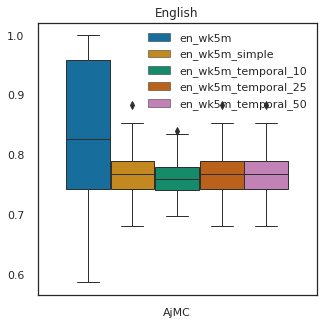

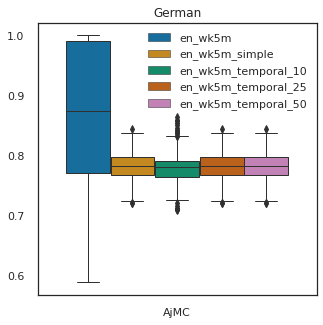

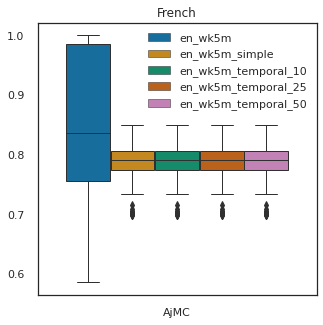

In [303]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=1., style="white")
plt.rcParams["figure.figsize"] = (5, 5)

for language in df.Language.unique():
    
    df_submission = df[df.Language == language]
    
    _ = sns.boxplot(data=df_submission, x='Dataset', y='Score', hue='Method', 
                    linewidth = 1., palette='colorblind')
    #_ = sns.barplot(data=df_submission, x='Dataset', y='Score', hue='Method', 
    #                linewidth = 1.5, palette='colorblind')

    plt.legend(loc='upper right')
    #plt.legend(loc='lower center', bbox_to_anchor=(1.4, 0.5),
    #          ncol=1, fancybox=True, shadow=True)


    #plt.legend().set_visible(False)
    plt.title(language)
    plt.ylabel('')
    plt.xlabel('')
    #plt.ylim(0.0, 102.0)
    #plt.xticks(rotation=40)import matplotlib.pyplot as plt

    plt.show()
